In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Dataset

In [2]:
def inf_train_gen(n_grid_points: int = 128, batch_size: int = 200, device: str = "cpu") -> Tensor:
    assert n_grid_points % 4 == 0, "number of grid points has to be divisible by 4"
    
    n_grid_points = n_grid_points // 4
    
    x1 = torch.randint(low=0, high=n_grid_points * 4, size=(batch_size,), device=device)
    samples_x2 = torch.randint(low=0, high=n_grid_points, size=(batch_size,), device=device)
    
    x2 = (
        samples_x2
        + 2 * n_grid_points
        - torch.randint(low=0, high=2, size=(batch_size,), device=device) * 2 * n_grid_points
        + (torch.floor(x1 / n_grid_points) % 2) * n_grid_points
    )
    
    x_end = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1)

    return x_end.long()

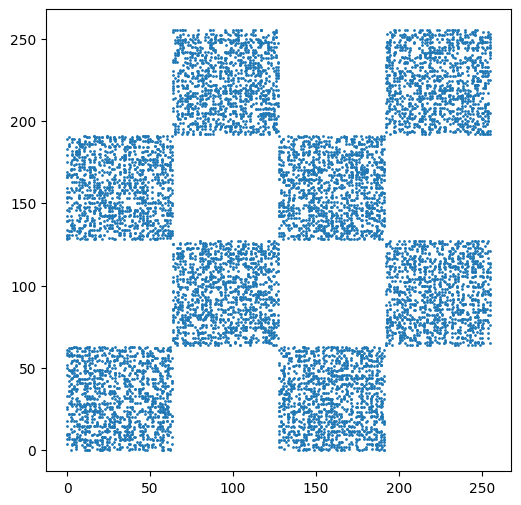

In [3]:
# Visulize dataset
samples = inf_train_gen(256, 10000)
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

## Training

In [4]:
from models.discrete_diffusion.udm import UniformDiffusion
from models.discrete_diffusion.utils.parametrizations import subs_parametrization
from models.denoising_models.mlp import MLP

batch_size = 256
train_steps = 1000000
vocab_size = 256
num_categories = vocab_size
input_shape = (2,)
num_timesteps = 100
lr = 1e-3

model = UniformDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=256,
        encode_time=True,
        n_hidden_layers=2,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    noise_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_steps)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 1/1000000 [00:08<2307:12:16,  8.31s/it]

  0%|          | 20/1000000 [00:08<83:27:18,  3.33it/s] 

  0%|          | 41/1000000 [00:08<33:53:48,  8.19it/s]

  0%|          | 62/1000000 [00:08<18:49:35, 14.75it/s]

  0%|          | 83/1000000 [00:08<11:52:11, 23.40it/s]

  0%|          | 104/1000000 [00:08<8:03:24, 34.47it/s]

  0%|          | 125/1000000 [00:08<5:46:09, 48.14it/s]

Step 100/1000000, Loss (EWMA): 10.5857, LR: 0.001000


  0%|          | 146/1000000 [00:09<4:19:38, 64.18it/s]

  0%|          | 167/1000000 [00:09<3:22:41, 82.21it/s]

  0%|          | 188/1000000 [00:09<2:44:44, 101.15it/s]

  0%|          | 209/1000000 [00:09<2:19:06, 119.79it/s]

  0%|          | 230/1000000 [00:09<2:01:22, 137.28it/s]

Step 200/1000000, Loss (EWMA): 11.1066, LR: 0.001000


  0%|          | 251/1000000 [00:09<1:49:27, 152.23it/s]

  0%|          | 272/1000000 [00:09<1:40:49, 165.25it/s]

  0%|          | 293/1000000 [00:09<1:35:05, 175.20it/s]

  0%|          | 314/1000000 [00:09<1:30:57, 183.17it/s]

  0%|          | 335/1000000 [00:09<1:28:02, 189.25it/s]

Step 300/1000000, Loss (EWMA): 11.0105, LR: 0.001000


  0%|          | 356/1000000 [00:10<1:26:11, 193.28it/s]

  0%|          | 377/1000000 [00:10<1:24:46, 196.51it/s]

  0%|          | 398/1000000 [00:10<1:23:43, 198.99it/s]

  0%|          | 419/1000000 [00:10<1:23:51, 198.66it/s]

  0%|          | 440/1000000 [00:10<1:23:05, 200.49it/s]

Step 400/1000000, Loss (EWMA): 10.9793, LR: 0.001000


  0%|          | 461/1000000 [00:10<1:22:34, 201.75it/s]

  0%|          | 482/1000000 [00:10<1:22:01, 203.09it/s]

  0%|          | 503/1000000 [00:10<1:21:46, 203.71it/s]

  0%|          | 524/1000000 [00:10<1:21:33, 204.24it/s]

Step 500/1000000, Loss (EWMA): 11.2580, LR: 0.001000


  0%|          | 545/1000000 [00:10<1:21:24, 204.63it/s]

  0%|          | 566/1000000 [00:11<1:21:13, 205.06it/s]

  0%|          | 587/1000000 [00:11<1:21:12, 205.10it/s]

  0%|          | 608/1000000 [00:11<1:21:16, 204.93it/s]

  0%|          | 629/1000000 [00:11<1:21:15, 204.96it/s]

Step 600/1000000, Loss (EWMA): 11.2335, LR: 0.001000


  0%|          | 650/1000000 [00:11<1:21:17, 204.90it/s]

  0%|          | 671/1000000 [00:11<1:21:11, 205.15it/s]

  0%|          | 692/1000000 [00:11<1:21:04, 205.44it/s]

  0%|          | 713/1000000 [00:11<1:21:13, 205.06it/s]

  0%|          | 734/1000000 [00:11<1:21:04, 205.42it/s]

Step 700/1000000, Loss (EWMA): 11.4640, LR: 0.001000


  0%|          | 755/1000000 [00:12<1:21:04, 205.41it/s]

  0%|          | 776/1000000 [00:12<1:20:58, 205.68it/s]

  0%|          | 797/1000000 [00:12<1:20:51, 205.94it/s]

  0%|          | 818/1000000 [00:12<1:21:27, 204.44it/s]

  0%|          | 839/1000000 [00:12<1:21:14, 204.99it/s]

Step 800/1000000, Loss (EWMA): 11.2449, LR: 0.001000


  0%|          | 860/1000000 [00:12<1:20:55, 205.79it/s]

  0%|          | 881/1000000 [00:12<1:20:35, 206.60it/s]

  0%|          | 902/1000000 [00:12<1:20:23, 207.13it/s]

  0%|          | 923/1000000 [00:12<1:20:16, 207.45it/s]

Step 900/1000000, Loss (EWMA): 11.5059, LR: 0.001000


  0%|          | 944/1000000 [00:12<1:20:11, 207.63it/s]

  0%|          | 965/1000000 [00:13<1:20:02, 208.03it/s]

  0%|          | 986/1000000 [00:13<1:19:56, 208.29it/s]

  0%|          | 1007/1000000 [00:13<1:19:57, 208.23it/s]

  0%|          | 1028/1000000 [00:13<1:19:59, 208.15it/s]

Step 1000/1000000, Loss (EWMA): 11.1847, LR: 0.001000


  0%|          | 1049/1000000 [00:13<1:20:02, 208.01it/s]

  0%|          | 1070/1000000 [00:13<1:19:55, 208.31it/s]

  0%|          | 1091/1000000 [00:13<1:19:58, 208.16it/s]

  0%|          | 1112/1000000 [00:13<1:20:12, 207.58it/s]

  0%|          | 1133/1000000 [00:13<1:20:02, 207.98it/s]

Step 1100/1000000, Loss (EWMA): 11.1772, LR: 0.001000


  0%|          | 1154/1000000 [00:13<1:20:01, 208.04it/s]

  0%|          | 1175/1000000 [00:14<1:20:40, 206.33it/s]

  0%|          | 1196/1000000 [00:14<1:20:22, 207.12it/s]

  0%|          | 1217/1000000 [00:14<1:20:12, 207.54it/s]

  0%|          | 1238/1000000 [00:14<1:20:01, 207.99it/s]

Step 1200/1000000, Loss (EWMA): 11.0547, LR: 0.001000


  0%|          | 1259/1000000 [00:14<1:20:01, 208.01it/s]

  0%|          | 1280/1000000 [00:14<1:20:00, 208.03it/s]

  0%|          | 1301/1000000 [00:14<1:20:02, 207.95it/s]

  0%|          | 1322/1000000 [00:14<1:19:57, 208.18it/s]

Step 1300/1000000, Loss (EWMA): 11.0018, LR: 0.001000


  0%|          | 1343/1000000 [00:14<1:19:56, 208.21it/s]

  0%|          | 1364/1000000 [00:14<1:19:52, 208.39it/s]

  0%|          | 1385/1000000 [00:15<1:19:54, 208.28it/s]

  0%|          | 1406/1000000 [00:15<1:19:58, 208.09it/s]

  0%|          | 1427/1000000 [00:15<1:19:55, 208.24it/s]

Step 1400/1000000, Loss (EWMA): 11.1094, LR: 0.001000


  0%|          | 1448/1000000 [00:15<1:20:03, 207.87it/s]

  0%|          | 1469/1000000 [00:15<1:19:59, 208.03it/s]

  0%|          | 1490/1000000 [00:15<1:20:00, 207.99it/s]

  0%|          | 1511/1000000 [00:15<1:20:01, 207.93it/s]

  0%|          | 1532/1000000 [00:15<1:20:09, 207.62it/s]

Step 1500/1000000, Loss (EWMA): 10.9150, LR: 0.001000


  0%|          | 1553/1000000 [00:15<1:20:13, 207.44it/s]

  0%|          | 1574/1000000 [00:15<1:20:10, 207.54it/s]

  0%|          | 1595/1000000 [00:16<1:20:04, 207.81it/s]

  0%|          | 1616/1000000 [00:16<1:20:00, 207.99it/s]

  0%|          | 1637/1000000 [00:16<1:20:09, 207.58it/s]

Step 1600/1000000, Loss (EWMA): 10.9141, LR: 0.001000


  0%|          | 1658/1000000 [00:16<1:20:09, 207.58it/s]

  0%|          | 1679/1000000 [00:16<1:20:03, 207.85it/s]

  0%|          | 1700/1000000 [00:16<1:19:59, 208.02it/s]

  0%|          | 1721/1000000 [00:16<1:19:48, 208.46it/s]

  0%|          | 1742/1000000 [00:16<1:19:47, 208.53it/s]

Step 1700/1000000, Loss (EWMA): 11.0416, LR: 0.001000


  0%|          | 1763/1000000 [00:16<1:19:45, 208.60it/s]

  0%|          | 1784/1000000 [00:16<1:19:44, 208.63it/s]

  0%|          | 1805/1000000 [00:17<1:19:52, 208.29it/s]

  0%|          | 1826/1000000 [00:17<1:19:47, 208.49it/s]

Step 1800/1000000, Loss (EWMA): 10.7801, LR: 0.001000


  0%|          | 1847/1000000 [00:17<1:19:52, 208.26it/s]

  0%|          | 1868/1000000 [00:17<1:19:44, 208.61it/s]

  0%|          | 1889/1000000 [00:17<1:20:14, 207.32it/s]

  0%|          | 1910/1000000 [00:17<1:20:07, 207.59it/s]

  0%|          | 1931/1000000 [00:17<1:19:58, 208.00it/s]

Step 1900/1000000, Loss (EWMA): 10.5045, LR: 0.001000


  0%|          | 1952/1000000 [00:17<1:20:08, 207.55it/s]

  0%|          | 1973/1000000 [00:17<1:19:57, 208.04it/s]

  0%|          | 1994/1000000 [00:17<1:19:53, 208.19it/s]

  0%|          | 2015/1000000 [00:18<1:19:53, 208.18it/s]

  0%|          | 2036/1000000 [00:18<1:19:46, 208.50it/s]

Step 2000/1000000, Loss (EWMA): 10.5370, LR: 0.001000


  0%|          | 2057/1000000 [00:18<1:20:08, 207.53it/s]

  0%|          | 2078/1000000 [00:18<1:20:00, 207.88it/s]

  0%|          | 2099/1000000 [00:18<1:20:01, 207.84it/s]

  0%|          | 2120/1000000 [00:18<1:20:04, 207.68it/s]

  0%|          | 2141/1000000 [00:18<1:19:54, 208.14it/s]

Step 2100/1000000, Loss (EWMA): 10.5212, LR: 0.001000


  0%|          | 2162/1000000 [00:18<1:19:57, 207.97it/s]

  0%|          | 2183/1000000 [00:18<1:19:52, 208.19it/s]

  0%|          | 2204/1000000 [00:18<1:19:58, 207.95it/s]

  0%|          | 2225/1000000 [00:19<1:20:00, 207.84it/s]

Step 2200/1000000, Loss (EWMA): 10.7054, LR: 0.001000


  0%|          | 2246/1000000 [00:19<1:19:55, 208.07it/s]

  0%|          | 2267/1000000 [00:19<1:19:55, 208.04it/s]

  0%|          | 2288/1000000 [00:19<1:19:48, 208.34it/s]

  0%|          | 2309/1000000 [00:19<1:19:57, 207.95it/s]

  0%|          | 2330/1000000 [00:19<1:19:54, 208.11it/s]

Step 2300/1000000, Loss (EWMA): 10.6925, LR: 0.001000


  0%|          | 2351/1000000 [00:19<1:19:52, 208.15it/s]

  0%|          | 2372/1000000 [00:19<1:19:54, 208.08it/s]

  0%|          | 2393/1000000 [00:19<1:20:04, 207.63it/s]

  0%|          | 2414/1000000 [00:19<1:20:07, 207.49it/s]

  0%|          | 2435/1000000 [00:20<1:20:05, 207.58it/s]

Step 2400/1000000, Loss (EWMA): 10.9727, LR: 0.001000


  0%|          | 2456/1000000 [00:20<1:20:02, 207.72it/s]

  0%|          | 2477/1000000 [00:20<1:19:52, 208.15it/s]

  0%|          | 2498/1000000 [00:20<1:19:47, 208.35it/s]

  0%|          | 2519/1000000 [00:20<1:19:51, 208.19it/s]

  0%|          | 2540/1000000 [00:20<1:19:47, 208.33it/s]

Step 2500/1000000, Loss (EWMA): 10.8238, LR: 0.001000


  0%|          | 2561/1000000 [00:20<1:19:59, 207.84it/s]

  0%|          | 2582/1000000 [00:20<1:19:52, 208.13it/s]

  0%|          | 2603/1000000 [00:20<1:20:03, 207.64it/s]

  0%|          | 2624/1000000 [00:20<1:20:06, 207.50it/s]

Step 2600/1000000, Loss (EWMA): 10.4848, LR: 0.001000


  0%|          | 2645/1000000 [00:21<1:20:06, 207.48it/s]

  0%|          | 2666/1000000 [00:21<1:20:01, 207.73it/s]

  0%|          | 2687/1000000 [00:21<1:19:56, 207.92it/s]

  0%|          | 2708/1000000 [00:21<1:19:54, 208.00it/s]

  0%|          | 2729/1000000 [00:21<1:19:51, 208.14it/s]

Step 2700/1000000, Loss (EWMA): 11.0293, LR: 0.001000


  0%|          | 2750/1000000 [00:21<1:19:53, 208.03it/s]

  0%|          | 2771/1000000 [00:21<1:19:45, 208.39it/s]

  0%|          | 2792/1000000 [00:21<1:19:51, 208.12it/s]

  0%|          | 2813/1000000 [00:21<1:20:00, 207.73it/s]

  0%|          | 2834/1000000 [00:22<1:20:02, 207.66it/s]

Step 2800/1000000, Loss (EWMA): 10.5836, LR: 0.001000


  0%|          | 2855/1000000 [00:22<1:20:11, 207.22it/s]

  0%|          | 2876/1000000 [00:22<1:20:09, 207.32it/s]

  0%|          | 2897/1000000 [00:22<1:20:02, 207.64it/s]

  0%|          | 2918/1000000 [00:22<1:20:09, 207.30it/s]

  0%|          | 2939/1000000 [00:22<1:20:03, 207.57it/s]

Step 2900/1000000, Loss (EWMA): 10.5217, LR: 0.001000


  0%|          | 2960/1000000 [00:22<1:20:20, 206.83it/s]

  0%|          | 2981/1000000 [00:22<1:20:06, 207.44it/s]

  0%|          | 3002/1000000 [00:22<1:19:59, 207.72it/s]

  0%|          | 3023/1000000 [00:22<1:20:28, 206.47it/s]

Step 3000/1000000, Loss (EWMA): 10.3830, LR: 0.001000


  0%|          | 3044/1000000 [00:23<1:20:57, 205.25it/s]

  0%|          | 3065/1000000 [00:23<1:21:06, 204.84it/s]

  0%|          | 3086/1000000 [00:23<1:21:17, 204.40it/s]

  0%|          | 3107/1000000 [00:23<1:21:24, 204.09it/s]

  0%|          | 3128/1000000 [00:23<1:21:24, 204.08it/s]

Step 3100/1000000, Loss (EWMA): 10.3972, LR: 0.001000


  0%|          | 3149/1000000 [00:23<1:21:35, 203.63it/s]

  0%|          | 3170/1000000 [00:23<1:21:25, 204.02it/s]

  0%|          | 3191/1000000 [00:23<1:20:56, 205.27it/s]

  0%|          | 3212/1000000 [00:23<1:20:42, 205.83it/s]

  0%|          | 3233/1000000 [00:23<1:20:27, 206.48it/s]

Step 3200/1000000, Loss (EWMA): 10.5467, LR: 0.001000


  0%|          | 3254/1000000 [00:24<1:20:21, 206.74it/s]

  0%|          | 3275/1000000 [00:24<1:20:11, 207.14it/s]

  0%|          | 3296/1000000 [00:24<1:19:58, 207.69it/s]

  0%|          | 3317/1000000 [00:24<1:20:00, 207.63it/s]

  0%|          | 3338/1000000 [00:24<1:19:59, 207.65it/s]

Step 3300/1000000, Loss (EWMA): 10.2230, LR: 0.001000


  0%|          | 3359/1000000 [00:24<1:19:59, 207.66it/s]

  0%|          | 3380/1000000 [00:24<1:19:57, 207.73it/s]

  0%|          | 3401/1000000 [00:24<1:19:57, 207.75it/s]

  0%|          | 3422/1000000 [00:24<1:19:46, 208.20it/s]

Step 3400/1000000, Loss (EWMA): 10.1491, LR: 0.001000


  0%|          | 3443/1000000 [00:24<1:19:48, 208.11it/s]

  0%|          | 3464/1000000 [00:25<1:19:43, 208.34it/s]

  0%|          | 3485/1000000 [00:25<1:19:38, 208.53it/s]

  0%|          | 3506/1000000 [00:25<1:19:42, 208.35it/s]

  0%|          | 3527/1000000 [00:25<1:19:48, 208.09it/s]

Step 3500/1000000, Loss (EWMA): 10.2711, LR: 0.001000


  0%|          | 3548/1000000 [00:25<1:19:52, 207.93it/s]

  0%|          | 3569/1000000 [00:25<1:19:44, 208.28it/s]

  0%|          | 3590/1000000 [00:25<1:19:38, 208.53it/s]

  0%|          | 3611/1000000 [00:25<1:19:49, 208.04it/s]

  0%|          | 3632/1000000 [00:25<1:19:52, 207.89it/s]

Step 3600/1000000, Loss (EWMA): 10.5415, LR: 0.001000


  0%|          | 3653/1000000 [00:25<1:19:56, 207.72it/s]

  0%|          | 3674/1000000 [00:26<1:19:47, 208.09it/s]

  0%|          | 3695/1000000 [00:26<1:19:38, 208.48it/s]

  0%|          | 3716/1000000 [00:26<1:19:34, 208.66it/s]

  0%|          | 3737/1000000 [00:26<1:19:45, 208.19it/s]

Step 3700/1000000, Loss (EWMA): 10.4476, LR: 0.001000


  0%|          | 3758/1000000 [00:26<1:19:44, 208.22it/s]

  0%|          | 3779/1000000 [00:26<1:19:47, 208.09it/s]

  0%|          | 3800/1000000 [00:26<1:20:17, 206.81it/s]

  0%|          | 3822/1000000 [00:26<1:19:13, 209.56it/s]

Step 3800/1000000, Loss (EWMA): 10.4373, LR: 0.001000


  0%|          | 3844/1000000 [00:26<1:18:28, 211.58it/s]

  0%|          | 3866/1000000 [00:26<1:18:05, 212.62it/s]

  0%|          | 3888/1000000 [00:27<1:17:38, 213.84it/s]

  0%|          | 3910/1000000 [00:27<1:17:18, 214.77it/s]

  0%|          | 3932/1000000 [00:27<1:17:03, 215.44it/s]

Step 3900/1000000, Loss (EWMA): 10.4403, LR: 0.001000


  0%|          | 3954/1000000 [00:27<1:16:56, 215.76it/s]

  0%|          | 3976/1000000 [00:27<1:16:38, 216.58it/s]

  0%|          | 3998/1000000 [00:27<1:16:24, 217.24it/s]

  0%|          | 4020/1000000 [00:27<1:17:10, 215.08it/s]

  0%|          | 4042/1000000 [00:27<1:16:55, 215.77it/s]

Step 4000/1000000, Loss (EWMA): 10.6970, LR: 0.001000


  0%|          | 4064/1000000 [00:27<1:16:47, 216.16it/s]

  0%|          | 4086/1000000 [00:27<1:16:41, 216.41it/s]

  0%|          | 4108/1000000 [00:28<1:16:48, 216.12it/s]

  0%|          | 4130/1000000 [00:28<1:16:44, 216.29it/s]

Step 4100/1000000, Loss (EWMA): 10.5667, LR: 0.001000


  0%|          | 4152/1000000 [00:28<1:16:46, 216.17it/s]

  0%|          | 4174/1000000 [00:28<1:17:39, 213.71it/s]

  0%|          | 4196/1000000 [00:28<1:17:31, 214.10it/s]

  0%|          | 4218/1000000 [00:28<1:17:19, 214.62it/s]

  0%|          | 4240/1000000 [00:28<1:17:14, 214.87it/s]

Step 4200/1000000, Loss (EWMA): 10.2983, LR: 0.001000


  0%|          | 4262/1000000 [00:28<1:17:12, 214.96it/s]

  0%|          | 4284/1000000 [00:28<1:17:08, 215.12it/s]

  0%|          | 4306/1000000 [00:29<1:17:09, 215.07it/s]

  0%|          | 4328/1000000 [00:29<1:17:04, 215.33it/s]

Step 4300/1000000, Loss (EWMA): 10.2857, LR: 0.001000


  0%|          | 4350/1000000 [00:29<1:17:14, 214.82it/s]

  0%|          | 4372/1000000 [00:29<1:17:04, 215.31it/s]

  0%|          | 4394/1000000 [00:29<1:16:56, 215.65it/s]

  0%|          | 4416/1000000 [00:29<1:17:00, 215.49it/s]

  0%|          | 4438/1000000 [00:29<1:16:54, 215.75it/s]

Step 4400/1000000, Loss (EWMA): 10.2958, LR: 0.001000


  0%|          | 4460/1000000 [00:29<1:17:02, 215.35it/s]

  0%|          | 4482/1000000 [00:29<1:16:52, 215.84it/s]

  0%|          | 4504/1000000 [00:29<1:16:53, 215.80it/s]

  0%|          | 4526/1000000 [00:30<1:16:53, 215.76it/s]

Step 4500/1000000, Loss (EWMA): 10.3490, LR: 0.001000


  0%|          | 4548/1000000 [00:30<1:16:59, 215.48it/s]

  0%|          | 4570/1000000 [00:30<1:16:58, 215.52it/s]

  0%|          | 4592/1000000 [00:30<1:16:54, 215.70it/s]

  0%|          | 4614/1000000 [00:30<1:17:34, 213.85it/s]

  0%|          | 4636/1000000 [00:30<1:17:27, 214.19it/s]

Step 4600/1000000, Loss (EWMA): 10.2925, LR: 0.001000


  0%|          | 4658/1000000 [00:30<1:17:31, 214.00it/s]

  0%|          | 4680/1000000 [00:30<1:17:21, 214.45it/s]

  0%|          | 4702/1000000 [00:30<1:17:21, 214.46it/s]

  0%|          | 4724/1000000 [00:30<1:17:10, 214.93it/s]

Step 4700/1000000, Loss (EWMA): 10.3647, LR: 0.001000


  0%|          | 4746/1000000 [00:31<1:17:18, 214.56it/s]

  0%|          | 4768/1000000 [00:31<1:17:10, 214.95it/s]

  0%|          | 4790/1000000 [00:31<1:17:11, 214.87it/s]

  0%|          | 4812/1000000 [00:31<1:17:20, 214.44it/s]

  0%|          | 4834/1000000 [00:31<1:17:08, 215.00it/s]

Step 4800/1000000, Loss (EWMA): 10.2618, LR: 0.001000


  0%|          | 4856/1000000 [00:31<1:17:04, 215.20it/s]

  0%|          | 4878/1000000 [00:31<1:16:59, 215.43it/s]

  0%|          | 4900/1000000 [00:31<1:16:51, 215.80it/s]

  0%|          | 4922/1000000 [00:31<1:16:49, 215.87it/s]

Step 4900/1000000, Loss (EWMA): 10.4282, LR: 0.001000


  0%|          | 4944/1000000 [00:31<1:16:40, 216.28it/s]

  0%|          | 4966/1000000 [00:32<1:16:42, 216.19it/s]

  0%|          | 4988/1000000 [00:32<1:16:39, 216.32it/s]

  1%|          | 5010/1000000 [00:32<1:16:35, 216.49it/s]

  1%|          | 5032/1000000 [00:32<1:16:25, 216.99it/s]

Step 5000/1000000, Loss (EWMA): 10.4798, LR: 0.001000


  1%|          | 5054/1000000 [00:32<1:16:20, 217.19it/s]

  1%|          | 5076/1000000 [00:32<1:16:15, 217.43it/s]

  1%|          | 5098/1000000 [00:32<1:16:16, 217.38it/s]

  1%|          | 5120/1000000 [00:32<1:16:37, 216.39it/s]

  1%|          | 5142/1000000 [00:32<1:17:58, 212.64it/s]

Step 5100/1000000, Loss (EWMA): 10.4211, LR: 0.001000


  1%|          | 5164/1000000 [00:33<1:18:23, 211.52it/s]

  1%|          | 5186/1000000 [00:33<1:18:42, 210.66it/s]

  1%|          | 5208/1000000 [00:33<1:19:03, 209.71it/s]

  1%|          | 5229/1000000 [00:33<1:19:36, 208.27it/s]

Step 5200/1000000, Loss (EWMA): 10.4983, LR: 0.001000


  1%|          | 5250/1000000 [00:33<1:19:43, 207.94it/s]

  1%|          | 5272/1000000 [00:33<1:18:52, 210.18it/s]

  1%|          | 5294/1000000 [00:33<1:18:09, 212.13it/s]

  1%|          | 5316/1000000 [00:33<1:17:48, 213.08it/s]

  1%|          | 5338/1000000 [00:33<1:17:30, 213.90it/s]

Step 5300/1000000, Loss (EWMA): 10.5236, LR: 0.001000


  1%|          | 5360/1000000 [00:33<1:17:22, 214.25it/s]

  1%|          | 5382/1000000 [00:34<1:17:10, 214.78it/s]

  1%|          | 5404/1000000 [00:34<1:17:07, 214.95it/s]

  1%|          | 5426/1000000 [00:34<1:17:01, 215.21it/s]

Step 5400/1000000, Loss (EWMA): 10.4205, LR: 0.001000


  1%|          | 5448/1000000 [00:34<1:16:53, 215.57it/s]

  1%|          | 5470/1000000 [00:34<1:16:55, 215.48it/s]

  1%|          | 5492/1000000 [00:34<1:16:57, 215.38it/s]

  1%|          | 5514/1000000 [00:34<1:17:01, 215.18it/s]

  1%|          | 5536/1000000 [00:34<1:17:03, 215.10it/s]

Step 5500/1000000, Loss (EWMA): 10.5814, LR: 0.001000


  1%|          | 5558/1000000 [00:34<1:17:08, 214.84it/s]

  1%|          | 5580/1000000 [00:34<1:17:14, 214.58it/s]

  1%|          | 5602/1000000 [00:35<1:17:19, 214.32it/s]

  1%|          | 5624/1000000 [00:35<1:17:04, 215.03it/s]

Step 5600/1000000, Loss (EWMA): 10.4579, LR: 0.001000


  1%|          | 5646/1000000 [00:35<1:17:05, 214.95it/s]

  1%|          | 5668/1000000 [00:35<1:16:54, 215.47it/s]

  1%|          | 5690/1000000 [00:35<1:16:52, 215.55it/s]

  1%|          | 5712/1000000 [00:35<1:16:56, 215.37it/s]

  1%|          | 5734/1000000 [00:35<1:16:54, 215.45it/s]

Step 5700/1000000, Loss (EWMA): 10.3424, LR: 0.001000


  1%|          | 5756/1000000 [00:35<1:17:03, 215.06it/s]

  1%|          | 5778/1000000 [00:35<1:16:43, 215.96it/s]

  1%|          | 5800/1000000 [00:35<1:16:36, 216.28it/s]

  1%|          | 5822/1000000 [00:36<1:16:29, 216.64it/s]

Step 5800/1000000, Loss (EWMA): 10.3558, LR: 0.001000


  1%|          | 5844/1000000 [00:36<1:16:31, 216.53it/s]

  1%|          | 5866/1000000 [00:36<1:16:25, 216.80it/s]

  1%|          | 5888/1000000 [00:36<1:16:31, 216.53it/s]

  1%|          | 5910/1000000 [00:36<1:16:28, 216.66it/s]

  1%|          | 5932/1000000 [00:36<1:16:26, 216.74it/s]

Step 5900/1000000, Loss (EWMA): 10.3514, LR: 0.001000


  1%|          | 5954/1000000 [00:36<1:16:22, 216.92it/s]

  1%|          | 5976/1000000 [00:36<1:16:42, 215.98it/s]

  1%|          | 5998/1000000 [00:36<1:18:05, 212.14it/s]

  1%|          | 6020/1000000 [00:36<1:18:34, 210.84it/s]

Step 6000/1000000, Loss (EWMA): 10.1844, LR: 0.001000


  1%|          | 6042/1000000 [00:37<1:18:50, 210.12it/s]

  1%|          | 6064/1000000 [00:37<1:19:12, 209.15it/s]

  1%|          | 6085/1000000 [00:37<1:19:30, 208.36it/s]

  1%|          | 6106/1000000 [00:37<1:19:42, 207.82it/s]

  1%|          | 6127/1000000 [00:37<1:19:58, 207.14it/s]

Step 6100/1000000, Loss (EWMA): 10.2261, LR: 0.001000


  1%|          | 6148/1000000 [00:37<1:20:13, 206.47it/s]

  1%|          | 6169/1000000 [00:37<1:20:08, 206.70it/s]

  1%|          | 6190/1000000 [00:37<1:20:17, 206.27it/s]

  1%|          | 6211/1000000 [00:37<1:20:59, 204.49it/s]

  1%|          | 6232/1000000 [00:38<1:20:54, 204.72it/s]

Step 6200/1000000, Loss (EWMA): 10.3003, LR: 0.001000


  1%|          | 6253/1000000 [00:38<1:20:36, 205.47it/s]

  1%|          | 6274/1000000 [00:38<1:20:13, 206.46it/s]

  1%|          | 6295/1000000 [00:38<1:20:04, 206.83it/s]

  1%|          | 6316/1000000 [00:38<1:19:52, 207.36it/s]

  1%|          | 6337/1000000 [00:38<1:19:48, 207.51it/s]

Step 6300/1000000, Loss (EWMA): 10.2682, LR: 0.001000


  1%|          | 6358/1000000 [00:38<1:19:39, 207.91it/s]

  1%|          | 6379/1000000 [00:38<1:19:27, 208.41it/s]

  1%|          | 6400/1000000 [00:38<1:19:27, 208.42it/s]

  1%|          | 6421/1000000 [00:38<1:19:32, 208.18it/s]

Step 6400/1000000, Loss (EWMA): 10.2702, LR: 0.001000


  1%|          | 6442/1000000 [00:39<1:19:43, 207.70it/s]

  1%|          | 6463/1000000 [00:39<1:19:37, 207.98it/s]

  1%|          | 6484/1000000 [00:39<1:19:38, 207.90it/s]

  1%|          | 6505/1000000 [00:39<1:19:36, 208.00it/s]

  1%|          | 6526/1000000 [00:39<1:19:31, 208.21it/s]

Step 6500/1000000, Loss (EWMA): 10.4705, LR: 0.001000


  1%|          | 6547/1000000 [00:39<1:19:40, 207.81it/s]

  1%|          | 6568/1000000 [00:39<1:19:36, 207.99it/s]

  1%|          | 6589/1000000 [00:39<1:19:31, 208.21it/s]

  1%|          | 6610/1000000 [00:39<1:19:39, 207.84it/s]

  1%|          | 6631/1000000 [00:39<1:19:36, 207.97it/s]

Step 6600/1000000, Loss (EWMA): 10.3318, LR: 0.001000


  1%|          | 6652/1000000 [00:40<1:19:40, 207.78it/s]

  1%|          | 6673/1000000 [00:40<1:19:33, 208.08it/s]

  1%|          | 6694/1000000 [00:40<1:19:32, 208.13it/s]

  1%|          | 6715/1000000 [00:40<1:19:39, 207.82it/s]

  1%|          | 6736/1000000 [00:40<1:19:41, 207.72it/s]

Step 6700/1000000, Loss (EWMA): 10.2390, LR: 0.001000


  1%|          | 6757/1000000 [00:40<1:19:43, 207.65it/s]

  1%|          | 6778/1000000 [00:40<1:19:34, 208.03it/s]

  1%|          | 6799/1000000 [00:40<1:19:30, 208.22it/s]

  1%|          | 6820/1000000 [00:40<1:19:33, 208.06it/s]

  1%|          | 6841/1000000 [00:40<1:19:30, 208.18it/s]

Step 6800/1000000, Loss (EWMA): 10.2528, LR: 0.001000


  1%|          | 6862/1000000 [00:41<1:19:32, 208.08it/s]

  1%|          | 6883/1000000 [00:41<1:19:49, 207.36it/s]

  1%|          | 6904/1000000 [00:41<1:19:52, 207.24it/s]

  1%|          | 6925/1000000 [00:41<1:19:59, 206.91it/s]

Step 6900/1000000, Loss (EWMA): 10.3096, LR: 0.001000


  1%|          | 6946/1000000 [00:41<1:20:01, 206.81it/s]

  1%|          | 6967/1000000 [00:41<1:19:53, 207.17it/s]

  1%|          | 6988/1000000 [00:41<1:19:44, 207.53it/s]

  1%|          | 7009/1000000 [00:41<1:19:41, 207.66it/s]

  1%|          | 7030/1000000 [00:41<1:19:35, 207.91it/s]

Step 7000/1000000, Loss (EWMA): 10.6711, LR: 0.001000


  1%|          | 7051/1000000 [00:41<1:19:42, 207.62it/s]

  1%|          | 7072/1000000 [00:42<1:19:42, 207.60it/s]

  1%|          | 7093/1000000 [00:42<1:19:32, 208.04it/s]

  1%|          | 7114/1000000 [00:42<1:19:38, 207.76it/s]

  1%|          | 7135/1000000 [00:42<1:19:30, 208.14it/s]

Step 7100/1000000, Loss (EWMA): 10.6190, LR: 0.001000


  1%|          | 7156/1000000 [00:42<1:19:34, 207.95it/s]

  1%|          | 7177/1000000 [00:42<1:19:40, 207.69it/s]

  1%|          | 7198/1000000 [00:42<1:19:31, 208.07it/s]

  1%|          | 7219/1000000 [00:42<1:19:37, 207.79it/s]

  1%|          | 7240/1000000 [00:42<1:19:30, 208.09it/s]

Step 7200/1000000, Loss (EWMA): 10.3650, LR: 0.001000


  1%|          | 7261/1000000 [00:42<1:19:29, 208.12it/s]

  1%|          | 7282/1000000 [00:43<1:19:37, 207.79it/s]

  1%|          | 7303/1000000 [00:43<1:19:33, 207.97it/s]

  1%|          | 7324/1000000 [00:43<1:19:38, 207.75it/s]

Step 7300/1000000, Loss (EWMA): 10.3015, LR: 0.001000


  1%|          | 7345/1000000 [00:43<1:19:34, 207.92it/s]

  1%|          | 7366/1000000 [00:43<1:19:36, 207.83it/s]

  1%|          | 7387/1000000 [00:43<1:19:34, 207.88it/s]

  1%|          | 7408/1000000 [00:43<1:19:27, 208.21it/s]

  1%|          | 7429/1000000 [00:43<1:19:21, 208.44it/s]

Step 7400/1000000, Loss (EWMA): 10.3976, LR: 0.001000


  1%|          | 7450/1000000 [00:43<1:19:39, 207.66it/s]

  1%|          | 7471/1000000 [00:43<1:19:34, 207.87it/s]

  1%|          | 7492/1000000 [00:44<1:19:28, 208.12it/s]

  1%|          | 7513/1000000 [00:44<1:19:41, 207.56it/s]

  1%|          | 7534/1000000 [00:44<1:19:37, 207.74it/s]

Step 7500/1000000, Loss (EWMA): 10.3088, LR: 0.001000


  1%|          | 7555/1000000 [00:44<1:19:39, 207.64it/s]

  1%|          | 7576/1000000 [00:44<1:19:29, 208.07it/s]

  1%|          | 7597/1000000 [00:44<1:19:20, 208.48it/s]

  1%|          | 7618/1000000 [00:44<1:19:34, 207.86it/s]

  1%|          | 7639/1000000 [00:44<1:19:24, 208.27it/s]

Step 7600/1000000, Loss (EWMA): 10.4240, LR: 0.001000


  1%|          | 7660/1000000 [00:44<1:19:40, 207.58it/s]

  1%|          | 7681/1000000 [00:44<1:19:33, 207.89it/s]

  1%|          | 7702/1000000 [00:45<1:19:38, 207.64it/s]

  1%|          | 7723/1000000 [00:45<1:19:36, 207.76it/s]

Step 7700/1000000, Loss (EWMA): 10.4489, LR: 0.001000


  1%|          | 7744/1000000 [00:45<1:19:40, 207.57it/s]

  1%|          | 7765/1000000 [00:45<1:19:37, 207.70it/s]

  1%|          | 7786/1000000 [00:45<1:19:39, 207.58it/s]

  1%|          | 7807/1000000 [00:45<1:19:59, 206.75it/s]

  1%|          | 7828/1000000 [00:45<1:20:02, 206.59it/s]

Step 7800/1000000, Loss (EWMA): 10.3944, LR: 0.001000


  1%|          | 7849/1000000 [00:45<1:20:11, 206.21it/s]

  1%|          | 7870/1000000 [00:45<1:20:04, 206.50it/s]

  1%|          | 7891/1000000 [00:46<1:19:52, 207.03it/s]

  1%|          | 7912/1000000 [00:46<1:19:48, 207.19it/s]

  1%|          | 7933/1000000 [00:46<1:19:39, 207.56it/s]

Step 7900/1000000, Loss (EWMA): 10.2555, LR: 0.001000


  1%|          | 7954/1000000 [00:46<1:20:12, 206.14it/s]

  1%|          | 7975/1000000 [00:46<1:20:01, 206.61it/s]

  1%|          | 7996/1000000 [00:46<1:20:02, 206.57it/s]

  1%|          | 8017/1000000 [00:46<1:20:26, 205.52it/s]

  1%|          | 8038/1000000 [00:46<1:20:03, 206.51it/s]

Step 8000/1000000, Loss (EWMA): 10.4057, LR: 0.001000


  1%|          | 8059/1000000 [00:46<1:20:05, 206.43it/s]

  1%|          | 8080/1000000 [00:46<1:19:55, 206.83it/s]

  1%|          | 8101/1000000 [00:47<1:19:47, 207.17it/s]

  1%|          | 8122/1000000 [00:47<1:19:42, 207.39it/s]

Step 8100/1000000, Loss (EWMA): 10.3658, LR: 0.001000


  1%|          | 8143/1000000 [00:47<1:19:44, 207.31it/s]

  1%|          | 8164/1000000 [00:47<1:19:37, 207.61it/s]

  1%|          | 8185/1000000 [00:47<1:19:29, 207.94it/s]

  1%|          | 8206/1000000 [00:47<1:19:30, 207.92it/s]

  1%|          | 8227/1000000 [00:47<1:20:04, 206.41it/s]

Step 8200/1000000, Loss (EWMA): 10.3220, LR: 0.001000


  1%|          | 8248/1000000 [00:47<1:20:11, 206.11it/s]

  1%|          | 8269/1000000 [00:47<1:20:00, 206.60it/s]

  1%|          | 8290/1000000 [00:47<1:19:55, 206.80it/s]

  1%|          | 8311/1000000 [00:48<1:19:50, 207.03it/s]

  1%|          | 8332/1000000 [00:48<1:19:47, 207.13it/s]

Step 8300/1000000, Loss (EWMA): 10.6741, LR: 0.001000


  1%|          | 8353/1000000 [00:48<1:20:51, 204.38it/s]

  1%|          | 8374/1000000 [00:48<1:20:27, 205.41it/s]

  1%|          | 8395/1000000 [00:48<1:20:14, 205.97it/s]

  1%|          | 8416/1000000 [00:48<1:19:56, 206.74it/s]

  1%|          | 8437/1000000 [00:48<1:19:57, 206.70it/s]

Step 8400/1000000, Loss (EWMA): 10.6198, LR: 0.001000


  1%|          | 8458/1000000 [00:48<1:19:56, 206.73it/s]

  1%|          | 8479/1000000 [00:48<1:19:49, 207.00it/s]

  1%|          | 8500/1000000 [00:48<1:19:48, 207.06it/s]

  1%|          | 8521/1000000 [00:49<1:19:35, 207.63it/s]

Step 8500/1000000, Loss (EWMA): 10.4752, LR: 0.001000


  1%|          | 8542/1000000 [00:49<1:19:36, 207.55it/s]

  1%|          | 8563/1000000 [00:49<1:19:39, 207.45it/s]

  1%|          | 8584/1000000 [00:49<1:19:42, 207.31it/s]

  1%|          | 8605/1000000 [00:49<1:19:49, 207.00it/s]

  1%|          | 8626/1000000 [00:49<1:19:50, 206.95it/s]

Step 8600/1000000, Loss (EWMA): 10.3226, LR: 0.001000


  1%|          | 8647/1000000 [00:49<1:19:45, 207.15it/s]

  1%|          | 8668/1000000 [00:49<1:20:13, 205.93it/s]

  1%|          | 8689/1000000 [00:49<1:20:21, 205.60it/s]

  1%|          | 8710/1000000 [00:49<1:20:10, 206.08it/s]

  1%|          | 8731/1000000 [00:50<1:19:51, 206.88it/s]

Step 8700/1000000, Loss (EWMA): 10.3203, LR: 0.001000


  1%|          | 8752/1000000 [00:50<1:19:43, 207.24it/s]

  1%|          | 8773/1000000 [00:50<1:19:31, 207.75it/s]

  1%|          | 8794/1000000 [00:50<1:19:18, 208.31it/s]

  1%|          | 8815/1000000 [00:50<1:19:18, 208.29it/s]

  1%|          | 8836/1000000 [00:50<1:19:21, 208.17it/s]

Step 8800/1000000, Loss (EWMA): 10.4138, LR: 0.001000


  1%|          | 8857/1000000 [00:50<1:19:16, 208.39it/s]

  1%|          | 8878/1000000 [00:50<1:19:10, 208.65it/s]

  1%|          | 8899/1000000 [00:50<1:19:22, 208.12it/s]

  1%|          | 8920/1000000 [00:50<1:19:22, 208.11it/s]

  1%|          | 8941/1000000 [00:51<1:19:13, 208.48it/s]

Step 8900/1000000, Loss (EWMA): 10.5087, LR: 0.001000


  1%|          | 8962/1000000 [00:51<1:19:15, 208.40it/s]

  1%|          | 8983/1000000 [00:51<1:19:13, 208.47it/s]

  1%|          | 9004/1000000 [00:51<1:19:14, 208.43it/s]

  1%|          | 9025/1000000 [00:51<1:19:14, 208.45it/s]

Step 9000/1000000, Loss (EWMA): 10.4472, LR: 0.001000


  1%|          | 9046/1000000 [00:51<1:19:12, 208.50it/s]

  1%|          | 9067/1000000 [00:51<1:19:09, 208.65it/s]

  1%|          | 9088/1000000 [00:51<1:19:05, 208.81it/s]

  1%|          | 9109/1000000 [00:51<1:19:30, 207.69it/s]

  1%|          | 9130/1000000 [00:51<1:19:22, 208.08it/s]

Step 9100/1000000, Loss (EWMA): 10.3799, LR: 0.001000


  1%|          | 9151/1000000 [00:52<1:19:22, 208.07it/s]

  1%|          | 9172/1000000 [00:52<1:19:18, 208.24it/s]

  1%|          | 9193/1000000 [00:52<1:19:17, 208.27it/s]

  1%|          | 9214/1000000 [00:52<1:19:14, 208.37it/s]

  1%|          | 9235/1000000 [00:52<1:19:13, 208.41it/s]

Step 9200/1000000, Loss (EWMA): 10.4798, LR: 0.001000


  1%|          | 9256/1000000 [00:52<1:19:18, 208.20it/s]

  1%|          | 9277/1000000 [00:52<1:19:21, 208.07it/s]

  1%|          | 9298/1000000 [00:52<1:19:18, 208.21it/s]

  1%|          | 9319/1000000 [00:52<1:19:25, 207.87it/s]

  1%|          | 9340/1000000 [00:52<1:19:21, 208.07it/s]

Step 9300/1000000, Loss (EWMA): 10.3506, LR: 0.001000


  1%|          | 9361/1000000 [00:53<1:19:22, 208.02it/s]

  1%|          | 9382/1000000 [00:53<1:19:21, 208.05it/s]

  1%|          | 9403/1000000 [00:53<1:19:31, 207.62it/s]

  1%|          | 9424/1000000 [00:53<1:19:56, 206.53it/s]

Step 9400/1000000, Loss (EWMA): 10.3218, LR: 0.001000


  1%|          | 9445/1000000 [00:53<1:19:54, 206.58it/s]

  1%|          | 9466/1000000 [00:53<1:19:35, 207.40it/s]

  1%|          | 9487/1000000 [00:53<1:19:26, 207.81it/s]

  1%|          | 9508/1000000 [00:53<1:19:13, 208.37it/s]

  1%|          | 9529/1000000 [00:53<1:19:20, 208.06it/s]

Step 9500/1000000, Loss (EWMA): 10.4466, LR: 0.001000


  1%|          | 9550/1000000 [00:54<1:19:26, 207.77it/s]

  1%|          | 9571/1000000 [00:54<1:19:14, 208.33it/s]

  1%|          | 9592/1000000 [00:54<1:19:09, 208.54it/s]

  1%|          | 9613/1000000 [00:54<1:19:13, 208.34it/s]

  1%|          | 9634/1000000 [00:54<1:19:20, 208.02it/s]

Step 9600/1000000, Loss (EWMA): 10.4331, LR: 0.001000


  1%|          | 9655/1000000 [00:54<1:19:24, 207.86it/s]

  1%|          | 9676/1000000 [00:54<1:19:20, 208.05it/s]

  1%|          | 9697/1000000 [00:54<1:19:14, 208.27it/s]

  1%|          | 9718/1000000 [00:54<1:20:24, 205.26it/s]

  1%|          | 9739/1000000 [00:54<1:20:04, 206.10it/s]

Step 9700/1000000, Loss (EWMA): 10.3999, LR: 0.001000


  1%|          | 9760/1000000 [00:55<1:19:55, 206.49it/s]

  1%|          | 9781/1000000 [00:55<1:19:46, 206.86it/s]

  1%|          | 9802/1000000 [00:55<1:19:39, 207.16it/s]

  1%|          | 9823/1000000 [00:55<1:19:27, 207.69it/s]

Step 9800/1000000, Loss (EWMA): 10.3415, LR: 0.001000


  1%|          | 9844/1000000 [00:55<1:19:25, 207.79it/s]

  1%|          | 9865/1000000 [00:55<1:19:14, 208.23it/s]

  1%|          | 9886/1000000 [00:55<1:19:09, 208.45it/s]

  1%|          | 9907/1000000 [00:55<1:19:08, 208.50it/s]

  1%|          | 9928/1000000 [00:55<1:19:15, 208.20it/s]

Step 9900/1000000, Loss (EWMA): 10.4664, LR: 0.001000


  1%|          | 9949/1000000 [00:55<1:19:26, 207.70it/s]

  1%|          | 9970/1000000 [00:56<1:19:28, 207.60it/s]

  1%|          | 9991/1000000 [00:56<1:19:13, 208.28it/s]

  1%|          | 10012/1000000 [00:56<1:19:21, 207.94it/s]

  1%|          | 10033/1000000 [00:56<1:19:26, 207.71it/s]

Step 10000/1000000, Loss (EWMA): 10.6702, LR: 0.001000


  1%|          | 10054/1000000 [00:56<1:19:33, 207.37it/s]

  1%|          | 10075/1000000 [00:56<1:19:18, 208.04it/s]

  1%|          | 10096/1000000 [00:56<1:19:20, 207.96it/s]

  1%|          | 10117/1000000 [00:56<1:19:25, 207.72it/s]

  1%|          | 10138/1000000 [00:56<1:19:18, 208.00it/s]

Step 10100/1000000, Loss (EWMA): 10.7636, LR: 0.001000


  1%|          | 10159/1000000 [00:56<1:19:14, 208.18it/s]

  1%|          | 10180/1000000 [00:57<1:20:14, 205.60it/s]

  1%|          | 10201/1000000 [00:57<1:19:56, 206.37it/s]

  1%|          | 10222/1000000 [00:57<1:19:34, 207.31it/s]

Step 10200/1000000, Loss (EWMA): 10.4192, LR: 0.001000


  1%|          | 10243/1000000 [00:57<1:19:25, 207.69it/s]

  1%|          | 10264/1000000 [00:57<1:19:13, 208.21it/s]

  1%|          | 10285/1000000 [00:57<1:19:13, 208.21it/s]

  1%|          | 10306/1000000 [00:57<1:19:10, 208.35it/s]

  1%|          | 10327/1000000 [00:57<1:19:14, 208.16it/s]

Step 10300/1000000, Loss (EWMA): 10.3939, LR: 0.001000


  1%|          | 10348/1000000 [00:57<1:19:07, 208.44it/s]

  1%|          | 10369/1000000 [00:57<1:19:03, 208.62it/s]

  1%|          | 10390/1000000 [00:58<1:19:06, 208.49it/s]

  1%|          | 10411/1000000 [00:58<1:19:05, 208.52it/s]

  1%|          | 10432/1000000 [00:58<1:19:07, 208.43it/s]

Step 10400/1000000, Loss (EWMA): 10.3759, LR: 0.001000


  1%|          | 10453/1000000 [00:58<1:19:09, 208.34it/s]

  1%|          | 10474/1000000 [00:58<1:19:15, 208.07it/s]

  1%|          | 10495/1000000 [00:58<1:19:15, 208.09it/s]

  1%|          | 10516/1000000 [00:58<1:19:22, 207.75it/s]

  1%|          | 10537/1000000 [00:58<1:19:19, 207.87it/s]

Step 10500/1000000, Loss (EWMA): 10.3935, LR: 0.001000


  1%|          | 10558/1000000 [00:58<1:19:20, 207.84it/s]

  1%|          | 10579/1000000 [00:58<1:19:24, 207.65it/s]

  1%|          | 10600/1000000 [00:59<1:19:35, 207.17it/s]

  1%|          | 10621/1000000 [00:59<1:19:21, 207.77it/s]

  1%|          | 10642/1000000 [00:59<1:19:08, 208.34it/s]

Step 10600/1000000, Loss (EWMA): 10.4020, LR: 0.001000


  1%|          | 10663/1000000 [00:59<1:19:04, 208.53it/s]

  1%|          | 10684/1000000 [00:59<1:18:56, 208.89it/s]

  1%|          | 10705/1000000 [00:59<1:19:05, 208.49it/s]

  1%|          | 10726/1000000 [00:59<1:18:58, 208.79it/s]

Step 10700/1000000, Loss (EWMA): 10.3660, LR: 0.001000


  1%|          | 10747/1000000 [00:59<1:18:57, 208.82it/s]

  1%|          | 10768/1000000 [00:59<1:18:49, 209.15it/s]

  1%|          | 10789/1000000 [00:59<1:18:46, 209.27it/s]

  1%|          | 10810/1000000 [01:00<1:18:53, 208.98it/s]

  1%|          | 10831/1000000 [01:00<1:18:55, 208.90it/s]

Step 10800/1000000, Loss (EWMA): 10.3173, LR: 0.001000


  1%|          | 10852/1000000 [01:00<1:19:01, 208.61it/s]

  1%|          | 10874/1000000 [01:00<1:18:49, 209.13it/s]

  1%|          | 10895/1000000 [01:00<1:18:49, 209.13it/s]

  1%|          | 10916/1000000 [01:00<1:18:47, 209.21it/s]

  1%|          | 10937/1000000 [01:00<1:18:46, 209.26it/s]

Step 10900/1000000, Loss (EWMA): 11.1539, LR: 0.001000


  1%|          | 10958/1000000 [01:00<1:18:50, 209.08it/s]

  1%|          | 10980/1000000 [01:00<1:18:40, 209.53it/s]

  1%|          | 11001/1000000 [01:00<1:18:43, 209.36it/s]

  1%|          | 11022/1000000 [01:01<1:18:41, 209.46it/s]

Step 11000/1000000, Loss (EWMA): 10.8416, LR: 0.001000


  1%|          | 11043/1000000 [01:01<1:19:39, 206.94it/s]

  1%|          | 11064/1000000 [01:01<1:19:32, 207.20it/s]

  1%|          | 11085/1000000 [01:01<1:19:16, 207.92it/s]

  1%|          | 11106/1000000 [01:01<1:19:17, 207.85it/s]

  1%|          | 11127/1000000 [01:01<1:19:14, 207.98it/s]

Step 11100/1000000, Loss (EWMA): 10.5995, LR: 0.001000


  1%|          | 11148/1000000 [01:01<1:19:14, 207.97it/s]

  1%|          | 11169/1000000 [01:01<1:19:11, 208.11it/s]

  1%|          | 11190/1000000 [01:01<1:19:18, 207.80it/s]

  1%|          | 11211/1000000 [01:01<1:19:14, 207.95it/s]

  1%|          | 11232/1000000 [01:02<1:19:11, 208.09it/s]

Step 11200/1000000, Loss (EWMA): 10.4715, LR: 0.001000


  1%|          | 11253/1000000 [01:02<1:19:23, 207.58it/s]

  1%|          | 11274/1000000 [01:02<1:19:14, 207.95it/s]

  1%|          | 11295/1000000 [01:02<1:19:06, 208.31it/s]

  1%|          | 11316/1000000 [01:02<1:19:12, 208.05it/s]

  1%|          | 11337/1000000 [01:02<1:19:28, 207.34it/s]

Step 11300/1000000, Loss (EWMA): 10.2913, LR: 0.001000


  1%|          | 11358/1000000 [01:02<1:19:38, 206.89it/s]

  1%|          | 11379/1000000 [01:02<1:19:38, 206.88it/s]

  1%|          | 11400/1000000 [01:02<1:19:32, 207.13it/s]

  1%|          | 11421/1000000 [01:03<1:19:22, 207.57it/s]

Step 11400/1000000, Loss (EWMA): 10.2581, LR: 0.001000


  1%|          | 11442/1000000 [01:03<1:19:25, 207.42it/s]

  1%|          | 11463/1000000 [01:03<1:19:47, 206.48it/s]

  1%|          | 11484/1000000 [01:03<1:19:44, 206.59it/s]

  1%|          | 11505/1000000 [01:03<1:19:43, 206.65it/s]

  1%|          | 11526/1000000 [01:03<1:20:05, 205.70it/s]

Step 11500/1000000, Loss (EWMA): 10.3003, LR: 0.001000


  1%|          | 11547/1000000 [01:03<1:20:02, 205.82it/s]

  1%|          | 11568/1000000 [01:03<1:20:09, 205.54it/s]

  1%|          | 11589/1000000 [01:03<1:20:04, 205.73it/s]

  1%|          | 11610/1000000 [01:03<1:20:14, 205.28it/s]

  1%|          | 11631/1000000 [01:04<1:20:11, 205.43it/s]

Step 11600/1000000, Loss (EWMA): 10.2623, LR: 0.001000


  1%|          | 11652/1000000 [01:04<1:20:24, 204.86it/s]

  1%|          | 11673/1000000 [01:04<1:20:45, 203.97it/s]

  1%|          | 11694/1000000 [01:04<1:20:34, 204.41it/s]

  1%|          | 11715/1000000 [01:04<1:20:48, 203.85it/s]

  1%|          | 11736/1000000 [01:04<1:20:39, 204.23it/s]

Step 11700/1000000, Loss (EWMA): 10.4861, LR: 0.001000


  1%|          | 11757/1000000 [01:04<1:20:34, 204.40it/s]

  1%|          | 11778/1000000 [01:04<1:20:27, 204.71it/s]

  1%|          | 11799/1000000 [01:04<1:20:29, 204.64it/s]

  1%|          | 11820/1000000 [01:04<1:20:22, 204.91it/s]

  1%|          | 11841/1000000 [01:05<1:20:07, 205.54it/s]

Step 11800/1000000, Loss (EWMA): 10.5803, LR: 0.001000


  1%|          | 11862/1000000 [01:05<1:20:12, 205.31it/s]

  1%|          | 11883/1000000 [01:05<1:20:15, 205.18it/s]

  1%|          | 11904/1000000 [01:05<1:20:07, 205.53it/s]

  1%|          | 11925/1000000 [01:05<1:19:58, 205.90it/s]

Step 11900/1000000, Loss (EWMA): 10.6411, LR: 0.001000


  1%|          | 11946/1000000 [01:05<1:20:06, 205.57it/s]

  1%|          | 11967/1000000 [01:05<1:19:57, 205.95it/s]

  1%|          | 11988/1000000 [01:05<1:19:54, 206.09it/s]

  1%|          | 12009/1000000 [01:05<1:19:57, 205.92it/s]

  1%|          | 12030/1000000 [01:05<1:19:53, 206.09it/s]

Step 12000/1000000, Loss (EWMA): 10.5685, LR: 0.001000


  1%|          | 12051/1000000 [01:06<1:20:05, 205.60it/s]

  1%|          | 12072/1000000 [01:06<1:19:53, 206.11it/s]

  1%|          | 12093/1000000 [01:06<1:19:59, 205.85it/s]

  1%|          | 12114/1000000 [01:06<1:20:00, 205.80it/s]

  1%|          | 12135/1000000 [01:06<1:19:56, 205.96it/s]

Step 12100/1000000, Loss (EWMA): 11.1914, LR: 0.001000


  1%|          | 12156/1000000 [01:06<1:19:59, 205.84it/s]

  1%|          | 12177/1000000 [01:06<1:19:51, 206.16it/s]

  1%|          | 12198/1000000 [01:06<1:20:19, 204.95it/s]

  1%|          | 12219/1000000 [01:06<1:20:14, 205.18it/s]

  1%|          | 12240/1000000 [01:06<1:20:07, 205.46it/s]

Step 12200/1000000, Loss (EWMA): 10.6716, LR: 0.001000


  1%|          | 12261/1000000 [01:07<1:20:04, 205.57it/s]

  1%|          | 12282/1000000 [01:07<1:20:40, 204.07it/s]

  1%|          | 12303/1000000 [01:07<1:20:52, 203.55it/s]

  1%|          | 12324/1000000 [01:07<1:20:30, 204.48it/s]

Step 12300/1000000, Loss (EWMA): 10.4391, LR: 0.001000


  1%|          | 12345/1000000 [01:07<1:20:21, 204.85it/s]

  1%|          | 12366/1000000 [01:07<1:20:16, 205.07it/s]

  1%|          | 12387/1000000 [01:07<1:19:58, 205.82it/s]

  1%|          | 12408/1000000 [01:07<1:19:58, 205.79it/s]

  1%|          | 12429/1000000 [01:07<1:19:58, 205.81it/s]

Step 12400/1000000, Loss (EWMA): 10.4312, LR: 0.001000


  1%|          | 12450/1000000 [01:08<1:20:04, 205.54it/s]

  1%|          | 12471/1000000 [01:08<1:19:52, 206.06it/s]

  1%|          | 12492/1000000 [01:08<1:19:35, 206.79it/s]

  1%|▏         | 12513/1000000 [01:08<1:19:34, 206.82it/s]

  1%|▏         | 12534/1000000 [01:08<1:20:10, 205.25it/s]

Step 12500/1000000, Loss (EWMA): 10.3833, LR: 0.001000


  1%|▏         | 12555/1000000 [01:08<1:20:51, 203.52it/s]

  1%|▏         | 12576/1000000 [01:08<1:21:05, 202.95it/s]

  1%|▏         | 12597/1000000 [01:08<1:20:32, 204.31it/s]

  1%|▏         | 12618/1000000 [01:08<1:20:32, 204.31it/s]

  1%|▏         | 12639/1000000 [01:08<1:20:19, 204.87it/s]

Step 12600/1000000, Loss (EWMA): 10.3095, LR: 0.001000


  1%|▏         | 12660/1000000 [01:09<1:20:22, 204.74it/s]

  1%|▏         | 12681/1000000 [01:09<1:20:14, 205.07it/s]

  1%|▏         | 12702/1000000 [01:09<1:19:52, 206.03it/s]

  1%|▏         | 12723/1000000 [01:09<1:20:00, 205.67it/s]

Step 12700/1000000, Loss (EWMA): 10.3395, LR: 0.001000


  1%|▏         | 12744/1000000 [01:09<1:20:16, 204.99it/s]

  1%|▏         | 12765/1000000 [01:09<1:20:23, 204.68it/s]

  1%|▏         | 12786/1000000 [01:09<1:20:25, 204.60it/s]

  1%|▏         | 12807/1000000 [01:09<1:20:26, 204.55it/s]

  1%|▏         | 12828/1000000 [01:09<1:20:32, 204.29it/s]

Step 12800/1000000, Loss (EWMA): 10.3015, LR: 0.001000


  1%|▏         | 12849/1000000 [01:09<1:20:53, 203.40it/s]

  1%|▏         | 12870/1000000 [01:10<1:20:55, 203.31it/s]

  1%|▏         | 12891/1000000 [01:10<1:20:43, 203.79it/s]

  1%|▏         | 12912/1000000 [01:10<1:21:00, 203.06it/s]

  1%|▏         | 12933/1000000 [01:10<1:20:55, 203.29it/s]

Step 12900/1000000, Loss (EWMA): 10.4147, LR: 0.001000


  1%|▏         | 12954/1000000 [01:10<1:20:55, 203.29it/s]

  1%|▏         | 12975/1000000 [01:10<1:20:45, 203.70it/s]

  1%|▏         | 12996/1000000 [01:10<1:20:42, 203.82it/s]

  1%|▏         | 13017/1000000 [01:10<1:20:37, 204.02it/s]

  1%|▏         | 13038/1000000 [01:10<1:20:24, 204.56it/s]

Step 13000/1000000, Loss (EWMA): 10.4596, LR: 0.001000


  1%|▏         | 13059/1000000 [01:10<1:20:38, 203.98it/s]

  1%|▏         | 13080/1000000 [01:11<1:20:38, 203.96it/s]

  1%|▏         | 13101/1000000 [01:11<1:20:53, 203.35it/s]

  1%|▏         | 13122/1000000 [01:11<1:20:42, 203.78it/s]

Step 13100/1000000, Loss (EWMA): 10.4266, LR: 0.001000


  1%|▏         | 13143/1000000 [01:11<1:20:46, 203.62it/s]

  1%|▏         | 13164/1000000 [01:11<1:20:51, 203.41it/s]

  1%|▏         | 13185/1000000 [01:11<1:20:49, 203.51it/s]

  1%|▏         | 13206/1000000 [01:11<1:20:42, 203.77it/s]

  1%|▏         | 13227/1000000 [01:11<1:20:25, 204.49it/s]

Step 13200/1000000, Loss (EWMA): 10.3285, LR: 0.001000


  1%|▏         | 13248/1000000 [01:11<1:20:36, 204.03it/s]

  1%|▏         | 13269/1000000 [01:12<1:20:26, 204.44it/s]

  1%|▏         | 13290/1000000 [01:12<1:20:10, 205.12it/s]

  1%|▏         | 13311/1000000 [01:12<1:19:57, 205.65it/s]

  1%|▏         | 13332/1000000 [01:12<1:19:43, 206.25it/s]

Step 13300/1000000, Loss (EWMA): 10.4472, LR: 0.001000


  1%|▏         | 13353/1000000 [01:12<1:19:39, 206.45it/s]

  1%|▏         | 13374/1000000 [01:12<1:19:25, 207.03it/s]

  1%|▏         | 13395/1000000 [01:12<1:19:13, 207.56it/s]

  1%|▏         | 13416/1000000 [01:12<1:19:10, 207.67it/s]

  1%|▏         | 13437/1000000 [01:12<1:19:13, 207.52it/s]

Step 13400/1000000, Loss (EWMA): 10.4940, LR: 0.001000


  1%|▏         | 13458/1000000 [01:12<1:19:17, 207.37it/s]

  1%|▏         | 13479/1000000 [01:13<1:19:14, 207.49it/s]

  1%|▏         | 13500/1000000 [01:13<1:19:11, 207.63it/s]

  1%|▏         | 13521/1000000 [01:13<1:19:08, 207.74it/s]

Step 13500/1000000, Loss (EWMA): 10.4579, LR: 0.001000


  1%|▏         | 13542/1000000 [01:13<1:19:15, 207.44it/s]

  1%|▏         | 13563/1000000 [01:13<1:19:14, 207.47it/s]

  1%|▏         | 13584/1000000 [01:13<1:19:31, 206.72it/s]

  1%|▏         | 13605/1000000 [01:13<1:19:27, 206.88it/s]

  1%|▏         | 13626/1000000 [01:13<1:19:34, 206.59it/s]

Step 13600/1000000, Loss (EWMA): 10.5303, LR: 0.001000


  1%|▏         | 13647/1000000 [01:13<1:19:34, 206.59it/s]

  1%|▏         | 13668/1000000 [01:13<1:19:51, 205.84it/s]

  1%|▏         | 13689/1000000 [01:14<1:19:36, 206.48it/s]

  1%|▏         | 13710/1000000 [01:14<1:19:30, 206.76it/s]

  1%|▏         | 13731/1000000 [01:14<1:19:17, 207.32it/s]

Step 13700/1000000, Loss (EWMA): 10.2725, LR: 0.001000


  1%|▏         | 13752/1000000 [01:14<1:19:15, 207.39it/s]

  1%|▏         | 13773/1000000 [01:14<1:19:02, 207.97it/s]

  1%|▏         | 13794/1000000 [01:14<1:18:58, 208.12it/s]

  1%|▏         | 13815/1000000 [01:14<1:18:59, 208.06it/s]

  1%|▏         | 13836/1000000 [01:14<1:19:02, 207.96it/s]

Step 13800/1000000, Loss (EWMA): 10.4431, LR: 0.001000


  1%|▏         | 13857/1000000 [01:14<1:19:18, 207.23it/s]

  1%|▏         | 13878/1000000 [01:14<1:19:12, 207.49it/s]

  1%|▏         | 13899/1000000 [01:15<1:19:09, 207.60it/s]

  1%|▏         | 13920/1000000 [01:15<1:19:01, 207.97it/s]

  1%|▏         | 13941/1000000 [01:15<1:18:58, 208.10it/s]

Step 13900/1000000, Loss (EWMA): 10.2279, LR: 0.001000


  1%|▏         | 13962/1000000 [01:15<1:19:04, 207.85it/s]

  1%|▏         | 13983/1000000 [01:15<1:18:56, 208.18it/s]

  1%|▏         | 14004/1000000 [01:15<1:18:59, 208.04it/s]

  1%|▏         | 14025/1000000 [01:15<1:19:09, 207.61it/s]

Step 14000/1000000, Loss (EWMA): 10.3096, LR: 0.001000


  1%|▏         | 14046/1000000 [01:15<1:19:40, 206.24it/s]

  1%|▏         | 14067/1000000 [01:15<1:20:05, 205.15it/s]

  1%|▏         | 14088/1000000 [01:15<1:20:17, 204.65it/s]

  1%|▏         | 14109/1000000 [01:16<1:20:26, 204.26it/s]

  1%|▏         | 14130/1000000 [01:16<1:20:18, 204.62it/s]

Step 14100/1000000, Loss (EWMA): 10.3453, LR: 0.001000


  1%|▏         | 14151/1000000 [01:16<1:20:31, 204.04it/s]

  1%|▏         | 14172/1000000 [01:16<1:20:26, 204.26it/s]

  1%|▏         | 14193/1000000 [01:16<1:20:31, 204.02it/s]

  1%|▏         | 14214/1000000 [01:16<1:20:44, 203.47it/s]

  1%|▏         | 14235/1000000 [01:16<1:20:31, 204.03it/s]

Step 14200/1000000, Loss (EWMA): 10.4747, LR: 0.001000


  1%|▏         | 14256/1000000 [01:16<1:20:39, 203.70it/s]

  1%|▏         | 14277/1000000 [01:16<1:20:36, 203.81it/s]

  1%|▏         | 14298/1000000 [01:17<1:20:31, 204.04it/s]

  1%|▏         | 14319/1000000 [01:17<1:20:32, 203.98it/s]

  1%|▏         | 14340/1000000 [01:17<1:20:23, 204.34it/s]

Step 14300/1000000, Loss (EWMA): 10.6223, LR: 0.000999


  1%|▏         | 14361/1000000 [01:17<1:20:14, 204.70it/s]

  1%|▏         | 14382/1000000 [01:17<1:19:53, 205.61it/s]

  1%|▏         | 14403/1000000 [01:17<1:19:43, 206.06it/s]

  1%|▏         | 14424/1000000 [01:17<1:19:28, 206.67it/s]

Step 14400/1000000, Loss (EWMA): 10.4913, LR: 0.000999


  1%|▏         | 14445/1000000 [01:17<1:19:30, 206.61it/s]

  1%|▏         | 14466/1000000 [01:17<1:19:42, 206.06it/s]

  1%|▏         | 14487/1000000 [01:17<1:20:03, 205.18it/s]

  1%|▏         | 14508/1000000 [01:18<1:19:49, 205.78it/s]

  1%|▏         | 14529/1000000 [01:18<1:19:34, 206.38it/s]

Step 14500/1000000, Loss (EWMA): 10.3992, LR: 0.000999


  1%|▏         | 14550/1000000 [01:18<1:19:29, 206.60it/s]

  1%|▏         | 14571/1000000 [01:18<1:19:27, 206.71it/s]

  1%|▏         | 14592/1000000 [01:18<1:19:27, 206.69it/s]

  1%|▏         | 14613/1000000 [01:18<1:19:27, 206.67it/s]

  1%|▏         | 14634/1000000 [01:18<1:19:20, 206.98it/s]

Step 14600/1000000, Loss (EWMA): 10.4759, LR: 0.000999


  1%|▏         | 14655/1000000 [01:18<1:19:25, 206.77it/s]

  1%|▏         | 14676/1000000 [01:18<1:19:54, 205.52it/s]

  1%|▏         | 14697/1000000 [01:18<1:19:47, 205.79it/s]

  1%|▏         | 14718/1000000 [01:19<1:19:40, 206.11it/s]

  1%|▏         | 14739/1000000 [01:19<1:19:24, 206.79it/s]

Step 14700/1000000, Loss (EWMA): 10.6215, LR: 0.000999


  1%|▏         | 14760/1000000 [01:19<1:19:20, 206.98it/s]

  1%|▏         | 14781/1000000 [01:19<1:19:16, 207.13it/s]

  1%|▏         | 14802/1000000 [01:19<1:19:29, 206.58it/s]

  1%|▏         | 14823/1000000 [01:19<1:19:44, 205.91it/s]

Step 14800/1000000, Loss (EWMA): 10.4763, LR: 0.000999


  1%|▏         | 14844/1000000 [01:19<1:19:55, 205.43it/s]

  1%|▏         | 14865/1000000 [01:19<1:20:20, 204.36it/s]

  1%|▏         | 14886/1000000 [01:19<1:20:03, 205.09it/s]

  1%|▏         | 14907/1000000 [01:19<1:20:15, 204.59it/s]

  1%|▏         | 14928/1000000 [01:20<1:20:06, 204.94it/s]

Step 14900/1000000, Loss (EWMA): 10.4973, LR: 0.000999


  1%|▏         | 14949/1000000 [01:20<1:20:00, 205.21it/s]

  1%|▏         | 14970/1000000 [01:20<1:20:02, 205.13it/s]

  1%|▏         | 14991/1000000 [01:20<1:19:58, 205.29it/s]

  2%|▏         | 15012/1000000 [01:20<1:20:26, 204.06it/s]

  2%|▏         | 15033/1000000 [01:20<1:20:14, 204.59it/s]

Step 15000/1000000, Loss (EWMA): 10.1979, LR: 0.000999


  2%|▏         | 15054/1000000 [01:20<1:20:06, 204.93it/s]

  2%|▏         | 15075/1000000 [01:20<1:19:50, 205.60it/s]

  2%|▏         | 15096/1000000 [01:20<1:19:52, 205.51it/s]

  2%|▏         | 15117/1000000 [01:20<1:20:01, 205.13it/s]

  2%|▏         | 15138/1000000 [01:21<1:19:45, 205.79it/s]

Step 15100/1000000, Loss (EWMA): 10.1788, LR: 0.000999


  2%|▏         | 15159/1000000 [01:21<1:19:46, 205.77it/s]

  2%|▏         | 15180/1000000 [01:21<1:19:53, 205.46it/s]

  2%|▏         | 15201/1000000 [01:21<1:19:42, 205.93it/s]

  2%|▏         | 15222/1000000 [01:21<1:20:11, 204.69it/s]

Step 15200/1000000, Loss (EWMA): 10.4307, LR: 0.000999


  2%|▏         | 15243/1000000 [01:21<1:20:01, 205.11it/s]

  2%|▏         | 15264/1000000 [01:21<1:20:20, 204.26it/s]

  2%|▏         | 15285/1000000 [01:21<1:19:58, 205.22it/s]

  2%|▏         | 15306/1000000 [01:21<1:19:49, 205.61it/s]

  2%|▏         | 15327/1000000 [01:22<1:19:25, 206.62it/s]

Step 15300/1000000, Loss (EWMA): 10.3007, LR: 0.000999


  2%|▏         | 15348/1000000 [01:22<1:19:14, 207.12it/s]

  2%|▏         | 15369/1000000 [01:22<1:19:14, 207.10it/s]

  2%|▏         | 15390/1000000 [01:22<1:19:16, 207.00it/s]

  2%|▏         | 15411/1000000 [01:22<1:19:22, 206.76it/s]

  2%|▏         | 15432/1000000 [01:22<1:19:18, 206.90it/s]

Step 15400/1000000, Loss (EWMA): 10.3995, LR: 0.000999


  2%|▏         | 15453/1000000 [01:22<1:19:10, 207.24it/s]

  2%|▏         | 15474/1000000 [01:22<1:19:05, 207.47it/s]

  2%|▏         | 15495/1000000 [01:22<1:18:59, 207.72it/s]

  2%|▏         | 15516/1000000 [01:22<1:19:02, 207.60it/s]

  2%|▏         | 15537/1000000 [01:23<1:19:34, 206.20it/s]

Step 15500/1000000, Loss (EWMA): 10.2413, LR: 0.000999


  2%|▏         | 15558/1000000 [01:23<1:19:39, 205.98it/s]

  2%|▏         | 15579/1000000 [01:23<1:19:49, 205.55it/s]

  2%|▏         | 15600/1000000 [01:23<1:19:29, 206.37it/s]

  2%|▏         | 15621/1000000 [01:23<1:19:20, 206.77it/s]

Step 15600/1000000, Loss (EWMA): 10.3881, LR: 0.000999


  2%|▏         | 15642/1000000 [01:23<1:19:15, 206.97it/s]

  2%|▏         | 15663/1000000 [01:23<1:19:07, 207.36it/s]

  2%|▏         | 15684/1000000 [01:23<1:19:29, 206.39it/s]

  2%|▏         | 15705/1000000 [01:23<1:19:19, 206.80it/s]

  2%|▏         | 15726/1000000 [01:23<1:19:17, 206.88it/s]

Step 15700/1000000, Loss (EWMA): 10.4319, LR: 0.000999


  2%|▏         | 15747/1000000 [01:24<1:20:03, 204.90it/s]

  2%|▏         | 15768/1000000 [01:24<1:19:43, 205.77it/s]

  2%|▏         | 15789/1000000 [01:24<1:19:36, 206.04it/s]

  2%|▏         | 15810/1000000 [01:24<1:19:17, 206.87it/s]

  2%|▏         | 15831/1000000 [01:24<1:19:10, 207.17it/s]

Step 15800/1000000, Loss (EWMA): 10.3276, LR: 0.000999


  2%|▏         | 15852/1000000 [01:24<1:19:01, 207.55it/s]

  2%|▏         | 15873/1000000 [01:24<1:18:51, 208.01it/s]

  2%|▏         | 15894/1000000 [01:24<1:18:50, 208.04it/s]

  2%|▏         | 15915/1000000 [01:24<1:18:55, 207.80it/s]

  2%|▏         | 15936/1000000 [01:24<1:19:13, 207.03it/s]

Step 15900/1000000, Loss (EWMA): 10.3110, LR: 0.000999


  2%|▏         | 15957/1000000 [01:25<1:19:16, 206.90it/s]

  2%|▏         | 15978/1000000 [01:25<1:19:13, 207.02it/s]

  2%|▏         | 15999/1000000 [01:25<1:19:04, 207.39it/s]

  2%|▏         | 16020/1000000 [01:25<1:18:54, 207.83it/s]

  2%|▏         | 16041/1000000 [01:25<1:18:58, 207.66it/s]

Step 16000/1000000, Loss (EWMA): 10.3911, LR: 0.000999


  2%|▏         | 16062/1000000 [01:25<1:18:51, 207.96it/s]

  2%|▏         | 16083/1000000 [01:25<1:18:56, 207.71it/s]

  2%|▏         | 16104/1000000 [01:25<1:18:57, 207.68it/s]

  2%|▏         | 16125/1000000 [01:25<1:19:01, 207.49it/s]

Step 16100/1000000, Loss (EWMA): 10.4544, LR: 0.000999


  2%|▏         | 16146/1000000 [01:25<1:19:06, 207.30it/s]

  2%|▏         | 16167/1000000 [01:26<1:18:56, 207.71it/s]

  2%|▏         | 16188/1000000 [01:26<1:18:49, 208.02it/s]

  2%|▏         | 16209/1000000 [01:26<1:18:58, 207.62it/s]

  2%|▏         | 16230/1000000 [01:26<1:18:48, 208.05it/s]

Step 16200/1000000, Loss (EWMA): 10.4122, LR: 0.000999


  2%|▏         | 16251/1000000 [01:26<1:18:47, 208.09it/s]

  2%|▏         | 16272/1000000 [01:26<1:18:47, 208.08it/s]

  2%|▏         | 16293/1000000 [01:26<1:18:42, 208.30it/s]

  2%|▏         | 16314/1000000 [01:26<1:19:01, 207.46it/s]

  2%|▏         | 16335/1000000 [01:26<1:18:55, 207.72it/s]

Step 16300/1000000, Loss (EWMA): 10.4425, LR: 0.000999


  2%|▏         | 16356/1000000 [01:26<1:19:02, 207.43it/s]

  2%|▏         | 16377/1000000 [01:27<1:18:58, 207.57it/s]

  2%|▏         | 16398/1000000 [01:27<1:19:01, 207.45it/s]

  2%|▏         | 16419/1000000 [01:27<1:19:04, 207.33it/s]

  2%|▏         | 16440/1000000 [01:27<1:19:03, 207.37it/s]

Step 16400/1000000, Loss (EWMA): 10.4927, LR: 0.000999


  2%|▏         | 16461/1000000 [01:27<1:19:00, 207.47it/s]

  2%|▏         | 16482/1000000 [01:27<1:19:01, 207.43it/s]

  2%|▏         | 16503/1000000 [01:27<1:19:03, 207.35it/s]

  2%|▏         | 16524/1000000 [01:27<1:18:55, 207.67it/s]

Step 16500/1000000, Loss (EWMA): 10.5328, LR: 0.000999


  2%|▏         | 16545/1000000 [01:27<1:18:59, 207.52it/s]

  2%|▏         | 16566/1000000 [01:27<1:18:53, 207.75it/s]

  2%|▏         | 16587/1000000 [01:28<1:18:48, 207.95it/s]

  2%|▏         | 16608/1000000 [01:28<1:18:47, 208.00it/s]

  2%|▏         | 16629/1000000 [01:28<1:18:49, 207.93it/s]

Step 16600/1000000, Loss (EWMA): 10.4522, LR: 0.000999


  2%|▏         | 16650/1000000 [01:28<1:18:56, 207.61it/s]

  2%|▏         | 16671/1000000 [01:28<1:18:56, 207.59it/s]

  2%|▏         | 16692/1000000 [01:28<1:18:42, 208.20it/s]

  2%|▏         | 16713/1000000 [01:28<1:18:45, 208.07it/s]

  2%|▏         | 16734/1000000 [01:28<1:18:41, 208.25it/s]

Step 16700/1000000, Loss (EWMA): 10.3810, LR: 0.000999


  2%|▏         | 16755/1000000 [01:28<1:18:56, 207.58it/s]

  2%|▏         | 16776/1000000 [01:28<1:19:10, 206.98it/s]

  2%|▏         | 16797/1000000 [01:29<1:19:21, 206.50it/s]

  2%|▏         | 16818/1000000 [01:29<1:19:38, 205.77it/s]

  2%|▏         | 16839/1000000 [01:29<1:19:32, 206.01it/s]

Step 16800/1000000, Loss (EWMA): 10.5052, LR: 0.000999


  2%|▏         | 16860/1000000 [01:29<1:19:31, 206.05it/s]

  2%|▏         | 16881/1000000 [01:29<1:19:37, 205.77it/s]

  2%|▏         | 16902/1000000 [01:29<1:19:38, 205.75it/s]

  2%|▏         | 16923/1000000 [01:29<1:19:29, 206.14it/s]

Step 16900/1000000, Loss (EWMA): 10.9162, LR: 0.000999


  2%|▏         | 16944/1000000 [01:29<1:19:33, 205.95it/s]

  2%|▏         | 16965/1000000 [01:29<1:19:19, 206.53it/s]

  2%|▏         | 16986/1000000 [01:30<1:19:07, 207.06it/s]

  2%|▏         | 17007/1000000 [01:30<1:19:00, 207.34it/s]

  2%|▏         | 17028/1000000 [01:30<1:19:21, 206.45it/s]

Step 17000/1000000, Loss (EWMA): 10.5912, LR: 0.000999


  2%|▏         | 17049/1000000 [01:30<1:19:41, 205.56it/s]

  2%|▏         | 17070/1000000 [01:30<1:19:34, 205.88it/s]

  2%|▏         | 17091/1000000 [01:30<1:19:34, 205.88it/s]

  2%|▏         | 17112/1000000 [01:30<1:19:25, 206.25it/s]

  2%|▏         | 17133/1000000 [01:30<1:19:06, 207.09it/s]

Step 17100/1000000, Loss (EWMA): 10.3662, LR: 0.000999


  2%|▏         | 17154/1000000 [01:30<1:18:59, 207.39it/s]

  2%|▏         | 17175/1000000 [01:30<1:18:50, 207.78it/s]

  2%|▏         | 17196/1000000 [01:31<1:18:41, 208.16it/s]

  2%|▏         | 17217/1000000 [01:31<1:18:46, 207.93it/s]

  2%|▏         | 17238/1000000 [01:31<1:18:50, 207.76it/s]

Step 17200/1000000, Loss (EWMA): 10.3834, LR: 0.000999


  2%|▏         | 17259/1000000 [01:31<1:18:55, 207.53it/s]

  2%|▏         | 17280/1000000 [01:31<1:18:49, 207.79it/s]

  2%|▏         | 17301/1000000 [01:31<1:18:51, 207.69it/s]

  2%|▏         | 17322/1000000 [01:31<1:18:54, 207.56it/s]

Step 17300/1000000, Loss (EWMA): 10.5897, LR: 0.000999


  2%|▏         | 17343/1000000 [01:31<1:18:58, 207.36it/s]

  2%|▏         | 17364/1000000 [01:31<1:18:51, 207.68it/s]

  2%|▏         | 17385/1000000 [01:31<1:18:51, 207.68it/s]

  2%|▏         | 17406/1000000 [01:32<1:18:48, 207.79it/s]

  2%|▏         | 17427/1000000 [01:32<1:18:41, 208.11it/s]

Step 17400/1000000, Loss (EWMA): 10.5071, LR: 0.000999


  2%|▏         | 17448/1000000 [01:32<1:18:44, 207.98it/s]

  2%|▏         | 17469/1000000 [01:32<1:18:38, 208.22it/s]

  2%|▏         | 17490/1000000 [01:32<1:18:39, 208.17it/s]

  2%|▏         | 17511/1000000 [01:32<1:18:42, 208.03it/s]

  2%|▏         | 17532/1000000 [01:32<1:18:52, 207.62it/s]

Step 17500/1000000, Loss (EWMA): 10.3973, LR: 0.000999


  2%|▏         | 17553/1000000 [01:32<1:18:56, 207.41it/s]

  2%|▏         | 17574/1000000 [01:32<1:18:50, 207.69it/s]

  2%|▏         | 17595/1000000 [01:32<1:18:48, 207.74it/s]

  2%|▏         | 17616/1000000 [01:33<1:18:52, 207.57it/s]

  2%|▏         | 17637/1000000 [01:33<1:18:46, 207.84it/s]

Step 17600/1000000, Loss (EWMA): 10.5319, LR: 0.000999


  2%|▏         | 17658/1000000 [01:33<1:18:41, 208.05it/s]

  2%|▏         | 17679/1000000 [01:33<1:18:39, 208.15it/s]

  2%|▏         | 17700/1000000 [01:33<1:18:40, 208.09it/s]

  2%|▏         | 17721/1000000 [01:33<1:18:51, 207.62it/s]

Step 17700/1000000, Loss (EWMA): 10.3173, LR: 0.000999


  2%|▏         | 17742/1000000 [01:33<1:18:56, 207.39it/s]

  2%|▏         | 17763/1000000 [01:33<1:18:43, 207.96it/s]

  2%|▏         | 17785/1000000 [01:33<1:18:27, 208.65it/s]

  2%|▏         | 17806/1000000 [01:33<1:18:26, 208.69it/s]

  2%|▏         | 17827/1000000 [01:34<1:18:18, 209.02it/s]

Step 17800/1000000, Loss (EWMA): 10.3969, LR: 0.000999


  2%|▏         | 17848/1000000 [01:34<1:18:36, 208.22it/s]

  2%|▏         | 17869/1000000 [01:34<1:18:51, 207.56it/s]

  2%|▏         | 17890/1000000 [01:34<1:18:38, 208.13it/s]

  2%|▏         | 17911/1000000 [01:34<1:18:29, 208.55it/s]

  2%|▏         | 17932/1000000 [01:34<1:18:22, 208.86it/s]

Step 17900/1000000, Loss (EWMA): 10.3720, LR: 0.000999


  2%|▏         | 17953/1000000 [01:34<1:18:32, 208.39it/s]

  2%|▏         | 17974/1000000 [01:34<1:18:28, 208.57it/s]

  2%|▏         | 17995/1000000 [01:34<1:18:18, 208.99it/s]

  2%|▏         | 18016/1000000 [01:34<1:18:30, 208.46it/s]

  2%|▏         | 18037/1000000 [01:35<1:18:25, 208.70it/s]

Step 18000/1000000, Loss (EWMA): 10.4610, LR: 0.000999


  2%|▏         | 18058/1000000 [01:35<1:18:26, 208.63it/s]

  2%|▏         | 18079/1000000 [01:35<1:18:25, 208.66it/s]

  2%|▏         | 18100/1000000 [01:35<1:18:21, 208.84it/s]

  2%|▏         | 18121/1000000 [01:35<1:18:19, 208.94it/s]

Step 18100/1000000, Loss (EWMA): 10.4859, LR: 0.000999


  2%|▏         | 18142/1000000 [01:35<1:18:26, 208.63it/s]

  2%|▏         | 18163/1000000 [01:35<1:18:22, 208.78it/s]

  2%|▏         | 18184/1000000 [01:35<1:18:30, 208.44it/s]

  2%|▏         | 18205/1000000 [01:35<1:18:29, 208.47it/s]

  2%|▏         | 18226/1000000 [01:35<1:18:27, 208.55it/s]

Step 18200/1000000, Loss (EWMA): 10.4247, LR: 0.000999


  2%|▏         | 18247/1000000 [01:36<1:18:29, 208.46it/s]

  2%|▏         | 18268/1000000 [01:36<1:18:30, 208.41it/s]

  2%|▏         | 18289/1000000 [01:36<1:18:28, 208.48it/s]

  2%|▏         | 18310/1000000 [01:36<1:18:32, 208.33it/s]

  2%|▏         | 18331/1000000 [01:36<1:18:24, 208.68it/s]

Step 18300/1000000, Loss (EWMA): 10.4177, LR: 0.000999


  2%|▏         | 18352/1000000 [01:36<1:18:32, 208.29it/s]

  2%|▏         | 18373/1000000 [01:36<1:18:26, 208.56it/s]

  2%|▏         | 18394/1000000 [01:36<1:18:25, 208.59it/s]

  2%|▏         | 18415/1000000 [01:36<1:18:27, 208.53it/s]

  2%|▏         | 18436/1000000 [01:36<1:18:33, 208.24it/s]

Step 18400/1000000, Loss (EWMA): 10.3128, LR: 0.000999


  2%|▏         | 18457/1000000 [01:37<1:18:34, 208.18it/s]

  2%|▏         | 18478/1000000 [01:37<1:18:29, 208.40it/s]

  2%|▏         | 18499/1000000 [01:37<1:18:23, 208.69it/s]

  2%|▏         | 18520/1000000 [01:37<1:18:28, 208.47it/s]

  2%|▏         | 18541/1000000 [01:37<1:18:20, 208.80it/s]

Step 18500/1000000, Loss (EWMA): 10.3712, LR: 0.000999


  2%|▏         | 18562/1000000 [01:37<1:18:24, 208.63it/s]

  2%|▏         | 18583/1000000 [01:37<1:18:28, 208.43it/s]

  2%|▏         | 18604/1000000 [01:37<1:18:29, 208.37it/s]

  2%|▏         | 18625/1000000 [01:37<1:18:24, 208.60it/s]

Step 18600/1000000, Loss (EWMA): 10.3975, LR: 0.000999


  2%|▏         | 18646/1000000 [01:37<1:18:20, 208.77it/s]

  2%|▏         | 18667/1000000 [01:38<1:18:19, 208.80it/s]

  2%|▏         | 18688/1000000 [01:38<1:18:31, 208.27it/s]

  2%|▏         | 18709/1000000 [01:38<1:18:43, 207.73it/s]

  2%|▏         | 18730/1000000 [01:38<1:18:56, 207.19it/s]

Step 18700/1000000, Loss (EWMA): 10.6312, LR: 0.000999


  2%|▏         | 18751/1000000 [01:38<1:19:15, 206.34it/s]

  2%|▏         | 18772/1000000 [01:38<1:19:00, 207.01it/s]

  2%|▏         | 18793/1000000 [01:38<1:18:49, 207.46it/s]

  2%|▏         | 18814/1000000 [01:38<1:18:46, 207.59it/s]

  2%|▏         | 18835/1000000 [01:38<1:18:47, 207.56it/s]

Step 18800/1000000, Loss (EWMA): 10.4796, LR: 0.000999


  2%|▏         | 18856/1000000 [01:39<1:19:02, 206.87it/s]

  2%|▏         | 18877/1000000 [01:39<1:19:08, 206.61it/s]

  2%|▏         | 18898/1000000 [01:39<1:19:17, 206.21it/s]

  2%|▏         | 18919/1000000 [01:39<1:19:08, 206.59it/s]

  2%|▏         | 18940/1000000 [01:39<1:18:54, 207.20it/s]

Step 18900/1000000, Loss (EWMA): 10.5323, LR: 0.000999


  2%|▏         | 18961/1000000 [01:39<1:18:49, 207.44it/s]

  2%|▏         | 18982/1000000 [01:39<1:18:33, 208.14it/s]

  2%|▏         | 19003/1000000 [01:39<1:18:32, 208.17it/s]

  2%|▏         | 19024/1000000 [01:39<1:18:30, 208.23it/s]

Step 19000/1000000, Loss (EWMA): 10.8479, LR: 0.000999


  2%|▏         | 19045/1000000 [01:39<1:18:33, 208.12it/s]

  2%|▏         | 19066/1000000 [01:40<1:18:20, 208.67it/s]

  2%|▏         | 19088/1000000 [01:40<1:18:10, 209.13it/s]

  2%|▏         | 19109/1000000 [01:40<1:18:18, 208.77it/s]

  2%|▏         | 19130/1000000 [01:40<1:18:19, 208.72it/s]

Step 19100/1000000, Loss (EWMA): 10.7300, LR: 0.000999


  2%|▏         | 19151/1000000 [01:40<1:18:27, 208.37it/s]

  2%|▏         | 19172/1000000 [01:40<1:18:18, 208.75it/s]

  2%|▏         | 19193/1000000 [01:40<1:18:10, 209.10it/s]

  2%|▏         | 19214/1000000 [01:40<1:18:12, 208.99it/s]

  2%|▏         | 19235/1000000 [01:40<1:18:15, 208.87it/s]

Step 19200/1000000, Loss (EWMA): 10.7386, LR: 0.000999


  2%|▏         | 19256/1000000 [01:40<1:18:18, 208.72it/s]

  2%|▏         | 19277/1000000 [01:41<1:18:17, 208.75it/s]

  2%|▏         | 19298/1000000 [01:41<1:18:20, 208.63it/s]

  2%|▏         | 19319/1000000 [01:41<1:18:28, 208.29it/s]

  2%|▏         | 19340/1000000 [01:41<1:18:23, 208.51it/s]

Step 19300/1000000, Loss (EWMA): 10.6269, LR: 0.000999


  2%|▏         | 19361/1000000 [01:41<1:18:31, 208.16it/s]

  2%|▏         | 19382/1000000 [01:41<1:18:24, 208.45it/s]

  2%|▏         | 19403/1000000 [01:41<1:18:22, 208.52it/s]

  2%|▏         | 19424/1000000 [01:41<1:18:36, 207.88it/s]

Step 19400/1000000, Loss (EWMA): 10.3698, LR: 0.000999


  2%|▏         | 19445/1000000 [01:41<1:18:38, 207.80it/s]

  2%|▏         | 19466/1000000 [01:41<1:18:41, 207.69it/s]

  2%|▏         | 19487/1000000 [01:42<1:18:38, 207.82it/s]

  2%|▏         | 19508/1000000 [01:42<1:18:38, 207.81it/s]

  2%|▏         | 19529/1000000 [01:42<1:18:31, 208.09it/s]

Step 19500/1000000, Loss (EWMA): 10.2672, LR: 0.000999


  2%|▏         | 19550/1000000 [01:42<1:18:29, 208.20it/s]

  2%|▏         | 19571/1000000 [01:42<1:18:26, 208.34it/s]

  2%|▏         | 19592/1000000 [01:42<1:18:20, 208.56it/s]

  2%|▏         | 19613/1000000 [01:42<1:18:25, 208.35it/s]

  2%|▏         | 19634/1000000 [01:42<1:18:19, 208.60it/s]

Step 19600/1000000, Loss (EWMA): 10.3614, LR: 0.000999


  2%|▏         | 19655/1000000 [01:42<1:18:25, 208.35it/s]

  2%|▏         | 19676/1000000 [01:42<1:18:20, 208.54it/s]

  2%|▏         | 19697/1000000 [01:43<1:18:22, 208.45it/s]

  2%|▏         | 19718/1000000 [01:43<1:18:28, 208.21it/s]

  2%|▏         | 19739/1000000 [01:43<1:18:25, 208.32it/s]

Step 19700/1000000, Loss (EWMA): 10.4284, LR: 0.000999


  2%|▏         | 19760/1000000 [01:43<1:18:29, 208.14it/s]

  2%|▏         | 19781/1000000 [01:43<1:18:24, 208.34it/s]

  2%|▏         | 19802/1000000 [01:43<1:18:25, 208.31it/s]

  2%|▏         | 19824/1000000 [01:43<1:18:09, 209.01it/s]

Step 19800/1000000, Loss (EWMA): 10.4399, LR: 0.000999


  2%|▏         | 19845/1000000 [01:43<1:18:11, 208.94it/s]

  2%|▏         | 19866/1000000 [01:43<1:18:05, 209.18it/s]

  2%|▏         | 19887/1000000 [01:43<1:18:14, 208.76it/s]

  2%|▏         | 19908/1000000 [01:44<1:18:17, 208.62it/s]

  2%|▏         | 19929/1000000 [01:44<1:18:21, 208.44it/s]

Step 19900/1000000, Loss (EWMA): 10.5141, LR: 0.000999


  2%|▏         | 19950/1000000 [01:44<1:18:35, 207.86it/s]

  2%|▏         | 19971/1000000 [01:44<1:18:37, 207.74it/s]

  2%|▏         | 19992/1000000 [01:44<1:18:38, 207.69it/s]

  2%|▏         | 20013/1000000 [01:44<1:18:36, 207.77it/s]

  2%|▏         | 20034/1000000 [01:44<1:18:30, 208.05it/s]

Step 20000/1000000, Loss (EWMA): 10.4258, LR: 0.000999


  2%|▏         | 20055/1000000 [01:44<1:18:32, 207.94it/s]

  2%|▏         | 20076/1000000 [01:44<1:18:22, 208.37it/s]

  2%|▏         | 20097/1000000 [01:44<1:18:24, 208.29it/s]

  2%|▏         | 20118/1000000 [01:45<1:18:35, 207.79it/s]

  2%|▏         | 20139/1000000 [01:45<1:18:31, 207.99it/s]

Step 20100/1000000, Loss (EWMA): 10.4816, LR: 0.000999


  2%|▏         | 20160/1000000 [01:45<1:18:37, 207.72it/s]

  2%|▏         | 20181/1000000 [01:45<1:18:29, 208.03it/s]

  2%|▏         | 20202/1000000 [01:45<1:18:24, 208.26it/s]

  2%|▏         | 20223/1000000 [01:45<1:18:23, 208.29it/s]

Step 20200/1000000, Loss (EWMA): 10.3723, LR: 0.000999


  2%|▏         | 20244/1000000 [01:45<1:18:40, 207.55it/s]

  2%|▏         | 20265/1000000 [01:45<1:18:39, 207.61it/s]

  2%|▏         | 20286/1000000 [01:45<1:18:32, 207.92it/s]

  2%|▏         | 20307/1000000 [01:45<1:18:29, 208.03it/s]

  2%|▏         | 20329/1000000 [01:46<1:18:13, 208.72it/s]

Step 20300/1000000, Loss (EWMA): 10.3154, LR: 0.000999


  2%|▏         | 20350/1000000 [01:46<1:18:20, 208.43it/s]

  2%|▏         | 20371/1000000 [01:46<1:18:34, 207.81it/s]

  2%|▏         | 20392/1000000 [01:46<1:18:31, 207.91it/s]

  2%|▏         | 20413/1000000 [01:46<1:18:29, 207.98it/s]

  2%|▏         | 20434/1000000 [01:46<1:18:28, 208.04it/s]

Step 20400/1000000, Loss (EWMA): 10.2824, LR: 0.000999


  2%|▏         | 20455/1000000 [01:46<1:18:29, 208.01it/s]

  2%|▏         | 20476/1000000 [01:46<1:18:18, 208.46it/s]

  2%|▏         | 20497/1000000 [01:46<1:18:12, 208.75it/s]

  2%|▏         | 20518/1000000 [01:46<1:18:27, 208.08it/s]

  2%|▏         | 20539/1000000 [01:47<1:18:26, 208.12it/s]

Step 20500/1000000, Loss (EWMA): 10.3714, LR: 0.000999


  2%|▏         | 20560/1000000 [01:47<1:18:38, 207.60it/s]

  2%|▏         | 20581/1000000 [01:47<1:18:52, 206.95it/s]

  2%|▏         | 20602/1000000 [01:47<1:19:00, 206.62it/s]

  2%|▏         | 20623/1000000 [01:47<1:18:59, 206.62it/s]

Step 20600/1000000, Loss (EWMA): 10.4940, LR: 0.000999


  2%|▏         | 20644/1000000 [01:47<1:19:06, 206.34it/s]

  2%|▏         | 20665/1000000 [01:47<1:18:52, 206.94it/s]

  2%|▏         | 20686/1000000 [01:47<1:18:36, 207.62it/s]

  2%|▏         | 20707/1000000 [01:47<1:18:38, 207.55it/s]

  2%|▏         | 20728/1000000 [01:48<1:18:32, 207.80it/s]

Step 20700/1000000, Loss (EWMA): 10.3677, LR: 0.000999


  2%|▏         | 20749/1000000 [01:48<1:18:33, 207.75it/s]

  2%|▏         | 20770/1000000 [01:48<1:18:23, 208.19it/s]

  2%|▏         | 20791/1000000 [01:48<1:18:19, 208.34it/s]

  2%|▏         | 20812/1000000 [01:48<1:18:16, 208.51it/s]

  2%|▏         | 20833/1000000 [01:48<1:18:50, 207.00it/s]

Step 20800/1000000, Loss (EWMA): 10.4892, LR: 0.000999


  2%|▏         | 20854/1000000 [01:48<1:18:48, 207.08it/s]

  2%|▏         | 20875/1000000 [01:48<1:18:35, 207.63it/s]

  2%|▏         | 20896/1000000 [01:48<1:18:53, 206.84it/s]

  2%|▏         | 20917/1000000 [01:48<1:19:07, 206.25it/s]

  2%|▏         | 20938/1000000 [01:49<1:18:46, 207.12it/s]

Step 20900/1000000, Loss (EWMA): 10.3115, LR: 0.000999


  2%|▏         | 20959/1000000 [01:49<1:18:52, 206.87it/s]

  2%|▏         | 20980/1000000 [01:49<1:18:40, 207.41it/s]

  2%|▏         | 21001/1000000 [01:49<1:18:47, 207.08it/s]

  2%|▏         | 21022/1000000 [01:49<1:18:39, 207.41it/s]

Step 21000/1000000, Loss (EWMA): 10.2932, LR: 0.000999


  2%|▏         | 21043/1000000 [01:49<1:18:34, 207.66it/s]

  2%|▏         | 21064/1000000 [01:49<1:18:38, 207.49it/s]

  2%|▏         | 21086/1000000 [01:49<1:18:20, 208.26it/s]

  2%|▏         | 21107/1000000 [01:49<1:18:23, 208.14it/s]

  2%|▏         | 21128/1000000 [01:49<1:18:13, 208.54it/s]

Step 21100/1000000, Loss (EWMA): 10.1200, LR: 0.000999


  2%|▏         | 21149/1000000 [01:50<1:18:13, 208.57it/s]

  2%|▏         | 21170/1000000 [01:50<1:18:16, 208.42it/s]

  2%|▏         | 21191/1000000 [01:50<1:18:08, 208.76it/s]

  2%|▏         | 21212/1000000 [01:50<1:18:18, 208.32it/s]

  2%|▏         | 21233/1000000 [01:50<1:18:09, 208.71it/s]

Step 21200/1000000, Loss (EWMA): 10.4489, LR: 0.000999


  2%|▏         | 21254/1000000 [01:50<1:18:16, 208.39it/s]

  2%|▏         | 21275/1000000 [01:50<1:18:11, 208.60it/s]

  2%|▏         | 21296/1000000 [01:50<1:18:04, 208.90it/s]

  2%|▏         | 21317/1000000 [01:50<1:18:02, 209.02it/s]

  2%|▏         | 21338/1000000 [01:50<1:18:11, 208.60it/s]

Step 21300/1000000, Loss (EWMA): 10.5421, LR: 0.000999


  2%|▏         | 21359/1000000 [01:51<1:18:23, 208.09it/s]

  2%|▏         | 21380/1000000 [01:51<1:18:27, 207.89it/s]

  2%|▏         | 21401/1000000 [01:51<1:18:24, 208.00it/s]

  2%|▏         | 21422/1000000 [01:51<1:18:19, 208.21it/s]

Step 21400/1000000, Loss (EWMA): 10.3379, LR: 0.000999


  2%|▏         | 21443/1000000 [01:51<1:18:20, 208.20it/s]

  2%|▏         | 21464/1000000 [01:51<1:18:11, 208.60it/s]

  2%|▏         | 21485/1000000 [01:51<1:18:03, 208.94it/s]

  2%|▏         | 21506/1000000 [01:51<1:18:04, 208.86it/s]

  2%|▏         | 21528/1000000 [01:51<1:17:55, 209.27it/s]

Step 21500/1000000, Loss (EWMA): 10.3087, LR: 0.000999


  2%|▏         | 21549/1000000 [01:51<1:17:54, 209.30it/s]

  2%|▏         | 21571/1000000 [01:52<1:17:50, 209.50it/s]

  2%|▏         | 21592/1000000 [01:52<1:17:50, 209.47it/s]

  2%|▏         | 21613/1000000 [01:52<1:17:54, 209.29it/s]

  2%|▏         | 21634/1000000 [01:52<1:17:53, 209.36it/s]

Step 21600/1000000, Loss (EWMA): 10.3283, LR: 0.000999


  2%|▏         | 21655/1000000 [01:52<1:18:02, 208.92it/s]

  2%|▏         | 21677/1000000 [01:52<1:17:51, 209.43it/s]

  2%|▏         | 21698/1000000 [01:52<1:17:49, 209.49it/s]

  2%|▏         | 21719/1000000 [01:52<1:17:47, 209.61it/s]

  2%|▏         | 21740/1000000 [01:52<1:18:15, 208.36it/s]

Step 21700/1000000, Loss (EWMA): 10.2371, LR: 0.000999


  2%|▏         | 21761/1000000 [01:52<1:18:07, 208.68it/s]

  2%|▏         | 21783/1000000 [01:53<1:17:59, 209.03it/s]

  2%|▏         | 21804/1000000 [01:53<1:18:03, 208.86it/s]

  2%|▏         | 21825/1000000 [01:53<1:17:57, 209.11it/s]

Step 21800/1000000, Loss (EWMA): 10.3482, LR: 0.000999


  2%|▏         | 21846/1000000 [01:53<1:18:08, 208.61it/s]

  2%|▏         | 21867/1000000 [01:53<1:18:09, 208.59it/s]

  2%|▏         | 21888/1000000 [01:53<1:18:27, 207.77it/s]

  2%|▏         | 21909/1000000 [01:53<1:18:22, 208.00it/s]

  2%|▏         | 21930/1000000 [01:53<1:18:23, 207.94it/s]

Step 21900/1000000, Loss (EWMA): 10.2565, LR: 0.000999


  2%|▏         | 21951/1000000 [01:53<1:18:18, 208.16it/s]

  2%|▏         | 21972/1000000 [01:53<1:18:07, 208.66it/s]

  2%|▏         | 21993/1000000 [01:54<1:17:58, 209.03it/s]

  2%|▏         | 22014/1000000 [01:54<1:18:03, 208.83it/s]

  2%|▏         | 22035/1000000 [01:54<1:18:01, 208.90it/s]

Step 22000/1000000, Loss (EWMA): 10.2544, LR: 0.000999


  2%|▏         | 22056/1000000 [01:54<1:18:27, 207.76it/s]

  2%|▏         | 22077/1000000 [01:54<1:18:16, 208.24it/s]

  2%|▏         | 22098/1000000 [01:54<1:18:07, 208.64it/s]

  2%|▏         | 22119/1000000 [01:54<1:18:03, 208.78it/s]

  2%|▏         | 22140/1000000 [01:54<1:18:09, 208.52it/s]

Step 22100/1000000, Loss (EWMA): 10.4592, LR: 0.000999


  2%|▏         | 22161/1000000 [01:54<1:18:09, 208.51it/s]

  2%|▏         | 22183/1000000 [01:54<1:17:55, 209.13it/s]

  2%|▏         | 22204/1000000 [01:55<1:18:05, 208.69it/s]

  2%|▏         | 22225/1000000 [01:55<1:18:01, 208.87it/s]

Step 22200/1000000, Loss (EWMA): 10.6941, LR: 0.000999


  2%|▏         | 22246/1000000 [01:55<1:18:09, 208.49it/s]

  2%|▏         | 22267/1000000 [01:55<1:18:09, 208.51it/s]

  2%|▏         | 22289/1000000 [01:55<1:17:59, 208.95it/s]

  2%|▏         | 22310/1000000 [01:55<1:18:05, 208.68it/s]

  2%|▏         | 22331/1000000 [01:55<1:18:06, 208.60it/s]

Step 22300/1000000, Loss (EWMA): 10.7005, LR: 0.000999


  2%|▏         | 22352/1000000 [01:55<1:18:12, 208.32it/s]

  2%|▏         | 22373/1000000 [01:55<1:18:16, 208.15it/s]

  2%|▏         | 22394/1000000 [01:55<1:18:08, 208.50it/s]

  2%|▏         | 22415/1000000 [01:56<1:18:12, 208.32it/s]

  2%|▏         | 22436/1000000 [01:56<1:18:06, 208.59it/s]

Step 22400/1000000, Loss (EWMA): 10.6127, LR: 0.000999


  2%|▏         | 22457/1000000 [01:56<1:18:12, 208.31it/s]

  2%|▏         | 22478/1000000 [01:56<1:18:06, 208.59it/s]

  2%|▏         | 22499/1000000 [01:56<1:18:01, 208.82it/s]

  2%|▏         | 22520/1000000 [01:56<1:18:07, 208.52it/s]

  2%|▏         | 22541/1000000 [01:56<1:18:10, 208.41it/s]

Step 22500/1000000, Loss (EWMA): 10.4101, LR: 0.000999


  2%|▏         | 22562/1000000 [01:56<1:18:16, 208.11it/s]

  2%|▏         | 22583/1000000 [01:56<1:18:15, 208.17it/s]

  2%|▏         | 22604/1000000 [01:57<1:18:10, 208.40it/s]

  2%|▏         | 22625/1000000 [01:57<1:18:06, 208.54it/s]

Step 22600/1000000, Loss (EWMA): 10.3787, LR: 0.000999


  2%|▏         | 22646/1000000 [01:57<1:18:10, 208.36it/s]

  2%|▏         | 22667/1000000 [01:57<1:18:08, 208.47it/s]

  2%|▏         | 22688/1000000 [01:57<1:18:00, 208.80it/s]

  2%|▏         | 22709/1000000 [01:57<1:18:09, 208.39it/s]

  2%|▏         | 22730/1000000 [01:57<1:18:04, 208.63it/s]

Step 22700/1000000, Loss (EWMA): 10.6702, LR: 0.000999


  2%|▏         | 22751/1000000 [01:57<1:18:05, 208.58it/s]

  2%|▏         | 22772/1000000 [01:57<1:18:08, 208.41it/s]

  2%|▏         | 22793/1000000 [01:57<1:18:09, 208.40it/s]

  2%|▏         | 22814/1000000 [01:58<1:18:04, 208.60it/s]

  2%|▏         | 22836/1000000 [01:58<1:17:54, 209.03it/s]

Step 22800/1000000, Loss (EWMA): 10.6182, LR: 0.000999


  2%|▏         | 22857/1000000 [01:58<1:18:00, 208.77it/s]

  2%|▏         | 22878/1000000 [01:58<1:17:59, 208.80it/s]

  2%|▏         | 22899/1000000 [01:58<1:18:00, 208.78it/s]

  2%|▏         | 22920/1000000 [01:58<1:18:12, 208.24it/s]

  2%|▏         | 22941/1000000 [01:58<1:18:11, 208.25it/s]

Step 22900/1000000, Loss (EWMA): 10.4895, LR: 0.000999


  2%|▏         | 22963/1000000 [01:58<1:18:00, 208.75it/s]

  2%|▏         | 22984/1000000 [01:58<1:18:02, 208.66it/s]

  2%|▏         | 23005/1000000 [01:58<1:18:06, 208.49it/s]

  2%|▏         | 23027/1000000 [01:59<1:17:53, 209.04it/s]

Step 23000/1000000, Loss (EWMA): 10.4459, LR: 0.000999


  2%|▏         | 23048/1000000 [01:59<1:18:02, 208.65it/s]

  2%|▏         | 23069/1000000 [01:59<1:18:01, 208.68it/s]

  2%|▏         | 23090/1000000 [01:59<1:18:37, 207.09it/s]

  2%|▏         | 23111/1000000 [01:59<1:18:50, 206.52it/s]

  2%|▏         | 23132/1000000 [01:59<1:18:51, 206.45it/s]

Step 23100/1000000, Loss (EWMA): 10.5730, LR: 0.000999


  2%|▏         | 23153/1000000 [01:59<1:18:52, 206.42it/s]

  2%|▏         | 23174/1000000 [01:59<1:18:43, 206.79it/s]

  2%|▏         | 23195/1000000 [01:59<1:19:02, 205.97it/s]

  2%|▏         | 23216/1000000 [01:59<1:19:01, 206.02it/s]

  2%|▏         | 23237/1000000 [02:00<1:18:50, 206.49it/s]

Step 23200/1000000, Loss (EWMA): 10.6368, LR: 0.000999


  2%|▏         | 23258/1000000 [02:00<1:18:53, 206.34it/s]

  2%|▏         | 23279/1000000 [02:00<1:18:43, 206.77it/s]

  2%|▏         | 23300/1000000 [02:00<1:18:37, 207.04it/s]

  2%|▏         | 23321/1000000 [02:00<1:18:31, 207.30it/s]

Step 23300/1000000, Loss (EWMA): 10.4946, LR: 0.000999


  2%|▏         | 23342/1000000 [02:00<1:18:30, 207.33it/s]

  2%|▏         | 23363/1000000 [02:00<1:18:44, 206.72it/s]

  2%|▏         | 23384/1000000 [02:00<1:18:48, 206.52it/s]

  2%|▏         | 23405/1000000 [02:00<1:18:58, 206.10it/s]

  2%|▏         | 23426/1000000 [02:00<1:18:53, 206.31it/s]

Step 23400/1000000, Loss (EWMA): 10.4078, LR: 0.000999


  2%|▏         | 23447/1000000 [02:01<1:19:03, 205.88it/s]

  2%|▏         | 23468/1000000 [02:01<1:18:59, 206.03it/s]

  2%|▏         | 23489/1000000 [02:01<1:18:49, 206.47it/s]

  2%|▏         | 23510/1000000 [02:01<1:18:46, 206.61it/s]

  2%|▏         | 23531/1000000 [02:01<1:18:35, 207.08it/s]

Step 23500/1000000, Loss (EWMA): 10.4869, LR: 0.000999


  2%|▏         | 23552/1000000 [02:01<1:18:35, 207.07it/s]

  2%|▏         | 23573/1000000 [02:01<1:18:46, 206.57it/s]

  2%|▏         | 23594/1000000 [02:01<1:18:40, 206.86it/s]

  2%|▏         | 23615/1000000 [02:01<1:18:49, 206.43it/s]

  2%|▏         | 23636/1000000 [02:01<1:18:49, 206.46it/s]

Step 23600/1000000, Loss (EWMA): 10.4457, LR: 0.000999


  2%|▏         | 23657/1000000 [02:02<1:18:55, 206.17it/s]

  2%|▏         | 23678/1000000 [02:02<1:18:50, 206.40it/s]

  2%|▏         | 23699/1000000 [02:02<1:18:52, 206.28it/s]

  2%|▏         | 23720/1000000 [02:02<1:18:52, 206.30it/s]

  2%|▏         | 23741/1000000 [02:02<1:18:47, 206.50it/s]

Step 23700/1000000, Loss (EWMA): 10.7260, LR: 0.000999


  2%|▏         | 23762/1000000 [02:02<1:18:49, 206.43it/s]

  2%|▏         | 23783/1000000 [02:02<1:18:51, 206.32it/s]

  2%|▏         | 23804/1000000 [02:02<1:19:07, 205.63it/s]

  2%|▏         | 23825/1000000 [02:02<1:18:53, 206.22it/s]

Step 23800/1000000, Loss (EWMA): 10.4860, LR: 0.000999


  2%|▏         | 23846/1000000 [02:02<1:18:47, 206.50it/s]

  2%|▏         | 23867/1000000 [02:03<1:18:40, 206.78it/s]

  2%|▏         | 23888/1000000 [02:03<1:18:29, 207.25it/s]

  2%|▏         | 23909/1000000 [02:03<1:18:31, 207.15it/s]

  2%|▏         | 23930/1000000 [02:03<1:18:30, 207.20it/s]

Step 23900/1000000, Loss (EWMA): 10.6965, LR: 0.000999


  2%|▏         | 23951/1000000 [02:03<1:18:35, 206.97it/s]

  2%|▏         | 23972/1000000 [02:03<1:18:23, 207.53it/s]

  2%|▏         | 23993/1000000 [02:03<1:18:28, 207.30it/s]

  2%|▏         | 24014/1000000 [02:03<1:18:28, 207.27it/s]

  2%|▏         | 24035/1000000 [02:03<1:18:33, 207.07it/s]

Step 24000/1000000, Loss (EWMA): 10.4832, LR: 0.000999


  2%|▏         | 24056/1000000 [02:04<1:18:38, 206.83it/s]

  2%|▏         | 24077/1000000 [02:04<1:18:30, 207.18it/s]

  2%|▏         | 24098/1000000 [02:04<1:18:25, 207.42it/s]

  2%|▏         | 24119/1000000 [02:04<1:18:23, 207.49it/s]

  2%|▏         | 24140/1000000 [02:04<1:18:12, 207.95it/s]

Step 24100/1000000, Loss (EWMA): 10.4917, LR: 0.000999


  2%|▏         | 24161/1000000 [02:04<1:18:28, 207.27it/s]

  2%|▏         | 24182/1000000 [02:04<1:18:29, 207.20it/s]

  2%|▏         | 24203/1000000 [02:04<1:18:44, 206.55it/s]

  2%|▏         | 24224/1000000 [02:04<1:19:15, 205.20it/s]

Step 24200/1000000, Loss (EWMA): 10.4204, LR: 0.000999


  2%|▏         | 24245/1000000 [02:04<1:19:07, 205.52it/s]

  2%|▏         | 24266/1000000 [02:05<1:19:17, 205.11it/s]

  2%|▏         | 24287/1000000 [02:05<1:19:05, 205.62it/s]

  2%|▏         | 24308/1000000 [02:05<1:19:07, 205.51it/s]

  2%|▏         | 24329/1000000 [02:05<1:18:51, 206.20it/s]

Step 24300/1000000, Loss (EWMA): 10.3317, LR: 0.000999


  2%|▏         | 24350/1000000 [02:05<1:19:13, 205.23it/s]

  2%|▏         | 24371/1000000 [02:05<1:18:54, 206.08it/s]

  2%|▏         | 24392/1000000 [02:05<1:18:46, 206.43it/s]

  2%|▏         | 24413/1000000 [02:05<1:18:41, 206.64it/s]

  2%|▏         | 24434/1000000 [02:05<1:18:53, 206.10it/s]

Step 24400/1000000, Loss (EWMA): 10.2974, LR: 0.000999


  2%|▏         | 24455/1000000 [02:05<1:19:04, 205.62it/s]

  2%|▏         | 24476/1000000 [02:06<1:18:59, 205.84it/s]

  2%|▏         | 24497/1000000 [02:06<1:18:53, 206.08it/s]

  2%|▏         | 24518/1000000 [02:06<1:18:52, 206.12it/s]

  2%|▏         | 24539/1000000 [02:06<1:18:38, 206.72it/s]

Step 24500/1000000, Loss (EWMA): 10.3748, LR: 0.000999


  2%|▏         | 24560/1000000 [02:06<1:18:51, 206.16it/s]

  2%|▏         | 24581/1000000 [02:06<1:19:03, 205.61it/s]

  2%|▏         | 24602/1000000 [02:06<1:19:22, 204.81it/s]

  2%|▏         | 24623/1000000 [02:06<1:19:23, 204.78it/s]

Step 24600/1000000, Loss (EWMA): 10.5768, LR: 0.000999


  2%|▏         | 24644/1000000 [02:06<1:19:28, 204.54it/s]

  2%|▏         | 24665/1000000 [02:06<1:19:10, 205.33it/s]

  2%|▏         | 24686/1000000 [02:07<1:18:55, 205.97it/s]

  2%|▏         | 24707/1000000 [02:07<1:18:50, 206.17it/s]

  2%|▏         | 24728/1000000 [02:07<1:18:40, 206.59it/s]

Step 24700/1000000, Loss (EWMA): 10.3161, LR: 0.000998


  2%|▏         | 24749/1000000 [02:07<1:18:46, 206.34it/s]

  2%|▏         | 24770/1000000 [02:07<1:18:36, 206.76it/s]

  2%|▏         | 24791/1000000 [02:07<1:18:31, 206.99it/s]

  2%|▏         | 24812/1000000 [02:07<1:18:31, 206.98it/s]

  2%|▏         | 24833/1000000 [02:07<1:18:28, 207.13it/s]

Step 24800/1000000, Loss (EWMA): 10.4619, LR: 0.000998


  2%|▏         | 24854/1000000 [02:07<1:18:21, 207.39it/s]

  2%|▏         | 24875/1000000 [02:07<1:18:13, 207.78it/s]

  2%|▏         | 24896/1000000 [02:08<1:18:11, 207.85it/s]

  2%|▏         | 24917/1000000 [02:08<1:18:36, 206.72it/s]

  2%|▏         | 24938/1000000 [02:08<1:18:58, 205.76it/s]

Step 24900/1000000, Loss (EWMA): 10.5150, LR: 0.000998


  2%|▏         | 24959/1000000 [02:08<1:19:03, 205.57it/s]

  2%|▏         | 24980/1000000 [02:08<1:18:59, 205.74it/s]

  3%|▎         | 25001/1000000 [02:08<1:18:53, 205.98it/s]

  3%|▎         | 25022/1000000 [02:08<1:18:48, 206.20it/s]

Step 25000/1000000, Loss (EWMA): 10.2948, LR: 0.000998


  3%|▎         | 25043/1000000 [02:08<1:18:44, 206.34it/s]

  3%|▎         | 25064/1000000 [02:08<1:18:37, 206.65it/s]

  3%|▎         | 25085/1000000 [02:09<1:18:32, 206.88it/s]

  3%|▎         | 25106/1000000 [02:09<1:18:38, 206.61it/s]

  3%|▎         | 25127/1000000 [02:09<1:18:35, 206.75it/s]

Step 25100/1000000, Loss (EWMA): 10.2912, LR: 0.000998


  3%|▎         | 25148/1000000 [02:09<1:18:40, 206.52it/s]

  3%|▎         | 25169/1000000 [02:09<1:18:28, 207.04it/s]

  3%|▎         | 25190/1000000 [02:09<1:18:23, 207.24it/s]

  3%|▎         | 25211/1000000 [02:09<1:18:21, 207.33it/s]

  3%|▎         | 25232/1000000 [02:09<1:18:10, 207.81it/s]

Step 25200/1000000, Loss (EWMA): 10.3751, LR: 0.000998


  3%|▎         | 25253/1000000 [02:09<1:18:23, 207.25it/s]

  3%|▎         | 25274/1000000 [02:09<1:18:18, 207.45it/s]

  3%|▎         | 25295/1000000 [02:10<1:18:19, 207.42it/s]

  3%|▎         | 25316/1000000 [02:10<1:18:37, 206.62it/s]

  3%|▎         | 25337/1000000 [02:10<1:18:16, 207.52it/s]

Step 25300/1000000, Loss (EWMA): 10.5575, LR: 0.000998


  3%|▎         | 25358/1000000 [02:10<1:18:18, 207.45it/s]

  3%|▎         | 25379/1000000 [02:10<1:18:17, 207.47it/s]

  3%|▎         | 25400/1000000 [02:10<1:18:23, 207.20it/s]

  3%|▎         | 25421/1000000 [02:10<1:18:20, 207.31it/s]

Step 25400/1000000, Loss (EWMA): 10.3802, LR: 0.000998


  3%|▎         | 25442/1000000 [02:10<1:18:41, 206.41it/s]

  3%|▎         | 25463/1000000 [02:10<1:18:48, 206.11it/s]

  3%|▎         | 25484/1000000 [02:10<1:18:32, 206.78it/s]

  3%|▎         | 25506/1000000 [02:11<1:18:11, 207.73it/s]

  3%|▎         | 25527/1000000 [02:11<1:18:24, 207.14it/s]

Step 25500/1000000, Loss (EWMA): 10.4071, LR: 0.000998


  3%|▎         | 25548/1000000 [02:11<1:18:22, 207.20it/s]

  3%|▎         | 25569/1000000 [02:11<1:18:17, 207.42it/s]

  3%|▎         | 25590/1000000 [02:11<1:18:25, 207.09it/s]

  3%|▎         | 25611/1000000 [02:11<1:18:31, 206.80it/s]

  3%|▎         | 25632/1000000 [02:11<1:18:10, 207.72it/s]

Step 25600/1000000, Loss (EWMA): 10.7740, LR: 0.000998


  3%|▎         | 25653/1000000 [02:11<1:18:21, 207.22it/s]

  3%|▎         | 25674/1000000 [02:11<1:18:04, 207.98it/s]

  3%|▎         | 25695/1000000 [02:11<1:17:53, 208.48it/s]

  3%|▎         | 25716/1000000 [02:12<1:18:00, 208.17it/s]

  3%|▎         | 25738/1000000 [02:12<1:17:44, 208.87it/s]

Step 25700/1000000, Loss (EWMA): 10.5682, LR: 0.000998


  3%|▎         | 25759/1000000 [02:12<1:17:39, 209.08it/s]

  3%|▎         | 25780/1000000 [02:12<1:17:51, 208.57it/s]

  3%|▎         | 25801/1000000 [02:12<1:18:17, 207.38it/s]

  3%|▎         | 25822/1000000 [02:12<1:18:29, 206.86it/s]

Step 25800/1000000, Loss (EWMA): 10.4006, LR: 0.000998


  3%|▎         | 25843/1000000 [02:12<1:18:38, 206.44it/s]

  3%|▎         | 25864/1000000 [02:12<1:18:43, 206.21it/s]

  3%|▎         | 25885/1000000 [02:12<1:18:46, 206.10it/s]

  3%|▎         | 25906/1000000 [02:12<1:18:44, 206.16it/s]

  3%|▎         | 25927/1000000 [02:13<1:18:53, 205.77it/s]

Step 25900/1000000, Loss (EWMA): 10.3366, LR: 0.000998


  3%|▎         | 25948/1000000 [02:13<1:19:02, 205.41it/s]

  3%|▎         | 25969/1000000 [02:13<1:18:39, 206.40it/s]

  3%|▎         | 25990/1000000 [02:13<1:18:39, 206.37it/s]

  3%|▎         | 26011/1000000 [02:13<1:18:42, 206.26it/s]

  3%|▎         | 26032/1000000 [02:13<1:18:38, 206.40it/s]

Step 26000/1000000, Loss (EWMA): 10.2696, LR: 0.000998


  3%|▎         | 26053/1000000 [02:13<1:18:30, 206.77it/s]

  3%|▎         | 26074/1000000 [02:13<1:18:52, 205.81it/s]

  3%|▎         | 26095/1000000 [02:13<1:18:32, 206.65it/s]

  3%|▎         | 26116/1000000 [02:13<1:18:28, 206.83it/s]

  3%|▎         | 26137/1000000 [02:14<1:18:28, 206.84it/s]

Step 26100/1000000, Loss (EWMA): 10.4288, LR: 0.000998


  3%|▎         | 26158/1000000 [02:14<1:18:33, 206.59it/s]

  3%|▎         | 26179/1000000 [02:14<1:18:25, 206.97it/s]

  3%|▎         | 26200/1000000 [02:14<1:18:10, 207.62it/s]

  3%|▎         | 26221/1000000 [02:14<1:18:04, 207.88it/s]

Step 26200/1000000, Loss (EWMA): 10.4076, LR: 0.000998


  3%|▎         | 26242/1000000 [02:14<1:18:20, 207.18it/s]

  3%|▎         | 26263/1000000 [02:14<1:18:26, 206.90it/s]

  3%|▎         | 26284/1000000 [02:14<1:18:38, 206.37it/s]

  3%|▎         | 26305/1000000 [02:14<1:18:36, 206.44it/s]

  3%|▎         | 26326/1000000 [02:14<1:18:40, 206.27it/s]

Step 26300/1000000, Loss (EWMA): 10.4238, LR: 0.000998


  3%|▎         | 26347/1000000 [02:15<1:18:56, 205.57it/s]

  3%|▎         | 26368/1000000 [02:15<1:18:55, 205.60it/s]

  3%|▎         | 26389/1000000 [02:15<1:18:35, 206.49it/s]

  3%|▎         | 26410/1000000 [02:15<1:18:32, 206.62it/s]

  3%|▎         | 26431/1000000 [02:15<1:18:16, 207.28it/s]

Step 26400/1000000, Loss (EWMA): 10.4154, LR: 0.000998


  3%|▎         | 26452/1000000 [02:15<1:18:22, 207.04it/s]

  3%|▎         | 26473/1000000 [02:15<1:18:20, 207.13it/s]

  3%|▎         | 26494/1000000 [02:15<1:18:22, 207.03it/s]

  3%|▎         | 26515/1000000 [02:15<1:18:07, 207.66it/s]

  3%|▎         | 26537/1000000 [02:16<1:17:48, 208.52it/s]

Step 26500/1000000, Loss (EWMA): 10.2779, LR: 0.000998


  3%|▎         | 26558/1000000 [02:16<1:18:02, 207.89it/s]

  3%|▎         | 26580/1000000 [02:16<1:17:59, 208.00it/s]

  3%|▎         | 26601/1000000 [02:16<1:18:30, 206.66it/s]

  3%|▎         | 26622/1000000 [02:16<1:18:20, 207.09it/s]

Step 26600/1000000, Loss (EWMA): 10.4867, LR: 0.000998


  3%|▎         | 26643/1000000 [02:16<1:18:18, 207.14it/s]

  3%|▎         | 26664/1000000 [02:16<1:18:11, 207.49it/s]

  3%|▎         | 26685/1000000 [02:16<1:18:06, 207.67it/s]

  3%|▎         | 26706/1000000 [02:16<1:18:12, 207.40it/s]

  3%|▎         | 26727/1000000 [02:16<1:18:10, 207.49it/s]

Step 26700/1000000, Loss (EWMA): 10.5503, LR: 0.000998


  3%|▎         | 26748/1000000 [02:17<1:18:12, 207.38it/s]

  3%|▎         | 26769/1000000 [02:17<1:18:04, 207.75it/s]

  3%|▎         | 26790/1000000 [02:17<1:18:03, 207.81it/s]

  3%|▎         | 26811/1000000 [02:17<1:18:01, 207.89it/s]

  3%|▎         | 26832/1000000 [02:17<1:18:02, 207.81it/s]

Step 26800/1000000, Loss (EWMA): 10.3394, LR: 0.000998


  3%|▎         | 26853/1000000 [02:17<1:18:05, 207.71it/s]

  3%|▎         | 26874/1000000 [02:17<1:17:57, 208.03it/s]

  3%|▎         | 26895/1000000 [02:17<1:17:56, 208.09it/s]

  3%|▎         | 26916/1000000 [02:17<1:18:05, 207.66it/s]

  3%|▎         | 26937/1000000 [02:17<1:18:07, 207.59it/s]

Step 26900/1000000, Loss (EWMA): 10.2996, LR: 0.000998


  3%|▎         | 26958/1000000 [02:18<1:18:11, 207.40it/s]

  3%|▎         | 26979/1000000 [02:18<1:18:06, 207.62it/s]

  3%|▎         | 27000/1000000 [02:18<1:18:02, 207.78it/s]

  3%|▎         | 27021/1000000 [02:18<1:18:09, 207.50it/s]

Step 27000/1000000, Loss (EWMA): 10.1284, LR: 0.000998


  3%|▎         | 27042/1000000 [02:18<1:18:32, 206.48it/s]

  3%|▎         | 27063/1000000 [02:18<1:18:51, 205.64it/s]

  3%|▎         | 27084/1000000 [02:18<1:18:49, 205.72it/s]

  3%|▎         | 27105/1000000 [02:18<1:18:36, 206.28it/s]

  3%|▎         | 27126/1000000 [02:18<1:18:20, 206.99it/s]

Step 27100/1000000, Loss (EWMA): 10.1714, LR: 0.000998


  3%|▎         | 27148/1000000 [02:18<1:17:49, 208.33it/s]

  3%|▎         | 27169/1000000 [02:19<1:17:52, 208.18it/s]

  3%|▎         | 27190/1000000 [02:19<1:18:01, 207.81it/s]

  3%|▎         | 27211/1000000 [02:19<1:18:06, 207.55it/s]

  3%|▎         | 27232/1000000 [02:19<1:18:11, 207.37it/s]

Step 27200/1000000, Loss (EWMA): 10.2592, LR: 0.000998


  3%|▎         | 27253/1000000 [02:19<1:18:30, 206.49it/s]

  3%|▎         | 27274/1000000 [02:19<1:18:30, 206.50it/s]

  3%|▎         | 27295/1000000 [02:19<1:18:28, 206.57it/s]

  3%|▎         | 27316/1000000 [02:19<1:18:24, 206.74it/s]

  3%|▎         | 27337/1000000 [02:19<1:18:27, 206.60it/s]

Step 27300/1000000, Loss (EWMA): 10.3932, LR: 0.000998


  3%|▎         | 27358/1000000 [02:19<1:18:32, 206.41it/s]

  3%|▎         | 27379/1000000 [02:20<1:18:37, 206.19it/s]

  3%|▎         | 27400/1000000 [02:20<1:18:35, 206.24it/s]

  3%|▎         | 27421/1000000 [02:20<1:18:35, 206.24it/s]

Step 27400/1000000, Loss (EWMA): 10.4644, LR: 0.000998


  3%|▎         | 27442/1000000 [02:20<1:18:41, 205.97it/s]

  3%|▎         | 27463/1000000 [02:20<1:18:36, 206.19it/s]

  3%|▎         | 27484/1000000 [02:20<1:18:23, 206.76it/s]

  3%|▎         | 27505/1000000 [02:20<1:18:20, 206.91it/s]

  3%|▎         | 27527/1000000 [02:20<1:17:51, 208.18it/s]

Step 27500/1000000, Loss (EWMA): 10.4853, LR: 0.000998


  3%|▎         | 27548/1000000 [02:20<1:18:12, 207.24it/s]

  3%|▎         | 27569/1000000 [02:20<1:18:16, 207.04it/s]

  3%|▎         | 27590/1000000 [02:21<1:18:30, 206.45it/s]

  3%|▎         | 27611/1000000 [02:21<1:18:41, 205.95it/s]

  3%|▎         | 27632/1000000 [02:21<1:18:40, 205.97it/s]

Step 27600/1000000, Loss (EWMA): 10.3851, LR: 0.000998


  3%|▎         | 27653/1000000 [02:21<1:18:44, 205.82it/s]

  3%|▎         | 27674/1000000 [02:21<1:18:35, 206.19it/s]

  3%|▎         | 27695/1000000 [02:21<1:18:33, 206.28it/s]

  3%|▎         | 27716/1000000 [02:21<1:18:42, 205.89it/s]

  3%|▎         | 27737/1000000 [02:21<1:18:24, 206.68it/s]

Step 27700/1000000, Loss (EWMA): 10.7291, LR: 0.000998


  3%|▎         | 27758/1000000 [02:21<1:18:56, 205.26it/s]

  3%|▎         | 27779/1000000 [02:22<1:18:38, 206.05it/s]

  3%|▎         | 27800/1000000 [02:22<1:18:22, 206.76it/s]

  3%|▎         | 27821/1000000 [02:22<1:18:12, 207.19it/s]

Step 27800/1000000, Loss (EWMA): 10.6261, LR: 0.000998


  3%|▎         | 27842/1000000 [02:22<1:17:58, 207.81it/s]

  3%|▎         | 27863/1000000 [02:22<1:18:00, 207.72it/s]

  3%|▎         | 27884/1000000 [02:22<1:17:52, 208.04it/s]

  3%|▎         | 27905/1000000 [02:22<1:18:30, 206.37it/s]

  3%|▎         | 27926/1000000 [02:22<1:18:21, 206.76it/s]

Step 27900/1000000, Loss (EWMA): 10.6090, LR: 0.000998


  3%|▎         | 27947/1000000 [02:22<1:18:19, 206.86it/s]

  3%|▎         | 27968/1000000 [02:22<1:18:10, 207.22it/s]

  3%|▎         | 27989/1000000 [02:23<1:17:52, 208.02it/s]

  3%|▎         | 28010/1000000 [02:23<1:17:43, 208.40it/s]

  3%|▎         | 28031/1000000 [02:23<1:17:34, 208.82it/s]

Step 28000/1000000, Loss (EWMA): 10.5689, LR: 0.000998


  3%|▎         | 28052/1000000 [02:23<1:17:35, 208.79it/s]

  3%|▎         | 28073/1000000 [02:23<1:17:39, 208.60it/s]

  3%|▎         | 28094/1000000 [02:23<1:17:43, 208.39it/s]

  3%|▎         | 28115/1000000 [02:23<1:17:50, 208.09it/s]

  3%|▎         | 28136/1000000 [02:23<1:17:47, 208.22it/s]

Step 28100/1000000, Loss (EWMA): 10.5678, LR: 0.000998


  3%|▎         | 28157/1000000 [02:23<1:17:50, 208.08it/s]

  3%|▎         | 28178/1000000 [02:23<1:17:53, 207.96it/s]

  3%|▎         | 28199/1000000 [02:24<1:18:01, 207.58it/s]

  3%|▎         | 28220/1000000 [02:24<1:17:59, 207.67it/s]

  3%|▎         | 28241/1000000 [02:24<1:17:59, 207.67it/s]

Step 28200/1000000, Loss (EWMA): 10.4133, LR: 0.000998


  3%|▎         | 28262/1000000 [02:24<1:17:58, 207.68it/s]

  3%|▎         | 28283/1000000 [02:24<1:18:02, 207.51it/s]

  3%|▎         | 28304/1000000 [02:24<1:18:03, 207.48it/s]

  3%|▎         | 28325/1000000 [02:24<1:18:04, 207.42it/s]

Step 28300/1000000, Loss (EWMA): 10.4562, LR: 0.000998


  3%|▎         | 28346/1000000 [02:24<1:18:09, 207.20it/s]

  3%|▎         | 28367/1000000 [02:24<1:18:06, 207.31it/s]

  3%|▎         | 28388/1000000 [02:24<1:18:03, 207.47it/s]

  3%|▎         | 28409/1000000 [02:25<1:17:58, 207.67it/s]

  3%|▎         | 28430/1000000 [02:25<1:17:54, 207.84it/s]

Step 28400/1000000, Loss (EWMA): 10.5772, LR: 0.000998


  3%|▎         | 28451/1000000 [02:25<1:17:50, 208.01it/s]

  3%|▎         | 28472/1000000 [02:25<1:17:53, 207.90it/s]

  3%|▎         | 28493/1000000 [02:25<1:17:57, 207.71it/s]

  3%|▎         | 28514/1000000 [02:25<1:17:56, 207.75it/s]

  3%|▎         | 28535/1000000 [02:25<1:18:02, 207.48it/s]

Step 28500/1000000, Loss (EWMA): 10.5612, LR: 0.000998


  3%|▎         | 28556/1000000 [02:25<1:18:02, 207.46it/s]

  3%|▎         | 28577/1000000 [02:25<1:18:01, 207.51it/s]

  3%|▎         | 28598/1000000 [02:25<1:17:58, 207.62it/s]

  3%|▎         | 28619/1000000 [02:26<1:17:54, 207.79it/s]

  3%|▎         | 28640/1000000 [02:26<1:17:48, 208.08it/s]

Step 28600/1000000, Loss (EWMA): 10.5510, LR: 0.000998


  3%|▎         | 28661/1000000 [02:26<1:17:57, 207.65it/s]

  3%|▎         | 28682/1000000 [02:26<1:17:53, 207.82it/s]

  3%|▎         | 28703/1000000 [02:26<1:18:03, 207.39it/s]

  3%|▎         | 28724/1000000 [02:26<1:18:05, 207.29it/s]

Step 28700/1000000, Loss (EWMA): 10.3948, LR: 0.000998


  3%|▎         | 28745/1000000 [02:26<1:18:07, 207.21it/s]

  3%|▎         | 28766/1000000 [02:26<1:18:09, 207.13it/s]

  3%|▎         | 28787/1000000 [02:26<1:18:16, 206.79it/s]

  3%|▎         | 28808/1000000 [02:26<1:18:51, 205.25it/s]

  3%|▎         | 28829/1000000 [02:27<1:18:41, 205.70it/s]

Step 28800/1000000, Loss (EWMA): 10.5069, LR: 0.000998


  3%|▎         | 28850/1000000 [02:27<1:18:43, 205.59it/s]

  3%|▎         | 28871/1000000 [02:27<1:18:36, 205.89it/s]

  3%|▎         | 28892/1000000 [02:27<1:18:41, 205.67it/s]

  3%|▎         | 28913/1000000 [02:27<1:18:40, 205.73it/s]

  3%|▎         | 28934/1000000 [02:27<1:18:29, 206.20it/s]

Step 28900/1000000, Loss (EWMA): 10.6624, LR: 0.000998


  3%|▎         | 28955/1000000 [02:27<1:18:27, 206.29it/s]

  3%|▎         | 28976/1000000 [02:27<1:18:25, 206.36it/s]

  3%|▎         | 28997/1000000 [02:27<1:18:28, 206.22it/s]

  3%|▎         | 29018/1000000 [02:27<1:18:23, 206.43it/s]

  3%|▎         | 29039/1000000 [02:28<1:18:33, 206.01it/s]

Step 29000/1000000, Loss (EWMA): 10.4748, LR: 0.000998


  3%|▎         | 29060/1000000 [02:28<1:18:23, 206.44it/s]

  3%|▎         | 29081/1000000 [02:28<1:18:36, 205.87it/s]

  3%|▎         | 29102/1000000 [02:28<1:18:36, 205.87it/s]

  3%|▎         | 29123/1000000 [02:28<1:18:30, 206.09it/s]

Step 29100/1000000, Loss (EWMA): 10.5021, LR: 0.000998


  3%|▎         | 29144/1000000 [02:28<1:18:24, 206.38it/s]

  3%|▎         | 29166/1000000 [02:28<1:17:50, 207.85it/s]

  3%|▎         | 29187/1000000 [02:28<1:17:53, 207.75it/s]

  3%|▎         | 29208/1000000 [02:28<1:17:55, 207.64it/s]

  3%|▎         | 29229/1000000 [02:29<1:17:46, 208.03it/s]

Step 29200/1000000, Loss (EWMA): 10.3846, LR: 0.000998


  3%|▎         | 29250/1000000 [02:29<1:17:50, 207.84it/s]

  3%|▎         | 29271/1000000 [02:29<1:17:57, 207.52it/s]

  3%|▎         | 29292/1000000 [02:29<1:17:59, 207.45it/s]

  3%|▎         | 29313/1000000 [02:29<1:18:05, 207.16it/s]

  3%|▎         | 29334/1000000 [02:29<1:18:22, 206.39it/s]

Step 29300/1000000, Loss (EWMA): 10.4324, LR: 0.000998


  3%|▎         | 29355/1000000 [02:29<1:18:39, 205.68it/s]

  3%|▎         | 29376/1000000 [02:29<1:18:17, 206.62it/s]

  3%|▎         | 29397/1000000 [02:29<1:18:21, 206.46it/s]

  3%|▎         | 29418/1000000 [02:29<1:18:32, 205.95it/s]

  3%|▎         | 29439/1000000 [02:30<1:18:46, 205.33it/s]

Step 29400/1000000, Loss (EWMA): 10.4207, LR: 0.000998


  3%|▎         | 29460/1000000 [02:30<1:18:24, 206.31it/s]

  3%|▎         | 29481/1000000 [02:30<1:18:25, 206.24it/s]

  3%|▎         | 29502/1000000 [02:30<1:18:36, 205.78it/s]

  3%|▎         | 29523/1000000 [02:30<1:18:26, 206.22it/s]

Step 29500/1000000, Loss (EWMA): 10.5996, LR: 0.000998


  3%|▎         | 29544/1000000 [02:30<1:18:39, 205.64it/s]

  3%|▎         | 29565/1000000 [02:30<1:18:27, 206.14it/s]

  3%|▎         | 29586/1000000 [02:30<1:18:12, 206.79it/s]

  3%|▎         | 29607/1000000 [02:30<1:18:22, 206.35it/s]

  3%|▎         | 29628/1000000 [02:30<1:18:30, 206.01it/s]

Step 29600/1000000, Loss (EWMA): 10.4858, LR: 0.000998


  3%|▎         | 29649/1000000 [02:31<1:18:38, 205.66it/s]

  3%|▎         | 29670/1000000 [02:31<1:18:42, 205.46it/s]

  3%|▎         | 29691/1000000 [02:31<1:18:38, 205.65it/s]

  3%|▎         | 29712/1000000 [02:31<1:18:32, 205.91it/s]

  3%|▎         | 29733/1000000 [02:31<1:18:22, 206.35it/s]

Step 29700/1000000, Loss (EWMA): 10.4960, LR: 0.000998


  3%|▎         | 29754/1000000 [02:31<1:18:26, 206.13it/s]

  3%|▎         | 29775/1000000 [02:31<1:18:25, 206.19it/s]

  3%|▎         | 29796/1000000 [02:31<1:18:04, 207.13it/s]

  3%|▎         | 29817/1000000 [02:31<1:18:00, 207.27it/s]

  3%|▎         | 29838/1000000 [02:31<1:18:12, 206.75it/s]

Step 29800/1000000, Loss (EWMA): 10.3263, LR: 0.000998


  3%|▎         | 29859/1000000 [02:32<1:18:24, 206.20it/s]

  3%|▎         | 29880/1000000 [02:32<1:18:19, 206.44it/s]

  3%|▎         | 29901/1000000 [02:32<1:18:26, 206.12it/s]

  3%|▎         | 29922/1000000 [02:32<1:18:29, 205.97it/s]

Step 29900/1000000, Loss (EWMA): 10.2990, LR: 0.000998


  3%|▎         | 29943/1000000 [02:32<1:18:21, 206.34it/s]

  3%|▎         | 29964/1000000 [02:32<1:18:23, 206.25it/s]

  3%|▎         | 29985/1000000 [02:32<1:18:22, 206.27it/s]

  3%|▎         | 30006/1000000 [02:32<1:18:06, 207.00it/s]

  3%|▎         | 30027/1000000 [02:32<1:17:52, 207.61it/s]

Step 30000/1000000, Loss (EWMA): 10.2838, LR: 0.000998


  3%|▎         | 30048/1000000 [02:32<1:18:04, 207.07it/s]

  3%|▎         | 30069/1000000 [02:33<1:17:56, 207.42it/s]

  3%|▎         | 30090/1000000 [02:33<1:18:12, 206.69it/s]

  3%|▎         | 30111/1000000 [02:33<1:18:01, 207.19it/s]

  3%|▎         | 30132/1000000 [02:33<1:18:01, 207.16it/s]

Step 30100/1000000, Loss (EWMA): 10.4781, LR: 0.000998


  3%|▎         | 30153/1000000 [02:33<1:18:22, 206.23it/s]

  3%|▎         | 30174/1000000 [02:33<1:18:29, 205.91it/s]

  3%|▎         | 30195/1000000 [02:33<1:18:22, 206.25it/s]

  3%|▎         | 30216/1000000 [02:33<1:18:35, 205.65it/s]

  3%|▎         | 30237/1000000 [02:33<1:18:25, 206.09it/s]

Step 30200/1000000, Loss (EWMA): 10.4817, LR: 0.000998


  3%|▎         | 30258/1000000 [02:33<1:18:31, 205.82it/s]

  3%|▎         | 30279/1000000 [02:34<1:18:19, 206.33it/s]

  3%|▎         | 30300/1000000 [02:34<1:18:18, 206.38it/s]

  3%|▎         | 30321/1000000 [02:34<1:18:39, 205.45it/s]

Step 30300/1000000, Loss (EWMA): 10.3946, LR: 0.000998


  3%|▎         | 30342/1000000 [02:34<1:18:50, 204.99it/s]

  3%|▎         | 30363/1000000 [02:34<1:19:08, 204.20it/s]

  3%|▎         | 30384/1000000 [02:34<1:20:39, 200.37it/s]

  3%|▎         | 30405/1000000 [02:34<1:21:19, 198.73it/s]

  3%|▎         | 30426/1000000 [02:34<1:20:55, 199.68it/s]

Step 30400/1000000, Loss (EWMA): 10.4987, LR: 0.000998


  3%|▎         | 30446/1000000 [02:34<1:21:00, 199.48it/s]

  3%|▎         | 30466/1000000 [02:35<1:21:18, 198.73it/s]

  3%|▎         | 30487/1000000 [02:35<1:21:05, 199.28it/s]

  3%|▎         | 30507/1000000 [02:35<1:21:09, 199.09it/s]

  3%|▎         | 30528/1000000 [02:35<1:20:50, 199.86it/s]

Step 30500/1000000, Loss (EWMA): 10.4089, LR: 0.000998


  3%|▎         | 30548/1000000 [02:35<1:21:07, 199.16it/s]

  3%|▎         | 30569/1000000 [02:35<1:20:50, 199.86it/s]

  3%|▎         | 30590/1000000 [02:35<1:20:41, 200.21it/s]

  3%|▎         | 30611/1000000 [02:35<1:20:46, 200.03it/s]

  3%|▎         | 30632/1000000 [02:35<1:20:37, 200.40it/s]

Step 30600/1000000, Loss (EWMA): 10.4552, LR: 0.000998


  3%|▎         | 30653/1000000 [02:35<1:20:36, 200.44it/s]

  3%|▎         | 30674/1000000 [02:36<1:20:29, 200.73it/s]

  3%|▎         | 30695/1000000 [02:36<1:20:15, 201.28it/s]

  3%|▎         | 30716/1000000 [02:36<1:20:42, 200.15it/s]

  3%|▎         | 30737/1000000 [02:36<1:20:37, 200.38it/s]

Step 30700/1000000, Loss (EWMA): 10.4490, LR: 0.000998


  3%|▎         | 30758/1000000 [02:36<1:20:45, 200.04it/s]

  3%|▎         | 30779/1000000 [02:36<1:20:11, 201.42it/s]

  3%|▎         | 30800/1000000 [02:36<1:19:38, 202.83it/s]

  3%|▎         | 30821/1000000 [02:36<1:19:06, 204.17it/s]

Step 30800/1000000, Loss (EWMA): 10.4778, LR: 0.000998


  3%|▎         | 30842/1000000 [02:36<1:18:57, 204.55it/s]

  3%|▎         | 30863/1000000 [02:37<1:18:43, 205.16it/s]

  3%|▎         | 30884/1000000 [02:37<1:19:57, 202.02it/s]

  3%|▎         | 30905/1000000 [02:37<1:19:48, 202.40it/s]

  3%|▎         | 30926/1000000 [02:37<1:19:37, 202.85it/s]

Step 30900/1000000, Loss (EWMA): 10.3561, LR: 0.000998


  3%|▎         | 30947/1000000 [02:37<1:19:30, 203.15it/s]

  3%|▎         | 30968/1000000 [02:37<1:19:18, 203.65it/s]

  3%|▎         | 30989/1000000 [02:37<1:19:15, 203.75it/s]

  3%|▎         | 31010/1000000 [02:37<1:19:21, 203.50it/s]

  3%|▎         | 31031/1000000 [02:37<1:19:14, 203.79it/s]

Step 31000/1000000, Loss (EWMA): 10.4159, LR: 0.000998


  3%|▎         | 31052/1000000 [02:37<1:19:28, 203.19it/s]

  3%|▎         | 31073/1000000 [02:38<1:19:29, 203.13it/s]

  3%|▎         | 31094/1000000 [02:38<1:19:27, 203.25it/s]

  3%|▎         | 31115/1000000 [02:38<1:19:25, 203.32it/s]

  3%|▎         | 31136/1000000 [02:38<1:19:12, 203.85it/s]

Step 31100/1000000, Loss (EWMA): 10.4538, LR: 0.000998


  3%|▎         | 31157/1000000 [02:38<1:19:13, 203.82it/s]

  3%|▎         | 31178/1000000 [02:38<1:19:15, 203.72it/s]

  3%|▎         | 31199/1000000 [02:38<1:19:18, 203.61it/s]

  3%|▎         | 31220/1000000 [02:38<1:19:16, 203.69it/s]

  3%|▎         | 31241/1000000 [02:38<1:19:09, 203.98it/s]

Step 31200/1000000, Loss (EWMA): 10.3581, LR: 0.000998


  3%|▎         | 31262/1000000 [02:38<1:19:12, 203.84it/s]

  3%|▎         | 31283/1000000 [02:39<1:19:11, 203.89it/s]

  3%|▎         | 31304/1000000 [02:39<1:19:16, 203.64it/s]

  3%|▎         | 31325/1000000 [02:39<1:19:16, 203.67it/s]

Step 31300/1000000, Loss (EWMA): 10.7618, LR: 0.000998


  3%|▎         | 31346/1000000 [02:39<1:19:22, 203.38it/s]

  3%|▎         | 31367/1000000 [02:39<1:19:17, 203.62it/s]

  3%|▎         | 31388/1000000 [02:39<1:19:01, 204.28it/s]

  3%|▎         | 31409/1000000 [02:39<1:19:08, 204.00it/s]

  3%|▎         | 31430/1000000 [02:39<1:19:17, 203.59it/s]

Step 31400/1000000, Loss (EWMA): 10.5601, LR: 0.000998


  3%|▎         | 31451/1000000 [02:39<1:19:27, 203.14it/s]

  3%|▎         | 31472/1000000 [02:39<1:19:15, 203.65it/s]

  3%|▎         | 31493/1000000 [02:40<1:19:30, 203.04it/s]

  3%|▎         | 31514/1000000 [02:40<1:19:26, 203.19it/s]

  3%|▎         | 31535/1000000 [02:40<1:19:18, 203.53it/s]

Step 31500/1000000, Loss (EWMA): 10.5034, LR: 0.000998


  3%|▎         | 31556/1000000 [02:40<1:19:18, 203.52it/s]

  3%|▎         | 31577/1000000 [02:40<1:19:12, 203.76it/s]

  3%|▎         | 31598/1000000 [02:40<1:19:02, 204.20it/s]

  3%|▎         | 31619/1000000 [02:40<1:19:00, 204.30it/s]

  3%|▎         | 31640/1000000 [02:40<1:19:24, 203.24it/s]

Step 31600/1000000, Loss (EWMA): 10.3978, LR: 0.000998


  3%|▎         | 31661/1000000 [02:40<1:19:10, 203.83it/s]

  3%|▎         | 31682/1000000 [02:41<1:19:05, 204.05it/s]

  3%|▎         | 31703/1000000 [02:41<1:19:18, 203.50it/s]

  3%|▎         | 31724/1000000 [02:41<1:19:15, 203.63it/s]

Step 31700/1000000, Loss (EWMA): 10.3470, LR: 0.000998


  3%|▎         | 31745/1000000 [02:41<1:19:23, 203.26it/s]

  3%|▎         | 31766/1000000 [02:41<1:19:10, 203.83it/s]

  3%|▎         | 31787/1000000 [02:41<1:18:54, 204.52it/s]

  3%|▎         | 31808/1000000 [02:41<1:18:49, 204.73it/s]

  3%|▎         | 31829/1000000 [02:41<1:18:44, 204.93it/s]

Step 31800/1000000, Loss (EWMA): 10.4661, LR: 0.000998


  3%|▎         | 31850/1000000 [02:41<1:18:52, 204.56it/s]

  3%|▎         | 31871/1000000 [02:41<1:18:49, 204.69it/s]

  3%|▎         | 31892/1000000 [02:42<1:18:46, 204.82it/s]

  3%|▎         | 31913/1000000 [02:42<1:18:59, 204.26it/s]

  3%|▎         | 31934/1000000 [02:42<1:18:53, 204.50it/s]

Step 31900/1000000, Loss (EWMA): 10.5803, LR: 0.000997


  3%|▎         | 31955/1000000 [02:42<1:19:02, 204.11it/s]

  3%|▎         | 31976/1000000 [02:42<1:19:06, 203.96it/s]

  3%|▎         | 31997/1000000 [02:42<1:18:59, 204.23it/s]

  3%|▎         | 32018/1000000 [02:42<1:18:58, 204.27it/s]

  3%|▎         | 32039/1000000 [02:42<1:18:59, 204.22it/s]

Step 32000/1000000, Loss (EWMA): 10.4372, LR: 0.000997


  3%|▎         | 32060/1000000 [02:42<1:19:12, 203.67it/s]

  3%|▎         | 32081/1000000 [02:42<1:19:07, 203.88it/s]

  3%|▎         | 32102/1000000 [02:43<1:19:10, 203.73it/s]

  3%|▎         | 32123/1000000 [02:43<1:19:07, 203.86it/s]

Step 32100/1000000, Loss (EWMA): 10.5853, LR: 0.000997


  3%|▎         | 32144/1000000 [02:43<1:19:08, 203.81it/s]

  3%|▎         | 32165/1000000 [02:43<1:19:05, 203.94it/s]

  3%|▎         | 32186/1000000 [02:43<1:19:09, 203.78it/s]

  3%|▎         | 32207/1000000 [02:43<1:19:01, 204.10it/s]

  3%|▎         | 32228/1000000 [02:43<1:19:09, 203.75it/s]

Step 32200/1000000, Loss (EWMA): 10.5411, LR: 0.000997


  3%|▎         | 32249/1000000 [02:43<1:19:11, 203.66it/s]

  3%|▎         | 32270/1000000 [02:43<1:19:13, 203.58it/s]

  3%|▎         | 32291/1000000 [02:44<1:19:16, 203.44it/s]

  3%|▎         | 32312/1000000 [02:44<1:19:17, 203.40it/s]

  3%|▎         | 32333/1000000 [02:44<1:19:18, 203.38it/s]

Step 32300/1000000, Loss (EWMA): 10.4427, LR: 0.000997


  3%|▎         | 32354/1000000 [02:44<1:19:20, 203.26it/s]

  3%|▎         | 32375/1000000 [02:44<1:19:06, 203.86it/s]

  3%|▎         | 32396/1000000 [02:44<1:19:03, 204.00it/s]

  3%|▎         | 32417/1000000 [02:44<1:19:11, 203.66it/s]

  3%|▎         | 32438/1000000 [02:44<1:19:05, 203.88it/s]

Step 32400/1000000, Loss (EWMA): 10.4373, LR: 0.000997


  3%|▎         | 32459/1000000 [02:44<1:19:23, 203.12it/s]

  3%|▎         | 32480/1000000 [02:44<1:19:19, 203.28it/s]

  3%|▎         | 32501/1000000 [02:45<1:19:18, 203.34it/s]

  3%|▎         | 32522/1000000 [02:45<1:19:13, 203.54it/s]

Step 32500/1000000, Loss (EWMA): 10.2852, LR: 0.000997


  3%|▎         | 32543/1000000 [02:45<1:19:18, 203.32it/s]

  3%|▎         | 32564/1000000 [02:45<1:19:11, 203.59it/s]

  3%|▎         | 32585/1000000 [02:45<1:19:07, 203.79it/s]

  3%|▎         | 32606/1000000 [02:45<1:19:06, 203.81it/s]

  3%|▎         | 32627/1000000 [02:45<1:19:07, 203.76it/s]

Step 32600/1000000, Loss (EWMA): 10.5959, LR: 0.000997


  3%|▎         | 32648/1000000 [02:45<1:19:07, 203.74it/s]

  3%|▎         | 32669/1000000 [02:45<1:19:21, 203.15it/s]

  3%|▎         | 32690/1000000 [02:45<1:19:17, 203.34it/s]

  3%|▎         | 32711/1000000 [02:46<1:19:16, 203.35it/s]

  3%|▎         | 32732/1000000 [02:46<1:19:18, 203.25it/s]

Step 32700/1000000, Loss (EWMA): 10.4510, LR: 0.000997


  3%|▎         | 32753/1000000 [02:46<1:19:12, 203.53it/s]

  3%|▎         | 32774/1000000 [02:46<1:19:08, 203.70it/s]

  3%|▎         | 32795/1000000 [02:46<1:18:57, 204.18it/s]

  3%|▎         | 32816/1000000 [02:46<1:19:25, 202.96it/s]

  3%|▎         | 32837/1000000 [02:46<1:19:35, 202.52it/s]

Step 32800/1000000, Loss (EWMA): 10.3386, LR: 0.000997


  3%|▎         | 32858/1000000 [02:46<1:19:45, 202.09it/s]

  3%|▎         | 32879/1000000 [02:46<1:19:31, 202.67it/s]

  3%|▎         | 32900/1000000 [02:47<1:19:23, 203.01it/s]

  3%|▎         | 32921/1000000 [02:47<1:19:12, 203.50it/s]

Step 32900/1000000, Loss (EWMA): 10.4558, LR: 0.000997


  3%|▎         | 32942/1000000 [02:47<1:19:18, 203.23it/s]

  3%|▎         | 32963/1000000 [02:47<1:19:13, 203.45it/s]

  3%|▎         | 32984/1000000 [02:47<1:19:06, 203.72it/s]

  3%|▎         | 33005/1000000 [02:47<1:19:10, 203.57it/s]

  3%|▎         | 33026/1000000 [02:47<1:18:59, 204.02it/s]

Step 33000/1000000, Loss (EWMA): 10.5672, LR: 0.000997


  3%|▎         | 33047/1000000 [02:47<1:19:07, 203.67it/s]

  3%|▎         | 33068/1000000 [02:47<1:19:02, 203.90it/s]

  3%|▎         | 33089/1000000 [02:47<1:18:58, 204.06it/s]

  3%|▎         | 33110/1000000 [02:48<1:18:59, 204.02it/s]

  3%|▎         | 33131/1000000 [02:48<1:19:15, 203.33it/s]

Step 33100/1000000, Loss (EWMA): 10.4726, LR: 0.000997


  3%|▎         | 33152/1000000 [02:48<1:19:38, 202.32it/s]

  3%|▎         | 33173/1000000 [02:48<1:19:34, 202.51it/s]

  3%|▎         | 33194/1000000 [02:48<1:19:16, 203.26it/s]

  3%|▎         | 33215/1000000 [02:48<1:18:35, 205.01it/s]

  3%|▎         | 33237/1000000 [02:48<1:17:17, 208.46it/s]

Step 33200/1000000, Loss (EWMA): 10.3405, LR: 0.000997


  3%|▎         | 33259/1000000 [02:48<1:17:02, 209.13it/s]

  3%|▎         | 33281/1000000 [02:48<1:16:14, 211.32it/s]

  3%|▎         | 33303/1000000 [02:48<1:15:47, 212.60it/s]

  3%|▎         | 33325/1000000 [02:49<1:15:23, 213.68it/s]

Step 33300/1000000, Loss (EWMA): 10.2383, LR: 0.000997


  3%|▎         | 33347/1000000 [02:49<1:15:16, 214.04it/s]

  3%|▎         | 33369/1000000 [02:49<1:15:01, 214.72it/s]

  3%|▎         | 33391/1000000 [02:49<1:14:52, 215.17it/s]

  3%|▎         | 33413/1000000 [02:49<1:14:46, 215.42it/s]

  3%|▎         | 33435/1000000 [02:49<1:14:46, 215.45it/s]

Step 33400/1000000, Loss (EWMA): 10.4960, LR: 0.000997


  3%|▎         | 33457/1000000 [02:49<1:14:48, 215.34it/s]

  3%|▎         | 33479/1000000 [02:49<1:14:38, 215.79it/s]

  3%|▎         | 33501/1000000 [02:49<1:14:53, 215.08it/s]

  3%|▎         | 33523/1000000 [02:49<1:14:49, 215.26it/s]

Step 33500/1000000, Loss (EWMA): 10.4891, LR: 0.000997


  3%|▎         | 33545/1000000 [02:50<1:14:59, 214.81it/s]

  3%|▎         | 33567/1000000 [02:50<1:15:27, 213.46it/s]

  3%|▎         | 33589/1000000 [02:50<1:15:14, 214.06it/s]

  3%|▎         | 33611/1000000 [02:50<1:15:12, 214.18it/s]

  3%|▎         | 33633/1000000 [02:50<1:14:55, 214.95it/s]

Step 33600/1000000, Loss (EWMA): 10.4957, LR: 0.000997


  3%|▎         | 33655/1000000 [02:50<1:14:49, 215.25it/s]

  3%|▎         | 33677/1000000 [02:50<1:14:37, 215.82it/s]

  3%|▎         | 33699/1000000 [02:50<1:14:34, 215.97it/s]

  3%|▎         | 33721/1000000 [02:50<1:14:47, 215.31it/s]

  3%|▎         | 33743/1000000 [02:51<1:14:43, 215.53it/s]

Step 33700/1000000, Loss (EWMA): 10.4305, LR: 0.000997


  3%|▎         | 33765/1000000 [02:51<1:15:24, 213.56it/s]

  3%|▎         | 33787/1000000 [02:51<1:15:10, 214.22it/s]

  3%|▎         | 33809/1000000 [02:51<1:15:05, 214.46it/s]

  3%|▎         | 33831/1000000 [02:51<1:14:54, 214.94it/s]

Step 33800/1000000, Loss (EWMA): 10.6212, LR: 0.000997


  3%|▎         | 33853/1000000 [02:51<1:14:54, 214.96it/s]

  3%|▎         | 33875/1000000 [02:51<1:14:44, 215.45it/s]

  3%|▎         | 33897/1000000 [02:51<1:14:42, 215.53it/s]

  3%|▎         | 33919/1000000 [02:51<1:14:39, 215.66it/s]

  3%|▎         | 33941/1000000 [02:51<1:14:35, 215.85it/s]

Step 33900/1000000, Loss (EWMA): 10.4917, LR: 0.000997


  3%|▎         | 33963/1000000 [02:52<1:14:43, 215.47it/s]

  3%|▎         | 33985/1000000 [02:52<1:14:35, 215.82it/s]

  3%|▎         | 34007/1000000 [02:52<1:14:37, 215.76it/s]

  3%|▎         | 34029/1000000 [02:52<1:14:39, 215.65it/s]

Step 34000/1000000, Loss (EWMA): 10.3820, LR: 0.000997


  3%|▎         | 34051/1000000 [02:52<1:14:40, 215.61it/s]

  3%|▎         | 34073/1000000 [02:52<1:14:34, 215.87it/s]

  3%|▎         | 34095/1000000 [02:52<1:14:29, 216.09it/s]

  3%|▎         | 34117/1000000 [02:52<1:14:40, 215.59it/s]

  3%|▎         | 34139/1000000 [02:52<1:14:34, 215.85it/s]

Step 34100/1000000, Loss (EWMA): 10.4619, LR: 0.000997


  3%|▎         | 34161/1000000 [02:52<1:14:35, 215.79it/s]

  3%|▎         | 34183/1000000 [02:53<1:14:28, 216.12it/s]

  3%|▎         | 34205/1000000 [02:53<1:14:34, 215.86it/s]

  3%|▎         | 34227/1000000 [02:53<1:14:28, 216.12it/s]

Step 34200/1000000, Loss (EWMA): 10.2699, LR: 0.000997


  3%|▎         | 34249/1000000 [02:53<1:14:37, 215.67it/s]

  3%|▎         | 34271/1000000 [02:53<1:14:35, 215.78it/s]

  3%|▎         | 34293/1000000 [02:53<1:14:56, 214.77it/s]

  3%|▎         | 34315/1000000 [02:53<1:14:54, 214.84it/s]

  3%|▎         | 34337/1000000 [02:53<1:14:42, 215.45it/s]

Step 34300/1000000, Loss (EWMA): 10.3043, LR: 0.000997


  3%|▎         | 34359/1000000 [02:53<1:14:43, 215.38it/s]

  3%|▎         | 34381/1000000 [02:53<1:14:37, 215.67it/s]

  3%|▎         | 34403/1000000 [02:54<1:14:33, 215.85it/s]

  3%|▎         | 34425/1000000 [02:54<1:14:56, 214.75it/s]

Step 34400/1000000, Loss (EWMA): 10.3700, LR: 0.000997


  3%|▎         | 34447/1000000 [02:54<1:14:46, 215.19it/s]

  3%|▎         | 34469/1000000 [02:54<1:14:53, 214.89it/s]

  3%|▎         | 34491/1000000 [02:54<1:14:39, 215.54it/s]

  3%|▎         | 34513/1000000 [02:54<1:14:45, 215.23it/s]

  3%|▎         | 34535/1000000 [02:54<1:14:36, 215.68it/s]

Step 34500/1000000, Loss (EWMA): 10.3436, LR: 0.000997


  3%|▎         | 34557/1000000 [02:54<1:14:44, 215.26it/s]

  3%|▎         | 34579/1000000 [02:54<1:14:53, 214.86it/s]

  3%|▎         | 34601/1000000 [02:54<1:14:47, 215.12it/s]

  3%|▎         | 34623/1000000 [02:55<1:14:39, 215.50it/s]

Step 34600/1000000, Loss (EWMA): 10.3932, LR: 0.000997


  3%|▎         | 34645/1000000 [02:55<1:14:42, 215.37it/s]

  3%|▎         | 34667/1000000 [02:55<1:14:37, 215.61it/s]

  3%|▎         | 34689/1000000 [02:55<1:14:33, 215.81it/s]

  3%|▎         | 34711/1000000 [02:55<1:14:37, 215.60it/s]

  3%|▎         | 34733/1000000 [02:55<1:14:33, 215.76it/s]

Step 34700/1000000, Loss (EWMA): 10.4222, LR: 0.000997


  3%|▎         | 34755/1000000 [02:55<1:14:39, 215.46it/s]

  3%|▎         | 34777/1000000 [02:55<1:15:04, 214.29it/s]

  3%|▎         | 34799/1000000 [02:55<1:15:57, 211.77it/s]

  3%|▎         | 34821/1000000 [02:56<1:16:02, 211.57it/s]

Step 34800/1000000, Loss (EWMA): 10.5587, LR: 0.000997


  3%|▎         | 34843/1000000 [02:56<1:15:54, 211.93it/s]

  3%|▎         | 34865/1000000 [02:56<1:15:35, 212.82it/s]

  3%|▎         | 34887/1000000 [02:56<1:15:21, 213.43it/s]

  3%|▎         | 34909/1000000 [02:56<1:15:06, 214.18it/s]

  3%|▎         | 34931/1000000 [02:56<1:14:51, 214.84it/s]

Step 34900/1000000, Loss (EWMA): 10.4294, LR: 0.000997


  3%|▎         | 34953/1000000 [02:56<1:14:50, 214.92it/s]

  3%|▎         | 34975/1000000 [02:56<1:15:31, 212.95it/s]

  3%|▎         | 34997/1000000 [02:56<1:15:16, 213.66it/s]

  4%|▎         | 35019/1000000 [02:56<1:15:09, 213.98it/s]

  4%|▎         | 35041/1000000 [02:57<1:14:53, 214.74it/s]

Step 35000/1000000, Loss (EWMA): 10.5016, LR: 0.000997


  4%|▎         | 35063/1000000 [02:57<1:14:48, 214.97it/s]

  4%|▎         | 35085/1000000 [02:57<1:14:41, 215.33it/s]

  4%|▎         | 35107/1000000 [02:57<1:14:39, 215.38it/s]

  4%|▎         | 35129/1000000 [02:57<1:14:34, 215.65it/s]

Step 35100/1000000, Loss (EWMA): 10.6040, LR: 0.000997


  4%|▎         | 35151/1000000 [02:57<1:14:34, 215.62it/s]

  4%|▎         | 35173/1000000 [02:57<1:14:28, 215.91it/s]

  4%|▎         | 35195/1000000 [02:57<1:14:34, 215.61it/s]

  4%|▎         | 35217/1000000 [02:57<1:14:34, 215.61it/s]

  4%|▎         | 35239/1000000 [02:57<1:14:30, 215.79it/s]

Step 35200/1000000, Loss (EWMA): 10.4367, LR: 0.000997


  4%|▎         | 35261/1000000 [02:58<1:14:33, 215.65it/s]

  4%|▎         | 35283/1000000 [02:58<1:14:28, 215.91it/s]

  4%|▎         | 35305/1000000 [02:58<1:14:29, 215.84it/s]

  4%|▎         | 35327/1000000 [02:58<1:15:07, 214.00it/s]

Step 35300/1000000, Loss (EWMA): 10.7924, LR: 0.000997


  4%|▎         | 35349/1000000 [02:58<1:15:37, 212.61it/s]

  4%|▎         | 35371/1000000 [02:58<1:15:35, 212.70it/s]

  4%|▎         | 35393/1000000 [02:58<1:15:21, 213.36it/s]

  4%|▎         | 35415/1000000 [02:58<1:15:18, 213.47it/s]

  4%|▎         | 35437/1000000 [02:58<1:15:01, 214.25it/s]

Step 35400/1000000, Loss (EWMA): 10.5749, LR: 0.000997


  4%|▎         | 35459/1000000 [02:58<1:14:57, 214.45it/s]

  4%|▎         | 35481/1000000 [02:59<1:14:48, 214.89it/s]

  4%|▎         | 35503/1000000 [02:59<1:14:43, 215.12it/s]

  4%|▎         | 35525/1000000 [02:59<1:14:33, 215.59it/s]

Step 35500/1000000, Loss (EWMA): 10.5132, LR: 0.000997


  4%|▎         | 35547/1000000 [02:59<1:14:39, 215.30it/s]

  4%|▎         | 35569/1000000 [02:59<1:14:41, 215.18it/s]

  4%|▎         | 35591/1000000 [02:59<1:14:31, 215.69it/s]

  4%|▎         | 35613/1000000 [02:59<1:14:27, 215.85it/s]

  4%|▎         | 35635/1000000 [02:59<1:14:41, 215.19it/s]

Step 35600/1000000, Loss (EWMA): 10.3238, LR: 0.000997


  4%|▎         | 35657/1000000 [02:59<1:14:55, 214.51it/s]

  4%|▎         | 35679/1000000 [03:00<1:14:48, 214.86it/s]

  4%|▎         | 35701/1000000 [03:00<1:14:45, 215.00it/s]

  4%|▎         | 35723/1000000 [03:00<1:14:56, 214.45it/s]

Step 35700/1000000, Loss (EWMA): 10.3393, LR: 0.000997


  4%|▎         | 35745/1000000 [03:00<1:15:15, 213.53it/s]

  4%|▎         | 35767/1000000 [03:00<1:15:02, 214.18it/s]

  4%|▎         | 35789/1000000 [03:00<1:14:48, 214.81it/s]

  4%|▎         | 35811/1000000 [03:00<1:14:37, 215.35it/s]

  4%|▎         | 35833/1000000 [03:00<1:14:29, 215.72it/s]

Step 35800/1000000, Loss (EWMA): 10.4908, LR: 0.000997


  4%|▎         | 35855/1000000 [03:00<1:14:54, 214.54it/s]

  4%|▎         | 35877/1000000 [03:00<1:14:51, 214.65it/s]

  4%|▎         | 35899/1000000 [03:01<1:14:44, 215.00it/s]

  4%|▎         | 35921/1000000 [03:01<1:14:45, 214.95it/s]

  4%|▎         | 35943/1000000 [03:01<1:14:36, 215.36it/s]

Step 35900/1000000, Loss (EWMA): 10.5340, LR: 0.000997


  4%|▎         | 35965/1000000 [03:01<1:14:39, 215.23it/s]

  4%|▎         | 35987/1000000 [03:01<1:14:36, 215.35it/s]

  4%|▎         | 36009/1000000 [03:01<1:14:56, 214.38it/s]

  4%|▎         | 36031/1000000 [03:01<1:14:53, 214.52it/s]

Step 36000/1000000, Loss (EWMA): 10.3505, LR: 0.000997


  4%|▎         | 36053/1000000 [03:01<1:14:54, 214.47it/s]

  4%|▎         | 36075/1000000 [03:01<1:14:54, 214.48it/s]

  4%|▎         | 36097/1000000 [03:01<1:14:50, 214.67it/s]

  4%|▎         | 36119/1000000 [03:02<1:14:47, 214.80it/s]

  4%|▎         | 36141/1000000 [03:02<1:14:41, 215.09it/s]

Step 36100/1000000, Loss (EWMA): 10.5291, LR: 0.000997


  4%|▎         | 36163/1000000 [03:02<1:14:42, 215.04it/s]

  4%|▎         | 36185/1000000 [03:02<1:14:36, 215.32it/s]

  4%|▎         | 36207/1000000 [03:02<1:14:32, 215.50it/s]

  4%|▎         | 36229/1000000 [03:02<1:14:25, 215.80it/s]

Step 36200/1000000, Loss (EWMA): 10.4552, LR: 0.000997


  4%|▎         | 36251/1000000 [03:02<1:16:27, 210.08it/s]

  4%|▎         | 36273/1000000 [03:02<1:17:27, 207.35it/s]

  4%|▎         | 36294/1000000 [03:02<1:18:01, 205.84it/s]

  4%|▎         | 36315/1000000 [03:02<1:18:36, 204.33it/s]

  4%|▎         | 36336/1000000 [03:03<1:18:58, 203.39it/s]

Step 36300/1000000, Loss (EWMA): 10.5652, LR: 0.000997


  4%|▎         | 36357/1000000 [03:03<1:19:26, 202.17it/s]

  4%|▎         | 36378/1000000 [03:03<1:19:36, 201.73it/s]

  4%|▎         | 36399/1000000 [03:03<1:19:45, 201.35it/s]

  4%|▎         | 36420/1000000 [03:03<1:19:49, 201.18it/s]

Step 36400/1000000, Loss (EWMA): 10.4958, LR: 0.000997


  4%|▎         | 36441/1000000 [03:03<1:20:17, 200.02it/s]

  4%|▎         | 36462/1000000 [03:03<1:19:29, 202.01it/s]

  4%|▎         | 36483/1000000 [03:03<1:19:37, 201.66it/s]

  4%|▎         | 36504/1000000 [03:03<1:20:16, 200.02it/s]

  4%|▎         | 36525/1000000 [03:04<1:19:38, 201.65it/s]

Step 36500/1000000, Loss (EWMA): 10.5232, LR: 0.000997


  4%|▎         | 36546/1000000 [03:04<1:19:12, 202.72it/s]

  4%|▎         | 36567/1000000 [03:04<1:18:44, 203.93it/s]

  4%|▎         | 36588/1000000 [03:04<1:18:22, 204.85it/s]

  4%|▎         | 36609/1000000 [03:04<1:18:26, 204.68it/s]

  4%|▎         | 36630/1000000 [03:04<1:20:06, 200.41it/s]

Step 36600/1000000, Loss (EWMA): 10.3174, LR: 0.000997


  4%|▎         | 36651/1000000 [03:04<1:19:36, 201.68it/s]

  4%|▎         | 36672/1000000 [03:04<1:18:58, 203.31it/s]

  4%|▎         | 36693/1000000 [03:04<1:18:33, 204.36it/s]

  4%|▎         | 36714/1000000 [03:04<1:18:18, 205.04it/s]

  4%|▎         | 36735/1000000 [03:05<1:18:06, 205.55it/s]

Step 36700/1000000, Loss (EWMA): 10.3821, LR: 0.000997


  4%|▎         | 36756/1000000 [03:05<1:18:05, 205.59it/s]

  4%|▎         | 36777/1000000 [03:05<1:17:52, 206.15it/s]

  4%|▎         | 36798/1000000 [03:05<1:17:45, 206.44it/s]

  4%|▎         | 36819/1000000 [03:05<1:17:42, 206.57it/s]

  4%|▎         | 36840/1000000 [03:05<1:17:43, 206.55it/s]

Step 36800/1000000, Loss (EWMA): 10.3337, LR: 0.000997


  4%|▎         | 36861/1000000 [03:05<1:17:49, 206.25it/s]

  4%|▎         | 36882/1000000 [03:05<1:17:47, 206.34it/s]

  4%|▎         | 36903/1000000 [03:05<1:17:47, 206.34it/s]

  4%|▎         | 36924/1000000 [03:05<1:17:40, 206.63it/s]

Step 36900/1000000, Loss (EWMA): 10.2464, LR: 0.000997


  4%|▎         | 36945/1000000 [03:06<1:17:43, 206.49it/s]

  4%|▎         | 36966/1000000 [03:06<1:17:28, 207.19it/s]

  4%|▎         | 36987/1000000 [03:06<1:17:25, 207.32it/s]

  4%|▎         | 37008/1000000 [03:06<1:17:38, 206.70it/s]

  4%|▎         | 37029/1000000 [03:06<1:17:32, 207.00it/s]

Step 37000/1000000, Loss (EWMA): 10.3394, LR: 0.000997


  4%|▎         | 37050/1000000 [03:06<1:17:36, 206.78it/s]

  4%|▎         | 37071/1000000 [03:06<1:17:36, 206.77it/s]

  4%|▎         | 37092/1000000 [03:06<1:17:38, 206.71it/s]

  4%|▎         | 37113/1000000 [03:06<1:17:41, 206.54it/s]

  4%|▎         | 37134/1000000 [03:07<1:17:49, 206.20it/s]

Step 37100/1000000, Loss (EWMA): 10.2291, LR: 0.000997


  4%|▎         | 37155/1000000 [03:07<1:17:47, 206.28it/s]

  4%|▎         | 37176/1000000 [03:07<1:17:43, 206.48it/s]

  4%|▎         | 37197/1000000 [03:07<1:17:33, 206.91it/s]

  4%|▎         | 37218/1000000 [03:07<1:18:09, 205.29it/s]

  4%|▎         | 37239/1000000 [03:07<1:18:25, 204.60it/s]

Step 37200/1000000, Loss (EWMA): 10.2327, LR: 0.000997


  4%|▎         | 37260/1000000 [03:07<1:18:22, 204.73it/s]

  4%|▎         | 37281/1000000 [03:07<1:18:14, 205.08it/s]

  4%|▎         | 37302/1000000 [03:07<1:18:13, 205.10it/s]

  4%|▎         | 37323/1000000 [03:07<1:18:54, 203.34it/s]

Step 37300/1000000, Loss (EWMA): 10.4282, LR: 0.000997


  4%|▎         | 37344/1000000 [03:08<1:18:39, 203.99it/s]

  4%|▎         | 37365/1000000 [03:08<1:18:22, 204.69it/s]

  4%|▎         | 37386/1000000 [03:08<1:18:10, 205.21it/s]

  4%|▎         | 37407/1000000 [03:08<1:18:08, 205.31it/s]

  4%|▎         | 37428/1000000 [03:08<1:17:57, 205.77it/s]

Step 37400/1000000, Loss (EWMA): 10.3159, LR: 0.000997


  4%|▎         | 37449/1000000 [03:08<1:18:04, 205.47it/s]

  4%|▎         | 37470/1000000 [03:08<1:18:01, 205.59it/s]

  4%|▎         | 37491/1000000 [03:08<1:18:00, 205.65it/s]

  4%|▍         | 37512/1000000 [03:08<1:18:05, 205.41it/s]

  4%|▍         | 37533/1000000 [03:08<1:17:58, 205.71it/s]

Step 37500/1000000, Loss (EWMA): 10.4621, LR: 0.000997


  4%|▍         | 37554/1000000 [03:09<1:18:08, 205.27it/s]

  4%|▍         | 37575/1000000 [03:09<1:18:00, 205.62it/s]

  4%|▍         | 37596/1000000 [03:09<1:17:50, 206.04it/s]

  4%|▍         | 37617/1000000 [03:09<1:17:51, 206.01it/s]

  4%|▍         | 37638/1000000 [03:09<1:17:43, 206.36it/s]

Step 37600/1000000, Loss (EWMA): 10.4914, LR: 0.000997


  4%|▍         | 37659/1000000 [03:09<1:17:48, 206.12it/s]

  4%|▍         | 37680/1000000 [03:09<1:17:43, 206.35it/s]

  4%|▍         | 37701/1000000 [03:09<1:17:43, 206.33it/s]

  4%|▍         | 37722/1000000 [03:09<1:17:39, 206.54it/s]

Step 37700/1000000, Loss (EWMA): 10.4002, LR: 0.000996


  4%|▍         | 37743/1000000 [03:09<1:17:46, 206.19it/s]

  4%|▍         | 37764/1000000 [03:10<1:18:17, 204.83it/s]

  4%|▍         | 37785/1000000 [03:10<1:18:06, 205.31it/s]

  4%|▍         | 37806/1000000 [03:10<1:17:54, 205.84it/s]

  4%|▍         | 37827/1000000 [03:10<1:18:04, 205.39it/s]

Step 37800/1000000, Loss (EWMA): 10.3423, LR: 0.000996


  4%|▍         | 37848/1000000 [03:10<1:18:06, 205.29it/s]

  4%|▍         | 37869/1000000 [03:10<1:17:54, 205.81it/s]

  4%|▍         | 37890/1000000 [03:10<1:17:49, 206.04it/s]

  4%|▍         | 37911/1000000 [03:10<1:17:44, 206.24it/s]

  4%|▍         | 37932/1000000 [03:10<1:17:42, 206.34it/s]

Step 37900/1000000, Loss (EWMA): 10.3722, LR: 0.000996


  4%|▍         | 37953/1000000 [03:10<1:17:46, 206.16it/s]

  4%|▍         | 37974/1000000 [03:11<1:17:43, 206.28it/s]

  4%|▍         | 37995/1000000 [03:11<1:17:46, 206.16it/s]

  4%|▍         | 38016/1000000 [03:11<1:17:55, 205.76it/s]

  4%|▍         | 38037/1000000 [03:11<1:17:43, 206.27it/s]

Step 38000/1000000, Loss (EWMA): 10.2398, LR: 0.000996


  4%|▍         | 38058/1000000 [03:11<1:17:53, 205.84it/s]

  4%|▍         | 38079/1000000 [03:11<1:18:10, 205.07it/s]

  4%|▍         | 38100/1000000 [03:11<1:17:53, 205.81it/s]

  4%|▍         | 38121/1000000 [03:11<1:17:46, 206.14it/s]

Step 38100/1000000, Loss (EWMA): 10.4969, LR: 0.000996


  4%|▍         | 38142/1000000 [03:11<1:17:43, 206.23it/s]

  4%|▍         | 38163/1000000 [03:12<1:17:41, 206.33it/s]

  4%|▍         | 38184/1000000 [03:12<1:17:35, 206.58it/s]

  4%|▍         | 38205/1000000 [03:12<1:17:43, 206.26it/s]

  4%|▍         | 38226/1000000 [03:12<1:17:40, 206.38it/s]

Step 38200/1000000, Loss (EWMA): 10.3935, LR: 0.000996


  4%|▍         | 38247/1000000 [03:12<1:17:50, 205.91it/s]

  4%|▍         | 38268/1000000 [03:12<1:17:43, 206.20it/s]

  4%|▍         | 38289/1000000 [03:12<1:18:03, 205.34it/s]

  4%|▍         | 38310/1000000 [03:12<1:18:00, 205.47it/s]

  4%|▍         | 38331/1000000 [03:12<1:17:45, 206.13it/s]

Step 38300/1000000, Loss (EWMA): 10.5062, LR: 0.000996


  4%|▍         | 38352/1000000 [03:12<1:17:49, 205.94it/s]

  4%|▍         | 38373/1000000 [03:13<1:17:33, 206.66it/s]

  4%|▍         | 38394/1000000 [03:13<1:17:24, 207.06it/s]

  4%|▍         | 38415/1000000 [03:13<1:17:15, 207.44it/s]

  4%|▍         | 38436/1000000 [03:13<1:17:09, 207.68it/s]

Step 38400/1000000, Loss (EWMA): 10.4173, LR: 0.000996


  4%|▍         | 38457/1000000 [03:13<1:17:13, 207.53it/s]

  4%|▍         | 38478/1000000 [03:13<1:17:27, 206.90it/s]

  4%|▍         | 38499/1000000 [03:13<1:17:32, 206.67it/s]

  4%|▍         | 38520/1000000 [03:13<1:17:37, 206.44it/s]

  4%|▍         | 38541/1000000 [03:13<1:17:30, 206.74it/s]

Step 38500/1000000, Loss (EWMA): 10.3864, LR: 0.000996


  4%|▍         | 38562/1000000 [03:13<1:17:20, 207.18it/s]

  4%|▍         | 38583/1000000 [03:14<1:17:21, 207.12it/s]

  4%|▍         | 38604/1000000 [03:14<1:17:23, 207.05it/s]

  4%|▍         | 38625/1000000 [03:14<1:17:31, 206.68it/s]

Step 38600/1000000, Loss (EWMA): 10.5081, LR: 0.000996


  4%|▍         | 38646/1000000 [03:14<1:17:41, 206.23it/s]

  4%|▍         | 38667/1000000 [03:14<1:17:31, 206.67it/s]

  4%|▍         | 38688/1000000 [03:14<1:17:30, 206.73it/s]

  4%|▍         | 38709/1000000 [03:14<1:17:27, 206.84it/s]

  4%|▍         | 38730/1000000 [03:14<1:17:22, 207.07it/s]

Step 38700/1000000, Loss (EWMA): 10.3817, LR: 0.000996


  4%|▍         | 38751/1000000 [03:14<1:18:09, 204.96it/s]

  4%|▍         | 38772/1000000 [03:14<1:17:58, 205.47it/s]

  4%|▍         | 38793/1000000 [03:15<1:17:50, 205.82it/s]

  4%|▍         | 38814/1000000 [03:15<1:17:57, 205.50it/s]

  4%|▍         | 38835/1000000 [03:15<1:17:55, 205.59it/s]

Step 38800/1000000, Loss (EWMA): 10.2664, LR: 0.000996


  4%|▍         | 38856/1000000 [03:15<1:18:00, 205.34it/s]

  4%|▍         | 38877/1000000 [03:15<1:17:55, 205.56it/s]

  4%|▍         | 38898/1000000 [03:15<1:17:56, 205.52it/s]

  4%|▍         | 38919/1000000 [03:15<1:17:58, 205.44it/s]

  4%|▍         | 38940/1000000 [03:15<1:17:50, 205.76it/s]

Step 38900/1000000, Loss (EWMA): 10.4861, LR: 0.000996


  4%|▍         | 38961/1000000 [03:15<1:18:47, 203.27it/s]

  4%|▍         | 38982/1000000 [03:15<1:18:39, 203.61it/s]

  4%|▍         | 39003/1000000 [03:16<1:18:38, 203.67it/s]

  4%|▍         | 39024/1000000 [03:16<1:18:30, 204.00it/s]

Step 39000/1000000, Loss (EWMA): 10.4591, LR: 0.000996


  4%|▍         | 39045/1000000 [03:16<1:18:31, 203.97it/s]

  4%|▍         | 39066/1000000 [03:16<1:18:30, 204.01it/s]

  4%|▍         | 39087/1000000 [03:16<1:18:18, 204.51it/s]

  4%|▍         | 39108/1000000 [03:16<1:18:18, 204.53it/s]

  4%|▍         | 39129/1000000 [03:16<1:18:19, 204.44it/s]

Step 39100/1000000, Loss (EWMA): 10.4193, LR: 0.000996


  4%|▍         | 39150/1000000 [03:16<1:18:28, 204.09it/s]

  4%|▍         | 39171/1000000 [03:16<1:18:42, 203.47it/s]

  4%|▍         | 39192/1000000 [03:17<1:18:24, 204.22it/s]

  4%|▍         | 39213/1000000 [03:17<1:18:24, 204.21it/s]

  4%|▍         | 39234/1000000 [03:17<1:18:22, 204.32it/s]

Step 39200/1000000, Loss (EWMA): 10.4000, LR: 0.000996


  4%|▍         | 39255/1000000 [03:17<1:18:35, 203.73it/s]

  4%|▍         | 39276/1000000 [03:17<1:18:28, 204.02it/s]

  4%|▍         | 39297/1000000 [03:17<1:18:32, 203.85it/s]

  4%|▍         | 39318/1000000 [03:17<1:18:31, 203.92it/s]

  4%|▍         | 39339/1000000 [03:17<1:18:31, 203.89it/s]

Step 39300/1000000, Loss (EWMA): 10.2152, LR: 0.000996


  4%|▍         | 39360/1000000 [03:17<1:18:35, 203.70it/s]

  4%|▍         | 39381/1000000 [03:17<1:18:37, 203.64it/s]

  4%|▍         | 39402/1000000 [03:18<1:18:32, 203.84it/s]

  4%|▍         | 39423/1000000 [03:18<1:18:24, 204.18it/s]

Step 39400/1000000, Loss (EWMA): 10.5413, LR: 0.000996


  4%|▍         | 39444/1000000 [03:18<1:18:27, 204.03it/s]

  4%|▍         | 39465/1000000 [03:18<1:18:22, 204.25it/s]

  4%|▍         | 39486/1000000 [03:18<1:18:16, 204.53it/s]

  4%|▍         | 39507/1000000 [03:18<1:18:15, 204.56it/s]

  4%|▍         | 39528/1000000 [03:18<1:18:05, 204.98it/s]

Step 39500/1000000, Loss (EWMA): 10.4515, LR: 0.000996


  4%|▍         | 39549/1000000 [03:18<1:18:12, 204.67it/s]

  4%|▍         | 39570/1000000 [03:18<1:18:09, 204.81it/s]

  4%|▍         | 39591/1000000 [03:18<1:18:11, 204.71it/s]

  4%|▍         | 39612/1000000 [03:19<1:18:16, 204.50it/s]

  4%|▍         | 39633/1000000 [03:19<1:18:12, 204.67it/s]

Step 39600/1000000, Loss (EWMA): 10.2857, LR: 0.000996


  4%|▍         | 39654/1000000 [03:19<1:18:19, 204.36it/s]

  4%|▍         | 39675/1000000 [03:19<1:18:18, 204.37it/s]

  4%|▍         | 39696/1000000 [03:19<1:18:22, 204.20it/s]

  4%|▍         | 39717/1000000 [03:19<1:18:22, 204.19it/s]

  4%|▍         | 39738/1000000 [03:19<1:18:13, 204.60it/s]

Step 39700/1000000, Loss (EWMA): 10.3334, LR: 0.000996


  4%|▍         | 39759/1000000 [03:19<1:18:25, 204.08it/s]

  4%|▍         | 39780/1000000 [03:19<1:18:13, 204.57it/s]

  4%|▍         | 39801/1000000 [03:19<1:18:11, 204.68it/s]

  4%|▍         | 39822/1000000 [03:20<1:18:07, 204.82it/s]

Step 39800/1000000, Loss (EWMA): 10.5787, LR: 0.000996


  4%|▍         | 39843/1000000 [03:20<1:18:14, 204.53it/s]

  4%|▍         | 39864/1000000 [03:20<1:18:07, 204.83it/s]

  4%|▍         | 39885/1000000 [03:20<1:18:17, 204.39it/s]

  4%|▍         | 39906/1000000 [03:20<1:18:22, 204.15it/s]

  4%|▍         | 39927/1000000 [03:20<1:18:23, 204.14it/s]

Step 39900/1000000, Loss (EWMA): 10.3704, LR: 0.000996


  4%|▍         | 39948/1000000 [03:20<1:18:28, 203.89it/s]

  4%|▍         | 39969/1000000 [03:20<1:18:27, 203.92it/s]

  4%|▍         | 39990/1000000 [03:20<1:18:29, 203.85it/s]

  4%|▍         | 40011/1000000 [03:21<1:18:31, 203.73it/s]

  4%|▍         | 40032/1000000 [03:21<1:18:18, 204.33it/s]

Step 40000/1000000, Loss (EWMA): 10.1931, LR: 0.000996


  4%|▍         | 40053/1000000 [03:21<1:18:26, 203.97it/s]

  4%|▍         | 40074/1000000 [03:21<1:18:19, 204.28it/s]

  4%|▍         | 40095/1000000 [03:21<1:18:22, 204.11it/s]

  4%|▍         | 40116/1000000 [03:21<1:18:21, 204.16it/s]

  4%|▍         | 40137/1000000 [03:21<1:18:17, 204.35it/s]

Step 40100/1000000, Loss (EWMA): 10.5574, LR: 0.000996


  4%|▍         | 40158/1000000 [03:21<1:18:33, 203.65it/s]

  4%|▍         | 40179/1000000 [03:21<1:19:02, 202.39it/s]

  4%|▍         | 40200/1000000 [03:21<1:18:47, 203.02it/s]

  4%|▍         | 40221/1000000 [03:22<1:18:36, 203.48it/s]

Step 40200/1000000, Loss (EWMA): 10.3680, LR: 0.000996


  4%|▍         | 40242/1000000 [03:22<1:18:37, 203.43it/s]

  4%|▍         | 40263/1000000 [03:22<1:18:35, 203.52it/s]

  4%|▍         | 40284/1000000 [03:22<1:18:28, 203.81it/s]

  4%|▍         | 40305/1000000 [03:22<1:18:51, 202.84it/s]

  4%|▍         | 40326/1000000 [03:22<1:18:44, 203.11it/s]

Step 40300/1000000, Loss (EWMA): 10.1429, LR: 0.000996


  4%|▍         | 40347/1000000 [03:22<1:19:17, 201.70it/s]

  4%|▍         | 40368/1000000 [03:22<1:19:04, 202.24it/s]

  4%|▍         | 40389/1000000 [03:22<1:18:53, 202.73it/s]

  4%|▍         | 40410/1000000 [03:22<1:18:43, 203.15it/s]

  4%|▍         | 40431/1000000 [03:23<1:18:34, 203.54it/s]

Step 40400/1000000, Loss (EWMA): 10.3524, LR: 0.000996


  4%|▍         | 40452/1000000 [03:23<1:18:35, 203.48it/s]

  4%|▍         | 40473/1000000 [03:23<1:18:31, 203.67it/s]

  4%|▍         | 40494/1000000 [03:23<1:18:25, 203.90it/s]

  4%|▍         | 40515/1000000 [03:23<1:18:20, 204.13it/s]

  4%|▍         | 40536/1000000 [03:23<1:18:15, 204.32it/s]

Step 40500/1000000, Loss (EWMA): 11.5141, LR: 0.000996


  4%|▍         | 40557/1000000 [03:23<1:18:27, 203.81it/s]

  4%|▍         | 40578/1000000 [03:23<1:18:20, 204.13it/s]

  4%|▍         | 40599/1000000 [03:23<1:18:20, 204.11it/s]

  4%|▍         | 40620/1000000 [03:24<1:18:18, 204.20it/s]

  4%|▍         | 40641/1000000 [03:24<1:18:12, 204.45it/s]

Step 40600/1000000, Loss (EWMA): 10.9095, LR: 0.000996


  4%|▍         | 40662/1000000 [03:24<1:18:11, 204.49it/s]

  4%|▍         | 40683/1000000 [03:24<1:18:29, 203.70it/s]

  4%|▍         | 40704/1000000 [03:24<1:18:14, 204.36it/s]

  4%|▍         | 40725/1000000 [03:24<1:17:54, 205.22it/s]

Step 40700/1000000, Loss (EWMA): 10.6744, LR: 0.000996


  4%|▍         | 40746/1000000 [03:24<1:17:49, 205.45it/s]

  4%|▍         | 40767/1000000 [03:24<1:17:41, 205.77it/s]

  4%|▍         | 40788/1000000 [03:24<1:17:45, 205.61it/s]

  4%|▍         | 40809/1000000 [03:24<1:17:46, 205.57it/s]

  4%|▍         | 40830/1000000 [03:25<1:17:38, 205.90it/s]

Step 40800/1000000, Loss (EWMA): 10.6692, LR: 0.000996


  4%|▍         | 40851/1000000 [03:25<1:17:51, 205.32it/s]

  4%|▍         | 40872/1000000 [03:25<1:17:47, 205.49it/s]

  4%|▍         | 40893/1000000 [03:25<1:17:39, 205.85it/s]

  4%|▍         | 40914/1000000 [03:25<1:17:48, 205.42it/s]

  4%|▍         | 40935/1000000 [03:25<1:17:48, 205.44it/s]

Step 40900/1000000, Loss (EWMA): 10.4691, LR: 0.000996


  4%|▍         | 40956/1000000 [03:25<1:17:51, 205.30it/s]

  4%|▍         | 40977/1000000 [03:25<1:17:42, 205.67it/s]

  4%|▍         | 40998/1000000 [03:25<1:17:44, 205.61it/s]

  4%|▍         | 41019/1000000 [03:25<1:17:46, 205.49it/s]

  4%|▍         | 41040/1000000 [03:26<1:17:38, 205.84it/s]

Step 41000/1000000, Loss (EWMA): 10.8146, LR: 0.000996


  4%|▍         | 41061/1000000 [03:26<1:17:34, 206.01it/s]

  4%|▍         | 41082/1000000 [03:26<1:17:31, 206.14it/s]

  4%|▍         | 41103/1000000 [03:26<1:18:10, 204.44it/s]

  4%|▍         | 41124/1000000 [03:26<1:18:08, 204.50it/s]

Step 41100/1000000, Loss (EWMA): 10.7145, LR: 0.000996


  4%|▍         | 41145/1000000 [03:26<1:18:29, 203.61it/s]

  4%|▍         | 41166/1000000 [03:26<1:18:24, 203.80it/s]

  4%|▍         | 41187/1000000 [03:26<1:18:22, 203.89it/s]

  4%|▍         | 41208/1000000 [03:26<1:18:22, 203.88it/s]

  4%|▍         | 41229/1000000 [03:26<1:17:54, 205.09it/s]

Step 41200/1000000, Loss (EWMA): 10.5019, LR: 0.000996


  4%|▍         | 41250/1000000 [03:27<1:18:01, 204.80it/s]

  4%|▍         | 41271/1000000 [03:27<1:17:49, 205.32it/s]

  4%|▍         | 41292/1000000 [03:27<1:17:43, 205.56it/s]

  4%|▍         | 41313/1000000 [03:27<1:17:38, 205.80it/s]

  4%|▍         | 41334/1000000 [03:27<1:17:32, 206.07it/s]

Step 41300/1000000, Loss (EWMA): 10.6596, LR: 0.000996


  4%|▍         | 41355/1000000 [03:27<1:17:32, 206.03it/s]

  4%|▍         | 41376/1000000 [03:27<1:17:31, 206.09it/s]

  4%|▍         | 41397/1000000 [03:27<1:17:31, 206.08it/s]

  4%|▍         | 41418/1000000 [03:27<1:17:31, 206.09it/s]

  4%|▍         | 41439/1000000 [03:27<1:17:31, 206.08it/s]

Step 41400/1000000, Loss (EWMA): 10.5554, LR: 0.000996


  4%|▍         | 41460/1000000 [03:28<1:17:37, 205.82it/s]

  4%|▍         | 41481/1000000 [03:28<1:17:46, 205.42it/s]

  4%|▍         | 41502/1000000 [03:28<1:17:55, 205.00it/s]

  4%|▍         | 41523/1000000 [03:28<1:17:55, 205.00it/s]

Step 41500/1000000, Loss (EWMA): 10.4050, LR: 0.000996


  4%|▍         | 41544/1000000 [03:28<1:17:59, 204.81it/s]

  4%|▍         | 41565/1000000 [03:28<1:17:43, 205.50it/s]

  4%|▍         | 41586/1000000 [03:28<1:17:39, 205.69it/s]

  4%|▍         | 41607/1000000 [03:28<1:17:45, 205.44it/s]

  4%|▍         | 41628/1000000 [03:28<1:17:34, 205.89it/s]

Step 41600/1000000, Loss (EWMA): 10.3546, LR: 0.000996


  4%|▍         | 41649/1000000 [03:29<1:17:40, 205.63it/s]

  4%|▍         | 41670/1000000 [03:29<1:17:32, 205.97it/s]

  4%|▍         | 41691/1000000 [03:29<1:17:23, 206.40it/s]

  4%|▍         | 41712/1000000 [03:29<1:17:21, 206.47it/s]

  4%|▍         | 41733/1000000 [03:29<1:17:21, 206.45it/s]

Step 41700/1000000, Loss (EWMA): 10.2513, LR: 0.000996


  4%|▍         | 41754/1000000 [03:29<1:17:32, 205.99it/s]

  4%|▍         | 41775/1000000 [03:29<1:17:30, 206.03it/s]

  4%|▍         | 41796/1000000 [03:29<1:17:25, 206.25it/s]

  4%|▍         | 41817/1000000 [03:29<1:17:39, 205.63it/s]

  4%|▍         | 41838/1000000 [03:29<1:17:29, 206.06it/s]

Step 41800/1000000, Loss (EWMA): 10.6356, LR: 0.000996


  4%|▍         | 41859/1000000 [03:30<1:17:29, 206.05it/s]

  4%|▍         | 41880/1000000 [03:30<1:17:23, 206.33it/s]

  4%|▍         | 41901/1000000 [03:30<1:17:31, 205.98it/s]

  4%|▍         | 41922/1000000 [03:30<1:17:23, 206.31it/s]

Step 41900/1000000, Loss (EWMA): 10.9130, LR: 0.000996


  4%|▍         | 41943/1000000 [03:30<1:17:40, 205.56it/s]

  4%|▍         | 41964/1000000 [03:30<1:17:56, 204.87it/s]

  4%|▍         | 41985/1000000 [03:30<1:17:48, 205.20it/s]

  4%|▍         | 42006/1000000 [03:30<1:17:34, 205.82it/s]

  4%|▍         | 42027/1000000 [03:30<1:17:33, 205.84it/s]

Step 42000/1000000, Loss (EWMA): 10.6873, LR: 0.000996


  4%|▍         | 42048/1000000 [03:30<1:17:40, 205.54it/s]

  4%|▍         | 42069/1000000 [03:31<1:17:36, 205.71it/s]

  4%|▍         | 42090/1000000 [03:31<1:17:36, 205.72it/s]

  4%|▍         | 42111/1000000 [03:31<1:17:40, 205.52it/s]

  4%|▍         | 42132/1000000 [03:31<1:17:33, 205.82it/s]

Step 42100/1000000, Loss (EWMA): 10.3609, LR: 0.000996


  4%|▍         | 42153/1000000 [03:31<1:17:38, 205.61it/s]

  4%|▍         | 42174/1000000 [03:31<1:17:37, 205.64it/s]

  4%|▍         | 42195/1000000 [03:31<1:17:36, 205.69it/s]

  4%|▍         | 42216/1000000 [03:31<1:17:34, 205.79it/s]

  4%|▍         | 42237/1000000 [03:31<1:17:26, 206.12it/s]

Step 42200/1000000, Loss (EWMA): 10.2593, LR: 0.000996


  4%|▍         | 42258/1000000 [03:31<1:17:32, 205.84it/s]

  4%|▍         | 42279/1000000 [03:32<1:17:17, 206.50it/s]

  4%|▍         | 42300/1000000 [03:32<1:17:16, 206.56it/s]

  4%|▍         | 42321/1000000 [03:32<1:17:10, 206.82it/s]

Step 42300/1000000, Loss (EWMA): 10.4516, LR: 0.000996


  4%|▍         | 42342/1000000 [03:32<1:17:11, 206.78it/s]

  4%|▍         | 42363/1000000 [03:32<1:17:09, 206.87it/s]

  4%|▍         | 42384/1000000 [03:32<1:17:26, 206.10it/s]

  4%|▍         | 42405/1000000 [03:32<1:17:27, 206.04it/s]

  4%|▍         | 42426/1000000 [03:32<1:17:30, 205.90it/s]

Step 42400/1000000, Loss (EWMA): 10.3394, LR: 0.000996


  4%|▍         | 42447/1000000 [03:32<1:17:51, 204.96it/s]

  4%|▍         | 42468/1000000 [03:32<1:17:44, 205.27it/s]

  4%|▍         | 42489/1000000 [03:33<1:17:46, 205.20it/s]

  4%|▍         | 42510/1000000 [03:33<1:17:47, 205.14it/s]

  4%|▍         | 42531/1000000 [03:33<1:17:37, 205.59it/s]

Step 42500/1000000, Loss (EWMA): 10.3271, LR: 0.000996


  4%|▍         | 42552/1000000 [03:33<1:17:33, 205.75it/s]

  4%|▍         | 42573/1000000 [03:33<1:17:38, 205.53it/s]

  4%|▍         | 42594/1000000 [03:33<1:17:35, 205.66it/s]

  4%|▍         | 42615/1000000 [03:33<1:17:32, 205.80it/s]

  4%|▍         | 42636/1000000 [03:33<1:17:40, 205.41it/s]

Step 42600/1000000, Loss (EWMA): 10.4146, LR: 0.000996


  4%|▍         | 42657/1000000 [03:33<1:17:41, 205.37it/s]

  4%|▍         | 42678/1000000 [03:34<1:17:38, 205.52it/s]

  4%|▍         | 42699/1000000 [03:34<1:18:34, 203.07it/s]

  4%|▍         | 42720/1000000 [03:34<1:18:10, 204.08it/s]

  4%|▍         | 42741/1000000 [03:34<1:17:55, 204.74it/s]

Step 42700/1000000, Loss (EWMA): 10.3893, LR: 0.000996


  4%|▍         | 42762/1000000 [03:34<1:17:48, 205.02it/s]

  4%|▍         | 42783/1000000 [03:34<1:17:38, 205.50it/s]

  4%|▍         | 42804/1000000 [03:34<1:17:33, 205.71it/s]

  4%|▍         | 42825/1000000 [03:34<1:17:27, 205.96it/s]

Step 42800/1000000, Loss (EWMA): 10.5031, LR: 0.000995


  4%|▍         | 42846/1000000 [03:34<1:17:46, 205.13it/s]

  4%|▍         | 42867/1000000 [03:34<1:17:33, 205.66it/s]

  4%|▍         | 42888/1000000 [03:35<1:17:28, 205.91it/s]

  4%|▍         | 42909/1000000 [03:35<1:17:23, 206.13it/s]

  4%|▍         | 42930/1000000 [03:35<1:17:13, 206.58it/s]

Step 42900/1000000, Loss (EWMA): 10.5128, LR: 0.000995


  4%|▍         | 42951/1000000 [03:35<1:17:27, 205.93it/s]

  4%|▍         | 42972/1000000 [03:35<1:17:21, 206.18it/s]

  4%|▍         | 42993/1000000 [03:35<1:17:22, 206.15it/s]

  4%|▍         | 43014/1000000 [03:35<1:17:19, 206.27it/s]

  4%|▍         | 43035/1000000 [03:35<1:17:29, 205.81it/s]

Step 43000/1000000, Loss (EWMA): 10.3193, LR: 0.000995


  4%|▍         | 43056/1000000 [03:35<1:18:15, 203.82it/s]

  4%|▍         | 43077/1000000 [03:35<1:18:23, 203.45it/s]

  4%|▍         | 43098/1000000 [03:36<1:18:16, 203.76it/s]

  4%|▍         | 43119/1000000 [03:36<1:17:56, 204.62it/s]

  4%|▍         | 43140/1000000 [03:36<1:17:51, 204.82it/s]

Step 43100/1000000, Loss (EWMA): 10.5013, LR: 0.000995


  4%|▍         | 43161/1000000 [03:36<1:17:45, 205.08it/s]

  4%|▍         | 43182/1000000 [03:36<1:17:27, 205.88it/s]

  4%|▍         | 43203/1000000 [03:36<1:17:22, 206.10it/s]

  4%|▍         | 43224/1000000 [03:36<1:17:20, 206.20it/s]

Step 43200/1000000, Loss (EWMA): 10.3332, LR: 0.000995


  4%|▍         | 43245/1000000 [03:36<1:17:22, 206.07it/s]

  4%|▍         | 43266/1000000 [03:36<1:17:16, 206.34it/s]

  4%|▍         | 43287/1000000 [03:36<1:17:06, 206.79it/s]

  4%|▍         | 43308/1000000 [03:37<1:17:09, 206.65it/s]

  4%|▍         | 43329/1000000 [03:37<1:17:05, 206.83it/s]

Step 43300/1000000, Loss (EWMA): 10.5364, LR: 0.000995


  4%|▍         | 43350/1000000 [03:37<1:17:10, 206.60it/s]

  4%|▍         | 43371/1000000 [03:37<1:17:12, 206.49it/s]

  4%|▍         | 43392/1000000 [03:37<1:17:09, 206.63it/s]

  4%|▍         | 43413/1000000 [03:37<1:17:17, 206.26it/s]

  4%|▍         | 43434/1000000 [03:37<1:17:09, 206.61it/s]

Step 43400/1000000, Loss (EWMA): 10.5412, LR: 0.000995


  4%|▍         | 43455/1000000 [03:37<1:17:13, 206.45it/s]

  4%|▍         | 43476/1000000 [03:37<1:17:10, 206.56it/s]

  4%|▍         | 43497/1000000 [03:37<1:17:08, 206.64it/s]

  4%|▍         | 43518/1000000 [03:38<1:17:12, 206.49it/s]

  4%|▍         | 43539/1000000 [03:38<1:17:09, 206.59it/s]

Step 43500/1000000, Loss (EWMA): 10.2870, LR: 0.000995


  4%|▍         | 43560/1000000 [03:38<1:17:12, 206.48it/s]

  4%|▍         | 43581/1000000 [03:38<1:17:33, 205.52it/s]

  4%|▍         | 43602/1000000 [03:38<1:17:56, 204.52it/s]

  4%|▍         | 43623/1000000 [03:38<1:17:48, 204.86it/s]

Step 43600/1000000, Loss (EWMA): 10.4379, LR: 0.000995


  4%|▍         | 43644/1000000 [03:38<1:18:12, 203.82it/s]

  4%|▍         | 43665/1000000 [03:38<1:17:59, 204.35it/s]

  4%|▍         | 43686/1000000 [03:38<1:17:43, 205.05it/s]

  4%|▍         | 43707/1000000 [03:39<1:17:33, 205.51it/s]

  4%|▍         | 43728/1000000 [03:39<1:17:28, 205.70it/s]

Step 43700/1000000, Loss (EWMA): 10.3650, LR: 0.000995


  4%|▍         | 43749/1000000 [03:39<1:17:27, 205.75it/s]

  4%|▍         | 43770/1000000 [03:39<1:17:23, 205.94it/s]

  4%|▍         | 43791/1000000 [03:39<1:17:28, 205.70it/s]

  4%|▍         | 43812/1000000 [03:39<1:17:29, 205.67it/s]

  4%|▍         | 43833/1000000 [03:39<1:17:37, 205.28it/s]

Step 43800/1000000, Loss (EWMA): 10.5111, LR: 0.000995


  4%|▍         | 43854/1000000 [03:39<1:17:29, 205.64it/s]

  4%|▍         | 43875/1000000 [03:39<1:17:34, 205.41it/s]

  4%|▍         | 43896/1000000 [03:39<1:17:30, 205.59it/s]

  4%|▍         | 43917/1000000 [03:40<1:17:24, 205.85it/s]

  4%|▍         | 43938/1000000 [03:40<1:17:30, 205.59it/s]

Step 43900/1000000, Loss (EWMA): 10.4942, LR: 0.000995


  4%|▍         | 43959/1000000 [03:40<1:17:55, 204.50it/s]

  4%|▍         | 43980/1000000 [03:40<1:17:55, 204.45it/s]

  4%|▍         | 44001/1000000 [03:40<1:18:02, 204.19it/s]

  4%|▍         | 44022/1000000 [03:40<1:18:04, 204.08it/s]

Step 44000/1000000, Loss (EWMA): 10.4373, LR: 0.000995


  4%|▍         | 44043/1000000 [03:40<1:18:34, 202.75it/s]

  4%|▍         | 44064/1000000 [03:40<1:18:53, 201.96it/s]

  4%|▍         | 44085/1000000 [03:40<1:18:59, 201.67it/s]

  4%|▍         | 44106/1000000 [03:40<1:18:59, 201.67it/s]

  4%|▍         | 44127/1000000 [03:41<1:18:15, 203.56it/s]

Step 44100/1000000, Loss (EWMA): 10.5357, LR: 0.000995


  4%|▍         | 44148/1000000 [03:41<1:18:15, 203.55it/s]

  4%|▍         | 44169/1000000 [03:41<1:17:56, 204.38it/s]

  4%|▍         | 44190/1000000 [03:41<1:17:46, 204.84it/s]

  4%|▍         | 44211/1000000 [03:41<1:17:39, 205.14it/s]

  4%|▍         | 44232/1000000 [03:41<1:17:30, 205.50it/s]

Step 44200/1000000, Loss (EWMA): 10.3377, LR: 0.000995


  4%|▍         | 44253/1000000 [03:41<1:18:12, 203.68it/s]

  4%|▍         | 44274/1000000 [03:41<1:18:24, 203.13it/s]

  4%|▍         | 44295/1000000 [03:41<1:18:16, 203.49it/s]

  4%|▍         | 44316/1000000 [03:42<1:18:01, 204.16it/s]

  4%|▍         | 44337/1000000 [03:42<1:18:11, 203.71it/s]

Step 44300/1000000, Loss (EWMA): 10.2803, LR: 0.000995


  4%|▍         | 44358/1000000 [03:42<1:18:16, 203.47it/s]

  4%|▍         | 44379/1000000 [03:42<1:17:58, 204.26it/s]

  4%|▍         | 44400/1000000 [03:42<1:17:37, 205.18it/s]

  4%|▍         | 44421/1000000 [03:42<1:17:23, 205.79it/s]

Step 44400/1000000, Loss (EWMA): 10.4978, LR: 0.000995


  4%|▍         | 44442/1000000 [03:42<1:17:06, 206.55it/s]

  4%|▍         | 44463/1000000 [03:42<1:16:50, 207.26it/s]

  4%|▍         | 44484/1000000 [03:42<1:16:40, 207.70it/s]

  4%|▍         | 44505/1000000 [03:42<1:16:38, 207.80it/s]

  4%|▍         | 44526/1000000 [03:43<1:16:41, 207.63it/s]

Step 44500/1000000, Loss (EWMA): 10.3719, LR: 0.000995


  4%|▍         | 44547/1000000 [03:43<1:17:16, 206.07it/s]

  4%|▍         | 44568/1000000 [03:43<1:17:28, 205.54it/s]

  4%|▍         | 44589/1000000 [03:43<1:17:36, 205.16it/s]

  4%|▍         | 44610/1000000 [03:43<1:17:40, 205.00it/s]

  4%|▍         | 44631/1000000 [03:43<1:17:22, 205.80it/s]

Step 44600/1000000, Loss (EWMA): 10.4969, LR: 0.000995


  4%|▍         | 44652/1000000 [03:43<1:17:08, 206.41it/s]

  4%|▍         | 44673/1000000 [03:43<1:17:03, 206.63it/s]

  4%|▍         | 44694/1000000 [03:43<1:16:49, 207.23it/s]

  4%|▍         | 44715/1000000 [03:43<1:16:47, 207.34it/s]

  4%|▍         | 44736/1000000 [03:44<1:16:43, 207.51it/s]

Step 44700/1000000, Loss (EWMA): 10.3678, LR: 0.000995


  4%|▍         | 44757/1000000 [03:44<1:16:40, 207.66it/s]

  4%|▍         | 44778/1000000 [03:44<1:16:41, 207.58it/s]

  4%|▍         | 44799/1000000 [03:44<1:16:35, 207.86it/s]

  4%|▍         | 44820/1000000 [03:44<1:16:31, 208.05it/s]

  4%|▍         | 44841/1000000 [03:44<1:16:29, 208.11it/s]

Step 44800/1000000, Loss (EWMA): 10.2158, LR: 0.000995


  4%|▍         | 44862/1000000 [03:44<1:16:26, 208.24it/s]

  4%|▍         | 44883/1000000 [03:44<1:16:30, 208.05it/s]

  4%|▍         | 44904/1000000 [03:44<1:16:35, 207.84it/s]

  4%|▍         | 44925/1000000 [03:44<1:16:36, 207.78it/s]

Step 44900/1000000, Loss (EWMA): 10.3224, LR: 0.000995


  4%|▍         | 44946/1000000 [03:45<1:16:29, 208.08it/s]

  4%|▍         | 44967/1000000 [03:45<1:16:32, 207.96it/s]

  4%|▍         | 44988/1000000 [03:45<1:16:38, 207.66it/s]

  5%|▍         | 45009/1000000 [03:45<1:16:47, 207.28it/s]

  5%|▍         | 45030/1000000 [03:45<1:16:48, 207.22it/s]

Step 45000/1000000, Loss (EWMA): 10.4411, LR: 0.000995


  5%|▍         | 45051/1000000 [03:45<1:17:00, 206.67it/s]

  5%|▍         | 45072/1000000 [03:45<1:16:58, 206.78it/s]

  5%|▍         | 45093/1000000 [03:45<1:17:01, 206.63it/s]

  5%|▍         | 45114/1000000 [03:45<1:17:01, 206.64it/s]

  5%|▍         | 45135/1000000 [03:45<1:16:49, 207.17it/s]

Step 45100/1000000, Loss (EWMA): 10.3510, LR: 0.000995


  5%|▍         | 45156/1000000 [03:46<1:16:44, 207.39it/s]

  5%|▍         | 45177/1000000 [03:46<1:16:48, 207.18it/s]

  5%|▍         | 45198/1000000 [03:46<1:16:49, 207.15it/s]

  5%|▍         | 45219/1000000 [03:46<1:16:39, 207.56it/s]

  5%|▍         | 45240/1000000 [03:46<1:16:45, 207.31it/s]

Step 45200/1000000, Loss (EWMA): 10.4188, LR: 0.000995


  5%|▍         | 45261/1000000 [03:46<1:16:46, 207.24it/s]

  5%|▍         | 45282/1000000 [03:46<1:16:42, 207.43it/s]

  5%|▍         | 45303/1000000 [03:46<1:16:46, 207.24it/s]

  5%|▍         | 45324/1000000 [03:46<1:16:48, 207.16it/s]

Step 45300/1000000, Loss (EWMA): 10.4376, LR: 0.000995


  5%|▍         | 45345/1000000 [03:46<1:17:07, 206.30it/s]

  5%|▍         | 45366/1000000 [03:47<1:17:05, 206.38it/s]

  5%|▍         | 45387/1000000 [03:47<1:17:11, 206.12it/s]

  5%|▍         | 45408/1000000 [03:47<1:17:11, 206.09it/s]

  5%|▍         | 45429/1000000 [03:47<1:17:10, 206.13it/s]

Step 45400/1000000, Loss (EWMA): 10.6314, LR: 0.000995


  5%|▍         | 45450/1000000 [03:47<1:17:13, 206.01it/s]

  5%|▍         | 45471/1000000 [03:47<1:17:04, 206.40it/s]

  5%|▍         | 45492/1000000 [03:47<1:16:58, 206.67it/s]

  5%|▍         | 45513/1000000 [03:47<1:17:05, 206.36it/s]

  5%|▍         | 45534/1000000 [03:47<1:17:14, 205.94it/s]

Step 45500/1000000, Loss (EWMA): 10.5320, LR: 0.000995


  5%|▍         | 45555/1000000 [03:47<1:17:22, 205.58it/s]

  5%|▍         | 45576/1000000 [03:48<1:17:18, 205.75it/s]

  5%|▍         | 45597/1000000 [03:48<1:17:16, 205.84it/s]

  5%|▍         | 45618/1000000 [03:48<1:17:22, 205.56it/s]

  5%|▍         | 45639/1000000 [03:48<1:17:21, 205.61it/s]

Step 45600/1000000, Loss (EWMA): 10.4937, LR: 0.000995


  5%|▍         | 45660/1000000 [03:48<1:17:17, 205.81it/s]

  5%|▍         | 45681/1000000 [03:48<1:17:07, 206.21it/s]

  5%|▍         | 45702/1000000 [03:48<1:17:10, 206.07it/s]

  5%|▍         | 45723/1000000 [03:48<1:16:58, 206.60it/s]

Step 45700/1000000, Loss (EWMA): 10.3771, LR: 0.000995


  5%|▍         | 45744/1000000 [03:48<1:16:50, 206.99it/s]

  5%|▍         | 45765/1000000 [03:49<1:16:42, 207.31it/s]

  5%|▍         | 45786/1000000 [03:49<1:16:33, 207.72it/s]

  5%|▍         | 45807/1000000 [03:49<1:16:38, 207.52it/s]

  5%|▍         | 45828/1000000 [03:49<1:16:47, 207.09it/s]

Step 45800/1000000, Loss (EWMA): 10.3931, LR: 0.000995


  5%|▍         | 45849/1000000 [03:49<1:17:01, 206.47it/s]

  5%|▍         | 45870/1000000 [03:49<1:17:26, 205.36it/s]

  5%|▍         | 45891/1000000 [03:49<1:17:25, 205.37it/s]

  5%|▍         | 45912/1000000 [03:49<1:17:16, 205.79it/s]

  5%|▍         | 45933/1000000 [03:49<1:16:58, 206.56it/s]

Step 45900/1000000, Loss (EWMA): 10.5613, LR: 0.000995


  5%|▍         | 45954/1000000 [03:49<1:16:50, 206.91it/s]

  5%|▍         | 45975/1000000 [03:50<1:17:34, 204.97it/s]

  5%|▍         | 45996/1000000 [03:50<1:17:22, 205.48it/s]

  5%|▍         | 46017/1000000 [03:50<1:17:09, 206.08it/s]

  5%|▍         | 46038/1000000 [03:50<1:16:47, 207.02it/s]

Step 46000/1000000, Loss (EWMA): 10.5104, LR: 0.000995


  5%|▍         | 46059/1000000 [03:50<1:16:48, 206.99it/s]

  5%|▍         | 46080/1000000 [03:50<1:16:46, 207.10it/s]

  5%|▍         | 46101/1000000 [03:50<1:16:44, 207.18it/s]

  5%|▍         | 46122/1000000 [03:50<1:16:41, 207.29it/s]

Step 46100/1000000, Loss (EWMA): 10.4289, LR: 0.000995


  5%|▍         | 46143/1000000 [03:50<1:16:39, 207.37it/s]

  5%|▍         | 46164/1000000 [03:50<1:16:45, 207.10it/s]

  5%|▍         | 46185/1000000 [03:51<1:16:49, 206.93it/s]

  5%|▍         | 46206/1000000 [03:51<1:16:50, 206.87it/s]

  5%|▍         | 46227/1000000 [03:51<1:16:54, 206.70it/s]

Step 46200/1000000, Loss (EWMA): 10.4743, LR: 0.000995


  5%|▍         | 46248/1000000 [03:51<1:16:57, 206.53it/s]

  5%|▍         | 46269/1000000 [03:51<1:16:53, 206.73it/s]

  5%|▍         | 46290/1000000 [03:51<1:16:54, 206.69it/s]

  5%|▍         | 46311/1000000 [03:51<1:16:53, 206.70it/s]

  5%|▍         | 46332/1000000 [03:51<1:16:42, 207.21it/s]

Step 46300/1000000, Loss (EWMA): 10.3978, LR: 0.000995


  5%|▍         | 46353/1000000 [03:51<1:16:48, 206.94it/s]

  5%|▍         | 46374/1000000 [03:51<1:16:37, 207.44it/s]

  5%|▍         | 46395/1000000 [03:52<1:16:32, 207.64it/s]

  5%|▍         | 46416/1000000 [03:52<1:16:37, 207.40it/s]

  5%|▍         | 46437/1000000 [03:52<1:16:42, 207.17it/s]

Step 46400/1000000, Loss (EWMA): 10.3528, LR: 0.000995


  5%|▍         | 46458/1000000 [03:52<1:16:37, 207.39it/s]

  5%|▍         | 46479/1000000 [03:52<1:16:42, 207.19it/s]

  5%|▍         | 46500/1000000 [03:52<1:16:56, 206.56it/s]

  5%|▍         | 46521/1000000 [03:52<1:16:51, 206.76it/s]

Step 46500/1000000, Loss (EWMA): 10.5234, LR: 0.000995


  5%|▍         | 46542/1000000 [03:52<1:17:01, 206.33it/s]

  5%|▍         | 46563/1000000 [03:52<1:16:47, 206.93it/s]

  5%|▍         | 46584/1000000 [03:52<1:16:41, 207.19it/s]

  5%|▍         | 46605/1000000 [03:53<1:16:35, 207.45it/s]

  5%|▍         | 46626/1000000 [03:53<1:16:55, 206.57it/s]

Step 46600/1000000, Loss (EWMA): 10.4803, LR: 0.000995


  5%|▍         | 46647/1000000 [03:53<1:16:53, 206.65it/s]

  5%|▍         | 46668/1000000 [03:53<1:16:42, 207.12it/s]

  5%|▍         | 46689/1000000 [03:53<1:17:00, 206.34it/s]

  5%|▍         | 46710/1000000 [03:53<1:16:55, 206.56it/s]

  5%|▍         | 46731/1000000 [03:53<1:16:44, 207.04it/s]

Step 46700/1000000, Loss (EWMA): 10.3381, LR: 0.000995


  5%|▍         | 46752/1000000 [03:53<1:17:05, 206.09it/s]

  5%|▍         | 46773/1000000 [03:53<1:16:53, 206.61it/s]

  5%|▍         | 46794/1000000 [03:53<1:16:44, 207.00it/s]

  5%|▍         | 46815/1000000 [03:54<1:16:35, 207.40it/s]

  5%|▍         | 46836/1000000 [03:54<1:16:59, 206.32it/s]

Step 46800/1000000, Loss (EWMA): 10.5223, LR: 0.000995


  5%|▍         | 46857/1000000 [03:54<1:17:02, 206.20it/s]

  5%|▍         | 46878/1000000 [03:54<1:16:54, 206.55it/s]

  5%|▍         | 46899/1000000 [03:54<1:17:09, 205.89it/s]

  5%|▍         | 46920/1000000 [03:54<1:17:17, 205.51it/s]

  5%|▍         | 46941/1000000 [03:54<1:17:01, 206.20it/s]

Step 46900/1000000, Loss (EWMA): 10.5037, LR: 0.000995


  5%|▍         | 46962/1000000 [03:54<1:16:56, 206.46it/s]

  5%|▍         | 46983/1000000 [03:54<1:16:45, 206.92it/s]

  5%|▍         | 47004/1000000 [03:55<1:16:41, 207.12it/s]

  5%|▍         | 47025/1000000 [03:55<1:16:31, 207.56it/s]

Step 47000/1000000, Loss (EWMA): 10.3631, LR: 0.000995


  5%|▍         | 47046/1000000 [03:55<1:16:34, 207.39it/s]

  5%|▍         | 47067/1000000 [03:55<1:16:24, 207.84it/s]

  5%|▍         | 47088/1000000 [03:55<1:16:19, 208.08it/s]

  5%|▍         | 47109/1000000 [03:55<1:16:50, 206.66it/s]

  5%|▍         | 47130/1000000 [03:55<1:16:57, 206.37it/s]

Step 47100/1000000, Loss (EWMA): 10.5492, LR: 0.000995


  5%|▍         | 47151/1000000 [03:55<1:17:04, 206.05it/s]

  5%|▍         | 47172/1000000 [03:55<1:16:49, 206.73it/s]

  5%|▍         | 47193/1000000 [03:55<1:16:59, 206.26it/s]

  5%|▍         | 47214/1000000 [03:56<1:16:59, 206.24it/s]

  5%|▍         | 47235/1000000 [03:56<1:16:46, 206.84it/s]

Step 47200/1000000, Loss (EWMA): 10.4059, LR: 0.000995


  5%|▍         | 47256/1000000 [03:56<1:16:44, 206.91it/s]

  5%|▍         | 47277/1000000 [03:56<1:16:36, 207.25it/s]

  5%|▍         | 47298/1000000 [03:56<1:16:31, 207.47it/s]

  5%|▍         | 47319/1000000 [03:56<1:16:41, 207.04it/s]

  5%|▍         | 47340/1000000 [03:56<1:16:53, 206.51it/s]

Step 47300/1000000, Loss (EWMA): 10.4077, LR: 0.000994


  5%|▍         | 47361/1000000 [03:56<1:17:05, 205.96it/s]

  5%|▍         | 47382/1000000 [03:56<1:17:23, 205.13it/s]

  5%|▍         | 47403/1000000 [03:56<1:17:11, 205.66it/s]

  5%|▍         | 47424/1000000 [03:57<1:16:59, 206.19it/s]

Step 47400/1000000, Loss (EWMA): 10.3005, LR: 0.000994


  5%|▍         | 47445/1000000 [03:57<1:17:03, 206.02it/s]

  5%|▍         | 47466/1000000 [03:57<1:16:53, 206.46it/s]

  5%|▍         | 47487/1000000 [03:57<1:16:41, 207.00it/s]

  5%|▍         | 47508/1000000 [03:57<1:16:38, 207.14it/s]

  5%|▍         | 47529/1000000 [03:57<1:16:34, 207.30it/s]

Step 47500/1000000, Loss (EWMA): 10.3833, LR: 0.000994


  5%|▍         | 47550/1000000 [03:57<1:16:37, 207.17it/s]

  5%|▍         | 47572/1000000 [03:57<1:15:56, 209.03it/s]

  5%|▍         | 47593/1000000 [03:57<1:15:51, 209.25it/s]

  5%|▍         | 47614/1000000 [03:57<1:15:47, 209.42it/s]

  5%|▍         | 47636/1000000 [03:58<1:15:18, 210.77it/s]

Step 47600/1000000, Loss (EWMA): 10.3006, LR: 0.000994


  5%|▍         | 47658/1000000 [03:58<1:14:55, 211.84it/s]

  5%|▍         | 47680/1000000 [03:58<1:14:39, 212.60it/s]

  5%|▍         | 47702/1000000 [03:58<1:14:27, 213.14it/s]

  5%|▍         | 47724/1000000 [03:58<1:14:25, 213.24it/s]

Step 47700/1000000, Loss (EWMA): 10.3459, LR: 0.000994


  5%|▍         | 47746/1000000 [03:58<1:14:20, 213.47it/s]

  5%|▍         | 47768/1000000 [03:58<1:14:23, 213.35it/s]

  5%|▍         | 47790/1000000 [03:58<1:14:34, 212.82it/s]

  5%|▍         | 47812/1000000 [03:58<1:14:44, 212.32it/s]

  5%|▍         | 47834/1000000 [03:58<1:14:41, 212.45it/s]

Step 47800/1000000, Loss (EWMA): 10.4054, LR: 0.000994


  5%|▍         | 47856/1000000 [03:59<1:14:23, 213.32it/s]

  5%|▍         | 47878/1000000 [03:59<1:14:26, 213.18it/s]

  5%|▍         | 47900/1000000 [03:59<1:14:19, 213.48it/s]

  5%|▍         | 47922/1000000 [03:59<1:14:07, 214.06it/s]

Step 47900/1000000, Loss (EWMA): 10.4667, LR: 0.000994


  5%|▍         | 47944/1000000 [03:59<1:14:22, 213.33it/s]

  5%|▍         | 47966/1000000 [03:59<1:14:16, 213.63it/s]

  5%|▍         | 47988/1000000 [03:59<1:14:20, 213.44it/s]

  5%|▍         | 48010/1000000 [03:59<1:14:13, 213.75it/s]

  5%|▍         | 48032/1000000 [03:59<1:14:11, 213.83it/s]

Step 48000/1000000, Loss (EWMA): 10.5673, LR: 0.000994


  5%|▍         | 48054/1000000 [04:00<1:14:16, 213.62it/s]

  5%|▍         | 48076/1000000 [04:00<1:14:27, 213.09it/s]

  5%|▍         | 48098/1000000 [04:00<1:14:23, 213.26it/s]

  5%|▍         | 48120/1000000 [04:00<1:14:27, 213.08it/s]

  5%|▍         | 48142/1000000 [04:00<1:14:15, 213.61it/s]

Step 48100/1000000, Loss (EWMA): 10.3953, LR: 0.000994


  5%|▍         | 48164/1000000 [04:00<1:14:13, 213.74it/s]

  5%|▍         | 48186/1000000 [04:00<1:14:12, 213.77it/s]

  5%|▍         | 48208/1000000 [04:00<1:14:09, 213.92it/s]

  5%|▍         | 48230/1000000 [04:00<1:14:00, 214.33it/s]

Step 48200/1000000, Loss (EWMA): 10.3308, LR: 0.000994


  5%|▍         | 48252/1000000 [04:00<1:14:02, 214.23it/s]

  5%|▍         | 48274/1000000 [04:01<1:14:14, 213.67it/s]

  5%|▍         | 48296/1000000 [04:01<1:14:05, 214.08it/s]

  5%|▍         | 48318/1000000 [04:01<1:13:55, 214.57it/s]

  5%|▍         | 48340/1000000 [04:01<1:13:44, 215.11it/s]

Step 48300/1000000, Loss (EWMA): 10.2347, LR: 0.000994


  5%|▍         | 48362/1000000 [04:01<1:15:01, 211.39it/s]

  5%|▍         | 48384/1000000 [04:01<1:15:19, 210.54it/s]

  5%|▍         | 48406/1000000 [04:01<1:15:43, 209.46it/s]

  5%|▍         | 48427/1000000 [04:01<1:15:56, 208.83it/s]

Step 48400/1000000, Loss (EWMA): 10.5615, LR: 0.000994


  5%|▍         | 48448/1000000 [04:01<1:16:21, 207.70it/s]

  5%|▍         | 48469/1000000 [04:01<1:16:26, 207.47it/s]

  5%|▍         | 48490/1000000 [04:02<1:16:24, 207.53it/s]

  5%|▍         | 48511/1000000 [04:02<1:16:42, 206.74it/s]

  5%|▍         | 48532/1000000 [04:02<1:16:38, 206.90it/s]

Step 48500/1000000, Loss (EWMA): 10.4553, LR: 0.000994


  5%|▍         | 48553/1000000 [04:02<1:16:18, 207.81it/s]

  5%|▍         | 48575/1000000 [04:02<1:15:40, 209.56it/s]

  5%|▍         | 48597/1000000 [04:02<1:15:25, 210.25it/s]

  5%|▍         | 48619/1000000 [04:02<1:14:50, 211.86it/s]

  5%|▍         | 48641/1000000 [04:02<1:14:33, 212.67it/s]

Step 48600/1000000, Loss (EWMA): 10.7998, LR: 0.000994


  5%|▍         | 48663/1000000 [04:02<1:14:35, 212.54it/s]

  5%|▍         | 48685/1000000 [04:02<1:14:28, 212.88it/s]

  5%|▍         | 48707/1000000 [04:03<1:14:14, 213.57it/s]

  5%|▍         | 48729/1000000 [04:03<1:14:06, 213.95it/s]

Step 48700/1000000, Loss (EWMA): 10.4307, LR: 0.000994


  5%|▍         | 48751/1000000 [04:03<1:14:08, 213.86it/s]

  5%|▍         | 48773/1000000 [04:03<1:14:08, 213.85it/s]

  5%|▍         | 48795/1000000 [04:03<1:14:09, 213.78it/s]

  5%|▍         | 48817/1000000 [04:03<1:14:04, 214.00it/s]

  5%|▍         | 48839/1000000 [04:03<1:14:03, 214.07it/s]

Step 48800/1000000, Loss (EWMA): 10.5332, LR: 0.000994


  5%|▍         | 48861/1000000 [04:03<1:14:06, 213.91it/s]

  5%|▍         | 48883/1000000 [04:03<1:13:56, 214.38it/s]

  5%|▍         | 48905/1000000 [04:04<1:13:56, 214.38it/s]

  5%|▍         | 48927/1000000 [04:04<1:13:50, 214.67it/s]

Step 48900/1000000, Loss (EWMA): 10.5727, LR: 0.000994


  5%|▍         | 48949/1000000 [04:04<1:13:57, 214.30it/s]

  5%|▍         | 48971/1000000 [04:04<1:13:51, 214.61it/s]

  5%|▍         | 48993/1000000 [04:04<1:13:52, 214.54it/s]

  5%|▍         | 49015/1000000 [04:04<1:14:01, 214.12it/s]

  5%|▍         | 49037/1000000 [04:04<1:14:11, 213.62it/s]

Step 49000/1000000, Loss (EWMA): 10.7986, LR: 0.000994


  5%|▍         | 49059/1000000 [04:04<1:14:08, 213.75it/s]

  5%|▍         | 49081/1000000 [04:04<1:14:01, 214.10it/s]

  5%|▍         | 49103/1000000 [04:04<1:14:00, 214.16it/s]

  5%|▍         | 49125/1000000 [04:05<1:13:57, 214.28it/s]

Step 49100/1000000, Loss (EWMA): 10.4157, LR: 0.000994


  5%|▍         | 49147/1000000 [04:05<1:14:05, 213.90it/s]

  5%|▍         | 49169/1000000 [04:05<1:13:56, 214.33it/s]

  5%|▍         | 49191/1000000 [04:05<1:13:43, 214.93it/s]

  5%|▍         | 49213/1000000 [04:05<1:13:42, 214.99it/s]

  5%|▍         | 49235/1000000 [04:05<1:13:49, 214.65it/s]

Step 49200/1000000, Loss (EWMA): 10.6593, LR: 0.000994


  5%|▍         | 49257/1000000 [04:05<1:13:49, 214.65it/s]

  5%|▍         | 49279/1000000 [04:05<1:13:39, 215.10it/s]

  5%|▍         | 49301/1000000 [04:05<1:13:34, 215.38it/s]

  5%|▍         | 49323/1000000 [04:05<1:13:29, 215.60it/s]

Step 49300/1000000, Loss (EWMA): 10.4063, LR: 0.000994


  5%|▍         | 49345/1000000 [04:06<1:13:31, 215.48it/s]

  5%|▍         | 49367/1000000 [04:06<1:13:34, 215.33it/s]

  5%|▍         | 49389/1000000 [04:06<1:14:28, 212.72it/s]

  5%|▍         | 49411/1000000 [04:06<1:14:10, 213.61it/s]

  5%|▍         | 49433/1000000 [04:06<1:13:49, 214.59it/s]

Step 49400/1000000, Loss (EWMA): 10.4879, LR: 0.000994


  5%|▍         | 49455/1000000 [04:06<1:13:49, 214.57it/s]

  5%|▍         | 49477/1000000 [04:06<1:13:45, 214.80it/s]

  5%|▍         | 49499/1000000 [04:06<1:13:44, 214.84it/s]

  5%|▍         | 49521/1000000 [04:06<1:13:53, 214.38it/s]

  5%|▍         | 49543/1000000 [04:06<1:13:46, 214.73it/s]

Step 49500/1000000, Loss (EWMA): 10.5594, LR: 0.000994


  5%|▍         | 49565/1000000 [04:07<1:13:49, 214.58it/s]

  5%|▍         | 49587/1000000 [04:07<1:13:57, 214.18it/s]

  5%|▍         | 49609/1000000 [04:07<1:14:04, 213.86it/s]

  5%|▍         | 49631/1000000 [04:07<1:14:00, 214.00it/s]

Step 49600/1000000, Loss (EWMA): 10.4949, LR: 0.000994


  5%|▍         | 49653/1000000 [04:07<1:14:02, 213.93it/s]

  5%|▍         | 49675/1000000 [04:07<1:14:01, 213.97it/s]

  5%|▍         | 49697/1000000 [04:07<1:14:01, 213.96it/s]

  5%|▍         | 49719/1000000 [04:07<1:14:12, 213.44it/s]

  5%|▍         | 49741/1000000 [04:07<1:14:13, 213.38it/s]

Step 49700/1000000, Loss (EWMA): 10.4006, LR: 0.000994


  5%|▍         | 49763/1000000 [04:08<1:14:19, 213.09it/s]

  5%|▍         | 49785/1000000 [04:08<1:14:16, 213.20it/s]

  5%|▍         | 49807/1000000 [04:08<1:14:06, 213.67it/s]

  5%|▍         | 49829/1000000 [04:08<1:13:56, 214.15it/s]

Step 49800/1000000, Loss (EWMA): 10.4532, LR: 0.000994


  5%|▍         | 49851/1000000 [04:08<1:14:07, 213.65it/s]

  5%|▍         | 49873/1000000 [04:08<1:14:01, 213.93it/s]

  5%|▍         | 49895/1000000 [04:08<1:13:59, 214.02it/s]

  5%|▍         | 49917/1000000 [04:08<1:14:04, 213.76it/s]

  5%|▍         | 49939/1000000 [04:08<1:14:10, 213.49it/s]

Step 49900/1000000, Loss (EWMA): 10.4111, LR: 0.000994


  5%|▍         | 49961/1000000 [04:08<1:14:14, 213.29it/s]

  5%|▍         | 49983/1000000 [04:09<1:14:04, 213.75it/s]

  5%|▌         | 50005/1000000 [04:09<1:14:17, 213.11it/s]

  5%|▌         | 50027/1000000 [04:09<1:14:00, 213.91it/s]

Step 50000/1000000, Loss (EWMA): 10.3513, LR: 0.000994


  5%|▌         | 50049/1000000 [04:09<1:14:07, 213.61it/s]

  5%|▌         | 50071/1000000 [04:09<1:13:57, 214.05it/s]

  5%|▌         | 50093/1000000 [04:09<1:13:53, 214.27it/s]

  5%|▌         | 50115/1000000 [04:09<1:13:48, 214.51it/s]

  5%|▌         | 50137/1000000 [04:09<1:13:37, 215.01it/s]

Step 50100/1000000, Loss (EWMA): 10.2858, LR: 0.000994


  5%|▌         | 50159/1000000 [04:09<1:14:00, 213.88it/s]

  5%|▌         | 50181/1000000 [04:09<1:14:01, 213.86it/s]

  5%|▌         | 50203/1000000 [04:10<1:13:58, 213.99it/s]

  5%|▌         | 50225/1000000 [04:10<1:14:08, 213.52it/s]

Step 50200/1000000, Loss (EWMA): 10.3218, LR: 0.000994


  5%|▌         | 50247/1000000 [04:10<1:14:03, 213.74it/s]

  5%|▌         | 50269/1000000 [04:10<1:13:53, 214.20it/s]

  5%|▌         | 50291/1000000 [04:10<1:13:43, 214.69it/s]

  5%|▌         | 50313/1000000 [04:10<1:13:54, 214.18it/s]

  5%|▌         | 50335/1000000 [04:10<1:13:47, 214.49it/s]

Step 50300/1000000, Loss (EWMA): 10.3488, LR: 0.000994


  5%|▌         | 50357/1000000 [04:10<1:13:52, 214.26it/s]

  5%|▌         | 50379/1000000 [04:10<1:14:00, 213.84it/s]

  5%|▌         | 50401/1000000 [04:11<1:14:05, 213.62it/s]

  5%|▌         | 50423/1000000 [04:11<1:13:56, 214.06it/s]

Step 50400/1000000, Loss (EWMA): 10.3477, LR: 0.000994


  5%|▌         | 50445/1000000 [04:11<1:14:10, 213.38it/s]

  5%|▌         | 50467/1000000 [04:11<1:13:57, 213.97it/s]

  5%|▌         | 50489/1000000 [04:11<1:13:50, 214.29it/s]

  5%|▌         | 50511/1000000 [04:11<1:13:53, 214.16it/s]

  5%|▌         | 50533/1000000 [04:11<1:13:46, 214.49it/s]

Step 50500/1000000, Loss (EWMA): 10.2526, LR: 0.000994


  5%|▌         | 50555/1000000 [04:11<1:13:50, 214.31it/s]

  5%|▌         | 50577/1000000 [04:11<1:13:40, 214.76it/s]

  5%|▌         | 50599/1000000 [04:11<1:13:53, 214.13it/s]

  5%|▌         | 50621/1000000 [04:12<1:14:04, 213.60it/s]

  5%|▌         | 50643/1000000 [04:12<1:13:55, 214.01it/s]

Step 50600/1000000, Loss (EWMA): 10.3082, LR: 0.000994


  5%|▌         | 50665/1000000 [04:12<1:14:01, 213.75it/s]

  5%|▌         | 50687/1000000 [04:12<1:14:05, 213.57it/s]

  5%|▌         | 50709/1000000 [04:12<1:14:15, 213.04it/s]

  5%|▌         | 50731/1000000 [04:12<1:14:13, 213.17it/s]

Step 50700/1000000, Loss (EWMA): 10.6209, LR: 0.000994


  5%|▌         | 50753/1000000 [04:12<1:14:28, 212.44it/s]

  5%|▌         | 50775/1000000 [04:12<1:14:27, 212.45it/s]

  5%|▌         | 50797/1000000 [04:12<1:14:26, 212.51it/s]

  5%|▌         | 50819/1000000 [04:12<1:14:19, 212.85it/s]

  5%|▌         | 50841/1000000 [04:13<1:14:27, 212.48it/s]

Step 50800/1000000, Loss (EWMA): 10.5717, LR: 0.000994


  5%|▌         | 50863/1000000 [04:13<1:14:47, 211.50it/s]

  5%|▌         | 50885/1000000 [04:13<1:14:48, 211.45it/s]

  5%|▌         | 50907/1000000 [04:13<1:15:01, 210.82it/s]

  5%|▌         | 50929/1000000 [04:13<1:14:57, 211.04it/s]

Step 50900/1000000, Loss (EWMA): 10.3343, LR: 0.000994


  5%|▌         | 50951/1000000 [04:13<1:15:01, 210.81it/s]

  5%|▌         | 50973/1000000 [04:13<1:14:53, 211.19it/s]

  5%|▌         | 50995/1000000 [04:13<1:14:43, 211.66it/s]

  5%|▌         | 51017/1000000 [04:13<1:14:37, 211.94it/s]

  5%|▌         | 51039/1000000 [04:14<1:14:23, 212.62it/s]

Step 51000/1000000, Loss (EWMA): 10.4940, LR: 0.000994


  5%|▌         | 51061/1000000 [04:14<1:14:27, 212.43it/s]

  5%|▌         | 51083/1000000 [04:14<1:14:18, 212.85it/s]

  5%|▌         | 51105/1000000 [04:14<1:14:13, 213.05it/s]

  5%|▌         | 51127/1000000 [04:14<1:14:07, 213.35it/s]

Step 51100/1000000, Loss (EWMA): 10.4465, LR: 0.000994


  5%|▌         | 51149/1000000 [04:14<1:14:22, 212.64it/s]

  5%|▌         | 51171/1000000 [04:14<1:14:19, 212.76it/s]

  5%|▌         | 51193/1000000 [04:14<1:14:14, 213.02it/s]

  5%|▌         | 51215/1000000 [04:14<1:14:11, 213.11it/s]

  5%|▌         | 51237/1000000 [04:14<1:14:09, 213.25it/s]

Step 51200/1000000, Loss (EWMA): 10.4400, LR: 0.000994


  5%|▌         | 51259/1000000 [04:15<1:14:18, 212.79it/s]

  5%|▌         | 51281/1000000 [04:15<1:14:19, 212.72it/s]

  5%|▌         | 51303/1000000 [04:15<1:14:10, 213.18it/s]

  5%|▌         | 51325/1000000 [04:15<1:14:05, 213.42it/s]

Step 51300/1000000, Loss (EWMA): 10.5407, LR: 0.000994


  5%|▌         | 51347/1000000 [04:15<1:14:19, 212.75it/s]

  5%|▌         | 51369/1000000 [04:15<1:14:12, 213.07it/s]

  5%|▌         | 51391/1000000 [04:15<1:14:33, 212.04it/s]

  5%|▌         | 51413/1000000 [04:15<1:14:32, 212.08it/s]

  5%|▌         | 51435/1000000 [04:15<1:14:08, 213.26it/s]

Step 51400/1000000, Loss (EWMA): 10.5215, LR: 0.000993


  5%|▌         | 51457/1000000 [04:15<1:14:01, 213.56it/s]

  5%|▌         | 51479/1000000 [04:16<1:13:56, 213.80it/s]

  5%|▌         | 51501/1000000 [04:16<1:13:58, 213.69it/s]

  5%|▌         | 51523/1000000 [04:16<1:14:57, 210.91it/s]

Step 51500/1000000, Loss (EWMA): 10.5941, LR: 0.000993


  5%|▌         | 51545/1000000 [04:16<1:14:43, 211.55it/s]

  5%|▌         | 51567/1000000 [04:16<1:14:31, 212.12it/s]

  5%|▌         | 51589/1000000 [04:16<1:14:26, 212.32it/s]

  5%|▌         | 51611/1000000 [04:16<1:14:53, 211.04it/s]

  5%|▌         | 51633/1000000 [04:16<1:14:42, 211.59it/s]

Step 51600/1000000, Loss (EWMA): 10.4506, LR: 0.000993


  5%|▌         | 51655/1000000 [04:16<1:14:40, 211.64it/s]

  5%|▌         | 51677/1000000 [04:17<1:14:25, 212.38it/s]

  5%|▌         | 51699/1000000 [04:17<1:14:17, 212.74it/s]

  5%|▌         | 51721/1000000 [04:17<1:14:15, 212.81it/s]

Step 51700/1000000, Loss (EWMA): 10.4485, LR: 0.000993


  5%|▌         | 51743/1000000 [04:17<1:14:18, 212.68it/s]

  5%|▌         | 51765/1000000 [04:17<1:14:10, 213.06it/s]

  5%|▌         | 51787/1000000 [04:17<1:14:03, 213.41it/s]

  5%|▌         | 51809/1000000 [04:17<1:14:06, 213.26it/s]

  5%|▌         | 51831/1000000 [04:17<1:14:12, 212.95it/s]

Step 51800/1000000, Loss (EWMA): 10.3604, LR: 0.000993


  5%|▌         | 51853/1000000 [04:17<1:14:13, 212.91it/s]

  5%|▌         | 51875/1000000 [04:17<1:14:06, 213.24it/s]

  5%|▌         | 51897/1000000 [04:18<1:13:55, 213.77it/s]

  5%|▌         | 51919/1000000 [04:18<1:13:48, 214.09it/s]

  5%|▌         | 51941/1000000 [04:18<1:13:46, 214.20it/s]

Step 51900/1000000, Loss (EWMA): 10.7476, LR: 0.000993


  5%|▌         | 51963/1000000 [04:18<1:13:53, 213.82it/s]

  5%|▌         | 51985/1000000 [04:18<1:13:47, 214.12it/s]

  5%|▌         | 52007/1000000 [04:18<1:14:40, 211.60it/s]

  5%|▌         | 52029/1000000 [04:18<1:14:39, 211.65it/s]

Step 52000/1000000, Loss (EWMA): 10.4239, LR: 0.000993


  5%|▌         | 52051/1000000 [04:18<1:14:24, 212.32it/s]

  5%|▌         | 52073/1000000 [04:18<1:14:31, 212.00it/s]

  5%|▌         | 52095/1000000 [04:18<1:14:20, 212.50it/s]

  5%|▌         | 52117/1000000 [04:19<1:14:14, 212.79it/s]

  5%|▌         | 52139/1000000 [04:19<1:14:21, 212.45it/s]

Step 52100/1000000, Loss (EWMA): 10.5979, LR: 0.000993


  5%|▌         | 52161/1000000 [04:19<1:14:33, 211.88it/s]

  5%|▌         | 52183/1000000 [04:19<1:14:23, 212.33it/s]

  5%|▌         | 52205/1000000 [04:19<1:14:10, 212.97it/s]

  5%|▌         | 52227/1000000 [04:19<1:13:49, 213.94it/s]

Step 52200/1000000, Loss (EWMA): 10.5810, LR: 0.000993


  5%|▌         | 52249/1000000 [04:19<1:13:58, 213.54it/s]

  5%|▌         | 52271/1000000 [04:19<1:13:47, 214.06it/s]

  5%|▌         | 52293/1000000 [04:19<1:13:47, 214.05it/s]

  5%|▌         | 52315/1000000 [04:19<1:13:44, 214.20it/s]

  5%|▌         | 52337/1000000 [04:20<1:13:50, 213.91it/s]

Step 52300/1000000, Loss (EWMA): 10.6626, LR: 0.000993


  5%|▌         | 52359/1000000 [04:20<1:14:08, 213.04it/s]

  5%|▌         | 52381/1000000 [04:20<1:14:12, 212.81it/s]

  5%|▌         | 52403/1000000 [04:20<1:14:16, 212.65it/s]

  5%|▌         | 52425/1000000 [04:20<1:14:12, 212.83it/s]

Step 52400/1000000, Loss (EWMA): 10.4995, LR: 0.000993


  5%|▌         | 52447/1000000 [04:20<1:14:18, 212.52it/s]

  5%|▌         | 52469/1000000 [04:20<1:14:43, 211.35it/s]

  5%|▌         | 52491/1000000 [04:20<1:14:35, 211.69it/s]

  5%|▌         | 52513/1000000 [04:20<1:14:38, 211.57it/s]

  5%|▌         | 52535/1000000 [04:21<1:14:21, 212.38it/s]

Step 52500/1000000, Loss (EWMA): 10.2742, LR: 0.000993


  5%|▌         | 52557/1000000 [04:21<1:14:28, 212.04it/s]

  5%|▌         | 52579/1000000 [04:21<1:14:21, 212.35it/s]

  5%|▌         | 52601/1000000 [04:21<1:14:03, 213.19it/s]

  5%|▌         | 52623/1000000 [04:21<1:13:47, 213.99it/s]

Step 52600/1000000, Loss (EWMA): 10.2211, LR: 0.000993


  5%|▌         | 52645/1000000 [04:21<1:13:50, 213.82it/s]

  5%|▌         | 52667/1000000 [04:21<1:13:53, 213.68it/s]

  5%|▌         | 52689/1000000 [04:21<1:14:37, 211.56it/s]

  5%|▌         | 52711/1000000 [04:21<1:15:18, 209.63it/s]

  5%|▌         | 52732/1000000 [04:21<1:15:52, 208.09it/s]

Step 52700/1000000, Loss (EWMA): 10.1963, LR: 0.000993


  5%|▌         | 52753/1000000 [04:22<1:16:37, 206.05it/s]

  5%|▌         | 52774/1000000 [04:22<1:16:54, 205.29it/s]

  5%|▌         | 52795/1000000 [04:22<1:16:59, 205.04it/s]

  5%|▌         | 52816/1000000 [04:22<1:17:33, 203.56it/s]

  5%|▌         | 52837/1000000 [04:22<1:17:21, 204.07it/s]

Step 52800/1000000, Loss (EWMA): 10.3089, LR: 0.000993


  5%|▌         | 52858/1000000 [04:22<1:17:42, 203.13it/s]

  5%|▌         | 52879/1000000 [04:22<1:17:57, 202.47it/s]

  5%|▌         | 52900/1000000 [04:22<1:17:32, 203.57it/s]

  5%|▌         | 52921/1000000 [04:22<1:16:58, 205.06it/s]

Step 52900/1000000, Loss (EWMA): 10.5723, LR: 0.000993


  5%|▌         | 52943/1000000 [04:23<1:16:10, 207.22it/s]

  5%|▌         | 52965/1000000 [04:23<1:15:20, 209.50it/s]

  5%|▌         | 52987/1000000 [04:23<1:15:02, 210.31it/s]

  5%|▌         | 53009/1000000 [04:23<1:14:35, 211.60it/s]

  5%|▌         | 53031/1000000 [04:23<1:14:34, 211.63it/s]

Step 53000/1000000, Loss (EWMA): 10.3863, LR: 0.000993


  5%|▌         | 53053/1000000 [04:23<1:14:27, 211.98it/s]

  5%|▌         | 53075/1000000 [04:23<1:14:20, 212.28it/s]

  5%|▌         | 53097/1000000 [04:23<1:14:20, 212.28it/s]

  5%|▌         | 53119/1000000 [04:23<1:14:13, 212.61it/s]

  5%|▌         | 53141/1000000 [04:23<1:14:14, 212.56it/s]

Step 53100/1000000, Loss (EWMA): 10.3227, LR: 0.000993


  5%|▌         | 53163/1000000 [04:24<1:14:16, 212.44it/s]

  5%|▌         | 53185/1000000 [04:24<1:14:15, 212.48it/s]

  5%|▌         | 53207/1000000 [04:24<1:14:19, 212.30it/s]

  5%|▌         | 53229/1000000 [04:24<1:14:26, 211.98it/s]

Step 53200/1000000, Loss (EWMA): 10.4239, LR: 0.000993


  5%|▌         | 53251/1000000 [04:24<1:14:33, 211.62it/s]

  5%|▌         | 53273/1000000 [04:24<1:14:22, 212.16it/s]

  5%|▌         | 53295/1000000 [04:24<1:14:16, 212.43it/s]

  5%|▌         | 53317/1000000 [04:24<1:14:13, 212.58it/s]

  5%|▌         | 53339/1000000 [04:24<1:14:07, 212.87it/s]

Step 53300/1000000, Loss (EWMA): 10.4982, LR: 0.000993


  5%|▌         | 53361/1000000 [04:24<1:14:06, 212.91it/s]

  5%|▌         | 53383/1000000 [04:25<1:13:58, 213.26it/s]

  5%|▌         | 53405/1000000 [04:25<1:13:58, 213.26it/s]

  5%|▌         | 53427/1000000 [04:25<1:13:59, 213.23it/s]

Step 53400/1000000, Loss (EWMA): 10.4924, LR: 0.000993


  5%|▌         | 53449/1000000 [04:25<1:14:05, 212.94it/s]

  5%|▌         | 53471/1000000 [04:25<1:14:02, 213.08it/s]

  5%|▌         | 53493/1000000 [04:25<1:14:02, 213.04it/s]

  5%|▌         | 53515/1000000 [04:25<1:14:04, 212.97it/s]

  5%|▌         | 53537/1000000 [04:25<1:14:09, 212.71it/s]

Step 53500/1000000, Loss (EWMA): 10.4277, LR: 0.000993


  5%|▌         | 53559/1000000 [04:25<1:14:26, 211.89it/s]

  5%|▌         | 53581/1000000 [04:26<1:14:17, 212.32it/s]

  5%|▌         | 53603/1000000 [04:26<1:14:03, 213.00it/s]

  5%|▌         | 53625/1000000 [04:26<1:13:44, 213.91it/s]

Step 53600/1000000, Loss (EWMA): 10.2915, LR: 0.000993


  5%|▌         | 53647/1000000 [04:26<1:14:44, 211.04it/s]

  5%|▌         | 53669/1000000 [04:26<1:14:27, 211.82it/s]

  5%|▌         | 53691/1000000 [04:26<1:14:20, 212.17it/s]

  5%|▌         | 53713/1000000 [04:26<1:14:18, 212.25it/s]

  5%|▌         | 53735/1000000 [04:26<1:14:14, 212.45it/s]

Step 53700/1000000, Loss (EWMA): 10.2519, LR: 0.000993


  5%|▌         | 53757/1000000 [04:26<1:14:08, 212.72it/s]

  5%|▌         | 53779/1000000 [04:26<1:14:15, 212.39it/s]

  5%|▌         | 53801/1000000 [04:27<1:13:56, 213.26it/s]

  5%|▌         | 53823/1000000 [04:27<1:13:46, 213.74it/s]

Step 53800/1000000, Loss (EWMA): 10.4215, LR: 0.000993


  5%|▌         | 53845/1000000 [04:27<1:13:45, 213.80it/s]

  5%|▌         | 53867/1000000 [04:27<1:13:38, 214.15it/s]

  5%|▌         | 53889/1000000 [04:27<1:13:32, 214.41it/s]

  5%|▌         | 53911/1000000 [04:27<1:13:33, 214.34it/s]

  5%|▌         | 53933/1000000 [04:27<1:13:27, 214.63it/s]

Step 53900/1000000, Loss (EWMA): 10.4750, LR: 0.000993


  5%|▌         | 53955/1000000 [04:27<1:13:28, 214.58it/s]

  5%|▌         | 53977/1000000 [04:27<1:13:25, 214.76it/s]

  5%|▌         | 53999/1000000 [04:27<1:13:29, 214.54it/s]

  5%|▌         | 54021/1000000 [04:28<1:13:32, 214.39it/s]

  5%|▌         | 54043/1000000 [04:28<1:13:31, 214.43it/s]

Step 54000/1000000, Loss (EWMA): 10.4123, LR: 0.000993


  5%|▌         | 54065/1000000 [04:28<1:13:29, 214.54it/s]

  5%|▌         | 54087/1000000 [04:28<1:13:49, 213.56it/s]

  5%|▌         | 54109/1000000 [04:28<1:13:57, 213.16it/s]

  5%|▌         | 54131/1000000 [04:28<1:13:50, 213.49it/s]

Step 54100/1000000, Loss (EWMA): 10.3531, LR: 0.000993


  5%|▌         | 54153/1000000 [04:28<1:13:57, 213.15it/s]

  5%|▌         | 54175/1000000 [04:28<1:14:12, 212.42it/s]

  5%|▌         | 54197/1000000 [04:28<1:14:13, 212.38it/s]

  5%|▌         | 54219/1000000 [04:28<1:14:23, 211.91it/s]

  5%|▌         | 54241/1000000 [04:29<1:14:18, 212.11it/s]

Step 54200/1000000, Loss (EWMA): 10.3324, LR: 0.000993


  5%|▌         | 54263/1000000 [04:29<1:14:26, 211.72it/s]

  5%|▌         | 54285/1000000 [04:29<1:14:33, 211.40it/s]

  5%|▌         | 54307/1000000 [04:29<1:14:40, 211.07it/s]

  5%|▌         | 54329/1000000 [04:29<1:14:27, 211.67it/s]

Step 54300/1000000, Loss (EWMA): 10.2352, LR: 0.000993


  5%|▌         | 54351/1000000 [04:29<1:14:18, 212.11it/s]

  5%|▌         | 54373/1000000 [04:29<1:14:16, 212.18it/s]

  5%|▌         | 54395/1000000 [04:29<1:14:37, 211.21it/s]

  5%|▌         | 54417/1000000 [04:29<1:14:20, 211.97it/s]

  5%|▌         | 54439/1000000 [04:30<1:14:13, 212.31it/s]

Step 54400/1000000, Loss (EWMA): 10.2336, LR: 0.000993


  5%|▌         | 54461/1000000 [04:30<1:14:21, 211.92it/s]

  5%|▌         | 54483/1000000 [04:30<1:14:16, 212.19it/s]

  5%|▌         | 54505/1000000 [04:30<1:14:14, 212.26it/s]

  5%|▌         | 54527/1000000 [04:30<1:13:57, 213.08it/s]

Step 54500/1000000, Loss (EWMA): 10.3985, LR: 0.000993


  5%|▌         | 54549/1000000 [04:30<1:13:54, 213.22it/s]

  5%|▌         | 54571/1000000 [04:30<1:13:40, 213.90it/s]

  5%|▌         | 54593/1000000 [04:30<1:13:39, 213.92it/s]

  5%|▌         | 54615/1000000 [04:30<1:14:44, 210.79it/s]

  5%|▌         | 54637/1000000 [04:30<1:14:28, 211.58it/s]

Step 54600/1000000, Loss (EWMA): 10.4874, LR: 0.000993


  5%|▌         | 54659/1000000 [04:31<1:14:10, 212.42it/s]

  5%|▌         | 54681/1000000 [04:31<1:13:56, 213.09it/s]

  5%|▌         | 54703/1000000 [04:31<1:13:54, 213.15it/s]

  5%|▌         | 54725/1000000 [04:31<1:13:51, 213.33it/s]

Step 54700/1000000, Loss (EWMA): 11.0635, LR: 0.000993


  5%|▌         | 54747/1000000 [04:31<1:13:56, 213.07it/s]

  5%|▌         | 54769/1000000 [04:31<1:13:52, 213.26it/s]

  5%|▌         | 54791/1000000 [04:31<1:13:41, 213.79it/s]

  5%|▌         | 54813/1000000 [04:31<1:14:02, 212.74it/s]

  5%|▌         | 54835/1000000 [04:31<1:14:18, 212.01it/s]

Step 54800/1000000, Loss (EWMA): 10.6530, LR: 0.000993


  5%|▌         | 54857/1000000 [04:31<1:14:20, 211.87it/s]

  5%|▌         | 54879/1000000 [04:32<1:14:10, 212.36it/s]

  5%|▌         | 54901/1000000 [04:32<1:14:06, 212.53it/s]

  5%|▌         | 54923/1000000 [04:32<1:13:55, 213.05it/s]

Step 54900/1000000, Loss (EWMA): 10.6148, LR: 0.000993


  5%|▌         | 54945/1000000 [04:32<1:14:02, 212.71it/s]

  5%|▌         | 54967/1000000 [04:32<1:13:57, 212.95it/s]

  5%|▌         | 54989/1000000 [04:32<1:13:55, 213.06it/s]

  6%|▌         | 55011/1000000 [04:32<1:14:03, 212.68it/s]

  6%|▌         | 55033/1000000 [04:32<1:14:15, 212.09it/s]

Step 55000/1000000, Loss (EWMA): 10.6164, LR: 0.000993


  6%|▌         | 55055/1000000 [04:32<1:14:09, 212.37it/s]

  6%|▌         | 55077/1000000 [04:33<1:13:59, 212.82it/s]

  6%|▌         | 55099/1000000 [04:33<1:13:45, 213.53it/s]

  6%|▌         | 55121/1000000 [04:33<1:13:35, 214.01it/s]

  6%|▌         | 55143/1000000 [04:33<1:13:30, 214.24it/s]

Step 55100/1000000, Loss (EWMA): 10.6841, LR: 0.000993


  6%|▌         | 55165/1000000 [04:33<1:13:49, 213.29it/s]

  6%|▌         | 55187/1000000 [04:33<1:14:21, 211.76it/s]

  6%|▌         | 55209/1000000 [04:33<1:14:16, 211.99it/s]

  6%|▌         | 55231/1000000 [04:33<1:14:03, 212.59it/s]

Step 55200/1000000, Loss (EWMA): 10.4504, LR: 0.000993


  6%|▌         | 55253/1000000 [04:33<1:14:14, 212.09it/s]

  6%|▌         | 55275/1000000 [04:33<1:14:05, 212.51it/s]

  6%|▌         | 55297/1000000 [04:34<1:13:54, 213.02it/s]

  6%|▌         | 55319/1000000 [04:34<1:14:05, 212.53it/s]

  6%|▌         | 55341/1000000 [04:34<1:13:51, 213.19it/s]

Step 55300/1000000, Loss (EWMA): 10.3075, LR: 0.000992


  6%|▌         | 55363/1000000 [04:34<1:13:54, 213.00it/s]

  6%|▌         | 55385/1000000 [04:34<1:13:51, 213.14it/s]

  6%|▌         | 55407/1000000 [04:34<1:13:49, 213.26it/s]

  6%|▌         | 55429/1000000 [04:34<1:13:57, 212.88it/s]

Step 55400/1000000, Loss (EWMA): 10.3232, LR: 0.000992


  6%|▌         | 55451/1000000 [04:34<1:14:06, 212.40it/s]

  6%|▌         | 55473/1000000 [04:34<1:14:23, 211.61it/s]

  6%|▌         | 55495/1000000 [04:34<1:14:28, 211.35it/s]

  6%|▌         | 55517/1000000 [04:35<1:14:24, 211.57it/s]

  6%|▌         | 55539/1000000 [04:35<1:13:51, 213.13it/s]

Step 55500/1000000, Loss (EWMA): 10.2776, LR: 0.000992


  6%|▌         | 55561/1000000 [04:35<1:13:55, 212.91it/s]

  6%|▌         | 55583/1000000 [04:35<1:13:47, 213.28it/s]

  6%|▌         | 55605/1000000 [04:35<1:13:55, 212.90it/s]

  6%|▌         | 55627/1000000 [04:35<1:13:47, 213.31it/s]

Step 55600/1000000, Loss (EWMA): 10.4859, LR: 0.000992


  6%|▌         | 55649/1000000 [04:35<1:13:56, 212.88it/s]

  6%|▌         | 55671/1000000 [04:35<1:14:01, 212.59it/s]

  6%|▌         | 55693/1000000 [04:35<1:14:10, 212.18it/s]

  6%|▌         | 55715/1000000 [04:36<1:13:52, 213.03it/s]

  6%|▌         | 55737/1000000 [04:36<1:13:33, 213.93it/s]

Step 55700/1000000, Loss (EWMA): 10.4830, LR: 0.000992


  6%|▌         | 55759/1000000 [04:36<1:14:20, 211.68it/s]

  6%|▌         | 55781/1000000 [04:36<1:14:04, 212.46it/s]

  6%|▌         | 55803/1000000 [04:36<1:13:48, 213.23it/s]

  6%|▌         | 55825/1000000 [04:36<1:13:37, 213.71it/s]

Step 55800/1000000, Loss (EWMA): 10.4320, LR: 0.000992


  6%|▌         | 55847/1000000 [04:36<1:13:45, 213.36it/s]

  6%|▌         | 55869/1000000 [04:36<1:13:48, 213.21it/s]

  6%|▌         | 55891/1000000 [04:36<1:14:06, 212.35it/s]

  6%|▌         | 55913/1000000 [04:36<1:14:06, 212.33it/s]

  6%|▌         | 55935/1000000 [04:37<1:13:59, 212.66it/s]

Step 55900/1000000, Loss (EWMA): 10.5588, LR: 0.000992


  6%|▌         | 55957/1000000 [04:37<1:14:00, 212.58it/s]

  6%|▌         | 55979/1000000 [04:37<1:14:00, 212.61it/s]

  6%|▌         | 56001/1000000 [04:37<1:14:00, 212.60it/s]

  6%|▌         | 56023/1000000 [04:37<1:13:50, 213.07it/s]

Step 56000/1000000, Loss (EWMA): 10.4086, LR: 0.000992


  6%|▌         | 56045/1000000 [04:37<1:13:51, 213.03it/s]

  6%|▌         | 56067/1000000 [04:37<1:13:46, 213.23it/s]

  6%|▌         | 56089/1000000 [04:37<1:13:38, 213.63it/s]

  6%|▌         | 56111/1000000 [04:37<1:14:12, 211.98it/s]

  6%|▌         | 56133/1000000 [04:37<1:13:53, 212.87it/s]

Step 56100/1000000, Loss (EWMA): 10.3693, LR: 0.000992


  6%|▌         | 56155/1000000 [04:38<1:13:59, 212.60it/s]

  6%|▌         | 56177/1000000 [04:38<1:13:57, 212.68it/s]

  6%|▌         | 56199/1000000 [04:38<1:13:46, 213.23it/s]

  6%|▌         | 56221/1000000 [04:38<1:13:57, 212.69it/s]

Step 56200/1000000, Loss (EWMA): 10.2878, LR: 0.000992


  6%|▌         | 56243/1000000 [04:38<1:13:56, 212.71it/s]

  6%|▌         | 56265/1000000 [04:38<1:13:58, 212.65it/s]

  6%|▌         | 56287/1000000 [04:38<1:13:45, 213.24it/s]

  6%|▌         | 56309/1000000 [04:38<1:13:48, 213.07it/s]

  6%|▌         | 56331/1000000 [04:38<1:14:19, 211.61it/s]

Step 56300/1000000, Loss (EWMA): 10.3047, LR: 0.000992


  6%|▌         | 56353/1000000 [04:39<1:14:19, 211.60it/s]

  6%|▌         | 56375/1000000 [04:39<1:14:13, 211.87it/s]

  6%|▌         | 56397/1000000 [04:39<1:14:20, 211.54it/s]

  6%|▌         | 56419/1000000 [04:39<1:16:06, 206.61it/s]

  6%|▌         | 56441/1000000 [04:39<1:15:27, 208.42it/s]

Step 56400/1000000, Loss (EWMA): 10.5845, LR: 0.000992


  6%|▌         | 56463/1000000 [04:39<1:15:01, 209.62it/s]

  6%|▌         | 56485/1000000 [04:39<1:14:47, 210.28it/s]

  6%|▌         | 56507/1000000 [04:39<1:14:30, 211.07it/s]

  6%|▌         | 56529/1000000 [04:39<1:14:30, 211.07it/s]

Step 56500/1000000, Loss (EWMA): 10.3926, LR: 0.000992


  6%|▌         | 56551/1000000 [04:39<1:14:25, 211.29it/s]

  6%|▌         | 56573/1000000 [04:40<1:14:37, 210.71it/s]

  6%|▌         | 56595/1000000 [04:40<1:14:22, 211.39it/s]

  6%|▌         | 56617/1000000 [04:40<1:14:22, 211.42it/s]

  6%|▌         | 56639/1000000 [04:40<1:14:13, 211.80it/s]

Step 56600/1000000, Loss (EWMA): 10.4320, LR: 0.000992


  6%|▌         | 56661/1000000 [04:40<1:14:15, 211.73it/s]

  6%|▌         | 56683/1000000 [04:40<1:14:14, 211.77it/s]

  6%|▌         | 56705/1000000 [04:40<1:14:19, 211.52it/s]

  6%|▌         | 56727/1000000 [04:40<1:14:20, 211.48it/s]

Step 56700/1000000, Loss (EWMA): 10.2935, LR: 0.000992


  6%|▌         | 56749/1000000 [04:40<1:14:15, 211.69it/s]

  6%|▌         | 56771/1000000 [04:41<1:14:13, 211.81it/s]

  6%|▌         | 56793/1000000 [04:41<1:14:09, 211.96it/s]

  6%|▌         | 56815/1000000 [04:41<1:14:18, 211.53it/s]

  6%|▌         | 56837/1000000 [04:41<1:14:42, 210.42it/s]

Step 56800/1000000, Loss (EWMA): 10.2422, LR: 0.000992


  6%|▌         | 56859/1000000 [04:41<1:14:19, 211.51it/s]

  6%|▌         | 56881/1000000 [04:41<1:13:51, 212.84it/s]

  6%|▌         | 56903/1000000 [04:41<1:14:34, 210.76it/s]

  6%|▌         | 56925/1000000 [04:41<1:19:06, 198.67it/s]

Step 56900/1000000, Loss (EWMA): 10.4728, LR: 0.000992


  6%|▌         | 56946/1000000 [04:41<1:22:26, 190.65it/s]

  6%|▌         | 56967/1000000 [04:41<1:21:00, 194.01it/s]

  6%|▌         | 56989/1000000 [04:42<1:18:21, 200.56it/s]

  6%|▌         | 57011/1000000 [04:42<1:16:38, 205.07it/s]

  6%|▌         | 57033/1000000 [04:42<1:15:21, 208.54it/s]

Step 57000/1000000, Loss (EWMA): 10.2147, LR: 0.000992


  6%|▌         | 57055/1000000 [04:42<1:14:45, 210.23it/s]

  6%|▌         | 57077/1000000 [04:42<1:14:02, 212.26it/s]

  6%|▌         | 57099/1000000 [04:42<1:13:32, 213.70it/s]

  6%|▌         | 57121/1000000 [04:42<1:13:23, 214.10it/s]

  6%|▌         | 57143/1000000 [04:42<1:13:19, 214.33it/s]

Step 57100/1000000, Loss (EWMA): 10.2933, LR: 0.000992


  6%|▌         | 57165/1000000 [04:42<1:13:19, 214.32it/s]

  6%|▌         | 57187/1000000 [04:43<1:13:20, 214.27it/s]

  6%|▌         | 57209/1000000 [04:43<1:13:26, 213.94it/s]

  6%|▌         | 57231/1000000 [04:43<1:13:36, 213.45it/s]

Step 57200/1000000, Loss (EWMA): 10.7398, LR: 0.000992


  6%|▌         | 57253/1000000 [04:43<1:13:43, 213.11it/s]

  6%|▌         | 57275/1000000 [04:43<1:13:32, 213.63it/s]

  6%|▌         | 57297/1000000 [04:43<1:13:22, 214.13it/s]

  6%|▌         | 57319/1000000 [04:43<1:13:28, 213.85it/s]

  6%|▌         | 57341/1000000 [04:43<1:13:21, 214.16it/s]

Step 57300/1000000, Loss (EWMA): 10.4681, LR: 0.000992


  6%|▌         | 57363/1000000 [04:43<1:13:20, 214.22it/s]

  6%|▌         | 57385/1000000 [04:43<1:13:12, 214.61it/s]

  6%|▌         | 57407/1000000 [04:44<1:13:12, 214.58it/s]

  6%|▌         | 57429/1000000 [04:44<1:13:09, 214.72it/s]

Step 57400/1000000, Loss (EWMA): 10.3862, LR: 0.000992


  6%|▌         | 57451/1000000 [04:44<1:13:22, 214.09it/s]

  6%|▌         | 57473/1000000 [04:44<1:13:17, 214.34it/s]

  6%|▌         | 57495/1000000 [04:44<1:13:09, 214.72it/s]

  6%|▌         | 57517/1000000 [04:44<1:13:09, 214.74it/s]

  6%|▌         | 57539/1000000 [04:44<1:13:04, 214.95it/s]

Step 57500/1000000, Loss (EWMA): 10.3541, LR: 0.000992


  6%|▌         | 57561/1000000 [04:44<1:13:12, 214.54it/s]

  6%|▌         | 57583/1000000 [04:44<1:13:08, 214.72it/s]

  6%|▌         | 57605/1000000 [04:44<1:13:11, 214.61it/s]

  6%|▌         | 57627/1000000 [04:45<1:13:04, 214.91it/s]

Step 57600/1000000, Loss (EWMA): 10.3463, LR: 0.000992


  6%|▌         | 57649/1000000 [04:45<1:13:13, 214.50it/s]

  6%|▌         | 57671/1000000 [04:45<1:13:25, 213.91it/s]

  6%|▌         | 57693/1000000 [04:45<1:13:31, 213.60it/s]

  6%|▌         | 57715/1000000 [04:45<1:13:31, 213.62it/s]

  6%|▌         | 57737/1000000 [04:45<1:13:35, 213.39it/s]

Step 57700/1000000, Loss (EWMA): 10.3637, LR: 0.000992


  6%|▌         | 57759/1000000 [04:45<1:13:43, 213.00it/s]

  6%|▌         | 57781/1000000 [04:45<1:13:35, 213.37it/s]

  6%|▌         | 57803/1000000 [04:45<1:13:38, 213.25it/s]

  6%|▌         | 57825/1000000 [04:45<1:13:28, 213.72it/s]

Step 57800/1000000, Loss (EWMA): 10.4367, LR: 0.000992


  6%|▌         | 57847/1000000 [04:46<1:13:32, 213.50it/s]

  6%|▌         | 57869/1000000 [04:46<1:13:25, 213.86it/s]

  6%|▌         | 57891/1000000 [04:46<1:14:25, 210.97it/s]

  6%|▌         | 57913/1000000 [04:46<1:14:13, 211.53it/s]

  6%|▌         | 57935/1000000 [04:46<1:13:53, 212.50it/s]

Step 57900/1000000, Loss (EWMA): 10.2338, LR: 0.000992


  6%|▌         | 57957/1000000 [04:46<1:13:49, 212.68it/s]

  6%|▌         | 57979/1000000 [04:46<1:13:23, 213.93it/s]

  6%|▌         | 58001/1000000 [04:46<1:13:16, 214.24it/s]

  6%|▌         | 58023/1000000 [04:46<1:13:10, 214.53it/s]

Step 58000/1000000, Loss (EWMA): 10.2151, LR: 0.000992


  6%|▌         | 58045/1000000 [04:47<1:13:20, 214.06it/s]

  6%|▌         | 58067/1000000 [04:47<1:13:11, 214.50it/s]

  6%|▌         | 58089/1000000 [04:47<1:13:16, 214.22it/s]

  6%|▌         | 58111/1000000 [04:47<1:13:27, 213.69it/s]

  6%|▌         | 58133/1000000 [04:47<1:13:25, 213.78it/s]

Step 58100/1000000, Loss (EWMA): 10.3840, LR: 0.000992


  6%|▌         | 58155/1000000 [04:47<1:13:21, 213.96it/s]

  6%|▌         | 58177/1000000 [04:47<1:13:05, 214.77it/s]

  6%|▌         | 58199/1000000 [04:47<1:12:59, 215.03it/s]

  6%|▌         | 58221/1000000 [04:47<1:12:58, 215.11it/s]

  6%|▌         | 58243/1000000 [04:47<1:12:55, 215.26it/s]

Step 58200/1000000, Loss (EWMA): 10.4741, LR: 0.000992


  6%|▌         | 58265/1000000 [04:48<1:12:54, 215.29it/s]

  6%|▌         | 58287/1000000 [04:48<1:12:52, 215.35it/s]

  6%|▌         | 58309/1000000 [04:48<1:13:04, 214.79it/s]

  6%|▌         | 58331/1000000 [04:48<1:12:59, 215.00it/s]

Step 58300/1000000, Loss (EWMA): 10.2578, LR: 0.000992


  6%|▌         | 58353/1000000 [04:48<1:13:06, 214.65it/s]

  6%|▌         | 58375/1000000 [04:48<1:13:10, 214.49it/s]

  6%|▌         | 58397/1000000 [04:48<1:13:02, 214.86it/s]

  6%|▌         | 58419/1000000 [04:48<1:13:04, 214.73it/s]

  6%|▌         | 58441/1000000 [04:48<1:13:43, 212.86it/s]

Step 58400/1000000, Loss (EWMA): 10.4881, LR: 0.000992


  6%|▌         | 58463/1000000 [04:48<1:13:32, 213.36it/s]

  6%|▌         | 58485/1000000 [04:49<1:13:23, 213.83it/s]

  6%|▌         | 58507/1000000 [04:49<1:13:21, 213.91it/s]

  6%|▌         | 58529/1000000 [04:49<1:13:20, 213.94it/s]

Step 58500/1000000, Loss (EWMA): 10.5463, LR: 0.000992


  6%|▌         | 58551/1000000 [04:49<1:13:29, 213.49it/s]

  6%|▌         | 58573/1000000 [04:49<1:13:14, 214.24it/s]

  6%|▌         | 58595/1000000 [04:49<1:13:05, 214.67it/s]

  6%|▌         | 58617/1000000 [04:49<1:13:12, 214.30it/s]

  6%|▌         | 58639/1000000 [04:49<1:13:05, 214.67it/s]

Step 58600/1000000, Loss (EWMA): 10.6232, LR: 0.000992


  6%|▌         | 58661/1000000 [04:49<1:13:11, 214.35it/s]

  6%|▌         | 58683/1000000 [04:49<1:13:04, 214.70it/s]

  6%|▌         | 58705/1000000 [04:50<1:13:16, 214.09it/s]

  6%|▌         | 58727/1000000 [04:50<1:13:19, 213.97it/s]

Step 58700/1000000, Loss (EWMA): 10.4330, LR: 0.000992


  6%|▌         | 58749/1000000 [04:50<1:13:30, 213.44it/s]

  6%|▌         | 58771/1000000 [04:50<1:13:25, 213.63it/s]

  6%|▌         | 58793/1000000 [04:50<1:13:17, 214.04it/s]

  6%|▌         | 58815/1000000 [04:50<1:13:10, 214.37it/s]

  6%|▌         | 58837/1000000 [04:50<1:13:11, 214.33it/s]

Step 58800/1000000, Loss (EWMA): 10.4507, LR: 0.000991


  6%|▌         | 58859/1000000 [04:50<1:13:18, 213.96it/s]

  6%|▌         | 58881/1000000 [04:50<1:13:18, 213.97it/s]

  6%|▌         | 58903/1000000 [04:51<1:13:06, 214.54it/s]

  6%|▌         | 58925/1000000 [04:51<1:13:05, 214.57it/s]

Step 58900/1000000, Loss (EWMA): 10.3235, LR: 0.000991


  6%|▌         | 58947/1000000 [04:51<1:13:16, 214.04it/s]

  6%|▌         | 58969/1000000 [04:51<1:13:09, 214.37it/s]

  6%|▌         | 58991/1000000 [04:51<1:13:04, 214.63it/s]

  6%|▌         | 59013/1000000 [04:51<1:13:13, 214.20it/s]

  6%|▌         | 59035/1000000 [04:51<1:13:06, 214.52it/s]

Step 59000/1000000, Loss (EWMA): 10.3074, LR: 0.000991


  6%|▌         | 59057/1000000 [04:51<1:13:09, 214.35it/s]

  6%|▌         | 59079/1000000 [04:51<1:13:03, 214.63it/s]

  6%|▌         | 59101/1000000 [04:51<1:13:12, 214.21it/s]

  6%|▌         | 59123/1000000 [04:52<1:13:08, 214.39it/s]

Step 59100/1000000, Loss (EWMA): 10.4334, LR: 0.000991


  6%|▌         | 59145/1000000 [04:52<1:13:10, 214.28it/s]

  6%|▌         | 59167/1000000 [04:52<1:13:01, 214.74it/s]

  6%|▌         | 59189/1000000 [04:52<1:12:52, 215.18it/s]

  6%|▌         | 59211/1000000 [04:52<1:12:55, 215.03it/s]

  6%|▌         | 59233/1000000 [04:52<1:13:00, 214.74it/s]

Step 59200/1000000, Loss (EWMA): 10.4426, LR: 0.000991


  6%|▌         | 59255/1000000 [04:52<1:13:06, 214.46it/s]

  6%|▌         | 59277/1000000 [04:52<1:13:01, 214.69it/s]

  6%|▌         | 59299/1000000 [04:52<1:12:59, 214.81it/s]

  6%|▌         | 59321/1000000 [04:52<1:13:01, 214.70it/s]

  6%|▌         | 59343/1000000 [04:53<1:13:01, 214.67it/s]

Step 59300/1000000, Loss (EWMA): 10.2194, LR: 0.000991


  6%|▌         | 59365/1000000 [04:53<1:12:54, 215.00it/s]

  6%|▌         | 59387/1000000 [04:53<1:12:57, 214.87it/s]

  6%|▌         | 59409/1000000 [04:53<1:12:56, 214.90it/s]

  6%|▌         | 59431/1000000 [04:53<1:12:53, 215.08it/s]

Step 59400/1000000, Loss (EWMA): 10.5155, LR: 0.000991


  6%|▌         | 59453/1000000 [04:53<1:12:44, 215.52it/s]

  6%|▌         | 59475/1000000 [04:53<1:12:34, 216.00it/s]

  6%|▌         | 59497/1000000 [04:53<1:12:36, 215.87it/s]

  6%|▌         | 59519/1000000 [04:53<1:12:51, 215.13it/s]

  6%|▌         | 59541/1000000 [04:53<1:13:01, 214.63it/s]

Step 59500/1000000, Loss (EWMA): 10.3024, LR: 0.000991


  6%|▌         | 59563/1000000 [04:54<1:13:07, 214.34it/s]

  6%|▌         | 59585/1000000 [04:54<1:13:04, 214.47it/s]

  6%|▌         | 59607/1000000 [04:54<1:13:08, 214.30it/s]

  6%|▌         | 59629/1000000 [04:54<1:13:10, 214.17it/s]

Step 59600/1000000, Loss (EWMA): 10.4327, LR: 0.000991


  6%|▌         | 59651/1000000 [04:54<1:13:13, 214.03it/s]

  6%|▌         | 59673/1000000 [04:54<1:13:08, 214.25it/s]

  6%|▌         | 59695/1000000 [04:54<1:13:05, 214.43it/s]

  6%|▌         | 59717/1000000 [04:54<1:13:06, 214.37it/s]

  6%|▌         | 59739/1000000 [04:54<1:13:29, 213.24it/s]

Step 59700/1000000, Loss (EWMA): 10.3712, LR: 0.000991


  6%|▌         | 59761/1000000 [04:55<1:13:33, 213.02it/s]

  6%|▌         | 59783/1000000 [04:55<1:13:26, 213.35it/s]

  6%|▌         | 59805/1000000 [04:55<1:13:30, 213.17it/s]

  6%|▌         | 59827/1000000 [04:55<1:13:24, 213.44it/s]

Step 59800/1000000, Loss (EWMA): 10.4419, LR: 0.000991


  6%|▌         | 59849/1000000 [04:55<1:13:25, 213.41it/s]

  6%|▌         | 59871/1000000 [04:55<1:13:16, 213.83it/s]

  6%|▌         | 59893/1000000 [04:55<1:13:20, 213.64it/s]

  6%|▌         | 59915/1000000 [04:55<1:13:19, 213.68it/s]

  6%|▌         | 59937/1000000 [04:55<1:13:13, 213.96it/s]

Step 59900/1000000, Loss (EWMA): 10.4196, LR: 0.000991


  6%|▌         | 59959/1000000 [04:55<1:13:07, 214.25it/s]

  6%|▌         | 59981/1000000 [04:56<1:12:54, 214.87it/s]

  6%|▌         | 60003/1000000 [04:56<1:12:58, 214.69it/s]

  6%|▌         | 60025/1000000 [04:56<1:13:13, 213.96it/s]

Step 60000/1000000, Loss (EWMA): 10.3210, LR: 0.000991


  6%|▌         | 60047/1000000 [04:56<1:13:19, 213.65it/s]

  6%|▌         | 60069/1000000 [04:56<1:13:14, 213.91it/s]

  6%|▌         | 60091/1000000 [04:56<1:13:15, 213.84it/s]

  6%|▌         | 60113/1000000 [04:56<1:13:24, 213.40it/s]

  6%|▌         | 60135/1000000 [04:56<1:13:16, 213.78it/s]

Step 60100/1000000, Loss (EWMA): 10.5023, LR: 0.000991


  6%|▌         | 60157/1000000 [04:56<1:13:20, 213.59it/s]

  6%|▌         | 60179/1000000 [04:56<1:13:16, 213.75it/s]

  6%|▌         | 60201/1000000 [04:57<1:13:19, 213.60it/s]

  6%|▌         | 60223/1000000 [04:57<1:13:25, 213.34it/s]

Step 60200/1000000, Loss (EWMA): 10.4170, LR: 0.000991


  6%|▌         | 60245/1000000 [04:57<1:13:28, 213.19it/s]

  6%|▌         | 60267/1000000 [04:57<1:13:18, 213.65it/s]

  6%|▌         | 60289/1000000 [04:57<1:13:01, 214.45it/s]

  6%|▌         | 60311/1000000 [04:57<1:12:59, 214.58it/s]

  6%|▌         | 60333/1000000 [04:57<1:12:48, 215.11it/s]

Step 60300/1000000, Loss (EWMA): 10.5020, LR: 0.000991


  6%|▌         | 60355/1000000 [04:57<1:12:50, 215.02it/s]

  6%|▌         | 60377/1000000 [04:57<1:12:45, 215.26it/s]

  6%|▌         | 60399/1000000 [04:57<1:12:49, 215.06it/s]

  6%|▌         | 60421/1000000 [04:58<1:13:04, 214.28it/s]

  6%|▌         | 60443/1000000 [04:58<1:13:07, 214.13it/s]

Step 60400/1000000, Loss (EWMA): 10.4276, LR: 0.000991


  6%|▌         | 60465/1000000 [04:58<1:13:10, 213.98it/s]

  6%|▌         | 60487/1000000 [04:58<1:13:07, 214.15it/s]

  6%|▌         | 60509/1000000 [04:58<1:13:00, 214.46it/s]

  6%|▌         | 60531/1000000 [04:58<1:13:01, 214.40it/s]

Step 60500/1000000, Loss (EWMA): 10.5024, LR: 0.000991


  6%|▌         | 60553/1000000 [04:58<1:13:11, 213.91it/s]

  6%|▌         | 60575/1000000 [04:58<1:13:08, 214.07it/s]

  6%|▌         | 60597/1000000 [04:58<1:13:18, 213.57it/s]

  6%|▌         | 60619/1000000 [04:59<1:13:31, 212.94it/s]

  6%|▌         | 60641/1000000 [04:59<1:13:23, 213.33it/s]

Step 60600/1000000, Loss (EWMA): 10.5146, LR: 0.000991


  6%|▌         | 60663/1000000 [04:59<1:13:16, 213.66it/s]

  6%|▌         | 60685/1000000 [04:59<1:13:23, 213.30it/s]

  6%|▌         | 60707/1000000 [04:59<1:13:17, 213.58it/s]

  6%|▌         | 60729/1000000 [04:59<1:13:01, 214.36it/s]

Step 60700/1000000, Loss (EWMA): 10.5062, LR: 0.000991


  6%|▌         | 60751/1000000 [04:59<1:13:01, 214.37it/s]

  6%|▌         | 60773/1000000 [04:59<1:12:52, 214.82it/s]

  6%|▌         | 60795/1000000 [04:59<1:12:42, 215.27it/s]

  6%|▌         | 60817/1000000 [04:59<1:12:41, 215.32it/s]

  6%|▌         | 60839/1000000 [05:00<1:12:43, 215.21it/s]

Step 60800/1000000, Loss (EWMA): 10.6456, LR: 0.000991


  6%|▌         | 60861/1000000 [05:00<1:12:53, 214.73it/s]

  6%|▌         | 60883/1000000 [05:00<1:12:51, 214.82it/s]

  6%|▌         | 60905/1000000 [05:00<1:13:05, 214.14it/s]

  6%|▌         | 60927/1000000 [05:00<1:13:04, 214.18it/s]

Step 60900/1000000, Loss (EWMA): 10.4189, LR: 0.000991


  6%|▌         | 60949/1000000 [05:00<1:13:21, 213.37it/s]

  6%|▌         | 60971/1000000 [05:00<1:13:20, 213.37it/s]

  6%|▌         | 60993/1000000 [05:00<1:13:35, 212.66it/s]

  6%|▌         | 61015/1000000 [05:00<1:14:22, 210.43it/s]

  6%|▌         | 61037/1000000 [05:00<1:14:59, 208.66it/s]

Step 61000/1000000, Loss (EWMA): 10.2949, LR: 0.000991


  6%|▌         | 61058/1000000 [05:01<1:15:19, 207.76it/s]

  6%|▌         | 61080/1000000 [05:01<1:14:58, 208.72it/s]

  6%|▌         | 61102/1000000 [05:01<1:14:07, 211.09it/s]

  6%|▌         | 61124/1000000 [05:01<1:13:46, 212.10it/s]

Step 61100/1000000, Loss (EWMA): 10.4420, LR: 0.000991


  6%|▌         | 61146/1000000 [05:01<1:13:26, 213.05it/s]

  6%|▌         | 61168/1000000 [05:01<1:13:07, 214.00it/s]

  6%|▌         | 61190/1000000 [05:01<1:12:50, 214.79it/s]

  6%|▌         | 61212/1000000 [05:01<1:12:42, 215.20it/s]

  6%|▌         | 61234/1000000 [05:01<1:12:36, 215.49it/s]

Step 61200/1000000, Loss (EWMA): 10.3292, LR: 0.000991


  6%|▌         | 61256/1000000 [05:02<1:12:37, 215.45it/s]

  6%|▌         | 61278/1000000 [05:02<1:12:27, 215.90it/s]

  6%|▌         | 61300/1000000 [05:02<1:12:28, 215.87it/s]

  6%|▌         | 61322/1000000 [05:02<1:12:21, 216.21it/s]

Step 61300/1000000, Loss (EWMA): 10.3530, LR: 0.000991


  6%|▌         | 61344/1000000 [05:02<1:12:26, 215.93it/s]

  6%|▌         | 61366/1000000 [05:02<1:12:18, 216.36it/s]

  6%|▌         | 61388/1000000 [05:02<1:12:13, 216.62it/s]

  6%|▌         | 61410/1000000 [05:02<1:12:12, 216.66it/s]

  6%|▌         | 61432/1000000 [05:02<1:12:19, 216.28it/s]

Step 61400/1000000, Loss (EWMA): 10.2765, LR: 0.000991


  6%|▌         | 61454/1000000 [05:02<1:12:33, 215.57it/s]

  6%|▌         | 61476/1000000 [05:03<1:12:23, 216.07it/s]

  6%|▌         | 61498/1000000 [05:03<1:12:21, 216.18it/s]

  6%|▌         | 61520/1000000 [05:03<1:12:21, 216.19it/s]

  6%|▌         | 61542/1000000 [05:03<1:12:23, 216.07it/s]

Step 61500/1000000, Loss (EWMA): 10.2944, LR: 0.000991


  6%|▌         | 61564/1000000 [05:03<1:13:30, 212.78it/s]

  6%|▌         | 61586/1000000 [05:03<1:13:56, 211.51it/s]

  6%|▌         | 61608/1000000 [05:03<1:14:17, 210.53it/s]

  6%|▌         | 61630/1000000 [05:03<1:14:24, 210.20it/s]

Step 61600/1000000, Loss (EWMA): 10.3443, LR: 0.000991


  6%|▌         | 61652/1000000 [05:03<1:14:36, 209.63it/s]

  6%|▌         | 61673/1000000 [05:03<1:14:36, 209.60it/s]

  6%|▌         | 61694/1000000 [05:04<1:14:42, 209.30it/s]

  6%|▌         | 61715/1000000 [05:04<1:15:07, 208.18it/s]

  6%|▌         | 61736/1000000 [05:04<1:15:13, 207.88it/s]

Step 61700/1000000, Loss (EWMA): 10.3837, LR: 0.000991


  6%|▌         | 61757/1000000 [05:04<1:15:23, 207.43it/s]

  6%|▌         | 61778/1000000 [05:04<1:15:23, 207.41it/s]

  6%|▌         | 61799/1000000 [05:04<1:15:25, 207.31it/s]

  6%|▌         | 61820/1000000 [05:04<1:15:29, 207.13it/s]

  6%|▌         | 61841/1000000 [05:04<1:15:26, 207.27it/s]

Step 61800/1000000, Loss (EWMA): 10.4671, LR: 0.000991


  6%|▌         | 61862/1000000 [05:04<1:15:36, 206.79it/s]

  6%|▌         | 61883/1000000 [05:04<1:15:34, 206.90it/s]

  6%|▌         | 61904/1000000 [05:05<1:15:52, 206.06it/s]

  6%|▌         | 61925/1000000 [05:05<1:15:50, 206.15it/s]

Step 61900/1000000, Loss (EWMA): 10.5032, LR: 0.000991


  6%|▌         | 61946/1000000 [05:05<1:15:52, 206.05it/s]

  6%|▌         | 61967/1000000 [05:05<1:15:44, 206.40it/s]

  6%|▌         | 61988/1000000 [05:05<1:15:42, 206.51it/s]

  6%|▌         | 62009/1000000 [05:05<1:15:43, 206.42it/s]

  6%|▌         | 62030/1000000 [05:05<1:15:36, 206.78it/s]

Step 62000/1000000, Loss (EWMA): 10.4872, LR: 0.000991


  6%|▌         | 62051/1000000 [05:05<1:15:40, 206.57it/s]

  6%|▌         | 62072/1000000 [05:05<1:15:34, 206.84it/s]

  6%|▌         | 62093/1000000 [05:05<1:15:40, 206.57it/s]

  6%|▌         | 62114/1000000 [05:06<1:15:33, 206.88it/s]

  6%|▌         | 62135/1000000 [05:06<1:15:28, 207.10it/s]

Step 62100/1000000, Loss (EWMA): 10.3903, LR: 0.000991


  6%|▌         | 62156/1000000 [05:06<1:15:27, 207.16it/s]

  6%|▌         | 62177/1000000 [05:06<1:15:23, 207.31it/s]

  6%|▌         | 62198/1000000 [05:06<1:15:16, 207.62it/s]

  6%|▌         | 62219/1000000 [05:06<1:15:15, 207.66it/s]

  6%|▌         | 62240/1000000 [05:06<1:15:09, 207.97it/s]

Step 62200/1000000, Loss (EWMA): 10.3535, LR: 0.000990


  6%|▌         | 62261/1000000 [05:06<1:15:19, 207.49it/s]

  6%|▌         | 62282/1000000 [05:06<1:15:06, 208.08it/s]

  6%|▌         | 62303/1000000 [05:07<1:15:16, 207.60it/s]

  6%|▌         | 62324/1000000 [05:07<1:15:14, 207.69it/s]

Step 62300/1000000, Loss (EWMA): 10.3824, LR: 0.000990


  6%|▌         | 62345/1000000 [05:07<1:15:22, 207.33it/s]

  6%|▌         | 62366/1000000 [05:07<1:15:18, 207.50it/s]

  6%|▌         | 62387/1000000 [05:07<1:15:21, 207.35it/s]

  6%|▌         | 62408/1000000 [05:07<1:15:23, 207.26it/s]

  6%|▌         | 62429/1000000 [05:07<1:15:16, 207.60it/s]

Step 62400/1000000, Loss (EWMA): 10.1864, LR: 0.000990


  6%|▌         | 62450/1000000 [05:07<1:15:16, 207.58it/s]

  6%|▌         | 62471/1000000 [05:07<1:15:10, 207.87it/s]

  6%|▌         | 62492/1000000 [05:07<1:15:42, 206.37it/s]

  6%|▋         | 62513/1000000 [05:08<1:15:34, 206.76it/s]

  6%|▋         | 62534/1000000 [05:08<1:15:19, 207.41it/s]

Step 62500/1000000, Loss (EWMA): 10.5491, LR: 0.000990


  6%|▋         | 62555/1000000 [05:08<1:15:37, 206.58it/s]

  6%|▋         | 62576/1000000 [05:08<1:15:28, 206.99it/s]

  6%|▋         | 62597/1000000 [05:08<1:15:17, 207.49it/s]

  6%|▋         | 62618/1000000 [05:08<1:15:13, 207.66it/s]

  6%|▋         | 62639/1000000 [05:08<1:15:09, 207.88it/s]

Step 62600/1000000, Loss (EWMA): 10.5791, LR: 0.000990


  6%|▋         | 62660/1000000 [05:08<1:15:07, 207.94it/s]

  6%|▋         | 62681/1000000 [05:08<1:14:58, 208.36it/s]

  6%|▋         | 62702/1000000 [05:08<1:14:59, 208.31it/s]

  6%|▋         | 62723/1000000 [05:09<1:14:56, 208.43it/s]

Step 62700/1000000, Loss (EWMA): 10.4887, LR: 0.000990


  6%|▋         | 62744/1000000 [05:09<1:14:58, 208.35it/s]

  6%|▋         | 62765/1000000 [05:09<1:14:54, 208.55it/s]

  6%|▋         | 62787/1000000 [05:09<1:14:39, 209.20it/s]

  6%|▋         | 62809/1000000 [05:09<1:13:59, 211.10it/s]

  6%|▋         | 62831/1000000 [05:09<1:13:30, 212.48it/s]

Step 62800/1000000, Loss (EWMA): 10.3203, LR: 0.000990


  6%|▋         | 62853/1000000 [05:09<1:13:25, 212.72it/s]

  6%|▋         | 62875/1000000 [05:09<1:13:22, 212.85it/s]

  6%|▋         | 62897/1000000 [05:09<1:13:12, 213.34it/s]

  6%|▋         | 62919/1000000 [05:09<1:13:04, 213.70it/s]

  6%|▋         | 62941/1000000 [05:10<1:13:06, 213.61it/s]

Step 62900/1000000, Loss (EWMA): 10.5424, LR: 0.000990


  6%|▋         | 62963/1000000 [05:10<1:13:20, 212.92it/s]

  6%|▋         | 62985/1000000 [05:10<1:13:16, 213.12it/s]

  6%|▋         | 63007/1000000 [05:10<1:13:48, 211.58it/s]

  6%|▋         | 63029/1000000 [05:10<1:15:19, 207.33it/s]

Step 63000/1000000, Loss (EWMA): 10.5069, LR: 0.000990


  6%|▋         | 63050/1000000 [05:10<1:15:47, 206.06it/s]

  6%|▋         | 63071/1000000 [05:10<1:16:14, 204.81it/s]

  6%|▋         | 63092/1000000 [05:10<1:16:39, 203.69it/s]

  6%|▋         | 63113/1000000 [05:10<1:17:18, 201.99it/s]

  6%|▋         | 63134/1000000 [05:11<1:16:59, 202.80it/s]

Step 63100/1000000, Loss (EWMA): 10.4747, LR: 0.000990


  6%|▋         | 63155/1000000 [05:11<1:16:49, 203.24it/s]

  6%|▋         | 63176/1000000 [05:11<1:16:15, 204.73it/s]

  6%|▋         | 63197/1000000 [05:11<1:16:16, 204.68it/s]

  6%|▋         | 63218/1000000 [05:11<1:16:17, 204.64it/s]

  6%|▋         | 63239/1000000 [05:11<1:15:59, 205.43it/s]

Step 63200/1000000, Loss (EWMA): 10.3537, LR: 0.000990


  6%|▋         | 63260/1000000 [05:11<1:15:56, 205.59it/s]

  6%|▋         | 63282/1000000 [05:11<1:15:16, 207.40it/s]

  6%|▋         | 63303/1000000 [05:11<1:15:06, 207.87it/s]

  6%|▋         | 63324/1000000 [05:11<1:14:59, 208.16it/s]

Step 63300/1000000, Loss (EWMA): 10.6626, LR: 0.000990


  6%|▋         | 63345/1000000 [05:12<1:14:52, 208.51it/s]

  6%|▋         | 63366/1000000 [05:12<1:15:00, 208.11it/s]

  6%|▋         | 63388/1000000 [05:12<1:14:41, 209.00it/s]

  6%|▋         | 63409/1000000 [05:12<1:14:48, 208.66it/s]

  6%|▋         | 63430/1000000 [05:12<1:15:06, 207.83it/s]

Step 63400/1000000, Loss (EWMA): 10.5162, LR: 0.000990


  6%|▋         | 63451/1000000 [05:12<1:15:12, 207.52it/s]

  6%|▋         | 63472/1000000 [05:12<1:14:59, 208.15it/s]

  6%|▋         | 63493/1000000 [05:12<1:14:56, 208.27it/s]

  6%|▋         | 63515/1000000 [05:12<1:14:38, 209.11it/s]

  6%|▋         | 63537/1000000 [05:12<1:14:26, 209.67it/s]

Step 63500/1000000, Loss (EWMA): 10.5648, LR: 0.000990


  6%|▋         | 63558/1000000 [05:13<1:14:30, 209.49it/s]

  6%|▋         | 63579/1000000 [05:13<1:14:50, 208.51it/s]

  6%|▋         | 63600/1000000 [05:13<1:14:43, 208.86it/s]

  6%|▋         | 63621/1000000 [05:13<1:14:40, 208.98it/s]

Step 63600/1000000, Loss (EWMA): 10.3580, LR: 0.000990


  6%|▋         | 63642/1000000 [05:13<1:14:53, 208.40it/s]

  6%|▋         | 63663/1000000 [05:13<1:14:56, 208.24it/s]

  6%|▋         | 63684/1000000 [05:13<1:14:48, 208.62it/s]

  6%|▋         | 63706/1000000 [05:13<1:14:36, 209.17it/s]

  6%|▋         | 63728/1000000 [05:13<1:14:20, 209.90it/s]

Step 63700/1000000, Loss (EWMA): 10.3561, LR: 0.000990


  6%|▋         | 63749/1000000 [05:13<1:14:22, 209.82it/s]

  6%|▋         | 63770/1000000 [05:14<1:14:43, 208.83it/s]

  6%|▋         | 63791/1000000 [05:14<1:14:50, 208.47it/s]

  6%|▋         | 63813/1000000 [05:14<1:14:30, 209.42it/s]

  6%|▋         | 63835/1000000 [05:14<1:14:13, 210.19it/s]

Step 63800/1000000, Loss (EWMA): 10.3595, LR: 0.000990


  6%|▋         | 63857/1000000 [05:14<1:14:23, 209.72it/s]

  6%|▋         | 63878/1000000 [05:14<1:14:34, 209.22it/s]

  6%|▋         | 63899/1000000 [05:14<1:14:33, 209.27it/s]

  6%|▋         | 63921/1000000 [05:14<1:14:21, 209.80it/s]

Step 63900/1000000, Loss (EWMA): 10.4156, LR: 0.000990


  6%|▋         | 63943/1000000 [05:14<1:14:09, 210.36it/s]

  6%|▋         | 63965/1000000 [05:14<1:14:10, 210.33it/s]

  6%|▋         | 63987/1000000 [05:15<1:14:19, 209.89it/s]

  6%|▋         | 64008/1000000 [05:15<1:14:35, 209.13it/s]

  6%|▋         | 64030/1000000 [05:15<1:14:16, 210.04it/s]

Step 64000/1000000, Loss (EWMA): 10.3216, LR: 0.000990


  6%|▋         | 64052/1000000 [05:15<1:14:43, 208.77it/s]

  6%|▋         | 64074/1000000 [05:15<1:14:27, 209.51it/s]

  6%|▋         | 64095/1000000 [05:15<1:14:25, 209.60it/s]

  6%|▋         | 64117/1000000 [05:15<1:13:45, 211.45it/s]

  6%|▋         | 64139/1000000 [05:15<1:13:11, 213.10it/s]

Step 64100/1000000, Loss (EWMA): 10.4067, LR: 0.000990


  6%|▋         | 64161/1000000 [05:15<1:12:57, 213.76it/s]

  6%|▋         | 64183/1000000 [05:16<1:12:43, 214.46it/s]

  6%|▋         | 64205/1000000 [05:16<1:12:30, 215.12it/s]

  6%|▋         | 64227/1000000 [05:16<1:12:22, 215.47it/s]

Step 64200/1000000, Loss (EWMA): 10.4017, LR: 0.000990


  6%|▋         | 64249/1000000 [05:16<1:14:06, 210.46it/s]

  6%|▋         | 64271/1000000 [05:16<1:14:47, 208.50it/s]

  6%|▋         | 64292/1000000 [05:16<1:15:16, 207.17it/s]

  6%|▋         | 64313/1000000 [05:16<1:15:47, 205.77it/s]

  6%|▋         | 64334/1000000 [05:16<1:16:05, 204.94it/s]

Step 64300/1000000, Loss (EWMA): 10.2765, LR: 0.000990


  6%|▋         | 64355/1000000 [05:16<1:16:12, 204.62it/s]

  6%|▋         | 64377/1000000 [05:16<1:15:06, 207.62it/s]

  6%|▋         | 64398/1000000 [05:17<1:15:37, 206.19it/s]

  6%|▋         | 64419/1000000 [05:17<1:16:00, 205.13it/s]

  6%|▋         | 64440/1000000 [05:17<1:16:06, 204.88it/s]

Step 64400/1000000, Loss (EWMA): 10.3812, LR: 0.000990


  6%|▋         | 64461/1000000 [05:17<1:16:13, 204.58it/s]

  6%|▋         | 64482/1000000 [05:17<1:16:18, 204.31it/s]

  6%|▋         | 64503/1000000 [05:17<1:16:26, 203.97it/s]

  6%|▋         | 64524/1000000 [05:17<1:16:24, 204.05it/s]

Step 64500/1000000, Loss (EWMA): 10.2267, LR: 0.000990


  6%|▋         | 64545/1000000 [05:17<1:16:34, 203.60it/s]

  6%|▋         | 64566/1000000 [05:17<1:16:30, 203.76it/s]

  6%|▋         | 64587/1000000 [05:17<1:16:33, 203.63it/s]

  6%|▋         | 64608/1000000 [05:18<1:16:27, 203.92it/s]

  6%|▋         | 64629/1000000 [05:18<1:16:27, 203.90it/s]

Step 64600/1000000, Loss (EWMA): 10.2791, LR: 0.000990


  6%|▋         | 64650/1000000 [05:18<1:16:34, 203.58it/s]

  6%|▋         | 64671/1000000 [05:18<1:16:30, 203.74it/s]

  6%|▋         | 64692/1000000 [05:18<1:16:29, 203.80it/s]

  6%|▋         | 64713/1000000 [05:18<1:16:30, 203.76it/s]

  6%|▋         | 64734/1000000 [05:18<1:16:27, 203.86it/s]

Step 64700/1000000, Loss (EWMA): 10.2925, LR: 0.000990


  6%|▋         | 64755/1000000 [05:18<1:16:32, 203.64it/s]

  6%|▋         | 64776/1000000 [05:18<1:16:27, 203.86it/s]

  6%|▋         | 64797/1000000 [05:19<1:16:30, 203.72it/s]

  6%|▋         | 64818/1000000 [05:19<1:16:27, 203.84it/s]

  6%|▋         | 64839/1000000 [05:19<1:16:29, 203.77it/s]

Step 64800/1000000, Loss (EWMA): 10.3106, LR: 0.000990


  6%|▋         | 64860/1000000 [05:19<1:16:36, 203.45it/s]

  6%|▋         | 64881/1000000 [05:19<1:16:34, 203.54it/s]

  6%|▋         | 64902/1000000 [05:19<1:17:05, 202.17it/s]

  6%|▋         | 64923/1000000 [05:19<1:16:43, 203.11it/s]

Step 64900/1000000, Loss (EWMA): 10.4387, LR: 0.000990


  6%|▋         | 64944/1000000 [05:19<1:16:53, 202.67it/s]

  6%|▋         | 64965/1000000 [05:19<1:16:44, 203.06it/s]

  6%|▋         | 64986/1000000 [05:19<1:16:39, 203.30it/s]

  7%|▋         | 65007/1000000 [05:20<1:16:45, 203.03it/s]

  7%|▋         | 65028/1000000 [05:20<1:16:35, 203.47it/s]

Step 65000/1000000, Loss (EWMA): 10.4467, LR: 0.000990


  7%|▋         | 65049/1000000 [05:20<1:16:40, 203.21it/s]

  7%|▋         | 65070/1000000 [05:20<1:16:27, 203.80it/s]

  7%|▋         | 65091/1000000 [05:20<1:16:27, 203.81it/s]

  7%|▋         | 65112/1000000 [05:20<1:16:26, 203.84it/s]

  7%|▋         | 65133/1000000 [05:20<1:16:26, 203.84it/s]

Step 65100/1000000, Loss (EWMA): 10.5337, LR: 0.000990


  7%|▋         | 65154/1000000 [05:20<1:16:06, 204.70it/s]

  7%|▋         | 65176/1000000 [05:20<1:14:49, 208.21it/s]

  7%|▋         | 65197/1000000 [05:20<1:15:16, 207.00it/s]

  7%|▋         | 65218/1000000 [05:21<1:15:32, 206.22it/s]

  7%|▋         | 65239/1000000 [05:21<1:15:46, 205.60it/s]

Step 65200/1000000, Loss (EWMA): 10.5295, LR: 0.000990


  7%|▋         | 65260/1000000 [05:21<1:16:06, 204.68it/s]

  7%|▋         | 65281/1000000 [05:21<1:16:07, 204.65it/s]

  7%|▋         | 65302/1000000 [05:21<1:16:17, 204.20it/s]

  7%|▋         | 65323/1000000 [05:21<1:16:13, 204.37it/s]

Step 65300/1000000, Loss (EWMA): 10.5106, LR: 0.000990


  7%|▋         | 65344/1000000 [05:21<1:16:22, 203.98it/s]

  7%|▋         | 65365/1000000 [05:21<1:16:21, 203.99it/s]

  7%|▋         | 65386/1000000 [05:21<1:16:21, 204.01it/s]

  7%|▋         | 65407/1000000 [05:21<1:16:22, 203.97it/s]

  7%|▋         | 65428/1000000 [05:22<1:16:18, 204.11it/s]

Step 65400/1000000, Loss (EWMA): 10.6138, LR: 0.000989


  7%|▋         | 65449/1000000 [05:22<1:16:22, 203.96it/s]

  7%|▋         | 65470/1000000 [05:22<1:16:21, 203.98it/s]

  7%|▋         | 65491/1000000 [05:22<1:16:16, 204.20it/s]

  7%|▋         | 65512/1000000 [05:22<1:16:18, 204.11it/s]

  7%|▋         | 65533/1000000 [05:22<1:16:12, 204.35it/s]

Step 65500/1000000, Loss (EWMA): 10.4062, LR: 0.000989


  7%|▋         | 65554/1000000 [05:22<1:16:23, 203.88it/s]

  7%|▋         | 65575/1000000 [05:22<1:16:23, 203.85it/s]

  7%|▋         | 65596/1000000 [05:22<1:16:23, 203.86it/s]

  7%|▋         | 65617/1000000 [05:23<1:16:25, 203.75it/s]

  7%|▋         | 65638/1000000 [05:23<1:16:20, 204.00it/s]

Step 65600/1000000, Loss (EWMA): 10.3891, LR: 0.000989


  7%|▋         | 65659/1000000 [05:23<1:16:25, 203.76it/s]

  7%|▋         | 65680/1000000 [05:23<1:16:27, 203.67it/s]

  7%|▋         | 65701/1000000 [05:23<1:16:30, 203.53it/s]

  7%|▋         | 65722/1000000 [05:23<1:16:25, 203.74it/s]

Step 65700/1000000, Loss (EWMA): 10.2660, LR: 0.000989


  7%|▋         | 65743/1000000 [05:23<1:16:34, 203.32it/s]

  7%|▋         | 65764/1000000 [05:23<1:16:31, 203.45it/s]

  7%|▋         | 65785/1000000 [05:23<1:16:28, 203.59it/s]

  7%|▋         | 65806/1000000 [05:23<1:16:34, 203.33it/s]

  7%|▋         | 65827/1000000 [05:24<1:16:29, 203.55it/s]

Step 65800/1000000, Loss (EWMA): 10.3211, LR: 0.000989


  7%|▋         | 65848/1000000 [05:24<1:16:42, 202.98it/s]

  7%|▋         | 65869/1000000 [05:24<1:16:36, 203.22it/s]

  7%|▋         | 65890/1000000 [05:24<1:16:33, 203.36it/s]

  7%|▋         | 65911/1000000 [05:24<1:16:55, 202.38it/s]

  7%|▋         | 65932/1000000 [05:24<1:16:52, 202.53it/s]

Step 65900/1000000, Loss (EWMA): 10.3624, LR: 0.000989


  7%|▋         | 65953/1000000 [05:24<1:17:10, 201.70it/s]

  7%|▋         | 65974/1000000 [05:24<1:16:56, 202.31it/s]

  7%|▋         | 65995/1000000 [05:24<1:16:50, 202.60it/s]

  7%|▋         | 66016/1000000 [05:24<1:16:47, 202.72it/s]

  7%|▋         | 66037/1000000 [05:25<1:17:01, 202.10it/s]

Step 66000/1000000, Loss (EWMA): 10.4810, LR: 0.000989


  7%|▋         | 66058/1000000 [05:25<1:17:37, 200.51it/s]

  7%|▋         | 66079/1000000 [05:25<1:17:34, 200.66it/s]

  7%|▋         | 66100/1000000 [05:25<1:17:26, 200.99it/s]

  7%|▋         | 66121/1000000 [05:25<1:17:21, 201.21it/s]

Step 66100/1000000, Loss (EWMA): 10.6877, LR: 0.000989


  7%|▋         | 66142/1000000 [05:25<1:17:23, 201.13it/s]

  7%|▋         | 66163/1000000 [05:25<1:17:00, 202.12it/s]

  7%|▋         | 66184/1000000 [05:25<1:16:45, 202.76it/s]

  7%|▋         | 66205/1000000 [05:25<1:16:45, 202.76it/s]

  7%|▋         | 66226/1000000 [05:26<1:16:33, 203.27it/s]

Step 66200/1000000, Loss (EWMA): 10.6704, LR: 0.000989


  7%|▋         | 66247/1000000 [05:26<1:16:40, 202.98it/s]

  7%|▋         | 66268/1000000 [05:26<1:16:33, 203.29it/s]

  7%|▋         | 66289/1000000 [05:26<1:16:22, 203.76it/s]

  7%|▋         | 66310/1000000 [05:26<1:16:38, 203.04it/s]

  7%|▋         | 66331/1000000 [05:26<1:16:38, 203.02it/s]

Step 66300/1000000, Loss (EWMA): 10.4810, LR: 0.000989


  7%|▋         | 66352/1000000 [05:26<1:16:31, 203.32it/s]

  7%|▋         | 66373/1000000 [05:26<1:16:14, 204.08it/s]

  7%|▋         | 66394/1000000 [05:26<1:16:06, 204.46it/s]

  7%|▋         | 66415/1000000 [05:26<1:16:10, 204.25it/s]

  7%|▋         | 66436/1000000 [05:27<1:16:13, 204.14it/s]

Step 66400/1000000, Loss (EWMA): 10.5046, LR: 0.000989


  7%|▋         | 66457/1000000 [05:27<1:16:26, 203.54it/s]

  7%|▋         | 66478/1000000 [05:27<1:16:28, 203.46it/s]

  7%|▋         | 66499/1000000 [05:27<1:16:32, 203.25it/s]

  7%|▋         | 66520/1000000 [05:27<1:16:29, 203.39it/s]

Step 66500/1000000, Loss (EWMA): 10.3445, LR: 0.000989


  7%|▋         | 66541/1000000 [05:27<1:16:32, 203.28it/s]

  7%|▋         | 66562/1000000 [05:27<1:16:39, 202.94it/s]

  7%|▋         | 66583/1000000 [05:27<1:16:42, 202.79it/s]

  7%|▋         | 66604/1000000 [05:27<1:16:40, 202.90it/s]

  7%|▋         | 66625/1000000 [05:27<1:16:29, 203.35it/s]

Step 66600/1000000, Loss (EWMA): 10.4776, LR: 0.000989


  7%|▋         | 66646/1000000 [05:28<1:16:27, 203.46it/s]

  7%|▋         | 66667/1000000 [05:28<1:16:23, 203.62it/s]

  7%|▋         | 66688/1000000 [05:28<1:16:17, 203.89it/s]

  7%|▋         | 66709/1000000 [05:28<1:16:21, 203.69it/s]

  7%|▋         | 66730/1000000 [05:28<1:16:13, 204.07it/s]

Step 66700/1000000, Loss (EWMA): 10.3973, LR: 0.000989


  7%|▋         | 66751/1000000 [05:28<1:16:18, 203.82it/s]

  7%|▋         | 66772/1000000 [05:28<1:16:10, 204.21it/s]

  7%|▋         | 66793/1000000 [05:28<1:16:04, 204.44it/s]

  7%|▋         | 66814/1000000 [05:28<1:15:59, 204.67it/s]

  7%|▋         | 66835/1000000 [05:29<1:15:56, 204.81it/s]

Step 66800/1000000, Loss (EWMA): 10.3746, LR: 0.000989


  7%|▋         | 66856/1000000 [05:29<1:16:04, 204.45it/s]

  7%|▋         | 66877/1000000 [05:29<1:16:10, 204.18it/s]

  7%|▋         | 66898/1000000 [05:29<1:16:29, 203.29it/s]

  7%|▋         | 66919/1000000 [05:29<1:16:39, 202.87it/s]

  7%|▋         | 66940/1000000 [05:29<1:16:30, 203.26it/s]

Step 66900/1000000, Loss (EWMA): 10.3840, LR: 0.000989


  7%|▋         | 66961/1000000 [05:29<1:16:43, 202.66it/s]

  7%|▋         | 66982/1000000 [05:29<1:16:56, 202.12it/s]

  7%|▋         | 67003/1000000 [05:29<1:17:06, 201.68it/s]

  7%|▋         | 67024/1000000 [05:29<1:16:46, 202.53it/s]

Step 67000/1000000, Loss (EWMA): 10.3837, LR: 0.000989


  7%|▋         | 67045/1000000 [05:30<1:16:41, 202.73it/s]

  7%|▋         | 67066/1000000 [05:30<1:16:35, 203.01it/s]

  7%|▋         | 67087/1000000 [05:30<1:16:35, 203.02it/s]

  7%|▋         | 67108/1000000 [05:30<1:16:27, 203.35it/s]

  7%|▋         | 67129/1000000 [05:30<1:16:24, 203.46it/s]

Step 67100/1000000, Loss (EWMA): 10.4287, LR: 0.000989


  7%|▋         | 67150/1000000 [05:30<1:16:32, 203.13it/s]

  7%|▋         | 67171/1000000 [05:30<1:16:37, 202.89it/s]

  7%|▋         | 67192/1000000 [05:30<1:16:41, 202.73it/s]

  7%|▋         | 67213/1000000 [05:30<1:16:42, 202.66it/s]

  7%|▋         | 67234/1000000 [05:30<1:16:32, 203.10it/s]

Step 67200/1000000, Loss (EWMA): 10.4353, LR: 0.000989


  7%|▋         | 67255/1000000 [05:31<1:16:34, 203.02it/s]

  7%|▋         | 67276/1000000 [05:31<1:16:37, 202.86it/s]

  7%|▋         | 67297/1000000 [05:31<1:16:28, 203.25it/s]

  7%|▋         | 67318/1000000 [05:31<1:16:26, 203.33it/s]

  7%|▋         | 67339/1000000 [05:31<1:16:24, 203.46it/s]

Step 67300/1000000, Loss (EWMA): 10.3768, LR: 0.000989


  7%|▋         | 67360/1000000 [05:31<1:16:43, 202.58it/s]

  7%|▋         | 67381/1000000 [05:31<1:16:36, 202.90it/s]

  7%|▋         | 67402/1000000 [05:31<1:16:41, 202.69it/s]

  7%|▋         | 67423/1000000 [05:31<1:16:29, 203.18it/s]

Step 67400/1000000, Loss (EWMA): 10.4698, LR: 0.000989


  7%|▋         | 67444/1000000 [05:32<1:16:35, 202.91it/s]

  7%|▋         | 67465/1000000 [05:32<1:16:27, 203.30it/s]

  7%|▋         | 67486/1000000 [05:32<1:16:25, 203.38it/s]

  7%|▋         | 67507/1000000 [05:32<1:16:26, 203.33it/s]

  7%|▋         | 67528/1000000 [05:32<1:16:20, 203.57it/s]

Step 67500/1000000, Loss (EWMA): 10.4071, LR: 0.000989


  7%|▋         | 67549/1000000 [05:32<1:16:22, 203.49it/s]

  7%|▋         | 67570/1000000 [05:32<1:16:14, 203.81it/s]

  7%|▋         | 67591/1000000 [05:32<1:16:10, 204.00it/s]

  7%|▋         | 67612/1000000 [05:32<1:16:13, 203.88it/s]

  7%|▋         | 67633/1000000 [05:32<1:16:12, 203.89it/s]

Step 67600/1000000, Loss (EWMA): 10.3184, LR: 0.000989


  7%|▋         | 67654/1000000 [05:33<1:16:17, 203.68it/s]

  7%|▋         | 67675/1000000 [05:33<1:16:09, 204.04it/s]

  7%|▋         | 67696/1000000 [05:33<1:16:06, 204.17it/s]

  7%|▋         | 67717/1000000 [05:33<1:16:08, 204.09it/s]

  7%|▋         | 67738/1000000 [05:33<1:16:06, 204.14it/s]

Step 67700/1000000, Loss (EWMA): 10.2149, LR: 0.000989


  7%|▋         | 67759/1000000 [05:33<1:16:14, 203.81it/s]

  7%|▋         | 67780/1000000 [05:33<1:16:12, 203.89it/s]

  7%|▋         | 67801/1000000 [05:33<1:16:17, 203.67it/s]

  7%|▋         | 67822/1000000 [05:33<1:16:10, 203.95it/s]

Step 67800/1000000, Loss (EWMA): 10.4786, LR: 0.000989


  7%|▋         | 67843/1000000 [05:33<1:16:07, 204.10it/s]

  7%|▋         | 67864/1000000 [05:34<1:16:07, 204.09it/s]

  7%|▋         | 67885/1000000 [05:34<1:16:01, 204.36it/s]

  7%|▋         | 67906/1000000 [05:34<1:16:05, 204.18it/s]

  7%|▋         | 67927/1000000 [05:34<1:16:00, 204.38it/s]

Step 67900/1000000, Loss (EWMA): 10.3960, LR: 0.000989


  7%|▋         | 67948/1000000 [05:34<1:16:05, 204.17it/s]

  7%|▋         | 67969/1000000 [05:34<1:16:03, 204.25it/s]

  7%|▋         | 67990/1000000 [05:34<1:15:54, 204.62it/s]

  7%|▋         | 68011/1000000 [05:34<1:15:54, 204.62it/s]

  7%|▋         | 68032/1000000 [05:34<1:16:11, 203.88it/s]

Step 68000/1000000, Loss (EWMA): 10.5003, LR: 0.000989


  7%|▋         | 68053/1000000 [05:35<1:16:13, 203.79it/s]

  7%|▋         | 68074/1000000 [05:35<1:16:10, 203.91it/s]

  7%|▋         | 68095/1000000 [05:35<1:16:17, 203.56it/s]

  7%|▋         | 68116/1000000 [05:35<1:16:18, 203.53it/s]

  7%|▋         | 68137/1000000 [05:35<1:16:19, 203.47it/s]

Step 68100/1000000, Loss (EWMA): 10.4556, LR: 0.000989


  7%|▋         | 68158/1000000 [05:35<1:16:28, 203.08it/s]

  7%|▋         | 68179/1000000 [05:35<1:16:30, 203.00it/s]

  7%|▋         | 68200/1000000 [05:35<1:16:28, 203.05it/s]

  7%|▋         | 68221/1000000 [05:35<1:16:24, 203.23it/s]

Step 68200/1000000, Loss (EWMA): 10.3556, LR: 0.000989


  7%|▋         | 68242/1000000 [05:35<1:16:46, 202.28it/s]

  7%|▋         | 68263/1000000 [05:36<1:16:30, 202.97it/s]

  7%|▋         | 68284/1000000 [05:36<1:16:14, 203.67it/s]

  7%|▋         | 68305/1000000 [05:36<1:16:16, 203.58it/s]

  7%|▋         | 68326/1000000 [05:36<1:16:16, 203.60it/s]

Step 68300/1000000, Loss (EWMA): 10.3113, LR: 0.000989


  7%|▋         | 68347/1000000 [05:36<1:16:20, 203.39it/s]

  7%|▋         | 68368/1000000 [05:36<1:16:27, 203.07it/s]

  7%|▋         | 68389/1000000 [05:36<1:16:24, 203.20it/s]

  7%|▋         | 68410/1000000 [05:36<1:16:20, 203.37it/s]

  7%|▋         | 68431/1000000 [05:36<1:16:17, 203.51it/s]

Step 68400/1000000, Loss (EWMA): 10.2086, LR: 0.000989


  7%|▋         | 68452/1000000 [05:36<1:16:22, 203.29it/s]

  7%|▋         | 68473/1000000 [05:37<1:16:14, 203.64it/s]

  7%|▋         | 68494/1000000 [05:37<1:16:08, 203.91it/s]

  7%|▋         | 68515/1000000 [05:37<1:16:10, 203.81it/s]

  7%|▋         | 68536/1000000 [05:37<1:16:09, 203.86it/s]

Step 68500/1000000, Loss (EWMA): 10.1958, LR: 0.000988


  7%|▋         | 68557/1000000 [05:37<1:16:12, 203.71it/s]

  7%|▋         | 68578/1000000 [05:37<1:16:06, 203.99it/s]

  7%|▋         | 68599/1000000 [05:37<1:16:02, 204.14it/s]

  7%|▋         | 68620/1000000 [05:37<1:16:06, 203.94it/s]

  7%|▋         | 68641/1000000 [05:37<1:16:03, 204.08it/s]

Step 68600/1000000, Loss (EWMA): 10.2954, LR: 0.000988


  7%|▋         | 68662/1000000 [05:38<1:15:58, 204.30it/s]

  7%|▋         | 68683/1000000 [05:38<1:15:56, 204.37it/s]

  7%|▋         | 68704/1000000 [05:38<1:15:52, 204.58it/s]

  7%|▋         | 68725/1000000 [05:38<1:15:51, 204.60it/s]

Step 68700/1000000, Loss (EWMA): 10.3771, LR: 0.000988


  7%|▋         | 68746/1000000 [05:38<1:15:59, 204.23it/s]

  7%|▋         | 68767/1000000 [05:38<1:16:06, 203.95it/s]

  7%|▋         | 68788/1000000 [05:38<1:16:09, 203.78it/s]

  7%|▋         | 68809/1000000 [05:38<1:16:08, 203.82it/s]

  7%|▋         | 68830/1000000 [05:38<1:16:03, 204.07it/s]

Step 68800/1000000, Loss (EWMA): 10.2586, LR: 0.000988


  7%|▋         | 68851/1000000 [05:38<1:16:09, 203.77it/s]

  7%|▋         | 68872/1000000 [05:39<1:16:05, 203.96it/s]

  7%|▋         | 68893/1000000 [05:39<1:16:05, 203.95it/s]

  7%|▋         | 68914/1000000 [05:39<1:16:05, 203.94it/s]

  7%|▋         | 68935/1000000 [05:39<1:16:02, 204.05it/s]

Step 68900/1000000, Loss (EWMA): 10.3618, LR: 0.000988


  7%|▋         | 68956/1000000 [05:39<1:16:12, 203.62it/s]

  7%|▋         | 68977/1000000 [05:39<1:16:03, 204.02it/s]

  7%|▋         | 68998/1000000 [05:39<1:16:06, 203.86it/s]

  7%|▋         | 69019/1000000 [05:39<1:16:34, 202.65it/s]

  7%|▋         | 69040/1000000 [05:39<1:16:26, 202.99it/s]

Step 69000/1000000, Loss (EWMA): 10.4057, LR: 0.000988


  7%|▋         | 69061/1000000 [05:39<1:16:20, 203.22it/s]

  7%|▋         | 69082/1000000 [05:40<1:16:19, 203.27it/s]

  7%|▋         | 69103/1000000 [05:40<1:16:10, 203.66it/s]

  7%|▋         | 69124/1000000 [05:40<1:16:18, 203.33it/s]

Step 69100/1000000, Loss (EWMA): 10.3165, LR: 0.000988


  7%|▋         | 69145/1000000 [05:40<1:16:15, 203.46it/s]

  7%|▋         | 69166/1000000 [05:40<1:16:10, 203.66it/s]

  7%|▋         | 69187/1000000 [05:40<1:16:01, 204.04it/s]

  7%|▋         | 69208/1000000 [05:40<1:16:10, 203.66it/s]

  7%|▋         | 69229/1000000 [05:40<1:16:04, 203.89it/s]

Step 69200/1000000, Loss (EWMA): 10.5013, LR: 0.000988


  7%|▋         | 69250/1000000 [05:40<1:16:04, 203.92it/s]

  7%|▋         | 69271/1000000 [05:40<1:16:18, 203.30it/s]

  7%|▋         | 69292/1000000 [05:41<1:16:11, 203.61it/s]

  7%|▋         | 69313/1000000 [05:41<1:16:11, 203.58it/s]

  7%|▋         | 69334/1000000 [05:41<1:16:16, 203.35it/s]

Step 69300/1000000, Loss (EWMA): 10.3373, LR: 0.000988


  7%|▋         | 69355/1000000 [05:41<1:16:12, 203.52it/s]

  7%|▋         | 69376/1000000 [05:41<1:16:12, 203.51it/s]

  7%|▋         | 69397/1000000 [05:41<1:16:03, 203.92it/s]

  7%|▋         | 69418/1000000 [05:41<1:16:04, 203.89it/s]

  7%|▋         | 69439/1000000 [05:41<1:16:02, 203.97it/s]

Step 69400/1000000, Loss (EWMA): 10.4260, LR: 0.000988


  7%|▋         | 69460/1000000 [05:41<1:16:03, 203.89it/s]

  7%|▋         | 69481/1000000 [05:42<1:16:12, 203.49it/s]

  7%|▋         | 69502/1000000 [05:42<1:16:15, 203.37it/s]

  7%|▋         | 69523/1000000 [05:42<1:16:08, 203.69it/s]

Step 69500/1000000, Loss (EWMA): 10.2770, LR: 0.000988


  7%|▋         | 69544/1000000 [05:42<1:16:11, 203.52it/s]

  7%|▋         | 69565/1000000 [05:42<1:16:08, 203.69it/s]

  7%|▋         | 69586/1000000 [05:42<1:16:05, 203.80it/s]

  7%|▋         | 69607/1000000 [05:42<1:16:10, 203.58it/s]

  7%|▋         | 69628/1000000 [05:42<1:16:05, 203.77it/s]

Step 69600/1000000, Loss (EWMA): 10.4096, LR: 0.000988


  7%|▋         | 69649/1000000 [05:42<1:16:06, 203.74it/s]

  7%|▋         | 69670/1000000 [05:42<1:16:02, 203.91it/s]

  7%|▋         | 69691/1000000 [05:43<1:16:03, 203.87it/s]

  7%|▋         | 69712/1000000 [05:43<1:16:04, 203.82it/s]

  7%|▋         | 69733/1000000 [05:43<1:16:03, 203.86it/s]

Step 69700/1000000, Loss (EWMA): 10.4719, LR: 0.000988


  7%|▋         | 69754/1000000 [05:43<1:16:14, 203.35it/s]

  7%|▋         | 69775/1000000 [05:43<1:16:10, 203.52it/s]

  7%|▋         | 69796/1000000 [05:43<1:16:05, 203.74it/s]

  7%|▋         | 69817/1000000 [05:43<1:16:02, 203.87it/s]

  7%|▋         | 69838/1000000 [05:43<1:16:02, 203.88it/s]

Step 69800/1000000, Loss (EWMA): 10.4546, LR: 0.000988


  7%|▋         | 69859/1000000 [05:43<1:16:04, 203.77it/s]

  7%|▋         | 69880/1000000 [05:43<1:16:00, 203.96it/s]

  7%|▋         | 69901/1000000 [05:44<1:16:00, 203.97it/s]

  7%|▋         | 69922/1000000 [05:44<1:15:59, 203.99it/s]

Step 69900/1000000, Loss (EWMA): 10.4585, LR: 0.000988


  7%|▋         | 69943/1000000 [05:44<1:16:02, 203.84it/s]

  7%|▋         | 69964/1000000 [05:44<1:15:58, 204.03it/s]

  7%|▋         | 69985/1000000 [05:44<1:15:55, 204.15it/s]

  7%|▋         | 70006/1000000 [05:44<1:15:54, 204.20it/s]

  7%|▋         | 70027/1000000 [05:44<1:15:51, 204.33it/s]

Step 70000/1000000, Loss (EWMA): 10.4378, LR: 0.000988


  7%|▋         | 70048/1000000 [05:44<1:16:06, 203.64it/s]

  7%|▋         | 70069/1000000 [05:44<1:16:04, 203.73it/s]

  7%|▋         | 70090/1000000 [05:45<1:16:12, 203.38it/s]

  7%|▋         | 70111/1000000 [05:45<1:16:27, 202.72it/s]

  7%|▋         | 70132/1000000 [05:45<1:16:32, 202.47it/s]

Step 70100/1000000, Loss (EWMA): 10.3623, LR: 0.000988


  7%|▋         | 70153/1000000 [05:45<1:16:32, 202.45it/s]

  7%|▋         | 70174/1000000 [05:45<1:16:34, 202.38it/s]

  7%|▋         | 70195/1000000 [05:45<1:16:30, 202.57it/s]

  7%|▋         | 70216/1000000 [05:45<1:16:38, 202.21it/s]

  7%|▋         | 70237/1000000 [05:45<1:16:31, 202.49it/s]

Step 70200/1000000, Loss (EWMA): 10.4373, LR: 0.000988


  7%|▋         | 70258/1000000 [05:45<1:16:37, 202.22it/s]

  7%|▋         | 70279/1000000 [05:45<1:16:19, 203.01it/s]

  7%|▋         | 70300/1000000 [05:46<1:16:12, 203.33it/s]

  7%|▋         | 70321/1000000 [05:46<1:16:16, 203.16it/s]

Step 70300/1000000, Loss (EWMA): 10.5368, LR: 0.000988


  7%|▋         | 70342/1000000 [05:46<1:16:41, 202.05it/s]

  7%|▋         | 70363/1000000 [05:46<1:16:26, 202.70it/s]

  7%|▋         | 70384/1000000 [05:46<1:16:17, 203.07it/s]

  7%|▋         | 70405/1000000 [05:46<1:16:08, 203.49it/s]

  7%|▋         | 70426/1000000 [05:46<1:16:00, 203.82it/s]

Step 70400/1000000, Loss (EWMA): 10.4579, LR: 0.000988


  7%|▋         | 70447/1000000 [05:46<1:16:06, 203.55it/s]

  7%|▋         | 70468/1000000 [05:46<1:16:09, 203.44it/s]

  7%|▋         | 70489/1000000 [05:46<1:16:08, 203.46it/s]

  7%|▋         | 70510/1000000 [05:47<1:16:14, 203.20it/s]

  7%|▋         | 70531/1000000 [05:47<1:16:04, 203.61it/s]

Step 70500/1000000, Loss (EWMA): 10.5872, LR: 0.000988


  7%|▋         | 70552/1000000 [05:47<1:16:07, 203.50it/s]

  7%|▋         | 70573/1000000 [05:47<1:16:06, 203.53it/s]

  7%|▋         | 70594/1000000 [05:47<1:16:16, 203.09it/s]

  7%|▋         | 70615/1000000 [05:47<1:16:16, 203.07it/s]

  7%|▋         | 70636/1000000 [05:47<1:16:19, 202.93it/s]

Step 70600/1000000, Loss (EWMA): 10.5570, LR: 0.000988


  7%|▋         | 70657/1000000 [05:47<1:16:35, 202.24it/s]

  7%|▋         | 70678/1000000 [05:47<1:16:31, 202.38it/s]

  7%|▋         | 70699/1000000 [05:48<1:16:17, 203.01it/s]

  7%|▋         | 70720/1000000 [05:48<1:16:20, 202.89it/s]

Step 70700/1000000, Loss (EWMA): 10.5893, LR: 0.000988


  7%|▋         | 70741/1000000 [05:48<1:16:27, 202.56it/s]

  7%|▋         | 70762/1000000 [05:48<1:16:15, 203.10it/s]

  7%|▋         | 70783/1000000 [05:48<1:16:20, 202.86it/s]

  7%|▋         | 70804/1000000 [05:48<1:16:26, 202.60it/s]

  7%|▋         | 70825/1000000 [05:48<1:16:21, 202.82it/s]

Step 70800/1000000, Loss (EWMA): 10.3551, LR: 0.000988


  7%|▋         | 70846/1000000 [05:48<1:16:26, 202.58it/s]

  7%|▋         | 70867/1000000 [05:48<1:16:32, 202.31it/s]

  7%|▋         | 70888/1000000 [05:48<1:16:31, 202.36it/s]

  7%|▋         | 70909/1000000 [05:49<1:16:34, 202.21it/s]

  7%|▋         | 70930/1000000 [05:49<1:16:33, 202.25it/s]

Step 70900/1000000, Loss (EWMA): 10.4001, LR: 0.000988


  7%|▋         | 70951/1000000 [05:49<1:16:42, 201.85it/s]

  7%|▋         | 70972/1000000 [05:49<1:16:34, 202.18it/s]

  7%|▋         | 70993/1000000 [05:49<1:16:33, 202.23it/s]

  7%|▋         | 71014/1000000 [05:49<1:16:26, 202.56it/s]

  7%|▋         | 71035/1000000 [05:49<1:16:13, 203.11it/s]

Step 71000/1000000, Loss (EWMA): 10.4585, LR: 0.000988


  7%|▋         | 71056/1000000 [05:49<1:16:13, 203.11it/s]

  7%|▋         | 71077/1000000 [05:49<1:16:02, 203.59it/s]

  7%|▋         | 71098/1000000 [05:49<1:15:58, 203.77it/s]

  7%|▋         | 71119/1000000 [05:50<1:16:07, 203.37it/s]

  7%|▋         | 71140/1000000 [05:50<1:16:07, 203.35it/s]

Step 71100/1000000, Loss (EWMA): 10.3025, LR: 0.000988


  7%|▋         | 71161/1000000 [05:50<1:16:21, 202.75it/s]

  7%|▋         | 71182/1000000 [05:50<1:16:19, 202.81it/s]

  7%|▋         | 71203/1000000 [05:50<1:16:10, 203.21it/s]

  7%|▋         | 71224/1000000 [05:50<1:16:09, 203.27it/s]

Step 71200/1000000, Loss (EWMA): 10.2291, LR: 0.000988


  7%|▋         | 71245/1000000 [05:50<1:16:17, 202.88it/s]

  7%|▋         | 71266/1000000 [05:50<1:16:34, 202.16it/s]

  7%|▋         | 71287/1000000 [05:50<1:16:27, 202.43it/s]

  7%|▋         | 71308/1000000 [05:51<1:16:24, 202.58it/s]

  7%|▋         | 71329/1000000 [05:51<1:16:14, 203.01it/s]

Step 71300/1000000, Loss (EWMA): 10.3665, LR: 0.000988


  7%|▋         | 71350/1000000 [05:51<1:16:20, 202.74it/s]

  7%|▋         | 71371/1000000 [05:51<1:16:16, 202.90it/s]

  7%|▋         | 71392/1000000 [05:51<1:16:12, 203.08it/s]

  7%|▋         | 71413/1000000 [05:51<1:16:15, 202.96it/s]

  7%|▋         | 71434/1000000 [05:51<1:16:04, 203.44it/s]

Step 71400/1000000, Loss (EWMA): 10.4956, LR: 0.000987


  7%|▋         | 71455/1000000 [05:51<1:16:03, 203.47it/s]

  7%|▋         | 71476/1000000 [05:51<1:15:53, 203.91it/s]

  7%|▋         | 71497/1000000 [05:51<1:15:50, 204.03it/s]

  7%|▋         | 71518/1000000 [05:52<1:15:45, 204.28it/s]

  7%|▋         | 71539/1000000 [05:52<1:15:38, 204.59it/s]

Step 71500/1000000, Loss (EWMA): 10.4978, LR: 0.000987


  7%|▋         | 71560/1000000 [05:52<1:15:41, 204.44it/s]

  7%|▋         | 71581/1000000 [05:52<1:15:38, 204.57it/s]

  7%|▋         | 71602/1000000 [05:52<1:15:40, 204.47it/s]

  7%|▋         | 71623/1000000 [05:52<1:15:36, 204.64it/s]

Step 71600/1000000, Loss (EWMA): 10.3811, LR: 0.000987


  7%|▋         | 71644/1000000 [05:52<1:15:44, 204.28it/s]

  7%|▋         | 71665/1000000 [05:52<1:15:40, 204.45it/s]

  7%|▋         | 71686/1000000 [05:52<1:15:39, 204.48it/s]

  7%|▋         | 71707/1000000 [05:52<1:15:40, 204.47it/s]

  7%|▋         | 71728/1000000 [05:53<1:15:34, 204.71it/s]

Step 71700/1000000, Loss (EWMA): 10.4034, LR: 0.000987


  7%|▋         | 71749/1000000 [05:53<1:15:32, 204.82it/s]

  7%|▋         | 71770/1000000 [05:53<1:15:28, 204.96it/s]

  7%|▋         | 71791/1000000 [05:53<1:15:25, 205.13it/s]

  7%|▋         | 71812/1000000 [05:53<1:15:22, 205.23it/s]

  7%|▋         | 71833/1000000 [05:53<1:15:23, 205.19it/s]

Step 71800/1000000, Loss (EWMA): 10.5108, LR: 0.000987


  7%|▋         | 71854/1000000 [05:53<1:15:31, 204.81it/s]

  7%|▋         | 71875/1000000 [05:53<1:15:33, 204.73it/s]

  7%|▋         | 71896/1000000 [05:53<1:15:34, 204.66it/s]

  7%|▋         | 71917/1000000 [05:53<1:15:39, 204.47it/s]

  7%|▋         | 71938/1000000 [05:54<1:15:38, 204.49it/s]

Step 71900/1000000, Loss (EWMA): 10.4936, LR: 0.000987


  7%|▋         | 71959/1000000 [05:54<1:15:40, 204.38it/s]

  7%|▋         | 71980/1000000 [05:54<1:15:45, 204.18it/s]

  7%|▋         | 72001/1000000 [05:54<1:15:55, 203.70it/s]

  7%|▋         | 72022/1000000 [05:54<1:15:50, 203.93it/s]

Step 72000/1000000, Loss (EWMA): 10.8729, LR: 0.000987


  7%|▋         | 72043/1000000 [05:54<1:16:18, 202.69it/s]

  7%|▋         | 72065/1000000 [05:54<1:14:56, 206.36it/s]

  7%|▋         | 72087/1000000 [05:54<1:13:58, 209.04it/s]

  7%|▋         | 72109/1000000 [05:54<1:13:25, 210.60it/s]

  7%|▋         | 72131/1000000 [05:55<1:12:48, 212.41it/s]

Step 72100/1000000, Loss (EWMA): 10.6770, LR: 0.000987


  7%|▋         | 72153/1000000 [05:55<1:12:29, 213.32it/s]

  7%|▋         | 72175/1000000 [05:55<1:12:26, 213.48it/s]

  7%|▋         | 72197/1000000 [05:55<1:12:30, 213.27it/s]

  7%|▋         | 72219/1000000 [05:55<1:12:23, 213.62it/s]

  7%|▋         | 72241/1000000 [05:55<1:12:16, 213.93it/s]

Step 72200/1000000, Loss (EWMA): 10.6007, LR: 0.000987


  7%|▋         | 72263/1000000 [05:55<1:12:16, 213.95it/s]

  7%|▋         | 72285/1000000 [05:55<1:12:27, 213.37it/s]

  7%|▋         | 72307/1000000 [05:55<1:12:36, 212.97it/s]

  7%|▋         | 72329/1000000 [05:55<1:12:34, 213.01it/s]

Step 72300/1000000, Loss (EWMA): 10.3079, LR: 0.000987


  7%|▋         | 72351/1000000 [05:56<1:12:35, 213.01it/s]

  7%|▋         | 72373/1000000 [05:56<1:12:24, 213.49it/s]

  7%|▋         | 72395/1000000 [05:56<1:12:31, 213.19it/s]

  7%|▋         | 72417/1000000 [05:56<1:12:46, 212.44it/s]

  7%|▋         | 72439/1000000 [05:56<1:12:21, 213.65it/s]

Step 72400/1000000, Loss (EWMA): 10.1994, LR: 0.000987


  7%|▋         | 72461/1000000 [05:56<1:12:16, 213.90it/s]

  7%|▋         | 72483/1000000 [05:56<1:12:03, 214.52it/s]

  7%|▋         | 72505/1000000 [05:56<1:11:59, 214.71it/s]

  7%|▋         | 72527/1000000 [05:56<1:11:59, 214.74it/s]

Step 72500/1000000, Loss (EWMA): 10.2989, LR: 0.000987


  7%|▋         | 72549/1000000 [05:56<1:12:15, 213.93it/s]

  7%|▋         | 72571/1000000 [05:57<1:12:14, 213.98it/s]

  7%|▋         | 72593/1000000 [05:57<1:12:15, 213.93it/s]

  7%|▋         | 72615/1000000 [05:57<1:12:07, 214.31it/s]

  7%|▋         | 72637/1000000 [05:57<1:12:33, 213.04it/s]

Step 72600/1000000, Loss (EWMA): 10.2747, LR: 0.000987


  7%|▋         | 72659/1000000 [05:57<1:12:25, 213.41it/s]

  7%|▋         | 72681/1000000 [05:57<1:12:12, 214.05it/s]

  7%|▋         | 72703/1000000 [05:57<1:12:02, 214.52it/s]

  7%|▋         | 72725/1000000 [05:57<1:11:52, 215.03it/s]

Step 72700/1000000, Loss (EWMA): 10.3342, LR: 0.000987


  7%|▋         | 72747/1000000 [05:57<1:12:03, 214.45it/s]

  7%|▋         | 72769/1000000 [05:58<1:12:00, 214.60it/s]

  7%|▋         | 72791/1000000 [05:58<1:12:00, 214.63it/s]

  7%|▋         | 72813/1000000 [05:58<1:12:10, 214.12it/s]

  7%|▋         | 72835/1000000 [05:58<1:12:02, 214.51it/s]

Step 72800/1000000, Loss (EWMA): 10.5714, LR: 0.000987


  7%|▋         | 72857/1000000 [05:58<1:12:36, 212.80it/s]

  7%|▋         | 72879/1000000 [05:58<1:12:28, 213.22it/s]

  7%|▋         | 72901/1000000 [05:58<1:12:28, 213.22it/s]

  7%|▋         | 72923/1000000 [05:58<1:12:12, 213.97it/s]

Step 72900/1000000, Loss (EWMA): 10.5554, LR: 0.000987


  7%|▋         | 72945/1000000 [05:58<1:12:03, 214.41it/s]

  7%|▋         | 72967/1000000 [05:58<1:11:56, 214.76it/s]

  7%|▋         | 72989/1000000 [05:59<1:11:54, 214.86it/s]

  7%|▋         | 73011/1000000 [05:59<1:11:51, 215.00it/s]

  7%|▋         | 73033/1000000 [05:59<1:11:45, 215.30it/s]

Step 73000/1000000, Loss (EWMA): 10.5085, LR: 0.000987


  7%|▋         | 73055/1000000 [05:59<1:12:03, 214.39it/s]

  7%|▋         | 73077/1000000 [05:59<1:12:33, 212.92it/s]

  7%|▋         | 73099/1000000 [05:59<1:12:21, 213.48it/s]

  7%|▋         | 73121/1000000 [05:59<1:12:14, 213.83it/s]

  7%|▋         | 73143/1000000 [05:59<1:11:59, 214.60it/s]

Step 73100/1000000, Loss (EWMA): 10.6961, LR: 0.000987


  7%|▋         | 73165/1000000 [05:59<1:11:50, 215.03it/s]

  7%|▋         | 73187/1000000 [05:59<1:12:52, 211.97it/s]

  7%|▋         | 73209/1000000 [06:00<1:12:50, 212.07it/s]

  7%|▋         | 73231/1000000 [06:00<1:12:35, 212.78it/s]

Step 73200/1000000, Loss (EWMA): 10.6566, LR: 0.000987


  7%|▋         | 73253/1000000 [06:00<1:12:32, 212.93it/s]

  7%|▋         | 73275/1000000 [06:00<1:12:24, 213.33it/s]

  7%|▋         | 73297/1000000 [06:00<1:12:45, 212.29it/s]

  7%|▋         | 73319/1000000 [06:00<1:12:42, 212.42it/s]

  7%|▋         | 73341/1000000 [06:00<1:12:37, 212.68it/s]

Step 73300/1000000, Loss (EWMA): 10.3909, LR: 0.000987


  7%|▋         | 73363/1000000 [06:00<1:12:45, 212.26it/s]

  7%|▋         | 73385/1000000 [06:00<1:13:03, 211.39it/s]

  7%|▋         | 73407/1000000 [06:00<1:13:14, 210.86it/s]

  7%|▋         | 73429/1000000 [06:01<1:13:18, 210.67it/s]

Step 73400/1000000, Loss (EWMA): 10.2089, LR: 0.000987


  7%|▋         | 73451/1000000 [06:01<1:13:25, 210.33it/s]

  7%|▋         | 73473/1000000 [06:01<1:13:10, 211.01it/s]

  7%|▋         | 73495/1000000 [06:01<1:13:23, 210.38it/s]

  7%|▋         | 73517/1000000 [06:01<1:13:16, 210.73it/s]

  7%|▋         | 73539/1000000 [06:01<1:13:31, 210.01it/s]

Step 73500/1000000, Loss (EWMA): 10.4205, LR: 0.000987


  7%|▋         | 73561/1000000 [06:01<1:13:33, 209.90it/s]

  7%|▋         | 73582/1000000 [06:01<1:15:03, 205.73it/s]

  7%|▋         | 73604/1000000 [06:01<1:14:33, 207.08it/s]

  7%|▋         | 73625/1000000 [06:02<1:14:17, 207.81it/s]

Step 73600/1000000, Loss (EWMA): 10.1736, LR: 0.000987


  7%|▋         | 73647/1000000 [06:02<1:13:52, 209.01it/s]

  7%|▋         | 73668/1000000 [06:02<1:13:48, 209.16it/s]

  7%|▋         | 73690/1000000 [06:02<1:13:27, 210.17it/s]

  7%|▋         | 73712/1000000 [06:02<1:14:07, 208.27it/s]

  7%|▋         | 73734/1000000 [06:02<1:13:48, 209.17it/s]

Step 73700/1000000, Loss (EWMA): 10.3299, LR: 0.000987


  7%|▋         | 73756/1000000 [06:02<1:13:32, 209.92it/s]

  7%|▋         | 73778/1000000 [06:02<1:13:01, 211.42it/s]

  7%|▋         | 73800/1000000 [06:02<1:12:52, 211.81it/s]

  7%|▋         | 73822/1000000 [06:02<1:12:48, 212.00it/s]

Step 73800/1000000, Loss (EWMA): 10.4225, LR: 0.000987


  7%|▋         | 73844/1000000 [06:03<1:12:47, 212.03it/s]

  7%|▋         | 73866/1000000 [06:03<1:12:36, 212.58it/s]

  7%|▋         | 73888/1000000 [06:03<1:12:42, 212.31it/s]

  7%|▋         | 73910/1000000 [06:03<1:12:49, 211.95it/s]

  7%|▋         | 73932/1000000 [06:03<1:13:14, 210.75it/s]

Step 73900/1000000, Loss (EWMA): 10.4544, LR: 0.000987


  7%|▋         | 73954/1000000 [06:03<1:13:06, 211.14it/s]

  7%|▋         | 73976/1000000 [06:03<1:12:39, 212.42it/s]

  7%|▋         | 73998/1000000 [06:03<1:12:27, 212.98it/s]

  7%|▋         | 74020/1000000 [06:03<1:12:36, 212.57it/s]

  7%|▋         | 74042/1000000 [06:04<1:12:32, 212.76it/s]

Step 74000/1000000, Loss (EWMA): 10.3732, LR: 0.000987


  7%|▋         | 74064/1000000 [06:04<1:12:49, 211.89it/s]

  7%|▋         | 74086/1000000 [06:04<1:12:54, 211.68it/s]

  7%|▋         | 74108/1000000 [06:04<1:12:51, 211.80it/s]

  7%|▋         | 74130/1000000 [06:04<1:12:49, 211.89it/s]

Step 74100/1000000, Loss (EWMA): 10.4473, LR: 0.000987


  7%|▋         | 74152/1000000 [06:04<1:13:11, 210.80it/s]

  7%|▋         | 74174/1000000 [06:04<1:13:07, 211.01it/s]

  7%|▋         | 74196/1000000 [06:04<1:12:48, 211.93it/s]

  7%|▋         | 74218/1000000 [06:04<1:12:44, 212.13it/s]

  7%|▋         | 74240/1000000 [06:04<1:12:36, 212.50it/s]

Step 74200/1000000, Loss (EWMA): 10.3823, LR: 0.000986


  7%|▋         | 74262/1000000 [06:05<1:12:47, 211.96it/s]

  7%|▋         | 74284/1000000 [06:05<1:12:28, 212.86it/s]

  7%|▋         | 74306/1000000 [06:05<1:13:07, 211.00it/s]

  7%|▋         | 74328/1000000 [06:05<1:12:57, 211.45it/s]

Step 74300/1000000, Loss (EWMA): 10.3301, LR: 0.000986


  7%|▋         | 74350/1000000 [06:05<1:13:03, 211.19it/s]

  7%|▋         | 74372/1000000 [06:05<1:12:57, 211.45it/s]

  7%|▋         | 74394/1000000 [06:05<1:12:53, 211.63it/s]

  7%|▋         | 74416/1000000 [06:05<1:12:46, 211.96it/s]

  7%|▋         | 74438/1000000 [06:05<1:12:43, 212.12it/s]

Step 74400/1000000, Loss (EWMA): 10.1800, LR: 0.000986


  7%|▋         | 74460/1000000 [06:05<1:12:54, 211.57it/s]

  7%|▋         | 74482/1000000 [06:06<1:12:53, 211.62it/s]

  7%|▋         | 74504/1000000 [06:06<1:12:58, 211.35it/s]

  7%|▋         | 74526/1000000 [06:06<1:13:25, 210.07it/s]

Step 74500/1000000, Loss (EWMA): 10.2296, LR: 0.000986


  7%|▋         | 74548/1000000 [06:06<1:13:07, 210.95it/s]

  7%|▋         | 74570/1000000 [06:06<1:12:49, 211.82it/s]

  7%|▋         | 74592/1000000 [06:06<1:12:33, 212.58it/s]

  7%|▋         | 74614/1000000 [06:06<1:12:17, 213.35it/s]

  7%|▋         | 74636/1000000 [06:06<1:12:15, 213.44it/s]

Step 74600/1000000, Loss (EWMA): 10.4316, LR: 0.000986


  7%|▋         | 74658/1000000 [06:06<1:12:15, 213.45it/s]

  7%|▋         | 74680/1000000 [06:07<1:12:17, 213.34it/s]

  7%|▋         | 74702/1000000 [06:07<1:12:16, 213.38it/s]

  7%|▋         | 74724/1000000 [06:07<1:12:24, 212.99it/s]

Step 74700/1000000, Loss (EWMA): 10.3107, LR: 0.000986


  7%|▋         | 74746/1000000 [06:07<1:12:38, 212.29it/s]

  7%|▋         | 74768/1000000 [06:07<1:12:42, 212.10it/s]

  7%|▋         | 74790/1000000 [06:07<1:12:37, 212.34it/s]

  7%|▋         | 74812/1000000 [06:07<1:12:49, 211.73it/s]

  7%|▋         | 74834/1000000 [06:07<1:12:42, 212.06it/s]

Step 74800/1000000, Loss (EWMA): 10.4291, LR: 0.000986


  7%|▋         | 74856/1000000 [06:07<1:12:38, 212.27it/s]

  7%|▋         | 74878/1000000 [06:07<1:12:22, 213.05it/s]

  7%|▋         | 74900/1000000 [06:08<1:12:24, 212.93it/s]

  7%|▋         | 74922/1000000 [06:08<1:12:37, 212.29it/s]

Step 74900/1000000, Loss (EWMA): 10.6867, LR: 0.000986


  7%|▋         | 74944/1000000 [06:08<1:12:30, 212.63it/s]

  7%|▋         | 74966/1000000 [06:08<1:12:21, 213.09it/s]

  7%|▋         | 74988/1000000 [06:08<1:12:44, 211.93it/s]

  8%|▊         | 75010/1000000 [06:08<1:12:34, 212.40it/s]

  8%|▊         | 75032/1000000 [06:08<1:12:17, 213.25it/s]

Step 75000/1000000, Loss (EWMA): 10.4985, LR: 0.000986


  8%|▊         | 75054/1000000 [06:08<1:12:24, 212.88it/s]

  8%|▊         | 75076/1000000 [06:08<1:12:23, 212.94it/s]

  8%|▊         | 75098/1000000 [06:08<1:12:26, 212.78it/s]

  8%|▊         | 75120/1000000 [06:09<1:12:38, 212.18it/s]

Step 75100/1000000, Loss (EWMA): 10.4164, LR: 0.000986


  8%|▊         | 75142/1000000 [06:09<1:14:01, 208.23it/s]

  8%|▊         | 75164/1000000 [06:09<1:13:43, 209.09it/s]

  8%|▊         | 75186/1000000 [06:09<1:13:33, 209.52it/s]

  8%|▊         | 75207/1000000 [06:09<1:13:40, 209.22it/s]

  8%|▊         | 75229/1000000 [06:09<1:13:13, 210.47it/s]

Step 75200/1000000, Loss (EWMA): 10.2916, LR: 0.000986


  8%|▊         | 75251/1000000 [06:09<1:13:21, 210.10it/s]

  8%|▊         | 75273/1000000 [06:09<1:13:13, 210.48it/s]

  8%|▊         | 75295/1000000 [06:09<1:13:01, 211.06it/s]

  8%|▊         | 75317/1000000 [06:10<1:12:53, 211.43it/s]

  8%|▊         | 75339/1000000 [06:10<1:12:51, 211.53it/s]

Step 75300/1000000, Loss (EWMA): 10.5616, LR: 0.000986


  8%|▊         | 75361/1000000 [06:10<1:12:47, 211.72it/s]

  8%|▊         | 75383/1000000 [06:10<1:12:46, 211.73it/s]

  8%|▊         | 75405/1000000 [06:10<1:13:29, 209.66it/s]

  8%|▊         | 75426/1000000 [06:10<1:13:38, 209.26it/s]

Step 75400/1000000, Loss (EWMA): 10.3819, LR: 0.000986


  8%|▊         | 75447/1000000 [06:10<1:13:38, 209.25it/s]

  8%|▊         | 75469/1000000 [06:10<1:13:16, 210.29it/s]

  8%|▊         | 75491/1000000 [06:10<1:12:49, 211.60it/s]

  8%|▊         | 75513/1000000 [06:10<1:12:43, 211.88it/s]

  8%|▊         | 75535/1000000 [06:11<1:12:36, 212.18it/s]

Step 75500/1000000, Loss (EWMA): 10.2653, LR: 0.000986


  8%|▊         | 75557/1000000 [06:11<1:12:41, 211.94it/s]

  8%|▊         | 75579/1000000 [06:11<1:12:43, 211.85it/s]

  8%|▊         | 75601/1000000 [06:11<1:12:53, 211.38it/s]

  8%|▊         | 75623/1000000 [06:11<1:12:58, 211.12it/s]

Step 75600/1000000, Loss (EWMA): 10.2917, LR: 0.000986


  8%|▊         | 75645/1000000 [06:11<1:13:26, 209.75it/s]

  8%|▊         | 75667/1000000 [06:11<1:13:16, 210.22it/s]

  8%|▊         | 75689/1000000 [06:11<1:13:44, 208.90it/s]

  8%|▊         | 75711/1000000 [06:11<1:13:12, 210.43it/s]

  8%|▊         | 75733/1000000 [06:12<1:12:57, 211.13it/s]

Step 75700/1000000, Loss (EWMA): 10.3107, LR: 0.000986


  8%|▊         | 75755/1000000 [06:12<1:13:13, 210.36it/s]

  8%|▊         | 75777/1000000 [06:12<1:13:12, 210.40it/s]

  8%|▊         | 75799/1000000 [06:12<1:12:58, 211.05it/s]

  8%|▊         | 75821/1000000 [06:12<1:13:01, 210.93it/s]

Step 75800/1000000, Loss (EWMA): 10.6034, LR: 0.000986


  8%|▊         | 75843/1000000 [06:12<1:13:10, 210.51it/s]

  8%|▊         | 75865/1000000 [06:12<1:13:00, 210.96it/s]

  8%|▊         | 75887/1000000 [06:12<1:12:50, 211.46it/s]

  8%|▊         | 75909/1000000 [06:12<1:13:01, 210.93it/s]

  8%|▊         | 75931/1000000 [06:12<1:12:58, 211.04it/s]

Step 75900/1000000, Loss (EWMA): 10.5195, LR: 0.000986


  8%|▊         | 75953/1000000 [06:13<1:13:04, 210.76it/s]

  8%|▊         | 75975/1000000 [06:13<1:13:04, 210.77it/s]

  8%|▊         | 75997/1000000 [06:13<1:12:50, 211.43it/s]

  8%|▊         | 76019/1000000 [06:13<1:12:49, 211.48it/s]

  8%|▊         | 76041/1000000 [06:13<1:13:11, 210.40it/s]

Step 76000/1000000, Loss (EWMA): 10.4899, LR: 0.000986


  8%|▊         | 76063/1000000 [06:13<1:13:06, 210.63it/s]

  8%|▊         | 76085/1000000 [06:13<1:12:44, 211.71it/s]

  8%|▊         | 76107/1000000 [06:13<1:12:33, 212.20it/s]

  8%|▊         | 76129/1000000 [06:13<1:12:19, 212.92it/s]

Step 76100/1000000, Loss (EWMA): 10.3435, LR: 0.000986


  8%|▊         | 76151/1000000 [06:13<1:12:19, 212.90it/s]

  8%|▊         | 76173/1000000 [06:14<1:12:06, 213.52it/s]

  8%|▊         | 76195/1000000 [06:14<1:11:59, 213.85it/s]

  8%|▊         | 76217/1000000 [06:14<1:12:08, 213.40it/s]

  8%|▊         | 76239/1000000 [06:14<1:12:14, 213.13it/s]

Step 76200/1000000, Loss (EWMA): 10.2261, LR: 0.000986


  8%|▊         | 76261/1000000 [06:14<1:12:18, 212.92it/s]

  8%|▊         | 76283/1000000 [06:14<1:12:12, 213.19it/s]

  8%|▊         | 76305/1000000 [06:14<1:12:18, 212.91it/s]

  8%|▊         | 76327/1000000 [06:14<1:12:21, 212.77it/s]

Step 76300/1000000, Loss (EWMA): 10.2451, LR: 0.000986


  8%|▊         | 76349/1000000 [06:14<1:12:35, 212.05it/s]

  8%|▊         | 76371/1000000 [06:15<1:12:38, 211.93it/s]

  8%|▊         | 76393/1000000 [06:15<1:12:41, 211.75it/s]

  8%|▊         | 76415/1000000 [06:15<1:12:39, 211.86it/s]

  8%|▊         | 76437/1000000 [06:15<1:12:34, 212.08it/s]

Step 76400/1000000, Loss (EWMA): 10.3468, LR: 0.000986


  8%|▊         | 76459/1000000 [06:15<1:12:41, 211.77it/s]

  8%|▊         | 76481/1000000 [06:15<1:12:44, 211.62it/s]

  8%|▊         | 76503/1000000 [06:15<1:12:48, 211.41it/s]

  8%|▊         | 76525/1000000 [06:15<1:12:41, 211.75it/s]

Step 76500/1000000, Loss (EWMA): 10.2457, LR: 0.000986


  8%|▊         | 76547/1000000 [06:15<1:13:03, 210.67it/s]

  8%|▊         | 76569/1000000 [06:15<1:12:32, 212.18it/s]

  8%|▊         | 76591/1000000 [06:16<1:12:09, 213.28it/s]

  8%|▊         | 76613/1000000 [06:16<1:11:59, 213.79it/s]

  8%|▊         | 76635/1000000 [06:16<1:13:09, 210.35it/s]

Step 76600/1000000, Loss (EWMA): 10.2505, LR: 0.000986


  8%|▊         | 76657/1000000 [06:16<1:12:57, 210.94it/s]

  8%|▊         | 76679/1000000 [06:16<1:13:04, 210.59it/s]

  8%|▊         | 76701/1000000 [06:16<1:13:16, 210.02it/s]

  8%|▊         | 76723/1000000 [06:16<1:12:58, 210.85it/s]

Step 76700/1000000, Loss (EWMA): 10.3395, LR: 0.000986


  8%|▊         | 76745/1000000 [06:16<1:12:52, 211.16it/s]

  8%|▊         | 76767/1000000 [06:16<1:12:37, 211.88it/s]

  8%|▊         | 76789/1000000 [06:16<1:12:29, 212.23it/s]

  8%|▊         | 76811/1000000 [06:17<1:12:25, 212.43it/s]

  8%|▊         | 76833/1000000 [06:17<1:12:20, 212.67it/s]

Step 76800/1000000, Loss (EWMA): 10.3872, LR: 0.000986


  8%|▊         | 76855/1000000 [06:17<1:12:24, 212.48it/s]

  8%|▊         | 76877/1000000 [06:17<1:12:23, 212.51it/s]

  8%|▊         | 76899/1000000 [06:17<1:12:17, 212.83it/s]

  8%|▊         | 76921/1000000 [06:17<1:12:28, 212.28it/s]

Step 76900/1000000, Loss (EWMA): 10.3655, LR: 0.000985


  8%|▊         | 76943/1000000 [06:17<1:12:36, 211.90it/s]

  8%|▊         | 76965/1000000 [06:17<1:12:30, 212.16it/s]

  8%|▊         | 76987/1000000 [06:17<1:12:26, 212.34it/s]

  8%|▊         | 77009/1000000 [06:18<1:12:25, 212.38it/s]

  8%|▊         | 77031/1000000 [06:18<1:12:31, 212.10it/s]

Step 77000/1000000, Loss (EWMA): 10.4134, LR: 0.000985


  8%|▊         | 77053/1000000 [06:18<1:12:47, 211.32it/s]

  8%|▊         | 77075/1000000 [06:18<1:12:38, 211.74it/s]

  8%|▊         | 77097/1000000 [06:18<1:12:35, 211.87it/s]

  8%|▊         | 77119/1000000 [06:18<1:12:32, 212.04it/s]

  8%|▊         | 77141/1000000 [06:18<1:12:32, 212.02it/s]

Step 77100/1000000, Loss (EWMA): 10.1994, LR: 0.000985


  8%|▊         | 77163/1000000 [06:18<1:12:43, 211.48it/s]

  8%|▊         | 77185/1000000 [06:18<1:13:07, 210.33it/s]

  8%|▊         | 77207/1000000 [06:18<1:13:02, 210.56it/s]

  8%|▊         | 77229/1000000 [06:19<1:12:56, 210.87it/s]

Step 77200/1000000, Loss (EWMA): 10.3809, LR: 0.000985


  8%|▊         | 77251/1000000 [06:19<1:12:53, 211.00it/s]

  8%|▊         | 77273/1000000 [06:19<1:12:39, 211.67it/s]

  8%|▊         | 77295/1000000 [06:19<1:12:25, 212.32it/s]

  8%|▊         | 77317/1000000 [06:19<1:12:16, 212.77it/s]

  8%|▊         | 77339/1000000 [06:19<1:12:19, 212.60it/s]

Step 77300/1000000, Loss (EWMA): 10.4080, LR: 0.000985


  8%|▊         | 77361/1000000 [06:19<1:12:26, 212.27it/s]

  8%|▊         | 77383/1000000 [06:19<1:12:30, 212.07it/s]

  8%|▊         | 77405/1000000 [06:19<1:12:41, 211.52it/s]

  8%|▊         | 77427/1000000 [06:20<1:12:27, 212.21it/s]

Step 77400/1000000, Loss (EWMA): 10.4629, LR: 0.000985


  8%|▊         | 77449/1000000 [06:20<1:12:40, 211.55it/s]

  8%|▊         | 77471/1000000 [06:20<1:12:33, 211.88it/s]

  8%|▊         | 77493/1000000 [06:20<1:12:16, 212.74it/s]

  8%|▊         | 77515/1000000 [06:20<1:12:40, 211.54it/s]

  8%|▊         | 77537/1000000 [06:20<1:12:35, 211.79it/s]

Step 77500/1000000, Loss (EWMA): 10.4601, LR: 0.000985


  8%|▊         | 77559/1000000 [06:20<1:12:39, 211.58it/s]

  8%|▊         | 77581/1000000 [06:20<1:12:26, 212.20it/s]

  8%|▊         | 77603/1000000 [06:20<1:12:32, 211.92it/s]

  8%|▊         | 77625/1000000 [06:20<1:12:28, 212.09it/s]

Step 77600/1000000, Loss (EWMA): 10.3948, LR: 0.000985


  8%|▊         | 77647/1000000 [06:21<1:12:31, 211.98it/s]

  8%|▊         | 77669/1000000 [06:21<1:12:16, 212.67it/s]

  8%|▊         | 77691/1000000 [06:21<1:12:14, 212.80it/s]

  8%|▊         | 77713/1000000 [06:21<1:12:11, 212.94it/s]

  8%|▊         | 77735/1000000 [06:21<1:12:17, 212.63it/s]

Step 77700/1000000, Loss (EWMA): 10.3411, LR: 0.000985


  8%|▊         | 77757/1000000 [06:21<1:12:23, 212.30it/s]

  8%|▊         | 77779/1000000 [06:21<1:12:20, 212.45it/s]

  8%|▊         | 77801/1000000 [06:21<1:12:40, 211.48it/s]

  8%|▊         | 77823/1000000 [06:21<1:12:41, 211.45it/s]

Step 77800/1000000, Loss (EWMA): 10.4335, LR: 0.000985


  8%|▊         | 77845/1000000 [06:21<1:12:40, 211.49it/s]

  8%|▊         | 77867/1000000 [06:22<1:12:24, 212.24it/s]

  8%|▊         | 77889/1000000 [06:22<1:11:57, 213.56it/s]

  8%|▊         | 77911/1000000 [06:22<1:11:46, 214.14it/s]

  8%|▊         | 77933/1000000 [06:22<1:11:29, 214.96it/s]

Step 77900/1000000, Loss (EWMA): 10.4652, LR: 0.000985


  8%|▊         | 77955/1000000 [06:22<1:11:46, 214.09it/s]

  8%|▊         | 77977/1000000 [06:22<1:11:34, 214.69it/s]

  8%|▊         | 77999/1000000 [06:22<1:11:30, 214.89it/s]

  8%|▊         | 78021/1000000 [06:22<1:11:30, 214.90it/s]

  8%|▊         | 78043/1000000 [06:22<1:11:27, 215.04it/s]

Step 78000/1000000, Loss (EWMA): 10.4471, LR: 0.000985


  8%|▊         | 78065/1000000 [06:22<1:11:30, 214.89it/s]

  8%|▊         | 78087/1000000 [06:23<1:11:22, 215.26it/s]

  8%|▊         | 78109/1000000 [06:23<1:11:30, 214.86it/s]

  8%|▊         | 78131/1000000 [06:23<1:11:53, 213.74it/s]

Step 78100/1000000, Loss (EWMA): 10.4509, LR: 0.000985


  8%|▊         | 78153/1000000 [06:23<1:12:09, 212.90it/s]

  8%|▊         | 78175/1000000 [06:23<1:12:05, 213.13it/s]

  8%|▊         | 78197/1000000 [06:23<1:11:52, 213.73it/s]

  8%|▊         | 78219/1000000 [06:23<1:11:49, 213.87it/s]

  8%|▊         | 78241/1000000 [06:23<1:11:36, 214.55it/s]

Step 78200/1000000, Loss (EWMA): 10.4571, LR: 0.000985


  8%|▊         | 78263/1000000 [06:23<1:11:35, 214.61it/s]

  8%|▊         | 78285/1000000 [06:24<1:11:34, 214.62it/s]

  8%|▊         | 78307/1000000 [06:24<1:11:40, 214.32it/s]

  8%|▊         | 78329/1000000 [06:24<1:11:36, 214.50it/s]

Step 78300/1000000, Loss (EWMA): 10.4105, LR: 0.000985


  8%|▊         | 78351/1000000 [06:24<1:11:40, 214.29it/s]

  8%|▊         | 78373/1000000 [06:24<1:11:49, 213.84it/s]

  8%|▊         | 78395/1000000 [06:24<1:11:35, 214.56it/s]

  8%|▊         | 78417/1000000 [06:24<1:11:32, 214.69it/s]

  8%|▊         | 78439/1000000 [06:24<1:11:23, 215.13it/s]

Step 78400/1000000, Loss (EWMA): 10.4708, LR: 0.000985


  8%|▊         | 78461/1000000 [06:24<1:11:29, 214.86it/s]

  8%|▊         | 78483/1000000 [06:24<1:11:24, 215.09it/s]

  8%|▊         | 78505/1000000 [06:25<1:11:30, 214.80it/s]

  8%|▊         | 78527/1000000 [06:25<1:11:27, 214.90it/s]

Step 78500/1000000, Loss (EWMA): 10.4418, LR: 0.000985


  8%|▊         | 78549/1000000 [06:25<1:11:39, 214.34it/s]

  8%|▊         | 78571/1000000 [06:25<1:11:30, 214.75it/s]

  8%|▊         | 78593/1000000 [06:25<1:11:34, 214.56it/s]

  8%|▊         | 78615/1000000 [06:25<1:11:46, 213.97it/s]

  8%|▊         | 78637/1000000 [06:25<1:11:39, 214.28it/s]

Step 78600/1000000, Loss (EWMA): 10.4902, LR: 0.000985


  8%|▊         | 78659/1000000 [06:25<1:11:54, 213.57it/s]

  8%|▊         | 78681/1000000 [06:25<1:11:56, 213.42it/s]

  8%|▊         | 78703/1000000 [06:25<1:12:04, 213.05it/s]

  8%|▊         | 78725/1000000 [06:26<1:11:57, 213.38it/s]

Step 78700/1000000, Loss (EWMA): 10.4402, LR: 0.000985


  8%|▊         | 78747/1000000 [06:26<1:12:03, 213.08it/s]

  8%|▊         | 78769/1000000 [06:26<1:12:05, 212.96it/s]

  8%|▊         | 78791/1000000 [06:26<1:11:48, 213.79it/s]

  8%|▊         | 78813/1000000 [06:26<1:11:51, 213.64it/s]

  8%|▊         | 78835/1000000 [06:26<1:11:46, 213.92it/s]

Step 78800/1000000, Loss (EWMA): 10.3887, LR: 0.000985


  8%|▊         | 78857/1000000 [06:26<1:11:58, 213.30it/s]

  8%|▊         | 78879/1000000 [06:26<1:12:11, 212.63it/s]

  8%|▊         | 78901/1000000 [06:26<1:12:08, 212.79it/s]

  8%|▊         | 78923/1000000 [06:27<1:12:21, 212.15it/s]

Step 78900/1000000, Loss (EWMA): 10.3328, LR: 0.000985


  8%|▊         | 78945/1000000 [06:27<1:12:20, 212.22it/s]

  8%|▊         | 78967/1000000 [06:27<1:12:06, 212.88it/s]

  8%|▊         | 78989/1000000 [06:27<1:12:02, 213.08it/s]

  8%|▊         | 79011/1000000 [06:27<1:12:14, 212.48it/s]

  8%|▊         | 79033/1000000 [06:27<1:12:10, 212.67it/s]

Step 79000/1000000, Loss (EWMA): 10.2544, LR: 0.000985


  8%|▊         | 79055/1000000 [06:27<1:12:29, 211.72it/s]

  8%|▊         | 79077/1000000 [06:27<1:12:24, 211.99it/s]

  8%|▊         | 79099/1000000 [06:27<1:12:20, 212.14it/s]

  8%|▊         | 79121/1000000 [06:27<1:12:15, 212.41it/s]

Step 79100/1000000, Loss (EWMA): 10.4713, LR: 0.000985


  8%|▊         | 79143/1000000 [06:28<1:12:29, 211.71it/s]

  8%|▊         | 79165/1000000 [06:28<1:12:31, 211.60it/s]

  8%|▊         | 79187/1000000 [06:28<1:12:28, 211.78it/s]

  8%|▊         | 79209/1000000 [06:28<1:12:32, 211.56it/s]

  8%|▊         | 79231/1000000 [06:28<1:12:25, 211.89it/s]

Step 79200/1000000, Loss (EWMA): 10.3544, LR: 0.000985


  8%|▊         | 79253/1000000 [06:28<1:12:38, 211.25it/s]

  8%|▊         | 79275/1000000 [06:28<1:12:31, 211.57it/s]

  8%|▊         | 79297/1000000 [06:28<1:12:22, 212.01it/s]

  8%|▊         | 79319/1000000 [06:28<1:12:33, 211.47it/s]

  8%|▊         | 79341/1000000 [06:28<1:12:19, 212.18it/s]

Step 79300/1000000, Loss (EWMA): 10.2757, LR: 0.000985


  8%|▊         | 79363/1000000 [06:29<1:12:16, 212.30it/s]

  8%|▊         | 79385/1000000 [06:29<1:12:18, 212.21it/s]

  8%|▊         | 79407/1000000 [06:29<1:12:34, 211.39it/s]

  8%|▊         | 79429/1000000 [06:29<1:12:34, 211.38it/s]

Step 79400/1000000, Loss (EWMA): 10.4418, LR: 0.000985


  8%|▊         | 79451/1000000 [06:29<1:12:27, 211.76it/s]

  8%|▊         | 79473/1000000 [06:29<1:12:16, 212.29it/s]

  8%|▊         | 79495/1000000 [06:29<1:12:17, 212.24it/s]

  8%|▊         | 79517/1000000 [06:29<1:12:21, 212.00it/s]

  8%|▊         | 79539/1000000 [06:29<1:12:20, 212.08it/s]

Step 79500/1000000, Loss (EWMA): 10.5748, LR: 0.000984


  8%|▊         | 79561/1000000 [06:30<1:12:39, 211.12it/s]

  8%|▊         | 79583/1000000 [06:30<1:12:34, 211.36it/s]

  8%|▊         | 79605/1000000 [06:30<1:12:39, 211.12it/s]

  8%|▊         | 79627/1000000 [06:30<1:12:40, 211.08it/s]

Step 79600/1000000, Loss (EWMA): 10.6845, LR: 0.000984


  8%|▊         | 79649/1000000 [06:30<1:12:33, 211.41it/s]

  8%|▊         | 79671/1000000 [06:30<1:12:15, 212.26it/s]

  8%|▊         | 79693/1000000 [06:30<1:12:07, 212.66it/s]

  8%|▊         | 79715/1000000 [06:30<1:12:19, 212.05it/s]

  8%|▊         | 79737/1000000 [06:30<1:12:18, 212.13it/s]

Step 79700/1000000, Loss (EWMA): 10.4812, LR: 0.000984


  8%|▊         | 79759/1000000 [06:30<1:12:30, 211.51it/s]

  8%|▊         | 79781/1000000 [06:31<1:12:24, 211.80it/s]

  8%|▊         | 79803/1000000 [06:31<1:12:28, 211.61it/s]

  8%|▊         | 79825/1000000 [06:31<1:12:20, 212.01it/s]

Step 79800/1000000, Loss (EWMA): 10.2920, LR: 0.000984


  8%|▊         | 79847/1000000 [06:31<1:12:25, 211.73it/s]

  8%|▊         | 79869/1000000 [06:31<1:12:19, 212.04it/s]

  8%|▊         | 79891/1000000 [06:31<1:12:37, 211.17it/s]

  8%|▊         | 79913/1000000 [06:31<1:13:17, 209.24it/s]

  8%|▊         | 79935/1000000 [06:31<1:12:39, 211.07it/s]

Step 79900/1000000, Loss (EWMA): 10.3784, LR: 0.000984


  8%|▊         | 79957/1000000 [06:31<1:12:23, 211.83it/s]

  8%|▊         | 79979/1000000 [06:31<1:12:20, 211.99it/s]

  8%|▊         | 80001/1000000 [06:32<1:13:00, 210.03it/s]

  8%|▊         | 80023/1000000 [06:32<1:12:56, 210.21it/s]

Step 80000/1000000, Loss (EWMA): 10.4116, LR: 0.000984


  8%|▊         | 80045/1000000 [06:32<1:13:05, 209.77it/s]

  8%|▊         | 80066/1000000 [06:32<1:13:05, 209.76it/s]

  8%|▊         | 80088/1000000 [06:32<1:12:52, 210.40it/s]

  8%|▊         | 80110/1000000 [06:32<1:12:35, 211.18it/s]

  8%|▊         | 80132/1000000 [06:32<1:12:19, 212.00it/s]

Step 80100/1000000, Loss (EWMA): 10.4340, LR: 0.000984


  8%|▊         | 80154/1000000 [06:32<1:12:17, 212.09it/s]

  8%|▊         | 80176/1000000 [06:32<1:12:05, 212.65it/s]

  8%|▊         | 80198/1000000 [06:33<1:11:56, 213.10it/s]

  8%|▊         | 80220/1000000 [06:33<1:11:59, 212.93it/s]

  8%|▊         | 80242/1000000 [06:33<1:11:52, 213.26it/s]

Step 80200/1000000, Loss (EWMA): 10.3202, LR: 0.000984


  8%|▊         | 80264/1000000 [06:33<1:12:10, 212.41it/s]

  8%|▊         | 80286/1000000 [06:33<1:12:11, 212.31it/s]

  8%|▊         | 80308/1000000 [06:33<1:12:21, 211.82it/s]

  8%|▊         | 80330/1000000 [06:33<1:12:27, 211.52it/s]

Step 80300/1000000, Loss (EWMA): 10.3302, LR: 0.000984


  8%|▊         | 80352/1000000 [06:33<1:12:44, 210.72it/s]

  8%|▊         | 80374/1000000 [06:33<1:12:36, 211.11it/s]

  8%|▊         | 80396/1000000 [06:33<1:12:27, 211.54it/s]

  8%|▊         | 80418/1000000 [06:34<1:12:22, 211.77it/s]

  8%|▊         | 80440/1000000 [06:34<1:12:20, 211.84it/s]

Step 80400/1000000, Loss (EWMA): 10.5944, LR: 0.000984


  8%|▊         | 80462/1000000 [06:34<1:12:31, 211.34it/s]

  8%|▊         | 80484/1000000 [06:34<1:12:33, 211.22it/s]

  8%|▊         | 80506/1000000 [06:34<1:12:28, 211.46it/s]

  8%|▊         | 80528/1000000 [06:34<1:12:10, 212.35it/s]

Step 80500/1000000, Loss (EWMA): 10.3354, LR: 0.000984


  8%|▊         | 80550/1000000 [06:34<1:12:05, 212.55it/s]

  8%|▊         | 80572/1000000 [06:34<1:11:46, 213.50it/s]

  8%|▊         | 80594/1000000 [06:34<1:11:35, 214.04it/s]

  8%|▊         | 80616/1000000 [06:35<1:11:31, 214.23it/s]

  8%|▊         | 80638/1000000 [06:35<1:11:39, 213.81it/s]

Step 80600/1000000, Loss (EWMA): 10.3248, LR: 0.000984


  8%|▊         | 80660/1000000 [06:35<1:11:47, 213.42it/s]

  8%|▊         | 80682/1000000 [06:35<1:11:44, 213.57it/s]

  8%|▊         | 80704/1000000 [06:35<1:11:50, 213.28it/s]

  8%|▊         | 80726/1000000 [06:35<1:11:51, 213.23it/s]

Step 80700/1000000, Loss (EWMA): 10.1984, LR: 0.000984


  8%|▊         | 80748/1000000 [06:35<1:12:03, 212.60it/s]

  8%|▊         | 80770/1000000 [06:35<1:12:02, 212.65it/s]

  8%|▊         | 80792/1000000 [06:35<1:11:58, 212.84it/s]

  8%|▊         | 80814/1000000 [06:35<1:12:20, 211.78it/s]

  8%|▊         | 80836/1000000 [06:36<1:12:09, 212.32it/s]

Step 80800/1000000, Loss (EWMA): 10.2265, LR: 0.000984


  8%|▊         | 80858/1000000 [06:36<1:12:15, 211.99it/s]

  8%|▊         | 80880/1000000 [06:36<1:12:29, 211.33it/s]

  8%|▊         | 80902/1000000 [06:36<1:12:37, 210.92it/s]

  8%|▊         | 80924/1000000 [06:36<1:12:23, 211.58it/s]

Step 80900/1000000, Loss (EWMA): 10.2708, LR: 0.000984


  8%|▊         | 80946/1000000 [06:36<1:12:13, 212.08it/s]

  8%|▊         | 80968/1000000 [06:36<1:11:52, 213.10it/s]

  8%|▊         | 80990/1000000 [06:36<1:11:39, 213.73it/s]

  8%|▊         | 81012/1000000 [06:36<1:11:45, 213.45it/s]

  8%|▊         | 81034/1000000 [06:36<1:11:45, 213.44it/s]

Step 81000/1000000, Loss (EWMA): 10.3197, LR: 0.000984


  8%|▊         | 81056/1000000 [06:37<1:11:53, 213.04it/s]

  8%|▊         | 81078/1000000 [06:37<1:11:56, 212.87it/s]

  8%|▊         | 81100/1000000 [06:37<1:11:46, 213.37it/s]

  8%|▊         | 81122/1000000 [06:37<1:11:55, 212.92it/s]

Step 81100/1000000, Loss (EWMA): 10.3392, LR: 0.000984


  8%|▊         | 81144/1000000 [06:37<1:11:51, 213.13it/s]

  8%|▊         | 81166/1000000 [06:37<1:11:58, 212.78it/s]

  8%|▊         | 81188/1000000 [06:37<1:11:51, 213.08it/s]

  8%|▊         | 81210/1000000 [06:37<1:11:53, 213.00it/s]

  8%|▊         | 81232/1000000 [06:37<1:11:54, 212.94it/s]

Step 81200/1000000, Loss (EWMA): 10.3848, LR: 0.000984


  8%|▊         | 81254/1000000 [06:38<1:11:59, 212.68it/s]

  8%|▊         | 81276/1000000 [06:38<1:11:53, 212.97it/s]

  8%|▊         | 81298/1000000 [06:38<1:11:47, 213.28it/s]

  8%|▊         | 81320/1000000 [06:38<1:11:52, 213.03it/s]

  8%|▊         | 81342/1000000 [06:38<1:12:09, 212.18it/s]

Step 81300/1000000, Loss (EWMA): 10.4937, LR: 0.000984


  8%|▊         | 81364/1000000 [06:38<1:12:05, 212.38it/s]

  8%|▊         | 81386/1000000 [06:38<1:11:46, 213.32it/s]

  8%|▊         | 81408/1000000 [06:38<1:11:49, 213.15it/s]

  8%|▊         | 81430/1000000 [06:38<1:11:44, 213.38it/s]

Step 81400/1000000, Loss (EWMA): 10.4497, LR: 0.000984


  8%|▊         | 81452/1000000 [06:38<1:11:50, 213.10it/s]

  8%|▊         | 81474/1000000 [06:39<1:12:00, 212.61it/s]

  8%|▊         | 81496/1000000 [06:39<1:11:58, 212.69it/s]

  8%|▊         | 81518/1000000 [06:39<1:12:01, 212.54it/s]

  8%|▊         | 81540/1000000 [06:39<1:11:59, 212.63it/s]

Step 81500/1000000, Loss (EWMA): 10.6921, LR: 0.000984


  8%|▊         | 81562/1000000 [06:39<1:12:09, 212.12it/s]

  8%|▊         | 81584/1000000 [06:39<1:12:14, 211.88it/s]

  8%|▊         | 81606/1000000 [06:39<1:12:11, 212.04it/s]

  8%|▊         | 81628/1000000 [06:39<1:11:59, 212.63it/s]

Step 81600/1000000, Loss (EWMA): 10.4475, LR: 0.000984


  8%|▊         | 81650/1000000 [06:39<1:12:04, 212.35it/s]

  8%|▊         | 81672/1000000 [06:39<1:11:55, 212.80it/s]

  8%|▊         | 81694/1000000 [06:40<1:11:48, 213.14it/s]

  8%|▊         | 81716/1000000 [06:40<1:11:45, 213.27it/s]

  8%|▊         | 81738/1000000 [06:40<1:11:39, 213.58it/s]

Step 81700/1000000, Loss (EWMA): 10.3846, LR: 0.000984


  8%|▊         | 81760/1000000 [06:40<1:11:34, 213.79it/s]

  8%|▊         | 81782/1000000 [06:40<1:11:27, 214.14it/s]

  8%|▊         | 81804/1000000 [06:40<1:11:25, 214.27it/s]

  8%|▊         | 81826/1000000 [06:40<1:11:23, 214.36it/s]

Step 81800/1000000, Loss (EWMA): 10.4194, LR: 0.000984


  8%|▊         | 81848/1000000 [06:40<1:11:20, 214.47it/s]

  8%|▊         | 81870/1000000 [06:40<1:11:27, 214.14it/s]

  8%|▊         | 81892/1000000 [06:40<1:11:27, 214.12it/s]

  8%|▊         | 81914/1000000 [06:41<1:11:36, 213.70it/s]

  8%|▊         | 81936/1000000 [06:41<1:11:36, 213.66it/s]

Step 81900/1000000, Loss (EWMA): 10.5453, LR: 0.000984


  8%|▊         | 81958/1000000 [06:41<1:11:39, 213.51it/s]

  8%|▊         | 81980/1000000 [06:41<1:11:46, 213.17it/s]

  8%|▊         | 82002/1000000 [06:41<1:11:48, 213.09it/s]

  8%|▊         | 82024/1000000 [06:41<1:11:53, 212.84it/s]

Step 82000/1000000, Loss (EWMA): 10.3614, LR: 0.000984


  8%|▊         | 82046/1000000 [06:41<1:11:54, 212.74it/s]

  8%|▊         | 82068/1000000 [06:41<1:11:52, 212.87it/s]

  8%|▊         | 82090/1000000 [06:41<1:11:54, 212.75it/s]

  8%|▊         | 82112/1000000 [06:42<1:11:59, 212.51it/s]

  8%|▊         | 82134/1000000 [06:42<1:11:58, 212.55it/s]

Step 82100/1000000, Loss (EWMA): 10.3305, LR: 0.000983


  8%|▊         | 82156/1000000 [06:42<1:12:03, 212.29it/s]

  8%|▊         | 82178/1000000 [06:42<1:11:52, 212.83it/s]

  8%|▊         | 82200/1000000 [06:42<1:11:51, 212.87it/s]

  8%|▊         | 82222/1000000 [06:42<1:11:50, 212.89it/s]

Step 82200/1000000, Loss (EWMA): 10.3913, LR: 0.000983


  8%|▊         | 82244/1000000 [06:42<1:11:52, 212.82it/s]

  8%|▊         | 82266/1000000 [06:42<1:11:45, 213.14it/s]

  8%|▊         | 82288/1000000 [06:42<1:11:45, 213.16it/s]

  8%|▊         | 82310/1000000 [06:42<1:11:54, 212.68it/s]

  8%|▊         | 82332/1000000 [06:43<1:11:58, 212.48it/s]

Step 82300/1000000, Loss (EWMA): 10.4706, LR: 0.000983


  8%|▊         | 82354/1000000 [06:43<1:12:02, 212.27it/s]

  8%|▊         | 82376/1000000 [06:43<1:12:01, 212.36it/s]

  8%|▊         | 82398/1000000 [06:43<1:12:01, 212.34it/s]

  8%|▊         | 82420/1000000 [06:43<1:12:17, 211.53it/s]

  8%|▊         | 82442/1000000 [06:43<1:12:12, 211.80it/s]

Step 82400/1000000, Loss (EWMA): 10.4385, LR: 0.000983


  8%|▊         | 82464/1000000 [06:43<1:12:08, 211.99it/s]

  8%|▊         | 82486/1000000 [06:43<1:12:04, 212.18it/s]

  8%|▊         | 82508/1000000 [06:43<1:12:04, 212.18it/s]

  8%|▊         | 82530/1000000 [06:43<1:11:57, 212.48it/s]

Step 82500/1000000, Loss (EWMA): 10.3923, LR: 0.000983


  8%|▊         | 82552/1000000 [06:44<1:11:56, 212.52it/s]

  8%|▊         | 82574/1000000 [06:44<1:11:54, 212.64it/s]

  8%|▊         | 82596/1000000 [06:44<1:11:51, 212.79it/s]

  8%|▊         | 82618/1000000 [06:44<1:11:48, 212.90it/s]

  8%|▊         | 82640/1000000 [06:44<1:11:41, 213.26it/s]

Step 82600/1000000, Loss (EWMA): 10.2709, LR: 0.000983


  8%|▊         | 82662/1000000 [06:44<1:11:49, 212.86it/s]

  8%|▊         | 82684/1000000 [06:44<1:11:34, 213.61it/s]

  8%|▊         | 82706/1000000 [06:44<1:11:43, 213.13it/s]

  8%|▊         | 82728/1000000 [06:44<1:11:31, 213.73it/s]

Step 82700/1000000, Loss (EWMA): 10.2862, LR: 0.000983


  8%|▊         | 82750/1000000 [06:45<1:11:38, 213.36it/s]

  8%|▊         | 82772/1000000 [06:45<1:11:28, 213.86it/s]

  8%|▊         | 82794/1000000 [06:45<1:11:33, 213.63it/s]

  8%|▊         | 82816/1000000 [06:45<1:11:40, 213.27it/s]

  8%|▊         | 82838/1000000 [06:45<1:11:39, 213.32it/s]

Step 82800/1000000, Loss (EWMA): 10.4027, LR: 0.000983


  8%|▊         | 82860/1000000 [06:45<1:11:42, 213.15it/s]

  8%|▊         | 82882/1000000 [06:45<1:11:39, 213.33it/s]

  8%|▊         | 82904/1000000 [06:45<1:11:46, 212.97it/s]

  8%|▊         | 82926/1000000 [06:45<1:11:42, 213.13it/s]

Step 82900/1000000, Loss (EWMA): 10.3967, LR: 0.000983


  8%|▊         | 82948/1000000 [06:45<1:11:42, 213.16it/s]

  8%|▊         | 82970/1000000 [06:46<1:11:41, 213.17it/s]

  8%|▊         | 82992/1000000 [06:46<1:11:40, 213.23it/s]

  8%|▊         | 83014/1000000 [06:46<1:12:11, 211.70it/s]

  8%|▊         | 83036/1000000 [06:46<1:12:14, 211.57it/s]

Step 83000/1000000, Loss (EWMA): 10.4090, LR: 0.000983


  8%|▊         | 83058/1000000 [06:46<1:12:07, 211.88it/s]

  8%|▊         | 83080/1000000 [06:46<1:12:09, 211.77it/s]

  8%|▊         | 83102/1000000 [06:46<1:11:59, 212.26it/s]

  8%|▊         | 83124/1000000 [06:46<1:11:49, 212.76it/s]

Step 83100/1000000, Loss (EWMA): 10.4869, LR: 0.000983


  8%|▊         | 83146/1000000 [06:46<1:11:54, 212.52it/s]

  8%|▊         | 83168/1000000 [06:46<1:11:39, 213.24it/s]

  8%|▊         | 83190/1000000 [06:47<1:11:45, 212.96it/s]

  8%|▊         | 83212/1000000 [06:47<1:11:47, 212.82it/s]

  8%|▊         | 83234/1000000 [06:47<1:11:47, 212.83it/s]

Step 83200/1000000, Loss (EWMA): 10.3709, LR: 0.000983


  8%|▊         | 83256/1000000 [06:47<1:11:41, 213.12it/s]

  8%|▊         | 83278/1000000 [06:47<1:11:39, 213.23it/s]

  8%|▊         | 83300/1000000 [06:47<1:11:34, 213.46it/s]

  8%|▊         | 83322/1000000 [06:47<1:11:30, 213.66it/s]

Step 83300/1000000, Loss (EWMA): 10.2622, LR: 0.000983


  8%|▊         | 83344/1000000 [06:47<1:11:37, 213.30it/s]

  8%|▊         | 83366/1000000 [06:47<1:11:36, 213.33it/s]

  8%|▊         | 83388/1000000 [06:48<1:11:31, 213.57it/s]

  8%|▊         | 83410/1000000 [06:48<1:11:38, 213.25it/s]

  8%|▊         | 83432/1000000 [06:48<1:11:38, 213.24it/s]

Step 83400/1000000, Loss (EWMA): 10.2916, LR: 0.000983


  8%|▊         | 83454/1000000 [06:48<1:11:43, 212.98it/s]

  8%|▊         | 83476/1000000 [06:48<1:11:37, 213.28it/s]

  8%|▊         | 83498/1000000 [06:48<1:11:34, 213.42it/s]

  8%|▊         | 83520/1000000 [06:48<1:11:46, 212.81it/s]

  8%|▊         | 83542/1000000 [06:48<1:11:45, 212.87it/s]

Step 83500/1000000, Loss (EWMA): 10.5479, LR: 0.000983


  8%|▊         | 83564/1000000 [06:48<1:11:57, 212.26it/s]

  8%|▊         | 83586/1000000 [06:48<1:11:52, 212.50it/s]

  8%|▊         | 83608/1000000 [06:49<1:11:56, 212.30it/s]

  8%|▊         | 83630/1000000 [06:49<1:11:53, 212.43it/s]

Step 83600/1000000, Loss (EWMA): 10.4485, LR: 0.000983


  8%|▊         | 83652/1000000 [06:49<1:12:03, 211.95it/s]

  8%|▊         | 83674/1000000 [06:49<1:11:56, 212.26it/s]

  8%|▊         | 83696/1000000 [06:49<1:11:53, 212.43it/s]

  8%|▊         | 83718/1000000 [06:49<1:11:48, 212.69it/s]

  8%|▊         | 83740/1000000 [06:49<1:11:49, 212.64it/s]

Step 83700/1000000, Loss (EWMA): 10.4925, LR: 0.000983


  8%|▊         | 83762/1000000 [06:49<1:12:02, 211.95it/s]

  8%|▊         | 83784/1000000 [06:49<1:12:07, 211.74it/s]

  8%|▊         | 83806/1000000 [06:49<1:12:09, 211.60it/s]

  8%|▊         | 83828/1000000 [06:50<1:12:01, 211.99it/s]

Step 83800/1000000, Loss (EWMA): 10.4647, LR: 0.000983


  8%|▊         | 83850/1000000 [06:50<1:12:02, 211.95it/s]

  8%|▊         | 83872/1000000 [06:50<1:12:06, 211.76it/s]

  8%|▊         | 83894/1000000 [06:50<1:12:03, 211.91it/s]

  8%|▊         | 83916/1000000 [06:50<1:12:09, 211.59it/s]

  8%|▊         | 83938/1000000 [06:50<1:12:04, 211.84it/s]

Step 83900/1000000, Loss (EWMA): 10.5008, LR: 0.000983


  8%|▊         | 83960/1000000 [06:50<1:12:10, 211.56it/s]

  8%|▊         | 83982/1000000 [06:50<1:11:56, 212.22it/s]

  8%|▊         | 84004/1000000 [06:50<1:12:01, 211.97it/s]

  8%|▊         | 84026/1000000 [06:51<1:11:50, 212.49it/s]

Step 84000/1000000, Loss (EWMA): 10.4437, LR: 0.000983


  8%|▊         | 84048/1000000 [06:51<1:11:49, 212.55it/s]

  8%|▊         | 84070/1000000 [06:51<1:12:00, 212.01it/s]

  8%|▊         | 84092/1000000 [06:51<1:12:17, 211.18it/s]

  8%|▊         | 84114/1000000 [06:51<1:12:29, 210.60it/s]

  8%|▊         | 84136/1000000 [06:51<1:12:23, 210.85it/s]

Step 84100/1000000, Loss (EWMA): 10.4184, LR: 0.000983


  8%|▊         | 84158/1000000 [06:51<1:12:30, 210.52it/s]

  8%|▊         | 84180/1000000 [06:51<1:12:22, 210.89it/s]

  8%|▊         | 84202/1000000 [06:51<1:12:21, 210.93it/s]

  8%|▊         | 84224/1000000 [06:51<1:12:19, 211.03it/s]

Step 84200/1000000, Loss (EWMA): 10.3482, LR: 0.000983


  8%|▊         | 84246/1000000 [06:52<1:12:28, 210.60it/s]

  8%|▊         | 84268/1000000 [06:52<1:12:23, 210.81it/s]

  8%|▊         | 84290/1000000 [06:52<1:12:11, 211.40it/s]

  8%|▊         | 84312/1000000 [06:52<1:12:10, 211.47it/s]

  8%|▊         | 84334/1000000 [06:52<1:11:59, 211.99it/s]

Step 84300/1000000, Loss (EWMA): 10.5386, LR: 0.000983


  8%|▊         | 84356/1000000 [06:52<1:11:44, 212.70it/s]

  8%|▊         | 84378/1000000 [06:52<1:11:38, 213.01it/s]

  8%|▊         | 84400/1000000 [06:52<1:11:37, 213.04it/s]

  8%|▊         | 84422/1000000 [06:52<1:11:36, 213.07it/s]

Step 84400/1000000, Loss (EWMA): 10.4369, LR: 0.000983


  8%|▊         | 84444/1000000 [06:53<1:11:42, 212.79it/s]

  8%|▊         | 84466/1000000 [06:53<1:11:39, 212.96it/s]

  8%|▊         | 84488/1000000 [06:53<1:11:51, 212.36it/s]

  8%|▊         | 84510/1000000 [06:53<1:12:01, 211.85it/s]

  8%|▊         | 84532/1000000 [06:53<1:11:56, 212.10it/s]

Step 84500/1000000, Loss (EWMA): 10.3512, LR: 0.000982


  8%|▊         | 84554/1000000 [06:53<1:12:08, 211.48it/s]

  8%|▊         | 84576/1000000 [06:53<1:12:05, 211.65it/s]

  8%|▊         | 84598/1000000 [06:53<1:12:08, 211.47it/s]

  8%|▊         | 84620/1000000 [06:53<1:12:09, 211.42it/s]

  8%|▊         | 84642/1000000 [06:53<1:12:06, 211.56it/s]

Step 84600/1000000, Loss (EWMA): 10.3299, LR: 0.000982


  8%|▊         | 84664/1000000 [06:54<1:12:05, 211.60it/s]

  8%|▊         | 84686/1000000 [06:54<1:12:05, 211.59it/s]

  8%|▊         | 84708/1000000 [06:54<1:12:04, 211.64it/s]

  8%|▊         | 84730/1000000 [06:54<1:11:46, 212.52it/s]

Step 84700/1000000, Loss (EWMA): 10.5384, LR: 0.000982


  8%|▊         | 84752/1000000 [06:54<1:11:55, 212.09it/s]

  8%|▊         | 84774/1000000 [06:54<1:11:50, 212.31it/s]

  8%|▊         | 84796/1000000 [06:54<1:11:40, 212.83it/s]

  8%|▊         | 84818/1000000 [06:54<1:11:48, 212.42it/s]

  8%|▊         | 84840/1000000 [06:54<1:11:51, 212.27it/s]

Step 84800/1000000, Loss (EWMA): 10.3669, LR: 0.000982


  8%|▊         | 84862/1000000 [06:54<1:12:02, 211.72it/s]

  8%|▊         | 84884/1000000 [06:55<1:12:04, 211.61it/s]

  8%|▊         | 84906/1000000 [06:55<1:12:05, 211.55it/s]

  8%|▊         | 84928/1000000 [06:55<1:11:58, 211.87it/s]

Step 84900/1000000, Loss (EWMA): 10.4162, LR: 0.000982


  8%|▊         | 84950/1000000 [06:55<1:12:00, 211.77it/s]

  8%|▊         | 84972/1000000 [06:55<1:11:56, 212.00it/s]

  8%|▊         | 84994/1000000 [06:55<1:11:46, 212.49it/s]

  9%|▊         | 85016/1000000 [06:55<1:11:49, 212.30it/s]

  9%|▊         | 85038/1000000 [06:55<1:11:55, 212.03it/s]

Step 85000/1000000, Loss (EWMA): 10.3428, LR: 0.000982


  9%|▊         | 85060/1000000 [06:55<1:11:59, 211.82it/s]

  9%|▊         | 85082/1000000 [06:56<1:11:43, 212.61it/s]

  9%|▊         | 85104/1000000 [06:56<1:11:31, 213.20it/s]

  9%|▊         | 85126/1000000 [06:56<1:11:48, 212.34it/s]

Step 85100/1000000, Loss (EWMA): 10.3607, LR: 0.000982


  9%|▊         | 85148/1000000 [06:56<1:12:03, 211.59it/s]

  9%|▊         | 85170/1000000 [06:56<1:12:00, 211.72it/s]

  9%|▊         | 85192/1000000 [06:56<1:11:56, 211.92it/s]

  9%|▊         | 85214/1000000 [06:56<1:11:57, 211.88it/s]

  9%|▊         | 85236/1000000 [06:56<1:11:49, 212.26it/s]

Step 85200/1000000, Loss (EWMA): 10.2571, LR: 0.000982


  9%|▊         | 85258/1000000 [06:56<1:12:01, 211.66it/s]

  9%|▊         | 85280/1000000 [06:56<1:11:49, 212.25it/s]

  9%|▊         | 85302/1000000 [06:57<1:11:49, 212.26it/s]

  9%|▊         | 85324/1000000 [06:57<1:11:49, 212.25it/s]

Step 85300/1000000, Loss (EWMA): 10.2880, LR: 0.000982


  9%|▊         | 85346/1000000 [06:57<1:11:59, 211.77it/s]

  9%|▊         | 85368/1000000 [06:57<1:11:51, 212.15it/s]

  9%|▊         | 85390/1000000 [06:57<1:11:40, 212.67it/s]

  9%|▊         | 85412/1000000 [06:57<1:11:43, 212.53it/s]

  9%|▊         | 85434/1000000 [06:57<1:11:38, 212.76it/s]

Step 85400/1000000, Loss (EWMA): 10.3682, LR: 0.000982


  9%|▊         | 85456/1000000 [06:57<1:11:44, 212.47it/s]

  9%|▊         | 85478/1000000 [06:57<1:11:35, 212.91it/s]

  9%|▊         | 85500/1000000 [06:57<1:11:32, 213.05it/s]

  9%|▊         | 85522/1000000 [06:58<1:11:26, 213.34it/s]

Step 85500/1000000, Loss (EWMA): 10.3511, LR: 0.000982


  9%|▊         | 85544/1000000 [06:58<1:11:32, 213.05it/s]

  9%|▊         | 85566/1000000 [06:58<1:11:26, 213.31it/s]

  9%|▊         | 85588/1000000 [06:58<1:11:25, 213.36it/s]

  9%|▊         | 85610/1000000 [06:58<1:11:26, 213.30it/s]

  9%|▊         | 85632/1000000 [06:58<1:11:25, 213.37it/s]

Step 85600/1000000, Loss (EWMA): 10.2914, LR: 0.000982


  9%|▊         | 85654/1000000 [06:58<1:11:28, 213.23it/s]

  9%|▊         | 85676/1000000 [06:58<1:11:21, 213.55it/s]

  9%|▊         | 85698/1000000 [06:58<1:11:05, 214.35it/s]

  9%|▊         | 85720/1000000 [06:59<1:11:11, 214.06it/s]

  9%|▊         | 85742/1000000 [06:59<1:11:08, 214.18it/s]

Step 85700/1000000, Loss (EWMA): 10.2601, LR: 0.000982


  9%|▊         | 85764/1000000 [06:59<1:11:25, 213.33it/s]

  9%|▊         | 85786/1000000 [06:59<1:11:21, 213.51it/s]

  9%|▊         | 85808/1000000 [06:59<1:11:26, 213.27it/s]

  9%|▊         | 85830/1000000 [06:59<1:11:27, 213.21it/s]

Step 85800/1000000, Loss (EWMA): 10.3586, LR: 0.000982


  9%|▊         | 85852/1000000 [06:59<1:11:33, 212.91it/s]

  9%|▊         | 85874/1000000 [06:59<1:11:24, 213.38it/s]

  9%|▊         | 85896/1000000 [06:59<1:11:16, 213.76it/s]

  9%|▊         | 85918/1000000 [06:59<1:11:09, 214.09it/s]

  9%|▊         | 85940/1000000 [07:00<1:11:21, 213.51it/s]

Step 85900/1000000, Loss (EWMA): 10.2843, LR: 0.000982


  9%|▊         | 85962/1000000 [07:00<1:11:26, 213.26it/s]

  9%|▊         | 85984/1000000 [07:00<1:11:37, 212.69it/s]

  9%|▊         | 86006/1000000 [07:00<1:11:39, 212.60it/s]

  9%|▊         | 86028/1000000 [07:00<1:11:33, 212.87it/s]

Step 86000/1000000, Loss (EWMA): 10.3126, LR: 0.000982


  9%|▊         | 86050/1000000 [07:00<1:11:34, 212.81it/s]

  9%|▊         | 86072/1000000 [07:00<1:11:30, 213.03it/s]

  9%|▊         | 86094/1000000 [07:00<1:11:33, 212.86it/s]

  9%|▊         | 86116/1000000 [07:00<1:11:32, 212.90it/s]

  9%|▊         | 86138/1000000 [07:00<1:11:37, 212.63it/s]

Step 86100/1000000, Loss (EWMA): 10.3336, LR: 0.000982


  9%|▊         | 86160/1000000 [07:01<1:11:39, 212.55it/s]

  9%|▊         | 86182/1000000 [07:01<1:11:34, 212.78it/s]

  9%|▊         | 86204/1000000 [07:01<1:11:37, 212.64it/s]

  9%|▊         | 86226/1000000 [07:01<1:11:26, 213.18it/s]

Step 86200/1000000, Loss (EWMA): 10.4243, LR: 0.000982


  9%|▊         | 86248/1000000 [07:01<1:11:28, 213.08it/s]

  9%|▊         | 86270/1000000 [07:01<1:11:19, 213.50it/s]

  9%|▊         | 86292/1000000 [07:01<1:11:10, 213.96it/s]

  9%|▊         | 86314/1000000 [07:01<1:11:19, 213.50it/s]

  9%|▊         | 86336/1000000 [07:01<1:11:24, 213.24it/s]

Step 86300/1000000, Loss (EWMA): 10.9963, LR: 0.000982


  9%|▊         | 86358/1000000 [07:02<1:11:30, 212.96it/s]

  9%|▊         | 86380/1000000 [07:02<1:11:22, 213.32it/s]

  9%|▊         | 86402/1000000 [07:02<1:11:16, 213.62it/s]

  9%|▊         | 86424/1000000 [07:02<1:11:15, 213.67it/s]

Step 86400/1000000, Loss (EWMA): 10.5130, LR: 0.000982


  9%|▊         | 86446/1000000 [07:02<1:12:40, 209.49it/s]

  9%|▊         | 86467/1000000 [07:02<1:12:39, 209.56it/s]

  9%|▊         | 86489/1000000 [07:02<1:12:21, 210.44it/s]

  9%|▊         | 86511/1000000 [07:02<1:12:03, 211.28it/s]

  9%|▊         | 86533/1000000 [07:02<1:11:51, 211.89it/s]

Step 86500/1000000, Loss (EWMA): 10.6095, LR: 0.000982


  9%|▊         | 86555/1000000 [07:02<1:11:49, 211.96it/s]

  9%|▊         | 86577/1000000 [07:03<1:11:46, 212.09it/s]

  9%|▊         | 86599/1000000 [07:03<1:11:38, 212.49it/s]

  9%|▊         | 86621/1000000 [07:03<1:11:38, 212.51it/s]

Step 86600/1000000, Loss (EWMA): 10.3471, LR: 0.000982


  9%|▊         | 86643/1000000 [07:03<1:11:43, 212.22it/s]

  9%|▊         | 86665/1000000 [07:03<1:12:16, 210.62it/s]

  9%|▊         | 86687/1000000 [07:03<1:12:03, 211.26it/s]

  9%|▊         | 86709/1000000 [07:03<1:11:50, 211.88it/s]

  9%|▊         | 86731/1000000 [07:03<1:11:38, 212.48it/s]

Step 86700/1000000, Loss (EWMA): 10.3827, LR: 0.000982


  9%|▊         | 86753/1000000 [07:03<1:11:49, 211.89it/s]

  9%|▊         | 86775/1000000 [07:03<1:11:39, 212.40it/s]

  9%|▊         | 86797/1000000 [07:04<1:11:41, 212.30it/s]

  9%|▊         | 86819/1000000 [07:04<1:11:39, 212.38it/s]

  9%|▊         | 86841/1000000 [07:04<1:11:39, 212.38it/s]

Step 86800/1000000, Loss (EWMA): 10.4043, LR: 0.000982


  9%|▊         | 86863/1000000 [07:04<1:11:42, 212.23it/s]

  9%|▊         | 86885/1000000 [07:04<1:11:36, 212.54it/s]

  9%|▊         | 86907/1000000 [07:04<1:11:40, 212.33it/s]

  9%|▊         | 86929/1000000 [07:04<1:11:32, 212.69it/s]

Step 86900/1000000, Loss (EWMA): 10.3184, LR: 0.000981


  9%|▊         | 86951/1000000 [07:04<1:11:36, 212.52it/s]

  9%|▊         | 86973/1000000 [07:04<1:11:33, 212.65it/s]

  9%|▊         | 86995/1000000 [07:05<1:11:24, 213.09it/s]

  9%|▊         | 87017/1000000 [07:05<1:11:20, 213.28it/s]

  9%|▊         | 87039/1000000 [07:05<1:11:20, 213.27it/s]

Step 87000/1000000, Loss (EWMA): 10.3131, LR: 0.000981


  9%|▊         | 87061/1000000 [07:05<1:11:33, 212.66it/s]

  9%|▊         | 87083/1000000 [07:05<1:11:36, 212.47it/s]

  9%|▊         | 87105/1000000 [07:05<1:11:49, 211.83it/s]

  9%|▊         | 87127/1000000 [07:05<1:11:50, 211.80it/s]

Step 87100/1000000, Loss (EWMA): 10.3715, LR: 0.000981


  9%|▊         | 87149/1000000 [07:05<1:11:53, 211.63it/s]

  9%|▊         | 87171/1000000 [07:05<1:11:44, 212.07it/s]

  9%|▊         | 87193/1000000 [07:05<1:11:38, 212.33it/s]

  9%|▊         | 87215/1000000 [07:06<1:11:36, 212.45it/s]

  9%|▊         | 87237/1000000 [07:06<1:11:33, 212.59it/s]

Step 87200/1000000, Loss (EWMA): 10.4520, LR: 0.000981


  9%|▊         | 87259/1000000 [07:06<1:11:56, 211.48it/s]

  9%|▊         | 87281/1000000 [07:06<1:11:37, 212.36it/s]

  9%|▊         | 87303/1000000 [07:06<1:11:39, 212.30it/s]

  9%|▊         | 87325/1000000 [07:06<1:11:35, 212.48it/s]

Step 87300/1000000, Loss (EWMA): 10.3708, LR: 0.000981


  9%|▊         | 87347/1000000 [07:06<1:11:36, 212.40it/s]

  9%|▊         | 87369/1000000 [07:06<1:11:30, 212.71it/s]

  9%|▊         | 87391/1000000 [07:06<1:11:33, 212.55it/s]

  9%|▊         | 87413/1000000 [07:06<1:11:33, 212.54it/s]

  9%|▊         | 87435/1000000 [07:07<1:11:30, 212.70it/s]

Step 87400/1000000, Loss (EWMA): 10.3895, LR: 0.000981


  9%|▊         | 87457/1000000 [07:07<1:11:39, 212.26it/s]

  9%|▊         | 87479/1000000 [07:07<1:11:33, 212.53it/s]

  9%|▉         | 87501/1000000 [07:07<1:11:36, 212.39it/s]

  9%|▉         | 87523/1000000 [07:07<1:11:41, 212.15it/s]

Step 87500/1000000, Loss (EWMA): 10.2929, LR: 0.000981


  9%|▉         | 87545/1000000 [07:07<1:11:46, 211.87it/s]

  9%|▉         | 87567/1000000 [07:07<1:11:42, 212.05it/s]

  9%|▉         | 87589/1000000 [07:07<1:11:34, 212.48it/s]

  9%|▉         | 87611/1000000 [07:07<1:11:31, 212.62it/s]

  9%|▉         | 87633/1000000 [07:08<1:11:24, 212.97it/s]

Step 87600/1000000, Loss (EWMA): 10.2965, LR: 0.000981


  9%|▉         | 87655/1000000 [07:08<1:11:22, 213.05it/s]

  9%|▉         | 87677/1000000 [07:08<1:11:11, 213.60it/s]

  9%|▉         | 87699/1000000 [07:08<1:11:15, 213.39it/s]

  9%|▉         | 87721/1000000 [07:08<1:11:27, 212.80it/s]

Step 87700/1000000, Loss (EWMA): 10.4411, LR: 0.000981


  9%|▉         | 87743/1000000 [07:08<1:11:40, 212.11it/s]

  9%|▉         | 87765/1000000 [07:08<1:11:40, 212.13it/s]

  9%|▉         | 87787/1000000 [07:08<1:11:44, 211.90it/s]

  9%|▉         | 87809/1000000 [07:08<1:11:49, 211.67it/s]

  9%|▉         | 87831/1000000 [07:08<1:11:48, 211.74it/s]

Step 87800/1000000, Loss (EWMA): 10.3557, LR: 0.000981


  9%|▉         | 87853/1000000 [07:09<1:11:52, 211.52it/s]

  9%|▉         | 87875/1000000 [07:09<1:11:45, 211.84it/s]

  9%|▉         | 87897/1000000 [07:09<1:11:49, 211.63it/s]

  9%|▉         | 87919/1000000 [07:09<1:11:59, 211.17it/s]

  9%|▉         | 87941/1000000 [07:09<1:12:06, 210.78it/s]

Step 87900/1000000, Loss (EWMA): 10.6507, LR: 0.000981


  9%|▉         | 87963/1000000 [07:09<1:12:09, 210.66it/s]

  9%|▉         | 87985/1000000 [07:09<1:12:04, 210.88it/s]

  9%|▉         | 88007/1000000 [07:09<1:12:03, 210.93it/s]

  9%|▉         | 88029/1000000 [07:09<1:12:03, 210.95it/s]

Step 88000/1000000, Loss (EWMA): 10.5918, LR: 0.000981


  9%|▉         | 88051/1000000 [07:09<1:12:13, 210.45it/s]

  9%|▉         | 88073/1000000 [07:10<1:12:06, 210.77it/s]

  9%|▉         | 88095/1000000 [07:10<1:11:58, 211.16it/s]

  9%|▉         | 88117/1000000 [07:10<1:11:53, 211.40it/s]

  9%|▉         | 88139/1000000 [07:10<1:11:53, 211.42it/s]

Step 88100/1000000, Loss (EWMA): 10.4359, LR: 0.000981


  9%|▉         | 88161/1000000 [07:10<1:12:03, 210.88it/s]

  9%|▉         | 88183/1000000 [07:10<1:11:55, 211.27it/s]

  9%|▉         | 88205/1000000 [07:10<1:11:58, 211.15it/s]

  9%|▉         | 88227/1000000 [07:10<1:11:47, 211.65it/s]

Step 88200/1000000, Loss (EWMA): 10.4018, LR: 0.000981


  9%|▉         | 88249/1000000 [07:10<1:11:59, 211.06it/s]

  9%|▉         | 88271/1000000 [07:11<1:11:55, 211.25it/s]

  9%|▉         | 88293/1000000 [07:11<1:11:52, 211.39it/s]

  9%|▉         | 88315/1000000 [07:11<1:11:42, 211.89it/s]

  9%|▉         | 88337/1000000 [07:11<1:11:39, 212.03it/s]

Step 88300/1000000, Loss (EWMA): 10.2458, LR: 0.000981


  9%|▉         | 88359/1000000 [07:11<1:11:50, 211.51it/s]

  9%|▉         | 88381/1000000 [07:11<1:11:54, 211.31it/s]

  9%|▉         | 88403/1000000 [07:11<1:11:57, 211.14it/s]

  9%|▉         | 88425/1000000 [07:11<1:11:57, 211.16it/s]

Step 88400/1000000, Loss (EWMA): 10.3093, LR: 0.000981


  9%|▉         | 88447/1000000 [07:11<1:11:57, 211.13it/s]

  9%|▉         | 88469/1000000 [07:11<1:11:44, 211.76it/s]

  9%|▉         | 88491/1000000 [07:12<1:11:38, 212.05it/s]

  9%|▉         | 88513/1000000 [07:12<1:11:36, 212.14it/s]

  9%|▉         | 88535/1000000 [07:12<1:11:24, 212.74it/s]

Step 88500/1000000, Loss (EWMA): 10.5447, LR: 0.000981


  9%|▉         | 88557/1000000 [07:12<1:11:32, 212.33it/s]

  9%|▉         | 88579/1000000 [07:12<1:11:26, 212.64it/s]

  9%|▉         | 88601/1000000 [07:12<1:11:26, 212.62it/s]

  9%|▉         | 88623/1000000 [07:12<1:11:22, 212.82it/s]

Step 88600/1000000, Loss (EWMA): 10.4238, LR: 0.000981


  9%|▉         | 88645/1000000 [07:12<1:11:30, 212.40it/s]

  9%|▉         | 88667/1000000 [07:12<1:11:32, 212.31it/s]

  9%|▉         | 88689/1000000 [07:12<1:11:27, 212.57it/s]

  9%|▉         | 88711/1000000 [07:13<1:11:30, 212.39it/s]

  9%|▉         | 88733/1000000 [07:13<1:11:38, 211.99it/s]

Step 88700/1000000, Loss (EWMA): 10.4793, LR: 0.000981


  9%|▉         | 88755/1000000 [07:13<1:11:38, 211.99it/s]

  9%|▉         | 88777/1000000 [07:13<1:11:33, 212.24it/s]

  9%|▉         | 88799/1000000 [07:13<1:11:35, 212.11it/s]

  9%|▉         | 88821/1000000 [07:13<1:11:32, 212.28it/s]

Step 88800/1000000, Loss (EWMA): 10.3575, LR: 0.000981


  9%|▉         | 88843/1000000 [07:13<1:11:34, 212.15it/s]

  9%|▉         | 88865/1000000 [07:13<1:11:26, 212.54it/s]

  9%|▉         | 88887/1000000 [07:13<1:11:24, 212.67it/s]

  9%|▉         | 88909/1000000 [07:14<1:11:32, 212.26it/s]

  9%|▉         | 88931/1000000 [07:14<1:11:32, 212.24it/s]

Step 88900/1000000, Loss (EWMA): 10.4107, LR: 0.000981


  9%|▉         | 88953/1000000 [07:14<1:11:45, 211.58it/s]

  9%|▉         | 88975/1000000 [07:14<1:11:41, 211.77it/s]

  9%|▉         | 88997/1000000 [07:14<1:11:47, 211.48it/s]

  9%|▉         | 89019/1000000 [07:14<1:11:52, 211.24it/s]

  9%|▉         | 89041/1000000 [07:14<1:11:53, 211.17it/s]

Step 89000/1000000, Loss (EWMA): 10.3899, LR: 0.000981


  9%|▉         | 89063/1000000 [07:14<1:11:45, 211.55it/s]

  9%|▉         | 89085/1000000 [07:14<1:11:35, 212.08it/s]

  9%|▉         | 89107/1000000 [07:14<1:11:33, 212.14it/s]

  9%|▉         | 89129/1000000 [07:15<1:11:33, 212.14it/s]

Step 89100/1000000, Loss (EWMA): 10.2840, LR: 0.000981


  9%|▉         | 89151/1000000 [07:15<1:11:37, 211.97it/s]

  9%|▉         | 89173/1000000 [07:15<1:11:34, 212.09it/s]

  9%|▉         | 89195/1000000 [07:15<1:11:34, 212.10it/s]

  9%|▉         | 89217/1000000 [07:15<1:11:41, 211.76it/s]

  9%|▉         | 89239/1000000 [07:15<1:11:28, 212.35it/s]

Step 89200/1000000, Loss (EWMA): 10.1658, LR: 0.000980


  9%|▉         | 89261/1000000 [07:15<1:11:33, 212.11it/s]

  9%|▉         | 89283/1000000 [07:15<1:11:35, 212.01it/s]

  9%|▉         | 89305/1000000 [07:15<1:11:38, 211.88it/s]

  9%|▉         | 89327/1000000 [07:16<1:11:38, 211.88it/s]

Step 89300/1000000, Loss (EWMA): 10.2298, LR: 0.000980


  9%|▉         | 89349/1000000 [07:16<1:11:40, 211.77it/s]

  9%|▉         | 89371/1000000 [07:16<1:11:57, 210.90it/s]

  9%|▉         | 89393/1000000 [07:16<1:11:51, 211.19it/s]

  9%|▉         | 89415/1000000 [07:16<1:11:49, 211.28it/s]

  9%|▉         | 89437/1000000 [07:16<1:11:42, 211.66it/s]

Step 89400/1000000, Loss (EWMA): 10.2412, LR: 0.000980


  9%|▉         | 89459/1000000 [07:16<1:11:47, 211.37it/s]

  9%|▉         | 89481/1000000 [07:16<1:11:49, 211.28it/s]

  9%|▉         | 89503/1000000 [07:16<1:11:58, 210.83it/s]

  9%|▉         | 89525/1000000 [07:16<1:11:58, 210.85it/s]

Step 89500/1000000, Loss (EWMA): 10.4686, LR: 0.000980


  9%|▉         | 89547/1000000 [07:17<1:12:02, 210.63it/s]

  9%|▉         | 89569/1000000 [07:17<1:11:54, 211.03it/s]

  9%|▉         | 89591/1000000 [07:17<1:11:56, 210.94it/s]

  9%|▉         | 89613/1000000 [07:17<1:11:55, 210.98it/s]

  9%|▉         | 89635/1000000 [07:17<1:11:52, 211.08it/s]

Step 89600/1000000, Loss (EWMA): 10.3408, LR: 0.000980


  9%|▉         | 89657/1000000 [07:17<1:11:59, 210.75it/s]

  9%|▉         | 89679/1000000 [07:17<1:11:58, 210.79it/s]

  9%|▉         | 89701/1000000 [07:17<1:11:58, 210.81it/s]

  9%|▉         | 89723/1000000 [07:17<1:11:47, 211.31it/s]

Step 89700/1000000, Loss (EWMA): 10.5453, LR: 0.000980


  9%|▉         | 89745/1000000 [07:17<1:11:48, 211.26it/s]

  9%|▉         | 89767/1000000 [07:18<1:11:44, 211.46it/s]

  9%|▉         | 89789/1000000 [07:18<1:11:37, 211.78it/s]

  9%|▉         | 89811/1000000 [07:18<1:11:40, 211.65it/s]

  9%|▉         | 89833/1000000 [07:18<1:11:36, 211.83it/s]

Step 89800/1000000, Loss (EWMA): 10.5983, LR: 0.000980


  9%|▉         | 89855/1000000 [07:18<1:11:44, 211.44it/s]

  9%|▉         | 89877/1000000 [07:18<1:11:43, 211.49it/s]

  9%|▉         | 89899/1000000 [07:18<1:11:42, 211.51it/s]

  9%|▉         | 89921/1000000 [07:18<1:11:56, 210.86it/s]

Step 89900/1000000, Loss (EWMA): 10.5126, LR: 0.000980


  9%|▉         | 89943/1000000 [07:18<1:12:04, 210.45it/s]

  9%|▉         | 89965/1000000 [07:19<1:11:51, 211.08it/s]

  9%|▉         | 89987/1000000 [07:19<1:11:51, 211.08it/s]

  9%|▉         | 90009/1000000 [07:19<1:11:53, 210.97it/s]

  9%|▉         | 90031/1000000 [07:19<1:11:46, 211.31it/s]

Step 90000/1000000, Loss (EWMA): 10.4422, LR: 0.000980


  9%|▉         | 90053/1000000 [07:19<1:11:56, 210.79it/s]

  9%|▉         | 90075/1000000 [07:19<1:11:44, 211.38it/s]

  9%|▉         | 90097/1000000 [07:19<1:11:49, 211.12it/s]

  9%|▉         | 90119/1000000 [07:19<1:11:55, 210.83it/s]

  9%|▉         | 90141/1000000 [07:19<1:11:54, 210.89it/s]

Step 90100/1000000, Loss (EWMA): 10.4084, LR: 0.000980


  9%|▉         | 90163/1000000 [07:19<1:12:03, 210.44it/s]

  9%|▉         | 90185/1000000 [07:20<1:11:59, 210.62it/s]

  9%|▉         | 90207/1000000 [07:20<1:11:51, 211.02it/s]

  9%|▉         | 90229/1000000 [07:20<1:11:45, 211.30it/s]

Step 90200/1000000, Loss (EWMA): 10.2988, LR: 0.000980


  9%|▉         | 90251/1000000 [07:20<1:12:04, 210.39it/s]

  9%|▉         | 90273/1000000 [07:20<1:12:02, 210.48it/s]

  9%|▉         | 90295/1000000 [07:20<1:12:00, 210.55it/s]

  9%|▉         | 90317/1000000 [07:20<1:12:11, 210.01it/s]

  9%|▉         | 90339/1000000 [07:20<1:12:08, 210.15it/s]

Step 90300/1000000, Loss (EWMA): 10.3718, LR: 0.000980


  9%|▉         | 90361/1000000 [07:20<1:12:01, 210.49it/s]

  9%|▉         | 90383/1000000 [07:21<1:11:43, 211.36it/s]

  9%|▉         | 90405/1000000 [07:21<1:11:44, 211.34it/s]

  9%|▉         | 90427/1000000 [07:21<1:11:42, 211.39it/s]

Step 90400/1000000, Loss (EWMA): 12.8069, LR: 0.000980


  9%|▉         | 90449/1000000 [07:21<1:11:42, 211.42it/s]

  9%|▉         | 90471/1000000 [07:21<1:11:37, 211.62it/s]

  9%|▉         | 90493/1000000 [07:21<1:11:31, 211.93it/s]

  9%|▉         | 90515/1000000 [07:21<1:11:39, 211.51it/s]

  9%|▉         | 90537/1000000 [07:21<1:11:29, 212.02it/s]

Step 90500/1000000, Loss (EWMA): 11.2682, LR: 0.000980


  9%|▉         | 90559/1000000 [07:21<1:11:27, 212.13it/s]

  9%|▉         | 90581/1000000 [07:21<1:11:37, 211.63it/s]

  9%|▉         | 90603/1000000 [07:22<1:11:41, 211.43it/s]

  9%|▉         | 90625/1000000 [07:22<1:11:37, 211.61it/s]

Step 90600/1000000, Loss (EWMA): 10.7026, LR: 0.000980


  9%|▉         | 90647/1000000 [07:22<1:11:36, 211.64it/s]

  9%|▉         | 90669/1000000 [07:22<1:11:28, 212.03it/s]

  9%|▉         | 90691/1000000 [07:22<1:11:40, 211.44it/s]

  9%|▉         | 90713/1000000 [07:22<1:11:44, 211.22it/s]

  9%|▉         | 90735/1000000 [07:22<1:11:42, 211.34it/s]

Step 90700/1000000, Loss (EWMA): 10.5918, LR: 0.000980


  9%|▉         | 90757/1000000 [07:22<1:11:45, 211.17it/s]

  9%|▉         | 90779/1000000 [07:22<1:11:34, 211.72it/s]

  9%|▉         | 90801/1000000 [07:22<1:11:32, 211.80it/s]

  9%|▉         | 90823/1000000 [07:23<1:11:32, 211.81it/s]

Step 90800/1000000, Loss (EWMA): 11.2304, LR: 0.000980


  9%|▉         | 90845/1000000 [07:23<1:11:24, 212.21it/s]

  9%|▉         | 90867/1000000 [07:23<1:11:12, 212.79it/s]

  9%|▉         | 90889/1000000 [07:23<1:11:14, 212.69it/s]

  9%|▉         | 90911/1000000 [07:23<1:11:33, 211.72it/s]

  9%|▉         | 90933/1000000 [07:23<1:11:32, 211.79it/s]

Step 90900/1000000, Loss (EWMA): 10.7126, LR: 0.000980


  9%|▉         | 90955/1000000 [07:23<1:11:33, 211.72it/s]

  9%|▉         | 90977/1000000 [07:23<1:11:26, 212.09it/s]

  9%|▉         | 90999/1000000 [07:23<1:11:29, 211.91it/s]

  9%|▉         | 91021/1000000 [07:24<1:11:37, 211.52it/s]

Step 91000/1000000, Loss (EWMA): 10.5134, LR: 0.000980


  9%|▉         | 91043/1000000 [07:24<1:11:50, 210.88it/s]

  9%|▉         | 91065/1000000 [07:24<1:11:43, 211.22it/s]

  9%|▉         | 91087/1000000 [07:24<1:11:33, 211.71it/s]

  9%|▉         | 91109/1000000 [07:24<1:11:45, 211.10it/s]

  9%|▉         | 91131/1000000 [07:24<1:11:46, 211.06it/s]

Step 91100/1000000, Loss (EWMA): 10.4148, LR: 0.000980


  9%|▉         | 91153/1000000 [07:24<1:12:06, 210.08it/s]

  9%|▉         | 91175/1000000 [07:24<1:11:57, 210.52it/s]

  9%|▉         | 91197/1000000 [07:24<1:11:50, 210.83it/s]

  9%|▉         | 91219/1000000 [07:24<1:11:51, 210.80it/s]

  9%|▉         | 91241/1000000 [07:25<1:11:51, 210.76it/s]

Step 91200/1000000, Loss (EWMA): 10.3349, LR: 0.000980


  9%|▉         | 91263/1000000 [07:25<1:11:47, 210.97it/s]

  9%|▉         | 91285/1000000 [07:25<1:11:24, 212.07it/s]

  9%|▉         | 91307/1000000 [07:25<1:11:24, 212.09it/s]

  9%|▉         | 91329/1000000 [07:25<1:11:30, 211.79it/s]

Step 91300/1000000, Loss (EWMA): 10.3680, LR: 0.000980


  9%|▉         | 91351/1000000 [07:25<1:11:27, 211.91it/s]

  9%|▉         | 91373/1000000 [07:25<1:11:21, 212.24it/s]

  9%|▉         | 91395/1000000 [07:25<1:11:30, 211.75it/s]

  9%|▉         | 91417/1000000 [07:25<1:11:20, 212.27it/s]

  9%|▉         | 91439/1000000 [07:26<1:11:16, 212.47it/s]

Step 91400/1000000, Loss (EWMA): 10.3028, LR: 0.000980


  9%|▉         | 91461/1000000 [07:26<1:11:21, 212.19it/s]

  9%|▉         | 91483/1000000 [07:26<1:11:12, 212.66it/s]

  9%|▉         | 91505/1000000 [07:26<1:11:05, 212.96it/s]

  9%|▉         | 91527/1000000 [07:26<1:11:00, 213.22it/s]

Step 91500/1000000, Loss (EWMA): 10.7238, LR: 0.000979


  9%|▉         | 91549/1000000 [07:26<1:11:03, 213.07it/s]

  9%|▉         | 91571/1000000 [07:26<1:11:03, 213.05it/s]

  9%|▉         | 91593/1000000 [07:26<1:11:01, 213.17it/s]

  9%|▉         | 91615/1000000 [07:26<1:10:56, 213.40it/s]

  9%|▉         | 91637/1000000 [07:26<1:10:46, 213.90it/s]

Step 91600/1000000, Loss (EWMA): 10.5984, LR: 0.000979


  9%|▉         | 91659/1000000 [07:27<1:10:39, 214.24it/s]

  9%|▉         | 91681/1000000 [07:27<1:10:49, 213.73it/s]

  9%|▉         | 91703/1000000 [07:27<1:10:54, 213.48it/s]

  9%|▉         | 91725/1000000 [07:27<1:10:57, 213.32it/s]

Step 91700/1000000, Loss (EWMA): 10.3395, LR: 0.000979


  9%|▉         | 91747/1000000 [07:27<1:11:06, 212.87it/s]

  9%|▉         | 91769/1000000 [07:27<1:11:20, 212.19it/s]

  9%|▉         | 91791/1000000 [07:27<1:11:11, 212.61it/s]

  9%|▉         | 91813/1000000 [07:27<1:11:19, 212.22it/s]

  9%|▉         | 91835/1000000 [07:27<1:11:15, 212.41it/s]

Step 91800/1000000, Loss (EWMA): 10.3475, LR: 0.000979


  9%|▉         | 91857/1000000 [07:27<1:11:17, 212.32it/s]

  9%|▉         | 91879/1000000 [07:28<1:11:12, 212.53it/s]

  9%|▉         | 91901/1000000 [07:28<1:11:13, 212.51it/s]

  9%|▉         | 91923/1000000 [07:28<1:11:17, 212.29it/s]

Step 91900/1000000, Loss (EWMA): 10.4329, LR: 0.000979


  9%|▉         | 91945/1000000 [07:28<1:11:28, 211.75it/s]

  9%|▉         | 91967/1000000 [07:28<1:11:23, 212.01it/s]

  9%|▉         | 91989/1000000 [07:28<1:11:19, 212.18it/s]

  9%|▉         | 92011/1000000 [07:28<1:11:25, 211.88it/s]

  9%|▉         | 92033/1000000 [07:28<1:11:15, 212.36it/s]

Step 92000/1000000, Loss (EWMA): 10.3961, LR: 0.000979


  9%|▉         | 92055/1000000 [07:28<1:11:59, 210.19it/s]

  9%|▉         | 92077/1000000 [07:29<1:11:49, 210.69it/s]

  9%|▉         | 92099/1000000 [07:29<1:12:07, 209.81it/s]

  9%|▉         | 92121/1000000 [07:29<1:11:57, 210.29it/s]

Step 92100/1000000, Loss (EWMA): 10.4824, LR: 0.000979


  9%|▉         | 92143/1000000 [07:29<1:11:48, 210.72it/s]

  9%|▉         | 92165/1000000 [07:29<1:11:29, 211.63it/s]

  9%|▉         | 92187/1000000 [07:29<1:11:35, 211.33it/s]

  9%|▉         | 92209/1000000 [07:29<1:11:32, 211.49it/s]

  9%|▉         | 92231/1000000 [07:29<1:11:36, 211.26it/s]

Step 92200/1000000, Loss (EWMA): 10.3914, LR: 0.000979


  9%|▉         | 92253/1000000 [07:29<1:11:41, 211.03it/s]

  9%|▉         | 92275/1000000 [07:29<1:11:38, 211.19it/s]

  9%|▉         | 92297/1000000 [07:30<1:11:35, 211.32it/s]

  9%|▉         | 92319/1000000 [07:30<1:11:37, 211.20it/s]

  9%|▉         | 92341/1000000 [07:30<1:11:34, 211.33it/s]

Step 92300/1000000, Loss (EWMA): 10.4503, LR: 0.000979


  9%|▉         | 92363/1000000 [07:30<1:11:57, 210.22it/s]

  9%|▉         | 92385/1000000 [07:30<1:11:50, 210.58it/s]

  9%|▉         | 92407/1000000 [07:30<1:11:49, 210.62it/s]

  9%|▉         | 92429/1000000 [07:30<1:11:29, 211.57it/s]

Step 92400/1000000, Loss (EWMA): 10.3436, LR: 0.000979


  9%|▉         | 92451/1000000 [07:30<1:11:27, 211.70it/s]

  9%|▉         | 92473/1000000 [07:30<1:11:14, 212.31it/s]

  9%|▉         | 92495/1000000 [07:30<1:11:11, 212.44it/s]

  9%|▉         | 92517/1000000 [07:31<1:11:20, 212.01it/s]

  9%|▉         | 92539/1000000 [07:31<1:11:29, 211.54it/s]

Step 92500/1000000, Loss (EWMA): 10.5062, LR: 0.000979


  9%|▉         | 92561/1000000 [07:31<1:12:16, 209.25it/s]

  9%|▉         | 92583/1000000 [07:31<1:11:58, 210.14it/s]

  9%|▉         | 92605/1000000 [07:31<1:11:55, 210.25it/s]

  9%|▉         | 92627/1000000 [07:31<1:11:54, 210.32it/s]

Step 92600/1000000, Loss (EWMA): 10.5179, LR: 0.000979


  9%|▉         | 92649/1000000 [07:31<1:12:17, 209.20it/s]

  9%|▉         | 92671/1000000 [07:31<1:12:00, 209.99it/s]

  9%|▉         | 92693/1000000 [07:31<1:11:48, 210.58it/s]

  9%|▉         | 92715/1000000 [07:32<1:11:54, 210.26it/s]

  9%|▉         | 92737/1000000 [07:32<1:11:42, 210.88it/s]

Step 92700/1000000, Loss (EWMA): 10.4835, LR: 0.000979


  9%|▉         | 92759/1000000 [07:32<1:11:52, 210.39it/s]

  9%|▉         | 92781/1000000 [07:32<1:11:41, 210.90it/s]

  9%|▉         | 92803/1000000 [07:32<1:11:31, 211.40it/s]

  9%|▉         | 92825/1000000 [07:32<1:11:20, 211.96it/s]

Step 92800/1000000, Loss (EWMA): 10.5258, LR: 0.000979


  9%|▉         | 92847/1000000 [07:32<1:11:27, 211.57it/s]

  9%|▉         | 92869/1000000 [07:32<1:11:50, 210.43it/s]

  9%|▉         | 92891/1000000 [07:32<1:12:16, 209.20it/s]

  9%|▉         | 92913/1000000 [07:32<1:12:03, 209.82it/s]

  9%|▉         | 92935/1000000 [07:33<1:11:40, 210.93it/s]

Step 92900/1000000, Loss (EWMA): 10.6184, LR: 0.000979


  9%|▉         | 92957/1000000 [07:33<1:11:37, 211.08it/s]

  9%|▉         | 92979/1000000 [07:33<1:11:36, 211.12it/s]

  9%|▉         | 93001/1000000 [07:33<1:11:35, 211.13it/s]

  9%|▉         | 93023/1000000 [07:33<1:11:37, 211.06it/s]

Step 93000/1000000, Loss (EWMA): 10.4087, LR: 0.000979


  9%|▉         | 93045/1000000 [07:33<1:11:41, 210.83it/s]

  9%|▉         | 93067/1000000 [07:33<1:11:52, 210.28it/s]

  9%|▉         | 93089/1000000 [07:33<1:12:03, 209.79it/s]

  9%|▉         | 93110/1000000 [07:33<1:12:11, 209.38it/s]

  9%|▉         | 93131/1000000 [07:34<1:12:17, 209.09it/s]

Step 93100/1000000, Loss (EWMA): 10.3098, LR: 0.000979


  9%|▉         | 93152/1000000 [07:34<1:12:25, 208.68it/s]

  9%|▉         | 93173/1000000 [07:34<1:12:18, 209.04it/s]

  9%|▉         | 93194/1000000 [07:34<1:12:12, 209.29it/s]

  9%|▉         | 93215/1000000 [07:34<1:12:09, 209.44it/s]

  9%|▉         | 93236/1000000 [07:34<1:12:09, 209.42it/s]

Step 93200/1000000, Loss (EWMA): 10.3567, LR: 0.000979


  9%|▉         | 93257/1000000 [07:34<1:12:09, 209.42it/s]

  9%|▉         | 93279/1000000 [07:34<1:12:02, 209.78it/s]

  9%|▉         | 93301/1000000 [07:34<1:11:58, 209.94it/s]

  9%|▉         | 93323/1000000 [07:34<1:11:51, 210.27it/s]

Step 93300/1000000, Loss (EWMA): 10.3823, LR: 0.000979


  9%|▉         | 93345/1000000 [07:35<1:12:01, 209.79it/s]

  9%|▉         | 93367/1000000 [07:35<1:11:58, 209.92it/s]

  9%|▉         | 93389/1000000 [07:35<1:11:51, 210.27it/s]

  9%|▉         | 93411/1000000 [07:35<1:11:59, 209.90it/s]

  9%|▉         | 93433/1000000 [07:35<1:11:52, 210.20it/s]

Step 93400/1000000, Loss (EWMA): 10.4087, LR: 0.000979


  9%|▉         | 93455/1000000 [07:35<1:11:56, 210.04it/s]

  9%|▉         | 93477/1000000 [07:35<1:11:52, 210.19it/s]

  9%|▉         | 93499/1000000 [07:35<1:11:59, 209.88it/s]

  9%|▉         | 93521/1000000 [07:35<1:11:53, 210.14it/s]

Step 93500/1000000, Loss (EWMA): 10.2989, LR: 0.000979


  9%|▉         | 93543/1000000 [07:35<1:12:03, 209.67it/s]

  9%|▉         | 93565/1000000 [07:36<1:11:47, 210.42it/s]

  9%|▉         | 93587/1000000 [07:36<1:11:20, 211.74it/s]

  9%|▉         | 93609/1000000 [07:36<1:11:10, 212.26it/s]

  9%|▉         | 93631/1000000 [07:36<1:11:07, 212.37it/s]

Step 93600/1000000, Loss (EWMA): 10.2735, LR: 0.000979


  9%|▉         | 93653/1000000 [07:36<1:11:13, 212.07it/s]

  9%|▉         | 93675/1000000 [07:36<1:11:36, 210.97it/s]

  9%|▉         | 93697/1000000 [07:36<1:12:25, 208.54it/s]

  9%|▉         | 93718/1000000 [07:36<1:13:33, 205.32it/s]

  9%|▉         | 93739/1000000 [07:36<1:14:13, 203.50it/s]

Step 93700/1000000, Loss (EWMA): 10.4482, LR: 0.000978


  9%|▉         | 93760/1000000 [07:37<1:14:38, 202.36it/s]

  9%|▉         | 93781/1000000 [07:37<1:14:56, 201.54it/s]

  9%|▉         | 93802/1000000 [07:37<1:15:25, 200.25it/s]

  9%|▉         | 93823/1000000 [07:37<1:15:37, 199.70it/s]

Step 93800/1000000, Loss (EWMA): 10.4953, LR: 0.000978


  9%|▉         | 93843/1000000 [07:37<1:15:52, 199.04it/s]

  9%|▉         | 93863/1000000 [07:37<1:15:53, 198.99it/s]

  9%|▉         | 93883/1000000 [07:37<1:16:00, 198.67it/s]

  9%|▉         | 93903/1000000 [07:37<1:16:11, 198.22it/s]

  9%|▉         | 93924/1000000 [07:37<1:15:51, 199.07it/s]

Step 93900/1000000, Loss (EWMA): 10.5324, LR: 0.000978


  9%|▉         | 93944/1000000 [07:37<1:16:04, 198.52it/s]

  9%|▉         | 93964/1000000 [07:38<1:15:57, 198.78it/s]

  9%|▉         | 93984/1000000 [07:38<1:15:56, 198.85it/s]

  9%|▉         | 94004/1000000 [07:38<1:16:05, 198.44it/s]

  9%|▉         | 94025/1000000 [07:38<1:15:35, 199.74it/s]

Step 94000/1000000, Loss (EWMA): 10.4721, LR: 0.000978


  9%|▉         | 94045/1000000 [07:38<1:15:56, 198.81it/s]

  9%|▉         | 94065/1000000 [07:38<1:16:02, 198.58it/s]

  9%|▉         | 94085/1000000 [07:38<1:15:55, 198.84it/s]

  9%|▉         | 94105/1000000 [07:38<1:16:03, 198.53it/s]

  9%|▉         | 94125/1000000 [07:38<1:16:03, 198.52it/s]

Step 94100/1000000, Loss (EWMA): 10.5036, LR: 0.000978


  9%|▉         | 94145/1000000 [07:38<1:16:14, 198.04it/s]

  9%|▉         | 94165/1000000 [07:39<1:16:19, 197.82it/s]

  9%|▉         | 94185/1000000 [07:39<1:16:21, 197.71it/s]

  9%|▉         | 94205/1000000 [07:39<1:16:32, 197.25it/s]

  9%|▉         | 94225/1000000 [07:39<1:16:36, 197.06it/s]

Step 94200/1000000, Loss (EWMA): 10.5445, LR: 0.000978


  9%|▉         | 94245/1000000 [07:39<1:16:48, 196.56it/s]

  9%|▉         | 94265/1000000 [07:39<1:16:36, 197.05it/s]

  9%|▉         | 94285/1000000 [07:39<1:16:41, 196.84it/s]

  9%|▉         | 94305/1000000 [07:39<1:16:50, 196.43it/s]

  9%|▉         | 94325/1000000 [07:39<1:16:52, 196.35it/s]

Step 94300/1000000, Loss (EWMA): 10.5430, LR: 0.000978


  9%|▉         | 94345/1000000 [07:39<1:17:03, 195.89it/s]

  9%|▉         | 94365/1000000 [07:40<1:16:52, 196.34it/s]

  9%|▉         | 94385/1000000 [07:40<1:16:41, 196.82it/s]

  9%|▉         | 94405/1000000 [07:40<1:16:33, 197.15it/s]

  9%|▉         | 94425/1000000 [07:40<1:16:14, 197.97it/s]

Step 94400/1000000, Loss (EWMA): 10.5613, LR: 0.000978


  9%|▉         | 94445/1000000 [07:40<1:16:17, 197.82it/s]

  9%|▉         | 94465/1000000 [07:40<1:16:08, 198.20it/s]

  9%|▉         | 94485/1000000 [07:40<1:15:56, 198.71it/s]

  9%|▉         | 94505/1000000 [07:40<1:15:58, 198.64it/s]

  9%|▉         | 94526/1000000 [07:40<1:15:40, 199.44it/s]

Step 94500/1000000, Loss (EWMA): 10.4429, LR: 0.000978


  9%|▉         | 94546/1000000 [07:40<1:15:59, 198.60it/s]

  9%|▉         | 94566/1000000 [07:41<1:16:01, 198.50it/s]

  9%|▉         | 94588/1000000 [07:41<1:14:26, 202.72it/s]

  9%|▉         | 94610/1000000 [07:41<1:13:18, 205.85it/s]

  9%|▉         | 94632/1000000 [07:41<1:12:34, 207.94it/s]

Step 94600/1000000, Loss (EWMA): 10.3440, LR: 0.000978


  9%|▉         | 94654/1000000 [07:41<1:12:16, 208.76it/s]

  9%|▉         | 94676/1000000 [07:41<1:11:54, 209.82it/s]

  9%|▉         | 94698/1000000 [07:41<1:11:40, 210.53it/s]

  9%|▉         | 94720/1000000 [07:41<1:11:36, 210.70it/s]

  9%|▉         | 94742/1000000 [07:41<1:11:28, 211.10it/s]

Step 94700/1000000, Loss (EWMA): 10.2974, LR: 0.000978


  9%|▉         | 94764/1000000 [07:42<1:12:39, 207.63it/s]

  9%|▉         | 94785/1000000 [07:42<1:12:54, 206.94it/s]

  9%|▉         | 94806/1000000 [07:42<1:13:18, 205.81it/s]

  9%|▉         | 94827/1000000 [07:42<1:13:26, 205.43it/s]

Step 94800/1000000, Loss (EWMA): 10.3440, LR: 0.000978


  9%|▉         | 94848/1000000 [07:42<1:13:39, 204.79it/s]

  9%|▉         | 94869/1000000 [07:42<1:13:40, 204.74it/s]

  9%|▉         | 94890/1000000 [07:42<1:13:37, 204.90it/s]

  9%|▉         | 94911/1000000 [07:42<1:13:37, 204.88it/s]

  9%|▉         | 94932/1000000 [07:42<1:13:36, 204.94it/s]

Step 94900/1000000, Loss (EWMA): 10.4801, LR: 0.000978


  9%|▉         | 94953/1000000 [07:42<1:13:50, 204.25it/s]

  9%|▉         | 94974/1000000 [07:43<1:13:42, 204.63it/s]

  9%|▉         | 94995/1000000 [07:43<1:13:41, 204.68it/s]

 10%|▉         | 95016/1000000 [07:43<1:13:46, 204.46it/s]

 10%|▉         | 95037/1000000 [07:43<1:13:43, 204.60it/s]

Step 95000/1000000, Loss (EWMA): 10.4752, LR: 0.000978


 10%|▉         | 95058/1000000 [07:43<1:13:51, 204.20it/s]

 10%|▉         | 95080/1000000 [07:43<1:12:59, 206.62it/s]

 10%|▉         | 95102/1000000 [07:43<1:12:11, 208.92it/s]

 10%|▉         | 95124/1000000 [07:43<1:11:40, 210.39it/s]

Step 95100/1000000, Loss (EWMA): 10.5025, LR: 0.000978


 10%|▉         | 95146/1000000 [07:43<1:11:23, 211.26it/s]

 10%|▉         | 95168/1000000 [07:43<1:11:04, 212.17it/s]

 10%|▉         | 95190/1000000 [07:44<1:10:50, 212.87it/s]

 10%|▉         | 95212/1000000 [07:44<1:10:46, 213.08it/s]

 10%|▉         | 95234/1000000 [07:44<1:10:38, 213.47it/s]

Step 95200/1000000, Loss (EWMA): 10.4940, LR: 0.000978


 10%|▉         | 95256/1000000 [07:44<1:10:40, 213.37it/s]

 10%|▉         | 95278/1000000 [07:44<1:10:30, 213.87it/s]

 10%|▉         | 95300/1000000 [07:44<1:10:18, 214.46it/s]

 10%|▉         | 95322/1000000 [07:44<1:10:10, 214.88it/s]

Step 95300/1000000, Loss (EWMA): 10.4754, LR: 0.000978


 10%|▉         | 95344/1000000 [07:44<1:10:20, 214.35it/s]

 10%|▉         | 95366/1000000 [07:44<1:10:20, 214.35it/s]

 10%|▉         | 95388/1000000 [07:45<1:10:29, 213.89it/s]

 10%|▉         | 95410/1000000 [07:45<1:10:34, 213.65it/s]

 10%|▉         | 95432/1000000 [07:45<1:10:29, 213.88it/s]

Step 95400/1000000, Loss (EWMA): 10.3145, LR: 0.000978


 10%|▉         | 95454/1000000 [07:45<1:10:22, 214.21it/s]

 10%|▉         | 95476/1000000 [07:45<1:10:21, 214.27it/s]

 10%|▉         | 95498/1000000 [07:45<1:10:22, 214.21it/s]

 10%|▉         | 95520/1000000 [07:45<1:10:19, 214.36it/s]

 10%|▉         | 95542/1000000 [07:45<1:10:11, 214.78it/s]

Step 95500/1000000, Loss (EWMA): 10.3725, LR: 0.000978


 10%|▉         | 95564/1000000 [07:45<1:10:29, 213.82it/s]

 10%|▉         | 95586/1000000 [07:45<1:10:25, 214.01it/s]

 10%|▉         | 95608/1000000 [07:46<1:10:25, 214.03it/s]

 10%|▉         | 95630/1000000 [07:46<1:10:20, 214.29it/s]

Step 95600/1000000, Loss (EWMA): 10.2608, LR: 0.000978


 10%|▉         | 95652/1000000 [07:46<1:10:40, 213.27it/s]

 10%|▉         | 95674/1000000 [07:46<1:10:26, 213.98it/s]

 10%|▉         | 95696/1000000 [07:46<1:11:56, 209.52it/s]

 10%|▉         | 95718/1000000 [07:46<1:11:30, 210.76it/s]

 10%|▉         | 95740/1000000 [07:46<1:10:57, 212.39it/s]

Step 95700/1000000, Loss (EWMA): 10.4359, LR: 0.000978


 10%|▉         | 95762/1000000 [07:46<1:10:47, 212.88it/s]

 10%|▉         | 95784/1000000 [07:46<1:10:46, 212.93it/s]

 10%|▉         | 95806/1000000 [07:46<1:10:47, 212.86it/s]

 10%|▉         | 95828/1000000 [07:47<1:10:32, 213.62it/s]

Step 95800/1000000, Loss (EWMA): 10.4516, LR: 0.000978


 10%|▉         | 95850/1000000 [07:47<1:10:30, 213.74it/s]

 10%|▉         | 95872/1000000 [07:47<1:10:26, 213.93it/s]

 10%|▉         | 95894/1000000 [07:47<1:10:18, 214.34it/s]

 10%|▉         | 95916/1000000 [07:47<1:10:24, 214.00it/s]

 10%|▉         | 95938/1000000 [07:47<1:10:14, 214.52it/s]

Step 95900/1000000, Loss (EWMA): 10.4900, LR: 0.000977


 10%|▉         | 95960/1000000 [07:47<1:10:11, 214.65it/s]

 10%|▉         | 95982/1000000 [07:47<1:10:10, 214.71it/s]

 10%|▉         | 96004/1000000 [07:47<1:10:16, 214.40it/s]

 10%|▉         | 96026/1000000 [07:47<1:10:20, 214.19it/s]

Step 96000/1000000, Loss (EWMA): 10.4902, LR: 0.000977


 10%|▉         | 96048/1000000 [07:48<1:10:22, 214.09it/s]

 10%|▉         | 96070/1000000 [07:48<1:10:21, 214.15it/s]

 10%|▉         | 96092/1000000 [07:48<1:10:12, 214.58it/s]

 10%|▉         | 96114/1000000 [07:48<1:10:12, 214.56it/s]

 10%|▉         | 96136/1000000 [07:48<1:10:05, 214.94it/s]

Step 96100/1000000, Loss (EWMA): 10.4896, LR: 0.000977


 10%|▉         | 96158/1000000 [07:48<1:10:03, 215.00it/s]

 10%|▉         | 96180/1000000 [07:48<1:10:02, 215.07it/s]

 10%|▉         | 96202/1000000 [07:48<1:10:13, 214.49it/s]

 10%|▉         | 96224/1000000 [07:48<1:10:48, 212.73it/s]

Step 96200/1000000, Loss (EWMA): 10.1885, LR: 0.000977


 10%|▉         | 96246/1000000 [07:49<1:11:53, 209.53it/s]

 10%|▉         | 96267/1000000 [07:49<1:12:35, 207.51it/s]

 10%|▉         | 96289/1000000 [07:49<1:12:00, 209.19it/s]

 10%|▉         | 96311/1000000 [07:49<1:11:33, 210.48it/s]

 10%|▉         | 96333/1000000 [07:49<1:11:16, 211.33it/s]

Step 96300/1000000, Loss (EWMA): 10.3077, LR: 0.000977


 10%|▉         | 96355/1000000 [07:49<1:11:08, 211.71it/s]

 10%|▉         | 96377/1000000 [07:49<1:10:54, 212.41it/s]

 10%|▉         | 96399/1000000 [07:49<1:10:46, 212.76it/s]

 10%|▉         | 96421/1000000 [07:49<1:10:42, 212.96it/s]

 10%|▉         | 96443/1000000 [07:49<1:10:34, 213.36it/s]

Step 96400/1000000, Loss (EWMA): 10.2221, LR: 0.000977


 10%|▉         | 96465/1000000 [07:50<1:10:29, 213.61it/s]

 10%|▉         | 96487/1000000 [07:50<1:10:25, 213.81it/s]

 10%|▉         | 96509/1000000 [07:50<1:10:25, 213.83it/s]

 10%|▉         | 96531/1000000 [07:50<1:10:12, 214.47it/s]

Step 96500/1000000, Loss (EWMA): 10.5140, LR: 0.000977


 10%|▉         | 96553/1000000 [07:50<1:10:19, 214.12it/s]

 10%|▉         | 96575/1000000 [07:50<1:10:10, 214.58it/s]

 10%|▉         | 96597/1000000 [07:50<1:10:03, 214.94it/s]

 10%|▉         | 96619/1000000 [07:50<1:10:04, 214.86it/s]

 10%|▉         | 96641/1000000 [07:50<1:10:05, 214.82it/s]

Step 96600/1000000, Loss (EWMA): 10.3384, LR: 0.000977


 10%|▉         | 96663/1000000 [07:50<1:10:13, 214.42it/s]

 10%|▉         | 96685/1000000 [07:51<1:10:06, 214.74it/s]

 10%|▉         | 96707/1000000 [07:51<1:10:14, 214.31it/s]

 10%|▉         | 96729/1000000 [07:51<1:10:27, 213.66it/s]

Step 96700/1000000, Loss (EWMA): 10.3991, LR: 0.000977


 10%|▉         | 96751/1000000 [07:51<1:11:09, 211.55it/s]

 10%|▉         | 96773/1000000 [07:51<1:10:59, 212.05it/s]

 10%|▉         | 96795/1000000 [07:51<1:10:52, 212.37it/s]

 10%|▉         | 96817/1000000 [07:51<1:10:53, 212.34it/s]

 10%|▉         | 96839/1000000 [07:51<1:10:40, 212.97it/s]

Step 96800/1000000, Loss (EWMA): 10.5445, LR: 0.000977


 10%|▉         | 96861/1000000 [07:51<1:11:03, 211.84it/s]

 10%|▉         | 96883/1000000 [07:52<1:10:46, 212.69it/s]

 10%|▉         | 96905/1000000 [07:52<1:10:40, 212.97it/s]

 10%|▉         | 96927/1000000 [07:52<1:10:31, 213.39it/s]

Step 96900/1000000, Loss (EWMA): 10.6216, LR: 0.000977


 10%|▉         | 96949/1000000 [07:52<1:10:28, 213.54it/s]

 10%|▉         | 96971/1000000 [07:52<1:10:19, 214.01it/s]

 10%|▉         | 96993/1000000 [07:52<1:10:27, 213.61it/s]

 10%|▉         | 97015/1000000 [07:52<1:10:26, 213.64it/s]

 10%|▉         | 97037/1000000 [07:52<1:10:24, 213.72it/s]

Step 97000/1000000, Loss (EWMA): 10.4125, LR: 0.000977


 10%|▉         | 97059/1000000 [07:52<1:10:32, 213.33it/s]

 10%|▉         | 97081/1000000 [07:52<1:10:29, 213.50it/s]

 10%|▉         | 97103/1000000 [07:53<1:10:36, 213.13it/s]

 10%|▉         | 97125/1000000 [07:53<1:10:37, 213.07it/s]

Step 97100/1000000, Loss (EWMA): 10.3869, LR: 0.000977


 10%|▉         | 97147/1000000 [07:53<1:10:32, 213.32it/s]

 10%|▉         | 97169/1000000 [07:53<1:10:27, 213.56it/s]

 10%|▉         | 97191/1000000 [07:53<1:10:15, 214.19it/s]

 10%|▉         | 97213/1000000 [07:53<1:10:10, 214.39it/s]

 10%|▉         | 97235/1000000 [07:53<1:10:03, 214.77it/s]

Step 97200/1000000, Loss (EWMA): 10.4940, LR: 0.000977


 10%|▉         | 97257/1000000 [07:53<1:10:01, 214.86it/s]

 10%|▉         | 97279/1000000 [07:53<1:09:59, 214.94it/s]

 10%|▉         | 97301/1000000 [07:53<1:10:21, 213.86it/s]

 10%|▉         | 97323/1000000 [07:54<1:10:28, 213.48it/s]

Step 97300/1000000, Loss (EWMA): 10.3610, LR: 0.000977


 10%|▉         | 97345/1000000 [07:54<1:10:50, 212.35it/s]

 10%|▉         | 97367/1000000 [07:54<1:10:48, 212.44it/s]

 10%|▉         | 97389/1000000 [07:54<1:10:41, 212.80it/s]

 10%|▉         | 97411/1000000 [07:54<1:10:33, 213.21it/s]

 10%|▉         | 97433/1000000 [07:54<1:10:26, 213.56it/s]

Step 97400/1000000, Loss (EWMA): 10.3126, LR: 0.000977


 10%|▉         | 97455/1000000 [07:54<1:10:36, 213.06it/s]

 10%|▉         | 97477/1000000 [07:54<1:10:41, 212.81it/s]

 10%|▉         | 97499/1000000 [07:54<1:10:30, 213.31it/s]

 10%|▉         | 97521/1000000 [07:55<1:10:36, 213.04it/s]

 10%|▉         | 97543/1000000 [07:55<1:10:33, 213.15it/s]

Step 97500/1000000, Loss (EWMA): 10.2086, LR: 0.000977


 10%|▉         | 97565/1000000 [07:55<1:10:32, 213.19it/s]

 10%|▉         | 97587/1000000 [07:55<1:10:26, 213.54it/s]

 10%|▉         | 97609/1000000 [07:55<1:10:29, 213.34it/s]

 10%|▉         | 97631/1000000 [07:55<1:10:26, 213.51it/s]

Step 97600/1000000, Loss (EWMA): 10.1441, LR: 0.000977


 10%|▉         | 97653/1000000 [07:55<1:10:38, 212.90it/s]

 10%|▉         | 97675/1000000 [07:55<1:10:41, 212.71it/s]

 10%|▉         | 97697/1000000 [07:55<1:11:00, 211.80it/s]

 10%|▉         | 97719/1000000 [07:55<1:11:12, 211.20it/s]

 10%|▉         | 97741/1000000 [07:56<1:11:04, 211.57it/s]

Step 97700/1000000, Loss (EWMA): 10.1419, LR: 0.000977


 10%|▉         | 97763/1000000 [07:56<1:11:18, 210.88it/s]

 10%|▉         | 97785/1000000 [07:56<1:12:16, 208.04it/s]

 10%|▉         | 97806/1000000 [07:56<1:12:10, 208.34it/s]

 10%|▉         | 97828/1000000 [07:56<1:11:52, 209.22it/s]

Step 97800/1000000, Loss (EWMA): 10.2716, LR: 0.000977


 10%|▉         | 97849/1000000 [07:56<1:11:59, 208.86it/s]

 10%|▉         | 97871/1000000 [07:56<1:11:43, 209.60it/s]

 10%|▉         | 97893/1000000 [07:56<1:11:35, 210.00it/s]

 10%|▉         | 97915/1000000 [07:56<1:11:53, 209.15it/s]

 10%|▉         | 97936/1000000 [07:56<1:12:07, 208.44it/s]

Step 97900/1000000, Loss (EWMA): 10.5204, LR: 0.000977


 10%|▉         | 97958/1000000 [07:57<1:11:52, 209.16it/s]

 10%|▉         | 97980/1000000 [07:57<1:11:34, 210.03it/s]

 10%|▉         | 98002/1000000 [07:57<1:11:15, 210.98it/s]

 10%|▉         | 98024/1000000 [07:57<1:10:59, 211.77it/s]

Step 98000/1000000, Loss (EWMA): 10.4811, LR: 0.000976


 10%|▉         | 98046/1000000 [07:57<1:10:56, 211.92it/s]

 10%|▉         | 98068/1000000 [07:57<1:10:39, 212.73it/s]

 10%|▉         | 98090/1000000 [07:57<1:10:31, 213.14it/s]

 10%|▉         | 98112/1000000 [07:57<1:10:45, 212.42it/s]

 10%|▉         | 98134/1000000 [07:57<1:10:57, 211.85it/s]

Step 98100/1000000, Loss (EWMA): 10.4105, LR: 0.000976


 10%|▉         | 98156/1000000 [07:58<1:11:06, 211.36it/s]

 10%|▉         | 98178/1000000 [07:58<1:10:57, 211.82it/s]

 10%|▉         | 98200/1000000 [07:58<1:11:10, 211.15it/s]

 10%|▉         | 98222/1000000 [07:58<1:10:59, 211.71it/s]

Step 98200/1000000, Loss (EWMA): 10.3936, LR: 0.000976


 10%|▉         | 98244/1000000 [07:58<1:10:46, 212.34it/s]

 10%|▉         | 98266/1000000 [07:58<1:10:46, 212.36it/s]

 10%|▉         | 98288/1000000 [07:58<1:10:45, 212.39it/s]

 10%|▉         | 98310/1000000 [07:58<1:10:51, 212.06it/s]

 10%|▉         | 98332/1000000 [07:58<1:10:52, 212.01it/s]

Step 98300/1000000, Loss (EWMA): 10.3848, LR: 0.000976


 10%|▉         | 98354/1000000 [07:58<1:10:50, 212.14it/s]

 10%|▉         | 98376/1000000 [07:59<1:10:34, 212.94it/s]

 10%|▉         | 98398/1000000 [07:59<1:10:20, 213.61it/s]

 10%|▉         | 98420/1000000 [07:59<1:10:18, 213.70it/s]

 10%|▉         | 98442/1000000 [07:59<1:10:05, 214.36it/s]

Step 98400/1000000, Loss (EWMA): 10.3375, LR: 0.000976


 10%|▉         | 98464/1000000 [07:59<1:10:07, 214.26it/s]

 10%|▉         | 98486/1000000 [07:59<1:10:03, 214.49it/s]

 10%|▉         | 98508/1000000 [07:59<1:10:03, 214.48it/s]

 10%|▉         | 98530/1000000 [07:59<1:09:58, 214.74it/s]

Step 98500/1000000, Loss (EWMA): 10.3325, LR: 0.000976


 10%|▉         | 98552/1000000 [07:59<1:10:07, 214.25it/s]

 10%|▉         | 98574/1000000 [07:59<1:10:00, 214.62it/s]

 10%|▉         | 98596/1000000 [08:00<1:09:57, 214.75it/s]

 10%|▉         | 98618/1000000 [08:00<1:09:52, 215.00it/s]

 10%|▉         | 98640/1000000 [08:00<1:09:48, 215.18it/s]

Step 98600/1000000, Loss (EWMA): 10.2272, LR: 0.000976


 10%|▉         | 98662/1000000 [08:00<1:09:47, 215.23it/s]

 10%|▉         | 98684/1000000 [08:00<1:09:40, 215.61it/s]

 10%|▉         | 98706/1000000 [08:00<1:09:45, 215.34it/s]

 10%|▉         | 98728/1000000 [08:00<1:09:39, 215.66it/s]

Step 98700/1000000, Loss (EWMA): 10.2267, LR: 0.000976


 10%|▉         | 98750/1000000 [08:00<1:09:37, 215.71it/s]

 10%|▉         | 98772/1000000 [08:00<1:09:36, 215.79it/s]

 10%|▉         | 98794/1000000 [08:00<1:09:34, 215.86it/s]

 10%|▉         | 98816/1000000 [08:01<1:09:35, 215.83it/s]

 10%|▉         | 98838/1000000 [08:01<1:09:40, 215.58it/s]

Step 98800/1000000, Loss (EWMA): 10.4376, LR: 0.000976


 10%|▉         | 98860/1000000 [08:01<1:10:20, 213.52it/s]

 10%|▉         | 98882/1000000 [08:01<1:10:12, 213.92it/s]

 10%|▉         | 98904/1000000 [08:01<1:10:21, 213.46it/s]

 10%|▉         | 98926/1000000 [08:01<1:10:15, 213.77it/s]

Step 98900/1000000, Loss (EWMA): 10.6984, LR: 0.000976


 10%|▉         | 98948/1000000 [08:01<1:10:29, 213.02it/s]

 10%|▉         | 98970/1000000 [08:01<1:10:30, 213.00it/s]

 10%|▉         | 98992/1000000 [08:01<1:10:23, 213.33it/s]

 10%|▉         | 99014/1000000 [08:02<1:10:29, 213.01it/s]

 10%|▉         | 99036/1000000 [08:02<1:10:21, 213.43it/s]

Step 99000/1000000, Loss (EWMA): 10.3852, LR: 0.000976


 10%|▉         | 99058/1000000 [08:02<1:10:27, 213.10it/s]

 10%|▉         | 99080/1000000 [08:02<1:10:30, 212.97it/s]

 10%|▉         | 99102/1000000 [08:02<1:10:26, 213.15it/s]

 10%|▉         | 99124/1000000 [08:02<1:10:29, 212.99it/s]

Step 99100/1000000, Loss (EWMA): 10.3110, LR: 0.000976


 10%|▉         | 99146/1000000 [08:02<1:10:30, 212.94it/s]

 10%|▉         | 99168/1000000 [08:02<1:10:27, 213.11it/s]

 10%|▉         | 99190/1000000 [08:02<1:10:25, 213.18it/s]

 10%|▉         | 99212/1000000 [08:02<1:10:23, 213.30it/s]

 10%|▉         | 99234/1000000 [08:03<1:10:26, 213.14it/s]

Step 99200/1000000, Loss (EWMA): 10.2215, LR: 0.000976


 10%|▉         | 99256/1000000 [08:03<1:10:57, 211.59it/s]

 10%|▉         | 99278/1000000 [08:03<1:10:54, 211.71it/s]

 10%|▉         | 99300/1000000 [08:03<1:11:56, 208.64it/s]

 10%|▉         | 99322/1000000 [08:03<1:11:29, 209.96it/s]

Step 99300/1000000, Loss (EWMA): 10.4245, LR: 0.000976


 10%|▉         | 99344/1000000 [08:03<1:11:07, 211.05it/s]

 10%|▉         | 99366/1000000 [08:03<1:11:03, 211.26it/s]

 10%|▉         | 99388/1000000 [08:03<1:10:43, 212.22it/s]

 10%|▉         | 99410/1000000 [08:03<1:10:49, 211.94it/s]

 10%|▉         | 99432/1000000 [08:03<1:10:43, 212.23it/s]

Step 99400/1000000, Loss (EWMA): 10.4244, LR: 0.000976


 10%|▉         | 99454/1000000 [08:04<1:10:46, 212.08it/s]

 10%|▉         | 99476/1000000 [08:04<1:10:42, 212.24it/s]

 10%|▉         | 99498/1000000 [08:04<1:10:43, 212.21it/s]

 10%|▉         | 99520/1000000 [08:04<1:10:35, 212.60it/s]

 10%|▉         | 99542/1000000 [08:04<1:10:37, 212.49it/s]

Step 99500/1000000, Loss (EWMA): 10.3362, LR: 0.000976


 10%|▉         | 99564/1000000 [08:04<1:10:28, 212.92it/s]

 10%|▉         | 99586/1000000 [08:04<1:10:15, 213.60it/s]

 10%|▉         | 99608/1000000 [08:04<1:10:15, 213.60it/s]

 10%|▉         | 99630/1000000 [08:04<1:10:17, 213.49it/s]

Step 99600/1000000, Loss (EWMA): 10.4315, LR: 0.000976


 10%|▉         | 99652/1000000 [08:05<1:10:07, 214.01it/s]

 10%|▉         | 99674/1000000 [08:05<1:10:08, 213.93it/s]

 10%|▉         | 99696/1000000 [08:05<1:10:15, 213.55it/s]

 10%|▉         | 99718/1000000 [08:05<1:10:30, 212.83it/s]

 10%|▉         | 99740/1000000 [08:05<1:10:34, 212.60it/s]

Step 99700/1000000, Loss (EWMA): 10.3887, LR: 0.000976


 10%|▉         | 99762/1000000 [08:05<1:10:31, 212.74it/s]

 10%|▉         | 99784/1000000 [08:05<1:10:31, 212.75it/s]

 10%|▉         | 99806/1000000 [08:05<1:10:32, 212.71it/s]

 10%|▉         | 99828/1000000 [08:05<1:10:21, 213.22it/s]

Step 99800/1000000, Loss (EWMA): 10.4950, LR: 0.000976


 10%|▉         | 99850/1000000 [08:05<1:10:26, 212.98it/s]

 10%|▉         | 99872/1000000 [08:06<1:10:27, 212.91it/s]

 10%|▉         | 99894/1000000 [08:06<1:10:23, 213.11it/s]

 10%|▉         | 99916/1000000 [08:06<1:10:58, 211.38it/s]

 10%|▉         | 99938/1000000 [08:06<1:10:36, 212.44it/s]

Step 99900/1000000, Loss (EWMA): 10.4853, LR: 0.000976


 10%|▉         | 99960/1000000 [08:06<1:10:32, 212.67it/s]

 10%|▉         | 99982/1000000 [08:06<1:10:21, 213.20it/s]

Step 100000/1000000, Loss (EWMA): 10.4260, LR: 0.000976


 10%|█         | 100004/1000000 [08:06<1:49:16, 137.28it/s]

 10%|█         | 100026/1000000 [08:06<1:37:41, 153.53it/s]

 10%|█         | 100048/1000000 [08:07<1:29:28, 167.64it/s]

 10%|█         | 100070/1000000 [08:07<1:23:43, 179.15it/s]

 10%|█         | 100092/1000000 [08:07<1:19:47, 187.97it/s]

 10%|█         | 100114/1000000 [08:07<1:17:05, 194.53it/s]

 10%|█         | 100136/1000000 [08:07<1:15:09, 199.53it/s]

Step 100100/1000000, Loss (EWMA): 10.3013, LR: 0.000975


 10%|█         | 100158/1000000 [08:07<1:13:47, 203.24it/s]

 10%|█         | 100180/1000000 [08:07<1:12:56, 205.61it/s]

 10%|█         | 100202/1000000 [08:07<1:12:08, 207.88it/s]

 10%|█         | 100224/1000000 [08:07<1:11:40, 209.24it/s]

Step 100200/1000000, Loss (EWMA): 10.4539, LR: 0.000975


 10%|█         | 100246/1000000 [08:08<1:11:33, 209.57it/s]

 10%|█         | 100268/1000000 [08:08<1:11:03, 211.03it/s]

 10%|█         | 100290/1000000 [08:08<1:10:49, 211.71it/s]

 10%|█         | 100312/1000000 [08:08<1:10:46, 211.85it/s]

 10%|█         | 100334/1000000 [08:08<1:10:30, 212.65it/s]

Step 100300/1000000, Loss (EWMA): 10.5223, LR: 0.000975


 10%|█         | 100356/1000000 [08:08<1:11:06, 210.87it/s]

 10%|█         | 100378/1000000 [08:08<1:10:55, 211.40it/s]

 10%|█         | 100400/1000000 [08:08<1:10:50, 211.63it/s]

 10%|█         | 100422/1000000 [08:08<1:10:47, 211.81it/s]

Step 100400/1000000, Loss (EWMA): 10.3855, LR: 0.000975


 10%|█         | 100444/1000000 [08:08<1:10:40, 212.11it/s]

 10%|█         | 100466/1000000 [08:09<1:10:43, 211.98it/s]

 10%|█         | 100488/1000000 [08:09<1:10:41, 212.09it/s]

 10%|█         | 100510/1000000 [08:09<1:10:39, 212.15it/s]

 10%|█         | 100532/1000000 [08:09<1:10:37, 212.28it/s]

Step 100500/1000000, Loss (EWMA): 10.5092, LR: 0.000975


 10%|█         | 100554/1000000 [08:09<1:10:54, 211.41it/s]

 10%|█         | 100576/1000000 [08:09<1:10:39, 212.16it/s]

 10%|█         | 100598/1000000 [08:09<1:10:31, 212.55it/s]

 10%|█         | 100620/1000000 [08:09<1:10:23, 212.95it/s]

 10%|█         | 100642/1000000 [08:09<1:10:28, 212.67it/s]

Step 100600/1000000, Loss (EWMA): 10.4263, LR: 0.000975


 10%|█         | 100664/1000000 [08:09<1:10:34, 212.40it/s]

 10%|█         | 100686/1000000 [08:10<1:10:22, 212.98it/s]

 10%|█         | 100708/1000000 [08:10<1:10:32, 212.46it/s]

 10%|█         | 100730/1000000 [08:10<1:10:29, 212.59it/s]

Step 100700/1000000, Loss (EWMA): 10.3691, LR: 0.000975


 10%|█         | 100752/1000000 [08:10<1:10:37, 212.23it/s]

 10%|█         | 100774/1000000 [08:10<1:10:36, 212.27it/s]

 10%|█         | 100796/1000000 [08:10<1:10:40, 212.05it/s]

 10%|█         | 100818/1000000 [08:10<1:10:33, 212.39it/s]

 10%|█         | 100840/1000000 [08:10<1:10:22, 212.96it/s]

Step 100800/1000000, Loss (EWMA): 10.3256, LR: 0.000975


 10%|█         | 100862/1000000 [08:10<1:10:35, 212.30it/s]

 10%|█         | 100884/1000000 [08:11<1:10:35, 212.26it/s]

 10%|█         | 100906/1000000 [08:11<1:10:36, 212.23it/s]

 10%|█         | 100928/1000000 [08:11<1:10:32, 212.42it/s]

Step 100900/1000000, Loss (EWMA): 10.3782, LR: 0.000975


 10%|█         | 100950/1000000 [08:11<1:10:33, 212.35it/s]

 10%|█         | 100972/1000000 [08:11<1:10:29, 212.57it/s]

 10%|█         | 100994/1000000 [08:11<1:10:32, 212.41it/s]

 10%|█         | 101016/1000000 [08:11<1:10:48, 211.61it/s]

 10%|█         | 101038/1000000 [08:11<1:10:49, 211.53it/s]

Step 101000/1000000, Loss (EWMA): 10.2993, LR: 0.000975


 10%|█         | 101060/1000000 [08:11<1:10:55, 211.24it/s]

 10%|█         | 101082/1000000 [08:11<1:10:44, 211.76it/s]

 10%|█         | 101104/1000000 [08:12<1:10:53, 211.35it/s]

 10%|█         | 101126/1000000 [08:12<1:10:49, 211.53it/s]

Step 101100/1000000, Loss (EWMA): 10.2795, LR: 0.000975


 10%|█         | 101148/1000000 [08:12<1:11:16, 210.17it/s]

 10%|█         | 101170/1000000 [08:12<1:10:56, 211.19it/s]

 10%|█         | 101192/1000000 [08:12<1:10:30, 212.47it/s]

 10%|█         | 101214/1000000 [08:12<1:10:17, 213.09it/s]

 10%|█         | 101236/1000000 [08:12<1:10:15, 213.18it/s]

Step 101200/1000000, Loss (EWMA): 10.5811, LR: 0.000975


 10%|█         | 101258/1000000 [08:12<1:10:21, 212.90it/s]

 10%|█         | 101280/1000000 [08:12<1:10:18, 213.02it/s]

 10%|█         | 101302/1000000 [08:12<1:10:13, 213.31it/s]

 10%|█         | 101324/1000000 [08:13<1:10:13, 213.29it/s]

Step 101300/1000000, Loss (EWMA): 10.4995, LR: 0.000975


 10%|█         | 101346/1000000 [08:13<1:10:20, 212.93it/s]

 10%|█         | 101368/1000000 [08:13<1:10:20, 212.93it/s]

 10%|█         | 101390/1000000 [08:13<1:10:11, 213.39it/s]

 10%|█         | 101412/1000000 [08:13<1:10:16, 213.10it/s]

 10%|█         | 101434/1000000 [08:13<1:10:20, 212.90it/s]

Step 101400/1000000, Loss (EWMA): 10.5560, LR: 0.000975


 10%|█         | 101456/1000000 [08:13<1:10:13, 213.27it/s]

 10%|█         | 101478/1000000 [08:13<1:10:05, 213.66it/s]

 10%|█         | 101500/1000000 [08:13<1:10:09, 213.47it/s]

 10%|█         | 101522/1000000 [08:14<1:10:00, 213.89it/s]

Step 101500/1000000, Loss (EWMA): 10.4786, LR: 0.000975


 10%|█         | 101544/1000000 [08:14<1:10:16, 213.08it/s]

 10%|█         | 101566/1000000 [08:14<1:10:12, 213.28it/s]

 10%|█         | 101588/1000000 [08:14<1:10:20, 212.88it/s]

 10%|█         | 101610/1000000 [08:14<1:10:23, 212.72it/s]

 10%|█         | 101632/1000000 [08:14<1:10:25, 212.59it/s]

Step 101600/1000000, Loss (EWMA): 10.3775, LR: 0.000975


 10%|█         | 101654/1000000 [08:14<1:10:50, 211.34it/s]

 10%|█         | 101676/1000000 [08:14<1:10:44, 211.65it/s]

 10%|█         | 101698/1000000 [08:14<1:10:44, 211.66it/s]

 10%|█         | 101720/1000000 [08:14<1:10:49, 211.37it/s]

 10%|█         | 101742/1000000 [08:15<1:10:41, 211.79it/s]

Step 101700/1000000, Loss (EWMA): 10.2400, LR: 0.000975


 10%|█         | 101764/1000000 [08:15<1:10:34, 212.14it/s]

 10%|█         | 101786/1000000 [08:15<1:10:29, 212.39it/s]

 10%|█         | 101808/1000000 [08:15<1:10:32, 212.23it/s]

 10%|█         | 101830/1000000 [08:15<1:10:21, 212.74it/s]

Step 101800/1000000, Loss (EWMA): 10.3862, LR: 0.000975


 10%|█         | 101852/1000000 [08:15<1:10:29, 212.33it/s]

 10%|█         | 101874/1000000 [08:15<1:10:22, 212.70it/s]

 10%|█         | 101896/1000000 [08:15<1:10:13, 213.13it/s]

 10%|█         | 101918/1000000 [08:15<1:10:10, 213.28it/s]

 10%|█         | 101940/1000000 [08:15<1:10:02, 213.70it/s]

Step 101900/1000000, Loss (EWMA): 10.3827, LR: 0.000975


 10%|█         | 101962/1000000 [08:16<1:10:01, 213.72it/s]

 10%|█         | 101984/1000000 [08:16<1:09:49, 214.37it/s]

 10%|█         | 102006/1000000 [08:16<1:09:53, 214.15it/s]

 10%|█         | 102028/1000000 [08:16<1:09:45, 214.53it/s]

Step 102000/1000000, Loss (EWMA): 10.3128, LR: 0.000975


 10%|█         | 102050/1000000 [08:16<1:09:50, 214.29it/s]

 10%|█         | 102072/1000000 [08:16<1:09:55, 214.04it/s]

 10%|█         | 102094/1000000 [08:16<1:09:55, 214.01it/s]

 10%|█         | 102116/1000000 [08:16<1:09:55, 214.02it/s]

 10%|█         | 102138/1000000 [08:16<1:09:56, 213.94it/s]

Step 102100/1000000, Loss (EWMA): 10.4933, LR: 0.000974


 10%|█         | 102160/1000000 [08:17<1:10:16, 212.94it/s]

 10%|█         | 102182/1000000 [08:17<1:10:12, 213.12it/s]

 10%|█         | 102204/1000000 [08:17<1:10:21, 212.67it/s]

 10%|█         | 102226/1000000 [08:17<1:10:12, 213.12it/s]

Step 102200/1000000, Loss (EWMA): 10.4494, LR: 0.000974


 10%|█         | 102248/1000000 [08:17<1:10:27, 212.37it/s]

 10%|█         | 102270/1000000 [08:17<1:10:16, 212.88it/s]

 10%|█         | 102292/1000000 [08:17<1:10:14, 212.98it/s]

 10%|█         | 102314/1000000 [08:17<1:10:20, 212.70it/s]

 10%|█         | 102336/1000000 [08:17<1:10:08, 213.32it/s]

Step 102300/1000000, Loss (EWMA): 10.5772, LR: 0.000974


 10%|█         | 102358/1000000 [08:17<1:10:08, 213.28it/s]

 10%|█         | 102380/1000000 [08:18<1:10:08, 213.29it/s]

 10%|█         | 102402/1000000 [08:18<1:10:02, 213.57it/s]

 10%|█         | 102424/1000000 [08:18<1:09:58, 213.77it/s]

Step 102400/1000000, Loss (EWMA): 10.3776, LR: 0.000974


 10%|█         | 102446/1000000 [08:18<1:10:03, 213.51it/s]

 10%|█         | 102468/1000000 [08:18<1:09:59, 213.73it/s]

 10%|█         | 102490/1000000 [08:18<1:10:02, 213.56it/s]

 10%|█         | 102512/1000000 [08:18<1:10:13, 213.00it/s]

 10%|█         | 102534/1000000 [08:18<1:10:24, 212.42it/s]

Step 102500/1000000, Loss (EWMA): 10.3347, LR: 0.000974


 10%|█         | 102556/1000000 [08:18<1:11:04, 210.44it/s]

 10%|█         | 102578/1000000 [08:18<1:10:46, 211.32it/s]

 10%|█         | 102600/1000000 [08:19<1:10:26, 212.30it/s]

 10%|█         | 102622/1000000 [08:19<1:10:15, 212.88it/s]

Step 102600/1000000, Loss (EWMA): 10.5320, LR: 0.000974


 10%|█         | 102644/1000000 [08:19<1:10:21, 212.55it/s]

 10%|█         | 102666/1000000 [08:19<1:10:08, 213.22it/s]

 10%|█         | 102688/1000000 [08:19<1:10:03, 213.47it/s]

 10%|█         | 102710/1000000 [08:19<1:10:00, 213.63it/s]

 10%|█         | 102732/1000000 [08:19<1:09:53, 213.97it/s]

Step 102700/1000000, Loss (EWMA): 10.4676, LR: 0.000974


 10%|█         | 102754/1000000 [08:19<1:09:58, 213.72it/s]

 10%|█         | 102776/1000000 [08:19<1:10:02, 213.49it/s]

 10%|█         | 102798/1000000 [08:20<1:09:59, 213.66it/s]

 10%|█         | 102820/1000000 [08:20<1:09:54, 213.90it/s]

 10%|█         | 102842/1000000 [08:20<1:09:49, 214.15it/s]

Step 102800/1000000, Loss (EWMA): 10.3550, LR: 0.000974


 10%|█         | 102864/1000000 [08:20<1:09:49, 214.15it/s]

 10%|█         | 102886/1000000 [08:20<1:09:40, 214.59it/s]

 10%|█         | 102908/1000000 [08:20<1:09:40, 214.57it/s]

 10%|█         | 102930/1000000 [08:20<1:09:34, 214.91it/s]

Step 102900/1000000, Loss (EWMA): 10.2177, LR: 0.000974


 10%|█         | 102952/1000000 [08:20<1:09:51, 214.00it/s]

 10%|█         | 102974/1000000 [08:20<1:09:42, 214.47it/s]

 10%|█         | 102996/1000000 [08:20<1:09:39, 214.63it/s]

 10%|█         | 103018/1000000 [08:21<1:09:47, 214.18it/s]

 10%|█         | 103040/1000000 [08:21<1:09:40, 214.54it/s]

Step 103000/1000000, Loss (EWMA): 10.2329, LR: 0.000974


 10%|█         | 103062/1000000 [08:21<1:09:58, 213.65it/s]

 10%|█         | 103084/1000000 [08:21<1:09:49, 214.08it/s]

 10%|█         | 103106/1000000 [08:21<1:09:58, 213.61it/s]

 10%|█         | 103128/1000000 [08:21<1:09:50, 214.02it/s]

Step 103100/1000000, Loss (EWMA): 10.3091, LR: 0.000974


 10%|█         | 103150/1000000 [08:21<1:09:53, 213.88it/s]

 10%|█         | 103172/1000000 [08:21<1:10:10, 212.99it/s]

 10%|█         | 103194/1000000 [08:21<1:10:11, 212.92it/s]

 10%|█         | 103216/1000000 [08:21<1:10:19, 212.52it/s]

 10%|█         | 103238/1000000 [08:22<1:10:14, 212.78it/s]

Step 103200/1000000, Loss (EWMA): 10.6382, LR: 0.000974


 10%|█         | 103260/1000000 [08:22<1:10:15, 212.71it/s]

 10%|█         | 103282/1000000 [08:22<1:10:16, 212.68it/s]

 10%|█         | 103304/1000000 [08:22<1:10:12, 212.85it/s]

 10%|█         | 103326/1000000 [08:22<1:10:18, 212.56it/s]

Step 103300/1000000, Loss (EWMA): 10.5533, LR: 0.000974


 10%|█         | 103348/1000000 [08:22<1:10:45, 211.19it/s]

 10%|█         | 103370/1000000 [08:22<1:10:40, 211.46it/s]

 10%|█         | 103392/1000000 [08:22<1:10:21, 212.37it/s]

 10%|█         | 103414/1000000 [08:22<1:10:11, 212.90it/s]

 10%|█         | 103436/1000000 [08:22<1:10:11, 212.88it/s]

Step 103400/1000000, Loss (EWMA): 10.3055, LR: 0.000974


 10%|█         | 103458/1000000 [08:23<1:09:57, 213.57it/s]

 10%|█         | 103480/1000000 [08:23<1:09:47, 214.09it/s]

 10%|█         | 103502/1000000 [08:23<1:09:49, 213.96it/s]

 10%|█         | 103524/1000000 [08:23<1:09:43, 214.31it/s]

Step 103500/1000000, Loss (EWMA): 10.4047, LR: 0.000974


 10%|█         | 103546/1000000 [08:23<1:09:39, 214.48it/s]

 10%|█         | 103568/1000000 [08:23<1:09:32, 214.82it/s]

 10%|█         | 103590/1000000 [08:23<1:09:35, 214.69it/s]

 10%|█         | 103612/1000000 [08:23<1:09:41, 214.35it/s]

 10%|█         | 103634/1000000 [08:23<1:10:02, 213.32it/s]

Step 103600/1000000, Loss (EWMA): 10.4273, LR: 0.000974


 10%|█         | 103656/1000000 [08:24<1:10:16, 212.57it/s]

 10%|█         | 103678/1000000 [08:24<1:10:10, 212.86it/s]

 10%|█         | 103700/1000000 [08:24<1:10:13, 212.72it/s]

 10%|█         | 103722/1000000 [08:24<1:10:14, 212.68it/s]

Step 103700/1000000, Loss (EWMA): 10.3650, LR: 0.000974


 10%|█         | 103744/1000000 [08:24<1:10:26, 212.05it/s]

 10%|█         | 103766/1000000 [08:24<1:10:23, 212.21it/s]

 10%|█         | 103788/1000000 [08:24<1:10:19, 212.41it/s]

 10%|█         | 103810/1000000 [08:24<1:10:12, 212.74it/s]

 10%|█         | 103832/1000000 [08:24<1:10:05, 213.11it/s]

Step 103800/1000000, Loss (EWMA): 10.4928, LR: 0.000974


 10%|█         | 103854/1000000 [08:24<1:10:35, 211.56it/s]

 10%|█         | 103876/1000000 [08:25<1:10:26, 212.00it/s]

 10%|█         | 103898/1000000 [08:25<1:10:21, 212.25it/s]

 10%|█         | 103920/1000000 [08:25<1:10:33, 211.67it/s]

 10%|█         | 103942/1000000 [08:25<1:10:36, 211.49it/s]

Step 103900/1000000, Loss (EWMA): 10.3921, LR: 0.000974


 10%|█         | 103964/1000000 [08:25<1:10:39, 211.36it/s]

 10%|█         | 103986/1000000 [08:25<1:10:25, 212.05it/s]

 10%|█         | 104008/1000000 [08:25<1:10:31, 211.77it/s]

 10%|█         | 104030/1000000 [08:25<1:10:22, 212.21it/s]

Step 104000/1000000, Loss (EWMA): 10.4200, LR: 0.000974


 10%|█         | 104052/1000000 [08:25<1:10:21, 212.24it/s]

 10%|█         | 104074/1000000 [08:25<1:10:14, 212.58it/s]

 10%|█         | 104096/1000000 [08:26<1:10:11, 212.74it/s]

 10%|█         | 104118/1000000 [08:26<1:10:04, 213.10it/s]

 10%|█         | 104140/1000000 [08:26<1:09:56, 213.46it/s]

Step 104100/1000000, Loss (EWMA): 10.4444, LR: 0.000973


 10%|█         | 104162/1000000 [08:26<1:09:58, 213.39it/s]

 10%|█         | 104184/1000000 [08:26<1:09:58, 213.39it/s]

 10%|█         | 104206/1000000 [08:26<1:10:03, 213.11it/s]

 10%|█         | 104228/1000000 [08:26<1:09:51, 213.72it/s]

Step 104200/1000000, Loss (EWMA): 10.3789, LR: 0.000973


 10%|█         | 104250/1000000 [08:26<1:09:59, 213.31it/s]

 10%|█         | 104272/1000000 [08:26<1:09:56, 213.47it/s]

 10%|█         | 104294/1000000 [08:27<1:09:57, 213.38it/s]

 10%|█         | 104316/1000000 [08:27<1:09:51, 213.71it/s]

 10%|█         | 104338/1000000 [08:27<1:09:54, 213.53it/s]

Step 104300/1000000, Loss (EWMA): 10.4449, LR: 0.000973


 10%|█         | 104360/1000000 [08:27<1:10:10, 212.71it/s]

 10%|█         | 104382/1000000 [08:27<1:10:17, 212.36it/s]

 10%|█         | 104404/1000000 [08:27<1:10:18, 212.29it/s]

 10%|█         | 104426/1000000 [08:27<1:10:27, 211.83it/s]

Step 104400/1000000, Loss (EWMA): 10.4800, LR: 0.000973


 10%|█         | 104448/1000000 [08:27<1:10:34, 211.49it/s]

 10%|█         | 104470/1000000 [08:27<1:10:22, 212.06it/s]

 10%|█         | 104492/1000000 [08:27<1:10:08, 212.79it/s]

 10%|█         | 104514/1000000 [08:28<1:10:01, 213.13it/s]

 10%|█         | 104536/1000000 [08:28<1:09:49, 213.73it/s]

Step 104500/1000000, Loss (EWMA): 10.5617, LR: 0.000973


 10%|█         | 104558/1000000 [08:28<1:09:49, 213.71it/s]

 10%|█         | 104580/1000000 [08:28<1:09:42, 214.11it/s]

 10%|█         | 104602/1000000 [08:28<1:09:34, 214.49it/s]

 10%|█         | 104624/1000000 [08:28<1:09:21, 215.16it/s]

Step 104600/1000000, Loss (EWMA): 10.4392, LR: 0.000973


 10%|█         | 104646/1000000 [08:28<1:09:21, 215.15it/s]

 10%|█         | 104668/1000000 [08:28<1:09:12, 215.60it/s]

 10%|█         | 104690/1000000 [08:28<1:09:15, 215.44it/s]

 10%|█         | 104712/1000000 [08:28<1:10:23, 212.00it/s]

 10%|█         | 104734/1000000 [08:29<1:10:14, 212.44it/s]

Step 104700/1000000, Loss (EWMA): 10.4542, LR: 0.000973


 10%|█         | 104756/1000000 [08:29<1:10:24, 211.92it/s]

 10%|█         | 104778/1000000 [08:29<1:10:33, 211.45it/s]

 10%|█         | 104800/1000000 [08:29<1:10:42, 211.01it/s]

 10%|█         | 104822/1000000 [08:29<1:11:02, 210.00it/s]

Step 104800/1000000, Loss (EWMA): 10.3975, LR: 0.000973


 10%|█         | 104844/1000000 [08:29<1:10:59, 210.15it/s]

 10%|█         | 104866/1000000 [08:29<1:10:41, 211.04it/s]

 10%|█         | 104888/1000000 [08:29<1:10:20, 212.08it/s]

 10%|█         | 104910/1000000 [08:29<1:10:21, 212.04it/s]

 10%|█         | 104932/1000000 [08:30<1:10:17, 212.24it/s]

Step 104900/1000000, Loss (EWMA): 10.3197, LR: 0.000973


 10%|█         | 104954/1000000 [08:30<1:10:23, 211.94it/s]

 10%|█         | 104976/1000000 [08:30<1:10:10, 212.58it/s]

 10%|█         | 104998/1000000 [08:30<1:10:19, 212.11it/s]

 11%|█         | 105020/1000000 [08:30<1:10:16, 212.27it/s]

 11%|█         | 105042/1000000 [08:30<1:10:11, 212.52it/s]

Step 105000/1000000, Loss (EWMA): 10.4416, LR: 0.000973


 11%|█         | 105064/1000000 [08:30<1:10:12, 212.47it/s]

 11%|█         | 105086/1000000 [08:30<1:10:07, 212.72it/s]

 11%|█         | 105108/1000000 [08:30<1:09:54, 213.35it/s]

 11%|█         | 105130/1000000 [08:30<1:09:50, 213.55it/s]

Step 105100/1000000, Loss (EWMA): 10.3958, LR: 0.000973


 11%|█         | 105152/1000000 [08:31<1:09:53, 213.38it/s]

 11%|█         | 105174/1000000 [08:31<1:09:59, 213.08it/s]

 11%|█         | 105196/1000000 [08:31<1:10:13, 212.37it/s]

 11%|█         | 105218/1000000 [08:31<1:10:26, 211.68it/s]

 11%|█         | 105240/1000000 [08:31<1:10:28, 211.58it/s]

Step 105200/1000000, Loss (EWMA): 10.4293, LR: 0.000973


 11%|█         | 105262/1000000 [08:31<1:10:28, 211.57it/s]

 11%|█         | 105284/1000000 [08:31<1:10:07, 212.66it/s]

 11%|█         | 105306/1000000 [08:31<1:09:51, 213.44it/s]

 11%|█         | 105328/1000000 [08:31<1:09:32, 214.41it/s]

Step 105300/1000000, Loss (EWMA): 10.3262, LR: 0.000973


 11%|█         | 105350/1000000 [08:31<1:09:34, 214.31it/s]

 11%|█         | 105372/1000000 [08:32<1:09:28, 214.62it/s]

 11%|█         | 105394/1000000 [08:32<1:09:24, 214.81it/s]

 11%|█         | 105416/1000000 [08:32<1:09:23, 214.89it/s]

 11%|█         | 105438/1000000 [08:32<1:09:18, 215.10it/s]

Step 105400/1000000, Loss (EWMA): 10.3116, LR: 0.000973


 11%|█         | 105460/1000000 [08:32<1:09:33, 214.32it/s]

 11%|█         | 105482/1000000 [08:32<1:09:33, 214.35it/s]

 11%|█         | 105504/1000000 [08:32<1:09:32, 214.38it/s]

 11%|█         | 105526/1000000 [08:32<1:09:31, 214.41it/s]

Step 105500/1000000, Loss (EWMA): 10.2859, LR: 0.000973


 11%|█         | 105548/1000000 [08:32<1:09:44, 213.76it/s]

 11%|█         | 105570/1000000 [08:33<1:09:30, 214.49it/s]

 11%|█         | 105592/1000000 [08:33<1:09:25, 214.73it/s]

 11%|█         | 105614/1000000 [08:33<1:10:59, 209.97it/s]

 11%|█         | 105636/1000000 [08:33<1:11:48, 207.56it/s]

Step 105600/1000000, Loss (EWMA): 10.4290, LR: 0.000973


 11%|█         | 105657/1000000 [08:33<1:12:29, 205.63it/s]

 11%|█         | 105678/1000000 [08:33<1:12:37, 205.22it/s]

 11%|█         | 105699/1000000 [08:33<1:13:02, 204.08it/s]

 11%|█         | 105720/1000000 [08:33<1:13:16, 203.43it/s]

Step 105700/1000000, Loss (EWMA): 10.2051, LR: 0.000973


 11%|█         | 105741/1000000 [08:33<1:13:25, 202.98it/s]

 11%|█         | 105762/1000000 [08:33<1:13:18, 203.29it/s]

 11%|█         | 105783/1000000 [08:34<1:13:24, 203.01it/s]

 11%|█         | 105804/1000000 [08:34<1:13:36, 202.48it/s]

 11%|█         | 105825/1000000 [08:34<1:13:35, 202.52it/s]

Step 105800/1000000, Loss (EWMA): 10.2749, LR: 0.000973


 11%|█         | 105846/1000000 [08:34<1:13:41, 202.25it/s]

 11%|█         | 105867/1000000 [08:34<1:13:44, 202.11it/s]

 11%|█         | 105888/1000000 [08:34<1:13:40, 202.28it/s]

 11%|█         | 105909/1000000 [08:34<1:13:36, 202.42it/s]

 11%|█         | 105930/1000000 [08:34<1:13:28, 202.79it/s]

Step 105900/1000000, Loss (EWMA): 10.3720, LR: 0.000973


 11%|█         | 105951/1000000 [08:34<1:13:31, 202.65it/s]

 11%|█         | 105972/1000000 [08:34<1:13:22, 203.07it/s]

 11%|█         | 105993/1000000 [08:35<1:13:22, 203.07it/s]

 11%|█         | 106014/1000000 [08:35<1:13:26, 202.88it/s]

 11%|█         | 106035/1000000 [08:35<1:13:10, 203.60it/s]

Step 106000/1000000, Loss (EWMA): 10.3721, LR: 0.000973


 11%|█         | 106056/1000000 [08:35<1:13:08, 203.72it/s]

 11%|█         | 106077/1000000 [08:35<1:13:03, 203.95it/s]

 11%|█         | 106098/1000000 [08:35<1:12:49, 204.55it/s]

 11%|█         | 106119/1000000 [08:35<1:12:48, 204.61it/s]

 11%|█         | 106140/1000000 [08:35<1:12:38, 205.10it/s]

Step 106100/1000000, Loss (EWMA): 10.3112, LR: 0.000972


 11%|█         | 106161/1000000 [08:35<1:12:46, 204.68it/s]

 11%|█         | 106182/1000000 [08:36<1:12:41, 204.92it/s]

 11%|█         | 106203/1000000 [08:36<1:12:58, 204.13it/s]

 11%|█         | 106224/1000000 [08:36<1:13:08, 203.68it/s]

Step 106200/1000000, Loss (EWMA): 10.2034, LR: 0.000972


 11%|█         | 106245/1000000 [08:36<1:13:10, 203.57it/s]

 11%|█         | 106266/1000000 [08:36<1:13:01, 203.96it/s]

 11%|█         | 106287/1000000 [08:36<1:12:51, 204.42it/s]

 11%|█         | 106308/1000000 [08:36<1:12:49, 204.54it/s]

 11%|█         | 106329/1000000 [08:36<1:12:42, 204.86it/s]

Step 106300/1000000, Loss (EWMA): 10.4884, LR: 0.000972


 11%|█         | 106350/1000000 [08:36<1:12:43, 204.80it/s]

 11%|█         | 106371/1000000 [08:36<1:12:48, 204.55it/s]

 11%|█         | 106392/1000000 [08:37<1:12:42, 204.82it/s]

 11%|█         | 106413/1000000 [08:37<1:12:49, 204.52it/s]

 11%|█         | 106434/1000000 [08:37<1:12:45, 204.70it/s]

Step 106400/1000000, Loss (EWMA): 10.1826, LR: 0.000972


 11%|█         | 106455/1000000 [08:37<1:12:45, 204.68it/s]

 11%|█         | 106476/1000000 [08:37<1:12:38, 205.01it/s]

 11%|█         | 106497/1000000 [08:37<1:12:30, 205.39it/s]

 11%|█         | 106518/1000000 [08:37<1:12:27, 205.50it/s]

 11%|█         | 106539/1000000 [08:37<1:12:19, 205.89it/s]

Step 106500/1000000, Loss (EWMA): 10.3629, LR: 0.000972


 11%|█         | 106560/1000000 [08:37<1:12:27, 205.52it/s]

 11%|█         | 106581/1000000 [08:37<1:12:18, 205.92it/s]

 11%|█         | 106602/1000000 [08:38<1:12:22, 205.73it/s]

 11%|█         | 106623/1000000 [08:38<1:12:15, 206.05it/s]

Step 106600/1000000, Loss (EWMA): 10.3771, LR: 0.000972


 11%|█         | 106644/1000000 [08:38<1:12:22, 205.73it/s]

 11%|█         | 106665/1000000 [08:38<1:12:16, 206.02it/s]

 11%|█         | 106686/1000000 [08:38<1:12:20, 205.79it/s]

 11%|█         | 106707/1000000 [08:38<1:12:31, 205.30it/s]

 11%|█         | 106728/1000000 [08:38<1:12:35, 205.09it/s]

Step 106700/1000000, Loss (EWMA): 10.4380, LR: 0.000972


 11%|█         | 106749/1000000 [08:38<1:12:41, 204.80it/s]

 11%|█         | 106770/1000000 [08:38<1:12:38, 204.94it/s]

 11%|█         | 106791/1000000 [08:38<1:12:36, 205.02it/s]

 11%|█         | 106812/1000000 [08:39<1:12:43, 204.69it/s]

 11%|█         | 106833/1000000 [08:39<1:12:51, 204.33it/s]

Step 106800/1000000, Loss (EWMA): 10.4945, LR: 0.000972


 11%|█         | 106854/1000000 [08:39<1:12:58, 204.00it/s]

 11%|█         | 106875/1000000 [08:39<1:12:53, 204.20it/s]

 11%|█         | 106896/1000000 [08:39<1:13:04, 203.67it/s]

 11%|█         | 106917/1000000 [08:39<1:13:04, 203.71it/s]

 11%|█         | 106938/1000000 [08:39<1:13:00, 203.85it/s]

Step 106900/1000000, Loss (EWMA): 10.4566, LR: 0.000972


 11%|█         | 106959/1000000 [08:39<1:13:00, 203.89it/s]

 11%|█         | 106980/1000000 [08:39<1:12:54, 204.15it/s]

 11%|█         | 107001/1000000 [08:40<1:12:50, 204.31it/s]

 11%|█         | 107022/1000000 [08:40<1:12:49, 204.39it/s]

Step 107000/1000000, Loss (EWMA): 10.5266, LR: 0.000972


 11%|█         | 107043/1000000 [08:40<1:12:46, 204.50it/s]

 11%|█         | 107064/1000000 [08:40<1:12:40, 204.75it/s]

 11%|█         | 107085/1000000 [08:40<1:12:41, 204.74it/s]

 11%|█         | 107106/1000000 [08:40<1:12:42, 204.69it/s]

 11%|█         | 107127/1000000 [08:40<1:12:37, 204.89it/s]

Step 107100/1000000, Loss (EWMA): 10.4723, LR: 0.000972


 11%|█         | 107148/1000000 [08:40<1:12:50, 204.28it/s]

 11%|█         | 107169/1000000 [08:40<1:13:23, 202.75it/s]

 11%|█         | 107190/1000000 [08:40<1:13:25, 202.64it/s]

 11%|█         | 107211/1000000 [08:41<1:13:20, 202.88it/s]

 11%|█         | 107232/1000000 [08:41<1:13:08, 203.44it/s]

Step 107200/1000000, Loss (EWMA): 10.5103, LR: 0.000972


 11%|█         | 107253/1000000 [08:41<1:13:03, 203.68it/s]

 11%|█         | 107274/1000000 [08:41<1:12:54, 204.07it/s]

 11%|█         | 107295/1000000 [08:41<1:12:50, 204.26it/s]

 11%|█         | 107316/1000000 [08:41<1:12:47, 204.37it/s]

 11%|█         | 107337/1000000 [08:41<1:12:45, 204.50it/s]

Step 107300/1000000, Loss (EWMA): 10.4963, LR: 0.000972


 11%|█         | 107358/1000000 [08:41<1:12:55, 204.02it/s]

 11%|█         | 107379/1000000 [08:41<1:12:46, 204.42it/s]

 11%|█         | 107400/1000000 [08:41<1:12:47, 204.40it/s]

 11%|█         | 107421/1000000 [08:42<1:12:42, 204.59it/s]

Step 107400/1000000, Loss (EWMA): 10.3766, LR: 0.000972


 11%|█         | 107442/1000000 [08:42<1:12:47, 204.36it/s]

 11%|█         | 107463/1000000 [08:42<1:12:42, 204.58it/s]

 11%|█         | 107484/1000000 [08:42<1:12:38, 204.77it/s]

 11%|█         | 107505/1000000 [08:42<1:12:49, 204.27it/s]

 11%|█         | 107526/1000000 [08:42<1:12:47, 204.33it/s]

Step 107500/1000000, Loss (EWMA): 10.4193, LR: 0.000972


 11%|█         | 107547/1000000 [08:42<1:12:49, 204.26it/s]

 11%|█         | 107568/1000000 [08:42<1:12:46, 204.38it/s]

 11%|█         | 107589/1000000 [08:42<1:12:49, 204.26it/s]

 11%|█         | 107610/1000000 [08:43<1:12:52, 204.08it/s]

 11%|█         | 107631/1000000 [08:43<1:12:48, 204.26it/s]

Step 107600/1000000, Loss (EWMA): 10.2664, LR: 0.000972


 11%|█         | 107652/1000000 [08:43<1:12:51, 204.11it/s]

 11%|█         | 107673/1000000 [08:43<1:12:49, 204.22it/s]

 11%|█         | 107694/1000000 [08:43<1:12:46, 204.35it/s]

 11%|█         | 107715/1000000 [08:43<1:12:53, 204.02it/s]

 11%|█         | 107736/1000000 [08:43<1:12:47, 204.29it/s]

Step 107700/1000000, Loss (EWMA): 10.2546, LR: 0.000972


 11%|█         | 107757/1000000 [08:43<1:12:57, 203.82it/s]

 11%|█         | 107778/1000000 [08:43<1:12:52, 204.03it/s]

 11%|█         | 107799/1000000 [08:43<1:12:55, 203.89it/s]

 11%|█         | 107820/1000000 [08:44<1:12:56, 203.87it/s]

 11%|█         | 107841/1000000 [08:44<1:12:54, 203.97it/s]

Step 107800/1000000, Loss (EWMA): 10.3003, LR: 0.000972


 11%|█         | 107862/1000000 [08:44<1:12:54, 203.96it/s]

 11%|█         | 107883/1000000 [08:44<1:13:13, 203.06it/s]

 11%|█         | 107904/1000000 [08:44<1:13:11, 203.14it/s]

 11%|█         | 107925/1000000 [08:44<1:13:06, 203.37it/s]

Step 107900/1000000, Loss (EWMA): 10.5259, LR: 0.000972


 11%|█         | 107946/1000000 [08:44<1:13:14, 203.01it/s]

 11%|█         | 107967/1000000 [08:44<1:13:05, 203.38it/s]

 11%|█         | 107988/1000000 [08:44<1:13:05, 203.38it/s]

 11%|█         | 108009/1000000 [08:44<1:13:13, 203.04it/s]

 11%|█         | 108030/1000000 [08:45<1:13:09, 203.22it/s]

Step 108000/1000000, Loss (EWMA): 10.4334, LR: 0.000971


 11%|█         | 108051/1000000 [08:45<1:13:17, 202.83it/s]

 11%|█         | 108072/1000000 [08:45<1:13:10, 203.17it/s]

 11%|█         | 108093/1000000 [08:45<1:12:58, 203.70it/s]

 11%|█         | 108114/1000000 [08:45<1:13:26, 202.42it/s]

 11%|█         | 108135/1000000 [08:45<1:13:14, 202.95it/s]

Step 108100/1000000, Loss (EWMA): 10.3180, LR: 0.000971


 11%|█         | 108156/1000000 [08:45<1:13:08, 203.21it/s]

 11%|█         | 108177/1000000 [08:45<1:13:00, 203.57it/s]

 11%|█         | 108198/1000000 [08:45<1:12:49, 204.12it/s]

 11%|█         | 108219/1000000 [08:45<1:12:55, 203.83it/s]

 11%|█         | 108240/1000000 [08:46<1:12:50, 204.05it/s]

Step 108200/1000000, Loss (EWMA): 10.2263, LR: 0.000971


 11%|█         | 108261/1000000 [08:46<1:12:47, 204.17it/s]

 11%|█         | 108282/1000000 [08:46<1:13:00, 203.56it/s]

 11%|█         | 108303/1000000 [08:46<1:12:58, 203.66it/s]

 11%|█         | 108324/1000000 [08:46<1:12:56, 203.74it/s]

Step 108300/1000000, Loss (EWMA): 10.4733, LR: 0.000971


 11%|█         | 108345/1000000 [08:46<1:13:02, 203.47it/s]

 11%|█         | 108366/1000000 [08:46<1:12:55, 203.80it/s]

 11%|█         | 108387/1000000 [08:46<1:12:49, 204.08it/s]

 11%|█         | 108408/1000000 [08:46<1:12:50, 204.02it/s]

 11%|█         | 108429/1000000 [08:47<1:12:42, 204.37it/s]

Step 108400/1000000, Loss (EWMA): 10.4402, LR: 0.000971


 11%|█         | 108450/1000000 [08:47<1:12:44, 204.28it/s]

 11%|█         | 108471/1000000 [08:47<1:12:36, 204.63it/s]

 11%|█         | 108492/1000000 [08:47<1:12:38, 204.56it/s]

 11%|█         | 108513/1000000 [08:47<1:12:50, 203.97it/s]

 11%|█         | 108534/1000000 [08:47<1:12:41, 204.38it/s]

Step 108500/1000000, Loss (EWMA): 10.4807, LR: 0.000971


 11%|█         | 108555/1000000 [08:47<1:12:39, 204.49it/s]

 11%|█         | 108576/1000000 [08:47<1:12:38, 204.53it/s]

 11%|█         | 108597/1000000 [08:47<1:12:36, 204.60it/s]

 11%|█         | 108618/1000000 [08:47<1:12:34, 204.68it/s]

 11%|█         | 108639/1000000 [08:48<1:12:33, 204.76it/s]

Step 108600/1000000, Loss (EWMA): 10.4690, LR: 0.000971


 11%|█         | 108660/1000000 [08:48<1:12:37, 204.54it/s]

 11%|█         | 108681/1000000 [08:48<1:12:31, 204.83it/s]

 11%|█         | 108702/1000000 [08:48<1:12:32, 204.76it/s]

 11%|█         | 108723/1000000 [08:48<1:12:29, 204.93it/s]

Step 108700/1000000, Loss (EWMA): 10.3091, LR: 0.000971


 11%|█         | 108744/1000000 [08:48<1:12:33, 204.74it/s]

 11%|█         | 108765/1000000 [08:48<1:12:32, 204.74it/s]

 11%|█         | 108786/1000000 [08:48<1:12:36, 204.58it/s]

 11%|█         | 108807/1000000 [08:48<1:12:58, 203.56it/s]

 11%|█         | 108828/1000000 [08:48<1:12:53, 203.76it/s]

Step 108800/1000000, Loss (EWMA): 10.3683, LR: 0.000971


 11%|█         | 108849/1000000 [08:49<1:12:53, 203.74it/s]

 11%|█         | 108870/1000000 [08:49<1:12:43, 204.20it/s]

 11%|█         | 108891/1000000 [08:49<1:12:44, 204.19it/s]

 11%|█         | 108912/1000000 [08:49<1:12:46, 204.09it/s]

 11%|█         | 108933/1000000 [08:49<1:13:42, 201.47it/s]

Step 108900/1000000, Loss (EWMA): 10.3659, LR: 0.000971


 11%|█         | 108954/1000000 [08:49<1:13:33, 201.91it/s]

 11%|█         | 108975/1000000 [08:49<1:13:17, 202.61it/s]

 11%|█         | 108996/1000000 [08:49<1:13:06, 203.10it/s]

 11%|█         | 109017/1000000 [08:49<1:12:55, 203.65it/s]

 11%|█         | 109038/1000000 [08:50<1:12:46, 204.05it/s]

Step 109000/1000000, Loss (EWMA): 10.3986, LR: 0.000971


 11%|█         | 109059/1000000 [08:50<1:12:41, 204.27it/s]

 11%|█         | 109080/1000000 [08:50<1:12:31, 204.75it/s]

 11%|█         | 109101/1000000 [08:50<1:12:25, 205.01it/s]

 11%|█         | 109122/1000000 [08:50<1:12:15, 205.49it/s]

Step 109100/1000000, Loss (EWMA): 10.4173, LR: 0.000971


 11%|█         | 109143/1000000 [08:50<1:12:20, 205.23it/s]

 11%|█         | 109164/1000000 [08:50<1:12:17, 205.38it/s]

 11%|█         | 109185/1000000 [08:50<1:12:13, 205.57it/s]

 11%|█         | 109206/1000000 [08:50<1:12:15, 205.45it/s]

 11%|█         | 109227/1000000 [08:50<1:12:22, 205.12it/s]

Step 109200/1000000, Loss (EWMA): 10.3068, LR: 0.000971


 11%|█         | 109248/1000000 [08:51<1:12:30, 204.74it/s]

 11%|█         | 109269/1000000 [08:51<1:12:28, 204.86it/s]

 11%|█         | 109290/1000000 [08:51<1:12:24, 205.02it/s]

 11%|█         | 109311/1000000 [08:51<1:12:29, 204.77it/s]

 11%|█         | 109332/1000000 [08:51<1:12:34, 204.56it/s]

Step 109300/1000000, Loss (EWMA): 10.4571, LR: 0.000971


 11%|█         | 109353/1000000 [08:51<1:12:37, 204.39it/s]

 11%|█         | 109374/1000000 [08:51<1:12:34, 204.52it/s]

 11%|█         | 109395/1000000 [08:51<1:12:32, 204.61it/s]

 11%|█         | 109416/1000000 [08:51<1:12:45, 204.02it/s]

 11%|█         | 109437/1000000 [08:51<1:12:34, 204.51it/s]

Step 109400/1000000, Loss (EWMA): 10.5969, LR: 0.000971


 11%|█         | 109458/1000000 [08:52<1:12:35, 204.47it/s]

 11%|█         | 109479/1000000 [08:52<1:12:26, 204.89it/s]

 11%|█         | 109500/1000000 [08:52<1:12:23, 205.01it/s]

 11%|█         | 109521/1000000 [08:52<1:12:23, 205.02it/s]

Step 109500/1000000, Loss (EWMA): 10.4311, LR: 0.000971


 11%|█         | 109542/1000000 [08:52<1:12:30, 204.70it/s]

 11%|█         | 109563/1000000 [08:52<1:12:24, 204.96it/s]

 11%|█         | 109584/1000000 [08:52<1:12:22, 205.03it/s]

 11%|█         | 109605/1000000 [08:52<1:12:23, 205.01it/s]

 11%|█         | 109626/1000000 [08:52<1:12:19, 205.16it/s]

Step 109600/1000000, Loss (EWMA): 10.4545, LR: 0.000971


 11%|█         | 109647/1000000 [08:52<1:12:22, 205.01it/s]

 11%|█         | 109668/1000000 [08:53<1:12:20, 205.11it/s]

 11%|█         | 109689/1000000 [08:53<1:12:25, 204.88it/s]

 11%|█         | 109710/1000000 [08:53<1:12:33, 204.48it/s]

 11%|█         | 109731/1000000 [08:53<1:12:25, 204.88it/s]

Step 109700/1000000, Loss (EWMA): 10.4770, LR: 0.000971


 11%|█         | 109752/1000000 [08:53<1:12:39, 204.21it/s]

 11%|█         | 109773/1000000 [08:53<1:12:39, 204.22it/s]

 11%|█         | 109794/1000000 [08:53<1:12:37, 204.28it/s]

 11%|█         | 109815/1000000 [08:53<1:12:42, 204.07it/s]

 11%|█         | 109836/1000000 [08:53<1:12:35, 204.36it/s]

Step 109800/1000000, Loss (EWMA): 10.3634, LR: 0.000971


 11%|█         | 109857/1000000 [08:54<1:12:46, 203.85it/s]

 11%|█         | 109878/1000000 [08:54<1:12:46, 203.86it/s]

 11%|█         | 109899/1000000 [08:54<1:12:42, 204.02it/s]

 11%|█         | 109920/1000000 [08:54<1:12:43, 203.96it/s]

Step 109900/1000000, Loss (EWMA): 10.4069, LR: 0.000970


 11%|█         | 109941/1000000 [08:54<1:12:53, 203.53it/s]

 11%|█         | 109962/1000000 [08:54<1:12:46, 203.84it/s]

 11%|█         | 109983/1000000 [08:54<1:12:58, 203.26it/s]

 11%|█         | 110004/1000000 [08:54<1:12:55, 203.41it/s]

 11%|█         | 110025/1000000 [08:54<1:12:50, 203.63it/s]

Step 110000/1000000, Loss (EWMA): 10.3815, LR: 0.000970


 11%|█         | 110046/1000000 [08:54<1:12:49, 203.67it/s]

 11%|█         | 110067/1000000 [08:55<1:12:40, 204.09it/s]

 11%|█         | 110088/1000000 [08:55<1:12:42, 204.01it/s]

 11%|█         | 110109/1000000 [08:55<1:12:45, 203.86it/s]

 11%|█         | 110130/1000000 [08:55<1:12:42, 203.97it/s]

Step 110100/1000000, Loss (EWMA): 10.3767, LR: 0.000970


 11%|█         | 110151/1000000 [08:55<1:12:51, 203.55it/s]

 11%|█         | 110172/1000000 [08:55<1:12:47, 203.74it/s]

 11%|█         | 110193/1000000 [08:55<1:12:41, 204.01it/s]

 11%|█         | 110214/1000000 [08:55<1:12:36, 204.24it/s]

 11%|█         | 110235/1000000 [08:55<1:12:26, 204.70it/s]

Step 110200/1000000, Loss (EWMA): 10.1759, LR: 0.000970


 11%|█         | 110256/1000000 [08:55<1:12:35, 204.27it/s]

 11%|█         | 110277/1000000 [08:56<1:12:29, 204.58it/s]

 11%|█         | 110298/1000000 [08:56<1:12:23, 204.83it/s]

 11%|█         | 110319/1000000 [08:56<1:12:18, 205.07it/s]

 11%|█         | 110340/1000000 [08:56<1:12:12, 205.35it/s]

Step 110300/1000000, Loss (EWMA): 10.2707, LR: 0.000970


 11%|█         | 110361/1000000 [08:56<1:12:16, 205.17it/s]

 11%|█         | 110382/1000000 [08:56<1:12:10, 205.45it/s]

 11%|█         | 110403/1000000 [08:56<1:12:09, 205.48it/s]

 11%|█         | 110424/1000000 [08:56<1:12:11, 205.38it/s]

Step 110400/1000000, Loss (EWMA): 10.2356, LR: 0.000970


 11%|█         | 110445/1000000 [08:56<1:12:24, 204.74it/s]

 11%|█         | 110466/1000000 [08:56<1:12:28, 204.54it/s]

 11%|█         | 110487/1000000 [08:57<1:12:29, 204.49it/s]

 11%|█         | 110508/1000000 [08:57<1:12:38, 204.07it/s]

 11%|█         | 110529/1000000 [08:57<1:12:37, 204.12it/s]

Step 110500/1000000, Loss (EWMA): 10.2619, LR: 0.000970


 11%|█         | 110550/1000000 [08:57<1:12:50, 203.49it/s]

 11%|█         | 110571/1000000 [08:57<1:12:43, 203.83it/s]

 11%|█         | 110592/1000000 [08:57<1:12:37, 204.09it/s]

 11%|█         | 110613/1000000 [08:57<1:12:39, 204.01it/s]

 11%|█         | 110634/1000000 [08:57<1:12:34, 204.26it/s]

Step 110600/1000000, Loss (EWMA): 10.3737, LR: 0.000970


 11%|█         | 110655/1000000 [08:57<1:12:36, 204.14it/s]

 11%|█         | 110676/1000000 [08:58<1:12:30, 204.43it/s]

 11%|█         | 110697/1000000 [08:58<1:12:23, 204.75it/s]

 11%|█         | 110718/1000000 [08:58<1:12:27, 204.54it/s]

 11%|█         | 110739/1000000 [08:58<1:12:20, 204.86it/s]

Step 110700/1000000, Loss (EWMA): 10.2539, LR: 0.000970


 11%|█         | 110760/1000000 [08:58<1:12:33, 204.28it/s]

 11%|█         | 110781/1000000 [08:58<1:12:27, 204.56it/s]

 11%|█         | 110802/1000000 [08:58<1:12:30, 204.39it/s]

 11%|█         | 110823/1000000 [08:58<1:12:29, 204.45it/s]

Step 110800/1000000, Loss (EWMA): 10.3893, LR: 0.000970


 11%|█         | 110844/1000000 [08:58<1:12:37, 204.07it/s]

 11%|█         | 110865/1000000 [08:58<1:12:31, 204.32it/s]

 11%|█         | 110886/1000000 [08:59<1:12:27, 204.53it/s]

 11%|█         | 110907/1000000 [08:59<1:13:09, 202.53it/s]

 11%|█         | 110928/1000000 [08:59<1:13:06, 202.66it/s]

Step 110900/1000000, Loss (EWMA): 10.2886, LR: 0.000970


 11%|█         | 110949/1000000 [08:59<1:13:02, 202.85it/s]

 11%|█         | 110970/1000000 [08:59<1:12:54, 203.23it/s]

 11%|█         | 110991/1000000 [08:59<1:12:51, 203.35it/s]

 11%|█         | 111012/1000000 [08:59<1:12:53, 203.26it/s]

 11%|█         | 111033/1000000 [08:59<1:12:56, 203.14it/s]

Step 111000/1000000, Loss (EWMA): 10.5164, LR: 0.000970


 11%|█         | 111054/1000000 [08:59<1:12:53, 203.25it/s]

 11%|█         | 111075/1000000 [08:59<1:12:52, 203.30it/s]

 11%|█         | 111096/1000000 [09:00<1:12:59, 202.95it/s]

 11%|█         | 111117/1000000 [09:00<1:13:00, 202.93it/s]

 11%|█         | 111138/1000000 [09:00<1:12:56, 203.12it/s]

Step 111100/1000000, Loss (EWMA): 10.4080, LR: 0.000970


 11%|█         | 111159/1000000 [09:00<1:12:53, 203.22it/s]

 11%|█         | 111180/1000000 [09:00<1:12:50, 203.37it/s]

 11%|█         | 111201/1000000 [09:00<1:12:44, 203.66it/s]

 11%|█         | 111222/1000000 [09:00<1:12:42, 203.73it/s]

Step 111200/1000000, Loss (EWMA): 10.5898, LR: 0.000970


 11%|█         | 111243/1000000 [09:00<1:12:40, 203.84it/s]

 11%|█         | 111264/1000000 [09:00<1:12:39, 203.85it/s]

 11%|█         | 111285/1000000 [09:01<1:12:40, 203.80it/s]

 11%|█         | 111306/1000000 [09:01<1:12:45, 203.57it/s]

 11%|█         | 111327/1000000 [09:01<1:12:45, 203.55it/s]

Step 111300/1000000, Loss (EWMA): 10.4475, LR: 0.000970


 11%|█         | 111348/1000000 [09:01<1:12:46, 203.54it/s]

 11%|█         | 111369/1000000 [09:01<1:12:43, 203.63it/s]

 11%|█         | 111390/1000000 [09:01<1:12:44, 203.61it/s]

 11%|█         | 111411/1000000 [09:01<1:12:42, 203.71it/s]

 11%|█         | 111432/1000000 [09:01<1:12:40, 203.78it/s]

Step 111400/1000000, Loss (EWMA): 10.4987, LR: 0.000970


 11%|█         | 111453/1000000 [09:01<1:12:42, 203.69it/s]

 11%|█         | 111474/1000000 [09:01<1:12:40, 203.75it/s]

 11%|█         | 111495/1000000 [09:02<1:12:41, 203.72it/s]

 11%|█         | 111516/1000000 [09:02<1:12:49, 203.33it/s]

 11%|█         | 111537/1000000 [09:02<1:12:42, 203.65it/s]

Step 111500/1000000, Loss (EWMA): 10.4923, LR: 0.000970


 11%|█         | 111558/1000000 [09:02<1:12:47, 203.43it/s]

 11%|█         | 111579/1000000 [09:02<1:12:43, 203.60it/s]

 11%|█         | 111600/1000000 [09:02<1:12:40, 203.73it/s]

 11%|█         | 111621/1000000 [09:02<1:12:34, 204.03it/s]

Step 111600/1000000, Loss (EWMA): 10.4693, LR: 0.000970


 11%|█         | 111642/1000000 [09:02<1:12:41, 203.67it/s]

 11%|█         | 111663/1000000 [09:02<1:12:37, 203.87it/s]

 11%|█         | 111684/1000000 [09:02<1:12:34, 203.99it/s]

 11%|█         | 111705/1000000 [09:03<1:12:41, 203.68it/s]

 11%|█         | 111726/1000000 [09:03<1:12:36, 203.88it/s]

Step 111700/1000000, Loss (EWMA): 10.4619, LR: 0.000970


 11%|█         | 111747/1000000 [09:03<1:12:44, 203.52it/s]

 11%|█         | 111768/1000000 [09:03<1:12:41, 203.63it/s]

 11%|█         | 111789/1000000 [09:03<1:12:39, 203.74it/s]

 11%|█         | 111810/1000000 [09:03<1:12:33, 204.00it/s]

 11%|█         | 111831/1000000 [09:03<1:12:27, 204.30it/s]

Step 111800/1000000, Loss (EWMA): 11.3042, LR: 0.000969


 11%|█         | 111852/1000000 [09:03<1:12:39, 203.74it/s]

 11%|█         | 111873/1000000 [09:03<1:12:31, 204.11it/s]

 11%|█         | 111894/1000000 [09:03<1:12:36, 203.87it/s]

 11%|█         | 111915/1000000 [09:04<1:12:34, 203.93it/s]

 11%|█         | 111936/1000000 [09:04<1:12:28, 204.24it/s]

Step 111900/1000000, Loss (EWMA): 10.8573, LR: 0.000969


 11%|█         | 111957/1000000 [09:04<1:12:32, 204.04it/s]

 11%|█         | 111978/1000000 [09:04<1:12:36, 203.84it/s]

 11%|█         | 111999/1000000 [09:04<1:12:32, 204.01it/s]

 11%|█         | 112020/1000000 [09:04<1:12:36, 203.83it/s]

 11%|█         | 112041/1000000 [09:04<1:12:32, 204.01it/s]

Step 112000/1000000, Loss (EWMA): 10.6195, LR: 0.000969


 11%|█         | 112062/1000000 [09:04<1:12:36, 203.84it/s]

 11%|█         | 112083/1000000 [09:04<1:12:32, 204.00it/s]

 11%|█         | 112104/1000000 [09:05<1:12:49, 203.19it/s]

 11%|█         | 112125/1000000 [09:05<1:12:53, 202.99it/s]

Step 112100/1000000, Loss (EWMA): 10.5546, LR: 0.000969


 11%|█         | 112146/1000000 [09:05<1:12:52, 203.05it/s]

 11%|█         | 112167/1000000 [09:05<1:12:28, 204.19it/s]

 11%|█         | 112188/1000000 [09:05<1:12:09, 205.05it/s]

 11%|█         | 112209/1000000 [09:05<1:12:00, 205.49it/s]

 11%|█         | 112230/1000000 [09:05<1:11:54, 205.75it/s]

Step 112200/1000000, Loss (EWMA): 10.4530, LR: 0.000969


 11%|█         | 112251/1000000 [09:05<1:11:55, 205.71it/s]

 11%|█         | 112272/1000000 [09:05<1:11:47, 206.08it/s]

 11%|█         | 112293/1000000 [09:05<1:11:50, 205.92it/s]

 11%|█         | 112314/1000000 [09:06<1:11:58, 205.54it/s]

 11%|█         | 112335/1000000 [09:06<1:11:55, 205.69it/s]

Step 112300/1000000, Loss (EWMA): 10.2747, LR: 0.000969


 11%|█         | 112356/1000000 [09:06<1:12:04, 205.26it/s]

 11%|█         | 112377/1000000 [09:06<1:11:58, 205.55it/s]

 11%|█         | 112398/1000000 [09:06<1:11:46, 206.09it/s]

 11%|█         | 112419/1000000 [09:06<1:11:41, 206.36it/s]

 11%|█         | 112440/1000000 [09:06<1:11:31, 206.82it/s]

Step 112400/1000000, Loss (EWMA): 10.4067, LR: 0.000969


 11%|█         | 112461/1000000 [09:06<1:11:30, 206.85it/s]

 11%|█         | 112482/1000000 [09:06<1:11:27, 207.01it/s]

 11%|█▏        | 112503/1000000 [09:06<1:11:34, 206.68it/s]

 11%|█▏        | 112524/1000000 [09:07<1:11:39, 206.40it/s]

Step 112500/1000000, Loss (EWMA): 10.3671, LR: 0.000969


 11%|█▏        | 112545/1000000 [09:07<1:11:38, 206.43it/s]

 11%|█▏        | 112566/1000000 [09:07<1:11:36, 206.55it/s]

 11%|█▏        | 112587/1000000 [09:07<1:11:57, 205.52it/s]

 11%|█▏        | 112608/1000000 [09:07<1:12:01, 205.33it/s]

 11%|█▏        | 112629/1000000 [09:07<1:11:51, 205.82it/s]

Step 112600/1000000, Loss (EWMA): 10.2769, LR: 0.000969


 11%|█▏        | 112650/1000000 [09:07<1:11:47, 206.01it/s]

 11%|█▏        | 112671/1000000 [09:07<1:11:38, 206.43it/s]

 11%|█▏        | 112692/1000000 [09:07<1:11:35, 206.54it/s]

 11%|█▏        | 112713/1000000 [09:07<1:11:38, 206.43it/s]

 11%|█▏        | 112734/1000000 [09:08<1:11:41, 206.28it/s]

Step 112700/1000000, Loss (EWMA): 10.4783, LR: 0.000969


 11%|█▏        | 112755/1000000 [09:08<1:11:43, 206.18it/s]

 11%|█▏        | 112776/1000000 [09:08<1:11:36, 206.48it/s]

 11%|█▏        | 112797/1000000 [09:08<1:11:30, 206.77it/s]

 11%|█▏        | 112818/1000000 [09:08<1:11:32, 206.67it/s]

 11%|█▏        | 112839/1000000 [09:08<1:11:34, 206.60it/s]

Step 112800/1000000, Loss (EWMA): 10.3935, LR: 0.000969


 11%|█▏        | 112860/1000000 [09:08<1:11:41, 206.22it/s]

 11%|█▏        | 112881/1000000 [09:08<1:11:44, 206.09it/s]

 11%|█▏        | 112902/1000000 [09:08<1:11:39, 206.35it/s]

 11%|█▏        | 112923/1000000 [09:09<1:11:33, 206.59it/s]

Step 112900/1000000, Loss (EWMA): 10.4515, LR: 0.000969


 11%|█▏        | 112944/1000000 [09:09<1:11:54, 205.59it/s]

 11%|█▏        | 112965/1000000 [09:09<1:11:41, 206.19it/s]

 11%|█▏        | 112986/1000000 [09:09<1:11:35, 206.51it/s]

 11%|█▏        | 113007/1000000 [09:09<1:11:31, 206.67it/s]

 11%|█▏        | 113028/1000000 [09:09<1:11:28, 206.84it/s]

Step 113000/1000000, Loss (EWMA): 10.3419, LR: 0.000969


 11%|█▏        | 113049/1000000 [09:09<1:11:32, 206.64it/s]

 11%|█▏        | 113070/1000000 [09:09<1:11:31, 206.69it/s]

 11%|█▏        | 113091/1000000 [09:09<1:11:31, 206.69it/s]

 11%|█▏        | 113112/1000000 [09:09<1:11:56, 205.47it/s]

 11%|█▏        | 113133/1000000 [09:10<1:11:55, 205.52it/s]

Step 113100/1000000, Loss (EWMA): 10.3118, LR: 0.000969


 11%|█▏        | 113154/1000000 [09:10<1:12:13, 204.64it/s]

 11%|█▏        | 113175/1000000 [09:10<1:11:58, 205.35it/s]

 11%|█▏        | 113196/1000000 [09:10<1:11:53, 205.58it/s]

 11%|█▏        | 113217/1000000 [09:10<1:11:47, 205.87it/s]

 11%|█▏        | 113238/1000000 [09:10<1:11:41, 206.15it/s]

Step 113200/1000000, Loss (EWMA): 10.3422, LR: 0.000969


 11%|█▏        | 113259/1000000 [09:10<1:11:47, 205.87it/s]

 11%|█▏        | 113280/1000000 [09:10<1:11:43, 206.02it/s]

 11%|█▏        | 113301/1000000 [09:10<1:11:47, 205.85it/s]

 11%|█▏        | 113322/1000000 [09:10<1:11:51, 205.65it/s]

Step 113300/1000000, Loss (EWMA): 10.5019, LR: 0.000969


 11%|█▏        | 113343/1000000 [09:11<1:12:01, 205.19it/s]

 11%|█▏        | 113364/1000000 [09:11<1:11:51, 205.64it/s]

 11%|█▏        | 113385/1000000 [09:11<1:11:46, 205.90it/s]

 11%|█▏        | 113406/1000000 [09:11<1:11:45, 205.94it/s]

 11%|█▏        | 113427/1000000 [09:11<1:11:32, 206.52it/s]

Step 113400/1000000, Loss (EWMA): 10.6612, LR: 0.000969


 11%|█▏        | 113448/1000000 [09:11<1:11:40, 206.14it/s]

 11%|█▏        | 113469/1000000 [09:11<1:11:36, 206.33it/s]

 11%|█▏        | 113490/1000000 [09:11<1:11:31, 206.56it/s]

 11%|█▏        | 113511/1000000 [09:11<1:11:37, 206.26it/s]

 11%|█▏        | 113532/1000000 [09:11<1:11:34, 206.40it/s]

Step 113500/1000000, Loss (EWMA): 10.4889, LR: 0.000969


 11%|█▏        | 113553/1000000 [09:12<1:11:46, 205.86it/s]

 11%|█▏        | 113574/1000000 [09:12<1:11:40, 206.13it/s]

 11%|█▏        | 113595/1000000 [09:12<1:11:38, 206.20it/s]

 11%|█▏        | 113616/1000000 [09:12<1:11:44, 205.92it/s]

 11%|█▏        | 113637/1000000 [09:12<1:11:40, 206.11it/s]

Step 113600/1000000, Loss (EWMA): 10.5465, LR: 0.000968


 11%|█▏        | 113658/1000000 [09:12<1:11:45, 205.88it/s]

 11%|█▏        | 113679/1000000 [09:12<1:11:40, 206.10it/s]

 11%|█▏        | 113700/1000000 [09:12<1:11:35, 206.35it/s]

 11%|█▏        | 113721/1000000 [09:12<1:11:32, 206.48it/s]

Step 113700/1000000, Loss (EWMA): 10.2701, LR: 0.000968


 11%|█▏        | 113742/1000000 [09:12<1:11:36, 206.25it/s]

 11%|█▏        | 113763/1000000 [09:13<1:11:37, 206.24it/s]

 11%|█▏        | 113784/1000000 [09:13<1:11:31, 206.52it/s]

 11%|█▏        | 113805/1000000 [09:13<1:11:36, 206.24it/s]

 11%|█▏        | 113826/1000000 [09:13<1:11:36, 206.25it/s]

Step 113800/1000000, Loss (EWMA): 10.3401, LR: 0.000968


 11%|█▏        | 113847/1000000 [09:13<1:11:42, 205.96it/s]

 11%|█▏        | 113868/1000000 [09:13<1:11:42, 205.95it/s]

 11%|█▏        | 113889/1000000 [09:13<1:11:38, 206.17it/s]

 11%|█▏        | 113910/1000000 [09:13<1:11:37, 206.20it/s]

 11%|█▏        | 113931/1000000 [09:13<1:11:33, 206.36it/s]

Step 113900/1000000, Loss (EWMA): 10.3207, LR: 0.000968


 11%|█▏        | 113952/1000000 [09:13<1:11:40, 206.02it/s]

 11%|█▏        | 113973/1000000 [09:14<1:11:59, 205.11it/s]

 11%|█▏        | 113994/1000000 [09:14<1:11:47, 205.67it/s]

 11%|█▏        | 114015/1000000 [09:14<1:11:45, 205.76it/s]

 11%|█▏        | 114036/1000000 [09:14<1:11:38, 206.11it/s]

Step 114000/1000000, Loss (EWMA): 10.3850, LR: 0.000968


 11%|█▏        | 114057/1000000 [09:14<1:11:39, 206.07it/s]

 11%|█▏        | 114078/1000000 [09:14<1:11:33, 206.36it/s]

 11%|█▏        | 114099/1000000 [09:14<1:11:33, 206.34it/s]

 11%|█▏        | 114120/1000000 [09:14<1:11:36, 206.20it/s]

 11%|█▏        | 114141/1000000 [09:14<1:11:31, 206.43it/s]

Step 114100/1000000, Loss (EWMA): 10.4743, LR: 0.000968


 11%|█▏        | 114162/1000000 [09:15<1:11:37, 206.15it/s]

 11%|█▏        | 114183/1000000 [09:15<1:12:59, 202.27it/s]

 11%|█▏        | 114205/1000000 [09:15<1:11:40, 205.98it/s]

 11%|█▏        | 114227/1000000 [09:15<1:10:41, 208.86it/s]

Step 114200/1000000, Loss (EWMA): 10.3251, LR: 0.000968


 11%|█▏        | 114249/1000000 [09:15<1:10:20, 209.89it/s]

 11%|█▏        | 114271/1000000 [09:15<1:10:10, 210.34it/s]

 11%|█▏        | 114293/1000000 [09:15<1:09:46, 211.56it/s]

 11%|█▏        | 114315/1000000 [09:15<1:09:29, 212.43it/s]

 11%|█▏        | 114337/1000000 [09:15<1:09:16, 213.05it/s]

Step 114300/1000000, Loss (EWMA): 10.2898, LR: 0.000968


 11%|█▏        | 114359/1000000 [09:15<1:09:16, 213.08it/s]

 11%|█▏        | 114381/1000000 [09:16<1:09:06, 213.56it/s]

 11%|█▏        | 114403/1000000 [09:16<1:09:05, 213.61it/s]

 11%|█▏        | 114425/1000000 [09:16<1:09:05, 213.61it/s]

Step 114400/1000000, Loss (EWMA): 10.2427, LR: 0.000968


 11%|█▏        | 114447/1000000 [09:16<1:09:02, 213.78it/s]

 11%|█▏        | 114469/1000000 [09:16<1:09:02, 213.79it/s]

 11%|█▏        | 114491/1000000 [09:16<1:09:06, 213.55it/s]

 11%|█▏        | 114513/1000000 [09:16<1:08:55, 214.12it/s]

 11%|█▏        | 114535/1000000 [09:16<1:08:49, 214.43it/s]

Step 114500/1000000, Loss (EWMA): 10.2125, LR: 0.000968


 11%|█▏        | 114557/1000000 [09:16<1:08:55, 214.09it/s]

 11%|█▏        | 114579/1000000 [09:16<1:08:56, 214.04it/s]

 11%|█▏        | 114601/1000000 [09:17<1:09:01, 213.77it/s]

 11%|█▏        | 114623/1000000 [09:17<1:08:57, 214.00it/s]

Step 114600/1000000, Loss (EWMA): 10.3233, LR: 0.000968


 11%|█▏        | 114645/1000000 [09:17<1:09:30, 212.31it/s]

 11%|█▏        | 114667/1000000 [09:17<1:09:15, 213.03it/s]

 11%|█▏        | 114689/1000000 [09:17<1:09:10, 213.32it/s]

 11%|█▏        | 114711/1000000 [09:17<1:09:09, 213.32it/s]

 11%|█▏        | 114733/1000000 [09:17<1:09:04, 213.60it/s]

Step 114700/1000000, Loss (EWMA): 10.3161, LR: 0.000968


 11%|█▏        | 114755/1000000 [09:17<1:09:05, 213.54it/s]

 11%|█▏        | 114777/1000000 [09:17<1:09:03, 213.65it/s]

 11%|█▏        | 114799/1000000 [09:18<1:09:01, 213.72it/s]

 11%|█▏        | 114821/1000000 [09:18<1:09:05, 213.54it/s]

Step 114800/1000000, Loss (EWMA): 10.3040, LR: 0.000968


 11%|█▏        | 114843/1000000 [09:18<1:09:04, 213.57it/s]

 11%|█▏        | 114865/1000000 [09:18<1:09:00, 213.78it/s]

 11%|█▏        | 114887/1000000 [09:18<1:08:54, 214.09it/s]

 11%|█▏        | 114909/1000000 [09:18<1:08:58, 213.88it/s]

 11%|█▏        | 114931/1000000 [09:18<1:08:54, 214.07it/s]

Step 114900/1000000, Loss (EWMA): 10.1770, LR: 0.000968


 11%|█▏        | 114953/1000000 [09:18<1:08:54, 214.08it/s]

 11%|█▏        | 114975/1000000 [09:18<1:08:48, 214.37it/s]

 11%|█▏        | 114997/1000000 [09:18<1:08:47, 214.42it/s]

 12%|█▏        | 115019/1000000 [09:19<1:08:41, 214.74it/s]

 12%|█▏        | 115041/1000000 [09:19<1:08:29, 215.36it/s]

Step 115000/1000000, Loss (EWMA): 10.3432, LR: 0.000968


 12%|█▏        | 115063/1000000 [09:19<1:08:40, 214.77it/s]

 12%|█▏        | 115085/1000000 [09:19<1:08:36, 214.97it/s]

 12%|█▏        | 115107/1000000 [09:19<1:08:35, 215.02it/s]

 12%|█▏        | 115129/1000000 [09:19<1:08:38, 214.85it/s]

Step 115100/1000000, Loss (EWMA): 10.2572, LR: 0.000968


 12%|█▏        | 115151/1000000 [09:19<1:08:41, 214.68it/s]

 12%|█▏        | 115173/1000000 [09:19<1:08:33, 215.10it/s]

 12%|█▏        | 115195/1000000 [09:19<1:08:29, 215.30it/s]

 12%|█▏        | 115217/1000000 [09:19<1:08:31, 215.18it/s]

 12%|█▏        | 115239/1000000 [09:20<1:08:27, 215.38it/s]

Step 115200/1000000, Loss (EWMA): 10.3443, LR: 0.000968


 12%|█▏        | 115261/1000000 [09:20<1:08:56, 213.88it/s]

 12%|█▏        | 115283/1000000 [09:20<1:08:42, 214.59it/s]

 12%|█▏        | 115305/1000000 [09:20<1:08:38, 214.80it/s]

 12%|█▏        | 115327/1000000 [09:20<1:08:32, 215.13it/s]

Step 115300/1000000, Loss (EWMA): 10.3688, LR: 0.000968


 12%|█▏        | 115349/1000000 [09:20<1:08:29, 215.27it/s]

 12%|█▏        | 115371/1000000 [09:20<1:08:24, 215.55it/s]

 12%|█▏        | 115393/1000000 [09:20<1:08:26, 215.39it/s]

 12%|█▏        | 115415/1000000 [09:20<1:08:35, 214.93it/s]

 12%|█▏        | 115437/1000000 [09:20<1:08:38, 214.79it/s]

Step 115400/1000000, Loss (EWMA): 10.5195, LR: 0.000967


 12%|█▏        | 115459/1000000 [09:21<1:08:41, 214.60it/s]

 12%|█▏        | 115481/1000000 [09:21<1:08:36, 214.86it/s]

 12%|█▏        | 115503/1000000 [09:21<1:08:41, 214.63it/s]

 12%|█▏        | 115525/1000000 [09:21<1:08:33, 215.00it/s]

Step 115500/1000000, Loss (EWMA): 10.3761, LR: 0.000967


 12%|█▏        | 115547/1000000 [09:21<1:08:40, 214.67it/s]

 12%|█▏        | 115569/1000000 [09:21<1:08:32, 215.05it/s]

 12%|█▏        | 115591/1000000 [09:21<1:08:32, 215.07it/s]

 12%|█▏        | 115613/1000000 [09:21<1:08:28, 215.25it/s]

 12%|█▏        | 115635/1000000 [09:21<1:08:28, 215.23it/s]

Step 115600/1000000, Loss (EWMA): 10.6480, LR: 0.000967


 12%|█▏        | 115657/1000000 [09:22<1:08:32, 215.03it/s]

 12%|█▏        | 115679/1000000 [09:22<1:08:33, 214.97it/s]

 12%|█▏        | 115701/1000000 [09:22<1:08:45, 214.35it/s]

 12%|█▏        | 115723/1000000 [09:22<1:08:38, 214.71it/s]

Step 115700/1000000, Loss (EWMA): 10.6134, LR: 0.000967


 12%|█▏        | 115745/1000000 [09:22<1:08:48, 214.18it/s]

 12%|█▏        | 115767/1000000 [09:22<1:08:43, 214.46it/s]

 12%|█▏        | 115789/1000000 [09:22<1:08:51, 214.03it/s]

 12%|█▏        | 115811/1000000 [09:22<1:08:43, 214.45it/s]

 12%|█▏        | 115833/1000000 [09:22<1:08:38, 214.69it/s]

Step 115800/1000000, Loss (EWMA): 10.4835, LR: 0.000967


 12%|█▏        | 115855/1000000 [09:22<1:08:50, 214.03it/s]

 12%|█▏        | 115877/1000000 [09:23<1:08:43, 214.39it/s]

 12%|█▏        | 115899/1000000 [09:23<1:08:41, 214.52it/s]

 12%|█▏        | 115921/1000000 [09:23<1:08:51, 214.01it/s]

 12%|█▏        | 115943/1000000 [09:23<1:08:50, 214.04it/s]

Step 115900/1000000, Loss (EWMA): 10.3876, LR: 0.000967


 12%|█▏        | 115965/1000000 [09:23<1:08:54, 213.83it/s]

 12%|█▏        | 115987/1000000 [09:23<1:08:56, 213.73it/s]

 12%|█▏        | 116009/1000000 [09:23<1:08:52, 213.91it/s]

 12%|█▏        | 116031/1000000 [09:23<1:08:47, 214.17it/s]

Step 116000/1000000, Loss (EWMA): 10.4390, LR: 0.000967


 12%|█▏        | 116053/1000000 [09:23<1:08:51, 213.97it/s]

 12%|█▏        | 116075/1000000 [09:23<1:08:47, 214.14it/s]

 12%|█▏        | 116097/1000000 [09:24<1:08:45, 214.23it/s]

 12%|█▏        | 116119/1000000 [09:24<1:08:45, 214.26it/s]

 12%|█▏        | 116141/1000000 [09:24<1:08:46, 214.20it/s]

Step 116100/1000000, Loss (EWMA): 10.4602, LR: 0.000967


 12%|█▏        | 116163/1000000 [09:24<1:09:05, 213.21it/s]

 12%|█▏        | 116185/1000000 [09:24<1:09:05, 213.21it/s]

 12%|█▏        | 116207/1000000 [09:24<1:08:57, 213.60it/s]

 12%|█▏        | 116229/1000000 [09:24<1:08:50, 213.95it/s]

Step 116200/1000000, Loss (EWMA): 10.4682, LR: 0.000967


 12%|█▏        | 116251/1000000 [09:24<1:08:59, 213.48it/s]

 12%|█▏        | 116273/1000000 [09:24<1:08:54, 213.75it/s]

 12%|█▏        | 116295/1000000 [09:24<1:08:57, 213.56it/s]

 12%|█▏        | 116317/1000000 [09:25<1:08:58, 213.55it/s]

 12%|█▏        | 116339/1000000 [09:25<1:08:54, 213.73it/s]

Step 116300/1000000, Loss (EWMA): 10.5299, LR: 0.000967


 12%|█▏        | 116361/1000000 [09:25<1:09:28, 211.96it/s]

 12%|█▏        | 116383/1000000 [09:25<1:09:18, 212.49it/s]

 12%|█▏        | 116405/1000000 [09:25<1:09:18, 212.50it/s]

 12%|█▏        | 116427/1000000 [09:25<1:09:00, 213.41it/s]

Step 116400/1000000, Loss (EWMA): 10.3981, LR: 0.000967


 12%|█▏        | 116449/1000000 [09:25<1:09:03, 213.25it/s]

 12%|█▏        | 116471/1000000 [09:25<1:08:48, 214.03it/s]

 12%|█▏        | 116493/1000000 [09:25<1:08:41, 214.38it/s]

 12%|█▏        | 116515/1000000 [09:26<1:08:31, 214.87it/s]

 12%|█▏        | 116537/1000000 [09:26<1:08:20, 215.44it/s]

Step 116500/1000000, Loss (EWMA): 10.3404, LR: 0.000967


 12%|█▏        | 116559/1000000 [09:26<1:08:25, 215.17it/s]

 12%|█▏        | 116581/1000000 [09:26<1:09:38, 211.41it/s]

 12%|█▏        | 116603/1000000 [09:26<1:10:20, 209.31it/s]

 12%|█▏        | 116624/1000000 [09:26<1:10:53, 207.69it/s]

Step 116600/1000000, Loss (EWMA): 10.2910, LR: 0.000967


 12%|█▏        | 116645/1000000 [09:26<1:11:12, 206.74it/s]

 12%|█▏        | 116666/1000000 [09:26<1:11:21, 206.29it/s]

 12%|█▏        | 116687/1000000 [09:26<1:11:25, 206.13it/s]

 12%|█▏        | 116708/1000000 [09:26<1:11:39, 205.46it/s]

 12%|█▏        | 116729/1000000 [09:27<1:11:44, 205.21it/s]

Step 116700/1000000, Loss (EWMA): 10.3541, LR: 0.000967


 12%|█▏        | 116750/1000000 [09:27<1:11:51, 204.86it/s]

 12%|█▏        | 116771/1000000 [09:27<1:11:46, 205.10it/s]

 12%|█▏        | 116792/1000000 [09:27<1:11:47, 205.06it/s]

 12%|█▏        | 116813/1000000 [09:27<1:11:45, 205.14it/s]

 12%|█▏        | 116834/1000000 [09:27<1:11:47, 205.02it/s]

Step 116800/1000000, Loss (EWMA): 10.2397, LR: 0.000967


 12%|█▏        | 116855/1000000 [09:27<1:11:46, 205.05it/s]

 12%|█▏        | 116876/1000000 [09:27<1:11:48, 204.98it/s]

 12%|█▏        | 116897/1000000 [09:27<1:11:54, 204.69it/s]

 12%|█▏        | 116918/1000000 [09:27<1:11:55, 204.63it/s]

 12%|█▏        | 116939/1000000 [09:28<1:12:00, 204.41it/s]

Step 116900/1000000, Loss (EWMA): 10.3383, LR: 0.000967


 12%|█▏        | 116960/1000000 [09:28<1:12:13, 203.79it/s]

 12%|█▏        | 116981/1000000 [09:28<1:12:10, 203.92it/s]

 12%|█▏        | 117002/1000000 [09:28<1:12:15, 203.65it/s]

 12%|█▏        | 117023/1000000 [09:28<1:12:12, 203.81it/s]

Step 117000/1000000, Loss (EWMA): 10.3372, LR: 0.000967


 12%|█▏        | 117044/1000000 [09:28<1:12:22, 203.35it/s]

 12%|█▏        | 117065/1000000 [09:28<1:12:10, 203.88it/s]

 12%|█▏        | 117086/1000000 [09:28<1:12:11, 203.82it/s]

 12%|█▏        | 117107/1000000 [09:28<1:12:11, 203.83it/s]

 12%|█▏        | 117128/1000000 [09:29<1:12:17, 203.55it/s]

Step 117100/1000000, Loss (EWMA): 10.3722, LR: 0.000967


 12%|█▏        | 117149/1000000 [09:29<1:12:19, 203.46it/s]

 12%|█▏        | 117170/1000000 [09:29<1:12:12, 203.77it/s]

 12%|█▏        | 117191/1000000 [09:29<1:12:05, 204.10it/s]

 12%|█▏        | 117212/1000000 [09:29<1:12:11, 203.79it/s]

 12%|█▏        | 117233/1000000 [09:29<1:12:22, 203.28it/s]

Step 117200/1000000, Loss (EWMA): 10.2826, LR: 0.000966


 12%|█▏        | 117254/1000000 [09:29<1:12:16, 203.55it/s]

 12%|█▏        | 117275/1000000 [09:29<1:12:06, 204.01it/s]

 12%|█▏        | 117296/1000000 [09:29<1:12:00, 204.30it/s]

 12%|█▏        | 117317/1000000 [09:29<1:11:58, 204.38it/s]

 12%|█▏        | 117338/1000000 [09:30<1:11:56, 204.48it/s]

Step 117300/1000000, Loss (EWMA): 10.3169, LR: 0.000966


 12%|█▏        | 117359/1000000 [09:30<1:11:59, 204.34it/s]

 12%|█▏        | 117380/1000000 [09:30<1:12:02, 204.19it/s]

 12%|█▏        | 117401/1000000 [09:30<1:12:06, 204.02it/s]

 12%|█▏        | 117422/1000000 [09:30<1:12:14, 203.61it/s]

Step 117400/1000000, Loss (EWMA): 10.4099, LR: 0.000966


 12%|█▏        | 117443/1000000 [09:30<1:12:21, 203.30it/s]

 12%|█▏        | 117464/1000000 [09:30<1:12:07, 203.95it/s]

 12%|█▏        | 117485/1000000 [09:30<1:12:01, 204.21it/s]

 12%|█▏        | 117506/1000000 [09:30<1:12:02, 204.15it/s]

 12%|█▏        | 117527/1000000 [09:30<1:12:04, 204.07it/s]

Step 117500/1000000, Loss (EWMA): 10.3065, LR: 0.000966


 12%|█▏        | 117548/1000000 [09:31<1:12:03, 204.08it/s]

 12%|█▏        | 117569/1000000 [09:31<1:12:04, 204.07it/s]

 12%|█▏        | 117590/1000000 [09:31<1:12:06, 203.93it/s]

 12%|█▏        | 117611/1000000 [09:31<1:12:10, 203.74it/s]

 12%|█▏        | 117632/1000000 [09:31<1:12:09, 203.81it/s]

Step 117600/1000000, Loss (EWMA): 10.4254, LR: 0.000966


 12%|█▏        | 117653/1000000 [09:31<1:12:15, 203.52it/s]

 12%|█▏        | 117674/1000000 [09:31<1:12:06, 203.93it/s]

 12%|█▏        | 117695/1000000 [09:31<1:11:55, 204.45it/s]

 12%|█▏        | 117716/1000000 [09:31<1:12:00, 204.23it/s]

 12%|█▏        | 117737/1000000 [09:31<1:11:57, 204.33it/s]

Step 117700/1000000, Loss (EWMA): 10.4047, LR: 0.000966


 12%|█▏        | 117758/1000000 [09:32<1:11:56, 204.40it/s]

 12%|█▏        | 117779/1000000 [09:32<1:11:48, 204.75it/s]

 12%|█▏        | 117800/1000000 [09:32<1:11:47, 204.80it/s]

 12%|█▏        | 117821/1000000 [09:32<1:11:55, 204.41it/s]

Step 117800/1000000, Loss (EWMA): 10.5204, LR: 0.000966


 12%|█▏        | 117842/1000000 [09:32<1:12:10, 203.71it/s]

 12%|█▏        | 117863/1000000 [09:32<1:12:13, 203.55it/s]

 12%|█▏        | 117884/1000000 [09:32<1:12:18, 203.33it/s]

 12%|█▏        | 117905/1000000 [09:32<1:12:14, 203.49it/s]

 12%|█▏        | 117926/1000000 [09:32<1:12:01, 204.10it/s]

Step 117900/1000000, Loss (EWMA): 10.5620, LR: 0.000966


 12%|█▏        | 117947/1000000 [09:33<1:11:57, 204.30it/s]

 12%|█▏        | 117968/1000000 [09:33<1:11:54, 204.45it/s]

 12%|█▏        | 117989/1000000 [09:33<1:11:52, 204.53it/s]

 12%|█▏        | 118010/1000000 [09:33<1:11:58, 204.22it/s]

 12%|█▏        | 118031/1000000 [09:33<1:12:00, 204.13it/s]

Step 118000/1000000, Loss (EWMA): 10.5742, LR: 0.000966


 12%|█▏        | 118052/1000000 [09:33<1:12:09, 203.71it/s]

 12%|█▏        | 118073/1000000 [09:33<1:12:11, 203.62it/s]

 12%|█▏        | 118094/1000000 [09:33<1:12:11, 203.62it/s]

 12%|█▏        | 118115/1000000 [09:33<1:12:05, 203.88it/s]

 12%|█▏        | 118136/1000000 [09:33<1:11:52, 204.47it/s]

Step 118100/1000000, Loss (EWMA): 10.5541, LR: 0.000966


 12%|█▏        | 118157/1000000 [09:34<1:12:06, 203.81it/s]

 12%|█▏        | 118178/1000000 [09:34<1:12:12, 203.54it/s]

 12%|█▏        | 118199/1000000 [09:34<1:12:01, 204.04it/s]

 12%|█▏        | 118220/1000000 [09:34<1:12:01, 204.03it/s]

 12%|█▏        | 118241/1000000 [09:34<1:11:57, 204.21it/s]

Step 118200/1000000, Loss (EWMA): 10.3847, LR: 0.000966


 12%|█▏        | 118262/1000000 [09:34<1:11:58, 204.16it/s]

 12%|█▏        | 118283/1000000 [09:34<1:11:57, 204.21it/s]

 12%|█▏        | 118304/1000000 [09:34<1:11:56, 204.24it/s]

 12%|█▏        | 118325/1000000 [09:34<1:11:52, 204.44it/s]

Step 118300/1000000, Loss (EWMA): 10.3555, LR: 0.000966


 12%|█▏        | 118346/1000000 [09:34<1:12:02, 203.99it/s]

 12%|█▏        | 118367/1000000 [09:35<1:12:04, 203.89it/s]

 12%|█▏        | 118388/1000000 [09:35<1:12:00, 204.06it/s]

 12%|█▏        | 118409/1000000 [09:35<1:12:01, 204.00it/s]

 12%|█▏        | 118430/1000000 [09:35<1:11:57, 204.21it/s]

Step 118400/1000000, Loss (EWMA): 10.4012, LR: 0.000966


 12%|█▏        | 118451/1000000 [09:35<1:11:57, 204.19it/s]

 12%|█▏        | 118472/1000000 [09:35<1:12:04, 203.83it/s]

 12%|█▏        | 118493/1000000 [09:35<1:11:56, 204.24it/s]

 12%|█▏        | 118514/1000000 [09:35<1:11:59, 204.07it/s]

 12%|█▏        | 118535/1000000 [09:35<1:11:57, 204.17it/s]

Step 118500/1000000, Loss (EWMA): 10.4878, LR: 0.000966


 12%|█▏        | 118556/1000000 [09:36<1:11:58, 204.11it/s]

 12%|█▏        | 118577/1000000 [09:36<1:11:52, 204.38it/s]

 12%|█▏        | 118598/1000000 [09:36<1:11:41, 204.89it/s]

 12%|█▏        | 118620/1000000 [09:36<1:11:06, 206.60it/s]

 12%|█▏        | 118642/1000000 [09:36<1:10:05, 209.55it/s]

Step 118600/1000000, Loss (EWMA): 10.2782, LR: 0.000966


 12%|█▏        | 118664/1000000 [09:36<1:09:39, 210.87it/s]

 12%|█▏        | 118686/1000000 [09:36<1:09:10, 212.35it/s]

 12%|█▏        | 118708/1000000 [09:36<1:08:53, 213.21it/s]

 12%|█▏        | 118730/1000000 [09:36<1:08:40, 213.86it/s]

Step 118700/1000000, Loss (EWMA): 10.5288, LR: 0.000966


 12%|█▏        | 118752/1000000 [09:36<1:08:44, 213.68it/s]

 12%|█▏        | 118774/1000000 [09:37<1:08:33, 214.21it/s]

 12%|█▏        | 118796/1000000 [09:37<1:08:24, 214.70it/s]

 12%|█▏        | 118818/1000000 [09:37<1:08:28, 214.49it/s]

 12%|█▏        | 118840/1000000 [09:37<1:08:24, 214.68it/s]

Step 118800/1000000, Loss (EWMA): 10.4852, LR: 0.000966


 12%|█▏        | 118862/1000000 [09:37<1:08:21, 214.82it/s]

 12%|█▏        | 118884/1000000 [09:37<1:08:22, 214.75it/s]

 12%|█▏        | 118906/1000000 [09:37<1:08:27, 214.48it/s]

 12%|█▏        | 118928/1000000 [09:37<1:08:25, 214.59it/s]

Step 118900/1000000, Loss (EWMA): 10.2768, LR: 0.000966


 12%|█▏        | 118950/1000000 [09:37<1:08:24, 214.67it/s]

 12%|█▏        | 118972/1000000 [09:37<1:08:18, 214.97it/s]

 12%|█▏        | 118994/1000000 [09:38<1:08:08, 215.50it/s]

 12%|█▏        | 119016/1000000 [09:38<1:08:09, 215.44it/s]

 12%|█▏        | 119038/1000000 [09:38<1:08:00, 215.89it/s]

Step 119000/1000000, Loss (EWMA): 10.4270, LR: 0.000965


 12%|█▏        | 119060/1000000 [09:38<1:08:06, 215.56it/s]

 12%|█▏        | 119082/1000000 [09:38<1:08:05, 215.64it/s]

 12%|█▏        | 119104/1000000 [09:38<1:08:05, 215.61it/s]

 12%|█▏        | 119126/1000000 [09:38<1:07:59, 215.93it/s]

Step 119100/1000000, Loss (EWMA): 10.3999, LR: 0.000965


 12%|█▏        | 119148/1000000 [09:38<1:08:10, 215.37it/s]

 12%|█▏        | 119170/1000000 [09:38<1:08:04, 215.64it/s]

 12%|█▏        | 119192/1000000 [09:38<1:08:00, 215.84it/s]

 12%|█▏        | 119214/1000000 [09:39<1:08:03, 215.72it/s]

 12%|█▏        | 119236/1000000 [09:39<1:07:51, 216.30it/s]

Step 119200/1000000, Loss (EWMA): 10.3477, LR: 0.000965


 12%|█▏        | 119258/1000000 [09:39<1:08:10, 215.34it/s]

 12%|█▏        | 119280/1000000 [09:39<1:08:05, 215.58it/s]

 12%|█▏        | 119302/1000000 [09:39<1:08:07, 215.46it/s]

 12%|█▏        | 119324/1000000 [09:39<1:08:01, 215.80it/s]

Step 119300/1000000, Loss (EWMA): 10.4330, LR: 0.000965


 12%|█▏        | 119346/1000000 [09:39<1:08:09, 215.33it/s]

 12%|█▏        | 119368/1000000 [09:39<1:08:07, 215.46it/s]

 12%|█▏        | 119390/1000000 [09:39<1:08:04, 215.62it/s]

 12%|█▏        | 119412/1000000 [09:39<1:08:02, 215.70it/s]

 12%|█▏        | 119434/1000000 [09:40<1:08:08, 215.38it/s]

Step 119400/1000000, Loss (EWMA): 10.3371, LR: 0.000965


 12%|█▏        | 119456/1000000 [09:40<1:08:12, 215.18it/s]

 12%|█▏        | 119478/1000000 [09:40<1:08:14, 215.05it/s]

 12%|█▏        | 119500/1000000 [09:40<1:08:21, 214.70it/s]

 12%|█▏        | 119522/1000000 [09:40<1:08:12, 215.14it/s]

Step 119500/1000000, Loss (EWMA): 10.3247, LR: 0.000965


 12%|█▏        | 119544/1000000 [09:40<1:08:20, 214.74it/s]

 12%|█▏        | 119566/1000000 [09:40<1:08:37, 213.83it/s]

 12%|█▏        | 119588/1000000 [09:40<1:08:27, 214.34it/s]

 12%|█▏        | 119610/1000000 [09:40<1:08:27, 214.34it/s]

 12%|█▏        | 119632/1000000 [09:41<1:08:28, 214.30it/s]

Step 119600/1000000, Loss (EWMA): 10.3393, LR: 0.000965


 12%|█▏        | 119654/1000000 [09:41<1:08:26, 214.39it/s]

 12%|█▏        | 119676/1000000 [09:41<1:08:22, 214.60it/s]

 12%|█▏        | 119698/1000000 [09:41<1:08:16, 214.90it/s]

 12%|█▏        | 119720/1000000 [09:41<1:08:28, 214.28it/s]

Step 119700/1000000, Loss (EWMA): 10.4134, LR: 0.000965


 12%|█▏        | 119742/1000000 [09:41<1:09:30, 211.07it/s]

 12%|█▏        | 119764/1000000 [09:41<1:10:11, 209.03it/s]

 12%|█▏        | 119785/1000000 [09:41<1:10:48, 207.18it/s]

 12%|█▏        | 119806/1000000 [09:41<1:11:19, 205.69it/s]

 12%|█▏        | 119827/1000000 [09:41<1:11:33, 204.99it/s]

Step 119800/1000000, Loss (EWMA): 10.2743, LR: 0.000965


 12%|█▏        | 119848/1000000 [09:42<1:11:52, 204.11it/s]

 12%|█▏        | 119869/1000000 [09:42<1:11:58, 203.81it/s]

 12%|█▏        | 119890/1000000 [09:42<1:11:55, 203.92it/s]

 12%|█▏        | 119911/1000000 [09:42<1:11:58, 203.81it/s]

 12%|█▏        | 119932/1000000 [09:42<1:12:33, 202.16it/s]

Step 119900/1000000, Loss (EWMA): 10.3514, LR: 0.000965


 12%|█▏        | 119953/1000000 [09:42<1:12:55, 201.14it/s]

 12%|█▏        | 119974/1000000 [09:42<1:12:44, 201.63it/s]

 12%|█▏        | 119995/1000000 [09:42<1:12:35, 202.05it/s]

 12%|█▏        | 120016/1000000 [09:42<1:12:25, 202.52it/s]

 12%|█▏        | 120037/1000000 [09:42<1:12:25, 202.50it/s]

Step 120000/1000000, Loss (EWMA): 10.2404, LR: 0.000965


 12%|█▏        | 120058/1000000 [09:43<1:12:24, 202.53it/s]

 12%|█▏        | 120079/1000000 [09:43<1:12:28, 202.36it/s]

 12%|█▏        | 120100/1000000 [09:43<1:12:28, 202.34it/s]

 12%|█▏        | 120121/1000000 [09:43<1:12:35, 202.03it/s]

Step 120100/1000000, Loss (EWMA): 10.3324, LR: 0.000965


 12%|█▏        | 120142/1000000 [09:43<1:12:54, 201.14it/s]

 12%|█▏        | 120163/1000000 [09:43<1:12:48, 201.41it/s]

 12%|█▏        | 120184/1000000 [09:43<1:12:37, 201.91it/s]

 12%|█▏        | 120205/1000000 [09:43<1:12:26, 202.42it/s]

 12%|█▏        | 120226/1000000 [09:43<1:12:16, 202.88it/s]

Step 120200/1000000, Loss (EWMA): 10.3321, LR: 0.000965


 12%|█▏        | 120247/1000000 [09:44<1:12:30, 202.20it/s]

 12%|█▏        | 120268/1000000 [09:44<1:12:48, 201.38it/s]

 12%|█▏        | 120289/1000000 [09:44<1:13:08, 200.45it/s]

 12%|█▏        | 120310/1000000 [09:44<1:12:56, 201.01it/s]

 12%|█▏        | 120331/1000000 [09:44<1:12:41, 201.69it/s]

Step 120300/1000000, Loss (EWMA): 10.2480, LR: 0.000965


 12%|█▏        | 120352/1000000 [09:44<1:13:58, 198.19it/s]

 12%|█▏        | 120373/1000000 [09:44<1:13:37, 199.13it/s]

 12%|█▏        | 120394/1000000 [09:44<1:13:15, 200.13it/s]

 12%|█▏        | 120415/1000000 [09:44<1:13:10, 200.36it/s]

 12%|█▏        | 120436/1000000 [09:44<1:13:10, 200.34it/s]

Step 120400/1000000, Loss (EWMA): 10.4108, LR: 0.000965


 12%|█▏        | 120457/1000000 [09:45<1:13:29, 199.46it/s]

 12%|█▏        | 120478/1000000 [09:45<1:12:57, 200.93it/s]

 12%|█▏        | 120499/1000000 [09:45<1:12:36, 201.86it/s]

 12%|█▏        | 120520/1000000 [09:45<1:12:19, 202.68it/s]

 12%|█▏        | 120541/1000000 [09:45<1:12:05, 203.34it/s]

Step 120500/1000000, Loss (EWMA): 10.5123, LR: 0.000965


 12%|█▏        | 120562/1000000 [09:45<1:11:53, 203.87it/s]

 12%|█▏        | 120583/1000000 [09:45<1:11:50, 204.00it/s]

 12%|█▏        | 120604/1000000 [09:45<1:12:02, 203.47it/s]

 12%|█▏        | 120625/1000000 [09:45<1:11:54, 203.81it/s]

Step 120600/1000000, Loss (EWMA): 10.5397, LR: 0.000965


 12%|█▏        | 120646/1000000 [09:46<1:11:58, 203.64it/s]

 12%|█▏        | 120667/1000000 [09:46<1:12:02, 203.43it/s]

 12%|█▏        | 120688/1000000 [09:46<1:11:56, 203.70it/s]

 12%|█▏        | 120709/1000000 [09:46<1:12:09, 203.10it/s]

 12%|█▏        | 120730/1000000 [09:46<1:11:57, 203.66it/s]

Step 120700/1000000, Loss (EWMA): 10.3297, LR: 0.000964


 12%|█▏        | 120751/1000000 [09:46<1:12:07, 203.19it/s]

 12%|█▏        | 120772/1000000 [09:46<1:12:00, 203.50it/s]

 12%|█▏        | 120793/1000000 [09:46<1:11:56, 203.70it/s]

 12%|█▏        | 120814/1000000 [09:46<1:12:06, 203.22it/s]

 12%|█▏        | 120835/1000000 [09:46<1:12:05, 203.26it/s]

Step 120800/1000000, Loss (EWMA): 10.4037, LR: 0.000964


 12%|█▏        | 120856/1000000 [09:47<1:11:58, 203.55it/s]

 12%|█▏        | 120877/1000000 [09:47<1:12:03, 203.36it/s]

 12%|█▏        | 120898/1000000 [09:47<1:12:07, 203.14it/s]

 12%|█▏        | 120919/1000000 [09:47<1:12:01, 203.40it/s]

 12%|█▏        | 120940/1000000 [09:47<1:11:58, 203.57it/s]

Step 120900/1000000, Loss (EWMA): 10.3130, LR: 0.000964


 12%|█▏        | 120961/1000000 [09:47<1:12:16, 202.69it/s]

 12%|█▏        | 120982/1000000 [09:47<1:12:03, 203.31it/s]

 12%|█▏        | 121003/1000000 [09:47<1:12:00, 203.43it/s]

 12%|█▏        | 121024/1000000 [09:47<1:11:57, 203.57it/s]

Step 121000/1000000, Loss (EWMA): 10.2813, LR: 0.000964


 12%|█▏        | 121045/1000000 [09:47<1:12:00, 203.44it/s]

 12%|█▏        | 121066/1000000 [09:48<1:12:04, 203.23it/s]

 12%|█▏        | 121087/1000000 [09:48<1:12:02, 203.32it/s]

 12%|█▏        | 121108/1000000 [09:48<1:11:58, 203.52it/s]

 12%|█▏        | 121129/1000000 [09:48<1:11:55, 203.67it/s]

Step 121100/1000000, Loss (EWMA): 10.2043, LR: 0.000964


 12%|█▏        | 121150/1000000 [09:48<1:11:51, 203.82it/s]

 12%|█▏        | 121171/1000000 [09:48<1:11:46, 204.05it/s]

 12%|█▏        | 121192/1000000 [09:48<1:11:49, 203.93it/s]

 12%|█▏        | 121213/1000000 [09:48<1:12:09, 202.95it/s]

 12%|█▏        | 121234/1000000 [09:48<1:12:05, 203.18it/s]

Step 121200/1000000, Loss (EWMA): 10.3484, LR: 0.000964


 12%|█▏        | 121255/1000000 [09:48<1:12:04, 203.20it/s]

 12%|█▏        | 121276/1000000 [09:49<1:12:15, 202.67it/s]

 12%|█▏        | 121297/1000000 [09:49<1:12:12, 202.81it/s]

 12%|█▏        | 121318/1000000 [09:49<1:13:12, 200.02it/s]

 12%|█▏        | 121339/1000000 [09:49<1:13:26, 199.41it/s]

Step 121300/1000000, Loss (EWMA): 10.3049, LR: 0.000964


 12%|█▏        | 121359/1000000 [09:49<1:13:54, 198.12it/s]

 12%|█▏        | 121379/1000000 [09:49<1:13:54, 198.14it/s]

 12%|█▏        | 121400/1000000 [09:49<1:13:11, 200.08it/s]

 12%|█▏        | 121421/1000000 [09:49<1:12:39, 201.51it/s]

Step 121400/1000000, Loss (EWMA): 10.4286, LR: 0.000964


 12%|█▏        | 121442/1000000 [09:49<1:12:23, 202.25it/s]

 12%|█▏        | 121463/1000000 [09:50<1:12:11, 202.82it/s]

 12%|█▏        | 121484/1000000 [09:50<1:12:09, 202.90it/s]

 12%|█▏        | 121505/1000000 [09:50<1:12:06, 203.07it/s]

 12%|█▏        | 121526/1000000 [09:50<1:12:06, 203.03it/s]

Step 121500/1000000, Loss (EWMA): 10.3929, LR: 0.000964


 12%|█▏        | 121547/1000000 [09:50<1:12:05, 203.10it/s]

 12%|█▏        | 121568/1000000 [09:50<1:12:00, 203.31it/s]

 12%|█▏        | 121589/1000000 [09:50<1:12:02, 203.21it/s]

 12%|█▏        | 121610/1000000 [09:50<1:12:06, 203.05it/s]

 12%|█▏        | 121631/1000000 [09:50<1:12:20, 202.36it/s]

Step 121600/1000000, Loss (EWMA): 10.6818, LR: 0.000964


 12%|█▏        | 121652/1000000 [09:50<1:12:40, 201.44it/s]

 12%|█▏        | 121673/1000000 [09:51<1:12:35, 201.67it/s]

 12%|█▏        | 121694/1000000 [09:51<1:12:26, 202.05it/s]

 12%|█▏        | 121715/1000000 [09:51<1:12:21, 202.30it/s]

 12%|█▏        | 121736/1000000 [09:51<1:12:09, 202.84it/s]

Step 121700/1000000, Loss (EWMA): 10.4894, LR: 0.000964


 12%|█▏        | 121757/1000000 [09:51<1:12:15, 202.56it/s]

 12%|█▏        | 121778/1000000 [09:51<1:12:21, 202.29it/s]

 12%|█▏        | 121799/1000000 [09:51<1:12:06, 203.00it/s]

 12%|█▏        | 121820/1000000 [09:51<1:12:00, 203.25it/s]

 12%|█▏        | 121841/1000000 [09:51<1:11:58, 203.33it/s]

Step 121800/1000000, Loss (EWMA): 10.3301, LR: 0.000964


 12%|█▏        | 121862/1000000 [09:52<1:11:53, 203.59it/s]

 12%|█▏        | 121883/1000000 [09:52<1:11:50, 203.73it/s]

 12%|█▏        | 121904/1000000 [09:52<1:11:54, 203.51it/s]

 12%|█▏        | 121925/1000000 [09:52<1:11:49, 203.73it/s]

Step 121900/1000000, Loss (EWMA): 10.3386, LR: 0.000964


 12%|█▏        | 121946/1000000 [09:52<1:11:51, 203.64it/s]

 12%|█▏        | 121967/1000000 [09:52<1:11:49, 203.72it/s]

 12%|█▏        | 121988/1000000 [09:52<1:11:41, 204.11it/s]

 12%|█▏        | 122009/1000000 [09:52<1:11:41, 204.11it/s]

 12%|█▏        | 122030/1000000 [09:52<1:11:40, 204.17it/s]

Step 122000/1000000, Loss (EWMA): 10.5871, LR: 0.000964


 12%|█▏        | 122051/1000000 [09:52<1:11:45, 203.91it/s]

 12%|█▏        | 122072/1000000 [09:53<1:11:43, 203.99it/s]

 12%|█▏        | 122093/1000000 [09:53<1:11:48, 203.75it/s]

 12%|█▏        | 122114/1000000 [09:53<1:12:00, 203.21it/s]

 12%|█▏        | 122135/1000000 [09:53<1:11:57, 203.31it/s]

Step 122100/1000000, Loss (EWMA): 10.4706, LR: 0.000964


 12%|█▏        | 122156/1000000 [09:53<1:11:59, 203.24it/s]

 12%|█▏        | 122177/1000000 [09:53<1:11:56, 203.37it/s]

 12%|█▏        | 122198/1000000 [09:53<1:11:56, 203.37it/s]

 12%|█▏        | 122219/1000000 [09:53<1:12:01, 203.14it/s]

 12%|█▏        | 122240/1000000 [09:53<1:11:52, 203.54it/s]

Step 122200/1000000, Loss (EWMA): 10.4777, LR: 0.000964


 12%|█▏        | 122261/1000000 [09:53<1:11:58, 203.26it/s]

 12%|█▏        | 122282/1000000 [09:54<1:12:08, 202.79it/s]

 12%|█▏        | 122303/1000000 [09:54<1:12:06, 202.86it/s]

 12%|█▏        | 122324/1000000 [09:54<1:12:14, 202.51it/s]

Step 122300/1000000, Loss (EWMA): 10.4836, LR: 0.000964


 12%|█▏        | 122345/1000000 [09:54<1:12:33, 201.62it/s]

 12%|█▏        | 122366/1000000 [09:54<1:12:35, 201.50it/s]

 12%|█▏        | 122387/1000000 [09:54<1:12:34, 201.55it/s]

 12%|█▏        | 122408/1000000 [09:54<1:12:42, 201.15it/s]

 12%|█▏        | 122429/1000000 [09:54<1:12:32, 201.63it/s]

Step 122400/1000000, Loss (EWMA): 10.4527, LR: 0.000963


 12%|█▏        | 122450/1000000 [09:54<1:12:14, 202.48it/s]

 12%|█▏        | 122471/1000000 [09:55<1:12:04, 202.92it/s]

 12%|█▏        | 122492/1000000 [09:55<1:11:56, 203.31it/s]

 12%|█▏        | 122513/1000000 [09:55<1:11:54, 203.38it/s]

 12%|█▏        | 122534/1000000 [09:55<1:11:51, 203.53it/s]

Step 122500/1000000, Loss (EWMA): 10.3665, LR: 0.000963


 12%|█▏        | 122555/1000000 [09:55<1:11:51, 203.49it/s]

 12%|█▏        | 122576/1000000 [09:55<1:11:55, 203.32it/s]

 12%|█▏        | 122597/1000000 [09:55<1:12:02, 202.99it/s]

 12%|█▏        | 122618/1000000 [09:55<1:12:02, 202.98it/s]

 12%|█▏        | 122639/1000000 [09:55<1:11:59, 203.09it/s]

Step 122600/1000000, Loss (EWMA): 10.3931, LR: 0.000963


 12%|█▏        | 122660/1000000 [09:55<1:11:56, 203.25it/s]

 12%|█▏        | 122681/1000000 [09:56<1:12:14, 202.40it/s]

 12%|█▏        | 122702/1000000 [09:56<1:12:11, 202.54it/s]

 12%|█▏        | 122723/1000000 [09:56<1:12:02, 202.95it/s]

Step 122700/1000000, Loss (EWMA): 10.3981, LR: 0.000963


 12%|█▏        | 122744/1000000 [09:56<1:11:56, 203.25it/s]

 12%|█▏        | 122765/1000000 [09:56<1:11:54, 203.34it/s]

 12%|█▏        | 122786/1000000 [09:56<1:11:56, 203.22it/s]

 12%|█▏        | 122807/1000000 [09:56<1:11:55, 203.25it/s]

 12%|█▏        | 122828/1000000 [09:56<1:12:44, 200.98it/s]

Step 122800/1000000, Loss (EWMA): 10.2138, LR: 0.000963


 12%|█▏        | 122849/1000000 [09:56<1:12:52, 200.62it/s]

 12%|█▏        | 122870/1000000 [09:56<1:12:26, 201.80it/s]

 12%|█▏        | 122891/1000000 [09:57<1:12:17, 202.24it/s]

 12%|█▏        | 122912/1000000 [09:57<1:12:14, 202.37it/s]

 12%|█▏        | 122933/1000000 [09:57<1:12:08, 202.62it/s]

Step 122900/1000000, Loss (EWMA): 10.4101, LR: 0.000963


 12%|█▏        | 122954/1000000 [09:57<1:12:15, 202.29it/s]

 12%|█▏        | 122975/1000000 [09:57<1:12:37, 201.25it/s]

 12%|█▏        | 122996/1000000 [09:57<1:12:29, 201.63it/s]

 12%|█▏        | 123017/1000000 [09:57<1:12:30, 201.60it/s]

 12%|█▏        | 123038/1000000 [09:57<1:12:13, 202.35it/s]

Step 123000/1000000, Loss (EWMA): 10.3849, LR: 0.000963


 12%|█▏        | 123059/1000000 [09:57<1:12:09, 202.55it/s]

 12%|█▏        | 123080/1000000 [09:58<1:11:59, 203.02it/s]

 12%|█▏        | 123101/1000000 [09:58<1:12:11, 202.43it/s]

 12%|█▏        | 123122/1000000 [09:58<1:11:55, 203.19it/s]

Step 123100/1000000, Loss (EWMA): 10.3944, LR: 0.000963


 12%|█▏        | 123143/1000000 [09:58<1:12:03, 202.79it/s]

 12%|█▏        | 123164/1000000 [09:58<1:12:01, 202.91it/s]

 12%|█▏        | 123185/1000000 [09:58<1:12:15, 202.23it/s]

 12%|█▏        | 123206/1000000 [09:58<1:12:31, 201.47it/s]

 12%|█▏        | 123227/1000000 [09:58<1:12:23, 201.86it/s]

Step 123200/1000000, Loss (EWMA): 10.2697, LR: 0.000963


 12%|█▏        | 123248/1000000 [09:58<1:12:15, 202.22it/s]

 12%|█▏        | 123269/1000000 [09:58<1:12:03, 202.79it/s]

 12%|█▏        | 123290/1000000 [09:59<1:11:55, 203.14it/s]

 12%|█▏        | 123311/1000000 [09:59<1:12:02, 202.83it/s]

 12%|█▏        | 123332/1000000 [09:59<1:12:02, 202.83it/s]

Step 123300/1000000, Loss (EWMA): 10.3973, LR: 0.000963


 12%|█▏        | 123353/1000000 [09:59<1:12:09, 202.48it/s]

 12%|█▏        | 123374/1000000 [09:59<1:12:11, 202.40it/s]

 12%|█▏        | 123395/1000000 [09:59<1:12:09, 202.47it/s]

 12%|█▏        | 123416/1000000 [09:59<1:12:09, 202.47it/s]

 12%|█▏        | 123437/1000000 [09:59<1:12:11, 202.37it/s]

Step 123400/1000000, Loss (EWMA): 10.6396, LR: 0.000963


 12%|█▏        | 123458/1000000 [09:59<1:12:24, 201.76it/s]

 12%|█▏        | 123479/1000000 [09:59<1:12:26, 201.64it/s]

 12%|█▏        | 123500/1000000 [10:00<1:12:28, 201.57it/s]

 12%|█▏        | 123521/1000000 [10:00<1:13:05, 199.86it/s]

Step 123500/1000000, Loss (EWMA): 10.4150, LR: 0.000963


 12%|█▏        | 123541/1000000 [10:00<1:13:19, 199.21it/s]

 12%|█▏        | 123562/1000000 [10:00<1:13:07, 199.74it/s]

 12%|█▏        | 123582/1000000 [10:00<1:13:16, 199.35it/s]

 12%|█▏        | 123603/1000000 [10:00<1:12:57, 200.21it/s]

 12%|█▏        | 123624/1000000 [10:00<1:12:36, 201.16it/s]

Step 123600/1000000, Loss (EWMA): 10.5971, LR: 0.000963


 12%|█▏        | 123645/1000000 [10:00<1:12:32, 201.35it/s]

 12%|█▏        | 123667/1000000 [10:00<1:11:27, 204.39it/s]

 12%|█▏        | 123689/1000000 [10:01<1:10:25, 207.40it/s]

 12%|█▏        | 123711/1000000 [10:01<1:09:41, 209.58it/s]

 12%|█▏        | 123733/1000000 [10:01<1:09:07, 211.25it/s]

Step 123700/1000000, Loss (EWMA): 10.4506, LR: 0.000963


 12%|█▏        | 123755/1000000 [10:01<1:08:49, 212.18it/s]

 12%|█▏        | 123777/1000000 [10:01<1:08:23, 213.53it/s]

 12%|█▏        | 123799/1000000 [10:01<1:08:19, 213.75it/s]

 12%|█▏        | 123821/1000000 [10:01<1:08:21, 213.62it/s]

 12%|█▏        | 123843/1000000 [10:01<1:08:23, 213.52it/s]

Step 123800/1000000, Loss (EWMA): 10.5060, LR: 0.000963


 12%|█▏        | 123865/1000000 [10:01<1:08:19, 213.74it/s]

 12%|█▏        | 123887/1000000 [10:01<1:08:16, 213.87it/s]

 12%|█▏        | 123909/1000000 [10:02<1:08:17, 213.80it/s]

 12%|█▏        | 123931/1000000 [10:02<1:08:10, 214.17it/s]

Step 123900/1000000, Loss (EWMA): 10.3660, LR: 0.000963


 12%|█▏        | 123953/1000000 [10:02<1:08:19, 213.67it/s]

 12%|█▏        | 123975/1000000 [10:02<1:08:16, 213.83it/s]

 12%|█▏        | 123997/1000000 [10:02<1:08:22, 213.52it/s]

 12%|█▏        | 124019/1000000 [10:02<1:08:23, 213.48it/s]

 12%|█▏        | 124041/1000000 [10:02<1:08:23, 213.47it/s]

Step 124000/1000000, Loss (EWMA): 10.3025, LR: 0.000963


 12%|█▏        | 124063/1000000 [10:02<1:08:57, 211.70it/s]

 12%|█▏        | 124085/1000000 [10:02<1:10:08, 208.13it/s]

 12%|█▏        | 124106/1000000 [10:02<1:10:53, 205.91it/s]

 12%|█▏        | 124127/1000000 [10:03<1:11:18, 204.73it/s]

Step 124100/1000000, Loss (EWMA): 10.3746, LR: 0.000962


 12%|█▏        | 124148/1000000 [10:03<1:11:21, 204.55it/s]

 12%|█▏        | 124169/1000000 [10:03<1:11:15, 204.84it/s]

 12%|█▏        | 124190/1000000 [10:03<1:11:15, 204.85it/s]

 12%|█▏        | 124211/1000000 [10:03<1:11:12, 205.00it/s]

 12%|█▏        | 124232/1000000 [10:03<1:11:04, 205.37it/s]

Step 124200/1000000, Loss (EWMA): 10.3086, LR: 0.000962


 12%|█▏        | 124253/1000000 [10:03<1:11:01, 205.49it/s]

 12%|█▏        | 124274/1000000 [10:03<1:11:03, 205.40it/s]

 12%|█▏        | 124295/1000000 [10:03<1:11:13, 204.90it/s]

 12%|█▏        | 124316/1000000 [10:04<1:11:21, 204.50it/s]

 12%|█▏        | 124337/1000000 [10:04<1:11:21, 204.52it/s]

Step 124300/1000000, Loss (EWMA): 10.4109, LR: 0.000962


 12%|█▏        | 124358/1000000 [10:04<1:11:22, 204.48it/s]

 12%|█▏        | 124379/1000000 [10:04<1:11:14, 204.86it/s]

 12%|█▏        | 124400/1000000 [10:04<1:11:08, 205.15it/s]

 12%|█▏        | 124421/1000000 [10:04<1:11:19, 204.60it/s]

Step 124400/1000000, Loss (EWMA): 10.5235, LR: 0.000962


 12%|█▏        | 124442/1000000 [10:04<1:11:21, 204.49it/s]

 12%|█▏        | 124463/1000000 [10:04<1:11:19, 204.61it/s]

 12%|█▏        | 124484/1000000 [10:04<1:11:11, 204.96it/s]

 12%|█▏        | 124505/1000000 [10:04<1:11:13, 204.89it/s]

 12%|█▏        | 124526/1000000 [10:05<1:11:06, 205.22it/s]

Step 124500/1000000, Loss (EWMA): 10.3313, LR: 0.000962


 12%|█▏        | 124547/1000000 [10:05<1:11:26, 204.22it/s]

 12%|█▏        | 124568/1000000 [10:05<1:11:36, 203.78it/s]

 12%|█▏        | 124589/1000000 [10:05<1:12:15, 201.91it/s]

 12%|█▏        | 124610/1000000 [10:05<1:12:49, 200.33it/s]

 12%|█▏        | 124631/1000000 [10:05<1:12:03, 202.47it/s]

Step 124600/1000000, Loss (EWMA): 10.4312, LR: 0.000962


 12%|█▏        | 124653/1000000 [10:05<1:10:48, 206.01it/s]

 12%|█▏        | 124675/1000000 [10:05<1:09:51, 208.83it/s]

 12%|█▏        | 124697/1000000 [10:05<1:09:09, 210.95it/s]

 12%|█▏        | 124719/1000000 [10:05<1:08:40, 212.44it/s]

 12%|█▏        | 124741/1000000 [10:06<1:08:22, 213.37it/s]

Step 124700/1000000, Loss (EWMA): 10.4734, LR: 0.000962


 12%|█▏        | 124763/1000000 [10:06<1:08:15, 213.72it/s]

 12%|█▏        | 124785/1000000 [10:06<1:08:52, 211.80it/s]

 12%|█▏        | 124807/1000000 [10:06<1:08:56, 211.60it/s]

 12%|█▏        | 124829/1000000 [10:06<1:08:53, 211.73it/s]

Step 124800/1000000, Loss (EWMA): 10.3855, LR: 0.000962


 12%|█▏        | 124851/1000000 [10:06<1:08:54, 211.68it/s]

 12%|█▏        | 124873/1000000 [10:06<1:08:37, 212.52it/s]

 12%|█▏        | 124895/1000000 [10:06<1:09:17, 210.51it/s]

 12%|█▏        | 124917/1000000 [10:06<1:09:07, 210.98it/s]

 12%|█▏        | 124939/1000000 [10:07<1:08:47, 212.01it/s]

Step 124900/1000000, Loss (EWMA): 10.3251, LR: 0.000962


 12%|█▏        | 124961/1000000 [10:07<1:08:42, 212.25it/s]

 12%|█▏        | 124983/1000000 [10:07<1:08:26, 213.08it/s]

 13%|█▎        | 125005/1000000 [10:07<1:08:42, 212.23it/s]

 13%|█▎        | 125027/1000000 [10:07<1:08:27, 213.01it/s]

Step 125000/1000000, Loss (EWMA): 10.4702, LR: 0.000962


 13%|█▎        | 125049/1000000 [10:07<1:08:32, 212.77it/s]

 13%|█▎        | 125071/1000000 [10:07<1:08:29, 212.92it/s]

 13%|█▎        | 125093/1000000 [10:07<1:08:23, 213.20it/s]

 13%|█▎        | 125115/1000000 [10:07<1:08:16, 213.57it/s]

 13%|█▎        | 125137/1000000 [10:07<1:08:13, 213.72it/s]

Step 125100/1000000, Loss (EWMA): 10.6804, LR: 0.000962


 13%|█▎        | 125159/1000000 [10:08<1:08:14, 213.68it/s]

 13%|█▎        | 125181/1000000 [10:08<1:08:03, 214.24it/s]

 13%|█▎        | 125203/1000000 [10:08<1:08:02, 214.29it/s]

 13%|█▎        | 125225/1000000 [10:08<1:08:10, 213.87it/s]

Step 125200/1000000, Loss (EWMA): 10.5450, LR: 0.000962


 13%|█▎        | 125247/1000000 [10:08<1:08:11, 213.78it/s]

 13%|█▎        | 125269/1000000 [10:08<1:08:07, 214.00it/s]

 13%|█▎        | 125291/1000000 [10:08<1:08:09, 213.90it/s]

 13%|█▎        | 125313/1000000 [10:08<1:08:09, 213.91it/s]

 13%|█▎        | 125335/1000000 [10:08<1:08:01, 214.31it/s]

Step 125300/1000000, Loss (EWMA): 10.4494, LR: 0.000962


 13%|█▎        | 125357/1000000 [10:08<1:08:06, 214.03it/s]

 13%|█▎        | 125379/1000000 [10:09<1:08:10, 213.81it/s]

 13%|█▎        | 125401/1000000 [10:09<1:08:18, 213.42it/s]

 13%|█▎        | 125423/1000000 [10:09<1:08:21, 213.22it/s]

Step 125400/1000000, Loss (EWMA): 10.4332, LR: 0.000962


 13%|█▎        | 125445/1000000 [10:09<1:08:29, 212.80it/s]

 13%|█▎        | 125467/1000000 [10:09<1:08:30, 212.75it/s]

 13%|█▎        | 125489/1000000 [10:09<1:08:15, 213.55it/s]

 13%|█▎        | 125511/1000000 [10:09<1:08:14, 213.58it/s]

 13%|█▎        | 125533/1000000 [10:09<1:08:10, 213.79it/s]

Step 125500/1000000, Loss (EWMA): 10.4147, LR: 0.000962


 13%|█▎        | 125555/1000000 [10:09<1:08:07, 213.94it/s]

 13%|█▎        | 125577/1000000 [10:09<1:08:03, 214.12it/s]

 13%|█▎        | 125599/1000000 [10:10<1:08:03, 214.13it/s]

 13%|█▎        | 125621/1000000 [10:10<1:08:00, 214.30it/s]

 13%|█▎        | 125643/1000000 [10:10<1:07:53, 214.64it/s]

Step 125600/1000000, Loss (EWMA): 10.6364, LR: 0.000962


 13%|█▎        | 125665/1000000 [10:10<1:07:51, 214.73it/s]

 13%|█▎        | 125687/1000000 [10:10<1:07:48, 214.90it/s]

 13%|█▎        | 125709/1000000 [10:10<1:07:53, 214.63it/s]

 13%|█▎        | 125731/1000000 [10:10<1:07:46, 214.98it/s]

Step 125700/1000000, Loss (EWMA): 10.5886, LR: 0.000962


 13%|█▎        | 125753/1000000 [10:10<1:07:48, 214.90it/s]

 13%|█▎        | 125775/1000000 [10:10<1:07:46, 214.99it/s]

 13%|█▎        | 125797/1000000 [10:11<1:07:49, 214.84it/s]

 13%|█▎        | 125819/1000000 [10:11<1:07:50, 214.74it/s]

 13%|█▎        | 125841/1000000 [10:11<1:07:47, 214.89it/s]

Step 125800/1000000, Loss (EWMA): 10.4700, LR: 0.000961


 13%|█▎        | 125863/1000000 [10:11<1:08:02, 214.13it/s]

 13%|█▎        | 125885/1000000 [10:11<1:08:11, 213.63it/s]

 13%|█▎        | 125907/1000000 [10:11<1:08:12, 213.57it/s]

 13%|█▎        | 125929/1000000 [10:11<1:08:05, 213.97it/s]

Step 125900/1000000, Loss (EWMA): 10.4340, LR: 0.000961


 13%|█▎        | 125951/1000000 [10:11<1:08:10, 213.67it/s]

 13%|█▎        | 125973/1000000 [10:11<1:08:12, 213.58it/s]

 13%|█▎        | 125995/1000000 [10:11<1:07:59, 214.26it/s]

 13%|█▎        | 126017/1000000 [10:12<1:08:02, 214.08it/s]

 13%|█▎        | 126039/1000000 [10:12<1:07:58, 214.29it/s]

Step 126000/1000000, Loss (EWMA): 10.4996, LR: 0.000961


 13%|█▎        | 126061/1000000 [10:12<1:08:03, 214.03it/s]

 13%|█▎        | 126083/1000000 [10:12<1:08:01, 214.14it/s]

 13%|█▎        | 126105/1000000 [10:12<1:07:56, 214.35it/s]

 13%|█▎        | 126127/1000000 [10:12<1:08:03, 214.02it/s]

Step 126100/1000000, Loss (EWMA): 10.5499, LR: 0.000961


 13%|█▎        | 126149/1000000 [10:12<1:07:59, 214.19it/s]

 13%|█▎        | 126171/1000000 [10:12<1:07:52, 214.55it/s]

 13%|█▎        | 126193/1000000 [10:12<1:07:50, 214.68it/s]

 13%|█▎        | 126215/1000000 [10:12<1:07:43, 215.01it/s]

 13%|█▎        | 126237/1000000 [10:13<1:07:47, 214.82it/s]

Step 126200/1000000, Loss (EWMA): 10.2119, LR: 0.000961


 13%|█▎        | 126259/1000000 [10:13<1:08:04, 213.93it/s]

 13%|█▎        | 126281/1000000 [10:13<1:08:06, 213.80it/s]

 13%|█▎        | 126303/1000000 [10:13<1:08:12, 213.50it/s]

 13%|█▎        | 126325/1000000 [10:13<1:08:16, 213.25it/s]

Step 126300/1000000, Loss (EWMA): 10.3594, LR: 0.000961


 13%|█▎        | 126347/1000000 [10:13<1:08:19, 213.13it/s]

 13%|█▎        | 126369/1000000 [10:13<1:08:11, 213.51it/s]

 13%|█▎        | 126391/1000000 [10:13<1:08:00, 214.09it/s]

 13%|█▎        | 126413/1000000 [10:13<1:08:01, 214.02it/s]

 13%|█▎        | 126435/1000000 [10:13<1:07:51, 214.53it/s]

Step 126400/1000000, Loss (EWMA): 10.3619, LR: 0.000961


 13%|█▎        | 126457/1000000 [10:14<1:07:56, 214.28it/s]

 13%|█▎        | 126479/1000000 [10:14<1:07:52, 214.47it/s]

 13%|█▎        | 126501/1000000 [10:14<1:07:58, 214.19it/s]

 13%|█▎        | 126523/1000000 [10:14<1:07:55, 214.31it/s]

Step 126500/1000000, Loss (EWMA): 10.4441, LR: 0.000961


 13%|█▎        | 126545/1000000 [10:14<1:08:08, 213.61it/s]

 13%|█▎        | 126567/1000000 [10:14<1:07:56, 214.24it/s]

 13%|█▎        | 126589/1000000 [10:14<1:07:52, 214.49it/s]

 13%|█▎        | 126611/1000000 [10:14<1:07:50, 214.59it/s]

 13%|█▎        | 126633/1000000 [10:14<1:07:40, 215.07it/s]

Step 126600/1000000, Loss (EWMA): 10.3559, LR: 0.000961


 13%|█▎        | 126655/1000000 [10:15<1:07:35, 215.33it/s]

 13%|█▎        | 126677/1000000 [10:15<1:07:29, 215.65it/s]

 13%|█▎        | 126699/1000000 [10:15<1:07:20, 216.14it/s]

 13%|█▎        | 126721/1000000 [10:15<1:07:23, 215.96it/s]

 13%|█▎        | 126743/1000000 [10:15<1:07:15, 216.39it/s]

Step 126700/1000000, Loss (EWMA): 10.4713, LR: 0.000961


 13%|█▎        | 126765/1000000 [10:15<1:07:18, 216.20it/s]

 13%|█▎        | 126787/1000000 [10:15<1:07:18, 216.21it/s]

 13%|█▎        | 126809/1000000 [10:15<1:07:26, 215.78it/s]

 13%|█▎        | 126831/1000000 [10:15<1:07:25, 215.84it/s]

Step 126800/1000000, Loss (EWMA): 10.3033, LR: 0.000961


 13%|█▎        | 126853/1000000 [10:15<1:07:27, 215.73it/s]

 13%|█▎        | 126875/1000000 [10:16<1:07:24, 215.90it/s]

 13%|█▎        | 126897/1000000 [10:16<1:07:23, 215.92it/s]

 13%|█▎        | 126919/1000000 [10:16<1:07:19, 216.15it/s]

 13%|█▎        | 126941/1000000 [10:16<1:07:17, 216.25it/s]

Step 126900/1000000, Loss (EWMA): 10.2557, LR: 0.000961


 13%|█▎        | 126963/1000000 [10:16<1:07:17, 216.22it/s]

 13%|█▎        | 126985/1000000 [10:16<1:07:22, 215.96it/s]

 13%|█▎        | 127007/1000000 [10:16<1:07:26, 215.75it/s]

 13%|█▎        | 127029/1000000 [10:16<1:07:29, 215.59it/s]

Step 127000/1000000, Loss (EWMA): 10.4821, LR: 0.000961


 13%|█▎        | 127051/1000000 [10:16<1:07:29, 215.56it/s]

 13%|█▎        | 127073/1000000 [10:16<1:07:34, 215.32it/s]

 13%|█▎        | 127095/1000000 [10:17<1:07:31, 215.47it/s]

 13%|█▎        | 127117/1000000 [10:17<1:07:27, 215.64it/s]

 13%|█▎        | 127139/1000000 [10:17<1:07:25, 215.78it/s]

Step 127100/1000000, Loss (EWMA): 10.4666, LR: 0.000961


 13%|█▎        | 127161/1000000 [10:17<1:07:27, 215.63it/s]

 13%|█▎        | 127183/1000000 [10:17<1:07:24, 215.80it/s]

 13%|█▎        | 127205/1000000 [10:17<1:07:26, 215.71it/s]

 13%|█▎        | 127227/1000000 [10:17<1:07:28, 215.58it/s]

Step 127200/1000000, Loss (EWMA): 10.6479, LR: 0.000961


 13%|█▎        | 127249/1000000 [10:17<1:07:31, 215.39it/s]

 13%|█▎        | 127271/1000000 [10:17<1:07:29, 215.51it/s]

 13%|█▎        | 127293/1000000 [10:17<1:07:30, 215.46it/s]

 13%|█▎        | 127315/1000000 [10:18<1:07:38, 215.05it/s]

 13%|█▎        | 127337/1000000 [10:18<1:07:29, 215.47it/s]

Step 127300/1000000, Loss (EWMA): 10.6456, LR: 0.000961


 13%|█▎        | 127359/1000000 [10:18<1:07:32, 215.33it/s]

 13%|█▎        | 127381/1000000 [10:18<1:07:28, 215.52it/s]

 13%|█▎        | 127403/1000000 [10:18<1:07:39, 214.97it/s]

 13%|█▎        | 127425/1000000 [10:18<1:07:42, 214.80it/s]

Step 127400/1000000, Loss (EWMA): 10.5365, LR: 0.000960


 13%|█▎        | 127447/1000000 [10:18<1:07:46, 214.55it/s]

 13%|█▎        | 127469/1000000 [10:18<1:07:44, 214.69it/s]

 13%|█▎        | 127491/1000000 [10:18<1:07:47, 214.50it/s]

 13%|█▎        | 127513/1000000 [10:18<1:07:46, 214.53it/s]

 13%|█▎        | 127535/1000000 [10:19<1:07:39, 214.90it/s]

Step 127500/1000000, Loss (EWMA): 10.8351, LR: 0.000960


 13%|█▎        | 127557/1000000 [10:19<1:07:41, 214.83it/s]

 13%|█▎        | 127579/1000000 [10:19<1:07:37, 214.99it/s]

 13%|█▎        | 127601/1000000 [10:19<1:07:54, 214.11it/s]

 13%|█▎        | 127623/1000000 [10:19<1:07:50, 214.34it/s]

Step 127600/1000000, Loss (EWMA): 10.4915, LR: 0.000960


 13%|█▎        | 127645/1000000 [10:19<1:08:02, 213.67it/s]

 13%|█▎        | 127667/1000000 [10:19<1:07:52, 214.22it/s]

 13%|█▎        | 127689/1000000 [10:19<1:07:52, 214.22it/s]

 13%|█▎        | 127711/1000000 [10:19<1:07:58, 213.86it/s]

 13%|█▎        | 127733/1000000 [10:20<1:08:00, 213.79it/s]

Step 127700/1000000, Loss (EWMA): 10.4946, LR: 0.000960


 13%|█▎        | 127755/1000000 [10:20<1:07:56, 213.97it/s]

 13%|█▎        | 127777/1000000 [10:20<1:07:56, 213.97it/s]

 13%|█▎        | 127799/1000000 [10:20<1:07:53, 214.10it/s]

 13%|█▎        | 127821/1000000 [10:20<1:07:52, 214.16it/s]

 13%|█▎        | 127843/1000000 [10:20<1:07:47, 214.43it/s]

Step 127800/1000000, Loss (EWMA): 10.4093, LR: 0.000960


 13%|█▎        | 127865/1000000 [10:20<1:07:45, 214.50it/s]

 13%|█▎        | 127887/1000000 [10:20<1:07:43, 214.60it/s]

 13%|█▎        | 127909/1000000 [10:20<1:07:34, 215.07it/s]

 13%|█▎        | 127931/1000000 [10:20<1:07:28, 215.38it/s]

Step 127900/1000000, Loss (EWMA): 10.6302, LR: 0.000960


 13%|█▎        | 127953/1000000 [10:21<1:07:41, 214.72it/s]

 13%|█▎        | 127975/1000000 [10:21<1:07:51, 214.19it/s]

 13%|█▎        | 127997/1000000 [10:21<1:07:47, 214.41it/s]

 13%|█▎        | 128019/1000000 [10:21<1:07:55, 213.98it/s]

 13%|█▎        | 128041/1000000 [10:21<1:07:55, 213.97it/s]

Step 128000/1000000, Loss (EWMA): 10.4130, LR: 0.000960


 13%|█▎        | 128063/1000000 [10:21<1:07:51, 214.15it/s]

 13%|█▎        | 128085/1000000 [10:21<1:07:44, 214.49it/s]

 13%|█▎        | 128107/1000000 [10:21<1:07:41, 214.67it/s]

 13%|█▎        | 128129/1000000 [10:21<1:07:33, 215.11it/s]

Step 128100/1000000, Loss (EWMA): 10.3646, LR: 0.000960


 13%|█▎        | 128151/1000000 [10:21<1:07:32, 215.15it/s]

 13%|█▎        | 128173/1000000 [10:22<1:07:35, 214.95it/s]

 13%|█▎        | 128195/1000000 [10:22<1:07:42, 214.62it/s]

 13%|█▎        | 128217/1000000 [10:22<1:07:49, 214.23it/s]

 13%|█▎        | 128239/1000000 [10:22<1:07:58, 213.74it/s]

Step 128200/1000000, Loss (EWMA): 10.3290, LR: 0.000960


 13%|█▎        | 128261/1000000 [10:22<1:07:59, 213.71it/s]

 13%|█▎        | 128283/1000000 [10:22<1:07:53, 214.01it/s]

 13%|█▎        | 128305/1000000 [10:22<1:08:00, 213.65it/s]

 13%|█▎        | 128327/1000000 [10:22<1:08:00, 213.61it/s]

Step 128300/1000000, Loss (EWMA): 10.2476, LR: 0.000960


 13%|█▎        | 128349/1000000 [10:22<1:07:58, 213.72it/s]

 13%|█▎        | 128371/1000000 [10:23<1:07:53, 213.95it/s]

 13%|█▎        | 128393/1000000 [10:23<1:07:47, 214.28it/s]

 13%|█▎        | 128415/1000000 [10:23<1:07:46, 214.36it/s]

 13%|█▎        | 128437/1000000 [10:23<1:07:46, 214.32it/s]

Step 128400/1000000, Loss (EWMA): 10.4507, LR: 0.000960


 13%|█▎        | 128459/1000000 [10:23<1:07:58, 213.70it/s]

 13%|█▎        | 128481/1000000 [10:23<1:07:56, 213.78it/s]

 13%|█▎        | 128503/1000000 [10:23<1:07:58, 213.66it/s]

 13%|█▎        | 128525/1000000 [10:23<1:07:54, 213.89it/s]

Step 128500/1000000, Loss (EWMA): 10.4212, LR: 0.000960


 13%|█▎        | 128547/1000000 [10:23<1:07:51, 214.03it/s]

 13%|█▎        | 128569/1000000 [10:23<1:07:52, 214.00it/s]

 13%|█▎        | 128591/1000000 [10:24<1:07:52, 214.00it/s]

 13%|█▎        | 128613/1000000 [10:24<1:07:56, 213.78it/s]

 13%|█▎        | 128635/1000000 [10:24<1:07:49, 214.11it/s]

Step 128600/1000000, Loss (EWMA): 10.2692, LR: 0.000960


 13%|█▎        | 128657/1000000 [10:24<1:07:57, 213.68it/s]

 13%|█▎        | 128679/1000000 [10:24<1:08:20, 212.52it/s]

 13%|█▎        | 128701/1000000 [10:24<1:08:13, 212.83it/s]

 13%|█▎        | 128723/1000000 [10:24<1:08:03, 213.37it/s]

Step 128700/1000000, Loss (EWMA): 10.5834, LR: 0.000960


 13%|█▎        | 128745/1000000 [10:24<1:08:07, 213.14it/s]

 13%|█▎        | 128767/1000000 [10:24<1:08:05, 213.24it/s]

 13%|█▎        | 128789/1000000 [10:24<1:08:04, 213.28it/s]

 13%|█▎        | 128811/1000000 [10:25<1:07:49, 214.06it/s]

 13%|█▎        | 128833/1000000 [10:25<1:07:41, 214.47it/s]

Step 128800/1000000, Loss (EWMA): 10.5447, LR: 0.000960


 13%|█▎        | 128855/1000000 [10:25<1:07:44, 214.31it/s]

 13%|█▎        | 128877/1000000 [10:25<1:07:33, 214.93it/s]

 13%|█▎        | 128899/1000000 [10:25<1:07:36, 214.74it/s]

 13%|█▎        | 128921/1000000 [10:25<1:07:39, 214.57it/s]

 13%|█▎        | 128943/1000000 [10:25<1:07:29, 215.10it/s]

Step 128900/1000000, Loss (EWMA): 10.4854, LR: 0.000960


 13%|█▎        | 128965/1000000 [10:25<1:07:38, 214.61it/s]

 13%|█▎        | 128987/1000000 [10:25<1:07:57, 213.62it/s]

 13%|█▎        | 129009/1000000 [10:25<1:08:09, 212.98it/s]

 13%|█▎        | 129031/1000000 [10:26<1:07:56, 213.63it/s]

Step 129000/1000000, Loss (EWMA): 10.4006, LR: 0.000959


 13%|█▎        | 129053/1000000 [10:26<1:08:08, 213.02it/s]

 13%|█▎        | 129075/1000000 [10:26<1:08:16, 212.62it/s]

 13%|█▎        | 129097/1000000 [10:26<1:08:13, 212.78it/s]

 13%|█▎        | 129119/1000000 [10:26<1:07:58, 213.53it/s]

 13%|█▎        | 129141/1000000 [10:26<1:08:00, 213.42it/s]

Step 129100/1000000, Loss (EWMA): 10.3049, LR: 0.000959


 13%|█▎        | 129163/1000000 [10:26<1:08:33, 211.72it/s]

 13%|█▎        | 129185/1000000 [10:26<1:08:09, 212.96it/s]

 13%|█▎        | 129207/1000000 [10:26<1:08:00, 213.42it/s]

 13%|█▎        | 129229/1000000 [10:27<1:07:46, 214.15it/s]

Step 129200/1000000, Loss (EWMA): 10.4383, LR: 0.000959


 13%|█▎        | 129251/1000000 [10:27<1:08:24, 212.17it/s]

 13%|█▎        | 129273/1000000 [10:27<1:09:05, 210.02it/s]

 13%|█▎        | 129295/1000000 [10:27<1:09:29, 208.83it/s]

 13%|█▎        | 129316/1000000 [10:27<1:10:01, 207.25it/s]

 13%|█▎        | 129337/1000000 [10:27<1:10:16, 206.50it/s]

Step 129300/1000000, Loss (EWMA): 10.5214, LR: 0.000959


 13%|█▎        | 129358/1000000 [10:27<1:10:36, 205.53it/s]

 13%|█▎        | 129379/1000000 [10:27<1:10:37, 205.44it/s]

 13%|█▎        | 129400/1000000 [10:27<1:10:39, 205.38it/s]

 13%|█▎        | 129421/1000000 [10:27<1:10:38, 205.41it/s]

Step 129400/1000000, Loss (EWMA): 10.4064, LR: 0.000959


 13%|█▎        | 129442/1000000 [10:28<1:10:47, 204.95it/s]

 13%|█▎        | 129463/1000000 [10:28<1:10:43, 205.17it/s]

 13%|█▎        | 129484/1000000 [10:28<1:10:47, 204.97it/s]

 13%|█▎        | 129505/1000000 [10:28<1:10:47, 204.92it/s]

 13%|█▎        | 129526/1000000 [10:28<1:10:48, 204.88it/s]

Step 129500/1000000, Loss (EWMA): 10.3735, LR: 0.000959


 13%|█▎        | 129547/1000000 [10:28<1:10:59, 204.34it/s]

 13%|█▎        | 129568/1000000 [10:28<1:10:57, 204.44it/s]

 13%|█▎        | 129589/1000000 [10:28<1:10:50, 204.80it/s]

 13%|█▎        | 129610/1000000 [10:28<1:10:59, 204.33it/s]

 13%|█▎        | 129631/1000000 [10:28<1:10:57, 204.43it/s]

Step 129600/1000000, Loss (EWMA): 10.3994, LR: 0.000959


 13%|█▎        | 129652/1000000 [10:29<1:10:58, 204.37it/s]

 13%|█▎        | 129673/1000000 [10:29<1:10:52, 204.66it/s]

 13%|█▎        | 129694/1000000 [10:29<1:10:54, 204.55it/s]

 13%|█▎        | 129715/1000000 [10:29<1:10:52, 204.66it/s]

 13%|█▎        | 129736/1000000 [10:29<1:10:54, 204.56it/s]

Step 129700/1000000, Loss (EWMA): 10.3605, LR: 0.000959


 13%|█▎        | 129757/1000000 [10:29<1:10:55, 204.51it/s]

 13%|█▎        | 129778/1000000 [10:29<1:10:46, 204.92it/s]

 13%|█▎        | 129799/1000000 [10:29<1:10:51, 204.68it/s]

 13%|█▎        | 129820/1000000 [10:29<1:10:52, 204.65it/s]

 13%|█▎        | 129841/1000000 [10:30<1:10:50, 204.74it/s]

Step 129800/1000000, Loss (EWMA): 10.3420, LR: 0.000959


 13%|█▎        | 129862/1000000 [10:30<1:10:46, 204.89it/s]

 13%|█▎        | 129883/1000000 [10:30<1:10:43, 205.06it/s]

 13%|█▎        | 129904/1000000 [10:30<1:10:42, 205.11it/s]

 13%|█▎        | 129925/1000000 [10:30<1:10:31, 205.61it/s]

Step 129900/1000000, Loss (EWMA): 10.3977, LR: 0.000959


 13%|█▎        | 129946/1000000 [10:30<1:10:38, 205.29it/s]

 13%|█▎        | 129967/1000000 [10:30<1:10:36, 205.39it/s]

 13%|█▎        | 129988/1000000 [10:30<1:10:30, 205.63it/s]

 13%|█▎        | 130009/1000000 [10:30<1:10:37, 205.29it/s]

 13%|█▎        | 130030/1000000 [10:30<1:10:36, 205.34it/s]

Step 130000/1000000, Loss (EWMA): 10.2994, LR: 0.000959


 13%|█▎        | 130051/1000000 [10:31<1:10:30, 205.63it/s]

 13%|█▎        | 130072/1000000 [10:31<1:10:20, 206.12it/s]

 13%|█▎        | 130093/1000000 [10:31<1:10:21, 206.09it/s]

 13%|█▎        | 130114/1000000 [10:31<1:10:39, 205.19it/s]

 13%|█▎        | 130135/1000000 [10:31<1:10:36, 205.32it/s]

Step 130100/1000000, Loss (EWMA): 10.4262, LR: 0.000959


 13%|█▎        | 130156/1000000 [10:31<1:10:37, 205.26it/s]

 13%|█▎        | 130177/1000000 [10:31<1:10:25, 205.85it/s]

 13%|█▎        | 130198/1000000 [10:31<1:10:26, 205.78it/s]

 13%|█▎        | 130219/1000000 [10:31<1:10:53, 204.51it/s]

 13%|█▎        | 130240/1000000 [10:31<1:10:45, 204.84it/s]

Step 130200/1000000, Loss (EWMA): 10.7523, LR: 0.000959


 13%|█▎        | 130261/1000000 [10:32<1:10:41, 205.04it/s]

 13%|█▎        | 130282/1000000 [10:32<1:10:43, 204.97it/s]

 13%|█▎        | 130303/1000000 [10:32<1:10:48, 204.72it/s]

 13%|█▎        | 130324/1000000 [10:32<1:10:47, 204.74it/s]

Step 130300/1000000, Loss (EWMA): 10.6698, LR: 0.000959


 13%|█▎        | 130345/1000000 [10:32<1:10:56, 204.32it/s]

 13%|█▎        | 130366/1000000 [10:32<1:10:57, 204.27it/s]

 13%|█▎        | 130387/1000000 [10:32<1:10:54, 204.39it/s]

 13%|█▎        | 130408/1000000 [10:32<1:10:55, 204.32it/s]

 13%|█▎        | 130429/1000000 [10:32<1:10:52, 204.50it/s]

Step 130400/1000000, Loss (EWMA): 10.6057, LR: 0.000959


 13%|█▎        | 130450/1000000 [10:32<1:10:40, 205.04it/s]

 13%|█▎        | 130471/1000000 [10:33<1:10:35, 205.28it/s]

 13%|█▎        | 130492/1000000 [10:33<1:10:35, 205.29it/s]

 13%|█▎        | 130513/1000000 [10:33<1:10:36, 205.22it/s]

 13%|█▎        | 130534/1000000 [10:33<1:10:40, 205.03it/s]

Step 130500/1000000, Loss (EWMA): 10.8641, LR: 0.000959


 13%|█▎        | 130555/1000000 [10:33<1:10:55, 204.33it/s]

 13%|█▎        | 130576/1000000 [10:33<1:10:49, 204.57it/s]

 13%|█▎        | 130597/1000000 [10:33<1:10:42, 204.94it/s]

 13%|█▎        | 130618/1000000 [10:33<1:10:42, 204.93it/s]

 13%|█▎        | 130639/1000000 [10:33<1:10:37, 205.17it/s]

Step 130600/1000000, Loss (EWMA): 10.6008, LR: 0.000959


 13%|█▎        | 130660/1000000 [10:34<1:11:49, 201.71it/s]

 13%|█▎        | 130681/1000000 [10:34<1:11:30, 202.60it/s]

 13%|█▎        | 130702/1000000 [10:34<1:11:31, 202.59it/s]

 13%|█▎        | 130723/1000000 [10:34<1:11:22, 202.98it/s]

Step 130700/1000000, Loss (EWMA): 10.4899, LR: 0.000958


 13%|█▎        | 130744/1000000 [10:34<1:11:42, 202.05it/s]

 13%|█▎        | 130765/1000000 [10:34<1:11:55, 201.44it/s]

 13%|█▎        | 130786/1000000 [10:34<1:11:34, 202.39it/s]

 13%|█▎        | 130807/1000000 [10:34<1:11:28, 202.68it/s]

 13%|█▎        | 130828/1000000 [10:34<1:12:53, 198.73it/s]

Step 130800/1000000, Loss (EWMA): 10.4668, LR: 0.000958


 13%|█▎        | 130849/1000000 [10:34<1:12:01, 201.14it/s]

 13%|█▎        | 130870/1000000 [10:35<1:11:14, 203.32it/s]

 13%|█▎        | 130891/1000000 [10:35<1:10:48, 204.56it/s]

 13%|█▎        | 130912/1000000 [10:35<1:10:37, 205.10it/s]

 13%|█▎        | 130933/1000000 [10:35<1:10:30, 205.44it/s]

Step 130900/1000000, Loss (EWMA): 10.3064, LR: 0.000958


 13%|█▎        | 130954/1000000 [10:35<1:10:33, 205.29it/s]

 13%|█▎        | 130975/1000000 [10:35<1:10:26, 205.59it/s]

 13%|█▎        | 130996/1000000 [10:35<1:10:15, 206.13it/s]

 13%|█▎        | 131017/1000000 [10:35<1:10:06, 206.58it/s]

 13%|█▎        | 131038/1000000 [10:35<1:09:59, 206.90it/s]

Step 131000/1000000, Loss (EWMA): 10.3479, LR: 0.000958


 13%|█▎        | 131059/1000000 [10:35<1:09:54, 207.16it/s]

 13%|█▎        | 131080/1000000 [10:36<1:09:53, 207.21it/s]

 13%|█▎        | 131101/1000000 [10:36<1:10:06, 206.58it/s]

 13%|█▎        | 131122/1000000 [10:36<1:10:18, 205.98it/s]

Step 131100/1000000, Loss (EWMA): 10.3055, LR: 0.000958


 13%|█▎        | 131143/1000000 [10:36<1:10:22, 205.77it/s]

 13%|█▎        | 131164/1000000 [10:36<1:10:34, 205.20it/s]

 13%|█▎        | 131185/1000000 [10:36<1:10:20, 205.85it/s]

 13%|█▎        | 131206/1000000 [10:36<1:10:42, 204.80it/s]

 13%|█▎        | 131227/1000000 [10:36<1:10:43, 204.73it/s]

Step 131200/1000000, Loss (EWMA): 10.4247, LR: 0.000958


 13%|█▎        | 131248/1000000 [10:36<1:10:44, 204.68it/s]

 13%|█▎        | 131269/1000000 [10:36<1:10:45, 204.61it/s]

 13%|█▎        | 131290/1000000 [10:37<1:10:33, 205.21it/s]

 13%|█▎        | 131311/1000000 [10:37<1:10:47, 204.54it/s]

 13%|█▎        | 131333/1000000 [10:37<1:09:42, 207.70it/s]

Step 131300/1000000, Loss (EWMA): 10.5385, LR: 0.000958


 13%|█▎        | 131355/1000000 [10:37<1:09:11, 209.24it/s]

 13%|█▎        | 131377/1000000 [10:37<1:08:41, 210.75it/s]

 13%|█▎        | 131399/1000000 [10:37<1:08:23, 211.69it/s]

 13%|█▎        | 131421/1000000 [10:37<1:08:08, 212.47it/s]

 13%|█▎        | 131443/1000000 [10:37<1:07:53, 213.20it/s]

Step 131400/1000000, Loss (EWMA): 10.4559, LR: 0.000958


 13%|█▎        | 131465/1000000 [10:37<1:07:43, 213.77it/s]

 13%|█▎        | 131487/1000000 [10:38<1:07:36, 214.08it/s]

 13%|█▎        | 131509/1000000 [10:38<1:07:35, 214.15it/s]

 13%|█▎        | 131531/1000000 [10:38<1:07:38, 213.97it/s]

Step 131500/1000000, Loss (EWMA): 10.4158, LR: 0.000958


 13%|█▎        | 131553/1000000 [10:38<1:07:52, 213.26it/s]

 13%|█▎        | 131575/1000000 [10:38<1:08:00, 212.82it/s]

 13%|█▎        | 131597/1000000 [10:38<1:08:04, 212.60it/s]

 13%|█▎        | 131619/1000000 [10:38<1:08:12, 212.17it/s]

 13%|█▎        | 131641/1000000 [10:38<1:08:11, 212.22it/s]

Step 131600/1000000, Loss (EWMA): 10.3812, LR: 0.000958


 13%|█▎        | 131663/1000000 [10:38<1:08:15, 212.04it/s]

 13%|█▎        | 131685/1000000 [10:38<1:08:10, 212.28it/s]

 13%|█▎        | 131707/1000000 [10:39<1:08:14, 212.06it/s]

 13%|█▎        | 131729/1000000 [10:39<1:08:07, 212.44it/s]

Step 131700/1000000, Loss (EWMA): 10.3859, LR: 0.000958


 13%|█▎        | 131751/1000000 [10:39<1:08:14, 212.07it/s]

 13%|█▎        | 131773/1000000 [10:39<1:08:05, 212.50it/s]

 13%|█▎        | 131795/1000000 [10:39<1:08:04, 212.56it/s]

 13%|█▎        | 131817/1000000 [10:39<1:07:58, 212.88it/s]

 13%|█▎        | 131839/1000000 [10:39<1:07:54, 213.10it/s]

Step 131800/1000000, Loss (EWMA): 10.4365, LR: 0.000958


 13%|█▎        | 131861/1000000 [10:39<1:08:02, 212.65it/s]

 13%|█▎        | 131883/1000000 [10:39<1:08:03, 212.61it/s]

 13%|█▎        | 131905/1000000 [10:39<1:08:01, 212.70it/s]

 13%|█▎        | 131927/1000000 [10:40<1:07:57, 212.91it/s]

Step 131900/1000000, Loss (EWMA): 10.5356, LR: 0.000958


 13%|█▎        | 131949/1000000 [10:40<1:08:04, 212.55it/s]

 13%|█▎        | 131971/1000000 [10:40<1:08:08, 212.31it/s]

 13%|█▎        | 131993/1000000 [10:40<1:08:10, 212.22it/s]

 13%|█▎        | 132015/1000000 [10:40<1:08:12, 212.10it/s]

 13%|█▎        | 132037/1000000 [10:40<1:08:10, 212.20it/s]

Step 132000/1000000, Loss (EWMA): 10.5342, LR: 0.000958


 13%|█▎        | 132059/1000000 [10:40<1:08:05, 212.42it/s]

 13%|█▎        | 132081/1000000 [10:40<1:08:06, 212.38it/s]

 13%|█▎        | 132103/1000000 [10:40<1:08:10, 212.16it/s]

 13%|█▎        | 132125/1000000 [10:41<1:08:16, 211.84it/s]

Step 132100/1000000, Loss (EWMA): 10.4643, LR: 0.000958


 13%|█▎        | 132147/1000000 [10:41<1:08:27, 211.30it/s]

 13%|█▎        | 132169/1000000 [10:41<1:08:23, 211.48it/s]

 13%|█▎        | 132191/1000000 [10:41<1:08:03, 212.51it/s]

 13%|█▎        | 132213/1000000 [10:41<1:07:51, 213.14it/s]

 13%|█▎        | 132235/1000000 [10:41<1:07:47, 213.35it/s]

Step 132200/1000000, Loss (EWMA): 10.3663, LR: 0.000957


 13%|█▎        | 132257/1000000 [10:41<1:07:49, 213.22it/s]

 13%|█▎        | 132279/1000000 [10:41<1:07:35, 213.96it/s]

 13%|█▎        | 132301/1000000 [10:41<1:07:25, 214.47it/s]

 13%|█▎        | 132323/1000000 [10:41<1:07:14, 215.04it/s]

Step 132300/1000000, Loss (EWMA): 10.2956, LR: 0.000957


 13%|█▎        | 132345/1000000 [10:42<1:07:36, 213.92it/s]

 13%|█▎        | 132367/1000000 [10:42<1:07:39, 213.71it/s]

 13%|█▎        | 132389/1000000 [10:42<1:07:47, 213.28it/s]

 13%|█▎        | 132411/1000000 [10:42<1:07:40, 213.68it/s]

 13%|█▎        | 132433/1000000 [10:42<1:07:44, 213.46it/s]

Step 132400/1000000, Loss (EWMA): 10.3263, LR: 0.000957


 13%|█▎        | 132455/1000000 [10:42<1:07:44, 213.42it/s]

 13%|█▎        | 132477/1000000 [10:42<1:07:41, 213.58it/s]

 13%|█▎        | 132499/1000000 [10:42<1:07:30, 214.18it/s]

 13%|█▎        | 132521/1000000 [10:42<1:07:25, 214.42it/s]

 13%|█▎        | 132543/1000000 [10:42<1:07:14, 215.01it/s]

Step 132500/1000000, Loss (EWMA): 10.3910, LR: 0.000957


 13%|█▎        | 132565/1000000 [10:43<1:07:04, 215.51it/s]

 13%|█▎        | 132587/1000000 [10:43<1:06:55, 216.04it/s]

 13%|█▎        | 132609/1000000 [10:43<1:07:00, 215.74it/s]

 13%|█▎        | 132631/1000000 [10:43<1:07:03, 215.59it/s]

Step 132600/1000000, Loss (EWMA): 10.3111, LR: 0.000957


 13%|█▎        | 132653/1000000 [10:43<1:07:17, 214.83it/s]

 13%|█▎        | 132675/1000000 [10:43<1:07:22, 214.56it/s]

 13%|█▎        | 132697/1000000 [10:43<1:07:19, 214.70it/s]

 13%|█▎        | 132719/1000000 [10:43<1:07:25, 214.37it/s]

 13%|█▎        | 132741/1000000 [10:43<1:07:23, 214.47it/s]

Step 132700/1000000, Loss (EWMA): 10.3600, LR: 0.000957


 13%|█▎        | 132763/1000000 [10:43<1:07:22, 214.55it/s]

 13%|█▎        | 132785/1000000 [10:44<1:07:14, 214.97it/s]

 13%|█▎        | 132807/1000000 [10:44<1:07:11, 215.13it/s]

 13%|█▎        | 132829/1000000 [10:44<1:07:03, 215.53it/s]

Step 132800/1000000, Loss (EWMA): 10.3944, LR: 0.000957


 13%|█▎        | 132851/1000000 [10:44<1:07:06, 215.35it/s]

 13%|█▎        | 132873/1000000 [10:44<1:07:03, 215.52it/s]

 13%|█▎        | 132895/1000000 [10:44<1:07:05, 215.38it/s]

 13%|█▎        | 132917/1000000 [10:44<1:07:11, 215.08it/s]

 13%|█▎        | 132939/1000000 [10:44<1:07:07, 215.30it/s]

Step 132900/1000000, Loss (EWMA): 10.4483, LR: 0.000957


 13%|█▎        | 132961/1000000 [10:44<1:07:15, 214.86it/s]

 13%|█▎        | 132983/1000000 [10:45<1:07:12, 215.00it/s]

 13%|█▎        | 133005/1000000 [10:45<1:07:16, 214.80it/s]

 13%|█▎        | 133027/1000000 [10:45<1:07:17, 214.73it/s]

Step 133000/1000000, Loss (EWMA): 10.3942, LR: 0.000957


 13%|█▎        | 133049/1000000 [10:45<1:07:22, 214.45it/s]

 13%|█▎        | 133071/1000000 [10:45<1:07:17, 214.71it/s]

 13%|█▎        | 133093/1000000 [10:45<1:07:09, 215.16it/s]

 13%|█▎        | 133115/1000000 [10:45<1:07:15, 214.84it/s]

 13%|█▎        | 133137/1000000 [10:45<1:07:21, 214.48it/s]

Step 133100/1000000, Loss (EWMA): 10.3602, LR: 0.000957


 13%|█▎        | 133159/1000000 [10:45<1:07:50, 212.98it/s]

 13%|█▎        | 133181/1000000 [10:45<1:07:38, 213.57it/s]

 13%|█▎        | 133203/1000000 [10:46<1:07:27, 214.13it/s]

 13%|█▎        | 133225/1000000 [10:46<1:07:21, 214.44it/s]

Step 133200/1000000, Loss (EWMA): 10.2323, LR: 0.000957


 13%|█▎        | 133247/1000000 [10:46<1:07:39, 213.52it/s]

 13%|█▎        | 133269/1000000 [10:46<1:07:30, 213.96it/s]

 13%|█▎        | 133291/1000000 [10:46<1:07:26, 214.20it/s]

 13%|█▎        | 133313/1000000 [10:46<1:07:29, 214.01it/s]

 13%|█▎        | 133335/1000000 [10:46<1:07:45, 213.19it/s]

Step 133300/1000000, Loss (EWMA): 10.3828, LR: 0.000957


 13%|█▎        | 133357/1000000 [10:46<1:08:08, 212.00it/s]

 13%|█▎        | 133379/1000000 [10:46<1:07:55, 212.63it/s]

 13%|█▎        | 133401/1000000 [10:46<1:08:21, 211.27it/s]

 13%|█▎        | 133423/1000000 [10:47<1:08:06, 212.07it/s]

Step 133400/1000000, Loss (EWMA): 10.4628, LR: 0.000957


 13%|█▎        | 133445/1000000 [10:47<1:08:06, 212.06it/s]

 13%|█▎        | 133467/1000000 [10:47<1:08:04, 212.16it/s]

 13%|█▎        | 133489/1000000 [10:47<1:07:51, 212.81it/s]

 13%|█▎        | 133511/1000000 [10:47<1:07:48, 212.95it/s]

 13%|█▎        | 133533/1000000 [10:47<1:07:45, 213.14it/s]

Step 133500/1000000, Loss (EWMA): 10.4303, LR: 0.000957


 13%|█▎        | 133555/1000000 [10:47<1:07:55, 212.62it/s]

 13%|█▎        | 133577/1000000 [10:47<1:07:50, 212.85it/s]

 13%|█▎        | 133599/1000000 [10:47<1:07:49, 212.91it/s]

 13%|█▎        | 133621/1000000 [10:48<1:07:49, 212.92it/s]

 13%|█▎        | 133643/1000000 [10:48<1:07:48, 212.97it/s]

Step 133600/1000000, Loss (EWMA): 10.4617, LR: 0.000957


 13%|█▎        | 133665/1000000 [10:48<1:07:47, 212.97it/s]

 13%|█▎        | 133687/1000000 [10:48<1:07:46, 213.05it/s]

 13%|█▎        | 133709/1000000 [10:48<1:07:40, 213.33it/s]

 13%|█▎        | 133731/1000000 [10:48<1:07:41, 213.27it/s]

Step 133700/1000000, Loss (EWMA): 10.3071, LR: 0.000957


 13%|█▎        | 133753/1000000 [10:48<1:07:48, 212.93it/s]

 13%|█▎        | 133775/1000000 [10:48<1:07:37, 213.51it/s]

 13%|█▎        | 133797/1000000 [10:48<1:08:09, 211.83it/s]

 13%|█▎        | 133819/1000000 [10:48<1:08:16, 211.44it/s]

 13%|█▎        | 133841/1000000 [10:49<1:08:08, 211.84it/s]

Step 133800/1000000, Loss (EWMA): 10.2072, LR: 0.000956


 13%|█▎        | 133863/1000000 [10:49<1:08:10, 211.77it/s]

 13%|█▎        | 133885/1000000 [10:49<1:08:04, 212.04it/s]

 13%|█▎        | 133907/1000000 [10:49<1:07:58, 212.38it/s]

 13%|█▎        | 133929/1000000 [10:49<1:07:51, 212.73it/s]

Step 133900/1000000, Loss (EWMA): 10.3793, LR: 0.000956


 13%|█▎        | 133951/1000000 [10:49<1:07:51, 212.69it/s]

 13%|█▎        | 133973/1000000 [10:49<1:07:38, 213.38it/s]

 13%|█▎        | 133995/1000000 [10:49<1:07:30, 213.80it/s]

 13%|█▎        | 134017/1000000 [10:49<1:07:33, 213.62it/s]

 13%|█▎        | 134039/1000000 [10:49<1:07:31, 213.73it/s]

Step 134000/1000000, Loss (EWMA): 10.3400, LR: 0.000956


 13%|█▎        | 134061/1000000 [10:50<1:08:07, 211.83it/s]

 13%|█▎        | 134083/1000000 [10:50<1:08:02, 212.13it/s]

 13%|█▎        | 134105/1000000 [10:50<1:07:54, 212.51it/s]

 13%|█▎        | 134127/1000000 [10:50<1:07:49, 212.80it/s]

Step 134100/1000000, Loss (EWMA): 10.2380, LR: 0.000956


 13%|█▎        | 134149/1000000 [10:50<1:07:52, 212.63it/s]

 13%|█▎        | 134171/1000000 [10:50<1:07:48, 212.81it/s]

 13%|█▎        | 134193/1000000 [10:50<1:07:45, 212.99it/s]

 13%|█▎        | 134215/1000000 [10:50<1:08:22, 211.04it/s]

 13%|█▎        | 134237/1000000 [10:50<1:08:06, 211.84it/s]

Step 134200/1000000, Loss (EWMA): 10.2867, LR: 0.000956


 13%|█▎        | 134259/1000000 [10:51<1:08:05, 211.88it/s]

 13%|█▎        | 134281/1000000 [10:51<1:08:01, 212.13it/s]

 13%|█▎        | 134303/1000000 [10:51<1:08:08, 211.72it/s]

 13%|█▎        | 134325/1000000 [10:51<1:08:10, 211.63it/s]

Step 134300/1000000, Loss (EWMA): 10.3454, LR: 0.000956


 13%|█▎        | 134347/1000000 [10:51<1:08:16, 211.31it/s]

 13%|█▎        | 134369/1000000 [10:51<1:08:11, 211.58it/s]

 13%|█▎        | 134391/1000000 [10:51<1:08:14, 211.43it/s]

 13%|█▎        | 134413/1000000 [10:51<1:08:15, 211.37it/s]

 13%|█▎        | 134435/1000000 [10:51<1:08:11, 211.55it/s]

Step 134400/1000000, Loss (EWMA): 10.4722, LR: 0.000956


 13%|█▎        | 134457/1000000 [10:51<1:08:19, 211.13it/s]

 13%|█▎        | 134479/1000000 [10:52<1:08:17, 211.23it/s]

 13%|█▎        | 134501/1000000 [10:52<1:08:12, 211.46it/s]

 13%|█▎        | 134523/1000000 [10:52<1:08:11, 211.52it/s]

Step 134500/1000000, Loss (EWMA): 10.3746, LR: 0.000956


 13%|█▎        | 134545/1000000 [10:52<1:08:31, 210.48it/s]

 13%|█▎        | 134567/1000000 [10:52<1:08:24, 210.84it/s]

 13%|█▎        | 134589/1000000 [10:52<1:08:20, 211.04it/s]

 13%|█▎        | 134611/1000000 [10:52<1:08:16, 211.24it/s]

 13%|█▎        | 134633/1000000 [10:52<1:08:07, 211.69it/s]

Step 134600/1000000, Loss (EWMA): 10.3509, LR: 0.000956


 13%|█▎        | 134655/1000000 [10:52<1:08:06, 211.75it/s]

 13%|█▎        | 134677/1000000 [10:52<1:08:04, 211.86it/s]

 13%|█▎        | 134699/1000000 [10:53<1:08:04, 211.87it/s]

 13%|█▎        | 134721/1000000 [10:53<1:08:01, 212.00it/s]

Step 134700/1000000, Loss (EWMA): 10.5773, LR: 0.000956


 13%|█▎        | 134743/1000000 [10:53<1:07:54, 212.37it/s]

 13%|█▎        | 134765/1000000 [10:53<1:07:51, 212.49it/s]

 13%|█▎        | 134787/1000000 [10:53<1:07:56, 212.23it/s]

 13%|█▎        | 134809/1000000 [10:53<1:08:05, 211.77it/s]

 13%|█▎        | 134831/1000000 [10:53<1:07:59, 212.06it/s]

Step 134800/1000000, Loss (EWMA): 10.4203, LR: 0.000956


 13%|█▎        | 134853/1000000 [10:53<1:08:05, 211.76it/s]

 13%|█▎        | 134875/1000000 [10:53<1:08:04, 211.79it/s]

 13%|█▎        | 134897/1000000 [10:54<1:07:58, 212.10it/s]

 13%|█▎        | 134919/1000000 [10:54<1:07:55, 212.27it/s]

 13%|█▎        | 134941/1000000 [10:54<1:07:48, 212.61it/s]

Step 134900/1000000, Loss (EWMA): 10.4769, LR: 0.000956


 13%|█▎        | 134963/1000000 [10:54<1:07:50, 212.53it/s]

 13%|█▎        | 134985/1000000 [10:54<1:08:06, 211.70it/s]

 14%|█▎        | 135007/1000000 [10:54<1:08:02, 211.86it/s]

 14%|█▎        | 135029/1000000 [10:54<1:07:57, 212.12it/s]

Step 135000/1000000, Loss (EWMA): 10.5495, LR: 0.000956


 14%|█▎        | 135051/1000000 [10:54<1:08:11, 211.41it/s]

 14%|█▎        | 135073/1000000 [10:54<1:08:17, 211.09it/s]

 14%|█▎        | 135095/1000000 [10:54<1:08:23, 210.76it/s]

 14%|█▎        | 135117/1000000 [10:55<1:08:28, 210.53it/s]

 14%|█▎        | 135139/1000000 [10:55<1:08:31, 210.33it/s]

Step 135100/1000000, Loss (EWMA): 10.4230, LR: 0.000956


 14%|█▎        | 135161/1000000 [10:55<1:08:44, 209.67it/s]

 14%|█▎        | 135183/1000000 [10:55<1:08:26, 210.58it/s]

 14%|█▎        | 135205/1000000 [10:55<1:08:12, 211.34it/s]

 14%|█▎        | 135227/1000000 [10:55<1:07:56, 212.14it/s]

Step 135200/1000000, Loss (EWMA): 10.3170, LR: 0.000956


 14%|█▎        | 135249/1000000 [10:55<1:07:51, 212.41it/s]

 14%|█▎        | 135271/1000000 [10:55<1:07:40, 212.94it/s]

 14%|█▎        | 135293/1000000 [10:55<1:07:38, 213.07it/s]

 14%|█▎        | 135315/1000000 [10:55<1:07:51, 212.36it/s]

 14%|█▎        | 135337/1000000 [10:56<1:07:52, 212.32it/s]

Step 135300/1000000, Loss (EWMA): 10.5514, LR: 0.000956


 14%|█▎        | 135359/1000000 [10:56<1:07:49, 212.49it/s]

 14%|█▎        | 135381/1000000 [10:56<1:07:53, 212.28it/s]

 14%|█▎        | 135403/1000000 [10:56<1:07:42, 212.85it/s]

 14%|█▎        | 135425/1000000 [10:56<1:07:43, 212.77it/s]

Step 135400/1000000, Loss (EWMA): 10.4880, LR: 0.000955


 14%|█▎        | 135447/1000000 [10:56<1:08:15, 211.08it/s]

 14%|█▎        | 135469/1000000 [10:56<1:08:09, 211.39it/s]

 14%|█▎        | 135491/1000000 [10:56<1:07:59, 211.93it/s]

 14%|█▎        | 135513/1000000 [10:56<1:07:59, 211.92it/s]

 14%|█▎        | 135535/1000000 [10:57<1:07:57, 212.00it/s]

Step 135500/1000000, Loss (EWMA): 10.5018, LR: 0.000955


 14%|█▎        | 135557/1000000 [10:57<1:07:57, 212.01it/s]

 14%|█▎        | 135579/1000000 [10:57<1:07:43, 212.73it/s]

 14%|█▎        | 135601/1000000 [10:57<1:07:36, 213.09it/s]

 14%|█▎        | 135623/1000000 [10:57<1:07:46, 212.57it/s]

Step 135600/1000000, Loss (EWMA): 10.4168, LR: 0.000955


 14%|█▎        | 135645/1000000 [10:57<1:07:40, 212.86it/s]

 14%|█▎        | 135667/1000000 [10:57<1:07:42, 212.75it/s]

 14%|█▎        | 135689/1000000 [10:57<1:07:38, 212.98it/s]

 14%|█▎        | 135711/1000000 [10:57<1:07:35, 213.11it/s]

 14%|█▎        | 135733/1000000 [10:57<1:07:38, 212.97it/s]

Step 135700/1000000, Loss (EWMA): 10.3970, LR: 0.000955


 14%|█▎        | 135755/1000000 [10:58<1:07:42, 212.73it/s]

 14%|█▎        | 135777/1000000 [10:58<1:07:38, 212.95it/s]

 14%|█▎        | 135799/1000000 [10:58<1:07:35, 213.08it/s]

 14%|█▎        | 135821/1000000 [10:58<1:07:36, 213.03it/s]

 14%|█▎        | 135843/1000000 [10:58<1:07:29, 213.38it/s]

Step 135800/1000000, Loss (EWMA): 10.4170, LR: 0.000955


 14%|█▎        | 135865/1000000 [10:58<1:07:39, 212.88it/s]

 14%|█▎        | 135887/1000000 [10:58<1:07:39, 212.84it/s]

 14%|█▎        | 135909/1000000 [10:58<1:07:46, 212.48it/s]

 14%|█▎        | 135931/1000000 [10:58<1:07:34, 213.09it/s]

Step 135900/1000000, Loss (EWMA): 10.2922, LR: 0.000955


 14%|█▎        | 135953/1000000 [10:58<1:07:41, 212.74it/s]

 14%|█▎        | 135975/1000000 [10:59<1:07:38, 212.89it/s]

 14%|█▎        | 135997/1000000 [10:59<1:07:27, 213.47it/s]

 14%|█▎        | 136019/1000000 [10:59<1:07:26, 213.51it/s]

 14%|█▎        | 136041/1000000 [10:59<1:07:23, 213.65it/s]

Step 136000/1000000, Loss (EWMA): 10.2566, LR: 0.000955


 14%|█▎        | 136063/1000000 [10:59<1:07:27, 213.44it/s]

 14%|█▎        | 136085/1000000 [10:59<1:07:17, 213.96it/s]

 14%|█▎        | 136107/1000000 [10:59<1:07:20, 213.81it/s]

 14%|█▎        | 136129/1000000 [10:59<1:07:13, 214.17it/s]

Step 136100/1000000, Loss (EWMA): 10.3418, LR: 0.000955


 14%|█▎        | 136151/1000000 [10:59<1:07:22, 213.71it/s]

 14%|█▎        | 136173/1000000 [11:00<1:07:18, 213.88it/s]

 14%|█▎        | 136195/1000000 [11:00<1:07:17, 213.92it/s]

 14%|█▎        | 136217/1000000 [11:00<1:07:18, 213.91it/s]

 14%|█▎        | 136239/1000000 [11:00<1:07:16, 213.98it/s]

Step 136200/1000000, Loss (EWMA): 10.3635, LR: 0.000955


 14%|█▎        | 136261/1000000 [11:00<1:07:29, 213.30it/s]

 14%|█▎        | 136283/1000000 [11:00<1:07:35, 212.95it/s]

 14%|█▎        | 136305/1000000 [11:00<1:07:42, 212.60it/s]

 14%|█▎        | 136327/1000000 [11:00<1:07:33, 213.06it/s]

Step 136300/1000000, Loss (EWMA): 10.4933, LR: 0.000955


 14%|█▎        | 136349/1000000 [11:00<1:07:32, 213.14it/s]

 14%|█▎        | 136371/1000000 [11:00<1:07:29, 213.29it/s]

 14%|█▎        | 136393/1000000 [11:01<1:07:24, 213.54it/s]

 14%|█▎        | 136415/1000000 [11:01<1:07:23, 213.56it/s]

 14%|█▎        | 136437/1000000 [11:01<1:07:18, 213.86it/s]

Step 136400/1000000, Loss (EWMA): 10.4559, LR: 0.000955


 14%|█▎        | 136459/1000000 [11:01<1:07:22, 213.60it/s]

 14%|█▎        | 136481/1000000 [11:01<1:07:25, 213.46it/s]

 14%|█▎        | 136503/1000000 [11:01<1:07:32, 213.09it/s]

 14%|█▎        | 136525/1000000 [11:01<1:07:21, 213.66it/s]

Step 136500/1000000, Loss (EWMA): 10.2501, LR: 0.000955


 14%|█▎        | 136547/1000000 [11:01<1:07:30, 213.20it/s]

 14%|█▎        | 136569/1000000 [11:01<1:07:20, 213.67it/s]

 14%|█▎        | 136591/1000000 [11:01<1:07:15, 213.95it/s]

 14%|█▎        | 136613/1000000 [11:02<1:07:21, 213.61it/s]

 14%|█▎        | 136635/1000000 [11:02<1:07:27, 213.33it/s]

Step 136600/1000000, Loss (EWMA): 10.3126, LR: 0.000955


 14%|█▎        | 136657/1000000 [11:02<1:07:35, 212.90it/s]

 14%|█▎        | 136679/1000000 [11:02<1:07:28, 213.24it/s]

 14%|█▎        | 136701/1000000 [11:02<1:07:32, 213.03it/s]

 14%|█▎        | 136723/1000000 [11:02<1:07:33, 212.95it/s]

Step 136700/1000000, Loss (EWMA): 10.2763, LR: 0.000955


 14%|█▎        | 136745/1000000 [11:02<1:07:41, 212.57it/s]

 14%|█▎        | 136767/1000000 [11:02<1:07:36, 212.83it/s]

 14%|█▎        | 136789/1000000 [11:02<1:07:33, 212.98it/s]

 14%|█▎        | 136811/1000000 [11:03<1:07:40, 212.58it/s]

 14%|█▎        | 136833/1000000 [11:03<1:07:35, 212.83it/s]

Step 136800/1000000, Loss (EWMA): 10.3393, LR: 0.000955


 14%|█▎        | 136855/1000000 [11:03<1:07:46, 212.28it/s]

 14%|█▎        | 136877/1000000 [11:03<1:07:40, 212.54it/s]

 14%|█▎        | 136899/1000000 [11:03<1:07:31, 213.06it/s]

 14%|█▎        | 136921/1000000 [11:03<1:07:25, 213.32it/s]

 14%|█▎        | 136943/1000000 [11:03<1:07:32, 212.99it/s]

Step 136900/1000000, Loss (EWMA): 10.2670, LR: 0.000954


 14%|█▎        | 136965/1000000 [11:03<1:07:39, 212.61it/s]

 14%|█▎        | 136987/1000000 [11:03<1:07:36, 212.74it/s]

 14%|█▎        | 137009/1000000 [11:03<1:07:47, 212.18it/s]

 14%|█▎        | 137031/1000000 [11:04<1:07:40, 212.54it/s]

Step 137000/1000000, Loss (EWMA): 10.3123, LR: 0.000954


 14%|█▎        | 137053/1000000 [11:04<1:07:46, 212.21it/s]

 14%|█▎        | 137075/1000000 [11:04<1:07:48, 212.10it/s]

 14%|█▎        | 137097/1000000 [11:04<1:07:41, 212.44it/s]

 14%|█▎        | 137119/1000000 [11:04<1:07:38, 212.59it/s]

 14%|█▎        | 137141/1000000 [11:04<1:07:28, 213.14it/s]

Step 137100/1000000, Loss (EWMA): 10.3553, LR: 0.000954


 14%|█▎        | 137163/1000000 [11:04<1:07:41, 212.43it/s]

 14%|█▎        | 137185/1000000 [11:04<1:07:43, 212.33it/s]

 14%|█▎        | 137207/1000000 [11:04<1:07:39, 212.53it/s]

 14%|█▎        | 137229/1000000 [11:04<1:07:33, 212.83it/s]

Step 137200/1000000, Loss (EWMA): 10.2406, LR: 0.000954


 14%|█▎        | 137251/1000000 [11:05<1:10:18, 204.52it/s]

 14%|█▎        | 137273/1000000 [11:05<1:09:33, 206.74it/s]

 14%|█▎        | 137294/1000000 [11:05<1:09:55, 205.65it/s]

 14%|█▎        | 137315/1000000 [11:05<1:09:34, 206.67it/s]

 14%|█▎        | 137337/1000000 [11:05<1:08:57, 208.51it/s]

Step 137300/1000000, Loss (EWMA): 10.2849, LR: 0.000954


 14%|█▎        | 137359/1000000 [11:05<1:08:37, 209.51it/s]

 14%|█▎        | 137381/1000000 [11:05<1:08:09, 210.94it/s]

 14%|█▎        | 137403/1000000 [11:05<1:08:01, 211.34it/s]

 14%|█▎        | 137425/1000000 [11:05<1:07:44, 212.22it/s]

Step 137400/1000000, Loss (EWMA): 10.2204, LR: 0.000954


 14%|█▎        | 137447/1000000 [11:06<1:07:48, 211.99it/s]

 14%|█▎        | 137469/1000000 [11:06<1:07:45, 212.14it/s]

 14%|█▎        | 137491/1000000 [11:06<1:07:58, 211.47it/s]

 14%|█▍        | 137513/1000000 [11:06<1:07:46, 212.10it/s]

 14%|█▍        | 137535/1000000 [11:06<1:07:24, 213.24it/s]

Step 137500/1000000, Loss (EWMA): 10.3209, LR: 0.000954


 14%|█▍        | 137557/1000000 [11:06<1:07:23, 213.29it/s]

 14%|█▍        | 137579/1000000 [11:06<1:07:17, 213.62it/s]

 14%|█▍        | 137601/1000000 [11:06<1:07:18, 213.52it/s]

 14%|█▍        | 137623/1000000 [11:06<1:07:06, 214.17it/s]

Step 137600/1000000, Loss (EWMA): 10.3223, LR: 0.000954


 14%|█▍        | 137645/1000000 [11:06<1:07:14, 213.75it/s]

 14%|█▍        | 137667/1000000 [11:07<1:07:07, 214.12it/s]

 14%|█▍        | 137689/1000000 [11:07<1:07:05, 214.23it/s]

 14%|█▍        | 137711/1000000 [11:07<1:07:01, 214.40it/s]

 14%|█▍        | 137733/1000000 [11:07<1:06:58, 214.59it/s]

Step 137700/1000000, Loss (EWMA): 10.3196, LR: 0.000954


 14%|█▍        | 137755/1000000 [11:07<1:07:10, 213.93it/s]

 14%|█▍        | 137777/1000000 [11:07<1:07:19, 213.45it/s]

 14%|█▍        | 137799/1000000 [11:07<1:07:19, 213.46it/s]

 14%|█▍        | 137821/1000000 [11:07<1:07:20, 213.36it/s]

Step 137800/1000000, Loss (EWMA): 10.2463, LR: 0.000954


 14%|█▍        | 137843/1000000 [11:07<1:07:33, 212.72it/s]

 14%|█▍        | 137865/1000000 [11:07<1:07:21, 213.30it/s]

 14%|█▍        | 137887/1000000 [11:08<1:07:36, 212.53it/s]

 14%|█▍        | 137909/1000000 [11:08<1:07:32, 212.74it/s]

 14%|█▍        | 137931/1000000 [11:08<1:07:26, 213.02it/s]

Step 137900/1000000, Loss (EWMA): 10.4284, LR: 0.000954


 14%|█▍        | 137953/1000000 [11:08<1:07:31, 212.77it/s]

 14%|█▍        | 137975/1000000 [11:08<1:07:27, 213.00it/s]

 14%|█▍        | 137997/1000000 [11:08<1:07:28, 212.94it/s]

 14%|█▍        | 138019/1000000 [11:08<1:07:30, 212.79it/s]

 14%|█▍        | 138041/1000000 [11:08<1:07:21, 213.27it/s]

Step 138000/1000000, Loss (EWMA): 10.4417, LR: 0.000954


 14%|█▍        | 138063/1000000 [11:08<1:07:33, 212.61it/s]

 14%|█▍        | 138085/1000000 [11:09<1:07:28, 212.90it/s]

 14%|█▍        | 138107/1000000 [11:09<1:07:25, 213.04it/s]

 14%|█▍        | 138129/1000000 [11:09<1:07:23, 213.13it/s]

Step 138100/1000000, Loss (EWMA): 10.4447, LR: 0.000954


 14%|█▍        | 138151/1000000 [11:09<1:07:31, 212.72it/s]

 14%|█▍        | 138173/1000000 [11:09<1:07:34, 212.54it/s]

 14%|█▍        | 138195/1000000 [11:09<1:07:30, 212.75it/s]

 14%|█▍        | 138217/1000000 [11:09<1:07:36, 212.44it/s]

 14%|█▍        | 138239/1000000 [11:09<1:07:39, 212.26it/s]

Step 138200/1000000, Loss (EWMA): 10.3486, LR: 0.000954


 14%|█▍        | 138261/1000000 [11:09<1:07:48, 211.78it/s]

 14%|█▍        | 138283/1000000 [11:09<1:07:38, 212.35it/s]

 14%|█▍        | 138305/1000000 [11:10<1:07:47, 211.86it/s]

 14%|█▍        | 138327/1000000 [11:10<1:07:36, 212.41it/s]

Step 138300/1000000, Loss (EWMA): 11.0573, LR: 0.000954


 14%|█▍        | 138349/1000000 [11:10<1:07:41, 212.14it/s]

 14%|█▍        | 138371/1000000 [11:10<1:07:29, 212.76it/s]

 14%|█▍        | 138393/1000000 [11:10<1:07:37, 212.34it/s]

 14%|█▍        | 138415/1000000 [11:10<1:07:47, 211.83it/s]

 14%|█▍        | 138437/1000000 [11:10<1:07:44, 211.96it/s]

Step 138400/1000000, Loss (EWMA): 10.5529, LR: 0.000953


 14%|█▍        | 138459/1000000 [11:10<1:07:43, 212.04it/s]

 14%|█▍        | 138481/1000000 [11:10<1:07:26, 212.89it/s]

 14%|█▍        | 138503/1000000 [11:10<1:07:35, 212.44it/s]

 14%|█▍        | 138525/1000000 [11:11<1:07:26, 212.87it/s]

Step 138500/1000000, Loss (EWMA): 10.2786, LR: 0.000953


 14%|█▍        | 138547/1000000 [11:11<1:07:22, 213.08it/s]

 14%|█▍        | 138569/1000000 [11:11<1:07:22, 213.07it/s]

 14%|█▍        | 138591/1000000 [11:11<1:07:20, 213.19it/s]

 14%|█▍        | 138613/1000000 [11:11<1:07:14, 213.50it/s]

 14%|█▍        | 138635/1000000 [11:11<1:07:18, 213.29it/s]

Step 138600/1000000, Loss (EWMA): 10.5506, LR: 0.000953


 14%|█▍        | 138657/1000000 [11:11<1:07:20, 213.17it/s]

 14%|█▍        | 138679/1000000 [11:11<1:07:15, 213.44it/s]

 14%|█▍        | 138701/1000000 [11:11<1:07:14, 213.51it/s]

 14%|█▍        | 138723/1000000 [11:12<1:07:19, 213.21it/s]

Step 138700/1000000, Loss (EWMA): 10.5741, LR: 0.000953


 14%|█▍        | 138745/1000000 [11:12<1:07:46, 211.78it/s]

 14%|█▍        | 138767/1000000 [11:12<1:07:42, 212.00it/s]

 14%|█▍        | 138789/1000000 [11:12<1:07:48, 211.70it/s]

 14%|█▍        | 138811/1000000 [11:12<1:07:45, 211.85it/s]

 14%|█▍        | 138833/1000000 [11:12<1:07:52, 211.44it/s]

Step 138800/1000000, Loss (EWMA): 10.3621, LR: 0.000953


 14%|█▍        | 138855/1000000 [11:12<1:08:10, 210.50it/s]

 14%|█▍        | 138877/1000000 [11:12<1:07:56, 211.23it/s]

 14%|█▍        | 138899/1000000 [11:12<1:08:08, 210.61it/s]

 14%|█▍        | 138921/1000000 [11:12<1:07:51, 211.50it/s]

 14%|█▍        | 138943/1000000 [11:13<1:07:41, 212.01it/s]

Step 138900/1000000, Loss (EWMA): 10.4694, LR: 0.000953


 14%|█▍        | 138965/1000000 [11:13<1:07:33, 212.41it/s]

 14%|█▍        | 138987/1000000 [11:13<1:07:37, 212.19it/s]

 14%|█▍        | 139009/1000000 [11:13<1:07:50, 211.50it/s]

 14%|█▍        | 139031/1000000 [11:13<1:07:51, 211.47it/s]

Step 139000/1000000, Loss (EWMA): 11.4649, LR: 0.000953


 14%|█▍        | 139053/1000000 [11:13<1:07:53, 211.33it/s]

 14%|█▍        | 139075/1000000 [11:13<1:07:46, 211.73it/s]

 14%|█▍        | 139097/1000000 [11:13<1:07:54, 211.29it/s]

 14%|█▍        | 139119/1000000 [11:13<1:08:01, 210.90it/s]

 14%|█▍        | 139141/1000000 [11:13<1:08:01, 210.90it/s]

Step 139100/1000000, Loss (EWMA): 10.6995, LR: 0.000953


 14%|█▍        | 139163/1000000 [11:14<1:08:10, 210.43it/s]

 14%|█▍        | 139185/1000000 [11:14<1:07:56, 211.18it/s]

 14%|█▍        | 139207/1000000 [11:14<1:08:02, 210.83it/s]

 14%|█▍        | 139229/1000000 [11:14<1:07:56, 211.17it/s]

Step 139200/1000000, Loss (EWMA): 10.8243, LR: 0.000953


 14%|█▍        | 139251/1000000 [11:14<1:08:31, 209.37it/s]

 14%|█▍        | 139273/1000000 [11:14<1:08:16, 210.14it/s]

 14%|█▍        | 139295/1000000 [11:14<1:08:13, 210.24it/s]

 14%|█▍        | 139317/1000000 [11:14<1:08:07, 210.55it/s]

 14%|█▍        | 139339/1000000 [11:14<1:07:56, 211.12it/s]

Step 139300/1000000, Loss (EWMA): 10.4533, LR: 0.000953


 14%|█▍        | 139361/1000000 [11:15<1:08:04, 210.69it/s]

 14%|█▍        | 139383/1000000 [11:15<1:07:47, 211.59it/s]

 14%|█▍        | 139405/1000000 [11:15<1:07:50, 211.40it/s]

 14%|█▍        | 139427/1000000 [11:15<1:07:41, 211.87it/s]

Step 139400/1000000, Loss (EWMA): 10.2464, LR: 0.000953


 14%|█▍        | 139449/1000000 [11:15<1:07:37, 212.07it/s]

 14%|█▍        | 139471/1000000 [11:15<1:07:31, 212.41it/s]

 14%|█▍        | 139493/1000000 [11:15<1:07:33, 212.26it/s]

 14%|█▍        | 139515/1000000 [11:15<1:07:38, 212.01it/s]

 14%|█▍        | 139537/1000000 [11:15<1:07:31, 212.40it/s]

Step 139500/1000000, Loss (EWMA): 10.4332, LR: 0.000953


 14%|█▍        | 139559/1000000 [11:15<1:07:43, 211.75it/s]

 14%|█▍        | 139581/1000000 [11:16<1:07:45, 211.62it/s]

 14%|█▍        | 139603/1000000 [11:16<1:07:42, 211.77it/s]

 14%|█▍        | 139625/1000000 [11:16<1:07:47, 211.51it/s]

Step 139600/1000000, Loss (EWMA): 10.3452, LR: 0.000953


 14%|█▍        | 139647/1000000 [11:16<1:07:45, 211.61it/s]

 14%|█▍        | 139669/1000000 [11:16<1:07:34, 212.19it/s]

 14%|█▍        | 139691/1000000 [11:16<1:07:29, 212.47it/s]

 14%|█▍        | 139713/1000000 [11:16<1:07:30, 212.38it/s]

 14%|█▍        | 139735/1000000 [11:16<1:07:23, 212.76it/s]

Step 139700/1000000, Loss (EWMA): 10.4652, LR: 0.000953


 14%|█▍        | 139757/1000000 [11:16<1:07:22, 212.79it/s]

 14%|█▍        | 139779/1000000 [11:17<1:07:20, 212.87it/s]

 14%|█▍        | 139801/1000000 [11:17<1:07:15, 213.14it/s]

 14%|█▍        | 139823/1000000 [11:17<1:07:01, 213.88it/s]

Step 139800/1000000, Loss (EWMA): 10.4755, LR: 0.000953


 14%|█▍        | 139845/1000000 [11:17<1:07:12, 213.30it/s]

 14%|█▍        | 139867/1000000 [11:17<1:07:05, 213.68it/s]

 14%|█▍        | 139889/1000000 [11:17<1:07:11, 213.34it/s]

 14%|█▍        | 139911/1000000 [11:17<1:07:13, 213.24it/s]

 14%|█▍        | 139933/1000000 [11:17<1:07:23, 212.69it/s]

Step 139900/1000000, Loss (EWMA): 10.5325, LR: 0.000952


 14%|█▍        | 139955/1000000 [11:17<1:07:30, 212.31it/s]

 14%|█▍        | 139977/1000000 [11:17<1:07:25, 212.61it/s]

 14%|█▍        | 139999/1000000 [11:18<1:07:23, 212.69it/s]

 14%|█▍        | 140021/1000000 [11:18<1:07:31, 212.29it/s]

 14%|█▍        | 140043/1000000 [11:18<1:07:17, 213.00it/s]

Step 140000/1000000, Loss (EWMA): 10.5705, LR: 0.000952


 14%|█▍        | 140065/1000000 [11:18<1:07:22, 212.72it/s]

 14%|█▍        | 140087/1000000 [11:18<1:07:14, 213.14it/s]

 14%|█▍        | 140109/1000000 [11:18<1:07:21, 212.77it/s]

 14%|█▍        | 140131/1000000 [11:18<1:07:16, 213.04it/s]

Step 140100/1000000, Loss (EWMA): 10.3889, LR: 0.000952


 14%|█▍        | 140153/1000000 [11:18<1:07:23, 212.63it/s]

 14%|█▍        | 140175/1000000 [11:18<1:07:16, 213.03it/s]

 14%|█▍        | 140197/1000000 [11:18<1:07:20, 212.79it/s]

 14%|█▍        | 140219/1000000 [11:19<1:07:26, 212.49it/s]

 14%|█▍        | 140241/1000000 [11:19<1:07:20, 212.79it/s]

Step 140200/1000000, Loss (EWMA): 10.3545, LR: 0.000952


 14%|█▍        | 140263/1000000 [11:19<1:07:23, 212.61it/s]

 14%|█▍        | 140285/1000000 [11:19<1:07:18, 212.88it/s]

 14%|█▍        | 140307/1000000 [11:19<1:07:17, 212.91it/s]

 14%|█▍        | 140329/1000000 [11:19<1:07:25, 212.51it/s]

Step 140300/1000000, Loss (EWMA): 10.2973, LR: 0.000952


 14%|█▍        | 140351/1000000 [11:19<1:07:38, 211.79it/s]

 14%|█▍        | 140373/1000000 [11:19<1:07:25, 212.47it/s]

 14%|█▍        | 140395/1000000 [11:19<1:07:21, 212.72it/s]

 14%|█▍        | 140417/1000000 [11:20<1:07:28, 212.31it/s]

 14%|█▍        | 140439/1000000 [11:20<1:07:47, 211.31it/s]

Step 140400/1000000, Loss (EWMA): 10.2804, LR: 0.000952


 14%|█▍        | 140461/1000000 [11:20<1:07:48, 211.27it/s]

 14%|█▍        | 140483/1000000 [11:20<1:07:46, 211.38it/s]

 14%|█▍        | 140505/1000000 [11:20<1:07:48, 211.24it/s]

 14%|█▍        | 140527/1000000 [11:20<1:07:43, 211.52it/s]

Step 140500/1000000, Loss (EWMA): 10.3125, LR: 0.000952


 14%|█▍        | 140549/1000000 [11:20<1:07:47, 211.32it/s]

 14%|█▍        | 140571/1000000 [11:20<1:07:50, 211.14it/s]

 14%|█▍        | 140593/1000000 [11:20<1:07:37, 211.78it/s]

 14%|█▍        | 140615/1000000 [11:20<1:07:41, 211.58it/s]

 14%|█▍        | 140637/1000000 [11:21<1:07:41, 211.60it/s]

Step 140600/1000000, Loss (EWMA): 10.4584, LR: 0.000952


 14%|█▍        | 140659/1000000 [11:21<1:07:44, 211.45it/s]

 14%|█▍        | 140681/1000000 [11:21<1:07:32, 212.03it/s]

 14%|█▍        | 140703/1000000 [11:21<1:07:31, 212.08it/s]

 14%|█▍        | 140725/1000000 [11:21<1:07:24, 212.44it/s]

Step 140700/1000000, Loss (EWMA): 10.3420, LR: 0.000952


 14%|█▍        | 140747/1000000 [11:21<1:07:29, 212.20it/s]

 14%|█▍        | 140769/1000000 [11:21<1:07:41, 211.54it/s]

 14%|█▍        | 140791/1000000 [11:21<1:07:44, 211.39it/s]

 14%|█▍        | 140813/1000000 [11:21<1:07:48, 211.16it/s]

 14%|█▍        | 140835/1000000 [11:21<1:07:44, 211.37it/s]

Step 140800/1000000, Loss (EWMA): 10.3670, LR: 0.000952


 14%|█▍        | 140857/1000000 [11:22<1:08:00, 210.55it/s]

 14%|█▍        | 140879/1000000 [11:22<1:07:51, 210.98it/s]

 14%|█▍        | 140901/1000000 [11:22<1:07:49, 211.11it/s]

 14%|█▍        | 140923/1000000 [11:22<1:07:37, 211.72it/s]

Step 140900/1000000, Loss (EWMA): 10.4960, LR: 0.000952


 14%|█▍        | 140945/1000000 [11:22<1:07:54, 210.84it/s]

 14%|█▍        | 140967/1000000 [11:22<1:07:48, 211.16it/s]

 14%|█▍        | 140989/1000000 [11:22<1:07:48, 211.16it/s]

 14%|█▍        | 141011/1000000 [11:22<1:07:46, 211.26it/s]

 14%|█▍        | 141033/1000000 [11:22<1:07:41, 211.51it/s]

Step 141000/1000000, Loss (EWMA): 10.3406, LR: 0.000952


 14%|█▍        | 141055/1000000 [11:23<1:07:52, 210.89it/s]

 14%|█▍        | 141077/1000000 [11:23<1:07:51, 210.96it/s]

 14%|█▍        | 141099/1000000 [11:23<1:07:40, 211.51it/s]

 14%|█▍        | 141121/1000000 [11:23<1:07:41, 211.47it/s]

Step 141100/1000000, Loss (EWMA): 10.3573, LR: 0.000952


 14%|█▍        | 141143/1000000 [11:23<1:07:48, 211.12it/s]

 14%|█▍        | 141165/1000000 [11:23<1:07:46, 211.21it/s]

 14%|█▍        | 141187/1000000 [11:23<1:07:47, 211.16it/s]

 14%|█▍        | 141209/1000000 [11:23<1:07:50, 210.98it/s]

 14%|█▍        | 141231/1000000 [11:23<1:07:41, 211.44it/s]

Step 141200/1000000, Loss (EWMA): 10.4584, LR: 0.000952


 14%|█▍        | 141253/1000000 [11:23<1:07:56, 210.67it/s]

 14%|█▍        | 141275/1000000 [11:24<1:07:53, 210.82it/s]

 14%|█▍        | 141297/1000000 [11:24<1:07:53, 210.78it/s]

 14%|█▍        | 141319/1000000 [11:24<1:07:55, 210.68it/s]

 14%|█▍        | 141341/1000000 [11:24<1:07:56, 210.62it/s]

Step 141300/1000000, Loss (EWMA): 10.3257, LR: 0.000952


 14%|█▍        | 141363/1000000 [11:24<1:08:02, 210.32it/s]

 14%|█▍        | 141385/1000000 [11:24<1:07:53, 210.77it/s]

 14%|█▍        | 141407/1000000 [11:24<1:08:01, 210.37it/s]

 14%|█▍        | 141429/1000000 [11:24<1:07:46, 211.11it/s]

Step 141400/1000000, Loss (EWMA): 10.2235, LR: 0.000951


 14%|█▍        | 141451/1000000 [11:24<1:09:10, 206.84it/s]

 14%|█▍        | 141472/1000000 [11:25<1:09:29, 205.91it/s]

 14%|█▍        | 141493/1000000 [11:25<1:09:38, 205.48it/s]

 14%|█▍        | 141514/1000000 [11:25<1:09:50, 204.87it/s]

 14%|█▍        | 141535/1000000 [11:25<1:09:52, 204.77it/s]

Step 141500/1000000, Loss (EWMA): 10.2329, LR: 0.000951


 14%|█▍        | 141556/1000000 [11:25<1:10:03, 204.23it/s]

 14%|█▍        | 141577/1000000 [11:25<1:10:02, 204.24it/s]

 14%|█▍        | 141598/1000000 [11:25<1:10:02, 204.24it/s]

 14%|█▍        | 141619/1000000 [11:25<1:10:19, 203.44it/s]

 14%|█▍        | 141640/1000000 [11:25<1:10:17, 203.54it/s]

Step 141600/1000000, Loss (EWMA): 10.2572, LR: 0.000951


 14%|█▍        | 141661/1000000 [11:25<1:10:17, 203.52it/s]

 14%|█▍        | 141682/1000000 [11:26<1:10:07, 203.99it/s]

 14%|█▍        | 141703/1000000 [11:26<1:10:11, 203.78it/s]

 14%|█▍        | 141724/1000000 [11:26<1:10:19, 203.43it/s]

Step 141700/1000000, Loss (EWMA): 10.1963, LR: 0.000951


 14%|█▍        | 141745/1000000 [11:26<1:10:14, 203.66it/s]

 14%|█▍        | 141766/1000000 [11:26<1:10:13, 203.68it/s]

 14%|█▍        | 141787/1000000 [11:26<1:10:16, 203.53it/s]

 14%|█▍        | 141808/1000000 [11:26<1:10:13, 203.66it/s]

 14%|█▍        | 141829/1000000 [11:26<1:10:20, 203.31it/s]

Step 141800/1000000, Loss (EWMA): 10.3357, LR: 0.000951


 14%|█▍        | 141850/1000000 [11:26<1:10:22, 203.22it/s]

 14%|█▍        | 141871/1000000 [11:26<1:10:21, 203.26it/s]

 14%|█▍        | 141892/1000000 [11:27<1:10:16, 203.53it/s]

 14%|█▍        | 141913/1000000 [11:27<1:10:37, 202.51it/s]

 14%|█▍        | 141934/1000000 [11:27<1:10:33, 202.69it/s]

Step 141900/1000000, Loss (EWMA): 10.8919, LR: 0.000951


 14%|█▍        | 141955/1000000 [11:27<1:10:31, 202.79it/s]

 14%|█▍        | 141976/1000000 [11:27<1:10:30, 202.82it/s]

 14%|█▍        | 141997/1000000 [11:27<1:10:29, 202.85it/s]

 14%|█▍        | 142018/1000000 [11:27<1:10:35, 202.56it/s]

 14%|█▍        | 142039/1000000 [11:27<1:10:30, 202.80it/s]

Step 142000/1000000, Loss (EWMA): 10.6617, LR: 0.000951


 14%|█▍        | 142060/1000000 [11:27<1:10:27, 202.95it/s]

 14%|█▍        | 142081/1000000 [11:28<1:10:17, 203.44it/s]

 14%|█▍        | 142102/1000000 [11:28<1:10:15, 203.51it/s]

 14%|█▍        | 142123/1000000 [11:28<1:10:17, 203.42it/s]

Step 142100/1000000, Loss (EWMA): 10.4761, LR: 0.000951


 14%|█▍        | 142144/1000000 [11:28<1:10:13, 203.59it/s]

 14%|█▍        | 142165/1000000 [11:28<1:10:06, 203.91it/s]

 14%|█▍        | 142186/1000000 [11:28<1:10:14, 203.53it/s]

 14%|█▍        | 142207/1000000 [11:28<1:10:20, 203.24it/s]

 14%|█▍        | 142228/1000000 [11:28<1:10:21, 203.20it/s]

Step 142200/1000000, Loss (EWMA): 10.5990, LR: 0.000951


 14%|█▍        | 142249/1000000 [11:28<1:10:21, 203.17it/s]

 14%|█▍        | 142270/1000000 [11:28<1:10:18, 203.32it/s]

 14%|█▍        | 142291/1000000 [11:29<1:10:15, 203.45it/s]

 14%|█▍        | 142312/1000000 [11:29<1:10:11, 203.67it/s]

 14%|█▍        | 142333/1000000 [11:29<1:10:13, 203.54it/s]

Step 142300/1000000, Loss (EWMA): 10.3340, LR: 0.000951


 14%|█▍        | 142354/1000000 [11:29<1:10:13, 203.56it/s]

 14%|█▍        | 142375/1000000 [11:29<1:10:10, 203.68it/s]

 14%|█▍        | 142396/1000000 [11:29<1:10:00, 204.17it/s]

 14%|█▍        | 142417/1000000 [11:29<1:10:05, 203.91it/s]

 14%|█▍        | 142438/1000000 [11:29<1:10:14, 203.48it/s]

Step 142400/1000000, Loss (EWMA): 10.4082, LR: 0.000951


 14%|█▍        | 142459/1000000 [11:29<1:10:15, 203.42it/s]

 14%|█▍        | 142480/1000000 [11:29<1:10:20, 203.18it/s]

 14%|█▍        | 142501/1000000 [11:30<1:10:24, 202.99it/s]

 14%|█▍        | 142522/1000000 [11:30<1:10:21, 203.12it/s]

Step 142500/1000000, Loss (EWMA): 10.6476, LR: 0.000951


 14%|█▍        | 142543/1000000 [11:30<1:10:24, 202.96it/s]

 14%|█▍        | 142564/1000000 [11:30<1:10:13, 203.51it/s]

 14%|█▍        | 142585/1000000 [11:30<1:10:11, 203.58it/s]

 14%|█▍        | 142606/1000000 [11:30<1:10:11, 203.58it/s]

 14%|█▍        | 142627/1000000 [11:30<1:10:14, 203.46it/s]

Step 142600/1000000, Loss (EWMA): 10.7025, LR: 0.000951


 14%|█▍        | 142648/1000000 [11:30<1:10:20, 203.16it/s]

 14%|█▍        | 142669/1000000 [11:30<1:10:00, 204.11it/s]

 14%|█▍        | 142691/1000000 [11:30<1:09:01, 207.02it/s]

 14%|█▍        | 142713/1000000 [11:31<1:08:22, 208.98it/s]

 14%|█▍        | 142735/1000000 [11:31<1:07:49, 210.63it/s]

Step 142700/1000000, Loss (EWMA): 10.4349, LR: 0.000951


 14%|█▍        | 142757/1000000 [11:31<1:07:42, 211.03it/s]

 14%|█▍        | 142779/1000000 [11:31<1:07:22, 212.07it/s]

 14%|█▍        | 142801/1000000 [11:31<1:07:12, 212.59it/s]

 14%|█▍        | 142823/1000000 [11:31<1:07:10, 212.66it/s]

Step 142800/1000000, Loss (EWMA): 10.4400, LR: 0.000951


 14%|█▍        | 142845/1000000 [11:31<1:08:32, 208.41it/s]

 14%|█▍        | 142866/1000000 [11:31<1:09:06, 206.73it/s]

 14%|█▍        | 142887/1000000 [11:31<1:09:27, 205.67it/s]

 14%|█▍        | 142908/1000000 [11:32<1:09:52, 204.42it/s]

 14%|█▍        | 142929/1000000 [11:32<1:10:05, 203.78it/s]

Step 142900/1000000, Loss (EWMA): 10.4167, LR: 0.000950


 14%|█▍        | 142950/1000000 [11:32<1:10:16, 203.27it/s]

 14%|█▍        | 142971/1000000 [11:32<1:10:18, 203.17it/s]

 14%|█▍        | 142992/1000000 [11:32<1:10:11, 203.49it/s]

 14%|█▍        | 143013/1000000 [11:32<1:10:15, 203.31it/s]

 14%|█▍        | 143034/1000000 [11:32<1:10:08, 203.65it/s]

Step 143000/1000000, Loss (EWMA): 10.2912, LR: 0.000950


 14%|█▍        | 143055/1000000 [11:32<1:10:19, 203.10it/s]

 14%|█▍        | 143076/1000000 [11:32<1:10:10, 203.52it/s]

 14%|█▍        | 143097/1000000 [11:32<1:09:59, 204.07it/s]

 14%|█▍        | 143118/1000000 [11:33<1:10:03, 203.85it/s]

 14%|█▍        | 143139/1000000 [11:33<1:10:02, 203.89it/s]

Step 143100/1000000, Loss (EWMA): 10.3822, LR: 0.000950


 14%|█▍        | 143160/1000000 [11:33<1:10:24, 202.81it/s]

 14%|█▍        | 143181/1000000 [11:33<1:10:14, 203.33it/s]

 14%|█▍        | 143202/1000000 [11:33<1:10:11, 203.43it/s]

 14%|█▍        | 143223/1000000 [11:33<1:10:05, 203.74it/s]

Step 143200/1000000, Loss (EWMA): 10.3812, LR: 0.000950


 14%|█▍        | 143244/1000000 [11:33<1:10:09, 203.53it/s]

 14%|█▍        | 143265/1000000 [11:33<1:10:06, 203.68it/s]

 14%|█▍        | 143286/1000000 [11:33<1:10:04, 203.75it/s]

 14%|█▍        | 143307/1000000 [11:33<1:10:05, 203.72it/s]

 14%|█▍        | 143328/1000000 [11:34<1:10:08, 203.56it/s]

Step 143300/1000000, Loss (EWMA): 10.3403, LR: 0.000950


 14%|█▍        | 143349/1000000 [11:34<1:10:19, 203.02it/s]

 14%|█▍        | 143370/1000000 [11:34<1:10:14, 203.25it/s]

 14%|█▍        | 143391/1000000 [11:34<1:10:12, 203.37it/s]

 14%|█▍        | 143412/1000000 [11:34<1:10:12, 203.34it/s]

 14%|█▍        | 143433/1000000 [11:34<1:10:07, 203.59it/s]

Step 143400/1000000, Loss (EWMA): 10.5211, LR: 0.000950


 14%|█▍        | 143454/1000000 [11:34<1:10:06, 203.62it/s]

 14%|█▍        | 143475/1000000 [11:34<1:10:00, 203.92it/s]

 14%|█▍        | 143496/1000000 [11:34<1:09:56, 204.09it/s]

 14%|█▍        | 143517/1000000 [11:35<1:09:53, 204.23it/s]

 14%|█▍        | 143538/1000000 [11:35<1:09:50, 204.41it/s]

Step 143500/1000000, Loss (EWMA): 10.3962, LR: 0.000950


 14%|█▍        | 143559/1000000 [11:35<1:09:52, 204.26it/s]

 14%|█▍        | 143580/1000000 [11:35<1:10:24, 202.75it/s]

 14%|█▍        | 143601/1000000 [11:35<1:10:18, 203.01it/s]

 14%|█▍        | 143622/1000000 [11:35<1:10:14, 203.22it/s]

Step 143600/1000000, Loss (EWMA): 10.4799, LR: 0.000950


 14%|█▍        | 143643/1000000 [11:35<1:10:14, 203.19it/s]

 14%|█▍        | 143664/1000000 [11:35<1:10:30, 202.41it/s]

 14%|█▍        | 143685/1000000 [11:35<1:10:21, 202.86it/s]

 14%|█▍        | 143706/1000000 [11:35<1:10:18, 202.98it/s]

 14%|█▍        | 143727/1000000 [11:36<1:10:06, 203.58it/s]

Step 143700/1000000, Loss (EWMA): 10.3121, LR: 0.000950


 14%|█▍        | 143748/1000000 [11:36<1:10:02, 203.76it/s]

 14%|█▍        | 143769/1000000 [11:36<1:09:48, 204.40it/s]

 14%|█▍        | 143790/1000000 [11:36<1:09:40, 204.82it/s]

 14%|█▍        | 143811/1000000 [11:36<1:09:45, 204.58it/s]

 14%|█▍        | 143832/1000000 [11:36<1:09:41, 204.75it/s]

Step 143800/1000000, Loss (EWMA): 10.3856, LR: 0.000950


 14%|█▍        | 143853/1000000 [11:36<1:09:49, 204.36it/s]

 14%|█▍        | 143874/1000000 [11:36<1:09:45, 204.55it/s]

 14%|█▍        | 143895/1000000 [11:36<1:09:48, 204.39it/s]

 14%|█▍        | 143916/1000000 [11:36<1:09:51, 204.22it/s]

 14%|█▍        | 143937/1000000 [11:37<1:09:54, 204.11it/s]

Step 143900/1000000, Loss (EWMA): 10.2385, LR: 0.000950


 14%|█▍        | 143958/1000000 [11:37<1:09:58, 203.90it/s]

 14%|█▍        | 143979/1000000 [11:37<1:10:02, 203.72it/s]

 14%|█▍        | 144000/1000000 [11:37<1:10:10, 203.31it/s]

 14%|█▍        | 144021/1000000 [11:37<1:10:09, 203.35it/s]

Step 144000/1000000, Loss (EWMA): 10.3926, LR: 0.000950


 14%|█▍        | 144042/1000000 [11:37<1:10:11, 203.26it/s]

 14%|█▍        | 144063/1000000 [11:37<1:10:06, 203.50it/s]

 14%|█▍        | 144084/1000000 [11:37<1:09:57, 203.93it/s]

 14%|█▍        | 144105/1000000 [11:37<1:10:03, 203.63it/s]

 14%|█▍        | 144126/1000000 [11:38<1:10:01, 203.70it/s]

Step 144100/1000000, Loss (EWMA): 10.2230, LR: 0.000950


 14%|█▍        | 144147/1000000 [11:38<1:10:06, 203.45it/s]

 14%|█▍        | 144168/1000000 [11:38<1:10:31, 202.26it/s]

 14%|█▍        | 144189/1000000 [11:38<1:10:08, 203.37it/s]

 14%|█▍        | 144210/1000000 [11:38<1:10:45, 201.59it/s]

 14%|█▍        | 144231/1000000 [11:38<1:10:08, 203.36it/s]

Step 144200/1000000, Loss (EWMA): 10.3045, LR: 0.000950


 14%|█▍        | 144252/1000000 [11:38<1:09:55, 203.95it/s]

 14%|█▍        | 144273/1000000 [11:38<1:09:49, 204.23it/s]

 14%|█▍        | 144294/1000000 [11:38<1:09:39, 204.73it/s]

 14%|█▍        | 144315/1000000 [11:38<1:09:42, 204.60it/s]

 14%|█▍        | 144336/1000000 [11:39<1:09:35, 204.91it/s]

Step 144300/1000000, Loss (EWMA): 10.3798, LR: 0.000949


 14%|█▍        | 144357/1000000 [11:39<1:09:28, 205.24it/s]

 14%|█▍        | 144378/1000000 [11:39<1:09:24, 205.48it/s]

 14%|█▍        | 144399/1000000 [11:39<1:09:17, 205.79it/s]

 14%|█▍        | 144420/1000000 [11:39<1:09:18, 205.73it/s]

 14%|█▍        | 144441/1000000 [11:39<1:09:22, 205.56it/s]

Step 144400/1000000, Loss (EWMA): 10.2709, LR: 0.000949


 14%|█▍        | 144462/1000000 [11:39<1:09:19, 205.67it/s]

 14%|█▍        | 144483/1000000 [11:39<1:09:22, 205.54it/s]

 14%|█▍        | 144504/1000000 [11:39<1:09:22, 205.53it/s]

 14%|█▍        | 144525/1000000 [11:39<1:09:17, 205.75it/s]

Step 144500/1000000, Loss (EWMA): 10.3109, LR: 0.000949


 14%|█▍        | 144546/1000000 [11:40<1:09:29, 205.16it/s]

 14%|█▍        | 144567/1000000 [11:40<1:09:24, 205.39it/s]

 14%|█▍        | 144588/1000000 [11:40<1:09:20, 205.59it/s]

 14%|█▍        | 144609/1000000 [11:40<1:09:19, 205.64it/s]

 14%|█▍        | 144630/1000000 [11:40<1:09:16, 205.77it/s]

Step 144600/1000000, Loss (EWMA): 10.3553, LR: 0.000949


 14%|█▍        | 144651/1000000 [11:40<1:09:21, 205.54it/s]

 14%|█▍        | 144672/1000000 [11:40<1:09:19, 205.65it/s]

 14%|█▍        | 144693/1000000 [11:40<1:09:17, 205.72it/s]

 14%|█▍        | 144714/1000000 [11:40<1:09:19, 205.62it/s]

 14%|█▍        | 144735/1000000 [11:40<1:09:14, 205.89it/s]

Step 144700/1000000, Loss (EWMA): 10.5494, LR: 0.000949


 14%|█▍        | 144756/1000000 [11:41<1:09:24, 205.38it/s]

 14%|█▍        | 144777/1000000 [11:41<1:09:22, 205.45it/s]

 14%|█▍        | 144798/1000000 [11:41<1:09:22, 205.44it/s]

 14%|█▍        | 144819/1000000 [11:41<1:09:21, 205.49it/s]

 14%|█▍        | 144840/1000000 [11:41<1:09:16, 205.76it/s]

Step 144800/1000000, Loss (EWMA): 10.7097, LR: 0.000949


 14%|█▍        | 144861/1000000 [11:41<1:09:19, 205.56it/s]

 14%|█▍        | 144882/1000000 [11:41<1:09:36, 204.73it/s]

 14%|█▍        | 144904/1000000 [11:41<1:08:41, 207.46it/s]

 14%|█▍        | 144926/1000000 [11:41<1:07:51, 210.02it/s]

Step 144900/1000000, Loss (EWMA): 10.5192, LR: 0.000949


 14%|█▍        | 144948/1000000 [11:42<1:07:19, 211.66it/s]

 14%|█▍        | 144970/1000000 [11:42<1:06:54, 213.01it/s]

 14%|█▍        | 144992/1000000 [11:42<1:06:29, 214.29it/s]

 15%|█▍        | 145014/1000000 [11:42<1:06:16, 215.01it/s]

 15%|█▍        | 145036/1000000 [11:42<1:06:23, 214.65it/s]

Step 145000/1000000, Loss (EWMA): 10.4599, LR: 0.000949


 15%|█▍        | 145058/1000000 [11:42<1:06:19, 214.84it/s]

 15%|█▍        | 145080/1000000 [11:42<1:06:07, 215.49it/s]

 15%|█▍        | 145102/1000000 [11:42<1:06:03, 215.70it/s]

 15%|█▍        | 145124/1000000 [11:42<1:05:57, 215.99it/s]

Step 145100/1000000, Loss (EWMA): 10.4414, LR: 0.000949


 15%|█▍        | 145146/1000000 [11:42<1:06:05, 215.59it/s]

 15%|█▍        | 145168/1000000 [11:43<1:05:58, 215.96it/s]

 15%|█▍        | 145190/1000000 [11:43<1:05:49, 216.46it/s]

 15%|█▍        | 145212/1000000 [11:43<1:05:48, 216.50it/s]

 15%|█▍        | 145234/1000000 [11:43<1:05:44, 216.71it/s]

Step 145200/1000000, Loss (EWMA): 10.4674, LR: 0.000949


 15%|█▍        | 145256/1000000 [11:43<1:05:42, 216.81it/s]

 15%|█▍        | 145278/1000000 [11:43<1:06:07, 215.42it/s]

 15%|█▍        | 145300/1000000 [11:43<1:06:00, 215.82it/s]

 15%|█▍        | 145322/1000000 [11:43<1:05:53, 216.17it/s]

Step 145300/1000000, Loss (EWMA): 10.4417, LR: 0.000949


 15%|█▍        | 145344/1000000 [11:43<1:05:58, 215.92it/s]

 15%|█▍        | 145366/1000000 [11:43<1:05:51, 216.29it/s]

 15%|█▍        | 145388/1000000 [11:44<1:05:45, 216.61it/s]

 15%|█▍        | 145410/1000000 [11:44<1:05:43, 216.73it/s]

 15%|█▍        | 145432/1000000 [11:44<1:05:40, 216.88it/s]

Step 145400/1000000, Loss (EWMA): 10.3634, LR: 0.000949


 15%|█▍        | 145454/1000000 [11:44<1:05:46, 216.53it/s]

 15%|█▍        | 145476/1000000 [11:44<1:05:41, 216.79it/s]

 15%|█▍        | 145498/1000000 [11:44<1:05:38, 216.96it/s]

 15%|█▍        | 145520/1000000 [11:44<1:05:38, 216.95it/s]

 15%|█▍        | 145542/1000000 [11:44<1:05:39, 216.89it/s]

Step 145500/1000000, Loss (EWMA): 10.2607, LR: 0.000949


 15%|█▍        | 145564/1000000 [11:44<1:05:44, 216.59it/s]

 15%|█▍        | 145586/1000000 [11:44<1:05:44, 216.60it/s]

 15%|█▍        | 145608/1000000 [11:45<1:05:47, 216.46it/s]

 15%|█▍        | 145630/1000000 [11:45<1:05:45, 216.56it/s]

Step 145600/1000000, Loss (EWMA): 10.4403, LR: 0.000949


 15%|█▍        | 145652/1000000 [11:45<1:05:50, 216.26it/s]

 15%|█▍        | 145674/1000000 [11:45<1:05:48, 216.38it/s]

 15%|█▍        | 145696/1000000 [11:45<1:05:45, 216.53it/s]

 15%|█▍        | 145718/1000000 [11:45<1:05:48, 216.35it/s]

 15%|█▍        | 145740/1000000 [11:45<1:06:11, 215.07it/s]

Step 145700/1000000, Loss (EWMA): 10.4650, LR: 0.000949


 15%|█▍        | 145762/1000000 [11:45<1:06:10, 215.13it/s]

 15%|█▍        | 145784/1000000 [11:45<1:06:09, 215.17it/s]

 15%|█▍        | 145806/1000000 [11:45<1:06:06, 215.33it/s]

 15%|█▍        | 145828/1000000 [11:46<1:06:08, 215.26it/s]

Step 145800/1000000, Loss (EWMA): 10.4013, LR: 0.000948


 15%|█▍        | 145850/1000000 [11:46<1:06:11, 215.08it/s]

 15%|█▍        | 145872/1000000 [11:46<1:06:08, 215.21it/s]

 15%|█▍        | 145894/1000000 [11:46<1:06:01, 215.62it/s]

 15%|█▍        | 145916/1000000 [11:46<1:06:00, 215.66it/s]

 15%|█▍        | 145938/1000000 [11:46<1:05:53, 216.02it/s]

Step 145900/1000000, Loss (EWMA): 10.4492, LR: 0.000948


 15%|█▍        | 145960/1000000 [11:46<1:05:56, 215.86it/s]

 15%|█▍        | 145982/1000000 [11:46<1:05:52, 216.08it/s]

 15%|█▍        | 146004/1000000 [11:46<1:06:06, 215.29it/s]

 15%|█▍        | 146026/1000000 [11:47<1:06:05, 215.37it/s]

Step 146000/1000000, Loss (EWMA): 10.2905, LR: 0.000948


 15%|█▍        | 146048/1000000 [11:47<1:06:49, 212.96it/s]

 15%|█▍        | 146070/1000000 [11:47<1:06:40, 213.43it/s]

 15%|█▍        | 146092/1000000 [11:47<1:06:32, 213.89it/s]

 15%|█▍        | 146114/1000000 [11:47<1:06:21, 214.44it/s]

 15%|█▍        | 146136/1000000 [11:47<1:06:11, 214.97it/s]

Step 146100/1000000, Loss (EWMA): 10.4772, LR: 0.000948


 15%|█▍        | 146158/1000000 [11:47<1:06:10, 215.03it/s]

 15%|█▍        | 146180/1000000 [11:47<1:06:03, 215.41it/s]

 15%|█▍        | 146202/1000000 [11:47<1:06:03, 215.43it/s]

 15%|█▍        | 146224/1000000 [11:47<1:05:57, 215.75it/s]

Step 146200/1000000, Loss (EWMA): 10.4729, LR: 0.000948


 15%|█▍        | 146246/1000000 [11:48<1:06:00, 215.59it/s]

 15%|█▍        | 146268/1000000 [11:48<1:06:01, 215.53it/s]

 15%|█▍        | 146290/1000000 [11:48<1:05:50, 216.09it/s]

 15%|█▍        | 146312/1000000 [11:48<1:05:53, 215.95it/s]

 15%|█▍        | 146334/1000000 [11:48<1:05:45, 216.37it/s]

Step 146300/1000000, Loss (EWMA): 10.3599, LR: 0.000948


 15%|█▍        | 146356/1000000 [11:48<1:05:49, 216.12it/s]

 15%|█▍        | 146378/1000000 [11:48<1:07:00, 212.32it/s]

 15%|█▍        | 146400/1000000 [11:48<1:06:58, 212.43it/s]

 15%|█▍        | 146422/1000000 [11:48<1:06:35, 213.62it/s]

Step 146400/1000000, Loss (EWMA): 10.2461, LR: 0.000948


 15%|█▍        | 146444/1000000 [11:48<1:07:37, 210.35it/s]

 15%|█▍        | 146466/1000000 [11:49<1:07:54, 209.47it/s]

 15%|█▍        | 146487/1000000 [11:49<1:08:10, 208.65it/s]

 15%|█▍        | 146508/1000000 [11:49<1:08:18, 208.25it/s]

 15%|█▍        | 146529/1000000 [11:49<1:08:27, 207.79it/s]

Step 146500/1000000, Loss (EWMA): 10.1804, LR: 0.000948


 15%|█▍        | 146550/1000000 [11:49<1:08:40, 207.12it/s]

 15%|█▍        | 146571/1000000 [11:49<1:08:38, 207.22it/s]

 15%|█▍        | 146592/1000000 [11:49<1:08:37, 207.24it/s]

 15%|█▍        | 146613/1000000 [11:49<1:08:39, 207.15it/s]

 15%|█▍        | 146634/1000000 [11:49<1:08:38, 207.21it/s]

Step 146600/1000000, Loss (EWMA): 10.4664, LR: 0.000948


 15%|█▍        | 146655/1000000 [11:49<1:08:42, 206.98it/s]

 15%|█▍        | 146676/1000000 [11:50<1:08:42, 206.97it/s]

 15%|█▍        | 146697/1000000 [11:50<1:08:35, 207.36it/s]

 15%|█▍        | 146718/1000000 [11:50<1:08:37, 207.23it/s]

 15%|█▍        | 146739/1000000 [11:50<1:08:34, 207.37it/s]

Step 146700/1000000, Loss (EWMA): 10.4793, LR: 0.000948


 15%|█▍        | 146760/1000000 [11:50<1:09:18, 205.17it/s]

 15%|█▍        | 146781/1000000 [11:50<1:09:04, 205.87it/s]

 15%|█▍        | 146802/1000000 [11:50<1:08:56, 206.25it/s]

 15%|█▍        | 146823/1000000 [11:50<1:08:41, 206.98it/s]

Step 146800/1000000, Loss (EWMA): 10.2968, LR: 0.000948


 15%|█▍        | 146844/1000000 [11:50<1:08:37, 207.20it/s]

 15%|█▍        | 146865/1000000 [11:50<1:08:26, 207.77it/s]

 15%|█▍        | 146886/1000000 [11:51<1:08:28, 207.66it/s]

 15%|█▍        | 146907/1000000 [11:51<1:08:26, 207.74it/s]

 15%|█▍        | 146928/1000000 [11:51<1:08:23, 207.91it/s]

Step 146900/1000000, Loss (EWMA): 10.4105, LR: 0.000948


 15%|█▍        | 146949/1000000 [11:51<1:08:19, 208.06it/s]

 15%|█▍        | 146970/1000000 [11:51<1:08:18, 208.13it/s]

 15%|█▍        | 146991/1000000 [11:51<1:08:08, 208.64it/s]

 15%|█▍        | 147012/1000000 [11:51<1:08:05, 208.78it/s]

 15%|█▍        | 147033/1000000 [11:51<1:08:07, 208.66it/s]

Step 147000/1000000, Loss (EWMA): 10.3592, LR: 0.000948


 15%|█▍        | 147054/1000000 [11:51<1:08:09, 208.57it/s]

 15%|█▍        | 147075/1000000 [11:51<1:08:06, 208.72it/s]

 15%|█▍        | 147096/1000000 [11:52<1:08:08, 208.60it/s]

 15%|█▍        | 147117/1000000 [11:52<1:08:09, 208.57it/s]

 15%|█▍        | 147138/1000000 [11:52<1:08:03, 208.87it/s]

Step 147100/1000000, Loss (EWMA): 10.4344, LR: 0.000948


 15%|█▍        | 147159/1000000 [11:52<1:08:07, 208.63it/s]

 15%|█▍        | 147180/1000000 [11:52<1:08:05, 208.72it/s]

 15%|█▍        | 147201/1000000 [11:52<1:08:07, 208.64it/s]

 15%|█▍        | 147222/1000000 [11:52<1:08:05, 208.73it/s]

Step 147200/1000000, Loss (EWMA): 10.4014, LR: 0.000947


 15%|█▍        | 147243/1000000 [11:52<1:08:14, 208.25it/s]

 15%|█▍        | 147264/1000000 [11:52<1:08:09, 208.54it/s]

 15%|█▍        | 147285/1000000 [11:53<1:08:02, 208.88it/s]

 15%|█▍        | 147306/1000000 [11:53<1:08:08, 208.56it/s]

 15%|█▍        | 147327/1000000 [11:53<1:08:07, 208.62it/s]

Step 147300/1000000, Loss (EWMA): 10.3157, LR: 0.000947


 15%|█▍        | 147348/1000000 [11:53<1:08:05, 208.69it/s]

 15%|█▍        | 147369/1000000 [11:53<1:08:09, 208.48it/s]

 15%|█▍        | 147390/1000000 [11:53<1:08:03, 208.79it/s]

 15%|█▍        | 147411/1000000 [11:53<1:08:07, 208.58it/s]

 15%|█▍        | 147432/1000000 [11:53<1:08:07, 208.60it/s]

Step 147400/1000000, Loss (EWMA): 10.3052, LR: 0.000947


 15%|█▍        | 147453/1000000 [11:53<1:08:08, 208.51it/s]

 15%|█▍        | 147475/1000000 [11:53<1:07:34, 210.28it/s]

 15%|█▍        | 147497/1000000 [11:54<1:06:54, 212.37it/s]

 15%|█▍        | 147519/1000000 [11:54<1:06:44, 212.89it/s]

 15%|█▍        | 147541/1000000 [11:54<1:06:23, 214.01it/s]

Step 147500/1000000, Loss (EWMA): 10.3436, LR: 0.000947


 15%|█▍        | 147563/1000000 [11:54<1:06:15, 214.41it/s]

 15%|█▍        | 147585/1000000 [11:54<1:06:03, 215.06it/s]

 15%|█▍        | 147607/1000000 [11:54<1:05:58, 215.31it/s]

 15%|█▍        | 147629/1000000 [11:54<1:05:55, 215.48it/s]

Step 147600/1000000, Loss (EWMA): 10.4891, LR: 0.000947


 15%|█▍        | 147651/1000000 [11:54<1:06:00, 215.21it/s]

 15%|█▍        | 147673/1000000 [11:54<1:05:54, 215.53it/s]

 15%|█▍        | 147695/1000000 [11:54<1:05:48, 215.87it/s]

 15%|█▍        | 147717/1000000 [11:55<1:05:54, 215.52it/s]

 15%|█▍        | 147739/1000000 [11:55<1:05:56, 215.42it/s]

Step 147700/1000000, Loss (EWMA): 10.4158, LR: 0.000947


 15%|█▍        | 147761/1000000 [11:55<1:06:07, 214.82it/s]

 15%|█▍        | 147783/1000000 [11:55<1:06:06, 214.85it/s]

 15%|█▍        | 147805/1000000 [11:55<1:06:05, 214.90it/s]

 15%|█▍        | 147827/1000000 [11:55<1:06:23, 213.90it/s]

Step 147800/1000000, Loss (EWMA): 10.2855, LR: 0.000947


 15%|█▍        | 147849/1000000 [11:55<1:07:18, 211.02it/s]

 15%|█▍        | 147871/1000000 [11:55<1:07:47, 209.48it/s]

 15%|█▍        | 147892/1000000 [11:55<1:08:53, 206.14it/s]

 15%|█▍        | 147913/1000000 [11:55<1:08:47, 206.47it/s]

 15%|█▍        | 147934/1000000 [11:56<1:08:40, 206.77it/s]

Step 147900/1000000, Loss (EWMA): 10.5002, LR: 0.000947


 15%|█▍        | 147955/1000000 [11:56<1:08:44, 206.58it/s]

 15%|█▍        | 147976/1000000 [11:56<1:08:58, 205.87it/s]

 15%|█▍        | 147997/1000000 [11:56<1:08:57, 205.94it/s]

 15%|█▍        | 148018/1000000 [11:56<1:09:00, 205.76it/s]

 15%|█▍        | 148039/1000000 [11:56<1:08:56, 205.95it/s]

Step 148000/1000000, Loss (EWMA): 10.3314, LR: 0.000947


 15%|█▍        | 148060/1000000 [11:56<1:08:58, 205.83it/s]

 15%|█▍        | 148081/1000000 [11:56<1:08:52, 206.13it/s]

 15%|█▍        | 148102/1000000 [11:56<1:09:06, 205.46it/s]

 15%|█▍        | 148123/1000000 [11:56<1:08:58, 205.83it/s]

Step 148100/1000000, Loss (EWMA): 10.4570, LR: 0.000947


 15%|█▍        | 148144/1000000 [11:57<1:08:59, 205.76it/s]

 15%|█▍        | 148165/1000000 [11:57<1:09:04, 205.56it/s]

 15%|█▍        | 148186/1000000 [11:57<1:09:00, 205.74it/s]

 15%|█▍        | 148207/1000000 [11:57<1:08:59, 205.78it/s]

 15%|█▍        | 148228/1000000 [11:57<1:08:56, 205.89it/s]

Step 148200/1000000, Loss (EWMA): 10.2611, LR: 0.000947


 15%|█▍        | 148249/1000000 [11:57<1:08:57, 205.85it/s]

 15%|█▍        | 148270/1000000 [11:57<1:08:54, 205.99it/s]

 15%|█▍        | 148291/1000000 [11:57<1:08:58, 205.82it/s]

 15%|█▍        | 148312/1000000 [11:57<1:09:03, 205.52it/s]

 15%|█▍        | 148333/1000000 [11:58<1:09:00, 205.69it/s]

Step 148300/1000000, Loss (EWMA): 10.4478, LR: 0.000947


 15%|█▍        | 148354/1000000 [11:58<1:09:02, 205.58it/s]

 15%|█▍        | 148375/1000000 [11:58<1:08:57, 205.85it/s]

 15%|█▍        | 148396/1000000 [11:58<1:09:00, 205.69it/s]

 15%|█▍        | 148417/1000000 [11:58<1:09:00, 205.68it/s]

 15%|█▍        | 148438/1000000 [11:58<1:08:50, 206.15it/s]

Step 148400/1000000, Loss (EWMA): 10.4628, LR: 0.000947


 15%|█▍        | 148459/1000000 [11:58<1:08:51, 206.09it/s]

 15%|█▍        | 148480/1000000 [11:58<1:08:49, 206.21it/s]

 15%|█▍        | 148501/1000000 [11:58<1:08:54, 205.95it/s]

 15%|█▍        | 148522/1000000 [11:58<1:08:57, 205.77it/s]

Step 148500/1000000, Loss (EWMA): 10.5856, LR: 0.000947


 15%|█▍        | 148543/1000000 [11:59<1:09:09, 205.21it/s]

 15%|█▍        | 148564/1000000 [11:59<1:09:09, 205.18it/s]

 15%|█▍        | 148585/1000000 [11:59<1:09:09, 205.19it/s]

 15%|█▍        | 148606/1000000 [11:59<1:09:12, 205.03it/s]

 15%|█▍        | 148628/1000000 [11:59<1:08:37, 206.79it/s]

Step 148600/1000000, Loss (EWMA): 10.4308, LR: 0.000946


 15%|█▍        | 148649/1000000 [11:59<1:08:51, 206.06it/s]

 15%|█▍        | 148670/1000000 [11:59<1:08:48, 206.20it/s]

 15%|█▍        | 148691/1000000 [11:59<1:08:41, 206.55it/s]

 15%|█▍        | 148712/1000000 [11:59<1:09:01, 205.53it/s]

 15%|█▍        | 148733/1000000 [11:59<1:08:53, 205.97it/s]

Step 148700/1000000, Loss (EWMA): 10.6284, LR: 0.000946


 15%|█▍        | 148754/1000000 [12:00<1:08:57, 205.72it/s]

 15%|█▍        | 148775/1000000 [12:00<1:08:46, 206.27it/s]

 15%|█▍        | 148796/1000000 [12:00<1:08:46, 206.30it/s]

 15%|█▍        | 148817/1000000 [12:00<1:08:46, 206.28it/s]

 15%|█▍        | 148838/1000000 [12:00<1:08:40, 206.55it/s]

Step 148800/1000000, Loss (EWMA): 10.5639, LR: 0.000946


 15%|█▍        | 148859/1000000 [12:00<1:08:40, 206.58it/s]

 15%|█▍        | 148880/1000000 [12:00<1:08:34, 206.86it/s]

 15%|█▍        | 148901/1000000 [12:00<1:08:40, 206.54it/s]

 15%|█▍        | 148922/1000000 [12:00<1:08:43, 206.41it/s]

Step 148900/1000000, Loss (EWMA): 10.4615, LR: 0.000946


 15%|█▍        | 148943/1000000 [12:00<1:08:44, 206.33it/s]

 15%|█▍        | 148964/1000000 [12:01<1:08:43, 206.39it/s]

 15%|█▍        | 148985/1000000 [12:01<1:08:46, 206.24it/s]

 15%|█▍        | 149006/1000000 [12:01<1:08:48, 206.11it/s]

 15%|█▍        | 149027/1000000 [12:01<1:08:51, 205.95it/s]

Step 149000/1000000, Loss (EWMA): 10.3935, LR: 0.000946


 15%|█▍        | 149048/1000000 [12:01<1:08:54, 205.79it/s]

 15%|█▍        | 149069/1000000 [12:01<1:08:50, 206.03it/s]

 15%|█▍        | 149090/1000000 [12:01<1:08:51, 205.94it/s]

 15%|█▍        | 149111/1000000 [12:01<1:08:55, 205.74it/s]

 15%|█▍        | 149132/1000000 [12:01<1:09:00, 205.49it/s]

Step 149100/1000000, Loss (EWMA): 10.2342, LR: 0.000946


 15%|█▍        | 149153/1000000 [12:01<1:09:08, 205.09it/s]

 15%|█▍        | 149174/1000000 [12:02<1:09:04, 205.29it/s]

 15%|█▍        | 149195/1000000 [12:02<1:08:58, 205.57it/s]

 15%|█▍        | 149216/1000000 [12:02<1:08:56, 205.70it/s]

 15%|█▍        | 149237/1000000 [12:02<1:08:52, 205.87it/s]

Step 149200/1000000, Loss (EWMA): 10.3284, LR: 0.000946


 15%|█▍        | 149258/1000000 [12:02<1:08:56, 205.65it/s]

 15%|█▍        | 149279/1000000 [12:02<1:08:55, 205.71it/s]

 15%|█▍        | 149300/1000000 [12:02<1:08:55, 205.70it/s]

 15%|█▍        | 149321/1000000 [12:02<1:08:54, 205.76it/s]

Step 149300/1000000, Loss (EWMA): 10.5593, LR: 0.000946


 15%|█▍        | 149342/1000000 [12:02<1:09:12, 204.88it/s]

 15%|█▍        | 149363/1000000 [12:03<1:09:07, 205.10it/s]

 15%|█▍        | 149384/1000000 [12:03<1:09:00, 205.42it/s]

 15%|█▍        | 149405/1000000 [12:03<1:08:58, 205.55it/s]

 15%|█▍        | 149426/1000000 [12:03<1:09:21, 204.39it/s]

Step 149400/1000000, Loss (EWMA): 10.5915, LR: 0.000946


 15%|█▍        | 149447/1000000 [12:03<1:09:09, 204.99it/s]

 15%|█▍        | 149468/1000000 [12:03<1:09:05, 205.15it/s]

 15%|█▍        | 149489/1000000 [12:03<1:09:01, 205.35it/s]

 15%|█▍        | 149510/1000000 [12:03<1:09:03, 205.27it/s]

 15%|█▍        | 149531/1000000 [12:03<1:09:03, 205.26it/s]

Step 149500/1000000, Loss (EWMA): 10.5266, LR: 0.000946


 15%|█▍        | 149552/1000000 [12:03<1:09:17, 204.54it/s]

 15%|█▍        | 149573/1000000 [12:04<1:09:18, 204.49it/s]

 15%|█▍        | 149594/1000000 [12:04<1:09:02, 205.27it/s]

 15%|█▍        | 149615/1000000 [12:04<1:08:59, 205.45it/s]

 15%|█▍        | 149636/1000000 [12:04<1:08:47, 206.00it/s]

Step 149600/1000000, Loss (EWMA): 10.3850, LR: 0.000946


 15%|█▍        | 149657/1000000 [12:04<1:08:48, 205.95it/s]

 15%|█▍        | 149678/1000000 [12:04<1:08:37, 206.54it/s]

 15%|█▍        | 149699/1000000 [12:04<1:08:32, 206.74it/s]

 15%|█▍        | 149720/1000000 [12:04<1:08:34, 206.68it/s]

 15%|█▍        | 149741/1000000 [12:04<1:08:49, 205.89it/s]

Step 149700/1000000, Loss (EWMA): 10.3273, LR: 0.000946


 15%|█▍        | 149762/1000000 [12:04<1:08:53, 205.70it/s]

 15%|█▍        | 149783/1000000 [12:05<1:08:48, 205.93it/s]

 15%|█▍        | 149804/1000000 [12:05<1:08:52, 205.72it/s]

 15%|█▍        | 149825/1000000 [12:05<1:08:44, 206.12it/s]

Step 149800/1000000, Loss (EWMA): 10.3456, LR: 0.000946


 15%|█▍        | 149846/1000000 [12:05<1:08:52, 205.73it/s]

 15%|█▍        | 149867/1000000 [12:05<1:08:49, 205.86it/s]

 15%|█▍        | 149888/1000000 [12:05<1:08:49, 205.85it/s]

 15%|█▍        | 149909/1000000 [12:05<1:08:48, 205.91it/s]

 15%|█▍        | 149931/1000000 [12:05<1:07:55, 208.59it/s]

Step 149900/1000000, Loss (EWMA): 10.3266, LR: 0.000946


 15%|█▍        | 149953/1000000 [12:05<1:07:37, 209.51it/s]

 15%|█▍        | 149975/1000000 [12:05<1:06:56, 211.63it/s]

 15%|█▍        | 149997/1000000 [12:06<1:06:26, 213.23it/s]

 15%|█▌        | 150019/1000000 [12:06<1:06:24, 213.33it/s]

 15%|█▌        | 150041/1000000 [12:06<1:06:12, 213.98it/s]

Step 150000/1000000, Loss (EWMA): 10.3970, LR: 0.000946


 15%|█▌        | 150063/1000000 [12:06<1:06:04, 214.41it/s]

 15%|█▌        | 150085/1000000 [12:06<1:05:59, 214.66it/s]

 15%|█▌        | 150107/1000000 [12:06<1:07:10, 210.87it/s]

 15%|█▌        | 150129/1000000 [12:06<1:06:46, 212.13it/s]

Step 150100/1000000, Loss (EWMA): 10.4352, LR: 0.000945


 15%|█▌        | 150151/1000000 [12:06<1:06:34, 212.74it/s]

 15%|█▌        | 150173/1000000 [12:06<1:06:23, 213.32it/s]

 15%|█▌        | 150195/1000000 [12:07<1:06:05, 214.28it/s]

 15%|█▌        | 150217/1000000 [12:07<1:05:58, 214.67it/s]

 15%|█▌        | 150239/1000000 [12:07<1:05:48, 215.21it/s]

Step 150200/1000000, Loss (EWMA): 10.3317, LR: 0.000945


 15%|█▌        | 150261/1000000 [12:07<1:05:49, 215.18it/s]

 15%|█▌        | 150283/1000000 [12:07<1:05:43, 215.48it/s]

 15%|█▌        | 150305/1000000 [12:07<1:05:37, 215.79it/s]

 15%|█▌        | 150327/1000000 [12:07<1:05:37, 215.81it/s]

Step 150300/1000000, Loss (EWMA): 10.3373, LR: 0.000945


 15%|█▌        | 150349/1000000 [12:07<1:05:51, 215.04it/s]

 15%|█▌        | 150371/1000000 [12:07<1:05:50, 215.04it/s]

 15%|█▌        | 150393/1000000 [12:07<1:05:54, 214.85it/s]

 15%|█▌        | 150415/1000000 [12:08<1:05:52, 214.92it/s]

 15%|█▌        | 150437/1000000 [12:08<1:05:49, 215.10it/s]

Step 150400/1000000, Loss (EWMA): 10.3387, LR: 0.000945


 15%|█▌        | 150459/1000000 [12:08<1:05:47, 215.19it/s]

 15%|█▌        | 150481/1000000 [12:08<1:05:43, 215.43it/s]

 15%|█▌        | 150503/1000000 [12:08<1:05:36, 215.79it/s]

 15%|█▌        | 150525/1000000 [12:08<1:05:40, 215.59it/s]

Step 150500/1000000, Loss (EWMA): 10.3742, LR: 0.000945


 15%|█▌        | 150547/1000000 [12:08<1:05:50, 215.03it/s]

 15%|█▌        | 150569/1000000 [12:08<1:06:18, 213.49it/s]

 15%|█▌        | 150591/1000000 [12:08<1:06:38, 212.45it/s]

 15%|█▌        | 150613/1000000 [12:08<1:06:59, 211.30it/s]

 15%|█▌        | 150635/1000000 [12:09<1:07:12, 210.66it/s]

Step 150600/1000000, Loss (EWMA): 10.3860, LR: 0.000945


 15%|█▌        | 150657/1000000 [12:09<1:07:40, 209.20it/s]

 15%|█▌        | 150678/1000000 [12:09<1:07:37, 209.31it/s]

 15%|█▌        | 150699/1000000 [12:09<1:07:40, 209.14it/s]

 15%|█▌        | 150721/1000000 [12:09<1:07:10, 210.70it/s]

 15%|█▌        | 150743/1000000 [12:09<1:06:44, 212.09it/s]

Step 150700/1000000, Loss (EWMA): 10.2978, LR: 0.000945


 15%|█▌        | 150765/1000000 [12:09<1:06:33, 212.63it/s]

 15%|█▌        | 150787/1000000 [12:09<1:06:21, 213.30it/s]

 15%|█▌        | 150809/1000000 [12:09<1:06:17, 213.50it/s]

 15%|█▌        | 150831/1000000 [12:09<1:06:13, 213.72it/s]

Step 150800/1000000, Loss (EWMA): 10.3447, LR: 0.000945


 15%|█▌        | 150853/1000000 [12:10<1:06:19, 213.38it/s]

 15%|█▌        | 150875/1000000 [12:10<1:06:16, 213.51it/s]

 15%|█▌        | 150897/1000000 [12:10<1:06:09, 213.89it/s]

 15%|█▌        | 150919/1000000 [12:10<1:06:08, 213.95it/s]

 15%|█▌        | 150941/1000000 [12:10<1:06:03, 214.19it/s]

Step 150900/1000000, Loss (EWMA): 10.3350, LR: 0.000945


 15%|█▌        | 150963/1000000 [12:10<1:05:59, 214.42it/s]

 15%|█▌        | 150985/1000000 [12:10<1:05:52, 214.79it/s]

 15%|█▌        | 151007/1000000 [12:10<1:05:55, 214.61it/s]

 15%|█▌        | 151029/1000000 [12:10<1:05:51, 214.83it/s]

Step 151000/1000000, Loss (EWMA): 10.4095, LR: 0.000945


 15%|█▌        | 151051/1000000 [12:11<1:06:04, 214.16it/s]

 15%|█▌        | 151073/1000000 [12:11<1:05:59, 214.40it/s]

 15%|█▌        | 151095/1000000 [12:11<1:05:50, 214.89it/s]

 15%|█▌        | 151117/1000000 [12:11<1:06:00, 214.34it/s]

 15%|█▌        | 151139/1000000 [12:11<1:05:51, 214.83it/s]

Step 151100/1000000, Loss (EWMA): 10.5509, LR: 0.000945


 15%|█▌        | 151161/1000000 [12:11<1:05:53, 214.69it/s]

 15%|█▌        | 151183/1000000 [12:11<1:05:50, 214.84it/s]

 15%|█▌        | 151205/1000000 [12:11<1:05:52, 214.78it/s]

 15%|█▌        | 151227/1000000 [12:11<1:05:48, 214.98it/s]

Step 151200/1000000, Loss (EWMA): 10.4880, LR: 0.000945


 15%|█▌        | 151249/1000000 [12:11<1:05:46, 215.07it/s]

 15%|█▌        | 151271/1000000 [12:12<1:05:45, 215.13it/s]

 15%|█▌        | 151293/1000000 [12:12<1:05:45, 215.13it/s]

 15%|█▌        | 151315/1000000 [12:12<1:05:49, 214.88it/s]

 15%|█▌        | 151337/1000000 [12:12<1:05:48, 214.95it/s]

Step 151300/1000000, Loss (EWMA): 10.2816, LR: 0.000945


 15%|█▌        | 151359/1000000 [12:12<1:05:53, 214.68it/s]

 15%|█▌        | 151381/1000000 [12:12<1:05:52, 214.70it/s]

 15%|█▌        | 151403/1000000 [12:12<1:05:58, 214.39it/s]

 15%|█▌        | 151425/1000000 [12:12<1:05:54, 214.57it/s]

Step 151400/1000000, Loss (EWMA): 10.4798, LR: 0.000945


 15%|█▌        | 151447/1000000 [12:12<1:05:58, 214.34it/s]

 15%|█▌        | 151469/1000000 [12:12<1:05:53, 214.63it/s]

 15%|█▌        | 151491/1000000 [12:13<1:05:57, 214.39it/s]

 15%|█▌        | 151513/1000000 [12:13<1:06:05, 213.94it/s]

 15%|█▌        | 151535/1000000 [12:13<1:06:00, 214.26it/s]

Step 151500/1000000, Loss (EWMA): 10.4680, LR: 0.000944


 15%|█▌        | 151557/1000000 [12:13<1:05:58, 214.33it/s]

 15%|█▌        | 151579/1000000 [12:13<1:05:47, 214.94it/s]

 15%|█▌        | 151601/1000000 [12:13<1:05:47, 214.90it/s]

 15%|█▌        | 151623/1000000 [12:13<1:05:42, 215.20it/s]

Step 151600/1000000, Loss (EWMA): 10.4146, LR: 0.000944


 15%|█▌        | 151645/1000000 [12:13<1:05:45, 215.02it/s]

 15%|█▌        | 151667/1000000 [12:13<1:05:43, 215.11it/s]

 15%|█▌        | 151689/1000000 [12:13<1:05:39, 215.31it/s]

 15%|█▌        | 151711/1000000 [12:14<1:05:41, 215.23it/s]

 15%|█▌        | 151733/1000000 [12:14<1:05:39, 215.34it/s]

Step 151700/1000000, Loss (EWMA): 10.3294, LR: 0.000944


 15%|█▌        | 151755/1000000 [12:14<1:05:45, 215.01it/s]

 15%|█▌        | 151777/1000000 [12:14<1:05:41, 215.23it/s]

 15%|█▌        | 151799/1000000 [12:14<1:05:38, 215.34it/s]

 15%|█▌        | 151821/1000000 [12:14<1:05:45, 214.97it/s]

 15%|█▌        | 151843/1000000 [12:14<1:05:48, 214.79it/s]

Step 151800/1000000, Loss (EWMA): 10.2880, LR: 0.000944


 15%|█▌        | 151865/1000000 [12:14<1:05:58, 214.25it/s]

 15%|█▌        | 151887/1000000 [12:14<1:05:50, 214.68it/s]

 15%|█▌        | 151909/1000000 [12:15<1:05:52, 214.60it/s]

 15%|█▌        | 151931/1000000 [12:15<1:05:48, 214.78it/s]

Step 151900/1000000, Loss (EWMA): 10.2575, LR: 0.000944


 15%|█▌        | 151953/1000000 [12:15<1:05:50, 214.66it/s]

 15%|█▌        | 151975/1000000 [12:15<1:05:54, 214.43it/s]

 15%|█▌        | 151997/1000000 [12:15<1:05:55, 214.36it/s]

 15%|█▌        | 152019/1000000 [12:15<1:06:02, 214.01it/s]

 15%|█▌        | 152041/1000000 [12:15<1:06:00, 214.10it/s]

Step 152000/1000000, Loss (EWMA): 10.2744, LR: 0.000944


 15%|█▌        | 152063/1000000 [12:15<1:06:00, 214.08it/s]

 15%|█▌        | 152085/1000000 [12:15<1:05:59, 214.15it/s]

 15%|█▌        | 152107/1000000 [12:15<1:05:56, 214.29it/s]

 15%|█▌        | 152129/1000000 [12:16<1:05:55, 214.37it/s]

Step 152100/1000000, Loss (EWMA): 10.4198, LR: 0.000944


 15%|█▌        | 152151/1000000 [12:16<1:06:03, 213.93it/s]

 15%|█▌        | 152173/1000000 [12:16<1:05:57, 214.21it/s]

 15%|█▌        | 152195/1000000 [12:16<1:05:54, 214.41it/s]

 15%|█▌        | 152217/1000000 [12:16<1:05:57, 214.20it/s]

 15%|█▌        | 152239/1000000 [12:16<1:05:49, 214.65it/s]

Step 152200/1000000, Loss (EWMA): 10.5695, LR: 0.000944


 15%|█▌        | 152261/1000000 [12:16<1:05:51, 214.51it/s]

 15%|█▌        | 152283/1000000 [12:16<1:05:40, 215.11it/s]

 15%|█▌        | 152305/1000000 [12:16<1:05:34, 215.45it/s]

 15%|█▌        | 152327/1000000 [12:16<1:05:29, 215.74it/s]

Step 152300/1000000, Loss (EWMA): 10.4033, LR: 0.000944


 15%|█▌        | 152349/1000000 [12:17<1:05:37, 215.28it/s]

 15%|█▌        | 152371/1000000 [12:17<1:05:41, 215.07it/s]

 15%|█▌        | 152393/1000000 [12:17<1:05:40, 215.12it/s]

 15%|█▌        | 152415/1000000 [12:17<1:05:46, 214.77it/s]

 15%|█▌        | 152437/1000000 [12:17<1:05:41, 215.01it/s]

Step 152400/1000000, Loss (EWMA): 10.2402, LR: 0.000944


 15%|█▌        | 152459/1000000 [12:17<1:05:49, 214.57it/s]

 15%|█▌        | 152481/1000000 [12:17<1:05:51, 214.48it/s]

 15%|█▌        | 152503/1000000 [12:17<1:05:51, 214.47it/s]

 15%|█▌        | 152525/1000000 [12:17<1:05:46, 214.72it/s]

Step 152500/1000000, Loss (EWMA): 10.3886, LR: 0.000944


 15%|█▌        | 152547/1000000 [12:17<1:06:01, 213.92it/s]

 15%|█▌        | 152569/1000000 [12:18<1:06:01, 213.93it/s]

 15%|█▌        | 152591/1000000 [12:18<1:05:58, 214.07it/s]

 15%|█▌        | 152613/1000000 [12:18<1:06:01, 213.91it/s]

 15%|█▌        | 152635/1000000 [12:18<1:05:51, 214.45it/s]

Step 152600/1000000, Loss (EWMA): 10.3535, LR: 0.000944


 15%|█▌        | 152657/1000000 [12:18<1:05:53, 214.32it/s]

 15%|█▌        | 152679/1000000 [12:18<1:05:44, 214.83it/s]

 15%|█▌        | 152701/1000000 [12:18<1:05:41, 214.97it/s]

 15%|█▌        | 152723/1000000 [12:18<1:05:36, 215.21it/s]

Step 152700/1000000, Loss (EWMA): 10.2706, LR: 0.000944


 15%|█▌        | 152745/1000000 [12:18<1:05:40, 215.01it/s]

 15%|█▌        | 152767/1000000 [12:19<1:05:36, 215.22it/s]

 15%|█▌        | 152789/1000000 [12:19<1:05:33, 215.36it/s]

 15%|█▌        | 152811/1000000 [12:19<1:05:37, 215.18it/s]

 15%|█▌        | 152833/1000000 [12:19<1:05:41, 214.96it/s]

Step 152800/1000000, Loss (EWMA): 10.6783, LR: 0.000943


 15%|█▌        | 152855/1000000 [12:19<1:05:52, 214.32it/s]

 15%|█▌        | 152877/1000000 [12:19<1:05:43, 214.81it/s]

 15%|█▌        | 152899/1000000 [12:19<1:05:47, 214.60it/s]

 15%|█▌        | 152921/1000000 [12:19<1:05:53, 214.27it/s]

 15%|█▌        | 152943/1000000 [12:19<1:05:48, 214.51it/s]

Step 152900/1000000, Loss (EWMA): 10.5655, LR: 0.000943


 15%|█▌        | 152965/1000000 [12:19<1:05:47, 214.58it/s]

 15%|█▌        | 152987/1000000 [12:20<1:05:47, 214.59it/s]

 15%|█▌        | 153009/1000000 [12:20<1:05:46, 214.64it/s]

 15%|█▌        | 153031/1000000 [12:20<1:05:43, 214.77it/s]

Step 153000/1000000, Loss (EWMA): 10.5644, LR: 0.000943


 15%|█▌        | 153053/1000000 [12:20<1:05:59, 213.90it/s]

 15%|█▌        | 153075/1000000 [12:20<1:05:57, 214.01it/s]

 15%|█▌        | 153097/1000000 [12:20<1:05:51, 214.30it/s]

 15%|█▌        | 153119/1000000 [12:20<1:05:56, 214.07it/s]

 15%|█▌        | 153141/1000000 [12:20<1:06:00, 213.82it/s]

Step 153100/1000000, Loss (EWMA): 10.5517, LR: 0.000943


 15%|█▌        | 153163/1000000 [12:20<1:06:04, 213.58it/s]

 15%|█▌        | 153185/1000000 [12:20<1:05:59, 213.89it/s]

 15%|█▌        | 153207/1000000 [12:21<1:05:55, 214.07it/s]

 15%|█▌        | 153229/1000000 [12:21<1:05:43, 214.74it/s]

Step 153200/1000000, Loss (EWMA): 10.3546, LR: 0.000943


 15%|█▌        | 153251/1000000 [12:21<1:05:49, 214.39it/s]

 15%|█▌        | 153273/1000000 [12:21<1:05:48, 214.42it/s]

 15%|█▌        | 153295/1000000 [12:21<1:05:47, 214.47it/s]

 15%|█▌        | 153317/1000000 [12:21<1:05:47, 214.47it/s]

 15%|█▌        | 153339/1000000 [12:21<1:05:41, 214.83it/s]

Step 153300/1000000, Loss (EWMA): 10.2977, LR: 0.000943


 15%|█▌        | 153361/1000000 [12:21<1:05:44, 214.62it/s]

 15%|█▌        | 153383/1000000 [12:21<1:05:41, 214.78it/s]

 15%|█▌        | 153405/1000000 [12:21<1:05:40, 214.84it/s]

 15%|█▌        | 153427/1000000 [12:22<1:05:37, 215.01it/s]

Step 153400/1000000, Loss (EWMA): 10.4695, LR: 0.000943


 15%|█▌        | 153449/1000000 [12:22<1:05:42, 214.75it/s]

 15%|█▌        | 153471/1000000 [12:22<1:05:42, 214.70it/s]

 15%|█▌        | 153493/1000000 [12:22<1:05:38, 214.94it/s]

 15%|█▌        | 153515/1000000 [12:22<1:06:12, 213.09it/s]

 15%|█▌        | 153537/1000000 [12:22<1:06:44, 211.38it/s]

Step 153500/1000000, Loss (EWMA): 10.3860, LR: 0.000943


 15%|█▌        | 153559/1000000 [12:22<1:07:01, 210.46it/s]

 15%|█▌        | 153581/1000000 [12:22<1:07:18, 209.57it/s]

 15%|█▌        | 153602/1000000 [12:22<1:07:33, 208.79it/s]

 15%|█▌        | 153623/1000000 [12:23<1:07:37, 208.61it/s]

Step 153600/1000000, Loss (EWMA): 10.3832, LR: 0.000943


 15%|█▌        | 153644/1000000 [12:23<1:07:36, 208.64it/s]

 15%|█▌        | 153665/1000000 [12:23<1:07:42, 208.35it/s]

 15%|█▌        | 153686/1000000 [12:23<1:07:46, 208.11it/s]

 15%|█▌        | 153707/1000000 [12:23<1:07:43, 208.28it/s]

 15%|█▌        | 153728/1000000 [12:23<1:07:50, 207.93it/s]

Step 153700/1000000, Loss (EWMA): 10.2908, LR: 0.000943


 15%|█▌        | 153749/1000000 [12:23<1:07:57, 207.53it/s]

 15%|█▌        | 153770/1000000 [12:23<1:07:56, 207.57it/s]

 15%|█▌        | 153791/1000000 [12:23<1:08:01, 207.32it/s]

 15%|█▌        | 153812/1000000 [12:23<1:08:05, 207.10it/s]

 15%|█▌        | 153833/1000000 [12:24<1:08:04, 207.16it/s]

Step 153800/1000000, Loss (EWMA): 10.4307, LR: 0.000943


 15%|█▌        | 153854/1000000 [12:24<1:08:09, 206.92it/s]

 15%|█▌        | 153875/1000000 [12:24<1:08:02, 207.25it/s]

 15%|█▌        | 153896/1000000 [12:24<1:07:51, 207.79it/s]

 15%|█▌        | 153917/1000000 [12:24<1:07:56, 207.53it/s]

 15%|█▌        | 153938/1000000 [12:24<1:08:10, 206.86it/s]

Step 153900/1000000, Loss (EWMA): 10.4553, LR: 0.000943


 15%|█▌        | 153959/1000000 [12:24<1:08:09, 206.88it/s]

 15%|█▌        | 153980/1000000 [12:24<1:08:13, 206.66it/s]

 15%|█▌        | 154001/1000000 [12:24<1:08:24, 206.10it/s]

 15%|█▌        | 154022/1000000 [12:24<1:08:07, 206.95it/s]

Step 154000/1000000, Loss (EWMA): 10.4880, LR: 0.000943


 15%|█▌        | 154043/1000000 [12:25<1:08:13, 206.64it/s]

 15%|█▌        | 154064/1000000 [12:25<1:08:15, 206.57it/s]

 15%|█▌        | 154085/1000000 [12:25<1:08:02, 207.21it/s]

 15%|█▌        | 154106/1000000 [12:25<1:08:20, 206.29it/s]

 15%|█▌        | 154127/1000000 [12:25<1:08:17, 206.41it/s]

Step 154100/1000000, Loss (EWMA): 10.2689, LR: 0.000943


 15%|█▌        | 154148/1000000 [12:25<1:08:23, 206.12it/s]

 15%|█▌        | 154169/1000000 [12:25<1:08:07, 206.94it/s]

 15%|█▌        | 154190/1000000 [12:25<1:07:59, 207.32it/s]

 15%|█▌        | 154211/1000000 [12:25<1:08:05, 207.04it/s]

 15%|█▌        | 154232/1000000 [12:25<1:08:00, 207.27it/s]

Step 154200/1000000, Loss (EWMA): 10.2345, LR: 0.000942


 15%|█▌        | 154253/1000000 [12:26<1:08:17, 206.42it/s]

 15%|█▌        | 154274/1000000 [12:26<1:08:14, 206.54it/s]

 15%|█▌        | 154295/1000000 [12:26<1:08:19, 206.30it/s]

 15%|█▌        | 154316/1000000 [12:26<1:08:22, 206.12it/s]

 15%|█▌        | 154337/1000000 [12:26<1:08:06, 206.96it/s]

Step 154300/1000000, Loss (EWMA): 10.4502, LR: 0.000942


 15%|█▌        | 154358/1000000 [12:26<1:08:11, 206.66it/s]

 15%|█▌        | 154379/1000000 [12:26<1:08:09, 206.79it/s]

 15%|█▌        | 154400/1000000 [12:26<1:08:11, 206.68it/s]

 15%|█▌        | 154421/1000000 [12:26<1:08:10, 206.73it/s]

Step 154400/1000000, Loss (EWMA): 10.4421, LR: 0.000942


 15%|█▌        | 154442/1000000 [12:26<1:08:22, 206.09it/s]

 15%|█▌        | 154463/1000000 [12:27<1:08:21, 206.13it/s]

 15%|█▌        | 154484/1000000 [12:27<1:08:26, 205.91it/s]

 15%|█▌        | 154505/1000000 [12:27<1:08:19, 206.23it/s]

 15%|█▌        | 154526/1000000 [12:27<1:08:18, 206.28it/s]

Step 154500/1000000, Loss (EWMA): 10.4971, LR: 0.000942


 15%|█▌        | 154547/1000000 [12:27<1:08:16, 206.36it/s]

 15%|█▌        | 154568/1000000 [12:27<1:08:10, 206.69it/s]

 15%|█▌        | 154589/1000000 [12:27<1:08:12, 206.56it/s]

 15%|█▌        | 154610/1000000 [12:27<1:08:15, 206.41it/s]

 15%|█▌        | 154631/1000000 [12:27<1:08:12, 206.56it/s]

Step 154600/1000000, Loss (EWMA): 10.5555, LR: 0.000942


 15%|█▌        | 154652/1000000 [12:27<1:08:07, 206.79it/s]

 15%|█▌        | 154673/1000000 [12:28<1:07:59, 207.21it/s]

 15%|█▌        | 154694/1000000 [12:28<1:07:54, 207.45it/s]

 15%|█▌        | 154715/1000000 [12:28<1:07:56, 207.34it/s]

 15%|█▌        | 154736/1000000 [12:28<1:07:49, 207.70it/s]

Step 154700/1000000, Loss (EWMA): 10.3987, LR: 0.000942


 15%|█▌        | 154757/1000000 [12:28<1:07:49, 207.73it/s]

 15%|█▌        | 154778/1000000 [12:28<1:07:47, 207.82it/s]

 15%|█▌        | 154799/1000000 [12:28<1:07:52, 207.56it/s]

 15%|█▌        | 154821/1000000 [12:28<1:07:34, 208.46it/s]

 15%|█▌        | 154842/1000000 [12:28<1:07:28, 208.76it/s]

Step 154800/1000000, Loss (EWMA): 10.3594, LR: 0.000942


 15%|█▌        | 154863/1000000 [12:29<1:07:38, 208.23it/s]

 15%|█▌        | 154884/1000000 [12:29<1:07:44, 207.94it/s]

 15%|█▌        | 154905/1000000 [12:29<1:07:44, 207.91it/s]

 15%|█▌        | 154926/1000000 [12:29<1:08:02, 207.02it/s]

Step 154900/1000000, Loss (EWMA): 10.3917, LR: 0.000942


 15%|█▌        | 154947/1000000 [12:29<1:07:57, 207.26it/s]

 15%|█▌        | 154968/1000000 [12:29<1:07:53, 207.45it/s]

 15%|█▌        | 154989/1000000 [12:29<1:08:01, 207.02it/s]

 16%|█▌        | 155010/1000000 [12:29<1:08:01, 207.03it/s]

 16%|█▌        | 155031/1000000 [12:29<1:07:45, 207.86it/s]

Step 155000/1000000, Loss (EWMA): 10.3627, LR: 0.000942


 16%|█▌        | 155052/1000000 [12:29<1:07:45, 207.85it/s]

 16%|█▌        | 155073/1000000 [12:30<1:07:49, 207.63it/s]

 16%|█▌        | 155094/1000000 [12:30<1:07:52, 207.45it/s]

 16%|█▌        | 155116/1000000 [12:30<1:07:34, 208.39it/s]

 16%|█▌        | 155137/1000000 [12:30<1:07:46, 207.76it/s]

Step 155100/1000000, Loss (EWMA): 10.3716, LR: 0.000942


 16%|█▌        | 155158/1000000 [12:30<1:07:41, 208.00it/s]

 16%|█▌        | 155179/1000000 [12:30<1:07:45, 207.78it/s]

 16%|█▌        | 155200/1000000 [12:30<1:07:44, 207.85it/s]

 16%|█▌        | 155221/1000000 [12:30<1:07:44, 207.85it/s]

Step 155200/1000000, Loss (EWMA): 10.5081, LR: 0.000942


 16%|█▌        | 155242/1000000 [12:30<1:07:51, 207.50it/s]

 16%|█▌        | 155263/1000000 [12:30<1:07:51, 207.49it/s]

 16%|█▌        | 155284/1000000 [12:31<1:07:49, 207.56it/s]

 16%|█▌        | 155305/1000000 [12:31<1:07:52, 207.39it/s]

 16%|█▌        | 155326/1000000 [12:31<1:07:42, 207.94it/s]

Step 155300/1000000, Loss (EWMA): 10.3767, LR: 0.000942


 16%|█▌        | 155347/1000000 [12:31<1:07:59, 207.05it/s]

 16%|█▌        | 155368/1000000 [12:31<1:08:00, 207.00it/s]

 16%|█▌        | 155389/1000000 [12:31<1:08:05, 206.74it/s]

 16%|█▌        | 155410/1000000 [12:31<1:08:04, 206.79it/s]

 16%|█▌        | 155431/1000000 [12:31<1:07:54, 207.30it/s]

Step 155400/1000000, Loss (EWMA): 10.3589, LR: 0.000942


 16%|█▌        | 155452/1000000 [12:31<1:07:54, 207.26it/s]

 16%|█▌        | 155473/1000000 [12:31<1:07:41, 207.94it/s]

 16%|█▌        | 155494/1000000 [12:32<1:07:43, 207.85it/s]

 16%|█▌        | 155515/1000000 [12:32<1:07:46, 207.66it/s]

 16%|█▌        | 155536/1000000 [12:32<1:07:38, 208.09it/s]

Step 155500/1000000, Loss (EWMA): 10.3100, LR: 0.000942


 16%|█▌        | 155557/1000000 [12:32<1:07:42, 207.84it/s]

 16%|█▌        | 155578/1000000 [12:32<1:07:50, 207.45it/s]

 16%|█▌        | 155599/1000000 [12:32<1:07:47, 207.61it/s]

 16%|█▌        | 155620/1000000 [12:32<1:08:02, 206.80it/s]

 16%|█▌        | 155641/1000000 [12:32<1:07:59, 206.95it/s]

Step 155600/1000000, Loss (EWMA): 10.1423, LR: 0.000941


 16%|█▌        | 155662/1000000 [12:32<1:07:56, 207.13it/s]

 16%|█▌        | 155683/1000000 [12:32<1:07:45, 207.67it/s]

 16%|█▌        | 155704/1000000 [12:33<1:07:49, 207.47it/s]

 16%|█▌        | 155725/1000000 [12:33<1:07:44, 207.74it/s]

Step 155700/1000000, Loss (EWMA): 10.2115, LR: 0.000941


 16%|█▌        | 155746/1000000 [12:33<1:07:47, 207.58it/s]

 16%|█▌        | 155767/1000000 [12:33<1:07:42, 207.83it/s]

 16%|█▌        | 155788/1000000 [12:33<1:07:40, 207.92it/s]

 16%|█▌        | 155809/1000000 [12:33<1:07:38, 208.01it/s]

 16%|█▌        | 155830/1000000 [12:33<1:07:40, 207.88it/s]

Step 155800/1000000, Loss (EWMA): 10.4215, LR: 0.000941


 16%|█▌        | 155851/1000000 [12:33<1:07:45, 207.64it/s]

 16%|█▌        | 155872/1000000 [12:33<1:08:04, 206.67it/s]

 16%|█▌        | 155893/1000000 [12:33<1:07:51, 207.34it/s]

 16%|█▌        | 155914/1000000 [12:34<1:07:47, 207.51it/s]

 16%|█▌        | 155935/1000000 [12:34<1:07:33, 208.22it/s]

Step 155900/1000000, Loss (EWMA): 10.4381, LR: 0.000941


 16%|█▌        | 155956/1000000 [12:34<1:07:33, 208.21it/s]

 16%|█▌        | 155977/1000000 [12:34<1:07:28, 208.48it/s]

 16%|█▌        | 155998/1000000 [12:34<1:07:35, 208.14it/s]

 16%|█▌        | 156019/1000000 [12:34<1:07:54, 207.12it/s]

 16%|█▌        | 156040/1000000 [12:34<1:08:10, 206.31it/s]

Step 156000/1000000, Loss (EWMA): 10.3543, LR: 0.000941


 16%|█▌        | 156061/1000000 [12:34<1:08:09, 206.36it/s]

 16%|█▌        | 156082/1000000 [12:34<1:08:05, 206.55it/s]

 16%|█▌        | 156103/1000000 [12:34<1:07:52, 207.23it/s]

 16%|█▌        | 156124/1000000 [12:35<1:08:02, 206.69it/s]

Step 156100/1000000, Loss (EWMA): 10.3870, LR: 0.000941


 16%|█▌        | 156145/1000000 [12:35<1:07:59, 206.87it/s]

 16%|█▌        | 156167/1000000 [12:35<1:07:06, 209.57it/s]

 16%|█▌        | 156189/1000000 [12:35<1:06:36, 211.15it/s]

 16%|█▌        | 156211/1000000 [12:35<1:06:17, 212.13it/s]

 16%|█▌        | 156233/1000000 [12:35<1:05:58, 213.14it/s]

Step 156200/1000000, Loss (EWMA): 10.4500, LR: 0.000941


 16%|█▌        | 156255/1000000 [12:35<1:05:51, 213.52it/s]

 16%|█▌        | 156277/1000000 [12:35<1:05:42, 213.98it/s]

 16%|█▌        | 156299/1000000 [12:35<1:05:38, 214.24it/s]

 16%|█▌        | 156321/1000000 [12:35<1:05:30, 214.66it/s]

 16%|█▌        | 156343/1000000 [12:36<1:05:24, 214.99it/s]

Step 156300/1000000, Loss (EWMA): 10.3464, LR: 0.000941


 16%|█▌        | 156365/1000000 [12:36<1:05:24, 214.98it/s]

 16%|█▌        | 156387/1000000 [12:36<1:05:19, 215.23it/s]

 16%|█▌        | 156409/1000000 [12:36<1:05:31, 214.57it/s]

 16%|█▌        | 156431/1000000 [12:36<1:05:27, 214.80it/s]

Step 156400/1000000, Loss (EWMA): 10.3546, LR: 0.000941


 16%|█▌        | 156453/1000000 [12:36<1:06:24, 211.68it/s]

 16%|█▌        | 156475/1000000 [12:36<1:05:57, 213.12it/s]

 16%|█▌        | 156497/1000000 [12:36<1:05:44, 213.87it/s]

 16%|█▌        | 156519/1000000 [12:36<1:05:41, 214.00it/s]

 16%|█▌        | 156541/1000000 [12:37<1:05:25, 214.88it/s]

Step 156500/1000000, Loss (EWMA): 10.3507, LR: 0.000941


 16%|█▌        | 156563/1000000 [12:37<1:05:21, 215.09it/s]

 16%|█▌        | 156585/1000000 [12:37<1:05:14, 215.46it/s]

 16%|█▌        | 156607/1000000 [12:37<1:05:23, 214.97it/s]

 16%|█▌        | 156629/1000000 [12:37<1:05:24, 214.92it/s]

Step 156600/1000000, Loss (EWMA): 10.5605, LR: 0.000941


 16%|█▌        | 156651/1000000 [12:37<1:05:33, 214.43it/s]

 16%|█▌        | 156673/1000000 [12:37<1:05:29, 214.60it/s]

 16%|█▌        | 156695/1000000 [12:37<1:05:26, 214.75it/s]

 16%|█▌        | 156717/1000000 [12:37<1:05:27, 214.70it/s]

 16%|█▌        | 156739/1000000 [12:37<1:05:22, 215.00it/s]

Step 156700/1000000, Loss (EWMA): 10.4663, LR: 0.000941


 16%|█▌        | 156761/1000000 [12:38<1:05:27, 214.69it/s]

 16%|█▌        | 156783/1000000 [12:38<1:05:22, 214.97it/s]

 16%|█▌        | 156805/1000000 [12:38<1:05:26, 214.74it/s]

 16%|█▌        | 156827/1000000 [12:38<1:05:39, 214.03it/s]

Step 156800/1000000, Loss (EWMA): 10.4413, LR: 0.000941


 16%|█▌        | 156849/1000000 [12:38<1:05:42, 213.89it/s]

 16%|█▌        | 156871/1000000 [12:38<1:05:32, 214.40it/s]

 16%|█▌        | 156893/1000000 [12:38<1:05:29, 214.57it/s]

 16%|█▌        | 156915/1000000 [12:38<1:05:44, 213.76it/s]

 16%|█▌        | 156937/1000000 [12:38<1:05:38, 214.03it/s]

Step 156900/1000000, Loss (EWMA): 10.3396, LR: 0.000940


 16%|█▌        | 156959/1000000 [12:38<1:05:38, 214.03it/s]

 16%|█▌        | 156981/1000000 [12:39<1:05:27, 214.66it/s]

 16%|█▌        | 157003/1000000 [12:39<1:05:23, 214.87it/s]

 16%|█▌        | 157025/1000000 [12:39<1:05:18, 215.11it/s]

Step 157000/1000000, Loss (EWMA): 10.4842, LR: 0.000940


 16%|█▌        | 157047/1000000 [12:39<1:05:26, 214.66it/s]

 16%|█▌        | 157069/1000000 [12:39<1:05:25, 214.73it/s]

 16%|█▌        | 157091/1000000 [12:39<1:05:26, 214.66it/s]

 16%|█▌        | 157113/1000000 [12:39<1:05:23, 214.83it/s]

 16%|█▌        | 157135/1000000 [12:39<1:05:19, 215.03it/s]

Step 157100/1000000, Loss (EWMA): 11.5128, LR: 0.000940


 16%|█▌        | 157157/1000000 [12:39<1:05:33, 214.25it/s]

 16%|█▌        | 157179/1000000 [12:39<1:05:29, 214.48it/s]

 16%|█▌        | 157201/1000000 [12:40<1:05:32, 214.34it/s]

 16%|█▌        | 157223/1000000 [12:40<1:05:29, 214.48it/s]

Step 157200/1000000, Loss (EWMA): 10.8923, LR: 0.000940


 16%|█▌        | 157245/1000000 [12:40<1:05:42, 213.75it/s]

 16%|█▌        | 157267/1000000 [12:40<1:05:42, 213.77it/s]

 16%|█▌        | 157289/1000000 [12:40<1:05:44, 213.66it/s]

 16%|█▌        | 157311/1000000 [12:40<1:05:46, 213.52it/s]

 16%|█▌        | 157333/1000000 [12:40<1:05:36, 214.07it/s]

Step 157300/1000000, Loss (EWMA): 10.5574, LR: 0.000940


 16%|█▌        | 157355/1000000 [12:40<1:05:38, 213.97it/s]

 16%|█▌        | 157377/1000000 [12:40<1:05:25, 214.67it/s]

 16%|█▌        | 157399/1000000 [12:41<1:05:16, 215.15it/s]

 16%|█▌        | 157421/1000000 [12:41<1:05:23, 214.74it/s]

 16%|█▌        | 157443/1000000 [12:41<1:05:20, 214.92it/s]

Step 157400/1000000, Loss (EWMA): 10.4252, LR: 0.000940


 16%|█▌        | 157465/1000000 [12:41<1:05:30, 214.34it/s]

 16%|█▌        | 157487/1000000 [12:41<1:05:30, 214.36it/s]

 16%|█▌        | 157509/1000000 [12:41<1:05:24, 214.66it/s]

 16%|█▌        | 157531/1000000 [12:41<1:05:17, 215.04it/s]

Step 157500/1000000, Loss (EWMA): 10.3420, LR: 0.000940


 16%|█▌        | 157553/1000000 [12:41<1:05:15, 215.14it/s]

 16%|█▌        | 157575/1000000 [12:41<1:05:23, 214.71it/s]

 16%|█▌        | 157597/1000000 [12:41<1:05:23, 214.72it/s]

 16%|█▌        | 157619/1000000 [12:42<1:05:20, 214.87it/s]

 16%|█▌        | 157641/1000000 [12:42<1:05:13, 215.27it/s]

Step 157600/1000000, Loss (EWMA): 10.4845, LR: 0.000940


 16%|█▌        | 157663/1000000 [12:42<1:05:17, 215.02it/s]

 16%|█▌        | 157685/1000000 [12:42<1:05:18, 214.98it/s]

 16%|█▌        | 157707/1000000 [12:42<1:05:12, 215.30it/s]

 16%|█▌        | 157729/1000000 [12:42<1:05:29, 214.34it/s]

Step 157700/1000000, Loss (EWMA): 10.3232, LR: 0.000940


 16%|█▌        | 157751/1000000 [12:42<1:05:22, 214.71it/s]

 16%|█▌        | 157773/1000000 [12:42<1:05:15, 215.09it/s]

 16%|█▌        | 157795/1000000 [12:42<1:05:12, 215.25it/s]

 16%|█▌        | 157817/1000000 [12:42<1:05:03, 215.74it/s]

 16%|█▌        | 157839/1000000 [12:43<1:04:51, 216.38it/s]

Step 157800/1000000, Loss (EWMA): 10.4579, LR: 0.000940


 16%|█▌        | 157861/1000000 [12:43<1:05:00, 215.93it/s]

 16%|█▌        | 157883/1000000 [12:43<1:05:28, 214.39it/s]

 16%|█▌        | 157905/1000000 [12:43<1:05:49, 213.23it/s]

 16%|█▌        | 157927/1000000 [12:43<1:05:44, 213.47it/s]

Step 157900/1000000, Loss (EWMA): 10.5550, LR: 0.000940


 16%|█▌        | 157949/1000000 [12:43<1:05:41, 213.63it/s]

 16%|█▌        | 157971/1000000 [12:43<1:05:33, 214.04it/s]

 16%|█▌        | 157993/1000000 [12:43<1:05:31, 214.15it/s]

 16%|█▌        | 158015/1000000 [12:43<1:05:33, 214.08it/s]

 16%|█▌        | 158037/1000000 [12:43<1:05:30, 214.24it/s]

Step 158000/1000000, Loss (EWMA): 10.5765, LR: 0.000940


 16%|█▌        | 158059/1000000 [12:44<1:05:35, 213.95it/s]

 16%|█▌        | 158081/1000000 [12:44<1:05:33, 214.06it/s]

 16%|█▌        | 158103/1000000 [12:44<1:05:28, 214.30it/s]

 16%|█▌        | 158125/1000000 [12:44<1:05:21, 214.68it/s]

Step 158100/1000000, Loss (EWMA): 10.5571, LR: 0.000940


 16%|█▌        | 158147/1000000 [12:44<1:05:30, 214.21it/s]

 16%|█▌        | 158169/1000000 [12:44<1:05:22, 214.60it/s]

 16%|█▌        | 158191/1000000 [12:44<1:05:19, 214.80it/s]

 16%|█▌        | 158213/1000000 [12:44<1:05:17, 214.87it/s]

 16%|█▌        | 158235/1000000 [12:44<1:05:21, 214.65it/s]

Step 158200/1000000, Loss (EWMA): 10.2497, LR: 0.000940


 16%|█▌        | 158257/1000000 [12:45<1:05:24, 214.49it/s]

 16%|█▌        | 158279/1000000 [12:45<1:05:12, 215.15it/s]

 16%|█▌        | 158301/1000000 [12:45<1:05:15, 214.98it/s]

 16%|█▌        | 158323/1000000 [12:45<1:05:21, 214.66it/s]

Step 158300/1000000, Loss (EWMA): 10.4397, LR: 0.000939


 16%|█▌        | 158345/1000000 [12:45<1:05:29, 214.18it/s]

 16%|█▌        | 158367/1000000 [12:45<1:05:23, 214.49it/s]

 16%|█▌        | 158389/1000000 [12:45<1:05:18, 214.78it/s]

 16%|█▌        | 158411/1000000 [12:45<1:05:22, 214.56it/s]

 16%|█▌        | 158433/1000000 [12:45<1:06:03, 212.36it/s]

Step 158400/1000000, Loss (EWMA): 10.4167, LR: 0.000939


 16%|█▌        | 158455/1000000 [12:45<1:06:44, 210.16it/s]

 16%|█▌        | 158477/1000000 [12:46<1:07:03, 209.13it/s]

 16%|█▌        | 158498/1000000 [12:46<1:07:11, 208.71it/s]

 16%|█▌        | 158519/1000000 [12:46<1:07:52, 206.63it/s]

 16%|█▌        | 158540/1000000 [12:46<1:08:08, 205.80it/s]

Step 158500/1000000, Loss (EWMA): 10.4392, LR: 0.000939


 16%|█▌        | 158561/1000000 [12:46<1:08:26, 204.90it/s]

 16%|█▌        | 158582/1000000 [12:46<1:08:23, 205.03it/s]

 16%|█▌        | 158603/1000000 [12:46<1:08:30, 204.67it/s]

 16%|█▌        | 158624/1000000 [12:46<1:08:20, 205.19it/s]

Step 158600/1000000, Loss (EWMA): 10.4938, LR: 0.000939


 16%|█▌        | 158645/1000000 [12:46<1:08:13, 205.54it/s]

 16%|█▌        | 158666/1000000 [12:46<1:08:25, 204.91it/s]

 16%|█▌        | 158687/1000000 [12:47<1:08:29, 204.72it/s]

 16%|█▌        | 158708/1000000 [12:47<1:08:31, 204.63it/s]

 16%|█▌        | 158729/1000000 [12:47<1:08:28, 204.77it/s]

Step 158700/1000000, Loss (EWMA): 10.4270, LR: 0.000939


 16%|█▌        | 158750/1000000 [12:47<1:08:23, 205.01it/s]

 16%|█▌        | 158771/1000000 [12:47<1:08:24, 204.98it/s]

 16%|█▌        | 158792/1000000 [12:47<1:08:30, 204.64it/s]

 16%|█▌        | 158813/1000000 [12:47<1:08:32, 204.55it/s]

 16%|█▌        | 158834/1000000 [12:47<1:08:26, 204.85it/s]

Step 158800/1000000, Loss (EWMA): 10.5857, LR: 0.000939


 16%|█▌        | 158855/1000000 [12:47<1:08:42, 204.03it/s]

 16%|█▌        | 158876/1000000 [12:48<1:08:45, 203.89it/s]

 16%|█▌        | 158897/1000000 [12:48<1:08:40, 204.11it/s]

 16%|█▌        | 158918/1000000 [12:48<1:08:51, 203.58it/s]

 16%|█▌        | 158939/1000000 [12:48<1:08:42, 204.02it/s]

Step 158900/1000000, Loss (EWMA): 10.3617, LR: 0.000939


 16%|█▌        | 158961/1000000 [12:48<1:07:46, 206.80it/s]

 16%|█▌        | 158983/1000000 [12:48<1:06:58, 209.27it/s]

 16%|█▌        | 159005/1000000 [12:48<1:06:34, 210.54it/s]

 16%|█▌        | 159027/1000000 [12:48<1:06:10, 211.83it/s]

Step 159000/1000000, Loss (EWMA): 10.4071, LR: 0.000939


 16%|█▌        | 159049/1000000 [12:48<1:06:10, 211.81it/s]

 16%|█▌        | 159071/1000000 [12:48<1:05:52, 212.77it/s]

 16%|█▌        | 159093/1000000 [12:49<1:05:40, 213.39it/s]

 16%|█▌        | 159115/1000000 [12:49<1:05:36, 213.60it/s]

 16%|█▌        | 159137/1000000 [12:49<1:05:35, 213.68it/s]

Step 159100/1000000, Loss (EWMA): 10.5045, LR: 0.000939


 16%|█▌        | 159159/1000000 [12:49<1:05:34, 213.69it/s]

 16%|█▌        | 159181/1000000 [12:49<1:05:29, 214.00it/s]

 16%|█▌        | 159203/1000000 [12:49<1:05:28, 214.04it/s]

 16%|█▌        | 159225/1000000 [12:49<1:05:19, 214.51it/s]

Step 159200/1000000, Loss (EWMA): 10.3944, LR: 0.000939


 16%|█▌        | 159247/1000000 [12:49<1:05:20, 214.44it/s]

 16%|█▌        | 159269/1000000 [12:49<1:05:15, 214.69it/s]

 16%|█▌        | 159291/1000000 [12:49<1:05:13, 214.81it/s]

 16%|█▌        | 159313/1000000 [12:50<1:05:15, 214.69it/s]

 16%|█▌        | 159335/1000000 [12:50<1:05:08, 215.06it/s]

Step 159300/1000000, Loss (EWMA): 10.3963, LR: 0.000939


 16%|█▌        | 159357/1000000 [12:50<1:05:15, 214.69it/s]

 16%|█▌        | 159379/1000000 [12:50<1:05:12, 214.84it/s]

 16%|█▌        | 159401/1000000 [12:50<1:05:08, 215.09it/s]

 16%|█▌        | 159423/1000000 [12:50<1:05:13, 214.81it/s]

Step 159400/1000000, Loss (EWMA): 10.3343, LR: 0.000939


 16%|█▌        | 159445/1000000 [12:50<1:05:14, 214.74it/s]

 16%|█▌        | 159467/1000000 [12:50<1:05:17, 214.55it/s]

 16%|█▌        | 159489/1000000 [12:50<1:05:15, 214.66it/s]

 16%|█▌        | 159511/1000000 [12:50<1:05:13, 214.75it/s]

 16%|█▌        | 159533/1000000 [12:51<1:05:05, 215.17it/s]

Step 159500/1000000, Loss (EWMA): 10.3355, LR: 0.000939


 16%|█▌        | 159555/1000000 [12:51<1:05:04, 215.22it/s]

 16%|█▌        | 159577/1000000 [12:51<1:05:10, 214.89it/s]

 16%|█▌        | 159599/1000000 [12:51<1:05:09, 214.98it/s]

 16%|█▌        | 159621/1000000 [12:51<1:05:07, 215.07it/s]

 16%|█▌        | 159643/1000000 [12:51<1:05:05, 215.17it/s]

Step 159600/1000000, Loss (EWMA): 10.4831, LR: 0.000938


 16%|█▌        | 159665/1000000 [12:51<1:05:01, 215.39it/s]

 16%|█▌        | 159687/1000000 [12:51<1:05:07, 215.07it/s]

 16%|█▌        | 159709/1000000 [12:51<1:05:05, 215.17it/s]

 16%|█▌        | 159731/1000000 [12:52<1:05:07, 215.06it/s]

Step 159700/1000000, Loss (EWMA): 10.4244, LR: 0.000938


 16%|█▌        | 159753/1000000 [12:52<1:05:10, 214.89it/s]

 16%|█▌        | 159775/1000000 [12:52<1:05:05, 215.14it/s]

 16%|█▌        | 159797/1000000 [12:52<1:05:05, 215.11it/s]

 16%|█▌        | 159819/1000000 [12:52<1:05:06, 215.05it/s]

 16%|█▌        | 159841/1000000 [12:52<1:05:01, 215.37it/s]

Step 159800/1000000, Loss (EWMA): 10.4386, LR: 0.000938


 16%|█▌        | 159863/1000000 [12:52<1:05:05, 215.12it/s]

 16%|█▌        | 159885/1000000 [12:52<1:04:59, 215.44it/s]

 16%|█▌        | 159907/1000000 [12:52<1:05:01, 215.35it/s]

 16%|█▌        | 159929/1000000 [12:52<1:04:57, 215.52it/s]

Step 159900/1000000, Loss (EWMA): 10.3576, LR: 0.000938


 16%|█▌        | 159951/1000000 [12:53<1:05:06, 215.02it/s]

 16%|█▌        | 159973/1000000 [12:53<1:05:01, 215.32it/s]

 16%|█▌        | 159995/1000000 [12:53<1:04:57, 215.55it/s]

 16%|█▌        | 160017/1000000 [12:53<1:05:08, 214.93it/s]

 16%|█▌        | 160039/1000000 [12:53<1:05:05, 215.10it/s]

Step 160000/1000000, Loss (EWMA): 10.4493, LR: 0.000938


 16%|█▌        | 160061/1000000 [12:53<1:05:07, 214.98it/s]

 16%|█▌        | 160083/1000000 [12:53<1:05:02, 215.25it/s]

 16%|█▌        | 160105/1000000 [12:53<1:05:01, 215.29it/s]

 16%|█▌        | 160127/1000000 [12:53<1:04:58, 215.43it/s]

Step 160100/1000000, Loss (EWMA): 10.3136, LR: 0.000938


 16%|█▌        | 160149/1000000 [12:53<1:05:04, 215.09it/s]

 16%|█▌        | 160171/1000000 [12:54<1:05:00, 215.33it/s]

 16%|█▌        | 160193/1000000 [12:54<1:04:57, 215.48it/s]

 16%|█▌        | 160215/1000000 [12:54<1:04:59, 215.35it/s]

 16%|█▌        | 160237/1000000 [12:54<1:05:00, 215.28it/s]

Step 160200/1000000, Loss (EWMA): 10.3348, LR: 0.000938


 16%|█▌        | 160259/1000000 [12:54<1:05:08, 214.83it/s]

 16%|█▌        | 160281/1000000 [12:54<1:05:01, 215.22it/s]

 16%|█▌        | 160303/1000000 [12:54<1:04:59, 215.33it/s]

 16%|█▌        | 160325/1000000 [12:54<1:04:56, 215.47it/s]

Step 160300/1000000, Loss (EWMA): 10.4891, LR: 0.000938


 16%|█▌        | 160347/1000000 [12:54<1:04:56, 215.47it/s]

 16%|█▌        | 160369/1000000 [12:54<1:04:52, 215.72it/s]

 16%|█▌        | 160391/1000000 [12:55<1:04:50, 215.82it/s]

 16%|█▌        | 160413/1000000 [12:55<1:04:53, 215.66it/s]

 16%|█▌        | 160435/1000000 [12:55<1:04:56, 215.46it/s]

Step 160400/1000000, Loss (EWMA): 10.3164, LR: 0.000938


 16%|█▌        | 160457/1000000 [12:55<1:05:06, 214.91it/s]

 16%|█▌        | 160479/1000000 [12:55<1:04:58, 215.32it/s]

 16%|█▌        | 160501/1000000 [12:55<1:04:55, 215.50it/s]

 16%|█▌        | 160523/1000000 [12:55<1:05:00, 215.21it/s]

Step 160500/1000000, Loss (EWMA): 10.4122, LR: 0.000938


 16%|█▌        | 160545/1000000 [12:55<1:05:06, 214.86it/s]

 16%|█▌        | 160567/1000000 [12:55<1:05:00, 215.23it/s]

 16%|█▌        | 160589/1000000 [12:55<1:04:57, 215.36it/s]

 16%|█▌        | 160611/1000000 [12:56<1:04:59, 215.23it/s]

 16%|█▌        | 160633/1000000 [12:56<1:04:53, 215.58it/s]

Step 160600/1000000, Loss (EWMA): 10.2999, LR: 0.000938


 16%|█▌        | 160655/1000000 [12:56<1:05:01, 215.14it/s]

 16%|█▌        | 160677/1000000 [12:56<1:04:58, 215.28it/s]

 16%|█▌        | 160699/1000000 [12:56<1:04:59, 215.24it/s]

 16%|█▌        | 160721/1000000 [12:56<1:04:59, 215.22it/s]

 16%|█▌        | 160743/1000000 [12:56<1:05:00, 215.16it/s]

Step 160700/1000000, Loss (EWMA): 10.3003, LR: 0.000938


 16%|█▌        | 160765/1000000 [12:56<1:05:06, 214.82it/s]

 16%|█▌        | 160787/1000000 [12:56<1:05:01, 215.08it/s]

 16%|█▌        | 160809/1000000 [12:57<1:05:05, 214.90it/s]

 16%|█▌        | 160831/1000000 [12:57<1:04:55, 215.43it/s]

Step 160800/1000000, Loss (EWMA): 10.3075, LR: 0.000938


 16%|█▌        | 160853/1000000 [12:57<1:04:57, 215.32it/s]

 16%|█▌        | 160875/1000000 [12:57<1:04:55, 215.42it/s]

 16%|█▌        | 160897/1000000 [12:57<1:04:57, 215.27it/s]

 16%|█▌        | 160919/1000000 [12:57<1:05:02, 215.04it/s]

 16%|█▌        | 160941/1000000 [12:57<1:05:02, 214.99it/s]

Step 160900/1000000, Loss (EWMA): 10.2519, LR: 0.000937


 16%|█▌        | 160963/1000000 [12:57<1:05:02, 214.98it/s]

 16%|█▌        | 160985/1000000 [12:57<1:04:58, 215.20it/s]

 16%|█▌        | 161007/1000000 [12:57<1:04:52, 215.53it/s]

 16%|█▌        | 161029/1000000 [12:58<1:04:52, 215.55it/s]

Step 161000/1000000, Loss (EWMA): 10.2582, LR: 0.000937


 16%|█▌        | 161051/1000000 [12:58<1:05:02, 214.98it/s]

 16%|█▌        | 161073/1000000 [12:58<1:04:52, 215.50it/s]

 16%|█▌        | 161095/1000000 [12:58<1:04:53, 215.48it/s]

 16%|█▌        | 161117/1000000 [12:58<1:05:04, 214.83it/s]

 16%|█▌        | 161139/1000000 [12:58<1:05:01, 215.01it/s]

Step 161100/1000000, Loss (EWMA): 10.4074, LR: 0.000937


 16%|█▌        | 161161/1000000 [12:58<1:05:04, 214.82it/s]

 16%|█▌        | 161183/1000000 [12:58<1:04:59, 215.13it/s]

 16%|█▌        | 161205/1000000 [12:58<1:05:02, 214.93it/s]

 16%|█▌        | 161227/1000000 [12:58<1:05:02, 214.95it/s]

Step 161200/1000000, Loss (EWMA): 10.5605, LR: 0.000937


 16%|█▌        | 161249/1000000 [12:59<1:05:03, 214.85it/s]

 16%|█▌        | 161271/1000000 [12:59<1:05:04, 214.81it/s]

 16%|█▌        | 161293/1000000 [12:59<1:04:59, 215.07it/s]

 16%|█▌        | 161315/1000000 [12:59<1:05:04, 214.79it/s]

 16%|█▌        | 161337/1000000 [12:59<1:05:02, 214.90it/s]

Step 161300/1000000, Loss (EWMA): 10.6513, LR: 0.000937


 16%|█▌        | 161359/1000000 [12:59<1:05:11, 214.41it/s]

 16%|█▌        | 161381/1000000 [12:59<1:05:05, 214.71it/s]

 16%|█▌        | 161403/1000000 [12:59<1:05:02, 214.91it/s]

 16%|█▌        | 161425/1000000 [12:59<1:04:56, 215.24it/s]

Step 161400/1000000, Loss (EWMA): 10.3828, LR: 0.000937


 16%|█▌        | 161447/1000000 [12:59<1:04:54, 215.32it/s]

 16%|█▌        | 161469/1000000 [13:00<1:04:52, 215.40it/s]

 16%|█▌        | 161491/1000000 [13:00<1:04:49, 215.60it/s]

 16%|█▌        | 161513/1000000 [13:00<1:04:55, 215.25it/s]

 16%|█▌        | 161535/1000000 [13:00<1:05:05, 214.71it/s]

Step 161500/1000000, Loss (EWMA): 10.4463, LR: 0.000937


 16%|█▌        | 161557/1000000 [13:00<1:05:14, 214.18it/s]

 16%|█▌        | 161579/1000000 [13:00<1:05:09, 214.44it/s]

 16%|█▌        | 161601/1000000 [13:00<1:04:59, 214.98it/s]

 16%|█▌        | 161623/1000000 [13:00<1:04:57, 215.10it/s]

Step 161600/1000000, Loss (EWMA): 10.3437, LR: 0.000937


 16%|█▌        | 161645/1000000 [13:00<1:05:11, 214.31it/s]

 16%|█▌        | 161667/1000000 [13:01<1:05:08, 214.51it/s]

 16%|█▌        | 161689/1000000 [13:01<1:05:05, 214.66it/s]

 16%|█▌        | 161711/1000000 [13:01<1:05:06, 214.57it/s]

 16%|█▌        | 161733/1000000 [13:01<1:05:11, 214.31it/s]

Step 161700/1000000, Loss (EWMA): 10.3460, LR: 0.000937


 16%|█▌        | 161755/1000000 [13:01<1:05:13, 214.19it/s]

 16%|█▌        | 161777/1000000 [13:01<1:05:12, 214.24it/s]

 16%|█▌        | 161799/1000000 [13:01<1:05:06, 214.57it/s]

 16%|█▌        | 161821/1000000 [13:01<1:05:04, 214.68it/s]

 16%|█▌        | 161843/1000000 [13:01<1:05:02, 214.76it/s]

Step 161800/1000000, Loss (EWMA): 10.3133, LR: 0.000937


 16%|█▌        | 161865/1000000 [13:01<1:05:02, 214.76it/s]

 16%|█▌        | 161887/1000000 [13:02<1:05:07, 214.51it/s]

 16%|█▌        | 161909/1000000 [13:02<1:05:13, 214.14it/s]

 16%|█▌        | 161931/1000000 [13:02<1:05:11, 214.27it/s]

Step 161900/1000000, Loss (EWMA): 10.4009, LR: 0.000937


 16%|█▌        | 161953/1000000 [13:02<1:05:16, 213.97it/s]

 16%|█▌        | 161975/1000000 [13:02<1:05:09, 214.34it/s]

 16%|█▌        | 161997/1000000 [13:02<1:05:09, 214.34it/s]

 16%|█▌        | 162019/1000000 [13:02<1:05:14, 214.05it/s]

 16%|█▌        | 162041/1000000 [13:02<1:05:09, 214.32it/s]

Step 162000/1000000, Loss (EWMA): 10.2190, LR: 0.000937


 16%|█▌        | 162063/1000000 [13:02<1:05:16, 213.93it/s]

 16%|█▌        | 162085/1000000 [13:02<1:05:14, 214.08it/s]

 16%|█▌        | 162107/1000000 [13:03<1:05:11, 214.22it/s]

 16%|█▌        | 162129/1000000 [13:03<1:05:00, 214.81it/s]

Step 162100/1000000, Loss (EWMA): 10.1744, LR: 0.000937


 16%|█▌        | 162151/1000000 [13:03<1:05:06, 214.49it/s]

 16%|█▌        | 162173/1000000 [13:03<1:05:03, 214.62it/s]

 16%|█▌        | 162195/1000000 [13:03<1:05:02, 214.71it/s]

 16%|█▌        | 162217/1000000 [13:03<1:05:01, 214.75it/s]

 16%|█▌        | 162239/1000000 [13:03<1:05:03, 214.63it/s]

Step 162200/1000000, Loss (EWMA): 10.3136, LR: 0.000936


 16%|█▌        | 162261/1000000 [13:03<1:05:04, 214.55it/s]

 16%|█▌        | 162283/1000000 [13:03<1:05:07, 214.36it/s]

 16%|█▌        | 162305/1000000 [13:03<1:05:05, 214.47it/s]

 16%|█▌        | 162327/1000000 [13:04<1:05:00, 214.77it/s]

Step 162300/1000000, Loss (EWMA): 10.6652, LR: 0.000936


 16%|█▌        | 162349/1000000 [13:04<1:05:04, 214.54it/s]

 16%|█▌        | 162371/1000000 [13:04<1:05:01, 214.69it/s]

 16%|█▌        | 162393/1000000 [13:04<1:05:02, 214.65it/s]

 16%|█▌        | 162415/1000000 [13:04<1:05:10, 214.18it/s]

 16%|█▌        | 162437/1000000 [13:04<1:05:11, 214.11it/s]

Step 162400/1000000, Loss (EWMA): 10.5607, LR: 0.000936


 16%|█▌        | 162459/1000000 [13:04<1:05:14, 213.97it/s]

 16%|█▌        | 162481/1000000 [13:04<1:05:12, 214.08it/s]

 16%|█▋        | 162503/1000000 [13:04<1:05:22, 213.50it/s]

 16%|█▋        | 162525/1000000 [13:05<1:05:17, 213.79it/s]

Step 162500/1000000, Loss (EWMA): 10.8399, LR: 0.000936


 16%|█▋        | 162547/1000000 [13:05<1:05:23, 213.43it/s]

 16%|█▋        | 162569/1000000 [13:05<1:05:15, 213.89it/s]

 16%|█▋        | 162591/1000000 [13:05<1:05:22, 213.48it/s]

 16%|█▋        | 162613/1000000 [13:05<1:05:31, 212.97it/s]

 16%|█▋        | 162635/1000000 [13:05<1:05:29, 213.09it/s]

Step 162600/1000000, Loss (EWMA): 10.5282, LR: 0.000936


 16%|█▋        | 162657/1000000 [13:05<1:05:39, 212.54it/s]

 16%|█▋        | 162679/1000000 [13:05<1:05:34, 212.82it/s]

 16%|█▋        | 162701/1000000 [13:05<1:05:36, 212.71it/s]

 16%|█▋        | 162723/1000000 [13:05<1:05:30, 213.01it/s]

Step 162700/1000000, Loss (EWMA): 10.2897, LR: 0.000936


 16%|█▋        | 162745/1000000 [13:06<1:05:38, 212.59it/s]

 16%|█▋        | 162767/1000000 [13:06<1:05:34, 212.77it/s]

 16%|█▋        | 162789/1000000 [13:06<1:05:45, 212.20it/s]

 16%|█▋        | 162811/1000000 [13:06<1:05:44, 212.25it/s]

 16%|█▋        | 162833/1000000 [13:06<1:06:24, 210.09it/s]

Step 162800/1000000, Loss (EWMA): 10.3855, LR: 0.000936


 16%|█▋        | 162855/1000000 [13:06<1:06:05, 211.13it/s]

 16%|█▋        | 162877/1000000 [13:06<1:05:42, 212.33it/s]

 16%|█▋        | 162899/1000000 [13:06<1:05:40, 212.43it/s]

 16%|█▋        | 162921/1000000 [13:06<1:05:45, 212.16it/s]

Step 162900/1000000, Loss (EWMA): 10.3071, LR: 0.000936


 16%|█▋        | 162943/1000000 [13:06<1:06:16, 210.52it/s]

 16%|█▋        | 162965/1000000 [13:07<1:06:49, 208.77it/s]

 16%|█▋        | 162987/1000000 [13:07<1:06:33, 209.57it/s]

 16%|█▋        | 163008/1000000 [13:07<1:06:35, 209.49it/s]

 16%|█▋        | 163030/1000000 [13:07<1:06:27, 209.92it/s]

Step 163000/1000000, Loss (EWMA): 10.4158, LR: 0.000936


 16%|█▋        | 163051/1000000 [13:07<1:06:27, 209.87it/s]

 16%|█▋        | 163073/1000000 [13:07<1:06:19, 210.32it/s]

 16%|█▋        | 163095/1000000 [13:07<1:06:06, 211.00it/s]

 16%|█▋        | 163117/1000000 [13:07<1:06:02, 211.22it/s]

 16%|█▋        | 163139/1000000 [13:07<1:05:56, 211.51it/s]

Step 163100/1000000, Loss (EWMA): 10.4473, LR: 0.000936


 16%|█▋        | 163161/1000000 [13:08<1:06:07, 210.95it/s]

 16%|█▋        | 163183/1000000 [13:08<1:06:01, 211.21it/s]

 16%|█▋        | 163205/1000000 [13:08<1:06:05, 211.01it/s]

 16%|█▋        | 163227/1000000 [13:08<1:05:53, 211.66it/s]

Step 163200/1000000, Loss (EWMA): 10.3396, LR: 0.000936


 16%|█▋        | 163249/1000000 [13:08<1:06:00, 211.28it/s]

 16%|█▋        | 163271/1000000 [13:08<1:05:48, 211.92it/s]

 16%|█▋        | 163293/1000000 [13:08<1:05:51, 211.73it/s]

 16%|█▋        | 163315/1000000 [13:08<1:05:56, 211.49it/s]

 16%|█▋        | 163337/1000000 [13:08<1:05:50, 211.76it/s]

Step 163300/1000000, Loss (EWMA): 10.7537, LR: 0.000936


 16%|█▋        | 163359/1000000 [13:08<1:05:47, 211.96it/s]

 16%|█▋        | 163381/1000000 [13:09<1:06:45, 208.88it/s]

 16%|█▋        | 163402/1000000 [13:09<1:07:00, 208.10it/s]

 16%|█▋        | 163423/1000000 [13:09<1:07:08, 207.68it/s]

Step 163400/1000000, Loss (EWMA): 10.4621, LR: 0.000936


 16%|█▋        | 163444/1000000 [13:09<1:07:20, 207.04it/s]

 16%|█▋        | 163465/1000000 [13:09<1:07:22, 206.92it/s]

 16%|█▋        | 163486/1000000 [13:09<1:07:26, 206.73it/s]

 16%|█▋        | 163507/1000000 [13:09<1:07:24, 206.82it/s]

 16%|█▋        | 163528/1000000 [13:09<1:07:16, 207.22it/s]

Step 163500/1000000, Loss (EWMA): 10.3340, LR: 0.000935


 16%|█▋        | 163549/1000000 [13:09<1:07:17, 207.16it/s]

 16%|█▋        | 163570/1000000 [13:09<1:07:08, 207.63it/s]

 16%|█▋        | 163591/1000000 [13:10<1:07:06, 207.72it/s]

 16%|█▋        | 163612/1000000 [13:10<1:07:01, 207.96it/s]

 16%|█▋        | 163633/1000000 [13:10<1:07:00, 208.04it/s]

Step 163600/1000000, Loss (EWMA): 10.3858, LR: 0.000935


 16%|█▋        | 163654/1000000 [13:10<1:06:58, 208.12it/s]

 16%|█▋        | 163675/1000000 [13:10<1:07:05, 207.76it/s]

 16%|█▋        | 163696/1000000 [13:10<1:07:35, 206.23it/s]

 16%|█▋        | 163717/1000000 [13:10<1:07:28, 206.58it/s]

 16%|█▋        | 163738/1000000 [13:10<1:07:18, 207.06it/s]

Step 163700/1000000, Loss (EWMA): 10.3710, LR: 0.000935


 16%|█▋        | 163759/1000000 [13:10<1:07:21, 206.92it/s]

 16%|█▋        | 163780/1000000 [13:10<1:07:14, 207.29it/s]

 16%|█▋        | 163801/1000000 [13:11<1:07:18, 207.07it/s]

 16%|█▋        | 163822/1000000 [13:11<1:07:06, 207.67it/s]

Step 163800/1000000, Loss (EWMA): 10.3920, LR: 0.000935


 16%|█▋        | 163843/1000000 [13:11<1:07:04, 207.74it/s]

 16%|█▋        | 163864/1000000 [13:11<1:07:00, 207.95it/s]

 16%|█▋        | 163885/1000000 [13:11<1:07:02, 207.86it/s]

 16%|█▋        | 163906/1000000 [13:11<1:07:00, 207.94it/s]

 16%|█▋        | 163927/1000000 [13:11<1:06:54, 208.27it/s]

Step 163900/1000000, Loss (EWMA): 10.3512, LR: 0.000935


 16%|█▋        | 163948/1000000 [13:11<1:07:05, 207.71it/s]

 16%|█▋        | 163969/1000000 [13:11<1:07:00, 207.92it/s]

 16%|█▋        | 163990/1000000 [13:11<1:06:58, 208.06it/s]

 16%|█▋        | 164011/1000000 [13:12<1:07:01, 207.86it/s]

 16%|█▋        | 164032/1000000 [13:12<1:07:03, 207.79it/s]

Step 164000/1000000, Loss (EWMA): 10.3051, LR: 0.000935


 16%|█▋        | 164053/1000000 [13:12<1:07:01, 207.87it/s]

 16%|█▋        | 164074/1000000 [13:12<1:06:53, 208.26it/s]

 16%|█▋        | 164095/1000000 [13:12<1:06:44, 208.76it/s]

 16%|█▋        | 164116/1000000 [13:12<1:06:51, 208.39it/s]

 16%|█▋        | 164137/1000000 [13:12<1:06:51, 208.38it/s]

Step 164100/1000000, Loss (EWMA): 10.4269, LR: 0.000935


 16%|█▋        | 164158/1000000 [13:12<1:06:58, 208.02it/s]

 16%|█▋        | 164179/1000000 [13:12<1:06:53, 208.28it/s]

 16%|█▋        | 164200/1000000 [13:13<1:06:45, 208.66it/s]

 16%|█▋        | 164221/1000000 [13:13<1:06:50, 208.38it/s]

Step 164200/1000000, Loss (EWMA): 10.2477, LR: 0.000935


 16%|█▋        | 164242/1000000 [13:13<1:06:55, 208.14it/s]

 16%|█▋        | 164263/1000000 [13:13<1:06:49, 208.45it/s]

 16%|█▋        | 164284/1000000 [13:13<1:06:47, 208.54it/s]

 16%|█▋        | 164305/1000000 [13:13<1:06:51, 208.34it/s]

 16%|█▋        | 164326/1000000 [13:13<1:06:51, 208.31it/s]

Step 164300/1000000, Loss (EWMA): 10.2472, LR: 0.000935


 16%|█▋        | 164347/1000000 [13:13<1:06:52, 208.29it/s]

 16%|█▋        | 164368/1000000 [13:13<1:06:50, 208.36it/s]

 16%|█▋        | 164389/1000000 [13:13<1:06:49, 208.42it/s]

 16%|█▋        | 164410/1000000 [13:14<1:06:50, 208.37it/s]

 16%|█▋        | 164431/1000000 [13:14<1:06:50, 208.36it/s]

Step 164400/1000000, Loss (EWMA): 10.1412, LR: 0.000935


 16%|█▋        | 164452/1000000 [13:14<1:06:51, 208.26it/s]

 16%|█▋        | 164473/1000000 [13:14<1:06:47, 208.49it/s]

 16%|█▋        | 164494/1000000 [13:14<1:06:43, 208.71it/s]

 16%|█▋        | 164515/1000000 [13:14<1:06:46, 208.51it/s]

 16%|█▋        | 164536/1000000 [13:14<1:06:50, 208.31it/s]

Step 164500/1000000, Loss (EWMA): 10.3603, LR: 0.000935


 16%|█▋        | 164557/1000000 [13:14<1:06:55, 208.05it/s]

 16%|█▋        | 164578/1000000 [13:14<1:06:48, 208.42it/s]

 16%|█▋        | 164599/1000000 [13:14<1:06:54, 208.09it/s]

 16%|█▋        | 164620/1000000 [13:15<1:06:56, 207.99it/s]

 16%|█▋        | 164641/1000000 [13:15<1:06:56, 207.99it/s]

Step 164600/1000000, Loss (EWMA): 10.2311, LR: 0.000935


 16%|█▋        | 164662/1000000 [13:15<1:06:56, 207.97it/s]

 16%|█▋        | 164683/1000000 [13:15<1:07:10, 207.23it/s]

 16%|█▋        | 164704/1000000 [13:15<1:07:09, 207.30it/s]

 16%|█▋        | 164725/1000000 [13:15<1:07:04, 207.56it/s]

Step 164700/1000000, Loss (EWMA): 10.3661, LR: 0.000935


 16%|█▋        | 164746/1000000 [13:15<1:07:06, 207.46it/s]

 16%|█▋        | 164767/1000000 [13:15<1:07:17, 206.86it/s]

 16%|█▋        | 164788/1000000 [13:15<1:07:11, 207.15it/s]

 16%|█▋        | 164809/1000000 [13:15<1:07:10, 207.24it/s]

 16%|█▋        | 164830/1000000 [13:16<1:07:06, 207.42it/s]

Step 164800/1000000, Loss (EWMA): 10.3709, LR: 0.000934


 16%|█▋        | 164851/1000000 [13:16<1:07:07, 207.34it/s]

 16%|█▋        | 164872/1000000 [13:16<1:07:09, 207.25it/s]

 16%|█▋        | 164893/1000000 [13:16<1:07:07, 207.37it/s]

 16%|█▋        | 164914/1000000 [13:16<1:07:08, 207.29it/s]

 16%|█▋        | 164935/1000000 [13:16<1:07:03, 207.53it/s]

Step 164900/1000000, Loss (EWMA): 10.2781, LR: 0.000934


 16%|█▋        | 164956/1000000 [13:16<1:07:13, 207.03it/s]

 16%|█▋        | 164977/1000000 [13:16<1:07:11, 207.13it/s]

 16%|█▋        | 164998/1000000 [13:16<1:07:04, 207.50it/s]

 17%|█▋        | 165019/1000000 [13:16<1:07:03, 207.51it/s]

 17%|█▋        | 165040/1000000 [13:17<1:06:59, 207.72it/s]

Step 165000/1000000, Loss (EWMA): 10.3819, LR: 0.000934


 17%|█▋        | 165061/1000000 [13:17<1:07:02, 207.56it/s]

 17%|█▋        | 165082/1000000 [13:17<1:07:09, 207.19it/s]

 17%|█▋        | 165103/1000000 [13:17<1:07:13, 207.00it/s]

 17%|█▋        | 165124/1000000 [13:17<1:07:09, 207.17it/s]

Step 165100/1000000, Loss (EWMA): 10.3197, LR: 0.000934


 17%|█▋        | 165145/1000000 [13:17<1:07:00, 207.65it/s]

 17%|█▋        | 165167/1000000 [13:17<1:06:21, 209.67it/s]

 17%|█▋        | 165189/1000000 [13:17<1:05:59, 210.83it/s]

 17%|█▋        | 165211/1000000 [13:17<1:05:46, 211.51it/s]

 17%|█▋        | 165233/1000000 [13:17<1:05:30, 212.36it/s]

Step 165200/1000000, Loss (EWMA): 10.5231, LR: 0.000934


 17%|█▋        | 165255/1000000 [13:18<1:05:33, 212.23it/s]

 17%|█▋        | 165277/1000000 [13:18<1:05:17, 213.05it/s]

 17%|█▋        | 165299/1000000 [13:18<1:05:14, 213.23it/s]

 17%|█▋        | 165321/1000000 [13:18<1:05:12, 213.36it/s]

 17%|█▋        | 165343/1000000 [13:18<1:05:11, 213.36it/s]

Step 165300/1000000, Loss (EWMA): 11.0788, LR: 0.000934


 17%|█▋        | 165365/1000000 [13:18<1:05:15, 213.18it/s]

 17%|█▋        | 165387/1000000 [13:18<1:05:12, 213.34it/s]

 17%|█▋        | 165409/1000000 [13:18<1:05:09, 213.49it/s]

 17%|█▋        | 165431/1000000 [13:18<1:05:37, 211.97it/s]

Step 165400/1000000, Loss (EWMA): 10.9999, LR: 0.000934


 17%|█▋        | 165453/1000000 [13:19<1:05:37, 211.95it/s]

 17%|█▋        | 165475/1000000 [13:19<1:05:19, 212.93it/s]

 17%|█▋        | 165497/1000000 [13:19<1:05:10, 213.42it/s]

 17%|█▋        | 165519/1000000 [13:19<1:05:14, 213.18it/s]

 17%|█▋        | 165541/1000000 [13:19<1:05:07, 213.55it/s]

Step 165500/1000000, Loss (EWMA): 10.5674, LR: 0.000934


 17%|█▋        | 165563/1000000 [13:19<1:05:08, 213.51it/s]

 17%|█▋        | 165585/1000000 [13:19<1:05:06, 213.61it/s]

 17%|█▋        | 165607/1000000 [13:19<1:05:03, 213.75it/s]

 17%|█▋        | 165629/1000000 [13:19<1:05:00, 213.92it/s]

Step 165600/1000000, Loss (EWMA): 10.4166, LR: 0.000934


 17%|█▋        | 165651/1000000 [13:19<1:05:05, 213.62it/s]

 17%|█▋        | 165673/1000000 [13:20<1:04:56, 214.10it/s]

 17%|█▋        | 165695/1000000 [13:20<1:04:55, 214.16it/s]

 17%|█▋        | 165717/1000000 [13:20<1:05:24, 212.59it/s]

 17%|█▋        | 165739/1000000 [13:20<1:05:39, 211.76it/s]

Step 165700/1000000, Loss (EWMA): 10.2504, LR: 0.000934


 17%|█▋        | 165761/1000000 [13:20<1:06:20, 209.58it/s]

 17%|█▋        | 165782/1000000 [13:20<1:06:35, 208.81it/s]

 17%|█▋        | 165803/1000000 [13:20<1:07:06, 207.16it/s]

 17%|█▋        | 165824/1000000 [13:20<1:07:15, 206.73it/s]

Step 165800/1000000, Loss (EWMA): 10.3779, LR: 0.000934


 17%|█▋        | 165845/1000000 [13:20<1:07:36, 205.63it/s]

 17%|█▋        | 165866/1000000 [13:20<1:07:54, 204.70it/s]

 17%|█▋        | 165887/1000000 [13:21<1:08:14, 203.72it/s]

 17%|█▋        | 165908/1000000 [13:21<1:08:13, 203.77it/s]

 17%|█▋        | 165929/1000000 [13:21<1:08:19, 203.44it/s]

Step 165900/1000000, Loss (EWMA): 10.3243, LR: 0.000934


 17%|█▋        | 165950/1000000 [13:21<1:08:28, 203.00it/s]

 17%|█▋        | 165971/1000000 [13:21<1:08:25, 203.14it/s]

 17%|█▋        | 165992/1000000 [13:21<1:08:22, 203.28it/s]

 17%|█▋        | 166013/1000000 [13:21<1:08:15, 203.64it/s]

 17%|█▋        | 166034/1000000 [13:21<1:08:27, 203.05it/s]

Step 166000/1000000, Loss (EWMA): 10.3815, LR: 0.000934


 17%|█▋        | 166055/1000000 [13:21<1:08:34, 202.70it/s]

 17%|█▋        | 166076/1000000 [13:21<1:08:14, 203.67it/s]

 17%|█▋        | 166097/1000000 [13:22<1:08:00, 204.37it/s]

 17%|█▋        | 166118/1000000 [13:22<1:08:07, 204.01it/s]

 17%|█▋        | 166139/1000000 [13:22<1:08:08, 203.95it/s]

Step 166100/1000000, Loss (EWMA): 10.2788, LR: 0.000933


 17%|█▋        | 166160/1000000 [13:22<1:08:11, 203.79it/s]

 17%|█▋        | 166181/1000000 [13:22<1:08:07, 204.00it/s]

 17%|█▋        | 166202/1000000 [13:22<1:08:18, 203.44it/s]

 17%|█▋        | 166223/1000000 [13:22<1:08:24, 203.15it/s]

Step 166200/1000000, Loss (EWMA): 10.2247, LR: 0.000933


 17%|█▋        | 166244/1000000 [13:22<1:08:27, 202.97it/s]

 17%|█▋        | 166265/1000000 [13:22<1:07:50, 204.83it/s]

 17%|█▋        | 166287/1000000 [13:23<1:07:00, 207.37it/s]

 17%|█▋        | 166309/1000000 [13:23<1:06:30, 208.94it/s]

 17%|█▋        | 166331/1000000 [13:23<1:05:55, 210.76it/s]

Step 166300/1000000, Loss (EWMA): 10.3168, LR: 0.000933


 17%|█▋        | 166353/1000000 [13:23<1:05:43, 211.42it/s]

 17%|█▋        | 166375/1000000 [13:23<1:05:37, 211.71it/s]

 17%|█▋        | 166397/1000000 [13:23<1:05:20, 212.65it/s]

 17%|█▋        | 166419/1000000 [13:23<1:05:05, 213.42it/s]

 17%|█▋        | 166441/1000000 [13:23<1:04:51, 214.22it/s]

Step 166400/1000000, Loss (EWMA): 10.3558, LR: 0.000933


 17%|█▋        | 166463/1000000 [13:23<1:04:49, 214.29it/s]

 17%|█▋        | 166485/1000000 [13:23<1:04:54, 214.04it/s]

 17%|█▋        | 166507/1000000 [13:24<1:04:47, 214.42it/s]

 17%|█▋        | 166529/1000000 [13:24<1:04:38, 214.87it/s]

Step 166500/1000000, Loss (EWMA): 10.5025, LR: 0.000933


 17%|█▋        | 166551/1000000 [13:24<1:04:40, 214.78it/s]

 17%|█▋        | 166573/1000000 [13:24<1:04:36, 215.01it/s]

 17%|█▋        | 166595/1000000 [13:24<1:04:41, 214.72it/s]

 17%|█▋        | 166617/1000000 [13:24<1:04:47, 214.39it/s]

 17%|█▋        | 166639/1000000 [13:24<1:04:41, 214.70it/s]

Step 166600/1000000, Loss (EWMA): 10.4660, LR: 0.000933


 17%|█▋        | 166661/1000000 [13:24<1:04:46, 214.40it/s]

 17%|█▋        | 166683/1000000 [13:24<1:04:47, 214.38it/s]

 17%|█▋        | 166705/1000000 [13:24<1:04:46, 214.40it/s]

 17%|█▋        | 166727/1000000 [13:25<1:04:48, 214.31it/s]

Step 166700/1000000, Loss (EWMA): 10.5249, LR: 0.000933


 17%|█▋        | 166749/1000000 [13:25<1:04:48, 214.27it/s]

 17%|█▋        | 166771/1000000 [13:25<1:04:48, 214.28it/s]

 17%|█▋        | 166793/1000000 [13:25<1:04:50, 214.14it/s]

 17%|█▋        | 166815/1000000 [13:25<1:04:52, 214.03it/s]

 17%|█▋        | 166837/1000000 [13:25<1:04:58, 213.72it/s]

Step 166800/1000000, Loss (EWMA): 10.2539, LR: 0.000933


 17%|█▋        | 166859/1000000 [13:25<1:04:53, 213.96it/s]

 17%|█▋        | 166881/1000000 [13:25<1:04:49, 214.22it/s]

 17%|█▋        | 166903/1000000 [13:25<1:04:50, 214.15it/s]

 17%|█▋        | 166925/1000000 [13:26<1:04:43, 214.50it/s]

Step 166900/1000000, Loss (EWMA): 10.2214, LR: 0.000933


 17%|█▋        | 166947/1000000 [13:26<1:04:45, 214.40it/s]

 17%|█▋        | 166969/1000000 [13:26<1:04:33, 215.07it/s]

 17%|█▋        | 166991/1000000 [13:26<1:05:13, 212.87it/s]

 17%|█▋        | 167013/1000000 [13:26<1:05:00, 213.58it/s]

 17%|█▋        | 167035/1000000 [13:26<1:04:46, 214.32it/s]

Step 167000/1000000, Loss (EWMA): 10.2055, LR: 0.000933


 17%|█▋        | 167057/1000000 [13:26<1:05:04, 213.33it/s]

 17%|█▋        | 167079/1000000 [13:26<1:04:59, 213.58it/s]

 17%|█▋        | 167101/1000000 [13:26<1:04:54, 213.88it/s]

 17%|█▋        | 167123/1000000 [13:26<1:05:04, 213.31it/s]

Step 167100/1000000, Loss (EWMA): 10.2622, LR: 0.000933


 17%|█▋        | 167145/1000000 [13:27<1:05:03, 213.37it/s]

 17%|█▋        | 167167/1000000 [13:27<1:04:56, 213.73it/s]

 17%|█▋        | 167189/1000000 [13:27<1:04:58, 213.60it/s]

 17%|█▋        | 167211/1000000 [13:27<1:05:05, 213.25it/s]

 17%|█▋        | 167233/1000000 [13:27<1:05:02, 213.37it/s]

Step 167200/1000000, Loss (EWMA): 10.3163, LR: 0.000933


 17%|█▋        | 167255/1000000 [13:27<1:05:05, 213.20it/s]

 17%|█▋        | 167277/1000000 [13:27<1:05:07, 213.11it/s]

 17%|█▋        | 167299/1000000 [13:27<1:05:08, 213.07it/s]

 17%|█▋        | 167321/1000000 [13:27<1:05:13, 212.80it/s]

 17%|█▋        | 167343/1000000 [13:27<1:05:07, 213.10it/s]

Step 167300/1000000, Loss (EWMA): 10.4373, LR: 0.000933


 17%|█▋        | 167365/1000000 [13:28<1:05:02, 213.37it/s]

 17%|█▋        | 167387/1000000 [13:28<1:05:09, 212.99it/s]

 17%|█▋        | 167409/1000000 [13:28<1:05:09, 212.95it/s]

 17%|█▋        | 167431/1000000 [13:28<1:05:05, 213.20it/s]

Step 167400/1000000, Loss (EWMA): 10.2751, LR: 0.000932


 17%|█▋        | 167453/1000000 [13:28<1:05:10, 212.92it/s]

 17%|█▋        | 167475/1000000 [13:28<1:05:07, 213.07it/s]

 17%|█▋        | 167497/1000000 [13:28<1:05:07, 213.05it/s]

 17%|█▋        | 167519/1000000 [13:28<1:05:09, 212.94it/s]

 17%|█▋        | 167541/1000000 [13:28<1:05:04, 213.21it/s]

Step 167500/1000000, Loss (EWMA): 10.4741, LR: 0.000932


 17%|█▋        | 167563/1000000 [13:28<1:05:10, 212.88it/s]

 17%|█▋        | 167585/1000000 [13:29<1:05:09, 212.91it/s]

 17%|█▋        | 167607/1000000 [13:29<1:05:10, 212.86it/s]

 17%|█▋        | 167629/1000000 [13:29<1:05:07, 213.02it/s]

Step 167600/1000000, Loss (EWMA): 10.3323, LR: 0.000932


 17%|█▋        | 167651/1000000 [13:29<1:05:11, 212.78it/s]

 17%|█▋        | 167673/1000000 [13:29<1:05:05, 213.12it/s]

 17%|█▋        | 167695/1000000 [13:29<1:05:29, 211.82it/s]

 17%|█▋        | 167717/1000000 [13:29<1:05:31, 211.70it/s]

 17%|█▋        | 167739/1000000 [13:29<1:05:23, 212.11it/s]

Step 167700/1000000, Loss (EWMA): 10.3602, LR: 0.000932


 17%|█▋        | 167761/1000000 [13:29<1:05:16, 212.49it/s]

 17%|█▋        | 167783/1000000 [13:30<1:05:15, 212.52it/s]

 17%|█▋        | 167805/1000000 [13:30<1:05:14, 212.59it/s]

 17%|█▋        | 167827/1000000 [13:30<1:05:08, 212.89it/s]

Step 167800/1000000, Loss (EWMA): 10.4536, LR: 0.000932


 17%|█▋        | 167849/1000000 [13:30<1:05:20, 212.23it/s]

 17%|█▋        | 167871/1000000 [13:30<1:05:08, 212.88it/s]

 17%|█▋        | 167893/1000000 [13:30<1:05:07, 212.97it/s]

 17%|█▋        | 167915/1000000 [13:30<1:05:05, 213.03it/s]

 17%|█▋        | 167937/1000000 [13:30<1:05:04, 213.09it/s]

Step 167900/1000000, Loss (EWMA): 10.5056, LR: 0.000932


 17%|█▋        | 167959/1000000 [13:30<1:05:14, 212.56it/s]

 17%|█▋        | 167981/1000000 [13:30<1:05:07, 212.91it/s]

 17%|█▋        | 168003/1000000 [13:31<1:05:05, 213.02it/s]

 17%|█▋        | 168025/1000000 [13:31<1:05:04, 213.08it/s]

Step 168000/1000000, Loss (EWMA): 10.4098, LR: 0.000932


 17%|█▋        | 168047/1000000 [13:31<1:05:10, 212.76it/s]

 17%|█▋        | 168069/1000000 [13:31<1:05:17, 212.38it/s]

 17%|█▋        | 168091/1000000 [13:31<1:05:13, 212.57it/s]

 17%|█▋        | 168113/1000000 [13:31<1:05:19, 212.24it/s]

 17%|█▋        | 168135/1000000 [13:31<1:05:00, 213.27it/s]

Step 168100/1000000, Loss (EWMA): 10.3855, LR: 0.000932


 17%|█▋        | 168157/1000000 [13:31<1:05:04, 213.06it/s]

 17%|█▋        | 168179/1000000 [13:31<1:05:08, 212.80it/s]

 17%|█▋        | 168201/1000000 [13:31<1:05:04, 213.06it/s]

 17%|█▋        | 168223/1000000 [13:32<1:05:02, 213.16it/s]

Step 168200/1000000, Loss (EWMA): 10.5599, LR: 0.000932


 17%|█▋        | 168245/1000000 [13:32<1:05:02, 213.16it/s]

 17%|█▋        | 168267/1000000 [13:32<1:04:55, 213.49it/s]

 17%|█▋        | 168289/1000000 [13:32<1:04:46, 214.02it/s]

 17%|█▋        | 168311/1000000 [13:32<1:04:44, 214.08it/s]

 17%|█▋        | 168333/1000000 [13:32<1:04:43, 214.13it/s]

Step 168300/1000000, Loss (EWMA): 10.3354, LR: 0.000932


 17%|█▋        | 168355/1000000 [13:32<1:04:53, 213.60it/s]

 17%|█▋        | 168377/1000000 [13:32<1:04:50, 213.77it/s]

 17%|█▋        | 168399/1000000 [13:32<1:04:47, 213.93it/s]

 17%|█▋        | 168421/1000000 [13:33<1:04:48, 213.83it/s]

 17%|█▋        | 168443/1000000 [13:33<1:04:52, 213.64it/s]

Step 168400/1000000, Loss (EWMA): 10.3092, LR: 0.000932


 17%|█▋        | 168465/1000000 [13:33<1:04:55, 213.46it/s]

 17%|█▋        | 168487/1000000 [13:33<1:04:56, 213.40it/s]

 17%|█▋        | 168509/1000000 [13:33<1:05:25, 211.80it/s]

 17%|█▋        | 168531/1000000 [13:33<1:05:15, 212.36it/s]

Step 168500/1000000, Loss (EWMA): 10.9399, LR: 0.000932


 17%|█▋        | 168553/1000000 [13:33<1:05:27, 211.69it/s]

 17%|█▋        | 168575/1000000 [13:33<1:05:15, 212.32it/s]

 17%|█▋        | 168597/1000000 [13:33<1:05:10, 212.61it/s]

 17%|█▋        | 168619/1000000 [13:33<1:05:11, 212.53it/s]

 17%|█▋        | 168641/1000000 [13:34<1:04:59, 213.19it/s]

Step 168600/1000000, Loss (EWMA): 10.7605, LR: 0.000931


 17%|█▋        | 168663/1000000 [13:34<1:05:08, 212.71it/s]

 17%|█▋        | 168685/1000000 [13:34<1:05:04, 212.91it/s]

 17%|█▋        | 168707/1000000 [13:34<1:04:57, 213.31it/s]

 17%|█▋        | 168729/1000000 [13:34<1:04:50, 213.65it/s]

Step 168700/1000000, Loss (EWMA): 10.5918, LR: 0.000931


 17%|█▋        | 168751/1000000 [13:34<1:04:57, 213.29it/s]

 17%|█▋        | 168773/1000000 [13:34<1:04:56, 213.31it/s]

 17%|█▋        | 168795/1000000 [13:34<1:04:51, 213.59it/s]

 17%|█▋        | 168817/1000000 [13:34<1:04:51, 213.61it/s]

 17%|█▋        | 168839/1000000 [13:34<1:04:49, 213.69it/s]

Step 168800/1000000, Loss (EWMA): 10.4403, LR: 0.000931


 17%|█▋        | 168861/1000000 [13:35<1:04:58, 213.20it/s]

 17%|█▋        | 168883/1000000 [13:35<1:04:49, 213.69it/s]

 17%|█▋        | 168905/1000000 [13:35<1:04:55, 213.36it/s]

 17%|█▋        | 168927/1000000 [13:35<1:04:55, 213.36it/s]

Step 168900/1000000, Loss (EWMA): 10.3886, LR: 0.000931


 17%|█▋        | 168949/1000000 [13:35<1:05:02, 212.95it/s]

 17%|█▋        | 168971/1000000 [13:35<1:04:55, 213.30it/s]

 17%|█▋        | 168993/1000000 [13:35<1:04:50, 213.60it/s]

 17%|█▋        | 169015/1000000 [13:35<1:05:06, 212.73it/s]

 17%|█▋        | 169037/1000000 [13:35<1:05:06, 212.73it/s]

Step 169000/1000000, Loss (EWMA): 10.2774, LR: 0.000931


 17%|█▋        | 169059/1000000 [13:36<1:05:15, 212.21it/s]

 17%|█▋        | 169081/1000000 [13:36<1:05:06, 212.68it/s]

 17%|█▋        | 169103/1000000 [13:36<1:05:29, 211.43it/s]

 17%|█▋        | 169125/1000000 [13:36<1:05:10, 212.48it/s]

Step 169100/1000000, Loss (EWMA): 10.4266, LR: 0.000931


 17%|█▋        | 169147/1000000 [13:36<1:05:06, 212.66it/s]

 17%|█▋        | 169169/1000000 [13:36<1:04:53, 213.42it/s]

 17%|█▋        | 169191/1000000 [13:36<1:05:01, 212.97it/s]

 17%|█▋        | 169213/1000000 [13:36<1:05:09, 212.52it/s]

 17%|█▋        | 169235/1000000 [13:36<1:05:03, 212.84it/s]

Step 169200/1000000, Loss (EWMA): 10.2413, LR: 0.000931


 17%|█▋        | 169257/1000000 [13:36<1:05:24, 211.71it/s]

 17%|█▋        | 169279/1000000 [13:37<1:05:14, 212.21it/s]

 17%|█▋        | 169301/1000000 [13:37<1:05:09, 212.46it/s]

 17%|█▋        | 169323/1000000 [13:37<1:04:55, 213.24it/s]

Step 169300/1000000, Loss (EWMA): 10.2536, LR: 0.000931


 17%|█▋        | 169345/1000000 [13:37<1:04:55, 213.25it/s]

 17%|█▋        | 169367/1000000 [13:37<1:04:41, 213.99it/s]

 17%|█▋        | 169389/1000000 [13:37<1:04:34, 214.39it/s]

 17%|█▋        | 169411/1000000 [13:37<1:04:50, 213.51it/s]

 17%|█▋        | 169433/1000000 [13:37<1:04:46, 213.71it/s]

Step 169400/1000000, Loss (EWMA): 10.2094, LR: 0.000931


 17%|█▋        | 169455/1000000 [13:37<1:04:57, 213.08it/s]

 17%|█▋        | 169477/1000000 [13:37<1:04:56, 213.14it/s]

 17%|█▋        | 169499/1000000 [13:38<1:04:53, 213.29it/s]

 17%|█▋        | 169521/1000000 [13:38<1:04:59, 212.98it/s]

Step 169500/1000000, Loss (EWMA): 10.4446, LR: 0.000931


 17%|█▋        | 169543/1000000 [13:38<1:05:10, 212.36it/s]

 17%|█▋        | 169565/1000000 [13:38<1:05:00, 212.91it/s]

 17%|█▋        | 169587/1000000 [13:38<1:04:54, 213.24it/s]

 17%|█▋        | 169609/1000000 [13:38<1:05:02, 212.79it/s]

 17%|█▋        | 169631/1000000 [13:38<1:06:10, 209.13it/s]

Step 169600/1000000, Loss (EWMA): 10.3040, LR: 0.000931


 17%|█▋        | 169652/1000000 [13:38<1:07:04, 206.32it/s]

 17%|█▋        | 169673/1000000 [13:38<1:07:27, 205.14it/s]

 17%|█▋        | 169694/1000000 [13:39<1:08:03, 203.36it/s]

 17%|█▋        | 169715/1000000 [13:39<1:08:21, 202.45it/s]

 17%|█▋        | 169736/1000000 [13:39<1:08:21, 202.45it/s]

Step 169700/1000000, Loss (EWMA): 10.4546, LR: 0.000931


 17%|█▋        | 169757/1000000 [13:39<1:08:48, 201.12it/s]

 17%|█▋        | 169778/1000000 [13:39<1:08:42, 201.37it/s]

 17%|█▋        | 169799/1000000 [13:39<1:08:33, 201.80it/s]

 17%|█▋        | 169820/1000000 [13:39<1:08:46, 201.19it/s]

Step 169800/1000000, Loss (EWMA): 10.5437, LR: 0.000931


 17%|█▋        | 169841/1000000 [13:39<1:08:57, 200.64it/s]

 17%|█▋        | 169862/1000000 [13:39<1:08:51, 200.93it/s]

 17%|█▋        | 169883/1000000 [13:39<1:08:25, 202.18it/s]

 17%|█▋        | 169904/1000000 [13:40<1:08:21, 202.37it/s]

 17%|█▋        | 169925/1000000 [13:40<1:08:29, 202.00it/s]

Step 169900/1000000, Loss (EWMA): 10.4030, LR: 0.000930


 17%|█▋        | 169946/1000000 [13:40<1:08:39, 201.51it/s]

 17%|█▋        | 169967/1000000 [13:40<1:08:37, 201.59it/s]

 17%|█▋        | 169988/1000000 [13:40<1:08:30, 201.95it/s]

 17%|█▋        | 170009/1000000 [13:40<1:08:48, 201.03it/s]

 17%|█▋        | 170030/1000000 [13:40<1:08:40, 201.42it/s]

Step 170000/1000000, Loss (EWMA): 10.2333, LR: 0.000930


 17%|█▋        | 170051/1000000 [13:40<1:08:49, 201.00it/s]

 17%|█▋        | 170072/1000000 [13:40<1:08:51, 200.90it/s]

 17%|█▋        | 170093/1000000 [13:41<1:08:51, 200.89it/s]

 17%|█▋        | 170114/1000000 [13:41<1:08:37, 201.56it/s]

 17%|█▋        | 170135/1000000 [13:41<1:08:26, 202.09it/s]

Step 170100/1000000, Loss (EWMA): 10.3185, LR: 0.000930


 17%|█▋        | 170156/1000000 [13:41<1:08:40, 201.39it/s]

 17%|█▋        | 170177/1000000 [13:41<1:08:17, 202.52it/s]

 17%|█▋        | 170198/1000000 [13:41<1:08:19, 202.41it/s]

 17%|█▋        | 170219/1000000 [13:41<1:08:27, 202.03it/s]

 17%|█▋        | 170240/1000000 [13:41<1:08:24, 202.15it/s]

Step 170200/1000000, Loss (EWMA): 10.3872, LR: 0.000930


 17%|█▋        | 170261/1000000 [13:41<1:08:31, 201.79it/s]

 17%|█▋        | 170282/1000000 [13:41<1:08:19, 202.38it/s]

 17%|█▋        | 170303/1000000 [13:42<1:08:14, 202.64it/s]

 17%|█▋        | 170324/1000000 [13:42<1:08:30, 201.86it/s]

Step 170300/1000000, Loss (EWMA): 10.3354, LR: 0.000930


 17%|█▋        | 170345/1000000 [13:42<1:08:11, 202.76it/s]

 17%|█▋        | 170366/1000000 [13:42<1:08:09, 202.86it/s]

 17%|█▋        | 170387/1000000 [13:42<1:07:55, 203.58it/s]

 17%|█▋        | 170408/1000000 [13:42<1:07:53, 203.66it/s]

 17%|█▋        | 170429/1000000 [13:42<1:08:04, 203.08it/s]

Step 170400/1000000, Loss (EWMA): 10.3391, LR: 0.000930


 17%|█▋        | 170450/1000000 [13:42<1:08:15, 202.57it/s]

 17%|█▋        | 170471/1000000 [13:42<1:08:21, 202.27it/s]

 17%|█▋        | 170492/1000000 [13:42<1:08:10, 202.80it/s]

 17%|█▋        | 170513/1000000 [13:43<1:07:53, 203.62it/s]

 17%|█▋        | 170534/1000000 [13:43<1:07:49, 203.81it/s]

Step 170500/1000000, Loss (EWMA): 10.3538, LR: 0.000930


 17%|█▋        | 170555/1000000 [13:43<1:07:54, 203.55it/s]

 17%|█▋        | 170576/1000000 [13:43<1:08:16, 202.47it/s]

 17%|█▋        | 170597/1000000 [13:43<1:08:20, 202.28it/s]

 17%|█▋        | 170618/1000000 [13:43<1:08:33, 201.62it/s]

 17%|█▋        | 170639/1000000 [13:43<1:08:21, 202.22it/s]

Step 170600/1000000, Loss (EWMA): 10.4065, LR: 0.000930


 17%|█▋        | 170660/1000000 [13:43<1:08:27, 201.92it/s]

 17%|█▋        | 170681/1000000 [13:43<1:08:17, 202.38it/s]

 17%|█▋        | 170702/1000000 [13:44<1:08:20, 202.26it/s]

 17%|█▋        | 170723/1000000 [13:44<1:08:07, 202.88it/s]

Step 170700/1000000, Loss (EWMA): 10.4089, LR: 0.000930


 17%|█▋        | 170744/1000000 [13:44<1:08:15, 202.50it/s]

 17%|█▋        | 170765/1000000 [13:44<1:08:04, 203.03it/s]

 17%|█▋        | 170786/1000000 [13:44<1:08:16, 202.44it/s]

 17%|█▋        | 170807/1000000 [13:44<1:08:20, 202.20it/s]

 17%|█▋        | 170828/1000000 [13:44<1:08:14, 202.52it/s]

Step 170800/1000000, Loss (EWMA): 10.4645, LR: 0.000930


 17%|█▋        | 170849/1000000 [13:44<1:08:03, 203.05it/s]

 17%|█▋        | 170870/1000000 [13:44<1:08:08, 202.78it/s]

 17%|█▋        | 170891/1000000 [13:44<1:08:01, 203.16it/s]

 17%|█▋        | 170912/1000000 [13:45<1:07:59, 203.24it/s]

 17%|█▋        | 170933/1000000 [13:45<1:07:43, 204.01it/s]

Step 170900/1000000, Loss (EWMA): 10.4535, LR: 0.000930


 17%|█▋        | 170954/1000000 [13:45<1:08:09, 202.72it/s]

 17%|█▋        | 170975/1000000 [13:45<1:08:23, 202.02it/s]

 17%|█▋        | 170996/1000000 [13:45<1:08:11, 202.62it/s]

 17%|█▋        | 171017/1000000 [13:45<1:08:11, 202.62it/s]

 17%|█▋        | 171038/1000000 [13:45<1:08:02, 203.04it/s]

Step 171000/1000000, Loss (EWMA): 10.3768, LR: 0.000930


 17%|█▋        | 171059/1000000 [13:45<1:08:16, 202.36it/s]

 17%|█▋        | 171080/1000000 [13:45<1:08:16, 202.36it/s]

 17%|█▋        | 171101/1000000 [13:45<1:08:30, 201.64it/s]

 17%|█▋        | 171122/1000000 [13:46<1:08:17, 202.29it/s]

Step 171100/1000000, Loss (EWMA): 10.4118, LR: 0.000929


 17%|█▋        | 171143/1000000 [13:46<1:08:21, 202.09it/s]

 17%|█▋        | 171164/1000000 [13:46<1:08:23, 201.98it/s]

 17%|█▋        | 171185/1000000 [13:46<1:08:01, 203.05it/s]

 17%|█▋        | 171206/1000000 [13:46<1:07:54, 203.43it/s]

 17%|█▋        | 171227/1000000 [13:46<1:07:53, 203.46it/s]

Step 171200/1000000, Loss (EWMA): 10.5658, LR: 0.000929


 17%|█▋        | 171248/1000000 [13:46<1:08:01, 203.07it/s]

 17%|█▋        | 171269/1000000 [13:46<1:08:09, 202.64it/s]

 17%|█▋        | 171290/1000000 [13:46<1:08:16, 202.32it/s]

 17%|█▋        | 171311/1000000 [13:47<1:08:26, 201.80it/s]

 17%|█▋        | 171332/1000000 [13:47<1:08:21, 202.04it/s]

Step 171300/1000000, Loss (EWMA): 10.5169, LR: 0.000929


 17%|█▋        | 171353/1000000 [13:47<1:08:18, 202.19it/s]

 17%|█▋        | 171374/1000000 [13:47<1:08:17, 202.25it/s]

 17%|█▋        | 171395/1000000 [13:47<1:08:05, 202.83it/s]

 17%|█▋        | 171416/1000000 [13:47<1:08:10, 202.56it/s]

 17%|█▋        | 171437/1000000 [13:47<1:08:10, 202.54it/s]

Step 171400/1000000, Loss (EWMA): 10.4668, LR: 0.000929


 17%|█▋        | 171458/1000000 [13:47<1:08:09, 202.58it/s]

 17%|█▋        | 171479/1000000 [13:47<1:08:07, 202.69it/s]

 17%|█▋        | 171500/1000000 [13:47<1:08:23, 201.89it/s]

 17%|█▋        | 171521/1000000 [13:48<1:08:05, 202.78it/s]

Step 171500/1000000, Loss (EWMA): 10.4338, LR: 0.000929


 17%|█▋        | 171542/1000000 [13:48<1:08:19, 202.11it/s]

 17%|█▋        | 171563/1000000 [13:48<1:08:01, 202.97it/s]

 17%|█▋        | 171584/1000000 [13:48<1:08:08, 202.63it/s]

 17%|█▋        | 171605/1000000 [13:48<1:08:00, 203.01it/s]

 17%|█▋        | 171626/1000000 [13:48<1:07:52, 203.40it/s]

Step 171600/1000000, Loss (EWMA): 10.5155, LR: 0.000929


 17%|█▋        | 171647/1000000 [13:48<1:08:13, 202.36it/s]

 17%|█▋        | 171668/1000000 [13:48<1:08:17, 202.13it/s]

 17%|█▋        | 171689/1000000 [13:48<1:07:49, 203.55it/s]

 17%|█▋        | 171711/1000000 [13:48<1:07:03, 205.84it/s]

 17%|█▋        | 171733/1000000 [13:49<1:06:26, 207.79it/s]

Step 171700/1000000, Loss (EWMA): 10.6960, LR: 0.000929


 17%|█▋        | 171755/1000000 [13:49<1:06:08, 208.71it/s]

 17%|█▋        | 171776/1000000 [13:49<1:06:35, 207.31it/s]

 17%|█▋        | 171797/1000000 [13:49<1:07:06, 205.68it/s]

 17%|█▋        | 171818/1000000 [13:49<1:07:16, 205.17it/s]

 17%|█▋        | 171839/1000000 [13:49<1:07:22, 204.86it/s]

Step 171800/1000000, Loss (EWMA): 10.4710, LR: 0.000929


 17%|█▋        | 171860/1000000 [13:49<1:08:03, 202.82it/s]

 17%|█▋        | 171881/1000000 [13:49<1:08:04, 202.73it/s]

 17%|█▋        | 171902/1000000 [13:49<1:08:18, 202.07it/s]

 17%|█▋        | 171923/1000000 [13:50<1:08:49, 200.51it/s]

Step 171900/1000000, Loss (EWMA): 10.4511, LR: 0.000929


 17%|█▋        | 171944/1000000 [13:50<1:09:05, 199.75it/s]

 17%|█▋        | 171965/1000000 [13:50<1:08:53, 200.33it/s]

 17%|█▋        | 171986/1000000 [13:50<1:08:33, 201.31it/s]

 17%|█▋        | 172007/1000000 [13:50<1:08:35, 201.21it/s]

 17%|█▋        | 172028/1000000 [13:50<1:08:18, 202.04it/s]

Step 172000/1000000, Loss (EWMA): 10.3868, LR: 0.000929


 17%|█▋        | 172049/1000000 [13:50<1:08:30, 201.42it/s]

 17%|█▋        | 172070/1000000 [13:50<1:08:35, 201.18it/s]

 17%|█▋        | 172091/1000000 [13:50<1:08:33, 201.26it/s]

 17%|█▋        | 172112/1000000 [13:50<1:08:42, 200.80it/s]

 17%|█▋        | 172133/1000000 [13:51<1:08:44, 200.72it/s]

Step 172100/1000000, Loss (EWMA): 10.2378, LR: 0.000929


 17%|█▋        | 172154/1000000 [13:51<1:08:51, 200.38it/s]

 17%|█▋        | 172175/1000000 [13:51<1:08:26, 201.59it/s]

 17%|█▋        | 172196/1000000 [13:51<1:08:21, 201.82it/s]

 17%|█▋        | 172217/1000000 [13:51<1:08:18, 201.99it/s]

 17%|█▋        | 172238/1000000 [13:51<1:08:13, 202.22it/s]

Step 172200/1000000, Loss (EWMA): 10.3484, LR: 0.000929


 17%|█▋        | 172259/1000000 [13:51<1:08:20, 201.89it/s]

 17%|█▋        | 172280/1000000 [13:51<1:08:19, 201.91it/s]

 17%|█▋        | 172301/1000000 [13:51<1:08:22, 201.76it/s]

 17%|█▋        | 172322/1000000 [13:52<1:08:34, 201.17it/s]

Step 172300/1000000, Loss (EWMA): 10.4056, LR: 0.000929


 17%|█▋        | 172343/1000000 [13:52<1:08:42, 200.78it/s]

 17%|█▋        | 172364/1000000 [13:52<1:08:33, 201.18it/s]

 17%|█▋        | 172385/1000000 [13:52<1:08:35, 201.10it/s]

 17%|█▋        | 172406/1000000 [13:52<1:08:47, 200.52it/s]

 17%|█▋        | 172428/1000000 [13:52<1:07:38, 203.93it/s]

Step 172400/1000000, Loss (EWMA): 10.3387, LR: 0.000928


 17%|█▋        | 172450/1000000 [13:52<1:06:55, 206.07it/s]

 17%|█▋        | 172472/1000000 [13:52<1:06:28, 207.48it/s]

 17%|█▋        | 172494/1000000 [13:52<1:05:51, 209.41it/s]

 17%|█▋        | 172516/1000000 [13:52<1:05:38, 210.13it/s]

 17%|█▋        | 172538/1000000 [13:53<1:05:12, 211.47it/s]

Step 172500/1000000, Loss (EWMA): 10.4695, LR: 0.000928


 17%|█▋        | 172560/1000000 [13:53<1:04:54, 212.46it/s]

 17%|█▋        | 172582/1000000 [13:53<1:04:32, 213.65it/s]

 17%|█▋        | 172604/1000000 [13:53<1:04:35, 213.48it/s]

 17%|█▋        | 172626/1000000 [13:53<1:04:29, 213.80it/s]

Step 172600/1000000, Loss (EWMA): 10.4295, LR: 0.000928


 17%|█▋        | 172648/1000000 [13:53<1:04:43, 213.06it/s]

 17%|█▋        | 172670/1000000 [13:53<1:04:40, 213.19it/s]

 17%|█▋        | 172692/1000000 [13:53<1:04:34, 213.50it/s]

 17%|█▋        | 172714/1000000 [13:53<1:04:34, 213.50it/s]

 17%|█▋        | 172736/1000000 [13:53<1:04:35, 213.47it/s]

Step 172700/1000000, Loss (EWMA): 10.5577, LR: 0.000928


 17%|█▋        | 172758/1000000 [13:54<1:04:34, 213.53it/s]

 17%|█▋        | 172780/1000000 [13:54<1:04:27, 213.92it/s]

 17%|█▋        | 172802/1000000 [13:54<1:04:34, 213.48it/s]

 17%|█▋        | 172824/1000000 [13:54<1:04:39, 213.22it/s]

Step 172800/1000000, Loss (EWMA): 10.5564, LR: 0.000928


 17%|█▋        | 172846/1000000 [13:54<1:04:41, 213.09it/s]

 17%|█▋        | 172868/1000000 [13:54<1:04:38, 213.25it/s]

 17%|█▋        | 172890/1000000 [13:54<1:04:42, 213.06it/s]

 17%|█▋        | 172912/1000000 [13:54<1:04:38, 213.27it/s]

 17%|█▋        | 172934/1000000 [13:54<1:04:46, 212.79it/s]

Step 172900/1000000, Loss (EWMA): 10.6049, LR: 0.000928


 17%|█▋        | 172956/1000000 [13:55<1:04:55, 212.31it/s]

 17%|█▋        | 172978/1000000 [13:55<1:04:45, 212.83it/s]

 17%|█▋        | 173000/1000000 [13:55<1:04:40, 213.10it/s]

 17%|█▋        | 173022/1000000 [13:55<1:04:39, 213.16it/s]

Step 173000/1000000, Loss (EWMA): 10.3998, LR: 0.000928


 17%|█▋        | 173044/1000000 [13:55<1:04:39, 213.15it/s]

 17%|█▋        | 173066/1000000 [13:55<1:04:44, 212.86it/s]

 17%|█▋        | 173088/1000000 [13:55<1:04:47, 212.70it/s]

 17%|█▋        | 173110/1000000 [13:55<1:04:47, 212.68it/s]

 17%|█▋        | 173132/1000000 [13:55<1:04:43, 212.94it/s]

Step 173100/1000000, Loss (EWMA): 10.2453, LR: 0.000928


 17%|█▋        | 173154/1000000 [13:55<1:04:37, 213.24it/s]

 17%|█▋        | 173176/1000000 [13:56<1:04:35, 213.35it/s]

 17%|█▋        | 173198/1000000 [13:56<1:04:30, 213.61it/s]

 17%|█▋        | 173220/1000000 [13:56<1:04:40, 213.03it/s]

 17%|█▋        | 173242/1000000 [13:56<1:05:13, 211.26it/s]

Step 173200/1000000, Loss (EWMA): 10.3608, LR: 0.000928


 17%|█▋        | 173264/1000000 [13:56<1:05:01, 211.89it/s]

 17%|█▋        | 173286/1000000 [13:56<1:04:42, 212.92it/s]

 17%|█▋        | 173308/1000000 [13:56<1:04:46, 212.71it/s]

 17%|█▋        | 173330/1000000 [13:56<1:04:41, 212.98it/s]

Step 173300/1000000, Loss (EWMA): 10.6531, LR: 0.000928


 17%|█▋        | 173352/1000000 [13:56<1:04:40, 213.03it/s]

 17%|█▋        | 173374/1000000 [13:56<1:04:31, 213.50it/s]

 17%|█▋        | 173396/1000000 [13:57<1:04:27, 213.71it/s]

 17%|█▋        | 173418/1000000 [13:57<1:04:32, 213.44it/s]

 17%|█▋        | 173440/1000000 [13:57<1:04:26, 213.80it/s]

Step 173400/1000000, Loss (EWMA): 10.4642, LR: 0.000928


 17%|█▋        | 173462/1000000 [13:57<1:04:44, 212.79it/s]

 17%|█▋        | 173484/1000000 [13:57<1:04:44, 212.76it/s]

 17%|█▋        | 173506/1000000 [13:57<1:04:54, 212.21it/s]

 17%|█▋        | 173528/1000000 [13:57<1:04:55, 212.16it/s]

Step 173500/1000000, Loss (EWMA): 10.4593, LR: 0.000928


 17%|█▋        | 173550/1000000 [13:57<1:05:12, 211.23it/s]

 17%|█▋        | 173572/1000000 [13:57<1:05:04, 211.67it/s]

 17%|█▋        | 173594/1000000 [13:58<1:04:54, 212.21it/s]

 17%|█▋        | 173616/1000000 [13:58<1:04:54, 212.20it/s]

 17%|█▋        | 173638/1000000 [13:58<1:04:46, 212.60it/s]

Step 173600/1000000, Loss (EWMA): 10.2561, LR: 0.000927


 17%|█▋        | 173660/1000000 [13:58<1:04:52, 212.29it/s]

 17%|█▋        | 173682/1000000 [13:58<1:04:47, 212.58it/s]

 17%|█▋        | 173704/1000000 [13:58<1:04:52, 212.29it/s]

 17%|█▋        | 173726/1000000 [13:58<1:04:49, 212.43it/s]

Step 173700/1000000, Loss (EWMA): 10.3344, LR: 0.000927


 17%|█▋        | 173748/1000000 [13:58<1:04:53, 212.22it/s]

 17%|█▋        | 173770/1000000 [13:58<1:04:48, 212.50it/s]

 17%|█▋        | 173792/1000000 [13:58<1:04:37, 213.10it/s]

 17%|█▋        | 173814/1000000 [13:59<1:04:37, 213.07it/s]

 17%|█▋        | 173836/1000000 [13:59<1:04:35, 213.20it/s]

Step 173800/1000000, Loss (EWMA): 10.3224, LR: 0.000927


 17%|█▋        | 173858/1000000 [13:59<1:04:41, 212.85it/s]

 17%|█▋        | 173880/1000000 [13:59<1:04:39, 212.93it/s]

 17%|█▋        | 173902/1000000 [13:59<1:04:47, 212.50it/s]

 17%|█▋        | 173924/1000000 [13:59<1:04:38, 212.99it/s]

Step 173900/1000000, Loss (EWMA): 10.4433, LR: 0.000927


 17%|█▋        | 173946/1000000 [13:59<1:05:00, 211.80it/s]

 17%|█▋        | 173968/1000000 [13:59<1:04:58, 211.89it/s]

 17%|█▋        | 173990/1000000 [13:59<1:04:47, 212.50it/s]

 17%|█▋        | 174012/1000000 [13:59<1:04:37, 213.01it/s]

 17%|█▋        | 174034/1000000 [14:00<1:04:31, 213.36it/s]

Step 174000/1000000, Loss (EWMA): 10.4245, LR: 0.000927


 17%|█▋        | 174056/1000000 [14:00<1:04:33, 213.22it/s]

 17%|█▋        | 174078/1000000 [14:00<1:04:33, 213.22it/s]

 17%|█▋        | 174100/1000000 [14:00<1:04:30, 213.36it/s]

 17%|█▋        | 174122/1000000 [14:00<1:04:24, 213.71it/s]

Step 174100/1000000, Loss (EWMA): 10.5055, LR: 0.000927


 17%|█▋        | 174144/1000000 [14:00<1:04:41, 212.79it/s]

 17%|█▋        | 174166/1000000 [14:00<1:04:34, 213.17it/s]

 17%|█▋        | 174188/1000000 [14:00<1:04:31, 213.33it/s]

 17%|█▋        | 174210/1000000 [14:00<1:04:38, 212.91it/s]

 17%|█▋        | 174232/1000000 [14:01<1:04:37, 212.99it/s]

Step 174200/1000000, Loss (EWMA): 10.4683, LR: 0.000927


 17%|█▋        | 174254/1000000 [14:01<1:04:51, 212.18it/s]

 17%|█▋        | 174276/1000000 [14:01<1:04:43, 212.61it/s]

 17%|█▋        | 174298/1000000 [14:01<1:04:40, 212.79it/s]

 17%|█▋        | 174320/1000000 [14:01<1:04:48, 212.36it/s]

 17%|█▋        | 174342/1000000 [14:01<1:04:33, 213.16it/s]

Step 174300/1000000, Loss (EWMA): 10.3066, LR: 0.000927


 17%|█▋        | 174364/1000000 [14:01<1:04:38, 212.89it/s]

 17%|█▋        | 174386/1000000 [14:01<1:04:43, 212.59it/s]

 17%|█▋        | 174408/1000000 [14:01<1:04:57, 211.81it/s]

 17%|█▋        | 174430/1000000 [14:01<1:04:55, 211.95it/s]

Step 174400/1000000, Loss (EWMA): 10.2205, LR: 0.000927


 17%|█▋        | 174452/1000000 [14:02<1:05:01, 211.59it/s]

 17%|█▋        | 174474/1000000 [14:02<1:04:49, 212.23it/s]

 17%|█▋        | 174496/1000000 [14:02<1:04:35, 213.02it/s]

 17%|█▋        | 174518/1000000 [14:02<1:04:30, 213.28it/s]

 17%|█▋        | 174540/1000000 [14:02<1:04:22, 213.71it/s]

Step 174500/1000000, Loss (EWMA): 10.9592, LR: 0.000927


 17%|█▋        | 174562/1000000 [14:02<1:04:24, 213.60it/s]

 17%|█▋        | 174584/1000000 [14:02<1:04:24, 213.56it/s]

 17%|█▋        | 174606/1000000 [14:02<1:04:23, 213.64it/s]

 17%|█▋        | 174628/1000000 [14:02<1:04:17, 213.99it/s]

Step 174600/1000000, Loss (EWMA): 10.7817, LR: 0.000927


 17%|█▋        | 174650/1000000 [14:02<1:04:40, 212.71it/s]

 17%|█▋        | 174672/1000000 [14:03<1:04:30, 213.22it/s]

 17%|█▋        | 174694/1000000 [14:03<1:04:25, 213.53it/s]

 17%|█▋        | 174716/1000000 [14:03<1:04:19, 213.82it/s]

 17%|█▋        | 174738/1000000 [14:03<1:05:09, 211.08it/s]

Step 174700/1000000, Loss (EWMA): 10.9236, LR: 0.000927


 17%|█▋        | 174760/1000000 [14:03<1:04:55, 211.84it/s]

 17%|█▋        | 174782/1000000 [14:03<1:04:50, 212.11it/s]

 17%|█▋        | 174804/1000000 [14:03<1:04:52, 212.00it/s]

 17%|█▋        | 174826/1000000 [14:03<1:04:41, 212.59it/s]

Step 174800/1000000, Loss (EWMA): 10.5357, LR: 0.000926


 17%|█▋        | 174848/1000000 [14:03<1:04:40, 212.65it/s]

 17%|█▋        | 174870/1000000 [14:04<1:04:26, 213.38it/s]

 17%|█▋        | 174892/1000000 [14:04<1:04:20, 213.76it/s]

 17%|█▋        | 174914/1000000 [14:04<1:04:28, 213.29it/s]

 17%|█▋        | 174936/1000000 [14:04<1:04:22, 213.58it/s]

Step 174900/1000000, Loss (EWMA): 10.5064, LR: 0.000926


 17%|█▋        | 174958/1000000 [14:04<1:05:24, 210.22it/s]

 17%|█▋        | 174980/1000000 [14:04<1:05:58, 208.43it/s]

 18%|█▊        | 175001/1000000 [14:04<1:06:41, 206.15it/s]

 18%|█▊        | 175022/1000000 [14:04<1:07:04, 204.97it/s]

Step 175000/1000000, Loss (EWMA): 10.3841, LR: 0.000926


 18%|█▊        | 175043/1000000 [14:04<1:07:42, 203.09it/s]

 18%|█▊        | 175064/1000000 [14:04<1:07:42, 203.07it/s]

 18%|█▊        | 175085/1000000 [14:05<1:07:50, 202.67it/s]

 18%|█▊        | 175106/1000000 [14:05<1:07:47, 202.80it/s]

 18%|█▊        | 175127/1000000 [14:05<1:07:55, 202.42it/s]

Step 175100/1000000, Loss (EWMA): 10.3530, LR: 0.000926


 18%|█▊        | 175148/1000000 [14:05<1:08:19, 201.23it/s]

 18%|█▊        | 175169/1000000 [14:05<1:07:57, 202.30it/s]

 18%|█▊        | 175190/1000000 [14:05<1:07:53, 202.47it/s]

 18%|█▊        | 175211/1000000 [14:05<1:07:55, 202.39it/s]

 18%|█▊        | 175232/1000000 [14:05<1:07:48, 202.73it/s]

Step 175200/1000000, Loss (EWMA): 10.5403, LR: 0.000926


 18%|█▊        | 175253/1000000 [14:05<1:07:07, 204.80it/s]

 18%|█▊        | 175275/1000000 [14:05<1:06:22, 207.09it/s]

 18%|█▊        | 175297/1000000 [14:06<1:05:40, 209.27it/s]

 18%|█▊        | 175319/1000000 [14:06<1:05:14, 210.70it/s]

 18%|█▊        | 175341/1000000 [14:06<1:05:00, 211.40it/s]

Step 175300/1000000, Loss (EWMA): 10.3585, LR: 0.000926


 18%|█▊        | 175363/1000000 [14:06<1:05:08, 210.97it/s]

 18%|█▊        | 175385/1000000 [14:06<1:05:05, 211.17it/s]

 18%|█▊        | 175407/1000000 [14:06<1:05:05, 211.12it/s]

 18%|█▊        | 175429/1000000 [14:06<1:05:06, 211.09it/s]

Step 175400/1000000, Loss (EWMA): 10.5786, LR: 0.000926


 18%|█▊        | 175451/1000000 [14:06<1:05:12, 210.75it/s]

 18%|█▊        | 175473/1000000 [14:06<1:04:59, 211.42it/s]

 18%|█▊        | 175495/1000000 [14:07<1:04:48, 212.06it/s]

 18%|█▊        | 175517/1000000 [14:07<1:04:51, 211.87it/s]

 18%|█▊        | 175539/1000000 [14:07<1:04:46, 212.14it/s]

Step 175500/1000000, Loss (EWMA): 10.5238, LR: 0.000926


 18%|█▊        | 175561/1000000 [14:07<1:05:00, 211.39it/s]

 18%|█▊        | 175583/1000000 [14:07<1:04:47, 212.09it/s]

 18%|█▊        | 175605/1000000 [14:07<1:04:44, 212.25it/s]

 18%|█▊        | 175627/1000000 [14:07<1:04:39, 212.51it/s]

Step 175600/1000000, Loss (EWMA): 10.3376, LR: 0.000926


 18%|█▊        | 175649/1000000 [14:07<1:04:45, 212.15it/s]

 18%|█▊        | 175671/1000000 [14:07<1:04:50, 211.89it/s]

 18%|█▊        | 175693/1000000 [14:07<1:05:35, 209.45it/s]

 18%|█▊        | 175714/1000000 [14:08<1:06:08, 207.69it/s]

 18%|█▊        | 175735/1000000 [14:08<1:06:17, 207.24it/s]

Step 175700/1000000, Loss (EWMA): 10.3650, LR: 0.000926


 18%|█▊        | 175756/1000000 [14:08<1:06:23, 206.93it/s]

 18%|█▊        | 175777/1000000 [14:08<1:06:25, 206.83it/s]

 18%|█▊        | 175798/1000000 [14:08<1:06:21, 207.00it/s]

 18%|█▊        | 175819/1000000 [14:08<1:06:24, 206.86it/s]

 18%|█▊        | 175840/1000000 [14:08<1:06:38, 206.11it/s]

Step 175800/1000000, Loss (EWMA): 10.3827, LR: 0.000926


 18%|█▊        | 175862/1000000 [14:08<1:05:58, 208.17it/s]

 18%|█▊        | 175884/1000000 [14:08<1:05:28, 209.76it/s]

 18%|█▊        | 175906/1000000 [14:08<1:05:18, 210.29it/s]

 18%|█▊        | 175928/1000000 [14:09<1:05:03, 211.11it/s]

Step 175900/1000000, Loss (EWMA): 10.4447, LR: 0.000926


 18%|█▊        | 175950/1000000 [14:09<1:04:58, 211.37it/s]

 18%|█▊        | 175972/1000000 [14:09<1:04:46, 212.02it/s]

 18%|█▊        | 175994/1000000 [14:09<1:04:45, 212.09it/s]

 18%|█▊        | 176016/1000000 [14:09<1:04:45, 212.06it/s]

 18%|█▊        | 176038/1000000 [14:09<1:05:02, 211.13it/s]

Step 176000/1000000, Loss (EWMA): 10.4432, LR: 0.000925


 18%|█▊        | 176060/1000000 [14:09<1:04:51, 211.71it/s]

 18%|█▊        | 176082/1000000 [14:09<1:04:52, 211.65it/s]

 18%|█▊        | 176104/1000000 [14:09<1:04:56, 211.43it/s]

 18%|█▊        | 176126/1000000 [14:10<1:04:42, 212.21it/s]

Step 176100/1000000, Loss (EWMA): 10.2791, LR: 0.000925


 18%|█▊        | 176148/1000000 [14:10<1:04:48, 211.86it/s]

 18%|█▊        | 176170/1000000 [14:10<1:04:43, 212.15it/s]

 18%|█▊        | 176192/1000000 [14:10<1:04:39, 212.36it/s]

 18%|█▊        | 176214/1000000 [14:10<1:04:52, 211.62it/s]

 18%|█▊        | 176236/1000000 [14:10<1:04:46, 211.96it/s]

Step 176200/1000000, Loss (EWMA): 10.3222, LR: 0.000925


 18%|█▊        | 176258/1000000 [14:10<1:04:55, 211.48it/s]

 18%|█▊        | 176280/1000000 [14:10<1:04:53, 211.56it/s]

 18%|█▊        | 176302/1000000 [14:10<1:04:58, 211.28it/s]

 18%|█▊        | 176324/1000000 [14:10<1:05:40, 209.05it/s]

Step 176300/1000000, Loss (EWMA): 10.1622, LR: 0.000925


 18%|█▊        | 176345/1000000 [14:11<1:06:27, 206.54it/s]

 18%|█▊        | 176366/1000000 [14:11<1:06:11, 207.39it/s]

 18%|█▊        | 176388/1000000 [14:11<1:05:42, 208.91it/s]

 18%|█▊        | 176410/1000000 [14:11<1:05:28, 209.62it/s]

 18%|█▊        | 176432/1000000 [14:11<1:05:09, 210.64it/s]

Step 176400/1000000, Loss (EWMA): 10.1385, LR: 0.000925


 18%|█▊        | 176454/1000000 [14:11<1:05:08, 210.71it/s]

 18%|█▊        | 176476/1000000 [14:11<1:05:02, 211.02it/s]

 18%|█▊        | 176498/1000000 [14:11<1:05:02, 211.02it/s]

 18%|█▊        | 176520/1000000 [14:11<1:05:02, 211.03it/s]

 18%|█▊        | 176542/1000000 [14:11<1:04:53, 211.48it/s]

Step 176500/1000000, Loss (EWMA): 10.2713, LR: 0.000925


 18%|█▊        | 176564/1000000 [14:12<1:04:44, 211.99it/s]

 18%|█▊        | 176586/1000000 [14:12<1:04:43, 212.02it/s]

 18%|█▊        | 176608/1000000 [14:12<1:04:38, 212.30it/s]

 18%|█▊        | 176630/1000000 [14:12<1:04:34, 212.51it/s]

Step 176600/1000000, Loss (EWMA): 10.3500, LR: 0.000925


 18%|█▊        | 176652/1000000 [14:12<1:04:40, 212.15it/s]

 18%|█▊        | 176674/1000000 [14:12<1:04:47, 211.80it/s]

 18%|█▊        | 176696/1000000 [14:12<1:04:48, 211.75it/s]

 18%|█▊        | 176718/1000000 [14:12<1:04:54, 211.38it/s]

 18%|█▊        | 176740/1000000 [14:12<1:04:35, 212.43it/s]

Step 176700/1000000, Loss (EWMA): 10.4131, LR: 0.000925


 18%|█▊        | 176762/1000000 [14:13<1:04:38, 212.27it/s]

 18%|█▊        | 176784/1000000 [14:13<1:04:39, 212.21it/s]

 18%|█▊        | 176806/1000000 [14:13<1:04:43, 211.95it/s]

 18%|█▊        | 176828/1000000 [14:13<1:04:42, 212.05it/s]

Step 176800/1000000, Loss (EWMA): 10.4558, LR: 0.000925


 18%|█▊        | 176850/1000000 [14:13<1:04:39, 212.19it/s]

 18%|█▊        | 176872/1000000 [14:13<1:04:31, 212.63it/s]

 18%|█▊        | 176894/1000000 [14:13<1:04:26, 212.88it/s]

 18%|█▊        | 176916/1000000 [14:13<1:04:27, 212.85it/s]

 18%|█▊        | 176938/1000000 [14:13<1:04:19, 213.26it/s]

Step 176900/1000000, Loss (EWMA): 10.4695, LR: 0.000925


 18%|█▊        | 176960/1000000 [14:13<1:04:25, 212.94it/s]

 18%|█▊        | 176982/1000000 [14:14<1:04:17, 213.33it/s]

 18%|█▊        | 177004/1000000 [14:14<1:04:20, 213.20it/s]

 18%|█▊        | 177026/1000000 [14:14<1:04:19, 213.26it/s]

Step 177000/1000000, Loss (EWMA): 10.3454, LR: 0.000925


 18%|█▊        | 177048/1000000 [14:14<1:04:28, 212.73it/s]

 18%|█▊        | 177070/1000000 [14:14<1:04:19, 213.23it/s]

 18%|█▊        | 177092/1000000 [14:14<1:04:14, 213.47it/s]

 18%|█▊        | 177114/1000000 [14:14<1:04:13, 213.52it/s]

 18%|█▊        | 177136/1000000 [14:14<1:04:12, 213.57it/s]

Step 177100/1000000, Loss (EWMA): 10.2020, LR: 0.000925


 18%|█▊        | 177158/1000000 [14:14<1:04:17, 213.31it/s]

 18%|█▊        | 177180/1000000 [14:14<1:04:12, 213.59it/s]

 18%|█▊        | 177202/1000000 [14:15<1:04:36, 212.26it/s]

 18%|█▊        | 177224/1000000 [14:15<1:05:18, 209.96it/s]

Step 177200/1000000, Loss (EWMA): 10.4470, LR: 0.000925


 18%|█▊        | 177246/1000000 [14:15<1:05:57, 207.89it/s]

 18%|█▊        | 177267/1000000 [14:15<1:06:31, 206.10it/s]

 18%|█▊        | 177288/1000000 [14:15<1:06:42, 205.57it/s]

 18%|█▊        | 177309/1000000 [14:15<1:06:57, 204.77it/s]

 18%|█▊        | 177330/1000000 [14:15<1:07:12, 204.03it/s]

Step 177300/1000000, Loss (EWMA): 10.3022, LR: 0.000924


 18%|█▊        | 177351/1000000 [14:15<1:07:32, 203.00it/s]

 18%|█▊        | 177372/1000000 [14:15<1:07:12, 204.00it/s]

 18%|█▊        | 177393/1000000 [14:16<1:07:18, 203.69it/s]

 18%|█▊        | 177414/1000000 [14:16<1:07:22, 203.48it/s]

 18%|█▊        | 177435/1000000 [14:16<1:07:23, 203.44it/s]

Step 177400/1000000, Loss (EWMA): 10.2303, LR: 0.000924


 18%|█▊        | 177456/1000000 [14:16<1:07:27, 203.24it/s]

 18%|█▊        | 177477/1000000 [14:16<1:07:21, 203.50it/s]

 18%|█▊        | 177498/1000000 [14:16<1:07:10, 204.07it/s]

 18%|█▊        | 177519/1000000 [14:16<1:07:26, 203.28it/s]

 18%|█▊        | 177540/1000000 [14:16<1:07:14, 203.86it/s]

Step 177500/1000000, Loss (EWMA): 10.2883, LR: 0.000924


 18%|█▊        | 177561/1000000 [14:16<1:07:26, 203.26it/s]

 18%|█▊        | 177582/1000000 [14:16<1:07:25, 203.30it/s]

 18%|█▊        | 177603/1000000 [14:17<1:07:26, 203.21it/s]

 18%|█▊        | 177624/1000000 [14:17<1:07:14, 203.82it/s]

Step 177600/1000000, Loss (EWMA): 10.3248, LR: 0.000924


 18%|█▊        | 177645/1000000 [14:17<1:07:31, 203.00it/s]

 18%|█▊        | 177666/1000000 [14:17<1:07:37, 202.68it/s]

 18%|█▊        | 177687/1000000 [14:17<1:07:36, 202.70it/s]

 18%|█▊        | 177708/1000000 [14:17<1:07:23, 203.35it/s]

 18%|█▊        | 177729/1000000 [14:17<1:07:26, 203.18it/s]

Step 177700/1000000, Loss (EWMA): 10.4068, LR: 0.000924


 18%|█▊        | 177750/1000000 [14:17<1:07:39, 202.55it/s]

 18%|█▊        | 177771/1000000 [14:17<1:07:41, 202.46it/s]

 18%|█▊        | 177792/1000000 [14:18<1:07:41, 202.42it/s]

 18%|█▊        | 177813/1000000 [14:18<1:07:59, 201.55it/s]

 18%|█▊        | 177834/1000000 [14:18<1:07:39, 202.54it/s]

Step 177800/1000000, Loss (EWMA): 10.3581, LR: 0.000924


 18%|█▊        | 177855/1000000 [14:18<1:07:52, 201.89it/s]

 18%|█▊        | 177876/1000000 [14:18<1:07:36, 202.69it/s]

 18%|█▊        | 177897/1000000 [14:18<1:07:29, 203.03it/s]

 18%|█▊        | 177918/1000000 [14:18<1:07:51, 201.92it/s]

 18%|█▊        | 177939/1000000 [14:18<1:07:04, 204.26it/s]

Step 177900/1000000, Loss (EWMA): 10.3005, LR: 0.000924


 18%|█▊        | 177960/1000000 [14:18<1:06:34, 205.80it/s]

 18%|█▊        | 177982/1000000 [14:18<1:05:49, 208.11it/s]

 18%|█▊        | 178004/1000000 [14:19<1:05:21, 209.60it/s]

 18%|█▊        | 178026/1000000 [14:19<1:04:53, 211.11it/s]

Step 178000/1000000, Loss (EWMA): 10.2979, LR: 0.000924


 18%|█▊        | 178048/1000000 [14:19<1:05:14, 210.00it/s]

 18%|█▊        | 178070/1000000 [14:19<1:06:04, 207.33it/s]

 18%|█▊        | 178091/1000000 [14:19<1:06:45, 205.21it/s]

 18%|█▊        | 178112/1000000 [14:19<1:07:06, 204.14it/s]

 18%|█▊        | 178133/1000000 [14:19<1:07:16, 203.62it/s]

Step 178100/1000000, Loss (EWMA): 10.3438, LR: 0.000924


 18%|█▊        | 178154/1000000 [14:19<1:07:13, 203.75it/s]

 18%|█▊        | 178175/1000000 [14:19<1:07:23, 203.22it/s]

 18%|█▊        | 178196/1000000 [14:19<1:07:23, 203.24it/s]

 18%|█▊        | 178217/1000000 [14:20<1:07:51, 201.82it/s]

 18%|█▊        | 178238/1000000 [14:20<1:07:30, 202.85it/s]

Step 178200/1000000, Loss (EWMA): 10.3885, LR: 0.000924


 18%|█▊        | 178259/1000000 [14:20<1:07:22, 203.29it/s]

 18%|█▊        | 178280/1000000 [14:20<1:07:24, 203.15it/s]

 18%|█▊        | 178301/1000000 [14:20<1:07:18, 203.47it/s]

 18%|█▊        | 178322/1000000 [14:20<1:07:12, 203.76it/s]

Step 178300/1000000, Loss (EWMA): 10.4653, LR: 0.000924


 18%|█▊        | 178343/1000000 [14:20<1:07:27, 203.02it/s]

 18%|█▊        | 178364/1000000 [14:20<1:07:27, 202.97it/s]

 18%|█▊        | 178385/1000000 [14:20<1:07:21, 203.28it/s]

 18%|█▊        | 178406/1000000 [14:21<1:07:24, 203.13it/s]

 18%|█▊        | 178427/1000000 [14:21<1:07:18, 203.41it/s]

Step 178400/1000000, Loss (EWMA): 10.5017, LR: 0.000924


 18%|█▊        | 178448/1000000 [14:21<1:07:25, 203.06it/s]

 18%|█▊        | 178469/1000000 [14:21<1:07:27, 202.96it/s]

 18%|█▊        | 178490/1000000 [14:21<1:07:29, 202.85it/s]

 18%|█▊        | 178511/1000000 [14:21<1:07:18, 203.42it/s]

 18%|█▊        | 178532/1000000 [14:21<1:07:17, 203.44it/s]

Step 178500/1000000, Loss (EWMA): 10.3541, LR: 0.000923


 18%|█▊        | 178553/1000000 [14:21<1:07:20, 203.32it/s]

 18%|█▊        | 178574/1000000 [14:21<1:07:07, 203.97it/s]

 18%|█▊        | 178595/1000000 [14:21<1:07:21, 203.22it/s]

 18%|█▊        | 178616/1000000 [14:22<1:07:02, 204.17it/s]

 18%|█▊        | 178637/1000000 [14:22<1:06:47, 204.96it/s]

Step 178600/1000000, Loss (EWMA): 10.4328, LR: 0.000923


 18%|█▊        | 178658/1000000 [14:22<1:06:57, 204.44it/s]

 18%|█▊        | 178679/1000000 [14:22<1:06:43, 205.15it/s]

 18%|█▊        | 178700/1000000 [14:22<1:06:40, 205.28it/s]

 18%|█▊        | 178721/1000000 [14:22<1:06:34, 205.58it/s]

Step 178700/1000000, Loss (EWMA): 10.3581, LR: 0.000923


 18%|█▊        | 178742/1000000 [14:22<1:06:37, 205.47it/s]

 18%|█▊        | 178763/1000000 [14:22<1:06:28, 205.88it/s]

 18%|█▊        | 178784/1000000 [14:22<1:06:19, 206.35it/s]

 18%|█▊        | 178805/1000000 [14:22<1:06:16, 206.49it/s]

 18%|█▊        | 178826/1000000 [14:23<1:06:08, 206.93it/s]

Step 178800/1000000, Loss (EWMA): 10.6347, LR: 0.000923


 18%|█▊        | 178847/1000000 [14:23<1:06:11, 206.75it/s]

 18%|█▊        | 178868/1000000 [14:23<1:06:07, 206.99it/s]

 18%|█▊        | 178889/1000000 [14:23<1:06:09, 206.85it/s]

 18%|█▊        | 178910/1000000 [14:23<1:06:18, 206.38it/s]

 18%|█▊        | 178931/1000000 [14:23<1:06:15, 206.56it/s]

Step 178900/1000000, Loss (EWMA): 10.4604, LR: 0.000923


 18%|█▊        | 178952/1000000 [14:23<1:06:21, 206.22it/s]

 18%|█▊        | 178973/1000000 [14:23<1:06:15, 206.54it/s]

 18%|█▊        | 178994/1000000 [14:23<1:06:08, 206.87it/s]

 18%|█▊        | 179015/1000000 [14:23<1:06:07, 206.92it/s]

 18%|█▊        | 179036/1000000 [14:24<1:06:02, 207.20it/s]

Step 179000/1000000, Loss (EWMA): 10.4691, LR: 0.000923


 18%|█▊        | 179057/1000000 [14:24<1:06:05, 207.00it/s]

 18%|█▊        | 179078/1000000 [14:24<1:06:08, 206.84it/s]

 18%|█▊        | 179099/1000000 [14:24<1:06:09, 206.80it/s]

 18%|█▊        | 179120/1000000 [14:24<1:06:08, 206.86it/s]

 18%|█▊        | 179142/1000000 [14:24<1:05:30, 208.82it/s]

Step 179100/1000000, Loss (EWMA): 10.3491, LR: 0.000923


 18%|█▊        | 179163/1000000 [14:24<1:05:41, 208.23it/s]

 18%|█▊        | 179184/1000000 [14:24<1:05:45, 208.03it/s]

 18%|█▊        | 179205/1000000 [14:24<1:05:50, 207.74it/s]

 18%|█▊        | 179226/1000000 [14:24<1:05:48, 207.86it/s]

Step 179200/1000000, Loss (EWMA): 10.5000, LR: 0.000923


 18%|█▊        | 179247/1000000 [14:25<1:05:51, 207.73it/s]

 18%|█▊        | 179268/1000000 [14:25<1:05:46, 207.96it/s]

 18%|█▊        | 179289/1000000 [14:25<1:05:42, 208.16it/s]

 18%|█▊        | 179310/1000000 [14:25<1:05:48, 207.84it/s]

 18%|█▊        | 179331/1000000 [14:25<1:05:48, 207.85it/s]

Step 179300/1000000, Loss (EWMA): 10.4710, LR: 0.000923


 18%|█▊        | 179352/1000000 [14:25<1:05:53, 207.55it/s]

 18%|█▊        | 179373/1000000 [14:25<1:05:51, 207.65it/s]

 18%|█▊        | 179394/1000000 [14:25<1:05:47, 207.86it/s]

 18%|█▊        | 179415/1000000 [14:25<1:05:49, 207.77it/s]

 18%|█▊        | 179436/1000000 [14:25<1:06:06, 206.88it/s]

Step 179400/1000000, Loss (EWMA): 10.3470, LR: 0.000923


 18%|█▊        | 179457/1000000 [14:26<1:05:56, 207.37it/s]

 18%|█▊        | 179478/1000000 [14:26<1:05:51, 207.67it/s]

 18%|█▊        | 179499/1000000 [14:26<1:05:56, 207.40it/s]

 18%|█▊        | 179520/1000000 [14:26<1:05:56, 207.37it/s]

 18%|█▊        | 179541/1000000 [14:26<1:05:58, 207.28it/s]

Step 179500/1000000, Loss (EWMA): 10.5306, LR: 0.000923


 18%|█▊        | 179562/1000000 [14:26<1:06:11, 206.56it/s]

 18%|█▊        | 179584/1000000 [14:26<1:05:30, 208.75it/s]

 18%|█▊        | 179606/1000000 [14:26<1:04:56, 210.54it/s]

 18%|█▊        | 179628/1000000 [14:26<1:04:33, 211.78it/s]

Step 179600/1000000, Loss (EWMA): 10.3648, LR: 0.000923


 18%|█▊        | 179650/1000000 [14:27<1:04:35, 211.66it/s]

 18%|█▊        | 179672/1000000 [14:27<1:04:12, 212.92it/s]

 18%|█▊        | 179694/1000000 [14:27<1:03:55, 213.88it/s]

 18%|█▊        | 179716/1000000 [14:27<1:03:45, 214.40it/s]

 18%|█▊        | 179738/1000000 [14:27<1:04:19, 212.51it/s]

Step 179700/1000000, Loss (EWMA): 10.5303, LR: 0.000922


 18%|█▊        | 179760/1000000 [14:27<1:04:17, 212.62it/s]

 18%|█▊        | 179782/1000000 [14:27<1:04:02, 213.45it/s]

 18%|█▊        | 179804/1000000 [14:27<1:03:53, 213.94it/s]

 18%|█▊        | 179826/1000000 [14:27<1:03:45, 214.40it/s]

Step 179800/1000000, Loss (EWMA): 10.4693, LR: 0.000922


 18%|█▊        | 179848/1000000 [14:27<1:03:46, 214.34it/s]

 18%|█▊        | 179870/1000000 [14:28<1:03:40, 214.64it/s]

 18%|█▊        | 179892/1000000 [14:28<1:03:40, 214.66it/s]

 18%|█▊        | 179914/1000000 [14:28<1:03:33, 215.07it/s]

 18%|█▊        | 179936/1000000 [14:28<1:03:27, 215.37it/s]

Step 179900/1000000, Loss (EWMA): 10.5250, LR: 0.000922


 18%|█▊        | 179958/1000000 [14:28<1:03:32, 215.07it/s]

 18%|█▊        | 179980/1000000 [14:28<1:03:27, 215.35it/s]

 18%|█▊        | 180002/1000000 [14:28<1:03:33, 215.02it/s]

 18%|█▊        | 180024/1000000 [14:28<1:03:34, 214.96it/s]

Step 180000/1000000, Loss (EWMA): 10.4766, LR: 0.000922


 18%|█▊        | 180046/1000000 [14:28<1:03:39, 214.67it/s]

 18%|█▊        | 180068/1000000 [14:28<1:03:34, 214.93it/s]

 18%|█▊        | 180090/1000000 [14:29<1:03:30, 215.17it/s]

 18%|█▊        | 180112/1000000 [14:29<1:03:34, 214.93it/s]

 18%|█▊        | 180134/1000000 [14:29<1:03:30, 215.14it/s]

Step 180100/1000000, Loss (EWMA): 10.5019, LR: 0.000922


 18%|█▊        | 180156/1000000 [14:29<1:03:34, 214.94it/s]

 18%|█▊        | 180178/1000000 [14:29<1:03:46, 214.25it/s]

 18%|█▊        | 180200/1000000 [14:29<1:03:44, 214.38it/s]

 18%|█▊        | 180222/1000000 [14:29<1:03:32, 215.02it/s]

Step 180200/1000000, Loss (EWMA): 10.2464, LR: 0.000922


 18%|█▊        | 180244/1000000 [14:29<1:03:40, 214.59it/s]

 18%|█▊        | 180266/1000000 [14:29<1:03:34, 214.87it/s]

 18%|█▊        | 180288/1000000 [14:29<1:03:24, 215.45it/s]

 18%|█▊        | 180310/1000000 [14:30<1:04:12, 212.75it/s]

 18%|█▊        | 180332/1000000 [14:30<1:04:39, 211.29it/s]

Step 180300/1000000, Loss (EWMA): 10.2615, LR: 0.000922


 18%|█▊        | 180354/1000000 [14:30<1:05:03, 209.97it/s]

 18%|█▊        | 180376/1000000 [14:30<1:05:23, 208.88it/s]

 18%|█▊        | 180397/1000000 [14:30<1:05:40, 208.00it/s]

 18%|█▊        | 180418/1000000 [14:30<1:06:00, 206.92it/s]

 18%|█▊        | 180439/1000000 [14:30<1:06:13, 206.28it/s]

Step 180400/1000000, Loss (EWMA): 10.2478, LR: 0.000922


 18%|█▊        | 180460/1000000 [14:30<1:06:56, 204.06it/s]

 18%|█▊        | 180481/1000000 [14:30<1:06:50, 204.33it/s]

 18%|█▊        | 180502/1000000 [14:31<1:06:57, 204.00it/s]

 18%|█▊        | 180523/1000000 [14:31<1:06:56, 204.01it/s]

Step 180500/1000000, Loss (EWMA): 10.3216, LR: 0.000922


 18%|█▊        | 180544/1000000 [14:31<1:07:09, 203.37it/s]

 18%|█▊        | 180565/1000000 [14:31<1:07:18, 202.89it/s]

 18%|█▊        | 180586/1000000 [14:31<1:07:22, 202.72it/s]

 18%|█▊        | 180607/1000000 [14:31<1:07:30, 202.31it/s]

 18%|█▊        | 180628/1000000 [14:31<1:07:19, 202.85it/s]

Step 180600/1000000, Loss (EWMA): 10.3652, LR: 0.000922


 18%|█▊        | 180649/1000000 [14:31<1:07:23, 202.66it/s]

 18%|█▊        | 180670/1000000 [14:31<1:07:15, 203.05it/s]

 18%|█▊        | 180691/1000000 [14:31<1:07:14, 203.06it/s]

 18%|█▊        | 180712/1000000 [14:32<1:07:21, 202.74it/s]

 18%|█▊        | 180733/1000000 [14:32<1:07:18, 202.86it/s]

Step 180700/1000000, Loss (EWMA): 10.4603, LR: 0.000922


 18%|█▊        | 180754/1000000 [14:32<1:07:13, 203.10it/s]

 18%|█▊        | 180775/1000000 [14:32<1:07:12, 203.15it/s]

 18%|█▊        | 180796/1000000 [14:32<1:07:14, 203.03it/s]

 18%|█▊        | 180817/1000000 [14:32<1:07:31, 202.22it/s]

 18%|█▊        | 180838/1000000 [14:32<1:07:40, 201.72it/s]

Step 180800/1000000, Loss (EWMA): 10.3385, LR: 0.000921


 18%|█▊        | 180859/1000000 [14:32<1:07:40, 201.73it/s]

 18%|█▊        | 180880/1000000 [14:32<1:07:33, 202.09it/s]

 18%|█▊        | 180901/1000000 [14:33<1:07:26, 202.41it/s]

 18%|█▊        | 180922/1000000 [14:33<1:07:31, 202.16it/s]

Step 180900/1000000, Loss (EWMA): 10.3225, LR: 0.000921


 18%|█▊        | 180943/1000000 [14:33<1:07:36, 201.91it/s]

 18%|█▊        | 180964/1000000 [14:33<1:07:27, 202.33it/s]

 18%|█▊        | 180985/1000000 [14:33<1:07:40, 201.72it/s]

 18%|█▊        | 181006/1000000 [14:33<1:08:07, 200.38it/s]

 18%|█▊        | 181027/1000000 [14:33<1:07:25, 202.44it/s]

Step 181000/1000000, Loss (EWMA): 10.3765, LR: 0.000921


 18%|█▊        | 181048/1000000 [14:33<1:07:11, 203.12it/s]

 18%|█▊        | 181069/1000000 [14:33<1:06:47, 204.36it/s]

 18%|█▊        | 181090/1000000 [14:33<1:06:34, 204.99it/s]

 18%|█▊        | 181111/1000000 [14:34<1:06:17, 205.87it/s]

 18%|█▊        | 181132/1000000 [14:34<1:06:09, 206.27it/s]

Step 181100/1000000, Loss (EWMA): 10.2220, LR: 0.000921


 18%|█▊        | 181153/1000000 [14:34<1:06:03, 206.60it/s]

 18%|█▊        | 181174/1000000 [14:34<1:05:57, 206.91it/s]

 18%|█▊        | 181195/1000000 [14:34<1:05:48, 207.37it/s]

 18%|█▊        | 181216/1000000 [14:34<1:06:14, 206.00it/s]

 18%|█▊        | 181237/1000000 [14:34<1:06:09, 206.24it/s]

Step 181200/1000000, Loss (EWMA): 10.3103, LR: 0.000921


 18%|█▊        | 181258/1000000 [14:34<1:06:15, 205.93it/s]

 18%|█▊        | 181279/1000000 [14:34<1:06:19, 205.74it/s]

 18%|█▊        | 181300/1000000 [14:34<1:06:14, 205.98it/s]

 18%|█▊        | 181321/1000000 [14:35<1:06:31, 205.11it/s]

Step 181300/1000000, Loss (EWMA): 10.3551, LR: 0.000921


 18%|█▊        | 181342/1000000 [14:35<1:06:20, 205.65it/s]

 18%|█▊        | 181363/1000000 [14:35<1:06:16, 205.86it/s]

 18%|█▊        | 181384/1000000 [14:35<1:06:21, 205.58it/s]

 18%|█▊        | 181405/1000000 [14:35<1:06:16, 205.84it/s]

 18%|█▊        | 181426/1000000 [14:35<1:06:09, 206.20it/s]

Step 181400/1000000, Loss (EWMA): 10.3651, LR: 0.000921


 18%|█▊        | 181447/1000000 [14:35<1:06:16, 205.83it/s]

 18%|█▊        | 181468/1000000 [14:35<1:06:11, 206.09it/s]

 18%|█▊        | 181489/1000000 [14:35<1:06:04, 206.44it/s]

 18%|█▊        | 181510/1000000 [14:35<1:06:04, 206.43it/s]

 18%|█▊        | 181531/1000000 [14:36<1:06:02, 206.57it/s]

Step 181500/1000000, Loss (EWMA): 10.4741, LR: 0.000921


 18%|█▊        | 181552/1000000 [14:36<1:06:13, 205.97it/s]

 18%|█▊        | 181573/1000000 [14:36<1:06:13, 205.97it/s]

 18%|█▊        | 181594/1000000 [14:36<1:06:18, 205.71it/s]

 18%|█▊        | 181615/1000000 [14:36<1:06:14, 205.89it/s]

 18%|█▊        | 181636/1000000 [14:36<1:06:13, 205.96it/s]

Step 181600/1000000, Loss (EWMA): 10.4047, LR: 0.000921


 18%|█▊        | 181657/1000000 [14:36<1:06:20, 205.59it/s]

 18%|█▊        | 181678/1000000 [14:36<1:06:16, 205.80it/s]

 18%|█▊        | 181699/1000000 [14:36<1:06:16, 205.78it/s]

 18%|█▊        | 181720/1000000 [14:36<1:06:19, 205.62it/s]

 18%|█▊        | 181741/1000000 [14:37<1:06:11, 206.06it/s]

Step 181700/1000000, Loss (EWMA): 10.4615, LR: 0.000921


 18%|█▊        | 181762/1000000 [14:37<1:06:13, 205.92it/s]

 18%|█▊        | 181783/1000000 [14:37<1:06:17, 205.69it/s]

 18%|█▊        | 181804/1000000 [14:37<1:06:41, 204.46it/s]

 18%|█▊        | 181825/1000000 [14:37<1:06:46, 204.23it/s]

Step 181800/1000000, Loss (EWMA): 10.4083, LR: 0.000921


 18%|█▊        | 181846/1000000 [14:37<1:07:02, 203.39it/s]

 18%|█▊        | 181867/1000000 [14:37<1:07:01, 203.44it/s]

 18%|█▊        | 181888/1000000 [14:37<1:06:58, 203.58it/s]

 18%|█▊        | 181909/1000000 [14:37<1:07:17, 202.62it/s]

 18%|█▊        | 181930/1000000 [14:38<1:07:17, 202.61it/s]

Step 181900/1000000, Loss (EWMA): 10.3570, LR: 0.000921


 18%|█▊        | 181951/1000000 [14:38<1:06:48, 204.06it/s]

 18%|█▊        | 181972/1000000 [14:38<1:07:06, 203.15it/s]

 18%|█▊        | 181993/1000000 [14:38<1:07:13, 202.80it/s]

 18%|█▊        | 182014/1000000 [14:38<1:08:28, 199.11it/s]

 18%|█▊        | 182034/1000000 [14:38<1:08:38, 198.61it/s]

Step 182000/1000000, Loss (EWMA): 10.4226, LR: 0.000920


 18%|█▊        | 182054/1000000 [14:38<1:08:55, 197.80it/s]

 18%|█▊        | 182074/1000000 [14:38<1:08:44, 198.31it/s]

 18%|█▊        | 182095/1000000 [14:38<1:08:28, 199.05it/s]

 18%|█▊        | 182116/1000000 [14:38<1:08:16, 199.67it/s]

 18%|█▊        | 182136/1000000 [14:39<1:08:17, 199.61it/s]

Step 182100/1000000, Loss (EWMA): 10.5433, LR: 0.000920


 18%|█▊        | 182157/1000000 [14:39<1:08:13, 199.81it/s]

 18%|█▊        | 182178/1000000 [14:39<1:08:03, 200.29it/s]

 18%|█▊        | 182199/1000000 [14:39<1:08:18, 199.56it/s]

 18%|█▊        | 182219/1000000 [14:39<1:08:28, 199.06it/s]

 18%|█▊        | 182239/1000000 [14:39<1:08:26, 199.15it/s]

Step 182200/1000000, Loss (EWMA): 10.4873, LR: 0.000920


 18%|█▊        | 182259/1000000 [14:39<1:08:35, 198.72it/s]

 18%|█▊        | 182280/1000000 [14:39<1:08:24, 199.22it/s]

 18%|█▊        | 182300/1000000 [14:39<1:08:23, 199.27it/s]

 18%|█▊        | 182320/1000000 [14:39<1:08:26, 199.14it/s]

Step 182300/1000000, Loss (EWMA): 10.3676, LR: 0.000920


 18%|█▊        | 182340/1000000 [14:40<1:08:30, 198.93it/s]

 18%|█▊        | 182360/1000000 [14:40<1:08:35, 198.69it/s]

 18%|█▊        | 182381/1000000 [14:40<1:08:21, 199.36it/s]

 18%|█▊        | 182402/1000000 [14:40<1:08:01, 200.34it/s]

 18%|█▊        | 182423/1000000 [14:40<1:08:01, 200.32it/s]

Step 182400/1000000, Loss (EWMA): 10.3432, LR: 0.000920


 18%|█▊        | 182444/1000000 [14:40<1:08:05, 200.12it/s]

 18%|█▊        | 182465/1000000 [14:40<1:08:00, 200.33it/s]

 18%|█▊        | 182486/1000000 [14:40<1:08:20, 199.36it/s]

 18%|█▊        | 182506/1000000 [14:40<1:08:19, 199.39it/s]

 18%|█▊        | 182527/1000000 [14:41<1:08:10, 199.84it/s]

Step 182500/1000000, Loss (EWMA): 10.3101, LR: 0.000920


 18%|█▊        | 182547/1000000 [14:41<1:08:19, 199.42it/s]

 18%|█▊        | 182567/1000000 [14:41<1:08:17, 199.51it/s]

 18%|█▊        | 182588/1000000 [14:41<1:08:12, 199.74it/s]

 18%|█▊        | 182608/1000000 [14:41<1:08:25, 199.09it/s]

 18%|█▊        | 182629/1000000 [14:41<1:08:02, 200.20it/s]

Step 182600/1000000, Loss (EWMA): 10.1578, LR: 0.000920


 18%|█▊        | 182650/1000000 [14:41<1:08:16, 199.51it/s]

 18%|█▊        | 182670/1000000 [14:41<1:08:21, 199.27it/s]

 18%|█▊        | 182691/1000000 [14:41<1:08:09, 199.88it/s]

 18%|█▊        | 182711/1000000 [14:41<1:08:24, 199.11it/s]

 18%|█▊        | 182732/1000000 [14:42<1:07:37, 201.42it/s]

Step 182700/1000000, Loss (EWMA): 10.3202, LR: 0.000920


 18%|█▊        | 182753/1000000 [14:42<1:07:10, 202.77it/s]

 18%|█▊        | 182774/1000000 [14:42<1:06:46, 203.97it/s]

 18%|█▊        | 182795/1000000 [14:42<1:06:22, 205.19it/s]

 18%|█▊        | 182816/1000000 [14:42<1:06:09, 205.86it/s]

 18%|█▊        | 182837/1000000 [14:42<1:05:59, 206.38it/s]

Step 182800/1000000, Loss (EWMA): 10.2351, LR: 0.000920


 18%|█▊        | 182858/1000000 [14:42<1:05:59, 206.40it/s]

 18%|█▊        | 182879/1000000 [14:42<1:06:05, 206.07it/s]

 18%|█▊        | 182900/1000000 [14:42<1:06:03, 206.18it/s]

 18%|█▊        | 182921/1000000 [14:42<1:05:54, 206.64it/s]

Step 182900/1000000, Loss (EWMA): 10.2527, LR: 0.000920


 18%|█▊        | 182942/1000000 [14:43<1:05:51, 206.78it/s]

 18%|█▊        | 182963/1000000 [14:43<1:05:40, 207.34it/s]

 18%|█▊        | 182984/1000000 [14:43<1:05:33, 207.71it/s]

 18%|█▊        | 183005/1000000 [14:43<1:05:33, 207.68it/s]

 18%|█▊        | 183026/1000000 [14:43<1:05:29, 207.93it/s]

Step 183000/1000000, Loss (EWMA): 10.4417, LR: 0.000920


 18%|█▊        | 183047/1000000 [14:43<1:05:28, 207.94it/s]

 18%|█▊        | 183068/1000000 [14:43<1:05:27, 208.01it/s]

 18%|█▊        | 183089/1000000 [14:43<1:05:23, 208.22it/s]

 18%|█▊        | 183110/1000000 [14:43<1:05:25, 208.08it/s]

 18%|█▊        | 183131/1000000 [14:43<1:05:22, 208.25it/s]

Step 183100/1000000, Loss (EWMA): 10.6833, LR: 0.000920


 18%|█▊        | 183152/1000000 [14:44<1:05:26, 208.03it/s]

 18%|█▊        | 183173/1000000 [14:44<1:05:24, 208.12it/s]

 18%|█▊        | 183194/1000000 [14:44<1:05:21, 208.28it/s]

 18%|█▊        | 183215/1000000 [14:44<1:05:18, 208.45it/s]

 18%|█▊        | 183236/1000000 [14:44<1:05:16, 208.53it/s]

Step 183200/1000000, Loss (EWMA): 10.4139, LR: 0.000919


 18%|█▊        | 183257/1000000 [14:44<1:05:24, 208.14it/s]

 18%|█▊        | 183278/1000000 [14:44<1:05:18, 208.41it/s]

 18%|█▊        | 183299/1000000 [14:44<1:05:14, 208.64it/s]

 18%|█▊        | 183320/1000000 [14:44<1:05:53, 206.59it/s]

Step 183300/1000000, Loss (EWMA): 10.3024, LR: 0.000919


 18%|█▊        | 183341/1000000 [14:44<1:08:26, 198.89it/s]

 18%|█▊        | 183362/1000000 [14:45<1:07:36, 201.31it/s]

 18%|█▊        | 183383/1000000 [14:45<1:06:59, 203.17it/s]

 18%|█▊        | 183404/1000000 [14:45<1:06:29, 204.68it/s]

 18%|█▊        | 183425/1000000 [14:45<1:06:06, 205.89it/s]

Step 183400/1000000, Loss (EWMA): 10.3124, LR: 0.000919


 18%|█▊        | 183446/1000000 [14:45<1:05:52, 206.57it/s]

 18%|█▊        | 183467/1000000 [14:45<1:05:42, 207.12it/s]

 18%|█▊        | 183488/1000000 [14:45<1:05:35, 207.49it/s]

 18%|█▊        | 183509/1000000 [14:45<1:05:50, 206.68it/s]

 18%|█▊        | 183530/1000000 [14:45<1:05:55, 206.41it/s]

Step 183500/1000000, Loss (EWMA): 10.2942, LR: 0.000919


 18%|█▊        | 183551/1000000 [14:45<1:06:05, 205.91it/s]

 18%|█▊        | 183572/1000000 [14:46<1:05:55, 206.39it/s]

 18%|█▊        | 183593/1000000 [14:46<1:05:40, 207.19it/s]

 18%|█▊        | 183614/1000000 [14:46<1:05:39, 207.22it/s]

 18%|█▊        | 183635/1000000 [14:46<1:05:33, 207.55it/s]

Step 183600/1000000, Loss (EWMA): 10.2821, LR: 0.000919


 18%|█▊        | 183656/1000000 [14:46<1:05:37, 207.33it/s]

 18%|█▊        | 183677/1000000 [14:46<1:05:34, 207.49it/s]

 18%|█▊        | 183698/1000000 [14:46<1:05:31, 207.61it/s]

 18%|█▊        | 183719/1000000 [14:46<1:05:39, 207.20it/s]

 18%|█▊        | 183740/1000000 [14:46<1:05:32, 207.54it/s]

Step 183700/1000000, Loss (EWMA): 10.2811, LR: 0.000919


 18%|█▊        | 183761/1000000 [14:47<1:05:32, 207.58it/s]

 18%|█▊        | 183782/1000000 [14:47<1:05:26, 207.87it/s]

 18%|█▊        | 183803/1000000 [14:47<1:05:33, 207.50it/s]

 18%|█▊        | 183824/1000000 [14:47<1:05:32, 207.56it/s]

Step 183800/1000000, Loss (EWMA): 10.3280, LR: 0.000919


 18%|█▊        | 183845/1000000 [14:47<1:05:29, 207.72it/s]

 18%|█▊        | 183866/1000000 [14:47<1:05:23, 208.01it/s]

 18%|█▊        | 183887/1000000 [14:47<1:05:25, 207.91it/s]

 18%|█▊        | 183908/1000000 [14:47<1:05:34, 207.41it/s]

 18%|█▊        | 183929/1000000 [14:47<1:05:35, 207.34it/s]

Step 183900/1000000, Loss (EWMA): 10.4650, LR: 0.000919


 18%|█▊        | 183950/1000000 [14:47<1:06:07, 205.71it/s]

 18%|█▊        | 183971/1000000 [14:48<1:06:07, 205.68it/s]

 18%|█▊        | 183992/1000000 [14:48<1:06:00, 206.01it/s]

 18%|█▊        | 184013/1000000 [14:48<1:06:00, 206.01it/s]

 18%|█▊        | 184034/1000000 [14:48<1:05:55, 206.29it/s]

Step 184000/1000000, Loss (EWMA): 10.3443, LR: 0.000919


 18%|█▊        | 184055/1000000 [14:48<1:05:55, 206.29it/s]

 18%|█▊        | 184076/1000000 [14:48<1:05:47, 206.68it/s]

 18%|█▊        | 184097/1000000 [14:48<1:05:40, 207.04it/s]

 18%|█▊        | 184118/1000000 [14:48<1:05:40, 207.05it/s]

 18%|█▊        | 184139/1000000 [14:48<1:05:43, 206.86it/s]

Step 184100/1000000, Loss (EWMA): 10.3407, LR: 0.000919


 18%|█▊        | 184160/1000000 [14:48<1:05:43, 206.89it/s]

 18%|█▊        | 184181/1000000 [14:49<1:05:40, 207.05it/s]

 18%|█▊        | 184202/1000000 [14:49<1:05:32, 207.43it/s]

 18%|█▊        | 184223/1000000 [14:49<1:05:28, 207.65it/s]

Step 184200/1000000, Loss (EWMA): 10.2803, LR: 0.000919


 18%|█▊        | 184244/1000000 [14:49<1:05:30, 207.57it/s]

 18%|█▊        | 184265/1000000 [14:49<1:05:34, 207.34it/s]

 18%|█▊        | 184286/1000000 [14:49<1:05:31, 207.47it/s]

 18%|█▊        | 184307/1000000 [14:49<1:05:34, 207.33it/s]

 18%|█▊        | 184328/1000000 [14:49<1:05:35, 207.25it/s]

Step 184300/1000000, Loss (EWMA): 10.2996, LR: 0.000919


 18%|█▊        | 184349/1000000 [14:49<1:05:42, 206.90it/s]

 18%|█▊        | 184370/1000000 [14:49<1:05:38, 207.07it/s]

 18%|█▊        | 184391/1000000 [14:50<1:05:35, 207.27it/s]

 18%|█▊        | 184412/1000000 [14:50<1:05:32, 207.38it/s]

 18%|█▊        | 184433/1000000 [14:50<1:05:28, 207.61it/s]

Step 184400/1000000, Loss (EWMA): 10.5141, LR: 0.000918


 18%|█▊        | 184454/1000000 [14:50<1:05:30, 207.50it/s]

 18%|█▊        | 184475/1000000 [14:50<1:05:26, 207.72it/s]

 18%|█▊        | 184496/1000000 [14:50<1:05:25, 207.72it/s]

 18%|█▊        | 184517/1000000 [14:50<1:05:29, 207.53it/s]

 18%|█▊        | 184538/1000000 [14:50<1:05:30, 207.49it/s]

Step 184500/1000000, Loss (EWMA): 10.4510, LR: 0.000918


 18%|█▊        | 184559/1000000 [14:50<1:05:38, 207.03it/s]

 18%|█▊        | 184580/1000000 [14:50<1:05:37, 207.08it/s]

 18%|█▊        | 184601/1000000 [14:51<1:05:36, 207.12it/s]

 18%|█▊        | 184622/1000000 [14:51<1:05:29, 207.49it/s]

Step 184600/1000000, Loss (EWMA): 10.3158, LR: 0.000918


 18%|█▊        | 184643/1000000 [14:51<1:05:30, 207.46it/s]

 18%|█▊        | 184664/1000000 [14:51<1:05:37, 207.07it/s]

 18%|█▊        | 184685/1000000 [14:51<1:05:36, 207.13it/s]

 18%|█▊        | 184706/1000000 [14:51<1:05:40, 206.90it/s]

 18%|█▊        | 184727/1000000 [14:51<1:05:39, 206.96it/s]

Step 184700/1000000, Loss (EWMA): 10.2538, LR: 0.000918


 18%|█▊        | 184748/1000000 [14:51<1:05:46, 206.60it/s]

 18%|█▊        | 184769/1000000 [14:51<1:05:59, 205.92it/s]

 18%|█▊        | 184790/1000000 [14:51<1:06:20, 204.78it/s]

 18%|█▊        | 184811/1000000 [14:52<1:06:21, 204.73it/s]

 18%|█▊        | 184832/1000000 [14:52<1:06:28, 204.36it/s]

Step 184800/1000000, Loss (EWMA): 10.2196, LR: 0.000918


 18%|█▊        | 184853/1000000 [14:52<1:06:35, 204.00it/s]

 18%|█▊        | 184874/1000000 [14:52<1:06:35, 203.99it/s]

 18%|█▊        | 184895/1000000 [14:52<1:06:33, 204.10it/s]

 18%|█▊        | 184916/1000000 [14:52<1:06:39, 203.82it/s]

 18%|█▊        | 184937/1000000 [14:52<1:06:38, 203.86it/s]

Step 184900/1000000, Loss (EWMA): 10.2277, LR: 0.000918


 18%|█▊        | 184958/1000000 [14:52<1:06:50, 203.22it/s]

 18%|█▊        | 184979/1000000 [14:52<1:06:48, 203.33it/s]

 18%|█▊        | 185000/1000000 [14:53<1:06:43, 203.58it/s]

 19%|█▊        | 185021/1000000 [14:53<1:06:31, 204.18it/s]

Step 185000/1000000, Loss (EWMA): 10.2782, LR: 0.000918


 19%|█▊        | 185042/1000000 [14:53<1:06:49, 203.26it/s]

 19%|█▊        | 185063/1000000 [14:53<1:06:50, 203.22it/s]

 19%|█▊        | 185084/1000000 [14:53<1:06:51, 203.15it/s]

 19%|█▊        | 185105/1000000 [14:53<1:06:50, 203.21it/s]

 19%|█▊        | 185126/1000000 [14:53<1:06:59, 202.74it/s]

Step 185100/1000000, Loss (EWMA): 10.4500, LR: 0.000918


 19%|█▊        | 185147/1000000 [14:53<1:06:59, 202.72it/s]

 19%|█▊        | 185168/1000000 [14:53<1:07:05, 202.44it/s]

 19%|█▊        | 185189/1000000 [14:53<1:06:59, 202.71it/s]

 19%|█▊        | 185210/1000000 [14:54<1:07:11, 202.12it/s]

 19%|█▊        | 185231/1000000 [14:54<1:07:02, 202.56it/s]

Step 185200/1000000, Loss (EWMA): 10.3300, LR: 0.000918


 19%|█▊        | 185252/1000000 [14:54<1:06:58, 202.73it/s]

 19%|█▊        | 185273/1000000 [14:54<1:06:52, 203.03it/s]

 19%|█▊        | 185294/1000000 [14:54<1:06:54, 202.92it/s]

 19%|█▊        | 185315/1000000 [14:54<1:07:12, 202.04it/s]

 19%|█▊        | 185336/1000000 [14:54<1:07:10, 202.11it/s]

Step 185300/1000000, Loss (EWMA): 10.3330, LR: 0.000918


 19%|█▊        | 185357/1000000 [14:54<1:07:08, 202.20it/s]

 19%|█▊        | 185378/1000000 [14:54<1:06:27, 204.31it/s]

 19%|█▊        | 185400/1000000 [14:54<1:05:49, 206.28it/s]

 19%|█▊        | 185422/1000000 [14:55<1:05:10, 208.29it/s]

Step 185400/1000000, Loss (EWMA): 10.4685, LR: 0.000918


 19%|█▊        | 185444/1000000 [14:55<1:04:49, 209.43it/s]

 19%|█▊        | 185466/1000000 [14:55<1:04:18, 211.08it/s]

 19%|█▊        | 185488/1000000 [14:55<1:04:11, 211.48it/s]

 19%|█▊        | 185510/1000000 [14:55<1:03:53, 212.45it/s]

 19%|█▊        | 185532/1000000 [14:55<1:03:51, 212.56it/s]

Step 185500/1000000, Loss (EWMA): 10.3831, LR: 0.000917


 19%|█▊        | 185554/1000000 [14:55<1:04:02, 211.95it/s]

 19%|█▊        | 185576/1000000 [14:55<1:03:52, 212.48it/s]

 19%|█▊        | 185598/1000000 [14:55<1:03:46, 212.81it/s]

 19%|█▊        | 185620/1000000 [14:56<1:03:47, 212.75it/s]

 19%|█▊        | 185642/1000000 [14:56<1:03:47, 212.77it/s]

Step 185600/1000000, Loss (EWMA): 10.3997, LR: 0.000917


 19%|█▊        | 185664/1000000 [14:56<1:03:45, 212.89it/s]

 19%|█▊        | 185686/1000000 [14:56<1:04:38, 209.97it/s]

 19%|█▊        | 185708/1000000 [14:56<1:04:53, 209.14it/s]

 19%|█▊        | 185729/1000000 [14:56<1:04:59, 208.80it/s]

Step 185700/1000000, Loss (EWMA): 10.7347, LR: 0.000917


 19%|█▊        | 185750/1000000 [14:56<1:05:14, 208.00it/s]

 19%|█▊        | 185771/1000000 [14:56<1:05:35, 206.90it/s]

 19%|█▊        | 185793/1000000 [14:56<1:04:49, 209.35it/s]

 19%|█▊        | 185815/1000000 [14:56<1:04:31, 210.33it/s]

 19%|█▊        | 185837/1000000 [14:57<1:04:00, 211.98it/s]

Step 185800/1000000, Loss (EWMA): 10.6858, LR: 0.000917


 19%|█▊        | 185859/1000000 [14:57<1:03:46, 212.74it/s]

 19%|█▊        | 185881/1000000 [14:57<1:03:38, 213.22it/s]

 19%|█▊        | 185903/1000000 [14:57<1:03:36, 213.32it/s]

 19%|█▊        | 185925/1000000 [14:57<1:03:28, 213.75it/s]

Step 185900/1000000, Loss (EWMA): 10.4625, LR: 0.000917


 19%|█▊        | 185947/1000000 [14:57<1:03:27, 213.78it/s]

 19%|█▊        | 185969/1000000 [14:57<1:03:18, 214.31it/s]

 19%|█▊        | 185991/1000000 [14:57<1:03:11, 214.72it/s]

 19%|█▊        | 186013/1000000 [14:57<1:03:11, 214.69it/s]

 19%|█▊        | 186035/1000000 [14:57<1:03:03, 215.16it/s]

Step 186000/1000000, Loss (EWMA): 10.5274, LR: 0.000917


 19%|█▊        | 186057/1000000 [14:58<1:03:09, 214.80it/s]

 19%|█▊        | 186079/1000000 [14:58<1:03:08, 214.87it/s]

 19%|█▊        | 186101/1000000 [14:58<1:03:04, 215.05it/s]

 19%|█▊        | 186123/1000000 [14:58<1:03:00, 215.28it/s]

Step 186100/1000000, Loss (EWMA): 10.6162, LR: 0.000917


 19%|█▊        | 186145/1000000 [14:58<1:03:01, 215.24it/s]

 19%|█▊        | 186167/1000000 [14:58<1:02:58, 215.37it/s]

 19%|█▊        | 186189/1000000 [14:58<1:02:52, 215.70it/s]

 19%|█▊        | 186211/1000000 [14:58<1:02:58, 215.39it/s]

 19%|█▊        | 186233/1000000 [14:58<1:02:59, 215.32it/s]

Step 186200/1000000, Loss (EWMA): 10.3576, LR: 0.000917


 19%|█▊        | 186255/1000000 [14:58<1:03:05, 214.96it/s]

 19%|█▊        | 186277/1000000 [14:59<1:02:58, 215.38it/s]

 19%|█▊        | 186299/1000000 [14:59<1:02:51, 215.76it/s]

 19%|█▊        | 186321/1000000 [14:59<1:02:51, 215.72it/s]

 19%|█▊        | 186343/1000000 [14:59<1:03:02, 215.13it/s]

Step 186300/1000000, Loss (EWMA): 10.4334, LR: 0.000917


 19%|█▊        | 186365/1000000 [14:59<1:03:07, 214.80it/s]

 19%|█▊        | 186387/1000000 [14:59<1:03:05, 214.90it/s]

 19%|█▊        | 186409/1000000 [14:59<1:03:22, 213.97it/s]

 19%|█▊        | 186431/1000000 [14:59<1:03:14, 214.42it/s]

Step 186400/1000000, Loss (EWMA): 11.1393, LR: 0.000917


 19%|█▊        | 186453/1000000 [14:59<1:03:32, 213.41it/s]

 19%|█▊        | 186475/1000000 [15:00<1:03:28, 213.59it/s]

 19%|█▊        | 186497/1000000 [15:00<1:03:25, 213.76it/s]

 19%|█▊        | 186519/1000000 [15:00<1:03:37, 213.12it/s]

 19%|█▊        | 186541/1000000 [15:00<1:03:19, 214.10it/s]

Step 186500/1000000, Loss (EWMA): 10.7723, LR: 0.000917


 19%|█▊        | 186563/1000000 [15:00<1:03:25, 213.74it/s]

 19%|█▊        | 186585/1000000 [15:00<1:03:20, 214.05it/s]

 19%|█▊        | 186607/1000000 [15:00<1:03:27, 213.62it/s]

 19%|█▊        | 186629/1000000 [15:00<1:03:30, 213.45it/s]

Step 186600/1000000, Loss (EWMA): 10.5684, LR: 0.000917


 19%|█▊        | 186651/1000000 [15:00<1:03:41, 212.83it/s]

 19%|█▊        | 186673/1000000 [15:00<1:03:40, 212.87it/s]

 19%|█▊        | 186695/1000000 [15:01<1:03:42, 212.78it/s]

 19%|█▊        | 186717/1000000 [15:01<1:03:45, 212.62it/s]

 19%|█▊        | 186739/1000000 [15:01<1:03:43, 212.69it/s]

Step 186700/1000000, Loss (EWMA): 10.4508, LR: 0.000916


 19%|█▊        | 186761/1000000 [15:01<1:03:56, 211.98it/s]

 19%|█▊        | 186783/1000000 [15:01<1:03:47, 212.45it/s]

 19%|█▊        | 186805/1000000 [15:01<1:03:47, 212.48it/s]

 19%|█▊        | 186827/1000000 [15:01<1:03:50, 212.29it/s]

Step 186800/1000000, Loss (EWMA): 10.5047, LR: 0.000916


 19%|█▊        | 186849/1000000 [15:01<1:04:04, 211.51it/s]

 19%|█▊        | 186871/1000000 [15:01<1:03:55, 212.02it/s]

 19%|█▊        | 186893/1000000 [15:01<1:03:48, 212.36it/s]

 19%|█▊        | 186915/1000000 [15:02<1:03:52, 212.13it/s]

 19%|█▊        | 186937/1000000 [15:02<1:03:49, 212.34it/s]

Step 186900/1000000, Loss (EWMA): 10.4017, LR: 0.000916


 19%|█▊        | 186959/1000000 [15:02<1:03:49, 212.32it/s]

 19%|█▊        | 186981/1000000 [15:02<1:03:44, 212.59it/s]

 19%|█▊        | 187003/1000000 [15:02<1:03:39, 212.83it/s]

 19%|█▊        | 187025/1000000 [15:02<1:03:45, 212.54it/s]

Step 187000/1000000, Loss (EWMA): 10.3294, LR: 0.000916


 19%|█▊        | 187047/1000000 [15:02<1:03:50, 212.21it/s]

 19%|█▊        | 187069/1000000 [15:02<1:03:49, 212.30it/s]

 19%|█▊        | 187091/1000000 [15:02<1:03:36, 212.98it/s]

 19%|█▊        | 187113/1000000 [15:03<1:03:38, 212.86it/s]

 19%|█▊        | 187135/1000000 [15:03<1:03:27, 213.51it/s]

Step 187100/1000000, Loss (EWMA): 10.3454, LR: 0.000916


 19%|█▊        | 187157/1000000 [15:03<1:03:48, 212.32it/s]

 19%|█▊        | 187179/1000000 [15:03<1:03:22, 213.75it/s]

 19%|█▊        | 187201/1000000 [15:03<1:03:40, 212.75it/s]

 19%|█▊        | 187223/1000000 [15:03<1:03:24, 213.66it/s]

Step 187200/1000000, Loss (EWMA): 10.3530, LR: 0.000916


 19%|█▊        | 187245/1000000 [15:03<1:03:53, 212.04it/s]

 19%|█▊        | 187267/1000000 [15:03<1:03:41, 212.67it/s]

 19%|█▊        | 187289/1000000 [15:03<1:04:15, 210.77it/s]

 19%|█▊        | 187311/1000000 [15:03<1:04:04, 211.38it/s]

 19%|█▊        | 187333/1000000 [15:04<1:03:59, 211.66it/s]

Step 187300/1000000, Loss (EWMA): 10.2494, LR: 0.000916


 19%|█▊        | 187355/1000000 [15:04<1:03:58, 211.71it/s]

 19%|█▊        | 187377/1000000 [15:04<1:03:51, 212.12it/s]

 19%|█▊        | 187399/1000000 [15:04<1:03:44, 212.46it/s]

 19%|█▊        | 187421/1000000 [15:04<1:03:40, 212.68it/s]

 19%|█▊        | 187443/1000000 [15:04<1:03:30, 213.27it/s]

Step 187400/1000000, Loss (EWMA): 10.3071, LR: 0.000916


 19%|█▊        | 187465/1000000 [15:04<1:03:27, 213.41it/s]

 19%|█▊        | 187487/1000000 [15:04<1:03:21, 213.74it/s]

 19%|█▉        | 187509/1000000 [15:04<1:03:20, 213.79it/s]

 19%|█▉        | 187531/1000000 [15:04<1:03:09, 214.41it/s]

Step 187500/1000000, Loss (EWMA): 10.3183, LR: 0.000916


 19%|█▉        | 187553/1000000 [15:05<1:03:15, 214.08it/s]

 19%|█▉        | 187575/1000000 [15:05<1:03:03, 214.71it/s]

 19%|█▉        | 187597/1000000 [15:05<1:03:05, 214.63it/s]

 19%|█▉        | 187619/1000000 [15:05<1:03:21, 213.72it/s]

 19%|█▉        | 187641/1000000 [15:05<1:03:15, 214.02it/s]

Step 187600/1000000, Loss (EWMA): 10.4556, LR: 0.000916


 19%|█▉        | 187663/1000000 [15:05<1:03:23, 213.59it/s]

 19%|█▉        | 187685/1000000 [15:05<1:03:25, 213.43it/s]

 19%|█▉        | 187707/1000000 [15:05<1:03:32, 213.07it/s]

 19%|█▉        | 187729/1000000 [15:05<1:03:35, 212.88it/s]

Step 187700/1000000, Loss (EWMA): 10.3282, LR: 0.000916


 19%|█▉        | 187751/1000000 [15:06<1:03:32, 213.07it/s]

 19%|█▉        | 187773/1000000 [15:06<1:03:27, 213.34it/s]

 19%|█▉        | 187795/1000000 [15:06<1:03:36, 212.81it/s]

 19%|█▉        | 187817/1000000 [15:06<1:04:14, 210.71it/s]

 19%|█▉        | 187839/1000000 [15:06<1:04:10, 210.92it/s]

Step 187800/1000000, Loss (EWMA): 10.3230, LR: 0.000915


 19%|█▉        | 187861/1000000 [15:06<1:04:06, 211.15it/s]

 19%|█▉        | 187883/1000000 [15:06<1:03:50, 212.01it/s]

 19%|█▉        | 187905/1000000 [15:06<1:03:48, 212.11it/s]

 19%|█▉        | 187927/1000000 [15:06<1:03:44, 212.33it/s]

Step 187900/1000000, Loss (EWMA): 10.3800, LR: 0.000915


 19%|█▉        | 187949/1000000 [15:06<1:03:49, 212.03it/s]

 19%|█▉        | 187971/1000000 [15:07<1:03:56, 211.65it/s]

 19%|█▉        | 187993/1000000 [15:07<1:03:55, 211.68it/s]

 19%|█▉        | 188015/1000000 [15:07<1:03:54, 211.73it/s]

 19%|█▉        | 188037/1000000 [15:07<1:03:51, 211.93it/s]

Step 188000/1000000, Loss (EWMA): 10.3568, LR: 0.000915


 19%|█▉        | 188059/1000000 [15:07<1:04:06, 211.09it/s]

 19%|█▉        | 188081/1000000 [15:07<1:04:03, 211.22it/s]

 19%|█▉        | 188103/1000000 [15:07<1:04:08, 210.94it/s]

 19%|█▉        | 188125/1000000 [15:07<1:04:05, 211.13it/s]

Step 188100/1000000, Loss (EWMA): 10.3167, LR: 0.000915


 19%|█▉        | 188147/1000000 [15:07<1:04:11, 210.78it/s]

 19%|█▉        | 188169/1000000 [15:07<1:03:54, 211.69it/s]

 19%|█▉        | 188191/1000000 [15:08<1:03:44, 212.28it/s]

 19%|█▉        | 188213/1000000 [15:08<1:03:39, 212.55it/s]

 19%|█▉        | 188235/1000000 [15:08<1:03:31, 213.00it/s]

Step 188200/1000000, Loss (EWMA): 10.3314, LR: 0.000915


 19%|█▉        | 188257/1000000 [15:08<1:03:36, 212.69it/s]

 19%|█▉        | 188279/1000000 [15:08<1:03:28, 213.11it/s]

 19%|█▉        | 188301/1000000 [15:08<1:03:29, 213.07it/s]

 19%|█▉        | 188323/1000000 [15:08<1:03:34, 212.79it/s]

Step 188300/1000000, Loss (EWMA): 10.3632, LR: 0.000915


 19%|█▉        | 188345/1000000 [15:08<1:05:17, 207.17it/s]

 19%|█▉        | 188366/1000000 [15:08<1:08:52, 196.41it/s]

 19%|█▉        | 188386/1000000 [15:09<1:09:32, 194.52it/s]

 19%|█▉        | 188407/1000000 [15:09<1:08:30, 197.46it/s]

 19%|█▉        | 188428/1000000 [15:09<1:07:36, 200.04it/s]

Step 188400/1000000, Loss (EWMA): 10.2680, LR: 0.000915


 19%|█▉        | 188449/1000000 [15:09<1:07:06, 201.53it/s]

 19%|█▉        | 188470/1000000 [15:09<1:06:42, 202.75it/s]

 19%|█▉        | 188491/1000000 [15:09<1:06:21, 203.83it/s]

 19%|█▉        | 188512/1000000 [15:09<1:06:07, 204.54it/s]

 19%|█▉        | 188533/1000000 [15:09<1:05:52, 205.33it/s]

Step 188500/1000000, Loss (EWMA): 10.3353, LR: 0.000915


 19%|█▉        | 188554/1000000 [15:09<1:05:52, 205.29it/s]

 19%|█▉        | 188575/1000000 [15:09<1:05:44, 205.69it/s]

 19%|█▉        | 188596/1000000 [15:10<1:05:41, 205.88it/s]

 19%|█▉        | 188617/1000000 [15:10<1:05:34, 206.23it/s]

 19%|█▉        | 188638/1000000 [15:10<1:05:32, 206.34it/s]

Step 188600/1000000, Loss (EWMA): 10.5607, LR: 0.000915


 19%|█▉        | 188659/1000000 [15:10<1:05:49, 205.45it/s]

 19%|█▉        | 188680/1000000 [15:10<1:05:39, 205.93it/s]

 19%|█▉        | 188701/1000000 [15:10<1:05:37, 206.07it/s]

 19%|█▉        | 188722/1000000 [15:10<1:05:47, 205.53it/s]

Step 188700/1000000, Loss (EWMA): 10.2952, LR: 0.000915


 19%|█▉        | 188743/1000000 [15:10<1:05:57, 204.99it/s]

 19%|█▉        | 188764/1000000 [15:10<1:05:47, 205.52it/s]

 19%|█▉        | 188785/1000000 [15:10<1:05:39, 205.92it/s]

 19%|█▉        | 188806/1000000 [15:11<1:05:38, 205.96it/s]

 19%|█▉        | 188827/1000000 [15:11<1:05:33, 206.22it/s]

Step 188800/1000000, Loss (EWMA): 10.2727, LR: 0.000915


 19%|█▉        | 188848/1000000 [15:11<1:05:36, 206.06it/s]

 19%|█▉        | 188869/1000000 [15:11<1:05:46, 205.55it/s]

 19%|█▉        | 188890/1000000 [15:11<1:05:41, 205.80it/s]

 19%|█▉        | 188911/1000000 [15:11<1:05:39, 205.89it/s]

 19%|█▉        | 188932/1000000 [15:11<1:05:42, 205.73it/s]

Step 188900/1000000, Loss (EWMA): 10.1819, LR: 0.000915


 19%|█▉        | 188953/1000000 [15:11<1:05:48, 205.38it/s]

 19%|█▉        | 188974/1000000 [15:11<1:05:46, 205.50it/s]

 19%|█▉        | 188995/1000000 [15:12<1:05:42, 205.70it/s]

 19%|█▉        | 189016/1000000 [15:12<1:05:51, 205.23it/s]

 19%|█▉        | 189037/1000000 [15:12<1:05:43, 205.63it/s]

Step 189000/1000000, Loss (EWMA): 10.3100, LR: 0.000914


 19%|█▉        | 189058/1000000 [15:12<1:05:43, 205.64it/s]

 19%|█▉        | 189079/1000000 [15:12<1:05:42, 205.69it/s]

 19%|█▉        | 189100/1000000 [15:12<1:05:36, 205.98it/s]

 19%|█▉        | 189121/1000000 [15:12<1:05:34, 206.11it/s]

Step 189100/1000000, Loss (EWMA): 10.2875, LR: 0.000914


 19%|█▉        | 189142/1000000 [15:12<1:05:40, 205.78it/s]

 19%|█▉        | 189163/1000000 [15:12<1:05:36, 205.98it/s]

 19%|█▉        | 189184/1000000 [15:12<1:05:31, 206.26it/s]

 19%|█▉        | 189205/1000000 [15:13<1:05:34, 206.08it/s]

 19%|█▉        | 189226/1000000 [15:13<1:05:33, 206.10it/s]

Step 189200/1000000, Loss (EWMA): 10.5114, LR: 0.000914


 19%|█▉        | 189247/1000000 [15:13<1:05:35, 205.99it/s]

 19%|█▉        | 189268/1000000 [15:13<1:05:31, 206.23it/s]

 19%|█▉        | 189289/1000000 [15:13<1:05:50, 205.20it/s]

 19%|█▉        | 189310/1000000 [15:13<1:06:12, 204.10it/s]

 19%|█▉        | 189331/1000000 [15:13<1:06:04, 204.48it/s]

Step 189300/1000000, Loss (EWMA): 10.3423, LR: 0.000914


 19%|█▉        | 189352/1000000 [15:13<1:06:00, 204.67it/s]

 19%|█▉        | 189373/1000000 [15:13<1:05:48, 205.29it/s]

 19%|█▉        | 189394/1000000 [15:13<1:06:07, 204.30it/s]

 19%|█▉        | 189415/1000000 [15:14<1:05:57, 204.80it/s]

 19%|█▉        | 189436/1000000 [15:14<1:05:38, 205.78it/s]

Step 189400/1000000, Loss (EWMA): 10.4737, LR: 0.000914


 19%|█▉        | 189457/1000000 [15:14<1:05:27, 206.38it/s]

 19%|█▉        | 189478/1000000 [15:14<1:05:15, 206.99it/s]

 19%|█▉        | 189499/1000000 [15:14<1:05:07, 207.43it/s]

 19%|█▉        | 189520/1000000 [15:14<1:04:59, 207.85it/s]

 19%|█▉        | 189541/1000000 [15:14<1:04:52, 208.22it/s]

Step 189500/1000000, Loss (EWMA): 10.9412, LR: 0.000914


 19%|█▉        | 189562/1000000 [15:14<1:04:57, 207.92it/s]

 19%|█▉        | 189583/1000000 [15:14<1:04:53, 208.15it/s]

 19%|█▉        | 189604/1000000 [15:14<1:04:55, 208.04it/s]

 19%|█▉        | 189625/1000000 [15:15<1:04:53, 208.12it/s]

Step 189600/1000000, Loss (EWMA): 10.5094, LR: 0.000914


 19%|█▉        | 189646/1000000 [15:15<1:04:53, 208.13it/s]

 19%|█▉        | 189667/1000000 [15:15<1:04:49, 208.36it/s]

 19%|█▉        | 189688/1000000 [15:15<1:04:43, 208.66it/s]

 19%|█▉        | 189709/1000000 [15:15<1:04:50, 208.27it/s]

 19%|█▉        | 189730/1000000 [15:15<1:04:44, 208.57it/s]

Step 189700/1000000, Loss (EWMA): 10.4347, LR: 0.000914


 19%|█▉        | 189751/1000000 [15:15<1:05:04, 207.52it/s]

 19%|█▉        | 189772/1000000 [15:15<1:04:57, 207.88it/s]

 19%|█▉        | 189793/1000000 [15:15<1:04:54, 208.03it/s]

 19%|█▉        | 189814/1000000 [15:15<1:04:52, 208.12it/s]

 19%|█▉        | 189835/1000000 [15:16<1:04:52, 208.12it/s]

Step 189800/1000000, Loss (EWMA): 10.4993, LR: 0.000914


 19%|█▉        | 189856/1000000 [15:16<1:04:54, 208.03it/s]

 19%|█▉        | 189877/1000000 [15:16<1:05:12, 207.06it/s]

 19%|█▉        | 189898/1000000 [15:16<1:05:12, 207.05it/s]

 19%|█▉        | 189919/1000000 [15:16<1:05:10, 207.14it/s]

 19%|█▉        | 189940/1000000 [15:16<1:05:01, 207.63it/s]

Step 189900/1000000, Loss (EWMA): 10.3433, LR: 0.000914


 19%|█▉        | 189961/1000000 [15:16<1:05:04, 207.47it/s]

 19%|█▉        | 189982/1000000 [15:16<1:04:56, 207.88it/s]

 19%|█▉        | 190003/1000000 [15:16<1:05:38, 205.64it/s]

 19%|█▉        | 190024/1000000 [15:16<1:05:40, 205.56it/s]

Step 190000/1000000, Loss (EWMA): 10.2629, LR: 0.000914


 19%|█▉        | 190045/1000000 [15:17<1:05:51, 204.97it/s]

 19%|█▉        | 190066/1000000 [15:17<1:05:54, 204.80it/s]

 19%|█▉        | 190087/1000000 [15:17<1:06:02, 204.39it/s]

 19%|█▉        | 190108/1000000 [15:17<1:06:08, 204.07it/s]

 19%|█▉        | 190129/1000000 [15:17<1:06:11, 203.90it/s]

Step 190100/1000000, Loss (EWMA): 10.4060, LR: 0.000913


 19%|█▉        | 190150/1000000 [15:17<1:06:16, 203.65it/s]

 19%|█▉        | 190171/1000000 [15:17<1:06:12, 203.88it/s]

 19%|█▉        | 190192/1000000 [15:17<1:06:12, 203.86it/s]

 19%|█▉        | 190213/1000000 [15:17<1:06:10, 203.94it/s]

 19%|█▉        | 190234/1000000 [15:18<1:06:22, 203.31it/s]

Step 190200/1000000, Loss (EWMA): 10.3177, LR: 0.000913


 19%|█▉        | 190255/1000000 [15:18<1:06:20, 203.41it/s]

 19%|█▉        | 190276/1000000 [15:18<1:06:17, 203.56it/s]

 19%|█▉        | 190297/1000000 [15:18<1:06:16, 203.63it/s]

 19%|█▉        | 190318/1000000 [15:18<1:06:24, 203.23it/s]

 19%|█▉        | 190339/1000000 [15:18<1:06:21, 203.35it/s]

Step 190300/1000000, Loss (EWMA): 10.3572, LR: 0.000913


 19%|█▉        | 190360/1000000 [15:18<1:06:26, 203.12it/s]

 19%|█▉        | 190381/1000000 [15:18<1:06:20, 203.38it/s]

 19%|█▉        | 190402/1000000 [15:18<1:06:30, 202.88it/s]

 19%|█▉        | 190423/1000000 [15:18<1:06:17, 203.53it/s]

Step 190400/1000000, Loss (EWMA): 10.4749, LR: 0.000913


 19%|█▉        | 190444/1000000 [15:19<1:06:20, 203.40it/s]

 19%|█▉        | 190465/1000000 [15:19<1:06:08, 204.01it/s]

 19%|█▉        | 190486/1000000 [15:19<1:06:05, 204.14it/s]

 19%|█▉        | 190507/1000000 [15:19<1:06:08, 203.96it/s]

 19%|█▉        | 190528/1000000 [15:19<1:06:12, 203.79it/s]

Step 190500/1000000, Loss (EWMA): 10.4873, LR: 0.000913


 19%|█▉        | 190549/1000000 [15:19<1:06:12, 203.76it/s]

 19%|█▉        | 190570/1000000 [15:19<1:06:17, 203.50it/s]

 19%|█▉        | 190591/1000000 [15:19<1:06:18, 203.45it/s]

 19%|█▉        | 190612/1000000 [15:19<1:06:21, 203.31it/s]

 19%|█▉        | 190633/1000000 [15:19<1:06:23, 203.19it/s]

Step 190600/1000000, Loss (EWMA): 10.3594, LR: 0.000913


 19%|█▉        | 190654/1000000 [15:20<1:06:26, 203.00it/s]

 19%|█▉        | 190675/1000000 [15:20<1:06:28, 202.92it/s]

 19%|█▉        | 190696/1000000 [15:20<1:06:28, 202.92it/s]

 19%|█▉        | 190717/1000000 [15:20<1:06:22, 203.21it/s]

 19%|█▉        | 190738/1000000 [15:20<1:06:25, 203.07it/s]

Step 190700/1000000, Loss (EWMA): 10.4659, LR: 0.000913


 19%|█▉        | 190759/1000000 [15:20<1:06:25, 203.06it/s]

 19%|█▉        | 190780/1000000 [15:20<1:06:13, 203.68it/s]

 19%|█▉        | 190801/1000000 [15:20<1:06:16, 203.48it/s]

 19%|█▉        | 190822/1000000 [15:20<1:06:15, 203.54it/s]

Step 190800/1000000, Loss (EWMA): 10.4556, LR: 0.000913


 19%|█▉        | 190843/1000000 [15:21<1:06:20, 203.30it/s]

 19%|█▉        | 190864/1000000 [15:21<1:06:18, 203.39it/s]

 19%|█▉        | 190885/1000000 [15:21<1:06:16, 203.49it/s]

 19%|█▉        | 190906/1000000 [15:21<1:06:19, 203.31it/s]

 19%|█▉        | 190927/1000000 [15:21<1:05:45, 205.08it/s]

Step 190900/1000000, Loss (EWMA): 10.2529, LR: 0.000913


 19%|█▉        | 190949/1000000 [15:21<1:05:09, 206.96it/s]

 19%|█▉        | 190971/1000000 [15:21<1:04:36, 208.72it/s]

 19%|█▉        | 190993/1000000 [15:21<1:04:08, 210.22it/s]

 19%|█▉        | 191015/1000000 [15:21<1:03:58, 210.76it/s]

 19%|█▉        | 191037/1000000 [15:21<1:03:34, 212.08it/s]

Step 191000/1000000, Loss (EWMA): 10.4396, LR: 0.000913


 19%|█▉        | 191059/1000000 [15:22<1:03:32, 212.19it/s]

 19%|█▉        | 191081/1000000 [15:22<1:03:24, 212.63it/s]

 19%|█▉        | 191103/1000000 [15:22<1:03:22, 212.75it/s]

 19%|█▉        | 191125/1000000 [15:22<1:03:18, 212.97it/s]

Step 191100/1000000, Loss (EWMA): 10.5183, LR: 0.000913


 19%|█▉        | 191147/1000000 [15:22<1:04:00, 210.61it/s]

 19%|█▉        | 191169/1000000 [15:22<1:04:39, 208.47it/s]

 19%|█▉        | 191190/1000000 [15:22<1:05:12, 206.71it/s]

 19%|█▉        | 191211/1000000 [15:22<1:05:28, 205.89it/s]

 19%|█▉        | 191232/1000000 [15:22<1:05:49, 204.79it/s]

Step 191200/1000000, Loss (EWMA): 10.3176, LR: 0.000912


 19%|█▉        | 191253/1000000 [15:22<1:05:55, 204.48it/s]

 19%|█▉        | 191274/1000000 [15:23<1:05:57, 204.37it/s]

 19%|█▉        | 191295/1000000 [15:23<1:05:55, 204.47it/s]

 19%|█▉        | 191316/1000000 [15:23<1:06:03, 204.03it/s]

 19%|█▉        | 191337/1000000 [15:23<1:06:04, 203.97it/s]

Step 191300/1000000, Loss (EWMA): 10.4003, LR: 0.000912


 19%|█▉        | 191358/1000000 [15:23<1:06:04, 203.95it/s]

 19%|█▉        | 191379/1000000 [15:23<1:05:57, 204.33it/s]

 19%|█▉        | 191400/1000000 [15:23<1:06:01, 204.11it/s]

 19%|█▉        | 191421/1000000 [15:23<1:06:05, 203.89it/s]

Step 191400/1000000, Loss (EWMA): 10.4080, LR: 0.000912


 19%|█▉        | 191442/1000000 [15:23<1:06:07, 203.80it/s]

 19%|█▉        | 191463/1000000 [15:24<1:06:08, 203.72it/s]

 19%|█▉        | 191484/1000000 [15:24<1:06:09, 203.70it/s]

 19%|█▉        | 191505/1000000 [15:24<1:06:15, 203.35it/s]

 19%|█▉        | 191526/1000000 [15:24<1:06:18, 203.21it/s]

Step 191500/1000000, Loss (EWMA): 10.3352, LR: 0.000912


 19%|█▉        | 191547/1000000 [15:24<1:06:24, 202.90it/s]

 19%|█▉        | 191568/1000000 [15:24<1:06:10, 203.58it/s]

 19%|█▉        | 191589/1000000 [15:24<1:06:05, 203.87it/s]

 19%|█▉        | 191610/1000000 [15:24<1:06:07, 203.76it/s]

 19%|█▉        | 191631/1000000 [15:24<1:06:12, 203.50it/s]

Step 191600/1000000, Loss (EWMA): 10.4362, LR: 0.000912


 19%|█▉        | 191652/1000000 [15:24<1:06:09, 203.63it/s]

 19%|█▉        | 191673/1000000 [15:25<1:06:02, 204.00it/s]

 19%|█▉        | 191694/1000000 [15:25<1:06:07, 203.74it/s]

 19%|█▉        | 191715/1000000 [15:25<1:06:18, 203.16it/s]

 19%|█▉        | 191736/1000000 [15:25<1:06:23, 202.92it/s]

Step 191700/1000000, Loss (EWMA): 10.3008, LR: 0.000912


 19%|█▉        | 191757/1000000 [15:25<1:06:23, 202.90it/s]

 19%|█▉        | 191778/1000000 [15:25<1:06:20, 203.03it/s]

 19%|█▉        | 191799/1000000 [15:25<1:06:19, 203.08it/s]

 19%|█▉        | 191820/1000000 [15:25<1:06:21, 203.01it/s]

Step 191800/1000000, Loss (EWMA): 10.2337, LR: 0.000912


 19%|█▉        | 191841/1000000 [15:25<1:06:27, 202.70it/s]

 19%|█▉        | 191862/1000000 [15:25<1:06:25, 202.75it/s]

 19%|█▉        | 191883/1000000 [15:26<1:06:25, 202.77it/s]

 19%|█▉        | 191904/1000000 [15:26<1:06:16, 203.24it/s]

 19%|█▉        | 191925/1000000 [15:26<1:06:05, 203.78it/s]

Step 191900/1000000, Loss (EWMA): 10.1983, LR: 0.000912


 19%|█▉        | 191946/1000000 [15:26<1:06:09, 203.58it/s]

 19%|█▉        | 191967/1000000 [15:26<1:06:01, 203.99it/s]

 19%|█▉        | 191988/1000000 [15:26<1:05:56, 204.21it/s]

 19%|█▉        | 192009/1000000 [15:26<1:06:00, 204.01it/s]

 19%|█▉        | 192030/1000000 [15:26<1:05:55, 204.25it/s]

Step 192000/1000000, Loss (EWMA): 10.2576, LR: 0.000912


 19%|█▉        | 192051/1000000 [15:26<1:06:03, 203.84it/s]

 19%|█▉        | 192072/1000000 [15:27<1:05:58, 204.12it/s]

 19%|█▉        | 192093/1000000 [15:27<1:05:55, 204.27it/s]

 19%|█▉        | 192114/1000000 [15:27<1:05:50, 204.50it/s]

 19%|█▉        | 192135/1000000 [15:27<1:05:49, 204.54it/s]

Step 192100/1000000, Loss (EWMA): 10.3709, LR: 0.000912


 19%|█▉        | 192156/1000000 [15:27<1:05:58, 204.09it/s]

 19%|█▉        | 192177/1000000 [15:27<1:05:53, 204.33it/s]

 19%|█▉        | 192198/1000000 [15:27<1:05:59, 204.02it/s]

 19%|█▉        | 192219/1000000 [15:27<1:06:07, 203.58it/s]

 19%|█▉        | 192240/1000000 [15:27<1:06:07, 203.57it/s]

Step 192200/1000000, Loss (EWMA): 10.5243, LR: 0.000912


 19%|█▉        | 192261/1000000 [15:27<1:06:13, 203.28it/s]

 19%|█▉        | 192282/1000000 [15:28<1:06:11, 203.35it/s]

 19%|█▉        | 192303/1000000 [15:28<1:06:16, 203.12it/s]

 19%|█▉        | 192324/1000000 [15:28<1:06:09, 203.47it/s]

Step 192300/1000000, Loss (EWMA): 10.4188, LR: 0.000911


 19%|█▉        | 192345/1000000 [15:28<1:06:14, 203.22it/s]

 19%|█▉        | 192366/1000000 [15:28<1:06:15, 203.15it/s]

 19%|█▉        | 192387/1000000 [15:28<1:06:13, 203.24it/s]

 19%|█▉        | 192408/1000000 [15:28<1:06:10, 203.41it/s]

 19%|█▉        | 192429/1000000 [15:28<1:05:59, 203.94it/s]

Step 192400/1000000, Loss (EWMA): 10.3520, LR: 0.000911


 19%|█▉        | 192450/1000000 [15:28<1:06:18, 203.00it/s]

 19%|█▉        | 192471/1000000 [15:28<1:06:01, 203.86it/s]

 19%|█▉        | 192492/1000000 [15:29<1:05:58, 203.99it/s]

 19%|█▉        | 192513/1000000 [15:29<1:06:04, 203.69it/s]

 19%|█▉        | 192534/1000000 [15:29<1:06:07, 203.50it/s]

Step 192500/1000000, Loss (EWMA): 10.2594, LR: 0.000911


 19%|█▉        | 192555/1000000 [15:29<1:06:21, 202.82it/s]

 19%|█▉        | 192576/1000000 [15:29<1:06:18, 202.95it/s]

 19%|█▉        | 192597/1000000 [15:29<1:06:07, 203.52it/s]

 19%|█▉        | 192618/1000000 [15:29<1:06:08, 203.47it/s]

 19%|█▉        | 192639/1000000 [15:29<1:05:59, 203.88it/s]

Step 192600/1000000, Loss (EWMA): 10.4660, LR: 0.000911


 19%|█▉        | 192660/1000000 [15:29<1:05:57, 203.98it/s]

 19%|█▉        | 192681/1000000 [15:29<1:05:51, 204.30it/s]

 19%|█▉        | 192702/1000000 [15:30<1:05:48, 204.44it/s]

 19%|█▉        | 192723/1000000 [15:30<1:05:39, 204.91it/s]

Step 192700/1000000, Loss (EWMA): 10.5284, LR: 0.000911


 19%|█▉        | 192744/1000000 [15:30<1:05:40, 204.86it/s]

 19%|█▉        | 192765/1000000 [15:30<1:05:36, 205.08it/s]

 19%|█▉        | 192786/1000000 [15:30<1:05:34, 205.14it/s]

 19%|█▉        | 192807/1000000 [15:30<1:05:38, 204.96it/s]

 19%|█▉        | 192828/1000000 [15:30<1:05:37, 204.98it/s]

Step 192800/1000000, Loss (EWMA): 10.5780, LR: 0.000911


 19%|█▉        | 192849/1000000 [15:30<1:05:43, 204.65it/s]

 19%|█▉        | 192870/1000000 [15:30<1:05:46, 204.51it/s]

 19%|█▉        | 192891/1000000 [15:31<1:05:45, 204.55it/s]

 19%|█▉        | 192912/1000000 [15:31<1:05:49, 204.35it/s]

 19%|█▉        | 192933/1000000 [15:31<1:05:45, 204.56it/s]

Step 192900/1000000, Loss (EWMA): 10.6164, LR: 0.000911


 19%|█▉        | 192954/1000000 [15:31<1:05:50, 204.27it/s]

 19%|█▉        | 192975/1000000 [15:31<1:06:09, 203.28it/s]

 19%|█▉        | 192996/1000000 [15:31<1:06:04, 203.58it/s]

 19%|█▉        | 193017/1000000 [15:31<1:05:58, 203.85it/s]

 19%|█▉        | 193038/1000000 [15:31<1:05:55, 204.03it/s]

Step 193000/1000000, Loss (EWMA): 10.4014, LR: 0.000911


 19%|█▉        | 193059/1000000 [15:31<1:05:54, 204.07it/s]

 19%|█▉        | 193080/1000000 [15:31<1:05:54, 204.04it/s]

 19%|█▉        | 193101/1000000 [15:32<1:05:50, 204.25it/s]

 19%|█▉        | 193122/1000000 [15:32<1:05:46, 204.44it/s]

Step 193100/1000000, Loss (EWMA): 10.2409, LR: 0.000911


 19%|█▉        | 193143/1000000 [15:32<1:05:47, 204.41it/s]

 19%|█▉        | 193164/1000000 [15:32<1:05:41, 204.72it/s]

 19%|█▉        | 193185/1000000 [15:32<1:05:36, 204.95it/s]

 19%|█▉        | 193206/1000000 [15:32<1:05:36, 204.93it/s]

 19%|█▉        | 193227/1000000 [15:32<1:05:38, 204.86it/s]

Step 193200/1000000, Loss (EWMA): 10.2758, LR: 0.000911


 19%|█▉        | 193248/1000000 [15:32<1:05:16, 205.98it/s]

 19%|█▉        | 193270/1000000 [15:32<1:04:37, 208.03it/s]

 19%|█▉        | 193292/1000000 [15:32<1:03:59, 210.10it/s]

 19%|█▉        | 193314/1000000 [15:33<1:03:38, 211.26it/s]

 19%|█▉        | 193336/1000000 [15:33<1:03:13, 212.63it/s]

Step 193300/1000000, Loss (EWMA): 10.6973, LR: 0.000911


 19%|█▉        | 193358/1000000 [15:33<1:03:01, 213.31it/s]

 19%|█▉        | 193380/1000000 [15:33<1:02:53, 213.76it/s]

 19%|█▉        | 193402/1000000 [15:33<1:02:46, 214.17it/s]

 19%|█▉        | 193424/1000000 [15:33<1:02:42, 214.38it/s]

Step 193400/1000000, Loss (EWMA): 10.4459, LR: 0.000911


 19%|█▉        | 193446/1000000 [15:33<1:02:36, 214.73it/s]

 19%|█▉        | 193468/1000000 [15:33<1:02:25, 215.33it/s]

 19%|█▉        | 193490/1000000 [15:33<1:02:30, 215.02it/s]

 19%|█▉        | 193512/1000000 [15:33<1:02:34, 214.81it/s]

 19%|█▉        | 193534/1000000 [15:34<1:02:27, 215.20it/s]

Step 193500/1000000, Loss (EWMA): 10.3253, LR: 0.000910


 19%|█▉        | 193556/1000000 [15:34<1:02:26, 215.26it/s]

 19%|█▉        | 193578/1000000 [15:34<1:02:17, 215.75it/s]

 19%|█▉        | 193600/1000000 [15:34<1:02:16, 215.82it/s]

 19%|█▉        | 193622/1000000 [15:34<1:02:18, 215.70it/s]

Step 193600/1000000, Loss (EWMA): 10.1971, LR: 0.000910


 19%|█▉        | 193644/1000000 [15:34<1:02:29, 215.08it/s]

 19%|█▉        | 193666/1000000 [15:34<1:02:28, 215.12it/s]

 19%|█▉        | 193688/1000000 [15:34<1:02:25, 215.25it/s]

 19%|█▉        | 193710/1000000 [15:34<1:02:40, 214.43it/s]

 19%|█▉        | 193732/1000000 [15:35<1:02:34, 214.77it/s]

Step 193700/1000000, Loss (EWMA): 10.2983, LR: 0.000910


 19%|█▉        | 193754/1000000 [15:35<1:02:41, 214.36it/s]

 19%|█▉        | 193776/1000000 [15:35<1:02:33, 214.81it/s]

 19%|█▉        | 193798/1000000 [15:35<1:02:24, 215.30it/s]

 19%|█▉        | 193820/1000000 [15:35<1:02:31, 214.88it/s]

 19%|█▉        | 193842/1000000 [15:35<1:02:31, 214.92it/s]

Step 193800/1000000, Loss (EWMA): 10.3830, LR: 0.000910


 19%|█▉        | 193864/1000000 [15:35<1:02:35, 214.67it/s]

 19%|█▉        | 193886/1000000 [15:35<1:02:34, 214.72it/s]

 19%|█▉        | 193908/1000000 [15:35<1:02:35, 214.65it/s]

 19%|█▉        | 193930/1000000 [15:35<1:02:30, 214.94it/s]

Step 193900/1000000, Loss (EWMA): 10.3912, LR: 0.000910


 19%|█▉        | 193952/1000000 [15:36<1:02:37, 214.51it/s]

 19%|█▉        | 193974/1000000 [15:36<1:02:32, 214.78it/s]

 19%|█▉        | 193996/1000000 [15:36<1:02:35, 214.61it/s]

 19%|█▉        | 194018/1000000 [15:36<1:02:39, 214.39it/s]

 19%|█▉        | 194040/1000000 [15:36<1:02:42, 214.18it/s]

Step 194000/1000000, Loss (EWMA): 10.3456, LR: 0.000910


 19%|█▉        | 194062/1000000 [15:36<1:02:43, 214.17it/s]

 19%|█▉        | 194084/1000000 [15:36<1:02:47, 213.92it/s]

 19%|█▉        | 194106/1000000 [15:36<1:02:58, 213.30it/s]

 19%|█▉        | 194128/1000000 [15:36<1:02:55, 213.47it/s]

Step 194100/1000000, Loss (EWMA): 10.3847, LR: 0.000910


 19%|█▉        | 194150/1000000 [15:36<1:03:00, 213.15it/s]

 19%|█▉        | 194172/1000000 [15:37<1:02:52, 213.58it/s]

 19%|█▉        | 194194/1000000 [15:37<1:02:41, 214.25it/s]

 19%|█▉        | 194216/1000000 [15:37<1:02:40, 214.28it/s]

 19%|█▉        | 194238/1000000 [15:37<1:02:36, 214.48it/s]

Step 194200/1000000, Loss (EWMA): 10.5954, LR: 0.000910


 19%|█▉        | 194260/1000000 [15:37<1:02:39, 214.33it/s]

 19%|█▉        | 194282/1000000 [15:37<1:02:38, 214.38it/s]

 19%|█▉        | 194304/1000000 [15:37<1:02:35, 214.51it/s]

 19%|█▉        | 194326/1000000 [15:37<1:02:35, 214.56it/s]

Step 194300/1000000, Loss (EWMA): 10.4492, LR: 0.000910


 19%|█▉        | 194348/1000000 [15:37<1:02:39, 214.28it/s]

 19%|█▉        | 194370/1000000 [15:37<1:02:32, 214.68it/s]

 19%|█▉        | 194392/1000000 [15:38<1:02:29, 214.88it/s]

 19%|█▉        | 194414/1000000 [15:38<1:02:30, 214.80it/s]

 19%|█▉        | 194436/1000000 [15:38<1:02:29, 214.87it/s]

Step 194400/1000000, Loss (EWMA): 10.5541, LR: 0.000910


 19%|█▉        | 194458/1000000 [15:38<1:02:33, 214.63it/s]

 19%|█▉        | 194480/1000000 [15:38<1:02:24, 215.14it/s]

 19%|█▉        | 194502/1000000 [15:38<1:02:27, 214.92it/s]

 19%|█▉        | 194524/1000000 [15:38<1:02:24, 215.12it/s]

Step 194500/1000000, Loss (EWMA): 10.3604, LR: 0.000910


 19%|█▉        | 194546/1000000 [15:38<1:02:25, 215.03it/s]

 19%|█▉        | 194568/1000000 [15:38<1:02:39, 214.24it/s]

 19%|█▉        | 194590/1000000 [15:39<1:02:36, 214.38it/s]

 19%|█▉        | 194612/1000000 [15:39<1:02:35, 214.44it/s]

 19%|█▉        | 194634/1000000 [15:39<1:02:30, 214.74it/s]

Step 194600/1000000, Loss (EWMA): 10.3137, LR: 0.000909


 19%|█▉        | 194656/1000000 [15:39<1:02:46, 213.83it/s]

 19%|█▉        | 194678/1000000 [15:39<1:02:50, 213.58it/s]

 19%|█▉        | 194700/1000000 [15:39<1:03:52, 210.11it/s]

 19%|█▉        | 194722/1000000 [15:39<1:04:09, 209.17it/s]

Step 194700/1000000, Loss (EWMA): 10.1853, LR: 0.000909


 19%|█▉        | 194744/1000000 [15:39<1:03:59, 209.72it/s]

 19%|█▉        | 194766/1000000 [15:39<1:03:44, 210.56it/s]

 19%|█▉        | 194788/1000000 [15:39<1:03:33, 211.14it/s]

 19%|█▉        | 194810/1000000 [15:40<1:03:28, 211.39it/s]

 19%|█▉        | 194832/1000000 [15:40<1:03:20, 211.83it/s]

Step 194800/1000000, Loss (EWMA): 10.2727, LR: 0.000909


 19%|█▉        | 194854/1000000 [15:40<1:03:15, 212.12it/s]

 19%|█▉        | 194876/1000000 [15:40<1:03:07, 212.58it/s]

 19%|█▉        | 194898/1000000 [15:40<1:03:02, 212.83it/s]

 19%|█▉        | 194920/1000000 [15:40<1:03:03, 212.79it/s]

 19%|█▉        | 194942/1000000 [15:40<1:03:01, 212.90it/s]

Step 194900/1000000, Loss (EWMA): 10.3083, LR: 0.000909


 19%|█▉        | 194964/1000000 [15:40<1:03:04, 212.71it/s]

 19%|█▉        | 194986/1000000 [15:40<1:03:11, 212.32it/s]

 20%|█▉        | 195008/1000000 [15:40<1:03:10, 212.39it/s]

 20%|█▉        | 195030/1000000 [15:41<1:03:07, 212.53it/s]

Step 195000/1000000, Loss (EWMA): 10.4830, LR: 0.000909


 20%|█▉        | 195052/1000000 [15:41<1:03:12, 212.24it/s]

 20%|█▉        | 195074/1000000 [15:41<1:03:42, 210.56it/s]

 20%|█▉        | 195096/1000000 [15:41<1:03:42, 210.55it/s]

 20%|█▉        | 195118/1000000 [15:41<1:03:38, 210.80it/s]

 20%|█▉        | 195140/1000000 [15:41<1:03:38, 210.80it/s]

Step 195100/1000000, Loss (EWMA): 10.5237, LR: 0.000909


 20%|█▉        | 195162/1000000 [15:41<1:03:22, 211.65it/s]

 20%|█▉        | 195184/1000000 [15:41<1:03:03, 212.73it/s]

 20%|█▉        | 195206/1000000 [15:41<1:03:12, 212.23it/s]

 20%|█▉        | 195228/1000000 [15:42<1:03:08, 212.41it/s]

Step 195200/1000000, Loss (EWMA): 10.4772, LR: 0.000909


 20%|█▉        | 195250/1000000 [15:42<1:03:11, 212.27it/s]

 20%|█▉        | 195272/1000000 [15:42<1:03:05, 212.59it/s]

 20%|█▉        | 195294/1000000 [15:42<1:03:00, 212.85it/s]

 20%|█▉        | 195316/1000000 [15:42<1:03:01, 212.79it/s]

 20%|█▉        | 195338/1000000 [15:42<1:02:55, 213.14it/s]

Step 195300/1000000, Loss (EWMA): 10.6665, LR: 0.000909


 20%|█▉        | 195360/1000000 [15:42<1:03:01, 212.80it/s]

 20%|█▉        | 195382/1000000 [15:42<1:02:56, 213.06it/s]

 20%|█▉        | 195404/1000000 [15:42<1:02:53, 213.20it/s]

 20%|█▉        | 195426/1000000 [15:42<1:03:03, 212.66it/s]

Step 195400/1000000, Loss (EWMA): 10.4451, LR: 0.000909


 20%|█▉        | 195448/1000000 [15:43<1:03:11, 212.20it/s]

 20%|█▉        | 195470/1000000 [15:43<1:03:10, 212.26it/s]

 20%|█▉        | 195492/1000000 [15:43<1:03:05, 212.54it/s]

 20%|█▉        | 195514/1000000 [15:43<1:03:11, 212.19it/s]

 20%|█▉        | 195536/1000000 [15:43<1:03:08, 212.35it/s]

Step 195500/1000000, Loss (EWMA): 10.4548, LR: 0.000909


 20%|█▉        | 195558/1000000 [15:43<1:03:12, 212.11it/s]

 20%|█▉        | 195580/1000000 [15:43<1:03:08, 212.36it/s]

 20%|█▉        | 195602/1000000 [15:43<1:03:02, 212.65it/s]

 20%|█▉        | 195624/1000000 [15:43<1:02:54, 213.12it/s]

Step 195600/1000000, Loss (EWMA): 10.4305, LR: 0.000909


 20%|█▉        | 195646/1000000 [15:43<1:03:02, 212.63it/s]

 20%|█▉        | 195668/1000000 [15:44<1:02:58, 212.86it/s]

 20%|█▉        | 195690/1000000 [15:44<1:03:08, 212.31it/s]

 20%|█▉        | 195712/1000000 [15:44<1:03:12, 212.07it/s]

 20%|█▉        | 195734/1000000 [15:44<1:03:11, 212.15it/s]

Step 195700/1000000, Loss (EWMA): 10.3117, LR: 0.000908


 20%|█▉        | 195756/1000000 [15:44<1:03:16, 211.84it/s]

 20%|█▉        | 195778/1000000 [15:44<1:03:18, 211.71it/s]

 20%|█▉        | 195800/1000000 [15:44<1:03:15, 211.88it/s]

 20%|█▉        | 195822/1000000 [15:44<1:03:07, 212.33it/s]

Step 195800/1000000, Loss (EWMA): 10.3973, LR: 0.000908


 20%|█▉        | 195844/1000000 [15:44<1:03:24, 211.37it/s]

 20%|█▉        | 195866/1000000 [15:45<1:03:17, 211.73it/s]

 20%|█▉        | 195888/1000000 [15:45<1:03:18, 211.70it/s]

 20%|█▉        | 195910/1000000 [15:45<1:03:19, 211.65it/s]

 20%|█▉        | 195932/1000000 [15:45<1:03:12, 212.02it/s]

Step 195900/1000000, Loss (EWMA): 10.4832, LR: 0.000908


 20%|█▉        | 195954/1000000 [15:45<1:03:13, 211.93it/s]

 20%|█▉        | 195976/1000000 [15:45<1:03:02, 212.57it/s]

 20%|█▉        | 195998/1000000 [15:45<1:02:57, 212.83it/s]

 20%|█▉        | 196020/1000000 [15:45<1:02:57, 212.84it/s]

 20%|█▉        | 196042/1000000 [15:45<1:02:59, 212.74it/s]

Step 196000/1000000, Loss (EWMA): 10.4218, LR: 0.000908


 20%|█▉        | 196064/1000000 [15:45<1:03:09, 212.18it/s]

 20%|█▉        | 196086/1000000 [15:46<1:03:04, 212.41it/s]

 20%|█▉        | 196108/1000000 [15:46<1:03:08, 212.20it/s]

 20%|█▉        | 196130/1000000 [15:46<1:03:09, 212.11it/s]

Step 196100/1000000, Loss (EWMA): 10.3417, LR: 0.000908


 20%|█▉        | 196152/1000000 [15:46<1:03:14, 211.86it/s]

 20%|█▉        | 196174/1000000 [15:46<1:03:04, 212.39it/s]

 20%|█▉        | 196196/1000000 [15:46<1:03:07, 212.21it/s]

 20%|█▉        | 196218/1000000 [15:46<1:03:37, 210.55it/s]

 20%|█▉        | 196240/1000000 [15:46<1:03:23, 211.33it/s]

Step 196200/1000000, Loss (EWMA): 10.4322, LR: 0.000908


 20%|█▉        | 196262/1000000 [15:46<1:03:23, 211.32it/s]

 20%|█▉        | 196284/1000000 [15:47<1:03:18, 211.58it/s]

 20%|█▉        | 196306/1000000 [15:47<1:03:10, 212.03it/s]

 20%|█▉        | 196328/1000000 [15:47<1:03:07, 212.20it/s]

Step 196300/1000000, Loss (EWMA): 10.3932, LR: 0.000908


 20%|█▉        | 196350/1000000 [15:47<1:02:59, 212.65it/s]

 20%|█▉        | 196372/1000000 [15:47<1:03:05, 212.28it/s]

 20%|█▉        | 196394/1000000 [15:47<1:03:13, 211.84it/s]

 20%|█▉        | 196416/1000000 [15:47<1:03:20, 211.44it/s]

 20%|█▉        | 196438/1000000 [15:47<1:03:21, 211.40it/s]

Step 196400/1000000, Loss (EWMA): 10.3948, LR: 0.000908


 20%|█▉        | 196460/1000000 [15:47<1:03:27, 211.01it/s]

 20%|█▉        | 196482/1000000 [15:47<1:03:14, 211.74it/s]

 20%|█▉        | 196504/1000000 [15:48<1:03:13, 211.79it/s]

 20%|█▉        | 196526/1000000 [15:48<1:03:04, 212.33it/s]

Step 196500/1000000, Loss (EWMA): 10.2334, LR: 0.000908


 20%|█▉        | 196548/1000000 [15:48<1:03:09, 212.00it/s]

 20%|█▉        | 196570/1000000 [15:48<1:03:07, 212.15it/s]

 20%|█▉        | 196592/1000000 [15:48<1:03:09, 212.03it/s]

 20%|█▉        | 196614/1000000 [15:48<1:03:11, 211.90it/s]

 20%|█▉        | 196636/1000000 [15:48<1:03:10, 211.97it/s]

Step 196600/1000000, Loss (EWMA): 10.2992, LR: 0.000908


 20%|█▉        | 196658/1000000 [15:48<1:03:06, 212.14it/s]

 20%|█▉        | 196680/1000000 [15:48<1:03:00, 212.50it/s]

 20%|█▉        | 196702/1000000 [15:48<1:03:03, 212.33it/s]

 20%|█▉        | 196724/1000000 [15:49<1:02:53, 212.88it/s]

Step 196700/1000000, Loss (EWMA): 10.2291, LR: 0.000908


 20%|█▉        | 196746/1000000 [15:49<1:02:50, 213.05it/s]

 20%|█▉        | 196768/1000000 [15:49<1:02:48, 213.15it/s]

 20%|█▉        | 196790/1000000 [15:49<1:02:47, 213.18it/s]

 20%|█▉        | 196812/1000000 [15:49<1:02:54, 212.82it/s]

 20%|█▉        | 196834/1000000 [15:49<1:02:51, 212.96it/s]

Step 196800/1000000, Loss (EWMA): 10.5090, LR: 0.000907


 20%|█▉        | 196856/1000000 [15:49<1:02:45, 213.31it/s]

 20%|█▉        | 196878/1000000 [15:49<1:02:40, 213.59it/s]

 20%|█▉        | 196900/1000000 [15:49<1:02:37, 213.73it/s]

 20%|█▉        | 196922/1000000 [15:50<1:02:37, 213.74it/s]

Step 196900/1000000, Loss (EWMA): 10.3335, LR: 0.000907


 20%|█▉        | 196944/1000000 [15:50<1:02:45, 213.25it/s]

 20%|█▉        | 196966/1000000 [15:50<1:02:38, 213.64it/s]

 20%|█▉        | 196988/1000000 [15:50<1:02:40, 213.56it/s]

 20%|█▉        | 197010/1000000 [15:50<1:02:42, 213.40it/s]

 20%|█▉        | 197032/1000000 [15:50<1:02:39, 213.57it/s]

Step 197000/1000000, Loss (EWMA): 10.4821, LR: 0.000907


 20%|█▉        | 197054/1000000 [15:50<1:02:40, 213.54it/s]

 20%|█▉        | 197076/1000000 [15:50<1:02:37, 213.68it/s]

 20%|█▉        | 197098/1000000 [15:50<1:02:39, 213.57it/s]

 20%|█▉        | 197120/1000000 [15:50<1:02:47, 213.12it/s]

 20%|█▉        | 197142/1000000 [15:51<1:02:46, 213.19it/s]

Step 197100/1000000, Loss (EWMA): 10.3945, LR: 0.000907


 20%|█▉        | 197164/1000000 [15:51<1:02:33, 213.89it/s]

 20%|█▉        | 197186/1000000 [15:51<1:02:18, 214.74it/s]

 20%|█▉        | 197208/1000000 [15:51<1:02:15, 214.89it/s]

 20%|█▉        | 197230/1000000 [15:51<1:02:23, 214.47it/s]

Step 197200/1000000, Loss (EWMA): 10.4900, LR: 0.000907


 20%|█▉        | 197252/1000000 [15:51<1:02:39, 213.55it/s]

 20%|█▉        | 197274/1000000 [15:51<1:02:36, 213.69it/s]

 20%|█▉        | 197296/1000000 [15:51<1:02:33, 213.84it/s]

 20%|█▉        | 197318/1000000 [15:51<1:02:39, 213.52it/s]

 20%|█▉        | 197340/1000000 [15:51<1:02:39, 213.51it/s]

Step 197300/1000000, Loss (EWMA): 10.3553, LR: 0.000907


 20%|█▉        | 197362/1000000 [15:52<1:02:44, 213.21it/s]

 20%|█▉        | 197384/1000000 [15:52<1:02:38, 213.56it/s]

 20%|█▉        | 197406/1000000 [15:52<1:02:44, 213.20it/s]

 20%|█▉        | 197428/1000000 [15:52<1:02:44, 213.19it/s]

Step 197400/1000000, Loss (EWMA): 10.2771, LR: 0.000907


 20%|█▉        | 197450/1000000 [15:52<1:03:01, 212.23it/s]

 20%|█▉        | 197472/1000000 [15:52<1:02:57, 212.46it/s]

 20%|█▉        | 197494/1000000 [15:52<1:03:05, 211.98it/s]

 20%|█▉        | 197516/1000000 [15:52<1:03:08, 211.84it/s]

 20%|█▉        | 197538/1000000 [15:52<1:03:11, 211.66it/s]

Step 197500/1000000, Loss (EWMA): 10.3857, LR: 0.000907


 20%|█▉        | 197560/1000000 [15:52<1:03:07, 211.88it/s]

 20%|█▉        | 197582/1000000 [15:53<1:02:57, 212.42it/s]

 20%|█▉        | 197604/1000000 [15:53<1:02:51, 212.75it/s]

 20%|█▉        | 197626/1000000 [15:53<1:02:49, 212.84it/s]

Step 197600/1000000, Loss (EWMA): 10.3953, LR: 0.000907


 20%|█▉        | 197648/1000000 [15:53<1:03:05, 211.93it/s]

 20%|█▉        | 197670/1000000 [15:53<1:03:07, 211.82it/s]

 20%|█▉        | 197692/1000000 [15:53<1:02:54, 212.55it/s]

 20%|█▉        | 197714/1000000 [15:53<1:03:02, 212.13it/s]

 20%|█▉        | 197736/1000000 [15:53<1:02:51, 212.74it/s]

Step 197700/1000000, Loss (EWMA): 10.4332, LR: 0.000907


 20%|█▉        | 197758/1000000 [15:53<1:02:54, 212.56it/s]

 20%|█▉        | 197780/1000000 [15:54<1:02:56, 212.42it/s]

 20%|█▉        | 197802/1000000 [15:54<1:02:57, 212.36it/s]

 20%|█▉        | 197824/1000000 [15:54<1:03:01, 212.13it/s]

Step 197800/1000000, Loss (EWMA): 10.3891, LR: 0.000907


 20%|█▉        | 197846/1000000 [15:54<1:03:09, 211.68it/s]

 20%|█▉        | 197868/1000000 [15:54<1:03:23, 210.89it/s]

 20%|█▉        | 197890/1000000 [15:54<1:03:16, 211.26it/s]

 20%|█▉        | 197912/1000000 [15:54<1:03:22, 210.95it/s]

 20%|█▉        | 197934/1000000 [15:54<1:03:17, 211.21it/s]

Step 197900/1000000, Loss (EWMA): 10.5697, LR: 0.000906


 20%|█▉        | 197956/1000000 [15:54<1:03:26, 210.69it/s]

 20%|█▉        | 197978/1000000 [15:54<1:03:33, 210.33it/s]

 20%|█▉        | 198000/1000000 [15:55<1:03:24, 210.80it/s]

 20%|█▉        | 198022/1000000 [15:55<1:03:10, 211.59it/s]

Step 198000/1000000, Loss (EWMA): 10.7452, LR: 0.000906


 20%|█▉        | 198044/1000000 [15:55<1:03:04, 211.91it/s]

 20%|█▉        | 198066/1000000 [15:55<1:02:58, 212.23it/s]

 20%|█▉        | 198088/1000000 [15:55<1:03:05, 211.84it/s]

 20%|█▉        | 198110/1000000 [15:55<1:03:13, 211.41it/s]

 20%|█▉        | 198132/1000000 [15:55<1:03:09, 211.58it/s]

Step 198100/1000000, Loss (EWMA): 10.3882, LR: 0.000906


 20%|█▉        | 198154/1000000 [15:55<1:03:15, 211.24it/s]

 20%|█▉        | 198176/1000000 [15:55<1:03:14, 211.31it/s]

 20%|█▉        | 198198/1000000 [15:56<1:03:01, 212.05it/s]

 20%|█▉        | 198220/1000000 [15:56<1:02:57, 212.26it/s]

 20%|█▉        | 198242/1000000 [15:56<1:03:04, 211.87it/s]

Step 198200/1000000, Loss (EWMA): 10.5891, LR: 0.000906


 20%|█▉        | 198264/1000000 [15:56<1:03:10, 211.50it/s]

 20%|█▉        | 198286/1000000 [15:56<1:03:24, 210.72it/s]

 20%|█▉        | 198308/1000000 [15:56<1:03:20, 210.95it/s]

 20%|█▉        | 198330/1000000 [15:56<1:03:16, 211.17it/s]

Step 198300/1000000, Loss (EWMA): 10.3323, LR: 0.000906


 20%|█▉        | 198352/1000000 [15:56<1:03:11, 211.46it/s]

 20%|█▉        | 198374/1000000 [15:56<1:03:02, 211.95it/s]

 20%|█▉        | 198396/1000000 [15:56<1:03:05, 211.73it/s]

 20%|█▉        | 198418/1000000 [15:57<1:02:59, 212.08it/s]

 20%|█▉        | 198440/1000000 [15:57<1:02:50, 212.61it/s]

Step 198400/1000000, Loss (EWMA): 10.3677, LR: 0.000906


 20%|█▉        | 198462/1000000 [15:57<1:02:53, 212.43it/s]

 20%|█▉        | 198484/1000000 [15:57<1:02:46, 212.78it/s]

 20%|█▉        | 198506/1000000 [15:57<1:02:51, 212.50it/s]

 20%|█▉        | 198528/1000000 [15:57<1:02:51, 212.49it/s]

Step 198500/1000000, Loss (EWMA): 10.3606, LR: 0.000906


 20%|█▉        | 198550/1000000 [15:57<1:03:00, 212.01it/s]

 20%|█▉        | 198572/1000000 [15:57<1:02:55, 212.26it/s]

 20%|█▉        | 198594/1000000 [15:57<1:02:54, 212.33it/s]

 20%|█▉        | 198616/1000000 [15:57<1:02:55, 212.25it/s]

 20%|█▉        | 198638/1000000 [15:58<1:02:49, 212.58it/s]

Step 198600/1000000, Loss (EWMA): 10.3307, LR: 0.000906


 20%|█▉        | 198660/1000000 [15:58<1:02:51, 212.49it/s]

 20%|█▉        | 198682/1000000 [15:58<1:02:48, 212.64it/s]

 20%|█▉        | 198704/1000000 [15:58<1:02:48, 212.63it/s]

 20%|█▉        | 198726/1000000 [15:58<1:02:46, 212.76it/s]

Step 198700/1000000, Loss (EWMA): 10.2931, LR: 0.000906


 20%|█▉        | 198748/1000000 [15:58<1:02:55, 212.24it/s]

 20%|█▉        | 198770/1000000 [15:58<1:03:03, 211.79it/s]

 20%|█▉        | 198792/1000000 [15:58<1:03:03, 211.79it/s]

 20%|█▉        | 198814/1000000 [15:58<1:03:05, 211.62it/s]

 20%|█▉        | 198836/1000000 [15:59<1:03:06, 211.58it/s]

Step 198800/1000000, Loss (EWMA): 10.2215, LR: 0.000906


 20%|█▉        | 198858/1000000 [15:59<1:03:03, 211.72it/s]

 20%|█▉        | 198880/1000000 [15:59<1:02:53, 212.32it/s]

 20%|█▉        | 198902/1000000 [15:59<1:02:55, 212.17it/s]

 20%|█▉        | 198924/1000000 [15:59<1:02:58, 212.01it/s]

Step 198900/1000000, Loss (EWMA): 10.4671, LR: 0.000906


 20%|█▉        | 198946/1000000 [15:59<1:02:58, 211.98it/s]

 20%|█▉        | 198968/1000000 [15:59<1:02:49, 212.48it/s]

 20%|█▉        | 198990/1000000 [15:59<1:02:46, 212.65it/s]

 20%|█▉        | 199012/1000000 [15:59<1:02:47, 212.63it/s]

 20%|█▉        | 199034/1000000 [15:59<1:02:34, 213.34it/s]

Step 199000/1000000, Loss (EWMA): 10.2591, LR: 0.000905


 20%|█▉        | 199056/1000000 [16:00<1:02:37, 213.18it/s]

 20%|█▉        | 199078/1000000 [16:00<1:02:32, 213.41it/s]

 20%|█▉        | 199100/1000000 [16:00<1:02:32, 213.42it/s]

 20%|█▉        | 199122/1000000 [16:00<1:02:32, 213.40it/s]

Step 199100/1000000, Loss (EWMA): 10.3234, LR: 0.000905


 20%|█▉        | 199144/1000000 [16:00<1:02:32, 213.44it/s]

 20%|█▉        | 199166/1000000 [16:00<1:02:32, 213.39it/s]

 20%|█▉        | 199188/1000000 [16:00<1:02:34, 213.27it/s]

 20%|█▉        | 199210/1000000 [16:00<1:02:37, 213.13it/s]

 20%|█▉        | 199232/1000000 [16:00<1:02:31, 213.44it/s]

Step 199200/1000000, Loss (EWMA): 10.7427, LR: 0.000905


 20%|█▉        | 199254/1000000 [16:00<1:02:49, 212.41it/s]

 20%|█▉        | 199276/1000000 [16:01<1:02:50, 212.39it/s]

 20%|█▉        | 199298/1000000 [16:01<1:02:46, 212.58it/s]

 20%|█▉        | 199320/1000000 [16:01<1:02:45, 212.65it/s]

 20%|█▉        | 199342/1000000 [16:01<1:02:43, 212.73it/s]

Step 199300/1000000, Loss (EWMA): 10.5355, LR: 0.000905


 20%|█▉        | 199364/1000000 [16:01<1:02:47, 212.53it/s]

 20%|█▉        | 199386/1000000 [16:01<1:02:44, 212.68it/s]

 20%|█▉        | 199408/1000000 [16:01<1:02:49, 212.37it/s]

 20%|█▉        | 199430/1000000 [16:01<1:02:52, 212.19it/s]

Step 199400/1000000, Loss (EWMA): 10.5014, LR: 0.000905


 20%|█▉        | 199452/1000000 [16:01<1:02:57, 211.92it/s]

 20%|█▉        | 199474/1000000 [16:02<1:02:45, 212.57it/s]

 20%|█▉        | 199496/1000000 [16:02<1:02:38, 212.97it/s]

 20%|█▉        | 199518/1000000 [16:02<1:02:43, 212.69it/s]

 20%|█▉        | 199540/1000000 [16:02<1:02:44, 212.65it/s]

Step 199500/1000000, Loss (EWMA): 10.3210, LR: 0.000905


 20%|█▉        | 199562/1000000 [16:02<1:02:42, 212.73it/s]

 20%|█▉        | 199584/1000000 [16:02<1:02:38, 212.95it/s]

 20%|█▉        | 199606/1000000 [16:02<1:02:40, 212.84it/s]

 20%|█▉        | 199628/1000000 [16:02<1:02:36, 213.06it/s]

Step 199600/1000000, Loss (EWMA): 10.1857, LR: 0.000905


 20%|█▉        | 199650/1000000 [16:02<1:02:43, 212.66it/s]

 20%|█▉        | 199672/1000000 [16:02<1:02:46, 212.47it/s]

 20%|█▉        | 199694/1000000 [16:03<1:02:38, 212.95it/s]

 20%|█▉        | 199716/1000000 [16:03<1:02:35, 213.07it/s]

 20%|█▉        | 199738/1000000 [16:03<1:02:25, 213.64it/s]

Step 199700/1000000, Loss (EWMA): 10.4645, LR: 0.000905


 20%|█▉        | 199760/1000000 [16:03<1:02:32, 213.28it/s]

 20%|█▉        | 199782/1000000 [16:03<1:02:37, 212.99it/s]

 20%|█▉        | 199804/1000000 [16:03<1:02:41, 212.71it/s]

 20%|█▉        | 199826/1000000 [16:03<1:02:45, 212.53it/s]

Step 199800/1000000, Loss (EWMA): 10.3727, LR: 0.000905


 20%|█▉        | 199848/1000000 [16:03<1:02:54, 211.99it/s]

 20%|█▉        | 199870/1000000 [16:03<1:02:54, 211.98it/s]

 20%|█▉        | 199892/1000000 [16:03<1:02:54, 211.98it/s]

 20%|█▉        | 199914/1000000 [16:04<1:02:51, 212.12it/s]

 20%|█▉        | 199936/1000000 [16:04<1:02:51, 212.16it/s]

Step 199900/1000000, Loss (EWMA): 10.3085, LR: 0.000905


 20%|█▉        | 199958/1000000 [16:04<1:02:49, 212.25it/s]

 20%|█▉        | 199980/1000000 [16:04<1:02:42, 212.60it/s]

 20%|██        | 200002/1000000 [16:04<1:35:47, 139.19it/s]

Step 200000/1000000, Loss (EWMA): 10.4632, LR: 0.000905


 20%|██        | 200024/1000000 [16:04<1:25:50, 155.33it/s]

 20%|██        | 200046/1000000 [16:04<1:18:53, 169.01it/s]

 20%|██        | 200068/1000000 [16:04<1:14:12, 179.67it/s]

 20%|██        | 200090/1000000 [16:05<1:10:47, 188.31it/s]

 20%|██        | 200112/1000000 [16:05<1:08:23, 194.93it/s]

 20%|██        | 200134/1000000 [16:05<1:06:41, 199.91it/s]

Step 200100/1000000, Loss (EWMA): 10.3573, LR: 0.000904


 20%|██        | 200155/1000000 [16:05<1:05:50, 202.48it/s]

 20%|██        | 200177/1000000 [16:05<1:05:00, 205.06it/s]

 20%|██        | 200199/1000000 [16:05<1:04:21, 207.13it/s]

 20%|██        | 200221/1000000 [16:05<1:03:59, 208.31it/s]

Step 200200/1000000, Loss (EWMA): 10.4914, LR: 0.000904


 20%|██        | 200243/1000000 [16:05<1:03:44, 209.12it/s]

 20%|██        | 200265/1000000 [16:05<1:03:18, 210.56it/s]

 20%|██        | 200287/1000000 [16:06<1:03:09, 211.01it/s]

 20%|██        | 200309/1000000 [16:06<1:03:07, 211.16it/s]

 20%|██        | 200331/1000000 [16:06<1:02:50, 212.08it/s]

Step 200300/1000000, Loss (EWMA): 10.4886, LR: 0.000904


 20%|██        | 200353/1000000 [16:06<1:02:44, 212.40it/s]

 20%|██        | 200375/1000000 [16:06<1:02:57, 211.69it/s]

 20%|██        | 200397/1000000 [16:06<1:02:56, 211.75it/s]

 20%|██        | 200419/1000000 [16:06<1:02:58, 211.60it/s]

 20%|██        | 200441/1000000 [16:06<1:02:44, 212.38it/s]

Step 200400/1000000, Loss (EWMA): 10.4046, LR: 0.000904


 20%|██        | 200463/1000000 [16:06<1:02:46, 212.26it/s]

 20%|██        | 200485/1000000 [16:06<1:02:48, 212.18it/s]

 20%|██        | 200507/1000000 [16:07<1:03:19, 210.43it/s]

 20%|██        | 200529/1000000 [16:07<1:04:06, 207.85it/s]

Step 200500/1000000, Loss (EWMA): 10.2986, LR: 0.000904


 20%|██        | 200550/1000000 [16:07<1:04:00, 208.16it/s]

 20%|██        | 200572/1000000 [16:07<1:03:34, 209.55it/s]

 20%|██        | 200594/1000000 [16:07<1:03:13, 210.74it/s]

 20%|██        | 200616/1000000 [16:07<1:03:04, 211.21it/s]

 20%|██        | 200638/1000000 [16:07<1:02:56, 211.68it/s]

Step 200600/1000000, Loss (EWMA): 10.4754, LR: 0.000904


 20%|██        | 200660/1000000 [16:07<1:02:57, 211.62it/s]

 20%|██        | 200682/1000000 [16:07<1:02:53, 211.83it/s]

 20%|██        | 200704/1000000 [16:08<1:02:57, 211.57it/s]

 20%|██        | 200726/1000000 [16:08<1:02:48, 212.09it/s]

Step 200700/1000000, Loss (EWMA): 10.5241, LR: 0.000904


 20%|██        | 200748/1000000 [16:08<1:02:53, 211.83it/s]

 20%|██        | 200770/1000000 [16:08<1:02:51, 211.93it/s]

 20%|██        | 200792/1000000 [16:08<1:02:46, 212.18it/s]

 20%|██        | 200814/1000000 [16:08<1:02:50, 211.95it/s]

 20%|██        | 200836/1000000 [16:08<1:02:47, 212.14it/s]

Step 200800/1000000, Loss (EWMA): 10.6551, LR: 0.000904


 20%|██        | 200858/1000000 [16:08<1:02:48, 212.06it/s]

 20%|██        | 200880/1000000 [16:08<1:02:45, 212.22it/s]

 20%|██        | 200902/1000000 [16:08<1:02:51, 211.88it/s]

 20%|██        | 200924/1000000 [16:09<1:03:02, 211.28it/s]

Step 200900/1000000, Loss (EWMA): 10.4496, LR: 0.000904


 20%|██        | 200946/1000000 [16:09<1:03:00, 211.38it/s]

 20%|██        | 200968/1000000 [16:09<1:02:52, 211.79it/s]

 20%|██        | 200990/1000000 [16:09<1:02:45, 212.17it/s]

 20%|██        | 201012/1000000 [16:09<1:02:47, 212.09it/s]

 20%|██        | 201034/1000000 [16:09<1:02:37, 212.64it/s]

Step 201000/1000000, Loss (EWMA): 10.5120, LR: 0.000904


 20%|██        | 201056/1000000 [16:09<1:02:46, 212.12it/s]

 20%|██        | 201078/1000000 [16:09<1:02:41, 212.37it/s]

 20%|██        | 201100/1000000 [16:09<1:02:40, 212.44it/s]

 20%|██        | 201122/1000000 [16:09<1:02:22, 213.47it/s]

Step 201100/1000000, Loss (EWMA): 10.5392, LR: 0.000903


 20%|██        | 201144/1000000 [16:10<1:02:23, 213.38it/s]

 20%|██        | 201166/1000000 [16:10<1:02:14, 213.88it/s]

 20%|██        | 201188/1000000 [16:10<1:02:09, 214.17it/s]

 20%|██        | 201210/1000000 [16:10<1:02:11, 214.07it/s]

 20%|██        | 201232/1000000 [16:10<1:02:12, 214.02it/s]

Step 201200/1000000, Loss (EWMA): 10.3870, LR: 0.000903


 20%|██        | 201254/1000000 [16:10<1:02:22, 213.41it/s]

 20%|██        | 201276/1000000 [16:10<1:02:26, 213.19it/s]

 20%|██        | 201298/1000000 [16:10<1:02:28, 213.09it/s]

 20%|██        | 201320/1000000 [16:10<1:02:26, 213.20it/s]

 20%|██        | 201342/1000000 [16:11<1:02:44, 212.15it/s]

Step 201300/1000000, Loss (EWMA): 10.3682, LR: 0.000903


 20%|██        | 201364/1000000 [16:11<1:02:53, 211.64it/s]

 20%|██        | 201386/1000000 [16:11<1:02:45, 212.11it/s]

 20%|██        | 201408/1000000 [16:11<1:02:43, 212.18it/s]

 20%|██        | 201430/1000000 [16:11<1:03:08, 210.81it/s]

Step 201400/1000000, Loss (EWMA): 10.0764, LR: 0.000903


 20%|██        | 201452/1000000 [16:11<1:03:06, 210.89it/s]

 20%|██        | 201474/1000000 [16:11<1:02:50, 211.77it/s]

 20%|██        | 201496/1000000 [16:11<1:02:46, 212.01it/s]

 20%|██        | 201518/1000000 [16:11<1:02:39, 212.40it/s]

 20%|██        | 201540/1000000 [16:11<1:02:36, 212.58it/s]

Step 201500/1000000, Loss (EWMA): 10.3074, LR: 0.000903


 20%|██        | 201562/1000000 [16:12<1:02:39, 212.35it/s]

 20%|██        | 201584/1000000 [16:12<1:02:37, 212.48it/s]

 20%|██        | 201606/1000000 [16:12<1:02:40, 212.28it/s]

 20%|██        | 201628/1000000 [16:12<1:02:33, 212.69it/s]

Step 201600/1000000, Loss (EWMA): 10.2278, LR: 0.000903


 20%|██        | 201650/1000000 [16:12<1:02:27, 213.06it/s]

 20%|██        | 201672/1000000 [16:12<1:02:28, 212.96it/s]

 20%|██        | 201694/1000000 [16:12<1:02:35, 212.60it/s]

 20%|██        | 201716/1000000 [16:12<1:02:30, 212.87it/s]

 20%|██        | 201738/1000000 [16:12<1:02:28, 212.94it/s]

Step 201700/1000000, Loss (EWMA): 10.3786, LR: 0.000903


 20%|██        | 201760/1000000 [16:12<1:02:37, 212.43it/s]

 20%|██        | 201782/1000000 [16:13<1:02:34, 212.59it/s]

 20%|██        | 201804/1000000 [16:13<1:02:34, 212.59it/s]

 20%|██        | 201826/1000000 [16:13<1:02:20, 213.41it/s]

Step 201800/1000000, Loss (EWMA): 10.4455, LR: 0.000903


 20%|██        | 201848/1000000 [16:13<1:02:20, 213.38it/s]

 20%|██        | 201870/1000000 [16:13<1:02:22, 213.24it/s]

 20%|██        | 201892/1000000 [16:13<1:02:25, 213.08it/s]

 20%|██        | 201914/1000000 [16:13<1:02:28, 212.93it/s]

 20%|██        | 201936/1000000 [16:13<1:02:21, 213.29it/s]

Step 201900/1000000, Loss (EWMA): 10.5995, LR: 0.000903


 20%|██        | 201958/1000000 [16:13<1:02:28, 212.90it/s]

 20%|██        | 201980/1000000 [16:14<1:02:21, 213.30it/s]

 20%|██        | 202002/1000000 [16:14<1:02:22, 213.23it/s]

 20%|██        | 202024/1000000 [16:14<1:02:20, 213.35it/s]

Step 202000/1000000, Loss (EWMA): 10.4403, LR: 0.000903


 20%|██        | 202046/1000000 [16:14<1:02:23, 213.17it/s]

 20%|██        | 202068/1000000 [16:14<1:02:24, 213.11it/s]

 20%|██        | 202090/1000000 [16:14<1:02:19, 213.35it/s]

 20%|██        | 202112/1000000 [16:14<1:02:26, 212.98it/s]

 20%|██        | 202134/1000000 [16:14<1:02:26, 212.96it/s]

Step 202100/1000000, Loss (EWMA): 10.5224, LR: 0.000903


 20%|██        | 202156/1000000 [16:14<1:02:30, 212.76it/s]

 20%|██        | 202178/1000000 [16:14<1:02:26, 212.93it/s]

 20%|██        | 202200/1000000 [16:15<1:02:43, 211.99it/s]

 20%|██        | 202222/1000000 [16:15<1:02:36, 212.37it/s]

Step 202200/1000000, Loss (EWMA): 10.5229, LR: 0.000902


 20%|██        | 202244/1000000 [16:15<1:02:37, 212.34it/s]

 20%|██        | 202266/1000000 [16:15<1:02:23, 213.10it/s]

 20%|██        | 202288/1000000 [16:15<1:02:21, 213.21it/s]

 20%|██        | 202310/1000000 [16:15<1:02:22, 213.12it/s]

 20%|██        | 202332/1000000 [16:15<1:02:17, 213.45it/s]

Step 202300/1000000, Loss (EWMA): 10.4555, LR: 0.000902


 20%|██        | 202354/1000000 [16:15<1:02:28, 212.82it/s]

 20%|██        | 202376/1000000 [16:15<1:02:20, 213.24it/s]

 20%|██        | 202398/1000000 [16:15<1:02:18, 213.35it/s]

 20%|██        | 202420/1000000 [16:16<1:02:27, 212.80it/s]

 20%|██        | 202442/1000000 [16:16<1:02:19, 213.28it/s]

Step 202400/1000000, Loss (EWMA): 10.3990, LR: 0.000902


 20%|██        | 202464/1000000 [16:16<1:02:36, 212.33it/s]

 20%|██        | 202486/1000000 [16:16<1:02:28, 212.78it/s]

 20%|██        | 202508/1000000 [16:16<1:02:14, 213.57it/s]

 20%|██        | 202530/1000000 [16:16<1:01:59, 214.39it/s]

Step 202500/1000000, Loss (EWMA): 10.2603, LR: 0.000902


 20%|██        | 202552/1000000 [16:16<1:02:00, 214.33it/s]

 20%|██        | 202574/1000000 [16:16<1:01:55, 214.65it/s]

 20%|██        | 202596/1000000 [16:16<1:01:54, 214.69it/s]

 20%|██        | 202618/1000000 [16:16<1:02:13, 213.56it/s]

 20%|██        | 202640/1000000 [16:17<1:02:16, 213.38it/s]

Step 202600/1000000, Loss (EWMA): 10.2713, LR: 0.000902


 20%|██        | 202662/1000000 [16:17<1:02:19, 213.21it/s]

 20%|██        | 202684/1000000 [16:17<1:02:18, 213.28it/s]

 20%|██        | 202706/1000000 [16:17<1:02:15, 213.47it/s]

 20%|██        | 202728/1000000 [16:17<1:02:04, 214.07it/s]

Step 202700/1000000, Loss (EWMA): 10.2612, LR: 0.000902


 20%|██        | 202750/1000000 [16:17<1:01:59, 214.37it/s]

 20%|██        | 202772/1000000 [16:17<1:02:06, 213.95it/s]

 20%|██        | 202794/1000000 [16:17<1:02:02, 214.17it/s]

 20%|██        | 202816/1000000 [16:17<1:02:10, 213.70it/s]

 20%|██        | 202838/1000000 [16:18<1:03:08, 210.44it/s]

Step 202800/1000000, Loss (EWMA): 10.5141, LR: 0.000902


 20%|██        | 202860/1000000 [16:18<1:03:30, 209.18it/s]

 20%|██        | 202881/1000000 [16:18<1:03:40, 208.66it/s]

 20%|██        | 202902/1000000 [16:18<1:03:49, 208.16it/s]

 20%|██        | 202923/1000000 [16:18<1:03:54, 207.85it/s]

Step 202900/1000000, Loss (EWMA): 10.4121, LR: 0.000902


 20%|██        | 202944/1000000 [16:18<1:04:18, 206.56it/s]

 20%|██        | 202965/1000000 [16:18<1:04:31, 205.85it/s]

 20%|██        | 202987/1000000 [16:18<1:03:45, 208.37it/s]

 20%|██        | 203009/1000000 [16:18<1:03:12, 210.13it/s]

 20%|██        | 203031/1000000 [16:18<1:02:55, 211.11it/s]

Step 203000/1000000, Loss (EWMA): 10.3391, LR: 0.000902


 20%|██        | 203053/1000000 [16:19<1:02:54, 211.12it/s]

 20%|██        | 203075/1000000 [16:19<1:02:39, 211.98it/s]

 20%|██        | 203097/1000000 [16:19<1:02:27, 212.67it/s]

 20%|██        | 203119/1000000 [16:19<1:02:29, 212.51it/s]

 20%|██        | 203141/1000000 [16:19<1:02:24, 212.82it/s]

Step 203100/1000000, Loss (EWMA): 10.2663, LR: 0.000902


 20%|██        | 203163/1000000 [16:19<1:02:25, 212.76it/s]

 20%|██        | 203185/1000000 [16:19<1:02:17, 213.19it/s]

 20%|██        | 203207/1000000 [16:19<1:02:15, 213.31it/s]

 20%|██        | 203229/1000000 [16:19<1:02:11, 213.50it/s]

Step 203200/1000000, Loss (EWMA): 10.3135, LR: 0.000902


 20%|██        | 203251/1000000 [16:19<1:02:17, 213.17it/s]

 20%|██        | 203273/1000000 [16:20<1:02:15, 213.28it/s]

 20%|██        | 203295/1000000 [16:20<1:02:08, 213.69it/s]

 20%|██        | 203317/1000000 [16:20<1:02:03, 213.98it/s]

 20%|██        | 203339/1000000 [16:20<1:02:07, 213.72it/s]

Step 203300/1000000, Loss (EWMA): 10.4436, LR: 0.000901


 20%|██        | 203361/1000000 [16:20<1:02:08, 213.65it/s]

 20%|██        | 203383/1000000 [16:20<1:02:02, 214.03it/s]

 20%|██        | 203405/1000000 [16:20<1:02:02, 213.97it/s]

 20%|██        | 203427/1000000 [16:20<1:01:59, 214.13it/s]

Step 203400/1000000, Loss (EWMA): 10.5370, LR: 0.000901


 20%|██        | 203449/1000000 [16:20<1:02:08, 213.65it/s]

 20%|██        | 203471/1000000 [16:21<1:02:14, 213.30it/s]

 20%|██        | 203493/1000000 [16:21<1:02:10, 213.50it/s]

 20%|██        | 203515/1000000 [16:21<1:02:11, 213.44it/s]

 20%|██        | 203537/1000000 [16:21<1:02:12, 213.41it/s]

Step 203500/1000000, Loss (EWMA): 10.7287, LR: 0.000901


 20%|██        | 203559/1000000 [16:21<1:02:17, 213.11it/s]

 20%|██        | 203581/1000000 [16:21<1:02:08, 213.59it/s]

 20%|██        | 203603/1000000 [16:21<1:02:11, 213.42it/s]

 20%|██        | 203625/1000000 [16:21<1:02:11, 213.43it/s]

Step 203600/1000000, Loss (EWMA): 10.4202, LR: 0.000901


 20%|██        | 203647/1000000 [16:21<1:02:13, 213.29it/s]

 20%|██        | 203669/1000000 [16:21<1:02:07, 213.63it/s]

 20%|██        | 203691/1000000 [16:22<1:02:06, 213.67it/s]

 20%|██        | 203713/1000000 [16:22<1:02:09, 213.53it/s]

 20%|██        | 203735/1000000 [16:22<1:02:06, 213.67it/s]

Step 203700/1000000, Loss (EWMA): 10.4326, LR: 0.000901


 20%|██        | 203757/1000000 [16:22<1:02:13, 213.29it/s]

 20%|██        | 203779/1000000 [16:22<1:02:19, 212.94it/s]

 20%|██        | 203801/1000000 [16:22<1:02:14, 213.19it/s]

 20%|██        | 203823/1000000 [16:22<1:02:08, 213.54it/s]

Step 203800/1000000, Loss (EWMA): 10.2542, LR: 0.000901


 20%|██        | 203845/1000000 [16:22<1:02:07, 213.57it/s]

 20%|██        | 203867/1000000 [16:22<1:02:03, 213.82it/s]

 20%|██        | 203889/1000000 [16:22<1:02:05, 213.68it/s]

 20%|██        | 203911/1000000 [16:23<1:02:13, 213.21it/s]

 20%|██        | 203933/1000000 [16:23<1:02:15, 213.10it/s]

Step 203900/1000000, Loss (EWMA): 10.3460, LR: 0.000901


 20%|██        | 203955/1000000 [16:23<1:02:16, 213.02it/s]

 20%|██        | 203977/1000000 [16:23<1:02:10, 213.35it/s]

 20%|██        | 203999/1000000 [16:23<1:02:04, 213.72it/s]

 20%|██        | 204021/1000000 [16:23<1:02:07, 213.52it/s]

Step 204000/1000000, Loss (EWMA): 10.2865, LR: 0.000901


 20%|██        | 204043/1000000 [16:23<1:02:18, 212.90it/s]

 20%|██        | 204065/1000000 [16:23<1:02:12, 213.23it/s]

 20%|██        | 204087/1000000 [16:23<1:02:09, 213.38it/s]

 20%|██        | 204109/1000000 [16:24<1:02:12, 213.21it/s]

 20%|██        | 204131/1000000 [16:24<1:02:06, 213.56it/s]

Step 204100/1000000, Loss (EWMA): 10.3254, LR: 0.000901


 20%|██        | 204153/1000000 [16:24<1:02:10, 213.32it/s]

 20%|██        | 204175/1000000 [16:24<1:02:08, 213.44it/s]

 20%|██        | 204197/1000000 [16:24<1:02:12, 213.19it/s]

 20%|██        | 204219/1000000 [16:24<1:02:13, 213.14it/s]

 20%|██        | 204241/1000000 [16:24<1:02:08, 213.45it/s]

Step 204200/1000000, Loss (EWMA): 10.3481, LR: 0.000901


 20%|██        | 204263/1000000 [16:24<1:02:05, 213.58it/s]

 20%|██        | 204285/1000000 [16:24<1:02:03, 213.71it/s]

 20%|██        | 204307/1000000 [16:24<1:02:06, 213.54it/s]

 20%|██        | 204329/1000000 [16:25<1:02:15, 213.03it/s]

Step 204300/1000000, Loss (EWMA): 10.4985, LR: 0.000901


 20%|██        | 204351/1000000 [16:25<1:02:18, 212.85it/s]

 20%|██        | 204373/1000000 [16:25<1:02:15, 212.97it/s]

 20%|██        | 204395/1000000 [16:25<1:02:06, 213.51it/s]

 20%|██        | 204417/1000000 [16:25<1:02:16, 212.93it/s]

 20%|██        | 204439/1000000 [16:25<1:02:08, 213.37it/s]

Step 204400/1000000, Loss (EWMA): 10.6912, LR: 0.000900


 20%|██        | 204461/1000000 [16:25<1:02:09, 213.31it/s]

 20%|██        | 204483/1000000 [16:25<1:02:00, 213.80it/s]

 20%|██        | 204505/1000000 [16:25<1:01:58, 213.95it/s]

 20%|██        | 204527/1000000 [16:25<1:01:50, 214.41it/s]

Step 204500/1000000, Loss (EWMA): 10.6265, LR: 0.000900


 20%|██        | 204549/1000000 [16:26<1:01:52, 214.27it/s]

 20%|██        | 204571/1000000 [16:26<1:01:52, 214.25it/s]

 20%|██        | 204593/1000000 [16:26<1:02:00, 213.77it/s]

 20%|██        | 204615/1000000 [16:26<1:02:03, 213.63it/s]

 20%|██        | 204637/1000000 [16:26<1:02:01, 213.71it/s]

Step 204600/1000000, Loss (EWMA): 10.3375, LR: 0.000900


 20%|██        | 204659/1000000 [16:26<1:02:02, 213.66it/s]

 20%|██        | 204681/1000000 [16:26<1:02:31, 212.01it/s]

 20%|██        | 204703/1000000 [16:26<1:02:19, 212.69it/s]

 20%|██        | 204725/1000000 [16:26<1:02:16, 212.81it/s]

Step 204700/1000000, Loss (EWMA): 10.3626, LR: 0.000900


 20%|██        | 204747/1000000 [16:26<1:02:31, 211.99it/s]

 20%|██        | 204769/1000000 [16:27<1:02:25, 212.34it/s]

 20%|██        | 204791/1000000 [16:27<1:02:13, 213.02it/s]

 20%|██        | 204813/1000000 [16:27<1:02:12, 213.03it/s]

 20%|██        | 204835/1000000 [16:27<1:02:13, 212.96it/s]

Step 204800/1000000, Loss (EWMA): 10.4278, LR: 0.000900


 20%|██        | 204857/1000000 [16:27<1:02:16, 212.82it/s]

 20%|██        | 204879/1000000 [16:27<1:02:08, 213.28it/s]

 20%|██        | 204901/1000000 [16:27<1:02:02, 213.58it/s]

 20%|██        | 204923/1000000 [16:27<1:01:56, 213.96it/s]

Step 204900/1000000, Loss (EWMA): 10.3055, LR: 0.000900


 20%|██        | 204945/1000000 [16:27<1:02:05, 213.38it/s]

 20%|██        | 204967/1000000 [16:28<1:02:08, 213.25it/s]

 20%|██        | 204989/1000000 [16:28<1:02:03, 213.53it/s]

 21%|██        | 205011/1000000 [16:28<1:02:04, 213.42it/s]

 21%|██        | 205033/1000000 [16:28<1:01:56, 213.93it/s]

Step 205000/1000000, Loss (EWMA): 10.3453, LR: 0.000900


 21%|██        | 205055/1000000 [16:28<1:01:54, 214.00it/s]

 21%|██        | 205077/1000000 [16:28<1:01:46, 214.46it/s]

 21%|██        | 205099/1000000 [16:28<1:01:38, 214.91it/s]

 21%|██        | 205121/1000000 [16:28<1:01:42, 214.70it/s]

 21%|██        | 205143/1000000 [16:28<1:01:39, 214.88it/s]

Step 205100/1000000, Loss (EWMA): 10.2731, LR: 0.000900


 21%|██        | 205165/1000000 [16:28<1:01:44, 214.55it/s]

 21%|██        | 205187/1000000 [16:29<1:01:53, 214.03it/s]

 21%|██        | 205209/1000000 [16:29<1:01:46, 214.42it/s]

 21%|██        | 205231/1000000 [16:29<1:01:46, 214.40it/s]

Step 205200/1000000, Loss (EWMA): 10.3962, LR: 0.000900


 21%|██        | 205253/1000000 [16:29<1:01:53, 214.03it/s]

 21%|██        | 205275/1000000 [16:29<1:01:54, 213.94it/s]

 21%|██        | 205297/1000000 [16:29<1:01:53, 213.98it/s]

 21%|██        | 205319/1000000 [16:29<1:01:57, 213.76it/s]

 21%|██        | 205341/1000000 [16:29<1:02:04, 213.37it/s]

Step 205300/1000000, Loss (EWMA): 10.4014, LR: 0.000900


 21%|██        | 205363/1000000 [16:29<1:02:04, 213.34it/s]

 21%|██        | 205385/1000000 [16:29<1:02:02, 213.48it/s]

 21%|██        | 205407/1000000 [16:30<1:02:04, 213.32it/s]

 21%|██        | 205429/1000000 [16:30<1:02:07, 213.17it/s]

Step 205400/1000000, Loss (EWMA): 10.1774, LR: 0.000899


 21%|██        | 205451/1000000 [16:30<1:02:19, 212.45it/s]

 21%|██        | 205473/1000000 [16:30<1:02:11, 212.92it/s]

 21%|██        | 205495/1000000 [16:30<1:02:08, 213.11it/s]

 21%|██        | 205517/1000000 [16:30<1:02:07, 213.14it/s]

 21%|██        | 205539/1000000 [16:30<1:02:11, 212.93it/s]

Step 205500/1000000, Loss (EWMA): 10.2891, LR: 0.000899


 21%|██        | 205561/1000000 [16:30<1:02:11, 212.89it/s]

 21%|██        | 205583/1000000 [16:30<1:02:11, 212.90it/s]

 21%|██        | 205605/1000000 [16:31<1:02:28, 211.92it/s]

 21%|██        | 205627/1000000 [16:31<1:02:22, 212.26it/s]

Step 205600/1000000, Loss (EWMA): 10.3237, LR: 0.000899


 21%|██        | 205649/1000000 [16:31<1:02:21, 212.30it/s]

 21%|██        | 205671/1000000 [16:31<1:02:16, 212.61it/s]

 21%|██        | 205693/1000000 [16:31<1:02:17, 212.54it/s]

 21%|██        | 205715/1000000 [16:31<1:02:18, 212.48it/s]

 21%|██        | 205737/1000000 [16:31<1:02:14, 212.69it/s]

Step 205700/1000000, Loss (EWMA): 10.3370, LR: 0.000899


 21%|██        | 205759/1000000 [16:31<1:02:13, 212.76it/s]

 21%|██        | 205781/1000000 [16:31<1:02:16, 212.57it/s]

 21%|██        | 205803/1000000 [16:31<1:02:17, 212.48it/s]

 21%|██        | 205825/1000000 [16:32<1:02:14, 212.64it/s]

Step 205800/1000000, Loss (EWMA): 10.5007, LR: 0.000899


 21%|██        | 205847/1000000 [16:32<1:02:13, 212.70it/s]

 21%|██        | 205869/1000000 [16:32<1:02:13, 212.73it/s]

 21%|██        | 205891/1000000 [16:32<1:02:07, 213.05it/s]

 21%|██        | 205913/1000000 [16:32<1:02:10, 212.84it/s]

 21%|██        | 205935/1000000 [16:32<1:02:00, 213.45it/s]

Step 205900/1000000, Loss (EWMA): 10.4056, LR: 0.000899


 21%|██        | 205957/1000000 [16:32<1:02:07, 213.02it/s]

 21%|██        | 205979/1000000 [16:32<1:02:08, 212.96it/s]

 21%|██        | 206001/1000000 [16:32<1:02:00, 213.43it/s]

 21%|██        | 206023/1000000 [16:32<1:02:08, 212.97it/s]

Step 206000/1000000, Loss (EWMA): 10.4803, LR: 0.000899


 21%|██        | 206045/1000000 [16:33<1:02:21, 212.21it/s]

 21%|██        | 206067/1000000 [16:33<1:02:20, 212.24it/s]

 21%|██        | 206089/1000000 [16:33<1:02:25, 211.95it/s]

 21%|██        | 206111/1000000 [16:33<1:02:54, 210.34it/s]

 21%|██        | 206133/1000000 [16:33<1:02:35, 211.38it/s]

Step 206100/1000000, Loss (EWMA): 10.4117, LR: 0.000899


 21%|██        | 206155/1000000 [16:33<1:02:29, 211.72it/s]

 21%|██        | 206177/1000000 [16:33<1:02:17, 212.41it/s]

 21%|██        | 206199/1000000 [16:33<1:02:24, 212.02it/s]

 21%|██        | 206221/1000000 [16:33<1:02:38, 211.22it/s]

Step 206200/1000000, Loss (EWMA): 10.3369, LR: 0.000899


 21%|██        | 206243/1000000 [16:34<1:02:43, 210.90it/s]

 21%|██        | 206265/1000000 [16:34<1:02:37, 211.23it/s]

 21%|██        | 206287/1000000 [16:34<1:02:32, 211.49it/s]

 21%|██        | 206309/1000000 [16:34<1:02:37, 211.24it/s]

 21%|██        | 206331/1000000 [16:34<1:02:28, 211.73it/s]

Step 206300/1000000, Loss (EWMA): 10.2883, LR: 0.000899


 21%|██        | 206353/1000000 [16:34<1:02:31, 211.56it/s]

 21%|██        | 206375/1000000 [16:34<1:02:20, 212.15it/s]

 21%|██        | 206397/1000000 [16:34<1:02:12, 212.60it/s]

 21%|██        | 206419/1000000 [16:34<1:02:06, 212.96it/s]

 21%|██        | 206441/1000000 [16:34<1:02:12, 212.60it/s]

Step 206400/1000000, Loss (EWMA): 10.3439, LR: 0.000899


 21%|██        | 206463/1000000 [16:35<1:02:22, 212.01it/s]

 21%|██        | 206485/1000000 [16:35<1:02:15, 212.40it/s]

 21%|██        | 206507/1000000 [16:35<1:02:08, 212.80it/s]

 21%|██        | 206529/1000000 [16:35<1:02:13, 212.55it/s]

Step 206500/1000000, Loss (EWMA): 10.4386, LR: 0.000898


 21%|██        | 206551/1000000 [16:35<1:02:38, 211.11it/s]

 21%|██        | 206573/1000000 [16:35<1:03:20, 208.78it/s]

 21%|██        | 206594/1000000 [16:35<1:03:26, 208.45it/s]

 21%|██        | 206615/1000000 [16:35<1:03:33, 208.02it/s]

 21%|██        | 206636/1000000 [16:35<1:03:30, 208.23it/s]

Step 206600/1000000, Loss (EWMA): 10.4270, LR: 0.000898


 21%|██        | 206657/1000000 [16:35<1:03:31, 208.12it/s]

 21%|██        | 206678/1000000 [16:36<1:04:01, 206.53it/s]

 21%|██        | 206699/1000000 [16:36<1:04:14, 205.81it/s]

 21%|██        | 206720/1000000 [16:36<1:04:10, 206.00it/s]

 21%|██        | 206741/1000000 [16:36<1:03:59, 206.59it/s]

Step 206700/1000000, Loss (EWMA): 10.4173, LR: 0.000898


 21%|██        | 206762/1000000 [16:36<1:03:48, 207.18it/s]

 21%|██        | 206783/1000000 [16:36<1:03:38, 207.73it/s]

 21%|██        | 206804/1000000 [16:36<1:03:38, 207.70it/s]

 21%|██        | 206825/1000000 [16:36<1:03:37, 207.75it/s]

Step 206800/1000000, Loss (EWMA): 10.3964, LR: 0.000898


 21%|██        | 206846/1000000 [16:36<1:03:39, 207.65it/s]

 21%|██        | 206867/1000000 [16:36<1:03:32, 208.04it/s]

 21%|██        | 206888/1000000 [16:37<1:03:40, 207.61it/s]

 21%|██        | 206909/1000000 [16:37<1:03:36, 207.79it/s]

 21%|██        | 206930/1000000 [16:37<1:03:30, 208.15it/s]

Step 206900/1000000, Loss (EWMA): 10.4002, LR: 0.000898


 21%|██        | 206951/1000000 [16:37<1:03:35, 207.87it/s]

 21%|██        | 206972/1000000 [16:37<1:03:34, 207.90it/s]

 21%|██        | 206993/1000000 [16:37<1:03:29, 208.18it/s]

 21%|██        | 207014/1000000 [16:37<1:03:29, 208.16it/s]

 21%|██        | 207035/1000000 [16:37<1:03:32, 208.01it/s]

Step 207000/1000000, Loss (EWMA): 10.2897, LR: 0.000898


 21%|██        | 207056/1000000 [16:37<1:03:44, 207.34it/s]

 21%|██        | 207077/1000000 [16:38<1:03:41, 207.48it/s]

 21%|██        | 207098/1000000 [16:38<1:03:38, 207.66it/s]

 21%|██        | 207119/1000000 [16:38<1:03:40, 207.56it/s]

 21%|██        | 207140/1000000 [16:38<1:03:41, 207.49it/s]

Step 207100/1000000, Loss (EWMA): 10.3212, LR: 0.000898


 21%|██        | 207161/1000000 [16:38<1:03:51, 206.94it/s]

 21%|██        | 207182/1000000 [16:38<1:03:50, 206.97it/s]

 21%|██        | 207203/1000000 [16:38<1:04:05, 206.18it/s]

 21%|██        | 207224/1000000 [16:38<1:04:16, 205.59it/s]

Step 207200/1000000, Loss (EWMA): 10.4206, LR: 0.000898


 21%|██        | 207246/1000000 [16:38<1:03:48, 207.05it/s]

 21%|██        | 207268/1000000 [16:38<1:03:09, 209.20it/s]

 21%|██        | 207290/1000000 [16:39<1:03:00, 209.68it/s]

 21%|██        | 207312/1000000 [16:39<1:02:41, 210.76it/s]

 21%|██        | 207334/1000000 [16:39<1:02:31, 211.30it/s]

Step 207300/1000000, Loss (EWMA): 10.2757, LR: 0.000898


 21%|██        | 207356/1000000 [16:39<1:02:15, 212.18it/s]

 21%|██        | 207378/1000000 [16:39<1:02:09, 212.53it/s]

 21%|██        | 207400/1000000 [16:39<1:02:02, 212.93it/s]

 21%|██        | 207422/1000000 [16:39<1:01:57, 213.19it/s]

Step 207400/1000000, Loss (EWMA): 10.3764, LR: 0.000898


 21%|██        | 207444/1000000 [16:39<1:01:57, 213.20it/s]

 21%|██        | 207466/1000000 [16:39<1:01:52, 213.48it/s]

 21%|██        | 207488/1000000 [16:39<1:01:51, 213.53it/s]

 21%|██        | 207510/1000000 [16:40<1:01:56, 213.26it/s]

 21%|██        | 207532/1000000 [16:40<1:01:47, 213.75it/s]

Step 207500/1000000, Loss (EWMA): 10.4061, LR: 0.000897


 21%|██        | 207554/1000000 [16:40<1:01:52, 213.48it/s]

 21%|██        | 207576/1000000 [16:40<1:01:43, 213.99it/s]

 21%|██        | 207598/1000000 [16:40<1:01:32, 214.61it/s]

 21%|██        | 207620/1000000 [16:40<1:02:32, 211.18it/s]

Step 207600/1000000, Loss (EWMA): 10.3055, LR: 0.000897


 21%|██        | 207642/1000000 [16:40<1:05:49, 200.61it/s]

 21%|██        | 207663/1000000 [16:40<1:06:44, 197.85it/s]

 21%|██        | 207683/1000000 [16:40<1:07:12, 196.46it/s]

 21%|██        | 207703/1000000 [16:41<1:07:50, 194.63it/s]

 21%|██        | 207723/1000000 [16:41<1:08:08, 193.77it/s]

Step 207700/1000000, Loss (EWMA): 10.4109, LR: 0.000897


 21%|██        | 207744/1000000 [16:41<1:07:07, 196.70it/s]

 21%|██        | 207765/1000000 [16:41<1:06:32, 198.41it/s]

 21%|██        | 207785/1000000 [16:41<1:06:42, 197.93it/s]

 21%|██        | 207805/1000000 [16:41<1:07:25, 195.84it/s]

 21%|██        | 207825/1000000 [16:41<1:07:20, 196.04it/s]

Step 207800/1000000, Loss (EWMA): 10.5129, LR: 0.000897


 21%|██        | 207845/1000000 [16:41<1:08:23, 193.03it/s]

 21%|██        | 207866/1000000 [16:41<1:07:25, 195.80it/s]

 21%|██        | 207887/1000000 [16:41<1:06:36, 198.21it/s]

 21%|██        | 207908/1000000 [16:42<1:06:04, 199.77it/s]

 21%|██        | 207929/1000000 [16:42<1:05:51, 200.47it/s]

Step 207900/1000000, Loss (EWMA): 10.4591, LR: 0.000897


 21%|██        | 207950/1000000 [16:42<1:05:24, 201.81it/s]

 21%|██        | 207971/1000000 [16:42<1:05:06, 202.72it/s]

 21%|██        | 207992/1000000 [16:42<1:04:59, 203.09it/s]

 21%|██        | 208013/1000000 [16:42<1:04:58, 203.17it/s]

 21%|██        | 208034/1000000 [16:42<1:04:47, 203.74it/s]

Step 208000/1000000, Loss (EWMA): 10.3063, LR: 0.000897


 21%|██        | 208055/1000000 [16:42<1:04:53, 203.42it/s]

 21%|██        | 208076/1000000 [16:42<1:04:52, 203.43it/s]

 21%|██        | 208097/1000000 [16:42<1:04:45, 203.83it/s]

 21%|██        | 208118/1000000 [16:43<1:04:48, 203.67it/s]

 21%|██        | 208139/1000000 [16:43<1:04:36, 204.25it/s]

Step 208100/1000000, Loss (EWMA): 10.4866, LR: 0.000897


 21%|██        | 208160/1000000 [16:43<1:04:39, 204.11it/s]

 21%|██        | 208181/1000000 [16:43<1:04:28, 204.68it/s]

 21%|██        | 208202/1000000 [16:43<1:04:27, 204.71it/s]

 21%|██        | 208223/1000000 [16:43<1:04:29, 204.62it/s]

Step 208200/1000000, Loss (EWMA): 10.2849, LR: 0.000897


 21%|██        | 208244/1000000 [16:43<1:04:30, 204.59it/s]

 21%|██        | 208265/1000000 [16:43<1:04:18, 205.17it/s]

 21%|██        | 208286/1000000 [16:43<1:04:09, 205.65it/s]

 21%|██        | 208307/1000000 [16:44<1:04:10, 205.59it/s]

 21%|██        | 208328/1000000 [16:44<1:04:49, 203.54it/s]

Step 208300/1000000, Loss (EWMA): 10.5505, LR: 0.000897


 21%|██        | 208349/1000000 [16:44<1:04:35, 204.26it/s]

 21%|██        | 208370/1000000 [16:44<1:04:16, 205.28it/s]

 21%|██        | 208391/1000000 [16:44<1:04:01, 206.08it/s]

 21%|██        | 208412/1000000 [16:44<1:03:49, 206.72it/s]

 21%|██        | 208433/1000000 [16:44<1:03:35, 207.44it/s]

Step 208400/1000000, Loss (EWMA): 10.4195, LR: 0.000897


 21%|██        | 208454/1000000 [16:44<1:03:35, 207.48it/s]

 21%|██        | 208475/1000000 [16:44<1:03:30, 207.72it/s]

 21%|██        | 208496/1000000 [16:44<1:03:29, 207.79it/s]

 21%|██        | 208517/1000000 [16:45<1:03:32, 207.59it/s]

 21%|██        | 208538/1000000 [16:45<1:03:31, 207.63it/s]

Step 208500/1000000, Loss (EWMA): 10.4619, LR: 0.000897


 21%|██        | 208559/1000000 [16:45<1:03:32, 207.59it/s]

 21%|██        | 208580/1000000 [16:45<1:03:29, 207.76it/s]

 21%|██        | 208601/1000000 [16:45<1:03:29, 207.74it/s]

 21%|██        | 208622/1000000 [16:45<1:03:24, 208.00it/s]

Step 208600/1000000, Loss (EWMA): 10.4737, LR: 0.000896


 21%|██        | 208643/1000000 [16:45<1:03:29, 207.76it/s]

 21%|██        | 208664/1000000 [16:45<1:03:41, 207.10it/s]

 21%|██        | 208685/1000000 [16:45<1:03:41, 207.07it/s]

 21%|██        | 208706/1000000 [16:45<1:03:48, 206.70it/s]

 21%|██        | 208727/1000000 [16:46<1:03:33, 207.49it/s]

Step 208700/1000000, Loss (EWMA): 10.5022, LR: 0.000896


 21%|██        | 208748/1000000 [16:46<1:03:59, 206.10it/s]

 21%|██        | 208769/1000000 [16:46<1:03:52, 206.43it/s]

 21%|██        | 208790/1000000 [16:46<1:03:42, 206.96it/s]

 21%|██        | 208811/1000000 [16:46<1:03:40, 207.09it/s]

 21%|██        | 208832/1000000 [16:46<1:03:44, 206.89it/s]

Step 208800/1000000, Loss (EWMA): 10.4838, LR: 0.000896


 21%|██        | 208853/1000000 [16:46<1:03:50, 206.54it/s]

 21%|██        | 208874/1000000 [16:46<1:03:42, 206.94it/s]

 21%|██        | 208895/1000000 [16:46<1:03:37, 207.21it/s]

 21%|██        | 208916/1000000 [16:46<1:03:32, 207.52it/s]

 21%|██        | 208937/1000000 [16:47<1:03:24, 207.91it/s]

Step 208900/1000000, Loss (EWMA): 10.4544, LR: 0.000896


 21%|██        | 208958/1000000 [16:47<1:03:45, 206.75it/s]

 21%|██        | 208979/1000000 [16:47<1:03:40, 207.05it/s]

 21%|██        | 209000/1000000 [16:47<1:03:41, 207.01it/s]

 21%|██        | 209021/1000000 [16:47<1:03:35, 207.32it/s]

Step 209000/1000000, Loss (EWMA): 10.3645, LR: 0.000896


 21%|██        | 209042/1000000 [16:47<1:03:39, 207.06it/s]

 21%|██        | 209063/1000000 [16:47<1:03:58, 206.04it/s]

 21%|██        | 209084/1000000 [16:47<1:03:47, 206.63it/s]

 21%|██        | 209105/1000000 [16:47<1:03:47, 206.63it/s]

 21%|██        | 209126/1000000 [16:47<1:03:40, 207.03it/s]

Step 209100/1000000, Loss (EWMA): 10.4437, LR: 0.000896


 21%|██        | 209147/1000000 [16:48<1:03:39, 207.06it/s]

 21%|██        | 209168/1000000 [16:48<1:04:11, 205.35it/s]

 21%|██        | 209189/1000000 [16:48<1:03:51, 206.39it/s]

 21%|██        | 209210/1000000 [16:48<1:03:47, 206.62it/s]

 21%|██        | 209231/1000000 [16:48<1:03:36, 207.18it/s]

Step 209200/1000000, Loss (EWMA): 10.3295, LR: 0.000896


 21%|██        | 209252/1000000 [16:48<1:03:37, 207.12it/s]

 21%|██        | 209273/1000000 [16:48<1:03:28, 207.61it/s]

 21%|██        | 209294/1000000 [16:48<1:03:21, 207.99it/s]

 21%|██        | 209315/1000000 [16:48<1:03:21, 207.97it/s]

 21%|██        | 209336/1000000 [16:48<1:03:15, 208.34it/s]

Step 209300/1000000, Loss (EWMA): 10.2344, LR: 0.000896


 21%|██        | 209357/1000000 [16:49<1:03:20, 208.05it/s]

 21%|██        | 209378/1000000 [16:49<1:03:30, 207.48it/s]

 21%|██        | 209399/1000000 [16:49<1:03:27, 207.67it/s]

 21%|██        | 209420/1000000 [16:49<1:03:34, 207.25it/s]

 21%|██        | 209441/1000000 [16:49<1:03:36, 207.14it/s]

Step 209400/1000000, Loss (EWMA): 10.3499, LR: 0.000896


 21%|██        | 209462/1000000 [16:49<1:03:36, 207.14it/s]

 21%|██        | 209483/1000000 [16:49<1:03:29, 207.51it/s]

 21%|██        | 209504/1000000 [16:49<1:03:27, 207.64it/s]

 21%|██        | 209525/1000000 [16:49<1:03:25, 207.73it/s]

Step 209500/1000000, Loss (EWMA): 10.2893, LR: 0.000896


 21%|██        | 209546/1000000 [16:49<1:03:26, 207.64it/s]

 21%|██        | 209567/1000000 [16:50<1:03:28, 207.55it/s]

 21%|██        | 209588/1000000 [16:50<1:03:24, 207.76it/s]

 21%|██        | 209609/1000000 [16:50<1:03:27, 207.61it/s]

 21%|██        | 209630/1000000 [16:50<1:03:21, 207.89it/s]

Step 209600/1000000, Loss (EWMA): 10.2392, LR: 0.000895


 21%|██        | 209651/1000000 [16:50<1:03:23, 207.80it/s]

 21%|██        | 209672/1000000 [16:50<1:03:23, 207.79it/s]

 21%|██        | 209693/1000000 [16:50<1:03:30, 207.42it/s]

 21%|██        | 209714/1000000 [16:50<1:03:30, 207.37it/s]

 21%|██        | 209735/1000000 [16:50<1:03:45, 206.59it/s]

Step 209700/1000000, Loss (EWMA): 10.8471, LR: 0.000895


 21%|██        | 209756/1000000 [16:51<1:03:51, 206.23it/s]

 21%|██        | 209777/1000000 [16:51<1:03:48, 206.39it/s]

 21%|██        | 209798/1000000 [16:51<1:03:45, 206.58it/s]

 21%|██        | 209819/1000000 [16:51<1:03:47, 206.45it/s]

 21%|██        | 209840/1000000 [16:51<1:03:44, 206.58it/s]

Step 209800/1000000, Loss (EWMA): 10.6309, LR: 0.000895


 21%|██        | 209861/1000000 [16:51<1:03:49, 206.34it/s]

 21%|██        | 209882/1000000 [16:51<1:03:47, 206.42it/s]

 21%|██        | 209903/1000000 [16:51<1:03:48, 206.36it/s]

 21%|██        | 209924/1000000 [16:51<1:03:42, 206.69it/s]

Step 209900/1000000, Loss (EWMA): 10.3962, LR: 0.000895


 21%|██        | 209945/1000000 [16:51<1:03:38, 206.92it/s]

 21%|██        | 209966/1000000 [16:52<1:03:31, 207.28it/s]

 21%|██        | 209987/1000000 [16:52<1:03:27, 207.52it/s]

 21%|██        | 210008/1000000 [16:52<1:03:26, 207.56it/s]

 21%|██        | 210029/1000000 [16:52<1:03:19, 207.94it/s]

Step 210000/1000000, Loss (EWMA): 10.3390, LR: 0.000895


 21%|██        | 210050/1000000 [16:52<1:03:55, 205.98it/s]

 21%|██        | 210071/1000000 [16:52<1:03:58, 205.79it/s]

 21%|██        | 210092/1000000 [16:52<1:04:00, 205.69it/s]

 21%|██        | 210113/1000000 [16:52<1:03:59, 205.73it/s]

 21%|██        | 210134/1000000 [16:52<1:03:56, 205.88it/s]

Step 210100/1000000, Loss (EWMA): 10.3968, LR: 0.000895


 21%|██        | 210155/1000000 [16:52<1:04:01, 205.60it/s]

 21%|██        | 210176/1000000 [16:53<1:03:53, 206.01it/s]

 21%|██        | 210197/1000000 [16:53<1:03:50, 206.20it/s]

 21%|██        | 210218/1000000 [16:53<1:03:48, 206.27it/s]

 21%|██        | 210239/1000000 [16:53<1:03:58, 205.74it/s]

Step 210200/1000000, Loss (EWMA): 10.3289, LR: 0.000895


 21%|██        | 210260/1000000 [16:53<1:04:20, 204.56it/s]

 21%|██        | 210281/1000000 [16:53<1:04:16, 204.80it/s]

 21%|██        | 210302/1000000 [16:53<1:04:22, 204.45it/s]

 21%|██        | 210323/1000000 [16:53<1:04:17, 204.71it/s]

Step 210300/1000000, Loss (EWMA): 10.2194, LR: 0.000895


 21%|██        | 210344/1000000 [16:53<1:04:24, 204.33it/s]

 21%|██        | 210365/1000000 [16:53<1:04:14, 204.87it/s]

 21%|██        | 210386/1000000 [16:54<1:04:08, 205.17it/s]

 21%|██        | 210407/1000000 [16:54<1:04:05, 205.32it/s]

 21%|██        | 210428/1000000 [16:54<1:04:01, 205.53it/s]

Step 210400/1000000, Loss (EWMA): 10.4123, LR: 0.000895


 21%|██        | 210449/1000000 [16:54<1:04:17, 204.70it/s]

 21%|██        | 210470/1000000 [16:54<1:04:03, 205.43it/s]

 21%|██        | 210491/1000000 [16:54<1:03:58, 205.69it/s]

 21%|██        | 210512/1000000 [16:54<1:04:04, 205.35it/s]

 21%|██        | 210533/1000000 [16:54<1:04:01, 205.50it/s]

Step 210500/1000000, Loss (EWMA): 10.5316, LR: 0.000895


 21%|██        | 210554/1000000 [16:54<1:04:10, 205.02it/s]

 21%|██        | 210575/1000000 [16:54<1:04:11, 204.95it/s]

 21%|██        | 210596/1000000 [16:55<1:03:59, 205.58it/s]

 21%|██        | 210617/1000000 [16:55<1:03:58, 205.66it/s]

 21%|██        | 210638/1000000 [16:55<1:03:50, 206.06it/s]

Step 210600/1000000, Loss (EWMA): 10.8000, LR: 0.000894


 21%|██        | 210659/1000000 [16:55<1:03:54, 205.85it/s]

 21%|██        | 210680/1000000 [16:55<1:03:56, 205.73it/s]

 21%|██        | 210701/1000000 [16:55<1:03:57, 205.68it/s]

 21%|██        | 210722/1000000 [16:55<1:04:03, 205.35it/s]

Step 210700/1000000, Loss (EWMA): 10.5881, LR: 0.000894


 21%|██        | 210743/1000000 [16:55<1:04:07, 205.11it/s]

 21%|██        | 210765/1000000 [16:55<1:03:35, 206.84it/s]

 21%|██        | 210787/1000000 [16:56<1:02:54, 209.08it/s]

 21%|██        | 210809/1000000 [16:56<1:02:31, 210.37it/s]

 21%|██        | 210831/1000000 [16:56<1:02:24, 210.74it/s]

Step 210800/1000000, Loss (EWMA): 10.4254, LR: 0.000894


 21%|██        | 210853/1000000 [16:56<1:02:54, 209.07it/s]

 21%|██        | 210875/1000000 [16:56<1:02:23, 210.78it/s]

 21%|██        | 210897/1000000 [16:56<1:01:51, 212.60it/s]

 21%|██        | 210919/1000000 [16:56<1:01:45, 212.95it/s]

 21%|██        | 210941/1000000 [16:56<1:01:40, 213.21it/s]

Step 210900/1000000, Loss (EWMA): 10.5918, LR: 0.000894


 21%|██        | 210963/1000000 [16:56<1:01:40, 213.20it/s]

 21%|██        | 210985/1000000 [16:56<1:01:42, 213.10it/s]

 21%|██        | 211007/1000000 [16:57<1:01:48, 212.78it/s]

 21%|██        | 211029/1000000 [16:57<1:01:34, 213.54it/s]

Step 211000/1000000, Loss (EWMA): 10.5070, LR: 0.000894


 21%|██        | 211051/1000000 [16:57<1:01:31, 213.73it/s]

 21%|██        | 211073/1000000 [16:57<1:01:20, 214.36it/s]

 21%|██        | 211095/1000000 [16:57<1:01:15, 214.65it/s]

 21%|██        | 211117/1000000 [16:57<1:01:23, 214.17it/s]

 21%|██        | 211139/1000000 [16:57<1:01:15, 214.62it/s]

Step 211100/1000000, Loss (EWMA): 10.3658, LR: 0.000894


 21%|██        | 211161/1000000 [16:57<1:01:14, 214.66it/s]

 21%|██        | 211183/1000000 [16:57<1:01:14, 214.69it/s]

 21%|██        | 211205/1000000 [16:57<1:01:06, 215.11it/s]

 21%|██        | 211227/1000000 [16:58<1:01:01, 215.42it/s]

Step 211200/1000000, Loss (EWMA): 10.3574, LR: 0.000894


 21%|██        | 211249/1000000 [16:58<1:01:00, 215.45it/s]

 21%|██        | 211271/1000000 [16:58<1:00:54, 215.80it/s]

 21%|██        | 211293/1000000 [16:58<1:01:05, 215.15it/s]

 21%|██        | 211315/1000000 [16:58<1:01:09, 214.90it/s]

 21%|██        | 211337/1000000 [16:58<1:01:05, 215.13it/s]

Step 211300/1000000, Loss (EWMA): 10.5081, LR: 0.000894


 21%|██        | 211359/1000000 [16:58<1:01:13, 214.67it/s]

 21%|██        | 211381/1000000 [16:58<1:01:09, 214.94it/s]

 21%|██        | 211403/1000000 [16:58<1:01:14, 214.60it/s]

 21%|██        | 211425/1000000 [16:58<1:01:09, 214.88it/s]

Step 211400/1000000, Loss (EWMA): 10.4651, LR: 0.000894


 21%|██        | 211447/1000000 [16:59<1:01:12, 214.71it/s]

 21%|██        | 211469/1000000 [16:59<1:01:07, 215.01it/s]

 21%|██        | 211491/1000000 [16:59<1:01:01, 215.33it/s]

 21%|██        | 211513/1000000 [16:59<1:01:09, 214.90it/s]

 21%|██        | 211535/1000000 [16:59<1:01:13, 214.65it/s]

Step 211500/1000000, Loss (EWMA): 10.4294, LR: 0.000894


 21%|██        | 211557/1000000 [16:59<1:01:17, 214.39it/s]

 21%|██        | 211579/1000000 [16:59<1:01:21, 214.13it/s]

 21%|██        | 211601/1000000 [16:59<1:01:24, 213.99it/s]

 21%|██        | 211623/1000000 [16:59<1:01:26, 213.88it/s]

Step 211600/1000000, Loss (EWMA): 10.4517, LR: 0.000894


 21%|██        | 211645/1000000 [17:00<1:01:31, 213.56it/s]

 21%|██        | 211667/1000000 [17:00<1:01:28, 213.72it/s]

 21%|██        | 211689/1000000 [17:00<1:01:22, 214.07it/s]

 21%|██        | 211711/1000000 [17:00<1:01:24, 213.97it/s]

 21%|██        | 211733/1000000 [17:00<1:01:26, 213.83it/s]

Step 211700/1000000, Loss (EWMA): 10.4599, LR: 0.000893


 21%|██        | 211755/1000000 [17:00<1:01:29, 213.67it/s]

 21%|██        | 211777/1000000 [17:00<1:01:24, 213.95it/s]

 21%|██        | 211799/1000000 [17:00<1:01:22, 214.05it/s]

 21%|██        | 211821/1000000 [17:00<1:01:24, 213.90it/s]

 21%|██        | 211843/1000000 [17:00<1:01:25, 213.83it/s]

Step 211800/1000000, Loss (EWMA): 10.3747, LR: 0.000893


 21%|██        | 211865/1000000 [17:01<1:01:26, 213.78it/s]

 21%|██        | 211887/1000000 [17:01<1:01:26, 213.80it/s]

 21%|██        | 211909/1000000 [17:01<1:01:28, 213.68it/s]

 21%|██        | 211931/1000000 [17:01<1:01:21, 214.06it/s]

Step 211900/1000000, Loss (EWMA): 10.4467, LR: 0.000893


 21%|██        | 211953/1000000 [17:01<1:01:33, 213.34it/s]

 21%|██        | 211975/1000000 [17:01<1:01:32, 213.42it/s]

 21%|██        | 211997/1000000 [17:01<1:01:28, 213.61it/s]

 21%|██        | 212019/1000000 [17:01<1:01:28, 213.64it/s]

 21%|██        | 212041/1000000 [17:01<1:01:24, 213.87it/s]

Step 212000/1000000, Loss (EWMA): 10.5089, LR: 0.000893


 21%|██        | 212063/1000000 [17:01<1:01:32, 213.42it/s]

 21%|██        | 212085/1000000 [17:02<1:01:24, 213.84it/s]

 21%|██        | 212107/1000000 [17:02<1:01:26, 213.73it/s]

 21%|██        | 212129/1000000 [17:02<1:01:27, 213.67it/s]

Step 212100/1000000, Loss (EWMA): 10.5476, LR: 0.000893


 21%|██        | 212151/1000000 [17:02<1:01:29, 213.55it/s]

 21%|██        | 212173/1000000 [17:02<1:01:26, 213.68it/s]

 21%|██        | 212195/1000000 [17:02<1:01:23, 213.89it/s]

 21%|██        | 212217/1000000 [17:02<1:01:26, 213.67it/s]

 21%|██        | 212239/1000000 [17:02<1:01:23, 213.85it/s]

Step 212200/1000000, Loss (EWMA): 10.6846, LR: 0.000893


 21%|██        | 212261/1000000 [17:02<1:01:27, 213.64it/s]

 21%|██        | 212283/1000000 [17:03<1:01:21, 213.99it/s]

 21%|██        | 212305/1000000 [17:03<1:01:23, 213.85it/s]

 21%|██        | 212327/1000000 [17:03<1:01:15, 214.30it/s]

Step 212300/1000000, Loss (EWMA): 10.5642, LR: 0.000893


 21%|██        | 212349/1000000 [17:03<1:01:34, 213.21it/s]

 21%|██        | 212371/1000000 [17:03<1:01:44, 212.59it/s]

 21%|██        | 212393/1000000 [17:03<1:01:39, 212.92it/s]

 21%|██        | 212415/1000000 [17:03<1:01:35, 213.10it/s]

 21%|██        | 212437/1000000 [17:03<1:01:44, 212.61it/s]

Step 212400/1000000, Loss (EWMA): 10.5101, LR: 0.000893


 21%|██        | 212459/1000000 [17:03<1:01:38, 212.95it/s]

 21%|██        | 212481/1000000 [17:03<1:01:31, 213.34it/s]

 21%|██▏       | 212503/1000000 [17:04<1:01:29, 213.43it/s]

 21%|██▏       | 212525/1000000 [17:04<1:01:24, 213.73it/s]

Step 212500/1000000, Loss (EWMA): 10.5181, LR: 0.000893


 21%|██▏       | 212547/1000000 [17:04<1:01:24, 213.69it/s]

 21%|██▏       | 212569/1000000 [17:04<1:01:30, 213.35it/s]

 21%|██▏       | 212591/1000000 [17:04<1:01:28, 213.50it/s]

 21%|██▏       | 212613/1000000 [17:04<1:01:22, 213.79it/s]

 21%|██▏       | 212635/1000000 [17:04<1:01:24, 213.69it/s]

Step 212600/1000000, Loss (EWMA): 10.4658, LR: 0.000893


 21%|██▏       | 212657/1000000 [17:04<1:01:28, 213.44it/s]

 21%|██▏       | 212679/1000000 [17:04<1:01:28, 213.47it/s]

 21%|██▏       | 212701/1000000 [17:04<1:01:34, 213.10it/s]

 21%|██▏       | 212723/1000000 [17:05<1:01:31, 213.24it/s]

Step 212700/1000000, Loss (EWMA): 10.3987, LR: 0.000892


 21%|██▏       | 212745/1000000 [17:05<1:01:29, 213.40it/s]

 21%|██▏       | 212767/1000000 [17:05<1:01:26, 213.56it/s]

 21%|██▏       | 212789/1000000 [17:05<1:01:18, 213.98it/s]

 21%|██▏       | 212811/1000000 [17:05<1:01:20, 213.86it/s]

 21%|██▏       | 212833/1000000 [17:05<1:01:13, 214.29it/s]

Step 212800/1000000, Loss (EWMA): 10.3486, LR: 0.000892


 21%|██▏       | 212855/1000000 [17:05<1:01:24, 213.64it/s]

 21%|██▏       | 212877/1000000 [17:05<1:01:35, 213.02it/s]

 21%|██▏       | 212899/1000000 [17:05<1:01:24, 213.63it/s]

 21%|██▏       | 212921/1000000 [17:05<1:01:29, 213.31it/s]

Step 212900/1000000, Loss (EWMA): 10.4373, LR: 0.000892


 21%|██▏       | 212943/1000000 [17:06<1:01:30, 213.27it/s]

 21%|██▏       | 212965/1000000 [17:06<1:01:23, 213.65it/s]

 21%|██▏       | 212987/1000000 [17:06<1:01:20, 213.83it/s]

 21%|██▏       | 213009/1000000 [17:06<1:01:19, 213.90it/s]

 21%|██▏       | 213031/1000000 [17:06<1:01:17, 214.01it/s]

Step 213000/1000000, Loss (EWMA): 10.2344, LR: 0.000892


 21%|██▏       | 213053/1000000 [17:06<1:01:19, 213.87it/s]

 21%|██▏       | 213075/1000000 [17:06<1:01:13, 214.20it/s]

 21%|██▏       | 213097/1000000 [17:06<1:01:00, 214.94it/s]

 21%|██▏       | 213119/1000000 [17:06<1:01:02, 214.83it/s]

 21%|██▏       | 213141/1000000 [17:07<1:01:01, 214.92it/s]

Step 213100/1000000, Loss (EWMA): 10.4883, LR: 0.000892


 21%|██▏       | 213163/1000000 [17:07<1:01:25, 213.52it/s]

 21%|██▏       | 213185/1000000 [17:07<1:01:13, 214.19it/s]

 21%|██▏       | 213207/1000000 [17:07<1:01:15, 214.06it/s]

 21%|██▏       | 213229/1000000 [17:07<1:01:14, 214.14it/s]

Step 213200/1000000, Loss (EWMA): 10.4794, LR: 0.000892


 21%|██▏       | 213251/1000000 [17:07<1:01:22, 213.66it/s]

 21%|██▏       | 213273/1000000 [17:07<1:01:15, 214.05it/s]

 21%|██▏       | 213295/1000000 [17:07<1:01:08, 214.44it/s]

 21%|██▏       | 213317/1000000 [17:07<1:01:07, 214.52it/s]

 21%|██▏       | 213339/1000000 [17:07<1:01:02, 214.78it/s]

Step 213300/1000000, Loss (EWMA): 10.5020, LR: 0.000892


 21%|██▏       | 213361/1000000 [17:08<1:01:05, 214.59it/s]

 21%|██▏       | 213383/1000000 [17:08<1:01:02, 214.78it/s]

 21%|██▏       | 213405/1000000 [17:08<1:01:01, 214.82it/s]

 21%|██▏       | 213427/1000000 [17:08<1:01:10, 214.32it/s]

Step 213400/1000000, Loss (EWMA): 10.4473, LR: 0.000892


 21%|██▏       | 213449/1000000 [17:08<1:01:19, 213.77it/s]

 21%|██▏       | 213471/1000000 [17:08<1:01:17, 213.87it/s]

 21%|██▏       | 213493/1000000 [17:08<1:01:58, 211.54it/s]

 21%|██▏       | 213515/1000000 [17:08<1:01:35, 212.79it/s]

 21%|██▏       | 213537/1000000 [17:08<1:01:28, 213.22it/s]

Step 213500/1000000, Loss (EWMA): 10.4751, LR: 0.000892


 21%|██▏       | 213559/1000000 [17:08<1:01:26, 213.32it/s]

 21%|██▏       | 213581/1000000 [17:09<1:01:17, 213.84it/s]

 21%|██▏       | 213603/1000000 [17:09<1:01:25, 213.37it/s]

 21%|██▏       | 213625/1000000 [17:09<1:01:20, 213.67it/s]

Step 213600/1000000, Loss (EWMA): 10.2874, LR: 0.000892


 21%|██▏       | 213647/1000000 [17:09<1:01:28, 213.21it/s]

 21%|██▏       | 213669/1000000 [17:09<1:01:28, 213.21it/s]

 21%|██▏       | 213691/1000000 [17:09<1:01:21, 213.57it/s]

 21%|██▏       | 213713/1000000 [17:09<1:01:30, 213.06it/s]

 21%|██▏       | 213735/1000000 [17:09<1:01:56, 211.57it/s]

Step 213700/1000000, Loss (EWMA): 10.3556, LR: 0.000891


 21%|██▏       | 213757/1000000 [17:09<1:01:50, 211.89it/s]

 21%|██▏       | 213779/1000000 [17:10<1:01:36, 212.71it/s]

 21%|██▏       | 213801/1000000 [17:10<1:01:37, 212.63it/s]

 21%|██▏       | 213823/1000000 [17:10<1:01:35, 212.76it/s]

Step 213800/1000000, Loss (EWMA): 10.3641, LR: 0.000891


 21%|██▏       | 213845/1000000 [17:10<1:01:38, 212.58it/s]

 21%|██▏       | 213867/1000000 [17:10<1:01:23, 213.43it/s]

 21%|██▏       | 213889/1000000 [17:10<1:01:25, 213.31it/s]

 21%|██▏       | 213911/1000000 [17:10<1:01:27, 213.16it/s]

 21%|██▏       | 213933/1000000 [17:10<1:01:20, 213.56it/s]

Step 213900/1000000, Loss (EWMA): 10.3368, LR: 0.000891


 21%|██▏       | 213955/1000000 [17:10<1:01:30, 212.98it/s]

 21%|██▏       | 213977/1000000 [17:10<1:01:29, 213.03it/s]

 21%|██▏       | 213999/1000000 [17:11<1:01:33, 212.81it/s]

 21%|██▏       | 214021/1000000 [17:11<1:01:46, 212.04it/s]

Step 214000/1000000, Loss (EWMA): 10.4024, LR: 0.000891


 21%|██▏       | 214043/1000000 [17:11<1:02:14, 210.45it/s]

 21%|██▏       | 214065/1000000 [17:11<1:03:13, 207.17it/s]

 21%|██▏       | 214086/1000000 [17:11<1:03:23, 206.60it/s]

 21%|██▏       | 214107/1000000 [17:11<1:03:41, 205.64it/s]

 21%|██▏       | 214128/1000000 [17:11<1:03:51, 205.08it/s]

Step 214100/1000000, Loss (EWMA): 10.3118, LR: 0.000891


 21%|██▏       | 214149/1000000 [17:11<1:04:02, 204.50it/s]

 21%|██▏       | 214170/1000000 [17:11<1:04:05, 204.36it/s]

 21%|██▏       | 214191/1000000 [17:11<1:04:08, 204.18it/s]

 21%|██▏       | 214212/1000000 [17:12<1:04:04, 204.41it/s]

 21%|██▏       | 214233/1000000 [17:12<1:04:14, 203.86it/s]

Step 214200/1000000, Loss (EWMA): 10.2038, LR: 0.000891


 21%|██▏       | 214254/1000000 [17:12<1:04:15, 203.82it/s]

 21%|██▏       | 214275/1000000 [17:12<1:04:15, 203.77it/s]

 21%|██▏       | 214296/1000000 [17:12<1:04:13, 203.91it/s]

 21%|██▏       | 214317/1000000 [17:12<1:04:15, 203.78it/s]

 21%|██▏       | 214338/1000000 [17:12<1:04:12, 203.95it/s]

Step 214300/1000000, Loss (EWMA): 10.4697, LR: 0.000891


 21%|██▏       | 214359/1000000 [17:12<1:04:19, 203.54it/s]

 21%|██▏       | 214380/1000000 [17:12<1:04:13, 203.85it/s]

 21%|██▏       | 214401/1000000 [17:13<1:04:11, 203.96it/s]

 21%|██▏       | 214422/1000000 [17:13<1:04:09, 204.08it/s]

Step 214400/1000000, Loss (EWMA): 10.8544, LR: 0.000891


 21%|██▏       | 214443/1000000 [17:13<1:04:10, 204.01it/s]

 21%|██▏       | 214464/1000000 [17:13<1:04:13, 203.83it/s]

 21%|██▏       | 214485/1000000 [17:13<1:04:19, 203.52it/s]

 21%|██▏       | 214506/1000000 [17:13<1:04:16, 203.66it/s]

 21%|██▏       | 214527/1000000 [17:13<1:04:11, 203.96it/s]

Step 214500/1000000, Loss (EWMA): 10.6961, LR: 0.000891


 21%|██▏       | 214548/1000000 [17:13<1:04:11, 203.91it/s]

 21%|██▏       | 214569/1000000 [17:13<1:04:38, 202.49it/s]

 21%|██▏       | 214590/1000000 [17:13<1:04:37, 202.58it/s]

 21%|██▏       | 214611/1000000 [17:14<1:04:40, 202.41it/s]

 21%|██▏       | 214632/1000000 [17:14<1:04:35, 202.64it/s]

Step 214600/1000000, Loss (EWMA): 10.5176, LR: 0.000891


 21%|██▏       | 214653/1000000 [17:14<1:04:34, 202.68it/s]

 21%|██▏       | 214674/1000000 [17:14<1:06:31, 196.73it/s]

 21%|██▏       | 214695/1000000 [17:14<1:05:46, 198.97it/s]

 21%|██▏       | 214716/1000000 [17:14<1:05:17, 200.45it/s]

 21%|██▏       | 214737/1000000 [17:14<1:05:04, 201.14it/s]

Step 214700/1000000, Loss (EWMA): 10.3148, LR: 0.000891


 21%|██▏       | 214758/1000000 [17:14<1:04:55, 201.60it/s]

 21%|██▏       | 214779/1000000 [17:14<1:04:44, 202.13it/s]

 21%|██▏       | 214800/1000000 [17:14<1:04:38, 202.43it/s]

 21%|██▏       | 214821/1000000 [17:15<1:04:34, 202.65it/s]

Step 214800/1000000, Loss (EWMA): 10.4936, LR: 0.000890


 21%|██▏       | 214842/1000000 [17:15<1:04:30, 202.85it/s]

 21%|██▏       | 214863/1000000 [17:15<1:04:24, 203.16it/s]

 21%|██▏       | 214884/1000000 [17:15<1:04:19, 203.42it/s]

 21%|██▏       | 214905/1000000 [17:15<1:04:16, 203.60it/s]

 21%|██▏       | 214926/1000000 [17:15<1:04:11, 203.84it/s]

Step 214900/1000000, Loss (EWMA): 10.4572, LR: 0.000890


 21%|██▏       | 214947/1000000 [17:15<1:04:09, 203.91it/s]

 21%|██▏       | 214968/1000000 [17:15<1:04:08, 204.01it/s]

 21%|██▏       | 214989/1000000 [17:15<1:04:10, 203.87it/s]

 22%|██▏       | 215010/1000000 [17:16<1:04:05, 204.12it/s]

 22%|██▏       | 215031/1000000 [17:16<1:04:01, 204.34it/s]

Step 215000/1000000, Loss (EWMA): 10.4558, LR: 0.000890


 22%|██▏       | 215052/1000000 [17:16<1:04:10, 203.85it/s]

 22%|██▏       | 215073/1000000 [17:16<1:04:06, 204.08it/s]

 22%|██▏       | 215094/1000000 [17:16<1:04:09, 203.90it/s]

 22%|██▏       | 215115/1000000 [17:16<1:04:06, 204.03it/s]

 22%|██▏       | 215136/1000000 [17:16<1:04:08, 203.91it/s]

Step 215100/1000000, Loss (EWMA): 10.4831, LR: 0.000890


 22%|██▏       | 215157/1000000 [17:16<1:04:13, 203.68it/s]

 22%|██▏       | 215178/1000000 [17:16<1:04:10, 203.80it/s]

 22%|██▏       | 215199/1000000 [17:16<1:04:07, 203.98it/s]

 22%|██▏       | 215220/1000000 [17:17<1:04:14, 203.63it/s]

 22%|██▏       | 215241/1000000 [17:17<1:04:13, 203.64it/s]

Step 215200/1000000, Loss (EWMA): 10.4156, LR: 0.000890


 22%|██▏       | 215262/1000000 [17:17<1:04:15, 203.55it/s]

 22%|██▏       | 215283/1000000 [17:17<1:04:10, 203.82it/s]

 22%|██▏       | 215304/1000000 [17:17<1:04:23, 203.09it/s]

 22%|██▏       | 215325/1000000 [17:17<1:04:21, 203.22it/s]

Step 215300/1000000, Loss (EWMA): 10.3863, LR: 0.000890


 22%|██▏       | 215346/1000000 [17:17<1:04:27, 202.90it/s]

 22%|██▏       | 215367/1000000 [17:17<1:04:21, 203.18it/s]

 22%|██▏       | 215388/1000000 [17:17<1:04:24, 203.06it/s]

 22%|██▏       | 215409/1000000 [17:17<1:04:25, 203.00it/s]

 22%|██▏       | 215430/1000000 [17:18<1:04:17, 203.40it/s]

Step 215400/1000000, Loss (EWMA): 10.3402, LR: 0.000890


 22%|██▏       | 215451/1000000 [17:18<1:04:21, 203.19it/s]

 22%|██▏       | 215472/1000000 [17:18<1:04:13, 203.59it/s]

 22%|██▏       | 215493/1000000 [17:18<1:04:11, 203.70it/s]

 22%|██▏       | 215514/1000000 [17:18<1:04:14, 203.53it/s]

 22%|██▏       | 215535/1000000 [17:18<1:04:14, 203.53it/s]

Step 215500/1000000, Loss (EWMA): 10.3289, LR: 0.000890


 22%|██▏       | 215556/1000000 [17:18<1:04:15, 203.45it/s]

 22%|██▏       | 215577/1000000 [17:18<1:04:15, 203.43it/s]

 22%|██▏       | 215598/1000000 [17:18<1:04:15, 203.42it/s]

 22%|██▏       | 215619/1000000 [17:19<1:04:17, 203.33it/s]

 22%|██▏       | 215640/1000000 [17:19<1:04:28, 202.73it/s]

Step 215600/1000000, Loss (EWMA): 10.3175, LR: 0.000890


 22%|██▏       | 215661/1000000 [17:19<1:04:23, 203.04it/s]

 22%|██▏       | 215682/1000000 [17:19<1:04:19, 203.24it/s]

 22%|██▏       | 215703/1000000 [17:19<1:04:18, 203.28it/s]

 22%|██▏       | 215724/1000000 [17:19<1:04:19, 203.22it/s]

Step 215700/1000000, Loss (EWMA): 10.4447, LR: 0.000890


 22%|██▏       | 215745/1000000 [17:19<1:04:25, 202.91it/s]

 22%|██▏       | 215766/1000000 [17:19<1:04:19, 203.18it/s]

 22%|██▏       | 215787/1000000 [17:19<1:04:13, 203.52it/s]

 22%|██▏       | 215808/1000000 [17:19<1:04:20, 203.13it/s]

 22%|██▏       | 215829/1000000 [17:20<1:04:22, 203.01it/s]

Step 215800/1000000, Loss (EWMA): 10.3692, LR: 0.000889


 22%|██▏       | 215850/1000000 [17:20<1:04:18, 203.25it/s]

 22%|██▏       | 215871/1000000 [17:20<1:04:10, 203.67it/s]

 22%|██▏       | 215892/1000000 [17:20<1:04:07, 203.80it/s]

 22%|██▏       | 215913/1000000 [17:20<1:04:06, 203.82it/s]

 22%|██▏       | 215934/1000000 [17:20<1:04:14, 203.41it/s]

Step 215900/1000000, Loss (EWMA): 10.3699, LR: 0.000889


 22%|██▏       | 215955/1000000 [17:20<1:04:19, 203.12it/s]

 22%|██▏       | 215976/1000000 [17:20<1:04:14, 203.39it/s]

 22%|██▏       | 215997/1000000 [17:20<1:04:05, 203.90it/s]

 22%|██▏       | 216018/1000000 [17:20<1:04:06, 203.80it/s]

 22%|██▏       | 216039/1000000 [17:21<1:04:05, 203.85it/s]

Step 216000/1000000, Loss (EWMA): 10.3982, LR: 0.000889


 22%|██▏       | 216060/1000000 [17:21<1:04:17, 203.24it/s]

 22%|██▏       | 216081/1000000 [17:21<1:04:13, 203.45it/s]

 22%|██▏       | 216102/1000000 [17:21<1:04:14, 203.39it/s]

 22%|██▏       | 216123/1000000 [17:21<1:04:23, 202.90it/s]

Step 216100/1000000, Loss (EWMA): 10.3562, LR: 0.000889


 22%|██▏       | 216144/1000000 [17:21<1:04:17, 203.21it/s]

 22%|██▏       | 216165/1000000 [17:21<1:04:20, 203.07it/s]

 22%|██▏       | 216186/1000000 [17:21<1:04:16, 203.26it/s]

 22%|██▏       | 216207/1000000 [17:21<1:04:16, 203.25it/s]

 22%|██▏       | 216228/1000000 [17:21<1:04:14, 203.36it/s]

Step 216200/1000000, Loss (EWMA): 10.5437, LR: 0.000889


 22%|██▏       | 216249/1000000 [17:22<1:04:14, 203.32it/s]

 22%|██▏       | 216270/1000000 [17:22<1:04:09, 203.57it/s]

 22%|██▏       | 216291/1000000 [17:22<1:04:05, 203.82it/s]

 22%|██▏       | 216312/1000000 [17:22<1:04:10, 203.52it/s]

 22%|██▏       | 216333/1000000 [17:22<1:04:06, 203.72it/s]

Step 216300/1000000, Loss (EWMA): 10.3566, LR: 0.000889


 22%|██▏       | 216354/1000000 [17:22<1:04:10, 203.51it/s]

 22%|██▏       | 216375/1000000 [17:22<1:04:07, 203.67it/s]

 22%|██▏       | 216396/1000000 [17:22<1:04:10, 203.48it/s]

 22%|██▏       | 216417/1000000 [17:22<1:04:12, 203.38it/s]

 22%|██▏       | 216438/1000000 [17:23<1:04:06, 203.71it/s]

Step 216400/1000000, Loss (EWMA): 10.4421, LR: 0.000889


 22%|██▏       | 216459/1000000 [17:23<1:04:10, 203.50it/s]

 22%|██▏       | 216480/1000000 [17:23<1:04:04, 203.79it/s]

 22%|██▏       | 216501/1000000 [17:23<1:04:03, 203.86it/s]

 22%|██▏       | 216522/1000000 [17:23<1:04:01, 203.97it/s]

Step 216500/1000000, Loss (EWMA): 10.5067, LR: 0.000889


 22%|██▏       | 216543/1000000 [17:23<1:04:05, 203.75it/s]

 22%|██▏       | 216564/1000000 [17:23<1:04:05, 203.73it/s]

 22%|██▏       | 216585/1000000 [17:23<1:04:06, 203.69it/s]

 22%|██▏       | 216606/1000000 [17:23<1:04:11, 203.41it/s]

 22%|██▏       | 216627/1000000 [17:23<1:04:13, 203.27it/s]

Step 216600/1000000, Loss (EWMA): 10.3344, LR: 0.000889


 22%|██▏       | 216648/1000000 [17:24<1:04:38, 202.00it/s]

 22%|██▏       | 216669/1000000 [17:24<1:04:14, 203.20it/s]

 22%|██▏       | 216690/1000000 [17:24<1:04:05, 203.71it/s]

 22%|██▏       | 216711/1000000 [17:24<1:04:02, 203.84it/s]

 22%|██▏       | 216732/1000000 [17:24<1:03:59, 204.01it/s]

Step 216700/1000000, Loss (EWMA): 10.4775, LR: 0.000889


 22%|██▏       | 216753/1000000 [17:24<1:04:01, 203.90it/s]

 22%|██▏       | 216774/1000000 [17:24<1:03:50, 204.47it/s]

 22%|██▏       | 216795/1000000 [17:24<1:03:45, 204.71it/s]

 22%|██▏       | 216816/1000000 [17:24<1:03:52, 204.34it/s]

 22%|██▏       | 216837/1000000 [17:24<1:03:55, 204.18it/s]

Step 216800/1000000, Loss (EWMA): 10.3999, LR: 0.000888


 22%|██▏       | 216858/1000000 [17:25<1:03:59, 204.00it/s]

 22%|██▏       | 216879/1000000 [17:25<1:04:04, 203.70it/s]

 22%|██▏       | 216900/1000000 [17:25<1:03:53, 204.26it/s]

 22%|██▏       | 216921/1000000 [17:25<1:03:50, 204.43it/s]

Step 216900/1000000, Loss (EWMA): 10.4818, LR: 0.000888


 22%|██▏       | 216942/1000000 [17:25<1:03:52, 204.33it/s]

 22%|██▏       | 216963/1000000 [17:25<1:03:51, 204.36it/s]

 22%|██▏       | 216984/1000000 [17:25<1:04:04, 203.69it/s]

 22%|██▏       | 217005/1000000 [17:25<1:04:12, 203.24it/s]

 22%|██▏       | 217026/1000000 [17:25<1:04:06, 203.57it/s]

Step 217000/1000000, Loss (EWMA): 10.6542, LR: 0.000888


 22%|██▏       | 217047/1000000 [17:26<1:04:04, 203.68it/s]

 22%|██▏       | 217068/1000000 [17:26<1:03:53, 204.26it/s]

 22%|██▏       | 217089/1000000 [17:26<1:03:54, 204.19it/s]

 22%|██▏       | 217110/1000000 [17:26<1:03:47, 204.54it/s]

 22%|██▏       | 217131/1000000 [17:26<1:03:43, 204.75it/s]

Step 217100/1000000, Loss (EWMA): 10.4439, LR: 0.000888


 22%|██▏       | 217152/1000000 [17:26<1:03:38, 205.00it/s]

 22%|██▏       | 217173/1000000 [17:26<1:03:40, 204.92it/s]

 22%|██▏       | 217194/1000000 [17:26<1:03:41, 204.85it/s]

 22%|██▏       | 217215/1000000 [17:26<1:03:47, 204.54it/s]

 22%|██▏       | 217236/1000000 [17:26<1:04:00, 203.81it/s]

Step 217200/1000000, Loss (EWMA): 10.3992, LR: 0.000888


 22%|██▏       | 217257/1000000 [17:27<1:04:08, 203.38it/s]

 22%|██▏       | 217278/1000000 [17:27<1:04:31, 202.18it/s]

 22%|██▏       | 217299/1000000 [17:27<1:04:34, 202.03it/s]

 22%|██▏       | 217320/1000000 [17:27<1:04:40, 201.71it/s]

Step 217300/1000000, Loss (EWMA): 10.4724, LR: 0.000888


 22%|██▏       | 217341/1000000 [17:27<1:04:34, 202.00it/s]

 22%|██▏       | 217362/1000000 [17:27<1:04:30, 202.19it/s]

 22%|██▏       | 217383/1000000 [17:27<1:04:23, 202.56it/s]

 22%|██▏       | 217404/1000000 [17:27<1:04:26, 202.39it/s]

 22%|██▏       | 217425/1000000 [17:27<1:04:18, 202.80it/s]

Step 217400/1000000, Loss (EWMA): 10.4528, LR: 0.000888


 22%|██▏       | 217446/1000000 [17:27<1:04:30, 202.19it/s]

 22%|██▏       | 217467/1000000 [17:28<1:04:08, 203.34it/s]

 22%|██▏       | 217488/1000000 [17:28<1:04:03, 203.57it/s]

 22%|██▏       | 217509/1000000 [17:28<1:05:14, 199.89it/s]

 22%|██▏       | 217530/1000000 [17:28<1:06:48, 195.19it/s]

Step 217500/1000000, Loss (EWMA): 10.4811, LR: 0.000888


 22%|██▏       | 217550/1000000 [17:28<1:06:34, 195.87it/s]

 22%|██▏       | 217571/1000000 [17:28<1:05:48, 198.13it/s]

 22%|██▏       | 217591/1000000 [17:28<1:06:05, 197.32it/s]

 22%|██▏       | 217611/1000000 [17:28<1:06:01, 197.51it/s]

 22%|██▏       | 217631/1000000 [17:28<1:06:10, 197.05it/s]

Step 217600/1000000, Loss (EWMA): 10.5346, LR: 0.000888


 22%|██▏       | 217651/1000000 [17:29<1:05:57, 197.71it/s]

 22%|██▏       | 217671/1000000 [17:29<1:05:51, 197.97it/s]

 22%|██▏       | 217693/1000000 [17:29<1:04:21, 202.58it/s]

 22%|██▏       | 217715/1000000 [17:29<1:03:17, 206.01it/s]

 22%|██▏       | 217737/1000000 [17:29<1:02:32, 208.46it/s]

Step 217700/1000000, Loss (EWMA): 10.3628, LR: 0.000888


 22%|██▏       | 217759/1000000 [17:29<1:02:02, 210.16it/s]

 22%|██▏       | 217781/1000000 [17:29<1:01:33, 211.79it/s]

 22%|██▏       | 217803/1000000 [17:29<1:01:20, 212.55it/s]

 22%|██▏       | 217825/1000000 [17:29<1:01:08, 213.23it/s]

Step 217800/1000000, Loss (EWMA): 10.4978, LR: 0.000887


 22%|██▏       | 217847/1000000 [17:29<1:01:06, 213.32it/s]

 22%|██▏       | 217869/1000000 [17:30<1:00:57, 213.83it/s]

 22%|██▏       | 217891/1000000 [17:30<1:00:51, 214.20it/s]

 22%|██▏       | 217913/1000000 [17:30<1:01:59, 210.25it/s]

 22%|██▏       | 217935/1000000 [17:30<1:02:33, 208.33it/s]

Step 217900/1000000, Loss (EWMA): 10.6376, LR: 0.000887


 22%|██▏       | 217956/1000000 [17:30<1:03:03, 206.72it/s]

 22%|██▏       | 217977/1000000 [17:30<1:03:15, 206.04it/s]

 22%|██▏       | 217998/1000000 [17:30<1:03:31, 205.17it/s]

 22%|██▏       | 218019/1000000 [17:30<1:03:45, 204.39it/s]

 22%|██▏       | 218040/1000000 [17:30<1:03:43, 204.51it/s]

Step 218000/1000000, Loss (EWMA): 10.5303, LR: 0.000887


 22%|██▏       | 218061/1000000 [17:30<1:03:55, 203.86it/s]

 22%|██▏       | 218082/1000000 [17:31<1:03:52, 204.03it/s]

 22%|██▏       | 218103/1000000 [17:31<1:03:55, 203.86it/s]

 22%|██▏       | 218124/1000000 [17:31<1:03:59, 203.61it/s]

Step 218100/1000000, Loss (EWMA): 10.3883, LR: 0.000887


 22%|██▏       | 218145/1000000 [17:31<1:04:02, 203.49it/s]

 22%|██▏       | 218166/1000000 [17:31<1:04:09, 203.09it/s]

 22%|██▏       | 218187/1000000 [17:31<1:04:04, 203.34it/s]

 22%|██▏       | 218208/1000000 [17:31<1:04:02, 203.44it/s]

 22%|██▏       | 218229/1000000 [17:31<1:03:55, 203.82it/s]

Step 218200/1000000, Loss (EWMA): 10.2867, LR: 0.000887


 22%|██▏       | 218250/1000000 [17:31<1:04:02, 203.46it/s]

 22%|██▏       | 218271/1000000 [17:32<1:04:00, 203.53it/s]

 22%|██▏       | 218292/1000000 [17:32<1:03:56, 203.78it/s]

 22%|██▏       | 218313/1000000 [17:32<1:03:58, 203.66it/s]

 22%|██▏       | 218334/1000000 [17:32<1:04:01, 203.47it/s]

Step 218300/1000000, Loss (EWMA): 10.5451, LR: 0.000887


 22%|██▏       | 218355/1000000 [17:32<1:04:10, 202.99it/s]

 22%|██▏       | 218376/1000000 [17:32<1:04:19, 202.50it/s]

 22%|██▏       | 218397/1000000 [17:32<1:04:11, 202.96it/s]

 22%|██▏       | 218418/1000000 [17:32<1:04:06, 203.18it/s]

 22%|██▏       | 218439/1000000 [17:32<1:04:05, 203.26it/s]

Step 218400/1000000, Loss (EWMA): 10.2933, LR: 0.000887


 22%|██▏       | 218460/1000000 [17:32<1:04:11, 202.94it/s]

 22%|██▏       | 218481/1000000 [17:33<1:04:18, 202.55it/s]

 22%|██▏       | 218502/1000000 [17:33<1:04:19, 202.47it/s]

 22%|██▏       | 218523/1000000 [17:33<1:04:20, 202.42it/s]

Step 218500/1000000, Loss (EWMA): 10.4422, LR: 0.000887


 22%|██▏       | 218544/1000000 [17:33<1:04:24, 202.24it/s]

 22%|██▏       | 218565/1000000 [17:33<1:04:23, 202.28it/s]

 22%|██▏       | 218586/1000000 [17:33<1:04:24, 202.19it/s]

 22%|██▏       | 218607/1000000 [17:33<1:04:27, 202.03it/s]

 22%|██▏       | 218628/1000000 [17:33<1:04:34, 201.65it/s]

Step 218600/1000000, Loss (EWMA): 10.4245, LR: 0.000887


 22%|██▏       | 218649/1000000 [17:33<1:04:30, 201.89it/s]

 22%|██▏       | 218670/1000000 [17:33<1:04:18, 202.47it/s]

 22%|██▏       | 218691/1000000 [17:34<1:04:17, 202.56it/s]

 22%|██▏       | 218712/1000000 [17:34<1:04:19, 202.46it/s]

 22%|██▏       | 218733/1000000 [17:34<1:04:44, 201.11it/s]

Step 218700/1000000, Loss (EWMA): 10.4492, LR: 0.000887


 22%|██▏       | 218754/1000000 [17:34<1:04:33, 201.71it/s]

 22%|██▏       | 218775/1000000 [17:34<1:04:25, 202.11it/s]

 22%|██▏       | 218796/1000000 [17:34<1:04:24, 202.13it/s]

 22%|██▏       | 218817/1000000 [17:34<1:04:18, 202.44it/s]

 22%|██▏       | 218838/1000000 [17:34<1:04:13, 202.71it/s]

Step 218800/1000000, Loss (EWMA): 10.5173, LR: 0.000886


 22%|██▏       | 218859/1000000 [17:34<1:04:12, 202.78it/s]

 22%|██▏       | 218880/1000000 [17:35<1:04:08, 202.96it/s]

 22%|██▏       | 218901/1000000 [17:35<1:04:15, 202.61it/s]

 22%|██▏       | 218922/1000000 [17:35<1:04:11, 202.81it/s]

Step 218900/1000000, Loss (EWMA): 10.4152, LR: 0.000886


 22%|██▏       | 218943/1000000 [17:35<1:04:19, 202.36it/s]

 22%|██▏       | 218964/1000000 [17:35<1:04:10, 202.87it/s]

 22%|██▏       | 218985/1000000 [17:35<1:04:16, 202.54it/s]

 22%|██▏       | 219006/1000000 [17:35<1:04:25, 202.05it/s]

 22%|██▏       | 219027/1000000 [17:35<1:04:14, 202.59it/s]

Step 219000/1000000, Loss (EWMA): 10.3591, LR: 0.000886


 22%|██▏       | 219048/1000000 [17:35<1:04:22, 202.21it/s]

 22%|██▏       | 219069/1000000 [17:35<1:04:32, 201.64it/s]

 22%|██▏       | 219090/1000000 [17:36<1:04:26, 201.97it/s]

 22%|██▏       | 219111/1000000 [17:36<1:04:23, 202.13it/s]

 22%|██▏       | 219132/1000000 [17:36<1:04:23, 202.11it/s]

Step 219100/1000000, Loss (EWMA): 10.3301, LR: 0.000886


 22%|██▏       | 219153/1000000 [17:36<1:04:20, 202.25it/s]

 22%|██▏       | 219174/1000000 [17:36<1:04:31, 201.67it/s]

 22%|██▏       | 219195/1000000 [17:36<1:04:19, 202.33it/s]

 22%|██▏       | 219216/1000000 [17:36<1:04:22, 202.17it/s]

 22%|██▏       | 219237/1000000 [17:36<1:04:20, 202.26it/s]

Step 219200/1000000, Loss (EWMA): 10.3994, LR: 0.000886


 22%|██▏       | 219258/1000000 [17:36<1:04:21, 202.16it/s]

 22%|██▏       | 219279/1000000 [17:36<1:04:12, 202.67it/s]

 22%|██▏       | 219300/1000000 [17:37<1:04:04, 203.05it/s]

 22%|██▏       | 219321/1000000 [17:37<1:03:58, 203.39it/s]

Step 219300/1000000, Loss (EWMA): 10.2981, LR: 0.000886


 22%|██▏       | 219342/1000000 [17:37<1:03:59, 203.35it/s]

 22%|██▏       | 219363/1000000 [17:37<1:04:02, 203.13it/s]

 22%|██▏       | 219384/1000000 [17:37<1:04:02, 203.16it/s]

 22%|██▏       | 219405/1000000 [17:37<1:04:01, 203.19it/s]

 22%|██▏       | 219426/1000000 [17:37<1:03:48, 203.86it/s]

Step 219400/1000000, Loss (EWMA): 10.4315, LR: 0.000886


 22%|██▏       | 219447/1000000 [17:37<1:03:49, 203.82it/s]

 22%|██▏       | 219468/1000000 [17:37<1:03:47, 203.93it/s]

 22%|██▏       | 219489/1000000 [17:38<1:03:47, 203.90it/s]

 22%|██▏       | 219510/1000000 [17:38<1:03:51, 203.72it/s]

 22%|██▏       | 219531/1000000 [17:38<1:03:51, 203.69it/s]

Step 219500/1000000, Loss (EWMA): 10.3127, LR: 0.000886


 22%|██▏       | 219552/1000000 [17:38<1:04:10, 202.68it/s]

 22%|██▏       | 219573/1000000 [17:38<1:04:15, 202.43it/s]

 22%|██▏       | 219594/1000000 [17:38<1:04:12, 202.58it/s]

 22%|██▏       | 219615/1000000 [17:38<1:04:08, 202.80it/s]

 22%|██▏       | 219636/1000000 [17:38<1:04:04, 202.96it/s]

Step 219600/1000000, Loss (EWMA): 10.4918, LR: 0.000886


 22%|██▏       | 219657/1000000 [17:38<1:04:06, 202.88it/s]

 22%|██▏       | 219678/1000000 [17:38<1:03:59, 203.21it/s]

 22%|██▏       | 219699/1000000 [17:39<1:03:56, 203.40it/s]

 22%|██▏       | 219720/1000000 [17:39<1:04:00, 203.19it/s]

Step 219700/1000000, Loss (EWMA): 10.4128, LR: 0.000886


 22%|██▏       | 219741/1000000 [17:39<1:04:00, 203.15it/s]

 22%|██▏       | 219762/1000000 [17:39<1:04:13, 202.49it/s]

 22%|██▏       | 219783/1000000 [17:39<1:04:19, 202.14it/s]

 22%|██▏       | 219804/1000000 [17:39<1:04:16, 202.29it/s]

 22%|██▏       | 219825/1000000 [17:39<1:04:14, 202.40it/s]

Step 219800/1000000, Loss (EWMA): 10.3943, LR: 0.000885


 22%|██▏       | 219846/1000000 [17:39<1:04:17, 202.24it/s]

 22%|██▏       | 219867/1000000 [17:39<1:04:12, 202.51it/s]

 22%|██▏       | 219888/1000000 [17:39<1:04:10, 202.62it/s]

 22%|██▏       | 219909/1000000 [17:40<1:04:07, 202.74it/s]

 22%|██▏       | 219930/1000000 [17:40<1:04:05, 202.83it/s]

Step 219900/1000000, Loss (EWMA): 10.4204, LR: 0.000885


 22%|██▏       | 219951/1000000 [17:40<1:04:13, 202.44it/s]

 22%|██▏       | 219972/1000000 [17:40<1:04:13, 202.45it/s]

 22%|██▏       | 219993/1000000 [17:40<1:04:16, 202.24it/s]

 22%|██▏       | 220014/1000000 [17:40<1:04:17, 202.19it/s]

 22%|██▏       | 220035/1000000 [17:40<1:04:06, 202.76it/s]

Step 220000/1000000, Loss (EWMA): 10.4330, LR: 0.000885


 22%|██▏       | 220056/1000000 [17:40<1:04:04, 202.89it/s]

 22%|██▏       | 220077/1000000 [17:40<1:03:55, 203.35it/s]

 22%|██▏       | 220098/1000000 [17:41<1:03:55, 203.36it/s]

 22%|██▏       | 220119/1000000 [17:41<1:04:04, 202.87it/s]

 22%|██▏       | 220140/1000000 [17:41<1:03:57, 203.22it/s]

Step 220100/1000000, Loss (EWMA): 10.3768, LR: 0.000885


 22%|██▏       | 220161/1000000 [17:41<1:03:58, 203.17it/s]

 22%|██▏       | 220182/1000000 [17:41<1:03:53, 203.40it/s]

 22%|██▏       | 220203/1000000 [17:41<1:04:06, 202.74it/s]

 22%|██▏       | 220224/1000000 [17:41<1:04:14, 202.28it/s]

Step 220200/1000000, Loss (EWMA): 10.3509, LR: 0.000885


 22%|██▏       | 220245/1000000 [17:41<1:04:10, 202.49it/s]

 22%|██▏       | 220266/1000000 [17:41<1:03:56, 203.25it/s]

 22%|██▏       | 220287/1000000 [17:41<1:03:52, 203.44it/s]

 22%|██▏       | 220308/1000000 [17:42<1:03:47, 203.71it/s]

 22%|██▏       | 220329/1000000 [17:42<1:03:44, 203.86it/s]

Step 220300/1000000, Loss (EWMA): 10.3139, LR: 0.000885


 22%|██▏       | 220350/1000000 [17:42<1:03:50, 203.52it/s]

 22%|██▏       | 220371/1000000 [17:42<1:03:54, 203.30it/s]

 22%|██▏       | 220392/1000000 [17:42<1:03:52, 203.43it/s]

 22%|██▏       | 220413/1000000 [17:42<1:03:53, 203.34it/s]

 22%|██▏       | 220434/1000000 [17:42<1:03:56, 203.21it/s]

Step 220400/1000000, Loss (EWMA): 10.5022, LR: 0.000885


 22%|██▏       | 220455/1000000 [17:42<1:04:00, 203.00it/s]

 22%|██▏       | 220476/1000000 [17:42<1:03:57, 203.15it/s]

 22%|██▏       | 220497/1000000 [17:42<1:03:51, 203.43it/s]

 22%|██▏       | 220518/1000000 [17:43<1:03:52, 203.36it/s]

 22%|██▏       | 220539/1000000 [17:43<1:03:44, 203.80it/s]

Step 220500/1000000, Loss (EWMA): 10.4359, LR: 0.000885


 22%|██▏       | 220560/1000000 [17:43<1:03:47, 203.63it/s]

 22%|██▏       | 220581/1000000 [17:43<1:03:38, 204.10it/s]

 22%|██▏       | 220602/1000000 [17:43<1:03:46, 203.68it/s]

 22%|██▏       | 220623/1000000 [17:43<1:03:50, 203.49it/s]

Step 220600/1000000, Loss (EWMA): 10.4706, LR: 0.000885


 22%|██▏       | 220644/1000000 [17:43<1:03:41, 203.94it/s]

 22%|██▏       | 220665/1000000 [17:43<1:03:37, 204.15it/s]

 22%|██▏       | 220686/1000000 [17:43<1:03:44, 203.75it/s]

 22%|██▏       | 220707/1000000 [17:44<1:03:42, 203.89it/s]

 22%|██▏       | 220728/1000000 [17:44<1:03:42, 203.86it/s]

Step 220700/1000000, Loss (EWMA): 10.2568, LR: 0.000885


 22%|██▏       | 220749/1000000 [17:44<1:03:50, 203.42it/s]

 22%|██▏       | 220770/1000000 [17:44<1:03:49, 203.51it/s]

 22%|██▏       | 220791/1000000 [17:44<1:04:12, 202.27it/s]

 22%|██▏       | 220812/1000000 [17:44<1:04:38, 200.91it/s]

 22%|██▏       | 220833/1000000 [17:44<1:04:20, 201.82it/s]

Step 220800/1000000, Loss (EWMA): 10.2217, LR: 0.000884


 22%|██▏       | 220854/1000000 [17:44<1:04:09, 202.41it/s]

 22%|██▏       | 220875/1000000 [17:44<1:04:00, 202.86it/s]

 22%|██▏       | 220896/1000000 [17:44<1:03:55, 203.11it/s]

 22%|██▏       | 220917/1000000 [17:45<1:03:56, 203.06it/s]

 22%|██▏       | 220938/1000000 [17:45<1:03:53, 203.24it/s]

Step 220900/1000000, Loss (EWMA): 10.1583, LR: 0.000884


 22%|██▏       | 220959/1000000 [17:45<1:03:52, 203.25it/s]

 22%|██▏       | 220980/1000000 [17:45<1:03:52, 203.26it/s]

 22%|██▏       | 221001/1000000 [17:45<1:03:51, 203.31it/s]

 22%|██▏       | 221022/1000000 [17:45<1:03:51, 203.31it/s]

Step 221000/1000000, Loss (EWMA): 10.3023, LR: 0.000884


 22%|██▏       | 221043/1000000 [17:45<1:03:57, 202.97it/s]

 22%|██▏       | 221064/1000000 [17:45<1:03:58, 202.93it/s]

 22%|██▏       | 221085/1000000 [17:45<1:03:58, 202.91it/s]

 22%|██▏       | 221106/1000000 [17:45<1:04:02, 202.70it/s]

 22%|██▏       | 221127/1000000 [17:46<1:04:17, 201.91it/s]

Step 221100/1000000, Loss (EWMA): 10.3500, LR: 0.000884


 22%|██▏       | 221148/1000000 [17:46<1:04:24, 201.55it/s]

 22%|██▏       | 221169/1000000 [17:46<1:04:12, 202.15it/s]

 22%|██▏       | 221190/1000000 [17:46<1:04:08, 202.37it/s]

 22%|██▏       | 221211/1000000 [17:46<1:04:14, 202.02it/s]

 22%|██▏       | 221232/1000000 [17:46<1:04:05, 202.52it/s]

Step 221200/1000000, Loss (EWMA): 10.3395, LR: 0.000884


 22%|██▏       | 221253/1000000 [17:46<1:04:13, 202.06it/s]

 22%|██▏       | 221274/1000000 [17:46<1:04:05, 202.48it/s]

 22%|██▏       | 221295/1000000 [17:46<1:04:03, 202.63it/s]

 22%|██▏       | 221316/1000000 [17:47<1:04:23, 201.56it/s]

 22%|██▏       | 221337/1000000 [17:47<1:04:13, 202.09it/s]

Step 221300/1000000, Loss (EWMA): 10.5345, LR: 0.000884


 22%|██▏       | 221358/1000000 [17:47<1:04:17, 201.86it/s]

 22%|██▏       | 221379/1000000 [17:47<1:04:12, 202.12it/s]

 22%|██▏       | 221400/1000000 [17:47<1:04:14, 201.98it/s]

 22%|██▏       | 221421/1000000 [17:47<1:04:13, 202.02it/s]

Step 221400/1000000, Loss (EWMA): 10.4408, LR: 0.000884


 22%|██▏       | 221442/1000000 [17:47<1:04:07, 202.37it/s]

 22%|██▏       | 221463/1000000 [17:47<1:04:03, 202.57it/s]

 22%|██▏       | 221484/1000000 [17:47<1:03:58, 202.81it/s]

 22%|██▏       | 221505/1000000 [17:47<1:03:59, 202.75it/s]

 22%|██▏       | 221526/1000000 [17:48<1:04:02, 202.62it/s]

Step 221500/1000000, Loss (EWMA): 10.3378, LR: 0.000884


 22%|██▏       | 221547/1000000 [17:48<1:04:02, 202.59it/s]

 22%|██▏       | 221568/1000000 [17:48<1:03:50, 203.22it/s]

 22%|██▏       | 221589/1000000 [17:48<1:03:47, 203.35it/s]

 22%|██▏       | 221610/1000000 [17:48<1:03:48, 203.33it/s]

 22%|██▏       | 221631/1000000 [17:48<1:03:58, 202.79it/s]

Step 221600/1000000, Loss (EWMA): 10.4117, LR: 0.000884


 22%|██▏       | 221652/1000000 [17:48<1:04:05, 202.42it/s]

 22%|██▏       | 221673/1000000 [17:48<1:04:03, 202.50it/s]

 22%|██▏       | 221694/1000000 [17:48<1:04:18, 201.69it/s]

 22%|██▏       | 221715/1000000 [17:49<1:03:55, 202.89it/s]

 22%|██▏       | 221736/1000000 [17:49<1:03:59, 202.72it/s]

Step 221700/1000000, Loss (EWMA): 10.3517, LR: 0.000884


 22%|██▏       | 221757/1000000 [17:49<1:04:16, 201.79it/s]

 22%|██▏       | 221778/1000000 [17:49<1:04:05, 202.38it/s]

 22%|██▏       | 221799/1000000 [17:49<1:03:53, 203.00it/s]

 22%|██▏       | 221820/1000000 [17:49<1:04:04, 202.39it/s]

Step 221800/1000000, Loss (EWMA): 10.1953, LR: 0.000883


 22%|██▏       | 221841/1000000 [17:49<1:04:06, 202.31it/s]

 22%|██▏       | 221862/1000000 [17:49<1:03:55, 202.88it/s]

 22%|██▏       | 221883/1000000 [17:49<1:03:47, 203.31it/s]

 22%|██▏       | 221904/1000000 [17:49<1:03:45, 203.39it/s]

 22%|██▏       | 221925/1000000 [17:50<1:03:43, 203.48it/s]

Step 221900/1000000, Loss (EWMA): 10.3317, LR: 0.000883


 22%|██▏       | 221946/1000000 [17:50<1:03:48, 203.22it/s]

 22%|██▏       | 221967/1000000 [17:50<1:03:45, 203.40it/s]

 22%|██▏       | 221988/1000000 [17:50<1:03:47, 203.26it/s]

 22%|██▏       | 222009/1000000 [17:50<1:03:55, 202.84it/s]

 22%|██▏       | 222030/1000000 [17:50<1:03:50, 203.09it/s]

Step 222000/1000000, Loss (EWMA): 10.5142, LR: 0.000883


 22%|██▏       | 222051/1000000 [17:50<1:03:50, 203.09it/s]

 22%|██▏       | 222072/1000000 [17:50<1:03:43, 203.46it/s]

 22%|██▏       | 222093/1000000 [17:50<1:03:40, 203.61it/s]

 22%|██▏       | 222114/1000000 [17:50<1:03:42, 203.51it/s]

 22%|██▏       | 222135/1000000 [17:51<1:03:41, 203.53it/s]

Step 222100/1000000, Loss (EWMA): 10.4835, LR: 0.000883


 22%|██▏       | 222156/1000000 [17:51<1:03:56, 202.77it/s]

 22%|██▏       | 222177/1000000 [17:51<1:04:00, 202.53it/s]

 22%|██▏       | 222198/1000000 [17:51<1:04:01, 202.46it/s]

 22%|██▏       | 222219/1000000 [17:51<1:03:55, 202.81it/s]

 22%|██▏       | 222240/1000000 [17:51<1:03:53, 202.89it/s]

Step 222200/1000000, Loss (EWMA): 10.3717, LR: 0.000883


 22%|██▏       | 222261/1000000 [17:51<1:03:55, 202.75it/s]

 22%|██▏       | 222282/1000000 [17:51<1:03:54, 202.81it/s]

 22%|██▏       | 222303/1000000 [17:51<1:03:52, 202.92it/s]

 22%|██▏       | 222325/1000000 [17:52<1:02:46, 206.46it/s]

Step 222300/1000000, Loss (EWMA): 10.2893, LR: 0.000883


 22%|██▏       | 222347/1000000 [17:52<1:01:58, 209.14it/s]

 22%|██▏       | 222369/1000000 [17:52<1:01:24, 211.04it/s]

 22%|██▏       | 222391/1000000 [17:52<1:00:53, 212.86it/s]

 22%|██▏       | 222413/1000000 [17:52<1:00:36, 213.84it/s]

 22%|██▏       | 222435/1000000 [17:52<1:00:19, 214.84it/s]

Step 222400/1000000, Loss (EWMA): 10.2356, LR: 0.000883


 22%|██▏       | 222457/1000000 [17:52<1:00:13, 215.16it/s]

 22%|██▏       | 222479/1000000 [17:52<1:00:07, 215.52it/s]

 22%|██▏       | 222501/1000000 [17:52<1:00:06, 215.60it/s]

 22%|██▏       | 222523/1000000 [17:52<1:00:10, 215.36it/s]

Step 222500/1000000, Loss (EWMA): 10.1995, LR: 0.000883


 22%|██▏       | 222545/1000000 [17:53<1:00:01, 215.84it/s]

 22%|██▏       | 222567/1000000 [17:53<59:52, 216.43it/s]  

 22%|██▏       | 222589/1000000 [17:53<59:50, 216.49it/s]

 22%|██▏       | 222611/1000000 [17:53<59:51, 216.45it/s]

 22%|██▏       | 222633/1000000 [17:53<59:54, 216.24it/s]

Step 222600/1000000, Loss (EWMA): 10.4950, LR: 0.000883


 22%|██▏       | 222655/1000000 [17:53<59:59, 215.95it/s]

 22%|██▏       | 222677/1000000 [17:53<59:56, 216.14it/s]

 22%|██▏       | 222699/1000000 [17:53<1:00:35, 213.81it/s]

 22%|██▏       | 222721/1000000 [17:53<1:01:16, 211.42it/s]

Step 222700/1000000, Loss (EWMA): 10.4078, LR: 0.000883


 22%|██▏       | 222743/1000000 [17:53<1:01:52, 209.35it/s]

 22%|██▏       | 222764/1000000 [17:54<1:02:07, 208.50it/s]

 22%|██▏       | 222785/1000000 [17:54<1:02:24, 207.59it/s]

 22%|██▏       | 222806/1000000 [17:54<1:03:15, 204.79it/s]

 22%|██▏       | 222827/1000000 [17:54<1:03:03, 205.42it/s]

Step 222800/1000000, Loss (EWMA): 10.3601, LR: 0.000882


 22%|██▏       | 222848/1000000 [17:54<1:03:03, 205.42it/s]

 22%|██▏       | 222869/1000000 [17:54<1:02:54, 205.91it/s]

 22%|██▏       | 222890/1000000 [17:54<1:02:50, 206.12it/s]

 22%|██▏       | 222911/1000000 [17:54<1:03:28, 204.02it/s]

 22%|██▏       | 222933/1000000 [17:54<1:02:24, 207.54it/s]

Step 222900/1000000, Loss (EWMA): 10.3896, LR: 0.000882


 22%|██▏       | 222955/1000000 [17:54<1:01:45, 209.68it/s]

 22%|██▏       | 222977/1000000 [17:55<1:01:05, 211.97it/s]

 22%|██▏       | 222999/1000000 [17:55<1:00:41, 213.35it/s]

 22%|██▏       | 223021/1000000 [17:55<1:00:26, 214.23it/s]

 22%|██▏       | 223043/1000000 [17:55<1:00:15, 214.87it/s]

Step 223000/1000000, Loss (EWMA): 10.3960, LR: 0.000882


 22%|██▏       | 223065/1000000 [17:55<1:00:13, 215.03it/s]

 22%|██▏       | 223087/1000000 [17:55<1:00:03, 215.58it/s]

 22%|██▏       | 223109/1000000 [17:55<1:00:08, 215.30it/s]

 22%|██▏       | 223131/1000000 [17:55<59:58, 215.86it/s]  

Step 223100/1000000, Loss (EWMA): 10.3336, LR: 0.000882


 22%|██▏       | 223153/1000000 [17:55<1:00:03, 215.56it/s]

 22%|██▏       | 223175/1000000 [17:55<1:00:00, 215.73it/s]

 22%|██▏       | 223197/1000000 [17:56<59:51, 216.30it/s]  

 22%|██▏       | 223219/1000000 [17:56<59:48, 216.46it/s]

 22%|██▏       | 223241/1000000 [17:56<59:47, 216.49it/s]

Step 223200/1000000, Loss (EWMA): 10.3256, LR: 0.000882


 22%|██▏       | 223263/1000000 [17:56<59:49, 216.38it/s]

 22%|██▏       | 223285/1000000 [17:56<59:44, 216.72it/s]

 22%|██▏       | 223307/1000000 [17:56<59:45, 216.60it/s]

 22%|██▏       | 223329/1000000 [17:56<59:46, 216.56it/s]

Step 223300/1000000, Loss (EWMA): 10.3949, LR: 0.000882


 22%|██▏       | 223351/1000000 [17:56<59:47, 216.50it/s]

 22%|██▏       | 223373/1000000 [17:56<59:48, 216.40it/s]

 22%|██▏       | 223395/1000000 [17:57<1:00:03, 215.54it/s]

 22%|██▏       | 223417/1000000 [17:57<1:00:08, 215.20it/s]

 22%|██▏       | 223439/1000000 [17:57<1:00:11, 215.01it/s]

Step 223400/1000000, Loss (EWMA): 10.6050, LR: 0.000882


 22%|██▏       | 223461/1000000 [17:57<1:00:09, 215.15it/s]

 22%|██▏       | 223483/1000000 [17:57<1:00:03, 215.46it/s]

 22%|██▏       | 223505/1000000 [17:57<1:00:02, 215.55it/s]

 22%|██▏       | 223527/1000000 [17:57<59:59, 215.72it/s]  

Step 223500/1000000, Loss (EWMA): 10.4024, LR: 0.000882


 22%|██▏       | 223549/1000000 [17:57<59:58, 215.76it/s]

 22%|██▏       | 223571/1000000 [17:57<59:58, 215.78it/s]

 22%|██▏       | 223593/1000000 [17:57<1:00:00, 215.65it/s]

 22%|██▏       | 223615/1000000 [17:58<59:55, 215.94it/s]  

 22%|██▏       | 223637/1000000 [17:58<59:56, 215.88it/s]

Step 223600/1000000, Loss (EWMA): 10.3942, LR: 0.000882


 22%|██▏       | 223659/1000000 [17:58<59:54, 216.00it/s]

 22%|██▏       | 223681/1000000 [17:58<1:00:01, 215.58it/s]

 22%|██▏       | 223703/1000000 [17:58<59:57, 215.78it/s]  

 22%|██▏       | 223725/1000000 [17:58<1:00:01, 215.56it/s]

Step 223700/1000000, Loss (EWMA): 10.4069, LR: 0.000882


 22%|██▏       | 223747/1000000 [17:58<1:00:05, 215.32it/s]

 22%|██▏       | 223769/1000000 [17:58<1:00:04, 215.33it/s]

 22%|██▏       | 223791/1000000 [17:58<1:00:02, 215.44it/s]

 22%|██▏       | 223813/1000000 [17:58<1:00:02, 215.48it/s]

 22%|██▏       | 223835/1000000 [17:59<1:00:00, 215.59it/s]

Step 223800/1000000, Loss (EWMA): 10.3832, LR: 0.000881


 22%|██▏       | 223857/1000000 [17:59<1:00:03, 215.37it/s]

 22%|██▏       | 223879/1000000 [17:59<59:58, 215.66it/s]  

 22%|██▏       | 223901/1000000 [17:59<1:00:04, 215.28it/s]

 22%|██▏       | 223923/1000000 [17:59<1:00:15, 214.68it/s]

Step 223900/1000000, Loss (EWMA): 10.3555, LR: 0.000881


 22%|██▏       | 223945/1000000 [17:59<1:00:18, 214.49it/s]

 22%|██▏       | 223967/1000000 [17:59<1:00:09, 215.00it/s]

 22%|██▏       | 223989/1000000 [17:59<1:00:02, 215.41it/s]

 22%|██▏       | 224011/1000000 [17:59<1:01:04, 211.77it/s]

 22%|██▏       | 224033/1000000 [17:59<1:00:38, 213.24it/s]

Step 224000/1000000, Loss (EWMA): 10.1977, LR: 0.000881


 22%|██▏       | 224055/1000000 [18:00<1:00:34, 213.49it/s]

 22%|██▏       | 224077/1000000 [18:00<1:00:19, 214.38it/s]

 22%|██▏       | 224099/1000000 [18:00<1:00:12, 214.77it/s]

 22%|██▏       | 224121/1000000 [18:00<1:00:14, 214.68it/s]

 22%|██▏       | 224143/1000000 [18:00<1:00:08, 215.04it/s]

Step 224100/1000000, Loss (EWMA): 10.3139, LR: 0.000881


 22%|██▏       | 224165/1000000 [18:00<1:00:04, 215.21it/s]

 22%|██▏       | 224187/1000000 [18:00<59:59, 215.52it/s]  

 22%|██▏       | 224209/1000000 [18:00<59:55, 215.75it/s]

 22%|██▏       | 224231/1000000 [18:00<59:55, 215.75it/s]

Step 224200/1000000, Loss (EWMA): 10.4702, LR: 0.000881


 22%|██▏       | 224253/1000000 [18:00<59:57, 215.61it/s]

 22%|██▏       | 224275/1000000 [18:01<59:59, 215.51it/s]

 22%|██▏       | 224297/1000000 [18:01<1:00:03, 215.27it/s]

 22%|██▏       | 224319/1000000 [18:01<1:00:03, 215.28it/s]

 22%|██▏       | 224341/1000000 [18:01<59:58, 215.57it/s]  

Step 224300/1000000, Loss (EWMA): 10.3609, LR: 0.000881


 22%|██▏       | 224363/1000000 [18:01<1:00:04, 215.20it/s]

 22%|██▏       | 224385/1000000 [18:01<1:00:00, 215.40it/s]

 22%|██▏       | 224407/1000000 [18:01<59:58, 215.55it/s]  

 22%|██▏       | 224429/1000000 [18:01<59:56, 215.65it/s]

Step 224400/1000000, Loss (EWMA): 10.3457, LR: 0.000881


 22%|██▏       | 224451/1000000 [18:01<1:00:03, 215.22it/s]

 22%|██▏       | 224473/1000000 [18:02<1:00:00, 215.41it/s]

 22%|██▏       | 224495/1000000 [18:02<1:00:01, 215.32it/s]

 22%|██▏       | 224517/1000000 [18:02<1:00:04, 215.15it/s]

 22%|██▏       | 224539/1000000 [18:02<1:00:02, 215.25it/s]

Step 224500/1000000, Loss (EWMA): 10.2144, LR: 0.000881


 22%|██▏       | 224561/1000000 [18:02<1:00:07, 214.98it/s]

 22%|██▏       | 224583/1000000 [18:02<59:59, 215.40it/s]  

 22%|██▏       | 224605/1000000 [18:02<59:59, 215.42it/s]

 22%|██▏       | 224627/1000000 [18:02<59:57, 215.54it/s]

Step 224600/1000000, Loss (EWMA): 10.4829, LR: 0.000881


 22%|██▏       | 224649/1000000 [18:02<1:00:00, 215.33it/s]

 22%|██▏       | 224671/1000000 [18:02<1:00:00, 215.34it/s]

 22%|██▏       | 224693/1000000 [18:03<59:56, 215.60it/s]  

 22%|██▏       | 224715/1000000 [18:03<59:53, 215.73it/s]

 22%|██▏       | 224737/1000000 [18:03<59:49, 215.99it/s]

Step 224700/1000000, Loss (EWMA): 10.7873, LR: 0.000881


 22%|██▏       | 224759/1000000 [18:03<59:53, 215.74it/s]

 22%|██▏       | 224781/1000000 [18:03<59:50, 215.93it/s]

 22%|██▏       | 224803/1000000 [18:03<59:46, 216.16it/s]

 22%|██▏       | 224825/1000000 [18:03<59:43, 216.31it/s]

Step 224800/1000000, Loss (EWMA): 10.6109, LR: 0.000880


 22%|██▏       | 224847/1000000 [18:03<59:45, 216.20it/s]

 22%|██▏       | 224869/1000000 [18:03<59:41, 216.40it/s]

 22%|██▏       | 224891/1000000 [18:03<59:42, 216.35it/s]

 22%|██▏       | 224913/1000000 [18:04<59:50, 215.88it/s]

 22%|██▏       | 224935/1000000 [18:04<59:48, 215.98it/s]

Step 224900/1000000, Loss (EWMA): 10.4508, LR: 0.000880


 22%|██▏       | 224957/1000000 [18:04<59:53, 215.71it/s]

 22%|██▏       | 224979/1000000 [18:04<59:50, 215.87it/s]

 23%|██▎       | 225001/1000000 [18:04<59:49, 215.89it/s]

 23%|██▎       | 225023/1000000 [18:04<59:46, 216.10it/s]

Step 225000/1000000, Loss (EWMA): 10.4345, LR: 0.000880


 23%|██▎       | 225045/1000000 [18:04<59:51, 215.77it/s]

 23%|██▎       | 225067/1000000 [18:04<59:45, 216.14it/s]

 23%|██▎       | 225089/1000000 [18:04<59:42, 216.31it/s]

 23%|██▎       | 225111/1000000 [18:04<1:00:26, 213.67it/s]

 23%|██▎       | 225133/1000000 [18:05<1:01:26, 210.17it/s]

Step 225100/1000000, Loss (EWMA): 10.4426, LR: 0.000880


 23%|██▎       | 225155/1000000 [18:05<1:02:07, 207.90it/s]

 23%|██▎       | 225176/1000000 [18:05<1:02:27, 206.73it/s]

 23%|██▎       | 225197/1000000 [18:05<1:02:48, 205.60it/s]

 23%|██▎       | 225218/1000000 [18:05<1:03:08, 204.50it/s]

 23%|██▎       | 225239/1000000 [18:05<1:03:22, 203.76it/s]

Step 225200/1000000, Loss (EWMA): 10.7047, LR: 0.000880


 23%|██▎       | 225260/1000000 [18:05<1:03:28, 203.42it/s]

 23%|██▎       | 225281/1000000 [18:05<1:03:37, 202.94it/s]

 23%|██▎       | 225302/1000000 [18:05<1:03:39, 202.84it/s]

 23%|██▎       | 225323/1000000 [18:06<1:03:37, 202.92it/s]

Step 225300/1000000, Loss (EWMA): 10.3352, LR: 0.000880


 23%|██▎       | 225344/1000000 [18:06<1:03:41, 202.71it/s]

 23%|██▎       | 225365/1000000 [18:06<1:03:38, 202.84it/s]

 23%|██▎       | 225386/1000000 [18:06<1:03:32, 203.19it/s]

 23%|██▎       | 225407/1000000 [18:06<1:03:37, 202.90it/s]

 23%|██▎       | 225428/1000000 [18:06<1:03:33, 203.10it/s]

Step 225400/1000000, Loss (EWMA): 10.4340, LR: 0.000880


 23%|██▎       | 225449/1000000 [18:06<1:03:41, 202.69it/s]

 23%|██▎       | 225470/1000000 [18:06<1:03:41, 202.65it/s]

 23%|██▎       | 225491/1000000 [18:06<1:03:40, 202.71it/s]

 23%|██▎       | 225512/1000000 [18:06<1:03:51, 202.15it/s]

 23%|██▎       | 225533/1000000 [18:07<1:03:48, 202.29it/s]

Step 225500/1000000, Loss (EWMA): 10.2878, LR: 0.000880


 23%|██▎       | 225554/1000000 [18:07<1:03:47, 202.35it/s]

 23%|██▎       | 225576/1000000 [18:07<1:02:52, 205.26it/s]

 23%|██▎       | 225598/1000000 [18:07<1:01:54, 208.49it/s]

 23%|██▎       | 225620/1000000 [18:07<1:01:16, 210.62it/s]

 23%|██▎       | 225642/1000000 [18:07<1:00:50, 212.15it/s]

Step 225600/1000000, Loss (EWMA): 10.3808, LR: 0.000880


 23%|██▎       | 225664/1000000 [18:07<1:00:32, 213.17it/s]

 23%|██▎       | 225686/1000000 [18:07<1:00:17, 214.07it/s]

 23%|██▎       | 225708/1000000 [18:07<1:00:05, 214.74it/s]

 23%|██▎       | 225730/1000000 [18:07<59:57, 215.25it/s]  

Step 225700/1000000, Loss (EWMA): 10.3719, LR: 0.000879


 23%|██▎       | 225752/1000000 [18:08<1:00:02, 214.92it/s]

 23%|██▎       | 225774/1000000 [18:08<59:56, 215.30it/s]  

 23%|██▎       | 225796/1000000 [18:08<59:52, 215.48it/s]

 23%|██▎       | 225818/1000000 [18:08<59:52, 215.50it/s]

 23%|██▎       | 225840/1000000 [18:08<59:47, 215.80it/s]

Step 225800/1000000, Loss (EWMA): 10.2840, LR: 0.000879


 23%|██▎       | 225862/1000000 [18:08<1:01:17, 210.49it/s]

 23%|██▎       | 225884/1000000 [18:08<1:01:51, 208.56it/s]

 23%|██▎       | 225905/1000000 [18:08<1:02:15, 207.25it/s]

 23%|██▎       | 225926/1000000 [18:08<1:02:28, 206.53it/s]

Step 225900/1000000, Loss (EWMA): 10.3159, LR: 0.000879


 23%|██▎       | 225947/1000000 [18:09<1:02:51, 205.25it/s]

 23%|██▎       | 225968/1000000 [18:09<1:02:51, 205.24it/s]

 23%|██▎       | 225989/1000000 [18:09<1:02:58, 204.87it/s]

 23%|██▎       | 226010/1000000 [18:09<1:03:07, 204.34it/s]

 23%|██▎       | 226031/1000000 [18:09<1:03:08, 204.30it/s]

Step 226000/1000000, Loss (EWMA): 10.3346, LR: 0.000879


 23%|██▎       | 226052/1000000 [18:09<1:03:14, 203.98it/s]

 23%|██▎       | 226073/1000000 [18:09<1:03:20, 203.65it/s]

 23%|██▎       | 226094/1000000 [18:09<1:03:13, 204.03it/s]

 23%|██▎       | 226115/1000000 [18:09<1:03:11, 204.09it/s]

 23%|██▎       | 226136/1000000 [18:09<1:03:09, 204.24it/s]

Step 226100/1000000, Loss (EWMA): 10.4331, LR: 0.000879


 23%|██▎       | 226157/1000000 [18:10<1:03:13, 204.00it/s]

 23%|██▎       | 226178/1000000 [18:10<1:02:47, 205.41it/s]

 23%|██▎       | 226200/1000000 [18:10<1:01:52, 208.41it/s]

 23%|██▎       | 226222/1000000 [18:10<1:01:13, 210.64it/s]

Step 226200/1000000, Loss (EWMA): 10.4561, LR: 0.000879


 23%|██▎       | 226244/1000000 [18:10<1:00:46, 212.21it/s]

 23%|██▎       | 226266/1000000 [18:10<1:00:27, 213.32it/s]

 23%|██▎       | 226288/1000000 [18:10<1:00:17, 213.90it/s]

 23%|██▎       | 226310/1000000 [18:10<1:00:07, 214.45it/s]

 23%|██▎       | 226332/1000000 [18:10<59:59, 214.91it/s]  

Step 226300/1000000, Loss (EWMA): 10.4803, LR: 0.000879


 23%|██▎       | 226354/1000000 [18:10<59:57, 215.04it/s]

 23%|██▎       | 226376/1000000 [18:11<59:53, 215.30it/s]

 23%|██▎       | 226398/1000000 [18:11<59:49, 215.50it/s]

 23%|██▎       | 226420/1000000 [18:11<59:50, 215.43it/s]

 23%|██▎       | 226442/1000000 [18:11<59:45, 215.75it/s]

Step 226400/1000000, Loss (EWMA): 10.3066, LR: 0.000879


 23%|██▎       | 226464/1000000 [18:11<59:52, 215.30it/s]

 23%|██▎       | 226486/1000000 [18:11<59:48, 215.57it/s]

 23%|██▎       | 226508/1000000 [18:11<59:52, 215.30it/s]

 23%|██▎       | 226530/1000000 [18:11<59:48, 215.53it/s]

Step 226500/1000000, Loss (EWMA): 10.2420, LR: 0.000879


 23%|██▎       | 226552/1000000 [18:11<59:54, 215.20it/s]

 23%|██▎       | 226574/1000000 [18:11<59:47, 215.58it/s]

 23%|██▎       | 226596/1000000 [18:12<59:42, 215.87it/s]

 23%|██▎       | 226618/1000000 [18:12<1:01:21, 210.07it/s]

 23%|██▎       | 226640/1000000 [18:12<1:00:50, 211.86it/s]

Step 226600/1000000, Loss (EWMA): 10.3343, LR: 0.000879


 23%|██▎       | 226662/1000000 [18:12<1:01:20, 210.10it/s]

 23%|██▎       | 226684/1000000 [18:12<1:01:44, 208.73it/s]

 23%|██▎       | 226705/1000000 [18:12<1:02:34, 205.97it/s]

 23%|██▎       | 226726/1000000 [18:12<1:02:19, 206.78it/s]

Step 226700/1000000, Loss (EWMA): 10.2126, LR: 0.000878


 23%|██▎       | 226747/1000000 [18:12<1:02:16, 206.92it/s]

 23%|██▎       | 226768/1000000 [18:12<1:02:20, 206.72it/s]

 23%|██▎       | 226789/1000000 [18:13<1:02:18, 206.85it/s]

 23%|██▎       | 226810/1000000 [18:13<1:02:27, 206.31it/s]

 23%|██▎       | 226831/1000000 [18:13<1:02:16, 206.93it/s]

Step 226800/1000000, Loss (EWMA): 10.1323, LR: 0.000878


 23%|██▎       | 226852/1000000 [18:13<1:02:16, 206.94it/s]

 23%|██▎       | 226873/1000000 [18:13<1:02:14, 207.03it/s]

 23%|██▎       | 226894/1000000 [18:13<1:02:17, 206.87it/s]

 23%|██▎       | 226915/1000000 [18:13<1:02:16, 206.91it/s]

 23%|██▎       | 226936/1000000 [18:13<1:02:08, 207.32it/s]

Step 226900/1000000, Loss (EWMA): 10.4240, LR: 0.000878


 23%|██▎       | 226957/1000000 [18:13<1:02:03, 207.59it/s]

 23%|██▎       | 226978/1000000 [18:13<1:02:00, 207.75it/s]

 23%|██▎       | 226999/1000000 [18:14<1:01:54, 208.10it/s]

 23%|██▎       | 227020/1000000 [18:14<1:02:00, 207.74it/s]

 23%|██▎       | 227041/1000000 [18:14<1:01:58, 207.85it/s]

Step 227000/1000000, Loss (EWMA): 11.1059, LR: 0.000878


 23%|██▎       | 227062/1000000 [18:14<1:02:47, 205.16it/s]

 23%|██▎       | 227083/1000000 [18:14<1:03:19, 203.41it/s]

 23%|██▎       | 227104/1000000 [18:14<1:03:11, 203.83it/s]

 23%|██▎       | 227125/1000000 [18:14<1:03:00, 204.42it/s]

Step 227100/1000000, Loss (EWMA): 10.5878, LR: 0.000878


 23%|██▎       | 227146/1000000 [18:14<1:03:28, 202.94it/s]

 23%|██▎       | 227167/1000000 [18:14<1:03:12, 203.77it/s]

 23%|██▎       | 227188/1000000 [18:14<1:03:02, 204.29it/s]

 23%|██▎       | 227209/1000000 [18:15<1:03:01, 204.36it/s]

 23%|██▎       | 227230/1000000 [18:15<1:02:52, 204.82it/s]

Step 227200/1000000, Loss (EWMA): 10.5335, LR: 0.000878


 23%|██▎       | 227251/1000000 [18:15<1:02:52, 204.84it/s]

 23%|██▎       | 227272/1000000 [18:15<1:02:46, 205.17it/s]

 23%|██▎       | 227293/1000000 [18:15<1:02:39, 205.51it/s]

 23%|██▎       | 227314/1000000 [18:15<1:02:42, 205.37it/s]

 23%|██▎       | 227335/1000000 [18:15<1:02:40, 205.49it/s]

Step 227300/1000000, Loss (EWMA): 10.7906, LR: 0.000878


 23%|██▎       | 227356/1000000 [18:15<1:02:45, 205.18it/s]

 23%|██▎       | 227377/1000000 [18:15<1:03:52, 201.58it/s]

 23%|██▎       | 227398/1000000 [18:15<1:03:40, 202.24it/s]

 23%|██▎       | 227419/1000000 [18:16<1:03:20, 203.26it/s]

 23%|██▎       | 227440/1000000 [18:16<1:03:03, 204.20it/s]

Step 227400/1000000, Loss (EWMA): 10.6321, LR: 0.000878


 23%|██▎       | 227461/1000000 [18:16<1:03:00, 204.34it/s]

 23%|██▎       | 227482/1000000 [18:16<1:02:51, 204.81it/s]

 23%|██▎       | 227503/1000000 [18:16<1:02:55, 204.59it/s]

 23%|██▎       | 227524/1000000 [18:16<1:02:45, 205.17it/s]

Step 227500/1000000, Loss (EWMA): 10.3945, LR: 0.000878


 23%|██▎       | 227545/1000000 [18:16<1:02:52, 204.74it/s]

 23%|██▎       | 227566/1000000 [18:16<1:02:51, 204.78it/s]

 23%|██▎       | 227587/1000000 [18:16<1:02:50, 204.87it/s]

 23%|██▎       | 227608/1000000 [18:17<1:02:58, 204.43it/s]

 23%|██▎       | 227629/1000000 [18:17<1:02:52, 204.74it/s]

Step 227600/1000000, Loss (EWMA): 10.3415, LR: 0.000878


 23%|██▎       | 227650/1000000 [18:17<1:03:00, 204.28it/s]

 23%|██▎       | 227671/1000000 [18:17<1:03:01, 204.24it/s]

 23%|██▎       | 227692/1000000 [18:17<1:03:02, 204.17it/s]

 23%|██▎       | 227713/1000000 [18:17<1:03:00, 204.28it/s]

 23%|██▎       | 227734/1000000 [18:17<1:02:51, 204.76it/s]

Step 227700/1000000, Loss (EWMA): 10.2255, LR: 0.000877


 23%|██▎       | 227755/1000000 [18:17<1:02:55, 204.57it/s]

 23%|██▎       | 227776/1000000 [18:17<1:02:48, 204.93it/s]

 23%|██▎       | 227797/1000000 [18:17<1:02:53, 204.65it/s]

 23%|██▎       | 227818/1000000 [18:18<1:03:17, 203.32it/s]

 23%|██▎       | 227839/1000000 [18:18<1:03:07, 203.85it/s]

Step 227800/1000000, Loss (EWMA): 10.4183, LR: 0.000877


 23%|██▎       | 227860/1000000 [18:18<1:03:02, 204.13it/s]

 23%|██▎       | 227881/1000000 [18:18<1:02:56, 204.43it/s]

 23%|██▎       | 227902/1000000 [18:18<1:02:53, 204.61it/s]

 23%|██▎       | 227923/1000000 [18:18<1:02:52, 204.64it/s]

Step 227900/1000000, Loss (EWMA): 10.6948, LR: 0.000877


 23%|██▎       | 227944/1000000 [18:18<1:03:11, 203.65it/s]

 23%|██▎       | 227965/1000000 [18:18<1:03:06, 203.88it/s]

 23%|██▎       | 227986/1000000 [18:18<1:03:31, 202.54it/s]

 23%|██▎       | 228007/1000000 [18:18<1:03:38, 202.15it/s]

 23%|██▎       | 228028/1000000 [18:19<1:03:34, 202.38it/s]

Step 228000/1000000, Loss (EWMA): 10.5087, LR: 0.000877


 23%|██▎       | 228049/1000000 [18:19<1:03:50, 201.53it/s]

 23%|██▎       | 228070/1000000 [18:19<1:03:29, 202.61it/s]

 23%|██▎       | 228091/1000000 [18:19<1:03:23, 202.94it/s]

 23%|██▎       | 228112/1000000 [18:19<1:03:20, 203.13it/s]

 23%|██▎       | 228133/1000000 [18:19<1:03:30, 202.57it/s]

Step 228100/1000000, Loss (EWMA): 10.3771, LR: 0.000877


 23%|██▎       | 228154/1000000 [18:19<1:03:26, 202.79it/s]

 23%|██▎       | 228175/1000000 [18:19<1:03:16, 203.28it/s]

 23%|██▎       | 228196/1000000 [18:19<1:03:08, 203.71it/s]

 23%|██▎       | 228217/1000000 [18:20<1:03:09, 203.66it/s]

 23%|██▎       | 228238/1000000 [18:20<1:03:09, 203.67it/s]

Step 228200/1000000, Loss (EWMA): 10.2390, LR: 0.000877


 23%|██▎       | 228259/1000000 [18:20<1:03:12, 203.47it/s]

 23%|██▎       | 228280/1000000 [18:20<1:03:16, 203.27it/s]

 23%|██▎       | 228301/1000000 [18:20<1:03:06, 203.79it/s]

 23%|██▎       | 228322/1000000 [18:20<1:03:05, 203.86it/s]

Step 228300/1000000, Loss (EWMA): 10.3997, LR: 0.000877


 23%|██▎       | 228343/1000000 [18:20<1:03:06, 203.78it/s]

 23%|██▎       | 228364/1000000 [18:20<1:03:04, 203.91it/s]

 23%|██▎       | 228385/1000000 [18:20<1:03:27, 202.66it/s]

 23%|██▎       | 228406/1000000 [18:20<1:03:25, 202.75it/s]

 23%|██▎       | 228427/1000000 [18:21<1:03:16, 203.25it/s]

Step 228400/1000000, Loss (EWMA): 10.4555, LR: 0.000877


 23%|██▎       | 228448/1000000 [18:21<1:03:21, 202.94it/s]

 23%|██▎       | 228469/1000000 [18:21<1:03:10, 203.54it/s]

 23%|██▎       | 228490/1000000 [18:21<1:03:04, 203.83it/s]

 23%|██▎       | 228511/1000000 [18:21<1:03:15, 203.29it/s]

 23%|██▎       | 228532/1000000 [18:21<1:03:10, 203.54it/s]

Step 228500/1000000, Loss (EWMA): 10.4573, LR: 0.000877


 23%|██▎       | 228553/1000000 [18:21<1:03:18, 203.08it/s]

 23%|██▎       | 228574/1000000 [18:21<1:03:12, 203.42it/s]

 23%|██▎       | 228595/1000000 [18:21<1:03:07, 203.66it/s]

 23%|██▎       | 228616/1000000 [18:21<1:03:09, 203.57it/s]

 23%|██▎       | 228637/1000000 [18:22<1:03:16, 203.18it/s]

Step 228600/1000000, Loss (EWMA): 10.5168, LR: 0.000877


 23%|██▎       | 228658/1000000 [18:22<1:03:23, 202.78it/s]

 23%|██▎       | 228679/1000000 [18:22<1:03:14, 203.28it/s]

 23%|██▎       | 228700/1000000 [18:22<1:03:09, 203.56it/s]

 23%|██▎       | 228721/1000000 [18:22<1:03:32, 202.32it/s]

Step 228700/1000000, Loss (EWMA): 10.3055, LR: 0.000876


 23%|██▎       | 228742/1000000 [18:22<1:03:24, 202.74it/s]

 23%|██▎       | 228763/1000000 [18:22<1:03:12, 203.34it/s]

 23%|██▎       | 228784/1000000 [18:22<1:03:04, 203.76it/s]

 23%|██▎       | 228805/1000000 [18:22<1:03:00, 203.98it/s]

 23%|██▎       | 228826/1000000 [18:23<1:02:52, 204.41it/s]

Step 228800/1000000, Loss (EWMA): 10.3779, LR: 0.000876


 23%|██▎       | 228847/1000000 [18:23<1:02:56, 204.19it/s]

 23%|██▎       | 228868/1000000 [18:23<1:02:54, 204.31it/s]

 23%|██▎       | 228889/1000000 [18:23<1:02:53, 204.33it/s]

 23%|██▎       | 228910/1000000 [18:23<1:02:51, 204.46it/s]

 23%|██▎       | 228931/1000000 [18:23<1:02:47, 204.64it/s]

Step 228900/1000000, Loss (EWMA): 10.4293, LR: 0.000876


 23%|██▎       | 228952/1000000 [18:23<1:02:53, 204.35it/s]

 23%|██▎       | 228973/1000000 [18:23<1:02:53, 204.32it/s]

 23%|██▎       | 228994/1000000 [18:23<1:03:11, 203.34it/s]

 23%|██▎       | 229015/1000000 [18:23<1:03:08, 203.53it/s]

 23%|██▎       | 229036/1000000 [18:24<1:02:59, 204.01it/s]

Step 229000/1000000, Loss (EWMA): 10.4748, LR: 0.000876


 23%|██▎       | 229057/1000000 [18:24<1:02:59, 203.96it/s]

 23%|██▎       | 229078/1000000 [18:24<1:03:03, 203.77it/s]

 23%|██▎       | 229099/1000000 [18:24<1:03:01, 203.87it/s]

 23%|██▎       | 229120/1000000 [18:24<1:03:00, 203.90it/s]

 23%|██▎       | 229141/1000000 [18:24<1:02:53, 204.28it/s]

Step 229100/1000000, Loss (EWMA): 10.4555, LR: 0.000876


 23%|██▎       | 229162/1000000 [18:24<1:02:55, 204.14it/s]

 23%|██▎       | 229183/1000000 [18:24<1:02:50, 204.41it/s]

 23%|██▎       | 229204/1000000 [18:24<1:02:51, 204.38it/s]

 23%|██▎       | 229225/1000000 [18:24<1:02:49, 204.47it/s]

Step 229200/1000000, Loss (EWMA): 10.4408, LR: 0.000876


 23%|██▎       | 229246/1000000 [18:25<1:02:55, 204.13it/s]

 23%|██▎       | 229267/1000000 [18:25<1:02:58, 204.00it/s]

 23%|██▎       | 229288/1000000 [18:25<1:02:57, 204.05it/s]

 23%|██▎       | 229309/1000000 [18:25<1:03:01, 203.81it/s]

 23%|██▎       | 229330/1000000 [18:25<1:03:18, 202.90it/s]

Step 229300/1000000, Loss (EWMA): 10.5123, LR: 0.000876


 23%|██▎       | 229351/1000000 [18:25<1:03:12, 203.19it/s]

 23%|██▎       | 229372/1000000 [18:25<1:03:02, 203.72it/s]

 23%|██▎       | 229393/1000000 [18:25<1:02:56, 204.08it/s]

 23%|██▎       | 229414/1000000 [18:25<1:02:51, 204.30it/s]

 23%|██▎       | 229435/1000000 [18:25<1:02:48, 204.45it/s]

Step 229400/1000000, Loss (EWMA): 10.3980, LR: 0.000876


 23%|██▎       | 229456/1000000 [18:26<1:04:12, 200.01it/s]

 23%|██▎       | 229477/1000000 [18:26<1:03:47, 201.32it/s]

 23%|██▎       | 229498/1000000 [18:26<1:03:28, 202.30it/s]

 23%|██▎       | 229519/1000000 [18:26<1:03:14, 203.06it/s]

 23%|██▎       | 229540/1000000 [18:26<1:03:03, 203.65it/s]

Step 229500/1000000, Loss (EWMA): 10.4468, LR: 0.000876


 23%|██▎       | 229561/1000000 [18:26<1:03:01, 203.74it/s]

 23%|██▎       | 229582/1000000 [18:26<1:02:54, 204.10it/s]

 23%|██▎       | 229603/1000000 [18:26<1:03:15, 202.98it/s]

 23%|██▎       | 229624/1000000 [18:26<1:03:02, 203.66it/s]

Step 229600/1000000, Loss (EWMA): 10.2989, LR: 0.000875


 23%|██▎       | 229645/1000000 [18:27<1:03:14, 203.00it/s]

 23%|██▎       | 229666/1000000 [18:27<1:03:06, 203.45it/s]

 23%|██▎       | 229687/1000000 [18:27<1:03:03, 203.59it/s]

 23%|██▎       | 229708/1000000 [18:27<1:03:04, 203.55it/s]

 23%|██▎       | 229729/1000000 [18:27<1:02:57, 203.92it/s]

Step 229700/1000000, Loss (EWMA): 10.4476, LR: 0.000875


 23%|██▎       | 229750/1000000 [18:27<1:03:06, 203.44it/s]

 23%|██▎       | 229771/1000000 [18:27<1:03:00, 203.75it/s]

 23%|██▎       | 229792/1000000 [18:27<1:02:54, 204.05it/s]

 23%|██▎       | 229813/1000000 [18:27<1:02:57, 203.88it/s]

 23%|██▎       | 229834/1000000 [18:27<1:02:55, 204.00it/s]

Step 229800/1000000, Loss (EWMA): 10.3947, LR: 0.000875


 23%|██▎       | 229855/1000000 [18:28<1:02:59, 203.76it/s]

 23%|██▎       | 229876/1000000 [18:28<1:02:52, 204.14it/s]

 23%|██▎       | 229897/1000000 [18:28<1:02:49, 204.31it/s]

 23%|██▎       | 229918/1000000 [18:28<1:02:51, 204.21it/s]

 23%|██▎       | 229939/1000000 [18:28<1:02:46, 204.43it/s]

Step 229900/1000000, Loss (EWMA): 10.3146, LR: 0.000875


 23%|██▎       | 229960/1000000 [18:28<1:02:51, 204.18it/s]

 23%|██▎       | 229981/1000000 [18:28<1:02:45, 204.50it/s]

 23%|██▎       | 230002/1000000 [18:28<1:02:49, 204.27it/s]

 23%|██▎       | 230023/1000000 [18:28<1:02:49, 204.25it/s]

Step 230000/1000000, Loss (EWMA): 10.3704, LR: 0.000875


 23%|██▎       | 230044/1000000 [18:28<1:02:53, 204.04it/s]

 23%|██▎       | 230065/1000000 [18:29<1:03:03, 203.48it/s]

 23%|██▎       | 230086/1000000 [18:29<1:03:03, 203.51it/s]

 23%|██▎       | 230107/1000000 [18:29<1:03:05, 203.37it/s]

 23%|██▎       | 230128/1000000 [18:29<1:03:06, 203.32it/s]

Step 230100/1000000, Loss (EWMA): 10.2949, LR: 0.000875


 23%|██▎       | 230149/1000000 [18:29<1:03:21, 202.51it/s]

 23%|██▎       | 230170/1000000 [18:29<1:03:10, 203.10it/s]

 23%|██▎       | 230191/1000000 [18:29<1:03:05, 203.35it/s]

 23%|██▎       | 230212/1000000 [18:29<1:03:02, 203.51it/s]

 23%|██▎       | 230233/1000000 [18:29<1:02:57, 203.76it/s]

Step 230200/1000000, Loss (EWMA): 10.2740, LR: 0.000875


 23%|██▎       | 230254/1000000 [18:30<1:03:01, 203.57it/s]

 23%|██▎       | 230275/1000000 [18:30<1:02:55, 203.85it/s]

 23%|██▎       | 230296/1000000 [18:30<1:02:58, 203.71it/s]

 23%|██▎       | 230317/1000000 [18:30<1:02:57, 203.76it/s]

 23%|██▎       | 230338/1000000 [18:30<1:02:56, 203.79it/s]

Step 230300/1000000, Loss (EWMA): 10.2365, LR: 0.000875


 23%|██▎       | 230359/1000000 [18:30<1:03:02, 203.48it/s]

 23%|██▎       | 230380/1000000 [18:30<1:03:17, 202.66it/s]

 23%|██▎       | 230401/1000000 [18:30<1:03:10, 203.03it/s]

 23%|██▎       | 230422/1000000 [18:30<1:03:06, 203.23it/s]

Step 230400/1000000, Loss (EWMA): 10.3572, LR: 0.000875


 23%|██▎       | 230443/1000000 [18:30<1:03:10, 203.02it/s]

 23%|██▎       | 230464/1000000 [18:31<1:03:01, 203.51it/s]

 23%|██▎       | 230485/1000000 [18:31<1:03:31, 201.87it/s]

 23%|██▎       | 230506/1000000 [18:31<1:03:33, 201.79it/s]

 23%|██▎       | 230527/1000000 [18:31<1:03:19, 202.50it/s]

Step 230500/1000000, Loss (EWMA): 10.4738, LR: 0.000875


 23%|██▎       | 230548/1000000 [18:31<1:03:29, 201.99it/s]

 23%|██▎       | 230569/1000000 [18:31<1:03:19, 202.51it/s]

 23%|██▎       | 230590/1000000 [18:31<1:03:32, 201.81it/s]

 23%|██▎       | 230611/1000000 [18:31<1:03:54, 200.64it/s]

 23%|██▎       | 230632/1000000 [18:31<1:03:36, 201.60it/s]

Step 230600/1000000, Loss (EWMA): 10.5519, LR: 0.000874


 23%|██▎       | 230653/1000000 [18:31<1:03:25, 202.18it/s]

 23%|██▎       | 230674/1000000 [18:32<1:03:11, 202.93it/s]

 23%|██▎       | 230695/1000000 [18:32<1:03:00, 203.51it/s]

 23%|██▎       | 230716/1000000 [18:32<1:02:54, 203.79it/s]

 23%|██▎       | 230737/1000000 [18:32<1:02:47, 204.18it/s]

Step 230700/1000000, Loss (EWMA): 10.4875, LR: 0.000874


 23%|██▎       | 230758/1000000 [18:32<1:02:50, 204.02it/s]

 23%|██▎       | 230779/1000000 [18:32<1:02:48, 204.10it/s]

 23%|██▎       | 230800/1000000 [18:32<1:02:43, 204.40it/s]

 23%|██▎       | 230821/1000000 [18:32<1:02:36, 204.78it/s]

Step 230800/1000000, Loss (EWMA): 10.4006, LR: 0.000874


 23%|██▎       | 230842/1000000 [18:32<1:02:41, 204.51it/s]

 23%|██▎       | 230863/1000000 [18:33<1:02:51, 203.94it/s]

 23%|██▎       | 230884/1000000 [18:33<1:02:49, 204.02it/s]

 23%|██▎       | 230905/1000000 [18:33<1:02:48, 204.10it/s]

 23%|██▎       | 230926/1000000 [18:33<1:02:41, 204.46it/s]

Step 230900/1000000, Loss (EWMA): 10.3814, LR: 0.000874


 23%|██▎       | 230947/1000000 [18:33<1:02:45, 204.23it/s]

 23%|██▎       | 230968/1000000 [18:33<1:02:44, 204.31it/s]

 23%|██▎       | 230989/1000000 [18:33<1:02:37, 204.66it/s]

 23%|██▎       | 231010/1000000 [18:33<1:02:39, 204.57it/s]

 23%|██▎       | 231031/1000000 [18:33<1:02:36, 204.71it/s]

Step 231000/1000000, Loss (EWMA): 10.3767, LR: 0.000874


 23%|██▎       | 231052/1000000 [18:33<1:02:40, 204.47it/s]

 23%|██▎       | 231073/1000000 [18:34<1:02:39, 204.52it/s]

 23%|██▎       | 231094/1000000 [18:34<1:02:40, 204.45it/s]

 23%|██▎       | 231115/1000000 [18:34<1:02:43, 204.32it/s]

 23%|██▎       | 231136/1000000 [18:34<1:02:47, 204.09it/s]

Step 231100/1000000, Loss (EWMA): 10.3794, LR: 0.000874


 23%|██▎       | 231157/1000000 [18:34<1:02:49, 203.96it/s]

 23%|██▎       | 231178/1000000 [18:34<1:02:46, 204.13it/s]

 23%|██▎       | 231199/1000000 [18:34<1:02:45, 204.18it/s]

 23%|██▎       | 231220/1000000 [18:34<1:02:45, 204.18it/s]

 23%|██▎       | 231241/1000000 [18:34<1:02:39, 204.46it/s]

Step 231200/1000000, Loss (EWMA): 10.4765, LR: 0.000874


 23%|██▎       | 231262/1000000 [18:34<1:02:46, 204.12it/s]

 23%|██▎       | 231283/1000000 [18:35<1:03:01, 203.26it/s]

 23%|██▎       | 231304/1000000 [18:35<1:02:57, 203.52it/s]

 23%|██▎       | 231325/1000000 [18:35<1:02:50, 203.87it/s]

Step 231300/1000000, Loss (EWMA): 10.4952, LR: 0.000874


 23%|██▎       | 231346/1000000 [18:35<1:02:51, 203.81it/s]

 23%|██▎       | 231367/1000000 [18:35<1:02:44, 204.16it/s]

 23%|██▎       | 231388/1000000 [18:35<1:02:44, 204.16it/s]

 23%|██▎       | 231409/1000000 [18:35<1:02:59, 203.35it/s]

 23%|██▎       | 231430/1000000 [18:35<1:03:10, 202.74it/s]

Step 231400/1000000, Loss (EWMA): 10.5881, LR: 0.000874


 23%|██▎       | 231451/1000000 [18:35<1:03:11, 202.68it/s]

 23%|██▎       | 231472/1000000 [18:35<1:03:06, 202.95it/s]

 23%|██▎       | 231493/1000000 [18:36<1:02:58, 203.39it/s]

 23%|██▎       | 231514/1000000 [18:36<1:02:59, 203.33it/s]

 23%|██▎       | 231535/1000000 [18:36<1:03:03, 203.11it/s]

Step 231500/1000000, Loss (EWMA): 10.3144, LR: 0.000873


 23%|██▎       | 231556/1000000 [18:36<1:03:11, 202.67it/s]

 23%|██▎       | 231577/1000000 [18:36<1:03:13, 202.58it/s]

 23%|██▎       | 231598/1000000 [18:36<1:03:00, 203.26it/s]

 23%|██▎       | 231619/1000000 [18:36<1:03:02, 203.16it/s]

 23%|██▎       | 231640/1000000 [18:36<1:02:55, 203.52it/s]

Step 231600/1000000, Loss (EWMA): 10.3431, LR: 0.000873


 23%|██▎       | 231661/1000000 [18:36<1:02:52, 203.66it/s]

 23%|██▎       | 231682/1000000 [18:37<1:02:54, 203.53it/s]

 23%|██▎       | 231703/1000000 [18:37<1:02:58, 203.31it/s]

 23%|██▎       | 231724/1000000 [18:37<1:02:51, 203.72it/s]

Step 231700/1000000, Loss (EWMA): 10.2901, LR: 0.000873


 23%|██▎       | 231745/1000000 [18:37<1:02:52, 203.62it/s]

 23%|██▎       | 231766/1000000 [18:37<1:02:43, 204.11it/s]

 23%|██▎       | 231787/1000000 [18:37<1:02:39, 204.32it/s]

 23%|██▎       | 231808/1000000 [18:37<1:02:40, 204.27it/s]

 23%|██▎       | 231829/1000000 [18:37<1:02:41, 204.22it/s]

Step 231800/1000000, Loss (EWMA): 10.4765, LR: 0.000873


 23%|██▎       | 231850/1000000 [18:37<1:02:49, 203.78it/s]

 23%|██▎       | 231871/1000000 [18:37<1:02:52, 203.59it/s]

 23%|██▎       | 231892/1000000 [18:38<1:02:56, 203.38it/s]

 23%|██▎       | 231913/1000000 [18:38<1:02:52, 203.61it/s]

 23%|██▎       | 231934/1000000 [18:38<1:02:46, 203.94it/s]

Step 231900/1000000, Loss (EWMA): 10.3908, LR: 0.000873


 23%|██▎       | 231955/1000000 [18:38<1:02:48, 203.80it/s]

 23%|██▎       | 231976/1000000 [18:38<1:02:42, 204.10it/s]

 23%|██▎       | 231997/1000000 [18:38<1:02:40, 204.24it/s]

 23%|██▎       | 232018/1000000 [18:38<1:02:44, 204.00it/s]

 23%|██▎       | 232039/1000000 [18:38<1:02:41, 204.19it/s]

Step 232000/1000000, Loss (EWMA): 10.3157, LR: 0.000873


 23%|██▎       | 232060/1000000 [18:38<1:02:44, 203.99it/s]

 23%|██▎       | 232081/1000000 [18:38<1:02:43, 204.05it/s]

 23%|██▎       | 232102/1000000 [18:39<1:02:39, 204.27it/s]

 23%|██▎       | 232123/1000000 [18:39<1:02:36, 204.40it/s]

Step 232100/1000000, Loss (EWMA): 10.4784, LR: 0.000873


 23%|██▎       | 232144/1000000 [18:39<1:02:45, 203.90it/s]

 23%|██▎       | 232165/1000000 [18:39<1:02:45, 203.91it/s]

 23%|██▎       | 232186/1000000 [18:39<1:02:41, 204.14it/s]

 23%|██▎       | 232207/1000000 [18:39<1:02:43, 204.00it/s]

 23%|██▎       | 232228/1000000 [18:39<1:02:42, 204.04it/s]

Step 232200/1000000, Loss (EWMA): 10.3476, LR: 0.000873


 23%|██▎       | 232249/1000000 [18:39<1:02:44, 203.95it/s]

 23%|██▎       | 232270/1000000 [18:39<1:02:45, 203.90it/s]

 23%|██▎       | 232291/1000000 [18:40<1:02:45, 203.87it/s]

 23%|██▎       | 232312/1000000 [18:40<1:02:42, 204.04it/s]

 23%|██▎       | 232333/1000000 [18:40<1:02:33, 204.53it/s]

Step 232300/1000000, Loss (EWMA): 10.3338, LR: 0.000873


 23%|██▎       | 232354/1000000 [18:40<1:02:36, 204.36it/s]

 23%|██▎       | 232375/1000000 [18:40<1:02:30, 204.67it/s]

 23%|██▎       | 232396/1000000 [18:40<1:02:29, 204.73it/s]

 23%|██▎       | 232417/1000000 [18:40<1:02:32, 204.55it/s]

 23%|██▎       | 232438/1000000 [18:40<1:02:32, 204.53it/s]

Step 232400/1000000, Loss (EWMA): 10.4839, LR: 0.000873


 23%|██▎       | 232459/1000000 [18:40<1:02:56, 203.25it/s]

 23%|██▎       | 232480/1000000 [18:40<1:02:43, 203.94it/s]

 23%|██▎       | 232501/1000000 [18:41<1:02:36, 204.32it/s]

 23%|██▎       | 232522/1000000 [18:41<1:02:28, 204.72it/s]

Step 232500/1000000, Loss (EWMA): 10.2714, LR: 0.000872


 23%|██▎       | 232543/1000000 [18:41<1:02:29, 204.70it/s]

 23%|██▎       | 232564/1000000 [18:41<1:02:25, 204.87it/s]

 23%|██▎       | 232585/1000000 [18:41<1:02:20, 205.17it/s]

 23%|██▎       | 232606/1000000 [18:41<1:02:43, 203.92it/s]

 23%|██▎       | 232628/1000000 [18:41<1:01:48, 206.91it/s]

Step 232600/1000000, Loss (EWMA): 10.3112, LR: 0.000872


 23%|██▎       | 232650/1000000 [18:41<1:01:12, 208.95it/s]

 23%|██▎       | 232672/1000000 [18:41<1:00:41, 210.73it/s]

 23%|██▎       | 232694/1000000 [18:41<1:00:09, 212.56it/s]

 23%|██▎       | 232716/1000000 [18:42<59:51, 213.62it/s]  

 23%|██▎       | 232738/1000000 [18:42<59:32, 214.79it/s]

Step 232700/1000000, Loss (EWMA): 10.5163, LR: 0.000872


 23%|██▎       | 232760/1000000 [18:42<59:32, 214.79it/s]

 23%|██▎       | 232782/1000000 [18:42<59:23, 215.32it/s]

 23%|██▎       | 232804/1000000 [18:42<59:18, 215.57it/s]

 23%|██▎       | 232826/1000000 [18:42<59:10, 216.05it/s]

Step 232800/1000000, Loss (EWMA): 10.4909, LR: 0.000872


 23%|██▎       | 232848/1000000 [18:42<59:13, 215.89it/s]

 23%|██▎       | 232870/1000000 [18:42<59:02, 216.56it/s]

 23%|██▎       | 232892/1000000 [18:42<58:55, 216.96it/s]

 23%|██▎       | 232914/1000000 [18:42<1:00:19, 211.93it/s]

 23%|██▎       | 232936/1000000 [18:43<1:01:16, 208.66it/s]

Step 232900/1000000, Loss (EWMA): 10.6249, LR: 0.000872


 23%|██▎       | 232957/1000000 [18:43<1:01:24, 208.16it/s]

 23%|██▎       | 232978/1000000 [18:43<1:01:30, 207.82it/s]

 23%|██▎       | 232999/1000000 [18:43<1:01:44, 207.03it/s]

 23%|██▎       | 233020/1000000 [18:43<1:01:50, 206.68it/s]

 23%|██▎       | 233041/1000000 [18:43<1:01:54, 206.48it/s]

Step 233000/1000000, Loss (EWMA): 10.4046, LR: 0.000872


 23%|██▎       | 233062/1000000 [18:43<1:01:55, 206.44it/s]

 23%|██▎       | 233083/1000000 [18:43<1:01:53, 206.50it/s]

 23%|██▎       | 233104/1000000 [18:43<1:01:58, 206.26it/s]

 23%|██▎       | 233125/1000000 [18:44<1:01:56, 206.34it/s]

Step 233100/1000000, Loss (EWMA): 10.2228, LR: 0.000872


 23%|██▎       | 233146/1000000 [18:44<1:01:52, 206.57it/s]

 23%|██▎       | 233168/1000000 [18:44<1:00:56, 209.70it/s]

 23%|██▎       | 233190/1000000 [18:44<1:00:19, 211.87it/s]

 23%|██▎       | 233212/1000000 [18:44<59:58, 213.07it/s]  

 23%|██▎       | 233234/1000000 [18:44<59:38, 214.25it/s]

Step 233200/1000000, Loss (EWMA): 10.2818, LR: 0.000872


 23%|██▎       | 233256/1000000 [18:44<59:32, 214.59it/s]

 23%|██▎       | 233278/1000000 [18:44<59:29, 214.77it/s]

 23%|██▎       | 233300/1000000 [18:44<59:20, 215.31it/s]

 23%|██▎       | 233322/1000000 [18:44<59:57, 213.11it/s]

Step 233300/1000000, Loss (EWMA): 10.4102, LR: 0.000872


 23%|██▎       | 233344/1000000 [18:45<1:00:04, 212.70it/s]

 23%|██▎       | 233366/1000000 [18:45<1:00:00, 212.90it/s]

 23%|██▎       | 233388/1000000 [18:45<59:54, 213.28it/s]  

 23%|██▎       | 233410/1000000 [18:45<59:40, 214.11it/s]

 23%|██▎       | 233432/1000000 [18:45<59:26, 214.91it/s]

Step 233400/1000000, Loss (EWMA): 10.3232, LR: 0.000872


 23%|██▎       | 233454/1000000 [18:45<59:24, 215.08it/s]

 23%|██▎       | 233476/1000000 [18:45<59:11, 215.81it/s]

 23%|██▎       | 233498/1000000 [18:45<59:08, 216.02it/s]

 23%|██▎       | 233520/1000000 [18:45<59:05, 216.18it/s]

 23%|██▎       | 233542/1000000 [18:45<59:27, 214.87it/s]

Step 233500/1000000, Loss (EWMA): 10.4357, LR: 0.000871


 23%|██▎       | 233564/1000000 [18:46<59:21, 215.18it/s]

 23%|██▎       | 233586/1000000 [18:46<59:15, 215.55it/s]

 23%|██▎       | 233608/1000000 [18:46<59:22, 215.15it/s]

 23%|██▎       | 233630/1000000 [18:46<59:08, 215.95it/s]

Step 233600/1000000, Loss (EWMA): 10.4151, LR: 0.000871


 23%|██▎       | 233652/1000000 [18:46<59:05, 216.14it/s]

 23%|██▎       | 233674/1000000 [18:46<58:59, 216.52it/s]

 23%|██▎       | 233696/1000000 [18:46<58:57, 216.60it/s]

 23%|██▎       | 233718/1000000 [18:46<58:58, 216.56it/s]

 23%|██▎       | 233740/1000000 [18:46<58:56, 216.66it/s]

Step 233700/1000000, Loss (EWMA): 10.3082, LR: 0.000871


 23%|██▎       | 233762/1000000 [18:46<59:03, 216.23it/s]

 23%|██▎       | 233784/1000000 [18:47<59:01, 216.34it/s]

 23%|██▎       | 233806/1000000 [18:47<59:04, 216.16it/s]

 23%|██▎       | 233828/1000000 [18:47<59:07, 215.98it/s]

Step 233800/1000000, Loss (EWMA): 10.2915, LR: 0.000871


 23%|██▎       | 233850/1000000 [18:47<59:08, 215.94it/s]

 23%|██▎       | 233872/1000000 [18:47<59:08, 215.90it/s]

 23%|██▎       | 233894/1000000 [18:47<59:09, 215.84it/s]

 23%|██▎       | 233916/1000000 [18:47<59:09, 215.83it/s]

 23%|██▎       | 233938/1000000 [18:47<59:05, 216.06it/s]

Step 233900/1000000, Loss (EWMA): 10.4448, LR: 0.000871


 23%|██▎       | 233960/1000000 [18:47<59:05, 216.04it/s]

 23%|██▎       | 233982/1000000 [18:47<59:02, 216.22it/s]

 23%|██▎       | 234004/1000000 [18:48<59:04, 216.12it/s]

 23%|██▎       | 234026/1000000 [18:48<59:04, 216.11it/s]

Step 234000/1000000, Loss (EWMA): 10.3981, LR: 0.000871


 23%|██▎       | 234048/1000000 [18:48<59:11, 215.68it/s]

 23%|██▎       | 234070/1000000 [18:48<59:05, 216.05it/s]

 23%|██▎       | 234092/1000000 [18:48<58:59, 216.39it/s]

 23%|██▎       | 234114/1000000 [18:48<59:03, 216.12it/s]

 23%|██▎       | 234136/1000000 [18:48<58:56, 216.56it/s]

Step 234100/1000000, Loss (EWMA): 10.3034, LR: 0.000871


 23%|██▎       | 234158/1000000 [18:48<59:28, 214.63it/s]

 23%|██▎       | 234180/1000000 [18:48<1:00:29, 211.02it/s]

 23%|██▎       | 234202/1000000 [18:49<1:00:58, 209.33it/s]

 23%|██▎       | 234223/1000000 [18:49<1:01:14, 208.40it/s]

Step 234200/1000000, Loss (EWMA): 10.5073, LR: 0.000871


 23%|██▎       | 234244/1000000 [18:49<1:01:38, 207.06it/s]

 23%|██▎       | 234265/1000000 [18:49<1:01:43, 206.75it/s]

 23%|██▎       | 234286/1000000 [18:49<1:01:55, 206.06it/s]

 23%|██▎       | 234307/1000000 [18:49<1:02:10, 205.23it/s]

 23%|██▎       | 234328/1000000 [18:49<1:02:12, 205.16it/s]

Step 234300/1000000, Loss (EWMA): 10.6625, LR: 0.000871


 23%|██▎       | 234349/1000000 [18:49<1:02:16, 204.91it/s]

 23%|██▎       | 234370/1000000 [18:49<1:02:12, 205.14it/s]

 23%|██▎       | 234391/1000000 [18:49<1:02:15, 204.96it/s]

 23%|██▎       | 234412/1000000 [18:50<1:02:21, 204.60it/s]

 23%|██▎       | 234433/1000000 [18:50<1:02:16, 204.91it/s]

Step 234400/1000000, Loss (EWMA): 10.9467, LR: 0.000870


 23%|██▎       | 234454/1000000 [18:50<1:02:19, 204.70it/s]

 23%|██▎       | 234475/1000000 [18:50<1:02:19, 204.71it/s]

 23%|██▎       | 234496/1000000 [18:50<1:02:16, 204.88it/s]

 23%|██▎       | 234517/1000000 [18:50<1:02:16, 204.87it/s]

 23%|██▎       | 234538/1000000 [18:50<1:02:13, 205.05it/s]

Step 234500/1000000, Loss (EWMA): 10.7445, LR: 0.000870


 23%|██▎       | 234559/1000000 [18:50<1:02:15, 204.89it/s]

 23%|██▎       | 234580/1000000 [18:50<1:02:10, 205.20it/s]

 23%|██▎       | 234601/1000000 [18:50<1:02:15, 204.91it/s]

 23%|██▎       | 234622/1000000 [18:51<1:02:21, 204.59it/s]

Step 234600/1000000, Loss (EWMA): 10.4385, LR: 0.000870


 23%|██▎       | 234643/1000000 [18:51<1:02:21, 204.58it/s]

 23%|██▎       | 234664/1000000 [18:51<1:02:22, 204.49it/s]

 23%|██▎       | 234685/1000000 [18:51<1:02:14, 204.91it/s]

 23%|██▎       | 234706/1000000 [18:51<1:02:13, 204.96it/s]

 23%|██▎       | 234727/1000000 [18:51<1:02:11, 205.09it/s]

Step 234700/1000000, Loss (EWMA): 10.5044, LR: 0.000870


 23%|██▎       | 234748/1000000 [18:51<1:02:18, 204.72it/s]

 23%|██▎       | 234769/1000000 [18:51<1:02:35, 203.77it/s]

 23%|██▎       | 234790/1000000 [18:51<1:02:33, 203.87it/s]

 23%|██▎       | 234811/1000000 [18:51<1:02:25, 204.28it/s]

 23%|██▎       | 234832/1000000 [18:52<1:02:19, 204.59it/s]

Step 234800/1000000, Loss (EWMA): 10.4257, LR: 0.000870


 23%|██▎       | 234853/1000000 [18:52<1:02:23, 204.39it/s]

 23%|██▎       | 234874/1000000 [18:52<1:02:20, 204.58it/s]

 23%|██▎       | 234895/1000000 [18:52<1:02:16, 204.79it/s]

 23%|██▎       | 234916/1000000 [18:52<1:02:12, 205.00it/s]

 23%|██▎       | 234937/1000000 [18:52<1:02:05, 205.35it/s]

Step 234900/1000000, Loss (EWMA): 10.4755, LR: 0.000870


 23%|██▎       | 234958/1000000 [18:52<1:02:08, 205.17it/s]

 23%|██▎       | 234979/1000000 [18:52<1:02:00, 205.63it/s]

 24%|██▎       | 235000/1000000 [18:52<1:01:56, 205.83it/s]

 24%|██▎       | 235021/1000000 [18:53<1:01:59, 205.69it/s]

Step 235000/1000000, Loss (EWMA): 10.4513, LR: 0.000870


 24%|██▎       | 235042/1000000 [18:53<1:02:05, 205.32it/s]

 24%|██▎       | 235063/1000000 [18:53<1:02:03, 205.46it/s]

 24%|██▎       | 235084/1000000 [18:53<1:02:00, 205.59it/s]

 24%|██▎       | 235105/1000000 [18:53<1:02:02, 205.45it/s]

 24%|██▎       | 235126/1000000 [18:53<1:01:59, 205.62it/s]

Step 235100/1000000, Loss (EWMA): 10.3779, LR: 0.000870


 24%|██▎       | 235147/1000000 [18:53<1:01:59, 205.61it/s]

 24%|██▎       | 235168/1000000 [18:53<1:01:58, 205.66it/s]

 24%|██▎       | 235189/1000000 [18:53<1:01:56, 205.77it/s]

 24%|██▎       | 235210/1000000 [18:53<1:02:01, 205.52it/s]

 24%|██▎       | 235231/1000000 [18:54<1:02:03, 205.40it/s]

Step 235200/1000000, Loss (EWMA): 10.3479, LR: 0.000870


 24%|██▎       | 235252/1000000 [18:54<1:02:12, 204.90it/s]

 24%|██▎       | 235273/1000000 [18:54<1:02:06, 205.19it/s]

 24%|██▎       | 235294/1000000 [18:54<1:02:11, 204.95it/s]

 24%|██▎       | 235315/1000000 [18:54<1:02:12, 204.88it/s]

 24%|██▎       | 235336/1000000 [18:54<1:02:11, 204.92it/s]

Step 235300/1000000, Loss (EWMA): 10.3026, LR: 0.000869


 24%|██▎       | 235357/1000000 [18:54<1:02:10, 204.97it/s]

 24%|██▎       | 235378/1000000 [18:54<1:02:07, 205.11it/s]

 24%|██▎       | 235399/1000000 [18:54<1:02:33, 203.68it/s]

 24%|██▎       | 235420/1000000 [18:54<1:02:32, 203.75it/s]

 24%|██▎       | 235441/1000000 [18:55<1:02:28, 203.97it/s]

Step 235400/1000000, Loss (EWMA): 10.3416, LR: 0.000869


 24%|██▎       | 235462/1000000 [18:55<1:02:33, 203.68it/s]

 24%|██▎       | 235483/1000000 [18:55<1:02:33, 203.65it/s]

 24%|██▎       | 235504/1000000 [18:55<1:02:34, 203.63it/s]

 24%|██▎       | 235525/1000000 [18:55<1:02:34, 203.60it/s]

Step 235500/1000000, Loss (EWMA): 10.2417, LR: 0.000869


 24%|██▎       | 235546/1000000 [18:55<1:02:46, 202.97it/s]

 24%|██▎       | 235567/1000000 [18:55<1:02:39, 203.32it/s]

 24%|██▎       | 235588/1000000 [18:55<1:02:40, 203.27it/s]

 24%|██▎       | 235609/1000000 [18:55<1:02:39, 203.32it/s]

 24%|██▎       | 235630/1000000 [18:56<1:02:37, 203.42it/s]

Step 235600/1000000, Loss (EWMA): 10.3539, LR: 0.000869


 24%|██▎       | 235651/1000000 [18:56<1:02:37, 203.40it/s]

 24%|██▎       | 235672/1000000 [18:56<1:02:47, 202.88it/s]

 24%|██▎       | 235693/1000000 [18:56<1:02:58, 202.27it/s]

 24%|██▎       | 235714/1000000 [18:56<1:02:38, 203.36it/s]

 24%|██▎       | 235735/1000000 [18:56<1:02:33, 203.59it/s]

Step 235700/1000000, Loss (EWMA): 10.3446, LR: 0.000869


 24%|██▎       | 235756/1000000 [18:56<1:02:26, 203.97it/s]

 24%|██▎       | 235777/1000000 [18:56<1:02:20, 204.31it/s]

 24%|██▎       | 235798/1000000 [18:56<1:02:30, 203.75it/s]

 24%|██▎       | 235819/1000000 [18:56<1:02:35, 203.51it/s]

 24%|██▎       | 235840/1000000 [18:57<1:02:20, 204.28it/s]

Step 235800/1000000, Loss (EWMA): 10.3603, LR: 0.000869


 24%|██▎       | 235861/1000000 [18:57<1:02:10, 204.86it/s]

 24%|██▎       | 235882/1000000 [18:57<1:02:17, 204.43it/s]

 24%|██▎       | 235903/1000000 [18:57<1:02:07, 205.01it/s]

 24%|██▎       | 235924/1000000 [18:57<1:01:53, 205.77it/s]

Step 235900/1000000, Loss (EWMA): 10.3342, LR: 0.000869


 24%|██▎       | 235945/1000000 [18:57<1:01:51, 205.89it/s]

 24%|██▎       | 235966/1000000 [18:57<1:01:42, 206.37it/s]

 24%|██▎       | 235987/1000000 [18:57<1:01:35, 206.76it/s]

 24%|██▎       | 236008/1000000 [18:57<1:01:34, 206.79it/s]

 24%|██▎       | 236029/1000000 [18:57<1:01:33, 206.84it/s]

Step 236000/1000000, Loss (EWMA): 10.2755, LR: 0.000869


 24%|██▎       | 236050/1000000 [18:58<1:01:34, 206.78it/s]

 24%|██▎       | 236071/1000000 [18:58<1:01:36, 206.64it/s]

 24%|██▎       | 236092/1000000 [18:58<1:01:33, 206.83it/s]

 24%|██▎       | 236113/1000000 [18:58<1:01:50, 205.85it/s]

 24%|██▎       | 236134/1000000 [18:58<1:01:58, 205.41it/s]

Step 236100/1000000, Loss (EWMA): 10.3354, LR: 0.000869


 24%|██▎       | 236155/1000000 [18:58<1:02:07, 204.92it/s]

 24%|██▎       | 236176/1000000 [18:58<1:01:53, 205.69it/s]

 24%|██▎       | 236197/1000000 [18:58<1:01:44, 206.19it/s]

 24%|██▎       | 236218/1000000 [18:58<1:01:42, 206.31it/s]

 24%|██▎       | 236239/1000000 [18:58<1:01:35, 206.66it/s]

Step 236200/1000000, Loss (EWMA): 10.4006, LR: 0.000869


 24%|██▎       | 236260/1000000 [18:59<1:01:38, 206.47it/s]

 24%|██▎       | 236281/1000000 [18:59<1:01:42, 206.26it/s]

 24%|██▎       | 236302/1000000 [18:59<1:01:47, 205.99it/s]

 24%|██▎       | 236323/1000000 [18:59<1:01:41, 206.34it/s]

Step 236300/1000000, Loss (EWMA): 10.3473, LR: 0.000868


 24%|██▎       | 236344/1000000 [18:59<1:01:42, 206.27it/s]

 24%|██▎       | 236365/1000000 [18:59<1:01:34, 206.72it/s]

 24%|██▎       | 236386/1000000 [18:59<1:01:36, 206.60it/s]

 24%|██▎       | 236407/1000000 [18:59<1:01:41, 206.28it/s]

 24%|██▎       | 236428/1000000 [18:59<1:02:20, 204.16it/s]

Step 236400/1000000, Loss (EWMA): 10.3171, LR: 0.000868


 24%|██▎       | 236449/1000000 [18:59<1:02:33, 203.42it/s]

 24%|██▎       | 236470/1000000 [19:00<1:02:41, 203.01it/s]

 24%|██▎       | 236491/1000000 [19:00<1:02:46, 202.73it/s]

 24%|██▎       | 236512/1000000 [19:00<1:02:39, 203.10it/s]

 24%|██▎       | 236533/1000000 [19:00<1:02:35, 203.30it/s]

Step 236500/1000000, Loss (EWMA): 10.4266, LR: 0.000868


 24%|██▎       | 236554/1000000 [19:00<1:02:37, 203.16it/s]

 24%|██▎       | 236575/1000000 [19:00<1:02:43, 202.86it/s]

 24%|██▎       | 236596/1000000 [19:00<1:02:34, 203.32it/s]

 24%|██▎       | 236617/1000000 [19:00<1:02:53, 202.30it/s]

 24%|██▎       | 236638/1000000 [19:00<1:02:40, 203.02it/s]

Step 236600/1000000, Loss (EWMA): 10.3277, LR: 0.000868


 24%|██▎       | 236659/1000000 [19:01<1:02:37, 203.15it/s]

 24%|██▎       | 236680/1000000 [19:01<1:02:30, 203.55it/s]

 24%|██▎       | 236701/1000000 [19:01<1:02:25, 203.80it/s]

 24%|██▎       | 236722/1000000 [19:01<1:02:53, 202.25it/s]

Step 236700/1000000, Loss (EWMA): 10.3341, LR: 0.000868


 24%|██▎       | 236743/1000000 [19:01<1:02:48, 202.56it/s]

 24%|██▎       | 236764/1000000 [19:01<1:02:45, 202.69it/s]

 24%|██▎       | 236785/1000000 [19:01<1:02:40, 202.97it/s]

 24%|██▎       | 236806/1000000 [19:01<1:02:37, 203.14it/s]

 24%|██▎       | 236827/1000000 [19:01<1:02:30, 203.46it/s]

Step 236800/1000000, Loss (EWMA): 10.3707, LR: 0.000868


 24%|██▎       | 236848/1000000 [19:01<1:02:35, 203.21it/s]

 24%|██▎       | 236869/1000000 [19:02<1:02:30, 203.47it/s]

 24%|██▎       | 236890/1000000 [19:02<1:02:43, 202.76it/s]

 24%|██▎       | 236911/1000000 [19:02<1:02:30, 203.46it/s]

 24%|██▎       | 236932/1000000 [19:02<1:02:22, 203.92it/s]

Step 236900/1000000, Loss (EWMA): 11.7469, LR: 0.000868


 24%|██▎       | 236953/1000000 [19:02<1:02:17, 204.16it/s]

 24%|██▎       | 236974/1000000 [19:02<1:02:09, 204.58it/s]

 24%|██▎       | 236995/1000000 [19:02<1:01:57, 205.24it/s]

 24%|██▎       | 237016/1000000 [19:02<1:01:54, 205.41it/s]

 24%|██▎       | 237037/1000000 [19:02<1:01:52, 205.50it/s]

Step 237000/1000000, Loss (EWMA): 10.8501, LR: 0.000868


 24%|██▎       | 237058/1000000 [19:02<1:02:22, 203.86it/s]

 24%|██▎       | 237079/1000000 [19:03<1:02:20, 203.94it/s]

 24%|██▎       | 237100/1000000 [19:03<1:02:10, 204.49it/s]

 24%|██▎       | 237121/1000000 [19:03<1:02:03, 204.86it/s]

Step 237100/1000000, Loss (EWMA): 10.5583, LR: 0.000868


 24%|██▎       | 237142/1000000 [19:03<1:02:00, 205.02it/s]

 24%|██▎       | 237163/1000000 [19:03<1:01:58, 205.13it/s]

 24%|██▎       | 237184/1000000 [19:03<1:01:56, 205.24it/s]

 24%|██▎       | 237205/1000000 [19:03<1:01:59, 205.10it/s]

 24%|██▎       | 237226/1000000 [19:03<1:01:57, 205.19it/s]

Step 237200/1000000, Loss (EWMA): 10.5571, LR: 0.000867


 24%|██▎       | 237247/1000000 [19:03<1:01:59, 205.06it/s]

 24%|██▎       | 237268/1000000 [19:04<1:01:58, 205.09it/s]

 24%|██▎       | 237289/1000000 [19:04<1:01:54, 205.31it/s]

 24%|██▎       | 237310/1000000 [19:04<1:01:53, 205.38it/s]

 24%|██▎       | 237331/1000000 [19:04<1:01:51, 205.51it/s]

Step 237300/1000000, Loss (EWMA): 10.3541, LR: 0.000867


 24%|██▎       | 237352/1000000 [19:04<1:01:54, 205.32it/s]

 24%|██▎       | 237373/1000000 [19:04<1:01:56, 205.18it/s]

 24%|██▎       | 237394/1000000 [19:04<1:01:55, 205.23it/s]

 24%|██▎       | 237415/1000000 [19:04<1:01:55, 205.25it/s]

 24%|██▎       | 237436/1000000 [19:04<1:01:55, 205.22it/s]

Step 237400/1000000, Loss (EWMA): 10.2336, LR: 0.000867


 24%|██▎       | 237457/1000000 [19:04<1:02:01, 204.93it/s]

 24%|██▎       | 237478/1000000 [19:05<1:01:58, 205.08it/s]

 24%|██▎       | 237499/1000000 [19:05<1:01:49, 205.58it/s]

 24%|██▍       | 237520/1000000 [19:05<1:01:52, 205.41it/s]

 24%|██▍       | 237541/1000000 [19:05<1:01:48, 205.57it/s]

Step 237500/1000000, Loss (EWMA): 10.2394, LR: 0.000867


 24%|██▍       | 237562/1000000 [19:05<1:01:47, 205.62it/s]

 24%|██▍       | 237583/1000000 [19:05<1:01:56, 205.16it/s]

 24%|██▍       | 237604/1000000 [19:05<1:01:56, 205.14it/s]

 24%|██▍       | 237625/1000000 [19:05<1:01:53, 205.30it/s]

Step 237600/1000000, Loss (EWMA): 10.4150, LR: 0.000867


 24%|██▍       | 237646/1000000 [19:05<1:01:54, 205.25it/s]

 24%|██▍       | 237667/1000000 [19:05<1:01:55, 205.19it/s]

 24%|██▍       | 237688/1000000 [19:06<1:01:49, 205.51it/s]

 24%|██▍       | 237709/1000000 [19:06<1:01:46, 205.68it/s]

 24%|██▍       | 237730/1000000 [19:06<1:01:41, 205.93it/s]

Step 237700/1000000, Loss (EWMA): 10.3876, LR: 0.000867


 24%|██▍       | 237751/1000000 [19:06<1:01:49, 205.50it/s]

 24%|██▍       | 237772/1000000 [19:06<1:01:52, 205.32it/s]

 24%|██▍       | 237793/1000000 [19:06<1:01:55, 205.13it/s]

 24%|██▍       | 237814/1000000 [19:06<1:01:59, 204.91it/s]

 24%|██▍       | 237835/1000000 [19:06<1:01:57, 205.03it/s]

Step 237800/1000000, Loss (EWMA): 10.3857, LR: 0.000867


 24%|██▍       | 237856/1000000 [19:06<1:02:03, 204.68it/s]

 24%|██▍       | 237877/1000000 [19:06<1:02:03, 204.67it/s]

 24%|██▍       | 237898/1000000 [19:07<1:02:05, 204.57it/s]

 24%|██▍       | 237919/1000000 [19:07<1:02:04, 204.63it/s]

 24%|██▍       | 237940/1000000 [19:07<1:01:58, 204.95it/s]

Step 237900/1000000, Loss (EWMA): 10.4121, LR: 0.000867


 24%|██▍       | 237961/1000000 [19:07<1:02:01, 204.78it/s]

 24%|██▍       | 237982/1000000 [19:07<1:01:58, 204.90it/s]

 24%|██▍       | 238003/1000000 [19:07<1:02:02, 204.69it/s]

 24%|██▍       | 238024/1000000 [19:07<1:01:57, 204.98it/s]

Step 238000/1000000, Loss (EWMA): 10.3616, LR: 0.000867


 24%|██▍       | 238045/1000000 [19:07<1:02:06, 204.45it/s]

 24%|██▍       | 238066/1000000 [19:07<1:02:03, 204.62it/s]

 24%|██▍       | 238087/1000000 [19:07<1:01:58, 204.89it/s]

 24%|██▍       | 238108/1000000 [19:08<1:02:03, 204.60it/s]

 24%|██▍       | 238129/1000000 [19:08<1:01:58, 204.90it/s]

Step 238100/1000000, Loss (EWMA): 10.4908, LR: 0.000867


 24%|██▍       | 238150/1000000 [19:08<1:02:02, 204.64it/s]

 24%|██▍       | 238171/1000000 [19:08<1:01:58, 204.88it/s]

 24%|██▍       | 238192/1000000 [19:08<1:01:55, 205.05it/s]

 24%|██▍       | 238213/1000000 [19:08<1:02:01, 204.72it/s]

 24%|██▍       | 238234/1000000 [19:08<1:02:01, 204.68it/s]

Step 238200/1000000, Loss (EWMA): 10.3653, LR: 0.000866


 24%|██▍       | 238255/1000000 [19:08<1:02:07, 204.36it/s]

 24%|██▍       | 238276/1000000 [19:08<1:02:04, 204.54it/s]

 24%|██▍       | 238297/1000000 [19:09<1:02:01, 204.65it/s]

 24%|██▍       | 238318/1000000 [19:09<1:02:10, 204.16it/s]

 24%|██▍       | 238339/1000000 [19:09<1:02:03, 204.54it/s]

Step 238300/1000000, Loss (EWMA): 10.3969, LR: 0.000866


 24%|██▍       | 238360/1000000 [19:09<1:02:09, 204.22it/s]

 24%|██▍       | 238381/1000000 [19:09<1:02:04, 204.49it/s]

 24%|██▍       | 238402/1000000 [19:09<1:02:53, 201.84it/s]

 24%|██▍       | 238423/1000000 [19:09<1:02:56, 201.64it/s]

Step 238400/1000000, Loss (EWMA): 10.3866, LR: 0.000866


 24%|██▍       | 238444/1000000 [19:09<1:02:48, 202.08it/s]

 24%|██▍       | 238465/1000000 [19:09<1:02:38, 202.59it/s]

 24%|██▍       | 238486/1000000 [19:09<1:02:31, 202.97it/s]

 24%|██▍       | 238507/1000000 [19:10<1:02:30, 203.04it/s]

 24%|██▍       | 238528/1000000 [19:10<1:02:43, 202.35it/s]

Step 238500/1000000, Loss (EWMA): 10.3212, LR: 0.000866


 24%|██▍       | 238549/1000000 [19:10<1:02:47, 202.13it/s]

 24%|██▍       | 238570/1000000 [19:10<1:02:35, 202.78it/s]

 24%|██▍       | 238591/1000000 [19:10<1:02:32, 202.89it/s]

 24%|██▍       | 238612/1000000 [19:10<1:02:42, 202.39it/s]

 24%|██▍       | 238633/1000000 [19:10<1:02:30, 203.01it/s]

Step 238600/1000000, Loss (EWMA): 10.5008, LR: 0.000866


 24%|██▍       | 238654/1000000 [19:10<1:02:25, 203.26it/s]

 24%|██▍       | 238675/1000000 [19:10<1:02:19, 203.57it/s]

 24%|██▍       | 238696/1000000 [19:10<1:02:18, 203.63it/s]

 24%|██▍       | 238717/1000000 [19:11<1:02:16, 203.72it/s]

 24%|██▍       | 238738/1000000 [19:11<1:02:19, 203.55it/s]

Step 238700/1000000, Loss (EWMA): 10.4117, LR: 0.000866


 24%|██▍       | 238759/1000000 [19:11<1:02:28, 203.06it/s]

 24%|██▍       | 238780/1000000 [19:11<1:02:20, 203.52it/s]

 24%|██▍       | 238801/1000000 [19:11<1:02:42, 202.30it/s]

 24%|██▍       | 238822/1000000 [19:11<1:03:14, 200.62it/s]

Step 238800/1000000, Loss (EWMA): 10.4513, LR: 0.000866


 24%|██▍       | 238843/1000000 [19:11<1:02:59, 201.37it/s]

 24%|██▍       | 238864/1000000 [19:11<1:02:44, 202.21it/s]

 24%|██▍       | 238885/1000000 [19:11<1:02:30, 202.91it/s]

 24%|██▍       | 238906/1000000 [19:12<1:02:29, 202.98it/s]

 24%|██▍       | 238927/1000000 [19:12<1:02:24, 203.25it/s]

Step 238900/1000000, Loss (EWMA): 10.4908, LR: 0.000866


 24%|██▍       | 238948/1000000 [19:12<1:02:25, 203.16it/s]

 24%|██▍       | 238969/1000000 [19:12<1:02:21, 203.41it/s]

 24%|██▍       | 238990/1000000 [19:12<1:02:22, 203.34it/s]

 24%|██▍       | 239011/1000000 [19:12<1:02:24, 203.23it/s]

 24%|██▍       | 239032/1000000 [19:12<1:02:21, 203.36it/s]

Step 239000/1000000, Loss (EWMA): 10.5134, LR: 0.000866


 24%|██▍       | 239053/1000000 [19:12<1:02:33, 202.75it/s]

 24%|██▍       | 239074/1000000 [19:12<1:02:31, 202.84it/s]

 24%|██▍       | 239095/1000000 [19:12<1:02:51, 201.77it/s]

 24%|██▍       | 239116/1000000 [19:13<1:02:42, 202.22it/s]

 24%|██▍       | 239137/1000000 [19:13<1:02:28, 202.97it/s]

Step 239100/1000000, Loss (EWMA): 10.4091, LR: 0.000865


 24%|██▍       | 239158/1000000 [19:13<1:02:28, 202.96it/s]

 24%|██▍       | 239179/1000000 [19:13<1:02:19, 203.46it/s]

 24%|██▍       | 239200/1000000 [19:13<1:02:14, 203.70it/s]

 24%|██▍       | 239221/1000000 [19:13<1:02:08, 204.04it/s]

Step 239200/1000000, Loss (EWMA): 10.3838, LR: 0.000865


 24%|██▍       | 239242/1000000 [19:13<1:02:08, 204.04it/s]

 24%|██▍       | 239263/1000000 [19:13<1:02:35, 202.54it/s]

 24%|██▍       | 239284/1000000 [19:13<1:02:25, 203.11it/s]

 24%|██▍       | 239305/1000000 [19:13<1:02:36, 202.49it/s]

 24%|██▍       | 239326/1000000 [19:14<1:02:32, 202.70it/s]

Step 239300/1000000, Loss (EWMA): 10.5350, LR: 0.000865


 24%|██▍       | 239347/1000000 [19:14<1:02:31, 202.76it/s]

 24%|██▍       | 239368/1000000 [19:14<1:02:26, 203.05it/s]

 24%|██▍       | 239389/1000000 [19:14<1:02:21, 203.28it/s]

 24%|██▍       | 239410/1000000 [19:14<1:02:24, 203.10it/s]

 24%|██▍       | 239431/1000000 [19:14<1:02:39, 202.33it/s]

Step 239400/1000000, Loss (EWMA): 10.3418, LR: 0.000865


 24%|██▍       | 239452/1000000 [19:14<1:02:48, 201.79it/s]

 24%|██▍       | 239473/1000000 [19:14<1:02:46, 201.91it/s]

 24%|██▍       | 239494/1000000 [19:14<1:02:43, 202.07it/s]

 24%|██▍       | 239515/1000000 [19:15<1:02:48, 201.82it/s]

 24%|██▍       | 239536/1000000 [19:15<1:02:43, 202.07it/s]

Step 239500/1000000, Loss (EWMA): 10.3889, LR: 0.000865


 24%|██▍       | 239557/1000000 [19:15<1:02:47, 201.83it/s]

 24%|██▍       | 239578/1000000 [19:15<1:02:43, 202.06it/s]

 24%|██▍       | 239599/1000000 [19:15<1:02:40, 202.21it/s]

 24%|██▍       | 239620/1000000 [19:15<1:02:48, 201.76it/s]

Step 239600/1000000, Loss (EWMA): 10.3731, LR: 0.000865


 24%|██▍       | 239641/1000000 [19:15<1:02:48, 201.78it/s]

 24%|██▍       | 239662/1000000 [19:15<1:03:01, 201.08it/s]

 24%|██▍       | 239683/1000000 [19:15<1:02:53, 201.51it/s]

 24%|██▍       | 239704/1000000 [19:15<1:02:51, 201.57it/s]

 24%|██▍       | 239725/1000000 [19:16<1:02:55, 201.36it/s]

Step 239700/1000000, Loss (EWMA): 10.4799, LR: 0.000865


 24%|██▍       | 239746/1000000 [19:16<1:02:51, 201.60it/s]

 24%|██▍       | 239767/1000000 [19:16<1:02:43, 201.99it/s]

 24%|██▍       | 239788/1000000 [19:16<1:02:44, 201.92it/s]

 24%|██▍       | 239809/1000000 [19:16<1:02:48, 201.71it/s]

 24%|██▍       | 239830/1000000 [19:16<1:02:55, 201.36it/s]

Step 239800/1000000, Loss (EWMA): 10.4421, LR: 0.000865


 24%|██▍       | 239851/1000000 [19:16<1:03:19, 200.06it/s]

 24%|██▍       | 239872/1000000 [19:16<1:03:08, 200.65it/s]

 24%|██▍       | 239893/1000000 [19:16<1:02:54, 201.38it/s]

 24%|██▍       | 239914/1000000 [19:17<1:02:55, 201.31it/s]

 24%|██▍       | 239935/1000000 [19:17<1:02:51, 201.55it/s]

Step 239900/1000000, Loss (EWMA): 10.4052, LR: 0.000865


 24%|██▍       | 239956/1000000 [19:17<1:03:01, 200.97it/s]

 24%|██▍       | 239977/1000000 [19:17<1:02:55, 201.32it/s]

 24%|██▍       | 239998/1000000 [19:17<1:02:52, 201.44it/s]

 24%|██▍       | 240019/1000000 [19:17<1:02:54, 201.34it/s]

 24%|██▍       | 240040/1000000 [19:17<1:02:51, 201.52it/s]

Step 240000/1000000, Loss (EWMA): 10.4751, LR: 0.000864


 24%|██▍       | 240061/1000000 [19:17<1:02:51, 201.48it/s]

 24%|██▍       | 240082/1000000 [19:17<1:02:51, 201.48it/s]

 24%|██▍       | 240103/1000000 [19:17<1:02:50, 201.53it/s]

 24%|██▍       | 240124/1000000 [19:18<1:02:48, 201.63it/s]

Step 240100/1000000, Loss (EWMA): 10.6439, LR: 0.000864


 24%|██▍       | 240145/1000000 [19:18<1:02:45, 201.79it/s]

 24%|██▍       | 240166/1000000 [19:18<1:02:46, 201.74it/s]

 24%|██▍       | 240187/1000000 [19:18<1:02:42, 201.97it/s]

 24%|██▍       | 240208/1000000 [19:18<1:02:44, 201.86it/s]

 24%|██▍       | 240229/1000000 [19:18<1:02:40, 202.06it/s]

Step 240200/1000000, Loss (EWMA): 10.4752, LR: 0.000864


 24%|██▍       | 240250/1000000 [19:18<1:02:38, 202.16it/s]

 24%|██▍       | 240271/1000000 [19:18<1:02:33, 202.41it/s]

 24%|██▍       | 240292/1000000 [19:18<1:02:30, 202.57it/s]

 24%|██▍       | 240313/1000000 [19:18<1:02:37, 202.16it/s]

 24%|██▍       | 240334/1000000 [19:19<1:03:01, 200.90it/s]

Step 240300/1000000, Loss (EWMA): 10.5456, LR: 0.000864


 24%|██▍       | 240355/1000000 [19:19<1:03:08, 200.54it/s]

 24%|██▍       | 240376/1000000 [19:19<1:03:05, 200.65it/s]

 24%|██▍       | 240397/1000000 [19:19<1:03:05, 200.66it/s]

 24%|██▍       | 240418/1000000 [19:19<1:03:11, 200.35it/s]

 24%|██▍       | 240439/1000000 [19:19<1:03:07, 200.52it/s]

Step 240400/1000000, Loss (EWMA): 10.4218, LR: 0.000864


 24%|██▍       | 240460/1000000 [19:19<1:03:04, 200.70it/s]

 24%|██▍       | 240481/1000000 [19:19<1:02:55, 201.17it/s]

 24%|██▍       | 240502/1000000 [19:19<1:02:53, 201.29it/s]

 24%|██▍       | 240523/1000000 [19:20<1:02:51, 201.38it/s]

Step 240500/1000000, Loss (EWMA): 10.5490, LR: 0.000864


 24%|██▍       | 240544/1000000 [19:20<1:02:50, 201.41it/s]

 24%|██▍       | 240565/1000000 [19:20<1:02:47, 201.58it/s]

 24%|██▍       | 240586/1000000 [19:20<1:02:40, 201.93it/s]

 24%|██▍       | 240607/1000000 [19:20<1:02:41, 201.88it/s]

 24%|██▍       | 240628/1000000 [19:20<1:02:42, 201.84it/s]

Step 240600/1000000, Loss (EWMA): 10.4318, LR: 0.000864


 24%|██▍       | 240649/1000000 [19:20<1:02:45, 201.68it/s]

 24%|██▍       | 240670/1000000 [19:20<1:02:42, 201.79it/s]

 24%|██▍       | 240691/1000000 [19:20<1:02:38, 202.00it/s]

 24%|██▍       | 240712/1000000 [19:20<1:02:44, 201.69it/s]

 24%|██▍       | 240733/1000000 [19:21<1:02:45, 201.61it/s]

Step 240700/1000000, Loss (EWMA): 10.3691, LR: 0.000864


 24%|██▍       | 240754/1000000 [19:21<1:02:45, 201.62it/s]

 24%|██▍       | 240775/1000000 [19:21<1:02:36, 202.12it/s]

 24%|██▍       | 240796/1000000 [19:21<1:02:38, 201.99it/s]

 24%|██▍       | 240817/1000000 [19:21<1:02:31, 202.35it/s]

 24%|██▍       | 240838/1000000 [19:21<1:02:34, 202.22it/s]

Step 240800/1000000, Loss (EWMA): 10.2199, LR: 0.000864


 24%|██▍       | 240859/1000000 [19:21<1:02:40, 201.86it/s]

 24%|██▍       | 240880/1000000 [19:21<1:02:47, 201.47it/s]

 24%|██▍       | 240901/1000000 [19:21<1:02:46, 201.54it/s]

 24%|██▍       | 240922/1000000 [19:22<1:02:40, 201.87it/s]

Step 240900/1000000, Loss (EWMA): 10.4350, LR: 0.000864


 24%|██▍       | 240943/1000000 [19:22<1:02:47, 201.49it/s]

 24%|██▍       | 240964/1000000 [19:22<1:02:37, 202.02it/s]

 24%|██▍       | 240985/1000000 [19:22<1:02:31, 202.30it/s]

 24%|██▍       | 241006/1000000 [19:22<1:02:31, 202.30it/s]

 24%|██▍       | 241027/1000000 [19:22<1:02:34, 202.15it/s]

Step 241000/1000000, Loss (EWMA): 10.3531, LR: 0.000863


 24%|██▍       | 241048/1000000 [19:22<1:02:36, 202.02it/s]

 24%|██▍       | 241069/1000000 [19:22<1:02:38, 201.95it/s]

 24%|██▍       | 241090/1000000 [19:22<1:02:49, 201.32it/s]

 24%|██▍       | 241111/1000000 [19:22<1:02:46, 201.48it/s]

 24%|██▍       | 241132/1000000 [19:23<1:02:37, 201.98it/s]

Step 241100/1000000, Loss (EWMA): 10.3866, LR: 0.000863


 24%|██▍       | 241153/1000000 [19:23<1:02:36, 202.00it/s]

 24%|██▍       | 241174/1000000 [19:23<1:02:31, 202.28it/s]

 24%|██▍       | 241195/1000000 [19:23<1:02:23, 202.71it/s]

 24%|██▍       | 241216/1000000 [19:23<1:02:28, 202.44it/s]

 24%|██▍       | 241237/1000000 [19:23<1:02:24, 202.65it/s]

Step 241200/1000000, Loss (EWMA): 10.3508, LR: 0.000863


 24%|██▍       | 241258/1000000 [19:23<1:02:28, 202.42it/s]

 24%|██▍       | 241279/1000000 [19:23<1:02:21, 202.81it/s]

 24%|██▍       | 241300/1000000 [19:23<1:02:20, 202.84it/s]

 24%|██▍       | 241321/1000000 [19:23<1:02:21, 202.80it/s]

Step 241300/1000000, Loss (EWMA): 10.3706, LR: 0.000863


 24%|██▍       | 241342/1000000 [19:24<1:02:26, 202.48it/s]

 24%|██▍       | 241363/1000000 [19:24<1:02:22, 202.72it/s]

 24%|██▍       | 241384/1000000 [19:24<1:02:25, 202.53it/s]

 24%|██▍       | 241405/1000000 [19:24<1:02:27, 202.41it/s]

 24%|██▍       | 241426/1000000 [19:24<1:02:18, 202.91it/s]

Step 241400/1000000, Loss (EWMA): 10.3349, LR: 0.000863


 24%|██▍       | 241447/1000000 [19:24<1:02:19, 202.83it/s]

 24%|██▍       | 241468/1000000 [19:24<1:02:18, 202.90it/s]

 24%|██▍       | 241489/1000000 [19:24<1:02:20, 202.80it/s]

 24%|██▍       | 241510/1000000 [19:24<1:02:18, 202.87it/s]

 24%|██▍       | 241531/1000000 [19:25<1:02:02, 203.74it/s]

Step 241500/1000000, Loss (EWMA): 10.2750, LR: 0.000863


 24%|██▍       | 241552/1000000 [19:25<1:01:58, 203.94it/s]

 24%|██▍       | 241573/1000000 [19:25<1:01:51, 204.33it/s]

 24%|██▍       | 241594/1000000 [19:25<1:01:45, 204.66it/s]

 24%|██▍       | 241615/1000000 [19:25<1:01:48, 204.49it/s]

 24%|██▍       | 241636/1000000 [19:25<1:01:51, 204.31it/s]

Step 241600/1000000, Loss (EWMA): 10.3989, LR: 0.000863


 24%|██▍       | 241657/1000000 [19:25<1:01:58, 203.95it/s]

 24%|██▍       | 241678/1000000 [19:25<1:01:57, 203.98it/s]

 24%|██▍       | 241699/1000000 [19:25<1:01:51, 204.31it/s]

 24%|██▍       | 241720/1000000 [19:25<1:01:49, 204.42it/s]

 24%|██▍       | 241741/1000000 [19:26<1:01:48, 204.48it/s]

Step 241700/1000000, Loss (EWMA): 10.3333, LR: 0.000863


 24%|██▍       | 241762/1000000 [19:26<1:01:49, 204.42it/s]

 24%|██▍       | 241783/1000000 [19:26<1:01:53, 204.19it/s]

 24%|██▍       | 241804/1000000 [19:26<1:01:46, 204.55it/s]

 24%|██▍       | 241825/1000000 [19:26<1:01:40, 204.90it/s]

Step 241800/1000000, Loss (EWMA): 10.3572, LR: 0.000863


 24%|██▍       | 241846/1000000 [19:26<1:01:43, 204.71it/s]

 24%|██▍       | 241867/1000000 [19:26<1:01:38, 204.96it/s]

 24%|██▍       | 241888/1000000 [19:26<1:01:48, 204.43it/s]

 24%|██▍       | 241909/1000000 [19:26<1:02:09, 203.24it/s]

 24%|██▍       | 241931/1000000 [19:26<1:01:26, 205.66it/s]

Step 241900/1000000, Loss (EWMA): 10.4575, LR: 0.000862


 24%|██▍       | 241953/1000000 [19:27<1:00:29, 208.87it/s]

 24%|██▍       | 241975/1000000 [19:27<59:49, 211.16it/s]  

 24%|██▍       | 241997/1000000 [19:27<59:24, 212.66it/s]

 24%|██▍       | 242019/1000000 [19:27<59:13, 213.31it/s]

 24%|██▍       | 242041/1000000 [19:27<59:02, 213.96it/s]

Step 242000/1000000, Loss (EWMA): 10.5818, LR: 0.000862


 24%|██▍       | 242063/1000000 [19:27<58:57, 214.28it/s]

 24%|██▍       | 242085/1000000 [19:27<58:56, 214.29it/s]

 24%|██▍       | 242107/1000000 [19:27<58:49, 214.74it/s]

 24%|██▍       | 242129/1000000 [19:27<58:45, 215.00it/s]

Step 242100/1000000, Loss (EWMA): 10.4091, LR: 0.000862


 24%|██▍       | 242151/1000000 [19:27<58:52, 214.56it/s]

 24%|██▍       | 242173/1000000 [19:28<58:47, 214.86it/s]

 24%|██▍       | 242195/1000000 [19:28<58:44, 215.01it/s]

 24%|██▍       | 242217/1000000 [19:28<58:37, 215.43it/s]

 24%|██▍       | 242239/1000000 [19:28<58:34, 215.60it/s]

Step 242200/1000000, Loss (EWMA): 10.4935, LR: 0.000862


 24%|██▍       | 242261/1000000 [19:28<58:39, 215.32it/s]

 24%|██▍       | 242283/1000000 [19:28<58:37, 215.42it/s]

 24%|██▍       | 242305/1000000 [19:28<58:36, 215.44it/s]

 24%|██▍       | 242327/1000000 [19:28<58:31, 215.78it/s]

Step 242300/1000000, Loss (EWMA): 10.4300, LR: 0.000862


 24%|██▍       | 242349/1000000 [19:28<58:34, 215.60it/s]

 24%|██▍       | 242371/1000000 [19:29<58:33, 215.64it/s]

 24%|██▍       | 242393/1000000 [19:29<58:35, 215.54it/s]

 24%|██▍       | 242415/1000000 [19:29<58:35, 215.49it/s]

 24%|██▍       | 242437/1000000 [19:29<58:28, 215.89it/s]

Step 242400/1000000, Loss (EWMA): 10.1557, LR: 0.000862


 24%|██▍       | 242459/1000000 [19:29<58:32, 215.65it/s]

 24%|██▍       | 242481/1000000 [19:29<58:38, 215.32it/s]

 24%|██▍       | 242503/1000000 [19:29<58:40, 215.19it/s]

 24%|██▍       | 242525/1000000 [19:29<58:36, 215.42it/s]

Step 242500/1000000, Loss (EWMA): 10.3448, LR: 0.000862


 24%|██▍       | 242547/1000000 [19:29<58:44, 214.88it/s]

 24%|██▍       | 242569/1000000 [19:29<58:40, 215.15it/s]

 24%|██▍       | 242591/1000000 [19:30<58:34, 215.49it/s]

 24%|██▍       | 242613/1000000 [19:30<58:40, 215.15it/s]

 24%|██▍       | 242635/1000000 [19:30<58:35, 215.46it/s]

Step 242600/1000000, Loss (EWMA): 10.2005, LR: 0.000862


 24%|██▍       | 242657/1000000 [19:30<58:40, 215.14it/s]

 24%|██▍       | 242679/1000000 [19:30<58:47, 214.71it/s]

 24%|██▍       | 242701/1000000 [19:30<58:53, 214.31it/s]

 24%|██▍       | 242723/1000000 [19:30<58:43, 214.93it/s]

Step 242700/1000000, Loss (EWMA): 10.3632, LR: 0.000862


 24%|██▍       | 242745/1000000 [19:30<58:48, 214.64it/s]

 24%|██▍       | 242767/1000000 [19:30<58:38, 215.21it/s]

 24%|██▍       | 242789/1000000 [19:30<58:36, 215.34it/s]

 24%|██▍       | 242811/1000000 [19:31<58:32, 215.59it/s]

 24%|██▍       | 242833/1000000 [19:31<58:29, 215.78it/s]

Step 242800/1000000, Loss (EWMA): 10.3204, LR: 0.000861


 24%|██▍       | 242855/1000000 [19:31<58:34, 215.42it/s]

 24%|██▍       | 242877/1000000 [19:31<58:34, 215.42it/s]

 24%|██▍       | 242899/1000000 [19:31<58:35, 215.36it/s]

 24%|██▍       | 242921/1000000 [19:31<58:37, 215.22it/s]

 24%|██▍       | 242943/1000000 [19:31<58:34, 215.44it/s]

Step 242900/1000000, Loss (EWMA): 10.3838, LR: 0.000861


 24%|██▍       | 242965/1000000 [19:31<58:32, 215.52it/s]

 24%|██▍       | 242987/1000000 [19:31<58:30, 215.64it/s]

 24%|██▍       | 243009/1000000 [19:31<58:54, 214.16it/s]

 24%|██▍       | 243031/1000000 [19:32<59:08, 213.35it/s]

Step 243000/1000000, Loss (EWMA): 10.4148, LR: 0.000861


 24%|██▍       | 243053/1000000 [19:32<59:07, 213.38it/s]

 24%|██▍       | 243075/1000000 [19:32<58:54, 214.14it/s]

 24%|██▍       | 243097/1000000 [19:32<58:48, 214.53it/s]

 24%|██▍       | 243119/1000000 [19:32<58:45, 214.69it/s]

 24%|██▍       | 243141/1000000 [19:32<58:36, 215.25it/s]

Step 243100/1000000, Loss (EWMA): 10.1851, LR: 0.000861


 24%|██▍       | 243163/1000000 [19:32<58:38, 215.12it/s]

 24%|██▍       | 243185/1000000 [19:32<58:42, 214.87it/s]

 24%|██▍       | 243207/1000000 [19:32<58:49, 214.40it/s]

 24%|██▍       | 243229/1000000 [19:33<58:47, 214.54it/s]

Step 243200/1000000, Loss (EWMA): 10.3161, LR: 0.000861


 24%|██▍       | 243251/1000000 [19:33<58:53, 214.17it/s]

 24%|██▍       | 243273/1000000 [19:33<58:53, 214.18it/s]

 24%|██▍       | 243295/1000000 [19:33<58:51, 214.29it/s]

 24%|██▍       | 243317/1000000 [19:33<58:48, 214.44it/s]

 24%|██▍       | 243339/1000000 [19:33<58:38, 215.06it/s]

Step 243300/1000000, Loss (EWMA): 10.5237, LR: 0.000861


 24%|██▍       | 243361/1000000 [19:33<58:45, 214.62it/s]

 24%|██▍       | 243383/1000000 [19:33<58:41, 214.87it/s]

 24%|██▍       | 243405/1000000 [19:33<58:44, 214.66it/s]

 24%|██▍       | 243427/1000000 [19:33<58:40, 214.92it/s]

Step 243400/1000000, Loss (EWMA): 10.2946, LR: 0.000861


 24%|██▍       | 243449/1000000 [19:34<58:40, 214.93it/s]

 24%|██▍       | 243471/1000000 [19:34<59:20, 212.49it/s]

 24%|██▍       | 243493/1000000 [19:34<58:58, 213.80it/s]

 24%|██▍       | 243515/1000000 [19:34<58:49, 214.36it/s]

 24%|██▍       | 243537/1000000 [19:34<58:57, 213.84it/s]

Step 243500/1000000, Loss (EWMA): 10.3921, LR: 0.000861


 24%|██▍       | 243559/1000000 [19:34<58:47, 214.42it/s]

 24%|██▍       | 243581/1000000 [19:34<58:33, 215.32it/s]

 24%|██▍       | 243603/1000000 [19:34<58:31, 215.42it/s]

 24%|██▍       | 243625/1000000 [19:34<58:24, 215.83it/s]

Step 243600/1000000, Loss (EWMA): 10.3583, LR: 0.000861


 24%|██▍       | 243647/1000000 [19:34<58:43, 214.63it/s]

 24%|██▍       | 243669/1000000 [19:35<58:32, 215.33it/s]

 24%|██▍       | 243691/1000000 [19:35<58:29, 215.51it/s]

 24%|██▍       | 243713/1000000 [19:35<58:29, 215.50it/s]

 24%|██▍       | 243735/1000000 [19:35<58:19, 216.10it/s]

Step 243700/1000000, Loss (EWMA): 10.4142, LR: 0.000860


 24%|██▍       | 243757/1000000 [19:35<58:26, 215.67it/s]

 24%|██▍       | 243779/1000000 [19:35<58:24, 215.77it/s]

 24%|██▍       | 243801/1000000 [19:35<58:28, 215.53it/s]

 24%|██▍       | 243823/1000000 [19:35<58:32, 215.28it/s]

Step 243800/1000000, Loss (EWMA): 10.2619, LR: 0.000860


 24%|██▍       | 243845/1000000 [19:35<58:38, 214.89it/s]

 24%|██▍       | 243867/1000000 [19:35<58:39, 214.85it/s]

 24%|██▍       | 243889/1000000 [19:36<58:32, 215.24it/s]

 24%|██▍       | 243911/1000000 [19:36<58:38, 214.92it/s]

 24%|██▍       | 243933/1000000 [19:36<58:38, 214.90it/s]

Step 243900/1000000, Loss (EWMA): 10.3505, LR: 0.000860


 24%|██▍       | 243955/1000000 [19:36<58:36, 214.97it/s]

 24%|██▍       | 243977/1000000 [19:36<58:31, 215.32it/s]

 24%|██▍       | 243999/1000000 [19:36<58:26, 215.60it/s]

 24%|██▍       | 244021/1000000 [19:36<58:23, 215.75it/s]

 24%|██▍       | 244043/1000000 [19:36<58:25, 215.64it/s]

Step 244000/1000000, Loss (EWMA): 10.3731, LR: 0.000860


 24%|██▍       | 244065/1000000 [19:36<58:27, 215.52it/s]

 24%|██▍       | 244087/1000000 [19:36<58:26, 215.58it/s]

 24%|██▍       | 244109/1000000 [19:37<58:28, 215.45it/s]

 24%|██▍       | 244131/1000000 [19:37<58:44, 214.44it/s]

Step 244100/1000000, Loss (EWMA): 10.6427, LR: 0.000860


 24%|██▍       | 244153/1000000 [19:37<58:47, 214.26it/s]

 24%|██▍       | 244175/1000000 [19:37<58:38, 214.84it/s]

 24%|██▍       | 244197/1000000 [19:37<58:35, 215.02it/s]

 24%|██▍       | 244219/1000000 [19:37<59:00, 213.45it/s]

 24%|██▍       | 244241/1000000 [19:37<58:45, 214.37it/s]

Step 244200/1000000, Loss (EWMA): 10.7742, LR: 0.000860


 24%|██▍       | 244263/1000000 [19:37<58:47, 214.25it/s]

 24%|██▍       | 244285/1000000 [19:37<58:33, 215.06it/s]

 24%|██▍       | 244307/1000000 [19:38<59:00, 213.44it/s]

 24%|██▍       | 244329/1000000 [19:38<58:56, 213.67it/s]

Step 244300/1000000, Loss (EWMA): 10.5458, LR: 0.000860


 24%|██▍       | 244351/1000000 [19:38<58:51, 213.95it/s]

 24%|██▍       | 244373/1000000 [19:38<58:44, 214.39it/s]

 24%|██▍       | 244395/1000000 [19:38<58:41, 214.56it/s]

 24%|██▍       | 244417/1000000 [19:38<58:34, 214.97it/s]

 24%|██▍       | 244439/1000000 [19:38<58:29, 215.28it/s]

Step 244400/1000000, Loss (EWMA): 10.6343, LR: 0.000860


 24%|██▍       | 244461/1000000 [19:38<58:30, 215.21it/s]

 24%|██▍       | 244483/1000000 [19:38<58:33, 215.02it/s]

 24%|██▍       | 244505/1000000 [19:38<58:43, 214.44it/s]

 24%|██▍       | 244527/1000000 [19:39<58:35, 214.91it/s]

Step 244500/1000000, Loss (EWMA): 10.4092, LR: 0.000860


 24%|██▍       | 244549/1000000 [19:39<58:33, 215.02it/s]

 24%|██▍       | 244571/1000000 [19:39<58:26, 215.46it/s]

 24%|██▍       | 244593/1000000 [19:39<58:22, 215.69it/s]

 24%|██▍       | 244615/1000000 [19:39<58:31, 215.14it/s]

 24%|██▍       | 244637/1000000 [19:39<58:22, 215.65it/s]

Step 244600/1000000, Loss (EWMA): 10.4763, LR: 0.000860


 24%|██▍       | 244659/1000000 [19:39<58:22, 215.64it/s]

 24%|██▍       | 244681/1000000 [19:39<58:18, 215.88it/s]

 24%|██▍       | 244703/1000000 [19:39<58:40, 214.55it/s]

 24%|██▍       | 244725/1000000 [19:39<58:31, 215.11it/s]

Step 244700/1000000, Loss (EWMA): 10.3649, LR: 0.000859


 24%|██▍       | 244747/1000000 [19:40<58:31, 215.07it/s]

 24%|██▍       | 244769/1000000 [19:40<58:25, 215.44it/s]

 24%|██▍       | 244791/1000000 [19:40<58:20, 215.76it/s]

 24%|██▍       | 244813/1000000 [19:40<58:22, 215.59it/s]

 24%|██▍       | 244835/1000000 [19:40<58:25, 215.43it/s]

Step 244800/1000000, Loss (EWMA): 10.5036, LR: 0.000859


 24%|██▍       | 244857/1000000 [19:40<58:29, 215.15it/s]

 24%|██▍       | 244879/1000000 [19:40<58:23, 215.52it/s]

 24%|██▍       | 244901/1000000 [19:40<58:24, 215.48it/s]

 24%|██▍       | 244923/1000000 [19:40<58:52, 213.73it/s]

Step 244900/1000000, Loss (EWMA): 10.3958, LR: 0.000859


 24%|██▍       | 244945/1000000 [19:40<58:44, 214.26it/s]

 24%|██▍       | 244967/1000000 [19:41<58:31, 215.03it/s]

 24%|██▍       | 244989/1000000 [19:41<58:25, 215.36it/s]

 25%|██▍       | 245011/1000000 [19:41<58:28, 215.19it/s]

 25%|██▍       | 245033/1000000 [19:41<58:27, 215.27it/s]

Step 245000/1000000, Loss (EWMA): 10.1650, LR: 0.000859


 25%|██▍       | 245055/1000000 [19:41<58:31, 215.01it/s]

 25%|██▍       | 245077/1000000 [19:41<58:23, 215.47it/s]

 25%|██▍       | 245099/1000000 [19:41<58:20, 215.64it/s]

 25%|██▍       | 245121/1000000 [19:41<58:21, 215.58it/s]

 25%|██▍       | 245143/1000000 [19:41<58:23, 215.46it/s]

Step 245100/1000000, Loss (EWMA): 10.2415, LR: 0.000859


 25%|██▍       | 245165/1000000 [19:42<58:25, 215.31it/s]

 25%|██▍       | 245187/1000000 [19:42<58:19, 215.68it/s]

 25%|██▍       | 245209/1000000 [19:42<58:22, 215.52it/s]

 25%|██▍       | 245231/1000000 [19:42<59:21, 211.92it/s]

Step 245200/1000000, Loss (EWMA): 10.3068, LR: 0.000859


 25%|██▍       | 245253/1000000 [19:42<1:00:06, 209.25it/s]

 25%|██▍       | 245274/1000000 [19:42<1:01:48, 203.54it/s]

 25%|██▍       | 245295/1000000 [19:42<1:02:28, 201.32it/s]

 25%|██▍       | 245316/1000000 [19:42<1:01:55, 203.13it/s]

 25%|██▍       | 245337/1000000 [19:42<1:01:29, 204.53it/s]

Step 245300/1000000, Loss (EWMA): 10.4466, LR: 0.000859


 25%|██▍       | 245358/1000000 [19:42<1:01:05, 205.86it/s]

 25%|██▍       | 245379/1000000 [19:43<1:00:57, 206.34it/s]

 25%|██▍       | 245400/1000000 [19:43<1:00:41, 207.23it/s]

 25%|██▍       | 245421/1000000 [19:43<1:00:29, 207.89it/s]

 25%|██▍       | 245442/1000000 [19:43<1:00:25, 208.13it/s]

Step 245400/1000000, Loss (EWMA): 10.3799, LR: 0.000859


 25%|██▍       | 245463/1000000 [19:43<1:00:33, 207.64it/s]

 25%|██▍       | 245484/1000000 [19:43<1:00:28, 207.96it/s]

 25%|██▍       | 245505/1000000 [19:43<1:00:31, 207.74it/s]

 25%|██▍       | 245526/1000000 [19:43<1:00:27, 207.99it/s]

Step 245500/1000000, Loss (EWMA): 10.1852, LR: 0.000859


 25%|██▍       | 245547/1000000 [19:43<1:00:31, 207.73it/s]

 25%|██▍       | 245568/1000000 [19:43<1:00:28, 207.92it/s]

 25%|██▍       | 245589/1000000 [19:44<1:00:28, 207.91it/s]

 25%|██▍       | 245610/1000000 [19:44<1:00:20, 208.39it/s]

 25%|██▍       | 245631/1000000 [19:44<1:00:18, 208.49it/s]

Step 245600/1000000, Loss (EWMA): 10.4342, LR: 0.000858


 25%|██▍       | 245652/1000000 [19:44<1:00:23, 208.18it/s]

 25%|██▍       | 245673/1000000 [19:44<1:00:18, 208.49it/s]

 25%|██▍       | 245694/1000000 [19:44<1:01:52, 203.19it/s]

 25%|██▍       | 245715/1000000 [19:44<1:01:37, 204.02it/s]

 25%|██▍       | 245736/1000000 [19:44<1:01:20, 204.95it/s]

Step 245700/1000000, Loss (EWMA): 10.3878, LR: 0.000858


 25%|██▍       | 245757/1000000 [19:44<1:01:12, 205.36it/s]

 25%|██▍       | 245778/1000000 [19:44<1:01:00, 206.06it/s]

 25%|██▍       | 245799/1000000 [19:45<1:00:52, 206.49it/s]

 25%|██▍       | 245820/1000000 [19:45<1:00:40, 207.18it/s]

 25%|██▍       | 245841/1000000 [19:45<1:00:29, 207.78it/s]

Step 245800/1000000, Loss (EWMA): 10.5169, LR: 0.000858


 25%|██▍       | 245862/1000000 [19:45<1:00:30, 207.73it/s]

 25%|██▍       | 245883/1000000 [19:45<1:00:30, 207.73it/s]

 25%|██▍       | 245904/1000000 [19:45<1:00:29, 207.79it/s]

 25%|██▍       | 245925/1000000 [19:45<1:00:33, 207.52it/s]

Step 245900/1000000, Loss (EWMA): 10.3785, LR: 0.000858


 25%|██▍       | 245946/1000000 [19:45<1:00:29, 207.77it/s]

 25%|██▍       | 245967/1000000 [19:45<1:00:24, 208.05it/s]

 25%|██▍       | 245988/1000000 [19:45<1:00:21, 208.18it/s]

 25%|██▍       | 246009/1000000 [19:46<1:00:18, 208.35it/s]

 25%|██▍       | 246030/1000000 [19:46<1:00:20, 208.22it/s]

Step 246000/1000000, Loss (EWMA): 10.3866, LR: 0.000858


 25%|██▍       | 246051/1000000 [19:46<1:00:29, 207.72it/s]

 25%|██▍       | 246072/1000000 [19:46<1:00:55, 206.23it/s]

 25%|██▍       | 246094/1000000 [19:46<1:00:16, 208.48it/s]

 25%|██▍       | 246116/1000000 [19:46<59:50, 209.98it/s]  

 25%|██▍       | 246138/1000000 [19:46<59:23, 211.56it/s]

Step 246100/1000000, Loss (EWMA): 10.2997, LR: 0.000858


 25%|██▍       | 246160/1000000 [19:46<59:13, 212.14it/s]

 25%|██▍       | 246182/1000000 [19:46<58:59, 212.95it/s]

 25%|██▍       | 246204/1000000 [19:47<58:49, 213.58it/s]

 25%|██▍       | 246226/1000000 [19:47<58:41, 214.07it/s]

Step 246200/1000000, Loss (EWMA): 10.3864, LR: 0.000858


 25%|██▍       | 246248/1000000 [19:47<58:44, 213.89it/s]

 25%|██▍       | 246270/1000000 [19:47<58:40, 214.11it/s]

 25%|██▍       | 246292/1000000 [19:47<59:07, 212.46it/s]

 25%|██▍       | 246314/1000000 [19:47<59:06, 212.49it/s]

 25%|██▍       | 246336/1000000 [19:47<59:10, 212.29it/s]

Step 246300/1000000, Loss (EWMA): 10.2996, LR: 0.000858


 25%|██▍       | 246358/1000000 [19:47<59:03, 212.67it/s]

 25%|██▍       | 246380/1000000 [19:47<59:03, 212.68it/s]

 25%|██▍       | 246402/1000000 [19:47<58:57, 213.02it/s]

 25%|██▍       | 246424/1000000 [19:48<58:49, 213.53it/s]

Step 246400/1000000, Loss (EWMA): 10.2698, LR: 0.000858


 25%|██▍       | 246446/1000000 [19:48<58:58, 212.96it/s]

 25%|██▍       | 246468/1000000 [19:48<58:57, 213.03it/s]

 25%|██▍       | 246490/1000000 [19:48<58:52, 213.32it/s]

 25%|██▍       | 246512/1000000 [19:48<58:59, 212.89it/s]

 25%|██▍       | 246534/1000000 [19:48<58:53, 213.23it/s]

Step 246500/1000000, Loss (EWMA): 10.8602, LR: 0.000857


 25%|██▍       | 246556/1000000 [19:48<58:59, 212.89it/s]

 25%|██▍       | 246578/1000000 [19:48<58:56, 213.05it/s]

 25%|██▍       | 246600/1000000 [19:48<59:20, 211.58it/s]

 25%|██▍       | 246622/1000000 [19:48<59:10, 212.20it/s]

Step 246600/1000000, Loss (EWMA): 10.6875, LR: 0.000857


 25%|██▍       | 246644/1000000 [19:49<59:11, 212.14it/s]

 25%|██▍       | 246666/1000000 [19:49<59:01, 212.71it/s]

 25%|██▍       | 246688/1000000 [19:49<58:58, 212.91it/s]

 25%|██▍       | 246710/1000000 [19:49<59:05, 212.49it/s]

 25%|██▍       | 246732/1000000 [19:49<59:06, 212.38it/s]

Step 246700/1000000, Loss (EWMA): 10.4685, LR: 0.000857


 25%|██▍       | 246754/1000000 [19:49<59:02, 212.62it/s]

 25%|██▍       | 246776/1000000 [19:49<58:56, 212.97it/s]

 25%|██▍       | 246798/1000000 [19:49<58:51, 213.27it/s]

 25%|██▍       | 246820/1000000 [19:49<58:53, 213.18it/s]

 25%|██▍       | 246842/1000000 [19:50<58:48, 213.47it/s]

Step 246800/1000000, Loss (EWMA): 10.5823, LR: 0.000857


 25%|██▍       | 246864/1000000 [19:50<58:53, 213.15it/s]

 25%|██▍       | 246886/1000000 [19:50<58:43, 213.72it/s]

 25%|██▍       | 246908/1000000 [19:50<58:49, 213.39it/s]

 25%|██▍       | 246930/1000000 [19:50<58:48, 213.41it/s]

Step 246900/1000000, Loss (EWMA): 10.6050, LR: 0.000857


 25%|██▍       | 246952/1000000 [19:50<58:59, 212.76it/s]

 25%|██▍       | 246974/1000000 [19:50<58:51, 213.26it/s]

 25%|██▍       | 246996/1000000 [19:50<58:50, 213.26it/s]

 25%|██▍       | 247018/1000000 [19:50<58:52, 213.16it/s]

 25%|██▍       | 247040/1000000 [19:50<58:49, 213.33it/s]

Step 247000/1000000, Loss (EWMA): 10.7667, LR: 0.000857


 25%|██▍       | 247062/1000000 [19:51<58:55, 212.96it/s]

 25%|██▍       | 247084/1000000 [19:51<58:47, 213.47it/s]

 25%|██▍       | 247106/1000000 [19:51<58:49, 213.29it/s]

 25%|██▍       | 247128/1000000 [19:51<58:46, 213.49it/s]

Step 247100/1000000, Loss (EWMA): 10.6503, LR: 0.000857


 25%|██▍       | 247150/1000000 [19:51<58:50, 213.27it/s]

 25%|██▍       | 247172/1000000 [19:51<58:49, 213.29it/s]

 25%|██▍       | 247194/1000000 [19:51<58:50, 213.22it/s]

 25%|██▍       | 247216/1000000 [19:51<58:57, 212.80it/s]

 25%|██▍       | 247238/1000000 [19:51<58:52, 213.08it/s]

Step 247200/1000000, Loss (EWMA): 10.5233, LR: 0.000857


 25%|██▍       | 247260/1000000 [19:51<58:50, 213.22it/s]

 25%|██▍       | 247282/1000000 [19:52<59:03, 212.41it/s]

 25%|██▍       | 247304/1000000 [19:52<58:52, 213.05it/s]

 25%|██▍       | 247326/1000000 [19:52<58:50, 213.18it/s]

Step 247300/1000000, Loss (EWMA): 10.3053, LR: 0.000857


 25%|██▍       | 247348/1000000 [19:52<58:50, 213.18it/s]

 25%|██▍       | 247370/1000000 [19:52<59:19, 211.42it/s]

 25%|██▍       | 247392/1000000 [19:52<58:59, 212.65it/s]

 25%|██▍       | 247414/1000000 [19:52<58:50, 213.16it/s]

 25%|██▍       | 247436/1000000 [19:52<58:40, 213.77it/s]

Step 247400/1000000, Loss (EWMA): 10.4907, LR: 0.000856


 25%|██▍       | 247458/1000000 [19:52<58:43, 213.55it/s]

 25%|██▍       | 247480/1000000 [19:52<58:37, 213.97it/s]

 25%|██▍       | 247502/1000000 [19:53<58:38, 213.89it/s]

 25%|██▍       | 247524/1000000 [19:53<58:31, 214.26it/s]

Step 247500/1000000, Loss (EWMA): 10.3274, LR: 0.000856


 25%|██▍       | 247546/1000000 [19:53<58:35, 214.04it/s]

 25%|██▍       | 247568/1000000 [19:53<58:33, 214.13it/s]

 25%|██▍       | 247590/1000000 [19:53<58:30, 214.31it/s]

 25%|██▍       | 247612/1000000 [19:53<58:42, 213.61it/s]

 25%|██▍       | 247634/1000000 [19:53<58:34, 214.07it/s]

Step 247600/1000000, Loss (EWMA): 10.2219, LR: 0.000856


 25%|██▍       | 247656/1000000 [19:53<58:34, 214.09it/s]

 25%|██▍       | 247678/1000000 [19:53<58:33, 214.14it/s]

 25%|██▍       | 247700/1000000 [19:54<58:37, 213.87it/s]

 25%|██▍       | 247722/1000000 [19:54<58:35, 214.00it/s]

Step 247700/1000000, Loss (EWMA): 10.3274, LR: 0.000856


 25%|██▍       | 247744/1000000 [19:54<59:23, 211.11it/s]

 25%|██▍       | 247766/1000000 [19:54<59:04, 212.24it/s]

 25%|██▍       | 247788/1000000 [19:54<59:12, 211.73it/s]

 25%|██▍       | 247810/1000000 [19:54<59:05, 212.15it/s]

 25%|██▍       | 247832/1000000 [19:54<58:51, 213.00it/s]

Step 247800/1000000, Loss (EWMA): 10.2292, LR: 0.000856


 25%|██▍       | 247854/1000000 [19:54<59:11, 211.79it/s]

 25%|██▍       | 247876/1000000 [19:54<59:46, 209.70it/s]

 25%|██▍       | 247897/1000000 [19:54<1:00:01, 208.84it/s]

 25%|██▍       | 247918/1000000 [19:55<1:00:10, 208.30it/s]

 25%|██▍       | 247939/1000000 [19:55<1:00:15, 208.02it/s]

Step 247900/1000000, Loss (EWMA): 10.2127, LR: 0.000856


 25%|██▍       | 247960/1000000 [19:55<1:00:43, 206.39it/s]

 25%|██▍       | 247981/1000000 [19:55<1:00:39, 206.63it/s]

 25%|██▍       | 248002/1000000 [19:55<1:00:39, 206.62it/s]

 25%|██▍       | 248023/1000000 [19:55<1:00:44, 206.35it/s]

Step 248000/1000000, Loss (EWMA): 10.4442, LR: 0.000856


 25%|██▍       | 248044/1000000 [19:55<1:00:52, 205.88it/s]

 25%|██▍       | 248065/1000000 [19:55<1:00:48, 206.10it/s]

 25%|██▍       | 248086/1000000 [19:55<1:00:47, 206.15it/s]

 25%|██▍       | 248107/1000000 [19:55<1:00:47, 206.13it/s]

 25%|██▍       | 248128/1000000 [19:56<1:00:51, 205.89it/s]

Step 248100/1000000, Loss (EWMA): 10.4697, LR: 0.000856


 25%|██▍       | 248149/1000000 [19:56<1:00:53, 205.81it/s]

 25%|██▍       | 248170/1000000 [19:56<1:01:48, 202.72it/s]

 25%|██▍       | 248191/1000000 [19:56<1:01:36, 203.41it/s]

 25%|██▍       | 248212/1000000 [19:56<1:01:29, 203.74it/s]

 25%|██▍       | 248233/1000000 [19:56<1:01:18, 204.37it/s]

Step 248200/1000000, Loss (EWMA): 10.7469, LR: 0.000856


 25%|██▍       | 248254/1000000 [19:56<1:01:34, 203.50it/s]

 25%|██▍       | 248275/1000000 [19:56<1:01:10, 204.77it/s]

 25%|██▍       | 248296/1000000 [19:56<1:00:57, 205.52it/s]

 25%|██▍       | 248317/1000000 [19:57<1:01:04, 205.15it/s]

 25%|██▍       | 248338/1000000 [19:57<1:00:52, 205.78it/s]

Step 248300/1000000, Loss (EWMA): 10.4843, LR: 0.000855


 25%|██▍       | 248359/1000000 [19:57<1:00:56, 205.57it/s]

 25%|██▍       | 248380/1000000 [19:57<1:00:43, 206.32it/s]

 25%|██▍       | 248401/1000000 [19:57<1:00:36, 206.67it/s]

 25%|██▍       | 248422/1000000 [19:57<1:00:30, 207.00it/s]

Step 248400/1000000, Loss (EWMA): 10.4411, LR: 0.000855


 25%|██▍       | 248443/1000000 [19:57<1:00:55, 205.58it/s]

 25%|██▍       | 248464/1000000 [19:57<1:00:57, 205.49it/s]

 25%|██▍       | 248485/1000000 [19:57<1:01:05, 205.02it/s]

 25%|██▍       | 248506/1000000 [19:57<1:01:09, 204.78it/s]

 25%|██▍       | 248527/1000000 [19:58<1:01:06, 204.96it/s]

Step 248500/1000000, Loss (EWMA): 10.2761, LR: 0.000855


 25%|██▍       | 248548/1000000 [19:58<1:01:21, 204.12it/s]

 25%|██▍       | 248569/1000000 [19:58<1:01:11, 204.69it/s]

 25%|██▍       | 248590/1000000 [19:58<1:01:19, 204.20it/s]

 25%|██▍       | 248611/1000000 [19:58<1:01:13, 204.54it/s]

 25%|██▍       | 248632/1000000 [19:58<1:01:01, 205.21it/s]

Step 248600/1000000, Loss (EWMA): 10.6629, LR: 0.000855


 25%|██▍       | 248653/1000000 [19:58<1:01:04, 205.04it/s]

 25%|██▍       | 248674/1000000 [19:58<1:00:58, 205.34it/s]

 25%|██▍       | 248695/1000000 [19:58<1:01:00, 205.27it/s]

 25%|██▍       | 248716/1000000 [19:58<1:01:01, 205.19it/s]

 25%|██▍       | 248737/1000000 [19:59<1:00:55, 205.51it/s]

Step 248700/1000000, Loss (EWMA): 10.4876, LR: 0.000855


 25%|██▍       | 248758/1000000 [19:59<1:01:03, 205.08it/s]

 25%|██▍       | 248779/1000000 [19:59<1:01:07, 204.85it/s]

 25%|██▍       | 248800/1000000 [19:59<1:00:58, 205.33it/s]

 25%|██▍       | 248821/1000000 [19:59<1:00:52, 205.65it/s]

Step 248800/1000000, Loss (EWMA): 10.3959, LR: 0.000855


 25%|██▍       | 248842/1000000 [19:59<1:00:58, 205.34it/s]

 25%|██▍       | 248863/1000000 [19:59<1:00:52, 205.67it/s]

 25%|██▍       | 248884/1000000 [19:59<1:00:45, 206.04it/s]

 25%|██▍       | 248905/1000000 [19:59<1:00:40, 206.30it/s]

 25%|██▍       | 248926/1000000 [19:59<1:00:38, 206.41it/s]

Step 248900/1000000, Loss (EWMA): 10.4029, LR: 0.000855


 25%|██▍       | 248947/1000000 [20:00<1:00:49, 205.81it/s]

 25%|██▍       | 248968/1000000 [20:00<1:00:49, 205.81it/s]

 25%|██▍       | 248989/1000000 [20:00<1:00:49, 205.79it/s]

 25%|██▍       | 249010/1000000 [20:00<1:00:45, 205.98it/s]

 25%|██▍       | 249031/1000000 [20:00<1:00:57, 205.34it/s]

Step 249000/1000000, Loss (EWMA): 10.3523, LR: 0.000855


 25%|██▍       | 249052/1000000 [20:00<1:01:02, 205.01it/s]

 25%|██▍       | 249073/1000000 [20:00<1:01:14, 204.38it/s]

 25%|██▍       | 249094/1000000 [20:00<1:01:07, 204.74it/s]

 25%|██▍       | 249115/1000000 [20:00<1:01:05, 204.87it/s]

 25%|██▍       | 249136/1000000 [20:00<1:01:00, 205.14it/s]

Step 249100/1000000, Loss (EWMA): 10.4832, LR: 0.000855


 25%|██▍       | 249157/1000000 [20:01<1:00:58, 205.23it/s]

 25%|██▍       | 249178/1000000 [20:01<1:00:53, 205.50it/s]

 25%|██▍       | 249199/1000000 [20:01<1:00:52, 205.56it/s]

 25%|██▍       | 249220/1000000 [20:01<1:00:48, 205.77it/s]

 25%|██▍       | 249241/1000000 [20:01<1:00:45, 205.93it/s]

Step 249200/1000000, Loss (EWMA): 10.3742, LR: 0.000854


 25%|██▍       | 249262/1000000 [20:01<1:00:58, 205.20it/s]

 25%|██▍       | 249283/1000000 [20:01<1:00:52, 205.54it/s]

 25%|██▍       | 249304/1000000 [20:01<1:00:59, 205.15it/s]

 25%|██▍       | 249325/1000000 [20:01<1:00:56, 205.30it/s]

Step 249300/1000000, Loss (EWMA): 10.4002, LR: 0.000854


 25%|██▍       | 249346/1000000 [20:02<1:01:01, 205.02it/s]

 25%|██▍       | 249367/1000000 [20:02<1:00:54, 205.38it/s]

 25%|██▍       | 249388/1000000 [20:02<1:00:42, 206.10it/s]

 25%|██▍       | 249409/1000000 [20:02<1:00:35, 206.46it/s]

 25%|██▍       | 249430/1000000 [20:02<1:00:42, 206.04it/s]

Step 249400/1000000, Loss (EWMA): 10.5169, LR: 0.000854


 25%|██▍       | 249451/1000000 [20:02<1:00:50, 205.60it/s]

 25%|██▍       | 249472/1000000 [20:02<1:00:41, 206.11it/s]

 25%|██▍       | 249493/1000000 [20:02<1:00:40, 206.14it/s]

 25%|██▍       | 249514/1000000 [20:02<1:00:47, 205.78it/s]

 25%|██▍       | 249535/1000000 [20:02<1:00:45, 205.87it/s]

Step 249500/1000000, Loss (EWMA): 10.5427, LR: 0.000854


 25%|██▍       | 249556/1000000 [20:03<1:00:48, 205.67it/s]

 25%|██▍       | 249577/1000000 [20:03<1:00:42, 206.02it/s]

 25%|██▍       | 249598/1000000 [20:03<1:00:39, 206.20it/s]

 25%|██▍       | 249619/1000000 [20:03<1:00:41, 206.06it/s]

 25%|██▍       | 249640/1000000 [20:03<1:00:39, 206.20it/s]

Step 249600/1000000, Loss (EWMA): 10.4281, LR: 0.000854


 25%|██▍       | 249661/1000000 [20:03<1:00:52, 205.45it/s]

 25%|██▍       | 249682/1000000 [20:03<1:00:47, 205.70it/s]

 25%|██▍       | 249703/1000000 [20:03<1:00:53, 205.34it/s]

 25%|██▍       | 249724/1000000 [20:03<1:00:50, 205.52it/s]

Step 249700/1000000, Loss (EWMA): 10.4090, LR: 0.000854


 25%|██▍       | 249745/1000000 [20:03<1:00:57, 205.10it/s]

 25%|██▍       | 249766/1000000 [20:04<1:00:59, 205.02it/s]

 25%|██▍       | 249787/1000000 [20:04<1:01:00, 204.95it/s]

 25%|██▍       | 249808/1000000 [20:04<1:01:05, 204.67it/s]

 25%|██▍       | 249829/1000000 [20:04<1:00:55, 205.20it/s]

Step 249800/1000000, Loss (EWMA): 10.3339, LR: 0.000854


 25%|██▍       | 249850/1000000 [20:04<1:00:57, 205.11it/s]

 25%|██▍       | 249871/1000000 [20:04<1:00:51, 205.42it/s]

 25%|██▍       | 249892/1000000 [20:04<1:00:48, 205.62it/s]

 25%|██▍       | 249913/1000000 [20:04<1:00:46, 205.68it/s]

 25%|██▍       | 249934/1000000 [20:04<1:00:44, 205.81it/s]

Step 249900/1000000, Loss (EWMA): 10.4064, LR: 0.000854


 25%|██▍       | 249955/1000000 [20:04<1:00:45, 205.73it/s]

 25%|██▍       | 249976/1000000 [20:05<1:00:42, 205.88it/s]

 25%|██▍       | 249997/1000000 [20:05<1:00:37, 206.18it/s]

 25%|██▌       | 250018/1000000 [20:05<1:00:41, 205.93it/s]

 25%|██▌       | 250039/1000000 [20:05<1:00:37, 206.16it/s]

Step 250000/1000000, Loss (EWMA): 10.4170, LR: 0.000854


 25%|██▌       | 250060/1000000 [20:05<1:00:44, 205.78it/s]

 25%|██▌       | 250081/1000000 [20:05<1:00:47, 205.58it/s]

 25%|██▌       | 250102/1000000 [20:05<1:00:58, 204.99it/s]

 25%|██▌       | 250123/1000000 [20:05<1:00:57, 205.02it/s]

Step 250100/1000000, Loss (EWMA): 10.3455, LR: 0.000853


 25%|██▌       | 250144/1000000 [20:05<1:01:04, 204.64it/s]

 25%|██▌       | 250165/1000000 [20:06<1:01:00, 204.85it/s]

 25%|██▌       | 250186/1000000 [20:06<1:01:05, 204.58it/s]

 25%|██▌       | 250207/1000000 [20:06<1:01:08, 204.41it/s]

 25%|██▌       | 250228/1000000 [20:06<1:01:59, 201.57it/s]

Step 250200/1000000, Loss (EWMA): 10.4733, LR: 0.000853


 25%|██▌       | 250249/1000000 [20:06<1:01:45, 202.36it/s]

 25%|██▌       | 250270/1000000 [20:06<1:01:32, 203.06it/s]

 25%|██▌       | 250291/1000000 [20:06<1:01:22, 203.57it/s]

 25%|██▌       | 250312/1000000 [20:06<1:01:13, 204.06it/s]

 25%|██▌       | 250333/1000000 [20:06<1:01:35, 202.88it/s]

Step 250300/1000000, Loss (EWMA): 10.3749, LR: 0.000853


 25%|██▌       | 250354/1000000 [20:06<1:01:16, 203.89it/s]

 25%|██▌       | 250375/1000000 [20:07<1:00:58, 204.91it/s]

 25%|██▌       | 250396/1000000 [20:07<1:00:42, 205.80it/s]

 25%|██▌       | 250417/1000000 [20:07<1:00:31, 206.39it/s]

 25%|██▌       | 250438/1000000 [20:07<1:00:27, 206.62it/s]

Step 250400/1000000, Loss (EWMA): 10.4369, LR: 0.000853


 25%|██▌       | 250459/1000000 [20:07<1:00:38, 206.02it/s]

 25%|██▌       | 250480/1000000 [20:07<1:00:44, 205.69it/s]

 25%|██▌       | 250501/1000000 [20:07<1:01:01, 204.72it/s]

 25%|██▌       | 250522/1000000 [20:07<1:00:58, 204.88it/s]

Step 250500/1000000, Loss (EWMA): 10.6962, LR: 0.000853


 25%|██▌       | 250543/1000000 [20:07<1:01:28, 203.21it/s]

 25%|██▌       | 250564/1000000 [20:07<1:01:04, 204.49it/s]

 25%|██▌       | 250585/1000000 [20:08<1:00:58, 204.83it/s]

 25%|██▌       | 250606/1000000 [20:08<1:01:02, 204.64it/s]

 25%|██▌       | 250627/1000000 [20:08<1:00:57, 204.87it/s]

Step 250600/1000000, Loss (EWMA): 10.5759, LR: 0.000853


 25%|██▌       | 250648/1000000 [20:08<1:01:07, 204.34it/s]

 25%|██▌       | 250669/1000000 [20:08<1:01:03, 204.56it/s]

 25%|██▌       | 250690/1000000 [20:08<1:00:51, 205.22it/s]

 25%|██▌       | 250711/1000000 [20:08<1:00:55, 204.99it/s]

 25%|██▌       | 250732/1000000 [20:08<1:00:52, 205.12it/s]

Step 250700/1000000, Loss (EWMA): 10.6175, LR: 0.000853


 25%|██▌       | 250753/1000000 [20:08<1:00:57, 204.87it/s]

 25%|██▌       | 250774/1000000 [20:08<1:00:56, 204.88it/s]

 25%|██▌       | 250795/1000000 [20:09<1:00:53, 205.06it/s]

 25%|██▌       | 250816/1000000 [20:09<1:00:54, 205.01it/s]

 25%|██▌       | 250837/1000000 [20:09<1:00:55, 204.95it/s]

Step 250800/1000000, Loss (EWMA): 10.3530, LR: 0.000853


 25%|██▌       | 250858/1000000 [20:09<1:00:59, 204.69it/s]

 25%|██▌       | 250879/1000000 [20:09<1:01:06, 204.30it/s]

 25%|██▌       | 250900/1000000 [20:09<1:00:56, 204.88it/s]

 25%|██▌       | 250921/1000000 [20:09<1:00:46, 205.45it/s]

Step 250900/1000000, Loss (EWMA): 10.2294, LR: 0.000853


 25%|██▌       | 250942/1000000 [20:09<1:01:01, 204.59it/s]

 25%|██▌       | 250963/1000000 [20:09<1:00:56, 204.86it/s]

 25%|██▌       | 250984/1000000 [20:10<1:00:51, 205.10it/s]

 25%|██▌       | 251005/1000000 [20:10<1:00:54, 204.94it/s]

 25%|██▌       | 251026/1000000 [20:10<1:00:51, 205.14it/s]

Step 251000/1000000, Loss (EWMA): 10.2518, LR: 0.000852


 25%|██▌       | 251047/1000000 [20:10<1:00:52, 205.06it/s]

 25%|██▌       | 251068/1000000 [20:10<1:00:55, 204.87it/s]

 25%|██▌       | 251089/1000000 [20:10<1:00:49, 205.18it/s]

 25%|██▌       | 251110/1000000 [20:10<1:00:51, 205.11it/s]

 25%|██▌       | 251131/1000000 [20:10<1:01:08, 204.13it/s]

Step 251100/1000000, Loss (EWMA): 10.3888, LR: 0.000852


 25%|██▌       | 251152/1000000 [20:10<1:00:58, 204.68it/s]

 25%|██▌       | 251173/1000000 [20:10<1:01:03, 204.41it/s]

 25%|██▌       | 251194/1000000 [20:11<1:00:54, 204.92it/s]

 25%|██▌       | 251215/1000000 [20:11<1:00:50, 205.10it/s]

 25%|██▌       | 251236/1000000 [20:11<1:00:47, 205.28it/s]

Step 251200/1000000, Loss (EWMA): 10.2935, LR: 0.000852


 25%|██▌       | 251257/1000000 [20:11<1:00:47, 205.26it/s]

 25%|██▌       | 251278/1000000 [20:11<1:00:48, 205.19it/s]

 25%|██▌       | 251299/1000000 [20:11<1:00:51, 205.05it/s]

 25%|██▌       | 251320/1000000 [20:11<1:00:47, 205.27it/s]

 25%|██▌       | 251341/1000000 [20:11<1:00:40, 205.65it/s]

Step 251300/1000000, Loss (EWMA): 10.5151, LR: 0.000852


 25%|██▌       | 251362/1000000 [20:11<1:00:35, 205.90it/s]

 25%|██▌       | 251383/1000000 [20:11<1:00:51, 205.03it/s]

 25%|██▌       | 251404/1000000 [20:12<1:00:44, 205.39it/s]

 25%|██▌       | 251425/1000000 [20:12<1:00:37, 205.79it/s]

Step 251400/1000000, Loss (EWMA): 10.5454, LR: 0.000852


 25%|██▌       | 251446/1000000 [20:12<1:00:41, 205.56it/s]

 25%|██▌       | 251467/1000000 [20:12<1:00:40, 205.62it/s]

 25%|██▌       | 251488/1000000 [20:12<1:00:41, 205.57it/s]

 25%|██▌       | 251509/1000000 [20:12<1:00:41, 205.54it/s]

 25%|██▌       | 251530/1000000 [20:12<1:00:32, 206.07it/s]

Step 251500/1000000, Loss (EWMA): 10.5848, LR: 0.000852


 25%|██▌       | 251551/1000000 [20:12<1:00:36, 205.82it/s]

 25%|██▌       | 251572/1000000 [20:12<1:00:30, 206.16it/s]

 25%|██▌       | 251593/1000000 [20:12<1:00:28, 206.28it/s]

 25%|██▌       | 251614/1000000 [20:13<1:00:24, 206.48it/s]

 25%|██▌       | 251635/1000000 [20:13<1:00:18, 206.84it/s]

Step 251600/1000000, Loss (EWMA): 10.4292, LR: 0.000852


 25%|██▌       | 251656/1000000 [20:13<1:00:21, 206.64it/s]

 25%|██▌       | 251677/1000000 [20:13<1:00:21, 206.61it/s]

 25%|██▌       | 251698/1000000 [20:13<1:00:25, 206.38it/s]

 25%|██▌       | 251719/1000000 [20:13<1:00:28, 206.23it/s]

 25%|██▌       | 251740/1000000 [20:13<1:00:27, 206.29it/s]

Step 251700/1000000, Loss (EWMA): 10.3918, LR: 0.000852


 25%|██▌       | 251761/1000000 [20:13<1:00:43, 205.34it/s]

 25%|██▌       | 251782/1000000 [20:13<1:00:37, 205.72it/s]

 25%|██▌       | 251803/1000000 [20:13<1:00:55, 204.66it/s]

 25%|██▌       | 251824/1000000 [20:14<1:00:41, 205.48it/s]

Step 251800/1000000, Loss (EWMA): 10.2419, LR: 0.000852


 25%|██▌       | 251845/1000000 [20:14<1:00:49, 204.98it/s]

 25%|██▌       | 251866/1000000 [20:14<1:00:35, 205.81it/s]

 25%|██▌       | 251887/1000000 [20:14<1:00:32, 205.94it/s]

 25%|██▌       | 251908/1000000 [20:14<1:00:38, 205.59it/s]

 25%|██▌       | 251929/1000000 [20:14<1:00:33, 205.90it/s]

Step 251900/1000000, Loss (EWMA): 10.1942, LR: 0.000851


 25%|██▌       | 251950/1000000 [20:14<1:00:34, 205.82it/s]

 25%|██▌       | 251971/1000000 [20:14<1:01:12, 203.68it/s]

 25%|██▌       | 251992/1000000 [20:14<1:01:10, 203.81it/s]

 25%|██▌       | 252013/1000000 [20:15<1:01:14, 203.56it/s]

 25%|██▌       | 252034/1000000 [20:15<1:01:33, 202.53it/s]

Step 252000/1000000, Loss (EWMA): 10.5087, LR: 0.000851


 25%|██▌       | 252055/1000000 [20:15<1:01:15, 203.52it/s]

 25%|██▌       | 252076/1000000 [20:15<1:00:56, 204.54it/s]

 25%|██▌       | 252097/1000000 [20:15<1:00:52, 204.76it/s]

 25%|██▌       | 252118/1000000 [20:15<1:00:52, 204.78it/s]

 25%|██▌       | 252139/1000000 [20:15<1:01:29, 202.68it/s]

Step 252100/1000000, Loss (EWMA): 10.3161, LR: 0.000851


 25%|██▌       | 252161/1000000 [20:15<1:00:33, 205.83it/s]

 25%|██▌       | 252183/1000000 [20:15<59:42, 208.74it/s]  

 25%|██▌       | 252205/1000000 [20:15<59:13, 210.44it/s]

 25%|██▌       | 252227/1000000 [20:16<58:51, 211.74it/s]

Step 252200/1000000, Loss (EWMA): 10.2829, LR: 0.000851


 25%|██▌       | 252249/1000000 [20:16<58:37, 212.57it/s]

 25%|██▌       | 252271/1000000 [20:16<58:26, 213.24it/s]

 25%|██▌       | 252293/1000000 [20:16<58:17, 213.76it/s]

 25%|██▌       | 252315/1000000 [20:16<58:09, 214.26it/s]

 25%|██▌       | 252337/1000000 [20:16<58:03, 214.65it/s]

Step 252300/1000000, Loss (EWMA): 10.2538, LR: 0.000851


 25%|██▌       | 252359/1000000 [20:16<58:06, 214.45it/s]

 25%|██▌       | 252381/1000000 [20:16<58:08, 214.32it/s]

 25%|██▌       | 252403/1000000 [20:16<58:14, 213.95it/s]

 25%|██▌       | 252425/1000000 [20:16<58:10, 214.18it/s]

Step 252400/1000000, Loss (EWMA): 10.2745, LR: 0.000851


 25%|██▌       | 252447/1000000 [20:17<58:10, 214.15it/s]

 25%|██▌       | 252469/1000000 [20:17<58:05, 214.50it/s]

 25%|██▌       | 252491/1000000 [20:17<58:07, 214.35it/s]

 25%|██▌       | 252513/1000000 [20:17<58:13, 213.96it/s]

 25%|██▌       | 252535/1000000 [20:17<58:07, 214.30it/s]

Step 252500/1000000, Loss (EWMA): 10.8073, LR: 0.000851


 25%|██▌       | 252557/1000000 [20:17<58:11, 214.08it/s]

 25%|██▌       | 252579/1000000 [20:17<58:05, 214.43it/s]

 25%|██▌       | 252601/1000000 [20:17<58:19, 213.58it/s]

 25%|██▌       | 252623/1000000 [20:17<58:15, 213.83it/s]

Step 252600/1000000, Loss (EWMA): 11.0198, LR: 0.000851


 25%|██▌       | 252645/1000000 [20:17<58:11, 214.07it/s]

 25%|██▌       | 252667/1000000 [20:18<58:10, 214.11it/s]

 25%|██▌       | 252689/1000000 [20:18<58:04, 214.50it/s]

 25%|██▌       | 252711/1000000 [20:18<58:04, 214.48it/s]

 25%|██▌       | 252733/1000000 [20:18<58:03, 214.53it/s]

Step 252700/1000000, Loss (EWMA): 10.4998, LR: 0.000851


 25%|██▌       | 252755/1000000 [20:18<58:04, 214.43it/s]

 25%|██▌       | 252777/1000000 [20:18<57:57, 214.87it/s]

 25%|██▌       | 252799/1000000 [20:18<57:49, 215.36it/s]

 25%|██▌       | 252821/1000000 [20:18<57:59, 214.72it/s]

 25%|██▌       | 252843/1000000 [20:18<57:56, 214.92it/s]

Step 252800/1000000, Loss (EWMA): 10.2407, LR: 0.000850


 25%|██▌       | 252865/1000000 [20:19<57:56, 214.92it/s]

 25%|██▌       | 252887/1000000 [20:19<57:53, 215.07it/s]

 25%|██▌       | 252909/1000000 [20:19<57:55, 214.96it/s]

 25%|██▌       | 252931/1000000 [20:19<57:54, 215.00it/s]

Step 252900/1000000, Loss (EWMA): 10.2808, LR: 0.000850


 25%|██▌       | 252953/1000000 [20:19<57:56, 214.91it/s]

 25%|██▌       | 252975/1000000 [20:19<58:02, 214.53it/s]

 25%|██▌       | 252997/1000000 [20:19<58:00, 214.60it/s]

 25%|██▌       | 253019/1000000 [20:19<57:59, 214.70it/s]

 25%|██▌       | 253041/1000000 [20:19<59:00, 210.97it/s]

Step 253000/1000000, Loss (EWMA): 10.2019, LR: 0.000850


 25%|██▌       | 253063/1000000 [20:19<59:29, 209.25it/s]

 25%|██▌       | 253084/1000000 [20:20<59:41, 208.53it/s]

 25%|██▌       | 253105/1000000 [20:20<59:50, 208.01it/s]

 25%|██▌       | 253126/1000000 [20:20<59:54, 207.80it/s]

Step 253100/1000000, Loss (EWMA): 10.3655, LR: 0.000850


 25%|██▌       | 253147/1000000 [20:20<1:00:02, 207.30it/s]

 25%|██▌       | 253168/1000000 [20:20<1:00:04, 207.21it/s]

 25%|██▌       | 253189/1000000 [20:20<1:00:07, 207.01it/s]

 25%|██▌       | 253210/1000000 [20:20<1:00:15, 206.56it/s]

 25%|██▌       | 253231/1000000 [20:20<1:00:12, 206.70it/s]

Step 253200/1000000, Loss (EWMA): 10.1750, LR: 0.000850


 25%|██▌       | 253252/1000000 [20:20<1:00:24, 206.02it/s]

 25%|██▌       | 253273/1000000 [20:20<1:00:24, 206.02it/s]

 25%|██▌       | 253294/1000000 [20:21<1:00:21, 206.16it/s]

 25%|██▌       | 253315/1000000 [20:21<1:00:22, 206.15it/s]

 25%|██▌       | 253336/1000000 [20:21<1:00:24, 206.00it/s]

Step 253300/1000000, Loss (EWMA): 10.2530, LR: 0.000850


 25%|██▌       | 253357/1000000 [20:21<1:00:25, 205.97it/s]

 25%|██▌       | 253378/1000000 [20:21<1:00:21, 206.14it/s]

 25%|██▌       | 253399/1000000 [20:21<1:00:19, 206.25it/s]

 25%|██▌       | 253420/1000000 [20:21<1:00:29, 205.68it/s]

 25%|██▌       | 253441/1000000 [20:21<1:00:22, 206.10it/s]

Step 253400/1000000, Loss (EWMA): 10.3510, LR: 0.000850


 25%|██▌       | 253462/1000000 [20:21<1:00:19, 206.25it/s]

 25%|██▌       | 253483/1000000 [20:21<1:00:18, 206.32it/s]

 25%|██▌       | 253504/1000000 [20:22<1:00:15, 206.45it/s]

 25%|██▌       | 253525/1000000 [20:22<1:00:14, 206.55it/s]

Step 253500/1000000, Loss (EWMA): 10.4153, LR: 0.000850


 25%|██▌       | 253546/1000000 [20:22<1:00:23, 206.02it/s]

 25%|██▌       | 253567/1000000 [20:22<1:00:25, 205.91it/s]

 25%|██▌       | 253589/1000000 [20:22<1:00:01, 207.28it/s]

 25%|██▌       | 253611/1000000 [20:22<59:21, 209.60it/s]  

 25%|██▌       | 253633/1000000 [20:22<58:52, 211.31it/s]

Step 253600/1000000, Loss (EWMA): 10.3631, LR: 0.000850


 25%|██▌       | 253655/1000000 [20:22<58:37, 212.16it/s]

 25%|██▌       | 253677/1000000 [20:22<58:22, 213.07it/s]

 25%|██▌       | 253699/1000000 [20:23<58:15, 213.51it/s]

 25%|██▌       | 253721/1000000 [20:23<58:12, 213.69it/s]

 25%|██▌       | 253743/1000000 [20:23<58:06, 214.02it/s]

Step 253700/1000000, Loss (EWMA): 10.2562, LR: 0.000849


 25%|██▌       | 253765/1000000 [20:23<57:55, 214.73it/s]

 25%|██▌       | 253787/1000000 [20:23<57:49, 215.10it/s]

 25%|██▌       | 253809/1000000 [20:23<57:50, 214.99it/s]

 25%|██▌       | 253831/1000000 [20:23<57:50, 215.03it/s]

Step 253800/1000000, Loss (EWMA): 10.3486, LR: 0.000849


 25%|██▌       | 253853/1000000 [20:23<57:55, 214.68it/s]

 25%|██▌       | 253875/1000000 [20:23<57:57, 214.55it/s]

 25%|██▌       | 253897/1000000 [20:23<57:54, 214.75it/s]

 25%|██▌       | 253919/1000000 [20:24<58:01, 214.32it/s]

 25%|██▌       | 253941/1000000 [20:24<57:55, 214.66it/s]

Step 253900/1000000, Loss (EWMA): 10.4552, LR: 0.000849


 25%|██▌       | 253963/1000000 [20:24<58:01, 214.29it/s]

 25%|██▌       | 253985/1000000 [20:24<57:56, 214.57it/s]

 25%|██▌       | 254007/1000000 [20:24<57:57, 214.49it/s]

 25%|██▌       | 254029/1000000 [20:24<57:50, 214.96it/s]

Step 254000/1000000, Loss (EWMA): 10.7837, LR: 0.000849


 25%|██▌       | 254051/1000000 [20:24<57:55, 214.61it/s]

 25%|██▌       | 254073/1000000 [20:24<57:47, 215.10it/s]

 25%|██▌       | 254095/1000000 [20:24<57:44, 215.31it/s]

 25%|██▌       | 254117/1000000 [20:24<57:47, 215.10it/s]

 25%|██▌       | 254139/1000000 [20:25<57:48, 215.05it/s]

Step 254100/1000000, Loss (EWMA): 10.4287, LR: 0.000849


 25%|██▌       | 254161/1000000 [20:25<58:00, 214.31it/s]

 25%|██▌       | 254183/1000000 [20:25<57:58, 214.42it/s]

 25%|██▌       | 254205/1000000 [20:25<57:55, 214.57it/s]

 25%|██▌       | 254227/1000000 [20:25<57:54, 214.66it/s]

Step 254200/1000000, Loss (EWMA): 10.3708, LR: 0.000849


 25%|██▌       | 254249/1000000 [20:25<57:57, 214.48it/s]

 25%|██▌       | 254271/1000000 [20:25<57:56, 214.49it/s]

 25%|██▌       | 254293/1000000 [20:25<57:51, 214.81it/s]

 25%|██▌       | 254315/1000000 [20:25<57:55, 214.58it/s]

 25%|██▌       | 254337/1000000 [20:25<58:10, 213.63it/s]

Step 254300/1000000, Loss (EWMA): 10.2481, LR: 0.000849


 25%|██▌       | 254359/1000000 [20:26<58:08, 213.74it/s]

 25%|██▌       | 254381/1000000 [20:26<58:01, 214.17it/s]

 25%|██▌       | 254403/1000000 [20:26<58:03, 214.05it/s]

 25%|██▌       | 254425/1000000 [20:26<57:56, 214.47it/s]

Step 254400/1000000, Loss (EWMA): 10.1426, LR: 0.000849


 25%|██▌       | 254447/1000000 [20:26<58:01, 214.16it/s]

 25%|██▌       | 254469/1000000 [20:26<57:59, 214.25it/s]

 25%|██▌       | 254491/1000000 [20:26<57:52, 214.70it/s]

 25%|██▌       | 254513/1000000 [20:26<57:57, 214.37it/s]

 25%|██▌       | 254535/1000000 [20:26<57:51, 214.74it/s]

Step 254500/1000000, Loss (EWMA): 10.2183, LR: 0.000849


 25%|██▌       | 254557/1000000 [20:27<59:10, 209.94it/s]

 25%|██▌       | 254579/1000000 [20:27<59:40, 208.20it/s]

 25%|██▌       | 254600/1000000 [20:27<59:51, 207.53it/s]

 25%|██▌       | 254621/1000000 [20:27<1:00:17, 206.04it/s]

Step 254600/1000000, Loss (EWMA): 10.1785, LR: 0.000848


 25%|██▌       | 254642/1000000 [20:27<1:00:31, 205.22it/s]

 25%|██▌       | 254663/1000000 [20:27<1:00:35, 205.00it/s]

 25%|██▌       | 254684/1000000 [20:27<1:00:40, 204.76it/s]

 25%|██▌       | 254705/1000000 [20:27<1:00:44, 204.50it/s]

 25%|██▌       | 254726/1000000 [20:27<1:00:49, 204.23it/s]

Step 254700/1000000, Loss (EWMA): 10.4341, LR: 0.000848


 25%|██▌       | 254747/1000000 [20:27<1:00:45, 204.41it/s]

 25%|██▌       | 254768/1000000 [20:28<1:00:42, 204.60it/s]

 25%|██▌       | 254789/1000000 [20:28<1:00:33, 205.08it/s]

 25%|██▌       | 254810/1000000 [20:28<1:00:33, 205.10it/s]

 25%|██▌       | 254831/1000000 [20:28<1:00:35, 204.95it/s]

Step 254800/1000000, Loss (EWMA): 10.4437, LR: 0.000848


 25%|██▌       | 254852/1000000 [20:28<1:00:31, 205.19it/s]

 25%|██▌       | 254873/1000000 [20:28<1:00:28, 205.37it/s]

 25%|██▌       | 254894/1000000 [20:28<1:00:21, 205.72it/s]

 25%|██▌       | 254915/1000000 [20:28<1:00:23, 205.63it/s]

 25%|██▌       | 254936/1000000 [20:28<1:00:38, 204.77it/s]

Step 254900/1000000, Loss (EWMA): 10.4938, LR: 0.000848


 25%|██▌       | 254957/1000000 [20:28<1:00:34, 205.00it/s]

 25%|██▌       | 254978/1000000 [20:29<1:00:37, 204.82it/s]

 25%|██▌       | 254999/1000000 [20:29<1:00:38, 204.73it/s]

 26%|██▌       | 255020/1000000 [20:29<1:00:41, 204.60it/s]

 26%|██▌       | 255041/1000000 [20:29<1:00:34, 204.99it/s]

Step 255000/1000000, Loss (EWMA): 10.3911, LR: 0.000848


 26%|██▌       | 255062/1000000 [20:29<1:00:30, 205.19it/s]

 26%|██▌       | 255083/1000000 [20:29<1:00:25, 205.45it/s]

 26%|██▌       | 255104/1000000 [20:29<1:00:31, 205.12it/s]

 26%|██▌       | 255125/1000000 [20:29<1:00:26, 205.38it/s]

Step 255100/1000000, Loss (EWMA): 10.4099, LR: 0.000848


 26%|██▌       | 255146/1000000 [20:29<1:00:28, 205.28it/s]

 26%|██▌       | 255167/1000000 [20:29<1:00:28, 205.27it/s]

 26%|██▌       | 255188/1000000 [20:30<1:00:37, 204.74it/s]

 26%|██▌       | 255209/1000000 [20:30<1:00:34, 204.92it/s]

 26%|██▌       | 255230/1000000 [20:30<1:00:44, 204.34it/s]

Step 255200/1000000, Loss (EWMA): 10.3565, LR: 0.000848


 26%|██▌       | 255251/1000000 [20:30<1:00:38, 204.71it/s]

 26%|██▌       | 255272/1000000 [20:30<1:00:20, 205.72it/s]

 26%|██▌       | 255293/1000000 [20:30<1:00:22, 205.60it/s]

 26%|██▌       | 255314/1000000 [20:30<1:00:16, 205.94it/s]

 26%|██▌       | 255335/1000000 [20:30<1:00:14, 206.04it/s]

Step 255300/1000000, Loss (EWMA): 10.3848, LR: 0.000848


 26%|██▌       | 255356/1000000 [20:30<1:00:22, 205.57it/s]

 26%|██▌       | 255377/1000000 [20:31<1:00:18, 205.79it/s]

 26%|██▌       | 255398/1000000 [20:31<1:00:18, 205.78it/s]

 26%|██▌       | 255419/1000000 [20:31<1:00:19, 205.72it/s]

 26%|██▌       | 255440/1000000 [20:31<1:00:24, 205.40it/s]

Step 255400/1000000, Loss (EWMA): 10.5913, LR: 0.000848


 26%|██▌       | 255461/1000000 [20:31<1:00:28, 205.21it/s]

 26%|██▌       | 255482/1000000 [20:31<1:00:23, 205.45it/s]

 26%|██▌       | 255503/1000000 [20:31<1:00:12, 206.06it/s]

 26%|██▌       | 255524/1000000 [20:31<1:00:39, 204.54it/s]

Step 255500/1000000, Loss (EWMA): 10.5406, LR: 0.000847


 26%|██▌       | 255545/1000000 [20:31<1:00:33, 204.91it/s]

 26%|██▌       | 255566/1000000 [20:31<1:00:31, 204.97it/s]

 26%|██▌       | 255587/1000000 [20:32<1:00:25, 205.34it/s]

 26%|██▌       | 255608/1000000 [20:32<1:00:20, 205.62it/s]

 26%|██▌       | 255629/1000000 [20:32<1:00:27, 205.20it/s]

Step 255600/1000000, Loss (EWMA): 10.4478, LR: 0.000847


 26%|██▌       | 255650/1000000 [20:32<1:00:39, 204.51it/s]

 26%|██▌       | 255671/1000000 [20:32<1:00:27, 205.21it/s]

 26%|██▌       | 255692/1000000 [20:32<1:00:20, 205.60it/s]

 26%|██▌       | 255713/1000000 [20:32<1:00:18, 205.67it/s]

 26%|██▌       | 255734/1000000 [20:32<1:00:18, 205.70it/s]

Step 255700/1000000, Loss (EWMA): 10.4007, LR: 0.000847


 26%|██▌       | 255755/1000000 [20:32<1:00:31, 204.95it/s]

 26%|██▌       | 255776/1000000 [20:32<1:00:26, 205.23it/s]

 26%|██▌       | 255797/1000000 [20:33<1:00:33, 204.84it/s]

 26%|██▌       | 255818/1000000 [20:33<1:00:24, 205.34it/s]

 26%|██▌       | 255839/1000000 [20:33<1:00:28, 205.11it/s]

Step 255800/1000000, Loss (EWMA): 10.3131, LR: 0.000847


 26%|██▌       | 255860/1000000 [20:33<1:00:37, 204.60it/s]

 26%|██▌       | 255881/1000000 [20:33<1:00:38, 204.51it/s]

 26%|██▌       | 255902/1000000 [20:33<1:00:36, 204.63it/s]

 26%|██▌       | 255923/1000000 [20:33<1:00:30, 204.98it/s]

Step 255900/1000000, Loss (EWMA): 10.3123, LR: 0.000847


 26%|██▌       | 255944/1000000 [20:33<1:00:35, 204.67it/s]

 26%|██▌       | 255965/1000000 [20:33<1:00:25, 205.24it/s]

 26%|██▌       | 255986/1000000 [20:33<1:00:20, 205.49it/s]

 26%|██▌       | 256007/1000000 [20:34<1:00:15, 205.81it/s]

 26%|██▌       | 256028/1000000 [20:34<1:00:06, 206.30it/s]

Step 256000/1000000, Loss (EWMA): 10.4076, LR: 0.000847


 26%|██▌       | 256049/1000000 [20:34<1:00:19, 205.52it/s]

 26%|██▌       | 256070/1000000 [20:34<1:00:17, 205.63it/s]

 26%|██▌       | 256091/1000000 [20:34<1:00:14, 205.83it/s]

 26%|██▌       | 256112/1000000 [20:34<1:00:27, 205.06it/s]

 26%|██▌       | 256134/1000000 [20:34<59:48, 207.29it/s]  

Step 256100/1000000, Loss (EWMA): 10.3478, LR: 0.000847


 26%|██▌       | 256156/1000000 [20:34<59:17, 209.09it/s]

 26%|██▌       | 256178/1000000 [20:34<58:48, 210.80it/s]

 26%|██▌       | 256200/1000000 [20:35<58:28, 212.01it/s]

 26%|██▌       | 256222/1000000 [20:35<58:11, 213.03it/s]

Step 256200/1000000, Loss (EWMA): 10.3056, LR: 0.000847


 26%|██▌       | 256244/1000000 [20:35<58:02, 213.57it/s]

 26%|██▌       | 256266/1000000 [20:35<58:01, 213.63it/s]

 26%|██▌       | 256288/1000000 [20:35<57:51, 214.20it/s]

 26%|██▌       | 256310/1000000 [20:35<57:47, 214.45it/s]

 26%|██▌       | 256332/1000000 [20:35<57:44, 214.67it/s]

Step 256300/1000000, Loss (EWMA): 10.3269, LR: 0.000846


 26%|██▌       | 256354/1000000 [20:35<58:13, 212.89it/s]

 26%|██▌       | 256376/1000000 [20:35<58:11, 212.99it/s]

 26%|██▌       | 256398/1000000 [20:35<58:00, 213.64it/s]

 26%|██▌       | 256420/1000000 [20:36<57:56, 213.89it/s]

 26%|██▌       | 256442/1000000 [20:36<57:51, 214.20it/s]

Step 256400/1000000, Loss (EWMA): 10.3749, LR: 0.000846


 26%|██▌       | 256464/1000000 [20:36<57:52, 214.15it/s]

 26%|██▌       | 256486/1000000 [20:36<57:52, 214.13it/s]

 26%|██▌       | 256508/1000000 [20:36<58:12, 212.89it/s]

 26%|██▌       | 256530/1000000 [20:36<57:58, 213.74it/s]

Step 256500/1000000, Loss (EWMA): 10.4328, LR: 0.000846


 26%|██▌       | 256552/1000000 [20:36<57:59, 213.67it/s]

 26%|██▌       | 256574/1000000 [20:36<57:48, 214.32it/s]

 26%|██▌       | 256596/1000000 [20:36<57:46, 214.42it/s]

 26%|██▌       | 256618/1000000 [20:36<57:44, 214.55it/s]

 26%|██▌       | 256640/1000000 [20:37<58:03, 213.40it/s]

Step 256600/1000000, Loss (EWMA): 10.3303, LR: 0.000846


 26%|██▌       | 256662/1000000 [20:37<57:57, 213.74it/s]

 26%|██▌       | 256684/1000000 [20:37<57:52, 214.03it/s]

 26%|██▌       | 256706/1000000 [20:37<57:47, 214.34it/s]

 26%|██▌       | 256728/1000000 [20:37<57:39, 214.83it/s]

Step 256700/1000000, Loss (EWMA): 10.3731, LR: 0.000846


 26%|██▌       | 256750/1000000 [20:37<57:39, 214.87it/s]

 26%|██▌       | 256772/1000000 [20:37<57:32, 215.28it/s]

 26%|██▌       | 256794/1000000 [20:37<57:32, 215.26it/s]

 26%|██▌       | 256816/1000000 [20:37<57:35, 215.04it/s]

 26%|██▌       | 256838/1000000 [20:37<57:34, 215.16it/s]

Step 256800/1000000, Loss (EWMA): 10.4837, LR: 0.000846


 26%|██▌       | 256860/1000000 [20:38<57:35, 215.06it/s]

 26%|██▌       | 256882/1000000 [20:38<57:32, 215.25it/s]

 26%|██▌       | 256904/1000000 [20:38<57:33, 215.17it/s]

 26%|██▌       | 256926/1000000 [20:38<57:28, 215.46it/s]

Step 256900/1000000, Loss (EWMA): 10.5676, LR: 0.000846


 26%|██▌       | 256948/1000000 [20:38<57:28, 215.50it/s]

 26%|██▌       | 256970/1000000 [20:38<57:26, 215.57it/s]

 26%|██▌       | 256992/1000000 [20:38<57:23, 215.75it/s]

 26%|██▌       | 257014/1000000 [20:38<57:28, 215.46it/s]

 26%|██▌       | 257036/1000000 [20:38<57:25, 215.62it/s]

Step 257000/1000000, Loss (EWMA): 10.4115, LR: 0.000846


 26%|██▌       | 257058/1000000 [20:39<57:28, 215.43it/s]

 26%|██▌       | 257080/1000000 [20:39<57:27, 215.52it/s]

 26%|██▌       | 257102/1000000 [20:39<57:28, 215.43it/s]

 26%|██▌       | 257124/1000000 [20:39<57:32, 215.17it/s]

Step 257100/1000000, Loss (EWMA): 10.6064, LR: 0.000846


 26%|██▌       | 257146/1000000 [20:39<57:35, 214.99it/s]

 26%|██▌       | 257168/1000000 [20:39<58:24, 211.99it/s]

 26%|██▌       | 257190/1000000 [20:39<58:08, 212.94it/s]

 26%|██▌       | 257212/1000000 [20:39<57:53, 213.84it/s]

 26%|██▌       | 257234/1000000 [20:39<57:44, 214.38it/s]

Step 257200/1000000, Loss (EWMA): 10.3790, LR: 0.000845


 26%|██▌       | 257256/1000000 [20:39<57:40, 214.62it/s]

 26%|██▌       | 257278/1000000 [20:40<57:38, 214.72it/s]

 26%|██▌       | 257300/1000000 [20:40<57:39, 214.70it/s]

 26%|██▌       | 257322/1000000 [20:40<57:35, 214.91it/s]

Step 257300/1000000, Loss (EWMA): 10.3036, LR: 0.000845


 26%|██▌       | 257344/1000000 [20:40<57:39, 214.67it/s]

 26%|██▌       | 257366/1000000 [20:40<57:38, 214.74it/s]

 26%|██▌       | 257388/1000000 [20:40<57:34, 214.99it/s]

 26%|██▌       | 257410/1000000 [20:40<57:34, 214.98it/s]

 26%|██▌       | 257432/1000000 [20:40<57:31, 215.12it/s]

Step 257400/1000000, Loss (EWMA): 10.3017, LR: 0.000845


 26%|██▌       | 257454/1000000 [20:40<57:40, 214.57it/s]

 26%|██▌       | 257476/1000000 [20:40<57:35, 214.86it/s]

 26%|██▌       | 257498/1000000 [20:41<57:31, 215.14it/s]

 26%|██▌       | 257520/1000000 [20:41<57:32, 215.03it/s]

 26%|██▌       | 257542/1000000 [20:41<57:26, 215.42it/s]

Step 257500/1000000, Loss (EWMA): 10.3891, LR: 0.000845


 26%|██▌       | 257564/1000000 [20:41<57:32, 215.03it/s]

 26%|██▌       | 257586/1000000 [20:41<57:32, 215.06it/s]

 26%|██▌       | 257608/1000000 [20:41<57:34, 214.90it/s]

 26%|██▌       | 257630/1000000 [20:41<57:33, 214.97it/s]

Step 257600/1000000, Loss (EWMA): 10.4540, LR: 0.000845


 26%|██▌       | 257652/1000000 [20:41<57:34, 214.89it/s]

 26%|██▌       | 257674/1000000 [20:41<57:33, 214.92it/s]

 26%|██▌       | 257696/1000000 [20:41<57:30, 215.16it/s]

 26%|██▌       | 257718/1000000 [20:42<57:26, 215.37it/s]

 26%|██▌       | 257740/1000000 [20:42<57:20, 215.73it/s]

Step 257700/1000000, Loss (EWMA): 10.2887, LR: 0.000845


 26%|██▌       | 257762/1000000 [20:42<57:20, 215.76it/s]

 26%|██▌       | 257784/1000000 [20:42<57:17, 215.94it/s]

 26%|██▌       | 257806/1000000 [20:42<57:29, 215.19it/s]

 26%|██▌       | 257828/1000000 [20:42<57:25, 215.40it/s]

Step 257800/1000000, Loss (EWMA): 10.3301, LR: 0.000845


 26%|██▌       | 257850/1000000 [20:42<57:28, 215.18it/s]

 26%|██▌       | 257872/1000000 [20:42<57:24, 215.43it/s]

 26%|██▌       | 257894/1000000 [20:42<57:24, 215.45it/s]

 26%|██▌       | 257916/1000000 [20:43<57:25, 215.38it/s]

 26%|██▌       | 257938/1000000 [20:43<57:22, 215.56it/s]

Step 257900/1000000, Loss (EWMA): 10.4314, LR: 0.000845


 26%|██▌       | 257960/1000000 [20:43<57:24, 215.42it/s]

 26%|██▌       | 257982/1000000 [20:43<57:22, 215.57it/s]

 26%|██▌       | 258004/1000000 [20:43<57:22, 215.52it/s]

 26%|██▌       | 258026/1000000 [20:43<57:28, 215.16it/s]

Step 258000/1000000, Loss (EWMA): 10.3964, LR: 0.000845


 26%|██▌       | 258048/1000000 [20:43<57:37, 214.60it/s]

 26%|██▌       | 258070/1000000 [20:43<57:37, 214.58it/s]

 26%|██▌       | 258092/1000000 [20:43<57:33, 214.86it/s]

 26%|██▌       | 258114/1000000 [20:43<57:35, 214.68it/s]

 26%|██▌       | 258136/1000000 [20:44<57:32, 214.91it/s]

Step 258100/1000000, Loss (EWMA): 10.2698, LR: 0.000844


 26%|██▌       | 258158/1000000 [20:44<57:29, 215.04it/s]

 26%|██▌       | 258180/1000000 [20:44<57:29, 215.05it/s]

 26%|██▌       | 258202/1000000 [20:44<57:31, 214.89it/s]

 26%|██▌       | 258224/1000000 [20:44<57:35, 214.64it/s]

Step 258200/1000000, Loss (EWMA): 10.2079, LR: 0.000844


 26%|██▌       | 258246/1000000 [20:44<57:35, 214.63it/s]

 26%|██▌       | 258268/1000000 [20:44<57:29, 215.03it/s]

 26%|██▌       | 258290/1000000 [20:44<57:20, 215.60it/s]

 26%|██▌       | 258312/1000000 [20:44<57:17, 215.78it/s]

 26%|██▌       | 258334/1000000 [20:44<57:16, 215.80it/s]

Step 258300/1000000, Loss (EWMA): 10.4569, LR: 0.000844


 26%|██▌       | 258356/1000000 [20:45<57:20, 215.55it/s]

 26%|██▌       | 258378/1000000 [20:45<57:27, 215.14it/s]

 26%|██▌       | 258400/1000000 [20:45<57:39, 214.38it/s]

 26%|██▌       | 258422/1000000 [20:45<57:35, 214.58it/s]

Step 258400/1000000, Loss (EWMA): 10.3056, LR: 0.000844


 26%|██▌       | 258444/1000000 [20:45<57:33, 214.70it/s]

 26%|██▌       | 258466/1000000 [20:45<57:32, 214.81it/s]

 26%|██▌       | 258488/1000000 [20:45<57:23, 215.35it/s]

 26%|██▌       | 258510/1000000 [20:45<57:29, 214.96it/s]

 26%|██▌       | 258532/1000000 [20:45<57:21, 215.43it/s]

Step 258500/1000000, Loss (EWMA): 10.4438, LR: 0.000844


 26%|██▌       | 258554/1000000 [20:45<57:16, 215.78it/s]

 26%|██▌       | 258576/1000000 [20:46<57:18, 215.62it/s]

 26%|██▌       | 258598/1000000 [20:46<57:14, 215.85it/s]

 26%|██▌       | 258620/1000000 [20:46<57:16, 215.71it/s]

 26%|██▌       | 258642/1000000 [20:46<57:20, 215.49it/s]

Step 258600/1000000, Loss (EWMA): 10.3275, LR: 0.000844


 26%|██▌       | 258664/1000000 [20:46<57:24, 215.20it/s]

 26%|██▌       | 258686/1000000 [20:46<57:26, 215.12it/s]

 26%|██▌       | 258708/1000000 [20:46<57:21, 215.40it/s]

 26%|██▌       | 258730/1000000 [20:46<57:24, 215.23it/s]

Step 258700/1000000, Loss (EWMA): 10.3168, LR: 0.000844


 26%|██▌       | 258752/1000000 [20:46<57:24, 215.22it/s]

 26%|██▌       | 258774/1000000 [20:46<57:19, 215.53it/s]

 26%|██▌       | 258796/1000000 [20:47<57:14, 215.80it/s]

 26%|██▌       | 258818/1000000 [20:47<57:16, 215.70it/s]

 26%|██▌       | 258840/1000000 [20:47<57:17, 215.58it/s]

Step 258800/1000000, Loss (EWMA): 10.4009, LR: 0.000844


 26%|██▌       | 258862/1000000 [20:47<57:21, 215.34it/s]

 26%|██▌       | 258884/1000000 [20:47<57:20, 215.42it/s]

 26%|██▌       | 258906/1000000 [20:47<57:25, 215.08it/s]

 26%|██▌       | 258928/1000000 [20:47<57:19, 215.44it/s]

Step 258900/1000000, Loss (EWMA): 10.4225, LR: 0.000844


 26%|██▌       | 258950/1000000 [20:47<57:20, 215.40it/s]

 26%|██▌       | 258972/1000000 [20:47<57:20, 215.37it/s]

 26%|██▌       | 258994/1000000 [20:48<57:16, 215.63it/s]

 26%|██▌       | 259016/1000000 [20:48<57:18, 215.52it/s]

 26%|██▌       | 259038/1000000 [20:48<57:13, 215.78it/s]

Step 259000/1000000, Loss (EWMA): 10.2202, LR: 0.000843


 26%|██▌       | 259060/1000000 [20:48<57:20, 215.37it/s]

 26%|██▌       | 259082/1000000 [20:48<57:16, 215.59it/s]

 26%|██▌       | 259104/1000000 [20:48<57:18, 215.46it/s]

 26%|██▌       | 259126/1000000 [20:48<57:14, 215.70it/s]

Step 259100/1000000, Loss (EWMA): 10.3730, LR: 0.000843


 26%|██▌       | 259148/1000000 [20:48<57:19, 215.39it/s]

 26%|██▌       | 259170/1000000 [20:48<57:32, 214.57it/s]

 26%|██▌       | 259192/1000000 [20:48<57:26, 214.93it/s]

 26%|██▌       | 259214/1000000 [20:49<57:26, 214.93it/s]

 26%|██▌       | 259236/1000000 [20:49<57:18, 215.44it/s]

Step 259200/1000000, Loss (EWMA): 10.3959, LR: 0.000843


 26%|██▌       | 259258/1000000 [20:49<57:15, 215.62it/s]

 26%|██▌       | 259280/1000000 [20:49<57:11, 215.89it/s]

 26%|██▌       | 259302/1000000 [20:49<57:13, 215.73it/s]

 26%|██▌       | 259324/1000000 [20:49<57:17, 215.45it/s]

Step 259300/1000000, Loss (EWMA): 10.3451, LR: 0.000843


 26%|██▌       | 259346/1000000 [20:49<57:17, 215.44it/s]

 26%|██▌       | 259368/1000000 [20:49<58:18, 211.70it/s]

 26%|██▌       | 259390/1000000 [20:49<58:49, 209.86it/s]

 26%|██▌       | 259411/1000000 [20:49<59:07, 208.76it/s]

 26%|██▌       | 259432/1000000 [20:50<59:17, 208.20it/s]

Step 259400/1000000, Loss (EWMA): 10.3780, LR: 0.000843


 26%|██▌       | 259453/1000000 [20:50<59:27, 207.60it/s]

 26%|██▌       | 259474/1000000 [20:50<59:35, 207.13it/s]

 26%|██▌       | 259495/1000000 [20:50<59:41, 206.76it/s]

 26%|██▌       | 259516/1000000 [20:50<59:43, 206.65it/s]

 26%|██▌       | 259537/1000000 [20:50<1:00:02, 205.56it/s]

Step 259500/1000000, Loss (EWMA): 10.4316, LR: 0.000843


 26%|██▌       | 259558/1000000 [20:50<1:00:07, 205.26it/s]

 26%|██▌       | 259579/1000000 [20:50<1:00:03, 205.50it/s]

 26%|██▌       | 259600/1000000 [20:50<1:00:00, 205.65it/s]

 26%|██▌       | 259621/1000000 [20:50<59:57, 205.82it/s]  

Step 259600/1000000, Loss (EWMA): 10.2775, LR: 0.000843


 26%|██▌       | 259642/1000000 [20:51<1:00:02, 205.50it/s]

 26%|██▌       | 259663/1000000 [20:51<59:58, 205.71it/s]  

 26%|██▌       | 259684/1000000 [20:51<59:58, 205.71it/s]

 26%|██▌       | 259705/1000000 [20:51<1:00:01, 205.58it/s]

 26%|██▌       | 259726/1000000 [20:51<59:58, 205.71it/s]  

Step 259700/1000000, Loss (EWMA): 10.3249, LR: 0.000843


 26%|██▌       | 259747/1000000 [20:51<1:00:02, 205.46it/s]

 26%|██▌       | 259768/1000000 [20:51<1:00:00, 205.62it/s]

 26%|██▌       | 259789/1000000 [20:51<59:58, 205.70it/s]  

 26%|██▌       | 259810/1000000 [20:51<59:57, 205.74it/s]

 26%|██▌       | 259831/1000000 [20:52<1:00:44, 203.11it/s]

Step 259800/1000000, Loss (EWMA): 10.4552, LR: 0.000843


 26%|██▌       | 259852/1000000 [20:52<1:00:57, 202.39it/s]

 26%|██▌       | 259873/1000000 [20:52<1:00:35, 203.58it/s]

 26%|██▌       | 259894/1000000 [20:52<1:00:16, 204.65it/s]

 26%|██▌       | 259915/1000000 [20:52<1:00:11, 204.94it/s]

 26%|██▌       | 259936/1000000 [20:52<1:00:34, 203.63it/s]

Step 259900/1000000, Loss (EWMA): 10.2338, LR: 0.000842


 26%|██▌       | 259957/1000000 [20:52<1:00:24, 204.19it/s]

 26%|██▌       | 259978/1000000 [20:52<1:00:13, 204.79it/s]

 26%|██▌       | 259999/1000000 [20:52<1:00:06, 205.20it/s]

 26%|██▌       | 260020/1000000 [20:52<1:00:03, 205.34it/s]

 26%|██▌       | 260041/1000000 [20:53<59:54, 205.87it/s]  

Step 260000/1000000, Loss (EWMA): 10.2673, LR: 0.000842


 26%|██▌       | 260062/1000000 [20:53<59:55, 205.78it/s]

 26%|██▌       | 260083/1000000 [20:53<59:51, 206.02it/s]

 26%|██▌       | 260104/1000000 [20:53<1:00:24, 204.13it/s]

 26%|██▌       | 260125/1000000 [20:53<1:00:13, 204.74it/s]

Step 260100/1000000, Loss (EWMA): 10.2938, LR: 0.000842


 26%|██▌       | 260146/1000000 [20:53<1:00:17, 204.55it/s]

 26%|██▌       | 260167/1000000 [20:53<59:52, 205.95it/s]  

 26%|██▌       | 260189/1000000 [20:53<59:04, 208.71it/s]

 26%|██▌       | 260211/1000000 [20:53<58:39, 210.18it/s]

 26%|██▌       | 260233/1000000 [20:53<58:22, 211.20it/s]

Step 260200/1000000, Loss (EWMA): 10.4608, LR: 0.000842


 26%|██▌       | 260255/1000000 [20:54<58:26, 210.98it/s]

 26%|██▌       | 260277/1000000 [20:54<58:17, 211.51it/s]

 26%|██▌       | 260299/1000000 [20:54<58:06, 212.13it/s]

 26%|██▌       | 260321/1000000 [20:54<58:00, 212.54it/s]

 26%|██▌       | 260343/1000000 [20:54<57:51, 213.08it/s]

Step 260300/1000000, Loss (EWMA): 10.3606, LR: 0.000842


 26%|██▌       | 260365/1000000 [20:54<57:50, 213.15it/s]

 26%|██▌       | 260387/1000000 [20:54<57:45, 213.43it/s]

 26%|██▌       | 260409/1000000 [20:54<57:52, 212.99it/s]

 26%|██▌       | 260431/1000000 [20:54<57:41, 213.65it/s]

Step 260400/1000000, Loss (EWMA): 10.3573, LR: 0.000842


 26%|██▌       | 260453/1000000 [20:54<57:42, 213.56it/s]

 26%|██▌       | 260475/1000000 [20:55<57:32, 214.19it/s]

 26%|██▌       | 260497/1000000 [20:55<57:25, 214.62it/s]

 26%|██▌       | 260519/1000000 [20:55<57:26, 214.53it/s]

 26%|██▌       | 260541/1000000 [20:55<57:28, 214.42it/s]

Step 260500/1000000, Loss (EWMA): 10.6169, LR: 0.000842


 26%|██▌       | 260563/1000000 [20:55<58:04, 212.22it/s]

 26%|██▌       | 260585/1000000 [20:55<58:04, 212.18it/s]

 26%|██▌       | 260607/1000000 [20:55<58:09, 211.87it/s]

 26%|██▌       | 260629/1000000 [20:55<58:01, 212.37it/s]

Step 260600/1000000, Loss (EWMA): 10.9565, LR: 0.000842


 26%|██▌       | 260651/1000000 [20:55<58:57, 209.00it/s]

 26%|██▌       | 260672/1000000 [20:56<59:13, 208.06it/s]

 26%|██▌       | 260693/1000000 [20:56<59:20, 207.65it/s]

 26%|██▌       | 260714/1000000 [20:56<59:26, 207.28it/s]

 26%|██▌       | 260735/1000000 [20:56<59:29, 207.09it/s]

Step 260700/1000000, Loss (EWMA): 10.8585, LR: 0.000841


 26%|██▌       | 260756/1000000 [20:56<59:34, 206.82it/s]

 26%|██▌       | 260777/1000000 [20:56<59:31, 206.98it/s]

 26%|██▌       | 260798/1000000 [20:56<59:30, 207.06it/s]

 26%|██▌       | 260819/1000000 [20:56<59:27, 207.21it/s]

 26%|██▌       | 260840/1000000 [20:56<59:28, 207.13it/s]

Step 260800/1000000, Loss (EWMA): 10.6448, LR: 0.000841


 26%|██▌       | 260861/1000000 [20:56<59:31, 206.93it/s]

 26%|██▌       | 260882/1000000 [20:57<59:38, 206.52it/s]

 26%|██▌       | 260903/1000000 [20:57<59:44, 206.21it/s]

 26%|██▌       | 260924/1000000 [20:57<59:44, 206.17it/s]

Step 260900/1000000, Loss (EWMA): 10.5414, LR: 0.000841


 26%|██▌       | 260945/1000000 [20:57<59:50, 205.86it/s]

 26%|██▌       | 260966/1000000 [20:57<59:44, 206.16it/s]

 26%|██▌       | 260987/1000000 [20:57<59:50, 205.80it/s]

 26%|██▌       | 261008/1000000 [20:57<59:52, 205.72it/s]

 26%|██▌       | 261029/1000000 [20:57<59:49, 205.84it/s]

Step 261000/1000000, Loss (EWMA): 10.3355, LR: 0.000841


 26%|██▌       | 261050/1000000 [20:57<59:53, 205.64it/s]

 26%|██▌       | 261071/1000000 [20:57<59:53, 205.65it/s]

 26%|██▌       | 261092/1000000 [20:58<59:53, 205.60it/s]

 26%|██▌       | 261113/1000000 [20:58<1:00:06, 204.88it/s]

 26%|██▌       | 261134/1000000 [20:58<59:55, 205.48it/s]  

Step 261100/1000000, Loss (EWMA): 10.3742, LR: 0.000841


 26%|██▌       | 261155/1000000 [20:58<59:52, 205.64it/s]

 26%|██▌       | 261176/1000000 [20:58<59:44, 206.10it/s]

 26%|██▌       | 261197/1000000 [20:58<59:47, 205.92it/s]

 26%|██▌       | 261218/1000000 [20:58<59:54, 205.51it/s]

 26%|██▌       | 261239/1000000 [20:58<59:49, 205.83it/s]

Step 261200/1000000, Loss (EWMA): 10.3685, LR: 0.000841


 26%|██▌       | 261260/1000000 [20:58<59:59, 205.22it/s]

 26%|██▌       | 261281/1000000 [20:58<59:54, 205.53it/s]

 26%|██▌       | 261302/1000000 [20:59<59:55, 205.44it/s]

 26%|██▌       | 261323/1000000 [20:59<59:56, 205.41it/s]

Step 261300/1000000, Loss (EWMA): 10.5421, LR: 0.000841


 26%|██▌       | 261344/1000000 [20:59<59:56, 205.41it/s]

 26%|██▌       | 261365/1000000 [20:59<59:54, 205.46it/s]

 26%|██▌       | 261386/1000000 [20:59<59:57, 205.30it/s]

 26%|██▌       | 261407/1000000 [20:59<1:00:01, 205.06it/s]

 26%|██▌       | 261428/1000000 [20:59<1:00:00, 205.12it/s]

Step 261400/1000000, Loss (EWMA): 10.3069, LR: 0.000841


 26%|██▌       | 261449/1000000 [20:59<1:00:10, 204.57it/s]

 26%|██▌       | 261471/1000000 [20:59<59:21, 207.36it/s]  

 26%|██▌       | 261493/1000000 [21:00<58:46, 209.44it/s]

 26%|██▌       | 261515/1000000 [21:00<58:25, 210.64it/s]

 26%|██▌       | 261537/1000000 [21:00<58:05, 211.87it/s]

Step 261500/1000000, Loss (EWMA): 10.3137, LR: 0.000841


 26%|██▌       | 261559/1000000 [21:00<57:56, 212.39it/s]

 26%|██▌       | 261581/1000000 [21:00<57:46, 213.04it/s]

 26%|██▌       | 261603/1000000 [21:00<58:22, 210.82it/s]

 26%|██▌       | 261625/1000000 [21:00<58:55, 208.83it/s]

Step 261600/1000000, Loss (EWMA): 10.2446, LR: 0.000840


 26%|██▌       | 261646/1000000 [21:00<59:19, 207.41it/s]

 26%|██▌       | 261667/1000000 [21:00<59:26, 207.00it/s]

 26%|██▌       | 261688/1000000 [21:00<59:30, 206.77it/s]

 26%|██▌       | 261709/1000000 [21:01<59:35, 206.46it/s]

 26%|██▌       | 261730/1000000 [21:01<59:36, 206.42it/s]

Step 261700/1000000, Loss (EWMA): 10.3212, LR: 0.000840


 26%|██▌       | 261751/1000000 [21:01<59:46, 205.81it/s]

 26%|██▌       | 261772/1000000 [21:01<1:00:00, 205.06it/s]

 26%|██▌       | 261793/1000000 [21:01<59:55, 205.33it/s]  

 26%|██▌       | 261814/1000000 [21:01<59:48, 205.69it/s]

 26%|██▌       | 261835/1000000 [21:01<59:41, 206.08it/s]

Step 261800/1000000, Loss (EWMA): 10.3979, LR: 0.000840


 26%|██▌       | 261856/1000000 [21:01<59:40, 206.18it/s]

 26%|██▌       | 261877/1000000 [21:01<59:34, 206.47it/s]

 26%|██▌       | 261898/1000000 [21:01<59:29, 206.78it/s]

 26%|██▌       | 261919/1000000 [21:02<59:59, 205.03it/s]

 26%|██▌       | 261940/1000000 [21:02<59:53, 205.41it/s]

Step 261900/1000000, Loss (EWMA): 10.6244, LR: 0.000840


 26%|██▌       | 261961/1000000 [21:02<1:00:05, 204.70it/s]

 26%|██▌       | 261982/1000000 [21:02<59:53, 205.40it/s]  

 26%|██▌       | 262003/1000000 [21:02<59:49, 205.62it/s]

 26%|██▌       | 262024/1000000 [21:02<59:44, 205.85it/s]

Step 262000/1000000, Loss (EWMA): 10.4172, LR: 0.000840


 26%|██▌       | 262045/1000000 [21:02<59:50, 205.53it/s]

 26%|██▌       | 262066/1000000 [21:02<59:45, 205.79it/s]

 26%|██▌       | 262087/1000000 [21:02<59:44, 205.89it/s]

 26%|██▌       | 262108/1000000 [21:02<59:41, 206.03it/s]

 26%|██▌       | 262129/1000000 [21:03<59:43, 205.92it/s]

Step 262100/1000000, Loss (EWMA): 10.4308, LR: 0.000840


 26%|██▌       | 262150/1000000 [21:03<59:42, 205.97it/s]

 26%|██▌       | 262171/1000000 [21:03<59:46, 205.71it/s]

 26%|██▌       | 262192/1000000 [21:03<59:55, 205.18it/s]

 26%|██▌       | 262213/1000000 [21:03<1:00:08, 204.45it/s]

 26%|██▌       | 262234/1000000 [21:03<1:00:03, 204.73it/s]

Step 262200/1000000, Loss (EWMA): 10.2659, LR: 0.000840


 26%|██▌       | 262255/1000000 [21:03<1:00:00, 204.93it/s]

 26%|██▌       | 262276/1000000 [21:03<59:56, 205.10it/s]  

 26%|██▌       | 262297/1000000 [21:03<59:50, 205.43it/s]

 26%|██▌       | 262318/1000000 [21:04<59:49, 205.52it/s]

 26%|██▌       | 262339/1000000 [21:04<59:48, 205.55it/s]

Step 262300/1000000, Loss (EWMA): 10.4404, LR: 0.000840


 26%|██▌       | 262360/1000000 [21:04<59:56, 205.11it/s]

 26%|██▌       | 262381/1000000 [21:04<1:00:00, 204.88it/s]

 26%|██▌       | 262402/1000000 [21:04<59:51, 205.35it/s]  

 26%|██▌       | 262423/1000000 [21:04<59:45, 205.72it/s]

Step 262400/1000000, Loss (EWMA): 10.3581, LR: 0.000840


 26%|██▌       | 262444/1000000 [21:04<59:49, 205.45it/s]

 26%|██▌       | 262465/1000000 [21:04<59:41, 205.92it/s]

 26%|██▌       | 262486/1000000 [21:04<59:37, 206.18it/s]

 26%|██▋       | 262507/1000000 [21:04<59:39, 206.03it/s]

 26%|██▋       | 262528/1000000 [21:05<59:39, 206.02it/s]

Step 262500/1000000, Loss (EWMA): 10.3429, LR: 0.000839


 26%|██▋       | 262549/1000000 [21:05<59:39, 206.01it/s]

 26%|██▋       | 262570/1000000 [21:05<59:38, 206.09it/s]

 26%|██▋       | 262591/1000000 [21:05<59:37, 206.13it/s]

 26%|██▋       | 262612/1000000 [21:05<59:35, 206.26it/s]

 26%|██▋       | 262633/1000000 [21:05<59:31, 206.46it/s]

Step 262600/1000000, Loss (EWMA): 10.5068, LR: 0.000839


 26%|██▋       | 262654/1000000 [21:05<59:42, 205.84it/s]

 26%|██▋       | 262675/1000000 [21:05<59:40, 205.94it/s]

 26%|██▋       | 262696/1000000 [21:05<59:57, 204.94it/s]

 26%|██▋       | 262717/1000000 [21:05<59:56, 204.97it/s]

 26%|██▋       | 262738/1000000 [21:06<1:00:06, 204.42it/s]

Step 262700/1000000, Loss (EWMA): 10.4211, LR: 0.000839


 26%|██▋       | 262759/1000000 [21:06<1:00:24, 203.42it/s]

 26%|██▋       | 262780/1000000 [21:06<1:00:30, 203.05it/s]

 26%|██▋       | 262801/1000000 [21:06<1:00:10, 204.21it/s]

 26%|██▋       | 262822/1000000 [21:06<59:56, 204.95it/s]  

Step 262800/1000000, Loss (EWMA): 10.3393, LR: 0.000839


 26%|██▋       | 262843/1000000 [21:06<59:53, 205.14it/s]

 26%|██▋       | 262864/1000000 [21:06<59:58, 204.86it/s]

 26%|██▋       | 262885/1000000 [21:06<59:51, 205.23it/s]

 26%|██▋       | 262906/1000000 [21:06<1:00:16, 203.79it/s]

 26%|██▋       | 262927/1000000 [21:06<59:59, 204.80it/s]  

Step 262900/1000000, Loss (EWMA): 10.3066, LR: 0.000839


 26%|██▋       | 262948/1000000 [21:07<59:53, 205.10it/s]

 26%|██▋       | 262969/1000000 [21:07<59:43, 205.69it/s]

 26%|██▋       | 262990/1000000 [21:07<59:36, 206.06it/s]

 26%|██▋       | 263011/1000000 [21:07<59:33, 206.24it/s]

 26%|██▋       | 263032/1000000 [21:07<59:33, 206.22it/s]

Step 263000/1000000, Loss (EWMA): 10.4747, LR: 0.000839


 26%|██▋       | 263053/1000000 [21:07<59:34, 206.14it/s]

 26%|██▋       | 263074/1000000 [21:07<59:28, 206.52it/s]

 26%|██▋       | 263095/1000000 [21:07<59:37, 206.01it/s]

 26%|██▋       | 263116/1000000 [21:07<59:38, 205.93it/s]

 26%|██▋       | 263137/1000000 [21:07<59:36, 206.03it/s]

Step 263100/1000000, Loss (EWMA): 10.6357, LR: 0.000839


 26%|██▋       | 263158/1000000 [21:08<59:37, 205.97it/s]

 26%|██▋       | 263179/1000000 [21:08<59:30, 206.34it/s]

 26%|██▋       | 263200/1000000 [21:08<59:33, 206.21it/s]

 26%|██▋       | 263221/1000000 [21:08<59:28, 206.45it/s]

Step 263200/1000000, Loss (EWMA): 10.4748, LR: 0.000839


 26%|██▋       | 263242/1000000 [21:08<59:37, 205.92it/s]

 26%|██▋       | 263263/1000000 [21:08<59:43, 205.60it/s]

 26%|██▋       | 263284/1000000 [21:08<59:42, 205.67it/s]

 26%|██▋       | 263305/1000000 [21:08<59:41, 205.67it/s]

 26%|██▋       | 263326/1000000 [21:08<59:38, 205.86it/s]

Step 263300/1000000, Loss (EWMA): 10.4044, LR: 0.000838


 26%|██▋       | 263347/1000000 [21:09<59:39, 205.78it/s]

 26%|██▋       | 263368/1000000 [21:09<59:38, 205.83it/s]

 26%|██▋       | 263389/1000000 [21:09<59:32, 206.17it/s]

 26%|██▋       | 263410/1000000 [21:09<59:39, 205.75it/s]

 26%|██▋       | 263431/1000000 [21:09<59:38, 205.81it/s]

Step 263400/1000000, Loss (EWMA): 10.5389, LR: 0.000838


 26%|██▋       | 263452/1000000 [21:09<59:41, 205.63it/s]

 26%|██▋       | 263473/1000000 [21:09<59:41, 205.63it/s]

 26%|██▋       | 263494/1000000 [21:09<59:36, 205.93it/s]

 26%|██▋       | 263515/1000000 [21:09<59:37, 205.87it/s]

 26%|██▋       | 263536/1000000 [21:09<59:32, 206.17it/s]

Step 263500/1000000, Loss (EWMA): 10.3515, LR: 0.000838


 26%|██▋       | 263557/1000000 [21:10<59:30, 206.24it/s]

 26%|██▋       | 263578/1000000 [21:10<59:22, 206.70it/s]

 26%|██▋       | 263599/1000000 [21:10<59:17, 206.99it/s]

 26%|██▋       | 263620/1000000 [21:10<59:18, 206.95it/s]

 26%|██▋       | 263641/1000000 [21:10<59:18, 206.91it/s]

Step 263600/1000000, Loss (EWMA): 10.3150, LR: 0.000838


 26%|██▋       | 263662/1000000 [21:10<59:27, 206.42it/s]

 26%|██▋       | 263683/1000000 [21:10<59:25, 206.51it/s]

 26%|██▋       | 263704/1000000 [21:10<59:28, 206.33it/s]

 26%|██▋       | 263725/1000000 [21:10<59:27, 206.39it/s]

Step 263700/1000000, Loss (EWMA): 10.2119, LR: 0.000838


 26%|██▋       | 263746/1000000 [21:10<1:00:01, 204.45it/s]

 26%|██▋       | 263767/1000000 [21:11<59:58, 204.60it/s]  

 26%|██▋       | 263788/1000000 [21:11<59:47, 205.20it/s]

 26%|██▋       | 263809/1000000 [21:11<59:40, 205.58it/s]

 26%|██▋       | 263830/1000000 [21:11<59:33, 205.98it/s]

Step 263800/1000000, Loss (EWMA): 10.3210, LR: 0.000838


 26%|██▋       | 263851/1000000 [21:11<59:29, 206.21it/s]

 26%|██▋       | 263872/1000000 [21:11<59:34, 205.92it/s]

 26%|██▋       | 263893/1000000 [21:11<59:29, 206.19it/s]

 26%|██▋       | 263914/1000000 [21:11<59:31, 206.08it/s]

 26%|██▋       | 263935/1000000 [21:11<59:44, 205.36it/s]

Step 263900/1000000, Loss (EWMA): 10.3125, LR: 0.000838


 26%|██▋       | 263956/1000000 [21:11<59:46, 205.20it/s]

 26%|██▋       | 263977/1000000 [21:12<59:38, 205.67it/s]

 26%|██▋       | 263998/1000000 [21:12<59:34, 205.92it/s]

 26%|██▋       | 264019/1000000 [21:12<59:34, 205.87it/s]

 26%|██▋       | 264040/1000000 [21:12<59:29, 206.15it/s]

Step 264000/1000000, Loss (EWMA): 10.4396, LR: 0.000838


 26%|██▋       | 264061/1000000 [21:12<59:26, 206.32it/s]

 26%|██▋       | 264082/1000000 [21:12<59:26, 206.34it/s]

 26%|██▋       | 264103/1000000 [21:12<59:29, 206.18it/s]

 26%|██▋       | 264124/1000000 [21:12<59:24, 206.43it/s]

Step 264100/1000000, Loss (EWMA): 10.3126, LR: 0.000838


 26%|██▋       | 264145/1000000 [21:12<59:32, 205.95it/s]

 26%|██▋       | 264166/1000000 [21:12<59:33, 205.89it/s]

 26%|██▋       | 264187/1000000 [21:13<59:29, 206.15it/s]

 26%|██▋       | 264208/1000000 [21:13<59:28, 206.22it/s]

 26%|██▋       | 264229/1000000 [21:13<59:21, 206.57it/s]

Step 264200/1000000, Loss (EWMA): 10.1730, LR: 0.000837


 26%|██▋       | 264250/1000000 [21:13<59:22, 206.51it/s]

 26%|██▋       | 264271/1000000 [21:13<59:34, 205.84it/s]

 26%|██▋       | 264292/1000000 [21:13<59:31, 206.01it/s]

 26%|██▋       | 264313/1000000 [21:13<59:27, 206.24it/s]

 26%|██▋       | 264334/1000000 [21:13<59:19, 206.65it/s]

Step 264300/1000000, Loss (EWMA): 10.2960, LR: 0.000837


 26%|██▋       | 264355/1000000 [21:13<59:22, 206.48it/s]

 26%|██▋       | 264376/1000000 [21:14<59:24, 206.38it/s]

 26%|██▋       | 264397/1000000 [21:14<59:23, 206.42it/s]

 26%|██▋       | 264418/1000000 [21:14<59:28, 206.11it/s]

 26%|██▋       | 264439/1000000 [21:14<59:26, 206.22it/s]

Step 264400/1000000, Loss (EWMA): 10.4876, LR: 0.000837


 26%|██▋       | 264460/1000000 [21:14<59:34, 205.80it/s]

 26%|██▋       | 264481/1000000 [21:14<59:30, 205.98it/s]

 26%|██▋       | 264502/1000000 [21:14<59:34, 205.77it/s]

 26%|██▋       | 264523/1000000 [21:14<59:30, 205.97it/s]

Step 264500/1000000, Loss (EWMA): 10.4782, LR: 0.000837


 26%|██▋       | 264544/1000000 [21:14<59:31, 205.91it/s]

 26%|██▋       | 264565/1000000 [21:14<59:41, 205.34it/s]

 26%|██▋       | 264586/1000000 [21:15<59:43, 205.19it/s]

 26%|██▋       | 264607/1000000 [21:15<59:41, 205.31it/s]

 26%|██▋       | 264628/1000000 [21:15<59:32, 205.83it/s]

Step 264600/1000000, Loss (EWMA): 10.4539, LR: 0.000837


 26%|██▋       | 264649/1000000 [21:15<1:00:09, 203.73it/s]

 26%|██▋       | 264670/1000000 [21:15<1:00:07, 203.84it/s]

 26%|██▋       | 264691/1000000 [21:15<1:00:06, 203.86it/s]

 26%|██▋       | 264712/1000000 [21:15<1:00:07, 203.82it/s]

 26%|██▋       | 264733/1000000 [21:15<1:00:08, 203.75it/s]

Step 264700/1000000, Loss (EWMA): 10.2693, LR: 0.000837


 26%|██▋       | 264754/1000000 [21:15<1:00:11, 203.57it/s]

 26%|██▋       | 264775/1000000 [21:15<1:00:09, 203.70it/s]

 26%|██▋       | 264796/1000000 [21:16<1:00:10, 203.61it/s]

 26%|██▋       | 264817/1000000 [21:16<1:00:06, 203.85it/s]

 26%|██▋       | 264838/1000000 [21:16<1:00:00, 204.16it/s]

Step 264800/1000000, Loss (EWMA): 10.3328, LR: 0.000837


 26%|██▋       | 264859/1000000 [21:16<1:00:05, 203.92it/s]

 26%|██▋       | 264880/1000000 [21:16<1:00:06, 203.83it/s]

 26%|██▋       | 264901/1000000 [21:16<1:00:11, 203.54it/s]

 26%|██▋       | 264922/1000000 [21:16<1:00:10, 203.57it/s]

Step 264900/1000000, Loss (EWMA): 10.3502, LR: 0.000837


 26%|██▋       | 264943/1000000 [21:16<1:00:33, 202.29it/s]

 26%|██▋       | 264964/1000000 [21:16<1:00:31, 202.40it/s]

 26%|██▋       | 264985/1000000 [21:16<1:00:25, 202.74it/s]

 27%|██▋       | 265006/1000000 [21:17<1:00:23, 202.82it/s]

 27%|██▋       | 265027/1000000 [21:17<1:00:16, 203.22it/s]

Step 265000/1000000, Loss (EWMA): 10.3465, LR: 0.000837


 27%|██▋       | 265048/1000000 [21:17<1:00:14, 203.32it/s]

 27%|██▋       | 265069/1000000 [21:17<1:00:10, 203.55it/s]

 27%|██▋       | 265090/1000000 [21:17<1:00:10, 203.57it/s]

 27%|██▋       | 265111/1000000 [21:17<1:00:11, 203.48it/s]

 27%|██▋       | 265132/1000000 [21:17<1:00:09, 203.59it/s]

Step 265100/1000000, Loss (EWMA): 12.2810, LR: 0.000836


 27%|██▋       | 265153/1000000 [21:17<1:00:11, 203.47it/s]

 27%|██▋       | 265174/1000000 [21:17<1:00:18, 203.10it/s]

 27%|██▋       | 265195/1000000 [21:18<1:00:03, 203.91it/s]

 27%|██▋       | 265216/1000000 [21:18<59:57, 204.26it/s]  

 27%|██▋       | 265237/1000000 [21:18<59:46, 204.89it/s]

Step 265200/1000000, Loss (EWMA): 11.0187, LR: 0.000836


 27%|██▋       | 265258/1000000 [21:18<59:43, 205.04it/s]

 27%|██▋       | 265279/1000000 [21:18<59:35, 205.49it/s]

 27%|██▋       | 265300/1000000 [21:18<59:30, 205.76it/s]

 27%|██▋       | 265321/1000000 [21:18<59:20, 206.37it/s]

Step 265300/1000000, Loss (EWMA): 10.7759, LR: 0.000836


 27%|██▋       | 265342/1000000 [21:18<59:19, 206.37it/s]

 27%|██▋       | 265363/1000000 [21:18<59:20, 206.34it/s]

 27%|██▋       | 265384/1000000 [21:18<59:52, 204.49it/s]

 27%|██▋       | 265405/1000000 [21:19<1:00:04, 203.80it/s]

 27%|██▋       | 265426/1000000 [21:19<1:00:00, 204.03it/s]

Step 265400/1000000, Loss (EWMA): 10.5254, LR: 0.000836


 27%|██▋       | 265447/1000000 [21:19<1:00:01, 203.98it/s]

 27%|██▋       | 265468/1000000 [21:19<59:54, 204.33it/s]  

 27%|██▋       | 265489/1000000 [21:19<59:55, 204.28it/s]

 27%|██▋       | 265510/1000000 [21:19<1:00:10, 203.45it/s]

 27%|██▋       | 265531/1000000 [21:19<1:00:06, 203.66it/s]

Step 265500/1000000, Loss (EWMA): 10.6875, LR: 0.000836


 27%|██▋       | 265552/1000000 [21:19<1:00:07, 203.59it/s]

 27%|██▋       | 265573/1000000 [21:19<1:00:35, 202.04it/s]

 27%|██▋       | 265594/1000000 [21:19<1:00:57, 200.78it/s]

 27%|██▋       | 265615/1000000 [21:20<1:00:56, 200.87it/s]

 27%|██▋       | 265636/1000000 [21:20<1:00:43, 201.57it/s]

Step 265600/1000000, Loss (EWMA): 10.4681, LR: 0.000836


 27%|██▋       | 265657/1000000 [21:20<1:00:52, 201.07it/s]

 27%|██▋       | 265678/1000000 [21:20<1:01:03, 200.45it/s]

 27%|██▋       | 265699/1000000 [21:20<1:01:14, 199.85it/s]

 27%|██▋       | 265719/1000000 [21:20<1:01:19, 199.58it/s]

 27%|██▋       | 265740/1000000 [21:20<1:00:55, 200.89it/s]

Step 265700/1000000, Loss (EWMA): 10.4060, LR: 0.000836


 27%|██▋       | 265761/1000000 [21:20<1:01:03, 200.40it/s]

 27%|██▋       | 265782/1000000 [21:20<1:00:54, 200.93it/s]

 27%|██▋       | 265803/1000000 [21:21<1:00:39, 201.71it/s]

 27%|██▋       | 265824/1000000 [21:21<1:00:30, 202.23it/s]

Step 265800/1000000, Loss (EWMA): 10.3752, LR: 0.000836


 27%|██▋       | 265845/1000000 [21:21<1:00:28, 202.33it/s]

 27%|██▋       | 265866/1000000 [21:21<1:00:42, 201.56it/s]

 27%|██▋       | 265887/1000000 [21:21<1:00:38, 201.75it/s]

 27%|██▋       | 265908/1000000 [21:21<1:00:35, 201.92it/s]

 27%|██▋       | 265929/1000000 [21:21<1:00:32, 202.07it/s]

Step 265900/1000000, Loss (EWMA): 10.3441, LR: 0.000835


 27%|██▋       | 265950/1000000 [21:21<1:00:25, 202.47it/s]

 27%|██▋       | 265971/1000000 [21:21<1:00:46, 201.32it/s]

 27%|██▋       | 265992/1000000 [21:21<1:00:37, 201.77it/s]

 27%|██▋       | 266013/1000000 [21:22<1:00:35, 201.87it/s]

 27%|██▋       | 266034/1000000 [21:22<1:00:33, 201.97it/s]

Step 266000/1000000, Loss (EWMA): 10.3577, LR: 0.000835


 27%|██▋       | 266055/1000000 [21:22<1:01:03, 200.32it/s]

 27%|██▋       | 266076/1000000 [21:22<1:01:18, 199.51it/s]

 27%|██▋       | 266096/1000000 [21:22<1:01:26, 199.10it/s]

 27%|██▋       | 266116/1000000 [21:22<1:01:32, 198.78it/s]

 27%|██▋       | 266137/1000000 [21:22<1:01:14, 199.72it/s]

Step 266100/1000000, Loss (EWMA): 10.3376, LR: 0.000835


 27%|██▋       | 266158/1000000 [21:22<1:01:00, 200.50it/s]

 27%|██▋       | 266179/1000000 [21:22<1:00:56, 200.70it/s]

 27%|██▋       | 266200/1000000 [21:22<1:00:50, 201.04it/s]

 27%|██▋       | 266221/1000000 [21:23<1:00:39, 201.61it/s]

Step 266200/1000000, Loss (EWMA): 10.4735, LR: 0.000835


 27%|██▋       | 266242/1000000 [21:23<1:00:43, 201.38it/s]

 27%|██▋       | 266263/1000000 [21:23<1:00:31, 202.06it/s]

 27%|██▋       | 266284/1000000 [21:23<1:00:37, 201.69it/s]

 27%|██▋       | 266305/1000000 [21:23<1:00:53, 200.80it/s]

 27%|██▋       | 266326/1000000 [21:23<1:00:45, 201.25it/s]

Step 266300/1000000, Loss (EWMA): 10.5872, LR: 0.000835


 27%|██▋       | 266347/1000000 [21:23<1:00:50, 200.95it/s]

 27%|██▋       | 266368/1000000 [21:23<1:00:48, 201.10it/s]

 27%|██▋       | 266389/1000000 [21:23<1:00:35, 201.78it/s]

 27%|██▋       | 266410/1000000 [21:24<1:00:32, 201.95it/s]

 27%|██▋       | 266431/1000000 [21:24<1:00:18, 202.70it/s]

Step 266400/1000000, Loss (EWMA): 10.4210, LR: 0.000835


 27%|██▋       | 266452/1000000 [21:24<1:00:25, 202.34it/s]

 27%|██▋       | 266473/1000000 [21:24<1:00:22, 202.47it/s]

 27%|██▋       | 266494/1000000 [21:24<1:00:21, 202.53it/s]

 27%|██▋       | 266515/1000000 [21:24<1:00:19, 202.65it/s]

 27%|██▋       | 266536/1000000 [21:24<1:00:20, 202.57it/s]

Step 266500/1000000, Loss (EWMA): 10.2970, LR: 0.000835


 27%|██▋       | 266557/1000000 [21:24<1:00:18, 202.70it/s]

 27%|██▋       | 266578/1000000 [21:24<1:00:25, 202.30it/s]

 27%|██▋       | 266599/1000000 [21:24<1:00:18, 202.69it/s]

 27%|██▋       | 266620/1000000 [21:25<1:00:13, 202.97it/s]

 27%|██▋       | 266641/1000000 [21:25<1:00:07, 203.28it/s]

Step 266600/1000000, Loss (EWMA): 10.3349, LR: 0.000835


 27%|██▋       | 266662/1000000 [21:25<1:00:09, 203.20it/s]

 27%|██▋       | 266683/1000000 [21:25<1:00:06, 203.31it/s]

 27%|██▋       | 266704/1000000 [21:25<1:00:14, 202.90it/s]

 27%|██▋       | 266725/1000000 [21:25<1:00:14, 202.86it/s]

Step 266700/1000000, Loss (EWMA): 10.2040, LR: 0.000835


 27%|██▋       | 266746/1000000 [21:25<1:00:18, 202.64it/s]

 27%|██▋       | 266767/1000000 [21:25<1:00:13, 202.90it/s]

 27%|██▋       | 266788/1000000 [21:25<1:00:13, 202.90it/s]

 27%|██▋       | 266809/1000000 [21:25<1:00:17, 202.69it/s]

 27%|██▋       | 266830/1000000 [21:26<1:00:15, 202.77it/s]

Step 266800/1000000, Loss (EWMA): 10.3694, LR: 0.000834


 27%|██▋       | 266851/1000000 [21:26<1:00:20, 202.49it/s]

 27%|██▋       | 266872/1000000 [21:26<1:00:15, 202.77it/s]

 27%|██▋       | 266893/1000000 [21:26<1:00:16, 202.71it/s]

 27%|██▋       | 266914/1000000 [21:26<1:00:11, 202.99it/s]

 27%|██▋       | 266935/1000000 [21:26<1:00:15, 202.76it/s]

Step 266900/1000000, Loss (EWMA): 10.3731, LR: 0.000834


 27%|██▋       | 266956/1000000 [21:26<1:00:09, 203.08it/s]

 27%|██▋       | 266977/1000000 [21:26<1:00:10, 203.01it/s]

 27%|██▋       | 266998/1000000 [21:26<1:00:09, 203.06it/s]

 27%|██▋       | 267019/1000000 [21:27<1:00:14, 202.81it/s]

 27%|██▋       | 267040/1000000 [21:27<1:00:09, 203.05it/s]

Step 267000/1000000, Loss (EWMA): 10.4177, LR: 0.000834


 27%|██▋       | 267061/1000000 [21:27<59:59, 203.65it/s]  

 27%|██▋       | 267083/1000000 [21:27<59:02, 206.91it/s]

 27%|██▋       | 267105/1000000 [21:27<58:31, 208.68it/s]

 27%|██▋       | 267127/1000000 [21:27<58:11, 209.92it/s]

Step 267100/1000000, Loss (EWMA): 10.4916, LR: 0.000834


 27%|██▋       | 267149/1000000 [21:27<57:54, 210.90it/s]

 27%|██▋       | 267171/1000000 [21:27<57:43, 211.60it/s]

 27%|██▋       | 267193/1000000 [21:27<57:39, 211.83it/s]

 27%|██▋       | 267215/1000000 [21:27<57:49, 211.24it/s]

 27%|██▋       | 267237/1000000 [21:28<57:39, 211.80it/s]

Step 267200/1000000, Loss (EWMA): 10.4764, LR: 0.000834


 27%|██▋       | 267259/1000000 [21:28<57:35, 212.07it/s]

 27%|██▋       | 267281/1000000 [21:28<57:32, 212.25it/s]

 27%|██▋       | 267303/1000000 [21:28<57:43, 211.54it/s]

 27%|██▋       | 267325/1000000 [21:28<57:51, 211.08it/s]

Step 267300/1000000, Loss (EWMA): 10.4936, LR: 0.000834


 27%|██▋       | 267347/1000000 [21:28<57:40, 211.72it/s]

 27%|██▋       | 267369/1000000 [21:28<57:26, 212.54it/s]

 27%|██▋       | 267391/1000000 [21:28<57:14, 213.32it/s]

 27%|██▋       | 267413/1000000 [21:28<57:41, 211.65it/s]

 27%|██▋       | 267435/1000000 [21:28<57:18, 213.04it/s]

Step 267400/1000000, Loss (EWMA): 10.4912, LR: 0.000834


 27%|██▋       | 267457/1000000 [21:29<57:08, 213.63it/s]

 27%|██▋       | 267479/1000000 [21:29<56:55, 214.44it/s]

 27%|██▋       | 267501/1000000 [21:29<56:54, 214.54it/s]

 27%|██▋       | 267523/1000000 [21:29<56:47, 214.96it/s]

Step 267500/1000000, Loss (EWMA): 10.3826, LR: 0.000834


 27%|██▋       | 267545/1000000 [21:29<56:49, 214.82it/s]

 27%|██▋       | 267567/1000000 [21:29<56:46, 214.99it/s]

 27%|██▋       | 267589/1000000 [21:29<56:43, 215.20it/s]

 27%|██▋       | 267611/1000000 [21:29<57:03, 213.96it/s]

 27%|██▋       | 267633/1000000 [21:29<56:53, 214.57it/s]

Step 267600/1000000, Loss (EWMA): 10.3450, LR: 0.000833


 27%|██▋       | 267655/1000000 [21:30<56:54, 214.50it/s]

 27%|██▋       | 267677/1000000 [21:30<56:51, 214.67it/s]

 27%|██▋       | 267699/1000000 [21:30<56:49, 214.76it/s]

 27%|██▋       | 267721/1000000 [21:30<56:47, 214.89it/s]

 27%|██▋       | 267743/1000000 [21:30<56:46, 214.95it/s]

Step 267700/1000000, Loss (EWMA): 10.2947, LR: 0.000833


 27%|██▋       | 267765/1000000 [21:30<56:44, 215.07it/s]

 27%|██▋       | 267787/1000000 [21:30<56:44, 215.05it/s]

 27%|██▋       | 267809/1000000 [21:30<56:44, 215.07it/s]

 27%|██▋       | 267831/1000000 [21:30<57:10, 213.42it/s]

Step 267800/1000000, Loss (EWMA): 10.4257, LR: 0.000833


 27%|██▋       | 267853/1000000 [21:30<57:07, 213.59it/s]

 27%|██▋       | 267875/1000000 [21:31<57:09, 213.47it/s]

 27%|██▋       | 267897/1000000 [21:31<57:07, 213.59it/s]

 27%|██▋       | 267919/1000000 [21:31<57:05, 213.70it/s]

 27%|██▋       | 267941/1000000 [21:31<56:58, 214.15it/s]

Step 267900/1000000, Loss (EWMA): 10.3727, LR: 0.000833


 27%|██▋       | 267963/1000000 [21:31<56:57, 214.19it/s]

 27%|██▋       | 267985/1000000 [21:31<56:57, 214.19it/s]

 27%|██▋       | 268007/1000000 [21:31<56:58, 214.12it/s]

 27%|██▋       | 268029/1000000 [21:31<56:53, 214.46it/s]

Step 268000/1000000, Loss (EWMA): 10.4474, LR: 0.000833


 27%|██▋       | 268051/1000000 [21:31<56:55, 214.30it/s]

 27%|██▋       | 268073/1000000 [21:31<56:54, 214.36it/s]

 27%|██▋       | 268095/1000000 [21:32<57:14, 213.12it/s]

 27%|██▋       | 268117/1000000 [21:32<57:25, 212.44it/s]

 27%|██▋       | 268139/1000000 [21:32<57:15, 213.05it/s]

Step 268100/1000000, Loss (EWMA): 10.3894, LR: 0.000833


 27%|██▋       | 268161/1000000 [21:32<57:12, 213.21it/s]

 27%|██▋       | 268183/1000000 [21:32<57:03, 213.79it/s]

 27%|██▋       | 268205/1000000 [21:32<57:00, 213.93it/s]

 27%|██▋       | 268227/1000000 [21:32<56:54, 214.34it/s]

Step 268200/1000000, Loss (EWMA): 10.3543, LR: 0.000833


 27%|██▋       | 268249/1000000 [21:32<56:57, 214.14it/s]

 27%|██▋       | 268271/1000000 [21:32<56:55, 214.24it/s]

 27%|██▋       | 268293/1000000 [21:32<56:54, 214.30it/s]

 27%|██▋       | 268315/1000000 [21:33<56:56, 214.16it/s]

 27%|██▋       | 268337/1000000 [21:33<56:56, 214.15it/s]

Step 268300/1000000, Loss (EWMA): 10.2403, LR: 0.000833


 27%|██▋       | 268359/1000000 [21:33<57:01, 213.82it/s]

 27%|██▋       | 268381/1000000 [21:33<57:04, 213.67it/s]

 27%|██▋       | 268403/1000000 [21:33<57:06, 213.52it/s]

 27%|██▋       | 268425/1000000 [21:33<57:01, 213.84it/s]

Step 268400/1000000, Loss (EWMA): 10.2431, LR: 0.000833


 27%|██▋       | 268447/1000000 [21:33<57:01, 213.80it/s]

 27%|██▋       | 268469/1000000 [21:33<57:06, 213.48it/s]

 27%|██▋       | 268491/1000000 [21:33<56:56, 214.10it/s]

 27%|██▋       | 268513/1000000 [21:34<56:59, 213.90it/s]

 27%|██▋       | 268535/1000000 [21:34<56:56, 214.07it/s]

Step 268500/1000000, Loss (EWMA): 10.2993, LR: 0.000832


 27%|██▋       | 268557/1000000 [21:34<56:57, 214.02it/s]

 27%|██▋       | 268579/1000000 [21:34<56:56, 214.08it/s]

 27%|██▋       | 268601/1000000 [21:34<56:55, 214.17it/s]

 27%|██▋       | 268623/1000000 [21:34<56:54, 214.22it/s]

Step 268600/1000000, Loss (EWMA): 10.3474, LR: 0.000832


 27%|██▋       | 268645/1000000 [21:34<56:57, 213.99it/s]

 27%|██▋       | 268667/1000000 [21:34<56:55, 214.11it/s]

 27%|██▋       | 268689/1000000 [21:34<56:52, 214.33it/s]

 27%|██▋       | 268711/1000000 [21:34<57:12, 213.07it/s]

 27%|██▋       | 268733/1000000 [21:35<57:02, 213.69it/s]

Step 268700/1000000, Loss (EWMA): 10.2107, LR: 0.000832


 27%|██▋       | 268755/1000000 [21:35<57:08, 213.31it/s]

 27%|██▋       | 268777/1000000 [21:35<56:59, 213.81it/s]

 27%|██▋       | 268799/1000000 [21:35<56:56, 214.00it/s]

 27%|██▋       | 268821/1000000 [21:35<56:57, 213.96it/s]

Step 268800/1000000, Loss (EWMA): 10.2651, LR: 0.000832


 27%|██▋       | 268843/1000000 [21:35<57:10, 213.15it/s]

 27%|██▋       | 268865/1000000 [21:35<56:57, 213.93it/s]

 27%|██▋       | 268887/1000000 [21:35<56:54, 214.15it/s]

 27%|██▋       | 268909/1000000 [21:35<56:56, 213.98it/s]

 27%|██▋       | 268931/1000000 [21:35<56:53, 214.16it/s]

Step 268900/1000000, Loss (EWMA): 10.4723, LR: 0.000832


 27%|██▋       | 268953/1000000 [21:36<56:54, 214.10it/s]

 27%|██▋       | 268975/1000000 [21:36<56:52, 214.21it/s]

 27%|██▋       | 268997/1000000 [21:36<56:48, 214.47it/s]

 27%|██▋       | 269019/1000000 [21:36<56:54, 214.06it/s]

 27%|██▋       | 269041/1000000 [21:36<56:51, 214.27it/s]

Step 269000/1000000, Loss (EWMA): 10.6215, LR: 0.000832


 27%|██▋       | 269063/1000000 [21:36<56:55, 213.98it/s]

 27%|██▋       | 269085/1000000 [21:36<56:47, 214.51it/s]

 27%|██▋       | 269107/1000000 [21:36<56:49, 214.34it/s]

 27%|██▋       | 269129/1000000 [21:36<56:48, 214.43it/s]

Step 269100/1000000, Loss (EWMA): 10.3272, LR: 0.000832


 27%|██▋       | 269151/1000000 [21:37<56:55, 214.00it/s]

 27%|██▋       | 269173/1000000 [21:37<56:53, 214.10it/s]

 27%|██▋       | 269195/1000000 [21:37<56:49, 214.32it/s]

 27%|██▋       | 269217/1000000 [21:37<56:47, 214.48it/s]

 27%|██▋       | 269239/1000000 [21:37<56:41, 214.82it/s]

Step 269200/1000000, Loss (EWMA): 10.3948, LR: 0.000832


 27%|██▋       | 269261/1000000 [21:37<56:45, 214.55it/s]

 27%|██▋       | 269283/1000000 [21:37<56:43, 214.68it/s]

 27%|██▋       | 269305/1000000 [21:37<56:43, 214.66it/s]

 27%|██▋       | 269327/1000000 [21:37<56:39, 214.94it/s]

Step 269300/1000000, Loss (EWMA): 10.4369, LR: 0.000831


 27%|██▋       | 269349/1000000 [21:37<56:37, 215.05it/s]

 27%|██▋       | 269371/1000000 [21:38<56:36, 215.08it/s]

 27%|██▋       | 269393/1000000 [21:38<56:34, 215.24it/s]

 27%|██▋       | 269415/1000000 [21:38<56:38, 215.00it/s]

 27%|██▋       | 269437/1000000 [21:38<56:35, 215.13it/s]

Step 269400/1000000, Loss (EWMA): 10.5027, LR: 0.000831


 27%|██▋       | 269459/1000000 [21:38<56:36, 215.11it/s]

 27%|██▋       | 269481/1000000 [21:38<56:31, 215.38it/s]

 27%|██▋       | 269503/1000000 [21:38<56:37, 215.03it/s]

 27%|██▋       | 269525/1000000 [21:38<56:35, 215.11it/s]

Step 269500/1000000, Loss (EWMA): 10.3958, LR: 0.000831


 27%|██▋       | 269547/1000000 [21:38<56:43, 214.65it/s]

 27%|██▋       | 269569/1000000 [21:38<56:41, 214.71it/s]

 27%|██▋       | 269591/1000000 [21:39<56:38, 214.94it/s]

 27%|██▋       | 269613/1000000 [21:39<56:42, 214.65it/s]

 27%|██▋       | 269635/1000000 [21:39<56:40, 214.78it/s]

Step 269600/1000000, Loss (EWMA): 10.3854, LR: 0.000831


 27%|██▋       | 269657/1000000 [21:39<56:44, 214.53it/s]

 27%|██▋       | 269679/1000000 [21:39<56:41, 214.68it/s]

 27%|██▋       | 269701/1000000 [21:39<56:39, 214.82it/s]

 27%|██▋       | 269723/1000000 [21:39<56:35, 215.06it/s]

Step 269700/1000000, Loss (EWMA): 10.4087, LR: 0.000831


 27%|██▋       | 269745/1000000 [21:39<56:41, 214.72it/s]

 27%|██▋       | 269767/1000000 [21:39<56:36, 214.99it/s]

 27%|██▋       | 269789/1000000 [21:39<56:36, 215.01it/s]

 27%|██▋       | 269811/1000000 [21:40<56:42, 214.58it/s]

 27%|██▋       | 269833/1000000 [21:40<56:42, 214.58it/s]

Step 269800/1000000, Loss (EWMA): 10.2689, LR: 0.000831


 27%|██▋       | 269855/1000000 [21:40<56:45, 214.42it/s]

 27%|██▋       | 269877/1000000 [21:40<56:40, 214.74it/s]

 27%|██▋       | 269899/1000000 [21:40<56:39, 214.79it/s]

 27%|██▋       | 269921/1000000 [21:40<56:40, 214.71it/s]

 27%|██▋       | 269943/1000000 [21:40<56:40, 214.70it/s]

Step 269900/1000000, Loss (EWMA): 10.3092, LR: 0.000831


 27%|██▋       | 269965/1000000 [21:40<56:45, 214.39it/s]

 27%|██▋       | 269987/1000000 [21:40<56:45, 214.37it/s]

 27%|██▋       | 270009/1000000 [21:41<56:50, 214.04it/s]

 27%|██▋       | 270031/1000000 [21:41<56:44, 214.42it/s]

Step 270000/1000000, Loss (EWMA): 10.2911, LR: 0.000831


 27%|██▋       | 270053/1000000 [21:41<56:48, 214.13it/s]

 27%|██▋       | 270075/1000000 [21:41<56:46, 214.28it/s]

 27%|██▋       | 270097/1000000 [21:41<56:41, 214.59it/s]

 27%|██▋       | 270119/1000000 [21:41<56:43, 214.45it/s]

 27%|██▋       | 270141/1000000 [21:41<56:40, 214.65it/s]

Step 270100/1000000, Loss (EWMA): 10.4293, LR: 0.000831


 27%|██▋       | 270163/1000000 [21:41<56:43, 214.44it/s]

 27%|██▋       | 270185/1000000 [21:41<56:45, 214.30it/s]

 27%|██▋       | 270207/1000000 [21:41<56:43, 214.41it/s]

 27%|██▋       | 270229/1000000 [21:42<56:41, 214.53it/s]

Step 270200/1000000, Loss (EWMA): 10.3711, LR: 0.000830


 27%|██▋       | 270251/1000000 [21:42<56:45, 214.27it/s]

 27%|██▋       | 270273/1000000 [21:42<56:42, 214.49it/s]

 27%|██▋       | 270295/1000000 [21:42<56:38, 214.70it/s]

 27%|██▋       | 270317/1000000 [21:42<56:36, 214.86it/s]

 27%|██▋       | 270339/1000000 [21:42<56:34, 214.94it/s]

Step 270300/1000000, Loss (EWMA): 11.0867, LR: 0.000830


 27%|██▋       | 270361/1000000 [21:42<56:40, 214.57it/s]

 27%|██▋       | 270383/1000000 [21:42<56:37, 214.72it/s]

 27%|██▋       | 270405/1000000 [21:42<56:47, 214.12it/s]

 27%|██▋       | 270427/1000000 [21:42<56:41, 214.49it/s]

Step 270400/1000000, Loss (EWMA): 10.6010, LR: 0.000830


 27%|██▋       | 270449/1000000 [21:43<56:46, 214.14it/s]

 27%|██▋       | 270471/1000000 [21:43<56:39, 214.62it/s]

 27%|██▋       | 270493/1000000 [21:43<56:39, 214.59it/s]

 27%|██▋       | 270515/1000000 [21:43<56:37, 214.69it/s]

 27%|██▋       | 270537/1000000 [21:43<56:34, 214.89it/s]

Step 270500/1000000, Loss (EWMA): 10.4378, LR: 0.000830


 27%|██▋       | 270559/1000000 [21:43<56:38, 214.65it/s]

 27%|██▋       | 270581/1000000 [21:43<56:35, 214.83it/s]

 27%|██▋       | 270603/1000000 [21:43<56:34, 214.88it/s]

 27%|██▋       | 270625/1000000 [21:43<56:35, 214.80it/s]

Step 270600/1000000, Loss (EWMA): 10.4065, LR: 0.000830


 27%|██▋       | 270647/1000000 [21:43<56:36, 214.71it/s]

 27%|██▋       | 270669/1000000 [21:44<56:35, 214.78it/s]

 27%|██▋       | 270691/1000000 [21:44<56:30, 215.09it/s]

 27%|██▋       | 270713/1000000 [21:44<56:35, 214.81it/s]

 27%|██▋       | 270735/1000000 [21:44<56:33, 214.92it/s]

Step 270700/1000000, Loss (EWMA): 10.3984, LR: 0.000830


 27%|██▋       | 270757/1000000 [21:44<56:37, 214.65it/s]

 27%|██▋       | 270779/1000000 [21:44<56:34, 214.80it/s]

 27%|██▋       | 270801/1000000 [21:44<56:34, 214.80it/s]

 27%|██▋       | 270823/1000000 [21:44<56:31, 215.01it/s]

Step 270800/1000000, Loss (EWMA): 10.4172, LR: 0.000830


 27%|██▋       | 270845/1000000 [21:44<56:41, 214.35it/s]

 27%|██▋       | 270867/1000000 [21:45<56:36, 214.67it/s]

 27%|██▋       | 270889/1000000 [21:45<56:39, 214.45it/s]

 27%|██▋       | 270911/1000000 [21:45<56:39, 214.44it/s]

 27%|██▋       | 270933/1000000 [21:45<56:38, 214.56it/s]

Step 270900/1000000, Loss (EWMA): 10.7975, LR: 0.000830


 27%|██▋       | 270955/1000000 [21:45<56:38, 214.54it/s]

 27%|██▋       | 270977/1000000 [21:45<56:34, 214.78it/s]

 27%|██▋       | 270999/1000000 [21:45<56:28, 215.13it/s]

 27%|██▋       | 271021/1000000 [21:45<56:31, 214.97it/s]

 27%|██▋       | 271043/1000000 [21:45<56:29, 215.09it/s]

Step 271000/1000000, Loss (EWMA): 10.5490, LR: 0.000829


 27%|██▋       | 271065/1000000 [21:45<56:27, 215.19it/s]

 27%|██▋       | 271087/1000000 [21:46<56:24, 215.39it/s]

 27%|██▋       | 271109/1000000 [21:46<56:31, 214.92it/s]

 27%|██▋       | 271131/1000000 [21:46<56:28, 215.11it/s]

Step 271100/1000000, Loss (EWMA): 10.4085, LR: 0.000829


 27%|██▋       | 271153/1000000 [21:46<56:34, 214.73it/s]

 27%|██▋       | 271175/1000000 [21:46<56:30, 214.93it/s]

 27%|██▋       | 271197/1000000 [21:46<56:30, 214.95it/s]

 27%|██▋       | 271219/1000000 [21:46<56:33, 214.73it/s]

 27%|██▋       | 271241/1000000 [21:46<56:36, 214.59it/s]

Step 271200/1000000, Loss (EWMA): 10.2381, LR: 0.000829


 27%|██▋       | 271263/1000000 [21:46<56:46, 213.90it/s]

 27%|██▋       | 271285/1000000 [21:46<56:42, 214.15it/s]

 27%|██▋       | 271307/1000000 [21:47<56:37, 214.50it/s]

 27%|██▋       | 271329/1000000 [21:47<56:35, 214.59it/s]

Step 271300/1000000, Loss (EWMA): 10.4837, LR: 0.000829


 27%|██▋       | 271351/1000000 [21:47<56:38, 214.40it/s]

 27%|██▋       | 271373/1000000 [21:47<56:38, 214.37it/s]

 27%|██▋       | 271395/1000000 [21:47<56:31, 214.81it/s]

 27%|██▋       | 271417/1000000 [21:47<56:34, 214.61it/s]

 27%|██▋       | 271439/1000000 [21:47<56:28, 214.99it/s]

Step 271400/1000000, Loss (EWMA): 10.5230, LR: 0.000829


 27%|██▋       | 271461/1000000 [21:47<56:36, 214.52it/s]

 27%|██▋       | 271483/1000000 [21:47<56:35, 214.55it/s]

 27%|██▋       | 271505/1000000 [21:47<56:35, 214.52it/s]

 27%|██▋       | 271527/1000000 [21:48<56:27, 215.08it/s]

Step 271500/1000000, Loss (EWMA): 10.4585, LR: 0.000829


 27%|██▋       | 271549/1000000 [21:48<56:31, 214.78it/s]

 27%|██▋       | 271571/1000000 [21:48<56:28, 214.97it/s]

 27%|██▋       | 271593/1000000 [21:48<56:29, 214.91it/s]

 27%|██▋       | 271615/1000000 [21:48<56:30, 214.81it/s]

 27%|██▋       | 271637/1000000 [21:48<56:30, 214.82it/s]

Step 271600/1000000, Loss (EWMA): 10.5053, LR: 0.000829


 27%|██▋       | 271659/1000000 [21:48<56:37, 214.35it/s]

 27%|██▋       | 271681/1000000 [21:48<56:32, 214.71it/s]

 27%|██▋       | 271703/1000000 [21:48<56:31, 214.77it/s]

 27%|██▋       | 271725/1000000 [21:48<56:30, 214.78it/s]

Step 271700/1000000, Loss (EWMA): 10.5088, LR: 0.000829


 27%|██▋       | 271747/1000000 [21:49<56:35, 214.51it/s]

 27%|██▋       | 271769/1000000 [21:49<56:32, 214.69it/s]

 27%|██▋       | 271791/1000000 [21:49<56:31, 214.70it/s]

 27%|██▋       | 271813/1000000 [21:49<56:33, 214.57it/s]

 27%|██▋       | 271835/1000000 [21:49<56:35, 214.46it/s]

Step 271800/1000000, Loss (EWMA): 10.5957, LR: 0.000829


 27%|██▋       | 271857/1000000 [21:49<56:39, 214.18it/s]

 27%|██▋       | 271879/1000000 [21:49<56:33, 214.54it/s]

 27%|██▋       | 271901/1000000 [21:49<56:36, 214.34it/s]

 27%|██▋       | 271923/1000000 [21:49<56:35, 214.43it/s]

Step 271900/1000000, Loss (EWMA): 10.4786, LR: 0.000828


 27%|██▋       | 271945/1000000 [21:50<56:36, 214.34it/s]

 27%|██▋       | 271967/1000000 [21:50<56:34, 214.47it/s]

 27%|██▋       | 271989/1000000 [21:50<56:37, 214.26it/s]

 27%|██▋       | 272011/1000000 [21:50<56:46, 213.72it/s]

 27%|██▋       | 272033/1000000 [21:50<56:38, 214.21it/s]

Step 272000/1000000, Loss (EWMA): 10.5903, LR: 0.000828


 27%|██▋       | 272055/1000000 [21:50<56:38, 214.17it/s]

 27%|██▋       | 272077/1000000 [21:50<56:33, 214.48it/s]

 27%|██▋       | 272099/1000000 [21:50<56:25, 215.00it/s]

 27%|██▋       | 272121/1000000 [21:50<56:27, 214.84it/s]

 27%|██▋       | 272143/1000000 [21:50<56:37, 214.24it/s]

Step 272100/1000000, Loss (EWMA): 10.4639, LR: 0.000828


 27%|██▋       | 272165/1000000 [21:51<57:14, 211.91it/s]

 27%|██▋       | 272187/1000000 [21:51<57:49, 209.80it/s]

 27%|██▋       | 272209/1000000 [21:51<57:30, 210.95it/s]

 27%|██▋       | 272231/1000000 [21:51<57:08, 212.25it/s]

Step 272200/1000000, Loss (EWMA): 10.3431, LR: 0.000828


 27%|██▋       | 272253/1000000 [21:51<56:57, 212.92it/s]

 27%|██▋       | 272275/1000000 [21:51<56:42, 213.88it/s]

 27%|██▋       | 272297/1000000 [21:51<56:38, 214.12it/s]

 27%|██▋       | 272319/1000000 [21:51<56:38, 214.10it/s]

 27%|██▋       | 272341/1000000 [21:51<56:37, 214.17it/s]

Step 272300/1000000, Loss (EWMA): 10.4194, LR: 0.000828


 27%|██▋       | 272363/1000000 [21:51<56:41, 213.91it/s]

 27%|██▋       | 272385/1000000 [21:52<56:35, 214.27it/s]

 27%|██▋       | 272407/1000000 [21:52<56:32, 214.48it/s]

 27%|██▋       | 272429/1000000 [21:52<56:27, 214.79it/s]

Step 272400/1000000, Loss (EWMA): 10.4069, LR: 0.000828


 27%|██▋       | 272451/1000000 [21:52<56:34, 214.34it/s]

 27%|██▋       | 272473/1000000 [21:52<56:31, 214.49it/s]

 27%|██▋       | 272495/1000000 [21:52<56:30, 214.57it/s]

 27%|██▋       | 272517/1000000 [21:52<56:30, 214.56it/s]

 27%|██▋       | 272539/1000000 [21:52<56:24, 214.96it/s]

Step 272500/1000000, Loss (EWMA): 10.3759, LR: 0.000828


 27%|██▋       | 272561/1000000 [21:52<56:28, 214.65it/s]

 27%|██▋       | 272583/1000000 [21:53<56:26, 214.82it/s]

 27%|██▋       | 272605/1000000 [21:53<56:23, 214.99it/s]

 27%|██▋       | 272627/1000000 [21:53<56:24, 214.88it/s]

Step 272600/1000000, Loss (EWMA): 10.3854, LR: 0.000828


 27%|██▋       | 272649/1000000 [21:53<56:28, 214.65it/s]

 27%|██▋       | 272671/1000000 [21:53<56:24, 214.87it/s]

 27%|██▋       | 272693/1000000 [21:53<56:23, 214.95it/s]

 27%|██▋       | 272715/1000000 [21:53<56:30, 214.50it/s]

 27%|██▋       | 272737/1000000 [21:53<56:26, 214.77it/s]

Step 272700/1000000, Loss (EWMA): 10.4115, LR: 0.000827


 27%|██▋       | 272759/1000000 [21:53<56:33, 214.32it/s]

 27%|██▋       | 272781/1000000 [21:53<56:30, 214.50it/s]

 27%|██▋       | 272803/1000000 [21:54<56:28, 214.60it/s]

 27%|██▋       | 272825/1000000 [21:54<56:20, 215.10it/s]

Step 272800/1000000, Loss (EWMA): 10.2016, LR: 0.000827


 27%|██▋       | 272847/1000000 [21:54<56:27, 214.64it/s]

 27%|██▋       | 272869/1000000 [21:54<56:22, 214.97it/s]

 27%|██▋       | 272891/1000000 [21:54<56:26, 214.70it/s]

 27%|██▋       | 272913/1000000 [21:54<56:26, 214.69it/s]

 27%|██▋       | 272935/1000000 [21:54<56:23, 214.87it/s]

Step 272900/1000000, Loss (EWMA): 10.3560, LR: 0.000827


 27%|██▋       | 272957/1000000 [21:54<56:24, 214.81it/s]

 27%|██▋       | 272979/1000000 [21:54<56:21, 214.97it/s]

 27%|██▋       | 273001/1000000 [21:54<56:23, 214.87it/s]

 27%|██▋       | 273023/1000000 [21:55<56:22, 214.93it/s]

Step 273000/1000000, Loss (EWMA): 10.3202, LR: 0.000827


 27%|██▋       | 273045/1000000 [21:55<56:25, 214.74it/s]

 27%|██▋       | 273067/1000000 [21:55<56:21, 215.00it/s]

 27%|██▋       | 273089/1000000 [21:55<56:22, 214.89it/s]

 27%|██▋       | 273111/1000000 [21:55<56:24, 214.75it/s]

 27%|██▋       | 273133/1000000 [21:55<56:23, 214.80it/s]

Step 273100/1000000, Loss (EWMA): 10.4241, LR: 0.000827


 27%|██▋       | 273155/1000000 [21:55<56:31, 214.34it/s]

 27%|██▋       | 273177/1000000 [21:55<56:18, 215.10it/s]

 27%|██▋       | 273199/1000000 [21:55<56:14, 215.38it/s]

 27%|██▋       | 273221/1000000 [21:55<56:25, 214.69it/s]

 27%|██▋       | 273243/1000000 [21:56<56:17, 215.15it/s]

Step 273200/1000000, Loss (EWMA): 10.5028, LR: 0.000827


 27%|██▋       | 273265/1000000 [21:56<56:10, 215.59it/s]

 27%|██▋       | 273287/1000000 [21:56<56:03, 216.08it/s]

 27%|██▋       | 273309/1000000 [21:56<56:03, 216.03it/s]

 27%|██▋       | 273331/1000000 [21:56<56:08, 215.72it/s]

Step 273300/1000000, Loss (EWMA): 10.4547, LR: 0.000827


 27%|██▋       | 273353/1000000 [21:56<56:22, 214.82it/s]

 27%|██▋       | 273375/1000000 [21:56<56:22, 214.84it/s]

 27%|██▋       | 273397/1000000 [21:56<56:23, 214.75it/s]

 27%|██▋       | 273419/1000000 [21:56<56:26, 214.58it/s]

 27%|██▋       | 273441/1000000 [21:56<56:31, 214.23it/s]

Step 273400/1000000, Loss (EWMA): 10.2931, LR: 0.000827


 27%|██▋       | 273463/1000000 [21:57<56:43, 213.50it/s]

 27%|██▋       | 273485/1000000 [21:57<56:41, 213.57it/s]

 27%|██▋       | 273507/1000000 [21:57<56:41, 213.57it/s]

 27%|██▋       | 273529/1000000 [21:57<56:36, 213.89it/s]

Step 273500/1000000, Loss (EWMA): 10.4138, LR: 0.000827


 27%|██▋       | 273551/1000000 [21:57<56:34, 214.04it/s]

 27%|██▋       | 273573/1000000 [21:57<56:32, 214.13it/s]

 27%|██▋       | 273595/1000000 [21:57<56:22, 214.78it/s]

 27%|██▋       | 273617/1000000 [21:57<56:23, 214.70it/s]

 27%|██▋       | 273639/1000000 [21:57<56:21, 214.83it/s]

Step 273600/1000000, Loss (EWMA): 10.4535, LR: 0.000826


 27%|██▋       | 273661/1000000 [21:58<56:26, 214.45it/s]

 27%|██▋       | 273683/1000000 [21:58<56:20, 214.86it/s]

 27%|██▋       | 273705/1000000 [21:58<56:21, 214.78it/s]

 27%|██▋       | 273727/1000000 [21:58<56:16, 215.07it/s]

Step 273700/1000000, Loss (EWMA): 10.4028, LR: 0.000826


 27%|██▋       | 273749/1000000 [21:58<56:23, 214.63it/s]

 27%|██▋       | 273771/1000000 [21:58<56:20, 214.85it/s]

 27%|██▋       | 273793/1000000 [21:58<56:19, 214.87it/s]

 27%|██▋       | 273815/1000000 [21:58<56:23, 214.64it/s]

 27%|██▋       | 273837/1000000 [21:58<56:19, 214.87it/s]

Step 273800/1000000, Loss (EWMA): 10.5312, LR: 0.000826


 27%|██▋       | 273859/1000000 [21:58<56:27, 214.38it/s]

 27%|██▋       | 273881/1000000 [21:59<56:24, 214.53it/s]

 27%|██▋       | 273903/1000000 [21:59<56:27, 214.34it/s]

 27%|██▋       | 273925/1000000 [21:59<56:29, 214.22it/s]

Step 273900/1000000, Loss (EWMA): 10.4753, LR: 0.000826


 27%|██▋       | 273947/1000000 [21:59<56:32, 214.02it/s]

 27%|██▋       | 273969/1000000 [21:59<56:37, 213.71it/s]

 27%|██▋       | 273991/1000000 [21:59<56:48, 213.03it/s]

 27%|██▋       | 274013/1000000 [21:59<56:49, 212.92it/s]

 27%|██▋       | 274035/1000000 [21:59<56:48, 212.98it/s]

Step 274000/1000000, Loss (EWMA): 10.3567, LR: 0.000826


 27%|██▋       | 274057/1000000 [21:59<56:49, 212.92it/s]

 27%|██▋       | 274079/1000000 [21:59<56:41, 213.43it/s]

 27%|██▋       | 274101/1000000 [22:00<56:42, 213.34it/s]

 27%|██▋       | 274123/1000000 [22:00<56:35, 213.75it/s]

Step 274100/1000000, Loss (EWMA): 10.2394, LR: 0.000826


 27%|██▋       | 274145/1000000 [22:00<56:32, 213.93it/s]

 27%|██▋       | 274167/1000000 [22:00<56:21, 214.64it/s]

 27%|██▋       | 274189/1000000 [22:00<56:24, 214.42it/s]

 27%|██▋       | 274211/1000000 [22:00<56:29, 214.13it/s]

 27%|██▋       | 274233/1000000 [22:00<56:32, 213.90it/s]

Step 274200/1000000, Loss (EWMA): 10.3212, LR: 0.000826


 27%|██▋       | 274255/1000000 [22:00<56:36, 213.68it/s]

 27%|██▋       | 274277/1000000 [22:00<56:38, 213.55it/s]

 27%|██▋       | 274299/1000000 [22:01<56:47, 212.97it/s]

 27%|██▋       | 274321/1000000 [22:01<56:48, 212.91it/s]

 27%|██▋       | 274343/1000000 [22:01<56:39, 213.46it/s]

Step 274300/1000000, Loss (EWMA): 10.3395, LR: 0.000826


 27%|██▋       | 274365/1000000 [22:01<56:40, 213.36it/s]

 27%|██▋       | 274387/1000000 [22:01<56:41, 213.33it/s]

 27%|██▋       | 274409/1000000 [22:01<57:01, 212.08it/s]

 27%|██▋       | 274431/1000000 [22:01<56:53, 212.54it/s]

Step 274400/1000000, Loss (EWMA): 10.3723, LR: 0.000825


 27%|██▋       | 274453/1000000 [22:01<56:50, 212.76it/s]

 27%|██▋       | 274475/1000000 [22:01<56:59, 212.20it/s]

 27%|██▋       | 274497/1000000 [22:01<56:46, 212.95it/s]

 27%|██▋       | 274519/1000000 [22:02<56:33, 213.79it/s]

 27%|██▋       | 274541/1000000 [22:02<56:22, 214.47it/s]

Step 274500/1000000, Loss (EWMA): 10.2530, LR: 0.000825


 27%|██▋       | 274563/1000000 [22:02<56:17, 214.77it/s]

 27%|██▋       | 274585/1000000 [22:02<56:08, 215.38it/s]

 27%|██▋       | 274607/1000000 [22:02<56:07, 215.38it/s]

 27%|██▋       | 274629/1000000 [22:02<56:02, 215.72it/s]

Step 274600/1000000, Loss (EWMA): 10.4453, LR: 0.000825


 27%|██▋       | 274651/1000000 [22:02<56:05, 215.50it/s]

 27%|██▋       | 274673/1000000 [22:02<56:08, 215.33it/s]

 27%|██▋       | 274695/1000000 [22:02<56:06, 215.44it/s]

 27%|██▋       | 274717/1000000 [22:02<56:11, 215.09it/s]

 27%|██▋       | 274739/1000000 [22:03<56:12, 215.08it/s]

Step 274700/1000000, Loss (EWMA): 10.3707, LR: 0.000825


 27%|██▋       | 274761/1000000 [22:03<56:14, 214.91it/s]

 27%|██▋       | 274783/1000000 [22:03<56:12, 215.06it/s]

 27%|██▋       | 274805/1000000 [22:03<56:10, 215.17it/s]

 27%|██▋       | 274827/1000000 [22:03<56:06, 215.41it/s]

Step 274800/1000000, Loss (EWMA): 10.7236, LR: 0.000825


 27%|██▋       | 274849/1000000 [22:03<56:15, 214.82it/s]

 27%|██▋       | 274871/1000000 [22:03<56:12, 215.01it/s]

 27%|██▋       | 274893/1000000 [22:03<56:06, 215.41it/s]

 27%|██▋       | 274915/1000000 [22:03<55:57, 215.97it/s]

 27%|██▋       | 274937/1000000 [22:03<55:55, 216.10it/s]

Step 274900/1000000, Loss (EWMA): 10.4130, LR: 0.000825


 27%|██▋       | 274959/1000000 [22:04<55:58, 215.91it/s]

 27%|██▋       | 274981/1000000 [22:04<56:00, 215.78it/s]

 28%|██▊       | 275003/1000000 [22:04<55:59, 215.84it/s]

 28%|██▊       | 275025/1000000 [22:04<55:56, 215.98it/s]

Step 275000/1000000, Loss (EWMA): 10.5369, LR: 0.000825


 28%|██▊       | 275047/1000000 [22:04<56:14, 214.80it/s]

 28%|██▊       | 275069/1000000 [22:04<56:07, 215.29it/s]

 28%|██▊       | 275091/1000000 [22:04<56:01, 215.62it/s]

 28%|██▊       | 275113/1000000 [22:04<56:01, 215.62it/s]

 28%|██▊       | 275135/1000000 [22:04<56:07, 215.27it/s]

Step 275100/1000000, Loss (EWMA): 10.4531, LR: 0.000825


 28%|██▊       | 275157/1000000 [22:05<56:10, 215.07it/s]

 28%|██▊       | 275179/1000000 [22:05<56:06, 215.30it/s]

 28%|██▊       | 275201/1000000 [22:05<56:06, 215.32it/s]

 28%|██▊       | 275223/1000000 [22:05<56:02, 215.56it/s]

Step 275200/1000000, Loss (EWMA): 10.3742, LR: 0.000824


 28%|██▊       | 275245/1000000 [22:05<56:00, 215.66it/s]

 28%|██▊       | 275267/1000000 [22:05<55:56, 215.91it/s]

 28%|██▊       | 275289/1000000 [22:05<56:12, 214.88it/s]

 28%|██▊       | 275311/1000000 [22:05<56:14, 214.73it/s]

 28%|██▊       | 275333/1000000 [22:05<56:04, 215.39it/s]

Step 275300/1000000, Loss (EWMA): 10.4237, LR: 0.000824


 28%|██▊       | 275355/1000000 [22:05<56:06, 215.26it/s]

 28%|██▊       | 275377/1000000 [22:06<56:05, 215.32it/s]

 28%|██▊       | 275399/1000000 [22:06<56:04, 215.37it/s]

 28%|██▊       | 275421/1000000 [22:06<56:20, 214.37it/s]

 28%|██▊       | 275443/1000000 [22:06<56:17, 214.52it/s]

Step 275400/1000000, Loss (EWMA): 10.3446, LR: 0.000824


 28%|██▊       | 275465/1000000 [22:06<56:11, 214.92it/s]

 28%|██▊       | 275487/1000000 [22:06<56:04, 215.31it/s]

 28%|██▊       | 275509/1000000 [22:06<56:06, 215.21it/s]

 28%|██▊       | 275531/1000000 [22:06<56:07, 215.13it/s]

Step 275500/1000000, Loss (EWMA): 10.3713, LR: 0.000824


 28%|██▊       | 275553/1000000 [22:06<56:14, 214.68it/s]

 28%|██▊       | 275575/1000000 [22:06<56:16, 214.54it/s]

 28%|██▊       | 275597/1000000 [22:07<56:23, 214.09it/s]

 28%|██▊       | 275619/1000000 [22:07<56:28, 213.77it/s]

 28%|██▊       | 275641/1000000 [22:07<56:24, 214.05it/s]

Step 275600/1000000, Loss (EWMA): 10.3446, LR: 0.000824


 28%|██▊       | 275663/1000000 [22:07<56:31, 213.57it/s]

 28%|██▊       | 275685/1000000 [22:07<56:38, 213.14it/s]

 28%|██▊       | 275707/1000000 [22:07<57:01, 211.68it/s]

 28%|██▊       | 275729/1000000 [22:07<56:43, 212.81it/s]

Step 275700/1000000, Loss (EWMA): 10.2743, LR: 0.000824


 28%|██▊       | 275751/1000000 [22:07<56:35, 213.31it/s]

 28%|██▊       | 275773/1000000 [22:07<56:29, 213.68it/s]

 28%|██▊       | 275795/1000000 [22:07<56:22, 214.09it/s]

 28%|██▊       | 275817/1000000 [22:08<56:21, 214.16it/s]

 28%|██▊       | 275839/1000000 [22:08<56:21, 214.14it/s]

Step 275800/1000000, Loss (EWMA): 10.4782, LR: 0.000824


 28%|██▊       | 275861/1000000 [22:08<56:24, 213.93it/s]

 28%|██▊       | 275883/1000000 [22:08<56:20, 214.20it/s]

 28%|██▊       | 275905/1000000 [22:08<56:22, 214.06it/s]

 28%|██▊       | 275927/1000000 [22:08<56:15, 214.50it/s]

Step 275900/1000000, Loss (EWMA): 10.2937, LR: 0.000824


 28%|██▊       | 275949/1000000 [22:08<56:16, 214.41it/s]

 28%|██▊       | 275971/1000000 [22:08<56:10, 214.79it/s]

 28%|██▊       | 275993/1000000 [22:08<56:10, 214.80it/s]

 28%|██▊       | 276015/1000000 [22:09<56:11, 214.72it/s]

 28%|██▊       | 276037/1000000 [22:09<56:08, 214.94it/s]

Step 276000/1000000, Loss (EWMA): 10.3311, LR: 0.000824


 28%|██▊       | 276059/1000000 [22:09<56:18, 214.28it/s]

 28%|██▊       | 276081/1000000 [22:09<56:12, 214.62it/s]

 28%|██▊       | 276103/1000000 [22:09<56:16, 214.41it/s]

 28%|██▊       | 276125/1000000 [22:09<56:16, 214.37it/s]

Step 276100/1000000, Loss (EWMA): 10.2516, LR: 0.000823


 28%|██▊       | 276147/1000000 [22:09<56:18, 214.28it/s]

 28%|██▊       | 276169/1000000 [22:09<56:14, 214.52it/s]

 28%|██▊       | 276191/1000000 [22:09<56:11, 214.65it/s]

 28%|██▊       | 276213/1000000 [22:09<56:11, 214.70it/s]

 28%|██▊       | 276235/1000000 [22:10<56:12, 214.59it/s]

Step 276200/1000000, Loss (EWMA): 10.1851, LR: 0.000823


 28%|██▊       | 276257/1000000 [22:10<56:10, 214.74it/s]

 28%|██▊       | 276279/1000000 [22:10<56:13, 214.53it/s]

 28%|██▊       | 276301/1000000 [22:10<56:11, 214.62it/s]

 28%|██▊       | 276323/1000000 [22:10<56:09, 214.77it/s]

Step 276300/1000000, Loss (EWMA): 10.2935, LR: 0.000823


 28%|██▊       | 276345/1000000 [22:10<56:09, 214.75it/s]

 28%|██▊       | 276367/1000000 [22:10<56:05, 214.98it/s]

 28%|██▊       | 276389/1000000 [22:10<56:25, 213.72it/s]

 28%|██▊       | 276411/1000000 [22:10<56:17, 214.26it/s]

 28%|██▊       | 276433/1000000 [22:10<56:08, 214.78it/s]

Step 276400/1000000, Loss (EWMA): 10.3280, LR: 0.000823


 28%|██▊       | 276455/1000000 [22:11<56:09, 214.73it/s]

 28%|██▊       | 276477/1000000 [22:11<56:18, 214.18it/s]

 28%|██▊       | 276499/1000000 [22:11<56:16, 214.25it/s]

 28%|██▊       | 276521/1000000 [22:11<56:19, 214.07it/s]

 28%|██▊       | 276543/1000000 [22:11<56:21, 213.98it/s]

Step 276500/1000000, Loss (EWMA): 10.4759, LR: 0.000823


 28%|██▊       | 276565/1000000 [22:11<56:21, 213.96it/s]

 28%|██▊       | 276587/1000000 [22:11<56:17, 214.19it/s]

 28%|██▊       | 276609/1000000 [22:11<56:23, 213.77it/s]

 28%|██▊       | 276631/1000000 [22:11<56:18, 214.10it/s]

Step 276600/1000000, Loss (EWMA): 10.4206, LR: 0.000823


 28%|██▊       | 276653/1000000 [22:11<56:20, 213.95it/s]

 28%|██▊       | 276675/1000000 [22:12<56:15, 214.31it/s]

 28%|██▊       | 276697/1000000 [22:12<56:11, 214.51it/s]

 28%|██▊       | 276719/1000000 [22:12<56:10, 214.62it/s]

 28%|██▊       | 276741/1000000 [22:12<56:11, 214.55it/s]

Step 276700/1000000, Loss (EWMA): 10.2984, LR: 0.000823


 28%|██▊       | 276763/1000000 [22:12<56:14, 214.34it/s]

 28%|██▊       | 276785/1000000 [22:12<56:13, 214.36it/s]

 28%|██▊       | 276807/1000000 [22:12<56:14, 214.30it/s]

 28%|██▊       | 276829/1000000 [22:12<56:07, 214.73it/s]

Step 276800/1000000, Loss (EWMA): 10.3459, LR: 0.000823


 28%|██▊       | 276851/1000000 [22:12<56:10, 214.55it/s]

 28%|██▊       | 276873/1000000 [22:13<56:11, 214.50it/s]

 28%|██▊       | 276895/1000000 [22:13<56:04, 214.91it/s]

 28%|██▊       | 276917/1000000 [22:13<56:05, 214.87it/s]

 28%|██▊       | 276939/1000000 [22:13<56:01, 215.12it/s]

Step 276900/1000000, Loss (EWMA): 10.3738, LR: 0.000822


 28%|██▊       | 276961/1000000 [22:13<56:07, 214.74it/s]

 28%|██▊       | 276983/1000000 [22:13<56:07, 214.70it/s]

 28%|██▊       | 277005/1000000 [22:13<56:02, 215.04it/s]

 28%|██▊       | 277027/1000000 [22:13<55:57, 215.33it/s]

Step 277000/1000000, Loss (EWMA): 10.3760, LR: 0.000822


 28%|██▊       | 277049/1000000 [22:13<56:02, 214.99it/s]

 28%|██▊       | 277071/1000000 [22:13<56:08, 214.61it/s]

 28%|██▊       | 277093/1000000 [22:14<56:00, 215.11it/s]

 28%|██▊       | 277115/1000000 [22:14<55:55, 215.40it/s]

 28%|██▊       | 277137/1000000 [22:14<55:59, 215.16it/s]

Step 277100/1000000, Loss (EWMA): 10.4000, LR: 0.000822


 28%|██▊       | 277159/1000000 [22:14<56:06, 214.69it/s]

 28%|██▊       | 277181/1000000 [22:14<56:09, 214.55it/s]

 28%|██▊       | 277203/1000000 [22:14<56:12, 214.32it/s]

 28%|██▊       | 277225/1000000 [22:14<56:10, 214.46it/s]

Step 277200/1000000, Loss (EWMA): 10.3191, LR: 0.000822


 28%|██▊       | 277247/1000000 [22:14<56:15, 214.12it/s]

 28%|██▊       | 277269/1000000 [22:14<56:13, 214.22it/s]

 28%|██▊       | 277291/1000000 [22:14<56:08, 214.52it/s]

 28%|██▊       | 277313/1000000 [22:15<56:10, 214.41it/s]

 28%|██▊       | 277335/1000000 [22:15<56:04, 214.76it/s]

Step 277300/1000000, Loss (EWMA): 10.3222, LR: 0.000822


 28%|██▊       | 277357/1000000 [22:15<56:08, 214.53it/s]

 28%|██▊       | 277379/1000000 [22:15<56:03, 214.84it/s]

 28%|██▊       | 277401/1000000 [22:15<56:05, 214.69it/s]

 28%|██▊       | 277423/1000000 [22:15<56:07, 214.60it/s]

Step 277400/1000000, Loss (EWMA): 10.5333, LR: 0.000822


 28%|██▊       | 277445/1000000 [22:15<56:11, 214.33it/s]

 28%|██▊       | 277467/1000000 [22:15<56:07, 214.55it/s]

 28%|██▊       | 277489/1000000 [22:15<56:25, 213.44it/s]

 28%|██▊       | 277511/1000000 [22:15<56:21, 213.66it/s]

 28%|██▊       | 277533/1000000 [22:16<56:19, 213.78it/s]

Step 277500/1000000, Loss (EWMA): 10.2914, LR: 0.000822


 28%|██▊       | 277555/1000000 [22:16<56:21, 213.66it/s]

 28%|██▊       | 277577/1000000 [22:16<56:22, 213.57it/s]

 28%|██▊       | 277599/1000000 [22:16<56:21, 213.62it/s]

 28%|██▊       | 277621/1000000 [22:16<56:18, 213.82it/s]

 28%|██▊       | 277643/1000000 [22:16<56:18, 213.81it/s]

Step 277600/1000000, Loss (EWMA): 10.3814, LR: 0.000822


 28%|██▊       | 277665/1000000 [22:16<56:16, 213.92it/s]

 28%|██▊       | 277687/1000000 [22:16<56:08, 214.43it/s]

 28%|██▊       | 277709/1000000 [22:16<56:07, 214.46it/s]

 28%|██▊       | 277731/1000000 [22:17<56:09, 214.36it/s]

Step 277700/1000000, Loss (EWMA): 10.2391, LR: 0.000821


 28%|██▊       | 277753/1000000 [22:17<56:13, 214.09it/s]

 28%|██▊       | 277775/1000000 [22:17<56:13, 214.08it/s]

 28%|██▊       | 277797/1000000 [22:17<56:07, 214.46it/s]

 28%|██▊       | 277819/1000000 [22:17<56:07, 214.44it/s]

 28%|██▊       | 277841/1000000 [22:17<56:08, 214.41it/s]

Step 277800/1000000, Loss (EWMA): 10.2844, LR: 0.000821


 28%|██▊       | 277863/1000000 [22:17<56:08, 214.40it/s]

 28%|██▊       | 277885/1000000 [22:17<56:03, 214.69it/s]

 28%|██▊       | 277907/1000000 [22:17<56:05, 214.57it/s]

 28%|██▊       | 277929/1000000 [22:17<56:20, 213.60it/s]

Step 277900/1000000, Loss (EWMA): 10.1611, LR: 0.000821


 28%|██▊       | 277951/1000000 [22:18<56:08, 214.38it/s]

 28%|██▊       | 277973/1000000 [22:18<56:04, 214.61it/s]

 28%|██▊       | 277995/1000000 [22:18<56:02, 214.73it/s]

 28%|██▊       | 278017/1000000 [22:18<55:57, 215.02it/s]

 28%|██▊       | 278039/1000000 [22:18<55:53, 215.26it/s]

Step 278000/1000000, Loss (EWMA): 10.2907, LR: 0.000821


 28%|██▊       | 278061/1000000 [22:18<55:54, 215.24it/s]

 28%|██▊       | 278083/1000000 [22:18<55:46, 215.73it/s]

 28%|██▊       | 278105/1000000 [22:18<55:46, 215.70it/s]

 28%|██▊       | 278127/1000000 [22:18<55:45, 215.78it/s]

Step 278100/1000000, Loss (EWMA): 10.4395, LR: 0.000821


 28%|██▊       | 278149/1000000 [22:18<55:55, 215.13it/s]

 28%|██▊       | 278171/1000000 [22:19<55:53, 215.24it/s]

 28%|██▊       | 278193/1000000 [22:19<55:49, 215.49it/s]

 28%|██▊       | 278215/1000000 [22:19<55:50, 215.40it/s]

 28%|██▊       | 278237/1000000 [22:19<55:49, 215.46it/s]

Step 278200/1000000, Loss (EWMA): 10.3380, LR: 0.000821


 28%|██▊       | 278259/1000000 [22:19<55:57, 214.96it/s]

 28%|██▊       | 278281/1000000 [22:19<55:59, 214.81it/s]

 28%|██▊       | 278303/1000000 [22:19<55:56, 215.00it/s]

 28%|██▊       | 278325/1000000 [22:19<55:51, 215.34it/s]

Step 278300/1000000, Loss (EWMA): 10.5176, LR: 0.000821


 28%|██▊       | 278347/1000000 [22:19<55:50, 215.39it/s]

 28%|██▊       | 278369/1000000 [22:19<55:45, 215.68it/s]

 28%|██▊       | 278391/1000000 [22:20<55:45, 215.71it/s]

 28%|██▊       | 278413/1000000 [22:20<55:44, 215.76it/s]

 28%|██▊       | 278435/1000000 [22:20<55:38, 216.15it/s]

Step 278400/1000000, Loss (EWMA): 10.3384, LR: 0.000821


 28%|██▊       | 278457/1000000 [22:20<55:38, 216.10it/s]

 28%|██▊       | 278479/1000000 [22:20<55:39, 216.08it/s]

 28%|██▊       | 278501/1000000 [22:20<55:43, 215.79it/s]

 28%|██▊       | 278523/1000000 [22:20<55:40, 215.96it/s]

Step 278500/1000000, Loss (EWMA): 10.3740, LR: 0.000821


 28%|██▊       | 278545/1000000 [22:20<55:47, 215.49it/s]

 28%|██▊       | 278567/1000000 [22:20<55:43, 215.79it/s]

 28%|██▊       | 278589/1000000 [22:20<55:46, 215.60it/s]

 28%|██▊       | 278611/1000000 [22:21<55:49, 215.38it/s]

 28%|██▊       | 278633/1000000 [22:21<55:46, 215.56it/s]

Step 278600/1000000, Loss (EWMA): 10.3213, LR: 0.000820


 28%|██▊       | 278655/1000000 [22:21<55:50, 215.31it/s]

 28%|██▊       | 278677/1000000 [22:21<55:47, 215.50it/s]

 28%|██▊       | 278699/1000000 [22:21<55:48, 215.40it/s]

 28%|██▊       | 278721/1000000 [22:21<55:50, 215.29it/s]

 28%|██▊       | 278743/1000000 [22:21<55:43, 215.71it/s]

Step 278700/1000000, Loss (EWMA): 10.3554, LR: 0.000820


 28%|██▊       | 278765/1000000 [22:21<55:45, 215.58it/s]

 28%|██▊       | 278787/1000000 [22:21<55:42, 215.79it/s]

 28%|██▊       | 278809/1000000 [22:22<55:42, 215.76it/s]

 28%|██▊       | 278831/1000000 [22:22<55:38, 216.01it/s]

Step 278800/1000000, Loss (EWMA): 10.4480, LR: 0.000820


 28%|██▊       | 278853/1000000 [22:22<55:42, 215.75it/s]

 28%|██▊       | 278875/1000000 [22:22<55:38, 215.97it/s]

 28%|██▊       | 278897/1000000 [22:22<55:42, 215.77it/s]

 28%|██▊       | 278919/1000000 [22:22<55:43, 215.67it/s]

 28%|██▊       | 278941/1000000 [22:22<55:41, 215.81it/s]

Step 278900/1000000, Loss (EWMA): 10.4069, LR: 0.000820


 28%|██▊       | 278963/1000000 [22:22<55:47, 215.42it/s]

 28%|██▊       | 278985/1000000 [22:22<55:47, 215.41it/s]

 28%|██▊       | 279007/1000000 [22:22<55:49, 215.24it/s]

 28%|██▊       | 279029/1000000 [22:23<55:47, 215.39it/s]

Step 279000/1000000, Loss (EWMA): 10.3822, LR: 0.000820


 28%|██▊       | 279051/1000000 [22:23<55:49, 215.24it/s]

 28%|██▊       | 279073/1000000 [22:23<55:47, 215.36it/s]

 28%|██▊       | 279095/1000000 [22:23<55:45, 215.49it/s]

 28%|██▊       | 279117/1000000 [22:23<55:47, 215.38it/s]

 28%|██▊       | 279139/1000000 [22:23<55:49, 215.20it/s]

Step 279100/1000000, Loss (EWMA): 10.3763, LR: 0.000820


 28%|██▊       | 279161/1000000 [22:23<55:55, 214.82it/s]

 28%|██▊       | 279183/1000000 [22:23<55:53, 214.97it/s]

 28%|██▊       | 279205/1000000 [22:23<55:52, 215.03it/s]

 28%|██▊       | 279227/1000000 [22:23<55:50, 215.13it/s]

Step 279200/1000000, Loss (EWMA): 10.3238, LR: 0.000820


 28%|██▊       | 279249/1000000 [22:24<55:55, 214.80it/s]

 28%|██▊       | 279271/1000000 [22:24<55:46, 215.39it/s]

 28%|██▊       | 279293/1000000 [22:24<55:40, 215.77it/s]

 28%|██▊       | 279315/1000000 [22:24<55:37, 215.91it/s]

 28%|██▊       | 279337/1000000 [22:24<55:30, 216.36it/s]

Step 279300/1000000, Loss (EWMA): 10.3443, LR: 0.000820


 28%|██▊       | 279359/1000000 [22:24<55:33, 216.16it/s]

 28%|██▊       | 279381/1000000 [22:24<55:30, 216.39it/s]

 28%|██▊       | 279403/1000000 [22:24<55:30, 216.33it/s]

 28%|██▊       | 279425/1000000 [22:24<55:32, 216.19it/s]

Step 279400/1000000, Loss (EWMA): 10.5101, LR: 0.000819


 28%|██▊       | 279447/1000000 [22:24<55:38, 215.84it/s]

 28%|██▊       | 279469/1000000 [22:25<55:43, 215.52it/s]

 28%|██▊       | 279491/1000000 [22:25<55:38, 215.79it/s]

 28%|██▊       | 279513/1000000 [22:25<56:06, 214.02it/s]

 28%|██▊       | 279535/1000000 [22:25<55:59, 214.46it/s]

Step 279500/1000000, Loss (EWMA): 10.4873, LR: 0.000819


 28%|██▊       | 279557/1000000 [22:25<55:57, 214.60it/s]

 28%|██▊       | 279579/1000000 [22:25<55:53, 214.84it/s]

 28%|██▊       | 279601/1000000 [22:25<55:54, 214.74it/s]

 28%|██▊       | 279623/1000000 [22:25<55:51, 214.93it/s]

Step 279600/1000000, Loss (EWMA): 10.6926, LR: 0.000819


 28%|██▊       | 279645/1000000 [22:25<56:00, 214.35it/s]

 28%|██▊       | 279667/1000000 [22:25<56:01, 214.31it/s]

 28%|██▊       | 279689/1000000 [22:26<56:16, 213.33it/s]

 28%|██▊       | 279711/1000000 [22:26<56:03, 214.17it/s]

 28%|██▊       | 279733/1000000 [22:26<55:47, 215.18it/s]

Step 279700/1000000, Loss (EWMA): 10.5061, LR: 0.000819


 28%|██▊       | 279755/1000000 [22:26<55:49, 215.01it/s]

 28%|██▊       | 279777/1000000 [22:26<55:43, 215.39it/s]

 28%|██▊       | 279799/1000000 [22:26<55:38, 215.71it/s]

 28%|██▊       | 279821/1000000 [22:26<55:42, 215.47it/s]

 28%|██▊       | 279843/1000000 [22:26<55:38, 215.73it/s]

Step 279800/1000000, Loss (EWMA): 10.4633, LR: 0.000819


 28%|██▊       | 279865/1000000 [22:26<55:35, 215.88it/s]

 28%|██▊       | 279887/1000000 [22:27<56:49, 211.22it/s]

 28%|██▊       | 279909/1000000 [22:27<56:35, 212.05it/s]

 28%|██▊       | 279931/1000000 [22:27<56:16, 213.28it/s]

Step 279900/1000000, Loss (EWMA): 10.3992, LR: 0.000819


 28%|██▊       | 279953/1000000 [22:27<56:07, 213.79it/s]

 28%|██▊       | 279975/1000000 [22:27<55:53, 214.70it/s]

 28%|██▊       | 279997/1000000 [22:27<55:47, 215.11it/s]

 28%|██▊       | 280019/1000000 [22:27<55:43, 215.35it/s]

 28%|██▊       | 280041/1000000 [22:27<55:35, 215.82it/s]

Step 280000/1000000, Loss (EWMA): 10.3668, LR: 0.000819


 28%|██▊       | 280063/1000000 [22:27<55:33, 215.98it/s]

 28%|██▊       | 280085/1000000 [22:27<55:24, 216.53it/s]

 28%|██▊       | 280107/1000000 [22:28<55:27, 216.35it/s]

 28%|██▊       | 280129/1000000 [22:28<55:26, 216.38it/s]

Step 280100/1000000, Loss (EWMA): 10.4396, LR: 0.000819


 28%|██▊       | 280151/1000000 [22:28<55:31, 216.10it/s]

 28%|██▊       | 280173/1000000 [22:28<55:29, 216.22it/s]

 28%|██▊       | 280195/1000000 [22:28<55:25, 216.46it/s]

 28%|██▊       | 280217/1000000 [22:28<56:06, 213.79it/s]

 28%|██▊       | 280239/1000000 [22:28<56:49, 211.10it/s]

Step 280200/1000000, Loss (EWMA): 10.3790, LR: 0.000818


 28%|██▊       | 280261/1000000 [22:28<57:28, 208.70it/s]

 28%|██▊       | 280282/1000000 [22:28<57:50, 207.35it/s]

 28%|██▊       | 280303/1000000 [22:28<58:15, 205.91it/s]

 28%|██▊       | 280324/1000000 [22:29<58:28, 205.14it/s]

Step 280300/1000000, Loss (EWMA): 10.3675, LR: 0.000818


 28%|██▊       | 280345/1000000 [22:29<58:45, 204.15it/s]

 28%|██▊       | 280366/1000000 [22:29<58:42, 204.31it/s]

 28%|██▊       | 280387/1000000 [22:29<58:37, 204.56it/s]

 28%|██▊       | 280408/1000000 [22:29<58:45, 204.10it/s]

 28%|██▊       | 280429/1000000 [22:29<58:43, 204.21it/s]

Step 280400/1000000, Loss (EWMA): 10.3658, LR: 0.000818


 28%|██▊       | 280450/1000000 [22:29<58:48, 203.93it/s]

 28%|██▊       | 280471/1000000 [22:29<58:47, 204.01it/s]

 28%|██▊       | 280492/1000000 [22:29<58:42, 204.26it/s]

 28%|██▊       | 280513/1000000 [22:30<58:48, 203.91it/s]

 28%|██▊       | 280534/1000000 [22:30<58:46, 204.02it/s]

Step 280500/1000000, Loss (EWMA): 10.2953, LR: 0.000818


 28%|██▊       | 280555/1000000 [22:30<58:57, 203.39it/s]

 28%|██▊       | 280576/1000000 [22:30<58:53, 203.61it/s]

 28%|██▊       | 280597/1000000 [22:30<58:43, 204.16it/s]

 28%|██▊       | 280618/1000000 [22:30<58:39, 204.37it/s]

 28%|██▊       | 280639/1000000 [22:30<58:28, 205.02it/s]

Step 280600/1000000, Loss (EWMA): 10.3646, LR: 0.000818


 28%|██▊       | 280660/1000000 [22:30<58:41, 204.25it/s]

 28%|██▊       | 280681/1000000 [22:30<58:41, 204.28it/s]

 28%|██▊       | 280702/1000000 [22:30<58:42, 204.22it/s]

 28%|██▊       | 280723/1000000 [22:31<58:30, 204.89it/s]

Step 280700/1000000, Loss (EWMA): 10.3923, LR: 0.000818


 28%|██▊       | 280744/1000000 [22:31<58:38, 204.41it/s]

 28%|██▊       | 280765/1000000 [22:31<58:42, 204.17it/s]

 28%|██▊       | 280786/1000000 [22:31<58:40, 204.27it/s]

 28%|██▊       | 280807/1000000 [22:31<58:43, 204.10it/s]

 28%|██▊       | 280828/1000000 [22:31<58:35, 204.57it/s]

Step 280800/1000000, Loss (EWMA): 10.4578, LR: 0.000818


 28%|██▊       | 280849/1000000 [22:31<58:44, 204.04it/s]

 28%|██▊       | 280870/1000000 [22:31<58:36, 204.50it/s]

 28%|██▊       | 280891/1000000 [22:31<58:44, 204.05it/s]

 28%|██▊       | 280912/1000000 [22:31<58:50, 203.69it/s]

 28%|██▊       | 280933/1000000 [22:32<58:51, 203.59it/s]

Step 280900/1000000, Loss (EWMA): 10.4262, LR: 0.000818


 28%|██▊       | 280954/1000000 [22:32<58:46, 203.91it/s]

 28%|██▊       | 280975/1000000 [22:32<58:51, 203.58it/s]

 28%|██▊       | 280996/1000000 [22:32<58:49, 203.72it/s]

 28%|██▊       | 281017/1000000 [22:32<58:39, 204.28it/s]

 28%|██▊       | 281038/1000000 [22:32<58:32, 204.67it/s]

Step 281000/1000000, Loss (EWMA): 10.4039, LR: 0.000818


 28%|██▊       | 281059/1000000 [22:32<58:31, 204.71it/s]

 28%|██▊       | 281080/1000000 [22:32<58:29, 204.83it/s]

 28%|██▊       | 281101/1000000 [22:32<58:37, 204.38it/s]

 28%|██▊       | 281122/1000000 [22:32<58:11, 205.92it/s]

Step 281100/1000000, Loss (EWMA): 10.4406, LR: 0.000817


 28%|██▊       | 281143/1000000 [22:33<58:21, 205.27it/s]

 28%|██▊       | 281164/1000000 [22:33<58:21, 205.29it/s]

 28%|██▊       | 281185/1000000 [22:33<58:28, 204.87it/s]

 28%|██▊       | 281206/1000000 [22:33<58:35, 204.46it/s]

 28%|██▊       | 281227/1000000 [22:33<58:28, 204.85it/s]

Step 281200/1000000, Loss (EWMA): 10.2460, LR: 0.000817


 28%|██▊       | 281248/1000000 [22:33<58:39, 204.21it/s]

 28%|██▊       | 281269/1000000 [22:33<58:35, 204.47it/s]

 28%|██▊       | 281290/1000000 [22:33<58:34, 204.50it/s]

 28%|██▊       | 281311/1000000 [22:33<58:41, 204.06it/s]

 28%|██▊       | 281332/1000000 [22:34<58:43, 203.96it/s]

Step 281300/1000000, Loss (EWMA): 10.2608, LR: 0.000817


 28%|██▊       | 281353/1000000 [22:34<58:44, 203.88it/s]

 28%|██▊       | 281374/1000000 [22:34<58:44, 203.89it/s]

 28%|██▊       | 281395/1000000 [22:34<58:48, 203.68it/s]

 28%|██▊       | 281416/1000000 [22:34<58:31, 204.61it/s]

 28%|██▊       | 281437/1000000 [22:34<58:38, 204.23it/s]

Step 281400/1000000, Loss (EWMA): 10.4211, LR: 0.000817


 28%|██▊       | 281458/1000000 [22:34<58:32, 204.54it/s]

 28%|██▊       | 281479/1000000 [22:34<58:24, 205.02it/s]

 28%|██▊       | 281500/1000000 [22:34<58:23, 205.09it/s]

 28%|██▊       | 281521/1000000 [22:34<58:19, 205.29it/s]

Step 281500/1000000, Loss (EWMA): 10.3735, LR: 0.000817


 28%|██▊       | 281542/1000000 [22:35<58:38, 204.20it/s]

 28%|██▊       | 281563/1000000 [22:35<58:42, 203.95it/s]

 28%|██▊       | 281584/1000000 [22:35<58:44, 203.81it/s]

 28%|██▊       | 281605/1000000 [22:35<58:38, 204.17it/s]

 28%|██▊       | 281626/1000000 [22:35<58:30, 204.61it/s]

Step 281600/1000000, Loss (EWMA): 10.5226, LR: 0.000817


 28%|██▊       | 281647/1000000 [22:35<58:40, 204.04it/s]

 28%|██▊       | 281668/1000000 [22:35<58:41, 203.99it/s]

 28%|██▊       | 281689/1000000 [22:35<58:37, 204.23it/s]

 28%|██▊       | 281710/1000000 [22:35<58:48, 203.57it/s]

 28%|██▊       | 281731/1000000 [22:35<58:54, 203.21it/s]

Step 281700/1000000, Loss (EWMA): 10.4487, LR: 0.000817


 28%|██▊       | 281752/1000000 [22:36<59:02, 202.78it/s]

 28%|██▊       | 281773/1000000 [22:36<58:57, 203.03it/s]

 28%|██▊       | 281794/1000000 [22:36<58:54, 203.20it/s]

 28%|██▊       | 281815/1000000 [22:36<58:58, 202.98it/s]

 28%|██▊       | 281836/1000000 [22:36<58:44, 203.75it/s]

Step 281800/1000000, Loss (EWMA): 10.4454, LR: 0.000817


 28%|██▊       | 281857/1000000 [22:36<58:46, 203.64it/s]

 28%|██▊       | 281879/1000000 [22:36<57:47, 207.10it/s]

 28%|██▊       | 281901/1000000 [22:36<57:04, 209.69it/s]

 28%|██▊       | 281923/1000000 [22:36<56:36, 211.43it/s]

Step 281900/1000000, Loss (EWMA): 10.6716, LR: 0.000816


 28%|██▊       | 281945/1000000 [22:36<56:15, 212.71it/s]

 28%|██▊       | 281967/1000000 [22:37<56:00, 213.69it/s]

 28%|██▊       | 281989/1000000 [22:37<55:49, 214.38it/s]

 28%|██▊       | 282011/1000000 [22:37<55:44, 214.69it/s]

 28%|██▊       | 282033/1000000 [22:37<55:36, 215.16it/s]

Step 282000/1000000, Loss (EWMA): 10.5006, LR: 0.000816


 28%|██▊       | 282055/1000000 [22:37<55:37, 215.13it/s]

 28%|██▊       | 282077/1000000 [22:37<55:30, 215.55it/s]

 28%|██▊       | 282099/1000000 [22:37<55:23, 216.01it/s]

 28%|██▊       | 282121/1000000 [22:37<55:24, 215.94it/s]

 28%|██▊       | 282143/1000000 [22:37<55:23, 216.02it/s]

Step 282100/1000000, Loss (EWMA): 11.1070, LR: 0.000816


 28%|██▊       | 282165/1000000 [22:38<55:22, 216.06it/s]

 28%|██▊       | 282187/1000000 [22:38<55:21, 216.09it/s]

 28%|██▊       | 282209/1000000 [22:38<55:22, 216.07it/s]

 28%|██▊       | 282231/1000000 [22:38<55:18, 216.26it/s]

Step 282200/1000000, Loss (EWMA): 10.6157, LR: 0.000816


 28%|██▊       | 282253/1000000 [22:38<55:23, 215.95it/s]

 28%|██▊       | 282275/1000000 [22:38<55:25, 215.85it/s]

 28%|██▊       | 282297/1000000 [22:38<55:22, 216.00it/s]

 28%|██▊       | 282319/1000000 [22:38<55:27, 215.66it/s]

 28%|██▊       | 282341/1000000 [22:38<55:24, 215.86it/s]

Step 282300/1000000, Loss (EWMA): 10.4922, LR: 0.000816


 28%|██▊       | 282363/1000000 [22:38<55:27, 215.65it/s]

 28%|██▊       | 282385/1000000 [22:39<55:24, 215.89it/s]

 28%|██▊       | 282407/1000000 [22:39<55:26, 215.75it/s]

 28%|██▊       | 282429/1000000 [22:39<55:22, 215.95it/s]

Step 282400/1000000, Loss (EWMA): 10.4906, LR: 0.000816


 28%|██▊       | 282451/1000000 [22:39<55:27, 215.62it/s]

 28%|██▊       | 282473/1000000 [22:39<55:29, 215.50it/s]

 28%|██▊       | 282495/1000000 [22:39<55:31, 215.38it/s]

 28%|██▊       | 282517/1000000 [22:39<55:30, 215.42it/s]

 28%|██▊       | 282539/1000000 [22:39<55:24, 215.81it/s]

Step 282500/1000000, Loss (EWMA): 10.5241, LR: 0.000816


 28%|██▊       | 282561/1000000 [22:39<55:23, 215.86it/s]

 28%|██▊       | 282583/1000000 [22:39<55:25, 215.74it/s]

 28%|██▊       | 282605/1000000 [22:40<55:30, 215.43it/s]

 28%|██▊       | 282627/1000000 [22:40<55:23, 215.88it/s]

Step 282600/1000000, Loss (EWMA): 10.3992, LR: 0.000816


 28%|██▊       | 282649/1000000 [22:40<55:27, 215.59it/s]

 28%|██▊       | 282671/1000000 [22:40<55:27, 215.57it/s]

 28%|██▊       | 282693/1000000 [22:40<55:23, 215.86it/s]

 28%|██▊       | 282715/1000000 [22:40<55:22, 215.91it/s]

 28%|██▊       | 282737/1000000 [22:40<55:20, 215.98it/s]

Step 282700/1000000, Loss (EWMA): 10.4532, LR: 0.000815


 28%|██▊       | 282759/1000000 [22:40<55:25, 215.67it/s]

 28%|██▊       | 282781/1000000 [22:40<55:26, 215.61it/s]

 28%|██▊       | 282803/1000000 [22:40<55:25, 215.64it/s]

 28%|██▊       | 282825/1000000 [22:41<55:22, 215.84it/s]

Step 282800/1000000, Loss (EWMA): 10.3501, LR: 0.000815


 28%|██▊       | 282847/1000000 [22:41<55:29, 215.40it/s]

 28%|██▊       | 282869/1000000 [22:41<55:27, 215.53it/s]

 28%|██▊       | 282891/1000000 [22:41<55:23, 215.78it/s]

 28%|██▊       | 282913/1000000 [22:41<55:28, 215.42it/s]

 28%|██▊       | 282935/1000000 [22:41<55:25, 215.61it/s]

Step 282900/1000000, Loss (EWMA): 10.2007, LR: 0.000815


 28%|██▊       | 282957/1000000 [22:41<55:31, 215.25it/s]

 28%|██▊       | 282979/1000000 [22:41<55:25, 215.58it/s]

 28%|██▊       | 283001/1000000 [22:41<55:24, 215.67it/s]

 28%|██▊       | 283023/1000000 [22:41<55:20, 215.90it/s]

Step 283000/1000000, Loss (EWMA): 10.4028, LR: 0.000815


 28%|██▊       | 283045/1000000 [22:42<55:26, 215.55it/s]

 28%|██▊       | 283067/1000000 [22:42<55:20, 215.94it/s]

 28%|██▊       | 283089/1000000 [22:42<55:17, 216.11it/s]

 28%|██▊       | 283111/1000000 [22:42<55:19, 215.95it/s]

 28%|██▊       | 283133/1000000 [22:42<55:21, 215.83it/s]

Step 283100/1000000, Loss (EWMA): 10.4705, LR: 0.000815


 28%|██▊       | 283155/1000000 [22:42<55:24, 215.60it/s]

 28%|██▊       | 283177/1000000 [22:42<55:22, 215.77it/s]

 28%|██▊       | 283199/1000000 [22:42<55:18, 216.00it/s]

 28%|██▊       | 283221/1000000 [22:42<55:18, 215.97it/s]

 28%|██▊       | 283243/1000000 [22:43<55:16, 216.09it/s]

Step 283200/1000000, Loss (EWMA): 10.4338, LR: 0.000815


 28%|██▊       | 283265/1000000 [22:43<55:20, 215.86it/s]

 28%|██▊       | 283287/1000000 [22:43<55:14, 216.24it/s]

 28%|██▊       | 283309/1000000 [22:43<55:15, 216.15it/s]

 28%|██▊       | 283331/1000000 [22:43<55:11, 216.42it/s]

Step 283300/1000000, Loss (EWMA): 10.4370, LR: 0.000815


 28%|██▊       | 283353/1000000 [22:43<55:18, 215.97it/s]

 28%|██▊       | 283375/1000000 [22:43<55:15, 216.11it/s]

 28%|██▊       | 283397/1000000 [22:43<55:15, 216.12it/s]

 28%|██▊       | 283419/1000000 [22:43<55:14, 216.19it/s]

 28%|██▊       | 283441/1000000 [22:43<55:12, 216.30it/s]

Step 283400/1000000, Loss (EWMA): 10.4532, LR: 0.000815


 28%|██▊       | 283463/1000000 [22:44<55:18, 215.95it/s]

 28%|██▊       | 283485/1000000 [22:44<55:16, 216.05it/s]

 28%|██▊       | 283507/1000000 [22:44<55:14, 216.14it/s]

 28%|██▊       | 283529/1000000 [22:44<55:15, 216.10it/s]

Step 283500/1000000, Loss (EWMA): 10.5703, LR: 0.000814


 28%|██▊       | 283551/1000000 [22:44<55:17, 215.98it/s]

 28%|██▊       | 283573/1000000 [22:44<55:15, 216.09it/s]

 28%|██▊       | 283595/1000000 [22:44<55:14, 216.17it/s]

 28%|██▊       | 283617/1000000 [22:44<55:14, 216.12it/s]

 28%|██▊       | 283639/1000000 [22:44<55:06, 216.66it/s]

Step 283600/1000000, Loss (EWMA): 10.3558, LR: 0.000814


 28%|██▊       | 283661/1000000 [22:44<55:11, 216.30it/s]

 28%|██▊       | 283683/1000000 [22:45<55:19, 215.77it/s]

 28%|██▊       | 283705/1000000 [22:45<55:22, 215.56it/s]

 28%|██▊       | 283727/1000000 [22:45<55:17, 215.89it/s]

Step 283700/1000000, Loss (EWMA): 10.3288, LR: 0.000814


 28%|██▊       | 283749/1000000 [22:45<55:20, 215.71it/s]

 28%|██▊       | 283771/1000000 [22:45<55:15, 216.05it/s]

 28%|██▊       | 283793/1000000 [22:45<55:14, 216.05it/s]

 28%|██▊       | 283815/1000000 [22:45<55:13, 216.16it/s]

 28%|██▊       | 283837/1000000 [22:45<55:11, 216.30it/s]

Step 283800/1000000, Loss (EWMA): 10.4154, LR: 0.000814


 28%|██▊       | 283859/1000000 [22:45<55:15, 215.99it/s]

 28%|██▊       | 283881/1000000 [22:45<55:12, 216.21it/s]

 28%|██▊       | 283903/1000000 [22:46<55:12, 216.16it/s]

 28%|██▊       | 283925/1000000 [22:46<55:11, 216.27it/s]

Step 283900/1000000, Loss (EWMA): 10.3819, LR: 0.000814


 28%|██▊       | 283947/1000000 [22:46<55:21, 215.61it/s]

 28%|██▊       | 283969/1000000 [22:46<55:17, 215.85it/s]

 28%|██▊       | 283991/1000000 [22:46<55:16, 215.88it/s]

 28%|██▊       | 284013/1000000 [22:46<55:22, 215.49it/s]

 28%|██▊       | 284035/1000000 [22:46<55:14, 216.01it/s]

Step 284000/1000000, Loss (EWMA): 10.4273, LR: 0.000814


 28%|██▊       | 284057/1000000 [22:46<55:16, 215.87it/s]

 28%|██▊       | 284079/1000000 [22:46<55:17, 215.83it/s]

 28%|██▊       | 284101/1000000 [22:46<55:14, 216.01it/s]

 28%|██▊       | 284123/1000000 [22:47<55:11, 216.17it/s]

Step 284100/1000000, Loss (EWMA): 10.4808, LR: 0.000814


 28%|██▊       | 284145/1000000 [22:47<55:14, 215.94it/s]

 28%|██▊       | 284167/1000000 [22:47<55:12, 216.11it/s]

 28%|██▊       | 284189/1000000 [22:47<55:10, 216.21it/s]

 28%|██▊       | 284211/1000000 [22:47<55:07, 216.41it/s]

 28%|██▊       | 284233/1000000 [22:47<55:06, 216.50it/s]

Step 284200/1000000, Loss (EWMA): 10.3884, LR: 0.000814


 28%|██▊       | 284255/1000000 [22:47<55:06, 216.46it/s]

 28%|██▊       | 284277/1000000 [22:47<55:04, 216.61it/s]

 28%|██▊       | 284299/1000000 [22:47<55:05, 216.51it/s]

 28%|██▊       | 284321/1000000 [22:48<55:08, 216.30it/s]

 28%|██▊       | 284343/1000000 [22:48<55:07, 216.38it/s]

Step 284300/1000000, Loss (EWMA): 10.5364, LR: 0.000813


 28%|██▊       | 284365/1000000 [22:48<55:11, 216.14it/s]

 28%|██▊       | 284387/1000000 [22:48<55:05, 216.47it/s]

 28%|██▊       | 284409/1000000 [22:48<55:06, 216.45it/s]

 28%|██▊       | 284431/1000000 [22:48<55:00, 216.83it/s]

Step 284400/1000000, Loss (EWMA): 10.4507, LR: 0.000813


 28%|██▊       | 284453/1000000 [22:48<54:59, 216.89it/s]

 28%|██▊       | 284475/1000000 [22:48<55:01, 216.72it/s]

 28%|██▊       | 284497/1000000 [22:48<55:01, 216.71it/s]

 28%|██▊       | 284519/1000000 [22:48<55:10, 216.13it/s]

 28%|██▊       | 284541/1000000 [22:49<55:10, 216.14it/s]

Step 284500/1000000, Loss (EWMA): 10.4670, LR: 0.000813


 28%|██▊       | 284563/1000000 [22:49<55:17, 215.68it/s]

 28%|██▊       | 284585/1000000 [22:49<55:14, 215.84it/s]

 28%|██▊       | 284607/1000000 [22:49<55:13, 215.93it/s]

 28%|██▊       | 284629/1000000 [22:49<55:10, 216.12it/s]

Step 284600/1000000, Loss (EWMA): 10.4897, LR: 0.000813


 28%|██▊       | 284651/1000000 [22:49<55:16, 215.70it/s]

 28%|██▊       | 284673/1000000 [22:49<55:12, 215.98it/s]

 28%|██▊       | 284695/1000000 [22:49<55:10, 216.10it/s]

 28%|██▊       | 284717/1000000 [22:49<55:08, 216.17it/s]

 28%|██▊       | 284739/1000000 [22:49<55:13, 215.83it/s]

Step 284700/1000000, Loss (EWMA): 10.2132, LR: 0.000813


 28%|██▊       | 284761/1000000 [22:50<55:17, 215.57it/s]

 28%|██▊       | 284783/1000000 [22:50<55:14, 215.80it/s]

 28%|██▊       | 284805/1000000 [22:50<55:14, 215.79it/s]

 28%|██▊       | 284827/1000000 [22:50<55:10, 216.01it/s]

Step 284800/1000000, Loss (EWMA): 10.2563, LR: 0.000813


 28%|██▊       | 284849/1000000 [22:50<55:20, 215.38it/s]

 28%|██▊       | 284871/1000000 [22:50<55:11, 215.94it/s]

 28%|██▊       | 284893/1000000 [22:50<55:08, 216.12it/s]

 28%|██▊       | 284915/1000000 [22:50<55:10, 215.98it/s]

 28%|██▊       | 284937/1000000 [22:50<55:07, 216.16it/s]

Step 284900/1000000, Loss (EWMA): 10.3741, LR: 0.000813


 28%|██▊       | 284959/1000000 [22:50<55:08, 216.14it/s]

 28%|██▊       | 284981/1000000 [22:51<55:01, 216.59it/s]

 29%|██▊       | 285003/1000000 [22:51<55:03, 216.43it/s]

 29%|██▊       | 285025/1000000 [22:51<55:03, 216.40it/s]

Step 285000/1000000, Loss (EWMA): 10.3463, LR: 0.000813


 29%|██▊       | 285047/1000000 [22:51<55:08, 216.07it/s]

 29%|██▊       | 285069/1000000 [22:51<55:09, 216.00it/s]

 29%|██▊       | 285091/1000000 [22:51<55:05, 216.28it/s]

 29%|██▊       | 285113/1000000 [22:51<55:13, 215.77it/s]

 29%|██▊       | 285135/1000000 [22:51<55:12, 215.80it/s]

Step 285100/1000000, Loss (EWMA): 10.3292, LR: 0.000812


 29%|██▊       | 285157/1000000 [22:51<55:18, 215.40it/s]

 29%|██▊       | 285179/1000000 [22:51<55:17, 215.47it/s]

 29%|██▊       | 285201/1000000 [22:52<55:16, 215.51it/s]

 29%|██▊       | 285223/1000000 [22:52<55:17, 215.47it/s]

Step 285200/1000000, Loss (EWMA): 10.6070, LR: 0.000812


 29%|██▊       | 285245/1000000 [22:52<55:18, 215.36it/s]

 29%|██▊       | 285267/1000000 [22:52<55:16, 215.52it/s]

 29%|██▊       | 285289/1000000 [22:52<55:11, 215.80it/s]

 29%|██▊       | 285311/1000000 [22:52<55:09, 215.98it/s]

 29%|██▊       | 285333/1000000 [22:52<55:03, 216.33it/s]

Step 285300/1000000, Loss (EWMA): 10.4300, LR: 0.000812


 29%|██▊       | 285355/1000000 [22:52<55:01, 216.48it/s]

 29%|██▊       | 285377/1000000 [22:52<54:59, 216.56it/s]

 29%|██▊       | 285399/1000000 [22:52<54:59, 216.55it/s]

 29%|██▊       | 285421/1000000 [22:53<55:02, 216.40it/s]

 29%|██▊       | 285443/1000000 [22:53<55:03, 216.30it/s]

Step 285400/1000000, Loss (EWMA): 10.4841, LR: 0.000812


 29%|██▊       | 285465/1000000 [22:53<55:05, 216.18it/s]

 29%|██▊       | 285487/1000000 [22:53<55:05, 216.19it/s]

 29%|██▊       | 285509/1000000 [22:53<55:07, 216.00it/s]

 29%|██▊       | 285531/1000000 [22:53<55:05, 216.16it/s]

Step 285500/1000000, Loss (EWMA): 10.3379, LR: 0.000812


 29%|██▊       | 285553/1000000 [22:53<55:14, 215.56it/s]

 29%|██▊       | 285575/1000000 [22:53<56:01, 212.56it/s]

 29%|██▊       | 285597/1000000 [22:53<56:50, 209.48it/s]

 29%|██▊       | 285618/1000000 [22:54<57:18, 207.73it/s]

 29%|██▊       | 285639/1000000 [22:54<57:40, 206.45it/s]

Step 285600/1000000, Loss (EWMA): 10.5327, LR: 0.000812


 29%|██▊       | 285660/1000000 [22:54<57:50, 205.80it/s]

 29%|██▊       | 285681/1000000 [22:54<57:59, 205.30it/s]

 29%|██▊       | 285702/1000000 [22:54<58:02, 205.09it/s]

 29%|██▊       | 285723/1000000 [22:54<58:14, 204.39it/s]

Step 285700/1000000, Loss (EWMA): 10.4752, LR: 0.000812


 29%|██▊       | 285744/1000000 [22:54<58:18, 204.17it/s]

 29%|██▊       | 285765/1000000 [22:54<58:11, 204.58it/s]

 29%|██▊       | 285786/1000000 [22:54<58:44, 202.63it/s]

 29%|██▊       | 285807/1000000 [22:54<58:39, 202.91it/s]

 29%|██▊       | 285828/1000000 [22:55<58:31, 203.40it/s]

Step 285800/1000000, Loss (EWMA): 10.4043, LR: 0.000812


 29%|██▊       | 285849/1000000 [22:55<58:33, 203.27it/s]

 29%|██▊       | 285870/1000000 [22:55<58:16, 204.26it/s]

 29%|██▊       | 285891/1000000 [22:55<58:11, 204.56it/s]

 29%|██▊       | 285912/1000000 [22:55<58:06, 204.79it/s]

 29%|██▊       | 285933/1000000 [22:55<58:11, 204.54it/s]

Step 285900/1000000, Loss (EWMA): 10.6204, LR: 0.000812


 29%|██▊       | 285954/1000000 [22:55<58:14, 204.35it/s]

 29%|██▊       | 285975/1000000 [22:55<58:04, 204.90it/s]

 29%|██▊       | 285996/1000000 [22:55<58:06, 204.78it/s]

 29%|██▊       | 286017/1000000 [22:55<58:18, 204.07it/s]

 29%|██▊       | 286038/1000000 [22:56<58:11, 204.47it/s]

Step 286000/1000000, Loss (EWMA): 10.3978, LR: 0.000811


 29%|██▊       | 286059/1000000 [22:56<58:12, 204.42it/s]

 29%|██▊       | 286080/1000000 [22:56<58:10, 204.52it/s]

 29%|██▊       | 286101/1000000 [22:56<58:10, 204.55it/s]

 29%|██▊       | 286122/1000000 [22:56<58:07, 204.67it/s]

Step 286100/1000000, Loss (EWMA): 10.2671, LR: 0.000811


 29%|██▊       | 286143/1000000 [22:56<58:11, 204.47it/s]

 29%|██▊       | 286164/1000000 [22:56<58:09, 204.59it/s]

 29%|██▊       | 286185/1000000 [22:56<58:02, 204.96it/s]

 29%|██▊       | 286206/1000000 [22:56<58:12, 204.38it/s]

 29%|██▊       | 286227/1000000 [22:57<58:16, 204.12it/s]

Step 286200/1000000, Loss (EWMA): 10.6098, LR: 0.000811


 29%|██▊       | 286248/1000000 [22:57<58:15, 204.19it/s]

 29%|██▊       | 286269/1000000 [22:57<58:07, 204.64it/s]

 29%|██▊       | 286290/1000000 [22:57<57:56, 205.28it/s]

 29%|██▊       | 286311/1000000 [22:57<58:10, 204.49it/s]

 29%|██▊       | 286332/1000000 [22:57<57:48, 205.75it/s]

Step 286300/1000000, Loss (EWMA): 10.3163, LR: 0.000811


 29%|██▊       | 286353/1000000 [22:57<57:59, 205.11it/s]

 29%|██▊       | 286374/1000000 [22:57<58:03, 204.88it/s]

 29%|██▊       | 286395/1000000 [22:57<57:56, 205.24it/s]

 29%|██▊       | 286416/1000000 [22:57<57:58, 205.12it/s]

 29%|██▊       | 286437/1000000 [22:58<57:50, 205.63it/s]

Step 286400/1000000, Loss (EWMA): 10.3921, LR: 0.000811


 29%|██▊       | 286458/1000000 [22:58<58:02, 204.92it/s]

 29%|██▊       | 286479/1000000 [22:58<58:02, 204.88it/s]

 29%|██▊       | 286500/1000000 [22:58<58:03, 204.80it/s]

 29%|██▊       | 286521/1000000 [22:58<57:59, 205.04it/s]

Step 286500/1000000, Loss (EWMA): 10.2990, LR: 0.000811


 29%|██▊       | 286542/1000000 [22:58<58:14, 204.17it/s]

 29%|██▊       | 286563/1000000 [22:58<57:59, 205.02it/s]

 29%|██▊       | 286584/1000000 [22:58<58:05, 204.66it/s]

 29%|██▊       | 286605/1000000 [22:58<58:00, 204.95it/s]

 29%|██▊       | 286626/1000000 [22:58<58:09, 204.45it/s]

Step 286600/1000000, Loss (EWMA): 10.3234, LR: 0.000811


 29%|██▊       | 286647/1000000 [22:59<58:10, 204.38it/s]

 29%|██▊       | 286668/1000000 [22:59<58:17, 203.95it/s]

 29%|██▊       | 286689/1000000 [22:59<58:13, 204.17it/s]

 29%|██▊       | 286710/1000000 [22:59<58:18, 203.86it/s]

 29%|██▊       | 286731/1000000 [22:59<58:09, 204.38it/s]

Step 286700/1000000, Loss (EWMA): 10.3207, LR: 0.000811


 29%|██▊       | 286752/1000000 [22:59<58:05, 204.63it/s]

 29%|██▊       | 286773/1000000 [22:59<57:58, 205.03it/s]

 29%|██▊       | 286794/1000000 [22:59<58:02, 204.80it/s]

 29%|██▊       | 286815/1000000 [22:59<57:56, 205.14it/s]

 29%|██▊       | 286836/1000000 [22:59<58:04, 204.67it/s]

Step 286800/1000000, Loss (EWMA): 10.3776, LR: 0.000810


 29%|██▊       | 286857/1000000 [23:00<58:12, 204.20it/s]

 29%|██▊       | 286878/1000000 [23:00<58:12, 204.18it/s]

 29%|██▊       | 286899/1000000 [23:00<58:09, 204.33it/s]

 29%|██▊       | 286920/1000000 [23:00<58:09, 204.38it/s]

 29%|██▊       | 286941/1000000 [23:00<58:03, 204.67it/s]

Step 286900/1000000, Loss (EWMA): 10.4083, LR: 0.000810


 29%|██▊       | 286962/1000000 [23:00<58:06, 204.52it/s]

 29%|██▊       | 286983/1000000 [23:00<57:40, 206.04it/s]

 29%|██▊       | 287004/1000000 [23:00<57:48, 205.56it/s]

 29%|██▊       | 287025/1000000 [23:00<57:49, 205.50it/s]

Step 287000/1000000, Loss (EWMA): 10.3897, LR: 0.000810


 29%|██▊       | 287046/1000000 [23:01<57:57, 204.99it/s]

 29%|██▊       | 287067/1000000 [23:01<57:53, 205.27it/s]

 29%|██▊       | 287088/1000000 [23:01<57:51, 205.35it/s]

 29%|██▊       | 287109/1000000 [23:01<58:00, 204.83it/s]

 29%|██▊       | 287130/1000000 [23:01<57:58, 204.91it/s]

Step 287100/1000000, Loss (EWMA): 10.4260, LR: 0.000810


 29%|██▊       | 287151/1000000 [23:01<58:00, 204.82it/s]

 29%|██▊       | 287172/1000000 [23:01<58:04, 204.58it/s]

 29%|██▊       | 287193/1000000 [23:01<57:57, 205.00it/s]

 29%|██▊       | 287214/1000000 [23:01<58:05, 204.48it/s]

 29%|██▊       | 287235/1000000 [23:01<58:13, 204.02it/s]

Step 287200/1000000, Loss (EWMA): 10.3707, LR: 0.000810


 29%|██▊       | 287256/1000000 [23:02<58:01, 204.72it/s]

 29%|██▊       | 287277/1000000 [23:02<58:03, 204.59it/s]

 29%|██▊       | 287298/1000000 [23:02<57:54, 205.13it/s]

 29%|██▊       | 287319/1000000 [23:02<57:59, 204.81it/s]

 29%|██▊       | 287340/1000000 [23:02<58:02, 204.64it/s]

Step 287300/1000000, Loss (EWMA): 10.4401, LR: 0.000810


 29%|██▊       | 287361/1000000 [23:02<58:08, 204.30it/s]

 29%|██▊       | 287382/1000000 [23:02<58:13, 203.99it/s]

 29%|██▊       | 287403/1000000 [23:02<57:59, 204.80it/s]

 29%|██▊       | 287424/1000000 [23:02<58:02, 204.60it/s]

Step 287400/1000000, Loss (EWMA): 10.4150, LR: 0.000810


 29%|██▊       | 287445/1000000 [23:02<58:02, 204.62it/s]

 29%|██▊       | 287466/1000000 [23:03<57:54, 205.08it/s]

 29%|██▊       | 287487/1000000 [23:03<58:02, 204.60it/s]

 29%|██▉       | 287508/1000000 [23:03<58:06, 204.38it/s]

 29%|██▉       | 287529/1000000 [23:03<58:08, 204.26it/s]

Step 287500/1000000, Loss (EWMA): 10.3830, LR: 0.000810


 29%|██▉       | 287550/1000000 [23:03<58:12, 203.98it/s]

 29%|██▉       | 287571/1000000 [23:03<58:03, 204.50it/s]

 29%|██▉       | 287592/1000000 [23:03<58:01, 204.61it/s]

 29%|██▉       | 287613/1000000 [23:03<57:55, 205.00it/s]

 29%|██▉       | 287634/1000000 [23:03<57:59, 204.75it/s]

Step 287600/1000000, Loss (EWMA): 10.2562, LR: 0.000809


 29%|██▉       | 287655/1000000 [23:03<58:02, 204.52it/s]

 29%|██▉       | 287676/1000000 [23:04<57:59, 204.75it/s]

 29%|██▉       | 287697/1000000 [23:04<57:57, 204.82it/s]

 29%|██▉       | 287718/1000000 [23:04<57:54, 205.03it/s]

 29%|██▉       | 287739/1000000 [23:04<57:48, 205.37it/s]

Step 287700/1000000, Loss (EWMA): 10.3987, LR: 0.000809


 29%|██▉       | 287760/1000000 [23:04<57:50, 205.21it/s]

 29%|██▉       | 287781/1000000 [23:04<57:53, 205.02it/s]

 29%|██▉       | 287802/1000000 [23:04<57:58, 204.71it/s]

 29%|██▉       | 287823/1000000 [23:04<57:48, 205.33it/s]

Step 287800/1000000, Loss (EWMA): 10.3638, LR: 0.000809


 29%|██▉       | 287844/1000000 [23:04<58:03, 204.41it/s]

 29%|██▉       | 287865/1000000 [23:05<58:01, 204.54it/s]

 29%|██▉       | 287886/1000000 [23:05<58:00, 204.59it/s]

 29%|██▉       | 287907/1000000 [23:05<58:07, 204.21it/s]

 29%|██▉       | 287928/1000000 [23:05<58:09, 204.08it/s]

Step 287900/1000000, Loss (EWMA): 10.5552, LR: 0.000809


 29%|██▉       | 287949/1000000 [23:05<58:10, 204.02it/s]

 29%|██▉       | 287970/1000000 [23:05<58:10, 204.02it/s]

 29%|██▉       | 287991/1000000 [23:05<58:13, 203.83it/s]

 29%|██▉       | 288012/1000000 [23:05<58:10, 203.99it/s]

 29%|██▉       | 288033/1000000 [23:05<58:02, 204.43it/s]

Step 288000/1000000, Loss (EWMA): 10.4835, LR: 0.000809


 29%|██▉       | 288054/1000000 [23:05<58:12, 203.83it/s]

 29%|██▉       | 288075/1000000 [23:06<58:06, 204.22it/s]

 29%|██▉       | 288096/1000000 [23:06<58:03, 204.37it/s]

 29%|██▉       | 288117/1000000 [23:06<58:35, 202.48it/s]

 29%|██▉       | 288138/1000000 [23:06<58:28, 202.91it/s]

Step 288100/1000000, Loss (EWMA): 10.3674, LR: 0.000809


 29%|██▉       | 288159/1000000 [23:06<58:38, 202.32it/s]

 29%|██▉       | 288180/1000000 [23:06<58:41, 202.16it/s]

 29%|██▉       | 288201/1000000 [23:06<58:41, 202.15it/s]

 29%|██▉       | 288222/1000000 [23:06<58:56, 201.28it/s]

Step 288200/1000000, Loss (EWMA): 10.6115, LR: 0.000809


 29%|██▉       | 288243/1000000 [23:06<59:03, 200.89it/s]

 29%|██▉       | 288264/1000000 [23:06<59:10, 200.45it/s]

 29%|██▉       | 288285/1000000 [23:07<59:17, 200.04it/s]

 29%|██▉       | 288306/1000000 [23:07<59:12, 200.35it/s]

 29%|██▉       | 288327/1000000 [23:07<59:03, 200.87it/s]

Step 288300/1000000, Loss (EWMA): 10.6307, LR: 0.000809


 29%|██▉       | 288348/1000000 [23:07<59:06, 200.69it/s]

 29%|██▉       | 288369/1000000 [23:07<59:00, 200.97it/s]

 29%|██▉       | 288390/1000000 [23:07<59:01, 200.92it/s]

 29%|██▉       | 288411/1000000 [23:07<59:06, 200.65it/s]

 29%|██▉       | 288432/1000000 [23:07<58:58, 201.12it/s]

Step 288400/1000000, Loss (EWMA): 10.5298, LR: 0.000808


 29%|██▉       | 288453/1000000 [23:07<58:53, 201.35it/s]

 29%|██▉       | 288474/1000000 [23:08<58:43, 201.91it/s]

 29%|██▉       | 288495/1000000 [23:08<58:41, 202.07it/s]

 29%|██▉       | 288516/1000000 [23:08<58:40, 202.08it/s]

 29%|██▉       | 288537/1000000 [23:08<58:54, 201.30it/s]

Step 288500/1000000, Loss (EWMA): 10.5125, LR: 0.000808


 29%|██▉       | 288558/1000000 [23:08<59:18, 199.91it/s]

 29%|██▉       | 288579/1000000 [23:08<59:01, 200.89it/s]

 29%|██▉       | 288600/1000000 [23:08<58:53, 201.34it/s]

 29%|██▉       | 288621/1000000 [23:08<58:43, 201.91it/s]

Step 288600/1000000, Loss (EWMA): 10.2803, LR: 0.000808


 29%|██▉       | 288642/1000000 [23:08<58:39, 202.10it/s]

 29%|██▉       | 288663/1000000 [23:08<58:37, 202.20it/s]

 29%|██▉       | 288684/1000000 [23:09<58:33, 202.47it/s]

 29%|██▉       | 288705/1000000 [23:09<58:33, 202.47it/s]

 29%|██▉       | 288726/1000000 [23:09<58:32, 202.52it/s]

Step 288700/1000000, Loss (EWMA): 10.6872, LR: 0.000808


 29%|██▉       | 288747/1000000 [23:09<58:26, 202.86it/s]

 29%|██▉       | 288768/1000000 [23:09<58:51, 201.38it/s]

 29%|██▉       | 288789/1000000 [23:09<58:46, 201.66it/s]

 29%|██▉       | 288810/1000000 [23:09<58:40, 202.02it/s]

 29%|██▉       | 288831/1000000 [23:09<58:41, 201.96it/s]

Step 288800/1000000, Loss (EWMA): 10.5031, LR: 0.000808


 29%|██▉       | 288852/1000000 [23:09<58:44, 201.78it/s]

 29%|██▉       | 288873/1000000 [23:09<58:38, 202.14it/s]

 29%|██▉       | 288894/1000000 [23:10<58:41, 201.94it/s]

 29%|██▉       | 288915/1000000 [23:10<58:44, 201.74it/s]

 29%|██▉       | 288936/1000000 [23:10<58:33, 202.38it/s]

Step 288900/1000000, Loss (EWMA): 10.4589, LR: 0.000808


 29%|██▉       | 288957/1000000 [23:10<58:35, 202.24it/s]

 29%|██▉       | 288978/1000000 [23:10<58:29, 202.60it/s]

 29%|██▉       | 288999/1000000 [23:10<58:38, 202.09it/s]

 29%|██▉       | 289020/1000000 [23:10<58:47, 201.57it/s]

Step 289000/1000000, Loss (EWMA): 10.3824, LR: 0.000808


 29%|██▉       | 289041/1000000 [23:10<59:05, 200.53it/s]

 29%|██▉       | 289062/1000000 [23:10<59:20, 199.69it/s]

 29%|██▉       | 289083/1000000 [23:11<59:00, 200.80it/s]

 29%|██▉       | 289104/1000000 [23:11<58:49, 201.44it/s]

 29%|██▉       | 289125/1000000 [23:11<58:43, 201.78it/s]

Step 289100/1000000, Loss (EWMA): 10.4448, LR: 0.000808


 29%|██▉       | 289146/1000000 [23:11<58:33, 202.31it/s]

 29%|██▉       | 289167/1000000 [23:11<58:24, 202.84it/s]

 29%|██▉       | 289188/1000000 [23:11<58:27, 202.66it/s]

 29%|██▉       | 289209/1000000 [23:11<58:32, 202.34it/s]

 29%|██▉       | 289230/1000000 [23:11<58:30, 202.48it/s]

Step 289200/1000000, Loss (EWMA): 10.3788, LR: 0.000807


 29%|██▉       | 289251/1000000 [23:11<58:34, 202.26it/s]

 29%|██▉       | 289272/1000000 [23:11<58:32, 202.32it/s]

 29%|██▉       | 289293/1000000 [23:12<58:35, 202.17it/s]

 29%|██▉       | 289314/1000000 [23:12<59:21, 199.56it/s]

 29%|██▉       | 289335/1000000 [23:12<58:50, 201.27it/s]

Step 289300/1000000, Loss (EWMA): 10.3059, LR: 0.000807


 29%|██▉       | 289356/1000000 [23:12<58:46, 201.53it/s]

 29%|██▉       | 289377/1000000 [23:12<58:36, 202.09it/s]

 29%|██▉       | 289398/1000000 [23:12<58:29, 202.50it/s]

 29%|██▉       | 289419/1000000 [23:12<58:25, 202.70it/s]

 29%|██▉       | 289440/1000000 [23:12<58:27, 202.58it/s]

Step 289400/1000000, Loss (EWMA): 10.3790, LR: 0.000807


 29%|██▉       | 289461/1000000 [23:12<58:19, 203.05it/s]

 29%|██▉       | 289482/1000000 [23:13<58:13, 203.38it/s]

 29%|██▉       | 289503/1000000 [23:13<58:45, 201.52it/s]

 29%|██▉       | 289524/1000000 [23:13<58:15, 203.27it/s]

Step 289500/1000000, Loss (EWMA): 10.3539, LR: 0.000807


 29%|██▉       | 289545/1000000 [23:13<57:54, 204.50it/s]

 29%|██▉       | 289566/1000000 [23:13<57:35, 205.59it/s]

 29%|██▉       | 289587/1000000 [23:13<57:23, 206.28it/s]

 29%|██▉       | 289608/1000000 [23:13<57:19, 206.53it/s]

 29%|██▉       | 289629/1000000 [23:13<57:20, 206.47it/s]

Step 289600/1000000, Loss (EWMA): 10.3822, LR: 0.000807


 29%|██▉       | 289650/1000000 [23:13<57:12, 206.98it/s]

 29%|██▉       | 289671/1000000 [23:13<57:04, 207.41it/s]

 29%|██▉       | 289692/1000000 [23:14<57:00, 207.68it/s]

 29%|██▉       | 289713/1000000 [23:14<57:07, 207.23it/s]

 29%|██▉       | 289734/1000000 [23:14<56:57, 207.80it/s]

Step 289700/1000000, Loss (EWMA): 10.2089, LR: 0.000807


 29%|██▉       | 289755/1000000 [23:14<56:56, 207.88it/s]

 29%|██▉       | 289776/1000000 [23:14<56:51, 208.17it/s]

 29%|██▉       | 289797/1000000 [23:14<56:54, 207.97it/s]

 29%|██▉       | 289818/1000000 [23:14<56:50, 208.22it/s]

 29%|██▉       | 289839/1000000 [23:14<56:47, 208.40it/s]

Step 289800/1000000, Loss (EWMA): 10.3958, LR: 0.000807


 29%|██▉       | 289860/1000000 [23:14<56:51, 208.13it/s]

 29%|██▉       | 289881/1000000 [23:14<56:48, 208.33it/s]

 29%|██▉       | 289902/1000000 [23:15<56:51, 208.18it/s]

 29%|██▉       | 289923/1000000 [23:15<56:50, 208.17it/s]

Step 289900/1000000, Loss (EWMA): 10.4369, LR: 0.000807


 29%|██▉       | 289944/1000000 [23:15<56:55, 207.88it/s]

 29%|██▉       | 289965/1000000 [23:15<56:52, 208.07it/s]

 29%|██▉       | 289986/1000000 [23:15<56:48, 208.32it/s]

 29%|██▉       | 290007/1000000 [23:15<56:58, 207.70it/s]

 29%|██▉       | 290028/1000000 [23:15<56:53, 208.02it/s]

Step 290000/1000000, Loss (EWMA): 10.4481, LR: 0.000806


 29%|██▉       | 290049/1000000 [23:15<56:59, 207.63it/s]

 29%|██▉       | 290070/1000000 [23:15<56:57, 207.75it/s]

 29%|██▉       | 290091/1000000 [23:15<56:52, 208.04it/s]

 29%|██▉       | 290112/1000000 [23:16<56:56, 207.80it/s]

 29%|██▉       | 290133/1000000 [23:16<56:49, 208.18it/s]

Step 290100/1000000, Loss (EWMA): 10.2000, LR: 0.000806


 29%|██▉       | 290154/1000000 [23:16<56:50, 208.14it/s]

 29%|██▉       | 290175/1000000 [23:16<56:45, 208.45it/s]

 29%|██▉       | 290196/1000000 [23:16<56:47, 208.32it/s]

 29%|██▉       | 290217/1000000 [23:16<56:56, 207.75it/s]

 29%|██▉       | 290238/1000000 [23:16<56:51, 208.07it/s]

Step 290200/1000000, Loss (EWMA): 10.0804, LR: 0.000806


 29%|██▉       | 290259/1000000 [23:16<56:55, 207.80it/s]

 29%|██▉       | 290280/1000000 [23:16<56:56, 207.73it/s]

 29%|██▉       | 290301/1000000 [23:16<57:03, 207.29it/s]

 29%|██▉       | 290322/1000000 [23:17<57:00, 207.48it/s]

Step 290300/1000000, Loss (EWMA): 10.3671, LR: 0.000806


 29%|██▉       | 290343/1000000 [23:17<56:59, 207.52it/s]

 29%|██▉       | 290364/1000000 [23:17<56:57, 207.63it/s]

 29%|██▉       | 290385/1000000 [23:17<56:56, 207.70it/s]

 29%|██▉       | 290406/1000000 [23:17<56:52, 207.96it/s]

 29%|██▉       | 290427/1000000 [23:17<56:46, 208.32it/s]

Step 290400/1000000, Loss (EWMA): 10.2874, LR: 0.000806


 29%|██▉       | 290448/1000000 [23:17<56:48, 208.17it/s]

 29%|██▉       | 290469/1000000 [23:17<56:46, 208.29it/s]

 29%|██▉       | 290490/1000000 [23:17<56:46, 208.30it/s]

 29%|██▉       | 290511/1000000 [23:17<56:50, 208.03it/s]

 29%|██▉       | 290532/1000000 [23:18<56:55, 207.70it/s]

Step 290500/1000000, Loss (EWMA): 10.1819, LR: 0.000806


 29%|██▉       | 290553/1000000 [23:18<56:56, 207.68it/s]

 29%|██▉       | 290574/1000000 [23:18<56:51, 207.98it/s]

 29%|██▉       | 290595/1000000 [23:18<56:45, 208.32it/s]

 29%|██▉       | 290616/1000000 [23:18<56:51, 207.95it/s]

 29%|██▉       | 290637/1000000 [23:18<56:49, 208.06it/s]

Step 290600/1000000, Loss (EWMA): 10.4691, LR: 0.000806


 29%|██▉       | 290658/1000000 [23:18<56:50, 207.96it/s]

 29%|██▉       | 290679/1000000 [23:18<56:49, 208.05it/s]

 29%|██▉       | 290700/1000000 [23:18<56:47, 208.19it/s]

 29%|██▉       | 290721/1000000 [23:18<56:45, 208.26it/s]

Step 290700/1000000, Loss (EWMA): 10.2861, LR: 0.000806


 29%|██▉       | 290742/1000000 [23:19<56:55, 207.66it/s]

 29%|██▉       | 290763/1000000 [23:19<57:14, 206.50it/s]

 29%|██▉       | 290784/1000000 [23:19<57:16, 206.36it/s]

 29%|██▉       | 290805/1000000 [23:19<57:29, 205.57it/s]

 29%|██▉       | 290826/1000000 [23:19<57:27, 205.68it/s]

Step 290800/1000000, Loss (EWMA): 10.3516, LR: 0.000805


 29%|██▉       | 290847/1000000 [23:19<57:36, 205.16it/s]

 29%|██▉       | 290868/1000000 [23:19<57:40, 204.95it/s]

 29%|██▉       | 290889/1000000 [23:19<57:38, 205.04it/s]

 29%|██▉       | 290910/1000000 [23:19<57:36, 205.14it/s]

 29%|██▉       | 290931/1000000 [23:19<57:31, 205.45it/s]

Step 290900/1000000, Loss (EWMA): 10.3877, LR: 0.000805


 29%|██▉       | 290952/1000000 [23:20<57:37, 205.06it/s]

 29%|██▉       | 290973/1000000 [23:20<57:32, 205.34it/s]

 29%|██▉       | 290994/1000000 [23:20<57:28, 205.60it/s]

 29%|██▉       | 291015/1000000 [23:20<57:35, 205.17it/s]

 29%|██▉       | 291036/1000000 [23:20<57:29, 205.55it/s]

Step 291000/1000000, Loss (EWMA): 10.4186, LR: 0.000805


 29%|██▉       | 291057/1000000 [23:20<57:33, 205.29it/s]

 29%|██▉       | 291078/1000000 [23:20<57:43, 204.71it/s]

 29%|██▉       | 291099/1000000 [23:20<57:50, 204.27it/s]

 29%|██▉       | 291120/1000000 [23:20<57:47, 204.45it/s]

 29%|██▉       | 291141/1000000 [23:21<57:39, 204.91it/s]

Step 291100/1000000, Loss (EWMA): 10.3041, LR: 0.000805


 29%|██▉       | 291162/1000000 [23:21<57:42, 204.69it/s]

 29%|██▉       | 291183/1000000 [23:21<57:38, 204.92it/s]

 29%|██▉       | 291204/1000000 [23:21<57:37, 204.99it/s]

 29%|██▉       | 291225/1000000 [23:21<57:40, 204.82it/s]

Step 291200/1000000, Loss (EWMA): 10.3563, LR: 0.000805


 29%|██▉       | 291246/1000000 [23:21<57:40, 204.80it/s]

 29%|██▉       | 291267/1000000 [23:21<57:31, 205.37it/s]

 29%|██▉       | 291288/1000000 [23:21<57:42, 204.65it/s]

 29%|██▉       | 291309/1000000 [23:21<57:44, 204.54it/s]

 29%|██▉       | 291330/1000000 [23:21<57:38, 204.93it/s]

Step 291300/1000000, Loss (EWMA): 10.3613, LR: 0.000805


 29%|██▉       | 291351/1000000 [23:22<57:39, 204.82it/s]

 29%|██▉       | 291372/1000000 [23:22<57:35, 205.06it/s]

 29%|██▉       | 291393/1000000 [23:22<57:30, 205.34it/s]

 29%|██▉       | 291414/1000000 [23:22<57:23, 205.76it/s]

 29%|██▉       | 291435/1000000 [23:22<57:37, 204.91it/s]

Step 291400/1000000, Loss (EWMA): 10.3832, LR: 0.000805


 29%|██▉       | 291456/1000000 [23:22<57:38, 204.89it/s]

 29%|██▉       | 291477/1000000 [23:22<57:30, 205.32it/s]

 29%|██▉       | 291498/1000000 [23:22<57:24, 205.66it/s]

 29%|██▉       | 291519/1000000 [23:22<57:23, 205.73it/s]

 29%|██▉       | 291540/1000000 [23:22<57:26, 205.58it/s]

Step 291500/1000000, Loss (EWMA): 10.4318, LR: 0.000805


 29%|██▉       | 291562/1000000 [23:23<56:50, 207.75it/s]

 29%|██▉       | 291584/1000000 [23:23<56:13, 210.00it/s]

 29%|██▉       | 291606/1000000 [23:23<55:57, 210.98it/s]

 29%|██▉       | 291628/1000000 [23:23<55:40, 212.07it/s]

Step 291600/1000000, Loss (EWMA): 10.5920, LR: 0.000804


 29%|██▉       | 291650/1000000 [23:23<55:37, 212.25it/s]

 29%|██▉       | 291672/1000000 [23:23<55:32, 212.57it/s]

 29%|██▉       | 291694/1000000 [23:23<55:27, 212.89it/s]

 29%|██▉       | 291716/1000000 [23:23<55:24, 213.04it/s]

 29%|██▉       | 291738/1000000 [23:23<55:20, 213.33it/s]

Step 291700/1000000, Loss (EWMA): 10.4661, LR: 0.000804


 29%|██▉       | 291760/1000000 [23:23<55:15, 213.64it/s]

 29%|██▉       | 291782/1000000 [23:24<55:09, 214.00it/s]

 29%|██▉       | 291804/1000000 [23:24<54:59, 214.66it/s]

 29%|██▉       | 291826/1000000 [23:24<55:04, 214.30it/s]

Step 291800/1000000, Loss (EWMA): 10.4288, LR: 0.000804


 29%|██▉       | 291848/1000000 [23:24<55:16, 213.52it/s]

 29%|██▉       | 291870/1000000 [23:24<55:16, 213.51it/s]

 29%|██▉       | 291892/1000000 [23:24<55:16, 213.54it/s]

 29%|██▉       | 291914/1000000 [23:24<55:19, 213.34it/s]

 29%|██▉       | 291936/1000000 [23:24<55:21, 213.16it/s]

Step 291900/1000000, Loss (EWMA): 10.7601, LR: 0.000804


 29%|██▉       | 291958/1000000 [23:24<55:19, 213.32it/s]

 29%|██▉       | 291980/1000000 [23:25<55:14, 213.63it/s]

 29%|██▉       | 292002/1000000 [23:25<55:16, 213.49it/s]

 29%|██▉       | 292024/1000000 [23:25<55:17, 213.38it/s]

Step 292000/1000000, Loss (EWMA): 10.4415, LR: 0.000804


 29%|██▉       | 292046/1000000 [23:25<55:17, 213.42it/s]

 29%|██▉       | 292068/1000000 [23:25<55:13, 213.66it/s]

 29%|██▉       | 292090/1000000 [23:25<55:12, 213.70it/s]

 29%|██▉       | 292112/1000000 [23:25<56:15, 209.70it/s]

 29%|██▉       | 292133/1000000 [23:25<56:48, 207.69it/s]

Step 292100/1000000, Loss (EWMA): 10.2427, LR: 0.000804


 29%|██▉       | 292154/1000000 [23:25<57:01, 206.91it/s]

 29%|██▉       | 292175/1000000 [23:25<57:08, 206.46it/s]

 29%|██▉       | 292196/1000000 [23:26<57:08, 206.44it/s]

 29%|██▉       | 292217/1000000 [23:26<57:09, 206.39it/s]

 29%|██▉       | 292238/1000000 [23:26<57:20, 205.70it/s]

Step 292200/1000000, Loss (EWMA): 10.2728, LR: 0.000804


 29%|██▉       | 292260/1000000 [23:26<56:42, 208.03it/s]

 29%|██▉       | 292282/1000000 [23:26<56:14, 209.72it/s]

 29%|██▉       | 292304/1000000 [23:26<55:42, 211.71it/s]

 29%|██▉       | 292326/1000000 [23:26<55:30, 212.50it/s]

Step 292300/1000000, Loss (EWMA): 10.3553, LR: 0.000804


 29%|██▉       | 292348/1000000 [23:26<55:22, 212.96it/s]

 29%|██▉       | 292370/1000000 [23:26<55:16, 213.38it/s]

 29%|██▉       | 292392/1000000 [23:26<55:27, 212.66it/s]

 29%|██▉       | 292414/1000000 [23:27<55:25, 212.78it/s]

 29%|██▉       | 292436/1000000 [23:27<55:12, 213.62it/s]

Step 292400/1000000, Loss (EWMA): 10.3259, LR: 0.000803


 29%|██▉       | 292458/1000000 [23:27<55:16, 213.32it/s]

 29%|██▉       | 292480/1000000 [23:27<55:03, 214.19it/s]

 29%|██▉       | 292502/1000000 [23:27<55:07, 213.88it/s]

 29%|██▉       | 292524/1000000 [23:27<55:09, 213.76it/s]

Step 292500/1000000, Loss (EWMA): 10.5943, LR: 0.000803


 29%|██▉       | 292546/1000000 [23:27<55:07, 213.87it/s]

 29%|██▉       | 292568/1000000 [23:27<55:00, 214.31it/s]

 29%|██▉       | 292590/1000000 [23:27<55:01, 214.29it/s]

 29%|██▉       | 292612/1000000 [23:28<55:07, 213.86it/s]

 29%|██▉       | 292634/1000000 [23:28<55:12, 213.54it/s]

Step 292600/1000000, Loss (EWMA): 10.2713, LR: 0.000803


 29%|██▉       | 292656/1000000 [23:28<55:13, 213.48it/s]

 29%|██▉       | 292678/1000000 [23:28<55:12, 213.52it/s]

 29%|██▉       | 292700/1000000 [23:28<55:09, 213.69it/s]

 29%|██▉       | 292722/1000000 [23:28<55:09, 213.72it/s]

Step 292700/1000000, Loss (EWMA): 10.4845, LR: 0.000803


 29%|██▉       | 292744/1000000 [23:28<55:13, 213.43it/s]

 29%|██▉       | 292766/1000000 [23:28<55:13, 213.46it/s]

 29%|██▉       | 292788/1000000 [23:28<55:12, 213.51it/s]

 29%|██▉       | 292810/1000000 [23:28<55:14, 213.35it/s]

 29%|██▉       | 292832/1000000 [23:29<55:03, 214.10it/s]

Step 292800/1000000, Loss (EWMA): 10.4042, LR: 0.000803


 29%|██▉       | 292854/1000000 [23:29<55:07, 213.78it/s]

 29%|██▉       | 292876/1000000 [23:29<55:01, 214.16it/s]

 29%|██▉       | 292898/1000000 [23:29<55:01, 214.17it/s]

 29%|██▉       | 292920/1000000 [23:29<55:01, 214.14it/s]

 29%|██▉       | 292942/1000000 [23:29<55:02, 214.09it/s]

Step 292900/1000000, Loss (EWMA): 10.4166, LR: 0.000803


 29%|██▉       | 292964/1000000 [23:29<55:01, 214.13it/s]

 29%|██▉       | 292986/1000000 [23:29<54:56, 214.44it/s]

 29%|██▉       | 293008/1000000 [23:29<55:03, 214.03it/s]

 29%|██▉       | 293030/1000000 [23:29<55:00, 214.21it/s]

Step 293000/1000000, Loss (EWMA): 10.2846, LR: 0.000803


 29%|██▉       | 293052/1000000 [23:30<55:06, 213.78it/s]

 29%|██▉       | 293074/1000000 [23:30<55:02, 214.07it/s]

 29%|██▉       | 293096/1000000 [23:30<54:57, 214.36it/s]

 29%|██▉       | 293118/1000000 [23:30<55:05, 213.84it/s]

 29%|██▉       | 293140/1000000 [23:30<55:01, 214.13it/s]

Step 293100/1000000, Loss (EWMA): 10.3791, LR: 0.000803


 29%|██▉       | 293162/1000000 [23:30<55:04, 213.88it/s]

 29%|██▉       | 293184/1000000 [23:30<55:04, 213.87it/s]

 29%|██▉       | 293206/1000000 [23:30<55:00, 214.12it/s]

 29%|██▉       | 293228/1000000 [23:30<55:04, 213.87it/s]

Step 293200/1000000, Loss (EWMA): 10.3690, LR: 0.000802


 29%|██▉       | 293250/1000000 [23:30<55:03, 213.94it/s]

 29%|██▉       | 293272/1000000 [23:31<55:03, 213.94it/s]

 29%|██▉       | 293294/1000000 [23:31<55:03, 213.94it/s]

 29%|██▉       | 293316/1000000 [23:31<55:02, 214.01it/s]

 29%|██▉       | 293338/1000000 [23:31<55:02, 214.01it/s]

Step 293300/1000000, Loss (EWMA): 10.3655, LR: 0.000802


 29%|██▉       | 293360/1000000 [23:31<55:01, 214.01it/s]

 29%|██▉       | 293382/1000000 [23:31<55:01, 214.04it/s]

 29%|██▉       | 293404/1000000 [23:31<55:04, 213.81it/s]

 29%|██▉       | 293426/1000000 [23:31<55:02, 213.94it/s]

Step 293400/1000000, Loss (EWMA): 10.2437, LR: 0.000802


 29%|██▉       | 293448/1000000 [23:31<55:05, 213.74it/s]

 29%|██▉       | 293470/1000000 [23:32<55:03, 213.90it/s]

 29%|██▉       | 293492/1000000 [23:32<55:01, 213.99it/s]

 29%|██▉       | 293514/1000000 [23:32<55:02, 213.90it/s]

 29%|██▉       | 293536/1000000 [23:32<54:56, 214.32it/s]

Step 293500/1000000, Loss (EWMA): 10.3130, LR: 0.000802


 29%|██▉       | 293558/1000000 [23:32<55:01, 213.96it/s]

 29%|██▉       | 293580/1000000 [23:32<54:56, 214.29it/s]

 29%|██▉       | 293602/1000000 [23:32<55:04, 213.79it/s]

 29%|██▉       | 293624/1000000 [23:32<55:02, 213.91it/s]

Step 293600/1000000, Loss (EWMA): 10.3292, LR: 0.000802


 29%|██▉       | 293646/1000000 [23:32<55:04, 213.73it/s]

 29%|██▉       | 293668/1000000 [23:32<55:04, 213.76it/s]

 29%|██▉       | 293690/1000000 [23:33<54:58, 214.15it/s]

 29%|██▉       | 293712/1000000 [23:33<55:01, 213.94it/s]

 29%|██▉       | 293734/1000000 [23:33<54:57, 214.20it/s]

Step 293700/1000000, Loss (EWMA): 10.3910, LR: 0.000802


 29%|██▉       | 293756/1000000 [23:33<55:00, 213.96it/s]

 29%|██▉       | 293778/1000000 [23:33<54:51, 214.58it/s]

 29%|██▉       | 293800/1000000 [23:33<54:51, 214.57it/s]

 29%|██▉       | 293822/1000000 [23:33<54:50, 214.58it/s]

Step 293800/1000000, Loss (EWMA): 10.3923, LR: 0.000802


 29%|██▉       | 293844/1000000 [23:33<54:49, 214.65it/s]

 29%|██▉       | 293866/1000000 [23:33<54:51, 214.51it/s]

 29%|██▉       | 293888/1000000 [23:33<54:49, 214.69it/s]

 29%|██▉       | 293910/1000000 [23:34<54:51, 214.55it/s]

 29%|██▉       | 293932/1000000 [23:34<54:51, 214.53it/s]

Step 293900/1000000, Loss (EWMA): 10.4961, LR: 0.000802


 29%|██▉       | 293954/1000000 [23:34<54:53, 214.37it/s]

 29%|██▉       | 293976/1000000 [23:34<54:47, 214.74it/s]

 29%|██▉       | 293998/1000000 [23:34<54:49, 214.59it/s]

 29%|██▉       | 294020/1000000 [23:34<54:52, 214.41it/s]

 29%|██▉       | 294042/1000000 [23:34<54:49, 214.61it/s]

Step 294000/1000000, Loss (EWMA): 10.4853, LR: 0.000801


 29%|██▉       | 294064/1000000 [23:34<54:51, 214.50it/s]

 29%|██▉       | 294086/1000000 [23:34<54:51, 214.44it/s]

 29%|██▉       | 294108/1000000 [23:34<54:52, 214.38it/s]

 29%|██▉       | 294130/1000000 [23:35<54:48, 214.64it/s]

Step 294100/1000000, Loss (EWMA): 10.5252, LR: 0.000801


 29%|██▉       | 294152/1000000 [23:35<54:52, 214.37it/s]

 29%|██▉       | 294174/1000000 [23:35<54:49, 214.56it/s]

 29%|██▉       | 294196/1000000 [23:35<54:53, 214.31it/s]

 29%|██▉       | 294218/1000000 [23:35<54:55, 214.14it/s]

 29%|██▉       | 294240/1000000 [23:35<54:57, 214.05it/s]

Step 294200/1000000, Loss (EWMA): 10.4156, LR: 0.000801


 29%|██▉       | 294262/1000000 [23:35<55:08, 213.31it/s]

 29%|██▉       | 294284/1000000 [23:35<55:04, 213.59it/s]

 29%|██▉       | 294306/1000000 [23:35<55:02, 213.67it/s]

 29%|██▉       | 294328/1000000 [23:36<55:02, 213.67it/s]

Step 294300/1000000, Loss (EWMA): 10.5942, LR: 0.000801


 29%|██▉       | 294350/1000000 [23:36<55:10, 213.15it/s]

 29%|██▉       | 294372/1000000 [23:36<55:08, 213.26it/s]

 29%|██▉       | 294394/1000000 [23:36<55:08, 213.27it/s]

 29%|██▉       | 294416/1000000 [23:36<55:12, 213.01it/s]

 29%|██▉       | 294438/1000000 [23:36<55:11, 213.09it/s]

Step 294400/1000000, Loss (EWMA): 10.4522, LR: 0.000801


 29%|██▉       | 294460/1000000 [23:36<55:04, 213.49it/s]

 29%|██▉       | 294482/1000000 [23:36<55:00, 213.76it/s]

 29%|██▉       | 294504/1000000 [23:36<54:56, 214.03it/s]

 29%|██▉       | 294526/1000000 [23:36<54:57, 213.91it/s]

Step 294500/1000000, Loss (EWMA): 10.3675, LR: 0.000801


 29%|██▉       | 294548/1000000 [23:37<54:55, 214.09it/s]

 29%|██▉       | 294570/1000000 [23:37<55:00, 213.71it/s]

 29%|██▉       | 294592/1000000 [23:37<54:54, 214.11it/s]

 29%|██▉       | 294614/1000000 [23:37<54:55, 214.04it/s]

 29%|██▉       | 294636/1000000 [23:37<54:44, 214.73it/s]

Step 294600/1000000, Loss (EWMA): 10.5093, LR: 0.000801


 29%|██▉       | 294658/1000000 [23:37<54:59, 213.80it/s]

 29%|██▉       | 294680/1000000 [23:37<54:48, 214.46it/s]

 29%|██▉       | 294702/1000000 [23:37<55:04, 213.46it/s]

 29%|██▉       | 294724/1000000 [23:37<54:53, 214.14it/s]

Step 294700/1000000, Loss (EWMA): 10.3563, LR: 0.000801


 29%|██▉       | 294746/1000000 [23:37<54:55, 214.01it/s]

 29%|██▉       | 294768/1000000 [23:38<54:45, 214.66it/s]

 29%|██▉       | 294790/1000000 [23:38<54:42, 214.81it/s]

 29%|██▉       | 294812/1000000 [23:38<54:42, 214.84it/s]

 29%|██▉       | 294834/1000000 [23:38<54:38, 215.09it/s]

Step 294800/1000000, Loss (EWMA): 10.2515, LR: 0.000800


 29%|██▉       | 294856/1000000 [23:38<54:59, 213.69it/s]

 29%|██▉       | 294878/1000000 [23:38<54:49, 214.32it/s]

 29%|██▉       | 294900/1000000 [23:38<54:49, 214.34it/s]

 29%|██▉       | 294922/1000000 [23:38<54:41, 214.87it/s]

Step 294900/1000000, Loss (EWMA): 10.3503, LR: 0.000800


 29%|██▉       | 294944/1000000 [23:38<54:46, 214.55it/s]

 29%|██▉       | 294966/1000000 [23:39<54:43, 214.69it/s]

 29%|██▉       | 294988/1000000 [23:39<54:45, 214.60it/s]

 30%|██▉       | 295010/1000000 [23:39<54:47, 214.42it/s]

 30%|██▉       | 295032/1000000 [23:39<54:48, 214.37it/s]

Step 295000/1000000, Loss (EWMA): 10.3610, LR: 0.000800


 30%|██▉       | 295054/1000000 [23:39<54:44, 214.64it/s]

 30%|██▉       | 295076/1000000 [23:39<54:42, 214.77it/s]

 30%|██▉       | 295098/1000000 [23:39<54:34, 215.25it/s]

 30%|██▉       | 295120/1000000 [23:39<54:39, 214.90it/s]

 30%|██▉       | 295142/1000000 [23:39<54:38, 214.96it/s]

Step 295100/1000000, Loss (EWMA): 10.2911, LR: 0.000800


 30%|██▉       | 295164/1000000 [23:39<54:44, 214.59it/s]

 30%|██▉       | 295186/1000000 [23:40<54:38, 214.96it/s]

 30%|██▉       | 295208/1000000 [23:40<54:38, 214.99it/s]

 30%|██▉       | 295230/1000000 [23:40<54:33, 215.29it/s]

Step 295200/1000000, Loss (EWMA): 10.2538, LR: 0.000800


 30%|██▉       | 295252/1000000 [23:40<54:46, 214.43it/s]

 30%|██▉       | 295274/1000000 [23:40<54:41, 214.74it/s]

 30%|██▉       | 295296/1000000 [23:40<54:42, 214.69it/s]

 30%|██▉       | 295318/1000000 [23:40<54:42, 214.71it/s]

 30%|██▉       | 295340/1000000 [23:40<54:41, 214.76it/s]

Step 295300/1000000, Loss (EWMA): 10.2711, LR: 0.000800


 30%|██▉       | 295362/1000000 [23:40<54:40, 214.80it/s]

 30%|██▉       | 295384/1000000 [23:40<54:43, 214.57it/s]

 30%|██▉       | 295406/1000000 [23:41<54:39, 214.83it/s]

 30%|██▉       | 295428/1000000 [23:41<54:45, 214.44it/s]

Step 295400/1000000, Loss (EWMA): 10.4019, LR: 0.000800


 30%|██▉       | 295450/1000000 [23:41<54:46, 214.36it/s]

 30%|██▉       | 295472/1000000 [23:41<54:45, 214.41it/s]

 30%|██▉       | 295494/1000000 [23:41<54:38, 214.91it/s]

 30%|██▉       | 295516/1000000 [23:41<54:49, 214.18it/s]

 30%|██▉       | 295538/1000000 [23:41<54:45, 214.43it/s]

Step 295500/1000000, Loss (EWMA): 10.3162, LR: 0.000800


 30%|██▉       | 295560/1000000 [23:41<54:46, 214.33it/s]

 30%|██▉       | 295582/1000000 [23:41<54:41, 214.66it/s]

 30%|██▉       | 295604/1000000 [23:41<54:43, 214.52it/s]

 30%|██▉       | 295626/1000000 [23:42<54:35, 215.07it/s]

Step 295600/1000000, Loss (EWMA): 10.3651, LR: 0.000799


 30%|██▉       | 295648/1000000 [23:42<54:37, 214.93it/s]

 30%|██▉       | 295670/1000000 [23:42<54:29, 215.44it/s]

 30%|██▉       | 295692/1000000 [23:42<54:33, 215.16it/s]

 30%|██▉       | 295714/1000000 [23:42<54:31, 215.27it/s]

 30%|██▉       | 295736/1000000 [23:42<54:32, 215.20it/s]

Step 295700/1000000, Loss (EWMA): 10.3908, LR: 0.000799


 30%|██▉       | 295758/1000000 [23:42<54:33, 215.12it/s]

 30%|██▉       | 295780/1000000 [23:42<54:34, 215.06it/s]

 30%|██▉       | 295802/1000000 [23:42<54:41, 214.61it/s]

 30%|██▉       | 295824/1000000 [23:43<54:40, 214.66it/s]

Step 295800/1000000, Loss (EWMA): 10.4342, LR: 0.000799


 30%|██▉       | 295846/1000000 [23:43<54:40, 214.64it/s]

 30%|██▉       | 295868/1000000 [23:43<54:32, 215.15it/s]

 30%|██▉       | 295890/1000000 [23:43<54:33, 215.11it/s]

 30%|██▉       | 295912/1000000 [23:43<54:32, 215.13it/s]

 30%|██▉       | 295934/1000000 [23:43<54:49, 214.06it/s]

Step 295900/1000000, Loss (EWMA): 10.2040, LR: 0.000799


 30%|██▉       | 295956/1000000 [23:43<55:15, 212.37it/s]

 30%|██▉       | 295978/1000000 [23:43<55:08, 212.78it/s]

 30%|██▉       | 296000/1000000 [23:43<54:55, 213.61it/s]

 30%|██▉       | 296022/1000000 [23:43<54:51, 213.86it/s]

Step 296000/1000000, Loss (EWMA): 10.2669, LR: 0.000799


 30%|██▉       | 296044/1000000 [23:44<54:45, 214.29it/s]

 30%|██▉       | 296066/1000000 [23:44<54:38, 214.73it/s]

 30%|██▉       | 296088/1000000 [23:44<54:31, 215.18it/s]

 30%|██▉       | 296110/1000000 [23:44<54:35, 214.86it/s]

 30%|██▉       | 296132/1000000 [23:44<54:28, 215.33it/s]

Step 296100/1000000, Loss (EWMA): 10.2924, LR: 0.000799


 30%|██▉       | 296154/1000000 [23:44<54:35, 214.87it/s]

 30%|██▉       | 296176/1000000 [23:44<54:32, 215.06it/s]

 30%|██▉       | 296198/1000000 [23:44<54:34, 214.94it/s]

 30%|██▉       | 296220/1000000 [23:44<54:33, 215.00it/s]

 30%|██▉       | 296242/1000000 [23:44<54:34, 214.94it/s]

Step 296200/1000000, Loss (EWMA): 10.2430, LR: 0.000799


 30%|██▉       | 296264/1000000 [23:45<54:29, 215.22it/s]

 30%|██▉       | 296286/1000000 [23:45<54:28, 215.31it/s]

 30%|██▉       | 296308/1000000 [23:45<54:26, 215.42it/s]

 30%|██▉       | 296330/1000000 [23:45<54:25, 215.46it/s]

Step 296300/1000000, Loss (EWMA): 10.2801, LR: 0.000799


 30%|██▉       | 296352/1000000 [23:45<54:26, 215.44it/s]

 30%|██▉       | 296374/1000000 [23:45<54:43, 214.30it/s]

 30%|██▉       | 296396/1000000 [23:45<54:45, 214.14it/s]

 30%|██▉       | 296418/1000000 [23:45<54:43, 214.26it/s]

 30%|██▉       | 296440/1000000 [23:45<54:37, 214.66it/s]

Step 296400/1000000, Loss (EWMA): 10.3940, LR: 0.000798


 30%|██▉       | 296462/1000000 [23:45<54:42, 214.31it/s]

 30%|██▉       | 296484/1000000 [23:46<54:31, 215.04it/s]

 30%|██▉       | 296506/1000000 [23:46<54:33, 214.91it/s]

 30%|██▉       | 296528/1000000 [23:46<54:29, 215.16it/s]

Step 296500/1000000, Loss (EWMA): 10.3994, LR: 0.000798


 30%|██▉       | 296550/1000000 [23:46<54:35, 214.73it/s]

 30%|██▉       | 296572/1000000 [23:46<54:35, 214.73it/s]

 30%|██▉       | 296594/1000000 [23:46<54:47, 213.94it/s]

 30%|██▉       | 296616/1000000 [23:46<54:44, 214.15it/s]

 30%|██▉       | 296638/1000000 [23:46<54:46, 214.03it/s]

Step 296600/1000000, Loss (EWMA): 10.4524, LR: 0.000798


 30%|██▉       | 296660/1000000 [23:46<54:43, 214.20it/s]

 30%|██▉       | 296682/1000000 [23:47<54:43, 214.19it/s]

 30%|██▉       | 296704/1000000 [23:47<54:40, 214.39it/s]

 30%|██▉       | 296726/1000000 [23:47<54:38, 214.53it/s]

Step 296700/1000000, Loss (EWMA): 10.3818, LR: 0.000798


 30%|██▉       | 296748/1000000 [23:47<54:44, 214.09it/s]

 30%|██▉       | 296770/1000000 [23:47<54:44, 214.13it/s]

 30%|██▉       | 296792/1000000 [23:47<54:45, 214.02it/s]

 30%|██▉       | 296814/1000000 [23:47<54:49, 213.76it/s]

 30%|██▉       | 296836/1000000 [23:47<54:46, 213.97it/s]

Step 296800/1000000, Loss (EWMA): 10.2886, LR: 0.000798


 30%|██▉       | 296858/1000000 [23:47<54:50, 213.72it/s]

 30%|██▉       | 296880/1000000 [23:47<54:48, 213.81it/s]

 30%|██▉       | 296902/1000000 [23:48<55:10, 212.37it/s]

 30%|██▉       | 296924/1000000 [23:48<54:58, 213.16it/s]

Step 296900/1000000, Loss (EWMA): 10.3217, LR: 0.000798


 30%|██▉       | 296946/1000000 [23:48<54:57, 213.20it/s]

 30%|██▉       | 296968/1000000 [23:48<54:56, 213.28it/s]

 30%|██▉       | 296990/1000000 [23:48<54:50, 213.67it/s]

 30%|██▉       | 297012/1000000 [23:48<55:16, 211.97it/s]

 30%|██▉       | 297034/1000000 [23:48<55:36, 210.71it/s]

Step 297000/1000000, Loss (EWMA): 10.3204, LR: 0.000798


 30%|██▉       | 297056/1000000 [23:48<56:01, 209.09it/s]

 30%|██▉       | 297077/1000000 [23:48<56:08, 208.69it/s]

 30%|██▉       | 297098/1000000 [23:48<56:17, 208.12it/s]

 30%|██▉       | 297119/1000000 [23:49<56:27, 207.47it/s]

 30%|██▉       | 297140/1000000 [23:49<56:47, 206.28it/s]

Step 297100/1000000, Loss (EWMA): 10.5635, LR: 0.000798


 30%|██▉       | 297161/1000000 [23:49<57:01, 205.39it/s]

 30%|██▉       | 297182/1000000 [23:49<56:58, 205.58it/s]

 30%|██▉       | 297203/1000000 [23:49<57:13, 204.70it/s]

 30%|██▉       | 297224/1000000 [23:49<57:12, 204.71it/s]

Step 297200/1000000, Loss (EWMA): 10.5383, LR: 0.000797


 30%|██▉       | 297245/1000000 [23:49<57:05, 205.17it/s]

 30%|██▉       | 297266/1000000 [23:49<56:56, 205.68it/s]

 30%|██▉       | 297287/1000000 [23:49<56:46, 206.29it/s]

 30%|██▉       | 297308/1000000 [23:49<57:01, 205.37it/s]

 30%|██▉       | 297329/1000000 [23:50<56:58, 205.53it/s]

Step 297300/1000000, Loss (EWMA): 10.5350, LR: 0.000797


 30%|██▉       | 297350/1000000 [23:50<56:55, 205.73it/s]

 30%|██▉       | 297371/1000000 [23:50<56:48, 206.12it/s]

 30%|██▉       | 297392/1000000 [23:50<56:48, 206.16it/s]

 30%|██▉       | 297413/1000000 [23:50<56:53, 205.83it/s]

 30%|██▉       | 297434/1000000 [23:50<56:55, 205.71it/s]

Step 297400/1000000, Loss (EWMA): 10.4957, LR: 0.000797


 30%|██▉       | 297455/1000000 [23:50<56:59, 205.42it/s]

 30%|██▉       | 297476/1000000 [23:50<57:11, 204.71it/s]

 30%|██▉       | 297497/1000000 [23:50<57:07, 204.95it/s]

 30%|██▉       | 297518/1000000 [23:51<57:07, 204.94it/s]

 30%|██▉       | 297539/1000000 [23:51<57:02, 205.26it/s]

Step 297500/1000000, Loss (EWMA): 10.6913, LR: 0.000797


 30%|██▉       | 297560/1000000 [23:51<57:00, 205.36it/s]

 30%|██▉       | 297581/1000000 [23:51<57:02, 205.21it/s]

 30%|██▉       | 297602/1000000 [23:51<57:01, 205.28it/s]

 30%|██▉       | 297623/1000000 [23:51<56:59, 205.38it/s]

Step 297600/1000000, Loss (EWMA): 10.4928, LR: 0.000797


 30%|██▉       | 297644/1000000 [23:51<57:05, 205.04it/s]

 30%|██▉       | 297665/1000000 [23:51<57:11, 204.65it/s]

 30%|██▉       | 297686/1000000 [23:51<57:18, 204.24it/s]

 30%|██▉       | 297707/1000000 [23:51<57:51, 202.28it/s]

 30%|██▉       | 297728/1000000 [23:52<57:28, 203.65it/s]

Step 297700/1000000, Loss (EWMA): 10.5286, LR: 0.000797


 30%|██▉       | 297749/1000000 [23:52<57:20, 204.08it/s]

 30%|██▉       | 297770/1000000 [23:52<57:12, 204.59it/s]

 30%|██▉       | 297791/1000000 [23:52<57:10, 204.67it/s]

 30%|██▉       | 297812/1000000 [23:52<57:07, 204.88it/s]

 30%|██▉       | 297833/1000000 [23:52<57:00, 205.26it/s]

Step 297800/1000000, Loss (EWMA): 10.3699, LR: 0.000797


 30%|██▉       | 297854/1000000 [23:52<57:01, 205.20it/s]

 30%|██▉       | 297875/1000000 [23:52<56:56, 205.53it/s]

 30%|██▉       | 297896/1000000 [23:52<56:49, 205.92it/s]

 30%|██▉       | 297917/1000000 [23:52<56:52, 205.77it/s]

 30%|██▉       | 297938/1000000 [23:53<56:47, 206.01it/s]

Step 297900/1000000, Loss (EWMA): 10.5123, LR: 0.000797


 30%|██▉       | 297959/1000000 [23:53<57:44, 202.67it/s]

 30%|██▉       | 297980/1000000 [23:53<57:21, 204.01it/s]

 30%|██▉       | 298001/1000000 [23:53<57:09, 204.72it/s]

 30%|██▉       | 298022/1000000 [23:53<56:58, 205.34it/s]

Step 298000/1000000, Loss (EWMA): 10.4248, LR: 0.000796


 30%|██▉       | 298043/1000000 [23:53<57:07, 204.82it/s]

 30%|██▉       | 298064/1000000 [23:53<56:59, 205.27it/s]

 30%|██▉       | 298085/1000000 [23:53<56:53, 205.60it/s]

 30%|██▉       | 298106/1000000 [23:53<56:54, 205.58it/s]

 30%|██▉       | 298127/1000000 [23:53<56:55, 205.52it/s]

Step 298100/1000000, Loss (EWMA): 10.5312, LR: 0.000796


 30%|██▉       | 298148/1000000 [23:54<57:02, 205.04it/s]

 30%|██▉       | 298169/1000000 [23:54<56:57, 205.36it/s]

 30%|██▉       | 298190/1000000 [23:54<56:56, 205.40it/s]

 30%|██▉       | 298211/1000000 [23:54<57:07, 204.76it/s]

 30%|██▉       | 298232/1000000 [23:54<57:05, 204.86it/s]

Step 298200/1000000, Loss (EWMA): 10.3727, LR: 0.000796


 30%|██▉       | 298253/1000000 [23:54<57:03, 204.98it/s]

 30%|██▉       | 298274/1000000 [23:54<57:00, 205.14it/s]

 30%|██▉       | 298295/1000000 [23:54<56:57, 205.32it/s]

 30%|██▉       | 298316/1000000 [23:54<57:00, 205.14it/s]

 30%|██▉       | 298337/1000000 [23:55<57:00, 205.14it/s]

Step 298300/1000000, Loss (EWMA): 10.2637, LR: 0.000796


 30%|██▉       | 298358/1000000 [23:55<56:59, 205.18it/s]

 30%|██▉       | 298379/1000000 [23:55<57:01, 205.05it/s]

 30%|██▉       | 298400/1000000 [23:55<56:59, 205.16it/s]

 30%|██▉       | 298421/1000000 [23:55<56:55, 205.40it/s]

Step 298400/1000000, Loss (EWMA): 10.2872, LR: 0.000796


 30%|██▉       | 298442/1000000 [23:55<56:57, 205.28it/s]

 30%|██▉       | 298463/1000000 [23:55<56:57, 205.30it/s]

 30%|██▉       | 298484/1000000 [23:55<56:58, 205.24it/s]

 30%|██▉       | 298505/1000000 [23:55<57:13, 204.29it/s]

 30%|██▉       | 298526/1000000 [23:55<57:09, 204.55it/s]

Step 298500/1000000, Loss (EWMA): 10.2445, LR: 0.000796


 30%|██▉       | 298547/1000000 [23:56<57:14, 204.25it/s]

 30%|██▉       | 298568/1000000 [23:56<57:07, 204.65it/s]

 30%|██▉       | 298589/1000000 [23:56<57:51, 202.03it/s]

 30%|██▉       | 298610/1000000 [23:56<58:06, 201.15it/s]

 30%|██▉       | 298631/1000000 [23:56<57:52, 201.97it/s]

Step 298600/1000000, Loss (EWMA): 10.3592, LR: 0.000796


 30%|██▉       | 298652/1000000 [23:56<57:41, 202.60it/s]

 30%|██▉       | 298673/1000000 [23:56<57:25, 203.56it/s]

 30%|██▉       | 298694/1000000 [23:56<57:32, 203.13it/s]

 30%|██▉       | 298715/1000000 [23:56<57:26, 203.48it/s]

 30%|██▉       | 298736/1000000 [23:56<57:42, 202.51it/s]

Step 298700/1000000, Loss (EWMA): 10.3179, LR: 0.000796


 30%|██▉       | 298757/1000000 [23:57<57:25, 203.50it/s]

 30%|██▉       | 298778/1000000 [23:57<57:14, 204.18it/s]

 30%|██▉       | 298799/1000000 [23:57<57:27, 203.42it/s]

 30%|██▉       | 298820/1000000 [23:57<57:12, 204.27it/s]

 30%|██▉       | 298841/1000000 [23:57<56:56, 205.22it/s]

Step 298800/1000000, Loss (EWMA): 10.2776, LR: 0.000795


 30%|██▉       | 298862/1000000 [23:57<56:51, 205.54it/s]

 30%|██▉       | 298883/1000000 [23:57<56:52, 205.43it/s]

 30%|██▉       | 298904/1000000 [23:57<56:53, 205.40it/s]

 30%|██▉       | 298925/1000000 [23:57<56:41, 206.09it/s]

Step 298900/1000000, Loss (EWMA): 10.3127, LR: 0.000795


 30%|██▉       | 298946/1000000 [23:57<56:43, 205.98it/s]

 30%|██▉       | 298967/1000000 [23:58<56:31, 206.71it/s]

 30%|██▉       | 298988/1000000 [23:58<56:26, 207.01it/s]

 30%|██▉       | 299009/1000000 [23:58<56:25, 207.03it/s]

 30%|██▉       | 299030/1000000 [23:58<56:27, 206.91it/s]

Step 299000/1000000, Loss (EWMA): 10.2498, LR: 0.000795


 30%|██▉       | 299051/1000000 [23:58<56:27, 206.95it/s]

 30%|██▉       | 299072/1000000 [23:58<56:24, 207.08it/s]

 30%|██▉       | 299093/1000000 [23:58<56:19, 207.42it/s]

 30%|██▉       | 299115/1000000 [23:58<55:42, 209.68it/s]

 30%|██▉       | 299137/1000000 [23:58<55:38, 209.95it/s]

Step 299100/1000000, Loss (EWMA): 10.1713, LR: 0.000795


 30%|██▉       | 299159/1000000 [23:59<55:18, 211.17it/s]

 30%|██▉       | 299181/1000000 [23:59<54:55, 212.64it/s]

 30%|██▉       | 299203/1000000 [23:59<54:46, 213.22it/s]

 30%|██▉       | 299225/1000000 [23:59<54:36, 213.90it/s]

Step 299200/1000000, Loss (EWMA): 10.3342, LR: 0.000795


 30%|██▉       | 299247/1000000 [23:59<54:40, 213.61it/s]

 30%|██▉       | 299269/1000000 [23:59<54:30, 214.27it/s]

 30%|██▉       | 299291/1000000 [23:59<54:29, 214.33it/s]

 30%|██▉       | 299313/1000000 [23:59<54:23, 214.67it/s]

 30%|██▉       | 299335/1000000 [23:59<55:18, 211.14it/s]

Step 299300/1000000, Loss (EWMA): 10.2332, LR: 0.000795


 30%|██▉       | 299357/1000000 [23:59<55:44, 209.47it/s]

 30%|██▉       | 299378/1000000 [24:00<55:56, 208.71it/s]

 30%|██▉       | 299399/1000000 [24:00<56:03, 208.29it/s]

 30%|██▉       | 299420/1000000 [24:00<56:10, 207.83it/s]

 30%|██▉       | 299441/1000000 [24:00<56:08, 207.95it/s]

Step 299400/1000000, Loss (EWMA): 10.4170, LR: 0.000795


 30%|██▉       | 299462/1000000 [24:00<56:13, 207.67it/s]

 30%|██▉       | 299483/1000000 [24:00<56:11, 207.75it/s]

 30%|██▉       | 299504/1000000 [24:00<56:15, 207.52it/s]

 30%|██▉       | 299525/1000000 [24:00<56:15, 207.53it/s]

Step 299500/1000000, Loss (EWMA): 10.4748, LR: 0.000795


 30%|██▉       | 299546/1000000 [24:00<56:21, 207.15it/s]

 30%|██▉       | 299567/1000000 [24:00<56:22, 207.09it/s]

 30%|██▉       | 299588/1000000 [24:01<56:24, 206.95it/s]

 30%|██▉       | 299609/1000000 [24:01<56:28, 206.68it/s]

 30%|██▉       | 299630/1000000 [24:01<56:28, 206.66it/s]

Step 299600/1000000, Loss (EWMA): 10.4535, LR: 0.000794


 30%|██▉       | 299651/1000000 [24:01<56:34, 206.30it/s]

 30%|██▉       | 299672/1000000 [24:01<56:32, 206.45it/s]

 30%|██▉       | 299693/1000000 [24:01<56:33, 206.34it/s]

 30%|██▉       | 299714/1000000 [24:01<56:35, 206.22it/s]

 30%|██▉       | 299735/1000000 [24:01<56:33, 206.38it/s]

Step 299700/1000000, Loss (EWMA): 10.5008, LR: 0.000794


 30%|██▉       | 299756/1000000 [24:01<56:42, 205.80it/s]

 30%|██▉       | 299777/1000000 [24:01<56:35, 206.22it/s]

 30%|██▉       | 299798/1000000 [24:02<56:32, 206.37it/s]

 30%|██▉       | 299819/1000000 [24:02<56:35, 206.22it/s]

 30%|██▉       | 299840/1000000 [24:02<56:30, 206.54it/s]

Step 299800/1000000, Loss (EWMA): 10.3770, LR: 0.000794


 30%|██▉       | 299861/1000000 [24:02<56:37, 206.09it/s]

 30%|██▉       | 299882/1000000 [24:02<56:35, 206.19it/s]

 30%|██▉       | 299903/1000000 [24:02<56:35, 206.17it/s]

 30%|██▉       | 299924/1000000 [24:02<56:33, 206.27it/s]

Step 299900/1000000, Loss (EWMA): 10.4013, LR: 0.000794


 30%|██▉       | 299945/1000000 [24:02<56:28, 206.59it/s]

 30%|██▉       | 299966/1000000 [24:02<56:22, 206.94it/s]

 30%|██▉       | 299987/1000000 [24:02<56:16, 207.30it/s]

Step 300000/1000000, Loss (EWMA): 10.4346, LR: 0.000794


 30%|███       | 300008/1000000 [24:03<1:26:24, 135.03it/s]

 30%|███       | 300028/1000000 [24:03<1:18:34, 148.47it/s]

 30%|███       | 300049/1000000 [24:03<1:12:00, 162.00it/s]

 30%|███       | 300070/1000000 [24:03<1:07:24, 173.07it/s]

 30%|███       | 300091/1000000 [24:03<1:04:07, 181.89it/s]

 30%|███       | 300112/1000000 [24:03<1:01:55, 188.37it/s]

 30%|███       | 300133/1000000 [24:03<1:00:21, 193.25it/s]

Step 300100/1000000, Loss (EWMA): 10.4251, LR: 0.000794


 30%|███       | 300154/1000000 [24:03<59:23, 196.39it/s]  

 30%|███       | 300175/1000000 [24:04<58:36, 198.99it/s]

 30%|███       | 300196/1000000 [24:04<58:04, 200.86it/s]

 30%|███       | 300217/1000000 [24:04<57:43, 202.02it/s]

 30%|███       | 300238/1000000 [24:04<57:36, 202.44it/s]

Step 300200/1000000, Loss (EWMA): 10.4568, LR: 0.000794


 30%|███       | 300259/1000000 [24:04<57:38, 202.31it/s]

 30%|███       | 300280/1000000 [24:04<57:19, 203.44it/s]

 30%|███       | 300301/1000000 [24:04<57:08, 204.09it/s]

 30%|███       | 300322/1000000 [24:04<56:55, 204.85it/s]

Step 300300/1000000, Loss (EWMA): 10.4097, LR: 0.000794


 30%|███       | 300343/1000000 [24:04<56:57, 204.74it/s]

 30%|███       | 300364/1000000 [24:05<56:53, 204.99it/s]

 30%|███       | 300385/1000000 [24:05<56:55, 204.82it/s]

 30%|███       | 300406/1000000 [24:05<56:52, 204.98it/s]

 30%|███       | 300427/1000000 [24:05<56:48, 205.27it/s]

Step 300400/1000000, Loss (EWMA): 10.2602, LR: 0.000793


 30%|███       | 300448/1000000 [24:05<56:51, 205.07it/s]

 30%|███       | 300469/1000000 [24:05<57:00, 204.51it/s]

 30%|███       | 300490/1000000 [24:05<57:16, 203.56it/s]

 30%|███       | 300511/1000000 [24:05<57:09, 203.93it/s]

 30%|███       | 300532/1000000 [24:05<56:54, 204.88it/s]

Step 300500/1000000, Loss (EWMA): 10.2701, LR: 0.000793


 30%|███       | 300553/1000000 [24:05<56:52, 204.94it/s]

 30%|███       | 300574/1000000 [24:06<56:44, 205.41it/s]

 30%|███       | 300595/1000000 [24:06<56:37, 205.84it/s]

 30%|███       | 300616/1000000 [24:06<56:33, 206.12it/s]

 30%|███       | 300637/1000000 [24:06<56:25, 206.57it/s]

Step 300600/1000000, Loss (EWMA): 10.3092, LR: 0.000793


 30%|███       | 300658/1000000 [24:06<56:22, 206.76it/s]

 30%|███       | 300679/1000000 [24:06<56:13, 207.29it/s]

 30%|███       | 300700/1000000 [24:06<56:15, 207.18it/s]

 30%|███       | 300721/1000000 [24:06<56:39, 205.71it/s]

Step 300700/1000000, Loss (EWMA): 10.2330, LR: 0.000793


 30%|███       | 300742/1000000 [24:06<56:44, 205.39it/s]

 30%|███       | 300763/1000000 [24:06<56:43, 205.47it/s]

 30%|███       | 300784/1000000 [24:07<56:40, 205.64it/s]

 30%|███       | 300805/1000000 [24:07<56:40, 205.62it/s]

 30%|███       | 300826/1000000 [24:07<56:39, 205.66it/s]

Step 300800/1000000, Loss (EWMA): 10.5473, LR: 0.000793


 30%|███       | 300847/1000000 [24:07<56:48, 205.10it/s]

 30%|███       | 300868/1000000 [24:07<57:05, 204.11it/s]

 30%|███       | 300889/1000000 [24:07<57:02, 204.24it/s]

 30%|███       | 300910/1000000 [24:07<56:57, 204.59it/s]

 30%|███       | 300931/1000000 [24:07<56:52, 204.84it/s]

Step 300900/1000000, Loss (EWMA): 10.4751, LR: 0.000793


 30%|███       | 300952/1000000 [24:07<56:53, 204.82it/s]

 30%|███       | 300973/1000000 [24:07<56:44, 205.31it/s]

 30%|███       | 300994/1000000 [24:08<56:45, 205.29it/s]

 30%|███       | 301015/1000000 [24:08<56:45, 205.26it/s]

 30%|███       | 301036/1000000 [24:08<56:41, 205.47it/s]

Step 301000/1000000, Loss (EWMA): 10.2928, LR: 0.000793


 30%|███       | 301057/1000000 [24:08<56:44, 205.27it/s]

 30%|███       | 301078/1000000 [24:08<57:01, 204.28it/s]

 30%|███       | 301100/1000000 [24:08<56:06, 207.58it/s]

 30%|███       | 301122/1000000 [24:08<55:24, 210.22it/s]

Step 301100/1000000, Loss (EWMA): 10.4425, LR: 0.000792


 30%|███       | 301144/1000000 [24:08<54:59, 211.80it/s]

 30%|███       | 301166/1000000 [24:08<54:41, 212.97it/s]

 30%|███       | 301188/1000000 [24:08<54:29, 213.75it/s]

 30%|███       | 301210/1000000 [24:09<54:21, 214.28it/s]

 30%|███       | 301232/1000000 [24:09<54:10, 214.96it/s]

Step 301200/1000000, Loss (EWMA): 10.5521, LR: 0.000792


 30%|███       | 301254/1000000 [24:09<54:08, 215.07it/s]

 30%|███       | 301276/1000000 [24:09<54:03, 215.43it/s]

 30%|███       | 301298/1000000 [24:09<54:46, 212.62it/s]

 30%|███       | 301320/1000000 [24:09<54:38, 213.08it/s]

 30%|███       | 301342/1000000 [24:09<54:24, 214.01it/s]

Step 301300/1000000, Loss (EWMA): 10.4485, LR: 0.000792


 30%|███       | 301364/1000000 [24:09<54:18, 214.39it/s]

 30%|███       | 301386/1000000 [24:09<54:11, 214.89it/s]

 30%|███       | 301408/1000000 [24:10<54:08, 215.05it/s]

 30%|███       | 301430/1000000 [24:10<54:07, 215.08it/s]

Step 301400/1000000, Loss (EWMA): 10.2842, LR: 0.000792


 30%|███       | 301452/1000000 [24:10<54:10, 214.92it/s]

 30%|███       | 301474/1000000 [24:10<54:02, 215.45it/s]

 30%|███       | 301496/1000000 [24:10<53:56, 215.84it/s]

 30%|███       | 301518/1000000 [24:10<53:55, 215.86it/s]

 30%|███       | 301540/1000000 [24:10<53:51, 216.15it/s]

Step 301500/1000000, Loss (EWMA): 10.3130, LR: 0.000792


 30%|███       | 301562/1000000 [24:10<53:56, 215.79it/s]

 30%|███       | 301584/1000000 [24:10<53:54, 215.96it/s]

 30%|███       | 301606/1000000 [24:10<53:58, 215.64it/s]

 30%|███       | 301628/1000000 [24:11<53:56, 215.80it/s]

Step 301600/1000000, Loss (EWMA): 10.2425, LR: 0.000792


 30%|███       | 301650/1000000 [24:11<53:59, 215.59it/s]

 30%|███       | 301672/1000000 [24:11<54:06, 215.11it/s]

 30%|███       | 301694/1000000 [24:11<54:04, 215.22it/s]

 30%|███       | 301716/1000000 [24:11<54:02, 215.36it/s]

 30%|███       | 301738/1000000 [24:11<53:58, 215.59it/s]

Step 301700/1000000, Loss (EWMA): 10.2379, LR: 0.000792


 30%|███       | 301760/1000000 [24:11<54:03, 215.28it/s]

 30%|███       | 301782/1000000 [24:11<54:00, 215.50it/s]

 30%|███       | 301804/1000000 [24:11<53:58, 215.61it/s]

 30%|███       | 301826/1000000 [24:11<53:54, 215.82it/s]

Step 301800/1000000, Loss (EWMA): 10.2092, LR: 0.000792


 30%|███       | 301848/1000000 [24:12<53:57, 215.67it/s]

 30%|███       | 301870/1000000 [24:12<53:52, 215.96it/s]

 30%|███       | 301892/1000000 [24:12<53:47, 216.28it/s]

 30%|███       | 301914/1000000 [24:12<53:47, 216.30it/s]

 30%|███       | 301936/1000000 [24:12<53:46, 216.32it/s]

Step 301900/1000000, Loss (EWMA): 10.1541, LR: 0.000791


 30%|███       | 301958/1000000 [24:12<53:51, 215.98it/s]

 30%|███       | 301980/1000000 [24:12<53:51, 216.02it/s]

 30%|███       | 302002/1000000 [24:12<53:50, 216.05it/s]

 30%|███       | 302024/1000000 [24:12<53:49, 216.14it/s]

Step 302000/1000000, Loss (EWMA): 10.3940, LR: 0.000791


 30%|███       | 302046/1000000 [24:12<53:51, 216.01it/s]

 30%|███       | 302068/1000000 [24:13<53:44, 216.47it/s]

 30%|███       | 302090/1000000 [24:13<53:43, 216.52it/s]

 30%|███       | 302112/1000000 [24:13<53:42, 216.54it/s]

 30%|███       | 302134/1000000 [24:13<53:37, 216.90it/s]

Step 302100/1000000, Loss (EWMA): 10.4723, LR: 0.000791


 30%|███       | 302156/1000000 [24:13<53:37, 216.92it/s]

 30%|███       | 302178/1000000 [24:13<53:38, 216.80it/s]

 30%|███       | 302200/1000000 [24:13<53:39, 216.76it/s]

 30%|███       | 302222/1000000 [24:13<53:41, 216.58it/s]

Step 302200/1000000, Loss (EWMA): 10.3401, LR: 0.000791


 30%|███       | 302244/1000000 [24:13<53:42, 216.53it/s]

 30%|███       | 302266/1000000 [24:13<53:38, 216.80it/s]

 30%|███       | 302288/1000000 [24:14<53:37, 216.88it/s]

 30%|███       | 302310/1000000 [24:14<53:42, 216.53it/s]

 30%|███       | 302332/1000000 [24:14<53:43, 216.44it/s]

Step 302300/1000000, Loss (EWMA): 10.4269, LR: 0.000791


 30%|███       | 302354/1000000 [24:14<53:45, 216.29it/s]

 30%|███       | 302376/1000000 [24:14<53:45, 216.31it/s]

 30%|███       | 302398/1000000 [24:14<53:43, 216.44it/s]

 30%|███       | 302420/1000000 [24:14<53:45, 216.26it/s]

 30%|███       | 302442/1000000 [24:14<53:37, 216.81it/s]

Step 302400/1000000, Loss (EWMA): 10.5029, LR: 0.000791


 30%|███       | 302464/1000000 [24:14<53:36, 216.87it/s]

 30%|███       | 302486/1000000 [24:15<53:35, 216.94it/s]

 30%|███       | 302508/1000000 [24:15<53:36, 216.86it/s]

 30%|███       | 302530/1000000 [24:15<53:35, 216.89it/s]

Step 302500/1000000, Loss (EWMA): 10.4955, LR: 0.000791


 30%|███       | 302552/1000000 [24:15<53:38, 216.72it/s]

 30%|███       | 302574/1000000 [24:15<53:36, 216.81it/s]

 30%|███       | 302596/1000000 [24:15<53:40, 216.52it/s]

 30%|███       | 302618/1000000 [24:15<53:45, 216.21it/s]

 30%|███       | 302640/1000000 [24:15<53:49, 215.95it/s]

Step 302600/1000000, Loss (EWMA): 10.3752, LR: 0.000791


 30%|███       | 302662/1000000 [24:15<53:53, 215.66it/s]

 30%|███       | 302684/1000000 [24:15<54:27, 213.44it/s]

 30%|███       | 302706/1000000 [24:16<54:15, 214.16it/s]

 30%|███       | 302728/1000000 [24:16<54:02, 215.06it/s]

Step 302700/1000000, Loss (EWMA): 10.3830, LR: 0.000790


 30%|███       | 302750/1000000 [24:16<54:00, 215.19it/s]

 30%|███       | 302772/1000000 [24:16<53:51, 215.75it/s]

 30%|███       | 302794/1000000 [24:16<53:47, 216.00it/s]

 30%|███       | 302816/1000000 [24:16<53:44, 216.18it/s]

 30%|███       | 302838/1000000 [24:16<53:39, 216.56it/s]

Step 302800/1000000, Loss (EWMA): 10.3015, LR: 0.000790


 30%|███       | 302860/1000000 [24:16<53:41, 216.40it/s]

 30%|███       | 302882/1000000 [24:16<53:37, 216.67it/s]

 30%|███       | 302904/1000000 [24:16<53:38, 216.62it/s]

 30%|███       | 302926/1000000 [24:17<53:39, 216.54it/s]

Step 302900/1000000, Loss (EWMA): 10.4502, LR: 0.000790


 30%|███       | 302948/1000000 [24:17<53:48, 215.89it/s]

 30%|███       | 302970/1000000 [24:17<53:43, 216.21it/s]

 30%|███       | 302992/1000000 [24:17<53:45, 216.08it/s]

 30%|███       | 303014/1000000 [24:17<53:46, 216.05it/s]

 30%|███       | 303036/1000000 [24:17<53:47, 215.92it/s]

Step 303000/1000000, Loss (EWMA): 10.4158, LR: 0.000790


 30%|███       | 303058/1000000 [24:17<53:50, 215.77it/s]

 30%|███       | 303080/1000000 [24:17<53:48, 215.88it/s]

 30%|███       | 303102/1000000 [24:17<53:48, 215.84it/s]

 30%|███       | 303124/1000000 [24:17<53:44, 216.13it/s]

Step 303100/1000000, Loss (EWMA): 10.2613, LR: 0.000790


 30%|███       | 303146/1000000 [24:18<53:47, 215.93it/s]

 30%|███       | 303168/1000000 [24:18<53:41, 216.32it/s]

 30%|███       | 303190/1000000 [24:18<53:38, 216.52it/s]

 30%|███       | 303212/1000000 [24:18<53:42, 216.19it/s]

 30%|███       | 303234/1000000 [24:18<53:41, 216.29it/s]

Step 303200/1000000, Loss (EWMA): 10.3320, LR: 0.000790


 30%|███       | 303256/1000000 [24:18<53:44, 216.10it/s]

 30%|███       | 303278/1000000 [24:18<53:42, 216.20it/s]

 30%|███       | 303300/1000000 [24:18<53:55, 215.33it/s]

 30%|███       | 303322/1000000 [24:18<53:50, 215.68it/s]

Step 303300/1000000, Loss (EWMA): 10.3833, LR: 0.000790


 30%|███       | 303344/1000000 [24:18<53:52, 215.55it/s]

 30%|███       | 303366/1000000 [24:19<53:50, 215.63it/s]

 30%|███       | 303388/1000000 [24:19<53:49, 215.70it/s]

 30%|███       | 303410/1000000 [24:19<53:48, 215.78it/s]

 30%|███       | 303432/1000000 [24:19<53:45, 215.97it/s]

Step 303400/1000000, Loss (EWMA): 10.5383, LR: 0.000790


 30%|███       | 303454/1000000 [24:19<54:59, 211.11it/s]

 30%|███       | 303476/1000000 [24:19<54:36, 212.57it/s]

 30%|███       | 303498/1000000 [24:19<54:19, 213.70it/s]

 30%|███       | 303520/1000000 [24:19<54:07, 214.48it/s]

 30%|███       | 303542/1000000 [24:19<53:58, 215.04it/s]

Step 303500/1000000, Loss (EWMA): 10.3377, LR: 0.000789


 30%|███       | 303564/1000000 [24:20<53:57, 215.09it/s]

 30%|███       | 303586/1000000 [24:20<53:48, 215.73it/s]

 30%|███       | 303608/1000000 [24:20<53:46, 215.84it/s]

 30%|███       | 303630/1000000 [24:20<53:47, 215.78it/s]

Step 303600/1000000, Loss (EWMA): 10.4095, LR: 0.000789


 30%|███       | 303652/1000000 [24:20<53:51, 215.51it/s]

 30%|███       | 303674/1000000 [24:20<53:51, 215.47it/s]

 30%|███       | 303696/1000000 [24:20<53:44, 215.94it/s]

 30%|███       | 303718/1000000 [24:20<53:41, 216.16it/s]

 30%|███       | 303740/1000000 [24:20<53:33, 216.65it/s]

Step 303700/1000000, Loss (EWMA): 10.3363, LR: 0.000789


 30%|███       | 303762/1000000 [24:20<53:38, 216.32it/s]

 30%|███       | 303784/1000000 [24:21<53:40, 216.21it/s]

 30%|███       | 303806/1000000 [24:21<53:40, 216.15it/s]

 30%|███       | 303828/1000000 [24:21<53:41, 216.09it/s]

Step 303800/1000000, Loss (EWMA): 10.1577, LR: 0.000789


 30%|███       | 303850/1000000 [24:21<53:50, 215.51it/s]

 30%|███       | 303872/1000000 [24:21<53:51, 215.40it/s]

 30%|███       | 303894/1000000 [24:21<53:48, 215.59it/s]

 30%|███       | 303916/1000000 [24:21<53:44, 215.89it/s]

 30%|███       | 303938/1000000 [24:21<53:43, 215.96it/s]

Step 303900/1000000, Loss (EWMA): 10.4005, LR: 0.000789


 30%|███       | 303960/1000000 [24:21<53:49, 215.55it/s]

 30%|███       | 303982/1000000 [24:21<53:46, 215.75it/s]

 30%|███       | 304004/1000000 [24:22<53:47, 215.63it/s]

 30%|███       | 304026/1000000 [24:22<53:45, 215.75it/s]

Step 304000/1000000, Loss (EWMA): 10.3361, LR: 0.000789


 30%|███       | 304048/1000000 [24:22<53:49, 215.50it/s]

 30%|███       | 304070/1000000 [24:22<53:45, 215.77it/s]

 30%|███       | 304092/1000000 [24:22<53:44, 215.85it/s]

 30%|███       | 304114/1000000 [24:22<53:48, 215.57it/s]

 30%|███       | 304136/1000000 [24:22<53:44, 215.82it/s]

Step 304100/1000000, Loss (EWMA): 10.2900, LR: 0.000789


 30%|███       | 304158/1000000 [24:22<53:45, 215.73it/s]

 30%|███       | 304180/1000000 [24:22<53:36, 216.31it/s]

 30%|███       | 304202/1000000 [24:22<53:34, 216.47it/s]

 30%|███       | 304224/1000000 [24:23<53:33, 216.50it/s]

Step 304200/1000000, Loss (EWMA): 10.4905, LR: 0.000789


 30%|███       | 304246/1000000 [24:23<53:43, 215.83it/s]

 30%|███       | 304268/1000000 [24:23<53:47, 215.54it/s]

 30%|███       | 304290/1000000 [24:23<53:52, 215.19it/s]

 30%|███       | 304312/1000000 [24:23<53:53, 215.17it/s]

 30%|███       | 304334/1000000 [24:23<53:55, 214.98it/s]

Step 304300/1000000, Loss (EWMA): 10.3235, LR: 0.000788


 30%|███       | 304356/1000000 [24:23<54:10, 214.00it/s]

 30%|███       | 304378/1000000 [24:23<54:07, 214.18it/s]

 30%|███       | 304400/1000000 [24:23<54:26, 212.95it/s]

 30%|███       | 304422/1000000 [24:23<54:20, 213.33it/s]

Step 304400/1000000, Loss (EWMA): 10.3558, LR: 0.000788


 30%|███       | 304444/1000000 [24:24<54:11, 213.94it/s]

 30%|███       | 304466/1000000 [24:24<54:01, 214.55it/s]

 30%|███       | 304488/1000000 [24:24<53:54, 215.01it/s]

 30%|███       | 304510/1000000 [24:24<53:54, 214.99it/s]

 30%|███       | 304532/1000000 [24:24<53:48, 215.44it/s]

Step 304500/1000000, Loss (EWMA): 10.3533, LR: 0.000788


 30%|███       | 304554/1000000 [24:24<53:48, 215.40it/s]

 30%|███       | 304576/1000000 [24:24<53:44, 215.67it/s]

 30%|███       | 304598/1000000 [24:24<53:40, 215.94it/s]

 30%|███       | 304620/1000000 [24:24<53:40, 215.94it/s]

 30%|███       | 304642/1000000 [24:25<53:37, 216.10it/s]

Step 304600/1000000, Loss (EWMA): 10.3833, LR: 0.000788


 30%|███       | 304664/1000000 [24:25<53:47, 215.44it/s]

 30%|███       | 304686/1000000 [24:25<53:43, 215.68it/s]

 30%|███       | 304708/1000000 [24:25<53:43, 215.67it/s]

 30%|███       | 304730/1000000 [24:25<53:44, 215.61it/s]

Step 304700/1000000, Loss (EWMA): 10.5649, LR: 0.000788


 30%|███       | 304752/1000000 [24:25<54:20, 213.26it/s]

 30%|███       | 304774/1000000 [24:25<54:56, 210.87it/s]

 30%|███       | 304796/1000000 [24:25<55:18, 209.47it/s]

 30%|███       | 304817/1000000 [24:25<55:28, 208.87it/s]

 30%|███       | 304838/1000000 [24:25<55:24, 209.11it/s]

Step 304800/1000000, Loss (EWMA): 10.5023, LR: 0.000788


 30%|███       | 304859/1000000 [24:26<55:24, 209.07it/s]

 30%|███       | 304880/1000000 [24:26<55:35, 208.39it/s]

 30%|███       | 304901/1000000 [24:26<56:29, 205.09it/s]

 30%|███       | 304922/1000000 [24:26<56:23, 205.42it/s]

Step 304900/1000000, Loss (EWMA): 10.5214, LR: 0.000788


 30%|███       | 304943/1000000 [24:26<56:16, 205.85it/s]

 30%|███       | 304964/1000000 [24:26<56:07, 206.40it/s]

 30%|███       | 304985/1000000 [24:26<55:59, 206.88it/s]

 31%|███       | 305006/1000000 [24:26<56:04, 206.60it/s]

 31%|███       | 305027/1000000 [24:26<56:04, 206.58it/s]

Step 305000/1000000, Loss (EWMA): 10.4296, LR: 0.000788


 31%|███       | 305048/1000000 [24:26<56:16, 205.85it/s]

 31%|███       | 305069/1000000 [24:27<56:13, 205.98it/s]

 31%|███       | 305090/1000000 [24:27<56:11, 206.11it/s]

 31%|███       | 305111/1000000 [24:27<56:11, 206.09it/s]

 31%|███       | 305132/1000000 [24:27<56:12, 206.05it/s]

Step 305100/1000000, Loss (EWMA): 10.3362, LR: 0.000787


 31%|███       | 305153/1000000 [24:27<56:16, 205.81it/s]

 31%|███       | 305174/1000000 [24:27<56:12, 206.04it/s]

 31%|███       | 305195/1000000 [24:27<56:09, 206.23it/s]

 31%|███       | 305216/1000000 [24:27<56:11, 206.11it/s]

 31%|███       | 305237/1000000 [24:27<56:09, 206.22it/s]

Step 305200/1000000, Loss (EWMA): 10.3467, LR: 0.000787


 31%|███       | 305258/1000000 [24:27<56:12, 205.99it/s]

 31%|███       | 305279/1000000 [24:28<56:09, 206.16it/s]

 31%|███       | 305300/1000000 [24:28<56:07, 206.30it/s]

 31%|███       | 305321/1000000 [24:28<56:03, 206.55it/s]

Step 305300/1000000, Loss (EWMA): 10.3754, LR: 0.000787


 31%|███       | 305342/1000000 [24:28<56:07, 206.29it/s]

 31%|███       | 305363/1000000 [24:28<56:07, 206.30it/s]

 31%|███       | 305384/1000000 [24:28<56:03, 206.53it/s]

 31%|███       | 305405/1000000 [24:28<56:01, 206.63it/s]

 31%|███       | 305426/1000000 [24:28<56:00, 206.67it/s]

Step 305400/1000000, Loss (EWMA): 10.4214, LR: 0.000787


 31%|███       | 305447/1000000 [24:28<56:06, 206.32it/s]

 31%|███       | 305468/1000000 [24:28<56:20, 205.48it/s]

 31%|███       | 305490/1000000 [24:29<55:34, 208.28it/s]

 31%|███       | 305512/1000000 [24:29<55:13, 209.62it/s]

 31%|███       | 305534/1000000 [24:29<54:58, 210.55it/s]

Step 305500/1000000, Loss (EWMA): 10.4128, LR: 0.000787


 31%|███       | 305556/1000000 [24:29<54:52, 210.95it/s]

 31%|███       | 305578/1000000 [24:29<54:35, 212.04it/s]

 31%|███       | 305600/1000000 [24:29<54:35, 211.97it/s]

 31%|███       | 305622/1000000 [24:29<54:32, 212.20it/s]

Step 305600/1000000, Loss (EWMA): 10.2932, LR: 0.000787


 31%|███       | 305644/1000000 [24:29<54:31, 212.25it/s]

 31%|███       | 305666/1000000 [24:29<54:31, 212.26it/s]

 31%|███       | 305688/1000000 [24:30<54:27, 212.49it/s]

 31%|███       | 305710/1000000 [24:30<54:28, 212.43it/s]

 31%|███       | 305732/1000000 [24:30<54:32, 212.14it/s]

Step 305700/1000000, Loss (EWMA): 10.3033, LR: 0.000787


 31%|███       | 305754/1000000 [24:30<54:33, 212.09it/s]

 31%|███       | 305776/1000000 [24:30<54:31, 212.17it/s]

 31%|███       | 305798/1000000 [24:30<54:27, 212.46it/s]

 31%|███       | 305820/1000000 [24:30<54:27, 212.48it/s]

 31%|███       | 305842/1000000 [24:30<54:25, 212.56it/s]

Step 305800/1000000, Loss (EWMA): 10.3104, LR: 0.000786


 31%|███       | 305864/1000000 [24:30<54:23, 212.67it/s]

 31%|███       | 305886/1000000 [24:30<54:22, 212.75it/s]

 31%|███       | 305908/1000000 [24:31<54:15, 213.20it/s]

 31%|███       | 305930/1000000 [24:31<54:11, 213.49it/s]

Step 305900/1000000, Loss (EWMA): 10.2447, LR: 0.000786


 31%|███       | 305952/1000000 [24:31<54:08, 213.64it/s]

 31%|███       | 305974/1000000 [24:31<54:03, 213.96it/s]

 31%|███       | 305996/1000000 [24:31<54:07, 213.72it/s]

 31%|███       | 306018/1000000 [24:31<54:14, 213.27it/s]

 31%|███       | 306040/1000000 [24:31<54:09, 213.57it/s]

Step 306000/1000000, Loss (EWMA): 10.2245, LR: 0.000786


 31%|███       | 306062/1000000 [24:31<54:15, 213.15it/s]

 31%|███       | 306084/1000000 [24:31<54:13, 213.30it/s]

 31%|███       | 306106/1000000 [24:31<54:15, 213.16it/s]

 31%|███       | 306128/1000000 [24:32<54:10, 213.46it/s]

Step 306100/1000000, Loss (EWMA): 10.2863, LR: 0.000786


 31%|███       | 306150/1000000 [24:32<54:09, 213.50it/s]

 31%|███       | 306172/1000000 [24:32<54:01, 214.01it/s]

 31%|███       | 306194/1000000 [24:32<54:01, 214.06it/s]

 31%|███       | 306216/1000000 [24:32<54:02, 213.99it/s]

 31%|███       | 306238/1000000 [24:32<54:03, 213.92it/s]

Step 306200/1000000, Loss (EWMA): 10.2702, LR: 0.000786


 31%|███       | 306260/1000000 [24:32<54:07, 213.61it/s]

 31%|███       | 306282/1000000 [24:32<54:00, 214.10it/s]

 31%|███       | 306304/1000000 [24:32<54:03, 213.87it/s]

 31%|███       | 306326/1000000 [24:33<55:01, 210.09it/s]

Step 306300/1000000, Loss (EWMA): 10.2450, LR: 0.000786


 31%|███       | 306348/1000000 [24:33<55:26, 208.50it/s]

 31%|███       | 306369/1000000 [24:33<55:39, 207.72it/s]

 31%|███       | 306390/1000000 [24:33<55:49, 207.09it/s]

 31%|███       | 306411/1000000 [24:33<55:57, 206.55it/s]

 31%|███       | 306432/1000000 [24:33<55:58, 206.48it/s]

Step 306400/1000000, Loss (EWMA): 10.3312, LR: 0.000786


 31%|███       | 306453/1000000 [24:33<56:04, 206.16it/s]

 31%|███       | 306474/1000000 [24:33<56:01, 206.31it/s]

 31%|███       | 306495/1000000 [24:33<56:06, 206.03it/s]

 31%|███       | 306516/1000000 [24:33<56:10, 205.73it/s]

 31%|███       | 306537/1000000 [24:34<56:08, 205.86it/s]

Step 306500/1000000, Loss (EWMA): 10.2955, LR: 0.000786


 31%|███       | 306558/1000000 [24:34<56:18, 205.26it/s]

 31%|███       | 306579/1000000 [24:34<56:10, 205.70it/s]

 31%|███       | 306600/1000000 [24:34<56:10, 205.71it/s]

 31%|███       | 306621/1000000 [24:34<56:08, 205.86it/s]

Step 306600/1000000, Loss (EWMA): 10.5164, LR: 0.000785


 31%|███       | 306642/1000000 [24:34<56:13, 205.55it/s]

 31%|███       | 306663/1000000 [24:34<56:13, 205.51it/s]

 31%|███       | 306684/1000000 [24:34<56:21, 205.05it/s]

 31%|███       | 306705/1000000 [24:34<56:24, 204.86it/s]

 31%|███       | 306726/1000000 [24:34<56:16, 205.33it/s]

Step 306700/1000000, Loss (EWMA): 10.4085, LR: 0.000785


 31%|███       | 306747/1000000 [24:35<56:15, 205.35it/s]

 31%|███       | 306768/1000000 [24:35<56:14, 205.40it/s]

 31%|███       | 306789/1000000 [24:35<56:10, 205.68it/s]

 31%|███       | 306810/1000000 [24:35<56:16, 205.28it/s]

 31%|███       | 306831/1000000 [24:35<56:11, 205.61it/s]

Step 306800/1000000, Loss (EWMA): 10.2803, LR: 0.000785


 31%|███       | 306852/1000000 [24:35<56:14, 205.42it/s]

 31%|███       | 306873/1000000 [24:35<56:12, 205.55it/s]

 31%|███       | 306894/1000000 [24:35<56:32, 204.30it/s]

 31%|███       | 306915/1000000 [24:35<56:32, 204.32it/s]

 31%|███       | 306936/1000000 [24:35<56:27, 204.60it/s]

Step 306900/1000000, Loss (EWMA): 10.5914, LR: 0.000785


 31%|███       | 306957/1000000 [24:36<56:27, 204.59it/s]

 31%|███       | 306978/1000000 [24:36<56:29, 204.49it/s]

 31%|███       | 306999/1000000 [24:36<56:20, 205.01it/s]

 31%|███       | 307020/1000000 [24:36<56:19, 205.07it/s]

 31%|███       | 307041/1000000 [24:36<56:20, 205.01it/s]

Step 307000/1000000, Loss (EWMA): 10.5257, LR: 0.000785


 31%|███       | 307062/1000000 [24:36<56:46, 203.39it/s]

 31%|███       | 307083/1000000 [24:36<56:32, 204.23it/s]

 31%|███       | 307104/1000000 [24:36<56:24, 204.75it/s]

 31%|███       | 307125/1000000 [24:36<56:22, 204.87it/s]

Step 307100/1000000, Loss (EWMA): 10.7998, LR: 0.000785


 31%|███       | 307146/1000000 [24:37<56:21, 204.90it/s]

 31%|███       | 307167/1000000 [24:37<56:15, 205.24it/s]

 31%|███       | 307188/1000000 [24:37<56:11, 205.52it/s]

 31%|███       | 307209/1000000 [24:37<56:09, 205.60it/s]

 31%|███       | 307230/1000000 [24:37<56:06, 205.80it/s]

Step 307200/1000000, Loss (EWMA): 10.5644, LR: 0.000785


 31%|███       | 307251/1000000 [24:37<56:08, 205.67it/s]

 31%|███       | 307272/1000000 [24:37<56:05, 205.81it/s]

 31%|███       | 307293/1000000 [24:37<56:06, 205.77it/s]

 31%|███       | 307314/1000000 [24:37<56:07, 205.70it/s]

 31%|███       | 307335/1000000 [24:37<56:11, 205.45it/s]

Step 307300/1000000, Loss (EWMA): 10.4189, LR: 0.000785


 31%|███       | 307356/1000000 [24:38<56:15, 205.22it/s]

 31%|███       | 307377/1000000 [24:38<56:14, 205.25it/s]

 31%|███       | 307398/1000000 [24:38<56:11, 205.45it/s]

 31%|███       | 307419/1000000 [24:38<56:13, 205.29it/s]

 31%|███       | 307440/1000000 [24:38<56:11, 205.41it/s]

Step 307400/1000000, Loss (EWMA): 10.4489, LR: 0.000784


 31%|███       | 307461/1000000 [24:38<56:17, 205.03it/s]

 31%|███       | 307482/1000000 [24:38<56:13, 205.28it/s]

 31%|███       | 307503/1000000 [24:38<56:16, 205.09it/s]

 31%|███       | 307524/1000000 [24:38<56:13, 205.28it/s]

Step 307500/1000000, Loss (EWMA): 10.3506, LR: 0.000784


 31%|███       | 307545/1000000 [24:38<56:14, 205.21it/s]

 31%|███       | 307566/1000000 [24:39<56:09, 205.48it/s]

 31%|███       | 307587/1000000 [24:39<56:09, 205.47it/s]

 31%|███       | 307608/1000000 [24:39<56:33, 204.06it/s]

 31%|███       | 307629/1000000 [24:39<56:21, 204.74it/s]

Step 307600/1000000, Loss (EWMA): 10.3473, LR: 0.000784


 31%|███       | 307650/1000000 [24:39<56:25, 204.48it/s]

 31%|███       | 307671/1000000 [24:39<56:14, 205.18it/s]

 31%|███       | 307692/1000000 [24:39<56:10, 205.43it/s]

 31%|███       | 307713/1000000 [24:39<56:10, 205.43it/s]

 31%|███       | 307734/1000000 [24:39<56:06, 205.65it/s]

Step 307700/1000000, Loss (EWMA): 10.3981, LR: 0.000784


 31%|███       | 307755/1000000 [24:39<56:10, 205.40it/s]

 31%|███       | 307776/1000000 [24:40<56:06, 205.60it/s]

 31%|███       | 307797/1000000 [24:40<56:07, 205.57it/s]

 31%|███       | 307818/1000000 [24:40<56:04, 205.71it/s]

 31%|███       | 307839/1000000 [24:40<56:02, 205.82it/s]

Step 307800/1000000, Loss (EWMA): 10.5338, LR: 0.000784


 31%|███       | 307860/1000000 [24:40<56:06, 205.63it/s]

 31%|███       | 307881/1000000 [24:40<56:02, 205.84it/s]

 31%|███       | 307902/1000000 [24:40<56:04, 205.73it/s]

 31%|███       | 307923/1000000 [24:40<56:04, 205.67it/s]

Step 307900/1000000, Loss (EWMA): 10.6731, LR: 0.000784


 31%|███       | 307944/1000000 [24:40<57:59, 198.90it/s]

 31%|███       | 307965/1000000 [24:41<57:22, 201.01it/s]

 31%|███       | 307986/1000000 [24:41<56:58, 202.45it/s]

 31%|███       | 308007/1000000 [24:41<56:43, 203.35it/s]

 31%|███       | 308028/1000000 [24:41<56:25, 204.41it/s]

Step 308000/1000000, Loss (EWMA): 10.3934, LR: 0.000784


 31%|███       | 308049/1000000 [24:41<56:20, 204.67it/s]

 31%|███       | 308070/1000000 [24:41<56:09, 205.35it/s]

 31%|███       | 308091/1000000 [24:41<55:59, 205.96it/s]

 31%|███       | 308112/1000000 [24:41<55:56, 206.13it/s]

 31%|███       | 308133/1000000 [24:41<55:48, 206.63it/s]

Step 308100/1000000, Loss (EWMA): 10.5625, LR: 0.000784


 31%|███       | 308154/1000000 [24:41<55:51, 206.42it/s]

 31%|███       | 308175/1000000 [24:42<55:49, 206.54it/s]

 31%|███       | 308196/1000000 [24:42<55:48, 206.60it/s]

 31%|███       | 308217/1000000 [24:42<55:54, 206.25it/s]

 31%|███       | 308238/1000000 [24:42<55:53, 206.27it/s]

Step 308200/1000000, Loss (EWMA): 10.3194, LR: 0.000783


 31%|███       | 308259/1000000 [24:42<56:00, 205.86it/s]

 31%|███       | 308280/1000000 [24:42<55:55, 206.14it/s]

 31%|███       | 308301/1000000 [24:42<55:55, 206.16it/s]

 31%|███       | 308322/1000000 [24:42<55:58, 205.96it/s]

Step 308300/1000000, Loss (EWMA): 10.3988, LR: 0.000783


 31%|███       | 308343/1000000 [24:42<56:02, 205.68it/s]

 31%|███       | 308364/1000000 [24:42<55:59, 205.90it/s]

 31%|███       | 308385/1000000 [24:43<55:56, 206.07it/s]

 31%|███       | 308406/1000000 [24:43<56:01, 205.77it/s]

 31%|███       | 308427/1000000 [24:43<55:59, 205.87it/s]

Step 308400/1000000, Loss (EWMA): 10.3458, LR: 0.000783


 31%|███       | 308448/1000000 [24:43<56:01, 205.73it/s]

 31%|███       | 308469/1000000 [24:43<55:58, 205.92it/s]

 31%|███       | 308490/1000000 [24:43<55:58, 205.93it/s]

 31%|███       | 308511/1000000 [24:43<55:58, 205.89it/s]

 31%|███       | 308532/1000000 [24:43<55:57, 205.95it/s]

Step 308500/1000000, Loss (EWMA): 10.2452, LR: 0.000783


 31%|███       | 308553/1000000 [24:43<56:01, 205.72it/s]

 31%|███       | 308574/1000000 [24:43<56:03, 205.55it/s]

 31%|███       | 308595/1000000 [24:44<56:00, 205.72it/s]

 31%|███       | 308616/1000000 [24:44<56:01, 205.66it/s]

 31%|███       | 308637/1000000 [24:44<56:11, 205.07it/s]

Step 308600/1000000, Loss (EWMA): 10.5197, LR: 0.000783


 31%|███       | 308658/1000000 [24:44<56:08, 205.24it/s]

 31%|███       | 308679/1000000 [24:44<56:05, 205.43it/s]

 31%|███       | 308700/1000000 [24:44<56:01, 205.65it/s]

 31%|███       | 308721/1000000 [24:44<55:58, 205.85it/s]

Step 308700/1000000, Loss (EWMA): 10.4142, LR: 0.000783


 31%|███       | 308742/1000000 [24:44<56:02, 205.58it/s]

 31%|███       | 308763/1000000 [24:44<56:07, 205.28it/s]

 31%|███       | 308784/1000000 [24:44<56:05, 205.40it/s]

 31%|███       | 308805/1000000 [24:45<56:01, 205.64it/s]

 31%|███       | 308826/1000000 [24:45<55:58, 205.80it/s]

Step 308800/1000000, Loss (EWMA): 10.5020, LR: 0.000783


 31%|███       | 308847/1000000 [24:45<55:57, 205.83it/s]

 31%|███       | 308868/1000000 [24:45<55:52, 206.17it/s]

 31%|███       | 308889/1000000 [24:45<55:53, 206.08it/s]

 31%|███       | 308910/1000000 [24:45<55:55, 205.98it/s]

 31%|███       | 308931/1000000 [24:45<55:57, 205.84it/s]

Step 308900/1000000, Loss (EWMA): 10.6086, LR: 0.000782


 31%|███       | 308952/1000000 [24:45<56:00, 205.66it/s]

 31%|███       | 308973/1000000 [24:45<55:57, 205.80it/s]

 31%|███       | 308994/1000000 [24:46<55:54, 205.98it/s]

 31%|███       | 309015/1000000 [24:46<55:55, 205.91it/s]

 31%|███       | 309036/1000000 [24:46<55:53, 206.03it/s]

Step 309000/1000000, Loss (EWMA): 10.4018, LR: 0.000782


 31%|███       | 309057/1000000 [24:46<55:57, 205.80it/s]

 31%|███       | 309078/1000000 [24:46<55:50, 206.22it/s]

 31%|███       | 309099/1000000 [24:46<55:53, 206.03it/s]

 31%|███       | 309120/1000000 [24:46<55:54, 205.94it/s]

 31%|███       | 309141/1000000 [24:46<55:53, 205.99it/s]

Step 309100/1000000, Loss (EWMA): 10.4184, LR: 0.000782


 31%|███       | 309162/1000000 [24:46<55:57, 205.76it/s]

 31%|███       | 309183/1000000 [24:46<55:56, 205.83it/s]

 31%|███       | 309204/1000000 [24:47<55:54, 205.92it/s]

 31%|███       | 309225/1000000 [24:47<55:44, 206.54it/s]

Step 309200/1000000, Loss (EWMA): 10.5314, LR: 0.000782


 31%|███       | 309247/1000000 [24:47<55:13, 208.47it/s]

 31%|███       | 309269/1000000 [24:47<54:51, 209.88it/s]

 31%|███       | 309291/1000000 [24:47<54:27, 211.40it/s]

 31%|███       | 309313/1000000 [24:47<54:14, 212.25it/s]

 31%|███       | 309335/1000000 [24:47<53:59, 213.23it/s]

Step 309300/1000000, Loss (EWMA): 10.4721, LR: 0.000782


 31%|███       | 309357/1000000 [24:47<53:57, 213.34it/s]

 31%|███       | 309379/1000000 [24:47<53:49, 213.85it/s]

 31%|███       | 309401/1000000 [24:47<53:49, 213.83it/s]

 31%|███       | 309423/1000000 [24:48<53:43, 214.26it/s]

Step 309400/1000000, Loss (EWMA): 10.3475, LR: 0.000782


 31%|███       | 309445/1000000 [24:48<53:44, 214.14it/s]

 31%|███       | 309467/1000000 [24:48<53:43, 214.20it/s]

 31%|███       | 309489/1000000 [24:48<53:42, 214.30it/s]

 31%|███       | 309511/1000000 [24:48<54:10, 212.41it/s]

 31%|███       | 309533/1000000 [24:48<54:10, 212.39it/s]

Step 309500/1000000, Loss (EWMA): 10.4705, LR: 0.000782


 31%|███       | 309555/1000000 [24:48<54:17, 211.99it/s]

 31%|███       | 309577/1000000 [24:48<54:20, 211.78it/s]

 31%|███       | 309599/1000000 [24:48<55:21, 207.83it/s]

 31%|███       | 309620/1000000 [24:48<55:16, 208.20it/s]

 31%|███       | 309642/1000000 [24:49<54:57, 209.34it/s]

Step 309600/1000000, Loss (EWMA): 10.3634, LR: 0.000782


 31%|███       | 309664/1000000 [24:49<54:51, 209.72it/s]

 31%|███       | 309686/1000000 [24:49<54:38, 210.58it/s]

 31%|███       | 309708/1000000 [24:49<54:39, 210.48it/s]

 31%|███       | 309730/1000000 [24:49<54:45, 210.12it/s]

Step 309700/1000000, Loss (EWMA): 10.2420, LR: 0.000781


 31%|███       | 309752/1000000 [24:49<54:50, 209.76it/s]

 31%|███       | 309774/1000000 [24:49<54:38, 210.55it/s]

 31%|███       | 309796/1000000 [24:49<54:35, 210.70it/s]

 31%|███       | 309818/1000000 [24:49<54:33, 210.84it/s]

 31%|███       | 309840/1000000 [24:50<54:31, 210.94it/s]

Step 309800/1000000, Loss (EWMA): 10.2058, LR: 0.000781


 31%|███       | 309862/1000000 [24:50<54:27, 211.22it/s]

 31%|███       | 309884/1000000 [24:50<54:11, 212.27it/s]

 31%|███       | 309906/1000000 [24:50<54:02, 212.85it/s]

 31%|███       | 309928/1000000 [24:50<53:55, 213.30it/s]

Step 309900/1000000, Loss (EWMA): 10.3824, LR: 0.000781


 31%|███       | 309950/1000000 [24:50<53:54, 213.34it/s]

 31%|███       | 309972/1000000 [24:50<53:51, 213.56it/s]

 31%|███       | 309994/1000000 [24:50<53:47, 213.81it/s]

 31%|███       | 310016/1000000 [24:50<53:46, 213.88it/s]

 31%|███       | 310038/1000000 [24:50<53:41, 214.19it/s]

Step 310000/1000000, Loss (EWMA): 10.3900, LR: 0.000781


 31%|███       | 310060/1000000 [24:51<53:42, 214.13it/s]

 31%|███       | 310082/1000000 [24:51<53:34, 214.60it/s]

 31%|███       | 310104/1000000 [24:51<53:37, 214.43it/s]

 31%|███       | 310126/1000000 [24:51<53:32, 214.74it/s]

Step 310100/1000000, Loss (EWMA): 10.3994, LR: 0.000781


 31%|███       | 310148/1000000 [24:51<53:34, 214.63it/s]

 31%|███       | 310170/1000000 [24:51<53:27, 215.04it/s]

 31%|███       | 310192/1000000 [24:51<53:24, 215.29it/s]

 31%|███       | 310214/1000000 [24:51<53:28, 215.01it/s]

 31%|███       | 310236/1000000 [24:51<53:26, 215.11it/s]

Step 310200/1000000, Loss (EWMA): 10.2449, LR: 0.000781


 31%|███       | 310258/1000000 [24:51<53:33, 214.61it/s]

 31%|███       | 310280/1000000 [24:52<53:40, 214.16it/s]

 31%|███       | 310302/1000000 [24:52<53:38, 214.32it/s]

 31%|███       | 310324/1000000 [24:52<53:40, 214.18it/s]

Step 310300/1000000, Loss (EWMA): 10.2411, LR: 0.000781


 31%|███       | 310346/1000000 [24:52<53:40, 214.13it/s]

 31%|███       | 310368/1000000 [24:52<53:37, 214.34it/s]

 31%|███       | 310390/1000000 [24:52<53:32, 214.65it/s]

 31%|███       | 310412/1000000 [24:52<53:27, 214.97it/s]

 31%|███       | 310434/1000000 [24:52<53:21, 215.36it/s]

Step 310400/1000000, Loss (EWMA): 10.3617, LR: 0.000781


 31%|███       | 310456/1000000 [24:52<53:23, 215.28it/s]

 31%|███       | 310478/1000000 [24:53<53:25, 215.09it/s]

 31%|███       | 310500/1000000 [24:53<53:28, 214.92it/s]

 31%|███       | 310522/1000000 [24:53<53:30, 214.76it/s]

Step 310500/1000000, Loss (EWMA): 10.3527, LR: 0.000780


 31%|███       | 310544/1000000 [24:53<53:33, 214.56it/s]

 31%|███       | 310566/1000000 [24:53<53:33, 214.53it/s]

 31%|███       | 310588/1000000 [24:53<53:37, 214.26it/s]

 31%|███       | 310610/1000000 [24:53<53:42, 213.92it/s]

 31%|███       | 310632/1000000 [24:53<53:39, 214.10it/s]

Step 310600/1000000, Loss (EWMA): 10.3593, LR: 0.000780


 31%|███       | 310654/1000000 [24:53<53:40, 214.07it/s]

 31%|███       | 310676/1000000 [24:53<53:33, 214.54it/s]

 31%|███       | 310698/1000000 [24:54<53:30, 214.70it/s]

 31%|███       | 310720/1000000 [24:54<53:29, 214.75it/s]

 31%|███       | 310742/1000000 [24:54<53:27, 214.89it/s]

Step 310700/1000000, Loss (EWMA): 10.3056, LR: 0.000780


 31%|███       | 310764/1000000 [24:54<53:31, 214.61it/s]

 31%|███       | 310786/1000000 [24:54<53:29, 214.76it/s]

 31%|███       | 310808/1000000 [24:54<53:35, 214.36it/s]

 31%|███       | 310830/1000000 [24:54<53:34, 214.39it/s]

Step 310800/1000000, Loss (EWMA): 10.3380, LR: 0.000780


 31%|███       | 310852/1000000 [24:54<53:36, 214.26it/s]

 31%|███       | 310874/1000000 [24:54<53:28, 214.78it/s]

 31%|███       | 310896/1000000 [24:54<53:27, 214.84it/s]

 31%|███       | 310918/1000000 [24:55<53:32, 214.48it/s]

 31%|███       | 310940/1000000 [24:55<53:28, 214.78it/s]

Step 310900/1000000, Loss (EWMA): 10.4624, LR: 0.000780


 31%|███       | 310962/1000000 [24:55<53:34, 214.35it/s]

 31%|███       | 310984/1000000 [24:55<53:34, 214.32it/s]

 31%|███       | 311006/1000000 [24:55<53:35, 214.30it/s]

 31%|███       | 311028/1000000 [24:55<53:37, 214.16it/s]

Step 311000/1000000, Loss (EWMA): 10.4247, LR: 0.000780


 31%|███       | 311050/1000000 [24:55<53:35, 214.27it/s]

 31%|███       | 311072/1000000 [24:55<53:37, 214.13it/s]

 31%|███       | 311094/1000000 [24:55<53:38, 214.03it/s]

 31%|███       | 311116/1000000 [24:55<53:36, 214.17it/s]

 31%|███       | 311138/1000000 [24:56<53:28, 214.72it/s]

Step 311100/1000000, Loss (EWMA): 10.4311, LR: 0.000780


 31%|███       | 311160/1000000 [24:56<53:31, 214.51it/s]

 31%|███       | 311182/1000000 [24:56<53:29, 214.59it/s]

 31%|███       | 311204/1000000 [24:56<53:31, 214.49it/s]

 31%|███       | 311226/1000000 [24:56<53:33, 214.37it/s]

Step 311200/1000000, Loss (EWMA): 10.6064, LR: 0.000779


 31%|███       | 311248/1000000 [24:56<53:34, 214.29it/s]

 31%|███       | 311270/1000000 [24:56<53:34, 214.26it/s]

 31%|███       | 311292/1000000 [24:56<53:33, 214.31it/s]

 31%|███       | 311314/1000000 [24:56<53:30, 214.52it/s]

 31%|███       | 311336/1000000 [24:57<53:30, 214.52it/s]

Step 311300/1000000, Loss (EWMA): 10.4918, LR: 0.000779


 31%|███       | 311358/1000000 [24:57<53:30, 214.52it/s]

 31%|███       | 311380/1000000 [24:57<53:25, 214.82it/s]

 31%|███       | 311402/1000000 [24:57<53:27, 214.71it/s]

 31%|███       | 311424/1000000 [24:57<53:24, 214.86it/s]

Step 311400/1000000, Loss (EWMA): 10.3582, LR: 0.000779


 31%|███       | 311446/1000000 [24:57<53:31, 214.43it/s]

 31%|███       | 311468/1000000 [24:57<53:28, 214.61it/s]

 31%|███       | 311490/1000000 [24:57<53:27, 214.67it/s]

 31%|███       | 311512/1000000 [24:57<53:34, 214.16it/s]

 31%|███       | 311534/1000000 [24:57<53:35, 214.09it/s]

Step 311500/1000000, Loss (EWMA): 10.2934, LR: 0.000779


 31%|███       | 311556/1000000 [24:58<53:37, 213.99it/s]

 31%|███       | 311578/1000000 [24:58<53:32, 214.27it/s]

 31%|███       | 311600/1000000 [24:58<53:30, 214.44it/s]

 31%|███       | 311622/1000000 [24:58<53:30, 214.42it/s]

Step 311600/1000000, Loss (EWMA): 10.4357, LR: 0.000779


 31%|███       | 311644/1000000 [24:58<53:33, 214.23it/s]

 31%|███       | 311666/1000000 [24:58<53:29, 214.50it/s]

 31%|███       | 311688/1000000 [24:58<53:28, 214.50it/s]

 31%|███       | 311710/1000000 [24:58<53:30, 214.39it/s]

 31%|███       | 311732/1000000 [24:58<53:31, 214.28it/s]

Step 311700/1000000, Loss (EWMA): 10.2106, LR: 0.000779


 31%|███       | 311754/1000000 [24:58<53:34, 214.13it/s]

 31%|███       | 311776/1000000 [24:59<53:30, 214.35it/s]

 31%|███       | 311798/1000000 [24:59<53:28, 214.47it/s]

 31%|███       | 311820/1000000 [24:59<53:30, 214.37it/s]

 31%|███       | 311842/1000000 [24:59<53:28, 214.49it/s]

Step 311800/1000000, Loss (EWMA): 10.2300, LR: 0.000779


 31%|███       | 311864/1000000 [24:59<53:36, 213.95it/s]

 31%|███       | 311886/1000000 [24:59<53:34, 214.07it/s]

 31%|███       | 311908/1000000 [24:59<53:34, 214.04it/s]

 31%|███       | 311930/1000000 [24:59<53:30, 214.35it/s]

Step 311900/1000000, Loss (EWMA): 10.2637, LR: 0.000779


 31%|███       | 311952/1000000 [24:59<53:34, 214.06it/s]

 31%|███       | 311974/1000000 [24:59<53:32, 214.16it/s]

 31%|███       | 311996/1000000 [25:00<53:31, 214.23it/s]

 31%|███       | 312018/1000000 [25:00<53:35, 213.94it/s]

 31%|███       | 312040/1000000 [25:00<53:31, 214.21it/s]

Step 312000/1000000, Loss (EWMA): 10.5791, LR: 0.000778


 31%|███       | 312062/1000000 [25:00<53:36, 213.91it/s]

 31%|███       | 312084/1000000 [25:00<53:34, 213.98it/s]

 31%|███       | 312106/1000000 [25:00<53:32, 214.10it/s]

 31%|███       | 312128/1000000 [25:00<53:37, 213.78it/s]

Step 312100/1000000, Loss (EWMA): 10.4800, LR: 0.000778


 31%|███       | 312150/1000000 [25:00<53:36, 213.83it/s]

 31%|███       | 312172/1000000 [25:00<53:31, 214.18it/s]

 31%|███       | 312194/1000000 [25:01<53:33, 214.06it/s]

 31%|███       | 312216/1000000 [25:01<53:28, 214.34it/s]

 31%|███       | 312238/1000000 [25:01<53:26, 214.48it/s]

Step 312200/1000000, Loss (EWMA): 10.4825, LR: 0.000778


 31%|███       | 312260/1000000 [25:01<53:28, 214.35it/s]

 31%|███       | 312282/1000000 [25:01<53:27, 214.40it/s]

 31%|███       | 312304/1000000 [25:01<53:30, 214.17it/s]

 31%|███       | 312326/1000000 [25:01<53:30, 214.16it/s]

Step 312300/1000000, Loss (EWMA): 10.2441, LR: 0.000778


 31%|███       | 312348/1000000 [25:01<53:33, 213.96it/s]

 31%|███       | 312370/1000000 [25:01<53:30, 214.18it/s]

 31%|███       | 312392/1000000 [25:01<53:27, 214.40it/s]

 31%|███       | 312414/1000000 [25:02<53:30, 214.15it/s]

 31%|███       | 312436/1000000 [25:02<53:27, 214.36it/s]

Step 312400/1000000, Loss (EWMA): 10.2968, LR: 0.000778


 31%|███       | 312458/1000000 [25:02<53:34, 213.89it/s]

 31%|███       | 312480/1000000 [25:02<53:29, 214.23it/s]

 31%|███▏      | 312502/1000000 [25:02<53:30, 214.14it/s]

 31%|███▏      | 312524/1000000 [25:02<53:28, 214.30it/s]

Step 312500/1000000, Loss (EWMA): 10.6179, LR: 0.000778


 31%|███▏      | 312546/1000000 [25:02<53:31, 214.04it/s]

 31%|███▏      | 312568/1000000 [25:02<53:29, 214.20it/s]

 31%|███▏      | 312590/1000000 [25:02<53:27, 214.32it/s]

 31%|███▏      | 312612/1000000 [25:02<53:29, 214.14it/s]

 31%|███▏      | 312634/1000000 [25:03<53:23, 214.56it/s]

Step 312600/1000000, Loss (EWMA): 10.3054, LR: 0.000778


 31%|███▏      | 312656/1000000 [25:03<53:26, 214.38it/s]

 31%|███▏      | 312678/1000000 [25:03<53:22, 214.60it/s]

 31%|███▏      | 312700/1000000 [25:03<53:19, 214.79it/s]

 31%|███▏      | 312722/1000000 [25:03<53:21, 214.65it/s]

Step 312700/1000000, Loss (EWMA): 10.3187, LR: 0.000778


 31%|███▏      | 312744/1000000 [25:03<53:25, 214.38it/s]

 31%|███▏      | 312766/1000000 [25:03<53:26, 214.35it/s]

 31%|███▏      | 312788/1000000 [25:03<53:24, 214.46it/s]

 31%|███▏      | 312810/1000000 [25:03<53:25, 214.41it/s]

 31%|███▏      | 312832/1000000 [25:03<53:23, 214.48it/s]

Step 312800/1000000, Loss (EWMA): 10.4927, LR: 0.000777


 31%|███▏      | 312854/1000000 [25:04<53:29, 214.07it/s]

 31%|███▏      | 312876/1000000 [25:04<53:26, 214.32it/s]

 31%|███▏      | 312898/1000000 [25:04<53:20, 214.68it/s]

 31%|███▏      | 312920/1000000 [25:04<53:18, 214.82it/s]

 31%|███▏      | 312942/1000000 [25:04<53:18, 214.83it/s]

Step 312900/1000000, Loss (EWMA): 10.6283, LR: 0.000777


 31%|███▏      | 312964/1000000 [25:04<53:25, 214.35it/s]

 31%|███▏      | 312986/1000000 [25:04<53:21, 214.58it/s]

 31%|███▏      | 313008/1000000 [25:04<53:33, 213.77it/s]

 31%|███▏      | 313030/1000000 [25:04<53:27, 214.18it/s]

Step 313000/1000000, Loss (EWMA): 10.5016, LR: 0.000777


 31%|███▏      | 313052/1000000 [25:05<53:30, 213.97it/s]

 31%|███▏      | 313074/1000000 [25:05<53:23, 214.42it/s]

 31%|███▏      | 313096/1000000 [25:05<53:20, 214.62it/s]

 31%|███▏      | 313118/1000000 [25:05<53:19, 214.66it/s]

 31%|███▏      | 313140/1000000 [25:05<53:20, 214.61it/s]

Step 313100/1000000, Loss (EWMA): 10.4517, LR: 0.000777


 31%|███▏      | 313162/1000000 [25:05<53:22, 214.47it/s]

 31%|███▏      | 313184/1000000 [25:05<53:54, 212.34it/s]

 31%|███▏      | 313206/1000000 [25:05<53:48, 212.72it/s]

 31%|███▏      | 313228/1000000 [25:05<53:49, 212.62it/s]

Step 313200/1000000, Loss (EWMA): 10.5619, LR: 0.000777


 31%|███▏      | 313250/1000000 [25:05<53:46, 212.85it/s]

 31%|███▏      | 313272/1000000 [25:06<53:35, 213.54it/s]

 31%|███▏      | 313294/1000000 [25:06<53:30, 213.91it/s]

 31%|███▏      | 313316/1000000 [25:06<53:28, 214.01it/s]

 31%|███▏      | 313338/1000000 [25:06<53:25, 214.21it/s]

Step 313300/1000000, Loss (EWMA): 10.4709, LR: 0.000777


 31%|███▏      | 313360/1000000 [25:06<53:28, 213.99it/s]

 31%|███▏      | 313382/1000000 [25:06<53:21, 214.45it/s]

 31%|███▏      | 313404/1000000 [25:06<53:21, 214.45it/s]

 31%|███▏      | 313426/1000000 [25:06<53:19, 214.59it/s]

Step 313400/1000000, Loss (EWMA): 10.6442, LR: 0.000777


 31%|███▏      | 313448/1000000 [25:06<53:21, 214.42it/s]

 31%|███▏      | 313470/1000000 [25:06<53:18, 214.64it/s]

 31%|███▏      | 313492/1000000 [25:07<53:23, 214.29it/s]

 31%|███▏      | 313514/1000000 [25:07<53:21, 214.39it/s]

 31%|███▏      | 313536/1000000 [25:07<53:18, 214.63it/s]

Step 313500/1000000, Loss (EWMA): 10.8025, LR: 0.000776


 31%|███▏      | 313558/1000000 [25:07<53:24, 214.23it/s]

 31%|███▏      | 313580/1000000 [25:07<53:20, 214.45it/s]

 31%|███▏      | 313602/1000000 [25:07<53:21, 214.42it/s]

 31%|███▏      | 313624/1000000 [25:07<53:15, 214.77it/s]

Step 313600/1000000, Loss (EWMA): 10.4092, LR: 0.000776


 31%|███▏      | 313646/1000000 [25:07<53:17, 214.68it/s]

 31%|███▏      | 313668/1000000 [25:07<53:17, 214.67it/s]

 31%|███▏      | 313690/1000000 [25:08<53:16, 214.69it/s]

 31%|███▏      | 313712/1000000 [25:08<53:20, 214.44it/s]

 31%|███▏      | 313734/1000000 [25:08<53:24, 214.16it/s]

Step 313700/1000000, Loss (EWMA): 10.3225, LR: 0.000776


 31%|███▏      | 313756/1000000 [25:08<53:24, 214.16it/s]

 31%|███▏      | 313778/1000000 [25:08<53:20, 214.38it/s]

 31%|███▏      | 313800/1000000 [25:08<53:21, 214.32it/s]

 31%|███▏      | 313822/1000000 [25:08<53:20, 214.37it/s]

Step 313800/1000000, Loss (EWMA): 10.3464, LR: 0.000776


 31%|███▏      | 313844/1000000 [25:08<53:26, 213.99it/s]

 31%|███▏      | 313866/1000000 [25:08<53:24, 214.11it/s]

 31%|███▏      | 313888/1000000 [25:08<53:22, 214.23it/s]

 31%|███▏      | 313910/1000000 [25:09<53:47, 212.59it/s]

 31%|███▏      | 313932/1000000 [25:09<54:19, 210.51it/s]

Step 313900/1000000, Loss (EWMA): 10.5509, LR: 0.000776


 31%|███▏      | 313954/1000000 [25:09<54:50, 208.52it/s]

 31%|███▏      | 313975/1000000 [25:09<54:55, 208.18it/s]

 31%|███▏      | 313996/1000000 [25:09<55:08, 207.32it/s]

 31%|███▏      | 314017/1000000 [25:09<55:27, 206.13it/s]

 31%|███▏      | 314038/1000000 [25:09<55:28, 206.10it/s]

Step 314000/1000000, Loss (EWMA): 10.7086, LR: 0.000776


 31%|███▏      | 314059/1000000 [25:09<55:35, 205.63it/s]

 31%|███▏      | 314080/1000000 [25:09<55:33, 205.76it/s]

 31%|███▏      | 314101/1000000 [25:09<55:37, 205.51it/s]

 31%|███▏      | 314122/1000000 [25:10<55:35, 205.61it/s]

Step 314100/1000000, Loss (EWMA): 10.5460, LR: 0.000776


 31%|███▏      | 314143/1000000 [25:10<55:48, 204.83it/s]

 31%|███▏      | 314164/1000000 [25:10<55:45, 205.01it/s]

 31%|███▏      | 314185/1000000 [25:10<55:42, 205.18it/s]

 31%|███▏      | 314206/1000000 [25:10<55:38, 205.42it/s]

 31%|███▏      | 314227/1000000 [25:10<55:30, 205.90it/s]

Step 314200/1000000, Loss (EWMA): 10.3738, LR: 0.000776


 31%|███▏      | 314248/1000000 [25:10<55:28, 206.05it/s]

 31%|███▏      | 314269/1000000 [25:10<55:30, 205.92it/s]

 31%|███▏      | 314290/1000000 [25:10<55:14, 206.86it/s]

 31%|███▏      | 314311/1000000 [25:10<55:23, 206.30it/s]

 31%|███▏      | 314332/1000000 [25:11<55:20, 206.48it/s]

Step 314300/1000000, Loss (EWMA): 10.3752, LR: 0.000775


 31%|███▏      | 314353/1000000 [25:11<55:27, 206.08it/s]

 31%|███▏      | 314374/1000000 [25:11<55:22, 206.39it/s]

 31%|███▏      | 314395/1000000 [25:11<55:20, 206.50it/s]

 31%|███▏      | 314416/1000000 [25:11<55:29, 205.91it/s]

 31%|███▏      | 314437/1000000 [25:11<55:32, 205.74it/s]

Step 314400/1000000, Loss (EWMA): 10.5229, LR: 0.000775


 31%|███▏      | 314458/1000000 [25:11<55:41, 205.15it/s]

 31%|███▏      | 314479/1000000 [25:11<55:44, 204.94it/s]

 31%|███▏      | 314500/1000000 [25:11<55:40, 205.20it/s]

 31%|███▏      | 314521/1000000 [25:12<55:41, 205.15it/s]

Step 314500/1000000, Loss (EWMA): 10.2200, LR: 0.000775


 31%|███▏      | 314542/1000000 [25:12<55:41, 205.14it/s]

 31%|███▏      | 314563/1000000 [25:12<55:44, 204.94it/s]

 31%|███▏      | 314584/1000000 [25:12<55:43, 205.02it/s]

 31%|███▏      | 314605/1000000 [25:12<55:41, 205.12it/s]

 31%|███▏      | 314626/1000000 [25:12<55:24, 206.15it/s]

Step 314600/1000000, Loss (EWMA): 10.2874, LR: 0.000775


 31%|███▏      | 314647/1000000 [25:12<55:29, 205.83it/s]

 31%|███▏      | 314668/1000000 [25:12<55:20, 206.38it/s]

 31%|███▏      | 314689/1000000 [25:12<55:14, 206.78it/s]

 31%|███▏      | 314710/1000000 [25:12<55:18, 206.51it/s]

 31%|███▏      | 314731/1000000 [25:13<55:27, 205.96it/s]

Step 314700/1000000, Loss (EWMA): 10.1189, LR: 0.000775


 31%|███▏      | 314752/1000000 [25:13<55:36, 205.39it/s]

 31%|███▏      | 314773/1000000 [25:13<55:37, 205.33it/s]

 31%|███▏      | 314794/1000000 [25:13<55:30, 205.72it/s]

 31%|███▏      | 314815/1000000 [25:13<55:24, 206.11it/s]

 31%|███▏      | 314836/1000000 [25:13<55:17, 206.52it/s]

Step 314800/1000000, Loss (EWMA): 10.2628, LR: 0.000775


 31%|███▏      | 314857/1000000 [25:13<55:19, 206.40it/s]

 31%|███▏      | 314878/1000000 [25:13<55:23, 206.13it/s]

 31%|███▏      | 314899/1000000 [25:13<55:25, 206.03it/s]

 31%|███▏      | 314921/1000000 [25:13<54:56, 207.82it/s]

 31%|███▏      | 314943/1000000 [25:14<54:23, 209.92it/s]

Step 314900/1000000, Loss (EWMA): 10.6470, LR: 0.000775


 31%|███▏      | 314965/1000000 [25:14<54:07, 210.97it/s]

 31%|███▏      | 314987/1000000 [25:14<53:50, 212.06it/s]

 32%|███▏      | 315009/1000000 [25:14<53:45, 212.37it/s]

 32%|███▏      | 315031/1000000 [25:14<53:35, 212.99it/s]

Step 315000/1000000, Loss (EWMA): 10.4021, LR: 0.000775


 32%|███▏      | 315053/1000000 [25:14<53:32, 213.19it/s]

 32%|███▏      | 315075/1000000 [25:14<53:20, 213.97it/s]

 32%|███▏      | 315097/1000000 [25:14<53:11, 214.58it/s]

 32%|███▏      | 315119/1000000 [25:14<53:07, 214.90it/s]

 32%|███▏      | 315141/1000000 [25:14<53:05, 214.99it/s]

Step 315100/1000000, Loss (EWMA): 10.2155, LR: 0.000774


 32%|███▏      | 315163/1000000 [25:15<53:11, 214.56it/s]

 32%|███▏      | 315185/1000000 [25:15<53:12, 214.49it/s]

 32%|███▏      | 315207/1000000 [25:15<53:17, 214.17it/s]

 32%|███▏      | 315229/1000000 [25:15<53:22, 213.81it/s]

Step 315200/1000000, Loss (EWMA): 10.2186, LR: 0.000774


 32%|███▏      | 315251/1000000 [25:15<53:29, 213.32it/s]

 32%|███▏      | 315273/1000000 [25:15<53:28, 213.39it/s]

 32%|███▏      | 315295/1000000 [25:15<53:26, 213.52it/s]

 32%|███▏      | 315317/1000000 [25:15<53:26, 213.54it/s]

 32%|███▏      | 315339/1000000 [25:15<53:17, 214.12it/s]

Step 315300/1000000, Loss (EWMA): 10.5586, LR: 0.000774


 32%|███▏      | 315361/1000000 [25:15<53:23, 213.71it/s]

 32%|███▏      | 315383/1000000 [25:16<53:19, 214.01it/s]

 32%|███▏      | 315405/1000000 [25:16<54:54, 207.77it/s]

 32%|███▏      | 315426/1000000 [25:16<55:12, 206.69it/s]

Step 315400/1000000, Loss (EWMA): 10.4866, LR: 0.000774


 32%|███▏      | 315448/1000000 [25:16<54:34, 209.05it/s]

 32%|███▏      | 315470/1000000 [25:16<54:06, 210.85it/s]

 32%|███▏      | 315492/1000000 [25:16<53:50, 211.92it/s]

 32%|███▏      | 315514/1000000 [25:16<53:39, 212.59it/s]

 32%|███▏      | 315536/1000000 [25:16<53:29, 213.29it/s]

Step 315500/1000000, Loss (EWMA): 11.8079, LR: 0.000774


 32%|███▏      | 315558/1000000 [25:16<53:25, 213.51it/s]

 32%|███▏      | 315580/1000000 [25:17<53:18, 213.95it/s]

 32%|███▏      | 315602/1000000 [25:17<53:16, 214.08it/s]

 32%|███▏      | 315624/1000000 [25:17<53:12, 214.38it/s]

Step 315600/1000000, Loss (EWMA): 10.8080, LR: 0.000774


 32%|███▏      | 315646/1000000 [25:17<53:16, 214.07it/s]

 32%|███▏      | 315668/1000000 [25:17<53:14, 214.22it/s]

 32%|███▏      | 315690/1000000 [25:17<53:15, 214.14it/s]

 32%|███▏      | 315712/1000000 [25:17<53:21, 213.75it/s]

 32%|███▏      | 315734/1000000 [25:17<53:19, 213.85it/s]

Step 315700/1000000, Loss (EWMA): 10.5264, LR: 0.000774


 32%|███▏      | 315756/1000000 [25:17<53:24, 213.54it/s]

 32%|███▏      | 315778/1000000 [25:17<53:17, 214.01it/s]

 32%|███▏      | 315800/1000000 [25:18<53:08, 214.62it/s]

 32%|███▏      | 315822/1000000 [25:18<53:08, 214.60it/s]

Step 315800/1000000, Loss (EWMA): 10.5188, LR: 0.000773


 32%|███▏      | 315844/1000000 [25:18<53:10, 214.41it/s]

 32%|███▏      | 315866/1000000 [25:18<53:11, 214.39it/s]

 32%|███▏      | 315888/1000000 [25:18<53:09, 214.46it/s]

 32%|███▏      | 315910/1000000 [25:18<53:06, 214.71it/s]

 32%|███▏      | 315932/1000000 [25:18<53:03, 214.90it/s]

Step 315900/1000000, Loss (EWMA): 10.5114, LR: 0.000773


 32%|███▏      | 315954/1000000 [25:18<53:09, 214.48it/s]

 32%|███▏      | 315976/1000000 [25:18<53:07, 214.62it/s]

 32%|███▏      | 315998/1000000 [25:18<53:11, 214.31it/s]

 32%|███▏      | 316020/1000000 [25:19<53:13, 214.16it/s]

 32%|███▏      | 316042/1000000 [25:19<53:09, 214.44it/s]

Step 316000/1000000, Loss (EWMA): 10.5059, LR: 0.000773


 32%|███▏      | 316064/1000000 [25:19<53:09, 214.47it/s]

 32%|███▏      | 316086/1000000 [25:19<53:04, 214.74it/s]

 32%|███▏      | 316108/1000000 [25:19<53:15, 214.02it/s]

 32%|███▏      | 316130/1000000 [25:19<53:12, 214.20it/s]

Step 316100/1000000, Loss (EWMA): 10.3561, LR: 0.000773


 32%|███▏      | 316152/1000000 [25:19<53:19, 213.77it/s]

 32%|███▏      | 316174/1000000 [25:19<53:12, 214.16it/s]

 32%|███▏      | 316196/1000000 [25:19<53:14, 214.03it/s]

 32%|███▏      | 316218/1000000 [25:20<53:21, 213.59it/s]

 32%|███▏      | 316240/1000000 [25:20<53:20, 213.62it/s]

Step 316200/1000000, Loss (EWMA): 10.5508, LR: 0.000773


 32%|███▏      | 316262/1000000 [25:20<53:26, 213.27it/s]

 32%|███▏      | 316284/1000000 [25:20<53:19, 213.71it/s]

 32%|███▏      | 316306/1000000 [25:20<53:26, 213.20it/s]

 32%|███▏      | 316328/1000000 [25:20<53:24, 213.32it/s]

Step 316300/1000000, Loss (EWMA): 10.4143, LR: 0.000773


 32%|███▏      | 316350/1000000 [25:20<53:46, 211.90it/s]

 32%|███▏      | 316372/1000000 [25:20<53:33, 212.73it/s]

 32%|███▏      | 316394/1000000 [25:20<53:25, 213.25it/s]

 32%|███▏      | 316416/1000000 [25:20<53:22, 213.44it/s]

 32%|███▏      | 316438/1000000 [25:21<53:18, 213.74it/s]

Step 316400/1000000, Loss (EWMA): 10.3893, LR: 0.000773


 32%|███▏      | 316460/1000000 [25:21<53:14, 214.00it/s]

 32%|███▏      | 316482/1000000 [25:21<53:25, 213.22it/s]

 32%|███▏      | 316504/1000000 [25:21<53:23, 213.36it/s]

 32%|███▏      | 316526/1000000 [25:21<53:16, 213.80it/s]

Step 316500/1000000, Loss (EWMA): 10.3021, LR: 0.000773


 32%|███▏      | 316548/1000000 [25:21<53:17, 213.76it/s]

 32%|███▏      | 316570/1000000 [25:21<53:09, 214.31it/s]

 32%|███▏      | 316592/1000000 [25:21<53:05, 214.56it/s]

 32%|███▏      | 316614/1000000 [25:21<53:05, 214.51it/s]

 32%|███▏      | 316636/1000000 [25:21<53:01, 214.77it/s]

Step 316600/1000000, Loss (EWMA): 10.1816, LR: 0.000772


 32%|███▏      | 316658/1000000 [25:22<53:02, 214.72it/s]

 32%|███▏      | 316680/1000000 [25:22<53:00, 214.82it/s]

 32%|███▏      | 316702/1000000 [25:22<52:58, 214.97it/s]

 32%|███▏      | 316724/1000000 [25:22<52:50, 215.54it/s]

Step 316700/1000000, Loss (EWMA): 10.2755, LR: 0.000772


 32%|███▏      | 316746/1000000 [25:22<52:55, 215.18it/s]

 32%|███▏      | 316768/1000000 [25:22<52:51, 215.45it/s]

 32%|███▏      | 316790/1000000 [25:22<52:48, 215.63it/s]

 32%|███▏      | 316812/1000000 [25:22<52:46, 215.78it/s]

 32%|███▏      | 316834/1000000 [25:22<52:43, 215.97it/s]

Step 316800/1000000, Loss (EWMA): 10.2553, LR: 0.000772


 32%|███▏      | 316856/1000000 [25:22<52:45, 215.80it/s]

 32%|███▏      | 316878/1000000 [25:23<52:47, 215.69it/s]

 32%|███▏      | 316900/1000000 [25:23<52:49, 215.55it/s]

 32%|███▏      | 316922/1000000 [25:23<52:51, 215.41it/s]

Step 316900/1000000, Loss (EWMA): 10.2961, LR: 0.000772


 32%|███▏      | 316944/1000000 [25:23<52:55, 215.12it/s]

 32%|███▏      | 316966/1000000 [25:23<52:57, 214.97it/s]

 32%|███▏      | 316988/1000000 [25:23<52:54, 215.17it/s]

 32%|███▏      | 317010/1000000 [25:23<53:00, 214.77it/s]

 32%|███▏      | 317032/1000000 [25:23<52:57, 214.95it/s]

Step 317000/1000000, Loss (EWMA): 10.2894, LR: 0.000772


 32%|███▏      | 317054/1000000 [25:23<53:02, 214.61it/s]

 32%|███▏      | 317076/1000000 [25:24<52:57, 214.95it/s]

 32%|███▏      | 317098/1000000 [25:24<52:52, 215.23it/s]

 32%|███▏      | 317120/1000000 [25:24<52:54, 215.09it/s]

 32%|███▏      | 317142/1000000 [25:24<52:52, 215.25it/s]

Step 317100/1000000, Loss (EWMA): 10.4750, LR: 0.000772


 32%|███▏      | 317164/1000000 [25:24<52:58, 214.83it/s]

 32%|███▏      | 317186/1000000 [25:24<53:00, 214.70it/s]

 32%|███▏      | 317208/1000000 [25:24<52:59, 214.74it/s]

 32%|███▏      | 317230/1000000 [25:24<52:55, 215.00it/s]

Step 317200/1000000, Loss (EWMA): 10.4467, LR: 0.000772


 32%|███▏      | 317252/1000000 [25:24<52:59, 214.73it/s]

 32%|███▏      | 317274/1000000 [25:24<52:57, 214.87it/s]

 32%|███▏      | 317296/1000000 [25:25<52:56, 214.95it/s]

 32%|███▏      | 317318/1000000 [25:25<52:56, 214.89it/s]

 32%|███▏      | 317340/1000000 [25:25<52:50, 215.33it/s]

Step 317300/1000000, Loss (EWMA): 10.4870, LR: 0.000771


 32%|███▏      | 317362/1000000 [25:25<53:05, 214.27it/s]

 32%|███▏      | 317384/1000000 [25:25<52:57, 214.82it/s]

 32%|███▏      | 317406/1000000 [25:25<53:02, 214.47it/s]

 32%|███▏      | 317428/1000000 [25:25<53:00, 214.61it/s]

Step 317400/1000000, Loss (EWMA): 10.3626, LR: 0.000771


 32%|███▏      | 317450/1000000 [25:25<53:06, 214.22it/s]

 32%|███▏      | 317472/1000000 [25:25<53:04, 214.31it/s]

 32%|███▏      | 317494/1000000 [25:25<53:06, 214.22it/s]

 32%|███▏      | 317516/1000000 [25:26<53:03, 214.40it/s]

 32%|███▏      | 317538/1000000 [25:26<53:00, 214.59it/s]

Step 317500/1000000, Loss (EWMA): 10.4172, LR: 0.000771


 32%|███▏      | 317560/1000000 [25:26<53:03, 214.39it/s]

 32%|███▏      | 317582/1000000 [25:26<53:00, 214.56it/s]

 32%|███▏      | 317604/1000000 [25:26<53:00, 214.54it/s]

 32%|███▏      | 317626/1000000 [25:26<52:56, 214.81it/s]

Step 317600/1000000, Loss (EWMA): 10.4055, LR: 0.000771


 32%|███▏      | 317648/1000000 [25:26<52:57, 214.72it/s]

 32%|███▏      | 317670/1000000 [25:26<52:55, 214.90it/s]

 32%|███▏      | 317692/1000000 [25:26<52:53, 215.04it/s]

 32%|███▏      | 317714/1000000 [25:26<52:59, 214.60it/s]

 32%|███▏      | 317736/1000000 [25:27<52:59, 214.61it/s]

Step 317700/1000000, Loss (EWMA): 10.4792, LR: 0.000771


 32%|███▏      | 317758/1000000 [25:27<52:59, 214.55it/s]

 32%|███▏      | 317780/1000000 [25:27<52:57, 214.72it/s]

 32%|███▏      | 317802/1000000 [25:27<53:28, 212.61it/s]

 32%|███▏      | 317824/1000000 [25:27<53:20, 213.13it/s]

Step 317800/1000000, Loss (EWMA): 10.4655, LR: 0.000771


 32%|███▏      | 317846/1000000 [25:27<53:19, 213.20it/s]

 32%|███▏      | 317868/1000000 [25:27<53:10, 213.79it/s]

 32%|███▏      | 317890/1000000 [25:27<53:04, 214.20it/s]

 32%|███▏      | 317912/1000000 [25:27<53:03, 214.25it/s]

 32%|███▏      | 317934/1000000 [25:28<53:03, 214.22it/s]

Step 317900/1000000, Loss (EWMA): 10.4445, LR: 0.000771


 32%|███▏      | 317956/1000000 [25:28<53:06, 214.05it/s]

 32%|███▏      | 317978/1000000 [25:28<53:04, 214.20it/s]

 32%|███▏      | 318000/1000000 [25:28<53:02, 214.27it/s]

 32%|███▏      | 318022/1000000 [25:28<52:57, 214.62it/s]

Step 318000/1000000, Loss (EWMA): 10.2638, LR: 0.000771


 32%|███▏      | 318044/1000000 [25:28<53:01, 214.38it/s]

 32%|███▏      | 318066/1000000 [25:28<52:57, 214.60it/s]

 32%|███▏      | 318088/1000000 [25:28<52:53, 214.91it/s]

 32%|███▏      | 318110/1000000 [25:28<52:54, 214.77it/s]

 32%|███▏      | 318132/1000000 [25:28<52:57, 214.60it/s]

Step 318100/1000000, Loss (EWMA): 10.2662, LR: 0.000770


 32%|███▏      | 318154/1000000 [25:29<52:59, 214.42it/s]

 32%|███▏      | 318176/1000000 [25:29<53:00, 214.40it/s]

 32%|███▏      | 318198/1000000 [25:29<52:55, 214.70it/s]

 32%|███▏      | 318220/1000000 [25:29<52:54, 214.80it/s]

Step 318200/1000000, Loss (EWMA): 10.4544, LR: 0.000770


 32%|███▏      | 318242/1000000 [25:29<53:56, 210.66it/s]

 32%|███▏      | 318264/1000000 [25:29<53:58, 210.49it/s]

 32%|███▏      | 318286/1000000 [25:29<53:42, 211.58it/s]

 32%|███▏      | 318308/1000000 [25:29<53:31, 212.28it/s]

 32%|███▏      | 318330/1000000 [25:29<53:16, 213.24it/s]

Step 318300/1000000, Loss (EWMA): 10.4111, LR: 0.000770


 32%|███▏      | 318352/1000000 [25:29<53:11, 213.61it/s]

 32%|███▏      | 318374/1000000 [25:30<53:10, 213.66it/s]

 32%|███▏      | 318396/1000000 [25:30<53:03, 214.13it/s]

 32%|███▏      | 318418/1000000 [25:30<53:02, 214.13it/s]

 32%|███▏      | 318440/1000000 [25:30<52:58, 214.42it/s]

Step 318400/1000000, Loss (EWMA): 10.3106, LR: 0.000770


 32%|███▏      | 318462/1000000 [25:30<52:54, 214.66it/s]

 32%|███▏      | 318484/1000000 [25:30<52:59, 214.35it/s]

 32%|███▏      | 318506/1000000 [25:30<52:56, 214.52it/s]

 32%|███▏      | 318528/1000000 [25:30<52:55, 214.59it/s]

Step 318500/1000000, Loss (EWMA): 10.2744, LR: 0.000770


 32%|███▏      | 318550/1000000 [25:30<53:00, 214.27it/s]

 32%|███▏      | 318572/1000000 [25:30<53:01, 214.19it/s]

 32%|███▏      | 318594/1000000 [25:31<52:54, 214.62it/s]

 32%|███▏      | 318616/1000000 [25:31<52:49, 214.97it/s]

 32%|███▏      | 318638/1000000 [25:31<52:48, 215.04it/s]

Step 318600/1000000, Loss (EWMA): 10.3619, LR: 0.000770


 32%|███▏      | 318660/1000000 [25:31<52:51, 214.86it/s]

 32%|███▏      | 318682/1000000 [25:31<53:06, 213.79it/s]

 32%|███▏      | 318704/1000000 [25:31<53:02, 214.05it/s]

 32%|███▏      | 318726/1000000 [25:31<52:59, 214.27it/s]

Step 318700/1000000, Loss (EWMA): 10.3433, LR: 0.000770


 32%|███▏      | 318748/1000000 [25:31<53:00, 214.22it/s]

 32%|███▏      | 318770/1000000 [25:31<53:02, 214.08it/s]

 32%|███▏      | 318792/1000000 [25:32<53:06, 213.76it/s]

 32%|███▏      | 318814/1000000 [25:32<53:05, 213.87it/s]

 32%|███▏      | 318836/1000000 [25:32<53:02, 214.01it/s]

Step 318800/1000000, Loss (EWMA): 10.2935, LR: 0.000770


 32%|███▏      | 318858/1000000 [25:32<53:00, 214.15it/s]

 32%|███▏      | 318880/1000000 [25:32<52:59, 214.21it/s]

 32%|███▏      | 318902/1000000 [25:32<52:55, 214.47it/s]

 32%|███▏      | 318924/1000000 [25:32<52:53, 214.62it/s]

Step 318900/1000000, Loss (EWMA): 10.3107, LR: 0.000769


 32%|███▏      | 318946/1000000 [25:32<52:56, 214.38it/s]

 32%|███▏      | 318968/1000000 [25:32<52:53, 214.62it/s]

 32%|███▏      | 318990/1000000 [25:32<52:52, 214.69it/s]

 32%|███▏      | 319012/1000000 [25:33<52:54, 214.50it/s]

 32%|███▏      | 319034/1000000 [25:33<52:50, 214.75it/s]

Step 319000/1000000, Loss (EWMA): 10.3654, LR: 0.000769


 32%|███▏      | 319056/1000000 [25:33<52:51, 214.70it/s]

 32%|███▏      | 319078/1000000 [25:33<52:44, 215.16it/s]

 32%|███▏      | 319100/1000000 [25:33<52:45, 215.13it/s]

 32%|███▏      | 319122/1000000 [25:33<52:42, 215.31it/s]

Step 319100/1000000, Loss (EWMA): 10.4586, LR: 0.000769


 32%|███▏      | 319144/1000000 [25:33<52:46, 215.01it/s]

 32%|███▏      | 319166/1000000 [25:33<52:46, 215.03it/s]

 32%|███▏      | 319188/1000000 [25:33<52:47, 214.91it/s]

 32%|███▏      | 319210/1000000 [25:33<53:57, 210.27it/s]

 32%|███▏      | 319232/1000000 [25:34<54:33, 207.99it/s]

Step 319200/1000000, Loss (EWMA): 10.3739, LR: 0.000769


 32%|███▏      | 319253/1000000 [25:34<54:44, 207.24it/s]

 32%|███▏      | 319274/1000000 [25:34<54:47, 207.04it/s]

 32%|███▏      | 319295/1000000 [25:34<54:45, 207.17it/s]

 32%|███▏      | 319316/1000000 [25:34<54:52, 206.72it/s]

 32%|███▏      | 319337/1000000 [25:34<54:54, 206.59it/s]

Step 319300/1000000, Loss (EWMA): 10.1943, LR: 0.000769


 32%|███▏      | 319358/1000000 [25:34<54:55, 206.57it/s]

 32%|███▏      | 319379/1000000 [25:34<54:54, 206.62it/s]

 32%|███▏      | 319400/1000000 [25:34<54:54, 206.61it/s]

 32%|███▏      | 319421/1000000 [25:35<54:52, 206.70it/s]

Step 319400/1000000, Loss (EWMA): 11.1394, LR: 0.000769


 32%|███▏      | 319442/1000000 [25:35<54:56, 206.44it/s]

 32%|███▏      | 319463/1000000 [25:35<54:53, 206.65it/s]

 32%|███▏      | 319484/1000000 [25:35<54:54, 206.55it/s]

 32%|███▏      | 319505/1000000 [25:35<54:54, 206.58it/s]

 32%|███▏      | 319526/1000000 [25:35<55:10, 205.52it/s]

Step 319500/1000000, Loss (EWMA): 10.6855, LR: 0.000769


 32%|███▏      | 319547/1000000 [25:35<55:15, 205.23it/s]

 32%|███▏      | 319569/1000000 [25:35<54:28, 208.21it/s]

 32%|███▏      | 319591/1000000 [25:35<53:58, 210.12it/s]

 32%|███▏      | 319613/1000000 [25:35<53:37, 211.46it/s]

 32%|███▏      | 319635/1000000 [25:36<53:21, 212.53it/s]

Step 319600/1000000, Loss (EWMA): 10.5921, LR: 0.000768


 32%|███▏      | 319657/1000000 [25:36<53:22, 212.41it/s]

 32%|███▏      | 319679/1000000 [25:36<53:16, 212.85it/s]

 32%|███▏      | 319701/1000000 [25:36<53:05, 213.57it/s]

 32%|███▏      | 319723/1000000 [25:36<52:56, 214.18it/s]

Step 319700/1000000, Loss (EWMA): 10.4391, LR: 0.000768


 32%|███▏      | 319745/1000000 [25:36<52:50, 214.57it/s]

 32%|███▏      | 319767/1000000 [25:36<52:43, 215.02it/s]

 32%|███▏      | 319789/1000000 [25:36<52:44, 214.94it/s]

 32%|███▏      | 319811/1000000 [25:36<52:42, 215.09it/s]

 32%|███▏      | 319833/1000000 [25:36<52:35, 215.56it/s]

Step 319800/1000000, Loss (EWMA): 10.5869, LR: 0.000768


 32%|███▏      | 319855/1000000 [25:37<52:35, 215.57it/s]

 32%|███▏      | 319877/1000000 [25:37<52:30, 215.86it/s]

 32%|███▏      | 319899/1000000 [25:37<52:31, 215.80it/s]

 32%|███▏      | 319921/1000000 [25:37<52:38, 215.31it/s]

 32%|███▏      | 319943/1000000 [25:37<52:37, 215.40it/s]

Step 319900/1000000, Loss (EWMA): 10.8225, LR: 0.000768


 32%|███▏      | 319965/1000000 [25:37<52:36, 215.43it/s]

 32%|███▏      | 319987/1000000 [25:37<52:36, 215.46it/s]

 32%|███▏      | 320009/1000000 [25:37<52:38, 215.28it/s]

 32%|███▏      | 320031/1000000 [25:37<52:37, 215.35it/s]

Step 320000/1000000, Loss (EWMA): 10.6485, LR: 0.000768


 32%|███▏      | 320053/1000000 [25:37<52:40, 215.16it/s]

 32%|███▏      | 320075/1000000 [25:38<52:38, 215.24it/s]

 32%|███▏      | 320097/1000000 [25:38<52:37, 215.32it/s]

 32%|███▏      | 320119/1000000 [25:38<52:38, 215.23it/s]

 32%|███▏      | 320141/1000000 [25:38<52:37, 215.32it/s]

Step 320100/1000000, Loss (EWMA): 10.4506, LR: 0.000768


 32%|███▏      | 320163/1000000 [25:38<52:37, 215.28it/s]

 32%|███▏      | 320185/1000000 [25:38<52:36, 215.35it/s]

 32%|███▏      | 320207/1000000 [25:38<52:37, 215.28it/s]

 32%|███▏      | 320229/1000000 [25:38<52:34, 215.52it/s]

Step 320200/1000000, Loss (EWMA): 10.2683, LR: 0.000768


 32%|███▏      | 320251/1000000 [25:38<52:37, 215.29it/s]

 32%|███▏      | 320273/1000000 [25:38<52:37, 215.31it/s]

 32%|███▏      | 320295/1000000 [25:39<52:37, 215.28it/s]

 32%|███▏      | 320317/1000000 [25:39<52:35, 215.38it/s]

 32%|███▏      | 320339/1000000 [25:39<52:29, 215.83it/s]

Step 320300/1000000, Loss (EWMA): 10.3311, LR: 0.000768


 32%|███▏      | 320361/1000000 [25:39<52:30, 215.74it/s]

 32%|███▏      | 320383/1000000 [25:39<53:15, 212.70it/s]

 32%|███▏      | 320405/1000000 [25:39<53:07, 213.19it/s]

 32%|███▏      | 320427/1000000 [25:39<52:54, 214.09it/s]

Step 320400/1000000, Loss (EWMA): 10.4589, LR: 0.000767


 32%|███▏      | 320449/1000000 [25:39<52:50, 214.34it/s]

 32%|███▏      | 320471/1000000 [25:39<52:45, 214.65it/s]

 32%|███▏      | 320493/1000000 [25:40<52:46, 214.61it/s]

 32%|███▏      | 320515/1000000 [25:40<52:49, 214.41it/s]

 32%|███▏      | 320537/1000000 [25:40<52:43, 214.80it/s]

Step 320500/1000000, Loss (EWMA): 10.4549, LR: 0.000767


 32%|███▏      | 320559/1000000 [25:40<52:40, 214.98it/s]

 32%|███▏      | 320581/1000000 [25:40<52:38, 215.10it/s]

 32%|███▏      | 320603/1000000 [25:40<52:37, 215.20it/s]

 32%|███▏      | 320625/1000000 [25:40<52:37, 215.19it/s]

Step 320600/1000000, Loss (EWMA): 10.4609, LR: 0.000767


 32%|███▏      | 320647/1000000 [25:40<52:38, 215.07it/s]

 32%|███▏      | 320669/1000000 [25:40<52:35, 215.26it/s]

 32%|███▏      | 320691/1000000 [25:40<52:40, 214.95it/s]

 32%|███▏      | 320713/1000000 [25:41<52:40, 214.91it/s]

 32%|███▏      | 320735/1000000 [25:41<52:39, 215.01it/s]

Step 320700/1000000, Loss (EWMA): 10.5404, LR: 0.000767


 32%|███▏      | 320757/1000000 [25:41<52:43, 214.74it/s]

 32%|███▏      | 320779/1000000 [25:41<52:39, 214.99it/s]

 32%|███▏      | 320801/1000000 [25:41<52:43, 214.71it/s]

 32%|███▏      | 320823/1000000 [25:41<52:42, 214.75it/s]

Step 320800/1000000, Loss (EWMA): 10.5263, LR: 0.000767


 32%|███▏      | 320845/1000000 [25:41<52:44, 214.65it/s]

 32%|███▏      | 320867/1000000 [25:41<52:40, 214.91it/s]

 32%|███▏      | 320889/1000000 [25:41<52:34, 215.30it/s]

 32%|███▏      | 320911/1000000 [25:41<52:34, 215.27it/s]

 32%|███▏      | 320933/1000000 [25:42<52:30, 215.54it/s]

Step 320900/1000000, Loss (EWMA): 10.5459, LR: 0.000767


 32%|███▏      | 320955/1000000 [25:42<52:30, 215.54it/s]

 32%|███▏      | 320977/1000000 [25:42<52:29, 215.60it/s]

 32%|███▏      | 320999/1000000 [25:42<52:31, 215.43it/s]

 32%|███▏      | 321021/1000000 [25:42<52:38, 214.99it/s]

 32%|███▏      | 321043/1000000 [25:42<52:33, 215.29it/s]

Step 321000/1000000, Loss (EWMA): 10.4396, LR: 0.000767


 32%|███▏      | 321065/1000000 [25:42<52:31, 215.46it/s]

 32%|███▏      | 321087/1000000 [25:42<52:27, 215.73it/s]

 32%|███▏      | 321109/1000000 [25:42<52:27, 215.66it/s]

 32%|███▏      | 321131/1000000 [25:42<52:28, 215.65it/s]

Step 321100/1000000, Loss (EWMA): 10.5337, LR: 0.000766


 32%|███▏      | 321153/1000000 [25:43<52:32, 215.36it/s]

 32%|███▏      | 321175/1000000 [25:43<52:31, 215.37it/s]

 32%|███▏      | 321197/1000000 [25:43<52:34, 215.20it/s]

 32%|███▏      | 321219/1000000 [25:43<52:33, 215.24it/s]

 32%|███▏      | 321241/1000000 [25:43<52:33, 215.26it/s]

Step 321200/1000000, Loss (EWMA): 10.2935, LR: 0.000766


 32%|███▏      | 321263/1000000 [25:43<52:31, 215.35it/s]

 32%|███▏      | 321285/1000000 [25:43<52:31, 215.39it/s]

 32%|███▏      | 321307/1000000 [25:43<52:30, 215.42it/s]

 32%|███▏      | 321329/1000000 [25:43<52:29, 215.49it/s]

Step 321300/1000000, Loss (EWMA): 10.4140, LR: 0.000766


 32%|███▏      | 321351/1000000 [25:43<52:31, 215.35it/s]

 32%|███▏      | 321373/1000000 [25:44<52:29, 215.50it/s]

 32%|███▏      | 321395/1000000 [25:44<52:27, 215.63it/s]

 32%|███▏      | 321417/1000000 [25:44<52:25, 215.74it/s]

 32%|███▏      | 321439/1000000 [25:44<52:22, 215.92it/s]

Step 321400/1000000, Loss (EWMA): 10.2929, LR: 0.000766


 32%|███▏      | 321461/1000000 [25:44<52:30, 215.36it/s]

 32%|███▏      | 321483/1000000 [25:44<52:27, 215.60it/s]

 32%|███▏      | 321505/1000000 [25:44<52:30, 215.39it/s]

 32%|███▏      | 321527/1000000 [25:44<52:37, 214.86it/s]

Step 321500/1000000, Loss (EWMA): 10.1879, LR: 0.000766


 32%|███▏      | 321549/1000000 [25:44<52:40, 214.66it/s]

 32%|███▏      | 321571/1000000 [25:45<52:37, 214.86it/s]

 32%|███▏      | 321593/1000000 [25:45<52:31, 215.29it/s]

 32%|███▏      | 321615/1000000 [25:45<52:32, 215.20it/s]

 32%|███▏      | 321637/1000000 [25:45<52:35, 214.96it/s]

Step 321600/1000000, Loss (EWMA): 10.2319, LR: 0.000766


 32%|███▏      | 321659/1000000 [25:45<52:44, 214.33it/s]

 32%|███▏      | 321681/1000000 [25:45<52:49, 214.00it/s]

 32%|███▏      | 321703/1000000 [25:45<52:46, 214.21it/s]

 32%|███▏      | 321725/1000000 [25:45<52:45, 214.30it/s]

Step 321700/1000000, Loss (EWMA): 10.2423, LR: 0.000766


 32%|███▏      | 321747/1000000 [25:45<52:56, 213.50it/s]

 32%|███▏      | 321769/1000000 [25:45<52:55, 213.61it/s]

 32%|███▏      | 321791/1000000 [25:46<52:54, 213.63it/s]

 32%|███▏      | 321813/1000000 [25:46<52:50, 213.90it/s]

 32%|███▏      | 321835/1000000 [25:46<53:01, 213.16it/s]

Step 321800/1000000, Loss (EWMA): 10.2234, LR: 0.000766


 32%|███▏      | 321857/1000000 [25:46<53:00, 213.25it/s]

 32%|███▏      | 321879/1000000 [25:46<52:57, 213.42it/s]

 32%|███▏      | 321901/1000000 [25:46<52:55, 213.55it/s]

 32%|███▏      | 321923/1000000 [25:46<52:49, 213.92it/s]

Step 321900/1000000, Loss (EWMA): 10.4451, LR: 0.000765


 32%|███▏      | 321945/1000000 [25:46<53:00, 213.20it/s]

 32%|███▏      | 321967/1000000 [25:46<52:57, 213.41it/s]

 32%|███▏      | 321989/1000000 [25:46<53:00, 213.20it/s]

 32%|███▏      | 322011/1000000 [25:47<52:57, 213.38it/s]

 32%|███▏      | 322033/1000000 [25:47<52:52, 213.70it/s]

Step 322000/1000000, Loss (EWMA): 10.3637, LR: 0.000765


 32%|███▏      | 322055/1000000 [25:47<52:57, 213.37it/s]

 32%|███▏      | 322077/1000000 [25:47<52:51, 213.77it/s]

 32%|███▏      | 322099/1000000 [25:47<52:43, 214.28it/s]

 32%|███▏      | 322121/1000000 [25:47<52:45, 214.13it/s]

 32%|███▏      | 322143/1000000 [25:47<52:44, 214.20it/s]

Step 322100/1000000, Loss (EWMA): 10.3249, LR: 0.000765


 32%|███▏      | 322165/1000000 [25:47<52:51, 213.73it/s]

 32%|███▏      | 322187/1000000 [25:47<52:51, 213.69it/s]

 32%|███▏      | 322209/1000000 [25:48<52:53, 213.60it/s]

 32%|███▏      | 322231/1000000 [25:48<52:47, 213.95it/s]

Step 322200/1000000, Loss (EWMA): 10.7098, LR: 0.000765


 32%|███▏      | 322253/1000000 [25:48<52:52, 213.65it/s]

 32%|███▏      | 322275/1000000 [25:48<52:50, 213.76it/s]

 32%|███▏      | 322297/1000000 [25:48<52:53, 213.55it/s]

 32%|███▏      | 322319/1000000 [25:48<52:50, 213.78it/s]

 32%|███▏      | 322341/1000000 [25:48<52:46, 214.02it/s]

Step 322300/1000000, Loss (EWMA): 10.5022, LR: 0.000765


 32%|███▏      | 322363/1000000 [25:48<52:49, 213.78it/s]

 32%|███▏      | 322385/1000000 [25:48<52:54, 213.43it/s]

 32%|███▏      | 322407/1000000 [25:48<52:52, 213.57it/s]

 32%|███▏      | 322429/1000000 [25:49<52:48, 213.86it/s]

Step 322400/1000000, Loss (EWMA): 10.2860, LR: 0.000765


 32%|███▏      | 322451/1000000 [25:49<52:52, 213.59it/s]

 32%|███▏      | 322473/1000000 [25:49<52:48, 213.84it/s]

 32%|███▏      | 322495/1000000 [25:49<52:46, 213.96it/s]

 32%|███▏      | 322517/1000000 [25:49<53:35, 210.68it/s]

 32%|███▏      | 322539/1000000 [25:49<53:54, 209.44it/s]

Step 322500/1000000, Loss (EWMA): 10.2541, LR: 0.000765


 32%|███▏      | 322560/1000000 [25:49<53:57, 209.28it/s]

 32%|███▏      | 322582/1000000 [25:49<53:33, 210.83it/s]

 32%|███▏      | 322604/1000000 [25:49<53:18, 211.76it/s]

 32%|███▏      | 322626/1000000 [25:49<53:04, 212.71it/s]

Step 322600/1000000, Loss (EWMA): 10.3272, LR: 0.000764


 32%|███▏      | 322648/1000000 [25:50<52:58, 213.13it/s]

 32%|███▏      | 322670/1000000 [25:50<52:48, 213.80it/s]

 32%|███▏      | 322692/1000000 [25:50<52:43, 214.13it/s]

 32%|███▏      | 322714/1000000 [25:50<52:41, 214.21it/s]

 32%|███▏      | 322736/1000000 [25:50<52:38, 214.42it/s]

Step 322700/1000000, Loss (EWMA): 10.5192, LR: 0.000764


 32%|███▏      | 322758/1000000 [25:50<52:37, 214.46it/s]

 32%|███▏      | 322780/1000000 [25:50<52:32, 214.83it/s]

 32%|███▏      | 322802/1000000 [25:50<52:32, 214.82it/s]

 32%|███▏      | 322824/1000000 [25:50<52:35, 214.63it/s]

Step 322800/1000000, Loss (EWMA): 10.4129, LR: 0.000764


 32%|███▏      | 322846/1000000 [25:50<52:40, 214.25it/s]

 32%|███▏      | 322868/1000000 [25:51<52:35, 214.59it/s]

 32%|███▏      | 322890/1000000 [25:51<52:32, 214.79it/s]

 32%|███▏      | 322912/1000000 [25:51<52:35, 214.57it/s]

 32%|███▏      | 322934/1000000 [25:51<52:34, 214.62it/s]

Step 322900/1000000, Loss (EWMA): 10.4991, LR: 0.000764


 32%|███▏      | 322956/1000000 [25:51<52:36, 214.46it/s]

 32%|███▏      | 322978/1000000 [25:51<52:35, 214.52it/s]

 32%|███▏      | 323000/1000000 [25:51<52:31, 214.81it/s]

 32%|███▏      | 323022/1000000 [25:51<52:29, 214.96it/s]

Step 323000/1000000, Loss (EWMA): 10.4451, LR: 0.000764


 32%|███▏      | 323044/1000000 [25:51<52:36, 214.46it/s]

 32%|███▏      | 323066/1000000 [25:52<52:34, 214.60it/s]

 32%|███▏      | 323088/1000000 [25:52<52:32, 214.70it/s]

 32%|███▏      | 323110/1000000 [25:52<52:33, 214.67it/s]

 32%|███▏      | 323132/1000000 [25:52<52:31, 214.76it/s]

Step 323100/1000000, Loss (EWMA): 10.2319, LR: 0.000764


 32%|███▏      | 323154/1000000 [25:52<52:57, 212.99it/s]

 32%|███▏      | 323176/1000000 [25:52<52:49, 213.58it/s]

 32%|███▏      | 323198/1000000 [25:52<52:42, 213.98it/s]

 32%|███▏      | 323220/1000000 [25:52<52:45, 213.79it/s]

 32%|███▏      | 323242/1000000 [25:52<52:44, 213.83it/s]

Step 323200/1000000, Loss (EWMA): 10.4916, LR: 0.000764


 32%|███▏      | 323264/1000000 [25:52<52:46, 213.73it/s]

 32%|███▏      | 323286/1000000 [25:53<52:44, 213.87it/s]

 32%|███▏      | 323308/1000000 [25:53<52:43, 213.91it/s]

 32%|███▏      | 323330/1000000 [25:53<52:40, 214.13it/s]

Step 323300/1000000, Loss (EWMA): 10.5201, LR: 0.000764


 32%|███▏      | 323352/1000000 [25:53<52:48, 213.58it/s]

 32%|███▏      | 323374/1000000 [25:53<52:58, 212.88it/s]

 32%|███▏      | 323396/1000000 [25:53<54:57, 205.17it/s]

 32%|███▏      | 323417/1000000 [25:53<56:14, 200.50it/s]

 32%|███▏      | 323438/1000000 [25:53<56:13, 200.53it/s]

Step 323400/1000000, Loss (EWMA): 10.4637, LR: 0.000763


 32%|███▏      | 323459/1000000 [25:53<56:17, 200.30it/s]

 32%|███▏      | 323480/1000000 [25:54<56:22, 199.99it/s]

 32%|███▏      | 323501/1000000 [25:54<56:27, 199.73it/s]

 32%|███▏      | 323521/1000000 [25:54<56:27, 199.68it/s]

Step 323500/1000000, Loss (EWMA): 10.6149, LR: 0.000763


 32%|███▏      | 323541/1000000 [25:54<56:30, 199.51it/s]

 32%|███▏      | 323562/1000000 [25:54<56:25, 199.80it/s]

 32%|███▏      | 323582/1000000 [25:54<56:25, 199.80it/s]

 32%|███▏      | 323602/1000000 [25:54<56:33, 199.32it/s]

 32%|███▏      | 323622/1000000 [25:54<56:32, 199.40it/s]

Step 323600/1000000, Loss (EWMA): 10.3982, LR: 0.000763


 32%|███▏      | 323643/1000000 [25:54<56:28, 199.61it/s]

 32%|███▏      | 323664/1000000 [25:54<56:17, 200.22it/s]

 32%|███▏      | 323685/1000000 [25:55<56:03, 201.09it/s]

 32%|███▏      | 323706/1000000 [25:55<55:54, 201.60it/s]

 32%|███▏      | 323727/1000000 [25:55<55:46, 202.09it/s]

Step 323700/1000000, Loss (EWMA): 10.6729, LR: 0.000763


 32%|███▏      | 323748/1000000 [25:55<55:46, 202.07it/s]

 32%|███▏      | 323769/1000000 [25:55<55:46, 202.08it/s]

 32%|███▏      | 323790/1000000 [25:55<55:55, 201.52it/s]

 32%|███▏      | 323811/1000000 [25:55<56:26, 199.68it/s]

 32%|███▏      | 323831/1000000 [25:55<56:25, 199.72it/s]

Step 323800/1000000, Loss (EWMA): 10.3838, LR: 0.000763


 32%|███▏      | 323851/1000000 [25:55<56:31, 199.36it/s]

 32%|███▏      | 323872/1000000 [25:55<56:19, 200.04it/s]

 32%|███▏      | 323893/1000000 [25:56<56:36, 199.04it/s]

 32%|███▏      | 323914/1000000 [25:56<56:24, 199.75it/s]

 32%|███▏      | 323934/1000000 [25:56<56:37, 198.98it/s]

Step 323900/1000000, Loss (EWMA): 10.4910, LR: 0.000763


 32%|███▏      | 323955/1000000 [25:56<56:05, 200.87it/s]

 32%|███▏      | 323976/1000000 [25:56<55:46, 202.03it/s]

 32%|███▏      | 323997/1000000 [25:56<55:31, 202.93it/s]

 32%|███▏      | 324018/1000000 [25:56<55:17, 203.78it/s]

 32%|███▏      | 324039/1000000 [25:56<55:08, 204.32it/s]

Step 324000/1000000, Loss (EWMA): 10.4505, LR: 0.000763


 32%|███▏      | 324060/1000000 [25:56<55:03, 204.62it/s]

 32%|███▏      | 324081/1000000 [25:56<55:21, 203.48it/s]

 32%|███▏      | 324102/1000000 [25:57<55:17, 203.74it/s]

 32%|███▏      | 324123/1000000 [25:57<55:17, 203.73it/s]

Step 324100/1000000, Loss (EWMA): 10.3813, LR: 0.000762


 32%|███▏      | 324144/1000000 [25:57<55:25, 203.22it/s]

 32%|███▏      | 324165/1000000 [25:57<55:17, 203.75it/s]

 32%|███▏      | 324186/1000000 [25:57<55:12, 204.03it/s]

 32%|███▏      | 324207/1000000 [25:57<55:11, 204.08it/s]

 32%|███▏      | 324228/1000000 [25:57<55:09, 204.22it/s]

Step 324200/1000000, Loss (EWMA): 10.3674, LR: 0.000762


 32%|███▏      | 324249/1000000 [25:57<55:09, 204.18it/s]

 32%|███▏      | 324270/1000000 [25:57<55:07, 204.33it/s]

 32%|███▏      | 324291/1000000 [25:58<55:01, 204.66it/s]

 32%|███▏      | 324312/1000000 [25:58<55:04, 204.51it/s]

 32%|███▏      | 324333/1000000 [25:58<55:02, 204.60it/s]

Step 324300/1000000, Loss (EWMA): 10.4051, LR: 0.000762


 32%|███▏      | 324354/1000000 [25:58<55:09, 204.14it/s]

 32%|███▏      | 324375/1000000 [25:58<55:03, 204.54it/s]

 32%|███▏      | 324396/1000000 [25:58<54:58, 204.83it/s]

 32%|███▏      | 324417/1000000 [25:58<54:56, 204.91it/s]

 32%|███▏      | 324438/1000000 [25:58<54:48, 205.44it/s]

Step 324400/1000000, Loss (EWMA): 10.2842, LR: 0.000762


 32%|███▏      | 324459/1000000 [25:58<54:49, 205.39it/s]

 32%|███▏      | 324480/1000000 [25:58<54:43, 205.72it/s]

 32%|███▏      | 324501/1000000 [25:59<54:47, 205.48it/s]

 32%|███▏      | 324522/1000000 [25:59<55:04, 204.42it/s]

Step 324500/1000000, Loss (EWMA): 10.2788, LR: 0.000762


 32%|███▏      | 324543/1000000 [25:59<54:56, 204.87it/s]

 32%|███▏      | 324564/1000000 [25:59<54:49, 205.31it/s]

 32%|███▏      | 324585/1000000 [25:59<55:10, 204.05it/s]

 32%|███▏      | 324606/1000000 [25:59<55:09, 204.06it/s]

 32%|███▏      | 324627/1000000 [25:59<55:00, 204.63it/s]

Step 324600/1000000, Loss (EWMA): 10.4033, LR: 0.000762


 32%|███▏      | 324648/1000000 [25:59<55:00, 204.61it/s]

 32%|███▏      | 324669/1000000 [25:59<54:55, 204.90it/s]

 32%|███▏      | 324690/1000000 [25:59<54:51, 205.16it/s]

 32%|███▏      | 324711/1000000 [26:00<54:49, 205.27it/s]

 32%|███▏      | 324732/1000000 [26:00<54:43, 205.63it/s]

Step 324700/1000000, Loss (EWMA): 10.5531, LR: 0.000762


 32%|███▏      | 324753/1000000 [26:00<54:47, 205.41it/s]

 32%|███▏      | 324774/1000000 [26:00<54:44, 205.56it/s]

 32%|███▏      | 324795/1000000 [26:00<54:42, 205.68it/s]

 32%|███▏      | 324816/1000000 [26:00<54:47, 205.35it/s]

 32%|███▏      | 324837/1000000 [26:00<54:47, 205.40it/s]

Step 324800/1000000, Loss (EWMA): 10.4541, LR: 0.000762


 32%|███▏      | 324858/1000000 [26:00<54:48, 205.31it/s]

 32%|███▏      | 324879/1000000 [26:00<54:42, 205.66it/s]

 32%|███▏      | 324900/1000000 [26:00<54:39, 205.84it/s]

 32%|███▏      | 324921/1000000 [26:01<54:38, 205.91it/s]

Step 324900/1000000, Loss (EWMA): 10.3367, LR: 0.000761


 32%|███▏      | 324942/1000000 [26:01<54:54, 204.89it/s]

 32%|███▏      | 324963/1000000 [26:01<54:53, 204.98it/s]

 32%|███▏      | 324984/1000000 [26:01<54:54, 204.90it/s]

 33%|███▎      | 325005/1000000 [26:01<54:49, 205.21it/s]

 33%|███▎      | 325026/1000000 [26:01<54:43, 205.57it/s]

Step 325000/1000000, Loss (EWMA): 10.5283, LR: 0.000761


 33%|███▎      | 325047/1000000 [26:01<54:41, 205.65it/s]

 33%|███▎      | 325068/1000000 [26:01<54:39, 205.82it/s]

 33%|███▎      | 325089/1000000 [26:01<54:36, 205.96it/s]

 33%|███▎      | 325110/1000000 [26:02<54:39, 205.79it/s]

 33%|███▎      | 325131/1000000 [26:02<54:40, 205.70it/s]

Step 325100/1000000, Loss (EWMA): 10.4384, LR: 0.000761


 33%|███▎      | 325152/1000000 [26:02<54:50, 205.07it/s]

 33%|███▎      | 325173/1000000 [26:02<54:51, 205.01it/s]

 33%|███▎      | 325194/1000000 [26:02<54:51, 205.02it/s]

 33%|███▎      | 325215/1000000 [26:02<54:54, 204.82it/s]

 33%|███▎      | 325236/1000000 [26:02<54:55, 204.74it/s]

Step 325200/1000000, Loss (EWMA): 10.5871, LR: 0.000761


 33%|███▎      | 325257/1000000 [26:02<54:58, 204.54it/s]

 33%|███▎      | 325278/1000000 [26:02<54:57, 204.62it/s]

 33%|███▎      | 325299/1000000 [26:02<54:52, 204.89it/s]

 33%|███▎      | 325320/1000000 [26:03<54:54, 204.79it/s]

 33%|███▎      | 325341/1000000 [26:03<54:51, 204.97it/s]

Step 325300/1000000, Loss (EWMA): 10.5846, LR: 0.000761


 33%|███▎      | 325362/1000000 [26:03<54:48, 205.18it/s]

 33%|███▎      | 325383/1000000 [26:03<54:45, 205.33it/s]

 33%|███▎      | 325404/1000000 [26:03<54:53, 204.82it/s]

 33%|███▎      | 325425/1000000 [26:03<54:51, 204.93it/s]

Step 325400/1000000, Loss (EWMA): 10.4222, LR: 0.000761


 33%|███▎      | 325446/1000000 [26:03<55:00, 204.37it/s]

 33%|███▎      | 325467/1000000 [26:03<54:55, 204.70it/s]

 33%|███▎      | 325488/1000000 [26:03<54:49, 205.05it/s]

 33%|███▎      | 325509/1000000 [26:03<54:59, 204.43it/s]

 33%|███▎      | 325530/1000000 [26:04<54:52, 204.87it/s]

Step 325500/1000000, Loss (EWMA): 10.1569, LR: 0.000761


 33%|███▎      | 325551/1000000 [26:04<54:50, 204.96it/s]

 33%|███▎      | 325572/1000000 [26:04<54:43, 205.41it/s]

 33%|███▎      | 325593/1000000 [26:04<54:38, 205.73it/s]

 33%|███▎      | 325614/1000000 [26:04<54:39, 205.63it/s]

 33%|███▎      | 325635/1000000 [26:04<54:38, 205.67it/s]

Step 325600/1000000, Loss (EWMA): 10.3608, LR: 0.000760


 33%|███▎      | 325656/1000000 [26:04<54:36, 205.78it/s]

 33%|███▎      | 325677/1000000 [26:04<54:35, 205.85it/s]

 33%|███▎      | 325698/1000000 [26:04<54:38, 205.65it/s]

 33%|███▎      | 325719/1000000 [26:04<54:44, 205.31it/s]

 33%|███▎      | 325740/1000000 [26:05<54:41, 205.46it/s]

Step 325700/1000000, Loss (EWMA): 10.3044, LR: 0.000760


 33%|███▎      | 325761/1000000 [26:05<54:40, 205.50it/s]

 33%|███▎      | 325782/1000000 [26:05<54:38, 205.65it/s]

 33%|███▎      | 325803/1000000 [26:05<54:52, 204.75it/s]

 33%|███▎      | 325824/1000000 [26:05<54:54, 204.66it/s]

Step 325800/1000000, Loss (EWMA): 10.3125, LR: 0.000760


 33%|███▎      | 325845/1000000 [26:05<54:58, 204.37it/s]

 33%|███▎      | 325866/1000000 [26:05<54:58, 204.38it/s]

 33%|███▎      | 325887/1000000 [26:05<54:49, 204.91it/s]

 33%|███▎      | 325908/1000000 [26:05<54:52, 204.76it/s]

 33%|███▎      | 325929/1000000 [26:06<54:49, 204.94it/s]

Step 325900/1000000, Loss (EWMA): 10.3822, LR: 0.000760


 33%|███▎      | 325950/1000000 [26:06<54:54, 204.58it/s]

 33%|███▎      | 325971/1000000 [26:06<54:42, 205.32it/s]

 33%|███▎      | 325992/1000000 [26:06<55:04, 203.94it/s]

 33%|███▎      | 326013/1000000 [26:06<54:57, 204.37it/s]

 33%|███▎      | 326034/1000000 [26:06<54:53, 204.63it/s]

Step 326000/1000000, Loss (EWMA): 10.5108, LR: 0.000760


 33%|███▎      | 326055/1000000 [26:06<54:46, 205.09it/s]

 33%|███▎      | 326076/1000000 [26:06<54:34, 205.78it/s]

 33%|███▎      | 326097/1000000 [26:06<54:25, 206.39it/s]

 33%|███▎      | 326118/1000000 [26:06<54:28, 206.16it/s]

 33%|███▎      | 326139/1000000 [26:07<54:26, 206.30it/s]

Step 326100/1000000, Loss (EWMA): 10.4605, LR: 0.000760


 33%|███▎      | 326160/1000000 [26:07<54:36, 205.68it/s]

 33%|███▎      | 326181/1000000 [26:07<54:33, 205.86it/s]

 33%|███▎      | 326202/1000000 [26:07<54:45, 205.10it/s]

 33%|███▎      | 326223/1000000 [26:07<54:39, 205.47it/s]

Step 326200/1000000, Loss (EWMA): 10.4823, LR: 0.000760


 33%|███▎      | 326244/1000000 [26:07<54:41, 205.34it/s]

 33%|███▎      | 326265/1000000 [26:07<54:41, 205.32it/s]

 33%|███▎      | 326286/1000000 [26:07<54:35, 205.68it/s]

 33%|███▎      | 326307/1000000 [26:07<54:36, 205.61it/s]

 33%|███▎      | 326328/1000000 [26:07<54:33, 205.80it/s]

Step 326300/1000000, Loss (EWMA): 10.4892, LR: 0.000760


 33%|███▎      | 326349/1000000 [26:08<54:38, 205.50it/s]

 33%|███▎      | 326370/1000000 [26:08<54:39, 205.39it/s]

 33%|███▎      | 326391/1000000 [26:08<54:36, 205.62it/s]

 33%|███▎      | 326412/1000000 [26:08<54:41, 205.29it/s]

 33%|███▎      | 326433/1000000 [26:08<54:40, 205.31it/s]

Step 326400/1000000, Loss (EWMA): 10.3766, LR: 0.000759


 33%|███▎      | 326454/1000000 [26:08<54:54, 204.42it/s]

 33%|███▎      | 326475/1000000 [26:08<54:54, 204.45it/s]

 33%|███▎      | 326496/1000000 [26:08<54:49, 204.77it/s]

 33%|███▎      | 326517/1000000 [26:08<54:43, 205.09it/s]

 33%|███▎      | 326538/1000000 [26:08<54:39, 205.36it/s]

Step 326500/1000000, Loss (EWMA): 10.3562, LR: 0.000759


 33%|███▎      | 326559/1000000 [26:09<54:40, 205.29it/s]

 33%|███▎      | 326580/1000000 [26:09<54:41, 205.24it/s]

 33%|███▎      | 326601/1000000 [26:09<54:45, 204.97it/s]

 33%|███▎      | 326622/1000000 [26:09<54:39, 205.30it/s]

Step 326600/1000000, Loss (EWMA): 10.4478, LR: 0.000759


 33%|███▎      | 326643/1000000 [26:09<54:46, 204.90it/s]

 33%|███▎      | 326664/1000000 [26:09<54:44, 204.99it/s]

 33%|███▎      | 326685/1000000 [26:09<54:36, 205.52it/s]

 33%|███▎      | 326706/1000000 [26:09<54:34, 205.62it/s]

 33%|███▎      | 326727/1000000 [26:09<54:28, 206.01it/s]

Step 326700/1000000, Loss (EWMA): 10.1754, LR: 0.000759


 33%|███▎      | 326748/1000000 [26:09<54:34, 205.60it/s]

 33%|███▎      | 326769/1000000 [26:10<54:30, 205.84it/s]

 33%|███▎      | 326790/1000000 [26:10<54:33, 205.66it/s]

 33%|███▎      | 326811/1000000 [26:10<54:39, 205.25it/s]

 33%|███▎      | 326832/1000000 [26:10<54:38, 205.33it/s]

Step 326800/1000000, Loss (EWMA): 10.4366, LR: 0.000759


 33%|███▎      | 326853/1000000 [26:10<54:43, 205.02it/s]

 33%|███▎      | 326874/1000000 [26:10<54:44, 204.95it/s]

 33%|███▎      | 326895/1000000 [26:10<54:42, 205.06it/s]

 33%|███▎      | 326916/1000000 [26:10<54:39, 205.24it/s]

 33%|███▎      | 326937/1000000 [26:10<54:38, 205.27it/s]

Step 326900/1000000, Loss (EWMA): 10.6700, LR: 0.000759


 33%|███▎      | 326958/1000000 [26:11<54:37, 205.38it/s]

 33%|███▎      | 326979/1000000 [26:11<54:33, 205.58it/s]

 33%|███▎      | 327000/1000000 [26:11<54:32, 205.67it/s]

 33%|███▎      | 327021/1000000 [26:11<54:34, 205.52it/s]

Step 327000/1000000, Loss (EWMA): 10.4372, LR: 0.000759


 33%|███▎      | 327042/1000000 [26:11<54:46, 204.74it/s]

 33%|███▎      | 327063/1000000 [26:11<54:39, 205.19it/s]

 33%|███▎      | 327084/1000000 [26:11<54:35, 205.42it/s]

 33%|███▎      | 327105/1000000 [26:11<54:32, 205.65it/s]

 33%|███▎      | 327126/1000000 [26:11<54:26, 206.01it/s]

Step 327100/1000000, Loss (EWMA): 10.4326, LR: 0.000758


 33%|███▎      | 327147/1000000 [26:11<54:29, 205.82it/s]

 33%|███▎      | 327168/1000000 [26:12<54:23, 206.16it/s]

 33%|███▎      | 327189/1000000 [26:12<54:32, 205.58it/s]

 33%|███▎      | 327210/1000000 [26:12<54:37, 205.26it/s]

 33%|███▎      | 327231/1000000 [26:12<54:33, 205.53it/s]

Step 327200/1000000, Loss (EWMA): 10.3380, LR: 0.000758


 33%|███▎      | 327252/1000000 [26:12<54:31, 205.63it/s]

 33%|███▎      | 327273/1000000 [26:12<54:24, 206.06it/s]

 33%|███▎      | 327294/1000000 [26:12<54:19, 206.38it/s]

 33%|███▎      | 327315/1000000 [26:12<54:15, 206.64it/s]

 33%|███▎      | 327336/1000000 [26:12<54:12, 206.83it/s]

Step 327300/1000000, Loss (EWMA): 10.3412, LR: 0.000758


 33%|███▎      | 327357/1000000 [26:12<54:10, 206.94it/s]

 33%|███▎      | 327378/1000000 [26:13<54:05, 207.25it/s]

 33%|███▎      | 327399/1000000 [26:13<54:07, 207.14it/s]

 33%|███▎      | 327420/1000000 [26:13<54:12, 206.76it/s]

 33%|███▎      | 327441/1000000 [26:13<54:20, 206.26it/s]

Step 327400/1000000, Loss (EWMA): 10.4059, LR: 0.000758


 33%|███▎      | 327462/1000000 [26:13<54:23, 206.10it/s]

 33%|███▎      | 327483/1000000 [26:13<54:20, 206.24it/s]

 33%|███▎      | 327504/1000000 [26:13<54:35, 205.32it/s]

 33%|███▎      | 327525/1000000 [26:13<54:31, 205.56it/s]

Step 327500/1000000, Loss (EWMA): 10.3417, LR: 0.000758


 33%|███▎      | 327546/1000000 [26:13<54:25, 205.91it/s]

 33%|███▎      | 327567/1000000 [26:13<54:21, 206.20it/s]

 33%|███▎      | 327588/1000000 [26:14<54:19, 206.32it/s]

 33%|███▎      | 327609/1000000 [26:14<54:20, 206.23it/s]

 33%|███▎      | 327630/1000000 [26:14<54:18, 206.37it/s]

Step 327600/1000000, Loss (EWMA): 10.3428, LR: 0.000758


 33%|███▎      | 327651/1000000 [26:14<54:18, 206.36it/s]

 33%|███▎      | 327672/1000000 [26:14<54:17, 206.39it/s]

 33%|███▎      | 327693/1000000 [26:14<54:15, 206.50it/s]

 33%|███▎      | 327714/1000000 [26:14<54:21, 206.13it/s]

 33%|███▎      | 327735/1000000 [26:14<54:16, 206.45it/s]

Step 327700/1000000, Loss (EWMA): 10.2668, LR: 0.000758


 33%|███▎      | 327756/1000000 [26:14<54:14, 206.53it/s]

 33%|███▎      | 327777/1000000 [26:14<54:16, 206.45it/s]

 33%|███▎      | 327798/1000000 [26:15<54:17, 206.34it/s]

 33%|███▎      | 327819/1000000 [26:15<54:13, 206.59it/s]

 33%|███▎      | 327840/1000000 [26:15<54:18, 206.26it/s]

Step 327800/1000000, Loss (EWMA): 10.3371, LR: 0.000757


 33%|███▎      | 327861/1000000 [26:15<54:16, 206.41it/s]

 33%|███▎      | 327882/1000000 [26:15<54:13, 206.61it/s]

 33%|███▎      | 327903/1000000 [26:15<54:16, 206.41it/s]

 33%|███▎      | 327924/1000000 [26:15<54:24, 205.86it/s]

Step 327900/1000000, Loss (EWMA): 10.4751, LR: 0.000757


 33%|███▎      | 327945/1000000 [26:15<54:30, 205.50it/s]

 33%|███▎      | 327966/1000000 [26:15<54:21, 206.03it/s]

 33%|███▎      | 327987/1000000 [26:16<54:25, 205.78it/s]

 33%|███▎      | 328008/1000000 [26:16<54:23, 205.92it/s]

 33%|███▎      | 328029/1000000 [26:16<54:14, 206.46it/s]

Step 328000/1000000, Loss (EWMA): 10.2536, LR: 0.000757


 33%|███▎      | 328050/1000000 [26:16<54:22, 205.97it/s]

 33%|███▎      | 328071/1000000 [26:16<54:14, 206.49it/s]

 33%|███▎      | 328092/1000000 [26:16<54:22, 205.96it/s]

 33%|███▎      | 328113/1000000 [26:16<54:25, 205.74it/s]

 33%|███▎      | 328134/1000000 [26:16<54:26, 205.66it/s]

Step 328100/1000000, Loss (EWMA): 10.2858, LR: 0.000757


 33%|███▎      | 328155/1000000 [26:16<54:25, 205.76it/s]

 33%|███▎      | 328176/1000000 [26:16<54:18, 206.20it/s]

 33%|███▎      | 328197/1000000 [26:17<54:15, 206.33it/s]

 33%|███▎      | 328218/1000000 [26:17<54:15, 206.33it/s]

 33%|███▎      | 328239/1000000 [26:17<54:08, 206.78it/s]

Step 328200/1000000, Loss (EWMA): 10.1735, LR: 0.000757


 33%|███▎      | 328260/1000000 [26:17<54:19, 206.10it/s]

 33%|███▎      | 328281/1000000 [26:17<54:16, 206.26it/s]

 33%|███▎      | 328302/1000000 [26:17<54:18, 206.12it/s]

 33%|███▎      | 328323/1000000 [26:17<54:19, 206.07it/s]

Step 328300/1000000, Loss (EWMA): 10.3827, LR: 0.000757


 33%|███▎      | 328344/1000000 [26:17<54:25, 205.67it/s]

 33%|███▎      | 328365/1000000 [26:17<54:18, 206.09it/s]

 33%|███▎      | 328386/1000000 [26:17<54:24, 205.73it/s]

 33%|███▎      | 328407/1000000 [26:18<54:33, 205.16it/s]

 33%|███▎      | 328428/1000000 [26:18<54:24, 205.73it/s]

Step 328400/1000000, Loss (EWMA): 10.3891, LR: 0.000757


 33%|███▎      | 328449/1000000 [26:18<54:18, 206.11it/s]

 33%|███▎      | 328470/1000000 [26:18<54:18, 206.08it/s]

 33%|███▎      | 328491/1000000 [26:18<54:18, 206.09it/s]

 33%|███▎      | 328512/1000000 [26:18<54:15, 206.23it/s]

 33%|███▎      | 328533/1000000 [26:18<54:26, 205.56it/s]

Step 328500/1000000, Loss (EWMA): 10.4654, LR: 0.000757


 33%|███▎      | 328554/1000000 [26:18<54:30, 205.32it/s]

 33%|███▎      | 328575/1000000 [26:18<54:21, 205.83it/s]

 33%|███▎      | 328596/1000000 [26:18<54:24, 205.69it/s]

 33%|███▎      | 328617/1000000 [26:19<54:27, 205.46it/s]

 33%|███▎      | 328638/1000000 [26:19<54:22, 205.78it/s]

Step 328600/1000000, Loss (EWMA): 10.4476, LR: 0.000756


 33%|███▎      | 328659/1000000 [26:19<54:24, 205.64it/s]

 33%|███▎      | 328680/1000000 [26:19<54:28, 205.37it/s]

 33%|███▎      | 328701/1000000 [26:19<54:28, 205.39it/s]

 33%|███▎      | 328722/1000000 [26:19<54:25, 205.56it/s]

Step 328700/1000000, Loss (EWMA): 10.2088, LR: 0.000756


 33%|███▎      | 328743/1000000 [26:19<54:25, 205.54it/s]

 33%|███▎      | 328764/1000000 [26:19<54:21, 205.81it/s]

 33%|███▎      | 328785/1000000 [26:19<54:15, 206.18it/s]

 33%|███▎      | 328806/1000000 [26:19<54:16, 206.12it/s]

 33%|███▎      | 328827/1000000 [26:20<54:18, 205.98it/s]

Step 328800/1000000, Loss (EWMA): 10.3385, LR: 0.000756


 33%|███▎      | 328848/1000000 [26:20<54:16, 206.11it/s]

 33%|███▎      | 328869/1000000 [26:20<54:12, 206.32it/s]

 33%|███▎      | 328890/1000000 [26:20<54:12, 206.31it/s]

 33%|███▎      | 328911/1000000 [26:20<54:19, 205.90it/s]

 33%|███▎      | 328932/1000000 [26:20<54:16, 206.09it/s]

Step 328900/1000000, Loss (EWMA): 10.4691, LR: 0.000756


 33%|███▎      | 328953/1000000 [26:20<54:17, 206.03it/s]

 33%|███▎      | 328974/1000000 [26:20<54:12, 206.30it/s]

 33%|███▎      | 328995/1000000 [26:20<54:09, 206.49it/s]

 33%|███▎      | 329016/1000000 [26:21<54:20, 205.77it/s]

 33%|███▎      | 329037/1000000 [26:21<54:25, 205.50it/s]

Step 329000/1000000, Loss (EWMA): 10.3506, LR: 0.000756


 33%|███▎      | 329058/1000000 [26:21<54:23, 205.60it/s]

 33%|███▎      | 329079/1000000 [26:21<54:26, 205.41it/s]

 33%|███▎      | 329100/1000000 [26:21<54:19, 205.83it/s]

 33%|███▎      | 329121/1000000 [26:21<54:19, 205.85it/s]

Step 329100/1000000, Loss (EWMA): 10.3815, LR: 0.000756


 33%|███▎      | 329142/1000000 [26:21<54:46, 204.10it/s]

 33%|███▎      | 329163/1000000 [26:21<54:34, 204.85it/s]

 33%|███▎      | 329184/1000000 [26:21<54:29, 205.19it/s]

 33%|███▎      | 329205/1000000 [26:21<54:22, 205.60it/s]

 33%|███▎      | 329226/1000000 [26:22<54:13, 206.15it/s]

Step 329200/1000000, Loss (EWMA): 10.4041, LR: 0.000756


 33%|███▎      | 329247/1000000 [26:22<54:12, 206.23it/s]

 33%|███▎      | 329268/1000000 [26:22<54:12, 206.22it/s]

 33%|███▎      | 329289/1000000 [26:22<54:11, 206.27it/s]

 33%|███▎      | 329310/1000000 [26:22<54:15, 206.03it/s]

 33%|███▎      | 329331/1000000 [26:22<54:16, 205.97it/s]

Step 329300/1000000, Loss (EWMA): 10.4030, LR: 0.000755


 33%|███▎      | 329352/1000000 [26:22<54:11, 206.24it/s]

 33%|███▎      | 329373/1000000 [26:22<54:10, 206.32it/s]

 33%|███▎      | 329394/1000000 [26:22<54:06, 206.53it/s]

 33%|███▎      | 329415/1000000 [26:22<54:08, 206.40it/s]

 33%|███▎      | 329436/1000000 [26:23<54:10, 206.28it/s]

Step 329400/1000000, Loss (EWMA): 10.4778, LR: 0.000755


 33%|███▎      | 329457/1000000 [26:23<54:15, 206.00it/s]

 33%|███▎      | 329478/1000000 [26:23<54:10, 206.26it/s]

 33%|███▎      | 329499/1000000 [26:23<54:08, 206.43it/s]

 33%|███▎      | 329520/1000000 [26:23<54:07, 206.46it/s]

 33%|███▎      | 329541/1000000 [26:23<54:09, 206.35it/s]

Step 329500/1000000, Loss (EWMA): 10.2476, LR: 0.000755


 33%|███▎      | 329562/1000000 [26:23<54:18, 205.75it/s]

 33%|███▎      | 329583/1000000 [26:23<55:08, 202.65it/s]

 33%|███▎      | 329604/1000000 [26:23<55:39, 200.77it/s]

 33%|███▎      | 329625/1000000 [26:23<55:44, 200.43it/s]

Step 329600/1000000, Loss (EWMA): 10.2158, LR: 0.000755


 33%|███▎      | 329646/1000000 [26:24<55:46, 200.33it/s]

 33%|███▎      | 329667/1000000 [26:24<55:35, 200.99it/s]

 33%|███▎      | 329688/1000000 [26:24<55:27, 201.44it/s]

 33%|███▎      | 329709/1000000 [26:24<55:36, 200.87it/s]

 33%|███▎      | 329731/1000000 [26:24<54:40, 204.33it/s]

Step 329700/1000000, Loss (EWMA): 10.5089, LR: 0.000755


 33%|███▎      | 329753/1000000 [26:24<53:56, 207.09it/s]

 33%|███▎      | 329775/1000000 [26:24<53:18, 209.55it/s]

 33%|███▎      | 329797/1000000 [26:24<52:50, 211.37it/s]

 33%|███▎      | 329819/1000000 [26:24<52:36, 212.29it/s]

 33%|███▎      | 329841/1000000 [26:25<52:36, 212.33it/s]

Step 329800/1000000, Loss (EWMA): 10.4586, LR: 0.000755


 33%|███▎      | 329863/1000000 [26:25<52:29, 212.78it/s]

 33%|███▎      | 329885/1000000 [26:25<52:18, 213.53it/s]

 33%|███▎      | 329907/1000000 [26:25<52:14, 213.80it/s]

 33%|███▎      | 329929/1000000 [26:25<52:09, 214.11it/s]

Step 329900/1000000, Loss (EWMA): 10.5369, LR: 0.000755


 33%|███▎      | 329951/1000000 [26:25<52:11, 213.95it/s]

 33%|███▎      | 329973/1000000 [26:25<52:07, 214.25it/s]

 33%|███▎      | 329995/1000000 [26:25<52:07, 214.26it/s]

 33%|███▎      | 330017/1000000 [26:25<53:08, 210.13it/s]

 33%|███▎      | 330039/1000000 [26:25<52:47, 211.50it/s]

Step 330000/1000000, Loss (EWMA): 10.3235, LR: 0.000755


 33%|███▎      | 330061/1000000 [26:26<52:42, 211.87it/s]

 33%|███▎      | 330083/1000000 [26:26<52:27, 212.83it/s]

 33%|███▎      | 330105/1000000 [26:26<52:56, 210.88it/s]

 33%|███▎      | 330127/1000000 [26:26<53:13, 209.73it/s]

Step 330100/1000000, Loss (EWMA): 10.3225, LR: 0.000754


 33%|███▎      | 330148/1000000 [26:26<53:31, 208.61it/s]

 33%|███▎      | 330169/1000000 [26:26<53:38, 208.09it/s]

 33%|███▎      | 330190/1000000 [26:26<53:44, 207.73it/s]

 33%|███▎      | 330211/1000000 [26:26<54:43, 203.96it/s]

 33%|███▎      | 330232/1000000 [26:26<54:25, 205.09it/s]

Step 330200/1000000, Loss (EWMA): 10.2948, LR: 0.000754


 33%|███▎      | 330253/1000000 [26:26<54:50, 203.55it/s]

 33%|███▎      | 330274/1000000 [26:27<54:45, 203.87it/s]

 33%|███▎      | 330295/1000000 [26:27<54:32, 204.64it/s]

 33%|███▎      | 330316/1000000 [26:27<54:29, 204.82it/s]

 33%|███▎      | 330337/1000000 [26:27<54:31, 204.67it/s]

Step 330300/1000000, Loss (EWMA): 10.4701, LR: 0.000754


 33%|███▎      | 330358/1000000 [26:27<54:31, 204.67it/s]

 33%|███▎      | 330379/1000000 [26:27<54:42, 204.03it/s]

 33%|███▎      | 330400/1000000 [26:27<54:31, 204.69it/s]

 33%|███▎      | 330421/1000000 [26:27<54:24, 205.12it/s]

Step 330400/1000000, Loss (EWMA): 10.3152, LR: 0.000754


 33%|███▎      | 330442/1000000 [26:27<54:21, 205.28it/s]

 33%|███▎      | 330463/1000000 [26:27<54:17, 205.52it/s]

 33%|███▎      | 330484/1000000 [26:28<54:14, 205.71it/s]

 33%|███▎      | 330505/1000000 [26:28<54:17, 205.53it/s]

 33%|███▎      | 330526/1000000 [26:28<54:14, 205.69it/s]

Step 330500/1000000, Loss (EWMA): 10.4489, LR: 0.000754


 33%|███▎      | 330547/1000000 [26:28<54:14, 205.69it/s]

 33%|███▎      | 330568/1000000 [26:28<54:09, 206.04it/s]

 33%|███▎      | 330589/1000000 [26:28<54:09, 206.01it/s]

 33%|███▎      | 330610/1000000 [26:28<54:07, 206.09it/s]

 33%|███▎      | 330631/1000000 [26:28<54:07, 206.09it/s]

Step 330600/1000000, Loss (EWMA): 10.4238, LR: 0.000754


 33%|███▎      | 330652/1000000 [26:28<54:05, 206.24it/s]

 33%|███▎      | 330673/1000000 [26:29<54:05, 206.26it/s]

 33%|███▎      | 330694/1000000 [26:29<54:07, 206.11it/s]

 33%|███▎      | 330715/1000000 [26:29<54:10, 205.93it/s]

 33%|███▎      | 330736/1000000 [26:29<54:06, 206.14it/s]

Step 330700/1000000, Loss (EWMA): 10.3779, LR: 0.000754


 33%|███▎      | 330757/1000000 [26:29<54:03, 206.35it/s]

 33%|███▎      | 330778/1000000 [26:29<54:17, 205.45it/s]

 33%|███▎      | 330799/1000000 [26:29<54:14, 205.65it/s]

 33%|███▎      | 330820/1000000 [26:29<54:13, 205.71it/s]

 33%|███▎      | 330841/1000000 [26:29<54:08, 205.98it/s]

Step 330800/1000000, Loss (EWMA): 10.5371, LR: 0.000753


 33%|███▎      | 330862/1000000 [26:29<54:07, 206.05it/s]

 33%|███▎      | 330883/1000000 [26:30<54:12, 205.71it/s]

 33%|███▎      | 330904/1000000 [26:30<54:16, 205.45it/s]

 33%|███▎      | 330925/1000000 [26:30<54:21, 205.14it/s]

Step 330900/1000000, Loss (EWMA): 10.6851, LR: 0.000753


 33%|███▎      | 330946/1000000 [26:30<54:24, 204.94it/s]

 33%|███▎      | 330967/1000000 [26:30<54:22, 205.10it/s]

 33%|███▎      | 330988/1000000 [26:30<54:22, 205.08it/s]

 33%|███▎      | 331009/1000000 [26:30<54:20, 205.18it/s]

 33%|███▎      | 331030/1000000 [26:30<54:15, 205.49it/s]

Step 331000/1000000, Loss (EWMA): 10.8004, LR: 0.000753


 33%|███▎      | 331051/1000000 [26:30<54:18, 205.29it/s]

 33%|███▎      | 331072/1000000 [26:30<54:14, 205.56it/s]

 33%|███▎      | 331093/1000000 [26:31<54:35, 204.19it/s]

 33%|███▎      | 331114/1000000 [26:31<54:32, 204.42it/s]

 33%|███▎      | 331135/1000000 [26:31<54:23, 204.97it/s]

Step 331100/1000000, Loss (EWMA): 10.5220, LR: 0.000753


 33%|███▎      | 331156/1000000 [26:31<54:22, 204.99it/s]

 33%|███▎      | 331177/1000000 [26:31<54:15, 205.43it/s]

 33%|███▎      | 331198/1000000 [26:31<54:36, 204.15it/s]

 33%|███▎      | 331219/1000000 [26:31<54:24, 204.85it/s]

 33%|███▎      | 331240/1000000 [26:31<54:19, 205.17it/s]

Step 331200/1000000, Loss (EWMA): 10.4818, LR: 0.000753


 33%|███▎      | 331261/1000000 [26:31<54:42, 203.76it/s]

 33%|███▎      | 331283/1000000 [26:31<53:48, 207.14it/s]

 33%|███▎      | 331305/1000000 [26:32<53:12, 209.45it/s]

 33%|███▎      | 331327/1000000 [26:32<52:45, 211.25it/s]

Step 331300/1000000, Loss (EWMA): 10.3614, LR: 0.000753


 33%|███▎      | 331349/1000000 [26:32<52:36, 211.83it/s]

 33%|███▎      | 331371/1000000 [26:32<52:22, 212.76it/s]

 33%|███▎      | 331393/1000000 [26:32<52:10, 213.61it/s]

 33%|███▎      | 331415/1000000 [26:32<52:01, 214.20it/s]

 33%|███▎      | 331437/1000000 [26:32<51:53, 214.73it/s]

Step 331400/1000000, Loss (EWMA): 10.3753, LR: 0.000753


 33%|███▎      | 331459/1000000 [26:32<51:48, 215.05it/s]

 33%|███▎      | 331481/1000000 [26:32<51:42, 215.45it/s]

 33%|███▎      | 331503/1000000 [26:33<51:43, 215.39it/s]

 33%|███▎      | 331525/1000000 [26:33<51:39, 215.70it/s]

Step 331500/1000000, Loss (EWMA): 10.4436, LR: 0.000752


 33%|███▎      | 331547/1000000 [26:33<51:40, 215.57it/s]

 33%|███▎      | 331569/1000000 [26:33<51:38, 215.72it/s]

 33%|███▎      | 331591/1000000 [26:33<51:38, 215.70it/s]

 33%|███▎      | 331613/1000000 [26:33<51:40, 215.61it/s]

 33%|███▎      | 331635/1000000 [26:33<51:40, 215.60it/s]

Step 331600/1000000, Loss (EWMA): 10.4697, LR: 0.000752


 33%|███▎      | 331657/1000000 [26:33<51:41, 215.50it/s]

 33%|███▎      | 331679/1000000 [26:33<51:36, 215.80it/s]

 33%|███▎      | 331701/1000000 [26:33<51:34, 215.94it/s]

 33%|███▎      | 331723/1000000 [26:34<51:54, 214.60it/s]

Step 331700/1000000, Loss (EWMA): 10.4371, LR: 0.000752


 33%|███▎      | 331745/1000000 [26:34<51:54, 214.56it/s]

 33%|███▎      | 331767/1000000 [26:34<51:46, 215.13it/s]

 33%|███▎      | 331789/1000000 [26:34<51:41, 215.44it/s]

 33%|███▎      | 331811/1000000 [26:34<52:31, 212.02it/s]

 33%|███▎      | 331833/1000000 [26:34<52:58, 210.21it/s]

Step 331800/1000000, Loss (EWMA): 10.3522, LR: 0.000752


 33%|███▎      | 331855/1000000 [26:34<52:40, 211.42it/s]

 33%|███▎      | 331877/1000000 [26:34<52:23, 212.55it/s]

 33%|███▎      | 331899/1000000 [26:34<52:07, 213.62it/s]

 33%|███▎      | 331921/1000000 [26:34<51:55, 214.43it/s]

Step 331900/1000000, Loss (EWMA): 10.2758, LR: 0.000752


 33%|███▎      | 331943/1000000 [26:35<52:43, 211.20it/s]

 33%|███▎      | 331965/1000000 [26:35<52:19, 212.77it/s]

 33%|███▎      | 331987/1000000 [26:35<52:11, 213.29it/s]

 33%|███▎      | 332009/1000000 [26:35<52:59, 210.09it/s]

 33%|███▎      | 332031/1000000 [26:35<53:07, 209.58it/s]

Step 332000/1000000, Loss (EWMA): 10.4464, LR: 0.000752


 33%|███▎      | 332052/1000000 [26:35<53:19, 208.76it/s]

 33%|███▎      | 332073/1000000 [26:35<53:30, 208.05it/s]

 33%|███▎      | 332094/1000000 [26:35<53:33, 207.85it/s]

 33%|███▎      | 332115/1000000 [26:35<53:39, 207.46it/s]

 33%|███▎      | 332136/1000000 [26:35<53:41, 207.28it/s]

Step 332100/1000000, Loss (EWMA): 10.3843, LR: 0.000752


 33%|███▎      | 332157/1000000 [26:36<53:49, 206.82it/s]

 33%|███▎      | 332178/1000000 [26:36<53:47, 206.91it/s]

 33%|███▎      | 332199/1000000 [26:36<53:57, 206.26it/s]

 33%|███▎      | 332221/1000000 [26:36<53:21, 208.60it/s]

 33%|███▎      | 332243/1000000 [26:36<52:45, 210.92it/s]

Step 332200/1000000, Loss (EWMA): 10.3618, LR: 0.000752


 33%|███▎      | 332265/1000000 [26:36<52:21, 212.59it/s]

 33%|███▎      | 332287/1000000 [26:36<52:00, 213.96it/s]

 33%|███▎      | 332309/1000000 [26:36<51:56, 214.28it/s]

 33%|███▎      | 332331/1000000 [26:36<51:44, 215.06it/s]

Step 332300/1000000, Loss (EWMA): 10.3243, LR: 0.000751


 33%|███▎      | 332353/1000000 [26:37<51:56, 214.24it/s]

 33%|███▎      | 332375/1000000 [26:37<51:47, 214.82it/s]

 33%|███▎      | 332397/1000000 [26:37<51:40, 215.31it/s]

 33%|███▎      | 332419/1000000 [26:37<51:34, 215.76it/s]

 33%|███▎      | 332441/1000000 [26:37<51:41, 215.26it/s]

Step 332400/1000000, Loss (EWMA): 10.3057, LR: 0.000751


 33%|███▎      | 332463/1000000 [26:37<52:46, 210.84it/s]

 33%|███▎      | 332485/1000000 [26:37<52:59, 209.94it/s]

 33%|███▎      | 332507/1000000 [26:37<53:13, 209.01it/s]

 33%|███▎      | 332528/1000000 [26:37<53:27, 208.09it/s]

Step 332500/1000000, Loss (EWMA): 10.3392, LR: 0.000751


 33%|███▎      | 332549/1000000 [26:37<53:38, 207.38it/s]

 33%|███▎      | 332570/1000000 [26:38<53:43, 207.06it/s]

 33%|███▎      | 332591/1000000 [26:38<53:41, 207.14it/s]

 33%|███▎      | 332612/1000000 [26:38<53:42, 207.08it/s]

 33%|███▎      | 332633/1000000 [26:38<53:44, 206.98it/s]

Step 332600/1000000, Loss (EWMA): 10.3912, LR: 0.000751


 33%|███▎      | 332654/1000000 [26:38<53:52, 206.45it/s]

 33%|███▎      | 332675/1000000 [26:38<53:51, 206.53it/s]

 33%|███▎      | 332696/1000000 [26:38<53:46, 206.84it/s]

 33%|███▎      | 332717/1000000 [26:38<53:48, 206.66it/s]

 33%|███▎      | 332738/1000000 [26:38<53:49, 206.60it/s]

Step 332700/1000000, Loss (EWMA): 10.3939, LR: 0.000751


 33%|███▎      | 332759/1000000 [26:38<53:55, 206.23it/s]

 33%|███▎      | 332780/1000000 [26:39<53:52, 206.39it/s]

 33%|███▎      | 332801/1000000 [26:39<53:49, 206.60it/s]

 33%|███▎      | 332822/1000000 [26:39<53:45, 206.86it/s]

Step 332800/1000000, Loss (EWMA): 10.4677, LR: 0.000751


 33%|███▎      | 332843/1000000 [26:39<53:48, 206.68it/s]

 33%|███▎      | 332864/1000000 [26:39<53:54, 206.28it/s]

 33%|███▎      | 332885/1000000 [26:39<54:00, 205.85it/s]

 33%|███▎      | 332906/1000000 [26:39<54:00, 205.87it/s]

 33%|███▎      | 332927/1000000 [26:39<53:53, 206.33it/s]

Step 332900/1000000, Loss (EWMA): 10.2918, LR: 0.000751


 33%|███▎      | 332948/1000000 [26:39<53:53, 206.32it/s]

 33%|███▎      | 332969/1000000 [26:39<53:57, 206.01it/s]

 33%|███▎      | 332990/1000000 [26:40<54:01, 205.76it/s]

 33%|███▎      | 333011/1000000 [26:40<54:04, 205.60it/s]

 33%|███▎      | 333032/1000000 [26:40<54:04, 205.58it/s]

Step 333000/1000000, Loss (EWMA): 10.3832, LR: 0.000750


 33%|███▎      | 333053/1000000 [26:40<54:10, 205.16it/s]

 33%|███▎      | 333074/1000000 [26:40<54:14, 204.90it/s]

 33%|███▎      | 333095/1000000 [26:40<54:13, 205.00it/s]

 33%|███▎      | 333116/1000000 [26:40<54:06, 205.39it/s]

 33%|███▎      | 333137/1000000 [26:40<53:58, 205.91it/s]

Step 333100/1000000, Loss (EWMA): 10.4452, LR: 0.000750


 33%|███▎      | 333158/1000000 [26:40<54:00, 205.77it/s]

 33%|███▎      | 333179/1000000 [26:41<53:51, 206.33it/s]

 33%|███▎      | 333200/1000000 [26:41<54:24, 204.28it/s]

 33%|███▎      | 333221/1000000 [26:41<54:16, 204.76it/s]

Step 333200/1000000, Loss (EWMA): 10.3799, LR: 0.000750


 33%|███▎      | 333242/1000000 [26:41<54:21, 204.41it/s]

 33%|███▎      | 333263/1000000 [26:41<54:20, 204.48it/s]

 33%|███▎      | 333284/1000000 [26:41<54:18, 204.63it/s]

 33%|███▎      | 333305/1000000 [26:41<54:23, 204.26it/s]

 33%|███▎      | 333326/1000000 [26:41<54:19, 204.52it/s]

Step 333300/1000000, Loss (EWMA): 10.3798, LR: 0.000750


 33%|███▎      | 333347/1000000 [26:41<54:22, 204.35it/s]

 33%|███▎      | 333368/1000000 [26:41<54:19, 204.52it/s]

 33%|███▎      | 333389/1000000 [26:42<54:14, 204.83it/s]

 33%|███▎      | 333410/1000000 [26:42<54:22, 204.33it/s]

 33%|███▎      | 333431/1000000 [26:42<54:16, 204.68it/s]

Step 333400/1000000, Loss (EWMA): 10.4248, LR: 0.000750


 33%|███▎      | 333452/1000000 [26:42<54:18, 204.53it/s]

 33%|███▎      | 333473/1000000 [26:42<54:12, 204.95it/s]

 33%|███▎      | 333494/1000000 [26:42<54:04, 205.40it/s]

 33%|███▎      | 333515/1000000 [26:42<54:04, 205.41it/s]

 33%|███▎      | 333536/1000000 [26:42<53:58, 205.82it/s]

Step 333500/1000000, Loss (EWMA): 10.3193, LR: 0.000750


 33%|███▎      | 333557/1000000 [26:42<53:57, 205.86it/s]

 33%|███▎      | 333578/1000000 [26:42<53:55, 205.99it/s]

 33%|███▎      | 333599/1000000 [26:43<54:04, 205.40it/s]

 33%|███▎      | 333620/1000000 [26:43<54:08, 205.15it/s]

 33%|███▎      | 333641/1000000 [26:43<54:00, 205.63it/s]

Step 333600/1000000, Loss (EWMA): 10.3271, LR: 0.000750


 33%|███▎      | 333662/1000000 [26:43<53:57, 205.80it/s]

 33%|███▎      | 333683/1000000 [26:43<53:51, 206.20it/s]

 33%|███▎      | 333704/1000000 [26:43<53:47, 206.44it/s]

 33%|███▎      | 333725/1000000 [26:43<53:52, 206.13it/s]

Step 333700/1000000, Loss (EWMA): 10.4001, LR: 0.000750


 33%|███▎      | 333746/1000000 [26:43<53:55, 205.94it/s]

 33%|███▎      | 333767/1000000 [26:43<53:54, 205.97it/s]

 33%|███▎      | 333788/1000000 [26:43<53:52, 206.09it/s]

 33%|███▎      | 333809/1000000 [26:44<53:53, 206.05it/s]

 33%|███▎      | 333830/1000000 [26:44<53:48, 206.37it/s]

Step 333800/1000000, Loss (EWMA): 10.5474, LR: 0.000749


 33%|███▎      | 333851/1000000 [26:44<53:47, 206.42it/s]

 33%|███▎      | 333872/1000000 [26:44<53:44, 206.61it/s]

 33%|███▎      | 333893/1000000 [26:44<53:38, 206.96it/s]

 33%|███▎      | 333914/1000000 [26:44<53:44, 206.55it/s]

 33%|███▎      | 333935/1000000 [26:44<53:39, 206.88it/s]

Step 333900/1000000, Loss (EWMA): 10.3274, LR: 0.000749


 33%|███▎      | 333956/1000000 [26:44<53:47, 206.34it/s]

 33%|███▎      | 333977/1000000 [26:44<53:42, 206.70it/s]

 33%|███▎      | 333998/1000000 [26:44<53:43, 206.64it/s]

 33%|███▎      | 334019/1000000 [26:45<53:42, 206.68it/s]

 33%|███▎      | 334040/1000000 [26:45<53:46, 206.42it/s]

Step 334000/1000000, Loss (EWMA): 10.2762, LR: 0.000749


 33%|███▎      | 334061/1000000 [26:45<53:49, 206.23it/s]

 33%|███▎      | 334082/1000000 [26:45<53:40, 206.79it/s]

 33%|███▎      | 334103/1000000 [26:45<53:38, 206.87it/s]

 33%|███▎      | 334124/1000000 [26:45<53:46, 206.37it/s]

Step 334100/1000000, Loss (EWMA): 10.5699, LR: 0.000749


 33%|███▎      | 334145/1000000 [26:45<54:00, 205.46it/s]

 33%|███▎      | 334166/1000000 [26:45<53:56, 205.74it/s]

 33%|███▎      | 334187/1000000 [26:45<53:52, 205.97it/s]

 33%|███▎      | 334208/1000000 [26:46<53:55, 205.77it/s]

 33%|███▎      | 334229/1000000 [26:46<53:53, 205.89it/s]

Step 334200/1000000, Loss (EWMA): 10.5056, LR: 0.000749


 33%|███▎      | 334250/1000000 [26:46<53:53, 205.88it/s]

 33%|███▎      | 334271/1000000 [26:46<53:54, 205.83it/s]

 33%|███▎      | 334292/1000000 [26:46<53:50, 206.09it/s]

 33%|███▎      | 334313/1000000 [26:46<53:54, 205.82it/s]

 33%|███▎      | 334334/1000000 [26:46<53:51, 205.99it/s]

Step 334300/1000000, Loss (EWMA): 10.4025, LR: 0.000749


 33%|███▎      | 334355/1000000 [26:46<53:48, 206.15it/s]

 33%|███▎      | 334376/1000000 [26:46<53:43, 206.49it/s]

 33%|███▎      | 334397/1000000 [26:46<53:40, 206.67it/s]

 33%|███▎      | 334418/1000000 [26:47<53:47, 206.24it/s]

 33%|███▎      | 334439/1000000 [26:47<53:47, 206.25it/s]

Step 334400/1000000, Loss (EWMA): 10.4244, LR: 0.000749


 33%|███▎      | 334460/1000000 [26:47<54:21, 204.09it/s]

 33%|███▎      | 334481/1000000 [26:47<54:25, 203.79it/s]

 33%|███▎      | 334502/1000000 [26:47<54:32, 203.38it/s]

 33%|███▎      | 334523/1000000 [26:47<54:30, 203.48it/s]

Step 334500/1000000, Loss (EWMA): 10.3713, LR: 0.000748


 33%|███▎      | 334544/1000000 [26:47<54:44, 202.58it/s]

 33%|███▎      | 334565/1000000 [26:47<54:48, 202.35it/s]

 33%|███▎      | 334586/1000000 [26:47<54:41, 202.78it/s]

 33%|███▎      | 334607/1000000 [26:47<54:38, 202.95it/s]

 33%|███▎      | 334628/1000000 [26:48<54:40, 202.84it/s]

Step 334600/1000000, Loss (EWMA): 10.3431, LR: 0.000748


 33%|███▎      | 334649/1000000 [26:48<54:42, 202.71it/s]

 33%|███▎      | 334670/1000000 [26:48<54:51, 202.17it/s]

 33%|███▎      | 334691/1000000 [26:48<55:08, 201.08it/s]

 33%|███▎      | 334712/1000000 [26:48<54:57, 201.75it/s]

 33%|███▎      | 334733/1000000 [26:48<54:48, 202.32it/s]

Step 334700/1000000, Loss (EWMA): 10.2397, LR: 0.000748


 33%|███▎      | 334754/1000000 [26:48<54:51, 202.09it/s]

 33%|███▎      | 334775/1000000 [26:48<54:47, 202.37it/s]

 33%|███▎      | 334796/1000000 [26:48<54:42, 202.67it/s]

 33%|███▎      | 334817/1000000 [26:48<54:50, 202.16it/s]

 33%|███▎      | 334838/1000000 [26:49<54:37, 202.96it/s]

Step 334800/1000000, Loss (EWMA): 10.1855, LR: 0.000748


 33%|███▎      | 334859/1000000 [26:49<54:36, 203.01it/s]

 33%|███▎      | 334880/1000000 [26:49<54:30, 203.34it/s]

 33%|███▎      | 334901/1000000 [26:49<54:31, 203.28it/s]

 33%|███▎      | 334922/1000000 [26:49<55:36, 199.35it/s]

Step 334900/1000000, Loss (EWMA): 10.2912, LR: 0.000748


 33%|███▎      | 334943/1000000 [26:49<55:24, 200.05it/s]

 33%|███▎      | 334964/1000000 [26:49<55:13, 200.72it/s]

 33%|███▎      | 334985/1000000 [26:49<54:59, 201.56it/s]

 34%|███▎      | 335006/1000000 [26:49<54:53, 201.88it/s]

 34%|███▎      | 335027/1000000 [26:50<54:39, 202.80it/s]

Step 335000/1000000, Loss (EWMA): 10.2612, LR: 0.000748


 34%|███▎      | 335048/1000000 [26:50<54:42, 202.59it/s]

 34%|███▎      | 335069/1000000 [26:50<54:34, 203.04it/s]

 34%|███▎      | 335090/1000000 [26:50<54:25, 203.64it/s]

 34%|███▎      | 335111/1000000 [26:50<54:23, 203.72it/s]

 34%|███▎      | 335132/1000000 [26:50<54:15, 204.26it/s]

Step 335100/1000000, Loss (EWMA): 10.1853, LR: 0.000748


 34%|███▎      | 335153/1000000 [26:50<54:17, 204.09it/s]

 34%|███▎      | 335174/1000000 [26:50<54:19, 203.99it/s]

 34%|███▎      | 335195/1000000 [26:50<54:12, 204.41it/s]

 34%|███▎      | 335216/1000000 [26:50<54:18, 204.03it/s]

 34%|███▎      | 335237/1000000 [26:51<54:14, 204.23it/s]

Step 335200/1000000, Loss (EWMA): 10.3654, LR: 0.000747


 34%|███▎      | 335258/1000000 [26:51<54:17, 204.08it/s]

 34%|███▎      | 335279/1000000 [26:51<54:15, 204.21it/s]

 34%|███▎      | 335300/1000000 [26:51<54:17, 204.04it/s]

 34%|███▎      | 335321/1000000 [26:51<54:17, 204.03it/s]

Step 335300/1000000, Loss (EWMA): 10.2403, LR: 0.000747


 34%|███▎      | 335342/1000000 [26:51<54:20, 203.85it/s]

 34%|███▎      | 335363/1000000 [26:51<54:21, 203.79it/s]

 34%|███▎      | 335384/1000000 [26:51<54:25, 203.55it/s]

 34%|███▎      | 335405/1000000 [26:51<54:32, 203.10it/s]

 34%|███▎      | 335426/1000000 [26:51<54:25, 203.51it/s]

Step 335400/1000000, Loss (EWMA): 10.2557, LR: 0.000747


 34%|███▎      | 335447/1000000 [26:52<54:33, 203.01it/s]

 34%|███▎      | 335468/1000000 [26:52<54:39, 202.62it/s]

 34%|███▎      | 335489/1000000 [26:52<54:41, 202.53it/s]

 34%|███▎      | 335510/1000000 [26:52<54:45, 202.26it/s]

 34%|███▎      | 335531/1000000 [26:52<54:43, 202.38it/s]

Step 335500/1000000, Loss (EWMA): 10.3995, LR: 0.000747


 34%|███▎      | 335552/1000000 [26:52<54:46, 202.17it/s]

 34%|███▎      | 335573/1000000 [26:52<54:45, 202.23it/s]

 34%|███▎      | 335594/1000000 [26:52<54:45, 202.20it/s]

 34%|███▎      | 335615/1000000 [26:52<54:47, 202.07it/s]

 34%|███▎      | 335636/1000000 [26:53<54:53, 201.72it/s]

Step 335600/1000000, Loss (EWMA): 10.2411, LR: 0.000747


 34%|███▎      | 335657/1000000 [26:53<54:57, 201.45it/s]

 34%|███▎      | 335678/1000000 [26:53<54:55, 201.59it/s]

 34%|███▎      | 335699/1000000 [26:53<54:47, 202.04it/s]

 34%|███▎      | 335720/1000000 [26:53<54:41, 202.42it/s]

 34%|███▎      | 335741/1000000 [26:53<54:35, 202.79it/s]

Step 335700/1000000, Loss (EWMA): 10.2306, LR: 0.000747


 34%|███▎      | 335762/1000000 [26:53<54:32, 202.96it/s]

 34%|███▎      | 335783/1000000 [26:53<54:43, 202.31it/s]

 34%|███▎      | 335804/1000000 [26:53<54:46, 202.10it/s]

 34%|███▎      | 335825/1000000 [26:53<54:38, 202.57it/s]

Step 335800/1000000, Loss (EWMA): 10.2639, LR: 0.000747


 34%|███▎      | 335846/1000000 [26:54<54:53, 201.65it/s]

 34%|███▎      | 335867/1000000 [26:54<54:52, 201.70it/s]

 34%|███▎      | 335888/1000000 [26:54<54:54, 201.61it/s]

 34%|███▎      | 335909/1000000 [26:54<54:44, 202.17it/s]

 34%|███▎      | 335930/1000000 [26:54<54:35, 202.77it/s]

Step 335900/1000000, Loss (EWMA): 10.3114, LR: 0.000747


 34%|███▎      | 335951/1000000 [26:54<54:39, 202.48it/s]

 34%|███▎      | 335972/1000000 [26:54<54:36, 202.69it/s]

 34%|███▎      | 335993/1000000 [26:54<54:38, 202.56it/s]

 34%|███▎      | 336014/1000000 [26:54<54:42, 202.30it/s]

 34%|███▎      | 336035/1000000 [26:55<54:38, 202.53it/s]

Step 336000/1000000, Loss (EWMA): 10.2988, LR: 0.000746


 34%|███▎      | 336056/1000000 [26:55<54:34, 202.77it/s]

 34%|███▎      | 336077/1000000 [26:55<54:22, 203.49it/s]

 34%|███▎      | 336098/1000000 [26:55<54:16, 203.88it/s]

 34%|███▎      | 336119/1000000 [26:55<54:20, 203.63it/s]

 34%|███▎      | 336140/1000000 [26:55<54:16, 203.85it/s]

Step 336100/1000000, Loss (EWMA): 10.3352, LR: 0.000746


 34%|███▎      | 336161/1000000 [26:55<54:19, 203.64it/s]

 34%|███▎      | 336182/1000000 [26:55<54:25, 203.28it/s]

 34%|███▎      | 336203/1000000 [26:55<54:22, 203.46it/s]

 34%|███▎      | 336224/1000000 [26:55<54:15, 203.92it/s]

Step 336200/1000000, Loss (EWMA): 10.3100, LR: 0.000746


 34%|███▎      | 336245/1000000 [26:56<54:17, 203.75it/s]

 34%|███▎      | 336266/1000000 [26:56<54:17, 203.77it/s]

 34%|███▎      | 336287/1000000 [26:56<54:17, 203.73it/s]

 34%|███▎      | 336308/1000000 [26:56<54:26, 203.20it/s]

 34%|███▎      | 336329/1000000 [26:56<54:33, 202.73it/s]

Step 336300/1000000, Loss (EWMA): 10.5338, LR: 0.000746


 34%|███▎      | 336350/1000000 [26:56<54:44, 202.08it/s]

 34%|███▎      | 336371/1000000 [26:56<54:40, 202.31it/s]

 34%|███▎      | 336392/1000000 [26:56<54:34, 202.68it/s]

 34%|███▎      | 336413/1000000 [26:56<54:32, 202.75it/s]

 34%|███▎      | 336434/1000000 [26:56<54:34, 202.64it/s]

Step 336400/1000000, Loss (EWMA): 10.4662, LR: 0.000746


 34%|███▎      | 336455/1000000 [26:57<54:36, 202.52it/s]

 34%|███▎      | 336476/1000000 [26:57<54:37, 202.42it/s]

 34%|███▎      | 336497/1000000 [26:57<54:39, 202.30it/s]

 34%|███▎      | 336518/1000000 [26:57<54:44, 202.01it/s]

 34%|███▎      | 336539/1000000 [26:57<54:35, 202.53it/s]

Step 336500/1000000, Loss (EWMA): 10.5753, LR: 0.000746


 34%|███▎      | 336560/1000000 [26:57<54:41, 202.20it/s]

 34%|███▎      | 336581/1000000 [26:57<54:40, 202.20it/s]

 34%|███▎      | 336602/1000000 [26:57<54:41, 202.16it/s]

 34%|███▎      | 336623/1000000 [26:57<54:33, 202.65it/s]

Step 336600/1000000, Loss (EWMA): 10.4019, LR: 0.000746


 34%|███▎      | 336644/1000000 [26:58<54:42, 202.08it/s]

 34%|███▎      | 336665/1000000 [26:58<54:41, 202.12it/s]

 34%|███▎      | 336686/1000000 [26:58<54:41, 202.13it/s]

 34%|███▎      | 336707/1000000 [26:58<54:39, 202.23it/s]

 34%|███▎      | 336728/1000000 [26:58<54:36, 202.46it/s]

Step 336700/1000000, Loss (EWMA): 10.6299, LR: 0.000745


 34%|███▎      | 336749/1000000 [26:58<54:36, 202.40it/s]

 34%|███▎      | 336770/1000000 [26:58<54:34, 202.52it/s]

 34%|███▎      | 336791/1000000 [26:58<54:30, 202.76it/s]

 34%|███▎      | 336812/1000000 [26:58<54:29, 202.82it/s]

 34%|███▎      | 336833/1000000 [26:58<54:24, 203.12it/s]

Step 336800/1000000, Loss (EWMA): 10.4614, LR: 0.000745


 34%|███▎      | 336854/1000000 [26:59<55:11, 200.28it/s]

 34%|███▎      | 336875/1000000 [26:59<54:57, 201.12it/s]

 34%|███▎      | 336896/1000000 [26:59<54:45, 201.86it/s]

 34%|███▎      | 336917/1000000 [26:59<54:42, 202.02it/s]

 34%|███▎      | 336938/1000000 [26:59<54:33, 202.57it/s]

Step 336900/1000000, Loss (EWMA): 10.3773, LR: 0.000745


 34%|███▎      | 336959/1000000 [26:59<54:33, 202.54it/s]

 34%|███▎      | 336980/1000000 [26:59<54:43, 201.95it/s]

 34%|███▎      | 337001/1000000 [26:59<54:48, 201.63it/s]

 34%|███▎      | 337022/1000000 [26:59<54:46, 201.73it/s]

Step 337000/1000000, Loss (EWMA): 10.3008, LR: 0.000745


 34%|███▎      | 337043/1000000 [26:59<54:43, 201.88it/s]

 34%|███▎      | 337064/1000000 [27:00<54:45, 201.75it/s]

 34%|███▎      | 337085/1000000 [27:00<54:42, 201.98it/s]

 34%|███▎      | 337106/1000000 [27:00<54:53, 201.26it/s]

 34%|███▎      | 337127/1000000 [27:00<54:50, 201.48it/s]

Step 337100/1000000, Loss (EWMA): 10.2664, LR: 0.000745


 34%|███▎      | 337148/1000000 [27:00<54:44, 201.79it/s]

 34%|███▎      | 337169/1000000 [27:00<54:35, 202.36it/s]

 34%|███▎      | 337190/1000000 [27:00<54:30, 202.68it/s]

 34%|███▎      | 337211/1000000 [27:00<54:35, 202.32it/s]

 34%|███▎      | 337232/1000000 [27:00<54:30, 202.65it/s]

Step 337200/1000000, Loss (EWMA): 10.2390, LR: 0.000745


 34%|███▎      | 337253/1000000 [27:01<54:45, 201.71it/s]

 34%|███▎      | 337274/1000000 [27:01<54:46, 201.66it/s]

 34%|███▎      | 337295/1000000 [27:01<54:49, 201.45it/s]

 34%|███▎      | 337316/1000000 [27:01<55:23, 199.41it/s]

 34%|███▎      | 337337/1000000 [27:01<55:13, 199.99it/s]

Step 337300/1000000, Loss (EWMA): 10.2965, LR: 0.000745


 34%|███▎      | 337358/1000000 [27:01<55:09, 200.25it/s]

 34%|███▎      | 337379/1000000 [27:01<55:03, 200.57it/s]

 34%|███▎      | 337400/1000000 [27:01<54:56, 201.02it/s]

 34%|███▎      | 337421/1000000 [27:01<54:44, 201.75it/s]

Step 337400/1000000, Loss (EWMA): 10.2822, LR: 0.000744


 34%|███▎      | 337442/1000000 [27:01<54:51, 201.30it/s]

 34%|███▎      | 337463/1000000 [27:02<54:43, 201.77it/s]

 34%|███▎      | 337484/1000000 [27:02<54:38, 202.09it/s]

 34%|███▍      | 337505/1000000 [27:02<54:39, 201.98it/s]

 34%|███▍      | 337526/1000000 [27:02<54:54, 201.06it/s]

Step 337500/1000000, Loss (EWMA): 10.3136, LR: 0.000744


 34%|███▍      | 337547/1000000 [27:02<54:53, 201.11it/s]

 34%|███▍      | 337568/1000000 [27:02<54:52, 201.21it/s]

 34%|███▍      | 337589/1000000 [27:02<54:38, 202.03it/s]

 34%|███▍      | 337610/1000000 [27:02<54:36, 202.16it/s]

 34%|███▍      | 337631/1000000 [27:02<54:31, 202.48it/s]

Step 337600/1000000, Loss (EWMA): 10.3885, LR: 0.000744


 34%|███▍      | 337652/1000000 [27:03<54:29, 202.57it/s]

 34%|███▍      | 337673/1000000 [27:03<54:24, 202.92it/s]

 34%|███▍      | 337694/1000000 [27:03<54:15, 203.44it/s]

 34%|███▍      | 337715/1000000 [27:03<54:20, 203.13it/s]

 34%|███▍      | 337736/1000000 [27:03<54:17, 203.30it/s]

Step 337700/1000000, Loss (EWMA): 10.2806, LR: 0.000744


 34%|███▍      | 337757/1000000 [27:03<54:14, 203.47it/s]

 34%|███▍      | 337778/1000000 [27:03<54:15, 203.44it/s]

 34%|███▍      | 337799/1000000 [27:03<54:20, 203.12it/s]

 34%|███▍      | 337820/1000000 [27:03<54:22, 202.96it/s]

 34%|███▍      | 337841/1000000 [27:03<54:19, 203.15it/s]

Step 337800/1000000, Loss (EWMA): 10.2598, LR: 0.000744


 34%|███▍      | 337862/1000000 [27:04<54:20, 203.07it/s]

 34%|███▍      | 337883/1000000 [27:04<54:24, 202.81it/s]

 34%|███▍      | 337904/1000000 [27:04<54:21, 203.02it/s]

 34%|███▍      | 337925/1000000 [27:04<54:19, 203.09it/s]

Step 337900/1000000, Loss (EWMA): 10.5449, LR: 0.000744


 34%|███▍      | 337946/1000000 [27:04<54:22, 202.92it/s]

 34%|███▍      | 337967/1000000 [27:04<54:20, 203.07it/s]

 34%|███▍      | 337988/1000000 [27:04<54:18, 203.14it/s]

 34%|███▍      | 338009/1000000 [27:04<54:25, 202.74it/s]

 34%|███▍      | 338030/1000000 [27:04<54:21, 202.94it/s]

Step 338000/1000000, Loss (EWMA): 10.5308, LR: 0.000744


 34%|███▍      | 338051/1000000 [27:04<54:22, 202.91it/s]

 34%|███▍      | 338072/1000000 [27:05<54:16, 203.25it/s]

 34%|███▍      | 338093/1000000 [27:05<54:17, 203.19it/s]

 34%|███▍      | 338114/1000000 [27:05<54:18, 203.10it/s]

 34%|███▍      | 338135/1000000 [27:05<54:16, 203.27it/s]

Step 338100/1000000, Loss (EWMA): 10.3835, LR: 0.000743


 34%|███▍      | 338156/1000000 [27:05<54:29, 202.42it/s]

 34%|███▍      | 338177/1000000 [27:05<54:32, 202.27it/s]

 34%|███▍      | 338198/1000000 [27:05<55:11, 199.82it/s]

 34%|███▍      | 338218/1000000 [27:05<55:12, 199.80it/s]

 34%|███▍      | 338239/1000000 [27:05<55:03, 200.31it/s]

Step 338200/1000000, Loss (EWMA): 10.3616, LR: 0.000743


 34%|███▍      | 338260/1000000 [27:06<54:57, 200.66it/s]

 34%|███▍      | 338281/1000000 [27:06<54:43, 201.53it/s]

 34%|███▍      | 338302/1000000 [27:06<54:31, 202.27it/s]

 34%|███▍      | 338323/1000000 [27:06<54:30, 202.31it/s]

Step 338300/1000000, Loss (EWMA): 10.3919, LR: 0.000743


 34%|███▍      | 338344/1000000 [27:06<54:30, 202.32it/s]

 34%|███▍      | 338365/1000000 [27:06<54:25, 202.61it/s]

 34%|███▍      | 338386/1000000 [27:06<54:24, 202.70it/s]

 34%|███▍      | 338407/1000000 [27:06<54:19, 202.98it/s]

 34%|███▍      | 338428/1000000 [27:06<54:20, 202.92it/s]

Step 338400/1000000, Loss (EWMA): 10.5114, LR: 0.000743


 34%|███▍      | 338449/1000000 [27:06<54:25, 202.59it/s]

 34%|███▍      | 338470/1000000 [27:07<54:27, 202.44it/s]

 34%|███▍      | 338491/1000000 [27:07<54:25, 202.56it/s]

 34%|███▍      | 338512/1000000 [27:07<54:25, 202.58it/s]

 34%|███▍      | 338533/1000000 [27:07<54:25, 202.55it/s]

Step 338500/1000000, Loss (EWMA): 10.4741, LR: 0.000743


 34%|███▍      | 338554/1000000 [27:07<54:36, 201.90it/s]

 34%|███▍      | 338575/1000000 [27:07<54:36, 201.88it/s]

 34%|███▍      | 338596/1000000 [27:07<54:33, 202.07it/s]

 34%|███▍      | 338617/1000000 [27:07<54:27, 202.38it/s]

 34%|███▍      | 338638/1000000 [27:07<54:27, 202.39it/s]

Step 338600/1000000, Loss (EWMA): 10.4961, LR: 0.000743


 34%|███▍      | 338659/1000000 [27:07<54:36, 201.85it/s]

 34%|███▍      | 338680/1000000 [27:08<54:31, 202.14it/s]

 34%|███▍      | 338701/1000000 [27:08<54:31, 202.13it/s]

 34%|███▍      | 338722/1000000 [27:08<54:32, 202.10it/s]

Step 338700/1000000, Loss (EWMA): 10.4028, LR: 0.000743


 34%|███▍      | 338743/1000000 [27:08<54:32, 202.09it/s]

 34%|███▍      | 338764/1000000 [27:08<54:24, 202.56it/s]

 34%|███▍      | 338785/1000000 [27:08<54:21, 202.72it/s]

 34%|███▍      | 338806/1000000 [27:08<54:22, 202.64it/s]

 34%|███▍      | 338827/1000000 [27:08<54:17, 202.96it/s]

Step 338800/1000000, Loss (EWMA): 10.4649, LR: 0.000743


 34%|███▍      | 338848/1000000 [27:08<54:22, 202.66it/s]

 34%|███▍      | 338869/1000000 [27:09<54:20, 202.75it/s]

 34%|███▍      | 338890/1000000 [27:09<54:20, 202.76it/s]

 34%|███▍      | 338911/1000000 [27:09<54:29, 202.22it/s]

 34%|███▍      | 338932/1000000 [27:09<54:23, 202.59it/s]

Step 338900/1000000, Loss (EWMA): 10.4793, LR: 0.000742


 34%|███▍      | 338953/1000000 [27:09<54:21, 202.69it/s]

 34%|███▍      | 338974/1000000 [27:09<54:24, 202.52it/s]

 34%|███▍      | 338995/1000000 [27:09<54:18, 202.86it/s]

 34%|███▍      | 339016/1000000 [27:09<54:16, 202.99it/s]

 34%|███▍      | 339037/1000000 [27:09<54:08, 203.48it/s]

Step 339000/1000000, Loss (EWMA): 10.4298, LR: 0.000742


 34%|███▍      | 339058/1000000 [27:09<54:12, 203.22it/s]

 34%|███▍      | 339079/1000000 [27:10<54:08, 203.48it/s]

 34%|███▍      | 339100/1000000 [27:10<54:06, 203.60it/s]

 34%|███▍      | 339121/1000000 [27:10<54:01, 203.86it/s]

Step 339100/1000000, Loss (EWMA): 10.3818, LR: 0.000742


 34%|███▍      | 339142/1000000 [27:10<54:01, 203.87it/s]

 34%|███▍      | 339163/1000000 [27:10<53:59, 204.02it/s]

 34%|███▍      | 339184/1000000 [27:10<53:56, 204.19it/s]

 34%|███▍      | 339205/1000000 [27:10<53:57, 204.12it/s]

 34%|███▍      | 339226/1000000 [27:10<53:57, 204.10it/s]

Step 339200/1000000, Loss (EWMA): 10.2810, LR: 0.000742


 34%|███▍      | 339247/1000000 [27:10<53:58, 204.02it/s]

 34%|███▍      | 339268/1000000 [27:10<53:58, 204.01it/s]

 34%|███▍      | 339289/1000000 [27:11<54:05, 203.59it/s]

 34%|███▍      | 339310/1000000 [27:11<54:12, 203.15it/s]

 34%|███▍      | 339331/1000000 [27:11<54:13, 203.04it/s]

Step 339300/1000000, Loss (EWMA): 10.3012, LR: 0.000742


 34%|███▍      | 339352/1000000 [27:11<54:21, 202.55it/s]

 34%|███▍      | 339373/1000000 [27:11<54:30, 201.99it/s]

 34%|███▍      | 339394/1000000 [27:11<54:30, 201.98it/s]

 34%|███▍      | 339415/1000000 [27:11<54:36, 201.62it/s]

 34%|███▍      | 339436/1000000 [27:11<54:36, 201.61it/s]

Step 339400/1000000, Loss (EWMA): 10.2038, LR: 0.000742


 34%|███▍      | 339457/1000000 [27:11<54:36, 201.59it/s]

 34%|███▍      | 339478/1000000 [27:12<54:28, 202.09it/s]

 34%|███▍      | 339499/1000000 [27:12<54:31, 201.90it/s]

 34%|███▍      | 339520/1000000 [27:12<54:39, 201.41it/s]

Step 339500/1000000, Loss (EWMA): 10.2501, LR: 0.000742


 34%|███▍      | 339541/1000000 [27:12<54:44, 201.11it/s]

 34%|███▍      | 339562/1000000 [27:12<54:38, 201.44it/s]

 34%|███▍      | 339583/1000000 [27:12<54:31, 201.87it/s]

 34%|███▍      | 339604/1000000 [27:12<54:34, 201.68it/s]

 34%|███▍      | 339625/1000000 [27:12<54:32, 201.82it/s]

Step 339600/1000000, Loss (EWMA): 10.2720, LR: 0.000741


 34%|███▍      | 339646/1000000 [27:12<54:36, 201.56it/s]

 34%|███▍      | 339667/1000000 [27:12<54:50, 200.68it/s]

 34%|███▍      | 339688/1000000 [27:13<54:44, 201.05it/s]

 34%|███▍      | 339709/1000000 [27:13<54:48, 200.81it/s]

 34%|███▍      | 339730/1000000 [27:13<54:47, 200.85it/s]

Step 339700/1000000, Loss (EWMA): 10.2759, LR: 0.000741


 34%|███▍      | 339751/1000000 [27:13<54:49, 200.73it/s]

 34%|███▍      | 339772/1000000 [27:13<54:42, 201.11it/s]

 34%|███▍      | 339793/1000000 [27:13<54:45, 200.95it/s]

 34%|███▍      | 339814/1000000 [27:13<54:40, 201.24it/s]

 34%|███▍      | 339835/1000000 [27:13<54:34, 201.60it/s]

Step 339800/1000000, Loss (EWMA): 10.2789, LR: 0.000741


 34%|███▍      | 339856/1000000 [27:13<54:34, 201.59it/s]

 34%|███▍      | 339877/1000000 [27:13<54:31, 201.80it/s]

 34%|███▍      | 339898/1000000 [27:14<54:30, 201.84it/s]

 34%|███▍      | 339919/1000000 [27:14<54:30, 201.81it/s]

 34%|███▍      | 339940/1000000 [27:14<54:27, 202.03it/s]

Step 339900/1000000, Loss (EWMA): 10.2505, LR: 0.000741


 34%|███▍      | 339961/1000000 [27:14<54:24, 202.20it/s]

 34%|███▍      | 339982/1000000 [27:14<54:18, 202.55it/s]

 34%|███▍      | 340003/1000000 [27:14<54:21, 202.36it/s]

 34%|███▍      | 340024/1000000 [27:14<54:12, 202.94it/s]

Step 340000/1000000, Loss (EWMA): 10.2254, LR: 0.000741


 34%|███▍      | 340045/1000000 [27:14<54:10, 203.03it/s]

 34%|███▍      | 340066/1000000 [27:14<54:14, 202.78it/s]

 34%|███▍      | 340087/1000000 [27:15<54:14, 202.75it/s]

 34%|███▍      | 340108/1000000 [27:15<54:10, 202.99it/s]

 34%|███▍      | 340129/1000000 [27:15<54:01, 203.59it/s]

Step 340100/1000000, Loss (EWMA): 10.3146, LR: 0.000741


 34%|███▍      | 340150/1000000 [27:15<54:03, 203.43it/s]

 34%|███▍      | 340171/1000000 [27:15<54:01, 203.58it/s]

 34%|███▍      | 340192/1000000 [27:15<53:59, 203.67it/s]

 34%|███▍      | 340213/1000000 [27:15<54:11, 202.91it/s]

 34%|███▍      | 340234/1000000 [27:15<54:08, 203.09it/s]

Step 340200/1000000, Loss (EWMA): 10.3702, LR: 0.000741


 34%|███▍      | 340255/1000000 [27:15<54:06, 203.23it/s]

 34%|███▍      | 340276/1000000 [27:15<54:07, 203.13it/s]

 34%|███▍      | 340297/1000000 [27:16<54:11, 202.89it/s]

 34%|███▍      | 340318/1000000 [27:16<54:12, 202.82it/s]

 34%|███▍      | 340339/1000000 [27:16<54:12, 202.83it/s]

Step 340300/1000000, Loss (EWMA): 10.4217, LR: 0.000740


 34%|███▍      | 340360/1000000 [27:16<54:17, 202.47it/s]

 34%|███▍      | 340381/1000000 [27:16<54:10, 202.91it/s]

 34%|███▍      | 340402/1000000 [27:16<54:15, 202.61it/s]

 34%|███▍      | 340423/1000000 [27:16<54:13, 202.76it/s]

Step 340400/1000000, Loss (EWMA): 10.4666, LR: 0.000740


 34%|███▍      | 340444/1000000 [27:16<54:11, 202.86it/s]

 34%|███▍      | 340465/1000000 [27:16<54:10, 202.87it/s]

 34%|███▍      | 340486/1000000 [27:16<54:11, 202.86it/s]

 34%|███▍      | 340507/1000000 [27:17<54:23, 202.10it/s]

 34%|███▍      | 340528/1000000 [27:17<54:15, 202.58it/s]

Step 340500/1000000, Loss (EWMA): 10.5632, LR: 0.000740


 34%|███▍      | 340549/1000000 [27:17<54:17, 202.44it/s]

 34%|███▍      | 340570/1000000 [27:17<54:20, 202.26it/s]

 34%|███▍      | 340591/1000000 [27:17<54:15, 202.54it/s]

 34%|███▍      | 340612/1000000 [27:17<54:24, 202.01it/s]

 34%|███▍      | 340633/1000000 [27:17<54:29, 201.69it/s]

Step 340600/1000000, Loss (EWMA): 10.4141, LR: 0.000740


 34%|███▍      | 340654/1000000 [27:17<54:32, 201.47it/s]

 34%|███▍      | 340675/1000000 [27:17<54:43, 200.79it/s]

 34%|███▍      | 340696/1000000 [27:18<54:33, 201.39it/s]

 34%|███▍      | 340717/1000000 [27:18<54:34, 201.33it/s]

 34%|███▍      | 340738/1000000 [27:18<54:25, 201.90it/s]

Step 340700/1000000, Loss (EWMA): 10.4385, LR: 0.000740


 34%|███▍      | 340759/1000000 [27:18<54:24, 201.93it/s]

 34%|███▍      | 340780/1000000 [27:18<54:19, 202.28it/s]

 34%|███▍      | 340801/1000000 [27:18<54:24, 201.95it/s]

 34%|███▍      | 340822/1000000 [27:18<54:22, 202.07it/s]

Step 340800/1000000, Loss (EWMA): 10.3613, LR: 0.000740


 34%|███▍      | 340843/1000000 [27:18<54:26, 201.77it/s]

 34%|███▍      | 340864/1000000 [27:18<54:17, 202.36it/s]

 34%|███▍      | 340885/1000000 [27:18<54:19, 202.23it/s]

 34%|███▍      | 340906/1000000 [27:19<54:16, 202.37it/s]

 34%|███▍      | 340927/1000000 [27:19<54:15, 202.46it/s]

Step 340900/1000000, Loss (EWMA): 10.3979, LR: 0.000740


 34%|███▍      | 340948/1000000 [27:19<54:17, 202.33it/s]

 34%|███▍      | 340969/1000000 [27:19<54:13, 202.54it/s]

 34%|███▍      | 340990/1000000 [27:19<54:15, 202.43it/s]

 34%|███▍      | 341011/1000000 [27:19<54:23, 201.93it/s]

 34%|███▍      | 341032/1000000 [27:19<54:20, 202.10it/s]

Step 341000/1000000, Loss (EWMA): 10.5920, LR: 0.000739


 34%|███▍      | 341053/1000000 [27:19<54:20, 202.12it/s]

 34%|███▍      | 341074/1000000 [27:19<54:15, 202.39it/s]

 34%|███▍      | 341095/1000000 [27:20<54:14, 202.43it/s]

 34%|███▍      | 341116/1000000 [27:20<54:13, 202.52it/s]

 34%|███▍      | 341137/1000000 [27:20<54:12, 202.56it/s]

Step 341100/1000000, Loss (EWMA): 10.4662, LR: 0.000739


 34%|███▍      | 341158/1000000 [27:20<54:11, 202.60it/s]

 34%|███▍      | 341179/1000000 [27:20<54:05, 202.98it/s]

 34%|███▍      | 341200/1000000 [27:20<54:02, 203.17it/s]

 34%|███▍      | 341221/1000000 [27:20<53:57, 203.51it/s]

Step 341200/1000000, Loss (EWMA): 10.4476, LR: 0.000739


 34%|███▍      | 341242/1000000 [27:20<53:56, 203.52it/s]

 34%|███▍      | 341263/1000000 [27:20<53:52, 203.77it/s]

 34%|███▍      | 341284/1000000 [27:20<53:52, 203.77it/s]

 34%|███▍      | 341305/1000000 [27:21<54:20, 202.04it/s]

 34%|███▍      | 341326/1000000 [27:21<54:10, 202.61it/s]

Step 341300/1000000, Loss (EWMA): 10.3764, LR: 0.000739


 34%|███▍      | 341347/1000000 [27:21<54:14, 202.40it/s]

 34%|███▍      | 341368/1000000 [27:21<54:03, 203.09it/s]

 34%|███▍      | 341389/1000000 [27:21<53:58, 203.38it/s]

 34%|███▍      | 341410/1000000 [27:21<54:00, 203.23it/s]

 34%|███▍      | 341431/1000000 [27:21<53:59, 203.31it/s]

Step 341400/1000000, Loss (EWMA): 10.3801, LR: 0.000739


 34%|███▍      | 341452/1000000 [27:21<54:04, 202.98it/s]

 34%|███▍      | 341473/1000000 [27:21<54:00, 203.23it/s]

 34%|███▍      | 341494/1000000 [27:21<53:59, 203.27it/s]

 34%|███▍      | 341515/1000000 [27:22<54:07, 202.74it/s]

 34%|███▍      | 341536/1000000 [27:22<54:03, 203.00it/s]

Step 341500/1000000, Loss (EWMA): 10.3756, LR: 0.000739


 34%|███▍      | 341557/1000000 [27:22<54:10, 202.54it/s]

 34%|███▍      | 341578/1000000 [27:22<53:59, 203.22it/s]

 34%|███▍      | 341599/1000000 [27:22<53:56, 203.43it/s]

 34%|███▍      | 341620/1000000 [27:22<53:57, 203.35it/s]

 34%|███▍      | 341641/1000000 [27:22<53:54, 203.52it/s]

Step 341600/1000000, Loss (EWMA): 10.3667, LR: 0.000739


 34%|███▍      | 341662/1000000 [27:22<53:50, 203.78it/s]

 34%|███▍      | 341683/1000000 [27:22<53:50, 203.76it/s]

 34%|███▍      | 341704/1000000 [27:23<53:54, 203.52it/s]

 34%|███▍      | 341725/1000000 [27:23<53:57, 203.34it/s]

Step 341700/1000000, Loss (EWMA): 10.2482, LR: 0.000739


 34%|███▍      | 341746/1000000 [27:23<53:55, 203.43it/s]

 34%|███▍      | 341767/1000000 [27:23<53:57, 203.29it/s]

 34%|███▍      | 341788/1000000 [27:23<53:55, 203.41it/s]

 34%|███▍      | 341809/1000000 [27:23<53:54, 203.48it/s]

 34%|███▍      | 341830/1000000 [27:23<53:54, 203.50it/s]

Step 341800/1000000, Loss (EWMA): 10.3731, LR: 0.000738


 34%|███▍      | 341851/1000000 [27:23<54:05, 202.81it/s]

 34%|███▍      | 341872/1000000 [27:23<53:58, 203.22it/s]

 34%|███▍      | 341893/1000000 [27:23<53:55, 203.38it/s]

 34%|███▍      | 341914/1000000 [27:24<54:03, 202.89it/s]

 34%|███▍      | 341935/1000000 [27:24<54:02, 202.97it/s]

Step 341900/1000000, Loss (EWMA): 10.3279, LR: 0.000738


 34%|███▍      | 341956/1000000 [27:24<54:09, 202.51it/s]

 34%|███▍      | 341977/1000000 [27:24<54:06, 202.68it/s]

 34%|███▍      | 341998/1000000 [27:24<54:05, 202.77it/s]

 34%|███▍      | 342019/1000000 [27:24<54:06, 202.68it/s]

 34%|███▍      | 342040/1000000 [27:24<53:59, 203.08it/s]

Step 342000/1000000, Loss (EWMA): 10.2237, LR: 0.000738


 34%|███▍      | 342061/1000000 [27:24<53:57, 203.19it/s]

 34%|███▍      | 342082/1000000 [27:24<53:58, 203.17it/s]

 34%|███▍      | 342103/1000000 [27:24<54:07, 202.60it/s]

 34%|███▍      | 342124/1000000 [27:25<54:11, 202.32it/s]

Step 342100/1000000, Loss (EWMA): 10.3477, LR: 0.000738


 34%|███▍      | 342145/1000000 [27:25<54:09, 202.46it/s]

 34%|███▍      | 342166/1000000 [27:25<54:05, 202.70it/s]

 34%|███▍      | 342187/1000000 [27:25<54:00, 202.97it/s]

 34%|███▍      | 342208/1000000 [27:25<53:58, 203.11it/s]

 34%|███▍      | 342229/1000000 [27:25<54:02, 202.85it/s]

Step 342200/1000000, Loss (EWMA): 10.3190, LR: 0.000738


 34%|███▍      | 342250/1000000 [27:25<54:10, 202.36it/s]

 34%|███▍      | 342271/1000000 [27:25<54:08, 202.44it/s]

 34%|███▍      | 342292/1000000 [27:25<54:01, 202.91it/s]

 34%|███▍      | 342313/1000000 [27:26<53:54, 203.36it/s]

 34%|███▍      | 342334/1000000 [27:26<53:50, 203.57it/s]

Step 342300/1000000, Loss (EWMA): 10.3538, LR: 0.000738


 34%|███▍      | 342355/1000000 [27:26<53:51, 203.52it/s]

 34%|███▍      | 342376/1000000 [27:26<54:07, 202.53it/s]

 34%|███▍      | 342397/1000000 [27:26<53:58, 203.07it/s]

 34%|███▍      | 342418/1000000 [27:26<53:56, 203.20it/s]

 34%|███▍      | 342439/1000000 [27:26<54:58, 199.33it/s]

Step 342400/1000000, Loss (EWMA): 10.5597, LR: 0.000738


 34%|███▍      | 342459/1000000 [27:26<55:04, 199.01it/s]

 34%|███▍      | 342480/1000000 [27:26<54:38, 200.55it/s]

 34%|███▍      | 342501/1000000 [27:26<54:43, 200.22it/s]

 34%|███▍      | 342522/1000000 [27:27<54:36, 200.67it/s]

Step 342500/1000000, Loss (EWMA): 10.4080, LR: 0.000737


 34%|███▍      | 342543/1000000 [27:27<54:24, 201.42it/s]

 34%|███▍      | 342564/1000000 [27:27<54:12, 202.16it/s]

 34%|███▍      | 342585/1000000 [27:27<54:08, 202.38it/s]

 34%|███▍      | 342606/1000000 [27:27<54:04, 202.62it/s]

 34%|███▍      | 342627/1000000 [27:27<53:58, 202.98it/s]

Step 342600/1000000, Loss (EWMA): 10.4544, LR: 0.000737


 34%|███▍      | 342648/1000000 [27:27<53:59, 202.93it/s]

 34%|███▍      | 342669/1000000 [27:27<53:52, 203.35it/s]

 34%|███▍      | 342690/1000000 [27:27<53:50, 203.50it/s]

 34%|███▍      | 342711/1000000 [27:27<53:48, 203.57it/s]

 34%|███▍      | 342732/1000000 [27:28<53:50, 203.44it/s]

Step 342700/1000000, Loss (EWMA): 10.4037, LR: 0.000737


 34%|███▍      | 342753/1000000 [27:28<54:18, 201.70it/s]

 34%|███▍      | 342774/1000000 [27:28<54:07, 202.37it/s]

 34%|███▍      | 342795/1000000 [27:28<54:02, 202.66it/s]

 34%|███▍      | 342816/1000000 [27:28<53:58, 202.94it/s]

 34%|███▍      | 342837/1000000 [27:28<54:22, 201.43it/s]

Step 342800/1000000, Loss (EWMA): 10.4266, LR: 0.000737


 34%|███▍      | 342858/1000000 [27:28<54:43, 200.13it/s]

 34%|███▍      | 342879/1000000 [27:28<54:18, 201.68it/s]

 34%|███▍      | 342900/1000000 [27:28<53:58, 202.92it/s]

 34%|███▍      | 342921/1000000 [27:29<53:41, 203.94it/s]

Step 342900/1000000, Loss (EWMA): 10.4171, LR: 0.000737


 34%|███▍      | 342942/1000000 [27:29<53:35, 204.37it/s]

 34%|███▍      | 342963/1000000 [27:29<53:31, 204.57it/s]

 34%|███▍      | 342984/1000000 [27:29<53:26, 204.90it/s]

 34%|███▍      | 343005/1000000 [27:29<53:25, 204.94it/s]

 34%|███▍      | 343026/1000000 [27:29<53:28, 204.77it/s]

Step 343000/1000000, Loss (EWMA): 10.3194, LR: 0.000737


 34%|███▍      | 343047/1000000 [27:29<53:29, 204.67it/s]

 34%|███▍      | 343068/1000000 [27:29<53:21, 205.21it/s]

 34%|███▍      | 343089/1000000 [27:29<53:14, 205.63it/s]

 34%|███▍      | 343110/1000000 [27:29<53:14, 205.62it/s]

 34%|███▍      | 343131/1000000 [27:30<53:12, 205.77it/s]

Step 343100/1000000, Loss (EWMA): 10.2591, LR: 0.000737


 34%|███▍      | 343152/1000000 [27:30<53:20, 205.20it/s]

 34%|███▍      | 343173/1000000 [27:30<53:27, 204.78it/s]

 34%|███▍      | 343194/1000000 [27:30<53:29, 204.67it/s]

 34%|███▍      | 343215/1000000 [27:30<53:32, 204.47it/s]

 34%|███▍      | 343236/1000000 [27:30<53:28, 204.68it/s]

Step 343200/1000000, Loss (EWMA): 10.3346, LR: 0.000736


 34%|███▍      | 343257/1000000 [27:30<53:30, 204.53it/s]

 34%|███▍      | 343278/1000000 [27:30<53:43, 203.73it/s]

 34%|███▍      | 343300/1000000 [27:30<53:00, 206.50it/s]

 34%|███▍      | 343321/1000000 [27:30<52:47, 207.31it/s]

Step 343300/1000000, Loss (EWMA): 10.3209, LR: 0.000736


 34%|███▍      | 343343/1000000 [27:31<52:21, 209.02it/s]

 34%|███▍      | 343365/1000000 [27:31<52:00, 210.40it/s]

 34%|███▍      | 343387/1000000 [27:31<51:44, 211.54it/s]

 34%|███▍      | 343409/1000000 [27:31<51:33, 212.22it/s]

 34%|███▍      | 343431/1000000 [27:31<51:38, 211.89it/s]

Step 343400/1000000, Loss (EWMA): 10.3275, LR: 0.000736


 34%|███▍      | 343453/1000000 [27:31<51:33, 212.24it/s]

 34%|███▍      | 343475/1000000 [27:31<51:25, 212.81it/s]

 34%|███▍      | 343497/1000000 [27:31<51:27, 212.63it/s]

 34%|███▍      | 343519/1000000 [27:31<51:39, 211.80it/s]

 34%|███▍      | 343541/1000000 [27:31<51:43, 211.49it/s]

Step 343500/1000000, Loss (EWMA): 10.3151, LR: 0.000736


 34%|███▍      | 343563/1000000 [27:32<51:52, 210.91it/s]

 34%|███▍      | 343585/1000000 [27:32<51:41, 211.67it/s]

 34%|███▍      | 343607/1000000 [27:32<51:33, 212.16it/s]

 34%|███▍      | 343629/1000000 [27:32<51:25, 212.75it/s]

Step 343600/1000000, Loss (EWMA): 10.3081, LR: 0.000736


 34%|███▍      | 343651/1000000 [27:32<51:22, 212.90it/s]

 34%|███▍      | 343673/1000000 [27:32<51:36, 211.98it/s]

 34%|███▍      | 343695/1000000 [27:32<51:32, 212.23it/s]

 34%|███▍      | 343717/1000000 [27:32<51:26, 212.63it/s]

 34%|███▍      | 343739/1000000 [27:32<51:22, 212.90it/s]

Step 343700/1000000, Loss (EWMA): 10.3823, LR: 0.000736


 34%|███▍      | 343761/1000000 [27:33<51:20, 213.00it/s]

 34%|███▍      | 343783/1000000 [27:33<51:15, 213.40it/s]

 34%|███▍      | 343805/1000000 [27:33<51:27, 212.56it/s]

 34%|███▍      | 343827/1000000 [27:33<51:30, 212.30it/s]

Step 343800/1000000, Loss (EWMA): 10.4130, LR: 0.000736


 34%|███▍      | 343849/1000000 [27:33<51:40, 211.66it/s]

 34%|███▍      | 343871/1000000 [27:33<51:28, 212.45it/s]

 34%|███▍      | 343893/1000000 [27:33<51:20, 212.95it/s]

 34%|███▍      | 343915/1000000 [27:33<51:17, 213.20it/s]

 34%|███▍      | 343937/1000000 [27:33<51:14, 213.40it/s]

Step 343900/1000000, Loss (EWMA): 10.4059, LR: 0.000735


 34%|███▍      | 343959/1000000 [27:33<51:12, 213.51it/s]

 34%|███▍      | 343981/1000000 [27:34<51:10, 213.67it/s]

 34%|███▍      | 344003/1000000 [27:34<51:10, 213.68it/s]

 34%|███▍      | 344025/1000000 [27:34<51:08, 213.76it/s]

Step 344000/1000000, Loss (EWMA): 10.3605, LR: 0.000735


 34%|███▍      | 344047/1000000 [27:34<51:46, 211.17it/s]

 34%|███▍      | 344069/1000000 [27:34<51:34, 211.94it/s]

 34%|███▍      | 344091/1000000 [27:34<51:40, 211.55it/s]

 34%|███▍      | 344113/1000000 [27:34<51:27, 212.41it/s]

 34%|███▍      | 344135/1000000 [27:34<51:19, 212.95it/s]

Step 344100/1000000, Loss (EWMA): 10.2737, LR: 0.000735


 34%|███▍      | 344157/1000000 [27:34<51:34, 211.97it/s]

 34%|███▍      | 344179/1000000 [27:34<51:28, 212.37it/s]

 34%|███▍      | 344201/1000000 [27:35<51:26, 212.45it/s]

 34%|███▍      | 344223/1000000 [27:35<51:19, 212.95it/s]

Step 344200/1000000, Loss (EWMA): 10.4270, LR: 0.000735


 34%|███▍      | 344245/1000000 [27:35<51:23, 212.64it/s]

 34%|███▍      | 344267/1000000 [27:35<51:16, 213.17it/s]

 34%|███▍      | 344289/1000000 [27:35<51:10, 213.52it/s]

 34%|███▍      | 344311/1000000 [27:35<51:16, 213.15it/s]

 34%|███▍      | 344333/1000000 [27:35<51:14, 213.27it/s]

Step 344300/1000000, Loss (EWMA): 10.5282, LR: 0.000735


 34%|███▍      | 344355/1000000 [27:35<51:17, 213.05it/s]

 34%|███▍      | 344377/1000000 [27:35<51:27, 212.36it/s]

 34%|███▍      | 344399/1000000 [27:36<51:47, 211.01it/s]

 34%|███▍      | 344421/1000000 [27:36<51:41, 211.38it/s]

Step 344400/1000000, Loss (EWMA): 10.3638, LR: 0.000735


 34%|███▍      | 344443/1000000 [27:36<51:46, 211.00it/s]

 34%|███▍      | 344465/1000000 [27:36<52:17, 208.93it/s]

 34%|███▍      | 344486/1000000 [27:36<52:40, 207.44it/s]

 34%|███▍      | 344507/1000000 [27:36<53:00, 206.07it/s]

 34%|███▍      | 344528/1000000 [27:36<53:24, 204.57it/s]

Step 344500/1000000, Loss (EWMA): 10.6753, LR: 0.000735


 34%|███▍      | 344549/1000000 [27:36<53:44, 203.25it/s]

 34%|███▍      | 344570/1000000 [27:36<53:47, 203.10it/s]

 34%|███▍      | 344591/1000000 [27:36<53:57, 202.47it/s]

 34%|███▍      | 344612/1000000 [27:37<53:56, 202.47it/s]

 34%|███▍      | 344633/1000000 [27:37<53:49, 202.94it/s]

Step 344600/1000000, Loss (EWMA): 10.6808, LR: 0.000735


 34%|███▍      | 344654/1000000 [27:37<53:50, 202.84it/s]

 34%|███▍      | 344675/1000000 [27:37<53:43, 203.27it/s]

 34%|███▍      | 344696/1000000 [27:37<53:39, 203.53it/s]

 34%|███▍      | 344717/1000000 [27:37<53:43, 203.30it/s]

 34%|███▍      | 344738/1000000 [27:37<53:43, 203.26it/s]

Step 344700/1000000, Loss (EWMA): 10.4352, LR: 0.000734


 34%|███▍      | 344759/1000000 [27:37<53:46, 203.08it/s]

 34%|███▍      | 344780/1000000 [27:37<53:45, 203.17it/s]

 34%|███▍      | 344801/1000000 [27:38<53:44, 203.20it/s]

 34%|███▍      | 344822/1000000 [27:38<53:41, 203.37it/s]

Step 344800/1000000, Loss (EWMA): 10.4375, LR: 0.000734


 34%|███▍      | 344843/1000000 [27:38<53:39, 203.48it/s]

 34%|███▍      | 344864/1000000 [27:38<54:00, 202.17it/s]

 34%|███▍      | 344885/1000000 [27:38<54:11, 201.48it/s]

 34%|███▍      | 344906/1000000 [27:38<54:08, 201.63it/s]

 34%|███▍      | 344927/1000000 [27:38<53:59, 202.23it/s]

Step 344900/1000000, Loss (EWMA): 10.3135, LR: 0.000734


 34%|███▍      | 344948/1000000 [27:38<54:01, 202.08it/s]

 34%|███▍      | 344969/1000000 [27:38<53:50, 202.79it/s]

 34%|███▍      | 344990/1000000 [27:38<53:47, 202.93it/s]

 35%|███▍      | 345011/1000000 [27:39<53:45, 203.05it/s]

 35%|███▍      | 345032/1000000 [27:39<53:43, 203.18it/s]

Step 345000/1000000, Loss (EWMA): 10.4014, LR: 0.000734


 35%|███▍      | 345053/1000000 [27:39<53:47, 202.95it/s]

 35%|███▍      | 345074/1000000 [27:39<53:41, 203.32it/s]

 35%|███▍      | 345095/1000000 [27:39<53:36, 203.58it/s]

 35%|███▍      | 345116/1000000 [27:39<53:42, 203.25it/s]

 35%|███▍      | 345137/1000000 [27:39<53:51, 202.66it/s]

Step 345100/1000000, Loss (EWMA): 10.4741, LR: 0.000734


 35%|███▍      | 345158/1000000 [27:39<53:24, 204.36it/s]

 35%|███▍      | 345180/1000000 [27:39<52:35, 207.51it/s]

 35%|███▍      | 345202/1000000 [27:39<52:05, 209.52it/s]

 35%|███▍      | 345224/1000000 [27:40<51:44, 210.90it/s]

Step 345200/1000000, Loss (EWMA): 10.4689, LR: 0.000734


 35%|███▍      | 345246/1000000 [27:40<51:28, 211.98it/s]

 35%|███▍      | 345268/1000000 [27:40<51:19, 212.62it/s]

 35%|███▍      | 345290/1000000 [27:40<51:30, 211.86it/s]

 35%|███▍      | 345312/1000000 [27:40<51:53, 210.28it/s]

 35%|███▍      | 345334/1000000 [27:40<51:36, 211.45it/s]

Step 345300/1000000, Loss (EWMA): 10.4577, LR: 0.000734


 35%|███▍      | 345356/1000000 [27:40<51:26, 212.11it/s]

 35%|███▍      | 345378/1000000 [27:40<51:15, 212.86it/s]

 35%|███▍      | 345400/1000000 [27:40<51:06, 213.47it/s]

 35%|███▍      | 345422/1000000 [27:41<52:25, 208.13it/s]

Step 345400/1000000, Loss (EWMA): 10.5224, LR: 0.000733


 35%|███▍      | 345443/1000000 [27:41<52:43, 206.92it/s]

 35%|███▍      | 345464/1000000 [27:41<52:48, 206.58it/s]

 35%|███▍      | 345485/1000000 [27:41<52:53, 206.24it/s]

 35%|███▍      | 345506/1000000 [27:41<52:54, 206.15it/s]

 35%|███▍      | 345527/1000000 [27:41<53:00, 205.75it/s]

Step 345500/1000000, Loss (EWMA): 10.3838, LR: 0.000733


 35%|███▍      | 345548/1000000 [27:41<53:04, 205.48it/s]

 35%|███▍      | 345569/1000000 [27:41<53:05, 205.44it/s]

 35%|███▍      | 345590/1000000 [27:41<53:03, 205.57it/s]

 35%|███▍      | 345611/1000000 [27:41<53:03, 205.54it/s]

 35%|███▍      | 345632/1000000 [27:42<53:00, 205.76it/s]

Step 345600/1000000, Loss (EWMA): 10.2566, LR: 0.000733


 35%|███▍      | 345653/1000000 [27:42<53:01, 205.67it/s]

 35%|███▍      | 345674/1000000 [27:42<52:58, 205.86it/s]

 35%|███▍      | 345695/1000000 [27:42<52:59, 205.78it/s]

 35%|███▍      | 345716/1000000 [27:42<52:58, 205.84it/s]

 35%|███▍      | 345737/1000000 [27:42<52:57, 205.92it/s]

Step 345700/1000000, Loss (EWMA): 10.3424, LR: 0.000733


 35%|███▍      | 345758/1000000 [27:42<53:00, 205.68it/s]

 35%|███▍      | 345779/1000000 [27:42<53:00, 205.70it/s]

 35%|███▍      | 345800/1000000 [27:42<52:42, 206.85it/s]

 35%|███▍      | 345822/1000000 [27:42<52:07, 209.17it/s]

Step 345800/1000000, Loss (EWMA): 10.4231, LR: 0.000733


 35%|███▍      | 345844/1000000 [27:43<51:46, 210.58it/s]

 35%|███▍      | 345866/1000000 [27:43<51:27, 211.87it/s]

 35%|███▍      | 345888/1000000 [27:43<51:16, 212.64it/s]

 35%|███▍      | 345910/1000000 [27:43<51:08, 213.18it/s]

 35%|███▍      | 345932/1000000 [27:43<51:00, 213.73it/s]

Step 345900/1000000, Loss (EWMA): 10.3955, LR: 0.000733


 35%|███▍      | 345954/1000000 [27:43<51:27, 211.84it/s]

 35%|███▍      | 345976/1000000 [27:43<51:20, 212.33it/s]

 35%|███▍      | 345998/1000000 [27:43<51:14, 212.74it/s]

 35%|███▍      | 346020/1000000 [27:43<51:12, 212.88it/s]

 35%|███▍      | 346042/1000000 [27:43<51:07, 213.18it/s]

Step 346000/1000000, Loss (EWMA): 10.3637, LR: 0.000733


 35%|███▍      | 346064/1000000 [27:44<51:10, 212.98it/s]

 35%|███▍      | 346086/1000000 [27:44<51:10, 212.99it/s]

 35%|███▍      | 346108/1000000 [27:44<51:11, 212.91it/s]

 35%|███▍      | 346130/1000000 [27:44<51:04, 213.35it/s]

Step 346100/1000000, Loss (EWMA): 10.3630, LR: 0.000732


 35%|███▍      | 346152/1000000 [27:44<51:09, 213.02it/s]

 35%|███▍      | 346174/1000000 [27:44<51:48, 210.32it/s]

 35%|███▍      | 346196/1000000 [27:44<51:31, 211.51it/s]

 35%|███▍      | 346218/1000000 [27:44<51:25, 211.88it/s]

 35%|███▍      | 346240/1000000 [27:44<51:16, 212.47it/s]

Step 346200/1000000, Loss (EWMA): 10.3264, LR: 0.000732


 35%|███▍      | 346262/1000000 [27:45<51:16, 212.46it/s]

 35%|███▍      | 346284/1000000 [27:45<51:12, 212.78it/s]

 35%|███▍      | 346306/1000000 [27:45<51:14, 212.62it/s]

 35%|███▍      | 346328/1000000 [27:45<51:06, 213.18it/s]

Step 346300/1000000, Loss (EWMA): 10.4079, LR: 0.000732


 35%|███▍      | 346350/1000000 [27:45<51:07, 213.09it/s]

 35%|███▍      | 346372/1000000 [27:45<51:01, 213.52it/s]

 35%|███▍      | 346394/1000000 [27:45<51:01, 213.52it/s]

 35%|███▍      | 346416/1000000 [27:45<51:05, 213.23it/s]

 35%|███▍      | 346438/1000000 [27:45<50:58, 213.70it/s]

Step 346400/1000000, Loss (EWMA): 10.4496, LR: 0.000732


 35%|███▍      | 346460/1000000 [27:45<51:32, 211.31it/s]

 35%|███▍      | 346482/1000000 [27:46<51:34, 211.16it/s]

 35%|███▍      | 346504/1000000 [27:46<51:48, 210.21it/s]

 35%|███▍      | 346526/1000000 [27:46<51:43, 210.59it/s]

Step 346500/1000000, Loss (EWMA): 10.4126, LR: 0.000732


 35%|███▍      | 346548/1000000 [27:46<51:31, 211.36it/s]

 35%|███▍      | 346570/1000000 [27:46<51:18, 212.27it/s]

 35%|███▍      | 346592/1000000 [27:46<51:15, 212.44it/s]

 35%|███▍      | 346614/1000000 [27:46<51:13, 212.61it/s]

 35%|███▍      | 346636/1000000 [27:46<51:02, 213.33it/s]

Step 346600/1000000, Loss (EWMA): 10.4532, LR: 0.000732


 35%|███▍      | 346658/1000000 [27:46<51:02, 213.34it/s]

 35%|███▍      | 346680/1000000 [27:46<51:11, 212.73it/s]

 35%|███▍      | 346702/1000000 [27:47<51:07, 212.95it/s]

 35%|███▍      | 346724/1000000 [27:47<51:04, 213.20it/s]

Step 346700/1000000, Loss (EWMA): 10.3293, LR: 0.000732


 35%|███▍      | 346746/1000000 [27:47<51:01, 213.35it/s]

 35%|███▍      | 346768/1000000 [27:47<50:56, 213.73it/s]

 35%|███▍      | 346790/1000000 [27:47<50:48, 214.26it/s]

 35%|███▍      | 346812/1000000 [27:47<50:47, 214.32it/s]

 35%|███▍      | 346834/1000000 [27:47<50:44, 214.53it/s]

Step 346800/1000000, Loss (EWMA): 10.3397, LR: 0.000731


 35%|███▍      | 346856/1000000 [27:47<50:45, 214.44it/s]

 35%|███▍      | 346878/1000000 [27:47<51:47, 210.20it/s]

 35%|███▍      | 346900/1000000 [27:48<52:07, 208.82it/s]

 35%|███▍      | 346921/1000000 [27:48<52:20, 207.97it/s]

Step 346900/1000000, Loss (EWMA): 10.3214, LR: 0.000731


 35%|███▍      | 346942/1000000 [27:48<52:31, 207.25it/s]

 35%|███▍      | 346963/1000000 [27:48<52:38, 206.74it/s]

 35%|███▍      | 346984/1000000 [27:48<53:08, 204.84it/s]

 35%|███▍      | 347005/1000000 [27:48<53:01, 205.25it/s]

 35%|███▍      | 347026/1000000 [27:48<53:16, 204.27it/s]

Step 347000/1000000, Loss (EWMA): 10.4525, LR: 0.000731


 35%|███▍      | 347047/1000000 [27:48<53:06, 204.89it/s]

 35%|███▍      | 347068/1000000 [27:48<53:01, 205.24it/s]

 35%|███▍      | 347089/1000000 [27:48<52:49, 206.03it/s]

 35%|███▍      | 347110/1000000 [27:49<52:47, 206.15it/s]

 35%|███▍      | 347131/1000000 [27:49<52:45, 206.23it/s]

Step 347100/1000000, Loss (EWMA): 10.3550, LR: 0.000731


 35%|███▍      | 347152/1000000 [27:49<52:53, 205.69it/s]

 35%|███▍      | 347173/1000000 [27:49<52:54, 205.64it/s]

 35%|███▍      | 347194/1000000 [27:49<52:52, 205.78it/s]

 35%|███▍      | 347215/1000000 [27:49<52:56, 205.53it/s]

 35%|███▍      | 347236/1000000 [27:49<52:56, 205.48it/s]

Step 347200/1000000, Loss (EWMA): 10.3491, LR: 0.000731


 35%|███▍      | 347257/1000000 [27:49<52:55, 205.56it/s]

 35%|███▍      | 347278/1000000 [27:49<52:45, 206.20it/s]

 35%|███▍      | 347299/1000000 [27:49<52:41, 206.47it/s]

 35%|███▍      | 347320/1000000 [27:50<52:41, 206.43it/s]

 35%|███▍      | 347341/1000000 [27:50<52:36, 206.79it/s]

Step 347300/1000000, Loss (EWMA): 10.4344, LR: 0.000731


 35%|███▍      | 347362/1000000 [27:50<52:37, 206.70it/s]

 35%|███▍      | 347383/1000000 [27:50<52:30, 207.18it/s]

 35%|███▍      | 347404/1000000 [27:50<52:30, 207.12it/s]

 35%|███▍      | 347425/1000000 [27:50<52:29, 207.19it/s]

Step 347400/1000000, Loss (EWMA): 10.3280, LR: 0.000731


 35%|███▍      | 347446/1000000 [27:50<52:26, 207.39it/s]

 35%|███▍      | 347467/1000000 [27:50<52:22, 207.63it/s]

 35%|███▍      | 347488/1000000 [27:50<52:18, 207.93it/s]

 35%|███▍      | 347509/1000000 [27:50<52:23, 207.54it/s]

 35%|███▍      | 347530/1000000 [27:51<52:17, 207.96it/s]

Step 347500/1000000, Loss (EWMA): 10.4590, LR: 0.000730


 35%|███▍      | 347551/1000000 [27:51<52:21, 207.67it/s]

 35%|███▍      | 347572/1000000 [27:51<52:28, 207.21it/s]

 35%|███▍      | 347593/1000000 [27:51<52:27, 207.26it/s]

 35%|███▍      | 347614/1000000 [27:51<52:29, 207.17it/s]

 35%|███▍      | 347635/1000000 [27:51<52:22, 207.56it/s]

Step 347600/1000000, Loss (EWMA): 10.3567, LR: 0.000730


 35%|███▍      | 347656/1000000 [27:51<52:28, 207.22it/s]

 35%|███▍      | 347677/1000000 [27:51<52:23, 207.51it/s]

 35%|███▍      | 347698/1000000 [27:51<52:20, 207.70it/s]

 35%|███▍      | 347719/1000000 [27:51<52:21, 207.64it/s]

 35%|███▍      | 347740/1000000 [27:52<52:16, 207.95it/s]

Step 347700/1000000, Loss (EWMA): 10.3759, LR: 0.000730


 35%|███▍      | 347761/1000000 [27:52<52:18, 207.79it/s]

 35%|███▍      | 347782/1000000 [27:52<52:19, 207.76it/s]

 35%|███▍      | 347803/1000000 [27:52<52:20, 207.70it/s]

 35%|███▍      | 347824/1000000 [27:52<52:18, 207.77it/s]

Step 347800/1000000, Loss (EWMA): 10.2628, LR: 0.000730


 35%|███▍      | 347845/1000000 [27:52<52:19, 207.73it/s]

 35%|███▍      | 347866/1000000 [27:52<52:15, 207.96it/s]

 35%|███▍      | 347887/1000000 [27:52<52:13, 208.14it/s]

 35%|███▍      | 347908/1000000 [27:52<52:10, 208.31it/s]

 35%|███▍      | 347929/1000000 [27:52<52:08, 208.44it/s]

Step 347900/1000000, Loss (EWMA): 10.2556, LR: 0.000730


 35%|███▍      | 347950/1000000 [27:53<52:09, 208.36it/s]

 35%|███▍      | 347971/1000000 [27:53<52:05, 208.59it/s]

 35%|███▍      | 347992/1000000 [27:53<52:06, 208.52it/s]

 35%|███▍      | 348013/1000000 [27:53<52:10, 208.25it/s]

 35%|███▍      | 348034/1000000 [27:53<52:09, 208.30it/s]

Step 348000/1000000, Loss (EWMA): 10.5696, LR: 0.000730


 35%|███▍      | 348055/1000000 [27:53<52:13, 208.05it/s]

 35%|███▍      | 348076/1000000 [27:53<52:16, 207.85it/s]

 35%|███▍      | 348097/1000000 [27:53<52:42, 206.17it/s]

 35%|███▍      | 348118/1000000 [27:53<52:39, 206.30it/s]

 35%|███▍      | 348139/1000000 [27:54<52:34, 206.66it/s]

Step 348100/1000000, Loss (EWMA): 10.4551, LR: 0.000730


 35%|███▍      | 348160/1000000 [27:54<52:32, 206.80it/s]

 35%|███▍      | 348181/1000000 [27:54<52:24, 207.31it/s]

 35%|███▍      | 348202/1000000 [27:54<52:23, 207.36it/s]

 35%|███▍      | 348223/1000000 [27:54<52:34, 206.60it/s]

Step 348200/1000000, Loss (EWMA): 10.5039, LR: 0.000730


 35%|███▍      | 348244/1000000 [27:54<52:44, 205.96it/s]

 35%|███▍      | 348265/1000000 [27:54<52:57, 205.13it/s]

 35%|███▍      | 348286/1000000 [27:54<53:12, 204.14it/s]

 35%|███▍      | 348307/1000000 [27:54<53:17, 203.80it/s]

 35%|███▍      | 348328/1000000 [27:54<53:16, 203.87it/s]

Step 348300/1000000, Loss (EWMA): 10.3099, LR: 0.000729


 35%|███▍      | 348349/1000000 [27:55<53:19, 203.69it/s]

 35%|███▍      | 348370/1000000 [27:55<53:14, 203.97it/s]

 35%|███▍      | 348391/1000000 [27:55<53:04, 204.65it/s]

 35%|███▍      | 348412/1000000 [27:55<53:07, 204.42it/s]

 35%|███▍      | 348433/1000000 [27:55<53:05, 204.53it/s]

Step 348400/1000000, Loss (EWMA): 10.3993, LR: 0.000729


 35%|███▍      | 348454/1000000 [27:55<53:03, 204.67it/s]

 35%|███▍      | 348475/1000000 [27:55<53:02, 204.72it/s]

 35%|███▍      | 348496/1000000 [27:55<52:59, 204.94it/s]

 35%|███▍      | 348517/1000000 [27:55<53:02, 204.73it/s]

 35%|███▍      | 348538/1000000 [27:55<53:10, 204.21it/s]

Step 348500/1000000, Loss (EWMA): 10.3255, LR: 0.000729


 35%|███▍      | 348559/1000000 [27:56<53:14, 203.94it/s]

 35%|███▍      | 348580/1000000 [27:56<53:16, 203.81it/s]

 35%|███▍      | 348601/1000000 [27:56<53:18, 203.66it/s]

 35%|███▍      | 348622/1000000 [27:56<53:21, 203.44it/s]

Step 348600/1000000, Loss (EWMA): 10.4807, LR: 0.000729


 35%|███▍      | 348643/1000000 [27:56<53:25, 203.20it/s]

 35%|███▍      | 348664/1000000 [27:56<53:43, 202.04it/s]

 35%|███▍      | 348685/1000000 [27:56<53:54, 201.39it/s]

 35%|███▍      | 348706/1000000 [27:56<53:52, 201.49it/s]

 35%|███▍      | 348727/1000000 [27:56<53:41, 202.17it/s]

Step 348700/1000000, Loss (EWMA): 10.3857, LR: 0.000729


 35%|███▍      | 348748/1000000 [27:56<53:38, 202.38it/s]

 35%|███▍      | 348769/1000000 [27:57<53:17, 203.65it/s]

 35%|███▍      | 348790/1000000 [27:57<53:21, 203.38it/s]

 35%|███▍      | 348811/1000000 [27:57<53:12, 203.97it/s]

 35%|███▍      | 348832/1000000 [27:57<53:22, 203.31it/s]

Step 348800/1000000, Loss (EWMA): 10.2603, LR: 0.000729


 35%|███▍      | 348853/1000000 [27:57<53:14, 203.82it/s]

 35%|███▍      | 348874/1000000 [27:57<53:04, 204.49it/s]

 35%|███▍      | 348895/1000000 [27:57<53:16, 203.70it/s]

 35%|███▍      | 348916/1000000 [27:57<53:24, 203.16it/s]

 35%|███▍      | 348937/1000000 [27:57<53:22, 203.27it/s]

Step 348900/1000000, Loss (EWMA): 10.8169, LR: 0.000729


 35%|███▍      | 348958/1000000 [27:58<53:18, 203.53it/s]

 35%|███▍      | 348979/1000000 [27:58<53:06, 204.33it/s]

 35%|███▍      | 349000/1000000 [27:58<52:55, 204.99it/s]

 35%|███▍      | 349021/1000000 [27:58<52:49, 205.37it/s]

Step 349000/1000000, Loss (EWMA): 10.6828, LR: 0.000728


 35%|███▍      | 349042/1000000 [27:58<52:46, 205.57it/s]

 35%|███▍      | 349063/1000000 [27:58<52:40, 205.97it/s]

 35%|███▍      | 349084/1000000 [27:58<52:39, 206.02it/s]

 35%|███▍      | 349105/1000000 [27:58<52:40, 205.94it/s]

 35%|███▍      | 349126/1000000 [27:58<52:35, 206.25it/s]

Step 349100/1000000, Loss (EWMA): 10.4221, LR: 0.000728


 35%|███▍      | 349147/1000000 [27:58<52:50, 205.28it/s]

 35%|███▍      | 349168/1000000 [27:59<52:47, 205.47it/s]

 35%|███▍      | 349189/1000000 [27:59<52:37, 206.12it/s]

 35%|███▍      | 349210/1000000 [27:59<52:31, 206.48it/s]

 35%|███▍      | 349231/1000000 [27:59<52:31, 206.49it/s]

Step 349200/1000000, Loss (EWMA): 10.5335, LR: 0.000728


 35%|███▍      | 349252/1000000 [27:59<52:41, 205.86it/s]

 35%|███▍      | 349273/1000000 [27:59<52:50, 205.27it/s]

 35%|███▍      | 349294/1000000 [27:59<52:50, 205.26it/s]

 35%|███▍      | 349315/1000000 [27:59<52:46, 205.50it/s]

 35%|███▍      | 349336/1000000 [27:59<52:56, 204.86it/s]

Step 349300/1000000, Loss (EWMA): 10.3853, LR: 0.000728


 35%|███▍      | 349357/1000000 [27:59<52:49, 205.29it/s]

 35%|███▍      | 349378/1000000 [28:00<52:41, 205.82it/s]

 35%|███▍      | 349399/1000000 [28:00<52:33, 206.32it/s]

 35%|███▍      | 349420/1000000 [28:00<52:31, 206.41it/s]

 35%|███▍      | 349441/1000000 [28:00<52:24, 206.86it/s]

Step 349400/1000000, Loss (EWMA): 10.3318, LR: 0.000728


 35%|███▍      | 349462/1000000 [28:00<52:24, 206.90it/s]

 35%|███▍      | 349483/1000000 [28:00<52:37, 206.05it/s]

 35%|███▍      | 349504/1000000 [28:00<52:42, 205.68it/s]

 35%|███▍      | 349525/1000000 [28:00<52:36, 206.07it/s]

Step 349500/1000000, Loss (EWMA): 10.5454, LR: 0.000728


 35%|███▍      | 349546/1000000 [28:00<52:37, 205.98it/s]

 35%|███▍      | 349567/1000000 [28:00<52:46, 205.43it/s]

 35%|███▍      | 349588/1000000 [28:01<52:44, 205.56it/s]

 35%|███▍      | 349609/1000000 [28:01<52:43, 205.57it/s]

 35%|███▍      | 349630/1000000 [28:01<52:41, 205.73it/s]

Step 349600/1000000, Loss (EWMA): 10.4669, LR: 0.000728


 35%|███▍      | 349651/1000000 [28:01<52:40, 205.75it/s]

 35%|███▍      | 349672/1000000 [28:01<52:34, 206.17it/s]

 35%|███▍      | 349693/1000000 [28:01<52:33, 206.20it/s]

 35%|███▍      | 349714/1000000 [28:01<52:32, 206.29it/s]

 35%|███▍      | 349735/1000000 [28:01<52:32, 206.29it/s]

Step 349700/1000000, Loss (EWMA): 10.2486, LR: 0.000727


 35%|███▍      | 349756/1000000 [28:01<52:36, 206.02it/s]

 35%|███▍      | 349777/1000000 [28:02<52:45, 205.40it/s]

 35%|███▍      | 349798/1000000 [28:02<52:39, 205.78it/s]

 35%|███▍      | 349819/1000000 [28:02<52:33, 206.15it/s]

 35%|███▍      | 349840/1000000 [28:02<52:30, 206.36it/s]

Step 349800/1000000, Loss (EWMA): 10.3396, LR: 0.000727


 35%|███▍      | 349861/1000000 [28:02<52:30, 206.35it/s]

 35%|███▍      | 349882/1000000 [28:02<52:24, 206.76it/s]

 35%|███▍      | 349903/1000000 [28:02<52:28, 206.50it/s]

 35%|███▍      | 349924/1000000 [28:02<52:28, 206.47it/s]

Step 349900/1000000, Loss (EWMA): 10.3457, LR: 0.000727


 35%|███▍      | 349945/1000000 [28:02<52:34, 206.04it/s]

 35%|███▍      | 349966/1000000 [28:02<52:27, 206.52it/s]

 35%|███▍      | 349987/1000000 [28:03<52:28, 206.43it/s]

 35%|███▌      | 350008/1000000 [28:03<52:25, 206.61it/s]

 35%|███▌      | 350029/1000000 [28:03<52:22, 206.80it/s]

Step 350000/1000000, Loss (EWMA): 10.4418, LR: 0.000727


 35%|███▌      | 350050/1000000 [28:03<52:26, 206.56it/s]

 35%|███▌      | 350071/1000000 [28:03<52:20, 206.93it/s]

 35%|███▌      | 350092/1000000 [28:03<52:19, 207.03it/s]

 35%|███▌      | 350113/1000000 [28:03<52:27, 206.48it/s]

 35%|███▌      | 350134/1000000 [28:03<52:27, 206.45it/s]

Step 350100/1000000, Loss (EWMA): 10.3724, LR: 0.000727


 35%|███▌      | 350155/1000000 [28:03<52:26, 206.54it/s]

 35%|███▌      | 350176/1000000 [28:03<52:42, 205.50it/s]

 35%|███▌      | 350197/1000000 [28:04<52:41, 205.51it/s]

 35%|███▌      | 350218/1000000 [28:04<52:39, 205.68it/s]

 35%|███▌      | 350239/1000000 [28:04<52:33, 206.03it/s]

Step 350200/1000000, Loss (EWMA): 10.4587, LR: 0.000727


 35%|███▌      | 350260/1000000 [28:04<52:32, 206.11it/s]

 35%|███▌      | 350281/1000000 [28:04<52:30, 206.21it/s]

 35%|███▌      | 350302/1000000 [28:04<52:31, 206.14it/s]

 35%|███▌      | 350323/1000000 [28:04<52:37, 205.79it/s]

Step 350300/1000000, Loss (EWMA): 10.5601, LR: 0.000727


 35%|███▌      | 350344/1000000 [28:04<52:32, 206.09it/s]

 35%|███▌      | 350365/1000000 [28:04<52:30, 206.19it/s]

 35%|███▌      | 350386/1000000 [28:04<52:33, 205.99it/s]

 35%|███▌      | 350407/1000000 [28:05<52:43, 205.35it/s]

 35%|███▌      | 350428/1000000 [28:05<52:37, 205.70it/s]

Step 350400/1000000, Loss (EWMA): 10.2966, LR: 0.000726


 35%|███▌      | 350449/1000000 [28:05<52:34, 205.93it/s]

 35%|███▌      | 350470/1000000 [28:05<52:36, 205.75it/s]

 35%|███▌      | 350491/1000000 [28:05<52:35, 205.81it/s]

 35%|███▌      | 350512/1000000 [28:05<52:38, 205.64it/s]

 35%|███▌      | 350533/1000000 [28:05<52:38, 205.61it/s]

Step 350500/1000000, Loss (EWMA): 10.4489, LR: 0.000726


 35%|███▌      | 350554/1000000 [28:05<53:05, 203.88it/s]

 35%|███▌      | 350575/1000000 [28:05<52:55, 204.49it/s]

 35%|███▌      | 350596/1000000 [28:05<52:50, 204.84it/s]

 35%|███▌      | 350617/1000000 [28:06<53:02, 204.05it/s]

 35%|███▌      | 350638/1000000 [28:06<52:54, 204.56it/s]

Step 350600/1000000, Loss (EWMA): 10.4213, LR: 0.000726


 35%|███▌      | 350659/1000000 [28:06<52:54, 204.54it/s]

 35%|███▌      | 350680/1000000 [28:06<52:57, 204.38it/s]

 35%|███▌      | 350701/1000000 [28:06<53:00, 204.16it/s]

 35%|███▌      | 350722/1000000 [28:06<52:55, 204.49it/s]

Step 350700/1000000, Loss (EWMA): 10.4013, LR: 0.000726


 35%|███▌      | 350743/1000000 [28:06<52:50, 204.78it/s]

 35%|███▌      | 350764/1000000 [28:06<52:45, 205.08it/s]

 35%|███▌      | 350785/1000000 [28:06<52:41, 205.36it/s]

 35%|███▌      | 350806/1000000 [28:07<52:44, 205.18it/s]

 35%|███▌      | 350827/1000000 [28:07<52:43, 205.20it/s]

Step 350800/1000000, Loss (EWMA): 10.3747, LR: 0.000726


 35%|███▌      | 350848/1000000 [28:07<52:45, 205.07it/s]

 35%|███▌      | 350869/1000000 [28:07<52:40, 205.41it/s]

 35%|███▌      | 350890/1000000 [28:07<52:36, 205.65it/s]

 35%|███▌      | 350911/1000000 [28:07<52:37, 205.58it/s]

 35%|███▌      | 350932/1000000 [28:07<52:36, 205.64it/s]

Step 350900/1000000, Loss (EWMA): 10.2887, LR: 0.000726


 35%|███▌      | 350953/1000000 [28:07<52:36, 205.65it/s]

 35%|███▌      | 350974/1000000 [28:07<52:41, 205.32it/s]

 35%|███▌      | 350995/1000000 [28:07<52:38, 205.51it/s]

 35%|███▌      | 351016/1000000 [28:08<52:41, 205.25it/s]

 35%|███▌      | 351037/1000000 [28:08<52:56, 204.31it/s]

Step 351000/1000000, Loss (EWMA): 10.4042, LR: 0.000726


 35%|███▌      | 351058/1000000 [28:08<52:58, 204.16it/s]

 35%|███▌      | 351079/1000000 [28:08<52:58, 204.19it/s]

 35%|███▌      | 351100/1000000 [28:08<52:49, 204.73it/s]

 35%|███▌      | 351121/1000000 [28:08<52:43, 205.12it/s]

Step 351100/1000000, Loss (EWMA): 10.3969, LR: 0.000725


 35%|███▌      | 351142/1000000 [28:08<52:42, 205.19it/s]

 35%|███▌      | 351163/1000000 [28:08<52:39, 205.39it/s]

 35%|███▌      | 351184/1000000 [28:08<52:39, 205.37it/s]

 35%|███▌      | 351205/1000000 [28:08<52:39, 205.37it/s]

 35%|███▌      | 351226/1000000 [28:09<53:01, 203.89it/s]

Step 351200/1000000, Loss (EWMA): 10.3539, LR: 0.000725


 35%|███▌      | 351247/1000000 [28:09<53:01, 203.94it/s]

 35%|███▌      | 351268/1000000 [28:09<52:48, 204.74it/s]

 35%|███▌      | 351289/1000000 [28:09<52:39, 205.29it/s]

 35%|███▌      | 351310/1000000 [28:09<52:40, 205.23it/s]

 35%|███▌      | 351331/1000000 [28:09<52:33, 205.69it/s]

Step 351300/1000000, Loss (EWMA): 10.5313, LR: 0.000725


 35%|███▌      | 351352/1000000 [28:09<52:39, 205.27it/s]

 35%|███▌      | 351373/1000000 [28:09<52:33, 205.68it/s]

 35%|███▌      | 351394/1000000 [28:09<52:28, 205.99it/s]

 35%|███▌      | 351415/1000000 [28:09<52:33, 205.68it/s]

 35%|███▌      | 351436/1000000 [28:10<52:32, 205.75it/s]

Step 351400/1000000, Loss (EWMA): 10.5835, LR: 0.000725


 35%|███▌      | 351457/1000000 [28:10<52:41, 205.13it/s]

 35%|███▌      | 351478/1000000 [28:10<52:32, 205.74it/s]

 35%|███▌      | 351499/1000000 [28:10<52:30, 205.86it/s]

 35%|███▌      | 351520/1000000 [28:10<52:30, 205.85it/s]

 35%|███▌      | 351541/1000000 [28:10<52:26, 206.12it/s]

Step 351500/1000000, Loss (EWMA): 10.4542, LR: 0.000725


 35%|███▌      | 351562/1000000 [28:10<53:02, 203.76it/s]

 35%|███▌      | 351583/1000000 [28:10<52:58, 204.01it/s]

 35%|███▌      | 351604/1000000 [28:10<52:48, 204.65it/s]

 35%|███▌      | 351625/1000000 [28:10<52:36, 205.42it/s]

Step 351600/1000000, Loss (EWMA): 10.5624, LR: 0.000725


 35%|███▌      | 351646/1000000 [28:11<52:29, 205.83it/s]

 35%|███▌      | 351667/1000000 [28:11<52:22, 206.33it/s]

 35%|███▌      | 351688/1000000 [28:11<52:17, 206.66it/s]

 35%|███▌      | 351709/1000000 [28:11<52:26, 206.04it/s]

 35%|███▌      | 351730/1000000 [28:11<52:35, 205.42it/s]

Step 351700/1000000, Loss (EWMA): 10.5086, LR: 0.000725


 35%|███▌      | 351751/1000000 [28:11<52:34, 205.47it/s]

 35%|███▌      | 351772/1000000 [28:11<52:31, 205.71it/s]

 35%|███▌      | 351793/1000000 [28:11<52:24, 206.12it/s]

 35%|███▌      | 351814/1000000 [28:11<52:21, 206.33it/s]

 35%|███▌      | 351835/1000000 [28:12<52:20, 206.40it/s]

Step 351800/1000000, Loss (EWMA): 10.4211, LR: 0.000724


 35%|███▌      | 351856/1000000 [28:12<52:25, 206.08it/s]

 35%|███▌      | 351877/1000000 [28:12<52:20, 206.36it/s]

 35%|███▌      | 351898/1000000 [28:12<52:36, 205.33it/s]

 35%|███▌      | 351919/1000000 [28:12<52:48, 204.56it/s]

 35%|███▌      | 351940/1000000 [28:12<52:39, 205.15it/s]

Step 351900/1000000, Loss (EWMA): 10.6449, LR: 0.000724


 35%|███▌      | 351961/1000000 [28:12<52:41, 204.96it/s]

 35%|███▌      | 351982/1000000 [28:12<52:34, 205.42it/s]

 35%|███▌      | 352003/1000000 [28:12<52:34, 205.43it/s]

 35%|███▌      | 352024/1000000 [28:12<52:29, 205.75it/s]

Step 352000/1000000, Loss (EWMA): 10.6215, LR: 0.000724


 35%|███▌      | 352045/1000000 [28:13<52:41, 204.96it/s]

 35%|███▌      | 352066/1000000 [28:13<52:48, 204.50it/s]

 35%|███▌      | 352087/1000000 [28:13<52:40, 205.00it/s]

 35%|███▌      | 352108/1000000 [28:13<52:29, 205.69it/s]

 35%|███▌      | 352129/1000000 [28:13<52:25, 205.97it/s]

Step 352100/1000000, Loss (EWMA): 10.3334, LR: 0.000724


 35%|███▌      | 352150/1000000 [28:13<52:44, 204.75it/s]

 35%|███▌      | 352171/1000000 [28:13<52:34, 205.39it/s]

 35%|███▌      | 352192/1000000 [28:13<52:31, 205.53it/s]

 35%|███▌      | 352213/1000000 [28:13<52:33, 205.43it/s]

 35%|███▌      | 352234/1000000 [28:13<52:20, 206.23it/s]

Step 352200/1000000, Loss (EWMA): 10.9287, LR: 0.000724


 35%|███▌      | 352255/1000000 [28:14<52:39, 205.00it/s]

 35%|███▌      | 352276/1000000 [28:14<52:25, 205.89it/s]

 35%|███▌      | 352297/1000000 [28:14<53:01, 203.59it/s]

 35%|███▌      | 352318/1000000 [28:14<52:53, 204.10it/s]

 35%|███▌      | 352339/1000000 [28:14<52:41, 204.83it/s]

Step 352300/1000000, Loss (EWMA): 10.6270, LR: 0.000724


 35%|███▌      | 352360/1000000 [28:14<52:37, 205.11it/s]

 35%|███▌      | 352381/1000000 [28:14<52:27, 205.72it/s]

 35%|███▌      | 352402/1000000 [28:14<52:26, 205.79it/s]

 35%|███▌      | 352423/1000000 [28:14<52:27, 205.75it/s]

Step 352400/1000000, Loss (EWMA): 10.3469, LR: 0.000724


 35%|███▌      | 352444/1000000 [28:14<52:25, 205.85it/s]

 35%|███▌      | 352465/1000000 [28:15<52:28, 205.66it/s]

 35%|███▌      | 352486/1000000 [28:15<52:32, 205.43it/s]

 35%|███▌      | 352507/1000000 [28:15<52:43, 204.64it/s]

 35%|███▌      | 352528/1000000 [28:15<52:49, 204.31it/s]

Step 352500/1000000, Loss (EWMA): 10.4535, LR: 0.000723


 35%|███▌      | 352549/1000000 [28:15<52:43, 204.67it/s]

 35%|███▌      | 352570/1000000 [28:15<52:47, 204.40it/s]

 35%|███▌      | 352591/1000000 [28:15<52:42, 204.74it/s]

 35%|███▌      | 352612/1000000 [28:15<52:37, 205.06it/s]

 35%|███▌      | 352633/1000000 [28:15<52:39, 204.88it/s]

Step 352600/1000000, Loss (EWMA): 10.4438, LR: 0.000723


 35%|███▌      | 352654/1000000 [28:16<52:33, 205.28it/s]

 35%|███▌      | 352675/1000000 [28:16<52:38, 204.98it/s]

 35%|███▌      | 352696/1000000 [28:16<52:28, 205.57it/s]

 35%|███▌      | 352717/1000000 [28:16<52:43, 204.61it/s]

 35%|███▌      | 352738/1000000 [28:16<52:38, 204.95it/s]

Step 352700/1000000, Loss (EWMA): 10.3359, LR: 0.000723


 35%|███▌      | 352759/1000000 [28:16<52:32, 205.28it/s]

 35%|███▌      | 352780/1000000 [28:16<52:22, 205.97it/s]

 35%|███▌      | 352801/1000000 [28:16<52:23, 205.89it/s]

 35%|███▌      | 352822/1000000 [28:16<52:22, 205.92it/s]

Step 352800/1000000, Loss (EWMA): 10.3256, LR: 0.000723


 35%|███▌      | 352843/1000000 [28:16<52:25, 205.72it/s]

 35%|███▌      | 352864/1000000 [28:17<52:23, 205.84it/s]

 35%|███▌      | 352885/1000000 [28:17<52:23, 205.83it/s]

 35%|███▌      | 352906/1000000 [28:17<52:19, 206.08it/s]

 35%|███▌      | 352927/1000000 [28:17<52:17, 206.26it/s]

Step 352900/1000000, Loss (EWMA): 10.3063, LR: 0.000723


 35%|███▌      | 352948/1000000 [28:17<52:37, 204.94it/s]

 35%|███▌      | 352969/1000000 [28:17<52:40, 204.70it/s]

 35%|███▌      | 352990/1000000 [28:17<52:38, 204.87it/s]

 35%|███▌      | 353011/1000000 [28:17<52:39, 204.79it/s]

 35%|███▌      | 353032/1000000 [28:17<52:37, 204.93it/s]

Step 353000/1000000, Loss (EWMA): 10.2514, LR: 0.000723


 35%|███▌      | 353053/1000000 [28:17<52:39, 204.76it/s]

 35%|███▌      | 353074/1000000 [28:18<52:33, 205.14it/s]

 35%|███▌      | 353095/1000000 [28:18<52:32, 205.19it/s]

 35%|███▌      | 353116/1000000 [28:18<52:28, 205.44it/s]

 35%|███▌      | 353137/1000000 [28:18<52:21, 205.93it/s]

Step 353100/1000000, Loss (EWMA): 10.3442, LR: 0.000723


 35%|███▌      | 353158/1000000 [28:18<52:34, 205.07it/s]

 35%|███▌      | 353179/1000000 [28:18<52:32, 205.17it/s]

 35%|███▌      | 353200/1000000 [28:18<52:31, 205.25it/s]

 35%|███▌      | 353221/1000000 [28:18<52:27, 205.50it/s]

Step 353200/1000000, Loss (EWMA): 10.3181, LR: 0.000723


 35%|███▌      | 353242/1000000 [28:18<52:28, 205.39it/s]

 35%|███▌      | 353263/1000000 [28:18<52:26, 205.57it/s]

 35%|███▌      | 353284/1000000 [28:19<52:31, 205.23it/s]

 35%|███▌      | 353305/1000000 [28:19<52:45, 204.30it/s]

 35%|███▌      | 353326/1000000 [28:19<52:44, 204.34it/s]

Step 353300/1000000, Loss (EWMA): 10.2894, LR: 0.000722


 35%|███▌      | 353347/1000000 [28:19<52:57, 203.49it/s]

 35%|███▌      | 353368/1000000 [28:19<53:08, 202.82it/s]

 35%|███▌      | 353389/1000000 [28:19<53:10, 202.69it/s]

 35%|███▌      | 353410/1000000 [28:19<52:57, 203.51it/s]

 35%|███▌      | 353431/1000000 [28:19<52:43, 204.38it/s]

Step 353400/1000000, Loss (EWMA): 10.4026, LR: 0.000722


 35%|███▌      | 353452/1000000 [28:19<52:39, 204.66it/s]

 35%|███▌      | 353473/1000000 [28:20<52:30, 205.18it/s]

 35%|███▌      | 353494/1000000 [28:20<52:33, 205.01it/s]

 35%|███▌      | 353515/1000000 [28:20<52:35, 204.90it/s]

 35%|███▌      | 353536/1000000 [28:20<52:31, 205.12it/s]

Step 353500/1000000, Loss (EWMA): 10.5226, LR: 0.000722


 35%|███▌      | 353557/1000000 [28:20<52:34, 204.93it/s]

 35%|███▌      | 353578/1000000 [28:20<52:37, 204.71it/s]

 35%|███▌      | 353599/1000000 [28:20<52:34, 204.88it/s]

 35%|███▌      | 353620/1000000 [28:20<52:32, 205.07it/s]

 35%|███▌      | 353641/1000000 [28:20<52:30, 205.16it/s]

Step 353600/1000000, Loss (EWMA): 10.3968, LR: 0.000722


 35%|███▌      | 353662/1000000 [28:20<52:32, 205.05it/s]

 35%|███▌      | 353683/1000000 [28:21<52:32, 205.02it/s]

 35%|███▌      | 353704/1000000 [28:21<52:40, 204.52it/s]

 35%|███▌      | 353725/1000000 [28:21<52:37, 204.69it/s]

Step 353700/1000000, Loss (EWMA): 10.2952, LR: 0.000722


 35%|███▌      | 353746/1000000 [28:21<52:41, 204.38it/s]

 35%|███▌      | 353767/1000000 [28:21<52:42, 204.31it/s]

 35%|███▌      | 353788/1000000 [28:21<52:51, 203.77it/s]

 35%|███▌      | 353809/1000000 [28:21<52:47, 204.04it/s]

 35%|███▌      | 353830/1000000 [28:21<52:39, 204.50it/s]

Step 353800/1000000, Loss (EWMA): 10.3767, LR: 0.000722


 35%|███▌      | 353851/1000000 [28:21<52:36, 204.69it/s]

 35%|███▌      | 353872/1000000 [28:21<52:26, 205.36it/s]

 35%|███▌      | 353893/1000000 [28:22<52:28, 205.21it/s]

 35%|███▌      | 353914/1000000 [28:22<52:28, 205.18it/s]

 35%|███▌      | 353935/1000000 [28:22<52:23, 205.51it/s]

Step 353900/1000000, Loss (EWMA): 10.4374, LR: 0.000722


 35%|███▌      | 353956/1000000 [28:22<52:21, 205.67it/s]

 35%|███▌      | 353977/1000000 [28:22<52:27, 205.22it/s]

 35%|███▌      | 353998/1000000 [28:22<52:23, 205.48it/s]

 35%|███▌      | 354019/1000000 [28:22<52:20, 205.72it/s]

 35%|███▌      | 354040/1000000 [28:22<52:15, 206.03it/s]

Step 354000/1000000, Loss (EWMA): 10.2269, LR: 0.000721


 35%|███▌      | 354061/1000000 [28:22<52:13, 206.15it/s]

 35%|███▌      | 354082/1000000 [28:22<52:08, 206.43it/s]

 35%|███▌      | 354103/1000000 [28:23<52:09, 206.36it/s]

 35%|███▌      | 354124/1000000 [28:23<52:03, 206.80it/s]

Step 354100/1000000, Loss (EWMA): 10.3277, LR: 0.000721


 35%|███▌      | 354145/1000000 [28:23<52:00, 206.95it/s]

 35%|███▌      | 354166/1000000 [28:23<52:00, 206.95it/s]

 35%|███▌      | 354187/1000000 [28:23<51:59, 207.05it/s]

 35%|███▌      | 354208/1000000 [28:23<52:03, 206.73it/s]

 35%|███▌      | 354229/1000000 [28:23<51:59, 207.04it/s]

Step 354200/1000000, Loss (EWMA): 10.5023, LR: 0.000721


 35%|███▌      | 354250/1000000 [28:23<52:00, 206.93it/s]

 35%|███▌      | 354271/1000000 [28:23<51:58, 207.03it/s]

 35%|███▌      | 354292/1000000 [28:23<52:00, 206.91it/s]

 35%|███▌      | 354313/1000000 [28:24<52:03, 206.72it/s]

 35%|███▌      | 354334/1000000 [28:24<51:58, 207.05it/s]

Step 354300/1000000, Loss (EWMA): 10.3529, LR: 0.000721


 35%|███▌      | 354355/1000000 [28:24<52:03, 206.72it/s]

 35%|███▌      | 354376/1000000 [28:24<51:59, 206.94it/s]

 35%|███▌      | 354397/1000000 [28:24<51:58, 206.99it/s]

 35%|███▌      | 354418/1000000 [28:24<52:09, 206.28it/s]

 35%|███▌      | 354439/1000000 [28:24<52:08, 206.33it/s]

Step 354400/1000000, Loss (EWMA): 10.3244, LR: 0.000721


 35%|███▌      | 354460/1000000 [28:24<52:03, 206.65it/s]

 35%|███▌      | 354481/1000000 [28:24<51:59, 206.93it/s]

 35%|███▌      | 354502/1000000 [28:24<52:04, 206.57it/s]

 35%|███▌      | 354523/1000000 [28:25<52:02, 206.71it/s]

Step 354500/1000000, Loss (EWMA): 10.5490, LR: 0.000721


 35%|███▌      | 354544/1000000 [28:25<52:02, 206.73it/s]

 35%|███▌      | 354565/1000000 [28:25<51:57, 207.03it/s]

 35%|███▌      | 354586/1000000 [28:25<51:54, 207.26it/s]

 35%|███▌      | 354607/1000000 [28:25<51:56, 207.07it/s]

 35%|███▌      | 354628/1000000 [28:25<52:05, 206.49it/s]

Step 354600/1000000, Loss (EWMA): 10.2724, LR: 0.000721


 35%|███▌      | 354649/1000000 [28:25<52:11, 206.06it/s]

 35%|███▌      | 354670/1000000 [28:25<52:02, 206.65it/s]

 35%|███▌      | 354691/1000000 [28:25<51:55, 207.10it/s]

 35%|███▌      | 354712/1000000 [28:26<52:06, 206.38it/s]

 35%|███▌      | 354733/1000000 [28:26<52:19, 205.54it/s]

Step 354700/1000000, Loss (EWMA): 10.3755, LR: 0.000720


 35%|███▌      | 354754/1000000 [28:26<52:25, 205.15it/s]

 35%|███▌      | 354775/1000000 [28:26<52:11, 206.03it/s]

 35%|███▌      | 354796/1000000 [28:26<51:58, 206.92it/s]

 35%|███▌      | 354817/1000000 [28:26<51:57, 206.96it/s]

 35%|███▌      | 354838/1000000 [28:26<51:55, 207.09it/s]

Step 354800/1000000, Loss (EWMA): 10.5174, LR: 0.000720


 35%|███▌      | 354859/1000000 [28:26<52:02, 206.62it/s]

 35%|███▌      | 354880/1000000 [28:26<51:58, 206.88it/s]

 35%|███▌      | 354901/1000000 [28:26<51:58, 206.86it/s]

 35%|███▌      | 354922/1000000 [28:27<51:56, 206.97it/s]

Step 354900/1000000, Loss (EWMA): 10.4905, LR: 0.000720


 35%|███▌      | 354943/1000000 [28:27<51:52, 207.22it/s]

 35%|███▌      | 354964/1000000 [28:27<51:48, 207.51it/s]

 35%|███▌      | 354985/1000000 [28:27<51:44, 207.74it/s]

 36%|███▌      | 355006/1000000 [28:27<51:44, 207.75it/s]

 36%|███▌      | 355027/1000000 [28:27<51:43, 207.81it/s]

Step 355000/1000000, Loss (EWMA): 10.4566, LR: 0.000720


 36%|███▌      | 355048/1000000 [28:27<52:01, 206.62it/s]

 36%|███▌      | 355069/1000000 [28:27<52:05, 206.32it/s]

 36%|███▌      | 355090/1000000 [28:27<52:37, 204.26it/s]

 36%|███▌      | 355111/1000000 [28:27<52:37, 204.27it/s]

 36%|███▌      | 355132/1000000 [28:28<52:37, 204.24it/s]

Step 355100/1000000, Loss (EWMA): 10.4413, LR: 0.000720


 36%|███▌      | 355153/1000000 [28:28<52:37, 204.25it/s]

 36%|███▌      | 355174/1000000 [28:28<52:34, 204.42it/s]

 36%|███▌      | 355195/1000000 [28:28<52:33, 204.48it/s]

 36%|███▌      | 355216/1000000 [28:28<52:36, 204.27it/s]

 36%|███▌      | 355237/1000000 [28:28<52:30, 204.63it/s]

Step 355200/1000000, Loss (EWMA): 10.3283, LR: 0.000720


 36%|███▌      | 355258/1000000 [28:28<52:30, 204.67it/s]

 36%|███▌      | 355279/1000000 [28:28<52:28, 204.78it/s]

 36%|███▌      | 355300/1000000 [28:28<52:35, 204.32it/s]

 36%|███▌      | 355321/1000000 [28:28<52:39, 204.05it/s]

Step 355300/1000000, Loss (EWMA): 10.4041, LR: 0.000720


 36%|███▌      | 355342/1000000 [28:29<53:17, 201.61it/s]

 36%|███▌      | 355363/1000000 [28:29<53:16, 201.68it/s]

 36%|███▌      | 355384/1000000 [28:29<53:07, 202.20it/s]

 36%|███▌      | 355405/1000000 [28:29<53:07, 202.24it/s]

 36%|███▌      | 355426/1000000 [28:29<53:38, 200.28it/s]

Step 355400/1000000, Loss (EWMA): 10.3645, LR: 0.000719


 36%|███▌      | 355447/1000000 [28:29<54:06, 198.55it/s]

 36%|███▌      | 355468/1000000 [28:29<53:30, 200.76it/s]

 36%|███▌      | 355489/1000000 [28:29<53:14, 201.76it/s]

 36%|███▌      | 355510/1000000 [28:29<53:05, 202.34it/s]

 36%|███▌      | 355531/1000000 [28:30<52:49, 203.32it/s]

Step 355500/1000000, Loss (EWMA): 10.3765, LR: 0.000719


 36%|███▌      | 355552/1000000 [28:30<52:46, 203.55it/s]

 36%|███▌      | 355573/1000000 [28:30<52:31, 204.47it/s]

 36%|███▌      | 355594/1000000 [28:30<52:28, 204.64it/s]

 36%|███▌      | 355615/1000000 [28:30<52:24, 204.94it/s]

 36%|███▌      | 355636/1000000 [28:30<52:21, 205.15it/s]

Step 355600/1000000, Loss (EWMA): 10.2139, LR: 0.000719


 36%|███▌      | 355657/1000000 [28:30<52:24, 204.93it/s]

 36%|███▌      | 355678/1000000 [28:30<52:23, 204.95it/s]

 36%|███▌      | 355699/1000000 [28:30<52:22, 205.06it/s]

 36%|███▌      | 355720/1000000 [28:30<52:21, 205.07it/s]

 36%|███▌      | 355741/1000000 [28:31<52:17, 205.32it/s]

Step 355700/1000000, Loss (EWMA): 10.2538, LR: 0.000719


 36%|███▌      | 355762/1000000 [28:31<52:24, 204.90it/s]

 36%|███▌      | 355783/1000000 [28:31<52:17, 205.35it/s]

 36%|███▌      | 355804/1000000 [28:31<52:19, 205.18it/s]

 36%|███▌      | 355825/1000000 [28:31<52:22, 205.00it/s]

Step 355800/1000000, Loss (EWMA): 10.3896, LR: 0.000719


 36%|███▌      | 355846/1000000 [28:31<52:26, 204.75it/s]

 36%|███▌      | 355867/1000000 [28:31<52:22, 204.96it/s]

 36%|███▌      | 355888/1000000 [28:31<52:20, 205.13it/s]

 36%|███▌      | 355909/1000000 [28:31<52:21, 205.06it/s]

 36%|███▌      | 355930/1000000 [28:31<52:19, 205.15it/s]

Step 355900/1000000, Loss (EWMA): 10.4307, LR: 0.000719


 36%|███▌      | 355951/1000000 [28:32<52:59, 202.56it/s]

 36%|███▌      | 355972/1000000 [28:32<53:00, 202.47it/s]

 36%|███▌      | 355993/1000000 [28:32<53:04, 202.23it/s]

 36%|███▌      | 356014/1000000 [28:32<53:23, 201.04it/s]

 36%|███▌      | 356035/1000000 [28:32<53:22, 201.10it/s]

Step 356000/1000000, Loss (EWMA): 10.2278, LR: 0.000719


 36%|███▌      | 356056/1000000 [28:32<53:24, 200.97it/s]

 36%|███▌      | 356077/1000000 [28:32<53:19, 201.29it/s]

 36%|███▌      | 356098/1000000 [28:32<53:16, 201.46it/s]

 36%|███▌      | 356119/1000000 [28:32<53:19, 201.23it/s]

 36%|███▌      | 356140/1000000 [28:33<53:17, 201.38it/s]

Step 356100/1000000, Loss (EWMA): 10.3645, LR: 0.000718


 36%|███▌      | 356161/1000000 [28:33<53:39, 200.01it/s]

 36%|███▌      | 356182/1000000 [28:33<53:27, 200.71it/s]

 36%|███▌      | 356203/1000000 [28:33<53:21, 201.11it/s]

 36%|███▌      | 356224/1000000 [28:33<53:13, 201.57it/s]

Step 356200/1000000, Loss (EWMA): 10.3552, LR: 0.000718


 36%|███▌      | 356245/1000000 [28:33<53:08, 201.90it/s]

 36%|███▌      | 356266/1000000 [28:33<53:10, 201.75it/s]

 36%|███▌      | 356287/1000000 [28:33<53:10, 201.75it/s]

 36%|███▌      | 356308/1000000 [28:33<53:12, 201.61it/s]

 36%|███▌      | 356329/1000000 [28:33<53:08, 201.89it/s]

Step 356300/1000000, Loss (EWMA): 10.3993, LR: 0.000718


 36%|███▌      | 356350/1000000 [28:34<53:09, 201.78it/s]

 36%|███▌      | 356371/1000000 [28:34<53:09, 201.81it/s]

 36%|███▌      | 356392/1000000 [28:34<53:07, 201.94it/s]

 36%|███▌      | 356413/1000000 [28:34<53:08, 201.83it/s]

 36%|███▌      | 356434/1000000 [28:34<53:03, 202.13it/s]

Step 356400/1000000, Loss (EWMA): 10.4423, LR: 0.000718


 36%|███▌      | 356455/1000000 [28:34<53:03, 202.12it/s]

 36%|███▌      | 356476/1000000 [28:34<53:27, 200.63it/s]

 36%|███▌      | 356497/1000000 [28:34<53:07, 201.87it/s]

 36%|███▌      | 356518/1000000 [28:34<52:47, 203.16it/s]

 36%|███▌      | 356539/1000000 [28:34<52:38, 203.75it/s]

Step 356500/1000000, Loss (EWMA): 10.6109, LR: 0.000718


 36%|███▌      | 356560/1000000 [28:35<52:40, 203.61it/s]

 36%|███▌      | 356581/1000000 [28:35<52:23, 204.67it/s]

 36%|███▌      | 356602/1000000 [28:35<52:18, 205.00it/s]

 36%|███▌      | 356623/1000000 [28:35<52:12, 205.36it/s]

Step 356600/1000000, Loss (EWMA): 10.5361, LR: 0.000718


 36%|███▌      | 356644/1000000 [28:35<52:11, 205.45it/s]

 36%|███▌      | 356665/1000000 [28:35<52:06, 205.79it/s]

 36%|███▌      | 356686/1000000 [28:35<52:05, 205.82it/s]

 36%|███▌      | 356707/1000000 [28:35<52:07, 205.69it/s]

 36%|███▌      | 356728/1000000 [28:35<51:57, 206.35it/s]

Step 356700/1000000, Loss (EWMA): 10.4618, LR: 0.000718


 36%|███▌      | 356749/1000000 [28:36<51:59, 206.18it/s]

 36%|███▌      | 356770/1000000 [28:36<51:59, 206.19it/s]

 36%|███▌      | 356791/1000000 [28:36<52:05, 205.78it/s]

 36%|███▌      | 356812/1000000 [28:36<52:02, 205.99it/s]

 36%|███▌      | 356833/1000000 [28:36<51:56, 206.37it/s]

Step 356800/1000000, Loss (EWMA): 10.5096, LR: 0.000717


 36%|███▌      | 356854/1000000 [28:36<51:56, 206.34it/s]

 36%|███▌      | 356875/1000000 [28:36<51:54, 206.50it/s]

 36%|███▌      | 356896/1000000 [28:36<51:59, 206.16it/s]

 36%|███▌      | 356917/1000000 [28:36<51:56, 206.37it/s]

 36%|███▌      | 356938/1000000 [28:36<51:54, 206.49it/s]

Step 356900/1000000, Loss (EWMA): 10.4892, LR: 0.000717


 36%|███▌      | 356959/1000000 [28:37<52:11, 205.34it/s]

 36%|███▌      | 356980/1000000 [28:37<52:10, 205.41it/s]

 36%|███▌      | 357001/1000000 [28:37<52:18, 204.88it/s]

 36%|███▌      | 357022/1000000 [28:37<52:15, 205.09it/s]

Step 357000/1000000, Loss (EWMA): 10.4395, LR: 0.000717


 36%|███▌      | 357043/1000000 [28:37<52:14, 205.13it/s]

 36%|███▌      | 357064/1000000 [28:37<52:07, 205.58it/s]

 36%|███▌      | 357085/1000000 [28:37<52:02, 205.90it/s]

 36%|███▌      | 357106/1000000 [28:37<52:01, 205.94it/s]

 36%|███▌      | 357127/1000000 [28:37<51:54, 206.41it/s]

Step 357100/1000000, Loss (EWMA): 10.4426, LR: 0.000717


 36%|███▌      | 357148/1000000 [28:37<51:56, 206.28it/s]

 36%|███▌      | 357169/1000000 [28:38<51:52, 206.52it/s]

 36%|███▌      | 357190/1000000 [28:38<51:49, 206.70it/s]

 36%|███▌      | 357211/1000000 [28:38<51:55, 206.30it/s]

 36%|███▌      | 357232/1000000 [28:38<51:57, 206.20it/s]

Step 357200/1000000, Loss (EWMA): 10.4389, LR: 0.000717


 36%|███▌      | 357253/1000000 [28:38<52:00, 205.94it/s]

 36%|███▌      | 357274/1000000 [28:38<52:05, 205.66it/s]

 36%|███▌      | 357295/1000000 [28:38<52:01, 205.89it/s]

 36%|███▌      | 357316/1000000 [28:38<52:18, 204.76it/s]

 36%|███▌      | 357338/1000000 [28:38<51:31, 207.86it/s]

Step 357300/1000000, Loss (EWMA): 10.4381, LR: 0.000717


 36%|███▌      | 357360/1000000 [28:38<51:00, 209.99it/s]

 36%|███▌      | 357382/1000000 [28:39<50:36, 211.62it/s]

 36%|███▌      | 357404/1000000 [28:39<50:20, 212.72it/s]

 36%|███▌      | 357426/1000000 [28:39<50:07, 213.69it/s]

Step 357400/1000000, Loss (EWMA): 10.5242, LR: 0.000717


 36%|███▌      | 357448/1000000 [28:39<50:02, 213.97it/s]

 36%|███▌      | 357470/1000000 [28:39<49:58, 214.26it/s]

 36%|███▌      | 357492/1000000 [28:39<49:57, 214.34it/s]

 36%|███▌      | 357514/1000000 [28:39<49:58, 214.29it/s]

 36%|███▌      | 357536/1000000 [28:39<49:50, 214.80it/s]

Step 357500/1000000, Loss (EWMA): 10.3724, LR: 0.000716


 36%|███▌      | 357558/1000000 [28:39<49:57, 214.34it/s]

 36%|███▌      | 357580/1000000 [28:39<49:54, 214.56it/s]

 36%|███▌      | 357602/1000000 [28:40<49:55, 214.44it/s]

 36%|███▌      | 357624/1000000 [28:40<49:50, 214.79it/s]

Step 357600/1000000, Loss (EWMA): 10.3094, LR: 0.000716


 36%|███▌      | 357646/1000000 [28:40<49:54, 214.54it/s]

 36%|███▌      | 357668/1000000 [28:40<49:52, 214.67it/s]

 36%|███▌      | 357690/1000000 [28:40<49:47, 214.98it/s]

 36%|███▌      | 357712/1000000 [28:40<49:46, 215.07it/s]

 36%|███▌      | 357734/1000000 [28:40<49:41, 215.41it/s]

Step 357700/1000000, Loss (EWMA): 10.3691, LR: 0.000716


 36%|███▌      | 357756/1000000 [28:40<49:49, 214.84it/s]

 36%|███▌      | 357778/1000000 [28:40<50:08, 213.45it/s]

 36%|███▌      | 357800/1000000 [28:41<50:11, 213.25it/s]

 36%|███▌      | 357822/1000000 [28:41<50:06, 213.63it/s]

Step 357800/1000000, Loss (EWMA): 10.2824, LR: 0.000716


 36%|███▌      | 357844/1000000 [28:41<50:04, 213.72it/s]

 36%|███▌      | 357866/1000000 [28:41<49:59, 214.05it/s]

 36%|███▌      | 357888/1000000 [28:41<49:49, 214.76it/s]

 36%|███▌      | 357910/1000000 [28:41<49:53, 214.51it/s]

 36%|███▌      | 357932/1000000 [28:41<49:53, 214.51it/s]

Step 357900/1000000, Loss (EWMA): 10.8008, LR: 0.000716


 36%|███▌      | 357954/1000000 [28:41<49:54, 214.38it/s]

 36%|███▌      | 357976/1000000 [28:41<49:44, 215.13it/s]

 36%|███▌      | 357998/1000000 [28:41<49:46, 214.95it/s]

 36%|███▌      | 358020/1000000 [28:42<49:49, 214.76it/s]

 36%|███▌      | 358042/1000000 [28:42<49:45, 215.06it/s]

Step 358000/1000000, Loss (EWMA): 10.4320, LR: 0.000716


 36%|███▌      | 358064/1000000 [28:42<49:44, 215.11it/s]

 36%|███▌      | 358086/1000000 [28:42<49:44, 215.06it/s]

 36%|███▌      | 358108/1000000 [28:42<49:41, 215.26it/s]

 36%|███▌      | 358130/1000000 [28:42<49:41, 215.30it/s]

Step 358100/1000000, Loss (EWMA): 10.2630, LR: 0.000716


 36%|███▌      | 358152/1000000 [28:42<49:46, 214.95it/s]

 36%|███▌      | 358174/1000000 [28:42<49:43, 215.14it/s]

 36%|███▌      | 358196/1000000 [28:42<49:39, 215.42it/s]

 36%|███▌      | 358218/1000000 [28:42<49:40, 215.30it/s]

 36%|███▌      | 358240/1000000 [28:43<49:37, 215.55it/s]

Step 358200/1000000, Loss (EWMA): 10.4377, LR: 0.000715


 36%|███▌      | 358262/1000000 [28:43<49:41, 215.24it/s]

 36%|███▌      | 358284/1000000 [28:43<49:36, 215.61it/s]

 36%|███▌      | 358306/1000000 [28:43<49:38, 215.44it/s]

 36%|███▌      | 358328/1000000 [28:43<49:36, 215.61it/s]

Step 358300/1000000, Loss (EWMA): 10.3199, LR: 0.000715


 36%|███▌      | 358350/1000000 [28:43<49:38, 215.40it/s]

 36%|███▌      | 358372/1000000 [28:43<49:36, 215.56it/s]

 36%|███▌      | 358394/1000000 [28:43<49:35, 215.65it/s]

 36%|███▌      | 358416/1000000 [28:43<49:34, 215.70it/s]

 36%|███▌      | 358438/1000000 [28:43<49:35, 215.60it/s]

Step 358400/1000000, Loss (EWMA): 10.2681, LR: 0.000715


 36%|███▌      | 358460/1000000 [28:44<49:40, 215.25it/s]

 36%|███▌      | 358482/1000000 [28:44<49:40, 215.24it/s]

 36%|███▌      | 358504/1000000 [28:44<49:42, 215.09it/s]

 36%|███▌      | 358526/1000000 [28:44<49:39, 215.28it/s]

Step 358500/1000000, Loss (EWMA): 10.4295, LR: 0.000715


 36%|███▌      | 358548/1000000 [28:44<49:38, 215.36it/s]

 36%|███▌      | 358570/1000000 [28:44<49:39, 215.27it/s]

 36%|███▌      | 358592/1000000 [28:44<49:39, 215.24it/s]

 36%|███▌      | 358614/1000000 [28:44<49:45, 214.84it/s]

 36%|███▌      | 358636/1000000 [28:44<49:42, 215.07it/s]

Step 358600/1000000, Loss (EWMA): 10.3582, LR: 0.000715


 36%|███▌      | 358658/1000000 [28:45<49:55, 214.11it/s]

 36%|███▌      | 358680/1000000 [28:45<49:51, 214.40it/s]

 36%|███▌      | 358702/1000000 [28:45<49:54, 214.17it/s]

 36%|███▌      | 358724/1000000 [28:45<49:47, 214.64it/s]

Step 358700/1000000, Loss (EWMA): 10.3603, LR: 0.000715


 36%|███▌      | 358746/1000000 [28:45<49:47, 214.66it/s]

 36%|███▌      | 358768/1000000 [28:45<49:41, 215.10it/s]

 36%|███▌      | 358790/1000000 [28:45<49:38, 215.25it/s]

 36%|███▌      | 358812/1000000 [28:45<49:36, 215.41it/s]

 36%|███▌      | 358834/1000000 [28:45<49:32, 215.72it/s]

Step 358800/1000000, Loss (EWMA): 10.3246, LR: 0.000715


 36%|███▌      | 358856/1000000 [28:45<49:33, 215.58it/s]

 36%|███▌      | 358878/1000000 [28:46<49:31, 215.79it/s]

 36%|███▌      | 358900/1000000 [28:46<49:30, 215.79it/s]

 36%|███▌      | 358922/1000000 [28:46<49:30, 215.81it/s]

Step 358900/1000000, Loss (EWMA): 10.4159, LR: 0.000714


 36%|███▌      | 358944/1000000 [28:46<49:41, 215.02it/s]

 36%|███▌      | 358966/1000000 [28:46<49:38, 215.26it/s]

 36%|███▌      | 358988/1000000 [28:46<49:38, 215.24it/s]

 36%|███▌      | 359010/1000000 [28:46<49:40, 215.10it/s]

 36%|███▌      | 359032/1000000 [28:46<49:33, 215.57it/s]

Step 359000/1000000, Loss (EWMA): 10.4896, LR: 0.000714


 36%|███▌      | 359054/1000000 [28:46<49:39, 215.12it/s]

 36%|███▌      | 359076/1000000 [28:46<49:34, 215.49it/s]

 36%|███▌      | 359098/1000000 [28:47<49:33, 215.55it/s]

 36%|███▌      | 359120/1000000 [28:47<49:34, 215.48it/s]

 36%|███▌      | 359142/1000000 [28:47<49:28, 215.91it/s]

Step 359100/1000000, Loss (EWMA): 10.3746, LR: 0.000714


 36%|███▌      | 359164/1000000 [28:47<49:27, 215.94it/s]

 36%|███▌      | 359186/1000000 [28:47<49:22, 216.27it/s]

 36%|███▌      | 359208/1000000 [28:47<49:26, 216.03it/s]

 36%|███▌      | 359230/1000000 [28:47<49:25, 216.05it/s]

Step 359200/1000000, Loss (EWMA): 10.3501, LR: 0.000714


 36%|███▌      | 359252/1000000 [28:47<49:29, 215.79it/s]

 36%|███▌      | 359274/1000000 [28:47<49:26, 215.99it/s]

 36%|███▌      | 359296/1000000 [28:47<49:24, 216.11it/s]

 36%|███▌      | 359318/1000000 [28:48<49:29, 215.73it/s]

 36%|███▌      | 359340/1000000 [28:48<49:30, 215.71it/s]

Step 359300/1000000, Loss (EWMA): 10.4767, LR: 0.000714


 36%|███▌      | 359362/1000000 [28:48<49:34, 215.40it/s]

 36%|███▌      | 359384/1000000 [28:48<49:31, 215.58it/s]

 36%|███▌      | 359406/1000000 [28:48<49:33, 215.44it/s]

 36%|███▌      | 359428/1000000 [28:48<49:30, 215.63it/s]

Step 359400/1000000, Loss (EWMA): 10.3017, LR: 0.000714


 36%|███▌      | 359450/1000000 [28:48<49:33, 215.41it/s]

 36%|███▌      | 359472/1000000 [28:48<49:31, 215.52it/s]

 36%|███▌      | 359494/1000000 [28:48<49:29, 215.69it/s]

 36%|███▌      | 359516/1000000 [28:48<49:32, 215.46it/s]

 36%|███▌      | 359538/1000000 [28:49<49:29, 215.67it/s]

Step 359500/1000000, Loss (EWMA): 10.5214, LR: 0.000714


 36%|███▌      | 359560/1000000 [28:49<49:36, 215.19it/s]

 36%|███▌      | 359582/1000000 [28:49<49:33, 215.40it/s]

 36%|███▌      | 359604/1000000 [28:49<49:33, 215.34it/s]

 36%|███▌      | 359626/1000000 [28:49<49:36, 215.17it/s]

Step 359600/1000000, Loss (EWMA): 10.4235, LR: 0.000713


 36%|███▌      | 359648/1000000 [28:49<49:33, 215.38it/s]

 36%|███▌      | 359670/1000000 [28:49<49:28, 215.70it/s]

 36%|███▌      | 359692/1000000 [28:49<49:29, 215.65it/s]

 36%|███▌      | 359714/1000000 [28:49<49:31, 215.51it/s]

 36%|███▌      | 359736/1000000 [28:50<49:28, 215.69it/s]

Step 359700/1000000, Loss (EWMA): 10.2879, LR: 0.000713


 36%|███▌      | 359758/1000000 [28:50<49:58, 213.49it/s]

 36%|███▌      | 359780/1000000 [28:50<49:51, 214.04it/s]

 36%|███▌      | 359802/1000000 [28:50<49:46, 214.33it/s]

 36%|███▌      | 359824/1000000 [28:50<49:39, 214.86it/s]

Step 359800/1000000, Loss (EWMA): 10.4750, LR: 0.000713


 36%|███▌      | 359846/1000000 [28:50<49:41, 214.67it/s]

 36%|███▌      | 359868/1000000 [28:50<49:36, 215.05it/s]

 36%|███▌      | 359890/1000000 [28:50<49:32, 215.37it/s]

 36%|███▌      | 359912/1000000 [28:50<49:32, 215.35it/s]

 36%|███▌      | 359934/1000000 [28:50<49:28, 215.62it/s]

Step 359900/1000000, Loss (EWMA): 10.3502, LR: 0.000713


 36%|███▌      | 359956/1000000 [28:51<49:35, 215.10it/s]

 36%|███▌      | 359978/1000000 [28:51<49:33, 215.22it/s]

 36%|███▌      | 360000/1000000 [28:51<49:36, 215.01it/s]

 36%|███▌      | 360022/1000000 [28:51<49:34, 215.17it/s]

Step 360000/1000000, Loss (EWMA): 10.4891, LR: 0.000713


 36%|███▌      | 360044/1000000 [28:51<49:35, 215.09it/s]

 36%|███▌      | 360066/1000000 [28:51<49:33, 215.19it/s]

 36%|███▌      | 360088/1000000 [28:51<49:32, 215.27it/s]

 36%|███▌      | 360110/1000000 [28:51<49:34, 215.14it/s]

 36%|███▌      | 360132/1000000 [28:51<49:28, 215.58it/s]

Step 360100/1000000, Loss (EWMA): 10.3481, LR: 0.000713


 36%|███▌      | 360154/1000000 [28:51<49:31, 215.30it/s]

 36%|███▌      | 360176/1000000 [28:52<49:27, 215.61it/s]

 36%|███▌      | 360198/1000000 [28:52<49:26, 215.66it/s]

 36%|███▌      | 360220/1000000 [28:52<49:27, 215.60it/s]

 36%|███▌      | 360242/1000000 [28:52<49:26, 215.64it/s]

Step 360200/1000000, Loss (EWMA): 10.7938, LR: 0.000713


 36%|███▌      | 360264/1000000 [28:52<49:30, 215.38it/s]

 36%|███▌      | 360286/1000000 [28:52<49:27, 215.59it/s]

 36%|███▌      | 360308/1000000 [28:52<49:26, 215.61it/s]

 36%|███▌      | 360330/1000000 [28:52<49:27, 215.57it/s]

Step 360300/1000000, Loss (EWMA): 10.5937, LR: 0.000712


 36%|███▌      | 360352/1000000 [28:52<49:30, 215.33it/s]

 36%|███▌      | 360374/1000000 [28:52<49:28, 215.45it/s]

 36%|███▌      | 360396/1000000 [28:53<49:24, 215.72it/s]

 36%|███▌      | 360418/1000000 [28:53<49:34, 215.05it/s]

 36%|███▌      | 360440/1000000 [28:53<49:29, 215.39it/s]

Step 360400/1000000, Loss (EWMA): 10.6530, LR: 0.000712


 36%|███▌      | 360462/1000000 [28:53<49:34, 215.01it/s]

 36%|███▌      | 360484/1000000 [28:53<49:27, 215.52it/s]

 36%|███▌      | 360506/1000000 [28:53<49:26, 215.57it/s]

 36%|███▌      | 360528/1000000 [28:53<49:25, 215.65it/s]

Step 360500/1000000, Loss (EWMA): 10.6090, LR: 0.000712


 36%|███▌      | 360550/1000000 [28:53<49:32, 215.14it/s]

 36%|███▌      | 360572/1000000 [28:53<49:30, 215.28it/s]

 36%|███▌      | 360594/1000000 [28:53<49:27, 215.49it/s]

 36%|███▌      | 360616/1000000 [28:54<49:27, 215.43it/s]

 36%|███▌      | 360638/1000000 [28:54<49:43, 214.33it/s]

Step 360600/1000000, Loss (EWMA): 10.4941, LR: 0.000712


 36%|███▌      | 360660/1000000 [28:54<50:12, 212.23it/s]

 36%|███▌      | 360682/1000000 [28:54<49:54, 213.49it/s]

 36%|███▌      | 360704/1000000 [28:54<49:48, 213.90it/s]

 36%|███▌      | 360726/1000000 [28:54<49:41, 214.39it/s]

Step 360700/1000000, Loss (EWMA): 10.3851, LR: 0.000712


 36%|███▌      | 360748/1000000 [28:54<49:46, 214.04it/s]

 36%|███▌      | 360770/1000000 [28:54<49:39, 214.54it/s]

 36%|███▌      | 360792/1000000 [28:54<49:36, 214.72it/s]

 36%|███▌      | 360814/1000000 [28:55<49:36, 214.75it/s]

 36%|███▌      | 360836/1000000 [28:55<49:33, 214.93it/s]

Step 360800/1000000, Loss (EWMA): 10.5036, LR: 0.000712


 36%|███▌      | 360858/1000000 [28:55<49:52, 213.55it/s]

 36%|███▌      | 360880/1000000 [28:55<49:49, 213.78it/s]

 36%|███▌      | 360902/1000000 [28:55<49:45, 214.04it/s]

 36%|███▌      | 360924/1000000 [28:55<49:34, 214.83it/s]

Step 360900/1000000, Loss (EWMA): 10.3460, LR: 0.000712


 36%|███▌      | 360946/1000000 [28:55<49:34, 214.83it/s]

 36%|███▌      | 360968/1000000 [28:55<49:29, 215.20it/s]

 36%|███▌      | 360990/1000000 [28:55<49:39, 214.48it/s]

 36%|███▌      | 361012/1000000 [28:55<49:37, 214.57it/s]

 36%|███▌      | 361034/1000000 [28:56<49:32, 214.92it/s]

Step 361000/1000000, Loss (EWMA): 10.2633, LR: 0.000711


 36%|███▌      | 361056/1000000 [28:56<49:39, 214.43it/s]

 36%|███▌      | 361078/1000000 [28:56<49:34, 214.80it/s]

 36%|███▌      | 361100/1000000 [28:56<49:31, 214.99it/s]

 36%|███▌      | 361122/1000000 [28:56<49:29, 215.14it/s]

Step 361100/1000000, Loss (EWMA): 10.4379, LR: 0.000711


 36%|███▌      | 361144/1000000 [28:56<49:29, 215.16it/s]

 36%|███▌      | 361166/1000000 [28:56<49:26, 215.32it/s]

 36%|███▌      | 361188/1000000 [28:56<49:28, 215.21it/s]

 36%|███▌      | 361210/1000000 [28:56<49:31, 214.98it/s]

 36%|███▌      | 361232/1000000 [28:56<49:31, 214.96it/s]

Step 361200/1000000, Loss (EWMA): 10.3697, LR: 0.000711


 36%|███▌      | 361254/1000000 [28:57<49:34, 214.73it/s]

 36%|███▌      | 361276/1000000 [28:57<49:32, 214.91it/s]

 36%|███▌      | 361298/1000000 [28:57<49:26, 215.30it/s]

 36%|███▌      | 361320/1000000 [28:57<49:25, 215.39it/s]

 36%|███▌      | 361342/1000000 [28:57<49:24, 215.47it/s]

Step 361300/1000000, Loss (EWMA): 10.3865, LR: 0.000711


 36%|███▌      | 361364/1000000 [28:57<49:26, 215.31it/s]

 36%|███▌      | 361386/1000000 [28:57<49:23, 215.51it/s]

 36%|███▌      | 361408/1000000 [28:57<49:25, 215.31it/s]

 36%|███▌      | 361430/1000000 [28:57<49:22, 215.56it/s]

Step 361400/1000000, Loss (EWMA): 10.4768, LR: 0.000711


 36%|███▌      | 361452/1000000 [28:57<49:25, 215.32it/s]

 36%|███▌      | 361474/1000000 [28:58<49:21, 215.58it/s]

 36%|███▌      | 361496/1000000 [28:58<49:21, 215.59it/s]

 36%|███▌      | 361518/1000000 [28:58<49:29, 215.01it/s]

 36%|███▌      | 361540/1000000 [28:58<49:27, 215.17it/s]

Step 361500/1000000, Loss (EWMA): 10.2062, LR: 0.000711


 36%|███▌      | 361562/1000000 [28:58<49:28, 215.05it/s]

 36%|███▌      | 361584/1000000 [28:58<49:27, 215.15it/s]

 36%|███▌      | 361606/1000000 [28:58<49:20, 215.61it/s]

 36%|███▌      | 361628/1000000 [28:58<49:19, 215.72it/s]

Step 361600/1000000, Loss (EWMA): 10.4121, LR: 0.000711


 36%|███▌      | 361650/1000000 [28:58<49:19, 215.69it/s]

 36%|███▌      | 361672/1000000 [28:59<49:16, 215.89it/s]

 36%|███▌      | 361694/1000000 [28:59<49:13, 216.09it/s]

 36%|███▌      | 361716/1000000 [28:59<49:21, 215.53it/s]

 36%|███▌      | 361738/1000000 [28:59<50:17, 211.53it/s]

Step 361700/1000000, Loss (EWMA): 10.2807, LR: 0.000710


 36%|███▌      | 361760/1000000 [28:59<50:48, 209.37it/s]

 36%|███▌      | 361781/1000000 [28:59<51:12, 207.70it/s]

 36%|███▌      | 361802/1000000 [28:59<51:34, 206.27it/s]

 36%|███▌      | 361823/1000000 [28:59<51:40, 205.83it/s]

Step 361800/1000000, Loss (EWMA): 10.2843, LR: 0.000710


 36%|███▌      | 361844/1000000 [28:59<51:50, 205.15it/s]

 36%|███▌      | 361865/1000000 [28:59<51:57, 204.73it/s]

 36%|███▌      | 361886/1000000 [29:00<51:59, 204.54it/s]

 36%|███▌      | 361907/1000000 [29:00<52:03, 204.26it/s]

 36%|███▌      | 361928/1000000 [29:00<52:08, 203.96it/s]

Step 361900/1000000, Loss (EWMA): 10.5259, LR: 0.000710


 36%|███▌      | 361949/1000000 [29:00<52:14, 203.54it/s]

 36%|███▌      | 361970/1000000 [29:00<52:11, 203.72it/s]

 36%|███▌      | 361991/1000000 [29:00<52:12, 203.70it/s]

 36%|███▌      | 362012/1000000 [29:00<52:11, 203.74it/s]

 36%|███▌      | 362033/1000000 [29:00<52:04, 204.18it/s]

Step 362000/1000000, Loss (EWMA): 10.4459, LR: 0.000710


 36%|███▌      | 362054/1000000 [29:00<52:07, 204.01it/s]

 36%|███▌      | 362075/1000000 [29:00<52:02, 204.28it/s]

 36%|███▌      | 362096/1000000 [29:01<52:02, 204.31it/s]

 36%|███▌      | 362117/1000000 [29:01<52:02, 204.28it/s]

 36%|███▌      | 362138/1000000 [29:01<51:59, 204.48it/s]

Step 362100/1000000, Loss (EWMA): 10.2868, LR: 0.000710


 36%|███▌      | 362159/1000000 [29:01<52:02, 204.27it/s]

 36%|███▌      | 362180/1000000 [29:01<52:02, 204.25it/s]

 36%|███▌      | 362201/1000000 [29:01<52:49, 201.24it/s]

 36%|███▌      | 362222/1000000 [29:01<52:34, 202.20it/s]

Step 362200/1000000, Loss (EWMA): 10.3632, LR: 0.000710


 36%|███▌      | 362243/1000000 [29:01<52:27, 202.60it/s]

 36%|███▌      | 362264/1000000 [29:01<52:27, 202.62it/s]

 36%|███▌      | 362285/1000000 [29:02<52:33, 202.23it/s]

 36%|███▌      | 362306/1000000 [29:02<52:22, 202.90it/s]

 36%|███▌      | 362327/1000000 [29:02<52:11, 203.61it/s]

Step 362300/1000000, Loss (EWMA): 10.2987, LR: 0.000710


 36%|███▌      | 362348/1000000 [29:02<52:16, 203.30it/s]

 36%|███▌      | 362369/1000000 [29:02<52:08, 203.82it/s]

 36%|███▌      | 362390/1000000 [29:02<52:19, 203.07it/s]

 36%|███▌      | 362411/1000000 [29:02<52:34, 202.15it/s]

 36%|███▌      | 362432/1000000 [29:02<52:29, 202.46it/s]

Step 362400/1000000, Loss (EWMA): 10.3667, LR: 0.000709


 36%|███▌      | 362453/1000000 [29:02<52:25, 202.66it/s]

 36%|███▌      | 362474/1000000 [29:02<52:13, 203.44it/s]

 36%|███▌      | 362495/1000000 [29:03<52:13, 203.48it/s]

 36%|███▋      | 362516/1000000 [29:03<52:15, 203.33it/s]

 36%|███▋      | 362537/1000000 [29:03<52:16, 203.24it/s]

Step 362500/1000000, Loss (EWMA): 10.4204, LR: 0.000709


 36%|███▋      | 362558/1000000 [29:03<52:20, 202.96it/s]

 36%|███▋      | 362579/1000000 [29:03<52:11, 203.56it/s]

 36%|███▋      | 362600/1000000 [29:03<52:09, 203.67it/s]

 36%|███▋      | 362621/1000000 [29:03<52:05, 203.95it/s]

Step 362600/1000000, Loss (EWMA): 10.3278, LR: 0.000709


 36%|███▋      | 362642/1000000 [29:03<52:07, 203.76it/s]

 36%|███▋      | 362663/1000000 [29:03<52:01, 204.15it/s]

 36%|███▋      | 362684/1000000 [29:03<52:03, 204.06it/s]

 36%|███▋      | 362705/1000000 [29:04<52:04, 203.99it/s]

 36%|███▋      | 362726/1000000 [29:04<52:03, 204.05it/s]

Step 362700/1000000, Loss (EWMA): 10.3545, LR: 0.000709


 36%|███▋      | 362747/1000000 [29:04<52:04, 203.95it/s]

 36%|███▋      | 362768/1000000 [29:04<52:01, 204.12it/s]

 36%|███▋      | 362789/1000000 [29:04<52:03, 204.02it/s]

 36%|███▋      | 362810/1000000 [29:04<52:03, 204.03it/s]

 36%|███▋      | 362831/1000000 [29:04<52:03, 204.02it/s]

Step 362800/1000000, Loss (EWMA): 10.3001, LR: 0.000709


 36%|███▋      | 362852/1000000 [29:04<52:03, 203.99it/s]

 36%|███▋      | 362873/1000000 [29:04<52:03, 203.97it/s]

 36%|███▋      | 362894/1000000 [29:05<52:03, 203.95it/s]

 36%|███▋      | 362915/1000000 [29:05<52:04, 203.87it/s]

 36%|███▋      | 362936/1000000 [29:05<52:01, 204.07it/s]

Step 362900/1000000, Loss (EWMA): 10.3029, LR: 0.000709


 36%|███▋      | 362957/1000000 [29:05<52:06, 203.73it/s]

 36%|███▋      | 362978/1000000 [29:05<52:05, 203.82it/s]

 36%|███▋      | 362999/1000000 [29:05<52:17, 203.00it/s]

 36%|███▋      | 363020/1000000 [29:05<52:24, 202.54it/s]

 36%|███▋      | 363041/1000000 [29:05<52:16, 203.06it/s]

Step 363000/1000000, Loss (EWMA): 10.3994, LR: 0.000709


 36%|███▋      | 363062/1000000 [29:05<52:22, 202.71it/s]

 36%|███▋      | 363083/1000000 [29:05<52:18, 202.91it/s]

 36%|███▋      | 363104/1000000 [29:06<52:22, 202.67it/s]

 36%|███▋      | 363125/1000000 [29:06<52:25, 202.46it/s]

Step 363100/1000000, Loss (EWMA): 10.4267, LR: 0.000708


 36%|███▋      | 363146/1000000 [29:06<52:28, 202.29it/s]

 36%|███▋      | 363167/1000000 [29:06<52:14, 203.19it/s]

 36%|███▋      | 363188/1000000 [29:06<52:15, 203.13it/s]

 36%|███▋      | 363209/1000000 [29:06<52:18, 202.90it/s]

 36%|███▋      | 363230/1000000 [29:06<52:10, 203.38it/s]

Step 363200/1000000, Loss (EWMA): 10.3314, LR: 0.000708


 36%|███▋      | 363251/1000000 [29:06<52:10, 203.43it/s]

 36%|███▋      | 363272/1000000 [29:06<52:04, 203.77it/s]

 36%|███▋      | 363293/1000000 [29:06<51:58, 204.18it/s]

 36%|███▋      | 363314/1000000 [29:07<51:58, 204.19it/s]

 36%|███▋      | 363335/1000000 [29:07<51:54, 204.44it/s]

Step 363300/1000000, Loss (EWMA): 10.3608, LR: 0.000708


 36%|███▋      | 363356/1000000 [29:07<51:57, 204.22it/s]

 36%|███▋      | 363377/1000000 [29:07<51:53, 204.45it/s]

 36%|███▋      | 363398/1000000 [29:07<51:55, 204.36it/s]

 36%|███▋      | 363419/1000000 [29:07<51:54, 204.39it/s]

 36%|███▋      | 363440/1000000 [29:07<51:51, 204.56it/s]

Step 363400/1000000, Loss (EWMA): 10.2730, LR: 0.000708


 36%|███▋      | 363461/1000000 [29:07<51:56, 204.24it/s]

 36%|███▋      | 363482/1000000 [29:07<51:49, 204.71it/s]

 36%|███▋      | 363503/1000000 [29:07<51:52, 204.47it/s]

 36%|███▋      | 363524/1000000 [29:08<51:54, 204.34it/s]

Step 363500/1000000, Loss (EWMA): 10.3566, LR: 0.000708


 36%|███▋      | 363545/1000000 [29:08<51:56, 204.22it/s]

 36%|███▋      | 363566/1000000 [29:08<51:51, 204.56it/s]

 36%|███▋      | 363587/1000000 [29:08<51:43, 205.09it/s]

 36%|███▋      | 363608/1000000 [29:08<51:49, 204.63it/s]

 36%|███▋      | 363629/1000000 [29:08<51:49, 204.68it/s]

Step 363600/1000000, Loss (EWMA): 10.3617, LR: 0.000708


 36%|███▋      | 363650/1000000 [29:08<52:15, 202.94it/s]

 36%|███▋      | 363671/1000000 [29:08<52:16, 202.87it/s]

 36%|███▋      | 363692/1000000 [29:08<52:13, 203.06it/s]

 36%|███▋      | 363713/1000000 [29:09<52:18, 202.73it/s]

 36%|███▋      | 363734/1000000 [29:09<52:18, 202.73it/s]

Step 363700/1000000, Loss (EWMA): 10.4559, LR: 0.000708


 36%|███▋      | 363755/1000000 [29:09<52:19, 202.65it/s]

 36%|███▋      | 363776/1000000 [29:09<52:22, 202.49it/s]

 36%|███▋      | 363797/1000000 [29:09<52:32, 201.82it/s]

 36%|███▋      | 363818/1000000 [29:09<52:35, 201.59it/s]

 36%|███▋      | 363839/1000000 [29:09<52:32, 201.82it/s]

Step 363800/1000000, Loss (EWMA): 10.3154, LR: 0.000707


 36%|███▋      | 363860/1000000 [29:09<52:36, 201.52it/s]

 36%|███▋      | 363881/1000000 [29:09<52:26, 202.16it/s]

 36%|███▋      | 363902/1000000 [29:09<52:26, 202.18it/s]

 36%|███▋      | 363923/1000000 [29:10<52:25, 202.24it/s]

Step 363900/1000000, Loss (EWMA): 10.3692, LR: 0.000707


 36%|███▋      | 363944/1000000 [29:10<52:25, 202.22it/s]

 36%|███▋      | 363965/1000000 [29:10<52:20, 202.50it/s]

 36%|███▋      | 363986/1000000 [29:10<52:25, 202.20it/s]

 36%|███▋      | 364007/1000000 [29:10<52:53, 200.41it/s]

 36%|███▋      | 364028/1000000 [29:10<53:23, 198.51it/s]

Step 364000/1000000, Loss (EWMA): 10.4001, LR: 0.000707


 36%|███▋      | 364049/1000000 [29:10<53:02, 199.85it/s]

 36%|███▋      | 364070/1000000 [29:10<52:43, 201.05it/s]

 36%|███▋      | 364091/1000000 [29:10<52:29, 201.93it/s]

 36%|███▋      | 364112/1000000 [29:11<52:25, 202.19it/s]

 36%|███▋      | 364133/1000000 [29:11<52:20, 202.44it/s]

Step 364100/1000000, Loss (EWMA): 10.3095, LR: 0.000707


 36%|███▋      | 364154/1000000 [29:11<52:19, 202.54it/s]

 36%|███▋      | 364175/1000000 [29:11<52:18, 202.59it/s]

 36%|███▋      | 364196/1000000 [29:11<52:08, 203.24it/s]

 36%|███▋      | 364217/1000000 [29:11<52:11, 203.05it/s]

 36%|███▋      | 364238/1000000 [29:11<52:13, 202.89it/s]

Step 364200/1000000, Loss (EWMA): 10.3986, LR: 0.000707


 36%|███▋      | 364259/1000000 [29:11<52:16, 202.71it/s]

 36%|███▋      | 364280/1000000 [29:11<52:10, 203.07it/s]

 36%|███▋      | 364301/1000000 [29:11<52:07, 203.28it/s]

 36%|███▋      | 364322/1000000 [29:12<52:07, 203.27it/s]

Step 364300/1000000, Loss (EWMA): 10.3820, LR: 0.000707


 36%|███▋      | 364343/1000000 [29:12<52:12, 202.95it/s]

 36%|███▋      | 364364/1000000 [29:12<52:09, 203.10it/s]

 36%|███▋      | 364385/1000000 [29:12<52:08, 203.18it/s]

 36%|███▋      | 364406/1000000 [29:12<52:07, 203.20it/s]

 36%|███▋      | 364427/1000000 [29:12<52:03, 203.45it/s]

Step 364400/1000000, Loss (EWMA): 10.3792, LR: 0.000707


 36%|███▋      | 364448/1000000 [29:12<52:06, 203.27it/s]

 36%|███▋      | 364469/1000000 [29:12<52:04, 203.41it/s]

 36%|███▋      | 364490/1000000 [29:12<52:03, 203.49it/s]

 36%|███▋      | 364511/1000000 [29:12<51:59, 203.69it/s]

 36%|███▋      | 364532/1000000 [29:13<52:01, 203.61it/s]

Step 364500/1000000, Loss (EWMA): 10.1721, LR: 0.000706


 36%|███▋      | 364553/1000000 [29:13<52:02, 203.50it/s]

 36%|███▋      | 364574/1000000 [29:13<51:56, 203.86it/s]

 36%|███▋      | 364595/1000000 [29:13<51:57, 203.84it/s]

 36%|███▋      | 364616/1000000 [29:13<51:59, 203.68it/s]

 36%|███▋      | 364637/1000000 [29:13<52:34, 201.43it/s]

Step 364600/1000000, Loss (EWMA): 10.2223, LR: 0.000706


 36%|███▋      | 364658/1000000 [29:13<52:17, 202.53it/s]

 36%|███▋      | 364679/1000000 [29:13<52:05, 203.29it/s]

 36%|███▋      | 364700/1000000 [29:13<51:49, 204.32it/s]

 36%|███▋      | 364721/1000000 [29:13<51:34, 205.29it/s]

Step 364700/1000000, Loss (EWMA): 10.2183, LR: 0.000706


 36%|███▋      | 364742/1000000 [29:14<51:29, 205.60it/s]

 36%|███▋      | 364763/1000000 [29:14<51:22, 206.09it/s]

 36%|███▋      | 364784/1000000 [29:14<51:13, 206.70it/s]

 36%|███▋      | 364805/1000000 [29:14<51:14, 206.63it/s]

 36%|███▋      | 364826/1000000 [29:14<51:07, 207.04it/s]

Step 364800/1000000, Loss (EWMA): 10.3116, LR: 0.000706


 36%|███▋      | 364847/1000000 [29:14<51:07, 207.04it/s]

 36%|███▋      | 364868/1000000 [29:14<51:32, 205.39it/s]

 36%|███▋      | 364889/1000000 [29:14<51:29, 205.60it/s]

 36%|███▋      | 364910/1000000 [29:14<51:21, 206.10it/s]

 36%|███▋      | 364931/1000000 [29:15<51:19, 206.21it/s]

Step 364900/1000000, Loss (EWMA): 10.3988, LR: 0.000706


 36%|███▋      | 364952/1000000 [29:15<51:25, 205.80it/s]

 36%|███▋      | 364973/1000000 [29:15<51:23, 205.93it/s]

 36%|███▋      | 364994/1000000 [29:15<51:23, 205.96it/s]

 37%|███▋      | 365015/1000000 [29:15<51:28, 205.62it/s]

 37%|███▋      | 365036/1000000 [29:15<51:24, 205.86it/s]

Step 365000/1000000, Loss (EWMA): 10.4076, LR: 0.000706


 37%|███▋      | 365057/1000000 [29:15<51:22, 205.98it/s]

 37%|███▋      | 365078/1000000 [29:15<51:17, 206.33it/s]

 37%|███▋      | 365099/1000000 [29:15<51:24, 205.84it/s]

 37%|███▋      | 365120/1000000 [29:15<51:25, 205.76it/s]

 37%|███▋      | 365141/1000000 [29:16<51:17, 206.32it/s]

Step 365100/1000000, Loss (EWMA): 10.5202, LR: 0.000706


 37%|███▋      | 365162/1000000 [29:16<51:20, 206.09it/s]

 37%|███▋      | 365183/1000000 [29:16<51:17, 206.29it/s]

 37%|███▋      | 365204/1000000 [29:16<51:16, 206.32it/s]

 37%|███▋      | 365225/1000000 [29:16<51:14, 206.47it/s]

Step 365200/1000000, Loss (EWMA): 10.5336, LR: 0.000705


 37%|███▋      | 365246/1000000 [29:16<51:07, 206.95it/s]

 37%|███▋      | 365267/1000000 [29:16<51:09, 206.81it/s]

 37%|███▋      | 365288/1000000 [29:16<51:09, 206.81it/s]

 37%|███▋      | 365309/1000000 [29:16<51:07, 206.91it/s]

 37%|███▋      | 365330/1000000 [29:16<51:01, 207.32it/s]

Step 365300/1000000, Loss (EWMA): 10.5434, LR: 0.000705


 37%|███▋      | 365351/1000000 [29:17<51:06, 206.95it/s]

 37%|███▋      | 365372/1000000 [29:17<51:07, 206.88it/s]

 37%|███▋      | 365393/1000000 [29:17<51:05, 206.99it/s]

 37%|███▋      | 365414/1000000 [29:17<51:04, 207.05it/s]

 37%|███▋      | 365435/1000000 [29:17<51:03, 207.16it/s]

Step 365400/1000000, Loss (EWMA): 10.3844, LR: 0.000705


 37%|███▋      | 365456/1000000 [29:17<51:04, 207.07it/s]

 37%|███▋      | 365477/1000000 [29:17<50:59, 207.36it/s]

 37%|███▋      | 365498/1000000 [29:17<50:58, 207.49it/s]

 37%|███▋      | 365519/1000000 [29:17<50:58, 207.46it/s]

 37%|███▋      | 365540/1000000 [29:17<50:57, 207.50it/s]

Step 365500/1000000, Loss (EWMA): 10.3412, LR: 0.000705


 37%|███▋      | 365561/1000000 [29:18<50:53, 207.76it/s]

 37%|███▋      | 365582/1000000 [29:18<50:58, 207.42it/s]

 37%|███▋      | 365603/1000000 [29:18<50:58, 207.45it/s]

 37%|███▋      | 365624/1000000 [29:18<50:56, 207.52it/s]

Step 365600/1000000, Loss (EWMA): 10.4369, LR: 0.000705


 37%|███▋      | 365645/1000000 [29:18<50:55, 207.64it/s]

 37%|███▋      | 365666/1000000 [29:18<50:54, 207.64it/s]

 37%|███▋      | 365687/1000000 [29:18<50:50, 207.95it/s]

 37%|███▋      | 365708/1000000 [29:18<50:51, 207.83it/s]

 37%|███▋      | 365729/1000000 [29:18<50:46, 208.16it/s]

Step 365700/1000000, Loss (EWMA): 10.3644, LR: 0.000705


 37%|███▋      | 365750/1000000 [29:18<50:52, 207.77it/s]

 37%|███▋      | 365771/1000000 [29:19<50:48, 208.05it/s]

 37%|███▋      | 365792/1000000 [29:19<50:52, 207.76it/s]

 37%|███▋      | 365813/1000000 [29:19<51:00, 207.23it/s]

 37%|███▋      | 365834/1000000 [29:19<51:00, 207.24it/s]

Step 365800/1000000, Loss (EWMA): 10.4605, LR: 0.000705


 37%|███▋      | 365855/1000000 [29:19<51:12, 206.36it/s]

 37%|███▋      | 365876/1000000 [29:19<51:15, 206.21it/s]

 37%|███▋      | 365897/1000000 [29:19<51:09, 206.55it/s]

 37%|███▋      | 365918/1000000 [29:19<51:06, 206.80it/s]

 37%|███▋      | 365939/1000000 [29:19<50:57, 207.35it/s]

Step 365900/1000000, Loss (EWMA): 10.6119, LR: 0.000704


 37%|███▋      | 365960/1000000 [29:19<50:58, 207.27it/s]

 37%|███▋      | 365981/1000000 [29:20<50:57, 207.38it/s]

 37%|███▋      | 366002/1000000 [29:20<50:58, 207.26it/s]

 37%|███▋      | 366023/1000000 [29:20<50:56, 207.39it/s]

Step 366000/1000000, Loss (EWMA): 10.6161, LR: 0.000704


 37%|███▋      | 366044/1000000 [29:20<50:56, 207.40it/s]

 37%|███▋      | 366065/1000000 [29:20<50:49, 207.91it/s]

 37%|███▋      | 366086/1000000 [29:20<50:46, 208.10it/s]

 37%|███▋      | 366107/1000000 [29:20<51:09, 206.52it/s]

 37%|███▋      | 366128/1000000 [29:20<51:08, 206.58it/s]

Step 366100/1000000, Loss (EWMA): 10.4867, LR: 0.000704


 37%|███▋      | 366149/1000000 [29:20<51:09, 206.53it/s]

 37%|███▋      | 366170/1000000 [29:21<51:46, 204.06it/s]

 37%|███▋      | 366191/1000000 [29:21<51:26, 205.37it/s]

 37%|███▋      | 366212/1000000 [29:21<51:18, 205.85it/s]

 37%|███▋      | 366233/1000000 [29:21<51:07, 206.58it/s]

Step 366200/1000000, Loss (EWMA): 10.5302, LR: 0.000704


 37%|███▋      | 366254/1000000 [29:21<51:02, 206.96it/s]

 37%|███▋      | 366275/1000000 [29:21<50:53, 207.57it/s]

 37%|███▋      | 366296/1000000 [29:21<50:53, 207.51it/s]

 37%|███▋      | 366317/1000000 [29:21<50:57, 207.29it/s]

 37%|███▋      | 366338/1000000 [29:21<51:04, 206.78it/s]

Step 366300/1000000, Loss (EWMA): 10.4856, LR: 0.000704


 37%|███▋      | 366359/1000000 [29:21<51:08, 206.48it/s]

 37%|███▋      | 366380/1000000 [29:22<51:05, 206.69it/s]

 37%|███▋      | 366401/1000000 [29:22<51:08, 206.46it/s]

 37%|███▋      | 366422/1000000 [29:22<51:03, 206.82it/s]

Step 366400/1000000, Loss (EWMA): 10.4738, LR: 0.000704


 37%|███▋      | 366443/1000000 [29:22<51:12, 206.23it/s]

 37%|███▋      | 366464/1000000 [29:22<51:07, 206.56it/s]

 37%|███▋      | 366485/1000000 [29:22<51:03, 206.81it/s]

 37%|███▋      | 366506/1000000 [29:22<50:58, 207.10it/s]

 37%|███▋      | 366527/1000000 [29:22<50:55, 207.35it/s]

Step 366500/1000000, Loss (EWMA): 10.4634, LR: 0.000704


 37%|███▋      | 366548/1000000 [29:22<50:53, 207.42it/s]

 37%|███▋      | 366569/1000000 [29:22<50:57, 207.20it/s]

 37%|███▋      | 366590/1000000 [29:23<50:52, 207.48it/s]

 37%|███▋      | 366611/1000000 [29:23<50:57, 207.14it/s]

 37%|███▋      | 366632/1000000 [29:23<50:51, 207.58it/s]

Step 366600/1000000, Loss (EWMA): 10.3324, LR: 0.000703


 37%|███▋      | 366653/1000000 [29:23<50:58, 207.07it/s]

 37%|███▋      | 366674/1000000 [29:23<50:57, 207.13it/s]

 37%|███▋      | 366695/1000000 [29:23<50:55, 207.27it/s]

 37%|███▋      | 366716/1000000 [29:23<50:53, 207.37it/s]

 37%|███▋      | 366737/1000000 [29:23<50:54, 207.29it/s]

Step 366700/1000000, Loss (EWMA): 10.2583, LR: 0.000703


 37%|███▋      | 366758/1000000 [29:23<50:53, 207.36it/s]

 37%|███▋      | 366779/1000000 [29:23<50:50, 207.57it/s]

 37%|███▋      | 366800/1000000 [29:24<50:48, 207.70it/s]

 37%|███▋      | 366821/1000000 [29:24<50:44, 207.98it/s]

Step 366800/1000000, Loss (EWMA): 10.3954, LR: 0.000703


 37%|███▋      | 366842/1000000 [29:24<50:45, 207.93it/s]

 37%|███▋      | 366863/1000000 [29:24<50:51, 207.49it/s]

 37%|███▋      | 366884/1000000 [29:24<50:49, 207.63it/s]

 37%|███▋      | 366905/1000000 [29:24<50:49, 207.58it/s]

 37%|███▋      | 366926/1000000 [29:24<50:45, 207.88it/s]

Step 366900/1000000, Loss (EWMA): 10.3275, LR: 0.000703


 37%|███▋      | 366947/1000000 [29:24<50:47, 207.72it/s]

 37%|███▋      | 366968/1000000 [29:24<50:43, 207.99it/s]

 37%|███▋      | 366989/1000000 [29:24<50:41, 208.15it/s]

 37%|███▋      | 367011/1000000 [29:25<50:18, 209.70it/s]

 37%|███▋      | 367033/1000000 [29:25<50:03, 210.76it/s]

Step 367000/1000000, Loss (EWMA): 10.3983, LR: 0.000703


 37%|███▋      | 367055/1000000 [29:25<49:49, 211.72it/s]

 37%|███▋      | 367077/1000000 [29:25<49:40, 212.37it/s]

 37%|███▋      | 367099/1000000 [29:25<49:29, 213.16it/s]

 37%|███▋      | 367121/1000000 [29:25<49:47, 211.82it/s]

Step 367100/1000000, Loss (EWMA): 10.2939, LR: 0.000703


 37%|███▋      | 367143/1000000 [29:25<49:41, 212.27it/s]

 37%|███▋      | 367165/1000000 [29:25<49:36, 212.65it/s]

 37%|███▋      | 367187/1000000 [29:25<49:33, 212.81it/s]

 37%|███▋      | 367209/1000000 [29:25<49:56, 211.17it/s]

 37%|███▋      | 367231/1000000 [29:26<49:41, 212.26it/s]

Step 367200/1000000, Loss (EWMA): 10.2675, LR: 0.000703


 37%|███▋      | 367253/1000000 [29:26<49:35, 212.68it/s]

 37%|███▋      | 367275/1000000 [29:26<49:27, 213.22it/s]

 37%|███▋      | 367297/1000000 [29:26<49:26, 213.26it/s]

 37%|███▋      | 367319/1000000 [29:26<49:26, 213.26it/s]

 37%|███▋      | 367341/1000000 [29:26<49:21, 213.64it/s]

Step 367300/1000000, Loss (EWMA): 10.4055, LR: 0.000702


 37%|███▋      | 367363/1000000 [29:26<49:15, 214.05it/s]

 37%|███▋      | 367385/1000000 [29:26<49:08, 214.58it/s]

 37%|███▋      | 367407/1000000 [29:26<49:12, 214.26it/s]

 37%|███▋      | 367429/1000000 [29:27<49:13, 214.20it/s]

Step 367400/1000000, Loss (EWMA): 10.5011, LR: 0.000702


 37%|███▋      | 367451/1000000 [29:27<49:16, 213.98it/s]

 37%|███▋      | 367473/1000000 [29:27<49:11, 214.30it/s]

 37%|███▋      | 367495/1000000 [29:27<49:08, 214.49it/s]

 37%|███▋      | 367517/1000000 [29:27<49:19, 213.75it/s]

 37%|███▋      | 367539/1000000 [29:27<49:16, 213.92it/s]

Step 367500/1000000, Loss (EWMA): 11.1032, LR: 0.000702


 37%|███▋      | 367561/1000000 [29:27<49:16, 213.88it/s]

 37%|███▋      | 367583/1000000 [29:27<49:16, 213.89it/s]

 37%|███▋      | 367605/1000000 [29:27<49:12, 214.17it/s]

 37%|███▋      | 367627/1000000 [29:27<49:17, 213.80it/s]

Step 367600/1000000, Loss (EWMA): 10.5220, LR: 0.000702


 37%|███▋      | 367649/1000000 [29:28<49:24, 213.30it/s]

 37%|███▋      | 367671/1000000 [29:28<49:23, 213.38it/s]

 37%|███▋      | 367693/1000000 [29:28<49:23, 213.40it/s]

 37%|███▋      | 367715/1000000 [29:28<49:23, 213.35it/s]

 37%|███▋      | 367737/1000000 [29:28<49:23, 213.32it/s]

Step 367700/1000000, Loss (EWMA): 10.4566, LR: 0.000702


 37%|███▋      | 367759/1000000 [29:28<49:28, 212.99it/s]

 37%|███▋      | 367781/1000000 [29:28<49:19, 213.61it/s]

 37%|███▋      | 367803/1000000 [29:28<49:17, 213.75it/s]

 37%|███▋      | 367825/1000000 [29:28<49:13, 214.01it/s]

Step 367800/1000000, Loss (EWMA): 10.4490, LR: 0.000702


 37%|███▋      | 367847/1000000 [29:28<49:12, 214.09it/s]

 37%|███▋      | 367869/1000000 [29:29<49:09, 214.33it/s]

 37%|███▋      | 367891/1000000 [29:29<49:06, 214.49it/s]

 37%|███▋      | 367913/1000000 [29:29<49:10, 214.25it/s]

 37%|███▋      | 367935/1000000 [29:29<49:04, 214.68it/s]

Step 367900/1000000, Loss (EWMA): 10.5277, LR: 0.000702


 37%|███▋      | 367957/1000000 [29:29<49:11, 214.18it/s]

 37%|███▋      | 367979/1000000 [29:29<49:18, 213.66it/s]

 37%|███▋      | 368001/1000000 [29:29<49:14, 213.90it/s]

 37%|███▋      | 368023/1000000 [29:29<49:08, 214.34it/s]

Step 368000/1000000, Loss (EWMA): 10.3632, LR: 0.000701


 37%|███▋      | 368045/1000000 [29:29<49:01, 214.87it/s]

 37%|███▋      | 368067/1000000 [29:29<48:56, 215.17it/s]

 37%|███▋      | 368089/1000000 [29:30<49:01, 214.83it/s]

 37%|███▋      | 368111/1000000 [29:30<49:15, 213.78it/s]

 37%|███▋      | 368133/1000000 [29:30<49:03, 214.69it/s]

Step 368100/1000000, Loss (EWMA): 10.4581, LR: 0.000701


 37%|███▋      | 368155/1000000 [29:30<49:01, 214.77it/s]

 37%|███▋      | 368177/1000000 [29:30<49:46, 211.59it/s]

 37%|███▋      | 368199/1000000 [29:30<49:35, 212.33it/s]

 37%|███▋      | 368221/1000000 [29:30<49:30, 212.70it/s]

 37%|███▋      | 368243/1000000 [29:30<49:20, 213.39it/s]

Step 368200/1000000, Loss (EWMA): 10.4459, LR: 0.000701


 37%|███▋      | 368265/1000000 [29:30<49:15, 213.74it/s]

 37%|███▋      | 368287/1000000 [29:31<49:17, 213.62it/s]

 37%|███▋      | 368309/1000000 [29:31<49:14, 213.79it/s]

 37%|███▋      | 368331/1000000 [29:31<49:15, 213.70it/s]

Step 368300/1000000, Loss (EWMA): 10.6741, LR: 0.000701


 37%|███▋      | 368353/1000000 [29:31<49:23, 213.14it/s]

 37%|███▋      | 368375/1000000 [29:31<49:16, 213.66it/s]

 37%|███▋      | 368397/1000000 [29:31<49:16, 213.64it/s]

 37%|███▋      | 368419/1000000 [29:31<49:12, 213.89it/s]

 37%|███▋      | 368441/1000000 [29:31<49:09, 214.14it/s]

Step 368400/1000000, Loss (EWMA): 10.4747, LR: 0.000701


 37%|███▋      | 368463/1000000 [29:31<49:11, 214.00it/s]

 37%|███▋      | 368485/1000000 [29:31<49:07, 214.24it/s]

 37%|███▋      | 368507/1000000 [29:32<49:09, 214.11it/s]

 37%|███▋      | 368529/1000000 [29:32<49:14, 213.72it/s]

Step 368500/1000000, Loss (EWMA): 10.4969, LR: 0.000701


 37%|███▋      | 368551/1000000 [29:32<49:26, 212.89it/s]

 37%|███▋      | 368573/1000000 [29:32<49:24, 213.02it/s]

 37%|███▋      | 368595/1000000 [29:32<49:23, 213.04it/s]

 37%|███▋      | 368617/1000000 [29:32<49:28, 212.72it/s]

 37%|███▋      | 368639/1000000 [29:32<49:26, 212.81it/s]

Step 368600/1000000, Loss (EWMA): 10.2922, LR: 0.000701


 37%|███▋      | 368661/1000000 [29:32<49:27, 212.77it/s]

 37%|███▋      | 368683/1000000 [29:32<49:19, 213.32it/s]

 37%|███▋      | 368705/1000000 [29:32<49:24, 212.99it/s]

 37%|███▋      | 368727/1000000 [29:33<49:20, 213.23it/s]

Step 368700/1000000, Loss (EWMA): 10.3158, LR: 0.000700


 37%|███▋      | 368749/1000000 [29:33<49:17, 213.43it/s]

 37%|███▋      | 368771/1000000 [29:33<49:18, 213.37it/s]

 37%|███▋      | 368793/1000000 [29:33<49:10, 213.91it/s]

 37%|███▋      | 368815/1000000 [29:33<49:10, 213.93it/s]

 37%|███▋      | 368837/1000000 [29:33<49:17, 213.41it/s]

Step 368800/1000000, Loss (EWMA): 10.2723, LR: 0.000700


 37%|███▋      | 368859/1000000 [29:33<49:20, 213.21it/s]

 37%|███▋      | 368881/1000000 [29:33<49:20, 213.17it/s]

 37%|███▋      | 368903/1000000 [29:33<49:22, 213.02it/s]

 37%|███▋      | 368925/1000000 [29:34<49:15, 213.50it/s]

Step 368900/1000000, Loss (EWMA): 10.3233, LR: 0.000700


 37%|███▋      | 368947/1000000 [29:34<49:21, 213.10it/s]

 37%|███▋      | 368969/1000000 [29:34<49:22, 212.98it/s]

 37%|███▋      | 368991/1000000 [29:34<49:25, 212.80it/s]

 37%|███▋      | 369013/1000000 [29:34<49:28, 212.55it/s]

 37%|███▋      | 369035/1000000 [29:34<49:29, 212.47it/s]

Step 369000/1000000, Loss (EWMA): 10.4286, LR: 0.000700


 37%|███▋      | 369057/1000000 [29:34<49:34, 212.10it/s]

 37%|███▋      | 369079/1000000 [29:34<49:20, 213.12it/s]

 37%|███▋      | 369101/1000000 [29:34<49:18, 213.26it/s]

 37%|███▋      | 369123/1000000 [29:34<49:13, 213.58it/s]

Step 369100/1000000, Loss (EWMA): 10.4357, LR: 0.000700


 37%|███▋      | 369145/1000000 [29:35<49:20, 213.12it/s]

 37%|███▋      | 369167/1000000 [29:35<49:14, 213.52it/s]

 37%|███▋      | 369189/1000000 [29:35<49:11, 213.70it/s]

 37%|███▋      | 369211/1000000 [29:35<49:15, 213.41it/s]

 37%|███▋      | 369233/1000000 [29:35<49:16, 213.34it/s]

Step 369200/1000000, Loss (EWMA): 10.4267, LR: 0.000700


 37%|███▋      | 369255/1000000 [29:35<49:26, 212.65it/s]

 37%|███▋      | 369277/1000000 [29:35<49:28, 212.50it/s]

 37%|███▋      | 369299/1000000 [29:35<49:32, 212.16it/s]

 37%|███▋      | 369321/1000000 [29:35<49:29, 212.41it/s]

 37%|███▋      | 369343/1000000 [29:35<49:16, 213.34it/s]

Step 369300/1000000, Loss (EWMA): 10.8143, LR: 0.000700


 37%|███▋      | 369365/1000000 [29:36<49:08, 213.85it/s]

 37%|███▋      | 369387/1000000 [29:36<49:13, 213.54it/s]

 37%|███▋      | 369409/1000000 [29:36<49:32, 212.14it/s]

 37%|███▋      | 369431/1000000 [29:36<49:36, 211.83it/s]

Step 369400/1000000, Loss (EWMA): 10.5078, LR: 0.000699


 37%|███▋      | 369453/1000000 [29:36<49:45, 211.18it/s]

 37%|███▋      | 369475/1000000 [29:36<49:53, 210.62it/s]

 37%|███▋      | 369497/1000000 [29:36<49:49, 210.92it/s]

 37%|███▋      | 369519/1000000 [29:36<49:48, 210.98it/s]

 37%|███▋      | 369541/1000000 [29:36<49:42, 211.37it/s]

Step 369500/1000000, Loss (EWMA): 10.3460, LR: 0.000699


 37%|███▋      | 369563/1000000 [29:37<49:50, 210.82it/s]

 37%|███▋      | 369585/1000000 [29:37<49:42, 211.36it/s]

 37%|███▋      | 369607/1000000 [29:37<50:17, 208.92it/s]

 37%|███▋      | 369629/1000000 [29:37<50:10, 209.39it/s]

Step 369600/1000000, Loss (EWMA): 10.4747, LR: 0.000699


 37%|███▋      | 369650/1000000 [29:37<50:14, 209.08it/s]

 37%|███▋      | 369672/1000000 [29:37<50:07, 209.58it/s]

 37%|███▋      | 369693/1000000 [29:37<50:07, 209.56it/s]

 37%|███▋      | 369715/1000000 [29:37<50:04, 209.78it/s]

 37%|███▋      | 369737/1000000 [29:37<49:55, 210.38it/s]

Step 369700/1000000, Loss (EWMA): 10.5124, LR: 0.000699


 37%|███▋      | 369759/1000000 [29:37<49:49, 210.81it/s]

 37%|███▋      | 369781/1000000 [29:38<49:46, 211.05it/s]

 37%|███▋      | 369803/1000000 [29:38<49:52, 210.57it/s]

 37%|███▋      | 369825/1000000 [29:38<49:53, 210.53it/s]

Step 369800/1000000, Loss (EWMA): 10.4767, LR: 0.000699


 37%|███▋      | 369847/1000000 [29:38<50:01, 209.93it/s]

 37%|███▋      | 369869/1000000 [29:38<49:48, 210.82it/s]

 37%|███▋      | 369891/1000000 [29:38<49:42, 211.28it/s]

 37%|███▋      | 369913/1000000 [29:38<49:45, 211.08it/s]

 37%|███▋      | 369935/1000000 [29:38<49:38, 211.55it/s]

Step 369900/1000000, Loss (EWMA): 10.3545, LR: 0.000699


 37%|███▋      | 369957/1000000 [29:38<49:37, 211.63it/s]

 37%|███▋      | 369979/1000000 [29:38<49:36, 211.65it/s]

 37%|███▋      | 370001/1000000 [29:39<49:34, 211.77it/s]

 37%|███▋      | 370023/1000000 [29:39<49:31, 211.98it/s]

Step 370000/1000000, Loss (EWMA): 10.4574, LR: 0.000699


 37%|███▋      | 370045/1000000 [29:39<49:32, 211.93it/s]

 37%|███▋      | 370067/1000000 [29:39<49:29, 212.14it/s]

 37%|███▋      | 370089/1000000 [29:39<49:28, 212.17it/s]

 37%|███▋      | 370111/1000000 [29:39<49:31, 212.00it/s]

 37%|███▋      | 370133/1000000 [29:39<49:32, 211.87it/s]

Step 370100/1000000, Loss (EWMA): 10.2454, LR: 0.000698


 37%|███▋      | 370155/1000000 [29:39<49:46, 210.92it/s]

 37%|███▋      | 370177/1000000 [29:39<49:32, 211.87it/s]

 37%|███▋      | 370199/1000000 [29:40<49:28, 212.20it/s]

 37%|███▋      | 370221/1000000 [29:40<49:25, 212.37it/s]

 37%|███▋      | 370243/1000000 [29:40<49:21, 212.64it/s]

Step 370200/1000000, Loss (EWMA): 10.4237, LR: 0.000698


 37%|███▋      | 370265/1000000 [29:40<49:23, 212.48it/s]

 37%|███▋      | 370287/1000000 [29:40<49:18, 212.88it/s]

 37%|███▋      | 370309/1000000 [29:40<49:25, 212.33it/s]

 37%|███▋      | 370331/1000000 [29:40<49:21, 212.63it/s]

Step 370300/1000000, Loss (EWMA): 10.3233, LR: 0.000698


 37%|███▋      | 370353/1000000 [29:40<49:31, 211.92it/s]

 37%|███▋      | 370375/1000000 [29:40<49:32, 211.81it/s]

 37%|███▋      | 370397/1000000 [29:40<49:24, 212.38it/s]

 37%|███▋      | 370419/1000000 [29:41<49:24, 212.41it/s]

 37%|███▋      | 370441/1000000 [29:41<49:18, 212.82it/s]

Step 370400/1000000, Loss (EWMA): 10.4143, LR: 0.000698


 37%|███▋      | 370463/1000000 [29:41<49:40, 211.22it/s]

 37%|███▋      | 370485/1000000 [29:41<49:35, 211.57it/s]

 37%|███▋      | 370507/1000000 [29:41<49:32, 211.79it/s]

 37%|███▋      | 370529/1000000 [29:41<49:27, 212.13it/s]

Step 370500/1000000, Loss (EWMA): 10.3735, LR: 0.000698


 37%|███▋      | 370551/1000000 [29:41<49:27, 212.12it/s]

 37%|███▋      | 370573/1000000 [29:41<49:33, 211.65it/s]

 37%|███▋      | 370595/1000000 [29:41<49:39, 211.27it/s]

 37%|███▋      | 370617/1000000 [29:42<49:40, 211.19it/s]

 37%|███▋      | 370639/1000000 [29:42<49:32, 211.75it/s]

Step 370600/1000000, Loss (EWMA): 10.3127, LR: 0.000698


 37%|███▋      | 370661/1000000 [29:42<49:30, 211.85it/s]

 37%|███▋      | 370683/1000000 [29:42<49:40, 211.12it/s]

 37%|███▋      | 370705/1000000 [29:42<49:27, 212.06it/s]

 37%|███▋      | 370727/1000000 [29:42<49:16, 212.86it/s]

Step 370700/1000000, Loss (EWMA): 10.3413, LR: 0.000698


 37%|███▋      | 370749/1000000 [29:42<49:16, 212.84it/s]

 37%|███▋      | 370771/1000000 [29:42<49:07, 213.46it/s]

 37%|███▋      | 370793/1000000 [29:42<49:05, 213.62it/s]

 37%|███▋      | 370815/1000000 [29:42<49:03, 213.78it/s]

 37%|███▋      | 370837/1000000 [29:43<49:01, 213.89it/s]

Step 370800/1000000, Loss (EWMA): 10.4538, LR: 0.000697


 37%|███▋      | 370859/1000000 [29:43<49:08, 213.38it/s]

 37%|███▋      | 370881/1000000 [29:43<49:11, 213.13it/s]

 37%|███▋      | 370903/1000000 [29:43<49:17, 212.73it/s]

 37%|███▋      | 370925/1000000 [29:43<49:20, 212.47it/s]

Step 370900/1000000, Loss (EWMA): 10.5095, LR: 0.000697


 37%|███▋      | 370947/1000000 [29:43<49:27, 211.97it/s]

 37%|███▋      | 370969/1000000 [29:43<49:23, 212.26it/s]

 37%|███▋      | 370991/1000000 [29:43<49:20, 212.46it/s]

 37%|███▋      | 371013/1000000 [29:43<49:43, 210.80it/s]

 37%|███▋      | 371035/1000000 [29:43<49:39, 211.08it/s]

Step 371000/1000000, Loss (EWMA): 10.5465, LR: 0.000697


 37%|███▋      | 371057/1000000 [29:44<49:34, 211.42it/s]

 37%|███▋      | 371079/1000000 [29:44<49:22, 212.31it/s]

 37%|███▋      | 371101/1000000 [29:44<49:21, 212.33it/s]

 37%|███▋      | 371123/1000000 [29:44<49:14, 212.84it/s]

Step 371100/1000000, Loss (EWMA): 10.3252, LR: 0.000697


 37%|███▋      | 371145/1000000 [29:44<49:10, 213.16it/s]

 37%|███▋      | 371167/1000000 [29:44<49:13, 212.95it/s]

 37%|███▋      | 371189/1000000 [29:44<49:13, 212.93it/s]

 37%|███▋      | 371211/1000000 [29:44<49:15, 212.76it/s]

 37%|███▋      | 371233/1000000 [29:44<49:12, 212.93it/s]

Step 371200/1000000, Loss (EWMA): 10.4945, LR: 0.000697


 37%|███▋      | 371255/1000000 [29:45<49:22, 212.27it/s]

 37%|███▋      | 371277/1000000 [29:45<49:22, 212.24it/s]

 37%|███▋      | 371299/1000000 [29:45<49:28, 211.80it/s]

 37%|███▋      | 371321/1000000 [29:45<49:28, 211.76it/s]

Step 371300/1000000, Loss (EWMA): 10.6933, LR: 0.000697


 37%|███▋      | 371343/1000000 [29:45<49:30, 211.65it/s]

 37%|███▋      | 371365/1000000 [29:45<49:42, 210.79it/s]

 37%|███▋      | 371387/1000000 [29:45<49:42, 210.77it/s]

 37%|███▋      | 371409/1000000 [29:45<49:42, 210.78it/s]

 37%|███▋      | 371431/1000000 [29:45<49:43, 210.70it/s]

Step 371400/1000000, Loss (EWMA): 10.9172, LR: 0.000697


 37%|███▋      | 371453/1000000 [29:45<49:46, 210.45it/s]

 37%|███▋      | 371475/1000000 [29:46<49:39, 210.92it/s]

 37%|███▋      | 371497/1000000 [29:46<49:42, 210.72it/s]

 37%|███▋      | 371519/1000000 [29:46<49:40, 210.87it/s]

 37%|███▋      | 371541/1000000 [29:46<49:35, 211.20it/s]

Step 371500/1000000, Loss (EWMA): 10.6164, LR: 0.000696


 37%|███▋      | 371563/1000000 [29:46<49:50, 210.17it/s]

 37%|███▋      | 371585/1000000 [29:46<49:46, 210.43it/s]

 37%|███▋      | 371607/1000000 [29:46<49:40, 210.84it/s]

 37%|███▋      | 371629/1000000 [29:46<49:34, 211.22it/s]

Step 371600/1000000, Loss (EWMA): 10.4013, LR: 0.000696


 37%|███▋      | 371651/1000000 [29:46<49:34, 211.27it/s]

 37%|███▋      | 371673/1000000 [29:46<49:42, 210.70it/s]

 37%|███▋      | 371695/1000000 [29:47<49:34, 211.24it/s]

 37%|███▋      | 371717/1000000 [29:47<49:33, 211.27it/s]

 37%|███▋      | 371739/1000000 [29:47<49:22, 212.05it/s]

Step 371700/1000000, Loss (EWMA): 10.4709, LR: 0.000696


 37%|███▋      | 371761/1000000 [29:47<49:37, 211.00it/s]

 37%|███▋      | 371783/1000000 [29:47<49:30, 211.50it/s]

 37%|███▋      | 371805/1000000 [29:47<49:29, 211.55it/s]

 37%|███▋      | 371827/1000000 [29:47<49:23, 211.97it/s]

Step 371800/1000000, Loss (EWMA): 10.3383, LR: 0.000696


 37%|███▋      | 371849/1000000 [29:47<49:40, 210.74it/s]

 37%|███▋      | 371871/1000000 [29:47<49:28, 211.62it/s]

 37%|███▋      | 371893/1000000 [29:48<49:22, 212.01it/s]

 37%|███▋      | 371915/1000000 [29:48<49:27, 211.68it/s]

 37%|███▋      | 371937/1000000 [29:48<49:30, 211.42it/s]

Step 371900/1000000, Loss (EWMA): 10.3318, LR: 0.000696


 37%|███▋      | 371959/1000000 [29:48<49:40, 210.72it/s]

 37%|███▋      | 371981/1000000 [29:48<49:36, 210.96it/s]

 37%|███▋      | 372003/1000000 [29:48<49:30, 211.38it/s]

 37%|███▋      | 372025/1000000 [29:48<49:27, 211.62it/s]

Step 372000/1000000, Loss (EWMA): 10.2871, LR: 0.000696


 37%|███▋      | 372047/1000000 [29:48<49:24, 211.79it/s]

 37%|███▋      | 372069/1000000 [29:48<49:27, 211.63it/s]

 37%|███▋      | 372091/1000000 [29:48<49:31, 211.31it/s]

 37%|███▋      | 372113/1000000 [29:49<49:38, 210.84it/s]

 37%|███▋      | 372135/1000000 [29:49<49:31, 211.30it/s]

Step 372100/1000000, Loss (EWMA): 10.4055, LR: 0.000696


 37%|███▋      | 372157/1000000 [29:49<50:23, 207.64it/s]

 37%|███▋      | 372178/1000000 [29:49<50:33, 206.99it/s]

 37%|███▋      | 372199/1000000 [29:49<50:41, 206.38it/s]

 37%|███▋      | 372220/1000000 [29:49<50:49, 205.83it/s]

 37%|███▋      | 372241/1000000 [29:49<50:53, 205.57it/s]

Step 372200/1000000, Loss (EWMA): 10.3882, LR: 0.000695


 37%|███▋      | 372262/1000000 [29:49<50:55, 205.47it/s]

 37%|███▋      | 372283/1000000 [29:49<50:55, 205.42it/s]

 37%|███▋      | 372304/1000000 [29:49<50:58, 205.22it/s]

 37%|███▋      | 372325/1000000 [29:50<51:02, 204.99it/s]

Step 372300/1000000, Loss (EWMA): 10.3998, LR: 0.000695


 37%|███▋      | 372346/1000000 [29:50<51:06, 204.65it/s]

 37%|███▋      | 372367/1000000 [29:50<51:10, 204.42it/s]

 37%|███▋      | 372388/1000000 [29:50<51:07, 204.59it/s]

 37%|███▋      | 372409/1000000 [29:50<51:07, 204.61it/s]

 37%|███▋      | 372430/1000000 [29:50<51:16, 203.98it/s]

Step 372400/1000000, Loss (EWMA): 10.2695, LR: 0.000695


 37%|███▋      | 372451/1000000 [29:50<51:51, 201.67it/s]

 37%|███▋      | 372472/1000000 [29:50<52:03, 200.92it/s]

 37%|███▋      | 372493/1000000 [29:50<52:14, 200.22it/s]

 37%|███▋      | 372514/1000000 [29:51<52:30, 199.17it/s]

 37%|███▋      | 372534/1000000 [29:51<52:31, 199.11it/s]

Step 372500/1000000, Loss (EWMA): 10.2056, LR: 0.000695


 37%|███▋      | 372555/1000000 [29:51<52:22, 199.65it/s]

 37%|███▋      | 372576/1000000 [29:51<52:07, 200.65it/s]

 37%|███▋      | 372597/1000000 [29:51<51:47, 201.93it/s]

 37%|███▋      | 372618/1000000 [29:51<51:59, 201.09it/s]

 37%|███▋      | 372639/1000000 [29:51<51:42, 202.22it/s]

Step 372600/1000000, Loss (EWMA): 10.3522, LR: 0.000695


 37%|███▋      | 372660/1000000 [29:51<51:39, 202.41it/s]

 37%|███▋      | 372681/1000000 [29:51<51:28, 203.12it/s]

 37%|███▋      | 372702/1000000 [29:51<51:18, 203.75it/s]

 37%|███▋      | 372723/1000000 [29:52<51:19, 203.72it/s]

Step 372700/1000000, Loss (EWMA): 10.3097, LR: 0.000695


 37%|███▋      | 372744/1000000 [29:52<51:20, 203.63it/s]

 37%|███▋      | 372765/1000000 [29:52<51:12, 204.17it/s]

 37%|███▋      | 372786/1000000 [29:52<51:11, 204.23it/s]

 37%|███▋      | 372807/1000000 [29:52<51:05, 204.62it/s]

 37%|███▋      | 372828/1000000 [29:52<51:06, 204.52it/s]

Step 372800/1000000, Loss (EWMA): 10.2796, LR: 0.000695


 37%|███▋      | 372849/1000000 [29:52<51:10, 204.25it/s]

 37%|███▋      | 372870/1000000 [29:52<51:01, 204.84it/s]

 37%|███▋      | 372891/1000000 [29:52<51:02, 204.80it/s]

 37%|███▋      | 372912/1000000 [29:52<50:58, 205.05it/s]

 37%|███▋      | 372933/1000000 [29:53<50:56, 205.18it/s]

Step 372900/1000000, Loss (EWMA): 10.4483, LR: 0.000694


 37%|███▋      | 372954/1000000 [29:53<50:55, 205.21it/s]

 37%|███▋      | 372975/1000000 [29:53<50:52, 205.39it/s]

 37%|███▋      | 372996/1000000 [29:53<50:58, 204.98it/s]

 37%|███▋      | 373017/1000000 [29:53<50:57, 205.06it/s]

 37%|███▋      | 373038/1000000 [29:53<50:52, 205.40it/s]

Step 373000/1000000, Loss (EWMA): 10.2324, LR: 0.000694


 37%|███▋      | 373059/1000000 [29:53<51:00, 204.88it/s]

 37%|███▋      | 373080/1000000 [29:53<51:00, 204.85it/s]

 37%|███▋      | 373101/1000000 [29:53<50:59, 204.87it/s]

 37%|███▋      | 373122/1000000 [29:54<50:55, 205.18it/s]

Step 373100/1000000, Loss (EWMA): 10.2559, LR: 0.000694


 37%|███▋      | 373143/1000000 [29:54<51:01, 204.79it/s]

 37%|███▋      | 373164/1000000 [29:54<50:54, 205.22it/s]

 37%|███▋      | 373185/1000000 [29:54<50:53, 205.29it/s]

 37%|███▋      | 373206/1000000 [29:54<51:00, 204.83it/s]

 37%|███▋      | 373227/1000000 [29:54<50:53, 205.26it/s]

Step 373200/1000000, Loss (EWMA): 10.2082, LR: 0.000694


 37%|███▋      | 373248/1000000 [29:54<50:55, 205.12it/s]

 37%|███▋      | 373269/1000000 [29:54<50:52, 205.33it/s]

 37%|███▋      | 373290/1000000 [29:54<50:48, 205.61it/s]

 37%|███▋      | 373311/1000000 [29:54<50:51, 205.40it/s]

 37%|███▋      | 373332/1000000 [29:55<50:48, 205.55it/s]

Step 373300/1000000, Loss (EWMA): 10.3384, LR: 0.000694


 37%|███▋      | 373353/1000000 [29:55<50:54, 205.13it/s]

 37%|███▋      | 373374/1000000 [29:55<50:50, 205.41it/s]

 37%|███▋      | 373395/1000000 [29:55<50:47, 205.58it/s]

 37%|███▋      | 373416/1000000 [29:55<50:55, 205.07it/s]

 37%|███▋      | 373437/1000000 [29:55<50:50, 205.41it/s]

Step 373400/1000000, Loss (EWMA): 10.1387, LR: 0.000694


 37%|███▋      | 373458/1000000 [29:55<50:56, 204.99it/s]

 37%|███▋      | 373479/1000000 [29:55<51:05, 204.41it/s]

 37%|███▋      | 373500/1000000 [29:55<51:04, 204.45it/s]

 37%|███▋      | 373521/1000000 [29:55<50:57, 204.89it/s]

Step 373500/1000000, Loss (EWMA): 10.3351, LR: 0.000694


 37%|███▋      | 373542/1000000 [29:56<50:58, 204.80it/s]

 37%|███▋      | 373563/1000000 [29:56<51:07, 204.21it/s]

 37%|███▋      | 373584/1000000 [29:56<51:18, 203.49it/s]

 37%|███▋      | 373605/1000000 [29:56<51:17, 203.55it/s]

 37%|███▋      | 373626/1000000 [29:56<51:09, 204.07it/s]

Step 373600/1000000, Loss (EWMA): 10.2979, LR: 0.000693


 37%|███▋      | 373647/1000000 [29:56<51:05, 204.35it/s]

 37%|███▋      | 373668/1000000 [29:56<51:59, 200.76it/s]

 37%|███▋      | 373689/1000000 [29:56<51:35, 202.31it/s]

 37%|███▋      | 373710/1000000 [29:56<51:25, 202.95it/s]

 37%|███▋      | 373731/1000000 [29:57<51:43, 201.80it/s]

Step 373700/1000000, Loss (EWMA): 10.2876, LR: 0.000693


 37%|███▋      | 373752/1000000 [29:57<51:36, 202.26it/s]

 37%|███▋      | 373773/1000000 [29:57<51:27, 202.80it/s]

 37%|███▋      | 373794/1000000 [29:57<51:18, 203.43it/s]

 37%|███▋      | 373815/1000000 [29:57<51:15, 203.64it/s]

 37%|███▋      | 373836/1000000 [29:57<51:11, 203.83it/s]

Step 373800/1000000, Loss (EWMA): 10.3973, LR: 0.000693


 37%|███▋      | 373857/1000000 [29:57<51:08, 204.07it/s]

 37%|███▋      | 373878/1000000 [29:57<51:05, 204.23it/s]

 37%|███▋      | 373899/1000000 [29:57<51:02, 204.45it/s]

 37%|███▋      | 373920/1000000 [29:57<50:56, 204.86it/s]

 37%|███▋      | 373941/1000000 [29:58<50:49, 205.28it/s]

Step 373900/1000000, Loss (EWMA): 10.4158, LR: 0.000693


 37%|███▋      | 373962/1000000 [29:58<50:48, 205.33it/s]

 37%|███▋      | 373983/1000000 [29:58<50:54, 204.97it/s]

 37%|███▋      | 374004/1000000 [29:58<50:52, 205.08it/s]

 37%|███▋      | 374025/1000000 [29:58<50:53, 205.02it/s]

Step 374000/1000000, Loss (EWMA): 10.4515, LR: 0.000693


 37%|███▋      | 374046/1000000 [29:58<51:01, 204.44it/s]

 37%|███▋      | 374067/1000000 [29:58<51:01, 204.46it/s]

 37%|███▋      | 374088/1000000 [29:58<51:02, 204.37it/s]

 37%|███▋      | 374109/1000000 [29:58<51:02, 204.36it/s]

 37%|███▋      | 374130/1000000 [29:58<50:55, 204.83it/s]

Step 374100/1000000, Loss (EWMA): 10.5172, LR: 0.000693


 37%|███▋      | 374151/1000000 [29:59<50:56, 204.73it/s]

 37%|███▋      | 374172/1000000 [29:59<50:54, 204.88it/s]

 37%|███▋      | 374193/1000000 [29:59<50:56, 204.76it/s]

 37%|███▋      | 374214/1000000 [29:59<50:56, 204.73it/s]

 37%|███▋      | 374235/1000000 [29:59<50:54, 204.84it/s]

Step 374200/1000000, Loss (EWMA): 10.5744, LR: 0.000693


 37%|███▋      | 374256/1000000 [29:59<51:03, 204.23it/s]

 37%|███▋      | 374277/1000000 [29:59<51:09, 203.82it/s]

 37%|███▋      | 374298/1000000 [29:59<50:59, 204.48it/s]

 37%|███▋      | 374319/1000000 [29:59<51:00, 204.46it/s]

 37%|███▋      | 374340/1000000 [29:59<50:52, 204.96it/s]

Step 374300/1000000, Loss (EWMA): 10.5815, LR: 0.000692


 37%|███▋      | 374361/1000000 [30:00<50:53, 204.88it/s]

 37%|███▋      | 374382/1000000 [30:00<50:54, 204.81it/s]

 37%|███▋      | 374403/1000000 [30:00<50:53, 204.89it/s]

 37%|███▋      | 374424/1000000 [30:00<50:50, 205.09it/s]

Step 374400/1000000, Loss (EWMA): 10.5221, LR: 0.000692


 37%|███▋      | 374445/1000000 [30:00<50:55, 204.75it/s]

 37%|███▋      | 374466/1000000 [30:00<50:52, 204.94it/s]

 37%|███▋      | 374487/1000000 [30:00<50:49, 205.11it/s]

 37%|███▋      | 374508/1000000 [30:00<51:18, 203.21it/s]

 37%|███▋      | 374529/1000000 [30:00<50:59, 204.41it/s]

Step 374500/1000000, Loss (EWMA): 10.4223, LR: 0.000692


 37%|███▋      | 374550/1000000 [30:01<50:45, 205.39it/s]

 37%|███▋      | 374571/1000000 [30:01<50:34, 206.14it/s]

 37%|███▋      | 374592/1000000 [30:01<50:23, 206.86it/s]

 37%|███▋      | 374613/1000000 [30:01<50:19, 207.15it/s]

 37%|███▋      | 374634/1000000 [30:01<50:26, 206.62it/s]

Step 374600/1000000, Loss (EWMA): 10.3353, LR: 0.000692


 37%|███▋      | 374655/1000000 [30:01<50:30, 206.37it/s]

 37%|███▋      | 374676/1000000 [30:01<50:27, 206.56it/s]

 37%|███▋      | 374697/1000000 [30:01<50:25, 206.67it/s]

 37%|███▋      | 374718/1000000 [30:01<50:31, 206.29it/s]

 37%|███▋      | 374739/1000000 [30:01<50:26, 206.57it/s]

Step 374700/1000000, Loss (EWMA): 10.4459, LR: 0.000692


 37%|███▋      | 374760/1000000 [30:02<50:29, 206.40it/s]

 37%|███▋      | 374781/1000000 [30:02<50:24, 206.75it/s]

 37%|███▋      | 374802/1000000 [30:02<50:22, 206.84it/s]

 37%|███▋      | 374823/1000000 [30:02<50:15, 207.34it/s]

Step 374800/1000000, Loss (EWMA): 10.3780, LR: 0.000692


 37%|███▋      | 374844/1000000 [30:02<50:16, 207.26it/s]

 37%|███▋      | 374865/1000000 [30:02<50:16, 207.21it/s]

 37%|███▋      | 374886/1000000 [30:02<50:18, 207.13it/s]

 37%|███▋      | 374907/1000000 [30:02<50:16, 207.21it/s]

 37%|███▋      | 374928/1000000 [30:02<50:10, 207.62it/s]

Step 374900/1000000, Loss (EWMA): 10.4842, LR: 0.000691


 37%|███▋      | 374949/1000000 [30:02<50:10, 207.60it/s]

 37%|███▋      | 374970/1000000 [30:03<50:08, 207.77it/s]

 37%|███▋      | 374991/1000000 [30:03<50:07, 207.78it/s]

 38%|███▊      | 375012/1000000 [30:03<50:09, 207.70it/s]

 38%|███▊      | 375033/1000000 [30:03<50:07, 207.82it/s]

Step 375000/1000000, Loss (EWMA): 10.5413, LR: 0.000691


 38%|███▊      | 375054/1000000 [30:03<50:08, 207.70it/s]

 38%|███▊      | 375075/1000000 [30:03<50:08, 207.75it/s]

 38%|███▊      | 375096/1000000 [30:03<50:10, 207.56it/s]

 38%|███▊      | 375117/1000000 [30:03<50:13, 207.36it/s]

 38%|███▊      | 375138/1000000 [30:03<50:24, 206.61it/s]

Step 375100/1000000, Loss (EWMA): 10.3245, LR: 0.000691


 38%|███▊      | 375159/1000000 [30:03<50:27, 206.42it/s]

 38%|███▊      | 375180/1000000 [30:04<50:25, 206.50it/s]

 38%|███▊      | 375201/1000000 [30:04<50:25, 206.54it/s]

 38%|███▊      | 375222/1000000 [30:04<50:20, 206.84it/s]

Step 375200/1000000, Loss (EWMA): 10.4738, LR: 0.000691


 38%|███▊      | 375243/1000000 [30:04<50:21, 206.74it/s]

 38%|███▊      | 375264/1000000 [30:04<50:20, 206.87it/s]

 38%|███▊      | 375285/1000000 [30:04<50:21, 206.76it/s]

 38%|███▊      | 375306/1000000 [30:04<50:19, 206.88it/s]

 38%|███▊      | 375327/1000000 [30:04<50:18, 206.94it/s]

Step 375300/1000000, Loss (EWMA): 10.3539, LR: 0.000691


 38%|███▊      | 375348/1000000 [30:04<50:16, 207.09it/s]

 38%|███▊      | 375369/1000000 [30:04<50:14, 207.23it/s]

 38%|███▊      | 375390/1000000 [30:05<50:12, 207.34it/s]

 38%|███▊      | 375411/1000000 [30:05<50:19, 206.87it/s]

 38%|███▊      | 375432/1000000 [30:05<50:20, 206.81it/s]

Step 375400/1000000, Loss (EWMA): 10.5189, LR: 0.000691


 38%|███▊      | 375453/1000000 [30:05<50:22, 206.60it/s]

 38%|███▊      | 375474/1000000 [30:05<50:24, 206.48it/s]

 38%|███▊      | 375495/1000000 [30:05<50:23, 206.54it/s]

 38%|███▊      | 375516/1000000 [30:05<50:21, 206.65it/s]

 38%|███▊      | 375537/1000000 [30:05<50:16, 207.00it/s]

Step 375500/1000000, Loss (EWMA): 10.4649, LR: 0.000691


 38%|███▊      | 375558/1000000 [30:05<50:46, 204.94it/s]

 38%|███▊      | 375579/1000000 [30:05<50:38, 205.50it/s]

 38%|███▊      | 375600/1000000 [30:06<50:34, 205.74it/s]

 38%|███▊      | 375621/1000000 [30:06<50:34, 205.79it/s]

Step 375600/1000000, Loss (EWMA): 10.5041, LR: 0.000690


 38%|███▊      | 375642/1000000 [30:06<50:51, 204.60it/s]

 38%|███▊      | 375663/1000000 [30:06<50:56, 204.27it/s]

 38%|███▊      | 375684/1000000 [30:06<50:45, 204.99it/s]

 38%|███▊      | 375705/1000000 [30:06<50:35, 205.68it/s]

 38%|███▊      | 375726/1000000 [30:06<50:23, 206.46it/s]

Step 375700/1000000, Loss (EWMA): 10.3488, LR: 0.000690


 38%|███▊      | 375747/1000000 [30:06<50:15, 206.98it/s]

 38%|███▊      | 375768/1000000 [30:06<50:24, 206.40it/s]

 38%|███▊      | 375789/1000000 [30:06<50:22, 206.56it/s]

 38%|███▊      | 375810/1000000 [30:07<50:21, 206.55it/s]

 38%|███▊      | 375831/1000000 [30:07<50:15, 207.00it/s]

Step 375800/1000000, Loss (EWMA): 10.3712, LR: 0.000690


 38%|███▊      | 375852/1000000 [30:07<50:14, 207.06it/s]

 38%|███▊      | 375873/1000000 [30:07<50:20, 206.61it/s]

 38%|███▊      | 375894/1000000 [30:07<50:13, 207.10it/s]

 38%|███▊      | 375915/1000000 [30:07<50:11, 207.23it/s]

 38%|███▊      | 375936/1000000 [30:07<50:01, 207.92it/s]

Step 375900/1000000, Loss (EWMA): 10.4485, LR: 0.000690


 38%|███▊      | 375957/1000000 [30:07<50:03, 207.77it/s]

 38%|███▊      | 375978/1000000 [30:07<50:02, 207.85it/s]

 38%|███▊      | 375999/1000000 [30:08<50:01, 207.93it/s]

 38%|███▊      | 376020/1000000 [30:08<50:02, 207.80it/s]

 38%|███▊      | 376041/1000000 [30:08<50:01, 207.90it/s]

Step 376000/1000000, Loss (EWMA): 10.4250, LR: 0.000690


 38%|███▊      | 376062/1000000 [30:08<50:02, 207.77it/s]

 38%|███▊      | 376083/1000000 [30:08<49:59, 208.01it/s]

 38%|███▊      | 376104/1000000 [30:08<49:57, 208.17it/s]

 38%|███▊      | 376125/1000000 [30:08<49:54, 208.33it/s]

Step 376100/1000000, Loss (EWMA): 10.3867, LR: 0.000690


 38%|███▊      | 376146/1000000 [30:08<49:55, 208.25it/s]

 38%|███▊      | 376167/1000000 [30:08<49:52, 208.48it/s]

 38%|███▊      | 376188/1000000 [30:08<49:48, 208.75it/s]

 38%|███▊      | 376209/1000000 [30:09<49:55, 208.21it/s]

 38%|███▊      | 376230/1000000 [30:09<49:52, 208.44it/s]

Step 376200/1000000, Loss (EWMA): 10.4397, LR: 0.000690


 38%|███▊      | 376251/1000000 [30:09<49:56, 208.19it/s]

 38%|███▊      | 376272/1000000 [30:09<49:51, 208.50it/s]

 38%|███▊      | 376293/1000000 [30:09<49:46, 208.81it/s]

 38%|███▊      | 376314/1000000 [30:09<49:54, 208.30it/s]

 38%|███▊      | 376335/1000000 [30:09<49:51, 208.50it/s]

Step 376300/1000000, Loss (EWMA): 10.8218, LR: 0.000689


 38%|███▊      | 376356/1000000 [30:09<49:55, 208.17it/s]

 38%|███▊      | 376377/1000000 [30:09<49:53, 208.32it/s]

 38%|███▊      | 376398/1000000 [30:09<49:52, 208.42it/s]

 38%|███▊      | 376419/1000000 [30:10<49:53, 208.32it/s]

 38%|███▊      | 376440/1000000 [30:10<49:52, 208.38it/s]

Step 376400/1000000, Loss (EWMA): 10.5505, LR: 0.000689


 38%|███▊      | 376461/1000000 [30:10<49:56, 208.12it/s]

 38%|███▊      | 376482/1000000 [30:10<49:53, 208.31it/s]

 38%|███▊      | 376503/1000000 [30:10<49:53, 208.29it/s]

 38%|███▊      | 376524/1000000 [30:10<49:56, 208.04it/s]

Step 376500/1000000, Loss (EWMA): 10.6719, LR: 0.000689


 38%|███▊      | 376545/1000000 [30:10<49:57, 208.02it/s]

 38%|███▊      | 376566/1000000 [30:10<49:55, 208.12it/s]

 38%|███▊      | 376587/1000000 [30:10<49:55, 208.13it/s]

 38%|███▊      | 376608/1000000 [30:10<49:56, 208.06it/s]

 38%|███▊      | 376629/1000000 [30:11<50:06, 207.34it/s]

Step 376600/1000000, Loss (EWMA): 10.6721, LR: 0.000689


 38%|███▊      | 376650/1000000 [30:11<50:10, 207.03it/s]

 38%|███▊      | 376671/1000000 [30:11<50:12, 206.94it/s]

 38%|███▊      | 376692/1000000 [30:11<50:08, 207.18it/s]

 38%|███▊      | 376713/1000000 [30:11<50:06, 207.28it/s]

 38%|███▊      | 376734/1000000 [30:11<50:06, 207.29it/s]

Step 376700/1000000, Loss (EWMA): 10.5577, LR: 0.000689


 38%|███▊      | 376755/1000000 [30:11<50:03, 207.51it/s]

 38%|███▊      | 376776/1000000 [30:11<50:03, 207.52it/s]

 38%|███▊      | 376797/1000000 [30:11<49:56, 207.95it/s]

 38%|███▊      | 376818/1000000 [30:11<49:55, 208.00it/s]

 38%|███▊      | 376839/1000000 [30:12<50:47, 204.50it/s]

Step 376800/1000000, Loss (EWMA): 10.4177, LR: 0.000689


 38%|███▊      | 376860/1000000 [30:12<50:30, 205.64it/s]

 38%|███▊      | 376881/1000000 [30:12<50:22, 206.19it/s]

 38%|███▊      | 376902/1000000 [30:12<50:12, 206.86it/s]

 38%|███▊      | 376923/1000000 [30:12<50:03, 207.47it/s]

Step 376900/1000000, Loss (EWMA): 10.3139, LR: 0.000689


 38%|███▊      | 376944/1000000 [30:12<50:04, 207.40it/s]

 38%|███▊      | 376965/1000000 [30:12<50:01, 207.58it/s]

 38%|███▊      | 376986/1000000 [30:12<49:57, 207.87it/s]

 38%|███▊      | 377007/1000000 [30:12<49:56, 207.93it/s]

 38%|███▊      | 377028/1000000 [30:12<49:53, 208.10it/s]

Step 377000/1000000, Loss (EWMA): 10.3832, LR: 0.000688


 38%|███▊      | 377049/1000000 [30:13<49:55, 207.98it/s]

 38%|███▊      | 377070/1000000 [30:13<49:53, 208.09it/s]

 38%|███▊      | 377091/1000000 [30:13<49:53, 208.07it/s]

 38%|███▊      | 377112/1000000 [30:13<49:53, 208.07it/s]

 38%|███▊      | 377133/1000000 [30:13<49:50, 208.28it/s]

Step 377100/1000000, Loss (EWMA): 10.2578, LR: 0.000688


 38%|███▊      | 377154/1000000 [30:13<49:54, 208.01it/s]

 38%|███▊      | 377175/1000000 [30:13<49:50, 208.28it/s]

 38%|███▊      | 377196/1000000 [30:13<49:45, 208.62it/s]

 38%|███▊      | 377217/1000000 [30:13<49:53, 208.08it/s]

 38%|███▊      | 377238/1000000 [30:13<49:49, 208.30it/s]

Step 377200/1000000, Loss (EWMA): 10.3400, LR: 0.000688


 38%|███▊      | 377259/1000000 [30:14<49:54, 207.95it/s]

 38%|███▊      | 377280/1000000 [30:14<49:51, 208.14it/s]

 38%|███▊      | 377301/1000000 [30:14<49:52, 208.11it/s]

 38%|███▊      | 377322/1000000 [30:14<49:50, 208.22it/s]

Step 377300/1000000, Loss (EWMA): 10.2359, LR: 0.000688


 38%|███▊      | 377343/1000000 [30:14<49:52, 208.07it/s]

 38%|███▊      | 377364/1000000 [30:14<49:47, 208.38it/s]

 38%|███▊      | 377385/1000000 [30:14<49:44, 208.64it/s]

 38%|███▊      | 377406/1000000 [30:14<49:48, 208.31it/s]

 38%|███▊      | 377427/1000000 [30:14<49:47, 208.41it/s]

Step 377400/1000000, Loss (EWMA): 10.3717, LR: 0.000688


 38%|███▊      | 377448/1000000 [30:14<49:49, 208.28it/s]

 38%|███▊      | 377469/1000000 [30:15<49:48, 208.31it/s]

 38%|███▊      | 377490/1000000 [30:15<49:45, 208.50it/s]

 38%|███▊      | 377511/1000000 [30:15<49:49, 208.26it/s]

 38%|███▊      | 377532/1000000 [30:15<49:51, 208.05it/s]

Step 377500/1000000, Loss (EWMA): 10.4069, LR: 0.000688


 38%|███▊      | 377553/1000000 [30:15<49:52, 208.02it/s]

 38%|███▊      | 377574/1000000 [30:15<49:49, 208.18it/s]

 38%|███▊      | 377595/1000000 [30:15<49:54, 207.84it/s]

 38%|███▊      | 377616/1000000 [30:15<50:05, 207.08it/s]

 38%|███▊      | 377637/1000000 [30:15<50:03, 207.22it/s]

Step 377600/1000000, Loss (EWMA): 10.4581, LR: 0.000688


 38%|███▊      | 377658/1000000 [30:15<49:58, 207.52it/s]

 38%|███▊      | 377679/1000000 [30:16<49:51, 208.01it/s]

 38%|███▊      | 377700/1000000 [30:16<49:51, 207.99it/s]

 38%|███▊      | 377721/1000000 [30:16<49:51, 208.00it/s]

Step 377700/1000000, Loss (EWMA): 10.2414, LR: 0.000687


 38%|███▊      | 377742/1000000 [30:16<49:54, 207.78it/s]

 38%|███▊      | 377763/1000000 [30:16<49:46, 208.36it/s]

 38%|███▊      | 377784/1000000 [30:16<49:40, 208.78it/s]

 38%|███▊      | 377805/1000000 [30:16<49:46, 208.34it/s]

 38%|███▊      | 377826/1000000 [30:16<49:43, 208.57it/s]

Step 377800/1000000, Loss (EWMA): 10.4773, LR: 0.000687


 38%|███▊      | 377847/1000000 [30:16<49:49, 208.11it/s]

 38%|███▊      | 377868/1000000 [30:16<49:46, 208.30it/s]

 38%|███▊      | 377889/1000000 [30:17<49:44, 208.42it/s]

 38%|███▊      | 377910/1000000 [30:17<50:18, 206.12it/s]

 38%|███▊      | 377931/1000000 [30:17<50:14, 206.38it/s]

Step 377900/1000000, Loss (EWMA): 10.4183, LR: 0.000687


 38%|███▊      | 377952/1000000 [30:17<50:23, 205.75it/s]

 38%|███▊      | 377973/1000000 [30:17<50:15, 206.28it/s]

 38%|███▊      | 377994/1000000 [30:17<50:08, 206.73it/s]

 38%|███▊      | 378015/1000000 [30:17<50:04, 207.01it/s]

 38%|███▊      | 378036/1000000 [30:17<49:55, 207.60it/s]

Step 378000/1000000, Loss (EWMA): 10.4874, LR: 0.000687


 38%|███▊      | 378057/1000000 [30:17<49:54, 207.66it/s]

 38%|███▊      | 378078/1000000 [30:18<49:50, 207.95it/s]

 38%|███▊      | 378099/1000000 [30:18<49:47, 208.20it/s]

 38%|███▊      | 378120/1000000 [30:18<49:49, 208.05it/s]

 38%|███▊      | 378141/1000000 [30:18<49:45, 208.32it/s]

Step 378100/1000000, Loss (EWMA): 10.3154, LR: 0.000687


 38%|███▊      | 378162/1000000 [30:18<49:51, 207.85it/s]

 38%|███▊      | 378183/1000000 [30:18<49:47, 208.16it/s]

 38%|███▊      | 378204/1000000 [30:18<49:45, 208.24it/s]

 38%|███▊      | 378225/1000000 [30:18<49:44, 208.34it/s]

Step 378200/1000000, Loss (EWMA): 10.3942, LR: 0.000687


 38%|███▊      | 378246/1000000 [30:18<49:45, 208.24it/s]

 38%|███▊      | 378267/1000000 [30:18<49:42, 208.44it/s]

 38%|███▊      | 378288/1000000 [30:19<49:38, 208.73it/s]

 38%|███▊      | 378309/1000000 [30:19<49:41, 208.52it/s]

 38%|███▊      | 378330/1000000 [30:19<49:42, 208.45it/s]

Step 378300/1000000, Loss (EWMA): 10.5205, LR: 0.000687


 38%|███▊      | 378351/1000000 [30:19<49:43, 208.34it/s]

 38%|███▊      | 378372/1000000 [30:19<49:42, 208.41it/s]

 38%|███▊      | 378393/1000000 [30:19<49:45, 208.24it/s]

 38%|███▊      | 378414/1000000 [30:19<49:43, 208.35it/s]

 38%|███▊      | 378435/1000000 [30:19<50:26, 205.36it/s]

Step 378400/1000000, Loss (EWMA): 10.4742, LR: 0.000686


 38%|███▊      | 378456/1000000 [30:19<50:16, 206.03it/s]

 38%|███▊      | 378477/1000000 [30:19<50:08, 206.58it/s]

 38%|███▊      | 378498/1000000 [30:20<50:03, 206.90it/s]

 38%|███▊      | 378519/1000000 [30:20<49:58, 207.30it/s]

 38%|███▊      | 378540/1000000 [30:20<49:48, 207.98it/s]

Step 378500/1000000, Loss (EWMA): 10.4559, LR: 0.000686


 38%|███▊      | 378561/1000000 [30:20<49:54, 207.50it/s]

 38%|███▊      | 378582/1000000 [30:20<50:02, 206.96it/s]

 38%|███▊      | 378603/1000000 [30:20<50:00, 207.06it/s]

 38%|███▊      | 378624/1000000 [30:20<49:54, 207.52it/s]

Step 378600/1000000, Loss (EWMA): 10.2768, LR: 0.000686


 38%|███▊      | 378645/1000000 [30:20<49:53, 207.58it/s]

 38%|███▊      | 378666/1000000 [30:20<49:46, 208.03it/s]

 38%|███▊      | 378687/1000000 [30:20<49:48, 207.93it/s]

 38%|███▊      | 378708/1000000 [30:21<49:51, 207.71it/s]

 38%|███▊      | 378729/1000000 [30:21<49:47, 207.93it/s]

Step 378700/1000000, Loss (EWMA): 10.2469, LR: 0.000686


 38%|███▊      | 378750/1000000 [30:21<49:47, 207.93it/s]

 38%|███▊      | 378771/1000000 [30:21<49:41, 208.34it/s]

 38%|███▊      | 378792/1000000 [30:21<49:45, 208.07it/s]

 38%|███▊      | 378813/1000000 [30:21<49:46, 208.01it/s]

 38%|███▊      | 378834/1000000 [30:21<49:42, 208.27it/s]

Step 378800/1000000, Loss (EWMA): 10.4959, LR: 0.000686


 38%|███▊      | 378855/1000000 [30:21<49:49, 207.81it/s]

 38%|███▊      | 378876/1000000 [30:21<49:44, 208.14it/s]

 38%|███▊      | 378897/1000000 [30:21<49:37, 208.59it/s]

 38%|███▊      | 378918/1000000 [30:22<49:41, 208.34it/s]

 38%|███▊      | 378939/1000000 [30:22<49:41, 208.33it/s]

Step 378900/1000000, Loss (EWMA): 10.5809, LR: 0.000686


 38%|███▊      | 378960/1000000 [30:22<49:59, 207.06it/s]

 38%|███▊      | 378981/1000000 [30:22<49:58, 207.11it/s]

 38%|███▊      | 379002/1000000 [30:22<49:55, 207.31it/s]

 38%|███▊      | 379023/1000000 [30:22<49:47, 207.86it/s]

Step 379000/1000000, Loss (EWMA): 10.6339, LR: 0.000686


 38%|███▊      | 379044/1000000 [30:22<49:51, 207.59it/s]

 38%|███▊      | 379065/1000000 [30:22<49:43, 208.11it/s]

 38%|███▊      | 379086/1000000 [30:22<49:39, 208.38it/s]

 38%|███▊      | 379107/1000000 [30:22<49:41, 208.25it/s]

 38%|███▊      | 379128/1000000 [30:23<49:40, 208.29it/s]

Step 379100/1000000, Loss (EWMA): 10.5384, LR: 0.000685


 38%|███▊      | 379149/1000000 [30:23<49:43, 208.11it/s]

 38%|███▊      | 379170/1000000 [30:23<49:39, 208.40it/s]

 38%|███▊      | 379191/1000000 [30:23<49:43, 208.11it/s]

 38%|███▊      | 379212/1000000 [30:23<49:46, 207.84it/s]

 38%|███▊      | 379233/1000000 [30:23<49:51, 207.49it/s]

Step 379200/1000000, Loss (EWMA): 10.3307, LR: 0.000685


 38%|███▊      | 379254/1000000 [30:23<49:54, 207.31it/s]

 38%|███▊      | 379275/1000000 [30:23<49:53, 207.35it/s]

 38%|███▊      | 379296/1000000 [30:23<49:51, 207.48it/s]

 38%|███▊      | 379317/1000000 [30:23<49:50, 207.57it/s]

 38%|███▊      | 379338/1000000 [30:24<49:48, 207.70it/s]

Step 379300/1000000, Loss (EWMA): 10.2009, LR: 0.000685


 38%|███▊      | 379359/1000000 [30:24<49:48, 207.65it/s]

 38%|███▊      | 379380/1000000 [30:24<49:46, 207.84it/s]

 38%|███▊      | 379401/1000000 [30:24<49:43, 208.03it/s]

 38%|███▊      | 379422/1000000 [30:24<49:39, 208.25it/s]

Step 379400/1000000, Loss (EWMA): 10.4512, LR: 0.000685


 38%|███▊      | 379443/1000000 [30:24<49:41, 208.13it/s]

 38%|███▊      | 379464/1000000 [30:24<49:38, 208.37it/s]

 38%|███▊      | 379485/1000000 [30:24<49:35, 208.57it/s]

 38%|███▊      | 379506/1000000 [30:24<49:45, 207.85it/s]

 38%|███▊      | 379527/1000000 [30:24<49:41, 208.07it/s]

Step 379500/1000000, Loss (EWMA): 10.8204, LR: 0.000685


 38%|███▊      | 379548/1000000 [30:25<49:43, 207.96it/s]

 38%|███▊      | 379569/1000000 [30:25<49:41, 208.12it/s]

 38%|███▊      | 379590/1000000 [30:25<49:35, 208.53it/s]

 38%|███▊      | 379611/1000000 [30:25<49:36, 208.41it/s]

 38%|███▊      | 379632/1000000 [30:25<49:52, 207.28it/s]

Step 379600/1000000, Loss (EWMA): 10.5352, LR: 0.000685


 38%|███▊      | 379653/1000000 [30:25<50:02, 206.61it/s]

 38%|███▊      | 379674/1000000 [30:25<50:00, 206.76it/s]

 38%|███▊      | 379695/1000000 [30:25<49:56, 206.99it/s]

 38%|███▊      | 379716/1000000 [30:25<49:58, 206.89it/s]

 38%|███▊      | 379737/1000000 [30:25<49:56, 206.97it/s]

Step 379700/1000000, Loss (EWMA): 10.3699, LR: 0.000685


 38%|███▊      | 379758/1000000 [30:26<49:55, 207.02it/s]

 38%|███▊      | 379779/1000000 [30:26<49:54, 207.12it/s]

 38%|███▊      | 379800/1000000 [30:26<49:49, 207.48it/s]

 38%|███▊      | 379821/1000000 [30:26<49:46, 207.68it/s]

Step 379800/1000000, Loss (EWMA): 10.1641, LR: 0.000684


 38%|███▊      | 379842/1000000 [30:26<49:48, 207.50it/s]

 38%|███▊      | 379863/1000000 [30:26<49:48, 207.50it/s]

 38%|███▊      | 379884/1000000 [30:26<49:49, 207.45it/s]

 38%|███▊      | 379905/1000000 [30:26<49:48, 207.49it/s]

 38%|███▊      | 379926/1000000 [30:26<49:41, 207.99it/s]

Step 379900/1000000, Loss (EWMA): 10.2679, LR: 0.000684


 38%|███▊      | 379947/1000000 [30:27<49:44, 207.79it/s]

 38%|███▊      | 379968/1000000 [30:27<49:38, 208.16it/s]

 38%|███▊      | 379989/1000000 [30:27<49:36, 208.29it/s]

 38%|███▊      | 380010/1000000 [30:27<49:36, 208.26it/s]

 38%|███▊      | 380031/1000000 [30:27<49:49, 207.38it/s]

Step 380000/1000000, Loss (EWMA): 10.2430, LR: 0.000684


 38%|███▊      | 380052/1000000 [30:27<50:08, 206.09it/s]

 38%|███▊      | 380073/1000000 [30:27<50:08, 206.05it/s]

 38%|███▊      | 380094/1000000 [30:27<50:08, 206.06it/s]

 38%|███▊      | 380115/1000000 [30:27<50:05, 206.22it/s]

 38%|███▊      | 380136/1000000 [30:27<49:58, 206.71it/s]

Step 380100/1000000, Loss (EWMA): 10.3702, LR: 0.000684


 38%|███▊      | 380157/1000000 [30:28<49:54, 206.97it/s]

 38%|███▊      | 380178/1000000 [30:28<49:53, 207.05it/s]

 38%|███▊      | 380199/1000000 [30:28<49:51, 207.21it/s]

 38%|███▊      | 380220/1000000 [30:28<49:46, 207.50it/s]

 38%|███▊      | 380241/1000000 [30:28<49:42, 207.83it/s]

Step 380200/1000000, Loss (EWMA): 10.3630, LR: 0.000684


 38%|███▊      | 380262/1000000 [30:28<49:42, 207.76it/s]

 38%|███▊      | 380283/1000000 [30:28<49:41, 207.85it/s]

 38%|███▊      | 380304/1000000 [30:28<49:41, 207.82it/s]

 38%|███▊      | 380325/1000000 [30:28<49:41, 207.86it/s]

Step 380300/1000000, Loss (EWMA): 10.3974, LR: 0.000684


 38%|███▊      | 380346/1000000 [30:28<49:48, 207.37it/s]

 38%|███▊      | 380367/1000000 [30:29<49:44, 207.61it/s]

 38%|███▊      | 380388/1000000 [30:29<49:46, 207.47it/s]

 38%|███▊      | 380409/1000000 [30:29<49:54, 206.94it/s]

 38%|███▊      | 380430/1000000 [30:29<49:49, 207.23it/s]

Step 380400/1000000, Loss (EWMA): 10.3579, LR: 0.000683


 38%|███▊      | 380451/1000000 [30:29<50:19, 205.22it/s]

 38%|███▊      | 380472/1000000 [30:29<50:13, 205.55it/s]

 38%|███▊      | 380493/1000000 [30:29<50:06, 206.03it/s]

 38%|███▊      | 380514/1000000 [30:29<50:03, 206.26it/s]

 38%|███▊      | 380535/1000000 [30:29<49:54, 206.85it/s]

Step 380500/1000000, Loss (EWMA): 10.9740, LR: 0.000683


 38%|███▊      | 380556/1000000 [30:29<49:52, 207.02it/s]

 38%|███▊      | 380577/1000000 [30:30<49:50, 207.12it/s]

 38%|███▊      | 380598/1000000 [30:30<49:49, 207.17it/s]

 38%|███▊      | 380619/1000000 [30:30<49:48, 207.25it/s]

 38%|███▊      | 380640/1000000 [30:30<49:40, 207.81it/s]

Step 380600/1000000, Loss (EWMA): 10.5655, LR: 0.000683


 38%|███▊      | 380661/1000000 [30:30<49:39, 207.85it/s]

 38%|███▊      | 380682/1000000 [30:30<49:55, 206.77it/s]

 38%|███▊      | 380703/1000000 [30:30<50:06, 205.98it/s]

 38%|███▊      | 380724/1000000 [30:30<50:08, 205.86it/s]

Step 380700/1000000, Loss (EWMA): 10.2988, LR: 0.000683


 38%|███▊      | 380745/1000000 [30:30<50:24, 204.78it/s]

 38%|███▊      | 380766/1000000 [30:30<50:34, 204.09it/s]

 38%|███▊      | 380787/1000000 [30:31<50:25, 204.68it/s]

 38%|███▊      | 380808/1000000 [30:31<50:30, 204.33it/s]

 38%|███▊      | 380829/1000000 [30:31<50:24, 204.71it/s]

Step 380800/1000000, Loss (EWMA): 10.2282, LR: 0.000683


 38%|███▊      | 380850/1000000 [30:31<50:21, 204.91it/s]

 38%|███▊      | 380871/1000000 [30:31<50:12, 205.52it/s]

 38%|███▊      | 380892/1000000 [30:31<50:50, 202.96it/s]

 38%|███▊      | 380913/1000000 [30:31<51:19, 201.03it/s]

 38%|███▊      | 380934/1000000 [30:31<51:08, 201.73it/s]

Step 380900/1000000, Loss (EWMA): 10.2930, LR: 0.000683


 38%|███▊      | 380956/1000000 [30:31<50:09, 205.73it/s]

 38%|███▊      | 380978/1000000 [30:31<49:20, 209.09it/s]

 38%|███▊      | 381000/1000000 [30:32<48:51, 211.16it/s]

 38%|███▊      | 381022/1000000 [30:32<48:35, 212.33it/s]

Step 381000/1000000, Loss (EWMA): 10.4946, LR: 0.000683


 38%|███▊      | 381044/1000000 [30:32<48:24, 213.11it/s]

 38%|███▊      | 381066/1000000 [30:32<48:13, 213.88it/s]

 38%|███▊      | 381088/1000000 [30:32<48:45, 211.57it/s]

 38%|███▊      | 381110/1000000 [30:32<48:37, 212.15it/s]

 38%|███▊      | 381132/1000000 [30:32<48:21, 213.26it/s]

Step 381100/1000000, Loss (EWMA): 10.5374, LR: 0.000682


 38%|███▊      | 381154/1000000 [30:32<48:15, 213.71it/s]

 38%|███▊      | 381176/1000000 [30:32<48:06, 214.41it/s]

 38%|███▊      | 381198/1000000 [30:33<47:59, 214.87it/s]

 38%|███▊      | 381220/1000000 [30:33<47:58, 214.99it/s]

 38%|███▊      | 381242/1000000 [30:33<47:59, 214.88it/s]

Step 381200/1000000, Loss (EWMA): 10.3270, LR: 0.000682


 38%|███▊      | 381264/1000000 [30:33<48:04, 214.54it/s]

 38%|███▊      | 381286/1000000 [30:33<48:02, 214.64it/s]

 38%|███▊      | 381308/1000000 [30:33<48:02, 214.64it/s]

 38%|███▊      | 381330/1000000 [30:33<48:01, 214.72it/s]

Step 381300/1000000, Loss (EWMA): 10.4429, LR: 0.000682


 38%|███▊      | 381352/1000000 [30:33<48:03, 214.53it/s]

 38%|███▊      | 381374/1000000 [30:33<47:57, 215.01it/s]

 38%|███▊      | 381396/1000000 [30:33<47:48, 215.63it/s]

 38%|███▊      | 381418/1000000 [30:34<47:49, 215.61it/s]

 38%|███▊      | 381440/1000000 [30:34<47:49, 215.60it/s]

Step 381400/1000000, Loss (EWMA): 10.4187, LR: 0.000682


 38%|███▊      | 381462/1000000 [30:34<47:51, 215.42it/s]

 38%|███▊      | 381484/1000000 [30:34<47:48, 215.62it/s]

 38%|███▊      | 381506/1000000 [30:34<47:47, 215.66it/s]

 38%|███▊      | 381528/1000000 [30:34<47:46, 215.78it/s]

Step 381500/1000000, Loss (EWMA): 10.5027, LR: 0.000682


 38%|███▊      | 381550/1000000 [30:34<48:34, 212.18it/s]

 38%|███▊      | 381572/1000000 [30:34<49:05, 209.98it/s]

 38%|███▊      | 381594/1000000 [30:34<49:27, 208.39it/s]

 38%|███▊      | 381615/1000000 [30:34<49:49, 206.83it/s]

 38%|███▊      | 381636/1000000 [30:35<50:01, 205.99it/s]

Step 381600/1000000, Loss (EWMA): 10.3654, LR: 0.000682


 38%|███▊      | 381657/1000000 [30:35<50:15, 205.09it/s]

 38%|███▊      | 381678/1000000 [30:35<50:20, 204.72it/s]

 38%|███▊      | 381699/1000000 [30:35<50:28, 204.16it/s]

 38%|███▊      | 381720/1000000 [30:35<50:31, 203.94it/s]

 38%|███▊      | 381741/1000000 [30:35<50:31, 203.92it/s]

Step 381700/1000000, Loss (EWMA): 10.3030, LR: 0.000682


 38%|███▊      | 381762/1000000 [30:35<50:37, 203.54it/s]

 38%|███▊      | 381783/1000000 [30:35<50:38, 203.46it/s]

 38%|███▊      | 381804/1000000 [30:35<50:38, 203.42it/s]

 38%|███▊      | 381825/1000000 [30:36<50:46, 202.88it/s]

Step 381800/1000000, Loss (EWMA): 10.2134, LR: 0.000681


 38%|███▊      | 381846/1000000 [30:36<50:54, 202.41it/s]

 38%|███▊      | 381867/1000000 [30:36<51:30, 200.03it/s]

 38%|███▊      | 381888/1000000 [30:36<51:47, 198.92it/s]

 38%|███▊      | 381909/1000000 [30:36<51:32, 199.85it/s]

 38%|███▊      | 381930/1000000 [30:36<51:21, 200.59it/s]

Step 381900/1000000, Loss (EWMA): 10.3465, LR: 0.000681


 38%|███▊      | 381951/1000000 [30:36<52:01, 198.00it/s]

 38%|███▊      | 381972/1000000 [30:36<51:33, 199.79it/s]

 38%|███▊      | 381993/1000000 [30:36<51:23, 200.39it/s]

 38%|███▊      | 382014/1000000 [30:36<51:11, 201.21it/s]

 38%|███▊      | 382035/1000000 [30:37<51:17, 200.83it/s]

Step 382000/1000000, Loss (EWMA): 10.4162, LR: 0.000681


 38%|███▊      | 382056/1000000 [30:37<51:44, 199.07it/s]

 38%|███▊      | 382077/1000000 [30:37<51:24, 200.32it/s]

 38%|███▊      | 382098/1000000 [30:37<51:06, 201.47it/s]

 38%|███▊      | 382119/1000000 [30:37<50:57, 202.08it/s]

 38%|███▊      | 382140/1000000 [30:37<51:01, 201.82it/s]

Step 382100/1000000, Loss (EWMA): 10.6118, LR: 0.000681


 38%|███▊      | 382162/1000000 [30:37<50:11, 205.14it/s]

 38%|███▊      | 382184/1000000 [30:37<49:43, 207.09it/s]

 38%|███▊      | 382205/1000000 [30:37<50:20, 204.52it/s]

 38%|███▊      | 382226/1000000 [30:38<50:30, 203.82it/s]

Step 382200/1000000, Loss (EWMA): 10.4172, LR: 0.000681


 38%|███▊      | 382247/1000000 [30:38<50:36, 203.44it/s]

 38%|███▊      | 382268/1000000 [30:38<50:39, 203.26it/s]

 38%|███▊      | 382289/1000000 [30:38<50:38, 203.31it/s]

 38%|███▊      | 382310/1000000 [30:38<50:37, 203.37it/s]

 38%|███▊      | 382331/1000000 [30:38<50:33, 203.59it/s]

Step 382300/1000000, Loss (EWMA): 10.3853, LR: 0.000681


 38%|███▊      | 382352/1000000 [30:38<50:37, 203.34it/s]

 38%|███▊      | 382373/1000000 [30:38<50:34, 203.55it/s]

 38%|███▊      | 382394/1000000 [30:38<50:33, 203.60it/s]

 38%|███▊      | 382415/1000000 [30:38<50:35, 203.47it/s]

 38%|███▊      | 382436/1000000 [30:39<50:34, 203.51it/s]

Step 382400/1000000, Loss (EWMA): 10.3817, LR: 0.000681


 38%|███▊      | 382457/1000000 [30:39<50:33, 203.55it/s]

 38%|███▊      | 382478/1000000 [30:39<50:34, 203.53it/s]

 38%|███▊      | 382499/1000000 [30:39<50:33, 203.58it/s]

 38%|███▊      | 382520/1000000 [30:39<50:36, 203.38it/s]

Step 382500/1000000, Loss (EWMA): 10.3785, LR: 0.000680


 38%|███▊      | 382541/1000000 [30:39<50:43, 202.85it/s]

 38%|███▊      | 382562/1000000 [30:39<50:35, 203.42it/s]

 38%|███▊      | 382583/1000000 [30:39<50:28, 203.85it/s]

 38%|███▊      | 382604/1000000 [30:39<50:32, 203.57it/s]

 38%|███▊      | 382625/1000000 [30:39<50:30, 203.73it/s]

Step 382600/1000000, Loss (EWMA): 10.6964, LR: 0.000680


 38%|███▊      | 382646/1000000 [30:40<50:38, 203.21it/s]

 38%|███▊      | 382667/1000000 [30:40<50:38, 203.20it/s]

 38%|███▊      | 382688/1000000 [30:40<50:37, 203.20it/s]

 38%|███▊      | 382709/1000000 [30:40<50:37, 203.19it/s]

 38%|███▊      | 382730/1000000 [30:40<50:31, 203.63it/s]

Step 382700/1000000, Loss (EWMA): 10.4374, LR: 0.000680


 38%|███▊      | 382751/1000000 [30:40<50:35, 203.36it/s]

 38%|███▊      | 382772/1000000 [30:40<50:29, 203.75it/s]

 38%|███▊      | 382793/1000000 [30:40<50:28, 203.81it/s]

 38%|███▊      | 382814/1000000 [30:40<50:28, 203.82it/s]

 38%|███▊      | 382835/1000000 [30:40<50:25, 203.98it/s]

Step 382800/1000000, Loss (EWMA): 10.6077, LR: 0.000680


 38%|███▊      | 382856/1000000 [30:41<50:31, 203.55it/s]

 38%|███▊      | 382877/1000000 [30:41<50:33, 203.42it/s]

 38%|███▊      | 382898/1000000 [30:41<50:33, 203.46it/s]

 38%|███▊      | 382919/1000000 [30:41<50:34, 203.35it/s]

 38%|███▊      | 382940/1000000 [30:41<50:29, 203.71it/s]

Step 382900/1000000, Loss (EWMA): 10.2859, LR: 0.000680


 38%|███▊      | 382961/1000000 [30:41<50:31, 203.51it/s]

 38%|███▊      | 382982/1000000 [30:41<50:30, 203.62it/s]

 38%|███▊      | 383003/1000000 [30:41<50:55, 201.91it/s]

 38%|███▊      | 383024/1000000 [30:41<50:46, 202.49it/s]

Step 383000/1000000, Loss (EWMA): 10.2928, LR: 0.000680


 38%|███▊      | 383045/1000000 [30:42<50:47, 202.47it/s]

 38%|███▊      | 383066/1000000 [30:42<50:38, 203.03it/s]

 38%|███▊      | 383087/1000000 [30:42<50:40, 202.89it/s]

 38%|███▊      | 383108/1000000 [30:42<50:39, 202.97it/s]

 38%|███▊      | 383129/1000000 [30:42<50:37, 203.08it/s]

Step 383100/1000000, Loss (EWMA): 10.3059, LR: 0.000680


 38%|███▊      | 383150/1000000 [30:42<50:34, 203.25it/s]

 38%|███▊      | 383171/1000000 [30:42<50:24, 203.96it/s]

 38%|███▊      | 383193/1000000 [30:42<49:42, 206.81it/s]

 38%|███▊      | 383215/1000000 [30:42<49:01, 209.69it/s]

 38%|███▊      | 383237/1000000 [30:42<48:34, 211.63it/s]

Step 383200/1000000, Loss (EWMA): 10.3891, LR: 0.000679


 38%|███▊      | 383259/1000000 [30:43<48:20, 212.67it/s]

 38%|███▊      | 383281/1000000 [30:43<48:04, 213.83it/s]

 38%|███▊      | 383303/1000000 [30:43<47:57, 214.30it/s]

 38%|███▊      | 383325/1000000 [30:43<47:59, 214.19it/s]

Step 383300/1000000, Loss (EWMA): 10.2294, LR: 0.000679


 38%|███▊      | 383347/1000000 [30:43<47:55, 214.44it/s]

 38%|███▊      | 383369/1000000 [30:43<47:50, 214.85it/s]

 38%|███▊      | 383391/1000000 [30:43<47:44, 215.24it/s]

 38%|███▊      | 383413/1000000 [30:43<47:45, 215.21it/s]

 38%|███▊      | 383435/1000000 [30:43<47:41, 215.49it/s]

Step 383400/1000000, Loss (EWMA): 10.2609, LR: 0.000679


 38%|███▊      | 383457/1000000 [30:43<47:44, 215.22it/s]

 38%|███▊      | 383479/1000000 [30:44<47:43, 215.30it/s]

 38%|███▊      | 383501/1000000 [30:44<47:42, 215.40it/s]

 38%|███▊      | 383523/1000000 [30:44<47:43, 215.32it/s]

Step 383500/1000000, Loss (EWMA): 10.2312, LR: 0.000679


 38%|███▊      | 383545/1000000 [30:44<47:52, 214.59it/s]

 38%|███▊      | 383567/1000000 [30:44<47:45, 215.15it/s]

 38%|███▊      | 383589/1000000 [30:44<47:42, 215.36it/s]

 38%|███▊      | 383611/1000000 [30:44<47:40, 215.50it/s]

 38%|███▊      | 383633/1000000 [30:44<47:38, 215.60it/s]

Step 383600/1000000, Loss (EWMA): 10.2611, LR: 0.000679


 38%|███▊      | 383655/1000000 [30:44<47:44, 215.19it/s]

 38%|███▊      | 383677/1000000 [30:45<47:41, 215.37it/s]

 38%|███▊      | 383699/1000000 [30:45<47:38, 215.60it/s]

 38%|███▊      | 383721/1000000 [30:45<47:39, 215.48it/s]

 38%|███▊      | 383743/1000000 [30:45<47:37, 215.69it/s]

Step 383700/1000000, Loss (EWMA): 10.3782, LR: 0.000679


 38%|███▊      | 383765/1000000 [30:45<47:43, 215.22it/s]

 38%|███▊      | 383787/1000000 [30:45<47:38, 215.56it/s]

 38%|███▊      | 383809/1000000 [30:45<47:39, 215.51it/s]

 38%|███▊      | 383831/1000000 [30:45<47:40, 215.43it/s]

Step 383800/1000000, Loss (EWMA): 10.3993, LR: 0.000678


 38%|███▊      | 383853/1000000 [30:45<47:43, 215.20it/s]

 38%|███▊      | 383875/1000000 [30:45<47:40, 215.42it/s]

 38%|███▊      | 383897/1000000 [30:46<47:40, 215.38it/s]

 38%|███▊      | 383919/1000000 [30:46<47:42, 215.24it/s]

 38%|███▊      | 383941/1000000 [30:46<48:03, 213.65it/s]

Step 383900/1000000, Loss (EWMA): 10.5041, LR: 0.000678


 38%|███▊      | 383963/1000000 [30:46<48:54, 209.90it/s]

 38%|███▊      | 383985/1000000 [30:46<50:48, 202.04it/s]

 38%|███▊      | 384006/1000000 [30:46<50:42, 202.45it/s]

 38%|███▊      | 384027/1000000 [30:46<50:38, 202.73it/s]

Step 384000/1000000, Loss (EWMA): 10.3324, LR: 0.000678


 38%|███▊      | 384048/1000000 [30:46<50:37, 202.75it/s]

 38%|███▊      | 384069/1000000 [30:46<50:30, 203.27it/s]

 38%|███▊      | 384090/1000000 [30:46<50:29, 203.28it/s]

 38%|███▊      | 384111/1000000 [30:47<50:31, 203.17it/s]

 38%|███▊      | 384132/1000000 [30:47<50:27, 203.42it/s]

Step 384100/1000000, Loss (EWMA): 10.5507, LR: 0.000678


 38%|███▊      | 384153/1000000 [30:47<50:37, 202.73it/s]

 38%|███▊      | 384174/1000000 [30:47<50:17, 204.06it/s]

 38%|███▊      | 384196/1000000 [30:47<49:32, 207.20it/s]

 38%|███▊      | 384218/1000000 [30:47<49:05, 209.02it/s]

 38%|███▊      | 384240/1000000 [30:47<48:37, 211.04it/s]

Step 384200/1000000, Loss (EWMA): 10.4843, LR: 0.000678


 38%|███▊      | 384262/1000000 [30:47<48:30, 211.57it/s]

 38%|███▊      | 384284/1000000 [30:47<48:47, 210.35it/s]

 38%|███▊      | 384306/1000000 [30:48<48:45, 210.48it/s]

 38%|███▊      | 384328/1000000 [30:48<48:34, 211.21it/s]

Step 384300/1000000, Loss (EWMA): 10.3462, LR: 0.000678


 38%|███▊      | 384350/1000000 [30:48<48:31, 211.45it/s]

 38%|███▊      | 384372/1000000 [30:48<48:23, 212.05it/s]

 38%|███▊      | 384394/1000000 [30:48<48:17, 212.47it/s]

 38%|███▊      | 384416/1000000 [30:48<48:19, 212.34it/s]

 38%|███▊      | 384438/1000000 [30:48<48:15, 212.57it/s]

Step 384400/1000000, Loss (EWMA): 10.2889, LR: 0.000678


 38%|███▊      | 384460/1000000 [30:48<48:15, 212.59it/s]

 38%|███▊      | 384482/1000000 [30:48<48:16, 212.51it/s]

 38%|███▊      | 384504/1000000 [30:48<48:14, 212.62it/s]

 38%|███▊      | 384526/1000000 [30:49<48:18, 212.36it/s]

Step 384500/1000000, Loss (EWMA): 10.2669, LR: 0.000677


 38%|███▊      | 384548/1000000 [30:49<48:24, 211.91it/s]

 38%|███▊      | 384570/1000000 [30:49<48:26, 211.74it/s]

 38%|███▊      | 384592/1000000 [30:49<48:22, 211.99it/s]

 38%|███▊      | 384614/1000000 [30:49<48:26, 211.70it/s]

 38%|███▊      | 384636/1000000 [30:49<48:23, 211.97it/s]

Step 384600/1000000, Loss (EWMA): 10.1950, LR: 0.000677


 38%|███▊      | 384658/1000000 [30:49<48:29, 211.49it/s]

 38%|███▊      | 384680/1000000 [30:49<48:25, 211.79it/s]

 38%|███▊      | 384702/1000000 [30:49<48:27, 211.65it/s]

 38%|███▊      | 384724/1000000 [30:49<48:29, 211.48it/s]

Step 384700/1000000, Loss (EWMA): 10.3398, LR: 0.000677


 38%|███▊      | 384746/1000000 [30:50<48:39, 210.74it/s]

 38%|███▊      | 384768/1000000 [30:50<48:37, 210.85it/s]

 38%|███▊      | 384790/1000000 [30:50<48:39, 210.72it/s]

 38%|███▊      | 384812/1000000 [30:50<48:35, 210.97it/s]

 38%|███▊      | 384834/1000000 [30:50<48:28, 211.51it/s]

Step 384800/1000000, Loss (EWMA): 10.3365, LR: 0.000677


 38%|███▊      | 384856/1000000 [30:50<48:28, 211.53it/s]

 38%|███▊      | 384878/1000000 [30:50<48:21, 211.97it/s]

 38%|███▊      | 384900/1000000 [30:50<48:12, 212.67it/s]

 38%|███▊      | 384922/1000000 [30:50<48:09, 212.85it/s]

Step 384900/1000000, Loss (EWMA): 10.4235, LR: 0.000677


 38%|███▊      | 384944/1000000 [30:51<48:11, 212.71it/s]

 38%|███▊      | 384966/1000000 [30:51<48:13, 212.52it/s]

 38%|███▊      | 384988/1000000 [30:51<48:14, 212.48it/s]

 39%|███▊      | 385010/1000000 [30:51<48:13, 212.53it/s]

 39%|███▊      | 385032/1000000 [30:51<48:06, 213.05it/s]

Step 385000/1000000, Loss (EWMA): 10.3716, LR: 0.000677


 39%|███▊      | 385054/1000000 [30:51<48:17, 212.25it/s]

 39%|███▊      | 385076/1000000 [30:51<48:17, 212.21it/s]

 39%|███▊      | 385098/1000000 [30:51<48:16, 212.29it/s]

 39%|███▊      | 385120/1000000 [30:51<48:12, 212.58it/s]

 39%|███▊      | 385142/1000000 [30:51<48:11, 212.68it/s]

Step 385100/1000000, Loss (EWMA): 10.3823, LR: 0.000677


 39%|███▊      | 385164/1000000 [30:52<48:11, 212.66it/s]

 39%|███▊      | 385186/1000000 [30:52<48:10, 212.72it/s]

 39%|███▊      | 385208/1000000 [30:52<48:10, 212.69it/s]

 39%|███▊      | 385230/1000000 [30:52<48:08, 212.86it/s]

Step 385200/1000000, Loss (EWMA): 10.4797, LR: 0.000676


 39%|███▊      | 385252/1000000 [30:52<48:14, 212.42it/s]

 39%|███▊      | 385274/1000000 [30:52<48:20, 211.94it/s]

 39%|███▊      | 385296/1000000 [30:52<48:23, 211.72it/s]

 39%|███▊      | 385318/1000000 [30:52<48:26, 211.47it/s]

 39%|███▊      | 385340/1000000 [30:52<48:21, 211.86it/s]

Step 385300/1000000, Loss (EWMA): 10.3626, LR: 0.000676


 39%|███▊      | 385362/1000000 [30:52<48:30, 211.16it/s]

 39%|███▊      | 385384/1000000 [30:53<48:17, 212.11it/s]

 39%|███▊      | 385406/1000000 [30:53<48:17, 212.14it/s]

 39%|███▊      | 385428/1000000 [30:53<48:08, 212.78it/s]

Step 385400/1000000, Loss (EWMA): 10.1993, LR: 0.000676


 39%|███▊      | 385450/1000000 [30:53<48:13, 212.37it/s]

 39%|███▊      | 385472/1000000 [30:53<48:03, 213.15it/s]

 39%|███▊      | 385494/1000000 [30:53<48:07, 212.80it/s]

 39%|███▊      | 385516/1000000 [30:53<48:15, 212.24it/s]

 39%|███▊      | 385538/1000000 [30:53<48:11, 212.47it/s]

Step 385500/1000000, Loss (EWMA): 10.1617, LR: 0.000676


 39%|███▊      | 385560/1000000 [30:53<48:21, 211.76it/s]

 39%|███▊      | 385582/1000000 [30:54<48:17, 212.07it/s]

 39%|███▊      | 385604/1000000 [30:54<48:11, 212.46it/s]

 39%|███▊      | 385626/1000000 [30:54<48:07, 212.75it/s]

Step 385600/1000000, Loss (EWMA): 10.2169, LR: 0.000676


 39%|███▊      | 385648/1000000 [30:54<48:08, 212.67it/s]

 39%|███▊      | 385670/1000000 [30:54<48:01, 213.20it/s]

 39%|███▊      | 385692/1000000 [30:54<47:54, 213.71it/s]

 39%|███▊      | 385714/1000000 [30:54<47:55, 213.65it/s]

 39%|███▊      | 385736/1000000 [30:54<47:55, 213.65it/s]

Step 385700/1000000, Loss (EWMA): 10.3653, LR: 0.000676


 39%|███▊      | 385758/1000000 [30:54<47:58, 213.41it/s]

 39%|███▊      | 385780/1000000 [30:54<47:53, 213.77it/s]

 39%|███▊      | 385802/1000000 [30:55<47:54, 213.64it/s]

 39%|███▊      | 385824/1000000 [30:55<47:50, 213.97it/s]

Step 385800/1000000, Loss (EWMA): 10.3511, LR: 0.000676


 39%|███▊      | 385846/1000000 [30:55<47:59, 213.31it/s]

 39%|███▊      | 385868/1000000 [30:55<47:53, 213.76it/s]

 39%|███▊      | 385890/1000000 [30:55<47:44, 214.38it/s]

 39%|███▊      | 385912/1000000 [30:55<47:45, 214.33it/s]

 39%|███▊      | 385934/1000000 [30:55<47:55, 213.57it/s]

Step 385900/1000000, Loss (EWMA): 10.3485, LR: 0.000675


 39%|███▊      | 385956/1000000 [30:55<47:54, 213.60it/s]

 39%|███▊      | 385978/1000000 [30:55<47:55, 213.55it/s]

 39%|███▊      | 386000/1000000 [30:55<47:54, 213.62it/s]

 39%|███▊      | 386022/1000000 [30:56<47:50, 213.86it/s]

Step 386000/1000000, Loss (EWMA): 10.3934, LR: 0.000675


 39%|███▊      | 386044/1000000 [30:56<48:00, 213.16it/s]

 39%|███▊      | 386066/1000000 [30:56<48:40, 210.23it/s]

 39%|███▊      | 386088/1000000 [30:56<48:25, 211.30it/s]

 39%|███▊      | 386110/1000000 [30:56<48:12, 212.26it/s]

 39%|███▊      | 386132/1000000 [30:56<48:06, 212.64it/s]

Step 386100/1000000, Loss (EWMA): 10.5626, LR: 0.000675


 39%|███▊      | 386154/1000000 [30:56<48:10, 212.33it/s]

 39%|███▊      | 386176/1000000 [30:56<48:09, 212.43it/s]

 39%|███▊      | 386198/1000000 [30:56<48:05, 212.70it/s]

 39%|███▊      | 386220/1000000 [30:57<47:57, 213.30it/s]

 39%|███▊      | 386242/1000000 [30:57<47:51, 213.75it/s]

Step 386200/1000000, Loss (EWMA): 10.4059, LR: 0.000675


 39%|███▊      | 386264/1000000 [30:57<47:52, 213.64it/s]

 39%|███▊      | 386286/1000000 [30:57<47:44, 214.23it/s]

 39%|███▊      | 386308/1000000 [30:57<47:41, 214.49it/s]

 39%|███▊      | 386330/1000000 [30:57<47:35, 214.93it/s]

Step 386300/1000000, Loss (EWMA): 10.4597, LR: 0.000675


 39%|███▊      | 386352/1000000 [30:57<47:38, 214.65it/s]

 39%|███▊      | 386374/1000000 [30:57<47:36, 214.84it/s]

 39%|███▊      | 386396/1000000 [30:57<47:32, 215.13it/s]

 39%|███▊      | 386418/1000000 [30:57<47:32, 215.13it/s]

 39%|███▊      | 386440/1000000 [30:58<47:32, 215.06it/s]

Step 386400/1000000, Loss (EWMA): 10.3993, LR: 0.000675


 39%|███▊      | 386462/1000000 [30:58<47:50, 213.75it/s]

 39%|███▊      | 386484/1000000 [30:58<47:50, 213.77it/s]

 39%|███▊      | 386506/1000000 [30:58<47:49, 213.81it/s]

 39%|███▊      | 386528/1000000 [30:58<47:40, 214.49it/s]

Step 386500/1000000, Loss (EWMA): 10.4673, LR: 0.000675


 39%|███▊      | 386550/1000000 [30:58<47:41, 214.36it/s]

 39%|███▊      | 386572/1000000 [30:58<47:38, 214.61it/s]

 39%|███▊      | 386594/1000000 [30:58<47:38, 214.58it/s]

 39%|███▊      | 386616/1000000 [30:58<47:39, 214.51it/s]

 39%|███▊      | 386638/1000000 [30:58<47:42, 214.24it/s]

Step 386600/1000000, Loss (EWMA): 10.6213, LR: 0.000674


 39%|███▊      | 386660/1000000 [30:59<47:44, 214.14it/s]

 39%|███▊      | 386682/1000000 [30:59<47:49, 213.74it/s]

 39%|███▊      | 386704/1000000 [30:59<47:51, 213.57it/s]

 39%|███▊      | 386726/1000000 [30:59<47:49, 213.70it/s]

Step 386700/1000000, Loss (EWMA): 10.5496, LR: 0.000674


 39%|███▊      | 386748/1000000 [30:59<48:53, 209.09it/s]

 39%|███▊      | 386770/1000000 [30:59<48:32, 210.55it/s]

 39%|███▊      | 386792/1000000 [30:59<48:19, 211.49it/s]

 39%|███▊      | 386814/1000000 [30:59<48:12, 212.02it/s]

 39%|███▊      | 386836/1000000 [30:59<48:04, 212.57it/s]

Step 386800/1000000, Loss (EWMA): 10.6635, LR: 0.000674


 39%|███▊      | 386858/1000000 [30:59<48:04, 212.57it/s]

 39%|███▊      | 386880/1000000 [31:00<47:56, 213.17it/s]

 39%|███▊      | 386902/1000000 [31:00<47:55, 213.19it/s]

 39%|███▊      | 386924/1000000 [31:00<47:53, 213.34it/s]

Step 386900/1000000, Loss (EWMA): 10.5247, LR: 0.000674


 39%|███▊      | 386946/1000000 [31:00<48:02, 212.69it/s]

 39%|███▊      | 386968/1000000 [31:00<47:50, 213.60it/s]

 39%|███▊      | 386990/1000000 [31:00<48:09, 212.13it/s]

 39%|███▊      | 387012/1000000 [31:00<48:27, 210.85it/s]

 39%|███▊      | 387034/1000000 [31:00<48:09, 212.13it/s]

Step 387000/1000000, Loss (EWMA): 10.3732, LR: 0.000674


 39%|███▊      | 387056/1000000 [31:00<48:01, 212.72it/s]

 39%|███▊      | 387078/1000000 [31:01<47:53, 213.28it/s]

 39%|███▊      | 387100/1000000 [31:01<47:51, 213.46it/s]

 39%|███▊      | 387122/1000000 [31:01<47:43, 214.00it/s]

Step 387100/1000000, Loss (EWMA): 10.7083, LR: 0.000674


 39%|███▊      | 387144/1000000 [31:01<47:47, 213.75it/s]

 39%|███▊      | 387166/1000000 [31:01<47:47, 213.71it/s]

 39%|███▊      | 387188/1000000 [31:01<47:40, 214.27it/s]

 39%|███▊      | 387210/1000000 [31:01<47:41, 214.13it/s]

 39%|███▊      | 387232/1000000 [31:01<47:41, 214.13it/s]

Step 387200/1000000, Loss (EWMA): 10.5624, LR: 0.000674


 39%|███▊      | 387254/1000000 [31:01<47:37, 214.44it/s]

 39%|███▊      | 387276/1000000 [31:01<47:29, 215.02it/s]

 39%|███▊      | 387298/1000000 [31:02<47:31, 214.87it/s]

 39%|███▊      | 387320/1000000 [31:02<47:29, 214.99it/s]

 39%|███▊      | 387342/1000000 [31:02<47:55, 213.08it/s]

Step 387300/1000000, Loss (EWMA): 10.4449, LR: 0.000673


 39%|███▊      | 387364/1000000 [31:02<47:52, 213.28it/s]

 39%|███▊      | 387386/1000000 [31:02<47:43, 213.96it/s]

 39%|███▊      | 387408/1000000 [31:02<47:42, 213.97it/s]

 39%|███▊      | 387430/1000000 [31:02<47:34, 214.60it/s]

Step 387400/1000000, Loss (EWMA): 10.4381, LR: 0.000673


 39%|███▊      | 387452/1000000 [31:02<47:30, 214.91it/s]

 39%|███▊      | 387474/1000000 [31:02<47:19, 215.74it/s]

 39%|███▊      | 387496/1000000 [31:02<47:15, 216.01it/s]

 39%|███▉      | 387518/1000000 [31:03<47:11, 216.33it/s]

 39%|███▉      | 387540/1000000 [31:03<47:11, 216.29it/s]

Step 387500/1000000, Loss (EWMA): 10.4416, LR: 0.000673


 39%|███▉      | 387562/1000000 [31:03<47:19, 215.72it/s]

 39%|███▉      | 387584/1000000 [31:03<47:16, 215.88it/s]

 39%|███▉      | 387606/1000000 [31:03<47:17, 215.84it/s]

 39%|███▉      | 387628/1000000 [31:03<47:18, 215.70it/s]

Step 387600/1000000, Loss (EWMA): 10.6225, LR: 0.000673


 39%|███▉      | 387650/1000000 [31:03<47:19, 215.67it/s]

 39%|███▉      | 387672/1000000 [31:03<47:24, 215.23it/s]

 39%|███▉      | 387694/1000000 [31:03<47:22, 215.39it/s]

 39%|███▉      | 387716/1000000 [31:04<47:23, 215.30it/s]

 39%|███▉      | 387738/1000000 [31:04<47:24, 215.26it/s]

Step 387700/1000000, Loss (EWMA): 10.4929, LR: 0.000673


 39%|███▉      | 387760/1000000 [31:04<47:25, 215.17it/s]

 39%|███▉      | 387782/1000000 [31:04<48:07, 212.03it/s]

 39%|███▉      | 387804/1000000 [31:04<48:34, 210.07it/s]

 39%|███▉      | 387826/1000000 [31:04<48:48, 209.01it/s]

Step 387800/1000000, Loss (EWMA): 10.3828, LR: 0.000673


 39%|███▉      | 387847/1000000 [31:04<49:08, 207.62it/s]

 39%|███▉      | 387868/1000000 [31:04<49:21, 206.72it/s]

 39%|███▉      | 387889/1000000 [31:04<49:27, 206.27it/s]

 39%|███▉      | 387910/1000000 [31:04<49:29, 206.11it/s]

 39%|███▉      | 387931/1000000 [31:05<49:29, 206.10it/s]

Step 387900/1000000, Loss (EWMA): 10.5067, LR: 0.000672


 39%|███▉      | 387952/1000000 [31:05<49:43, 205.17it/s]

 39%|███▉      | 387973/1000000 [31:05<49:43, 205.16it/s]

 39%|███▉      | 387994/1000000 [31:05<49:40, 205.34it/s]

 39%|███▉      | 388015/1000000 [31:05<49:42, 205.20it/s]

 39%|███▉      | 388036/1000000 [31:05<49:35, 205.64it/s]

Step 388000/1000000, Loss (EWMA): 10.5022, LR: 0.000672


 39%|███▉      | 388057/1000000 [31:05<49:52, 204.51it/s]

 39%|███▉      | 388078/1000000 [31:05<49:53, 204.41it/s]

 39%|███▉      | 388099/1000000 [31:05<49:59, 204.00it/s]

 39%|███▉      | 388120/1000000 [31:05<49:45, 204.96it/s]

 39%|███▉      | 388141/1000000 [31:06<49:44, 205.03it/s]

Step 388100/1000000, Loss (EWMA): 10.6477, LR: 0.000672


 39%|███▉      | 388162/1000000 [31:06<49:46, 204.90it/s]

 39%|███▉      | 388183/1000000 [31:06<49:32, 205.83it/s]

 39%|███▉      | 388204/1000000 [31:06<49:36, 205.56it/s]

 39%|███▉      | 388225/1000000 [31:06<49:29, 206.04it/s]

Step 388200/1000000, Loss (EWMA): 10.7726, LR: 0.000672


 39%|███▉      | 388246/1000000 [31:06<49:34, 205.66it/s]

 39%|███▉      | 388267/1000000 [31:06<49:31, 205.87it/s]

 39%|███▉      | 388288/1000000 [31:06<49:22, 206.47it/s]

 39%|███▉      | 388309/1000000 [31:06<49:23, 206.37it/s]

 39%|███▉      | 388330/1000000 [31:06<49:23, 206.41it/s]

Step 388300/1000000, Loss (EWMA): 10.5514, LR: 0.000672


 39%|███▉      | 388351/1000000 [31:07<49:36, 205.46it/s]

 39%|███▉      | 388372/1000000 [31:07<49:35, 205.59it/s]

 39%|███▉      | 388393/1000000 [31:07<49:35, 205.55it/s]

 39%|███▉      | 388414/1000000 [31:07<49:33, 205.70it/s]

 39%|███▉      | 388435/1000000 [31:07<49:37, 205.40it/s]

Step 388400/1000000, Loss (EWMA): 10.3447, LR: 0.000672


 39%|███▉      | 388456/1000000 [31:07<49:36, 205.47it/s]

 39%|███▉      | 388477/1000000 [31:07<49:21, 206.51it/s]

 39%|███▉      | 388498/1000000 [31:07<49:20, 206.53it/s]

 39%|███▉      | 388519/1000000 [31:07<49:27, 206.09it/s]

 39%|███▉      | 388540/1000000 [31:08<49:29, 205.94it/s]

Step 388500/1000000, Loss (EWMA): 10.4916, LR: 0.000672


 39%|███▉      | 388561/1000000 [31:08<49:32, 205.71it/s]

 39%|███▉      | 388582/1000000 [31:08<49:35, 205.47it/s]

 39%|███▉      | 388603/1000000 [31:08<49:39, 205.19it/s]

 39%|███▉      | 388624/1000000 [31:08<49:41, 205.03it/s]

Step 388600/1000000, Loss (EWMA): 10.3791, LR: 0.000671


 39%|███▉      | 388645/1000000 [31:08<49:37, 205.33it/s]

 39%|███▉      | 388666/1000000 [31:08<49:36, 205.42it/s]

 39%|███▉      | 388687/1000000 [31:08<49:22, 206.35it/s]

 39%|███▉      | 388708/1000000 [31:08<49:15, 206.81it/s]

 39%|███▉      | 388729/1000000 [31:08<49:17, 206.67it/s]

Step 388700/1000000, Loss (EWMA): 10.5551, LR: 0.000671


 39%|███▉      | 388750/1000000 [31:09<49:08, 207.34it/s]

 39%|███▉      | 388771/1000000 [31:09<49:13, 206.97it/s]

 39%|███▉      | 388793/1000000 [31:09<48:34, 209.70it/s]

 39%|███▉      | 388815/1000000 [31:09<48:10, 211.46it/s]

 39%|███▉      | 388837/1000000 [31:09<47:53, 212.71it/s]

Step 388800/1000000, Loss (EWMA): 10.2658, LR: 0.000671


 39%|███▉      | 388859/1000000 [31:09<47:53, 212.67it/s]

 39%|███▉      | 388881/1000000 [31:09<47:41, 213.54it/s]

 39%|███▉      | 388903/1000000 [31:09<47:33, 214.15it/s]

 39%|███▉      | 388925/1000000 [31:09<47:24, 214.82it/s]

Step 388900/1000000, Loss (EWMA): 10.3743, LR: 0.000671


 39%|███▉      | 388947/1000000 [31:09<47:22, 214.95it/s]

 39%|███▉      | 388969/1000000 [31:10<47:21, 215.01it/s]

 39%|███▉      | 388991/1000000 [31:10<47:18, 215.28it/s]

 39%|███▉      | 389013/1000000 [31:10<47:18, 215.28it/s]

 39%|███▉      | 389035/1000000 [31:10<47:16, 215.38it/s]

Step 389000/1000000, Loss (EWMA): 10.4557, LR: 0.000671


 39%|███▉      | 389057/1000000 [31:10<47:23, 214.89it/s]

 39%|███▉      | 389079/1000000 [31:10<47:21, 215.01it/s]

 39%|███▉      | 389101/1000000 [31:10<47:25, 214.70it/s]

 39%|███▉      | 389123/1000000 [31:10<47:21, 215.00it/s]

Step 389100/1000000, Loss (EWMA): 10.3793, LR: 0.000671


 39%|███▉      | 389145/1000000 [31:10<47:19, 215.16it/s]

 39%|███▉      | 389167/1000000 [31:10<47:16, 215.38it/s]

 39%|███▉      | 389189/1000000 [31:11<47:16, 215.34it/s]

 39%|███▉      | 389211/1000000 [31:11<47:22, 214.91it/s]

 39%|███▉      | 389233/1000000 [31:11<47:15, 215.44it/s]

Step 389200/1000000, Loss (EWMA): 10.3314, LR: 0.000671


 39%|███▉      | 389255/1000000 [31:11<47:19, 215.09it/s]

 39%|███▉      | 389277/1000000 [31:11<47:20, 215.02it/s]

 39%|███▉      | 389299/1000000 [31:11<47:26, 214.54it/s]

 39%|███▉      | 389321/1000000 [31:11<47:31, 214.15it/s]

 39%|███▉      | 389343/1000000 [31:11<47:25, 214.62it/s]

Step 389300/1000000, Loss (EWMA): 10.4141, LR: 0.000670


 39%|███▉      | 389365/1000000 [31:11<47:25, 214.61it/s]

 39%|███▉      | 389387/1000000 [31:11<47:24, 214.65it/s]

 39%|███▉      | 389409/1000000 [31:12<47:30, 214.19it/s]

 39%|███▉      | 389431/1000000 [31:12<47:29, 214.26it/s]

Step 389400/1000000, Loss (EWMA): 10.3948, LR: 0.000670


 39%|███▉      | 389453/1000000 [31:12<47:31, 214.13it/s]

 39%|███▉      | 389475/1000000 [31:12<47:30, 214.17it/s]

 39%|███▉      | 389497/1000000 [31:12<47:43, 213.21it/s]

 39%|███▉      | 389519/1000000 [31:12<47:42, 213.27it/s]

 39%|███▉      | 389541/1000000 [31:12<47:44, 213.08it/s]

Step 389500/1000000, Loss (EWMA): 10.5069, LR: 0.000670


 39%|███▉      | 389563/1000000 [31:12<47:42, 213.27it/s]

 39%|███▉      | 389585/1000000 [31:12<47:38, 213.56it/s]

 39%|███▉      | 389607/1000000 [31:13<47:40, 213.39it/s]

 39%|███▉      | 389629/1000000 [31:13<47:34, 213.84it/s]

Step 389600/1000000, Loss (EWMA): 10.4278, LR: 0.000670


 39%|███▉      | 389651/1000000 [31:13<47:38, 213.53it/s]

 39%|███▉      | 389673/1000000 [31:13<47:34, 213.80it/s]

 39%|███▉      | 389695/1000000 [31:13<48:11, 211.05it/s]

 39%|███▉      | 389717/1000000 [31:13<48:22, 210.24it/s]

 39%|███▉      | 389739/1000000 [31:13<48:19, 210.49it/s]

Step 389700/1000000, Loss (EWMA): 10.3081, LR: 0.000670


 39%|███▉      | 389761/1000000 [31:13<48:33, 209.46it/s]

 39%|███▉      | 389783/1000000 [31:13<48:13, 210.91it/s]

 39%|███▉      | 389805/1000000 [31:13<48:28, 209.81it/s]

 39%|███▉      | 389827/1000000 [31:14<48:14, 210.82it/s]

Step 389800/1000000, Loss (EWMA): 10.3936, LR: 0.000670


 39%|███▉      | 389849/1000000 [31:14<48:02, 211.71it/s]

 39%|███▉      | 389871/1000000 [31:14<47:59, 211.88it/s]

 39%|███▉      | 389893/1000000 [31:14<48:00, 211.79it/s]

 39%|███▉      | 389915/1000000 [31:14<47:52, 212.41it/s]

 39%|███▉      | 389937/1000000 [31:14<47:42, 213.12it/s]

Step 389900/1000000, Loss (EWMA): 10.6045, LR: 0.000670


 39%|███▉      | 389959/1000000 [31:14<47:43, 213.07it/s]

 39%|███▉      | 389981/1000000 [31:14<47:43, 213.06it/s]

 39%|███▉      | 390003/1000000 [31:14<47:59, 211.82it/s]

 39%|███▉      | 390025/1000000 [31:14<47:54, 212.17it/s]

Step 390000/1000000, Loss (EWMA): 10.4117, LR: 0.000669


 39%|███▉      | 390047/1000000 [31:15<48:31, 209.53it/s]

 39%|███▉      | 390069/1000000 [31:15<48:24, 209.97it/s]

 39%|███▉      | 390091/1000000 [31:15<48:38, 208.96it/s]

 39%|███▉      | 390112/1000000 [31:15<49:01, 207.32it/s]

 39%|███▉      | 390133/1000000 [31:15<50:09, 202.62it/s]

Step 390100/1000000, Loss (EWMA): 10.6612, LR: 0.000669


 39%|███▉      | 390155/1000000 [31:15<49:17, 206.22it/s]

 39%|███▉      | 390177/1000000 [31:15<48:48, 208.20it/s]

 39%|███▉      | 390199/1000000 [31:15<48:25, 209.85it/s]

 39%|███▉      | 390221/1000000 [31:15<48:13, 210.76it/s]

Step 390200/1000000, Loss (EWMA): 10.6539, LR: 0.000669


 39%|███▉      | 390243/1000000 [31:16<48:15, 210.58it/s]

 39%|███▉      | 390265/1000000 [31:16<48:05, 211.33it/s]

 39%|███▉      | 390287/1000000 [31:16<47:52, 212.23it/s]

 39%|███▉      | 390309/1000000 [31:16<47:44, 212.88it/s]

 39%|███▉      | 390331/1000000 [31:16<47:35, 213.51it/s]

Step 390300/1000000, Loss (EWMA): 10.7735, LR: 0.000669


 39%|███▉      | 390353/1000000 [31:16<47:35, 213.51it/s]

 39%|███▉      | 390375/1000000 [31:16<47:34, 213.59it/s]

 39%|███▉      | 390397/1000000 [31:16<47:33, 213.62it/s]

 39%|███▉      | 390419/1000000 [31:16<47:35, 213.51it/s]

 39%|███▉      | 390441/1000000 [31:16<47:35, 213.44it/s]

Step 390400/1000000, Loss (EWMA): 10.4597, LR: 0.000669


 39%|███▉      | 390463/1000000 [31:17<47:37, 213.30it/s]

 39%|███▉      | 390485/1000000 [31:17<47:36, 213.35it/s]

 39%|███▉      | 390507/1000000 [31:17<47:36, 213.40it/s]

 39%|███▉      | 390529/1000000 [31:17<47:35, 213.43it/s]

Step 390500/1000000, Loss (EWMA): 10.2808, LR: 0.000669


 39%|███▉      | 390551/1000000 [31:17<47:35, 213.43it/s]

 39%|███▉      | 390573/1000000 [31:17<47:37, 213.31it/s]

 39%|███▉      | 390595/1000000 [31:17<47:39, 213.14it/s]

 39%|███▉      | 390617/1000000 [31:17<47:38, 213.16it/s]

 39%|███▉      | 390639/1000000 [31:17<47:35, 213.42it/s]

Step 390600/1000000, Loss (EWMA): 10.2838, LR: 0.000668


 39%|███▉      | 390661/1000000 [31:17<47:42, 212.85it/s]

 39%|███▉      | 390683/1000000 [31:18<47:41, 212.91it/s]

 39%|███▉      | 390705/1000000 [31:18<47:37, 213.26it/s]

 39%|███▉      | 390727/1000000 [31:18<47:37, 213.25it/s]

Step 390700/1000000, Loss (EWMA): 10.4929, LR: 0.000668


 39%|███▉      | 390749/1000000 [31:18<47:41, 212.92it/s]

 39%|███▉      | 390771/1000000 [31:18<47:42, 212.84it/s]

 39%|███▉      | 390793/1000000 [31:18<47:44, 212.65it/s]

 39%|███▉      | 390815/1000000 [31:18<47:35, 213.30it/s]

 39%|███▉      | 390837/1000000 [31:18<47:33, 213.47it/s]

Step 390800/1000000, Loss (EWMA): 10.4422, LR: 0.000668


 39%|███▉      | 390859/1000000 [31:18<47:30, 213.70it/s]

 39%|███▉      | 390881/1000000 [31:19<47:31, 213.62it/s]

 39%|███▉      | 390903/1000000 [31:19<47:35, 213.30it/s]

 39%|███▉      | 390925/1000000 [31:19<48:20, 210.02it/s]

Step 390900/1000000, Loss (EWMA): 10.5166, LR: 0.000668


 39%|███▉      | 390947/1000000 [31:19<48:54, 207.56it/s]

 39%|███▉      | 390968/1000000 [31:19<49:21, 205.65it/s]

 39%|███▉      | 390989/1000000 [31:19<49:43, 204.14it/s]

 39%|███▉      | 391010/1000000 [31:19<49:48, 203.80it/s]

 39%|███▉      | 391031/1000000 [31:19<49:55, 203.31it/s]

Step 391000/1000000, Loss (EWMA): 10.4321, LR: 0.000668


 39%|███▉      | 391052/1000000 [31:19<49:58, 203.05it/s]

 39%|███▉      | 391073/1000000 [31:19<50:01, 202.88it/s]

 39%|███▉      | 391094/1000000 [31:20<50:03, 202.71it/s]

 39%|███▉      | 391115/1000000 [31:20<50:05, 202.60it/s]

 39%|███▉      | 391136/1000000 [31:20<49:57, 203.13it/s]

Step 391100/1000000, Loss (EWMA): 11.0814, LR: 0.000668


 39%|███▉      | 391157/1000000 [31:20<50:03, 202.70it/s]

 39%|███▉      | 391178/1000000 [31:20<50:00, 202.90it/s]

 39%|███▉      | 391199/1000000 [31:20<50:09, 202.29it/s]

 39%|███▉      | 391220/1000000 [31:20<50:05, 202.52it/s]

Step 391200/1000000, Loss (EWMA): 10.7086, LR: 0.000668


 39%|███▉      | 391241/1000000 [31:20<50:17, 201.76it/s]

 39%|███▉      | 391262/1000000 [31:20<50:09, 202.27it/s]

 39%|███▉      | 391283/1000000 [31:21<50:11, 202.14it/s]

 39%|███▉      | 391304/1000000 [31:21<50:10, 202.19it/s]

 39%|███▉      | 391325/1000000 [31:21<50:09, 202.27it/s]

Step 391300/1000000, Loss (EWMA): 10.3285, LR: 0.000667


 39%|███▉      | 391346/1000000 [31:21<50:08, 202.32it/s]

 39%|███▉      | 391367/1000000 [31:21<50:08, 202.31it/s]

 39%|███▉      | 391388/1000000 [31:21<50:10, 202.16it/s]

 39%|███▉      | 391409/1000000 [31:21<50:18, 201.63it/s]

 39%|███▉      | 391430/1000000 [31:21<50:15, 201.79it/s]

Step 391400/1000000, Loss (EWMA): 10.4271, LR: 0.000667


 39%|███▉      | 391451/1000000 [31:21<50:19, 201.54it/s]

 39%|███▉      | 391472/1000000 [31:21<50:10, 202.16it/s]

 39%|███▉      | 391493/1000000 [31:22<50:10, 202.16it/s]

 39%|███▉      | 391514/1000000 [31:22<50:07, 202.31it/s]

 39%|███▉      | 391535/1000000 [31:22<50:05, 202.47it/s]

Step 391500/1000000, Loss (EWMA): 10.2288, LR: 0.000667


 39%|███▉      | 391556/1000000 [31:22<50:03, 202.59it/s]

 39%|███▉      | 391577/1000000 [31:22<50:01, 202.72it/s]

 39%|███▉      | 391598/1000000 [31:22<49:59, 202.81it/s]

 39%|███▉      | 391619/1000000 [31:22<50:06, 202.35it/s]

 39%|███▉      | 391640/1000000 [31:22<50:01, 202.67it/s]

Step 391600/1000000, Loss (EWMA): 10.5373, LR: 0.000667


 39%|███▉      | 391661/1000000 [31:22<49:59, 202.83it/s]

 39%|███▉      | 391682/1000000 [31:22<49:57, 202.94it/s]

 39%|███▉      | 391703/1000000 [31:23<50:01, 202.68it/s]

 39%|███▉      | 391724/1000000 [31:23<49:56, 203.01it/s]

Step 391700/1000000, Loss (EWMA): 10.5156, LR: 0.000667


 39%|███▉      | 391745/1000000 [31:23<50:03, 202.52it/s]

 39%|███▉      | 391766/1000000 [31:23<49:59, 202.78it/s]

 39%|███▉      | 391787/1000000 [31:23<49:56, 202.94it/s]

 39%|███▉      | 391808/1000000 [31:23<49:57, 202.93it/s]

 39%|███▉      | 391829/1000000 [31:23<50:01, 202.61it/s]

Step 391800/1000000, Loss (EWMA): 10.3977, LR: 0.000667


 39%|███▉      | 391850/1000000 [31:23<50:00, 202.65it/s]

 39%|███▉      | 391871/1000000 [31:23<49:58, 202.81it/s]

 39%|███▉      | 391892/1000000 [31:24<49:53, 203.13it/s]

 39%|███▉      | 391913/1000000 [31:24<49:56, 202.92it/s]

 39%|███▉      | 391934/1000000 [31:24<49:55, 203.00it/s]

Step 391900/1000000, Loss (EWMA): 10.2928, LR: 0.000667


 39%|███▉      | 391955/1000000 [31:24<49:54, 203.08it/s]

 39%|███▉      | 391976/1000000 [31:24<49:58, 202.78it/s]

 39%|███▉      | 391997/1000000 [31:24<49:53, 203.09it/s]

 39%|███▉      | 392018/1000000 [31:24<49:55, 202.97it/s]

 39%|███▉      | 392039/1000000 [31:24<49:52, 203.19it/s]

Step 392000/1000000, Loss (EWMA): 10.3438, LR: 0.000666


 39%|███▉      | 392060/1000000 [31:24<49:55, 202.94it/s]

 39%|███▉      | 392081/1000000 [31:24<49:52, 203.13it/s]

 39%|███▉      | 392102/1000000 [31:25<49:53, 203.08it/s]

 39%|███▉      | 392123/1000000 [31:25<49:51, 203.19it/s]

Step 392100/1000000, Loss (EWMA): 10.4597, LR: 0.000666


 39%|███▉      | 392144/1000000 [31:25<49:55, 202.95it/s]

 39%|███▉      | 392165/1000000 [31:25<49:55, 202.90it/s]

 39%|███▉      | 392186/1000000 [31:25<49:53, 203.03it/s]

 39%|███▉      | 392207/1000000 [31:25<49:55, 202.91it/s]

 39%|███▉      | 392228/1000000 [31:25<49:57, 202.75it/s]

Step 392200/1000000, Loss (EWMA): 10.4724, LR: 0.000666


 39%|███▉      | 392249/1000000 [31:25<50:35, 200.22it/s]

 39%|███▉      | 392270/1000000 [31:25<50:22, 201.08it/s]

 39%|███▉      | 392291/1000000 [31:25<50:07, 202.04it/s]

 39%|███▉      | 392312/1000000 [31:26<50:05, 202.22it/s]

 39%|███▉      | 392333/1000000 [31:26<50:08, 202.01it/s]

Step 392300/1000000, Loss (EWMA): 10.3565, LR: 0.000666


 39%|███▉      | 392354/1000000 [31:26<49:48, 203.32it/s]

 39%|███▉      | 392376/1000000 [31:26<49:11, 205.84it/s]

 39%|███▉      | 392398/1000000 [31:26<48:40, 208.06it/s]

 39%|███▉      | 392420/1000000 [31:26<48:23, 209.26it/s]

 39%|███▉      | 392442/1000000 [31:26<48:06, 210.47it/s]

Step 392400/1000000, Loss (EWMA): 10.5516, LR: 0.000666


 39%|███▉      | 392464/1000000 [31:26<47:53, 211.46it/s]

 39%|███▉      | 392486/1000000 [31:26<47:42, 212.20it/s]

 39%|███▉      | 392508/1000000 [31:27<47:40, 212.35it/s]

 39%|███▉      | 392530/1000000 [31:27<47:33, 212.90it/s]

Step 392500/1000000, Loss (EWMA): 10.4354, LR: 0.000666


 39%|███▉      | 392552/1000000 [31:27<47:35, 212.72it/s]

 39%|███▉      | 392574/1000000 [31:27<47:29, 213.14it/s]

 39%|███▉      | 392596/1000000 [31:27<47:29, 213.18it/s]

 39%|███▉      | 392618/1000000 [31:27<47:31, 213.04it/s]

 39%|███▉      | 392640/1000000 [31:27<47:24, 213.54it/s]

Step 392600/1000000, Loss (EWMA): 10.4171, LR: 0.000666


 39%|███▉      | 392662/1000000 [31:27<47:27, 213.32it/s]

 39%|███▉      | 392684/1000000 [31:27<47:20, 213.78it/s]

 39%|███▉      | 392706/1000000 [31:27<47:29, 213.11it/s]

 39%|███▉      | 392728/1000000 [31:28<47:31, 212.99it/s]

Step 392700/1000000, Loss (EWMA): 10.4525, LR: 0.000665


 39%|███▉      | 392750/1000000 [31:28<47:34, 212.75it/s]

 39%|███▉      | 392772/1000000 [31:28<47:38, 212.40it/s]

 39%|███▉      | 392794/1000000 [31:28<47:35, 212.66it/s]

 39%|███▉      | 392816/1000000 [31:28<47:36, 212.59it/s]

 39%|███▉      | 392838/1000000 [31:28<47:33, 212.75it/s]

Step 392800/1000000, Loss (EWMA): 10.5924, LR: 0.000665


 39%|███▉      | 392860/1000000 [31:28<47:40, 212.24it/s]

 39%|███▉      | 392882/1000000 [31:28<47:44, 211.93it/s]

 39%|███▉      | 392904/1000000 [31:28<47:37, 212.44it/s]

 39%|███▉      | 392926/1000000 [31:28<47:37, 212.42it/s]

Step 392900/1000000, Loss (EWMA): 10.5828, LR: 0.000665


 39%|███▉      | 392948/1000000 [31:29<47:41, 212.16it/s]

 39%|███▉      | 392970/1000000 [31:29<47:35, 212.58it/s]

 39%|███▉      | 392992/1000000 [31:29<47:32, 212.82it/s]

 39%|███▉      | 393014/1000000 [31:29<47:32, 212.78it/s]

 39%|███▉      | 393036/1000000 [31:29<49:05, 206.09it/s]

Step 393000/1000000, Loss (EWMA): 10.5647, LR: 0.000665


 39%|███▉      | 393058/1000000 [31:29<48:39, 207.89it/s]

 39%|███▉      | 393080/1000000 [31:29<48:12, 209.83it/s]

 39%|███▉      | 393102/1000000 [31:29<48:00, 210.67it/s]

 39%|███▉      | 393124/1000000 [31:29<47:44, 211.87it/s]

Step 393100/1000000, Loss (EWMA): 10.4736, LR: 0.000665


 39%|███▉      | 393146/1000000 [31:30<47:41, 212.04it/s]

 39%|███▉      | 393168/1000000 [31:30<47:43, 211.92it/s]

 39%|███▉      | 393190/1000000 [31:30<47:36, 212.40it/s]

 39%|███▉      | 393212/1000000 [31:30<47:33, 212.64it/s]

 39%|███▉      | 393234/1000000 [31:30<47:27, 213.06it/s]

Step 393200/1000000, Loss (EWMA): 10.2840, LR: 0.000665


 39%|███▉      | 393256/1000000 [31:30<47:26, 213.12it/s]

 39%|███▉      | 393278/1000000 [31:30<47:29, 212.92it/s]

 39%|███▉      | 393300/1000000 [31:30<47:27, 213.07it/s]

 39%|███▉      | 393322/1000000 [31:30<47:27, 213.06it/s]

Step 393300/1000000, Loss (EWMA): 10.3167, LR: 0.000664


 39%|███▉      | 393344/1000000 [31:30<47:29, 212.89it/s]

 39%|███▉      | 393366/1000000 [31:31<47:28, 213.00it/s]

 39%|███▉      | 393388/1000000 [31:31<47:24, 213.27it/s]

 39%|███▉      | 393410/1000000 [31:31<48:23, 208.95it/s]

 39%|███▉      | 393431/1000000 [31:31<48:51, 206.90it/s]

Step 393400/1000000, Loss (EWMA): 10.2249, LR: 0.000664


 39%|███▉      | 393452/1000000 [31:31<49:20, 204.91it/s]

 39%|███▉      | 393473/1000000 [31:31<49:32, 204.05it/s]

 39%|███▉      | 393494/1000000 [31:31<49:45, 203.18it/s]

 39%|███▉      | 393515/1000000 [31:31<49:51, 202.70it/s]

 39%|███▉      | 393536/1000000 [31:31<49:52, 202.64it/s]

Step 393500/1000000, Loss (EWMA): 10.2510, LR: 0.000664


 39%|███▉      | 393557/1000000 [31:32<49:58, 202.23it/s]

 39%|███▉      | 393578/1000000 [31:32<49:58, 202.25it/s]

 39%|███▉      | 393599/1000000 [31:32<49:59, 202.14it/s]

 39%|███▉      | 393620/1000000 [31:32<50:02, 201.97it/s]

Step 393600/1000000, Loss (EWMA): 10.2425, LR: 0.000664


 39%|███▉      | 393641/1000000 [31:32<50:05, 201.74it/s]

 39%|███▉      | 393662/1000000 [31:32<49:55, 202.39it/s]

 39%|███▉      | 393683/1000000 [31:32<49:54, 202.48it/s]

 39%|███▉      | 393704/1000000 [31:32<49:56, 202.34it/s]

 39%|███▉      | 393725/1000000 [31:32<49:54, 202.47it/s]

Step 393700/1000000, Loss (EWMA): 10.3549, LR: 0.000664


 39%|███▉      | 393746/1000000 [31:32<50:07, 201.58it/s]

 39%|███▉      | 393768/1000000 [31:33<49:18, 204.94it/s]

 39%|███▉      | 393790/1000000 [31:33<48:52, 206.73it/s]

 39%|███▉      | 393812/1000000 [31:33<48:36, 207.83it/s]

 39%|███▉      | 393834/1000000 [31:33<48:18, 209.15it/s]

Step 393800/1000000, Loss (EWMA): 10.4904, LR: 0.000664


 39%|███▉      | 393856/1000000 [31:33<48:08, 209.82it/s]

 39%|███▉      | 393878/1000000 [31:33<47:59, 210.49it/s]

 39%|███▉      | 393900/1000000 [31:33<47:48, 211.33it/s]

 39%|███▉      | 393922/1000000 [31:33<47:38, 212.06it/s]

Step 393900/1000000, Loss (EWMA): 10.5669, LR: 0.000664


 39%|███▉      | 393944/1000000 [31:33<47:33, 212.41it/s]

 39%|███▉      | 393966/1000000 [31:33<47:30, 212.59it/s]

 39%|███▉      | 393988/1000000 [31:34<47:24, 213.05it/s]

 39%|███▉      | 394010/1000000 [31:34<47:26, 212.89it/s]

 39%|███▉      | 394032/1000000 [31:34<47:20, 213.35it/s]

Step 394000/1000000, Loss (EWMA): 10.4132, LR: 0.000663


 39%|███▉      | 394054/1000000 [31:34<47:21, 213.23it/s]

 39%|███▉      | 394076/1000000 [31:34<47:20, 213.28it/s]

 39%|███▉      | 394098/1000000 [31:34<47:14, 213.76it/s]

 39%|███▉      | 394120/1000000 [31:34<47:16, 213.57it/s]

 39%|███▉      | 394142/1000000 [31:34<47:12, 213.87it/s]

Step 394100/1000000, Loss (EWMA): 10.9084, LR: 0.000663


 39%|███▉      | 394164/1000000 [31:34<47:07, 214.30it/s]

 39%|███▉      | 394186/1000000 [31:35<46:58, 214.92it/s]

 39%|███▉      | 394208/1000000 [31:35<47:00, 214.81it/s]

 39%|███▉      | 394230/1000000 [31:35<46:56, 215.06it/s]

Step 394200/1000000, Loss (EWMA): 10.6029, LR: 0.000663


 39%|███▉      | 394252/1000000 [31:35<46:58, 214.94it/s]

 39%|███▉      | 394274/1000000 [31:35<46:59, 214.85it/s]

 39%|███▉      | 394296/1000000 [31:35<47:01, 214.70it/s]

 39%|███▉      | 394318/1000000 [31:35<47:25, 212.88it/s]

 39%|███▉      | 394340/1000000 [31:35<47:17, 213.46it/s]

Step 394300/1000000, Loss (EWMA): 10.4330, LR: 0.000663


 39%|███▉      | 394362/1000000 [31:35<47:15, 213.58it/s]

 39%|███▉      | 394384/1000000 [31:35<47:08, 214.14it/s]

 39%|███▉      | 394406/1000000 [31:36<47:12, 213.81it/s]

 39%|███▉      | 394428/1000000 [31:36<47:07, 214.20it/s]

Step 394400/1000000, Loss (EWMA): 10.4655, LR: 0.000663


 39%|███▉      | 394450/1000000 [31:36<47:07, 214.20it/s]

 39%|███▉      | 394472/1000000 [31:36<46:59, 214.79it/s]

 39%|███▉      | 394494/1000000 [31:36<47:02, 214.53it/s]

 39%|███▉      | 394516/1000000 [31:36<47:00, 214.64it/s]

 39%|███▉      | 394538/1000000 [31:36<46:59, 214.72it/s]

Step 394500/1000000, Loss (EWMA): 10.4118, LR: 0.000663


 39%|███▉      | 394560/1000000 [31:36<46:59, 214.76it/s]

 39%|███▉      | 394582/1000000 [31:36<46:57, 214.85it/s]

 39%|███▉      | 394604/1000000 [31:36<47:02, 214.52it/s]

 39%|███▉      | 394626/1000000 [31:37<46:59, 214.69it/s]

Step 394600/1000000, Loss (EWMA): 10.2422, LR: 0.000663


 39%|███▉      | 394648/1000000 [31:37<47:06, 214.20it/s]

 39%|███▉      | 394670/1000000 [31:37<47:03, 214.42it/s]

 39%|███▉      | 394692/1000000 [31:37<46:53, 215.15it/s]

 39%|███▉      | 394714/1000000 [31:37<46:53, 215.14it/s]

 39%|███▉      | 394736/1000000 [31:37<46:54, 215.03it/s]

Step 394700/1000000, Loss (EWMA): 10.3331, LR: 0.000662


 39%|███▉      | 394758/1000000 [31:37<46:58, 214.75it/s]

 39%|███▉      | 394780/1000000 [31:37<46:56, 214.92it/s]

 39%|███▉      | 394802/1000000 [31:37<46:55, 214.99it/s]

 39%|███▉      | 394824/1000000 [31:37<46:54, 215.06it/s]

Step 394800/1000000, Loss (EWMA): 10.1947, LR: 0.000662


 39%|███▉      | 394846/1000000 [31:38<46:58, 214.67it/s]

 39%|███▉      | 394868/1000000 [31:38<47:05, 214.18it/s]

 39%|███▉      | 394890/1000000 [31:38<47:10, 213.79it/s]

 39%|███▉      | 394912/1000000 [31:38<47:16, 213.35it/s]

 39%|███▉      | 394934/1000000 [31:38<47:16, 213.32it/s]

Step 394900/1000000, Loss (EWMA): 10.2728, LR: 0.000662


 39%|███▉      | 394956/1000000 [31:38<47:16, 213.28it/s]

 39%|███▉      | 394978/1000000 [31:38<47:11, 213.68it/s]

 40%|███▉      | 395000/1000000 [31:38<47:08, 213.90it/s]

 40%|███▉      | 395022/1000000 [31:38<47:11, 213.65it/s]

Step 395000/1000000, Loss (EWMA): 10.3157, LR: 0.000662


 40%|███▉      | 395044/1000000 [31:39<47:13, 213.50it/s]

 40%|███▉      | 395066/1000000 [31:39<47:11, 213.65it/s]

 40%|███▉      | 395088/1000000 [31:39<47:12, 213.57it/s]

 40%|███▉      | 395110/1000000 [31:39<47:16, 213.24it/s]

 40%|███▉      | 395132/1000000 [31:39<47:18, 213.06it/s]

Step 395100/1000000, Loss (EWMA): 10.4144, LR: 0.000662


 40%|███▉      | 395154/1000000 [31:39<47:29, 212.29it/s]

 40%|███▉      | 395176/1000000 [31:39<47:24, 212.60it/s]

 40%|███▉      | 395198/1000000 [31:39<47:21, 212.84it/s]

 40%|███▉      | 395220/1000000 [31:39<47:20, 212.93it/s]

 40%|███▉      | 395242/1000000 [31:39<47:15, 213.29it/s]

Step 395200/1000000, Loss (EWMA): 10.4666, LR: 0.000662


 40%|███▉      | 395264/1000000 [31:40<47:14, 213.38it/s]

 40%|███▉      | 395286/1000000 [31:40<47:11, 213.56it/s]

 40%|███▉      | 395308/1000000 [31:40<47:09, 213.72it/s]

 40%|███▉      | 395330/1000000 [31:40<47:04, 214.11it/s]

Step 395300/1000000, Loss (EWMA): 10.3152, LR: 0.000662


 40%|███▉      | 395352/1000000 [31:40<47:06, 213.89it/s]

 40%|███▉      | 395374/1000000 [31:40<47:12, 213.48it/s]

 40%|███▉      | 395396/1000000 [31:40<47:15, 213.21it/s]

 40%|███▉      | 395418/1000000 [31:40<47:11, 213.52it/s]

 40%|███▉      | 395440/1000000 [31:40<47:11, 213.50it/s]

Step 395400/1000000, Loss (EWMA): 10.3213, LR: 0.000661


 40%|███▉      | 395462/1000000 [31:40<47:13, 213.35it/s]

 40%|███▉      | 395484/1000000 [31:41<47:20, 212.85it/s]

 40%|███▉      | 395506/1000000 [31:41<47:27, 212.26it/s]

 40%|███▉      | 395528/1000000 [31:41<47:21, 212.69it/s]

Step 395500/1000000, Loss (EWMA): 10.4240, LR: 0.000661


 40%|███▉      | 395550/1000000 [31:41<47:26, 212.32it/s]

 40%|███▉      | 395572/1000000 [31:41<47:21, 212.68it/s]

 40%|███▉      | 395594/1000000 [31:41<47:18, 212.92it/s]

 40%|███▉      | 395616/1000000 [31:41<47:20, 212.78it/s]

 40%|███▉      | 395638/1000000 [31:41<47:16, 213.04it/s]

Step 395600/1000000, Loss (EWMA): 10.5624, LR: 0.000661


 40%|███▉      | 395660/1000000 [31:41<47:16, 213.06it/s]

 40%|███▉      | 395682/1000000 [31:42<47:13, 213.31it/s]

 40%|███▉      | 395704/1000000 [31:42<47:18, 212.87it/s]

 40%|███▉      | 395726/1000000 [31:42<47:18, 212.91it/s]

Step 395700/1000000, Loss (EWMA): 10.6745, LR: 0.000661


 40%|███▉      | 395748/1000000 [31:42<47:18, 212.88it/s]

 40%|███▉      | 395770/1000000 [31:42<47:12, 213.36it/s]

 40%|███▉      | 395792/1000000 [31:42<47:08, 213.62it/s]

 40%|███▉      | 395814/1000000 [31:42<47:09, 213.56it/s]

 40%|███▉      | 395836/1000000 [31:42<47:09, 213.50it/s]

Step 395800/1000000, Loss (EWMA): 10.4429, LR: 0.000661


 40%|███▉      | 395858/1000000 [31:42<47:11, 213.34it/s]

 40%|███▉      | 395880/1000000 [31:42<47:08, 213.57it/s]

 40%|███▉      | 395902/1000000 [31:43<47:05, 213.77it/s]

 40%|███▉      | 395924/1000000 [31:43<47:09, 213.49it/s]

Step 395900/1000000, Loss (EWMA): 10.5183, LR: 0.000661


 40%|███▉      | 395946/1000000 [31:43<47:13, 213.21it/s]

 40%|███▉      | 395968/1000000 [31:43<47:11, 213.36it/s]

 40%|███▉      | 395990/1000000 [31:43<47:03, 213.90it/s]

 40%|███▉      | 396012/1000000 [31:43<47:08, 213.53it/s]

 40%|███▉      | 396034/1000000 [31:43<47:02, 214.00it/s]

Step 396000/1000000, Loss (EWMA): 10.4393, LR: 0.000660


 40%|███▉      | 396056/1000000 [31:43<47:10, 213.40it/s]

 40%|███▉      | 396078/1000000 [31:43<47:03, 213.88it/s]

 40%|███▉      | 396100/1000000 [31:43<47:00, 214.11it/s]

 40%|███▉      | 396122/1000000 [31:44<46:55, 214.48it/s]

Step 396100/1000000, Loss (EWMA): 10.4603, LR: 0.000660


 40%|███▉      | 396144/1000000 [31:44<47:05, 213.70it/s]

 40%|███▉      | 396166/1000000 [31:44<47:04, 213.82it/s]

 40%|███▉      | 396188/1000000 [31:44<47:06, 213.65it/s]

 40%|███▉      | 396210/1000000 [31:44<47:05, 213.68it/s]

 40%|███▉      | 396232/1000000 [31:44<47:01, 214.00it/s]

Step 396200/1000000, Loss (EWMA): 10.2526, LR: 0.000660


 40%|███▉      | 396254/1000000 [31:44<47:06, 213.60it/s]

 40%|███▉      | 396276/1000000 [31:44<48:17, 208.35it/s]

 40%|███▉      | 396297/1000000 [31:44<48:43, 206.48it/s]

 40%|███▉      | 396318/1000000 [31:44<48:58, 205.47it/s]

 40%|███▉      | 396339/1000000 [31:45<49:08, 204.72it/s]

Step 396300/1000000, Loss (EWMA): 10.3894, LR: 0.000660


 40%|███▉      | 396360/1000000 [31:45<49:19, 204.00it/s]

 40%|███▉      | 396381/1000000 [31:45<49:21, 203.84it/s]

 40%|███▉      | 396402/1000000 [31:45<49:25, 203.52it/s]

 40%|███▉      | 396423/1000000 [31:45<49:23, 203.68it/s]

Step 396400/1000000, Loss (EWMA): 10.4627, LR: 0.000660


 40%|███▉      | 396444/1000000 [31:45<49:30, 203.19it/s]

 40%|███▉      | 396465/1000000 [31:45<49:40, 202.49it/s]

 40%|███▉      | 396486/1000000 [31:45<49:37, 202.71it/s]

 40%|███▉      | 396507/1000000 [31:45<49:37, 202.66it/s]

 40%|███▉      | 396528/1000000 [31:46<49:33, 202.94it/s]

Step 396500/1000000, Loss (EWMA): 10.4084, LR: 0.000660


 40%|███▉      | 396549/1000000 [31:46<49:32, 203.01it/s]

 40%|███▉      | 396570/1000000 [31:46<49:30, 203.13it/s]

 40%|███▉      | 396591/1000000 [31:46<49:25, 203.45it/s]

 40%|███▉      | 396612/1000000 [31:46<49:29, 203.17it/s]

 40%|███▉      | 396633/1000000 [31:46<49:31, 203.08it/s]

Step 396600/1000000, Loss (EWMA): 10.4666, LR: 0.000660


 40%|███▉      | 396654/1000000 [31:46<49:48, 201.92it/s]

 40%|███▉      | 396675/1000000 [31:46<49:58, 201.21it/s]

 40%|███▉      | 396696/1000000 [31:46<49:50, 201.75it/s]

 40%|███▉      | 396717/1000000 [31:46<49:42, 202.26it/s]

 40%|███▉      | 396738/1000000 [31:47<49:36, 202.65it/s]

Step 396700/1000000, Loss (EWMA): 10.2880, LR: 0.000659


 40%|███▉      | 396759/1000000 [31:47<49:36, 202.63it/s]

 40%|███▉      | 396780/1000000 [31:47<49:33, 202.89it/s]

 40%|███▉      | 396801/1000000 [31:47<49:33, 202.88it/s]

 40%|███▉      | 396822/1000000 [31:47<49:29, 203.11it/s]

Step 396800/1000000, Loss (EWMA): 10.3797, LR: 0.000659


 40%|███▉      | 396843/1000000 [31:47<49:31, 202.99it/s]

 40%|███▉      | 396864/1000000 [31:47<49:27, 203.24it/s]

 40%|███▉      | 396885/1000000 [31:47<49:22, 203.58it/s]

 40%|███▉      | 396906/1000000 [31:47<49:28, 203.15it/s]

 40%|███▉      | 396927/1000000 [31:47<49:26, 203.30it/s]

Step 396900/1000000, Loss (EWMA): 10.3412, LR: 0.000659


 40%|███▉      | 396948/1000000 [31:48<49:30, 202.99it/s]

 40%|███▉      | 396969/1000000 [31:48<49:29, 203.11it/s]

 40%|███▉      | 396990/1000000 [31:48<49:29, 203.07it/s]

 40%|███▉      | 397011/1000000 [31:48<49:27, 203.20it/s]

 40%|███▉      | 397032/1000000 [31:48<49:25, 203.33it/s]

Step 397000/1000000, Loss (EWMA): 10.4930, LR: 0.000659


 40%|███▉      | 397053/1000000 [31:48<49:29, 203.06it/s]

 40%|███▉      | 397074/1000000 [31:48<49:26, 203.22it/s]

 40%|███▉      | 397095/1000000 [31:48<49:23, 203.45it/s]

 40%|███▉      | 397116/1000000 [31:48<49:24, 203.36it/s]

 40%|███▉      | 397137/1000000 [31:49<49:22, 203.49it/s]

Step 397100/1000000, Loss (EWMA): 10.5255, LR: 0.000659


 40%|███▉      | 397158/1000000 [31:49<49:26, 203.25it/s]

 40%|███▉      | 397179/1000000 [31:49<49:41, 202.16it/s]

 40%|███▉      | 397200/1000000 [31:49<50:20, 199.59it/s]

 40%|███▉      | 397221/1000000 [31:49<50:05, 200.55it/s]

Step 397200/1000000, Loss (EWMA): 10.7116, LR: 0.000659


 40%|███▉      | 397242/1000000 [31:49<50:01, 200.81it/s]

 40%|███▉      | 397263/1000000 [31:49<49:49, 201.59it/s]

 40%|███▉      | 397284/1000000 [31:49<49:44, 201.96it/s]

 40%|███▉      | 397305/1000000 [31:49<49:42, 202.08it/s]

 40%|███▉      | 397326/1000000 [31:49<49:35, 202.54it/s]

Step 397300/1000000, Loss (EWMA): 10.4214, LR: 0.000659


 40%|███▉      | 397347/1000000 [31:50<49:42, 202.08it/s]

 40%|███▉      | 397368/1000000 [31:50<49:40, 202.17it/s]

 40%|███▉      | 397389/1000000 [31:50<49:37, 202.36it/s]

 40%|███▉      | 397410/1000000 [31:50<49:37, 202.39it/s]

 40%|███▉      | 397431/1000000 [31:50<49:37, 202.37it/s]

Step 397400/1000000, Loss (EWMA): 10.4111, LR: 0.000658


 40%|███▉      | 397452/1000000 [31:50<49:35, 202.51it/s]

 40%|███▉      | 397473/1000000 [31:50<49:33, 202.61it/s]

 40%|███▉      | 397494/1000000 [31:50<49:34, 202.53it/s]

 40%|███▉      | 397515/1000000 [31:50<49:38, 202.25it/s]

 40%|███▉      | 397536/1000000 [31:51<49:34, 202.52it/s]

Step 397500/1000000, Loss (EWMA): 10.3227, LR: 0.000658


 40%|███▉      | 397557/1000000 [31:51<49:37, 202.32it/s]

 40%|███▉      | 397578/1000000 [31:51<49:35, 202.49it/s]

 40%|███▉      | 397599/1000000 [31:51<49:37, 202.29it/s]

 40%|███▉      | 397620/1000000 [31:51<49:38, 202.23it/s]

Step 397600/1000000, Loss (EWMA): 10.7910, LR: 0.000658


 40%|███▉      | 397641/1000000 [31:51<49:38, 202.22it/s]

 40%|███▉      | 397662/1000000 [31:51<49:33, 202.59it/s]

 40%|███▉      | 397683/1000000 [31:51<49:26, 203.04it/s]

 40%|███▉      | 397704/1000000 [31:51<49:28, 202.88it/s]

 40%|███▉      | 397725/1000000 [31:51<49:29, 202.84it/s]

Step 397700/1000000, Loss (EWMA): 10.5974, LR: 0.000658


 40%|███▉      | 397746/1000000 [31:52<49:30, 202.77it/s]

 40%|███▉      | 397767/1000000 [31:52<49:28, 202.87it/s]

 40%|███▉      | 397788/1000000 [31:52<49:28, 202.89it/s]

 40%|███▉      | 397809/1000000 [31:52<49:27, 202.91it/s]

 40%|███▉      | 397830/1000000 [31:52<49:26, 202.96it/s]

Step 397800/1000000, Loss (EWMA): 10.2778, LR: 0.000658


 40%|███▉      | 397851/1000000 [31:52<49:44, 201.79it/s]

 40%|███▉      | 397872/1000000 [31:52<49:35, 202.33it/s]

 40%|███▉      | 397893/1000000 [31:52<49:30, 202.67it/s]

 40%|███▉      | 397914/1000000 [31:52<49:31, 202.60it/s]

 40%|███▉      | 397935/1000000 [31:52<49:26, 202.95it/s]

Step 397900/1000000, Loss (EWMA): 10.3310, LR: 0.000658


 40%|███▉      | 397956/1000000 [31:53<49:24, 203.07it/s]

 40%|███▉      | 397977/1000000 [31:53<49:22, 203.22it/s]

 40%|███▉      | 397998/1000000 [31:53<49:16, 203.59it/s]

 40%|███▉      | 398019/1000000 [31:53<49:17, 203.52it/s]

 40%|███▉      | 398040/1000000 [31:53<49:11, 203.97it/s]

Step 398000/1000000, Loss (EWMA): 10.4037, LR: 0.000657


 40%|███▉      | 398061/1000000 [31:53<49:11, 203.94it/s]

 40%|███▉      | 398082/1000000 [31:53<49:12, 203.85it/s]

 40%|███▉      | 398103/1000000 [31:53<49:11, 203.91it/s]

 40%|███▉      | 398124/1000000 [31:53<49:08, 204.10it/s]

Step 398100/1000000, Loss (EWMA): 10.5522, LR: 0.000657


 40%|███▉      | 398145/1000000 [31:54<49:13, 203.80it/s]

 40%|███▉      | 398166/1000000 [31:54<49:12, 203.87it/s]

 40%|███▉      | 398187/1000000 [31:54<49:17, 203.48it/s]

 40%|███▉      | 398208/1000000 [31:54<49:14, 203.66it/s]

 40%|███▉      | 398229/1000000 [31:54<49:22, 203.11it/s]

Step 398200/1000000, Loss (EWMA): 10.3950, LR: 0.000657


 40%|███▉      | 398250/1000000 [31:54<49:20, 203.24it/s]

 40%|███▉      | 398271/1000000 [31:54<49:15, 203.61it/s]

 40%|███▉      | 398292/1000000 [31:54<49:10, 203.95it/s]

 40%|███▉      | 398313/1000000 [31:54<49:08, 204.09it/s]

 40%|███▉      | 398334/1000000 [31:54<49:06, 204.21it/s]

Step 398300/1000000, Loss (EWMA): 10.4223, LR: 0.000657


 40%|███▉      | 398355/1000000 [31:55<49:08, 204.05it/s]

 40%|███▉      | 398376/1000000 [31:55<49:04, 204.34it/s]

 40%|███▉      | 398397/1000000 [31:55<49:02, 204.47it/s]

 40%|███▉      | 398418/1000000 [31:55<49:04, 204.29it/s]

 40%|███▉      | 398439/1000000 [31:55<49:08, 204.00it/s]

Step 398400/1000000, Loss (EWMA): 10.4260, LR: 0.000657


 40%|███▉      | 398460/1000000 [31:55<49:13, 203.65it/s]

 40%|███▉      | 398481/1000000 [31:55<49:43, 201.59it/s]

 40%|███▉      | 398502/1000000 [31:55<49:46, 201.42it/s]

 40%|███▉      | 398523/1000000 [31:55<49:32, 202.32it/s]

Step 398500/1000000, Loss (EWMA): 10.5293, LR: 0.000657


 40%|███▉      | 398544/1000000 [31:55<49:34, 202.21it/s]

 40%|███▉      | 398565/1000000 [31:56<49:25, 202.82it/s]

 40%|███▉      | 398586/1000000 [31:56<49:26, 202.71it/s]

 40%|███▉      | 398607/1000000 [31:56<49:25, 202.78it/s]

 40%|███▉      | 398629/1000000 [31:56<48:37, 206.13it/s]

Step 398600/1000000, Loss (EWMA): 10.5672, LR: 0.000657


 40%|███▉      | 398651/1000000 [31:56<48:09, 208.14it/s]

 40%|███▉      | 398673/1000000 [31:56<47:39, 210.30it/s]

 40%|███▉      | 398695/1000000 [31:56<47:19, 211.80it/s]

 40%|███▉      | 398717/1000000 [31:56<47:09, 212.53it/s]

 40%|███▉      | 398739/1000000 [31:56<46:58, 213.32it/s]

Step 398700/1000000, Loss (EWMA): 10.3308, LR: 0.000656


 40%|███▉      | 398761/1000000 [31:57<47:08, 212.60it/s]

 40%|███▉      | 398783/1000000 [31:57<47:07, 212.62it/s]

 40%|███▉      | 398805/1000000 [31:57<47:12, 212.22it/s]

 40%|███▉      | 398827/1000000 [31:57<47:16, 211.94it/s]

Step 398800/1000000, Loss (EWMA): 10.3821, LR: 0.000656


 40%|███▉      | 398849/1000000 [31:57<47:07, 212.62it/s]

 40%|███▉      | 398871/1000000 [31:57<47:01, 213.03it/s]

 40%|███▉      | 398893/1000000 [31:57<46:56, 213.42it/s]

 40%|███▉      | 398915/1000000 [31:57<46:53, 213.64it/s]

 40%|███▉      | 398937/1000000 [31:57<46:49, 213.95it/s]

Step 398900/1000000, Loss (EWMA): 10.3493, LR: 0.000656


 40%|███▉      | 398959/1000000 [31:57<46:48, 214.03it/s]

 40%|███▉      | 398981/1000000 [31:58<46:46, 214.19it/s]

 40%|███▉      | 399003/1000000 [31:58<46:45, 214.25it/s]

 40%|███▉      | 399025/1000000 [31:58<46:50, 213.80it/s]

Step 399000/1000000, Loss (EWMA): 10.2393, LR: 0.000656


 40%|███▉      | 399047/1000000 [31:58<46:52, 213.68it/s]

 40%|███▉      | 399069/1000000 [31:58<46:50, 213.81it/s]

 40%|███▉      | 399091/1000000 [31:58<46:44, 214.24it/s]

 40%|███▉      | 399113/1000000 [31:58<46:42, 214.43it/s]

 40%|███▉      | 399135/1000000 [31:58<46:48, 213.96it/s]

Step 399100/1000000, Loss (EWMA): 10.1687, LR: 0.000656


 40%|███▉      | 399157/1000000 [31:58<47:35, 210.40it/s]

 40%|███▉      | 399179/1000000 [31:58<48:01, 208.50it/s]

 40%|███▉      | 399201/1000000 [31:59<47:45, 209.63it/s]

 40%|███▉      | 399223/1000000 [31:59<47:29, 210.84it/s]

Step 399200/1000000, Loss (EWMA): 10.1923, LR: 0.000656


 40%|███▉      | 399245/1000000 [31:59<47:39, 210.05it/s]

 40%|███▉      | 399267/1000000 [31:59<47:34, 210.48it/s]

 40%|███▉      | 399289/1000000 [31:59<47:22, 211.33it/s]

 40%|███▉      | 399311/1000000 [31:59<47:46, 209.54it/s]

 40%|███▉      | 399333/1000000 [31:59<47:41, 209.88it/s]

Step 399300/1000000, Loss (EWMA): 10.2789, LR: 0.000656


 40%|███▉      | 399355/1000000 [31:59<47:28, 210.89it/s]

 40%|███▉      | 399377/1000000 [31:59<47:10, 212.17it/s]

 40%|███▉      | 399399/1000000 [32:00<47:00, 212.91it/s]

 40%|███▉      | 399421/1000000 [32:00<46:56, 213.24it/s]

Step 399400/1000000, Loss (EWMA): 10.2771, LR: 0.000655


 40%|███▉      | 399443/1000000 [32:00<47:04, 212.61it/s]

 40%|███▉      | 399465/1000000 [32:00<47:00, 212.93it/s]

 40%|███▉      | 399487/1000000 [32:00<47:00, 212.93it/s]

 40%|███▉      | 399509/1000000 [32:00<46:59, 212.96it/s]

 40%|███▉      | 399531/1000000 [32:00<46:55, 213.29it/s]

Step 399500/1000000, Loss (EWMA): 10.2164, LR: 0.000655


 40%|███▉      | 399553/1000000 [32:00<47:14, 211.83it/s]

 40%|███▉      | 399575/1000000 [32:00<47:31, 210.58it/s]

 40%|███▉      | 399597/1000000 [32:00<47:52, 209.01it/s]

 40%|███▉      | 399618/1000000 [32:01<48:14, 207.41it/s]

 40%|███▉      | 399640/1000000 [32:01<47:45, 209.51it/s]

Step 399600/1000000, Loss (EWMA): 10.2692, LR: 0.000655


 40%|███▉      | 399662/1000000 [32:01<47:25, 210.98it/s]

 40%|███▉      | 399684/1000000 [32:01<47:16, 211.65it/s]

 40%|███▉      | 399706/1000000 [32:01<47:01, 212.76it/s]

 40%|███▉      | 399728/1000000 [32:01<46:52, 213.42it/s]

Step 399700/1000000, Loss (EWMA): 10.3379, LR: 0.000655


 40%|███▉      | 399750/1000000 [32:01<46:53, 213.34it/s]

 40%|███▉      | 399772/1000000 [32:01<46:50, 213.58it/s]

 40%|███▉      | 399794/1000000 [32:01<46:48, 213.74it/s]

 40%|███▉      | 399816/1000000 [32:01<46:47, 213.80it/s]

 40%|███▉      | 399838/1000000 [32:02<46:42, 214.18it/s]

Step 399800/1000000, Loss (EWMA): 10.3941, LR: 0.000655


 40%|███▉      | 399860/1000000 [32:02<46:51, 213.44it/s]

 40%|███▉      | 399882/1000000 [32:02<46:43, 214.10it/s]

 40%|███▉      | 399904/1000000 [32:02<46:43, 214.04it/s]

 40%|███▉      | 399926/1000000 [32:02<46:40, 214.27it/s]

Step 399900/1000000, Loss (EWMA): 10.3867, LR: 0.000655


 40%|███▉      | 399948/1000000 [32:02<46:36, 214.54it/s]

 40%|███▉      | 399970/1000000 [32:02<46:36, 214.55it/s]

 40%|███▉      | 399992/1000000 [32:02<46:27, 215.28it/s]

Step 400000/1000000, Loss (EWMA): 10.4289, LR: 0.000655


 40%|████      | 400014/1000000 [32:03<1:11:06, 140.63it/s]

 40%|████      | 400036/1000000 [32:03<1:03:38, 157.12it/s]

 40%|████      | 400058/1000000 [32:03<58:24, 171.19it/s]  

 40%|████      | 400080/1000000 [32:03<54:48, 182.45it/s]

 40%|████      | 400102/1000000 [32:03<52:21, 190.97it/s]

 40%|████      | 400124/1000000 [32:03<50:33, 197.74it/s]

Step 400100/1000000, Loss (EWMA): 10.4168, LR: 0.000654


 40%|████      | 400146/1000000 [32:03<49:27, 202.12it/s]

 40%|████      | 400168/1000000 [32:03<48:38, 205.54it/s]

 40%|████      | 400190/1000000 [32:03<48:05, 207.84it/s]

 40%|████      | 400212/1000000 [32:03<47:46, 209.21it/s]

 40%|████      | 400234/1000000 [32:04<47:26, 210.69it/s]

Step 400200/1000000, Loss (EWMA): 10.3018, LR: 0.000654


 40%|████      | 400256/1000000 [32:04<47:28, 210.54it/s]

 40%|████      | 400278/1000000 [32:04<47:07, 212.08it/s]

 40%|████      | 400300/1000000 [32:04<47:04, 212.35it/s]

 40%|████      | 400322/1000000 [32:04<47:00, 212.60it/s]

Step 400300/1000000, Loss (EWMA): 10.4750, LR: 0.000654


 40%|████      | 400344/1000000 [32:04<46:55, 212.98it/s]

 40%|████      | 400366/1000000 [32:04<48:29, 206.11it/s]

 40%|████      | 400388/1000000 [32:04<47:47, 209.12it/s]

 40%|████      | 400410/1000000 [32:04<47:18, 211.23it/s]

 40%|████      | 400432/1000000 [32:05<47:06, 212.09it/s]

Step 400400/1000000, Loss (EWMA): 10.3829, LR: 0.000654


 40%|████      | 400454/1000000 [32:05<47:47, 209.12it/s]

 40%|████      | 400475/1000000 [32:05<48:04, 207.84it/s]

 40%|████      | 400496/1000000 [32:05<48:41, 205.22it/s]

 40%|████      | 400517/1000000 [32:05<51:23, 194.45it/s]

Step 400500/1000000, Loss (EWMA): 10.3205, LR: 0.000654


 40%|████      | 400537/1000000 [32:05<51:53, 192.55it/s]

 40%|████      | 400558/1000000 [32:05<51:04, 195.58it/s]

 40%|████      | 400578/1000000 [32:05<51:03, 195.64it/s]

 40%|████      | 400599/1000000 [32:05<50:30, 197.76it/s]

 40%|████      | 400620/1000000 [32:05<50:07, 199.27it/s]

 40%|████      | 400641/1000000 [32:06<49:42, 200.94it/s]

Step 400600/1000000, Loss (EWMA): 10.4169, LR: 0.000654


 40%|████      | 400662/1000000 [32:06<49:33, 201.59it/s]

 40%|████      | 400683/1000000 [32:06<49:22, 202.29it/s]

 40%|████      | 400704/1000000 [32:06<49:20, 202.41it/s]

 40%|████      | 400725/1000000 [32:06<49:14, 202.82it/s]

Step 400700/1000000, Loss (EWMA): 10.3372, LR: 0.000653


 40%|████      | 400746/1000000 [32:06<49:10, 203.14it/s]

 40%|████      | 400767/1000000 [32:06<49:06, 203.36it/s]

 40%|████      | 400788/1000000 [32:06<48:58, 203.93it/s]

 40%|████      | 400809/1000000 [32:06<49:01, 203.69it/s]

 40%|████      | 400830/1000000 [32:07<48:54, 204.17it/s]

Step 400800/1000000, Loss (EWMA): 10.3241, LR: 0.000653


 40%|████      | 400851/1000000 [32:07<48:59, 203.83it/s]

 40%|████      | 400872/1000000 [32:07<49:01, 203.66it/s]

 40%|████      | 400893/1000000 [32:07<48:58, 203.91it/s]

 40%|████      | 400914/1000000 [32:07<48:59, 203.81it/s]

 40%|████      | 400935/1000000 [32:07<49:01, 203.68it/s]

Step 400900/1000000, Loss (EWMA): 10.5106, LR: 0.000653


 40%|████      | 400956/1000000 [32:07<49:21, 202.26it/s]

 40%|████      | 400977/1000000 [32:07<49:12, 202.90it/s]

 40%|████      | 400998/1000000 [32:07<49:07, 203.25it/s]

 40%|████      | 401019/1000000 [32:07<49:03, 203.46it/s]

 40%|████      | 401040/1000000 [32:08<48:58, 203.80it/s]

Step 401000/1000000, Loss (EWMA): 10.3752, LR: 0.000653


 40%|████      | 401061/1000000 [32:08<49:04, 203.41it/s]

 40%|████      | 401082/1000000 [32:08<49:04, 203.42it/s]

 40%|████      | 401103/1000000 [32:08<49:00, 203.70it/s]

 40%|████      | 401124/1000000 [32:08<48:52, 204.21it/s]

Step 401100/1000000, Loss (EWMA): 10.3303, LR: 0.000653


 40%|████      | 401145/1000000 [32:08<48:58, 203.82it/s]

 40%|████      | 401166/1000000 [32:08<49:03, 203.42it/s]

 40%|████      | 401187/1000000 [32:08<49:03, 203.42it/s]

 40%|████      | 401208/1000000 [32:08<48:59, 203.68it/s]

 40%|████      | 401229/1000000 [32:08<48:56, 203.89it/s]

Step 401200/1000000, Loss (EWMA): 10.4082, LR: 0.000653


 40%|████      | 401250/1000000 [32:09<49:02, 203.48it/s]

 40%|████      | 401271/1000000 [32:09<48:58, 203.78it/s]

 40%|████      | 401292/1000000 [32:09<48:54, 204.04it/s]

 40%|████      | 401313/1000000 [32:09<48:54, 204.02it/s]

 40%|████      | 401334/1000000 [32:09<48:56, 203.89it/s]

Step 401300/1000000, Loss (EWMA): 10.4065, LR: 0.000653


 40%|████      | 401355/1000000 [32:09<48:56, 203.87it/s]

 40%|████      | 401376/1000000 [32:09<48:49, 204.37it/s]

 40%|████      | 401397/1000000 [32:09<49:17, 202.41it/s]

 40%|████      | 401419/1000000 [32:09<48:31, 205.61it/s]

 40%|████      | 401441/1000000 [32:10<47:46, 208.82it/s]

Step 401400/1000000, Loss (EWMA): 10.3974, LR: 0.000652


 40%|████      | 401463/1000000 [32:10<47:19, 210.82it/s]

 40%|████      | 401485/1000000 [32:10<46:58, 212.32it/s]

 40%|████      | 401507/1000000 [32:10<46:57, 212.43it/s]

 40%|████      | 401529/1000000 [32:10<46:49, 213.02it/s]

Step 401500/1000000, Loss (EWMA): 10.3029, LR: 0.000652


 40%|████      | 401551/1000000 [32:10<46:43, 213.50it/s]

 40%|████      | 401573/1000000 [32:10<46:37, 213.90it/s]

 40%|████      | 401595/1000000 [32:10<46:37, 213.91it/s]

 40%|████      | 401617/1000000 [32:10<46:29, 214.53it/s]

 40%|████      | 401639/1000000 [32:10<46:27, 214.67it/s]

Step 401600/1000000, Loss (EWMA): 10.3980, LR: 0.000652


 40%|████      | 401661/1000000 [32:11<46:25, 214.78it/s]

 40%|████      | 401683/1000000 [32:11<46:21, 215.14it/s]

 40%|████      | 401705/1000000 [32:11<46:17, 215.40it/s]

 40%|████      | 401727/1000000 [32:11<46:18, 215.32it/s]

Step 401700/1000000, Loss (EWMA): 10.3166, LR: 0.000652


 40%|████      | 401749/1000000 [32:11<46:19, 215.25it/s]

 40%|████      | 401771/1000000 [32:11<46:40, 213.65it/s]

 40%|████      | 401793/1000000 [32:11<46:31, 214.30it/s]

 40%|████      | 401815/1000000 [32:11<46:29, 214.45it/s]

 40%|████      | 401837/1000000 [32:11<46:22, 214.99it/s]

Step 401800/1000000, Loss (EWMA): 10.2025, LR: 0.000652


 40%|████      | 401859/1000000 [32:11<46:22, 214.93it/s]

 40%|████      | 401881/1000000 [32:12<46:19, 215.16it/s]

 40%|████      | 401903/1000000 [32:12<46:17, 215.33it/s]

 40%|████      | 401925/1000000 [32:12<46:29, 214.43it/s]

Step 401900/1000000, Loss (EWMA): 10.3457, LR: 0.000652


 40%|████      | 401947/1000000 [32:12<46:33, 214.06it/s]

 40%|████      | 401969/1000000 [32:12<46:26, 214.59it/s]

 40%|████      | 401991/1000000 [32:12<46:20, 215.05it/s]

 40%|████      | 402013/1000000 [32:12<46:19, 215.17it/s]

 40%|████      | 402035/1000000 [32:12<46:20, 215.08it/s]

Step 402000/1000000, Loss (EWMA): 10.4929, LR: 0.000652


 40%|████      | 402057/1000000 [32:12<46:15, 215.45it/s]

 40%|████      | 402079/1000000 [32:12<46:08, 215.95it/s]

 40%|████      | 402101/1000000 [32:13<46:11, 215.72it/s]

 40%|████      | 402123/1000000 [32:13<46:11, 215.75it/s]

Step 402100/1000000, Loss (EWMA): 10.5089, LR: 0.000651


 40%|████      | 402145/1000000 [32:13<46:12, 215.66it/s]

 40%|████      | 402167/1000000 [32:13<46:14, 215.45it/s]

 40%|████      | 402189/1000000 [32:13<46:12, 215.66it/s]

 40%|████      | 402211/1000000 [32:13<46:13, 215.57it/s]

 40%|████      | 402233/1000000 [32:13<46:10, 215.73it/s]

Step 402200/1000000, Loss (EWMA): 10.5471, LR: 0.000651


 40%|████      | 402255/1000000 [32:13<46:14, 215.42it/s]

 40%|████      | 402277/1000000 [32:13<46:08, 215.90it/s]

 40%|████      | 402299/1000000 [32:14<46:04, 216.21it/s]

 40%|████      | 402321/1000000 [32:14<46:04, 216.21it/s]

 40%|████      | 402343/1000000 [32:14<46:03, 216.28it/s]

Step 402300/1000000, Loss (EWMA): 10.7945, LR: 0.000651


 40%|████      | 402365/1000000 [32:14<46:02, 216.36it/s]

 40%|████      | 402387/1000000 [32:14<46:09, 215.76it/s]

 40%|████      | 402409/1000000 [32:14<46:12, 215.55it/s]

 40%|████      | 402431/1000000 [32:14<46:09, 215.76it/s]

Step 402400/1000000, Loss (EWMA): 10.7176, LR: 0.000651


 40%|████      | 402453/1000000 [32:14<46:09, 215.77it/s]

 40%|████      | 402475/1000000 [32:14<46:06, 215.98it/s]

 40%|████      | 402497/1000000 [32:14<46:42, 213.20it/s]

 40%|████      | 402519/1000000 [32:15<46:46, 212.86it/s]

 40%|████      | 402541/1000000 [32:15<46:32, 213.96it/s]

Step 402500/1000000, Loss (EWMA): 10.4701, LR: 0.000651


 40%|████      | 402563/1000000 [32:15<46:25, 214.49it/s]

 40%|████      | 402585/1000000 [32:15<46:24, 214.54it/s]

 40%|████      | 402607/1000000 [32:15<46:33, 213.81it/s]

 40%|████      | 402629/1000000 [32:15<46:25, 214.48it/s]

Step 402600/1000000, Loss (EWMA): 10.3148, LR: 0.000651


 40%|████      | 402651/1000000 [32:15<46:27, 214.30it/s]

 40%|████      | 402673/1000000 [32:15<46:34, 213.74it/s]

 40%|████      | 402695/1000000 [32:15<46:27, 214.28it/s]

 40%|████      | 402717/1000000 [32:15<46:28, 214.16it/s]

 40%|████      | 402739/1000000 [32:16<46:25, 214.45it/s]

Step 402700/1000000, Loss (EWMA): 10.3429, LR: 0.000650


 40%|████      | 402761/1000000 [32:16<46:21, 214.68it/s]

 40%|████      | 402783/1000000 [32:16<46:26, 214.29it/s]

 40%|████      | 402805/1000000 [32:16<46:28, 214.17it/s]

 40%|████      | 402827/1000000 [32:16<46:28, 214.17it/s]

Step 402800/1000000, Loss (EWMA): 10.5568, LR: 0.000650


 40%|████      | 402849/1000000 [32:16<46:28, 214.12it/s]

 40%|████      | 402871/1000000 [32:16<46:26, 214.27it/s]

 40%|████      | 402893/1000000 [32:16<46:23, 214.48it/s]

 40%|████      | 402915/1000000 [32:16<46:25, 214.38it/s]

 40%|████      | 402937/1000000 [32:16<46:21, 214.67it/s]

Step 402900/1000000, Loss (EWMA): 10.4024, LR: 0.000650


 40%|████      | 402959/1000000 [32:17<46:20, 214.76it/s]

 40%|████      | 402981/1000000 [32:17<46:16, 215.01it/s]

 40%|████      | 403003/1000000 [32:17<46:14, 215.15it/s]

 40%|████      | 403025/1000000 [32:17<46:15, 215.11it/s]

Step 403000/1000000, Loss (EWMA): 10.3774, LR: 0.000650


 40%|████      | 403047/1000000 [32:17<46:27, 214.12it/s]

 40%|████      | 403069/1000000 [32:17<46:21, 214.60it/s]

 40%|████      | 403091/1000000 [32:17<46:15, 215.05it/s]

 40%|████      | 403113/1000000 [32:17<46:12, 215.29it/s]

 40%|████      | 403135/1000000 [32:17<46:07, 215.66it/s]

Step 403100/1000000, Loss (EWMA): 10.6226, LR: 0.000650


 40%|████      | 403157/1000000 [32:17<46:06, 215.76it/s]

 40%|████      | 403179/1000000 [32:18<46:01, 216.15it/s]

 40%|████      | 403201/1000000 [32:18<46:03, 215.98it/s]

 40%|████      | 403223/1000000 [32:18<46:02, 216.03it/s]

Step 403200/1000000, Loss (EWMA): 10.4157, LR: 0.000650


 40%|████      | 403245/1000000 [32:18<46:05, 215.76it/s]

 40%|████      | 403267/1000000 [32:18<46:14, 215.04it/s]

 40%|████      | 403289/1000000 [32:18<46:12, 215.26it/s]

 40%|████      | 403311/1000000 [32:18<46:10, 215.34it/s]

 40%|████      | 403333/1000000 [32:18<46:15, 215.00it/s]

Step 403300/1000000, Loss (EWMA): 10.2916, LR: 0.000650


 40%|████      | 403355/1000000 [32:18<46:14, 215.05it/s]

 40%|████      | 403377/1000000 [32:19<46:16, 214.87it/s]

 40%|████      | 403399/1000000 [32:19<46:15, 214.94it/s]

 40%|████      | 403421/1000000 [32:19<46:13, 215.07it/s]

 40%|████      | 403443/1000000 [32:19<46:11, 215.26it/s]

Step 403400/1000000, Loss (EWMA): 10.5263, LR: 0.000649


 40%|████      | 403465/1000000 [32:19<46:14, 214.99it/s]

 40%|████      | 403487/1000000 [32:19<46:18, 214.71it/s]

 40%|████      | 403509/1000000 [32:19<46:18, 214.67it/s]

 40%|████      | 403531/1000000 [32:19<46:16, 214.81it/s]

Step 403500/1000000, Loss (EWMA): 10.5195, LR: 0.000649


 40%|████      | 403553/1000000 [32:19<46:40, 212.98it/s]

 40%|████      | 403575/1000000 [32:19<46:37, 213.21it/s]

 40%|████      | 403597/1000000 [32:20<46:34, 213.42it/s]

 40%|████      | 403619/1000000 [32:20<46:36, 213.30it/s]

 40%|████      | 403641/1000000 [32:20<46:36, 213.23it/s]

Step 403600/1000000, Loss (EWMA): 10.7104, LR: 0.000649


 40%|████      | 403663/1000000 [32:20<46:35, 213.35it/s]

 40%|████      | 403685/1000000 [32:20<46:35, 213.34it/s]

 40%|████      | 403707/1000000 [32:20<47:08, 210.85it/s]

 40%|████      | 403729/1000000 [32:20<46:50, 212.13it/s]

Step 403700/1000000, Loss (EWMA): 10.5015, LR: 0.000649


 40%|████      | 403751/1000000 [32:20<47:09, 210.73it/s]

 40%|████      | 403773/1000000 [32:20<46:48, 212.30it/s]

 40%|████      | 403795/1000000 [32:20<46:37, 213.15it/s]

 40%|████      | 403817/1000000 [32:21<46:28, 213.78it/s]

 40%|████      | 403839/1000000 [32:21<46:31, 213.56it/s]

Step 403800/1000000, Loss (EWMA): 10.3771, LR: 0.000649


 40%|████      | 403861/1000000 [32:21<46:46, 212.40it/s]

 40%|████      | 403883/1000000 [32:21<46:38, 213.01it/s]

 40%|████      | 403905/1000000 [32:21<46:38, 212.97it/s]

 40%|████      | 403927/1000000 [32:21<46:30, 213.57it/s]

Step 403900/1000000, Loss (EWMA): 10.5585, LR: 0.000649


 40%|████      | 403949/1000000 [32:21<46:29, 213.65it/s]

 40%|████      | 403971/1000000 [32:21<46:22, 214.18it/s]

 40%|████      | 403993/1000000 [32:21<46:14, 214.85it/s]

 40%|████      | 404015/1000000 [32:22<46:09, 215.20it/s]

 40%|████      | 404037/1000000 [32:22<46:04, 215.56it/s]

Step 404000/1000000, Loss (EWMA): 10.6448, LR: 0.000649


 40%|████      | 404059/1000000 [32:22<46:14, 214.83it/s]

 40%|████      | 404081/1000000 [32:22<46:18, 214.48it/s]

 40%|████      | 404103/1000000 [32:22<46:26, 213.87it/s]

 40%|████      | 404125/1000000 [32:22<46:28, 213.68it/s]

Step 404100/1000000, Loss (EWMA): 10.5641, LR: 0.000648


 40%|████      | 404147/1000000 [32:22<46:24, 214.02it/s]

 40%|████      | 404169/1000000 [32:22<46:14, 214.77it/s]

 40%|████      | 404191/1000000 [32:22<46:11, 214.96it/s]

 40%|████      | 404213/1000000 [32:22<46:10, 215.04it/s]

 40%|████      | 404235/1000000 [32:23<46:14, 214.74it/s]

Step 404200/1000000, Loss (EWMA): 10.5056, LR: 0.000648


 40%|████      | 404257/1000000 [32:23<46:17, 214.46it/s]

 40%|████      | 404279/1000000 [32:23<46:13, 214.77it/s]

 40%|████      | 404301/1000000 [32:23<46:11, 214.97it/s]

 40%|████      | 404323/1000000 [32:23<46:08, 215.14it/s]

Step 404300/1000000, Loss (EWMA): 10.5075, LR: 0.000648


 40%|████      | 404345/1000000 [32:23<46:21, 214.16it/s]

 40%|████      | 404367/1000000 [32:23<46:17, 214.42it/s]

 40%|████      | 404389/1000000 [32:23<46:18, 214.38it/s]

 40%|████      | 404411/1000000 [32:23<46:21, 214.14it/s]

 40%|████      | 404433/1000000 [32:23<46:22, 214.06it/s]

Step 404400/1000000, Loss (EWMA): 10.5433, LR: 0.000648


 40%|████      | 404455/1000000 [32:24<46:24, 213.89it/s]

 40%|████      | 404477/1000000 [32:24<46:20, 214.21it/s]

 40%|████      | 404499/1000000 [32:24<46:16, 214.49it/s]

 40%|████      | 404521/1000000 [32:24<46:25, 213.75it/s]

Step 404500/1000000, Loss (EWMA): 10.3256, LR: 0.000648


 40%|████      | 404543/1000000 [32:24<46:26, 213.70it/s]

 40%|████      | 404565/1000000 [32:24<46:20, 214.12it/s]

 40%|████      | 404587/1000000 [32:24<46:18, 214.27it/s]

 40%|████      | 404609/1000000 [32:24<46:18, 214.31it/s]

 40%|████      | 404631/1000000 [32:24<46:21, 214.07it/s]

Step 404600/1000000, Loss (EWMA): 10.3866, LR: 0.000648


 40%|████      | 404653/1000000 [32:24<46:16, 214.41it/s]

 40%|████      | 404675/1000000 [32:25<46:10, 214.86it/s]

 40%|████      | 404697/1000000 [32:25<46:08, 215.04it/s]

 40%|████      | 404719/1000000 [32:25<46:11, 214.75it/s]

 40%|████      | 404741/1000000 [32:25<46:08, 215.00it/s]

Step 404700/1000000, Loss (EWMA): 10.4754, LR: 0.000647


 40%|████      | 404763/1000000 [32:25<46:13, 214.63it/s]

 40%|████      | 404785/1000000 [32:25<46:25, 213.69it/s]

 40%|████      | 404807/1000000 [32:25<46:28, 213.44it/s]

 40%|████      | 404829/1000000 [32:25<46:29, 213.37it/s]

Step 404800/1000000, Loss (EWMA): 10.4894, LR: 0.000647


 40%|████      | 404851/1000000 [32:25<46:29, 213.32it/s]

 40%|████      | 404873/1000000 [32:26<46:23, 213.82it/s]

 40%|████      | 404895/1000000 [32:26<46:19, 214.08it/s]

 40%|████      | 404917/1000000 [32:26<46:29, 213.37it/s]

 40%|████      | 404939/1000000 [32:26<46:23, 213.75it/s]

Step 404900/1000000, Loss (EWMA): 10.3480, LR: 0.000647


 40%|████      | 404961/1000000 [32:26<46:21, 213.89it/s]

 40%|████      | 404983/1000000 [32:26<46:23, 213.80it/s]

 41%|████      | 405005/1000000 [32:26<46:40, 212.48it/s]

 41%|████      | 405027/1000000 [32:26<46:31, 213.14it/s]

Step 405000/1000000, Loss (EWMA): 10.3231, LR: 0.000647


 41%|████      | 405049/1000000 [32:26<46:30, 213.21it/s]

 41%|████      | 405071/1000000 [32:26<46:27, 213.43it/s]

 41%|████      | 405093/1000000 [32:27<46:25, 213.59it/s]

 41%|████      | 405115/1000000 [32:27<46:21, 213.91it/s]

 41%|████      | 405137/1000000 [32:27<46:16, 214.23it/s]

Step 405100/1000000, Loss (EWMA): 10.4889, LR: 0.000647


 41%|████      | 405159/1000000 [32:27<46:16, 214.26it/s]

 41%|████      | 405181/1000000 [32:27<46:16, 214.26it/s]

 41%|████      | 405203/1000000 [32:27<46:14, 214.40it/s]

 41%|████      | 405225/1000000 [32:27<46:27, 213.39it/s]

Step 405200/1000000, Loss (EWMA): 10.4680, LR: 0.000647


 41%|████      | 405247/1000000 [32:27<46:28, 213.28it/s]

 41%|████      | 405269/1000000 [32:27<46:19, 214.00it/s]

 41%|████      | 405291/1000000 [32:27<46:14, 214.39it/s]

 41%|████      | 405313/1000000 [32:28<46:11, 214.56it/s]

 41%|████      | 405335/1000000 [32:28<46:10, 214.65it/s]

Step 405300/1000000, Loss (EWMA): 10.3669, LR: 0.000647


 41%|████      | 405357/1000000 [32:28<46:14, 214.34it/s]

 41%|████      | 405379/1000000 [32:28<46:09, 214.73it/s]

 41%|████      | 405401/1000000 [32:28<46:06, 214.94it/s]

 41%|████      | 405423/1000000 [32:28<46:05, 215.03it/s]

Step 405400/1000000, Loss (EWMA): 10.5049, LR: 0.000646


 41%|████      | 405445/1000000 [32:28<46:18, 214.02it/s]

 41%|████      | 405467/1000000 [32:28<46:23, 213.57it/s]

 41%|████      | 405489/1000000 [32:28<46:23, 213.58it/s]

 41%|████      | 405511/1000000 [32:28<46:18, 213.99it/s]

 41%|████      | 405533/1000000 [32:29<46:15, 214.22it/s]

Step 405500/1000000, Loss (EWMA): 10.4450, LR: 0.000646


 41%|████      | 405555/1000000 [32:29<46:16, 214.06it/s]

 41%|████      | 405577/1000000 [32:29<46:19, 213.88it/s]

 41%|████      | 405599/1000000 [32:29<46:21, 213.68it/s]

 41%|████      | 405621/1000000 [32:29<46:25, 213.38it/s]

 41%|████      | 405643/1000000 [32:29<46:22, 213.63it/s]

Step 405600/1000000, Loss (EWMA): 10.4907, LR: 0.000646


 41%|████      | 405665/1000000 [32:29<46:30, 213.01it/s]

 41%|████      | 405687/1000000 [32:29<46:39, 212.32it/s]

 41%|████      | 405709/1000000 [32:29<46:33, 212.71it/s]

 41%|████      | 405731/1000000 [32:30<46:21, 213.62it/s]

Step 405700/1000000, Loss (EWMA): 10.5202, LR: 0.000646


 41%|████      | 405753/1000000 [32:30<46:21, 213.62it/s]

 41%|████      | 405775/1000000 [32:30<46:25, 213.30it/s]

 41%|████      | 405797/1000000 [32:30<46:32, 212.82it/s]

 41%|████      | 405819/1000000 [32:30<46:21, 213.59it/s]

 41%|████      | 405841/1000000 [32:30<46:21, 213.61it/s]

Step 405800/1000000, Loss (EWMA): 10.7187, LR: 0.000646


 41%|████      | 405863/1000000 [32:30<46:22, 213.50it/s]

 41%|████      | 405885/1000000 [32:30<46:25, 213.27it/s]

 41%|████      | 405907/1000000 [32:30<46:38, 212.32it/s]

 41%|████      | 405929/1000000 [32:30<46:28, 213.03it/s]

Step 405900/1000000, Loss (EWMA): 10.5799, LR: 0.000646


 41%|████      | 405951/1000000 [32:31<46:27, 213.09it/s]

 41%|████      | 405973/1000000 [32:31<46:24, 213.31it/s]

 41%|████      | 405995/1000000 [32:31<46:24, 213.32it/s]

 41%|████      | 406017/1000000 [32:31<46:23, 213.37it/s]

 41%|████      | 406039/1000000 [32:31<47:22, 208.98it/s]

Step 406000/1000000, Loss (EWMA): 10.4324, LR: 0.000646


 41%|████      | 406060/1000000 [32:31<47:49, 207.00it/s]

 41%|████      | 406081/1000000 [32:31<48:04, 205.91it/s]

 41%|████      | 406102/1000000 [32:31<48:25, 204.38it/s]

 41%|████      | 406123/1000000 [32:31<48:31, 203.96it/s]

Step 406100/1000000, Loss (EWMA): 10.4468, LR: 0.000645


 41%|████      | 406144/1000000 [32:31<48:46, 202.95it/s]

 41%|████      | 406165/1000000 [32:32<48:42, 203.19it/s]

 41%|████      | 406186/1000000 [32:32<48:41, 203.26it/s]

 41%|████      | 406207/1000000 [32:32<48:50, 202.65it/s]

 41%|████      | 406228/1000000 [32:32<48:48, 202.73it/s]

Step 406200/1000000, Loss (EWMA): 10.6062, LR: 0.000645


 41%|████      | 406249/1000000 [32:32<48:45, 202.96it/s]

 41%|████      | 406270/1000000 [32:32<48:44, 203.05it/s]

 41%|████      | 406291/1000000 [32:32<48:42, 203.12it/s]

 41%|████      | 406312/1000000 [32:32<48:41, 203.21it/s]

 41%|████      | 406333/1000000 [32:32<48:41, 203.24it/s]

Step 406300/1000000, Loss (EWMA): 11.0795, LR: 0.000645


 41%|████      | 406354/1000000 [32:33<48:42, 203.10it/s]

 41%|████      | 406375/1000000 [32:33<48:45, 202.89it/s]

 41%|████      | 406396/1000000 [32:33<48:54, 202.28it/s]

 41%|████      | 406417/1000000 [32:33<48:46, 202.86it/s]

 41%|████      | 406438/1000000 [32:33<48:47, 202.76it/s]

Step 406400/1000000, Loss (EWMA): 10.7543, LR: 0.000645


 41%|████      | 406459/1000000 [32:33<48:48, 202.70it/s]

 41%|████      | 406480/1000000 [32:33<48:44, 202.94it/s]

 41%|████      | 406501/1000000 [32:33<48:50, 202.55it/s]

 41%|████      | 406522/1000000 [32:33<48:45, 202.85it/s]

Step 406500/1000000, Loss (EWMA): 10.5874, LR: 0.000645


 41%|████      | 406543/1000000 [32:33<48:46, 202.77it/s]

 41%|████      | 406564/1000000 [32:34<48:48, 202.63it/s]

 41%|████      | 406585/1000000 [32:34<48:48, 202.65it/s]

 41%|████      | 406606/1000000 [32:34<48:48, 202.63it/s]

 41%|████      | 406627/1000000 [32:34<48:42, 203.01it/s]

Step 406600/1000000, Loss (EWMA): 10.3984, LR: 0.000645


 41%|████      | 406648/1000000 [32:34<48:45, 202.84it/s]

 41%|████      | 406669/1000000 [32:34<48:45, 202.81it/s]

 41%|████      | 406690/1000000 [32:34<48:46, 202.71it/s]

 41%|████      | 406711/1000000 [32:34<48:47, 202.69it/s]

 41%|████      | 406732/1000000 [32:34<48:41, 203.04it/s]

Step 406700/1000000, Loss (EWMA): 10.3700, LR: 0.000644


 41%|████      | 406753/1000000 [32:34<48:41, 203.09it/s]

 41%|████      | 406774/1000000 [32:35<48:39, 203.19it/s]

 41%|████      | 406795/1000000 [32:35<48:39, 203.20it/s]

 41%|████      | 406816/1000000 [32:35<48:38, 203.24it/s]

 41%|████      | 406837/1000000 [32:35<49:14, 200.76it/s]

Step 406800/1000000, Loss (EWMA): 10.2101, LR: 0.000644


 41%|████      | 406859/1000000 [32:35<48:18, 204.60it/s]

 41%|████      | 406881/1000000 [32:35<47:41, 207.25it/s]

 41%|████      | 406903/1000000 [32:35<47:22, 208.63it/s]

 41%|████      | 406925/1000000 [32:35<47:06, 209.83it/s]

Step 406900/1000000, Loss (EWMA): 10.4137, LR: 0.000644


 41%|████      | 406947/1000000 [32:35<46:56, 210.54it/s]

 41%|████      | 406969/1000000 [32:36<46:41, 211.68it/s]

 41%|████      | 406991/1000000 [32:36<46:30, 212.50it/s]

 41%|████      | 407013/1000000 [32:36<46:49, 211.09it/s]

 41%|████      | 407035/1000000 [32:36<46:43, 211.52it/s]

Step 407000/1000000, Loss (EWMA): 10.2975, LR: 0.000644


 41%|████      | 407057/1000000 [32:36<46:35, 212.13it/s]

 41%|████      | 407079/1000000 [32:36<46:33, 212.24it/s]

 41%|████      | 407101/1000000 [32:36<46:28, 212.61it/s]

 41%|████      | 407123/1000000 [32:36<46:26, 212.78it/s]

Step 407100/1000000, Loss (EWMA): 10.4391, LR: 0.000644


 41%|████      | 407145/1000000 [32:36<46:29, 212.52it/s]

 41%|████      | 407167/1000000 [32:36<46:28, 212.63it/s]

 41%|████      | 407189/1000000 [32:37<46:27, 212.64it/s]

 41%|████      | 407211/1000000 [32:37<46:32, 212.28it/s]

 41%|████      | 407233/1000000 [32:37<46:41, 211.58it/s]

Step 407200/1000000, Loss (EWMA): 10.3007, LR: 0.000644


 41%|████      | 407255/1000000 [32:37<46:40, 211.68it/s]

 41%|████      | 407277/1000000 [32:37<46:33, 212.21it/s]

 41%|████      | 407299/1000000 [32:37<46:29, 212.47it/s]

 41%|████      | 407321/1000000 [32:37<46:26, 212.66it/s]

 41%|████      | 407343/1000000 [32:37<46:21, 213.10it/s]

Step 407300/1000000, Loss (EWMA): 10.2603, LR: 0.000644


 41%|████      | 407365/1000000 [32:37<46:19, 213.23it/s]

 41%|████      | 407387/1000000 [32:38<46:13, 213.71it/s]

 41%|████      | 407409/1000000 [32:38<46:11, 213.81it/s]

 41%|████      | 407431/1000000 [32:38<46:11, 213.83it/s]

Step 407400/1000000, Loss (EWMA): 10.3890, LR: 0.000643


 41%|████      | 407453/1000000 [32:38<46:20, 213.12it/s]

 41%|████      | 407475/1000000 [32:38<46:16, 213.44it/s]

 41%|████      | 407497/1000000 [32:38<46:18, 213.22it/s]

 41%|████      | 407519/1000000 [32:38<46:16, 213.39it/s]

 41%|████      | 407541/1000000 [32:38<46:16, 213.35it/s]

Step 407500/1000000, Loss (EWMA): 10.2721, LR: 0.000643


 41%|████      | 407563/1000000 [32:38<46:22, 212.94it/s]

 41%|████      | 407585/1000000 [32:38<46:20, 213.05it/s]

 41%|████      | 407607/1000000 [32:39<46:24, 212.76it/s]

 41%|████      | 407629/1000000 [32:39<46:18, 213.16it/s]

Step 407600/1000000, Loss (EWMA): 10.4050, LR: 0.000643


 41%|████      | 407651/1000000 [32:39<46:19, 213.08it/s]

 41%|████      | 407673/1000000 [32:39<46:35, 211.88it/s]

 41%|████      | 407695/1000000 [32:39<46:33, 212.05it/s]

 41%|████      | 407717/1000000 [32:39<46:26, 212.53it/s]

 41%|████      | 407739/1000000 [32:39<46:20, 213.00it/s]

Step 407700/1000000, Loss (EWMA): 10.4985, LR: 0.000643


 41%|████      | 407761/1000000 [32:39<46:21, 212.90it/s]

 41%|████      | 407783/1000000 [32:39<46:16, 213.27it/s]

 41%|████      | 407805/1000000 [32:39<46:14, 213.43it/s]

 41%|████      | 407827/1000000 [32:40<46:26, 212.53it/s]

Step 407800/1000000, Loss (EWMA): 10.4059, LR: 0.000643


 41%|████      | 407849/1000000 [32:40<46:22, 212.79it/s]

 41%|████      | 407871/1000000 [32:40<46:16, 213.24it/s]

 41%|████      | 407893/1000000 [32:40<46:23, 212.74it/s]

 41%|████      | 407915/1000000 [32:40<46:57, 210.11it/s]

 41%|████      | 407937/1000000 [32:40<46:49, 210.74it/s]

Step 407900/1000000, Loss (EWMA): 10.5134, LR: 0.000643


 41%|████      | 407959/1000000 [32:40<46:51, 210.60it/s]

 41%|████      | 407981/1000000 [32:40<46:42, 211.22it/s]

 41%|████      | 408003/1000000 [32:40<46:36, 211.66it/s]

 41%|████      | 408025/1000000 [32:41<46:26, 212.46it/s]

Step 408000/1000000, Loss (EWMA): 10.4250, LR: 0.000643


 41%|████      | 408047/1000000 [32:41<46:26, 212.40it/s]

 41%|████      | 408069/1000000 [32:41<46:21, 212.81it/s]

 41%|████      | 408091/1000000 [32:41<46:21, 212.82it/s]

 41%|████      | 408113/1000000 [32:41<46:44, 211.02it/s]

 41%|████      | 408135/1000000 [32:41<46:33, 211.89it/s]

Step 408100/1000000, Loss (EWMA): 10.2358, LR: 0.000642


 41%|████      | 408157/1000000 [32:41<46:31, 212.04it/s]

 41%|████      | 408179/1000000 [32:41<46:28, 212.24it/s]

 41%|████      | 408201/1000000 [32:41<46:22, 212.70it/s]

 41%|████      | 408223/1000000 [32:41<46:18, 212.98it/s]

Step 408200/1000000, Loss (EWMA): 10.3353, LR: 0.000642


 41%|████      | 408245/1000000 [32:42<46:18, 212.95it/s]

 41%|████      | 408267/1000000 [32:42<46:12, 213.44it/s]

 41%|████      | 408289/1000000 [32:42<46:11, 213.49it/s]

 41%|████      | 408311/1000000 [32:42<46:12, 213.43it/s]

 41%|████      | 408333/1000000 [32:42<46:14, 213.27it/s]

Step 408300/1000000, Loss (EWMA): 10.3092, LR: 0.000642


 41%|████      | 408355/1000000 [32:42<46:17, 213.02it/s]

 41%|████      | 408377/1000000 [32:42<46:14, 213.25it/s]

 41%|████      | 408399/1000000 [32:42<46:15, 213.18it/s]

 41%|████      | 408421/1000000 [32:42<46:13, 213.33it/s]

 41%|████      | 408443/1000000 [32:42<46:11, 213.46it/s]

Step 408400/1000000, Loss (EWMA): 10.3527, LR: 0.000642


 41%|████      | 408465/1000000 [32:43<46:11, 213.44it/s]

 41%|████      | 408487/1000000 [32:43<46:06, 213.78it/s]

 41%|████      | 408509/1000000 [32:43<46:09, 213.55it/s]

 41%|████      | 408531/1000000 [32:43<46:10, 213.48it/s]

Step 408500/1000000, Loss (EWMA): 10.3692, LR: 0.000642


 41%|████      | 408553/1000000 [32:43<46:13, 213.24it/s]

 41%|████      | 408575/1000000 [32:43<46:11, 213.40it/s]

 41%|████      | 408597/1000000 [32:43<46:09, 213.56it/s]

 41%|████      | 408619/1000000 [32:43<46:11, 213.39it/s]

 41%|████      | 408641/1000000 [32:43<46:11, 213.41it/s]

Step 408600/1000000, Loss (EWMA): 10.4007, LR: 0.000642


 41%|████      | 408663/1000000 [32:43<46:13, 213.22it/s]

 41%|████      | 408685/1000000 [32:44<46:12, 213.30it/s]

 41%|████      | 408707/1000000 [32:44<46:13, 213.22it/s]

 41%|████      | 408729/1000000 [32:44<46:08, 213.59it/s]

Step 408700/1000000, Loss (EWMA): 10.4144, LR: 0.000641


 41%|████      | 408751/1000000 [32:44<46:26, 212.20it/s]

 41%|████      | 408773/1000000 [32:44<46:23, 212.42it/s]

 41%|████      | 408795/1000000 [32:44<46:18, 212.80it/s]

 41%|████      | 408817/1000000 [32:44<46:19, 212.71it/s]

 41%|████      | 408839/1000000 [32:44<46:23, 212.38it/s]

Step 408800/1000000, Loss (EWMA): 10.3227, LR: 0.000641


 41%|████      | 408861/1000000 [32:44<46:28, 211.98it/s]

 41%|████      | 408883/1000000 [32:45<46:26, 212.15it/s]

 41%|████      | 408905/1000000 [32:45<48:01, 205.16it/s]

 41%|████      | 408927/1000000 [32:45<47:34, 207.07it/s]

Step 408900/1000000, Loss (EWMA): 10.3091, LR: 0.000641


 41%|████      | 408949/1000000 [32:45<47:11, 208.75it/s]

 41%|████      | 408971/1000000 [32:45<47:03, 209.34it/s]

 41%|████      | 408992/1000000 [32:45<47:06, 209.09it/s]

 41%|████      | 409014/1000000 [32:45<46:57, 209.73it/s]

 41%|████      | 409036/1000000 [32:45<46:41, 210.98it/s]

Step 409000/1000000, Loss (EWMA): 10.3943, LR: 0.000641


 41%|████      | 409058/1000000 [32:45<46:31, 211.71it/s]

 41%|████      | 409080/1000000 [32:45<46:20, 212.51it/s]

 41%|████      | 409102/1000000 [32:46<46:19, 212.62it/s]

 41%|████      | 409124/1000000 [32:46<46:17, 212.74it/s]

Step 409100/1000000, Loss (EWMA): 10.4151, LR: 0.000641


 41%|████      | 409146/1000000 [32:46<46:39, 211.04it/s]

 41%|████      | 409168/1000000 [32:46<46:58, 209.60it/s]

 41%|████      | 409189/1000000 [32:46<47:23, 207.80it/s]

 41%|████      | 409210/1000000 [32:46<47:25, 207.66it/s]

 41%|████      | 409231/1000000 [32:46<47:25, 207.59it/s]

Step 409200/1000000, Loss (EWMA): 10.3071, LR: 0.000641


 41%|████      | 409252/1000000 [32:46<47:36, 206.82it/s]

 41%|████      | 409273/1000000 [32:46<47:34, 206.91it/s]

 41%|████      | 409294/1000000 [32:47<47:30, 207.25it/s]

 41%|████      | 409315/1000000 [32:47<47:37, 206.68it/s]

 41%|████      | 409336/1000000 [32:47<47:37, 206.72it/s]

Step 409300/1000000, Loss (EWMA): 10.3590, LR: 0.000641


 41%|████      | 409357/1000000 [32:47<47:42, 206.35it/s]

 41%|████      | 409378/1000000 [32:47<47:37, 206.72it/s]

 41%|████      | 409399/1000000 [32:47<47:43, 206.23it/s]

 41%|████      | 409420/1000000 [32:47<47:42, 206.33it/s]

 41%|████      | 409441/1000000 [32:47<47:39, 206.50it/s]

Step 409400/1000000, Loss (EWMA): 10.3944, LR: 0.000640


 41%|████      | 409462/1000000 [32:47<47:36, 206.72it/s]

 41%|████      | 409483/1000000 [32:47<47:31, 207.06it/s]

 41%|████      | 409504/1000000 [32:48<47:32, 206.98it/s]

 41%|████      | 409525/1000000 [32:48<47:36, 206.72it/s]

Step 409500/1000000, Loss (EWMA): 10.4515, LR: 0.000640


 41%|████      | 409546/1000000 [32:48<47:38, 206.59it/s]

 41%|████      | 409567/1000000 [32:48<47:39, 206.48it/s]

 41%|████      | 409588/1000000 [32:48<47:31, 207.04it/s]

 41%|████      | 409609/1000000 [32:48<47:39, 206.48it/s]

 41%|████      | 409630/1000000 [32:48<47:41, 206.34it/s]

Step 409600/1000000, Loss (EWMA): 10.3746, LR: 0.000640


 41%|████      | 409651/1000000 [32:48<47:45, 206.01it/s]

 41%|████      | 409672/1000000 [32:48<47:41, 206.27it/s]

 41%|████      | 409693/1000000 [32:48<47:30, 207.05it/s]

 41%|████      | 409714/1000000 [32:49<47:28, 207.20it/s]

 41%|████      | 409735/1000000 [32:49<47:28, 207.20it/s]

Step 409700/1000000, Loss (EWMA): 10.3124, LR: 0.000640


 41%|████      | 409756/1000000 [32:49<47:36, 206.67it/s]

 41%|████      | 409777/1000000 [32:49<47:35, 206.71it/s]

 41%|████      | 409798/1000000 [32:49<47:43, 206.13it/s]

 41%|████      | 409819/1000000 [32:49<47:55, 205.26it/s]

 41%|████      | 409840/1000000 [32:49<47:47, 205.78it/s]

Step 409800/1000000, Loss (EWMA): 10.2632, LR: 0.000640


 41%|████      | 409861/1000000 [32:49<47:50, 205.56it/s]

 41%|████      | 409882/1000000 [32:49<47:45, 205.94it/s]

 41%|████      | 409903/1000000 [32:49<47:44, 206.01it/s]

 41%|████      | 409924/1000000 [32:50<47:37, 206.48it/s]

Step 409900/1000000, Loss (EWMA): 10.4452, LR: 0.000640


 41%|████      | 409945/1000000 [32:50<47:31, 206.93it/s]

 41%|████      | 409966/1000000 [32:50<47:23, 207.47it/s]

 41%|████      | 409987/1000000 [32:50<47:25, 207.38it/s]

 41%|████      | 410008/1000000 [32:50<47:26, 207.28it/s]

 41%|████      | 410029/1000000 [32:50<47:31, 206.87it/s]

Step 410000/1000000, Loss (EWMA): 10.4086, LR: 0.000639


 41%|████      | 410050/1000000 [32:50<47:41, 206.15it/s]

 41%|████      | 410071/1000000 [32:50<47:36, 206.49it/s]

 41%|████      | 410092/1000000 [32:50<47:36, 206.48it/s]

 41%|████      | 410113/1000000 [32:50<47:38, 206.34it/s]

 41%|████      | 410134/1000000 [32:51<47:31, 206.89it/s]

Step 410100/1000000, Loss (EWMA): 10.2129, LR: 0.000639


 41%|████      | 410155/1000000 [32:51<47:38, 206.36it/s]

 41%|████      | 410176/1000000 [32:51<47:35, 206.55it/s]

 41%|████      | 410197/1000000 [32:51<47:36, 206.51it/s]

 41%|████      | 410218/1000000 [32:51<47:39, 206.28it/s]

 41%|████      | 410239/1000000 [32:51<47:43, 205.96it/s]

Step 410200/1000000, Loss (EWMA): 10.2174, LR: 0.000639


 41%|████      | 410260/1000000 [32:51<47:56, 205.01it/s]

 41%|████      | 410281/1000000 [32:51<47:54, 205.17it/s]

 41%|████      | 410302/1000000 [32:51<47:49, 205.47it/s]

 41%|████      | 410323/1000000 [32:51<47:45, 205.79it/s]

Step 410300/1000000, Loss (EWMA): 10.2120, LR: 0.000639


 41%|████      | 410344/1000000 [32:52<47:49, 205.46it/s]

 41%|████      | 410365/1000000 [32:52<47:42, 205.98it/s]

 41%|████      | 410386/1000000 [32:52<47:39, 206.19it/s]

 41%|████      | 410407/1000000 [32:52<47:36, 206.41it/s]

 41%|████      | 410429/1000000 [32:52<47:00, 209.02it/s]

Step 410400/1000000, Loss (EWMA): 11.0752, LR: 0.000639


 41%|████      | 410451/1000000 [32:52<46:45, 210.14it/s]

 41%|████      | 410473/1000000 [32:52<46:28, 211.39it/s]

 41%|████      | 410495/1000000 [32:52<46:15, 212.42it/s]

 41%|████      | 410517/1000000 [32:52<46:10, 212.80it/s]

 41%|████      | 410539/1000000 [32:53<46:04, 213.23it/s]

Step 410500/1000000, Loss (EWMA): 10.8122, LR: 0.000639


 41%|████      | 410561/1000000 [32:53<46:04, 213.19it/s]

 41%|████      | 410583/1000000 [32:53<46:03, 213.29it/s]

 41%|████      | 410605/1000000 [32:53<46:05, 213.09it/s]

 41%|████      | 410627/1000000 [32:53<46:02, 213.36it/s]

Step 410600/1000000, Loss (EWMA): 10.5250, LR: 0.000639


 41%|████      | 410649/1000000 [32:53<46:00, 213.47it/s]

 41%|████      | 410671/1000000 [32:53<45:58, 213.67it/s]

 41%|████      | 410693/1000000 [32:53<45:56, 213.81it/s]

 41%|████      | 410715/1000000 [32:53<45:56, 213.75it/s]

 41%|████      | 410737/1000000 [32:53<45:56, 213.76it/s]

Step 410700/1000000, Loss (EWMA): 10.4032, LR: 0.000638


 41%|████      | 410759/1000000 [32:54<45:57, 213.66it/s]

 41%|████      | 410781/1000000 [32:54<45:56, 213.77it/s]

 41%|████      | 410803/1000000 [32:54<45:59, 213.54it/s]

 41%|████      | 410825/1000000 [32:54<45:57, 213.69it/s]

Step 410800/1000000, Loss (EWMA): 10.5938, LR: 0.000638


 41%|████      | 410847/1000000 [32:54<46:08, 212.80it/s]

 41%|████      | 410869/1000000 [32:54<46:03, 213.20it/s]

 41%|████      | 410891/1000000 [32:54<45:59, 213.45it/s]

 41%|████      | 410913/1000000 [32:54<45:58, 213.54it/s]

 41%|████      | 410935/1000000 [32:54<45:54, 213.84it/s]

Step 410900/1000000, Loss (EWMA): 10.4380, LR: 0.000638


 41%|████      | 410957/1000000 [32:54<46:02, 213.23it/s]

 41%|████      | 410979/1000000 [32:55<45:58, 213.57it/s]

 41%|████      | 411001/1000000 [32:55<45:56, 213.67it/s]

 41%|████      | 411023/1000000 [32:55<45:52, 213.97it/s]

Step 411000/1000000, Loss (EWMA): 10.3888, LR: 0.000638


 41%|████      | 411045/1000000 [32:55<45:57, 213.59it/s]

 41%|████      | 411067/1000000 [32:55<45:55, 213.76it/s]

 41%|████      | 411089/1000000 [32:55<45:54, 213.83it/s]

 41%|████      | 411111/1000000 [32:55<45:55, 213.69it/s]

 41%|████      | 411133/1000000 [32:55<45:55, 213.74it/s]

Step 411100/1000000, Loss (EWMA): 10.5562, LR: 0.000638


 41%|████      | 411155/1000000 [32:55<46:12, 212.42it/s]

 41%|████      | 411177/1000000 [32:56<46:07, 212.73it/s]

 41%|████      | 411199/1000000 [32:56<46:02, 213.17it/s]

 41%|████      | 411221/1000000 [32:56<45:59, 213.33it/s]

Step 411200/1000000, Loss (EWMA): 10.5696, LR: 0.000638


 41%|████      | 411243/1000000 [32:56<46:49, 209.56it/s]

 41%|████      | 411265/1000000 [32:56<46:37, 210.42it/s]

 41%|████      | 411287/1000000 [32:56<46:27, 211.21it/s]

 41%|████      | 411309/1000000 [32:56<46:24, 211.43it/s]

 41%|████      | 411331/1000000 [32:56<46:16, 212.00it/s]

Step 411300/1000000, Loss (EWMA): 10.4564, LR: 0.000638


 41%|████      | 411353/1000000 [32:56<46:17, 211.97it/s]

 41%|████      | 411375/1000000 [32:56<46:11, 212.38it/s]

 41%|████      | 411397/1000000 [32:57<46:09, 212.56it/s]

 41%|████      | 411419/1000000 [32:57<46:09, 212.51it/s]

 41%|████      | 411441/1000000 [32:57<46:07, 212.65it/s]

Step 411400/1000000, Loss (EWMA): 10.8638, LR: 0.000637


 41%|████      | 411463/1000000 [32:57<46:13, 212.23it/s]

 41%|████      | 411485/1000000 [32:57<46:09, 212.50it/s]

 41%|████      | 411507/1000000 [32:57<46:09, 212.49it/s]

 41%|████      | 411529/1000000 [32:57<46:07, 212.67it/s]

Step 411500/1000000, Loss (EWMA): 10.5253, LR: 0.000637


 41%|████      | 411551/1000000 [32:57<46:09, 212.48it/s]

 41%|████      | 411573/1000000 [32:57<46:06, 212.68it/s]

 41%|████      | 411595/1000000 [32:57<46:19, 211.72it/s]

 41%|████      | 411617/1000000 [32:58<46:16, 211.88it/s]

 41%|████      | 411639/1000000 [32:58<46:09, 212.46it/s]

Step 411600/1000000, Loss (EWMA): 10.3842, LR: 0.000637


 41%|████      | 411661/1000000 [32:58<46:11, 212.28it/s]

 41%|████      | 411683/1000000 [32:58<46:14, 212.08it/s]

 41%|████      | 411705/1000000 [32:58<46:12, 212.21it/s]

 41%|████      | 411727/1000000 [32:58<46:07, 212.54it/s]

Step 411700/1000000, Loss (EWMA): 10.3753, LR: 0.000637


 41%|████      | 411749/1000000 [32:58<46:09, 212.39it/s]

 41%|████      | 411771/1000000 [32:58<46:05, 212.72it/s]

 41%|████      | 411793/1000000 [32:58<46:01, 213.02it/s]

 41%|████      | 411815/1000000 [32:59<46:02, 212.88it/s]

 41%|████      | 411837/1000000 [32:59<45:58, 213.21it/s]

Step 411800/1000000, Loss (EWMA): 10.2298, LR: 0.000637


 41%|████      | 411859/1000000 [32:59<46:04, 212.77it/s]

 41%|████      | 411881/1000000 [32:59<46:03, 212.79it/s]

 41%|████      | 411903/1000000 [32:59<46:09, 212.34it/s]

 41%|████      | 411925/1000000 [32:59<46:05, 212.65it/s]

Step 411900/1000000, Loss (EWMA): 10.1906, LR: 0.000637


 41%|████      | 411947/1000000 [32:59<46:07, 212.45it/s]

 41%|████      | 411969/1000000 [32:59<46:02, 212.86it/s]

 41%|████      | 411991/1000000 [32:59<46:00, 213.04it/s]

 41%|████      | 412013/1000000 [32:59<46:04, 212.71it/s]

 41%|████      | 412035/1000000 [33:00<46:00, 213.01it/s]

Step 412000/1000000, Loss (EWMA): 10.3608, LR: 0.000636


 41%|████      | 412057/1000000 [33:00<46:05, 212.64it/s]

 41%|████      | 412079/1000000 [33:00<46:01, 212.88it/s]

 41%|████      | 412101/1000000 [33:00<46:02, 212.82it/s]

 41%|████      | 412123/1000000 [33:00<45:58, 213.09it/s]

Step 412100/1000000, Loss (EWMA): 10.4902, LR: 0.000636


 41%|████      | 412145/1000000 [33:00<45:59, 213.05it/s]

 41%|████      | 412167/1000000 [33:00<45:58, 213.12it/s]

 41%|████      | 412189/1000000 [33:00<45:55, 213.31it/s]

 41%|████      | 412211/1000000 [33:00<46:00, 212.93it/s]

 41%|████      | 412233/1000000 [33:00<46:06, 212.43it/s]

Step 412200/1000000, Loss (EWMA): 10.4268, LR: 0.000636


 41%|████      | 412255/1000000 [33:01<46:04, 212.58it/s]

 41%|████      | 412277/1000000 [33:01<46:01, 212.84it/s]

 41%|████      | 412299/1000000 [33:01<45:56, 213.21it/s]

 41%|████      | 412321/1000000 [33:01<45:58, 213.07it/s]

 41%|████      | 412343/1000000 [33:01<45:53, 213.42it/s]

Step 412300/1000000, Loss (EWMA): 10.5298, LR: 0.000636


 41%|████      | 412365/1000000 [33:01<45:56, 213.17it/s]

 41%|████      | 412387/1000000 [33:01<45:50, 213.68it/s]

 41%|████      | 412409/1000000 [33:01<45:51, 213.57it/s]

 41%|████      | 412431/1000000 [33:01<45:47, 213.82it/s]

Step 412400/1000000, Loss (EWMA): 10.7264, LR: 0.000636


 41%|████      | 412453/1000000 [33:02<45:47, 213.84it/s]

 41%|████      | 412475/1000000 [33:02<45:43, 214.14it/s]

 41%|████      | 412497/1000000 [33:02<45:45, 214.00it/s]

 41%|████▏     | 412519/1000000 [33:02<45:46, 213.90it/s]

 41%|████▏     | 412541/1000000 [33:02<45:48, 213.76it/s]

Step 412500/1000000, Loss (EWMA): 10.5193, LR: 0.000636


 41%|████▏     | 412563/1000000 [33:02<45:51, 213.53it/s]

 41%|████▏     | 412585/1000000 [33:02<45:52, 213.45it/s]

 41%|████▏     | 412607/1000000 [33:02<45:51, 213.45it/s]

 41%|████▏     | 412629/1000000 [33:02<45:49, 213.66it/s]

Step 412600/1000000, Loss (EWMA): 10.5658, LR: 0.000636


 41%|████▏     | 412651/1000000 [33:02<45:51, 213.48it/s]

 41%|████▏     | 412673/1000000 [33:03<45:51, 213.44it/s]

 41%|████▏     | 412695/1000000 [33:03<45:50, 213.51it/s]

 41%|████▏     | 412717/1000000 [33:03<45:51, 213.42it/s]

 41%|████▏     | 412739/1000000 [33:03<45:49, 213.62it/s]

Step 412700/1000000, Loss (EWMA): 10.3520, LR: 0.000635


 41%|████▏     | 412761/1000000 [33:03<45:53, 213.25it/s]

 41%|████▏     | 412783/1000000 [33:03<45:51, 213.44it/s]

 41%|████▏     | 412805/1000000 [33:03<45:52, 213.30it/s]

 41%|████▏     | 412827/1000000 [33:03<45:50, 213.47it/s]

Step 412800/1000000, Loss (EWMA): 10.5210, LR: 0.000635


 41%|████▏     | 412849/1000000 [33:03<45:54, 213.17it/s]

 41%|████▏     | 412871/1000000 [33:03<45:51, 213.38it/s]

 41%|████▏     | 412893/1000000 [33:04<45:52, 213.33it/s]

 41%|████▏     | 412915/1000000 [33:04<45:51, 213.40it/s]

 41%|████▏     | 412937/1000000 [33:04<45:48, 213.58it/s]

Step 412900/1000000, Loss (EWMA): 10.4749, LR: 0.000635


 41%|████▏     | 412959/1000000 [33:04<45:51, 213.37it/s]

 41%|████▏     | 412981/1000000 [33:04<45:56, 212.94it/s]

 41%|████▏     | 413003/1000000 [33:04<46:05, 212.28it/s]

 41%|████▏     | 413025/1000000 [33:04<46:09, 211.94it/s]

Step 413000/1000000, Loss (EWMA): 10.2934, LR: 0.000635


 41%|████▏     | 413047/1000000 [33:04<45:56, 212.90it/s]

 41%|████▏     | 413069/1000000 [33:04<45:55, 213.03it/s]

 41%|████▏     | 413091/1000000 [33:04<45:48, 213.51it/s]

 41%|████▏     | 413113/1000000 [33:05<45:50, 213.37it/s]

 41%|████▏     | 413135/1000000 [33:05<45:47, 213.60it/s]

Step 413100/1000000, Loss (EWMA): 10.4765, LR: 0.000635


 41%|████▏     | 413157/1000000 [33:05<45:50, 213.35it/s]

 41%|████▏     | 413179/1000000 [33:05<45:45, 213.73it/s]

 41%|████▏     | 413201/1000000 [33:05<45:45, 213.71it/s]

 41%|████▏     | 413223/1000000 [33:05<45:44, 213.81it/s]

Step 413200/1000000, Loss (EWMA): 10.3871, LR: 0.000635


 41%|████▏     | 413245/1000000 [33:05<46:07, 212.00it/s]

 41%|████▏     | 413267/1000000 [33:05<45:58, 212.71it/s]

 41%|████▏     | 413289/1000000 [33:05<45:58, 212.70it/s]

 41%|████▏     | 413311/1000000 [33:06<45:57, 212.79it/s]

 41%|████▏     | 413333/1000000 [33:06<46:08, 211.87it/s]

Step 413300/1000000, Loss (EWMA): 10.4344, LR: 0.000635


 41%|████▏     | 413355/1000000 [33:06<46:17, 211.21it/s]

 41%|████▏     | 413377/1000000 [33:06<46:08, 211.86it/s]

 41%|████▏     | 413399/1000000 [33:06<46:00, 212.53it/s]

 41%|████▏     | 413421/1000000 [33:06<46:00, 212.52it/s]

 41%|████▏     | 413443/1000000 [33:06<45:54, 212.95it/s]

Step 413400/1000000, Loss (EWMA): 10.3782, LR: 0.000634


 41%|████▏     | 413465/1000000 [33:06<45:54, 212.95it/s]

 41%|████▏     | 413487/1000000 [33:06<45:51, 213.19it/s]

 41%|████▏     | 413509/1000000 [33:06<45:53, 213.00it/s]

 41%|████▏     | 413531/1000000 [33:07<46:27, 210.38it/s]

Step 413500/1000000, Loss (EWMA): 10.2870, LR: 0.000634


 41%|████▏     | 413553/1000000 [33:07<46:41, 209.36it/s]

 41%|████▏     | 413574/1000000 [33:07<46:50, 208.69it/s]

 41%|████▏     | 413595/1000000 [33:07<46:55, 208.26it/s]

 41%|████▏     | 413616/1000000 [33:07<46:58, 208.08it/s]

 41%|████▏     | 413637/1000000 [33:07<46:57, 208.12it/s]

Step 413600/1000000, Loss (EWMA): 10.2048, LR: 0.000634


 41%|████▏     | 413658/1000000 [33:07<47:04, 207.56it/s]

 41%|████▏     | 413679/1000000 [33:07<47:06, 207.42it/s]

 41%|████▏     | 413700/1000000 [33:07<47:11, 207.07it/s]

 41%|████▏     | 413721/1000000 [33:07<47:11, 207.02it/s]

Step 413700/1000000, Loss (EWMA): 10.2931, LR: 0.000634


 41%|████▏     | 413742/1000000 [33:08<47:18, 206.56it/s]

 41%|████▏     | 413763/1000000 [33:08<47:17, 206.58it/s]

 41%|████▏     | 413784/1000000 [33:08<47:19, 206.48it/s]

 41%|████▏     | 413805/1000000 [33:08<47:20, 206.37it/s]

 41%|████▏     | 413826/1000000 [33:08<47:24, 206.09it/s]

Step 413800/1000000, Loss (EWMA): 10.2769, LR: 0.000634


 41%|████▏     | 413847/1000000 [33:08<47:34, 205.37it/s]

 41%|████▏     | 413868/1000000 [33:08<47:35, 205.26it/s]

 41%|████▏     | 413889/1000000 [33:08<47:34, 205.31it/s]

 41%|████▏     | 413910/1000000 [33:08<47:34, 205.34it/s]

 41%|████▏     | 413931/1000000 [33:09<47:30, 205.58it/s]

Step 413900/1000000, Loss (EWMA): 10.3854, LR: 0.000634


 41%|████▏     | 413952/1000000 [33:09<47:33, 205.36it/s]

 41%|████▏     | 413973/1000000 [33:09<47:32, 205.48it/s]

 41%|████▏     | 413994/1000000 [33:09<47:25, 205.91it/s]

 41%|████▏     | 414015/1000000 [33:09<47:33, 205.36it/s]

 41%|████▏     | 414036/1000000 [33:09<47:33, 205.35it/s]

Step 414000/1000000, Loss (EWMA): 10.7622, LR: 0.000633


 41%|████▏     | 414057/1000000 [33:09<47:39, 204.93it/s]

 41%|████▏     | 414078/1000000 [33:09<47:34, 205.23it/s]

 41%|████▏     | 414099/1000000 [33:09<47:32, 205.41it/s]

 41%|████▏     | 414120/1000000 [33:09<47:29, 205.60it/s]

 41%|████▏     | 414141/1000000 [33:10<47:25, 205.86it/s]

Step 414100/1000000, Loss (EWMA): 10.4621, LR: 0.000633


 41%|████▏     | 414162/1000000 [33:10<47:25, 205.85it/s]

 41%|████▏     | 414183/1000000 [33:10<47:24, 205.96it/s]

 41%|████▏     | 414204/1000000 [33:10<47:25, 205.84it/s]

 41%|████▏     | 414225/1000000 [33:10<47:22, 206.06it/s]

Step 414200/1000000, Loss (EWMA): 10.5372, LR: 0.000633


 41%|████▏     | 414246/1000000 [33:10<47:26, 205.79it/s]

 41%|████▏     | 414267/1000000 [33:10<47:25, 205.84it/s]

 41%|████▏     | 414288/1000000 [33:10<47:25, 205.86it/s]

 41%|████▏     | 414309/1000000 [33:10<47:38, 204.87it/s]

 41%|████▏     | 414330/1000000 [33:10<47:38, 204.91it/s]

Step 414300/1000000, Loss (EWMA): 10.3800, LR: 0.000633


 41%|████▏     | 414351/1000000 [33:11<47:40, 204.73it/s]

 41%|████▏     | 414372/1000000 [33:11<47:36, 205.05it/s]

 41%|████▏     | 414393/1000000 [33:11<47:53, 203.79it/s]

 41%|████▏     | 414414/1000000 [33:11<47:48, 204.15it/s]

 41%|████▏     | 414435/1000000 [33:11<47:42, 204.59it/s]

Step 414400/1000000, Loss (EWMA): 10.3059, LR: 0.000633


 41%|████▏     | 414456/1000000 [33:11<47:39, 204.78it/s]

 41%|████▏     | 414477/1000000 [33:11<47:38, 204.85it/s]

 41%|████▏     | 414498/1000000 [33:11<47:34, 205.12it/s]

 41%|████▏     | 414519/1000000 [33:11<47:33, 205.19it/s]

 41%|████▏     | 414540/1000000 [33:11<47:32, 205.26it/s]

Step 414500/1000000, Loss (EWMA): 10.2546, LR: 0.000633


 41%|████▏     | 414561/1000000 [33:12<47:31, 205.31it/s]

 41%|████▏     | 414582/1000000 [33:12<47:30, 205.37it/s]

 41%|████▏     | 414603/1000000 [33:12<47:26, 205.65it/s]

 41%|████▏     | 414624/1000000 [33:12<47:22, 205.91it/s]

Step 414600/1000000, Loss (EWMA): 10.3914, LR: 0.000633


 41%|████▏     | 414645/1000000 [33:12<47:26, 205.64it/s]

 41%|████▏     | 414666/1000000 [33:12<47:23, 205.83it/s]

 41%|████▏     | 414687/1000000 [33:12<47:21, 205.98it/s]

 41%|████▏     | 414708/1000000 [33:12<47:22, 205.91it/s]

 41%|████▏     | 414729/1000000 [33:12<47:20, 206.03it/s]

Step 414700/1000000, Loss (EWMA): 10.4534, LR: 0.000632


 41%|████▏     | 414750/1000000 [33:12<47:27, 205.53it/s]

 41%|████▏     | 414771/1000000 [33:13<47:18, 206.18it/s]

 41%|████▏     | 414792/1000000 [33:13<47:18, 206.14it/s]

 41%|████▏     | 414813/1000000 [33:13<47:16, 206.30it/s]

 41%|████▏     | 414834/1000000 [33:13<47:15, 206.40it/s]

Step 414800/1000000, Loss (EWMA): 10.4341, LR: 0.000632


 41%|████▏     | 414855/1000000 [33:13<47:20, 205.99it/s]

 41%|████▏     | 414876/1000000 [33:13<47:15, 206.34it/s]

 41%|████▏     | 414897/1000000 [33:13<47:13, 206.46it/s]

 41%|████▏     | 414918/1000000 [33:13<47:15, 206.34it/s]

 41%|████▏     | 414939/1000000 [33:13<47:17, 206.16it/s]

Step 414900/1000000, Loss (EWMA): 10.5272, LR: 0.000632


 41%|████▏     | 414960/1000000 [33:14<47:18, 206.09it/s]

 41%|████▏     | 414981/1000000 [33:14<47:16, 206.26it/s]

 42%|████▏     | 415002/1000000 [33:14<47:21, 205.90it/s]

 42%|████▏     | 415023/1000000 [33:14<47:32, 205.06it/s]

Step 415000/1000000, Loss (EWMA): 10.3143, LR: 0.000632


 42%|████▏     | 415044/1000000 [33:14<47:25, 205.60it/s]

 42%|████▏     | 415065/1000000 [33:14<47:20, 205.93it/s]

 42%|████▏     | 415086/1000000 [33:14<47:14, 206.39it/s]

 42%|████▏     | 415107/1000000 [33:14<47:09, 206.75it/s]

 42%|████▏     | 415128/1000000 [33:14<47:19, 205.99it/s]

Step 415100/1000000, Loss (EWMA): 10.1955, LR: 0.000632


 42%|████▏     | 415149/1000000 [33:14<47:20, 205.88it/s]

 42%|████▏     | 415170/1000000 [33:15<47:17, 206.11it/s]

 42%|████▏     | 415191/1000000 [33:15<47:14, 206.34it/s]

 42%|████▏     | 415212/1000000 [33:15<47:14, 206.32it/s]

 42%|████▏     | 415233/1000000 [33:15<47:08, 206.75it/s]

Step 415200/1000000, Loss (EWMA): 10.4376, LR: 0.000632


 42%|████▏     | 415254/1000000 [33:15<47:06, 206.88it/s]

 42%|████▏     | 415275/1000000 [33:15<47:01, 207.24it/s]

 42%|████▏     | 415296/1000000 [33:15<46:58, 207.44it/s]

 42%|████▏     | 415317/1000000 [33:15<46:59, 207.41it/s]

 42%|████▏     | 415338/1000000 [33:15<46:58, 207.46it/s]

Step 415300/1000000, Loss (EWMA): 10.2110, LR: 0.000631


 42%|████▏     | 415359/1000000 [33:15<47:04, 207.02it/s]

 42%|████▏     | 415380/1000000 [33:16<47:03, 207.03it/s]

 42%|████▏     | 415401/1000000 [33:16<47:06, 206.86it/s]

 42%|████▏     | 415422/1000000 [33:16<47:41, 204.32it/s]

Step 415400/1000000, Loss (EWMA): 10.3087, LR: 0.000631


 42%|████▏     | 415443/1000000 [33:16<47:49, 203.70it/s]

 42%|████▏     | 415464/1000000 [33:16<47:39, 204.44it/s]

 42%|████▏     | 415485/1000000 [33:16<47:35, 204.72it/s]

 42%|████▏     | 415506/1000000 [33:16<47:31, 205.00it/s]

 42%|████▏     | 415527/1000000 [33:16<47:27, 205.28it/s]

Step 415500/1000000, Loss (EWMA): 10.4376, LR: 0.000631


 42%|████▏     | 415548/1000000 [33:16<47:33, 204.83it/s]

 42%|████▏     | 415569/1000000 [33:16<47:33, 204.83it/s]

 42%|████▏     | 415590/1000000 [33:17<47:27, 205.25it/s]

 42%|████▏     | 415611/1000000 [33:17<47:33, 204.78it/s]

 42%|████▏     | 415632/1000000 [33:17<47:32, 204.88it/s]

Step 415600/1000000, Loss (EWMA): 10.3880, LR: 0.000631


 42%|████▏     | 415653/1000000 [33:17<47:33, 204.78it/s]

 42%|████▏     | 415674/1000000 [33:17<47:30, 204.96it/s]

 42%|████▏     | 415695/1000000 [33:17<47:27, 205.22it/s]

 42%|████▏     | 415716/1000000 [33:17<47:26, 205.24it/s]

 42%|████▏     | 415737/1000000 [33:17<47:24, 205.43it/s]

Step 415700/1000000, Loss (EWMA): 10.2889, LR: 0.000631


 42%|████▏     | 415758/1000000 [33:17<47:28, 205.09it/s]

 42%|████▏     | 415779/1000000 [33:17<47:27, 205.16it/s]

 42%|████▏     | 415800/1000000 [33:18<47:26, 205.20it/s]

 42%|████▏     | 415821/1000000 [33:18<47:26, 205.25it/s]

Step 415800/1000000, Loss (EWMA): 10.2363, LR: 0.000631


 42%|████▏     | 415842/1000000 [33:18<47:28, 205.07it/s]

 42%|████▏     | 415863/1000000 [33:18<47:26, 205.21it/s]

 42%|████▏     | 415884/1000000 [33:18<47:22, 205.46it/s]

 42%|████▏     | 415905/1000000 [33:18<47:24, 205.33it/s]

 42%|████▏     | 415926/1000000 [33:18<47:16, 205.89it/s]

Step 415900/1000000, Loss (EWMA): 10.2475, LR: 0.000631


 42%|████▏     | 415947/1000000 [33:18<47:16, 205.89it/s]

 42%|████▏     | 415968/1000000 [33:18<47:13, 206.10it/s]

 42%|████▏     | 415989/1000000 [33:19<47:09, 206.40it/s]

 42%|████▏     | 416010/1000000 [33:19<47:10, 206.31it/s]

 42%|████▏     | 416031/1000000 [33:19<47:08, 206.42it/s]

Step 416000/1000000, Loss (EWMA): 10.3107, LR: 0.000630


 42%|████▏     | 416052/1000000 [33:19<47:17, 205.76it/s]

 42%|████▏     | 416073/1000000 [33:19<47:17, 205.82it/s]

 42%|████▏     | 416094/1000000 [33:19<47:21, 205.50it/s]

 42%|████▏     | 416115/1000000 [33:19<47:27, 205.04it/s]

 42%|████▏     | 416136/1000000 [33:19<47:20, 205.54it/s]

Step 416100/1000000, Loss (EWMA): 10.3657, LR: 0.000630


 42%|████▏     | 416157/1000000 [33:19<47:17, 205.76it/s]

 42%|████▏     | 416178/1000000 [33:19<47:13, 206.03it/s]

 42%|████▏     | 416199/1000000 [33:20<47:14, 206.00it/s]

 42%|████▏     | 416220/1000000 [33:20<47:15, 205.89it/s]

 42%|████▏     | 416241/1000000 [33:20<47:11, 206.16it/s]

Step 416200/1000000, Loss (EWMA): 10.3170, LR: 0.000630


 42%|████▏     | 416262/1000000 [33:20<47:14, 205.91it/s]

 42%|████▏     | 416283/1000000 [33:20<47:11, 206.16it/s]

 42%|████▏     | 416304/1000000 [33:20<47:13, 206.01it/s]

 42%|████▏     | 416325/1000000 [33:20<47:12, 206.06it/s]

Step 416300/1000000, Loss (EWMA): 10.4609, LR: 0.000630


 42%|████▏     | 416346/1000000 [33:20<47:13, 205.97it/s]

 42%|████▏     | 416367/1000000 [33:20<47:13, 205.96it/s]

 42%|████▏     | 416388/1000000 [33:20<47:14, 205.92it/s]

 42%|████▏     | 416409/1000000 [33:21<47:16, 205.75it/s]

 42%|████▏     | 416430/1000000 [33:21<47:18, 205.56it/s]

Step 416400/1000000, Loss (EWMA): 10.4304, LR: 0.000630


 42%|████▏     | 416451/1000000 [33:21<47:25, 205.09it/s]

 42%|████▏     | 416472/1000000 [33:21<47:25, 205.05it/s]

 42%|████▏     | 416493/1000000 [33:21<47:22, 205.25it/s]

 42%|████▏     | 416514/1000000 [33:21<47:26, 205.01it/s]

 42%|████▏     | 416535/1000000 [33:21<47:33, 204.51it/s]

Step 416500/1000000, Loss (EWMA): 10.3645, LR: 0.000630


 42%|████▏     | 416556/1000000 [33:21<47:29, 204.74it/s]

 42%|████▏     | 416577/1000000 [33:21<47:25, 205.04it/s]

 42%|████▏     | 416598/1000000 [33:21<47:23, 205.14it/s]

 42%|████▏     | 416619/1000000 [33:22<47:25, 205.05it/s]

 42%|████▏     | 416640/1000000 [33:22<47:16, 205.67it/s]

Step 416600/1000000, Loss (EWMA): 10.5212, LR: 0.000630


 42%|████▏     | 416661/1000000 [33:22<47:19, 205.47it/s]

 42%|████▏     | 416682/1000000 [33:22<47:19, 205.42it/s]

 42%|████▏     | 416703/1000000 [33:22<47:20, 205.37it/s]

 42%|████▏     | 416724/1000000 [33:22<47:19, 205.43it/s]

Step 416700/1000000, Loss (EWMA): 10.6639, LR: 0.000629


 42%|████▏     | 416745/1000000 [33:22<47:23, 205.11it/s]

 42%|████▏     | 416766/1000000 [33:22<47:19, 205.41it/s]

 42%|████▏     | 416787/1000000 [33:22<47:20, 205.31it/s]

 42%|████▏     | 416808/1000000 [33:22<47:24, 205.04it/s]

 42%|████▏     | 416829/1000000 [33:23<47:20, 205.31it/s]

Step 416800/1000000, Loss (EWMA): 10.7376, LR: 0.000629


 42%|████▏     | 416850/1000000 [33:23<47:21, 205.21it/s]

 42%|████▏     | 416871/1000000 [33:23<47:21, 205.24it/s]

 42%|████▏     | 416892/1000000 [33:23<47:20, 205.30it/s]

 42%|████▏     | 416913/1000000 [33:23<47:22, 205.11it/s]

 42%|████▏     | 416934/1000000 [33:23<47:20, 205.29it/s]

Step 416900/1000000, Loss (EWMA): 10.6248, LR: 0.000629


 42%|████▏     | 416955/1000000 [33:23<47:23, 205.01it/s]

 42%|████▏     | 416976/1000000 [33:23<47:25, 204.91it/s]

 42%|████▏     | 416997/1000000 [33:23<47:26, 204.82it/s]

 42%|████▏     | 417018/1000000 [33:24<47:24, 204.95it/s]

 42%|████▏     | 417039/1000000 [33:24<47:23, 205.00it/s]

Step 417000/1000000, Loss (EWMA): 10.6383, LR: 0.000629


 42%|████▏     | 417060/1000000 [33:24<47:28, 204.68it/s]

 42%|████▏     | 417081/1000000 [33:24<47:21, 205.17it/s]

 42%|████▏     | 417102/1000000 [33:24<47:23, 204.97it/s]

 42%|████▏     | 417123/1000000 [33:24<47:31, 204.42it/s]

Step 417100/1000000, Loss (EWMA): 10.4934, LR: 0.000629


 42%|████▏     | 417144/1000000 [33:24<48:13, 201.43it/s]

 42%|████▏     | 417165/1000000 [33:24<47:53, 202.85it/s]

 42%|████▏     | 417186/1000000 [33:24<47:43, 203.53it/s]

 42%|████▏     | 417207/1000000 [33:24<47:38, 203.91it/s]

 42%|████▏     | 417228/1000000 [33:25<47:25, 204.78it/s]

Step 417200/1000000, Loss (EWMA): 10.4573, LR: 0.000629


 42%|████▏     | 417249/1000000 [33:25<47:29, 204.51it/s]

 42%|████▏     | 417270/1000000 [33:25<47:21, 205.06it/s]

 42%|████▏     | 417291/1000000 [33:25<47:17, 205.33it/s]

 42%|████▏     | 417312/1000000 [33:25<47:17, 205.38it/s]

 42%|████▏     | 417333/1000000 [33:25<47:12, 205.68it/s]

Step 417300/1000000, Loss (EWMA): 10.3701, LR: 0.000628


 42%|████▏     | 417354/1000000 [33:25<47:22, 204.96it/s]

 42%|████▏     | 417375/1000000 [33:25<47:18, 205.24it/s]

 42%|████▏     | 417396/1000000 [33:25<47:15, 205.45it/s]

 42%|████▏     | 417417/1000000 [33:25<47:11, 205.76it/s]

 42%|████▏     | 417438/1000000 [33:26<47:13, 205.59it/s]

Step 417400/1000000, Loss (EWMA): 10.3604, LR: 0.000628


 42%|████▏     | 417459/1000000 [33:26<47:34, 204.10it/s]

 42%|████▏     | 417480/1000000 [33:26<48:06, 201.80it/s]

 42%|████▏     | 417501/1000000 [33:26<47:49, 202.96it/s]

 42%|████▏     | 417522/1000000 [33:26<47:38, 203.76it/s]

Step 417500/1000000, Loss (EWMA): 10.4441, LR: 0.000628


 42%|████▏     | 417543/1000000 [33:26<47:38, 203.73it/s]

 42%|████▏     | 417564/1000000 [33:26<47:29, 204.38it/s]

 42%|████▏     | 417585/1000000 [33:26<47:25, 204.71it/s]

 42%|████▏     | 417606/1000000 [33:26<47:26, 204.57it/s]

 42%|████▏     | 417627/1000000 [33:26<47:18, 205.14it/s]

Step 417600/1000000, Loss (EWMA): 10.4487, LR: 0.000628


 42%|████▏     | 417648/1000000 [33:27<47:24, 204.75it/s]

 42%|████▏     | 417669/1000000 [33:27<47:19, 205.08it/s]

 42%|████▏     | 417690/1000000 [33:27<47:22, 204.84it/s]

 42%|████▏     | 417711/1000000 [33:27<47:21, 204.93it/s]

 42%|████▏     | 417732/1000000 [33:27<47:21, 204.94it/s]

Step 417700/1000000, Loss (EWMA): 10.2313, LR: 0.000628


 42%|████▏     | 417753/1000000 [33:27<47:27, 204.49it/s]

 42%|████▏     | 417774/1000000 [33:27<47:22, 204.80it/s]

 42%|████▏     | 417795/1000000 [33:27<47:19, 205.05it/s]

 42%|████▏     | 417816/1000000 [33:27<47:19, 205.05it/s]

 42%|████▏     | 417837/1000000 [33:28<47:22, 204.80it/s]

Step 417800/1000000, Loss (EWMA): 10.1922, LR: 0.000628


 42%|████▏     | 417858/1000000 [33:28<47:25, 204.61it/s]

 42%|████▏     | 417879/1000000 [33:28<47:24, 204.65it/s]

 42%|████▏     | 417900/1000000 [33:28<47:23, 204.69it/s]

 42%|████▏     | 417921/1000000 [33:28<47:19, 204.96it/s]

Step 417900/1000000, Loss (EWMA): 10.3056, LR: 0.000628


 42%|████▏     | 417942/1000000 [33:28<47:21, 204.81it/s]

 42%|████▏     | 417963/1000000 [33:28<47:18, 205.07it/s]

 42%|████▏     | 417984/1000000 [33:28<47:14, 205.37it/s]

 42%|████▏     | 418005/1000000 [33:28<47:11, 205.52it/s]

 42%|████▏     | 418026/1000000 [33:28<47:09, 205.66it/s]

Step 418000/1000000, Loss (EWMA): 10.5376, LR: 0.000627


 42%|████▏     | 418047/1000000 [33:29<47:13, 205.41it/s]

 42%|████▏     | 418068/1000000 [33:29<47:16, 205.19it/s]

 42%|████▏     | 418089/1000000 [33:29<47:15, 205.23it/s]

 42%|████▏     | 418110/1000000 [33:29<47:13, 205.39it/s]

 42%|████▏     | 418131/1000000 [33:29<47:14, 205.27it/s]

Step 418100/1000000, Loss (EWMA): 10.4592, LR: 0.000627


 42%|████▏     | 418152/1000000 [33:29<47:16, 205.11it/s]

 42%|████▏     | 418173/1000000 [33:29<47:17, 205.07it/s]

 42%|████▏     | 418194/1000000 [33:29<47:12, 205.43it/s]

 42%|████▏     | 418215/1000000 [33:29<47:13, 205.33it/s]

 42%|████▏     | 418236/1000000 [33:29<47:11, 205.47it/s]

Step 418200/1000000, Loss (EWMA): 10.3754, LR: 0.000627


 42%|████▏     | 418257/1000000 [33:30<47:12, 205.35it/s]

 42%|████▏     | 418278/1000000 [33:30<47:09, 205.58it/s]

 42%|████▏     | 418299/1000000 [33:30<47:07, 205.71it/s]

 42%|████▏     | 418320/1000000 [33:30<47:07, 205.74it/s]

 42%|████▏     | 418341/1000000 [33:30<47:05, 205.88it/s]

Step 418300/1000000, Loss (EWMA): 10.4168, LR: 0.000627


 42%|████▏     | 418362/1000000 [33:30<47:04, 205.92it/s]

 42%|████▏     | 418383/1000000 [33:30<47:03, 206.01it/s]

 42%|████▏     | 418404/1000000 [33:30<47:04, 205.90it/s]

 42%|████▏     | 418425/1000000 [33:30<47:03, 205.96it/s]

Step 418400/1000000, Loss (EWMA): 10.3680, LR: 0.000627


 42%|████▏     | 418446/1000000 [33:30<47:06, 205.75it/s]

 42%|████▏     | 418467/1000000 [33:31<47:08, 205.60it/s]

 42%|████▏     | 418488/1000000 [33:31<47:19, 204.82it/s]

 42%|████▏     | 418509/1000000 [33:31<47:27, 204.18it/s]

 42%|████▏     | 418530/1000000 [33:31<47:20, 204.71it/s]

Step 418500/1000000, Loss (EWMA): 10.3252, LR: 0.000627


 42%|████▏     | 418551/1000000 [33:31<47:20, 204.73it/s]

 42%|████▏     | 418572/1000000 [33:31<47:14, 205.09it/s]

 42%|████▏     | 418593/1000000 [33:31<47:50, 202.56it/s]

 42%|████▏     | 418615/1000000 [33:31<46:56, 206.45it/s]

 42%|████▏     | 418637/1000000 [33:31<46:19, 209.18it/s]

Step 418600/1000000, Loss (EWMA): 10.2059, LR: 0.000626


 42%|████▏     | 418659/1000000 [33:32<46:00, 210.60it/s]

 42%|████▏     | 418681/1000000 [33:32<45:45, 211.72it/s]

 42%|████▏     | 418703/1000000 [33:32<45:37, 212.32it/s]

 42%|████▏     | 418725/1000000 [33:32<45:29, 212.95it/s]

Step 418700/1000000, Loss (EWMA): 10.2842, LR: 0.000626


 42%|████▏     | 418747/1000000 [33:32<45:24, 213.32it/s]

 42%|████▏     | 418769/1000000 [33:32<45:18, 213.78it/s]

 42%|████▏     | 418791/1000000 [33:32<45:15, 214.02it/s]

 42%|████▏     | 418813/1000000 [33:32<45:12, 214.23it/s]

 42%|████▏     | 418835/1000000 [33:32<45:03, 214.94it/s]

Step 418800/1000000, Loss (EWMA): 10.5270, LR: 0.000626


 42%|████▏     | 418857/1000000 [33:32<45:09, 214.48it/s]

 42%|████▏     | 418879/1000000 [33:33<45:06, 214.72it/s]

 42%|████▏     | 418901/1000000 [33:33<45:08, 214.53it/s]

 42%|████▏     | 418923/1000000 [33:33<45:04, 214.89it/s]

Step 418900/1000000, Loss (EWMA): 10.8580, LR: 0.000626


 42%|████▏     | 418945/1000000 [33:33<45:09, 214.46it/s]

 42%|████▏     | 418967/1000000 [33:33<45:10, 214.33it/s]

 42%|████▏     | 418989/1000000 [33:33<45:10, 214.33it/s]

 42%|████▏     | 419011/1000000 [33:33<45:09, 214.40it/s]

 42%|████▏     | 419033/1000000 [33:33<45:05, 214.77it/s]

Step 419000/1000000, Loss (EWMA): 10.4682, LR: 0.000626


 42%|████▏     | 419055/1000000 [33:33<45:03, 214.88it/s]

 42%|████▏     | 419077/1000000 [33:33<45:02, 214.92it/s]

 42%|████▏     | 419099/1000000 [33:34<44:59, 215.17it/s]

 42%|████▏     | 419121/1000000 [33:34<45:03, 214.86it/s]

 42%|████▏     | 419143/1000000 [33:34<44:58, 215.23it/s]

Step 419100/1000000, Loss (EWMA): 10.2916, LR: 0.000626


 42%|████▏     | 419165/1000000 [33:34<44:57, 215.36it/s]

 42%|████▏     | 419187/1000000 [33:34<44:54, 215.54it/s]

 42%|████▏     | 419209/1000000 [33:34<44:56, 215.37it/s]

 42%|████▏     | 419231/1000000 [33:34<44:56, 215.37it/s]

Step 419200/1000000, Loss (EWMA): 10.3497, LR: 0.000626


 42%|████▏     | 419253/1000000 [33:34<45:01, 214.97it/s]

 42%|████▏     | 419275/1000000 [33:34<45:10, 214.23it/s]

 42%|████▏     | 419297/1000000 [33:34<45:28, 212.84it/s]

 42%|████▏     | 419319/1000000 [33:35<45:45, 211.49it/s]

 42%|████▏     | 419341/1000000 [33:35<46:02, 210.20it/s]

Step 419300/1000000, Loss (EWMA): 10.3436, LR: 0.000625


 42%|████▏     | 419363/1000000 [33:35<46:24, 208.49it/s]

 42%|████▏     | 419384/1000000 [33:35<46:31, 208.01it/s]

 42%|████▏     | 419405/1000000 [33:35<46:37, 207.52it/s]

 42%|████▏     | 419426/1000000 [33:35<46:42, 207.19it/s]

Step 419400/1000000, Loss (EWMA): 10.4209, LR: 0.000625


 42%|████▏     | 419447/1000000 [33:35<46:37, 207.53it/s]

 42%|████▏     | 419468/1000000 [33:35<46:38, 207.43it/s]

 42%|████▏     | 419489/1000000 [33:35<46:39, 207.33it/s]

 42%|████▏     | 419510/1000000 [33:36<46:42, 207.14it/s]

 42%|████▏     | 419531/1000000 [33:36<46:38, 207.42it/s]

Step 419500/1000000, Loss (EWMA): 10.4370, LR: 0.000625


 42%|████▏     | 419552/1000000 [33:36<46:33, 207.81it/s]

 42%|████▏     | 419574/1000000 [33:36<46:24, 208.45it/s]

 42%|████▏     | 419595/1000000 [33:36<46:28, 208.18it/s]

 42%|████▏     | 419616/1000000 [33:36<46:29, 208.06it/s]

 42%|████▏     | 419637/1000000 [33:36<46:33, 207.77it/s]

Step 419600/1000000, Loss (EWMA): 10.3037, LR: 0.000625


 42%|████▏     | 419658/1000000 [33:36<46:29, 208.02it/s]

 42%|████▏     | 419679/1000000 [33:36<46:34, 207.66it/s]

 42%|████▏     | 419700/1000000 [33:36<46:32, 207.84it/s]

 42%|████▏     | 419721/1000000 [33:37<46:26, 208.26it/s]

Step 419700/1000000, Loss (EWMA): 10.4580, LR: 0.000625


 42%|████▏     | 419742/1000000 [33:37<46:27, 208.18it/s]

 42%|████▏     | 419763/1000000 [33:37<46:31, 207.83it/s]

 42%|████▏     | 419784/1000000 [33:37<46:46, 206.76it/s]

 42%|████▏     | 419805/1000000 [33:37<46:49, 206.51it/s]

 42%|████▏     | 419826/1000000 [33:37<46:45, 206.82it/s]

Step 419800/1000000, Loss (EWMA): 10.5086, LR: 0.000625


 42%|████▏     | 419847/1000000 [33:37<46:48, 206.54it/s]

 42%|████▏     | 419868/1000000 [33:37<46:45, 206.78it/s]

 42%|████▏     | 419889/1000000 [33:37<46:41, 207.08it/s]

 42%|████▏     | 419910/1000000 [33:37<46:37, 207.33it/s]

 42%|████▏     | 419931/1000000 [33:38<46:27, 208.08it/s]

Step 419900/1000000, Loss (EWMA): 10.6243, LR: 0.000624


 42%|████▏     | 419952/1000000 [33:38<46:28, 208.04it/s]

 42%|████▏     | 419973/1000000 [33:38<46:27, 208.10it/s]

 42%|████▏     | 419994/1000000 [33:38<46:28, 208.03it/s]

 42%|████▏     | 420015/1000000 [33:38<46:28, 207.99it/s]

 42%|████▏     | 420036/1000000 [33:38<46:25, 208.21it/s]

Step 420000/1000000, Loss (EWMA): 10.4203, LR: 0.000624


 42%|████▏     | 420057/1000000 [33:38<46:29, 207.87it/s]

 42%|████▏     | 420078/1000000 [33:38<46:35, 207.48it/s]

 42%|████▏     | 420099/1000000 [33:38<46:40, 207.05it/s]

 42%|████▏     | 420120/1000000 [33:38<46:42, 206.90it/s]

 42%|████▏     | 420141/1000000 [33:39<46:40, 207.04it/s]

Step 420100/1000000, Loss (EWMA): 10.2753, LR: 0.000624


 42%|████▏     | 420162/1000000 [33:39<46:43, 206.80it/s]

 42%|████▏     | 420183/1000000 [33:39<46:42, 206.87it/s]

 42%|████▏     | 420204/1000000 [33:39<46:52, 206.18it/s]

 42%|████▏     | 420225/1000000 [33:39<46:52, 206.16it/s]

Step 420200/1000000, Loss (EWMA): 10.2507, LR: 0.000624


 42%|████▏     | 420246/1000000 [33:39<47:00, 205.51it/s]

 42%|████▏     | 420267/1000000 [33:39<46:57, 205.77it/s]

 42%|████▏     | 420288/1000000 [33:39<46:52, 206.11it/s]

 42%|████▏     | 420309/1000000 [33:39<46:56, 205.83it/s]

 42%|████▏     | 420330/1000000 [33:39<46:53, 206.04it/s]

Step 420300/1000000, Loss (EWMA): 10.3317, LR: 0.000624


 42%|████▏     | 420351/1000000 [33:40<46:56, 205.84it/s]

 42%|████▏     | 420372/1000000 [33:40<46:47, 206.48it/s]

 42%|████▏     | 420393/1000000 [33:40<46:44, 206.69it/s]

 42%|████▏     | 420414/1000000 [33:40<46:43, 206.73it/s]

 42%|████▏     | 420435/1000000 [33:40<46:44, 206.68it/s]

Step 420400/1000000, Loss (EWMA): 10.9983, LR: 0.000624


 42%|████▏     | 420456/1000000 [33:40<46:45, 206.55it/s]

 42%|████▏     | 420477/1000000 [33:40<46:43, 206.73it/s]

 42%|████▏     | 420498/1000000 [33:40<46:44, 206.61it/s]

 42%|████▏     | 420519/1000000 [33:40<46:50, 206.20it/s]

 42%|████▏     | 420540/1000000 [33:40<46:49, 206.24it/s]

Step 420500/1000000, Loss (EWMA): 10.6105, LR: 0.000624


 42%|████▏     | 420561/1000000 [33:41<46:49, 206.27it/s]

 42%|████▏     | 420582/1000000 [33:41<46:44, 206.58it/s]

 42%|████▏     | 420603/1000000 [33:41<46:46, 206.44it/s]

 42%|████▏     | 420624/1000000 [33:41<46:43, 206.65it/s]

Step 420600/1000000, Loss (EWMA): 10.4637, LR: 0.000623


 42%|████▏     | 420645/1000000 [33:41<46:51, 206.06it/s]

 42%|████▏     | 420666/1000000 [33:41<46:41, 206.78it/s]

 42%|████▏     | 420687/1000000 [33:41<46:34, 207.28it/s]

 42%|████▏     | 420708/1000000 [33:41<46:30, 207.58it/s]

 42%|████▏     | 420729/1000000 [33:41<46:39, 206.89it/s]

Step 420700/1000000, Loss (EWMA): 10.3362, LR: 0.000623


 42%|████▏     | 420750/1000000 [33:42<46:32, 207.46it/s]

 42%|████▏     | 420771/1000000 [33:42<46:27, 207.80it/s]

 42%|████▏     | 420792/1000000 [33:42<46:26, 207.86it/s]

 42%|████▏     | 420813/1000000 [33:42<46:34, 207.29it/s]

 42%|████▏     | 420834/1000000 [33:42<46:40, 206.79it/s]

Step 420800/1000000, Loss (EWMA): 10.4301, LR: 0.000623


 42%|████▏     | 420855/1000000 [33:42<46:42, 206.67it/s]

 42%|████▏     | 420876/1000000 [33:42<46:42, 206.65it/s]

 42%|████▏     | 420897/1000000 [33:42<46:35, 207.13it/s]

 42%|████▏     | 420918/1000000 [33:42<46:32, 207.39it/s]

 42%|████▏     | 420939/1000000 [33:42<46:29, 207.61it/s]

Step 420900/1000000, Loss (EWMA): 10.4695, LR: 0.000623


 42%|████▏     | 420960/1000000 [33:43<46:30, 207.53it/s]

 42%|████▏     | 420981/1000000 [33:43<46:26, 207.78it/s]

 42%|████▏     | 421002/1000000 [33:43<46:24, 207.92it/s]

 42%|████▏     | 421023/1000000 [33:43<46:23, 207.98it/s]

Step 421000/1000000, Loss (EWMA): 10.4881, LR: 0.000623


 42%|████▏     | 421044/1000000 [33:43<46:29, 207.54it/s]

 42%|████▏     | 421065/1000000 [33:43<46:27, 207.69it/s]

 42%|████▏     | 421086/1000000 [33:43<46:25, 207.87it/s]

 42%|████▏     | 421107/1000000 [33:43<46:28, 207.57it/s]

 42%|████▏     | 421129/1000000 [33:43<46:17, 208.44it/s]

Step 421100/1000000, Loss (EWMA): 10.4224, LR: 0.000623


 42%|████▏     | 421150/1000000 [33:43<46:24, 207.87it/s]

 42%|████▏     | 421171/1000000 [33:44<46:26, 207.70it/s]

 42%|████▏     | 421192/1000000 [33:44<46:18, 208.35it/s]

 42%|████▏     | 421213/1000000 [33:44<46:21, 208.07it/s]

 42%|████▏     | 421234/1000000 [33:44<46:20, 208.17it/s]

Step 421200/1000000, Loss (EWMA): 10.4016, LR: 0.000623


 42%|████▏     | 421255/1000000 [33:44<46:17, 208.38it/s]

 42%|████▏     | 421276/1000000 [33:44<47:46, 201.89it/s]

 42%|████▏     | 421298/1000000 [33:44<46:52, 205.78it/s]

 42%|████▏     | 421320/1000000 [33:44<46:13, 208.61it/s]

 42%|████▏     | 421342/1000000 [33:44<45:44, 210.84it/s]

Step 421300/1000000, Loss (EWMA): 10.4140, LR: 0.000622


 42%|████▏     | 421364/1000000 [33:44<45:26, 212.25it/s]

 42%|████▏     | 421386/1000000 [33:45<45:09, 213.55it/s]

 42%|████▏     | 421408/1000000 [33:45<45:02, 214.13it/s]

 42%|████▏     | 421430/1000000 [33:45<44:53, 214.76it/s]

Step 421400/1000000, Loss (EWMA): 10.4420, LR: 0.000622


 42%|████▏     | 421452/1000000 [33:45<44:52, 214.91it/s]

 42%|████▏     | 421474/1000000 [33:45<44:49, 215.14it/s]

 42%|████▏     | 421496/1000000 [33:45<44:47, 215.24it/s]

 42%|████▏     | 421518/1000000 [33:45<45:12, 213.29it/s]

 42%|████▏     | 421540/1000000 [33:45<45:29, 211.93it/s]

Step 421500/1000000, Loss (EWMA): 10.3720, LR: 0.000622


 42%|████▏     | 421562/1000000 [33:45<45:40, 211.11it/s]

 42%|████▏     | 421584/1000000 [33:45<46:02, 209.41it/s]

 42%|████▏     | 421605/1000000 [33:46<46:00, 209.52it/s]

 42%|████▏     | 421626/1000000 [33:46<46:07, 208.97it/s]

Step 421600/1000000, Loss (EWMA): 10.3396, LR: 0.000622


 42%|████▏     | 421648/1000000 [33:46<46:02, 209.35it/s]

 42%|████▏     | 421669/1000000 [33:46<46:04, 209.19it/s]

 42%|████▏     | 421690/1000000 [33:46<46:09, 208.78it/s]

 42%|████▏     | 421711/1000000 [33:46<46:16, 208.28it/s]

 42%|████▏     | 421732/1000000 [33:46<46:18, 208.16it/s]

Step 421700/1000000, Loss (EWMA): 10.2665, LR: 0.000622


 42%|████▏     | 421753/1000000 [33:46<46:26, 207.48it/s]

 42%|████▏     | 421774/1000000 [33:46<46:24, 207.69it/s]

 42%|████▏     | 421796/1000000 [33:47<45:58, 209.64it/s]

 42%|████▏     | 421818/1000000 [33:47<45:40, 210.98it/s]

 42%|████▏     | 421840/1000000 [33:47<45:24, 212.19it/s]

Step 421800/1000000, Loss (EWMA): 10.2701, LR: 0.000622


 42%|████▏     | 421862/1000000 [33:47<45:16, 212.80it/s]

 42%|████▏     | 421884/1000000 [33:47<45:06, 213.57it/s]

 42%|████▏     | 421906/1000000 [33:47<44:58, 214.21it/s]

 42%|████▏     | 421928/1000000 [33:47<44:51, 214.76it/s]

Step 421900/1000000, Loss (EWMA): 10.4531, LR: 0.000621


 42%|████▏     | 421950/1000000 [33:47<44:52, 214.72it/s]

 42%|████▏     | 421972/1000000 [33:47<44:48, 215.03it/s]

 42%|████▏     | 421994/1000000 [33:47<44:43, 215.38it/s]

 42%|████▏     | 422016/1000000 [33:48<44:47, 215.09it/s]

 42%|████▏     | 422038/1000000 [33:48<44:39, 215.67it/s]

Step 422000/1000000, Loss (EWMA): 10.5405, LR: 0.000621


 42%|████▏     | 422060/1000000 [33:48<44:41, 215.51it/s]

 42%|████▏     | 422082/1000000 [33:48<44:38, 215.74it/s]

 42%|████▏     | 422104/1000000 [33:48<44:37, 215.80it/s]

 42%|████▏     | 422126/1000000 [33:48<44:39, 215.64it/s]

Step 422100/1000000, Loss (EWMA): 10.3021, LR: 0.000621


 42%|████▏     | 422148/1000000 [33:48<44:46, 215.06it/s]

 42%|████▏     | 422170/1000000 [33:48<44:46, 215.09it/s]

 42%|████▏     | 422192/1000000 [33:48<44:51, 214.65it/s]

 42%|████▏     | 422214/1000000 [33:48<45:45, 210.44it/s]

 42%|████▏     | 422236/1000000 [33:49<45:59, 209.38it/s]

Step 422200/1000000, Loss (EWMA): 10.4086, LR: 0.000621


 42%|████▏     | 422257/1000000 [33:49<46:12, 208.39it/s]

 42%|████▏     | 422279/1000000 [33:49<45:57, 209.54it/s]

 42%|████▏     | 422301/1000000 [33:49<45:37, 211.02it/s]

 42%|████▏     | 422323/1000000 [33:49<45:19, 212.43it/s]

Step 422300/1000000, Loss (EWMA): 10.3856, LR: 0.000621


 42%|████▏     | 422345/1000000 [33:49<45:13, 212.86it/s]

 42%|████▏     | 422367/1000000 [33:49<45:03, 213.64it/s]

 42%|████▏     | 422389/1000000 [33:49<44:56, 214.20it/s]

 42%|████▏     | 422411/1000000 [33:49<44:56, 214.23it/s]

 42%|████▏     | 422433/1000000 [33:49<44:50, 214.63it/s]

Step 422400/1000000, Loss (EWMA): 10.4406, LR: 0.000621


 42%|████▏     | 422455/1000000 [33:50<44:50, 214.66it/s]

 42%|████▏     | 422477/1000000 [33:50<44:43, 215.25it/s]

 42%|████▏     | 422499/1000000 [33:50<44:39, 215.55it/s]

 42%|████▏     | 422521/1000000 [33:50<44:42, 215.30it/s]

 42%|████▏     | 422543/1000000 [33:50<44:40, 215.42it/s]

Step 422500/1000000, Loss (EWMA): 10.4847, LR: 0.000621


 42%|████▏     | 422565/1000000 [33:50<44:40, 215.46it/s]

 42%|████▏     | 422587/1000000 [33:50<44:39, 215.51it/s]

 42%|████▏     | 422609/1000000 [33:50<44:39, 215.47it/s]

 42%|████▏     | 422631/1000000 [33:50<44:41, 215.32it/s]

Step 422600/1000000, Loss (EWMA): 10.6236, LR: 0.000620


 42%|████▏     | 422653/1000000 [33:51<44:49, 214.66it/s]

 42%|████▏     | 422675/1000000 [33:51<44:45, 214.97it/s]

 42%|████▏     | 422697/1000000 [33:51<44:44, 215.07it/s]

 42%|████▏     | 422719/1000000 [33:51<44:46, 214.90it/s]

 42%|████▏     | 422741/1000000 [33:51<44:50, 214.52it/s]

Step 422700/1000000, Loss (EWMA): 10.4889, LR: 0.000620


 42%|████▏     | 422763/1000000 [33:51<44:50, 214.54it/s]

 42%|████▏     | 422785/1000000 [33:51<44:48, 214.67it/s]

 42%|████▏     | 422807/1000000 [33:51<45:14, 212.62it/s]

 42%|████▏     | 422829/1000000 [33:51<45:21, 212.06it/s]

Step 422800/1000000, Loss (EWMA): 10.6483, LR: 0.000620


 42%|████▏     | 422851/1000000 [33:51<45:43, 210.34it/s]

 42%|████▏     | 422873/1000000 [33:52<45:51, 209.75it/s]

 42%|████▏     | 422894/1000000 [33:52<45:55, 209.45it/s]

 42%|████▏     | 422915/1000000 [33:52<46:09, 208.36it/s]

 42%|████▏     | 422937/1000000 [33:52<45:57, 209.24it/s]

Step 422900/1000000, Loss (EWMA): 10.3889, LR: 0.000620


 42%|████▏     | 422958/1000000 [33:52<46:10, 208.27it/s]

 42%|████▏     | 422979/1000000 [33:52<46:04, 208.76it/s]

 42%|████▏     | 423000/1000000 [33:52<46:02, 208.89it/s]

 42%|████▏     | 423021/1000000 [33:52<46:07, 208.52it/s]

Step 423000/1000000, Loss (EWMA): 10.3776, LR: 0.000620


 42%|████▏     | 423042/1000000 [33:52<46:06, 208.53it/s]

 42%|████▏     | 423064/1000000 [33:52<45:55, 209.39it/s]

 42%|████▏     | 423086/1000000 [33:53<45:46, 210.05it/s]

 42%|████▏     | 423108/1000000 [33:53<45:50, 209.75it/s]

 42%|████▏     | 423129/1000000 [33:53<45:58, 209.11it/s]

Step 423100/1000000, Loss (EWMA): 10.3768, LR: 0.000620


 42%|████▏     | 423150/1000000 [33:53<46:02, 208.79it/s]

 42%|████▏     | 423171/1000000 [33:53<46:00, 208.92it/s]

 42%|████▏     | 423192/1000000 [33:53<45:59, 209.03it/s]

 42%|████▏     | 423213/1000000 [33:53<46:02, 208.77it/s]

 42%|████▏     | 423234/1000000 [33:53<46:09, 208.23it/s]

Step 423200/1000000, Loss (EWMA): 10.5078, LR: 0.000619


 42%|████▏     | 423255/1000000 [33:53<46:05, 208.58it/s]

 42%|████▏     | 423276/1000000 [33:53<46:02, 208.74it/s]

 42%|████▏     | 423297/1000000 [33:54<46:07, 208.41it/s]

 42%|████▏     | 423318/1000000 [33:54<46:10, 208.17it/s]

 42%|████▏     | 423339/1000000 [33:54<46:13, 207.89it/s]

Step 423300/1000000, Loss (EWMA): 10.4176, LR: 0.000619


 42%|████▏     | 423360/1000000 [33:54<46:13, 207.88it/s]

 42%|████▏     | 423381/1000000 [33:54<46:08, 208.25it/s]

 42%|████▏     | 423402/1000000 [33:54<46:08, 208.30it/s]

 42%|████▏     | 423423/1000000 [33:54<46:16, 207.69it/s]

Step 423400/1000000, Loss (EWMA): 10.4091, LR: 0.000619


 42%|████▏     | 423444/1000000 [33:54<46:19, 207.40it/s]

 42%|████▏     | 423466/1000000 [33:54<46:08, 208.23it/s]

 42%|████▏     | 423488/1000000 [33:54<45:58, 208.99it/s]

 42%|████▏     | 423509/1000000 [33:55<46:00, 208.85it/s]

 42%|████▏     | 423530/1000000 [33:55<46:09, 208.13it/s]

Step 423500/1000000, Loss (EWMA): 10.1588, LR: 0.000619


 42%|████▏     | 423551/1000000 [33:55<46:17, 207.58it/s]

 42%|████▏     | 423572/1000000 [33:55<46:20, 207.30it/s]

 42%|████▏     | 423593/1000000 [33:55<46:16, 207.58it/s]

 42%|████▏     | 423614/1000000 [33:55<46:23, 207.06it/s]

 42%|████▏     | 423635/1000000 [33:55<46:17, 207.49it/s]

Step 423600/1000000, Loss (EWMA): 10.4199, LR: 0.000619


 42%|████▏     | 423656/1000000 [33:55<46:17, 207.47it/s]

 42%|████▏     | 423677/1000000 [33:55<46:12, 207.85it/s]

 42%|████▏     | 423698/1000000 [33:56<46:16, 207.59it/s]

 42%|████▏     | 423719/1000000 [33:56<46:08, 208.12it/s]

 42%|████▏     | 423740/1000000 [33:56<46:13, 207.76it/s]

Step 423700/1000000, Loss (EWMA): 10.4986, LR: 0.000619


 42%|████▏     | 423761/1000000 [33:56<46:15, 207.58it/s]

 42%|████▏     | 423782/1000000 [33:56<46:17, 207.45it/s]

 42%|████▏     | 423804/1000000 [33:56<46:04, 208.45it/s]

 42%|████▏     | 423825/1000000 [33:56<46:02, 208.54it/s]

Step 423800/1000000, Loss (EWMA): 10.5256, LR: 0.000619


 42%|████▏     | 423846/1000000 [33:56<46:01, 208.63it/s]

 42%|████▏     | 423867/1000000 [33:56<46:05, 208.32it/s]

 42%|████▏     | 423888/1000000 [33:56<46:08, 208.10it/s]

 42%|████▏     | 423909/1000000 [33:57<46:04, 208.38it/s]

 42%|████▏     | 423931/1000000 [33:57<45:48, 209.57it/s]

Step 423900/1000000, Loss (EWMA): 10.5374, LR: 0.000618


 42%|████▏     | 423952/1000000 [33:57<46:08, 208.04it/s]

 42%|████▏     | 423973/1000000 [33:57<46:14, 207.61it/s]

 42%|████▏     | 423995/1000000 [33:57<46:02, 208.48it/s]

 42%|████▏     | 424016/1000000 [33:57<45:59, 208.73it/s]

 42%|████▏     | 424037/1000000 [33:57<46:05, 208.27it/s]

Step 424000/1000000, Loss (EWMA): 10.3851, LR: 0.000618


 42%|████▏     | 424058/1000000 [33:57<46:07, 208.11it/s]

 42%|████▏     | 424079/1000000 [33:57<46:05, 208.23it/s]

 42%|████▏     | 424100/1000000 [33:57<46:04, 208.35it/s]

 42%|████▏     | 424121/1000000 [33:58<46:02, 208.44it/s]

Step 424100/1000000, Loss (EWMA): 10.5735, LR: 0.000618


 42%|████▏     | 424142/1000000 [33:58<46:08, 207.98it/s]

 42%|████▏     | 424163/1000000 [33:58<46:08, 207.98it/s]

 42%|████▏     | 424184/1000000 [33:58<46:06, 208.15it/s]

 42%|████▏     | 424205/1000000 [33:58<46:03, 208.33it/s]

 42%|████▏     | 424227/1000000 [33:58<45:56, 208.86it/s]

Step 424200/1000000, Loss (EWMA): 10.4301, LR: 0.000618


 42%|████▏     | 424248/1000000 [33:58<45:59, 208.61it/s]

 42%|████▏     | 424269/1000000 [33:58<45:57, 208.78it/s]

 42%|████▏     | 424290/1000000 [33:58<46:04, 208.25it/s]

 42%|████▏     | 424311/1000000 [33:58<46:01, 208.48it/s]

 42%|████▏     | 424332/1000000 [33:59<46:05, 208.19it/s]

Step 424300/1000000, Loss (EWMA): 10.5354, LR: 0.000618


 42%|████▏     | 424353/1000000 [33:59<46:05, 208.16it/s]

 42%|████▏     | 424374/1000000 [33:59<46:04, 208.21it/s]

 42%|████▏     | 424395/1000000 [33:59<46:11, 207.67it/s]

 42%|████▏     | 424416/1000000 [33:59<46:17, 207.22it/s]

 42%|████▏     | 424437/1000000 [33:59<46:18, 207.11it/s]

Step 424400/1000000, Loss (EWMA): 10.4434, LR: 0.000618


 42%|████▏     | 424458/1000000 [33:59<46:22, 206.82it/s]

 42%|████▏     | 424479/1000000 [33:59<46:20, 206.97it/s]

 42%|████▏     | 424500/1000000 [33:59<46:16, 207.28it/s]

 42%|████▏     | 424521/1000000 [33:59<46:09, 207.80it/s]

Step 424500/1000000, Loss (EWMA): 10.5765, LR: 0.000617


 42%|████▏     | 424543/1000000 [34:00<46:01, 208.36it/s]

 42%|████▏     | 424565/1000000 [34:00<45:52, 209.02it/s]

 42%|████▏     | 424586/1000000 [34:00<45:54, 208.93it/s]

 42%|████▏     | 424607/1000000 [34:00<45:55, 208.80it/s]

 42%|████▏     | 424628/1000000 [34:00<45:57, 208.65it/s]

Step 424600/1000000, Loss (EWMA): 10.5227, LR: 0.000617


 42%|████▏     | 424649/1000000 [34:00<46:05, 208.05it/s]

 42%|████▏     | 424670/1000000 [34:00<46:07, 207.87it/s]

 42%|████▏     | 424692/1000000 [34:00<45:54, 208.85it/s]

 42%|████▏     | 424713/1000000 [34:00<45:57, 208.60it/s]

 42%|████▏     | 424734/1000000 [34:00<45:58, 208.57it/s]

Step 424700/1000000, Loss (EWMA): 10.3724, LR: 0.000617


 42%|████▏     | 424755/1000000 [34:01<46:00, 208.40it/s]

 42%|████▏     | 424777/1000000 [34:01<45:50, 209.15it/s]

 42%|████▏     | 424798/1000000 [34:01<45:55, 208.78it/s]

 42%|████▏     | 424819/1000000 [34:01<46:01, 208.32it/s]

 42%|████▏     | 424840/1000000 [34:01<45:58, 208.49it/s]

Step 424800/1000000, Loss (EWMA): 10.3479, LR: 0.000617


 42%|████▏     | 424861/1000000 [34:01<46:07, 207.85it/s]

 42%|████▏     | 424882/1000000 [34:01<45:58, 208.47it/s]

 42%|████▏     | 424903/1000000 [34:01<45:56, 208.65it/s]

 42%|████▏     | 424925/1000000 [34:01<45:51, 208.98it/s]

Step 424900/1000000, Loss (EWMA): 10.3284, LR: 0.000617


 42%|████▏     | 424946/1000000 [34:02<46:20, 206.80it/s]

 42%|████▏     | 424967/1000000 [34:02<46:22, 206.66it/s]

 42%|████▏     | 424988/1000000 [34:02<46:26, 206.39it/s]

 43%|████▎     | 425009/1000000 [34:02<46:27, 206.31it/s]

 43%|████▎     | 425030/1000000 [34:02<46:38, 205.45it/s]

Step 425000/1000000, Loss (EWMA): 10.3957, LR: 0.000617


 43%|████▎     | 425051/1000000 [34:02<46:38, 205.45it/s]

 43%|████▎     | 425072/1000000 [34:02<46:33, 205.84it/s]

 43%|████▎     | 425093/1000000 [34:02<46:31, 205.94it/s]

 43%|████▎     | 425114/1000000 [34:02<46:32, 205.84it/s]

 43%|████▎     | 425135/1000000 [34:02<46:30, 206.01it/s]

Step 425100/1000000, Loss (EWMA): 10.4744, LR: 0.000617


 43%|████▎     | 425156/1000000 [34:03<46:32, 205.88it/s]

 43%|████▎     | 425177/1000000 [34:03<46:25, 206.36it/s]

 43%|████▎     | 425198/1000000 [34:03<46:19, 206.76it/s]

 43%|████▎     | 425219/1000000 [34:03<46:24, 206.44it/s]

 43%|████▎     | 425240/1000000 [34:03<46:34, 205.70it/s]

Step 425200/1000000, Loss (EWMA): 10.3900, LR: 0.000616


 43%|████▎     | 425261/1000000 [34:03<46:34, 205.67it/s]

 43%|████▎     | 425282/1000000 [34:03<46:28, 206.07it/s]

 43%|████▎     | 425303/1000000 [34:03<46:31, 205.89it/s]

 43%|████▎     | 425324/1000000 [34:03<46:28, 206.10it/s]

Step 425300/1000000, Loss (EWMA): 10.3704, LR: 0.000616


 43%|████▎     | 425345/1000000 [34:03<46:33, 205.73it/s]

 43%|████▎     | 425366/1000000 [34:04<46:32, 205.80it/s]

 43%|████▎     | 425387/1000000 [34:04<46:31, 205.83it/s]

 43%|████▎     | 425408/1000000 [34:04<46:33, 205.66it/s]

 43%|████▎     | 425429/1000000 [34:04<46:33, 205.69it/s]

Step 425400/1000000, Loss (EWMA): 10.3105, LR: 0.000616


 43%|████▎     | 425450/1000000 [34:04<46:38, 205.28it/s]

 43%|████▎     | 425471/1000000 [34:04<46:39, 205.25it/s]

 43%|████▎     | 425492/1000000 [34:04<46:39, 205.20it/s]

 43%|████▎     | 425513/1000000 [34:04<46:38, 205.25it/s]

 43%|████▎     | 425534/1000000 [34:04<46:39, 205.18it/s]

Step 425500/1000000, Loss (EWMA): 10.3004, LR: 0.000616


 43%|████▎     | 425555/1000000 [34:04<46:41, 205.04it/s]

 43%|████▎     | 425576/1000000 [34:05<46:40, 205.11it/s]

 43%|████▎     | 425597/1000000 [34:05<46:34, 205.58it/s]

 43%|████▎     | 425618/1000000 [34:05<46:31, 205.73it/s]

 43%|████▎     | 425639/1000000 [34:05<46:27, 206.06it/s]

Step 425600/1000000, Loss (EWMA): 10.3717, LR: 0.000616


 43%|████▎     | 425660/1000000 [34:05<46:27, 206.01it/s]

 43%|████▎     | 425681/1000000 [34:05<46:19, 206.60it/s]

 43%|████▎     | 425702/1000000 [34:05<46:20, 206.58it/s]

 43%|████▎     | 425723/1000000 [34:05<46:13, 207.06it/s]

Step 425700/1000000, Loss (EWMA): 10.6023, LR: 0.000616


 43%|████▎     | 425744/1000000 [34:05<46:05, 207.67it/s]

 43%|████▎     | 425765/1000000 [34:05<45:57, 208.23it/s]

 43%|████▎     | 425786/1000000 [34:06<45:58, 208.19it/s]

 43%|████▎     | 425808/1000000 [34:06<45:49, 208.86it/s]

 43%|████▎     | 425829/1000000 [34:06<45:44, 209.17it/s]

Step 425800/1000000, Loss (EWMA): 10.4467, LR: 0.000616


 43%|████▎     | 425850/1000000 [34:06<45:56, 208.26it/s]

 43%|████▎     | 425871/1000000 [34:06<45:58, 208.11it/s]

 43%|████▎     | 425892/1000000 [34:06<46:02, 207.85it/s]

 43%|████▎     | 425913/1000000 [34:06<46:04, 207.68it/s]

 43%|████▎     | 425934/1000000 [34:06<46:04, 207.67it/s]

Step 425900/1000000, Loss (EWMA): 10.3442, LR: 0.000615


 43%|████▎     | 425955/1000000 [34:06<46:05, 207.57it/s]

 43%|████▎     | 425976/1000000 [34:06<46:04, 207.62it/s]

 43%|████▎     | 425997/1000000 [34:07<46:00, 207.92it/s]

 43%|████▎     | 426018/1000000 [34:07<45:56, 208.23it/s]

 43%|████▎     | 426040/1000000 [34:07<45:46, 208.94it/s]

Step 426000/1000000, Loss (EWMA): 10.2177, LR: 0.000615


 43%|████▎     | 426061/1000000 [34:07<45:57, 208.13it/s]

 43%|████▎     | 426082/1000000 [34:07<46:10, 207.13it/s]

 43%|████▎     | 426103/1000000 [34:07<46:19, 206.46it/s]

 43%|████▎     | 426124/1000000 [34:07<46:10, 207.11it/s]

Step 426100/1000000, Loss (EWMA): 10.4313, LR: 0.000615


 43%|████▎     | 426145/1000000 [34:07<46:04, 207.57it/s]

 43%|████▎     | 426166/1000000 [34:07<45:56, 208.18it/s]

 43%|████▎     | 426187/1000000 [34:08<46:04, 207.58it/s]

 43%|████▎     | 426208/1000000 [34:08<46:05, 207.52it/s]

 43%|████▎     | 426229/1000000 [34:08<46:07, 207.32it/s]

Step 426200/1000000, Loss (EWMA): 10.4802, LR: 0.000615


 43%|████▎     | 426250/1000000 [34:08<46:13, 206.85it/s]

 43%|████▎     | 426271/1000000 [34:08<46:12, 206.90it/s]

 43%|████▎     | 426292/1000000 [34:08<46:13, 206.86it/s]

 43%|████▎     | 426313/1000000 [34:08<46:11, 207.03it/s]

 43%|████▎     | 426334/1000000 [34:08<46:07, 207.29it/s]

Step 426300/1000000, Loss (EWMA): 10.3319, LR: 0.000615


 43%|████▎     | 426355/1000000 [34:08<46:01, 207.73it/s]

 43%|████▎     | 426377/1000000 [34:08<45:45, 208.93it/s]

 43%|████▎     | 426399/1000000 [34:09<45:25, 210.46it/s]

 43%|████▎     | 426421/1000000 [34:09<45:21, 210.77it/s]

Step 426400/1000000, Loss (EWMA): 10.3703, LR: 0.000615


 43%|████▎     | 426443/1000000 [34:09<45:18, 210.96it/s]

 43%|████▎     | 426465/1000000 [34:09<45:17, 211.06it/s]

 43%|████▎     | 426487/1000000 [34:09<45:17, 211.06it/s]

 43%|████▎     | 426509/1000000 [34:09<45:26, 210.34it/s]

 43%|████▎     | 426531/1000000 [34:09<45:22, 210.64it/s]

Step 426500/1000000, Loss (EWMA): 10.3873, LR: 0.000614


 43%|████▎     | 426553/1000000 [34:09<45:18, 210.95it/s]

 43%|████▎     | 426575/1000000 [34:09<45:43, 209.00it/s]

 43%|████▎     | 426596/1000000 [34:09<46:00, 207.71it/s]

 43%|████▎     | 426617/1000000 [34:10<46:04, 207.37it/s]

 43%|████▎     | 426638/1000000 [34:10<46:05, 207.31it/s]

Step 426600/1000000, Loss (EWMA): 10.3808, LR: 0.000614


 43%|████▎     | 426659/1000000 [34:10<46:15, 206.57it/s]

 43%|████▎     | 426680/1000000 [34:10<46:19, 206.26it/s]

 43%|████▎     | 426701/1000000 [34:10<46:31, 205.39it/s]

 43%|████▎     | 426722/1000000 [34:10<46:32, 205.31it/s]

Step 426700/1000000, Loss (EWMA): 10.3428, LR: 0.000614


 43%|████▎     | 426743/1000000 [34:10<46:33, 205.19it/s]

 43%|████▎     | 426764/1000000 [34:10<46:29, 205.49it/s]

 43%|████▎     | 426785/1000000 [34:10<46:29, 205.49it/s]

 43%|████▎     | 426806/1000000 [34:10<46:33, 205.22it/s]

 43%|████▎     | 426827/1000000 [34:11<46:36, 204.98it/s]

Step 426800/1000000, Loss (EWMA): 10.2511, LR: 0.000614


 43%|████▎     | 426848/1000000 [34:11<46:37, 204.88it/s]

 43%|████▎     | 426869/1000000 [34:11<46:31, 205.31it/s]

 43%|████▎     | 426890/1000000 [34:11<46:32, 205.27it/s]

 43%|████▎     | 426911/1000000 [34:11<46:28, 205.48it/s]

 43%|████▎     | 426932/1000000 [34:11<46:42, 204.48it/s]

Step 426900/1000000, Loss (EWMA): 10.2010, LR: 0.000614


 43%|████▎     | 426953/1000000 [34:11<46:42, 204.49it/s]

 43%|████▎     | 426974/1000000 [34:11<46:35, 204.98it/s]

 43%|████▎     | 426995/1000000 [34:11<46:32, 205.19it/s]

 43%|████▎     | 427016/1000000 [34:12<46:34, 205.03it/s]

 43%|████▎     | 427037/1000000 [34:12<46:32, 205.17it/s]

Step 427000/1000000, Loss (EWMA): 10.2964, LR: 0.000614


 43%|████▎     | 427058/1000000 [34:12<46:35, 204.96it/s]

 43%|████▎     | 427079/1000000 [34:12<46:29, 205.41it/s]

 43%|████▎     | 427100/1000000 [34:12<46:26, 205.57it/s]

 43%|████▎     | 427121/1000000 [34:12<46:22, 205.90it/s]

Step 427100/1000000, Loss (EWMA): 10.1724, LR: 0.000614


 43%|████▎     | 427142/1000000 [34:12<46:24, 205.75it/s]

 43%|████▎     | 427163/1000000 [34:12<46:26, 205.55it/s]

 43%|████▎     | 427184/1000000 [34:12<46:21, 205.92it/s]

 43%|████▎     | 427205/1000000 [34:12<46:21, 205.95it/s]

 43%|████▎     | 427226/1000000 [34:13<46:22, 205.88it/s]

Step 427200/1000000, Loss (EWMA): 10.3236, LR: 0.000613


 43%|████▎     | 427247/1000000 [34:13<46:35, 204.86it/s]

 43%|████▎     | 427268/1000000 [34:13<46:34, 204.97it/s]

 43%|████▎     | 427289/1000000 [34:13<46:25, 205.61it/s]

 43%|████▎     | 427310/1000000 [34:13<46:24, 205.67it/s]

 43%|████▎     | 427331/1000000 [34:13<46:19, 206.01it/s]

Step 427300/1000000, Loss (EWMA): 10.4900, LR: 0.000613


 43%|████▎     | 427352/1000000 [34:13<46:20, 205.93it/s]

 43%|████▎     | 427373/1000000 [34:13<46:22, 205.83it/s]

 43%|████▎     | 427394/1000000 [34:13<46:22, 205.81it/s]

 43%|████▎     | 427415/1000000 [34:13<46:20, 205.91it/s]

 43%|████▎     | 427436/1000000 [34:14<46:18, 206.08it/s]

Step 427400/1000000, Loss (EWMA): 10.3493, LR: 0.000613


 43%|████▎     | 427457/1000000 [34:14<46:23, 205.69it/s]

 43%|████▎     | 427478/1000000 [34:14<46:27, 205.40it/s]

 43%|████▎     | 427499/1000000 [34:14<46:25, 205.52it/s]

 43%|████▎     | 427520/1000000 [34:14<46:23, 205.69it/s]

 43%|████▎     | 427541/1000000 [34:14<46:22, 205.72it/s]

Step 427500/1000000, Loss (EWMA): 10.2209, LR: 0.000613


 43%|████▎     | 427562/1000000 [34:14<46:19, 205.94it/s]

 43%|████▎     | 427583/1000000 [34:14<46:26, 205.46it/s]

 43%|████▎     | 427604/1000000 [34:14<46:27, 205.31it/s]

 43%|████▎     | 427625/1000000 [34:14<46:22, 205.70it/s]

Step 427600/1000000, Loss (EWMA): 10.3317, LR: 0.000613


 43%|████▎     | 427646/1000000 [34:15<46:24, 205.52it/s]

 43%|████▎     | 427667/1000000 [34:15<46:18, 205.95it/s]

 43%|████▎     | 427688/1000000 [34:15<46:16, 206.13it/s]

 43%|████▎     | 427709/1000000 [34:15<46:17, 206.07it/s]

 43%|████▎     | 427730/1000000 [34:15<46:14, 206.27it/s]

Step 427700/1000000, Loss (EWMA): 10.2805, LR: 0.000613


 43%|████▎     | 427751/1000000 [34:15<46:18, 205.98it/s]

 43%|████▎     | 427772/1000000 [34:15<46:15, 206.15it/s]

 43%|████▎     | 427793/1000000 [34:15<46:10, 206.55it/s]

 43%|████▎     | 427814/1000000 [34:15<46:14, 206.24it/s]

 43%|████▎     | 427835/1000000 [34:15<46:12, 206.39it/s]

Step 427800/1000000, Loss (EWMA): 10.3301, LR: 0.000612


 43%|████▎     | 427856/1000000 [34:16<46:18, 205.95it/s]

 43%|████▎     | 427877/1000000 [34:16<46:24, 205.44it/s]

 43%|████▎     | 427898/1000000 [34:16<46:46, 203.82it/s]

 43%|████▎     | 427919/1000000 [34:16<46:52, 203.44it/s]

 43%|████▎     | 427940/1000000 [34:16<46:50, 203.53it/s]

Step 427900/1000000, Loss (EWMA): 10.2957, LR: 0.000612


 43%|████▎     | 427961/1000000 [34:16<46:46, 203.82it/s]

 43%|████▎     | 427982/1000000 [34:16<46:42, 204.14it/s]

 43%|████▎     | 428003/1000000 [34:16<46:39, 204.33it/s]

 43%|████▎     | 428024/1000000 [34:16<46:32, 204.83it/s]

Step 428000/1000000, Loss (EWMA): 10.4445, LR: 0.000612


 43%|████▎     | 428045/1000000 [34:17<46:32, 204.84it/s]

 43%|████▎     | 428066/1000000 [34:17<46:30, 204.96it/s]

 43%|████▎     | 428087/1000000 [34:17<46:26, 205.26it/s]

 43%|████▎     | 428108/1000000 [34:17<46:24, 205.39it/s]

 43%|████▎     | 428129/1000000 [34:17<46:35, 204.58it/s]

Step 428100/1000000, Loss (EWMA): 10.5724, LR: 0.000612


 43%|████▎     | 428150/1000000 [34:17<46:34, 204.62it/s]

 43%|████▎     | 428171/1000000 [34:17<46:26, 205.20it/s]

 43%|████▎     | 428192/1000000 [34:17<46:35, 204.58it/s]

 43%|████▎     | 428213/1000000 [34:17<46:35, 204.51it/s]

 43%|████▎     | 428234/1000000 [34:17<46:30, 204.88it/s]

Step 428200/1000000, Loss (EWMA): 10.3232, LR: 0.000612


 43%|████▎     | 428255/1000000 [34:18<46:35, 204.54it/s]

 43%|████▎     | 428276/1000000 [34:18<46:29, 204.95it/s]

 43%|████▎     | 428297/1000000 [34:18<46:28, 204.99it/s]

 43%|████▎     | 428318/1000000 [34:18<46:31, 204.78it/s]

 43%|████▎     | 428339/1000000 [34:18<46:33, 204.65it/s]

Step 428300/1000000, Loss (EWMA): 10.4316, LR: 0.000612


 43%|████▎     | 428360/1000000 [34:18<46:36, 204.39it/s]

 43%|████▎     | 428381/1000000 [34:18<46:32, 204.69it/s]

 43%|████▎     | 428402/1000000 [34:18<46:31, 204.75it/s]

 43%|████▎     | 428423/1000000 [34:18<46:23, 205.33it/s]

Step 428400/1000000, Loss (EWMA): 10.3689, LR: 0.000612


 43%|████▎     | 428444/1000000 [34:18<46:29, 204.89it/s]

 43%|████▎     | 428465/1000000 [34:19<46:24, 205.26it/s]

 43%|████▎     | 428486/1000000 [34:19<46:25, 205.15it/s]

 43%|████▎     | 428507/1000000 [34:19<46:25, 205.14it/s]

 43%|████▎     | 428528/1000000 [34:19<46:22, 205.38it/s]

Step 428500/1000000, Loss (EWMA): 10.3470, LR: 0.000611


 43%|████▎     | 428549/1000000 [34:19<46:35, 204.44it/s]

 43%|████▎     | 428570/1000000 [34:19<46:30, 204.77it/s]

 43%|████▎     | 428591/1000000 [34:19<46:27, 205.00it/s]

 43%|████▎     | 428612/1000000 [34:19<46:25, 205.13it/s]

 43%|████▎     | 428633/1000000 [34:19<46:18, 205.62it/s]

Step 428600/1000000, Loss (EWMA): 10.5231, LR: 0.000611


 43%|████▎     | 428654/1000000 [34:19<46:16, 205.78it/s]

 43%|████▎     | 428675/1000000 [34:20<46:13, 206.01it/s]

 43%|████▎     | 428696/1000000 [34:20<46:10, 206.19it/s]

 43%|████▎     | 428717/1000000 [34:20<46:12, 206.06it/s]

 43%|████▎     | 428738/1000000 [34:20<46:26, 204.99it/s]

Step 428700/1000000, Loss (EWMA): 10.5992, LR: 0.000611


 43%|████▎     | 428759/1000000 [34:20<46:35, 204.35it/s]

 43%|████▎     | 428780/1000000 [34:20<46:26, 205.01it/s]

 43%|████▎     | 428801/1000000 [34:20<46:20, 205.43it/s]

 43%|████▎     | 428822/1000000 [34:20<46:19, 205.50it/s]

Step 428800/1000000, Loss (EWMA): 10.4837, LR: 0.000611


 43%|████▎     | 428843/1000000 [34:20<46:16, 205.72it/s]

 43%|████▎     | 428864/1000000 [34:21<46:12, 205.98it/s]

 43%|████▎     | 428885/1000000 [34:21<46:16, 205.71it/s]

 43%|████▎     | 428906/1000000 [34:21<46:14, 205.86it/s]

 43%|████▎     | 428927/1000000 [34:21<46:10, 206.14it/s]

Step 428900/1000000, Loss (EWMA): 10.4414, LR: 0.000611


 43%|████▎     | 428948/1000000 [34:21<46:15, 205.74it/s]

 43%|████▎     | 428969/1000000 [34:21<46:16, 205.64it/s]

 43%|████▎     | 428990/1000000 [34:21<46:23, 205.11it/s]

 43%|████▎     | 429011/1000000 [34:21<46:19, 205.40it/s]

 43%|████▎     | 429032/1000000 [34:21<46:20, 205.34it/s]

Step 429000/1000000, Loss (EWMA): 10.3560, LR: 0.000611


 43%|████▎     | 429053/1000000 [34:21<46:20, 205.31it/s]

 43%|████▎     | 429074/1000000 [34:22<46:20, 205.36it/s]

 43%|████▎     | 429095/1000000 [34:22<46:14, 205.76it/s]

 43%|████▎     | 429116/1000000 [34:22<46:15, 205.70it/s]

 43%|████▎     | 429137/1000000 [34:22<46:10, 206.05it/s]

Step 429100/1000000, Loss (EWMA): 10.3426, LR: 0.000610


 43%|████▎     | 429158/1000000 [34:22<46:17, 205.52it/s]

 43%|████▎     | 429179/1000000 [34:22<46:16, 205.56it/s]

 43%|████▎     | 429200/1000000 [34:22<46:15, 205.66it/s]

 43%|████▎     | 429221/1000000 [34:22<46:13, 205.82it/s]

Step 429200/1000000, Loss (EWMA): 10.2716, LR: 0.000610


 43%|████▎     | 429242/1000000 [34:22<46:15, 205.67it/s]

 43%|████▎     | 429263/1000000 [34:22<46:28, 204.70it/s]

 43%|████▎     | 429284/1000000 [34:23<46:27, 204.77it/s]

 43%|████▎     | 429305/1000000 [34:23<46:28, 204.64it/s]

 43%|████▎     | 429326/1000000 [34:23<46:22, 205.08it/s]

Step 429300/1000000, Loss (EWMA): 10.3760, LR: 0.000610


 43%|████▎     | 429347/1000000 [34:23<46:26, 204.82it/s]

 43%|████▎     | 429368/1000000 [34:23<46:22, 205.07it/s]

 43%|████▎     | 429389/1000000 [34:23<46:23, 205.00it/s]

 43%|████▎     | 429410/1000000 [34:23<46:24, 204.95it/s]

 43%|████▎     | 429431/1000000 [34:23<46:22, 205.09it/s]

Step 429400/1000000, Loss (EWMA): 10.3125, LR: 0.000610


 43%|████▎     | 429452/1000000 [34:23<46:27, 204.69it/s]

 43%|████▎     | 429473/1000000 [34:23<46:32, 204.29it/s]

 43%|████▎     | 429494/1000000 [34:24<46:21, 205.09it/s]

 43%|████▎     | 429515/1000000 [34:24<46:24, 204.86it/s]

 43%|████▎     | 429536/1000000 [34:24<46:19, 205.27it/s]

Step 429500/1000000, Loss (EWMA): 10.2522, LR: 0.000610


 43%|████▎     | 429557/1000000 [34:24<46:27, 204.67it/s]

 43%|████▎     | 429578/1000000 [34:24<46:23, 204.91it/s]

 43%|████▎     | 429599/1000000 [34:24<46:21, 205.10it/s]

 43%|████▎     | 429620/1000000 [34:24<46:29, 204.49it/s]

 43%|████▎     | 429641/1000000 [34:24<46:25, 204.76it/s]

Step 429600/1000000, Loss (EWMA): 10.1862, LR: 0.000610


 43%|████▎     | 429662/1000000 [34:24<46:24, 204.80it/s]

 43%|████▎     | 429683/1000000 [34:25<46:16, 205.40it/s]

 43%|████▎     | 429704/1000000 [34:25<46:17, 205.36it/s]

 43%|████▎     | 429725/1000000 [34:25<46:15, 205.50it/s]

Step 429700/1000000, Loss (EWMA): 10.2299, LR: 0.000610


 43%|████▎     | 429746/1000000 [34:25<46:21, 204.99it/s]

 43%|████▎     | 429767/1000000 [34:25<46:16, 205.39it/s]

 43%|████▎     | 429788/1000000 [34:25<46:13, 205.57it/s]

 43%|████▎     | 429809/1000000 [34:25<46:28, 204.49it/s]

 43%|████▎     | 429830/1000000 [34:25<46:25, 204.68it/s]

Step 429800/1000000, Loss (EWMA): 10.3772, LR: 0.000609


 43%|████▎     | 429851/1000000 [34:25<46:28, 204.45it/s]

 43%|████▎     | 429872/1000000 [34:25<46:22, 204.92it/s]

 43%|████▎     | 429893/1000000 [34:26<46:20, 205.07it/s]

 43%|████▎     | 429914/1000000 [34:26<46:19, 205.12it/s]

 43%|████▎     | 429935/1000000 [34:26<46:52, 202.67it/s]

Step 429900/1000000, Loss (EWMA): 10.2400, LR: 0.000609


 43%|████▎     | 429956/1000000 [34:26<46:49, 202.92it/s]

 43%|████▎     | 429977/1000000 [34:26<47:22, 200.53it/s]

 43%|████▎     | 429998/1000000 [34:26<46:54, 202.49it/s]

 43%|████▎     | 430019/1000000 [34:26<46:40, 203.55it/s]

 43%|████▎     | 430040/1000000 [34:26<46:30, 204.28it/s]

Step 430000/1000000, Loss (EWMA): 10.3734, LR: 0.000609


 43%|████▎     | 430061/1000000 [34:26<46:30, 204.27it/s]

 43%|████▎     | 430082/1000000 [34:26<46:27, 204.47it/s]

 43%|████▎     | 430103/1000000 [34:27<46:23, 204.75it/s]

 43%|████▎     | 430124/1000000 [34:27<46:17, 205.18it/s]

Step 430100/1000000, Loss (EWMA): 10.5203, LR: 0.000609


 43%|████▎     | 430145/1000000 [34:27<46:21, 204.85it/s]

 43%|████▎     | 430166/1000000 [34:27<46:17, 205.19it/s]

 43%|████▎     | 430187/1000000 [34:27<46:16, 205.25it/s]

 43%|████▎     | 430208/1000000 [34:27<46:14, 205.34it/s]

 43%|████▎     | 430229/1000000 [34:27<46:11, 205.60it/s]

Step 430200/1000000, Loss (EWMA): 10.4387, LR: 0.000609


 43%|████▎     | 430250/1000000 [34:27<46:14, 205.32it/s]

 43%|████▎     | 430271/1000000 [34:27<46:11, 205.60it/s]

 43%|████▎     | 430292/1000000 [34:27<46:12, 205.45it/s]

 43%|████▎     | 430313/1000000 [34:28<46:35, 203.81it/s]

 43%|████▎     | 430334/1000000 [34:28<46:43, 203.21it/s]

Step 430300/1000000, Loss (EWMA): 10.3794, LR: 0.000609


 43%|████▎     | 430355/1000000 [34:28<46:40, 203.43it/s]

 43%|████▎     | 430376/1000000 [34:28<46:31, 204.06it/s]

 43%|████▎     | 430397/1000000 [34:28<46:27, 204.38it/s]

 43%|████▎     | 430418/1000000 [34:28<46:28, 204.24it/s]

 43%|████▎     | 430439/1000000 [34:28<46:22, 204.66it/s]

Step 430400/1000000, Loss (EWMA): 10.4093, LR: 0.000608


 43%|████▎     | 430460/1000000 [34:28<46:29, 204.18it/s]

 43%|████▎     | 430481/1000000 [34:28<46:24, 204.54it/s]

 43%|████▎     | 430502/1000000 [34:29<46:22, 204.69it/s]

 43%|████▎     | 430523/1000000 [34:29<46:23, 204.59it/s]

Step 430500/1000000, Loss (EWMA): 10.4620, LR: 0.000608


 43%|████▎     | 430544/1000000 [34:29<46:35, 203.70it/s]

 43%|████▎     | 430565/1000000 [34:29<46:27, 204.26it/s]

 43%|████▎     | 430586/1000000 [34:29<46:19, 204.89it/s]

 43%|████▎     | 430607/1000000 [34:29<46:19, 204.86it/s]

 43%|████▎     | 430628/1000000 [34:29<46:20, 204.77it/s]

Step 430600/1000000, Loss (EWMA): 10.6516, LR: 0.000608


 43%|████▎     | 430649/1000000 [34:29<46:20, 204.74it/s]

 43%|████▎     | 430670/1000000 [34:29<46:36, 203.60it/s]

 43%|████▎     | 430691/1000000 [34:29<46:32, 203.89it/s]

 43%|████▎     | 430712/1000000 [34:30<46:30, 204.00it/s]

 43%|████▎     | 430733/1000000 [34:30<46:26, 204.28it/s]

Step 430700/1000000, Loss (EWMA): 10.4451, LR: 0.000608


 43%|████▎     | 430754/1000000 [34:30<46:34, 203.68it/s]

 43%|████▎     | 430775/1000000 [34:30<46:27, 204.19it/s]

 43%|████▎     | 430796/1000000 [34:30<46:20, 204.68it/s]

 43%|████▎     | 430817/1000000 [34:30<46:23, 204.48it/s]

 43%|████▎     | 430838/1000000 [34:30<46:16, 204.96it/s]

Step 430800/1000000, Loss (EWMA): 10.5750, LR: 0.000608


 43%|████▎     | 430859/1000000 [34:30<46:16, 204.98it/s]

 43%|████▎     | 430880/1000000 [34:30<46:25, 204.29it/s]

 43%|████▎     | 430901/1000000 [34:30<46:23, 204.44it/s]

 43%|████▎     | 430922/1000000 [34:31<46:29, 203.98it/s]

Step 430900/1000000, Loss (EWMA): 10.4195, LR: 0.000608


 43%|████▎     | 430943/1000000 [34:31<46:26, 204.24it/s]

 43%|████▎     | 430964/1000000 [34:31<46:20, 204.64it/s]

 43%|████▎     | 430985/1000000 [34:31<46:16, 204.91it/s]

 43%|████▎     | 431006/1000000 [34:31<46:14, 205.11it/s]

 43%|████▎     | 431027/1000000 [34:31<46:15, 204.99it/s]

Step 431000/1000000, Loss (EWMA): 10.3064, LR: 0.000608


 43%|████▎     | 431048/1000000 [34:31<46:13, 205.14it/s]

 43%|████▎     | 431069/1000000 [34:31<46:05, 205.71it/s]

 43%|████▎     | 431090/1000000 [34:31<46:16, 204.91it/s]

 43%|████▎     | 431111/1000000 [34:31<46:14, 205.04it/s]

 43%|████▎     | 431132/1000000 [34:32<46:15, 204.97it/s]

Step 431100/1000000, Loss (EWMA): 10.4236, LR: 0.000607


 43%|████▎     | 431153/1000000 [34:32<46:24, 204.29it/s]

 43%|████▎     | 431174/1000000 [34:32<46:17, 204.77it/s]

 43%|████▎     | 431195/1000000 [34:32<46:15, 204.93it/s]

 43%|████▎     | 431216/1000000 [34:32<46:13, 205.11it/s]

 43%|████▎     | 431237/1000000 [34:32<46:10, 205.27it/s]

Step 431200/1000000, Loss (EWMA): 10.3822, LR: 0.000607


 43%|████▎     | 431258/1000000 [34:32<46:11, 205.21it/s]

 43%|████▎     | 431279/1000000 [34:32<46:12, 205.16it/s]

 43%|████▎     | 431300/1000000 [34:32<46:13, 205.07it/s]

 43%|████▎     | 431321/1000000 [34:33<46:06, 205.58it/s]

Step 431300/1000000, Loss (EWMA): 10.3835, LR: 0.000607


 43%|████▎     | 431342/1000000 [34:33<46:19, 204.60it/s]

 43%|████▎     | 431363/1000000 [34:33<46:18, 204.69it/s]

 43%|████▎     | 431384/1000000 [34:33<46:13, 205.00it/s]

 43%|████▎     | 431405/1000000 [34:33<46:11, 205.18it/s]

 43%|████▎     | 431426/1000000 [34:33<46:08, 205.35it/s]

Step 431400/1000000, Loss (EWMA): 10.3865, LR: 0.000607


 43%|████▎     | 431447/1000000 [34:33<46:15, 204.84it/s]

 43%|████▎     | 431468/1000000 [34:33<46:14, 204.93it/s]

 43%|████▎     | 431489/1000000 [34:33<46:13, 205.00it/s]

 43%|████▎     | 431510/1000000 [34:33<46:09, 205.29it/s]

 43%|████▎     | 431531/1000000 [34:34<46:04, 205.66it/s]

Step 431500/1000000, Loss (EWMA): 10.4371, LR: 0.000607


 43%|████▎     | 431552/1000000 [34:34<46:05, 205.55it/s]

 43%|████▎     | 431573/1000000 [34:34<46:16, 204.74it/s]

 43%|████▎     | 431594/1000000 [34:34<46:09, 205.25it/s]

 43%|████▎     | 431615/1000000 [34:34<46:10, 205.17it/s]

 43%|████▎     | 431636/1000000 [34:34<46:03, 205.69it/s]

Step 431600/1000000, Loss (EWMA): 10.3919, LR: 0.000607


 43%|████▎     | 431657/1000000 [34:34<46:08, 205.31it/s]

 43%|████▎     | 431678/1000000 [34:34<46:02, 205.73it/s]

 43%|████▎     | 431699/1000000 [34:34<45:55, 206.21it/s]

 43%|████▎     | 431720/1000000 [34:34<45:55, 206.22it/s]

 43%|████▎     | 431741/1000000 [34:35<45:53, 206.37it/s]

Step 431700/1000000, Loss (EWMA): 10.6292, LR: 0.000606


 43%|████▎     | 431762/1000000 [34:35<45:57, 206.06it/s]

 43%|████▎     | 431783/1000000 [34:35<46:00, 205.83it/s]

 43%|████▎     | 431804/1000000 [34:35<46:02, 205.66it/s]

 43%|████▎     | 431825/1000000 [34:35<46:00, 205.85it/s]

Step 431800/1000000, Loss (EWMA): 10.4956, LR: 0.000606


 43%|████▎     | 431846/1000000 [34:35<46:04, 205.53it/s]

 43%|████▎     | 431867/1000000 [34:35<46:01, 205.70it/s]

 43%|████▎     | 431888/1000000 [34:35<46:03, 205.56it/s]

 43%|████▎     | 431909/1000000 [34:35<46:05, 205.44it/s]

 43%|████▎     | 431930/1000000 [34:35<45:58, 205.91it/s]

Step 431900/1000000, Loss (EWMA): 10.3590, LR: 0.000606


 43%|████▎     | 431951/1000000 [34:36<46:07, 205.28it/s]

 43%|████▎     | 431972/1000000 [34:36<46:18, 204.41it/s]

 43%|████▎     | 431993/1000000 [34:36<46:37, 203.01it/s]

 43%|████▎     | 432014/1000000 [34:36<46:33, 203.29it/s]

 43%|████▎     | 432035/1000000 [34:36<46:21, 204.23it/s]

Step 432000/1000000, Loss (EWMA): 10.5668, LR: 0.000606


 43%|████▎     | 432056/1000000 [34:36<46:19, 204.31it/s]

 43%|████▎     | 432077/1000000 [34:36<46:15, 204.59it/s]

 43%|████▎     | 432098/1000000 [34:36<46:13, 204.74it/s]

 43%|████▎     | 432119/1000000 [34:36<46:19, 204.32it/s]

 43%|████▎     | 432140/1000000 [34:37<46:11, 204.86it/s]

Step 432100/1000000, Loss (EWMA): 10.4984, LR: 0.000606


 43%|████▎     | 432161/1000000 [34:37<46:12, 204.83it/s]

 43%|████▎     | 432182/1000000 [34:37<46:09, 205.02it/s]

 43%|████▎     | 432203/1000000 [34:37<46:15, 204.59it/s]

 43%|████▎     | 432224/1000000 [34:37<46:11, 204.84it/s]

Step 432200/1000000, Loss (EWMA): 10.4138, LR: 0.000606


 43%|████▎     | 432245/1000000 [34:37<46:08, 205.05it/s]

 43%|████▎     | 432266/1000000 [34:37<46:06, 205.25it/s]

 43%|████▎     | 432287/1000000 [34:37<46:01, 205.59it/s]

 43%|████▎     | 432308/1000000 [34:37<46:07, 205.16it/s]

 43%|████▎     | 432329/1000000 [34:37<46:02, 205.46it/s]

Step 432300/1000000, Loss (EWMA): 10.3975, LR: 0.000606


 43%|████▎     | 432350/1000000 [34:38<46:07, 205.14it/s]

 43%|████▎     | 432371/1000000 [34:38<46:04, 205.36it/s]

 43%|████▎     | 432392/1000000 [34:38<46:11, 204.83it/s]

 43%|████▎     | 432413/1000000 [34:38<46:11, 204.81it/s]

 43%|████▎     | 432434/1000000 [34:38<46:09, 204.94it/s]

Step 432400/1000000, Loss (EWMA): 10.4129, LR: 0.000605


 43%|████▎     | 432455/1000000 [34:38<46:08, 205.03it/s]

 43%|████▎     | 432476/1000000 [34:38<46:05, 205.24it/s]

 43%|████▎     | 432497/1000000 [34:38<46:07, 205.08it/s]

 43%|████▎     | 432518/1000000 [34:38<46:06, 205.14it/s]

 43%|████▎     | 432539/1000000 [34:38<46:03, 205.33it/s]

Step 432500/1000000, Loss (EWMA): 10.4058, LR: 0.000605


 43%|████▎     | 432560/1000000 [34:39<46:05, 205.15it/s]

 43%|████▎     | 432581/1000000 [34:39<46:02, 205.41it/s]

 43%|████▎     | 432602/1000000 [34:39<46:02, 205.41it/s]

 43%|████▎     | 432623/1000000 [34:39<46:11, 204.74it/s]

Step 432600/1000000, Loss (EWMA): 10.2747, LR: 0.000605


 43%|████▎     | 432644/1000000 [34:39<46:13, 204.60it/s]

 43%|████▎     | 432665/1000000 [34:39<46:11, 204.71it/s]

 43%|████▎     | 432686/1000000 [34:39<46:10, 204.79it/s]

 43%|████▎     | 432707/1000000 [34:39<46:09, 204.86it/s]

 43%|████▎     | 432728/1000000 [34:39<46:01, 205.45it/s]

Step 432700/1000000, Loss (EWMA): 10.4040, LR: 0.000605


 43%|████▎     | 432749/1000000 [34:39<47:17, 199.92it/s]

 43%|████▎     | 432770/1000000 [34:40<46:57, 201.35it/s]

 43%|████▎     | 432791/1000000 [34:40<47:16, 199.94it/s]

 43%|████▎     | 432812/1000000 [34:40<46:51, 201.74it/s]

 43%|████▎     | 432833/1000000 [34:40<46:36, 202.80it/s]

Step 432800/1000000, Loss (EWMA): 10.3984, LR: 0.000605


 43%|████▎     | 432854/1000000 [34:40<46:21, 203.87it/s]

 43%|████▎     | 432875/1000000 [34:40<46:14, 204.37it/s]

 43%|████▎     | 432896/1000000 [34:40<46:04, 205.12it/s]

 43%|████▎     | 432917/1000000 [34:40<45:55, 205.83it/s]

 43%|████▎     | 432938/1000000 [34:40<47:03, 200.82it/s]

Step 432900/1000000, Loss (EWMA): 10.4177, LR: 0.000605


 43%|████▎     | 432959/1000000 [34:41<46:48, 201.88it/s]

 43%|████▎     | 432980/1000000 [34:41<46:31, 203.15it/s]

 43%|████▎     | 433001/1000000 [34:41<46:17, 204.10it/s]

 43%|████▎     | 433022/1000000 [34:41<46:07, 204.86it/s]

Step 433000/1000000, Loss (EWMA): 10.3538, LR: 0.000604


 43%|████▎     | 433043/1000000 [34:41<46:20, 203.88it/s]

 43%|████▎     | 433064/1000000 [34:41<46:12, 204.45it/s]

 43%|████▎     | 433085/1000000 [34:41<46:09, 204.67it/s]

 43%|████▎     | 433106/1000000 [34:41<46:06, 204.93it/s]

 43%|████▎     | 433127/1000000 [34:41<46:08, 204.75it/s]

Step 433100/1000000, Loss (EWMA): 10.2960, LR: 0.000604


 43%|████▎     | 433148/1000000 [34:41<46:10, 204.62it/s]

 43%|████▎     | 433169/1000000 [34:42<46:03, 205.08it/s]

 43%|████▎     | 433190/1000000 [34:42<46:03, 205.07it/s]

 43%|████▎     | 433211/1000000 [34:42<46:09, 204.67it/s]

 43%|████▎     | 433232/1000000 [34:42<46:07, 204.81it/s]

Step 433200/1000000, Loss (EWMA): 10.2804, LR: 0.000604


 43%|████▎     | 433253/1000000 [34:42<46:13, 204.35it/s]

 43%|████▎     | 433274/1000000 [34:42<46:07, 204.78it/s]

 43%|████▎     | 433295/1000000 [34:42<46:05, 204.93it/s]

 43%|████▎     | 433316/1000000 [34:42<46:08, 204.70it/s]

 43%|████▎     | 433337/1000000 [34:42<46:02, 205.14it/s]

Step 433300/1000000, Loss (EWMA): 10.3733, LR: 0.000604


 43%|████▎     | 433358/1000000 [34:42<46:05, 204.91it/s]

 43%|████▎     | 433379/1000000 [34:43<46:01, 205.16it/s]

 43%|████▎     | 433400/1000000 [34:43<45:58, 205.42it/s]

 43%|████▎     | 433421/1000000 [34:43<45:56, 205.58it/s]

Step 433400/1000000, Loss (EWMA): 10.3032, LR: 0.000604


 43%|████▎     | 433442/1000000 [34:43<46:15, 204.09it/s]

 43%|████▎     | 433463/1000000 [34:43<46:11, 204.45it/s]

 43%|████▎     | 433484/1000000 [34:43<46:09, 204.55it/s]

 43%|████▎     | 433505/1000000 [34:43<46:04, 204.89it/s]

 43%|████▎     | 433526/1000000 [34:43<45:59, 205.25it/s]

Step 433500/1000000, Loss (EWMA): 10.3463, LR: 0.000604


 43%|████▎     | 433547/1000000 [34:43<45:57, 205.42it/s]

 43%|████▎     | 433568/1000000 [34:43<45:48, 206.08it/s]

 43%|████▎     | 433589/1000000 [34:44<45:46, 206.22it/s]

 43%|████▎     | 433610/1000000 [34:44<45:43, 206.42it/s]

 43%|████▎     | 433631/1000000 [34:44<45:44, 206.38it/s]

Step 433600/1000000, Loss (EWMA): 10.3374, LR: 0.000604


 43%|████▎     | 433652/1000000 [34:44<45:50, 205.90it/s]

 43%|████▎     | 433673/1000000 [34:44<45:53, 205.67it/s]

 43%|████▎     | 433694/1000000 [34:44<45:49, 205.97it/s]

 43%|████▎     | 433715/1000000 [34:44<45:58, 205.29it/s]

 43%|████▎     | 433736/1000000 [34:44<45:52, 205.71it/s]

Step 433700/1000000, Loss (EWMA): 10.2051, LR: 0.000603


 43%|████▎     | 433757/1000000 [34:44<45:55, 205.53it/s]

 43%|████▎     | 433778/1000000 [34:45<45:48, 205.99it/s]

 43%|████▎     | 433799/1000000 [34:45<45:51, 205.76it/s]

 43%|████▎     | 433820/1000000 [34:45<45:50, 205.82it/s]

 43%|████▎     | 433841/1000000 [34:45<45:46, 206.13it/s]

Step 433800/1000000, Loss (EWMA): 10.3476, LR: 0.000603


 43%|████▎     | 433862/1000000 [34:45<45:47, 206.04it/s]

 43%|████▎     | 433883/1000000 [34:45<46:12, 204.23it/s]

 43%|████▎     | 433904/1000000 [34:45<46:11, 204.23it/s]

 43%|████▎     | 433925/1000000 [34:45<45:59, 205.11it/s]

Step 433900/1000000, Loss (EWMA): 10.3209, LR: 0.000603


 43%|████▎     | 433946/1000000 [34:45<46:03, 204.83it/s]

 43%|████▎     | 433967/1000000 [34:45<46:07, 204.52it/s]

 43%|████▎     | 433988/1000000 [34:46<46:18, 203.68it/s]

 43%|████▎     | 434009/1000000 [34:46<46:24, 203.24it/s]

 43%|████▎     | 434030/1000000 [34:46<46:24, 203.27it/s]

Step 434000/1000000, Loss (EWMA): 10.4025, LR: 0.000603


 43%|████▎     | 434051/1000000 [34:46<46:17, 203.73it/s]

 43%|████▎     | 434072/1000000 [34:46<46:45, 201.74it/s]

 43%|████▎     | 434093/1000000 [34:46<46:47, 201.55it/s]

 43%|████▎     | 434114/1000000 [34:46<46:34, 202.51it/s]

 43%|████▎     | 434135/1000000 [34:46<46:18, 203.68it/s]

Step 434100/1000000, Loss (EWMA): 10.4777, LR: 0.000603


 43%|████▎     | 434156/1000000 [34:46<46:06, 204.51it/s]

 43%|████▎     | 434177/1000000 [34:46<45:53, 205.49it/s]

 43%|████▎     | 434198/1000000 [34:47<45:50, 205.71it/s]

 43%|████▎     | 434219/1000000 [34:47<45:48, 205.83it/s]

 43%|████▎     | 434240/1000000 [34:47<45:50, 205.71it/s]

Step 434200/1000000, Loss (EWMA): 10.3380, LR: 0.000603


 43%|████▎     | 434261/1000000 [34:47<45:45, 206.09it/s]

 43%|████▎     | 434282/1000000 [34:47<45:46, 205.99it/s]

 43%|████▎     | 434303/1000000 [34:47<45:47, 205.86it/s]

 43%|████▎     | 434324/1000000 [34:47<45:48, 205.85it/s]

Step 434300/1000000, Loss (EWMA): 10.2550, LR: 0.000602


 43%|████▎     | 434345/1000000 [34:47<45:51, 205.58it/s]

 43%|████▎     | 434366/1000000 [34:47<45:50, 205.62it/s]

 43%|████▎     | 434387/1000000 [34:47<45:54, 205.31it/s]

 43%|████▎     | 434408/1000000 [34:48<46:00, 204.87it/s]

 43%|████▎     | 434429/1000000 [34:48<46:02, 204.76it/s]

Step 434400/1000000, Loss (EWMA): 10.2938, LR: 0.000602


 43%|████▎     | 434450/1000000 [34:48<46:10, 204.13it/s]

 43%|████▎     | 434471/1000000 [34:48<46:06, 204.44it/s]

 43%|████▎     | 434492/1000000 [34:48<46:10, 204.09it/s]

 43%|████▎     | 434513/1000000 [34:48<46:04, 204.58it/s]

 43%|████▎     | 434534/1000000 [34:48<45:58, 205.01it/s]

Step 434500/1000000, Loss (EWMA): 10.3290, LR: 0.000602


 43%|████▎     | 434555/1000000 [34:48<45:58, 204.96it/s]

 43%|████▎     | 434576/1000000 [34:48<45:53, 205.36it/s]

 43%|████▎     | 434597/1000000 [34:49<45:48, 205.72it/s]

 43%|████▎     | 434618/1000000 [34:49<45:51, 205.50it/s]

 43%|████▎     | 434639/1000000 [34:49<45:47, 205.81it/s]

Step 434600/1000000, Loss (EWMA): 10.3084, LR: 0.000602


 43%|████▎     | 434660/1000000 [34:49<45:50, 205.53it/s]

 43%|████▎     | 434681/1000000 [34:49<45:44, 205.96it/s]

 43%|████▎     | 434702/1000000 [34:49<45:51, 205.47it/s]

 43%|████▎     | 434723/1000000 [34:49<45:54, 205.20it/s]

Step 434700/1000000, Loss (EWMA): 10.5094, LR: 0.000602


 43%|████▎     | 434744/1000000 [34:49<45:58, 204.89it/s]

 43%|████▎     | 434765/1000000 [34:49<45:53, 205.27it/s]

 43%|████▎     | 434786/1000000 [34:49<45:50, 205.46it/s]

 43%|████▎     | 434807/1000000 [34:50<45:46, 205.78it/s]

 43%|████▎     | 434828/1000000 [34:50<45:45, 205.87it/s]

Step 434800/1000000, Loss (EWMA): 10.5452, LR: 0.000602


 43%|████▎     | 434849/1000000 [34:50<45:47, 205.67it/s]

 43%|████▎     | 434870/1000000 [34:50<45:45, 205.85it/s]

 43%|████▎     | 434891/1000000 [34:50<45:42, 206.09it/s]

 43%|████▎     | 434912/1000000 [34:50<45:44, 205.92it/s]

 43%|████▎     | 434933/1000000 [34:50<45:47, 205.65it/s]

Step 434900/1000000, Loss (EWMA): 10.4100, LR: 0.000602


 43%|████▎     | 434954/1000000 [34:50<45:58, 204.86it/s]

 43%|████▎     | 434975/1000000 [34:50<45:48, 205.54it/s]

 43%|████▎     | 434996/1000000 [34:50<45:46, 205.74it/s]

 44%|████▎     | 435017/1000000 [34:51<45:46, 205.74it/s]

 44%|████▎     | 435038/1000000 [34:51<45:43, 205.94it/s]

Step 435000/1000000, Loss (EWMA): 10.3538, LR: 0.000601


 44%|████▎     | 435059/1000000 [34:51<45:47, 205.63it/s]

 44%|████▎     | 435080/1000000 [34:51<45:41, 206.06it/s]

 44%|████▎     | 435101/1000000 [34:51<45:39, 206.18it/s]

 44%|████▎     | 435122/1000000 [34:51<45:38, 206.24it/s]

Step 435100/1000000, Loss (EWMA): 10.3201, LR: 0.000601


 44%|████▎     | 435143/1000000 [34:51<45:55, 205.02it/s]

 44%|████▎     | 435164/1000000 [34:51<45:50, 205.33it/s]

 44%|████▎     | 435185/1000000 [34:51<45:45, 205.69it/s]

 44%|████▎     | 435206/1000000 [34:51<45:44, 205.78it/s]

 44%|████▎     | 435227/1000000 [34:52<45:42, 205.94it/s]

Step 435200/1000000, Loss (EWMA): 10.6690, LR: 0.000601


 44%|████▎     | 435248/1000000 [34:52<45:43, 205.88it/s]

 44%|████▎     | 435269/1000000 [34:52<45:45, 205.69it/s]

 44%|████▎     | 435290/1000000 [34:52<45:40, 206.04it/s]

 44%|████▎     | 435311/1000000 [34:52<45:42, 205.94it/s]

 44%|████▎     | 435332/1000000 [34:52<45:40, 206.07it/s]

Step 435300/1000000, Loss (EWMA): 10.5086, LR: 0.000601


 44%|████▎     | 435353/1000000 [34:52<45:47, 205.55it/s]

 44%|████▎     | 435374/1000000 [34:52<45:45, 205.68it/s]

 44%|████▎     | 435395/1000000 [34:52<45:41, 205.96it/s]

 44%|████▎     | 435416/1000000 [34:52<45:39, 206.10it/s]

 44%|████▎     | 435437/1000000 [34:53<45:36, 206.28it/s]

Step 435400/1000000, Loss (EWMA): 10.4868, LR: 0.000601


 44%|████▎     | 435458/1000000 [34:53<45:40, 206.03it/s]

 44%|████▎     | 435479/1000000 [34:53<45:37, 206.21it/s]

 44%|████▎     | 435500/1000000 [34:53<45:35, 206.34it/s]

 44%|████▎     | 435521/1000000 [34:53<45:35, 206.35it/s]

Step 435500/1000000, Loss (EWMA): 10.3535, LR: 0.000601


 44%|████▎     | 435542/1000000 [34:53<45:48, 205.36it/s]

 44%|████▎     | 435563/1000000 [34:53<45:57, 204.71it/s]

 44%|████▎     | 435584/1000000 [34:53<45:52, 205.04it/s]

 44%|████▎     | 435605/1000000 [34:53<45:50, 205.19it/s]

 44%|████▎     | 435626/1000000 [34:54<45:41, 205.84it/s]

Step 435600/1000000, Loss (EWMA): 10.2210, LR: 0.000600


 44%|████▎     | 435647/1000000 [34:54<45:41, 205.89it/s]

 44%|████▎     | 435668/1000000 [34:54<45:38, 206.10it/s]

 44%|████▎     | 435689/1000000 [34:54<45:38, 206.10it/s]

 44%|████▎     | 435710/1000000 [34:54<45:40, 205.89it/s]

 44%|████▎     | 435731/1000000 [34:54<45:36, 206.17it/s]

Step 435700/1000000, Loss (EWMA): 10.7653, LR: 0.000600


 44%|████▎     | 435752/1000000 [34:54<45:36, 206.16it/s]

 44%|████▎     | 435773/1000000 [34:54<45:37, 206.11it/s]

 44%|████▎     | 435794/1000000 [34:54<45:39, 205.92it/s]

 44%|████▎     | 435815/1000000 [34:54<45:42, 205.74it/s]

 44%|████▎     | 435836/1000000 [34:55<45:34, 206.35it/s]

Step 435800/1000000, Loss (EWMA): 10.5045, LR: 0.000600


 44%|████▎     | 435857/1000000 [34:55<45:36, 206.13it/s]

 44%|████▎     | 435878/1000000 [34:55<45:37, 206.07it/s]

 44%|████▎     | 435899/1000000 [34:55<45:36, 206.16it/s]

 44%|████▎     | 435920/1000000 [34:55<45:39, 205.88it/s]

 44%|████▎     | 435941/1000000 [34:55<45:37, 206.06it/s]

Step 435900/1000000, Loss (EWMA): 10.3929, LR: 0.000600


 44%|████▎     | 435962/1000000 [34:55<45:39, 205.88it/s]

 44%|████▎     | 435983/1000000 [34:55<45:38, 205.95it/s]

 44%|████▎     | 436004/1000000 [34:55<45:40, 205.84it/s]

 44%|████▎     | 436025/1000000 [34:55<45:42, 205.65it/s]

Step 436000/1000000, Loss (EWMA): 10.4532, LR: 0.000600


 44%|████▎     | 436046/1000000 [34:56<45:44, 205.48it/s]

 44%|████▎     | 436067/1000000 [34:56<45:52, 204.89it/s]

 44%|████▎     | 436088/1000000 [34:56<46:00, 204.25it/s]

 44%|████▎     | 436109/1000000 [34:56<45:58, 204.45it/s]

 44%|████▎     | 436130/1000000 [34:56<46:02, 204.11it/s]

Step 436100/1000000, Loss (EWMA): 10.4217, LR: 0.000600


 44%|████▎     | 436151/1000000 [34:56<46:14, 203.20it/s]

 44%|████▎     | 436172/1000000 [34:56<46:12, 203.37it/s]

 44%|████▎     | 436193/1000000 [34:56<46:10, 203.50it/s]

 44%|████▎     | 436214/1000000 [34:56<46:06, 203.81it/s]

 44%|████▎     | 436235/1000000 [34:56<45:55, 204.57it/s]

Step 436200/1000000, Loss (EWMA): 10.5196, LR: 0.000600


 44%|████▎     | 436256/1000000 [34:57<45:51, 204.88it/s]

 44%|████▎     | 436277/1000000 [34:57<45:46, 205.21it/s]

 44%|████▎     | 436298/1000000 [34:57<45:56, 204.50it/s]

 44%|████▎     | 436319/1000000 [34:57<45:53, 204.69it/s]

 44%|████▎     | 436340/1000000 [34:57<45:42, 205.54it/s]

Step 436300/1000000, Loss (EWMA): 10.4749, LR: 0.000599


 44%|████▎     | 436361/1000000 [34:57<45:43, 205.46it/s]

 44%|████▎     | 436382/1000000 [34:57<45:40, 205.69it/s]

 44%|████▎     | 436403/1000000 [34:57<45:40, 205.63it/s]

 44%|████▎     | 436424/1000000 [34:57<45:37, 205.87it/s]

Step 436400/1000000, Loss (EWMA): 10.3250, LR: 0.000599


 44%|████▎     | 436445/1000000 [34:57<45:41, 205.60it/s]

 44%|████▎     | 436466/1000000 [34:58<45:38, 205.78it/s]

 44%|████▎     | 436487/1000000 [34:58<45:34, 206.05it/s]

 44%|████▎     | 436508/1000000 [34:58<45:51, 204.80it/s]

 44%|████▎     | 436529/1000000 [34:58<45:51, 204.78it/s]

Step 436500/1000000, Loss (EWMA): 10.3454, LR: 0.000599


 44%|████▎     | 436550/1000000 [34:58<45:53, 204.60it/s]

 44%|████▎     | 436571/1000000 [34:58<45:48, 205.02it/s]

 44%|████▎     | 436592/1000000 [34:58<46:04, 203.81it/s]

 44%|████▎     | 436613/1000000 [34:58<46:09, 203.41it/s]

 44%|████▎     | 436634/1000000 [34:58<46:02, 203.91it/s]

Step 436600/1000000, Loss (EWMA): 10.2002, LR: 0.000599


 44%|████▎     | 436655/1000000 [34:59<46:00, 204.09it/s]

 44%|████▎     | 436676/1000000 [34:59<45:53, 204.56it/s]

 44%|████▎     | 436697/1000000 [34:59<45:49, 204.87it/s]

 44%|████▎     | 436718/1000000 [34:59<45:59, 204.15it/s]

 44%|████▎     | 436739/1000000 [34:59<45:53, 204.59it/s]

Step 436700/1000000, Loss (EWMA): 10.3498, LR: 0.000599


 44%|████▎     | 436760/1000000 [34:59<45:52, 204.60it/s]

 44%|████▎     | 436781/1000000 [34:59<45:48, 204.91it/s]

 44%|████▎     | 436802/1000000 [34:59<45:54, 204.49it/s]

 44%|████▎     | 436823/1000000 [34:59<45:45, 205.13it/s]

Step 436800/1000000, Loss (EWMA): 10.4380, LR: 0.000599


 44%|████▎     | 436844/1000000 [34:59<45:50, 204.76it/s]

 44%|████▎     | 436865/1000000 [35:00<45:44, 205.18it/s]

 44%|████▎     | 436886/1000000 [35:00<45:41, 205.41it/s]

 44%|████▎     | 436907/1000000 [35:00<45:40, 205.50it/s]

 44%|████▎     | 436928/1000000 [35:00<45:43, 205.24it/s]

Step 436900/1000000, Loss (EWMA): 10.5651, LR: 0.000598


 44%|████▎     | 436949/1000000 [35:00<45:47, 204.90it/s]

 44%|████▎     | 436970/1000000 [35:00<45:43, 205.22it/s]

 44%|████▎     | 436991/1000000 [35:00<45:42, 205.27it/s]

 44%|████▎     | 437012/1000000 [35:00<46:06, 203.51it/s]

 44%|████▎     | 437033/1000000 [35:00<46:08, 203.34it/s]

Step 437000/1000000, Loss (EWMA): 10.5444, LR: 0.000598


 44%|████▎     | 437054/1000000 [35:00<46:01, 203.89it/s]

 44%|████▎     | 437075/1000000 [35:01<46:00, 203.92it/s]

 44%|████▎     | 437096/1000000 [35:01<45:52, 204.53it/s]

 44%|████▎     | 437117/1000000 [35:01<45:55, 204.30it/s]

 44%|████▎     | 437138/1000000 [35:01<45:52, 204.51it/s]

Step 437100/1000000, Loss (EWMA): 10.3554, LR: 0.000598


 44%|████▎     | 437159/1000000 [35:01<45:53, 204.41it/s]

 44%|████▎     | 437180/1000000 [35:01<45:48, 204.79it/s]

 44%|████▎     | 437201/1000000 [35:01<45:44, 205.03it/s]

 44%|████▎     | 437222/1000000 [35:01<45:42, 205.19it/s]

Step 437200/1000000, Loss (EWMA): 10.3177, LR: 0.000598


 44%|████▎     | 437243/1000000 [35:01<45:44, 205.08it/s]

 44%|████▎     | 437264/1000000 [35:01<45:43, 205.15it/s]

 44%|████▎     | 437285/1000000 [35:02<45:42, 205.21it/s]

 44%|████▎     | 437306/1000000 [35:02<45:42, 205.17it/s]

 44%|████▎     | 437327/1000000 [35:02<45:52, 204.43it/s]

Step 437300/1000000, Loss (EWMA): 11.0837, LR: 0.000598


 44%|████▎     | 437348/1000000 [35:02<45:55, 204.17it/s]

 44%|████▎     | 437369/1000000 [35:02<45:50, 204.54it/s]

 44%|████▎     | 437390/1000000 [35:02<45:44, 204.98it/s]

 44%|████▎     | 437411/1000000 [35:02<45:42, 205.15it/s]

 44%|████▎     | 437432/1000000 [35:02<45:38, 205.42it/s]

Step 437400/1000000, Loss (EWMA): 10.5376, LR: 0.000598


 44%|████▎     | 437453/1000000 [35:02<45:38, 205.39it/s]

 44%|████▎     | 437474/1000000 [35:03<45:35, 205.61it/s]

 44%|████▎     | 437495/1000000 [35:03<45:32, 205.84it/s]

 44%|████▍     | 437516/1000000 [35:03<45:33, 205.76it/s]

 44%|████▍     | 437537/1000000 [35:03<45:32, 205.81it/s]

Step 437500/1000000, Loss (EWMA): 10.5097, LR: 0.000598


 44%|████▍     | 437558/1000000 [35:03<45:36, 205.57it/s]

 44%|████▍     | 437579/1000000 [35:03<45:32, 205.85it/s]

 44%|████▍     | 437600/1000000 [35:03<45:31, 205.91it/s]

 44%|████▍     | 437621/1000000 [35:03<45:28, 206.11it/s]

Step 437600/1000000, Loss (EWMA): 10.3614, LR: 0.000597


 44%|████▍     | 437642/1000000 [35:03<45:39, 205.26it/s]

 44%|████▍     | 437663/1000000 [35:03<45:37, 205.41it/s]

 44%|████▍     | 437684/1000000 [35:04<45:39, 205.28it/s]

 44%|████▍     | 437705/1000000 [35:04<45:39, 205.27it/s]

 44%|████▍     | 437726/1000000 [35:04<45:33, 205.67it/s]

Step 437700/1000000, Loss (EWMA): 10.4715, LR: 0.000597


 44%|████▍     | 437747/1000000 [35:04<45:34, 205.63it/s]

 44%|████▍     | 437768/1000000 [35:04<45:33, 205.67it/s]

 44%|████▍     | 437789/1000000 [35:04<45:32, 205.77it/s]

 44%|████▍     | 437810/1000000 [35:04<45:41, 205.08it/s]

 44%|████▍     | 437831/1000000 [35:04<45:37, 205.37it/s]

Step 437800/1000000, Loss (EWMA): 10.4090, LR: 0.000597


 44%|████▍     | 437852/1000000 [35:04<45:39, 205.17it/s]

 44%|████▍     | 437873/1000000 [35:04<45:40, 205.09it/s]

 44%|████▍     | 437894/1000000 [35:05<45:36, 205.38it/s]

 44%|████▍     | 437915/1000000 [35:05<45:36, 205.41it/s]

 44%|████▍     | 437936/1000000 [35:05<45:28, 206.00it/s]

Step 437900/1000000, Loss (EWMA): 10.3162, LR: 0.000597


 44%|████▍     | 437957/1000000 [35:05<45:28, 206.00it/s]

 44%|████▍     | 437978/1000000 [35:05<45:32, 205.69it/s]

 44%|████▍     | 437999/1000000 [35:05<45:48, 204.48it/s]

 44%|████▍     | 438020/1000000 [35:05<45:43, 204.81it/s]

 44%|████▍     | 438041/1000000 [35:05<45:37, 205.31it/s]

Step 438000/1000000, Loss (EWMA): 10.6486, LR: 0.000597


 44%|████▍     | 438062/1000000 [35:05<46:05, 203.17it/s]

 44%|████▍     | 438083/1000000 [35:05<45:48, 204.47it/s]

 44%|████▍     | 438104/1000000 [35:06<45:38, 205.19it/s]

 44%|████▍     | 438125/1000000 [35:06<45:23, 206.31it/s]

Step 438100/1000000, Loss (EWMA): 10.5448, LR: 0.000597


 44%|████▍     | 438146/1000000 [35:06<45:20, 206.51it/s]

 44%|████▍     | 438167/1000000 [35:06<45:10, 207.24it/s]

 44%|████▍     | 438188/1000000 [35:06<45:21, 206.42it/s]

 44%|████▍     | 438209/1000000 [35:06<45:12, 207.07it/s]

 44%|████▍     | 438230/1000000 [35:06<45:13, 207.00it/s]

Step 438200/1000000, Loss (EWMA): 10.3825, LR: 0.000596


 44%|████▍     | 438251/1000000 [35:06<45:11, 207.18it/s]

 44%|████▍     | 438272/1000000 [35:06<45:11, 207.19it/s]

 44%|████▍     | 438293/1000000 [35:06<45:07, 207.45it/s]

 44%|████▍     | 438314/1000000 [35:07<45:04, 207.66it/s]

 44%|████▍     | 438335/1000000 [35:07<45:02, 207.83it/s]

Step 438300/1000000, Loss (EWMA): 10.4741, LR: 0.000596


 44%|████▍     | 438356/1000000 [35:07<45:00, 208.00it/s]

 44%|████▍     | 438377/1000000 [35:07<45:03, 207.74it/s]

 44%|████▍     | 438398/1000000 [35:07<45:06, 207.47it/s]

 44%|████▍     | 438419/1000000 [35:07<45:07, 207.41it/s]

 44%|████▍     | 438440/1000000 [35:07<45:05, 207.56it/s]

Step 438400/1000000, Loss (EWMA): 10.7122, LR: 0.000596


 44%|████▍     | 438461/1000000 [35:07<45:02, 207.76it/s]

 44%|████▍     | 438482/1000000 [35:07<45:00, 207.94it/s]

 44%|████▍     | 438503/1000000 [35:08<45:02, 207.76it/s]

 44%|████▍     | 438524/1000000 [35:08<45:02, 207.76it/s]

Step 438500/1000000, Loss (EWMA): 10.6699, LR: 0.000596


 44%|████▍     | 438545/1000000 [35:08<45:09, 207.24it/s]

 44%|████▍     | 438566/1000000 [35:08<45:05, 207.50it/s]

 44%|████▍     | 438587/1000000 [35:08<45:03, 207.67it/s]

 44%|████▍     | 438608/1000000 [35:08<45:04, 207.61it/s]

 44%|████▍     | 438629/1000000 [35:08<45:04, 207.55it/s]

Step 438600/1000000, Loss (EWMA): 10.4547, LR: 0.000596


 44%|████▍     | 438650/1000000 [35:08<45:21, 206.30it/s]

 44%|████▍     | 438671/1000000 [35:08<45:14, 206.77it/s]

 44%|████▍     | 438692/1000000 [35:08<45:07, 207.35it/s]

 44%|████▍     | 438713/1000000 [35:09<45:22, 206.17it/s]

 44%|████▍     | 438734/1000000 [35:09<45:15, 206.71it/s]

Step 438700/1000000, Loss (EWMA): 10.5634, LR: 0.000596


 44%|████▍     | 438755/1000000 [35:09<45:21, 206.21it/s]

 44%|████▍     | 438776/1000000 [35:09<45:15, 206.66it/s]

 44%|████▍     | 438797/1000000 [35:09<45:20, 206.32it/s]

 44%|████▍     | 438818/1000000 [35:09<46:10, 202.56it/s]

 44%|████▍     | 438839/1000000 [35:09<45:48, 204.15it/s]

Step 438800/1000000, Loss (EWMA): 10.5307, LR: 0.000596


 44%|████▍     | 438860/1000000 [35:09<45:39, 204.84it/s]

 44%|████▍     | 438881/1000000 [35:09<45:23, 205.99it/s]

 44%|████▍     | 438902/1000000 [35:09<45:17, 206.51it/s]

 44%|████▍     | 438923/1000000 [35:10<45:24, 205.96it/s]

Step 438900/1000000, Loss (EWMA): 10.4413, LR: 0.000595


 44%|████▍     | 438944/1000000 [35:10<45:22, 206.09it/s]

 44%|████▍     | 438965/1000000 [35:10<45:17, 206.43it/s]

 44%|████▍     | 438986/1000000 [35:10<45:18, 206.36it/s]

 44%|████▍     | 439007/1000000 [35:10<45:19, 206.27it/s]

 44%|████▍     | 439028/1000000 [35:10<45:13, 206.73it/s]

Step 439000/1000000, Loss (EWMA): 10.5291, LR: 0.000595


 44%|████▍     | 439049/1000000 [35:10<45:09, 207.00it/s]

 44%|████▍     | 439070/1000000 [35:10<45:05, 207.36it/s]

 44%|████▍     | 439091/1000000 [35:10<44:59, 207.76it/s]

 44%|████▍     | 439112/1000000 [35:10<45:00, 207.66it/s]

 44%|████▍     | 439133/1000000 [35:11<44:54, 208.17it/s]

Step 439100/1000000, Loss (EWMA): 10.6140, LR: 0.000595


 44%|████▍     | 439154/1000000 [35:11<44:55, 208.06it/s]

 44%|████▍     | 439175/1000000 [35:11<44:57, 207.88it/s]

 44%|████▍     | 439196/1000000 [35:11<44:58, 207.84it/s]

 44%|████▍     | 439217/1000000 [35:11<45:26, 205.65it/s]

 44%|████▍     | 439238/1000000 [35:11<45:17, 206.32it/s]

Step 439200/1000000, Loss (EWMA): 10.4277, LR: 0.000595


 44%|████▍     | 439259/1000000 [35:11<45:17, 206.32it/s]

 44%|████▍     | 439280/1000000 [35:11<45:10, 206.88it/s]

 44%|████▍     | 439301/1000000 [35:11<45:07, 207.12it/s]

 44%|████▍     | 439322/1000000 [35:11<45:06, 207.18it/s]

Step 439300/1000000, Loss (EWMA): 10.8821, LR: 0.000595


 44%|████▍     | 439343/1000000 [35:12<45:05, 207.20it/s]

 44%|████▍     | 439364/1000000 [35:12<45:10, 206.85it/s]

 44%|████▍     | 439385/1000000 [35:12<45:15, 206.42it/s]

 44%|████▍     | 439406/1000000 [35:12<45:18, 206.21it/s]

 44%|████▍     | 439427/1000000 [35:12<45:15, 206.44it/s]

Step 439400/1000000, Loss (EWMA): 10.5681, LR: 0.000595


 44%|████▍     | 439448/1000000 [35:12<45:20, 206.03it/s]

 44%|████▍     | 439469/1000000 [35:12<45:20, 206.07it/s]

 44%|████▍     | 439490/1000000 [35:12<45:19, 206.09it/s]

 44%|████▍     | 439511/1000000 [35:12<45:23, 205.80it/s]

 44%|████▍     | 439532/1000000 [35:12<45:23, 205.78it/s]

Step 439500/1000000, Loss (EWMA): 10.5044, LR: 0.000594


 44%|████▍     | 439553/1000000 [35:13<45:30, 205.25it/s]

 44%|████▍     | 439574/1000000 [35:13<45:29, 205.29it/s]

 44%|████▍     | 439595/1000000 [35:13<45:30, 205.26it/s]

 44%|████▍     | 439616/1000000 [35:13<45:34, 204.96it/s]

 44%|████▍     | 439637/1000000 [35:13<45:29, 205.32it/s]

Step 439600/1000000, Loss (EWMA): 10.4890, LR: 0.000594


 44%|████▍     | 439658/1000000 [35:13<45:30, 205.24it/s]

 44%|████▍     | 439679/1000000 [35:13<45:38, 204.62it/s]

 44%|████▍     | 439700/1000000 [35:13<45:35, 204.86it/s]

 44%|████▍     | 439721/1000000 [35:13<45:29, 205.29it/s]

Step 439700/1000000, Loss (EWMA): 10.2380, LR: 0.000594


 44%|████▍     | 439742/1000000 [35:14<45:30, 205.15it/s]

 44%|████▍     | 439763/1000000 [35:14<45:29, 205.24it/s]

 44%|████▍     | 439784/1000000 [35:14<45:29, 205.23it/s]

 44%|████▍     | 439805/1000000 [35:14<45:31, 205.12it/s]

 44%|████▍     | 439826/1000000 [35:14<45:28, 205.32it/s]

Step 439800/1000000, Loss (EWMA): 10.2352, LR: 0.000594


 44%|████▍     | 439847/1000000 [35:14<45:32, 204.96it/s]

 44%|████▍     | 439868/1000000 [35:14<45:31, 205.08it/s]

 44%|████▍     | 439889/1000000 [35:14<45:26, 205.40it/s]

 44%|████▍     | 439910/1000000 [35:14<45:27, 205.38it/s]

 44%|████▍     | 439931/1000000 [35:14<45:24, 205.59it/s]

Step 439900/1000000, Loss (EWMA): 10.3801, LR: 0.000594


 44%|████▍     | 439952/1000000 [35:15<45:23, 205.61it/s]

 44%|████▍     | 439973/1000000 [35:15<45:21, 205.76it/s]

 44%|████▍     | 439994/1000000 [35:15<45:19, 205.91it/s]

 44%|████▍     | 440015/1000000 [35:15<45:22, 205.68it/s]

 44%|████▍     | 440036/1000000 [35:15<45:21, 205.72it/s]

Step 440000/1000000, Loss (EWMA): 10.4133, LR: 0.000594


 44%|████▍     | 440057/1000000 [35:15<45:18, 205.94it/s]

 44%|████▍     | 440078/1000000 [35:15<45:16, 206.12it/s]

 44%|████▍     | 440099/1000000 [35:15<45:20, 205.82it/s]

 44%|████▍     | 440120/1000000 [35:15<45:22, 205.61it/s]

 44%|████▍     | 440141/1000000 [35:15<45:20, 205.82it/s]

Step 440100/1000000, Loss (EWMA): 10.4497, LR: 0.000594


 44%|████▍     | 440162/1000000 [35:16<45:16, 206.12it/s]

 44%|████▍     | 440183/1000000 [35:16<45:38, 204.40it/s]

 44%|████▍     | 440205/1000000 [35:16<45:04, 206.99it/s]

 44%|████▍     | 440227/1000000 [35:16<44:33, 209.39it/s]

Step 440200/1000000, Loss (EWMA): 10.3276, LR: 0.000593


 44%|████▍     | 440249/1000000 [35:16<44:14, 210.90it/s]

 44%|████▍     | 440271/1000000 [35:16<43:53, 212.57it/s]

 44%|████▍     | 440293/1000000 [35:16<43:41, 213.47it/s]

 44%|████▍     | 440315/1000000 [35:16<43:34, 214.06it/s]

 44%|████▍     | 440337/1000000 [35:16<43:33, 214.13it/s]

Step 440300/1000000, Loss (EWMA): 10.4214, LR: 0.000593


 44%|████▍     | 440359/1000000 [35:16<43:34, 214.08it/s]

 44%|████▍     | 440381/1000000 [35:17<43:27, 214.60it/s]

 44%|████▍     | 440403/1000000 [35:17<43:37, 213.78it/s]

 44%|████▍     | 440425/1000000 [35:17<43:33, 214.11it/s]

Step 440400/1000000, Loss (EWMA): 10.4533, LR: 0.000593


 44%|████▍     | 440447/1000000 [35:17<43:33, 214.08it/s]

 44%|████▍     | 440469/1000000 [35:17<43:29, 214.45it/s]

 44%|████▍     | 440491/1000000 [35:17<43:26, 214.67it/s]

 44%|████▍     | 440513/1000000 [35:17<43:28, 214.47it/s]

 44%|████▍     | 440535/1000000 [35:17<43:26, 214.66it/s]

Step 440500/1000000, Loss (EWMA): 10.4072, LR: 0.000593


 44%|████▍     | 440557/1000000 [35:17<43:25, 214.72it/s]

 44%|████▍     | 440579/1000000 [35:18<43:24, 214.82it/s]

 44%|████▍     | 440601/1000000 [35:18<43:23, 214.86it/s]

 44%|████▍     | 440623/1000000 [35:18<43:23, 214.83it/s]

Step 440600/1000000, Loss (EWMA): 10.4915, LR: 0.000593


 44%|████▍     | 440645/1000000 [35:18<43:27, 214.48it/s]

 44%|████▍     | 440667/1000000 [35:18<43:23, 214.80it/s]

 44%|████▍     | 440689/1000000 [35:18<43:21, 214.97it/s]

 44%|████▍     | 440711/1000000 [35:18<43:22, 214.92it/s]

 44%|████▍     | 440733/1000000 [35:18<43:21, 214.98it/s]

Step 440700/1000000, Loss (EWMA): 10.4376, LR: 0.000593


 44%|████▍     | 440755/1000000 [35:18<43:25, 214.65it/s]

 44%|████▍     | 440777/1000000 [35:18<43:22, 214.88it/s]

 44%|████▍     | 440799/1000000 [35:19<43:21, 214.93it/s]

 44%|████▍     | 440821/1000000 [35:19<43:20, 215.03it/s]

 44%|████▍     | 440843/1000000 [35:19<43:22, 214.83it/s]

Step 440800/1000000, Loss (EWMA): 10.4751, LR: 0.000592


 44%|████▍     | 440865/1000000 [35:19<43:37, 213.58it/s]

 44%|████▍     | 440887/1000000 [35:19<43:31, 214.09it/s]

 44%|████▍     | 440909/1000000 [35:19<43:36, 213.67it/s]

 44%|████▍     | 440931/1000000 [35:19<43:28, 214.30it/s]

Step 440900/1000000, Loss (EWMA): 10.3815, LR: 0.000592


 44%|████▍     | 440953/1000000 [35:19<43:29, 214.25it/s]

 44%|████▍     | 440975/1000000 [35:19<43:27, 214.43it/s]

 44%|████▍     | 440997/1000000 [35:19<43:27, 214.39it/s]

 44%|████▍     | 441019/1000000 [35:20<43:31, 214.05it/s]

 44%|████▍     | 441041/1000000 [35:20<43:30, 214.13it/s]

Step 441000/1000000, Loss (EWMA): 10.2680, LR: 0.000592


 44%|████▍     | 441063/1000000 [35:20<43:36, 213.63it/s]

 44%|████▍     | 441085/1000000 [35:20<43:31, 214.02it/s]

 44%|████▍     | 441107/1000000 [35:20<43:33, 213.87it/s]

 44%|████▍     | 441129/1000000 [35:20<43:29, 214.16it/s]

Step 441100/1000000, Loss (EWMA): 10.3445, LR: 0.000592


 44%|████▍     | 441151/1000000 [35:20<43:33, 213.87it/s]

 44%|████▍     | 441173/1000000 [35:20<43:32, 213.92it/s]

 44%|████▍     | 441195/1000000 [35:20<43:26, 214.37it/s]

 44%|████▍     | 441217/1000000 [35:20<43:30, 214.03it/s]

 44%|████▍     | 441239/1000000 [35:21<43:26, 214.37it/s]

Step 441200/1000000, Loss (EWMA): 10.3476, LR: 0.000592


 44%|████▍     | 441261/1000000 [35:21<43:28, 214.17it/s]

 44%|████▍     | 441283/1000000 [35:21<43:26, 214.34it/s]

 44%|████▍     | 441305/1000000 [35:21<43:28, 214.20it/s]

 44%|████▍     | 441327/1000000 [35:21<43:30, 214.05it/s]

Step 441300/1000000, Loss (EWMA): 10.1772, LR: 0.000592


 44%|████▍     | 441349/1000000 [35:21<43:31, 213.91it/s]

 44%|████▍     | 441371/1000000 [35:21<43:29, 214.10it/s]

 44%|████▍     | 441393/1000000 [35:21<43:27, 214.25it/s]

 44%|████▍     | 441415/1000000 [35:21<43:28, 214.18it/s]

 44%|████▍     | 441437/1000000 [35:22<43:22, 214.62it/s]

Step 441400/1000000, Loss (EWMA): 10.3822, LR: 0.000592


 44%|████▍     | 441459/1000000 [35:22<43:21, 214.66it/s]

 44%|████▍     | 441481/1000000 [35:22<43:21, 214.71it/s]

 44%|████▍     | 441503/1000000 [35:22<43:24, 214.47it/s]

 44%|████▍     | 441525/1000000 [35:22<43:20, 214.76it/s]

Step 441500/1000000, Loss (EWMA): 10.2644, LR: 0.000591


 44%|████▍     | 441547/1000000 [35:22<43:24, 214.44it/s]

 44%|████▍     | 441569/1000000 [35:22<43:20, 214.70it/s]

 44%|████▍     | 441591/1000000 [35:22<43:18, 214.88it/s]

 44%|████▍     | 441613/1000000 [35:22<43:19, 214.77it/s]

 44%|████▍     | 441635/1000000 [35:22<43:17, 215.00it/s]

Step 441600/1000000, Loss (EWMA): 10.4375, LR: 0.000591


 44%|████▍     | 441657/1000000 [35:23<43:20, 214.67it/s]

 44%|████▍     | 441679/1000000 [35:23<43:17, 214.93it/s]

 44%|████▍     | 441701/1000000 [35:23<43:17, 214.94it/s]

 44%|████▍     | 441723/1000000 [35:23<43:15, 215.09it/s]

Step 441700/1000000, Loss (EWMA): 10.4204, LR: 0.000591


 44%|████▍     | 441745/1000000 [35:23<43:18, 214.88it/s]

 44%|████▍     | 441767/1000000 [35:23<43:14, 215.14it/s]

 44%|████▍     | 441789/1000000 [35:23<43:14, 215.16it/s]

 44%|████▍     | 441811/1000000 [35:23<43:10, 215.45it/s]

 44%|████▍     | 441833/1000000 [35:23<43:58, 211.57it/s]

Step 441800/1000000, Loss (EWMA): 10.2916, LR: 0.000591


 44%|████▍     | 441855/1000000 [35:23<44:05, 210.95it/s]

 44%|████▍     | 441877/1000000 [35:24<44:05, 211.00it/s]

 44%|████▍     | 441899/1000000 [35:24<44:11, 210.50it/s]

 44%|████▍     | 441921/1000000 [35:24<44:16, 210.06it/s]

Step 441900/1000000, Loss (EWMA): 10.7118, LR: 0.000591


 44%|████▍     | 441943/1000000 [35:24<44:19, 209.83it/s]

 44%|████▍     | 441965/1000000 [35:24<44:14, 210.24it/s]

 44%|████▍     | 441987/1000000 [35:24<44:13, 210.27it/s]

 44%|████▍     | 442009/1000000 [35:24<44:21, 209.68it/s]

 44%|████▍     | 442030/1000000 [35:24<44:49, 207.49it/s]

Step 442000/1000000, Loss (EWMA): 10.4523, LR: 0.000591


 44%|████▍     | 442051/1000000 [35:24<45:00, 206.64it/s]

 44%|████▍     | 442072/1000000 [35:25<45:05, 206.22it/s]

 44%|████▍     | 442093/1000000 [35:25<45:05, 206.18it/s]

 44%|████▍     | 442114/1000000 [35:25<45:12, 205.66it/s]

 44%|████▍     | 442135/1000000 [35:25<45:14, 205.53it/s]

Step 442100/1000000, Loss (EWMA): 10.5809, LR: 0.000590


 44%|████▍     | 442156/1000000 [35:25<45:16, 205.36it/s]

 44%|████▍     | 442177/1000000 [35:25<45:36, 203.86it/s]

 44%|████▍     | 442198/1000000 [35:25<45:33, 204.06it/s]

 44%|████▍     | 442219/1000000 [35:25<45:31, 204.21it/s]

 44%|████▍     | 442240/1000000 [35:25<45:31, 204.18it/s]

Step 442200/1000000, Loss (EWMA): 10.5562, LR: 0.000590


 44%|████▍     | 442261/1000000 [35:25<46:09, 201.40it/s]

 44%|████▍     | 442282/1000000 [35:26<45:55, 202.44it/s]

 44%|████▍     | 442303/1000000 [35:26<45:48, 202.87it/s]

 44%|████▍     | 442324/1000000 [35:26<45:49, 202.85it/s]

Step 442300/1000000, Loss (EWMA): 10.4513, LR: 0.000590


 44%|████▍     | 442345/1000000 [35:26<45:49, 202.84it/s]

 44%|████▍     | 442366/1000000 [35:26<45:39, 203.52it/s]

 44%|████▍     | 442387/1000000 [35:26<45:36, 203.79it/s]

 44%|████▍     | 442408/1000000 [35:26<45:34, 203.91it/s]

 44%|████▍     | 442429/1000000 [35:26<45:32, 204.08it/s]

Step 442400/1000000, Loss (EWMA): 10.3247, LR: 0.000590


 44%|████▍     | 442450/1000000 [35:26<46:39, 199.13it/s]

 44%|████▍     | 442471/1000000 [35:26<46:33, 199.55it/s]

 44%|████▍     | 442492/1000000 [35:27<46:10, 201.25it/s]

 44%|████▍     | 442513/1000000 [35:27<45:56, 202.22it/s]

 44%|████▍     | 442534/1000000 [35:27<45:47, 202.92it/s]

Step 442500/1000000, Loss (EWMA): 10.3338, LR: 0.000590


 44%|████▍     | 442555/1000000 [35:27<45:43, 203.16it/s]

 44%|████▍     | 442576/1000000 [35:27<45:33, 203.96it/s]

 44%|████▍     | 442597/1000000 [35:27<45:32, 204.02it/s]

 44%|████▍     | 442618/1000000 [35:27<45:30, 204.10it/s]

 44%|████▍     | 442639/1000000 [35:27<45:28, 204.25it/s]

Step 442600/1000000, Loss (EWMA): 10.2928, LR: 0.000590


 44%|████▍     | 442660/1000000 [35:27<45:29, 204.17it/s]

 44%|████▍     | 442681/1000000 [35:28<45:29, 204.18it/s]

 44%|████▍     | 442702/1000000 [35:28<45:32, 203.97it/s]

 44%|████▍     | 442723/1000000 [35:28<45:26, 204.36it/s]

Step 442700/1000000, Loss (EWMA): 10.2635, LR: 0.000590


 44%|████▍     | 442744/1000000 [35:28<45:28, 204.21it/s]

 44%|████▍     | 442765/1000000 [35:28<45:25, 204.44it/s]

 44%|████▍     | 442786/1000000 [35:28<45:23, 204.62it/s]

 44%|████▍     | 442807/1000000 [35:28<45:29, 204.15it/s]

 44%|████▍     | 442828/1000000 [35:28<45:23, 204.58it/s]

Step 442800/1000000, Loss (EWMA): 10.2746, LR: 0.000589


 44%|████▍     | 442849/1000000 [35:28<45:27, 204.30it/s]

 44%|████▍     | 442870/1000000 [35:28<45:23, 204.55it/s]

 44%|████▍     | 442891/1000000 [35:29<45:21, 204.68it/s]

 44%|████▍     | 442912/1000000 [35:29<45:21, 204.74it/s]

 44%|████▍     | 442933/1000000 [35:29<45:18, 204.90it/s]

Step 442900/1000000, Loss (EWMA): 10.0872, LR: 0.000589


 44%|████▍     | 442954/1000000 [35:29<45:23, 204.56it/s]

 44%|████▍     | 442975/1000000 [35:29<45:32, 203.86it/s]

 44%|████▍     | 442996/1000000 [35:29<45:26, 204.31it/s]

 44%|████▍     | 443017/1000000 [35:29<45:57, 202.01it/s]

 44%|████▍     | 443038/1000000 [35:29<45:50, 202.51it/s]

Step 443000/1000000, Loss (EWMA): 10.2895, LR: 0.000589


 44%|████▍     | 443059/1000000 [35:29<45:44, 202.97it/s]

 44%|████▍     | 443080/1000000 [35:29<45:30, 203.99it/s]

 44%|████▍     | 443101/1000000 [35:30<45:24, 204.44it/s]

 44%|████▍     | 443122/1000000 [35:30<45:14, 205.17it/s]

Step 443100/1000000, Loss (EWMA): 10.4319, LR: 0.000589


 44%|████▍     | 443143/1000000 [35:30<45:18, 204.80it/s]

 44%|████▍     | 443164/1000000 [35:30<45:11, 205.34it/s]

 44%|████▍     | 443185/1000000 [35:30<45:13, 205.23it/s]

 44%|████▍     | 443206/1000000 [35:30<45:17, 204.88it/s]

 44%|████▍     | 443227/1000000 [35:30<45:14, 205.10it/s]

Step 443200/1000000, Loss (EWMA): 10.2555, LR: 0.000589


 44%|████▍     | 443248/1000000 [35:30<45:17, 204.87it/s]

 44%|████▍     | 443269/1000000 [35:30<45:09, 205.45it/s]

 44%|████▍     | 443290/1000000 [35:30<45:08, 205.54it/s]

 44%|████▍     | 443311/1000000 [35:31<45:09, 205.44it/s]

 44%|████▍     | 443332/1000000 [35:31<45:15, 205.03it/s]

Step 443300/1000000, Loss (EWMA): 10.3605, LR: 0.000589


 44%|████▍     | 443353/1000000 [35:31<45:20, 204.64it/s]

 44%|████▍     | 443374/1000000 [35:31<45:14, 205.06it/s]

 44%|████▍     | 443395/1000000 [35:31<45:16, 204.92it/s]

 44%|████▍     | 443416/1000000 [35:31<45:18, 204.76it/s]

 44%|████▍     | 443437/1000000 [35:31<45:17, 204.82it/s]

Step 443400/1000000, Loss (EWMA): 10.4794, LR: 0.000588


 44%|████▍     | 443458/1000000 [35:31<45:14, 205.05it/s]

 44%|████▍     | 443479/1000000 [35:31<45:10, 205.33it/s]

 44%|████▍     | 443500/1000000 [35:32<45:11, 205.21it/s]

 44%|████▍     | 443521/1000000 [35:32<45:09, 205.40it/s]

Step 443500/1000000, Loss (EWMA): 10.3921, LR: 0.000588


 44%|████▍     | 443542/1000000 [35:32<45:15, 204.93it/s]

 44%|████▍     | 443563/1000000 [35:32<45:14, 204.96it/s]

 44%|████▍     | 443584/1000000 [35:32<45:11, 205.24it/s]

 44%|████▍     | 443605/1000000 [35:32<45:18, 204.64it/s]

 44%|████▍     | 443626/1000000 [35:32<45:16, 204.84it/s]

Step 443600/1000000, Loss (EWMA): 10.2617, LR: 0.000588


 44%|████▍     | 443647/1000000 [35:32<45:22, 204.38it/s]

 44%|████▍     | 443668/1000000 [35:32<45:26, 204.04it/s]

 44%|████▍     | 443689/1000000 [35:32<45:23, 204.23it/s]

 44%|████▍     | 443710/1000000 [35:33<45:25, 204.14it/s]

 44%|████▍     | 443731/1000000 [35:33<45:23, 204.24it/s]

Step 443700/1000000, Loss (EWMA): 10.4283, LR: 0.000588


 44%|████▍     | 443752/1000000 [35:33<45:25, 204.12it/s]

 44%|████▍     | 443773/1000000 [35:33<45:19, 204.55it/s]

 44%|████▍     | 443794/1000000 [35:33<45:13, 205.00it/s]

 44%|████▍     | 443815/1000000 [35:33<45:14, 204.86it/s]

 44%|████▍     | 443836/1000000 [35:33<45:08, 205.31it/s]

Step 443800/1000000, Loss (EWMA): 10.4700, LR: 0.000588


 44%|████▍     | 443857/1000000 [35:33<45:10, 205.22it/s]

 44%|████▍     | 443878/1000000 [35:33<45:06, 205.46it/s]

 44%|████▍     | 443899/1000000 [35:33<45:03, 205.67it/s]

 44%|████▍     | 443920/1000000 [35:34<45:03, 205.70it/s]

 44%|████▍     | 443941/1000000 [35:34<45:04, 205.59it/s]

Step 443900/1000000, Loss (EWMA): 10.3238, LR: 0.000588


 44%|████▍     | 443962/1000000 [35:34<45:05, 205.51it/s]

 44%|████▍     | 443983/1000000 [35:34<45:06, 205.44it/s]

 44%|████▍     | 444004/1000000 [35:34<45:06, 205.43it/s]

 44%|████▍     | 444025/1000000 [35:34<45:08, 205.25it/s]

Step 444000/1000000, Loss (EWMA): 10.2647, LR: 0.000588


 44%|████▍     | 444046/1000000 [35:34<45:13, 204.86it/s]

 44%|████▍     | 444067/1000000 [35:34<45:16, 204.67it/s]

 44%|████▍     | 444088/1000000 [35:34<45:15, 204.75it/s]

 44%|████▍     | 444109/1000000 [35:34<45:18, 204.49it/s]

 44%|████▍     | 444130/1000000 [35:35<45:11, 204.98it/s]

Step 444100/1000000, Loss (EWMA): 10.2909, LR: 0.000587


 44%|████▍     | 444151/1000000 [35:35<45:10, 205.06it/s]

 44%|████▍     | 444172/1000000 [35:35<45:05, 205.47it/s]

 44%|████▍     | 444193/1000000 [35:35<44:59, 205.92it/s]

 44%|████▍     | 444214/1000000 [35:35<44:54, 206.26it/s]

 44%|████▍     | 444235/1000000 [35:35<44:55, 206.18it/s]

Step 444200/1000000, Loss (EWMA): 10.2280, LR: 0.000587


 44%|████▍     | 444256/1000000 [35:35<45:06, 205.33it/s]

 44%|████▍     | 444277/1000000 [35:35<45:01, 205.68it/s]

 44%|████▍     | 444298/1000000 [35:35<44:58, 205.91it/s]

 44%|████▍     | 444319/1000000 [35:35<44:56, 206.04it/s]

 44%|████▍     | 444340/1000000 [35:36<44:56, 206.10it/s]

Step 444300/1000000, Loss (EWMA): 10.2719, LR: 0.000587


 44%|████▍     | 444361/1000000 [35:36<44:57, 205.95it/s]

 44%|████▍     | 444382/1000000 [35:36<44:53, 206.25it/s]

 44%|████▍     | 444403/1000000 [35:36<44:57, 205.98it/s]

 44%|████▍     | 444424/1000000 [35:36<44:58, 205.89it/s]

Step 444400/1000000, Loss (EWMA): 10.3472, LR: 0.000587


 44%|████▍     | 444445/1000000 [35:36<45:05, 205.37it/s]

 44%|████▍     | 444466/1000000 [35:36<45:02, 205.54it/s]

 44%|████▍     | 444487/1000000 [35:36<45:02, 205.58it/s]

 44%|████▍     | 444508/1000000 [35:36<45:04, 205.40it/s]

 44%|████▍     | 444529/1000000 [35:37<45:00, 205.71it/s]

Step 444500/1000000, Loss (EWMA): 10.2848, LR: 0.000587


 44%|████▍     | 444550/1000000 [35:37<45:04, 205.37it/s]

 44%|████▍     | 444571/1000000 [35:37<45:00, 205.70it/s]

 44%|████▍     | 444592/1000000 [35:37<44:58, 205.81it/s]

 44%|████▍     | 444613/1000000 [35:37<44:58, 205.78it/s]

 44%|████▍     | 444634/1000000 [35:37<44:58, 205.83it/s]

Step 444600/1000000, Loss (EWMA): 10.3697, LR: 0.000587


 44%|████▍     | 444655/1000000 [35:37<45:08, 205.04it/s]

 44%|████▍     | 444676/1000000 [35:37<45:10, 204.89it/s]

 44%|████▍     | 444697/1000000 [35:37<45:08, 205.02it/s]

 44%|████▍     | 444718/1000000 [35:37<45:10, 204.85it/s]

 44%|████▍     | 444739/1000000 [35:38<45:03, 205.41it/s]

Step 444700/1000000, Loss (EWMA): 10.3658, LR: 0.000586


 44%|████▍     | 444760/1000000 [35:38<45:04, 205.31it/s]

 44%|████▍     | 444781/1000000 [35:38<45:00, 205.60it/s]

 44%|████▍     | 444802/1000000 [35:38<45:01, 205.53it/s]

 44%|████▍     | 444823/1000000 [35:38<44:57, 205.85it/s]

Step 444800/1000000, Loss (EWMA): 10.4808, LR: 0.000586


 44%|████▍     | 444844/1000000 [35:38<45:02, 205.44it/s]

 44%|████▍     | 444865/1000000 [35:38<45:03, 205.35it/s]

 44%|████▍     | 444886/1000000 [35:38<45:00, 205.57it/s]

 44%|████▍     | 444907/1000000 [35:38<45:02, 205.38it/s]

 44%|████▍     | 444928/1000000 [35:38<45:01, 205.50it/s]

Step 444900/1000000, Loss (EWMA): 10.5517, LR: 0.000586


 44%|████▍     | 444949/1000000 [35:39<45:00, 205.56it/s]

 44%|████▍     | 444970/1000000 [35:39<44:59, 205.62it/s]

 44%|████▍     | 444991/1000000 [35:39<45:00, 205.52it/s]

 45%|████▍     | 445012/1000000 [35:39<45:07, 204.95it/s]

 45%|████▍     | 445033/1000000 [35:39<45:05, 205.10it/s]

Step 445000/1000000, Loss (EWMA): 10.5021, LR: 0.000586


 45%|████▍     | 445054/1000000 [35:39<45:07, 204.94it/s]

 45%|████▍     | 445075/1000000 [35:39<45:13, 204.54it/s]

 45%|████▍     | 445096/1000000 [35:39<45:03, 205.23it/s]

 45%|████▍     | 445117/1000000 [35:39<45:04, 205.14it/s]

 45%|████▍     | 445138/1000000 [35:39<44:57, 205.68it/s]

Step 445100/1000000, Loss (EWMA): 10.5097, LR: 0.000586


 45%|████▍     | 445159/1000000 [35:40<44:59, 205.52it/s]

 45%|████▍     | 445180/1000000 [35:40<44:55, 205.80it/s]

 45%|████▍     | 445201/1000000 [35:40<44:55, 205.84it/s]

 45%|████▍     | 445222/1000000 [35:40<44:56, 205.70it/s]

Step 445200/1000000, Loss (EWMA): 10.4032, LR: 0.000586


 45%|████▍     | 445243/1000000 [35:40<45:00, 205.42it/s]

 45%|████▍     | 445264/1000000 [35:40<44:58, 205.57it/s]

 45%|████▍     | 445285/1000000 [35:40<44:59, 205.51it/s]

 45%|████▍     | 445306/1000000 [35:40<45:01, 205.33it/s]

 45%|████▍     | 445327/1000000 [35:40<44:49, 206.25it/s]

Step 445300/1000000, Loss (EWMA): 10.3963, LR: 0.000586


 45%|████▍     | 445348/1000000 [35:41<45:00, 205.42it/s]

 45%|████▍     | 445370/1000000 [35:41<44:30, 207.71it/s]

 45%|████▍     | 445392/1000000 [35:41<44:12, 209.06it/s]

 45%|████▍     | 445414/1000000 [35:41<44:07, 209.49it/s]

 45%|████▍     | 445435/1000000 [35:41<44:12, 209.04it/s]

Step 445400/1000000, Loss (EWMA): 10.5288, LR: 0.000585


 45%|████▍     | 445456/1000000 [35:41<44:29, 207.74it/s]

 45%|████▍     | 445477/1000000 [35:41<44:32, 207.48it/s]

 45%|████▍     | 445498/1000000 [35:41<44:35, 207.22it/s]

 45%|████▍     | 445519/1000000 [35:41<44:40, 206.82it/s]

 45%|████▍     | 445540/1000000 [35:41<44:41, 206.75it/s]

Step 445500/1000000, Loss (EWMA): 10.4814, LR: 0.000585


 45%|████▍     | 445561/1000000 [35:42<44:47, 206.31it/s]

 45%|████▍     | 445582/1000000 [35:42<44:45, 206.42it/s]

 45%|████▍     | 445603/1000000 [35:42<44:43, 206.62it/s]

 45%|████▍     | 445624/1000000 [35:42<44:39, 206.88it/s]

Step 445600/1000000, Loss (EWMA): 10.8098, LR: 0.000585


 45%|████▍     | 445645/1000000 [35:42<44:44, 206.53it/s]

 45%|████▍     | 445666/1000000 [35:42<44:42, 206.66it/s]

 45%|████▍     | 445688/1000000 [35:42<44:25, 207.97it/s]

 45%|████▍     | 445710/1000000 [35:42<44:10, 209.10it/s]

 45%|████▍     | 445732/1000000 [35:42<43:59, 210.01it/s]

Step 445700/1000000, Loss (EWMA): 10.5241, LR: 0.000585


 45%|████▍     | 445753/1000000 [35:42<43:59, 209.97it/s]

 45%|████▍     | 445775/1000000 [35:43<43:52, 210.50it/s]

 45%|████▍     | 445797/1000000 [35:43<43:50, 210.70it/s]

 45%|████▍     | 445819/1000000 [35:43<43:52, 210.55it/s]

 45%|████▍     | 445841/1000000 [35:43<44:11, 209.00it/s]

Step 445800/1000000, Loss (EWMA): 10.3604, LR: 0.000585


 45%|████▍     | 445862/1000000 [35:43<44:24, 207.95it/s]

 45%|████▍     | 445883/1000000 [35:43<44:32, 207.31it/s]

 45%|████▍     | 445904/1000000 [35:43<44:36, 207.00it/s]

 45%|████▍     | 445925/1000000 [35:43<44:26, 207.77it/s]

Step 445900/1000000, Loss (EWMA): 10.3698, LR: 0.000585


 45%|████▍     | 445946/1000000 [35:43<44:32, 207.35it/s]

 45%|████▍     | 445967/1000000 [35:43<44:22, 208.08it/s]

 45%|████▍     | 445988/1000000 [35:44<44:24, 207.91it/s]

 45%|████▍     | 446009/1000000 [35:44<44:28, 207.63it/s]

 45%|████▍     | 446030/1000000 [35:44<44:24, 207.90it/s]

Step 446000/1000000, Loss (EWMA): 10.3365, LR: 0.000584


 45%|████▍     | 446051/1000000 [35:44<45:15, 203.99it/s]

 45%|████▍     | 446073/1000000 [35:44<44:27, 207.67it/s]

 45%|████▍     | 446095/1000000 [35:44<44:04, 209.49it/s]

 45%|████▍     | 446117/1000000 [35:44<43:41, 211.27it/s]

 45%|████▍     | 446139/1000000 [35:44<43:23, 212.73it/s]

Step 446100/1000000, Loss (EWMA): 10.4013, LR: 0.000584


 45%|████▍     | 446161/1000000 [35:44<43:15, 213.41it/s]

 45%|████▍     | 446183/1000000 [35:45<43:05, 214.24it/s]

 45%|████▍     | 446205/1000000 [35:45<43:03, 214.40it/s]

 45%|████▍     | 446227/1000000 [35:45<43:03, 214.37it/s]

Step 446200/1000000, Loss (EWMA): 10.4406, LR: 0.000584


 45%|████▍     | 446249/1000000 [35:45<43:01, 214.49it/s]

 45%|████▍     | 446271/1000000 [35:45<42:59, 214.70it/s]

 45%|████▍     | 446293/1000000 [35:45<42:57, 214.83it/s]

 45%|████▍     | 446315/1000000 [35:45<42:56, 214.90it/s]

 45%|████▍     | 446337/1000000 [35:45<42:57, 214.80it/s]

Step 446300/1000000, Loss (EWMA): 10.3064, LR: 0.000584


 45%|████▍     | 446359/1000000 [35:45<43:05, 214.15it/s]

 45%|████▍     | 446381/1000000 [35:45<42:59, 214.60it/s]

 45%|████▍     | 446403/1000000 [35:46<43:02, 214.39it/s]

 45%|████▍     | 446425/1000000 [35:46<42:57, 214.74it/s]

Step 446400/1000000, Loss (EWMA): 10.4674, LR: 0.000584


 45%|████▍     | 446447/1000000 [35:46<43:18, 213.03it/s]

 45%|████▍     | 446469/1000000 [35:46<43:16, 213.19it/s]

 45%|████▍     | 446491/1000000 [35:46<43:10, 213.64it/s]

 45%|████▍     | 446513/1000000 [35:46<43:03, 214.27it/s]

 45%|████▍     | 446535/1000000 [35:46<43:02, 214.34it/s]

Step 446500/1000000, Loss (EWMA): 10.4653, LR: 0.000584


 45%|████▍     | 446557/1000000 [35:46<43:08, 213.84it/s]

 45%|████▍     | 446579/1000000 [35:46<43:02, 214.33it/s]

 45%|████▍     | 446601/1000000 [35:46<43:04, 214.14it/s]

 45%|████▍     | 446623/1000000 [35:47<43:00, 214.42it/s]

Step 446600/1000000, Loss (EWMA): 10.4638, LR: 0.000583


 45%|████▍     | 446645/1000000 [35:47<42:53, 215.03it/s]

 45%|████▍     | 446667/1000000 [35:47<42:51, 215.16it/s]

 45%|████▍     | 446689/1000000 [35:47<42:51, 215.15it/s]

 45%|████▍     | 446711/1000000 [35:47<42:47, 215.52it/s]

 45%|████▍     | 446733/1000000 [35:47<42:44, 215.71it/s]

Step 446700/1000000, Loss (EWMA): 10.4166, LR: 0.000583


 45%|████▍     | 446755/1000000 [35:47<42:49, 215.32it/s]

 45%|████▍     | 446777/1000000 [35:47<42:51, 215.12it/s]

 45%|████▍     | 446799/1000000 [35:47<42:54, 214.87it/s]

 45%|████▍     | 446821/1000000 [35:47<42:55, 214.76it/s]

 45%|████▍     | 446843/1000000 [35:48<42:53, 214.95it/s]

Step 446800/1000000, Loss (EWMA): 10.3276, LR: 0.000583


 45%|████▍     | 446865/1000000 [35:48<42:50, 215.22it/s]

 45%|████▍     | 446887/1000000 [35:48<42:48, 215.32it/s]

 45%|████▍     | 446909/1000000 [35:48<42:51, 215.08it/s]

 45%|████▍     | 446931/1000000 [35:48<42:53, 214.92it/s]

Step 446900/1000000, Loss (EWMA): 10.3722, LR: 0.000583


 45%|████▍     | 446953/1000000 [35:48<42:56, 214.68it/s]

 45%|████▍     | 446975/1000000 [35:48<42:53, 214.86it/s]

 45%|████▍     | 446997/1000000 [35:48<42:50, 215.15it/s]

 45%|████▍     | 447019/1000000 [35:48<42:59, 214.36it/s]

 45%|████▍     | 447041/1000000 [35:48<42:57, 214.53it/s]

Step 447000/1000000, Loss (EWMA): 10.4795, LR: 0.000583


 45%|████▍     | 447063/1000000 [35:49<42:56, 214.57it/s]

 45%|████▍     | 447085/1000000 [35:49<42:57, 214.48it/s]

 45%|████▍     | 447107/1000000 [35:49<42:56, 214.60it/s]

 45%|████▍     | 447129/1000000 [35:49<42:55, 214.68it/s]

Step 447100/1000000, Loss (EWMA): 10.4710, LR: 0.000583


 45%|████▍     | 447151/1000000 [35:49<43:02, 214.09it/s]

 45%|████▍     | 447173/1000000 [35:49<43:09, 213.46it/s]

 45%|████▍     | 447195/1000000 [35:49<43:11, 213.29it/s]

 45%|████▍     | 447217/1000000 [35:49<43:03, 213.96it/s]

 45%|████▍     | 447239/1000000 [35:49<43:01, 214.12it/s]

Step 447200/1000000, Loss (EWMA): 10.3833, LR: 0.000583


 45%|████▍     | 447261/1000000 [35:50<43:01, 214.15it/s]

 45%|████▍     | 447283/1000000 [35:50<42:54, 214.68it/s]

 45%|████▍     | 447305/1000000 [35:50<42:54, 214.69it/s]

 45%|████▍     | 447327/1000000 [35:50<42:50, 214.99it/s]

Step 447300/1000000, Loss (EWMA): 10.3213, LR: 0.000582


 45%|████▍     | 447349/1000000 [35:50<42:48, 215.17it/s]

 45%|████▍     | 447371/1000000 [35:50<42:44, 215.47it/s]

 45%|████▍     | 447393/1000000 [35:50<42:44, 215.48it/s]

 45%|████▍     | 447415/1000000 [35:50<42:44, 215.48it/s]

 45%|████▍     | 447437/1000000 [35:50<42:43, 215.57it/s]

Step 447400/1000000, Loss (EWMA): 10.5358, LR: 0.000582


 45%|████▍     | 447459/1000000 [35:50<42:43, 215.52it/s]

 45%|████▍     | 447481/1000000 [35:51<42:41, 215.68it/s]

 45%|████▍     | 447503/1000000 [35:51<42:42, 215.59it/s]

 45%|████▍     | 447525/1000000 [35:51<42:46, 215.30it/s]

Step 447500/1000000, Loss (EWMA): 10.5461, LR: 0.000582


 45%|████▍     | 447547/1000000 [35:51<42:56, 214.46it/s]

 45%|████▍     | 447569/1000000 [35:51<42:49, 214.99it/s]

 45%|████▍     | 447591/1000000 [35:51<42:44, 215.38it/s]

 45%|████▍     | 447613/1000000 [35:51<42:50, 214.86it/s]

 45%|████▍     | 447635/1000000 [35:51<43:15, 212.85it/s]

Step 447600/1000000, Loss (EWMA): 10.3206, LR: 0.000582


 45%|████▍     | 447657/1000000 [35:51<43:40, 210.76it/s]

 45%|████▍     | 447679/1000000 [35:51<43:54, 209.64it/s]

 45%|████▍     | 447700/1000000 [35:52<44:01, 209.11it/s]

 45%|████▍     | 447721/1000000 [35:52<44:06, 208.72it/s]

Step 447700/1000000, Loss (EWMA): 10.2650, LR: 0.000582


 45%|████▍     | 447742/1000000 [35:52<44:11, 208.30it/s]

 45%|████▍     | 447763/1000000 [35:52<44:08, 208.50it/s]

 45%|████▍     | 447784/1000000 [35:52<44:08, 208.51it/s]

 45%|████▍     | 447805/1000000 [35:52<44:17, 207.76it/s]

 45%|████▍     | 447826/1000000 [35:52<44:28, 206.92it/s]

Step 447800/1000000, Loss (EWMA): 10.2729, LR: 0.000582


 45%|████▍     | 447847/1000000 [35:52<44:31, 206.65it/s]

 45%|████▍     | 447868/1000000 [35:52<44:26, 207.03it/s]

 45%|████▍     | 447889/1000000 [35:52<44:23, 207.32it/s]

 45%|████▍     | 447910/1000000 [35:53<44:21, 207.43it/s]

 45%|████▍     | 447931/1000000 [35:53<44:19, 207.61it/s]

Step 447900/1000000, Loss (EWMA): 10.2865, LR: 0.000581


 45%|████▍     | 447952/1000000 [35:53<44:19, 207.59it/s]

 45%|████▍     | 447973/1000000 [35:53<44:19, 207.55it/s]

 45%|████▍     | 447994/1000000 [35:53<44:20, 207.47it/s]

 45%|████▍     | 448015/1000000 [35:53<44:18, 207.60it/s]

 45%|████▍     | 448036/1000000 [35:53<44:15, 207.88it/s]

Step 448000/1000000, Loss (EWMA): 10.3063, LR: 0.000581


 45%|████▍     | 448057/1000000 [35:53<44:16, 207.76it/s]

 45%|████▍     | 448078/1000000 [35:53<44:17, 207.71it/s]

 45%|████▍     | 448099/1000000 [35:54<44:14, 207.89it/s]

 45%|████▍     | 448120/1000000 [35:54<44:14, 207.91it/s]

 45%|████▍     | 448141/1000000 [35:54<44:12, 208.04it/s]

Step 448100/1000000, Loss (EWMA): 10.3682, LR: 0.000581


 45%|████▍     | 448162/1000000 [35:54<44:14, 207.90it/s]

 45%|████▍     | 448183/1000000 [35:54<44:10, 208.15it/s]

 45%|████▍     | 448204/1000000 [35:54<44:12, 208.02it/s]

 45%|████▍     | 448225/1000000 [35:54<44:12, 208.04it/s]

Step 448200/1000000, Loss (EWMA): 10.4506, LR: 0.000581


 45%|████▍     | 448246/1000000 [35:54<44:14, 207.86it/s]

 45%|████▍     | 448267/1000000 [35:54<44:16, 207.66it/s]

 45%|████▍     | 448288/1000000 [35:54<44:12, 207.98it/s]

 45%|████▍     | 448309/1000000 [35:55<44:16, 207.65it/s]

 45%|████▍     | 448330/1000000 [35:55<44:21, 207.26it/s]

Step 448300/1000000, Loss (EWMA): 10.5147, LR: 0.000581


 45%|████▍     | 448351/1000000 [35:55<44:29, 206.66it/s]

 45%|████▍     | 448372/1000000 [35:55<44:24, 207.00it/s]

 45%|████▍     | 448393/1000000 [35:55<44:20, 207.35it/s]

 45%|████▍     | 448414/1000000 [35:55<44:18, 207.46it/s]

 45%|████▍     | 448435/1000000 [35:55<44:20, 207.29it/s]

Step 448400/1000000, Loss (EWMA): 10.4704, LR: 0.000581


 45%|████▍     | 448456/1000000 [35:55<44:22, 207.16it/s]

 45%|████▍     | 448477/1000000 [35:55<44:20, 207.33it/s]

 45%|████▍     | 448498/1000000 [35:55<44:24, 206.97it/s]

 45%|████▍     | 448519/1000000 [35:56<44:26, 206.80it/s]

 45%|████▍     | 448540/1000000 [35:56<44:24, 206.98it/s]

Step 448500/1000000, Loss (EWMA): 10.3155, LR: 0.000581


 45%|████▍     | 448561/1000000 [35:56<44:40, 205.71it/s]

 45%|████▍     | 448582/1000000 [35:56<44:44, 205.40it/s]

 45%|████▍     | 448603/1000000 [35:56<44:41, 205.65it/s]

 45%|████▍     | 448624/1000000 [35:56<44:38, 205.88it/s]

Step 448600/1000000, Loss (EWMA): 10.2713, LR: 0.000580


 45%|████▍     | 448645/1000000 [35:56<44:36, 206.00it/s]

 45%|████▍     | 448666/1000000 [35:56<44:28, 206.60it/s]

 45%|████▍     | 448687/1000000 [35:56<44:22, 207.10it/s]

 45%|████▍     | 448708/1000000 [35:56<44:17, 207.43it/s]

 45%|████▍     | 448729/1000000 [35:57<44:17, 207.47it/s]

Step 448700/1000000, Loss (EWMA): 10.4234, LR: 0.000580


 45%|████▍     | 448750/1000000 [35:57<44:19, 207.29it/s]

 45%|████▍     | 448771/1000000 [35:57<44:18, 207.36it/s]

 45%|████▍     | 448792/1000000 [35:57<44:19, 207.27it/s]

 45%|████▍     | 448813/1000000 [35:57<44:21, 207.10it/s]

 45%|████▍     | 448834/1000000 [35:57<44:20, 207.16it/s]

Step 448800/1000000, Loss (EWMA): 10.1951, LR: 0.000580


 45%|████▍     | 448855/1000000 [35:57<44:24, 206.86it/s]

 45%|████▍     | 448876/1000000 [35:57<44:19, 207.23it/s]

 45%|████▍     | 448897/1000000 [35:57<44:15, 207.52it/s]

 45%|████▍     | 448918/1000000 [35:57<44:17, 207.37it/s]

 45%|████▍     | 448939/1000000 [35:58<44:16, 207.44it/s]

Step 448900/1000000, Loss (EWMA): 10.3108, LR: 0.000580


 45%|████▍     | 448960/1000000 [35:58<44:20, 207.10it/s]

 45%|████▍     | 448981/1000000 [35:58<44:20, 207.12it/s]

 45%|████▍     | 449002/1000000 [35:58<44:22, 206.93it/s]

 45%|████▍     | 449023/1000000 [35:58<44:21, 206.98it/s]

Step 449000/1000000, Loss (EWMA): 10.4558, LR: 0.000580


 45%|████▍     | 449044/1000000 [35:58<44:20, 207.06it/s]

 45%|████▍     | 449065/1000000 [35:58<44:19, 207.13it/s]

 45%|████▍     | 449086/1000000 [35:58<44:19, 207.13it/s]

 45%|████▍     | 449107/1000000 [35:58<44:21, 206.99it/s]

 45%|████▍     | 449128/1000000 [35:58<44:22, 206.93it/s]

Step 449100/1000000, Loss (EWMA): 10.3600, LR: 0.000580


 45%|████▍     | 449149/1000000 [35:59<44:24, 206.77it/s]

 45%|████▍     | 449170/1000000 [35:59<44:27, 206.53it/s]

 45%|████▍     | 449191/1000000 [35:59<44:24, 206.72it/s]

 45%|████▍     | 449212/1000000 [35:59<44:28, 206.41it/s]

 45%|████▍     | 449233/1000000 [35:59<44:33, 206.05it/s]

Step 449200/1000000, Loss (EWMA): 10.4820, LR: 0.000579


 45%|████▍     | 449254/1000000 [35:59<44:36, 205.79it/s]

 45%|████▍     | 449275/1000000 [35:59<44:27, 206.47it/s]

 45%|████▍     | 449297/1000000 [35:59<43:53, 209.10it/s]

 45%|████▍     | 449319/1000000 [35:59<43:30, 210.91it/s]

 45%|████▍     | 449341/1000000 [35:59<43:15, 212.15it/s]

Step 449300/1000000, Loss (EWMA): 10.3996, LR: 0.000579


 45%|████▍     | 449363/1000000 [36:00<43:04, 213.06it/s]

 45%|████▍     | 449385/1000000 [36:00<42:57, 213.62it/s]

 45%|████▍     | 449407/1000000 [36:00<42:52, 214.04it/s]

 45%|████▍     | 449429/1000000 [36:00<42:50, 214.22it/s]

Step 449400/1000000, Loss (EWMA): 10.5632, LR: 0.000579


 45%|████▍     | 449451/1000000 [36:00<42:50, 214.21it/s]

 45%|████▍     | 449473/1000000 [36:00<42:46, 214.50it/s]

 45%|████▍     | 449495/1000000 [36:00<42:43, 214.75it/s]

 45%|████▍     | 449517/1000000 [36:00<42:44, 214.63it/s]

 45%|████▍     | 449539/1000000 [36:00<42:42, 214.80it/s]

Step 449500/1000000, Loss (EWMA): 10.6866, LR: 0.000579


 45%|████▍     | 449561/1000000 [36:01<42:45, 214.52it/s]

 45%|████▍     | 449583/1000000 [36:01<42:39, 215.07it/s]

 45%|████▍     | 449605/1000000 [36:01<42:38, 215.10it/s]

 45%|████▍     | 449627/1000000 [36:01<42:36, 215.28it/s]

Step 449600/1000000, Loss (EWMA): 10.4648, LR: 0.000579


 45%|████▍     | 449649/1000000 [36:01<42:36, 215.23it/s]

 45%|████▍     | 449671/1000000 [36:01<42:33, 215.48it/s]

 45%|████▍     | 449693/1000000 [36:01<42:30, 215.80it/s]

 45%|████▍     | 449715/1000000 [36:01<42:32, 215.63it/s]

 45%|████▍     | 449737/1000000 [36:01<42:29, 215.79it/s]

Step 449700/1000000, Loss (EWMA): 10.5800, LR: 0.000579


 45%|████▍     | 449759/1000000 [36:01<42:31, 215.64it/s]

 45%|████▍     | 449781/1000000 [36:02<42:33, 215.52it/s]

 45%|████▍     | 449803/1000000 [36:02<42:33, 215.48it/s]

 45%|████▍     | 449825/1000000 [36:02<42:45, 214.46it/s]

Step 449800/1000000, Loss (EWMA): 10.4354, LR: 0.000579


 45%|████▍     | 449847/1000000 [36:02<42:44, 214.51it/s]

 45%|████▍     | 449869/1000000 [36:02<42:43, 214.60it/s]

 45%|████▍     | 449891/1000000 [36:02<42:41, 214.78it/s]

 45%|████▍     | 449913/1000000 [36:02<42:40, 214.87it/s]

 45%|████▍     | 449935/1000000 [36:02<42:41, 214.72it/s]

Step 449900/1000000, Loss (EWMA): 10.4167, LR: 0.000578


 45%|████▍     | 449957/1000000 [36:02<42:43, 214.56it/s]

 45%|████▍     | 449979/1000000 [36:02<42:46, 214.31it/s]

 45%|████▌     | 450001/1000000 [36:03<42:44, 214.43it/s]

 45%|████▌     | 450023/1000000 [36:03<42:40, 214.77it/s]

Step 450000/1000000, Loss (EWMA): 10.1610, LR: 0.000578


 45%|████▌     | 450045/1000000 [36:03<42:42, 214.58it/s]

 45%|████▌     | 450067/1000000 [36:03<42:41, 214.66it/s]

 45%|████▌     | 450089/1000000 [36:03<42:52, 213.79it/s]

 45%|████▌     | 450111/1000000 [36:03<42:48, 214.11it/s]

 45%|████▌     | 450133/1000000 [36:03<42:45, 214.35it/s]

Step 450100/1000000, Loss (EWMA): 10.2096, LR: 0.000578


 45%|████▌     | 450155/1000000 [36:03<42:47, 214.19it/s]

 45%|████▌     | 450177/1000000 [36:03<42:43, 214.51it/s]

 45%|████▌     | 450199/1000000 [36:03<42:42, 214.59it/s]

 45%|████▌     | 450221/1000000 [36:04<42:40, 214.68it/s]

 45%|████▌     | 450243/1000000 [36:04<42:35, 215.11it/s]

Step 450200/1000000, Loss (EWMA): 10.2188, LR: 0.000578


 45%|████▌     | 450265/1000000 [36:04<42:57, 213.32it/s]

 45%|████▌     | 450287/1000000 [36:04<42:51, 213.75it/s]

 45%|████▌     | 450309/1000000 [36:04<42:47, 214.11it/s]

 45%|████▌     | 450331/1000000 [36:04<42:41, 214.57it/s]

Step 450300/1000000, Loss (EWMA): 10.3158, LR: 0.000578


 45%|████▌     | 450353/1000000 [36:04<42:39, 214.73it/s]

 45%|████▌     | 450375/1000000 [36:04<42:34, 215.14it/s]

 45%|████▌     | 450397/1000000 [36:04<42:32, 215.28it/s]

 45%|████▌     | 450419/1000000 [36:05<42:31, 215.36it/s]

 45%|████▌     | 450441/1000000 [36:05<42:30, 215.49it/s]

Step 450400/1000000, Loss (EWMA): 10.4188, LR: 0.000578


 45%|████▌     | 450463/1000000 [36:05<42:33, 215.24it/s]

 45%|████▌     | 450485/1000000 [36:05<42:36, 214.96it/s]

 45%|████▌     | 450507/1000000 [36:05<42:37, 214.85it/s]

 45%|████▌     | 450529/1000000 [36:05<42:34, 215.06it/s]

Step 450500/1000000, Loss (EWMA): 10.3919, LR: 0.000577


 45%|████▌     | 450551/1000000 [36:05<42:37, 214.85it/s]

 45%|████▌     | 450573/1000000 [36:05<42:34, 215.05it/s]

 45%|████▌     | 450595/1000000 [36:05<42:35, 215.00it/s]

 45%|████▌     | 450617/1000000 [36:05<42:51, 213.68it/s]

 45%|████▌     | 450639/1000000 [36:06<42:40, 214.52it/s]

Step 450600/1000000, Loss (EWMA): 10.4271, LR: 0.000577


 45%|████▌     | 450661/1000000 [36:06<42:38, 214.73it/s]

 45%|████▌     | 450683/1000000 [36:06<42:37, 214.80it/s]

 45%|████▌     | 450705/1000000 [36:06<42:51, 213.64it/s]

 45%|████▌     | 450727/1000000 [36:06<42:44, 214.15it/s]

Step 450700/1000000, Loss (EWMA): 10.4220, LR: 0.000577


 45%|████▌     | 450749/1000000 [36:06<42:44, 214.20it/s]

 45%|████▌     | 450771/1000000 [36:06<42:40, 214.49it/s]

 45%|████▌     | 450793/1000000 [36:06<42:38, 214.67it/s]

 45%|████▌     | 450815/1000000 [36:06<42:38, 214.69it/s]

 45%|████▌     | 450837/1000000 [36:06<42:35, 214.89it/s]

Step 450800/1000000, Loss (EWMA): 10.4964, LR: 0.000577


 45%|████▌     | 450859/1000000 [36:07<42:34, 214.94it/s]

 45%|████▌     | 450881/1000000 [36:07<42:31, 215.23it/s]

 45%|████▌     | 450903/1000000 [36:07<42:31, 215.23it/s]

 45%|████▌     | 450925/1000000 [36:07<42:31, 215.16it/s]

Step 450900/1000000, Loss (EWMA): 10.3442, LR: 0.000577


 45%|████▌     | 450947/1000000 [36:07<42:32, 215.10it/s]

 45%|████▌     | 450969/1000000 [36:07<42:29, 215.37it/s]

 45%|████▌     | 450991/1000000 [36:07<42:25, 215.69it/s]

 45%|████▌     | 451013/1000000 [36:07<42:22, 215.92it/s]

 45%|████▌     | 451035/1000000 [36:07<42:21, 216.02it/s]

Step 451000/1000000, Loss (EWMA): 10.4599, LR: 0.000577


 45%|████▌     | 451057/1000000 [36:07<42:26, 215.54it/s]

 45%|████▌     | 451079/1000000 [36:08<42:27, 215.48it/s]

 45%|████▌     | 451101/1000000 [36:08<42:29, 215.29it/s]

 45%|████▌     | 451123/1000000 [36:08<42:34, 214.86it/s]

Step 451100/1000000, Loss (EWMA): 10.9098, LR: 0.000577


 45%|████▌     | 451145/1000000 [36:08<42:39, 214.45it/s]

 45%|████▌     | 451167/1000000 [36:08<42:36, 214.65it/s]

 45%|████▌     | 451189/1000000 [36:08<42:35, 214.76it/s]

 45%|████▌     | 451211/1000000 [36:08<42:33, 214.92it/s]

 45%|████▌     | 451233/1000000 [36:08<42:30, 215.19it/s]

Step 451200/1000000, Loss (EWMA): 10.5616, LR: 0.000576


 45%|████▌     | 451255/1000000 [36:08<42:35, 214.74it/s]

 45%|████▌     | 451277/1000000 [36:09<42:32, 215.01it/s]

 45%|████▌     | 451299/1000000 [36:09<42:28, 215.27it/s]

 45%|████▌     | 451321/1000000 [36:09<42:30, 215.10it/s]

Step 451300/1000000, Loss (EWMA): 10.4667, LR: 0.000576


 45%|████▌     | 451343/1000000 [36:09<42:52, 213.24it/s]

 45%|████▌     | 451365/1000000 [36:09<42:43, 213.99it/s]

 45%|████▌     | 451387/1000000 [36:09<42:36, 214.56it/s]

 45%|████▌     | 451409/1000000 [36:09<42:38, 214.41it/s]

 45%|████▌     | 451431/1000000 [36:09<42:36, 214.61it/s]

Step 451400/1000000, Loss (EWMA): 10.3423, LR: 0.000576


 45%|████▌     | 451453/1000000 [36:09<42:35, 214.66it/s]

 45%|████▌     | 451475/1000000 [36:09<42:32, 214.94it/s]

 45%|████▌     | 451497/1000000 [36:10<42:29, 215.14it/s]

 45%|████▌     | 451519/1000000 [36:10<42:29, 215.13it/s]

 45%|████▌     | 451541/1000000 [36:10<42:31, 214.99it/s]

Step 451500/1000000, Loss (EWMA): 10.4444, LR: 0.000576


 45%|████▌     | 451563/1000000 [36:10<42:33, 214.75it/s]

 45%|████▌     | 451585/1000000 [36:10<42:38, 214.31it/s]

 45%|████▌     | 451607/1000000 [36:10<42:35, 214.63it/s]

 45%|████▌     | 451629/1000000 [36:10<42:30, 214.98it/s]

Step 451600/1000000, Loss (EWMA): 10.4634, LR: 0.000576


 45%|████▌     | 451651/1000000 [36:10<42:31, 214.89it/s]

 45%|████▌     | 451673/1000000 [36:10<42:30, 214.95it/s]

 45%|████▌     | 451695/1000000 [36:10<42:28, 215.11it/s]

 45%|████▌     | 451717/1000000 [36:11<42:29, 215.06it/s]

 45%|████▌     | 451739/1000000 [36:11<42:27, 215.23it/s]

Step 451700/1000000, Loss (EWMA): 10.3702, LR: 0.000576


 45%|████▌     | 451761/1000000 [36:11<42:31, 214.89it/s]

 45%|████▌     | 451783/1000000 [36:11<42:33, 214.69it/s]

 45%|████▌     | 451805/1000000 [36:11<42:34, 214.56it/s]

 45%|████▌     | 451827/1000000 [36:11<42:30, 214.90it/s]

Step 451800/1000000, Loss (EWMA): 10.3715, LR: 0.000575


 45%|████▌     | 451849/1000000 [36:11<42:31, 214.84it/s]

 45%|████▌     | 451871/1000000 [36:11<42:27, 215.14it/s]

 45%|████▌     | 451893/1000000 [36:11<42:27, 215.15it/s]

 45%|████▌     | 451915/1000000 [36:11<42:27, 215.11it/s]

 45%|████▌     | 451937/1000000 [36:12<42:25, 215.35it/s]

Step 451900/1000000, Loss (EWMA): 10.4472, LR: 0.000575


 45%|████▌     | 451959/1000000 [36:12<42:23, 215.45it/s]

 45%|████▌     | 451981/1000000 [36:12<42:21, 215.63it/s]

 45%|████▌     | 452003/1000000 [36:12<42:20, 215.67it/s]

 45%|████▌     | 452025/1000000 [36:12<42:20, 215.68it/s]

Step 452000/1000000, Loss (EWMA): 10.3400, LR: 0.000575


 45%|████▌     | 452047/1000000 [36:12<42:22, 215.48it/s]

 45%|████▌     | 452069/1000000 [36:12<42:23, 215.44it/s]

 45%|████▌     | 452091/1000000 [36:12<42:22, 215.46it/s]

 45%|████▌     | 452113/1000000 [36:12<42:24, 215.28it/s]

 45%|████▌     | 452135/1000000 [36:12<42:22, 215.46it/s]

Step 452100/1000000, Loss (EWMA): 10.4527, LR: 0.000575


 45%|████▌     | 452157/1000000 [36:13<42:23, 215.37it/s]

 45%|████▌     | 452179/1000000 [36:13<42:20, 215.61it/s]

 45%|████▌     | 452201/1000000 [36:13<42:22, 215.49it/s]

 45%|████▌     | 452223/1000000 [36:13<42:46, 213.40it/s]

Step 452200/1000000, Loss (EWMA): 10.4846, LR: 0.000575


 45%|████▌     | 452245/1000000 [36:13<42:48, 213.25it/s]

 45%|████▌     | 452267/1000000 [36:13<42:47, 213.33it/s]

 45%|████▌     | 452289/1000000 [36:13<42:44, 213.62it/s]

 45%|████▌     | 452311/1000000 [36:13<42:39, 214.01it/s]

 45%|████▌     | 452333/1000000 [36:13<42:28, 214.90it/s]

Step 452300/1000000, Loss (EWMA): 10.3937, LR: 0.000575


 45%|████▌     | 452355/1000000 [36:14<42:25, 215.18it/s]

 45%|████▌     | 452377/1000000 [36:14<42:18, 215.76it/s]

 45%|████▌     | 452399/1000000 [36:14<42:20, 215.52it/s]

 45%|████▌     | 452421/1000000 [36:14<42:18, 215.72it/s]

 45%|████▌     | 452443/1000000 [36:14<42:21, 215.42it/s]

Step 452400/1000000, Loss (EWMA): 10.3737, LR: 0.000574


 45%|████▌     | 452465/1000000 [36:14<42:23, 215.27it/s]

 45%|████▌     | 452487/1000000 [36:14<42:22, 215.35it/s]

 45%|████▌     | 452509/1000000 [36:14<42:24, 215.16it/s]

 45%|████▌     | 452531/1000000 [36:14<42:22, 215.35it/s]

Step 452500/1000000, Loss (EWMA): 10.4055, LR: 0.000574


 45%|████▌     | 452553/1000000 [36:14<42:20, 215.48it/s]

 45%|████▌     | 452575/1000000 [36:15<42:19, 215.56it/s]

 45%|████▌     | 452597/1000000 [36:15<42:17, 215.72it/s]

 45%|████▌     | 452619/1000000 [36:15<42:19, 215.57it/s]

 45%|████▌     | 452641/1000000 [36:15<42:19, 215.56it/s]

Step 452600/1000000, Loss (EWMA): 10.4284, LR: 0.000574


 45%|████▌     | 452663/1000000 [36:15<42:19, 215.50it/s]

 45%|████▌     | 452685/1000000 [36:15<42:25, 215.02it/s]

 45%|████▌     | 452707/1000000 [36:15<42:37, 214.00it/s]

 45%|████▌     | 452729/1000000 [36:15<42:42, 213.58it/s]

Step 452700/1000000, Loss (EWMA): 10.4521, LR: 0.000574


 45%|████▌     | 452751/1000000 [36:15<42:48, 213.03it/s]

 45%|████▌     | 452773/1000000 [36:15<42:46, 213.19it/s]

 45%|████▌     | 452795/1000000 [36:16<42:48, 213.02it/s]

 45%|████▌     | 452817/1000000 [36:16<42:50, 212.86it/s]

 45%|████▌     | 452839/1000000 [36:16<42:40, 213.69it/s]

Step 452800/1000000, Loss (EWMA): 10.5114, LR: 0.000574


 45%|████▌     | 452861/1000000 [36:16<42:34, 214.23it/s]

 45%|████▌     | 452883/1000000 [36:16<42:30, 214.55it/s]

 45%|████▌     | 452905/1000000 [36:16<42:33, 214.28it/s]

 45%|████▌     | 452927/1000000 [36:16<42:28, 214.63it/s]

Step 452900/1000000, Loss (EWMA): 10.5873, LR: 0.000574


 45%|████▌     | 452949/1000000 [36:16<42:31, 214.38it/s]

 45%|████▌     | 452971/1000000 [36:16<42:33, 214.22it/s]

 45%|████▌     | 452993/1000000 [36:16<42:33, 214.22it/s]

 45%|████▌     | 453015/1000000 [36:17<42:30, 214.45it/s]

 45%|████▌     | 453037/1000000 [36:17<42:25, 214.84it/s]

Step 453000/1000000, Loss (EWMA): 10.3076, LR: 0.000574


 45%|████▌     | 453059/1000000 [36:17<42:23, 215.04it/s]

 45%|████▌     | 453081/1000000 [36:17<42:25, 214.89it/s]

 45%|████▌     | 453103/1000000 [36:17<42:25, 214.89it/s]

 45%|████▌     | 453125/1000000 [36:17<42:28, 214.58it/s]

Step 453100/1000000, Loss (EWMA): 10.5067, LR: 0.000573


 45%|████▌     | 453147/1000000 [36:17<42:34, 214.04it/s]

 45%|████▌     | 453169/1000000 [36:17<42:33, 214.14it/s]

 45%|████▌     | 453191/1000000 [36:17<42:30, 214.41it/s]

 45%|████▌     | 453213/1000000 [36:18<42:32, 214.19it/s]

 45%|████▌     | 453235/1000000 [36:18<42:28, 214.51it/s]

Step 453200/1000000, Loss (EWMA): 10.6063, LR: 0.000573


 45%|████▌     | 453257/1000000 [36:18<42:28, 214.50it/s]

 45%|████▌     | 453279/1000000 [36:18<42:31, 214.25it/s]

 45%|████▌     | 453301/1000000 [36:18<42:29, 214.47it/s]

 45%|████▌     | 453323/1000000 [36:18<42:26, 214.67it/s]

Step 453300/1000000, Loss (EWMA): 10.6118, LR: 0.000573


 45%|████▌     | 453345/1000000 [36:18<42:37, 213.74it/s]

 45%|████▌     | 453367/1000000 [36:18<42:31, 214.20it/s]

 45%|████▌     | 453389/1000000 [36:18<42:24, 214.86it/s]

 45%|████▌     | 453411/1000000 [36:18<43:03, 211.58it/s]

 45%|████▌     | 453433/1000000 [36:19<43:22, 210.05it/s]

Step 453400/1000000, Loss (EWMA): 10.4316, LR: 0.000573


 45%|████▌     | 453455/1000000 [36:19<43:39, 208.67it/s]

 45%|████▌     | 453476/1000000 [36:19<43:45, 208.16it/s]

 45%|████▌     | 453497/1000000 [36:19<43:52, 207.56it/s]

 45%|████▌     | 453518/1000000 [36:19<44:04, 206.66it/s]

 45%|████▌     | 453539/1000000 [36:19<44:04, 206.65it/s]

Step 453500/1000000, Loss (EWMA): 10.3272, LR: 0.000573


 45%|████▌     | 453560/1000000 [36:19<44:04, 206.65it/s]

 45%|████▌     | 453581/1000000 [36:19<44:03, 206.70it/s]

 45%|████▌     | 453602/1000000 [36:19<44:09, 206.23it/s]

 45%|████▌     | 453623/1000000 [36:19<44:07, 206.40it/s]

Step 453600/1000000, Loss (EWMA): 10.2732, LR: 0.000573


 45%|████▌     | 453644/1000000 [36:20<44:13, 205.87it/s]

 45%|████▌     | 453665/1000000 [36:20<44:12, 206.00it/s]

 45%|████▌     | 453686/1000000 [36:20<44:10, 206.12it/s]

 45%|████▌     | 453707/1000000 [36:20<44:12, 205.98it/s]

 45%|████▌     | 453728/1000000 [36:20<44:07, 206.37it/s]

Step 453700/1000000, Loss (EWMA): 10.4464, LR: 0.000572


 45%|████▌     | 453749/1000000 [36:20<44:32, 204.39it/s]

 45%|████▌     | 453770/1000000 [36:20<44:43, 203.56it/s]

 45%|████▌     | 453791/1000000 [36:20<44:44, 203.43it/s]

 45%|████▌     | 453812/1000000 [36:20<44:54, 202.69it/s]

 45%|████▌     | 453833/1000000 [36:21<44:51, 202.90it/s]

Step 453800/1000000, Loss (EWMA): 10.3759, LR: 0.000572


 45%|████▌     | 453854/1000000 [36:21<45:04, 201.96it/s]

 45%|████▌     | 453875/1000000 [36:21<45:08, 201.60it/s]

 45%|████▌     | 453896/1000000 [36:21<45:02, 202.10it/s]

 45%|████▌     | 453917/1000000 [36:21<45:00, 202.23it/s]

 45%|████▌     | 453938/1000000 [36:21<44:59, 202.30it/s]

Step 453900/1000000, Loss (EWMA): 10.5507, LR: 0.000572


 45%|████▌     | 453959/1000000 [36:21<44:56, 202.53it/s]

 45%|████▌     | 453980/1000000 [36:21<44:54, 202.66it/s]

 45%|████▌     | 454001/1000000 [36:21<44:55, 202.53it/s]

 45%|████▌     | 454022/1000000 [36:21<44:51, 202.82it/s]

Step 454000/1000000, Loss (EWMA): 10.4644, LR: 0.000572


 45%|████▌     | 454043/1000000 [36:22<44:50, 202.90it/s]

 45%|████▌     | 454064/1000000 [36:22<44:46, 203.22it/s]

 45%|████▌     | 454085/1000000 [36:22<44:45, 203.29it/s]

 45%|████▌     | 454106/1000000 [36:22<44:51, 202.85it/s]

 45%|████▌     | 454127/1000000 [36:22<44:53, 202.67it/s]

Step 454100/1000000, Loss (EWMA): 10.4866, LR: 0.000572


 45%|████▌     | 454148/1000000 [36:22<44:58, 202.28it/s]

 45%|████▌     | 454169/1000000 [36:22<44:56, 202.43it/s]

 45%|████▌     | 454190/1000000 [36:22<45:06, 201.68it/s]

 45%|████▌     | 454211/1000000 [36:22<45:46, 198.74it/s]

 45%|████▌     | 454231/1000000 [36:22<45:47, 198.67it/s]

Step 454200/1000000, Loss (EWMA): 10.4336, LR: 0.000572


 45%|████▌     | 454252/1000000 [36:23<45:36, 199.41it/s]

 45%|████▌     | 454273/1000000 [36:23<45:19, 200.66it/s]

 45%|████▌     | 454294/1000000 [36:23<45:34, 199.54it/s]

 45%|████▌     | 454315/1000000 [36:23<45:13, 201.08it/s]

 45%|████▌     | 454336/1000000 [36:23<44:57, 202.31it/s]

Step 454300/1000000, Loss (EWMA): 10.3068, LR: 0.000572


 45%|████▌     | 454357/1000000 [36:23<44:43, 203.37it/s]

 45%|████▌     | 454378/1000000 [36:23<44:26, 204.58it/s]

 45%|████▌     | 454399/1000000 [36:23<44:16, 205.38it/s]

 45%|████▌     | 454420/1000000 [36:23<44:11, 205.74it/s]

 45%|████▌     | 454441/1000000 [36:24<44:09, 205.94it/s]

Step 454400/1000000, Loss (EWMA): 10.5737, LR: 0.000571


 45%|████▌     | 454462/1000000 [36:24<44:05, 206.17it/s]

 45%|████▌     | 454483/1000000 [36:24<44:00, 206.56it/s]

 45%|████▌     | 454504/1000000 [36:24<45:02, 201.85it/s]

 45%|████▌     | 454525/1000000 [36:24<44:35, 203.90it/s]

Step 454500/1000000, Loss (EWMA): 10.3996, LR: 0.000571


 45%|████▌     | 454546/1000000 [36:24<44:23, 204.79it/s]

 45%|████▌     | 454567/1000000 [36:24<44:14, 205.50it/s]

 45%|████▌     | 454588/1000000 [36:24<44:11, 205.72it/s]

 45%|████▌     | 454610/1000000 [36:24<43:48, 207.51it/s]

 45%|████▌     | 454632/1000000 [36:24<43:24, 209.39it/s]

Step 454600/1000000, Loss (EWMA): 10.3142, LR: 0.000571


 45%|████▌     | 454654/1000000 [36:25<43:06, 210.88it/s]

 45%|████▌     | 454676/1000000 [36:25<42:50, 212.19it/s]

 45%|████▌     | 454698/1000000 [36:25<42:37, 213.21it/s]

 45%|████▌     | 454720/1000000 [36:25<42:32, 213.61it/s]

 45%|████▌     | 454742/1000000 [36:25<42:28, 213.92it/s]

Step 454700/1000000, Loss (EWMA): 10.4460, LR: 0.000571


 45%|████▌     | 454764/1000000 [36:25<42:27, 214.01it/s]

 45%|████▌     | 454786/1000000 [36:25<42:23, 214.34it/s]

 45%|████▌     | 454808/1000000 [36:25<42:29, 213.82it/s]

 45%|████▌     | 454830/1000000 [36:25<42:44, 212.62it/s]

Step 454800/1000000, Loss (EWMA): 10.3587, LR: 0.000571


 45%|████▌     | 454852/1000000 [36:25<43:01, 211.19it/s]

 45%|████▌     | 454874/1000000 [36:26<43:07, 210.70it/s]

 45%|████▌     | 454896/1000000 [36:26<43:11, 210.35it/s]

 45%|████▌     | 454918/1000000 [36:26<43:13, 210.21it/s]

 45%|████▌     | 454940/1000000 [36:26<43:15, 209.99it/s]

Step 454900/1000000, Loss (EWMA): 10.4977, LR: 0.000571


 45%|████▌     | 454962/1000000 [36:26<43:20, 209.60it/s]

 45%|████▌     | 454984/1000000 [36:26<43:12, 210.25it/s]

 46%|████▌     | 455006/1000000 [36:26<43:13, 210.14it/s]

 46%|████▌     | 455028/1000000 [36:26<43:11, 210.28it/s]

Step 455000/1000000, Loss (EWMA): 10.4885, LR: 0.000570


 46%|████▌     | 455050/1000000 [36:26<43:15, 209.99it/s]

 46%|████▌     | 455071/1000000 [36:27<43:15, 209.93it/s]

 46%|████▌     | 455093/1000000 [36:27<43:15, 209.93it/s]

 46%|████▌     | 455114/1000000 [36:27<43:15, 209.93it/s]

 46%|████▌     | 455136/1000000 [36:27<43:14, 210.02it/s]

Step 455100/1000000, Loss (EWMA): 10.4594, LR: 0.000570


 46%|████▌     | 455158/1000000 [36:27<43:17, 209.78it/s]

 46%|████▌     | 455180/1000000 [36:27<43:13, 210.08it/s]

 46%|████▌     | 455202/1000000 [36:27<43:19, 209.55it/s]

 46%|████▌     | 455223/1000000 [36:27<43:20, 209.52it/s]

Step 455200/1000000, Loss (EWMA): 10.3545, LR: 0.000570


 46%|████▌     | 455244/1000000 [36:27<43:23, 209.27it/s]

 46%|████▌     | 455266/1000000 [36:27<43:16, 209.76it/s]

 46%|████▌     | 455288/1000000 [36:28<43:12, 210.13it/s]

 46%|████▌     | 455310/1000000 [36:28<43:12, 210.14it/s]

 46%|████▌     | 455332/1000000 [36:28<43:08, 210.44it/s]

Step 455300/1000000, Loss (EWMA): 10.5511, LR: 0.000570


 46%|████▌     | 455354/1000000 [36:28<43:14, 209.93it/s]

 46%|████▌     | 455376/1000000 [36:28<43:13, 210.03it/s]

 46%|████▌     | 455398/1000000 [36:28<43:14, 209.93it/s]

 46%|████▌     | 455419/1000000 [36:28<43:15, 209.80it/s]

 46%|████▌     | 455441/1000000 [36:28<43:13, 209.93it/s]

Step 455400/1000000, Loss (EWMA): 10.3119, LR: 0.000570


 46%|████▌     | 455462/1000000 [36:28<43:15, 209.84it/s]

 46%|████▌     | 455484/1000000 [36:28<43:13, 209.98it/s]

 46%|████▌     | 455505/1000000 [36:29<43:20, 209.38it/s]

 46%|████▌     | 455527/1000000 [36:29<43:17, 209.59it/s]

Step 455500/1000000, Loss (EWMA): 10.3569, LR: 0.000570


 46%|████▌     | 455548/1000000 [36:29<43:20, 209.36it/s]

 46%|████▌     | 455569/1000000 [36:29<43:18, 209.52it/s]

 46%|████▌     | 455591/1000000 [36:29<43:15, 209.76it/s]

 46%|████▌     | 455612/1000000 [36:29<43:16, 209.65it/s]

 46%|████▌     | 455634/1000000 [36:29<43:09, 210.21it/s]

Step 455600/1000000, Loss (EWMA): 10.2177, LR: 0.000570


 46%|████▌     | 455656/1000000 [36:29<43:05, 210.52it/s]

 46%|████▌     | 455678/1000000 [36:29<43:07, 210.33it/s]

 46%|████▌     | 455700/1000000 [36:30<43:10, 210.11it/s]

 46%|████▌     | 455722/1000000 [36:30<43:12, 209.93it/s]

Step 455700/1000000, Loss (EWMA): 10.4033, LR: 0.000569


 46%|████▌     | 455744/1000000 [36:30<43:10, 210.10it/s]

 46%|████▌     | 455766/1000000 [36:30<43:08, 210.25it/s]

 46%|████▌     | 455788/1000000 [36:30<43:06, 210.42it/s]

 46%|████▌     | 455810/1000000 [36:30<43:11, 210.02it/s]

 46%|████▌     | 455832/1000000 [36:30<43:09, 210.18it/s]

Step 455800/1000000, Loss (EWMA): 10.3556, LR: 0.000569


 46%|████▌     | 455854/1000000 [36:30<43:15, 209.63it/s]

 46%|████▌     | 455876/1000000 [36:30<43:12, 209.90it/s]

 46%|████▌     | 455898/1000000 [36:30<43:08, 210.23it/s]

 46%|████▌     | 455920/1000000 [36:31<43:05, 210.47it/s]

 46%|████▌     | 455942/1000000 [36:31<43:06, 210.31it/s]

Step 455900/1000000, Loss (EWMA): 10.3130, LR: 0.000569


 46%|████▌     | 455964/1000000 [36:31<43:06, 210.30it/s]

 46%|████▌     | 455986/1000000 [36:31<43:13, 209.77it/s]

 46%|████▌     | 456007/1000000 [36:31<43:13, 209.74it/s]

 46%|████▌     | 456028/1000000 [36:31<43:16, 209.47it/s]

Step 456000/1000000, Loss (EWMA): 10.4237, LR: 0.000569


 46%|████▌     | 456049/1000000 [36:31<43:21, 209.13it/s]

 46%|████▌     | 456070/1000000 [36:31<43:18, 209.34it/s]

 46%|████▌     | 456091/1000000 [36:31<43:16, 209.46it/s]

 46%|████▌     | 456112/1000000 [36:31<43:19, 209.24it/s]

 46%|████▌     | 456133/1000000 [36:32<43:17, 209.40it/s]

Step 456100/1000000, Loss (EWMA): 10.7009, LR: 0.000569


 46%|████▌     | 456154/1000000 [36:32<43:24, 208.83it/s]

 46%|████▌     | 456175/1000000 [36:32<43:20, 209.14it/s]

 46%|████▌     | 456197/1000000 [36:32<43:16, 209.45it/s]

 46%|████▌     | 456218/1000000 [36:32<43:18, 209.23it/s]

 46%|████▌     | 456239/1000000 [36:32<43:19, 209.16it/s]

Step 456200/1000000, Loss (EWMA): 10.7690, LR: 0.000569


 46%|████▌     | 456261/1000000 [36:32<43:15, 209.46it/s]

 46%|████▌     | 456282/1000000 [36:32<43:17, 209.32it/s]

 46%|████▌     | 456303/1000000 [36:32<43:23, 208.82it/s]

 46%|████▌     | 456324/1000000 [36:32<43:21, 208.98it/s]

Step 456300/1000000, Loss (EWMA): 10.5051, LR: 0.000568


 46%|████▌     | 456345/1000000 [36:33<43:26, 208.56it/s]

 46%|████▌     | 456366/1000000 [36:33<43:22, 208.86it/s]

 46%|████▌     | 456388/1000000 [36:33<43:17, 209.26it/s]

 46%|████▌     | 456409/1000000 [36:33<43:17, 209.26it/s]

 46%|████▌     | 456430/1000000 [36:33<43:19, 209.11it/s]

Step 456400/1000000, Loss (EWMA): 10.3159, LR: 0.000568


 46%|████▌     | 456451/1000000 [36:33<43:25, 208.64it/s]

 46%|████▌     | 456473/1000000 [36:33<43:19, 209.12it/s]

 46%|████▌     | 456494/1000000 [36:33<43:18, 209.18it/s]

 46%|████▌     | 456515/1000000 [36:33<43:18, 209.13it/s]

 46%|████▌     | 456536/1000000 [36:33<43:16, 209.30it/s]

Step 456500/1000000, Loss (EWMA): 10.3253, LR: 0.000568


 46%|████▌     | 456557/1000000 [36:34<43:17, 209.20it/s]

 46%|████▌     | 456579/1000000 [36:34<43:12, 209.58it/s]

 46%|████▌     | 456600/1000000 [36:34<43:13, 209.49it/s]

 46%|████▌     | 456621/1000000 [36:34<43:14, 209.47it/s]

 46%|████▌     | 456642/1000000 [36:34<43:12, 209.55it/s]

Step 456600/1000000, Loss (EWMA): 10.3349, LR: 0.000568


 46%|████▌     | 456664/1000000 [36:34<43:11, 209.67it/s]

 46%|████▌     | 456685/1000000 [36:34<43:10, 209.71it/s]

 46%|████▌     | 456706/1000000 [36:34<43:10, 209.75it/s]

 46%|████▌     | 456728/1000000 [36:34<43:03, 210.27it/s]

Step 456700/1000000, Loss (EWMA): 10.3163, LR: 0.000568


 46%|████▌     | 456750/1000000 [36:35<43:06, 210.03it/s]

 46%|████▌     | 456772/1000000 [36:35<43:02, 210.33it/s]

 46%|████▌     | 456794/1000000 [36:35<43:00, 210.51it/s]

 46%|████▌     | 456816/1000000 [36:35<43:04, 210.15it/s]

 46%|████▌     | 456838/1000000 [36:35<43:04, 210.19it/s]

Step 456800/1000000, Loss (EWMA): 10.3734, LR: 0.000568


 46%|████▌     | 456860/1000000 [36:35<43:05, 210.05it/s]

 46%|████▌     | 456882/1000000 [36:35<43:03, 210.21it/s]

 46%|████▌     | 456904/1000000 [36:35<43:07, 209.86it/s]

 46%|████▌     | 456926/1000000 [36:35<43:04, 210.11it/s]

Step 456900/1000000, Loss (EWMA): 10.5633, LR: 0.000567


 46%|████▌     | 456948/1000000 [36:35<43:08, 209.80it/s]

 46%|████▌     | 456969/1000000 [36:36<43:08, 209.75it/s]

 46%|████▌     | 456991/1000000 [36:36<43:06, 209.93it/s]

 46%|████▌     | 457012/1000000 [36:36<43:11, 209.56it/s]

 46%|████▌     | 457034/1000000 [36:36<43:04, 210.05it/s]

Step 457000/1000000, Loss (EWMA): 10.3309, LR: 0.000567


 46%|████▌     | 457056/1000000 [36:36<43:07, 209.84it/s]

 46%|████▌     | 457077/1000000 [36:36<43:07, 209.81it/s]

 46%|████▌     | 457099/1000000 [36:36<43:04, 210.05it/s]

 46%|████▌     | 457121/1000000 [36:36<43:06, 209.87it/s]

Step 457100/1000000, Loss (EWMA): 10.2503, LR: 0.000567


 46%|████▌     | 457143/1000000 [36:36<43:07, 209.79it/s]

 46%|████▌     | 457165/1000000 [36:36<43:05, 209.95it/s]

 46%|████▌     | 457186/1000000 [36:37<43:08, 209.72it/s]

 46%|████▌     | 457208/1000000 [36:37<43:06, 209.84it/s]

 46%|████▌     | 457230/1000000 [36:37<43:03, 210.08it/s]

Step 457200/1000000, Loss (EWMA): 10.2392, LR: 0.000567


 46%|████▌     | 457252/1000000 [36:37<43:09, 209.57it/s]

 46%|████▌     | 457273/1000000 [36:37<43:10, 209.54it/s]

 46%|████▌     | 457294/1000000 [36:37<43:09, 209.54it/s]

 46%|████▌     | 457315/1000000 [36:37<43:11, 209.37it/s]

 46%|████▌     | 457336/1000000 [36:37<43:11, 209.41it/s]

Step 457300/1000000, Loss (EWMA): 10.4279, LR: 0.000567


 46%|████▌     | 457358/1000000 [36:37<43:07, 209.74it/s]

 46%|████▌     | 457379/1000000 [36:38<43:13, 209.19it/s]

 46%|████▌     | 457400/1000000 [36:38<43:14, 209.10it/s]

 46%|████▌     | 457422/1000000 [36:38<43:11, 209.40it/s]

Step 457400/1000000, Loss (EWMA): 10.4554, LR: 0.000567


 46%|████▌     | 457443/1000000 [36:38<43:12, 209.29it/s]

 46%|████▌     | 457464/1000000 [36:38<43:14, 209.13it/s]

 46%|████▌     | 457486/1000000 [36:38<43:09, 209.51it/s]

 46%|████▌     | 457507/1000000 [36:38<43:12, 209.29it/s]

 46%|████▌     | 457529/1000000 [36:38<43:08, 209.60it/s]

Step 457500/1000000, Loss (EWMA): 10.3513, LR: 0.000567


 46%|████▌     | 457551/1000000 [36:38<43:04, 209.88it/s]

 46%|████▌     | 457572/1000000 [36:38<43:04, 209.85it/s]

 46%|████▌     | 457593/1000000 [36:39<43:05, 209.82it/s]

 46%|████▌     | 457614/1000000 [36:39<43:23, 208.30it/s]

 46%|████▌     | 457636/1000000 [36:39<43:09, 209.42it/s]

Step 457600/1000000, Loss (EWMA): 10.4328, LR: 0.000566


 46%|████▌     | 457657/1000000 [36:39<43:14, 209.02it/s]

 46%|████▌     | 457678/1000000 [36:39<43:16, 208.88it/s]

 46%|████▌     | 457699/1000000 [36:39<43:13, 209.09it/s]

 46%|████▌     | 457720/1000000 [36:39<43:14, 208.99it/s]

 46%|████▌     | 457742/1000000 [36:39<43:10, 209.36it/s]

Step 457700/1000000, Loss (EWMA): 10.5148, LR: 0.000566


 46%|████▌     | 457763/1000000 [36:39<43:09, 209.39it/s]

 46%|████▌     | 457785/1000000 [36:39<43:04, 209.79it/s]

 46%|████▌     | 457806/1000000 [36:40<43:13, 209.06it/s]

 46%|████▌     | 457827/1000000 [36:40<43:14, 208.99it/s]

Step 457800/1000000, Loss (EWMA): 10.4118, LR: 0.000566


 46%|████▌     | 457848/1000000 [36:40<43:16, 208.79it/s]

 46%|████▌     | 457870/1000000 [36:40<43:10, 209.31it/s]

 46%|████▌     | 457891/1000000 [36:40<43:10, 209.29it/s]

 46%|████▌     | 457912/1000000 [36:40<43:11, 209.18it/s]

 46%|████▌     | 457934/1000000 [36:40<43:04, 209.71it/s]

Step 457900/1000000, Loss (EWMA): 10.4135, LR: 0.000566


 46%|████▌     | 457955/1000000 [36:40<43:05, 209.67it/s]

 46%|████▌     | 457977/1000000 [36:40<43:03, 209.81it/s]

 46%|████▌     | 457998/1000000 [36:40<43:05, 209.67it/s]

 46%|████▌     | 458020/1000000 [36:41<43:00, 210.03it/s]

 46%|████▌     | 458042/1000000 [36:41<43:03, 209.79it/s]

Step 458000/1000000, Loss (EWMA): 10.2855, LR: 0.000566


 46%|████▌     | 458064/1000000 [36:41<42:47, 211.11it/s]

 46%|████▌     | 458086/1000000 [36:41<42:34, 212.13it/s]

 46%|████▌     | 458108/1000000 [36:41<42:24, 212.94it/s]

 46%|████▌     | 458130/1000000 [36:41<42:15, 213.72it/s]

Step 458100/1000000, Loss (EWMA): 10.2832, LR: 0.000566


 46%|████▌     | 458152/1000000 [36:41<42:19, 213.34it/s]

 46%|████▌     | 458174/1000000 [36:41<42:14, 213.78it/s]

 46%|████▌     | 458196/1000000 [36:41<42:05, 214.52it/s]

 46%|████▌     | 458218/1000000 [36:41<42:04, 214.58it/s]

 46%|████▌     | 458240/1000000 [36:42<41:59, 215.04it/s]

Step 458200/1000000, Loss (EWMA): 10.2308, LR: 0.000565


 46%|████▌     | 458262/1000000 [36:42<42:03, 214.70it/s]

 46%|████▌     | 458284/1000000 [36:42<42:00, 214.91it/s]

 46%|████▌     | 458306/1000000 [36:42<42:01, 214.81it/s]

 46%|████▌     | 458328/1000000 [36:42<42:00, 214.93it/s]

Step 458300/1000000, Loss (EWMA): 10.3045, LR: 0.000565


 46%|████▌     | 458350/1000000 [36:42<42:02, 214.72it/s]

 46%|████▌     | 458372/1000000 [36:42<42:00, 214.90it/s]

 46%|████▌     | 458394/1000000 [36:42<42:00, 214.91it/s]

 46%|████▌     | 458416/1000000 [36:42<42:00, 214.91it/s]

 46%|████▌     | 458438/1000000 [36:43<42:03, 214.57it/s]

Step 458400/1000000, Loss (EWMA): 10.2669, LR: 0.000565


 46%|████▌     | 458460/1000000 [36:43<42:05, 214.39it/s]

 46%|████▌     | 458482/1000000 [36:43<42:02, 214.66it/s]

 46%|████▌     | 458504/1000000 [36:43<42:01, 214.72it/s]

 46%|████▌     | 458526/1000000 [36:43<42:03, 214.57it/s]

Step 458500/1000000, Loss (EWMA): 10.2518, LR: 0.000565


 46%|████▌     | 458548/1000000 [36:43<42:07, 214.20it/s]

 46%|████▌     | 458570/1000000 [36:43<42:07, 214.23it/s]

 46%|████▌     | 458592/1000000 [36:43<42:08, 214.13it/s]

 46%|████▌     | 458614/1000000 [36:43<42:11, 213.90it/s]

 46%|████▌     | 458636/1000000 [36:43<42:08, 214.14it/s]

Step 458600/1000000, Loss (EWMA): 10.2592, LR: 0.000565


 46%|████▌     | 458658/1000000 [36:44<42:14, 213.58it/s]

 46%|████▌     | 458680/1000000 [36:44<42:12, 213.79it/s]

 46%|████▌     | 458702/1000000 [36:44<42:12, 213.76it/s]

 46%|████▌     | 458724/1000000 [36:44<42:12, 213.77it/s]

Step 458700/1000000, Loss (EWMA): 10.3426, LR: 0.000565


 46%|████▌     | 458746/1000000 [36:44<42:09, 213.99it/s]

 46%|████▌     | 458768/1000000 [36:44<42:56, 210.09it/s]

 46%|████▌     | 458790/1000000 [36:44<43:08, 209.12it/s]

 46%|████▌     | 458811/1000000 [36:44<43:17, 208.36it/s]

 46%|████▌     | 458832/1000000 [36:44<43:30, 207.34it/s]

Step 458800/1000000, Loss (EWMA): 10.3400, LR: 0.000565


 46%|████▌     | 458853/1000000 [36:44<44:17, 203.60it/s]

 46%|████▌     | 458874/1000000 [36:45<44:17, 203.65it/s]

 46%|████▌     | 458895/1000000 [36:45<44:17, 203.61it/s]

 46%|████▌     | 458916/1000000 [36:45<44:16, 203.69it/s]

 46%|████▌     | 458937/1000000 [36:45<44:13, 203.92it/s]

Step 458900/1000000, Loss (EWMA): 10.3722, LR: 0.000564


 46%|████▌     | 458958/1000000 [36:45<44:15, 203.71it/s]

 46%|████▌     | 458979/1000000 [36:45<44:13, 203.86it/s]

 46%|████▌     | 459000/1000000 [36:45<44:08, 204.25it/s]

 46%|████▌     | 459021/1000000 [36:45<43:57, 205.11it/s]

Step 459000/1000000, Loss (EWMA): 10.3122, LR: 0.000564


 46%|████▌     | 459042/1000000 [36:45<44:02, 204.69it/s]

 46%|████▌     | 459063/1000000 [36:46<44:17, 203.52it/s]

 46%|████▌     | 459084/1000000 [36:46<44:08, 204.21it/s]

 46%|████▌     | 459105/1000000 [36:46<44:12, 203.92it/s]

 46%|████▌     | 459126/1000000 [36:46<44:15, 203.68it/s]

Step 459100/1000000, Loss (EWMA): 10.4779, LR: 0.000564


 46%|████▌     | 459147/1000000 [36:46<44:16, 203.61it/s]

 46%|████▌     | 459168/1000000 [36:46<44:13, 203.79it/s]

 46%|████▌     | 459189/1000000 [36:46<44:10, 204.04it/s]

 46%|████▌     | 459210/1000000 [36:46<44:11, 203.96it/s]

 46%|████▌     | 459231/1000000 [36:46<44:09, 204.12it/s]

Step 459200/1000000, Loss (EWMA): 10.6000, LR: 0.000564


 46%|████▌     | 459252/1000000 [36:46<44:27, 202.75it/s]

 46%|████▌     | 459273/1000000 [36:47<44:27, 202.71it/s]

 46%|████▌     | 459294/1000000 [36:47<44:27, 202.73it/s]

 46%|████▌     | 459315/1000000 [36:47<44:26, 202.75it/s]

 46%|████▌     | 459336/1000000 [36:47<44:29, 202.54it/s]

Step 459300/1000000, Loss (EWMA): 10.3939, LR: 0.000564


 46%|████▌     | 459357/1000000 [36:47<44:29, 202.54it/s]

 46%|████▌     | 459378/1000000 [36:47<44:27, 202.69it/s]

 46%|████▌     | 459399/1000000 [36:47<44:26, 202.75it/s]

 46%|████▌     | 459420/1000000 [36:47<44:28, 202.55it/s]

Step 459400/1000000, Loss (EWMA): 10.2801, LR: 0.000564


 46%|████▌     | 459441/1000000 [36:47<44:30, 202.39it/s]

 46%|████▌     | 459462/1000000 [36:47<44:28, 202.59it/s]

 46%|████▌     | 459483/1000000 [36:48<44:28, 202.55it/s]

 46%|████▌     | 459504/1000000 [36:48<44:28, 202.51it/s]

 46%|████▌     | 459525/1000000 [36:48<44:25, 202.75it/s]

Step 459500/1000000, Loss (EWMA): 10.2479, LR: 0.000563


 46%|████▌     | 459546/1000000 [36:48<44:27, 202.59it/s]

 46%|████▌     | 459567/1000000 [36:48<44:24, 202.80it/s]

 46%|████▌     | 459588/1000000 [36:48<44:21, 203.07it/s]

 46%|████▌     | 459609/1000000 [36:48<44:21, 203.03it/s]

 46%|████▌     | 459630/1000000 [36:48<44:31, 202.31it/s]

Step 459600/1000000, Loss (EWMA): 10.2333, LR: 0.000563


 46%|████▌     | 459651/1000000 [36:48<44:30, 202.36it/s]

 46%|████▌     | 459672/1000000 [36:49<44:20, 203.08it/s]

 46%|████▌     | 459693/1000000 [36:49<44:14, 203.52it/s]

 46%|████▌     | 459714/1000000 [36:49<44:13, 203.64it/s]

 46%|████▌     | 459735/1000000 [36:49<44:09, 203.90it/s]

Step 459700/1000000, Loss (EWMA): 10.3983, LR: 0.000563


 46%|████▌     | 459756/1000000 [36:49<44:14, 203.52it/s]

 46%|████▌     | 459777/1000000 [36:49<44:15, 203.47it/s]

 46%|████▌     | 459798/1000000 [36:49<44:13, 203.57it/s]

 46%|████▌     | 459819/1000000 [36:49<44:20, 203.02it/s]

 46%|████▌     | 459840/1000000 [36:49<44:10, 203.83it/s]

Step 459800/1000000, Loss (EWMA): 10.1551, LR: 0.000563


 46%|████▌     | 459861/1000000 [36:49<44:08, 203.92it/s]

 46%|████▌     | 459882/1000000 [36:50<44:03, 204.34it/s]

 46%|████▌     | 459903/1000000 [36:50<43:56, 204.87it/s]

 46%|████▌     | 459924/1000000 [36:50<43:56, 204.83it/s]

Step 459900/1000000, Loss (EWMA): 10.2767, LR: 0.000563


 46%|████▌     | 459945/1000000 [36:50<43:58, 204.66it/s]

 46%|████▌     | 459966/1000000 [36:50<43:53, 205.05it/s]

 46%|████▌     | 459987/1000000 [36:50<43:49, 205.36it/s]

 46%|████▌     | 460008/1000000 [36:50<43:48, 205.44it/s]

 46%|████▌     | 460029/1000000 [36:50<44:05, 204.12it/s]

Step 460000/1000000, Loss (EWMA): 10.2943, LR: 0.000563


 46%|████▌     | 460050/1000000 [36:50<44:07, 203.97it/s]

 46%|████▌     | 460071/1000000 [36:50<44:05, 204.11it/s]

 46%|████▌     | 460092/1000000 [36:51<44:07, 203.94it/s]

 46%|████▌     | 460113/1000000 [36:51<44:16, 203.27it/s]

 46%|████▌     | 460134/1000000 [36:51<44:15, 203.27it/s]

Step 460100/1000000, Loss (EWMA): 10.9121, LR: 0.000563


 46%|████▌     | 460155/1000000 [36:51<44:30, 202.15it/s]

 46%|████▌     | 460176/1000000 [36:51<44:35, 201.75it/s]

 46%|████▌     | 460197/1000000 [36:51<44:31, 202.06it/s]

 46%|████▌     | 460218/1000000 [36:51<44:30, 202.12it/s]

 46%|████▌     | 460239/1000000 [36:51<44:27, 202.37it/s]

Step 460200/1000000, Loss (EWMA): 10.4262, LR: 0.000562


 46%|████▌     | 460260/1000000 [36:51<44:25, 202.46it/s]

 46%|████▌     | 460281/1000000 [36:52<44:18, 203.03it/s]

 46%|████▌     | 460302/1000000 [36:52<44:20, 202.88it/s]

 46%|████▌     | 460323/1000000 [36:52<44:20, 202.88it/s]

Step 460300/1000000, Loss (EWMA): 10.2233, LR: 0.000562


 46%|████▌     | 460344/1000000 [36:52<44:23, 202.60it/s]

 46%|████▌     | 460365/1000000 [36:52<44:21, 202.75it/s]

 46%|████▌     | 460386/1000000 [36:52<44:18, 202.95it/s]

 46%|████▌     | 460407/1000000 [36:52<44:16, 203.09it/s]

 46%|████▌     | 460428/1000000 [36:52<44:16, 203.12it/s]

Step 460400/1000000, Loss (EWMA): 10.2931, LR: 0.000562


 46%|████▌     | 460449/1000000 [36:52<44:20, 202.80it/s]

 46%|████▌     | 460470/1000000 [36:52<44:17, 203.04it/s]

 46%|████▌     | 460491/1000000 [36:53<44:22, 202.65it/s]

 46%|████▌     | 460512/1000000 [36:53<44:33, 201.79it/s]

 46%|████▌     | 460533/1000000 [36:53<44:29, 202.09it/s]

Step 460500/1000000, Loss (EWMA): 10.2587, LR: 0.000562


 46%|████▌     | 460554/1000000 [36:53<44:27, 202.20it/s]

 46%|████▌     | 460575/1000000 [36:53<44:24, 202.44it/s]

 46%|████▌     | 460596/1000000 [36:53<44:22, 202.56it/s]

 46%|████▌     | 460617/1000000 [36:53<44:23, 202.49it/s]

 46%|████▌     | 460638/1000000 [36:53<44:22, 202.60it/s]

Step 460600/1000000, Loss (EWMA): 10.2583, LR: 0.000562


 46%|████▌     | 460659/1000000 [36:53<44:22, 202.58it/s]

 46%|████▌     | 460680/1000000 [36:53<45:30, 197.49it/s]

 46%|████▌     | 460700/1000000 [36:54<45:38, 196.93it/s]

 46%|████▌     | 460721/1000000 [36:54<45:08, 199.13it/s]

Step 460700/1000000, Loss (EWMA): 10.3150, LR: 0.000562


 46%|████▌     | 460742/1000000 [36:54<44:58, 199.84it/s]

 46%|████▌     | 460763/1000000 [36:54<44:47, 200.67it/s]

 46%|████▌     | 460784/1000000 [36:54<44:38, 201.33it/s]

 46%|████▌     | 460805/1000000 [36:54<44:32, 201.77it/s]

 46%|████▌     | 460826/1000000 [36:54<44:22, 202.48it/s]

Step 460800/1000000, Loss (EWMA): 10.3839, LR: 0.000561


 46%|████▌     | 460847/1000000 [36:54<44:22, 202.52it/s]

 46%|████▌     | 460868/1000000 [36:54<44:18, 202.79it/s]

 46%|████▌     | 460889/1000000 [36:55<44:17, 202.85it/s]

 46%|████▌     | 460910/1000000 [36:55<44:17, 202.89it/s]

 46%|████▌     | 460931/1000000 [36:55<44:12, 203.24it/s]

Step 460900/1000000, Loss (EWMA): 10.4395, LR: 0.000561


 46%|████▌     | 460952/1000000 [36:55<44:13, 203.12it/s]

 46%|████▌     | 460973/1000000 [36:55<44:09, 203.45it/s]

 46%|████▌     | 460994/1000000 [36:55<44:11, 203.29it/s]

 46%|████▌     | 461015/1000000 [36:55<44:31, 201.73it/s]

 46%|████▌     | 461036/1000000 [36:55<44:22, 202.45it/s]

Step 461000/1000000, Loss (EWMA): 10.4061, LR: 0.000561


 46%|████▌     | 461057/1000000 [36:55<44:16, 202.91it/s]

 46%|████▌     | 461078/1000000 [36:55<44:10, 203.33it/s]

 46%|████▌     | 461099/1000000 [36:56<44:07, 203.55it/s]

 46%|████▌     | 461120/1000000 [36:56<44:04, 203.76it/s]

 46%|████▌     | 461141/1000000 [36:56<44:04, 203.77it/s]

Step 461100/1000000, Loss (EWMA): 10.3011, LR: 0.000561


 46%|████▌     | 461162/1000000 [36:56<44:04, 203.74it/s]

 46%|████▌     | 461183/1000000 [36:56<44:10, 203.31it/s]

 46%|████▌     | 461204/1000000 [36:56<44:12, 203.12it/s]

 46%|████▌     | 461225/1000000 [36:56<44:10, 203.26it/s]

Step 461200/1000000, Loss (EWMA): 10.2446, LR: 0.000561


 46%|████▌     | 461246/1000000 [36:56<44:10, 203.28it/s]

 46%|████▌     | 461267/1000000 [36:56<44:08, 203.43it/s]

 46%|████▌     | 461288/1000000 [36:56<44:08, 203.39it/s]

 46%|████▌     | 461309/1000000 [36:57<44:09, 203.35it/s]

 46%|████▌     | 461330/1000000 [36:57<44:07, 203.49it/s]

Step 461300/1000000, Loss (EWMA): 10.4065, LR: 0.000561


 46%|████▌     | 461351/1000000 [36:57<44:12, 203.08it/s]

 46%|████▌     | 461372/1000000 [36:57<44:13, 203.00it/s]

 46%|████▌     | 461393/1000000 [36:57<44:16, 202.76it/s]

 46%|████▌     | 461414/1000000 [36:57<44:19, 202.53it/s]

 46%|████▌     | 461435/1000000 [36:57<44:19, 202.54it/s]

Step 461400/1000000, Loss (EWMA): 10.2317, LR: 0.000560


 46%|████▌     | 461456/1000000 [36:57<44:20, 202.43it/s]

 46%|████▌     | 461477/1000000 [36:57<44:13, 202.97it/s]

 46%|████▌     | 461498/1000000 [36:58<44:14, 202.89it/s]

 46%|████▌     | 461519/1000000 [36:58<44:13, 202.92it/s]

 46%|████▌     | 461540/1000000 [36:58<44:13, 202.96it/s]

Step 461500/1000000, Loss (EWMA): 10.1978, LR: 0.000560


 46%|████▌     | 461561/1000000 [36:58<44:12, 202.98it/s]

 46%|████▌     | 461582/1000000 [36:58<44:08, 203.28it/s]

 46%|████▌     | 461603/1000000 [36:58<44:13, 202.92it/s]

 46%|████▌     | 461624/1000000 [36:58<44:13, 202.89it/s]

Step 461600/1000000, Loss (EWMA): 10.3470, LR: 0.000560


 46%|████▌     | 461645/1000000 [36:58<44:11, 203.04it/s]

 46%|████▌     | 461666/1000000 [36:58<44:10, 203.12it/s]

 46%|████▌     | 461687/1000000 [36:58<44:11, 203.05it/s]

 46%|████▌     | 461708/1000000 [36:59<44:11, 202.98it/s]

 46%|████▌     | 461729/1000000 [36:59<44:08, 203.22it/s]

Step 461700/1000000, Loss (EWMA): 10.5645, LR: 0.000560


 46%|████▌     | 461750/1000000 [36:59<44:09, 203.14it/s]

 46%|████▌     | 461771/1000000 [36:59<44:06, 203.38it/s]

 46%|████▌     | 461792/1000000 [36:59<44:08, 203.23it/s]

 46%|████▌     | 461813/1000000 [36:59<44:11, 202.96it/s]

 46%|████▌     | 461834/1000000 [36:59<44:09, 203.08it/s]

Step 461800/1000000, Loss (EWMA): 10.5956, LR: 0.000560


 46%|████▌     | 461855/1000000 [36:59<44:10, 203.02it/s]

 46%|████▌     | 461876/1000000 [36:59<44:07, 203.29it/s]

 46%|████▌     | 461897/1000000 [36:59<44:08, 203.20it/s]

 46%|████▌     | 461918/1000000 [37:00<44:11, 202.91it/s]

 46%|████▌     | 461939/1000000 [37:00<44:10, 203.02it/s]

Step 461900/1000000, Loss (EWMA): 10.4573, LR: 0.000560


 46%|████▌     | 461960/1000000 [37:00<44:14, 202.71it/s]

 46%|████▌     | 461981/1000000 [37:00<44:11, 202.89it/s]

 46%|████▌     | 462002/1000000 [37:00<44:16, 202.50it/s]

 46%|████▌     | 462023/1000000 [37:00<44:04, 203.47it/s]

Step 462000/1000000, Loss (EWMA): 10.2927, LR: 0.000560


 46%|████▌     | 462044/1000000 [37:00<43:57, 203.95it/s]

 46%|████▌     | 462065/1000000 [37:00<43:47, 204.71it/s]

 46%|████▌     | 462086/1000000 [37:00<43:38, 205.41it/s]

 46%|████▌     | 462107/1000000 [37:01<43:35, 205.67it/s]

 46%|████▌     | 462128/1000000 [37:01<43:54, 204.15it/s]

Step 462100/1000000, Loss (EWMA): 10.4144, LR: 0.000559


 46%|████▌     | 462149/1000000 [37:01<44:04, 203.41it/s]

 46%|████▌     | 462170/1000000 [37:01<44:09, 203.01it/s]

 46%|████▌     | 462191/1000000 [37:01<44:09, 202.99it/s]

 46%|████▌     | 462212/1000000 [37:01<44:11, 202.82it/s]

 46%|████▌     | 462233/1000000 [37:01<44:24, 201.84it/s]

Step 462200/1000000, Loss (EWMA): 10.4075, LR: 0.000559


 46%|████▌     | 462254/1000000 [37:01<44:51, 199.79it/s]

 46%|████▌     | 462275/1000000 [37:01<44:40, 200.59it/s]

 46%|████▌     | 462296/1000000 [37:01<44:26, 201.68it/s]

 46%|████▌     | 462317/1000000 [37:02<44:20, 202.13it/s]

 46%|████▌     | 462338/1000000 [37:02<44:09, 202.94it/s]

Step 462300/1000000, Loss (EWMA): 10.3323, LR: 0.000559


 46%|████▌     | 462359/1000000 [37:02<44:07, 203.05it/s]

 46%|████▌     | 462380/1000000 [37:02<44:06, 203.12it/s]

 46%|████▌     | 462401/1000000 [37:02<44:05, 203.21it/s]

 46%|████▌     | 462422/1000000 [37:02<44:04, 203.29it/s]

Step 462400/1000000, Loss (EWMA): 10.5480, LR: 0.000559


 46%|████▌     | 462443/1000000 [37:02<44:09, 202.86it/s]

 46%|████▌     | 462464/1000000 [37:02<44:05, 203.17it/s]

 46%|████▌     | 462485/1000000 [37:02<44:07, 203.00it/s]

 46%|████▋     | 462506/1000000 [37:02<44:10, 202.82it/s]

 46%|████▋     | 462527/1000000 [37:03<44:06, 203.12it/s]

Step 462500/1000000, Loss (EWMA): 10.4050, LR: 0.000559


 46%|████▋     | 462548/1000000 [37:03<44:06, 203.07it/s]

 46%|████▋     | 462569/1000000 [37:03<44:03, 203.30it/s]

 46%|████▋     | 462590/1000000 [37:03<44:04, 203.21it/s]

 46%|████▋     | 462611/1000000 [37:03<44:02, 203.33it/s]

 46%|████▋     | 462632/1000000 [37:03<44:00, 203.52it/s]

Step 462600/1000000, Loss (EWMA): 10.3591, LR: 0.000559


 46%|████▋     | 462653/1000000 [37:03<44:01, 203.40it/s]

 46%|████▋     | 462674/1000000 [37:03<44:03, 203.24it/s]

 46%|████▋     | 462695/1000000 [37:03<44:01, 203.44it/s]

 46%|████▋     | 462716/1000000 [37:04<43:59, 203.58it/s]

 46%|████▋     | 462737/1000000 [37:04<43:58, 203.62it/s]

Step 462700/1000000, Loss (EWMA): 10.2405, LR: 0.000558


 46%|████▋     | 462758/1000000 [37:04<44:03, 203.23it/s]

 46%|████▋     | 462779/1000000 [37:04<44:04, 203.17it/s]

 46%|████▋     | 462800/1000000 [37:04<44:07, 202.88it/s]

 46%|████▋     | 462821/1000000 [37:04<44:06, 202.97it/s]

Step 462800/1000000, Loss (EWMA): 10.3373, LR: 0.000558


 46%|████▋     | 462842/1000000 [37:04<44:11, 202.62it/s]

 46%|████▋     | 462863/1000000 [37:04<44:13, 202.44it/s]

 46%|████▋     | 462884/1000000 [37:04<44:14, 202.32it/s]

 46%|████▋     | 462905/1000000 [37:04<44:17, 202.13it/s]

 46%|████▋     | 462926/1000000 [37:05<44:15, 202.24it/s]

Step 462900/1000000, Loss (EWMA): 10.3692, LR: 0.000558


 46%|████▋     | 462947/1000000 [37:05<44:18, 202.01it/s]

 46%|████▋     | 462968/1000000 [37:05<44:15, 202.26it/s]

 46%|████▋     | 462989/1000000 [37:05<44:10, 202.60it/s]

 46%|████▋     | 463010/1000000 [37:05<44:10, 202.59it/s]

 46%|████▋     | 463031/1000000 [37:05<44:05, 202.95it/s]

Step 463000/1000000, Loss (EWMA): 10.3536, LR: 0.000558


 46%|████▋     | 463052/1000000 [37:05<44:03, 203.14it/s]

 46%|████▋     | 463073/1000000 [37:05<44:02, 203.20it/s]

 46%|████▋     | 463094/1000000 [37:05<44:12, 202.45it/s]

 46%|████▋     | 463115/1000000 [37:05<44:12, 202.40it/s]

 46%|████▋     | 463136/1000000 [37:06<44:19, 201.90it/s]

Step 463100/1000000, Loss (EWMA): 10.5340, LR: 0.000558


 46%|████▋     | 463157/1000000 [37:06<44:18, 201.90it/s]

 46%|████▋     | 463178/1000000 [37:06<44:15, 202.16it/s]

 46%|████▋     | 463199/1000000 [37:06<44:14, 202.20it/s]

 46%|████▋     | 463220/1000000 [37:06<44:14, 202.25it/s]

 46%|████▋     | 463241/1000000 [37:06<44:07, 202.70it/s]

Step 463200/1000000, Loss (EWMA): 10.3782, LR: 0.000558


 46%|████▋     | 463262/1000000 [37:06<44:14, 202.17it/s]

 46%|████▋     | 463283/1000000 [37:06<44:08, 202.66it/s]

 46%|████▋     | 463304/1000000 [37:06<44:08, 202.64it/s]

 46%|████▋     | 463325/1000000 [37:07<44:08, 202.60it/s]

Step 463300/1000000, Loss (EWMA): 10.5336, LR: 0.000558


 46%|████▋     | 463346/1000000 [37:07<44:17, 201.94it/s]

 46%|████▋     | 463367/1000000 [37:07<44:17, 201.93it/s]

 46%|████▋     | 463388/1000000 [37:07<44:14, 202.16it/s]

 46%|████▋     | 463409/1000000 [37:07<44:12, 202.32it/s]

 46%|████▋     | 463430/1000000 [37:07<44:14, 202.16it/s]

Step 463400/1000000, Loss (EWMA): 10.4236, LR: 0.000557


 46%|████▋     | 463451/1000000 [37:07<44:13, 202.21it/s]

 46%|████▋     | 463472/1000000 [37:07<44:09, 202.50it/s]

 46%|████▋     | 463493/1000000 [37:07<44:12, 202.28it/s]

 46%|████▋     | 463514/1000000 [37:07<44:14, 202.07it/s]

 46%|████▋     | 463535/1000000 [37:08<44:11, 202.35it/s]

Step 463500/1000000, Loss (EWMA): 10.4449, LR: 0.000557


 46%|████▋     | 463556/1000000 [37:08<44:23, 201.38it/s]

 46%|████▋     | 463577/1000000 [37:08<44:04, 202.84it/s]

 46%|████▋     | 463598/1000000 [37:08<43:53, 203.66it/s]

 46%|████▋     | 463619/1000000 [37:08<43:47, 204.14it/s]

 46%|████▋     | 463640/1000000 [37:08<43:42, 204.53it/s]

Step 463600/1000000, Loss (EWMA): 10.4836, LR: 0.000557


 46%|████▋     | 463661/1000000 [37:08<43:41, 204.63it/s]

 46%|████▋     | 463682/1000000 [37:08<43:32, 205.33it/s]

 46%|████▋     | 463703/1000000 [37:08<43:28, 205.57it/s]

 46%|████▋     | 463724/1000000 [37:08<43:25, 205.86it/s]

Step 463700/1000000, Loss (EWMA): 10.3356, LR: 0.000557


 46%|████▋     | 463745/1000000 [37:09<43:41, 204.54it/s]

 46%|████▋     | 463766/1000000 [37:09<43:34, 205.06it/s]

 46%|████▋     | 463787/1000000 [37:09<43:31, 205.36it/s]

 46%|████▋     | 463808/1000000 [37:09<43:35, 205.02it/s]

 46%|████▋     | 463829/1000000 [37:09<43:46, 204.14it/s]

Step 463800/1000000, Loss (EWMA): 10.4948, LR: 0.000557


 46%|████▋     | 463850/1000000 [37:09<44:01, 202.98it/s]

 46%|████▋     | 463871/1000000 [37:09<44:04, 202.73it/s]

 46%|████▋     | 463892/1000000 [37:09<44:10, 202.26it/s]

 46%|████▋     | 463913/1000000 [37:09<44:13, 201.99it/s]

 46%|████▋     | 463934/1000000 [37:10<44:19, 201.59it/s]

Step 463900/1000000, Loss (EWMA): 10.4117, LR: 0.000557


 46%|████▋     | 463955/1000000 [37:10<44:29, 200.79it/s]

 46%|████▋     | 463976/1000000 [37:10<44:34, 200.41it/s]

 46%|████▋     | 463997/1000000 [37:10<44:41, 199.89it/s]

 46%|████▋     | 464018/1000000 [37:10<44:22, 201.31it/s]

 46%|████▋     | 464039/1000000 [37:10<44:06, 202.50it/s]

Step 464000/1000000, Loss (EWMA): 10.4451, LR: 0.000556


 46%|████▋     | 464060/1000000 [37:10<43:59, 203.08it/s]

 46%|████▋     | 464081/1000000 [37:10<43:47, 203.98it/s]

 46%|████▋     | 464102/1000000 [37:10<43:45, 204.13it/s]

 46%|████▋     | 464123/1000000 [37:10<43:38, 204.64it/s]

Step 464100/1000000, Loss (EWMA): 10.3843, LR: 0.000556


 46%|████▋     | 464144/1000000 [37:11<43:38, 204.61it/s]

 46%|████▋     | 464165/1000000 [37:11<43:35, 204.88it/s]

 46%|████▋     | 464186/1000000 [37:11<43:30, 205.28it/s]

 46%|████▋     | 464207/1000000 [37:11<43:32, 205.12it/s]

 46%|████▋     | 464228/1000000 [37:11<43:33, 205.00it/s]

Step 464200/1000000, Loss (EWMA): 10.4355, LR: 0.000556


 46%|████▋     | 464249/1000000 [37:11<43:47, 203.87it/s]

 46%|████▋     | 464270/1000000 [37:11<43:54, 203.37it/s]

 46%|████▋     | 464291/1000000 [37:11<43:49, 203.74it/s]

 46%|████▋     | 464312/1000000 [37:11<43:49, 203.71it/s]

 46%|████▋     | 464333/1000000 [37:11<43:45, 204.03it/s]

Step 464300/1000000, Loss (EWMA): 10.4645, LR: 0.000556


 46%|████▋     | 464354/1000000 [37:12<43:47, 203.87it/s]

 46%|████▋     | 464375/1000000 [37:12<43:45, 204.03it/s]

 46%|████▋     | 464396/1000000 [37:12<43:44, 204.06it/s]

 46%|████▋     | 464417/1000000 [37:12<43:44, 204.05it/s]

 46%|████▋     | 464438/1000000 [37:12<43:41, 204.29it/s]

Step 464400/1000000, Loss (EWMA): 10.1946, LR: 0.000556


 46%|████▋     | 464459/1000000 [37:12<43:41, 204.27it/s]

 46%|████▋     | 464480/1000000 [37:12<43:38, 204.55it/s]

 46%|████▋     | 464501/1000000 [37:12<43:38, 204.52it/s]

 46%|████▋     | 464522/1000000 [37:12<43:35, 204.77it/s]

Step 464500/1000000, Loss (EWMA): 10.2151, LR: 0.000556


 46%|████▋     | 464543/1000000 [37:13<43:31, 205.05it/s]

 46%|████▋     | 464564/1000000 [37:13<43:26, 205.46it/s]

 46%|████▋     | 464585/1000000 [37:13<43:24, 205.56it/s]

 46%|████▋     | 464606/1000000 [37:13<43:25, 205.46it/s]

 46%|████▋     | 464627/1000000 [37:13<43:25, 205.50it/s]

Step 464600/1000000, Loss (EWMA): 10.2429, LR: 0.000555


 46%|████▋     | 464648/1000000 [37:13<43:27, 205.31it/s]

 46%|████▋     | 464669/1000000 [37:13<43:23, 205.60it/s]

 46%|████▋     | 464690/1000000 [37:13<43:22, 205.68it/s]

 46%|████▋     | 464711/1000000 [37:13<43:23, 205.64it/s]

 46%|████▋     | 464732/1000000 [37:13<43:17, 206.07it/s]

Step 464700/1000000, Loss (EWMA): 10.3067, LR: 0.000555


 46%|████▋     | 464753/1000000 [37:14<43:25, 205.44it/s]

 46%|████▋     | 464774/1000000 [37:14<43:25, 205.42it/s]

 46%|████▋     | 464795/1000000 [37:14<43:23, 205.57it/s]

 46%|████▋     | 464816/1000000 [37:14<43:28, 205.18it/s]

 46%|████▋     | 464837/1000000 [37:14<43:29, 205.05it/s]

Step 464800/1000000, Loss (EWMA): 10.3346, LR: 0.000555


 46%|████▋     | 464858/1000000 [37:14<43:47, 203.68it/s]

 46%|████▋     | 464879/1000000 [37:14<43:40, 204.22it/s]

 46%|████▋     | 464900/1000000 [37:14<43:34, 204.65it/s]

 46%|████▋     | 464921/1000000 [37:14<43:32, 204.81it/s]

Step 464900/1000000, Loss (EWMA): 10.2950, LR: 0.000555


 46%|████▋     | 464942/1000000 [37:14<43:30, 204.98it/s]

 46%|████▋     | 464963/1000000 [37:15<43:27, 205.19it/s]

 46%|████▋     | 464984/1000000 [37:15<43:26, 205.23it/s]

 47%|████▋     | 465005/1000000 [37:15<43:25, 205.32it/s]

 47%|████▋     | 465026/1000000 [37:15<43:22, 205.58it/s]

Step 465000/1000000, Loss (EWMA): 10.5851, LR: 0.000555


 47%|████▋     | 465047/1000000 [37:15<43:22, 205.57it/s]

 47%|████▋     | 465068/1000000 [37:15<43:23, 205.47it/s]

 47%|████▋     | 465089/1000000 [37:15<43:23, 205.48it/s]

 47%|████▋     | 465110/1000000 [37:15<43:22, 205.53it/s]

 47%|████▋     | 465131/1000000 [37:15<43:16, 205.96it/s]

Step 465100/1000000, Loss (EWMA): 10.4321, LR: 0.000555


 47%|████▋     | 465152/1000000 [37:15<43:18, 205.86it/s]

 47%|████▋     | 465173/1000000 [37:16<43:15, 206.06it/s]

 47%|████▋     | 465194/1000000 [37:16<43:14, 206.13it/s]

 47%|████▋     | 465215/1000000 [37:16<43:18, 205.81it/s]

 47%|████▋     | 465236/1000000 [37:16<43:16, 205.93it/s]

Step 465200/1000000, Loss (EWMA): 10.3607, LR: 0.000555


 47%|████▋     | 465257/1000000 [37:16<43:32, 204.69it/s]

 47%|████▋     | 465278/1000000 [37:16<43:31, 204.73it/s]

 47%|████▋     | 465299/1000000 [37:16<43:28, 204.99it/s]

 47%|████▋     | 465320/1000000 [37:16<43:28, 204.95it/s]

 47%|████▋     | 465341/1000000 [37:16<43:24, 205.30it/s]

Step 465300/1000000, Loss (EWMA): 10.5185, LR: 0.000554


 47%|████▋     | 465362/1000000 [37:16<43:39, 204.06it/s]

 47%|████▋     | 465383/1000000 [37:17<43:32, 204.60it/s]

 47%|████▋     | 465404/1000000 [37:17<43:32, 204.62it/s]

 47%|████▋     | 465425/1000000 [37:17<43:25, 205.20it/s]

Step 465400/1000000, Loss (EWMA): 10.4008, LR: 0.000554


 47%|████▋     | 465446/1000000 [37:17<43:33, 204.50it/s]

 47%|████▋     | 465467/1000000 [37:17<43:27, 205.02it/s]

 47%|████▋     | 465488/1000000 [37:17<43:24, 205.25it/s]

 47%|████▋     | 465509/1000000 [37:17<43:22, 205.38it/s]

 47%|████▋     | 465530/1000000 [37:17<43:17, 205.76it/s]

Step 465500/1000000, Loss (EWMA): 10.3108, LR: 0.000554


 47%|████▋     | 465551/1000000 [37:17<43:18, 205.66it/s]

 47%|████▋     | 465572/1000000 [37:18<43:14, 205.96it/s]

 47%|████▋     | 465593/1000000 [37:18<43:12, 206.11it/s]

 47%|████▋     | 465614/1000000 [37:18<43:14, 205.95it/s]

 47%|████▋     | 465635/1000000 [37:18<43:15, 205.89it/s]

Step 465600/1000000, Loss (EWMA): 10.3451, LR: 0.000554


 47%|████▋     | 465656/1000000 [37:18<43:19, 205.56it/s]

 47%|████▋     | 465677/1000000 [37:18<43:21, 205.36it/s]

 47%|████▋     | 465698/1000000 [37:18<43:25, 205.04it/s]

 47%|████▋     | 465719/1000000 [37:18<43:24, 205.15it/s]

 47%|████▋     | 465740/1000000 [37:18<43:19, 205.53it/s]

Step 465700/1000000, Loss (EWMA): 10.2485, LR: 0.000554


 47%|████▋     | 465761/1000000 [37:18<43:19, 205.49it/s]

 47%|████▋     | 465782/1000000 [37:19<43:17, 205.63it/s]

 47%|████▋     | 465803/1000000 [37:19<43:17, 205.64it/s]

 47%|████▋     | 465824/1000000 [37:19<43:19, 205.49it/s]

Step 465800/1000000, Loss (EWMA): 10.2407, LR: 0.000554


 47%|████▋     | 465845/1000000 [37:19<43:21, 205.35it/s]

 47%|████▋     | 465866/1000000 [37:19<43:26, 204.91it/s]

 47%|████▋     | 465887/1000000 [37:19<43:26, 204.89it/s]

 47%|████▋     | 465908/1000000 [37:19<43:23, 205.12it/s]

 47%|████▋     | 465929/1000000 [37:19<43:18, 205.54it/s]

Step 465900/1000000, Loss (EWMA): 10.3478, LR: 0.000553


 47%|████▋     | 465950/1000000 [37:19<43:19, 205.47it/s]

 47%|████▋     | 465971/1000000 [37:19<43:14, 205.82it/s]

 47%|████▋     | 465992/1000000 [37:20<43:16, 205.66it/s]

 47%|████▋     | 466013/1000000 [37:20<43:16, 205.69it/s]

 47%|████▋     | 466034/1000000 [37:20<43:14, 205.84it/s]

Step 466000/1000000, Loss (EWMA): 10.3515, LR: 0.000553


 47%|████▋     | 466055/1000000 [37:20<43:13, 205.84it/s]

 47%|████▋     | 466076/1000000 [37:20<43:10, 206.14it/s]

 47%|████▋     | 466097/1000000 [37:20<43:33, 204.25it/s]

 47%|████▋     | 466118/1000000 [37:20<43:28, 204.69it/s]

 47%|████▋     | 466139/1000000 [37:20<43:22, 205.11it/s]

Step 466100/1000000, Loss (EWMA): 10.3097, LR: 0.000553


 47%|████▋     | 466160/1000000 [37:20<43:22, 205.16it/s]

 47%|████▋     | 466181/1000000 [37:20<43:17, 205.53it/s]

 47%|████▋     | 466202/1000000 [37:21<43:19, 205.32it/s]

 47%|████▋     | 466223/1000000 [37:21<43:14, 205.70it/s]

Step 466200/1000000, Loss (EWMA): 10.2466, LR: 0.000553


 47%|████▋     | 466244/1000000 [37:21<43:20, 205.26it/s]

 47%|████▋     | 466265/1000000 [37:21<43:15, 205.60it/s]

 47%|████▋     | 466286/1000000 [37:21<43:16, 205.52it/s]

 47%|████▋     | 466307/1000000 [37:21<43:17, 205.49it/s]

 47%|████▋     | 466328/1000000 [37:21<43:16, 205.52it/s]

Step 466300/1000000, Loss (EWMA): 10.2892, LR: 0.000553


 47%|████▋     | 466349/1000000 [37:21<43:18, 205.40it/s]

 47%|████▋     | 466370/1000000 [37:21<43:17, 205.40it/s]

 47%|████▋     | 466391/1000000 [37:22<43:12, 205.79it/s]

 47%|████▋     | 466412/1000000 [37:22<43:19, 205.25it/s]

 47%|████▋     | 466433/1000000 [37:22<43:20, 205.16it/s]

Step 466400/1000000, Loss (EWMA): 10.4811, LR: 0.000553


 47%|████▋     | 466454/1000000 [37:22<43:25, 204.81it/s]

 47%|████▋     | 466475/1000000 [37:22<43:21, 205.12it/s]

 47%|████▋     | 466496/1000000 [37:22<43:18, 205.35it/s]

 47%|████▋     | 466517/1000000 [37:22<43:20, 205.12it/s]

 47%|████▋     | 466538/1000000 [37:22<43:16, 205.48it/s]

Step 466500/1000000, Loss (EWMA): 10.2890, LR: 0.000553


 47%|████▋     | 466559/1000000 [37:22<43:19, 205.23it/s]

 47%|████▋     | 466580/1000000 [37:22<43:15, 205.49it/s]

 47%|████▋     | 466601/1000000 [37:23<43:17, 205.33it/s]

 47%|████▋     | 466622/1000000 [37:23<43:15, 205.49it/s]

Step 466600/1000000, Loss (EWMA): 10.4542, LR: 0.000552


 47%|████▋     | 466643/1000000 [37:23<43:20, 205.10it/s]

 47%|████▋     | 466664/1000000 [37:23<43:19, 205.18it/s]

 47%|████▋     | 466685/1000000 [37:23<43:20, 205.08it/s]

 47%|████▋     | 466706/1000000 [37:23<43:21, 205.03it/s]

 47%|████▋     | 466727/1000000 [37:23<43:22, 204.91it/s]

Step 466700/1000000, Loss (EWMA): 10.4095, LR: 0.000552


 47%|████▋     | 466748/1000000 [37:23<43:25, 204.63it/s]

 47%|████▋     | 466769/1000000 [37:23<43:24, 204.75it/s]

 47%|████▋     | 466790/1000000 [37:23<43:20, 205.07it/s]

 47%|████▋     | 466811/1000000 [37:24<43:33, 204.02it/s]

 47%|████▋     | 466832/1000000 [37:24<43:22, 204.89it/s]

Step 466800/1000000, Loss (EWMA): 10.5102, LR: 0.000552


 47%|████▋     | 466853/1000000 [37:24<43:20, 204.99it/s]

 47%|████▋     | 466874/1000000 [37:24<43:09, 205.90it/s]

 47%|████▋     | 466895/1000000 [37:24<43:00, 206.60it/s]

 47%|████▋     | 466916/1000000 [37:24<42:57, 206.82it/s]

 47%|████▋     | 466937/1000000 [37:24<42:54, 207.02it/s]

Step 466900/1000000, Loss (EWMA): 10.4496, LR: 0.000552


 47%|████▋     | 466958/1000000 [37:24<42:51, 207.29it/s]

 47%|████▋     | 466979/1000000 [37:24<42:52, 207.18it/s]

 47%|████▋     | 467000/1000000 [37:24<42:52, 207.17it/s]

 47%|████▋     | 467021/1000000 [37:25<42:58, 206.71it/s]

Step 467000/1000000, Loss (EWMA): 10.3909, LR: 0.000552


 47%|████▋     | 467042/1000000 [37:25<43:01, 206.44it/s]

 47%|████▋     | 467063/1000000 [37:25<42:58, 206.72it/s]

 47%|████▋     | 467084/1000000 [37:25<42:55, 206.92it/s]

 47%|████▋     | 467105/1000000 [37:25<42:56, 206.86it/s]

 47%|████▋     | 467126/1000000 [37:25<42:51, 207.25it/s]

Step 467100/1000000, Loss (EWMA): 10.4604, LR: 0.000552


 47%|████▋     | 467147/1000000 [37:25<42:52, 207.15it/s]

 47%|████▋     | 467168/1000000 [37:25<42:51, 207.20it/s]

 47%|████▋     | 467189/1000000 [37:25<42:48, 207.40it/s]

 47%|████▋     | 467210/1000000 [37:25<42:48, 207.45it/s]

 47%|████▋     | 467231/1000000 [37:26<42:45, 207.68it/s]

Step 467200/1000000, Loss (EWMA): 10.3931, LR: 0.000551


 47%|████▋     | 467252/1000000 [37:26<42:47, 207.51it/s]

 47%|████▋     | 467273/1000000 [37:26<42:50, 207.28it/s]

 47%|████▋     | 467294/1000000 [37:26<42:52, 207.05it/s]

 47%|████▋     | 467315/1000000 [37:26<42:55, 206.80it/s]

 47%|████▋     | 467336/1000000 [37:26<42:58, 206.57it/s]

Step 467300/1000000, Loss (EWMA): 10.2996, LR: 0.000551


 47%|████▋     | 467357/1000000 [37:26<43:01, 206.35it/s]

 47%|████▋     | 467378/1000000 [37:26<43:09, 205.69it/s]

 47%|████▋     | 467399/1000000 [37:26<43:09, 205.66it/s]

 47%|████▋     | 467420/1000000 [37:26<43:06, 205.92it/s]

 47%|████▋     | 467441/1000000 [37:27<43:01, 206.30it/s]

Step 467400/1000000, Loss (EWMA): 10.2035, LR: 0.000551


 47%|████▋     | 467462/1000000 [37:27<42:59, 206.41it/s]

 47%|████▋     | 467483/1000000 [37:27<43:01, 206.32it/s]

 47%|████▋     | 467504/1000000 [37:27<43:05, 205.98it/s]

 47%|████▋     | 467525/1000000 [37:27<43:02, 206.19it/s]

Step 467500/1000000, Loss (EWMA): 10.2708, LR: 0.000551


 47%|████▋     | 467546/1000000 [37:27<43:11, 205.48it/s]

 47%|████▋     | 467567/1000000 [37:27<43:07, 205.75it/s]

 47%|████▋     | 467588/1000000 [37:27<43:08, 205.64it/s]

 47%|████▋     | 467609/1000000 [37:27<43:07, 205.75it/s]

 47%|████▋     | 467630/1000000 [37:28<43:04, 205.96it/s]

Step 467600/1000000, Loss (EWMA): 10.3424, LR: 0.000551


 47%|████▋     | 467651/1000000 [37:28<43:05, 205.91it/s]

 47%|████▋     | 467672/1000000 [37:28<43:16, 205.04it/s]

 47%|████▋     | 467693/1000000 [37:28<43:13, 205.21it/s]

 47%|████▋     | 467714/1000000 [37:28<43:10, 205.44it/s]

 47%|████▋     | 467735/1000000 [37:28<43:05, 205.85it/s]

Step 467700/1000000, Loss (EWMA): 12.1443, LR: 0.000551


 47%|████▋     | 467756/1000000 [37:28<43:07, 205.66it/s]

 47%|████▋     | 467777/1000000 [37:28<43:02, 206.07it/s]

 47%|████▋     | 467798/1000000 [37:28<43:04, 205.92it/s]

 47%|████▋     | 467819/1000000 [37:28<43:04, 205.95it/s]

 47%|████▋     | 467840/1000000 [37:29<43:04, 205.87it/s]

Step 467800/1000000, Loss (EWMA): 11.0094, LR: 0.000550


 47%|████▋     | 467861/1000000 [37:29<43:07, 205.66it/s]

 47%|████▋     | 467882/1000000 [37:29<43:02, 206.01it/s]

 47%|████▋     | 467903/1000000 [37:29<43:09, 205.51it/s]

 47%|████▋     | 467924/1000000 [37:29<43:14, 205.05it/s]

Step 467900/1000000, Loss (EWMA): 10.7116, LR: 0.000550


 47%|████▋     | 467945/1000000 [37:29<43:20, 204.61it/s]

 47%|████▋     | 467966/1000000 [37:29<43:13, 205.13it/s]

 47%|████▋     | 467987/1000000 [37:29<43:12, 205.24it/s]

 47%|████▋     | 468008/1000000 [37:29<43:12, 205.18it/s]

 47%|████▋     | 468029/1000000 [37:29<43:06, 205.69it/s]

Step 468000/1000000, Loss (EWMA): 10.5997, LR: 0.000550


 47%|████▋     | 468050/1000000 [37:30<43:13, 205.14it/s]

 47%|████▋     | 468071/1000000 [37:30<43:06, 205.65it/s]

 47%|████▋     | 468092/1000000 [37:30<43:09, 205.43it/s]

 47%|████▋     | 468113/1000000 [37:30<43:13, 205.10it/s]

 47%|████▋     | 468135/1000000 [37:30<42:46, 207.22it/s]

Step 468100/1000000, Loss (EWMA): 10.5385, LR: 0.000550


 47%|████▋     | 468156/1000000 [37:30<42:53, 206.65it/s]

 47%|████▋     | 468177/1000000 [37:30<42:57, 206.30it/s]

 47%|████▋     | 468198/1000000 [37:30<42:59, 206.19it/s]

 47%|████▋     | 468219/1000000 [37:30<43:04, 205.75it/s]

 47%|████▋     | 468240/1000000 [37:30<43:01, 205.98it/s]

Step 468200/1000000, Loss (EWMA): 10.5694, LR: 0.000550


 47%|████▋     | 468261/1000000 [37:31<43:02, 205.89it/s]

 47%|████▋     | 468282/1000000 [37:31<43:05, 205.68it/s]

 47%|████▋     | 468303/1000000 [37:31<43:09, 205.34it/s]

 47%|████▋     | 468324/1000000 [37:31<43:05, 205.66it/s]

Step 468300/1000000, Loss (EWMA): 10.4925, LR: 0.000550


 47%|████▋     | 468345/1000000 [37:31<43:08, 205.36it/s]

 47%|████▋     | 468366/1000000 [37:31<43:08, 205.42it/s]

 47%|████▋     | 468387/1000000 [37:31<43:10, 205.21it/s]

 47%|████▋     | 468408/1000000 [37:31<43:17, 204.69it/s]

 47%|████▋     | 468429/1000000 [37:31<43:14, 204.87it/s]

Step 468400/1000000, Loss (EWMA): 10.3725, LR: 0.000550


 47%|████▋     | 468450/1000000 [37:32<43:16, 204.74it/s]

 47%|████▋     | 468471/1000000 [37:32<43:13, 204.98it/s]

 47%|████▋     | 468492/1000000 [37:32<43:07, 205.39it/s]

 47%|████▋     | 468513/1000000 [37:32<43:16, 204.66it/s]

 47%|████▋     | 468534/1000000 [37:32<43:48, 202.18it/s]

Step 468500/1000000, Loss (EWMA): 10.6295, LR: 0.000549


 47%|████▋     | 468555/1000000 [37:32<43:51, 201.96it/s]

 47%|████▋     | 468576/1000000 [37:32<43:35, 203.20it/s]

 47%|████▋     | 468597/1000000 [37:32<43:31, 203.52it/s]

 47%|████▋     | 468618/1000000 [37:32<43:25, 203.98it/s]

 47%|████▋     | 468639/1000000 [37:32<43:20, 204.32it/s]

Step 468600/1000000, Loss (EWMA): 10.4215, LR: 0.000549


 47%|████▋     | 468660/1000000 [37:33<43:22, 204.20it/s]

 47%|████▋     | 468681/1000000 [37:33<43:14, 204.75it/s]

 47%|████▋     | 468702/1000000 [37:33<43:18, 204.45it/s]

 47%|████▋     | 468723/1000000 [37:33<43:13, 204.83it/s]

Step 468700/1000000, Loss (EWMA): 10.4589, LR: 0.000549


 47%|████▋     | 468744/1000000 [37:33<43:16, 204.59it/s]

 47%|████▋     | 468765/1000000 [37:33<43:16, 204.58it/s]

 47%|████▋     | 468786/1000000 [37:33<43:06, 205.37it/s]

 47%|████▋     | 468807/1000000 [37:33<43:06, 205.39it/s]

 47%|████▋     | 468828/1000000 [37:33<43:06, 205.33it/s]

Step 468800/1000000, Loss (EWMA): 10.2787, LR: 0.000549


 47%|████▋     | 468849/1000000 [37:33<43:06, 205.37it/s]

 47%|████▋     | 468870/1000000 [37:34<43:09, 205.12it/s]

 47%|████▋     | 468891/1000000 [37:34<43:04, 205.52it/s]

 47%|████▋     | 468912/1000000 [37:34<43:05, 205.39it/s]

 47%|████▋     | 468933/1000000 [37:34<43:05, 205.39it/s]

Step 468900/1000000, Loss (EWMA): 10.3519, LR: 0.000549


 47%|████▋     | 468954/1000000 [37:34<43:05, 205.42it/s]

 47%|████▋     | 468975/1000000 [37:34<42:56, 206.13it/s]

 47%|████▋     | 468996/1000000 [37:34<42:57, 206.03it/s]

 47%|████▋     | 469017/1000000 [37:34<42:55, 206.17it/s]

 47%|████▋     | 469038/1000000 [37:34<42:50, 206.57it/s]

Step 469000/1000000, Loss (EWMA): 10.1941, LR: 0.000549


 47%|████▋     | 469059/1000000 [37:34<42:51, 206.46it/s]

 47%|████▋     | 469080/1000000 [37:35<42:53, 206.29it/s]

 47%|████▋     | 469101/1000000 [37:35<42:59, 205.83it/s]

 47%|████▋     | 469122/1000000 [37:35<42:59, 205.77it/s]

Step 469100/1000000, Loss (EWMA): 10.3540, LR: 0.000548


 47%|████▋     | 469143/1000000 [37:35<43:01, 205.65it/s]

 47%|████▋     | 469164/1000000 [37:35<43:07, 205.14it/s]

 47%|████▋     | 469185/1000000 [37:35<43:10, 204.94it/s]

 47%|████▋     | 469206/1000000 [37:35<43:03, 205.42it/s]

 47%|████▋     | 469227/1000000 [37:35<42:58, 205.86it/s]

Step 469200/1000000, Loss (EWMA): 10.4948, LR: 0.000548


 47%|████▋     | 469248/1000000 [37:35<42:57, 205.94it/s]

 47%|████▋     | 469269/1000000 [37:35<42:53, 206.20it/s]

 47%|████▋     | 469290/1000000 [37:36<42:51, 206.35it/s]

 47%|████▋     | 469311/1000000 [37:36<42:50, 206.44it/s]

 47%|████▋     | 469332/1000000 [37:36<42:51, 206.33it/s]

Step 469300/1000000, Loss (EWMA): 10.3941, LR: 0.000548


 47%|████▋     | 469353/1000000 [37:36<42:47, 206.67it/s]

 47%|████▋     | 469374/1000000 [37:36<42:45, 206.84it/s]

 47%|████▋     | 469395/1000000 [37:36<43:17, 204.29it/s]

 47%|████▋     | 469416/1000000 [37:36<43:10, 204.81it/s]

 47%|████▋     | 469437/1000000 [37:36<42:59, 205.68it/s]

Step 469400/1000000, Loss (EWMA): 10.4887, LR: 0.000548


 47%|████▋     | 469458/1000000 [37:36<42:57, 205.82it/s]

 47%|████▋     | 469479/1000000 [37:37<42:51, 206.30it/s]

 47%|████▋     | 469500/1000000 [37:37<42:50, 206.40it/s]

 47%|████▋     | 469521/1000000 [37:37<42:46, 206.73it/s]

Step 469500/1000000, Loss (EWMA): 10.3900, LR: 0.000548


 47%|████▋     | 469542/1000000 [37:37<42:46, 206.67it/s]

 47%|████▋     | 469563/1000000 [37:37<42:47, 206.58it/s]

 47%|████▋     | 469584/1000000 [37:37<43:04, 205.25it/s]

 47%|████▋     | 469605/1000000 [37:37<43:03, 205.30it/s]

 47%|████▋     | 469626/1000000 [37:37<43:07, 204.98it/s]

Step 469600/1000000, Loss (EWMA): 10.1982, LR: 0.000548


 47%|████▋     | 469647/1000000 [37:37<43:06, 205.03it/s]

 47%|████▋     | 469668/1000000 [37:37<42:59, 205.60it/s]

 47%|████▋     | 469689/1000000 [37:38<42:57, 205.75it/s]

 47%|████▋     | 469710/1000000 [37:38<42:57, 205.72it/s]

 47%|████▋     | 469731/1000000 [37:38<42:57, 205.77it/s]

Step 469700/1000000, Loss (EWMA): 10.2723, LR: 0.000548


 47%|████▋     | 469752/1000000 [37:38<43:19, 203.95it/s]

 47%|████▋     | 469773/1000000 [37:38<43:11, 204.59it/s]

 47%|████▋     | 469794/1000000 [37:38<43:06, 205.02it/s]

 47%|████▋     | 469815/1000000 [37:38<43:01, 205.34it/s]

 47%|████▋     | 469836/1000000 [37:38<42:55, 205.82it/s]

Step 469800/1000000, Loss (EWMA): 10.1985, LR: 0.000547


 47%|████▋     | 469857/1000000 [37:38<42:56, 205.78it/s]

 47%|████▋     | 469878/1000000 [37:38<43:13, 204.39it/s]

 47%|████▋     | 469899/1000000 [37:39<43:10, 204.63it/s]

 47%|████▋     | 469920/1000000 [37:39<43:09, 204.70it/s]

 47%|████▋     | 469941/1000000 [37:39<43:03, 205.19it/s]

Step 469900/1000000, Loss (EWMA): 10.3836, LR: 0.000547


 47%|████▋     | 469962/1000000 [37:39<43:04, 205.08it/s]

 47%|████▋     | 469983/1000000 [37:39<43:02, 205.20it/s]

 47%|████▋     | 470004/1000000 [37:39<43:06, 204.87it/s]

 47%|████▋     | 470025/1000000 [37:39<43:00, 205.37it/s]

Step 470000/1000000, Loss (EWMA): 10.4466, LR: 0.000547


 47%|████▋     | 470046/1000000 [37:39<43:01, 205.33it/s]

 47%|████▋     | 470067/1000000 [37:39<42:59, 205.48it/s]

 47%|████▋     | 470088/1000000 [37:39<42:57, 205.60it/s]

 47%|████▋     | 470109/1000000 [37:40<43:01, 205.25it/s]

 47%|████▋     | 470130/1000000 [37:40<42:56, 205.63it/s]

Step 470100/1000000, Loss (EWMA): 10.5619, LR: 0.000547


 47%|████▋     | 470151/1000000 [37:40<42:56, 205.68it/s]

 47%|████▋     | 470172/1000000 [37:40<42:51, 206.01it/s]

 47%|████▋     | 470193/1000000 [37:40<42:50, 206.08it/s]

 47%|████▋     | 470214/1000000 [37:40<42:58, 205.50it/s]

 47%|████▋     | 470235/1000000 [37:40<42:55, 205.69it/s]

Step 470200/1000000, Loss (EWMA): 10.3412, LR: 0.000547


 47%|████▋     | 470256/1000000 [37:40<42:59, 205.39it/s]

 47%|████▋     | 470277/1000000 [37:40<42:59, 205.39it/s]

 47%|████▋     | 470298/1000000 [37:41<42:56, 205.61it/s]

 47%|████▋     | 470319/1000000 [37:41<42:57, 205.51it/s]

 47%|████▋     | 470340/1000000 [37:41<42:55, 205.66it/s]

Step 470300/1000000, Loss (EWMA): 10.4040, LR: 0.000547


 47%|████▋     | 470361/1000000 [37:41<43:04, 204.95it/s]

 47%|████▋     | 470382/1000000 [37:41<42:57, 205.49it/s]

 47%|████▋     | 470403/1000000 [37:41<43:01, 205.15it/s]

 47%|████▋     | 470424/1000000 [37:41<43:00, 205.20it/s]

Step 470400/1000000, Loss (EWMA): 10.2948, LR: 0.000546


 47%|████▋     | 470445/1000000 [37:41<42:56, 205.52it/s]

 47%|████▋     | 470466/1000000 [37:41<42:57, 205.44it/s]

 47%|████▋     | 470487/1000000 [37:41<42:57, 205.46it/s]

 47%|████▋     | 470508/1000000 [37:42<42:53, 205.77it/s]

 47%|████▋     | 470529/1000000 [37:42<42:55, 205.61it/s]

Step 470500/1000000, Loss (EWMA): 10.6818, LR: 0.000546


 47%|████▋     | 470550/1000000 [37:42<42:48, 206.11it/s]

 47%|████▋     | 470571/1000000 [37:42<42:46, 206.29it/s]

 47%|████▋     | 470592/1000000 [37:42<42:43, 206.53it/s]

 47%|████▋     | 470613/1000000 [37:42<42:57, 205.37it/s]

 47%|████▋     | 470634/1000000 [37:42<42:56, 205.43it/s]

Step 470600/1000000, Loss (EWMA): 10.4907, LR: 0.000546


 47%|████▋     | 470655/1000000 [37:42<42:54, 205.59it/s]

 47%|████▋     | 470676/1000000 [37:42<42:52, 205.74it/s]

 47%|████▋     | 470697/1000000 [37:42<42:50, 205.90it/s]

 47%|████▋     | 470718/1000000 [37:43<42:52, 205.75it/s]

 47%|████▋     | 470739/1000000 [37:43<42:48, 206.07it/s]

Step 470700/1000000, Loss (EWMA): 10.3512, LR: 0.000546


 47%|████▋     | 470760/1000000 [37:43<42:48, 206.02it/s]

 47%|████▋     | 470781/1000000 [37:43<42:49, 205.99it/s]

 47%|████▋     | 470802/1000000 [37:43<42:49, 205.95it/s]

 47%|████▋     | 470823/1000000 [37:43<42:49, 205.95it/s]

Step 470800/1000000, Loss (EWMA): 10.3883, LR: 0.000546


 47%|████▋     | 470844/1000000 [37:43<43:02, 204.88it/s]

 47%|████▋     | 470866/1000000 [37:43<42:30, 207.47it/s]

 47%|████▋     | 470888/1000000 [37:43<42:05, 209.51it/s]

 47%|████▋     | 470910/1000000 [37:43<41:46, 211.10it/s]

 47%|████▋     | 470932/1000000 [37:44<41:34, 212.08it/s]

Step 470900/1000000, Loss (EWMA): 10.3501, LR: 0.000546


 47%|████▋     | 470954/1000000 [37:44<41:28, 212.61it/s]

 47%|████▋     | 470976/1000000 [37:44<41:19, 213.33it/s]

 47%|████▋     | 470998/1000000 [37:44<41:15, 213.70it/s]

 47%|████▋     | 471020/1000000 [37:44<41:11, 214.06it/s]

 47%|████▋     | 471042/1000000 [37:44<41:12, 213.93it/s]

Step 471000/1000000, Loss (EWMA): 10.3857, LR: 0.000545


 47%|████▋     | 471064/1000000 [37:44<41:14, 213.74it/s]

 47%|████▋     | 471086/1000000 [37:44<41:10, 214.10it/s]

 47%|████▋     | 471108/1000000 [37:44<41:10, 214.10it/s]

 47%|████▋     | 471130/1000000 [37:44<41:06, 214.40it/s]

Step 471100/1000000, Loss (EWMA): 10.3190, LR: 0.000545


 47%|████▋     | 471152/1000000 [37:45<41:08, 214.26it/s]

 47%|████▋     | 471174/1000000 [37:45<41:06, 214.44it/s]

 47%|████▋     | 471196/1000000 [37:45<41:02, 214.74it/s]

 47%|████▋     | 471218/1000000 [37:45<41:03, 214.66it/s]

 47%|████▋     | 471240/1000000 [37:45<41:02, 214.75it/s]

Step 471200/1000000, Loss (EWMA): 10.4651, LR: 0.000545


 47%|████▋     | 471262/1000000 [37:45<41:03, 214.66it/s]

 47%|████▋     | 471284/1000000 [37:45<41:07, 214.29it/s]

 47%|████▋     | 471306/1000000 [37:45<41:12, 213.81it/s]

 47%|████▋     | 471328/1000000 [37:45<41:10, 213.99it/s]

Step 471300/1000000, Loss (EWMA): 10.4807, LR: 0.000545


 47%|████▋     | 471350/1000000 [37:46<41:11, 213.90it/s]

 47%|████▋     | 471372/1000000 [37:46<41:07, 214.21it/s]

 47%|████▋     | 471394/1000000 [37:46<41:20, 213.10it/s]

 47%|████▋     | 471416/1000000 [37:46<41:53, 210.30it/s]

 47%|████▋     | 471438/1000000 [37:46<42:18, 208.26it/s]

Step 471400/1000000, Loss (EWMA): 10.4984, LR: 0.000545


 47%|████▋     | 471459/1000000 [37:46<42:32, 207.10it/s]

 47%|████▋     | 471480/1000000 [37:46<42:36, 206.75it/s]

 47%|████▋     | 471501/1000000 [37:46<42:46, 205.96it/s]

 47%|████▋     | 471522/1000000 [37:46<42:45, 206.00it/s]

Step 471500/1000000, Loss (EWMA): 10.4433, LR: 0.000545


 47%|████▋     | 471543/1000000 [37:46<42:49, 205.68it/s]

 47%|████▋     | 471564/1000000 [37:47<42:45, 205.97it/s]

 47%|████▋     | 471585/1000000 [37:47<42:43, 206.09it/s]

 47%|████▋     | 471606/1000000 [37:47<42:44, 206.08it/s]

 47%|████▋     | 471627/1000000 [37:47<42:40, 206.35it/s]

Step 471600/1000000, Loss (EWMA): 10.4568, LR: 0.000545


 47%|████▋     | 471648/1000000 [37:47<42:40, 206.33it/s]

 47%|████▋     | 471669/1000000 [37:47<42:39, 206.40it/s]

 47%|████▋     | 471690/1000000 [37:47<43:03, 204.50it/s]

 47%|████▋     | 471711/1000000 [37:47<43:23, 202.89it/s]

 47%|████▋     | 471732/1000000 [37:47<43:15, 203.50it/s]

Step 471700/1000000, Loss (EWMA): 10.3978, LR: 0.000544


 47%|████▋     | 471753/1000000 [37:47<43:12, 203.75it/s]

 47%|████▋     | 471774/1000000 [37:48<43:02, 204.54it/s]

 47%|████▋     | 471795/1000000 [37:48<42:59, 204.80it/s]

 47%|████▋     | 471816/1000000 [37:48<42:57, 204.91it/s]

 47%|████▋     | 471837/1000000 [37:48<42:56, 205.03it/s]

Step 471800/1000000, Loss (EWMA): 10.3477, LR: 0.000544


 47%|████▋     | 471858/1000000 [37:48<43:00, 204.67it/s]

 47%|████▋     | 471879/1000000 [37:48<43:13, 203.64it/s]

 47%|████▋     | 471900/1000000 [37:48<43:11, 203.78it/s]

 47%|████▋     | 471921/1000000 [37:48<43:12, 203.73it/s]

Step 471900/1000000, Loss (EWMA): 10.3112, LR: 0.000544


 47%|████▋     | 471942/1000000 [37:48<43:25, 202.71it/s]

 47%|████▋     | 471964/1000000 [37:49<42:43, 205.96it/s]

 47%|████▋     | 471986/1000000 [37:49<42:13, 208.41it/s]

 47%|████▋     | 472008/1000000 [37:49<41:53, 210.08it/s]

 47%|████▋     | 472030/1000000 [37:49<41:37, 211.37it/s]

Step 472000/1000000, Loss (EWMA): 10.4038, LR: 0.000544


 47%|████▋     | 472052/1000000 [37:49<41:29, 212.06it/s]

 47%|████▋     | 472074/1000000 [37:49<41:18, 213.00it/s]

 47%|████▋     | 472096/1000000 [37:49<41:14, 213.33it/s]

 47%|████▋     | 472118/1000000 [37:49<41:11, 213.59it/s]

 47%|████▋     | 472140/1000000 [37:49<41:08, 213.87it/s]

Step 472100/1000000, Loss (EWMA): 10.4432, LR: 0.000544


 47%|████▋     | 472162/1000000 [37:49<41:07, 213.95it/s]

 47%|████▋     | 472184/1000000 [37:50<41:05, 214.12it/s]

 47%|████▋     | 472206/1000000 [37:50<41:07, 213.88it/s]

 47%|████▋     | 472228/1000000 [37:50<41:03, 214.24it/s]

Step 472200/1000000, Loss (EWMA): 10.5542, LR: 0.000544


 47%|████▋     | 472250/1000000 [37:50<41:02, 214.35it/s]

 47%|████▋     | 472272/1000000 [37:50<41:05, 214.01it/s]

 47%|████▋     | 472294/1000000 [37:50<41:06, 213.91it/s]

 47%|████▋     | 472316/1000000 [37:50<41:08, 213.79it/s]

 47%|████▋     | 472338/1000000 [37:50<41:03, 214.19it/s]

Step 472300/1000000, Loss (EWMA): 10.5669, LR: 0.000543


 47%|████▋     | 472360/1000000 [37:50<41:03, 214.17it/s]

 47%|████▋     | 472382/1000000 [37:50<40:57, 214.74it/s]

 47%|████▋     | 472404/1000000 [37:51<41:01, 214.33it/s]

 47%|████▋     | 472426/1000000 [37:51<41:03, 214.17it/s]

Step 472400/1000000, Loss (EWMA): 10.4374, LR: 0.000543


 47%|████▋     | 472448/1000000 [37:51<41:06, 213.93it/s]

 47%|████▋     | 472470/1000000 [37:51<41:06, 213.84it/s]

 47%|████▋     | 472492/1000000 [37:51<41:07, 213.76it/s]

 47%|████▋     | 472514/1000000 [37:51<41:11, 213.45it/s]

 47%|████▋     | 472536/1000000 [37:51<41:08, 213.70it/s]

Step 472500/1000000, Loss (EWMA): 10.4359, LR: 0.000543


 47%|████▋     | 472558/1000000 [37:51<41:09, 213.55it/s]

 47%|████▋     | 472580/1000000 [37:51<41:07, 213.74it/s]

 47%|████▋     | 472602/1000000 [37:51<41:07, 213.77it/s]

 47%|████▋     | 472624/1000000 [37:52<41:04, 214.01it/s]

Step 472600/1000000, Loss (EWMA): 10.3236, LR: 0.000543


 47%|████▋     | 472646/1000000 [37:52<41:01, 214.20it/s]

 47%|████▋     | 472668/1000000 [37:52<41:02, 214.11it/s]

 47%|████▋     | 472690/1000000 [37:52<41:02, 214.16it/s]

 47%|████▋     | 472712/1000000 [37:52<41:04, 213.98it/s]

 47%|████▋     | 472734/1000000 [37:52<41:00, 214.33it/s]

Step 472700/1000000, Loss (EWMA): 10.2190, LR: 0.000543


 47%|████▋     | 472756/1000000 [37:52<41:00, 214.32it/s]

 47%|████▋     | 472778/1000000 [37:52<41:12, 213.20it/s]

 47%|████▋     | 472800/1000000 [37:52<41:06, 213.75it/s]

 47%|████▋     | 472822/1000000 [37:53<41:05, 213.84it/s]

Step 472800/1000000, Loss (EWMA): 10.3527, LR: 0.000543


 47%|████▋     | 472844/1000000 [37:53<41:02, 214.09it/s]

 47%|████▋     | 472866/1000000 [37:53<41:00, 214.23it/s]

 47%|████▋     | 472888/1000000 [37:53<40:58, 214.40it/s]

 47%|████▋     | 472910/1000000 [37:53<40:58, 214.42it/s]

 47%|████▋     | 472932/1000000 [37:53<40:58, 214.38it/s]

Step 472900/1000000, Loss (EWMA): 10.4892, LR: 0.000543


 47%|████▋     | 472954/1000000 [37:53<40:58, 214.42it/s]

 47%|████▋     | 472976/1000000 [37:53<40:56, 214.55it/s]

 47%|████▋     | 472998/1000000 [37:53<41:01, 214.14it/s]

 47%|████▋     | 473020/1000000 [37:53<41:00, 214.15it/s]

 47%|████▋     | 473042/1000000 [37:54<40:57, 214.42it/s]

Step 473000/1000000, Loss (EWMA): 10.4546, LR: 0.000542


 47%|████▋     | 473064/1000000 [37:54<40:56, 214.51it/s]

 47%|████▋     | 473086/1000000 [37:54<40:54, 214.65it/s]

 47%|████▋     | 473108/1000000 [37:54<40:57, 214.42it/s]

 47%|████▋     | 473130/1000000 [37:54<40:58, 214.33it/s]

Step 473100/1000000, Loss (EWMA): 10.2935, LR: 0.000542


 47%|████▋     | 473152/1000000 [37:54<40:58, 214.27it/s]

 47%|████▋     | 473174/1000000 [37:54<40:56, 214.49it/s]

 47%|████▋     | 473196/1000000 [37:54<40:52, 214.76it/s]

 47%|████▋     | 473218/1000000 [37:54<40:52, 214.83it/s]

 47%|████▋     | 473240/1000000 [37:54<40:52, 214.82it/s]

Step 473200/1000000, Loss (EWMA): 10.2481, LR: 0.000542


 47%|████▋     | 473262/1000000 [37:55<40:55, 214.53it/s]

 47%|████▋     | 473284/1000000 [37:55<40:53, 214.69it/s]

 47%|████▋     | 473306/1000000 [37:55<40:53, 214.68it/s]

 47%|████▋     | 473328/1000000 [37:55<40:50, 214.95it/s]

Step 473300/1000000, Loss (EWMA): 10.3885, LR: 0.000542


 47%|████▋     | 473350/1000000 [37:55<40:57, 214.32it/s]

 47%|████▋     | 473372/1000000 [37:55<40:59, 214.15it/s]

 47%|████▋     | 473394/1000000 [37:55<41:03, 213.79it/s]

 47%|████▋     | 473416/1000000 [37:55<41:00, 213.97it/s]

 47%|████▋     | 473438/1000000 [37:55<40:58, 214.18it/s]

Step 473400/1000000, Loss (EWMA): 10.4703, LR: 0.000542


 47%|████▋     | 473460/1000000 [37:55<40:58, 214.20it/s]

 47%|████▋     | 473482/1000000 [37:56<40:54, 214.50it/s]

 47%|████▋     | 473504/1000000 [37:56<40:57, 214.22it/s]

 47%|████▋     | 473526/1000000 [37:56<41:40, 210.57it/s]

Step 473500/1000000, Loss (EWMA): 10.6215, LR: 0.000542


 47%|████▋     | 473548/1000000 [37:56<41:58, 209.01it/s]

 47%|████▋     | 473569/1000000 [37:56<42:09, 208.08it/s]

 47%|████▋     | 473590/1000000 [37:56<42:18, 207.35it/s]

 47%|████▋     | 473611/1000000 [37:56<42:28, 206.57it/s]

 47%|████▋     | 473632/1000000 [37:56<42:34, 206.07it/s]

Step 473600/1000000, Loss (EWMA): 10.4500, LR: 0.000541


 47%|████▋     | 473653/1000000 [37:56<42:39, 205.64it/s]

 47%|████▋     | 473674/1000000 [37:57<42:38, 205.72it/s]

 47%|████▋     | 473695/1000000 [37:57<42:37, 205.78it/s]

 47%|████▋     | 473716/1000000 [37:57<42:43, 205.30it/s]

 47%|████▋     | 473737/1000000 [37:57<42:41, 205.45it/s]

Step 473700/1000000, Loss (EWMA): 10.4751, LR: 0.000541


 47%|████▋     | 473758/1000000 [37:57<42:41, 205.42it/s]

 47%|████▋     | 473779/1000000 [37:57<42:41, 205.42it/s]

 47%|████▋     | 473800/1000000 [37:57<42:40, 205.47it/s]

 47%|████▋     | 473821/1000000 [37:57<42:40, 205.49it/s]

Step 473800/1000000, Loss (EWMA): 10.3024, LR: 0.000541


 47%|████▋     | 473842/1000000 [37:57<42:43, 205.29it/s]

 47%|████▋     | 473863/1000000 [37:57<42:45, 205.09it/s]

 47%|████▋     | 473884/1000000 [37:58<42:40, 205.50it/s]

 47%|████▋     | 473905/1000000 [37:58<42:39, 205.57it/s]

 47%|████▋     | 473926/1000000 [37:58<42:35, 205.87it/s]

Step 473900/1000000, Loss (EWMA): 10.4155, LR: 0.000541


 47%|████▋     | 473947/1000000 [37:58<42:42, 205.32it/s]

 47%|████▋     | 473968/1000000 [37:58<42:41, 205.33it/s]

 47%|████▋     | 473989/1000000 [37:58<42:40, 205.46it/s]

 47%|████▋     | 474010/1000000 [37:58<42:38, 205.55it/s]

 47%|████▋     | 474031/1000000 [37:58<42:38, 205.55it/s]

Step 474000/1000000, Loss (EWMA): 10.1866, LR: 0.000541


 47%|████▋     | 474052/1000000 [37:58<42:45, 205.05it/s]

 47%|████▋     | 474073/1000000 [37:58<42:41, 205.34it/s]

 47%|████▋     | 474094/1000000 [37:59<42:36, 205.72it/s]

 47%|████▋     | 474115/1000000 [37:59<42:40, 205.41it/s]

 47%|████▋     | 474136/1000000 [37:59<42:39, 205.42it/s]

Step 474100/1000000, Loss (EWMA): 10.1948, LR: 0.000541


 47%|████▋     | 474157/1000000 [37:59<42:44, 205.03it/s]

 47%|████▋     | 474178/1000000 [37:59<42:40, 205.37it/s]

 47%|████▋     | 474199/1000000 [37:59<42:41, 205.29it/s]

 47%|████▋     | 474220/1000000 [37:59<42:39, 205.45it/s]

 47%|████▋     | 474241/1000000 [37:59<42:37, 205.61it/s]

Step 474200/1000000, Loss (EWMA): 10.2573, LR: 0.000540


 47%|████▋     | 474262/1000000 [37:59<42:37, 205.53it/s]

 47%|████▋     | 474283/1000000 [37:59<42:37, 205.57it/s]

 47%|████▋     | 474304/1000000 [38:00<42:36, 205.60it/s]

 47%|████▋     | 474325/1000000 [38:00<42:35, 205.68it/s]

Step 474300/1000000, Loss (EWMA): 10.1297, LR: 0.000540


 47%|████▋     | 474346/1000000 [38:00<42:37, 205.53it/s]

 47%|████▋     | 474367/1000000 [38:00<42:37, 205.54it/s]

 47%|████▋     | 474388/1000000 [38:00<42:36, 205.58it/s]

 47%|████▋     | 474409/1000000 [38:00<42:40, 205.28it/s]

 47%|████▋     | 474430/1000000 [38:00<42:37, 205.49it/s]

Step 474400/1000000, Loss (EWMA): 10.4522, LR: 0.000540


 47%|████▋     | 474451/1000000 [38:00<42:40, 205.26it/s]

 47%|████▋     | 474472/1000000 [38:00<42:35, 205.68it/s]

 47%|████▋     | 474493/1000000 [38:01<42:37, 205.47it/s]

 47%|████▋     | 474514/1000000 [38:01<42:36, 205.59it/s]

 47%|████▋     | 474535/1000000 [38:01<42:32, 205.83it/s]

Step 474500/1000000, Loss (EWMA): 10.5466, LR: 0.000540


 47%|████▋     | 474556/1000000 [38:01<42:34, 205.70it/s]

 47%|████▋     | 474577/1000000 [38:01<42:35, 205.57it/s]

 47%|████▋     | 474598/1000000 [38:01<42:36, 205.54it/s]

 47%|████▋     | 474619/1000000 [38:01<42:35, 205.61it/s]

 47%|████▋     | 474640/1000000 [38:01<42:32, 205.80it/s]

Step 474600/1000000, Loss (EWMA): 10.5748, LR: 0.000540


 47%|████▋     | 474661/1000000 [38:01<42:39, 205.27it/s]

 47%|████▋     | 474682/1000000 [38:01<42:36, 205.48it/s]

 47%|████▋     | 474703/1000000 [38:02<42:38, 205.34it/s]

 47%|████▋     | 474724/1000000 [38:02<42:46, 204.69it/s]

Step 474700/1000000, Loss (EWMA): 10.4148, LR: 0.000540


 47%|████▋     | 474745/1000000 [38:02<42:43, 204.87it/s]

 47%|████▋     | 474766/1000000 [38:02<42:41, 205.08it/s]

 47%|████▋     | 474787/1000000 [38:02<42:38, 205.27it/s]

 47%|████▋     | 474808/1000000 [38:02<42:39, 205.19it/s]

 47%|████▋     | 474829/1000000 [38:02<42:35, 205.51it/s]

Step 474800/1000000, Loss (EWMA): 10.3699, LR: 0.000540


 47%|████▋     | 474850/1000000 [38:02<42:37, 205.36it/s]

 47%|████▋     | 474871/1000000 [38:02<42:34, 205.60it/s]

 47%|████▋     | 474892/1000000 [38:02<42:33, 205.67it/s]

 47%|████▋     | 474913/1000000 [38:03<42:42, 204.90it/s]

 47%|████▋     | 474934/1000000 [38:03<42:38, 205.26it/s]

Step 474900/1000000, Loss (EWMA): 10.3083, LR: 0.000539


 47%|████▋     | 474955/1000000 [38:03<42:39, 205.16it/s]

 47%|████▋     | 474976/1000000 [38:03<42:33, 205.63it/s]

 47%|████▋     | 474997/1000000 [38:03<42:28, 205.97it/s]

 48%|████▊     | 475018/1000000 [38:03<42:26, 206.16it/s]

 48%|████▊     | 475039/1000000 [38:03<42:26, 206.16it/s]

Step 475000/1000000, Loss (EWMA): 10.4656, LR: 0.000539


 48%|████▊     | 475060/1000000 [38:03<42:30, 205.81it/s]

 48%|████▊     | 475081/1000000 [38:03<42:30, 205.78it/s]

 48%|████▊     | 475102/1000000 [38:03<42:31, 205.75it/s]

 48%|████▊     | 475123/1000000 [38:04<42:34, 205.45it/s]

Step 475100/1000000, Loss (EWMA): 10.4261, LR: 0.000539


 48%|████▊     | 475144/1000000 [38:04<42:56, 203.68it/s]

 48%|████▊     | 475165/1000000 [38:04<42:54, 203.88it/s]

 48%|████▊     | 475186/1000000 [38:04<42:46, 204.50it/s]

 48%|████▊     | 475207/1000000 [38:04<42:42, 204.79it/s]

 48%|████▊     | 475228/1000000 [38:04<42:37, 205.20it/s]

Step 475200/1000000, Loss (EWMA): 10.4941, LR: 0.000539


 48%|████▊     | 475249/1000000 [38:04<42:38, 205.12it/s]

 48%|████▊     | 475270/1000000 [38:04<42:30, 205.74it/s]

 48%|████▊     | 475291/1000000 [38:04<42:33, 205.46it/s]

 48%|████▊     | 475312/1000000 [38:05<42:33, 205.47it/s]

 48%|████▊     | 475333/1000000 [38:05<42:31, 205.65it/s]

Step 475300/1000000, Loss (EWMA): 10.4846, LR: 0.000539


 48%|████▊     | 475354/1000000 [38:05<42:35, 205.29it/s]

 48%|████▊     | 475375/1000000 [38:05<42:32, 205.53it/s]

 48%|████▊     | 475396/1000000 [38:05<42:29, 205.74it/s]

 48%|████▊     | 475417/1000000 [38:05<42:31, 205.63it/s]

 48%|████▊     | 475438/1000000 [38:05<42:29, 205.74it/s]

Step 475400/1000000, Loss (EWMA): 10.4482, LR: 0.000539


 48%|████▊     | 475459/1000000 [38:05<42:46, 204.40it/s]

 48%|████▊     | 475480/1000000 [38:05<42:37, 205.08it/s]

 48%|████▊     | 475501/1000000 [38:05<42:35, 205.23it/s]

 48%|████▊     | 475522/1000000 [38:06<42:35, 205.27it/s]

Step 475500/1000000, Loss (EWMA): 10.3897, LR: 0.000538


 48%|████▊     | 475543/1000000 [38:06<42:34, 205.35it/s]

 48%|████▊     | 475564/1000000 [38:06<42:37, 205.03it/s]

 48%|████▊     | 475585/1000000 [38:06<42:30, 205.58it/s]

 48%|████▊     | 475606/1000000 [38:06<42:33, 205.40it/s]

 48%|████▊     | 475627/1000000 [38:06<42:32, 205.42it/s]

Step 475600/1000000, Loss (EWMA): 10.2667, LR: 0.000538


 48%|████▊     | 475648/1000000 [38:06<42:34, 205.25it/s]

 48%|████▊     | 475669/1000000 [38:06<42:35, 205.20it/s]

 48%|████▊     | 475690/1000000 [38:06<42:33, 205.36it/s]

 48%|████▊     | 475711/1000000 [38:06<42:38, 204.90it/s]

 48%|████▊     | 475732/1000000 [38:07<42:35, 205.11it/s]

Step 475700/1000000, Loss (EWMA): 10.4170, LR: 0.000538


 48%|████▊     | 475753/1000000 [38:07<42:38, 204.94it/s]

 48%|████▊     | 475774/1000000 [38:07<42:32, 205.35it/s]

 48%|████▊     | 475795/1000000 [38:07<42:32, 205.33it/s]

 48%|████▊     | 475816/1000000 [38:07<42:32, 205.39it/s]

 48%|████▊     | 475837/1000000 [38:07<42:31, 205.40it/s]

Step 475800/1000000, Loss (EWMA): 10.5015, LR: 0.000538


 48%|████▊     | 475858/1000000 [38:07<42:36, 205.06it/s]

 48%|████▊     | 475879/1000000 [38:07<42:36, 205.02it/s]

 48%|████▊     | 475900/1000000 [38:07<42:36, 205.04it/s]

 48%|████▊     | 475921/1000000 [38:07<42:32, 205.34it/s]

Step 475900/1000000, Loss (EWMA): 10.4507, LR: 0.000538


 48%|████▊     | 475942/1000000 [38:08<42:32, 205.33it/s]

 48%|████▊     | 475963/1000000 [38:08<42:48, 203.99it/s]

 48%|████▊     | 475984/1000000 [38:08<42:37, 204.89it/s]

 48%|████▊     | 476005/1000000 [38:08<42:37, 204.90it/s]

 48%|████▊     | 476026/1000000 [38:08<42:35, 205.08it/s]

Step 476000/1000000, Loss (EWMA): 10.3111, LR: 0.000538


 48%|████▊     | 476047/1000000 [38:08<42:39, 204.68it/s]

 48%|████▊     | 476068/1000000 [38:08<42:33, 205.18it/s]

 48%|████▊     | 476089/1000000 [38:08<42:30, 205.41it/s]

 48%|████▊     | 476110/1000000 [38:08<42:30, 205.42it/s]

 48%|████▊     | 476132/1000000 [38:08<42:00, 207.87it/s]

Step 476100/1000000, Loss (EWMA): 10.3243, LR: 0.000538


 48%|████▊     | 476154/1000000 [38:09<41:33, 210.05it/s]

 48%|████▊     | 476176/1000000 [38:09<41:10, 212.04it/s]

 48%|████▊     | 476198/1000000 [38:09<40:53, 213.48it/s]

 48%|████▊     | 476220/1000000 [38:09<40:44, 214.29it/s]

 48%|████▊     | 476242/1000000 [38:09<40:35, 215.04it/s]

Step 476200/1000000, Loss (EWMA): 10.3080, LR: 0.000537


 48%|████▊     | 476264/1000000 [38:09<40:37, 214.91it/s]

 48%|████▊     | 476286/1000000 [38:09<40:30, 215.51it/s]

 48%|████▊     | 476308/1000000 [38:09<40:27, 215.75it/s]

 48%|████▊     | 476330/1000000 [38:09<40:22, 216.15it/s]

Step 476300/1000000, Loss (EWMA): 10.5004, LR: 0.000537


 48%|████▊     | 476352/1000000 [38:10<40:23, 216.07it/s]

 48%|████▊     | 476374/1000000 [38:10<40:21, 216.23it/s]

 48%|████▊     | 476396/1000000 [38:10<40:26, 215.77it/s]

 48%|████▊     | 476418/1000000 [38:10<40:26, 215.81it/s]

 48%|████▊     | 476440/1000000 [38:10<40:23, 216.07it/s]

Step 476400/1000000, Loss (EWMA): 10.4444, LR: 0.000537


 48%|████▊     | 476462/1000000 [38:10<40:23, 216.02it/s]

 48%|████▊     | 476484/1000000 [38:10<41:08, 212.06it/s]

 48%|████▊     | 476506/1000000 [38:10<41:33, 209.94it/s]

 48%|████▊     | 476528/1000000 [38:10<41:48, 208.66it/s]

Step 476500/1000000, Loss (EWMA): 10.3181, LR: 0.000537


 48%|████▊     | 476549/1000000 [38:10<42:03, 207.47it/s]

 48%|████▊     | 476570/1000000 [38:11<42:11, 206.80it/s]

 48%|████▊     | 476591/1000000 [38:11<42:11, 206.73it/s]

 48%|████▊     | 476612/1000000 [38:11<42:17, 206.26it/s]

 48%|████▊     | 476633/1000000 [38:11<42:16, 206.37it/s]

Step 476600/1000000, Loss (EWMA): 10.4585, LR: 0.000537


 48%|████▊     | 476654/1000000 [38:11<42:40, 204.40it/s]

 48%|████▊     | 476675/1000000 [38:11<42:34, 204.83it/s]

 48%|████▊     | 476696/1000000 [38:11<42:28, 205.32it/s]

 48%|████▊     | 476717/1000000 [38:11<42:27, 205.45it/s]

 48%|████▊     | 476738/1000000 [38:11<42:26, 205.48it/s]

Step 476700/1000000, Loss (EWMA): 10.3761, LR: 0.000537


 48%|████▊     | 476759/1000000 [38:11<42:24, 205.64it/s]

 48%|████▊     | 476780/1000000 [38:12<42:19, 206.00it/s]

 48%|████▊     | 476801/1000000 [38:12<42:20, 205.95it/s]

 48%|████▊     | 476822/1000000 [38:12<42:19, 206.00it/s]

Step 476800/1000000, Loss (EWMA): 10.6086, LR: 0.000536


 48%|████▊     | 476843/1000000 [38:12<42:25, 205.49it/s]

 48%|████▊     | 476864/1000000 [38:12<42:23, 205.71it/s]

 48%|████▊     | 476885/1000000 [38:12<42:22, 205.78it/s]

 48%|████▊     | 476906/1000000 [38:12<42:24, 205.61it/s]

 48%|████▊     | 476927/1000000 [38:12<42:23, 205.69it/s]

Step 476900/1000000, Loss (EWMA): 10.3320, LR: 0.000536


 48%|████▊     | 476948/1000000 [38:12<42:28, 205.25it/s]

 48%|████▊     | 476969/1000000 [38:12<42:26, 205.39it/s]

 48%|████▊     | 476990/1000000 [38:13<42:25, 205.46it/s]

 48%|████▊     | 477011/1000000 [38:13<42:28, 205.22it/s]

 48%|████▊     | 477032/1000000 [38:13<42:38, 204.43it/s]

Step 477000/1000000, Loss (EWMA): 10.4407, LR: 0.000536


 48%|████▊     | 477053/1000000 [38:13<42:35, 204.63it/s]

 48%|████▊     | 477074/1000000 [38:13<42:33, 204.79it/s]

 48%|████▊     | 477095/1000000 [38:13<42:29, 205.08it/s]

 48%|████▊     | 477116/1000000 [38:13<42:30, 204.99it/s]

 48%|████▊     | 477137/1000000 [38:13<42:27, 205.26it/s]

Step 477100/1000000, Loss (EWMA): 10.3726, LR: 0.000536


 48%|████▊     | 477158/1000000 [38:13<42:28, 205.14it/s]

 48%|████▊     | 477179/1000000 [38:14<42:25, 205.40it/s]

 48%|████▊     | 477200/1000000 [38:14<42:21, 205.70it/s]

 48%|████▊     | 477221/1000000 [38:14<42:20, 205.79it/s]

Step 477200/1000000, Loss (EWMA): 10.5270, LR: 0.000536


 48%|████▊     | 477242/1000000 [38:14<42:24, 205.44it/s]

 48%|████▊     | 477263/1000000 [38:14<42:22, 205.62it/s]

 48%|████▊     | 477284/1000000 [38:14<42:22, 205.57it/s]

 48%|████▊     | 477305/1000000 [38:14<42:24, 205.41it/s]

 48%|████▊     | 477326/1000000 [38:14<42:23, 205.53it/s]

Step 477300/1000000, Loss (EWMA): 10.5281, LR: 0.000536


 48%|████▊     | 477347/1000000 [38:14<42:28, 205.09it/s]

 48%|████▊     | 477368/1000000 [38:14<42:25, 205.35it/s]

 48%|████▊     | 477389/1000000 [38:15<42:21, 205.67it/s]

 48%|████▊     | 477410/1000000 [38:15<42:22, 205.58it/s]

 48%|████▊     | 477431/1000000 [38:15<42:19, 205.74it/s]

Step 477400/1000000, Loss (EWMA): 10.5307, LR: 0.000535


 48%|████▊     | 477452/1000000 [38:15<42:25, 205.27it/s]

 48%|████▊     | 477473/1000000 [38:15<42:22, 205.51it/s]

 48%|████▊     | 477494/1000000 [38:15<42:22, 205.52it/s]

 48%|████▊     | 477515/1000000 [38:15<42:21, 205.59it/s]

 48%|████▊     | 477536/1000000 [38:15<42:19, 205.70it/s]

Step 477500/1000000, Loss (EWMA): 10.4413, LR: 0.000535


 48%|████▊     | 477557/1000000 [38:15<42:23, 205.43it/s]

 48%|████▊     | 477578/1000000 [38:15<42:36, 204.33it/s]

 48%|████▊     | 477599/1000000 [38:16<42:29, 204.93it/s]

 48%|████▊     | 477620/1000000 [38:16<42:25, 205.20it/s]

 48%|████▊     | 477641/1000000 [38:16<42:20, 205.58it/s]

Step 477600/1000000, Loss (EWMA): 10.4646, LR: 0.000535


 48%|████▊     | 477662/1000000 [38:16<42:12, 206.24it/s]

 48%|████▊     | 477683/1000000 [38:16<42:09, 206.49it/s]

 48%|████▊     | 477704/1000000 [38:16<42:10, 206.38it/s]

 48%|████▊     | 477725/1000000 [38:16<42:08, 206.52it/s]

Step 477700/1000000, Loss (EWMA): 10.2410, LR: 0.000535


 48%|████▊     | 477746/1000000 [38:16<42:12, 206.25it/s]

 48%|████▊     | 477767/1000000 [38:16<42:12, 206.21it/s]

 48%|████▊     | 477788/1000000 [38:16<42:12, 206.21it/s]

 48%|████▊     | 477809/1000000 [38:17<42:14, 206.00it/s]

 48%|████▊     | 477830/1000000 [38:17<42:13, 206.08it/s]

Step 477800/1000000, Loss (EWMA): 10.3517, LR: 0.000535


 48%|████▊     | 477851/1000000 [38:17<42:16, 205.83it/s]

 48%|████▊     | 477872/1000000 [38:17<42:15, 205.89it/s]

 48%|████▊     | 477893/1000000 [38:17<42:12, 206.14it/s]

 48%|████▊     | 477914/1000000 [38:17<42:13, 206.04it/s]

 48%|████▊     | 477935/1000000 [38:17<42:12, 206.16it/s]

Step 477900/1000000, Loss (EWMA): 10.4270, LR: 0.000535


 48%|████▊     | 477956/1000000 [38:17<42:13, 206.05it/s]

 48%|████▊     | 477977/1000000 [38:17<42:10, 206.29it/s]

 48%|████▊     | 477998/1000000 [38:17<42:09, 206.33it/s]

 48%|████▊     | 478019/1000000 [38:18<42:13, 206.05it/s]

 48%|████▊     | 478040/1000000 [38:18<42:07, 206.52it/s]

Step 478000/1000000, Loss (EWMA): 10.4576, LR: 0.000535


 48%|████▊     | 478061/1000000 [38:18<42:05, 206.63it/s]

 48%|████▊     | 478082/1000000 [38:18<42:13, 206.04it/s]

 48%|████▊     | 478103/1000000 [38:18<42:08, 206.44it/s]

 48%|████▊     | 478124/1000000 [38:18<42:09, 206.35it/s]

Step 478100/1000000, Loss (EWMA): 10.3701, LR: 0.000534


 48%|████▊     | 478145/1000000 [38:18<42:11, 206.14it/s]

 48%|████▊     | 478166/1000000 [38:18<42:27, 204.86it/s]

 48%|████▊     | 478187/1000000 [38:18<42:30, 204.60it/s]

 48%|████▊     | 478208/1000000 [38:19<42:40, 203.75it/s]

 48%|████▊     | 478229/1000000 [38:19<42:32, 204.44it/s]

Step 478200/1000000, Loss (EWMA): 10.3515, LR: 0.000534


 48%|████▊     | 478250/1000000 [38:19<42:25, 204.97it/s]

 48%|████▊     | 478271/1000000 [38:19<42:17, 205.58it/s]

 48%|████▊     | 478292/1000000 [38:19<42:18, 205.50it/s]

 48%|████▊     | 478313/1000000 [38:19<42:18, 205.48it/s]

 48%|████▊     | 478334/1000000 [38:19<42:17, 205.61it/s]

Step 478300/1000000, Loss (EWMA): 10.3452, LR: 0.000534


 48%|████▊     | 478355/1000000 [38:19<42:15, 205.76it/s]

 48%|████▊     | 478376/1000000 [38:19<42:18, 205.52it/s]

 48%|████▊     | 478397/1000000 [38:19<42:15, 205.72it/s]

 48%|████▊     | 478418/1000000 [38:20<42:14, 205.79it/s]

 48%|████▊     | 478439/1000000 [38:20<42:12, 205.96it/s]

Step 478400/1000000, Loss (EWMA): 10.2941, LR: 0.000534


 48%|████▊     | 478460/1000000 [38:20<42:10, 206.11it/s]

 48%|████▊     | 478481/1000000 [38:20<42:06, 206.41it/s]

 48%|████▊     | 478502/1000000 [38:20<42:08, 206.26it/s]

 48%|████▊     | 478523/1000000 [38:20<42:05, 206.47it/s]

Step 478500/1000000, Loss (EWMA): 10.2432, LR: 0.000534


 48%|████▊     | 478544/1000000 [38:20<42:08, 206.21it/s]

 48%|████▊     | 478565/1000000 [38:20<42:05, 206.44it/s]

 48%|████▊     | 478586/1000000 [38:20<42:03, 206.59it/s]

 48%|████▊     | 478607/1000000 [38:20<42:02, 206.66it/s]

 48%|████▊     | 478628/1000000 [38:21<42:01, 206.81it/s]

Step 478600/1000000, Loss (EWMA): 10.1261, LR: 0.000534


 48%|████▊     | 478649/1000000 [38:21<42:04, 206.48it/s]

 48%|████▊     | 478670/1000000 [38:21<42:04, 206.47it/s]

 48%|████▊     | 478691/1000000 [38:21<42:03, 206.62it/s]

 48%|████▊     | 478712/1000000 [38:21<42:06, 206.31it/s]

 48%|████▊     | 478733/1000000 [38:21<42:03, 206.57it/s]

Step 478700/1000000, Loss (EWMA): 10.2915, LR: 0.000533


 48%|████▊     | 478754/1000000 [38:21<42:03, 206.54it/s]

 48%|████▊     | 478775/1000000 [38:21<42:10, 205.99it/s]

 48%|████▊     | 478796/1000000 [38:21<42:09, 206.02it/s]

 48%|████▊     | 478817/1000000 [38:21<42:28, 204.50it/s]

 48%|████▊     | 478838/1000000 [38:22<42:19, 205.26it/s]

Step 478800/1000000, Loss (EWMA): 10.4095, LR: 0.000533


 48%|████▊     | 478859/1000000 [38:22<42:13, 205.67it/s]

 48%|████▊     | 478880/1000000 [38:22<42:11, 205.85it/s]

 48%|████▊     | 478901/1000000 [38:22<42:09, 206.02it/s]

 48%|████▊     | 478922/1000000 [38:22<42:04, 206.44it/s]

Step 478900/1000000, Loss (EWMA): 10.5381, LR: 0.000533


 48%|████▊     | 478943/1000000 [38:22<42:02, 206.55it/s]

 48%|████▊     | 478964/1000000 [38:22<41:56, 207.01it/s]

 48%|████▊     | 478985/1000000 [38:22<41:52, 207.36it/s]

 48%|████▊     | 479006/1000000 [38:22<41:51, 207.42it/s]

 48%|████▊     | 479027/1000000 [38:22<41:51, 207.40it/s]

Step 479000/1000000, Loss (EWMA): 10.4645, LR: 0.000533


 48%|████▊     | 479048/1000000 [38:23<41:51, 207.39it/s]

 48%|████▊     | 479069/1000000 [38:23<41:50, 207.48it/s]

 48%|████▊     | 479090/1000000 [38:23<41:49, 207.54it/s]

 48%|████▊     | 479111/1000000 [38:23<41:49, 207.55it/s]

 48%|████▊     | 479132/1000000 [38:23<41:51, 207.39it/s]

Step 479100/1000000, Loss (EWMA): 10.3916, LR: 0.000533


 48%|████▊     | 479153/1000000 [38:23<42:10, 205.81it/s]

 48%|████▊     | 479174/1000000 [38:23<42:07, 206.04it/s]

 48%|████▊     | 479195/1000000 [38:23<42:05, 206.23it/s]

 48%|████▊     | 479216/1000000 [38:23<42:03, 206.36it/s]

 48%|████▊     | 479237/1000000 [38:24<42:02, 206.43it/s]

Step 479200/1000000, Loss (EWMA): 10.5474, LR: 0.000533


 48%|████▊     | 479258/1000000 [38:24<42:02, 206.45it/s]

 48%|████▊     | 479279/1000000 [38:24<42:02, 206.40it/s]

 48%|████▊     | 479300/1000000 [38:24<41:58, 206.71it/s]

 48%|████▊     | 479321/1000000 [38:24<42:30, 204.16it/s]

Step 479300/1000000, Loss (EWMA): 10.4062, LR: 0.000532


 48%|████▊     | 479342/1000000 [38:24<42:28, 204.30it/s]

 48%|████▊     | 479363/1000000 [38:24<42:24, 204.59it/s]

 48%|████▊     | 479384/1000000 [38:24<42:21, 204.87it/s]

 48%|████▊     | 479405/1000000 [38:24<42:16, 205.21it/s]

 48%|████▊     | 479426/1000000 [38:24<42:09, 205.83it/s]

Step 479400/1000000, Loss (EWMA): 10.3849, LR: 0.000532


 48%|████▊     | 479447/1000000 [38:25<42:12, 205.58it/s]

 48%|████▊     | 479469/1000000 [38:25<41:54, 207.01it/s]

 48%|████▊     | 479491/1000000 [38:25<41:24, 209.46it/s]

 48%|████▊     | 479513/1000000 [38:25<41:03, 211.28it/s]

 48%|████▊     | 479535/1000000 [38:25<40:49, 212.46it/s]

Step 479500/1000000, Loss (EWMA): 11.1384, LR: 0.000532


 48%|████▊     | 479557/1000000 [38:25<40:41, 213.13it/s]

 48%|████▊     | 479579/1000000 [38:25<40:32, 213.98it/s]

 48%|████▊     | 479601/1000000 [38:25<40:29, 214.20it/s]

 48%|████▊     | 479623/1000000 [38:25<40:38, 213.39it/s]

Step 479600/1000000, Loss (EWMA): 10.6502, LR: 0.000532


 48%|████▊     | 479645/1000000 [38:25<40:47, 212.64it/s]

 48%|████▊     | 479667/1000000 [38:26<40:41, 213.10it/s]

 48%|████▊     | 479689/1000000 [38:26<40:30, 214.11it/s]

 48%|████▊     | 479711/1000000 [38:26<40:28, 214.28it/s]

 48%|████▊     | 479733/1000000 [38:26<40:26, 214.44it/s]

Step 479700/1000000, Loss (EWMA): 10.5295, LR: 0.000532


 48%|████▊     | 479755/1000000 [38:26<40:33, 213.74it/s]

 48%|████▊     | 479777/1000000 [38:26<40:43, 212.91it/s]

 48%|████▊     | 479799/1000000 [38:26<40:40, 213.15it/s]

 48%|████▊     | 479821/1000000 [38:26<40:37, 213.41it/s]

 48%|████▊     | 479843/1000000 [38:26<40:32, 213.84it/s]

Step 479800/1000000, Loss (EWMA): 10.4574, LR: 0.000532


 48%|████▊     | 479865/1000000 [38:26<40:30, 214.02it/s]

 48%|████▊     | 479887/1000000 [38:27<40:43, 212.82it/s]

 48%|████▊     | 479909/1000000 [38:27<40:50, 212.25it/s]

 48%|████▊     | 479931/1000000 [38:27<40:40, 213.11it/s]

Step 479900/1000000, Loss (EWMA): 10.5880, LR: 0.000532


 48%|████▊     | 479953/1000000 [38:27<40:39, 213.19it/s]

 48%|████▊     | 479975/1000000 [38:27<40:30, 214.00it/s]

 48%|████▊     | 479997/1000000 [38:27<40:54, 211.85it/s]

 48%|████▊     | 480019/1000000 [38:27<41:13, 210.20it/s]

 48%|████▊     | 480041/1000000 [38:27<41:26, 209.08it/s]

Step 480000/1000000, Loss (EWMA): 10.5052, LR: 0.000531


 48%|████▊     | 480062/1000000 [38:27<41:33, 208.54it/s]

 48%|████▊     | 480083/1000000 [38:28<41:40, 207.91it/s]

 48%|████▊     | 480104/1000000 [38:28<41:41, 207.80it/s]

 48%|████▊     | 480125/1000000 [38:28<41:42, 207.72it/s]

Step 480100/1000000, Loss (EWMA): 10.4375, LR: 0.000531


 48%|████▊     | 480146/1000000 [38:28<41:50, 207.09it/s]

 48%|████▊     | 480167/1000000 [38:28<41:49, 207.17it/s]

 48%|████▊     | 480188/1000000 [38:28<41:57, 206.52it/s]

 48%|████▊     | 480209/1000000 [38:28<42:18, 204.74it/s]

 48%|████▊     | 480230/1000000 [38:28<42:12, 205.23it/s]

Step 480200/1000000, Loss (EWMA): 10.3136, LR: 0.000531


 48%|████▊     | 480251/1000000 [38:28<42:08, 205.55it/s]

 48%|████▊     | 480272/1000000 [38:28<42:07, 205.62it/s]

 48%|████▊     | 480293/1000000 [38:29<42:01, 206.07it/s]

 48%|████▊     | 480314/1000000 [38:29<41:58, 206.31it/s]

 48%|████▊     | 480335/1000000 [38:29<41:54, 206.64it/s]

Step 480300/1000000, Loss (EWMA): 10.2700, LR: 0.000531


 48%|████▊     | 480356/1000000 [38:29<42:00, 206.18it/s]

 48%|████▊     | 480377/1000000 [38:29<41:59, 206.25it/s]

 48%|████▊     | 480398/1000000 [38:29<41:57, 206.41it/s]

 48%|████▊     | 480419/1000000 [38:29<42:02, 206.00it/s]

 48%|████▊     | 480440/1000000 [38:29<42:20, 204.54it/s]

Step 480400/1000000, Loss (EWMA): 10.4447, LR: 0.000531


 48%|████▊     | 480461/1000000 [38:29<42:11, 205.22it/s]

 48%|████▊     | 480482/1000000 [38:29<42:12, 205.14it/s]

 48%|████▊     | 480503/1000000 [38:30<42:10, 205.32it/s]

 48%|████▊     | 480524/1000000 [38:30<42:03, 205.89it/s]

Step 480500/1000000, Loss (EWMA): 10.3406, LR: 0.000531


 48%|████▊     | 480545/1000000 [38:30<41:59, 206.19it/s]

 48%|████▊     | 480566/1000000 [38:30<41:53, 206.66it/s]

 48%|████▊     | 480587/1000000 [38:30<41:50, 206.92it/s]

 48%|████▊     | 480608/1000000 [38:30<41:53, 206.65it/s]

 48%|████▊     | 480629/1000000 [38:30<41:50, 206.85it/s]

Step 480600/1000000, Loss (EWMA): 10.2887, LR: 0.000530


 48%|████▊     | 480651/1000000 [38:30<41:37, 207.98it/s]

 48%|████▊     | 480673/1000000 [38:30<41:14, 209.87it/s]

 48%|████▊     | 480695/1000000 [38:30<40:57, 211.30it/s]

 48%|████▊     | 480717/1000000 [38:31<40:39, 212.87it/s]

 48%|████▊     | 480739/1000000 [38:31<40:38, 212.96it/s]

Step 480700/1000000, Loss (EWMA): 10.3078, LR: 0.000530


 48%|████▊     | 480761/1000000 [38:31<40:45, 212.36it/s]

 48%|████▊     | 480783/1000000 [38:31<40:37, 213.03it/s]

 48%|████▊     | 480805/1000000 [38:31<40:35, 213.20it/s]

 48%|████▊     | 480827/1000000 [38:31<40:23, 214.21it/s]

Step 480800/1000000, Loss (EWMA): 10.6877, LR: 0.000530


 48%|████▊     | 480849/1000000 [38:31<40:27, 213.88it/s]

 48%|████▊     | 480871/1000000 [38:31<40:21, 214.42it/s]

 48%|████▊     | 480893/1000000 [38:31<40:17, 214.70it/s]

 48%|████▊     | 480915/1000000 [38:32<40:14, 214.98it/s]

 48%|████▊     | 480937/1000000 [38:32<40:08, 215.55it/s]

Step 480900/1000000, Loss (EWMA): 10.4977, LR: 0.000530


 48%|████▊     | 480959/1000000 [38:32<40:19, 214.51it/s]

 48%|████▊     | 480981/1000000 [38:32<40:12, 215.09it/s]

 48%|████▊     | 481003/1000000 [38:32<40:19, 214.54it/s]

 48%|████▊     | 481025/1000000 [38:32<40:11, 215.20it/s]

Step 481000/1000000, Loss (EWMA): 10.3546, LR: 0.000530


 48%|████▊     | 481047/1000000 [38:32<40:10, 215.27it/s]

 48%|████▊     | 481069/1000000 [38:32<40:09, 215.38it/s]

 48%|████▊     | 481091/1000000 [38:32<40:08, 215.48it/s]

 48%|████▊     | 481113/1000000 [38:32<40:09, 215.32it/s]

 48%|████▊     | 481135/1000000 [38:33<40:04, 215.79it/s]

Step 481100/1000000, Loss (EWMA): 10.3420, LR: 0.000530


 48%|████▊     | 481157/1000000 [38:33<40:16, 214.72it/s]

 48%|████▊     | 481179/1000000 [38:33<40:11, 215.13it/s]

 48%|████▊     | 481201/1000000 [38:33<40:06, 215.55it/s]

 48%|████▊     | 481223/1000000 [38:33<40:14, 214.90it/s]

Step 481200/1000000, Loss (EWMA): 10.2221, LR: 0.000530


 48%|████▊     | 481245/1000000 [38:33<40:14, 214.87it/s]

 48%|████▊     | 481267/1000000 [38:33<40:14, 214.86it/s]

 48%|████▊     | 481289/1000000 [38:33<40:14, 214.82it/s]

 48%|████▊     | 481311/1000000 [38:33<40:40, 212.56it/s]

 48%|████▊     | 481333/1000000 [38:33<40:32, 213.18it/s]

Step 481300/1000000, Loss (EWMA): 10.2033, LR: 0.000529


 48%|████▊     | 481355/1000000 [38:34<40:23, 213.97it/s]

 48%|████▊     | 481377/1000000 [38:34<40:19, 214.39it/s]

 48%|████▊     | 481399/1000000 [38:34<40:14, 214.80it/s]

 48%|████▊     | 481421/1000000 [38:34<40:10, 215.16it/s]

 48%|████▊     | 481443/1000000 [38:34<40:05, 215.57it/s]

Step 481400/1000000, Loss (EWMA): 10.2632, LR: 0.000529


 48%|████▊     | 481465/1000000 [38:34<40:01, 215.95it/s]

 48%|████▊     | 481487/1000000 [38:34<40:00, 216.05it/s]

 48%|████▊     | 481509/1000000 [38:34<40:50, 211.55it/s]

 48%|████▊     | 481531/1000000 [38:34<41:08, 210.07it/s]

Step 481500/1000000, Loss (EWMA): 10.3077, LR: 0.000529


 48%|████▊     | 481553/1000000 [38:34<41:17, 209.26it/s]

 48%|████▊     | 481574/1000000 [38:35<41:32, 208.00it/s]

 48%|████▊     | 481595/1000000 [38:35<41:33, 207.90it/s]

 48%|████▊     | 481616/1000000 [38:35<41:41, 207.22it/s]

 48%|████▊     | 481637/1000000 [38:35<41:44, 206.96it/s]

Step 481600/1000000, Loss (EWMA): 10.3974, LR: 0.000529


 48%|████▊     | 481658/1000000 [38:35<41:49, 206.54it/s]

 48%|████▊     | 481679/1000000 [38:35<41:48, 206.66it/s]

 48%|████▊     | 481700/1000000 [38:35<41:49, 206.51it/s]

 48%|████▊     | 481721/1000000 [38:35<41:52, 206.31it/s]

Step 481700/1000000, Loss (EWMA): 10.3752, LR: 0.000529


 48%|████▊     | 481742/1000000 [38:35<41:56, 205.96it/s]

 48%|████▊     | 481763/1000000 [38:36<41:56, 205.95it/s]

 48%|████▊     | 481784/1000000 [38:36<41:55, 206.00it/s]

 48%|████▊     | 481805/1000000 [38:36<42:00, 205.57it/s]

 48%|████▊     | 481826/1000000 [38:36<42:01, 205.49it/s]

Step 481800/1000000, Loss (EWMA): 10.3198, LR: 0.000529


 48%|████▊     | 481847/1000000 [38:36<41:57, 205.84it/s]

 48%|████▊     | 481868/1000000 [38:36<41:52, 206.23it/s]

 48%|████▊     | 481889/1000000 [38:36<41:52, 206.23it/s]

 48%|████▊     | 481910/1000000 [38:36<41:51, 206.31it/s]

 48%|████▊     | 481931/1000000 [38:36<41:54, 206.03it/s]

Step 481900/1000000, Loss (EWMA): 10.4769, LR: 0.000528


 48%|████▊     | 481952/1000000 [38:36<41:56, 205.84it/s]

 48%|████▊     | 481973/1000000 [38:37<41:57, 205.78it/s]

 48%|████▊     | 481994/1000000 [38:37<41:56, 205.84it/s]

 48%|████▊     | 482015/1000000 [38:37<42:02, 205.31it/s]

 48%|████▊     | 482036/1000000 [38:37<42:06, 205.05it/s]

Step 482000/1000000, Loss (EWMA): 10.4398, LR: 0.000528


 48%|████▊     | 482057/1000000 [38:37<42:07, 204.96it/s]

 48%|████▊     | 482078/1000000 [38:37<42:03, 205.22it/s]

 48%|████▊     | 482099/1000000 [38:37<42:03, 205.25it/s]

 48%|████▊     | 482120/1000000 [38:37<42:03, 205.25it/s]

 48%|████▊     | 482141/1000000 [38:37<41:57, 205.70it/s]

Step 482100/1000000, Loss (EWMA): 10.4759, LR: 0.000528


 48%|████▊     | 482162/1000000 [38:37<41:56, 205.78it/s]

 48%|████▊     | 482183/1000000 [38:38<41:54, 205.96it/s]

 48%|████▊     | 482204/1000000 [38:38<41:55, 205.86it/s]

 48%|████▊     | 482225/1000000 [38:38<41:49, 206.29it/s]

Step 482200/1000000, Loss (EWMA): 10.2820, LR: 0.000528


 48%|████▊     | 482246/1000000 [38:38<41:52, 206.06it/s]

 48%|████▊     | 482267/1000000 [38:38<41:54, 205.87it/s]

 48%|████▊     | 482288/1000000 [38:38<41:53, 205.94it/s]

 48%|████▊     | 482309/1000000 [38:38<41:55, 205.77it/s]

 48%|████▊     | 482330/1000000 [38:38<41:56, 205.75it/s]

Step 482300/1000000, Loss (EWMA): 10.4389, LR: 0.000528


 48%|████▊     | 482351/1000000 [38:38<41:59, 205.45it/s]

 48%|████▊     | 482372/1000000 [38:38<41:56, 205.71it/s]

 48%|████▊     | 482393/1000000 [38:39<41:55, 205.75it/s]

 48%|████▊     | 482414/1000000 [38:39<41:55, 205.76it/s]

 48%|████▊     | 482435/1000000 [38:39<41:51, 206.07it/s]

Step 482400/1000000, Loss (EWMA): 10.3009, LR: 0.000528


 48%|████▊     | 482456/1000000 [38:39<42:00, 205.33it/s]

 48%|████▊     | 482477/1000000 [38:39<41:56, 205.69it/s]

 48%|████▊     | 482498/1000000 [38:39<41:53, 205.86it/s]

 48%|████▊     | 482519/1000000 [38:39<41:57, 205.53it/s]

 48%|████▊     | 482540/1000000 [38:39<41:55, 205.68it/s]

Step 482500/1000000, Loss (EWMA): 10.2516, LR: 0.000527


 48%|████▊     | 482561/1000000 [38:39<41:59, 205.40it/s]

 48%|████▊     | 482582/1000000 [38:39<41:59, 205.34it/s]

 48%|████▊     | 482603/1000000 [38:40<42:03, 204.99it/s]

 48%|████▊     | 482624/1000000 [38:40<41:56, 205.55it/s]

Step 482600/1000000, Loss (EWMA): 10.3989, LR: 0.000527


 48%|████▊     | 482645/1000000 [38:40<42:00, 205.22it/s]

 48%|████▊     | 482666/1000000 [38:40<41:57, 205.52it/s]

 48%|████▊     | 482687/1000000 [38:40<41:57, 205.46it/s]

 48%|████▊     | 482708/1000000 [38:40<41:54, 205.69it/s]

 48%|████▊     | 482729/1000000 [38:40<41:54, 205.68it/s]

Step 482700/1000000, Loss (EWMA): 10.2739, LR: 0.000527


 48%|████▊     | 482750/1000000 [38:40<42:02, 205.08it/s]

 48%|████▊     | 482771/1000000 [38:40<42:04, 204.86it/s]

 48%|████▊     | 482792/1000000 [38:41<42:00, 205.21it/s]

 48%|████▊     | 482813/1000000 [38:41<41:56, 205.53it/s]

 48%|████▊     | 482834/1000000 [38:41<41:51, 205.95it/s]

Step 482800/1000000, Loss (EWMA): 10.4085, LR: 0.000527


 48%|████▊     | 482855/1000000 [38:41<41:51, 205.95it/s]

 48%|████▊     | 482876/1000000 [38:41<41:55, 205.60it/s]

 48%|████▊     | 482897/1000000 [38:41<41:50, 205.94it/s]

 48%|████▊     | 482918/1000000 [38:41<41:57, 205.40it/s]

 48%|████▊     | 482939/1000000 [38:41<42:06, 204.63it/s]

Step 482900/1000000, Loss (EWMA): 10.3291, LR: 0.000527


 48%|████▊     | 482960/1000000 [38:41<42:05, 204.76it/s]

 48%|████▊     | 482981/1000000 [38:41<41:58, 205.25it/s]

 48%|████▊     | 483002/1000000 [38:42<41:53, 205.68it/s]

 48%|████▊     | 483023/1000000 [38:42<41:53, 205.72it/s]

Step 483000/1000000, Loss (EWMA): 10.5092, LR: 0.000527


 48%|████▊     | 483044/1000000 [38:42<41:56, 205.44it/s]

 48%|████▊     | 483065/1000000 [38:42<41:49, 205.99it/s]

 48%|████▊     | 483086/1000000 [38:42<41:48, 206.04it/s]

 48%|████▊     | 483107/1000000 [38:42<42:04, 204.77it/s]

 48%|████▊     | 483128/1000000 [38:42<42:02, 204.89it/s]

Step 483100/1000000, Loss (EWMA): 10.5109, LR: 0.000527


 48%|████▊     | 483149/1000000 [38:42<41:59, 205.11it/s]

 48%|████▊     | 483170/1000000 [38:42<41:57, 205.33it/s]

 48%|████▊     | 483191/1000000 [38:42<42:04, 204.70it/s]

 48%|████▊     | 483212/1000000 [38:43<42:01, 204.92it/s]

 48%|████▊     | 483233/1000000 [38:43<41:56, 205.36it/s]

Step 483200/1000000, Loss (EWMA): 10.4759, LR: 0.000526


 48%|████▊     | 483254/1000000 [38:43<42:01, 204.94it/s]

 48%|████▊     | 483275/1000000 [38:43<41:57, 205.26it/s]

 48%|████▊     | 483296/1000000 [38:43<41:56, 205.31it/s]

 48%|████▊     | 483317/1000000 [38:43<41:57, 205.20it/s]

 48%|████▊     | 483338/1000000 [38:43<41:50, 205.79it/s]

Step 483300/1000000, Loss (EWMA): 10.4438, LR: 0.000526


 48%|████▊     | 483359/1000000 [38:43<41:52, 205.66it/s]

 48%|████▊     | 483380/1000000 [38:43<41:49, 205.90it/s]

 48%|████▊     | 483401/1000000 [38:43<41:48, 205.92it/s]

 48%|████▊     | 483422/1000000 [38:44<42:50, 200.95it/s]

Step 483400/1000000, Loss (EWMA): 10.3786, LR: 0.000526


 48%|████▊     | 483443/1000000 [38:44<42:30, 202.49it/s]

 48%|████▊     | 483464/1000000 [38:44<42:17, 203.59it/s]

 48%|████▊     | 483485/1000000 [38:44<42:06, 204.48it/s]

 48%|████▊     | 483506/1000000 [38:44<42:03, 204.70it/s]

 48%|████▊     | 483527/1000000 [38:44<41:52, 205.56it/s]

Step 483500/1000000, Loss (EWMA): 10.3416, LR: 0.000526


 48%|████▊     | 483548/1000000 [38:44<41:49, 205.80it/s]

 48%|████▊     | 483569/1000000 [38:44<41:46, 206.05it/s]

 48%|████▊     | 483590/1000000 [38:44<41:46, 206.02it/s]

 48%|████▊     | 483611/1000000 [38:45<41:44, 206.16it/s]

 48%|████▊     | 483632/1000000 [38:45<41:44, 206.18it/s]

Step 483600/1000000, Loss (EWMA): 10.1841, LR: 0.000526


 48%|████▊     | 483653/1000000 [38:45<41:55, 205.28it/s]

 48%|████▊     | 483674/1000000 [38:45<41:50, 205.66it/s]

 48%|████▊     | 483695/1000000 [38:45<41:53, 205.39it/s]

 48%|████▊     | 483716/1000000 [38:45<41:55, 205.23it/s]

 48%|████▊     | 483737/1000000 [38:45<41:53, 205.43it/s]

Step 483700/1000000, Loss (EWMA): 10.2058, LR: 0.000526


 48%|████▊     | 483758/1000000 [38:45<42:04, 204.47it/s]

 48%|████▊     | 483779/1000000 [38:45<41:59, 204.90it/s]

 48%|████▊     | 483800/1000000 [38:45<41:58, 204.96it/s]

 48%|████▊     | 483821/1000000 [38:46<41:52, 205.44it/s]

Step 483800/1000000, Loss (EWMA): 10.3183, LR: 0.000525


 48%|████▊     | 483842/1000000 [38:46<42:02, 204.60it/s]

 48%|████▊     | 483863/1000000 [38:46<42:05, 204.34it/s]

 48%|████▊     | 483884/1000000 [38:46<42:03, 204.51it/s]

 48%|████▊     | 483905/1000000 [38:46<42:04, 204.44it/s]

 48%|████▊     | 483926/1000000 [38:46<42:31, 202.24it/s]

Step 483900/1000000, Loss (EWMA): 10.3862, LR: 0.000525


 48%|████▊     | 483947/1000000 [38:46<42:19, 203.18it/s]

 48%|████▊     | 483968/1000000 [38:46<42:06, 204.27it/s]

 48%|████▊     | 483989/1000000 [38:46<42:04, 204.41it/s]

 48%|████▊     | 484010/1000000 [38:46<41:57, 204.95it/s]

 48%|████▊     | 484031/1000000 [38:47<41:51, 205.40it/s]

Step 484000/1000000, Loss (EWMA): 10.3602, LR: 0.000525


 48%|████▊     | 484052/1000000 [38:47<41:50, 205.48it/s]

 48%|████▊     | 484073/1000000 [38:47<42:01, 204.61it/s]

 48%|████▊     | 484094/1000000 [38:47<41:50, 205.47it/s]

 48%|████▊     | 484115/1000000 [38:47<41:47, 205.73it/s]

 48%|████▊     | 484136/1000000 [38:47<41:48, 205.65it/s]

Step 484100/1000000, Loss (EWMA): 10.2319, LR: 0.000525


 48%|████▊     | 484157/1000000 [38:47<41:51, 205.36it/s]

 48%|████▊     | 484178/1000000 [38:47<41:49, 205.53it/s]

 48%|████▊     | 484199/1000000 [38:47<41:46, 205.82it/s]

 48%|████▊     | 484220/1000000 [38:47<41:45, 205.88it/s]

 48%|████▊     | 484241/1000000 [38:48<41:48, 205.62it/s]

Step 484200/1000000, Loss (EWMA): 10.3714, LR: 0.000525


 48%|████▊     | 484262/1000000 [38:48<41:46, 205.72it/s]

 48%|████▊     | 484283/1000000 [38:48<41:55, 205.04it/s]

 48%|████▊     | 484304/1000000 [38:48<41:50, 205.39it/s]

 48%|████▊     | 484325/1000000 [38:48<41:45, 205.83it/s]

Step 484300/1000000, Loss (EWMA): 10.3938, LR: 0.000525


 48%|████▊     | 484346/1000000 [38:48<41:49, 205.48it/s]

 48%|████▊     | 484367/1000000 [38:48<41:47, 205.67it/s]

 48%|████▊     | 484388/1000000 [38:48<41:47, 205.64it/s]

 48%|████▊     | 484409/1000000 [38:48<41:39, 206.24it/s]

 48%|████▊     | 484430/1000000 [38:48<41:37, 206.45it/s]

Step 484400/1000000, Loss (EWMA): 10.4178, LR: 0.000524


 48%|████▊     | 484451/1000000 [38:49<41:35, 206.58it/s]

 48%|████▊     | 484472/1000000 [38:49<41:49, 205.43it/s]

 48%|████▊     | 484493/1000000 [38:49<41:55, 204.96it/s]

 48%|████▊     | 484514/1000000 [38:49<41:57, 204.75it/s]

 48%|████▊     | 484535/1000000 [38:49<41:57, 204.77it/s]

Step 484500/1000000, Loss (EWMA): 10.3855, LR: 0.000524


 48%|████▊     | 484556/1000000 [38:49<41:54, 204.98it/s]

 48%|████▊     | 484577/1000000 [38:49<41:45, 205.68it/s]

 48%|████▊     | 484598/1000000 [38:49<41:46, 205.66it/s]

 48%|████▊     | 484619/1000000 [38:49<41:40, 206.09it/s]

 48%|████▊     | 484640/1000000 [38:50<41:31, 206.81it/s]

Step 484600/1000000, Loss (EWMA): 10.5515, LR: 0.000524


 48%|████▊     | 484661/1000000 [38:50<41:36, 206.45it/s]

 48%|████▊     | 484682/1000000 [38:50<41:43, 205.81it/s]

 48%|████▊     | 484703/1000000 [38:50<41:46, 205.59it/s]

 48%|████▊     | 484724/1000000 [38:50<41:44, 205.70it/s]

Step 484700/1000000, Loss (EWMA): 10.3135, LR: 0.000524


 48%|████▊     | 484745/1000000 [38:50<41:40, 206.06it/s]

 48%|████▊     | 484766/1000000 [38:50<41:39, 206.16it/s]

 48%|████▊     | 484787/1000000 [38:50<41:43, 205.83it/s]

 48%|████▊     | 484808/1000000 [38:50<41:46, 205.51it/s]

 48%|████▊     | 484829/1000000 [38:50<41:44, 205.74it/s]

Step 484800/1000000, Loss (EWMA): 10.2923, LR: 0.000524


 48%|████▊     | 484850/1000000 [38:51<41:42, 205.84it/s]

 48%|████▊     | 484871/1000000 [38:51<41:36, 206.33it/s]

 48%|████▊     | 484892/1000000 [38:51<41:40, 206.03it/s]

 48%|████▊     | 484913/1000000 [38:51<41:38, 206.18it/s]

 48%|████▊     | 484934/1000000 [38:51<41:45, 205.61it/s]

Step 484900/1000000, Loss (EWMA): 10.2243, LR: 0.000524


 48%|████▊     | 484955/1000000 [38:51<41:47, 205.39it/s]

 48%|████▊     | 484976/1000000 [38:51<41:47, 205.40it/s]

 48%|████▊     | 484997/1000000 [38:51<41:43, 205.68it/s]

 49%|████▊     | 485018/1000000 [38:51<41:44, 205.64it/s]

 49%|████▊     | 485039/1000000 [38:51<41:41, 205.90it/s]

Step 485000/1000000, Loss (EWMA): 10.2306, LR: 0.000524


 49%|████▊     | 485060/1000000 [38:52<41:50, 205.14it/s]

 49%|████▊     | 485081/1000000 [38:52<41:43, 205.64it/s]

 49%|████▊     | 485102/1000000 [38:52<41:48, 205.28it/s]

 49%|████▊     | 485123/1000000 [38:52<41:43, 205.69it/s]

Step 485100/1000000, Loss (EWMA): 10.3645, LR: 0.000523


 49%|████▊     | 485144/1000000 [38:52<41:43, 205.63it/s]

 49%|████▊     | 485165/1000000 [38:52<41:40, 205.87it/s]

 49%|████▊     | 485186/1000000 [38:52<41:36, 206.17it/s]

 49%|████▊     | 485207/1000000 [38:52<41:37, 206.08it/s]

 49%|████▊     | 485228/1000000 [38:52<41:33, 206.45it/s]

Step 485200/1000000, Loss (EWMA): 10.4324, LR: 0.000523


 49%|████▊     | 485249/1000000 [38:52<41:34, 206.35it/s]

 49%|████▊     | 485270/1000000 [38:53<41:28, 206.81it/s]

 49%|████▊     | 485291/1000000 [38:53<41:55, 204.62it/s]

 49%|████▊     | 485312/1000000 [38:53<41:52, 204.85it/s]

 49%|████▊     | 485333/1000000 [38:53<41:44, 205.53it/s]

Step 485300/1000000, Loss (EWMA): 10.2902, LR: 0.000523


 49%|████▊     | 485354/1000000 [38:53<41:40, 205.82it/s]

 49%|████▊     | 485375/1000000 [38:53<41:30, 206.63it/s]

 49%|████▊     | 485396/1000000 [38:53<41:26, 206.92it/s]

 49%|████▊     | 485417/1000000 [38:53<41:27, 206.89it/s]

 49%|████▊     | 485438/1000000 [38:53<41:21, 207.39it/s]

Step 485400/1000000, Loss (EWMA): 10.6334, LR: 0.000523


 49%|████▊     | 485459/1000000 [38:53<41:20, 207.40it/s]

 49%|████▊     | 485480/1000000 [38:54<41:17, 207.70it/s]

 49%|████▊     | 485501/1000000 [38:54<41:15, 207.83it/s]

 49%|████▊     | 485522/1000000 [38:54<41:16, 207.71it/s]

Step 485500/1000000, Loss (EWMA): 10.3823, LR: 0.000523


 49%|████▊     | 485543/1000000 [38:54<41:31, 206.45it/s]

 49%|████▊     | 485564/1000000 [38:54<41:30, 206.57it/s]

 49%|████▊     | 485585/1000000 [38:54<41:27, 206.83it/s]

 49%|████▊     | 485606/1000000 [38:54<41:25, 206.97it/s]

 49%|████▊     | 485627/1000000 [38:54<41:17, 207.63it/s]

Step 485600/1000000, Loss (EWMA): 10.4062, LR: 0.000523


 49%|████▊     | 485648/1000000 [38:54<41:20, 207.32it/s]

 49%|████▊     | 485669/1000000 [38:55<41:13, 207.94it/s]

 49%|████▊     | 485690/1000000 [38:55<41:10, 208.16it/s]

 49%|████▊     | 485711/1000000 [38:55<41:16, 207.63it/s]

 49%|████▊     | 485732/1000000 [38:55<41:16, 207.62it/s]

Step 485700/1000000, Loss (EWMA): 10.2741, LR: 0.000522


 49%|████▊     | 485753/1000000 [38:55<41:11, 208.05it/s]

 49%|████▊     | 485774/1000000 [38:55<41:11, 208.10it/s]

 49%|████▊     | 485795/1000000 [38:55<41:09, 208.19it/s]

 49%|████▊     | 485816/1000000 [38:55<41:16, 207.60it/s]

 49%|████▊     | 485837/1000000 [38:55<41:26, 206.82it/s]

Step 485800/1000000, Loss (EWMA): 10.2126, LR: 0.000522


 49%|████▊     | 485858/1000000 [38:55<41:35, 206.02it/s]

 49%|████▊     | 485879/1000000 [38:56<41:30, 206.43it/s]

 49%|████▊     | 485900/1000000 [38:56<41:34, 206.11it/s]

 49%|████▊     | 485921/1000000 [38:56<41:32, 206.25it/s]

Step 485900/1000000, Loss (EWMA): 10.5266, LR: 0.000522


 49%|████▊     | 485942/1000000 [38:56<41:57, 204.18it/s]

 49%|████▊     | 485963/1000000 [38:56<41:48, 204.92it/s]

 49%|████▊     | 485984/1000000 [38:56<41:49, 204.80it/s]

 49%|████▊     | 486005/1000000 [38:56<41:41, 205.47it/s]

 49%|████▊     | 486026/1000000 [38:56<41:34, 206.04it/s]

Step 486000/1000000, Loss (EWMA): 10.5075, LR: 0.000522


 49%|████▊     | 486047/1000000 [38:56<41:31, 206.32it/s]

 49%|████▊     | 486068/1000000 [38:56<41:49, 204.80it/s]

 49%|████▊     | 486089/1000000 [38:57<41:44, 205.23it/s]

 49%|████▊     | 486110/1000000 [38:57<41:53, 204.47it/s]

 49%|████▊     | 486131/1000000 [38:57<41:47, 204.92it/s]

Step 486100/1000000, Loss (EWMA): 10.4016, LR: 0.000522


 49%|████▊     | 486152/1000000 [38:57<41:44, 205.16it/s]

 49%|████▊     | 486173/1000000 [38:57<41:35, 205.87it/s]

 49%|████▊     | 486194/1000000 [38:57<41:32, 206.15it/s]

 49%|████▊     | 486215/1000000 [38:57<41:33, 206.08it/s]

 49%|████▊     | 486236/1000000 [38:57<41:37, 205.73it/s]

Step 486200/1000000, Loss (EWMA): 10.5127, LR: 0.000522


 49%|████▊     | 486257/1000000 [38:57<41:46, 204.99it/s]

 49%|████▊     | 486278/1000000 [38:57<41:49, 204.75it/s]

 49%|████▊     | 486299/1000000 [38:58<43:46, 195.59it/s]

 49%|████▊     | 486319/1000000 [38:58<45:13, 189.27it/s]

Step 486300/1000000, Loss (EWMA): 10.6061, LR: 0.000522


 49%|████▊     | 486339/1000000 [38:58<46:19, 184.78it/s]

 49%|████▊     | 486360/1000000 [38:58<44:52, 190.76it/s]

 49%|████▊     | 486381/1000000 [38:58<43:46, 195.52it/s]

 49%|████▊     | 486402/1000000 [38:58<43:05, 198.62it/s]

 49%|████▊     | 486423/1000000 [38:58<42:37, 200.80it/s]

Step 486400/1000000, Loss (EWMA): 10.2868, LR: 0.000521


 49%|████▊     | 486444/1000000 [38:58<42:22, 202.00it/s]

 49%|████▊     | 486465/1000000 [38:58<42:03, 203.53it/s]

 49%|████▊     | 486486/1000000 [38:59<41:49, 204.66it/s]

 49%|████▊     | 486507/1000000 [38:59<41:44, 205.00it/s]

 49%|████▊     | 486528/1000000 [38:59<41:36, 205.70it/s]

Step 486500/1000000, Loss (EWMA): 10.4491, LR: 0.000521


 49%|████▊     | 486549/1000000 [38:59<41:32, 206.01it/s]

 49%|████▊     | 486570/1000000 [38:59<42:34, 200.98it/s]

 49%|████▊     | 486591/1000000 [38:59<42:11, 202.80it/s]

 49%|████▊     | 486612/1000000 [38:59<42:05, 203.25it/s]

 49%|████▊     | 486633/1000000 [38:59<41:52, 204.34it/s]

Step 486600/1000000, Loss (EWMA): 10.5175, LR: 0.000521


 49%|████▊     | 486654/1000000 [38:59<41:46, 204.79it/s]

 49%|████▊     | 486675/1000000 [38:59<41:36, 205.62it/s]

 49%|████▊     | 486696/1000000 [39:00<41:27, 206.33it/s]

 49%|████▊     | 486717/1000000 [39:00<41:24, 206.61it/s]

 49%|████▊     | 486738/1000000 [39:00<41:17, 207.14it/s]

Step 486700/1000000, Loss (EWMA): 10.4364, LR: 0.000521


 49%|████▊     | 486759/1000000 [39:00<41:19, 207.01it/s]

 49%|████▊     | 486780/1000000 [39:00<41:14, 207.37it/s]

 49%|████▊     | 486801/1000000 [39:00<41:14, 207.40it/s]

 49%|████▊     | 486822/1000000 [39:00<41:09, 207.84it/s]

Step 486800/1000000, Loss (EWMA): 10.5921, LR: 0.000521


 49%|████▊     | 486843/1000000 [39:00<41:12, 207.53it/s]

 49%|████▊     | 486864/1000000 [39:00<41:12, 207.56it/s]

 49%|████▊     | 486885/1000000 [39:00<41:11, 207.58it/s]

 49%|████▊     | 486906/1000000 [39:01<41:10, 207.67it/s]

 49%|████▊     | 486927/1000000 [39:01<41:10, 207.66it/s]

Step 486900/1000000, Loss (EWMA): 10.5760, LR: 0.000521


 49%|████▊     | 486948/1000000 [39:01<41:08, 207.84it/s]

 49%|████▊     | 486969/1000000 [39:01<41:11, 207.59it/s]

 49%|████▊     | 486990/1000000 [39:01<41:13, 207.37it/s]

 49%|████▊     | 487011/1000000 [39:01<41:16, 207.13it/s]

 49%|████▊     | 487032/1000000 [39:01<41:18, 206.99it/s]

Step 487000/1000000, Loss (EWMA): 10.4832, LR: 0.000520


 49%|████▊     | 487053/1000000 [39:01<41:20, 206.78it/s]

 49%|████▊     | 487074/1000000 [39:01<41:19, 206.83it/s]

 49%|████▊     | 487095/1000000 [39:01<41:25, 206.32it/s]

 49%|████▊     | 487116/1000000 [39:02<41:26, 206.29it/s]

 49%|████▊     | 487137/1000000 [39:02<41:19, 206.82it/s]

Step 487100/1000000, Loss (EWMA): 10.3757, LR: 0.000520


 49%|████▊     | 487158/1000000 [39:02<41:37, 205.34it/s]

 49%|████▊     | 487179/1000000 [39:02<41:28, 206.05it/s]

 49%|████▊     | 487200/1000000 [39:02<41:32, 205.75it/s]

 49%|████▊     | 487221/1000000 [39:02<41:29, 205.95it/s]

Step 487200/1000000, Loss (EWMA): 10.2928, LR: 0.000520


 49%|████▊     | 487242/1000000 [39:02<41:26, 206.19it/s]

 49%|████▊     | 487263/1000000 [39:02<41:35, 205.50it/s]

 49%|████▊     | 487284/1000000 [39:02<41:24, 206.39it/s]

 49%|████▊     | 487305/1000000 [39:02<41:23, 206.41it/s]

 49%|████▊     | 487326/1000000 [39:03<41:19, 206.75it/s]

Step 487300/1000000, Loss (EWMA): 10.2320, LR: 0.000520


 49%|████▊     | 487347/1000000 [39:03<41:21, 206.60it/s]

 49%|████▊     | 487368/1000000 [39:03<41:17, 206.92it/s]

 49%|████▊     | 487389/1000000 [39:03<41:16, 207.01it/s]

 49%|████▊     | 487410/1000000 [39:03<41:22, 206.48it/s]

 49%|████▊     | 487431/1000000 [39:03<41:27, 206.04it/s]

Step 487400/1000000, Loss (EWMA): 10.3250, LR: 0.000520


 49%|████▊     | 487452/1000000 [39:03<41:27, 206.08it/s]

 49%|████▊     | 487473/1000000 [39:03<41:22, 206.42it/s]

 49%|████▊     | 487494/1000000 [39:03<41:17, 206.83it/s]

 49%|████▉     | 487515/1000000 [39:04<41:18, 206.77it/s]

 49%|████▉     | 487536/1000000 [39:04<41:23, 206.39it/s]

Step 487500/1000000, Loss (EWMA): 10.2885, LR: 0.000520


 49%|████▉     | 487557/1000000 [39:04<41:16, 206.90it/s]

 49%|████▉     | 487578/1000000 [39:04<41:17, 206.81it/s]

 49%|████▉     | 487599/1000000 [39:04<41:18, 206.77it/s]

 49%|████▉     | 487620/1000000 [39:04<41:24, 206.20it/s]

 49%|████▉     | 487641/1000000 [39:04<41:22, 206.37it/s]

Step 487600/1000000, Loss (EWMA): 10.3765, LR: 0.000519


 49%|████▉     | 487662/1000000 [39:04<41:25, 206.11it/s]

 49%|████▉     | 487683/1000000 [39:04<41:20, 206.54it/s]

 49%|████▉     | 487704/1000000 [39:04<41:17, 206.74it/s]

 49%|████▉     | 487725/1000000 [39:05<41:17, 206.78it/s]

Step 487700/1000000, Loss (EWMA): 10.4511, LR: 0.000519


 49%|████▉     | 487746/1000000 [39:05<41:19, 206.60it/s]

 49%|████▉     | 487767/1000000 [39:05<41:18, 206.65it/s]

 49%|████▉     | 487788/1000000 [39:05<41:13, 207.07it/s]

 49%|████▉     | 487809/1000000 [39:05<41:10, 207.32it/s]

 49%|████▉     | 487830/1000000 [39:05<41:15, 206.90it/s]

Step 487800/1000000, Loss (EWMA): 10.4004, LR: 0.000519


 49%|████▉     | 487851/1000000 [39:05<41:21, 206.40it/s]

 49%|████▉     | 487872/1000000 [39:05<41:29, 205.75it/s]

 49%|████▉     | 487893/1000000 [39:05<41:23, 206.17it/s]

 49%|████▉     | 487914/1000000 [39:05<41:28, 205.80it/s]

 49%|████▉     | 487935/1000000 [39:06<41:19, 206.50it/s]

Step 487900/1000000, Loss (EWMA): 10.4816, LR: 0.000519


 49%|████▉     | 487956/1000000 [39:06<41:19, 206.54it/s]

 49%|████▉     | 487977/1000000 [39:06<41:25, 206.00it/s]

 49%|████▉     | 487998/1000000 [39:06<41:21, 206.31it/s]

 49%|████▉     | 488019/1000000 [39:06<41:21, 206.35it/s]

Step 488000/1000000, Loss (EWMA): 10.4623, LR: 0.000519


 49%|████▉     | 488040/1000000 [39:06<42:21, 201.45it/s]

 49%|████▉     | 488061/1000000 [39:06<42:13, 202.05it/s]

 49%|████▉     | 488082/1000000 [39:06<41:59, 203.16it/s]

 49%|████▉     | 488103/1000000 [39:06<41:48, 204.10it/s]

 49%|████▉     | 488124/1000000 [39:06<41:39, 204.79it/s]

Step 488100/1000000, Loss (EWMA): 10.3763, LR: 0.000519


 49%|████▉     | 488145/1000000 [39:07<41:32, 205.34it/s]

 49%|████▉     | 488166/1000000 [39:07<41:27, 205.76it/s]

 49%|████▉     | 488187/1000000 [39:07<41:19, 206.41it/s]

 49%|████▉     | 488208/1000000 [39:07<41:12, 206.98it/s]

 49%|████▉     | 488229/1000000 [39:07<41:03, 207.72it/s]

Step 488200/1000000, Loss (EWMA): 10.3256, LR: 0.000519


 49%|████▉     | 488250/1000000 [39:07<41:20, 206.34it/s]

 49%|████▉     | 488271/1000000 [39:07<41:15, 206.73it/s]

 49%|████▉     | 488292/1000000 [39:07<41:19, 206.42it/s]

 49%|████▉     | 488313/1000000 [39:07<41:16, 206.58it/s]

 49%|████▉     | 488334/1000000 [39:07<41:38, 204.79it/s]

Step 488300/1000000, Loss (EWMA): 10.3293, LR: 0.000518


 49%|████▉     | 488355/1000000 [39:08<41:40, 204.62it/s]

 49%|████▉     | 488376/1000000 [39:08<41:29, 205.51it/s]

 49%|████▉     | 488397/1000000 [39:08<41:22, 206.12it/s]

 49%|████▉     | 488418/1000000 [39:08<41:16, 206.61it/s]

 49%|████▉     | 488439/1000000 [39:08<41:11, 206.97it/s]

Step 488400/1000000, Loss (EWMA): 10.5034, LR: 0.000518


 49%|████▉     | 488460/1000000 [39:08<41:16, 206.56it/s]

 49%|████▉     | 488481/1000000 [39:08<41:13, 206.79it/s]

 49%|████▉     | 488502/1000000 [39:08<41:16, 206.51it/s]

 49%|████▉     | 488523/1000000 [39:08<41:14, 206.67it/s]

Step 488500/1000000, Loss (EWMA): 10.3585, LR: 0.000518


 49%|████▉     | 488544/1000000 [39:09<41:15, 206.61it/s]

 49%|████▉     | 488565/1000000 [39:09<41:14, 206.71it/s]

 49%|████▉     | 488586/1000000 [39:09<41:15, 206.61it/s]

 49%|████▉     | 488607/1000000 [39:09<41:18, 206.37it/s]

 49%|████▉     | 488628/1000000 [39:09<41:16, 206.48it/s]

Step 488600/1000000, Loss (EWMA): 10.2905, LR: 0.000518


 49%|████▉     | 488649/1000000 [39:09<41:17, 206.37it/s]

 49%|████▉     | 488670/1000000 [39:09<41:51, 203.58it/s]

 49%|████▉     | 488691/1000000 [39:09<41:34, 204.93it/s]

 49%|████▉     | 488712/1000000 [39:09<41:34, 204.98it/s]

 49%|████▉     | 488733/1000000 [39:09<41:26, 205.63it/s]

Step 488700/1000000, Loss (EWMA): 10.3639, LR: 0.000518


 49%|████▉     | 488754/1000000 [39:10<41:26, 205.58it/s]

 49%|████▉     | 488775/1000000 [39:10<41:23, 205.88it/s]

 49%|████▉     | 488796/1000000 [39:10<41:17, 206.35it/s]

 49%|████▉     | 488817/1000000 [39:10<41:15, 206.46it/s]

 49%|████▉     | 488838/1000000 [39:10<41:13, 206.63it/s]

Step 488800/1000000, Loss (EWMA): 10.3667, LR: 0.000518


 49%|████▉     | 488859/1000000 [39:10<41:16, 206.36it/s]

 49%|████▉     | 488880/1000000 [39:10<41:11, 206.83it/s]

 49%|████▉     | 488901/1000000 [39:10<41:09, 206.94it/s]

 49%|████▉     | 488922/1000000 [39:10<41:05, 207.31it/s]

Step 488900/1000000, Loss (EWMA): 10.3779, LR: 0.000517


 49%|████▉     | 488943/1000000 [39:10<41:06, 207.21it/s]

 49%|████▉     | 488964/1000000 [39:11<41:04, 207.36it/s]

 49%|████▉     | 488985/1000000 [39:11<41:06, 207.15it/s]

 49%|████▉     | 489006/1000000 [39:11<41:06, 207.14it/s]

 49%|████▉     | 489027/1000000 [39:11<41:03, 207.43it/s]

Step 489000/1000000, Loss (EWMA): 10.2958, LR: 0.000517


 49%|████▉     | 489048/1000000 [39:11<41:03, 207.40it/s]

 49%|████▉     | 489069/1000000 [39:11<41:00, 207.65it/s]

 49%|████▉     | 489090/1000000 [39:11<41:03, 207.42it/s]

 49%|████▉     | 489111/1000000 [39:11<41:06, 207.15it/s]

 49%|████▉     | 489132/1000000 [39:11<41:07, 207.00it/s]

Step 489100/1000000, Loss (EWMA): 10.2576, LR: 0.000517


 49%|████▉     | 489153/1000000 [39:11<41:09, 206.87it/s]

 49%|████▉     | 489174/1000000 [39:12<41:03, 207.32it/s]

 49%|████▉     | 489195/1000000 [39:12<41:04, 207.30it/s]

 49%|████▉     | 489216/1000000 [39:12<41:08, 206.91it/s]

 49%|████▉     | 489237/1000000 [39:12<41:04, 207.27it/s]

Step 489200/1000000, Loss (EWMA): 10.3018, LR: 0.000517


 49%|████▉     | 489258/1000000 [39:12<41:06, 207.09it/s]

 49%|████▉     | 489279/1000000 [39:12<41:08, 206.87it/s]

 49%|████▉     | 489301/1000000 [39:12<40:40, 209.27it/s]

 49%|████▉     | 489322/1000000 [39:12<40:39, 209.38it/s]

Step 489300/1000000, Loss (EWMA): 10.4172, LR: 0.000517


 49%|████▉     | 489344/1000000 [39:12<40:20, 210.95it/s]

 49%|████▉     | 489366/1000000 [39:12<40:05, 212.29it/s]

 49%|████▉     | 489388/1000000 [39:13<39:56, 213.02it/s]

 49%|████▉     | 489410/1000000 [39:13<39:52, 213.45it/s]

 49%|████▉     | 489432/1000000 [39:13<39:49, 213.65it/s]

Step 489400/1000000, Loss (EWMA): 10.3621, LR: 0.000517


 49%|████▉     | 489454/1000000 [39:13<39:48, 213.78it/s]

 49%|████▉     | 489476/1000000 [39:13<39:44, 214.14it/s]

 49%|████▉     | 489498/1000000 [39:13<39:41, 214.35it/s]

 49%|████▉     | 489520/1000000 [39:13<39:41, 214.32it/s]

 49%|████▉     | 489542/1000000 [39:13<39:44, 214.11it/s]

Step 489500/1000000, Loss (EWMA): 10.4096, LR: 0.000516


 49%|████▉     | 489564/1000000 [39:13<39:44, 214.04it/s]

 49%|████▉     | 489586/1000000 [39:13<39:38, 214.56it/s]

 49%|████▉     | 489608/1000000 [39:14<39:30, 215.27it/s]

 49%|████▉     | 489630/1000000 [39:14<39:30, 215.28it/s]

Step 489600/1000000, Loss (EWMA): 10.5284, LR: 0.000516


 49%|████▉     | 489652/1000000 [39:14<39:32, 215.07it/s]

 49%|████▉     | 489674/1000000 [39:14<39:28, 215.42it/s]

 49%|████▉     | 489696/1000000 [39:14<39:28, 215.46it/s]

 49%|████▉     | 489718/1000000 [39:14<39:26, 215.66it/s]

 49%|████▉     | 489740/1000000 [39:14<39:29, 215.31it/s]

Step 489700/1000000, Loss (EWMA): 10.6559, LR: 0.000516


 49%|████▉     | 489762/1000000 [39:14<39:37, 214.64it/s]

 49%|████▉     | 489784/1000000 [39:14<39:28, 215.40it/s]

 49%|████▉     | 489806/1000000 [39:15<39:27, 215.51it/s]

 49%|████▉     | 489828/1000000 [39:15<39:26, 215.58it/s]

Step 489800/1000000, Loss (EWMA): 10.3758, LR: 0.000516


 49%|████▉     | 489850/1000000 [39:15<39:29, 215.30it/s]

 49%|████▉     | 489872/1000000 [39:15<39:30, 215.22it/s]

 49%|████▉     | 489894/1000000 [39:15<39:28, 215.38it/s]

 49%|████▉     | 489916/1000000 [39:15<39:26, 215.51it/s]

 49%|████▉     | 489938/1000000 [39:15<39:26, 215.55it/s]

Step 489900/1000000, Loss (EWMA): 10.5827, LR: 0.000516


 49%|████▉     | 489960/1000000 [39:15<39:31, 215.10it/s]

 49%|████▉     | 489982/1000000 [39:15<39:51, 213.24it/s]

 49%|████▉     | 490004/1000000 [39:15<39:50, 213.35it/s]

 49%|████▉     | 490026/1000000 [39:16<39:46, 213.72it/s]

Step 490000/1000000, Loss (EWMA): 10.5203, LR: 0.000516


 49%|████▉     | 490048/1000000 [39:16<39:43, 213.94it/s]

 49%|████▉     | 490070/1000000 [39:16<39:49, 213.43it/s]

 49%|████▉     | 490092/1000000 [39:16<39:41, 214.14it/s]

 49%|████▉     | 490114/1000000 [39:16<39:40, 214.16it/s]

 49%|████▉     | 490136/1000000 [39:16<39:40, 214.20it/s]

Step 490100/1000000, Loss (EWMA): 10.3371, LR: 0.000516


 49%|████▉     | 490158/1000000 [39:16<39:41, 214.07it/s]

 49%|████▉     | 490180/1000000 [39:16<39:39, 214.28it/s]

 49%|████▉     | 490202/1000000 [39:16<39:40, 214.14it/s]

 49%|████▉     | 490224/1000000 [39:16<39:37, 214.42it/s]

Step 490200/1000000, Loss (EWMA): 10.3714, LR: 0.000515


 49%|████▉     | 490246/1000000 [39:17<39:39, 214.26it/s]

 49%|████▉     | 490268/1000000 [39:17<39:51, 213.15it/s]

 49%|████▉     | 490290/1000000 [39:17<39:45, 213.67it/s]

 49%|████▉     | 490312/1000000 [39:17<39:43, 213.87it/s]

 49%|████▉     | 490334/1000000 [39:17<39:36, 214.43it/s]

Step 490300/1000000, Loss (EWMA): 10.3406, LR: 0.000515


 49%|████▉     | 490356/1000000 [39:17<39:38, 214.27it/s]

 49%|████▉     | 490378/1000000 [39:17<39:36, 214.45it/s]

 49%|████▉     | 490400/1000000 [39:17<39:49, 213.23it/s]

 49%|████▉     | 490422/1000000 [39:17<39:41, 213.98it/s]

Step 490400/1000000, Loss (EWMA): 10.4321, LR: 0.000515


 49%|████▉     | 490444/1000000 [39:17<39:38, 214.20it/s]

 49%|████▉     | 490466/1000000 [39:18<39:38, 214.19it/s]

 49%|████▉     | 490488/1000000 [39:18<39:36, 214.44it/s]

 49%|████▉     | 490510/1000000 [39:18<39:36, 214.41it/s]

 49%|████▉     | 490532/1000000 [39:18<39:36, 214.41it/s]

Step 490500/1000000, Loss (EWMA): 10.3942, LR: 0.000515


 49%|████▉     | 490554/1000000 [39:18<39:35, 214.44it/s]

 49%|████▉     | 490576/1000000 [39:18<39:37, 214.24it/s]

 49%|████▉     | 490598/1000000 [39:18<39:38, 214.13it/s]

 49%|████▉     | 490620/1000000 [39:18<39:55, 212.66it/s]

 49%|████▉     | 490642/1000000 [39:18<39:51, 213.03it/s]

Step 490600/1000000, Loss (EWMA): 10.4168, LR: 0.000515


 49%|████▉     | 490664/1000000 [39:19<39:46, 213.40it/s]

 49%|████▉     | 490686/1000000 [39:19<39:40, 213.94it/s]

 49%|████▉     | 490708/1000000 [39:19<39:41, 213.82it/s]

 49%|████▉     | 490730/1000000 [39:19<39:36, 214.31it/s]

Step 490700/1000000, Loss (EWMA): 10.3478, LR: 0.000515


 49%|████▉     | 490752/1000000 [39:19<39:40, 213.90it/s]

 49%|████▉     | 490774/1000000 [39:19<39:34, 214.46it/s]

 49%|████▉     | 490796/1000000 [39:19<39:35, 214.39it/s]

 49%|████▉     | 490818/1000000 [39:19<39:46, 213.38it/s]

 49%|████▉     | 490840/1000000 [39:19<40:24, 210.01it/s]

Step 490800/1000000, Loss (EWMA): 10.4134, LR: 0.000514


 49%|████▉     | 490862/1000000 [39:19<40:08, 211.37it/s]

 49%|████▉     | 490884/1000000 [39:20<39:53, 212.68it/s]

 49%|████▉     | 490906/1000000 [39:20<39:50, 212.98it/s]

 49%|████▉     | 490928/1000000 [39:20<39:48, 213.10it/s]

Step 490900/1000000, Loss (EWMA): 10.3761, LR: 0.000514


 49%|████▉     | 490950/1000000 [39:20<39:48, 213.17it/s]

 49%|████▉     | 490972/1000000 [39:20<39:45, 213.38it/s]

 49%|████▉     | 490994/1000000 [39:20<39:44, 213.48it/s]

 49%|████▉     | 491016/1000000 [39:20<39:40, 213.80it/s]

 49%|████▉     | 491038/1000000 [39:20<39:34, 214.33it/s]

Step 491000/1000000, Loss (EWMA): 10.2292, LR: 0.000514


 49%|████▉     | 491060/1000000 [39:20<39:30, 214.71it/s]

 49%|████▉     | 491082/1000000 [39:20<39:24, 215.19it/s]

 49%|████▉     | 491104/1000000 [39:21<39:24, 215.24it/s]

 49%|████▉     | 491126/1000000 [39:21<39:20, 215.60it/s]

Step 491100/1000000, Loss (EWMA): 10.1991, LR: 0.000514


 49%|████▉     | 491148/1000000 [39:21<39:26, 215.00it/s]

 49%|████▉     | 491170/1000000 [39:21<39:28, 214.84it/s]

 49%|████▉     | 491192/1000000 [39:21<39:27, 214.94it/s]

 49%|████▉     | 491214/1000000 [39:21<39:31, 214.54it/s]

 49%|████▉     | 491236/1000000 [39:21<39:34, 214.26it/s]

Step 491200/1000000, Loss (EWMA): 10.1648, LR: 0.000514


 49%|████▉     | 491258/1000000 [39:21<39:34, 214.23it/s]

 49%|████▉     | 491280/1000000 [39:21<39:36, 214.08it/s]

 49%|████▉     | 491302/1000000 [39:22<39:32, 214.37it/s]

 49%|████▉     | 491324/1000000 [39:22<39:31, 214.49it/s]

Step 491300/1000000, Loss (EWMA): 10.3519, LR: 0.000514


 49%|████▉     | 491346/1000000 [39:22<39:29, 214.64it/s]

 49%|████▉     | 491368/1000000 [39:22<39:24, 215.12it/s]

 49%|████▉     | 491390/1000000 [39:22<39:28, 214.78it/s]

 49%|████▉     | 491412/1000000 [39:22<39:32, 214.34it/s]

 49%|████▉     | 491434/1000000 [39:22<39:35, 214.06it/s]

Step 491400/1000000, Loss (EWMA): 10.3536, LR: 0.000514


 49%|████▉     | 491456/1000000 [39:22<39:38, 213.80it/s]

 49%|████▉     | 491478/1000000 [39:22<39:35, 214.07it/s]

 49%|████▉     | 491500/1000000 [39:22<39:39, 213.67it/s]

 49%|████▉     | 491522/1000000 [39:23<39:40, 213.59it/s]

Step 491500/1000000, Loss (EWMA): 10.3321, LR: 0.000513


 49%|████▉     | 491544/1000000 [39:23<39:41, 213.47it/s]

 49%|████▉     | 491566/1000000 [39:23<39:42, 213.40it/s]

 49%|████▉     | 491588/1000000 [39:23<39:43, 213.30it/s]

 49%|████▉     | 491610/1000000 [39:23<39:43, 213.31it/s]

 49%|████▉     | 491632/1000000 [39:23<39:39, 213.62it/s]

Step 491600/1000000, Loss (EWMA): 10.2159, LR: 0.000513


 49%|████▉     | 491654/1000000 [39:23<39:43, 213.31it/s]

 49%|████▉     | 491676/1000000 [39:23<39:38, 213.68it/s]

 49%|████▉     | 491698/1000000 [39:23<39:37, 213.83it/s]

 49%|████▉     | 491720/1000000 [39:23<40:00, 211.73it/s]

 49%|████▉     | 491742/1000000 [39:24<40:01, 211.68it/s]

Step 491700/1000000, Loss (EWMA): 10.4101, LR: 0.000513


 49%|████▉     | 491764/1000000 [39:24<39:46, 212.94it/s]

 49%|████▉     | 491786/1000000 [39:24<39:39, 213.62it/s]

 49%|████▉     | 491808/1000000 [39:24<39:35, 213.96it/s]

 49%|████▉     | 491830/1000000 [39:24<39:29, 214.51it/s]

Step 491800/1000000, Loss (EWMA): 10.3875, LR: 0.000513


 49%|████▉     | 491852/1000000 [39:24<39:30, 214.38it/s]

 49%|████▉     | 491874/1000000 [39:24<39:30, 214.32it/s]

 49%|████▉     | 491896/1000000 [39:24<39:31, 214.29it/s]

 49%|████▉     | 491918/1000000 [39:24<39:30, 214.34it/s]

 49%|████▉     | 491940/1000000 [39:24<39:33, 214.02it/s]

Step 491900/1000000, Loss (EWMA): 10.2561, LR: 0.000513


 49%|████▉     | 491962/1000000 [39:25<39:29, 214.44it/s]

 49%|████▉     | 491984/1000000 [39:25<39:24, 214.81it/s]

 49%|████▉     | 492006/1000000 [39:25<39:20, 215.17it/s]

 49%|████▉     | 492028/1000000 [39:25<39:19, 215.26it/s]

Step 492000/1000000, Loss (EWMA): 10.2793, LR: 0.000513


 49%|████▉     | 492050/1000000 [39:25<39:25, 214.76it/s]

 49%|████▉     | 492072/1000000 [39:25<39:28, 214.45it/s]

 49%|████▉     | 492094/1000000 [39:25<39:24, 214.83it/s]

 49%|████▉     | 492116/1000000 [39:25<39:20, 215.13it/s]

 49%|████▉     | 492138/1000000 [39:25<39:18, 215.37it/s]

Step 492100/1000000, Loss (EWMA): 10.3997, LR: 0.000512


 49%|████▉     | 492160/1000000 [39:26<39:19, 215.26it/s]

 49%|████▉     | 492182/1000000 [39:26<39:16, 215.54it/s]

 49%|████▉     | 492204/1000000 [39:26<39:16, 215.52it/s]

 49%|████▉     | 492226/1000000 [39:26<39:21, 214.98it/s]

Step 492200/1000000, Loss (EWMA): 10.3743, LR: 0.000512


 49%|████▉     | 492248/1000000 [39:26<39:20, 215.14it/s]

 49%|████▉     | 492270/1000000 [39:26<39:15, 215.54it/s]

 49%|████▉     | 492292/1000000 [39:26<39:14, 215.62it/s]

 49%|████▉     | 492314/1000000 [39:26<39:15, 215.57it/s]

 49%|████▉     | 492336/1000000 [39:26<39:11, 215.85it/s]

Step 492300/1000000, Loss (EWMA): 10.3922, LR: 0.000512


 49%|████▉     | 492358/1000000 [39:26<39:14, 215.63it/s]

 49%|████▉     | 492380/1000000 [39:27<39:11, 215.85it/s]

 49%|████▉     | 492402/1000000 [39:27<39:12, 215.75it/s]

 49%|████▉     | 492424/1000000 [39:27<39:11, 215.82it/s]

Step 492400/1000000, Loss (EWMA): 10.5500, LR: 0.000512


 49%|████▉     | 492446/1000000 [39:27<39:14, 215.57it/s]

 49%|████▉     | 492468/1000000 [39:27<39:10, 215.94it/s]

 49%|████▉     | 492490/1000000 [39:27<39:08, 216.07it/s]

 49%|████▉     | 492512/1000000 [39:27<39:13, 215.67it/s]

 49%|████▉     | 492534/1000000 [39:27<39:24, 214.60it/s]

Step 492500/1000000, Loss (EWMA): 10.4097, LR: 0.000512


 49%|████▉     | 492556/1000000 [39:27<39:21, 214.88it/s]

 49%|████▉     | 492578/1000000 [39:27<39:16, 215.32it/s]

 49%|████▉     | 492600/1000000 [39:28<39:17, 215.23it/s]

 49%|████▉     | 492622/1000000 [39:28<39:19, 215.06it/s]

Step 492600/1000000, Loss (EWMA): 10.3987, LR: 0.000512


 49%|████▉     | 492644/1000000 [39:28<39:20, 214.95it/s]

 49%|████▉     | 492666/1000000 [39:28<39:19, 215.04it/s]

 49%|████▉     | 492688/1000000 [39:28<39:15, 215.40it/s]

 49%|████▉     | 492710/1000000 [39:28<39:17, 215.16it/s]

 49%|████▉     | 492732/1000000 [39:28<39:20, 214.88it/s]

Step 492700/1000000, Loss (EWMA): 10.2377, LR: 0.000511


 49%|████▉     | 492754/1000000 [39:28<39:23, 214.61it/s]

 49%|████▉     | 492776/1000000 [39:28<39:24, 214.48it/s]

 49%|████▉     | 492798/1000000 [39:28<39:22, 214.71it/s]

 49%|████▉     | 492820/1000000 [39:29<39:20, 214.85it/s]

 49%|████▉     | 492842/1000000 [39:29<39:17, 215.15it/s]

Step 492800/1000000, Loss (EWMA): 10.2408, LR: 0.000511


 49%|████▉     | 492864/1000000 [39:29<39:18, 215.06it/s]

 49%|████▉     | 492886/1000000 [39:29<39:19, 214.92it/s]

 49%|████▉     | 492908/1000000 [39:29<39:22, 214.60it/s]

 49%|████▉     | 492930/1000000 [39:29<39:21, 214.76it/s]

Step 492900/1000000, Loss (EWMA): 10.3744, LR: 0.000511


 49%|████▉     | 492952/1000000 [39:29<39:26, 214.27it/s]

 49%|████▉     | 492974/1000000 [39:29<39:22, 214.59it/s]

 49%|████▉     | 492996/1000000 [39:29<39:20, 214.80it/s]

 49%|████▉     | 493018/1000000 [39:29<39:21, 214.72it/s]

 49%|████▉     | 493040/1000000 [39:30<39:36, 213.31it/s]

Step 493000/1000000, Loss (EWMA): 10.4413, LR: 0.000511


 49%|████▉     | 493062/1000000 [39:30<39:32, 213.71it/s]

 49%|████▉     | 493084/1000000 [39:30<39:23, 214.46it/s]

 49%|████▉     | 493106/1000000 [39:30<39:22, 214.56it/s]

 49%|████▉     | 493128/1000000 [39:30<39:22, 214.55it/s]

Step 493100/1000000, Loss (EWMA): 10.4142, LR: 0.000511


 49%|████▉     | 493150/1000000 [39:30<39:26, 214.18it/s]

 49%|████▉     | 493172/1000000 [39:30<39:24, 214.36it/s]

 49%|████▉     | 493194/1000000 [39:30<39:21, 214.60it/s]

 49%|████▉     | 493216/1000000 [39:30<39:21, 214.60it/s]

 49%|████▉     | 493238/1000000 [39:31<39:23, 214.43it/s]

Step 493200/1000000, Loss (EWMA): 10.4410, LR: 0.000511


 49%|████▉     | 493260/1000000 [39:31<39:29, 213.88it/s]

 49%|████▉     | 493282/1000000 [39:31<39:30, 213.76it/s]

 49%|████▉     | 493304/1000000 [39:31<39:29, 213.82it/s]

 49%|████▉     | 493326/1000000 [39:31<39:26, 214.11it/s]

Step 493300/1000000, Loss (EWMA): 10.4178, LR: 0.000511


 49%|████▉     | 493348/1000000 [39:31<39:25, 214.17it/s]

 49%|████▉     | 493370/1000000 [39:31<39:30, 213.71it/s]

 49%|████▉     | 493392/1000000 [39:31<39:29, 213.80it/s]

 49%|████▉     | 493414/1000000 [39:31<39:34, 213.31it/s]

 49%|████▉     | 493436/1000000 [39:31<39:33, 213.39it/s]

Step 493400/1000000, Loss (EWMA): 10.4913, LR: 0.000510


 49%|████▉     | 493458/1000000 [39:32<39:37, 213.07it/s]

 49%|████▉     | 493480/1000000 [39:32<39:30, 213.66it/s]

 49%|████▉     | 493502/1000000 [39:32<39:31, 213.59it/s]

 49%|████▉     | 493524/1000000 [39:32<39:31, 213.59it/s]

Step 493500/1000000, Loss (EWMA): 10.4387, LR: 0.000510


 49%|████▉     | 493546/1000000 [39:32<39:30, 213.60it/s]

 49%|████▉     | 493568/1000000 [39:32<39:33, 213.35it/s]

 49%|████▉     | 493590/1000000 [39:32<39:31, 213.56it/s]

 49%|████▉     | 493612/1000000 [39:32<39:33, 213.35it/s]

 49%|████▉     | 493634/1000000 [39:32<39:33, 213.32it/s]

Step 493600/1000000, Loss (EWMA): 10.2380, LR: 0.000510


 49%|████▉     | 493656/1000000 [39:32<39:35, 213.15it/s]

 49%|████▉     | 493678/1000000 [39:33<39:31, 213.50it/s]

 49%|████▉     | 493700/1000000 [39:33<39:31, 213.47it/s]

 49%|████▉     | 493722/1000000 [39:33<39:33, 213.32it/s]

Step 493700/1000000, Loss (EWMA): 10.2558, LR: 0.000510


 49%|████▉     | 493744/1000000 [39:33<39:32, 213.39it/s]

 49%|████▉     | 493766/1000000 [39:33<39:30, 213.57it/s]

 49%|████▉     | 493788/1000000 [39:33<39:29, 213.68it/s]

 49%|████▉     | 493810/1000000 [39:33<39:28, 213.69it/s]

 49%|████▉     | 493832/1000000 [39:33<40:17, 209.38it/s]

Step 493800/1000000, Loss (EWMA): 10.4187, LR: 0.000510


 49%|████▉     | 493853/1000000 [39:33<40:28, 208.41it/s]

 49%|████▉     | 493874/1000000 [39:34<40:31, 208.14it/s]

 49%|████▉     | 493895/1000000 [39:34<40:34, 207.93it/s]

 49%|████▉     | 493916/1000000 [39:34<40:38, 207.52it/s]

 49%|████▉     | 493937/1000000 [39:34<40:42, 207.18it/s]

Step 493900/1000000, Loss (EWMA): 10.5186, LR: 0.000510


 49%|████▉     | 493958/1000000 [39:34<40:42, 207.19it/s]

 49%|████▉     | 493979/1000000 [39:34<40:40, 207.35it/s]

 49%|████▉     | 494000/1000000 [39:34<40:38, 207.53it/s]

 49%|████▉     | 494021/1000000 [39:34<40:39, 207.40it/s]

Step 494000/1000000, Loss (EWMA): 10.5108, LR: 0.000509


 49%|████▉     | 494042/1000000 [39:34<40:47, 206.73it/s]

 49%|████▉     | 494063/1000000 [39:34<40:41, 207.21it/s]

 49%|████▉     | 494084/1000000 [39:35<40:38, 207.50it/s]

 49%|████▉     | 494105/1000000 [39:35<40:37, 207.54it/s]

 49%|████▉     | 494126/1000000 [39:35<40:40, 207.25it/s]

Step 494100/1000000, Loss (EWMA): 10.4817, LR: 0.000509


 49%|████▉     | 494148/1000000 [39:35<40:19, 209.06it/s]

 49%|████▉     | 494170/1000000 [39:35<39:59, 210.81it/s]

 49%|████▉     | 494192/1000000 [39:35<39:43, 212.24it/s]

 49%|████▉     | 494214/1000000 [39:35<39:38, 212.66it/s]

 49%|████▉     | 494236/1000000 [39:35<39:35, 212.87it/s]

Step 494200/1000000, Loss (EWMA): 10.3600, LR: 0.000509


 49%|████▉     | 494258/1000000 [39:35<39:41, 212.37it/s]

 49%|████▉     | 494280/1000000 [39:35<39:38, 212.61it/s]

 49%|████▉     | 494302/1000000 [39:36<39:35, 212.87it/s]

 49%|████▉     | 494324/1000000 [39:36<39:31, 213.21it/s]

Step 494300/1000000, Loss (EWMA): 10.5842, LR: 0.000509


 49%|████▉     | 494346/1000000 [39:36<40:00, 210.66it/s]

 49%|████▉     | 494368/1000000 [39:36<40:15, 209.31it/s]

 49%|████▉     | 494389/1000000 [39:36<40:19, 208.95it/s]

 49%|████▉     | 494410/1000000 [39:36<40:44, 206.83it/s]

 49%|████▉     | 494431/1000000 [39:36<40:53, 206.05it/s]

Step 494400/1000000, Loss (EWMA): 10.6128, LR: 0.000509


 49%|████▉     | 494452/1000000 [39:36<40:53, 206.07it/s]

 49%|████▉     | 494473/1000000 [39:36<40:49, 206.34it/s]

 49%|████▉     | 494494/1000000 [39:36<40:48, 206.44it/s]

 49%|████▉     | 494515/1000000 [39:37<40:46, 206.58it/s]

 49%|████▉     | 494536/1000000 [39:37<40:42, 206.98it/s]

Step 494500/1000000, Loss (EWMA): 10.5778, LR: 0.000509


 49%|████▉     | 494557/1000000 [39:37<40:57, 205.64it/s]

 49%|████▉     | 494578/1000000 [39:37<41:00, 205.45it/s]

 49%|████▉     | 494599/1000000 [39:37<40:51, 206.13it/s]

 49%|████▉     | 494620/1000000 [39:37<40:46, 206.61it/s]

 49%|████▉     | 494641/1000000 [39:37<40:39, 207.19it/s]

Step 494600/1000000, Loss (EWMA): 10.3174, LR: 0.000508


 49%|████▉     | 494662/1000000 [39:37<40:40, 207.11it/s]

 49%|████▉     | 494684/1000000 [39:37<40:28, 208.04it/s]

 49%|████▉     | 494706/1000000 [39:38<40:02, 210.28it/s]

 49%|████▉     | 494728/1000000 [39:38<39:44, 211.94it/s]

Step 494700/1000000, Loss (EWMA): 10.5300, LR: 0.000508


 49%|████▉     | 494750/1000000 [39:38<39:29, 213.26it/s]

 49%|████▉     | 494772/1000000 [39:38<39:23, 213.75it/s]

 49%|████▉     | 494794/1000000 [39:38<39:26, 213.45it/s]

 49%|████▉     | 494816/1000000 [39:38<39:26, 213.50it/s]

 49%|████▉     | 494838/1000000 [39:38<39:17, 214.31it/s]

Step 494800/1000000, Loss (EWMA): 10.3926, LR: 0.000508


 49%|████▉     | 494860/1000000 [39:38<39:13, 214.65it/s]

 49%|████▉     | 494882/1000000 [39:38<39:12, 214.72it/s]

 49%|████▉     | 494904/1000000 [39:38<39:11, 214.82it/s]

 49%|████▉     | 494926/1000000 [39:39<39:05, 215.33it/s]

Step 494900/1000000, Loss (EWMA): 10.3389, LR: 0.000508


 49%|████▉     | 494948/1000000 [39:39<39:09, 214.99it/s]

 49%|████▉     | 494970/1000000 [39:39<39:11, 214.79it/s]

 49%|████▉     | 494992/1000000 [39:39<39:06, 215.23it/s]

 50%|████▉     | 495014/1000000 [39:39<39:15, 214.37it/s]

 50%|████▉     | 495036/1000000 [39:39<40:01, 210.26it/s]

Step 495000/1000000, Loss (EWMA): 10.2577, LR: 0.000508


 50%|████▉     | 495058/1000000 [39:39<40:16, 208.99it/s]

 50%|████▉     | 495079/1000000 [39:39<40:22, 208.41it/s]

 50%|████▉     | 495100/1000000 [39:39<40:31, 207.64it/s]

 50%|████▉     | 495121/1000000 [39:39<40:36, 207.25it/s]

Step 495100/1000000, Loss (EWMA): 10.3835, LR: 0.000508


 50%|████▉     | 495142/1000000 [39:40<40:42, 206.67it/s]

 50%|████▉     | 495163/1000000 [39:40<40:42, 206.67it/s]

 50%|████▉     | 495184/1000000 [39:40<40:44, 206.48it/s]

 50%|████▉     | 495205/1000000 [39:40<41:03, 204.91it/s]

 50%|████▉     | 495226/1000000 [39:40<41:07, 204.53it/s]

Step 495200/1000000, Loss (EWMA): 10.5954, LR: 0.000508


 50%|████▉     | 495247/1000000 [39:40<41:03, 204.92it/s]

 50%|████▉     | 495268/1000000 [39:40<41:24, 203.14it/s]

 50%|████▉     | 495289/1000000 [39:40<41:17, 203.69it/s]

 50%|████▉     | 495310/1000000 [39:40<41:08, 204.45it/s]

 50%|████▉     | 495331/1000000 [39:40<41:00, 205.13it/s]

Step 495300/1000000, Loss (EWMA): 10.3958, LR: 0.000507


 50%|████▉     | 495352/1000000 [39:41<40:53, 205.71it/s]

 50%|████▉     | 495373/1000000 [39:41<40:49, 206.01it/s]

 50%|████▉     | 495394/1000000 [39:41<40:44, 206.44it/s]

 50%|████▉     | 495415/1000000 [39:41<40:44, 206.39it/s]

 50%|████▉     | 495436/1000000 [39:41<40:50, 205.92it/s]

Step 495400/1000000, Loss (EWMA): 10.6056, LR: 0.000507


 50%|████▉     | 495457/1000000 [39:41<40:50, 205.89it/s]

 50%|████▉     | 495478/1000000 [39:41<40:49, 205.99it/s]

 50%|████▉     | 495499/1000000 [39:41<40:43, 206.46it/s]

 50%|████▉     | 495520/1000000 [39:41<40:42, 206.57it/s]

 50%|████▉     | 495541/1000000 [39:42<40:40, 206.74it/s]

Step 495500/1000000, Loss (EWMA): 10.2713, LR: 0.000507


 50%|████▉     | 495562/1000000 [39:42<40:37, 206.91it/s]

 50%|████▉     | 495583/1000000 [39:42<40:32, 207.36it/s]

 50%|████▉     | 495604/1000000 [39:42<40:29, 207.58it/s]

 50%|████▉     | 495625/1000000 [39:42<40:50, 205.82it/s]

Step 495600/1000000, Loss (EWMA): 10.4379, LR: 0.000507


 50%|████▉     | 495646/1000000 [39:42<40:51, 205.70it/s]

 50%|████▉     | 495667/1000000 [39:42<40:43, 206.37it/s]

 50%|████▉     | 495688/1000000 [39:42<40:41, 206.57it/s]

 50%|████▉     | 495709/1000000 [39:42<40:38, 206.78it/s]

 50%|████▉     | 495730/1000000 [39:42<40:35, 207.03it/s]

Step 495700/1000000, Loss (EWMA): 10.3708, LR: 0.000507


 50%|████▉     | 495751/1000000 [39:43<40:34, 207.11it/s]

 50%|████▉     | 495772/1000000 [39:43<40:30, 207.45it/s]

 50%|████▉     | 495793/1000000 [39:43<40:33, 207.17it/s]

 50%|████▉     | 495814/1000000 [39:43<40:33, 207.15it/s]

 50%|████▉     | 495835/1000000 [39:43<40:32, 207.22it/s]

Step 495800/1000000, Loss (EWMA): 10.2644, LR: 0.000507


 50%|████▉     | 495856/1000000 [39:43<40:36, 206.91it/s]

 50%|████▉     | 495877/1000000 [39:43<40:42, 206.36it/s]

 50%|████▉     | 495898/1000000 [39:43<40:42, 206.42it/s]

 50%|████▉     | 495919/1000000 [39:43<40:40, 206.56it/s]

 50%|████▉     | 495940/1000000 [39:43<40:47, 205.94it/s]

Step 495900/1000000, Loss (EWMA): 10.3710, LR: 0.000506


 50%|████▉     | 495961/1000000 [39:44<40:56, 205.19it/s]

 50%|████▉     | 495982/1000000 [39:44<40:50, 205.72it/s]

 50%|████▉     | 496003/1000000 [39:44<40:44, 206.21it/s]

 50%|████▉     | 496024/1000000 [39:44<40:35, 206.90it/s]

Step 496000/1000000, Loss (EWMA): 10.4151, LR: 0.000506


 50%|████▉     | 496045/1000000 [39:44<40:44, 206.13it/s]

 50%|████▉     | 496066/1000000 [39:44<40:54, 205.30it/s]

 50%|████▉     | 496087/1000000 [39:44<40:41, 206.36it/s]

 50%|████▉     | 496108/1000000 [39:44<40:37, 206.75it/s]

 50%|████▉     | 496129/1000000 [39:44<40:28, 207.45it/s]

Step 496100/1000000, Loss (EWMA): 10.4895, LR: 0.000506


 50%|████▉     | 496150/1000000 [39:44<40:25, 207.74it/s]

 50%|████▉     | 496171/1000000 [39:45<40:20, 208.19it/s]

 50%|████▉     | 496192/1000000 [39:45<40:18, 208.33it/s]

 50%|████▉     | 496213/1000000 [39:45<40:26, 207.61it/s]

 50%|████▉     | 496234/1000000 [39:45<40:26, 207.63it/s]

Step 496200/1000000, Loss (EWMA): 10.6204, LR: 0.000506


 50%|████▉     | 496255/1000000 [39:45<40:36, 206.76it/s]

 50%|████▉     | 496276/1000000 [39:45<40:38, 206.59it/s]

 50%|████▉     | 496297/1000000 [39:45<40:38, 206.59it/s]

 50%|████▉     | 496318/1000000 [39:45<40:55, 205.13it/s]

 50%|████▉     | 496339/1000000 [39:45<40:49, 205.59it/s]

Step 496300/1000000, Loss (EWMA): 10.3000, LR: 0.000506


 50%|████▉     | 496360/1000000 [39:45<40:46, 205.89it/s]

 50%|████▉     | 496381/1000000 [39:46<40:40, 206.33it/s]

 50%|████▉     | 496402/1000000 [39:46<40:40, 206.34it/s]

 50%|████▉     | 496423/1000000 [39:46<40:49, 205.62it/s]

Step 496400/1000000, Loss (EWMA): 10.3062, LR: 0.000506


 50%|████▉     | 496444/1000000 [39:46<40:47, 205.76it/s]

 50%|████▉     | 496465/1000000 [39:46<40:45, 205.93it/s]

 50%|████▉     | 496486/1000000 [39:46<40:44, 205.98it/s]

 50%|████▉     | 496507/1000000 [39:46<40:42, 206.13it/s]

 50%|████▉     | 496528/1000000 [39:46<40:36, 206.63it/s]

Step 496500/1000000, Loss (EWMA): 10.2696, LR: 0.000505


 50%|████▉     | 496549/1000000 [39:46<40:35, 206.73it/s]

 50%|████▉     | 496570/1000000 [39:46<40:47, 205.68it/s]

 50%|████▉     | 496591/1000000 [39:47<40:42, 206.08it/s]

 50%|████▉     | 496612/1000000 [39:47<40:35, 206.66it/s]

 50%|████▉     | 496633/1000000 [39:47<40:32, 206.94it/s]

Step 496600/1000000, Loss (EWMA): 10.4998, LR: 0.000505


 50%|████▉     | 496654/1000000 [39:47<40:29, 207.16it/s]

 50%|████▉     | 496675/1000000 [39:47<40:37, 206.45it/s]

 50%|████▉     | 496696/1000000 [39:47<40:38, 206.44it/s]

 50%|████▉     | 496717/1000000 [39:47<40:35, 206.66it/s]

 50%|████▉     | 496738/1000000 [39:47<40:32, 206.89it/s]

Step 496700/1000000, Loss (EWMA): 10.4700, LR: 0.000505


 50%|████▉     | 496759/1000000 [39:47<40:30, 207.04it/s]

 50%|████▉     | 496780/1000000 [39:47<40:28, 207.20it/s]

 50%|████▉     | 496801/1000000 [39:48<40:30, 207.08it/s]

 50%|████▉     | 496822/1000000 [39:48<40:23, 207.66it/s]

Step 496800/1000000, Loss (EWMA): 10.3167, LR: 0.000505


 50%|████▉     | 496843/1000000 [39:48<40:22, 207.71it/s]

 50%|████▉     | 496864/1000000 [39:48<40:20, 207.90it/s]

 50%|████▉     | 496885/1000000 [39:48<40:28, 207.18it/s]

 50%|████▉     | 496906/1000000 [39:48<40:30, 207.02it/s]

 50%|████▉     | 496927/1000000 [39:48<40:26, 207.37it/s]

Step 496900/1000000, Loss (EWMA): 10.4719, LR: 0.000505


 50%|████▉     | 496948/1000000 [39:48<40:40, 206.14it/s]

 50%|████▉     | 496969/1000000 [39:48<40:37, 206.35it/s]

 50%|████▉     | 496990/1000000 [39:49<40:33, 206.73it/s]

 50%|████▉     | 497011/1000000 [39:49<40:29, 206.99it/s]

 50%|████▉     | 497032/1000000 [39:49<40:27, 207.15it/s]

Step 497000/1000000, Loss (EWMA): 10.4052, LR: 0.000505


 50%|████▉     | 497053/1000000 [39:49<40:26, 207.25it/s]

 50%|████▉     | 497074/1000000 [39:49<40:21, 207.66it/s]

 50%|████▉     | 497095/1000000 [39:49<40:21, 207.67it/s]

 50%|████▉     | 497116/1000000 [39:49<40:32, 206.69it/s]

 50%|████▉     | 497137/1000000 [39:49<40:36, 206.37it/s]

Step 497100/1000000, Loss (EWMA): 10.5202, LR: 0.000505


 50%|████▉     | 497158/1000000 [39:49<40:34, 206.54it/s]

 50%|████▉     | 497179/1000000 [39:49<40:29, 206.99it/s]

 50%|████▉     | 497200/1000000 [39:50<40:23, 207.50it/s]

 50%|████▉     | 497221/1000000 [39:50<40:20, 207.69it/s]

Step 497200/1000000, Loss (EWMA): 10.4899, LR: 0.000504


 50%|████▉     | 497242/1000000 [39:50<40:20, 207.74it/s]

 50%|████▉     | 497263/1000000 [39:50<40:16, 208.05it/s]

 50%|████▉     | 497284/1000000 [39:50<40:13, 208.32it/s]

 50%|████▉     | 497305/1000000 [39:50<40:11, 208.46it/s]

 50%|████▉     | 497326/1000000 [39:50<40:32, 206.62it/s]

Step 497300/1000000, Loss (EWMA): 10.4818, LR: 0.000504


 50%|████▉     | 497347/1000000 [39:50<40:35, 206.41it/s]

 50%|████▉     | 497368/1000000 [39:50<40:30, 206.80it/s]

 50%|████▉     | 497389/1000000 [39:50<40:26, 207.12it/s]

 50%|████▉     | 497410/1000000 [39:51<40:27, 207.04it/s]

 50%|████▉     | 497432/1000000 [39:51<40:11, 208.40it/s]

Step 497400/1000000, Loss (EWMA): 10.2501, LR: 0.000504


 50%|████▉     | 497454/1000000 [39:51<39:56, 209.71it/s]

 50%|████▉     | 497476/1000000 [39:51<39:39, 211.16it/s]

 50%|████▉     | 497498/1000000 [39:51<39:25, 212.42it/s]

 50%|████▉     | 497520/1000000 [39:51<39:27, 212.28it/s]

 50%|████▉     | 497542/1000000 [39:51<39:25, 212.38it/s]

Step 497500/1000000, Loss (EWMA): 10.3250, LR: 0.000504


 50%|████▉     | 497564/1000000 [39:51<39:24, 212.50it/s]

 50%|████▉     | 497586/1000000 [39:51<39:18, 212.99it/s]

 50%|████▉     | 497608/1000000 [39:51<39:18, 212.99it/s]

 50%|████▉     | 497630/1000000 [39:52<39:55, 209.70it/s]

Step 497600/1000000, Loss (EWMA): 10.2322, LR: 0.000504


 50%|████▉     | 497651/1000000 [39:52<40:07, 208.63it/s]

 50%|████▉     | 497672/1000000 [39:52<40:13, 208.11it/s]

 50%|████▉     | 497693/1000000 [39:52<40:20, 207.54it/s]

 50%|████▉     | 497714/1000000 [39:52<40:27, 206.88it/s]

 50%|████▉     | 497735/1000000 [39:52<40:27, 206.93it/s]

Step 497700/1000000, Loss (EWMA): 10.4668, LR: 0.000504


 50%|████▉     | 497756/1000000 [39:52<40:33, 206.36it/s]

 50%|████▉     | 497777/1000000 [39:52<40:32, 206.44it/s]

 50%|████▉     | 497798/1000000 [39:52<40:33, 206.37it/s]

 50%|████▉     | 497819/1000000 [39:52<40:33, 206.33it/s]

 50%|████▉     | 497840/1000000 [39:53<40:30, 206.59it/s]

Step 497800/1000000, Loss (EWMA): 10.5430, LR: 0.000503


 50%|████▉     | 497861/1000000 [39:53<40:33, 206.37it/s]

 50%|████▉     | 497882/1000000 [39:53<40:38, 205.95it/s]

 50%|████▉     | 497903/1000000 [39:53<40:35, 206.15it/s]

 50%|████▉     | 497924/1000000 [39:53<40:37, 205.94it/s]

Step 497900/1000000, Loss (EWMA): 10.5338, LR: 0.000503


 50%|████▉     | 497945/1000000 [39:53<40:39, 205.84it/s]

 50%|████▉     | 497966/1000000 [39:53<40:38, 205.87it/s]

 50%|████▉     | 497987/1000000 [39:53<40:36, 206.04it/s]

 50%|████▉     | 498008/1000000 [39:53<40:38, 205.85it/s]

 50%|████▉     | 498029/1000000 [39:54<40:37, 205.97it/s]

Step 498000/1000000, Loss (EWMA): 10.4117, LR: 0.000503


 50%|████▉     | 498050/1000000 [39:54<40:40, 205.66it/s]

 50%|████▉     | 498071/1000000 [39:54<40:38, 205.79it/s]

 50%|████▉     | 498092/1000000 [39:54<40:37, 205.88it/s]

 50%|████▉     | 498113/1000000 [39:54<40:41, 205.52it/s]

 50%|████▉     | 498134/1000000 [39:54<40:38, 205.81it/s]

Step 498100/1000000, Loss (EWMA): 10.4511, LR: 0.000503


 50%|████▉     | 498155/1000000 [39:54<40:40, 205.67it/s]

 50%|████▉     | 498176/1000000 [39:54<40:36, 205.99it/s]

 50%|████▉     | 498197/1000000 [39:54<40:30, 206.44it/s]

 50%|████▉     | 498218/1000000 [39:54<40:31, 206.39it/s]

 50%|████▉     | 498239/1000000 [39:55<40:36, 205.95it/s]

Step 498200/1000000, Loss (EWMA): 10.4390, LR: 0.000503


 50%|████▉     | 498260/1000000 [39:55<40:38, 205.76it/s]

 50%|████▉     | 498281/1000000 [39:55<40:37, 205.86it/s]

 50%|████▉     | 498302/1000000 [39:55<40:36, 205.94it/s]

 50%|████▉     | 498323/1000000 [39:55<40:37, 205.86it/s]

Step 498300/1000000, Loss (EWMA): 10.4831, LR: 0.000503


 50%|████▉     | 498344/1000000 [39:55<40:34, 206.06it/s]

 50%|████▉     | 498365/1000000 [39:55<40:33, 206.14it/s]

 50%|████▉     | 498386/1000000 [39:55<40:47, 204.96it/s]

 50%|████▉     | 498408/1000000 [39:55<40:25, 206.78it/s]

 50%|████▉     | 498430/1000000 [39:55<40:08, 208.22it/s]

Step 498400/1000000, Loss (EWMA): 10.2968, LR: 0.000503


 50%|████▉     | 498451/1000000 [39:56<40:03, 208.67it/s]

 50%|████▉     | 498473/1000000 [39:56<39:49, 209.90it/s]

 50%|████▉     | 498494/1000000 [39:56<40:13, 207.83it/s]

 50%|████▉     | 498515/1000000 [39:56<40:24, 206.83it/s]

 50%|████▉     | 498536/1000000 [39:56<40:23, 206.93it/s]

Step 498500/1000000, Loss (EWMA): 10.5134, LR: 0.000502


 50%|████▉     | 498557/1000000 [39:56<40:22, 207.02it/s]

 50%|████▉     | 498578/1000000 [39:56<40:19, 207.28it/s]

 50%|████▉     | 498599/1000000 [39:56<40:18, 207.34it/s]

 50%|████▉     | 498620/1000000 [39:56<40:20, 207.18it/s]

 50%|████▉     | 498641/1000000 [39:56<40:31, 206.23it/s]

Step 498600/1000000, Loss (EWMA): 10.4743, LR: 0.000502


 50%|████▉     | 498662/1000000 [39:57<40:36, 205.77it/s]

 50%|████▉     | 498683/1000000 [39:57<40:32, 206.08it/s]

 50%|████▉     | 498704/1000000 [39:57<40:41, 205.35it/s]

 50%|████▉     | 498725/1000000 [39:57<40:38, 205.60it/s]

Step 498700/1000000, Loss (EWMA): 10.3691, LR: 0.000502


 50%|████▉     | 498746/1000000 [39:57<40:41, 205.31it/s]

 50%|████▉     | 498767/1000000 [39:57<40:41, 205.33it/s]

 50%|████▉     | 498788/1000000 [39:57<40:40, 205.35it/s]

 50%|████▉     | 498809/1000000 [39:57<40:42, 205.17it/s]

 50%|████▉     | 498830/1000000 [39:57<40:35, 205.79it/s]

Step 498800/1000000, Loss (EWMA): 10.3366, LR: 0.000502


 50%|████▉     | 498851/1000000 [39:57<40:35, 205.78it/s]

 50%|████▉     | 498872/1000000 [39:58<40:40, 205.31it/s]

 50%|████▉     | 498893/1000000 [39:58<40:34, 205.87it/s]

 50%|████▉     | 498914/1000000 [39:58<40:31, 206.05it/s]

 50%|████▉     | 498935/1000000 [39:58<40:31, 206.08it/s]

Step 498900/1000000, Loss (EWMA): 10.3114, LR: 0.000502


 50%|████▉     | 498956/1000000 [39:58<40:33, 205.92it/s]

 50%|████▉     | 498977/1000000 [39:58<40:32, 205.93it/s]

 50%|████▉     | 498998/1000000 [39:58<40:32, 205.92it/s]

 50%|████▉     | 499019/1000000 [39:58<40:37, 205.55it/s]

 50%|████▉     | 499040/1000000 [39:58<40:35, 205.69it/s]

Step 499000/1000000, Loss (EWMA): 10.4742, LR: 0.000502


 50%|████▉     | 499061/1000000 [39:59<40:34, 205.78it/s]

 50%|████▉     | 499082/1000000 [39:59<40:29, 206.19it/s]

 50%|████▉     | 499103/1000000 [39:59<40:34, 205.72it/s]

 50%|████▉     | 499124/1000000 [39:59<40:32, 205.93it/s]

Step 499100/1000000, Loss (EWMA): 10.4377, LR: 0.000501


 50%|████▉     | 499145/1000000 [39:59<40:36, 205.60it/s]

 50%|████▉     | 499166/1000000 [39:59<40:36, 205.52it/s]

 50%|████▉     | 499187/1000000 [39:59<40:36, 205.56it/s]

 50%|████▉     | 499208/1000000 [39:59<40:35, 205.61it/s]

 50%|████▉     | 499229/1000000 [39:59<40:39, 205.27it/s]

Step 499200/1000000, Loss (EWMA): 10.4050, LR: 0.000501


 50%|████▉     | 499250/1000000 [39:59<40:42, 205.04it/s]

 50%|████▉     | 499271/1000000 [40:00<40:36, 205.49it/s]

 50%|████▉     | 499292/1000000 [40:00<40:36, 205.54it/s]

 50%|████▉     | 499313/1000000 [40:00<40:34, 205.62it/s]

 50%|████▉     | 499334/1000000 [40:00<40:34, 205.61it/s]

Step 499300/1000000, Loss (EWMA): 10.3021, LR: 0.000501


 50%|████▉     | 499355/1000000 [40:00<40:39, 205.25it/s]

 50%|████▉     | 499376/1000000 [40:00<40:34, 205.63it/s]

 50%|████▉     | 499397/1000000 [40:00<40:32, 205.76it/s]

 50%|████▉     | 499418/1000000 [40:00<40:35, 205.53it/s]

 50%|████▉     | 499439/1000000 [40:00<40:45, 204.72it/s]

Step 499400/1000000, Loss (EWMA): 10.2688, LR: 0.000501


 50%|████▉     | 499460/1000000 [40:00<40:43, 204.85it/s]

 50%|████▉     | 499481/1000000 [40:01<40:44, 204.76it/s]

 50%|████▉     | 499502/1000000 [40:01<40:45, 204.70it/s]

 50%|████▉     | 499523/1000000 [40:01<40:43, 204.82it/s]

Step 499500/1000000, Loss (EWMA): 10.3741, LR: 0.000501


 50%|████▉     | 499544/1000000 [40:01<40:37, 205.33it/s]

 50%|████▉     | 499565/1000000 [40:01<40:38, 205.20it/s]

 50%|████▉     | 499586/1000000 [40:01<40:35, 205.47it/s]

 50%|████▉     | 499607/1000000 [40:01<40:31, 205.80it/s]

 50%|████▉     | 499628/1000000 [40:01<40:29, 205.97it/s]

Step 499600/1000000, Loss (EWMA): 10.3954, LR: 0.000501


 50%|████▉     | 499649/1000000 [40:01<40:37, 205.31it/s]

 50%|████▉     | 499670/1000000 [40:01<40:38, 205.20it/s]

 50%|████▉     | 499691/1000000 [40:02<40:42, 204.83it/s]

 50%|████▉     | 499712/1000000 [40:02<40:37, 205.28it/s]

 50%|████▉     | 499733/1000000 [40:02<40:34, 205.52it/s]

Step 499700/1000000, Loss (EWMA): 10.4065, LR: 0.000500


 50%|████▉     | 499754/1000000 [40:02<40:30, 205.81it/s]

 50%|████▉     | 499776/1000000 [40:02<40:01, 208.30it/s]

 50%|████▉     | 499798/1000000 [40:02<39:42, 209.97it/s]

 50%|████▉     | 499820/1000000 [40:02<39:30, 210.99it/s]

 50%|████▉     | 499842/1000000 [40:02<39:18, 212.03it/s]

Step 499800/1000000, Loss (EWMA): 10.3827, LR: 0.000500


 50%|████▉     | 499864/1000000 [40:02<39:11, 212.68it/s]

 50%|████▉     | 499886/1000000 [40:03<39:04, 213.30it/s]

 50%|████▉     | 499908/1000000 [40:03<39:04, 213.34it/s]

 50%|████▉     | 499930/1000000 [40:03<39:04, 213.32it/s]

Step 499900/1000000, Loss (EWMA): 10.4423, LR: 0.000500


 50%|████▉     | 499952/1000000 [40:03<39:01, 213.58it/s]

 50%|████▉     | 499974/1000000 [40:03<39:02, 213.47it/s]

 50%|████▉     | 499996/1000000 [40:03<39:06, 213.12it/s]

Step 500000/1000000, Loss (EWMA): 10.3388, LR: 0.000500


 50%|█████     | 500018/1000000 [40:03<1:00:12, 138.40it/s]

 50%|█████     | 500040/1000000 [40:03<53:46, 154.97it/s]  

 50%|█████     | 500062/1000000 [40:04<49:22, 168.75it/s]

 50%|█████     | 500084/1000000 [40:04<46:15, 180.13it/s]

 50%|█████     | 500106/1000000 [40:04<44:02, 189.18it/s]

 50%|█████     | 500128/1000000 [40:04<42:31, 195.91it/s]

Step 500100/1000000, Loss (EWMA): 10.1737, LR: 0.000500


 50%|█████     | 500150/1000000 [40:04<41:26, 200.99it/s]

 50%|█████     | 500172/1000000 [40:04<40:46, 204.33it/s]

 50%|█████     | 500194/1000000 [40:04<40:13, 207.12it/s]

 50%|█████     | 500216/1000000 [40:04<39:54, 208.72it/s]

 50%|█████     | 500238/1000000 [40:04<39:37, 210.17it/s]

Step 500200/1000000, Loss (EWMA): 10.1720, LR: 0.000500


 50%|█████     | 500260/1000000 [40:04<39:26, 211.17it/s]

 50%|█████     | 500282/1000000 [40:05<39:15, 212.14it/s]

 50%|█████     | 500304/1000000 [40:05<39:12, 212.42it/s]

 50%|█████     | 500326/1000000 [40:05<39:10, 212.58it/s]

Step 500300/1000000, Loss (EWMA): 10.4656, LR: 0.000500


 50%|█████     | 500348/1000000 [40:05<39:04, 213.12it/s]

 50%|█████     | 500370/1000000 [40:05<39:06, 212.94it/s]

 50%|█████     | 500392/1000000 [40:05<39:09, 212.62it/s]

 50%|█████     | 500414/1000000 [40:05<39:35, 210.33it/s]

 50%|█████     | 500436/1000000 [40:05<39:24, 211.26it/s]

Step 500400/1000000, Loss (EWMA): 10.4401, LR: 0.000499


 50%|█████     | 500458/1000000 [40:05<39:15, 212.11it/s]

 50%|█████     | 500480/1000000 [40:05<39:26, 211.12it/s]

 50%|█████     | 500502/1000000 [40:06<39:16, 212.00it/s]

 50%|█████     | 500524/1000000 [40:06<39:09, 212.61it/s]

Step 500500/1000000, Loss (EWMA): 10.5491, LR: 0.000499


 50%|█████     | 500546/1000000 [40:06<39:43, 209.53it/s]

 50%|█████     | 500567/1000000 [40:06<40:04, 207.73it/s]

 50%|█████     | 500588/1000000 [40:06<40:12, 207.04it/s]

 50%|█████     | 500609/1000000 [40:06<40:25, 205.91it/s]

 50%|█████     | 500630/1000000 [40:06<40:33, 205.17it/s]

Step 500600/1000000, Loss (EWMA): 10.2903, LR: 0.000499


 50%|█████     | 500651/1000000 [40:06<40:35, 204.99it/s]

 50%|█████     | 500672/1000000 [40:06<40:31, 205.32it/s]

 50%|█████     | 500693/1000000 [40:07<40:30, 205.39it/s]

 50%|█████     | 500714/1000000 [40:07<40:36, 204.94it/s]

 50%|█████     | 500735/1000000 [40:07<40:32, 205.23it/s]

Step 500700/1000000, Loss (EWMA): 10.2405, LR: 0.000499


 50%|█████     | 500756/1000000 [40:07<40:38, 204.77it/s]

 50%|█████     | 500777/1000000 [40:07<40:30, 205.40it/s]

 50%|█████     | 500798/1000000 [40:07<40:28, 205.53it/s]

 50%|█████     | 500819/1000000 [40:07<40:36, 204.91it/s]

 50%|█████     | 500840/1000000 [40:07<40:39, 204.61it/s]

Step 500800/1000000, Loss (EWMA): 10.2587, LR: 0.000499


 50%|█████     | 500861/1000000 [40:07<40:39, 204.61it/s]

 50%|█████     | 500882/1000000 [40:07<40:37, 204.76it/s]

 50%|█████     | 500903/1000000 [40:08<40:36, 204.84it/s]

 50%|█████     | 500924/1000000 [40:08<40:35, 204.88it/s]

Step 500900/1000000, Loss (EWMA): 10.4718, LR: 0.000499


 50%|█████     | 500945/1000000 [40:08<40:34, 205.01it/s]

 50%|█████     | 500966/1000000 [40:08<40:26, 205.65it/s]

 50%|█████     | 500987/1000000 [40:08<40:22, 205.99it/s]

 50%|█████     | 501008/1000000 [40:08<40:25, 205.71it/s]

 50%|█████     | 501029/1000000 [40:08<40:30, 205.34it/s]

Step 501000/1000000, Loss (EWMA): 10.6534, LR: 0.000498


 50%|█████     | 501050/1000000 [40:08<40:35, 204.82it/s]

 50%|█████     | 501071/1000000 [40:08<40:33, 205.04it/s]

 50%|█████     | 501092/1000000 [40:08<40:27, 205.49it/s]

 50%|█████     | 501113/1000000 [40:09<40:29, 205.35it/s]

 50%|█████     | 501134/1000000 [40:09<40:25, 205.70it/s]

Step 501100/1000000, Loss (EWMA): 10.6438, LR: 0.000498


 50%|█████     | 501155/1000000 [40:09<40:32, 205.03it/s]

 50%|█████     | 501176/1000000 [40:09<40:34, 204.89it/s]

 50%|█████     | 501197/1000000 [40:09<40:33, 204.97it/s]

 50%|█████     | 501218/1000000 [40:09<40:39, 204.42it/s]

 50%|█████     | 501239/1000000 [40:09<40:53, 203.30it/s]

Step 501200/1000000, Loss (EWMA): 10.5315, LR: 0.000498


 50%|█████     | 501260/1000000 [40:09<40:43, 204.12it/s]

 50%|█████     | 501281/1000000 [40:09<40:59, 202.76it/s]

 50%|█████     | 501302/1000000 [40:09<40:41, 204.25it/s]

 50%|█████     | 501323/1000000 [40:10<40:26, 205.54it/s]

Step 501300/1000000, Loss (EWMA): 10.5100, LR: 0.000498


 50%|█████     | 501344/1000000 [40:10<40:15, 206.44it/s]

 50%|█████     | 501365/1000000 [40:10<40:05, 207.32it/s]

 50%|█████     | 501386/1000000 [40:10<39:58, 207.87it/s]

 50%|█████     | 501407/1000000 [40:10<39:59, 207.82it/s]

 50%|█████     | 501428/1000000 [40:10<39:54, 208.22it/s]

Step 501400/1000000, Loss (EWMA): 10.4154, LR: 0.000498


 50%|█████     | 501449/1000000 [40:10<39:56, 207.99it/s]

 50%|█████     | 501470/1000000 [40:10<39:55, 208.09it/s]

 50%|█████     | 501491/1000000 [40:10<39:59, 207.74it/s]

 50%|█████     | 501512/1000000 [40:10<39:59, 207.74it/s]

 50%|█████     | 501533/1000000 [40:11<40:24, 205.62it/s]

Step 501500/1000000, Loss (EWMA): 10.4875, LR: 0.000498


 50%|█████     | 501554/1000000 [40:11<40:17, 206.19it/s]

 50%|█████     | 501575/1000000 [40:11<40:12, 206.64it/s]

 50%|█████     | 501596/1000000 [40:11<40:02, 207.45it/s]

 50%|█████     | 501617/1000000 [40:11<39:59, 207.74it/s]

 50%|█████     | 501638/1000000 [40:11<39:56, 207.95it/s]

Step 501600/1000000, Loss (EWMA): 10.4364, LR: 0.000497


 50%|█████     | 501659/1000000 [40:11<39:58, 207.80it/s]

 50%|█████     | 501680/1000000 [40:11<39:54, 208.14it/s]

 50%|█████     | 501701/1000000 [40:11<39:52, 208.31it/s]

 50%|█████     | 501722/1000000 [40:12<39:46, 208.78it/s]

Step 501700/1000000, Loss (EWMA): 10.4406, LR: 0.000497


 50%|█████     | 501743/1000000 [40:12<39:46, 208.81it/s]

 50%|█████     | 501764/1000000 [40:12<39:42, 209.12it/s]

 50%|█████     | 501785/1000000 [40:12<39:42, 209.15it/s]

 50%|█████     | 501806/1000000 [40:12<39:40, 209.31it/s]

 50%|█████     | 501827/1000000 [40:12<39:40, 209.31it/s]

Step 501800/1000000, Loss (EWMA): 10.2732, LR: 0.000497


 50%|█████     | 501848/1000000 [40:12<39:42, 209.07it/s]

 50%|█████     | 501869/1000000 [40:12<39:39, 209.35it/s]

 50%|█████     | 501890/1000000 [40:12<39:41, 209.20it/s]

 50%|█████     | 501911/1000000 [40:12<39:40, 209.20it/s]

 50%|█████     | 501932/1000000 [40:13<39:38, 209.36it/s]

Step 501900/1000000, Loss (EWMA): 10.3647, LR: 0.000497


 50%|█████     | 501953/1000000 [40:13<39:40, 209.23it/s]

 50%|█████     | 501974/1000000 [40:13<39:43, 208.91it/s]

 50%|█████     | 501995/1000000 [40:13<39:52, 208.13it/s]

 50%|█████     | 502016/1000000 [40:13<39:47, 208.55it/s]

 50%|█████     | 502037/1000000 [40:13<39:46, 208.62it/s]

Step 502000/1000000, Loss (EWMA): 10.5676, LR: 0.000497


 50%|█████     | 502058/1000000 [40:13<39:45, 208.72it/s]

 50%|█████     | 502080/1000000 [40:13<39:41, 209.09it/s]

 50%|█████     | 502101/1000000 [40:13<39:46, 208.60it/s]

 50%|█████     | 502122/1000000 [40:13<39:45, 208.69it/s]

Step 502100/1000000, Loss (EWMA): 10.3984, LR: 0.000497


 50%|█████     | 502143/1000000 [40:14<39:43, 208.84it/s]

 50%|█████     | 502164/1000000 [40:14<39:43, 208.84it/s]

 50%|█████     | 502185/1000000 [40:14<39:58, 207.56it/s]

 50%|█████     | 502206/1000000 [40:14<40:00, 207.38it/s]

 50%|█████     | 502227/1000000 [40:14<39:52, 208.09it/s]

Step 502200/1000000, Loss (EWMA): 10.4972, LR: 0.000497


 50%|█████     | 502248/1000000 [40:14<39:47, 208.44it/s]

 50%|█████     | 502269/1000000 [40:14<39:42, 208.89it/s]

 50%|█████     | 502290/1000000 [40:14<39:42, 208.93it/s]

 50%|█████     | 502311/1000000 [40:14<39:55, 207.74it/s]

 50%|█████     | 502332/1000000 [40:14<39:56, 207.64it/s]

Step 502300/1000000, Loss (EWMA): 10.3338, LR: 0.000496


 50%|█████     | 502353/1000000 [40:15<39:56, 207.64it/s]

 50%|█████     | 502374/1000000 [40:15<39:54, 207.81it/s]

 50%|█████     | 502395/1000000 [40:15<39:49, 208.22it/s]

 50%|█████     | 502416/1000000 [40:15<39:55, 207.72it/s]

 50%|█████     | 502437/1000000 [40:15<39:54, 207.78it/s]

Step 502400/1000000, Loss (EWMA): 10.3934, LR: 0.000496


 50%|█████     | 502458/1000000 [40:15<39:57, 207.53it/s]

 50%|█████     | 502479/1000000 [40:15<39:56, 207.59it/s]

 50%|█████     | 502500/1000000 [40:15<39:58, 207.41it/s]

 50%|█████     | 502521/1000000 [40:15<39:58, 207.46it/s]

Step 502500/1000000, Loss (EWMA): 10.4456, LR: 0.000496


 50%|█████     | 502542/1000000 [40:15<40:01, 207.16it/s]

 50%|█████     | 502563/1000000 [40:16<40:11, 206.26it/s]

 50%|█████     | 502584/1000000 [40:16<40:25, 205.10it/s]

 50%|█████     | 502605/1000000 [40:16<40:21, 205.40it/s]

 50%|█████     | 502626/1000000 [40:16<40:16, 205.85it/s]

Step 502600/1000000, Loss (EWMA): 10.3417, LR: 0.000496


 50%|█████     | 502647/1000000 [40:16<40:15, 205.87it/s]

 50%|█████     | 502668/1000000 [40:16<40:14, 206.01it/s]

 50%|█████     | 502689/1000000 [40:16<40:21, 205.37it/s]

 50%|█████     | 502710/1000000 [40:16<40:20, 205.49it/s]

 50%|█████     | 502731/1000000 [40:16<40:21, 205.36it/s]

Step 502700/1000000, Loss (EWMA): 10.5938, LR: 0.000496


 50%|█████     | 502752/1000000 [40:16<40:16, 205.80it/s]

 50%|█████     | 502773/1000000 [40:17<40:14, 205.95it/s]

 50%|█████     | 502794/1000000 [40:17<40:06, 206.57it/s]

 50%|█████     | 502815/1000000 [40:17<40:10, 206.22it/s]

 50%|█████     | 502836/1000000 [40:17<40:10, 206.25it/s]

Step 502800/1000000, Loss (EWMA): 10.3769, LR: 0.000496


 50%|█████     | 502857/1000000 [40:17<40:14, 205.90it/s]

 50%|█████     | 502878/1000000 [40:17<40:08, 206.44it/s]

 50%|█████     | 502899/1000000 [40:17<40:06, 206.53it/s]

 50%|█████     | 502920/1000000 [40:17<40:05, 206.65it/s]

 50%|█████     | 502941/1000000 [40:17<40:04, 206.71it/s]

Step 502900/1000000, Loss (EWMA): 10.4199, LR: 0.000495


 50%|█████     | 502962/1000000 [40:17<40:04, 206.72it/s]

 50%|█████     | 502983/1000000 [40:18<40:00, 207.01it/s]

 50%|█████     | 503004/1000000 [40:18<39:59, 207.15it/s]

 50%|█████     | 503025/1000000 [40:18<39:58, 207.24it/s]

Step 503000/1000000, Loss (EWMA): 10.4971, LR: 0.000495


 50%|█████     | 503046/1000000 [40:18<40:16, 205.66it/s]

 50%|█████     | 503067/1000000 [40:18<40:14, 205.82it/s]

 50%|█████     | 503088/1000000 [40:18<40:08, 206.33it/s]

 50%|█████     | 503109/1000000 [40:18<40:10, 206.12it/s]

 50%|█████     | 503130/1000000 [40:18<40:16, 205.58it/s]

Step 503100/1000000, Loss (EWMA): 10.3904, LR: 0.000495


 50%|█████     | 503151/1000000 [40:18<40:26, 204.72it/s]

 50%|█████     | 503172/1000000 [40:19<40:17, 205.52it/s]

 50%|█████     | 503193/1000000 [40:19<40:14, 205.78it/s]

 50%|█████     | 503214/1000000 [40:19<40:18, 205.44it/s]

 50%|█████     | 503235/1000000 [40:19<40:16, 205.58it/s]

Step 503200/1000000, Loss (EWMA): 10.3034, LR: 0.000495


 50%|█████     | 503256/1000000 [40:19<40:23, 204.94it/s]

 50%|█████     | 503277/1000000 [40:19<40:22, 205.07it/s]

 50%|█████     | 503298/1000000 [40:19<40:14, 205.70it/s]

 50%|█████     | 503319/1000000 [40:19<40:12, 205.88it/s]

 50%|█████     | 503340/1000000 [40:19<40:17, 205.48it/s]

Step 503300/1000000, Loss (EWMA): 10.2863, LR: 0.000495


 50%|█████     | 503361/1000000 [40:19<40:12, 205.85it/s]

 50%|█████     | 503382/1000000 [40:20<40:09, 206.10it/s]

 50%|█████     | 503403/1000000 [40:20<40:22, 205.01it/s]

 50%|█████     | 503424/1000000 [40:20<40:16, 205.49it/s]

Step 503400/1000000, Loss (EWMA): 10.3840, LR: 0.000495


 50%|█████     | 503445/1000000 [40:20<40:10, 205.98it/s]

 50%|█████     | 503466/1000000 [40:20<40:09, 206.05it/s]

 50%|█████     | 503487/1000000 [40:20<40:03, 206.56it/s]

 50%|█████     | 503508/1000000 [40:20<40:12, 205.78it/s]

 50%|█████     | 503529/1000000 [40:20<40:12, 205.78it/s]

Step 503500/1000000, Loss (EWMA): 10.3144, LR: 0.000495


 50%|█████     | 503550/1000000 [40:20<40:27, 204.50it/s]

 50%|█████     | 503571/1000000 [40:20<40:38, 203.54it/s]

 50%|█████     | 503592/1000000 [40:21<40:22, 204.91it/s]

 50%|█████     | 503613/1000000 [40:21<40:16, 205.40it/s]

 50%|█████     | 503634/1000000 [40:21<40:24, 204.73it/s]

Step 503600/1000000, Loss (EWMA): 10.4598, LR: 0.000494


 50%|█████     | 503655/1000000 [40:21<40:35, 203.79it/s]

 50%|█████     | 503676/1000000 [40:21<40:35, 203.78it/s]

 50%|█████     | 503697/1000000 [40:21<40:25, 204.64it/s]

 50%|█████     | 503718/1000000 [40:21<40:16, 205.35it/s]

 50%|█████     | 503739/1000000 [40:21<40:28, 204.38it/s]

Step 503700/1000000, Loss (EWMA): 10.4395, LR: 0.000494


 50%|█████     | 503760/1000000 [40:21<40:20, 204.98it/s]

 50%|█████     | 503781/1000000 [40:21<40:22, 204.81it/s]

 50%|█████     | 503802/1000000 [40:22<40:18, 205.14it/s]

 50%|█████     | 503823/1000000 [40:22<40:15, 205.42it/s]

Step 503800/1000000, Loss (EWMA): 10.5428, LR: 0.000494


 50%|█████     | 503844/1000000 [40:22<40:18, 205.15it/s]

 50%|█████     | 503865/1000000 [40:22<40:14, 205.52it/s]

 50%|█████     | 503886/1000000 [40:22<40:13, 205.56it/s]

 50%|█████     | 503907/1000000 [40:22<40:36, 203.58it/s]

 50%|█████     | 503928/1000000 [40:22<40:32, 203.93it/s]

Step 503900/1000000, Loss (EWMA): 10.4464, LR: 0.000494


 50%|█████     | 503949/1000000 [40:22<40:20, 204.93it/s]

 50%|█████     | 503970/1000000 [40:22<40:17, 205.21it/s]

 50%|█████     | 503991/1000000 [40:22<40:12, 205.64it/s]

 50%|█████     | 504012/1000000 [40:23<40:07, 205.99it/s]

 50%|█████     | 504033/1000000 [40:23<40:04, 206.30it/s]

Step 504000/1000000, Loss (EWMA): 10.4824, LR: 0.000494


 50%|█████     | 504054/1000000 [40:23<39:59, 206.70it/s]

 50%|█████     | 504075/1000000 [40:23<39:55, 207.02it/s]

 50%|█████     | 504096/1000000 [40:23<39:51, 207.36it/s]

 50%|█████     | 504117/1000000 [40:23<39:51, 207.32it/s]

 50%|█████     | 504138/1000000 [40:23<39:56, 206.94it/s]

Step 504100/1000000, Loss (EWMA): 10.5884, LR: 0.000494


 50%|█████     | 504159/1000000 [40:23<39:58, 206.72it/s]

 50%|█████     | 504180/1000000 [40:23<39:59, 206.60it/s]

 50%|█████     | 504201/1000000 [40:24<39:58, 206.72it/s]

 50%|█████     | 504222/1000000 [40:24<39:52, 207.19it/s]

Step 504200/1000000, Loss (EWMA): 10.4452, LR: 0.000493


 50%|█████     | 504243/1000000 [40:24<39:52, 207.25it/s]

 50%|█████     | 504264/1000000 [40:24<39:51, 207.32it/s]

 50%|█████     | 504285/1000000 [40:24<39:52, 207.18it/s]

 50%|█████     | 504306/1000000 [40:24<39:55, 206.96it/s]

 50%|█████     | 504327/1000000 [40:24<39:50, 207.38it/s]

Step 504300/1000000, Loss (EWMA): 10.3250, LR: 0.000493


 50%|█████     | 504348/1000000 [40:24<39:56, 206.81it/s]

 50%|█████     | 504369/1000000 [40:24<39:56, 206.83it/s]

 50%|█████     | 504390/1000000 [40:24<39:55, 206.89it/s]

 50%|█████     | 504411/1000000 [40:25<39:53, 207.05it/s]

 50%|█████     | 504432/1000000 [40:25<39:51, 207.23it/s]

Step 504400/1000000, Loss (EWMA): 10.3759, LR: 0.000493


 50%|█████     | 504453/1000000 [40:25<39:54, 206.93it/s]

 50%|█████     | 504474/1000000 [40:25<39:56, 206.77it/s]

 50%|█████     | 504495/1000000 [40:25<40:00, 206.41it/s]

 50%|█████     | 504516/1000000 [40:25<40:16, 205.05it/s]

 50%|█████     | 504537/1000000 [40:25<40:07, 205.79it/s]

Step 504500/1000000, Loss (EWMA): 10.3490, LR: 0.000493


 50%|█████     | 504558/1000000 [40:25<41:01, 201.28it/s]

 50%|█████     | 504579/1000000 [40:25<40:45, 202.55it/s]

 50%|█████     | 504600/1000000 [40:25<40:43, 202.72it/s]

 50%|█████     | 504621/1000000 [40:26<40:28, 203.99it/s]

Step 504600/1000000, Loss (EWMA): 10.2543, LR: 0.000493


 50%|█████     | 504642/1000000 [40:26<40:28, 204.01it/s]

 50%|█████     | 504663/1000000 [40:26<40:39, 203.06it/s]

 50%|█████     | 504684/1000000 [40:26<40:29, 203.90it/s]

 50%|█████     | 504705/1000000 [40:26<40:52, 201.98it/s]

 50%|█████     | 504726/1000000 [40:26<40:38, 203.08it/s]

Step 504700/1000000, Loss (EWMA): 10.3786, LR: 0.000493


 50%|█████     | 504747/1000000 [40:26<40:25, 204.18it/s]

 50%|█████     | 504768/1000000 [40:26<40:10, 205.49it/s]

 50%|█████     | 504789/1000000 [40:26<40:16, 204.93it/s]

 50%|█████     | 504810/1000000 [40:26<40:08, 205.61it/s]

 50%|█████     | 504831/1000000 [40:27<40:01, 206.19it/s]

Step 504800/1000000, Loss (EWMA): 10.2138, LR: 0.000492


 50%|█████     | 504852/1000000 [40:27<40:09, 205.49it/s]

 50%|█████     | 504873/1000000 [40:27<40:03, 206.02it/s]

 50%|█████     | 504894/1000000 [40:27<39:52, 206.91it/s]

 50%|█████     | 504915/1000000 [40:27<39:50, 207.12it/s]

 50%|█████     | 504936/1000000 [40:27<39:52, 206.92it/s]

Step 504900/1000000, Loss (EWMA): 10.3461, LR: 0.000492


 50%|█████     | 504957/1000000 [40:27<39:53, 206.87it/s]

 50%|█████     | 504978/1000000 [40:27<39:52, 206.93it/s]

 50%|█████     | 504999/1000000 [40:27<39:52, 206.88it/s]

 51%|█████     | 505020/1000000 [40:27<39:56, 206.50it/s]

 51%|█████     | 505041/1000000 [40:28<39:54, 206.71it/s]

Step 505000/1000000, Loss (EWMA): 10.3703, LR: 0.000492


 51%|█████     | 505062/1000000 [40:28<39:51, 206.97it/s]

 51%|█████     | 505083/1000000 [40:28<39:49, 207.16it/s]

 51%|█████     | 505104/1000000 [40:28<39:46, 207.38it/s]

 51%|█████     | 505125/1000000 [40:28<40:05, 205.75it/s]

Step 505100/1000000, Loss (EWMA): 10.3311, LR: 0.000492


 51%|█████     | 505146/1000000 [40:28<40:02, 205.97it/s]

 51%|█████     | 505167/1000000 [40:28<39:51, 206.87it/s]

 51%|█████     | 505188/1000000 [40:28<40:02, 205.99it/s]

 51%|█████     | 505209/1000000 [40:28<40:09, 205.35it/s]

 51%|█████     | 505230/1000000 [40:29<40:05, 205.71it/s]

Step 505200/1000000, Loss (EWMA): 10.3800, LR: 0.000492


 51%|█████     | 505251/1000000 [40:29<39:57, 206.32it/s]

 51%|█████     | 505272/1000000 [40:29<39:52, 206.74it/s]

 51%|█████     | 505293/1000000 [40:29<40:01, 205.97it/s]

 51%|█████     | 505314/1000000 [40:29<39:57, 206.31it/s]

 51%|█████     | 505335/1000000 [40:29<40:01, 206.01it/s]

Step 505300/1000000, Loss (EWMA): 10.4212, LR: 0.000492


 51%|█████     | 505356/1000000 [40:29<39:59, 206.17it/s]

 51%|█████     | 505377/1000000 [40:29<39:58, 206.20it/s]

 51%|█████     | 505398/1000000 [40:29<40:08, 205.39it/s]

 51%|█████     | 505419/1000000 [40:29<40:05, 205.63it/s]

 51%|█████     | 505440/1000000 [40:30<40:02, 205.87it/s]

Step 505400/1000000, Loss (EWMA): 10.4041, LR: 0.000492


 51%|█████     | 505461/1000000 [40:30<40:02, 205.82it/s]

 51%|█████     | 505482/1000000 [40:30<40:06, 205.52it/s]

 51%|█████     | 505503/1000000 [40:30<40:02, 205.80it/s]

 51%|█████     | 505524/1000000 [40:30<40:06, 205.45it/s]

Step 505500/1000000, Loss (EWMA): 10.3070, LR: 0.000491


 51%|█████     | 505545/1000000 [40:30<40:00, 206.02it/s]

 51%|█████     | 505566/1000000 [40:30<39:57, 206.20it/s]

 51%|█████     | 505587/1000000 [40:30<39:54, 206.44it/s]

 51%|█████     | 505608/1000000 [40:30<39:58, 206.11it/s]

 51%|█████     | 505629/1000000 [40:30<39:57, 206.16it/s]

Step 505600/1000000, Loss (EWMA): 10.2403, LR: 0.000491


 51%|█████     | 505650/1000000 [40:31<40:14, 204.78it/s]

 51%|█████     | 505671/1000000 [40:31<40:03, 205.69it/s]

 51%|█████     | 505692/1000000 [40:31<40:00, 205.92it/s]

 51%|█████     | 505713/1000000 [40:31<40:01, 205.83it/s]

 51%|█████     | 505734/1000000 [40:31<39:58, 206.11it/s]

Step 505700/1000000, Loss (EWMA): 10.3275, LR: 0.000491


 51%|█████     | 505755/1000000 [40:31<40:29, 203.42it/s]

 51%|█████     | 505776/1000000 [40:31<40:23, 203.91it/s]

 51%|█████     | 505797/1000000 [40:31<40:11, 204.96it/s]

 51%|█████     | 505818/1000000 [40:31<40:08, 205.16it/s]

 51%|█████     | 505839/1000000 [40:31<40:00, 205.89it/s]

Step 505800/1000000, Loss (EWMA): 10.2701, LR: 0.000491


 51%|█████     | 505860/1000000 [40:32<40:07, 205.28it/s]

 51%|█████     | 505881/1000000 [40:32<40:15, 204.54it/s]

 51%|█████     | 505902/1000000 [40:32<40:16, 204.45it/s]

 51%|█████     | 505923/1000000 [40:32<40:13, 204.71it/s]

Step 505900/1000000, Loss (EWMA): 10.4703, LR: 0.000491


 51%|█████     | 505944/1000000 [40:32<40:15, 204.56it/s]

 51%|█████     | 505965/1000000 [40:32<40:04, 205.47it/s]

 51%|█████     | 505986/1000000 [40:32<40:13, 204.69it/s]

 51%|█████     | 506007/1000000 [40:32<40:09, 204.99it/s]

 51%|█████     | 506028/1000000 [40:32<40:05, 205.37it/s]

Step 506000/1000000, Loss (EWMA): 10.3044, LR: 0.000491


 51%|█████     | 506049/1000000 [40:32<39:56, 206.09it/s]

 51%|█████     | 506070/1000000 [40:33<39:52, 206.45it/s]

 51%|█████     | 506091/1000000 [40:33<39:50, 206.59it/s]

 51%|█████     | 506112/1000000 [40:33<40:03, 205.47it/s]

 51%|█████     | 506133/1000000 [40:33<39:56, 206.08it/s]

Step 506100/1000000, Loss (EWMA): 10.3468, LR: 0.000490


 51%|█████     | 506154/1000000 [40:33<39:55, 206.12it/s]

 51%|█████     | 506175/1000000 [40:33<39:59, 205.80it/s]

 51%|█████     | 506196/1000000 [40:33<39:57, 205.98it/s]

 51%|█████     | 506217/1000000 [40:33<40:02, 205.57it/s]

 51%|█████     | 506238/1000000 [40:33<39:55, 206.11it/s]

Step 506200/1000000, Loss (EWMA): 10.2617, LR: 0.000490


 51%|█████     | 506259/1000000 [40:34<39:57, 205.97it/s]

 51%|█████     | 506280/1000000 [40:34<39:56, 206.03it/s]

 51%|█████     | 506301/1000000 [40:34<39:53, 206.25it/s]

 51%|█████     | 506322/1000000 [40:34<39:57, 205.91it/s]

Step 506300/1000000, Loss (EWMA): 10.3713, LR: 0.000490


 51%|█████     | 506343/1000000 [40:34<39:54, 206.18it/s]

 51%|█████     | 506364/1000000 [40:34<39:56, 205.95it/s]

 51%|█████     | 506385/1000000 [40:34<39:55, 206.06it/s]

 51%|█████     | 506406/1000000 [40:34<39:57, 205.89it/s]

 51%|█████     | 506427/1000000 [40:34<39:53, 206.18it/s]

Step 506400/1000000, Loss (EWMA): 10.4693, LR: 0.000490


 51%|█████     | 506448/1000000 [40:34<39:53, 206.21it/s]

 51%|█████     | 506469/1000000 [40:35<39:51, 206.38it/s]

 51%|█████     | 506490/1000000 [40:35<39:56, 205.94it/s]

 51%|█████     | 506511/1000000 [40:35<39:51, 206.35it/s]

 51%|█████     | 506532/1000000 [40:35<39:52, 206.26it/s]

Step 506500/1000000, Loss (EWMA): 10.4771, LR: 0.000490


 51%|█████     | 506553/1000000 [40:35<39:51, 206.35it/s]

 51%|█████     | 506574/1000000 [40:35<39:46, 206.73it/s]

 51%|█████     | 506595/1000000 [40:35<39:46, 206.75it/s]

 51%|█████     | 506616/1000000 [40:35<40:32, 202.85it/s]

 51%|█████     | 506637/1000000 [40:35<40:19, 203.91it/s]

Step 506600/1000000, Loss (EWMA): 10.2086, LR: 0.000490


 51%|█████     | 506658/1000000 [40:35<40:12, 204.50it/s]

 51%|█████     | 506679/1000000 [40:36<40:06, 205.01it/s]

 51%|█████     | 506700/1000000 [40:36<39:59, 205.56it/s]

 51%|█████     | 506721/1000000 [40:36<39:49, 206.47it/s]

Step 506700/1000000, Loss (EWMA): 10.2657, LR: 0.000489


 51%|█████     | 506743/1000000 [40:36<39:15, 209.39it/s]

 51%|█████     | 506765/1000000 [40:36<38:48, 211.85it/s]

 51%|█████     | 506787/1000000 [40:36<38:33, 213.21it/s]

 51%|█████     | 506809/1000000 [40:36<39:21, 208.83it/s]

 51%|█████     | 506831/1000000 [40:36<38:59, 210.80it/s]

Step 506800/1000000, Loss (EWMA): 10.4780, LR: 0.000489


 51%|█████     | 506853/1000000 [40:36<38:46, 211.97it/s]

 51%|█████     | 506875/1000000 [40:36<38:29, 213.48it/s]

 51%|█████     | 506897/1000000 [40:37<38:19, 214.46it/s]

 51%|█████     | 506919/1000000 [40:37<38:21, 214.23it/s]

 51%|█████     | 506941/1000000 [40:37<38:16, 214.69it/s]

Step 506900/1000000, Loss (EWMA): 10.1907, LR: 0.000489


 51%|█████     | 506963/1000000 [40:37<38:15, 214.80it/s]

 51%|█████     | 506985/1000000 [40:37<38:10, 215.25it/s]

 51%|█████     | 507007/1000000 [40:37<38:08, 215.40it/s]

 51%|█████     | 507029/1000000 [40:37<38:05, 215.67it/s]

Step 507000/1000000, Loss (EWMA): 10.0955, LR: 0.000489


 51%|█████     | 507051/1000000 [40:37<38:06, 215.60it/s]

 51%|█████     | 507073/1000000 [40:37<38:03, 215.84it/s]

 51%|█████     | 507095/1000000 [40:37<37:58, 216.35it/s]

 51%|█████     | 507117/1000000 [40:38<37:54, 216.70it/s]

 51%|█████     | 507139/1000000 [40:38<37:50, 217.03it/s]

Step 507100/1000000, Loss (EWMA): 10.2899, LR: 0.000489


 51%|█████     | 507161/1000000 [40:38<37:51, 216.96it/s]

 51%|█████     | 507183/1000000 [40:38<37:51, 216.93it/s]

 51%|█████     | 507205/1000000 [40:38<37:55, 216.60it/s]

 51%|█████     | 507227/1000000 [40:38<37:52, 216.84it/s]

Step 507200/1000000, Loss (EWMA): 10.3476, LR: 0.000489


 51%|█████     | 507249/1000000 [40:38<37:53, 216.75it/s]

 51%|█████     | 507271/1000000 [40:38<37:56, 216.49it/s]

 51%|█████     | 507293/1000000 [40:38<37:58, 216.28it/s]

 51%|█████     | 507315/1000000 [40:39<37:59, 216.14it/s]

 51%|█████     | 507337/1000000 [40:39<38:01, 215.94it/s]

Step 507300/1000000, Loss (EWMA): 10.3800, LR: 0.000489


 51%|█████     | 507359/1000000 [40:39<38:03, 215.78it/s]

 51%|█████     | 507381/1000000 [40:39<38:01, 215.91it/s]

 51%|█████     | 507403/1000000 [40:39<38:06, 215.43it/s]

 51%|█████     | 507425/1000000 [40:39<38:07, 215.33it/s]

Step 507400/1000000, Loss (EWMA): 10.4375, LR: 0.000488


 51%|█████     | 507447/1000000 [40:39<38:09, 215.16it/s]

 51%|█████     | 507469/1000000 [40:39<38:04, 215.62it/s]

 51%|█████     | 507491/1000000 [40:39<38:00, 215.94it/s]

 51%|█████     | 507513/1000000 [40:39<38:01, 215.87it/s]

 51%|█████     | 507535/1000000 [40:40<37:57, 216.26it/s]

Step 507500/1000000, Loss (EWMA): 10.4515, LR: 0.000488


 51%|█████     | 507557/1000000 [40:40<37:59, 215.99it/s]

 51%|█████     | 507579/1000000 [40:40<37:58, 216.08it/s]

 51%|█████     | 507601/1000000 [40:40<38:05, 215.48it/s]

 51%|█████     | 507623/1000000 [40:40<38:08, 215.15it/s]

Step 507600/1000000, Loss (EWMA): 10.5088, LR: 0.000488


 51%|█████     | 507645/1000000 [40:40<38:08, 215.13it/s]

 51%|█████     | 507667/1000000 [40:40<38:03, 215.57it/s]

 51%|█████     | 507689/1000000 [40:40<38:05, 215.38it/s]

 51%|█████     | 507711/1000000 [40:40<38:06, 215.33it/s]

 51%|█████     | 507733/1000000 [40:40<38:02, 215.65it/s]

Step 507700/1000000, Loss (EWMA): 10.3515, LR: 0.000488


 51%|█████     | 507755/1000000 [40:41<38:04, 215.50it/s]

 51%|█████     | 507777/1000000 [40:41<38:03, 215.54it/s]

 51%|█████     | 507799/1000000 [40:41<38:05, 215.40it/s]

 51%|█████     | 507821/1000000 [40:41<38:09, 215.00it/s]

 51%|█████     | 507843/1000000 [40:41<38:07, 215.18it/s]

Step 507800/1000000, Loss (EWMA): 10.4441, LR: 0.000488


 51%|█████     | 507865/1000000 [40:41<38:05, 215.34it/s]

 51%|█████     | 507887/1000000 [40:41<38:26, 213.34it/s]

 51%|█████     | 507909/1000000 [40:41<39:14, 209.02it/s]

 51%|█████     | 507930/1000000 [40:41<39:18, 208.64it/s]

Step 507900/1000000, Loss (EWMA): 10.5081, LR: 0.000488


 51%|█████     | 507951/1000000 [40:41<39:27, 207.88it/s]

 51%|█████     | 507972/1000000 [40:42<39:26, 207.92it/s]

 51%|█████     | 507993/1000000 [40:42<39:23, 208.18it/s]

 51%|█████     | 508014/1000000 [40:42<39:28, 207.68it/s]

 51%|█████     | 508035/1000000 [40:42<39:24, 208.07it/s]

Step 508000/1000000, Loss (EWMA): 10.4527, LR: 0.000487


 51%|█████     | 508056/1000000 [40:42<39:30, 207.53it/s]

 51%|█████     | 508077/1000000 [40:42<39:27, 207.79it/s]

 51%|█████     | 508098/1000000 [40:42<39:23, 208.11it/s]

 51%|█████     | 508119/1000000 [40:42<39:26, 207.82it/s]

 51%|█████     | 508140/1000000 [40:42<39:24, 208.06it/s]

Step 508100/1000000, Loss (EWMA): 10.5674, LR: 0.000487


 51%|█████     | 508161/1000000 [40:42<39:24, 207.97it/s]

 51%|█████     | 508182/1000000 [40:43<39:29, 207.57it/s]

 51%|█████     | 508203/1000000 [40:43<39:27, 207.72it/s]

 51%|█████     | 508224/1000000 [40:43<39:23, 208.10it/s]

Step 508200/1000000, Loss (EWMA): 10.8293, LR: 0.000487


 51%|█████     | 508245/1000000 [40:43<39:27, 207.73it/s]

 51%|█████     | 508266/1000000 [40:43<39:27, 207.72it/s]

 51%|█████     | 508287/1000000 [40:43<39:22, 208.10it/s]

 51%|█████     | 508308/1000000 [40:43<39:21, 208.21it/s]

 51%|█████     | 508329/1000000 [40:43<39:19, 208.39it/s]

Step 508300/1000000, Loss (EWMA): 10.5629, LR: 0.000487


 51%|█████     | 508350/1000000 [40:43<39:20, 208.30it/s]

 51%|█████     | 508371/1000000 [40:44<39:21, 208.18it/s]

 51%|█████     | 508392/1000000 [40:44<39:20, 208.27it/s]

 51%|█████     | 508413/1000000 [40:44<39:16, 208.59it/s]

 51%|█████     | 508434/1000000 [40:44<39:19, 208.32it/s]

Step 508400/1000000, Loss (EWMA): 10.4734, LR: 0.000487


 51%|█████     | 508455/1000000 [40:44<39:20, 208.26it/s]

 51%|█████     | 508476/1000000 [40:44<39:17, 208.52it/s]

 51%|█████     | 508497/1000000 [40:44<39:18, 208.42it/s]

 51%|█████     | 508518/1000000 [40:44<39:18, 208.36it/s]

 51%|█████     | 508539/1000000 [40:44<39:16, 208.58it/s]

Step 508500/1000000, Loss (EWMA): 10.3231, LR: 0.000487


 51%|█████     | 508560/1000000 [40:44<39:18, 208.35it/s]

 51%|█████     | 508581/1000000 [40:45<39:23, 207.96it/s]

 51%|█████     | 508602/1000000 [40:45<39:25, 207.76it/s]

 51%|█████     | 508623/1000000 [40:45<39:22, 207.98it/s]

Step 508600/1000000, Loss (EWMA): 10.3342, LR: 0.000486


 51%|█████     | 508644/1000000 [40:45<39:21, 208.06it/s]

 51%|█████     | 508665/1000000 [40:45<39:21, 208.09it/s]

 51%|█████     | 508686/1000000 [40:45<39:21, 208.03it/s]

 51%|█████     | 508707/1000000 [40:45<39:18, 208.30it/s]

 51%|█████     | 508728/1000000 [40:45<39:55, 205.04it/s]

Step 508700/1000000, Loss (EWMA): 10.2625, LR: 0.000486


 51%|█████     | 508749/1000000 [40:45<40:02, 204.47it/s]

 51%|█████     | 508770/1000000 [40:45<40:01, 204.51it/s]

 51%|█████     | 508791/1000000 [40:46<40:01, 204.56it/s]

 51%|█████     | 508812/1000000 [40:46<39:56, 204.92it/s]

 51%|█████     | 508833/1000000 [40:46<39:48, 205.64it/s]

Step 508800/1000000, Loss (EWMA): 10.2181, LR: 0.000486


 51%|█████     | 508854/1000000 [40:46<39:49, 205.52it/s]

 51%|█████     | 508875/1000000 [40:46<39:55, 205.05it/s]

 51%|█████     | 508896/1000000 [40:46<40:00, 204.60it/s]

 51%|█████     | 508917/1000000 [40:46<40:00, 204.56it/s]

 51%|█████     | 508938/1000000 [40:46<39:59, 204.67it/s]

Step 508900/1000000, Loss (EWMA): 11.0699, LR: 0.000486


 51%|█████     | 508959/1000000 [40:46<40:03, 204.26it/s]

 51%|█████     | 508980/1000000 [40:46<40:02, 204.34it/s]

 51%|█████     | 509001/1000000 [40:47<39:59, 204.66it/s]

 51%|█████     | 509022/1000000 [40:47<39:58, 204.74it/s]

Step 509000/1000000, Loss (EWMA): 10.8432, LR: 0.000486


 51%|█████     | 509043/1000000 [40:47<40:02, 204.36it/s]

 51%|█████     | 509064/1000000 [40:47<40:05, 204.08it/s]

 51%|█████     | 509085/1000000 [40:47<40:01, 204.45it/s]

 51%|█████     | 509106/1000000 [40:47<40:32, 201.84it/s]

 51%|█████     | 509127/1000000 [40:47<40:26, 202.26it/s]

Step 509100/1000000, Loss (EWMA): 10.5770, LR: 0.000486


 51%|█████     | 509148/1000000 [40:47<40:29, 202.06it/s]

 51%|█████     | 509169/1000000 [40:47<40:20, 202.74it/s]

 51%|█████     | 509190/1000000 [40:47<40:31, 201.89it/s]

 51%|█████     | 509211/1000000 [40:48<40:30, 201.93it/s]

 51%|█████     | 509232/1000000 [40:48<40:25, 202.37it/s]

Step 509200/1000000, Loss (EWMA): 10.4555, LR: 0.000486


 51%|█████     | 509253/1000000 [40:48<40:24, 202.45it/s]

 51%|█████     | 509274/1000000 [40:48<40:20, 202.75it/s]

 51%|█████     | 509295/1000000 [40:48<40:14, 203.23it/s]

 51%|█████     | 509316/1000000 [40:48<40:13, 203.27it/s]

 51%|█████     | 509337/1000000 [40:48<40:10, 203.58it/s]

Step 509300/1000000, Loss (EWMA): 10.3576, LR: 0.000485


 51%|█████     | 509358/1000000 [40:48<40:25, 202.26it/s]

 51%|█████     | 509379/1000000 [40:48<40:21, 202.63it/s]

 51%|█████     | 509400/1000000 [40:49<40:15, 203.09it/s]

 51%|█████     | 509421/1000000 [40:49<40:11, 203.43it/s]

Step 509400/1000000, Loss (EWMA): 10.3298, LR: 0.000485


 51%|█████     | 509442/1000000 [40:49<40:12, 203.31it/s]

 51%|█████     | 509463/1000000 [40:49<40:12, 203.34it/s]

 51%|█████     | 509484/1000000 [40:49<40:11, 203.39it/s]

 51%|█████     | 509505/1000000 [40:49<40:11, 203.40it/s]

 51%|█████     | 509526/1000000 [40:49<40:16, 202.98it/s]

Step 509500/1000000, Loss (EWMA): 10.2859, LR: 0.000485


 51%|█████     | 509547/1000000 [40:49<40:16, 203.00it/s]

 51%|█████     | 509568/1000000 [40:49<40:12, 203.30it/s]

 51%|█████     | 509589/1000000 [40:49<40:10, 203.42it/s]

 51%|█████     | 509610/1000000 [40:50<40:17, 202.81it/s]

 51%|█████     | 509631/1000000 [40:50<40:18, 202.76it/s]

Step 509600/1000000, Loss (EWMA): 10.2881, LR: 0.000485


 51%|█████     | 509652/1000000 [40:50<40:19, 202.67it/s]

 51%|█████     | 509673/1000000 [40:50<40:18, 202.72it/s]

 51%|█████     | 509694/1000000 [40:50<40:12, 203.24it/s]

 51%|█████     | 509715/1000000 [40:50<40:13, 203.13it/s]

 51%|█████     | 509736/1000000 [40:50<40:08, 203.56it/s]

Step 509700/1000000, Loss (EWMA): 10.4151, LR: 0.000485


 51%|█████     | 509757/1000000 [40:50<40:12, 203.21it/s]

 51%|█████     | 509778/1000000 [40:50<40:07, 203.64it/s]

 51%|█████     | 509799/1000000 [40:50<40:06, 203.72it/s]

 51%|█████     | 509820/1000000 [40:51<40:05, 203.78it/s]

 51%|█████     | 509841/1000000 [40:51<40:03, 203.92it/s]

Step 509800/1000000, Loss (EWMA): 10.3430, LR: 0.000485


 51%|█████     | 509862/1000000 [40:51<40:06, 203.70it/s]

 51%|█████     | 509883/1000000 [40:51<40:05, 203.74it/s]

 51%|█████     | 509904/1000000 [40:51<40:12, 203.18it/s]

 51%|█████     | 509926/1000000 [40:51<39:37, 206.14it/s]

Step 509900/1000000, Loss (EWMA): 10.3964, LR: 0.000484


 51%|█████     | 509948/1000000 [40:51<39:14, 208.17it/s]

 51%|█████     | 509969/1000000 [40:51<39:44, 205.47it/s]

 51%|█████     | 509990/1000000 [40:51<39:52, 204.80it/s]

 51%|█████     | 510011/1000000 [40:52<40:29, 201.70it/s]

 51%|█████     | 510032/1000000 [40:52<40:23, 202.20it/s]

Step 510000/1000000, Loss (EWMA): 10.3372, LR: 0.000484


 51%|█████     | 510053/1000000 [40:52<40:22, 202.25it/s]

 51%|█████     | 510074/1000000 [40:52<40:15, 202.85it/s]

 51%|█████     | 510095/1000000 [40:52<40:13, 203.03it/s]

 51%|█████     | 510116/1000000 [40:52<40:19, 202.47it/s]

 51%|█████     | 510137/1000000 [40:52<40:15, 202.77it/s]

Step 510100/1000000, Loss (EWMA): 10.4059, LR: 0.000484


 51%|█████     | 510158/1000000 [40:52<40:14, 202.88it/s]

 51%|█████     | 510179/1000000 [40:52<40:13, 202.94it/s]

 51%|█████     | 510200/1000000 [40:52<40:11, 203.11it/s]

 51%|█████     | 510221/1000000 [40:53<40:10, 203.19it/s]

Step 510200/1000000, Loss (EWMA): 10.4201, LR: 0.000484


 51%|█████     | 510242/1000000 [40:53<40:12, 202.98it/s]

 51%|█████     | 510263/1000000 [40:53<40:10, 203.19it/s]

 51%|█████     | 510284/1000000 [40:53<40:10, 203.20it/s]

 51%|█████     | 510305/1000000 [40:53<40:12, 202.96it/s]

 51%|█████     | 510326/1000000 [40:53<40:12, 202.96it/s]

Step 510300/1000000, Loss (EWMA): 10.6043, LR: 0.000484


 51%|█████     | 510347/1000000 [40:53<40:13, 202.90it/s]

 51%|█████     | 510368/1000000 [40:53<40:13, 202.85it/s]

 51%|█████     | 510389/1000000 [40:53<40:10, 203.13it/s]

 51%|█████     | 510410/1000000 [40:53<40:12, 202.92it/s]

 51%|█████     | 510431/1000000 [40:54<40:11, 202.98it/s]

Step 510400/1000000, Loss (EWMA): 10.3680, LR: 0.000484


 51%|█████     | 510452/1000000 [40:54<40:11, 202.99it/s]

 51%|█████     | 510473/1000000 [40:54<40:13, 202.83it/s]

 51%|█████     | 510494/1000000 [40:54<40:14, 202.78it/s]

 51%|█████     | 510515/1000000 [40:54<40:13, 202.81it/s]

 51%|█████     | 510536/1000000 [40:54<40:04, 203.54it/s]

Step 510500/1000000, Loss (EWMA): 10.3250, LR: 0.000484


 51%|█████     | 510557/1000000 [40:54<40:05, 203.46it/s]

 51%|█████     | 510578/1000000 [40:54<40:14, 202.69it/s]

 51%|█████     | 510599/1000000 [40:54<40:30, 201.36it/s]

 51%|█████     | 510620/1000000 [40:55<40:37, 200.80it/s]

Step 510600/1000000, Loss (EWMA): 10.4306, LR: 0.000483


 51%|█████     | 510641/1000000 [40:55<40:59, 198.94it/s]

 51%|█████     | 510661/1000000 [40:55<41:22, 197.08it/s]

 51%|█████     | 510682/1000000 [40:55<41:09, 198.14it/s]

 51%|█████     | 510703/1000000 [40:55<40:57, 199.09it/s]

 51%|█████     | 510724/1000000 [40:55<40:43, 200.20it/s]

Step 510700/1000000, Loss (EWMA): 10.4491, LR: 0.000483


 51%|█████     | 510745/1000000 [40:55<40:43, 200.19it/s]

 51%|█████     | 510766/1000000 [40:55<40:35, 200.85it/s]

 51%|█████     | 510787/1000000 [40:55<40:28, 201.47it/s]

 51%|█████     | 510808/1000000 [40:55<40:23, 201.82it/s]

 51%|█████     | 510829/1000000 [40:56<40:17, 202.37it/s]

Step 510800/1000000, Loss (EWMA): 10.3507, LR: 0.000483


 51%|█████     | 510850/1000000 [40:56<40:17, 202.35it/s]

 51%|█████     | 510871/1000000 [40:56<40:15, 202.46it/s]

 51%|█████     | 510892/1000000 [40:56<40:15, 202.50it/s]

 51%|█████     | 510913/1000000 [40:56<40:15, 202.47it/s]

 51%|█████     | 510934/1000000 [40:56<40:13, 202.67it/s]

Step 510900/1000000, Loss (EWMA): 10.3209, LR: 0.000483


 51%|█████     | 510955/1000000 [40:56<40:14, 202.57it/s]

 51%|█████     | 510976/1000000 [40:56<40:15, 202.43it/s]

 51%|█████     | 510997/1000000 [40:56<40:12, 202.68it/s]

 51%|█████     | 511018/1000000 [40:57<40:14, 202.54it/s]

 51%|█████     | 511039/1000000 [40:57<40:29, 201.23it/s]

Step 511000/1000000, Loss (EWMA): 10.3578, LR: 0.000483


 51%|█████     | 511060/1000000 [40:57<40:26, 201.53it/s]

 51%|█████     | 511081/1000000 [40:57<40:20, 202.00it/s]

 51%|█████     | 511102/1000000 [40:57<40:34, 200.83it/s]

 51%|█████     | 511123/1000000 [40:57<40:25, 201.58it/s]

Step 511100/1000000, Loss (EWMA): 10.3187, LR: 0.000483


 51%|█████     | 511144/1000000 [40:57<40:19, 202.04it/s]

 51%|█████     | 511165/1000000 [40:57<40:10, 202.77it/s]

 51%|█████     | 511186/1000000 [40:57<40:04, 203.29it/s]

 51%|█████     | 511207/1000000 [40:57<40:00, 203.59it/s]

 51%|█████     | 511228/1000000 [40:58<39:56, 203.96it/s]

Step 511200/1000000, Loss (EWMA): 10.5423, LR: 0.000482


 51%|█████     | 511249/1000000 [40:58<39:58, 203.76it/s]

 51%|█████     | 511270/1000000 [40:58<39:56, 203.90it/s]

 51%|█████     | 511291/1000000 [40:58<39:58, 203.76it/s]

 51%|█████     | 511312/1000000 [40:58<40:01, 203.45it/s]

 51%|█████     | 511333/1000000 [40:58<39:56, 203.93it/s]

Step 511300/1000000, Loss (EWMA): 10.3867, LR: 0.000482


 51%|█████     | 511354/1000000 [40:58<39:56, 203.92it/s]

 51%|█████     | 511375/1000000 [40:58<40:10, 202.74it/s]

 51%|█████     | 511396/1000000 [40:58<40:09, 202.81it/s]

 51%|█████     | 511417/1000000 [40:58<40:10, 202.72it/s]

 51%|█████     | 511438/1000000 [40:59<40:05, 203.06it/s]

Step 511400/1000000, Loss (EWMA): 10.4319, LR: 0.000482


 51%|█████     | 511459/1000000 [40:59<40:09, 202.72it/s]

 51%|█████     | 511480/1000000 [40:59<40:11, 202.62it/s]

 51%|█████     | 511501/1000000 [40:59<40:14, 202.36it/s]

 51%|█████     | 511522/1000000 [40:59<40:21, 201.72it/s]

Step 511500/1000000, Loss (EWMA): 10.3360, LR: 0.000482


 51%|█████     | 511543/1000000 [40:59<40:28, 201.14it/s]

 51%|█████     | 511564/1000000 [40:59<40:35, 200.54it/s]

 51%|█████     | 511585/1000000 [40:59<40:36, 200.48it/s]

 51%|█████     | 511606/1000000 [40:59<40:41, 200.07it/s]

 51%|█████     | 511627/1000000 [41:00<40:43, 199.86it/s]

Step 511600/1000000, Loss (EWMA): 10.2849, LR: 0.000482


 51%|█████     | 511647/1000000 [41:00<40:43, 199.86it/s]

 51%|█████     | 511668/1000000 [41:00<40:37, 200.36it/s]

 51%|█████     | 511689/1000000 [41:00<40:41, 199.97it/s]

 51%|█████     | 511710/1000000 [41:00<40:40, 200.11it/s]

 51%|█████     | 511731/1000000 [41:00<40:30, 200.91it/s]

Step 511700/1000000, Loss (EWMA): 10.2243, LR: 0.000482


 51%|█████     | 511752/1000000 [41:00<40:38, 200.23it/s]

 51%|█████     | 511773/1000000 [41:00<40:32, 200.71it/s]

 51%|█████     | 511794/1000000 [41:00<40:54, 198.94it/s]

 51%|█████     | 511815/1000000 [41:00<40:38, 200.21it/s]

 51%|█████     | 511836/1000000 [41:01<40:24, 201.32it/s]

Step 511800/1000000, Loss (EWMA): 10.3595, LR: 0.000481


 51%|█████     | 511857/1000000 [41:01<40:21, 201.62it/s]

 51%|█████     | 511878/1000000 [41:01<40:11, 202.42it/s]

 51%|█████     | 511899/1000000 [41:01<40:05, 202.89it/s]

 51%|█████     | 511920/1000000 [41:01<40:37, 200.27it/s]

Step 511900/1000000, Loss (EWMA): 10.3413, LR: 0.000481


 51%|█████     | 511941/1000000 [41:01<41:06, 197.91it/s]

 51%|█████     | 511962/1000000 [41:01<40:46, 199.46it/s]

 51%|█████     | 511982/1000000 [41:01<40:48, 199.35it/s]

 51%|█████     | 512002/1000000 [41:01<40:53, 198.92it/s]

 51%|█████     | 512023/1000000 [41:01<40:41, 199.84it/s]

Step 512000/1000000, Loss (EWMA): 10.4251, LR: 0.000481


 51%|█████     | 512044/1000000 [41:02<40:29, 200.88it/s]

 51%|█████     | 512065/1000000 [41:02<40:20, 201.57it/s]

 51%|█████     | 512086/1000000 [41:02<40:17, 201.82it/s]

 51%|█████     | 512107/1000000 [41:02<40:13, 202.18it/s]

 51%|█████     | 512128/1000000 [41:02<40:09, 202.48it/s]

Step 512100/1000000, Loss (EWMA): 10.4203, LR: 0.000481


 51%|█████     | 512149/1000000 [41:02<40:09, 202.44it/s]

 51%|█████     | 512170/1000000 [41:02<40:04, 202.85it/s]

 51%|█████     | 512191/1000000 [41:02<40:39, 199.96it/s]

 51%|█████     | 512212/1000000 [41:02<40:26, 201.01it/s]

 51%|█████     | 512233/1000000 [41:03<40:14, 202.01it/s]

Step 512200/1000000, Loss (EWMA): 10.5712, LR: 0.000481


 51%|█████     | 512254/1000000 [41:03<40:11, 202.26it/s]

 51%|█████     | 512275/1000000 [41:03<40:07, 202.57it/s]

 51%|█████     | 512296/1000000 [41:03<40:05, 202.74it/s]

 51%|█████     | 512317/1000000 [41:03<40:05, 202.72it/s]

 51%|█████     | 512338/1000000 [41:03<40:03, 202.87it/s]

Step 512300/1000000, Loss (EWMA): 10.3050, LR: 0.000481


 51%|█████     | 512359/1000000 [41:03<40:03, 202.86it/s]

 51%|█████     | 512380/1000000 [41:03<40:01, 203.06it/s]

 51%|█████     | 512401/1000000 [41:03<40:02, 202.98it/s]

 51%|█████     | 512422/1000000 [41:03<40:00, 203.11it/s]

Step 512400/1000000, Loss (EWMA): 10.2773, LR: 0.000481


 51%|█████     | 512443/1000000 [41:04<40:04, 202.73it/s]

 51%|█████     | 512464/1000000 [41:04<39:57, 203.33it/s]

 51%|█████     | 512485/1000000 [41:04<39:57, 203.39it/s]

 51%|█████▏    | 512506/1000000 [41:04<39:59, 203.13it/s]

 51%|█████▏    | 512527/1000000 [41:04<39:56, 203.44it/s]

Step 512500/1000000, Loss (EWMA): 10.3848, LR: 0.000480


 51%|█████▏    | 512548/1000000 [41:04<40:01, 202.96it/s]

 51%|█████▏    | 512569/1000000 [41:04<39:56, 203.36it/s]

 51%|█████▏    | 512590/1000000 [41:04<39:51, 203.81it/s]

 51%|█████▏    | 512611/1000000 [41:04<39:53, 203.60it/s]

 51%|█████▏    | 512632/1000000 [41:04<39:51, 203.82it/s]

Step 512600/1000000, Loss (EWMA): 10.5043, LR: 0.000480


 51%|█████▏    | 512653/1000000 [41:05<39:53, 203.65it/s]

 51%|█████▏    | 512674/1000000 [41:05<39:54, 203.55it/s]

 51%|█████▏    | 512695/1000000 [41:05<39:53, 203.59it/s]

 51%|█████▏    | 512716/1000000 [41:05<39:54, 203.49it/s]

 51%|█████▏    | 512737/1000000 [41:05<39:55, 203.42it/s]

Step 512700/1000000, Loss (EWMA): 10.5706, LR: 0.000480


 51%|█████▏    | 512758/1000000 [41:05<39:56, 203.27it/s]

 51%|█████▏    | 512779/1000000 [41:05<39:57, 203.20it/s]

 51%|█████▏    | 512800/1000000 [41:05<39:56, 203.26it/s]

 51%|█████▏    | 512821/1000000 [41:05<39:56, 203.26it/s]

Step 512800/1000000, Loss (EWMA): 10.5905, LR: 0.000480


 51%|█████▏    | 512842/1000000 [41:06<40:00, 202.98it/s]

 51%|█████▏    | 512863/1000000 [41:06<40:02, 202.73it/s]

 51%|█████▏    | 512884/1000000 [41:06<40:08, 202.28it/s]

 51%|█████▏    | 512905/1000000 [41:06<40:07, 202.33it/s]

 51%|█████▏    | 512926/1000000 [41:06<40:02, 202.73it/s]

Step 512900/1000000, Loss (EWMA): 10.5575, LR: 0.000480


 51%|█████▏    | 512947/1000000 [41:06<40:06, 202.36it/s]

 51%|█████▏    | 512968/1000000 [41:06<40:06, 202.39it/s]

 51%|█████▏    | 512989/1000000 [41:06<39:59, 202.96it/s]

 51%|█████▏    | 513010/1000000 [41:06<39:57, 203.12it/s]

 51%|█████▏    | 513031/1000000 [41:06<39:59, 202.98it/s]

Step 513000/1000000, Loss (EWMA): 10.3394, LR: 0.000480


 51%|█████▏    | 513052/1000000 [41:07<39:58, 203.02it/s]

 51%|█████▏    | 513073/1000000 [41:07<39:54, 203.32it/s]

 51%|█████▏    | 513094/1000000 [41:07<39:57, 203.11it/s]

 51%|█████▏    | 513115/1000000 [41:07<40:13, 201.70it/s]

 51%|█████▏    | 513136/1000000 [41:07<40:09, 202.07it/s]

Step 513100/1000000, Loss (EWMA): 10.3612, LR: 0.000479


 51%|█████▏    | 513157/1000000 [41:07<40:12, 201.78it/s]

 51%|█████▏    | 513178/1000000 [41:07<40:09, 202.02it/s]

 51%|█████▏    | 513199/1000000 [41:07<40:05, 202.33it/s]

 51%|█████▏    | 513220/1000000 [41:07<40:04, 202.47it/s]

Step 513200/1000000, Loss (EWMA): 10.3884, LR: 0.000479


 51%|█████▏    | 513241/1000000 [41:08<40:12, 201.77it/s]

 51%|█████▏    | 513262/1000000 [41:08<40:02, 202.60it/s]

 51%|█████▏    | 513283/1000000 [41:08<39:55, 203.18it/s]

 51%|█████▏    | 513304/1000000 [41:08<39:55, 203.17it/s]

 51%|█████▏    | 513325/1000000 [41:08<39:52, 203.46it/s]

Step 513300/1000000, Loss (EWMA): 10.3250, LR: 0.000479


 51%|█████▏    | 513346/1000000 [41:08<39:56, 203.10it/s]

 51%|█████▏    | 513367/1000000 [41:08<39:55, 203.14it/s]

 51%|█████▏    | 513388/1000000 [41:08<39:53, 203.30it/s]

 51%|█████▏    | 513409/1000000 [41:08<39:57, 202.97it/s]

 51%|█████▏    | 513430/1000000 [41:08<39:56, 203.07it/s]

Step 513400/1000000, Loss (EWMA): 10.2568, LR: 0.000479


 51%|█████▏    | 513451/1000000 [41:09<39:57, 202.91it/s]

 51%|█████▏    | 513472/1000000 [41:09<40:00, 202.69it/s]

 51%|█████▏    | 513493/1000000 [41:09<39:57, 202.89it/s]

 51%|█████▏    | 513514/1000000 [41:09<39:55, 203.12it/s]

 51%|█████▏    | 513535/1000000 [41:09<39:56, 202.98it/s]

Step 513500/1000000, Loss (EWMA): 10.3149, LR: 0.000479


 51%|█████▏    | 513556/1000000 [41:09<39:54, 203.16it/s]

 51%|█████▏    | 513577/1000000 [41:09<39:53, 203.22it/s]

 51%|█████▏    | 513598/1000000 [41:09<39:52, 203.28it/s]

 51%|█████▏    | 513619/1000000 [41:09<39:53, 203.22it/s]

 51%|█████▏    | 513640/1000000 [41:09<39:49, 203.51it/s]

Step 513600/1000000, Loss (EWMA): 10.3139, LR: 0.000479


 51%|█████▏    | 513661/1000000 [41:10<39:51, 203.38it/s]

 51%|█████▏    | 513682/1000000 [41:10<39:46, 203.80it/s]

 51%|█████▏    | 513703/1000000 [41:10<39:47, 203.70it/s]

 51%|█████▏    | 513724/1000000 [41:10<39:43, 203.99it/s]

Step 513700/1000000, Loss (EWMA): 10.4504, LR: 0.000478


 51%|█████▏    | 513745/1000000 [41:10<39:46, 203.79it/s]

 51%|█████▏    | 513766/1000000 [41:10<39:44, 203.92it/s]

 51%|█████▏    | 513787/1000000 [41:10<39:41, 204.15it/s]

 51%|█████▏    | 513808/1000000 [41:10<39:42, 204.06it/s]

 51%|█████▏    | 513829/1000000 [41:10<39:42, 204.05it/s]

Step 513800/1000000, Loss (EWMA): 10.3563, LR: 0.000478


 51%|█████▏    | 513850/1000000 [41:10<39:43, 204.01it/s]

 51%|█████▏    | 513871/1000000 [41:11<39:41, 204.10it/s]

 51%|█████▏    | 513892/1000000 [41:11<39:40, 204.24it/s]

 51%|█████▏    | 513913/1000000 [41:11<39:41, 204.07it/s]

 51%|█████▏    | 513934/1000000 [41:11<39:38, 204.34it/s]

Step 513900/1000000, Loss (EWMA): 10.3910, LR: 0.000478


 51%|█████▏    | 513955/1000000 [41:11<39:49, 203.39it/s]

 51%|█████▏    | 513976/1000000 [41:11<39:50, 203.35it/s]

 51%|█████▏    | 513997/1000000 [41:11<39:45, 203.69it/s]

 51%|█████▏    | 514018/1000000 [41:11<39:49, 203.37it/s]

 51%|█████▏    | 514039/1000000 [41:11<39:47, 203.53it/s]

Step 514000/1000000, Loss (EWMA): 10.3037, LR: 0.000478


 51%|█████▏    | 514060/1000000 [41:12<39:52, 203.11it/s]

 51%|█████▏    | 514081/1000000 [41:12<39:49, 203.32it/s]

 51%|█████▏    | 514102/1000000 [41:12<39:48, 203.43it/s]

 51%|█████▏    | 514123/1000000 [41:12<39:45, 203.64it/s]

Step 514100/1000000, Loss (EWMA): 10.4933, LR: 0.000478


 51%|█████▏    | 514144/1000000 [41:12<39:49, 203.37it/s]

 51%|█████▏    | 514165/1000000 [41:12<40:02, 202.22it/s]

 51%|█████▏    | 514186/1000000 [41:12<40:11, 201.48it/s]

 51%|█████▏    | 514207/1000000 [41:12<40:10, 201.50it/s]

 51%|█████▏    | 514228/1000000 [41:12<40:08, 201.73it/s]

Step 514200/1000000, Loss (EWMA): 10.3347, LR: 0.000478


 51%|█████▏    | 514249/1000000 [41:12<40:22, 200.50it/s]

 51%|█████▏    | 514270/1000000 [41:13<40:11, 201.44it/s]

 51%|█████▏    | 514291/1000000 [41:13<40:06, 201.87it/s]

 51%|█████▏    | 514312/1000000 [41:13<40:02, 202.16it/s]

 51%|█████▏    | 514333/1000000 [41:13<39:56, 202.69it/s]

Step 514300/1000000, Loss (EWMA): 10.4992, LR: 0.000478


 51%|█████▏    | 514354/1000000 [41:13<39:56, 202.61it/s]

 51%|█████▏    | 514375/1000000 [41:13<39:52, 202.95it/s]

 51%|█████▏    | 514396/1000000 [41:13<39:53, 202.85it/s]

 51%|█████▏    | 514417/1000000 [41:13<39:54, 202.76it/s]

 51%|█████▏    | 514438/1000000 [41:13<39:51, 203.02it/s]

Step 514400/1000000, Loss (EWMA): 10.4584, LR: 0.000477


 51%|█████▏    | 514459/1000000 [41:14<39:52, 202.95it/s]

 51%|█████▏    | 514480/1000000 [41:14<39:48, 203.27it/s]

 51%|█████▏    | 514501/1000000 [41:14<39:47, 203.34it/s]

 51%|█████▏    | 514522/1000000 [41:14<39:47, 203.30it/s]

Step 514500/1000000, Loss (EWMA): 10.2825, LR: 0.000477


 51%|█████▏    | 514543/1000000 [41:14<39:50, 203.09it/s]

 51%|█████▏    | 514564/1000000 [41:14<39:51, 202.99it/s]

 51%|█████▏    | 514585/1000000 [41:14<39:50, 203.04it/s]

 51%|█████▏    | 514606/1000000 [41:14<39:49, 203.12it/s]

 51%|█████▏    | 514627/1000000 [41:14<39:47, 203.29it/s]

Step 514600/1000000, Loss (EWMA): 10.2140, LR: 0.000477


 51%|█████▏    | 514648/1000000 [41:14<39:48, 203.17it/s]

 51%|█████▏    | 514669/1000000 [41:15<39:49, 203.13it/s]

 51%|█████▏    | 514690/1000000 [41:15<39:46, 203.37it/s]

 51%|█████▏    | 514711/1000000 [41:15<39:47, 203.28it/s]

 51%|█████▏    | 514732/1000000 [41:15<39:44, 203.52it/s]

Step 514700/1000000, Loss (EWMA): 10.3863, LR: 0.000477


 51%|█████▏    | 514753/1000000 [41:15<39:45, 203.45it/s]

 51%|█████▏    | 514774/1000000 [41:15<39:43, 203.58it/s]

 51%|█████▏    | 514795/1000000 [41:15<39:46, 203.30it/s]

 51%|█████▏    | 514816/1000000 [41:15<39:51, 202.90it/s]

 51%|█████▏    | 514837/1000000 [41:15<39:49, 203.06it/s]

Step 514800/1000000, Loss (EWMA): 10.3181, LR: 0.000477


 51%|█████▏    | 514858/1000000 [41:15<39:49, 203.04it/s]

 51%|█████▏    | 514879/1000000 [41:16<39:47, 203.22it/s]

 51%|█████▏    | 514900/1000000 [41:16<39:47, 203.16it/s]

 51%|█████▏    | 514921/1000000 [41:16<39:48, 203.07it/s]

Step 514900/1000000, Loss (EWMA): 10.4123, LR: 0.000477


 51%|█████▏    | 514942/1000000 [41:16<39:51, 202.79it/s]

 51%|█████▏    | 514963/1000000 [41:16<39:46, 203.22it/s]

 51%|█████▏    | 514984/1000000 [41:16<39:47, 203.12it/s]

 52%|█████▏    | 515005/1000000 [41:16<39:45, 203.33it/s]

 52%|█████▏    | 515026/1000000 [41:16<39:44, 203.42it/s]

Step 515000/1000000, Loss (EWMA): 10.3976, LR: 0.000476


 52%|█████▏    | 515047/1000000 [41:16<39:46, 203.23it/s]

 52%|█████▏    | 515068/1000000 [41:16<39:44, 203.34it/s]

 52%|█████▏    | 515089/1000000 [41:17<39:44, 203.40it/s]

 52%|█████▏    | 515110/1000000 [41:17<39:43, 203.47it/s]

 52%|█████▏    | 515131/1000000 [41:17<39:40, 203.70it/s]

Step 515100/1000000, Loss (EWMA): 10.3016, LR: 0.000476


 52%|█████▏    | 515152/1000000 [41:17<39:45, 203.23it/s]

 52%|█████▏    | 515173/1000000 [41:17<39:41, 203.54it/s]

 52%|█████▏    | 515194/1000000 [41:17<39:48, 202.97it/s]

 52%|█████▏    | 515216/1000000 [41:17<39:08, 206.43it/s]

 52%|█████▏    | 515238/1000000 [41:17<38:43, 208.65it/s]

Step 515200/1000000, Loss (EWMA): 10.5711, LR: 0.000476


 52%|█████▏    | 515260/1000000 [41:17<38:27, 210.06it/s]

 52%|█████▏    | 515282/1000000 [41:18<38:12, 211.39it/s]

 52%|█████▏    | 515304/1000000 [41:18<38:01, 212.45it/s]

 52%|█████▏    | 515326/1000000 [41:18<37:57, 212.78it/s]

Step 515300/1000000, Loss (EWMA): 10.4030, LR: 0.000476


 52%|█████▏    | 515348/1000000 [41:18<37:53, 213.14it/s]

 52%|█████▏    | 515370/1000000 [41:18<37:49, 213.54it/s]

 52%|█████▏    | 515392/1000000 [41:18<37:44, 214.01it/s]

 52%|█████▏    | 515414/1000000 [41:18<37:42, 214.19it/s]

 52%|█████▏    | 515436/1000000 [41:18<37:41, 214.30it/s]

Step 515400/1000000, Loss (EWMA): 10.3962, LR: 0.000476


 52%|█████▏    | 515458/1000000 [41:18<37:43, 214.11it/s]

 52%|█████▏    | 515480/1000000 [41:18<37:40, 214.34it/s]

 52%|█████▏    | 515502/1000000 [41:19<37:41, 214.23it/s]

 52%|█████▏    | 515524/1000000 [41:19<37:39, 214.43it/s]

Step 515500/1000000, Loss (EWMA): 10.3755, LR: 0.000476


 52%|█████▏    | 515546/1000000 [41:19<37:40, 214.28it/s]

 52%|█████▏    | 515568/1000000 [41:19<37:39, 214.43it/s]

 52%|█████▏    | 515590/1000000 [41:19<37:41, 214.18it/s]

 52%|█████▏    | 515612/1000000 [41:19<37:44, 213.95it/s]

 52%|█████▏    | 515634/1000000 [41:19<37:41, 214.19it/s]

Step 515600/1000000, Loss (EWMA): 10.2825, LR: 0.000476


 52%|█████▏    | 515656/1000000 [41:19<37:47, 213.59it/s]

 52%|█████▏    | 515678/1000000 [41:19<37:44, 213.87it/s]

 52%|█████▏    | 515700/1000000 [41:19<37:43, 213.99it/s]

 52%|█████▏    | 515722/1000000 [41:20<37:43, 213.99it/s]

Step 515700/1000000, Loss (EWMA): 10.4019, LR: 0.000475


 52%|█████▏    | 515744/1000000 [41:20<37:42, 213.99it/s]

 52%|█████▏    | 515766/1000000 [41:20<37:38, 214.37it/s]

 52%|█████▏    | 515788/1000000 [41:20<37:35, 214.70it/s]

 52%|█████▏    | 515810/1000000 [41:20<37:40, 214.20it/s]

 52%|█████▏    | 515832/1000000 [41:20<37:33, 214.86it/s]

Step 515800/1000000, Loss (EWMA): 10.3423, LR: 0.000475


 52%|█████▏    | 515854/1000000 [41:20<37:37, 214.45it/s]

 52%|█████▏    | 515876/1000000 [41:20<37:34, 214.70it/s]

 52%|█████▏    | 515898/1000000 [41:20<37:33, 214.83it/s]

 52%|█████▏    | 515920/1000000 [41:21<37:34, 214.67it/s]

 52%|█████▏    | 515942/1000000 [41:21<37:35, 214.66it/s]

Step 515900/1000000, Loss (EWMA): 10.5802, LR: 0.000475


 52%|█████▏    | 515964/1000000 [41:21<37:38, 214.31it/s]

 52%|█████▏    | 515986/1000000 [41:21<37:36, 214.54it/s]

 52%|█████▏    | 516008/1000000 [41:21<37:37, 214.37it/s]

 52%|█████▏    | 516030/1000000 [41:21<37:38, 214.33it/s]

Step 516000/1000000, Loss (EWMA): 10.5316, LR: 0.000475


 52%|█████▏    | 516052/1000000 [41:21<37:40, 214.10it/s]

 52%|█████▏    | 516074/1000000 [41:21<37:37, 214.32it/s]

 52%|█████▏    | 516096/1000000 [41:21<37:35, 214.54it/s]

 52%|█████▏    | 516118/1000000 [41:21<37:37, 214.34it/s]

 52%|█████▏    | 516140/1000000 [41:22<37:34, 214.61it/s]

Step 516100/1000000, Loss (EWMA): 10.4433, LR: 0.000475


 52%|█████▏    | 516162/1000000 [41:22<37:37, 214.37it/s]

 52%|█████▏    | 516184/1000000 [41:22<37:33, 214.71it/s]

 52%|█████▏    | 516206/1000000 [41:22<37:30, 214.93it/s]

 52%|█████▏    | 516228/1000000 [41:22<37:29, 215.08it/s]

Step 516200/1000000, Loss (EWMA): 10.3177, LR: 0.000475


 52%|█████▏    | 516250/1000000 [41:22<37:33, 214.63it/s]

 52%|█████▏    | 516272/1000000 [41:22<37:32, 214.73it/s]

 52%|█████▏    | 516294/1000000 [41:22<37:34, 214.52it/s]

 52%|█████▏    | 516316/1000000 [41:22<37:36, 214.37it/s]

 52%|█████▏    | 516338/1000000 [41:22<37:33, 214.61it/s]

Step 516300/1000000, Loss (EWMA): 10.3278, LR: 0.000474


 52%|█████▏    | 516360/1000000 [41:23<37:40, 213.97it/s]

 52%|█████▏    | 516382/1000000 [41:23<37:38, 214.18it/s]

 52%|█████▏    | 516404/1000000 [41:23<37:36, 214.35it/s]

 52%|█████▏    | 516426/1000000 [41:23<37:34, 214.52it/s]

Step 516400/1000000, Loss (EWMA): 10.4273, LR: 0.000474


 52%|█████▏    | 516448/1000000 [41:23<37:35, 214.41it/s]

 52%|█████▏    | 516470/1000000 [41:23<37:34, 214.43it/s]

 52%|█████▏    | 516492/1000000 [41:23<37:35, 214.39it/s]

 52%|█████▏    | 516514/1000000 [41:23<37:33, 214.55it/s]

 52%|█████▏    | 516536/1000000 [41:23<37:30, 214.80it/s]

Step 516500/1000000, Loss (EWMA): 10.2577, LR: 0.000474


 52%|█████▏    | 516558/1000000 [41:23<37:29, 214.90it/s]

 52%|█████▏    | 516580/1000000 [41:24<37:26, 215.17it/s]

 52%|█████▏    | 516602/1000000 [41:24<37:27, 215.13it/s]

 52%|█████▏    | 516624/1000000 [41:24<37:25, 215.22it/s]

Step 516600/1000000, Loss (EWMA): 10.3496, LR: 0.000474


 52%|█████▏    | 516646/1000000 [41:24<37:27, 215.03it/s]

 52%|█████▏    | 516668/1000000 [41:24<37:29, 214.82it/s]

 52%|█████▏    | 516690/1000000 [41:24<37:30, 214.79it/s]

 52%|█████▏    | 516712/1000000 [41:24<37:29, 214.82it/s]

 52%|█████▏    | 516734/1000000 [41:24<37:26, 215.16it/s]

Step 516700/1000000, Loss (EWMA): 10.3650, LR: 0.000474


 52%|█████▏    | 516756/1000000 [41:24<37:26, 215.12it/s]

 52%|█████▏    | 516778/1000000 [41:25<37:25, 215.20it/s]

 52%|█████▏    | 516800/1000000 [41:25<37:25, 215.17it/s]

 52%|█████▏    | 516822/1000000 [41:25<37:25, 215.16it/s]

Step 516800/1000000, Loss (EWMA): 10.4150, LR: 0.000474


 52%|█████▏    | 516844/1000000 [41:25<37:29, 214.81it/s]

 52%|█████▏    | 516866/1000000 [41:25<37:26, 215.06it/s]

 52%|█████▏    | 516888/1000000 [41:25<37:27, 214.92it/s]

 52%|█████▏    | 516910/1000000 [41:25<37:31, 214.56it/s]

 52%|█████▏    | 516932/1000000 [41:25<37:32, 214.47it/s]

Step 516900/1000000, Loss (EWMA): 10.3291, LR: 0.000473


 52%|█████▏    | 516954/1000000 [41:25<37:38, 213.84it/s]

 52%|█████▏    | 516976/1000000 [41:25<37:40, 213.66it/s]

 52%|█████▏    | 516998/1000000 [41:26<37:37, 213.91it/s]

 52%|█████▏    | 517020/1000000 [41:26<37:40, 213.70it/s]

 52%|█████▏    | 517042/1000000 [41:26<37:34, 214.19it/s]

Step 517000/1000000, Loss (EWMA): 10.3503, LR: 0.000473


 52%|█████▏    | 517064/1000000 [41:26<37:27, 214.86it/s]

 52%|█████▏    | 517086/1000000 [41:26<37:24, 215.15it/s]

 52%|█████▏    | 517108/1000000 [41:26<37:29, 214.66it/s]

 52%|█████▏    | 517130/1000000 [41:26<37:31, 214.46it/s]

Step 517100/1000000, Loss (EWMA): 10.2388, LR: 0.000473


 52%|█████▏    | 517152/1000000 [41:26<37:36, 214.01it/s]

 52%|█████▏    | 517174/1000000 [41:26<37:33, 214.30it/s]

 52%|█████▏    | 517196/1000000 [41:26<37:30, 214.52it/s]

 52%|█████▏    | 517218/1000000 [41:27<37:37, 213.89it/s]

 52%|█████▏    | 517240/1000000 [41:27<37:37, 213.89it/s]

Step 517200/1000000, Loss (EWMA): 10.5900, LR: 0.000473


 52%|█████▏    | 517262/1000000 [41:27<37:39, 213.62it/s]

 52%|█████▏    | 517284/1000000 [41:27<37:39, 213.61it/s]

 52%|█████▏    | 517306/1000000 [41:27<37:39, 213.65it/s]

 52%|█████▏    | 517328/1000000 [41:27<37:37, 213.83it/s]

Step 517300/1000000, Loss (EWMA): 10.4719, LR: 0.000473


 52%|█████▏    | 517350/1000000 [41:27<37:42, 213.35it/s]

 52%|█████▏    | 517372/1000000 [41:27<37:38, 213.73it/s]

 52%|█████▏    | 517394/1000000 [41:27<37:51, 212.43it/s]

 52%|█████▏    | 517416/1000000 [41:27<37:44, 213.14it/s]

 52%|█████▏    | 517438/1000000 [41:28<37:34, 214.04it/s]

Step 517400/1000000, Loss (EWMA): 10.4783, LR: 0.000473


 52%|█████▏    | 517460/1000000 [41:28<37:36, 213.82it/s]

 52%|█████▏    | 517482/1000000 [41:28<37:35, 213.96it/s]

 52%|█████▏    | 517504/1000000 [41:28<37:34, 213.97it/s]

 52%|█████▏    | 517526/1000000 [41:28<37:34, 214.02it/s]

Step 517500/1000000, Loss (EWMA): 10.4033, LR: 0.000473


 52%|█████▏    | 517548/1000000 [41:28<37:34, 213.97it/s]

 52%|█████▏    | 517570/1000000 [41:28<37:32, 214.14it/s]

 52%|█████▏    | 517592/1000000 [41:28<37:32, 214.20it/s]

 52%|█████▏    | 517614/1000000 [41:28<37:31, 214.24it/s]

 52%|█████▏    | 517636/1000000 [41:29<37:29, 214.47it/s]

Step 517600/1000000, Loss (EWMA): 10.6052, LR: 0.000472


 52%|█████▏    | 517658/1000000 [41:29<37:31, 214.25it/s]

 52%|█████▏    | 517680/1000000 [41:29<37:30, 214.36it/s]

 52%|█████▏    | 517702/1000000 [41:29<37:29, 214.36it/s]

 52%|█████▏    | 517724/1000000 [41:29<37:29, 214.42it/s]

Step 517700/1000000, Loss (EWMA): 10.4933, LR: 0.000472


 52%|█████▏    | 517746/1000000 [41:29<37:33, 213.96it/s]

 52%|█████▏    | 517768/1000000 [41:29<37:33, 214.02it/s]

 52%|█████▏    | 517790/1000000 [41:29<37:33, 213.99it/s]

 52%|█████▏    | 517812/1000000 [41:29<37:32, 214.10it/s]

 52%|█████▏    | 517834/1000000 [41:29<37:29, 214.36it/s]

Step 517800/1000000, Loss (EWMA): 10.3520, LR: 0.000472


 52%|█████▏    | 517856/1000000 [41:30<37:33, 213.98it/s]

 52%|█████▏    | 517878/1000000 [41:30<37:31, 214.17it/s]

 52%|█████▏    | 517900/1000000 [41:30<37:34, 213.87it/s]

 52%|█████▏    | 517922/1000000 [41:30<37:32, 214.06it/s]

Step 517900/1000000, Loss (EWMA): 10.2994, LR: 0.000472


 52%|█████▏    | 517944/1000000 [41:30<37:34, 213.81it/s]

 52%|█████▏    | 517966/1000000 [41:30<37:33, 213.89it/s]

 52%|█████▏    | 517988/1000000 [41:30<37:28, 214.39it/s]

 52%|█████▏    | 518010/1000000 [41:30<37:27, 214.43it/s]

 52%|█████▏    | 518032/1000000 [41:30<37:27, 214.43it/s]

Step 518000/1000000, Loss (EWMA): 10.4014, LR: 0.000472


 52%|█████▏    | 518054/1000000 [41:30<37:29, 214.26it/s]

 52%|█████▏    | 518076/1000000 [41:31<37:28, 214.37it/s]

 52%|█████▏    | 518098/1000000 [41:31<37:25, 214.64it/s]

 52%|█████▏    | 518120/1000000 [41:31<37:26, 214.50it/s]

 52%|█████▏    | 518142/1000000 [41:31<37:25, 214.56it/s]

Step 518100/1000000, Loss (EWMA): 10.4101, LR: 0.000472


 52%|█████▏    | 518164/1000000 [41:31<37:29, 214.17it/s]

 52%|█████▏    | 518186/1000000 [41:31<37:29, 214.15it/s]

 52%|█████▏    | 518208/1000000 [41:31<37:32, 213.94it/s]

 52%|█████▏    | 518230/1000000 [41:31<37:30, 214.04it/s]

Step 518200/1000000, Loss (EWMA): 10.5379, LR: 0.000471


 52%|█████▏    | 518252/1000000 [41:31<37:36, 213.47it/s]

 52%|█████▏    | 518274/1000000 [41:31<37:32, 213.89it/s]

 52%|█████▏    | 518296/1000000 [41:32<37:32, 213.89it/s]

 52%|█████▏    | 518318/1000000 [41:32<37:35, 213.56it/s]

 52%|█████▏    | 518340/1000000 [41:32<37:32, 213.80it/s]

Step 518300/1000000, Loss (EWMA): 10.3925, LR: 0.000471


 52%|█████▏    | 518362/1000000 [41:32<37:32, 213.85it/s]

 52%|█████▏    | 518384/1000000 [41:32<37:30, 213.98it/s]

 52%|█████▏    | 518406/1000000 [41:32<37:29, 214.06it/s]

 52%|█████▏    | 518428/1000000 [41:32<37:30, 214.00it/s]

Step 518400/1000000, Loss (EWMA): 10.2333, LR: 0.000471


 52%|█████▏    | 518450/1000000 [41:32<37:33, 213.69it/s]

 52%|█████▏    | 518472/1000000 [41:32<37:31, 213.83it/s]

 52%|█████▏    | 518494/1000000 [41:33<37:29, 214.10it/s]

 52%|█████▏    | 518516/1000000 [41:33<37:31, 213.83it/s]

 52%|█████▏    | 518538/1000000 [41:33<37:33, 213.70it/s]

Step 518500/1000000, Loss (EWMA): 10.6231, LR: 0.000471


 52%|█████▏    | 518560/1000000 [41:33<37:35, 213.41it/s]

 52%|█████▏    | 518582/1000000 [41:33<37:30, 213.95it/s]

 52%|█████▏    | 518604/1000000 [41:33<37:27, 214.15it/s]

 52%|█████▏    | 518626/1000000 [41:33<37:29, 214.02it/s]

Step 518600/1000000, Loss (EWMA): 10.3954, LR: 0.000471


 52%|█████▏    | 518648/1000000 [41:33<37:33, 213.56it/s]

 52%|█████▏    | 518670/1000000 [41:33<37:29, 213.98it/s]

 52%|█████▏    | 518692/1000000 [41:33<37:28, 214.03it/s]

 52%|█████▏    | 518714/1000000 [41:34<37:30, 213.86it/s]

 52%|█████▏    | 518736/1000000 [41:34<37:31, 213.71it/s]

Step 518700/1000000, Loss (EWMA): 10.3348, LR: 0.000471


 52%|█████▏    | 518758/1000000 [41:34<37:29, 213.91it/s]

 52%|█████▏    | 518780/1000000 [41:34<37:24, 214.36it/s]

 52%|█████▏    | 518802/1000000 [41:34<37:27, 214.09it/s]

 52%|█████▏    | 518824/1000000 [41:34<37:22, 214.59it/s]

Step 518800/1000000, Loss (EWMA): 10.3948, LR: 0.000470


 52%|█████▏    | 518846/1000000 [41:34<37:19, 214.80it/s]

 52%|█████▏    | 518868/1000000 [41:34<37:19, 214.82it/s]

 52%|█████▏    | 518890/1000000 [41:34<37:18, 214.94it/s]

 52%|█████▏    | 518912/1000000 [41:34<37:19, 214.78it/s]

 52%|█████▏    | 518934/1000000 [41:35<37:20, 214.67it/s]

Step 518900/1000000, Loss (EWMA): 10.5857, LR: 0.000470


 52%|█████▏    | 518956/1000000 [41:35<37:21, 214.60it/s]

 52%|█████▏    | 518978/1000000 [41:35<37:17, 214.94it/s]

 52%|█████▏    | 519000/1000000 [41:35<37:18, 214.91it/s]

 52%|█████▏    | 519022/1000000 [41:35<37:16, 215.09it/s]

Step 519000/1000000, Loss (EWMA): 10.7135, LR: 0.000470


 52%|█████▏    | 519044/1000000 [41:35<37:20, 214.63it/s]

 52%|█████▏    | 519066/1000000 [41:35<37:25, 214.20it/s]

 52%|█████▏    | 519088/1000000 [41:35<37:25, 214.18it/s]

 52%|█████▏    | 519110/1000000 [41:35<37:23, 214.35it/s]

 52%|█████▏    | 519132/1000000 [41:35<37:22, 214.41it/s]

Step 519100/1000000, Loss (EWMA): 10.5172, LR: 0.000470


 52%|█████▏    | 519154/1000000 [41:36<37:26, 214.01it/s]

 52%|█████▏    | 519176/1000000 [41:36<37:28, 213.87it/s]

 52%|█████▏    | 519198/1000000 [41:36<37:24, 214.18it/s]

 52%|█████▏    | 519220/1000000 [41:36<37:26, 214.01it/s]

 52%|█████▏    | 519242/1000000 [41:36<37:23, 214.34it/s]

Step 519200/1000000, Loss (EWMA): 10.7225, LR: 0.000470


 52%|█████▏    | 519264/1000000 [41:36<37:24, 214.22it/s]

 52%|█████▏    | 519286/1000000 [41:36<37:24, 214.14it/s]

 52%|█████▏    | 519308/1000000 [41:36<37:28, 213.77it/s]

 52%|█████▏    | 519330/1000000 [41:36<37:26, 213.96it/s]

Step 519300/1000000, Loss (EWMA): 10.4131, LR: 0.000470


 52%|█████▏    | 519352/1000000 [41:37<37:28, 213.78it/s]

 52%|█████▏    | 519374/1000000 [41:37<37:22, 214.37it/s]

 52%|█████▏    | 519396/1000000 [41:37<37:21, 214.40it/s]

 52%|█████▏    | 519418/1000000 [41:37<37:25, 214.04it/s]

 52%|█████▏    | 519440/1000000 [41:37<37:27, 213.80it/s]

Step 519400/1000000, Loss (EWMA): 10.3972, LR: 0.000470


 52%|█████▏    | 519462/1000000 [41:37<37:29, 213.58it/s]

 52%|█████▏    | 519484/1000000 [41:37<37:30, 213.52it/s]

 52%|█████▏    | 519506/1000000 [41:37<37:32, 213.30it/s]

 52%|█████▏    | 519528/1000000 [41:37<37:29, 213.56it/s]

Step 519500/1000000, Loss (EWMA): 10.3875, LR: 0.000469


 52%|█████▏    | 519550/1000000 [41:37<37:28, 213.64it/s]

 52%|█████▏    | 519572/1000000 [41:38<37:26, 213.86it/s]

 52%|█████▏    | 519594/1000000 [41:38<37:28, 213.65it/s]

 52%|█████▏    | 519616/1000000 [41:38<37:28, 213.63it/s]

 52%|█████▏    | 519638/1000000 [41:38<37:27, 213.69it/s]

Step 519600/1000000, Loss (EWMA): 10.4646, LR: 0.000469


 52%|█████▏    | 519660/1000000 [41:38<37:30, 213.43it/s]

 52%|█████▏    | 519682/1000000 [41:38<37:22, 214.18it/s]

 52%|█████▏    | 519704/1000000 [41:38<37:23, 214.08it/s]

 52%|█████▏    | 519726/1000000 [41:38<37:23, 214.08it/s]

Step 519700/1000000, Loss (EWMA): 10.5675, LR: 0.000469


 52%|█████▏    | 519748/1000000 [41:38<37:24, 214.00it/s]

 52%|█████▏    | 519770/1000000 [41:38<37:22, 214.15it/s]

 52%|█████▏    | 519792/1000000 [41:39<37:20, 214.30it/s]

 52%|█████▏    | 519814/1000000 [41:39<37:20, 214.31it/s]

 52%|█████▏    | 519836/1000000 [41:39<37:20, 214.34it/s]

Step 519800/1000000, Loss (EWMA): 10.4223, LR: 0.000469


 52%|█████▏    | 519858/1000000 [41:39<37:24, 213.95it/s]

 52%|█████▏    | 519880/1000000 [41:39<37:22, 214.06it/s]

 52%|█████▏    | 519902/1000000 [41:39<37:28, 213.48it/s]

 52%|█████▏    | 519924/1000000 [41:39<37:23, 214.00it/s]

Step 519900/1000000, Loss (EWMA): 10.6942, LR: 0.000469


 52%|█████▏    | 519946/1000000 [41:39<37:18, 214.46it/s]

 52%|█████▏    | 519968/1000000 [41:39<37:17, 214.55it/s]

 52%|█████▏    | 519990/1000000 [41:40<37:11, 215.12it/s]

 52%|█████▏    | 520012/1000000 [41:40<37:13, 214.95it/s]

 52%|█████▏    | 520034/1000000 [41:40<37:11, 215.06it/s]

Step 520000/1000000, Loss (EWMA): 10.6604, LR: 0.000469


 52%|█████▏    | 520056/1000000 [41:40<37:14, 214.82it/s]

 52%|█████▏    | 520078/1000000 [41:40<37:10, 215.13it/s]

 52%|█████▏    | 520100/1000000 [41:40<37:13, 214.86it/s]

 52%|█████▏    | 520122/1000000 [41:40<37:15, 214.66it/s]

Step 520100/1000000, Loss (EWMA): 10.6147, LR: 0.000468


 52%|█████▏    | 520144/1000000 [41:40<37:20, 214.19it/s]

 52%|█████▏    | 520166/1000000 [41:40<37:24, 213.79it/s]

 52%|█████▏    | 520188/1000000 [41:40<37:23, 213.90it/s]

 52%|█████▏    | 520210/1000000 [41:41<37:25, 213.65it/s]

 52%|█████▏    | 520232/1000000 [41:41<37:26, 213.54it/s]

Step 520200/1000000, Loss (EWMA): 10.2998, LR: 0.000468


 52%|█████▏    | 520254/1000000 [41:41<37:24, 213.76it/s]

 52%|█████▏    | 520276/1000000 [41:41<37:22, 213.92it/s]

 52%|█████▏    | 520298/1000000 [41:41<37:37, 212.45it/s]

 52%|█████▏    | 520320/1000000 [41:41<37:39, 212.32it/s]

 52%|█████▏    | 520342/1000000 [41:41<37:34, 212.80it/s]

Step 520300/1000000, Loss (EWMA): 10.3722, LR: 0.000468


 52%|█████▏    | 520364/1000000 [41:41<37:34, 212.76it/s]

 52%|█████▏    | 520386/1000000 [41:41<37:31, 213.03it/s]

 52%|█████▏    | 520408/1000000 [41:41<37:29, 213.22it/s]

 52%|█████▏    | 520430/1000000 [41:42<37:23, 213.78it/s]

Step 520400/1000000, Loss (EWMA): 10.5961, LR: 0.000468


 52%|█████▏    | 520452/1000000 [41:42<37:24, 213.64it/s]

 52%|█████▏    | 520474/1000000 [41:42<37:24, 213.64it/s]

 52%|█████▏    | 520496/1000000 [41:42<37:24, 213.59it/s]

 52%|█████▏    | 520518/1000000 [41:42<37:27, 213.30it/s]

 52%|█████▏    | 520540/1000000 [41:42<37:33, 212.80it/s]

Step 520500/1000000, Loss (EWMA): 10.3981, LR: 0.000468


 52%|█████▏    | 520562/1000000 [41:42<37:33, 212.76it/s]

 52%|█████▏    | 520584/1000000 [41:42<37:32, 212.86it/s]

 52%|█████▏    | 520606/1000000 [41:42<37:32, 212.84it/s]

 52%|█████▏    | 520628/1000000 [41:42<37:28, 213.15it/s]

Step 520600/1000000, Loss (EWMA): 10.4375, LR: 0.000468


 52%|█████▏    | 520650/1000000 [41:43<37:31, 212.88it/s]

 52%|█████▏    | 520672/1000000 [41:43<37:39, 212.12it/s]

 52%|█████▏    | 520694/1000000 [41:43<37:32, 212.78it/s]

 52%|█████▏    | 520716/1000000 [41:43<37:33, 212.70it/s]

 52%|█████▏    | 520738/1000000 [41:43<37:28, 213.11it/s]

Step 520700/1000000, Loss (EWMA): 10.3389, LR: 0.000468


 52%|█████▏    | 520760/1000000 [41:43<37:30, 212.99it/s]

 52%|█████▏    | 520782/1000000 [41:43<37:27, 213.23it/s]

 52%|█████▏    | 520804/1000000 [41:43<37:29, 213.05it/s]

 52%|█████▏    | 520826/1000000 [41:43<37:25, 213.38it/s]

Step 520800/1000000, Loss (EWMA): 10.4518, LR: 0.000467


 52%|█████▏    | 520848/1000000 [41:44<37:26, 213.28it/s]

 52%|█████▏    | 520870/1000000 [41:44<37:25, 213.37it/s]

 52%|█████▏    | 520892/1000000 [41:44<37:19, 213.94it/s]

 52%|█████▏    | 520914/1000000 [41:44<37:19, 213.91it/s]

 52%|█████▏    | 520936/1000000 [41:44<37:15, 214.30it/s]

Step 520900/1000000, Loss (EWMA): 10.5105, LR: 0.000467


 52%|█████▏    | 520958/1000000 [41:44<37:18, 213.96it/s]

 52%|█████▏    | 520980/1000000 [41:44<37:23, 213.55it/s]

 52%|█████▏    | 521002/1000000 [41:44<37:25, 213.28it/s]

 52%|█████▏    | 521024/1000000 [41:44<37:23, 213.48it/s]

Step 521000/1000000, Loss (EWMA): 10.4722, LR: 0.000467


 52%|█████▏    | 521046/1000000 [41:44<37:26, 213.19it/s]

 52%|█████▏    | 521068/1000000 [41:45<37:23, 213.49it/s]

 52%|█████▏    | 521090/1000000 [41:45<37:14, 214.29it/s]

 52%|█████▏    | 521112/1000000 [41:45<37:15, 214.21it/s]

 52%|█████▏    | 521134/1000000 [41:45<37:12, 214.51it/s]

Step 521100/1000000, Loss (EWMA): 10.4691, LR: 0.000467


 52%|█████▏    | 521156/1000000 [41:45<37:21, 213.60it/s]

 52%|█████▏    | 521178/1000000 [41:45<37:16, 214.07it/s]

 52%|█████▏    | 521200/1000000 [41:45<37:16, 214.07it/s]

 52%|█████▏    | 521222/1000000 [41:45<37:17, 214.02it/s]

Step 521200/1000000, Loss (EWMA): 10.4081, LR: 0.000467


 52%|█████▏    | 521244/1000000 [41:45<37:24, 213.28it/s]

 52%|█████▏    | 521266/1000000 [41:45<37:22, 213.49it/s]

 52%|█████▏    | 521288/1000000 [41:46<37:21, 213.58it/s]

 52%|█████▏    | 521310/1000000 [41:46<37:21, 213.51it/s]

 52%|█████▏    | 521332/1000000 [41:46<38:02, 209.74it/s]

Step 521300/1000000, Loss (EWMA): 10.3949, LR: 0.000467


 52%|█████▏    | 521353/1000000 [41:46<38:25, 207.61it/s]

 52%|█████▏    | 521374/1000000 [41:46<38:37, 206.50it/s]

 52%|█████▏    | 521395/1000000 [41:46<38:49, 205.43it/s]

 52%|█████▏    | 521416/1000000 [41:46<38:59, 204.56it/s]

 52%|█████▏    | 521437/1000000 [41:46<39:00, 204.51it/s]

Step 521400/1000000, Loss (EWMA): 10.7737, LR: 0.000466


 52%|█████▏    | 521458/1000000 [41:46<39:03, 204.21it/s]

 52%|█████▏    | 521479/1000000 [41:47<39:09, 203.69it/s]

 52%|█████▏    | 521500/1000000 [41:47<39:07, 203.87it/s]

 52%|█████▏    | 521521/1000000 [41:47<39:10, 203.53it/s]

Step 521500/1000000, Loss (EWMA): 10.4098, LR: 0.000466


 52%|█████▏    | 521542/1000000 [41:47<39:14, 203.22it/s]

 52%|█████▏    | 521563/1000000 [41:47<39:09, 203.62it/s]

 52%|█████▏    | 521584/1000000 [41:47<39:12, 203.37it/s]

 52%|█████▏    | 521605/1000000 [41:47<39:15, 203.11it/s]

 52%|█████▏    | 521626/1000000 [41:47<39:11, 203.40it/s]

Step 521600/1000000, Loss (EWMA): 10.5450, LR: 0.000466


 52%|█████▏    | 521647/1000000 [41:47<39:13, 203.25it/s]

 52%|█████▏    | 521668/1000000 [41:47<39:09, 203.61it/s]

 52%|█████▏    | 521689/1000000 [41:48<39:10, 203.45it/s]

 52%|█████▏    | 521710/1000000 [41:48<39:08, 203.63it/s]

 52%|█████▏    | 521731/1000000 [41:48<39:08, 203.61it/s]

Step 521700/1000000, Loss (EWMA): 10.5255, LR: 0.000466


 52%|█████▏    | 521752/1000000 [41:48<39:22, 202.44it/s]

 52%|█████▏    | 521773/1000000 [41:48<39:22, 202.42it/s]

 52%|█████▏    | 521794/1000000 [41:48<39:18, 202.75it/s]

 52%|█████▏    | 521815/1000000 [41:48<39:19, 202.70it/s]

 52%|█████▏    | 521836/1000000 [41:48<39:17, 202.84it/s]

Step 521800/1000000, Loss (EWMA): 10.4427, LR: 0.000466


 52%|█████▏    | 521857/1000000 [41:48<39:21, 202.44it/s]

 52%|█████▏    | 521878/1000000 [41:48<39:17, 202.83it/s]

 52%|█████▏    | 521899/1000000 [41:49<39:13, 203.18it/s]

 52%|█████▏    | 521920/1000000 [41:49<39:16, 202.89it/s]

Step 521900/1000000, Loss (EWMA): 10.3516, LR: 0.000466


 52%|█████▏    | 521941/1000000 [41:49<39:15, 202.98it/s]

 52%|█████▏    | 521962/1000000 [41:49<39:12, 203.22it/s]

 52%|█████▏    | 521983/1000000 [41:49<39:16, 202.81it/s]

 52%|█████▏    | 522004/1000000 [41:49<39:15, 202.91it/s]

 52%|█████▏    | 522025/1000000 [41:49<39:15, 202.91it/s]

Step 522000/1000000, Loss (EWMA): 10.3397, LR: 0.000465


 52%|█████▏    | 522046/1000000 [41:49<39:13, 203.05it/s]

 52%|█████▏    | 522067/1000000 [41:49<39:12, 203.12it/s]

 52%|█████▏    | 522088/1000000 [41:50<39:13, 203.08it/s]

 52%|█████▏    | 522109/1000000 [41:50<39:13, 203.06it/s]

 52%|█████▏    | 522130/1000000 [41:50<39:14, 202.95it/s]

Step 522100/1000000, Loss (EWMA): 10.5792, LR: 0.000465


 52%|█████▏    | 522151/1000000 [41:50<39:16, 202.78it/s]

 52%|█████▏    | 522172/1000000 [41:50<39:18, 202.61it/s]

 52%|█████▏    | 522193/1000000 [41:50<39:15, 202.85it/s]

 52%|█████▏    | 522214/1000000 [41:50<39:12, 203.06it/s]

 52%|█████▏    | 522235/1000000 [41:50<39:14, 202.95it/s]

Step 522200/1000000, Loss (EWMA): 10.3544, LR: 0.000465


 52%|█████▏    | 522256/1000000 [41:50<39:15, 202.80it/s]

 52%|█████▏    | 522277/1000000 [41:50<39:10, 203.21it/s]

 52%|█████▏    | 522298/1000000 [41:51<39:11, 203.14it/s]

 52%|█████▏    | 522319/1000000 [41:51<39:12, 203.03it/s]

 52%|█████▏    | 522340/1000000 [41:51<39:11, 203.17it/s]

Step 522300/1000000, Loss (EWMA): 10.2926, LR: 0.000465


 52%|█████▏    | 522361/1000000 [41:51<39:11, 203.09it/s]

 52%|█████▏    | 522382/1000000 [41:51<39:09, 203.24it/s]

 52%|█████▏    | 522403/1000000 [41:51<39:10, 203.21it/s]

 52%|█████▏    | 522424/1000000 [41:51<39:12, 203.04it/s]

Step 522400/1000000, Loss (EWMA): 10.2311, LR: 0.000465


 52%|█████▏    | 522445/1000000 [41:51<39:32, 201.30it/s]

 52%|█████▏    | 522466/1000000 [41:51<39:26, 201.81it/s]

 52%|█████▏    | 522487/1000000 [41:51<39:15, 202.75it/s]

 52%|█████▏    | 522508/1000000 [41:52<39:22, 202.11it/s]

 52%|█████▏    | 522529/1000000 [41:52<39:16, 202.58it/s]

Step 522500/1000000, Loss (EWMA): 10.3987, LR: 0.000465


 52%|█████▏    | 522550/1000000 [41:52<39:16, 202.62it/s]

 52%|█████▏    | 522571/1000000 [41:52<39:12, 202.97it/s]

 52%|█████▏    | 522592/1000000 [41:52<39:08, 203.33it/s]

 52%|█████▏    | 522613/1000000 [41:52<39:10, 203.12it/s]

 52%|█████▏    | 522634/1000000 [41:52<39:07, 203.33it/s]

Step 522600/1000000, Loss (EWMA): 10.3353, LR: 0.000465


 52%|█████▏    | 522655/1000000 [41:52<39:10, 203.08it/s]

 52%|█████▏    | 522676/1000000 [41:52<39:11, 203.00it/s]

 52%|█████▏    | 522697/1000000 [41:53<39:07, 203.30it/s]

 52%|█████▏    | 522718/1000000 [41:53<39:10, 203.09it/s]

 52%|█████▏    | 522739/1000000 [41:53<39:07, 203.30it/s]

Step 522700/1000000, Loss (EWMA): 10.2713, LR: 0.000464


 52%|█████▏    | 522760/1000000 [41:53<39:14, 202.65it/s]

 52%|█████▏    | 522781/1000000 [41:53<39:18, 202.30it/s]

 52%|█████▏    | 522802/1000000 [41:53<39:20, 202.14it/s]

 52%|█████▏    | 522823/1000000 [41:53<39:12, 202.83it/s]

Step 522800/1000000, Loss (EWMA): 10.2735, LR: 0.000464


 52%|█████▏    | 522844/1000000 [41:53<39:13, 202.72it/s]

 52%|█████▏    | 522865/1000000 [41:53<39:10, 203.00it/s]

 52%|█████▏    | 522886/1000000 [41:53<39:09, 203.04it/s]

 52%|█████▏    | 522907/1000000 [41:54<39:08, 203.16it/s]

 52%|█████▏    | 522928/1000000 [41:54<39:05, 203.36it/s]

Step 522900/1000000, Loss (EWMA): 10.2485, LR: 0.000464


 52%|█████▏    | 522949/1000000 [41:54<39:05, 203.36it/s]

 52%|█████▏    | 522970/1000000 [41:54<39:07, 203.21it/s]

 52%|█████▏    | 522991/1000000 [41:54<39:08, 203.10it/s]

 52%|█████▏    | 523012/1000000 [41:54<39:07, 203.19it/s]

 52%|█████▏    | 523033/1000000 [41:54<39:10, 202.95it/s]

Step 523000/1000000, Loss (EWMA): 10.4892, LR: 0.000464


 52%|█████▏    | 523054/1000000 [41:54<39:19, 202.16it/s]

 52%|█████▏    | 523075/1000000 [41:54<39:39, 200.41it/s]

 52%|█████▏    | 523096/1000000 [41:54<39:32, 201.01it/s]

 52%|█████▏    | 523117/1000000 [41:55<39:26, 201.55it/s]

 52%|█████▏    | 523138/1000000 [41:55<39:21, 201.92it/s]

Step 523100/1000000, Loss (EWMA): 10.4897, LR: 0.000464


 52%|█████▏    | 523159/1000000 [41:55<39:22, 201.80it/s]

 52%|█████▏    | 523180/1000000 [41:55<39:22, 201.80it/s]

 52%|█████▏    | 523201/1000000 [41:55<39:18, 202.18it/s]

 52%|█████▏    | 523222/1000000 [41:55<39:28, 201.31it/s]

Step 523200/1000000, Loss (EWMA): 10.4060, LR: 0.000464


 52%|█████▏    | 523244/1000000 [41:55<38:52, 204.35it/s]

 52%|█████▏    | 523266/1000000 [41:55<38:17, 207.47it/s]

 52%|█████▏    | 523288/1000000 [41:55<37:55, 209.54it/s]

 52%|█████▏    | 523310/1000000 [41:56<37:41, 210.77it/s]

 52%|█████▏    | 523332/1000000 [41:56<37:31, 211.70it/s]

Step 523300/1000000, Loss (EWMA): 10.4559, LR: 0.000463


 52%|█████▏    | 523354/1000000 [41:56<37:26, 212.15it/s]

 52%|█████▏    | 523376/1000000 [41:56<37:21, 212.61it/s]

 52%|█████▏    | 523398/1000000 [41:56<37:11, 213.61it/s]

 52%|█████▏    | 523420/1000000 [41:56<37:03, 214.35it/s]

 52%|█████▏    | 523442/1000000 [41:56<36:58, 214.80it/s]

Step 523400/1000000, Loss (EWMA): 10.4004, LR: 0.000463


 52%|█████▏    | 523464/1000000 [41:56<36:57, 214.89it/s]

 52%|█████▏    | 523486/1000000 [41:56<36:57, 214.92it/s]

 52%|█████▏    | 523508/1000000 [41:56<36:57, 214.84it/s]

 52%|█████▏    | 523530/1000000 [41:57<37:00, 214.56it/s]

Step 523500/1000000, Loss (EWMA): 10.4525, LR: 0.000463


 52%|█████▏    | 523552/1000000 [41:57<37:03, 214.27it/s]

 52%|█████▏    | 523574/1000000 [41:57<37:02, 214.32it/s]

 52%|█████▏    | 523596/1000000 [41:57<37:02, 214.36it/s]

 52%|█████▏    | 523618/1000000 [41:57<37:03, 214.23it/s]

 52%|█████▏    | 523640/1000000 [41:57<37:04, 214.18it/s]

Step 523600/1000000, Loss (EWMA): 10.4849, LR: 0.000463


 52%|█████▏    | 523662/1000000 [41:57<37:07, 213.86it/s]

 52%|█████▏    | 523684/1000000 [41:57<37:05, 214.00it/s]

 52%|█████▏    | 523706/1000000 [41:57<37:02, 214.27it/s]

 52%|█████▏    | 523728/1000000 [41:57<37:00, 214.53it/s]

Step 523700/1000000, Loss (EWMA): 10.4875, LR: 0.000463


 52%|█████▏    | 523750/1000000 [41:58<37:02, 214.27it/s]

 52%|█████▏    | 523772/1000000 [41:58<36:56, 214.87it/s]

 52%|█████▏    | 523794/1000000 [41:58<36:55, 214.96it/s]

 52%|█████▏    | 523816/1000000 [41:58<36:59, 214.54it/s]

 52%|█████▏    | 523838/1000000 [41:58<36:58, 214.64it/s]

Step 523800/1000000, Loss (EWMA): 10.3762, LR: 0.000463


 52%|█████▏    | 523860/1000000 [41:58<37:25, 212.02it/s]

 52%|█████▏    | 523882/1000000 [41:58<37:19, 212.59it/s]

 52%|█████▏    | 523904/1000000 [41:58<37:16, 212.92it/s]

 52%|█████▏    | 523926/1000000 [41:58<37:12, 213.26it/s]

Step 523900/1000000, Loss (EWMA): 10.4099, LR: 0.000462


 52%|█████▏    | 523948/1000000 [41:59<37:15, 212.99it/s]

 52%|█████▏    | 523970/1000000 [41:59<37:09, 213.48it/s]

 52%|█████▏    | 523992/1000000 [41:59<37:03, 214.09it/s]

 52%|█████▏    | 524014/1000000 [41:59<37:04, 214.01it/s]

 52%|█████▏    | 524036/1000000 [41:59<37:07, 213.66it/s]

Step 524000/1000000, Loss (EWMA): 10.3146, LR: 0.000462


 52%|█████▏    | 524058/1000000 [41:59<37:11, 213.28it/s]

 52%|█████▏    | 524080/1000000 [41:59<37:13, 213.12it/s]

 52%|█████▏    | 524102/1000000 [41:59<37:14, 213.02it/s]

 52%|█████▏    | 524124/1000000 [41:59<37:08, 213.51it/s]

Step 524100/1000000, Loss (EWMA): 10.3471, LR: 0.000462


 52%|█████▏    | 524146/1000000 [41:59<37:07, 213.60it/s]

 52%|█████▏    | 524168/1000000 [42:00<37:09, 213.47it/s]

 52%|█████▏    | 524190/1000000 [42:00<37:06, 213.75it/s]

 52%|█████▏    | 524212/1000000 [42:00<37:06, 213.66it/s]

 52%|█████▏    | 524234/1000000 [42:00<37:05, 213.80it/s]

Step 524200/1000000, Loss (EWMA): 10.2946, LR: 0.000462


 52%|█████▏    | 524256/1000000 [42:00<37:17, 212.67it/s]

 52%|█████▏    | 524278/1000000 [42:00<37:10, 213.30it/s]

 52%|█████▏    | 524300/1000000 [42:00<37:10, 213.31it/s]

 52%|█████▏    | 524322/1000000 [42:00<37:10, 213.27it/s]

Step 524300/1000000, Loss (EWMA): 10.5063, LR: 0.000462


 52%|█████▏    | 524344/1000000 [42:00<37:14, 212.86it/s]

 52%|█████▏    | 524366/1000000 [42:00<37:12, 213.08it/s]

 52%|█████▏    | 524388/1000000 [42:01<37:13, 212.98it/s]

 52%|█████▏    | 524410/1000000 [42:01<37:11, 213.17it/s]

 52%|█████▏    | 524432/1000000 [42:01<37:08, 213.36it/s]

Step 524400/1000000, Loss (EWMA): 10.4551, LR: 0.000462


 52%|█████▏    | 524454/1000000 [42:01<37:12, 213.05it/s]

 52%|█████▏    | 524476/1000000 [42:01<37:09, 213.25it/s]

 52%|█████▏    | 524498/1000000 [42:01<37:04, 213.77it/s]

 52%|█████▏    | 524520/1000000 [42:01<37:07, 213.41it/s]

 52%|█████▏    | 524542/1000000 [42:01<37:07, 213.46it/s]

Step 524500/1000000, Loss (EWMA): 10.3488, LR: 0.000462


 52%|█████▏    | 524564/1000000 [42:01<37:05, 213.61it/s]

 52%|█████▏    | 524586/1000000 [42:01<37:01, 213.97it/s]

 52%|█████▏    | 524608/1000000 [42:02<37:03, 213.85it/s]

 52%|█████▏    | 524630/1000000 [42:02<37:00, 214.04it/s]

Step 524600/1000000, Loss (EWMA): 10.3872, LR: 0.000461


 52%|█████▏    | 524652/1000000 [42:02<37:01, 213.96it/s]

 52%|█████▏    | 524674/1000000 [42:02<36:58, 214.24it/s]

 52%|█████▏    | 524696/1000000 [42:02<37:00, 214.10it/s]

 52%|█████▏    | 524718/1000000 [42:02<37:01, 213.98it/s]

 52%|█████▏    | 524740/1000000 [42:02<37:00, 214.08it/s]

Step 524700/1000000, Loss (EWMA): 10.3598, LR: 0.000461


 52%|█████▏    | 524762/1000000 [42:02<36:59, 214.13it/s]

 52%|█████▏    | 524784/1000000 [42:02<36:56, 214.37it/s]

 52%|█████▏    | 524806/1000000 [42:03<36:55, 214.46it/s]

 52%|█████▏    | 524828/1000000 [42:03<36:52, 214.77it/s]

Step 524800/1000000, Loss (EWMA): 10.3563, LR: 0.000461


 52%|█████▏    | 524850/1000000 [42:03<36:55, 214.42it/s]

 52%|█████▏    | 524872/1000000 [42:03<36:55, 214.50it/s]

 52%|█████▏    | 524894/1000000 [42:03<36:49, 215.02it/s]

 52%|█████▏    | 524916/1000000 [42:03<36:51, 214.82it/s]

 52%|█████▏    | 524938/1000000 [42:03<36:49, 215.00it/s]

Step 524900/1000000, Loss (EWMA): 12.1309, LR: 0.000461


 52%|█████▏    | 524960/1000000 [42:03<36:57, 214.21it/s]

 52%|█████▏    | 524982/1000000 [42:03<37:06, 213.38it/s]

 53%|█████▎    | 525004/1000000 [42:03<37:14, 212.57it/s]

 53%|█████▎    | 525026/1000000 [42:04<37:14, 212.59it/s]

Step 525000/1000000, Loss (EWMA): 10.9517, LR: 0.000461


 53%|█████▎    | 525048/1000000 [42:04<37:13, 212.69it/s]

 53%|█████▎    | 525070/1000000 [42:04<37:05, 213.44it/s]

 53%|█████▎    | 525092/1000000 [42:04<37:02, 213.65it/s]

 53%|█████▎    | 525114/1000000 [42:04<37:07, 213.22it/s]

 53%|█████▎    | 525136/1000000 [42:04<37:09, 213.00it/s]

Step 525100/1000000, Loss (EWMA): 10.6637, LR: 0.000461


 53%|█████▎    | 525158/1000000 [42:04<37:05, 213.34it/s]

 53%|█████▎    | 525180/1000000 [42:04<37:00, 213.86it/s]

 53%|█████▎    | 525202/1000000 [42:04<37:02, 213.64it/s]

 53%|█████▎    | 525224/1000000 [42:04<37:03, 213.57it/s]

Step 525200/1000000, Loss (EWMA): 10.3638, LR: 0.000460


 53%|█████▎    | 525246/1000000 [42:05<37:14, 212.47it/s]

 53%|█████▎    | 525268/1000000 [42:05<37:07, 213.17it/s]

 53%|█████▎    | 525290/1000000 [42:05<37:00, 213.75it/s]

 53%|█████▎    | 525312/1000000 [42:05<37:00, 213.75it/s]

 53%|█████▎    | 525334/1000000 [42:05<36:58, 213.94it/s]

Step 525300/1000000, Loss (EWMA): 10.4447, LR: 0.000460


 53%|█████▎    | 525356/1000000 [42:05<36:58, 213.96it/s]

 53%|█████▎    | 525378/1000000 [42:05<36:57, 214.01it/s]

 53%|█████▎    | 525400/1000000 [42:05<36:58, 213.89it/s]

 53%|█████▎    | 525422/1000000 [42:05<36:55, 214.25it/s]

Step 525400/1000000, Loss (EWMA): 10.4559, LR: 0.000460


 53%|█████▎    | 525444/1000000 [42:06<36:56, 214.06it/s]

 53%|█████▎    | 525466/1000000 [42:06<36:57, 214.04it/s]

 53%|█████▎    | 525488/1000000 [42:06<36:55, 214.20it/s]

 53%|█████▎    | 525510/1000000 [42:06<36:53, 214.38it/s]

 53%|█████▎    | 525532/1000000 [42:06<36:58, 213.84it/s]

Step 525500/1000000, Loss (EWMA): 10.4499, LR: 0.000460


 53%|█████▎    | 525554/1000000 [42:06<37:00, 213.68it/s]

 53%|█████▎    | 525576/1000000 [42:06<36:56, 214.05it/s]

 53%|█████▎    | 525598/1000000 [42:06<36:59, 213.72it/s]

 53%|█████▎    | 525620/1000000 [42:06<36:58, 213.87it/s]

 53%|█████▎    | 525642/1000000 [42:06<36:53, 214.28it/s]

Step 525600/1000000, Loss (EWMA): 10.5005, LR: 0.000460


 53%|█████▎    | 525664/1000000 [42:07<36:55, 214.08it/s]

 53%|█████▎    | 525686/1000000 [42:07<36:54, 214.16it/s]

 53%|█████▎    | 525708/1000000 [42:07<36:55, 214.06it/s]

 53%|█████▎    | 525730/1000000 [42:07<36:55, 214.04it/s]

Step 525700/1000000, Loss (EWMA): 10.3938, LR: 0.000460


 53%|█████▎    | 525752/1000000 [42:07<37:00, 213.58it/s]

 53%|█████▎    | 525774/1000000 [42:07<37:00, 213.58it/s]

 53%|█████▎    | 525796/1000000 [42:07<37:00, 213.53it/s]

 53%|█████▎    | 525818/1000000 [42:07<37:06, 212.94it/s]

 53%|█████▎    | 525840/1000000 [42:07<37:06, 212.97it/s]

Step 525800/1000000, Loss (EWMA): 10.3671, LR: 0.000460


 53%|█████▎    | 525862/1000000 [42:07<37:04, 213.19it/s]

 53%|█████▎    | 525884/1000000 [42:08<37:01, 213.43it/s]

 53%|█████▎    | 525906/1000000 [42:08<37:08, 212.70it/s]

 53%|█████▎    | 525928/1000000 [42:08<37:03, 213.17it/s]

Step 525900/1000000, Loss (EWMA): 10.3086, LR: 0.000459


 53%|█████▎    | 525950/1000000 [42:08<37:06, 212.93it/s]

 53%|█████▎    | 525972/1000000 [42:08<37:06, 212.91it/s]

 53%|█████▎    | 525994/1000000 [42:08<37:06, 212.94it/s]

 53%|█████▎    | 526016/1000000 [42:08<37:04, 213.07it/s]

 53%|█████▎    | 526038/1000000 [42:08<37:19, 211.67it/s]

Step 526000/1000000, Loss (EWMA): 10.3267, LR: 0.000459


 53%|█████▎    | 526060/1000000 [42:08<37:24, 211.19it/s]

 53%|█████▎    | 526082/1000000 [42:08<37:17, 211.77it/s]

 53%|█████▎    | 526104/1000000 [42:09<37:15, 212.02it/s]

 53%|█████▎    | 526126/1000000 [42:09<37:10, 212.45it/s]

Step 526100/1000000, Loss (EWMA): 10.4869, LR: 0.000459


 53%|█████▎    | 526148/1000000 [42:09<37:24, 211.16it/s]

 53%|█████▎    | 526170/1000000 [42:09<37:19, 211.59it/s]

 53%|█████▎    | 526192/1000000 [42:09<37:11, 212.35it/s]

 53%|█████▎    | 526214/1000000 [42:09<37:12, 212.23it/s]

 53%|█████▎    | 526236/1000000 [42:09<37:10, 212.40it/s]

Step 526200/1000000, Loss (EWMA): 10.4320, LR: 0.000459


 53%|█████▎    | 526258/1000000 [42:09<37:10, 212.38it/s]

 53%|█████▎    | 526280/1000000 [42:09<37:07, 212.70it/s]

 53%|█████▎    | 526302/1000000 [42:10<37:07, 212.67it/s]

 53%|█████▎    | 526324/1000000 [42:10<37:03, 213.00it/s]

Step 526300/1000000, Loss (EWMA): 10.5415, LR: 0.000459


 53%|█████▎    | 526346/1000000 [42:10<37:08, 212.52it/s]

 53%|█████▎    | 526368/1000000 [42:10<37:01, 213.22it/s]

 53%|█████▎    | 526390/1000000 [42:10<37:38, 209.68it/s]

 53%|█████▎    | 526411/1000000 [42:10<38:02, 207.46it/s]

 53%|█████▎    | 526432/1000000 [42:10<38:16, 206.26it/s]

Step 526400/1000000, Loss (EWMA): 10.4369, LR: 0.000459


 53%|█████▎    | 526453/1000000 [42:10<38:28, 205.15it/s]

 53%|█████▎    | 526474/1000000 [42:10<38:33, 204.71it/s]

 53%|█████▎    | 526495/1000000 [42:10<38:39, 204.13it/s]

 53%|█████▎    | 526516/1000000 [42:11<38:46, 203.50it/s]

 53%|█████▎    | 526537/1000000 [42:11<38:44, 203.65it/s]

Step 526500/1000000, Loss (EWMA): 10.3843, LR: 0.000458


 53%|█████▎    | 526558/1000000 [42:11<38:51, 203.04it/s]

 53%|█████▎    | 526579/1000000 [42:11<38:49, 203.19it/s]

 53%|█████▎    | 526600/1000000 [42:11<38:50, 203.17it/s]

 53%|█████▎    | 526621/1000000 [42:11<38:52, 202.92it/s]

Step 526600/1000000, Loss (EWMA): 10.4146, LR: 0.000458


 53%|█████▎    | 526642/1000000 [42:11<38:56, 202.63it/s]

 53%|█████▎    | 526663/1000000 [42:11<38:53, 202.81it/s]

 53%|█████▎    | 526684/1000000 [42:11<38:54, 202.74it/s]

 53%|█████▎    | 526705/1000000 [42:12<38:56, 202.57it/s]

 53%|█████▎    | 526726/1000000 [42:12<38:55, 202.60it/s]

Step 526700/1000000, Loss (EWMA): 10.4540, LR: 0.000458


 53%|█████▎    | 526747/1000000 [42:12<38:54, 202.75it/s]

 53%|█████▎    | 526768/1000000 [42:12<38:48, 203.19it/s]

 53%|█████▎    | 526789/1000000 [42:12<38:46, 203.43it/s]

 53%|█████▎    | 526810/1000000 [42:12<38:47, 203.28it/s]

 53%|█████▎    | 526831/1000000 [42:12<38:50, 203.00it/s]

Step 526800/1000000, Loss (EWMA): 10.4647, LR: 0.000458


 53%|█████▎    | 526852/1000000 [42:12<38:51, 202.96it/s]

 53%|█████▎    | 526873/1000000 [42:12<38:49, 203.07it/s]

 53%|█████▎    | 526894/1000000 [42:12<38:51, 202.88it/s]

 53%|█████▎    | 526915/1000000 [42:13<38:53, 202.75it/s]

 53%|█████▎    | 526936/1000000 [42:13<38:52, 202.86it/s]

Step 526900/1000000, Loss (EWMA): 10.4044, LR: 0.000458


 53%|█████▎    | 526957/1000000 [42:13<38:52, 202.76it/s]

 53%|█████▎    | 526978/1000000 [42:13<38:52, 202.81it/s]

 53%|█████▎    | 526999/1000000 [42:13<38:51, 202.89it/s]

 53%|█████▎    | 527020/1000000 [42:13<38:53, 202.67it/s]

Step 527000/1000000, Loss (EWMA): 10.4356, LR: 0.000458


 53%|█████▎    | 527041/1000000 [42:13<38:56, 202.38it/s]

 53%|█████▎    | 527062/1000000 [42:13<38:56, 202.41it/s]

 53%|█████▎    | 527083/1000000 [42:13<38:51, 202.88it/s]

 53%|█████▎    | 527104/1000000 [42:13<39:18, 200.51it/s]

 53%|█████▎    | 527125/1000000 [42:14<39:05, 201.58it/s]

Step 527100/1000000, Loss (EWMA): 10.2846, LR: 0.000457


 53%|█████▎    | 527146/1000000 [42:14<39:04, 201.65it/s]

 53%|█████▎    | 527167/1000000 [42:14<39:01, 201.91it/s]

 53%|█████▎    | 527188/1000000 [42:14<38:58, 202.17it/s]

 53%|█████▎    | 527209/1000000 [42:14<38:56, 202.33it/s]

 53%|█████▎    | 527230/1000000 [42:14<38:54, 202.52it/s]

Step 527200/1000000, Loss (EWMA): 10.3699, LR: 0.000457


 53%|█████▎    | 527251/1000000 [42:14<38:59, 202.03it/s]

 53%|█████▎    | 527272/1000000 [42:14<39:03, 201.73it/s]

 53%|█████▎    | 527293/1000000 [42:14<38:59, 202.02it/s]

 53%|█████▎    | 527314/1000000 [42:15<39:02, 201.78it/s]

 53%|█████▎    | 527335/1000000 [42:15<39:02, 201.81it/s]

Step 527300/1000000, Loss (EWMA): 10.3834, LR: 0.000457


 53%|█████▎    | 527356/1000000 [42:15<39:10, 201.09it/s]

 53%|█████▎    | 527377/1000000 [42:15<39:06, 201.44it/s]

 53%|█████▎    | 527398/1000000 [42:15<39:00, 201.93it/s]

 53%|█████▎    | 527419/1000000 [42:15<39:01, 201.79it/s]

 53%|█████▎    | 527440/1000000 [42:15<39:02, 201.72it/s]

Step 527400/1000000, Loss (EWMA): 10.2921, LR: 0.000457


 53%|█████▎    | 527461/1000000 [42:15<38:59, 201.99it/s]

 53%|█████▎    | 527482/1000000 [42:15<38:58, 202.08it/s]

 53%|█████▎    | 527503/1000000 [42:15<39:02, 201.69it/s]

 53%|█████▎    | 527524/1000000 [42:16<39:03, 201.58it/s]

Step 527500/1000000, Loss (EWMA): 10.3197, LR: 0.000457


 53%|█████▎    | 527545/1000000 [42:16<39:08, 201.21it/s]

 53%|█████▎    | 527566/1000000 [42:16<39:08, 201.13it/s]

 53%|█████▎    | 527587/1000000 [42:16<39:05, 201.42it/s]

 53%|█████▎    | 527608/1000000 [42:16<39:18, 200.26it/s]

 53%|█████▎    | 527629/1000000 [42:16<39:21, 200.05it/s]

Step 527600/1000000, Loss (EWMA): 10.2494, LR: 0.000457


 53%|█████▎    | 527650/1000000 [42:16<39:28, 199.46it/s]

 53%|█████▎    | 527671/1000000 [42:16<39:22, 199.91it/s]

 53%|█████▎    | 527692/1000000 [42:16<39:18, 200.29it/s]

 53%|█████▎    | 527713/1000000 [42:17<39:14, 200.56it/s]

 53%|█████▎    | 527734/1000000 [42:17<39:07, 201.20it/s]

Step 527700/1000000, Loss (EWMA): 10.2297, LR: 0.000457


 53%|█████▎    | 527755/1000000 [42:17<39:02, 201.57it/s]

 53%|█████▎    | 527776/1000000 [42:17<38:57, 202.05it/s]

 53%|█████▎    | 527797/1000000 [42:17<38:50, 202.58it/s]

 53%|█████▎    | 527818/1000000 [42:17<38:46, 202.92it/s]

 53%|█████▎    | 527839/1000000 [42:17<38:54, 202.25it/s]

Step 527800/1000000, Loss (EWMA): 10.5015, LR: 0.000456


 53%|█████▎    | 527860/1000000 [42:17<38:51, 202.49it/s]

 53%|█████▎    | 527881/1000000 [42:17<39:03, 201.49it/s]

 53%|█████▎    | 527902/1000000 [42:17<39:00, 201.73it/s]

 53%|█████▎    | 527923/1000000 [42:18<38:56, 202.08it/s]

Step 527900/1000000, Loss (EWMA): 10.3326, LR: 0.000456


 53%|█████▎    | 527944/1000000 [42:18<38:52, 202.37it/s]

 53%|█████▎    | 527965/1000000 [42:18<39:00, 201.66it/s]

 53%|█████▎    | 527986/1000000 [42:18<39:07, 201.09it/s]

 53%|█████▎    | 528007/1000000 [42:18<39:08, 200.98it/s]

 53%|█████▎    | 528028/1000000 [42:18<38:58, 201.79it/s]

Step 528000/1000000, Loss (EWMA): 10.3659, LR: 0.000456


 53%|█████▎    | 528049/1000000 [42:18<38:53, 202.21it/s]

 53%|█████▎    | 528070/1000000 [42:18<38:46, 202.81it/s]

 53%|█████▎    | 528091/1000000 [42:18<39:00, 201.63it/s]

 53%|█████▎    | 528112/1000000 [42:18<38:48, 202.70it/s]

 53%|█████▎    | 528133/1000000 [42:19<38:58, 201.75it/s]

Step 528100/1000000, Loss (EWMA): 10.3288, LR: 0.000456


 53%|█████▎    | 528154/1000000 [42:19<38:51, 202.38it/s]

 53%|█████▎    | 528175/1000000 [42:19<38:44, 202.99it/s]

 53%|█████▎    | 528196/1000000 [42:19<38:34, 203.88it/s]

 53%|█████▎    | 528217/1000000 [42:19<38:32, 203.99it/s]

 53%|█████▎    | 528238/1000000 [42:19<38:31, 204.08it/s]

Step 528200/1000000, Loss (EWMA): 10.2973, LR: 0.000456


 53%|█████▎    | 528259/1000000 [42:19<38:31, 204.11it/s]

 53%|█████▎    | 528280/1000000 [42:19<38:27, 204.43it/s]

 53%|█████▎    | 528301/1000000 [42:19<38:25, 204.62it/s]

 53%|█████▎    | 528322/1000000 [42:20<38:21, 204.97it/s]

Step 528300/1000000, Loss (EWMA): 10.2647, LR: 0.000456


 53%|█████▎    | 528343/1000000 [42:20<38:21, 204.94it/s]

 53%|█████▎    | 528364/1000000 [42:20<38:25, 204.60it/s]

 53%|█████▎    | 528385/1000000 [42:20<38:28, 204.27it/s]

 53%|█████▎    | 528406/1000000 [42:20<38:24, 204.61it/s]

 53%|█████▎    | 528427/1000000 [42:20<38:21, 204.87it/s]

Step 528400/1000000, Loss (EWMA): 10.3423, LR: 0.000455


 53%|█████▎    | 528448/1000000 [42:20<38:41, 203.14it/s]

 53%|█████▎    | 528469/1000000 [42:20<38:30, 204.09it/s]

 53%|█████▎    | 528490/1000000 [42:20<38:23, 204.73it/s]

 53%|█████▎    | 528511/1000000 [42:20<38:20, 204.94it/s]

 53%|█████▎    | 528532/1000000 [42:21<38:21, 204.86it/s]

Step 528500/1000000, Loss (EWMA): 10.4137, LR: 0.000455


 53%|█████▎    | 528553/1000000 [42:21<38:26, 204.44it/s]

 53%|█████▎    | 528574/1000000 [42:21<38:20, 204.90it/s]

 53%|█████▎    | 528595/1000000 [42:21<38:16, 205.28it/s]

 53%|█████▎    | 528616/1000000 [42:21<38:16, 205.28it/s]

 53%|█████▎    | 528637/1000000 [42:21<38:16, 205.27it/s]

Step 528600/1000000, Loss (EWMA): 10.4357, LR: 0.000455


 53%|█████▎    | 528658/1000000 [42:21<38:42, 202.97it/s]

 53%|█████▎    | 528679/1000000 [42:21<38:37, 203.33it/s]

 53%|█████▎    | 528700/1000000 [42:21<38:23, 204.59it/s]

 53%|█████▎    | 528721/1000000 [42:21<38:15, 205.34it/s]

Step 528700/1000000, Loss (EWMA): 10.3001, LR: 0.000455


 53%|█████▎    | 528742/1000000 [42:22<38:05, 206.18it/s]

 53%|█████▎    | 528763/1000000 [42:22<37:59, 206.72it/s]

 53%|█████▎    | 528784/1000000 [42:22<37:54, 207.15it/s]

 53%|█████▎    | 528805/1000000 [42:22<37:56, 207.00it/s]

 53%|█████▎    | 528826/1000000 [42:22<37:59, 206.67it/s]

Step 528800/1000000, Loss (EWMA): 10.3638, LR: 0.000455


 53%|█████▎    | 528847/1000000 [42:22<38:07, 206.00it/s]

 53%|█████▎    | 528868/1000000 [42:22<38:04, 206.24it/s]

 53%|█████▎    | 528889/1000000 [42:22<38:05, 206.15it/s]

 53%|█████▎    | 528910/1000000 [42:22<38:02, 206.37it/s]

 53%|█████▎    | 528931/1000000 [42:22<37:58, 206.78it/s]

Step 528900/1000000, Loss (EWMA): 10.2997, LR: 0.000455


 53%|█████▎    | 528952/1000000 [42:23<37:53, 207.16it/s]

 53%|█████▎    | 528973/1000000 [42:23<37:58, 206.69it/s]

 53%|█████▎    | 528994/1000000 [42:23<37:57, 206.84it/s]

 53%|█████▎    | 529015/1000000 [42:23<37:56, 206.89it/s]

 53%|█████▎    | 529036/1000000 [42:23<37:59, 206.62it/s]

Step 529000/1000000, Loss (EWMA): 10.3393, LR: 0.000455


 53%|█████▎    | 529057/1000000 [42:23<38:12, 205.43it/s]

 53%|█████▎    | 529078/1000000 [42:23<38:08, 205.74it/s]

 53%|█████▎    | 529099/1000000 [42:23<38:08, 205.77it/s]

 53%|█████▎    | 529120/1000000 [42:23<38:08, 205.76it/s]

 53%|█████▎    | 529141/1000000 [42:23<38:06, 205.95it/s]

Step 529100/1000000, Loss (EWMA): 10.4575, LR: 0.000454


 53%|█████▎    | 529162/1000000 [42:24<38:02, 206.31it/s]

 53%|█████▎    | 529183/1000000 [42:24<38:00, 206.46it/s]

 53%|█████▎    | 529204/1000000 [42:24<37:56, 206.83it/s]

 53%|█████▎    | 529225/1000000 [42:24<38:01, 206.39it/s]

Step 529200/1000000, Loss (EWMA): 10.3663, LR: 0.000454


 53%|█████▎    | 529246/1000000 [42:24<38:13, 205.30it/s]

 53%|█████▎    | 529267/1000000 [42:24<38:22, 204.42it/s]

 53%|█████▎    | 529288/1000000 [42:24<38:13, 205.22it/s]

 53%|█████▎    | 529309/1000000 [42:24<38:08, 205.72it/s]

 53%|█████▎    | 529330/1000000 [42:24<38:02, 206.23it/s]

Step 529300/1000000, Loss (EWMA): 10.6889, LR: 0.000454


 53%|█████▎    | 529351/1000000 [42:25<37:58, 206.59it/s]

 53%|█████▎    | 529372/1000000 [42:25<37:56, 206.75it/s]

 53%|█████▎    | 529393/1000000 [42:25<38:15, 205.04it/s]

 53%|█████▎    | 529414/1000000 [42:25<38:12, 205.28it/s]

 53%|█████▎    | 529435/1000000 [42:25<38:24, 204.20it/s]

Step 529400/1000000, Loss (EWMA): 10.5644, LR: 0.000454


 53%|█████▎    | 529456/1000000 [42:25<38:22, 204.37it/s]

 53%|█████▎    | 529477/1000000 [42:25<38:18, 204.72it/s]

 53%|█████▎    | 529498/1000000 [42:25<38:10, 205.43it/s]

 53%|█████▎    | 529519/1000000 [42:25<38:08, 205.55it/s]

 53%|█████▎    | 529540/1000000 [42:25<38:03, 206.05it/s]

Step 529500/1000000, Loss (EWMA): 10.3996, LR: 0.000454


 53%|█████▎    | 529561/1000000 [42:26<38:05, 205.80it/s]

 53%|█████▎    | 529582/1000000 [42:26<38:03, 206.00it/s]

 53%|█████▎    | 529603/1000000 [42:26<38:21, 204.42it/s]

 53%|█████▎    | 529624/1000000 [42:26<38:21, 204.37it/s]

Step 529600/1000000, Loss (EWMA): 10.2344, LR: 0.000454


 53%|█████▎    | 529645/1000000 [42:26<38:21, 204.36it/s]

 53%|█████▎    | 529666/1000000 [42:26<38:13, 205.03it/s]

 53%|█████▎    | 529687/1000000 [42:26<38:23, 204.15it/s]

 53%|█████▎    | 529708/1000000 [42:26<38:40, 202.64it/s]

 53%|█████▎    | 529729/1000000 [42:26<38:46, 202.10it/s]

Step 529700/1000000, Loss (EWMA): 10.2264, LR: 0.000453


 53%|█████▎    | 529750/1000000 [42:26<38:50, 201.82it/s]

 53%|█████▎    | 529771/1000000 [42:27<38:39, 202.73it/s]

 53%|█████▎    | 529792/1000000 [42:27<38:30, 203.49it/s]

 53%|█████▎    | 529813/1000000 [42:27<38:31, 203.42it/s]

 53%|█████▎    | 529834/1000000 [42:27<38:24, 204.02it/s]

Step 529800/1000000, Loss (EWMA): 10.2903, LR: 0.000453


 53%|█████▎    | 529855/1000000 [42:27<38:22, 204.23it/s]

 53%|█████▎    | 529876/1000000 [42:27<38:25, 203.95it/s]

 53%|█████▎    | 529897/1000000 [42:27<38:20, 204.39it/s]

 53%|█████▎    | 529918/1000000 [42:27<38:18, 204.53it/s]

 53%|█████▎    | 529939/1000000 [42:27<38:14, 204.90it/s]

Step 529900/1000000, Loss (EWMA): 10.3585, LR: 0.000453


 53%|█████▎    | 529960/1000000 [42:27<38:14, 204.89it/s]

 53%|█████▎    | 529981/1000000 [42:28<38:10, 205.24it/s]

 53%|█████▎    | 530002/1000000 [42:28<38:16, 204.69it/s]

 53%|█████▎    | 530023/1000000 [42:28<38:11, 205.13it/s]

Step 530000/1000000, Loss (EWMA): 10.4210, LR: 0.000453


 53%|█████▎    | 530044/1000000 [42:28<38:10, 205.16it/s]

 53%|█████▎    | 530065/1000000 [42:28<38:18, 204.45it/s]

 53%|█████▎    | 530086/1000000 [42:28<38:21, 204.20it/s]

 53%|█████▎    | 530107/1000000 [42:28<38:23, 204.03it/s]

 53%|█████▎    | 530128/1000000 [42:28<38:19, 204.30it/s]

Step 530100/1000000, Loss (EWMA): 10.3548, LR: 0.000453


 53%|█████▎    | 530149/1000000 [42:28<38:18, 204.45it/s]

 53%|█████▎    | 530170/1000000 [42:29<38:13, 204.87it/s]

 53%|█████▎    | 530191/1000000 [42:29<38:11, 204.99it/s]

 53%|█████▎    | 530212/1000000 [42:29<38:12, 204.96it/s]

 53%|█████▎    | 530233/1000000 [42:29<39:18, 199.17it/s]

Step 530200/1000000, Loss (EWMA): 10.4504, LR: 0.000453


 53%|█████▎    | 530255/1000000 [42:29<38:26, 203.69it/s]

 53%|█████▎    | 530277/1000000 [42:29<37:46, 207.21it/s]

 53%|█████▎    | 530299/1000000 [42:29<37:18, 209.79it/s]

 53%|█████▎    | 530321/1000000 [42:29<37:00, 211.48it/s]

 53%|█████▎    | 530343/1000000 [42:29<36:48, 212.62it/s]

Step 530300/1000000, Loss (EWMA): 10.3828, LR: 0.000452


 53%|█████▎    | 530365/1000000 [42:29<36:39, 213.57it/s]

 53%|█████▎    | 530387/1000000 [42:30<36:31, 214.27it/s]

 53%|█████▎    | 530409/1000000 [42:30<36:41, 213.28it/s]

 53%|█████▎    | 530431/1000000 [42:30<36:40, 213.41it/s]

Step 530400/1000000, Loss (EWMA): 10.4049, LR: 0.000452


 53%|█████▎    | 530453/1000000 [42:30<36:45, 212.89it/s]

 53%|█████▎    | 530475/1000000 [42:30<36:42, 213.17it/s]

 53%|█████▎    | 530497/1000000 [42:30<36:34, 213.95it/s]

 53%|█████▎    | 530519/1000000 [42:30<36:32, 214.16it/s]

 53%|█████▎    | 530541/1000000 [42:30<36:32, 214.10it/s]

Step 530500/1000000, Loss (EWMA): 10.3961, LR: 0.000452


 53%|█████▎    | 530563/1000000 [42:30<36:51, 212.23it/s]

 53%|█████▎    | 530585/1000000 [42:30<36:47, 212.62it/s]

 53%|█████▎    | 530607/1000000 [42:31<36:41, 213.22it/s]

 53%|█████▎    | 530629/1000000 [42:31<36:33, 213.98it/s]

Step 530600/1000000, Loss (EWMA): 10.3333, LR: 0.000452


 53%|█████▎    | 530651/1000000 [42:31<36:32, 214.05it/s]

 53%|█████▎    | 530673/1000000 [42:31<36:30, 214.26it/s]

 53%|█████▎    | 530695/1000000 [42:31<36:27, 214.57it/s]

 53%|█████▎    | 530717/1000000 [42:31<36:32, 214.00it/s]

 53%|█████▎    | 530739/1000000 [42:31<36:29, 214.30it/s]

Step 530700/1000000, Loss (EWMA): 10.3635, LR: 0.000452


 53%|█████▎    | 530761/1000000 [42:31<36:33, 213.96it/s]

 53%|█████▎    | 530783/1000000 [42:31<36:28, 214.40it/s]

 53%|█████▎    | 530805/1000000 [42:31<36:28, 214.36it/s]

 53%|█████▎    | 530827/1000000 [42:32<36:25, 214.64it/s]

Step 530800/1000000, Loss (EWMA): 10.5532, LR: 0.000452


 53%|█████▎    | 530849/1000000 [42:32<36:29, 214.26it/s]

 53%|█████▎    | 530871/1000000 [42:32<36:25, 214.67it/s]

 53%|█████▎    | 530893/1000000 [42:32<36:22, 214.94it/s]

 53%|█████▎    | 530915/1000000 [42:32<36:22, 214.89it/s]

 53%|█████▎    | 530937/1000000 [42:32<36:33, 213.86it/s]

Step 530900/1000000, Loss (EWMA): 10.3201, LR: 0.000452


 53%|█████▎    | 530959/1000000 [42:32<36:33, 213.86it/s]

 53%|█████▎    | 530981/1000000 [42:32<36:29, 214.24it/s]

 53%|█████▎    | 531003/1000000 [42:32<36:28, 214.30it/s]

 53%|█████▎    | 531025/1000000 [42:33<36:23, 214.75it/s]

Step 531000/1000000, Loss (EWMA): 10.3571, LR: 0.000451


 53%|█████▎    | 531047/1000000 [42:33<36:25, 214.55it/s]

 53%|█████▎    | 531069/1000000 [42:33<36:23, 214.74it/s]

 53%|█████▎    | 531091/1000000 [42:33<36:21, 214.92it/s]

 53%|█████▎    | 531113/1000000 [42:33<36:23, 214.70it/s]

 53%|█████▎    | 531135/1000000 [42:33<36:27, 214.35it/s]

Step 531100/1000000, Loss (EWMA): 10.6205, LR: 0.000451


 53%|█████▎    | 531157/1000000 [42:33<36:26, 214.41it/s]

 53%|█████▎    | 531179/1000000 [42:33<36:28, 214.26it/s]

 53%|█████▎    | 531201/1000000 [42:33<36:24, 214.59it/s]

 53%|█████▎    | 531223/1000000 [42:33<36:23, 214.70it/s]

Step 531200/1000000, Loss (EWMA): 10.4656, LR: 0.000451


 53%|█████▎    | 531245/1000000 [42:34<36:22, 214.74it/s]

 53%|█████▎    | 531267/1000000 [42:34<36:23, 214.64it/s]

 53%|█████▎    | 531289/1000000 [42:34<36:20, 214.98it/s]

 53%|█████▎    | 531311/1000000 [42:34<36:24, 214.56it/s]

 53%|█████▎    | 531333/1000000 [42:34<36:36, 213.38it/s]

Step 531300/1000000, Loss (EWMA): 10.4405, LR: 0.000451


 53%|█████▎    | 531355/1000000 [42:34<36:36, 213.38it/s]

 53%|█████▎    | 531377/1000000 [42:34<36:28, 214.10it/s]

 53%|█████▎    | 531399/1000000 [42:34<36:23, 214.62it/s]

 53%|█████▎    | 531421/1000000 [42:34<36:23, 214.59it/s]

 53%|█████▎    | 531443/1000000 [42:34<36:22, 214.73it/s]

Step 531400/1000000, Loss (EWMA): 10.6888, LR: 0.000451


 53%|█████▎    | 531465/1000000 [42:35<36:21, 214.81it/s]

 53%|█████▎    | 531487/1000000 [42:35<36:19, 215.00it/s]

 53%|█████▎    | 531509/1000000 [42:35<36:27, 214.16it/s]

 53%|█████▎    | 531531/1000000 [42:35<36:22, 214.66it/s]

Step 531500/1000000, Loss (EWMA): 10.5610, LR: 0.000451


 53%|█████▎    | 531553/1000000 [42:35<36:23, 214.53it/s]

 53%|█████▎    | 531575/1000000 [42:35<36:23, 214.58it/s]

 53%|█████▎    | 531597/1000000 [42:35<36:34, 213.42it/s]

 53%|█████▎    | 531619/1000000 [42:35<36:32, 213.59it/s]

 53%|█████▎    | 531641/1000000 [42:35<36:27, 214.09it/s]

Step 531600/1000000, Loss (EWMA): 10.4394, LR: 0.000450


 53%|█████▎    | 531663/1000000 [42:36<36:53, 211.54it/s]

 53%|█████▎    | 531685/1000000 [42:36<37:03, 210.59it/s]

 53%|█████▎    | 531707/1000000 [42:36<37:05, 210.43it/s]

 53%|█████▎    | 531729/1000000 [42:36<36:50, 211.80it/s]

Step 531700/1000000, Loss (EWMA): 10.3430, LR: 0.000450


 53%|█████▎    | 531751/1000000 [42:36<36:46, 212.22it/s]

 53%|█████▎    | 531773/1000000 [42:36<36:38, 212.99it/s]

 53%|█████▎    | 531795/1000000 [42:36<36:44, 212.36it/s]

 53%|█████▎    | 531817/1000000 [42:36<36:39, 212.84it/s]

 53%|█████▎    | 531839/1000000 [42:36<36:37, 213.05it/s]

Step 531800/1000000, Loss (EWMA): 10.4634, LR: 0.000450


 53%|█████▎    | 531861/1000000 [42:36<36:33, 213.39it/s]

 53%|█████▎    | 531883/1000000 [42:37<36:28, 213.92it/s]

 53%|█████▎    | 531905/1000000 [42:37<36:28, 213.89it/s]

 53%|█████▎    | 531927/1000000 [42:37<36:28, 213.91it/s]

Step 531900/1000000, Loss (EWMA): 10.3902, LR: 0.000450


 53%|█████▎    | 531949/1000000 [42:37<36:26, 214.05it/s]

 53%|█████▎    | 531971/1000000 [42:37<36:22, 214.46it/s]

 53%|█████▎    | 531993/1000000 [42:37<36:30, 213.68it/s]

 53%|█████▎    | 532015/1000000 [42:37<36:33, 213.34it/s]

 53%|█████▎    | 532037/1000000 [42:37<36:29, 213.76it/s]

Step 532000/1000000, Loss (EWMA): 10.2521, LR: 0.000450


 53%|█████▎    | 532059/1000000 [42:37<36:28, 213.81it/s]

 53%|█████▎    | 532081/1000000 [42:37<36:27, 213.92it/s]

 53%|█████▎    | 532103/1000000 [42:38<36:27, 213.86it/s]

 53%|█████▎    | 532125/1000000 [42:38<36:26, 213.97it/s]

Step 532100/1000000, Loss (EWMA): 10.2983, LR: 0.000450


 53%|█████▎    | 532147/1000000 [42:38<36:29, 213.66it/s]

 53%|█████▎    | 532169/1000000 [42:38<36:26, 213.99it/s]

 53%|█████▎    | 532191/1000000 [42:38<36:24, 214.18it/s]

 53%|█████▎    | 532213/1000000 [42:38<36:26, 213.98it/s]

 53%|█████▎    | 532235/1000000 [42:38<36:22, 214.33it/s]

Step 532200/1000000, Loss (EWMA): 10.2650, LR: 0.000450


 53%|█████▎    | 532257/1000000 [42:38<36:39, 212.70it/s]

 53%|█████▎    | 532279/1000000 [42:38<36:47, 211.89it/s]

 53%|█████▎    | 532301/1000000 [42:38<36:46, 211.93it/s]

 53%|█████▎    | 532323/1000000 [42:39<36:42, 212.30it/s]

Step 532300/1000000, Loss (EWMA): 10.3470, LR: 0.000449


 53%|█████▎    | 532345/1000000 [42:39<36:41, 212.44it/s]

 53%|█████▎    | 532367/1000000 [42:39<36:34, 213.11it/s]

 53%|█████▎    | 532389/1000000 [42:39<36:28, 213.68it/s]

 53%|█████▎    | 532411/1000000 [42:39<36:31, 213.38it/s]

 53%|█████▎    | 532433/1000000 [42:39<36:29, 213.58it/s]

Step 532400/1000000, Loss (EWMA): 10.3353, LR: 0.000449


 53%|█████▎    | 532455/1000000 [42:39<36:27, 213.72it/s]

 53%|█████▎    | 532477/1000000 [42:39<36:24, 214.00it/s]

 53%|█████▎    | 532499/1000000 [42:39<36:24, 213.99it/s]

 53%|█████▎    | 532521/1000000 [42:40<36:28, 213.65it/s]

 53%|█████▎    | 532543/1000000 [42:40<36:29, 213.54it/s]

Step 532500/1000000, Loss (EWMA): 10.2774, LR: 0.000449


 53%|█████▎    | 532565/1000000 [42:40<36:38, 212.66it/s]

 53%|█████▎    | 532587/1000000 [42:40<36:31, 213.32it/s]

 53%|█████▎    | 532609/1000000 [42:40<36:42, 212.17it/s]

 53%|█████▎    | 532631/1000000 [42:40<36:41, 212.29it/s]

Step 532600/1000000, Loss (EWMA): 10.3962, LR: 0.000449


 53%|█████▎    | 532653/1000000 [42:40<36:38, 212.61it/s]

 53%|█████▎    | 532675/1000000 [42:40<36:32, 213.14it/s]

 53%|█████▎    | 532697/1000000 [42:40<36:27, 213.67it/s]

 53%|█████▎    | 532719/1000000 [42:40<36:25, 213.85it/s]

 53%|█████▎    | 532741/1000000 [42:41<36:22, 214.13it/s]

Step 532700/1000000, Loss (EWMA): 10.5590, LR: 0.000449


 53%|█████▎    | 532763/1000000 [42:41<36:23, 214.00it/s]

 53%|█████▎    | 532785/1000000 [42:41<36:19, 214.41it/s]

 53%|█████▎    | 532807/1000000 [42:41<36:19, 214.33it/s]

 53%|█████▎    | 532829/1000000 [42:41<36:18, 214.48it/s]

Step 532800/1000000, Loss (EWMA): 10.4812, LR: 0.000449


 53%|█████▎    | 532851/1000000 [42:41<36:22, 214.06it/s]

 53%|█████▎    | 532873/1000000 [42:41<36:43, 212.03it/s]

 53%|█████▎    | 532895/1000000 [42:41<36:39, 212.39it/s]

 53%|█████▎    | 532917/1000000 [42:41<36:33, 212.91it/s]

 53%|█████▎    | 532939/1000000 [42:41<36:27, 213.50it/s]

Step 532900/1000000, Loss (EWMA): 10.3283, LR: 0.000448


 53%|█████▎    | 532961/1000000 [42:42<36:29, 213.26it/s]

 53%|█████▎    | 532983/1000000 [42:42<36:24, 213.81it/s]

 53%|█████▎    | 533005/1000000 [42:42<36:23, 213.85it/s]

 53%|█████▎    | 533027/1000000 [42:42<36:20, 214.11it/s]

Step 533000/1000000, Loss (EWMA): 10.3917, LR: 0.000448


 53%|█████▎    | 533049/1000000 [42:42<36:22, 213.99it/s]

 53%|█████▎    | 533071/1000000 [42:42<36:31, 213.05it/s]

 53%|█████▎    | 533093/1000000 [42:42<36:27, 213.46it/s]

 53%|█████▎    | 533115/1000000 [42:42<36:27, 213.47it/s]

 53%|█████▎    | 533137/1000000 [42:42<36:24, 213.76it/s]

Step 533100/1000000, Loss (EWMA): 10.5406, LR: 0.000448


 53%|█████▎    | 533159/1000000 [42:43<36:22, 213.91it/s]

 53%|█████▎    | 533181/1000000 [42:43<36:18, 214.25it/s]

 53%|█████▎    | 533203/1000000 [42:43<36:19, 214.21it/s]

 53%|█████▎    | 533225/1000000 [42:43<36:20, 214.09it/s]

Step 533200/1000000, Loss (EWMA): 10.3830, LR: 0.000448


 53%|█████▎    | 533247/1000000 [42:43<36:22, 213.84it/s]

 53%|█████▎    | 533269/1000000 [42:43<36:19, 214.19it/s]

 53%|█████▎    | 533291/1000000 [42:43<36:18, 214.27it/s]

 53%|█████▎    | 533313/1000000 [42:43<36:20, 214.07it/s]

 53%|█████▎    | 533335/1000000 [42:43<36:18, 214.26it/s]

Step 533300/1000000, Loss (EWMA): 10.0785, LR: 0.000448


 53%|█████▎    | 533357/1000000 [42:43<36:19, 214.10it/s]

 53%|█████▎    | 533379/1000000 [42:44<36:17, 214.31it/s]

 53%|█████▎    | 533401/1000000 [42:44<36:16, 214.42it/s]

 53%|█████▎    | 533423/1000000 [42:44<36:15, 214.48it/s]

Step 533400/1000000, Loss (EWMA): 10.2291, LR: 0.000448


 53%|█████▎    | 533445/1000000 [42:44<36:16, 214.37it/s]

 53%|█████▎    | 533467/1000000 [42:44<36:14, 214.57it/s]

 53%|█████▎    | 533489/1000000 [42:44<36:12, 214.71it/s]

 53%|█████▎    | 533511/1000000 [42:44<36:50, 211.08it/s]

 53%|█████▎    | 533533/1000000 [42:44<37:47, 205.75it/s]

Step 533500/1000000, Loss (EWMA): 10.4592, LR: 0.000447


 53%|█████▎    | 533555/1000000 [42:44<37:22, 208.05it/s]

 53%|█████▎    | 533577/1000000 [42:44<37:02, 209.89it/s]

 53%|█████▎    | 533599/1000000 [42:45<36:47, 211.23it/s]

 53%|█████▎    | 533621/1000000 [42:45<36:40, 211.92it/s]

Step 533600/1000000, Loss (EWMA): 10.6153, LR: 0.000447


 53%|█████▎    | 533643/1000000 [42:45<36:44, 211.50it/s]

 53%|█████▎    | 533665/1000000 [42:45<36:35, 212.45it/s]

 53%|█████▎    | 533687/1000000 [42:45<36:28, 213.10it/s]

 53%|█████▎    | 533709/1000000 [42:45<36:26, 213.27it/s]

 53%|█████▎    | 533731/1000000 [42:45<36:24, 213.44it/s]

Step 533700/1000000, Loss (EWMA): 10.4558, LR: 0.000447


 53%|█████▎    | 533753/1000000 [42:45<36:45, 211.43it/s]

 53%|█████▎    | 533775/1000000 [42:45<36:37, 212.13it/s]

 53%|█████▎    | 533797/1000000 [42:46<36:27, 213.16it/s]

 53%|█████▎    | 533819/1000000 [42:46<36:24, 213.43it/s]

 53%|█████▎    | 533841/1000000 [42:46<36:32, 212.63it/s]

Step 533800/1000000, Loss (EWMA): 10.4200, LR: 0.000447


 53%|█████▎    | 533863/1000000 [42:46<36:36, 212.22it/s]

 53%|█████▎    | 533885/1000000 [42:46<36:43, 211.52it/s]

 53%|█████▎    | 533907/1000000 [42:46<36:48, 211.02it/s]

 53%|█████▎    | 533929/1000000 [42:46<36:46, 211.27it/s]

Step 533900/1000000, Loss (EWMA): 10.4680, LR: 0.000447


 53%|█████▎    | 533951/1000000 [42:46<36:38, 212.03it/s]

 53%|█████▎    | 533973/1000000 [42:46<36:42, 211.58it/s]

 53%|█████▎    | 533995/1000000 [42:46<36:34, 212.35it/s]

 53%|█████▎    | 534017/1000000 [42:47<36:30, 212.72it/s]

 53%|█████▎    | 534039/1000000 [42:47<36:24, 213.27it/s]

Step 534000/1000000, Loss (EWMA): 10.4090, LR: 0.000447


 53%|█████▎    | 534061/1000000 [42:47<36:26, 213.08it/s]

 53%|█████▎    | 534083/1000000 [42:47<36:37, 212.03it/s]

 53%|█████▎    | 534105/1000000 [42:47<36:32, 212.47it/s]

 53%|█████▎    | 534127/1000000 [42:47<36:40, 211.69it/s]

Step 534100/1000000, Loss (EWMA): 10.5318, LR: 0.000447


 53%|█████▎    | 534149/1000000 [42:47<36:35, 212.16it/s]

 53%|█████▎    | 534171/1000000 [42:47<36:30, 212.70it/s]

 53%|█████▎    | 534193/1000000 [42:47<36:25, 213.14it/s]

 53%|█████▎    | 534215/1000000 [42:47<36:41, 211.61it/s]

 53%|█████▎    | 534237/1000000 [42:48<36:51, 210.57it/s]

Step 534200/1000000, Loss (EWMA): 10.3079, LR: 0.000446


 53%|█████▎    | 534259/1000000 [42:48<36:47, 210.96it/s]

 53%|█████▎    | 534281/1000000 [42:48<36:39, 211.77it/s]

 53%|█████▎    | 534303/1000000 [42:48<36:35, 212.09it/s]

 53%|█████▎    | 534325/1000000 [42:48<36:31, 212.46it/s]

Step 534300/1000000, Loss (EWMA): 10.4500, LR: 0.000446


 53%|█████▎    | 534347/1000000 [42:48<36:27, 212.83it/s]

 53%|█████▎    | 534369/1000000 [42:48<36:21, 213.46it/s]

 53%|█████▎    | 534391/1000000 [42:48<36:18, 213.75it/s]

 53%|█████▎    | 534413/1000000 [42:48<36:18, 213.76it/s]

 53%|█████▎    | 534435/1000000 [42:49<36:18, 213.71it/s]

Step 534400/1000000, Loss (EWMA): 10.3335, LR: 0.000446


 53%|█████▎    | 534457/1000000 [42:49<36:19, 213.64it/s]

 53%|█████▎    | 534479/1000000 [42:49<36:15, 214.02it/s]

 53%|█████▎    | 534501/1000000 [42:49<36:17, 213.81it/s]

 53%|█████▎    | 534523/1000000 [42:49<36:14, 214.04it/s]

Step 534500/1000000, Loss (EWMA): 10.3611, LR: 0.000446


 53%|█████▎    | 534545/1000000 [42:49<36:18, 213.66it/s]

 53%|█████▎    | 534567/1000000 [42:49<36:15, 213.93it/s]

 53%|█████▎    | 534589/1000000 [42:49<36:13, 214.13it/s]

 53%|█████▎    | 534611/1000000 [42:49<36:30, 212.51it/s]

 53%|█████▎    | 534633/1000000 [42:49<36:20, 213.41it/s]

Step 534600/1000000, Loss (EWMA): 10.4225, LR: 0.000446


 53%|█████▎    | 534655/1000000 [42:50<36:21, 213.34it/s]

 53%|█████▎    | 534677/1000000 [42:50<36:19, 213.47it/s]

 53%|█████▎    | 534699/1000000 [42:50<36:24, 213.00it/s]

 53%|█████▎    | 534721/1000000 [42:50<36:22, 213.19it/s]

 53%|█████▎    | 534743/1000000 [42:50<36:21, 213.31it/s]

Step 534700/1000000, Loss (EWMA): 10.3712, LR: 0.000446


 53%|█████▎    | 534765/1000000 [42:50<36:29, 212.52it/s]

 53%|█████▎    | 534787/1000000 [42:50<36:29, 212.48it/s]

 53%|█████▎    | 534809/1000000 [42:50<36:26, 212.75it/s]

 53%|█████▎    | 534831/1000000 [42:50<36:19, 213.47it/s]

Step 534800/1000000, Loss (EWMA): 10.7370, LR: 0.000445


 53%|█████▎    | 534853/1000000 [42:50<36:20, 213.36it/s]

 53%|█████▎    | 534875/1000000 [42:51<36:16, 213.68it/s]

 53%|█████▎    | 534897/1000000 [42:51<36:13, 214.00it/s]

 53%|█████▎    | 534919/1000000 [42:51<36:14, 213.84it/s]

 53%|█████▎    | 534941/1000000 [42:51<36:11, 214.12it/s]

Step 534900/1000000, Loss (EWMA): 10.7343, LR: 0.000445


 53%|█████▎    | 534963/1000000 [42:51<36:15, 213.77it/s]

 53%|█████▎    | 534985/1000000 [42:51<36:17, 213.51it/s]

 54%|█████▎    | 535007/1000000 [42:51<36:21, 213.20it/s]

 54%|█████▎    | 535029/1000000 [42:51<36:18, 213.41it/s]

Step 535000/1000000, Loss (EWMA): 10.5054, LR: 0.000445


 54%|█████▎    | 535051/1000000 [42:51<36:21, 213.10it/s]

 54%|█████▎    | 535073/1000000 [42:52<36:16, 213.61it/s]

 54%|█████▎    | 535095/1000000 [42:52<36:13, 213.88it/s]

 54%|█████▎    | 535117/1000000 [42:52<36:12, 213.99it/s]

 54%|█████▎    | 535139/1000000 [42:52<36:10, 214.14it/s]

Step 535100/1000000, Loss (EWMA): 10.6134, LR: 0.000445


 54%|█████▎    | 535161/1000000 [42:52<36:12, 213.99it/s]

 54%|█████▎    | 535183/1000000 [42:52<36:14, 213.80it/s]

 54%|█████▎    | 535205/1000000 [42:52<36:24, 212.76it/s]

 54%|█████▎    | 535227/1000000 [42:52<36:21, 213.02it/s]

Step 535200/1000000, Loss (EWMA): 10.4251, LR: 0.000445


 54%|█████▎    | 535249/1000000 [42:52<36:20, 213.16it/s]

 54%|█████▎    | 535271/1000000 [42:52<36:51, 210.14it/s]

 54%|█████▎    | 535293/1000000 [42:53<37:04, 208.87it/s]

 54%|█████▎    | 535314/1000000 [42:53<37:13, 208.07it/s]

 54%|█████▎    | 535335/1000000 [42:53<37:18, 207.59it/s]

Step 535300/1000000, Loss (EWMA): 10.4256, LR: 0.000445


 54%|█████▎    | 535356/1000000 [42:53<37:26, 206.82it/s]

 54%|█████▎    | 535377/1000000 [42:53<37:28, 206.64it/s]

 54%|█████▎    | 535398/1000000 [42:53<37:29, 206.54it/s]

 54%|█████▎    | 535419/1000000 [42:53<37:29, 206.50it/s]

 54%|█████▎    | 535440/1000000 [42:53<37:26, 206.81it/s]

Step 535400/1000000, Loss (EWMA): 10.4749, LR: 0.000445


 54%|█████▎    | 535461/1000000 [42:53<37:28, 206.61it/s]

 54%|█████▎    | 535482/1000000 [42:53<37:26, 206.76it/s]

 54%|█████▎    | 535503/1000000 [42:54<37:28, 206.59it/s]

 54%|█████▎    | 535524/1000000 [42:54<37:26, 206.75it/s]

Step 535500/1000000, Loss (EWMA): 10.5085, LR: 0.000444


 54%|█████▎    | 535545/1000000 [42:54<37:28, 206.52it/s]

 54%|█████▎    | 535566/1000000 [42:54<37:27, 206.68it/s]

 54%|█████▎    | 535587/1000000 [42:54<37:31, 206.24it/s]

 54%|█████▎    | 535608/1000000 [42:54<37:31, 206.28it/s]

 54%|█████▎    | 535629/1000000 [42:54<37:30, 206.34it/s]

Step 535600/1000000, Loss (EWMA): 10.2831, LR: 0.000444


 54%|█████▎    | 535650/1000000 [42:54<37:29, 206.42it/s]

 54%|█████▎    | 535671/1000000 [42:54<37:35, 205.83it/s]

 54%|█████▎    | 535692/1000000 [42:54<37:30, 206.29it/s]

 54%|█████▎    | 535713/1000000 [42:55<37:29, 206.36it/s]

 54%|█████▎    | 535734/1000000 [42:55<37:26, 206.69it/s]

Step 535700/1000000, Loss (EWMA): 10.3555, LR: 0.000444


 54%|█████▎    | 535755/1000000 [42:55<37:26, 206.62it/s]

 54%|█████▎    | 535776/1000000 [42:55<37:27, 206.54it/s]

 54%|█████▎    | 535797/1000000 [42:55<37:25, 206.70it/s]

 54%|█████▎    | 535818/1000000 [42:55<37:29, 206.34it/s]

 54%|█████▎    | 535839/1000000 [42:55<37:26, 206.59it/s]

Step 535800/1000000, Loss (EWMA): 10.5217, LR: 0.000444


 54%|█████▎    | 535860/1000000 [42:55<37:25, 206.69it/s]

 54%|█████▎    | 535881/1000000 [42:55<37:23, 206.86it/s]

 54%|█████▎    | 535902/1000000 [42:55<37:26, 206.58it/s]

 54%|█████▎    | 535923/1000000 [42:56<37:27, 206.45it/s]

Step 535900/1000000, Loss (EWMA): 10.2038, LR: 0.000444


 54%|█████▎    | 535944/1000000 [42:56<37:32, 206.05it/s]

 54%|█████▎    | 535965/1000000 [42:56<37:30, 206.19it/s]

 54%|█████▎    | 535986/1000000 [42:56<37:30, 206.16it/s]

 54%|█████▎    | 536007/1000000 [42:56<37:34, 205.78it/s]

 54%|█████▎    | 536028/1000000 [42:56<37:35, 205.72it/s]

Step 536000/1000000, Loss (EWMA): 10.6112, LR: 0.000444


 54%|█████▎    | 536049/1000000 [42:56<37:42, 205.02it/s]

 54%|█████▎    | 536070/1000000 [42:56<37:39, 205.36it/s]

 54%|█████▎    | 536091/1000000 [42:56<37:37, 205.52it/s]

 54%|█████▎    | 536112/1000000 [42:57<37:36, 205.54it/s]

 54%|█████▎    | 536133/1000000 [42:57<37:36, 205.61it/s]

Step 536100/1000000, Loss (EWMA): 10.6842, LR: 0.000443


 54%|█████▎    | 536154/1000000 [42:57<37:39, 205.24it/s]

 54%|█████▎    | 536175/1000000 [42:57<37:35, 205.61it/s]

 54%|█████▎    | 536196/1000000 [42:57<37:32, 205.93it/s]

 54%|█████▎    | 536217/1000000 [42:57<37:33, 205.83it/s]

 54%|█████▎    | 536238/1000000 [42:57<37:37, 205.44it/s]

Step 536200/1000000, Loss (EWMA): 10.4733, LR: 0.000443


 54%|█████▎    | 536259/1000000 [42:57<37:37, 205.38it/s]

 54%|█████▎    | 536280/1000000 [42:57<37:37, 205.37it/s]

 54%|█████▎    | 536301/1000000 [42:57<37:38, 205.29it/s]

 54%|█████▎    | 536322/1000000 [42:58<37:34, 205.71it/s]

Step 536300/1000000, Loss (EWMA): 10.4095, LR: 0.000443


 54%|█████▎    | 536343/1000000 [42:58<37:34, 205.63it/s]

 54%|█████▎    | 536364/1000000 [42:58<37:37, 205.36it/s]

 54%|█████▎    | 536385/1000000 [42:58<37:38, 205.31it/s]

 54%|█████▎    | 536406/1000000 [42:58<37:34, 205.61it/s]

 54%|█████▎    | 536427/1000000 [42:58<37:33, 205.72it/s]

Step 536400/1000000, Loss (EWMA): 10.4102, LR: 0.000443


 54%|█████▎    | 536448/1000000 [42:58<37:38, 205.29it/s]

 54%|█████▎    | 536469/1000000 [42:58<37:32, 205.80it/s]

 54%|█████▎    | 536490/1000000 [42:58<37:26, 206.32it/s]

 54%|█████▎    | 536511/1000000 [42:58<37:33, 205.71it/s]

 54%|█████▎    | 536532/1000000 [42:59<37:35, 205.51it/s]

Step 536500/1000000, Loss (EWMA): 10.2766, LR: 0.000443


 54%|█████▎    | 536553/1000000 [42:59<37:37, 205.27it/s]

 54%|█████▎    | 536574/1000000 [42:59<37:40, 204.98it/s]

 54%|█████▎    | 536595/1000000 [42:59<37:33, 205.61it/s]

 54%|█████▎    | 536616/1000000 [42:59<37:37, 205.30it/s]

 54%|█████▎    | 536637/1000000 [42:59<37:36, 205.35it/s]

Step 536600/1000000, Loss (EWMA): 10.2363, LR: 0.000443


 54%|█████▎    | 536658/1000000 [42:59<37:38, 205.18it/s]

 54%|█████▎    | 536679/1000000 [42:59<37:33, 205.58it/s]

 54%|█████▎    | 536700/1000000 [42:59<37:28, 206.02it/s]

 54%|█████▎    | 536721/1000000 [42:59<37:27, 206.15it/s]

Step 536700/1000000, Loss (EWMA): 10.2928, LR: 0.000442


 54%|█████▎    | 536742/1000000 [43:00<37:32, 205.65it/s]

 54%|█████▎    | 536763/1000000 [43:00<37:27, 206.13it/s]

 54%|█████▎    | 536784/1000000 [43:00<37:28, 206.01it/s]

 54%|█████▎    | 536805/1000000 [43:00<37:27, 206.09it/s]

 54%|█████▎    | 536826/1000000 [43:00<37:21, 206.68it/s]

Step 536800/1000000, Loss (EWMA): 10.2381, LR: 0.000442


 54%|█████▎    | 536847/1000000 [43:00<37:48, 204.14it/s]

 54%|█████▎    | 536868/1000000 [43:00<37:47, 204.21it/s]

 54%|█████▎    | 536889/1000000 [43:00<37:38, 205.01it/s]

 54%|█████▎    | 536910/1000000 [43:00<37:36, 205.20it/s]

 54%|█████▎    | 536931/1000000 [43:01<37:32, 205.54it/s]

Step 536900/1000000, Loss (EWMA): 10.2191, LR: 0.000442


 54%|█████▎    | 536952/1000000 [43:01<37:37, 205.15it/s]

 54%|█████▎    | 536973/1000000 [43:01<37:34, 205.36it/s]

 54%|█████▎    | 536994/1000000 [43:01<37:35, 205.25it/s]

 54%|█████▎    | 537015/1000000 [43:01<37:36, 205.18it/s]

 54%|█████▎    | 537036/1000000 [43:01<37:30, 205.71it/s]

Step 537000/1000000, Loss (EWMA): 10.3200, LR: 0.000442


 54%|█████▎    | 537057/1000000 [43:01<37:43, 204.53it/s]

 54%|█████▎    | 537078/1000000 [43:01<37:38, 204.92it/s]

 54%|█████▎    | 537099/1000000 [43:01<37:34, 205.34it/s]

 54%|█████▎    | 537120/1000000 [43:01<37:34, 205.34it/s]

 54%|█████▎    | 537141/1000000 [43:02<37:27, 205.95it/s]

Step 537100/1000000, Loss (EWMA): 10.3815, LR: 0.000442


 54%|█████▎    | 537162/1000000 [43:02<37:29, 205.79it/s]

 54%|█████▎    | 537183/1000000 [43:02<37:28, 205.85it/s]

 54%|█████▎    | 537204/1000000 [43:02<37:26, 205.99it/s]

 54%|█████▎    | 537225/1000000 [43:02<37:25, 206.11it/s]

Step 537200/1000000, Loss (EWMA): 10.3050, LR: 0.000442


 54%|█████▎    | 537246/1000000 [43:02<37:31, 205.56it/s]

 54%|█████▎    | 537267/1000000 [43:02<37:39, 204.82it/s]

 54%|█████▎    | 537288/1000000 [43:02<37:37, 204.94it/s]

 54%|█████▎    | 537309/1000000 [43:02<37:32, 205.41it/s]

 54%|█████▎    | 537330/1000000 [43:02<37:34, 205.26it/s]

Step 537300/1000000, Loss (EWMA): 10.4799, LR: 0.000442


 54%|█████▎    | 537351/1000000 [43:03<37:34, 205.18it/s]

 54%|█████▎    | 537372/1000000 [43:03<37:31, 205.51it/s]

 54%|█████▎    | 537393/1000000 [43:03<37:28, 205.71it/s]

 54%|█████▎    | 537414/1000000 [43:03<37:31, 205.45it/s]

 54%|█████▎    | 537435/1000000 [43:03<37:29, 205.65it/s]

Step 537400/1000000, Loss (EWMA): 10.3527, LR: 0.000441


 54%|█████▎    | 537456/1000000 [43:03<37:30, 205.52it/s]

 54%|█████▎    | 537477/1000000 [43:03<37:27, 205.84it/s]

 54%|█████▎    | 537498/1000000 [43:03<37:25, 206.00it/s]

 54%|█████▍    | 537519/1000000 [43:03<37:24, 206.05it/s]

 54%|█████▍    | 537540/1000000 [43:03<37:20, 206.40it/s]

Step 537500/1000000, Loss (EWMA): 10.3218, LR: 0.000441


 54%|█████▍    | 537561/1000000 [43:04<37:24, 206.00it/s]

 54%|█████▍    | 537582/1000000 [43:04<37:21, 206.32it/s]

 54%|█████▍    | 537603/1000000 [43:04<37:27, 205.75it/s]

 54%|█████▍    | 537624/1000000 [43:04<37:39, 204.62it/s]

Step 537600/1000000, Loss (EWMA): 10.2433, LR: 0.000441


 54%|█████▍    | 537645/1000000 [43:04<37:37, 204.80it/s]

 54%|█████▍    | 537666/1000000 [43:04<37:30, 205.41it/s]

 54%|█████▍    | 537687/1000000 [43:04<37:54, 203.26it/s]

 54%|█████▍    | 537708/1000000 [43:04<37:44, 204.13it/s]

 54%|█████▍    | 537729/1000000 [43:04<37:37, 204.79it/s]

Step 537700/1000000, Loss (EWMA): 10.3306, LR: 0.000441


 54%|█████▍    | 537750/1000000 [43:04<37:34, 205.02it/s]

 54%|█████▍    | 537771/1000000 [43:05<37:28, 205.60it/s]

 54%|█████▍    | 537792/1000000 [43:05<37:33, 205.11it/s]

 54%|█████▍    | 537813/1000000 [43:05<37:31, 205.26it/s]

 54%|█████▍    | 537834/1000000 [43:05<37:27, 205.67it/s]

Step 537800/1000000, Loss (EWMA): 10.2821, LR: 0.000441


 54%|█████▍    | 537855/1000000 [43:05<37:27, 205.65it/s]

 54%|█████▍    | 537876/1000000 [43:05<37:22, 206.12it/s]

 54%|█████▍    | 537897/1000000 [43:05<37:20, 206.29it/s]

 54%|█████▍    | 537918/1000000 [43:05<37:22, 206.07it/s]

 54%|█████▍    | 537939/1000000 [43:05<37:17, 206.47it/s]

Step 537900/1000000, Loss (EWMA): 10.5184, LR: 0.000441


 54%|█████▍    | 537960/1000000 [43:06<37:19, 206.29it/s]

 54%|█████▍    | 537981/1000000 [43:06<37:16, 206.57it/s]

 54%|█████▍    | 538002/1000000 [43:06<37:16, 206.57it/s]

 54%|█████▍    | 538023/1000000 [43:06<37:15, 206.63it/s]

Step 538000/1000000, Loss (EWMA): 10.3812, LR: 0.000440


 54%|█████▍    | 538044/1000000 [43:06<37:18, 206.34it/s]

 54%|█████▍    | 538065/1000000 [43:06<37:15, 206.60it/s]

 54%|█████▍    | 538086/1000000 [43:06<37:17, 206.40it/s]

 54%|█████▍    | 538107/1000000 [43:06<37:20, 206.18it/s]

 54%|█████▍    | 538128/1000000 [43:06<37:16, 206.50it/s]

Step 538100/1000000, Loss (EWMA): 10.3199, LR: 0.000440


 54%|█████▍    | 538149/1000000 [43:06<37:21, 206.06it/s]

 54%|█████▍    | 538170/1000000 [43:07<37:17, 206.40it/s]

 54%|█████▍    | 538191/1000000 [43:07<37:18, 206.35it/s]

 54%|█████▍    | 538212/1000000 [43:07<37:22, 205.92it/s]

 54%|█████▍    | 538233/1000000 [43:07<37:18, 206.29it/s]

Step 538200/1000000, Loss (EWMA): 10.3776, LR: 0.000440


 54%|█████▍    | 538254/1000000 [43:07<37:23, 205.81it/s]

 54%|█████▍    | 538275/1000000 [43:07<37:19, 206.13it/s]

 54%|█████▍    | 538296/1000000 [43:07<37:21, 205.94it/s]

 54%|█████▍    | 538317/1000000 [43:07<37:23, 205.77it/s]

 54%|█████▍    | 538338/1000000 [43:07<37:20, 206.04it/s]

Step 538300/1000000, Loss (EWMA): 10.2349, LR: 0.000440


 54%|█████▍    | 538359/1000000 [43:07<37:22, 205.85it/s]

 54%|█████▍    | 538380/1000000 [43:08<37:18, 206.20it/s]

 54%|█████▍    | 538401/1000000 [43:08<37:17, 206.30it/s]

 54%|█████▍    | 538422/1000000 [43:08<37:16, 206.42it/s]

Step 538400/1000000, Loss (EWMA): 10.1949, LR: 0.000440


 54%|█████▍    | 538443/1000000 [43:08<37:21, 205.92it/s]

 54%|█████▍    | 538464/1000000 [43:08<37:21, 205.90it/s]

 54%|█████▍    | 538485/1000000 [43:08<37:17, 206.27it/s]

 54%|█████▍    | 538506/1000000 [43:08<37:15, 206.40it/s]

 54%|█████▍    | 538527/1000000 [43:08<37:13, 206.64it/s]

Step 538500/1000000, Loss (EWMA): 10.3128, LR: 0.000440


 54%|█████▍    | 538548/1000000 [43:08<37:18, 206.13it/s]

 54%|█████▍    | 538569/1000000 [43:08<37:23, 205.64it/s]

 54%|█████▍    | 538590/1000000 [43:09<37:24, 205.56it/s]

 54%|█████▍    | 538611/1000000 [43:09<37:24, 205.60it/s]

 54%|█████▍    | 538632/1000000 [43:09<37:25, 205.47it/s]

Step 538600/1000000, Loss (EWMA): 10.4155, LR: 0.000440


 54%|█████▍    | 538653/1000000 [43:09<37:26, 205.39it/s]

 54%|█████▍    | 538674/1000000 [43:09<37:33, 204.67it/s]

 54%|█████▍    | 538695/1000000 [43:09<37:32, 204.79it/s]

 54%|█████▍    | 538716/1000000 [43:09<37:29, 205.07it/s]

 54%|█████▍    | 538737/1000000 [43:09<37:27, 205.20it/s]

Step 538700/1000000, Loss (EWMA): 10.3154, LR: 0.000439


 54%|█████▍    | 538758/1000000 [43:09<37:31, 204.90it/s]

 54%|█████▍    | 538779/1000000 [43:09<37:27, 205.26it/s]

 54%|█████▍    | 538800/1000000 [43:10<37:24, 205.52it/s]

 54%|█████▍    | 538821/1000000 [43:10<37:14, 206.40it/s]

Step 538800/1000000, Loss (EWMA): 10.3905, LR: 0.000439


 54%|█████▍    | 538843/1000000 [43:10<37:03, 207.40it/s]

 54%|█████▍    | 538865/1000000 [43:10<36:43, 209.29it/s]

 54%|█████▍    | 538887/1000000 [43:10<36:26, 210.92it/s]

 54%|█████▍    | 538909/1000000 [43:10<36:17, 211.72it/s]

 54%|█████▍    | 538931/1000000 [43:10<36:18, 211.60it/s]

Step 538900/1000000, Loss (EWMA): 10.3293, LR: 0.000439


 54%|█████▍    | 538953/1000000 [43:10<36:19, 211.50it/s]

 54%|█████▍    | 538975/1000000 [43:10<36:18, 211.60it/s]

 54%|█████▍    | 538997/1000000 [43:11<36:13, 212.13it/s]

 54%|█████▍    | 539019/1000000 [43:11<36:10, 212.38it/s]

 54%|█████▍    | 539041/1000000 [43:11<36:12, 212.19it/s]

Step 539000/1000000, Loss (EWMA): 10.4286, LR: 0.000439


 54%|█████▍    | 539063/1000000 [43:11<36:23, 211.11it/s]

 54%|█████▍    | 539085/1000000 [43:11<36:08, 212.59it/s]

 54%|█████▍    | 539107/1000000 [43:11<36:05, 212.84it/s]

 54%|█████▍    | 539129/1000000 [43:11<36:09, 212.46it/s]

Step 539100/1000000, Loss (EWMA): 10.5075, LR: 0.000439


 54%|█████▍    | 539151/1000000 [43:11<36:08, 212.54it/s]

 54%|█████▍    | 539173/1000000 [43:11<36:15, 211.79it/s]

 54%|█████▍    | 539195/1000000 [43:11<36:09, 212.45it/s]

 54%|█████▍    | 539217/1000000 [43:12<36:06, 212.64it/s]

 54%|█████▍    | 539239/1000000 [43:12<36:20, 211.29it/s]

Step 539200/1000000, Loss (EWMA): 10.4417, LR: 0.000439


 54%|█████▍    | 539261/1000000 [43:12<36:14, 211.92it/s]

 54%|█████▍    | 539283/1000000 [43:12<36:10, 212.30it/s]

 54%|█████▍    | 539305/1000000 [43:12<36:15, 211.78it/s]

 54%|█████▍    | 539327/1000000 [43:12<36:16, 211.61it/s]

Step 539300/1000000, Loss (EWMA): 10.4774, LR: 0.000438


 54%|█████▍    | 539349/1000000 [43:12<36:13, 211.97it/s]

 54%|█████▍    | 539371/1000000 [43:12<36:18, 211.45it/s]

 54%|█████▍    | 539393/1000000 [43:12<36:16, 211.66it/s]

 54%|█████▍    | 539415/1000000 [43:12<36:12, 212.02it/s]

 54%|█████▍    | 539437/1000000 [43:13<36:13, 211.94it/s]

Step 539400/1000000, Loss (EWMA): 10.5373, LR: 0.000438


 54%|█████▍    | 539459/1000000 [43:13<36:10, 212.19it/s]

 54%|█████▍    | 539481/1000000 [43:13<36:05, 212.63it/s]

 54%|█████▍    | 539503/1000000 [43:13<36:09, 212.25it/s]

 54%|█████▍    | 539525/1000000 [43:13<36:01, 213.04it/s]

Step 539500/1000000, Loss (EWMA): 10.4904, LR: 0.000438


 54%|█████▍    | 539547/1000000 [43:13<36:10, 212.18it/s]

 54%|█████▍    | 539569/1000000 [43:13<35:59, 213.19it/s]

 54%|█████▍    | 539591/1000000 [43:13<35:53, 213.76it/s]

 54%|█████▍    | 539613/1000000 [43:13<36:01, 212.96it/s]

 54%|█████▍    | 539635/1000000 [43:14<35:58, 213.29it/s]

Step 539600/1000000, Loss (EWMA): 10.3735, LR: 0.000438


 54%|█████▍    | 539657/1000000 [43:14<35:53, 213.72it/s]

 54%|█████▍    | 539679/1000000 [43:14<35:57, 213.32it/s]

 54%|█████▍    | 539701/1000000 [43:14<35:56, 213.48it/s]

 54%|█████▍    | 539723/1000000 [43:14<35:52, 213.87it/s]

Step 539700/1000000, Loss (EWMA): 10.5170, LR: 0.000438


 54%|█████▍    | 539745/1000000 [43:14<35:56, 213.48it/s]

 54%|█████▍    | 539767/1000000 [43:14<35:55, 213.50it/s]

 54%|█████▍    | 539789/1000000 [43:14<35:57, 213.32it/s]

 54%|█████▍    | 539811/1000000 [43:14<36:23, 210.78it/s]

 54%|█████▍    | 539833/1000000 [43:14<36:09, 212.08it/s]

Step 539800/1000000, Loss (EWMA): 10.8833, LR: 0.000438


 54%|█████▍    | 539855/1000000 [43:15<36:07, 212.31it/s]

 54%|█████▍    | 539877/1000000 [43:15<35:59, 213.06it/s]

 54%|█████▍    | 539899/1000000 [43:15<35:59, 213.02it/s]

 54%|█████▍    | 539921/1000000 [43:15<36:10, 211.92it/s]

Step 539900/1000000, Loss (EWMA): 10.5479, LR: 0.000437


 54%|█████▍    | 539943/1000000 [43:15<36:14, 211.58it/s]

 54%|█████▍    | 539965/1000000 [43:15<36:07, 212.28it/s]

 54%|█████▍    | 539987/1000000 [43:15<36:04, 212.57it/s]

 54%|█████▍    | 540009/1000000 [43:15<36:03, 212.63it/s]

 54%|█████▍    | 540031/1000000 [43:15<36:06, 212.29it/s]

Step 540000/1000000, Loss (EWMA): 10.4573, LR: 0.000437


 54%|█████▍    | 540053/1000000 [43:15<36:25, 210.47it/s]

 54%|█████▍    | 540075/1000000 [43:16<36:25, 210.46it/s]

 54%|█████▍    | 540097/1000000 [43:16<36:17, 211.19it/s]

 54%|█████▍    | 540119/1000000 [43:16<36:23, 210.58it/s]

 54%|█████▍    | 540141/1000000 [43:16<36:13, 211.56it/s]

Step 540100/1000000, Loss (EWMA): 10.6470, LR: 0.000437


 54%|█████▍    | 540163/1000000 [43:16<36:11, 211.75it/s]

 54%|█████▍    | 540185/1000000 [43:16<36:20, 210.92it/s]

 54%|█████▍    | 540207/1000000 [43:16<36:12, 211.67it/s]

 54%|█████▍    | 540229/1000000 [43:16<36:05, 212.28it/s]

Step 540200/1000000, Loss (EWMA): 10.5058, LR: 0.000437


 54%|█████▍    | 540251/1000000 [43:16<36:14, 211.45it/s]

 54%|█████▍    | 540273/1000000 [43:17<36:10, 211.81it/s]

 54%|█████▍    | 540295/1000000 [43:17<36:06, 212.24it/s]

 54%|█████▍    | 540317/1000000 [43:17<36:01, 212.65it/s]

 54%|█████▍    | 540339/1000000 [43:17<35:58, 212.99it/s]

Step 540300/1000000, Loss (EWMA): 10.7329, LR: 0.000437


 54%|█████▍    | 540361/1000000 [43:17<36:34, 209.47it/s]

 54%|█████▍    | 540382/1000000 [43:17<36:45, 208.44it/s]

 54%|█████▍    | 540403/1000000 [43:17<37:02, 206.81it/s]

 54%|█████▍    | 540424/1000000 [43:17<37:05, 206.55it/s]

Step 540400/1000000, Loss (EWMA): 10.4183, LR: 0.000437


 54%|█████▍    | 540445/1000000 [43:17<37:10, 206.06it/s]

 54%|█████▍    | 540466/1000000 [43:17<37:08, 206.20it/s]

 54%|█████▍    | 540487/1000000 [43:18<37:05, 206.45it/s]

 54%|█████▍    | 540508/1000000 [43:18<37:05, 206.45it/s]

 54%|█████▍    | 540529/1000000 [43:18<37:05, 206.48it/s]

Step 540500/1000000, Loss (EWMA): 10.3478, LR: 0.000437


 54%|█████▍    | 540550/1000000 [43:18<37:08, 206.13it/s]

 54%|█████▍    | 540571/1000000 [43:18<37:06, 206.30it/s]

 54%|█████▍    | 540592/1000000 [43:18<37:05, 206.47it/s]

 54%|█████▍    | 540613/1000000 [43:18<37:07, 206.21it/s]

 54%|█████▍    | 540634/1000000 [43:18<37:20, 204.99it/s]

Step 540600/1000000, Loss (EWMA): 10.2638, LR: 0.000436


 54%|█████▍    | 540655/1000000 [43:18<37:31, 204.02it/s]

 54%|█████▍    | 540677/1000000 [43:18<37:08, 206.08it/s]

 54%|█████▍    | 540699/1000000 [43:19<36:52, 207.57it/s]

 54%|█████▍    | 540721/1000000 [43:19<36:33, 209.35it/s]

 54%|█████▍    | 540743/1000000 [43:19<36:20, 210.63it/s]

Step 540700/1000000, Loss (EWMA): 10.2790, LR: 0.000436


 54%|█████▍    | 540765/1000000 [43:19<36:11, 211.49it/s]

 54%|█████▍    | 540787/1000000 [43:19<36:37, 208.96it/s]

 54%|█████▍    | 540808/1000000 [43:19<36:49, 207.84it/s]

 54%|█████▍    | 540829/1000000 [43:19<36:54, 207.36it/s]

Step 540800/1000000, Loss (EWMA): 10.4171, LR: 0.000436


 54%|█████▍    | 540850/1000000 [43:19<37:05, 206.28it/s]

 54%|█████▍    | 540871/1000000 [43:19<37:09, 205.94it/s]

 54%|█████▍    | 540892/1000000 [43:20<37:05, 206.32it/s]

 54%|█████▍    | 540913/1000000 [43:20<37:05, 206.29it/s]

 54%|█████▍    | 540934/1000000 [43:20<36:59, 206.88it/s]

Step 540900/1000000, Loss (EWMA): 10.4410, LR: 0.000436


 54%|█████▍    | 540955/1000000 [43:20<37:04, 206.33it/s]

 54%|█████▍    | 540976/1000000 [43:20<36:58, 206.93it/s]

 54%|█████▍    | 540997/1000000 [43:20<37:10, 205.75it/s]

 54%|█████▍    | 541018/1000000 [43:20<37:10, 205.82it/s]

 54%|█████▍    | 541039/1000000 [43:20<37:10, 205.75it/s]

Step 541000/1000000, Loss (EWMA): 10.4931, LR: 0.000436


 54%|█████▍    | 541060/1000000 [43:20<37:11, 205.70it/s]

 54%|█████▍    | 541081/1000000 [43:20<37:08, 205.89it/s]

 54%|█████▍    | 541102/1000000 [43:21<37:19, 204.92it/s]

 54%|█████▍    | 541123/1000000 [43:21<37:16, 205.19it/s]

Step 541100/1000000, Loss (EWMA): 10.3731, LR: 0.000436


 54%|█████▍    | 541144/1000000 [43:21<37:16, 205.18it/s]

 54%|█████▍    | 541165/1000000 [43:21<37:10, 205.73it/s]

 54%|█████▍    | 541186/1000000 [43:21<37:02, 206.47it/s]

 54%|█████▍    | 541207/1000000 [43:21<37:00, 206.66it/s]

 54%|█████▍    | 541228/1000000 [43:21<37:03, 206.35it/s]

Step 541200/1000000, Loss (EWMA): 10.5771, LR: 0.000435


 54%|█████▍    | 541250/1000000 [43:21<36:38, 208.64it/s]

 54%|█████▍    | 541272/1000000 [43:21<36:11, 211.27it/s]

 54%|█████▍    | 541294/1000000 [43:21<35:53, 212.99it/s]

 54%|█████▍    | 541316/1000000 [43:22<35:45, 213.82it/s]

 54%|█████▍    | 541338/1000000 [43:22<35:36, 214.66it/s]

Step 541300/1000000, Loss (EWMA): 10.2842, LR: 0.000435


 54%|█████▍    | 541360/1000000 [43:22<35:33, 215.02it/s]

 54%|█████▍    | 541382/1000000 [43:22<35:26, 215.63it/s]

 54%|█████▍    | 541404/1000000 [43:22<35:24, 215.90it/s]

 54%|█████▍    | 541426/1000000 [43:22<35:22, 216.02it/s]

Step 541400/1000000, Loss (EWMA): 10.3943, LR: 0.000435


 54%|█████▍    | 541448/1000000 [43:22<35:25, 215.75it/s]

 54%|█████▍    | 541470/1000000 [43:22<35:24, 215.84it/s]

 54%|█████▍    | 541492/1000000 [43:22<35:22, 215.97it/s]

 54%|█████▍    | 541514/1000000 [43:22<35:25, 215.67it/s]

 54%|█████▍    | 541536/1000000 [43:23<35:24, 215.76it/s]

Step 541500/1000000, Loss (EWMA): 10.4938, LR: 0.000435


 54%|█████▍    | 541558/1000000 [43:23<35:26, 215.58it/s]

 54%|█████▍    | 541580/1000000 [43:23<35:26, 215.60it/s]

 54%|█████▍    | 541602/1000000 [43:23<35:27, 215.49it/s]

 54%|█████▍    | 541624/1000000 [43:23<35:27, 215.46it/s]

Step 541600/1000000, Loss (EWMA): 10.3718, LR: 0.000435


 54%|█████▍    | 541646/1000000 [43:23<35:42, 213.94it/s]

 54%|█████▍    | 541668/1000000 [43:23<35:39, 214.23it/s]

 54%|█████▍    | 541690/1000000 [43:23<35:34, 214.67it/s]

 54%|█████▍    | 541712/1000000 [43:23<35:47, 213.43it/s]

 54%|█████▍    | 541734/1000000 [43:23<35:40, 214.08it/s]

Step 541700/1000000, Loss (EWMA): 10.3769, LR: 0.000435


 54%|█████▍    | 541756/1000000 [43:24<35:41, 213.97it/s]

 54%|█████▍    | 541778/1000000 [43:24<35:37, 214.37it/s]

 54%|█████▍    | 541800/1000000 [43:24<35:37, 214.32it/s]

 54%|█████▍    | 541822/1000000 [43:24<35:29, 215.15it/s]

Step 541800/1000000, Loss (EWMA): 10.6346, LR: 0.000435


 54%|█████▍    | 541844/1000000 [43:24<35:24, 215.70it/s]

 54%|█████▍    | 541866/1000000 [43:24<36:12, 210.91it/s]

 54%|█████▍    | 541888/1000000 [43:24<36:17, 210.35it/s]

 54%|█████▍    | 541910/1000000 [43:24<36:03, 211.75it/s]

 54%|█████▍    | 541932/1000000 [43:24<35:52, 212.83it/s]

Step 541900/1000000, Loss (EWMA): 10.4056, LR: 0.000434


 54%|█████▍    | 541954/1000000 [43:25<35:48, 213.19it/s]

 54%|█████▍    | 541976/1000000 [43:25<35:43, 213.63it/s]

 54%|█████▍    | 541998/1000000 [43:25<35:42, 213.79it/s]

 54%|█████▍    | 542020/1000000 [43:25<35:40, 213.94it/s]

 54%|█████▍    | 542042/1000000 [43:25<35:35, 214.46it/s]

Step 542000/1000000, Loss (EWMA): 10.3257, LR: 0.000434


 54%|█████▍    | 542064/1000000 [43:25<35:31, 214.86it/s]

 54%|█████▍    | 542086/1000000 [43:25<35:48, 213.13it/s]

 54%|█████▍    | 542108/1000000 [43:25<35:42, 213.68it/s]

 54%|█████▍    | 542130/1000000 [43:25<35:39, 213.97it/s]

Step 542100/1000000, Loss (EWMA): 10.3355, LR: 0.000434


 54%|█████▍    | 542152/1000000 [43:25<35:41, 213.81it/s]

 54%|█████▍    | 542174/1000000 [43:26<35:34, 214.45it/s]

 54%|█████▍    | 542196/1000000 [43:26<35:30, 214.84it/s]

 54%|█████▍    | 542218/1000000 [43:26<35:30, 214.91it/s]

 54%|█████▍    | 542240/1000000 [43:26<35:25, 215.37it/s]

Step 542200/1000000, Loss (EWMA): 10.2871, LR: 0.000434


 54%|█████▍    | 542262/1000000 [43:26<35:29, 214.95it/s]

 54%|█████▍    | 542284/1000000 [43:26<35:31, 214.74it/s]

 54%|█████▍    | 542306/1000000 [43:26<35:31, 214.77it/s]

 54%|█████▍    | 542328/1000000 [43:26<35:24, 215.39it/s]

Step 542300/1000000, Loss (EWMA): 10.3044, LR: 0.000434


 54%|█████▍    | 542350/1000000 [43:26<35:22, 215.57it/s]

 54%|█████▍    | 542372/1000000 [43:26<35:20, 215.86it/s]

 54%|█████▍    | 542394/1000000 [43:27<35:19, 215.88it/s]

 54%|█████▍    | 542416/1000000 [43:27<35:24, 215.41it/s]

 54%|█████▍    | 542438/1000000 [43:27<35:22, 215.57it/s]

Step 542400/1000000, Loss (EWMA): 10.3840, LR: 0.000434


 54%|█████▍    | 542460/1000000 [43:27<35:28, 214.93it/s]

 54%|█████▍    | 542482/1000000 [43:27<35:24, 215.31it/s]

 54%|█████▍    | 542504/1000000 [43:27<35:26, 215.16it/s]

 54%|█████▍    | 542526/1000000 [43:27<35:30, 214.73it/s]

Step 542500/1000000, Loss (EWMA): 10.4987, LR: 0.000433


 54%|█████▍    | 542548/1000000 [43:27<35:30, 214.74it/s]

 54%|█████▍    | 542570/1000000 [43:27<35:24, 215.29it/s]

 54%|█████▍    | 542592/1000000 [43:28<35:23, 215.42it/s]

 54%|█████▍    | 542614/1000000 [43:28<35:25, 215.24it/s]

 54%|█████▍    | 542636/1000000 [43:28<35:22, 215.49it/s]

Step 542600/1000000, Loss (EWMA): 10.4465, LR: 0.000433


 54%|█████▍    | 542658/1000000 [43:28<35:23, 215.37it/s]

 54%|█████▍    | 542680/1000000 [43:28<35:23, 215.34it/s]

 54%|█████▍    | 542702/1000000 [43:28<35:23, 215.31it/s]

 54%|█████▍    | 542724/1000000 [43:28<35:18, 215.81it/s]

Step 542700/1000000, Loss (EWMA): 10.4538, LR: 0.000433


 54%|█████▍    | 542746/1000000 [43:28<35:21, 215.53it/s]

 54%|█████▍    | 542768/1000000 [43:28<35:19, 215.77it/s]

 54%|█████▍    | 542790/1000000 [43:28<35:20, 215.64it/s]

 54%|█████▍    | 542812/1000000 [43:29<35:25, 215.08it/s]

 54%|█████▍    | 542834/1000000 [43:29<35:26, 215.03it/s]

Step 542800/1000000, Loss (EWMA): 10.4123, LR: 0.000433


 54%|█████▍    | 542856/1000000 [43:29<35:28, 214.76it/s]

 54%|█████▍    | 542878/1000000 [43:29<35:25, 215.05it/s]

 54%|█████▍    | 542900/1000000 [43:29<35:26, 214.95it/s]

 54%|█████▍    | 542922/1000000 [43:29<35:27, 214.87it/s]

Step 542900/1000000, Loss (EWMA): 10.3787, LR: 0.000433


 54%|█████▍    | 542944/1000000 [43:29<35:28, 214.77it/s]

 54%|█████▍    | 542966/1000000 [43:29<35:23, 215.21it/s]

 54%|█████▍    | 542988/1000000 [43:29<35:19, 215.64it/s]

 54%|█████▍    | 543010/1000000 [43:29<35:23, 215.20it/s]

 54%|█████▍    | 543032/1000000 [43:30<35:20, 215.47it/s]

Step 543000/1000000, Loss (EWMA): 10.4296, LR: 0.000433


 54%|█████▍    | 543054/1000000 [43:30<35:24, 215.12it/s]

 54%|█████▍    | 543076/1000000 [43:30<35:22, 215.32it/s]

 54%|█████▍    | 543098/1000000 [43:30<35:22, 215.25it/s]

 54%|█████▍    | 543120/1000000 [43:30<35:25, 214.99it/s]

 54%|█████▍    | 543142/1000000 [43:30<35:23, 215.11it/s]

Step 543100/1000000, Loss (EWMA): 10.2930, LR: 0.000433


 54%|█████▍    | 543164/1000000 [43:30<35:26, 214.82it/s]

 54%|█████▍    | 543186/1000000 [43:30<35:31, 214.28it/s]

 54%|█████▍    | 543208/1000000 [43:30<35:28, 214.62it/s]

 54%|█████▍    | 543230/1000000 [43:30<35:26, 214.77it/s]

Step 543200/1000000, Loss (EWMA): 10.3950, LR: 0.000432


 54%|█████▍    | 543252/1000000 [43:31<35:29, 214.52it/s]

 54%|█████▍    | 543274/1000000 [43:31<35:23, 215.10it/s]

 54%|█████▍    | 543296/1000000 [43:31<35:20, 215.38it/s]

 54%|█████▍    | 543318/1000000 [43:31<35:19, 215.46it/s]

 54%|█████▍    | 543340/1000000 [43:31<35:21, 215.27it/s]

Step 543300/1000000, Loss (EWMA): 10.5126, LR: 0.000432


 54%|█████▍    | 543362/1000000 [43:31<35:20, 215.32it/s]

 54%|█████▍    | 543384/1000000 [43:31<35:18, 215.54it/s]

 54%|█████▍    | 543406/1000000 [43:31<35:17, 215.62it/s]

 54%|█████▍    | 543428/1000000 [43:31<35:14, 215.91it/s]

Step 543400/1000000, Loss (EWMA): 10.5238, LR: 0.000432


 54%|█████▍    | 543450/1000000 [43:31<35:16, 215.71it/s]

 54%|█████▍    | 543472/1000000 [43:32<35:15, 215.78it/s]

 54%|█████▍    | 543494/1000000 [43:32<35:16, 215.73it/s]

 54%|█████▍    | 543516/1000000 [43:32<35:19, 215.41it/s]

 54%|█████▍    | 543538/1000000 [43:32<35:18, 215.42it/s]

Step 543500/1000000, Loss (EWMA): 10.3556, LR: 0.000432


 54%|█████▍    | 543560/1000000 [43:32<35:21, 215.11it/s]

 54%|█████▍    | 543582/1000000 [43:32<35:18, 215.42it/s]

 54%|█████▍    | 543604/1000000 [43:32<35:20, 215.23it/s]

 54%|█████▍    | 543626/1000000 [43:32<35:23, 214.96it/s]

Step 543600/1000000, Loss (EWMA): 10.4320, LR: 0.000432


 54%|█████▍    | 543648/1000000 [43:32<35:26, 214.62it/s]

 54%|█████▍    | 543670/1000000 [43:33<35:24, 214.81it/s]

 54%|█████▍    | 543692/1000000 [43:33<35:28, 214.40it/s]

 54%|█████▍    | 543714/1000000 [43:33<35:32, 213.97it/s]

 54%|█████▍    | 543736/1000000 [43:33<35:31, 214.08it/s]

Step 543700/1000000, Loss (EWMA): 10.4230, LR: 0.000432


 54%|█████▍    | 543758/1000000 [43:33<35:33, 213.81it/s]

 54%|█████▍    | 543780/1000000 [43:33<35:30, 214.15it/s]

 54%|█████▍    | 543802/1000000 [43:33<35:26, 214.52it/s]

 54%|█████▍    | 543824/1000000 [43:33<35:23, 214.82it/s]

Step 543800/1000000, Loss (EWMA): 10.5797, LR: 0.000431


 54%|█████▍    | 543846/1000000 [43:33<35:22, 214.94it/s]

 54%|█████▍    | 543868/1000000 [43:33<35:20, 215.11it/s]

 54%|█████▍    | 543890/1000000 [43:34<35:17, 215.42it/s]

 54%|█████▍    | 543912/1000000 [43:34<35:17, 215.40it/s]

 54%|█████▍    | 543934/1000000 [43:34<35:16, 215.53it/s]

Step 543900/1000000, Loss (EWMA): 10.4516, LR: 0.000431


 54%|█████▍    | 543956/1000000 [43:34<35:19, 215.14it/s]

 54%|█████▍    | 543978/1000000 [43:34<35:17, 215.32it/s]

 54%|█████▍    | 544000/1000000 [43:34<35:19, 215.18it/s]

 54%|█████▍    | 544022/1000000 [43:34<35:17, 215.30it/s]

Step 544000/1000000, Loss (EWMA): 10.2494, LR: 0.000431


 54%|█████▍    | 544044/1000000 [43:34<35:18, 215.22it/s]

 54%|█████▍    | 544066/1000000 [43:34<35:18, 215.18it/s]

 54%|█████▍    | 544088/1000000 [43:34<35:19, 215.09it/s]

 54%|█████▍    | 544110/1000000 [43:35<35:22, 214.79it/s]

 54%|█████▍    | 544132/1000000 [43:35<35:20, 214.95it/s]

Step 544100/1000000, Loss (EWMA): 10.3105, LR: 0.000431


 54%|█████▍    | 544154/1000000 [43:35<35:23, 214.71it/s]

 54%|█████▍    | 544176/1000000 [43:35<35:23, 214.63it/s]

 54%|█████▍    | 544198/1000000 [43:35<35:22, 214.71it/s]

 54%|█████▍    | 544220/1000000 [43:35<35:21, 214.88it/s]

 54%|█████▍    | 544242/1000000 [43:35<35:20, 214.95it/s]

Step 544200/1000000, Loss (EWMA): 10.3536, LR: 0.000431


 54%|█████▍    | 544264/1000000 [43:35<35:19, 214.99it/s]

 54%|█████▍    | 544286/1000000 [43:35<35:28, 214.05it/s]

 54%|█████▍    | 544308/1000000 [43:35<35:28, 214.08it/s]

 54%|█████▍    | 544330/1000000 [43:36<35:26, 214.27it/s]

Step 544300/1000000, Loss (EWMA): 10.3494, LR: 0.000431


 54%|█████▍    | 544352/1000000 [43:36<35:26, 214.29it/s]

 54%|█████▍    | 544374/1000000 [43:36<35:23, 214.57it/s]

 54%|█████▍    | 544396/1000000 [43:36<35:19, 214.93it/s]

 54%|█████▍    | 544418/1000000 [43:36<35:19, 214.94it/s]

 54%|█████▍    | 544440/1000000 [43:36<35:15, 215.39it/s]

Step 544400/1000000, Loss (EWMA): 10.3514, LR: 0.000430


 54%|█████▍    | 544462/1000000 [43:36<35:19, 214.92it/s]

 54%|█████▍    | 544484/1000000 [43:36<35:18, 214.98it/s]

 54%|█████▍    | 544506/1000000 [43:36<35:18, 215.05it/s]

 54%|█████▍    | 544528/1000000 [43:37<35:15, 215.32it/s]

Step 544500/1000000, Loss (EWMA): 10.2990, LR: 0.000430


 54%|█████▍    | 544550/1000000 [43:37<35:16, 215.23it/s]

 54%|█████▍    | 544572/1000000 [43:37<35:15, 215.28it/s]

 54%|█████▍    | 544594/1000000 [43:37<35:15, 215.31it/s]

 54%|█████▍    | 544616/1000000 [43:37<35:16, 215.12it/s]

 54%|█████▍    | 544638/1000000 [43:37<35:14, 215.33it/s]

Step 544600/1000000, Loss (EWMA): 10.4479, LR: 0.000430


 54%|█████▍    | 544660/1000000 [43:37<35:20, 214.74it/s]

 54%|█████▍    | 544682/1000000 [43:37<35:16, 215.10it/s]

 54%|█████▍    | 544704/1000000 [43:37<35:15, 215.26it/s]

 54%|█████▍    | 544726/1000000 [43:37<35:11, 215.59it/s]

Step 544700/1000000, Loss (EWMA): 10.4452, LR: 0.000430


 54%|█████▍    | 544748/1000000 [43:38<35:14, 215.34it/s]

 54%|█████▍    | 544770/1000000 [43:38<35:16, 215.07it/s]

 54%|█████▍    | 544792/1000000 [43:38<35:12, 215.46it/s]

 54%|█████▍    | 544814/1000000 [43:38<35:16, 215.06it/s]

 54%|█████▍    | 544836/1000000 [43:38<35:13, 215.37it/s]

Step 544800/1000000, Loss (EWMA): 10.2843, LR: 0.000430


 54%|█████▍    | 544858/1000000 [43:38<35:14, 215.27it/s]

 54%|█████▍    | 544880/1000000 [43:38<35:14, 215.27it/s]

 54%|█████▍    | 544902/1000000 [43:38<35:14, 215.19it/s]

 54%|█████▍    | 544924/1000000 [43:38<35:13, 215.37it/s]

Step 544900/1000000, Loss (EWMA): 10.2195, LR: 0.000430


 54%|█████▍    | 544946/1000000 [43:38<35:12, 215.36it/s]

 54%|█████▍    | 544968/1000000 [43:39<35:12, 215.45it/s]

 54%|█████▍    | 544990/1000000 [43:39<35:12, 215.40it/s]

 55%|█████▍    | 545012/1000000 [43:39<35:15, 215.11it/s]

 55%|█████▍    | 545034/1000000 [43:39<35:13, 215.25it/s]

Step 545000/1000000, Loss (EWMA): 10.2451, LR: 0.000430


 55%|█████▍    | 545056/1000000 [43:39<35:17, 214.85it/s]

 55%|█████▍    | 545078/1000000 [43:39<35:18, 214.78it/s]

 55%|█████▍    | 545100/1000000 [43:39<35:18, 214.69it/s]

 55%|█████▍    | 545122/1000000 [43:39<35:15, 214.98it/s]

Step 545100/1000000, Loss (EWMA): 10.3466, LR: 0.000429


 55%|█████▍    | 545144/1000000 [43:39<35:17, 214.76it/s]

 55%|█████▍    | 545166/1000000 [43:39<35:15, 215.03it/s]

 55%|█████▍    | 545188/1000000 [43:40<35:16, 214.86it/s]

 55%|█████▍    | 545210/1000000 [43:40<35:13, 215.14it/s]

 55%|█████▍    | 545232/1000000 [43:40<35:11, 215.39it/s]

Step 545200/1000000, Loss (EWMA): 10.1785, LR: 0.000429


 55%|█████▍    | 545254/1000000 [43:40<35:12, 215.30it/s]

 55%|█████▍    | 545276/1000000 [43:40<35:12, 215.25it/s]

 55%|█████▍    | 545298/1000000 [43:40<35:11, 215.33it/s]

 55%|█████▍    | 545320/1000000 [43:40<35:14, 215.02it/s]

 55%|█████▍    | 545342/1000000 [43:40<35:12, 215.19it/s]

Step 545300/1000000, Loss (EWMA): 10.5272, LR: 0.000429


 55%|█████▍    | 545364/1000000 [43:40<35:14, 215.04it/s]

 55%|█████▍    | 545386/1000000 [43:40<35:25, 213.90it/s]

 55%|█████▍    | 545408/1000000 [43:41<35:19, 214.43it/s]

 55%|█████▍    | 545430/1000000 [43:41<35:18, 214.61it/s]

Step 545400/1000000, Loss (EWMA): 10.3386, LR: 0.000429


 55%|█████▍    | 545452/1000000 [43:41<35:18, 214.51it/s]

 55%|█████▍    | 545474/1000000 [43:41<35:16, 214.73it/s]

 55%|█████▍    | 545496/1000000 [43:41<35:16, 214.70it/s]

 55%|█████▍    | 545518/1000000 [43:41<35:17, 214.61it/s]

 55%|█████▍    | 545540/1000000 [43:41<35:18, 214.47it/s]

Step 545500/1000000, Loss (EWMA): 10.4467, LR: 0.000429


 55%|█████▍    | 545562/1000000 [43:41<35:22, 214.08it/s]

 55%|█████▍    | 545584/1000000 [43:41<35:16, 214.70it/s]

 55%|█████▍    | 545606/1000000 [43:42<35:18, 214.46it/s]

 55%|█████▍    | 545628/1000000 [43:42<35:17, 214.62it/s]

Step 545600/1000000, Loss (EWMA): 10.5794, LR: 0.000429


 55%|█████▍    | 545650/1000000 [43:42<35:17, 214.54it/s]

 55%|█████▍    | 545672/1000000 [43:42<35:12, 215.03it/s]

 55%|█████▍    | 545694/1000000 [43:42<35:10, 215.22it/s]

 55%|█████▍    | 545716/1000000 [43:42<35:12, 215.04it/s]

 55%|█████▍    | 545738/1000000 [43:42<35:12, 215.07it/s]

Step 545700/1000000, Loss (EWMA): 10.3629, LR: 0.000428


 55%|█████▍    | 545760/1000000 [43:42<35:15, 214.75it/s]

 55%|█████▍    | 545782/1000000 [43:42<35:11, 215.08it/s]

 55%|█████▍    | 545804/1000000 [43:42<35:12, 214.97it/s]

 55%|█████▍    | 545826/1000000 [43:43<35:09, 215.34it/s]

Step 545800/1000000, Loss (EWMA): 10.2865, LR: 0.000428


 55%|█████▍    | 545848/1000000 [43:43<35:10, 215.23it/s]

 55%|█████▍    | 545870/1000000 [43:43<35:09, 215.24it/s]

 55%|█████▍    | 545892/1000000 [43:43<35:11, 215.06it/s]

 55%|█████▍    | 545914/1000000 [43:43<35:12, 214.91it/s]

 55%|█████▍    | 545936/1000000 [43:43<35:20, 214.16it/s]

Step 545900/1000000, Loss (EWMA): 10.2650, LR: 0.000428


 55%|█████▍    | 545958/1000000 [43:43<35:48, 211.31it/s]

 55%|█████▍    | 545980/1000000 [43:43<36:02, 209.96it/s]

 55%|█████▍    | 546002/1000000 [43:43<36:28, 207.44it/s]

 55%|█████▍    | 546023/1000000 [43:43<36:36, 206.64it/s]

Step 546000/1000000, Loss (EWMA): 10.3093, LR: 0.000428


 55%|█████▍    | 546044/1000000 [43:44<36:40, 206.32it/s]

 55%|█████▍    | 546065/1000000 [43:44<36:38, 206.52it/s]

 55%|█████▍    | 546086/1000000 [43:44<36:36, 206.64it/s]

 55%|█████▍    | 546107/1000000 [43:44<36:38, 206.47it/s]

 55%|█████▍    | 546128/1000000 [43:44<36:37, 206.55it/s]

Step 546100/1000000, Loss (EWMA): 10.4570, LR: 0.000428


 55%|█████▍    | 546149/1000000 [43:44<37:00, 204.35it/s]

 55%|█████▍    | 546170/1000000 [43:44<36:58, 204.53it/s]

 55%|█████▍    | 546191/1000000 [43:44<36:54, 204.88it/s]

 55%|█████▍    | 546212/1000000 [43:44<36:51, 205.24it/s]

 55%|█████▍    | 546233/1000000 [43:45<36:49, 205.40it/s]

Step 546200/1000000, Loss (EWMA): 10.3759, LR: 0.000428


 55%|█████▍    | 546254/1000000 [43:45<36:48, 205.46it/s]

 55%|█████▍    | 546275/1000000 [43:45<36:44, 205.78it/s]

 55%|█████▍    | 546296/1000000 [43:45<36:41, 206.05it/s]

 55%|█████▍    | 546317/1000000 [43:45<36:42, 206.00it/s]

 55%|█████▍    | 546338/1000000 [43:45<36:40, 206.14it/s]

Step 546300/1000000, Loss (EWMA): 10.4886, LR: 0.000428


 55%|█████▍    | 546359/1000000 [43:45<36:39, 206.23it/s]

 55%|█████▍    | 546380/1000000 [43:45<36:40, 206.13it/s]

 55%|█████▍    | 546401/1000000 [43:45<36:45, 205.66it/s]

 55%|█████▍    | 546422/1000000 [43:45<36:53, 204.93it/s]

Step 546400/1000000, Loss (EWMA): 10.3754, LR: 0.000427


 55%|█████▍    | 546443/1000000 [43:46<36:53, 204.93it/s]

 55%|█████▍    | 546464/1000000 [43:46<36:55, 204.72it/s]

 55%|█████▍    | 546486/1000000 [43:46<36:37, 206.33it/s]

 55%|█████▍    | 546508/1000000 [43:46<36:20, 208.01it/s]

 55%|█████▍    | 546530/1000000 [43:46<36:05, 209.45it/s]

Step 546500/1000000, Loss (EWMA): 10.3637, LR: 0.000427


 55%|█████▍    | 546552/1000000 [43:46<35:53, 210.58it/s]

 55%|█████▍    | 546574/1000000 [43:46<35:41, 211.70it/s]

 55%|█████▍    | 546596/1000000 [43:46<35:37, 212.07it/s]

 55%|█████▍    | 546618/1000000 [43:46<35:39, 211.91it/s]

 55%|█████▍    | 546640/1000000 [43:46<35:37, 212.09it/s]

Step 546600/1000000, Loss (EWMA): 10.3526, LR: 0.000427


 55%|█████▍    | 546662/1000000 [43:47<35:34, 212.38it/s]

 55%|█████▍    | 546684/1000000 [43:47<35:32, 212.55it/s]

 55%|█████▍    | 546706/1000000 [43:47<35:28, 212.95it/s]

 55%|█████▍    | 546728/1000000 [43:47<35:28, 212.94it/s]

Step 546700/1000000, Loss (EWMA): 10.2898, LR: 0.000427


 55%|█████▍    | 546750/1000000 [43:47<35:32, 212.57it/s]

 55%|█████▍    | 546772/1000000 [43:47<35:28, 212.98it/s]

 55%|█████▍    | 546794/1000000 [43:47<35:26, 213.16it/s]

 55%|█████▍    | 546816/1000000 [43:47<35:23, 213.46it/s]

 55%|█████▍    | 546838/1000000 [43:47<35:23, 213.43it/s]

Step 546800/1000000, Loss (EWMA): 10.2664, LR: 0.000427


 55%|█████▍    | 546860/1000000 [43:47<35:30, 212.73it/s]

 55%|█████▍    | 546882/1000000 [43:48<35:24, 213.23it/s]

 55%|█████▍    | 546904/1000000 [43:48<35:27, 213.02it/s]

 55%|█████▍    | 546926/1000000 [43:48<35:25, 213.21it/s]

Step 546900/1000000, Loss (EWMA): 10.4601, LR: 0.000427


 55%|█████▍    | 546948/1000000 [43:48<35:31, 212.56it/s]

 55%|█████▍    | 546970/1000000 [43:48<35:35, 212.18it/s]

 55%|█████▍    | 546992/1000000 [43:48<35:36, 212.07it/s]

 55%|█████▍    | 547014/1000000 [43:48<35:35, 212.10it/s]

 55%|█████▍    | 547036/1000000 [43:48<35:43, 211.34it/s]

Step 547000/1000000, Loss (EWMA): 10.4217, LR: 0.000426


 55%|█████▍    | 547058/1000000 [43:48<36:12, 208.45it/s]

 55%|█████▍    | 547079/1000000 [43:49<36:17, 207.99it/s]

 55%|█████▍    | 547100/1000000 [43:49<36:17, 207.99it/s]

 55%|█████▍    | 547121/1000000 [43:49<36:20, 207.66it/s]

Step 547100/1000000, Loss (EWMA): 10.4545, LR: 0.000426


 55%|█████▍    | 547142/1000000 [43:49<36:22, 207.49it/s]

 55%|█████▍    | 547163/1000000 [43:49<36:21, 207.55it/s]

 55%|█████▍    | 547184/1000000 [43:49<36:24, 207.32it/s]

 55%|█████▍    | 547205/1000000 [43:49<36:23, 207.42it/s]

 55%|█████▍    | 547226/1000000 [43:49<36:19, 207.75it/s]

Step 547200/1000000, Loss (EWMA): 10.3394, LR: 0.000426


 55%|█████▍    | 547247/1000000 [43:49<36:19, 207.72it/s]

 55%|█████▍    | 547268/1000000 [43:49<36:18, 207.83it/s]

 55%|█████▍    | 547289/1000000 [43:50<36:15, 208.05it/s]

 55%|█████▍    | 547310/1000000 [43:50<36:19, 207.69it/s]

 55%|█████▍    | 547331/1000000 [43:50<36:18, 207.77it/s]

Step 547300/1000000, Loss (EWMA): 10.2618, LR: 0.000426


 55%|█████▍    | 547352/1000000 [43:50<36:19, 207.68it/s]

 55%|█████▍    | 547373/1000000 [43:50<36:20, 207.61it/s]

 55%|█████▍    | 547394/1000000 [43:50<36:20, 207.56it/s]

 55%|█████▍    | 547415/1000000 [43:50<36:20, 207.58it/s]

 55%|█████▍    | 547436/1000000 [43:50<36:19, 207.68it/s]

Step 547400/1000000, Loss (EWMA): 10.4780, LR: 0.000426


 55%|█████▍    | 547457/1000000 [43:50<36:19, 207.64it/s]

 55%|█████▍    | 547478/1000000 [43:50<36:25, 207.04it/s]

 55%|█████▍    | 547499/1000000 [43:51<36:30, 206.55it/s]

 55%|█████▍    | 547520/1000000 [43:51<36:30, 206.60it/s]

 55%|█████▍    | 547541/1000000 [43:51<36:46, 205.05it/s]

Step 547500/1000000, Loss (EWMA): 10.5339, LR: 0.000426


 55%|█████▍    | 547562/1000000 [43:51<36:44, 205.20it/s]

 55%|█████▍    | 547583/1000000 [43:51<36:42, 205.46it/s]

 55%|█████▍    | 547604/1000000 [43:51<36:46, 205.02it/s]

 55%|█████▍    | 547625/1000000 [43:51<36:46, 205.00it/s]

Step 547600/1000000, Loss (EWMA): 10.3653, LR: 0.000426


 55%|█████▍    | 547646/1000000 [43:51<36:45, 205.12it/s]

 55%|█████▍    | 547667/1000000 [43:51<36:47, 204.92it/s]

 55%|█████▍    | 547688/1000000 [43:51<36:39, 205.62it/s]

 55%|█████▍    | 547709/1000000 [43:52<36:40, 205.55it/s]

 55%|█████▍    | 547730/1000000 [43:52<36:37, 205.80it/s]

Step 547700/1000000, Loss (EWMA): 10.3654, LR: 0.000425


 55%|█████▍    | 547751/1000000 [43:52<36:42, 205.35it/s]

 55%|█████▍    | 547772/1000000 [43:52<36:32, 206.23it/s]

 55%|█████▍    | 547793/1000000 [43:52<36:36, 205.84it/s]

 55%|█████▍    | 547814/1000000 [43:52<36:37, 205.78it/s]

 55%|█████▍    | 547835/1000000 [43:52<36:38, 205.69it/s]

Step 547800/1000000, Loss (EWMA): 10.6673, LR: 0.000425


 55%|█████▍    | 547856/1000000 [43:52<36:36, 205.88it/s]

 55%|█████▍    | 547877/1000000 [43:52<36:33, 206.11it/s]

 55%|█████▍    | 547898/1000000 [43:52<36:32, 206.25it/s]

 55%|█████▍    | 547919/1000000 [43:53<36:31, 206.25it/s]

 55%|█████▍    | 547940/1000000 [43:53<36:27, 206.63it/s]

Step 547900/1000000, Loss (EWMA): 10.5702, LR: 0.000425


 55%|█████▍    | 547961/1000000 [43:53<36:20, 207.35it/s]

 55%|█████▍    | 547982/1000000 [43:53<36:26, 206.69it/s]

 55%|█████▍    | 548003/1000000 [43:53<36:31, 206.28it/s]

 55%|█████▍    | 548024/1000000 [43:53<36:37, 205.65it/s]

Step 548000/1000000, Loss (EWMA): 10.3487, LR: 0.000425


 55%|█████▍    | 548045/1000000 [43:53<36:41, 205.31it/s]

 55%|█████▍    | 548066/1000000 [43:53<36:38, 205.57it/s]

 55%|█████▍    | 548087/1000000 [43:53<36:41, 205.24it/s]

 55%|█████▍    | 548108/1000000 [43:54<36:37, 205.66it/s]

 55%|█████▍    | 548130/1000000 [43:54<36:09, 208.30it/s]

Step 548100/1000000, Loss (EWMA): 10.3743, LR: 0.000425


 55%|█████▍    | 548152/1000000 [43:54<35:55, 209.67it/s]

 55%|█████▍    | 548174/1000000 [43:54<35:36, 211.44it/s]

 55%|█████▍    | 548196/1000000 [43:54<35:27, 212.33it/s]

 55%|█████▍    | 548218/1000000 [43:54<35:21, 212.95it/s]

 55%|█████▍    | 548240/1000000 [43:54<35:19, 213.16it/s]

Step 548200/1000000, Loss (EWMA): 10.4532, LR: 0.000425


 55%|█████▍    | 548262/1000000 [43:54<35:17, 213.37it/s]

 55%|█████▍    | 548284/1000000 [43:54<35:12, 213.82it/s]

 55%|█████▍    | 548306/1000000 [43:54<35:12, 213.78it/s]

 55%|█████▍    | 548328/1000000 [43:55<35:12, 213.78it/s]

Step 548300/1000000, Loss (EWMA): 10.3675, LR: 0.000424


 55%|█████▍    | 548350/1000000 [43:55<35:14, 213.61it/s]

 55%|█████▍    | 548372/1000000 [43:55<35:12, 213.83it/s]

 55%|█████▍    | 548394/1000000 [43:55<35:09, 214.11it/s]

 55%|█████▍    | 548416/1000000 [43:55<35:10, 214.00it/s]

 55%|█████▍    | 548438/1000000 [43:55<35:09, 214.09it/s]

Step 548400/1000000, Loss (EWMA): 10.6551, LR: 0.000424


 55%|█████▍    | 548460/1000000 [43:55<35:19, 213.07it/s]

 55%|█████▍    | 548482/1000000 [43:55<35:18, 213.10it/s]

 55%|█████▍    | 548504/1000000 [43:55<35:19, 212.98it/s]

 55%|█████▍    | 548526/1000000 [43:55<35:16, 213.32it/s]

Step 548500/1000000, Loss (EWMA): 10.2983, LR: 0.000424


 55%|█████▍    | 548548/1000000 [43:56<35:16, 213.32it/s]

 55%|█████▍    | 548570/1000000 [43:56<35:11, 213.80it/s]

 55%|█████▍    | 548592/1000000 [43:56<35:09, 214.04it/s]

 55%|█████▍    | 548614/1000000 [43:56<36:07, 208.30it/s]

 55%|█████▍    | 548636/1000000 [43:56<35:49, 210.02it/s]

Step 548600/1000000, Loss (EWMA): 10.6209, LR: 0.000424


 55%|█████▍    | 548658/1000000 [43:56<35:42, 210.69it/s]

 55%|█████▍    | 548680/1000000 [43:56<35:33, 211.50it/s]

 55%|█████▍    | 548702/1000000 [43:56<35:28, 212.04it/s]

 55%|█████▍    | 548724/1000000 [43:56<35:26, 212.22it/s]

Step 548700/1000000, Loss (EWMA): 10.3194, LR: 0.000424


 55%|█████▍    | 548746/1000000 [43:57<35:28, 211.96it/s]

 55%|█████▍    | 548768/1000000 [43:57<35:19, 212.89it/s]

 55%|█████▍    | 548790/1000000 [43:57<35:18, 213.02it/s]

 55%|█████▍    | 548812/1000000 [43:57<35:17, 213.11it/s]

 55%|█████▍    | 548834/1000000 [43:57<35:14, 213.39it/s]

Step 548800/1000000, Loss (EWMA): 10.2786, LR: 0.000424


 55%|█████▍    | 548856/1000000 [43:57<35:17, 213.06it/s]

 55%|█████▍    | 548878/1000000 [43:57<35:17, 213.08it/s]

 55%|█████▍    | 548900/1000000 [43:57<35:16, 213.16it/s]

 55%|█████▍    | 548922/1000000 [43:57<35:12, 213.53it/s]

Step 548900/1000000, Loss (EWMA): 10.5164, LR: 0.000423


 55%|█████▍    | 548944/1000000 [43:57<35:14, 213.34it/s]

 55%|█████▍    | 548966/1000000 [43:58<35:12, 213.50it/s]

 55%|█████▍    | 548988/1000000 [43:58<35:08, 213.92it/s]

 55%|█████▍    | 549010/1000000 [43:58<35:11, 213.63it/s]

 55%|█████▍    | 549032/1000000 [43:58<35:13, 213.34it/s]

Step 549000/1000000, Loss (EWMA): 10.3667, LR: 0.000423


 55%|█████▍    | 549054/1000000 [43:58<35:15, 213.12it/s]

 55%|█████▍    | 549076/1000000 [43:58<35:10, 213.67it/s]

 55%|█████▍    | 549098/1000000 [43:58<35:09, 213.74it/s]

 55%|█████▍    | 549120/1000000 [43:58<35:14, 213.20it/s]

 55%|█████▍    | 549142/1000000 [43:58<35:13, 213.34it/s]

Step 549100/1000000, Loss (EWMA): 10.4500, LR: 0.000423


 55%|█████▍    | 549164/1000000 [43:58<35:12, 213.43it/s]

 55%|█████▍    | 549186/1000000 [43:59<35:09, 213.69it/s]

 55%|█████▍    | 549208/1000000 [43:59<35:11, 213.52it/s]

 55%|█████▍    | 549230/1000000 [43:59<35:09, 213.69it/s]

Step 549200/1000000, Loss (EWMA): 10.5718, LR: 0.000423


 55%|█████▍    | 549252/1000000 [43:59<35:10, 213.54it/s]

 55%|█████▍    | 549274/1000000 [43:59<36:36, 205.20it/s]

 55%|█████▍    | 549296/1000000 [43:59<36:11, 207.55it/s]

 55%|█████▍    | 549317/1000000 [43:59<36:05, 208.10it/s]

 55%|█████▍    | 549338/1000000 [43:59<36:09, 207.70it/s]

Step 549300/1000000, Loss (EWMA): 10.5837, LR: 0.000423


 55%|█████▍    | 549359/1000000 [43:59<36:21, 206.62it/s]

 55%|█████▍    | 549380/1000000 [44:00<36:25, 206.14it/s]

 55%|█████▍    | 549401/1000000 [44:00<36:24, 206.24it/s]

 55%|█████▍    | 549422/1000000 [44:00<36:18, 206.80it/s]

Step 549400/1000000, Loss (EWMA): 10.5766, LR: 0.000423


 55%|█████▍    | 549443/1000000 [44:00<36:23, 206.32it/s]

 55%|█████▍    | 549464/1000000 [44:00<36:26, 206.09it/s]

 55%|█████▍    | 549485/1000000 [44:00<36:23, 206.33it/s]

 55%|█████▍    | 549506/1000000 [44:00<36:22, 206.37it/s]

 55%|█████▍    | 549527/1000000 [44:00<36:29, 205.71it/s]

Step 549500/1000000, Loss (EWMA): 10.4095, LR: 0.000423


 55%|█████▍    | 549548/1000000 [44:00<36:20, 206.62it/s]

 55%|█████▍    | 549570/1000000 [44:00<36:05, 207.97it/s]

 55%|█████▍    | 549592/1000000 [44:01<35:55, 208.93it/s]

 55%|█████▍    | 549614/1000000 [44:01<35:38, 210.57it/s]

 55%|█████▍    | 549636/1000000 [44:01<35:26, 211.79it/s]

Step 549600/1000000, Loss (EWMA): 10.4013, LR: 0.000422


 55%|█████▍    | 549658/1000000 [44:01<35:22, 212.20it/s]

 55%|█████▍    | 549680/1000000 [44:01<35:18, 212.56it/s]

 55%|█████▍    | 549702/1000000 [44:01<35:13, 213.03it/s]

 55%|█████▍    | 549724/1000000 [44:01<35:09, 213.48it/s]

Step 549700/1000000, Loss (EWMA): 10.3859, LR: 0.000422


 55%|█████▍    | 549746/1000000 [44:01<35:07, 213.65it/s]

 55%|█████▍    | 549768/1000000 [44:01<35:05, 213.88it/s]

 55%|█████▍    | 549790/1000000 [44:01<35:02, 214.10it/s]

 55%|█████▍    | 549812/1000000 [44:02<35:03, 214.00it/s]

 55%|█████▍    | 549834/1000000 [44:02<35:05, 213.80it/s]

Step 549800/1000000, Loss (EWMA): 10.4605, LR: 0.000422


 55%|█████▍    | 549856/1000000 [44:02<35:25, 211.78it/s]

 55%|█████▍    | 549878/1000000 [44:02<35:23, 211.96it/s]

 55%|█████▍    | 549900/1000000 [44:02<35:15, 212.77it/s]

 55%|█████▍    | 549922/1000000 [44:02<35:16, 212.69it/s]

Step 549900/1000000, Loss (EWMA): 10.4126, LR: 0.000422


 55%|█████▍    | 549944/1000000 [44:02<35:20, 212.22it/s]

 55%|█████▍    | 549966/1000000 [44:02<35:18, 212.40it/s]

 55%|█████▍    | 549988/1000000 [44:02<35:58, 208.50it/s]

 55%|█████▌    | 550009/1000000 [44:02<36:36, 204.86it/s]

 55%|█████▌    | 550030/1000000 [44:03<37:14, 201.36it/s]

Step 550000/1000000, Loss (EWMA): 10.3140, LR: 0.000422


 55%|█████▌    | 550051/1000000 [44:03<37:24, 200.43it/s]

 55%|█████▌    | 550072/1000000 [44:03<37:25, 200.33it/s]

 55%|█████▌    | 550093/1000000 [44:03<37:32, 199.76it/s]

 55%|█████▌    | 550113/1000000 [44:03<37:35, 199.45it/s]

 55%|█████▌    | 550134/1000000 [44:03<37:33, 199.60it/s]

Step 550100/1000000, Loss (EWMA): 10.3082, LR: 0.000422


 55%|█████▌    | 550154/1000000 [44:03<37:40, 198.99it/s]

 55%|█████▌    | 550174/1000000 [44:03<37:37, 199.24it/s]

 55%|█████▌    | 550194/1000000 [44:03<37:35, 199.40it/s]

 55%|█████▌    | 550214/1000000 [44:04<37:36, 199.34it/s]

 55%|█████▌    | 550234/1000000 [44:04<37:34, 199.48it/s]

Step 550200/1000000, Loss (EWMA): 10.4328, LR: 0.000421


 55%|█████▌    | 550254/1000000 [44:04<37:41, 198.91it/s]

 55%|█████▌    | 550275/1000000 [44:04<37:33, 199.57it/s]

 55%|█████▌    | 550295/1000000 [44:04<37:33, 199.54it/s]

 55%|█████▌    | 550315/1000000 [44:04<37:35, 199.39it/s]

 55%|█████▌    | 550335/1000000 [44:04<37:36, 199.28it/s]

Step 550300/1000000, Loss (EWMA): 10.3470, LR: 0.000421


 55%|█████▌    | 550355/1000000 [44:04<37:35, 199.37it/s]

 55%|█████▌    | 550376/1000000 [44:04<37:22, 200.52it/s]

 55%|█████▌    | 550397/1000000 [44:04<37:15, 201.10it/s]

 55%|█████▌    | 550418/1000000 [44:05<37:11, 201.51it/s]

 55%|█████▌    | 550439/1000000 [44:05<37:07, 201.81it/s]

Step 550400/1000000, Loss (EWMA): 10.4254, LR: 0.000421


 55%|█████▌    | 550460/1000000 [44:05<37:06, 201.89it/s]

 55%|█████▌    | 550481/1000000 [44:05<37:07, 201.82it/s]

 55%|█████▌    | 550502/1000000 [44:05<37:05, 201.95it/s]

 55%|█████▌    | 550523/1000000 [44:05<37:03, 202.12it/s]

Step 550500/1000000, Loss (EWMA): 10.4037, LR: 0.000421


 55%|█████▌    | 550544/1000000 [44:05<37:12, 201.35it/s]

 55%|█████▌    | 550565/1000000 [44:05<37:08, 201.70it/s]

 55%|█████▌    | 550586/1000000 [44:05<37:01, 202.28it/s]

 55%|█████▌    | 550607/1000000 [44:05<37:04, 202.06it/s]

 55%|█████▌    | 550628/1000000 [44:06<37:11, 201.39it/s]

Step 550600/1000000, Loss (EWMA): 10.8960, LR: 0.000421


 55%|█████▌    | 550649/1000000 [44:06<37:05, 201.87it/s]

 55%|█████▌    | 550670/1000000 [44:06<37:01, 202.30it/s]

 55%|█████▌    | 550691/1000000 [44:06<36:53, 203.03it/s]

 55%|█████▌    | 550712/1000000 [44:06<36:54, 202.86it/s]

 55%|█████▌    | 550733/1000000 [44:06<37:05, 201.86it/s]

Step 550700/1000000, Loss (EWMA): 10.5850, LR: 0.000421


 55%|█████▌    | 550754/1000000 [44:06<36:56, 202.67it/s]

 55%|█████▌    | 550775/1000000 [44:06<36:55, 202.78it/s]

 55%|█████▌    | 550796/1000000 [44:06<36:55, 202.72it/s]

 55%|█████▌    | 550817/1000000 [44:07<36:54, 202.83it/s]

 55%|█████▌    | 550838/1000000 [44:07<36:49, 203.27it/s]

Step 550800/1000000, Loss (EWMA): 10.4528, LR: 0.000421


 55%|█████▌    | 550859/1000000 [44:07<36:50, 203.17it/s]

 55%|█████▌    | 550880/1000000 [44:07<36:48, 203.41it/s]

 55%|█████▌    | 550901/1000000 [44:07<36:52, 203.02it/s]

 55%|█████▌    | 550922/1000000 [44:07<36:54, 202.75it/s]

Step 550900/1000000, Loss (EWMA): 10.3950, LR: 0.000420


 55%|█████▌    | 550943/1000000 [44:07<36:55, 202.72it/s]

 55%|█████▌    | 550964/1000000 [44:07<36:49, 203.19it/s]

 55%|█████▌    | 550985/1000000 [44:07<36:47, 203.38it/s]

 55%|█████▌    | 551006/1000000 [44:07<36:48, 203.34it/s]

 55%|█████▌    | 551027/1000000 [44:08<36:47, 203.37it/s]

Step 551000/1000000, Loss (EWMA): 10.3699, LR: 0.000420


 55%|█████▌    | 551048/1000000 [44:08<36:52, 202.95it/s]

 55%|█████▌    | 551069/1000000 [44:08<36:50, 203.12it/s]

 55%|█████▌    | 551090/1000000 [44:08<36:48, 203.25it/s]

 55%|█████▌    | 551111/1000000 [44:08<36:49, 203.16it/s]

 55%|█████▌    | 551132/1000000 [44:08<36:59, 202.24it/s]

Step 551100/1000000, Loss (EWMA): 10.3501, LR: 0.000420


 55%|█████▌    | 551153/1000000 [44:08<36:58, 202.35it/s]

 55%|█████▌    | 551174/1000000 [44:08<36:51, 202.96it/s]

 55%|█████▌    | 551195/1000000 [44:08<36:48, 203.24it/s]

 55%|█████▌    | 551216/1000000 [44:08<36:46, 203.36it/s]

 55%|█████▌    | 551237/1000000 [44:09<36:43, 203.67it/s]

Step 551200/1000000, Loss (EWMA): 10.3988, LR: 0.000420


 55%|█████▌    | 551258/1000000 [44:09<36:47, 203.33it/s]

 55%|█████▌    | 551279/1000000 [44:09<36:44, 203.58it/s]

 55%|█████▌    | 551300/1000000 [44:09<36:43, 203.65it/s]

 55%|█████▌    | 551321/1000000 [44:09<37:34, 199.03it/s]

Step 551300/1000000, Loss (EWMA): 10.2212, LR: 0.000420


 55%|█████▌    | 551342/1000000 [44:09<37:27, 199.66it/s]

 55%|█████▌    | 551363/1000000 [44:09<37:15, 200.65it/s]

 55%|█████▌    | 551384/1000000 [44:09<37:05, 201.55it/s]

 55%|█████▌    | 551405/1000000 [44:09<36:58, 202.22it/s]

 55%|█████▌    | 551426/1000000 [44:10<36:53, 202.65it/s]

Step 551400/1000000, Loss (EWMA): 10.2693, LR: 0.000420


 55%|█████▌    | 551447/1000000 [44:10<36:53, 202.64it/s]

 55%|█████▌    | 551468/1000000 [44:10<36:49, 202.98it/s]

 55%|█████▌    | 551489/1000000 [44:10<36:55, 202.46it/s]

 55%|█████▌    | 551510/1000000 [44:10<36:56, 202.36it/s]

 55%|█████▌    | 551531/1000000 [44:10<36:53, 202.58it/s]

Step 551500/1000000, Loss (EWMA): 10.3814, LR: 0.000419


 55%|█████▌    | 551552/1000000 [44:10<36:52, 202.68it/s]

 55%|█████▌    | 551573/1000000 [44:10<36:49, 202.92it/s]

 55%|█████▌    | 551594/1000000 [44:10<36:48, 203.00it/s]

 55%|█████▌    | 551615/1000000 [44:10<36:48, 203.07it/s]

 55%|█████▌    | 551636/1000000 [44:11<36:43, 203.45it/s]

Step 551600/1000000, Loss (EWMA): 10.3280, LR: 0.000419


 55%|█████▌    | 551657/1000000 [44:11<36:48, 203.04it/s]

 55%|█████▌    | 551678/1000000 [44:11<36:47, 203.11it/s]

 55%|█████▌    | 551699/1000000 [44:11<36:44, 203.37it/s]

 55%|█████▌    | 551720/1000000 [44:11<36:48, 203.00it/s]

Step 551700/1000000, Loss (EWMA): 10.3838, LR: 0.000419


 55%|█████▌    | 551741/1000000 [44:11<36:49, 202.88it/s]

 55%|█████▌    | 551762/1000000 [44:11<37:09, 201.06it/s]

 55%|█████▌    | 551783/1000000 [44:11<36:56, 202.26it/s]

 55%|█████▌    | 551804/1000000 [44:11<36:48, 202.97it/s]

 55%|█████▌    | 551825/1000000 [44:11<36:45, 203.22it/s]

Step 551800/1000000, Loss (EWMA): 10.4596, LR: 0.000419


 55%|█████▌    | 551846/1000000 [44:12<36:44, 203.31it/s]

 55%|█████▌    | 551867/1000000 [44:12<36:42, 203.45it/s]

 55%|█████▌    | 551888/1000000 [44:12<36:40, 203.60it/s]

 55%|█████▌    | 551909/1000000 [44:12<36:41, 203.57it/s]

 55%|█████▌    | 551930/1000000 [44:12<36:41, 203.50it/s]

Step 551900/1000000, Loss (EWMA): 10.3306, LR: 0.000419


 55%|█████▌    | 551951/1000000 [44:12<36:42, 203.44it/s]

 55%|█████▌    | 551972/1000000 [44:12<36:41, 203.53it/s]

 55%|█████▌    | 551993/1000000 [44:12<36:42, 203.45it/s]

 55%|█████▌    | 552014/1000000 [44:12<36:40, 203.60it/s]

 55%|█████▌    | 552035/1000000 [44:13<36:38, 203.72it/s]

Step 552000/1000000, Loss (EWMA): 10.3166, LR: 0.000419


 55%|█████▌    | 552056/1000000 [44:13<36:42, 203.34it/s]

 55%|█████▌    | 552077/1000000 [44:13<36:40, 203.51it/s]

 55%|█████▌    | 552098/1000000 [44:13<36:39, 203.65it/s]

 55%|█████▌    | 552119/1000000 [44:13<36:40, 203.57it/s]

 55%|█████▌    | 552140/1000000 [44:13<36:42, 203.36it/s]

Step 552100/1000000, Loss (EWMA): 10.3444, LR: 0.000419


 55%|█████▌    | 552161/1000000 [44:13<36:41, 203.39it/s]

 55%|█████▌    | 552182/1000000 [44:13<36:42, 203.36it/s]

 55%|█████▌    | 552203/1000000 [44:13<36:45, 203.07it/s]

 55%|█████▌    | 552224/1000000 [44:13<36:42, 203.33it/s]

Step 552200/1000000, Loss (EWMA): 10.3076, LR: 0.000418


 55%|█████▌    | 552245/1000000 [44:14<36:41, 203.35it/s]

 55%|█████▌    | 552266/1000000 [44:14<36:40, 203.44it/s]

 55%|█████▌    | 552287/1000000 [44:14<36:40, 203.50it/s]

 55%|█████▌    | 552308/1000000 [44:14<36:39, 203.55it/s]

 55%|█████▌    | 552329/1000000 [44:14<36:38, 203.61it/s]

Step 552300/1000000, Loss (EWMA): 10.4895, LR: 0.000418


 55%|█████▌    | 552350/1000000 [44:14<36:42, 203.21it/s]

 55%|█████▌    | 552371/1000000 [44:14<36:41, 203.31it/s]

 55%|█████▌    | 552392/1000000 [44:14<36:40, 203.40it/s]

 55%|█████▌    | 552413/1000000 [44:14<36:41, 203.34it/s]

 55%|█████▌    | 552434/1000000 [44:14<36:43, 203.11it/s]

Step 552400/1000000, Loss (EWMA): 10.5432, LR: 0.000418


 55%|█████▌    | 552455/1000000 [44:15<36:41, 203.25it/s]

 55%|█████▌    | 552476/1000000 [44:15<36:38, 203.52it/s]

 55%|█████▌    | 552497/1000000 [44:15<36:40, 203.39it/s]

 55%|█████▌    | 552518/1000000 [44:15<36:40, 203.38it/s]

 55%|█████▌    | 552539/1000000 [44:15<36:37, 203.63it/s]

Step 552500/1000000, Loss (EWMA): 10.4218, LR: 0.000418


 55%|█████▌    | 552560/1000000 [44:15<36:41, 203.24it/s]

 55%|█████▌    | 552581/1000000 [44:15<36:40, 203.34it/s]

 55%|█████▌    | 552602/1000000 [44:15<36:39, 203.41it/s]

 55%|█████▌    | 552623/1000000 [44:15<36:40, 203.34it/s]

Step 552600/1000000, Loss (EWMA): 10.1953, LR: 0.000418


 55%|█████▌    | 552644/1000000 [44:16<36:38, 203.47it/s]

 55%|█████▌    | 552665/1000000 [44:16<36:39, 203.34it/s]

 55%|█████▌    | 552686/1000000 [44:16<36:38, 203.49it/s]

 55%|█████▌    | 552707/1000000 [44:16<37:02, 201.25it/s]

 55%|█████▌    | 552728/1000000 [44:16<36:57, 201.67it/s]

Step 552700/1000000, Loss (EWMA): 10.4354, LR: 0.000418


 55%|█████▌    | 552749/1000000 [44:16<37:02, 201.19it/s]

 55%|█████▌    | 552770/1000000 [44:16<37:02, 201.27it/s]

 55%|█████▌    | 552791/1000000 [44:16<37:01, 201.29it/s]

 55%|█████▌    | 552812/1000000 [44:16<37:18, 199.80it/s]

 55%|█████▌    | 552833/1000000 [44:16<37:10, 200.48it/s]

Step 552800/1000000, Loss (EWMA): 10.4417, LR: 0.000417


 55%|█████▌    | 552854/1000000 [44:17<37:07, 200.75it/s]

 55%|█████▌    | 552875/1000000 [44:17<37:00, 201.36it/s]

 55%|█████▌    | 552896/1000000 [44:17<36:52, 202.07it/s]

 55%|█████▌    | 552917/1000000 [44:17<36:48, 202.44it/s]

 55%|█████▌    | 552938/1000000 [44:17<36:44, 202.75it/s]

Step 552900/1000000, Loss (EWMA): 10.5911, LR: 0.000417


 55%|█████▌    | 552959/1000000 [44:17<37:04, 200.92it/s]

 55%|█████▌    | 552980/1000000 [44:17<36:59, 201.44it/s]

 55%|█████▌    | 553001/1000000 [44:17<36:58, 201.47it/s]

 55%|█████▌    | 553022/1000000 [44:17<36:54, 201.88it/s]

Step 553000/1000000, Loss (EWMA): 10.3691, LR: 0.000417


 55%|█████▌    | 553043/1000000 [44:17<36:50, 202.19it/s]

 55%|█████▌    | 553064/1000000 [44:18<36:43, 202.83it/s]

 55%|█████▌    | 553085/1000000 [44:18<36:43, 202.85it/s]

 55%|█████▌    | 553106/1000000 [44:18<36:46, 202.58it/s]

 55%|█████▌    | 553127/1000000 [44:18<36:42, 202.89it/s]

Step 553100/1000000, Loss (EWMA): 10.2359, LR: 0.000417


 55%|█████▌    | 553148/1000000 [44:18<36:47, 202.46it/s]

 55%|█████▌    | 553169/1000000 [44:18<36:43, 202.79it/s]

 55%|█████▌    | 553190/1000000 [44:18<36:43, 202.74it/s]

 55%|█████▌    | 553211/1000000 [44:18<36:42, 202.83it/s]

 55%|█████▌    | 553232/1000000 [44:18<36:41, 202.97it/s]

Step 553200/1000000, Loss (EWMA): 10.3443, LR: 0.000417


 55%|█████▌    | 553253/1000000 [44:19<36:40, 203.03it/s]

 55%|█████▌    | 553274/1000000 [44:19<36:41, 202.94it/s]

 55%|█████▌    | 553295/1000000 [44:19<36:37, 203.29it/s]

 55%|█████▌    | 553316/1000000 [44:19<36:40, 202.96it/s]

 55%|█████▌    | 553337/1000000 [44:19<36:41, 202.86it/s]

Step 553300/1000000, Loss (EWMA): 10.2728, LR: 0.000417


 55%|█████▌    | 553358/1000000 [44:19<36:49, 202.17it/s]

 55%|█████▌    | 553379/1000000 [44:19<36:40, 202.94it/s]

 55%|█████▌    | 553400/1000000 [44:19<36:34, 203.50it/s]

 55%|█████▌    | 553421/1000000 [44:19<36:28, 204.05it/s]

Step 553400/1000000, Loss (EWMA): 10.3602, LR: 0.000417


 55%|█████▌    | 553442/1000000 [44:19<36:26, 204.22it/s]

 55%|█████▌    | 553463/1000000 [44:20<36:21, 204.74it/s]

 55%|█████▌    | 553484/1000000 [44:20<36:16, 205.16it/s]

 55%|█████▌    | 553505/1000000 [44:20<36:11, 205.63it/s]

 55%|█████▌    | 553526/1000000 [44:20<36:20, 204.73it/s]

Step 553500/1000000, Loss (EWMA): 10.3818, LR: 0.000416


 55%|█████▌    | 553547/1000000 [44:20<36:26, 204.17it/s]

 55%|█████▌    | 553568/1000000 [44:20<36:20, 204.78it/s]

 55%|█████▌    | 553589/1000000 [44:20<36:19, 204.84it/s]

 55%|█████▌    | 553610/1000000 [44:20<36:21, 204.64it/s]

 55%|█████▌    | 553631/1000000 [44:20<36:17, 204.97it/s]

Step 553600/1000000, Loss (EWMA): 10.5548, LR: 0.000416


 55%|█████▌    | 553652/1000000 [44:20<36:21, 204.61it/s]

 55%|█████▌    | 553673/1000000 [44:21<36:15, 205.20it/s]

 55%|█████▌    | 553694/1000000 [44:21<36:12, 205.44it/s]

 55%|█████▌    | 553715/1000000 [44:21<36:16, 205.07it/s]

 55%|█████▌    | 553736/1000000 [44:21<36:13, 205.29it/s]

Step 553700/1000000, Loss (EWMA): 10.4125, LR: 0.000416


 55%|█████▌    | 553757/1000000 [44:21<36:14, 205.23it/s]

 55%|█████▌    | 553778/1000000 [44:21<36:14, 205.22it/s]

 55%|█████▌    | 553799/1000000 [44:21<36:11, 205.46it/s]

 55%|█████▌    | 553820/1000000 [44:21<36:10, 205.60it/s]

 55%|█████▌    | 553841/1000000 [44:21<36:15, 205.11it/s]

Step 553800/1000000, Loss (EWMA): 10.3528, LR: 0.000416


 55%|█████▌    | 553862/1000000 [44:22<36:14, 205.14it/s]

 55%|█████▌    | 553883/1000000 [44:22<36:12, 205.31it/s]

 55%|█████▌    | 553904/1000000 [44:22<36:14, 205.11it/s]

 55%|█████▌    | 553925/1000000 [44:22<36:11, 205.38it/s]

Step 553900/1000000, Loss (EWMA): 10.2781, LR: 0.000416


 55%|█████▌    | 553946/1000000 [44:22<36:13, 205.19it/s]

 55%|█████▌    | 553967/1000000 [44:22<36:10, 205.47it/s]

 55%|█████▌    | 553988/1000000 [44:22<36:10, 205.51it/s]

 55%|█████▌    | 554009/1000000 [44:22<36:12, 205.32it/s]

 55%|█████▌    | 554030/1000000 [44:22<36:11, 205.36it/s]

Step 554000/1000000, Loss (EWMA): 10.4135, LR: 0.000416


 55%|█████▌    | 554051/1000000 [44:22<36:13, 205.18it/s]

 55%|█████▌    | 554072/1000000 [44:23<36:07, 205.73it/s]

 55%|█████▌    | 554093/1000000 [44:23<36:05, 205.89it/s]

 55%|█████▌    | 554114/1000000 [44:23<36:05, 205.95it/s]

 55%|█████▌    | 554135/1000000 [44:23<36:01, 206.28it/s]

Step 554100/1000000, Loss (EWMA): 10.4335, LR: 0.000415


 55%|█████▌    | 554156/1000000 [44:23<36:05, 205.87it/s]

 55%|█████▌    | 554177/1000000 [44:23<36:04, 205.97it/s]

 55%|█████▌    | 554198/1000000 [44:23<36:05, 205.84it/s]

 55%|█████▌    | 554219/1000000 [44:23<36:09, 205.45it/s]

 55%|█████▌    | 554240/1000000 [44:23<36:07, 205.64it/s]

Step 554200/1000000, Loss (EWMA): 10.5860, LR: 0.000415


 55%|█████▌    | 554261/1000000 [44:23<36:08, 205.56it/s]

 55%|█████▌    | 554282/1000000 [44:24<36:08, 205.51it/s]

 55%|█████▌    | 554303/1000000 [44:24<36:08, 205.54it/s]

 55%|█████▌    | 554324/1000000 [44:24<36:04, 205.87it/s]

Step 554300/1000000, Loss (EWMA): 10.4819, LR: 0.000415


 55%|█████▌    | 554345/1000000 [44:24<36:07, 205.61it/s]

 55%|█████▌    | 554366/1000000 [44:24<36:09, 205.37it/s]

 55%|█████▌    | 554387/1000000 [44:24<36:08, 205.45it/s]

 55%|█████▌    | 554408/1000000 [44:24<36:11, 205.24it/s]

 55%|█████▌    | 554429/1000000 [44:24<36:09, 205.41it/s]

Step 554400/1000000, Loss (EWMA): 10.3947, LR: 0.000415


 55%|█████▌    | 554450/1000000 [44:24<36:11, 205.16it/s]

 55%|█████▌    | 554471/1000000 [44:24<36:10, 205.27it/s]

 55%|█████▌    | 554492/1000000 [44:25<36:14, 204.92it/s]

 55%|█████▌    | 554513/1000000 [44:25<36:10, 205.27it/s]

 55%|█████▌    | 554534/1000000 [44:25<36:07, 205.49it/s]

Step 554500/1000000, Loss (EWMA): 10.1852, LR: 0.000415


 55%|█████▌    | 554555/1000000 [44:25<36:09, 205.36it/s]

 55%|█████▌    | 554576/1000000 [44:25<36:05, 205.67it/s]

 55%|█████▌    | 554597/1000000 [44:25<36:06, 205.61it/s]

 55%|█████▌    | 554618/1000000 [44:25<36:25, 203.78it/s]

 55%|█████▌    | 554639/1000000 [44:25<36:19, 204.31it/s]

Step 554600/1000000, Loss (EWMA): 10.4067, LR: 0.000415


 55%|█████▌    | 554660/1000000 [44:25<36:21, 204.16it/s]

 55%|█████▌    | 554681/1000000 [44:25<36:18, 204.41it/s]

 55%|█████▌    | 554702/1000000 [44:26<36:14, 204.76it/s]

 55%|█████▌    | 554723/1000000 [44:26<36:14, 204.79it/s]

Step 554700/1000000, Loss (EWMA): 10.4629, LR: 0.000414


 55%|█████▌    | 554744/1000000 [44:26<36:19, 204.31it/s]

 55%|█████▌    | 554765/1000000 [44:26<36:11, 205.06it/s]

 55%|█████▌    | 554786/1000000 [44:26<36:07, 205.43it/s]

 55%|█████▌    | 554807/1000000 [44:26<36:10, 205.13it/s]

 55%|█████▌    | 554828/1000000 [44:26<36:09, 205.19it/s]

Step 554800/1000000, Loss (EWMA): 10.3001, LR: 0.000414


 55%|█████▌    | 554849/1000000 [44:26<36:10, 205.05it/s]

 55%|█████▌    | 554870/1000000 [44:26<36:05, 205.58it/s]

 55%|█████▌    | 554891/1000000 [44:27<36:20, 204.16it/s]

 55%|█████▌    | 554912/1000000 [44:27<36:24, 203.75it/s]

 55%|█████▌    | 554933/1000000 [44:27<36:16, 204.51it/s]

Step 554900/1000000, Loss (EWMA): 10.8205, LR: 0.000414


 55%|█████▌    | 554954/1000000 [44:27<36:24, 203.70it/s]

 55%|█████▌    | 554975/1000000 [44:27<36:13, 204.78it/s]

 55%|█████▌    | 554996/1000000 [44:27<36:07, 205.35it/s]

 56%|█████▌    | 555017/1000000 [44:27<36:06, 205.41it/s]

 56%|█████▌    | 555038/1000000 [44:27<36:07, 205.26it/s]

Step 555000/1000000, Loss (EWMA): 10.5787, LR: 0.000414


 56%|█████▌    | 555059/1000000 [44:27<36:24, 203.72it/s]

 56%|█████▌    | 555080/1000000 [44:27<36:10, 205.02it/s]

 56%|█████▌    | 555101/1000000 [44:28<36:00, 205.89it/s]

 56%|█████▌    | 555122/1000000 [44:28<35:52, 206.70it/s]

Step 555100/1000000, Loss (EWMA): 10.3157, LR: 0.000414


 56%|█████▌    | 555143/1000000 [44:28<35:48, 207.08it/s]

 56%|█████▌    | 555164/1000000 [44:28<35:43, 207.53it/s]

 56%|█████▌    | 555185/1000000 [44:28<35:41, 207.68it/s]

 56%|█████▌    | 555206/1000000 [44:28<35:45, 207.27it/s]

 56%|█████▌    | 555227/1000000 [44:28<35:47, 207.13it/s]

Step 555200/1000000, Loss (EWMA): 10.4820, LR: 0.000414


 56%|█████▌    | 555248/1000000 [44:28<35:53, 206.54it/s]

 56%|█████▌    | 555269/1000000 [44:28<35:54, 206.45it/s]

 56%|█████▌    | 555290/1000000 [44:28<35:53, 206.52it/s]

 56%|█████▌    | 555311/1000000 [44:29<36:07, 205.20it/s]

 56%|█████▌    | 555332/1000000 [44:29<36:23, 203.67it/s]

Step 555300/1000000, Loss (EWMA): 10.4363, LR: 0.000414


 56%|█████▌    | 555353/1000000 [44:29<36:17, 204.24it/s]

 56%|█████▌    | 555374/1000000 [44:29<36:07, 205.12it/s]

 56%|█████▌    | 555395/1000000 [44:29<36:03, 205.54it/s]

 56%|█████▌    | 555416/1000000 [44:29<35:59, 205.92it/s]

 56%|█████▌    | 555438/1000000 [44:29<35:31, 208.57it/s]

Step 555400/1000000, Loss (EWMA): 10.4812, LR: 0.000413


 56%|█████▌    | 555460/1000000 [44:29<35:18, 209.82it/s]

 56%|█████▌    | 555482/1000000 [44:29<35:02, 211.42it/s]

 56%|█████▌    | 555504/1000000 [44:29<34:53, 212.36it/s]

 56%|█████▌    | 555526/1000000 [44:30<34:46, 213.03it/s]

Step 555500/1000000, Loss (EWMA): 10.4525, LR: 0.000413


 56%|█████▌    | 555548/1000000 [44:30<34:41, 213.52it/s]

 56%|█████▌    | 555570/1000000 [44:30<34:37, 213.90it/s]

 56%|█████▌    | 555592/1000000 [44:30<34:31, 214.54it/s]

 56%|█████▌    | 555614/1000000 [44:30<34:31, 214.50it/s]

 56%|█████▌    | 555636/1000000 [44:30<34:32, 214.36it/s]

Step 555600/1000000, Loss (EWMA): 10.5303, LR: 0.000413


 56%|█████▌    | 555658/1000000 [44:30<34:33, 214.26it/s]

 56%|█████▌    | 555680/1000000 [44:30<34:34, 214.23it/s]

 56%|█████▌    | 555702/1000000 [44:30<34:31, 214.51it/s]

 56%|█████▌    | 555724/1000000 [44:31<34:29, 214.72it/s]

Step 555700/1000000, Loss (EWMA): 10.4295, LR: 0.000413


 56%|█████▌    | 555746/1000000 [44:31<34:28, 214.82it/s]

 56%|█████▌    | 555768/1000000 [44:31<34:28, 214.76it/s]

 56%|█████▌    | 555790/1000000 [44:31<34:26, 214.97it/s]

 56%|█████▌    | 555812/1000000 [44:31<34:23, 215.27it/s]

 56%|█████▌    | 555834/1000000 [44:31<34:23, 215.30it/s]

Step 555800/1000000, Loss (EWMA): 10.1333, LR: 0.000413


 56%|█████▌    | 555856/1000000 [44:31<34:28, 214.72it/s]

 56%|█████▌    | 555878/1000000 [44:31<34:28, 214.71it/s]

 56%|█████▌    | 555900/1000000 [44:31<34:32, 214.26it/s]

 56%|█████▌    | 555922/1000000 [44:31<34:31, 214.34it/s]

Step 555900/1000000, Loss (EWMA): 10.2265, LR: 0.000413


 56%|█████▌    | 555944/1000000 [44:32<34:32, 214.21it/s]

 56%|█████▌    | 555966/1000000 [44:32<34:30, 214.41it/s]

 56%|█████▌    | 555988/1000000 [44:32<34:33, 214.16it/s]

 56%|█████▌    | 556010/1000000 [44:32<34:31, 214.37it/s]

 56%|█████▌    | 556032/1000000 [44:32<34:28, 214.62it/s]

Step 556000/1000000, Loss (EWMA): 10.1889, LR: 0.000412


 56%|█████▌    | 556054/1000000 [44:32<34:30, 214.40it/s]

 56%|█████▌    | 556076/1000000 [44:32<34:28, 214.64it/s]

 56%|█████▌    | 556098/1000000 [44:32<34:29, 214.47it/s]

 56%|█████▌    | 556120/1000000 [44:32<34:57, 211.63it/s]

Step 556100/1000000, Loss (EWMA): 10.4157, LR: 0.000412


 56%|█████▌    | 556142/1000000 [44:32<35:24, 208.97it/s]

 56%|█████▌    | 556163/1000000 [44:33<35:37, 207.67it/s]

 56%|█████▌    | 556184/1000000 [44:33<35:49, 206.49it/s]

 56%|█████▌    | 556205/1000000 [44:33<35:58, 205.65it/s]

 56%|█████▌    | 556226/1000000 [44:33<36:03, 205.15it/s]

Step 556200/1000000, Loss (EWMA): 10.3664, LR: 0.000412


 56%|█████▌    | 556247/1000000 [44:33<36:09, 204.51it/s]

 56%|█████▌    | 556268/1000000 [44:33<36:10, 204.41it/s]

 56%|█████▌    | 556289/1000000 [44:33<36:10, 204.42it/s]

 56%|█████▌    | 556310/1000000 [44:33<36:15, 203.98it/s]

 56%|█████▌    | 556331/1000000 [44:33<36:16, 203.81it/s]

Step 556300/1000000, Loss (EWMA): 10.3503, LR: 0.000412


 56%|█████▌    | 556352/1000000 [44:33<36:20, 203.46it/s]

 56%|█████▌    | 556373/1000000 [44:34<36:17, 203.74it/s]

 56%|█████▌    | 556394/1000000 [44:34<36:11, 204.24it/s]

 56%|█████▌    | 556415/1000000 [44:34<36:56, 200.14it/s]

 56%|█████▌    | 556436/1000000 [44:34<36:39, 201.69it/s]

Step 556400/1000000, Loss (EWMA): 10.4174, LR: 0.000412


 56%|█████▌    | 556457/1000000 [44:34<36:36, 201.89it/s]

 56%|█████▌    | 556478/1000000 [44:34<36:31, 202.42it/s]

 56%|█████▌    | 556499/1000000 [44:34<36:28, 202.68it/s]

 56%|█████▌    | 556520/1000000 [44:34<36:18, 203.55it/s]

 56%|█████▌    | 556541/1000000 [44:34<36:10, 204.35it/s]

Step 556500/1000000, Loss (EWMA): 10.5080, LR: 0.000412


 56%|█████▌    | 556562/1000000 [44:35<36:23, 203.11it/s]

 56%|█████▌    | 556583/1000000 [44:35<36:18, 203.52it/s]

 56%|█████▌    | 556604/1000000 [44:35<36:18, 203.52it/s]

 56%|█████▌    | 556625/1000000 [44:35<36:13, 204.01it/s]

Step 556600/1000000, Loss (EWMA): 10.5364, LR: 0.000412


 56%|█████▌    | 556646/1000000 [44:35<36:15, 203.81it/s]

 56%|█████▌    | 556667/1000000 [44:35<36:11, 204.14it/s]

 56%|█████▌    | 556688/1000000 [44:35<36:09, 204.34it/s]

 56%|█████▌    | 556709/1000000 [44:35<36:14, 203.85it/s]

 56%|█████▌    | 556730/1000000 [44:35<36:12, 204.02it/s]

Step 556700/1000000, Loss (EWMA): 10.5586, LR: 0.000411


 56%|█████▌    | 556751/1000000 [44:35<36:11, 204.13it/s]

 56%|█████▌    | 556772/1000000 [44:36<36:10, 204.24it/s]

 56%|█████▌    | 556793/1000000 [44:36<36:08, 204.40it/s]

 56%|█████▌    | 556814/1000000 [44:36<36:12, 204.01it/s]

 56%|█████▌    | 556835/1000000 [44:36<36:10, 204.14it/s]

Step 556800/1000000, Loss (EWMA): 10.4888, LR: 0.000411


 56%|█████▌    | 556856/1000000 [44:36<36:13, 203.87it/s]

 56%|█████▌    | 556877/1000000 [44:36<36:09, 204.26it/s]

 56%|█████▌    | 556898/1000000 [44:36<36:08, 204.34it/s]

 56%|█████▌    | 556919/1000000 [44:36<36:07, 204.44it/s]

 56%|█████▌    | 556940/1000000 [44:36<36:06, 204.51it/s]

Step 556900/1000000, Loss (EWMA): 10.4491, LR: 0.000411


 56%|█████▌    | 556961/1000000 [44:36<36:08, 204.31it/s]

 56%|█████▌    | 556982/1000000 [44:37<36:04, 204.68it/s]

 56%|█████▌    | 557003/1000000 [44:37<36:16, 203.53it/s]

 56%|█████▌    | 557024/1000000 [44:37<36:11, 204.00it/s]

Step 557000/1000000, Loss (EWMA): 10.4951, LR: 0.000411


 56%|█████▌    | 557046/1000000 [44:37<35:37, 207.19it/s]

 56%|█████▌    | 557068/1000000 [44:37<35:12, 209.63it/s]

 56%|█████▌    | 557090/1000000 [44:37<34:54, 211.43it/s]

 56%|█████▌    | 557112/1000000 [44:37<34:46, 212.22it/s]

 56%|█████▌    | 557134/1000000 [44:37<34:38, 213.08it/s]

Step 557100/1000000, Loss (EWMA): 10.1882, LR: 0.000411


 56%|█████▌    | 557156/1000000 [44:37<34:40, 212.87it/s]

 56%|█████▌    | 557178/1000000 [44:38<34:35, 213.40it/s]

 56%|█████▌    | 557200/1000000 [44:38<34:29, 213.98it/s]

 56%|█████▌    | 557222/1000000 [44:38<34:22, 214.73it/s]

Step 557200/1000000, Loss (EWMA): 10.4363, LR: 0.000411


 56%|█████▌    | 557244/1000000 [44:38<34:23, 214.61it/s]

 56%|█████▌    | 557266/1000000 [44:38<34:16, 215.32it/s]

 56%|█████▌    | 557288/1000000 [44:38<34:30, 213.79it/s]

 56%|█████▌    | 557310/1000000 [44:38<34:25, 214.30it/s]

 56%|█████▌    | 557332/1000000 [44:38<34:24, 214.42it/s]

Step 557300/1000000, Loss (EWMA): 10.3039, LR: 0.000410


 56%|█████▌    | 557354/1000000 [44:38<34:28, 214.02it/s]

 56%|█████▌    | 557376/1000000 [44:38<34:24, 214.37it/s]

 56%|█████▌    | 557398/1000000 [44:39<34:23, 214.46it/s]

 56%|█████▌    | 557420/1000000 [44:39<34:20, 214.82it/s]

 56%|█████▌    | 557442/1000000 [44:39<34:18, 215.02it/s]

Step 557400/1000000, Loss (EWMA): 10.3559, LR: 0.000410


 56%|█████▌    | 557464/1000000 [44:39<34:41, 212.56it/s]

 56%|█████▌    | 557486/1000000 [44:39<36:53, 199.90it/s]

 56%|█████▌    | 557508/1000000 [44:39<36:07, 204.17it/s]

 56%|█████▌    | 557530/1000000 [44:39<35:30, 207.63it/s]

Step 557500/1000000, Loss (EWMA): 10.3655, LR: 0.000410


 56%|█████▌    | 557552/1000000 [44:39<35:09, 209.76it/s]

 56%|█████▌    | 557574/1000000 [44:39<34:58, 210.86it/s]

 56%|█████▌    | 557596/1000000 [44:39<34:48, 211.87it/s]

 56%|█████▌    | 557618/1000000 [44:40<34:41, 212.48it/s]

 56%|█████▌    | 557640/1000000 [44:40<34:33, 213.37it/s]

Step 557600/1000000, Loss (EWMA): 10.3958, LR: 0.000410


 56%|█████▌    | 557662/1000000 [44:40<34:32, 213.38it/s]

 56%|█████▌    | 557684/1000000 [44:40<34:27, 213.89it/s]

 56%|█████▌    | 557706/1000000 [44:40<34:22, 214.45it/s]

 56%|█████▌    | 557728/1000000 [44:40<34:22, 214.48it/s]

Step 557700/1000000, Loss (EWMA): 10.3856, LR: 0.000410


 56%|█████▌    | 557750/1000000 [44:40<34:24, 214.26it/s]

 56%|█████▌    | 557772/1000000 [44:40<34:23, 214.34it/s]

 56%|█████▌    | 557794/1000000 [44:40<34:21, 214.51it/s]

 56%|█████▌    | 557816/1000000 [44:41<34:18, 214.79it/s]

 56%|█████▌    | 557838/1000000 [44:41<34:21, 214.53it/s]

Step 557800/1000000, Loss (EWMA): 10.4532, LR: 0.000410


 56%|█████▌    | 557860/1000000 [44:41<34:20, 214.61it/s]

 56%|█████▌    | 557882/1000000 [44:41<34:18, 214.78it/s]

 56%|█████▌    | 557904/1000000 [44:41<34:18, 214.73it/s]

 56%|█████▌    | 557926/1000000 [44:41<34:19, 214.69it/s]

Step 557900/1000000, Loss (EWMA): 10.2874, LR: 0.000410


 56%|█████▌    | 557948/1000000 [44:41<34:21, 214.41it/s]

 56%|█████▌    | 557970/1000000 [44:41<34:16, 214.95it/s]

 56%|█████▌    | 557992/1000000 [44:41<34:14, 215.12it/s]

 56%|█████▌    | 558014/1000000 [44:41<34:18, 214.71it/s]

 56%|█████▌    | 558036/1000000 [44:42<34:15, 215.07it/s]

Step 558000/1000000, Loss (EWMA): 10.3653, LR: 0.000409


 56%|█████▌    | 558058/1000000 [44:42<34:17, 214.80it/s]

 56%|█████▌    | 558080/1000000 [44:42<34:16, 214.89it/s]

 56%|█████▌    | 558102/1000000 [44:42<34:15, 214.96it/s]

 56%|█████▌    | 558124/1000000 [44:42<34:21, 214.29it/s]

Step 558100/1000000, Loss (EWMA): 10.4918, LR: 0.000409


 56%|█████▌    | 558146/1000000 [44:42<34:22, 214.27it/s]

 56%|█████▌    | 558168/1000000 [44:42<34:19, 214.55it/s]

 56%|█████▌    | 558190/1000000 [44:42<34:16, 214.81it/s]

 56%|█████▌    | 558212/1000000 [44:42<34:16, 214.81it/s]

 56%|█████▌    | 558234/1000000 [44:42<34:11, 215.30it/s]

Step 558200/1000000, Loss (EWMA): 10.2663, LR: 0.000409


 56%|█████▌    | 558256/1000000 [44:43<34:14, 215.04it/s]

 56%|█████▌    | 558278/1000000 [44:43<34:10, 215.45it/s]

 56%|█████▌    | 558300/1000000 [44:43<34:10, 215.40it/s]

 56%|█████▌    | 558322/1000000 [44:43<34:11, 215.28it/s]

Step 558300/1000000, Loss (EWMA): 10.1580, LR: 0.000409


 56%|█████▌    | 558344/1000000 [44:43<34:12, 215.15it/s]

 56%|█████▌    | 558366/1000000 [44:43<34:11, 215.32it/s]

 56%|█████▌    | 558388/1000000 [44:43<34:11, 215.28it/s]

 56%|█████▌    | 558410/1000000 [44:43<34:10, 215.37it/s]

 56%|█████▌    | 558432/1000000 [44:43<34:09, 215.45it/s]

Step 558400/1000000, Loss (EWMA): 10.3563, LR: 0.000409


 56%|█████▌    | 558454/1000000 [44:43<34:16, 214.69it/s]

 56%|█████▌    | 558476/1000000 [44:44<34:14, 214.91it/s]

 56%|█████▌    | 558498/1000000 [44:44<34:13, 215.03it/s]

 56%|█████▌    | 558520/1000000 [44:44<34:15, 214.82it/s]

 56%|█████▌    | 558542/1000000 [44:44<34:13, 214.98it/s]

Step 558500/1000000, Loss (EWMA): 10.4340, LR: 0.000409


 56%|█████▌    | 558564/1000000 [44:44<34:15, 214.72it/s]

 56%|█████▌    | 558586/1000000 [44:44<34:14, 214.90it/s]

 56%|█████▌    | 558608/1000000 [44:44<34:14, 214.85it/s]

 56%|█████▌    | 558630/1000000 [44:44<34:13, 214.96it/s]

Step 558600/1000000, Loss (EWMA): 10.4308, LR: 0.000408


 56%|█████▌    | 558652/1000000 [44:44<34:15, 214.74it/s]

 56%|█████▌    | 558674/1000000 [44:45<34:13, 214.94it/s]

 56%|█████▌    | 558696/1000000 [44:45<34:09, 215.28it/s]

 56%|█████▌    | 558718/1000000 [44:45<34:14, 214.82it/s]

 56%|█████▌    | 558740/1000000 [44:45<34:14, 214.81it/s]

Step 558700/1000000, Loss (EWMA): 10.3857, LR: 0.000408


 56%|█████▌    | 558762/1000000 [44:45<34:15, 214.62it/s]

 56%|█████▌    | 558784/1000000 [44:45<34:09, 215.24it/s]

 56%|█████▌    | 558806/1000000 [44:45<34:39, 212.15it/s]

 56%|█████▌    | 558828/1000000 [44:45<34:31, 213.00it/s]

Step 558800/1000000, Loss (EWMA): 10.3527, LR: 0.000408


 56%|█████▌    | 558850/1000000 [44:45<34:30, 213.09it/s]

 56%|█████▌    | 558872/1000000 [44:45<34:21, 214.02it/s]

 56%|█████▌    | 558894/1000000 [44:46<34:19, 214.18it/s]

 56%|█████▌    | 558916/1000000 [44:46<34:16, 214.45it/s]

 56%|█████▌    | 558938/1000000 [44:46<34:14, 214.66it/s]

Step 558900/1000000, Loss (EWMA): 10.4313, LR: 0.000408


 56%|█████▌    | 558960/1000000 [44:46<34:14, 214.69it/s]

 56%|█████▌    | 558982/1000000 [44:46<34:11, 214.93it/s]

 56%|█████▌    | 559004/1000000 [44:46<34:12, 214.85it/s]

 56%|█████▌    | 559026/1000000 [44:46<34:13, 214.78it/s]

Step 559000/1000000, Loss (EWMA): 10.3847, LR: 0.000408


 56%|█████▌    | 559048/1000000 [44:46<34:16, 214.46it/s]

 56%|█████▌    | 559070/1000000 [44:46<34:12, 214.78it/s]

 56%|█████▌    | 559092/1000000 [44:46<34:11, 214.88it/s]

 56%|█████▌    | 559114/1000000 [44:47<34:10, 215.01it/s]

 56%|█████▌    | 559136/1000000 [44:47<34:09, 215.08it/s]

Step 559100/1000000, Loss (EWMA): 10.3791, LR: 0.000408


 56%|█████▌    | 559158/1000000 [44:47<34:13, 214.67it/s]

 56%|█████▌    | 559180/1000000 [44:47<34:09, 215.10it/s]

 56%|█████▌    | 559202/1000000 [44:47<34:07, 215.27it/s]

 56%|█████▌    | 559224/1000000 [44:47<34:28, 213.07it/s]

Step 559200/1000000, Loss (EWMA): 10.3796, LR: 0.000408


 56%|█████▌    | 559246/1000000 [44:47<34:39, 211.99it/s]

 56%|█████▌    | 559268/1000000 [44:47<35:03, 209.56it/s]

 56%|█████▌    | 559289/1000000 [44:47<35:22, 207.66it/s]

 56%|█████▌    | 559310/1000000 [44:47<35:41, 205.82it/s]

 56%|█████▌    | 559331/1000000 [44:48<35:50, 204.96it/s]

Step 559300/1000000, Loss (EWMA): 10.2995, LR: 0.000407


 56%|█████▌    | 559352/1000000 [44:48<35:56, 204.37it/s]

 56%|█████▌    | 559373/1000000 [44:48<36:01, 203.85it/s]

 56%|█████▌    | 559394/1000000 [44:48<36:03, 203.65it/s]

 56%|█████▌    | 559415/1000000 [44:48<36:07, 203.28it/s]

 56%|█████▌    | 559436/1000000 [44:48<36:06, 203.36it/s]

Step 559400/1000000, Loss (EWMA): 10.2614, LR: 0.000407


 56%|█████▌    | 559457/1000000 [44:48<36:07, 203.26it/s]

 56%|█████▌    | 559478/1000000 [44:48<36:06, 203.36it/s]

 56%|█████▌    | 559499/1000000 [44:48<36:18, 202.22it/s]

 56%|█████▌    | 559520/1000000 [44:49<36:15, 202.48it/s]

 56%|█████▌    | 559541/1000000 [44:49<36:11, 202.87it/s]

Step 559500/1000000, Loss (EWMA): 10.2862, LR: 0.000407


 56%|█████▌    | 559562/1000000 [44:49<36:11, 202.87it/s]

 56%|█████▌    | 559583/1000000 [44:49<36:06, 203.24it/s]

 56%|█████▌    | 559604/1000000 [44:49<36:11, 202.79it/s]

 56%|█████▌    | 559625/1000000 [44:49<36:07, 203.19it/s]

Step 559600/1000000, Loss (EWMA): 10.5428, LR: 0.000407


 56%|█████▌    | 559646/1000000 [44:49<36:09, 202.96it/s]

 56%|█████▌    | 559667/1000000 [44:49<36:05, 203.33it/s]

 56%|█████▌    | 559688/1000000 [44:49<36:02, 203.65it/s]

 56%|█████▌    | 559709/1000000 [44:49<35:59, 203.86it/s]

 56%|█████▌    | 559730/1000000 [44:50<36:00, 203.81it/s]

Step 559700/1000000, Loss (EWMA): 10.5157, LR: 0.000407


 56%|█████▌    | 559751/1000000 [44:50<35:59, 203.90it/s]

 56%|█████▌    | 559772/1000000 [44:50<35:54, 204.34it/s]

 56%|█████▌    | 559793/1000000 [44:50<35:54, 204.34it/s]

 56%|█████▌    | 559814/1000000 [44:50<35:59, 203.84it/s]

 56%|█████▌    | 559835/1000000 [44:50<35:57, 204.04it/s]

Step 559800/1000000, Loss (EWMA): 10.4917, LR: 0.000407


 56%|█████▌    | 559857/1000000 [44:50<35:37, 205.96it/s]

 56%|█████▌    | 559879/1000000 [44:50<35:19, 207.68it/s]

 56%|█████▌    | 559901/1000000 [44:50<34:55, 210.06it/s]

 56%|█████▌    | 559923/1000000 [44:50<34:39, 211.58it/s]

Step 559900/1000000, Loss (EWMA): 10.3037, LR: 0.000406


 56%|█████▌    | 559945/1000000 [44:51<34:31, 212.46it/s]

 56%|█████▌    | 559967/1000000 [44:51<34:23, 213.25it/s]

 56%|█████▌    | 559989/1000000 [44:51<34:18, 213.76it/s]

 56%|█████▌    | 560011/1000000 [44:51<34:14, 214.19it/s]

 56%|█████▌    | 560033/1000000 [44:51<34:14, 214.15it/s]

Step 560000/1000000, Loss (EWMA): 10.3301, LR: 0.000406


 56%|█████▌    | 560055/1000000 [44:51<34:20, 213.51it/s]

 56%|█████▌    | 560077/1000000 [44:51<34:18, 213.76it/s]

 56%|█████▌    | 560099/1000000 [44:51<34:14, 214.15it/s]

 56%|█████▌    | 560121/1000000 [44:51<34:15, 213.96it/s]

 56%|█████▌    | 560143/1000000 [44:52<34:16, 213.89it/s]

Step 560100/1000000, Loss (EWMA): 10.3658, LR: 0.000406


 56%|█████▌    | 560165/1000000 [44:52<34:24, 213.02it/s]

 56%|█████▌    | 560187/1000000 [44:52<34:18, 213.62it/s]

 56%|█████▌    | 560209/1000000 [44:52<34:12, 214.31it/s]

 56%|█████▌    | 560231/1000000 [44:52<34:10, 214.50it/s]

Step 560200/1000000, Loss (EWMA): 10.3780, LR: 0.000406


 56%|█████▌    | 560253/1000000 [44:52<34:14, 214.00it/s]

 56%|█████▌    | 560275/1000000 [44:52<34:20, 213.36it/s]

 56%|█████▌    | 560297/1000000 [44:52<34:17, 213.70it/s]

 56%|█████▌    | 560319/1000000 [44:52<34:15, 213.93it/s]

 56%|█████▌    | 560341/1000000 [44:52<34:14, 213.97it/s]

Step 560300/1000000, Loss (EWMA): 10.3931, LR: 0.000406


 56%|█████▌    | 560363/1000000 [44:53<34:13, 214.11it/s]

 56%|█████▌    | 560385/1000000 [44:53<34:08, 214.63it/s]

 56%|█████▌    | 560407/1000000 [44:53<34:07, 214.66it/s]

 56%|█████▌    | 560429/1000000 [44:53<34:06, 214.84it/s]

Step 560400/1000000, Loss (EWMA): 10.1784, LR: 0.000406


 56%|█████▌    | 560451/1000000 [44:53<34:02, 215.18it/s]

 56%|█████▌    | 560473/1000000 [44:53<34:05, 214.92it/s]

 56%|█████▌    | 560495/1000000 [44:53<34:04, 214.95it/s]

 56%|█████▌    | 560517/1000000 [44:53<34:08, 214.53it/s]

 56%|█████▌    | 560539/1000000 [44:53<34:05, 214.83it/s]

Step 560500/1000000, Loss (EWMA): 10.3712, LR: 0.000406


 56%|█████▌    | 560561/1000000 [44:53<34:13, 214.01it/s]

 56%|█████▌    | 560583/1000000 [44:54<34:08, 214.54it/s]

 56%|█████▌    | 560605/1000000 [44:54<34:14, 213.88it/s]

 56%|█████▌    | 560627/1000000 [44:54<34:11, 214.13it/s]

Step 560600/1000000, Loss (EWMA): 10.4381, LR: 0.000405


 56%|█████▌    | 560649/1000000 [44:54<34:12, 214.04it/s]

 56%|█████▌    | 560671/1000000 [44:54<34:08, 214.44it/s]

 56%|█████▌    | 560693/1000000 [44:54<34:13, 213.98it/s]

 56%|█████▌    | 560715/1000000 [44:54<34:11, 214.15it/s]

 56%|█████▌    | 560737/1000000 [44:54<34:18, 213.41it/s]

Step 560700/1000000, Loss (EWMA): 10.5185, LR: 0.000405


 56%|█████▌    | 560759/1000000 [44:54<34:17, 213.49it/s]

 56%|█████▌    | 560781/1000000 [44:54<34:12, 214.03it/s]

 56%|█████▌    | 560803/1000000 [44:55<34:09, 214.29it/s]

 56%|█████▌    | 560825/1000000 [44:55<34:05, 214.74it/s]

Step 560800/1000000, Loss (EWMA): 10.4987, LR: 0.000405


 56%|█████▌    | 560847/1000000 [44:55<34:08, 214.38it/s]

 56%|█████▌    | 560869/1000000 [44:55<34:05, 214.63it/s]

 56%|█████▌    | 560891/1000000 [44:55<34:04, 214.74it/s]

 56%|█████▌    | 560913/1000000 [44:55<34:11, 214.07it/s]

 56%|█████▌    | 560935/1000000 [44:55<34:09, 214.21it/s]

Step 560900/1000000, Loss (EWMA): 10.2738, LR: 0.000405


 56%|█████▌    | 560957/1000000 [44:55<34:09, 214.18it/s]

 56%|█████▌    | 560979/1000000 [44:55<34:08, 214.35it/s]

 56%|█████▌    | 561001/1000000 [44:56<34:09, 214.18it/s]

 56%|█████▌    | 561023/1000000 [44:56<34:09, 214.20it/s]

Step 561000/1000000, Loss (EWMA): 10.1754, LR: 0.000405


 56%|█████▌    | 561045/1000000 [44:56<34:23, 212.70it/s]

 56%|█████▌    | 561067/1000000 [44:56<34:51, 209.84it/s]

 56%|█████▌    | 561088/1000000 [44:56<35:05, 208.42it/s]

 56%|█████▌    | 561109/1000000 [44:56<35:18, 207.18it/s]

 56%|█████▌    | 561130/1000000 [44:56<35:24, 206.58it/s]

Step 561100/1000000, Loss (EWMA): 10.2913, LR: 0.000405


 56%|█████▌    | 561151/1000000 [44:56<35:36, 205.40it/s]

 56%|█████▌    | 561172/1000000 [44:56<35:45, 204.50it/s]

 56%|█████▌    | 561193/1000000 [44:56<35:47, 204.30it/s]

 56%|█████▌    | 561214/1000000 [44:57<35:46, 204.39it/s]

 56%|█████▌    | 561235/1000000 [44:57<35:46, 204.41it/s]

Step 561200/1000000, Loss (EWMA): 10.3202, LR: 0.000404


 56%|█████▌    | 561256/1000000 [44:57<35:50, 203.99it/s]

 56%|█████▌    | 561277/1000000 [44:57<35:49, 204.07it/s]

 56%|█████▌    | 561298/1000000 [44:57<35:46, 204.35it/s]

 56%|█████▌    | 561319/1000000 [44:57<35:47, 204.23it/s]

 56%|█████▌    | 561340/1000000 [44:57<35:50, 204.01it/s]

Step 561300/1000000, Loss (EWMA): 10.2590, LR: 0.000404


 56%|█████▌    | 561361/1000000 [44:57<36:14, 201.76it/s]

 56%|█████▌    | 561382/1000000 [44:57<36:04, 202.64it/s]

 56%|█████▌    | 561403/1000000 [44:57<36:02, 202.79it/s]

 56%|█████▌    | 561424/1000000 [44:58<35:55, 203.46it/s]

Step 561400/1000000, Loss (EWMA): 10.3540, LR: 0.000404


 56%|█████▌    | 561445/1000000 [44:58<35:51, 203.85it/s]

 56%|█████▌    | 561466/1000000 [44:58<35:48, 204.13it/s]

 56%|█████▌    | 561487/1000000 [44:58<35:44, 204.51it/s]

 56%|█████▌    | 561508/1000000 [44:58<35:45, 204.38it/s]

 56%|█████▌    | 561529/1000000 [44:58<35:43, 204.56it/s]

Step 561500/1000000, Loss (EWMA): 10.2519, LR: 0.000404


 56%|█████▌    | 561550/1000000 [44:58<36:02, 202.74it/s]

 56%|█████▌    | 561571/1000000 [44:58<35:48, 204.06it/s]

 56%|█████▌    | 561592/1000000 [44:58<35:42, 204.65it/s]

 56%|█████▌    | 561613/1000000 [44:59<35:41, 204.72it/s]

 56%|█████▌    | 561634/1000000 [44:59<35:35, 205.27it/s]

Step 561600/1000000, Loss (EWMA): 10.1914, LR: 0.000404


 56%|█████▌    | 561655/1000000 [44:59<35:42, 204.58it/s]

 56%|█████▌    | 561676/1000000 [44:59<35:38, 205.01it/s]

 56%|█████▌    | 561697/1000000 [44:59<35:31, 205.63it/s]

 56%|█████▌    | 561718/1000000 [44:59<35:31, 205.62it/s]

 56%|█████▌    | 561739/1000000 [44:59<35:28, 205.89it/s]

Step 561700/1000000, Loss (EWMA): 10.4142, LR: 0.000404


 56%|█████▌    | 561760/1000000 [44:59<35:32, 205.55it/s]

 56%|█████▌    | 561781/1000000 [44:59<35:30, 205.71it/s]

 56%|█████▌    | 561802/1000000 [44:59<35:30, 205.71it/s]

 56%|█████▌    | 561823/1000000 [45:00<35:26, 206.04it/s]

Step 561800/1000000, Loss (EWMA): 10.4083, LR: 0.000404


 56%|█████▌    | 561844/1000000 [45:00<35:28, 205.88it/s]

 56%|█████▌    | 561865/1000000 [45:00<35:23, 206.31it/s]

 56%|█████▌    | 561886/1000000 [45:00<35:18, 206.82it/s]

 56%|█████▌    | 561907/1000000 [45:00<35:16, 206.97it/s]

 56%|█████▌    | 561928/1000000 [45:00<35:13, 207.25it/s]

Step 561900/1000000, Loss (EWMA): 10.3989, LR: 0.000403


 56%|█████▌    | 561949/1000000 [45:00<35:38, 204.80it/s]

 56%|█████▌    | 561970/1000000 [45:00<35:41, 204.58it/s]

 56%|█████▌    | 561991/1000000 [45:00<35:40, 204.66it/s]

 56%|█████▌    | 562012/1000000 [45:00<35:49, 203.76it/s]

 56%|█████▌    | 562033/1000000 [45:01<35:46, 204.02it/s]

Step 562000/1000000, Loss (EWMA): 10.4400, LR: 0.000403


 56%|█████▌    | 562054/1000000 [45:01<35:45, 204.12it/s]

 56%|█████▌    | 562075/1000000 [45:01<35:45, 204.14it/s]

 56%|█████▌    | 562096/1000000 [45:01<35:43, 204.30it/s]

 56%|█████▌    | 562117/1000000 [45:01<35:44, 204.19it/s]

 56%|█████▌    | 562138/1000000 [45:01<35:42, 204.37it/s]

Step 562100/1000000, Loss (EWMA): 10.5521, LR: 0.000403


 56%|█████▌    | 562159/1000000 [45:01<36:07, 202.04it/s]

 56%|█████▌    | 562180/1000000 [45:01<35:57, 202.96it/s]

 56%|█████▌    | 562201/1000000 [45:01<35:45, 204.09it/s]

 56%|█████▌    | 562222/1000000 [45:01<35:36, 204.87it/s]

Step 562200/1000000, Loss (EWMA): 10.4205, LR: 0.000403


 56%|█████▌    | 562243/1000000 [45:02<35:36, 204.93it/s]

 56%|█████▌    | 562264/1000000 [45:02<35:38, 204.71it/s]

 56%|█████▌    | 562285/1000000 [45:02<35:37, 204.80it/s]

 56%|█████▌    | 562306/1000000 [45:02<35:40, 204.44it/s]

 56%|█████▌    | 562327/1000000 [45:02<36:11, 201.60it/s]

Step 562300/1000000, Loss (EWMA): 10.4635, LR: 0.000403


 56%|█████▌    | 562348/1000000 [45:02<36:10, 201.62it/s]

 56%|█████▌    | 562369/1000000 [45:02<36:03, 202.27it/s]

 56%|█████▌    | 562390/1000000 [45:02<35:56, 202.96it/s]

 56%|█████▌    | 562411/1000000 [45:02<35:54, 203.08it/s]

 56%|█████▌    | 562432/1000000 [45:03<35:51, 203.40it/s]

Step 562400/1000000, Loss (EWMA): 10.4258, LR: 0.000403


 56%|█████▌    | 562453/1000000 [45:03<35:49, 203.58it/s]

 56%|█████▌    | 562474/1000000 [45:03<35:47, 203.70it/s]

 56%|█████▌    | 562495/1000000 [45:03<35:46, 203.81it/s]

 56%|█████▋    | 562516/1000000 [45:03<35:49, 203.58it/s]

 56%|█████▋    | 562537/1000000 [45:03<35:46, 203.78it/s]

Step 562500/1000000, Loss (EWMA): 10.3462, LR: 0.000402


 56%|█████▋    | 562558/1000000 [45:03<35:45, 203.90it/s]

 56%|█████▋    | 562579/1000000 [45:03<35:43, 204.02it/s]

 56%|█████▋    | 562600/1000000 [45:03<35:40, 204.31it/s]

 56%|█████▋    | 562621/1000000 [45:03<35:44, 203.92it/s]

Step 562600/1000000, Loss (EWMA): 10.3936, LR: 0.000402


 56%|█████▋    | 562642/1000000 [45:04<35:44, 203.96it/s]

 56%|█████▋    | 562663/1000000 [45:04<35:39, 204.44it/s]

 56%|█████▋    | 562684/1000000 [45:04<35:36, 204.64it/s]

 56%|█████▋    | 562705/1000000 [45:04<35:38, 204.45it/s]

 56%|█████▋    | 562726/1000000 [45:04<35:37, 204.55it/s]

Step 562700/1000000, Loss (EWMA): 10.4072, LR: 0.000402


 56%|█████▋    | 562747/1000000 [45:04<35:40, 204.29it/s]

 56%|█████▋    | 562768/1000000 [45:04<35:36, 204.68it/s]

 56%|█████▋    | 562789/1000000 [45:04<35:36, 204.67it/s]

 56%|█████▋    | 562810/1000000 [45:04<35:40, 204.20it/s]

 56%|█████▋    | 562831/1000000 [45:04<35:37, 204.53it/s]

Step 562800/1000000, Loss (EWMA): 10.2531, LR: 0.000402


 56%|█████▋    | 562852/1000000 [45:05<35:41, 204.15it/s]

 56%|█████▋    | 562873/1000000 [45:05<35:42, 204.07it/s]

 56%|█████▋    | 562894/1000000 [45:05<35:44, 203.87it/s]

 56%|█████▋    | 562915/1000000 [45:05<35:46, 203.60it/s]

 56%|█████▋    | 562936/1000000 [45:05<35:45, 203.73it/s]

Step 562900/1000000, Loss (EWMA): 10.3352, LR: 0.000402


 56%|█████▋    | 562957/1000000 [45:05<35:50, 203.24it/s]

 56%|█████▋    | 562978/1000000 [45:05<35:51, 203.12it/s]

 56%|█████▋    | 562999/1000000 [45:05<35:46, 203.59it/s]

 56%|█████▋    | 563020/1000000 [45:05<35:41, 204.03it/s]

 56%|█████▋    | 563041/1000000 [45:06<35:37, 204.40it/s]

Step 563000/1000000, Loss (EWMA): 10.2981, LR: 0.000402


 56%|█████▋    | 563062/1000000 [45:06<35:34, 204.66it/s]

 56%|█████▋    | 563083/1000000 [45:06<35:30, 205.09it/s]

 56%|█████▋    | 563104/1000000 [45:06<35:32, 204.92it/s]

 56%|█████▋    | 563125/1000000 [45:06<35:32, 204.87it/s]

Step 563100/1000000, Loss (EWMA): 10.4361, LR: 0.000402


 56%|█████▋    | 563146/1000000 [45:06<35:35, 204.59it/s]

 56%|█████▋    | 563167/1000000 [45:06<35:33, 204.72it/s]

 56%|█████▋    | 563188/1000000 [45:06<35:37, 204.36it/s]

 56%|█████▋    | 563209/1000000 [45:06<35:40, 204.09it/s]

 56%|█████▋    | 563230/1000000 [45:06<35:40, 204.00it/s]

Step 563200/1000000, Loss (EWMA): 10.3131, LR: 0.000401


 56%|█████▋    | 563251/1000000 [45:07<35:43, 203.76it/s]

 56%|█████▋    | 563272/1000000 [45:07<35:43, 203.78it/s]

 56%|█████▋    | 563293/1000000 [45:07<35:43, 203.73it/s]

 56%|█████▋    | 563314/1000000 [45:07<35:42, 203.81it/s]

 56%|█████▋    | 563335/1000000 [45:07<35:39, 204.05it/s]

Step 563300/1000000, Loss (EWMA): 10.2856, LR: 0.000401


 56%|█████▋    | 563356/1000000 [45:07<35:49, 203.15it/s]

 56%|█████▋    | 563377/1000000 [45:07<35:46, 203.41it/s]

 56%|█████▋    | 563398/1000000 [45:07<35:44, 203.58it/s]

 56%|█████▋    | 563419/1000000 [45:07<35:45, 203.52it/s]

 56%|█████▋    | 563440/1000000 [45:07<35:41, 203.85it/s]

Step 563400/1000000, Loss (EWMA): 10.2169, LR: 0.000401


 56%|█████▋    | 563461/1000000 [45:08<35:54, 202.63it/s]

 56%|█████▋    | 563482/1000000 [45:08<35:48, 203.13it/s]

 56%|█████▋    | 563503/1000000 [45:08<35:43, 203.62it/s]

 56%|█████▋    | 563524/1000000 [45:08<35:36, 204.26it/s]

Step 563500/1000000, Loss (EWMA): 11.0775, LR: 0.000401


 56%|█████▋    | 563545/1000000 [45:08<35:42, 203.68it/s]

 56%|█████▋    | 563566/1000000 [45:08<35:42, 203.70it/s]

 56%|█████▋    | 563587/1000000 [45:08<35:44, 203.47it/s]

 56%|█████▋    | 563608/1000000 [45:08<35:44, 203.52it/s]

 56%|█████▋    | 563629/1000000 [45:08<35:42, 203.71it/s]

Step 563600/1000000, Loss (EWMA): 10.7043, LR: 0.000401


 56%|█████▋    | 563650/1000000 [45:08<35:42, 203.62it/s]

 56%|█████▋    | 563671/1000000 [45:09<35:43, 203.57it/s]

 56%|█████▋    | 563692/1000000 [45:09<35:41, 203.73it/s]

 56%|█████▋    | 563713/1000000 [45:09<35:41, 203.71it/s]

 56%|█████▋    | 563734/1000000 [45:09<35:36, 204.19it/s]

Step 563700/1000000, Loss (EWMA): 10.5056, LR: 0.000401


 56%|█████▋    | 563755/1000000 [45:09<35:42, 203.66it/s]

 56%|█████▋    | 563776/1000000 [45:09<35:41, 203.68it/s]

 56%|█████▋    | 563797/1000000 [45:09<35:39, 203.90it/s]

 56%|█████▋    | 563818/1000000 [45:09<35:41, 203.66it/s]

 56%|█████▋    | 563839/1000000 [45:09<35:42, 203.57it/s]

Step 563800/1000000, Loss (EWMA): 10.2315, LR: 0.000400


 56%|█████▋    | 563860/1000000 [45:10<35:47, 203.05it/s]

 56%|█████▋    | 563881/1000000 [45:10<35:44, 203.37it/s]

 56%|█████▋    | 563902/1000000 [45:10<35:42, 203.55it/s]

 56%|█████▋    | 563923/1000000 [45:10<35:39, 203.79it/s]

Step 563900/1000000, Loss (EWMA): 10.3965, LR: 0.000400


 56%|█████▋    | 563944/1000000 [45:10<35:39, 203.80it/s]

 56%|█████▋    | 563965/1000000 [45:10<35:41, 203.61it/s]

 56%|█████▋    | 563986/1000000 [45:10<35:39, 203.76it/s]

 56%|█████▋    | 564007/1000000 [45:10<35:44, 203.35it/s]

 56%|█████▋    | 564028/1000000 [45:10<35:46, 203.13it/s]

Step 564000/1000000, Loss (EWMA): 10.3953, LR: 0.000400


 56%|█████▋    | 564049/1000000 [45:10<35:44, 203.31it/s]

 56%|█████▋    | 564070/1000000 [45:11<35:45, 203.23it/s]

 56%|█████▋    | 564091/1000000 [45:11<35:37, 203.96it/s]

 56%|█████▋    | 564112/1000000 [45:11<35:39, 203.75it/s]

 56%|█████▋    | 564133/1000000 [45:11<35:38, 203.82it/s]

Step 564100/1000000, Loss (EWMA): 10.3720, LR: 0.000400


 56%|█████▋    | 564154/1000000 [45:11<35:36, 203.98it/s]

 56%|█████▋    | 564175/1000000 [45:11<35:47, 202.97it/s]

 56%|█████▋    | 564196/1000000 [45:11<35:51, 202.51it/s]

 56%|█████▋    | 564217/1000000 [45:11<35:48, 202.84it/s]

 56%|█████▋    | 564238/1000000 [45:11<35:50, 202.61it/s]

Step 564200/1000000, Loss (EWMA): 10.3574, LR: 0.000400


 56%|█████▋    | 564259/1000000 [45:11<35:56, 202.06it/s]

 56%|█████▋    | 564280/1000000 [45:12<35:53, 202.32it/s]

 56%|█████▋    | 564301/1000000 [45:12<35:54, 202.19it/s]

 56%|█████▋    | 564322/1000000 [45:12<35:45, 203.05it/s]

Step 564300/1000000, Loss (EWMA): 10.4184, LR: 0.000400


 56%|█████▋    | 564343/1000000 [45:12<35:46, 202.93it/s]

 56%|█████▋    | 564364/1000000 [45:12<35:43, 203.25it/s]

 56%|█████▋    | 564385/1000000 [45:12<35:48, 202.76it/s]

 56%|█████▋    | 564406/1000000 [45:12<35:49, 202.65it/s]

 56%|█████▋    | 564427/1000000 [45:12<35:51, 202.46it/s]

Step 564400/1000000, Loss (EWMA): 10.5563, LR: 0.000400


 56%|█████▋    | 564448/1000000 [45:12<35:48, 202.74it/s]

 56%|█████▋    | 564469/1000000 [45:13<35:48, 202.68it/s]

 56%|█████▋    | 564490/1000000 [45:13<35:46, 202.85it/s]

 56%|█████▋    | 564511/1000000 [45:13<35:51, 202.44it/s]

 56%|█████▋    | 564532/1000000 [45:13<35:46, 202.86it/s]

Step 564500/1000000, Loss (EWMA): 10.5380, LR: 0.000399


 56%|█████▋    | 564553/1000000 [45:13<35:44, 203.07it/s]

 56%|█████▋    | 564574/1000000 [45:13<35:43, 203.16it/s]

 56%|█████▋    | 564595/1000000 [45:13<35:42, 203.26it/s]

 56%|█████▋    | 564616/1000000 [45:13<35:42, 203.25it/s]

 56%|█████▋    | 564637/1000000 [45:13<35:42, 203.21it/s]

Step 564600/1000000, Loss (EWMA): 10.5853, LR: 0.000399


 56%|█████▋    | 564658/1000000 [45:13<35:51, 202.38it/s]

 56%|█████▋    | 564679/1000000 [45:14<35:52, 202.23it/s]

 56%|█████▋    | 564700/1000000 [45:14<35:48, 202.65it/s]

 56%|█████▋    | 564721/1000000 [45:14<35:40, 203.32it/s]

Step 564700/1000000, Loss (EWMA): 10.4196, LR: 0.000399


 56%|█████▋    | 564742/1000000 [45:14<35:43, 203.03it/s]

 56%|█████▋    | 564763/1000000 [45:14<35:43, 203.02it/s]

 56%|█████▋    | 564784/1000000 [45:14<35:39, 203.41it/s]

 56%|█████▋    | 564805/1000000 [45:14<35:42, 203.09it/s]

 56%|█████▋    | 564826/1000000 [45:14<35:47, 202.66it/s]

Step 564800/1000000, Loss (EWMA): 10.2932, LR: 0.000399


 56%|█████▋    | 564847/1000000 [45:14<35:45, 202.80it/s]

 56%|█████▋    | 564868/1000000 [45:14<35:42, 203.08it/s]

 56%|█████▋    | 564889/1000000 [45:15<35:44, 202.93it/s]

 56%|█████▋    | 564910/1000000 [45:15<35:45, 202.79it/s]

 56%|█████▋    | 564931/1000000 [45:15<35:39, 203.32it/s]

Step 564900/1000000, Loss (EWMA): 10.1830, LR: 0.000399


 56%|█████▋    | 564952/1000000 [45:15<35:47, 202.58it/s]

 56%|█████▋    | 564973/1000000 [45:15<35:45, 202.72it/s]

 56%|█████▋    | 564994/1000000 [45:15<35:42, 203.06it/s]

 57%|█████▋    | 565015/1000000 [45:15<35:46, 202.65it/s]

 57%|█████▋    | 565036/1000000 [45:15<35:51, 202.18it/s]

Step 565000/1000000, Loss (EWMA): 10.2966, LR: 0.000399


 57%|█████▋    | 565057/1000000 [45:15<36:00, 201.34it/s]

 57%|█████▋    | 565078/1000000 [45:16<36:01, 201.18it/s]

 57%|█████▋    | 565099/1000000 [45:16<35:52, 202.07it/s]

 57%|█████▋    | 565120/1000000 [45:16<35:54, 201.84it/s]

Step 565100/1000000, Loss (EWMA): 10.2149, LR: 0.000398


 57%|█████▋    | 565142/1000000 [45:16<35:24, 204.69it/s]

 57%|█████▋    | 565164/1000000 [45:16<34:48, 208.17it/s]

 57%|█████▋    | 565186/1000000 [45:16<34:25, 210.55it/s]

 57%|█████▋    | 565208/1000000 [45:16<34:12, 211.80it/s]

 57%|█████▋    | 565230/1000000 [45:16<34:04, 212.68it/s]

Step 565200/1000000, Loss (EWMA): 10.2933, LR: 0.000398


 57%|█████▋    | 565252/1000000 [45:16<34:00, 213.06it/s]

 57%|█████▋    | 565274/1000000 [45:16<33:52, 213.88it/s]

 57%|█████▋    | 565296/1000000 [45:17<33:44, 214.70it/s]

 57%|█████▋    | 565318/1000000 [45:17<33:44, 214.66it/s]

 57%|█████▋    | 565340/1000000 [45:17<33:56, 213.46it/s]

Step 565300/1000000, Loss (EWMA): 10.2832, LR: 0.000398


 57%|█████▋    | 565362/1000000 [45:17<33:50, 214.07it/s]

 57%|█████▋    | 565384/1000000 [45:17<33:43, 214.73it/s]

 57%|█████▋    | 565406/1000000 [45:17<33:42, 214.91it/s]

 57%|█████▋    | 565428/1000000 [45:17<33:40, 215.12it/s]

Step 565400/1000000, Loss (EWMA): 10.2731, LR: 0.000398


 57%|█████▋    | 565450/1000000 [45:17<33:42, 214.86it/s]

 57%|█████▋    | 565472/1000000 [45:17<33:38, 215.24it/s]

 57%|█████▋    | 565494/1000000 [45:17<33:38, 215.27it/s]

 57%|█████▋    | 565516/1000000 [45:18<33:36, 215.45it/s]

 57%|█████▋    | 565538/1000000 [45:18<33:35, 215.61it/s]

Step 565500/1000000, Loss (EWMA): 10.4932, LR: 0.000398


 57%|█████▋    | 565560/1000000 [45:18<33:40, 215.06it/s]

 57%|█████▋    | 565582/1000000 [45:18<33:39, 215.13it/s]

 57%|█████▋    | 565604/1000000 [45:18<33:36, 215.47it/s]

 57%|█████▋    | 565626/1000000 [45:18<33:34, 215.65it/s]

Step 565600/1000000, Loss (EWMA): 10.5271, LR: 0.000398


 57%|█████▋    | 565648/1000000 [45:18<33:31, 215.88it/s]

 57%|█████▋    | 565670/1000000 [45:18<33:33, 215.69it/s]

 57%|█████▋    | 565692/1000000 [45:18<34:17, 211.08it/s]

 57%|█████▋    | 565714/1000000 [45:19<34:44, 208.37it/s]

 57%|█████▋    | 565735/1000000 [45:19<35:03, 206.43it/s]

Step 565700/1000000, Loss (EWMA): 10.4685, LR: 0.000398


 57%|█████▋    | 565756/1000000 [45:19<35:11, 205.64it/s]

 57%|█████▋    | 565777/1000000 [45:19<35:23, 204.44it/s]

 57%|█████▋    | 565798/1000000 [45:19<35:09, 205.87it/s]

 57%|█████▋    | 565819/1000000 [45:19<34:56, 207.07it/s]

 57%|█████▋    | 565841/1000000 [45:19<34:34, 209.27it/s]

Step 565800/1000000, Loss (EWMA): 10.3424, LR: 0.000397


 57%|█████▋    | 565862/1000000 [45:19<35:01, 206.62it/s]

 57%|█████▋    | 565883/1000000 [45:19<35:07, 205.98it/s]

 57%|█████▋    | 565904/1000000 [45:19<35:17, 205.05it/s]

 57%|█████▋    | 565925/1000000 [45:20<35:19, 204.79it/s]

Step 565900/1000000, Loss (EWMA): 10.3535, LR: 0.000397


 57%|█████▋    | 565946/1000000 [45:20<35:27, 204.05it/s]

 57%|█████▋    | 565967/1000000 [45:20<35:28, 203.95it/s]

 57%|█████▋    | 565988/1000000 [45:20<35:28, 203.93it/s]

 57%|█████▋    | 566009/1000000 [45:20<35:26, 204.05it/s]

 57%|█████▋    | 566030/1000000 [45:20<35:29, 203.79it/s]

Step 566000/1000000, Loss (EWMA): 10.3293, LR: 0.000397


 57%|█████▋    | 566051/1000000 [45:20<35:33, 203.41it/s]

 57%|█████▋    | 566072/1000000 [45:20<35:34, 203.31it/s]

 57%|█████▋    | 566093/1000000 [45:20<35:29, 203.74it/s]

 57%|█████▋    | 566114/1000000 [45:20<35:33, 203.41it/s]

 57%|█████▋    | 566135/1000000 [45:21<35:30, 203.60it/s]

Step 566100/1000000, Loss (EWMA): 10.3793, LR: 0.000397


 57%|█████▋    | 566156/1000000 [45:21<35:34, 203.26it/s]

 57%|█████▋    | 566177/1000000 [45:21<35:31, 203.52it/s]

 57%|█████▋    | 566198/1000000 [45:21<35:35, 203.17it/s]

 57%|█████▋    | 566219/1000000 [45:21<35:32, 203.38it/s]

 57%|█████▋    | 566240/1000000 [45:21<35:38, 202.84it/s]

Step 566200/1000000, Loss (EWMA): 10.5450, LR: 0.000397


 57%|█████▋    | 566261/1000000 [45:21<35:33, 203.29it/s]

 57%|█████▋    | 566282/1000000 [45:21<35:35, 203.12it/s]

 57%|█████▋    | 566303/1000000 [45:21<35:38, 202.78it/s]

 57%|█████▋    | 566325/1000000 [45:21<35:08, 205.65it/s]

Step 566300/1000000, Loss (EWMA): 10.5178, LR: 0.000397


 57%|█████▋    | 566347/1000000 [45:22<34:39, 208.50it/s]

 57%|█████▋    | 566369/1000000 [45:22<34:15, 210.93it/s]

 57%|█████▋    | 566391/1000000 [45:22<33:57, 212.81it/s]

 57%|█████▋    | 566413/1000000 [45:22<33:49, 213.69it/s]

 57%|█████▋    | 566435/1000000 [45:22<33:38, 214.75it/s]

Step 566400/1000000, Loss (EWMA): 10.3404, LR: 0.000396


 57%|█████▋    | 566457/1000000 [45:22<33:37, 214.92it/s]

 57%|█████▋    | 566479/1000000 [45:22<33:33, 215.36it/s]

 57%|█████▋    | 566501/1000000 [45:22<33:31, 215.53it/s]

 57%|█████▋    | 566523/1000000 [45:22<33:28, 215.81it/s]

Step 566500/1000000, Loss (EWMA): 10.4149, LR: 0.000396


 57%|█████▋    | 566545/1000000 [45:23<33:31, 215.50it/s]

 57%|█████▋    | 566567/1000000 [45:23<33:31, 215.45it/s]

 57%|█████▋    | 566589/1000000 [45:23<33:35, 215.03it/s]

 57%|█████▋    | 566611/1000000 [45:23<33:35, 215.03it/s]

 57%|█████▋    | 566633/1000000 [45:23<33:40, 214.54it/s]

Step 566600/1000000, Loss (EWMA): 10.3532, LR: 0.000396


 57%|█████▋    | 566655/1000000 [45:23<33:41, 214.35it/s]

 57%|█████▋    | 566677/1000000 [45:23<33:39, 214.58it/s]

 57%|█████▋    | 566699/1000000 [45:23<33:35, 214.95it/s]

 57%|█████▋    | 566721/1000000 [45:23<33:36, 214.85it/s]

 57%|█████▋    | 566743/1000000 [45:23<33:34, 215.02it/s]

Step 566700/1000000, Loss (EWMA): 10.4950, LR: 0.000396


 57%|█████▋    | 566765/1000000 [45:24<33:35, 214.94it/s]

 57%|█████▋    | 566787/1000000 [45:24<33:33, 215.12it/s]

 57%|█████▋    | 566809/1000000 [45:24<33:34, 215.02it/s]

 57%|█████▋    | 566831/1000000 [45:24<33:34, 215.05it/s]

Step 566800/1000000, Loss (EWMA): 10.4277, LR: 0.000396


 57%|█████▋    | 566853/1000000 [45:24<34:25, 209.67it/s]

 57%|█████▋    | 566874/1000000 [45:24<34:41, 208.05it/s]

 57%|█████▋    | 566895/1000000 [45:24<35:04, 205.82it/s]

 57%|█████▋    | 566916/1000000 [45:24<35:11, 205.08it/s]

 57%|█████▋    | 566937/1000000 [45:24<35:18, 204.41it/s]

Step 566900/1000000, Loss (EWMA): 10.4750, LR: 0.000396


 57%|█████▋    | 566958/1000000 [45:24<35:25, 203.78it/s]

 57%|█████▋    | 566979/1000000 [45:25<35:27, 203.53it/s]

 57%|█████▋    | 567000/1000000 [45:25<35:31, 203.10it/s]

 57%|█████▋    | 567021/1000000 [45:25<35:32, 203.07it/s]

Step 567000/1000000, Loss (EWMA): 10.4188, LR: 0.000396


 57%|█████▋    | 567042/1000000 [45:25<35:39, 202.34it/s]

 57%|█████▋    | 567063/1000000 [45:25<35:38, 202.44it/s]

 57%|█████▋    | 567084/1000000 [45:25<35:46, 201.66it/s]

 57%|█████▋    | 567105/1000000 [45:25<35:50, 201.28it/s]

 57%|█████▋    | 567126/1000000 [45:25<35:49, 201.38it/s]

Step 567100/1000000, Loss (EWMA): 10.3548, LR: 0.000395


 57%|█████▋    | 567147/1000000 [45:25<35:49, 201.36it/s]

 57%|█████▋    | 567168/1000000 [45:26<35:47, 201.57it/s]

 57%|█████▋    | 567189/1000000 [45:26<35:40, 202.19it/s]

 57%|█████▋    | 567210/1000000 [45:26<35:39, 202.25it/s]

 57%|█████▋    | 567231/1000000 [45:26<35:39, 202.31it/s]

Step 567200/1000000, Loss (EWMA): 10.3109, LR: 0.000395


 57%|█████▋    | 567252/1000000 [45:26<35:44, 201.84it/s]

 57%|█████▋    | 567273/1000000 [45:26<35:42, 201.99it/s]

 57%|█████▋    | 567294/1000000 [45:26<35:39, 202.28it/s]

 57%|█████▋    | 567315/1000000 [45:26<35:41, 202.05it/s]

 57%|█████▋    | 567336/1000000 [45:26<35:34, 202.70it/s]

Step 567300/1000000, Loss (EWMA): 10.4704, LR: 0.000395


 57%|█████▋    | 567357/1000000 [45:26<35:38, 202.31it/s]

 57%|█████▋    | 567378/1000000 [45:27<35:35, 202.59it/s]

 57%|█████▋    | 567399/1000000 [45:27<35:34, 202.68it/s]

 57%|█████▋    | 567420/1000000 [45:27<35:33, 202.72it/s]

Step 567400/1000000, Loss (EWMA): 10.4036, LR: 0.000395


 57%|█████▋    | 567441/1000000 [45:27<35:34, 202.63it/s]

 57%|█████▋    | 567462/1000000 [45:27<35:35, 202.54it/s]

 57%|█████▋    | 567483/1000000 [45:27<35:32, 202.78it/s]

 57%|█████▋    | 567504/1000000 [45:27<35:33, 202.73it/s]

 57%|█████▋    | 567525/1000000 [45:27<35:32, 202.82it/s]

Step 567500/1000000, Loss (EWMA): 10.3643, LR: 0.000395


 57%|█████▋    | 567546/1000000 [45:27<35:31, 202.86it/s]

 57%|█████▋    | 567567/1000000 [45:27<35:34, 202.59it/s]

 57%|█████▋    | 567588/1000000 [45:28<35:41, 201.91it/s]

 57%|█████▋    | 567609/1000000 [45:28<35:47, 201.33it/s]

 57%|█████▋    | 567630/1000000 [45:28<35:39, 202.04it/s]

Step 567600/1000000, Loss (EWMA): 10.3527, LR: 0.000395


 57%|█████▋    | 567651/1000000 [45:28<35:40, 201.95it/s]

 57%|█████▋    | 567672/1000000 [45:28<35:44, 201.64it/s]

 57%|█████▋    | 567693/1000000 [45:28<35:38, 202.13it/s]

 57%|█████▋    | 567714/1000000 [45:28<35:38, 202.11it/s]

 57%|█████▋    | 567735/1000000 [45:28<35:38, 202.17it/s]

Step 567700/1000000, Loss (EWMA): 10.3533, LR: 0.000394


 57%|█████▋    | 567756/1000000 [45:28<35:57, 200.31it/s]

 57%|█████▋    | 567777/1000000 [45:29<35:56, 200.46it/s]

 57%|█████▋    | 567798/1000000 [45:29<35:54, 200.57it/s]

 57%|█████▋    | 567819/1000000 [45:29<35:49, 201.03it/s]

 57%|█████▋    | 567840/1000000 [45:29<35:40, 201.89it/s]

Step 567800/1000000, Loss (EWMA): 10.4290, LR: 0.000394


 57%|█████▋    | 567861/1000000 [45:29<35:46, 201.33it/s]

 57%|█████▋    | 567882/1000000 [45:29<35:35, 202.33it/s]

 57%|█████▋    | 567903/1000000 [45:29<35:32, 202.63it/s]

 57%|█████▋    | 567924/1000000 [45:29<35:25, 203.31it/s]

Step 567900/1000000, Loss (EWMA): 10.3919, LR: 0.000394


 57%|█████▋    | 567945/1000000 [45:29<35:43, 201.56it/s]

 57%|█████▋    | 567966/1000000 [45:29<35:41, 201.77it/s]

 57%|█████▋    | 567987/1000000 [45:30<35:35, 202.32it/s]

 57%|█████▋    | 568008/1000000 [45:30<35:30, 202.76it/s]

 57%|█████▋    | 568029/1000000 [45:30<35:27, 203.08it/s]

Step 568000/1000000, Loss (EWMA): 10.3389, LR: 0.000394


 57%|█████▋    | 568050/1000000 [45:30<35:26, 203.17it/s]

 57%|█████▋    | 568071/1000000 [45:30<35:27, 203.06it/s]

 57%|█████▋    | 568092/1000000 [45:30<35:24, 203.25it/s]

 57%|█████▋    | 568113/1000000 [45:30<35:30, 202.72it/s]

 57%|█████▋    | 568134/1000000 [45:30<35:26, 203.13it/s]

Step 568100/1000000, Loss (EWMA): 10.9735, LR: 0.000394


 57%|█████▋    | 568155/1000000 [45:30<35:26, 203.07it/s]

 57%|█████▋    | 568176/1000000 [45:30<35:26, 203.08it/s]

 57%|█████▋    | 568197/1000000 [45:31<35:36, 202.09it/s]

 57%|█████▋    | 568218/1000000 [45:31<35:37, 202.03it/s]

 57%|█████▋    | 568239/1000000 [45:31<35:31, 202.59it/s]

Step 568200/1000000, Loss (EWMA): 10.5160, LR: 0.000394


 57%|█████▋    | 568260/1000000 [45:31<35:28, 202.86it/s]

 57%|█████▋    | 568281/1000000 [45:31<35:26, 203.02it/s]

 57%|█████▋    | 568302/1000000 [45:31<35:24, 203.21it/s]

 57%|█████▋    | 568323/1000000 [45:31<35:23, 203.32it/s]

Step 568300/1000000, Loss (EWMA): 10.5389, LR: 0.000394


 57%|█████▋    | 568344/1000000 [45:31<35:24, 203.18it/s]

 57%|█████▋    | 568365/1000000 [45:31<35:20, 203.52it/s]

 57%|█████▋    | 568386/1000000 [45:32<35:16, 203.96it/s]

 57%|█████▋    | 568407/1000000 [45:32<35:16, 203.94it/s]

 57%|█████▋    | 568428/1000000 [45:32<35:11, 204.36it/s]

Step 568400/1000000, Loss (EWMA): 10.3529, LR: 0.000393


 57%|█████▋    | 568449/1000000 [45:32<35:13, 204.16it/s]

 57%|█████▋    | 568470/1000000 [45:32<35:11, 204.41it/s]

 57%|█████▋    | 568491/1000000 [45:32<35:13, 204.21it/s]

 57%|█████▋    | 568512/1000000 [45:32<35:15, 203.95it/s]

 57%|█████▋    | 568533/1000000 [45:32<35:41, 201.46it/s]

Step 568500/1000000, Loss (EWMA): 10.3012, LR: 0.000393


 57%|█████▋    | 568554/1000000 [45:32<35:38, 201.79it/s]

 57%|█████▋    | 568575/1000000 [45:32<35:27, 202.77it/s]

 57%|█████▋    | 568596/1000000 [45:33<35:17, 203.68it/s]

 57%|█████▋    | 568617/1000000 [45:33<35:19, 203.51it/s]

 57%|█████▋    | 568638/1000000 [45:33<35:20, 203.44it/s]

Step 568600/1000000, Loss (EWMA): 10.3053, LR: 0.000393


 57%|█████▋    | 568659/1000000 [45:33<35:18, 203.58it/s]

 57%|█████▋    | 568680/1000000 [45:33<35:16, 203.79it/s]

 57%|█████▋    | 568701/1000000 [45:33<35:25, 202.95it/s]

 57%|█████▋    | 568723/1000000 [45:33<34:49, 206.41it/s]

Step 568700/1000000, Loss (EWMA): 10.4314, LR: 0.000393


 57%|█████▋    | 568745/1000000 [45:33<34:29, 208.35it/s]

 57%|█████▋    | 568766/1000000 [45:33<34:25, 208.80it/s]

 57%|█████▋    | 568787/1000000 [45:33<34:37, 207.58it/s]

 57%|█████▋    | 568808/1000000 [45:34<34:42, 207.02it/s]

 57%|█████▋    | 568829/1000000 [45:34<34:49, 206.31it/s]

Step 568800/1000000, Loss (EWMA): 10.3582, LR: 0.000393


 57%|█████▋    | 568850/1000000 [45:34<34:58, 205.48it/s]

 57%|█████▋    | 568871/1000000 [45:34<34:59, 205.36it/s]

 57%|█████▋    | 568892/1000000 [45:34<35:04, 204.83it/s]

 57%|█████▋    | 568913/1000000 [45:34<35:07, 204.51it/s]

 57%|█████▋    | 568934/1000000 [45:34<35:10, 204.28it/s]

Step 568900/1000000, Loss (EWMA): 10.4866, LR: 0.000393


 57%|█████▋    | 568955/1000000 [45:34<35:12, 204.06it/s]

 57%|█████▋    | 568976/1000000 [45:34<35:14, 203.84it/s]

 57%|█████▋    | 568997/1000000 [45:35<35:11, 204.17it/s]

 57%|█████▋    | 569018/1000000 [45:35<35:08, 204.36it/s]

 57%|█████▋    | 569039/1000000 [45:35<35:05, 204.66it/s]

Step 569000/1000000, Loss (EWMA): 10.6457, LR: 0.000392


 57%|█████▋    | 569060/1000000 [45:35<35:12, 204.03it/s]

 57%|█████▋    | 569081/1000000 [45:35<35:10, 204.21it/s]

 57%|█████▋    | 569102/1000000 [45:35<35:10, 204.19it/s]

 57%|█████▋    | 569123/1000000 [45:35<35:11, 204.10it/s]

Step 569100/1000000, Loss (EWMA): 10.5219, LR: 0.000392


 57%|█████▋    | 569144/1000000 [45:35<35:15, 203.62it/s]

 57%|█████▋    | 569165/1000000 [45:35<35:10, 204.13it/s]

 57%|█████▋    | 569186/1000000 [45:35<35:05, 204.64it/s]

 57%|█████▋    | 569207/1000000 [45:36<35:06, 204.49it/s]

 57%|█████▋    | 569228/1000000 [45:36<35:11, 204.02it/s]

Step 569200/1000000, Loss (EWMA): 10.3714, LR: 0.000392


 57%|█████▋    | 569249/1000000 [45:36<35:25, 202.64it/s]

 57%|█████▋    | 569270/1000000 [45:36<35:18, 203.35it/s]

 57%|█████▋    | 569291/1000000 [45:36<35:16, 203.46it/s]

 57%|█████▋    | 569312/1000000 [45:36<35:17, 203.43it/s]

 57%|█████▋    | 569333/1000000 [45:36<35:11, 203.97it/s]

Step 569300/1000000, Loss (EWMA): 10.2451, LR: 0.000392


 57%|█████▋    | 569354/1000000 [45:36<35:11, 204.00it/s]

 57%|█████▋    | 569375/1000000 [45:36<35:10, 204.00it/s]

 57%|█████▋    | 569396/1000000 [45:36<35:07, 204.29it/s]

 57%|█████▋    | 569417/1000000 [45:37<35:04, 204.57it/s]

 57%|█████▋    | 569438/1000000 [45:37<35:03, 204.67it/s]

Step 569400/1000000, Loss (EWMA): 10.2788, LR: 0.000392


 57%|█████▋    | 569459/1000000 [45:37<35:05, 204.44it/s]

 57%|█████▋    | 569480/1000000 [45:37<34:59, 205.04it/s]

 57%|█████▋    | 569501/1000000 [45:37<35:05, 204.44it/s]

 57%|█████▋    | 569522/1000000 [45:37<35:06, 204.38it/s]

Step 569500/1000000, Loss (EWMA): 10.3474, LR: 0.000392


 57%|█████▋    | 569543/1000000 [45:37<35:05, 204.40it/s]

 57%|█████▋    | 569564/1000000 [45:37<35:02, 204.72it/s]

 57%|█████▋    | 569585/1000000 [45:37<34:58, 205.12it/s]

 57%|█████▋    | 569606/1000000 [45:38<35:12, 203.77it/s]

 57%|█████▋    | 569627/1000000 [45:38<35:10, 203.88it/s]

Step 569600/1000000, Loss (EWMA): 10.4099, LR: 0.000392


 57%|█████▋    | 569648/1000000 [45:38<35:17, 203.21it/s]

 57%|█████▋    | 569669/1000000 [45:38<35:16, 203.32it/s]

 57%|█████▋    | 569690/1000000 [45:38<35:16, 203.35it/s]

 57%|█████▋    | 569711/1000000 [45:38<35:15, 203.38it/s]

 57%|█████▋    | 569732/1000000 [45:38<35:15, 203.41it/s]

Step 569700/1000000, Loss (EWMA): 10.4689, LR: 0.000391


 57%|█████▋    | 569753/1000000 [45:38<35:19, 203.00it/s]

 57%|█████▋    | 569774/1000000 [45:38<35:20, 202.92it/s]

 57%|█████▋    | 569795/1000000 [45:38<35:27, 202.25it/s]

 57%|█████▋    | 569816/1000000 [45:39<35:24, 202.49it/s]

 57%|█████▋    | 569837/1000000 [45:39<35:20, 202.89it/s]

Step 569800/1000000, Loss (EWMA): 10.4477, LR: 0.000391


 57%|█████▋    | 569858/1000000 [45:39<35:17, 203.09it/s]

 57%|█████▋    | 569879/1000000 [45:39<35:16, 203.27it/s]

 57%|█████▋    | 569900/1000000 [45:39<35:15, 203.33it/s]

 57%|█████▋    | 569921/1000000 [45:39<35:15, 203.28it/s]

Step 569900/1000000, Loss (EWMA): 10.5745, LR: 0.000391


 57%|█████▋    | 569942/1000000 [45:39<35:17, 203.13it/s]

 57%|█████▋    | 569963/1000000 [45:39<35:16, 203.16it/s]

 57%|█████▋    | 569984/1000000 [45:39<35:13, 203.46it/s]

 57%|█████▋    | 570005/1000000 [45:39<35:16, 203.20it/s]

 57%|█████▋    | 570026/1000000 [45:40<35:14, 203.38it/s]

Step 570000/1000000, Loss (EWMA): 10.5728, LR: 0.000391


 57%|█████▋    | 570047/1000000 [45:40<35:17, 203.09it/s]

 57%|█████▋    | 570068/1000000 [45:40<35:15, 203.23it/s]

 57%|█████▋    | 570089/1000000 [45:40<35:16, 203.09it/s]

 57%|█████▋    | 570110/1000000 [45:40<35:14, 203.26it/s]

 57%|█████▋    | 570131/1000000 [45:40<35:12, 203.45it/s]

Step 570100/1000000, Loss (EWMA): 10.4193, LR: 0.000391


 57%|█████▋    | 570152/1000000 [45:40<35:16, 203.11it/s]

 57%|█████▋    | 570173/1000000 [45:40<35:15, 203.21it/s]

 57%|█████▋    | 570194/1000000 [45:40<35:12, 203.48it/s]

 57%|█████▋    | 570215/1000000 [45:40<35:12, 203.49it/s]

 57%|█████▋    | 570236/1000000 [45:41<35:13, 203.34it/s]

Step 570200/1000000, Loss (EWMA): 10.4609, LR: 0.000391


 57%|█████▋    | 570257/1000000 [45:41<35:17, 202.98it/s]

 57%|█████▋    | 570278/1000000 [45:41<35:15, 203.11it/s]

 57%|█████▋    | 570299/1000000 [45:41<35:17, 202.92it/s]

 57%|█████▋    | 570320/1000000 [45:41<35:17, 202.92it/s]

Step 570300/1000000, Loss (EWMA): 10.4660, LR: 0.000390


 57%|█████▋    | 570341/1000000 [45:41<35:17, 202.92it/s]

 57%|█████▋    | 570362/1000000 [45:41<35:10, 203.53it/s]

 57%|█████▋    | 570383/1000000 [45:41<35:09, 203.71it/s]

 57%|█████▋    | 570404/1000000 [45:41<35:12, 203.35it/s]

 57%|█████▋    | 570425/1000000 [45:42<35:12, 203.39it/s]

Step 570400/1000000, Loss (EWMA): 10.3344, LR: 0.000390


 57%|█████▋    | 570446/1000000 [45:42<35:13, 203.22it/s]

 57%|█████▋    | 570467/1000000 [45:42<35:08, 203.67it/s]

 57%|█████▋    | 570488/1000000 [45:42<35:21, 202.42it/s]

 57%|█████▋    | 570509/1000000 [45:42<35:17, 202.84it/s]

 57%|█████▋    | 570530/1000000 [45:42<35:11, 203.35it/s]

Step 570500/1000000, Loss (EWMA): 10.3123, LR: 0.000390


 57%|█████▋    | 570551/1000000 [45:42<35:11, 203.39it/s]

 57%|█████▋    | 570572/1000000 [45:42<35:12, 203.32it/s]

 57%|█████▋    | 570593/1000000 [45:42<35:14, 203.10it/s]

 57%|█████▋    | 570614/1000000 [45:42<35:14, 203.11it/s]

 57%|█████▋    | 570635/1000000 [45:43<35:12, 203.23it/s]

Step 570600/1000000, Loss (EWMA): 10.3526, LR: 0.000390


 57%|█████▋    | 570656/1000000 [45:43<35:16, 202.81it/s]

 57%|█████▋    | 570677/1000000 [45:43<35:17, 202.80it/s]

 57%|█████▋    | 570698/1000000 [45:43<35:27, 201.79it/s]

 57%|█████▋    | 570719/1000000 [45:43<35:33, 201.25it/s]

 57%|█████▋    | 570740/1000000 [45:43<35:30, 201.45it/s]

Step 570700/1000000, Loss (EWMA): 10.3206, LR: 0.000390


 57%|█████▋    | 570761/1000000 [45:43<35:25, 201.94it/s]

 57%|█████▋    | 570782/1000000 [45:43<35:21, 202.36it/s]

 57%|█████▋    | 570803/1000000 [45:43<35:16, 202.79it/s]

 57%|█████▋    | 570824/1000000 [45:44<35:14, 203.01it/s]

Step 570800/1000000, Loss (EWMA): 10.3480, LR: 0.000390


 57%|█████▋    | 570845/1000000 [45:44<35:14, 202.96it/s]

 57%|█████▋    | 570866/1000000 [45:44<35:13, 203.08it/s]

 57%|█████▋    | 570887/1000000 [45:44<35:09, 203.40it/s]

 57%|█████▋    | 570908/1000000 [45:44<35:11, 203.21it/s]

 57%|█████▋    | 570929/1000000 [45:44<35:11, 203.25it/s]

Step 570900/1000000, Loss (EWMA): 10.3004, LR: 0.000390


 57%|█████▋    | 570950/1000000 [45:44<35:11, 203.21it/s]

 57%|█████▋    | 570971/1000000 [45:44<35:05, 203.74it/s]

 57%|█████▋    | 570992/1000000 [45:44<35:04, 203.86it/s]

 57%|█████▋    | 571013/1000000 [45:44<35:08, 203.50it/s]

 57%|█████▋    | 571034/1000000 [45:45<35:05, 203.70it/s]

Step 571000/1000000, Loss (EWMA): 10.4374, LR: 0.000389


 57%|█████▋    | 571055/1000000 [45:45<35:05, 203.70it/s]

 57%|█████▋    | 571076/1000000 [45:45<35:06, 203.66it/s]

 57%|█████▋    | 571097/1000000 [45:45<35:09, 203.31it/s]

 57%|█████▋    | 571118/1000000 [45:45<35:19, 202.31it/s]

 57%|█████▋    | 571139/1000000 [45:45<35:17, 202.53it/s]

Step 571100/1000000, Loss (EWMA): 10.3177, LR: 0.000389


 57%|█████▋    | 571160/1000000 [45:45<35:16, 202.57it/s]

 57%|█████▋    | 571181/1000000 [45:45<35:14, 202.82it/s]

 57%|█████▋    | 571202/1000000 [45:45<35:18, 202.41it/s]

 57%|█████▋    | 571223/1000000 [45:45<35:17, 202.47it/s]

Step 571200/1000000, Loss (EWMA): 10.4186, LR: 0.000389


 57%|█████▋    | 571244/1000000 [45:46<35:19, 202.30it/s]

 57%|█████▋    | 571265/1000000 [45:46<35:17, 202.43it/s]

 57%|█████▋    | 571286/1000000 [45:46<35:38, 200.48it/s]

 57%|█████▋    | 571307/1000000 [45:46<35:32, 201.06it/s]

 57%|█████▋    | 571328/1000000 [45:46<35:30, 201.17it/s]

Step 571300/1000000, Loss (EWMA): 10.4636, LR: 0.000389


 57%|█████▋    | 571349/1000000 [45:46<35:29, 201.31it/s]

 57%|█████▋    | 571370/1000000 [45:46<35:20, 202.15it/s]

 57%|█████▋    | 571391/1000000 [45:46<35:15, 202.60it/s]

 57%|█████▋    | 571412/1000000 [45:46<35:11, 202.96it/s]

 57%|█████▋    | 571433/1000000 [45:47<35:10, 203.04it/s]

Step 571400/1000000, Loss (EWMA): 10.4607, LR: 0.000389


 57%|█████▋    | 571454/1000000 [45:47<35:08, 203.23it/s]

 57%|█████▋    | 571475/1000000 [45:47<35:07, 203.33it/s]

 57%|█████▋    | 571496/1000000 [45:47<35:10, 203.04it/s]

 57%|█████▋    | 571517/1000000 [45:47<35:21, 201.93it/s]

 57%|█████▋    | 571538/1000000 [45:47<35:20, 202.03it/s]

Step 571500/1000000, Loss (EWMA): 10.4927, LR: 0.000389


 57%|█████▋    | 571559/1000000 [45:47<35:14, 202.64it/s]

 57%|█████▋    | 571580/1000000 [45:47<35:09, 203.13it/s]

 57%|█████▋    | 571601/1000000 [45:47<35:06, 203.35it/s]

 57%|█████▋    | 571622/1000000 [45:47<35:04, 203.55it/s]

Step 571600/1000000, Loss (EWMA): 10.3225, LR: 0.000388


 57%|█████▋    | 571643/1000000 [45:48<35:06, 203.37it/s]

 57%|█████▋    | 571664/1000000 [45:48<35:03, 203.60it/s]

 57%|█████▋    | 571685/1000000 [45:48<35:01, 203.80it/s]

 57%|█████▋    | 571706/1000000 [45:48<35:01, 203.82it/s]

 57%|█████▋    | 571727/1000000 [45:48<34:58, 204.06it/s]

Step 571700/1000000, Loss (EWMA): 10.2703, LR: 0.000388


 57%|█████▋    | 571748/1000000 [45:48<35:06, 203.26it/s]

 57%|█████▋    | 571769/1000000 [45:48<35:03, 203.61it/s]

 57%|█████▋    | 571790/1000000 [45:48<35:02, 203.63it/s]

 57%|█████▋    | 571811/1000000 [45:48<35:02, 203.63it/s]

 57%|█████▋    | 571832/1000000 [45:48<35:06, 203.23it/s]

Step 571800/1000000, Loss (EWMA): 10.2880, LR: 0.000388


 57%|█████▋    | 571853/1000000 [45:49<35:05, 203.33it/s]

 57%|█████▋    | 571874/1000000 [45:49<35:06, 203.25it/s]

 57%|█████▋    | 571895/1000000 [45:49<35:08, 203.05it/s]

 57%|█████▋    | 571916/1000000 [45:49<35:26, 201.28it/s]

 57%|█████▋    | 571937/1000000 [45:49<35:33, 200.68it/s]

Step 571900/1000000, Loss (EWMA): 10.3076, LR: 0.000388


 57%|█████▋    | 571958/1000000 [45:49<35:21, 201.76it/s]

 57%|█████▋    | 571979/1000000 [45:49<35:12, 202.65it/s]

 57%|█████▋    | 572000/1000000 [45:49<35:00, 203.78it/s]

 57%|█████▋    | 572021/1000000 [45:49<34:51, 204.65it/s]

Step 572000/1000000, Loss (EWMA): 10.5530, LR: 0.000388


 57%|█████▋    | 572042/1000000 [45:50<34:53, 204.44it/s]

 57%|█████▋    | 572063/1000000 [45:50<34:55, 204.19it/s]

 57%|█████▋    | 572084/1000000 [45:50<34:52, 204.50it/s]

 57%|█████▋    | 572105/1000000 [45:50<34:50, 204.71it/s]

 57%|█████▋    | 572126/1000000 [45:50<34:48, 204.85it/s]

Step 572100/1000000, Loss (EWMA): 10.6006, LR: 0.000388


 57%|█████▋    | 572147/1000000 [45:50<34:58, 203.87it/s]

 57%|█████▋    | 572168/1000000 [45:50<34:54, 204.25it/s]

 57%|█████▋    | 572189/1000000 [45:50<34:54, 204.27it/s]

 57%|█████▋    | 572210/1000000 [45:50<34:49, 204.77it/s]

 57%|█████▋    | 572231/1000000 [45:50<34:48, 204.82it/s]

Step 572200/1000000, Loss (EWMA): 10.3116, LR: 0.000388


 57%|█████▋    | 572252/1000000 [45:51<34:57, 203.91it/s]

 57%|█████▋    | 572273/1000000 [45:51<34:54, 204.19it/s]

 57%|█████▋    | 572294/1000000 [45:51<34:54, 204.25it/s]

 57%|█████▋    | 572315/1000000 [45:51<34:52, 204.41it/s]

 57%|█████▋    | 572336/1000000 [45:51<34:47, 204.84it/s]

Step 572300/1000000, Loss (EWMA): 11.7226, LR: 0.000387


 57%|█████▋    | 572357/1000000 [45:51<34:50, 204.58it/s]

 57%|█████▋    | 572378/1000000 [45:51<34:45, 205.00it/s]

 57%|█████▋    | 572399/1000000 [45:51<34:43, 205.23it/s]

 57%|█████▋    | 572420/1000000 [45:51<34:42, 205.29it/s]

 57%|█████▋    | 572441/1000000 [45:51<34:45, 204.97it/s]

Step 572400/1000000, Loss (EWMA): 10.8188, LR: 0.000387


 57%|█████▋    | 572462/1000000 [45:52<34:43, 205.24it/s]

 57%|█████▋    | 572483/1000000 [45:52<34:40, 205.49it/s]

 57%|█████▋    | 572504/1000000 [45:52<34:40, 205.49it/s]

 57%|█████▋    | 572525/1000000 [45:52<34:38, 205.66it/s]

Step 572500/1000000, Loss (EWMA): 10.5711, LR: 0.000387


 57%|█████▋    | 572546/1000000 [45:52<34:37, 205.73it/s]

 57%|█████▋    | 572567/1000000 [45:52<34:53, 204.21it/s]

 57%|█████▋    | 572588/1000000 [45:52<34:55, 203.96it/s]

 57%|█████▋    | 572609/1000000 [45:52<35:04, 203.06it/s]

 57%|█████▋    | 572630/1000000 [45:52<35:15, 202.01it/s]

Step 572600/1000000, Loss (EWMA): 10.4290, LR: 0.000387


 57%|█████▋    | 572651/1000000 [45:52<35:25, 201.03it/s]

 57%|█████▋    | 572672/1000000 [45:53<35:34, 200.21it/s]

 57%|█████▋    | 572693/1000000 [45:53<35:17, 201.75it/s]

 57%|█████▋    | 572714/1000000 [45:53<35:09, 202.55it/s]

 57%|█████▋    | 572735/1000000 [45:53<35:00, 203.40it/s]

Step 572700/1000000, Loss (EWMA): 10.4355, LR: 0.000387


 57%|█████▋    | 572756/1000000 [45:53<34:55, 203.88it/s]

 57%|█████▋    | 572777/1000000 [45:53<34:48, 204.57it/s]

 57%|█████▋    | 572798/1000000 [45:53<34:46, 204.76it/s]

 57%|█████▋    | 572819/1000000 [45:53<34:43, 205.06it/s]

 57%|█████▋    | 572840/1000000 [45:53<34:39, 205.42it/s]

Step 572800/1000000, Loss (EWMA): 10.4792, LR: 0.000387


 57%|█████▋    | 572861/1000000 [45:54<34:40, 205.30it/s]

 57%|█████▋    | 572882/1000000 [45:54<34:37, 205.55it/s]

 57%|█████▋    | 572903/1000000 [45:54<34:40, 205.33it/s]

 57%|█████▋    | 572924/1000000 [45:54<34:36, 205.65it/s]

Step 572900/1000000, Loss (EWMA): 10.5946, LR: 0.000386


 57%|█████▋    | 572945/1000000 [45:54<34:34, 205.87it/s]

 57%|█████▋    | 572966/1000000 [45:54<34:36, 205.62it/s]

 57%|█████▋    | 572987/1000000 [45:54<34:39, 205.36it/s]

 57%|█████▋    | 573008/1000000 [45:54<34:38, 205.41it/s]

 57%|█████▋    | 573029/1000000 [45:54<34:36, 205.67it/s]

Step 573000/1000000, Loss (EWMA): 10.3737, LR: 0.000386


 57%|█████▋    | 573050/1000000 [45:54<34:35, 205.69it/s]

 57%|█████▋    | 573071/1000000 [45:55<34:31, 206.07it/s]

 57%|█████▋    | 573092/1000000 [45:55<34:30, 206.15it/s]

 57%|█████▋    | 573113/1000000 [45:55<34:30, 206.17it/s]

 57%|█████▋    | 573134/1000000 [45:55<34:31, 206.07it/s]

Step 573100/1000000, Loss (EWMA): 10.1896, LR: 0.000386


 57%|█████▋    | 573155/1000000 [45:55<34:35, 205.65it/s]

 57%|█████▋    | 573176/1000000 [45:55<34:36, 205.59it/s]

 57%|█████▋    | 573197/1000000 [45:55<34:36, 205.54it/s]

 57%|█████▋    | 573218/1000000 [45:55<34:38, 205.36it/s]

 57%|█████▋    | 573239/1000000 [45:55<34:38, 205.34it/s]

Step 573200/1000000, Loss (EWMA): 10.4323, LR: 0.000386


 57%|█████▋    | 573260/1000000 [45:55<34:45, 204.63it/s]

 57%|█████▋    | 573281/1000000 [45:56<34:42, 204.90it/s]

 57%|█████▋    | 573302/1000000 [45:56<34:40, 205.09it/s]

 57%|█████▋    | 573323/1000000 [45:56<34:54, 203.71it/s]

Step 573300/1000000, Loss (EWMA): 10.2565, LR: 0.000386


 57%|█████▋    | 573344/1000000 [45:56<35:05, 202.64it/s]

 57%|█████▋    | 573365/1000000 [45:56<35:11, 202.07it/s]

 57%|█████▋    | 573386/1000000 [45:56<35:08, 202.36it/s]

 57%|█████▋    | 573407/1000000 [45:56<35:29, 200.32it/s]

 57%|█████▋    | 573428/1000000 [45:56<35:19, 201.28it/s]

Step 573400/1000000, Loss (EWMA): 10.6113, LR: 0.000386


 57%|█████▋    | 573449/1000000 [45:56<35:17, 201.47it/s]

 57%|█████▋    | 573470/1000000 [45:56<35:10, 202.13it/s]

 57%|█████▋    | 573491/1000000 [45:57<35:07, 202.42it/s]

 57%|█████▋    | 573512/1000000 [45:57<35:05, 202.52it/s]

 57%|█████▋    | 573533/1000000 [45:57<35:04, 202.67it/s]

Step 573500/1000000, Loss (EWMA): 10.4790, LR: 0.000386


 57%|█████▋    | 573554/1000000 [45:57<35:03, 202.71it/s]

 57%|█████▋    | 573575/1000000 [45:57<35:01, 202.92it/s]

 57%|█████▋    | 573596/1000000 [45:57<35:02, 202.78it/s]

 57%|█████▋    | 573617/1000000 [45:57<35:16, 201.50it/s]

 57%|█████▋    | 573638/1000000 [45:57<35:11, 201.90it/s]

Step 573600/1000000, Loss (EWMA): 10.5462, LR: 0.000385


 57%|█████▋    | 573659/1000000 [45:57<35:11, 201.92it/s]

 57%|█████▋    | 573680/1000000 [45:58<35:07, 202.26it/s]

 57%|█████▋    | 573701/1000000 [45:58<35:04, 202.60it/s]

 57%|█████▋    | 573722/1000000 [45:58<34:58, 203.16it/s]

Step 573700/1000000, Loss (EWMA): 10.2648, LR: 0.000385


 57%|█████▋    | 573743/1000000 [45:58<34:59, 203.02it/s]

 57%|█████▋    | 573764/1000000 [45:58<34:57, 203.19it/s]

 57%|█████▋    | 573785/1000000 [45:58<34:57, 203.25it/s]

 57%|█████▋    | 573806/1000000 [45:58<34:58, 203.07it/s]

 57%|█████▋    | 573827/1000000 [45:58<34:59, 203.01it/s]

Step 573800/1000000, Loss (EWMA): 10.7187, LR: 0.000385


 57%|█████▋    | 573848/1000000 [45:58<35:01, 202.80it/s]

 57%|█████▋    | 573869/1000000 [45:58<35:01, 202.78it/s]

 57%|█████▋    | 573890/1000000 [45:59<34:59, 202.98it/s]

 57%|█████▋    | 573911/1000000 [45:59<35:00, 202.84it/s]

 57%|█████▋    | 573932/1000000 [45:59<34:57, 203.12it/s]

Step 573900/1000000, Loss (EWMA): 10.5110, LR: 0.000385


 57%|█████▋    | 573953/1000000 [45:59<34:59, 202.89it/s]

 57%|█████▋    | 573974/1000000 [45:59<34:57, 203.08it/s]

 57%|█████▋    | 573995/1000000 [45:59<34:59, 202.93it/s]

 57%|█████▋    | 574016/1000000 [45:59<35:03, 202.49it/s]

 57%|█████▋    | 574037/1000000 [45:59<35:02, 202.61it/s]

Step 574000/1000000, Loss (EWMA): 10.2837, LR: 0.000385


 57%|█████▋    | 574058/1000000 [45:59<35:01, 202.73it/s]

 57%|█████▋    | 574079/1000000 [45:59<34:58, 202.96it/s]

 57%|█████▋    | 574100/1000000 [46:00<34:58, 202.94it/s]

 57%|█████▋    | 574121/1000000 [46:00<35:00, 202.79it/s]

Step 574100/1000000, Loss (EWMA): 10.4495, LR: 0.000385


 57%|█████▋    | 574142/1000000 [46:00<35:02, 202.53it/s]

 57%|█████▋    | 574163/1000000 [46:00<34:59, 202.81it/s]

 57%|█████▋    | 574184/1000000 [46:00<34:59, 202.82it/s]

 57%|█████▋    | 574205/1000000 [46:00<34:59, 202.80it/s]

 57%|█████▋    | 574226/1000000 [46:00<34:59, 202.84it/s]

Step 574200/1000000, Loss (EWMA): 10.3461, LR: 0.000384


 57%|█████▋    | 574247/1000000 [46:00<35:02, 202.52it/s]

 57%|█████▋    | 574268/1000000 [46:00<34:59, 202.78it/s]

 57%|█████▋    | 574289/1000000 [46:01<34:55, 203.11it/s]

 57%|█████▋    | 574310/1000000 [46:01<34:54, 203.20it/s]

 57%|█████▋    | 574331/1000000 [46:01<34:49, 203.67it/s]

Step 574300/1000000, Loss (EWMA): 10.4145, LR: 0.000384


 57%|█████▋    | 574352/1000000 [46:01<34:53, 203.32it/s]

 57%|█████▋    | 574373/1000000 [46:01<34:48, 203.77it/s]

 57%|█████▋    | 574394/1000000 [46:01<34:51, 203.51it/s]

 57%|█████▋    | 574415/1000000 [46:01<34:54, 203.24it/s]

 57%|█████▋    | 574436/1000000 [46:01<34:57, 202.88it/s]

Step 574400/1000000, Loss (EWMA): 10.3852, LR: 0.000384


 57%|█████▋    | 574457/1000000 [46:01<35:07, 201.95it/s]

 57%|█████▋    | 574478/1000000 [46:01<35:05, 202.13it/s]

 57%|█████▋    | 574499/1000000 [46:02<35:03, 202.25it/s]

 57%|█████▋    | 574520/1000000 [46:02<35:02, 202.40it/s]

Step 574500/1000000, Loss (EWMA): 10.4389, LR: 0.000384


 57%|█████▋    | 574541/1000000 [46:02<35:03, 202.29it/s]

 57%|█████▋    | 574562/1000000 [46:02<34:55, 203.01it/s]

 57%|█████▋    | 574583/1000000 [46:02<34:54, 203.12it/s]

 57%|█████▋    | 574604/1000000 [46:02<34:54, 203.10it/s]

 57%|█████▋    | 574625/1000000 [46:02<34:54, 203.10it/s]

Step 574600/1000000, Loss (EWMA): 10.5500, LR: 0.000384


 57%|█████▋    | 574646/1000000 [46:02<34:59, 202.64it/s]

 57%|█████▋    | 574667/1000000 [46:02<34:59, 202.63it/s]

 57%|█████▋    | 574688/1000000 [46:02<34:56, 202.87it/s]

 57%|█████▋    | 574709/1000000 [46:03<34:59, 202.60it/s]

 57%|█████▋    | 574730/1000000 [46:03<34:56, 202.81it/s]

Step 574700/1000000, Loss (EWMA): 10.2818, LR: 0.000384


 57%|█████▋    | 574751/1000000 [46:03<34:59, 202.56it/s]

 57%|█████▋    | 574772/1000000 [46:03<34:57, 202.76it/s]

 57%|█████▋    | 574793/1000000 [46:03<34:54, 203.05it/s]

 57%|█████▋    | 574814/1000000 [46:03<34:54, 202.98it/s]

 57%|█████▋    | 574835/1000000 [46:03<34:53, 203.08it/s]

Step 574800/1000000, Loss (EWMA): 10.2143, LR: 0.000384


 57%|█████▋    | 574856/1000000 [46:03<34:59, 202.47it/s]

 57%|█████▋    | 574877/1000000 [46:03<34:58, 202.57it/s]

 57%|█████▋    | 574898/1000000 [46:04<34:55, 202.84it/s]

 57%|█████▋    | 574919/1000000 [46:04<34:55, 202.90it/s]

 57%|█████▋    | 574940/1000000 [46:04<34:53, 203.04it/s]

Step 574900/1000000, Loss (EWMA): 10.2801, LR: 0.000383


 57%|█████▋    | 574961/1000000 [46:04<34:58, 202.59it/s]

 57%|█████▋    | 574982/1000000 [46:04<34:59, 202.42it/s]

 58%|█████▊    | 575003/1000000 [46:04<34:58, 202.50it/s]

 58%|█████▊    | 575024/1000000 [46:04<34:59, 202.40it/s]

Step 575000/1000000, Loss (EWMA): 10.2877, LR: 0.000383


 58%|█████▊    | 575045/1000000 [46:04<34:58, 202.54it/s]

 58%|█████▊    | 575066/1000000 [46:04<34:59, 202.44it/s]

 58%|█████▊    | 575087/1000000 [46:04<34:54, 202.84it/s]

 58%|█████▊    | 575108/1000000 [46:05<34:52, 203.09it/s]

 58%|█████▊    | 575129/1000000 [46:05<34:51, 203.13it/s]

Step 575100/1000000, Loss (EWMA): 10.2894, LR: 0.000383


 58%|█████▊    | 575150/1000000 [46:05<34:53, 202.91it/s]

 58%|█████▊    | 575171/1000000 [46:05<35:14, 200.92it/s]

 58%|█████▊    | 575192/1000000 [46:05<35:12, 201.07it/s]

 58%|█████▊    | 575213/1000000 [46:05<35:05, 201.76it/s]

 58%|█████▊    | 575234/1000000 [46:05<34:59, 202.32it/s]

Step 575200/1000000, Loss (EWMA): 10.3243, LR: 0.000383


 58%|█████▊    | 575255/1000000 [46:05<35:01, 202.09it/s]

 58%|█████▊    | 575276/1000000 [46:05<34:52, 202.96it/s]

 58%|█████▊    | 575297/1000000 [46:06<34:47, 203.42it/s]

 58%|█████▊    | 575318/1000000 [46:06<34:45, 203.59it/s]

 58%|█████▊    | 575339/1000000 [46:06<34:47, 203.42it/s]

Step 575300/1000000, Loss (EWMA): 10.3755, LR: 0.000383


 58%|█████▊    | 575360/1000000 [46:06<34:48, 203.30it/s]

 58%|█████▊    | 575381/1000000 [46:06<34:51, 203.02it/s]

 58%|█████▊    | 575402/1000000 [46:06<34:52, 202.88it/s]

 58%|█████▊    | 575423/1000000 [46:06<34:50, 203.06it/s]

Step 575400/1000000, Loss (EWMA): 10.6213, LR: 0.000383


 58%|█████▊    | 575444/1000000 [46:06<34:52, 202.85it/s]

 58%|█████▊    | 575465/1000000 [46:06<34:53, 202.83it/s]

 58%|█████▊    | 575486/1000000 [46:06<34:53, 202.81it/s]

 58%|█████▊    | 575507/1000000 [46:07<34:52, 202.84it/s]

 58%|█████▊    | 575528/1000000 [46:07<34:52, 202.81it/s]

Step 575500/1000000, Loss (EWMA): 10.5083, LR: 0.000383


 58%|█████▊    | 575549/1000000 [46:07<34:53, 202.75it/s]

 58%|█████▊    | 575570/1000000 [46:07<34:51, 202.92it/s]

 58%|█████▊    | 575591/1000000 [46:07<34:54, 202.68it/s]

 58%|█████▊    | 575612/1000000 [46:07<34:49, 203.11it/s]

 58%|█████▊    | 575633/1000000 [46:07<34:48, 203.23it/s]

Step 575600/1000000, Loss (EWMA): 10.5114, LR: 0.000382


 58%|█████▊    | 575654/1000000 [46:07<34:48, 203.19it/s]

 58%|█████▊    | 575675/1000000 [46:07<34:49, 203.11it/s]

 58%|█████▊    | 575696/1000000 [46:07<34:59, 202.10it/s]

 58%|█████▊    | 575717/1000000 [46:08<34:54, 202.53it/s]

 58%|█████▊    | 575738/1000000 [46:08<34:52, 202.72it/s]

Step 575700/1000000, Loss (EWMA): 10.3910, LR: 0.000382


 58%|█████▊    | 575759/1000000 [46:08<34:52, 202.70it/s]

 58%|█████▊    | 575780/1000000 [46:08<34:50, 202.96it/s]

 58%|█████▊    | 575801/1000000 [46:08<34:48, 203.10it/s]

 58%|█████▊    | 575822/1000000 [46:08<34:43, 203.61it/s]

Step 575800/1000000, Loss (EWMA): 10.3895, LR: 0.000382


 58%|█████▊    | 575843/1000000 [46:08<34:45, 203.34it/s]

 58%|█████▊    | 575864/1000000 [46:08<34:45, 203.34it/s]

 58%|█████▊    | 575885/1000000 [46:08<34:43, 203.59it/s]

 58%|█████▊    | 575906/1000000 [46:09<34:43, 203.53it/s]

 58%|█████▊    | 575927/1000000 [46:09<34:44, 203.48it/s]

Step 575900/1000000, Loss (EWMA): 10.3514, LR: 0.000382


 58%|█████▊    | 575948/1000000 [46:09<34:46, 203.23it/s]

 58%|█████▊    | 575969/1000000 [46:09<34:44, 203.47it/s]

 58%|█████▊    | 575990/1000000 [46:09<34:47, 203.12it/s]

 58%|█████▊    | 576011/1000000 [46:09<34:53, 202.50it/s]

 58%|█████▊    | 576032/1000000 [46:09<34:51, 202.75it/s]

Step 576000/1000000, Loss (EWMA): 10.4569, LR: 0.000382


 58%|█████▊    | 576053/1000000 [46:09<34:51, 202.72it/s]

 58%|█████▊    | 576074/1000000 [46:09<34:46, 203.16it/s]

 58%|█████▊    | 576095/1000000 [46:09<34:45, 203.23it/s]

 58%|█████▊    | 576116/1000000 [46:10<34:48, 203.00it/s]

 58%|█████▊    | 576137/1000000 [46:10<34:47, 203.02it/s]

Step 576100/1000000, Loss (EWMA): 10.3775, LR: 0.000382


 58%|█████▊    | 576158/1000000 [46:10<34:50, 202.79it/s]

 58%|█████▊    | 576179/1000000 [46:10<34:48, 202.92it/s]

 58%|█████▊    | 576200/1000000 [46:10<34:50, 202.75it/s]

 58%|█████▊    | 576221/1000000 [46:10<34:49, 202.77it/s]

Step 576200/1000000, Loss (EWMA): 10.4847, LR: 0.000381


 58%|█████▊    | 576242/1000000 [46:10<34:48, 202.94it/s]

 58%|█████▊    | 576263/1000000 [46:10<34:45, 203.14it/s]

 58%|█████▊    | 576284/1000000 [46:10<34:47, 202.96it/s]

 58%|█████▊    | 576305/1000000 [46:10<34:46, 203.09it/s]

 58%|█████▊    | 576326/1000000 [46:11<34:46, 203.09it/s]

Step 576300/1000000, Loss (EWMA): 10.4102, LR: 0.000381


 58%|█████▊    | 576347/1000000 [46:11<34:50, 202.65it/s]

 58%|█████▊    | 576368/1000000 [46:11<34:48, 202.88it/s]

 58%|█████▊    | 576389/1000000 [46:11<34:45, 203.13it/s]

 58%|█████▊    | 576410/1000000 [46:11<34:45, 203.10it/s]

 58%|█████▊    | 576431/1000000 [46:11<34:45, 203.05it/s]

Step 576400/1000000, Loss (EWMA): 10.5124, LR: 0.000381


 58%|█████▊    | 576452/1000000 [46:11<34:43, 203.31it/s]

 58%|█████▊    | 576473/1000000 [46:11<34:41, 203.46it/s]

 58%|█████▊    | 576494/1000000 [46:11<34:41, 203.49it/s]

 58%|█████▊    | 576515/1000000 [46:12<34:43, 203.23it/s]

 58%|█████▊    | 576536/1000000 [46:12<34:43, 203.27it/s]

Step 576500/1000000, Loss (EWMA): 10.3847, LR: 0.000381


 58%|█████▊    | 576557/1000000 [46:12<34:43, 203.28it/s]

 58%|█████▊    | 576578/1000000 [46:12<34:41, 203.40it/s]

 58%|█████▊    | 576599/1000000 [46:12<34:40, 203.54it/s]

 58%|█████▊    | 576620/1000000 [46:12<34:40, 203.48it/s]

Step 576600/1000000, Loss (EWMA): 10.4247, LR: 0.000381


 58%|█████▊    | 576641/1000000 [46:12<34:44, 203.15it/s]

 58%|█████▊    | 576662/1000000 [46:12<34:42, 203.32it/s]

 58%|█████▊    | 576683/1000000 [46:12<34:41, 203.38it/s]

 58%|█████▊    | 576704/1000000 [46:12<34:42, 203.28it/s]

 58%|█████▊    | 576725/1000000 [46:13<34:42, 203.24it/s]

Step 576700/1000000, Loss (EWMA): 10.3482, LR: 0.000381


 58%|█████▊    | 576746/1000000 [46:13<34:44, 203.06it/s]

 58%|█████▊    | 576767/1000000 [46:13<34:41, 203.31it/s]

 58%|█████▊    | 576788/1000000 [46:13<34:38, 203.63it/s]

 58%|█████▊    | 576809/1000000 [46:13<34:38, 203.60it/s]

 58%|█████▊    | 576830/1000000 [46:13<34:40, 203.40it/s]

Step 576800/1000000, Loss (EWMA): 10.5604, LR: 0.000381


 58%|█████▊    | 576851/1000000 [46:13<34:44, 203.00it/s]

 58%|█████▊    | 576872/1000000 [46:13<34:46, 202.82it/s]

 58%|█████▊    | 576893/1000000 [46:13<34:39, 203.45it/s]

 58%|█████▊    | 576914/1000000 [46:13<34:42, 203.18it/s]

 58%|█████▊    | 576935/1000000 [46:14<34:39, 203.45it/s]

Step 576900/1000000, Loss (EWMA): 10.3889, LR: 0.000380


 58%|█████▊    | 576956/1000000 [46:14<34:39, 203.43it/s]

 58%|█████▊    | 576977/1000000 [46:14<34:39, 203.42it/s]

 58%|█████▊    | 576998/1000000 [46:14<34:51, 202.21it/s]

 58%|█████▊    | 577019/1000000 [46:14<34:49, 202.46it/s]

 58%|█████▊    | 577040/1000000 [46:14<34:47, 202.62it/s]

Step 577000/1000000, Loss (EWMA): 10.3409, LR: 0.000380


 58%|█████▊    | 577061/1000000 [46:14<34:44, 202.92it/s]

 58%|█████▊    | 577082/1000000 [46:14<34:41, 203.22it/s]

 58%|█████▊    | 577103/1000000 [46:14<34:42, 203.04it/s]

 58%|█████▊    | 577124/1000000 [46:14<34:41, 203.18it/s]

Step 577100/1000000, Loss (EWMA): 10.7099, LR: 0.000380


 58%|█████▊    | 577145/1000000 [46:15<34:46, 202.67it/s]

 58%|█████▊    | 577166/1000000 [46:15<34:43, 202.92it/s]

 58%|█████▊    | 577187/1000000 [46:15<34:42, 203.02it/s]

 58%|█████▊    | 577208/1000000 [46:15<34:42, 203.02it/s]

 58%|█████▊    | 577229/1000000 [46:15<34:40, 203.20it/s]

Step 577200/1000000, Loss (EWMA): 10.4927, LR: 0.000380


 58%|█████▊    | 577250/1000000 [46:15<34:48, 202.41it/s]

 58%|█████▊    | 577271/1000000 [46:15<34:47, 202.53it/s]

 58%|█████▊    | 577292/1000000 [46:15<34:45, 202.67it/s]

 58%|█████▊    | 577313/1000000 [46:15<34:42, 202.94it/s]

 58%|█████▊    | 577334/1000000 [46:16<34:48, 202.41it/s]

Step 577300/1000000, Loss (EWMA): 10.8591, LR: 0.000380


 58%|█████▊    | 577355/1000000 [46:16<34:48, 202.36it/s]

 58%|█████▊    | 577376/1000000 [46:16<34:47, 202.46it/s]

 58%|█████▊    | 577397/1000000 [46:16<34:48, 202.31it/s]

 58%|█████▊    | 577418/1000000 [46:16<34:48, 202.37it/s]

 58%|█████▊    | 577439/1000000 [46:16<34:45, 202.61it/s]

Step 577400/1000000, Loss (EWMA): 10.4842, LR: 0.000380


 58%|█████▊    | 577460/1000000 [46:16<34:43, 202.83it/s]

 58%|█████▊    | 577481/1000000 [46:16<34:41, 203.01it/s]

 58%|█████▊    | 577502/1000000 [46:16<34:47, 202.35it/s]

 58%|█████▊    | 577523/1000000 [46:16<34:51, 201.99it/s]

Step 577500/1000000, Loss (EWMA): 10.4249, LR: 0.000379


 58%|█████▊    | 577544/1000000 [46:17<35:00, 201.14it/s]

 58%|█████▊    | 577565/1000000 [46:17<34:54, 201.72it/s]

 58%|█████▊    | 577586/1000000 [46:17<34:51, 201.92it/s]

 58%|█████▊    | 577607/1000000 [46:17<34:47, 202.31it/s]

 58%|█████▊    | 577628/1000000 [46:17<34:44, 202.63it/s]

Step 577600/1000000, Loss (EWMA): 10.3720, LR: 0.000379


 58%|█████▊    | 577649/1000000 [46:17<34:46, 202.47it/s]

 58%|█████▊    | 577670/1000000 [46:17<34:47, 202.27it/s]

 58%|█████▊    | 577691/1000000 [46:17<34:44, 202.60it/s]

 58%|█████▊    | 577712/1000000 [46:17<34:44, 202.55it/s]

 58%|█████▊    | 577733/1000000 [46:18<34:46, 202.42it/s]

Step 577700/1000000, Loss (EWMA): 10.4795, LR: 0.000379


 58%|█████▊    | 577754/1000000 [46:18<34:49, 202.06it/s]

 58%|█████▊    | 577775/1000000 [46:18<34:52, 201.82it/s]

 58%|█████▊    | 577796/1000000 [46:18<34:45, 202.43it/s]

 58%|█████▊    | 577817/1000000 [46:18<34:48, 202.19it/s]

 58%|█████▊    | 577838/1000000 [46:18<34:48, 202.09it/s]

Step 577800/1000000, Loss (EWMA): 10.4870, LR: 0.000379


 58%|█████▊    | 577859/1000000 [46:18<34:50, 201.95it/s]

 58%|█████▊    | 577880/1000000 [46:18<34:47, 202.20it/s]

 58%|█████▊    | 577901/1000000 [46:18<34:45, 202.37it/s]

 58%|█████▊    | 577922/1000000 [46:18<34:42, 202.68it/s]

Step 577900/1000000, Loss (EWMA): 10.5604, LR: 0.000379


 58%|█████▊    | 577943/1000000 [46:19<34:42, 202.63it/s]

 58%|█████▊    | 577964/1000000 [46:19<34:39, 202.93it/s]

 58%|█████▊    | 577985/1000000 [46:19<34:39, 202.94it/s]

 58%|█████▊    | 578006/1000000 [46:19<34:40, 202.86it/s]

 58%|█████▊    | 578027/1000000 [46:19<34:43, 202.53it/s]

Step 578000/1000000, Loss (EWMA): 10.4853, LR: 0.000379


 58%|█████▊    | 578048/1000000 [46:19<34:45, 202.35it/s]

 58%|█████▊    | 578069/1000000 [46:19<34:42, 202.65it/s]

 58%|█████▊    | 578090/1000000 [46:19<34:37, 203.12it/s]

 58%|█████▊    | 578111/1000000 [46:19<34:36, 203.15it/s]

 58%|█████▊    | 578132/1000000 [46:19<34:37, 203.08it/s]

Step 578100/1000000, Loss (EWMA): 10.3721, LR: 0.000379


 58%|█████▊    | 578153/1000000 [46:20<34:38, 203.00it/s]

 58%|█████▊    | 578174/1000000 [46:20<34:36, 203.16it/s]

 58%|█████▊    | 578195/1000000 [46:20<34:33, 203.38it/s]

 58%|█████▊    | 578216/1000000 [46:20<34:34, 203.28it/s]

 58%|█████▊    | 578237/1000000 [46:20<34:31, 203.62it/s]

Step 578200/1000000, Loss (EWMA): 10.2998, LR: 0.000378


 58%|█████▊    | 578258/1000000 [46:20<34:33, 203.43it/s]

 58%|█████▊    | 578279/1000000 [46:20<34:32, 203.51it/s]

 58%|█████▊    | 578300/1000000 [46:20<34:36, 203.07it/s]

 58%|█████▊    | 578321/1000000 [46:20<34:34, 203.22it/s]

Step 578300/1000000, Loss (EWMA): 10.2897, LR: 0.000378


 58%|█████▊    | 578342/1000000 [46:21<34:38, 202.82it/s]

 58%|█████▊    | 578363/1000000 [46:21<34:36, 203.05it/s]

 58%|█████▊    | 578384/1000000 [46:21<34:36, 203.02it/s]

 58%|█████▊    | 578405/1000000 [46:21<34:35, 203.15it/s]

 58%|█████▊    | 578426/1000000 [46:21<34:34, 203.18it/s]

Step 578400/1000000, Loss (EWMA): 10.3737, LR: 0.000378


 58%|█████▊    | 578447/1000000 [46:21<34:36, 202.99it/s]

 58%|█████▊    | 578468/1000000 [46:21<34:37, 202.91it/s]

 58%|█████▊    | 578489/1000000 [46:21<34:38, 202.84it/s]

 58%|█████▊    | 578510/1000000 [46:21<34:42, 202.38it/s]

 58%|█████▊    | 578531/1000000 [46:21<34:41, 202.53it/s]

Step 578500/1000000, Loss (EWMA): 10.4462, LR: 0.000378


 58%|█████▊    | 578552/1000000 [46:22<34:42, 202.40it/s]

 58%|█████▊    | 578573/1000000 [46:22<34:39, 202.67it/s]

 58%|█████▊    | 578594/1000000 [46:22<34:37, 202.81it/s]

 58%|█████▊    | 578615/1000000 [46:22<34:35, 203.00it/s]

 58%|█████▊    | 578636/1000000 [46:22<34:31, 203.38it/s]

Step 578600/1000000, Loss (EWMA): 10.4595, LR: 0.000378


 58%|█████▊    | 578657/1000000 [46:22<34:35, 203.05it/s]

 58%|█████▊    | 578678/1000000 [46:22<34:33, 203.15it/s]

 58%|█████▊    | 578699/1000000 [46:22<34:33, 203.16it/s]

 58%|█████▊    | 578720/1000000 [46:22<34:33, 203.19it/s]

 58%|█████▊    | 578741/1000000 [46:22<34:31, 203.35it/s]

Step 578700/1000000, Loss (EWMA): 10.6329, LR: 0.000378


 58%|█████▊    | 578762/1000000 [46:23<34:31, 203.34it/s]

 58%|█████▊    | 578783/1000000 [46:23<34:33, 203.10it/s]

 58%|█████▊    | 578804/1000000 [46:23<34:45, 201.92it/s]

 58%|█████▊    | 578825/1000000 [46:23<34:36, 202.82it/s]

Step 578800/1000000, Loss (EWMA): 10.6712, LR: 0.000377


 58%|█████▊    | 578846/1000000 [46:23<34:35, 202.92it/s]

 58%|█████▊    | 578867/1000000 [46:23<34:28, 203.58it/s]

 58%|█████▊    | 578888/1000000 [46:23<34:24, 204.00it/s]

 58%|█████▊    | 578909/1000000 [46:23<34:24, 203.94it/s]

 58%|█████▊    | 578930/1000000 [46:23<34:23, 204.10it/s]

Step 578900/1000000, Loss (EWMA): 11.1908, LR: 0.000377


 58%|█████▊    | 578951/1000000 [46:24<34:27, 203.70it/s]

 58%|█████▊    | 578972/1000000 [46:24<34:24, 203.98it/s]

 58%|█████▊    | 578993/1000000 [46:24<34:24, 203.90it/s]

 58%|█████▊    | 579014/1000000 [46:24<34:36, 202.77it/s]

 58%|█████▊    | 579035/1000000 [46:24<34:34, 202.90it/s]

Step 579000/1000000, Loss (EWMA): 10.5426, LR: 0.000377


 58%|█████▊    | 579056/1000000 [46:24<34:32, 203.09it/s]

 58%|█████▊    | 579077/1000000 [46:24<34:27, 203.56it/s]

 58%|█████▊    | 579098/1000000 [46:24<34:25, 203.77it/s]

 58%|█████▊    | 579119/1000000 [46:24<34:32, 203.10it/s]

 58%|█████▊    | 579140/1000000 [46:24<34:40, 202.31it/s]

Step 579100/1000000, Loss (EWMA): 10.6452, LR: 0.000377


 58%|█████▊    | 579161/1000000 [46:25<34:39, 202.42it/s]

 58%|█████▊    | 579182/1000000 [46:25<34:35, 202.78it/s]

 58%|█████▊    | 579203/1000000 [46:25<34:33, 202.95it/s]

 58%|█████▊    | 579224/1000000 [46:25<34:32, 203.01it/s]

Step 579200/1000000, Loss (EWMA): 10.4622, LR: 0.000377


 58%|█████▊    | 579245/1000000 [46:25<34:33, 202.95it/s]

 58%|█████▊    | 579266/1000000 [46:25<34:27, 203.49it/s]

 58%|█████▊    | 579287/1000000 [46:25<34:26, 203.63it/s]

 58%|█████▊    | 579308/1000000 [46:25<34:27, 203.48it/s]

 58%|█████▊    | 579329/1000000 [46:25<34:30, 203.22it/s]

Step 579300/1000000, Loss (EWMA): 10.4857, LR: 0.000377


 58%|█████▊    | 579350/1000000 [46:25<34:29, 203.24it/s]

 58%|█████▊    | 579371/1000000 [46:26<34:23, 203.84it/s]

 58%|█████▊    | 579392/1000000 [46:26<34:22, 203.90it/s]

 58%|█████▊    | 579413/1000000 [46:26<34:24, 203.77it/s]

 58%|█████▊    | 579434/1000000 [46:26<34:24, 203.70it/s]

Step 579400/1000000, Loss (EWMA): 10.4595, LR: 0.000377


 58%|█████▊    | 579455/1000000 [46:26<34:24, 203.69it/s]

 58%|█████▊    | 579476/1000000 [46:26<34:27, 203.44it/s]

 58%|█████▊    | 579497/1000000 [46:26<34:25, 203.60it/s]

 58%|█████▊    | 579518/1000000 [46:26<34:28, 203.32it/s]

 58%|█████▊    | 579539/1000000 [46:26<34:23, 203.80it/s]

Step 579500/1000000, Loss (EWMA): 10.5066, LR: 0.000376


 58%|█████▊    | 579560/1000000 [46:27<34:23, 203.79it/s]

 58%|█████▊    | 579581/1000000 [46:27<34:32, 202.83it/s]

 58%|█████▊    | 579602/1000000 [46:27<34:34, 202.65it/s]

 58%|█████▊    | 579623/1000000 [46:27<34:34, 202.67it/s]

Step 579600/1000000, Loss (EWMA): 10.2904, LR: 0.000376


 58%|█████▊    | 579644/1000000 [46:27<34:33, 202.72it/s]

 58%|█████▊    | 579665/1000000 [46:27<34:32, 202.83it/s]

 58%|█████▊    | 579686/1000000 [46:27<34:32, 202.77it/s]

 58%|█████▊    | 579707/1000000 [46:27<34:34, 202.63it/s]

 58%|█████▊    | 579728/1000000 [46:27<34:29, 203.09it/s]

Step 579700/1000000, Loss (EWMA): 10.4400, LR: 0.000376


 58%|█████▊    | 579749/1000000 [46:27<34:31, 202.90it/s]

 58%|█████▊    | 579770/1000000 [46:28<34:28, 203.14it/s]

 58%|█████▊    | 579791/1000000 [46:28<34:30, 202.96it/s]

 58%|█████▊    | 579812/1000000 [46:28<34:33, 202.67it/s]

 58%|█████▊    | 579833/1000000 [46:28<34:30, 202.96it/s]

Step 579800/1000000, Loss (EWMA): 10.4168, LR: 0.000376


 58%|█████▊    | 579854/1000000 [46:28<34:46, 201.38it/s]

 58%|█████▊    | 579875/1000000 [46:28<34:34, 202.54it/s]

 58%|█████▊    | 579896/1000000 [46:28<34:29, 202.99it/s]

 58%|█████▊    | 579917/1000000 [46:28<34:29, 202.96it/s]

 58%|█████▊    | 579938/1000000 [46:28<34:30, 202.84it/s]

Step 579900/1000000, Loss (EWMA): 10.4053, LR: 0.000376


 58%|█████▊    | 579959/1000000 [46:28<34:31, 202.80it/s]

 58%|█████▊    | 579980/1000000 [46:29<34:29, 202.92it/s]

 58%|█████▊    | 580001/1000000 [46:29<34:29, 202.92it/s]

 58%|█████▊    | 580022/1000000 [46:29<34:32, 202.64it/s]

Step 580000/1000000, Loss (EWMA): 10.3897, LR: 0.000376


 58%|█████▊    | 580043/1000000 [46:29<34:31, 202.71it/s]

 58%|█████▊    | 580064/1000000 [46:29<34:37, 202.10it/s]

 58%|█████▊    | 580085/1000000 [46:29<34:36, 202.26it/s]

 58%|█████▊    | 580106/1000000 [46:29<34:32, 202.58it/s]

 58%|█████▊    | 580127/1000000 [46:29<34:28, 203.00it/s]

Step 580100/1000000, Loss (EWMA): 10.3255, LR: 0.000376


 58%|█████▊    | 580148/1000000 [46:29<34:30, 202.78it/s]

 58%|█████▊    | 580169/1000000 [46:30<34:28, 202.97it/s]

 58%|█████▊    | 580190/1000000 [46:30<34:29, 202.82it/s]

 58%|█████▊    | 580211/1000000 [46:30<34:50, 200.77it/s]

 58%|█████▊    | 580232/1000000 [46:30<34:47, 201.11it/s]

Step 580200/1000000, Loss (EWMA): 10.2884, LR: 0.000375


 58%|█████▊    | 580253/1000000 [46:30<34:44, 201.34it/s]

 58%|█████▊    | 580274/1000000 [46:30<34:40, 201.72it/s]

 58%|█████▊    | 580295/1000000 [46:30<34:34, 202.31it/s]

 58%|█████▊    | 580316/1000000 [46:30<34:41, 201.58it/s]

 58%|█████▊    | 580337/1000000 [46:30<34:40, 201.74it/s]

Step 580300/1000000, Loss (EWMA): 10.3940, LR: 0.000375


 58%|█████▊    | 580358/1000000 [46:30<34:38, 201.94it/s]

 58%|█████▊    | 580379/1000000 [46:31<34:36, 202.09it/s]

 58%|█████▊    | 580400/1000000 [46:31<34:33, 202.40it/s]

 58%|█████▊    | 580421/1000000 [46:31<34:28, 202.80it/s]

Step 580400/1000000, Loss (EWMA): 10.5167, LR: 0.000375


 58%|█████▊    | 580442/1000000 [46:31<34:29, 202.75it/s]

 58%|█████▊    | 580463/1000000 [46:31<34:27, 202.93it/s]

 58%|█████▊    | 580484/1000000 [46:31<34:28, 202.77it/s]

 58%|█████▊    | 580505/1000000 [46:31<34:25, 203.11it/s]

 58%|█████▊    | 580526/1000000 [46:31<34:28, 202.82it/s]

Step 580500/1000000, Loss (EWMA): 10.7991, LR: 0.000375


 58%|█████▊    | 580547/1000000 [46:31<34:38, 201.83it/s]

 58%|█████▊    | 580568/1000000 [46:31<34:45, 201.10it/s]

 58%|█████▊    | 580589/1000000 [46:32<34:39, 201.69it/s]

 58%|█████▊    | 580610/1000000 [46:32<34:36, 202.02it/s]

 58%|█████▊    | 580631/1000000 [46:32<34:29, 202.67it/s]

Step 580600/1000000, Loss (EWMA): 10.6751, LR: 0.000375


 58%|█████▊    | 580652/1000000 [46:32<34:28, 202.75it/s]

 58%|█████▊    | 580673/1000000 [46:32<34:23, 203.19it/s]

 58%|█████▊    | 580694/1000000 [46:32<34:23, 203.21it/s]

 58%|█████▊    | 580715/1000000 [46:32<34:25, 202.96it/s]

 58%|█████▊    | 580736/1000000 [46:32<34:34, 202.10it/s]

Step 580700/1000000, Loss (EWMA): 10.5338, LR: 0.000375


 58%|█████▊    | 580757/1000000 [46:32<34:32, 202.28it/s]

 58%|█████▊    | 580778/1000000 [46:33<34:29, 202.61it/s]

 58%|█████▊    | 580799/1000000 [46:33<34:22, 203.23it/s]

 58%|█████▊    | 580820/1000000 [46:33<34:22, 203.21it/s]

 58%|█████▊    | 580841/1000000 [46:33<34:20, 203.39it/s]

Step 580800/1000000, Loss (EWMA): 12.2917, LR: 0.000374


 58%|█████▊    | 580862/1000000 [46:33<34:20, 203.45it/s]

 58%|█████▊    | 580883/1000000 [46:33<34:38, 201.61it/s]

 58%|█████▊    | 580904/1000000 [46:33<34:45, 200.97it/s]

 58%|█████▊    | 580925/1000000 [46:33<34:38, 201.60it/s]

Step 580900/1000000, Loss (EWMA): 10.9982, LR: 0.000374


 58%|█████▊    | 580946/1000000 [46:33<34:36, 201.83it/s]

 58%|█████▊    | 580967/1000000 [46:33<34:35, 201.87it/s]

 58%|█████▊    | 580988/1000000 [46:34<34:29, 202.46it/s]

 58%|█████▊    | 581009/1000000 [46:34<34:30, 202.37it/s]

 58%|█████▊    | 581030/1000000 [46:34<34:24, 202.92it/s]

Step 581000/1000000, Loss (EWMA): 10.6940, LR: 0.000374


 58%|█████▊    | 581051/1000000 [46:34<34:26, 202.77it/s]

 58%|█████▊    | 581072/1000000 [46:34<34:23, 203.06it/s]

 58%|█████▊    | 581093/1000000 [46:34<34:22, 203.09it/s]

 58%|█████▊    | 581114/1000000 [46:34<34:26, 202.72it/s]

 58%|█████▊    | 581135/1000000 [46:34<34:24, 202.86it/s]

Step 581100/1000000, Loss (EWMA): 10.3604, LR: 0.000374


 58%|█████▊    | 581156/1000000 [46:34<34:24, 202.86it/s]

 58%|█████▊    | 581177/1000000 [46:34<34:23, 202.97it/s]

 58%|█████▊    | 581198/1000000 [46:35<34:20, 203.22it/s]

 58%|█████▊    | 581219/1000000 [46:35<34:27, 202.54it/s]

 58%|█████▊    | 581240/1000000 [46:35<34:25, 202.73it/s]

Step 581200/1000000, Loss (EWMA): 10.3490, LR: 0.000374


 58%|█████▊    | 581261/1000000 [46:35<34:35, 201.75it/s]

 58%|█████▊    | 581282/1000000 [46:35<34:29, 202.30it/s]

 58%|█████▊    | 581303/1000000 [46:35<34:26, 202.58it/s]

 58%|█████▊    | 581324/1000000 [46:35<34:24, 202.83it/s]

Step 581300/1000000, Loss (EWMA): 10.4783, LR: 0.000374


 58%|█████▊    | 581345/1000000 [46:35<34:23, 202.92it/s]

 58%|█████▊    | 581366/1000000 [46:35<34:20, 203.14it/s]

 58%|█████▊    | 581387/1000000 [46:36<34:23, 202.87it/s]

 58%|█████▊    | 581408/1000000 [46:36<34:28, 202.38it/s]

 58%|█████▊    | 581429/1000000 [46:36<34:23, 202.80it/s]

Step 581400/1000000, Loss (EWMA): 10.3718, LR: 0.000374


 58%|█████▊    | 581450/1000000 [46:36<34:18, 203.32it/s]

 58%|█████▊    | 581471/1000000 [46:36<34:13, 203.77it/s]

 58%|█████▊    | 581492/1000000 [46:36<34:15, 203.61it/s]

 58%|█████▊    | 581513/1000000 [46:36<34:18, 203.25it/s]

 58%|█████▊    | 581534/1000000 [46:36<34:17, 203.40it/s]

Step 581500/1000000, Loss (EWMA): 10.8902, LR: 0.000373


 58%|█████▊    | 581555/1000000 [46:36<34:18, 203.29it/s]

 58%|█████▊    | 581576/1000000 [46:36<34:14, 203.67it/s]

 58%|█████▊    | 581597/1000000 [46:37<34:12, 203.87it/s]

 58%|█████▊    | 581618/1000000 [46:37<34:14, 203.67it/s]

 58%|█████▊    | 581639/1000000 [46:37<34:15, 203.51it/s]

Step 581600/1000000, Loss (EWMA): 10.4053, LR: 0.000373


 58%|█████▊    | 581660/1000000 [46:37<34:14, 203.64it/s]

 58%|█████▊    | 581681/1000000 [46:37<34:13, 203.70it/s]

 58%|█████▊    | 581702/1000000 [46:37<34:14, 203.58it/s]

 58%|█████▊    | 581723/1000000 [46:37<34:22, 202.81it/s]

Step 581700/1000000, Loss (EWMA): 10.2792, LR: 0.000373


 58%|█████▊    | 581744/1000000 [46:37<34:19, 203.08it/s]

 58%|█████▊    | 581765/1000000 [46:37<34:16, 203.38it/s]

 58%|█████▊    | 581786/1000000 [46:37<34:18, 203.18it/s]

 58%|█████▊    | 581807/1000000 [46:38<34:19, 203.02it/s]

 58%|█████▊    | 581828/1000000 [46:38<34:16, 203.36it/s]

Step 581800/1000000, Loss (EWMA): 10.3768, LR: 0.000373


 58%|█████▊    | 581849/1000000 [46:38<34:14, 203.56it/s]

 58%|█████▊    | 581870/1000000 [46:38<34:08, 204.09it/s]

 58%|█████▊    | 581891/1000000 [46:38<34:06, 204.31it/s]

 58%|█████▊    | 581912/1000000 [46:38<34:13, 203.57it/s]

 58%|█████▊    | 581933/1000000 [46:38<34:18, 203.06it/s]

Step 581900/1000000, Loss (EWMA): 10.4748, LR: 0.000373


 58%|█████▊    | 581954/1000000 [46:38<34:18, 203.08it/s]

 58%|█████▊    | 581975/1000000 [46:38<34:17, 203.20it/s]

 58%|█████▊    | 581996/1000000 [46:39<34:15, 203.36it/s]

 58%|█████▊    | 582017/1000000 [46:39<34:13, 203.56it/s]

 58%|█████▊    | 582038/1000000 [46:39<34:09, 203.93it/s]

Step 582000/1000000, Loss (EWMA): 10.4429, LR: 0.000373


 58%|█████▊    | 582059/1000000 [46:39<34:13, 203.57it/s]

 58%|█████▊    | 582080/1000000 [46:39<34:14, 203.45it/s]

 58%|█████▊    | 582101/1000000 [46:39<34:21, 202.74it/s]

 58%|█████▊    | 582122/1000000 [46:39<34:17, 203.13it/s]

Step 582100/1000000, Loss (EWMA): 10.3249, LR: 0.000372


 58%|█████▊    | 582143/1000000 [46:39<34:30, 201.85it/s]

 58%|█████▊    | 582164/1000000 [46:39<34:28, 202.03it/s]

 58%|█████▊    | 582185/1000000 [46:39<34:40, 200.78it/s]

 58%|█████▊    | 582206/1000000 [46:40<34:27, 202.10it/s]

 58%|█████▊    | 582227/1000000 [46:40<34:19, 202.84it/s]

Step 582200/1000000, Loss (EWMA): 10.3185, LR: 0.000372


 58%|█████▊    | 582248/1000000 [46:40<34:09, 203.86it/s]

 58%|█████▊    | 582269/1000000 [46:40<34:00, 204.74it/s]

 58%|█████▊    | 582290/1000000 [46:40<33:57, 205.01it/s]

 58%|█████▊    | 582311/1000000 [46:40<33:57, 204.97it/s]

 58%|█████▊    | 582332/1000000 [46:40<33:52, 205.47it/s]

Step 582300/1000000, Loss (EWMA): 10.3453, LR: 0.000372


 58%|█████▊    | 582353/1000000 [46:40<34:01, 204.60it/s]

 58%|█████▊    | 582374/1000000 [46:40<33:56, 205.07it/s]

 58%|█████▊    | 582395/1000000 [46:40<33:53, 205.40it/s]

 58%|█████▊    | 582416/1000000 [46:41<33:49, 205.72it/s]

 58%|█████▊    | 582437/1000000 [46:41<33:57, 204.92it/s]

Step 582400/1000000, Loss (EWMA): 10.3776, LR: 0.000372


 58%|█████▊    | 582458/1000000 [46:41<34:49, 199.85it/s]

 58%|█████▊    | 582479/1000000 [46:41<34:32, 201.45it/s]

 58%|█████▊    | 582500/1000000 [46:41<34:18, 202.77it/s]

 58%|█████▊    | 582521/1000000 [46:41<34:09, 203.73it/s]

Step 582500/1000000, Loss (EWMA): 10.3508, LR: 0.000372


 58%|█████▊    | 582542/1000000 [46:41<34:08, 203.77it/s]

 58%|█████▊    | 582563/1000000 [46:41<34:08, 203.77it/s]

 58%|█████▊    | 582584/1000000 [46:41<34:02, 204.39it/s]

 58%|█████▊    | 582605/1000000 [46:42<34:06, 203.96it/s]

 58%|█████▊    | 582626/1000000 [46:42<34:03, 204.29it/s]

Step 582600/1000000, Loss (EWMA): 10.4243, LR: 0.000372


 58%|█████▊    | 582647/1000000 [46:42<34:03, 204.21it/s]

 58%|█████▊    | 582668/1000000 [46:42<34:00, 204.50it/s]

 58%|█████▊    | 582689/1000000 [46:42<33:57, 204.78it/s]

 58%|█████▊    | 582710/1000000 [46:42<33:58, 204.69it/s]

 58%|█████▊    | 582731/1000000 [46:42<33:57, 204.83it/s]

Step 582700/1000000, Loss (EWMA): 10.3764, LR: 0.000372


 58%|█████▊    | 582752/1000000 [46:42<34:02, 204.30it/s]

 58%|█████▊    | 582773/1000000 [46:42<33:56, 204.85it/s]

 58%|█████▊    | 582794/1000000 [46:42<33:53, 205.15it/s]

 58%|█████▊    | 582815/1000000 [46:43<33:50, 205.46it/s]

 58%|█████▊    | 582836/1000000 [46:43<33:45, 205.99it/s]

Step 582800/1000000, Loss (EWMA): 10.5642, LR: 0.000371


 58%|█████▊    | 582857/1000000 [46:43<33:45, 205.96it/s]

 58%|█████▊    | 582878/1000000 [46:43<33:45, 205.97it/s]

 58%|█████▊    | 582899/1000000 [46:43<33:43, 206.09it/s]

 58%|█████▊    | 582920/1000000 [46:43<33:45, 205.96it/s]

 58%|█████▊    | 582941/1000000 [46:43<33:43, 206.16it/s]

Step 582900/1000000, Loss (EWMA): 10.3983, LR: 0.000371


 58%|█████▊    | 582962/1000000 [46:43<33:58, 204.62it/s]

 58%|█████▊    | 582983/1000000 [46:43<33:53, 205.11it/s]

 58%|█████▊    | 583004/1000000 [46:43<33:51, 205.26it/s]

 58%|█████▊    | 583025/1000000 [46:44<33:48, 205.61it/s]

Step 583000/1000000, Loss (EWMA): 10.3359, LR: 0.000371


 58%|█████▊    | 583046/1000000 [46:44<33:47, 205.62it/s]

 58%|█████▊    | 583067/1000000 [46:44<33:45, 205.88it/s]

 58%|█████▊    | 583088/1000000 [46:44<33:43, 206.01it/s]

 58%|█████▊    | 583109/1000000 [46:44<33:41, 206.22it/s]

 58%|█████▊    | 583130/1000000 [46:44<33:40, 206.35it/s]

Step 583100/1000000, Loss (EWMA): 10.3289, LR: 0.000371


 58%|█████▊    | 583151/1000000 [46:44<33:40, 206.34it/s]

 58%|█████▊    | 583172/1000000 [46:44<33:48, 205.53it/s]

 58%|█████▊    | 583193/1000000 [46:44<33:46, 205.65it/s]

 58%|█████▊    | 583214/1000000 [46:44<33:44, 205.83it/s]

 58%|█████▊    | 583235/1000000 [46:45<33:43, 205.99it/s]

Step 583200/1000000, Loss (EWMA): 10.3972, LR: 0.000371


 58%|█████▊    | 583256/1000000 [46:45<33:45, 205.79it/s]

 58%|█████▊    | 583277/1000000 [46:45<33:41, 206.13it/s]

 58%|█████▊    | 583298/1000000 [46:45<33:39, 206.31it/s]

 58%|█████▊    | 583319/1000000 [46:45<33:39, 206.33it/s]

 58%|█████▊    | 583340/1000000 [46:45<33:37, 206.57it/s]

Step 583300/1000000, Loss (EWMA): 10.4378, LR: 0.000371


 58%|█████▊    | 583361/1000000 [46:45<33:38, 206.38it/s]

 58%|█████▊    | 583382/1000000 [46:45<33:40, 206.24it/s]

 58%|█████▊    | 583403/1000000 [46:45<33:42, 205.98it/s]

 58%|█████▊    | 583424/1000000 [46:45<33:43, 205.82it/s]

Step 583400/1000000, Loss (EWMA): 10.3819, LR: 0.000370


 58%|█████▊    | 583445/1000000 [46:46<33:43, 205.85it/s]

 58%|█████▊    | 583466/1000000 [46:46<33:42, 205.94it/s]

 58%|█████▊    | 583487/1000000 [46:46<33:45, 205.61it/s]

 58%|█████▊    | 583508/1000000 [46:46<33:48, 205.33it/s]

 58%|█████▊    | 583529/1000000 [46:46<33:45, 205.66it/s]

Step 583500/1000000, Loss (EWMA): 10.2831, LR: 0.000370


 58%|█████▊    | 583550/1000000 [46:46<33:48, 205.30it/s]

 58%|█████▊    | 583571/1000000 [46:46<33:44, 205.73it/s]

 58%|█████▊    | 583592/1000000 [46:46<33:42, 205.92it/s]

 58%|█████▊    | 583613/1000000 [46:46<33:42, 205.84it/s]

 58%|█████▊    | 583634/1000000 [46:47<33:39, 206.17it/s]

Step 583600/1000000, Loss (EWMA): 10.2889, LR: 0.000370


 58%|█████▊    | 583655/1000000 [46:47<33:40, 206.03it/s]

 58%|█████▊    | 583676/1000000 [46:47<33:39, 206.11it/s]

 58%|█████▊    | 583697/1000000 [46:47<33:39, 206.15it/s]

 58%|█████▊    | 583718/1000000 [46:47<33:39, 206.09it/s]

 58%|█████▊    | 583739/1000000 [46:47<33:39, 206.10it/s]

Step 583700/1000000, Loss (EWMA): 10.5774, LR: 0.000370


 58%|█████▊    | 583760/1000000 [46:47<33:38, 206.18it/s]

 58%|█████▊    | 583781/1000000 [46:47<33:37, 206.26it/s]

 58%|█████▊    | 583802/1000000 [46:47<33:39, 206.08it/s]

 58%|█████▊    | 583823/1000000 [46:47<33:39, 206.07it/s]

Step 583800/1000000, Loss (EWMA): 10.4864, LR: 0.000370


 58%|█████▊    | 583844/1000000 [46:48<33:44, 205.58it/s]

 58%|█████▊    | 583865/1000000 [46:48<33:40, 205.92it/s]

 58%|█████▊    | 583886/1000000 [46:48<33:39, 206.08it/s]

 58%|█████▊    | 583907/1000000 [46:48<33:37, 206.23it/s]

 58%|█████▊    | 583928/1000000 [46:48<33:34, 206.52it/s]

Step 583900/1000000, Loss (EWMA): 10.2472, LR: 0.000370


 58%|█████▊    | 583949/1000000 [46:48<33:39, 206.02it/s]

 58%|█████▊    | 583970/1000000 [46:48<33:40, 205.89it/s]

 58%|█████▊    | 583991/1000000 [46:48<33:39, 206.04it/s]

 58%|█████▊    | 584012/1000000 [46:48<33:51, 204.73it/s]

 58%|█████▊    | 584033/1000000 [46:48<34:01, 203.77it/s]

Step 584000/1000000, Loss (EWMA): 10.2307, LR: 0.000370


 58%|█████▊    | 584054/1000000 [46:49<33:53, 204.53it/s]

 58%|█████▊    | 584075/1000000 [46:49<33:47, 205.15it/s]

 58%|█████▊    | 584096/1000000 [46:49<33:41, 205.69it/s]

 58%|█████▊    | 584117/1000000 [46:49<33:41, 205.73it/s]

 58%|█████▊    | 584138/1000000 [46:49<33:42, 205.64it/s]

Step 584100/1000000, Loss (EWMA): 10.4195, LR: 0.000369


 58%|█████▊    | 584159/1000000 [46:49<33:47, 205.12it/s]

 58%|█████▊    | 584180/1000000 [46:49<33:46, 205.22it/s]

 58%|█████▊    | 584201/1000000 [46:49<33:44, 205.38it/s]

 58%|█████▊    | 584222/1000000 [46:49<33:40, 205.75it/s]

Step 584200/1000000, Loss (EWMA): 10.3175, LR: 0.000369


 58%|█████▊    | 584243/1000000 [46:49<33:44, 205.33it/s]

 58%|█████▊    | 584264/1000000 [46:50<33:41, 205.63it/s]

 58%|█████▊    | 584285/1000000 [46:50<33:39, 205.80it/s]

 58%|█████▊    | 584306/1000000 [46:50<33:46, 205.16it/s]

 58%|█████▊    | 584327/1000000 [46:50<33:42, 205.49it/s]

Step 584300/1000000, Loss (EWMA): 10.4751, LR: 0.000369


 58%|█████▊    | 584348/1000000 [46:50<33:42, 205.47it/s]

 58%|█████▊    | 584369/1000000 [46:50<33:41, 205.61it/s]

 58%|█████▊    | 584390/1000000 [46:50<33:40, 205.70it/s]

 58%|█████▊    | 584411/1000000 [46:50<33:39, 205.75it/s]

 58%|█████▊    | 584432/1000000 [46:50<33:36, 206.05it/s]

Step 584400/1000000, Loss (EWMA): 10.3006, LR: 0.000369


 58%|█████▊    | 584453/1000000 [46:50<33:38, 205.90it/s]

 58%|█████▊    | 584474/1000000 [46:51<33:37, 205.98it/s]

 58%|█████▊    | 584495/1000000 [46:51<33:42, 205.47it/s]

 58%|█████▊    | 584516/1000000 [46:51<33:41, 205.55it/s]

 58%|█████▊    | 584537/1000000 [46:51<33:39, 205.78it/s]

Step 584500/1000000, Loss (EWMA): 10.3257, LR: 0.000369


 58%|█████▊    | 584558/1000000 [46:51<33:39, 205.73it/s]

 58%|█████▊    | 584579/1000000 [46:51<33:38, 205.78it/s]

 58%|█████▊    | 584600/1000000 [46:51<33:38, 205.81it/s]

 58%|█████▊    | 584621/1000000 [46:51<33:35, 206.14it/s]

Step 584600/1000000, Loss (EWMA): 10.3568, LR: 0.000369


 58%|█████▊    | 584642/1000000 [46:51<33:38, 205.74it/s]

 58%|█████▊    | 584663/1000000 [46:52<33:37, 205.87it/s]

 58%|█████▊    | 584684/1000000 [46:52<33:33, 206.24it/s]

 58%|█████▊    | 584705/1000000 [46:52<33:34, 206.15it/s]

 58%|█████▊    | 584726/1000000 [46:52<33:33, 206.21it/s]

Step 584700/1000000, Loss (EWMA): 10.7872, LR: 0.000369


 58%|█████▊    | 584747/1000000 [46:52<33:37, 205.80it/s]

 58%|█████▊    | 584768/1000000 [46:52<33:36, 205.90it/s]

 58%|█████▊    | 584789/1000000 [46:52<33:39, 205.60it/s]

 58%|█████▊    | 584810/1000000 [46:52<33:41, 205.43it/s]

 58%|█████▊    | 584831/1000000 [46:52<33:44, 205.11it/s]

Step 584800/1000000, Loss (EWMA): 10.7265, LR: 0.000368


 58%|█████▊    | 584852/1000000 [46:52<33:46, 204.88it/s]

 58%|█████▊    | 584873/1000000 [46:53<33:44, 205.07it/s]

 58%|█████▊    | 584894/1000000 [46:53<33:41, 205.33it/s]

 58%|█████▊    | 584915/1000000 [46:53<33:42, 205.24it/s]

 58%|█████▊    | 584936/1000000 [46:53<33:43, 205.11it/s]

Step 584900/1000000, Loss (EWMA): 10.4159, LR: 0.000368


 58%|█████▊    | 584957/1000000 [46:53<33:43, 205.14it/s]

 58%|█████▊    | 584978/1000000 [46:53<33:40, 205.38it/s]

 58%|█████▊    | 584999/1000000 [46:53<33:44, 204.97it/s]

 59%|█████▊    | 585020/1000000 [46:53<33:47, 204.64it/s]

 59%|█████▊    | 585041/1000000 [46:53<33:46, 204.80it/s]

Step 585000/1000000, Loss (EWMA): 10.5174, LR: 0.000368


 59%|█████▊    | 585062/1000000 [46:53<33:52, 204.20it/s]

 59%|█████▊    | 585083/1000000 [46:54<33:51, 204.23it/s]

 59%|█████▊    | 585104/1000000 [46:54<33:52, 204.12it/s]

 59%|█████▊    | 585125/1000000 [46:54<33:45, 204.83it/s]

Step 585100/1000000, Loss (EWMA): 10.4351, LR: 0.000368


 59%|█████▊    | 585146/1000000 [46:54<33:43, 204.98it/s]

 59%|█████▊    | 585167/1000000 [46:54<33:41, 205.24it/s]

 59%|█████▊    | 585188/1000000 [46:54<33:38, 205.48it/s]

 59%|█████▊    | 585209/1000000 [46:54<33:38, 205.46it/s]

 59%|█████▊    | 585230/1000000 [46:54<33:37, 205.63it/s]

Step 585200/1000000, Loss (EWMA): 10.4369, LR: 0.000368


 59%|█████▊    | 585251/1000000 [46:54<33:35, 205.76it/s]

 59%|█████▊    | 585272/1000000 [46:54<33:34, 205.87it/s]

 59%|█████▊    | 585293/1000000 [46:55<33:41, 205.13it/s]

 59%|█████▊    | 585314/1000000 [46:55<33:37, 205.59it/s]

 59%|█████▊    | 585335/1000000 [46:55<33:40, 205.24it/s]

Step 585300/1000000, Loss (EWMA): 10.3486, LR: 0.000368


 59%|█████▊    | 585356/1000000 [46:55<33:43, 204.93it/s]

 59%|█████▊    | 585377/1000000 [46:55<33:40, 205.24it/s]

 59%|█████▊    | 585398/1000000 [46:55<33:40, 205.19it/s]

 59%|█████▊    | 585419/1000000 [46:55<33:49, 204.25it/s]

 59%|█████▊    | 585440/1000000 [46:55<33:49, 204.31it/s]

Step 585400/1000000, Loss (EWMA): 10.3588, LR: 0.000367


 59%|█████▊    | 585461/1000000 [46:55<33:44, 204.72it/s]

 59%|█████▊    | 585482/1000000 [46:56<33:39, 205.30it/s]

 59%|█████▊    | 585503/1000000 [46:56<33:38, 205.32it/s]

 59%|█████▊    | 585524/1000000 [46:56<33:35, 205.69it/s]

Step 585500/1000000, Loss (EWMA): 10.3597, LR: 0.000367


 59%|█████▊    | 585545/1000000 [46:56<33:36, 205.52it/s]

 59%|█████▊    | 585566/1000000 [46:56<33:33, 205.84it/s]

 59%|█████▊    | 585587/1000000 [46:56<33:31, 206.07it/s]

 59%|█████▊    | 585608/1000000 [46:56<33:32, 205.92it/s]

 59%|█████▊    | 585629/1000000 [46:56<33:35, 205.64it/s]

Step 585600/1000000, Loss (EWMA): 10.3123, LR: 0.000367


 59%|█████▊    | 585650/1000000 [46:56<33:39, 205.15it/s]

 59%|█████▊    | 585671/1000000 [46:56<33:40, 205.09it/s]

 59%|█████▊    | 585692/1000000 [46:57<33:39, 205.12it/s]

 59%|█████▊    | 585713/1000000 [46:57<33:38, 205.24it/s]

 59%|█████▊    | 585734/1000000 [46:57<33:36, 205.46it/s]

Step 585700/1000000, Loss (EWMA): 10.4760, LR: 0.000367


 59%|█████▊    | 585755/1000000 [46:57<33:35, 205.56it/s]

 59%|█████▊    | 585776/1000000 [46:57<33:29, 206.12it/s]

 59%|█████▊    | 585797/1000000 [46:57<33:25, 206.58it/s]

 59%|█████▊    | 585818/1000000 [46:57<33:23, 206.71it/s]

 59%|█████▊    | 585839/1000000 [46:57<33:27, 206.34it/s]

Step 585800/1000000, Loss (EWMA): 10.5941, LR: 0.000367


 59%|█████▊    | 585860/1000000 [46:57<33:26, 206.39it/s]

 59%|█████▊    | 585881/1000000 [46:57<33:25, 206.45it/s]

 59%|█████▊    | 585902/1000000 [46:58<33:27, 206.29it/s]

 59%|█████▊    | 585923/1000000 [46:58<33:25, 206.44it/s]

Step 585900/1000000, Loss (EWMA): 10.5682, LR: 0.000367


 59%|█████▊    | 585944/1000000 [46:58<33:27, 206.27it/s]

 59%|█████▊    | 585965/1000000 [46:58<33:26, 206.38it/s]

 59%|█████▊    | 585986/1000000 [46:58<33:26, 206.37it/s]

 59%|█████▊    | 586007/1000000 [46:58<33:22, 206.77it/s]

 59%|█████▊    | 586028/1000000 [46:58<33:28, 206.06it/s]

Step 586000/1000000, Loss (EWMA): 10.4772, LR: 0.000367


 59%|█████▊    | 586049/1000000 [46:58<33:30, 205.87it/s]

 59%|█████▊    | 586070/1000000 [46:58<33:30, 205.86it/s]

 59%|█████▊    | 586091/1000000 [46:58<33:29, 205.94it/s]

 59%|█████▊    | 586112/1000000 [46:59<33:32, 205.67it/s]

 59%|█████▊    | 586133/1000000 [46:59<33:36, 205.22it/s]

Step 586100/1000000, Loss (EWMA): 10.3950, LR: 0.000366


 59%|█████▊    | 586154/1000000 [46:59<33:38, 205.07it/s]

 59%|█████▊    | 586175/1000000 [46:59<33:34, 205.43it/s]

 59%|█████▊    | 586196/1000000 [46:59<33:36, 205.23it/s]

 59%|█████▊    | 586217/1000000 [46:59<33:35, 205.25it/s]

 59%|█████▊    | 586238/1000000 [46:59<33:37, 205.13it/s]

Step 586200/1000000, Loss (EWMA): 10.3105, LR: 0.000366


 59%|█████▊    | 586259/1000000 [46:59<33:44, 204.39it/s]

 59%|█████▊    | 586280/1000000 [46:59<33:37, 205.04it/s]

 59%|█████▊    | 586301/1000000 [46:59<33:34, 205.38it/s]

 59%|█████▊    | 586322/1000000 [47:00<33:37, 205.03it/s]

Step 586300/1000000, Loss (EWMA): 10.3611, LR: 0.000366


 59%|█████▊    | 586343/1000000 [47:00<33:38, 204.90it/s]

 59%|█████▊    | 586364/1000000 [47:00<33:32, 205.50it/s]

 59%|█████▊    | 586385/1000000 [47:00<33:30, 205.77it/s]

 59%|█████▊    | 586406/1000000 [47:00<33:28, 205.94it/s]

 59%|█████▊    | 586427/1000000 [47:00<33:23, 206.38it/s]

Step 586400/1000000, Loss (EWMA): 10.2604, LR: 0.000366


 59%|█████▊    | 586448/1000000 [47:00<33:29, 205.83it/s]

 59%|█████▊    | 586469/1000000 [47:00<33:27, 205.99it/s]

 59%|█████▊    | 586490/1000000 [47:00<33:25, 206.14it/s]

 59%|█████▊    | 586511/1000000 [47:01<33:27, 206.00it/s]

 59%|█████▊    | 586532/1000000 [47:01<33:25, 206.14it/s]

Step 586500/1000000, Loss (EWMA): 10.2206, LR: 0.000366


 59%|█████▊    | 586553/1000000 [47:01<33:27, 205.91it/s]

 59%|█████▊    | 586574/1000000 [47:01<33:26, 206.08it/s]

 59%|█████▊    | 586595/1000000 [47:01<33:26, 206.01it/s]

 59%|█████▊    | 586616/1000000 [47:01<33:26, 205.99it/s]

 59%|█████▊    | 586637/1000000 [47:01<33:25, 206.16it/s]

Step 586600/1000000, Loss (EWMA): 10.4455, LR: 0.000366


 59%|█████▊    | 586658/1000000 [47:01<33:29, 205.66it/s]

 59%|█████▊    | 586679/1000000 [47:01<33:33, 205.29it/s]

 59%|█████▊    | 586700/1000000 [47:01<33:28, 205.75it/s]

 59%|█████▊    | 586721/1000000 [47:02<33:28, 205.78it/s]

Step 586700/1000000, Loss (EWMA): 11.0440, LR: 0.000365


 59%|█████▊    | 586742/1000000 [47:02<33:28, 205.75it/s]

 59%|█████▊    | 586763/1000000 [47:02<33:26, 205.92it/s]

 59%|█████▊    | 586784/1000000 [47:02<33:24, 206.13it/s]

 59%|█████▊    | 586805/1000000 [47:02<33:24, 206.12it/s]

 59%|█████▊    | 586826/1000000 [47:02<33:21, 206.43it/s]

Step 586800/1000000, Loss (EWMA): 10.5897, LR: 0.000365


 59%|█████▊    | 586847/1000000 [47:02<33:23, 206.24it/s]

 59%|█████▊    | 586868/1000000 [47:02<33:23, 206.21it/s]

 59%|█████▊    | 586889/1000000 [47:02<33:25, 205.95it/s]

 59%|█████▊    | 586910/1000000 [47:02<33:27, 205.79it/s]

 59%|█████▊    | 586931/1000000 [47:03<33:24, 206.06it/s]

Step 586900/1000000, Loss (EWMA): 10.5007, LR: 0.000365


 59%|█████▊    | 586952/1000000 [47:03<33:24, 206.11it/s]

 59%|█████▊    | 586973/1000000 [47:03<33:24, 206.10it/s]

 59%|█████▊    | 586994/1000000 [47:03<33:26, 205.83it/s]

 59%|█████▊    | 587015/1000000 [47:03<33:25, 205.90it/s]

 59%|█████▊    | 587036/1000000 [47:03<33:24, 206.01it/s]

Step 587000/1000000, Loss (EWMA): 10.4037, LR: 0.000365


 59%|█████▊    | 587057/1000000 [47:03<33:25, 205.92it/s]

 59%|█████▊    | 587078/1000000 [47:03<33:25, 205.89it/s]

 59%|█████▊    | 587099/1000000 [47:03<33:23, 206.09it/s]

 59%|█████▊    | 587120/1000000 [47:03<33:23, 206.10it/s]

 59%|█████▊    | 587141/1000000 [47:04<33:22, 206.15it/s]

Step 587100/1000000, Loss (EWMA): 10.2286, LR: 0.000365


 59%|█████▊    | 587162/1000000 [47:04<33:20, 206.32it/s]

 59%|█████▊    | 587183/1000000 [47:04<33:21, 206.27it/s]

 59%|█████▊    | 587204/1000000 [47:04<33:23, 206.02it/s]

 59%|█████▊    | 587225/1000000 [47:04<33:23, 206.07it/s]

Step 587200/1000000, Loss (EWMA): 10.4955, LR: 0.000365


 59%|█████▊    | 587246/1000000 [47:04<33:24, 205.96it/s]

 59%|█████▊    | 587267/1000000 [47:04<33:23, 205.96it/s]

 59%|█████▊    | 587288/1000000 [47:04<33:23, 205.95it/s]

 59%|█████▊    | 587309/1000000 [47:04<33:26, 205.66it/s]

 59%|█████▊    | 587330/1000000 [47:04<33:28, 205.49it/s]

Step 587300/1000000, Loss (EWMA): 10.3852, LR: 0.000365


 59%|█████▊    | 587351/1000000 [47:05<33:27, 205.58it/s]

 59%|█████▊    | 587372/1000000 [47:05<33:25, 205.77it/s]

 59%|█████▊    | 587393/1000000 [47:05<33:24, 205.83it/s]

 59%|█████▊    | 587414/1000000 [47:05<33:27, 205.51it/s]

 59%|█████▊    | 587435/1000000 [47:05<33:26, 205.61it/s]

Step 587400/1000000, Loss (EWMA): 10.4321, LR: 0.000364


 59%|█████▊    | 587456/1000000 [47:05<33:26, 205.60it/s]

 59%|█████▊    | 587477/1000000 [47:05<33:27, 205.54it/s]

 59%|█████▊    | 587498/1000000 [47:05<33:26, 205.58it/s]

 59%|█████▉    | 587519/1000000 [47:05<33:31, 205.09it/s]

 59%|█████▉    | 587540/1000000 [47:06<33:29, 205.28it/s]

Step 587500/1000000, Loss (EWMA): 10.2990, LR: 0.000364


 59%|█████▉    | 587561/1000000 [47:06<33:28, 205.36it/s]

 59%|█████▉    | 587582/1000000 [47:06<33:27, 205.43it/s]

 59%|█████▉    | 587603/1000000 [47:06<33:34, 204.67it/s]

 59%|█████▉    | 587624/1000000 [47:06<33:30, 205.09it/s]

Step 587600/1000000, Loss (EWMA): 10.2867, LR: 0.000364


 59%|█████▉    | 587645/1000000 [47:06<33:30, 205.07it/s]

 59%|█████▉    | 587666/1000000 [47:06<33:27, 205.42it/s]

 59%|█████▉    | 587687/1000000 [47:06<33:23, 205.77it/s]

 59%|█████▉    | 587708/1000000 [47:06<33:27, 205.42it/s]

 59%|█████▉    | 587729/1000000 [47:06<33:28, 205.22it/s]

Step 587700/1000000, Loss (EWMA): 10.4770, LR: 0.000364


 59%|█████▉    | 587750/1000000 [47:07<33:32, 204.86it/s]

 59%|█████▉    | 587771/1000000 [47:07<33:30, 205.06it/s]

 59%|█████▉    | 587792/1000000 [47:07<33:29, 205.12it/s]

 59%|█████▉    | 587813/1000000 [47:07<33:28, 205.18it/s]

 59%|█████▉    | 587834/1000000 [47:07<33:26, 205.39it/s]

Step 587800/1000000, Loss (EWMA): 10.3932, LR: 0.000364


 59%|█████▉    | 587855/1000000 [47:07<33:25, 205.55it/s]

 59%|█████▉    | 587876/1000000 [47:07<33:21, 205.86it/s]

 59%|█████▉    | 587897/1000000 [47:07<33:23, 205.66it/s]

 59%|█████▉    | 587918/1000000 [47:07<33:26, 205.37it/s]

 59%|█████▉    | 587939/1000000 [47:07<33:21, 205.89it/s]

Step 587900/1000000, Loss (EWMA): 10.4362, LR: 0.000364


 59%|█████▉    | 587960/1000000 [47:08<33:23, 205.69it/s]

 59%|█████▉    | 587981/1000000 [47:08<33:19, 206.10it/s]

 59%|█████▉    | 588002/1000000 [47:08<33:16, 206.37it/s]

 59%|█████▉    | 588023/1000000 [47:08<33:16, 206.32it/s]

Step 588000/1000000, Loss (EWMA): 10.3888, LR: 0.000364


 59%|█████▉    | 588044/1000000 [47:08<33:19, 206.02it/s]

 59%|█████▉    | 588065/1000000 [47:08<33:18, 206.10it/s]

 59%|█████▉    | 588086/1000000 [47:08<33:17, 206.20it/s]

 59%|█████▉    | 588107/1000000 [47:08<33:20, 205.90it/s]

 59%|█████▉    | 588128/1000000 [47:08<33:25, 205.41it/s]

Step 588100/1000000, Loss (EWMA): 10.3116, LR: 0.000363


 59%|█████▉    | 588149/1000000 [47:08<33:29, 204.99it/s]

 59%|█████▉    | 588170/1000000 [47:09<33:23, 205.53it/s]

 59%|█████▉    | 588191/1000000 [47:09<33:20, 205.89it/s]

 59%|█████▉    | 588212/1000000 [47:09<33:18, 206.01it/s]

 59%|█████▉    | 588233/1000000 [47:09<33:30, 204.84it/s]

Step 588200/1000000, Loss (EWMA): 10.5041, LR: 0.000363


 59%|█████▉    | 588254/1000000 [47:09<33:31, 204.71it/s]

 59%|█████▉    | 588275/1000000 [47:09<33:29, 204.93it/s]

 59%|█████▉    | 588296/1000000 [47:09<33:22, 205.60it/s]

 59%|█████▉    | 588317/1000000 [47:09<33:22, 205.60it/s]

 59%|█████▉    | 588338/1000000 [47:09<33:23, 205.47it/s]

Step 588300/1000000, Loss (EWMA): 10.4340, LR: 0.000363


 59%|█████▉    | 588359/1000000 [47:09<33:24, 205.40it/s]

 59%|█████▉    | 588380/1000000 [47:10<33:22, 205.51it/s]

 59%|█████▉    | 588401/1000000 [47:10<33:28, 204.96it/s]

 59%|█████▉    | 588422/1000000 [47:10<33:22, 205.53it/s]

Step 588400/1000000, Loss (EWMA): 10.3147, LR: 0.000363


 59%|█████▉    | 588443/1000000 [47:10<33:22, 205.55it/s]

 59%|█████▉    | 588464/1000000 [47:10<33:19, 205.85it/s]

 59%|█████▉    | 588485/1000000 [47:10<33:15, 206.19it/s]

 59%|█████▉    | 588506/1000000 [47:10<33:15, 206.23it/s]

 59%|█████▉    | 588527/1000000 [47:10<33:11, 206.62it/s]

Step 588500/1000000, Loss (EWMA): 10.3406, LR: 0.000363


 59%|█████▉    | 588548/1000000 [47:10<33:16, 206.13it/s]

 59%|█████▉    | 588569/1000000 [47:11<33:15, 206.23it/s]

 59%|█████▉    | 588590/1000000 [47:11<33:15, 206.20it/s]

 59%|█████▉    | 588611/1000000 [47:11<33:17, 205.91it/s]

 59%|█████▉    | 588632/1000000 [47:11<33:20, 205.67it/s]

Step 588600/1000000, Loss (EWMA): 10.2847, LR: 0.000363


 59%|█████▉    | 588653/1000000 [47:11<33:20, 205.60it/s]

 59%|█████▉    | 588674/1000000 [47:11<33:17, 205.87it/s]

 59%|█████▉    | 588695/1000000 [47:11<33:19, 205.74it/s]

 59%|█████▉    | 588716/1000000 [47:11<33:23, 205.27it/s]

 59%|█████▉    | 588737/1000000 [47:11<33:20, 205.62it/s]

Step 588700/1000000, Loss (EWMA): 10.3977, LR: 0.000362


 59%|█████▉    | 588758/1000000 [47:11<33:25, 205.08it/s]

 59%|█████▉    | 588779/1000000 [47:12<33:23, 205.22it/s]

 59%|█████▉    | 588800/1000000 [47:12<33:19, 205.65it/s]

 59%|█████▉    | 588821/1000000 [47:12<33:18, 205.77it/s]

Step 588800/1000000, Loss (EWMA): 10.2168, LR: 0.000362


 59%|█████▉    | 588842/1000000 [47:12<33:22, 205.36it/s]

 59%|█████▉    | 588863/1000000 [47:12<33:18, 205.71it/s]

 59%|█████▉    | 588884/1000000 [47:12<33:17, 205.85it/s]

 59%|█████▉    | 588905/1000000 [47:12<33:20, 205.47it/s]

 59%|█████▉    | 588926/1000000 [47:12<33:22, 205.32it/s]

Step 588900/1000000, Loss (EWMA): 10.4077, LR: 0.000362


 59%|█████▉    | 588947/1000000 [47:12<33:23, 205.17it/s]

 59%|█████▉    | 588968/1000000 [47:12<33:23, 205.20it/s]

 59%|█████▉    | 588989/1000000 [47:13<33:19, 205.55it/s]

 59%|█████▉    | 589010/1000000 [47:13<33:19, 205.54it/s]

 59%|█████▉    | 589031/1000000 [47:13<33:16, 205.86it/s]

Step 589000/1000000, Loss (EWMA): 10.2791, LR: 0.000362


 59%|█████▉    | 589052/1000000 [47:13<33:19, 205.55it/s]

 59%|█████▉    | 589073/1000000 [47:13<33:19, 205.56it/s]

 59%|█████▉    | 589094/1000000 [47:13<33:15, 205.93it/s]

 59%|█████▉    | 589115/1000000 [47:13<33:16, 205.77it/s]

 59%|█████▉    | 589136/1000000 [47:13<33:15, 205.90it/s]

Step 589100/1000000, Loss (EWMA): 10.2276, LR: 0.000362


 59%|█████▉    | 589157/1000000 [47:13<33:16, 205.83it/s]

 59%|█████▉    | 589178/1000000 [47:13<33:17, 205.65it/s]

 59%|█████▉    | 589199/1000000 [47:14<33:16, 205.74it/s]

 59%|█████▉    | 589220/1000000 [47:14<33:15, 205.81it/s]

 59%|█████▉    | 589241/1000000 [47:14<33:13, 206.06it/s]

Step 589200/1000000, Loss (EWMA): 10.1522, LR: 0.000362


 59%|█████▉    | 589262/1000000 [47:14<33:15, 205.81it/s]

 59%|█████▉    | 589283/1000000 [47:14<33:31, 204.15it/s]

 59%|█████▉    | 589304/1000000 [47:14<33:25, 204.76it/s]

 59%|█████▉    | 589325/1000000 [47:14<33:21, 205.14it/s]

Step 589300/1000000, Loss (EWMA): 10.1503, LR: 0.000362


 59%|█████▉    | 589346/1000000 [47:14<33:21, 205.19it/s]

 59%|█████▉    | 589367/1000000 [47:14<33:18, 205.51it/s]

 59%|█████▉    | 589388/1000000 [47:14<33:16, 205.70it/s]

 59%|█████▉    | 589409/1000000 [47:15<33:17, 205.54it/s]

 59%|█████▉    | 589430/1000000 [47:15<33:15, 205.73it/s]

Step 589400/1000000, Loss (EWMA): 10.2537, LR: 0.000361


 59%|█████▉    | 589451/1000000 [47:15<33:17, 205.49it/s]

 59%|█████▉    | 589472/1000000 [47:15<33:17, 205.48it/s]

 59%|█████▉    | 589493/1000000 [47:15<33:14, 205.78it/s]

 59%|█████▉    | 589514/1000000 [47:15<33:18, 205.38it/s]

 59%|█████▉    | 589535/1000000 [47:15<33:21, 205.09it/s]

Step 589500/1000000, Loss (EWMA): 10.4671, LR: 0.000361


 59%|█████▉    | 589556/1000000 [47:15<33:23, 204.83it/s]

 59%|█████▉    | 589577/1000000 [47:15<33:20, 205.12it/s]

 59%|█████▉    | 589598/1000000 [47:16<33:24, 204.74it/s]

 59%|█████▉    | 589619/1000000 [47:16<33:22, 204.91it/s]

 59%|█████▉    | 589640/1000000 [47:16<33:23, 204.84it/s]

Step 589600/1000000, Loss (EWMA): 10.4185, LR: 0.000361


 59%|█████▉    | 589661/1000000 [47:16<33:20, 205.08it/s]

 59%|█████▉    | 589682/1000000 [47:16<33:20, 205.13it/s]

 59%|█████▉    | 589703/1000000 [47:16<33:37, 203.42it/s]

 59%|█████▉    | 589724/1000000 [47:16<33:36, 203.43it/s]

Step 589700/1000000, Loss (EWMA): 10.2620, LR: 0.000361


 59%|█████▉    | 589745/1000000 [47:16<33:36, 203.45it/s]

 59%|█████▉    | 589766/1000000 [47:16<33:35, 203.58it/s]

 59%|█████▉    | 589787/1000000 [47:16<33:33, 203.69it/s]

 59%|█████▉    | 589808/1000000 [47:17<33:37, 203.34it/s]

 59%|█████▉    | 589829/1000000 [47:17<33:33, 203.69it/s]

Step 589800/1000000, Loss (EWMA): 10.3026, LR: 0.000361


 59%|█████▉    | 589850/1000000 [47:17<33:32, 203.77it/s]

 59%|█████▉    | 589871/1000000 [47:17<33:31, 203.89it/s]

 59%|█████▉    | 589892/1000000 [47:17<33:34, 203.56it/s]

 59%|█████▉    | 589913/1000000 [47:17<33:36, 203.38it/s]

 59%|█████▉    | 589934/1000000 [47:17<33:35, 203.46it/s]

Step 589900/1000000, Loss (EWMA): 10.4191, LR: 0.000361


 59%|█████▉    | 589955/1000000 [47:17<33:37, 203.23it/s]

 59%|█████▉    | 589976/1000000 [47:17<33:35, 203.39it/s]

 59%|█████▉    | 589997/1000000 [47:17<33:34, 203.54it/s]

 59%|█████▉    | 590018/1000000 [47:18<33:35, 203.42it/s]

 59%|█████▉    | 590039/1000000 [47:18<33:33, 203.63it/s]

Step 590000/1000000, Loss (EWMA): 10.3410, LR: 0.000361


 59%|█████▉    | 590060/1000000 [47:18<33:35, 203.43it/s]

 59%|█████▉    | 590081/1000000 [47:18<33:34, 203.50it/s]

 59%|█████▉    | 590102/1000000 [47:18<33:36, 203.24it/s]

 59%|█████▉    | 590123/1000000 [47:18<33:34, 203.43it/s]

Step 590100/1000000, Loss (EWMA): 10.4398, LR: 0.000360


 59%|█████▉    | 590144/1000000 [47:18<33:37, 203.11it/s]

 59%|█████▉    | 590165/1000000 [47:18<33:39, 202.95it/s]

 59%|█████▉    | 590186/1000000 [47:18<33:37, 203.10it/s]

 59%|█████▉    | 590207/1000000 [47:19<33:37, 203.08it/s]

 59%|█████▉    | 590228/1000000 [47:19<33:38, 203.04it/s]

Step 590200/1000000, Loss (EWMA): 10.4360, LR: 0.000360


 59%|█████▉    | 590249/1000000 [47:19<33:38, 202.97it/s]

 59%|█████▉    | 590270/1000000 [47:19<33:36, 203.17it/s]

 59%|█████▉    | 590291/1000000 [47:19<33:41, 202.73it/s]

 59%|█████▉    | 590312/1000000 [47:19<34:05, 200.30it/s]

 59%|█████▉    | 590333/1000000 [47:19<33:54, 201.36it/s]

Step 590300/1000000, Loss (EWMA): 10.2917, LR: 0.000360


 59%|█████▉    | 590355/1000000 [47:19<33:17, 205.08it/s]

 59%|█████▉    | 590376/1000000 [47:19<33:24, 204.35it/s]

 59%|█████▉    | 590397/1000000 [47:19<33:22, 204.59it/s]

 59%|█████▉    | 590418/1000000 [47:20<33:20, 204.69it/s]

 59%|█████▉    | 590439/1000000 [47:20<33:20, 204.76it/s]

Step 590400/1000000, Loss (EWMA): 10.3275, LR: 0.000360


 59%|█████▉    | 590460/1000000 [47:20<33:24, 204.30it/s]

 59%|█████▉    | 590481/1000000 [47:20<33:20, 204.72it/s]

 59%|█████▉    | 590502/1000000 [47:20<33:21, 204.63it/s]

 59%|█████▉    | 590523/1000000 [47:20<33:22, 204.51it/s]

Step 590500/1000000, Loss (EWMA): 10.3339, LR: 0.000360


 59%|█████▉    | 590544/1000000 [47:20<33:20, 204.67it/s]

 59%|█████▉    | 590565/1000000 [47:20<33:17, 204.93it/s]

 59%|█████▉    | 590586/1000000 [47:20<33:15, 205.20it/s]

 59%|█████▉    | 590607/1000000 [47:20<33:33, 203.29it/s]

 59%|█████▉    | 590628/1000000 [47:21<33:28, 203.80it/s]

Step 590600/1000000, Loss (EWMA): 10.2806, LR: 0.000360


 59%|█████▉    | 590649/1000000 [47:21<33:27, 203.95it/s]

 59%|█████▉    | 590670/1000000 [47:21<33:23, 204.35it/s]

 59%|█████▉    | 590691/1000000 [47:21<33:18, 204.79it/s]

 59%|█████▉    | 590712/1000000 [47:21<33:15, 205.06it/s]

 59%|█████▉    | 590733/1000000 [47:21<33:13, 205.27it/s]

Step 590700/1000000, Loss (EWMA): 10.2139, LR: 0.000359


 59%|█████▉    | 590754/1000000 [47:21<33:14, 205.22it/s]

 59%|█████▉    | 590775/1000000 [47:21<33:12, 205.36it/s]

 59%|█████▉    | 590796/1000000 [47:21<33:10, 205.63it/s]

 59%|█████▉    | 590817/1000000 [47:21<33:09, 205.68it/s]

 59%|█████▉    | 590838/1000000 [47:22<33:08, 205.77it/s]

Step 590800/1000000, Loss (EWMA): 10.3373, LR: 0.000359


 59%|█████▉    | 590859/1000000 [47:22<33:15, 205.08it/s]

 59%|█████▉    | 590880/1000000 [47:22<33:14, 205.11it/s]

 59%|█████▉    | 590901/1000000 [47:22<33:17, 204.83it/s]

 59%|█████▉    | 590922/1000000 [47:22<33:12, 205.36it/s]

Step 590900/1000000, Loss (EWMA): 10.2396, LR: 0.000359


 59%|█████▉    | 590943/1000000 [47:22<33:14, 205.05it/s]

 59%|█████▉    | 590964/1000000 [47:22<33:15, 204.93it/s]

 59%|█████▉    | 590985/1000000 [47:22<33:12, 205.31it/s]

 59%|█████▉    | 591006/1000000 [47:22<33:11, 205.40it/s]

 59%|█████▉    | 591027/1000000 [47:23<33:10, 205.48it/s]

Step 591000/1000000, Loss (EWMA): 10.2474, LR: 0.000359


 59%|█████▉    | 591048/1000000 [47:23<33:12, 205.23it/s]

 59%|█████▉    | 591069/1000000 [47:23<33:09, 205.56it/s]

 59%|█████▉    | 591090/1000000 [47:23<33:08, 205.67it/s]

 59%|█████▉    | 591111/1000000 [47:23<33:11, 205.33it/s]

 59%|█████▉    | 591132/1000000 [47:23<33:09, 205.50it/s]

Step 591100/1000000, Loss (EWMA): 10.1799, LR: 0.000359


 59%|█████▉    | 591153/1000000 [47:23<33:13, 205.08it/s]

 59%|█████▉    | 591174/1000000 [47:23<33:15, 204.90it/s]

 59%|█████▉    | 591195/1000000 [47:23<33:13, 205.03it/s]

 59%|█████▉    | 591216/1000000 [47:23<33:11, 205.28it/s]

 59%|█████▉    | 591237/1000000 [47:24<33:12, 205.10it/s]

Step 591200/1000000, Loss (EWMA): 10.2306, LR: 0.000359


 59%|█████▉    | 591258/1000000 [47:24<33:12, 205.17it/s]

 59%|█████▉    | 591279/1000000 [47:24<33:08, 205.49it/s]

 59%|█████▉    | 591300/1000000 [47:24<33:07, 205.61it/s]

 59%|█████▉    | 591321/1000000 [47:24<33:11, 205.17it/s]

Step 591300/1000000, Loss (EWMA): 10.4550, LR: 0.000359


 59%|█████▉    | 591342/1000000 [47:24<33:15, 204.78it/s]

 59%|█████▉    | 591363/1000000 [47:24<33:15, 204.78it/s]

 59%|█████▉    | 591384/1000000 [47:24<33:16, 204.68it/s]

 59%|█████▉    | 591405/1000000 [47:24<33:15, 204.78it/s]

 59%|█████▉    | 591426/1000000 [47:24<33:09, 205.39it/s]

Step 591400/1000000, Loss (EWMA): 10.6591, LR: 0.000358


 59%|█████▉    | 591447/1000000 [47:25<33:09, 205.37it/s]

 59%|█████▉    | 591468/1000000 [47:25<33:07, 205.55it/s]

 59%|█████▉    | 591489/1000000 [47:25<33:06, 205.66it/s]

 59%|█████▉    | 591510/1000000 [47:25<33:05, 205.71it/s]

 59%|█████▉    | 591531/1000000 [47:25<33:04, 205.85it/s]

Step 591500/1000000, Loss (EWMA): 10.4558, LR: 0.000358


 59%|█████▉    | 591552/1000000 [47:25<33:15, 204.64it/s]

 59%|█████▉    | 591573/1000000 [47:25<33:22, 204.01it/s]

 59%|█████▉    | 591594/1000000 [47:25<33:22, 203.97it/s]

 59%|█████▉    | 591615/1000000 [47:25<33:18, 204.37it/s]

 59%|█████▉    | 591636/1000000 [47:25<33:11, 205.06it/s]

Step 591600/1000000, Loss (EWMA): 10.4634, LR: 0.000358


 59%|█████▉    | 591657/1000000 [47:26<33:19, 204.20it/s]

 59%|█████▉    | 591678/1000000 [47:26<33:12, 204.92it/s]

 59%|█████▉    | 591699/1000000 [47:26<33:10, 205.13it/s]

 59%|█████▉    | 591720/1000000 [47:26<33:06, 205.57it/s]

 59%|█████▉    | 591741/1000000 [47:26<33:04, 205.75it/s]

Step 591700/1000000, Loss (EWMA): 10.4889, LR: 0.000358


 59%|█████▉    | 591762/1000000 [47:26<33:01, 206.06it/s]

 59%|█████▉    | 591783/1000000 [47:26<32:59, 206.19it/s]

 59%|█████▉    | 591804/1000000 [47:26<33:00, 206.14it/s]

 59%|█████▉    | 591825/1000000 [47:26<33:01, 205.99it/s]

Step 591800/1000000, Loss (EWMA): 10.2673, LR: 0.000358


 59%|█████▉    | 591846/1000000 [47:27<33:05, 205.54it/s]

 59%|█████▉    | 591867/1000000 [47:27<33:02, 205.83it/s]

 59%|█████▉    | 591888/1000000 [47:27<33:01, 205.97it/s]

 59%|█████▉    | 591909/1000000 [47:27<33:04, 205.61it/s]

 59%|█████▉    | 591930/1000000 [47:27<33:06, 205.41it/s]

Step 591900/1000000, Loss (EWMA): 10.4998, LR: 0.000358


 59%|█████▉    | 591951/1000000 [47:27<33:07, 205.27it/s]

 59%|█████▉    | 591972/1000000 [47:27<33:04, 205.64it/s]

 59%|█████▉    | 591993/1000000 [47:27<33:05, 205.51it/s]

 59%|█████▉    | 592014/1000000 [47:27<33:05, 205.45it/s]

 59%|█████▉    | 592035/1000000 [47:27<33:05, 205.49it/s]

Step 592000/1000000, Loss (EWMA): 10.5416, LR: 0.000357


 59%|█████▉    | 592056/1000000 [47:28<33:06, 205.39it/s]

 59%|█████▉    | 592077/1000000 [47:28<33:11, 204.78it/s]

 59%|█████▉    | 592098/1000000 [47:28<33:07, 205.22it/s]

 59%|█████▉    | 592119/1000000 [47:28<33:04, 205.49it/s]

 59%|█████▉    | 592140/1000000 [47:28<33:00, 205.96it/s]

Step 592100/1000000, Loss (EWMA): 10.3961, LR: 0.000357


 59%|█████▉    | 592161/1000000 [47:28<33:02, 205.74it/s]

 59%|█████▉    | 592182/1000000 [47:28<33:04, 205.50it/s]

 59%|█████▉    | 592203/1000000 [47:28<33:04, 205.47it/s]

 59%|█████▉    | 592224/1000000 [47:28<33:04, 205.47it/s]

Step 592200/1000000, Loss (EWMA): 10.2623, LR: 0.000357


 59%|█████▉    | 592245/1000000 [47:28<33:03, 205.62it/s]

 59%|█████▉    | 592266/1000000 [47:29<33:01, 205.78it/s]

 59%|█████▉    | 592287/1000000 [47:29<33:00, 205.84it/s]

 59%|█████▉    | 592308/1000000 [47:29<32:58, 206.01it/s]

 59%|█████▉    | 592329/1000000 [47:29<32:57, 206.14it/s]

Step 592300/1000000, Loss (EWMA): 10.2491, LR: 0.000357


 59%|█████▉    | 592350/1000000 [47:29<32:58, 206.02it/s]

 59%|█████▉    | 592371/1000000 [47:29<32:58, 206.03it/s]

 59%|█████▉    | 592392/1000000 [47:29<32:58, 206.05it/s]

 59%|█████▉    | 592413/1000000 [47:29<33:01, 205.69it/s]

 59%|█████▉    | 592434/1000000 [47:29<33:30, 202.67it/s]

Step 592400/1000000, Loss (EWMA): 10.3957, LR: 0.000357


 59%|█████▉    | 592455/1000000 [47:29<33:21, 203.63it/s]

 59%|█████▉    | 592476/1000000 [47:30<33:15, 204.18it/s]

 59%|█████▉    | 592497/1000000 [47:30<33:09, 204.85it/s]

 59%|█████▉    | 592518/1000000 [47:30<33:08, 204.90it/s]

 59%|█████▉    | 592539/1000000 [47:30<33:07, 205.05it/s]

Step 592500/1000000, Loss (EWMA): 10.4514, LR: 0.000357


 59%|█████▉    | 592560/1000000 [47:30<33:05, 205.19it/s]

 59%|█████▉    | 592581/1000000 [47:30<32:59, 205.78it/s]

 59%|█████▉    | 592602/1000000 [47:30<32:58, 205.89it/s]

 59%|█████▉    | 592623/1000000 [47:30<32:59, 205.83it/s]

Step 592600/1000000, Loss (EWMA): 10.6629, LR: 0.000357


 59%|█████▉    | 592644/1000000 [47:30<32:58, 205.87it/s]

 59%|█████▉    | 592665/1000000 [47:30<32:57, 206.03it/s]

 59%|█████▉    | 592686/1000000 [47:31<32:56, 206.11it/s]

 59%|█████▉    | 592707/1000000 [47:31<32:56, 206.04it/s]

 59%|█████▉    | 592728/1000000 [47:31<32:58, 205.84it/s]

Step 592700/1000000, Loss (EWMA): 10.5127, LR: 0.000356


 59%|█████▉    | 592749/1000000 [47:31<33:00, 205.59it/s]

 59%|█████▉    | 592770/1000000 [47:31<32:57, 205.91it/s]

 59%|█████▉    | 592791/1000000 [47:31<32:59, 205.69it/s]

 59%|█████▉    | 592812/1000000 [47:31<33:00, 205.58it/s]

 59%|█████▉    | 592833/1000000 [47:31<33:03, 205.29it/s]

Step 592800/1000000, Loss (EWMA): 10.4502, LR: 0.000356


 59%|█████▉    | 592854/1000000 [47:31<33:05, 205.07it/s]

 59%|█████▉    | 592875/1000000 [47:32<33:11, 204.39it/s]

 59%|█████▉    | 592896/1000000 [47:32<33:17, 203.84it/s]

 59%|█████▉    | 592917/1000000 [47:32<33:22, 203.28it/s]

 59%|█████▉    | 592938/1000000 [47:32<33:22, 203.25it/s]

Step 592900/1000000, Loss (EWMA): 10.6120, LR: 0.000356


 59%|█████▉    | 592959/1000000 [47:32<33:26, 202.82it/s]

 59%|█████▉    | 592980/1000000 [47:32<33:29, 202.55it/s]

 59%|█████▉    | 593001/1000000 [47:32<33:31, 202.30it/s]

 59%|█████▉    | 593022/1000000 [47:32<33:32, 202.21it/s]

Step 593000/1000000, Loss (EWMA): 10.4015, LR: 0.000356


 59%|█████▉    | 593043/1000000 [47:32<33:32, 202.22it/s]

 59%|█████▉    | 593064/1000000 [47:32<33:33, 202.15it/s]

 59%|█████▉    | 593085/1000000 [47:33<33:35, 201.85it/s]

 59%|█████▉    | 593106/1000000 [47:33<33:38, 201.54it/s]

 59%|█████▉    | 593127/1000000 [47:33<33:42, 201.18it/s]

Step 593100/1000000, Loss (EWMA): 10.2148, LR: 0.000356


 59%|█████▉    | 593148/1000000 [47:33<33:37, 201.68it/s]

 59%|█████▉    | 593169/1000000 [47:33<33:34, 201.98it/s]

 59%|█████▉    | 593190/1000000 [47:33<33:30, 202.38it/s]

 59%|█████▉    | 593211/1000000 [47:33<33:34, 201.97it/s]

 59%|█████▉    | 593232/1000000 [47:33<33:36, 201.75it/s]

Step 593200/1000000, Loss (EWMA): 10.2585, LR: 0.000356


 59%|█████▉    | 593253/1000000 [47:33<33:32, 202.08it/s]

 59%|█████▉    | 593274/1000000 [47:33<33:32, 202.14it/s]

 59%|█████▉    | 593295/1000000 [47:34<33:34, 201.93it/s]

 59%|█████▉    | 593316/1000000 [47:34<33:39, 201.42it/s]

 59%|█████▉    | 593337/1000000 [47:34<33:37, 201.61it/s]

Step 593300/1000000, Loss (EWMA): 10.4458, LR: 0.000356


 59%|█████▉    | 593358/1000000 [47:34<33:37, 201.54it/s]

 59%|█████▉    | 593379/1000000 [47:34<33:23, 203.01it/s]

 59%|█████▉    | 593400/1000000 [47:34<33:14, 203.87it/s]

 59%|█████▉    | 593421/1000000 [47:34<33:06, 204.65it/s]

Step 593400/1000000, Loss (EWMA): 10.1856, LR: 0.000355


 59%|█████▉    | 593442/1000000 [47:34<33:00, 205.26it/s]

 59%|█████▉    | 593463/1000000 [47:34<32:56, 205.64it/s]

 59%|█████▉    | 593484/1000000 [47:35<33:27, 202.54it/s]

 59%|█████▉    | 593505/1000000 [47:35<33:15, 203.68it/s]

 59%|█████▉    | 593526/1000000 [47:35<33:15, 203.65it/s]

Step 593500/1000000, Loss (EWMA): 10.2852, LR: 0.000355


 59%|█████▉    | 593547/1000000 [47:35<33:11, 204.14it/s]

 59%|█████▉    | 593568/1000000 [47:35<33:05, 204.70it/s]

 59%|█████▉    | 593589/1000000 [47:35<33:02, 204.97it/s]

 59%|█████▉    | 593610/1000000 [47:35<33:00, 205.18it/s]

 59%|█████▉    | 593631/1000000 [47:35<32:58, 205.43it/s]

Step 593600/1000000, Loss (EWMA): 10.3273, LR: 0.000355


 59%|█████▉    | 593652/1000000 [47:35<32:58, 205.42it/s]

 59%|█████▉    | 593673/1000000 [47:35<32:56, 205.58it/s]

 59%|█████▉    | 593694/1000000 [47:36<32:57, 205.52it/s]

 59%|█████▉    | 593715/1000000 [47:36<33:13, 203.78it/s]

 59%|█████▉    | 593736/1000000 [47:36<33:14, 203.67it/s]

Step 593700/1000000, Loss (EWMA): 10.4011, LR: 0.000355


 59%|█████▉    | 593757/1000000 [47:36<33:12, 203.92it/s]

 59%|█████▉    | 593778/1000000 [47:36<33:06, 204.46it/s]

 59%|█████▉    | 593799/1000000 [47:36<33:05, 204.56it/s]

 59%|█████▉    | 593820/1000000 [47:36<33:03, 204.81it/s]

 59%|█████▉    | 593841/1000000 [47:36<33:05, 204.53it/s]

Step 593800/1000000, Loss (EWMA): 10.4605, LR: 0.000355


 59%|█████▉    | 593862/1000000 [47:36<33:06, 204.43it/s]

 59%|█████▉    | 593883/1000000 [47:36<33:03, 204.77it/s]

 59%|█████▉    | 593904/1000000 [47:37<33:06, 204.39it/s]

 59%|█████▉    | 593925/1000000 [47:37<33:10, 204.04it/s]

Step 593900/1000000, Loss (EWMA): 10.3479, LR: 0.000355


 59%|█████▉    | 593946/1000000 [47:37<33:28, 202.19it/s]

 59%|█████▉    | 593967/1000000 [47:37<33:23, 202.61it/s]

 59%|█████▉    | 593988/1000000 [47:37<33:24, 202.58it/s]

 59%|█████▉    | 594009/1000000 [47:37<33:29, 201.99it/s]

 59%|█████▉    | 594030/1000000 [47:37<33:29, 202.03it/s]

Step 594000/1000000, Loss (EWMA): 10.5849, LR: 0.000354


 59%|█████▉    | 594051/1000000 [47:37<33:27, 202.20it/s]

 59%|█████▉    | 594073/1000000 [47:37<33:00, 205.00it/s]

 59%|█████▉    | 594095/1000000 [47:38<32:42, 206.81it/s]

 59%|█████▉    | 594117/1000000 [47:38<32:27, 208.38it/s]

 59%|█████▉    | 594138/1000000 [47:38<32:24, 208.68it/s]

Step 594100/1000000, Loss (EWMA): 10.3806, LR: 0.000354


 59%|█████▉    | 594160/1000000 [47:38<32:19, 209.28it/s]

 59%|█████▉    | 594182/1000000 [47:38<32:04, 210.82it/s]

 59%|█████▉    | 594204/1000000 [47:38<31:54, 211.91it/s]

 59%|█████▉    | 594226/1000000 [47:38<31:52, 212.19it/s]

Step 594200/1000000, Loss (EWMA): 10.4705, LR: 0.000354


 59%|█████▉    | 594248/1000000 [47:38<31:48, 212.57it/s]

 59%|█████▉    | 594270/1000000 [47:38<31:42, 213.30it/s]

 59%|█████▉    | 594292/1000000 [47:38<31:40, 213.45it/s]

 59%|█████▉    | 594314/1000000 [47:39<31:43, 213.16it/s]

 59%|█████▉    | 594336/1000000 [47:39<31:38, 213.66it/s]

Step 594300/1000000, Loss (EWMA): 10.3273, LR: 0.000354


 59%|█████▉    | 594358/1000000 [47:39<31:40, 213.39it/s]

 59%|█████▉    | 594380/1000000 [47:39<31:39, 213.53it/s]

 59%|█████▉    | 594402/1000000 [47:39<31:39, 213.52it/s]

 59%|█████▉    | 594424/1000000 [47:39<31:36, 213.83it/s]

Step 594400/1000000, Loss (EWMA): 10.2850, LR: 0.000354


 59%|█████▉    | 594446/1000000 [47:39<31:39, 213.47it/s]

 59%|█████▉    | 594468/1000000 [47:39<31:48, 212.53it/s]

 59%|█████▉    | 594490/1000000 [47:39<31:55, 211.74it/s]

 59%|█████▉    | 594512/1000000 [47:39<32:03, 210.78it/s]

 59%|█████▉    | 594534/1000000 [47:40<32:24, 208.48it/s]

Step 594500/1000000, Loss (EWMA): 12.2213, LR: 0.000354


 59%|█████▉    | 594555/1000000 [47:40<32:21, 208.81it/s]

 59%|█████▉    | 594577/1000000 [47:40<32:16, 209.39it/s]

 59%|█████▉    | 594599/1000000 [47:40<32:11, 209.93it/s]

 59%|█████▉    | 594620/1000000 [47:40<32:14, 209.56it/s]

 59%|█████▉    | 594642/1000000 [47:40<32:11, 209.86it/s]

Step 594600/1000000, Loss (EWMA): 10.9601, LR: 0.000354


 59%|█████▉    | 594663/1000000 [47:40<32:11, 209.88it/s]

 59%|█████▉    | 594685/1000000 [47:40<32:09, 210.06it/s]

 59%|█████▉    | 594707/1000000 [47:40<32:12, 209.67it/s]

 59%|█████▉    | 594729/1000000 [47:41<32:08, 210.12it/s]

Step 594700/1000000, Loss (EWMA): 10.5541, LR: 0.000353


 59%|█████▉    | 594751/1000000 [47:41<32:08, 210.11it/s]

 59%|█████▉    | 594773/1000000 [47:41<32:07, 210.25it/s]

 59%|█████▉    | 594795/1000000 [47:41<32:06, 210.32it/s]

 59%|█████▉    | 594817/1000000 [47:41<32:02, 210.76it/s]

 59%|█████▉    | 594839/1000000 [47:41<32:00, 211.00it/s]

Step 594800/1000000, Loss (EWMA): 10.4361, LR: 0.000353


 59%|█████▉    | 594861/1000000 [47:41<31:58, 211.18it/s]

 59%|█████▉    | 594883/1000000 [47:41<31:56, 211.36it/s]

 59%|█████▉    | 594905/1000000 [47:41<32:00, 210.93it/s]

 59%|█████▉    | 594927/1000000 [47:41<31:59, 211.02it/s]

Step 594900/1000000, Loss (EWMA): 10.3582, LR: 0.000353


 59%|█████▉    | 594949/1000000 [47:42<31:56, 211.31it/s]

 59%|█████▉    | 594971/1000000 [47:42<31:54, 211.56it/s]

 59%|█████▉    | 594993/1000000 [47:42<32:28, 207.82it/s]

 60%|█████▉    | 595014/1000000 [47:42<32:45, 206.02it/s]

 60%|█████▉    | 595035/1000000 [47:42<32:54, 205.14it/s]

Step 595000/1000000, Loss (EWMA): 10.6109, LR: 0.000353


 60%|█████▉    | 595056/1000000 [47:42<32:58, 204.69it/s]

 60%|█████▉    | 595077/1000000 [47:42<33:01, 204.36it/s]

 60%|█████▉    | 595098/1000000 [47:42<33:03, 204.14it/s]

 60%|█████▉    | 595119/1000000 [47:42<33:05, 203.96it/s]

 60%|█████▉    | 595140/1000000 [47:42<33:07, 203.73it/s]

Step 595100/1000000, Loss (EWMA): 10.3301, LR: 0.000353


 60%|█████▉    | 595161/1000000 [47:43<33:08, 203.63it/s]

 60%|█████▉    | 595182/1000000 [47:43<33:07, 203.64it/s]

 60%|█████▉    | 595203/1000000 [47:43<33:09, 203.45it/s]

 60%|█████▉    | 595224/1000000 [47:43<33:04, 204.01it/s]

Step 595200/1000000, Loss (EWMA): 10.3554, LR: 0.000353


 60%|█████▉    | 595245/1000000 [47:43<33:03, 204.09it/s]

 60%|█████▉    | 595266/1000000 [47:43<32:59, 204.44it/s]

 60%|█████▉    | 595287/1000000 [47:43<32:59, 204.49it/s]

 60%|█████▉    | 595308/1000000 [47:43<32:58, 204.57it/s]

 60%|█████▉    | 595329/1000000 [47:43<32:57, 204.59it/s]

Step 595300/1000000, Loss (EWMA): 10.4319, LR: 0.000353


 60%|█████▉    | 595350/1000000 [47:44<32:57, 204.62it/s]

 60%|█████▉    | 595371/1000000 [47:44<32:50, 205.38it/s]

 60%|█████▉    | 595392/1000000 [47:44<32:48, 205.52it/s]

 60%|█████▉    | 595413/1000000 [47:44<32:45, 205.80it/s]

 60%|█████▉    | 595434/1000000 [47:44<32:42, 206.19it/s]

Step 595400/1000000, Loss (EWMA): 10.6062, LR: 0.000352


 60%|█████▉    | 595455/1000000 [47:44<32:43, 206.05it/s]

 60%|█████▉    | 595476/1000000 [47:44<32:52, 205.13it/s]

 60%|█████▉    | 595497/1000000 [47:44<33:03, 203.89it/s]

 60%|█████▉    | 595518/1000000 [47:44<33:09, 203.35it/s]

 60%|█████▉    | 595539/1000000 [47:44<33:06, 203.56it/s]

Step 595500/1000000, Loss (EWMA): 10.3182, LR: 0.000352


 60%|█████▉    | 595560/1000000 [47:45<33:04, 203.77it/s]

 60%|█████▉    | 595581/1000000 [47:45<33:17, 202.49it/s]

 60%|█████▉    | 595602/1000000 [47:45<34:09, 197.28it/s]

 60%|█████▉    | 595623/1000000 [47:45<33:46, 199.53it/s]

Step 595600/1000000, Loss (EWMA): 10.3740, LR: 0.000352


 60%|█████▉    | 595644/1000000 [47:45<33:32, 200.93it/s]

 60%|█████▉    | 595665/1000000 [47:45<33:40, 200.15it/s]

 60%|█████▉    | 595686/1000000 [47:45<33:47, 199.38it/s]

 60%|█████▉    | 595707/1000000 [47:45<33:28, 201.27it/s]

 60%|█████▉    | 595728/1000000 [47:45<33:12, 202.94it/s]

Step 595700/1000000, Loss (EWMA): 10.4927, LR: 0.000352


 60%|█████▉    | 595749/1000000 [47:45<33:08, 203.24it/s]

 60%|█████▉    | 595770/1000000 [47:46<33:06, 203.46it/s]

 60%|█████▉    | 595791/1000000 [47:46<33:01, 203.97it/s]

 60%|█████▉    | 595812/1000000 [47:46<32:55, 204.61it/s]

 60%|█████▉    | 595833/1000000 [47:46<32:51, 205.02it/s]

Step 595800/1000000, Loss (EWMA): 10.4352, LR: 0.000352


 60%|█████▉    | 595854/1000000 [47:46<32:51, 204.98it/s]

 60%|█████▉    | 595875/1000000 [47:46<32:48, 205.30it/s]

 60%|█████▉    | 595896/1000000 [47:46<32:54, 204.70it/s]

 60%|█████▉    | 595917/1000000 [47:46<33:16, 202.37it/s]

 60%|█████▉    | 595938/1000000 [47:46<33:27, 201.28it/s]

Step 595900/1000000, Loss (EWMA): 10.3481, LR: 0.000352


 60%|█████▉    | 595959/1000000 [47:47<33:18, 202.18it/s]

 60%|█████▉    | 595980/1000000 [47:47<33:08, 203.14it/s]

 60%|█████▉    | 596001/1000000 [47:47<33:03, 203.70it/s]

 60%|█████▉    | 596022/1000000 [47:47<32:54, 204.62it/s]

Step 596000/1000000, Loss (EWMA): 10.3763, LR: 0.000351


 60%|█████▉    | 596043/1000000 [47:47<32:54, 204.61it/s]

 60%|█████▉    | 596064/1000000 [47:47<32:54, 204.61it/s]

 60%|█████▉    | 596085/1000000 [47:47<32:43, 205.73it/s]

 60%|█████▉    | 596107/1000000 [47:47<32:20, 208.14it/s]

 60%|█████▉    | 596129/1000000 [47:47<32:08, 209.39it/s]

Step 596100/1000000, Loss (EWMA): 10.4222, LR: 0.000351


 60%|█████▉    | 596150/1000000 [47:47<32:14, 208.75it/s]

 60%|█████▉    | 596171/1000000 [47:48<32:21, 207.99it/s]

 60%|█████▉    | 596192/1000000 [47:48<32:23, 207.76it/s]

 60%|█████▉    | 596213/1000000 [47:48<32:29, 207.08it/s]

 60%|█████▉    | 596234/1000000 [47:48<32:29, 207.13it/s]

Step 596200/1000000, Loss (EWMA): 10.4244, LR: 0.000351


 60%|█████▉    | 596255/1000000 [47:48<32:31, 206.89it/s]

 60%|█████▉    | 596276/1000000 [47:48<32:32, 206.72it/s]

 60%|█████▉    | 596297/1000000 [47:48<32:37, 206.23it/s]

 60%|█████▉    | 596318/1000000 [47:48<33:29, 200.91it/s]

 60%|█████▉    | 596339/1000000 [47:48<33:12, 202.55it/s]

Step 596300/1000000, Loss (EWMA): 10.3254, LR: 0.000351


 60%|█████▉    | 596360/1000000 [47:48<33:06, 203.14it/s]

 60%|█████▉    | 596381/1000000 [47:49<32:56, 204.21it/s]

 60%|█████▉    | 596402/1000000 [47:49<32:50, 204.85it/s]

 60%|█████▉    | 596423/1000000 [47:49<32:48, 205.00it/s]

Step 596400/1000000, Loss (EWMA): 10.4054, LR: 0.000351


 60%|█████▉    | 596444/1000000 [47:49<32:52, 204.61it/s]

 60%|█████▉    | 596465/1000000 [47:49<32:46, 205.22it/s]

 60%|█████▉    | 596486/1000000 [47:49<32:46, 205.17it/s]

 60%|█████▉    | 596507/1000000 [47:49<32:42, 205.59it/s]

 60%|█████▉    | 596528/1000000 [47:49<32:41, 205.64it/s]

Step 596500/1000000, Loss (EWMA): 10.3896, LR: 0.000351


 60%|█████▉    | 596549/1000000 [47:49<32:42, 205.55it/s]

 60%|█████▉    | 596570/1000000 [47:49<32:38, 206.00it/s]

 60%|█████▉    | 596591/1000000 [47:50<32:39, 205.87it/s]

 60%|█████▉    | 596612/1000000 [47:50<32:40, 205.74it/s]

 60%|█████▉    | 596633/1000000 [47:50<32:43, 205.46it/s]

Step 596600/1000000, Loss (EWMA): 10.3914, LR: 0.000351


 60%|█████▉    | 596654/1000000 [47:50<32:31, 206.64it/s]

 60%|█████▉    | 596676/1000000 [47:50<32:04, 209.53it/s]

 60%|█████▉    | 596698/1000000 [47:50<31:47, 211.40it/s]

 60%|█████▉    | 596720/1000000 [47:50<31:36, 212.60it/s]

 60%|█████▉    | 596742/1000000 [47:50<31:32, 213.14it/s]

Step 596700/1000000, Loss (EWMA): 10.5054, LR: 0.000350


 60%|█████▉    | 596764/1000000 [47:50<31:26, 213.69it/s]

 60%|█████▉    | 596786/1000000 [47:51<31:20, 214.39it/s]

 60%|█████▉    | 596808/1000000 [47:51<31:18, 214.59it/s]

 60%|█████▉    | 596830/1000000 [47:51<31:15, 214.97it/s]

Step 596800/1000000, Loss (EWMA): 10.4571, LR: 0.000350


 60%|█████▉    | 596852/1000000 [47:51<31:16, 214.79it/s]

 60%|█████▉    | 596874/1000000 [47:51<31:16, 214.88it/s]

 60%|█████▉    | 596896/1000000 [47:51<31:15, 214.98it/s]

 60%|█████▉    | 596918/1000000 [47:51<31:19, 214.48it/s]

 60%|█████▉    | 596940/1000000 [47:51<31:17, 214.65it/s]

Step 596900/1000000, Loss (EWMA): 10.3924, LR: 0.000350


 60%|█████▉    | 596962/1000000 [47:51<31:18, 214.53it/s]

 60%|█████▉    | 596984/1000000 [47:51<31:14, 214.98it/s]

 60%|█████▉    | 597006/1000000 [47:52<31:13, 215.14it/s]

 60%|█████▉    | 597028/1000000 [47:52<31:09, 215.60it/s]

Step 597000/1000000, Loss (EWMA): 10.2660, LR: 0.000350


 60%|█████▉    | 597050/1000000 [47:52<31:08, 215.62it/s]

 60%|█████▉    | 597072/1000000 [47:52<31:09, 215.48it/s]

 60%|█████▉    | 597094/1000000 [47:52<31:08, 215.65it/s]

 60%|█████▉    | 597116/1000000 [47:52<31:08, 215.58it/s]

 60%|█████▉    | 597138/1000000 [47:52<31:06, 215.78it/s]

Step 597100/1000000, Loss (EWMA): 10.2914, LR: 0.000350


 60%|█████▉    | 597160/1000000 [47:52<31:07, 215.76it/s]

 60%|█████▉    | 597182/1000000 [47:52<31:08, 215.62it/s]

 60%|█████▉    | 597204/1000000 [47:52<31:12, 215.14it/s]

 60%|█████▉    | 597226/1000000 [47:53<31:09, 215.40it/s]

Step 597200/1000000, Loss (EWMA): 10.4793, LR: 0.000350


 60%|█████▉    | 597248/1000000 [47:53<31:17, 214.56it/s]

 60%|█████▉    | 597270/1000000 [47:53<31:19, 214.28it/s]

 60%|█████▉    | 597292/1000000 [47:53<31:28, 213.24it/s]

 60%|█████▉    | 597314/1000000 [47:53<31:42, 211.63it/s]

 60%|█████▉    | 597336/1000000 [47:53<32:36, 205.86it/s]

Step 597300/1000000, Loss (EWMA): 10.6270, LR: 0.000350


 60%|█████▉    | 597357/1000000 [47:53<33:27, 200.54it/s]

 60%|█████▉    | 597378/1000000 [47:53<34:22, 195.19it/s]

 60%|█████▉    | 597398/1000000 [47:53<34:23, 195.15it/s]

 60%|█████▉    | 597418/1000000 [47:54<34:12, 196.13it/s]

 60%|█████▉    | 597438/1000000 [47:54<34:01, 197.14it/s]

Step 597400/1000000, Loss (EWMA): 10.3873, LR: 0.000349


 60%|█████▉    | 597458/1000000 [47:54<34:01, 197.20it/s]

 60%|█████▉    | 597478/1000000 [47:54<34:10, 196.35it/s]

 60%|█████▉    | 597498/1000000 [47:54<34:08, 196.46it/s]

 60%|█████▉    | 597518/1000000 [47:54<34:58, 191.76it/s]

 60%|█████▉    | 597538/1000000 [47:54<34:40, 193.47it/s]

Step 597500/1000000, Loss (EWMA): 10.3335, LR: 0.000349


 60%|█████▉    | 597558/1000000 [47:54<35:29, 189.02it/s]

 60%|█████▉    | 597577/1000000 [47:54<36:12, 185.25it/s]

 60%|█████▉    | 597597/1000000 [47:54<35:30, 188.85it/s]

 60%|█████▉    | 597617/1000000 [47:55<34:57, 191.87it/s]

 60%|█████▉    | 597638/1000000 [47:55<34:23, 194.99it/s]

Step 597600/1000000, Loss (EWMA): 10.4674, LR: 0.000349


 60%|█████▉    | 597658/1000000 [47:55<34:08, 196.43it/s]

 60%|█████▉    | 597679/1000000 [47:55<33:53, 197.82it/s]

 60%|█████▉    | 597699/1000000 [47:55<33:52, 197.89it/s]

 60%|█████▉    | 597720/1000000 [47:55<33:41, 198.96it/s]

Step 597700/1000000, Loss (EWMA): 10.4236, LR: 0.000349


 60%|█████▉    | 597741/1000000 [47:55<33:39, 199.14it/s]

 60%|█████▉    | 597762/1000000 [47:55<33:24, 200.69it/s]

 60%|█████▉    | 597783/1000000 [47:55<33:20, 201.07it/s]

 60%|█████▉    | 597804/1000000 [47:55<33:18, 201.26it/s]

 60%|█████▉    | 597825/1000000 [47:56<33:14, 201.69it/s]

Step 597800/1000000, Loss (EWMA): 10.3203, LR: 0.000349


 60%|█████▉    | 597846/1000000 [47:56<33:13, 201.73it/s]

 60%|█████▉    | 597867/1000000 [47:56<33:38, 199.20it/s]

 60%|█████▉    | 597888/1000000 [47:56<33:25, 200.47it/s]

 60%|█████▉    | 597909/1000000 [47:56<33:21, 200.89it/s]

 60%|█████▉    | 597930/1000000 [47:56<33:14, 201.56it/s]

Step 597900/1000000, Loss (EWMA): 10.2954, LR: 0.000349


 60%|█████▉    | 597951/1000000 [47:56<33:13, 201.70it/s]

 60%|█████▉    | 597972/1000000 [47:56<33:06, 202.36it/s]

 60%|█████▉    | 597993/1000000 [47:56<33:03, 202.65it/s]

 60%|█████▉    | 598014/1000000 [47:57<33:02, 202.81it/s]

 60%|█████▉    | 598035/1000000 [47:57<32:59, 203.07it/s]

Step 598000/1000000, Loss (EWMA): 10.3935, LR: 0.000348


 60%|█████▉    | 598056/1000000 [47:57<33:03, 202.63it/s]

 60%|█████▉    | 598077/1000000 [47:57<32:59, 203.07it/s]

 60%|█████▉    | 598098/1000000 [47:57<33:01, 202.85it/s]

 60%|█████▉    | 598119/1000000 [47:57<33:02, 202.67it/s]

 60%|█████▉    | 598140/1000000 [47:57<33:08, 202.13it/s]

Step 598100/1000000, Loss (EWMA): 10.4863, LR: 0.000348


 60%|█████▉    | 598161/1000000 [47:57<33:23, 200.57it/s]

 60%|█████▉    | 598182/1000000 [47:57<33:14, 201.50it/s]

 60%|█████▉    | 598203/1000000 [47:57<33:08, 202.11it/s]

 60%|█████▉    | 598224/1000000 [47:58<33:01, 202.81it/s]

Step 598200/1000000, Loss (EWMA): 10.2872, LR: 0.000348


 60%|█████▉    | 598245/1000000 [47:58<32:51, 203.73it/s]

 60%|█████▉    | 598266/1000000 [47:58<32:41, 204.78it/s]

 60%|█████▉    | 598287/1000000 [47:58<32:48, 204.08it/s]

 60%|█████▉    | 598308/1000000 [47:58<33:02, 202.63it/s]

 60%|█████▉    | 598329/1000000 [47:58<32:52, 203.67it/s]

Step 598300/1000000, Loss (EWMA): 10.4476, LR: 0.000348


 60%|█████▉    | 598350/1000000 [47:58<32:57, 203.06it/s]

 60%|█████▉    | 598371/1000000 [47:58<32:54, 203.45it/s]

 60%|█████▉    | 598392/1000000 [47:58<32:43, 204.49it/s]

 60%|█████▉    | 598413/1000000 [47:58<32:50, 203.76it/s]

 60%|█████▉    | 598434/1000000 [47:59<33:03, 202.44it/s]

Step 598400/1000000, Loss (EWMA): 10.4558, LR: 0.000348


 60%|█████▉    | 598455/1000000 [47:59<33:12, 201.49it/s]

 60%|█████▉    | 598476/1000000 [47:59<33:03, 202.46it/s]

 60%|█████▉    | 598497/1000000 [47:59<32:59, 202.83it/s]

 60%|█████▉    | 598518/1000000 [47:59<33:06, 202.11it/s]

 60%|█████▉    | 598539/1000000 [47:59<33:10, 201.71it/s]

Step 598500/1000000, Loss (EWMA): 10.3710, LR: 0.000348


 60%|█████▉    | 598560/1000000 [47:59<33:04, 202.31it/s]

 60%|█████▉    | 598581/1000000 [47:59<33:12, 201.43it/s]

 60%|█████▉    | 598602/1000000 [47:59<33:12, 201.50it/s]

 60%|█████▉    | 598623/1000000 [48:00<33:51, 197.53it/s]

Step 598600/1000000, Loss (EWMA): 10.3264, LR: 0.000348


 60%|█████▉    | 598643/1000000 [48:00<34:46, 192.39it/s]

 60%|█████▉    | 598663/1000000 [48:00<34:37, 193.14it/s]

 60%|█████▉    | 598684/1000000 [48:00<34:04, 196.25it/s]

 60%|█████▉    | 598705/1000000 [48:00<33:38, 198.78it/s]

 60%|█████▉    | 598726/1000000 [48:00<33:29, 199.73it/s]

Step 598700/1000000, Loss (EWMA): 10.3189, LR: 0.000347


 60%|█████▉    | 598747/1000000 [48:00<33:01, 202.48it/s]

 60%|█████▉    | 598769/1000000 [48:00<32:33, 205.35it/s]

 60%|█████▉    | 598791/1000000 [48:00<32:09, 207.94it/s]

 60%|█████▉    | 598813/1000000 [48:00<31:51, 209.87it/s]

 60%|█████▉    | 598835/1000000 [48:01<31:39, 211.23it/s]

Step 598800/1000000, Loss (EWMA): 10.4021, LR: 0.000347


 60%|█████▉    | 598857/1000000 [48:01<31:34, 211.78it/s]

 60%|█████▉    | 598879/1000000 [48:01<31:28, 212.38it/s]

 60%|█████▉    | 598901/1000000 [48:01<31:22, 213.02it/s]

 60%|█████▉    | 598923/1000000 [48:01<31:21, 213.15it/s]

Step 598900/1000000, Loss (EWMA): 10.7004, LR: 0.000347


 60%|█████▉    | 598945/1000000 [48:01<31:27, 212.43it/s]

 60%|█████▉    | 598967/1000000 [48:01<31:22, 213.03it/s]

 60%|█████▉    | 598989/1000000 [48:01<31:20, 213.21it/s]

 60%|█████▉    | 599011/1000000 [48:01<31:19, 213.40it/s]

 60%|█████▉    | 599033/1000000 [48:01<31:15, 213.76it/s]

Step 599000/1000000, Loss (EWMA): 10.5628, LR: 0.000347


 60%|█████▉    | 599055/1000000 [48:02<31:14, 213.86it/s]

 60%|█████▉    | 599077/1000000 [48:02<31:11, 214.19it/s]

 60%|█████▉    | 599099/1000000 [48:02<31:11, 214.24it/s]

 60%|█████▉    | 599121/1000000 [48:02<31:11, 214.21it/s]

 60%|█████▉    | 599143/1000000 [48:02<31:12, 214.11it/s]

Step 599100/1000000, Loss (EWMA): 10.4530, LR: 0.000347


 60%|█████▉    | 599165/1000000 [48:02<31:19, 213.32it/s]

 60%|█████▉    | 599187/1000000 [48:02<31:14, 213.77it/s]

 60%|█████▉    | 599209/1000000 [48:02<31:16, 213.55it/s]

 60%|█████▉    | 599231/1000000 [48:02<31:18, 213.37it/s]

Step 599200/1000000, Loss (EWMA): 10.3261, LR: 0.000347


 60%|█████▉    | 599253/1000000 [48:03<31:17, 213.48it/s]

 60%|█████▉    | 599275/1000000 [48:03<31:12, 214.04it/s]

 60%|█████▉    | 599297/1000000 [48:03<31:09, 214.30it/s]

 60%|█████▉    | 599319/1000000 [48:03<31:10, 214.23it/s]

 60%|█████▉    | 599341/1000000 [48:03<31:09, 214.29it/s]

Step 599300/1000000, Loss (EWMA): 10.3714, LR: 0.000347


 60%|█████▉    | 599363/1000000 [48:03<31:12, 214.01it/s]

 60%|█████▉    | 599385/1000000 [48:03<31:14, 213.73it/s]

 60%|█████▉    | 599407/1000000 [48:03<31:12, 213.88it/s]

 60%|█████▉    | 599429/1000000 [48:03<31:11, 214.09it/s]

Step 599400/1000000, Loss (EWMA): 10.3851, LR: 0.000346


 60%|█████▉    | 599451/1000000 [48:03<31:12, 213.88it/s]

 60%|█████▉    | 599473/1000000 [48:04<31:11, 214.00it/s]

 60%|█████▉    | 599495/1000000 [48:04<31:09, 214.24it/s]

 60%|█████▉    | 599517/1000000 [48:04<31:08, 214.30it/s]

 60%|█████▉    | 599539/1000000 [48:04<31:09, 214.17it/s]

Step 599500/1000000, Loss (EWMA): 10.3700, LR: 0.000346


 60%|█████▉    | 599561/1000000 [48:04<31:11, 213.92it/s]

 60%|█████▉    | 599583/1000000 [48:04<31:14, 213.63it/s]

 60%|█████▉    | 599605/1000000 [48:04<31:15, 213.46it/s]

 60%|█████▉    | 599627/1000000 [48:04<31:16, 213.38it/s]

Step 599600/1000000, Loss (EWMA): 10.3382, LR: 0.000346


 60%|█████▉    | 599649/1000000 [48:04<31:18, 213.13it/s]

 60%|█████▉    | 599671/1000000 [48:04<31:19, 212.96it/s]

 60%|█████▉    | 599693/1000000 [48:05<31:16, 213.27it/s]

 60%|█████▉    | 599715/1000000 [48:05<31:18, 213.07it/s]

 60%|█████▉    | 599737/1000000 [48:05<31:15, 213.44it/s]

Step 599700/1000000, Loss (EWMA): 10.1675, LR: 0.000346


 60%|█████▉    | 599759/1000000 [48:05<31:16, 213.34it/s]

 60%|█████▉    | 599781/1000000 [48:05<31:13, 213.59it/s]

 60%|█████▉    | 599803/1000000 [48:05<31:12, 213.75it/s]

 60%|█████▉    | 599825/1000000 [48:05<31:22, 212.61it/s]

Step 599800/1000000, Loss (EWMA): 10.2444, LR: 0.000346


 60%|█████▉    | 599847/1000000 [48:05<31:17, 213.18it/s]

 60%|█████▉    | 599869/1000000 [48:05<31:14, 213.49it/s]

 60%|█████▉    | 599891/1000000 [48:06<31:08, 214.13it/s]

 60%|█████▉    | 599913/1000000 [48:06<31:05, 214.44it/s]

 60%|█████▉    | 599935/1000000 [48:06<31:05, 214.47it/s]

Step 599900/1000000, Loss (EWMA): 10.4769, LR: 0.000346


 60%|█████▉    | 599957/1000000 [48:06<31:14, 213.45it/s]

 60%|█████▉    | 599979/1000000 [48:06<31:18, 212.99it/s]

Step 600000/1000000, Loss (EWMA): 10.4968, LR: 0.000345


 60%|██████    | 600001/1000000 [48:06<1:00:13, 110.69it/s]

 60%|██████    | 600022/1000000 [48:06<52:10, 127.76it/s]  

 60%|██████    | 600044/1000000 [48:07<45:44, 145.75it/s]

 60%|██████    | 600066/1000000 [48:07<41:14, 161.64it/s]

 60%|██████    | 600088/1000000 [48:07<38:04, 175.06it/s]

 60%|██████    | 600110/1000000 [48:07<35:56, 185.45it/s]

 60%|██████    | 600132/1000000 [48:07<34:24, 193.71it/s]

Step 600100/1000000, Loss (EWMA): 10.3739, LR: 0.000345


 60%|██████    | 600154/1000000 [48:07<33:22, 199.67it/s]

 60%|██████    | 600176/1000000 [48:07<32:36, 204.35it/s]

 60%|██████    | 600198/1000000 [48:07<32:18, 206.19it/s]

 60%|██████    | 600220/1000000 [48:07<31:58, 208.38it/s]

 60%|██████    | 600242/1000000 [48:07<31:43, 210.07it/s]

Step 600200/1000000, Loss (EWMA): 10.2379, LR: 0.000345


 60%|██████    | 600264/1000000 [48:08<31:33, 211.07it/s]

 60%|██████    | 600286/1000000 [48:08<31:22, 212.28it/s]

 60%|██████    | 600308/1000000 [48:08<31:16, 213.04it/s]

 60%|██████    | 600330/1000000 [48:08<31:09, 213.74it/s]

Step 600300/1000000, Loss (EWMA): 10.8116, LR: 0.000345


 60%|██████    | 600352/1000000 [48:08<31:09, 213.82it/s]

 60%|██████    | 600374/1000000 [48:08<31:03, 214.45it/s]

 60%|██████    | 600396/1000000 [48:08<31:00, 214.74it/s]

 60%|██████    | 600418/1000000 [48:08<31:13, 213.27it/s]

 60%|██████    | 600440/1000000 [48:08<31:14, 213.17it/s]

Step 600400/1000000, Loss (EWMA): 10.5556, LR: 0.000345


 60%|██████    | 600462/1000000 [48:08<31:10, 213.56it/s]

 60%|██████    | 600484/1000000 [48:09<31:04, 214.27it/s]

 60%|██████    | 600506/1000000 [48:09<31:02, 214.55it/s]

 60%|██████    | 600528/1000000 [48:09<30:59, 214.85it/s]

Step 600500/1000000, Loss (EWMA): 10.4002, LR: 0.000345


 60%|██████    | 600550/1000000 [48:09<31:00, 214.66it/s]

 60%|██████    | 600572/1000000 [48:09<31:02, 214.44it/s]

 60%|██████    | 600594/1000000 [48:09<30:59, 214.77it/s]

 60%|██████    | 600616/1000000 [48:09<30:59, 214.73it/s]

 60%|██████    | 600638/1000000 [48:09<31:01, 214.51it/s]

Step 600600/1000000, Loss (EWMA): 10.2710, LR: 0.000345


 60%|██████    | 600660/1000000 [48:09<31:04, 214.22it/s]

 60%|██████    | 600682/1000000 [48:10<30:59, 214.73it/s]

 60%|██████    | 600704/1000000 [48:10<31:04, 214.11it/s]

 60%|██████    | 600726/1000000 [48:10<31:09, 213.53it/s]

Step 600700/1000000, Loss (EWMA): 10.4081, LR: 0.000344


 60%|██████    | 600748/1000000 [48:10<31:27, 211.50it/s]

 60%|██████    | 600770/1000000 [48:10<31:19, 212.41it/s]

 60%|██████    | 600792/1000000 [48:10<31:11, 213.34it/s]

 60%|██████    | 600814/1000000 [48:10<31:09, 213.54it/s]

 60%|██████    | 600836/1000000 [48:10<31:04, 214.14it/s]

Step 600800/1000000, Loss (EWMA): 10.3538, LR: 0.000344


 60%|██████    | 600858/1000000 [48:10<31:22, 212.08it/s]

 60%|██████    | 600880/1000000 [48:10<31:17, 212.55it/s]

 60%|██████    | 600902/1000000 [48:11<31:15, 212.83it/s]

 60%|██████    | 600924/1000000 [48:11<31:05, 213.95it/s]

Step 600900/1000000, Loss (EWMA): 10.3035, LR: 0.000344


 60%|██████    | 600946/1000000 [48:11<31:04, 213.98it/s]

 60%|██████    | 600968/1000000 [48:11<30:59, 214.61it/s]

 60%|██████    | 600990/1000000 [48:11<31:00, 214.42it/s]

 60%|██████    | 601012/1000000 [48:11<31:03, 214.07it/s]

 60%|██████    | 601034/1000000 [48:11<31:02, 214.22it/s]

Step 601000/1000000, Loss (EWMA): 10.4573, LR: 0.000344


 60%|██████    | 601056/1000000 [48:11<31:11, 213.22it/s]

 60%|██████    | 601078/1000000 [48:11<32:10, 206.68it/s]

 60%|██████    | 601099/1000000 [48:11<32:10, 206.60it/s]

 60%|██████    | 601120/1000000 [48:12<32:16, 206.00it/s]

 60%|██████    | 601141/1000000 [48:12<32:14, 206.21it/s]

Step 601100/1000000, Loss (EWMA): 10.3442, LR: 0.000344


 60%|██████    | 601162/1000000 [48:12<32:16, 205.92it/s]

 60%|██████    | 601183/1000000 [48:12<32:14, 206.13it/s]

 60%|██████    | 601204/1000000 [48:12<32:13, 206.25it/s]

 60%|██████    | 601225/1000000 [48:12<32:10, 206.51it/s]

Step 601200/1000000, Loss (EWMA): 10.4324, LR: 0.000344


 60%|██████    | 601246/1000000 [48:12<32:16, 205.96it/s]

 60%|██████    | 601267/1000000 [48:12<32:16, 205.93it/s]

 60%|██████    | 601288/1000000 [48:12<32:18, 205.71it/s]

 60%|██████    | 601309/1000000 [48:13<32:17, 205.82it/s]

 60%|██████    | 601330/1000000 [48:13<32:12, 206.33it/s]

Step 601300/1000000, Loss (EWMA): 10.3647, LR: 0.000344


 60%|██████    | 601351/1000000 [48:13<32:14, 206.11it/s]

 60%|██████    | 601372/1000000 [48:13<32:16, 205.89it/s]

 60%|██████    | 601393/1000000 [48:13<32:21, 205.35it/s]

 60%|██████    | 601414/1000000 [48:13<32:21, 205.31it/s]

 60%|██████    | 601435/1000000 [48:13<32:18, 205.64it/s]

Step 601400/1000000, Loss (EWMA): 10.5216, LR: 0.000343


 60%|██████    | 601456/1000000 [48:13<32:18, 205.59it/s]

 60%|██████    | 601477/1000000 [48:13<32:17, 205.72it/s]

 60%|██████    | 601498/1000000 [48:13<32:15, 205.94it/s]

 60%|██████    | 601519/1000000 [48:14<32:16, 205.75it/s]

 60%|██████    | 601540/1000000 [48:14<32:17, 205.70it/s]

Step 601500/1000000, Loss (EWMA): 10.4267, LR: 0.000343


 60%|██████    | 601561/1000000 [48:14<32:16, 205.72it/s]

 60%|██████    | 601582/1000000 [48:14<32:12, 206.19it/s]

 60%|██████    | 601603/1000000 [48:14<32:29, 204.39it/s]

 60%|██████    | 601624/1000000 [48:14<32:27, 204.54it/s]

Step 601600/1000000, Loss (EWMA): 10.3114, LR: 0.000343


 60%|██████    | 601645/1000000 [48:14<32:22, 205.09it/s]

 60%|██████    | 601666/1000000 [48:14<32:18, 205.43it/s]

 60%|██████    | 601687/1000000 [48:14<32:17, 205.60it/s]

 60%|██████    | 601708/1000000 [48:14<32:18, 205.45it/s]

 60%|██████    | 601729/1000000 [48:15<32:33, 203.91it/s]

Step 601700/1000000, Loss (EWMA): 10.5243, LR: 0.000343


 60%|██████    | 601750/1000000 [48:15<32:33, 203.85it/s]

 60%|██████    | 601771/1000000 [48:15<32:25, 204.67it/s]

 60%|██████    | 601792/1000000 [48:15<32:19, 205.26it/s]

 60%|██████    | 601813/1000000 [48:15<32:22, 205.00it/s]

 60%|██████    | 601834/1000000 [48:15<32:23, 204.85it/s]

Step 601800/1000000, Loss (EWMA): 10.3721, LR: 0.000343


 60%|██████    | 601855/1000000 [48:15<32:22, 204.98it/s]

 60%|██████    | 601876/1000000 [48:15<32:21, 205.05it/s]

 60%|██████    | 601897/1000000 [48:15<32:17, 205.43it/s]

 60%|██████    | 601918/1000000 [48:15<33:17, 199.27it/s]

 60%|██████    | 601940/1000000 [48:16<32:37, 203.38it/s]

Step 601900/1000000, Loss (EWMA): 10.2640, LR: 0.000343


 60%|██████    | 601962/1000000 [48:16<32:13, 205.84it/s]

 60%|██████    | 601984/1000000 [48:16<31:58, 207.51it/s]

 60%|██████    | 602006/1000000 [48:16<31:45, 208.89it/s]

 60%|██████    | 602028/1000000 [48:16<31:33, 210.16it/s]

Step 602000/1000000, Loss (EWMA): 10.3671, LR: 0.000343


 60%|██████    | 602050/1000000 [48:16<31:26, 210.93it/s]

 60%|██████    | 602072/1000000 [48:16<31:16, 212.02it/s]

 60%|██████    | 602094/1000000 [48:16<31:21, 211.48it/s]

 60%|██████    | 602116/1000000 [48:16<31:17, 211.91it/s]

 60%|██████    | 602138/1000000 [48:17<31:16, 211.97it/s]

Step 602100/1000000, Loss (EWMA): 10.3753, LR: 0.000342


 60%|██████    | 602160/1000000 [48:17<31:14, 212.24it/s]

 60%|██████    | 602182/1000000 [48:17<31:08, 212.88it/s]

 60%|██████    | 602204/1000000 [48:17<31:08, 212.87it/s]

 60%|██████    | 602226/1000000 [48:17<31:07, 212.99it/s]

Step 602200/1000000, Loss (EWMA): 10.5487, LR: 0.000342


 60%|██████    | 602248/1000000 [48:17<31:09, 212.75it/s]

 60%|██████    | 602270/1000000 [48:17<31:05, 213.16it/s]

 60%|██████    | 602292/1000000 [48:17<31:16, 211.91it/s]

 60%|██████    | 602314/1000000 [48:17<31:14, 212.16it/s]

 60%|██████    | 602336/1000000 [48:17<31:19, 211.61it/s]

Step 602300/1000000, Loss (EWMA): 10.4423, LR: 0.000342


 60%|██████    | 602358/1000000 [48:18<31:17, 211.75it/s]

 60%|██████    | 602380/1000000 [48:18<31:15, 212.00it/s]

 60%|██████    | 602402/1000000 [48:18<31:15, 212.01it/s]

 60%|██████    | 602424/1000000 [48:18<31:12, 212.28it/s]

Step 602400/1000000, Loss (EWMA): 10.3677, LR: 0.000342


 60%|██████    | 602446/1000000 [48:18<31:11, 212.48it/s]

 60%|██████    | 602468/1000000 [48:18<31:09, 212.60it/s]

 60%|██████    | 602490/1000000 [48:18<31:17, 211.72it/s]

 60%|██████    | 602512/1000000 [48:18<31:14, 212.07it/s]

 60%|██████    | 602534/1000000 [48:18<31:41, 208.99it/s]

Step 602500/1000000, Loss (EWMA): 10.3057, LR: 0.000342


 60%|██████    | 602555/1000000 [48:18<31:50, 207.99it/s]

 60%|██████    | 602576/1000000 [48:19<31:52, 207.78it/s]

 60%|██████    | 602597/1000000 [48:19<31:52, 207.80it/s]

 60%|██████    | 602618/1000000 [48:19<31:54, 207.54it/s]

 60%|██████    | 602639/1000000 [48:19<31:54, 207.56it/s]

Step 602600/1000000, Loss (EWMA): 10.2893, LR: 0.000342


 60%|██████    | 602660/1000000 [48:19<31:58, 207.06it/s]

 60%|██████    | 602681/1000000 [48:19<32:08, 206.06it/s]

 60%|██████    | 602702/1000000 [48:19<32:07, 206.11it/s]

 60%|██████    | 602723/1000000 [48:19<32:06, 206.24it/s]

Step 602700/1000000, Loss (EWMA): 10.5939, LR: 0.000341


 60%|██████    | 602744/1000000 [48:19<32:10, 205.74it/s]

 60%|██████    | 602765/1000000 [48:20<32:07, 206.04it/s]

 60%|██████    | 602786/1000000 [48:20<32:05, 206.26it/s]

 60%|██████    | 602807/1000000 [48:20<32:08, 206.00it/s]

 60%|██████    | 602828/1000000 [48:20<32:04, 206.33it/s]

Step 602800/1000000, Loss (EWMA): 10.4397, LR: 0.000341


 60%|██████    | 602849/1000000 [48:20<32:10, 205.74it/s]

 60%|██████    | 602870/1000000 [48:20<32:13, 205.44it/s]

 60%|██████    | 602891/1000000 [48:20<32:15, 205.18it/s]

 60%|██████    | 602912/1000000 [48:20<32:11, 205.57it/s]

 60%|██████    | 602933/1000000 [48:20<32:09, 205.74it/s]

Step 602900/1000000, Loss (EWMA): 10.3351, LR: 0.000341


 60%|██████    | 602954/1000000 [48:20<32:10, 205.63it/s]

 60%|██████    | 602975/1000000 [48:21<32:11, 205.56it/s]

 60%|██████    | 602996/1000000 [48:21<32:09, 205.73it/s]

 60%|██████    | 603017/1000000 [48:21<32:10, 205.67it/s]

 60%|██████    | 603038/1000000 [48:21<32:09, 205.71it/s]

Step 603000/1000000, Loss (EWMA): 10.3683, LR: 0.000341


 60%|██████    | 603059/1000000 [48:21<32:11, 205.53it/s]

 60%|██████    | 603080/1000000 [48:21<32:10, 205.56it/s]

 60%|██████    | 603101/1000000 [48:21<32:10, 205.61it/s]

 60%|██████    | 603122/1000000 [48:21<32:06, 206.01it/s]

Step 603100/1000000, Loss (EWMA): 10.3039, LR: 0.000341


 60%|██████    | 603143/1000000 [48:21<32:13, 205.21it/s]

 60%|██████    | 603164/1000000 [48:21<32:11, 205.45it/s]

 60%|██████    | 603185/1000000 [48:22<32:12, 205.31it/s]

 60%|██████    | 603206/1000000 [48:22<32:11, 205.43it/s]

 60%|██████    | 603227/1000000 [48:22<32:09, 205.61it/s]

Step 603200/1000000, Loss (EWMA): 10.2962, LR: 0.000341


 60%|██████    | 603248/1000000 [48:22<32:13, 205.22it/s]

 60%|██████    | 603269/1000000 [48:22<32:08, 205.74it/s]

 60%|██████    | 603290/1000000 [48:22<32:06, 205.96it/s]

 60%|██████    | 603311/1000000 [48:22<32:08, 205.72it/s]

 60%|██████    | 603332/1000000 [48:22<32:04, 206.13it/s]

Step 603300/1000000, Loss (EWMA): 10.3688, LR: 0.000341


 60%|██████    | 603353/1000000 [48:22<32:08, 205.68it/s]

 60%|██████    | 603374/1000000 [48:22<32:12, 205.24it/s]

 60%|██████    | 603395/1000000 [48:23<32:06, 205.89it/s]

 60%|██████    | 603416/1000000 [48:23<32:08, 205.64it/s]

 60%|██████    | 603437/1000000 [48:23<32:06, 205.90it/s]

Step 603400/1000000, Loss (EWMA): 10.4580, LR: 0.000340


 60%|██████    | 603458/1000000 [48:23<32:06, 205.81it/s]

 60%|██████    | 603479/1000000 [48:23<32:05, 205.90it/s]

 60%|██████    | 603500/1000000 [48:23<32:03, 206.10it/s]

 60%|██████    | 603521/1000000 [48:23<32:05, 205.87it/s]

Step 603500/1000000, Loss (EWMA): 10.7393, LR: 0.000340


 60%|██████    | 603542/1000000 [48:23<32:09, 205.49it/s]

 60%|██████    | 603563/1000000 [48:23<32:09, 205.48it/s]

 60%|██████    | 603584/1000000 [48:23<32:06, 205.77it/s]

 60%|██████    | 603605/1000000 [48:24<32:07, 205.60it/s]

 60%|██████    | 603626/1000000 [48:24<32:06, 205.75it/s]

Step 603600/1000000, Loss (EWMA): 10.4620, LR: 0.000340


 60%|██████    | 603647/1000000 [48:24<32:03, 206.02it/s]

 60%|██████    | 603668/1000000 [48:24<32:03, 206.08it/s]

 60%|██████    | 603689/1000000 [48:24<32:01, 206.24it/s]

 60%|██████    | 603710/1000000 [48:24<32:05, 205.78it/s]

 60%|██████    | 603731/1000000 [48:24<32:06, 205.68it/s]

Step 603700/1000000, Loss (EWMA): 10.4281, LR: 0.000340


 60%|██████    | 603752/1000000 [48:24<32:04, 205.95it/s]

 60%|██████    | 603773/1000000 [48:24<32:01, 206.18it/s]

 60%|██████    | 603794/1000000 [48:25<32:02, 206.10it/s]

 60%|██████    | 603815/1000000 [48:25<32:02, 206.08it/s]

 60%|██████    | 603836/1000000 [48:25<32:03, 205.98it/s]

Step 603800/1000000, Loss (EWMA): 10.2650, LR: 0.000340


 60%|██████    | 603857/1000000 [48:25<32:02, 206.07it/s]

 60%|██████    | 603879/1000000 [48:25<31:47, 207.63it/s]

 60%|██████    | 603901/1000000 [48:25<31:36, 208.91it/s]

 60%|██████    | 603923/1000000 [48:25<31:25, 210.11it/s]

Step 603900/1000000, Loss (EWMA): 10.3548, LR: 0.000340


 60%|██████    | 603945/1000000 [48:25<31:16, 211.01it/s]

 60%|██████    | 603967/1000000 [48:25<31:08, 211.93it/s]

 60%|██████    | 603989/1000000 [48:25<31:02, 212.63it/s]

 60%|██████    | 604011/1000000 [48:26<31:04, 212.38it/s]

 60%|██████    | 604033/1000000 [48:26<31:12, 211.42it/s]

Step 604000/1000000, Loss (EWMA): 10.3659, LR: 0.000340


 60%|██████    | 604055/1000000 [48:26<31:09, 211.74it/s]

 60%|██████    | 604077/1000000 [48:26<31:06, 212.17it/s]

 60%|██████    | 604099/1000000 [48:26<31:00, 212.85it/s]

 60%|██████    | 604121/1000000 [48:26<30:59, 212.95it/s]

 60%|██████    | 604143/1000000 [48:26<30:57, 213.07it/s]

Step 604100/1000000, Loss (EWMA): 10.2754, LR: 0.000339


 60%|██████    | 604165/1000000 [48:26<31:01, 212.61it/s]

 60%|██████    | 604187/1000000 [48:26<30:57, 213.13it/s]

 60%|██████    | 604209/1000000 [48:26<30:59, 212.84it/s]

 60%|██████    | 604231/1000000 [48:27<30:57, 213.02it/s]

Step 604200/1000000, Loss (EWMA): 10.3751, LR: 0.000339


 60%|██████    | 604253/1000000 [48:27<30:56, 213.12it/s]

 60%|██████    | 604275/1000000 [48:27<30:56, 213.21it/s]

 60%|██████    | 604297/1000000 [48:27<30:53, 213.46it/s]

 60%|██████    | 604319/1000000 [48:27<30:51, 213.72it/s]

 60%|██████    | 604341/1000000 [48:27<30:47, 214.13it/s]

Step 604300/1000000, Loss (EWMA): 10.4289, LR: 0.000339


 60%|██████    | 604363/1000000 [48:27<30:52, 213.52it/s]

 60%|██████    | 604385/1000000 [48:27<30:53, 213.39it/s]

 60%|██████    | 604407/1000000 [48:27<30:56, 213.07it/s]

 60%|██████    | 604429/1000000 [48:28<30:53, 213.45it/s]

Step 604400/1000000, Loss (EWMA): 10.5333, LR: 0.000339


 60%|██████    | 604451/1000000 [48:28<30:56, 213.06it/s]

 60%|██████    | 604473/1000000 [48:28<30:54, 213.33it/s]

 60%|██████    | 604495/1000000 [48:28<30:53, 213.39it/s]

 60%|██████    | 604517/1000000 [48:28<30:53, 213.39it/s]

 60%|██████    | 604539/1000000 [48:28<30:53, 213.39it/s]

Step 604500/1000000, Loss (EWMA): 10.4491, LR: 0.000339


 60%|██████    | 604561/1000000 [48:28<30:54, 213.28it/s]

 60%|██████    | 604583/1000000 [48:28<30:52, 213.44it/s]

 60%|██████    | 604605/1000000 [48:28<30:56, 212.96it/s]

 60%|██████    | 604627/1000000 [48:28<30:57, 212.86it/s]

Step 604600/1000000, Loss (EWMA): 10.4423, LR: 0.000339


 60%|██████    | 604649/1000000 [48:29<30:58, 212.78it/s]

 60%|██████    | 604671/1000000 [48:29<30:59, 212.56it/s]

 60%|██████    | 604693/1000000 [48:29<30:56, 212.90it/s]

 60%|██████    | 604715/1000000 [48:29<30:57, 212.83it/s]

 60%|██████    | 604737/1000000 [48:29<30:57, 212.76it/s]

Step 604700/1000000, Loss (EWMA): 10.3857, LR: 0.000338


 60%|██████    | 604759/1000000 [48:29<31:02, 212.20it/s]

 60%|██████    | 604781/1000000 [48:29<31:00, 212.37it/s]

 60%|██████    | 604803/1000000 [48:29<31:35, 208.53it/s]

 60%|██████    | 604824/1000000 [48:29<31:47, 207.12it/s]

Step 604800/1000000, Loss (EWMA): 10.3542, LR: 0.000338


 60%|██████    | 604845/1000000 [48:29<32:02, 205.53it/s]

 60%|██████    | 604866/1000000 [48:30<32:10, 204.68it/s]

 60%|██████    | 604887/1000000 [48:30<32:13, 204.38it/s]

 60%|██████    | 604908/1000000 [48:30<32:10, 204.70it/s]

 60%|██████    | 604929/1000000 [48:30<32:05, 205.21it/s]

Step 604900/1000000, Loss (EWMA): 10.4124, LR: 0.000338


 60%|██████    | 604950/1000000 [48:30<32:06, 205.08it/s]

 60%|██████    | 604971/1000000 [48:30<31:59, 205.82it/s]

 60%|██████    | 604992/1000000 [48:30<31:56, 206.15it/s]

 61%|██████    | 605013/1000000 [48:30<31:57, 206.00it/s]

 61%|██████    | 605034/1000000 [48:30<31:58, 205.84it/s]

Step 605000/1000000, Loss (EWMA): 10.3400, LR: 0.000338


 61%|██████    | 605055/1000000 [48:30<32:00, 205.67it/s]

 61%|██████    | 605076/1000000 [48:31<32:03, 205.35it/s]

 61%|██████    | 605097/1000000 [48:31<31:59, 205.74it/s]

 61%|██████    | 605118/1000000 [48:31<32:11, 204.49it/s]

 61%|██████    | 605139/1000000 [48:31<32:05, 205.07it/s]

Step 605100/1000000, Loss (EWMA): 10.3049, LR: 0.000338


 61%|██████    | 605160/1000000 [48:31<32:06, 204.97it/s]

 61%|██████    | 605181/1000000 [48:31<32:01, 205.44it/s]

 61%|██████    | 605202/1000000 [48:31<32:11, 204.35it/s]

 61%|██████    | 605224/1000000 [48:31<31:48, 206.83it/s]

Step 605200/1000000, Loss (EWMA): 10.2638, LR: 0.000338


 61%|██████    | 605246/1000000 [48:31<31:27, 209.15it/s]

 61%|██████    | 605268/1000000 [48:32<31:14, 210.55it/s]

 61%|██████    | 605290/1000000 [48:32<31:04, 211.64it/s]

 61%|██████    | 605312/1000000 [48:32<30:57, 212.44it/s]

 61%|██████    | 605334/1000000 [48:32<30:50, 213.31it/s]

Step 605300/1000000, Loss (EWMA): 10.4735, LR: 0.000338


 61%|██████    | 605356/1000000 [48:32<30:45, 213.79it/s]

 61%|██████    | 605378/1000000 [48:32<30:42, 214.23it/s]

 61%|██████    | 605400/1000000 [48:32<30:41, 214.32it/s]

 61%|██████    | 605422/1000000 [48:32<30:38, 214.62it/s]

Step 605400/1000000, Loss (EWMA): 10.4081, LR: 0.000337


 61%|██████    | 605444/1000000 [48:32<30:40, 214.34it/s]

 61%|██████    | 605466/1000000 [48:32<30:43, 213.96it/s]

 61%|██████    | 605488/1000000 [48:33<30:42, 214.14it/s]

 61%|██████    | 605510/1000000 [48:33<31:04, 211.54it/s]

 61%|██████    | 605532/1000000 [48:33<31:23, 209.42it/s]

Step 605500/1000000, Loss (EWMA): 10.4618, LR: 0.000337


 61%|██████    | 605553/1000000 [48:33<31:40, 207.60it/s]

 61%|██████    | 605574/1000000 [48:33<31:51, 206.33it/s]

 61%|██████    | 605595/1000000 [48:33<31:57, 205.64it/s]

 61%|██████    | 605616/1000000 [48:33<32:01, 205.23it/s]

 61%|██████    | 605637/1000000 [48:33<32:18, 203.40it/s]

Step 605600/1000000, Loss (EWMA): 11.6787, LR: 0.000337


 61%|██████    | 605658/1000000 [48:33<32:16, 203.68it/s]

 61%|██████    | 605679/1000000 [48:33<32:09, 204.37it/s]

 61%|██████    | 605700/1000000 [48:34<32:05, 204.77it/s]

 61%|██████    | 605721/1000000 [48:34<32:03, 204.94it/s]

Step 605700/1000000, Loss (EWMA): 10.9540, LR: 0.000337


 61%|██████    | 605742/1000000 [48:34<32:02, 205.03it/s]

 61%|██████    | 605763/1000000 [48:34<32:08, 204.42it/s]

 61%|██████    | 605784/1000000 [48:34<32:03, 204.91it/s]

 61%|██████    | 605805/1000000 [48:34<32:03, 204.97it/s]

 61%|██████    | 605826/1000000 [48:34<31:59, 205.36it/s]

Step 605800/1000000, Loss (EWMA): 10.6085, LR: 0.000337


 61%|██████    | 605847/1000000 [48:34<32:00, 205.23it/s]

 61%|██████    | 605868/1000000 [48:34<31:58, 205.44it/s]

 61%|██████    | 605889/1000000 [48:35<31:55, 205.70it/s]

 61%|██████    | 605910/1000000 [48:35<31:54, 205.87it/s]

 61%|██████    | 605931/1000000 [48:35<31:53, 205.90it/s]

Step 605900/1000000, Loss (EWMA): 10.6899, LR: 0.000337


 61%|██████    | 605952/1000000 [48:35<31:56, 205.65it/s]

 61%|██████    | 605973/1000000 [48:35<31:56, 205.64it/s]

 61%|██████    | 605994/1000000 [48:35<32:04, 204.78it/s]

 61%|██████    | 606015/1000000 [48:35<32:10, 204.08it/s]

 61%|██████    | 606036/1000000 [48:35<32:08, 204.23it/s]

Step 606000/1000000, Loss (EWMA): 10.5585, LR: 0.000337


 61%|██████    | 606057/1000000 [48:35<32:06, 204.48it/s]

 61%|██████    | 606078/1000000 [48:35<32:03, 204.80it/s]

 61%|██████    | 606099/1000000 [48:36<32:04, 204.65it/s]

 61%|██████    | 606120/1000000 [48:36<32:07, 204.31it/s]

Step 606100/1000000, Loss (EWMA): 10.2804, LR: 0.000336


 61%|██████    | 606141/1000000 [48:36<32:17, 203.33it/s]

 61%|██████    | 606162/1000000 [48:36<32:12, 203.84it/s]

 61%|██████    | 606183/1000000 [48:36<32:17, 203.26it/s]

 61%|██████    | 606205/1000000 [48:36<31:46, 206.51it/s]

 61%|██████    | 606227/1000000 [48:36<31:28, 208.48it/s]

Step 606200/1000000, Loss (EWMA): 10.4452, LR: 0.000336


 61%|██████    | 606249/1000000 [48:36<31:14, 210.10it/s]

 61%|██████    | 606271/1000000 [48:36<31:04, 211.21it/s]

 61%|██████    | 606293/1000000 [48:36<30:54, 212.30it/s]

 61%|██████    | 606315/1000000 [48:37<30:50, 212.75it/s]

 61%|██████    | 606337/1000000 [48:37<30:41, 213.81it/s]

Step 606300/1000000, Loss (EWMA): 10.4866, LR: 0.000336


 61%|██████    | 606359/1000000 [48:37<30:42, 213.64it/s]

 61%|██████    | 606381/1000000 [48:37<30:39, 214.03it/s]

 61%|██████    | 606403/1000000 [48:37<30:40, 213.80it/s]

 61%|██████    | 606425/1000000 [48:37<30:37, 214.15it/s]

Step 606400/1000000, Loss (EWMA): 10.5545, LR: 0.000336


 61%|██████    | 606447/1000000 [48:37<30:42, 213.56it/s]

 61%|██████    | 606469/1000000 [48:37<30:38, 214.08it/s]

 61%|██████    | 606491/1000000 [48:37<30:35, 214.40it/s]

 61%|██████    | 606513/1000000 [48:37<30:39, 213.88it/s]

 61%|██████    | 606535/1000000 [48:38<30:41, 213.70it/s]

Step 606500/1000000, Loss (EWMA): 10.2965, LR: 0.000336


 61%|██████    | 606557/1000000 [48:38<30:45, 213.23it/s]

 61%|██████    | 606579/1000000 [48:38<30:41, 213.59it/s]

 61%|██████    | 606601/1000000 [48:38<30:38, 214.02it/s]

 61%|██████    | 606623/1000000 [48:38<30:39, 213.81it/s]

Step 606600/1000000, Loss (EWMA): 10.4976, LR: 0.000336


 61%|██████    | 606645/1000000 [48:38<30:39, 213.85it/s]

 61%|██████    | 606667/1000000 [48:38<30:40, 213.74it/s]

 61%|██████    | 606689/1000000 [48:38<30:41, 213.61it/s]

 61%|██████    | 606711/1000000 [48:38<30:45, 213.15it/s]

 61%|██████    | 606733/1000000 [48:39<30:42, 213.48it/s]

Step 606700/1000000, Loss (EWMA): 10.4716, LR: 0.000336


 61%|██████    | 606755/1000000 [48:39<30:43, 213.29it/s]

 61%|██████    | 606777/1000000 [48:39<30:42, 213.41it/s]

 61%|██████    | 606799/1000000 [48:39<30:37, 213.95it/s]

 61%|██████    | 606821/1000000 [48:39<30:46, 212.98it/s]

Step 606800/1000000, Loss (EWMA): 10.3564, LR: 0.000335


 61%|██████    | 606843/1000000 [48:39<31:37, 207.21it/s]

 61%|██████    | 606865/1000000 [48:39<31:20, 209.11it/s]

 61%|██████    | 606887/1000000 [48:39<31:06, 210.67it/s]

 61%|██████    | 606909/1000000 [48:39<31:00, 211.28it/s]

 61%|██████    | 606931/1000000 [48:39<30:55, 211.85it/s]

Step 606900/1000000, Loss (EWMA): 10.3154, LR: 0.000335


 61%|██████    | 606953/1000000 [48:40<30:49, 212.47it/s]

 61%|██████    | 606975/1000000 [48:40<30:48, 212.59it/s]

 61%|██████    | 606997/1000000 [48:40<30:49, 212.52it/s]

 61%|██████    | 607019/1000000 [48:40<30:44, 213.04it/s]

 61%|██████    | 607041/1000000 [48:40<30:38, 213.74it/s]

Step 607000/1000000, Loss (EWMA): 10.2659, LR: 0.000335


 61%|██████    | 607063/1000000 [48:40<30:45, 212.91it/s]

 61%|██████    | 607085/1000000 [48:40<30:41, 213.42it/s]

 61%|██████    | 607107/1000000 [48:40<30:39, 213.56it/s]

 61%|██████    | 607129/1000000 [48:40<30:36, 213.96it/s]

Step 607100/1000000, Loss (EWMA): 10.4984, LR: 0.000335


 61%|██████    | 607151/1000000 [48:40<30:37, 213.78it/s]

 61%|██████    | 607173/1000000 [48:41<30:32, 214.38it/s]

 61%|██████    | 607195/1000000 [48:41<30:36, 213.94it/s]

 61%|██████    | 607217/1000000 [48:41<30:35, 214.00it/s]

 61%|██████    | 607239/1000000 [48:41<30:34, 214.14it/s]

Step 607200/1000000, Loss (EWMA): 10.4117, LR: 0.000335


 61%|██████    | 607261/1000000 [48:41<30:45, 212.79it/s]

 61%|██████    | 607283/1000000 [48:41<30:44, 212.89it/s]

 61%|██████    | 607305/1000000 [48:41<30:41, 213.20it/s]

 61%|██████    | 607327/1000000 [48:41<30:46, 212.64it/s]

Step 607300/1000000, Loss (EWMA): 10.5162, LR: 0.000335


 61%|██████    | 607349/1000000 [48:41<30:48, 212.44it/s]

 61%|██████    | 607371/1000000 [48:42<30:52, 211.93it/s]

 61%|██████    | 607393/1000000 [48:42<30:48, 212.39it/s]

 61%|██████    | 607415/1000000 [48:42<30:47, 212.44it/s]

 61%|██████    | 607437/1000000 [48:42<30:47, 212.48it/s]

Step 607400/1000000, Loss (EWMA): 10.4253, LR: 0.000334


 61%|██████    | 607459/1000000 [48:42<30:45, 212.75it/s]

 61%|██████    | 607481/1000000 [48:42<30:40, 213.30it/s]

 61%|██████    | 607503/1000000 [48:42<30:54, 211.63it/s]

 61%|██████    | 607525/1000000 [48:42<30:46, 212.51it/s]

Step 607500/1000000, Loss (EWMA): 10.3621, LR: 0.000334


 61%|██████    | 607547/1000000 [48:42<30:43, 212.93it/s]

 61%|██████    | 607569/1000000 [48:42<30:39, 213.29it/s]

 61%|██████    | 607591/1000000 [48:43<30:36, 213.70it/s]

 61%|██████    | 607613/1000000 [48:43<30:38, 213.38it/s]

 61%|██████    | 607635/1000000 [48:43<30:43, 212.82it/s]

Step 607600/1000000, Loss (EWMA): 10.2784, LR: 0.000334


 61%|██████    | 607657/1000000 [48:43<30:45, 212.61it/s]

 61%|██████    | 607679/1000000 [48:43<30:42, 212.90it/s]

 61%|██████    | 607701/1000000 [48:43<30:43, 212.80it/s]

 61%|██████    | 607723/1000000 [48:43<30:42, 212.86it/s]

Step 607700/1000000, Loss (EWMA): 10.4177, LR: 0.000334


 61%|██████    | 607745/1000000 [48:43<30:43, 212.77it/s]

 61%|██████    | 607767/1000000 [48:43<30:39, 213.24it/s]

 61%|██████    | 607789/1000000 [48:43<30:41, 213.02it/s]

 61%|██████    | 607811/1000000 [48:44<30:43, 212.79it/s]

 61%|██████    | 607833/1000000 [48:44<30:37, 213.38it/s]

Step 607800/1000000, Loss (EWMA): 10.2839, LR: 0.000334


 61%|██████    | 607855/1000000 [48:44<30:40, 213.04it/s]

 61%|██████    | 607877/1000000 [48:44<30:38, 213.26it/s]

 61%|██████    | 607899/1000000 [48:44<30:34, 213.71it/s]

 61%|██████    | 607921/1000000 [48:44<30:42, 212.84it/s]

Step 607900/1000000, Loss (EWMA): 10.4074, LR: 0.000334


 61%|██████    | 607943/1000000 [48:44<30:45, 212.44it/s]

 61%|██████    | 607965/1000000 [48:44<30:46, 212.32it/s]

 61%|██████    | 607987/1000000 [48:44<30:47, 212.19it/s]

 61%|██████    | 608009/1000000 [48:45<30:46, 212.26it/s]

 61%|██████    | 608031/1000000 [48:45<30:44, 212.54it/s]

Step 608000/1000000, Loss (EWMA): 10.2844, LR: 0.000334


 61%|██████    | 608053/1000000 [48:45<30:45, 212.35it/s]

 61%|██████    | 608075/1000000 [48:45<30:43, 212.64it/s]

 61%|██████    | 608097/1000000 [48:45<30:41, 212.84it/s]

 61%|██████    | 608119/1000000 [48:45<30:41, 212.85it/s]

 61%|██████    | 608141/1000000 [48:45<30:43, 212.57it/s]

Step 608100/1000000, Loss (EWMA): 10.3481, LR: 0.000333


 61%|██████    | 608163/1000000 [48:45<30:48, 211.94it/s]

 61%|██████    | 608185/1000000 [48:45<30:44, 212.42it/s]

 61%|██████    | 608207/1000000 [48:45<30:40, 212.93it/s]

 61%|██████    | 608229/1000000 [48:46<30:39, 213.02it/s]

Step 608200/1000000, Loss (EWMA): 10.3699, LR: 0.000333


 61%|██████    | 608251/1000000 [48:46<30:41, 212.78it/s]

 61%|██████    | 608273/1000000 [48:46<30:47, 212.06it/s]

 61%|██████    | 608295/1000000 [48:46<30:39, 212.90it/s]

 61%|██████    | 608317/1000000 [48:46<30:38, 213.05it/s]

 61%|██████    | 608339/1000000 [48:46<30:33, 213.57it/s]

Step 608300/1000000, Loss (EWMA): 10.3008, LR: 0.000333


 61%|██████    | 608361/1000000 [48:46<30:44, 212.35it/s]

 61%|██████    | 608383/1000000 [48:46<30:42, 212.56it/s]

 61%|██████    | 608405/1000000 [48:46<30:42, 212.48it/s]

 61%|██████    | 608427/1000000 [48:46<30:40, 212.73it/s]

Step 608400/1000000, Loss (EWMA): 10.3505, LR: 0.000333


 61%|██████    | 608449/1000000 [48:47<30:38, 212.93it/s]

 61%|██████    | 608471/1000000 [48:47<30:39, 212.82it/s]

 61%|██████    | 608493/1000000 [48:47<30:41, 212.57it/s]

 61%|██████    | 608515/1000000 [48:47<30:43, 212.35it/s]

 61%|██████    | 608537/1000000 [48:47<30:40, 212.73it/s]

Step 608500/1000000, Loss (EWMA): 10.4209, LR: 0.000333


 61%|██████    | 608559/1000000 [48:47<30:42, 212.46it/s]

 61%|██████    | 608581/1000000 [48:47<30:43, 212.27it/s]

 61%|██████    | 608603/1000000 [48:47<30:46, 212.00it/s]

 61%|██████    | 608625/1000000 [48:47<30:47, 211.86it/s]

Step 608600/1000000, Loss (EWMA): 10.2886, LR: 0.000333


 61%|██████    | 608647/1000000 [48:48<30:49, 211.56it/s]

 61%|██████    | 608669/1000000 [48:48<30:50, 211.49it/s]

 61%|██████    | 608691/1000000 [48:48<30:45, 212.07it/s]

 61%|██████    | 608713/1000000 [48:48<30:44, 212.19it/s]

 61%|██████    | 608735/1000000 [48:48<30:37, 212.93it/s]

Step 608700/1000000, Loss (EWMA): 10.5382, LR: 0.000333


 61%|██████    | 608757/1000000 [48:48<30:40, 212.63it/s]

 61%|██████    | 608779/1000000 [48:48<30:38, 212.74it/s]

 61%|██████    | 608801/1000000 [48:48<30:43, 212.24it/s]

 61%|██████    | 608823/1000000 [48:48<31:03, 209.86it/s]

Step 608800/1000000, Loss (EWMA): 10.4603, LR: 0.000332


 61%|██████    | 608844/1000000 [48:48<31:32, 206.71it/s]

 61%|██████    | 608865/1000000 [48:49<31:35, 206.33it/s]

 61%|██████    | 608886/1000000 [48:49<31:38, 206.01it/s]

 61%|██████    | 608907/1000000 [48:49<31:40, 205.77it/s]

 61%|██████    | 608928/1000000 [48:49<31:42, 205.55it/s]

Step 608900/1000000, Loss (EWMA): 10.3705, LR: 0.000332


 61%|██████    | 608949/1000000 [48:49<31:51, 204.58it/s]

 61%|██████    | 608970/1000000 [48:49<31:49, 204.75it/s]

 61%|██████    | 608991/1000000 [48:49<31:49, 204.77it/s]

 61%|██████    | 609012/1000000 [48:49<31:49, 204.77it/s]

 61%|██████    | 609033/1000000 [48:49<31:46, 205.12it/s]

Step 609000/1000000, Loss (EWMA): 10.2513, LR: 0.000332


 61%|██████    | 609054/1000000 [48:49<31:48, 204.83it/s]

 61%|██████    | 609075/1000000 [48:50<31:47, 204.99it/s]

 61%|██████    | 609096/1000000 [48:50<31:48, 204.81it/s]

 61%|██████    | 609117/1000000 [48:50<31:50, 204.55it/s]

 61%|██████    | 609138/1000000 [48:50<31:48, 204.76it/s]

Step 609100/1000000, Loss (EWMA): 10.6704, LR: 0.000332


 61%|██████    | 609159/1000000 [48:50<31:51, 204.52it/s]

 61%|██████    | 609180/1000000 [48:50<31:50, 204.58it/s]

 61%|██████    | 609201/1000000 [48:50<31:50, 204.54it/s]

 61%|██████    | 609222/1000000 [48:50<31:51, 204.39it/s]

Step 609200/1000000, Loss (EWMA): 10.4406, LR: 0.000332


 61%|██████    | 609243/1000000 [48:50<31:53, 204.21it/s]

 61%|██████    | 609264/1000000 [48:51<32:02, 203.20it/s]

 61%|██████    | 609285/1000000 [48:51<31:58, 203.65it/s]

 61%|██████    | 609306/1000000 [48:51<32:01, 203.28it/s]

 61%|██████    | 609327/1000000 [48:51<32:02, 203.21it/s]

Step 609300/1000000, Loss (EWMA): 10.9028, LR: 0.000332


 61%|██████    | 609348/1000000 [48:51<32:00, 203.40it/s]

 61%|██████    | 609369/1000000 [48:51<31:56, 203.87it/s]

 61%|██████    | 609390/1000000 [48:51<31:52, 204.29it/s]

 61%|██████    | 609411/1000000 [48:51<32:01, 203.26it/s]

 61%|██████    | 609432/1000000 [48:51<32:04, 202.91it/s]

Step 609400/1000000, Loss (EWMA): 10.7865, LR: 0.000332


 61%|██████    | 609453/1000000 [48:51<32:05, 202.85it/s]

 61%|██████    | 609474/1000000 [48:52<32:04, 202.96it/s]

 61%|██████    | 609495/1000000 [48:52<31:58, 203.57it/s]

 61%|██████    | 609516/1000000 [48:52<32:09, 202.35it/s]

 61%|██████    | 609537/1000000 [48:52<32:06, 202.65it/s]

Step 609500/1000000, Loss (EWMA): 10.4680, LR: 0.000331


 61%|██████    | 609558/1000000 [48:52<32:01, 203.20it/s]

 61%|██████    | 609579/1000000 [48:52<31:53, 204.03it/s]

 61%|██████    | 609600/1000000 [48:52<31:47, 204.66it/s]

 61%|██████    | 609621/1000000 [48:52<31:42, 205.19it/s]

Step 609600/1000000, Loss (EWMA): 10.3950, LR: 0.000331


 61%|██████    | 609642/1000000 [48:52<31:46, 204.71it/s]

 61%|██████    | 609663/1000000 [48:52<31:39, 205.46it/s]

 61%|██████    | 609684/1000000 [48:53<31:34, 206.02it/s]

 61%|██████    | 609705/1000000 [48:53<31:34, 205.96it/s]

 61%|██████    | 609726/1000000 [48:53<31:32, 206.23it/s]

Step 609700/1000000, Loss (EWMA): 10.3537, LR: 0.000331


 61%|██████    | 609747/1000000 [48:53<31:39, 205.40it/s]

 61%|██████    | 609768/1000000 [48:53<31:34, 205.94it/s]

 61%|██████    | 609789/1000000 [48:53<31:31, 206.33it/s]

 61%|██████    | 609810/1000000 [48:53<31:31, 206.30it/s]

 61%|██████    | 609831/1000000 [48:53<31:27, 206.67it/s]

Step 609800/1000000, Loss (EWMA): 10.6136, LR: 0.000331


 61%|██████    | 609852/1000000 [48:53<31:39, 205.42it/s]

 61%|██████    | 609873/1000000 [48:53<31:35, 205.81it/s]

 61%|██████    | 609894/1000000 [48:54<31:32, 206.16it/s]

 61%|██████    | 609915/1000000 [48:54<31:31, 206.18it/s]

 61%|██████    | 609936/1000000 [48:54<31:27, 206.66it/s]

Step 609900/1000000, Loss (EWMA): 10.3491, LR: 0.000331


 61%|██████    | 609957/1000000 [48:54<31:28, 206.56it/s]

 61%|██████    | 609978/1000000 [48:54<31:25, 206.88it/s]

 61%|██████    | 609999/1000000 [48:54<31:27, 206.67it/s]

 61%|██████    | 610020/1000000 [48:54<31:27, 206.66it/s]

 61%|██████    | 610041/1000000 [48:54<31:25, 206.87it/s]

Step 610000/1000000, Loss (EWMA): 10.3713, LR: 0.000331


 61%|██████    | 610062/1000000 [48:54<31:25, 206.85it/s]

 61%|██████    | 610083/1000000 [48:55<31:24, 206.93it/s]

 61%|██████    | 610104/1000000 [48:55<31:33, 205.86it/s]

 61%|██████    | 610125/1000000 [48:55<31:31, 206.13it/s]

Step 610100/1000000, Loss (EWMA): 10.4280, LR: 0.000330


 61%|██████    | 610146/1000000 [48:55<31:34, 205.82it/s]

 61%|██████    | 610167/1000000 [48:55<31:32, 206.02it/s]

 61%|██████    | 610188/1000000 [48:55<31:30, 206.15it/s]

 61%|██████    | 610209/1000000 [48:55<31:36, 205.58it/s]

 61%|██████    | 610230/1000000 [48:55<31:31, 206.01it/s]

Step 610200/1000000, Loss (EWMA): 10.4558, LR: 0.000330


 61%|██████    | 610251/1000000 [48:55<31:36, 205.48it/s]

 61%|██████    | 610272/1000000 [48:55<31:32, 205.91it/s]

 61%|██████    | 610293/1000000 [48:56<31:31, 206.03it/s]

 61%|██████    | 610314/1000000 [48:56<31:36, 205.48it/s]

 61%|██████    | 610335/1000000 [48:56<31:50, 204.01it/s]

Step 610300/1000000, Loss (EWMA): 10.9044, LR: 0.000330


 61%|██████    | 610356/1000000 [48:56<31:46, 204.35it/s]

 61%|██████    | 610377/1000000 [48:56<31:47, 204.25it/s]

 61%|██████    | 610398/1000000 [48:56<31:49, 204.06it/s]

 61%|██████    | 610419/1000000 [48:56<31:48, 204.18it/s]

 61%|██████    | 610440/1000000 [48:56<31:54, 203.53it/s]

Step 610400/1000000, Loss (EWMA): 10.6733, LR: 0.000330


 61%|██████    | 610461/1000000 [48:56<32:03, 202.48it/s]

 61%|██████    | 610482/1000000 [48:56<32:00, 202.86it/s]

 61%|██████    | 610503/1000000 [48:57<31:59, 202.91it/s]

 61%|██████    | 610524/1000000 [48:57<32:22, 200.49it/s]

Step 610500/1000000, Loss (EWMA): 10.5066, LR: 0.000330


 61%|██████    | 610545/1000000 [48:57<32:28, 199.87it/s]

 61%|██████    | 610566/1000000 [48:57<32:16, 201.10it/s]

 61%|██████    | 610587/1000000 [48:57<32:08, 201.91it/s]

 61%|██████    | 610608/1000000 [48:57<32:00, 202.76it/s]

 61%|██████    | 610629/1000000 [48:57<31:54, 203.34it/s]

Step 610600/1000000, Loss (EWMA): 10.3817, LR: 0.000330


 61%|██████    | 610650/1000000 [48:57<31:53, 203.51it/s]

 61%|██████    | 610671/1000000 [48:57<31:49, 203.89it/s]

 61%|██████    | 610692/1000000 [48:57<31:47, 204.12it/s]

 61%|██████    | 610713/1000000 [48:58<31:46, 204.23it/s]

 61%|██████    | 610734/1000000 [48:58<31:43, 204.53it/s]

Step 610700/1000000, Loss (EWMA): 10.3283, LR: 0.000330


 61%|██████    | 610755/1000000 [48:58<31:47, 204.08it/s]

 61%|██████    | 610776/1000000 [48:58<31:45, 204.30it/s]

 61%|██████    | 610797/1000000 [48:58<31:47, 204.05it/s]

 61%|██████    | 610818/1000000 [48:58<31:45, 204.19it/s]

 61%|██████    | 610839/1000000 [48:58<31:44, 204.38it/s]

Step 610800/1000000, Loss (EWMA): 10.2992, LR: 0.000329


 61%|██████    | 610860/1000000 [48:58<31:45, 204.27it/s]

 61%|██████    | 610881/1000000 [48:58<31:42, 204.54it/s]

 61%|██████    | 610902/1000000 [48:59<31:43, 204.37it/s]

 61%|██████    | 610923/1000000 [48:59<31:41, 204.65it/s]

Step 610900/1000000, Loss (EWMA): 10.3116, LR: 0.000329


 61%|██████    | 610944/1000000 [48:59<31:41, 204.57it/s]

 61%|██████    | 610965/1000000 [48:59<31:38, 204.86it/s]

 61%|██████    | 610986/1000000 [48:59<31:37, 204.97it/s]

 61%|██████    | 611007/1000000 [48:59<31:41, 204.60it/s]

 61%|██████    | 611028/1000000 [48:59<31:59, 202.63it/s]

Step 611000/1000000, Loss (EWMA): 10.2927, LR: 0.000329


 61%|██████    | 611049/1000000 [48:59<31:57, 202.88it/s]

 61%|██████    | 611070/1000000 [48:59<31:49, 203.73it/s]

 61%|██████    | 611091/1000000 [48:59<31:46, 203.95it/s]

 61%|██████    | 611112/1000000 [49:00<31:46, 203.93it/s]

 61%|██████    | 611133/1000000 [49:00<31:47, 203.91it/s]

Step 611100/1000000, Loss (EWMA): 10.6514, LR: 0.000329


 61%|██████    | 611154/1000000 [49:00<31:49, 203.62it/s]

 61%|██████    | 611175/1000000 [49:00<31:47, 203.86it/s]

 61%|██████    | 611196/1000000 [49:00<31:43, 204.25it/s]

 61%|██████    | 611217/1000000 [49:00<31:48, 203.76it/s]

 61%|██████    | 611238/1000000 [49:00<31:45, 203.98it/s]

Step 611200/1000000, Loss (EWMA): 10.4114, LR: 0.000329


 61%|██████    | 611259/1000000 [49:00<31:50, 203.50it/s]

 61%|██████    | 611280/1000000 [49:00<31:46, 203.87it/s]

 61%|██████    | 611301/1000000 [49:00<31:45, 204.02it/s]

 61%|██████    | 611322/1000000 [49:01<31:43, 204.19it/s]

Step 611300/1000000, Loss (EWMA): 10.3871, LR: 0.000329


 61%|██████    | 611343/1000000 [49:01<31:46, 203.84it/s]

 61%|██████    | 611364/1000000 [49:01<31:44, 204.03it/s]

 61%|██████    | 611385/1000000 [49:01<31:42, 204.23it/s]

 61%|██████    | 611406/1000000 [49:01<31:43, 204.09it/s]

 61%|██████    | 611427/1000000 [49:01<31:42, 204.20it/s]

Step 611400/1000000, Loss (EWMA): 10.3270, LR: 0.000329


 61%|██████    | 611448/1000000 [49:01<31:47, 203.73it/s]

 61%|██████    | 611469/1000000 [49:01<31:45, 203.95it/s]

 61%|██████    | 611490/1000000 [49:01<31:43, 204.13it/s]

 61%|██████    | 611511/1000000 [49:02<31:47, 203.66it/s]

 61%|██████    | 611532/1000000 [49:02<31:44, 204.02it/s]

Step 611500/1000000, Loss (EWMA): 10.3512, LR: 0.000328


 61%|██████    | 611553/1000000 [49:02<31:44, 203.94it/s]

 61%|██████    | 611574/1000000 [49:02<31:40, 204.35it/s]

 61%|██████    | 611595/1000000 [49:02<31:57, 202.54it/s]

 61%|██████    | 611616/1000000 [49:02<31:55, 202.76it/s]

 61%|██████    | 611637/1000000 [49:02<31:52, 203.05it/s]

Step 611600/1000000, Loss (EWMA): 10.4128, LR: 0.000328


 61%|██████    | 611658/1000000 [49:02<31:50, 203.26it/s]

 61%|██████    | 611679/1000000 [49:02<31:44, 203.93it/s]

 61%|██████    | 611700/1000000 [49:02<31:42, 204.07it/s]

 61%|██████    | 611721/1000000 [49:03<31:41, 204.24it/s]

Step 611700/1000000, Loss (EWMA): 10.2446, LR: 0.000328


 61%|██████    | 611742/1000000 [49:03<31:38, 204.54it/s]

 61%|██████    | 611763/1000000 [49:03<31:35, 204.83it/s]

 61%|██████    | 611784/1000000 [49:03<31:33, 204.98it/s]

 61%|██████    | 611805/1000000 [49:03<31:34, 204.87it/s]

 61%|██████    | 611826/1000000 [49:03<31:34, 204.85it/s]

Step 611800/1000000, Loss (EWMA): 10.4815, LR: 0.000328


 61%|██████    | 611847/1000000 [49:03<31:36, 204.70it/s]

 61%|██████    | 611868/1000000 [49:03<31:35, 204.72it/s]

 61%|██████    | 611889/1000000 [49:03<31:34, 204.90it/s]

 61%|██████    | 611910/1000000 [49:03<31:34, 204.87it/s]

 61%|██████    | 611931/1000000 [49:04<31:33, 204.92it/s]

Step 611900/1000000, Loss (EWMA): 10.4516, LR: 0.000328


 61%|██████    | 611952/1000000 [49:04<31:36, 204.59it/s]

 61%|██████    | 611973/1000000 [49:04<31:33, 204.94it/s]

 61%|██████    | 611994/1000000 [49:04<31:30, 205.20it/s]

 61%|██████    | 612015/1000000 [49:04<31:33, 204.91it/s]

 61%|██████    | 612036/1000000 [49:04<31:31, 205.07it/s]

Step 612000/1000000, Loss (EWMA): 10.3389, LR: 0.000328


 61%|██████    | 612057/1000000 [49:04<31:54, 202.65it/s]

 61%|██████    | 612078/1000000 [49:04<31:45, 203.53it/s]

 61%|██████    | 612099/1000000 [49:04<31:40, 204.08it/s]

 61%|██████    | 612120/1000000 [49:04<31:38, 204.28it/s]

 61%|██████    | 612141/1000000 [49:05<31:40, 204.12it/s]

Step 612100/1000000, Loss (EWMA): 10.3399, LR: 0.000328


 61%|██████    | 612162/1000000 [49:05<31:40, 204.11it/s]

 61%|██████    | 612183/1000000 [49:05<31:39, 204.21it/s]

 61%|██████    | 612204/1000000 [49:05<31:38, 204.22it/s]

 61%|██████    | 612225/1000000 [49:05<31:37, 204.37it/s]

Step 612200/1000000, Loss (EWMA): 10.3137, LR: 0.000327


 61%|██████    | 612246/1000000 [49:05<31:40, 203.99it/s]

 61%|██████    | 612267/1000000 [49:05<31:46, 203.43it/s]

 61%|██████    | 612289/1000000 [49:05<31:17, 206.49it/s]

 61%|██████    | 612311/1000000 [49:05<31:04, 207.92it/s]

 61%|██████    | 612333/1000000 [49:06<30:54, 208.99it/s]

Step 612300/1000000, Loss (EWMA): 10.5100, LR: 0.000327


 61%|██████    | 612354/1000000 [49:06<30:54, 209.05it/s]

 61%|██████    | 612376/1000000 [49:06<30:50, 209.51it/s]

 61%|██████    | 612398/1000000 [49:06<30:43, 210.22it/s]

 61%|██████    | 612420/1000000 [49:06<30:44, 210.14it/s]

 61%|██████    | 612442/1000000 [49:06<30:41, 210.45it/s]

Step 612400/1000000, Loss (EWMA): 10.3908, LR: 0.000327


 61%|██████    | 612464/1000000 [49:06<30:46, 209.92it/s]

 61%|██████    | 612485/1000000 [49:06<30:46, 209.91it/s]

 61%|██████▏   | 612506/1000000 [49:06<30:47, 209.72it/s]

 61%|██████▏   | 612527/1000000 [49:06<30:46, 209.79it/s]

Step 612500/1000000, Loss (EWMA): 10.2952, LR: 0.000327


 61%|██████▏   | 612548/1000000 [49:07<30:47, 209.66it/s]

 61%|██████▏   | 612569/1000000 [49:07<31:12, 206.91it/s]

 61%|██████▏   | 612591/1000000 [49:07<30:58, 208.49it/s]

 61%|██████▏   | 612613/1000000 [49:07<30:44, 209.97it/s]

 61%|██████▏   | 612635/1000000 [49:07<30:32, 211.35it/s]

Step 612600/1000000, Loss (EWMA): 10.3063, LR: 0.000327


 61%|██████▏   | 612657/1000000 [49:07<30:29, 211.67it/s]

 61%|██████▏   | 612679/1000000 [49:07<30:21, 212.58it/s]

 61%|██████▏   | 612701/1000000 [49:07<30:23, 212.38it/s]

 61%|██████▏   | 612723/1000000 [49:07<30:19, 212.81it/s]

Step 612700/1000000, Loss (EWMA): 10.3649, LR: 0.000327


 61%|██████▏   | 612745/1000000 [49:07<30:18, 212.97it/s]

 61%|██████▏   | 612767/1000000 [49:08<30:14, 213.41it/s]

 61%|██████▏   | 612789/1000000 [49:08<30:11, 213.81it/s]

 61%|██████▏   | 612811/1000000 [49:08<30:10, 213.85it/s]

 61%|██████▏   | 612833/1000000 [49:08<30:10, 213.87it/s]

Step 612800/1000000, Loss (EWMA): 10.5534, LR: 0.000326


 61%|██████▏   | 612855/1000000 [49:08<30:12, 213.61it/s]

 61%|██████▏   | 612877/1000000 [49:08<30:14, 213.39it/s]

 61%|██████▏   | 612899/1000000 [49:08<30:13, 213.49it/s]

 61%|██████▏   | 612921/1000000 [49:08<30:15, 213.26it/s]

 61%|██████▏   | 612943/1000000 [49:08<30:13, 213.46it/s]

Step 612900/1000000, Loss (EWMA): 10.5369, LR: 0.000326


 61%|██████▏   | 612965/1000000 [49:09<30:09, 213.92it/s]

 61%|██████▏   | 612987/1000000 [49:09<30:04, 214.46it/s]

 61%|██████▏   | 613009/1000000 [49:09<30:05, 214.39it/s]

 61%|██████▏   | 613031/1000000 [49:09<30:04, 214.50it/s]

Step 613000/1000000, Loss (EWMA): 10.6054, LR: 0.000326


 61%|██████▏   | 613053/1000000 [49:09<30:05, 214.30it/s]

 61%|██████▏   | 613075/1000000 [49:09<30:06, 214.18it/s]

 61%|██████▏   | 613097/1000000 [49:09<30:05, 214.34it/s]

 61%|██████▏   | 613119/1000000 [49:09<30:05, 214.33it/s]

 61%|██████▏   | 613141/1000000 [49:09<30:05, 214.23it/s]

Step 613100/1000000, Loss (EWMA): 10.4564, LR: 0.000326


 61%|██████▏   | 613163/1000000 [49:09<30:05, 214.21it/s]

 61%|██████▏   | 613185/1000000 [49:10<30:02, 214.62it/s]

 61%|██████▏   | 613207/1000000 [49:10<30:02, 214.56it/s]

 61%|██████▏   | 613229/1000000 [49:10<30:02, 214.58it/s]

Step 613200/1000000, Loss (EWMA): 10.4251, LR: 0.000326


 61%|██████▏   | 613251/1000000 [49:10<30:04, 214.29it/s]

 61%|██████▏   | 613273/1000000 [49:10<30:04, 214.34it/s]

 61%|██████▏   | 613295/1000000 [49:10<30:03, 214.38it/s]

 61%|██████▏   | 613317/1000000 [49:10<30:04, 214.31it/s]

 61%|██████▏   | 613339/1000000 [49:10<30:04, 214.30it/s]

Step 613300/1000000, Loss (EWMA): 10.4513, LR: 0.000326


 61%|██████▏   | 613361/1000000 [49:10<30:08, 213.83it/s]

 61%|██████▏   | 613383/1000000 [49:10<30:06, 214.07it/s]

 61%|██████▏   | 613405/1000000 [49:11<30:07, 213.89it/s]

 61%|██████▏   | 613427/1000000 [49:11<30:05, 214.16it/s]

Step 613400/1000000, Loss (EWMA): 10.4001, LR: 0.000326


 61%|██████▏   | 613449/1000000 [49:11<30:07, 213.81it/s]

 61%|██████▏   | 613471/1000000 [49:11<30:07, 213.90it/s]

 61%|██████▏   | 613493/1000000 [49:11<30:06, 213.90it/s]

 61%|██████▏   | 613515/1000000 [49:11<30:11, 213.34it/s]

 61%|██████▏   | 613537/1000000 [49:11<30:08, 213.68it/s]

Step 613500/1000000, Loss (EWMA): 10.5259, LR: 0.000325


 61%|██████▏   | 613559/1000000 [49:11<30:12, 213.24it/s]

 61%|██████▏   | 613581/1000000 [49:11<30:14, 212.99it/s]

 61%|██████▏   | 613603/1000000 [49:11<30:13, 213.11it/s]

 61%|██████▏   | 613625/1000000 [49:12<30:11, 213.28it/s]

Step 613600/1000000, Loss (EWMA): 10.4067, LR: 0.000325


 61%|██████▏   | 613647/1000000 [49:12<30:12, 213.11it/s]

 61%|██████▏   | 613669/1000000 [49:12<30:20, 212.26it/s]

 61%|██████▏   | 613691/1000000 [49:12<30:16, 212.66it/s]

 61%|██████▏   | 613713/1000000 [49:12<30:14, 212.86it/s]

 61%|██████▏   | 613735/1000000 [49:12<30:12, 213.06it/s]

Step 613700/1000000, Loss (EWMA): 10.4705, LR: 0.000325


 61%|██████▏   | 613757/1000000 [49:12<30:15, 212.75it/s]

 61%|██████▏   | 613779/1000000 [49:12<30:13, 213.01it/s]

 61%|██████▏   | 613801/1000000 [49:12<30:15, 212.70it/s]

 61%|██████▏   | 613823/1000000 [49:13<30:13, 212.98it/s]

Step 613800/1000000, Loss (EWMA): 10.4085, LR: 0.000325


 61%|██████▏   | 613845/1000000 [49:13<30:12, 213.00it/s]

 61%|██████▏   | 613867/1000000 [49:13<30:11, 213.15it/s]

 61%|██████▏   | 613889/1000000 [49:13<30:11, 213.18it/s]

 61%|██████▏   | 613911/1000000 [49:13<30:14, 212.83it/s]

 61%|██████▏   | 613933/1000000 [49:13<30:10, 213.24it/s]

Step 613900/1000000, Loss (EWMA): 10.2918, LR: 0.000325


 61%|██████▏   | 613955/1000000 [49:13<30:11, 213.15it/s]

 61%|██████▏   | 613977/1000000 [49:13<30:10, 213.20it/s]

 61%|██████▏   | 613999/1000000 [49:13<30:11, 213.10it/s]

 61%|██████▏   | 614021/1000000 [49:13<30:11, 213.12it/s]

Step 614000/1000000, Loss (EWMA): 10.3742, LR: 0.000325


 61%|██████▏   | 614043/1000000 [49:14<30:10, 213.13it/s]

 61%|██████▏   | 614065/1000000 [49:14<30:11, 213.08it/s]

 61%|██████▏   | 614087/1000000 [49:14<30:09, 213.24it/s]

 61%|██████▏   | 614109/1000000 [49:14<30:10, 213.10it/s]

 61%|██████▏   | 614131/1000000 [49:14<30:09, 213.20it/s]

Step 614100/1000000, Loss (EWMA): 10.2881, LR: 0.000325


 61%|██████▏   | 614153/1000000 [49:14<30:12, 212.91it/s]

 61%|██████▏   | 614175/1000000 [49:14<30:10, 213.14it/s]

 61%|██████▏   | 614197/1000000 [49:14<30:09, 213.25it/s]

 61%|██████▏   | 614219/1000000 [49:14<30:08, 213.29it/s]

 61%|██████▏   | 614241/1000000 [49:14<30:04, 213.80it/s]

Step 614200/1000000, Loss (EWMA): 10.3612, LR: 0.000324


 61%|██████▏   | 614263/1000000 [49:15<30:07, 213.38it/s]

 61%|██████▏   | 614285/1000000 [49:15<30:05, 213.63it/s]

 61%|██████▏   | 614307/1000000 [49:15<30:08, 213.22it/s]

 61%|██████▏   | 614329/1000000 [49:15<30:06, 213.46it/s]

Step 614300/1000000, Loss (EWMA): 10.4289, LR: 0.000324


 61%|██████▏   | 614351/1000000 [49:15<30:08, 213.19it/s]

 61%|██████▏   | 614373/1000000 [49:15<30:10, 213.00it/s]

 61%|██████▏   | 614395/1000000 [49:15<30:07, 213.29it/s]

 61%|██████▏   | 614417/1000000 [49:15<30:10, 213.00it/s]

 61%|██████▏   | 614439/1000000 [49:15<30:09, 213.03it/s]

Step 614400/1000000, Loss (EWMA): 10.4191, LR: 0.000324


 61%|██████▏   | 614461/1000000 [49:16<30:09, 213.12it/s]

 61%|██████▏   | 614483/1000000 [49:16<30:08, 213.19it/s]

 61%|██████▏   | 614505/1000000 [49:16<30:07, 213.25it/s]

 61%|██████▏   | 614527/1000000 [49:16<30:02, 213.83it/s]

Step 614500/1000000, Loss (EWMA): 10.3714, LR: 0.000324


 61%|██████▏   | 614549/1000000 [49:16<30:01, 213.96it/s]

 61%|██████▏   | 614571/1000000 [49:16<30:00, 214.07it/s]

 61%|██████▏   | 614593/1000000 [49:16<30:00, 214.07it/s]

 61%|██████▏   | 614615/1000000 [49:16<30:00, 214.00it/s]

 61%|██████▏   | 614637/1000000 [49:16<30:00, 214.02it/s]

Step 614600/1000000, Loss (EWMA): 10.4028, LR: 0.000324


 61%|██████▏   | 614659/1000000 [49:16<30:00, 214.00it/s]

 61%|██████▏   | 614681/1000000 [49:17<29:56, 214.51it/s]

 61%|██████▏   | 614703/1000000 [49:17<29:56, 214.50it/s]

 61%|██████▏   | 614725/1000000 [49:17<29:53, 214.77it/s]

Step 614700/1000000, Loss (EWMA): 10.4096, LR: 0.000324


 61%|██████▏   | 614747/1000000 [49:17<30:03, 213.57it/s]

 61%|██████▏   | 614769/1000000 [49:17<29:59, 214.06it/s]

 61%|██████▏   | 614791/1000000 [49:17<29:57, 214.30it/s]

 61%|██████▏   | 614813/1000000 [49:17<29:57, 214.25it/s]

 61%|██████▏   | 614835/1000000 [49:17<29:57, 214.30it/s]

Step 614800/1000000, Loss (EWMA): 10.3633, LR: 0.000324


 61%|██████▏   | 614857/1000000 [49:17<29:59, 214.01it/s]

 61%|██████▏   | 614879/1000000 [49:17<29:57, 214.25it/s]

 61%|██████▏   | 614901/1000000 [49:18<29:54, 214.56it/s]

 61%|██████▏   | 614923/1000000 [49:18<29:55, 214.49it/s]

Step 614900/1000000, Loss (EWMA): 10.7542, LR: 0.000323


 61%|██████▏   | 614945/1000000 [49:18<29:57, 214.24it/s]

 61%|██████▏   | 614967/1000000 [49:18<29:53, 214.72it/s]

 61%|██████▏   | 614989/1000000 [49:18<29:53, 214.65it/s]

 62%|██████▏   | 615011/1000000 [49:18<29:54, 214.51it/s]

 62%|██████▏   | 615033/1000000 [49:18<29:51, 214.87it/s]

Step 615000/1000000, Loss (EWMA): 10.4441, LR: 0.000323


 62%|██████▏   | 615055/1000000 [49:18<29:55, 214.34it/s]

 62%|██████▏   | 615077/1000000 [49:18<30:24, 211.02it/s]

 62%|██████▏   | 615099/1000000 [49:18<30:35, 209.71it/s]

 62%|██████▏   | 615120/1000000 [49:19<30:50, 208.04it/s]

 62%|██████▏   | 615142/1000000 [49:19<30:33, 209.89it/s]

Step 615100/1000000, Loss (EWMA): 10.4111, LR: 0.000323


 62%|██████▏   | 615164/1000000 [49:19<30:23, 211.00it/s]

 62%|██████▏   | 615186/1000000 [49:19<30:13, 212.14it/s]

 62%|██████▏   | 615208/1000000 [49:19<30:13, 212.17it/s]

 62%|██████▏   | 615230/1000000 [49:19<30:06, 212.98it/s]

Step 615200/1000000, Loss (EWMA): 10.4457, LR: 0.000323


 62%|██████▏   | 615252/1000000 [49:19<30:03, 213.32it/s]

 62%|██████▏   | 615274/1000000 [49:19<29:57, 213.98it/s]

 62%|██████▏   | 615296/1000000 [49:19<29:56, 214.16it/s]

 62%|██████▏   | 615318/1000000 [49:20<29:53, 214.46it/s]

 62%|██████▏   | 615340/1000000 [49:20<29:52, 214.63it/s]

Step 615300/1000000, Loss (EWMA): 10.3143, LR: 0.000323


 62%|██████▏   | 615362/1000000 [49:20<29:55, 214.26it/s]

 62%|██████▏   | 615384/1000000 [49:20<29:52, 214.52it/s]

 62%|██████▏   | 615406/1000000 [49:20<29:53, 214.47it/s]

 62%|██████▏   | 615428/1000000 [49:20<29:55, 214.18it/s]

Step 615400/1000000, Loss (EWMA): 10.4256, LR: 0.000323


 62%|██████▏   | 615450/1000000 [49:20<29:57, 213.98it/s]

 62%|██████▏   | 615472/1000000 [49:20<29:54, 214.27it/s]

 62%|██████▏   | 615494/1000000 [49:20<29:52, 214.53it/s]

 62%|██████▏   | 615516/1000000 [49:20<29:52, 214.46it/s]

 62%|██████▏   | 615538/1000000 [49:21<29:49, 214.82it/s]

Step 615500/1000000, Loss (EWMA): 10.4698, LR: 0.000323


 62%|██████▏   | 615560/1000000 [49:21<29:50, 214.66it/s]

 62%|██████▏   | 615582/1000000 [49:21<29:49, 214.79it/s]

 62%|██████▏   | 615604/1000000 [49:21<29:50, 214.68it/s]

 62%|██████▏   | 615626/1000000 [49:21<29:49, 214.83it/s]

Step 615600/1000000, Loss (EWMA): 10.4192, LR: 0.000322


 62%|██████▏   | 615648/1000000 [49:21<29:53, 214.27it/s]

 62%|██████▏   | 615670/1000000 [49:21<29:51, 214.58it/s]

 62%|██████▏   | 615692/1000000 [49:21<29:52, 214.44it/s]

 62%|██████▏   | 615714/1000000 [49:21<29:53, 214.21it/s]

 62%|██████▏   | 615736/1000000 [49:21<29:52, 214.40it/s]

Step 615700/1000000, Loss (EWMA): 10.4765, LR: 0.000322


 62%|██████▏   | 615758/1000000 [49:22<29:52, 214.35it/s]

 62%|██████▏   | 615780/1000000 [49:22<29:49, 214.75it/s]

 62%|██████▏   | 615802/1000000 [49:22<29:47, 214.93it/s]

 62%|██████▏   | 615824/1000000 [49:22<29:46, 215.08it/s]

Step 615800/1000000, Loss (EWMA): 10.4347, LR: 0.000322


 62%|██████▏   | 615846/1000000 [49:22<29:52, 214.28it/s]

 62%|██████▏   | 615868/1000000 [49:22<29:51, 214.40it/s]

 62%|██████▏   | 615890/1000000 [49:22<29:49, 214.67it/s]

 62%|██████▏   | 615912/1000000 [49:22<29:49, 214.66it/s]

 62%|██████▏   | 615934/1000000 [49:22<29:50, 214.47it/s]

Step 615900/1000000, Loss (EWMA): 10.5733, LR: 0.000322


 62%|██████▏   | 615956/1000000 [49:22<29:51, 214.37it/s]

 62%|██████▏   | 615978/1000000 [49:23<29:47, 214.79it/s]

 62%|██████▏   | 616000/1000000 [49:23<29:45, 215.07it/s]

 62%|██████▏   | 616022/1000000 [49:23<29:43, 215.25it/s]

Step 616000/1000000, Loss (EWMA): 10.4662, LR: 0.000322


 62%|██████▏   | 616044/1000000 [49:23<29:45, 215.07it/s]

 62%|██████▏   | 616066/1000000 [49:23<29:44, 215.18it/s]

 62%|██████▏   | 616088/1000000 [49:23<29:45, 215.04it/s]

 62%|██████▏   | 616110/1000000 [49:23<29:46, 214.90it/s]

 62%|██████▏   | 616132/1000000 [49:23<29:44, 215.10it/s]

Step 616100/1000000, Loss (EWMA): 10.5009, LR: 0.000322


 62%|██████▏   | 616154/1000000 [49:23<29:47, 214.70it/s]

 62%|██████▏   | 616176/1000000 [49:24<29:45, 215.01it/s]

 62%|██████▏   | 616198/1000000 [49:24<29:46, 214.89it/s]

 62%|██████▏   | 616220/1000000 [49:24<29:44, 215.03it/s]

 62%|██████▏   | 616242/1000000 [49:24<29:43, 215.16it/s]

Step 616200/1000000, Loss (EWMA): 11.1049, LR: 0.000322


 62%|██████▏   | 616264/1000000 [49:24<29:46, 214.79it/s]

 62%|██████▏   | 616286/1000000 [49:24<29:45, 214.85it/s]

 62%|██████▏   | 616308/1000000 [49:24<29:45, 214.84it/s]

 62%|██████▏   | 616330/1000000 [49:24<29:42, 215.19it/s]

Step 616300/1000000, Loss (EWMA): 10.5718, LR: 0.000321


 62%|██████▏   | 616352/1000000 [49:24<29:43, 215.08it/s]

 62%|██████▏   | 616374/1000000 [49:24<29:44, 215.03it/s]

 62%|██████▏   | 616396/1000000 [49:25<29:42, 215.22it/s]

 62%|██████▏   | 616418/1000000 [49:25<29:45, 214.86it/s]

 62%|██████▏   | 616440/1000000 [49:25<29:45, 214.77it/s]

Step 616400/1000000, Loss (EWMA): 10.4065, LR: 0.000321


 62%|██████▏   | 616462/1000000 [49:25<29:46, 214.70it/s]

 62%|██████▏   | 616484/1000000 [49:25<29:44, 214.90it/s]

 62%|██████▏   | 616506/1000000 [49:25<29:45, 214.80it/s]

 62%|██████▏   | 616528/1000000 [49:25<29:49, 214.34it/s]

Step 616500/1000000, Loss (EWMA): 10.3856, LR: 0.000321


 62%|██████▏   | 616550/1000000 [49:25<30:04, 212.53it/s]

 62%|██████▏   | 616572/1000000 [49:25<30:41, 208.21it/s]

 62%|██████▏   | 616593/1000000 [49:25<30:54, 206.76it/s]

 62%|██████▏   | 616614/1000000 [49:26<31:02, 205.86it/s]

 62%|██████▏   | 616635/1000000 [49:26<31:08, 205.20it/s]

Step 616600/1000000, Loss (EWMA): 10.4105, LR: 0.000321


 62%|██████▏   | 616656/1000000 [49:26<31:17, 204.14it/s]

 62%|██████▏   | 616677/1000000 [49:26<31:20, 203.82it/s]

 62%|██████▏   | 616698/1000000 [49:26<31:21, 203.74it/s]

 62%|██████▏   | 616719/1000000 [49:26<31:32, 202.49it/s]

 62%|██████▏   | 616740/1000000 [49:26<31:27, 203.05it/s]

Step 616700/1000000, Loss (EWMA): 10.6115, LR: 0.000321


 62%|██████▏   | 616761/1000000 [49:26<31:25, 203.26it/s]

 62%|██████▏   | 616782/1000000 [49:26<31:25, 203.27it/s]

 62%|██████▏   | 616803/1000000 [49:27<31:26, 203.09it/s]

 62%|██████▏   | 616824/1000000 [49:27<31:29, 202.81it/s]

Step 616800/1000000, Loss (EWMA): 10.2976, LR: 0.000321


 62%|██████▏   | 616845/1000000 [49:27<31:34, 202.20it/s]

 62%|██████▏   | 616866/1000000 [49:27<31:37, 201.90it/s]

 62%|██████▏   | 616887/1000000 [49:27<31:40, 201.63it/s]

 62%|██████▏   | 616908/1000000 [49:27<31:38, 201.83it/s]

 62%|██████▏   | 616929/1000000 [49:27<31:45, 201.01it/s]

Step 616900/1000000, Loss (EWMA): 10.4298, LR: 0.000320


 62%|██████▏   | 616950/1000000 [49:27<31:44, 201.18it/s]

 62%|██████▏   | 616971/1000000 [49:27<31:40, 201.57it/s]

 62%|██████▏   | 616992/1000000 [49:27<31:34, 202.17it/s]

 62%|██████▏   | 617013/1000000 [49:28<31:31, 202.44it/s]

 62%|██████▏   | 617034/1000000 [49:28<31:31, 202.48it/s]

Step 617000/1000000, Loss (EWMA): 10.4728, LR: 0.000320


 62%|██████▏   | 617055/1000000 [49:28<31:31, 202.47it/s]

 62%|██████▏   | 617076/1000000 [49:28<31:28, 202.81it/s]

 62%|██████▏   | 617097/1000000 [49:28<31:29, 202.67it/s]

 62%|██████▏   | 617118/1000000 [49:28<31:26, 202.91it/s]

 62%|██████▏   | 617139/1000000 [49:28<31:24, 203.21it/s]

Step 617100/1000000, Loss (EWMA): 10.3509, LR: 0.000320


 62%|██████▏   | 617160/1000000 [49:28<31:26, 202.94it/s]

 62%|██████▏   | 617181/1000000 [49:28<31:27, 202.84it/s]

 62%|██████▏   | 617202/1000000 [49:28<31:45, 200.86it/s]

 62%|██████▏   | 617223/1000000 [49:29<31:33, 202.15it/s]

Step 617200/1000000, Loss (EWMA): 10.6153, LR: 0.000320


 62%|██████▏   | 617244/1000000 [49:29<31:26, 202.84it/s]

 62%|██████▏   | 617265/1000000 [49:29<31:20, 203.58it/s]

 62%|██████▏   | 617286/1000000 [49:29<31:13, 204.23it/s]

 62%|██████▏   | 617307/1000000 [49:29<31:13, 204.27it/s]

 62%|██████▏   | 617328/1000000 [49:29<31:12, 204.32it/s]

Step 617300/1000000, Loss (EWMA): 10.6496, LR: 0.000320


 62%|██████▏   | 617349/1000000 [49:29<31:12, 204.40it/s]

 62%|██████▏   | 617370/1000000 [49:29<31:13, 204.22it/s]

 62%|██████▏   | 617391/1000000 [49:29<31:08, 204.77it/s]

 62%|██████▏   | 617412/1000000 [49:30<31:07, 204.89it/s]

 62%|██████▏   | 617433/1000000 [49:30<31:03, 205.26it/s]

Step 617400/1000000, Loss (EWMA): 10.4380, LR: 0.000320


 62%|██████▏   | 617454/1000000 [49:30<31:04, 205.17it/s]

 62%|██████▏   | 617475/1000000 [49:30<31:03, 205.23it/s]

 62%|██████▏   | 617496/1000000 [49:30<31:05, 205.08it/s]

 62%|██████▏   | 617517/1000000 [49:30<31:05, 205.01it/s]

 62%|██████▏   | 617538/1000000 [49:30<31:05, 205.06it/s]

Step 617500/1000000, Loss (EWMA): 10.2487, LR: 0.000320


 62%|██████▏   | 617559/1000000 [49:30<31:06, 204.85it/s]

 62%|██████▏   | 617580/1000000 [49:30<31:08, 204.71it/s]

 62%|██████▏   | 617601/1000000 [49:30<31:23, 202.98it/s]

 62%|██████▏   | 617622/1000000 [49:31<31:20, 203.33it/s]

Step 617600/1000000, Loss (EWMA): 10.1575, LR: 0.000319


 62%|██████▏   | 617643/1000000 [49:31<31:16, 203.72it/s]

 62%|██████▏   | 617664/1000000 [49:31<31:10, 204.39it/s]

 62%|██████▏   | 617685/1000000 [49:31<31:07, 204.73it/s]

 62%|██████▏   | 617706/1000000 [49:31<31:08, 204.64it/s]

 62%|██████▏   | 617727/1000000 [49:31<31:05, 204.93it/s]

Step 617700/1000000, Loss (EWMA): 10.3515, LR: 0.000319


 62%|██████▏   | 617748/1000000 [49:31<31:08, 204.57it/s]

 62%|██████▏   | 617769/1000000 [49:31<31:08, 204.54it/s]

 62%|██████▏   | 617790/1000000 [49:31<31:10, 204.36it/s]

 62%|██████▏   | 617811/1000000 [49:31<31:11, 204.22it/s]

 62%|██████▏   | 617832/1000000 [49:32<31:08, 204.56it/s]

Step 617800/1000000, Loss (EWMA): 10.4299, LR: 0.000319


 62%|██████▏   | 617853/1000000 [49:32<31:08, 204.50it/s]

 62%|██████▏   | 617874/1000000 [49:32<31:06, 204.78it/s]

 62%|██████▏   | 617895/1000000 [49:32<31:04, 204.98it/s]

 62%|██████▏   | 617916/1000000 [49:32<31:03, 205.08it/s]

 62%|██████▏   | 617937/1000000 [49:32<31:01, 205.25it/s]

Step 617900/1000000, Loss (EWMA): 10.3704, LR: 0.000319


 62%|██████▏   | 617958/1000000 [49:32<31:01, 205.25it/s]

 62%|██████▏   | 617979/1000000 [49:32<31:03, 205.04it/s]

 62%|██████▏   | 618000/1000000 [49:32<31:00, 205.31it/s]

 62%|██████▏   | 618021/1000000 [49:32<30:56, 205.75it/s]

Step 618000/1000000, Loss (EWMA): 10.4429, LR: 0.000319


 62%|██████▏   | 618042/1000000 [49:33<30:53, 206.10it/s]

 62%|██████▏   | 618063/1000000 [49:33<30:50, 206.41it/s]

 62%|██████▏   | 618084/1000000 [49:33<30:50, 206.42it/s]

 62%|██████▏   | 618105/1000000 [49:33<30:53, 206.09it/s]

 62%|██████▏   | 618126/1000000 [49:33<30:52, 206.18it/s]

Step 618100/1000000, Loss (EWMA): 10.4641, LR: 0.000319


 62%|██████▏   | 618147/1000000 [49:33<30:54, 205.88it/s]

 62%|██████▏   | 618168/1000000 [49:33<30:54, 205.86it/s]

 62%|██████▏   | 618189/1000000 [49:33<30:54, 205.83it/s]

 62%|██████▏   | 618210/1000000 [49:33<30:55, 205.77it/s]

 62%|██████▏   | 618231/1000000 [49:34<30:53, 205.93it/s]

Step 618200/1000000, Loss (EWMA): 10.5422, LR: 0.000319


 62%|██████▏   | 618252/1000000 [49:34<30:58, 205.45it/s]

 62%|██████▏   | 618273/1000000 [49:34<30:55, 205.78it/s]

 62%|██████▏   | 618294/1000000 [49:34<30:53, 205.97it/s]

 62%|██████▏   | 618315/1000000 [49:34<30:55, 205.69it/s]

 62%|██████▏   | 618336/1000000 [49:34<30:53, 205.94it/s]

Step 618300/1000000, Loss (EWMA): 10.5964, LR: 0.000318


 62%|██████▏   | 618357/1000000 [49:34<30:53, 205.86it/s]

 62%|██████▏   | 618378/1000000 [49:34<30:54, 205.76it/s]

 62%|██████▏   | 618399/1000000 [49:34<30:53, 205.93it/s]

 62%|██████▏   | 618420/1000000 [49:34<30:55, 205.64it/s]

 62%|██████▏   | 618441/1000000 [49:35<30:54, 205.76it/s]

Step 618400/1000000, Loss (EWMA): 10.5919, LR: 0.000318


 62%|██████▏   | 618462/1000000 [49:35<30:56, 205.56it/s]

 62%|██████▏   | 618483/1000000 [49:35<30:55, 205.60it/s]

 62%|██████▏   | 618504/1000000 [49:35<30:57, 205.43it/s]

 62%|██████▏   | 618525/1000000 [49:35<30:55, 205.62it/s]

Step 618500/1000000, Loss (EWMA): 10.3156, LR: 0.000318


 62%|██████▏   | 618546/1000000 [49:35<30:56, 205.45it/s]

 62%|██████▏   | 618567/1000000 [49:35<30:54, 205.69it/s]

 62%|██████▏   | 618588/1000000 [49:35<30:54, 205.65it/s]

 62%|██████▏   | 618609/1000000 [49:35<30:55, 205.52it/s]

 62%|██████▏   | 618630/1000000 [49:35<31:00, 205.03it/s]

Step 618600/1000000, Loss (EWMA): 10.3108, LR: 0.000318


 62%|██████▏   | 618651/1000000 [49:36<31:05, 204.40it/s]

 62%|██████▏   | 618672/1000000 [49:36<31:08, 204.10it/s]

 62%|██████▏   | 618693/1000000 [49:36<31:12, 203.66it/s]

 62%|██████▏   | 618714/1000000 [49:36<31:08, 204.04it/s]

 62%|██████▏   | 618735/1000000 [49:36<31:11, 203.72it/s]

Step 618700/1000000, Loss (EWMA): 10.2724, LR: 0.000318


 62%|██████▏   | 618756/1000000 [49:36<31:09, 203.93it/s]

 62%|██████▏   | 618777/1000000 [49:36<31:05, 204.31it/s]

 62%|██████▏   | 618798/1000000 [49:36<31:03, 204.57it/s]

 62%|██████▏   | 618819/1000000 [49:36<31:01, 204.82it/s]

 62%|██████▏   | 618840/1000000 [49:36<30:58, 205.05it/s]

Step 618800/1000000, Loss (EWMA): 10.7304, LR: 0.000318


 62%|██████▏   | 618861/1000000 [49:37<31:02, 204.62it/s]

 62%|██████▏   | 618882/1000000 [49:37<31:05, 204.31it/s]

 62%|██████▏   | 618903/1000000 [49:37<31:03, 204.48it/s]

 62%|██████▏   | 618924/1000000 [49:37<31:07, 204.10it/s]

Step 618900/1000000, Loss (EWMA): 10.5553, LR: 0.000318


 62%|██████▏   | 618945/1000000 [49:37<31:06, 204.20it/s]

 62%|██████▏   | 618966/1000000 [49:37<31:00, 204.76it/s]

 62%|██████▏   | 618987/1000000 [49:37<31:17, 202.94it/s]

 62%|██████▏   | 619008/1000000 [49:37<31:12, 203.45it/s]

 62%|██████▏   | 619029/1000000 [49:37<31:26, 201.95it/s]

Step 619000/1000000, Loss (EWMA): 10.3676, LR: 0.000317


 62%|██████▏   | 619050/1000000 [49:38<31:15, 203.13it/s]

 62%|██████▏   | 619071/1000000 [49:38<31:04, 204.28it/s]

 62%|██████▏   | 619092/1000000 [49:38<30:57, 205.11it/s]

 62%|██████▏   | 619113/1000000 [49:38<30:55, 205.28it/s]

 62%|██████▏   | 619134/1000000 [49:38<30:52, 205.56it/s]

Step 619100/1000000, Loss (EWMA): 10.4114, LR: 0.000317


 62%|██████▏   | 619155/1000000 [49:38<30:55, 205.29it/s]

 62%|██████▏   | 619176/1000000 [49:38<30:56, 205.14it/s]

 62%|██████▏   | 619197/1000000 [49:38<31:08, 203.81it/s]

 62%|██████▏   | 619218/1000000 [49:38<31:04, 204.21it/s]

 62%|██████▏   | 619239/1000000 [49:38<31:01, 204.55it/s]

Step 619200/1000000, Loss (EWMA): 10.2294, LR: 0.000317


 62%|██████▏   | 619260/1000000 [49:39<31:02, 204.45it/s]

 62%|██████▏   | 619281/1000000 [49:39<30:59, 204.69it/s]

 62%|██████▏   | 619302/1000000 [49:39<30:58, 204.88it/s]

 62%|██████▏   | 619323/1000000 [49:39<30:53, 205.37it/s]

Step 619300/1000000, Loss (EWMA): 10.3409, LR: 0.000317


 62%|██████▏   | 619344/1000000 [49:39<30:55, 205.14it/s]

 62%|██████▏   | 619365/1000000 [49:39<30:58, 204.84it/s]

 62%|██████▏   | 619386/1000000 [49:39<30:56, 205.02it/s]

 62%|██████▏   | 619407/1000000 [49:39<30:59, 204.71it/s]

 62%|██████▏   | 619428/1000000 [49:39<30:57, 204.87it/s]

Step 619400/1000000, Loss (EWMA): 10.2416, LR: 0.000317


 62%|██████▏   | 619449/1000000 [49:39<31:00, 204.53it/s]

 62%|██████▏   | 619470/1000000 [49:40<30:58, 204.76it/s]

 62%|██████▏   | 619491/1000000 [49:40<30:58, 204.76it/s]

 62%|██████▏   | 619512/1000000 [49:40<30:58, 204.71it/s]

 62%|██████▏   | 619533/1000000 [49:40<30:58, 204.71it/s]

Step 619500/1000000, Loss (EWMA): 10.3361, LR: 0.000317


 62%|██████▏   | 619554/1000000 [49:40<30:58, 204.75it/s]

 62%|██████▏   | 619575/1000000 [49:40<31:00, 204.47it/s]

 62%|██████▏   | 619596/1000000 [49:40<30:58, 204.68it/s]

 62%|██████▏   | 619617/1000000 [49:40<31:00, 204.43it/s]

 62%|██████▏   | 619638/1000000 [49:40<30:59, 204.56it/s]

Step 619600/1000000, Loss (EWMA): 10.3889, LR: 0.000317


 62%|██████▏   | 619659/1000000 [49:40<31:01, 204.32it/s]

 62%|██████▏   | 619680/1000000 [49:41<30:59, 204.49it/s]

 62%|██████▏   | 619701/1000000 [49:41<31:06, 203.71it/s]

 62%|██████▏   | 619722/1000000 [49:41<31:03, 204.04it/s]

Step 619700/1000000, Loss (EWMA): 10.2760, LR: 0.000316


 62%|██████▏   | 619743/1000000 [49:41<31:04, 203.89it/s]

 62%|██████▏   | 619764/1000000 [49:41<31:02, 204.16it/s]

 62%|██████▏   | 619785/1000000 [49:41<31:02, 204.17it/s]

 62%|██████▏   | 619806/1000000 [49:41<30:59, 204.43it/s]

 62%|██████▏   | 619827/1000000 [49:41<30:58, 204.55it/s]

Step 619800/1000000, Loss (EWMA): 10.2266, LR: 0.000316


 62%|██████▏   | 619848/1000000 [49:41<31:02, 204.13it/s]

 62%|██████▏   | 619869/1000000 [49:42<31:02, 204.14it/s]

 62%|██████▏   | 619890/1000000 [49:42<31:03, 203.95it/s]

 62%|██████▏   | 619911/1000000 [49:42<31:02, 204.11it/s]

 62%|██████▏   | 619932/1000000 [49:42<31:00, 204.27it/s]

Step 619900/1000000, Loss (EWMA): 10.4433, LR: 0.000316


 62%|██████▏   | 619953/1000000 [49:42<31:00, 204.24it/s]

 62%|██████▏   | 619974/1000000 [49:42<30:57, 204.58it/s]

 62%|██████▏   | 619995/1000000 [49:42<30:58, 204.49it/s]

 62%|██████▏   | 620016/1000000 [49:42<30:56, 204.65it/s]

 62%|██████▏   | 620037/1000000 [49:42<30:53, 205.01it/s]

Step 620000/1000000, Loss (EWMA): 10.3827, LR: 0.000316


 62%|██████▏   | 620058/1000000 [49:42<31:03, 203.93it/s]

 62%|██████▏   | 620079/1000000 [49:43<31:01, 204.13it/s]

 62%|██████▏   | 620100/1000000 [49:43<30:57, 204.56it/s]

 62%|██████▏   | 620121/1000000 [49:43<30:52, 205.02it/s]

Step 620100/1000000, Loss (EWMA): 10.5212, LR: 0.000316


 62%|██████▏   | 620142/1000000 [49:43<30:53, 204.94it/s]

 62%|██████▏   | 620163/1000000 [49:43<30:52, 205.08it/s]

 62%|██████▏   | 620184/1000000 [49:43<30:51, 205.17it/s]

 62%|██████▏   | 620205/1000000 [49:43<30:51, 205.11it/s]

 62%|██████▏   | 620226/1000000 [49:43<30:49, 205.33it/s]

Step 620200/1000000, Loss (EWMA): 10.3197, LR: 0.000316


 62%|██████▏   | 620247/1000000 [49:43<30:51, 205.11it/s]

 62%|██████▏   | 620268/1000000 [49:43<30:49, 205.29it/s]

 62%|██████▏   | 620289/1000000 [49:44<30:48, 205.46it/s]

 62%|██████▏   | 620310/1000000 [49:44<30:49, 205.26it/s]

 62%|██████▏   | 620331/1000000 [49:44<30:47, 205.51it/s]

Step 620300/1000000, Loss (EWMA): 10.4413, LR: 0.000315


 62%|██████▏   | 620352/1000000 [49:44<30:47, 205.53it/s]

 62%|██████▏   | 620373/1000000 [49:44<30:45, 205.68it/s]

 62%|██████▏   | 620394/1000000 [49:44<30:44, 205.83it/s]

 62%|██████▏   | 620415/1000000 [49:44<30:46, 205.62it/s]

 62%|██████▏   | 620436/1000000 [49:44<30:44, 205.83it/s]

Step 620400/1000000, Loss (EWMA): 10.5594, LR: 0.000315


 62%|██████▏   | 620457/1000000 [49:44<30:45, 205.68it/s]

 62%|██████▏   | 620478/1000000 [49:44<30:44, 205.77it/s]

 62%|██████▏   | 620499/1000000 [49:45<30:44, 205.73it/s]

 62%|██████▏   | 620520/1000000 [49:45<30:43, 205.85it/s]

 62%|██████▏   | 620541/1000000 [49:45<30:44, 205.70it/s]

Step 620500/1000000, Loss (EWMA): 10.4330, LR: 0.000315


 62%|██████▏   | 620562/1000000 [49:45<30:46, 205.54it/s]

 62%|██████▏   | 620583/1000000 [49:45<30:45, 205.54it/s]

 62%|██████▏   | 620604/1000000 [49:45<30:46, 205.44it/s]

 62%|██████▏   | 620625/1000000 [49:45<30:54, 204.58it/s]

Step 620600/1000000, Loss (EWMA): 10.3769, LR: 0.000315


 62%|██████▏   | 620646/1000000 [49:45<30:56, 204.38it/s]

 62%|██████▏   | 620667/1000000 [49:45<30:54, 204.50it/s]

 62%|██████▏   | 620688/1000000 [49:46<30:53, 204.60it/s]

 62%|██████▏   | 620709/1000000 [49:46<30:54, 204.54it/s]

 62%|██████▏   | 620730/1000000 [49:46<30:54, 204.55it/s]

Step 620700/1000000, Loss (EWMA): 10.3667, LR: 0.000315


 62%|██████▏   | 620751/1000000 [49:46<31:16, 202.11it/s]

 62%|██████▏   | 620772/1000000 [49:46<31:11, 202.60it/s]

 62%|██████▏   | 620793/1000000 [49:46<31:45, 199.02it/s]

 62%|██████▏   | 620813/1000000 [49:46<31:48, 198.72it/s]

 62%|██████▏   | 620834/1000000 [49:46<31:37, 199.78it/s]

Step 620800/1000000, Loss (EWMA): 10.3971, LR: 0.000315


 62%|██████▏   | 620855/1000000 [49:46<31:26, 200.97it/s]

 62%|██████▏   | 620876/1000000 [49:46<31:19, 201.67it/s]

 62%|██████▏   | 620897/1000000 [49:47<31:13, 202.32it/s]

 62%|██████▏   | 620918/1000000 [49:47<31:24, 201.14it/s]

 62%|██████▏   | 620939/1000000 [49:47<31:14, 202.24it/s]

Step 620900/1000000, Loss (EWMA): 10.3312, LR: 0.000315


 62%|██████▏   | 620960/1000000 [49:47<31:09, 202.70it/s]

 62%|██████▏   | 620981/1000000 [49:47<31:05, 203.21it/s]

 62%|██████▏   | 621002/1000000 [49:47<31:04, 203.27it/s]

 62%|██████▏   | 621023/1000000 [49:47<31:01, 203.58it/s]

Step 621000/1000000, Loss (EWMA): 10.3864, LR: 0.000314


 62%|██████▏   | 621044/1000000 [49:47<31:04, 203.20it/s]

 62%|██████▏   | 621065/1000000 [49:47<31:15, 201.99it/s]

 62%|██████▏   | 621086/1000000 [49:47<31:11, 202.49it/s]

 62%|██████▏   | 621107/1000000 [49:48<31:25, 200.92it/s]

 62%|██████▏   | 621129/1000000 [49:48<30:50, 204.71it/s]

Step 621100/1000000, Loss (EWMA): 10.4274, LR: 0.000314


 62%|██████▏   | 621151/1000000 [49:48<30:26, 207.44it/s]

 62%|██████▏   | 621173/1000000 [49:48<30:05, 209.84it/s]

 62%|██████▏   | 621195/1000000 [49:48<29:52, 211.31it/s]

 62%|██████▏   | 621217/1000000 [49:48<29:47, 211.93it/s]

 62%|██████▏   | 621239/1000000 [49:48<29:41, 212.66it/s]

Step 621200/1000000, Loss (EWMA): 10.3930, LR: 0.000314


 62%|██████▏   | 621261/1000000 [49:48<29:38, 212.92it/s]

 62%|██████▏   | 621283/1000000 [49:48<29:34, 213.42it/s]

 62%|██████▏   | 621305/1000000 [49:49<29:31, 213.74it/s]

 62%|██████▏   | 621327/1000000 [49:49<29:29, 213.96it/s]

Step 621300/1000000, Loss (EWMA): 10.4407, LR: 0.000314


 62%|██████▏   | 621349/1000000 [49:49<29:32, 213.64it/s]

 62%|██████▏   | 621371/1000000 [49:49<29:29, 214.03it/s]

 62%|██████▏   | 621393/1000000 [49:49<29:26, 214.28it/s]

 62%|██████▏   | 621415/1000000 [49:49<29:28, 214.05it/s]

 62%|██████▏   | 621437/1000000 [49:49<29:29, 213.94it/s]

Step 621400/1000000, Loss (EWMA): 10.4752, LR: 0.000314


 62%|██████▏   | 621459/1000000 [49:49<29:30, 213.83it/s]

 62%|██████▏   | 621481/1000000 [49:49<29:30, 213.84it/s]

 62%|██████▏   | 621503/1000000 [49:49<29:27, 214.09it/s]

 62%|██████▏   | 621525/1000000 [49:50<29:25, 214.32it/s]

Step 621500/1000000, Loss (EWMA): 10.2788, LR: 0.000314


 62%|██████▏   | 621547/1000000 [49:50<29:27, 214.13it/s]

 62%|██████▏   | 621569/1000000 [49:50<29:25, 214.30it/s]

 62%|██████▏   | 621591/1000000 [49:50<29:28, 213.98it/s]

 62%|██████▏   | 621613/1000000 [49:50<29:30, 213.69it/s]

 62%|██████▏   | 621635/1000000 [49:50<29:30, 213.70it/s]

Step 621600/1000000, Loss (EWMA): 10.4767, LR: 0.000314


 62%|██████▏   | 621657/1000000 [49:50<29:31, 213.51it/s]

 62%|██████▏   | 621679/1000000 [49:50<29:28, 213.88it/s]

 62%|██████▏   | 621701/1000000 [49:50<29:29, 213.81it/s]

 62%|██████▏   | 621723/1000000 [49:50<29:28, 213.91it/s]

Step 621700/1000000, Loss (EWMA): 10.2960, LR: 0.000313


 62%|██████▏   | 621745/1000000 [49:51<29:28, 213.89it/s]

 62%|██████▏   | 621767/1000000 [49:51<29:28, 213.90it/s]

 62%|██████▏   | 621789/1000000 [49:51<29:28, 213.91it/s]

 62%|██████▏   | 621811/1000000 [49:51<29:31, 213.43it/s]

 62%|██████▏   | 621833/1000000 [49:51<29:27, 213.95it/s]

Step 621800/1000000, Loss (EWMA): 10.3653, LR: 0.000313


 62%|██████▏   | 621855/1000000 [49:51<29:29, 213.75it/s]

 62%|██████▏   | 621877/1000000 [49:51<29:32, 213.37it/s]

 62%|██████▏   | 621899/1000000 [49:51<29:28, 213.75it/s]

 62%|██████▏   | 621921/1000000 [49:51<29:33, 213.16it/s]

Step 621900/1000000, Loss (EWMA): 10.4667, LR: 0.000313


 62%|██████▏   | 621943/1000000 [49:51<29:32, 213.30it/s]

 62%|██████▏   | 621965/1000000 [49:52<29:32, 213.29it/s]

 62%|██████▏   | 621987/1000000 [49:52<29:30, 213.49it/s]

 62%|██████▏   | 622009/1000000 [49:52<29:32, 213.23it/s]

 62%|██████▏   | 622031/1000000 [49:52<29:29, 213.61it/s]

Step 622000/1000000, Loss (EWMA): 10.4514, LR: 0.000313


 62%|██████▏   | 622053/1000000 [49:52<29:31, 213.33it/s]

 62%|██████▏   | 622075/1000000 [49:52<29:28, 213.68it/s]

 62%|██████▏   | 622097/1000000 [49:52<29:27, 213.79it/s]

 62%|██████▏   | 622119/1000000 [49:52<29:29, 213.56it/s]

 62%|██████▏   | 622141/1000000 [49:52<29:30, 213.46it/s]

Step 622100/1000000, Loss (EWMA): 10.9156, LR: 0.000313


 62%|██████▏   | 622163/1000000 [49:53<29:31, 213.25it/s]

 62%|██████▏   | 622185/1000000 [49:53<29:27, 213.72it/s]

 62%|██████▏   | 622207/1000000 [49:53<29:32, 213.11it/s]

 62%|██████▏   | 622229/1000000 [49:53<29:35, 212.75it/s]

Step 622200/1000000, Loss (EWMA): 10.5778, LR: 0.000313


 62%|██████▏   | 622251/1000000 [49:53<29:36, 212.64it/s]

 62%|██████▏   | 622273/1000000 [49:53<29:33, 213.01it/s]

 62%|██████▏   | 622295/1000000 [49:53<29:32, 213.13it/s]

 62%|██████▏   | 622317/1000000 [49:53<29:35, 212.70it/s]

 62%|██████▏   | 622339/1000000 [49:53<29:37, 212.47it/s]

Step 622300/1000000, Loss (EWMA): 10.5674, LR: 0.000313


 62%|██████▏   | 622361/1000000 [49:53<29:41, 212.02it/s]

 62%|██████▏   | 622383/1000000 [49:54<29:37, 212.48it/s]

 62%|██████▏   | 622405/1000000 [49:54<29:37, 212.47it/s]

 62%|██████▏   | 622427/1000000 [49:54<30:18, 207.58it/s]

Step 622400/1000000, Loss (EWMA): 10.3187, LR: 0.000312


 62%|██████▏   | 622448/1000000 [49:54<30:48, 204.24it/s]

 62%|██████▏   | 622470/1000000 [49:54<30:21, 207.30it/s]

 62%|██████▏   | 622492/1000000 [49:54<30:08, 208.71it/s]

 62%|██████▏   | 622514/1000000 [49:54<29:59, 209.78it/s]

 62%|██████▏   | 622536/1000000 [49:54<29:49, 210.94it/s]

Step 622500/1000000, Loss (EWMA): 10.3062, LR: 0.000312


 62%|██████▏   | 622558/1000000 [49:54<29:49, 210.96it/s]

 62%|██████▏   | 622580/1000000 [49:54<29:42, 211.72it/s]

 62%|██████▏   | 622602/1000000 [49:55<29:43, 211.64it/s]

 62%|██████▏   | 622624/1000000 [49:55<29:39, 212.09it/s]

Step 622600/1000000, Loss (EWMA): 10.3371, LR: 0.000312


 62%|██████▏   | 622646/1000000 [49:55<29:41, 211.77it/s]

 62%|██████▏   | 622668/1000000 [49:55<29:41, 211.82it/s]

 62%|██████▏   | 622690/1000000 [49:55<29:38, 212.14it/s]

 62%|██████▏   | 622712/1000000 [49:55<29:35, 212.50it/s]

 62%|██████▏   | 622734/1000000 [49:55<29:47, 211.05it/s]

Step 622700/1000000, Loss (EWMA): 10.2733, LR: 0.000312


 62%|██████▏   | 622756/1000000 [49:55<29:54, 210.21it/s]

 62%|██████▏   | 622778/1000000 [49:55<29:49, 210.77it/s]

 62%|██████▏   | 622800/1000000 [49:56<29:46, 211.13it/s]

 62%|██████▏   | 622822/1000000 [49:56<29:40, 211.78it/s]

Step 622800/1000000, Loss (EWMA): 10.3919, LR: 0.000312


 62%|██████▏   | 622844/1000000 [49:56<29:43, 211.42it/s]

 62%|██████▏   | 622866/1000000 [49:56<29:40, 211.83it/s]

 62%|██████▏   | 622888/1000000 [49:56<29:37, 212.20it/s]

 62%|██████▏   | 622910/1000000 [49:56<29:36, 212.29it/s]

 62%|██████▏   | 622932/1000000 [49:56<29:37, 212.11it/s]

Step 622900/1000000, Loss (EWMA): 10.3028, LR: 0.000312


 62%|██████▏   | 622954/1000000 [49:56<29:38, 211.95it/s]

 62%|██████▏   | 622976/1000000 [49:56<29:37, 212.15it/s]

 62%|██████▏   | 622998/1000000 [49:56<29:37, 212.08it/s]

 62%|██████▏   | 623020/1000000 [49:57<29:34, 212.39it/s]

 62%|██████▏   | 623042/1000000 [49:57<29:34, 212.44it/s]

Step 623000/1000000, Loss (EWMA): 10.5191, LR: 0.000312


 62%|██████▏   | 623064/1000000 [49:57<29:38, 211.99it/s]

 62%|██████▏   | 623086/1000000 [49:57<29:37, 212.06it/s]

 62%|██████▏   | 623108/1000000 [49:57<29:36, 212.17it/s]

 62%|██████▏   | 623130/1000000 [49:57<29:37, 211.98it/s]

Step 623100/1000000, Loss (EWMA): 10.5086, LR: 0.000311


 62%|██████▏   | 623152/1000000 [49:57<29:37, 212.01it/s]

 62%|██████▏   | 623174/1000000 [49:57<29:40, 211.62it/s]

 62%|██████▏   | 623196/1000000 [49:57<29:39, 211.74it/s]

 62%|██████▏   | 623218/1000000 [49:58<29:40, 211.66it/s]

 62%|██████▏   | 623240/1000000 [49:58<29:39, 211.72it/s]

Step 623200/1000000, Loss (EWMA): 10.4328, LR: 0.000311


 62%|██████▏   | 623262/1000000 [49:58<29:39, 211.72it/s]

 62%|██████▏   | 623284/1000000 [49:58<29:46, 210.85it/s]

 62%|██████▏   | 623306/1000000 [49:58<29:45, 210.98it/s]

 62%|██████▏   | 623328/1000000 [49:58<29:40, 211.58it/s]

Step 623300/1000000, Loss (EWMA): 10.2809, LR: 0.000311


 62%|██████▏   | 623350/1000000 [49:58<29:40, 211.60it/s]

 62%|██████▏   | 623372/1000000 [49:58<29:35, 212.14it/s]

 62%|██████▏   | 623394/1000000 [49:58<29:34, 212.20it/s]

 62%|██████▏   | 623416/1000000 [49:58<29:38, 211.73it/s]

 62%|██████▏   | 623438/1000000 [49:59<29:36, 212.01it/s]

Step 623400/1000000, Loss (EWMA): 10.2854, LR: 0.000311


 62%|██████▏   | 623460/1000000 [49:59<29:36, 211.98it/s]

 62%|██████▏   | 623482/1000000 [49:59<29:41, 211.30it/s]

 62%|██████▏   | 623504/1000000 [49:59<29:41, 211.34it/s]

 62%|██████▏   | 623526/1000000 [49:59<29:37, 211.80it/s]

Step 623500/1000000, Loss (EWMA): 10.6472, LR: 0.000311


 62%|██████▏   | 623548/1000000 [49:59<29:35, 212.06it/s]

 62%|██████▏   | 623570/1000000 [49:59<29:30, 212.63it/s]

 62%|██████▏   | 623592/1000000 [49:59<29:28, 212.80it/s]

 62%|██████▏   | 623614/1000000 [49:59<29:28, 212.83it/s]

 62%|██████▏   | 623636/1000000 [49:59<29:24, 213.34it/s]

Step 623600/1000000, Loss (EWMA): 10.5039, LR: 0.000311


 62%|██████▏   | 623658/1000000 [50:00<29:28, 212.85it/s]

 62%|██████▏   | 623680/1000000 [50:00<29:24, 213.32it/s]

 62%|██████▏   | 623702/1000000 [50:00<29:23, 213.42it/s]

 62%|██████▏   | 623724/1000000 [50:00<29:24, 213.29it/s]

Step 623700/1000000, Loss (EWMA): 10.4448, LR: 0.000311


 62%|██████▏   | 623746/1000000 [50:00<29:23, 213.35it/s]

 62%|██████▏   | 623768/1000000 [50:00<29:21, 213.63it/s]

 62%|██████▏   | 623790/1000000 [50:00<29:17, 214.04it/s]

 62%|██████▏   | 623812/1000000 [50:00<29:17, 214.06it/s]

 62%|██████▏   | 623834/1000000 [50:00<29:16, 214.19it/s]

Step 623800/1000000, Loss (EWMA): 10.3404, LR: 0.000310


 62%|██████▏   | 623856/1000000 [50:01<29:16, 214.12it/s]

 62%|██████▏   | 623878/1000000 [50:01<29:15, 214.27it/s]

 62%|██████▏   | 623900/1000000 [50:01<29:14, 214.30it/s]

 62%|██████▏   | 623922/1000000 [50:01<29:16, 214.15it/s]

Step 623900/1000000, Loss (EWMA): 10.3476, LR: 0.000310


 62%|██████▏   | 623944/1000000 [50:01<29:22, 213.40it/s]

 62%|██████▏   | 623966/1000000 [50:01<29:20, 213.61it/s]

 62%|██████▏   | 623988/1000000 [50:01<29:23, 213.21it/s]

 62%|██████▏   | 624010/1000000 [50:01<29:23, 213.24it/s]

 62%|██████▏   | 624032/1000000 [50:01<29:23, 213.23it/s]

Step 624000/1000000, Loss (EWMA): 10.5468, LR: 0.000310


 62%|██████▏   | 624054/1000000 [50:01<29:36, 211.59it/s]

 62%|██████▏   | 624076/1000000 [50:02<29:32, 212.09it/s]

 62%|██████▏   | 624098/1000000 [50:02<29:29, 212.45it/s]

 62%|██████▏   | 624120/1000000 [50:02<29:31, 212.20it/s]

 62%|██████▏   | 624142/1000000 [50:02<29:32, 212.03it/s]

Step 624100/1000000, Loss (EWMA): 10.3113, LR: 0.000310


 62%|██████▏   | 624164/1000000 [50:02<29:31, 212.14it/s]

 62%|██████▏   | 624186/1000000 [50:02<29:33, 211.89it/s]

 62%|██████▏   | 624208/1000000 [50:02<29:34, 211.75it/s]

 62%|██████▏   | 624230/1000000 [50:02<29:31, 212.13it/s]

Step 624200/1000000, Loss (EWMA): 10.3801, LR: 0.000310


 62%|██████▏   | 624252/1000000 [50:02<29:32, 211.98it/s]

 62%|██████▏   | 624274/1000000 [50:02<29:31, 212.06it/s]

 62%|██████▏   | 624296/1000000 [50:03<29:23, 213.02it/s]

 62%|██████▏   | 624318/1000000 [50:03<29:21, 213.24it/s]

 62%|██████▏   | 624340/1000000 [50:03<29:18, 213.59it/s]

Step 624300/1000000, Loss (EWMA): 10.3762, LR: 0.000310


 62%|██████▏   | 624362/1000000 [50:03<29:19, 213.47it/s]

 62%|██████▏   | 624384/1000000 [50:03<29:19, 213.53it/s]

 62%|██████▏   | 624406/1000000 [50:03<29:20, 213.34it/s]

 62%|██████▏   | 624428/1000000 [50:03<29:20, 213.35it/s]

Step 624400/1000000, Loss (EWMA): 10.6264, LR: 0.000310


 62%|██████▏   | 624450/1000000 [50:03<29:24, 212.79it/s]

 62%|██████▏   | 624472/1000000 [50:03<29:31, 211.99it/s]

 62%|██████▏   | 624494/1000000 [50:04<29:28, 212.29it/s]

 62%|██████▏   | 624516/1000000 [50:04<29:27, 212.49it/s]

 62%|██████▏   | 624538/1000000 [50:04<29:22, 213.01it/s]

Step 624500/1000000, Loss (EWMA): 10.5733, LR: 0.000309


 62%|██████▏   | 624560/1000000 [50:04<29:21, 213.11it/s]

 62%|██████▏   | 624582/1000000 [50:04<29:16, 213.69it/s]

 62%|██████▏   | 624604/1000000 [50:04<29:16, 213.76it/s]

 62%|██████▏   | 624626/1000000 [50:04<29:15, 213.78it/s]

Step 624600/1000000, Loss (EWMA): 10.2727, LR: 0.000309


 62%|██████▏   | 624648/1000000 [50:04<29:17, 213.54it/s]

 62%|██████▏   | 624670/1000000 [50:04<29:19, 213.30it/s]

 62%|██████▏   | 624692/1000000 [50:04<29:16, 213.66it/s]

 62%|██████▏   | 624714/1000000 [50:05<29:16, 213.71it/s]

 62%|██████▏   | 624736/1000000 [50:05<29:16, 213.70it/s]

Step 624700/1000000, Loss (EWMA): 10.3921, LR: 0.000309


 62%|██████▏   | 624758/1000000 [50:05<29:28, 212.21it/s]

 62%|██████▏   | 624780/1000000 [50:05<29:29, 212.08it/s]

 62%|██████▏   | 624802/1000000 [50:05<29:24, 212.63it/s]

 62%|██████▏   | 624824/1000000 [50:05<29:22, 212.85it/s]

Step 624800/1000000, Loss (EWMA): 10.4343, LR: 0.000309


 62%|██████▏   | 624846/1000000 [50:05<29:20, 213.07it/s]

 62%|██████▏   | 624868/1000000 [50:05<29:21, 213.01it/s]

 62%|██████▏   | 624890/1000000 [50:05<29:17, 213.44it/s]

 62%|██████▏   | 624912/1000000 [50:05<29:19, 213.16it/s]

 62%|██████▏   | 624934/1000000 [50:06<29:14, 213.73it/s]

Step 624900/1000000, Loss (EWMA): 10.5538, LR: 0.000309


 62%|██████▏   | 624956/1000000 [50:06<29:14, 213.75it/s]

 62%|██████▏   | 624978/1000000 [50:06<29:49, 209.60it/s]

 62%|██████▎   | 625000/1000000 [50:06<29:40, 210.62it/s]

 63%|██████▎   | 625022/1000000 [50:06<29:30, 211.76it/s]

Step 625000/1000000, Loss (EWMA): 10.4805, LR: 0.000309


 63%|██████▎   | 625044/1000000 [50:06<29:26, 212.25it/s]

 63%|██████▎   | 625066/1000000 [50:06<29:18, 213.15it/s]

 63%|██████▎   | 625088/1000000 [50:06<29:19, 213.13it/s]

 63%|██████▎   | 625110/1000000 [50:06<29:19, 213.02it/s]

 63%|██████▎   | 625132/1000000 [50:07<29:18, 213.23it/s]

Step 625100/1000000, Loss (EWMA): 10.3276, LR: 0.000309


 63%|██████▎   | 625154/1000000 [50:07<29:18, 213.16it/s]

 63%|██████▎   | 625176/1000000 [50:07<29:19, 213.04it/s]

 63%|██████▎   | 625198/1000000 [50:07<29:20, 212.95it/s]

 63%|██████▎   | 625220/1000000 [50:07<29:19, 212.99it/s]

 63%|██████▎   | 625242/1000000 [50:07<29:20, 212.92it/s]

Step 625200/1000000, Loss (EWMA): 10.2065, LR: 0.000308


 63%|██████▎   | 625264/1000000 [50:07<29:21, 212.71it/s]

 63%|██████▎   | 625286/1000000 [50:07<29:20, 212.85it/s]

 63%|██████▎   | 625308/1000000 [50:07<29:23, 212.44it/s]

 63%|██████▎   | 625330/1000000 [50:07<29:20, 212.81it/s]

Step 625300/1000000, Loss (EWMA): 10.3408, LR: 0.000308


 63%|██████▎   | 625352/1000000 [50:08<29:20, 212.84it/s]

 63%|██████▎   | 625374/1000000 [50:08<29:18, 212.99it/s]

 63%|██████▎   | 625396/1000000 [50:08<29:13, 213.59it/s]

 63%|██████▎   | 625418/1000000 [50:08<29:17, 213.18it/s]

 63%|██████▎   | 625440/1000000 [50:08<29:20, 212.75it/s]

Step 625400/1000000, Loss (EWMA): 10.4448, LR: 0.000308


 63%|██████▎   | 625462/1000000 [50:08<29:23, 212.41it/s]

 63%|██████▎   | 625484/1000000 [50:08<29:18, 212.95it/s]

 63%|██████▎   | 625506/1000000 [50:08<29:21, 212.62it/s]

 63%|██████▎   | 625528/1000000 [50:08<29:22, 212.41it/s]

Step 625500/1000000, Loss (EWMA): 10.6072, LR: 0.000308


 63%|██████▎   | 625550/1000000 [50:08<29:22, 212.43it/s]

 63%|██████▎   | 625572/1000000 [50:09<29:18, 212.90it/s]

 63%|██████▎   | 625594/1000000 [50:09<29:17, 213.01it/s]

 63%|██████▎   | 625616/1000000 [50:09<29:20, 212.68it/s]

 63%|██████▎   | 625638/1000000 [50:09<29:17, 212.99it/s]

Step 625600/1000000, Loss (EWMA): 10.4556, LR: 0.000308


 63%|██████▎   | 625660/1000000 [50:09<29:22, 212.41it/s]

 63%|██████▎   | 625682/1000000 [50:09<29:23, 212.31it/s]

 63%|██████▎   | 625704/1000000 [50:09<29:42, 210.03it/s]

 63%|██████▎   | 625726/1000000 [50:09<29:51, 208.89it/s]

Step 625700/1000000, Loss (EWMA): 10.3155, LR: 0.000308


 63%|██████▎   | 625747/1000000 [50:09<30:07, 207.05it/s]

 63%|██████▎   | 625768/1000000 [50:10<30:15, 206.16it/s]

 63%|██████▎   | 625789/1000000 [50:10<30:18, 205.80it/s]

 63%|██████▎   | 625810/1000000 [50:10<30:13, 206.30it/s]

 63%|██████▎   | 625831/1000000 [50:10<30:12, 206.40it/s]

Step 625800/1000000, Loss (EWMA): 10.2990, LR: 0.000307


 63%|██████▎   | 625852/1000000 [50:10<30:14, 206.16it/s]

 63%|██████▎   | 625873/1000000 [50:10<30:16, 205.98it/s]

 63%|██████▎   | 625894/1000000 [50:10<30:15, 206.06it/s]

 63%|██████▎   | 625915/1000000 [50:10<30:19, 205.64it/s]

 63%|██████▎   | 625936/1000000 [50:10<30:18, 205.69it/s]

Step 625900/1000000, Loss (EWMA): 10.8552, LR: 0.000307


 63%|██████▎   | 625957/1000000 [50:10<30:30, 204.36it/s]

 63%|██████▎   | 625979/1000000 [50:11<30:05, 207.17it/s]

 63%|██████▎   | 626001/1000000 [50:11<29:48, 209.15it/s]

 63%|██████▎   | 626023/1000000 [50:11<29:33, 210.84it/s]

Step 626000/1000000, Loss (EWMA): 10.3729, LR: 0.000307


 63%|██████▎   | 626045/1000000 [50:11<29:26, 211.64it/s]

 63%|██████▎   | 626067/1000000 [50:11<29:19, 212.58it/s]

 63%|██████▎   | 626089/1000000 [50:11<29:16, 212.88it/s]

 63%|██████▎   | 626111/1000000 [50:11<29:15, 212.98it/s]

 63%|██████▎   | 626133/1000000 [50:11<29:12, 213.36it/s]

Step 626100/1000000, Loss (EWMA): 10.3647, LR: 0.000307


 63%|██████▎   | 626155/1000000 [50:11<29:15, 212.97it/s]

 63%|██████▎   | 626177/1000000 [50:11<29:14, 213.09it/s]

 63%|██████▎   | 626199/1000000 [50:12<29:12, 213.26it/s]

 63%|██████▎   | 626221/1000000 [50:12<29:14, 212.99it/s]

 63%|██████▎   | 626243/1000000 [50:12<29:13, 213.12it/s]

Step 626200/1000000, Loss (EWMA): 10.3589, LR: 0.000307


 63%|██████▎   | 626265/1000000 [50:12<29:13, 213.12it/s]

 63%|██████▎   | 626287/1000000 [50:12<29:13, 213.14it/s]

 63%|██████▎   | 626309/1000000 [50:12<29:14, 213.04it/s]

 63%|██████▎   | 626331/1000000 [50:12<29:13, 213.08it/s]

Step 626300/1000000, Loss (EWMA): 10.3736, LR: 0.000307


 63%|██████▎   | 626353/1000000 [50:12<29:18, 212.50it/s]

 63%|██████▎   | 626375/1000000 [50:12<29:15, 212.78it/s]

 63%|██████▎   | 626397/1000000 [50:12<29:24, 211.76it/s]

 63%|██████▎   | 626419/1000000 [50:13<29:32, 210.80it/s]

 63%|██████▎   | 626441/1000000 [50:13<29:37, 210.11it/s]

Step 626400/1000000, Loss (EWMA): 10.2877, LR: 0.000307


 63%|██████▎   | 626463/1000000 [50:13<29:44, 209.28it/s]

 63%|██████▎   | 626484/1000000 [50:13<29:47, 208.92it/s]

 63%|██████▎   | 626505/1000000 [50:13<29:49, 208.71it/s]

 63%|██████▎   | 626526/1000000 [50:13<29:49, 208.67it/s]

Step 626500/1000000, Loss (EWMA): 10.3800, LR: 0.000306


 63%|██████▎   | 626547/1000000 [50:13<29:50, 208.62it/s]

 63%|██████▎   | 626568/1000000 [50:13<29:47, 208.86it/s]

 63%|██████▎   | 626589/1000000 [50:13<29:46, 208.98it/s]

 63%|██████▎   | 626610/1000000 [50:14<29:48, 208.75it/s]

 63%|██████▎   | 626631/1000000 [50:14<29:48, 208.81it/s]

Step 626600/1000000, Loss (EWMA): 10.3940, LR: 0.000306


 63%|██████▎   | 626652/1000000 [50:14<29:52, 208.33it/s]

 63%|██████▎   | 626673/1000000 [50:14<29:48, 208.78it/s]

 63%|██████▎   | 626694/1000000 [50:14<29:45, 209.06it/s]

 63%|██████▎   | 626715/1000000 [50:14<29:45, 209.12it/s]

 63%|██████▎   | 626736/1000000 [50:14<29:42, 209.36it/s]

Step 626700/1000000, Loss (EWMA): 10.4384, LR: 0.000306


 63%|██████▎   | 626757/1000000 [50:14<29:43, 209.28it/s]

 63%|██████▎   | 626779/1000000 [50:14<29:40, 209.61it/s]

 63%|██████▎   | 626800/1000000 [50:14<29:45, 209.07it/s]

 63%|██████▎   | 626821/1000000 [50:15<29:43, 209.21it/s]

Step 626800/1000000, Loss (EWMA): 10.5636, LR: 0.000306


 63%|██████▎   | 626843/1000000 [50:15<29:43, 209.25it/s]

 63%|██████▎   | 626864/1000000 [50:15<29:43, 209.21it/s]

 63%|██████▎   | 626885/1000000 [50:15<29:43, 209.23it/s]

 63%|██████▎   | 626906/1000000 [50:15<29:46, 208.80it/s]

 63%|██████▎   | 626927/1000000 [50:15<29:44, 209.10it/s]

Step 626900/1000000, Loss (EWMA): 10.3972, LR: 0.000306


 63%|██████▎   | 626948/1000000 [50:15<29:47, 208.65it/s]

 63%|██████▎   | 626969/1000000 [50:15<29:48, 208.62it/s]

 63%|██████▎   | 626990/1000000 [50:15<29:45, 208.97it/s]

 63%|██████▎   | 627011/1000000 [50:15<29:45, 208.93it/s]

 63%|██████▎   | 627032/1000000 [50:16<29:45, 208.91it/s]

Step 627000/1000000, Loss (EWMA): 10.3654, LR: 0.000306


 63%|██████▎   | 627053/1000000 [50:16<29:49, 208.47it/s]

 63%|██████▎   | 627074/1000000 [50:16<29:48, 208.46it/s]

 63%|██████▎   | 627096/1000000 [50:16<29:43, 209.04it/s]

 63%|██████▎   | 627117/1000000 [50:16<29:48, 208.47it/s]

 63%|██████▎   | 627138/1000000 [50:16<29:46, 208.71it/s]

Step 627100/1000000, Loss (EWMA): 10.3340, LR: 0.000306


 63%|██████▎   | 627159/1000000 [50:16<29:47, 208.58it/s]

 63%|██████▎   | 627180/1000000 [50:16<29:43, 208.99it/s]

 63%|██████▎   | 627201/1000000 [50:16<29:43, 209.02it/s]

 63%|██████▎   | 627222/1000000 [50:16<29:45, 208.84it/s]

Step 627200/1000000, Loss (EWMA): 10.3866, LR: 0.000305


 63%|██████▎   | 627243/1000000 [50:17<29:48, 208.45it/s]

 63%|██████▎   | 627265/1000000 [50:17<29:43, 209.04it/s]

 63%|██████▎   | 627287/1000000 [50:17<29:40, 209.37it/s]

 63%|██████▎   | 627308/1000000 [50:17<29:41, 209.15it/s]

 63%|██████▎   | 627329/1000000 [50:17<29:43, 208.99it/s]

Step 627300/1000000, Loss (EWMA): 10.2227, LR: 0.000305


 63%|██████▎   | 627350/1000000 [50:17<29:46, 208.62it/s]

 63%|██████▎   | 627372/1000000 [50:17<29:42, 209.07it/s]

 63%|██████▎   | 627393/1000000 [50:17<29:42, 209.08it/s]

 63%|██████▎   | 627414/1000000 [50:17<29:43, 208.96it/s]

 63%|██████▎   | 627435/1000000 [50:17<29:42, 209.04it/s]

Step 627400/1000000, Loss (EWMA): 10.2365, LR: 0.000305


 63%|██████▎   | 627456/1000000 [50:18<29:44, 208.80it/s]

 63%|██████▎   | 627477/1000000 [50:18<29:42, 208.96it/s]

 63%|██████▎   | 627499/1000000 [50:18<29:39, 209.35it/s]

 63%|██████▎   | 627520/1000000 [50:18<29:41, 209.04it/s]

 63%|██████▎   | 627541/1000000 [50:18<29:40, 209.22it/s]

Step 627500/1000000, Loss (EWMA): 10.2219, LR: 0.000305


 63%|██████▎   | 627562/1000000 [50:18<29:42, 208.95it/s]

 63%|██████▎   | 627583/1000000 [50:18<29:40, 209.18it/s]

 63%|██████▎   | 627604/1000000 [50:18<29:40, 209.19it/s]

 63%|██████▎   | 627625/1000000 [50:18<29:41, 208.97it/s]

Step 627600/1000000, Loss (EWMA): 10.3138, LR: 0.000305


 63%|██████▎   | 627647/1000000 [50:18<29:34, 209.89it/s]

 63%|██████▎   | 627669/1000000 [50:19<29:22, 211.26it/s]

 63%|██████▎   | 627691/1000000 [50:19<29:13, 212.36it/s]

 63%|██████▎   | 627713/1000000 [50:19<29:08, 212.94it/s]

 63%|██████▎   | 627735/1000000 [50:19<29:02, 213.69it/s]

Step 627700/1000000, Loss (EWMA): 10.3447, LR: 0.000305


 63%|██████▎   | 627757/1000000 [50:19<29:06, 213.09it/s]

 63%|██████▎   | 627779/1000000 [50:19<29:05, 213.26it/s]

 63%|██████▎   | 627801/1000000 [50:19<29:02, 213.58it/s]

 63%|██████▎   | 627823/1000000 [50:19<29:00, 213.78it/s]

Step 627800/1000000, Loss (EWMA): 10.4192, LR: 0.000305


 63%|██████▎   | 627845/1000000 [50:19<29:04, 213.39it/s]

 63%|██████▎   | 627867/1000000 [50:20<29:02, 213.54it/s]

 63%|██████▎   | 627889/1000000 [50:20<29:04, 213.36it/s]

 63%|██████▎   | 627911/1000000 [50:20<29:02, 213.53it/s]

 63%|██████▎   | 627933/1000000 [50:20<28:59, 213.92it/s]

Step 627900/1000000, Loss (EWMA): 10.3854, LR: 0.000304


 63%|██████▎   | 627955/1000000 [50:20<29:00, 213.80it/s]

 63%|██████▎   | 627977/1000000 [50:20<28:56, 214.18it/s]

 63%|██████▎   | 627999/1000000 [50:20<28:58, 213.95it/s]

 63%|██████▎   | 628021/1000000 [50:20<28:59, 213.86it/s]

 63%|██████▎   | 628043/1000000 [50:20<28:55, 214.28it/s]

Step 628000/1000000, Loss (EWMA): 10.3214, LR: 0.000304


 63%|██████▎   | 628065/1000000 [50:20<28:57, 214.02it/s]

 63%|██████▎   | 628087/1000000 [50:21<28:54, 214.37it/s]

 63%|██████▎   | 628109/1000000 [50:21<28:54, 214.39it/s]

 63%|██████▎   | 628131/1000000 [50:21<28:55, 214.26it/s]

Step 628100/1000000, Loss (EWMA): 10.2836, LR: 0.000304


 63%|██████▎   | 628153/1000000 [50:21<28:57, 214.02it/s]

 63%|██████▎   | 628175/1000000 [50:21<28:55, 214.26it/s]

 63%|██████▎   | 628197/1000000 [50:21<28:54, 214.32it/s]

 63%|██████▎   | 628219/1000000 [50:21<28:54, 214.32it/s]

 63%|██████▎   | 628241/1000000 [50:21<28:54, 214.32it/s]

Step 628200/1000000, Loss (EWMA): 10.4745, LR: 0.000304


 63%|██████▎   | 628263/1000000 [50:21<28:58, 213.86it/s]

 63%|██████▎   | 628285/1000000 [50:21<28:57, 213.97it/s]

 63%|██████▎   | 628307/1000000 [50:22<28:57, 213.93it/s]

 63%|██████▎   | 628329/1000000 [50:22<28:56, 214.03it/s]

Step 628300/1000000, Loss (EWMA): 10.3575, LR: 0.000304


 63%|██████▎   | 628351/1000000 [50:22<28:57, 213.85it/s]

 63%|██████▎   | 628373/1000000 [50:22<28:55, 214.16it/s]

 63%|██████▎   | 628395/1000000 [50:22<28:55, 214.08it/s]

 63%|██████▎   | 628417/1000000 [50:22<28:57, 213.92it/s]

 63%|██████▎   | 628439/1000000 [50:22<28:55, 214.08it/s]

Step 628400/1000000, Loss (EWMA): 10.5590, LR: 0.000304


 63%|██████▎   | 628461/1000000 [50:22<28:56, 213.96it/s]

 63%|██████▎   | 628483/1000000 [50:22<28:52, 214.45it/s]

 63%|██████▎   | 628505/1000000 [50:22<28:55, 214.04it/s]

 63%|██████▎   | 628527/1000000 [50:23<28:51, 214.55it/s]

Step 628500/1000000, Loss (EWMA): 10.3594, LR: 0.000304


 63%|██████▎   | 628549/1000000 [50:23<29:03, 212.99it/s]

 63%|██████▎   | 628571/1000000 [50:23<29:00, 213.46it/s]

 63%|██████▎   | 628593/1000000 [50:23<28:58, 213.58it/s]

 63%|██████▎   | 628615/1000000 [50:23<28:59, 213.47it/s]

 63%|██████▎   | 628637/1000000 [50:23<28:58, 213.58it/s]

Step 628600/1000000, Loss (EWMA): 10.4242, LR: 0.000303


 63%|██████▎   | 628659/1000000 [50:23<28:59, 213.42it/s]

 63%|██████▎   | 628681/1000000 [50:23<29:00, 213.37it/s]

 63%|██████▎   | 628703/1000000 [50:23<29:03, 212.96it/s]

 63%|██████▎   | 628725/1000000 [50:24<29:02, 213.13it/s]

Step 628700/1000000, Loss (EWMA): 10.3311, LR: 0.000303


 63%|██████▎   | 628747/1000000 [50:24<29:00, 213.32it/s]

 63%|██████▎   | 628769/1000000 [50:24<28:59, 213.42it/s]

 63%|██████▎   | 628791/1000000 [50:24<28:58, 213.54it/s]

 63%|██████▎   | 628813/1000000 [50:24<29:01, 213.17it/s]

 63%|██████▎   | 628835/1000000 [50:24<28:58, 213.54it/s]

Step 628800/1000000, Loss (EWMA): 10.1895, LR: 0.000303


 63%|██████▎   | 628857/1000000 [50:24<29:00, 213.20it/s]

 63%|██████▎   | 628879/1000000 [50:24<28:57, 213.54it/s]

 63%|██████▎   | 628901/1000000 [50:24<29:00, 213.17it/s]

 63%|██████▎   | 628923/1000000 [50:24<28:59, 213.38it/s]

Step 628900/1000000, Loss (EWMA): 10.1181, LR: 0.000303


 63%|██████▎   | 628945/1000000 [50:25<29:00, 213.19it/s]

 63%|██████▎   | 628967/1000000 [50:25<28:57, 213.60it/s]

 63%|██████▎   | 628989/1000000 [50:25<28:55, 213.75it/s]

 63%|██████▎   | 629011/1000000 [50:25<28:55, 213.76it/s]

 63%|██████▎   | 629033/1000000 [50:25<29:00, 213.16it/s]

Step 629000/1000000, Loss (EWMA): 10.2662, LR: 0.000303


 63%|██████▎   | 629055/1000000 [50:25<28:59, 213.29it/s]

 63%|██████▎   | 629077/1000000 [50:25<29:00, 213.06it/s]

 63%|██████▎   | 629099/1000000 [50:25<28:59, 213.17it/s]

 63%|██████▎   | 629121/1000000 [50:25<29:00, 213.09it/s]

 63%|██████▎   | 629143/1000000 [50:25<28:56, 213.56it/s]

Step 629100/1000000, Loss (EWMA): 10.3946, LR: 0.000303


 63%|██████▎   | 629165/1000000 [50:26<28:53, 213.88it/s]

 63%|██████▎   | 629187/1000000 [50:26<28:52, 214.05it/s]

 63%|██████▎   | 629209/1000000 [50:26<28:56, 213.50it/s]

 63%|██████▎   | 629231/1000000 [50:26<28:58, 213.21it/s]

Step 629200/1000000, Loss (EWMA): 10.2762, LR: 0.000303


 63%|██████▎   | 629253/1000000 [50:26<28:57, 213.33it/s]

 63%|██████▎   | 629275/1000000 [50:26<28:55, 213.61it/s]

 63%|██████▎   | 629297/1000000 [50:26<28:58, 213.28it/s]

 63%|██████▎   | 629319/1000000 [50:26<28:56, 213.48it/s]

 63%|██████▎   | 629341/1000000 [50:26<28:55, 213.63it/s]

Step 629300/1000000, Loss (EWMA): 10.2763, LR: 0.000302


 63%|██████▎   | 629363/1000000 [50:27<28:54, 213.69it/s]

 63%|██████▎   | 629385/1000000 [50:27<28:52, 213.96it/s]

 63%|██████▎   | 629407/1000000 [50:27<28:53, 213.74it/s]

 63%|██████▎   | 629429/1000000 [50:27<28:54, 213.67it/s]

Step 629400/1000000, Loss (EWMA): 10.3392, LR: 0.000302


 63%|██████▎   | 629451/1000000 [50:27<28:54, 213.58it/s]

 63%|██████▎   | 629473/1000000 [50:27<28:57, 213.22it/s]

 63%|██████▎   | 629495/1000000 [50:27<28:54, 213.58it/s]

 63%|██████▎   | 629517/1000000 [50:27<28:56, 213.32it/s]

 63%|██████▎   | 629539/1000000 [50:27<28:53, 213.69it/s]

Step 629500/1000000, Loss (EWMA): 10.2944, LR: 0.000302


 63%|██████▎   | 629561/1000000 [50:27<28:57, 213.24it/s]

 63%|██████▎   | 629583/1000000 [50:28<28:56, 213.35it/s]

 63%|██████▎   | 629605/1000000 [50:28<28:58, 213.07it/s]

 63%|██████▎   | 629627/1000000 [50:28<28:55, 213.38it/s]

Step 629600/1000000, Loss (EWMA): 10.1761, LR: 0.000302


 63%|██████▎   | 629649/1000000 [50:28<28:57, 213.15it/s]

 63%|██████▎   | 629671/1000000 [50:28<28:56, 213.24it/s]

 63%|██████▎   | 629693/1000000 [50:28<28:53, 213.66it/s]

 63%|██████▎   | 629715/1000000 [50:28<28:51, 213.86it/s]

 63%|██████▎   | 629737/1000000 [50:28<28:51, 213.83it/s]

Step 629700/1000000, Loss (EWMA): 10.3033, LR: 0.000302


 63%|██████▎   | 629759/1000000 [50:28<28:52, 213.72it/s]

 63%|██████▎   | 629781/1000000 [50:28<28:51, 213.84it/s]

 63%|██████▎   | 629803/1000000 [50:29<29:00, 212.70it/s]

 63%|██████▎   | 629825/1000000 [50:29<28:58, 212.93it/s]

Step 629800/1000000, Loss (EWMA): 10.5294, LR: 0.000302


 63%|██████▎   | 629847/1000000 [50:29<29:01, 212.52it/s]

 63%|██████▎   | 629869/1000000 [50:29<28:57, 213.08it/s]

 63%|██████▎   | 629891/1000000 [50:29<29:55, 206.12it/s]

 63%|██████▎   | 629913/1000000 [50:29<29:41, 207.72it/s]

 63%|██████▎   | 629935/1000000 [50:29<29:27, 209.35it/s]

Step 629900/1000000, Loss (EWMA): 10.5614, LR: 0.000302


 63%|██████▎   | 629957/1000000 [50:29<29:18, 210.38it/s]

 63%|██████▎   | 629979/1000000 [50:29<29:11, 211.26it/s]

 63%|██████▎   | 630001/1000000 [50:30<29:10, 211.42it/s]

 63%|██████▎   | 630023/1000000 [50:30<29:07, 211.77it/s]

Step 630000/1000000, Loss (EWMA): 10.3800, LR: 0.000301


 63%|██████▎   | 630045/1000000 [50:30<29:03, 212.25it/s]

 63%|██████▎   | 630067/1000000 [50:30<28:55, 213.21it/s]

 63%|██████▎   | 630089/1000000 [50:30<28:51, 213.68it/s]

 63%|██████▎   | 630111/1000000 [50:30<28:51, 213.56it/s]

 63%|██████▎   | 630133/1000000 [50:30<28:51, 213.62it/s]

Step 630100/1000000, Loss (EWMA): 10.2774, LR: 0.000301


 63%|██████▎   | 630155/1000000 [50:30<28:51, 213.55it/s]

 63%|██████▎   | 630177/1000000 [50:30<28:50, 213.71it/s]

 63%|██████▎   | 630199/1000000 [50:30<28:50, 213.64it/s]

 63%|██████▎   | 630221/1000000 [50:31<28:55, 213.06it/s]

 63%|██████▎   | 630243/1000000 [50:31<28:52, 213.44it/s]

Step 630200/1000000, Loss (EWMA): 10.2657, LR: 0.000301


 63%|██████▎   | 630265/1000000 [50:31<28:55, 213.06it/s]

 63%|██████▎   | 630287/1000000 [50:31<28:57, 212.75it/s]

 63%|██████▎   | 630309/1000000 [50:31<28:56, 212.90it/s]

 63%|██████▎   | 630331/1000000 [50:31<28:54, 213.11it/s]

Step 630300/1000000, Loss (EWMA): 10.4040, LR: 0.000301


 63%|██████▎   | 630353/1000000 [50:31<29:06, 211.61it/s]

 63%|██████▎   | 630375/1000000 [50:31<29:06, 211.58it/s]

 63%|██████▎   | 630397/1000000 [50:31<29:05, 211.74it/s]

 63%|██████▎   | 630419/1000000 [50:31<29:02, 212.11it/s]

 63%|██████▎   | 630441/1000000 [50:32<29:00, 212.35it/s]

Step 630400/1000000, Loss (EWMA): 10.3553, LR: 0.000301


 63%|██████▎   | 630463/1000000 [50:32<29:01, 212.23it/s]

 63%|██████▎   | 630485/1000000 [50:32<28:57, 212.68it/s]

 63%|██████▎   | 630507/1000000 [50:32<29:25, 209.30it/s]

 63%|██████▎   | 630528/1000000 [50:32<29:34, 208.24it/s]

Step 630500/1000000, Loss (EWMA): 10.4753, LR: 0.000301


 63%|██████▎   | 630549/1000000 [50:32<29:40, 207.47it/s]

 63%|██████▎   | 630570/1000000 [50:32<29:42, 207.27it/s]

 63%|██████▎   | 630591/1000000 [50:32<29:43, 207.17it/s]

 63%|██████▎   | 630612/1000000 [50:32<29:48, 206.58it/s]

 63%|██████▎   | 630633/1000000 [50:33<29:47, 206.64it/s]

Step 630600/1000000, Loss (EWMA): 10.3443, LR: 0.000301


 63%|██████▎   | 630654/1000000 [50:33<29:49, 206.42it/s]

 63%|██████▎   | 630675/1000000 [50:33<29:48, 206.47it/s]

 63%|██████▎   | 630696/1000000 [50:33<29:46, 206.68it/s]

 63%|██████▎   | 630717/1000000 [50:33<29:49, 206.34it/s]

 63%|██████▎   | 630738/1000000 [50:33<29:47, 206.61it/s]

Step 630700/1000000, Loss (EWMA): 10.2321, LR: 0.000300


 63%|██████▎   | 630759/1000000 [50:33<29:48, 206.49it/s]

 63%|██████▎   | 630780/1000000 [50:33<29:45, 206.80it/s]

 63%|██████▎   | 630801/1000000 [50:33<29:50, 206.24it/s]

 63%|██████▎   | 630822/1000000 [50:33<29:49, 206.35it/s]

Step 630800/1000000, Loss (EWMA): 10.3310, LR: 0.000300


 63%|██████▎   | 630843/1000000 [50:34<29:50, 206.22it/s]

 63%|██████▎   | 630864/1000000 [50:34<29:49, 206.25it/s]

 63%|██████▎   | 630885/1000000 [50:34<30:05, 204.39it/s]

 63%|██████▎   | 630906/1000000 [50:34<30:03, 204.70it/s]

 63%|██████▎   | 630927/1000000 [50:34<30:04, 204.49it/s]

Step 630900/1000000, Loss (EWMA): 10.4837, LR: 0.000300


 63%|██████▎   | 630948/1000000 [50:34<30:04, 204.55it/s]

 63%|██████▎   | 630969/1000000 [50:34<30:03, 204.64it/s]

 63%|██████▎   | 630990/1000000 [50:34<30:03, 204.64it/s]

 63%|██████▎   | 631011/1000000 [50:34<30:03, 204.57it/s]

 63%|██████▎   | 631032/1000000 [50:34<30:05, 204.32it/s]

Step 631000/1000000, Loss (EWMA): 10.3544, LR: 0.000300


 63%|██████▎   | 631053/1000000 [50:35<30:06, 204.24it/s]

 63%|██████▎   | 631074/1000000 [50:35<30:03, 204.51it/s]

 63%|██████▎   | 631095/1000000 [50:35<29:59, 204.98it/s]

 63%|██████▎   | 631116/1000000 [50:35<29:59, 205.05it/s]

 63%|██████▎   | 631137/1000000 [50:35<30:00, 204.92it/s]

Step 631100/1000000, Loss (EWMA): 10.3437, LR: 0.000300


 63%|██████▎   | 631158/1000000 [50:35<30:02, 204.67it/s]

 63%|██████▎   | 631179/1000000 [50:35<29:57, 205.13it/s]

 63%|██████▎   | 631200/1000000 [50:35<29:57, 205.13it/s]

 63%|██████▎   | 631221/1000000 [50:35<29:55, 205.36it/s]

Step 631200/1000000, Loss (EWMA): 10.4555, LR: 0.000300


 63%|██████▎   | 631242/1000000 [50:35<29:57, 205.10it/s]

 63%|██████▎   | 631263/1000000 [50:36<29:58, 205.05it/s]

 63%|██████▎   | 631284/1000000 [50:36<29:59, 204.89it/s]

 63%|██████▎   | 631305/1000000 [50:36<30:17, 202.89it/s]

 63%|██████▎   | 631326/1000000 [50:36<30:07, 204.00it/s]

Step 631300/1000000, Loss (EWMA): 10.4641, LR: 0.000300


 63%|██████▎   | 631347/1000000 [50:36<30:03, 204.38it/s]

 63%|██████▎   | 631368/1000000 [50:36<29:59, 204.84it/s]

 63%|██████▎   | 631389/1000000 [50:36<29:57, 205.09it/s]

 63%|██████▎   | 631410/1000000 [50:36<29:54, 205.39it/s]

 63%|██████▎   | 631431/1000000 [50:36<29:58, 204.88it/s]

Step 631400/1000000, Loss (EWMA): 10.6433, LR: 0.000299


 63%|██████▎   | 631452/1000000 [50:36<30:02, 204.43it/s]

 63%|██████▎   | 631473/1000000 [50:37<29:57, 204.97it/s]

 63%|██████▎   | 631494/1000000 [50:37<29:55, 205.23it/s]

 63%|██████▎   | 631515/1000000 [50:37<29:54, 205.29it/s]

 63%|██████▎   | 631536/1000000 [50:37<29:49, 205.88it/s]

Step 631500/1000000, Loss (EWMA): 10.2920, LR: 0.000299


 63%|██████▎   | 631557/1000000 [50:37<29:49, 205.89it/s]

 63%|██████▎   | 631578/1000000 [50:37<29:45, 206.38it/s]

 63%|██████▎   | 631599/1000000 [50:37<29:44, 206.46it/s]

 63%|██████▎   | 631620/1000000 [50:37<29:43, 206.53it/s]

 63%|██████▎   | 631641/1000000 [50:37<29:44, 206.41it/s]

Step 631600/1000000, Loss (EWMA): 10.5972, LR: 0.000299


 63%|██████▎   | 631662/1000000 [50:38<29:44, 206.36it/s]

 63%|██████▎   | 631683/1000000 [50:38<29:46, 206.17it/s]

 63%|██████▎   | 631704/1000000 [50:38<29:48, 205.90it/s]

 63%|██████▎   | 631725/1000000 [50:38<29:46, 206.19it/s]

Step 631700/1000000, Loss (EWMA): 10.6516, LR: 0.000299


 63%|██████▎   | 631746/1000000 [50:38<29:48, 205.89it/s]

 63%|██████▎   | 631767/1000000 [50:38<29:49, 205.74it/s]

 63%|██████▎   | 631788/1000000 [50:38<29:46, 206.06it/s]

 63%|██████▎   | 631809/1000000 [50:38<29:45, 206.24it/s]

 63%|██████▎   | 631830/1000000 [50:38<29:44, 206.36it/s]

Step 631800/1000000, Loss (EWMA): 10.3433, LR: 0.000299


 63%|██████▎   | 631851/1000000 [50:38<29:57, 204.82it/s]

 63%|██████▎   | 631872/1000000 [50:39<29:57, 204.85it/s]

 63%|██████▎   | 631893/1000000 [50:39<29:52, 205.35it/s]

 63%|██████▎   | 631914/1000000 [50:39<29:52, 205.38it/s]

 63%|██████▎   | 631935/1000000 [50:39<30:15, 202.77it/s]

Step 631900/1000000, Loss (EWMA): 10.5862, LR: 0.000299


 63%|██████▎   | 631956/1000000 [50:39<30:33, 200.77it/s]

 63%|██████▎   | 631977/1000000 [50:39<30:29, 201.14it/s]

 63%|██████▎   | 631998/1000000 [50:39<30:31, 200.93it/s]

 63%|██████▎   | 632019/1000000 [50:39<30:22, 201.91it/s]

 63%|██████▎   | 632040/1000000 [50:39<30:13, 202.95it/s]

Step 632000/1000000, Loss (EWMA): 10.4756, LR: 0.000299


 63%|██████▎   | 632061/1000000 [50:39<30:10, 203.22it/s]

 63%|██████▎   | 632082/1000000 [50:40<30:03, 203.96it/s]

 63%|██████▎   | 632103/1000000 [50:40<30:00, 204.35it/s]

 63%|██████▎   | 632124/1000000 [50:40<30:06, 203.69it/s]

Step 632100/1000000, Loss (EWMA): 10.3905, LR: 0.000298


 63%|██████▎   | 632145/1000000 [50:40<30:07, 203.49it/s]

 63%|██████▎   | 632166/1000000 [50:40<30:05, 203.73it/s]

 63%|██████▎   | 632187/1000000 [50:40<30:01, 204.18it/s]

 63%|██████▎   | 632208/1000000 [50:40<29:54, 204.98it/s]

 63%|██████▎   | 632229/1000000 [50:40<29:48, 205.60it/s]

Step 632200/1000000, Loss (EWMA): 10.5384, LR: 0.000298


 63%|██████▎   | 632250/1000000 [50:40<29:48, 205.59it/s]

 63%|██████▎   | 632271/1000000 [50:40<29:46, 205.86it/s]

 63%|██████▎   | 632292/1000000 [50:41<29:44, 206.08it/s]

 63%|██████▎   | 632313/1000000 [50:41<29:45, 205.94it/s]

 63%|██████▎   | 632334/1000000 [50:41<29:44, 206.02it/s]

Step 632300/1000000, Loss (EWMA): 10.2952, LR: 0.000298


 63%|██████▎   | 632355/1000000 [50:41<29:46, 205.83it/s]

 63%|██████▎   | 632376/1000000 [50:41<29:44, 206.01it/s]

 63%|██████▎   | 632397/1000000 [50:41<29:45, 205.84it/s]

 63%|██████▎   | 632418/1000000 [50:41<29:45, 205.88it/s]

 63%|██████▎   | 632439/1000000 [50:41<30:12, 202.74it/s]

Step 632400/1000000, Loss (EWMA): 10.3594, LR: 0.000298


 63%|██████▎   | 632460/1000000 [50:41<30:08, 203.24it/s]

 63%|██████▎   | 632481/1000000 [50:42<30:00, 204.10it/s]

 63%|██████▎   | 632502/1000000 [50:42<29:59, 204.20it/s]

 63%|██████▎   | 632523/1000000 [50:42<29:54, 204.81it/s]

Step 632500/1000000, Loss (EWMA): 10.3706, LR: 0.000298


 63%|██████▎   | 632544/1000000 [50:42<29:53, 204.89it/s]

 63%|██████▎   | 632565/1000000 [50:42<29:50, 205.24it/s]

 63%|██████▎   | 632586/1000000 [50:42<29:47, 205.59it/s]

 63%|██████▎   | 632607/1000000 [50:42<29:51, 205.13it/s]

 63%|██████▎   | 632628/1000000 [50:42<29:48, 205.36it/s]

Step 632600/1000000, Loss (EWMA): 10.3691, LR: 0.000298


 63%|██████▎   | 632649/1000000 [50:42<29:44, 205.80it/s]

 63%|██████▎   | 632670/1000000 [50:42<29:44, 205.80it/s]

 63%|██████▎   | 632691/1000000 [50:43<29:41, 206.21it/s]

 63%|██████▎   | 632712/1000000 [50:43<29:41, 206.13it/s]

 63%|██████▎   | 632733/1000000 [50:43<29:40, 206.25it/s]

Step 632700/1000000, Loss (EWMA): 10.4188, LR: 0.000298


 63%|██████▎   | 632754/1000000 [50:43<29:42, 206.03it/s]

 63%|██████▎   | 632775/1000000 [50:43<29:41, 206.17it/s]

 63%|██████▎   | 632796/1000000 [50:43<29:38, 206.43it/s]

 63%|██████▎   | 632817/1000000 [50:43<29:42, 206.03it/s]

 63%|██████▎   | 632838/1000000 [50:43<29:39, 206.31it/s]

Step 632800/1000000, Loss (EWMA): 10.3666, LR: 0.000297


 63%|██████▎   | 632859/1000000 [50:43<29:41, 206.04it/s]

 63%|██████▎   | 632880/1000000 [50:43<29:42, 205.99it/s]

 63%|██████▎   | 632901/1000000 [50:44<29:42, 205.95it/s]

 63%|██████▎   | 632922/1000000 [50:44<29:41, 206.11it/s]

Step 632900/1000000, Loss (EWMA): 10.4055, LR: 0.000297


 63%|██████▎   | 632943/1000000 [50:44<29:39, 206.27it/s]

 63%|██████▎   | 632964/1000000 [50:44<29:38, 206.35it/s]

 63%|██████▎   | 632985/1000000 [50:44<29:39, 206.29it/s]

 63%|██████▎   | 633006/1000000 [50:44<29:40, 206.18it/s]

 63%|██████▎   | 633027/1000000 [50:44<29:40, 206.08it/s]

Step 633000/1000000, Loss (EWMA): 10.5594, LR: 0.000297


 63%|██████▎   | 633048/1000000 [50:44<29:42, 205.92it/s]

 63%|██████▎   | 633069/1000000 [50:44<29:39, 206.23it/s]

 63%|██████▎   | 633090/1000000 [50:44<29:38, 206.25it/s]

 63%|██████▎   | 633111/1000000 [50:45<29:38, 206.35it/s]

 63%|██████▎   | 633132/1000000 [50:45<29:37, 206.34it/s]

Step 633100/1000000, Loss (EWMA): 10.4246, LR: 0.000297


 63%|██████▎   | 633153/1000000 [50:45<29:38, 206.30it/s]

 63%|██████▎   | 633174/1000000 [50:45<29:35, 206.57it/s]

 63%|██████▎   | 633195/1000000 [50:45<29:33, 206.83it/s]

 63%|██████▎   | 633216/1000000 [50:45<29:31, 206.99it/s]

 63%|██████▎   | 633237/1000000 [50:45<29:32, 206.94it/s]

Step 633200/1000000, Loss (EWMA): 10.4788, LR: 0.000297


 63%|██████▎   | 633258/1000000 [50:45<29:34, 206.65it/s]

 63%|██████▎   | 633279/1000000 [50:45<29:35, 206.54it/s]

 63%|██████▎   | 633300/1000000 [50:45<29:36, 206.47it/s]

 63%|██████▎   | 633321/1000000 [50:46<29:35, 206.55it/s]

Step 633300/1000000, Loss (EWMA): 10.4274, LR: 0.000297


 63%|██████▎   | 633342/1000000 [50:46<29:37, 206.25it/s]

 63%|██████▎   | 633363/1000000 [50:46<29:37, 206.28it/s]

 63%|██████▎   | 633384/1000000 [50:46<29:36, 206.35it/s]

 63%|██████▎   | 633405/1000000 [50:46<29:39, 206.02it/s]

 63%|██████▎   | 633426/1000000 [50:46<29:39, 206.01it/s]

Step 633400/1000000, Loss (EWMA): 10.5162, LR: 0.000297


 63%|██████▎   | 633447/1000000 [50:46<29:43, 205.47it/s]

 63%|██████▎   | 633468/1000000 [50:46<29:47, 205.05it/s]

 63%|██████▎   | 633489/1000000 [50:46<29:48, 204.91it/s]

 63%|██████▎   | 633510/1000000 [50:47<29:48, 204.90it/s]

 63%|██████▎   | 633531/1000000 [50:47<29:45, 205.26it/s]

Step 633500/1000000, Loss (EWMA): 10.3575, LR: 0.000296


 63%|██████▎   | 633552/1000000 [50:47<29:47, 205.05it/s]

 63%|██████▎   | 633573/1000000 [50:47<29:44, 205.35it/s]

 63%|██████▎   | 633594/1000000 [50:47<29:42, 205.54it/s]

 63%|██████▎   | 633615/1000000 [50:47<29:46, 205.07it/s]

 63%|██████▎   | 633636/1000000 [50:47<29:47, 204.91it/s]

Step 633600/1000000, Loss (EWMA): 10.1991, LR: 0.000296


 63%|██████▎   | 633657/1000000 [50:47<29:50, 204.58it/s]

 63%|██████▎   | 633678/1000000 [50:47<29:52, 204.40it/s]

 63%|██████▎   | 633699/1000000 [50:47<29:47, 204.89it/s]

 63%|██████▎   | 633720/1000000 [50:48<29:48, 204.81it/s]

 63%|██████▎   | 633741/1000000 [50:48<29:46, 205.05it/s]

Step 633700/1000000, Loss (EWMA): 10.5285, LR: 0.000296


 63%|██████▎   | 633762/1000000 [50:48<29:48, 204.80it/s]

 63%|██████▎   | 633783/1000000 [50:48<29:44, 205.17it/s]

 63%|██████▎   | 633804/1000000 [50:48<29:44, 205.25it/s]

 63%|██████▎   | 633825/1000000 [50:48<29:40, 205.65it/s]

Step 633800/1000000, Loss (EWMA): 10.3500, LR: 0.000296


 63%|██████▎   | 633846/1000000 [50:48<29:41, 205.57it/s]

 63%|██████▎   | 633867/1000000 [50:48<29:39, 205.75it/s]

 63%|██████▎   | 633888/1000000 [50:48<29:40, 205.64it/s]

 63%|██████▎   | 633909/1000000 [50:48<29:40, 205.64it/s]

 63%|██████▎   | 633930/1000000 [50:49<29:37, 205.98it/s]

Step 633900/1000000, Loss (EWMA): 10.3813, LR: 0.000296


 63%|██████▎   | 633951/1000000 [50:49<29:38, 205.83it/s]

 63%|██████▎   | 633972/1000000 [50:49<29:36, 206.03it/s]

 63%|██████▎   | 633993/1000000 [50:49<29:38, 205.84it/s]

 63%|██████▎   | 634014/1000000 [50:49<29:41, 205.48it/s]

 63%|██████▎   | 634035/1000000 [50:49<29:52, 204.15it/s]

Step 634000/1000000, Loss (EWMA): 10.3565, LR: 0.000296


 63%|██████▎   | 634056/1000000 [50:49<29:51, 204.27it/s]

 63%|██████▎   | 634077/1000000 [50:49<29:48, 204.63it/s]

 63%|██████▎   | 634098/1000000 [50:49<29:49, 204.42it/s]

 63%|██████▎   | 634119/1000000 [50:49<29:50, 204.39it/s]

 63%|██████▎   | 634140/1000000 [50:50<29:49, 204.47it/s]

Step 634100/1000000, Loss (EWMA): 10.2753, LR: 0.000296


 63%|██████▎   | 634161/1000000 [50:50<29:54, 203.89it/s]

 63%|██████▎   | 634182/1000000 [50:50<29:50, 204.32it/s]

 63%|██████▎   | 634203/1000000 [50:50<29:51, 204.19it/s]

 63%|██████▎   | 634224/1000000 [50:50<29:51, 204.13it/s]

Step 634200/1000000, Loss (EWMA): 10.2539, LR: 0.000295


 63%|██████▎   | 634245/1000000 [50:50<29:52, 204.06it/s]

 63%|██████▎   | 634266/1000000 [50:50<29:48, 204.45it/s]

 63%|██████▎   | 634287/1000000 [50:50<29:48, 204.43it/s]

 63%|██████▎   | 634308/1000000 [50:50<29:49, 204.34it/s]

 63%|██████▎   | 634329/1000000 [50:51<29:50, 204.27it/s]

Step 634300/1000000, Loss (EWMA): 10.1746, LR: 0.000295


 63%|██████▎   | 634350/1000000 [50:51<29:45, 204.79it/s]

 63%|██████▎   | 634371/1000000 [50:51<29:40, 205.41it/s]

 63%|██████▎   | 634392/1000000 [50:51<29:37, 205.64it/s]

 63%|██████▎   | 634413/1000000 [50:51<29:37, 205.73it/s]

 63%|██████▎   | 634434/1000000 [50:51<29:32, 206.20it/s]

Step 634400/1000000, Loss (EWMA): 10.2547, LR: 0.000295


 63%|██████▎   | 634455/1000000 [50:51<29:33, 206.07it/s]

 63%|██████▎   | 634476/1000000 [50:51<29:32, 206.18it/s]

 63%|██████▎   | 634497/1000000 [50:51<29:34, 205.97it/s]

 63%|██████▎   | 634518/1000000 [50:51<29:41, 205.18it/s]

 63%|██████▎   | 634539/1000000 [50:52<29:40, 205.28it/s]

Step 634500/1000000, Loss (EWMA): 10.2345, LR: 0.000295


 63%|██████▎   | 634560/1000000 [50:52<29:43, 204.88it/s]

 63%|██████▎   | 634581/1000000 [50:52<29:42, 204.97it/s]

 63%|██████▎   | 634602/1000000 [50:52<29:42, 205.04it/s]

 63%|██████▎   | 634623/1000000 [50:52<29:42, 204.97it/s]

Step 634600/1000000, Loss (EWMA): 10.4455, LR: 0.000295


 63%|██████▎   | 634644/1000000 [50:52<29:42, 205.01it/s]

 63%|██████▎   | 634665/1000000 [50:52<29:41, 205.05it/s]

 63%|██████▎   | 634686/1000000 [50:52<29:38, 205.46it/s]

 63%|██████▎   | 634707/1000000 [50:52<29:36, 205.61it/s]

 63%|██████▎   | 634728/1000000 [50:52<29:32, 206.10it/s]

Step 634700/1000000, Loss (EWMA): 10.3847, LR: 0.000295


 63%|██████▎   | 634749/1000000 [50:53<29:34, 205.86it/s]

 63%|██████▎   | 634770/1000000 [50:53<29:32, 206.06it/s]

 63%|██████▎   | 634791/1000000 [50:53<29:46, 204.38it/s]

 63%|██████▎   | 634812/1000000 [50:53<29:44, 204.67it/s]

 63%|██████▎   | 634833/1000000 [50:53<29:41, 205.01it/s]

Step 634800/1000000, Loss (EWMA): 10.3395, LR: 0.000295


 63%|██████▎   | 634854/1000000 [50:53<29:43, 204.69it/s]

 63%|██████▎   | 634875/1000000 [50:53<29:42, 204.81it/s]

 63%|██████▎   | 634896/1000000 [50:53<29:42, 204.86it/s]

 63%|██████▎   | 634917/1000000 [50:53<29:40, 204.99it/s]

 63%|██████▎   | 634938/1000000 [50:53<29:41, 204.93it/s]

Step 634900/1000000, Loss (EWMA): 10.4244, LR: 0.000294


 63%|██████▎   | 634959/1000000 [50:54<29:55, 203.35it/s]

 63%|██████▎   | 634980/1000000 [50:54<29:53, 203.56it/s]

 64%|██████▎   | 635001/1000000 [50:54<29:52, 203.67it/s]

 64%|██████▎   | 635022/1000000 [50:54<29:47, 204.13it/s]

Step 635000/1000000, Loss (EWMA): 10.3390, LR: 0.000294


 64%|██████▎   | 635043/1000000 [50:54<29:49, 203.89it/s]

 64%|██████▎   | 635064/1000000 [50:54<29:49, 203.97it/s]

 64%|██████▎   | 635085/1000000 [50:54<29:49, 203.92it/s]

 64%|██████▎   | 635106/1000000 [50:54<29:45, 204.41it/s]

 64%|██████▎   | 635127/1000000 [50:54<29:40, 204.97it/s]

Step 635100/1000000, Loss (EWMA): 10.4032, LR: 0.000294


 64%|██████▎   | 635148/1000000 [50:55<29:42, 204.71it/s]

 64%|██████▎   | 635169/1000000 [50:55<29:39, 205.02it/s]

 64%|██████▎   | 635190/1000000 [50:55<29:40, 204.94it/s]

 64%|██████▎   | 635211/1000000 [50:55<29:42, 204.68it/s]

 64%|██████▎   | 635232/1000000 [50:55<29:41, 204.71it/s]

Step 635200/1000000, Loss (EWMA): 10.5056, LR: 0.000294


 64%|██████▎   | 635253/1000000 [50:55<29:45, 204.24it/s]

 64%|██████▎   | 635274/1000000 [50:55<29:45, 204.23it/s]

 64%|██████▎   | 635295/1000000 [50:55<29:41, 204.69it/s]

 64%|██████▎   | 635316/1000000 [50:55<29:54, 203.19it/s]

 64%|██████▎   | 635338/1000000 [50:55<29:35, 205.38it/s]

Step 635300/1000000, Loss (EWMA): 10.4940, LR: 0.000294


 64%|██████▎   | 635360/1000000 [50:56<29:22, 206.93it/s]

 64%|██████▎   | 635382/1000000 [50:56<29:06, 208.72it/s]

 64%|██████▎   | 635404/1000000 [50:56<29:01, 209.30it/s]

 64%|██████▎   | 635426/1000000 [50:56<28:49, 210.77it/s]

Step 635400/1000000, Loss (EWMA): 10.4396, LR: 0.000294


 64%|██████▎   | 635448/1000000 [50:56<29:01, 209.29it/s]

 64%|██████▎   | 635469/1000000 [50:56<29:02, 209.18it/s]

 64%|██████▎   | 635491/1000000 [50:56<28:55, 210.09it/s]

 64%|██████▎   | 635513/1000000 [50:56<28:47, 211.01it/s]

 64%|██████▎   | 635535/1000000 [50:56<28:45, 211.18it/s]

Step 635500/1000000, Loss (EWMA): 10.3242, LR: 0.000294


 64%|██████▎   | 635557/1000000 [50:56<28:49, 210.71it/s]

 64%|██████▎   | 635579/1000000 [50:57<28:40, 211.78it/s]

 64%|██████▎   | 635601/1000000 [50:57<28:37, 212.21it/s]

 64%|██████▎   | 635623/1000000 [50:57<28:31, 212.84it/s]

Step 635600/1000000, Loss (EWMA): 10.4711, LR: 0.000293


 64%|██████▎   | 635645/1000000 [50:57<28:33, 212.65it/s]

 64%|██████▎   | 635667/1000000 [50:57<28:29, 213.14it/s]

 64%|██████▎   | 635689/1000000 [50:57<28:26, 213.48it/s]

 64%|██████▎   | 635711/1000000 [50:57<28:26, 213.47it/s]

 64%|██████▎   | 635733/1000000 [50:57<28:26, 213.41it/s]

Step 635700/1000000, Loss (EWMA): 10.5008, LR: 0.000293


 64%|██████▎   | 635755/1000000 [50:57<28:30, 212.92it/s]

 64%|██████▎   | 635777/1000000 [50:58<28:37, 212.03it/s]

 64%|██████▎   | 635799/1000000 [50:58<28:37, 212.08it/s]

 64%|██████▎   | 635821/1000000 [50:58<28:41, 211.54it/s]

Step 635800/1000000, Loss (EWMA): 10.4765, LR: 0.000293


 64%|██████▎   | 635843/1000000 [50:58<28:43, 211.29it/s]

 64%|██████▎   | 635865/1000000 [50:58<28:39, 211.75it/s]

 64%|██████▎   | 635887/1000000 [50:58<28:39, 211.76it/s]

 64%|██████▎   | 635909/1000000 [50:58<28:35, 212.28it/s]

 64%|██████▎   | 635931/1000000 [50:58<28:31, 212.76it/s]

Step 635900/1000000, Loss (EWMA): 10.5698, LR: 0.000293


 64%|██████▎   | 635953/1000000 [50:58<28:31, 212.67it/s]

 64%|██████▎   | 635975/1000000 [50:58<28:30, 212.83it/s]

 64%|██████▎   | 635997/1000000 [50:59<28:27, 213.16it/s]

 64%|██████▎   | 636019/1000000 [50:59<28:26, 213.35it/s]

 64%|██████▎   | 636041/1000000 [50:59<28:21, 213.89it/s]

Step 636000/1000000, Loss (EWMA): 10.3066, LR: 0.000293


 64%|██████▎   | 636063/1000000 [50:59<28:23, 213.60it/s]

 64%|██████▎   | 636085/1000000 [50:59<28:23, 213.63it/s]

 64%|██████▎   | 636107/1000000 [50:59<28:25, 213.40it/s]

 64%|██████▎   | 636129/1000000 [50:59<28:23, 213.65it/s]

Step 636100/1000000, Loss (EWMA): 10.5552, LR: 0.000293


 64%|██████▎   | 636151/1000000 [50:59<28:52, 210.07it/s]

 64%|██████▎   | 636173/1000000 [50:59<28:39, 211.62it/s]

 64%|██████▎   | 636195/1000000 [50:59<28:43, 211.05it/s]

 64%|██████▎   | 636217/1000000 [51:00<28:38, 211.70it/s]

 64%|██████▎   | 636239/1000000 [51:00<28:29, 212.74it/s]

Step 636200/1000000, Loss (EWMA): 10.4505, LR: 0.000293


 64%|██████▎   | 636261/1000000 [51:00<28:31, 212.54it/s]

 64%|██████▎   | 636283/1000000 [51:00<28:29, 212.77it/s]

 64%|██████▎   | 636305/1000000 [51:00<28:44, 210.89it/s]

 64%|██████▎   | 636327/1000000 [51:00<29:06, 208.22it/s]

Step 636300/1000000, Loss (EWMA): 10.2975, LR: 0.000292


 64%|██████▎   | 636348/1000000 [51:00<29:05, 208.31it/s]

 64%|██████▎   | 636369/1000000 [51:00<29:03, 208.54it/s]

 64%|██████▎   | 636390/1000000 [51:00<29:04, 208.44it/s]

 64%|██████▎   | 636411/1000000 [51:01<29:07, 208.03it/s]

 64%|██████▎   | 636432/1000000 [51:01<29:03, 208.50it/s]

Step 636400/1000000, Loss (EWMA): 10.2630, LR: 0.000292


 64%|██████▎   | 636453/1000000 [51:01<29:06, 208.15it/s]

 64%|██████▎   | 636474/1000000 [51:01<29:04, 208.42it/s]

 64%|██████▎   | 636495/1000000 [51:01<29:05, 208.26it/s]

 64%|██████▎   | 636516/1000000 [51:01<29:06, 208.16it/s]

 64%|██████▎   | 636538/1000000 [51:01<29:00, 208.85it/s]

Step 636500/1000000, Loss (EWMA): 10.4368, LR: 0.000292


 64%|██████▎   | 636559/1000000 [51:01<29:03, 208.41it/s]

 64%|██████▎   | 636580/1000000 [51:01<29:04, 208.38it/s]

 64%|██████▎   | 636601/1000000 [51:01<29:04, 208.27it/s]

 64%|██████▎   | 636622/1000000 [51:02<29:03, 208.47it/s]

Step 636600/1000000, Loss (EWMA): 10.2733, LR: 0.000292


 64%|██████▎   | 636644/1000000 [51:02<28:50, 209.94it/s]

 64%|██████▎   | 636666/1000000 [51:02<28:45, 210.51it/s]

 64%|██████▎   | 636688/1000000 [51:02<28:37, 211.59it/s]

 64%|██████▎   | 636710/1000000 [51:02<28:33, 212.07it/s]

 64%|██████▎   | 636732/1000000 [51:02<28:26, 212.87it/s]

Step 636700/1000000, Loss (EWMA): 10.4102, LR: 0.000292


 64%|██████▎   | 636754/1000000 [51:02<28:27, 212.76it/s]

 64%|██████▎   | 636776/1000000 [51:02<28:28, 212.66it/s]

 64%|██████▎   | 636798/1000000 [51:02<28:23, 213.26it/s]

 64%|██████▎   | 636820/1000000 [51:02<28:34, 211.89it/s]

 64%|██████▎   | 636842/1000000 [51:03<28:40, 211.13it/s]

Step 636800/1000000, Loss (EWMA): 10.2266, LR: 0.000292


 64%|██████▎   | 636864/1000000 [51:03<28:34, 211.85it/s]

 64%|██████▎   | 636886/1000000 [51:03<28:29, 212.40it/s]

 64%|██████▎   | 636908/1000000 [51:03<28:27, 212.61it/s]

 64%|██████▎   | 636930/1000000 [51:03<28:22, 213.27it/s]

Step 636900/1000000, Loss (EWMA): 10.3235, LR: 0.000292


 64%|██████▎   | 636952/1000000 [51:03<28:25, 212.86it/s]

 64%|██████▎   | 636974/1000000 [51:03<28:20, 213.53it/s]

 64%|██████▎   | 636996/1000000 [51:03<28:19, 213.54it/s]

 64%|██████▎   | 637018/1000000 [51:03<28:23, 213.11it/s]

 64%|██████▎   | 637040/1000000 [51:03<28:23, 213.05it/s]

Step 637000/1000000, Loss (EWMA): 10.3853, LR: 0.000291


 64%|██████▎   | 637062/1000000 [51:04<28:23, 213.09it/s]

 64%|██████▎   | 637084/1000000 [51:04<28:22, 213.19it/s]

 64%|██████▎   | 637106/1000000 [51:04<28:23, 213.06it/s]

 64%|██████▎   | 637128/1000000 [51:04<28:19, 213.47it/s]

Step 637100/1000000, Loss (EWMA): 10.5282, LR: 0.000291


 64%|██████▎   | 637150/1000000 [51:04<28:21, 213.19it/s]

 64%|██████▎   | 637172/1000000 [51:04<28:18, 213.68it/s]

 64%|██████▎   | 637194/1000000 [51:04<28:17, 213.77it/s]

 64%|██████▎   | 637216/1000000 [51:04<28:17, 213.74it/s]

 64%|██████▎   | 637238/1000000 [51:04<28:23, 213.00it/s]

Step 637200/1000000, Loss (EWMA): 10.3350, LR: 0.000291


 64%|██████▎   | 637260/1000000 [51:05<28:27, 212.44it/s]

 64%|██████▎   | 637282/1000000 [51:05<28:24, 212.76it/s]

 64%|██████▎   | 637304/1000000 [51:05<28:24, 212.78it/s]

 64%|██████▎   | 637326/1000000 [51:05<28:21, 213.12it/s]

Step 637300/1000000, Loss (EWMA): 10.3214, LR: 0.000291


 64%|██████▎   | 637348/1000000 [51:05<28:22, 213.05it/s]

 64%|██████▎   | 637370/1000000 [51:05<28:25, 212.64it/s]

 64%|██████▎   | 637392/1000000 [51:05<28:33, 211.61it/s]

 64%|██████▎   | 637414/1000000 [51:05<28:31, 211.81it/s]

 64%|██████▎   | 637436/1000000 [51:05<28:27, 212.33it/s]

Step 637400/1000000, Loss (EWMA): 10.3777, LR: 0.000291


 64%|██████▎   | 637458/1000000 [51:05<28:24, 212.68it/s]

 64%|██████▎   | 637480/1000000 [51:06<28:32, 211.67it/s]

 64%|██████▍   | 637502/1000000 [51:06<28:42, 210.43it/s]

 64%|██████▍   | 637524/1000000 [51:06<28:52, 209.27it/s]

Step 637500/1000000, Loss (EWMA): 10.4968, LR: 0.000291


 64%|██████▍   | 637545/1000000 [51:06<28:54, 209.00it/s]

 64%|██████▍   | 637567/1000000 [51:06<28:40, 210.68it/s]

 64%|██████▍   | 637589/1000000 [51:06<28:35, 211.22it/s]

 64%|██████▍   | 637611/1000000 [51:06<28:51, 209.24it/s]

 64%|██████▍   | 637632/1000000 [51:06<28:56, 208.67it/s]

Step 637600/1000000, Loss (EWMA): 10.4746, LR: 0.000291


 64%|██████▍   | 637653/1000000 [51:06<28:56, 208.72it/s]

 64%|██████▍   | 637674/1000000 [51:06<28:53, 209.02it/s]

 64%|██████▍   | 637696/1000000 [51:07<28:42, 210.30it/s]

 64%|██████▍   | 637718/1000000 [51:07<28:34, 211.26it/s]

 64%|██████▍   | 637740/1000000 [51:07<28:30, 211.80it/s]

Step 637700/1000000, Loss (EWMA): 10.4114, LR: 0.000290


 64%|██████▍   | 637762/1000000 [51:07<28:27, 212.11it/s]

 64%|██████▍   | 637784/1000000 [51:07<28:34, 211.21it/s]

 64%|██████▍   | 637806/1000000 [51:07<28:44, 210.00it/s]

 64%|██████▍   | 637828/1000000 [51:07<28:47, 209.66it/s]

Step 637800/1000000, Loss (EWMA): 10.3636, LR: 0.000290


 64%|██████▍   | 637849/1000000 [51:07<28:55, 208.62it/s]

 64%|██████▍   | 637870/1000000 [51:07<28:56, 208.51it/s]

 64%|██████▍   | 637891/1000000 [51:08<29:09, 206.93it/s]

 64%|██████▍   | 637912/1000000 [51:08<29:13, 206.47it/s]

 64%|██████▍   | 637933/1000000 [51:08<29:36, 203.85it/s]

Step 637900/1000000, Loss (EWMA): 10.3463, LR: 0.000290


 64%|██████▍   | 637954/1000000 [51:08<29:34, 204.01it/s]

 64%|██████▍   | 637975/1000000 [51:08<29:30, 204.42it/s]

 64%|██████▍   | 637996/1000000 [51:08<29:40, 203.34it/s]

 64%|██████▍   | 638017/1000000 [51:08<29:45, 202.78it/s]

 64%|██████▍   | 638038/1000000 [51:08<29:42, 203.10it/s]

Step 638000/1000000, Loss (EWMA): 10.2876, LR: 0.000290


 64%|██████▍   | 638059/1000000 [51:08<29:51, 202.00it/s]

 64%|██████▍   | 638080/1000000 [51:08<29:39, 203.33it/s]

 64%|██████▍   | 638101/1000000 [51:09<29:32, 204.13it/s]

 64%|██████▍   | 638122/1000000 [51:09<29:24, 205.06it/s]

Step 638100/1000000, Loss (EWMA): 10.4777, LR: 0.000290


 64%|██████▍   | 638143/1000000 [51:09<29:24, 205.08it/s]

 64%|██████▍   | 638164/1000000 [51:09<29:17, 205.86it/s]

 64%|██████▍   | 638185/1000000 [51:09<29:42, 202.94it/s]

 64%|██████▍   | 638206/1000000 [51:09<29:46, 202.49it/s]

 64%|██████▍   | 638227/1000000 [51:09<29:36, 203.69it/s]

Step 638200/1000000, Loss (EWMA): 10.4657, LR: 0.000290


 64%|██████▍   | 638248/1000000 [51:09<29:30, 204.27it/s]

 64%|██████▍   | 638269/1000000 [51:09<29:24, 204.98it/s]

 64%|██████▍   | 638290/1000000 [51:09<29:27, 204.60it/s]

 64%|██████▍   | 638311/1000000 [51:10<29:42, 202.89it/s]

 64%|██████▍   | 638332/1000000 [51:10<29:31, 204.19it/s]

Step 638300/1000000, Loss (EWMA): 10.3435, LR: 0.000290


 64%|██████▍   | 638353/1000000 [51:10<29:28, 204.46it/s]

 64%|██████▍   | 638374/1000000 [51:10<29:19, 205.51it/s]

 64%|██████▍   | 638395/1000000 [51:10<29:14, 206.09it/s]

 64%|██████▍   | 638416/1000000 [51:10<29:11, 206.39it/s]

 64%|██████▍   | 638437/1000000 [51:10<29:08, 206.77it/s]

Step 638400/1000000, Loss (EWMA): 10.3519, LR: 0.000289


 64%|██████▍   | 638458/1000000 [51:10<29:05, 207.17it/s]

 64%|██████▍   | 638479/1000000 [51:10<29:03, 207.40it/s]

 64%|██████▍   | 638500/1000000 [51:10<29:02, 207.44it/s]

 64%|██████▍   | 638521/1000000 [51:11<28:59, 207.76it/s]

Step 638500/1000000, Loss (EWMA): 10.4195, LR: 0.000289


 64%|██████▍   | 638542/1000000 [51:11<29:02, 207.46it/s]

 64%|██████▍   | 638563/1000000 [51:11<28:59, 207.81it/s]

 64%|██████▍   | 638584/1000000 [51:11<28:58, 207.93it/s]

 64%|██████▍   | 638605/1000000 [51:11<28:57, 208.01it/s]

 64%|██████▍   | 638626/1000000 [51:11<28:59, 207.80it/s]

Step 638600/1000000, Loss (EWMA): 10.4712, LR: 0.000289


 64%|██████▍   | 638647/1000000 [51:11<28:59, 207.74it/s]

 64%|██████▍   | 638668/1000000 [51:11<28:58, 207.83it/s]

 64%|██████▍   | 638689/1000000 [51:11<29:00, 207.65it/s]

 64%|██████▍   | 638710/1000000 [51:12<29:04, 207.05it/s]

 64%|██████▍   | 638731/1000000 [51:12<29:06, 206.82it/s]

Step 638700/1000000, Loss (EWMA): 10.5625, LR: 0.000289


 64%|██████▍   | 638752/1000000 [51:12<29:09, 206.47it/s]

 64%|██████▍   | 638773/1000000 [51:12<29:09, 206.48it/s]

 64%|██████▍   | 638794/1000000 [51:12<29:17, 205.50it/s]

 64%|██████▍   | 638815/1000000 [51:12<29:17, 205.46it/s]

 64%|██████▍   | 638836/1000000 [51:12<29:15, 205.69it/s]

Step 638800/1000000, Loss (EWMA): 10.5413, LR: 0.000289


 64%|██████▍   | 638857/1000000 [51:12<29:19, 205.29it/s]

 64%|██████▍   | 638878/1000000 [51:12<29:14, 205.78it/s]

 64%|██████▍   | 638899/1000000 [51:12<29:11, 206.16it/s]

 64%|██████▍   | 638920/1000000 [51:13<29:12, 206.06it/s]

 64%|██████▍   | 638941/1000000 [51:13<29:07, 206.60it/s]

Step 638900/1000000, Loss (EWMA): 10.4225, LR: 0.000289


 64%|██████▍   | 638962/1000000 [51:13<29:05, 206.82it/s]

 64%|██████▍   | 638983/1000000 [51:13<29:02, 207.15it/s]

 64%|██████▍   | 639004/1000000 [51:13<29:02, 207.12it/s]

 64%|██████▍   | 639025/1000000 [51:13<29:00, 207.46it/s]

Step 639000/1000000, Loss (EWMA): 10.4642, LR: 0.000289


 64%|██████▍   | 639046/1000000 [51:13<29:02, 207.16it/s]

 64%|██████▍   | 639067/1000000 [51:13<29:02, 207.11it/s]

 64%|██████▍   | 639088/1000000 [51:13<29:04, 206.91it/s]

 64%|██████▍   | 639109/1000000 [51:13<29:06, 206.64it/s]

 64%|██████▍   | 639130/1000000 [51:14<29:18, 205.20it/s]

Step 639100/1000000, Loss (EWMA): 10.4922, LR: 0.000288


 64%|██████▍   | 639151/1000000 [51:14<29:20, 204.94it/s]

 64%|██████▍   | 639172/1000000 [51:14<29:19, 205.09it/s]

 64%|██████▍   | 639193/1000000 [51:14<29:14, 205.64it/s]

 64%|██████▍   | 639214/1000000 [51:14<29:14, 205.69it/s]

 64%|██████▍   | 639235/1000000 [51:14<29:27, 204.17it/s]

Step 639200/1000000, Loss (EWMA): 10.3808, LR: 0.000288


 64%|██████▍   | 639256/1000000 [51:14<29:25, 204.34it/s]

 64%|██████▍   | 639277/1000000 [51:14<29:19, 204.96it/s]

 64%|██████▍   | 639298/1000000 [51:14<29:23, 204.55it/s]

 64%|██████▍   | 639319/1000000 [51:14<29:21, 204.73it/s]

 64%|██████▍   | 639340/1000000 [51:15<29:20, 204.90it/s]

Step 639300/1000000, Loss (EWMA): 10.2108, LR: 0.000288


 64%|██████▍   | 639361/1000000 [51:15<29:29, 203.80it/s]

 64%|██████▍   | 639382/1000000 [51:15<29:25, 204.24it/s]

 64%|██████▍   | 639403/1000000 [51:15<29:25, 204.30it/s]

 64%|██████▍   | 639424/1000000 [51:15<29:22, 204.53it/s]

Step 639400/1000000, Loss (EWMA): 10.3939, LR: 0.000288


 64%|██████▍   | 639445/1000000 [51:15<29:25, 204.21it/s]

 64%|██████▍   | 639466/1000000 [51:15<29:20, 204.76it/s]

 64%|██████▍   | 639487/1000000 [51:15<29:22, 204.58it/s]

 64%|██████▍   | 639508/1000000 [51:15<29:28, 203.80it/s]

 64%|██████▍   | 639529/1000000 [51:15<29:29, 203.72it/s]

Step 639500/1000000, Loss (EWMA): 10.3043, LR: 0.000288


 64%|██████▍   | 639550/1000000 [51:16<29:24, 204.22it/s]

 64%|██████▍   | 639571/1000000 [51:16<29:20, 204.74it/s]

 64%|██████▍   | 639592/1000000 [51:16<29:39, 202.51it/s]

 64%|██████▍   | 639613/1000000 [51:16<29:38, 202.61it/s]

 64%|██████▍   | 639634/1000000 [51:16<29:25, 204.14it/s]

Step 639600/1000000, Loss (EWMA): 10.3614, LR: 0.000288


 64%|██████▍   | 639655/1000000 [51:16<29:18, 204.95it/s]

 64%|██████▍   | 639676/1000000 [51:16<29:09, 205.94it/s]

 64%|██████▍   | 639697/1000000 [51:16<29:04, 206.50it/s]

 64%|██████▍   | 639718/1000000 [51:16<29:03, 206.60it/s]

 64%|██████▍   | 639739/1000000 [51:17<29:00, 207.01it/s]

Step 639700/1000000, Loss (EWMA): 10.2975, LR: 0.000288


 64%|██████▍   | 639760/1000000 [51:17<28:58, 207.24it/s]

 64%|██████▍   | 639781/1000000 [51:17<28:56, 207.41it/s]

 64%|██████▍   | 639802/1000000 [51:17<28:53, 207.79it/s]

 64%|██████▍   | 639823/1000000 [51:17<28:54, 207.60it/s]

Step 639800/1000000, Loss (EWMA): 10.3761, LR: 0.000287


 64%|██████▍   | 639844/1000000 [51:17<28:55, 207.47it/s]

 64%|██████▍   | 639865/1000000 [51:17<28:55, 207.54it/s]

 64%|██████▍   | 639886/1000000 [51:17<29:35, 202.81it/s]

 64%|██████▍   | 639907/1000000 [51:17<29:38, 202.44it/s]

 64%|██████▍   | 639928/1000000 [51:17<29:24, 204.03it/s]

Step 639900/1000000, Loss (EWMA): 10.3122, LR: 0.000287


 64%|██████▍   | 639949/1000000 [51:18<29:17, 204.85it/s]

 64%|██████▍   | 639970/1000000 [51:18<29:11, 205.52it/s]

 64%|██████▍   | 639991/1000000 [51:18<29:05, 206.30it/s]

 64%|██████▍   | 640012/1000000 [51:18<29:01, 206.67it/s]

 64%|██████▍   | 640033/1000000 [51:18<28:56, 207.27it/s]

Step 640000/1000000, Loss (EWMA): 10.2036, LR: 0.000287


 64%|██████▍   | 640054/1000000 [51:18<28:55, 207.43it/s]

 64%|██████▍   | 640075/1000000 [51:18<29:02, 206.58it/s]

 64%|██████▍   | 640096/1000000 [51:18<29:03, 206.48it/s]

 64%|██████▍   | 640117/1000000 [51:18<29:16, 204.85it/s]

 64%|██████▍   | 640138/1000000 [51:18<29:27, 203.63it/s]

Step 640100/1000000, Loss (EWMA): 10.5895, LR: 0.000287


 64%|██████▍   | 640160/1000000 [51:19<29:03, 206.41it/s]

 64%|██████▍   | 640182/1000000 [51:19<28:41, 209.04it/s]

 64%|██████▍   | 640204/1000000 [51:19<28:27, 210.68it/s]

 64%|██████▍   | 640226/1000000 [51:19<28:15, 212.17it/s]

Step 640200/1000000, Loss (EWMA): 10.5028, LR: 0.000287


 64%|██████▍   | 640248/1000000 [51:19<28:11, 212.69it/s]

 64%|██████▍   | 640270/1000000 [51:19<28:07, 213.15it/s]

 64%|██████▍   | 640292/1000000 [51:19<28:03, 213.62it/s]

 64%|██████▍   | 640314/1000000 [51:19<28:00, 214.09it/s]

 64%|██████▍   | 640336/1000000 [51:19<27:59, 214.14it/s]

Step 640300/1000000, Loss (EWMA): 10.5070, LR: 0.000287


 64%|██████▍   | 640358/1000000 [51:19<28:09, 212.81it/s]

 64%|██████▍   | 640380/1000000 [51:20<28:10, 212.75it/s]

 64%|██████▍   | 640402/1000000 [51:20<28:03, 213.62it/s]

 64%|██████▍   | 640424/1000000 [51:20<28:11, 212.61it/s]

Step 640400/1000000, Loss (EWMA): 10.2452, LR: 0.000287


 64%|██████▍   | 640446/1000000 [51:20<28:08, 212.99it/s]

 64%|██████▍   | 640468/1000000 [51:20<28:02, 213.71it/s]

 64%|██████▍   | 640490/1000000 [51:20<27:58, 214.15it/s]

 64%|██████▍   | 640512/1000000 [51:20<28:00, 213.89it/s]

 64%|██████▍   | 640534/1000000 [51:20<27:58, 214.22it/s]

Step 640500/1000000, Loss (EWMA): 10.1963, LR: 0.000286


 64%|██████▍   | 640556/1000000 [51:20<28:02, 213.61it/s]

 64%|██████▍   | 640578/1000000 [51:21<27:58, 214.12it/s]

 64%|██████▍   | 640600/1000000 [51:21<27:54, 214.68it/s]

 64%|██████▍   | 640622/1000000 [51:21<27:54, 214.60it/s]

Step 640600/1000000, Loss (EWMA): 10.2629, LR: 0.000286


 64%|██████▍   | 640644/1000000 [51:21<27:55, 214.52it/s]

 64%|██████▍   | 640666/1000000 [51:21<27:53, 214.72it/s]

 64%|██████▍   | 640688/1000000 [51:21<27:52, 214.87it/s]

 64%|██████▍   | 640710/1000000 [51:21<27:50, 215.09it/s]

 64%|██████▍   | 640732/1000000 [51:21<27:51, 214.96it/s]

Step 640700/1000000, Loss (EWMA): 10.3879, LR: 0.000286


 64%|██████▍   | 640754/1000000 [51:21<27:54, 214.56it/s]

 64%|██████▍   | 640776/1000000 [51:21<27:55, 214.43it/s]

 64%|██████▍   | 640798/1000000 [51:22<27:52, 214.79it/s]

 64%|██████▍   | 640820/1000000 [51:22<27:54, 214.48it/s]

 64%|██████▍   | 640842/1000000 [51:22<27:51, 214.87it/s]

Step 640800/1000000, Loss (EWMA): 10.2399, LR: 0.000286


 64%|██████▍   | 640864/1000000 [51:22<27:51, 214.87it/s]

 64%|██████▍   | 640886/1000000 [51:22<27:48, 215.26it/s]

 64%|██████▍   | 640908/1000000 [51:22<27:47, 215.41it/s]

 64%|██████▍   | 640930/1000000 [51:22<27:47, 215.38it/s]

Step 640900/1000000, Loss (EWMA): 10.2489, LR: 0.000286


 64%|██████▍   | 640952/1000000 [51:22<27:50, 214.91it/s]

 64%|██████▍   | 640974/1000000 [51:22<27:49, 215.07it/s]

 64%|██████▍   | 640996/1000000 [51:22<27:47, 215.24it/s]

 64%|██████▍   | 641018/1000000 [51:23<27:51, 214.71it/s]

 64%|██████▍   | 641040/1000000 [51:23<27:50, 214.83it/s]

Step 641000/1000000, Loss (EWMA): 10.4981, LR: 0.000286


 64%|██████▍   | 641062/1000000 [51:23<27:51, 214.74it/s]

 64%|██████▍   | 641084/1000000 [51:23<27:48, 215.17it/s]

 64%|██████▍   | 641106/1000000 [51:23<27:48, 215.15it/s]

 64%|██████▍   | 641128/1000000 [51:23<27:47, 215.24it/s]

Step 641100/1000000, Loss (EWMA): 10.3805, LR: 0.000286


 64%|██████▍   | 641150/1000000 [51:23<27:51, 214.71it/s]

 64%|██████▍   | 641172/1000000 [51:23<27:51, 214.72it/s]

 64%|██████▍   | 641194/1000000 [51:23<27:48, 214.99it/s]

 64%|██████▍   | 641216/1000000 [51:23<27:50, 214.74it/s]

 64%|██████▍   | 641238/1000000 [51:24<27:50, 214.80it/s]

Step 641200/1000000, Loss (EWMA): 10.5057, LR: 0.000285


 64%|██████▍   | 641260/1000000 [51:24<27:54, 214.23it/s]

 64%|██████▍   | 641282/1000000 [51:24<27:50, 214.75it/s]

 64%|██████▍   | 641304/1000000 [51:24<28:10, 212.14it/s]

 64%|██████▍   | 641326/1000000 [51:24<28:24, 210.43it/s]

Step 641300/1000000, Loss (EWMA): 10.3015, LR: 0.000285


 64%|██████▍   | 641348/1000000 [51:24<28:35, 209.02it/s]

 64%|██████▍   | 641369/1000000 [51:24<28:40, 208.48it/s]

 64%|██████▍   | 641390/1000000 [51:24<28:44, 208.01it/s]

 64%|██████▍   | 641411/1000000 [51:24<28:49, 207.34it/s]

 64%|██████▍   | 641432/1000000 [51:25<28:50, 207.24it/s]

Step 641400/1000000, Loss (EWMA): 10.4804, LR: 0.000285


 64%|██████▍   | 641453/1000000 [51:25<28:53, 206.85it/s]

 64%|██████▍   | 641474/1000000 [51:25<29:03, 205.62it/s]

 64%|██████▍   | 641495/1000000 [51:25<29:04, 205.47it/s]

 64%|██████▍   | 641516/1000000 [51:25<29:03, 205.56it/s]

 64%|██████▍   | 641537/1000000 [51:25<29:07, 205.08it/s]

Step 641500/1000000, Loss (EWMA): 10.4433, LR: 0.000285


 64%|██████▍   | 641558/1000000 [51:25<29:15, 204.22it/s]

 64%|██████▍   | 641579/1000000 [51:25<29:10, 204.77it/s]

 64%|██████▍   | 641600/1000000 [51:25<29:05, 205.34it/s]

 64%|██████▍   | 641621/1000000 [51:25<29:04, 205.48it/s]

Step 641600/1000000, Loss (EWMA): 10.6177, LR: 0.000285


 64%|██████▍   | 641642/1000000 [51:26<29:05, 205.34it/s]

 64%|██████▍   | 641663/1000000 [51:26<29:16, 204.03it/s]

 64%|██████▍   | 641684/1000000 [51:26<29:18, 203.73it/s]

 64%|██████▍   | 641705/1000000 [51:26<29:20, 203.53it/s]

 64%|██████▍   | 641726/1000000 [51:26<29:14, 204.18it/s]

Step 641700/1000000, Loss (EWMA): 10.4061, LR: 0.000285


 64%|██████▍   | 641747/1000000 [51:26<29:17, 203.84it/s]

 64%|██████▍   | 641768/1000000 [51:26<29:14, 204.13it/s]

 64%|██████▍   | 641789/1000000 [51:26<29:16, 203.97it/s]

 64%|██████▍   | 641810/1000000 [51:26<29:21, 203.29it/s]

 64%|██████▍   | 641831/1000000 [51:26<29:19, 203.57it/s]

Step 641800/1000000, Loss (EWMA): 10.3114, LR: 0.000285


 64%|██████▍   | 641852/1000000 [51:27<29:16, 203.88it/s]

 64%|██████▍   | 641873/1000000 [51:27<29:10, 204.57it/s]

 64%|██████▍   | 641894/1000000 [51:27<29:06, 205.06it/s]

 64%|██████▍   | 641915/1000000 [51:27<29:08, 204.77it/s]

 64%|██████▍   | 641936/1000000 [51:27<29:05, 205.13it/s]

Step 641900/1000000, Loss (EWMA): 10.2716, LR: 0.000284


 64%|██████▍   | 641957/1000000 [51:27<29:09, 204.69it/s]

 64%|██████▍   | 641978/1000000 [51:27<29:05, 205.14it/s]

 64%|██████▍   | 641999/1000000 [51:27<29:04, 205.20it/s]

 64%|██████▍   | 642020/1000000 [51:27<29:05, 205.14it/s]

Step 642000/1000000, Loss (EWMA): 10.4012, LR: 0.000284


 64%|██████▍   | 642041/1000000 [51:27<29:16, 203.76it/s]

 64%|██████▍   | 642062/1000000 [51:28<29:28, 202.39it/s]

 64%|██████▍   | 642083/1000000 [51:28<29:25, 202.74it/s]

 64%|██████▍   | 642104/1000000 [51:28<29:19, 203.41it/s]

 64%|██████▍   | 642125/1000000 [51:28<29:11, 204.28it/s]

Step 642100/1000000, Loss (EWMA): 10.4932, LR: 0.000284


 64%|██████▍   | 642146/1000000 [51:28<29:13, 204.05it/s]

 64%|██████▍   | 642167/1000000 [51:28<29:08, 204.69it/s]

 64%|██████▍   | 642188/1000000 [51:28<29:06, 204.84it/s]

 64%|██████▍   | 642209/1000000 [51:28<29:06, 204.92it/s]

 64%|██████▍   | 642230/1000000 [51:28<29:02, 205.29it/s]

Step 642200/1000000, Loss (EWMA): 10.9382, LR: 0.000284


 64%|██████▍   | 642251/1000000 [51:29<29:04, 205.03it/s]

 64%|██████▍   | 642272/1000000 [51:29<29:02, 205.31it/s]

 64%|██████▍   | 642293/1000000 [51:29<28:59, 205.64it/s]

 64%|██████▍   | 642314/1000000 [51:29<28:57, 205.84it/s]

 64%|██████▍   | 642335/1000000 [51:29<28:56, 205.95it/s]

Step 642300/1000000, Loss (EWMA): 10.6846, LR: 0.000284


 64%|██████▍   | 642356/1000000 [51:29<29:03, 205.12it/s]

 64%|██████▍   | 642377/1000000 [51:29<29:00, 205.43it/s]

 64%|██████▍   | 642398/1000000 [51:29<29:01, 205.31it/s]

 64%|██████▍   | 642419/1000000 [51:29<29:12, 204.08it/s]

 64%|██████▍   | 642440/1000000 [51:29<29:05, 204.89it/s]

Step 642400/1000000, Loss (EWMA): 10.6175, LR: 0.000284


 64%|██████▍   | 642461/1000000 [51:30<29:03, 205.11it/s]

 64%|██████▍   | 642482/1000000 [51:30<29:00, 205.38it/s]

 64%|██████▍   | 642503/1000000 [51:30<29:00, 205.38it/s]

 64%|██████▍   | 642524/1000000 [51:30<29:13, 203.92it/s]

Step 642500/1000000, Loss (EWMA): 10.5477, LR: 0.000284


 64%|██████▍   | 642545/1000000 [51:30<29:15, 203.60it/s]

 64%|██████▍   | 642566/1000000 [51:30<29:20, 203.04it/s]

 64%|██████▍   | 642587/1000000 [51:30<29:12, 204.00it/s]

 64%|██████▍   | 642608/1000000 [51:30<29:10, 204.21it/s]

 64%|██████▍   | 642629/1000000 [51:30<29:05, 204.71it/s]

Step 642600/1000000, Loss (EWMA): 10.3932, LR: 0.000283


 64%|██████▍   | 642650/1000000 [51:30<29:05, 204.68it/s]

 64%|██████▍   | 642671/1000000 [51:31<29:01, 205.20it/s]

 64%|██████▍   | 642692/1000000 [51:31<28:59, 205.42it/s]

 64%|██████▍   | 642713/1000000 [51:31<28:57, 205.59it/s]

 64%|██████▍   | 642734/1000000 [51:31<29:15, 203.52it/s]

Step 642700/1000000, Loss (EWMA): 10.4045, LR: 0.000283


 64%|██████▍   | 642755/1000000 [51:31<29:17, 203.27it/s]

 64%|██████▍   | 642776/1000000 [51:31<29:12, 203.79it/s]

 64%|██████▍   | 642797/1000000 [51:31<29:07, 204.38it/s]

 64%|██████▍   | 642818/1000000 [51:31<29:06, 204.53it/s]

 64%|██████▍   | 642839/1000000 [51:31<29:05, 204.59it/s]

Step 642800/1000000, Loss (EWMA): 10.2219, LR: 0.000283


 64%|██████▍   | 642860/1000000 [51:31<29:04, 204.68it/s]

 64%|██████▍   | 642881/1000000 [51:32<29:03, 204.81it/s]

 64%|██████▍   | 642902/1000000 [51:32<29:09, 204.13it/s]

 64%|██████▍   | 642923/1000000 [51:32<29:04, 204.74it/s]

Step 642900/1000000, Loss (EWMA): 10.3521, LR: 0.000283


 64%|██████▍   | 642944/1000000 [51:32<29:05, 204.59it/s]

 64%|██████▍   | 642965/1000000 [51:32<29:02, 204.95it/s]

 64%|██████▍   | 642986/1000000 [51:32<29:02, 204.94it/s]

 64%|██████▍   | 643007/1000000 [51:32<29:03, 204.78it/s]

 64%|██████▍   | 643028/1000000 [51:32<29:01, 204.95it/s]

Step 643000/1000000, Loss (EWMA): 10.2295, LR: 0.000283


 64%|██████▍   | 643049/1000000 [51:32<28:58, 205.30it/s]

 64%|██████▍   | 643070/1000000 [51:33<28:58, 205.34it/s]

 64%|██████▍   | 643091/1000000 [51:33<28:54, 205.81it/s]

 64%|██████▍   | 643112/1000000 [51:33<29:00, 205.06it/s]

 64%|██████▍   | 643133/1000000 [51:33<28:56, 205.46it/s]

Step 643100/1000000, Loss (EWMA): 10.1409, LR: 0.000283


 64%|██████▍   | 643154/1000000 [51:33<28:56, 205.48it/s]

 64%|██████▍   | 643175/1000000 [51:33<28:55, 205.60it/s]

 64%|██████▍   | 643196/1000000 [51:33<28:53, 205.87it/s]

 64%|██████▍   | 643217/1000000 [51:33<28:56, 205.41it/s]

 64%|██████▍   | 643238/1000000 [51:33<28:53, 205.80it/s]

Step 643200/1000000, Loss (EWMA): 10.2299, LR: 0.000283


 64%|██████▍   | 643259/1000000 [51:33<28:54, 205.71it/s]

 64%|██████▍   | 643280/1000000 [51:34<28:52, 205.88it/s]

 64%|██████▍   | 643301/1000000 [51:34<28:54, 205.70it/s]

 64%|██████▍   | 643322/1000000 [51:34<28:54, 205.68it/s]

Step 643300/1000000, Loss (EWMA): 10.2308, LR: 0.000282


 64%|██████▍   | 643343/1000000 [51:34<28:54, 205.58it/s]

 64%|██████▍   | 643364/1000000 [51:34<28:51, 205.91it/s]

 64%|██████▍   | 643385/1000000 [51:34<28:49, 206.24it/s]

 64%|██████▍   | 643406/1000000 [51:34<28:49, 206.15it/s]

 64%|██████▍   | 643427/1000000 [51:34<28:47, 206.43it/s]

Step 643400/1000000, Loss (EWMA): 10.1005, LR: 0.000282


 64%|██████▍   | 643448/1000000 [51:34<28:48, 206.23it/s]

 64%|██████▍   | 643469/1000000 [51:34<28:48, 206.30it/s]

 64%|██████▍   | 643490/1000000 [51:35<28:47, 206.42it/s]

 64%|██████▍   | 643511/1000000 [51:35<28:49, 206.08it/s]

 64%|██████▍   | 643532/1000000 [51:35<28:49, 206.13it/s]

Step 643500/1000000, Loss (EWMA): 10.2895, LR: 0.000282


 64%|██████▍   | 643553/1000000 [51:35<28:55, 205.41it/s]

 64%|██████▍   | 643574/1000000 [51:35<28:55, 205.39it/s]

 64%|██████▍   | 643595/1000000 [51:35<28:57, 205.07it/s]

 64%|██████▍   | 643616/1000000 [51:35<29:04, 204.34it/s]

 64%|██████▍   | 643637/1000000 [51:35<29:01, 204.59it/s]

Step 643600/1000000, Loss (EWMA): 10.2481, LR: 0.000282


 64%|██████▍   | 643658/1000000 [51:35<29:01, 204.66it/s]

 64%|██████▍   | 643679/1000000 [51:35<28:55, 205.37it/s]

 64%|██████▍   | 643700/1000000 [51:36<28:55, 205.28it/s]

 64%|██████▍   | 643721/1000000 [51:36<28:56, 205.13it/s]

Step 643700/1000000, Loss (EWMA): 10.1593, LR: 0.000282


 64%|██████▍   | 643742/1000000 [51:36<28:58, 204.93it/s]

 64%|██████▍   | 643763/1000000 [51:36<28:56, 205.10it/s]

 64%|██████▍   | 643784/1000000 [51:36<28:52, 205.65it/s]

 64%|██████▍   | 643805/1000000 [51:36<28:50, 205.83it/s]

 64%|██████▍   | 643826/1000000 [51:36<28:52, 205.56it/s]

Step 643800/1000000, Loss (EWMA): 10.2044, LR: 0.000282


 64%|██████▍   | 643847/1000000 [51:36<28:56, 205.15it/s]

 64%|██████▍   | 643868/1000000 [51:36<28:53, 205.43it/s]

 64%|██████▍   | 643889/1000000 [51:37<28:55, 205.14it/s]

 64%|██████▍   | 643910/1000000 [51:37<28:54, 205.33it/s]

 64%|██████▍   | 643931/1000000 [51:37<28:53, 205.39it/s]

Step 643900/1000000, Loss (EWMA): 10.3418, LR: 0.000282


 64%|██████▍   | 643952/1000000 [51:37<28:55, 205.19it/s]

 64%|██████▍   | 643973/1000000 [51:37<28:52, 205.44it/s]

 64%|██████▍   | 643994/1000000 [51:37<28:49, 205.86it/s]

 64%|██████▍   | 644015/1000000 [51:37<28:52, 205.51it/s]

 64%|██████▍   | 644036/1000000 [51:37<28:52, 205.43it/s]

Step 644000/1000000, Loss (EWMA): 10.4364, LR: 0.000281


 64%|██████▍   | 644057/1000000 [51:37<28:59, 204.58it/s]

 64%|██████▍   | 644078/1000000 [51:37<29:00, 204.55it/s]

 64%|██████▍   | 644099/1000000 [51:38<28:57, 204.88it/s]

 64%|██████▍   | 644120/1000000 [51:38<28:57, 204.81it/s]

 64%|██████▍   | 644141/1000000 [51:38<28:56, 204.98it/s]

Step 644100/1000000, Loss (EWMA): 10.5169, LR: 0.000281


 64%|██████▍   | 644162/1000000 [51:38<28:56, 204.97it/s]

 64%|██████▍   | 644183/1000000 [51:38<28:54, 205.15it/s]

 64%|██████▍   | 644204/1000000 [51:38<28:54, 205.08it/s]

 64%|██████▍   | 644225/1000000 [51:38<28:53, 205.19it/s]

Step 644200/1000000, Loss (EWMA): 10.5306, LR: 0.000281


 64%|██████▍   | 644246/1000000 [51:38<28:57, 204.71it/s]

 64%|██████▍   | 644267/1000000 [51:38<28:54, 205.05it/s]

 64%|██████▍   | 644288/1000000 [51:38<28:52, 205.35it/s]

 64%|██████▍   | 644309/1000000 [51:39<28:52, 205.26it/s]

 64%|██████▍   | 644330/1000000 [51:39<28:51, 205.38it/s]

Step 644300/1000000, Loss (EWMA): 10.3195, LR: 0.000281


 64%|██████▍   | 644351/1000000 [51:39<28:52, 205.26it/s]

 64%|██████▍   | 644372/1000000 [51:39<28:48, 205.71it/s]

 64%|██████▍   | 644393/1000000 [51:39<28:47, 205.84it/s]

 64%|██████▍   | 644414/1000000 [51:39<28:49, 205.61it/s]

 64%|██████▍   | 644435/1000000 [51:39<28:48, 205.76it/s]

Step 644400/1000000, Loss (EWMA): 10.6677, LR: 0.000281


 64%|██████▍   | 644456/1000000 [51:39<28:52, 205.24it/s]

 64%|██████▍   | 644477/1000000 [51:39<28:54, 204.98it/s]

 64%|██████▍   | 644498/1000000 [51:39<28:55, 204.80it/s]

 64%|██████▍   | 644519/1000000 [51:40<28:53, 205.11it/s]

 64%|██████▍   | 644540/1000000 [51:40<28:52, 205.14it/s]

Step 644500/1000000, Loss (EWMA): 10.3914, LR: 0.000281


 64%|██████▍   | 644561/1000000 [51:40<28:54, 204.96it/s]

 64%|██████▍   | 644582/1000000 [51:40<28:51, 205.25it/s]

 64%|██████▍   | 644603/1000000 [51:40<28:49, 205.46it/s]

 64%|██████▍   | 644624/1000000 [51:40<28:49, 205.54it/s]

Step 644600/1000000, Loss (EWMA): 10.3540, LR: 0.000281


 64%|██████▍   | 644645/1000000 [51:40<28:54, 204.83it/s]

 64%|██████▍   | 644666/1000000 [51:40<28:59, 204.31it/s]

 64%|██████▍   | 644687/1000000 [51:40<28:56, 204.63it/s]

 64%|██████▍   | 644708/1000000 [51:40<28:58, 204.39it/s]

 64%|██████▍   | 644729/1000000 [51:41<28:52, 205.02it/s]

Step 644700/1000000, Loss (EWMA): 10.3902, LR: 0.000280


 64%|██████▍   | 644750/1000000 [51:41<28:55, 204.71it/s]

 64%|██████▍   | 644771/1000000 [51:41<28:49, 205.44it/s]

 64%|██████▍   | 644792/1000000 [51:41<28:48, 205.50it/s]

 64%|██████▍   | 644813/1000000 [51:41<28:47, 205.62it/s]

 64%|██████▍   | 644834/1000000 [51:41<28:42, 206.16it/s]

Step 644800/1000000, Loss (EWMA): 10.5227, LR: 0.000280


 64%|██████▍   | 644855/1000000 [51:41<28:44, 205.99it/s]

 64%|██████▍   | 644876/1000000 [51:41<28:47, 205.56it/s]

 64%|██████▍   | 644897/1000000 [51:41<28:49, 205.33it/s]

 64%|██████▍   | 644918/1000000 [51:42<28:49, 205.29it/s]

 64%|██████▍   | 644939/1000000 [51:42<28:47, 205.50it/s]

Step 644900/1000000, Loss (EWMA): 10.3508, LR: 0.000280


 64%|██████▍   | 644960/1000000 [51:42<28:49, 205.26it/s]

 64%|██████▍   | 644981/1000000 [51:42<28:45, 205.71it/s]

 65%|██████▍   | 645002/1000000 [51:42<28:47, 205.52it/s]

 65%|██████▍   | 645023/1000000 [51:42<28:44, 205.90it/s]

Step 645000/1000000, Loss (EWMA): 10.2348, LR: 0.000280


 65%|██████▍   | 645044/1000000 [51:42<28:44, 205.81it/s]

 65%|██████▍   | 645065/1000000 [51:42<28:43, 205.90it/s]

 65%|██████▍   | 645086/1000000 [51:42<28:42, 206.02it/s]

 65%|██████▍   | 645107/1000000 [51:42<28:44, 205.81it/s]

 65%|██████▍   | 645128/1000000 [51:43<29:06, 203.13it/s]

Step 645100/1000000, Loss (EWMA): 10.2920, LR: 0.000280


 65%|██████▍   | 645149/1000000 [51:43<29:12, 202.53it/s]

 65%|██████▍   | 645170/1000000 [51:43<29:18, 201.79it/s]

 65%|██████▍   | 645191/1000000 [51:43<29:19, 201.65it/s]

 65%|██████▍   | 645212/1000000 [51:43<29:24, 201.08it/s]

 65%|██████▍   | 645233/1000000 [51:43<29:24, 201.05it/s]

Step 645200/1000000, Loss (EWMA): 10.2660, LR: 0.000280


 65%|██████▍   | 645254/1000000 [51:43<29:27, 200.68it/s]

 65%|██████▍   | 645275/1000000 [51:43<29:25, 200.87it/s]

 65%|██████▍   | 645296/1000000 [51:43<29:27, 200.71it/s]

 65%|██████▍   | 645317/1000000 [51:43<29:22, 201.19it/s]

 65%|██████▍   | 645338/1000000 [51:44<29:17, 201.78it/s]

Step 645300/1000000, Loss (EWMA): 10.2322, LR: 0.000280


 65%|██████▍   | 645359/1000000 [51:44<29:18, 201.69it/s]

 65%|██████▍   | 645380/1000000 [51:44<29:18, 201.69it/s]

 65%|██████▍   | 645401/1000000 [51:44<29:18, 201.69it/s]

 65%|██████▍   | 645422/1000000 [51:44<29:20, 201.41it/s]

Step 645400/1000000, Loss (EWMA): 10.4719, LR: 0.000279


 65%|██████▍   | 645443/1000000 [51:44<29:21, 201.28it/s]

 65%|██████▍   | 645464/1000000 [51:44<29:19, 201.48it/s]

 65%|██████▍   | 645485/1000000 [51:44<29:23, 201.07it/s]

 65%|██████▍   | 645506/1000000 [51:44<29:22, 201.16it/s]

 65%|██████▍   | 645527/1000000 [51:45<29:19, 201.42it/s]

Step 645500/1000000, Loss (EWMA): 10.2870, LR: 0.000279


 65%|██████▍   | 645548/1000000 [51:45<29:17, 201.65it/s]

 65%|██████▍   | 645569/1000000 [51:45<29:17, 201.68it/s]

 65%|██████▍   | 645590/1000000 [51:45<29:14, 201.98it/s]

 65%|██████▍   | 645611/1000000 [51:45<29:14, 201.97it/s]

 65%|██████▍   | 645632/1000000 [51:45<29:14, 202.00it/s]

Step 645600/1000000, Loss (EWMA): 10.3540, LR: 0.000279


 65%|██████▍   | 645653/1000000 [51:45<29:19, 201.37it/s]

 65%|██████▍   | 645674/1000000 [51:45<29:16, 201.68it/s]

 65%|██████▍   | 645695/1000000 [51:45<29:24, 200.75it/s]

 65%|██████▍   | 645716/1000000 [51:45<29:23, 200.91it/s]

 65%|██████▍   | 645737/1000000 [51:46<29:18, 201.49it/s]

Step 645700/1000000, Loss (EWMA): 10.4705, LR: 0.000279


 65%|██████▍   | 645758/1000000 [51:46<29:16, 201.69it/s]

 65%|██████▍   | 645779/1000000 [51:46<29:11, 202.18it/s]

 65%|██████▍   | 645800/1000000 [51:46<29:11, 202.17it/s]

 65%|██████▍   | 645821/1000000 [51:46<29:11, 202.27it/s]

Step 645800/1000000, Loss (EWMA): 10.3522, LR: 0.000279


 65%|██████▍   | 645842/1000000 [51:46<29:10, 202.33it/s]

 65%|██████▍   | 645863/1000000 [51:46<29:09, 202.41it/s]

 65%|██████▍   | 645884/1000000 [51:46<29:08, 202.50it/s]

 65%|██████▍   | 645905/1000000 [51:46<29:12, 202.00it/s]

 65%|██████▍   | 645926/1000000 [51:47<29:12, 202.03it/s]

Step 645900/1000000, Loss (EWMA): 10.1978, LR: 0.000279


 65%|██████▍   | 645947/1000000 [51:47<29:11, 202.10it/s]

 65%|██████▍   | 645968/1000000 [51:47<29:10, 202.25it/s]

 65%|██████▍   | 645989/1000000 [51:47<29:10, 202.22it/s]

 65%|██████▍   | 646010/1000000 [51:47<29:13, 201.93it/s]

 65%|██████▍   | 646031/1000000 [51:47<29:12, 201.93it/s]

Step 646000/1000000, Loss (EWMA): 10.2223, LR: 0.000279


 65%|██████▍   | 646052/1000000 [51:47<29:10, 202.14it/s]

 65%|██████▍   | 646073/1000000 [51:47<29:08, 202.38it/s]

 65%|██████▍   | 646094/1000000 [51:47<29:11, 202.02it/s]

 65%|██████▍   | 646115/1000000 [51:47<29:12, 201.88it/s]

 65%|██████▍   | 646136/1000000 [51:48<29:10, 202.18it/s]

Step 646100/1000000, Loss (EWMA): 10.3925, LR: 0.000278


 65%|██████▍   | 646157/1000000 [51:48<29:10, 202.12it/s]

 65%|██████▍   | 646178/1000000 [51:48<29:09, 202.29it/s]

 65%|██████▍   | 646199/1000000 [51:48<29:05, 202.66it/s]

 65%|██████▍   | 646220/1000000 [51:48<29:07, 202.47it/s]

Step 646200/1000000, Loss (EWMA): 10.2526, LR: 0.000278


 65%|██████▍   | 646241/1000000 [51:48<29:12, 201.84it/s]

 65%|██████▍   | 646262/1000000 [51:48<30:13, 195.02it/s]

 65%|██████▍   | 646283/1000000 [51:48<29:54, 197.07it/s]

 65%|██████▍   | 646304/1000000 [51:48<29:39, 198.74it/s]

 65%|██████▍   | 646325/1000000 [51:48<29:28, 199.95it/s]

Step 646300/1000000, Loss (EWMA): 10.2822, LR: 0.000278


 65%|██████▍   | 646346/1000000 [51:49<29:20, 200.84it/s]

 65%|██████▍   | 646367/1000000 [51:49<29:14, 201.51it/s]

 65%|██████▍   | 646388/1000000 [51:49<29:11, 201.91it/s]

 65%|██████▍   | 646409/1000000 [51:49<29:11, 201.92it/s]

 65%|██████▍   | 646430/1000000 [51:49<29:10, 201.98it/s]

Step 646400/1000000, Loss (EWMA): 10.2674, LR: 0.000278


 65%|██████▍   | 646451/1000000 [51:49<29:14, 201.53it/s]

 65%|██████▍   | 646472/1000000 [51:49<29:10, 201.90it/s]

 65%|██████▍   | 646493/1000000 [51:49<29:11, 201.83it/s]

 65%|██████▍   | 646514/1000000 [51:49<29:10, 201.90it/s]

 65%|██████▍   | 646535/1000000 [51:50<29:09, 202.00it/s]

Step 646500/1000000, Loss (EWMA): 10.3173, LR: 0.000278


 65%|██████▍   | 646556/1000000 [51:50<29:11, 201.75it/s]

 65%|██████▍   | 646577/1000000 [51:50<29:07, 202.22it/s]

 65%|██████▍   | 646598/1000000 [51:50<29:06, 202.39it/s]

 65%|██████▍   | 646619/1000000 [51:50<29:07, 202.26it/s]

 65%|██████▍   | 646640/1000000 [51:50<29:06, 202.27it/s]

Step 646600/1000000, Loss (EWMA): 10.2274, LR: 0.000278


 65%|██████▍   | 646661/1000000 [51:50<29:08, 202.04it/s]

 65%|██████▍   | 646682/1000000 [51:50<29:06, 202.25it/s]

 65%|██████▍   | 646703/1000000 [51:50<29:08, 202.06it/s]

 65%|██████▍   | 646724/1000000 [51:50<29:20, 200.64it/s]

Step 646700/1000000, Loss (EWMA): 10.2308, LR: 0.000278


 65%|██████▍   | 646745/1000000 [51:51<29:13, 201.47it/s]

 65%|██████▍   | 646766/1000000 [51:51<29:11, 201.72it/s]

 65%|██████▍   | 646787/1000000 [51:51<29:08, 201.97it/s]

 65%|██████▍   | 646808/1000000 [51:51<29:07, 202.13it/s]

 65%|██████▍   | 646829/1000000 [51:51<29:06, 202.21it/s]

Step 646800/1000000, Loss (EWMA): 10.3526, LR: 0.000277


 65%|██████▍   | 646850/1000000 [51:51<29:05, 202.33it/s]

 65%|██████▍   | 646871/1000000 [51:51<29:04, 202.44it/s]

 65%|██████▍   | 646892/1000000 [51:51<29:06, 202.21it/s]

 65%|██████▍   | 646913/1000000 [51:51<29:07, 202.04it/s]

 65%|██████▍   | 646934/1000000 [51:52<29:06, 202.12it/s]

Step 646900/1000000, Loss (EWMA): 10.7507, LR: 0.000277


 65%|██████▍   | 646955/1000000 [51:52<29:06, 202.15it/s]

 65%|██████▍   | 646976/1000000 [51:52<29:03, 202.42it/s]

 65%|██████▍   | 646997/1000000 [51:52<29:00, 202.76it/s]

 65%|██████▍   | 647018/1000000 [51:52<29:01, 202.74it/s]

 65%|██████▍   | 647039/1000000 [51:52<29:00, 202.80it/s]

Step 647000/1000000, Loss (EWMA): 10.3410, LR: 0.000277


 65%|██████▍   | 647060/1000000 [51:52<29:01, 202.66it/s]

 65%|██████▍   | 647081/1000000 [51:52<29:00, 202.77it/s]

 65%|██████▍   | 647102/1000000 [51:52<29:01, 202.59it/s]

 65%|██████▍   | 647123/1000000 [51:52<29:00, 202.80it/s]

Step 647100/1000000, Loss (EWMA): 10.4833, LR: 0.000277


 65%|██████▍   | 647144/1000000 [51:53<29:03, 202.33it/s]

 65%|██████▍   | 647165/1000000 [51:53<29:04, 202.23it/s]

 65%|██████▍   | 647186/1000000 [51:53<29:02, 202.53it/s]

 65%|██████▍   | 647207/1000000 [51:53<29:02, 202.47it/s]

 65%|██████▍   | 647228/1000000 [51:53<29:00, 202.69it/s]

Step 647200/1000000, Loss (EWMA): 10.3058, LR: 0.000277


 65%|██████▍   | 647249/1000000 [51:53<29:02, 202.46it/s]

 65%|██████▍   | 647270/1000000 [51:53<29:00, 202.66it/s]

 65%|██████▍   | 647291/1000000 [51:53<29:04, 202.17it/s]

 65%|██████▍   | 647312/1000000 [51:53<29:04, 202.18it/s]

 65%|██████▍   | 647333/1000000 [51:53<29:03, 202.33it/s]

Step 647300/1000000, Loss (EWMA): 10.4392, LR: 0.000277


 65%|██████▍   | 647354/1000000 [51:54<29:07, 201.79it/s]

 65%|██████▍   | 647375/1000000 [51:54<29:04, 202.12it/s]

 65%|██████▍   | 647396/1000000 [51:54<29:00, 202.58it/s]

 65%|██████▍   | 647417/1000000 [51:54<29:00, 202.63it/s]

 65%|██████▍   | 647438/1000000 [51:54<28:57, 202.88it/s]

Step 647400/1000000, Loss (EWMA): 10.3781, LR: 0.000277


 65%|██████▍   | 647459/1000000 [51:54<28:42, 204.72it/s]

 65%|██████▍   | 647481/1000000 [51:54<28:14, 207.99it/s]

 65%|██████▍   | 647503/1000000 [51:54<27:59, 209.87it/s]

 65%|██████▍   | 647525/1000000 [51:54<27:45, 211.65it/s]

Step 647500/1000000, Loss (EWMA): 10.4442, LR: 0.000277


 65%|██████▍   | 647547/1000000 [51:54<27:39, 212.36it/s]

 65%|██████▍   | 647569/1000000 [51:55<27:56, 210.17it/s]

 65%|██████▍   | 647591/1000000 [51:55<27:44, 211.73it/s]

 65%|██████▍   | 647613/1000000 [51:55<27:40, 212.25it/s]

 65%|██████▍   | 647635/1000000 [51:55<27:32, 213.20it/s]

Step 647600/1000000, Loss (EWMA): 10.3002, LR: 0.000276


 65%|██████▍   | 647657/1000000 [51:55<27:29, 213.61it/s]

 65%|██████▍   | 647679/1000000 [51:55<27:25, 214.07it/s]

 65%|██████▍   | 647701/1000000 [51:55<27:31, 213.28it/s]

 65%|██████▍   | 647723/1000000 [51:55<27:28, 213.64it/s]

Step 647700/1000000, Loss (EWMA): 10.5444, LR: 0.000276


 65%|██████▍   | 647745/1000000 [51:55<27:27, 213.82it/s]

 65%|██████▍   | 647767/1000000 [51:56<27:23, 214.34it/s]

 65%|██████▍   | 647789/1000000 [51:56<27:32, 213.15it/s]

 65%|██████▍   | 647811/1000000 [51:56<27:48, 211.03it/s]

 65%|██████▍   | 647833/1000000 [51:56<28:09, 208.49it/s]

Step 647800/1000000, Loss (EWMA): 10.5680, LR: 0.000276


 65%|██████▍   | 647854/1000000 [51:56<28:19, 207.19it/s]

 65%|██████▍   | 647875/1000000 [51:56<28:29, 206.01it/s]

 65%|██████▍   | 647896/1000000 [51:56<28:37, 204.95it/s]

 65%|██████▍   | 647917/1000000 [51:56<28:47, 203.80it/s]

 65%|██████▍   | 647938/1000000 [51:56<28:49, 203.57it/s]

Step 647900/1000000, Loss (EWMA): 10.3988, LR: 0.000276


 65%|██████▍   | 647959/1000000 [51:56<28:54, 202.93it/s]

 65%|██████▍   | 647980/1000000 [51:57<28:56, 202.74it/s]

 65%|██████▍   | 648001/1000000 [51:57<29:01, 202.17it/s]

 65%|██████▍   | 648022/1000000 [51:57<29:00, 202.23it/s]

Step 648000/1000000, Loss (EWMA): 10.3114, LR: 0.000276


 65%|██████▍   | 648043/1000000 [51:57<29:02, 201.94it/s]

 65%|██████▍   | 648064/1000000 [51:57<29:05, 201.60it/s]

 65%|██████▍   | 648085/1000000 [51:57<29:07, 201.43it/s]

 65%|██████▍   | 648106/1000000 [51:57<29:09, 201.13it/s]

 65%|██████▍   | 648127/1000000 [51:57<29:13, 200.69it/s]

Step 648100/1000000, Loss (EWMA): 10.4675, LR: 0.000276


 65%|██████▍   | 648148/1000000 [51:57<29:18, 200.14it/s]

 65%|██████▍   | 648169/1000000 [51:58<29:15, 200.42it/s]

 65%|██████▍   | 648190/1000000 [51:58<29:14, 200.49it/s]

 65%|██████▍   | 648211/1000000 [51:58<29:15, 200.34it/s]

 65%|██████▍   | 648232/1000000 [51:58<29:11, 200.88it/s]

Step 648200/1000000, Loss (EWMA): 10.5916, LR: 0.000276


 65%|██████▍   | 648253/1000000 [51:58<29:19, 199.96it/s]

 65%|██████▍   | 648274/1000000 [51:58<29:15, 200.32it/s]

 65%|██████▍   | 648295/1000000 [51:58<29:15, 200.34it/s]

 65%|██████▍   | 648316/1000000 [51:58<29:14, 200.40it/s]

 65%|██████▍   | 648337/1000000 [51:58<29:12, 200.70it/s]

Step 648300/1000000, Loss (EWMA): 10.6627, LR: 0.000275


 65%|██████▍   | 648358/1000000 [51:58<29:12, 200.70it/s]

 65%|██████▍   | 648379/1000000 [51:59<29:12, 200.60it/s]

 65%|██████▍   | 648400/1000000 [51:59<29:17, 200.10it/s]

 65%|██████▍   | 648421/1000000 [51:59<29:10, 200.80it/s]

Step 648400/1000000, Loss (EWMA): 10.3566, LR: 0.000275


 65%|██████▍   | 648442/1000000 [51:59<29:12, 200.60it/s]

 65%|██████▍   | 648463/1000000 [51:59<29:09, 200.96it/s]

 65%|██████▍   | 648484/1000000 [51:59<29:05, 201.35it/s]

 65%|██████▍   | 648505/1000000 [51:59<29:07, 201.15it/s]

 65%|██████▍   | 648526/1000000 [51:59<29:04, 201.46it/s]

Step 648500/1000000, Loss (EWMA): 10.3754, LR: 0.000275


 65%|██████▍   | 648547/1000000 [51:59<29:05, 201.34it/s]

 65%|██████▍   | 648568/1000000 [52:00<29:02, 201.67it/s]

 65%|██████▍   | 648589/1000000 [52:00<29:03, 201.52it/s]

 65%|██████▍   | 648610/1000000 [52:00<28:54, 202.62it/s]

 65%|██████▍   | 648632/1000000 [52:00<28:27, 205.78it/s]

Step 648600/1000000, Loss (EWMA): 10.2260, LR: 0.000275


 65%|██████▍   | 648654/1000000 [52:00<28:08, 208.09it/s]

 65%|██████▍   | 648676/1000000 [52:00<27:53, 209.97it/s]

 65%|██████▍   | 648698/1000000 [52:00<27:42, 211.37it/s]

 65%|██████▍   | 648720/1000000 [52:00<27:35, 212.22it/s]

 65%|██████▍   | 648742/1000000 [52:00<27:31, 212.74it/s]

Step 648700/1000000, Loss (EWMA): 10.3184, LR: 0.000275


 65%|██████▍   | 648764/1000000 [52:00<27:31, 212.71it/s]

 65%|██████▍   | 648786/1000000 [52:01<27:26, 213.29it/s]

 65%|██████▍   | 648808/1000000 [52:01<27:24, 213.61it/s]

 65%|██████▍   | 648830/1000000 [52:01<27:28, 213.02it/s]

Step 648800/1000000, Loss (EWMA): 10.4193, LR: 0.000275


 65%|██████▍   | 648852/1000000 [52:01<27:28, 212.97it/s]

 65%|██████▍   | 648874/1000000 [52:01<27:24, 213.46it/s]

 65%|██████▍   | 648896/1000000 [52:01<27:22, 213.72it/s]

 65%|██████▍   | 648918/1000000 [52:01<27:21, 213.93it/s]

 65%|██████▍   | 648940/1000000 [52:01<27:22, 213.77it/s]

Step 648900/1000000, Loss (EWMA): 10.3337, LR: 0.000275


 65%|██████▍   | 648962/1000000 [52:01<27:24, 213.52it/s]

 65%|██████▍   | 648984/1000000 [52:01<27:23, 213.57it/s]

 65%|██████▍   | 649006/1000000 [52:02<27:23, 213.51it/s]

 65%|██████▍   | 649028/1000000 [52:02<27:21, 213.81it/s]

Step 649000/1000000, Loss (EWMA): 10.2639, LR: 0.000274


 65%|██████▍   | 649050/1000000 [52:02<27:23, 213.57it/s]

 65%|██████▍   | 649072/1000000 [52:02<27:21, 213.81it/s]

 65%|██████▍   | 649094/1000000 [52:02<27:19, 213.97it/s]

 65%|██████▍   | 649116/1000000 [52:02<27:20, 213.92it/s]

 65%|██████▍   | 649138/1000000 [52:02<27:17, 214.26it/s]

Step 649100/1000000, Loss (EWMA): 10.3924, LR: 0.000274


 65%|██████▍   | 649160/1000000 [52:02<27:21, 213.72it/s]

 65%|██████▍   | 649182/1000000 [52:02<27:24, 213.31it/s]

 65%|██████▍   | 649204/1000000 [52:02<27:29, 212.61it/s]

 65%|██████▍   | 649226/1000000 [52:03<27:26, 213.01it/s]

Step 649200/1000000, Loss (EWMA): 10.5325, LR: 0.000274


 65%|██████▍   | 649248/1000000 [52:03<27:29, 212.66it/s]

 65%|██████▍   | 649270/1000000 [52:03<27:26, 212.95it/s]

 65%|██████▍   | 649292/1000000 [52:03<27:25, 213.14it/s]

 65%|██████▍   | 649314/1000000 [52:03<27:25, 213.16it/s]

 65%|██████▍   | 649336/1000000 [52:03<27:21, 213.56it/s]

Step 649300/1000000, Loss (EWMA): 10.7083, LR: 0.000274


 65%|██████▍   | 649358/1000000 [52:03<27:23, 213.42it/s]

 65%|██████▍   | 649380/1000000 [52:03<27:21, 213.53it/s]

 65%|██████▍   | 649402/1000000 [52:03<27:25, 213.01it/s]

 65%|██████▍   | 649424/1000000 [52:04<27:23, 213.29it/s]

Step 649400/1000000, Loss (EWMA): 10.4339, LR: 0.000274


 65%|██████▍   | 649446/1000000 [52:04<27:23, 213.23it/s]

 65%|██████▍   | 649468/1000000 [52:04<27:20, 213.61it/s]

 65%|██████▍   | 649490/1000000 [52:04<27:18, 213.98it/s]

 65%|██████▍   | 649512/1000000 [52:04<27:18, 213.86it/s]

 65%|██████▍   | 649534/1000000 [52:04<27:17, 214.08it/s]

Step 649500/1000000, Loss (EWMA): 10.2883, LR: 0.000274


 65%|██████▍   | 649556/1000000 [52:04<27:20, 213.57it/s]

 65%|██████▍   | 649578/1000000 [52:04<27:20, 213.67it/s]

 65%|██████▍   | 649600/1000000 [52:04<27:19, 213.77it/s]

 65%|██████▍   | 649622/1000000 [52:04<27:17, 213.91it/s]

Step 649600/1000000, Loss (EWMA): 10.3129, LR: 0.000274


 65%|██████▍   | 649644/1000000 [52:05<27:19, 213.67it/s]

 65%|██████▍   | 649666/1000000 [52:05<27:21, 213.40it/s]

 65%|██████▍   | 649688/1000000 [52:05<27:26, 212.73it/s]

 65%|██████▍   | 649710/1000000 [52:05<27:28, 212.53it/s]

 65%|██████▍   | 649732/1000000 [52:05<27:27, 212.63it/s]

Step 649700/1000000, Loss (EWMA): 10.2527, LR: 0.000273


 65%|██████▍   | 649754/1000000 [52:05<27:25, 212.81it/s]

 65%|██████▍   | 649776/1000000 [52:05<27:25, 212.78it/s]

 65%|██████▍   | 649798/1000000 [52:05<27:22, 213.25it/s]

 65%|██████▍   | 649820/1000000 [52:05<27:25, 212.87it/s]

 65%|██████▍   | 649842/1000000 [52:05<27:42, 210.60it/s]

Step 649800/1000000, Loss (EWMA): 10.4081, LR: 0.000273


 65%|██████▍   | 649864/1000000 [52:06<27:36, 211.42it/s]

 65%|██████▍   | 649886/1000000 [52:06<27:30, 212.07it/s]

 65%|██████▍   | 649908/1000000 [52:06<27:36, 211.36it/s]

 65%|██████▍   | 649930/1000000 [52:06<27:34, 211.63it/s]

Step 649900/1000000, Loss (EWMA): 10.2780, LR: 0.000273


 65%|██████▍   | 649952/1000000 [52:06<27:29, 212.19it/s]

 65%|██████▍   | 649974/1000000 [52:06<27:26, 212.64it/s]

 65%|██████▍   | 649996/1000000 [52:06<27:22, 213.13it/s]

 65%|██████▌   | 650018/1000000 [52:06<27:19, 213.45it/s]

 65%|██████▌   | 650040/1000000 [52:06<27:16, 213.84it/s]

Step 650000/1000000, Loss (EWMA): 10.4324, LR: 0.000273


 65%|██████▌   | 650062/1000000 [52:07<27:17, 213.70it/s]

 65%|██████▌   | 650084/1000000 [52:07<27:15, 213.97it/s]

 65%|██████▌   | 650106/1000000 [52:07<27:16, 213.82it/s]

 65%|██████▌   | 650128/1000000 [52:07<27:21, 213.13it/s]

Step 650100/1000000, Loss (EWMA): 10.2597, LR: 0.000273


 65%|██████▌   | 650150/1000000 [52:07<27:21, 213.07it/s]

 65%|██████▌   | 650172/1000000 [52:07<27:19, 213.35it/s]

 65%|██████▌   | 650194/1000000 [52:07<27:17, 213.62it/s]

 65%|██████▌   | 650216/1000000 [52:07<27:15, 213.86it/s]

 65%|██████▌   | 650238/1000000 [52:07<27:12, 214.21it/s]

Step 650200/1000000, Loss (EWMA): 10.2392, LR: 0.000273


 65%|██████▌   | 650260/1000000 [52:07<27:17, 213.63it/s]

 65%|██████▌   | 650282/1000000 [52:08<27:14, 213.99it/s]

 65%|██████▌   | 650304/1000000 [52:08<27:15, 213.80it/s]

 65%|██████▌   | 650326/1000000 [52:08<27:14, 213.92it/s]

Step 650300/1000000, Loss (EWMA): 10.1707, LR: 0.000273


 65%|██████▌   | 650348/1000000 [52:08<27:17, 213.53it/s]

 65%|██████▌   | 650370/1000000 [52:08<27:14, 213.89it/s]

 65%|██████▌   | 650392/1000000 [52:08<27:12, 214.15it/s]

 65%|██████▌   | 650414/1000000 [52:08<27:11, 214.32it/s]

 65%|██████▌   | 650436/1000000 [52:08<27:09, 214.55it/s]

Step 650400/1000000, Loss (EWMA): 10.2630, LR: 0.000272


 65%|██████▌   | 650458/1000000 [52:08<27:09, 214.50it/s]

 65%|██████▌   | 650480/1000000 [52:08<27:07, 214.77it/s]

 65%|██████▌   | 650502/1000000 [52:09<27:09, 214.49it/s]

 65%|██████▌   | 650524/1000000 [52:09<27:06, 214.88it/s]

Step 650500/1000000, Loss (EWMA): 10.3860, LR: 0.000272


 65%|██████▌   | 650546/1000000 [52:09<27:10, 214.38it/s]

 65%|██████▌   | 650568/1000000 [52:09<27:08, 214.55it/s]

 65%|██████▌   | 650590/1000000 [52:09<27:13, 213.95it/s]

 65%|██████▌   | 650612/1000000 [52:09<27:14, 213.82it/s]

 65%|██████▌   | 650634/1000000 [52:09<27:11, 214.14it/s]

Step 650600/1000000, Loss (EWMA): 10.3193, LR: 0.000272


 65%|██████▌   | 650656/1000000 [52:09<27:44, 209.89it/s]

 65%|██████▌   | 650678/1000000 [52:09<28:14, 206.16it/s]

 65%|██████▌   | 650699/1000000 [52:10<28:31, 204.11it/s]

 65%|██████▌   | 650720/1000000 [52:10<28:39, 203.14it/s]

Step 650700/1000000, Loss (EWMA): 10.6017, LR: 0.000272


 65%|██████▌   | 650741/1000000 [52:10<28:41, 202.83it/s]

 65%|██████▌   | 650762/1000000 [52:10<28:36, 203.50it/s]

 65%|██████▌   | 650783/1000000 [52:10<28:34, 203.63it/s]

 65%|██████▌   | 650804/1000000 [52:10<28:34, 203.68it/s]

 65%|██████▌   | 650825/1000000 [52:10<28:35, 203.58it/s]

Step 650800/1000000, Loss (EWMA): 10.5413, LR: 0.000272


 65%|██████▌   | 650846/1000000 [52:10<28:35, 203.50it/s]

 65%|██████▌   | 650867/1000000 [52:10<28:31, 204.02it/s]

 65%|██████▌   | 650888/1000000 [52:10<28:34, 203.63it/s]

 65%|██████▌   | 650909/1000000 [52:11<28:31, 203.94it/s]

 65%|██████▌   | 650930/1000000 [52:11<28:31, 203.94it/s]

Step 650900/1000000, Loss (EWMA): 10.4117, LR: 0.000272


 65%|██████▌   | 650951/1000000 [52:11<28:31, 203.90it/s]

 65%|██████▌   | 650972/1000000 [52:11<28:29, 204.16it/s]

 65%|██████▌   | 650993/1000000 [52:11<28:34, 203.62it/s]

 65%|██████▌   | 651014/1000000 [52:11<28:32, 203.80it/s]

 65%|██████▌   | 651035/1000000 [52:11<28:32, 203.74it/s]

Step 651000/1000000, Loss (EWMA): 10.3288, LR: 0.000272


 65%|██████▌   | 651056/1000000 [52:11<28:31, 203.93it/s]

 65%|██████▌   | 651077/1000000 [52:11<28:29, 204.06it/s]

 65%|██████▌   | 651098/1000000 [52:11<28:29, 204.09it/s]

 65%|██████▌   | 651119/1000000 [52:12<28:30, 204.00it/s]

 65%|██████▌   | 651140/1000000 [52:12<28:27, 204.26it/s]

Step 651100/1000000, Loss (EWMA): 10.2800, LR: 0.000271


 65%|██████▌   | 651161/1000000 [52:12<28:29, 204.00it/s]

 65%|██████▌   | 651182/1000000 [52:12<28:26, 204.37it/s]

 65%|██████▌   | 651203/1000000 [52:12<28:26, 204.37it/s]

 65%|██████▌   | 651224/1000000 [52:12<28:24, 204.58it/s]

Step 651200/1000000, Loss (EWMA): 10.5206, LR: 0.000271


 65%|██████▌   | 651245/1000000 [52:12<28:28, 204.08it/s]

 65%|██████▌   | 651266/1000000 [52:12<28:25, 204.50it/s]

 65%|██████▌   | 651287/1000000 [52:12<28:21, 204.99it/s]

 65%|██████▌   | 651308/1000000 [52:12<28:21, 204.90it/s]

 65%|██████▌   | 651329/1000000 [52:13<28:20, 205.06it/s]

Step 651300/1000000, Loss (EWMA): 10.5414, LR: 0.000271


 65%|██████▌   | 651350/1000000 [52:13<28:22, 204.83it/s]

 65%|██████▌   | 651371/1000000 [52:13<28:21, 204.91it/s]

 65%|██████▌   | 651392/1000000 [52:13<28:19, 205.08it/s]

 65%|██████▌   | 651413/1000000 [52:13<28:22, 204.72it/s]

 65%|██████▌   | 651434/1000000 [52:13<28:24, 204.53it/s]

Step 651400/1000000, Loss (EWMA): 10.5102, LR: 0.000271


 65%|██████▌   | 651455/1000000 [52:13<28:26, 204.27it/s]

 65%|██████▌   | 651476/1000000 [52:13<28:23, 204.53it/s]

 65%|██████▌   | 651497/1000000 [52:13<28:23, 204.58it/s]

 65%|██████▌   | 651518/1000000 [52:14<28:22, 204.68it/s]

 65%|██████▌   | 651539/1000000 [52:14<28:22, 204.64it/s]

Step 651500/1000000, Loss (EWMA): 10.3917, LR: 0.000271


 65%|██████▌   | 651560/1000000 [52:14<28:25, 204.33it/s]

 65%|██████▌   | 651581/1000000 [52:14<28:22, 204.60it/s]

 65%|██████▌   | 651602/1000000 [52:14<28:27, 204.09it/s]

 65%|██████▌   | 651623/1000000 [52:14<28:25, 204.30it/s]

Step 651600/1000000, Loss (EWMA): 10.4569, LR: 0.000271


 65%|██████▌   | 651644/1000000 [52:14<28:28, 203.93it/s]

 65%|██████▌   | 651665/1000000 [52:14<28:26, 204.10it/s]

 65%|██████▌   | 651686/1000000 [52:14<28:24, 204.39it/s]

 65%|██████▌   | 651707/1000000 [52:14<28:38, 202.68it/s]

 65%|██████▌   | 651728/1000000 [52:15<28:32, 203.36it/s]

Step 651700/1000000, Loss (EWMA): 10.4581, LR: 0.000271


 65%|██████▌   | 651750/1000000 [52:15<28:07, 206.33it/s]

 65%|██████▌   | 651772/1000000 [52:15<27:46, 208.90it/s]

 65%|██████▌   | 651794/1000000 [52:15<27:34, 210.42it/s]

 65%|██████▌   | 651816/1000000 [52:15<27:27, 211.36it/s]

 65%|██████▌   | 651838/1000000 [52:15<27:18, 212.53it/s]

Step 651800/1000000, Loss (EWMA): 10.4747, LR: 0.000270


 65%|██████▌   | 651860/1000000 [52:15<27:19, 212.37it/s]

 65%|██████▌   | 651882/1000000 [52:15<27:15, 212.90it/s]

 65%|██████▌   | 651904/1000000 [52:15<27:48, 208.68it/s]

 65%|██████▌   | 651926/1000000 [52:15<27:35, 210.22it/s]

Step 651900/1000000, Loss (EWMA): 10.2442, LR: 0.000270


 65%|██████▌   | 651948/1000000 [52:16<27:30, 210.93it/s]

 65%|██████▌   | 651970/1000000 [52:16<27:30, 210.90it/s]

 65%|██████▌   | 651992/1000000 [52:16<27:23, 211.69it/s]

 65%|██████▌   | 652014/1000000 [52:16<27:20, 212.10it/s]

 65%|██████▌   | 652036/1000000 [52:16<27:14, 212.89it/s]

Step 652000/1000000, Loss (EWMA): 10.3313, LR: 0.000270


 65%|██████▌   | 652058/1000000 [52:16<27:47, 208.67it/s]

 65%|██████▌   | 652079/1000000 [52:16<27:57, 207.44it/s]

 65%|██████▌   | 652100/1000000 [52:16<28:01, 206.96it/s]

 65%|██████▌   | 652121/1000000 [52:16<28:04, 206.49it/s]

Step 652100/1000000, Loss (EWMA): 10.4366, LR: 0.000270


 65%|██████▌   | 652142/1000000 [52:17<28:09, 205.90it/s]

 65%|██████▌   | 652163/1000000 [52:17<28:08, 206.01it/s]

 65%|██████▌   | 652184/1000000 [52:17<28:10, 205.77it/s]

 65%|██████▌   | 652205/1000000 [52:17<28:11, 205.66it/s]

 65%|██████▌   | 652226/1000000 [52:17<28:13, 205.41it/s]

Step 652200/1000000, Loss (EWMA): 10.4451, LR: 0.000270


 65%|██████▌   | 652247/1000000 [52:17<28:29, 203.41it/s]

 65%|██████▌   | 652268/1000000 [52:17<28:41, 201.99it/s]

 65%|██████▌   | 652289/1000000 [52:17<28:32, 203.02it/s]

 65%|██████▌   | 652310/1000000 [52:17<28:27, 203.61it/s]

 65%|██████▌   | 652331/1000000 [52:17<28:18, 204.64it/s]

Step 652300/1000000, Loss (EWMA): 10.4601, LR: 0.000270


 65%|██████▌   | 652352/1000000 [52:18<28:17, 204.78it/s]

 65%|██████▌   | 652373/1000000 [52:18<28:14, 205.12it/s]

 65%|██████▌   | 652394/1000000 [52:18<28:10, 205.61it/s]

 65%|██████▌   | 652415/1000000 [52:18<28:12, 205.43it/s]

 65%|██████▌   | 652436/1000000 [52:18<28:10, 205.56it/s]

Step 652400/1000000, Loss (EWMA): 10.3492, LR: 0.000270


 65%|██████▌   | 652457/1000000 [52:18<28:10, 205.64it/s]

 65%|██████▌   | 652478/1000000 [52:18<28:06, 206.09it/s]

 65%|██████▌   | 652499/1000000 [52:18<28:04, 206.25it/s]

 65%|██████▌   | 652520/1000000 [52:18<28:04, 206.30it/s]

 65%|██████▌   | 652541/1000000 [52:18<28:13, 205.22it/s]

Step 652500/1000000, Loss (EWMA): 10.2466, LR: 0.000270


 65%|██████▌   | 652562/1000000 [52:19<28:13, 205.12it/s]

 65%|██████▌   | 652583/1000000 [52:19<28:13, 205.10it/s]

 65%|██████▌   | 652604/1000000 [52:19<28:18, 204.57it/s]

 65%|██████▌   | 652625/1000000 [52:19<28:19, 204.40it/s]

Step 652600/1000000, Loss (EWMA): 10.2589, LR: 0.000269


 65%|██████▌   | 652646/1000000 [52:19<28:26, 203.60it/s]

 65%|██████▌   | 652667/1000000 [52:19<28:21, 204.13it/s]

 65%|██████▌   | 652688/1000000 [52:19<28:18, 204.46it/s]

 65%|██████▌   | 652709/1000000 [52:19<28:18, 204.48it/s]

 65%|██████▌   | 652730/1000000 [52:19<28:18, 204.41it/s]

Step 652700/1000000, Loss (EWMA): 10.4182, LR: 0.000269


 65%|██████▌   | 652751/1000000 [52:20<28:26, 203.50it/s]

 65%|██████▌   | 652772/1000000 [52:20<28:24, 203.69it/s]

 65%|██████▌   | 652793/1000000 [52:20<28:22, 203.89it/s]

 65%|██████▌   | 652814/1000000 [52:20<28:21, 204.05it/s]

 65%|██████▌   | 652835/1000000 [52:20<28:19, 204.32it/s]

Step 652800/1000000, Loss (EWMA): 10.3385, LR: 0.000269


 65%|██████▌   | 652856/1000000 [52:20<28:22, 203.95it/s]

 65%|██████▌   | 652877/1000000 [52:20<28:20, 204.14it/s]

 65%|██████▌   | 652898/1000000 [52:20<28:19, 204.24it/s]

 65%|██████▌   | 652919/1000000 [52:20<28:21, 203.95it/s]

 65%|██████▌   | 652940/1000000 [52:20<28:21, 203.93it/s]

Step 652900/1000000, Loss (EWMA): 10.5316, LR: 0.000269


 65%|██████▌   | 652961/1000000 [52:21<28:22, 203.80it/s]

 65%|██████▌   | 652982/1000000 [52:21<28:17, 204.48it/s]

 65%|██████▌   | 653003/1000000 [52:21<28:17, 204.47it/s]

 65%|██████▌   | 653024/1000000 [52:21<28:16, 204.49it/s]

Step 653000/1000000, Loss (EWMA): 10.3600, LR: 0.000269


 65%|██████▌   | 653045/1000000 [52:21<28:23, 203.63it/s]

 65%|██████▌   | 653066/1000000 [52:21<28:22, 203.76it/s]

 65%|██████▌   | 653087/1000000 [52:21<28:30, 202.86it/s]

 65%|██████▌   | 653108/1000000 [52:21<28:40, 201.65it/s]

 65%|██████▌   | 653129/1000000 [52:21<28:47, 200.74it/s]

Step 653100/1000000, Loss (EWMA): 10.3626, LR: 0.000269


 65%|██████▌   | 653150/1000000 [52:21<28:55, 199.88it/s]

 65%|██████▌   | 653170/1000000 [52:22<29:00, 199.25it/s]

 65%|██████▌   | 653190/1000000 [52:22<29:03, 198.97it/s]

 65%|██████▌   | 653210/1000000 [52:22<29:04, 198.83it/s]

 65%|██████▌   | 653230/1000000 [52:22<29:03, 198.92it/s]

Step 653200/1000000, Loss (EWMA): 10.4085, LR: 0.000269


 65%|██████▌   | 653250/1000000 [52:22<29:08, 198.36it/s]

 65%|██████▌   | 653270/1000000 [52:22<29:06, 198.50it/s]

 65%|██████▌   | 653290/1000000 [52:22<29:03, 198.82it/s]

 65%|██████▌   | 653310/1000000 [52:22<29:01, 199.07it/s]

 65%|██████▌   | 653330/1000000 [52:22<28:59, 199.32it/s]

Step 653300/1000000, Loss (EWMA): 10.4274, LR: 0.000268


 65%|██████▌   | 653350/1000000 [52:22<29:01, 199.10it/s]

 65%|██████▌   | 653371/1000000 [52:23<28:55, 199.73it/s]

 65%|██████▌   | 653392/1000000 [52:23<28:42, 201.18it/s]

 65%|██████▌   | 653413/1000000 [52:23<28:31, 202.45it/s]

 65%|██████▌   | 653434/1000000 [52:23<28:24, 203.38it/s]

Step 653400/1000000, Loss (EWMA): 10.5369, LR: 0.000268


 65%|██████▌   | 653455/1000000 [52:23<28:17, 204.20it/s]

 65%|██████▌   | 653476/1000000 [52:23<28:18, 204.04it/s]

 65%|██████▌   | 653497/1000000 [52:23<28:16, 204.30it/s]

 65%|██████▌   | 653518/1000000 [52:23<28:14, 204.52it/s]

 65%|██████▌   | 653539/1000000 [52:23<28:12, 204.66it/s]

Step 653500/1000000, Loss (EWMA): 10.3971, LR: 0.000268


 65%|██████▌   | 653560/1000000 [52:24<28:33, 202.22it/s]

 65%|██████▌   | 653581/1000000 [52:24<28:35, 201.96it/s]

 65%|██████▌   | 653602/1000000 [52:24<28:32, 202.32it/s]

 65%|██████▌   | 653623/1000000 [52:24<28:30, 202.55it/s]

Step 653600/1000000, Loss (EWMA): 10.3977, LR: 0.000268


 65%|██████▌   | 653644/1000000 [52:24<28:29, 202.58it/s]

 65%|██████▌   | 653665/1000000 [52:24<28:30, 202.48it/s]

 65%|██████▌   | 653686/1000000 [52:24<28:31, 202.32it/s]

 65%|██████▌   | 653707/1000000 [52:24<28:30, 202.48it/s]

 65%|██████▌   | 653728/1000000 [52:24<28:29, 202.54it/s]

Step 653700/1000000, Loss (EWMA): 10.4200, LR: 0.000268


 65%|██████▌   | 653749/1000000 [52:24<28:31, 202.35it/s]

 65%|██████▌   | 653770/1000000 [52:25<28:29, 202.52it/s]

 65%|██████▌   | 653791/1000000 [52:25<28:27, 202.72it/s]

 65%|██████▌   | 653812/1000000 [52:25<28:29, 202.51it/s]

 65%|██████▌   | 653833/1000000 [52:25<28:29, 202.54it/s]

Step 653800/1000000, Loss (EWMA): 10.3762, LR: 0.000268


 65%|██████▌   | 653854/1000000 [52:25<28:35, 201.75it/s]

 65%|██████▌   | 653875/1000000 [52:25<28:35, 201.76it/s]

 65%|██████▌   | 653896/1000000 [52:25<28:35, 201.74it/s]

 65%|██████▌   | 653917/1000000 [52:25<28:36, 201.66it/s]

 65%|██████▌   | 653938/1000000 [52:25<28:37, 201.45it/s]

Step 653900/1000000, Loss (EWMA): 10.3583, LR: 0.000268


 65%|██████▌   | 653959/1000000 [52:25<28:38, 201.34it/s]

 65%|██████▌   | 653980/1000000 [52:26<28:39, 201.28it/s]

 65%|██████▌   | 654001/1000000 [52:26<28:37, 201.48it/s]

 65%|██████▌   | 654022/1000000 [52:26<28:24, 203.00it/s]

Step 654000/1000000, Loss (EWMA): 10.5094, LR: 0.000267


 65%|██████▌   | 654044/1000000 [52:26<27:59, 205.94it/s]

 65%|██████▌   | 654066/1000000 [52:26<27:39, 208.49it/s]

 65%|██████▌   | 654088/1000000 [52:26<27:24, 210.35it/s]

 65%|██████▌   | 654110/1000000 [52:26<27:15, 211.43it/s]

 65%|██████▌   | 654132/1000000 [52:26<27:10, 212.17it/s]

Step 654100/1000000, Loss (EWMA): 10.5193, LR: 0.000267


 65%|██████▌   | 654154/1000000 [52:26<27:08, 212.34it/s]

 65%|██████▌   | 654176/1000000 [52:27<27:04, 212.89it/s]

 65%|██████▌   | 654198/1000000 [52:27<27:01, 213.31it/s]

 65%|██████▌   | 654220/1000000 [52:27<26:59, 213.55it/s]

 65%|██████▌   | 654242/1000000 [52:27<27:01, 213.29it/s]

Step 654200/1000000, Loss (EWMA): 10.4974, LR: 0.000267


 65%|██████▌   | 654264/1000000 [52:27<27:00, 213.32it/s]

 65%|██████▌   | 654286/1000000 [52:27<27:00, 213.38it/s]

 65%|██████▌   | 654308/1000000 [52:27<27:00, 213.34it/s]

 65%|██████▌   | 654330/1000000 [52:27<26:59, 213.49it/s]

Step 654300/1000000, Loss (EWMA): 10.5090, LR: 0.000267


 65%|██████▌   | 654352/1000000 [52:27<27:00, 213.24it/s]

 65%|██████▌   | 654374/1000000 [52:27<27:00, 213.30it/s]

 65%|██████▌   | 654396/1000000 [52:28<26:58, 213.54it/s]

 65%|██████▌   | 654418/1000000 [52:28<26:56, 213.72it/s]

 65%|██████▌   | 654440/1000000 [52:28<26:54, 213.98it/s]

Step 654400/1000000, Loss (EWMA): 10.3039, LR: 0.000267


 65%|██████▌   | 654462/1000000 [52:28<26:58, 213.53it/s]

 65%|██████▌   | 654484/1000000 [52:28<26:55, 213.89it/s]

 65%|██████▌   | 654506/1000000 [52:28<26:56, 213.71it/s]

 65%|██████▌   | 654528/1000000 [52:28<26:53, 214.12it/s]

Step 654500/1000000, Loss (EWMA): 10.2768, LR: 0.000267


 65%|██████▌   | 654550/1000000 [52:28<26:54, 213.99it/s]

 65%|██████▌   | 654572/1000000 [52:28<26:52, 214.20it/s]

 65%|██████▌   | 654594/1000000 [52:28<26:51, 214.30it/s]

 65%|██████▌   | 654616/1000000 [52:29<26:53, 214.05it/s]

 65%|██████▌   | 654638/1000000 [52:29<26:52, 214.16it/s]

Step 654600/1000000, Loss (EWMA): 10.1699, LR: 0.000267


 65%|██████▌   | 654660/1000000 [52:29<26:53, 214.04it/s]

 65%|██████▌   | 654682/1000000 [52:29<26:52, 214.12it/s]

 65%|██████▌   | 654704/1000000 [52:29<26:57, 213.49it/s]

 65%|██████▌   | 654726/1000000 [52:29<26:58, 213.31it/s]

Step 654700/1000000, Loss (EWMA): 10.4656, LR: 0.000266


 65%|██████▌   | 654748/1000000 [52:29<26:55, 213.68it/s]

 65%|██████▌   | 654770/1000000 [52:29<26:52, 214.08it/s]

 65%|██████▌   | 654792/1000000 [52:29<26:50, 214.37it/s]

 65%|██████▌   | 654814/1000000 [52:29<26:48, 214.54it/s]

 65%|██████▌   | 654836/1000000 [52:30<26:47, 214.76it/s]

Step 654800/1000000, Loss (EWMA): 10.5029, LR: 0.000266


 65%|██████▌   | 654858/1000000 [52:30<26:48, 214.59it/s]

 65%|██████▌   | 654880/1000000 [52:30<26:45, 214.95it/s]

 65%|██████▌   | 654902/1000000 [52:30<26:47, 214.66it/s]

 65%|██████▌   | 654924/1000000 [52:30<26:47, 214.67it/s]

Step 654900/1000000, Loss (EWMA): 10.5890, LR: 0.000266


 65%|██████▌   | 654946/1000000 [52:30<26:48, 214.53it/s]

 65%|██████▌   | 654968/1000000 [52:30<26:45, 214.86it/s]

 65%|██████▌   | 654990/1000000 [52:30<26:44, 214.99it/s]

 66%|██████▌   | 655012/1000000 [52:30<26:44, 214.96it/s]

 66%|██████▌   | 655034/1000000 [52:31<26:43, 215.19it/s]

Step 655000/1000000, Loss (EWMA): 10.3976, LR: 0.000266


 66%|██████▌   | 655056/1000000 [52:31<26:44, 214.96it/s]

 66%|██████▌   | 655078/1000000 [52:31<26:42, 215.21it/s]

 66%|██████▌   | 655100/1000000 [52:31<26:43, 215.05it/s]

 66%|██████▌   | 655122/1000000 [52:31<26:44, 214.91it/s]

Step 655100/1000000, Loss (EWMA): 10.4327, LR: 0.000266


 66%|██████▌   | 655144/1000000 [52:31<26:44, 214.89it/s]

 66%|██████▌   | 655166/1000000 [52:31<26:46, 214.70it/s]

 66%|██████▌   | 655188/1000000 [52:31<26:44, 214.84it/s]

 66%|██████▌   | 655210/1000000 [52:31<26:44, 214.86it/s]

 66%|██████▌   | 655232/1000000 [52:31<26:52, 213.84it/s]

Step 655200/1000000, Loss (EWMA): 10.5124, LR: 0.000266


 66%|██████▌   | 655254/1000000 [52:32<26:48, 214.28it/s]

 66%|██████▌   | 655276/1000000 [52:32<26:45, 214.68it/s]

 66%|██████▌   | 655298/1000000 [52:32<26:45, 214.69it/s]

 66%|██████▌   | 655320/1000000 [52:32<26:46, 214.61it/s]

 66%|██████▌   | 655342/1000000 [52:32<26:45, 214.70it/s]

Step 655300/1000000, Loss (EWMA): 10.3366, LR: 0.000266


 66%|██████▌   | 655364/1000000 [52:32<26:46, 214.46it/s]

 66%|██████▌   | 655386/1000000 [52:32<26:46, 214.54it/s]

 66%|██████▌   | 655408/1000000 [52:32<26:48, 214.20it/s]

 66%|██████▌   | 655430/1000000 [52:32<26:47, 214.40it/s]

Step 655400/1000000, Loss (EWMA): 10.1468, LR: 0.000265


 66%|██████▌   | 655452/1000000 [52:32<26:49, 214.02it/s]

 66%|██████▌   | 655474/1000000 [52:33<26:48, 214.22it/s]

 66%|██████▌   | 655496/1000000 [52:33<26:46, 214.39it/s]

 66%|██████▌   | 655518/1000000 [52:33<26:46, 214.41it/s]

 66%|██████▌   | 655540/1000000 [52:33<26:47, 214.35it/s]

Step 655500/1000000, Loss (EWMA): 10.2435, LR: 0.000265


 66%|██████▌   | 655562/1000000 [52:33<26:48, 214.18it/s]

 66%|██████▌   | 655584/1000000 [52:33<26:44, 214.71it/s]

 66%|██████▌   | 655606/1000000 [52:33<26:44, 214.65it/s]

 66%|██████▌   | 655628/1000000 [52:33<26:44, 214.61it/s]

Step 655600/1000000, Loss (EWMA): 10.3489, LR: 0.000265


 66%|██████▌   | 655650/1000000 [52:33<26:45, 214.47it/s]

 66%|██████▌   | 655672/1000000 [52:33<26:44, 214.61it/s]

 66%|██████▌   | 655694/1000000 [52:34<26:42, 214.84it/s]

 66%|██████▌   | 655716/1000000 [52:34<26:42, 214.83it/s]

 66%|██████▌   | 655738/1000000 [52:34<26:40, 215.04it/s]

Step 655700/1000000, Loss (EWMA): 10.3646, LR: 0.000265


 66%|██████▌   | 655760/1000000 [52:34<26:40, 215.03it/s]

 66%|██████▌   | 655782/1000000 [52:34<26:39, 215.23it/s]

 66%|██████▌   | 655804/1000000 [52:34<26:39, 215.17it/s]

 66%|██████▌   | 655826/1000000 [52:34<26:41, 214.94it/s]

Step 655800/1000000, Loss (EWMA): 10.5644, LR: 0.000265


 66%|██████▌   | 655848/1000000 [52:34<26:43, 214.58it/s]

 66%|██████▌   | 655870/1000000 [52:34<26:42, 214.74it/s]

 66%|██████▌   | 655892/1000000 [52:35<26:43, 214.57it/s]

 66%|██████▌   | 655914/1000000 [52:35<26:42, 214.68it/s]

 66%|██████▌   | 655936/1000000 [52:35<26:41, 214.84it/s]

Step 655900/1000000, Loss (EWMA): 10.3593, LR: 0.000265


 66%|██████▌   | 655958/1000000 [52:35<26:44, 214.38it/s]

 66%|██████▌   | 655980/1000000 [52:35<26:45, 214.31it/s]

 66%|██████▌   | 656002/1000000 [52:35<26:46, 214.10it/s]

 66%|██████▌   | 656024/1000000 [52:35<26:46, 214.12it/s]

Step 656000/1000000, Loss (EWMA): 10.3449, LR: 0.000265


 66%|██████▌   | 656046/1000000 [52:35<26:52, 213.31it/s]

 66%|██████▌   | 656068/1000000 [52:35<26:52, 213.31it/s]

 66%|██████▌   | 656090/1000000 [52:35<26:53, 213.14it/s]

 66%|██████▌   | 656112/1000000 [52:36<27:21, 209.49it/s]

 66%|██████▌   | 656133/1000000 [52:36<27:51, 205.69it/s]

Step 656100/1000000, Loss (EWMA): 10.4033, LR: 0.000265


 66%|██████▌   | 656155/1000000 [52:36<27:35, 207.68it/s]

 66%|██████▌   | 656177/1000000 [52:36<27:16, 210.03it/s]

 66%|██████▌   | 656199/1000000 [52:36<27:17, 209.91it/s]

 66%|██████▌   | 656221/1000000 [52:36<27:17, 209.99it/s]

Step 656200/1000000, Loss (EWMA): 10.2359, LR: 0.000264


 66%|██████▌   | 656243/1000000 [52:36<27:17, 209.92it/s]

 66%|██████▌   | 656265/1000000 [52:36<27:06, 211.31it/s]

 66%|██████▌   | 656287/1000000 [52:36<26:59, 212.19it/s]

 66%|██████▌   | 656309/1000000 [52:36<26:55, 212.75it/s]

 66%|██████▌   | 656331/1000000 [52:37<26:58, 212.34it/s]

Step 656300/1000000, Loss (EWMA): 10.7477, LR: 0.000264


 66%|██████▌   | 656353/1000000 [52:37<26:59, 212.20it/s]

 66%|██████▌   | 656375/1000000 [52:37<26:55, 212.71it/s]

 66%|██████▌   | 656397/1000000 [52:37<26:52, 213.09it/s]

 66%|██████▌   | 656419/1000000 [52:37<26:48, 213.61it/s]

 66%|██████▌   | 656441/1000000 [52:37<26:49, 213.45it/s]

Step 656400/1000000, Loss (EWMA): 10.5191, LR: 0.000264


 66%|██████▌   | 656463/1000000 [52:37<26:48, 213.62it/s]

 66%|██████▌   | 656485/1000000 [52:37<26:47, 213.64it/s]

 66%|██████▌   | 656507/1000000 [52:37<26:49, 213.45it/s]

 66%|██████▌   | 656529/1000000 [52:38<26:48, 213.50it/s]

Step 656500/1000000, Loss (EWMA): 10.2995, LR: 0.000264


 66%|██████▌   | 656551/1000000 [52:38<26:50, 213.31it/s]

 66%|██████▌   | 656573/1000000 [52:38<26:51, 213.12it/s]

 66%|██████▌   | 656595/1000000 [52:38<26:50, 213.27it/s]

 66%|██████▌   | 656617/1000000 [52:38<26:49, 213.30it/s]

 66%|██████▌   | 656639/1000000 [52:38<26:48, 213.44it/s]

Step 656600/1000000, Loss (EWMA): 10.5223, LR: 0.000264


 66%|██████▌   | 656661/1000000 [52:38<26:48, 213.51it/s]

 66%|██████▌   | 656683/1000000 [52:38<26:46, 213.72it/s]

 66%|██████▌   | 656705/1000000 [52:38<26:50, 213.17it/s]

 66%|██████▌   | 656727/1000000 [52:38<26:48, 213.39it/s]

Step 656700/1000000, Loss (EWMA): 10.3555, LR: 0.000264


 66%|██████▌   | 656749/1000000 [52:39<26:49, 213.31it/s]

 66%|██████▌   | 656771/1000000 [52:39<26:45, 213.80it/s]

 66%|██████▌   | 656793/1000000 [52:39<26:43, 214.10it/s]

 66%|██████▌   | 656815/1000000 [52:39<26:45, 213.74it/s]

 66%|██████▌   | 656837/1000000 [52:39<26:47, 213.43it/s]

Step 656800/1000000, Loss (EWMA): 10.4066, LR: 0.000264


 66%|██████▌   | 656859/1000000 [52:39<26:50, 213.07it/s]

 66%|██████▌   | 656881/1000000 [52:39<26:47, 213.41it/s]

 66%|██████▌   | 656903/1000000 [52:39<26:49, 213.21it/s]

 66%|██████▌   | 656925/1000000 [52:39<26:49, 213.10it/s]

Step 656900/1000000, Loss (EWMA): 10.3769, LR: 0.000263


 66%|██████▌   | 656947/1000000 [52:39<26:49, 213.08it/s]

 66%|██████▌   | 656969/1000000 [52:40<26:47, 213.45it/s]

 66%|██████▌   | 656991/1000000 [52:40<26:47, 213.34it/s]

 66%|██████▌   | 657013/1000000 [52:40<26:47, 213.34it/s]

 66%|██████▌   | 657035/1000000 [52:40<26:45, 213.68it/s]

Step 657000/1000000, Loss (EWMA): 10.2742, LR: 0.000263


 66%|██████▌   | 657057/1000000 [52:40<26:48, 213.15it/s]

 66%|██████▌   | 657079/1000000 [52:40<26:48, 213.24it/s]

 66%|██████▌   | 657101/1000000 [52:40<26:47, 213.29it/s]

 66%|██████▌   | 657123/1000000 [52:40<26:44, 213.63it/s]

Step 657100/1000000, Loss (EWMA): 10.3792, LR: 0.000263


 66%|██████▌   | 657145/1000000 [52:40<26:48, 213.14it/s]

 66%|██████▌   | 657167/1000000 [52:41<26:44, 213.71it/s]

 66%|██████▌   | 657189/1000000 [52:41<26:42, 213.92it/s]

 66%|██████▌   | 657211/1000000 [52:41<26:41, 214.06it/s]

 66%|██████▌   | 657233/1000000 [52:41<26:40, 214.21it/s]

Step 657200/1000000, Loss (EWMA): 10.4576, LR: 0.000263


 66%|██████▌   | 657255/1000000 [52:41<26:44, 213.64it/s]

 66%|██████▌   | 657277/1000000 [52:41<26:42, 213.90it/s]

 66%|██████▌   | 657299/1000000 [52:41<26:40, 214.15it/s]

 66%|██████▌   | 657321/1000000 [52:41<26:40, 214.11it/s]

 66%|██████▌   | 657343/1000000 [52:41<26:40, 214.14it/s]

Step 657300/1000000, Loss (EWMA): 10.3655, LR: 0.000263


 66%|██████▌   | 657365/1000000 [52:41<26:40, 214.02it/s]

 66%|██████▌   | 657387/1000000 [52:42<26:38, 214.32it/s]

 66%|██████▌   | 657409/1000000 [52:42<26:46, 213.29it/s]

 66%|██████▌   | 657431/1000000 [52:42<26:42, 213.75it/s]

Step 657400/1000000, Loss (EWMA): 10.3374, LR: 0.000263


 66%|██████▌   | 657453/1000000 [52:42<26:41, 213.86it/s]

 66%|██████▌   | 657475/1000000 [52:42<26:49, 212.83it/s]

 66%|██████▌   | 657497/1000000 [52:42<26:45, 213.36it/s]

 66%|██████▌   | 657519/1000000 [52:42<26:43, 213.63it/s]

 66%|██████▌   | 657541/1000000 [52:42<26:39, 214.06it/s]

Step 657500/1000000, Loss (EWMA): 10.2475, LR: 0.000263


 66%|██████▌   | 657563/1000000 [52:42<26:42, 213.74it/s]

 66%|██████▌   | 657585/1000000 [52:42<26:40, 213.95it/s]

 66%|██████▌   | 657607/1000000 [52:43<26:40, 213.91it/s]

 66%|██████▌   | 657629/1000000 [52:43<26:39, 214.01it/s]

Step 657600/1000000, Loss (EWMA): 10.5599, LR: 0.000262


 66%|██████▌   | 657651/1000000 [52:43<26:42, 213.61it/s]

 66%|██████▌   | 657673/1000000 [52:43<26:41, 213.80it/s]

 66%|██████▌   | 657695/1000000 [52:43<26:40, 213.84it/s]

 66%|██████▌   | 657717/1000000 [52:43<26:39, 213.93it/s]

 66%|██████▌   | 657739/1000000 [52:43<26:38, 214.06it/s]

Step 657700/1000000, Loss (EWMA): 10.4955, LR: 0.000262


 66%|██████▌   | 657761/1000000 [52:43<26:41, 213.69it/s]

 66%|██████▌   | 657783/1000000 [52:43<26:40, 213.79it/s]

 66%|██████▌   | 657805/1000000 [52:43<26:40, 213.84it/s]

 66%|██████▌   | 657827/1000000 [52:44<26:39, 213.92it/s]

Step 657800/1000000, Loss (EWMA): 10.4940, LR: 0.000262


 66%|██████▌   | 657849/1000000 [52:44<26:43, 213.42it/s]

 66%|██████▌   | 657871/1000000 [52:44<26:40, 213.82it/s]

 66%|██████▌   | 657893/1000000 [52:44<26:38, 214.04it/s]

 66%|██████▌   | 657915/1000000 [52:44<26:37, 214.12it/s]

 66%|██████▌   | 657937/1000000 [52:44<26:36, 214.24it/s]

Step 657900/1000000, Loss (EWMA): 10.4996, LR: 0.000262


 66%|██████▌   | 657959/1000000 [52:44<26:39, 213.80it/s]

 66%|██████▌   | 657981/1000000 [52:44<27:19, 208.63it/s]

 66%|██████▌   | 658002/1000000 [52:44<27:34, 206.66it/s]

 66%|██████▌   | 658023/1000000 [52:45<27:44, 205.50it/s]

Step 658000/1000000, Loss (EWMA): 10.3940, LR: 0.000262


 66%|██████▌   | 658044/1000000 [52:45<27:52, 204.51it/s]

 66%|██████▌   | 658065/1000000 [52:45<27:57, 203.79it/s]

 66%|██████▌   | 658086/1000000 [52:45<28:01, 203.39it/s]

 66%|██████▌   | 658107/1000000 [52:45<28:02, 203.18it/s]

 66%|██████▌   | 658128/1000000 [52:45<28:04, 202.94it/s]

Step 658100/1000000, Loss (EWMA): 10.5361, LR: 0.000262


 66%|██████▌   | 658149/1000000 [52:45<28:04, 202.98it/s]

 66%|██████▌   | 658170/1000000 [52:45<28:05, 202.85it/s]

 66%|██████▌   | 658191/1000000 [52:45<28:05, 202.74it/s]

 66%|██████▌   | 658213/1000000 [52:45<27:40, 205.88it/s]

 66%|██████▌   | 658235/1000000 [52:46<27:19, 208.47it/s]

Step 658200/1000000, Loss (EWMA): 10.6216, LR: 0.000262


 66%|██████▌   | 658257/1000000 [52:46<27:08, 209.85it/s]

 66%|██████▌   | 658279/1000000 [52:46<27:00, 210.91it/s]

 66%|██████▌   | 658301/1000000 [52:46<26:52, 211.94it/s]

 66%|██████▌   | 658323/1000000 [52:46<26:43, 213.04it/s]

Step 658300/1000000, Loss (EWMA): 10.3267, LR: 0.000261


 66%|██████▌   | 658345/1000000 [52:46<26:44, 212.95it/s]

 66%|██████▌   | 658367/1000000 [52:46<26:42, 213.21it/s]

 66%|██████▌   | 658389/1000000 [52:46<26:48, 212.42it/s]

 66%|██████▌   | 658411/1000000 [52:46<26:44, 212.86it/s]

 66%|██████▌   | 658433/1000000 [52:46<26:43, 213.08it/s]

Step 658400/1000000, Loss (EWMA): 10.6251, LR: 0.000261


 66%|██████▌   | 658455/1000000 [52:47<26:41, 213.25it/s]

 66%|██████▌   | 658477/1000000 [52:47<26:37, 213.79it/s]

 66%|██████▌   | 658499/1000000 [52:47<26:42, 213.16it/s]

 66%|██████▌   | 658521/1000000 [52:47<26:39, 213.52it/s]

 66%|██████▌   | 658543/1000000 [52:47<26:38, 213.66it/s]

Step 658500/1000000, Loss (EWMA): 10.4479, LR: 0.000261


 66%|██████▌   | 658565/1000000 [52:47<26:38, 213.65it/s]

 66%|██████▌   | 658587/1000000 [52:47<26:36, 213.89it/s]

 66%|██████▌   | 658609/1000000 [52:47<26:37, 213.67it/s]

 66%|██████▌   | 658631/1000000 [52:47<26:35, 213.93it/s]

Step 658600/1000000, Loss (EWMA): 10.3206, LR: 0.000261


 66%|██████▌   | 658653/1000000 [52:48<26:38, 213.56it/s]

 66%|██████▌   | 658675/1000000 [52:48<26:40, 213.26it/s]

 66%|██████▌   | 658697/1000000 [52:48<26:37, 213.70it/s]

 66%|██████▌   | 658719/1000000 [52:48<26:35, 213.87it/s]

 66%|██████▌   | 658741/1000000 [52:48<26:32, 214.27it/s]

Step 658700/1000000, Loss (EWMA): 11.3593, LR: 0.000261


 66%|██████▌   | 658763/1000000 [52:48<26:32, 214.28it/s]

 66%|██████▌   | 658785/1000000 [52:48<26:33, 214.18it/s]

 66%|██████▌   | 658807/1000000 [52:48<26:33, 214.13it/s]

 66%|██████▌   | 658829/1000000 [52:48<26:32, 214.24it/s]

Step 658800/1000000, Loss (EWMA): 10.7148, LR: 0.000261


 66%|██████▌   | 658851/1000000 [52:48<26:32, 214.16it/s]

 66%|██████▌   | 658873/1000000 [52:49<26:33, 214.13it/s]

 66%|██████▌   | 658895/1000000 [52:49<26:31, 214.35it/s]

 66%|██████▌   | 658917/1000000 [52:49<26:31, 214.29it/s]

 66%|██████▌   | 658939/1000000 [52:49<26:31, 214.26it/s]

Step 658900/1000000, Loss (EWMA): 10.4361, LR: 0.000261


 66%|██████▌   | 658961/1000000 [52:49<26:47, 212.20it/s]

 66%|██████▌   | 658983/1000000 [52:49<26:43, 212.71it/s]

 66%|██████▌   | 659005/1000000 [52:49<26:40, 213.08it/s]

 66%|██████▌   | 659027/1000000 [52:49<26:36, 213.62it/s]

Step 659000/1000000, Loss (EWMA): 10.4131, LR: 0.000261


 66%|██████▌   | 659049/1000000 [52:49<26:37, 213.48it/s]

 66%|██████▌   | 659071/1000000 [52:49<26:31, 214.23it/s]

 66%|██████▌   | 659093/1000000 [52:50<26:29, 214.43it/s]

 66%|██████▌   | 659115/1000000 [52:50<26:30, 214.34it/s]

 66%|██████▌   | 659137/1000000 [52:50<26:29, 214.50it/s]

Step 659100/1000000, Loss (EWMA): 10.4868, LR: 0.000260


 66%|██████▌   | 659159/1000000 [52:50<26:31, 214.15it/s]

 66%|██████▌   | 659181/1000000 [52:50<26:28, 214.56it/s]

 66%|██████▌   | 659203/1000000 [52:50<26:28, 214.54it/s]

 66%|██████▌   | 659225/1000000 [52:50<26:29, 214.41it/s]

Step 659200/1000000, Loss (EWMA): 10.3534, LR: 0.000260


 66%|██████▌   | 659247/1000000 [52:50<26:30, 214.24it/s]

 66%|██████▌   | 659269/1000000 [52:50<26:29, 214.42it/s]

 66%|██████▌   | 659291/1000000 [52:51<26:31, 214.12it/s]

 66%|██████▌   | 659313/1000000 [52:51<26:31, 214.06it/s]

 66%|██████▌   | 659335/1000000 [52:51<26:29, 214.28it/s]

Step 659300/1000000, Loss (EWMA): 10.5386, LR: 0.000260


 66%|██████▌   | 659357/1000000 [52:51<26:31, 214.02it/s]

 66%|██████▌   | 659379/1000000 [52:51<26:30, 214.21it/s]

 66%|██████▌   | 659401/1000000 [52:51<26:29, 214.32it/s]

 66%|██████▌   | 659423/1000000 [52:51<26:28, 214.46it/s]

Step 659400/1000000, Loss (EWMA): 10.4755, LR: 0.000260


 66%|██████▌   | 659445/1000000 [52:51<26:31, 214.03it/s]

 66%|██████▌   | 659467/1000000 [52:51<26:30, 214.13it/s]

 66%|██████▌   | 659489/1000000 [52:51<26:43, 212.36it/s]

 66%|██████▌   | 659511/1000000 [52:52<26:42, 212.51it/s]

 66%|██████▌   | 659533/1000000 [52:52<26:39, 212.80it/s]

Step 659500/1000000, Loss (EWMA): 10.5162, LR: 0.000260


 66%|██████▌   | 659555/1000000 [52:52<26:39, 212.82it/s]

 66%|██████▌   | 659577/1000000 [52:52<26:37, 213.07it/s]

 66%|██████▌   | 659599/1000000 [52:52<26:37, 213.06it/s]

 66%|██████▌   | 659621/1000000 [52:52<26:36, 213.18it/s]

 66%|██████▌   | 659643/1000000 [52:52<26:34, 213.44it/s]

Step 659600/1000000, Loss (EWMA): 10.5657, LR: 0.000260


 66%|██████▌   | 659665/1000000 [52:52<26:37, 213.05it/s]

 66%|██████▌   | 659687/1000000 [52:52<26:37, 213.06it/s]

 66%|██████▌   | 659709/1000000 [52:52<26:37, 212.95it/s]

 66%|██████▌   | 659731/1000000 [52:53<27:15, 208.07it/s]

Step 659700/1000000, Loss (EWMA): 10.5825, LR: 0.000260


 66%|██████▌   | 659752/1000000 [52:53<27:34, 205.66it/s]

 66%|██████▌   | 659773/1000000 [52:53<27:45, 204.32it/s]

 66%|██████▌   | 659794/1000000 [52:53<27:51, 203.52it/s]

 66%|██████▌   | 659815/1000000 [52:53<27:55, 203.00it/s]

 66%|██████▌   | 659836/1000000 [52:53<27:57, 202.81it/s]

Step 659800/1000000, Loss (EWMA): 10.5531, LR: 0.000259


 66%|██████▌   | 659857/1000000 [52:53<28:02, 202.18it/s]

 66%|██████▌   | 659878/1000000 [52:53<28:03, 202.00it/s]

 66%|██████▌   | 659899/1000000 [52:53<28:06, 201.71it/s]

 66%|██████▌   | 659920/1000000 [52:54<28:05, 201.77it/s]

Step 659900/1000000, Loss (EWMA): 10.3708, LR: 0.000259


 66%|██████▌   | 659941/1000000 [52:54<28:05, 201.78it/s]

 66%|██████▌   | 659962/1000000 [52:54<28:01, 202.21it/s]

 66%|██████▌   | 659983/1000000 [52:54<28:02, 202.14it/s]

 66%|██████▌   | 660004/1000000 [52:54<28:07, 201.53it/s]

 66%|██████▌   | 660025/1000000 [52:54<28:05, 201.65it/s]

Step 660000/1000000, Loss (EWMA): 10.3171, LR: 0.000259


 66%|██████▌   | 660046/1000000 [52:54<28:05, 201.65it/s]

 66%|██████▌   | 660067/1000000 [52:54<28:06, 201.52it/s]

 66%|██████▌   | 660088/1000000 [52:54<28:04, 201.83it/s]

 66%|██████▌   | 660109/1000000 [52:54<28:05, 201.63it/s]

 66%|██████▌   | 660130/1000000 [52:55<28:05, 201.60it/s]

Step 660100/1000000, Loss (EWMA): 10.3602, LR: 0.000259


 66%|██████▌   | 660151/1000000 [52:55<28:06, 201.57it/s]

 66%|██████▌   | 660172/1000000 [52:55<28:06, 201.54it/s]

 66%|██████▌   | 660193/1000000 [52:55<28:06, 201.52it/s]

 66%|██████▌   | 660214/1000000 [52:55<28:03, 201.89it/s]

 66%|██████▌   | 660235/1000000 [52:55<28:04, 201.68it/s]

Step 660200/1000000, Loss (EWMA): 10.4063, LR: 0.000259


 66%|██████▌   | 660256/1000000 [52:55<28:01, 202.10it/s]

 66%|██████▌   | 660277/1000000 [52:55<28:00, 202.15it/s]

 66%|██████▌   | 660298/1000000 [52:55<27:56, 202.62it/s]

 66%|██████▌   | 660319/1000000 [52:55<27:55, 202.78it/s]

 66%|██████▌   | 660340/1000000 [52:56<27:55, 202.70it/s]

Step 660300/1000000, Loss (EWMA): 10.4106, LR: 0.000259


 66%|██████▌   | 660361/1000000 [52:56<27:54, 202.81it/s]

 66%|██████▌   | 660382/1000000 [52:56<27:56, 202.54it/s]

 66%|██████▌   | 660403/1000000 [52:56<28:00, 202.07it/s]

 66%|██████▌   | 660424/1000000 [52:56<27:59, 202.18it/s]

Step 660400/1000000, Loss (EWMA): 10.2997, LR: 0.000259


 66%|██████▌   | 660445/1000000 [52:56<27:59, 202.21it/s]

 66%|██████▌   | 660466/1000000 [52:56<27:58, 202.32it/s]

 66%|██████▌   | 660487/1000000 [52:56<27:58, 202.30it/s]

 66%|██████▌   | 660508/1000000 [52:56<27:57, 202.35it/s]

 66%|██████▌   | 660529/1000000 [52:57<27:55, 202.58it/s]

Step 660500/1000000, Loss (EWMA): 10.5008, LR: 0.000258


 66%|██████▌   | 660550/1000000 [52:57<27:57, 202.39it/s]

 66%|██████▌   | 660571/1000000 [52:57<27:57, 202.36it/s]

 66%|██████▌   | 660592/1000000 [52:57<27:59, 202.04it/s]

 66%|██████▌   | 660613/1000000 [52:57<28:02, 201.74it/s]

 66%|██████▌   | 660634/1000000 [52:57<28:19, 199.70it/s]

Step 660600/1000000, Loss (EWMA): 10.4361, LR: 0.000258


 66%|██████▌   | 660655/1000000 [52:57<28:16, 200.05it/s]

 66%|██████▌   | 660676/1000000 [52:57<28:12, 200.51it/s]

 66%|██████▌   | 660697/1000000 [52:57<28:06, 201.18it/s]

 66%|██████▌   | 660718/1000000 [52:57<28:06, 201.19it/s]

 66%|██████▌   | 660739/1000000 [52:58<28:02, 201.70it/s]

Step 660700/1000000, Loss (EWMA): 10.4130, LR: 0.000258


 66%|██████▌   | 660760/1000000 [52:58<28:01, 201.78it/s]

 66%|██████▌   | 660781/1000000 [52:58<28:01, 201.73it/s]

 66%|██████▌   | 660802/1000000 [52:58<27:59, 201.93it/s]

 66%|██████▌   | 660823/1000000 [52:58<27:59, 201.94it/s]

Step 660800/1000000, Loss (EWMA): 10.4207, LR: 0.000258


 66%|██████▌   | 660844/1000000 [52:58<27:59, 201.96it/s]

 66%|██████▌   | 660865/1000000 [52:58<27:59, 201.96it/s]

 66%|██████▌   | 660886/1000000 [52:58<27:58, 202.06it/s]

 66%|██████▌   | 660907/1000000 [52:58<28:03, 201.38it/s]

 66%|██████▌   | 660928/1000000 [52:59<28:04, 201.25it/s]

Step 660900/1000000, Loss (EWMA): 10.4262, LR: 0.000258


 66%|██████▌   | 660949/1000000 [52:59<28:06, 201.01it/s]

 66%|██████▌   | 660970/1000000 [52:59<28:04, 201.30it/s]

 66%|██████▌   | 660991/1000000 [52:59<28:01, 201.56it/s]

 66%|██████▌   | 661012/1000000 [52:59<28:11, 200.37it/s]

 66%|██████▌   | 661033/1000000 [52:59<28:04, 201.19it/s]

Step 661000/1000000, Loss (EWMA): 10.3029, LR: 0.000258


 66%|██████▌   | 661054/1000000 [52:59<28:00, 201.69it/s]

 66%|██████▌   | 661075/1000000 [52:59<27:58, 201.90it/s]

 66%|██████▌   | 661096/1000000 [52:59<27:56, 202.16it/s]

 66%|██████▌   | 661117/1000000 [52:59<27:57, 201.97it/s]

 66%|██████▌   | 661138/1000000 [53:00<27:57, 202.03it/s]

Step 661100/1000000, Loss (EWMA): 10.2812, LR: 0.000258


 66%|██████▌   | 661159/1000000 [53:00<28:01, 201.52it/s]

 66%|██████▌   | 661180/1000000 [53:00<28:02, 201.40it/s]

 66%|██████▌   | 661201/1000000 [53:00<28:03, 201.20it/s]

 66%|██████▌   | 661222/1000000 [53:00<28:01, 201.52it/s]

Step 661200/1000000, Loss (EWMA): 10.3289, LR: 0.000257


 66%|██████▌   | 661243/1000000 [53:00<28:02, 201.38it/s]

 66%|██████▌   | 661264/1000000 [53:00<28:02, 201.39it/s]

 66%|██████▌   | 661285/1000000 [53:00<28:01, 201.44it/s]

 66%|██████▌   | 661306/1000000 [53:00<28:03, 201.18it/s]

 66%|██████▌   | 661327/1000000 [53:00<28:02, 201.27it/s]

Step 661300/1000000, Loss (EWMA): 10.3026, LR: 0.000257


 66%|██████▌   | 661348/1000000 [53:01<28:06, 200.75it/s]

 66%|██████▌   | 661369/1000000 [53:01<28:02, 201.32it/s]

 66%|██████▌   | 661390/1000000 [53:01<27:59, 201.66it/s]

 66%|██████▌   | 661411/1000000 [53:01<27:57, 201.88it/s]

 66%|██████▌   | 661432/1000000 [53:01<27:54, 202.17it/s]

Step 661400/1000000, Loss (EWMA): 10.4742, LR: 0.000257


 66%|██████▌   | 661453/1000000 [53:01<27:53, 202.24it/s]

 66%|██████▌   | 661474/1000000 [53:01<27:52, 202.44it/s]

 66%|██████▌   | 661495/1000000 [53:01<27:52, 202.41it/s]

 66%|██████▌   | 661516/1000000 [53:01<27:55, 201.97it/s]

 66%|██████▌   | 661537/1000000 [53:02<27:56, 201.89it/s]

Step 661500/1000000, Loss (EWMA): 10.3125, LR: 0.000257


 66%|██████▌   | 661558/1000000 [53:02<27:59, 201.56it/s]

 66%|██████▌   | 661579/1000000 [53:02<27:57, 201.70it/s]

 66%|██████▌   | 661600/1000000 [53:02<28:09, 200.32it/s]

 66%|██████▌   | 661621/1000000 [53:02<28:00, 201.39it/s]

Step 661600/1000000, Loss (EWMA): 10.4441, LR: 0.000257


 66%|██████▌   | 661642/1000000 [53:02<27:56, 201.81it/s]

 66%|██████▌   | 661663/1000000 [53:02<28:00, 201.34it/s]

 66%|██████▌   | 661684/1000000 [53:02<27:55, 201.96it/s]

 66%|██████▌   | 661705/1000000 [53:02<27:54, 202.03it/s]

 66%|██████▌   | 661726/1000000 [53:02<27:50, 202.52it/s]

Step 661700/1000000, Loss (EWMA): 10.2814, LR: 0.000257


 66%|██████▌   | 661747/1000000 [53:03<27:53, 202.15it/s]

 66%|██████▌   | 661768/1000000 [53:03<27:48, 202.74it/s]

 66%|██████▌   | 661789/1000000 [53:03<27:46, 202.93it/s]

 66%|██████▌   | 661810/1000000 [53:03<27:45, 203.04it/s]

 66%|██████▌   | 661831/1000000 [53:03<27:47, 202.84it/s]

Step 661800/1000000, Loss (EWMA): 10.4354, LR: 0.000257


 66%|██████▌   | 661852/1000000 [53:03<27:48, 202.70it/s]

 66%|██████▌   | 661873/1000000 [53:03<27:46, 202.84it/s]

 66%|██████▌   | 661894/1000000 [53:03<27:45, 202.98it/s]

 66%|██████▌   | 661915/1000000 [53:03<27:50, 202.44it/s]

 66%|██████▌   | 661936/1000000 [53:03<27:49, 202.53it/s]

Step 661900/1000000, Loss (EWMA): 10.6142, LR: 0.000257


 66%|██████▌   | 661957/1000000 [53:04<27:51, 202.24it/s]

 66%|██████▌   | 661978/1000000 [53:04<27:48, 202.63it/s]

 66%|██████▌   | 661999/1000000 [53:04<27:43, 203.24it/s]

 66%|██████▌   | 662020/1000000 [53:04<27:40, 203.51it/s]

Step 662000/1000000, Loss (EWMA): 10.3906, LR: 0.000256


 66%|██████▌   | 662041/1000000 [53:04<27:54, 201.85it/s]

 66%|██████▌   | 662062/1000000 [53:04<27:51, 202.22it/s]

 66%|██████▌   | 662083/1000000 [53:04<27:48, 202.54it/s]

 66%|██████▌   | 662104/1000000 [53:04<27:47, 202.62it/s]

 66%|██████▌   | 662125/1000000 [53:04<27:45, 202.85it/s]

Step 662100/1000000, Loss (EWMA): 10.4706, LR: 0.000256


 66%|██████▌   | 662146/1000000 [53:05<27:53, 201.86it/s]

 66%|██████▌   | 662167/1000000 [53:05<27:47, 202.60it/s]

 66%|██████▌   | 662188/1000000 [53:05<27:38, 203.72it/s]

 66%|██████▌   | 662209/1000000 [53:05<27:33, 204.28it/s]

 66%|██████▌   | 662230/1000000 [53:05<27:29, 204.78it/s]

Step 662200/1000000, Loss (EWMA): 10.4051, LR: 0.000256


 66%|██████▌   | 662251/1000000 [53:05<27:28, 204.85it/s]

 66%|██████▌   | 662272/1000000 [53:05<27:27, 205.02it/s]

 66%|██████▌   | 662293/1000000 [53:05<27:27, 204.97it/s]

 66%|██████▌   | 662314/1000000 [53:05<27:32, 204.38it/s]

 66%|██████▌   | 662335/1000000 [53:05<27:28, 204.77it/s]

Step 662300/1000000, Loss (EWMA): 10.2656, LR: 0.000256


 66%|██████▌   | 662356/1000000 [53:06<27:26, 205.02it/s]

 66%|██████▌   | 662377/1000000 [53:06<27:21, 205.64it/s]

 66%|██████▌   | 662398/1000000 [53:06<27:16, 206.26it/s]

 66%|██████▌   | 662419/1000000 [53:06<27:20, 205.82it/s]

 66%|██████▌   | 662440/1000000 [53:06<27:21, 205.66it/s]

Step 662400/1000000, Loss (EWMA): 10.4387, LR: 0.000256


 66%|██████▌   | 662461/1000000 [53:06<27:23, 205.32it/s]

 66%|██████▌   | 662482/1000000 [53:06<27:21, 205.58it/s]

 66%|██████▋   | 662503/1000000 [53:06<27:23, 205.30it/s]

 66%|██████▋   | 662524/1000000 [53:06<27:19, 205.87it/s]

Step 662500/1000000, Loss (EWMA): 10.5398, LR: 0.000256


 66%|██████▋   | 662545/1000000 [53:06<27:23, 205.33it/s]

 66%|██████▋   | 662567/1000000 [53:07<27:03, 207.80it/s]

 66%|██████▋   | 662589/1000000 [53:07<26:46, 210.06it/s]

 66%|██████▋   | 662611/1000000 [53:07<26:35, 211.46it/s]

 66%|██████▋   | 662633/1000000 [53:07<26:28, 212.44it/s]

Step 662600/1000000, Loss (EWMA): 10.5712, LR: 0.000256


 66%|██████▋   | 662655/1000000 [53:07<26:33, 211.76it/s]

 66%|██████▋   | 662677/1000000 [53:07<26:28, 212.33it/s]

 66%|██████▋   | 662699/1000000 [53:07<26:22, 213.20it/s]

 66%|██████▋   | 662721/1000000 [53:07<26:24, 212.91it/s]

 66%|██████▋   | 662743/1000000 [53:07<26:20, 213.34it/s]

Step 662700/1000000, Loss (EWMA): 10.3659, LR: 0.000255


 66%|██████▋   | 662765/1000000 [53:08<26:19, 213.55it/s]

 66%|██████▋   | 662787/1000000 [53:08<26:18, 213.58it/s]

 66%|██████▋   | 662809/1000000 [53:08<26:18, 213.59it/s]

 66%|██████▋   | 662831/1000000 [53:08<26:16, 213.85it/s]

Step 662800/1000000, Loss (EWMA): 10.4161, LR: 0.000255


 66%|██████▋   | 662853/1000000 [53:08<26:18, 213.60it/s]

 66%|██████▋   | 662875/1000000 [53:08<26:17, 213.66it/s]

 66%|██████▋   | 662897/1000000 [53:08<26:19, 213.40it/s]

 66%|██████▋   | 662919/1000000 [53:08<26:19, 213.42it/s]

 66%|██████▋   | 662941/1000000 [53:08<26:20, 213.24it/s]

Step 662900/1000000, Loss (EWMA): 10.3609, LR: 0.000255


 66%|██████▋   | 662963/1000000 [53:08<26:18, 213.52it/s]

 66%|██████▋   | 662985/1000000 [53:09<26:17, 213.68it/s]

 66%|██████▋   | 663007/1000000 [53:09<26:17, 213.69it/s]

 66%|██████▋   | 663029/1000000 [53:09<26:17, 213.62it/s]

Step 663000/1000000, Loss (EWMA): 10.4366, LR: 0.000255


 66%|██████▋   | 663051/1000000 [53:09<26:18, 213.47it/s]

 66%|██████▋   | 663073/1000000 [53:09<26:17, 213.64it/s]

 66%|██████▋   | 663095/1000000 [53:09<26:16, 213.65it/s]

 66%|██████▋   | 663117/1000000 [53:09<26:16, 213.63it/s]

 66%|██████▋   | 663139/1000000 [53:09<26:15, 213.87it/s]

Step 663100/1000000, Loss (EWMA): 10.7464, LR: 0.000255


 66%|██████▋   | 663161/1000000 [53:09<26:19, 213.30it/s]

 66%|██████▋   | 663183/1000000 [53:09<26:16, 213.67it/s]

 66%|██████▋   | 663205/1000000 [53:10<26:15, 213.78it/s]

 66%|██████▋   | 663227/1000000 [53:10<26:12, 214.20it/s]

Step 663200/1000000, Loss (EWMA): 10.6302, LR: 0.000255


 66%|██████▋   | 663249/1000000 [53:10<26:13, 214.01it/s]

 66%|██████▋   | 663271/1000000 [53:10<26:11, 214.25it/s]

 66%|██████▋   | 663293/1000000 [53:10<26:11, 214.32it/s]

 66%|██████▋   | 663315/1000000 [53:10<26:11, 214.27it/s]

 66%|██████▋   | 663337/1000000 [53:10<26:10, 214.33it/s]

Step 663300/1000000, Loss (EWMA): 10.5320, LR: 0.000255


 66%|██████▋   | 663359/1000000 [53:10<26:13, 213.94it/s]

 66%|██████▋   | 663381/1000000 [53:10<26:12, 214.13it/s]

 66%|██████▋   | 663403/1000000 [53:10<26:12, 214.03it/s]

 66%|██████▋   | 663425/1000000 [53:11<26:12, 214.11it/s]

Step 663400/1000000, Loss (EWMA): 10.3004, LR: 0.000254


 66%|██████▋   | 663447/1000000 [53:11<26:13, 213.91it/s]

 66%|██████▋   | 663469/1000000 [53:11<26:11, 214.16it/s]

 66%|██████▋   | 663491/1000000 [53:11<26:11, 214.10it/s]

 66%|██████▋   | 663513/1000000 [53:11<26:11, 214.11it/s]

 66%|██████▋   | 663535/1000000 [53:11<26:11, 214.08it/s]

Step 663500/1000000, Loss (EWMA): 10.3090, LR: 0.000254


 66%|██████▋   | 663557/1000000 [53:11<26:15, 213.60it/s]

 66%|██████▋   | 663579/1000000 [53:11<26:14, 213.68it/s]

 66%|██████▋   | 663601/1000000 [53:11<26:15, 213.53it/s]

 66%|██████▋   | 663623/1000000 [53:12<26:13, 213.82it/s]

Step 663600/1000000, Loss (EWMA): 10.3928, LR: 0.000254


 66%|██████▋   | 663645/1000000 [53:12<26:16, 213.38it/s]

 66%|██████▋   | 663667/1000000 [53:12<26:14, 213.65it/s]

 66%|██████▋   | 663689/1000000 [53:12<26:12, 213.94it/s]

 66%|██████▋   | 663711/1000000 [53:12<26:13, 213.68it/s]

 66%|██████▋   | 663733/1000000 [53:12<26:11, 214.00it/s]

Step 663700/1000000, Loss (EWMA): 10.3960, LR: 0.000254


 66%|██████▋   | 663755/1000000 [53:12<26:14, 213.50it/s]

 66%|██████▋   | 663777/1000000 [53:12<26:13, 213.66it/s]

 66%|██████▋   | 663799/1000000 [53:12<26:11, 213.88it/s]

 66%|██████▋   | 663821/1000000 [53:12<26:13, 213.65it/s]

 66%|██████▋   | 663843/1000000 [53:13<26:13, 213.65it/s]

Step 663800/1000000, Loss (EWMA): 10.4255, LR: 0.000254


 66%|██████▋   | 663865/1000000 [53:13<26:13, 213.61it/s]

 66%|██████▋   | 663887/1000000 [53:13<26:11, 213.88it/s]

 66%|██████▋   | 663909/1000000 [53:13<26:13, 213.63it/s]

 66%|██████▋   | 663931/1000000 [53:13<26:14, 213.48it/s]

Step 663900/1000000, Loss (EWMA): 10.4208, LR: 0.000254


 66%|██████▋   | 663953/1000000 [53:13<26:15, 213.34it/s]

 66%|██████▋   | 663975/1000000 [53:13<26:13, 213.56it/s]

 66%|██████▋   | 663997/1000000 [53:13<26:13, 213.54it/s]

 66%|██████▋   | 664019/1000000 [53:13<26:14, 213.35it/s]

 66%|██████▋   | 664041/1000000 [53:13<26:13, 213.53it/s]

Step 664000/1000000, Loss (EWMA): 10.2113, LR: 0.000254


 66%|██████▋   | 664063/1000000 [53:14<26:13, 213.52it/s]

 66%|██████▋   | 664085/1000000 [53:14<26:12, 213.61it/s]

 66%|██████▋   | 664107/1000000 [53:14<26:11, 213.77it/s]

 66%|██████▋   | 664129/1000000 [53:14<26:07, 214.21it/s]

Step 664100/1000000, Loss (EWMA): 10.2699, LR: 0.000253


 66%|██████▋   | 664151/1000000 [53:14<26:09, 213.96it/s]

 66%|██████▋   | 664173/1000000 [53:14<26:08, 214.16it/s]

 66%|██████▋   | 664195/1000000 [53:14<26:08, 214.06it/s]

 66%|██████▋   | 664217/1000000 [53:14<26:12, 213.57it/s]

 66%|██████▋   | 664239/1000000 [53:14<26:12, 213.56it/s]

Step 664200/1000000, Loss (EWMA): 10.3583, LR: 0.000253


 66%|██████▋   | 664261/1000000 [53:15<26:14, 213.28it/s]

 66%|██████▋   | 664283/1000000 [53:15<26:12, 213.50it/s]

 66%|██████▋   | 664305/1000000 [53:15<26:26, 211.56it/s]

 66%|██████▋   | 664327/1000000 [53:15<26:19, 212.50it/s]

Step 664300/1000000, Loss (EWMA): 10.4045, LR: 0.000253


 66%|██████▋   | 664349/1000000 [53:15<26:16, 212.95it/s]

 66%|██████▋   | 664371/1000000 [53:15<26:11, 213.59it/s]

 66%|██████▋   | 664393/1000000 [53:15<26:07, 214.04it/s]

 66%|██████▋   | 664415/1000000 [53:15<26:09, 213.77it/s]

 66%|██████▋   | 664437/1000000 [53:15<26:09, 213.87it/s]

Step 664400/1000000, Loss (EWMA): 10.5873, LR: 0.000253


 66%|██████▋   | 664459/1000000 [53:15<26:13, 213.27it/s]

 66%|██████▋   | 664481/1000000 [53:16<26:10, 213.66it/s]

 66%|██████▋   | 664503/1000000 [53:16<26:11, 213.52it/s]

 66%|██████▋   | 664525/1000000 [53:16<26:09, 213.70it/s]

Step 664500/1000000, Loss (EWMA): 10.4179, LR: 0.000253


 66%|██████▋   | 664547/1000000 [53:16<26:11, 213.48it/s]

 66%|██████▋   | 664569/1000000 [53:16<26:11, 213.45it/s]

 66%|██████▋   | 664591/1000000 [53:16<26:09, 213.75it/s]

 66%|██████▋   | 664613/1000000 [53:16<26:12, 213.32it/s]

 66%|██████▋   | 664635/1000000 [53:16<26:10, 213.54it/s]

Step 664600/1000000, Loss (EWMA): 10.3589, LR: 0.000253


 66%|██████▋   | 664657/1000000 [53:16<26:13, 213.18it/s]

 66%|██████▋   | 664679/1000000 [53:16<26:13, 213.08it/s]

 66%|██████▋   | 664701/1000000 [53:17<27:17, 204.82it/s]

 66%|██████▋   | 664722/1000000 [53:17<27:11, 205.53it/s]

Step 664700/1000000, Loss (EWMA): 10.3202, LR: 0.000253


 66%|██████▋   | 664743/1000000 [53:17<27:14, 205.16it/s]

 66%|██████▋   | 664764/1000000 [53:17<27:21, 204.21it/s]

 66%|██████▋   | 664785/1000000 [53:17<27:16, 204.79it/s]

 66%|██████▋   | 664806/1000000 [53:17<27:15, 204.98it/s]

 66%|██████▋   | 664827/1000000 [53:17<27:09, 205.64it/s]

Step 664800/1000000, Loss (EWMA): 10.3286, LR: 0.000253


 66%|██████▋   | 664848/1000000 [53:17<27:24, 203.86it/s]

 66%|██████▋   | 664869/1000000 [53:17<27:19, 204.46it/s]

 66%|██████▋   | 664890/1000000 [53:18<27:20, 204.30it/s]

 66%|██████▋   | 664911/1000000 [53:18<27:14, 205.06it/s]

 66%|██████▋   | 664932/1000000 [53:18<27:11, 205.42it/s]

Step 664900/1000000, Loss (EWMA): 10.2860, LR: 0.000252


 66%|██████▋   | 664953/1000000 [53:18<27:11, 205.37it/s]

 66%|██████▋   | 664974/1000000 [53:18<27:08, 205.78it/s]

 66%|██████▋   | 664995/1000000 [53:18<27:04, 206.20it/s]

 67%|██████▋   | 665016/1000000 [53:18<27:04, 206.16it/s]

 67%|██████▋   | 665037/1000000 [53:18<27:02, 206.41it/s]

Step 665000/1000000, Loss (EWMA): 10.3255, LR: 0.000252


 67%|██████▋   | 665058/1000000 [53:18<27:08, 205.71it/s]

 67%|██████▋   | 665079/1000000 [53:18<27:09, 205.53it/s]

 67%|██████▋   | 665100/1000000 [53:19<27:08, 205.69it/s]

 67%|██████▋   | 665121/1000000 [53:19<27:05, 205.99it/s]

Step 665100/1000000, Loss (EWMA): 10.2840, LR: 0.000252


 67%|██████▋   | 665142/1000000 [53:19<27:04, 206.11it/s]

 67%|██████▋   | 665163/1000000 [53:19<27:04, 206.17it/s]

 67%|██████▋   | 665184/1000000 [53:19<27:02, 206.32it/s]

 67%|██████▋   | 665205/1000000 [53:19<27:06, 205.90it/s]

 67%|██████▋   | 665226/1000000 [53:19<27:05, 205.92it/s]

Step 665200/1000000, Loss (EWMA): 10.2245, LR: 0.000252


 67%|██████▋   | 665247/1000000 [53:19<27:09, 205.43it/s]

 67%|██████▋   | 665268/1000000 [53:19<27:08, 205.59it/s]

 67%|██████▋   | 665289/1000000 [53:19<27:09, 205.40it/s]

 67%|██████▋   | 665310/1000000 [53:20<27:08, 205.49it/s]

 67%|██████▋   | 665331/1000000 [53:20<27:08, 205.46it/s]

Step 665300/1000000, Loss (EWMA): 10.4082, LR: 0.000252


 67%|██████▋   | 665352/1000000 [53:20<27:09, 205.37it/s]

 67%|██████▋   | 665373/1000000 [53:20<27:08, 205.46it/s]

 67%|██████▋   | 665394/1000000 [53:20<27:05, 205.84it/s]

 67%|██████▋   | 665415/1000000 [53:20<27:05, 205.88it/s]

 67%|██████▋   | 665436/1000000 [53:20<27:05, 205.86it/s]

Step 665400/1000000, Loss (EWMA): 10.2120, LR: 0.000252


 67%|██████▋   | 665457/1000000 [53:20<27:06, 205.63it/s]

 67%|██████▋   | 665478/1000000 [53:20<27:04, 205.94it/s]

 67%|██████▋   | 665499/1000000 [53:20<27:06, 205.64it/s]

 67%|██████▋   | 665520/1000000 [53:21<27:05, 205.71it/s]

 67%|██████▋   | 665541/1000000 [53:21<27:04, 205.86it/s]

Step 665500/1000000, Loss (EWMA): 10.2969, LR: 0.000252


 67%|██████▋   | 665562/1000000 [53:21<27:19, 204.05it/s]

 67%|██████▋   | 665583/1000000 [53:21<27:14, 204.60it/s]

 67%|██████▋   | 665604/1000000 [53:21<27:10, 205.06it/s]

 67%|██████▋   | 665625/1000000 [53:21<27:12, 204.87it/s]

Step 665600/1000000, Loss (EWMA): 10.3751, LR: 0.000251


 67%|██████▋   | 665646/1000000 [53:21<27:09, 205.25it/s]

 67%|██████▋   | 665667/1000000 [53:21<27:07, 205.49it/s]

 67%|██████▋   | 665688/1000000 [53:21<27:06, 205.50it/s]

 67%|██████▋   | 665709/1000000 [53:21<27:09, 205.15it/s]

 67%|██████▋   | 665730/1000000 [53:22<27:08, 205.30it/s]

Step 665700/1000000, Loss (EWMA): 10.4244, LR: 0.000251


 67%|██████▋   | 665751/1000000 [53:22<27:08, 205.23it/s]

 67%|██████▋   | 665772/1000000 [53:22<27:06, 205.55it/s]

 67%|██████▋   | 665793/1000000 [53:22<27:07, 205.36it/s]

 67%|██████▋   | 665814/1000000 [53:22<27:04, 205.73it/s]

 67%|██████▋   | 665835/1000000 [53:22<27:03, 205.86it/s]

Step 665800/1000000, Loss (EWMA): 10.4368, LR: 0.000251


 67%|██████▋   | 665856/1000000 [53:22<27:16, 204.23it/s]

 67%|██████▋   | 665877/1000000 [53:22<27:09, 205.08it/s]

 67%|██████▋   | 665898/1000000 [53:22<27:03, 205.74it/s]

 67%|██████▋   | 665919/1000000 [53:23<27:01, 206.08it/s]

 67%|██████▋   | 665940/1000000 [53:23<27:05, 205.57it/s]

Step 665900/1000000, Loss (EWMA): 10.4628, LR: 0.000251


 67%|██████▋   | 665962/1000000 [53:23<26:45, 208.04it/s]

 67%|██████▋   | 665984/1000000 [53:23<26:29, 210.15it/s]

 67%|██████▋   | 666006/1000000 [53:23<26:21, 211.16it/s]

 67%|██████▋   | 666028/1000000 [53:23<26:13, 212.27it/s]

Step 666000/1000000, Loss (EWMA): 10.4657, LR: 0.000251


 67%|██████▋   | 666050/1000000 [53:23<26:07, 213.01it/s]

 67%|██████▋   | 666072/1000000 [53:23<26:02, 213.72it/s]

 67%|██████▋   | 666094/1000000 [53:23<25:59, 214.18it/s]

 67%|██████▋   | 666116/1000000 [53:23<26:00, 214.00it/s]

 67%|██████▋   | 666138/1000000 [53:24<25:56, 214.47it/s]

Step 666100/1000000, Loss (EWMA): 10.4118, LR: 0.000251


 67%|██████▋   | 666160/1000000 [53:24<25:56, 214.53it/s]

 67%|██████▋   | 666182/1000000 [53:24<25:54, 214.74it/s]

 67%|██████▋   | 666204/1000000 [53:24<25:54, 214.76it/s]

 67%|██████▋   | 666226/1000000 [53:24<25:55, 214.57it/s]

Step 666200/1000000, Loss (EWMA): 10.3679, LR: 0.000251


 67%|██████▋   | 666248/1000000 [53:24<25:55, 214.58it/s]

 67%|██████▋   | 666270/1000000 [53:24<25:53, 214.77it/s]

 67%|██████▋   | 666292/1000000 [53:24<25:52, 214.96it/s]

 67%|██████▋   | 666314/1000000 [53:24<25:52, 214.89it/s]

 67%|██████▋   | 666336/1000000 [53:24<25:53, 214.82it/s]

Step 666300/1000000, Loss (EWMA): 10.2031, LR: 0.000250


 67%|██████▋   | 666358/1000000 [53:25<25:56, 214.29it/s]

 67%|██████▋   | 666380/1000000 [53:25<25:55, 214.46it/s]

 67%|██████▋   | 666402/1000000 [53:25<25:58, 214.10it/s]

 67%|██████▋   | 666424/1000000 [53:25<25:58, 214.00it/s]

Step 666400/1000000, Loss (EWMA): 10.2912, LR: 0.000250


 67%|██████▋   | 666446/1000000 [53:25<25:59, 213.90it/s]

 67%|██████▋   | 666468/1000000 [53:25<25:56, 214.27it/s]

 67%|██████▋   | 666490/1000000 [53:25<25:55, 214.39it/s]

 67%|██████▋   | 666512/1000000 [53:25<25:55, 214.40it/s]

 67%|██████▋   | 666534/1000000 [53:25<25:55, 214.39it/s]

Step 666500/1000000, Loss (EWMA): 10.4118, LR: 0.000250


 67%|██████▋   | 666556/1000000 [53:25<25:55, 214.42it/s]

 67%|██████▋   | 666578/1000000 [53:26<25:53, 214.65it/s]

 67%|██████▋   | 666600/1000000 [53:26<25:51, 214.85it/s]

 67%|██████▋   | 666622/1000000 [53:26<25:51, 214.84it/s]

Step 666600/1000000, Loss (EWMA): 10.3799, LR: 0.000250


 67%|██████▋   | 666644/1000000 [53:26<25:51, 214.84it/s]

 67%|██████▋   | 666666/1000000 [53:26<25:49, 215.08it/s]

 67%|██████▋   | 666688/1000000 [53:26<25:49, 215.14it/s]

 67%|██████▋   | 666710/1000000 [53:26<25:52, 214.69it/s]

 67%|██████▋   | 666732/1000000 [53:26<25:52, 214.73it/s]

Step 666700/1000000, Loss (EWMA): 10.5987, LR: 0.000250


 67%|██████▋   | 666754/1000000 [53:26<25:54, 214.33it/s]

 67%|██████▋   | 666776/1000000 [53:27<25:56, 214.07it/s]

 67%|██████▋   | 666798/1000000 [53:27<25:55, 214.14it/s]

 67%|██████▋   | 666820/1000000 [53:27<26:00, 213.53it/s]

 67%|██████▋   | 666842/1000000 [53:27<26:00, 213.47it/s]

Step 666800/1000000, Loss (EWMA): 10.5045, LR: 0.000250


 67%|██████▋   | 666864/1000000 [53:27<25:59, 213.55it/s]

 67%|██████▋   | 666886/1000000 [53:27<25:57, 213.91it/s]

 67%|██████▋   | 666908/1000000 [53:27<25:57, 213.83it/s]

 67%|██████▋   | 666930/1000000 [53:27<25:55, 214.17it/s]

Step 666900/1000000, Loss (EWMA): 10.5492, LR: 0.000250


 67%|██████▋   | 666952/1000000 [53:27<25:55, 214.08it/s]

 67%|██████▋   | 666974/1000000 [53:27<25:56, 213.96it/s]

 67%|██████▋   | 666996/1000000 [53:28<25:55, 214.09it/s]

 67%|██████▋   | 667018/1000000 [53:28<25:59, 213.52it/s]

 67%|██████▋   | 667040/1000000 [53:28<26:01, 213.20it/s]

Step 667000/1000000, Loss (EWMA): 10.3162, LR: 0.000250


 67%|██████▋   | 667062/1000000 [53:28<25:59, 213.49it/s]

 67%|██████▋   | 667084/1000000 [53:28<25:57, 213.76it/s]

 67%|██████▋   | 667106/1000000 [53:28<25:55, 214.05it/s]

 67%|██████▋   | 667128/1000000 [53:28<25:55, 213.96it/s]

Step 667100/1000000, Loss (EWMA): 10.2493, LR: 0.000249


 67%|██████▋   | 667150/1000000 [53:28<25:54, 214.11it/s]

 67%|██████▋   | 667172/1000000 [53:28<25:55, 213.99it/s]

 67%|██████▋   | 667194/1000000 [53:28<25:56, 213.80it/s]

 67%|██████▋   | 667216/1000000 [53:29<25:59, 213.39it/s]

 67%|██████▋   | 667238/1000000 [53:29<25:56, 213.79it/s]

Step 667200/1000000, Loss (EWMA): 10.3976, LR: 0.000249


 67%|██████▋   | 667260/1000000 [53:29<25:58, 213.53it/s]

 67%|██████▋   | 667282/1000000 [53:29<25:57, 213.67it/s]

 67%|██████▋   | 667304/1000000 [53:29<25:57, 213.62it/s]

 67%|██████▋   | 667326/1000000 [53:29<25:54, 214.02it/s]

Step 667300/1000000, Loss (EWMA): 10.4367, LR: 0.000249


 67%|██████▋   | 667348/1000000 [53:29<25:54, 214.03it/s]

 67%|██████▋   | 667370/1000000 [53:29<25:54, 213.96it/s]

 67%|██████▋   | 667392/1000000 [53:29<25:55, 213.85it/s]

 67%|██████▋   | 667414/1000000 [53:29<25:54, 213.89it/s]

 67%|██████▋   | 667436/1000000 [53:30<25:57, 213.59it/s]

Step 667400/1000000, Loss (EWMA): 10.4507, LR: 0.000249


 67%|██████▋   | 667458/1000000 [53:30<25:57, 213.46it/s]

 67%|██████▋   | 667480/1000000 [53:30<25:55, 213.77it/s]

 67%|██████▋   | 667502/1000000 [53:30<25:55, 213.82it/s]

 67%|██████▋   | 667524/1000000 [53:30<25:51, 214.29it/s]

Step 667500/1000000, Loss (EWMA): 10.3469, LR: 0.000249


 67%|██████▋   | 667546/1000000 [53:30<25:52, 214.11it/s]

 67%|██████▋   | 667568/1000000 [53:30<25:51, 214.32it/s]

 67%|██████▋   | 667590/1000000 [53:30<25:50, 214.35it/s]

 67%|██████▋   | 667612/1000000 [53:30<25:52, 214.16it/s]

 67%|██████▋   | 667634/1000000 [53:31<25:53, 213.97it/s]

Step 667600/1000000, Loss (EWMA): 10.4200, LR: 0.000249


 67%|██████▋   | 667656/1000000 [53:31<25:52, 214.01it/s]

 67%|██████▋   | 667678/1000000 [53:31<25:50, 214.30it/s]

 67%|██████▋   | 667700/1000000 [53:31<25:49, 214.46it/s]

 67%|██████▋   | 667722/1000000 [53:31<25:52, 214.09it/s]

Step 667700/1000000, Loss (EWMA): 10.4664, LR: 0.000249


 67%|██████▋   | 667744/1000000 [53:31<25:53, 213.94it/s]

 67%|██████▋   | 667766/1000000 [53:31<25:51, 214.16it/s]

 67%|██████▋   | 667788/1000000 [53:31<25:49, 214.45it/s]

 67%|██████▋   | 667810/1000000 [53:31<25:50, 214.20it/s]

 67%|██████▋   | 667832/1000000 [53:31<25:51, 214.15it/s]

Step 667800/1000000, Loss (EWMA): 10.5329, LR: 0.000248


 67%|██████▋   | 667854/1000000 [53:32<25:51, 214.06it/s]

 67%|██████▋   | 667876/1000000 [53:32<25:48, 214.41it/s]

 67%|██████▋   | 667898/1000000 [53:32<25:47, 214.59it/s]

 67%|██████▋   | 667920/1000000 [53:32<25:47, 214.60it/s]

 67%|██████▋   | 667942/1000000 [53:32<25:46, 214.77it/s]

Step 667900/1000000, Loss (EWMA): 10.4874, LR: 0.000248


 67%|██████▋   | 667964/1000000 [53:32<25:45, 214.78it/s]

 67%|██████▋   | 667986/1000000 [53:32<25:48, 214.44it/s]

 67%|██████▋   | 668008/1000000 [53:32<25:47, 214.53it/s]

 67%|██████▋   | 668030/1000000 [53:32<25:48, 214.39it/s]

Step 668000/1000000, Loss (EWMA): 10.4987, LR: 0.000248


 67%|██████▋   | 668052/1000000 [53:32<25:47, 214.47it/s]

 67%|██████▋   | 668074/1000000 [53:33<25:48, 214.35it/s]

 67%|██████▋   | 668096/1000000 [53:33<25:50, 214.11it/s]

 67%|██████▋   | 668118/1000000 [53:33<25:50, 214.07it/s]

 67%|██████▋   | 668140/1000000 [53:33<25:49, 214.22it/s]

Step 668100/1000000, Loss (EWMA): 10.3384, LR: 0.000248


 67%|██████▋   | 668162/1000000 [53:33<25:51, 213.85it/s]

 67%|██████▋   | 668184/1000000 [53:33<25:47, 214.39it/s]

 67%|██████▋   | 668206/1000000 [53:33<25:49, 214.19it/s]

 67%|██████▋   | 668228/1000000 [53:33<25:49, 214.14it/s]

Step 668200/1000000, Loss (EWMA): 10.2875, LR: 0.000248


 67%|██████▋   | 668250/1000000 [53:33<26:00, 212.53it/s]

 67%|██████▋   | 668272/1000000 [53:34<25:59, 212.75it/s]

 67%|██████▋   | 668294/1000000 [53:34<25:54, 213.42it/s]

 67%|██████▋   | 668316/1000000 [53:34<25:53, 213.47it/s]

 67%|██████▋   | 668338/1000000 [53:34<25:52, 213.70it/s]

Step 668300/1000000, Loss (EWMA): 10.1790, LR: 0.000248


 67%|██████▋   | 668360/1000000 [53:34<25:51, 213.78it/s]

 67%|██████▋   | 668382/1000000 [53:34<25:48, 214.13it/s]

 67%|██████▋   | 668404/1000000 [53:34<25:47, 214.27it/s]

 67%|██████▋   | 668426/1000000 [53:34<25:45, 214.50it/s]

Step 668400/1000000, Loss (EWMA): 10.5472, LR: 0.000248


 67%|██████▋   | 668448/1000000 [53:34<25:47, 214.23it/s]

 67%|██████▋   | 668470/1000000 [53:34<25:48, 214.11it/s]

 67%|██████▋   | 668492/1000000 [53:35<26:16, 210.26it/s]

 67%|██████▋   | 668514/1000000 [53:35<26:24, 209.16it/s]

 67%|██████▋   | 668535/1000000 [53:35<26:29, 208.56it/s]

Step 668500/1000000, Loss (EWMA): 10.4692, LR: 0.000248


 67%|██████▋   | 668556/1000000 [53:35<26:33, 207.97it/s]

 67%|██████▋   | 668577/1000000 [53:35<26:38, 207.35it/s]

 67%|██████▋   | 668598/1000000 [53:35<26:43, 206.70it/s]

 67%|██████▋   | 668619/1000000 [53:35<26:44, 206.50it/s]

 67%|██████▋   | 668640/1000000 [53:35<26:45, 206.33it/s]

Step 668600/1000000, Loss (EWMA): 10.5005, LR: 0.000247


 67%|██████▋   | 668661/1000000 [53:35<26:44, 206.52it/s]

 67%|██████▋   | 668682/1000000 [53:35<26:45, 206.38it/s]

 67%|██████▋   | 668703/1000000 [53:36<26:45, 206.29it/s]

 67%|██████▋   | 668724/1000000 [53:36<26:44, 206.50it/s]

Step 668700/1000000, Loss (EWMA): 10.4068, LR: 0.000247


 67%|██████▋   | 668745/1000000 [53:36<26:46, 206.21it/s]

 67%|██████▋   | 668766/1000000 [53:36<26:46, 206.20it/s]

 67%|██████▋   | 668787/1000000 [53:36<26:45, 206.28it/s]

 67%|██████▋   | 668808/1000000 [53:36<26:42, 206.67it/s]

 67%|██████▋   | 668829/1000000 [53:36<26:40, 206.96it/s]

Step 668800/1000000, Loss (EWMA): 10.4939, LR: 0.000247


 67%|██████▋   | 668850/1000000 [53:36<26:43, 206.46it/s]

 67%|██████▋   | 668871/1000000 [53:36<26:42, 206.67it/s]

 67%|██████▋   | 668892/1000000 [53:36<26:40, 206.86it/s]

 67%|██████▋   | 668913/1000000 [53:37<26:43, 206.53it/s]

 67%|██████▋   | 668934/1000000 [53:37<26:41, 206.79it/s]

Step 668900/1000000, Loss (EWMA): 10.3804, LR: 0.000247


 67%|██████▋   | 668955/1000000 [53:37<26:42, 206.52it/s]

 67%|██████▋   | 668976/1000000 [53:37<26:41, 206.71it/s]

 67%|██████▋   | 668997/1000000 [53:37<26:40, 206.83it/s]

 67%|██████▋   | 669018/1000000 [53:37<26:39, 206.87it/s]

 67%|██████▋   | 669039/1000000 [53:37<26:37, 207.17it/s]

Step 669000/1000000, Loss (EWMA): 10.3148, LR: 0.000247


 67%|██████▋   | 669060/1000000 [53:37<26:43, 206.44it/s]

 67%|██████▋   | 669081/1000000 [53:37<26:43, 206.33it/s]

 67%|██████▋   | 669102/1000000 [53:37<26:45, 206.16it/s]

 67%|██████▋   | 669123/1000000 [53:38<26:44, 206.25it/s]

Step 669100/1000000, Loss (EWMA): 10.4481, LR: 0.000247


 67%|██████▋   | 669144/1000000 [53:38<26:49, 205.56it/s]

 67%|██████▋   | 669165/1000000 [53:38<26:45, 206.06it/s]

 67%|██████▋   | 669186/1000000 [53:38<26:44, 206.16it/s]

 67%|██████▋   | 669207/1000000 [53:38<26:51, 205.31it/s]

 67%|██████▋   | 669228/1000000 [53:38<26:47, 205.78it/s]

Step 669200/1000000, Loss (EWMA): 10.3828, LR: 0.000247


 67%|██████▋   | 669249/1000000 [53:38<26:46, 205.88it/s]

 67%|██████▋   | 669270/1000000 [53:38<26:43, 206.22it/s]

 67%|██████▋   | 669291/1000000 [53:38<26:44, 206.16it/s]

 67%|██████▋   | 669312/1000000 [53:39<26:45, 205.95it/s]

 67%|██████▋   | 669333/1000000 [53:39<26:43, 206.17it/s]

Step 669300/1000000, Loss (EWMA): 10.3421, LR: 0.000246


 67%|██████▋   | 669354/1000000 [53:39<26:42, 206.35it/s]

 67%|██████▋   | 669375/1000000 [53:39<26:40, 206.59it/s]

 67%|██████▋   | 669396/1000000 [53:39<26:36, 207.11it/s]

 67%|██████▋   | 669417/1000000 [53:39<26:36, 207.02it/s]

 67%|██████▋   | 669438/1000000 [53:39<26:35, 207.18it/s]

Step 669400/1000000, Loss (EWMA): 10.4384, LR: 0.000246


 67%|██████▋   | 669459/1000000 [53:39<26:37, 206.96it/s]

 67%|██████▋   | 669481/1000000 [53:39<26:20, 209.10it/s]

 67%|██████▋   | 669503/1000000 [53:39<26:11, 210.28it/s]

 67%|██████▋   | 669525/1000000 [53:40<26:03, 211.36it/s]

Step 669500/1000000, Loss (EWMA): 10.3779, LR: 0.000246


 67%|██████▋   | 669547/1000000 [53:40<25:58, 212.01it/s]

 67%|██████▋   | 669569/1000000 [53:40<25:52, 212.78it/s]

 67%|██████▋   | 669591/1000000 [53:40<25:47, 213.58it/s]

 67%|██████▋   | 669613/1000000 [53:40<25:44, 213.94it/s]

 67%|██████▋   | 669635/1000000 [53:40<25:42, 214.15it/s]

Step 669600/1000000, Loss (EWMA): 10.3867, LR: 0.000246


 67%|██████▋   | 669657/1000000 [53:40<25:44, 213.94it/s]

 67%|██████▋   | 669679/1000000 [53:40<25:41, 214.27it/s]

 67%|██████▋   | 669701/1000000 [53:40<25:39, 214.49it/s]

 67%|██████▋   | 669723/1000000 [53:40<25:43, 214.04it/s]

Step 669700/1000000, Loss (EWMA): 10.3917, LR: 0.000246


 67%|██████▋   | 669745/1000000 [53:41<25:42, 214.08it/s]

 67%|██████▋   | 669767/1000000 [53:41<25:41, 214.24it/s]

 67%|██████▋   | 669789/1000000 [53:41<25:42, 214.07it/s]

 67%|██████▋   | 669811/1000000 [53:41<25:41, 214.19it/s]

 67%|██████▋   | 669833/1000000 [53:41<25:42, 214.01it/s]

Step 669800/1000000, Loss (EWMA): 10.4900, LR: 0.000246


 67%|██████▋   | 669855/1000000 [53:41<25:45, 213.68it/s]

 67%|██████▋   | 669877/1000000 [53:41<25:41, 214.13it/s]

 67%|██████▋   | 669899/1000000 [53:41<25:39, 214.37it/s]

 67%|██████▋   | 669921/1000000 [53:41<25:41, 214.16it/s]

 67%|██████▋   | 669943/1000000 [53:41<25:42, 213.96it/s]

Step 669900/1000000, Loss (EWMA): 10.4055, LR: 0.000246


 67%|██████▋   | 669965/1000000 [53:42<25:43, 213.88it/s]

 67%|██████▋   | 669987/1000000 [53:42<25:42, 214.00it/s]

 67%|██████▋   | 670009/1000000 [53:42<25:40, 214.26it/s]

 67%|██████▋   | 670031/1000000 [53:42<25:38, 214.46it/s]

Step 670000/1000000, Loss (EWMA): 10.3070, LR: 0.000245


 67%|██████▋   | 670053/1000000 [53:42<25:38, 214.45it/s]

 67%|██████▋   | 670075/1000000 [53:42<25:38, 214.50it/s]

 67%|██████▋   | 670097/1000000 [53:42<25:35, 214.83it/s]

 67%|██████▋   | 670119/1000000 [53:42<26:04, 210.84it/s]

 67%|██████▋   | 670141/1000000 [53:42<26:10, 210.02it/s]

Step 670100/1000000, Loss (EWMA): 10.6539, LR: 0.000245


 67%|██████▋   | 670163/1000000 [53:43<26:20, 208.68it/s]

 67%|██████▋   | 670184/1000000 [53:43<26:24, 208.18it/s]

 67%|██████▋   | 670205/1000000 [53:43<26:27, 207.77it/s]

 67%|██████▋   | 670226/1000000 [53:43<26:30, 207.33it/s]

Step 670200/1000000, Loss (EWMA): 10.7616, LR: 0.000245


 67%|██████▋   | 670247/1000000 [53:43<26:36, 206.50it/s]

 67%|██████▋   | 670268/1000000 [53:43<26:36, 206.57it/s]

 67%|██████▋   | 670289/1000000 [53:43<26:43, 205.64it/s]

 67%|██████▋   | 670310/1000000 [53:43<26:39, 206.13it/s]

 67%|██████▋   | 670331/1000000 [53:43<26:35, 206.60it/s]

Step 670300/1000000, Loss (EWMA): 10.5799, LR: 0.000245


 67%|██████▋   | 670352/1000000 [53:43<26:33, 206.83it/s]

 67%|██████▋   | 670373/1000000 [53:44<26:33, 206.85it/s]

 67%|██████▋   | 670394/1000000 [53:44<26:31, 207.05it/s]

 67%|██████▋   | 670415/1000000 [53:44<26:31, 207.04it/s]

 67%|██████▋   | 670436/1000000 [53:44<26:32, 206.92it/s]

Step 670400/1000000, Loss (EWMA): 10.3807, LR: 0.000245


 67%|██████▋   | 670457/1000000 [53:44<26:32, 206.98it/s]

 67%|██████▋   | 670478/1000000 [53:44<26:31, 207.10it/s]

 67%|██████▋   | 670499/1000000 [53:44<26:30, 207.13it/s]

 67%|██████▋   | 670520/1000000 [53:44<26:30, 207.11it/s]

 67%|██████▋   | 670541/1000000 [53:44<26:33, 206.70it/s]

Step 670500/1000000, Loss (EWMA): 10.4490, LR: 0.000245


 67%|██████▋   | 670562/1000000 [53:44<26:36, 206.40it/s]

 67%|██████▋   | 670583/1000000 [53:45<26:32, 206.79it/s]

 67%|██████▋   | 670604/1000000 [53:45<26:31, 206.96it/s]

 67%|██████▋   | 670625/1000000 [53:45<26:28, 207.30it/s]

Step 670600/1000000, Loss (EWMA): 10.3229, LR: 0.000245


 67%|██████▋   | 670646/1000000 [53:45<26:29, 207.25it/s]

 67%|██████▋   | 670667/1000000 [53:45<26:27, 207.50it/s]

 67%|██████▋   | 670688/1000000 [53:45<26:28, 207.26it/s]

 67%|██████▋   | 670709/1000000 [53:45<26:28, 207.34it/s]

 67%|██████▋   | 670730/1000000 [53:45<26:29, 207.14it/s]

Step 670700/1000000, Loss (EWMA): 10.4455, LR: 0.000245


 67%|██████▋   | 670751/1000000 [53:45<26:31, 206.92it/s]

 67%|██████▋   | 670772/1000000 [53:45<26:33, 206.57it/s]

 67%|██████▋   | 670793/1000000 [53:46<26:32, 206.70it/s]

 67%|██████▋   | 670814/1000000 [53:46<26:31, 206.85it/s]

 67%|██████▋   | 670835/1000000 [53:46<26:31, 206.86it/s]

Step 670800/1000000, Loss (EWMA): 10.5526, LR: 0.000244


 67%|██████▋   | 670856/1000000 [53:46<26:36, 206.17it/s]

 67%|██████▋   | 670877/1000000 [53:46<26:33, 206.54it/s]

 67%|██████▋   | 670898/1000000 [53:46<26:34, 206.34it/s]

 67%|██████▋   | 670919/1000000 [53:46<26:34, 206.35it/s]

 67%|██████▋   | 670940/1000000 [53:46<26:34, 206.34it/s]

Step 670900/1000000, Loss (EWMA): 10.2900, LR: 0.000244


 67%|██████▋   | 670961/1000000 [53:46<26:36, 206.10it/s]

 67%|██████▋   | 670982/1000000 [53:46<26:35, 206.22it/s]

 67%|██████▋   | 671003/1000000 [53:47<26:34, 206.33it/s]

 67%|██████▋   | 671024/1000000 [53:47<26:45, 204.96it/s]

Step 671000/1000000, Loss (EWMA): 10.3953, LR: 0.000244


 67%|██████▋   | 671046/1000000 [53:47<26:26, 207.31it/s]

 67%|██████▋   | 671068/1000000 [53:47<26:13, 209.09it/s]

 67%|██████▋   | 671090/1000000 [53:47<26:01, 210.62it/s]

 67%|██████▋   | 671112/1000000 [53:47<25:56, 211.26it/s]

 67%|██████▋   | 671134/1000000 [53:47<25:49, 212.21it/s]

Step 671100/1000000, Loss (EWMA): 10.2560, LR: 0.000244


 67%|██████▋   | 671156/1000000 [53:47<25:47, 212.47it/s]

 67%|██████▋   | 671178/1000000 [53:47<25:44, 212.91it/s]

 67%|██████▋   | 671200/1000000 [53:48<25:41, 213.32it/s]

 67%|██████▋   | 671222/1000000 [53:48<25:38, 213.64it/s]

Step 671200/1000000, Loss (EWMA): 10.3247, LR: 0.000244


 67%|██████▋   | 671244/1000000 [53:48<25:40, 213.35it/s]

 67%|██████▋   | 671266/1000000 [53:48<25:37, 213.75it/s]

 67%|██████▋   | 671288/1000000 [53:48<25:35, 214.08it/s]

 67%|██████▋   | 671310/1000000 [53:48<25:38, 213.65it/s]

 67%|██████▋   | 671332/1000000 [53:48<25:37, 213.76it/s]

Step 671300/1000000, Loss (EWMA): 10.3255, LR: 0.000244


 67%|██████▋   | 671354/1000000 [53:48<25:50, 211.96it/s]

 67%|██████▋   | 671376/1000000 [53:48<25:52, 211.74it/s]

 67%|██████▋   | 671398/1000000 [53:48<25:49, 212.11it/s]

 67%|██████▋   | 671420/1000000 [53:49<25:46, 212.43it/s]

 67%|██████▋   | 671442/1000000 [53:49<25:42, 213.02it/s]

Step 671400/1000000, Loss (EWMA): 10.2260, LR: 0.000244


 67%|██████▋   | 671464/1000000 [53:49<25:44, 212.72it/s]

 67%|██████▋   | 671486/1000000 [53:49<25:39, 213.37it/s]

 67%|██████▋   | 671508/1000000 [53:49<25:42, 213.03it/s]

 67%|██████▋   | 671530/1000000 [53:49<25:38, 213.54it/s]

Step 671500/1000000, Loss (EWMA): 10.2858, LR: 0.000243


 67%|██████▋   | 671552/1000000 [53:49<25:41, 213.08it/s]

 67%|██████▋   | 671574/1000000 [53:49<25:40, 213.18it/s]

 67%|██████▋   | 671596/1000000 [53:49<25:41, 213.03it/s]

 67%|██████▋   | 671618/1000000 [53:49<25:40, 213.21it/s]

 67%|██████▋   | 671640/1000000 [53:50<25:38, 213.36it/s]

Step 671600/1000000, Loss (EWMA): 10.3544, LR: 0.000243


 67%|██████▋   | 671662/1000000 [53:50<25:39, 213.30it/s]

 67%|██████▋   | 671684/1000000 [53:50<25:41, 213.02it/s]

 67%|██████▋   | 671706/1000000 [53:50<25:39, 213.32it/s]

 67%|██████▋   | 671728/1000000 [53:50<25:38, 213.31it/s]

Step 671700/1000000, Loss (EWMA): 10.4656, LR: 0.000243


 67%|██████▋   | 671750/1000000 [53:50<25:40, 213.06it/s]

 67%|██████▋   | 671772/1000000 [53:50<25:40, 213.10it/s]

 67%|██████▋   | 671794/1000000 [53:50<25:37, 213.42it/s]

 67%|██████▋   | 671816/1000000 [53:50<25:39, 213.19it/s]

 67%|██████▋   | 671838/1000000 [53:51<25:41, 212.82it/s]

Step 671800/1000000, Loss (EWMA): 10.2560, LR: 0.000243


 67%|██████▋   | 671860/1000000 [53:51<25:40, 213.00it/s]

 67%|██████▋   | 671882/1000000 [53:51<25:40, 213.02it/s]

 67%|██████▋   | 671904/1000000 [53:51<25:40, 213.00it/s]

 67%|██████▋   | 671926/1000000 [53:51<25:37, 213.39it/s]

Step 671900/1000000, Loss (EWMA): 10.4281, LR: 0.000243


 67%|██████▋   | 671948/1000000 [53:51<25:39, 213.05it/s]

 67%|██████▋   | 671970/1000000 [53:51<25:38, 213.20it/s]

 67%|██████▋   | 671992/1000000 [53:51<25:37, 213.28it/s]

 67%|██████▋   | 672014/1000000 [53:51<25:38, 213.14it/s]

 67%|██████▋   | 672036/1000000 [53:51<25:38, 213.19it/s]

Step 672000/1000000, Loss (EWMA): 10.3939, LR: 0.000243


 67%|██████▋   | 672058/1000000 [53:52<25:39, 213.07it/s]

 67%|██████▋   | 672080/1000000 [53:52<25:35, 213.62it/s]

 67%|██████▋   | 672102/1000000 [53:52<25:36, 213.41it/s]

 67%|██████▋   | 672124/1000000 [53:52<25:34, 213.70it/s]

Step 672100/1000000, Loss (EWMA): 10.3723, LR: 0.000243


 67%|██████▋   | 672146/1000000 [53:52<25:43, 212.39it/s]

 67%|██████▋   | 672168/1000000 [53:52<25:40, 212.83it/s]

 67%|██████▋   | 672190/1000000 [53:52<25:37, 213.19it/s]

 67%|██████▋   | 672212/1000000 [53:52<25:37, 213.23it/s]

 67%|██████▋   | 672234/1000000 [53:52<25:39, 212.86it/s]

Step 672200/1000000, Loss (EWMA): 10.2982, LR: 0.000243


 67%|██████▋   | 672256/1000000 [53:52<25:44, 212.18it/s]

 67%|██████▋   | 672278/1000000 [53:53<25:43, 212.33it/s]

 67%|██████▋   | 672300/1000000 [53:53<25:38, 213.04it/s]

 67%|██████▋   | 672322/1000000 [53:53<25:38, 213.04it/s]

Step 672300/1000000, Loss (EWMA): 10.4730, LR: 0.000242


 67%|██████▋   | 672344/1000000 [53:53<25:36, 213.25it/s]

 67%|██████▋   | 672366/1000000 [53:53<25:38, 212.90it/s]

 67%|██████▋   | 672388/1000000 [53:53<25:36, 213.21it/s]

 67%|██████▋   | 672410/1000000 [53:53<25:35, 213.28it/s]

 67%|██████▋   | 672432/1000000 [53:53<25:35, 213.40it/s]

Step 672400/1000000, Loss (EWMA): 10.2366, LR: 0.000242


 67%|██████▋   | 672454/1000000 [53:53<25:40, 212.56it/s]

 67%|██████▋   | 672476/1000000 [53:53<25:39, 212.73it/s]

 67%|██████▋   | 672498/1000000 [53:54<25:41, 212.43it/s]

 67%|██████▋   | 672520/1000000 [53:54<25:40, 212.58it/s]

 67%|██████▋   | 672542/1000000 [53:54<25:40, 212.56it/s]

Step 672500/1000000, Loss (EWMA): 10.3736, LR: 0.000242


 67%|██████▋   | 672564/1000000 [53:54<25:42, 212.28it/s]

 67%|██████▋   | 672586/1000000 [53:54<25:40, 212.59it/s]

 67%|██████▋   | 672608/1000000 [53:54<25:40, 212.58it/s]

 67%|██████▋   | 672630/1000000 [53:54<25:38, 212.79it/s]

Step 672600/1000000, Loss (EWMA): 10.4274, LR: 0.000242


 67%|██████▋   | 672652/1000000 [53:54<25:40, 212.48it/s]

 67%|██████▋   | 672674/1000000 [53:54<25:39, 212.58it/s]

 67%|██████▋   | 672696/1000000 [53:55<25:35, 213.13it/s]

 67%|██████▋   | 672718/1000000 [53:55<25:32, 213.56it/s]

 67%|██████▋   | 672740/1000000 [53:55<25:28, 214.09it/s]

Step 672700/1000000, Loss (EWMA): 10.3413, LR: 0.000242


 67%|██████▋   | 672762/1000000 [53:55<25:29, 213.92it/s]

 67%|██████▋   | 672784/1000000 [53:55<25:25, 214.46it/s]

 67%|██████▋   | 672806/1000000 [53:55<25:28, 214.04it/s]

 67%|██████▋   | 672828/1000000 [53:55<25:27, 214.19it/s]

Step 672800/1000000, Loss (EWMA): 10.3650, LR: 0.000242


 67%|██████▋   | 672850/1000000 [53:55<25:30, 213.77it/s]

 67%|██████▋   | 672872/1000000 [53:55<25:29, 213.94it/s]

 67%|██████▋   | 672894/1000000 [53:55<25:31, 213.62it/s]

 67%|██████▋   | 672916/1000000 [53:56<25:29, 213.89it/s]

 67%|██████▋   | 672938/1000000 [53:56<25:27, 214.11it/s]

Step 672900/1000000, Loss (EWMA): 10.3660, LR: 0.000242


 67%|██████▋   | 672960/1000000 [53:56<25:28, 213.91it/s]

 67%|██████▋   | 672982/1000000 [53:56<25:25, 214.31it/s]

 67%|██████▋   | 673004/1000000 [53:56<25:25, 214.30it/s]

 67%|██████▋   | 673026/1000000 [53:56<25:25, 214.30it/s]

Step 673000/1000000, Loss (EWMA): 10.4091, LR: 0.000241


 67%|██████▋   | 673048/1000000 [53:56<25:30, 213.69it/s]

 67%|██████▋   | 673070/1000000 [53:56<25:28, 213.84it/s]

 67%|██████▋   | 673092/1000000 [53:56<25:28, 213.85it/s]

 67%|██████▋   | 673114/1000000 [53:56<25:31, 213.45it/s]

 67%|██████▋   | 673136/1000000 [53:57<25:28, 213.81it/s]

Step 673100/1000000, Loss (EWMA): 10.3922, LR: 0.000241


 67%|██████▋   | 673158/1000000 [53:57<25:31, 213.35it/s]

 67%|██████▋   | 673180/1000000 [53:57<25:28, 213.76it/s]

 67%|██████▋   | 673202/1000000 [53:57<25:29, 213.72it/s]

 67%|██████▋   | 673224/1000000 [53:57<25:27, 213.86it/s]

Step 673200/1000000, Loss (EWMA): 10.6273, LR: 0.000241


 67%|██████▋   | 673246/1000000 [53:57<25:33, 213.12it/s]

 67%|██████▋   | 673268/1000000 [53:57<25:32, 213.18it/s]

 67%|██████▋   | 673290/1000000 [53:57<25:33, 212.98it/s]

 67%|██████▋   | 673312/1000000 [53:57<25:36, 212.58it/s]

 67%|██████▋   | 673334/1000000 [53:58<26:41, 203.98it/s]

Step 673300/1000000, Loss (EWMA): 10.5104, LR: 0.000241


 67%|██████▋   | 673356/1000000 [53:58<26:22, 206.36it/s]

 67%|██████▋   | 673378/1000000 [53:58<26:05, 208.63it/s]

 67%|██████▋   | 673400/1000000 [53:58<25:54, 210.07it/s]

 67%|██████▋   | 673422/1000000 [53:58<25:45, 211.29it/s]

Step 673400/1000000, Loss (EWMA): 10.3681, LR: 0.000241


 67%|██████▋   | 673444/1000000 [53:58<25:41, 211.78it/s]

 67%|██████▋   | 673466/1000000 [53:58<25:38, 212.23it/s]

 67%|██████▋   | 673488/1000000 [53:58<25:34, 212.82it/s]

 67%|██████▋   | 673510/1000000 [53:58<25:37, 212.32it/s]

 67%|██████▋   | 673532/1000000 [53:58<25:41, 211.76it/s]

Step 673500/1000000, Loss (EWMA): 10.3862, LR: 0.000241


 67%|██████▋   | 673554/1000000 [53:59<25:44, 211.40it/s]

 67%|██████▋   | 673576/1000000 [53:59<25:38, 212.15it/s]

 67%|██████▋   | 673598/1000000 [53:59<25:35, 212.56it/s]

 67%|██████▋   | 673620/1000000 [53:59<25:31, 213.12it/s]

 67%|██████▋   | 673642/1000000 [53:59<25:32, 213.02it/s]

Step 673600/1000000, Loss (EWMA): 10.3207, LR: 0.000241


 67%|██████▋   | 673664/1000000 [53:59<25:32, 212.94it/s]

 67%|██████▋   | 673686/1000000 [53:59<25:30, 213.27it/s]

 67%|██████▋   | 673708/1000000 [53:59<25:29, 213.37it/s]

 67%|██████▋   | 673730/1000000 [53:59<25:30, 213.11it/s]

Step 673700/1000000, Loss (EWMA): 10.4626, LR: 0.000240


 67%|██████▋   | 673752/1000000 [53:59<25:32, 212.82it/s]

 67%|██████▋   | 673774/1000000 [54:00<25:30, 213.20it/s]

 67%|██████▋   | 673796/1000000 [54:00<25:29, 213.29it/s]

 67%|██████▋   | 673818/1000000 [54:00<25:30, 213.09it/s]

 67%|██████▋   | 673840/1000000 [54:00<25:30, 213.17it/s]

Step 673800/1000000, Loss (EWMA): 10.2733, LR: 0.000240


 67%|██████▋   | 673862/1000000 [54:00<25:29, 213.19it/s]

 67%|██████▋   | 673884/1000000 [54:00<25:27, 213.49it/s]

 67%|██████▋   | 673906/1000000 [54:00<25:28, 213.29it/s]

 67%|██████▋   | 673928/1000000 [54:00<25:27, 213.43it/s]

Step 673900/1000000, Loss (EWMA): 10.1846, LR: 0.000240


 67%|██████▋   | 673950/1000000 [54:00<25:45, 210.91it/s]

 67%|██████▋   | 673972/1000000 [54:01<25:59, 209.05it/s]

 67%|██████▋   | 673993/1000000 [54:01<26:08, 207.80it/s]

 67%|██████▋   | 674014/1000000 [54:01<26:13, 207.14it/s]

 67%|██████▋   | 674035/1000000 [54:01<26:15, 206.87it/s]

Step 674000/1000000, Loss (EWMA): 10.2727, LR: 0.000240


 67%|██████▋   | 674056/1000000 [54:01<26:19, 206.35it/s]

 67%|██████▋   | 674077/1000000 [54:01<26:26, 205.46it/s]

 67%|██████▋   | 674098/1000000 [54:01<26:25, 205.50it/s]

 67%|██████▋   | 674119/1000000 [54:01<26:27, 205.33it/s]

 67%|██████▋   | 674140/1000000 [54:01<26:26, 205.45it/s]

Step 674100/1000000, Loss (EWMA): 10.3082, LR: 0.000240


 67%|██████▋   | 674161/1000000 [54:01<26:35, 204.19it/s]

 67%|██████▋   | 674182/1000000 [54:02<26:31, 204.70it/s]

 67%|██████▋   | 674203/1000000 [54:02<26:31, 204.77it/s]

 67%|██████▋   | 674224/1000000 [54:02<26:29, 205.01it/s]

Step 674200/1000000, Loss (EWMA): 10.4544, LR: 0.000240


 67%|██████▋   | 674245/1000000 [54:02<26:29, 204.90it/s]

 67%|██████▋   | 674266/1000000 [54:02<26:29, 204.93it/s]

 67%|██████▋   | 674287/1000000 [54:02<26:29, 204.97it/s]

 67%|██████▋   | 674308/1000000 [54:02<26:27, 205.18it/s]

 67%|██████▋   | 674329/1000000 [54:02<26:25, 205.36it/s]

Step 674300/1000000, Loss (EWMA): 10.3679, LR: 0.000240


 67%|██████▋   | 674350/1000000 [54:02<26:25, 205.37it/s]

 67%|██████▋   | 674371/1000000 [54:02<26:25, 205.35it/s]

 67%|██████▋   | 674393/1000000 [54:03<26:08, 207.63it/s]

 67%|██████▋   | 674415/1000000 [54:03<25:54, 209.47it/s]

 67%|██████▋   | 674437/1000000 [54:03<25:40, 211.38it/s]

Step 674400/1000000, Loss (EWMA): 10.3919, LR: 0.000240


 67%|██████▋   | 674459/1000000 [54:03<25:33, 212.26it/s]

 67%|██████▋   | 674481/1000000 [54:03<25:30, 212.67it/s]

 67%|██████▋   | 674503/1000000 [54:03<25:27, 213.05it/s]

 67%|██████▋   | 674525/1000000 [54:03<25:25, 213.37it/s]

Step 674500/1000000, Loss (EWMA): 10.3677, LR: 0.000239


 67%|██████▋   | 674547/1000000 [54:03<25:23, 213.68it/s]

 67%|██████▋   | 674569/1000000 [54:03<25:22, 213.77it/s]

 67%|██████▋   | 674591/1000000 [54:04<25:20, 214.07it/s]

 67%|██████▋   | 674613/1000000 [54:04<25:22, 213.76it/s]

 67%|██████▋   | 674635/1000000 [54:04<25:18, 214.24it/s]

Step 674600/1000000, Loss (EWMA): 10.3791, LR: 0.000239


 67%|██████▋   | 674657/1000000 [54:04<25:18, 214.23it/s]

 67%|██████▋   | 674679/1000000 [54:04<25:18, 214.23it/s]

 67%|██████▋   | 674701/1000000 [54:04<25:57, 208.87it/s]

 67%|██████▋   | 674722/1000000 [54:04<26:06, 207.67it/s]

Step 674700/1000000, Loss (EWMA): 10.4878, LR: 0.000239


 67%|██████▋   | 674743/1000000 [54:04<26:12, 206.87it/s]

 67%|██████▋   | 674764/1000000 [54:04<26:15, 206.41it/s]

 67%|██████▋   | 674785/1000000 [54:04<26:17, 206.16it/s]

 67%|██████▋   | 674806/1000000 [54:05<26:18, 205.96it/s]

 67%|██████▋   | 674827/1000000 [54:05<26:21, 205.67it/s]

Step 674800/1000000, Loss (EWMA): 10.5238, LR: 0.000239


 67%|██████▋   | 674848/1000000 [54:05<26:24, 205.14it/s]

 67%|██████▋   | 674869/1000000 [54:05<26:22, 205.44it/s]

 67%|██████▋   | 674890/1000000 [54:05<26:21, 205.57it/s]

 67%|██████▋   | 674911/1000000 [54:05<26:25, 205.01it/s]

 67%|██████▋   | 674932/1000000 [54:05<26:22, 205.35it/s]

Step 674900/1000000, Loss (EWMA): 10.4271, LR: 0.000239


 67%|██████▋   | 674953/1000000 [54:05<26:27, 204.74it/s]

 67%|██████▋   | 674974/1000000 [54:05<26:24, 205.19it/s]

 67%|██████▋   | 674995/1000000 [54:05<26:22, 205.42it/s]

 68%|██████▊   | 675016/1000000 [54:06<26:21, 205.53it/s]

 68%|██████▊   | 675037/1000000 [54:06<26:22, 205.32it/s]

Step 675000/1000000, Loss (EWMA): 10.4099, LR: 0.000239


 68%|██████▊   | 675058/1000000 [54:06<26:24, 205.06it/s]

 68%|██████▊   | 675079/1000000 [54:06<26:23, 205.20it/s]

 68%|██████▊   | 675100/1000000 [54:06<26:23, 205.15it/s]

 68%|██████▊   | 675121/1000000 [54:06<26:28, 204.52it/s]

Step 675100/1000000, Loss (EWMA): 10.4390, LR: 0.000239


 68%|██████▊   | 675142/1000000 [54:06<26:26, 204.71it/s]

 68%|██████▊   | 675163/1000000 [54:06<26:23, 205.09it/s]

 68%|██████▊   | 675184/1000000 [54:06<26:21, 205.40it/s]

 68%|██████▊   | 675205/1000000 [54:06<26:23, 205.08it/s]

 68%|██████▊   | 675226/1000000 [54:07<26:21, 205.41it/s]

Step 675200/1000000, Loss (EWMA): 10.2110, LR: 0.000238


 68%|██████▊   | 675247/1000000 [54:07<26:23, 205.06it/s]

 68%|██████▊   | 675268/1000000 [54:07<26:25, 204.77it/s]

 68%|██████▊   | 675289/1000000 [54:07<26:24, 204.98it/s]

 68%|██████▊   | 675310/1000000 [54:07<26:24, 204.95it/s]

 68%|██████▊   | 675331/1000000 [54:07<26:27, 204.56it/s]

Step 675300/1000000, Loss (EWMA): 10.4312, LR: 0.000238


 68%|██████▊   | 675352/1000000 [54:07<26:25, 204.80it/s]

 68%|██████▊   | 675373/1000000 [54:07<26:21, 205.32it/s]

 68%|██████▊   | 675394/1000000 [54:07<26:21, 205.22it/s]

 68%|██████▊   | 675415/1000000 [54:08<26:21, 205.19it/s]

 68%|██████▊   | 675436/1000000 [54:08<26:29, 204.16it/s]

Step 675400/1000000, Loss (EWMA): 10.5214, LR: 0.000238


 68%|██████▊   | 675457/1000000 [54:08<26:31, 203.94it/s]

 68%|██████▊   | 675478/1000000 [54:08<26:25, 204.68it/s]

 68%|██████▊   | 675499/1000000 [54:08<26:21, 205.23it/s]

 68%|██████▊   | 675520/1000000 [54:08<26:19, 205.46it/s]

 68%|██████▊   | 675541/1000000 [54:08<26:18, 205.50it/s]

Step 675500/1000000, Loss (EWMA): 10.4365, LR: 0.000238


 68%|██████▊   | 675562/1000000 [54:08<26:17, 205.66it/s]

 68%|██████▊   | 675583/1000000 [54:08<26:19, 205.37it/s]

 68%|██████▊   | 675604/1000000 [54:08<26:21, 205.16it/s]

 68%|██████▊   | 675625/1000000 [54:09<26:19, 205.34it/s]

Step 675600/1000000, Loss (EWMA): 10.4220, LR: 0.000238


 68%|██████▊   | 675646/1000000 [54:09<26:23, 204.83it/s]

 68%|██████▊   | 675667/1000000 [54:09<26:33, 203.51it/s]

 68%|██████▊   | 675688/1000000 [54:09<26:27, 204.28it/s]

 68%|██████▊   | 675709/1000000 [54:09<26:26, 204.37it/s]

 68%|██████▊   | 675730/1000000 [54:09<26:24, 204.66it/s]

Step 675700/1000000, Loss (EWMA): 10.2066, LR: 0.000238


 68%|██████▊   | 675751/1000000 [54:09<26:26, 204.39it/s]

 68%|██████▊   | 675772/1000000 [54:09<26:24, 204.66it/s]

 68%|██████▊   | 675793/1000000 [54:09<26:21, 205.04it/s]

 68%|██████▊   | 675814/1000000 [54:09<26:19, 205.20it/s]

 68%|██████▊   | 675835/1000000 [54:10<26:19, 205.20it/s]

Step 675800/1000000, Loss (EWMA): 10.4250, LR: 0.000238


 68%|██████▊   | 675856/1000000 [54:10<26:22, 204.79it/s]

 68%|██████▊   | 675877/1000000 [54:10<26:19, 205.18it/s]

 68%|██████▊   | 675898/1000000 [54:10<26:17, 205.41it/s]

 68%|██████▊   | 675919/1000000 [54:10<26:18, 205.29it/s]

 68%|██████▊   | 675940/1000000 [54:10<26:14, 205.79it/s]

Step 675900/1000000, Loss (EWMA): 10.4746, LR: 0.000238


 68%|██████▊   | 675961/1000000 [54:10<26:19, 205.14it/s]

 68%|██████▊   | 675982/1000000 [54:10<26:19, 205.18it/s]

 68%|██████▊   | 676003/1000000 [54:10<26:18, 205.31it/s]

 68%|██████▊   | 676024/1000000 [54:10<26:20, 205.02it/s]

Step 676000/1000000, Loss (EWMA): 10.4567, LR: 0.000237


 68%|██████▊   | 676045/1000000 [54:11<26:20, 204.93it/s]

 68%|██████▊   | 676066/1000000 [54:11<26:18, 205.20it/s]

 68%|██████▊   | 676087/1000000 [54:11<26:16, 205.46it/s]

 68%|██████▊   | 676108/1000000 [54:11<26:21, 204.86it/s]

 68%|██████▊   | 676129/1000000 [54:11<26:22, 204.65it/s]

Step 676100/1000000, Loss (EWMA): 10.3336, LR: 0.000237


 68%|██████▊   | 676150/1000000 [54:11<26:21, 204.83it/s]

 68%|██████▊   | 676171/1000000 [54:11<26:19, 205.02it/s]

 68%|██████▊   | 676192/1000000 [54:11<26:28, 203.82it/s]

 68%|██████▊   | 676213/1000000 [54:11<26:27, 203.97it/s]

 68%|██████▊   | 676234/1000000 [54:12<26:22, 204.61it/s]

Step 676200/1000000, Loss (EWMA): 10.5410, LR: 0.000237


 68%|██████▊   | 676255/1000000 [54:12<26:22, 204.63it/s]

 68%|██████▊   | 676276/1000000 [54:12<26:18, 205.06it/s]

 68%|██████▊   | 676297/1000000 [54:12<26:16, 205.33it/s]

 68%|██████▊   | 676318/1000000 [54:12<26:15, 205.40it/s]

 68%|██████▊   | 676339/1000000 [54:12<26:14, 205.56it/s]

Step 676300/1000000, Loss (EWMA): 10.5449, LR: 0.000237


 68%|██████▊   | 676360/1000000 [54:12<26:18, 205.08it/s]

 68%|██████▊   | 676381/1000000 [54:12<26:21, 204.61it/s]

 68%|██████▊   | 676402/1000000 [54:12<26:19, 204.89it/s]

 68%|██████▊   | 676423/1000000 [54:12<26:15, 205.33it/s]

Step 676400/1000000, Loss (EWMA): 10.4294, LR: 0.000237


 68%|██████▊   | 676444/1000000 [54:13<26:16, 205.26it/s]

 68%|██████▊   | 676465/1000000 [54:13<26:15, 205.41it/s]

 68%|██████▊   | 676486/1000000 [54:13<26:16, 205.21it/s]

 68%|██████▊   | 676507/1000000 [54:13<26:26, 203.84it/s]

 68%|██████▊   | 676528/1000000 [54:13<26:21, 204.54it/s]

Step 676500/1000000, Loss (EWMA): 10.3029, LR: 0.000237


 68%|██████▊   | 676549/1000000 [54:13<26:20, 204.63it/s]

 68%|██████▊   | 676570/1000000 [54:13<26:15, 205.28it/s]

 68%|██████▊   | 676591/1000000 [54:13<26:15, 205.23it/s]

 68%|██████▊   | 676612/1000000 [54:13<26:14, 205.43it/s]

 68%|██████▊   | 676633/1000000 [54:13<26:12, 205.66it/s]

Step 676600/1000000, Loss (EWMA): 10.4422, LR: 0.000237


 68%|██████▊   | 676654/1000000 [54:14<26:13, 205.49it/s]

 68%|██████▊   | 676675/1000000 [54:14<26:11, 205.74it/s]

 68%|██████▊   | 676696/1000000 [54:14<26:13, 205.49it/s]

 68%|██████▊   | 676717/1000000 [54:14<26:20, 204.51it/s]

 68%|██████▊   | 676738/1000000 [54:14<26:17, 204.97it/s]

Step 676700/1000000, Loss (EWMA): 10.3911, LR: 0.000236


 68%|██████▊   | 676759/1000000 [54:14<26:19, 204.66it/s]

 68%|██████▊   | 676780/1000000 [54:14<26:18, 204.75it/s]

 68%|██████▊   | 676801/1000000 [54:14<26:22, 204.18it/s]

 68%|██████▊   | 676822/1000000 [54:14<26:18, 204.78it/s]

Step 676800/1000000, Loss (EWMA): 10.4333, LR: 0.000236


 68%|██████▊   | 676843/1000000 [54:14<26:24, 203.98it/s]

 68%|██████▊   | 676864/1000000 [54:15<26:28, 203.43it/s]

 68%|██████▊   | 676885/1000000 [54:15<26:21, 204.35it/s]

 68%|██████▊   | 676906/1000000 [54:15<26:14, 205.15it/s]

 68%|██████▊   | 676927/1000000 [54:15<26:12, 205.47it/s]

Step 676900/1000000, Loss (EWMA): 10.3368, LR: 0.000236


 68%|██████▊   | 676948/1000000 [54:15<26:13, 205.36it/s]

 68%|██████▊   | 676969/1000000 [54:15<26:16, 204.86it/s]

 68%|██████▊   | 676990/1000000 [54:15<26:13, 205.23it/s]

 68%|██████▊   | 677011/1000000 [54:15<26:14, 205.08it/s]

 68%|██████▊   | 677032/1000000 [54:15<26:19, 204.49it/s]

Step 677000/1000000, Loss (EWMA): 10.3948, LR: 0.000236


 68%|██████▊   | 677053/1000000 [54:16<26:32, 202.82it/s]

 68%|██████▊   | 677074/1000000 [54:16<26:26, 203.52it/s]

 68%|██████▊   | 677095/1000000 [54:16<26:24, 203.85it/s]

 68%|██████▊   | 677116/1000000 [54:16<26:30, 202.98it/s]

 68%|██████▊   | 677137/1000000 [54:16<26:28, 203.29it/s]

Step 677100/1000000, Loss (EWMA): 10.4285, LR: 0.000236


 68%|██████▊   | 677158/1000000 [54:16<26:26, 203.54it/s]

 68%|██████▊   | 677179/1000000 [54:16<26:25, 203.61it/s]

 68%|██████▊   | 677200/1000000 [54:16<26:26, 203.46it/s]

 68%|██████▊   | 677221/1000000 [54:16<26:29, 203.04it/s]

Step 677200/1000000, Loss (EWMA): 10.3011, LR: 0.000236


 68%|██████▊   | 677242/1000000 [54:16<26:32, 202.66it/s]

 68%|██████▊   | 677263/1000000 [54:17<26:31, 202.81it/s]

 68%|██████▊   | 677284/1000000 [54:17<26:31, 202.78it/s]

 68%|██████▊   | 677305/1000000 [54:17<26:30, 202.93it/s]

 68%|██████▊   | 677326/1000000 [54:17<26:34, 202.43it/s]

Step 677300/1000000, Loss (EWMA): 10.3366, LR: 0.000236


 68%|██████▊   | 677348/1000000 [54:17<26:10, 205.48it/s]

 68%|██████▊   | 677370/1000000 [54:17<25:49, 208.16it/s]

 68%|██████▊   | 677392/1000000 [54:17<25:35, 210.05it/s]

 68%|██████▊   | 677414/1000000 [54:17<25:27, 211.16it/s]

 68%|██████▊   | 677436/1000000 [54:17<25:22, 211.87it/s]

Step 677400/1000000, Loss (EWMA): 10.4732, LR: 0.000236


 68%|██████▊   | 677458/1000000 [54:17<25:17, 212.58it/s]

 68%|██████▊   | 677480/1000000 [54:18<25:11, 213.31it/s]

 68%|██████▊   | 677502/1000000 [54:18<25:11, 213.32it/s]

 68%|██████▊   | 677524/1000000 [54:18<25:09, 213.66it/s]

Step 677500/1000000, Loss (EWMA): 10.5826, LR: 0.000235


 68%|██████▊   | 677546/1000000 [54:18<25:10, 213.50it/s]

 68%|██████▊   | 677568/1000000 [54:18<25:08, 213.80it/s]

 68%|██████▊   | 677590/1000000 [54:18<25:05, 214.19it/s]

 68%|██████▊   | 677612/1000000 [54:18<25:04, 214.26it/s]

 68%|██████▊   | 677634/1000000 [54:18<25:07, 213.91it/s]

Step 677600/1000000, Loss (EWMA): 10.4169, LR: 0.000235


 68%|██████▊   | 677656/1000000 [54:18<25:07, 213.79it/s]

 68%|██████▊   | 677678/1000000 [54:18<25:07, 213.85it/s]

 68%|██████▊   | 677700/1000000 [54:19<25:06, 213.90it/s]

 68%|██████▊   | 677722/1000000 [54:19<25:06, 213.86it/s]

Step 677700/1000000, Loss (EWMA): 10.1899, LR: 0.000235


 68%|██████▊   | 677744/1000000 [54:19<25:07, 213.77it/s]

 68%|██████▊   | 677766/1000000 [54:19<25:10, 213.37it/s]

 68%|██████▊   | 677788/1000000 [54:19<25:10, 213.37it/s]

 68%|██████▊   | 677810/1000000 [54:19<25:11, 213.21it/s]

 68%|██████▊   | 677832/1000000 [54:19<25:07, 213.74it/s]

Step 677800/1000000, Loss (EWMA): 10.3138, LR: 0.000235


 68%|██████▊   | 677854/1000000 [54:19<25:08, 213.58it/s]

 68%|██████▊   | 677876/1000000 [54:19<25:08, 213.60it/s]

 68%|██████▊   | 677898/1000000 [54:20<25:07, 213.70it/s]

 68%|██████▊   | 677920/1000000 [54:20<25:05, 213.99it/s]

 68%|██████▊   | 677942/1000000 [54:20<25:06, 213.85it/s]

Step 677900/1000000, Loss (EWMA): 10.3588, LR: 0.000235


 68%|██████▊   | 677964/1000000 [54:20<25:06, 213.77it/s]

 68%|██████▊   | 677986/1000000 [54:20<25:04, 213.98it/s]

 68%|██████▊   | 678008/1000000 [54:20<25:08, 213.49it/s]

 68%|██████▊   | 678030/1000000 [54:20<25:04, 213.98it/s]

Step 678000/1000000, Loss (EWMA): 10.3133, LR: 0.000235


 68%|██████▊   | 678052/1000000 [54:20<25:06, 213.77it/s]

 68%|██████▊   | 678074/1000000 [54:20<25:03, 214.16it/s]

 68%|██████▊   | 678096/1000000 [54:20<25:03, 214.04it/s]

 68%|██████▊   | 678118/1000000 [54:21<25:03, 214.06it/s]

 68%|██████▊   | 678140/1000000 [54:21<25:03, 214.10it/s]

Step 678100/1000000, Loss (EWMA): 10.5185, LR: 0.000235


 68%|██████▊   | 678162/1000000 [54:21<25:05, 213.79it/s]

 68%|██████▊   | 678184/1000000 [54:21<25:04, 213.86it/s]

 68%|██████▊   | 678206/1000000 [54:21<25:06, 213.58it/s]

 68%|██████▊   | 678228/1000000 [54:21<25:06, 213.63it/s]

Step 678200/1000000, Loss (EWMA): 10.5064, LR: 0.000234


 68%|██████▊   | 678250/1000000 [54:21<25:05, 213.66it/s]

 68%|██████▊   | 678272/1000000 [54:21<25:14, 212.39it/s]

 68%|██████▊   | 678294/1000000 [54:21<25:13, 212.56it/s]

 68%|██████▊   | 678316/1000000 [54:21<25:14, 212.41it/s]

 68%|██████▊   | 678338/1000000 [54:22<25:09, 213.11it/s]

Step 678300/1000000, Loss (EWMA): 10.2871, LR: 0.000234


 68%|██████▊   | 678360/1000000 [54:22<25:11, 212.78it/s]

 68%|██████▊   | 678382/1000000 [54:22<25:06, 213.47it/s]

 68%|██████▊   | 678404/1000000 [54:22<25:05, 213.64it/s]

 68%|██████▊   | 678426/1000000 [54:22<25:02, 213.97it/s]

Step 678400/1000000, Loss (EWMA): 10.4013, LR: 0.000234


 68%|██████▊   | 678448/1000000 [54:22<25:05, 213.59it/s]

 68%|██████▊   | 678470/1000000 [54:22<25:00, 214.22it/s]

 68%|██████▊   | 678492/1000000 [54:22<24:59, 214.38it/s]

 68%|██████▊   | 678514/1000000 [54:22<25:01, 214.13it/s]

 68%|██████▊   | 678536/1000000 [54:23<25:03, 213.83it/s]

Step 678500/1000000, Loss (EWMA): 10.3054, LR: 0.000234


 68%|██████▊   | 678558/1000000 [54:23<25:04, 213.69it/s]

 68%|██████▊   | 678580/1000000 [54:23<25:04, 213.60it/s]

 68%|██████▊   | 678602/1000000 [54:23<25:06, 213.31it/s]

 68%|██████▊   | 678624/1000000 [54:23<25:07, 213.21it/s]

Step 678600/1000000, Loss (EWMA): 10.2543, LR: 0.000234


 68%|██████▊   | 678646/1000000 [54:23<25:08, 212.99it/s]

 68%|██████▊   | 678668/1000000 [54:23<25:06, 213.34it/s]

 68%|██████▊   | 678690/1000000 [54:23<25:04, 213.53it/s]

 68%|██████▊   | 678712/1000000 [54:23<25:06, 213.20it/s]

 68%|██████▊   | 678734/1000000 [54:23<25:05, 213.36it/s]

Step 678700/1000000, Loss (EWMA): 10.2339, LR: 0.000234


 68%|██████▊   | 678756/1000000 [54:24<25:05, 213.36it/s]

 68%|██████▊   | 678778/1000000 [54:24<25:04, 213.52it/s]

 68%|██████▊   | 678800/1000000 [54:24<25:04, 213.53it/s]

 68%|██████▊   | 678822/1000000 [54:24<25:02, 213.82it/s]

Step 678800/1000000, Loss (EWMA): 10.1905, LR: 0.000234


 68%|██████▊   | 678844/1000000 [54:24<25:30, 209.84it/s]

 68%|██████▊   | 678866/1000000 [54:24<25:38, 208.74it/s]

 68%|██████▊   | 678887/1000000 [54:24<25:43, 208.01it/s]

 68%|██████▊   | 678908/1000000 [54:24<25:48, 207.30it/s]

 68%|██████▊   | 678929/1000000 [54:24<25:52, 206.86it/s]

Step 678900/1000000, Loss (EWMA): 10.1560, LR: 0.000234


 68%|██████▊   | 678950/1000000 [54:24<25:56, 206.29it/s]

 68%|██████▊   | 678971/1000000 [54:25<25:55, 206.37it/s]

 68%|██████▊   | 678992/1000000 [54:25<25:54, 206.52it/s]

 68%|██████▊   | 679013/1000000 [54:25<25:57, 206.13it/s]

 68%|██████▊   | 679034/1000000 [54:25<25:56, 206.19it/s]

Step 679000/1000000, Loss (EWMA): 10.3254, LR: 0.000233


 68%|██████▊   | 679055/1000000 [54:25<25:59, 205.80it/s]

 68%|██████▊   | 679076/1000000 [54:25<25:56, 206.23it/s]

 68%|██████▊   | 679097/1000000 [54:25<26:00, 205.65it/s]

 68%|██████▊   | 679118/1000000 [54:25<25:58, 205.83it/s]

 68%|██████▊   | 679139/1000000 [54:25<25:57, 206.05it/s]

Step 679100/1000000, Loss (EWMA): 10.5341, LR: 0.000233


 68%|██████▊   | 679160/1000000 [54:25<26:00, 205.64it/s]

 68%|██████▊   | 679181/1000000 [54:26<25:57, 205.93it/s]

 68%|██████▊   | 679202/1000000 [54:26<26:01, 205.49it/s]

 68%|██████▊   | 679223/1000000 [54:26<25:57, 205.93it/s]

Step 679200/1000000, Loss (EWMA): 10.9998, LR: 0.000233


 68%|██████▊   | 679244/1000000 [54:26<26:00, 205.51it/s]

 68%|██████▊   | 679265/1000000 [54:26<25:59, 205.67it/s]

 68%|██████▊   | 679286/1000000 [54:26<26:25, 202.34it/s]

 68%|██████▊   | 679307/1000000 [54:26<26:19, 203.06it/s]

 68%|██████▊   | 679328/1000000 [54:26<26:11, 204.07it/s]

Step 679300/1000000, Loss (EWMA): 10.5819, LR: 0.000233


 68%|██████▊   | 679349/1000000 [54:26<26:10, 204.17it/s]

 68%|██████▊   | 679370/1000000 [54:27<26:06, 204.68it/s]

 68%|██████▊   | 679391/1000000 [54:27<26:09, 204.34it/s]

 68%|██████▊   | 679412/1000000 [54:27<26:05, 204.77it/s]

 68%|██████▊   | 679433/1000000 [54:27<26:01, 205.24it/s]

Step 679400/1000000, Loss (EWMA): 10.3552, LR: 0.000233


 68%|██████▊   | 679454/1000000 [54:27<26:00, 205.42it/s]

 68%|██████▊   | 679475/1000000 [54:27<25:59, 205.58it/s]

 68%|██████▊   | 679496/1000000 [54:27<25:57, 205.72it/s]

 68%|██████▊   | 679517/1000000 [54:27<25:57, 205.82it/s]

 68%|██████▊   | 679538/1000000 [54:27<25:54, 206.10it/s]

Step 679500/1000000, Loss (EWMA): 10.4094, LR: 0.000233


 68%|██████▊   | 679559/1000000 [54:27<25:54, 206.12it/s]

 68%|██████▊   | 679580/1000000 [54:28<25:54, 206.16it/s]

 68%|██████▊   | 679601/1000000 [54:28<25:55, 206.04it/s]

 68%|██████▊   | 679622/1000000 [54:28<25:53, 206.24it/s]

Step 679600/1000000, Loss (EWMA): 10.5312, LR: 0.000233


 68%|██████▊   | 679643/1000000 [54:28<25:56, 205.77it/s]

 68%|██████▊   | 679665/1000000 [54:28<25:42, 207.69it/s]

 68%|██████▊   | 679687/1000000 [54:28<25:28, 209.54it/s]

 68%|██████▊   | 679709/1000000 [54:28<25:21, 210.54it/s]

 68%|██████▊   | 679731/1000000 [54:28<25:11, 211.91it/s]

Step 679700/1000000, Loss (EWMA): 10.4159, LR: 0.000232


 68%|██████▊   | 679753/1000000 [54:28<25:12, 211.74it/s]

 68%|██████▊   | 679775/1000000 [54:28<25:07, 212.49it/s]

 68%|██████▊   | 679797/1000000 [54:29<25:02, 213.13it/s]

 68%|██████▊   | 679819/1000000 [54:29<24:58, 213.60it/s]

 68%|██████▊   | 679841/1000000 [54:29<24:56, 213.91it/s]

Step 679800/1000000, Loss (EWMA): 10.4786, LR: 0.000232


 68%|██████▊   | 679863/1000000 [54:29<24:57, 213.75it/s]

 68%|██████▊   | 679885/1000000 [54:29<24:55, 214.06it/s]

 68%|██████▊   | 679907/1000000 [54:29<24:56, 213.94it/s]

 68%|██████▊   | 679929/1000000 [54:29<25:44, 207.19it/s]

Step 679900/1000000, Loss (EWMA): 10.3014, LR: 0.000232


 68%|██████▊   | 679951/1000000 [54:29<25:28, 209.32it/s]

 68%|██████▊   | 679973/1000000 [54:29<25:17, 210.89it/s]

 68%|██████▊   | 679995/1000000 [54:30<25:11, 211.73it/s]

 68%|██████▊   | 680017/1000000 [54:30<25:08, 212.06it/s]

 68%|██████▊   | 680039/1000000 [54:30<25:05, 212.59it/s]

Step 680000/1000000, Loss (EWMA): 10.2726, LR: 0.000232


 68%|██████▊   | 680061/1000000 [54:30<25:03, 212.76it/s]

 68%|██████▊   | 680083/1000000 [54:30<25:02, 212.97it/s]

 68%|██████▊   | 680105/1000000 [54:30<25:00, 213.18it/s]

 68%|██████▊   | 680127/1000000 [54:30<24:58, 213.44it/s]

Step 680100/1000000, Loss (EWMA): 10.4874, LR: 0.000232


 68%|██████▊   | 680149/1000000 [54:30<25:00, 213.11it/s]

 68%|██████▊   | 680171/1000000 [54:30<24:56, 213.69it/s]

 68%|██████▊   | 680193/1000000 [54:30<24:54, 213.98it/s]

 68%|██████▊   | 680215/1000000 [54:31<24:56, 213.74it/s]

 68%|██████▊   | 680237/1000000 [54:31<24:56, 213.71it/s]

Step 680200/1000000, Loss (EWMA): 10.4225, LR: 0.000232


 68%|██████▊   | 680259/1000000 [54:31<24:57, 213.52it/s]

 68%|██████▊   | 680281/1000000 [54:31<24:58, 213.36it/s]

 68%|██████▊   | 680303/1000000 [54:31<25:01, 212.98it/s]

 68%|██████▊   | 680325/1000000 [54:31<24:58, 213.38it/s]

Step 680300/1000000, Loss (EWMA): 10.3500, LR: 0.000232


 68%|██████▊   | 680347/1000000 [54:31<25:01, 212.87it/s]

 68%|██████▊   | 680369/1000000 [54:31<24:58, 213.28it/s]

 68%|██████▊   | 680391/1000000 [54:31<24:55, 213.74it/s]

 68%|██████▊   | 680413/1000000 [54:31<25:25, 209.54it/s]

 68%|██████▊   | 680435/1000000 [54:32<25:18, 210.51it/s]

Step 680400/1000000, Loss (EWMA): 10.3435, LR: 0.000232


 68%|██████▊   | 680457/1000000 [54:32<25:13, 211.13it/s]

 68%|██████▊   | 680479/1000000 [54:32<25:05, 212.23it/s]

 68%|██████▊   | 680501/1000000 [54:32<25:04, 212.36it/s]

 68%|██████▊   | 680523/1000000 [54:32<24:59, 213.00it/s]

Step 680500/1000000, Loss (EWMA): 10.3263, LR: 0.000231


 68%|██████▊   | 680545/1000000 [54:32<24:57, 213.36it/s]

 68%|██████▊   | 680567/1000000 [54:32<24:57, 213.27it/s]

 68%|██████▊   | 680589/1000000 [54:32<24:54, 213.69it/s]

 68%|██████▊   | 680611/1000000 [54:32<24:55, 213.57it/s]

 68%|██████▊   | 680633/1000000 [54:33<24:53, 213.87it/s]

Step 680600/1000000, Loss (EWMA): 10.4912, LR: 0.000231


 68%|██████▊   | 680655/1000000 [54:33<24:58, 213.08it/s]

 68%|██████▊   | 680677/1000000 [54:33<24:55, 213.55it/s]

 68%|██████▊   | 680699/1000000 [54:33<24:52, 213.94it/s]

 68%|██████▊   | 680721/1000000 [54:33<24:51, 214.01it/s]

 68%|██████▊   | 680743/1000000 [54:33<24:50, 214.20it/s]

Step 680700/1000000, Loss (EWMA): 10.5254, LR: 0.000231


 68%|██████▊   | 680765/1000000 [54:33<24:51, 214.06it/s]

 68%|██████▊   | 680787/1000000 [54:33<24:52, 213.83it/s]

 68%|██████▊   | 680809/1000000 [54:33<24:55, 213.48it/s]

 68%|██████▊   | 680831/1000000 [54:33<24:51, 214.06it/s]

Step 680800/1000000, Loss (EWMA): 10.6328, LR: 0.000231


 68%|██████▊   | 680853/1000000 [54:34<25:06, 211.88it/s]

 68%|██████▊   | 680875/1000000 [54:34<25:02, 212.38it/s]

 68%|██████▊   | 680897/1000000 [54:34<24:58, 212.93it/s]

 68%|██████▊   | 680919/1000000 [54:34<24:53, 213.64it/s]

 68%|██████▊   | 680941/1000000 [54:34<24:49, 214.25it/s]

Step 680900/1000000, Loss (EWMA): 10.3843, LR: 0.000231


 68%|██████▊   | 680963/1000000 [54:34<24:49, 214.19it/s]

 68%|██████▊   | 680985/1000000 [54:34<24:47, 214.50it/s]

 68%|██████▊   | 681007/1000000 [54:34<24:47, 214.39it/s]

 68%|██████▊   | 681029/1000000 [54:34<24:53, 213.53it/s]

Step 681000/1000000, Loss (EWMA): 10.4844, LR: 0.000231


 68%|██████▊   | 681051/1000000 [54:34<24:52, 213.68it/s]

 68%|██████▊   | 681073/1000000 [54:35<24:50, 213.93it/s]

 68%|██████▊   | 681095/1000000 [54:35<24:48, 214.25it/s]

 68%|██████▊   | 681117/1000000 [54:35<24:49, 214.13it/s]

 68%|██████▊   | 681139/1000000 [54:35<24:46, 214.53it/s]

Step 681100/1000000, Loss (EWMA): 10.4044, LR: 0.000231


 68%|██████▊   | 681161/1000000 [54:35<24:47, 214.36it/s]

 68%|██████▊   | 681183/1000000 [54:35<24:44, 214.75it/s]

 68%|██████▊   | 681205/1000000 [54:35<24:44, 214.78it/s]

 68%|██████▊   | 681227/1000000 [54:35<24:45, 214.64it/s]

Step 681200/1000000, Loss (EWMA): 10.2972, LR: 0.000230


 68%|██████▊   | 681249/1000000 [54:35<25:18, 209.92it/s]

 68%|██████▊   | 681271/1000000 [54:35<25:15, 210.28it/s]

 68%|██████▊   | 681293/1000000 [54:36<25:08, 211.31it/s]

 68%|██████▊   | 681315/1000000 [54:36<25:03, 211.96it/s]

 68%|██████▊   | 681337/1000000 [54:36<24:58, 212.72it/s]

Step 681300/1000000, Loss (EWMA): 10.3041, LR: 0.000230


 68%|██████▊   | 681359/1000000 [54:36<24:58, 212.66it/s]

 68%|██████▊   | 681381/1000000 [54:36<25:05, 211.70it/s]

 68%|██████▊   | 681403/1000000 [54:36<24:58, 212.59it/s]

 68%|██████▊   | 681425/1000000 [54:36<24:54, 213.11it/s]

Step 681400/1000000, Loss (EWMA): 10.4328, LR: 0.000230


 68%|██████▊   | 681447/1000000 [54:36<24:55, 212.94it/s]

 68%|██████▊   | 681469/1000000 [54:36<24:53, 213.32it/s]

 68%|██████▊   | 681491/1000000 [54:37<24:49, 213.77it/s]

 68%|██████▊   | 681513/1000000 [54:37<24:49, 213.86it/s]

 68%|██████▊   | 681535/1000000 [54:37<24:46, 214.20it/s]

Step 681500/1000000, Loss (EWMA): 10.3787, LR: 0.000230


 68%|██████▊   | 681557/1000000 [54:37<24:46, 214.27it/s]

 68%|██████▊   | 681579/1000000 [54:37<24:43, 214.71it/s]

 68%|██████▊   | 681601/1000000 [54:37<24:43, 214.69it/s]

 68%|██████▊   | 681623/1000000 [54:37<24:41, 214.88it/s]

Step 681600/1000000, Loss (EWMA): 10.4772, LR: 0.000230


 68%|██████▊   | 681645/1000000 [54:37<24:43, 214.65it/s]

 68%|██████▊   | 681667/1000000 [54:37<24:45, 214.33it/s]

 68%|██████▊   | 681689/1000000 [54:37<24:43, 214.53it/s]

 68%|██████▊   | 681711/1000000 [54:38<24:43, 214.57it/s]

 68%|██████▊   | 681733/1000000 [54:38<24:48, 213.87it/s]

Step 681700/1000000, Loss (EWMA): 10.3940, LR: 0.000230


 68%|██████▊   | 681755/1000000 [54:38<24:54, 212.94it/s]

 68%|██████▊   | 681777/1000000 [54:38<24:50, 213.57it/s]

 68%|██████▊   | 681799/1000000 [54:38<24:46, 214.01it/s]

 68%|██████▊   | 681821/1000000 [54:38<24:45, 214.13it/s]

 68%|██████▊   | 681843/1000000 [54:38<24:41, 214.73it/s]

Step 681800/1000000, Loss (EWMA): 10.4183, LR: 0.000230


 68%|██████▊   | 681865/1000000 [54:38<24:42, 214.54it/s]

 68%|██████▊   | 681887/1000000 [54:38<24:57, 212.40it/s]

 68%|██████▊   | 681909/1000000 [54:38<25:00, 212.04it/s]

 68%|██████▊   | 681931/1000000 [54:39<24:52, 213.13it/s]

Step 681900/1000000, Loss (EWMA): 10.4332, LR: 0.000230


 68%|██████▊   | 681953/1000000 [54:39<24:52, 213.17it/s]

 68%|██████▊   | 681975/1000000 [54:39<24:49, 213.48it/s]

 68%|██████▊   | 681997/1000000 [54:39<24:47, 213.80it/s]

 68%|██████▊   | 682019/1000000 [54:39<24:44, 214.26it/s]

 68%|██████▊   | 682041/1000000 [54:39<24:42, 214.44it/s]

Step 682000/1000000, Loss (EWMA): 10.4521, LR: 0.000229


 68%|██████▊   | 682063/1000000 [54:39<24:41, 214.55it/s]

 68%|██████▊   | 682085/1000000 [54:39<24:38, 215.10it/s]

 68%|██████▊   | 682107/1000000 [54:39<24:44, 214.10it/s]

 68%|██████▊   | 682129/1000000 [54:40<24:42, 214.40it/s]

Step 682100/1000000, Loss (EWMA): 10.6376, LR: 0.000229


 68%|██████▊   | 682151/1000000 [54:40<24:43, 214.29it/s]

 68%|██████▊   | 682173/1000000 [54:40<24:41, 214.58it/s]

 68%|██████▊   | 682195/1000000 [54:40<24:37, 215.03it/s]

 68%|██████▊   | 682217/1000000 [54:40<24:38, 214.87it/s]

 68%|██████▊   | 682239/1000000 [54:40<24:40, 214.70it/s]

Step 682200/1000000, Loss (EWMA): 10.4452, LR: 0.000229


 68%|██████▊   | 682261/1000000 [54:40<24:40, 214.60it/s]

 68%|██████▊   | 682283/1000000 [54:40<24:39, 214.78it/s]

 68%|██████▊   | 682305/1000000 [54:40<24:38, 214.89it/s]

 68%|██████▊   | 682327/1000000 [54:40<24:39, 214.78it/s]

Step 682300/1000000, Loss (EWMA): 10.6852, LR: 0.000229


 68%|██████▊   | 682349/1000000 [54:41<24:38, 214.89it/s]

 68%|██████▊   | 682371/1000000 [54:41<24:36, 215.19it/s]

 68%|██████▊   | 682393/1000000 [54:41<24:33, 215.50it/s]

 68%|██████▊   | 682415/1000000 [54:41<24:34, 215.36it/s]

 68%|██████▊   | 682437/1000000 [54:41<24:34, 215.41it/s]

Step 682400/1000000, Loss (EWMA): 10.5253, LR: 0.000229


 68%|██████▊   | 682459/1000000 [54:41<24:45, 213.76it/s]

 68%|██████▊   | 682481/1000000 [54:41<25:04, 211.07it/s]

 68%|██████▊   | 682503/1000000 [54:41<25:13, 209.75it/s]

 68%|██████▊   | 682524/1000000 [54:41<25:23, 208.37it/s]

Step 682500/1000000, Loss (EWMA): 10.4988, LR: 0.000229


 68%|██████▊   | 682545/1000000 [54:41<25:38, 206.34it/s]

 68%|██████▊   | 682566/1000000 [54:42<25:38, 206.35it/s]

 68%|██████▊   | 682587/1000000 [54:42<25:39, 206.20it/s]

 68%|██████▊   | 682608/1000000 [54:42<25:44, 205.48it/s]

 68%|██████▊   | 682629/1000000 [54:42<25:45, 205.40it/s]

Step 682600/1000000, Loss (EWMA): 10.5952, LR: 0.000229


 68%|██████▊   | 682650/1000000 [54:42<25:48, 204.88it/s]

 68%|██████▊   | 682671/1000000 [54:42<25:47, 205.06it/s]

 68%|██████▊   | 682692/1000000 [54:42<25:44, 205.47it/s]

 68%|██████▊   | 682713/1000000 [54:42<25:46, 205.17it/s]

 68%|██████▊   | 682734/1000000 [54:42<25:44, 205.39it/s]

Step 682700/1000000, Loss (EWMA): 10.3649, LR: 0.000229


 68%|██████▊   | 682755/1000000 [54:42<25:47, 205.04it/s]

 68%|██████▊   | 682776/1000000 [54:43<25:46, 205.18it/s]

 68%|██████▊   | 682797/1000000 [54:43<25:42, 205.59it/s]

 68%|██████▊   | 682818/1000000 [54:43<25:43, 205.47it/s]

 68%|██████▊   | 682839/1000000 [54:43<25:43, 205.43it/s]

Step 682800/1000000, Loss (EWMA): 10.3806, LR: 0.000228


 68%|██████▊   | 682860/1000000 [54:43<25:45, 205.27it/s]

 68%|██████▊   | 682881/1000000 [54:43<25:40, 205.82it/s]

 68%|██████▊   | 682902/1000000 [54:43<25:39, 206.03it/s]

 68%|██████▊   | 682923/1000000 [54:43<25:38, 206.09it/s]

Step 682900/1000000, Loss (EWMA): 10.3214, LR: 0.000228


 68%|██████▊   | 682944/1000000 [54:43<25:41, 205.75it/s]

 68%|██████▊   | 682965/1000000 [54:44<25:39, 205.87it/s]

 68%|██████▊   | 682986/1000000 [54:44<25:37, 206.19it/s]

 68%|██████▊   | 683007/1000000 [54:44<25:36, 206.25it/s]

 68%|██████▊   | 683028/1000000 [54:44<25:33, 206.72it/s]

Step 683000/1000000, Loss (EWMA): 10.3134, LR: 0.000228


 68%|██████▊   | 683049/1000000 [54:44<25:36, 206.31it/s]

 68%|██████▊   | 683070/1000000 [54:44<25:38, 206.05it/s]

 68%|██████▊   | 683091/1000000 [54:44<25:38, 206.01it/s]

 68%|██████▊   | 683112/1000000 [54:44<25:34, 206.54it/s]

 68%|██████▊   | 683133/1000000 [54:44<25:32, 206.79it/s]

Step 683100/1000000, Loss (EWMA): 10.1869, LR: 0.000228


 68%|██████▊   | 683154/1000000 [54:44<25:32, 206.80it/s]

 68%|██████▊   | 683175/1000000 [54:45<25:55, 203.68it/s]

 68%|██████▊   | 683197/1000000 [54:45<25:31, 206.89it/s]

 68%|██████▊   | 683219/1000000 [54:45<25:19, 208.47it/s]

 68%|██████▊   | 683241/1000000 [54:45<25:05, 210.38it/s]

Step 683200/1000000, Loss (EWMA): 10.3432, LR: 0.000228


 68%|██████▊   | 683263/1000000 [54:45<24:59, 211.23it/s]

 68%|██████▊   | 683285/1000000 [54:45<24:54, 211.94it/s]

 68%|██████▊   | 683307/1000000 [54:45<24:50, 212.52it/s]

 68%|██████▊   | 683329/1000000 [54:45<24:45, 213.14it/s]

Step 683300/1000000, Loss (EWMA): 10.5478, LR: 0.000228


 68%|██████▊   | 683351/1000000 [54:45<24:44, 213.23it/s]

 68%|██████▊   | 683373/1000000 [54:45<24:42, 213.59it/s]

 68%|██████▊   | 683395/1000000 [54:46<24:40, 213.91it/s]

 68%|██████▊   | 683417/1000000 [54:46<24:42, 213.58it/s]

 68%|██████▊   | 683439/1000000 [54:46<24:42, 213.54it/s]

Step 683400/1000000, Loss (EWMA): 10.4388, LR: 0.000228


 68%|██████▊   | 683461/1000000 [54:46<24:44, 213.29it/s]

 68%|██████▊   | 683483/1000000 [54:46<24:40, 213.74it/s]

 68%|██████▊   | 683505/1000000 [54:46<24:42, 213.49it/s]

 68%|██████▊   | 683527/1000000 [54:46<24:42, 213.52it/s]

Step 683500/1000000, Loss (EWMA): 10.2928, LR: 0.000227


 68%|██████▊   | 683549/1000000 [54:46<24:52, 212.08it/s]

 68%|██████▊   | 683571/1000000 [54:46<24:50, 212.34it/s]

 68%|██████▊   | 683593/1000000 [54:46<24:45, 213.04it/s]

 68%|██████▊   | 683615/1000000 [54:47<24:51, 212.14it/s]

 68%|██████▊   | 683637/1000000 [54:47<24:47, 212.74it/s]

Step 683600/1000000, Loss (EWMA): 10.2598, LR: 0.000227


 68%|██████▊   | 683659/1000000 [54:47<24:45, 212.95it/s]

 68%|██████▊   | 683681/1000000 [54:47<24:41, 213.44it/s]

 68%|██████▊   | 683703/1000000 [54:47<24:40, 213.63it/s]

 68%|██████▊   | 683725/1000000 [54:47<24:39, 213.75it/s]

Step 683700/1000000, Loss (EWMA): 10.2315, LR: 0.000227


 68%|██████▊   | 683747/1000000 [54:47<24:38, 213.88it/s]

 68%|██████▊   | 683769/1000000 [54:47<24:36, 214.22it/s]

 68%|██████▊   | 683791/1000000 [54:47<24:46, 212.72it/s]

 68%|██████▊   | 683813/1000000 [54:48<24:43, 213.19it/s]

 68%|██████▊   | 683835/1000000 [54:48<24:50, 212.09it/s]

Step 683800/1000000, Loss (EWMA): 10.3581, LR: 0.000227


 68%|██████▊   | 683857/1000000 [54:48<24:51, 211.93it/s]

 68%|██████▊   | 683879/1000000 [54:48<24:48, 212.34it/s]

 68%|██████▊   | 683901/1000000 [54:48<24:43, 213.12it/s]

 68%|██████▊   | 683923/1000000 [54:48<24:40, 213.52it/s]

Step 683900/1000000, Loss (EWMA): 10.4289, LR: 0.000227


 68%|██████▊   | 683945/1000000 [54:48<24:42, 213.16it/s]

 68%|██████▊   | 683967/1000000 [54:48<24:38, 213.73it/s]

 68%|██████▊   | 683989/1000000 [54:48<24:41, 213.30it/s]

 68%|██████▊   | 684011/1000000 [54:48<24:45, 212.77it/s]

 68%|██████▊   | 684033/1000000 [54:49<24:42, 213.12it/s]

Step 684000/1000000, Loss (EWMA): 10.4477, LR: 0.000227


 68%|██████▊   | 684055/1000000 [54:49<24:42, 213.18it/s]

 68%|██████▊   | 684077/1000000 [54:49<24:39, 213.55it/s]

 68%|██████▊   | 684099/1000000 [54:49<24:36, 213.97it/s]

 68%|██████▊   | 684121/1000000 [54:49<24:36, 213.92it/s]

 68%|██████▊   | 684143/1000000 [54:49<24:36, 213.93it/s]

Step 684100/1000000, Loss (EWMA): 10.4707, LR: 0.000227


 68%|██████▊   | 684165/1000000 [54:49<24:37, 213.72it/s]

 68%|██████▊   | 684187/1000000 [54:49<24:34, 214.22it/s]

 68%|██████▊   | 684209/1000000 [54:49<24:36, 213.83it/s]

 68%|██████▊   | 684231/1000000 [54:49<24:33, 214.28it/s]

Step 684200/1000000, Loss (EWMA): 10.3856, LR: 0.000227


 68%|██████▊   | 684253/1000000 [54:50<24:33, 214.21it/s]

 68%|██████▊   | 684275/1000000 [54:50<24:49, 211.98it/s]

 68%|██████▊   | 684297/1000000 [54:50<24:43, 212.77it/s]

 68%|██████▊   | 684319/1000000 [54:50<24:38, 213.58it/s]

 68%|██████▊   | 684341/1000000 [54:50<24:32, 214.32it/s]

Step 684300/1000000, Loss (EWMA): 10.4659, LR: 0.000226


 68%|██████▊   | 684363/1000000 [54:50<24:31, 214.53it/s]

 68%|██████▊   | 684385/1000000 [54:50<24:31, 214.53it/s]

 68%|██████▊   | 684407/1000000 [54:50<24:29, 214.71it/s]

 68%|██████▊   | 684429/1000000 [54:50<24:28, 214.95it/s]

Step 684400/1000000, Loss (EWMA): 10.4243, LR: 0.000226


 68%|██████▊   | 684451/1000000 [54:51<24:27, 214.96it/s]

 68%|██████▊   | 684473/1000000 [54:51<24:25, 215.25it/s]

 68%|██████▊   | 684495/1000000 [54:51<24:24, 215.49it/s]

 68%|██████▊   | 684517/1000000 [54:51<24:23, 215.52it/s]

 68%|██████▊   | 684539/1000000 [54:51<24:27, 214.95it/s]

Step 684500/1000000, Loss (EWMA): 10.2856, LR: 0.000226


 68%|██████▊   | 684561/1000000 [54:51<24:28, 214.86it/s]

 68%|██████▊   | 684583/1000000 [54:51<24:25, 215.18it/s]

 68%|██████▊   | 684605/1000000 [54:51<24:28, 214.72it/s]

 68%|██████▊   | 684627/1000000 [54:51<24:25, 215.15it/s]

Step 684600/1000000, Loss (EWMA): 10.3265, LR: 0.000226


 68%|██████▊   | 684649/1000000 [54:51<24:26, 215.09it/s]

 68%|██████▊   | 684671/1000000 [54:52<24:25, 215.19it/s]

 68%|██████▊   | 684693/1000000 [54:52<24:24, 215.33it/s]

 68%|██████▊   | 684715/1000000 [54:52<24:25, 215.12it/s]

 68%|██████▊   | 684737/1000000 [54:52<24:22, 215.52it/s]

Step 684700/1000000, Loss (EWMA): 10.2230, LR: 0.000226


 68%|██████▊   | 684759/1000000 [54:52<24:23, 215.40it/s]

 68%|██████▊   | 684781/1000000 [54:52<24:30, 214.40it/s]

 68%|██████▊   | 684803/1000000 [54:52<24:29, 214.43it/s]

 68%|██████▊   | 684825/1000000 [54:52<24:31, 214.25it/s]

Step 684800/1000000, Loss (EWMA): 10.3829, LR: 0.000226


 68%|██████▊   | 684847/1000000 [54:52<24:32, 213.98it/s]

 68%|██████▊   | 684869/1000000 [54:52<24:32, 213.98it/s]

 68%|██████▊   | 684891/1000000 [54:53<24:30, 214.22it/s]

 68%|██████▊   | 684913/1000000 [54:53<24:31, 214.06it/s]

 68%|██████▊   | 684935/1000000 [54:53<24:30, 214.27it/s]

Step 684900/1000000, Loss (EWMA): 10.4282, LR: 0.000226


 68%|██████▊   | 684957/1000000 [54:53<24:32, 213.97it/s]

 68%|██████▊   | 684979/1000000 [54:53<24:30, 214.26it/s]

 69%|██████▊   | 685001/1000000 [54:53<24:29, 214.34it/s]

 69%|██████▊   | 685023/1000000 [54:53<24:28, 214.53it/s]

Step 685000/1000000, Loss (EWMA): 10.6034, LR: 0.000225


 69%|██████▊   | 685045/1000000 [54:53<24:30, 214.15it/s]

 69%|██████▊   | 685067/1000000 [54:53<24:31, 214.05it/s]

 69%|██████▊   | 685089/1000000 [54:53<24:31, 214.03it/s]

 69%|██████▊   | 685111/1000000 [54:54<24:30, 214.18it/s]

 69%|██████▊   | 685133/1000000 [54:54<24:29, 214.25it/s]

Step 685100/1000000, Loss (EWMA): 10.6814, LR: 0.000225


 69%|██████▊   | 685155/1000000 [54:54<24:29, 214.24it/s]

 69%|██████▊   | 685177/1000000 [54:54<24:45, 211.94it/s]

 69%|██████▊   | 685199/1000000 [54:54<25:02, 209.46it/s]

 69%|██████▊   | 685220/1000000 [54:54<25:16, 207.62it/s]

Step 685200/1000000, Loss (EWMA): 10.5229, LR: 0.000225


 69%|██████▊   | 685241/1000000 [54:54<25:25, 206.34it/s]

 69%|██████▊   | 685262/1000000 [54:54<25:32, 205.44it/s]

 69%|██████▊   | 685283/1000000 [54:54<25:36, 204.88it/s]

 69%|██████▊   | 685304/1000000 [54:55<25:42, 204.07it/s]

 69%|██████▊   | 685325/1000000 [54:55<25:44, 203.78it/s]

Step 685300/1000000, Loss (EWMA): 10.4095, LR: 0.000225


 69%|██████▊   | 685346/1000000 [54:55<25:47, 203.37it/s]

 69%|██████▊   | 685367/1000000 [54:55<25:54, 202.41it/s]

 69%|██████▊   | 685388/1000000 [54:55<25:53, 202.56it/s]

 69%|██████▊   | 685409/1000000 [54:55<25:51, 202.73it/s]

 69%|██████▊   | 685430/1000000 [54:55<25:50, 202.95it/s]

Step 685400/1000000, Loss (EWMA): 10.6862, LR: 0.000225


 69%|██████▊   | 685451/1000000 [54:55<25:53, 202.51it/s]

 69%|██████▊   | 685472/1000000 [54:55<25:56, 202.06it/s]

 69%|██████▊   | 685493/1000000 [54:55<25:56, 202.06it/s]

 69%|██████▊   | 685514/1000000 [54:56<25:53, 202.41it/s]

 69%|██████▊   | 685535/1000000 [54:56<25:53, 202.48it/s]

Step 685500/1000000, Loss (EWMA): 10.6485, LR: 0.000225


 69%|██████▊   | 685556/1000000 [54:56<25:53, 202.46it/s]

 69%|██████▊   | 685577/1000000 [54:56<25:52, 202.48it/s]

 69%|██████▊   | 685598/1000000 [54:56<25:53, 202.33it/s]

 69%|██████▊   | 685619/1000000 [54:56<25:54, 202.29it/s]

 69%|██████▊   | 685640/1000000 [54:56<25:50, 202.76it/s]

Step 685600/1000000, Loss (EWMA): 10.4474, LR: 0.000225


 69%|██████▊   | 685661/1000000 [54:56<25:52, 202.48it/s]

 69%|██████▊   | 685682/1000000 [54:56<25:51, 202.62it/s]

 69%|██████▊   | 685703/1000000 [54:56<25:52, 202.50it/s]

 69%|██████▊   | 685724/1000000 [54:57<25:48, 202.95it/s]

Step 685700/1000000, Loss (EWMA): 10.3846, LR: 0.000225


 69%|██████▊   | 685745/1000000 [54:57<25:48, 202.89it/s]

 69%|██████▊   | 685766/1000000 [54:57<25:47, 203.11it/s]

 69%|██████▊   | 685787/1000000 [54:57<25:47, 203.03it/s]

 69%|██████▊   | 685808/1000000 [54:57<25:46, 203.13it/s]

 69%|██████▊   | 685829/1000000 [54:57<25:45, 203.27it/s]

Step 685800/1000000, Loss (EWMA): 10.3057, LR: 0.000224


 69%|██████▊   | 685850/1000000 [54:57<25:45, 203.24it/s]

 69%|██████▊   | 685871/1000000 [54:57<25:45, 203.24it/s]

 69%|██████▊   | 685892/1000000 [54:57<25:45, 203.24it/s]

 69%|██████▊   | 685913/1000000 [54:58<25:46, 203.10it/s]

 69%|██████▊   | 685934/1000000 [54:58<25:45, 203.26it/s]

Step 685900/1000000, Loss (EWMA): 10.5020, LR: 0.000224


 69%|██████▊   | 685955/1000000 [54:58<25:48, 202.83it/s]

 69%|██████▊   | 685976/1000000 [54:58<25:47, 202.98it/s]

 69%|██████▊   | 685997/1000000 [54:58<25:45, 203.13it/s]

 69%|██████▊   | 686018/1000000 [54:58<25:45, 203.14it/s]

 69%|██████▊   | 686039/1000000 [54:58<25:43, 203.45it/s]

Step 686000/1000000, Loss (EWMA): 10.4862, LR: 0.000224


 69%|██████▊   | 686060/1000000 [54:58<25:45, 203.15it/s]

 69%|██████▊   | 686081/1000000 [54:58<25:45, 203.11it/s]

 69%|██████▊   | 686102/1000000 [54:58<25:50, 202.48it/s]

 69%|██████▊   | 686123/1000000 [54:59<25:47, 202.78it/s]

Step 686100/1000000, Loss (EWMA): 10.5408, LR: 0.000224


 69%|██████▊   | 686144/1000000 [54:59<25:50, 202.47it/s]

 69%|██████▊   | 686165/1000000 [54:59<25:46, 202.93it/s]

 69%|██████▊   | 686186/1000000 [54:59<25:44, 203.14it/s]

 69%|██████▊   | 686207/1000000 [54:59<25:44, 203.10it/s]

 69%|██████▊   | 686228/1000000 [54:59<25:45, 203.06it/s]

Step 686200/1000000, Loss (EWMA): 10.5571, LR: 0.000224


 69%|██████▊   | 686249/1000000 [54:59<25:46, 202.82it/s]

 69%|██████▊   | 686270/1000000 [54:59<25:46, 202.88it/s]

 69%|██████▊   | 686291/1000000 [54:59<25:47, 202.75it/s]

 69%|██████▊   | 686312/1000000 [54:59<25:49, 202.46it/s]

 69%|██████▊   | 686333/1000000 [55:00<25:47, 202.74it/s]

Step 686300/1000000, Loss (EWMA): 10.4390, LR: 0.000224


 69%|██████▊   | 686354/1000000 [55:00<25:51, 202.20it/s]

 69%|██████▊   | 686375/1000000 [55:00<25:54, 201.73it/s]

 69%|██████▊   | 686396/1000000 [55:00<26:04, 200.41it/s]

 69%|██████▊   | 686417/1000000 [55:00<26:05, 200.32it/s]

 69%|██████▊   | 686438/1000000 [55:00<26:06, 200.21it/s]

Step 686400/1000000, Loss (EWMA): 10.3543, LR: 0.000224


 69%|██████▊   | 686459/1000000 [55:00<26:02, 200.65it/s]

 69%|██████▊   | 686480/1000000 [55:00<25:56, 201.42it/s]

 69%|██████▊   | 686501/1000000 [55:00<25:57, 201.27it/s]

 69%|██████▊   | 686522/1000000 [55:01<25:52, 201.85it/s]

Step 686500/1000000, Loss (EWMA): 10.3979, LR: 0.000224


 69%|██████▊   | 686543/1000000 [55:01<25:57, 201.24it/s]

 69%|██████▊   | 686564/1000000 [55:01<25:58, 201.07it/s]

 69%|██████▊   | 686585/1000000 [55:01<25:56, 201.32it/s]

 69%|██████▊   | 686606/1000000 [55:01<25:58, 201.08it/s]

 69%|██████▊   | 686627/1000000 [55:01<25:58, 201.03it/s]

Step 686600/1000000, Loss (EWMA): 10.4073, LR: 0.000223


 69%|██████▊   | 686648/1000000 [55:01<26:02, 200.58it/s]

 69%|██████▊   | 686669/1000000 [55:01<26:01, 200.68it/s]

 69%|██████▊   | 686690/1000000 [55:01<25:56, 201.24it/s]

 69%|██████▊   | 686711/1000000 [55:01<25:59, 200.93it/s]

 69%|██████▊   | 686732/1000000 [55:02<25:59, 200.90it/s]

Step 686700/1000000, Loss (EWMA): 10.3286, LR: 0.000223


 69%|██████▊   | 686753/1000000 [55:02<26:02, 200.42it/s]

 69%|██████▊   | 686774/1000000 [55:02<26:00, 200.75it/s]

 69%|██████▊   | 686795/1000000 [55:02<25:55, 201.29it/s]

 69%|██████▊   | 686816/1000000 [55:02<25:58, 201.01it/s]

 69%|██████▊   | 686837/1000000 [55:02<26:03, 200.34it/s]

Step 686800/1000000, Loss (EWMA): 10.2218, LR: 0.000223


 69%|██████▊   | 686858/1000000 [55:02<26:06, 199.90it/s]

 69%|██████▊   | 686879/1000000 [55:02<25:58, 200.96it/s]

 69%|██████▊   | 686900/1000000 [55:02<25:45, 202.53it/s]

 69%|██████▊   | 686922/1000000 [55:03<25:23, 205.46it/s]

Step 686900/1000000, Loss (EWMA): 10.3901, LR: 0.000223


 69%|██████▊   | 686944/1000000 [55:03<25:15, 206.64it/s]

 69%|██████▊   | 686965/1000000 [55:03<25:34, 204.04it/s]

 69%|██████▊   | 686986/1000000 [55:03<25:40, 203.16it/s]

 69%|██████▊   | 687007/1000000 [55:03<25:49, 202.04it/s]

 69%|██████▊   | 687028/1000000 [55:03<25:55, 201.21it/s]

Step 687000/1000000, Loss (EWMA): 10.4606, LR: 0.000223


 69%|██████▊   | 687049/1000000 [55:03<26:02, 200.23it/s]

 69%|██████▊   | 687070/1000000 [55:03<26:02, 200.27it/s]

 69%|██████▊   | 687091/1000000 [55:03<26:04, 199.99it/s]

 69%|██████▊   | 687112/1000000 [55:03<26:03, 200.06it/s]

 69%|██████▊   | 687133/1000000 [55:04<25:57, 200.88it/s]

Step 687100/1000000, Loss (EWMA): 10.4738, LR: 0.000223


 69%|██████▊   | 687154/1000000 [55:04<26:03, 200.04it/s]

 69%|██████▊   | 687175/1000000 [55:04<25:59, 200.55it/s]

 69%|██████▊   | 687196/1000000 [55:04<25:54, 201.20it/s]

 69%|██████▊   | 687217/1000000 [55:04<26:00, 200.43it/s]

 69%|██████▊   | 687238/1000000 [55:04<25:57, 200.82it/s]

Step 687200/1000000, Loss (EWMA): 10.3688, LR: 0.000223


 69%|██████▊   | 687259/1000000 [55:04<25:55, 201.06it/s]

 69%|██████▊   | 687280/1000000 [55:04<25:52, 201.46it/s]

 69%|██████▊   | 687301/1000000 [55:04<25:52, 201.47it/s]

 69%|██████▊   | 687322/1000000 [55:05<25:48, 201.91it/s]

Step 687300/1000000, Loss (EWMA): 10.4366, LR: 0.000222


 69%|██████▊   | 687343/1000000 [55:05<25:51, 201.46it/s]

 69%|██████▊   | 687364/1000000 [55:05<25:49, 201.74it/s]

 69%|██████▊   | 687385/1000000 [55:05<25:51, 201.47it/s]

 69%|██████▊   | 687406/1000000 [55:05<25:51, 201.48it/s]

 69%|██████▊   | 687427/1000000 [55:05<25:57, 200.65it/s]

Step 687400/1000000, Loss (EWMA): 10.4574, LR: 0.000222


 69%|██████▊   | 687448/1000000 [55:05<26:00, 200.32it/s]

 69%|██████▊   | 687469/1000000 [55:05<25:52, 201.25it/s]

 69%|██████▊   | 687490/1000000 [55:05<25:49, 201.62it/s]

 69%|██████▉   | 687511/1000000 [55:05<25:46, 202.07it/s]

 69%|██████▉   | 687532/1000000 [55:06<25:45, 202.17it/s]

Step 687500/1000000, Loss (EWMA): 10.3097, LR: 0.000222


 69%|██████▉   | 687553/1000000 [55:06<25:50, 201.57it/s]

 69%|██████▉   | 687574/1000000 [55:06<25:51, 201.43it/s]

 69%|██████▉   | 687595/1000000 [55:06<25:49, 201.61it/s]

 69%|██████▉   | 687616/1000000 [55:06<25:50, 201.49it/s]

 69%|██████▉   | 687637/1000000 [55:06<25:47, 201.82it/s]

Step 687600/1000000, Loss (EWMA): 10.3179, LR: 0.000222


 69%|██████▉   | 687658/1000000 [55:06<25:46, 202.03it/s]

 69%|██████▉   | 687679/1000000 [55:06<25:45, 202.12it/s]

 69%|██████▉   | 687700/1000000 [55:06<25:42, 202.48it/s]

 69%|██████▉   | 687721/1000000 [55:06<25:40, 202.75it/s]

Step 687700/1000000, Loss (EWMA): 10.2446, LR: 0.000222


 69%|██████▉   | 687742/1000000 [55:07<25:40, 202.74it/s]

 69%|██████▉   | 687763/1000000 [55:07<25:37, 203.05it/s]

 69%|██████▉   | 687784/1000000 [55:07<25:35, 203.33it/s]

 69%|██████▉   | 687805/1000000 [55:07<25:34, 203.41it/s]

 69%|██████▉   | 687826/1000000 [55:07<25:33, 203.58it/s]

Step 687800/1000000, Loss (EWMA): 10.3553, LR: 0.000222


 69%|██████▉   | 687847/1000000 [55:07<25:51, 201.22it/s]

 69%|██████▉   | 687868/1000000 [55:07<25:46, 201.83it/s]

 69%|██████▉   | 687889/1000000 [55:07<25:44, 202.09it/s]

 69%|██████▉   | 687910/1000000 [55:07<25:43, 202.14it/s]

 69%|██████▉   | 687931/1000000 [55:08<25:42, 202.33it/s]

Step 687900/1000000, Loss (EWMA): 10.3212, LR: 0.000222


 69%|██████▉   | 687952/1000000 [55:08<25:43, 202.21it/s]

 69%|██████▉   | 687973/1000000 [55:08<25:42, 202.34it/s]

 69%|██████▉   | 687994/1000000 [55:08<25:39, 202.66it/s]

 69%|██████▉   | 688015/1000000 [55:08<25:39, 202.61it/s]

 69%|██████▉   | 688036/1000000 [55:08<25:39, 202.58it/s]

Step 688000/1000000, Loss (EWMA): 10.2496, LR: 0.000222


 69%|██████▉   | 688057/1000000 [55:08<25:40, 202.48it/s]

 69%|██████▉   | 688078/1000000 [55:08<25:39, 202.66it/s]

 69%|██████▉   | 688099/1000000 [55:08<25:37, 202.92it/s]

 69%|██████▉   | 688120/1000000 [55:08<25:37, 202.80it/s]

Step 688100/1000000, Loss (EWMA): 10.4051, LR: 0.000221


 69%|██████▉   | 688141/1000000 [55:09<25:39, 202.63it/s]

 69%|██████▉   | 688162/1000000 [55:09<25:35, 203.04it/s]

 69%|██████▉   | 688183/1000000 [55:09<25:35, 203.09it/s]

 69%|██████▉   | 688204/1000000 [55:09<25:34, 203.14it/s]

 69%|██████▉   | 688225/1000000 [55:09<25:35, 203.09it/s]

Step 688200/1000000, Loss (EWMA): 10.3259, LR: 0.000221


 69%|██████▉   | 688246/1000000 [55:09<25:39, 202.47it/s]

 69%|██████▉   | 688267/1000000 [55:09<25:38, 202.58it/s]

 69%|██████▉   | 688288/1000000 [55:09<25:38, 202.56it/s]

 69%|██████▉   | 688309/1000000 [55:09<25:41, 202.26it/s]

 69%|██████▉   | 688330/1000000 [55:09<25:40, 202.34it/s]

Step 688300/1000000, Loss (EWMA): 10.3190, LR: 0.000221


 69%|██████▉   | 688351/1000000 [55:10<25:41, 202.11it/s]

 69%|██████▉   | 688372/1000000 [55:10<25:39, 202.48it/s]

 69%|██████▉   | 688393/1000000 [55:10<25:35, 202.88it/s]

 69%|██████▉   | 688414/1000000 [55:10<25:35, 202.99it/s]

 69%|██████▉   | 688435/1000000 [55:10<25:33, 203.18it/s]

Step 688400/1000000, Loss (EWMA): 10.4334, LR: 0.000221


 69%|██████▉   | 688456/1000000 [55:10<25:37, 202.61it/s]

 69%|██████▉   | 688477/1000000 [55:10<25:23, 204.52it/s]

 69%|██████▉   | 688499/1000000 [55:10<25:01, 207.43it/s]

 69%|██████▉   | 688521/1000000 [55:10<24:45, 209.71it/s]

 69%|██████▉   | 688543/1000000 [55:11<24:36, 210.97it/s]

Step 688500/1000000, Loss (EWMA): 10.4353, LR: 0.000221


 69%|██████▉   | 688565/1000000 [55:11<24:57, 207.94it/s]

 69%|██████▉   | 688586/1000000 [55:11<25:02, 207.20it/s]

 69%|██████▉   | 688607/1000000 [55:11<25:08, 206.42it/s]

 69%|██████▉   | 688628/1000000 [55:11<25:09, 206.32it/s]

Step 688600/1000000, Loss (EWMA): 10.4355, LR: 0.000221


 69%|██████▉   | 688649/1000000 [55:11<25:14, 205.58it/s]

 69%|██████▉   | 688670/1000000 [55:11<25:14, 205.54it/s]

 69%|██████▉   | 688691/1000000 [55:11<25:15, 205.45it/s]

 69%|██████▉   | 688712/1000000 [55:11<25:15, 205.44it/s]

 69%|██████▉   | 688733/1000000 [55:11<25:16, 205.27it/s]

Step 688700/1000000, Loss (EWMA): 10.3800, LR: 0.000221


 69%|██████▉   | 688754/1000000 [55:12<25:17, 205.16it/s]

 69%|██████▉   | 688775/1000000 [55:12<25:21, 204.51it/s]

 69%|██████▉   | 688796/1000000 [55:12<25:19, 204.82it/s]

 69%|██████▉   | 688817/1000000 [55:12<25:18, 204.91it/s]

 69%|██████▉   | 688838/1000000 [55:12<25:18, 204.87it/s]

Step 688800/1000000, Loss (EWMA): 10.4173, LR: 0.000221


 69%|██████▉   | 688859/1000000 [55:12<25:20, 204.57it/s]

 69%|██████▉   | 688880/1000000 [55:12<25:20, 204.62it/s]

 69%|██████▉   | 688901/1000000 [55:12<25:20, 204.59it/s]

 69%|██████▉   | 688922/1000000 [55:12<25:19, 204.66it/s]

Step 688900/1000000, Loss (EWMA): 10.2691, LR: 0.000220


 69%|██████▉   | 688943/1000000 [55:12<25:25, 203.89it/s]

 69%|██████▉   | 688964/1000000 [55:13<25:24, 204.04it/s]

 69%|██████▉   | 688985/1000000 [55:13<25:22, 204.25it/s]

 69%|██████▉   | 689006/1000000 [55:13<25:22, 204.23it/s]

 69%|██████▉   | 689027/1000000 [55:13<25:19, 204.68it/s]

Step 689000/1000000, Loss (EWMA): 10.3320, LR: 0.000220


 69%|██████▉   | 689048/1000000 [55:13<25:20, 204.52it/s]

 69%|██████▉   | 689069/1000000 [55:13<25:18, 204.80it/s]

 69%|██████▉   | 689090/1000000 [55:13<25:18, 204.72it/s]

 69%|██████▉   | 689111/1000000 [55:13<25:20, 204.46it/s]

 69%|██████▉   | 689132/1000000 [55:13<25:18, 204.68it/s]

Step 689100/1000000, Loss (EWMA): 10.3434, LR: 0.000220


 69%|██████▉   | 689153/1000000 [55:14<25:24, 203.92it/s]

 69%|██████▉   | 689174/1000000 [55:14<25:26, 203.68it/s]

 69%|██████▉   | 689195/1000000 [55:14<25:24, 203.93it/s]

 69%|██████▉   | 689216/1000000 [55:14<25:22, 204.12it/s]

 69%|██████▉   | 689237/1000000 [55:14<25:19, 204.55it/s]

Step 689200/1000000, Loss (EWMA): 10.5013, LR: 0.000220


 69%|██████▉   | 689258/1000000 [55:14<25:19, 204.50it/s]

 69%|██████▉   | 689279/1000000 [55:14<25:18, 204.64it/s]

 69%|██████▉   | 689300/1000000 [55:14<25:17, 204.75it/s]

 69%|██████▉   | 689321/1000000 [55:14<25:18, 204.65it/s]

Step 689300/1000000, Loss (EWMA): 10.5153, LR: 0.000220


 69%|██████▉   | 689342/1000000 [55:14<25:17, 204.67it/s]

 69%|██████▉   | 689363/1000000 [55:15<25:14, 205.05it/s]

 69%|██████▉   | 689384/1000000 [55:15<25:12, 205.39it/s]

 69%|██████▉   | 689405/1000000 [55:15<25:12, 205.34it/s]

 69%|██████▉   | 689426/1000000 [55:15<25:09, 205.70it/s]

Step 689400/1000000, Loss (EWMA): 10.6396, LR: 0.000220


 69%|██████▉   | 689447/1000000 [55:15<25:13, 205.19it/s]

 69%|██████▉   | 689468/1000000 [55:15<25:12, 205.38it/s]

 69%|██████▉   | 689489/1000000 [55:15<25:11, 205.48it/s]

 69%|██████▉   | 689510/1000000 [55:15<25:35, 202.24it/s]

 69%|██████▉   | 689531/1000000 [55:15<25:30, 202.86it/s]

Step 689500/1000000, Loss (EWMA): 10.4303, LR: 0.000220


 69%|██████▉   | 689552/1000000 [55:15<25:28, 203.09it/s]

 69%|██████▉   | 689573/1000000 [55:16<25:25, 203.56it/s]

 69%|██████▉   | 689594/1000000 [55:16<25:21, 204.00it/s]

 69%|██████▉   | 689615/1000000 [55:16<25:21, 203.98it/s]

 69%|██████▉   | 689636/1000000 [55:16<25:19, 204.21it/s]

Step 689600/1000000, Loss (EWMA): 10.3281, LR: 0.000219


 69%|██████▉   | 689657/1000000 [55:16<25:18, 204.40it/s]

 69%|██████▉   | 689678/1000000 [55:16<25:16, 204.59it/s]

 69%|██████▉   | 689699/1000000 [55:16<25:17, 204.41it/s]

 69%|██████▉   | 689720/1000000 [55:16<25:18, 204.33it/s]

Step 689700/1000000, Loss (EWMA): 10.4344, LR: 0.000219


 69%|██████▉   | 689741/1000000 [55:16<25:26, 203.22it/s]

 69%|██████▉   | 689763/1000000 [55:16<25:04, 206.25it/s]

 69%|██████▉   | 689785/1000000 [55:17<24:47, 208.51it/s]

 69%|██████▉   | 689807/1000000 [55:17<24:36, 210.16it/s]

 69%|██████▉   | 689829/1000000 [55:17<24:44, 208.97it/s]

Step 689800/1000000, Loss (EWMA): 10.4264, LR: 0.000219


 69%|██████▉   | 689850/1000000 [55:17<25:01, 206.55it/s]

 69%|██████▉   | 689871/1000000 [55:17<25:01, 206.56it/s]

 69%|██████▉   | 689892/1000000 [55:17<24:58, 207.01it/s]

 69%|██████▉   | 689913/1000000 [55:17<24:58, 206.96it/s]

 69%|██████▉   | 689934/1000000 [55:17<24:56, 207.22it/s]

Step 689900/1000000, Loss (EWMA): 10.6363, LR: 0.000219


 69%|██████▉   | 689955/1000000 [55:17<25:06, 205.83it/s]

 69%|██████▉   | 689976/1000000 [55:18<25:09, 205.42it/s]

 69%|██████▉   | 689997/1000000 [55:18<25:10, 205.25it/s]

 69%|██████▉   | 690018/1000000 [55:18<25:08, 205.51it/s]

 69%|██████▉   | 690039/1000000 [55:18<25:08, 205.49it/s]

Step 690000/1000000, Loss (EWMA): 10.4544, LR: 0.000219


 69%|██████▉   | 690060/1000000 [55:18<25:09, 205.27it/s]

 69%|██████▉   | 690081/1000000 [55:18<25:11, 205.05it/s]

 69%|██████▉   | 690102/1000000 [55:18<25:14, 204.67it/s]

 69%|██████▉   | 690123/1000000 [55:18<25:10, 205.14it/s]

Step 690100/1000000, Loss (EWMA): 10.3726, LR: 0.000219


 69%|██████▉   | 690144/1000000 [55:18<25:14, 204.59it/s]

 69%|██████▉   | 690165/1000000 [55:18<25:20, 203.78it/s]

 69%|██████▉   | 690186/1000000 [55:19<25:19, 203.93it/s]

 69%|██████▉   | 690207/1000000 [55:19<25:14, 204.49it/s]

 69%|██████▉   | 690228/1000000 [55:19<25:12, 204.81it/s]

Step 690200/1000000, Loss (EWMA): 10.3172, LR: 0.000219


 69%|██████▉   | 690249/1000000 [55:19<25:14, 204.51it/s]

 69%|██████▉   | 690270/1000000 [55:19<25:14, 204.57it/s]

 69%|██████▉   | 690291/1000000 [55:19<25:15, 204.33it/s]

 69%|██████▉   | 690312/1000000 [55:19<25:14, 204.52it/s]

 69%|██████▉   | 690333/1000000 [55:19<25:12, 204.75it/s]

Step 690300/1000000, Loss (EWMA): 10.4096, LR: 0.000219


 69%|██████▉   | 690354/1000000 [55:19<25:15, 204.26it/s]

 69%|██████▉   | 690375/1000000 [55:19<25:19, 203.80it/s]

 69%|██████▉   | 690396/1000000 [55:20<25:20, 203.62it/s]

 69%|██████▉   | 690417/1000000 [55:20<25:21, 203.51it/s]

 69%|██████▉   | 690438/1000000 [55:20<25:21, 203.46it/s]

Step 690400/1000000, Loss (EWMA): 10.3046, LR: 0.000218


 69%|██████▉   | 690459/1000000 [55:20<25:25, 202.90it/s]

 69%|██████▉   | 690480/1000000 [55:20<25:21, 203.48it/s]

 69%|██████▉   | 690501/1000000 [55:20<25:23, 203.14it/s]

 69%|██████▉   | 690522/1000000 [55:20<25:20, 203.51it/s]

Step 690500/1000000, Loss (EWMA): 10.2259, LR: 0.000218


 69%|██████▉   | 690543/1000000 [55:20<25:23, 203.11it/s]

 69%|██████▉   | 690564/1000000 [55:20<25:23, 203.17it/s]

 69%|██████▉   | 690585/1000000 [55:20<25:23, 203.10it/s]

 69%|██████▉   | 690606/1000000 [55:21<25:20, 203.42it/s]

 69%|██████▉   | 690627/1000000 [55:21<25:20, 203.48it/s]

Step 690600/1000000, Loss (EWMA): 10.3722, LR: 0.000218


 69%|██████▉   | 690648/1000000 [55:21<25:20, 203.45it/s]

 69%|██████▉   | 690669/1000000 [55:21<25:18, 203.76it/s]

 69%|██████▉   | 690690/1000000 [55:21<25:20, 203.49it/s]

 69%|██████▉   | 690711/1000000 [55:21<25:23, 203.04it/s]

 69%|██████▉   | 690732/1000000 [55:21<25:18, 203.66it/s]

Step 690700/1000000, Loss (EWMA): 10.3975, LR: 0.000218


 69%|██████▉   | 690753/1000000 [55:21<25:23, 203.02it/s]

 69%|██████▉   | 690774/1000000 [55:21<25:25, 202.65it/s]

 69%|██████▉   | 690795/1000000 [55:22<25:24, 202.87it/s]

 69%|██████▉   | 690816/1000000 [55:22<25:24, 202.87it/s]

 69%|██████▉   | 690837/1000000 [55:22<25:26, 202.57it/s]

Step 690800/1000000, Loss (EWMA): 10.2843, LR: 0.000218


 69%|██████▉   | 690858/1000000 [55:22<25:26, 202.50it/s]

 69%|██████▉   | 690879/1000000 [55:22<25:30, 201.99it/s]

 69%|██████▉   | 690900/1000000 [55:22<25:34, 201.44it/s]

 69%|██████▉   | 690921/1000000 [55:22<25:26, 202.51it/s]

Step 690900/1000000, Loss (EWMA): 10.2892, LR: 0.000218


 69%|██████▉   | 690942/1000000 [55:22<25:24, 202.73it/s]

 69%|██████▉   | 690963/1000000 [55:22<25:20, 203.18it/s]

 69%|██████▉   | 690984/1000000 [55:22<25:22, 202.97it/s]

 69%|██████▉   | 691005/1000000 [55:23<25:18, 203.43it/s]

 69%|██████▉   | 691026/1000000 [55:23<25:18, 203.41it/s]

Step 691000/1000000, Loss (EWMA): 10.3864, LR: 0.000218


 69%|██████▉   | 691047/1000000 [55:23<25:16, 203.75it/s]

 69%|██████▉   | 691068/1000000 [55:23<25:11, 204.38it/s]

 69%|██████▉   | 691089/1000000 [55:23<25:14, 203.95it/s]

 69%|██████▉   | 691110/1000000 [55:23<25:20, 203.11it/s]

 69%|██████▉   | 691131/1000000 [55:23<25:20, 203.14it/s]

Step 691100/1000000, Loss (EWMA): 10.3823, LR: 0.000218


 69%|██████▉   | 691152/1000000 [55:23<25:22, 202.89it/s]

 69%|██████▉   | 691173/1000000 [55:23<25:24, 202.64it/s]

 69%|██████▉   | 691194/1000000 [55:23<25:22, 202.78it/s]

 69%|██████▉   | 691215/1000000 [55:24<25:22, 202.75it/s]

 69%|██████▉   | 691236/1000000 [55:24<25:19, 203.15it/s]

Step 691200/1000000, Loss (EWMA): 10.5885, LR: 0.000217


 69%|██████▉   | 691257/1000000 [55:24<25:21, 202.96it/s]

 69%|██████▉   | 691278/1000000 [55:24<25:21, 202.96it/s]

 69%|██████▉   | 691299/1000000 [55:24<25:19, 203.18it/s]

 69%|██████▉   | 691320/1000000 [55:24<25:23, 202.57it/s]

Step 691300/1000000, Loss (EWMA): 10.4957, LR: 0.000217


 69%|██████▉   | 691341/1000000 [55:24<25:24, 202.44it/s]

 69%|██████▉   | 691362/1000000 [55:24<25:18, 203.28it/s]

 69%|██████▉   | 691383/1000000 [55:24<25:10, 204.37it/s]

 69%|██████▉   | 691404/1000000 [55:25<25:10, 204.35it/s]

 69%|██████▉   | 691425/1000000 [55:25<25:13, 203.93it/s]

Step 691400/1000000, Loss (EWMA): 10.4012, LR: 0.000217


 69%|██████▉   | 691446/1000000 [55:25<25:16, 203.41it/s]

 69%|██████▉   | 691467/1000000 [55:25<25:13, 203.84it/s]

 69%|██████▉   | 691488/1000000 [55:25<25:14, 203.65it/s]

 69%|██████▉   | 691509/1000000 [55:25<25:13, 203.84it/s]

 69%|██████▉   | 691530/1000000 [55:25<25:14, 203.63it/s]

Step 691500/1000000, Loss (EWMA): 10.2632, LR: 0.000217


 69%|██████▉   | 691551/1000000 [55:25<25:13, 203.73it/s]

 69%|██████▉   | 691572/1000000 [55:25<25:15, 203.58it/s]

 69%|██████▉   | 691593/1000000 [55:25<25:15, 203.47it/s]

 69%|██████▉   | 691614/1000000 [55:26<25:18, 203.10it/s]

 69%|██████▉   | 691635/1000000 [55:26<25:21, 202.68it/s]

Step 691600/1000000, Loss (EWMA): 10.3093, LR: 0.000217


 69%|██████▉   | 691656/1000000 [55:26<25:22, 202.48it/s]

 69%|██████▉   | 691678/1000000 [55:26<25:00, 205.54it/s]

 69%|██████▉   | 691699/1000000 [55:26<25:05, 204.78it/s]

 69%|██████▉   | 691721/1000000 [55:26<24:52, 206.54it/s]

Step 691700/1000000, Loss (EWMA): 10.4740, LR: 0.000217


 69%|██████▉   | 691743/1000000 [55:26<24:40, 208.18it/s]

 69%|██████▉   | 691764/1000000 [55:26<24:50, 206.78it/s]

 69%|██████▉   | 691785/1000000 [55:26<24:58, 205.66it/s]

 69%|██████▉   | 691806/1000000 [55:26<25:13, 203.66it/s]

 69%|██████▉   | 691827/1000000 [55:27<25:16, 203.24it/s]

Step 691800/1000000, Loss (EWMA): 10.3208, LR: 0.000217


 69%|██████▉   | 691848/1000000 [55:27<25:21, 202.49it/s]

 69%|██████▉   | 691869/1000000 [55:27<25:20, 202.66it/s]

 69%|██████▉   | 691890/1000000 [55:27<25:21, 202.53it/s]

 69%|██████▉   | 691911/1000000 [55:27<25:19, 202.76it/s]

 69%|██████▉   | 691932/1000000 [55:27<25:19, 202.77it/s]

Step 691900/1000000, Loss (EWMA): 10.4977, LR: 0.000216


 69%|██████▉   | 691953/1000000 [55:27<25:10, 203.89it/s]

 69%|██████▉   | 691975/1000000 [55:27<24:54, 206.08it/s]

 69%|██████▉   | 691997/1000000 [55:27<24:42, 207.81it/s]

 69%|██████▉   | 692018/1000000 [55:28<24:37, 208.43it/s]

 69%|██████▉   | 692040/1000000 [55:28<24:27, 209.91it/s]

Step 692000/1000000, Loss (EWMA): 10.4088, LR: 0.000216


 69%|██████▉   | 692062/1000000 [55:28<24:26, 210.02it/s]

 69%|██████▉   | 692084/1000000 [55:28<24:20, 210.89it/s]

 69%|██████▉   | 692106/1000000 [55:28<24:16, 211.43it/s]

 69%|██████▉   | 692128/1000000 [55:28<24:15, 211.54it/s]

Step 692100/1000000, Loss (EWMA): 10.5074, LR: 0.000216


 69%|██████▉   | 692150/1000000 [55:28<24:13, 211.82it/s]

 69%|██████▉   | 692172/1000000 [55:28<24:12, 211.95it/s]

 69%|██████▉   | 692194/1000000 [55:28<24:10, 212.16it/s]

 69%|██████▉   | 692216/1000000 [55:28<24:12, 211.90it/s]

 69%|██████▉   | 692238/1000000 [55:29<24:12, 211.86it/s]

Step 692200/1000000, Loss (EWMA): 10.8022, LR: 0.000216


 69%|██████▉   | 692260/1000000 [55:29<24:39, 208.04it/s]

 69%|██████▉   | 692281/1000000 [55:29<24:45, 207.10it/s]

 69%|██████▉   | 692302/1000000 [55:29<24:52, 206.17it/s]

 69%|██████▉   | 692323/1000000 [55:29<24:59, 205.14it/s]

Step 692300/1000000, Loss (EWMA): 10.5436, LR: 0.000216


 69%|██████▉   | 692344/1000000 [55:29<25:04, 204.46it/s]

 69%|██████▉   | 692365/1000000 [55:29<25:04, 204.52it/s]

 69%|██████▉   | 692386/1000000 [55:29<25:03, 204.66it/s]

 69%|██████▉   | 692407/1000000 [55:29<25:04, 204.44it/s]

 69%|██████▉   | 692428/1000000 [55:29<25:06, 204.22it/s]

Step 692400/1000000, Loss (EWMA): 10.5085, LR: 0.000216


 69%|██████▉   | 692449/1000000 [55:30<25:05, 204.35it/s]

 69%|██████▉   | 692470/1000000 [55:30<25:05, 204.22it/s]

 69%|██████▉   | 692491/1000000 [55:30<25:03, 204.50it/s]

 69%|██████▉   | 692512/1000000 [55:30<25:06, 204.07it/s]

 69%|██████▉   | 692533/1000000 [55:30<25:04, 204.37it/s]

Step 692500/1000000, Loss (EWMA): 10.5432, LR: 0.000216


 69%|██████▉   | 692554/1000000 [55:30<25:03, 204.48it/s]

 69%|██████▉   | 692575/1000000 [55:30<25:03, 204.48it/s]

 69%|██████▉   | 692596/1000000 [55:30<25:04, 204.38it/s]

 69%|██████▉   | 692617/1000000 [55:30<25:03, 204.45it/s]

 69%|██████▉   | 692638/1000000 [55:31<25:02, 204.62it/s]

Step 692600/1000000, Loss (EWMA): 10.4593, LR: 0.000216


 69%|██████▉   | 692659/1000000 [55:31<25:08, 203.72it/s]

 69%|██████▉   | 692680/1000000 [55:31<25:07, 203.87it/s]

 69%|██████▉   | 692701/1000000 [55:31<25:05, 204.07it/s]

 69%|██████▉   | 692722/1000000 [55:31<25:03, 204.37it/s]

Step 692700/1000000, Loss (EWMA): 10.3217, LR: 0.000215


 69%|██████▉   | 692743/1000000 [55:31<25:05, 204.15it/s]

 69%|██████▉   | 692764/1000000 [55:31<25:05, 204.12it/s]

 69%|██████▉   | 692785/1000000 [55:31<25:15, 202.66it/s]

 69%|██████▉   | 692806/1000000 [55:31<25:14, 202.85it/s]

 69%|██████▉   | 692827/1000000 [55:31<25:09, 203.44it/s]

Step 692800/1000000, Loss (EWMA): 10.4101, LR: 0.000215


 69%|██████▉   | 692848/1000000 [55:32<25:09, 203.53it/s]

 69%|██████▉   | 692869/1000000 [55:32<25:12, 203.06it/s]

 69%|██████▉   | 692890/1000000 [55:32<25:09, 203.46it/s]

 69%|██████▉   | 692911/1000000 [55:32<25:07, 203.64it/s]

 69%|██████▉   | 692932/1000000 [55:32<25:06, 203.82it/s]

Step 692900/1000000, Loss (EWMA): 10.3517, LR: 0.000215


 69%|██████▉   | 692953/1000000 [55:32<25:07, 203.73it/s]

 69%|██████▉   | 692974/1000000 [55:32<25:06, 203.85it/s]

 69%|██████▉   | 692995/1000000 [55:32<25:04, 204.02it/s]

 69%|██████▉   | 693016/1000000 [55:32<25:03, 204.19it/s]

 69%|██████▉   | 693037/1000000 [55:32<25:01, 204.38it/s]

Step 693000/1000000, Loss (EWMA): 10.4099, LR: 0.000215


 69%|██████▉   | 693058/1000000 [55:33<25:00, 204.57it/s]

 69%|██████▉   | 693079/1000000 [55:33<25:00, 204.49it/s]

 69%|██████▉   | 693100/1000000 [55:33<25:01, 204.46it/s]

 69%|██████▉   | 693121/1000000 [55:33<24:59, 204.63it/s]

Step 693100/1000000, Loss (EWMA): 10.4852, LR: 0.000215


 69%|██████▉   | 693142/1000000 [55:33<25:06, 203.70it/s]

 69%|██████▉   | 693163/1000000 [55:33<25:03, 204.13it/s]

 69%|██████▉   | 693184/1000000 [55:33<25:04, 203.89it/s]

 69%|██████▉   | 693205/1000000 [55:33<25:06, 203.69it/s]

 69%|██████▉   | 693226/1000000 [55:33<25:04, 203.87it/s]

Step 693200/1000000, Loss (EWMA): 10.4470, LR: 0.000215


 69%|██████▉   | 693247/1000000 [55:34<25:08, 203.40it/s]

 69%|██████▉   | 693268/1000000 [55:34<25:06, 203.63it/s]

 69%|██████▉   | 693289/1000000 [55:34<25:04, 203.93it/s]

 69%|██████▉   | 693310/1000000 [55:34<25:04, 203.83it/s]

 69%|██████▉   | 693331/1000000 [55:34<25:04, 203.83it/s]

Step 693300/1000000, Loss (EWMA): 10.3693, LR: 0.000215


 69%|██████▉   | 693352/1000000 [55:34<25:04, 203.86it/s]

 69%|██████▉   | 693373/1000000 [55:34<25:00, 204.34it/s]

 69%|██████▉   | 693394/1000000 [55:34<25:03, 203.96it/s]

 69%|██████▉   | 693415/1000000 [55:34<25:03, 203.89it/s]

 69%|██████▉   | 693436/1000000 [55:34<25:04, 203.83it/s]

Step 693400/1000000, Loss (EWMA): 10.2240, LR: 0.000215


 69%|██████▉   | 693457/1000000 [55:35<25:07, 203.28it/s]

 69%|██████▉   | 693478/1000000 [55:35<25:01, 204.09it/s]

 69%|██████▉   | 693499/1000000 [55:35<25:01, 204.08it/s]

 69%|██████▉   | 693520/1000000 [55:35<24:59, 204.37it/s]

 69%|██████▉   | 693541/1000000 [55:35<24:56, 204.76it/s]

Step 693500/1000000, Loss (EWMA): 10.4361, LR: 0.000214


 69%|██████▉   | 693562/1000000 [55:35<24:55, 204.87it/s]

 69%|██████▉   | 693583/1000000 [55:35<24:54, 205.06it/s]

 69%|██████▉   | 693604/1000000 [55:35<24:59, 204.33it/s]

 69%|██████▉   | 693625/1000000 [55:35<25:13, 202.37it/s]

Step 693600/1000000, Loss (EWMA): 10.2657, LR: 0.000214


 69%|██████▉   | 693646/1000000 [55:35<25:11, 202.64it/s]

 69%|██████▉   | 693667/1000000 [55:36<25:05, 203.46it/s]

 69%|██████▉   | 693688/1000000 [55:36<25:02, 203.88it/s]

 69%|██████▉   | 693709/1000000 [55:36<25:13, 202.40it/s]

 69%|██████▉   | 693730/1000000 [55:36<25:05, 203.42it/s]

Step 693700/1000000, Loss (EWMA): 10.3432, LR: 0.000214


 69%|██████▉   | 693751/1000000 [55:36<25:03, 203.71it/s]

 69%|██████▉   | 693772/1000000 [55:36<25:01, 203.96it/s]

 69%|██████▉   | 693793/1000000 [55:36<24:56, 204.64it/s]

 69%|██████▉   | 693814/1000000 [55:36<24:52, 205.14it/s]

 69%|██████▉   | 693835/1000000 [55:36<24:52, 205.11it/s]

Step 693800/1000000, Loss (EWMA): 10.3046, LR: 0.000214


 69%|██████▉   | 693856/1000000 [55:36<24:52, 205.07it/s]

 69%|██████▉   | 693877/1000000 [55:37<24:52, 205.17it/s]

 69%|██████▉   | 693898/1000000 [55:37<24:51, 205.19it/s]

 69%|██████▉   | 693919/1000000 [55:37<24:51, 205.24it/s]

 69%|██████▉   | 693940/1000000 [55:37<24:51, 205.16it/s]

Step 693900/1000000, Loss (EWMA): 10.4127, LR: 0.000214


 69%|██████▉   | 693961/1000000 [55:37<24:54, 204.80it/s]

 69%|██████▉   | 693982/1000000 [55:37<24:52, 204.98it/s]

 69%|██████▉   | 694004/1000000 [55:37<24:41, 206.61it/s]

 69%|██████▉   | 694026/1000000 [55:37<24:25, 208.76it/s]

Step 694000/1000000, Loss (EWMA): 10.2140, LR: 0.000214


 69%|██████▉   | 694048/1000000 [55:37<24:19, 209.65it/s]

 69%|██████▉   | 694070/1000000 [55:38<24:09, 211.12it/s]

 69%|██████▉   | 694092/1000000 [55:38<24:00, 212.29it/s]

 69%|██████▉   | 694114/1000000 [55:38<24:04, 211.81it/s]

 69%|██████▉   | 694136/1000000 [55:38<23:59, 212.48it/s]

Step 694100/1000000, Loss (EWMA): 10.2043, LR: 0.000214


 69%|██████▉   | 694158/1000000 [55:38<23:58, 212.54it/s]

 69%|██████▉   | 694180/1000000 [55:38<23:55, 213.00it/s]

 69%|██████▉   | 694202/1000000 [55:38<23:52, 213.46it/s]

 69%|██████▉   | 694224/1000000 [55:38<23:49, 213.84it/s]

Step 694200/1000000, Loss (EWMA): 10.4498, LR: 0.000214


 69%|██████▉   | 694246/1000000 [55:38<23:50, 213.75it/s]

 69%|██████▉   | 694268/1000000 [55:38<23:50, 213.76it/s]

 69%|██████▉   | 694290/1000000 [55:39<23:50, 213.72it/s]

 69%|██████▉   | 694312/1000000 [55:39<23:51, 213.57it/s]

 69%|██████▉   | 694334/1000000 [55:39<23:56, 212.76it/s]

Step 694300/1000000, Loss (EWMA): 10.4386, LR: 0.000213


 69%|██████▉   | 694356/1000000 [55:39<24:20, 209.32it/s]

 69%|██████▉   | 694377/1000000 [55:39<24:28, 208.14it/s]

 69%|██████▉   | 694398/1000000 [55:39<24:38, 206.76it/s]

 69%|██████▉   | 694419/1000000 [55:39<24:44, 205.87it/s]

 69%|██████▉   | 694440/1000000 [55:39<24:46, 205.59it/s]

Step 694400/1000000, Loss (EWMA): 10.8228, LR: 0.000213


 69%|██████▉   | 694461/1000000 [55:39<24:53, 204.64it/s]

 69%|██████▉   | 694482/1000000 [55:39<24:52, 204.65it/s]

 69%|██████▉   | 694503/1000000 [55:40<24:54, 204.36it/s]

 69%|██████▉   | 694524/1000000 [55:40<24:57, 204.04it/s]

Step 694500/1000000, Loss (EWMA): 10.6252, LR: 0.000213


 69%|██████▉   | 694545/1000000 [55:40<24:58, 203.84it/s]

 69%|██████▉   | 694566/1000000 [55:40<24:58, 203.85it/s]

 69%|██████▉   | 694587/1000000 [55:40<24:57, 203.93it/s]

 69%|██████▉   | 694608/1000000 [55:40<24:58, 203.84it/s]

 69%|██████▉   | 694629/1000000 [55:40<24:58, 203.73it/s]

Step 694600/1000000, Loss (EWMA): 10.3908, LR: 0.000213


 69%|██████▉   | 694650/1000000 [55:40<25:01, 203.34it/s]

 69%|██████▉   | 694671/1000000 [55:40<25:01, 203.30it/s]

 69%|██████▉   | 694692/1000000 [55:41<24:58, 203.80it/s]

 69%|██████▉   | 694713/1000000 [55:41<24:57, 203.88it/s]

 69%|██████▉   | 694734/1000000 [55:41<24:56, 204.03it/s]

Step 694700/1000000, Loss (EWMA): 10.5125, LR: 0.000213


 69%|██████▉   | 694755/1000000 [55:41<25:03, 203.03it/s]

 69%|██████▉   | 694776/1000000 [55:41<25:03, 203.03it/s]

 69%|██████▉   | 694797/1000000 [55:41<25:00, 203.38it/s]

 69%|██████▉   | 694818/1000000 [55:41<25:01, 203.21it/s]

 69%|██████▉   | 694839/1000000 [55:41<25:02, 203.12it/s]

Step 694800/1000000, Loss (EWMA): 10.5968, LR: 0.000213


 69%|██████▉   | 694860/1000000 [55:41<25:03, 202.95it/s]

 69%|██████▉   | 694881/1000000 [55:41<25:01, 203.17it/s]

 69%|██████▉   | 694902/1000000 [55:42<25:00, 203.30it/s]

 69%|██████▉   | 694923/1000000 [55:42<24:59, 203.41it/s]

Step 694900/1000000, Loss (EWMA): 10.7288, LR: 0.000213


 69%|██████▉   | 694944/1000000 [55:42<25:02, 202.98it/s]

 69%|██████▉   | 694965/1000000 [55:42<24:59, 203.47it/s]

 69%|██████▉   | 694986/1000000 [55:42<24:58, 203.56it/s]

 70%|██████▉   | 695007/1000000 [55:42<24:58, 203.48it/s]

 70%|██████▉   | 695028/1000000 [55:42<24:58, 203.53it/s]

Step 695000/1000000, Loss (EWMA): 10.4571, LR: 0.000212


 70%|██████▉   | 695049/1000000 [55:42<24:58, 203.55it/s]

 70%|██████▉   | 695070/1000000 [55:42<24:58, 203.52it/s]

 70%|██████▉   | 695091/1000000 [55:42<24:55, 203.89it/s]

 70%|██████▉   | 695112/1000000 [55:43<24:54, 204.06it/s]

 70%|██████▉   | 695133/1000000 [55:43<24:52, 204.28it/s]

Step 695100/1000000, Loss (EWMA): 10.2539, LR: 0.000212


 70%|██████▉   | 695154/1000000 [55:43<24:53, 204.15it/s]

 70%|██████▉   | 695175/1000000 [55:43<24:52, 204.25it/s]

 70%|██████▉   | 695196/1000000 [55:43<24:51, 204.36it/s]

 70%|██████▉   | 695217/1000000 [55:43<24:54, 203.99it/s]

 70%|██████▉   | 695238/1000000 [55:43<24:53, 204.08it/s]

Step 695200/1000000, Loss (EWMA): 10.2701, LR: 0.000212


 70%|██████▉   | 695259/1000000 [55:43<24:54, 203.92it/s]

 70%|██████▉   | 695280/1000000 [55:43<24:52, 204.14it/s]

 70%|██████▉   | 695301/1000000 [55:44<24:58, 203.33it/s]

 70%|██████▉   | 695322/1000000 [55:44<24:57, 203.47it/s]

Step 695300/1000000, Loss (EWMA): 10.3442, LR: 0.000212


 70%|██████▉   | 695343/1000000 [55:44<24:58, 203.26it/s]

 70%|██████▉   | 695364/1000000 [55:44<24:56, 203.59it/s]

 70%|██████▉   | 695385/1000000 [55:44<24:56, 203.52it/s]

 70%|██████▉   | 695406/1000000 [55:44<24:55, 203.62it/s]

 70%|██████▉   | 695427/1000000 [55:44<24:53, 203.87it/s]

Step 695400/1000000, Loss (EWMA): 10.3118, LR: 0.000212


 70%|██████▉   | 695448/1000000 [55:44<24:53, 203.89it/s]

 70%|██████▉   | 695469/1000000 [55:44<24:50, 204.25it/s]

 70%|██████▉   | 695490/1000000 [55:44<24:50, 204.31it/s]

 70%|██████▉   | 695511/1000000 [55:45<24:51, 204.10it/s]

 70%|██████▉   | 695532/1000000 [55:45<24:51, 204.10it/s]

Step 695500/1000000, Loss (EWMA): 10.4340, LR: 0.000212


 70%|██████▉   | 695553/1000000 [55:45<24:52, 203.98it/s]

 70%|██████▉   | 695574/1000000 [55:45<24:49, 204.34it/s]

 70%|██████▉   | 695595/1000000 [55:45<24:51, 204.03it/s]

 70%|██████▉   | 695616/1000000 [55:45<24:54, 203.73it/s]

 70%|██████▉   | 695637/1000000 [55:45<24:53, 203.77it/s]

Step 695600/1000000, Loss (EWMA): 10.4855, LR: 0.000212


 70%|██████▉   | 695658/1000000 [55:45<24:54, 203.69it/s]

 70%|██████▉   | 695679/1000000 [55:45<24:53, 203.72it/s]

 70%|██████▉   | 695700/1000000 [55:45<24:53, 203.76it/s]

 70%|██████▉   | 695721/1000000 [55:46<24:55, 203.43it/s]

Step 695700/1000000, Loss (EWMA): 10.4150, LR: 0.000212


 70%|██████▉   | 695742/1000000 [55:46<24:54, 203.54it/s]

 70%|██████▉   | 695763/1000000 [55:46<24:55, 203.41it/s]

 70%|██████▉   | 695784/1000000 [55:46<24:54, 203.49it/s]

 70%|██████▉   | 695805/1000000 [55:46<24:59, 202.84it/s]

 70%|██████▉   | 695827/1000000 [55:46<24:37, 205.92it/s]

Step 695800/1000000, Loss (EWMA): 10.2953, LR: 0.000211


 70%|██████▉   | 695849/1000000 [55:46<24:25, 207.57it/s]

 70%|██████▉   | 695871/1000000 [55:46<24:13, 209.29it/s]

 70%|██████▉   | 695893/1000000 [55:46<24:04, 210.59it/s]

 70%|██████▉   | 695915/1000000 [55:47<23:59, 211.29it/s]

 70%|██████▉   | 695937/1000000 [55:47<23:54, 211.96it/s]

Step 695900/1000000, Loss (EWMA): 10.5776, LR: 0.000211


 70%|██████▉   | 695959/1000000 [55:47<23:51, 212.43it/s]

 70%|██████▉   | 695981/1000000 [55:47<23:50, 212.60it/s]

 70%|██████▉   | 696003/1000000 [55:47<23:49, 212.68it/s]

 70%|██████▉   | 696025/1000000 [55:47<23:47, 212.99it/s]

Step 696000/1000000, Loss (EWMA): 10.5941, LR: 0.000211


 70%|██████▉   | 696047/1000000 [55:47<23:48, 212.73it/s]

 70%|██████▉   | 696069/1000000 [55:47<23:46, 213.12it/s]

 70%|██████▉   | 696091/1000000 [55:47<23:43, 213.43it/s]

 70%|██████▉   | 696113/1000000 [55:47<23:45, 213.25it/s]

 70%|██████▉   | 696135/1000000 [55:48<23:45, 213.14it/s]

Step 696100/1000000, Loss (EWMA): 10.4176, LR: 0.000211


 70%|██████▉   | 696157/1000000 [55:48<23:47, 212.81it/s]

 70%|██████▉   | 696179/1000000 [55:48<24:16, 208.63it/s]

 70%|██████▉   | 696200/1000000 [55:48<24:28, 206.87it/s]

 70%|██████▉   | 696221/1000000 [55:48<24:35, 205.93it/s]

Step 696200/1000000, Loss (EWMA): 10.2814, LR: 0.000211


 70%|██████▉   | 696242/1000000 [55:48<24:45, 204.53it/s]

 70%|██████▉   | 696263/1000000 [55:48<24:52, 203.44it/s]

 70%|██████▉   | 696284/1000000 [55:48<24:56, 202.96it/s]

 70%|██████▉   | 696305/1000000 [55:48<25:02, 202.15it/s]

 70%|██████▉   | 696326/1000000 [55:48<25:03, 201.97it/s]

Step 696300/1000000, Loss (EWMA): 10.3189, LR: 0.000211


 70%|██████▉   | 696347/1000000 [55:49<25:06, 201.60it/s]

 70%|██████▉   | 696368/1000000 [55:49<25:05, 201.68it/s]

 70%|██████▉   | 696389/1000000 [55:49<25:07, 201.47it/s]

 70%|██████▉   | 696410/1000000 [55:49<25:05, 201.62it/s]

 70%|██████▉   | 696431/1000000 [55:49<25:02, 202.04it/s]

Step 696400/1000000, Loss (EWMA): 10.3318, LR: 0.000211


 70%|██████▉   | 696452/1000000 [55:49<25:02, 202.04it/s]

 70%|██████▉   | 696473/1000000 [55:49<25:03, 201.83it/s]

 70%|██████▉   | 696494/1000000 [55:49<25:04, 201.76it/s]

 70%|██████▉   | 696515/1000000 [55:49<25:05, 201.52it/s]

 70%|██████▉   | 696536/1000000 [55:50<25:06, 201.43it/s]

Step 696500/1000000, Loss (EWMA): 10.3580, LR: 0.000211


 70%|██████▉   | 696557/1000000 [55:50<25:09, 201.07it/s]

 70%|██████▉   | 696578/1000000 [55:50<25:09, 200.96it/s]

 70%|██████▉   | 696599/1000000 [55:50<25:06, 201.44it/s]

 70%|██████▉   | 696620/1000000 [55:50<25:07, 201.22it/s]

Step 696600/1000000, Loss (EWMA): 10.3880, LR: 0.000210


 70%|██████▉   | 696641/1000000 [55:50<25:08, 201.13it/s]

 70%|██████▉   | 696662/1000000 [55:50<25:10, 200.84it/s]

 70%|██████▉   | 696683/1000000 [55:50<25:07, 201.24it/s]

 70%|██████▉   | 696704/1000000 [55:50<25:08, 201.08it/s]

 70%|██████▉   | 696725/1000000 [55:50<25:07, 201.24it/s]

Step 696700/1000000, Loss (EWMA): 10.3667, LR: 0.000210


 70%|██████▉   | 696746/1000000 [55:51<25:10, 200.77it/s]

 70%|██████▉   | 696767/1000000 [55:51<25:05, 201.40it/s]

 70%|██████▉   | 696788/1000000 [55:51<25:02, 201.79it/s]

 70%|██████▉   | 696809/1000000 [55:51<25:02, 201.81it/s]

 70%|██████▉   | 696830/1000000 [55:51<25:00, 202.09it/s]

Step 696800/1000000, Loss (EWMA): 10.2051, LR: 0.000210


 70%|██████▉   | 696851/1000000 [55:51<25:17, 199.77it/s]

 70%|██████▉   | 696873/1000000 [55:51<24:50, 203.39it/s]

 70%|██████▉   | 696895/1000000 [55:51<24:27, 206.48it/s]

 70%|██████▉   | 696917/1000000 [55:51<24:12, 208.62it/s]

 70%|██████▉   | 696939/1000000 [55:51<24:01, 210.29it/s]

Step 696900/1000000, Loss (EWMA): 10.3720, LR: 0.000210


 70%|██████▉   | 696961/1000000 [55:52<23:56, 210.98it/s]

 70%|██████▉   | 696983/1000000 [55:52<23:50, 211.90it/s]

 70%|██████▉   | 697005/1000000 [55:52<23:48, 212.12it/s]

 70%|██████▉   | 697027/1000000 [55:52<23:47, 212.28it/s]

Step 697000/1000000, Loss (EWMA): 10.5732, LR: 0.000210


 70%|██████▉   | 697049/1000000 [55:52<23:45, 212.53it/s]

 70%|██████▉   | 697071/1000000 [55:52<23:42, 212.91it/s]

 70%|██████▉   | 697093/1000000 [55:52<23:47, 212.26it/s]

 70%|██████▉   | 697115/1000000 [55:52<23:42, 212.88it/s]

 70%|██████▉   | 697137/1000000 [55:52<23:40, 213.19it/s]

Step 697100/1000000, Loss (EWMA): 10.3696, LR: 0.000210


 70%|██████▉   | 697159/1000000 [55:53<23:39, 213.33it/s]

 70%|██████▉   | 697181/1000000 [55:53<23:36, 213.83it/s]

 70%|██████▉   | 697203/1000000 [55:53<23:35, 213.84it/s]

 70%|██████▉   | 697225/1000000 [55:53<23:33, 214.17it/s]

Step 697200/1000000, Loss (EWMA): 10.4140, LR: 0.000210


 70%|██████▉   | 697247/1000000 [55:53<23:38, 213.37it/s]

 70%|██████▉   | 697269/1000000 [55:53<23:38, 213.48it/s]

 70%|██████▉   | 697291/1000000 [55:53<23:37, 213.62it/s]

 70%|██████▉   | 697313/1000000 [55:53<23:39, 213.22it/s]

 70%|██████▉   | 697335/1000000 [55:53<23:38, 213.30it/s]

Step 697300/1000000, Loss (EWMA): 10.4226, LR: 0.000210


 70%|██████▉   | 697357/1000000 [55:53<23:39, 213.22it/s]

 70%|██████▉   | 697379/1000000 [55:54<23:41, 212.89it/s]

 70%|██████▉   | 697401/1000000 [55:54<23:40, 213.07it/s]

 70%|██████▉   | 697423/1000000 [55:54<23:41, 212.80it/s]

Step 697400/1000000, Loss (EWMA): 10.4575, LR: 0.000209


 70%|██████▉   | 697445/1000000 [55:54<23:40, 212.97it/s]

 70%|██████▉   | 697467/1000000 [55:54<23:40, 213.02it/s]

 70%|██████▉   | 697489/1000000 [55:54<23:39, 213.12it/s]

 70%|██████▉   | 697511/1000000 [55:54<23:39, 213.07it/s]

 70%|██████▉   | 697533/1000000 [55:54<23:40, 212.89it/s]

Step 697500/1000000, Loss (EWMA): 10.3595, LR: 0.000209


 70%|██████▉   | 697555/1000000 [55:54<23:39, 213.06it/s]

 70%|██████▉   | 697577/1000000 [55:54<23:38, 213.17it/s]

 70%|██████▉   | 697599/1000000 [55:55<23:37, 213.32it/s]

 70%|██████▉   | 697621/1000000 [55:55<24:01, 209.80it/s]

Step 697600/1000000, Loss (EWMA): 10.3737, LR: 0.000209


 70%|██████▉   | 697643/1000000 [55:55<23:55, 210.60it/s]

 70%|██████▉   | 697665/1000000 [55:55<23:48, 211.63it/s]

 70%|██████▉   | 697687/1000000 [55:55<23:42, 212.47it/s]

 70%|██████▉   | 697709/1000000 [55:55<23:41, 212.64it/s]

 70%|██████▉   | 697731/1000000 [55:55<23:40, 212.82it/s]

Step 697700/1000000, Loss (EWMA): 10.4897, LR: 0.000209


 70%|██████▉   | 697753/1000000 [55:55<24:02, 209.53it/s]

 70%|██████▉   | 697774/1000000 [55:55<24:09, 208.52it/s]

 70%|██████▉   | 697795/1000000 [55:56<24:15, 207.64it/s]

 70%|██████▉   | 697816/1000000 [55:56<24:28, 205.82it/s]

 70%|██████▉   | 697837/1000000 [55:56<24:32, 205.15it/s]

Step 697800/1000000, Loss (EWMA): 10.5185, LR: 0.000209


 70%|██████▉   | 697858/1000000 [55:56<24:27, 205.95it/s]

 70%|██████▉   | 697880/1000000 [55:56<24:11, 208.13it/s]

 70%|██████▉   | 697902/1000000 [55:56<24:00, 209.77it/s]

 70%|██████▉   | 697924/1000000 [55:56<23:52, 210.90it/s]

Step 697900/1000000, Loss (EWMA): 10.4802, LR: 0.000209


 70%|██████▉   | 697946/1000000 [55:56<24:00, 209.72it/s]

 70%|██████▉   | 697968/1000000 [55:56<23:52, 210.90it/s]

 70%|██████▉   | 697990/1000000 [55:56<23:48, 211.42it/s]

 70%|██████▉   | 698012/1000000 [55:57<23:45, 211.78it/s]

 70%|██████▉   | 698034/1000000 [55:57<23:41, 212.44it/s]

Step 698000/1000000, Loss (EWMA): 10.5210, LR: 0.000209


 70%|██████▉   | 698056/1000000 [55:57<23:40, 212.59it/s]

 70%|██████▉   | 698078/1000000 [55:57<23:36, 213.12it/s]

 70%|██████▉   | 698100/1000000 [55:57<23:36, 213.16it/s]

 70%|██████▉   | 698122/1000000 [55:57<23:38, 212.85it/s]

Step 698100/1000000, Loss (EWMA): 10.4840, LR: 0.000209


 70%|██████▉   | 698144/1000000 [55:57<23:55, 210.22it/s]

 70%|██████▉   | 698166/1000000 [55:57<24:06, 208.59it/s]

 70%|██████▉   | 698187/1000000 [55:57<24:19, 206.80it/s]

 70%|██████▉   | 698208/1000000 [55:58<24:26, 205.81it/s]

 70%|██████▉   | 698229/1000000 [55:58<24:28, 205.49it/s]

Step 698200/1000000, Loss (EWMA): 10.3915, LR: 0.000208


 70%|██████▉   | 698250/1000000 [55:58<24:39, 203.99it/s]

 70%|██████▉   | 698271/1000000 [55:58<24:36, 204.35it/s]

 70%|██████▉   | 698292/1000000 [55:58<24:37, 204.26it/s]

 70%|██████▉   | 698313/1000000 [55:58<24:42, 203.53it/s]

 70%|██████▉   | 698334/1000000 [55:58<24:39, 203.85it/s]

Step 698300/1000000, Loss (EWMA): 10.4466, LR: 0.000208


 70%|██████▉   | 698355/1000000 [55:58<24:41, 203.67it/s]

 70%|██████▉   | 698376/1000000 [55:58<24:37, 204.18it/s]

 70%|██████▉   | 698397/1000000 [55:58<24:39, 203.84it/s]

 70%|██████▉   | 698418/1000000 [55:59<24:47, 202.68it/s]

 70%|██████▉   | 698439/1000000 [55:59<24:45, 203.06it/s]

Step 698400/1000000, Loss (EWMA): 10.4304, LR: 0.000208


 70%|██████▉   | 698460/1000000 [55:59<24:45, 202.97it/s]

 70%|██████▉   | 698481/1000000 [55:59<24:41, 203.52it/s]

 70%|██████▉   | 698502/1000000 [55:59<24:45, 203.03it/s]

 70%|██████▉   | 698523/1000000 [55:59<24:42, 203.38it/s]

Step 698500/1000000, Loss (EWMA): 10.3505, LR: 0.000208


 70%|██████▉   | 698544/1000000 [55:59<24:46, 202.86it/s]

 70%|██████▉   | 698565/1000000 [55:59<24:50, 202.30it/s]

 70%|██████▉   | 698586/1000000 [55:59<24:52, 201.89it/s]

 70%|██████▉   | 698607/1000000 [55:59<24:50, 202.25it/s]

 70%|██████▉   | 698628/1000000 [56:00<24:46, 202.68it/s]

Step 698600/1000000, Loss (EWMA): 10.3049, LR: 0.000208


 70%|██████▉   | 698649/1000000 [56:00<24:53, 201.77it/s]

 70%|██████▉   | 698670/1000000 [56:00<24:49, 202.30it/s]

 70%|██████▉   | 698691/1000000 [56:00<24:47, 202.52it/s]

 70%|██████▉   | 698712/1000000 [56:00<24:43, 203.08it/s]

 70%|██████▉   | 698733/1000000 [56:00<24:44, 202.92it/s]

Step 698700/1000000, Loss (EWMA): 10.3563, LR: 0.000208


 70%|██████▉   | 698754/1000000 [56:00<24:49, 202.23it/s]

 70%|██████▉   | 698775/1000000 [56:00<24:51, 201.96it/s]

 70%|██████▉   | 698796/1000000 [56:00<24:50, 202.05it/s]

 70%|██████▉   | 698817/1000000 [56:01<24:51, 201.90it/s]

 70%|██████▉   | 698838/1000000 [56:01<24:46, 202.61it/s]

Step 698800/1000000, Loss (EWMA): 10.4671, LR: 0.000208


 70%|██████▉   | 698859/1000000 [56:01<24:49, 202.16it/s]

 70%|██████▉   | 698880/1000000 [56:01<24:50, 202.00it/s]

 70%|██████▉   | 698901/1000000 [56:01<24:49, 202.16it/s]

 70%|██████▉   | 698922/1000000 [56:01<24:43, 203.01it/s]

Step 698900/1000000, Loss (EWMA): 10.4024, LR: 0.000208


 70%|██████▉   | 698943/1000000 [56:01<24:44, 202.81it/s]

 70%|██████▉   | 698964/1000000 [56:01<24:42, 203.12it/s]

 70%|██████▉   | 698985/1000000 [56:01<24:39, 203.40it/s]

 70%|██████▉   | 699006/1000000 [56:01<24:43, 202.92it/s]

 70%|██████▉   | 699027/1000000 [56:02<24:45, 202.62it/s]

Step 699000/1000000, Loss (EWMA): 10.5753, LR: 0.000207


 70%|██████▉   | 699048/1000000 [56:02<24:45, 202.59it/s]

 70%|██████▉   | 699069/1000000 [56:02<24:47, 202.32it/s]

 70%|██████▉   | 699090/1000000 [56:02<24:46, 202.42it/s]

 70%|██████▉   | 699111/1000000 [56:02<24:48, 202.08it/s]

 70%|██████▉   | 699133/1000000 [56:02<24:26, 205.21it/s]

Step 699100/1000000, Loss (EWMA): 10.3031, LR: 0.000207


 70%|██████▉   | 699155/1000000 [56:02<24:09, 207.55it/s]

 70%|██████▉   | 699177/1000000 [56:02<23:55, 209.58it/s]

 70%|██████▉   | 699199/1000000 [56:02<23:45, 211.01it/s]

 70%|██████▉   | 699221/1000000 [56:02<23:41, 211.58it/s]

 70%|██████▉   | 699243/1000000 [56:03<23:36, 212.40it/s]

Step 699200/1000000, Loss (EWMA): 10.2122, LR: 0.000207


 70%|██████▉   | 699265/1000000 [56:03<23:35, 212.49it/s]

 70%|██████▉   | 699287/1000000 [56:03<23:30, 213.14it/s]

 70%|██████▉   | 699309/1000000 [56:03<23:30, 213.12it/s]

 70%|██████▉   | 699331/1000000 [56:03<23:30, 213.15it/s]

Step 699300/1000000, Loss (EWMA): 10.3264, LR: 0.000207


 70%|██████▉   | 699353/1000000 [56:03<23:30, 213.08it/s]

 70%|██████▉   | 699375/1000000 [56:03<23:28, 213.43it/s]

 70%|██████▉   | 699397/1000000 [56:03<23:26, 213.76it/s]

 70%|██████▉   | 699419/1000000 [56:03<23:26, 213.76it/s]

 70%|██████▉   | 699441/1000000 [56:04<23:26, 213.72it/s]

Step 699400/1000000, Loss (EWMA): 10.2336, LR: 0.000207


 70%|██████▉   | 699463/1000000 [56:04<23:29, 213.22it/s]

 70%|██████▉   | 699485/1000000 [56:04<23:27, 213.46it/s]

 70%|██████▉   | 699507/1000000 [56:04<23:27, 213.50it/s]

 70%|██████▉   | 699529/1000000 [56:04<23:26, 213.63it/s]

Step 699500/1000000, Loss (EWMA): 10.4590, LR: 0.000207


 70%|██████▉   | 699551/1000000 [56:04<23:29, 213.14it/s]

 70%|██████▉   | 699573/1000000 [56:04<23:29, 213.21it/s]

 70%|██████▉   | 699595/1000000 [56:04<23:28, 213.26it/s]

 70%|██████▉   | 699617/1000000 [56:04<23:29, 213.09it/s]

 70%|██████▉   | 699639/1000000 [56:04<23:28, 213.32it/s]

Step 699600/1000000, Loss (EWMA): 10.1831, LR: 0.000207


 70%|██████▉   | 699661/1000000 [56:05<23:28, 213.25it/s]

 70%|██████▉   | 699683/1000000 [56:05<23:35, 212.23it/s]

 70%|██████▉   | 699705/1000000 [56:05<23:41, 211.20it/s]

 70%|██████▉   | 699727/1000000 [56:05<23:35, 212.10it/s]

Step 699700/1000000, Loss (EWMA): 10.3090, LR: 0.000206


 70%|██████▉   | 699749/1000000 [56:05<23:34, 212.23it/s]

 70%|██████▉   | 699771/1000000 [56:05<23:32, 212.48it/s]

 70%|██████▉   | 699793/1000000 [56:05<23:31, 212.70it/s]

 70%|██████▉   | 699815/1000000 [56:05<23:31, 212.74it/s]

 70%|██████▉   | 699837/1000000 [56:05<23:28, 213.09it/s]

Step 699800/1000000, Loss (EWMA): 10.3499, LR: 0.000206


 70%|██████▉   | 699859/1000000 [56:05<23:29, 212.95it/s]

 70%|██████▉   | 699881/1000000 [56:06<23:26, 213.46it/s]

 70%|██████▉   | 699903/1000000 [56:06<23:26, 213.43it/s]

 70%|██████▉   | 699925/1000000 [56:06<23:46, 210.32it/s]

Step 699900/1000000, Loss (EWMA): 10.2033, LR: 0.000206


 70%|██████▉   | 699947/1000000 [56:06<23:42, 210.96it/s]

 70%|██████▉   | 699969/1000000 [56:06<23:36, 211.82it/s]

 70%|██████▉   | 699991/1000000 [56:06<23:34, 212.04it/s]

Step 700000/1000000, Loss (EWMA): 10.3382, LR: 0.000206


 70%|███████   | 700013/1000000 [56:06<36:01, 138.81it/s]

 70%|███████   | 700035/1000000 [56:06<32:19, 154.62it/s]

 70%|███████   | 700057/1000000 [56:07<29:36, 168.80it/s]

 70%|███████   | 700079/1000000 [56:07<27:43, 180.35it/s]

 70%|███████   | 700101/1000000 [56:07<26:25, 189.20it/s]

 70%|███████   | 700123/1000000 [56:07<25:29, 196.03it/s]

Step 700100/1000000, Loss (EWMA): 10.3892, LR: 0.000206


 70%|███████   | 700145/1000000 [56:07<24:54, 200.66it/s]

 70%|███████   | 700167/1000000 [56:07<24:28, 204.17it/s]

 70%|███████   | 700189/1000000 [56:07<24:05, 207.38it/s]

 70%|███████   | 700211/1000000 [56:07<23:55, 208.83it/s]

 70%|███████   | 700233/1000000 [56:07<23:45, 210.23it/s]

Step 700200/1000000, Loss (EWMA): 10.2655, LR: 0.000206


 70%|███████   | 700255/1000000 [56:08<23:41, 210.81it/s]

 70%|███████   | 700277/1000000 [56:08<23:35, 211.71it/s]

 70%|███████   | 700299/1000000 [56:08<23:32, 212.23it/s]

 70%|███████   | 700321/1000000 [56:08<23:31, 212.34it/s]

 70%|███████   | 700343/1000000 [56:08<23:28, 212.73it/s]

Step 700300/1000000, Loss (EWMA): 10.2452, LR: 0.000206


 70%|███████   | 700365/1000000 [56:08<23:28, 212.70it/s]

 70%|███████   | 700387/1000000 [56:08<23:26, 212.95it/s]

 70%|███████   | 700409/1000000 [56:08<23:25, 213.16it/s]

 70%|███████   | 700431/1000000 [56:08<23:24, 213.22it/s]

Step 700400/1000000, Loss (EWMA): 10.2892, LR: 0.000206


 70%|███████   | 700453/1000000 [56:08<23:24, 213.24it/s]

 70%|███████   | 700475/1000000 [56:09<23:25, 213.11it/s]

 70%|███████   | 700497/1000000 [56:09<23:21, 213.73it/s]

 70%|███████   | 700519/1000000 [56:09<23:18, 214.14it/s]

 70%|███████   | 700541/1000000 [56:09<23:15, 214.53it/s]

Step 700500/1000000, Loss (EWMA): 10.2229, LR: 0.000205


 70%|███████   | 700563/1000000 [56:09<23:16, 214.40it/s]

 70%|███████   | 700585/1000000 [56:09<23:19, 214.02it/s]

 70%|███████   | 700607/1000000 [56:09<23:23, 213.36it/s]

 70%|███████   | 700629/1000000 [56:09<23:21, 213.58it/s]

Step 700600/1000000, Loss (EWMA): 10.3976, LR: 0.000205


 70%|███████   | 700651/1000000 [56:09<23:24, 213.17it/s]

 70%|███████   | 700673/1000000 [56:09<23:23, 213.33it/s]

 70%|███████   | 700695/1000000 [56:10<23:22, 213.42it/s]

 70%|███████   | 700717/1000000 [56:10<23:23, 213.29it/s]

 70%|███████   | 700739/1000000 [56:10<23:23, 213.28it/s]

Step 700700/1000000, Loss (EWMA): 10.2817, LR: 0.000205


 70%|███████   | 700761/1000000 [56:10<23:20, 213.61it/s]

 70%|███████   | 700783/1000000 [56:10<23:17, 214.08it/s]

 70%|███████   | 700805/1000000 [56:10<23:14, 214.49it/s]

 70%|███████   | 700827/1000000 [56:10<23:18, 213.98it/s]

Step 700800/1000000, Loss (EWMA): 10.2764, LR: 0.000205


 70%|███████   | 700849/1000000 [56:10<23:20, 213.57it/s]

 70%|███████   | 700871/1000000 [56:10<23:17, 214.06it/s]

 70%|███████   | 700893/1000000 [56:10<23:24, 212.93it/s]

 70%|███████   | 700915/1000000 [56:11<23:57, 208.09it/s]

 70%|███████   | 700937/1000000 [56:11<23:45, 209.85it/s]

Step 700900/1000000, Loss (EWMA): 10.3673, LR: 0.000205


 70%|███████   | 700959/1000000 [56:11<23:38, 210.79it/s]

 70%|███████   | 700981/1000000 [56:11<23:32, 211.65it/s]

 70%|███████   | 701003/1000000 [56:11<23:29, 212.13it/s]

 70%|███████   | 701025/1000000 [56:11<23:28, 212.33it/s]

Step 701000/1000000, Loss (EWMA): 10.4493, LR: 0.000205


 70%|███████   | 701047/1000000 [56:11<23:25, 212.69it/s]

 70%|███████   | 701069/1000000 [56:11<23:25, 212.76it/s]

 70%|███████   | 701091/1000000 [56:11<23:24, 212.86it/s]

 70%|███████   | 701113/1000000 [56:12<23:24, 212.85it/s]

 70%|███████   | 701135/1000000 [56:12<23:30, 211.81it/s]

Step 701100/1000000, Loss (EWMA): 10.6354, LR: 0.000205


 70%|███████   | 701157/1000000 [56:12<23:30, 211.82it/s]

 70%|███████   | 701179/1000000 [56:12<23:25, 212.55it/s]

 70%|███████   | 701201/1000000 [56:12<23:22, 213.09it/s]

 70%|███████   | 701223/1000000 [56:12<23:19, 213.49it/s]

Step 701200/1000000, Loss (EWMA): 10.4838, LR: 0.000205


 70%|███████   | 701245/1000000 [56:12<23:21, 213.15it/s]

 70%|███████   | 701267/1000000 [56:12<23:19, 213.41it/s]

 70%|███████   | 701289/1000000 [56:12<23:20, 213.26it/s]

 70%|███████   | 701311/1000000 [56:12<23:20, 213.23it/s]

 70%|███████   | 701333/1000000 [56:13<23:19, 213.43it/s]

Step 701300/1000000, Loss (EWMA): 10.3552, LR: 0.000204


 70%|███████   | 701355/1000000 [56:13<23:19, 213.33it/s]

 70%|███████   | 701377/1000000 [56:13<23:18, 213.51it/s]

 70%|███████   | 701399/1000000 [56:13<23:16, 213.76it/s]

 70%|███████   | 701421/1000000 [56:13<23:16, 213.88it/s]

 70%|███████   | 701443/1000000 [56:13<23:17, 213.57it/s]

Step 701400/1000000, Loss (EWMA): 10.3842, LR: 0.000204


 70%|███████   | 701465/1000000 [56:13<23:16, 213.70it/s]

 70%|███████   | 701487/1000000 [56:13<23:15, 213.85it/s]

 70%|███████   | 701509/1000000 [56:13<23:17, 213.54it/s]

 70%|███████   | 701531/1000000 [56:13<23:16, 213.72it/s]

Step 701500/1000000, Loss (EWMA): 10.4655, LR: 0.000204


 70%|███████   | 701553/1000000 [56:14<23:19, 213.32it/s]

 70%|███████   | 701575/1000000 [56:14<23:17, 213.49it/s]

 70%|███████   | 701597/1000000 [56:14<23:18, 213.43it/s]

 70%|███████   | 701619/1000000 [56:14<23:18, 213.29it/s]

 70%|███████   | 701641/1000000 [56:14<23:16, 213.71it/s]

Step 701600/1000000, Loss (EWMA): 10.4132, LR: 0.000204


 70%|███████   | 701663/1000000 [56:14<23:18, 213.28it/s]

 70%|███████   | 701685/1000000 [56:14<23:16, 213.55it/s]

 70%|███████   | 701707/1000000 [56:14<23:17, 213.42it/s]

 70%|███████   | 701729/1000000 [56:14<23:16, 213.55it/s]

Step 701700/1000000, Loss (EWMA): 10.3408, LR: 0.000204


 70%|███████   | 701751/1000000 [56:15<23:19, 213.07it/s]

 70%|███████   | 701773/1000000 [56:15<23:16, 213.53it/s]

 70%|███████   | 701795/1000000 [56:15<23:15, 213.71it/s]

 70%|███████   | 701817/1000000 [56:15<23:15, 213.69it/s]

 70%|███████   | 701839/1000000 [56:15<23:13, 213.94it/s]

Step 701800/1000000, Loss (EWMA): 10.2386, LR: 0.000204


 70%|███████   | 701861/1000000 [56:15<23:14, 213.72it/s]

 70%|███████   | 701883/1000000 [56:15<23:13, 213.91it/s]

 70%|███████   | 701905/1000000 [56:15<23:14, 213.71it/s]

 70%|███████   | 701927/1000000 [56:15<23:15, 213.65it/s]

Step 701900/1000000, Loss (EWMA): 10.3163, LR: 0.000204


 70%|███████   | 701949/1000000 [56:15<23:16, 213.48it/s]

 70%|███████   | 701971/1000000 [56:16<23:14, 213.71it/s]

 70%|███████   | 701993/1000000 [56:16<23:13, 213.89it/s]

 70%|███████   | 702015/1000000 [56:16<23:38, 210.09it/s]

 70%|███████   | 702037/1000000 [56:16<23:32, 210.92it/s]

Step 702000/1000000, Loss (EWMA): 10.4653, LR: 0.000204


 70%|███████   | 702059/1000000 [56:16<23:28, 211.53it/s]

 70%|███████   | 702081/1000000 [56:16<23:21, 212.52it/s]

 70%|███████   | 702103/1000000 [56:16<23:21, 212.53it/s]

 70%|███████   | 702125/1000000 [56:16<23:18, 213.01it/s]

Step 702100/1000000, Loss (EWMA): 10.3921, LR: 0.000203


 70%|███████   | 702147/1000000 [56:16<23:21, 212.49it/s]

 70%|███████   | 702169/1000000 [56:16<23:20, 212.66it/s]

 70%|███████   | 702191/1000000 [56:17<23:17, 213.05it/s]

 70%|███████   | 702213/1000000 [56:17<23:22, 212.34it/s]

 70%|███████   | 702235/1000000 [56:17<23:17, 213.00it/s]

Step 702200/1000000, Loss (EWMA): 10.4853, LR: 0.000203


 70%|███████   | 702257/1000000 [56:17<23:17, 213.07it/s]

 70%|███████   | 702279/1000000 [56:17<23:13, 213.66it/s]

 70%|███████   | 702301/1000000 [56:17<23:13, 213.71it/s]

 70%|███████   | 702323/1000000 [56:17<23:11, 213.97it/s]

Step 702300/1000000, Loss (EWMA): 10.6381, LR: 0.000203


 70%|███████   | 702345/1000000 [56:17<23:14, 213.45it/s]

 70%|███████   | 702367/1000000 [56:17<23:13, 213.64it/s]

 70%|███████   | 702389/1000000 [56:18<23:12, 213.80it/s]

 70%|███████   | 702411/1000000 [56:18<23:10, 213.95it/s]

 70%|███████   | 702433/1000000 [56:18<23:14, 213.37it/s]

Step 702400/1000000, Loss (EWMA): 10.4949, LR: 0.000203


 70%|███████   | 702455/1000000 [56:18<23:22, 212.11it/s]

 70%|███████   | 702477/1000000 [56:18<23:18, 212.74it/s]

 70%|███████   | 702499/1000000 [56:18<23:15, 213.24it/s]

 70%|███████   | 702521/1000000 [56:18<23:15, 213.23it/s]

 70%|███████   | 702543/1000000 [56:18<23:13, 213.46it/s]

Step 702500/1000000, Loss (EWMA): 10.3823, LR: 0.000203


 70%|███████   | 702565/1000000 [56:18<23:14, 213.28it/s]

 70%|███████   | 702587/1000000 [56:18<23:13, 213.49it/s]

 70%|███████   | 702609/1000000 [56:19<23:14, 213.23it/s]

 70%|███████   | 702631/1000000 [56:19<23:11, 213.68it/s]

Step 702600/1000000, Loss (EWMA): 10.8439, LR: 0.000203


 70%|███████   | 702653/1000000 [56:19<23:12, 213.51it/s]

 70%|███████   | 702675/1000000 [56:19<23:10, 213.84it/s]

 70%|███████   | 702697/1000000 [56:19<23:11, 213.64it/s]

 70%|███████   | 702719/1000000 [56:19<23:14, 213.13it/s]

 70%|███████   | 702741/1000000 [56:19<23:13, 213.36it/s]

Step 702700/1000000, Loss (EWMA): 10.4705, LR: 0.000203


 70%|███████   | 702763/1000000 [56:19<23:15, 212.96it/s]

 70%|███████   | 702785/1000000 [56:19<23:14, 213.07it/s]

 70%|███████   | 702807/1000000 [56:19<23:15, 212.95it/s]

 70%|███████   | 702829/1000000 [56:20<23:14, 213.03it/s]

Step 702800/1000000, Loss (EWMA): 10.4278, LR: 0.000203


 70%|███████   | 702851/1000000 [56:20<23:16, 212.80it/s]

 70%|███████   | 702873/1000000 [56:20<23:14, 213.02it/s]

 70%|███████   | 702895/1000000 [56:20<23:11, 213.55it/s]

 70%|███████   | 702917/1000000 [56:20<23:09, 213.86it/s]

 70%|███████   | 702939/1000000 [56:20<23:08, 213.96it/s]

Step 702900/1000000, Loss (EWMA): 10.4245, LR: 0.000202


 70%|███████   | 702961/1000000 [56:20<23:09, 213.72it/s]

 70%|███████   | 702983/1000000 [56:20<23:11, 213.44it/s]

 70%|███████   | 703005/1000000 [56:20<23:10, 213.64it/s]

 70%|███████   | 703027/1000000 [56:21<23:07, 214.02it/s]

Step 703000/1000000, Loss (EWMA): 10.3255, LR: 0.000202


 70%|███████   | 703049/1000000 [56:21<23:10, 213.57it/s]

 70%|███████   | 703071/1000000 [56:21<23:09, 213.72it/s]

 70%|███████   | 703093/1000000 [56:21<23:09, 213.64it/s]

 70%|███████   | 703115/1000000 [56:21<23:10, 213.50it/s]

 70%|███████   | 703137/1000000 [56:21<23:08, 213.74it/s]

Step 703100/1000000, Loss (EWMA): 10.3375, LR: 0.000202


 70%|███████   | 703159/1000000 [56:21<23:12, 213.24it/s]

 70%|███████   | 703181/1000000 [56:21<23:09, 213.67it/s]

 70%|███████   | 703203/1000000 [56:21<23:09, 213.58it/s]

 70%|███████   | 703225/1000000 [56:21<23:08, 213.71it/s]

Step 703200/1000000, Loss (EWMA): 10.2920, LR: 0.000202


 70%|███████   | 703247/1000000 [56:22<23:14, 212.77it/s]

 70%|███████   | 703269/1000000 [56:22<23:11, 213.20it/s]

 70%|███████   | 703291/1000000 [56:22<23:31, 210.18it/s]

 70%|███████   | 703313/1000000 [56:22<23:50, 207.43it/s]

 70%|███████   | 703334/1000000 [56:22<23:59, 206.03it/s]

Step 703300/1000000, Loss (EWMA): 10.3592, LR: 0.000202


 70%|███████   | 703355/1000000 [56:22<24:10, 204.48it/s]

 70%|███████   | 703376/1000000 [56:22<24:10, 204.47it/s]

 70%|███████   | 703397/1000000 [56:22<24:13, 204.00it/s]

 70%|███████   | 703418/1000000 [56:22<24:15, 203.72it/s]

 70%|███████   | 703439/1000000 [56:22<24:17, 203.52it/s]

Step 703400/1000000, Loss (EWMA): 10.4535, LR: 0.000202


 70%|███████   | 703460/1000000 [56:23<24:20, 203.01it/s]

 70%|███████   | 703481/1000000 [56:23<24:20, 203.06it/s]

 70%|███████   | 703502/1000000 [56:23<24:20, 203.00it/s]

 70%|███████   | 703523/1000000 [56:23<24:22, 202.75it/s]

Step 703500/1000000, Loss (EWMA): 10.4770, LR: 0.000202


 70%|███████   | 703544/1000000 [56:23<24:26, 202.10it/s]

 70%|███████   | 703565/1000000 [56:23<24:25, 202.25it/s]

 70%|███████   | 703586/1000000 [56:23<24:22, 202.71it/s]

 70%|███████   | 703607/1000000 [56:23<24:21, 202.76it/s]

 70%|███████   | 703628/1000000 [56:23<24:20, 202.99it/s]

Step 703600/1000000, Loss (EWMA): 10.5280, LR: 0.000202


 70%|███████   | 703649/1000000 [56:24<24:21, 202.74it/s]

 70%|███████   | 703670/1000000 [56:24<24:22, 202.61it/s]

 70%|███████   | 703691/1000000 [56:24<24:22, 202.64it/s]

 70%|███████   | 703712/1000000 [56:24<24:22, 202.55it/s]

 70%|███████   | 703733/1000000 [56:24<24:21, 202.66it/s]

Step 703700/1000000, Loss (EWMA): 10.4377, LR: 0.000201


 70%|███████   | 703754/1000000 [56:24<24:22, 202.52it/s]

 70%|███████   | 703775/1000000 [56:24<24:20, 202.85it/s]

 70%|███████   | 703796/1000000 [56:24<24:17, 203.25it/s]

 70%|███████   | 703817/1000000 [56:24<24:20, 202.82it/s]

 70%|███████   | 703839/1000000 [56:24<24:03, 205.19it/s]

Step 703800/1000000, Loss (EWMA): 10.4893, LR: 0.000201


 70%|███████   | 703861/1000000 [56:25<23:46, 207.61it/s]

 70%|███████   | 703883/1000000 [56:25<23:31, 209.84it/s]

 70%|███████   | 703905/1000000 [56:25<23:22, 211.05it/s]

 70%|███████   | 703927/1000000 [56:25<23:16, 212.02it/s]

Step 703900/1000000, Loss (EWMA): 10.4250, LR: 0.000201


 70%|███████   | 703949/1000000 [56:25<23:13, 212.49it/s]

 70%|███████   | 703971/1000000 [56:25<23:10, 212.87it/s]

 70%|███████   | 703993/1000000 [56:25<23:07, 213.38it/s]

 70%|███████   | 704015/1000000 [56:25<23:05, 213.58it/s]

 70%|███████   | 704037/1000000 [56:25<23:04, 213.83it/s]

Step 704000/1000000, Loss (EWMA): 10.3893, LR: 0.000201


 70%|███████   | 704059/1000000 [56:25<23:05, 213.55it/s]

 70%|███████   | 704081/1000000 [56:26<23:04, 213.75it/s]

 70%|███████   | 704103/1000000 [56:26<23:04, 213.77it/s]

 70%|███████   | 704125/1000000 [56:26<23:06, 213.32it/s]

Step 704100/1000000, Loss (EWMA): 10.5094, LR: 0.000201


 70%|███████   | 704147/1000000 [56:26<23:21, 211.04it/s]

 70%|███████   | 704169/1000000 [56:26<23:15, 212.00it/s]

 70%|███████   | 704191/1000000 [56:26<23:10, 212.78it/s]

 70%|███████   | 704213/1000000 [56:26<23:08, 212.96it/s]

 70%|███████   | 704235/1000000 [56:26<23:06, 213.31it/s]

Step 704200/1000000, Loss (EWMA): 10.5391, LR: 0.000201


 70%|███████   | 704257/1000000 [56:26<23:06, 213.34it/s]

 70%|███████   | 704279/1000000 [56:27<23:04, 213.56it/s]

 70%|███████   | 704301/1000000 [56:27<23:03, 213.78it/s]

 70%|███████   | 704323/1000000 [56:27<23:01, 214.05it/s]

Step 704300/1000000, Loss (EWMA): 10.4308, LR: 0.000201


 70%|███████   | 704345/1000000 [56:27<23:01, 213.94it/s]

 70%|███████   | 704367/1000000 [56:27<23:06, 213.23it/s]

 70%|███████   | 704389/1000000 [56:27<23:02, 213.85it/s]

 70%|███████   | 704411/1000000 [56:27<23:04, 213.53it/s]

 70%|███████   | 704433/1000000 [56:27<23:01, 213.91it/s]

Step 704400/1000000, Loss (EWMA): 10.3407, LR: 0.000201


 70%|███████   | 704455/1000000 [56:27<23:02, 213.81it/s]

 70%|███████   | 704477/1000000 [56:27<23:01, 213.96it/s]

 70%|███████   | 704499/1000000 [56:28<22:59, 214.21it/s]

 70%|███████   | 704521/1000000 [56:28<22:57, 214.46it/s]

 70%|███████   | 704543/1000000 [56:28<22:57, 214.47it/s]

Step 704500/1000000, Loss (EWMA): 10.3734, LR: 0.000200


 70%|███████   | 704565/1000000 [56:28<22:56, 214.67it/s]

 70%|███████   | 704587/1000000 [56:28<22:55, 214.84it/s]

 70%|███████   | 704609/1000000 [56:28<22:56, 214.57it/s]

 70%|███████   | 704631/1000000 [56:28<22:55, 214.69it/s]

Step 704600/1000000, Loss (EWMA): 10.5617, LR: 0.000200


 70%|███████   | 704653/1000000 [56:28<22:56, 214.63it/s]

 70%|███████   | 704675/1000000 [56:28<22:55, 214.74it/s]

 70%|███████   | 704697/1000000 [56:28<22:54, 214.77it/s]

 70%|███████   | 704719/1000000 [56:29<22:54, 214.84it/s]

 70%|███████   | 704741/1000000 [56:29<22:57, 214.35it/s]

Step 704700/1000000, Loss (EWMA): 10.3350, LR: 0.000200


 70%|███████   | 704763/1000000 [56:29<22:57, 214.26it/s]

 70%|███████   | 704785/1000000 [56:29<22:55, 214.62it/s]

 70%|███████   | 704807/1000000 [56:29<22:56, 214.50it/s]

 70%|███████   | 704829/1000000 [56:29<22:54, 214.75it/s]

Step 704800/1000000, Loss (EWMA): 10.4516, LR: 0.000200


 70%|███████   | 704851/1000000 [56:29<22:54, 214.69it/s]

 70%|███████   | 704873/1000000 [56:29<22:52, 215.03it/s]

 70%|███████   | 704895/1000000 [56:29<22:52, 215.05it/s]

 70%|███████   | 704917/1000000 [56:29<22:52, 214.98it/s]

 70%|███████   | 704939/1000000 [56:30<22:55, 214.57it/s]

Step 704900/1000000, Loss (EWMA): 10.4746, LR: 0.000200


 70%|███████   | 704961/1000000 [56:30<23:02, 213.39it/s]

 70%|███████   | 704983/1000000 [56:30<23:01, 213.56it/s]

 71%|███████   | 705005/1000000 [56:30<23:00, 213.65it/s]

 71%|███████   | 705027/1000000 [56:30<23:00, 213.71it/s]

Step 705000/1000000, Loss (EWMA): 10.3888, LR: 0.000200


 71%|███████   | 705049/1000000 [56:30<22:59, 213.87it/s]

 71%|███████   | 705071/1000000 [56:30<22:58, 213.98it/s]

 71%|███████   | 705093/1000000 [56:30<22:57, 214.05it/s]

 71%|███████   | 705115/1000000 [56:30<22:58, 213.88it/s]

 71%|███████   | 705137/1000000 [56:31<22:57, 214.06it/s]

Step 705100/1000000, Loss (EWMA): 10.3067, LR: 0.000200


 71%|███████   | 705159/1000000 [56:31<22:57, 213.98it/s]

 71%|███████   | 705181/1000000 [56:31<22:56, 214.12it/s]

 71%|███████   | 705203/1000000 [56:31<22:57, 213.95it/s]

 71%|███████   | 705225/1000000 [56:31<22:56, 214.21it/s]

Step 705200/1000000, Loss (EWMA): 10.2994, LR: 0.000200


 71%|███████   | 705247/1000000 [56:31<22:57, 213.94it/s]

 71%|███████   | 705269/1000000 [56:31<22:56, 214.17it/s]

 71%|███████   | 705291/1000000 [56:31<22:55, 214.19it/s]

 71%|███████   | 705313/1000000 [56:31<22:55, 214.21it/s]

 71%|███████   | 705335/1000000 [56:31<22:55, 214.15it/s]

Step 705300/1000000, Loss (EWMA): 10.4293, LR: 0.000199


 71%|███████   | 705357/1000000 [56:32<22:58, 213.76it/s]

 71%|███████   | 705379/1000000 [56:32<22:55, 214.17it/s]

 71%|███████   | 705401/1000000 [56:32<22:57, 213.88it/s]

 71%|███████   | 705423/1000000 [56:32<22:55, 214.15it/s]

Step 705400/1000000, Loss (EWMA): 10.4688, LR: 0.000199


 71%|███████   | 705445/1000000 [56:32<22:55, 214.13it/s]

 71%|███████   | 705467/1000000 [56:32<22:57, 213.89it/s]

 71%|███████   | 705489/1000000 [56:32<22:55, 214.16it/s]

 71%|███████   | 705511/1000000 [56:32<22:56, 213.95it/s]

 71%|███████   | 705533/1000000 [56:32<22:55, 214.04it/s]

Step 705500/1000000, Loss (EWMA): 10.3295, LR: 0.000199


 71%|███████   | 705555/1000000 [56:32<22:55, 214.01it/s]

 71%|███████   | 705577/1000000 [56:33<22:54, 214.26it/s]

 71%|███████   | 705599/1000000 [56:33<22:54, 214.16it/s]

 71%|███████   | 705621/1000000 [56:33<22:55, 214.03it/s]

 71%|███████   | 705643/1000000 [56:33<22:54, 214.20it/s]

Step 705600/1000000, Loss (EWMA): 10.3241, LR: 0.000199


 71%|███████   | 705665/1000000 [56:33<22:54, 214.14it/s]

 71%|███████   | 705687/1000000 [56:33<22:54, 214.18it/s]

 71%|███████   | 705709/1000000 [56:33<22:55, 213.88it/s]

 71%|███████   | 705731/1000000 [56:33<22:57, 213.65it/s]

Step 705700/1000000, Loss (EWMA): 10.3507, LR: 0.000199


 71%|███████   | 705753/1000000 [56:33<22:57, 213.61it/s]

 71%|███████   | 705775/1000000 [56:34<22:57, 213.66it/s]

 71%|███████   | 705797/1000000 [56:34<22:59, 213.22it/s]

 71%|███████   | 705819/1000000 [56:34<22:59, 213.27it/s]

 71%|███████   | 705841/1000000 [56:34<22:58, 213.43it/s]

Step 705800/1000000, Loss (EWMA): 10.3240, LR: 0.000199


 71%|███████   | 705863/1000000 [56:34<22:59, 213.21it/s]

 71%|███████   | 705885/1000000 [56:34<22:57, 213.52it/s]

 71%|███████   | 705907/1000000 [56:34<22:57, 213.45it/s]

 71%|███████   | 705929/1000000 [56:34<22:57, 213.44it/s]

Step 705900/1000000, Loss (EWMA): 10.5214, LR: 0.000199


 71%|███████   | 705951/1000000 [56:34<22:59, 213.16it/s]

 71%|███████   | 705973/1000000 [56:34<22:58, 213.24it/s]

 71%|███████   | 705995/1000000 [56:35<22:57, 213.36it/s]

 71%|███████   | 706017/1000000 [56:35<22:58, 213.33it/s]

 71%|███████   | 706039/1000000 [56:35<22:55, 213.64it/s]

Step 706000/1000000, Loss (EWMA): 10.4601, LR: 0.000199


 71%|███████   | 706061/1000000 [56:35<23:01, 212.70it/s]

 71%|███████   | 706083/1000000 [56:35<22:59, 213.09it/s]

 71%|███████   | 706105/1000000 [56:35<22:57, 213.28it/s]

 71%|███████   | 706127/1000000 [56:35<22:56, 213.47it/s]

Step 706100/1000000, Loss (EWMA): 10.4382, LR: 0.000198


 71%|███████   | 706149/1000000 [56:35<22:57, 213.35it/s]

 71%|███████   | 706171/1000000 [56:35<22:54, 213.83it/s]

 71%|███████   | 706193/1000000 [56:35<22:53, 213.92it/s]

 71%|███████   | 706215/1000000 [56:36<22:52, 214.07it/s]

 71%|███████   | 706237/1000000 [56:36<22:51, 214.23it/s]

Step 706200/1000000, Loss (EWMA): 10.7031, LR: 0.000198


 71%|███████   | 706259/1000000 [56:36<22:56, 213.38it/s]

 71%|███████   | 706281/1000000 [56:36<22:54, 213.66it/s]

 71%|███████   | 706303/1000000 [56:36<22:52, 214.02it/s]

 71%|███████   | 706325/1000000 [56:36<22:51, 214.17it/s]

Step 706300/1000000, Loss (EWMA): 10.4059, LR: 0.000198


 71%|███████   | 706347/1000000 [56:36<22:53, 213.78it/s]

 71%|███████   | 706369/1000000 [56:36<22:55, 213.55it/s]

 71%|███████   | 706391/1000000 [56:36<22:54, 213.55it/s]

 71%|███████   | 706413/1000000 [56:36<22:56, 213.34it/s]

 71%|███████   | 706435/1000000 [56:37<22:54, 213.56it/s]

Step 706400/1000000, Loss (EWMA): 10.4398, LR: 0.000198


 71%|███████   | 706457/1000000 [56:37<22:55, 213.34it/s]

 71%|███████   | 706479/1000000 [56:37<22:54, 213.52it/s]

 71%|███████   | 706501/1000000 [56:37<22:56, 213.29it/s]

 71%|███████   | 706523/1000000 [56:37<22:53, 213.75it/s]

Step 706500/1000000, Loss (EWMA): 10.4265, LR: 0.000198


 71%|███████   | 706545/1000000 [56:37<22:54, 213.57it/s]

 71%|███████   | 706567/1000000 [56:37<22:54, 213.50it/s]

 71%|███████   | 706589/1000000 [56:37<22:53, 213.58it/s]

 71%|███████   | 706611/1000000 [56:37<22:53, 213.59it/s]

 71%|███████   | 706633/1000000 [56:38<22:53, 213.67it/s]

Step 706600/1000000, Loss (EWMA): 10.4005, LR: 0.000198


 71%|███████   | 706655/1000000 [56:38<22:52, 213.68it/s]

 71%|███████   | 706677/1000000 [56:38<22:54, 213.37it/s]

 71%|███████   | 706699/1000000 [56:38<22:53, 213.59it/s]

 71%|███████   | 706721/1000000 [56:38<22:58, 212.79it/s]

Step 706700/1000000, Loss (EWMA): 10.2926, LR: 0.000198


 71%|███████   | 706743/1000000 [56:38<22:57, 212.87it/s]

 71%|███████   | 706765/1000000 [56:38<22:56, 213.08it/s]

 71%|███████   | 706787/1000000 [56:38<22:54, 213.31it/s]

 71%|███████   | 706809/1000000 [56:38<22:56, 213.06it/s]

 71%|███████   | 706831/1000000 [56:38<22:54, 213.25it/s]

Step 706800/1000000, Loss (EWMA): 10.4195, LR: 0.000198


 71%|███████   | 706853/1000000 [56:39<22:54, 213.25it/s]

 71%|███████   | 706875/1000000 [56:39<22:52, 213.52it/s]

 71%|███████   | 706897/1000000 [56:39<22:50, 213.91it/s]

 71%|███████   | 706919/1000000 [56:39<22:51, 213.66it/s]

 71%|███████   | 706941/1000000 [56:39<22:50, 213.84it/s]

Step 706900/1000000, Loss (EWMA): 10.3622, LR: 0.000197


 71%|███████   | 706963/1000000 [56:39<22:51, 213.70it/s]

 71%|███████   | 706985/1000000 [56:39<22:52, 213.51it/s]

 71%|███████   | 707007/1000000 [56:39<22:51, 213.61it/s]

 71%|███████   | 707029/1000000 [56:39<22:51, 213.56it/s]

Step 707000/1000000, Loss (EWMA): 10.2080, LR: 0.000197


 71%|███████   | 707051/1000000 [56:39<22:53, 213.34it/s]

 71%|███████   | 707073/1000000 [56:40<22:51, 213.61it/s]

 71%|███████   | 707095/1000000 [56:40<22:50, 213.70it/s]

 71%|███████   | 707117/1000000 [56:40<22:53, 213.30it/s]

 71%|███████   | 707139/1000000 [56:40<22:56, 212.76it/s]

Step 707100/1000000, Loss (EWMA): 10.4523, LR: 0.000197


 71%|███████   | 707161/1000000 [56:40<22:54, 213.10it/s]

 71%|███████   | 707183/1000000 [56:40<22:50, 213.64it/s]

 71%|███████   | 707205/1000000 [56:40<22:50, 213.61it/s]

 71%|███████   | 707227/1000000 [56:40<22:53, 213.10it/s]

Step 707200/1000000, Loss (EWMA): 10.6648, LR: 0.000197


 71%|███████   | 707249/1000000 [56:40<22:52, 213.25it/s]

 71%|███████   | 707271/1000000 [56:41<22:50, 213.59it/s]

 71%|███████   | 707293/1000000 [56:41<22:50, 213.55it/s]

 71%|███████   | 707315/1000000 [56:41<22:48, 213.94it/s]

 71%|███████   | 707337/1000000 [56:41<22:45, 214.33it/s]

Step 707300/1000000, Loss (EWMA): 10.5619, LR: 0.000197


 71%|███████   | 707359/1000000 [56:41<22:46, 214.11it/s]

 71%|███████   | 707381/1000000 [56:41<22:44, 214.50it/s]

 71%|███████   | 707403/1000000 [56:41<22:47, 213.96it/s]

 71%|███████   | 707425/1000000 [56:41<22:47, 213.93it/s]

Step 707400/1000000, Loss (EWMA): 10.5835, LR: 0.000197


 71%|███████   | 707447/1000000 [56:41<22:49, 213.58it/s]

 71%|███████   | 707469/1000000 [56:41<22:53, 212.95it/s]

 71%|███████   | 707491/1000000 [56:42<22:52, 213.07it/s]

 71%|███████   | 707513/1000000 [56:42<22:52, 213.08it/s]

 71%|███████   | 707535/1000000 [56:42<22:51, 213.26it/s]

Step 707500/1000000, Loss (EWMA): 10.4275, LR: 0.000197


 71%|███████   | 707557/1000000 [56:42<22:52, 213.07it/s]

 71%|███████   | 707579/1000000 [56:42<22:49, 213.46it/s]

 71%|███████   | 707601/1000000 [56:42<22:49, 213.52it/s]

 71%|███████   | 707623/1000000 [56:42<22:45, 214.07it/s]

Step 707600/1000000, Loss (EWMA): 10.4737, LR: 0.000197


 71%|███████   | 707645/1000000 [56:42<23:21, 208.55it/s]

 71%|███████   | 707666/1000000 [56:42<23:49, 204.52it/s]

 71%|███████   | 707687/1000000 [56:42<23:45, 205.01it/s]

 71%|███████   | 707708/1000000 [56:43<23:48, 204.64it/s]

 71%|███████   | 707729/1000000 [56:43<23:45, 205.03it/s]

Step 707700/1000000, Loss (EWMA): 10.3722, LR: 0.000196


 71%|███████   | 707750/1000000 [56:43<23:44, 205.17it/s]

 71%|███████   | 707771/1000000 [56:43<23:41, 205.56it/s]

 71%|███████   | 707792/1000000 [56:43<23:40, 205.74it/s]

 71%|███████   | 707813/1000000 [56:43<23:41, 205.50it/s]

 71%|███████   | 707834/1000000 [56:43<23:40, 205.67it/s]

Step 707800/1000000, Loss (EWMA): 10.6435, LR: 0.000196


 71%|███████   | 707855/1000000 [56:43<23:42, 205.31it/s]

 71%|███████   | 707876/1000000 [56:43<23:42, 205.32it/s]

 71%|███████   | 707897/1000000 [56:44<23:43, 205.24it/s]

 71%|███████   | 707918/1000000 [56:44<23:42, 205.31it/s]

 71%|███████   | 707939/1000000 [56:44<23:42, 205.27it/s]

Step 707900/1000000, Loss (EWMA): 10.4947, LR: 0.000196


 71%|███████   | 707960/1000000 [56:44<23:43, 205.16it/s]

 71%|███████   | 707981/1000000 [56:44<23:41, 205.46it/s]

 71%|███████   | 708002/1000000 [56:44<23:42, 205.33it/s]

 71%|███████   | 708023/1000000 [56:44<23:41, 205.35it/s]

Step 708000/1000000, Loss (EWMA): 10.4638, LR: 0.000196


 71%|███████   | 708044/1000000 [56:44<23:43, 205.04it/s]

 71%|███████   | 708065/1000000 [56:44<23:43, 205.07it/s]

 71%|███████   | 708086/1000000 [56:44<23:41, 205.34it/s]

 71%|███████   | 708107/1000000 [56:45<23:43, 205.04it/s]

 71%|███████   | 708128/1000000 [56:45<23:40, 205.41it/s]

Step 708100/1000000, Loss (EWMA): 10.3600, LR: 0.000196


 71%|███████   | 708149/1000000 [56:45<23:43, 204.99it/s]

 71%|███████   | 708170/1000000 [56:45<23:47, 204.43it/s]

 71%|███████   | 708191/1000000 [56:45<23:46, 204.60it/s]

 71%|███████   | 708212/1000000 [56:45<23:49, 204.06it/s]

 71%|███████   | 708233/1000000 [56:45<23:45, 204.66it/s]

Step 708200/1000000, Loss (EWMA): 10.4894, LR: 0.000196


 71%|███████   | 708254/1000000 [56:45<23:47, 204.40it/s]

 71%|███████   | 708275/1000000 [56:45<23:48, 204.17it/s]

 71%|███████   | 708296/1000000 [56:45<23:45, 204.66it/s]

 71%|███████   | 708317/1000000 [56:46<23:43, 204.84it/s]

 71%|███████   | 708338/1000000 [56:46<23:45, 204.66it/s]

Step 708300/1000000, Loss (EWMA): 10.4891, LR: 0.000196


 71%|███████   | 708359/1000000 [56:46<23:47, 204.36it/s]

 71%|███████   | 708380/1000000 [56:46<23:45, 204.61it/s]

 71%|███████   | 708401/1000000 [56:46<23:44, 204.70it/s]

 71%|███████   | 708422/1000000 [56:46<23:41, 205.14it/s]

Step 708400/1000000, Loss (EWMA): 10.4126, LR: 0.000196


 71%|███████   | 708443/1000000 [56:46<23:41, 205.08it/s]

 71%|███████   | 708464/1000000 [56:46<23:40, 205.29it/s]

 71%|███████   | 708485/1000000 [56:46<23:37, 205.59it/s]

 71%|███████   | 708506/1000000 [56:46<23:38, 205.52it/s]

 71%|███████   | 708527/1000000 [56:47<23:38, 205.45it/s]

Step 708500/1000000, Loss (EWMA): 10.4087, LR: 0.000195


 71%|███████   | 708548/1000000 [56:47<23:44, 204.59it/s]

 71%|███████   | 708570/1000000 [56:47<23:30, 206.60it/s]

 71%|███████   | 708592/1000000 [56:47<23:14, 208.98it/s]

 71%|███████   | 708614/1000000 [56:47<23:06, 210.21it/s]

 71%|███████   | 708636/1000000 [56:47<23:00, 211.05it/s]

Step 708600/1000000, Loss (EWMA): 10.4316, LR: 0.000195


 71%|███████   | 708658/1000000 [56:47<22:55, 211.81it/s]

 71%|███████   | 708680/1000000 [56:47<23:03, 210.54it/s]

 71%|███████   | 708702/1000000 [56:47<23:12, 209.25it/s]

 71%|███████   | 708723/1000000 [56:48<23:10, 209.43it/s]

Step 708700/1000000, Loss (EWMA): 10.2646, LR: 0.000195


 71%|███████   | 708745/1000000 [56:48<22:59, 211.15it/s]

 71%|███████   | 708767/1000000 [56:48<22:51, 212.31it/s]

 71%|███████   | 708789/1000000 [56:48<22:46, 213.13it/s]

 71%|███████   | 708811/1000000 [56:48<22:46, 213.03it/s]

 71%|███████   | 708833/1000000 [56:48<22:44, 213.36it/s]

Step 708800/1000000, Loss (EWMA): 10.3646, LR: 0.000195


 71%|███████   | 708855/1000000 [56:48<22:47, 212.94it/s]

 71%|███████   | 708877/1000000 [56:48<22:54, 211.84it/s]

 71%|███████   | 708899/1000000 [56:48<22:50, 212.39it/s]

 71%|███████   | 708921/1000000 [56:48<22:50, 212.33it/s]

 71%|███████   | 708943/1000000 [56:49<22:48, 212.68it/s]

Step 708900/1000000, Loss (EWMA): 10.2812, LR: 0.000195


 71%|███████   | 708965/1000000 [56:49<22:51, 212.14it/s]

 71%|███████   | 708987/1000000 [56:49<22:48, 212.59it/s]

 71%|███████   | 709009/1000000 [56:49<22:51, 212.24it/s]

 71%|███████   | 709031/1000000 [56:49<22:48, 212.55it/s]

Step 709000/1000000, Loss (EWMA): 10.2704, LR: 0.000195


 71%|███████   | 709053/1000000 [56:49<22:52, 212.02it/s]

 71%|███████   | 709075/1000000 [56:49<22:51, 212.15it/s]

 71%|███████   | 709097/1000000 [56:49<22:48, 212.55it/s]

 71%|███████   | 709119/1000000 [56:49<22:48, 212.51it/s]

 71%|███████   | 709141/1000000 [56:49<22:46, 212.85it/s]

Step 709100/1000000, Loss (EWMA): 10.2997, LR: 0.000195


 71%|███████   | 709163/1000000 [56:50<22:46, 212.83it/s]

 71%|███████   | 709185/1000000 [56:50<22:47, 212.72it/s]

 71%|███████   | 709207/1000000 [56:50<22:48, 212.47it/s]

 71%|███████   | 709229/1000000 [56:50<22:46, 212.83it/s]

Step 709200/1000000, Loss (EWMA): 10.2815, LR: 0.000195


 71%|███████   | 709251/1000000 [56:50<23:06, 209.71it/s]

 71%|███████   | 709273/1000000 [56:50<22:58, 210.91it/s]

 71%|███████   | 709295/1000000 [56:50<22:59, 210.76it/s]

 71%|███████   | 709317/1000000 [56:50<22:55, 211.38it/s]

 71%|███████   | 709339/1000000 [56:50<22:50, 212.12it/s]

Step 709300/1000000, Loss (EWMA): 10.3036, LR: 0.000194


 71%|███████   | 709361/1000000 [56:51<22:49, 212.26it/s]

 71%|███████   | 709383/1000000 [56:51<22:45, 212.87it/s]

 71%|███████   | 709405/1000000 [56:51<22:44, 212.92it/s]

 71%|███████   | 709427/1000000 [56:51<22:42, 213.21it/s]

Step 709400/1000000, Loss (EWMA): 10.1755, LR: 0.000194


 71%|███████   | 709449/1000000 [56:51<22:42, 213.21it/s]

 71%|███████   | 709471/1000000 [56:51<22:44, 212.95it/s]

 71%|███████   | 709493/1000000 [56:51<22:42, 213.27it/s]

 71%|███████   | 709515/1000000 [56:51<22:42, 213.13it/s]

 71%|███████   | 709537/1000000 [56:51<22:41, 213.36it/s]

Step 709500/1000000, Loss (EWMA): 10.3397, LR: 0.000194


 71%|███████   | 709559/1000000 [56:51<22:42, 213.10it/s]

 71%|███████   | 709581/1000000 [56:52<22:43, 212.94it/s]

 71%|███████   | 709603/1000000 [56:52<22:42, 213.13it/s]

 71%|███████   | 709625/1000000 [56:52<22:41, 213.30it/s]

Step 709600/1000000, Loss (EWMA): 10.4885, LR: 0.000194


 71%|███████   | 709647/1000000 [56:52<22:44, 212.84it/s]

 71%|███████   | 709669/1000000 [56:52<22:46, 212.39it/s]

 71%|███████   | 709691/1000000 [56:52<22:46, 212.52it/s]

 71%|███████   | 709713/1000000 [56:52<22:44, 212.74it/s]

 71%|███████   | 709735/1000000 [56:52<22:44, 212.71it/s]

Step 709700/1000000, Loss (EWMA): 10.5558, LR: 0.000194


 71%|███████   | 709757/1000000 [56:52<22:44, 212.75it/s]

 71%|███████   | 709779/1000000 [56:52<22:42, 213.01it/s]

 71%|███████   | 709801/1000000 [56:53<22:45, 212.47it/s]

 71%|███████   | 709823/1000000 [56:53<22:40, 213.23it/s]

Step 709800/1000000, Loss (EWMA): 10.5009, LR: 0.000194


 71%|███████   | 709845/1000000 [56:53<22:41, 213.08it/s]

 71%|███████   | 709867/1000000 [56:53<22:39, 213.42it/s]

 71%|███████   | 709889/1000000 [56:53<22:38, 213.63it/s]

 71%|███████   | 709911/1000000 [56:53<22:38, 213.47it/s]

 71%|███████   | 709933/1000000 [56:53<22:36, 213.91it/s]

Step 709900/1000000, Loss (EWMA): 10.6029, LR: 0.000194


 71%|███████   | 709955/1000000 [56:53<22:37, 213.69it/s]

 71%|███████   | 709977/1000000 [56:53<22:35, 214.03it/s]

 71%|███████   | 709999/1000000 [56:54<22:36, 213.84it/s]

 71%|███████   | 710021/1000000 [56:54<22:37, 213.57it/s]

Step 710000/1000000, Loss (EWMA): 10.4163, LR: 0.000194


 71%|███████   | 710043/1000000 [56:54<22:40, 213.13it/s]

 71%|███████   | 710065/1000000 [56:54<22:37, 213.60it/s]

 71%|███████   | 710087/1000000 [56:54<22:43, 212.64it/s]

 71%|███████   | 710109/1000000 [56:54<22:40, 213.12it/s]

 71%|███████   | 710131/1000000 [56:54<22:37, 213.52it/s]

Step 710100/1000000, Loss (EWMA): 10.4251, LR: 0.000193


 71%|███████   | 710153/1000000 [56:54<22:38, 213.44it/s]

 71%|███████   | 710175/1000000 [56:54<22:36, 213.58it/s]

 71%|███████   | 710197/1000000 [56:54<22:35, 213.82it/s]

 71%|███████   | 710219/1000000 [56:55<22:36, 213.59it/s]

 71%|███████   | 710241/1000000 [56:55<22:37, 213.53it/s]

Step 710200/1000000, Loss (EWMA): 10.3274, LR: 0.000193


 71%|███████   | 710263/1000000 [56:55<22:38, 213.33it/s]

 71%|███████   | 710285/1000000 [56:55<22:38, 213.30it/s]

 71%|███████   | 710307/1000000 [56:55<22:38, 213.17it/s]

 71%|███████   | 710329/1000000 [56:55<22:37, 213.41it/s]

Step 710300/1000000, Loss (EWMA): 10.5110, LR: 0.000193


 71%|███████   | 710351/1000000 [56:55<22:38, 213.25it/s]

 71%|███████   | 710373/1000000 [56:55<22:40, 212.91it/s]

 71%|███████   | 710395/1000000 [56:55<22:38, 213.16it/s]

 71%|███████   | 710417/1000000 [56:55<22:38, 213.19it/s]

 71%|███████   | 710439/1000000 [56:56<22:34, 213.70it/s]

Step 710400/1000000, Loss (EWMA): 10.3874, LR: 0.000193


 71%|███████   | 710461/1000000 [56:56<22:34, 213.75it/s]

 71%|███████   | 710483/1000000 [56:56<22:35, 213.65it/s]

 71%|███████   | 710505/1000000 [56:56<22:35, 213.56it/s]

 71%|███████   | 710527/1000000 [56:56<22:35, 213.51it/s]

Step 710500/1000000, Loss (EWMA): 10.2708, LR: 0.000193


 71%|███████   | 710549/1000000 [56:56<22:36, 213.34it/s]

 71%|███████   | 710571/1000000 [56:56<22:35, 213.54it/s]

 71%|███████   | 710593/1000000 [56:56<22:32, 213.95it/s]

 71%|███████   | 710615/1000000 [56:56<22:33, 213.78it/s]

 71%|███████   | 710637/1000000 [56:56<22:33, 213.77it/s]

Step 710600/1000000, Loss (EWMA): 10.3290, LR: 0.000193


 71%|███████   | 710659/1000000 [56:57<22:34, 213.55it/s]

 71%|███████   | 710681/1000000 [56:57<22:32, 213.95it/s]

 71%|███████   | 710703/1000000 [56:57<22:32, 213.83it/s]

 71%|███████   | 710725/1000000 [56:57<22:32, 213.89it/s]

Step 710700/1000000, Loss (EWMA): 10.3633, LR: 0.000193


 71%|███████   | 710747/1000000 [56:57<22:33, 213.71it/s]

 71%|███████   | 710769/1000000 [56:57<22:31, 213.93it/s]

 71%|███████   | 710791/1000000 [56:57<22:31, 214.00it/s]

 71%|███████   | 710813/1000000 [56:57<22:31, 214.05it/s]

 71%|███████   | 710835/1000000 [56:57<22:32, 213.77it/s]

Step 710800/1000000, Loss (EWMA): 10.4270, LR: 0.000193


 71%|███████   | 710857/1000000 [56:58<22:33, 213.68it/s]

 71%|███████   | 710879/1000000 [56:58<22:32, 213.80it/s]

 71%|███████   | 710901/1000000 [56:58<22:41, 212.34it/s]

 71%|███████   | 710923/1000000 [56:58<22:37, 212.94it/s]

Step 710900/1000000, Loss (EWMA): 10.2006, LR: 0.000192


 71%|███████   | 710945/1000000 [56:58<22:37, 212.96it/s]

 71%|███████   | 710967/1000000 [56:58<22:33, 213.55it/s]

 71%|███████   | 710989/1000000 [56:58<22:33, 213.52it/s]

 71%|███████   | 711011/1000000 [56:58<22:32, 213.63it/s]

 71%|███████   | 711033/1000000 [56:58<22:31, 213.82it/s]

Step 711000/1000000, Loss (EWMA): 10.2560, LR: 0.000192


 71%|███████   | 711055/1000000 [56:58<22:35, 213.23it/s]

 71%|███████   | 711077/1000000 [56:59<22:33, 213.40it/s]

 71%|███████   | 711099/1000000 [56:59<22:36, 212.90it/s]

 71%|███████   | 711121/1000000 [56:59<22:33, 213.40it/s]

 71%|███████   | 711143/1000000 [56:59<22:31, 213.72it/s]

Step 711100/1000000, Loss (EWMA): 10.2519, LR: 0.000192


 71%|███████   | 711165/1000000 [56:59<22:33, 213.41it/s]

 71%|███████   | 711187/1000000 [56:59<22:33, 213.40it/s]

 71%|███████   | 711209/1000000 [56:59<22:33, 213.39it/s]

 71%|███████   | 711231/1000000 [56:59<22:29, 213.91it/s]

Step 711200/1000000, Loss (EWMA): 10.3344, LR: 0.000192


 71%|███████   | 711253/1000000 [56:59<22:32, 213.55it/s]

 71%|███████   | 711275/1000000 [56:59<22:31, 213.69it/s]

 71%|███████   | 711297/1000000 [57:00<22:29, 214.01it/s]

 71%|███████   | 711319/1000000 [57:00<22:31, 213.61it/s]

 71%|███████   | 711341/1000000 [57:00<22:32, 213.42it/s]

Step 711300/1000000, Loss (EWMA): 10.4646, LR: 0.000192


 71%|███████   | 711363/1000000 [57:00<22:32, 213.44it/s]

 71%|███████   | 711385/1000000 [57:00<22:29, 213.93it/s]

 71%|███████   | 711407/1000000 [57:00<22:28, 213.94it/s]

 71%|███████   | 711429/1000000 [57:00<22:27, 214.14it/s]

Step 711400/1000000, Loss (EWMA): 10.2706, LR: 0.000192


 71%|███████   | 711451/1000000 [57:00<22:29, 213.84it/s]

 71%|███████   | 711473/1000000 [57:00<22:27, 214.07it/s]

 71%|███████   | 711495/1000000 [57:01<22:28, 213.95it/s]

 71%|███████   | 711517/1000000 [57:01<22:27, 214.06it/s]

 71%|███████   | 711539/1000000 [57:01<22:26, 214.25it/s]

Step 711500/1000000, Loss (EWMA): 10.2418, LR: 0.000192


 71%|███████   | 711561/1000000 [57:01<22:28, 213.92it/s]

 71%|███████   | 711583/1000000 [57:01<22:24, 214.46it/s]

 71%|███████   | 711605/1000000 [57:01<22:26, 214.14it/s]

 71%|███████   | 711627/1000000 [57:01<22:24, 214.53it/s]

Step 711600/1000000, Loss (EWMA): 10.2215, LR: 0.000192


 71%|███████   | 711649/1000000 [57:01<22:26, 214.18it/s]

 71%|███████   | 711671/1000000 [57:01<22:26, 214.10it/s]

 71%|███████   | 711693/1000000 [57:01<22:26, 214.07it/s]

 71%|███████   | 711715/1000000 [57:02<22:27, 213.91it/s]

 71%|███████   | 711737/1000000 [57:02<22:26, 214.04it/s]

Step 711700/1000000, Loss (EWMA): 10.4864, LR: 0.000191


 71%|███████   | 711759/1000000 [57:02<22:29, 213.52it/s]

 71%|███████   | 711781/1000000 [57:02<22:30, 213.43it/s]

 71%|███████   | 711803/1000000 [57:02<22:27, 213.83it/s]

 71%|███████   | 711825/1000000 [57:02<22:24, 214.32it/s]

Step 711800/1000000, Loss (EWMA): 10.4429, LR: 0.000191


 71%|███████   | 711847/1000000 [57:02<22:27, 213.84it/s]

 71%|███████   | 711869/1000000 [57:02<22:24, 214.36it/s]

 71%|███████   | 711891/1000000 [57:02<22:24, 214.35it/s]

 71%|███████   | 711913/1000000 [57:02<22:31, 213.21it/s]

 71%|███████   | 711935/1000000 [57:03<22:29, 213.52it/s]

Step 711900/1000000, Loss (EWMA): 10.4421, LR: 0.000191


 71%|███████   | 711957/1000000 [57:03<22:30, 213.34it/s]

 71%|███████   | 711979/1000000 [57:03<22:30, 213.34it/s]

 71%|███████   | 712001/1000000 [57:03<22:30, 213.25it/s]

 71%|███████   | 712023/1000000 [57:03<22:27, 213.67it/s]

Step 712000/1000000, Loss (EWMA): 10.6031, LR: 0.000191


 71%|███████   | 712045/1000000 [57:03<22:28, 213.49it/s]

 71%|███████   | 712067/1000000 [57:03<22:26, 213.77it/s]

 71%|███████   | 712089/1000000 [57:03<22:27, 213.68it/s]

 71%|███████   | 712111/1000000 [57:03<22:27, 213.64it/s]

 71%|███████   | 712133/1000000 [57:03<22:26, 213.77it/s]

Step 712100/1000000, Loss (EWMA): 10.5059, LR: 0.000191


 71%|███████   | 712155/1000000 [57:04<22:26, 213.83it/s]

 71%|███████   | 712177/1000000 [57:04<22:30, 213.14it/s]

 71%|███████   | 712199/1000000 [57:04<22:28, 213.44it/s]

 71%|███████   | 712221/1000000 [57:04<22:27, 213.51it/s]

 71%|███████   | 712243/1000000 [57:04<22:25, 213.92it/s]

Step 712200/1000000, Loss (EWMA): 10.5839, LR: 0.000191


 71%|███████   | 712265/1000000 [57:04<22:25, 213.90it/s]

 71%|███████   | 712287/1000000 [57:04<22:25, 213.83it/s]

 71%|███████   | 712309/1000000 [57:04<22:25, 213.89it/s]

 71%|███████   | 712331/1000000 [57:04<22:22, 214.27it/s]

Step 712300/1000000, Loss (EWMA): 10.5768, LR: 0.000191


 71%|███████   | 712353/1000000 [57:05<22:24, 213.98it/s]

 71%|███████   | 712375/1000000 [57:05<22:23, 214.07it/s]

 71%|███████   | 712397/1000000 [57:05<22:21, 214.43it/s]

 71%|███████   | 712419/1000000 [57:05<22:21, 214.33it/s]

 71%|███████   | 712441/1000000 [57:05<22:19, 214.68it/s]

Step 712400/1000000, Loss (EWMA): 10.4630, LR: 0.000191


 71%|███████   | 712463/1000000 [57:05<22:22, 214.18it/s]

 71%|███████   | 712485/1000000 [57:05<22:23, 214.03it/s]

 71%|███████▏  | 712507/1000000 [57:05<22:24, 213.75it/s]

 71%|███████▏  | 712529/1000000 [57:05<22:24, 213.76it/s]

Step 712500/1000000, Loss (EWMA): 10.4746, LR: 0.000190


 71%|███████▏  | 712551/1000000 [57:05<22:26, 213.50it/s]

 71%|███████▏  | 712573/1000000 [57:06<22:23, 213.93it/s]

 71%|███████▏  | 712595/1000000 [57:06<22:24, 213.83it/s]

 71%|███████▏  | 712617/1000000 [57:06<22:31, 212.59it/s]

 71%|███████▏  | 712639/1000000 [57:06<22:31, 212.58it/s]

Step 712600/1000000, Loss (EWMA): 10.5866, LR: 0.000190


 71%|███████▏  | 712661/1000000 [57:06<22:31, 212.56it/s]

 71%|███████▏  | 712683/1000000 [57:06<22:29, 212.91it/s]

 71%|███████▏  | 712705/1000000 [57:06<22:31, 212.59it/s]

 71%|███████▏  | 712727/1000000 [57:06<22:28, 212.97it/s]

Step 712700/1000000, Loss (EWMA): 10.3687, LR: 0.000190


 71%|███████▏  | 712749/1000000 [57:06<22:44, 210.49it/s]

 71%|███████▏  | 712771/1000000 [57:06<22:39, 211.28it/s]

 71%|███████▏  | 712793/1000000 [57:07<22:35, 211.83it/s]

 71%|███████▏  | 712815/1000000 [57:07<22:33, 212.14it/s]

 71%|███████▏  | 712837/1000000 [57:07<22:29, 212.77it/s]

Step 712800/1000000, Loss (EWMA): 10.2345, LR: 0.000190


 71%|███████▏  | 712859/1000000 [57:07<22:29, 212.80it/s]

 71%|███████▏  | 712881/1000000 [57:07<22:27, 213.14it/s]

 71%|███████▏  | 712903/1000000 [57:07<22:27, 213.08it/s]

 71%|███████▏  | 712925/1000000 [57:07<22:28, 212.95it/s]

Step 712900/1000000, Loss (EWMA): 10.4567, LR: 0.000190


 71%|███████▏  | 712947/1000000 [57:07<22:28, 212.87it/s]

 71%|███████▏  | 712969/1000000 [57:07<22:27, 213.00it/s]

 71%|███████▏  | 712991/1000000 [57:08<22:26, 213.17it/s]

 71%|███████▏  | 713013/1000000 [57:08<22:26, 213.19it/s]

 71%|███████▏  | 713035/1000000 [57:08<22:26, 213.18it/s]

Step 713000/1000000, Loss (EWMA): 10.3138, LR: 0.000190


 71%|███████▏  | 713057/1000000 [57:08<22:30, 212.54it/s]

 71%|███████▏  | 713079/1000000 [57:08<22:31, 212.25it/s]

 71%|███████▏  | 713101/1000000 [57:08<22:28, 212.75it/s]

 71%|███████▏  | 713123/1000000 [57:08<22:26, 213.01it/s]

Step 713100/1000000, Loss (EWMA): 10.3639, LR: 0.000190


 71%|███████▏  | 713145/1000000 [57:08<22:25, 213.14it/s]

 71%|███████▏  | 713167/1000000 [57:08<22:23, 213.48it/s]

 71%|███████▏  | 713189/1000000 [57:08<22:27, 212.87it/s]

 71%|███████▏  | 713211/1000000 [57:09<22:51, 209.05it/s]

 71%|███████▏  | 713232/1000000 [57:09<23:00, 207.73it/s]

Step 713200/1000000, Loss (EWMA): 10.3602, LR: 0.000190


 71%|███████▏  | 713253/1000000 [57:09<23:07, 206.72it/s]

 71%|███████▏  | 713274/1000000 [57:09<23:09, 206.31it/s]

 71%|███████▏  | 713295/1000000 [57:09<23:11, 206.05it/s]

 71%|███████▏  | 713316/1000000 [57:09<23:14, 205.63it/s]

 71%|███████▏  | 713337/1000000 [57:09<23:15, 205.47it/s]

Step 713300/1000000, Loss (EWMA): 10.4094, LR: 0.000189


 71%|███████▏  | 713358/1000000 [57:09<23:18, 204.98it/s]

 71%|███████▏  | 713379/1000000 [57:09<23:18, 204.90it/s]

 71%|███████▏  | 713400/1000000 [57:09<23:18, 205.00it/s]

 71%|███████▏  | 713421/1000000 [57:10<23:17, 205.05it/s]

Step 713400/1000000, Loss (EWMA): 10.4439, LR: 0.000189


 71%|███████▏  | 713442/1000000 [57:10<23:18, 204.91it/s]

 71%|███████▏  | 713463/1000000 [57:10<23:19, 204.80it/s]

 71%|███████▏  | 713484/1000000 [57:10<23:18, 204.92it/s]

 71%|███████▏  | 713505/1000000 [57:10<23:16, 205.11it/s]

 71%|███████▏  | 713526/1000000 [57:10<23:16, 205.13it/s]

Step 713500/1000000, Loss (EWMA): 10.4864, LR: 0.000189


 71%|███████▏  | 713547/1000000 [57:10<23:19, 204.73it/s]

 71%|███████▏  | 713568/1000000 [57:10<23:17, 204.99it/s]

 71%|███████▏  | 713589/1000000 [57:10<23:17, 204.88it/s]

 71%|███████▏  | 713610/1000000 [57:11<23:18, 204.80it/s]

 71%|███████▏  | 713631/1000000 [57:11<23:17, 204.86it/s]

Step 713600/1000000, Loss (EWMA): 10.3397, LR: 0.000189


 71%|███████▏  | 713652/1000000 [57:11<23:20, 204.43it/s]

 71%|███████▏  | 713673/1000000 [57:11<23:22, 204.14it/s]

 71%|███████▏  | 713694/1000000 [57:11<23:19, 204.61it/s]

 71%|███████▏  | 713715/1000000 [57:11<23:20, 204.48it/s]

 71%|███████▏  | 713736/1000000 [57:11<23:17, 204.87it/s]

Step 713700/1000000, Loss (EWMA): 10.5810, LR: 0.000189


 71%|███████▏  | 713757/1000000 [57:11<23:19, 204.56it/s]

 71%|███████▏  | 713778/1000000 [57:11<23:18, 204.74it/s]

 71%|███████▏  | 713799/1000000 [57:11<23:17, 204.86it/s]

 71%|███████▏  | 713820/1000000 [57:12<23:16, 204.89it/s]

 71%|███████▏  | 713841/1000000 [57:12<23:16, 204.86it/s]

Step 713800/1000000, Loss (EWMA): 10.5145, LR: 0.000189


 71%|███████▏  | 713862/1000000 [57:12<23:17, 204.77it/s]

 71%|███████▏  | 713883/1000000 [57:12<23:17, 204.76it/s]

 71%|███████▏  | 713904/1000000 [57:12<23:17, 204.71it/s]

 71%|███████▏  | 713925/1000000 [57:12<23:16, 204.90it/s]

Step 713900/1000000, Loss (EWMA): 10.7218, LR: 0.000189


 71%|███████▏  | 713946/1000000 [57:12<23:16, 204.81it/s]

 71%|███████▏  | 713967/1000000 [57:12<23:16, 204.89it/s]

 71%|███████▏  | 713988/1000000 [57:12<23:16, 204.83it/s]

 71%|███████▏  | 714009/1000000 [57:12<23:16, 204.82it/s]

 71%|███████▏  | 714030/1000000 [57:13<23:14, 205.02it/s]

Step 714000/1000000, Loss (EWMA): 10.4297, LR: 0.000189


 71%|███████▏  | 714051/1000000 [57:13<23:14, 204.98it/s]

 71%|███████▏  | 714072/1000000 [57:13<23:14, 205.08it/s]

 71%|███████▏  | 714093/1000000 [57:13<23:13, 205.12it/s]

 71%|███████▏  | 714114/1000000 [57:13<23:13, 205.09it/s]

 71%|███████▏  | 714135/1000000 [57:13<23:13, 205.14it/s]

Step 714100/1000000, Loss (EWMA): 10.6091, LR: 0.000188


 71%|███████▏  | 714156/1000000 [57:13<23:13, 205.06it/s]

 71%|███████▏  | 714177/1000000 [57:13<23:11, 205.34it/s]

 71%|███████▏  | 714198/1000000 [57:13<23:10, 205.48it/s]

 71%|███████▏  | 714219/1000000 [57:13<23:11, 205.39it/s]

 71%|███████▏  | 714240/1000000 [57:14<23:10, 205.57it/s]

Step 714200/1000000, Loss (EWMA): 10.4724, LR: 0.000188


 71%|███████▏  | 714261/1000000 [57:14<23:10, 205.53it/s]

 71%|███████▏  | 714282/1000000 [57:14<23:10, 205.46it/s]

 71%|███████▏  | 714303/1000000 [57:14<23:10, 205.46it/s]

 71%|███████▏  | 714324/1000000 [57:14<23:09, 205.64it/s]

Step 714300/1000000, Loss (EWMA): 10.4970, LR: 0.000188


 71%|███████▏  | 714345/1000000 [57:14<23:11, 205.23it/s]

 71%|███████▏  | 714366/1000000 [57:14<23:12, 205.18it/s]

 71%|███████▏  | 714387/1000000 [57:14<23:12, 205.12it/s]

 71%|███████▏  | 714408/1000000 [57:14<23:11, 205.20it/s]

 71%|███████▏  | 714429/1000000 [57:14<23:09, 205.54it/s]

Step 714400/1000000, Loss (EWMA): 10.4086, LR: 0.000188


 71%|███████▏  | 714450/1000000 [57:15<23:10, 205.32it/s]

 71%|███████▏  | 714471/1000000 [57:15<23:09, 205.55it/s]

 71%|███████▏  | 714492/1000000 [57:15<23:09, 205.42it/s]

 71%|███████▏  | 714513/1000000 [57:15<23:11, 205.16it/s]

 71%|███████▏  | 714534/1000000 [57:15<23:10, 205.29it/s]

Step 714500/1000000, Loss (EWMA): 10.3797, LR: 0.000188


 71%|███████▏  | 714555/1000000 [57:15<23:11, 205.13it/s]

 71%|███████▏  | 714576/1000000 [57:15<23:12, 204.94it/s]

 71%|███████▏  | 714597/1000000 [57:15<23:13, 204.85it/s]

 71%|███████▏  | 714618/1000000 [57:15<23:14, 204.63it/s]

 71%|███████▏  | 714639/1000000 [57:16<23:14, 204.58it/s]

Step 714600/1000000, Loss (EWMA): 10.2467, LR: 0.000188


 71%|███████▏  | 714660/1000000 [57:16<23:13, 204.72it/s]

 71%|███████▏  | 714681/1000000 [57:16<23:18, 203.97it/s]

 71%|███████▏  | 714702/1000000 [57:16<23:24, 203.13it/s]

 71%|███████▏  | 714723/1000000 [57:16<23:19, 203.79it/s]

Step 714700/1000000, Loss (EWMA): 10.6164, LR: 0.000188


 71%|███████▏  | 714744/1000000 [57:16<23:17, 204.16it/s]

 71%|███████▏  | 714765/1000000 [57:16<23:14, 204.56it/s]

 71%|███████▏  | 714786/1000000 [57:16<23:11, 204.97it/s]

 71%|███████▏  | 714807/1000000 [57:16<23:10, 205.09it/s]

 71%|███████▏  | 714828/1000000 [57:16<23:10, 205.07it/s]

Step 714800/1000000, Loss (EWMA): 10.3822, LR: 0.000188


 71%|███████▏  | 714849/1000000 [57:17<23:11, 204.90it/s]

 71%|███████▏  | 714870/1000000 [57:17<23:09, 205.15it/s]

 71%|███████▏  | 714891/1000000 [57:17<23:10, 205.05it/s]

 71%|███████▏  | 714912/1000000 [57:17<23:10, 205.02it/s]

 71%|███████▏  | 714933/1000000 [57:17<23:08, 205.37it/s]

Step 714900/1000000, Loss (EWMA): 10.3826, LR: 0.000188


 71%|███████▏  | 714954/1000000 [57:17<23:09, 205.12it/s]

 71%|███████▏  | 714975/1000000 [57:17<23:08, 205.22it/s]

 71%|███████▏  | 714996/1000000 [57:17<23:09, 205.15it/s]

 72%|███████▏  | 715017/1000000 [57:17<23:11, 204.87it/s]

 72%|███████▏  | 715039/1000000 [57:17<22:59, 206.54it/s]

Step 715000/1000000, Loss (EWMA): 10.3948, LR: 0.000187


 72%|███████▏  | 715061/1000000 [57:18<22:46, 208.59it/s]

 72%|███████▏  | 715083/1000000 [57:18<22:34, 210.31it/s]

 72%|███████▏  | 715105/1000000 [57:18<22:29, 211.07it/s]

 72%|███████▏  | 715127/1000000 [57:18<22:21, 212.30it/s]

Step 715100/1000000, Loss (EWMA): 10.4478, LR: 0.000187


 72%|███████▏  | 715149/1000000 [57:18<22:18, 212.86it/s]

 72%|███████▏  | 715171/1000000 [57:18<22:13, 213.62it/s]

 72%|███████▏  | 715193/1000000 [57:18<22:14, 213.49it/s]

 72%|███████▏  | 715215/1000000 [57:18<22:12, 213.80it/s]

 72%|███████▏  | 715237/1000000 [57:18<22:14, 213.44it/s]

Step 715200/1000000, Loss (EWMA): 10.3564, LR: 0.000187


 72%|███████▏  | 715259/1000000 [57:18<22:12, 213.68it/s]

 72%|███████▏  | 715281/1000000 [57:19<22:12, 213.70it/s]

 72%|███████▏  | 715303/1000000 [57:19<22:15, 213.17it/s]

 72%|███████▏  | 715325/1000000 [57:19<22:14, 213.35it/s]

Step 715300/1000000, Loss (EWMA): 10.4940, LR: 0.000187


 72%|███████▏  | 715347/1000000 [57:19<22:21, 212.20it/s]

 72%|███████▏  | 715369/1000000 [57:19<22:19, 212.45it/s]

 72%|███████▏  | 715391/1000000 [57:19<22:17, 212.84it/s]

 72%|███████▏  | 715413/1000000 [57:19<22:16, 212.91it/s]

 72%|███████▏  | 715435/1000000 [57:19<22:13, 213.39it/s]

Step 715400/1000000, Loss (EWMA): 10.4976, LR: 0.000187


 72%|███████▏  | 715457/1000000 [57:19<22:14, 213.17it/s]

 72%|███████▏  | 715479/1000000 [57:20<22:13, 213.39it/s]

 72%|███████▏  | 715501/1000000 [57:20<22:12, 213.53it/s]

 72%|███████▏  | 715523/1000000 [57:20<22:11, 213.64it/s]

Step 715500/1000000, Loss (EWMA): 10.2581, LR: 0.000187


 72%|███████▏  | 715545/1000000 [57:20<22:13, 213.35it/s]

 72%|███████▏  | 715567/1000000 [57:20<22:10, 213.73it/s]

 72%|███████▏  | 715589/1000000 [57:20<22:10, 213.79it/s]

 72%|███████▏  | 715611/1000000 [57:20<22:11, 213.62it/s]

 72%|███████▏  | 715633/1000000 [57:20<22:10, 213.77it/s]

Step 715600/1000000, Loss (EWMA): 10.3995, LR: 0.000187


 72%|███████▏  | 715655/1000000 [57:20<22:12, 213.46it/s]

 72%|███████▏  | 715677/1000000 [57:20<22:10, 213.62it/s]

 72%|███████▏  | 715699/1000000 [57:21<22:10, 213.68it/s]

 72%|███████▏  | 715721/1000000 [57:21<22:11, 213.53it/s]

 72%|███████▏  | 715743/1000000 [57:21<22:11, 213.54it/s]

Step 715700/1000000, Loss (EWMA): 10.4289, LR: 0.000187


 72%|███████▏  | 715765/1000000 [57:21<22:10, 213.66it/s]

 72%|███████▏  | 715787/1000000 [57:21<22:09, 213.83it/s]

 72%|███████▏  | 715809/1000000 [57:21<22:08, 213.92it/s]

 72%|███████▏  | 715831/1000000 [57:21<22:09, 213.70it/s]

Step 715800/1000000, Loss (EWMA): 10.2992, LR: 0.000186


 72%|███████▏  | 715853/1000000 [57:21<22:11, 213.33it/s]

 72%|███████▏  | 715875/1000000 [57:21<22:10, 213.53it/s]

 72%|███████▏  | 715897/1000000 [57:21<22:10, 213.56it/s]

 72%|███████▏  | 715919/1000000 [57:22<22:11, 213.31it/s]

 72%|███████▏  | 715941/1000000 [57:22<22:10, 213.58it/s]

Step 715900/1000000, Loss (EWMA): 10.4881, LR: 0.000186


 72%|███████▏  | 715963/1000000 [57:22<22:14, 212.90it/s]

 72%|███████▏  | 715985/1000000 [57:22<22:13, 212.99it/s]

 72%|███████▏  | 716007/1000000 [57:22<22:13, 212.98it/s]

 72%|███████▏  | 716029/1000000 [57:22<22:12, 213.19it/s]

Step 716000/1000000, Loss (EWMA): 10.4808, LR: 0.000186


 72%|███████▏  | 716051/1000000 [57:22<22:17, 212.31it/s]

 72%|███████▏  | 716073/1000000 [57:22<22:13, 212.90it/s]

 72%|███████▏  | 716095/1000000 [57:22<22:12, 213.10it/s]

 72%|███████▏  | 716117/1000000 [57:23<22:10, 213.32it/s]

 72%|███████▏  | 716139/1000000 [57:23<22:09, 213.56it/s]

Step 716100/1000000, Loss (EWMA): 10.4809, LR: 0.000186


 72%|███████▏  | 716161/1000000 [57:23<22:09, 213.43it/s]

 72%|███████▏  | 716183/1000000 [57:23<22:08, 213.71it/s]

 72%|███████▏  | 716205/1000000 [57:23<22:08, 213.67it/s]

 72%|███████▏  | 716227/1000000 [57:23<22:08, 213.64it/s]

Step 716200/1000000, Loss (EWMA): 10.5309, LR: 0.000186


 72%|███████▏  | 716249/1000000 [57:23<22:09, 213.48it/s]

 72%|███████▏  | 716271/1000000 [57:23<22:10, 213.17it/s]

 72%|███████▏  | 716293/1000000 [57:23<22:08, 213.56it/s]

 72%|███████▏  | 716315/1000000 [57:23<22:09, 213.39it/s]

 72%|███████▏  | 716337/1000000 [57:24<22:09, 213.40it/s]

Step 716300/1000000, Loss (EWMA): 10.3655, LR: 0.000186


 72%|███████▏  | 716359/1000000 [57:24<22:08, 213.50it/s]

 72%|███████▏  | 716381/1000000 [57:24<22:13, 212.71it/s]

 72%|███████▏  | 716403/1000000 [57:24<22:14, 212.54it/s]

 72%|███████▏  | 716425/1000000 [57:24<22:11, 212.99it/s]

Step 716400/1000000, Loss (EWMA): 10.4252, LR: 0.000186


 72%|███████▏  | 716447/1000000 [57:24<22:43, 207.94it/s]

 72%|███████▏  | 716468/1000000 [57:24<22:54, 206.32it/s]

 72%|███████▏  | 716489/1000000 [57:24<23:02, 205.06it/s]

 72%|███████▏  | 716510/1000000 [57:24<23:06, 204.44it/s]

 72%|███████▏  | 716531/1000000 [57:24<23:09, 203.97it/s]

Step 716500/1000000, Loss (EWMA): 10.3226, LR: 0.000186


 72%|███████▏  | 716552/1000000 [57:25<23:13, 203.35it/s]

 72%|███████▏  | 716573/1000000 [57:25<23:17, 202.75it/s]

 72%|███████▏  | 716594/1000000 [57:25<23:17, 202.81it/s]

 72%|███████▏  | 716615/1000000 [57:25<23:22, 202.12it/s]

 72%|███████▏  | 716636/1000000 [57:25<23:21, 202.24it/s]

Step 716600/1000000, Loss (EWMA): 10.4131, LR: 0.000185


 72%|███████▏  | 716657/1000000 [57:25<23:23, 201.83it/s]

 72%|███████▏  | 716678/1000000 [57:25<23:29, 201.01it/s]

 72%|███████▏  | 716699/1000000 [57:25<23:26, 201.41it/s]

 72%|███████▏  | 716720/1000000 [57:25<23:28, 201.16it/s]

Step 716700/1000000, Loss (EWMA): 10.3345, LR: 0.000185


 72%|███████▏  | 716741/1000000 [57:26<23:25, 201.48it/s]

 72%|███████▏  | 716762/1000000 [57:26<23:21, 202.11it/s]

 72%|███████▏  | 716783/1000000 [57:26<23:19, 202.32it/s]

 72%|███████▏  | 716804/1000000 [57:26<23:18, 202.45it/s]

 72%|███████▏  | 716825/1000000 [57:26<23:18, 202.52it/s]

Step 716800/1000000, Loss (EWMA): 10.2400, LR: 0.000185


 72%|███████▏  | 716846/1000000 [57:26<23:20, 202.12it/s]

 72%|███████▏  | 716867/1000000 [57:26<23:20, 202.16it/s]

 72%|███████▏  | 716888/1000000 [57:26<23:16, 202.70it/s]

 72%|███████▏  | 716909/1000000 [57:26<23:19, 202.25it/s]

 72%|███████▏  | 716930/1000000 [57:26<23:20, 202.08it/s]

Step 716900/1000000, Loss (EWMA): 10.3549, LR: 0.000185


 72%|███████▏  | 716951/1000000 [57:27<23:22, 201.79it/s]

 72%|███████▏  | 716972/1000000 [57:27<23:20, 202.04it/s]

 72%|███████▏  | 716993/1000000 [57:27<23:20, 202.13it/s]

 72%|███████▏  | 717014/1000000 [57:27<23:20, 202.01it/s]

 72%|███████▏  | 717035/1000000 [57:27<23:19, 202.15it/s]

Step 717000/1000000, Loss (EWMA): 10.3902, LR: 0.000185


 72%|███████▏  | 717056/1000000 [57:27<23:25, 201.33it/s]

 72%|███████▏  | 717077/1000000 [57:27<23:25, 201.26it/s]

 72%|███████▏  | 717098/1000000 [57:27<23:25, 201.27it/s]

 72%|███████▏  | 717119/1000000 [57:27<23:25, 201.28it/s]

 72%|███████▏  | 717140/1000000 [57:28<23:25, 201.31it/s]

Step 717100/1000000, Loss (EWMA): 10.4078, LR: 0.000185


 72%|███████▏  | 717161/1000000 [57:28<23:25, 201.23it/s]

 72%|███████▏  | 717182/1000000 [57:28<23:24, 201.34it/s]

 72%|███████▏  | 717203/1000000 [57:28<23:25, 201.19it/s]

 72%|███████▏  | 717224/1000000 [57:28<23:23, 201.45it/s]

Step 717200/1000000, Loss (EWMA): 10.6221, LR: 0.000185


 72%|███████▏  | 717245/1000000 [57:28<23:25, 201.15it/s]

 72%|███████▏  | 717266/1000000 [57:28<23:24, 201.28it/s]

 72%|███████▏  | 717287/1000000 [57:28<23:22, 201.65it/s]

 72%|███████▏  | 717308/1000000 [57:28<23:22, 201.50it/s]

 72%|███████▏  | 717329/1000000 [57:28<23:30, 200.39it/s]

Step 717300/1000000, Loss (EWMA): 10.3997, LR: 0.000185


 72%|███████▏  | 717350/1000000 [57:29<23:28, 200.63it/s]

 72%|███████▏  | 717371/1000000 [57:29<23:27, 200.79it/s]

 72%|███████▏  | 717392/1000000 [57:29<23:26, 200.95it/s]

 72%|███████▏  | 717413/1000000 [57:29<23:24, 201.15it/s]

 72%|███████▏  | 717434/1000000 [57:29<23:23, 201.39it/s]

Step 717400/1000000, Loss (EWMA): 10.4655, LR: 0.000184


 72%|███████▏  | 717455/1000000 [57:29<23:24, 201.21it/s]

 72%|███████▏  | 717476/1000000 [57:29<23:22, 201.39it/s]

 72%|███████▏  | 717497/1000000 [57:29<23:18, 202.01it/s]

 72%|███████▏  | 717518/1000000 [57:29<23:17, 202.19it/s]

 72%|███████▏  | 717539/1000000 [57:29<23:16, 202.25it/s]

Step 717500/1000000, Loss (EWMA): 10.3172, LR: 0.000184


 72%|███████▏  | 717560/1000000 [57:30<23:18, 202.03it/s]

 72%|███████▏  | 717581/1000000 [57:30<23:16, 202.25it/s]

 72%|███████▏  | 717602/1000000 [57:30<23:18, 202.00it/s]

 72%|███████▏  | 717623/1000000 [57:30<23:16, 202.22it/s]

Step 717600/1000000, Loss (EWMA): 10.4272, LR: 0.000184


 72%|███████▏  | 717644/1000000 [57:30<23:15, 202.29it/s]

 72%|███████▏  | 717665/1000000 [57:30<23:15, 202.34it/s]

 72%|███████▏  | 717686/1000000 [57:30<23:17, 202.07it/s]

 72%|███████▏  | 717707/1000000 [57:30<23:18, 201.89it/s]

 72%|███████▏  | 717728/1000000 [57:30<23:19, 201.67it/s]

Step 717700/1000000, Loss (EWMA): 10.5070, LR: 0.000184


 72%|███████▏  | 717749/1000000 [57:31<23:19, 201.61it/s]

 72%|███████▏  | 717770/1000000 [57:31<23:18, 201.84it/s]

 72%|███████▏  | 717791/1000000 [57:31<23:16, 202.10it/s]

 72%|███████▏  | 717812/1000000 [57:31<23:16, 202.12it/s]

 72%|███████▏  | 717833/1000000 [57:31<23:14, 202.35it/s]

Step 717800/1000000, Loss (EWMA): 10.4051, LR: 0.000184


 72%|███████▏  | 717854/1000000 [57:31<23:16, 202.07it/s]

 72%|███████▏  | 717875/1000000 [57:31<23:15, 202.13it/s]

 72%|███████▏  | 717896/1000000 [57:31<23:14, 202.37it/s]

 72%|███████▏  | 717917/1000000 [57:31<23:13, 202.38it/s]

 72%|███████▏  | 717938/1000000 [57:31<23:15, 202.16it/s]

Step 717900/1000000, Loss (EWMA): 10.3625, LR: 0.000184


 72%|███████▏  | 717959/1000000 [57:32<23:13, 202.34it/s]

 72%|███████▏  | 717980/1000000 [57:32<23:14, 202.28it/s]

 72%|███████▏  | 718001/1000000 [57:32<23:14, 202.22it/s]

 72%|███████▏  | 718022/1000000 [57:32<23:13, 202.31it/s]

Step 718000/1000000, Loss (EWMA): 10.5092, LR: 0.000184


 72%|███████▏  | 718043/1000000 [57:32<23:13, 202.38it/s]

 72%|███████▏  | 718064/1000000 [57:32<23:11, 202.60it/s]

 72%|███████▏  | 718085/1000000 [57:32<23:10, 202.68it/s]

 72%|███████▏  | 718106/1000000 [57:32<23:11, 202.61it/s]

 72%|███████▏  | 718127/1000000 [57:32<23:10, 202.76it/s]

Step 718100/1000000, Loss (EWMA): 10.2788, LR: 0.000184


 72%|███████▏  | 718148/1000000 [57:33<23:13, 202.26it/s]

 72%|███████▏  | 718169/1000000 [57:33<23:11, 202.52it/s]

 72%|███████▏  | 718190/1000000 [57:33<23:16, 201.87it/s]

 72%|███████▏  | 718211/1000000 [57:33<23:16, 201.75it/s]

 72%|███████▏  | 718232/1000000 [57:33<23:14, 202.03it/s]

Step 718200/1000000, Loss (EWMA): 10.3665, LR: 0.000183


 72%|███████▏  | 718253/1000000 [57:33<23:11, 202.44it/s]

 72%|███████▏  | 718274/1000000 [57:33<23:12, 202.37it/s]

 72%|███████▏  | 718295/1000000 [57:33<23:10, 202.62it/s]

 72%|███████▏  | 718316/1000000 [57:33<23:10, 202.59it/s]

 72%|███████▏  | 718337/1000000 [57:33<23:14, 202.01it/s]

Step 718300/1000000, Loss (EWMA): 10.4834, LR: 0.000183


 72%|███████▏  | 718358/1000000 [57:34<23:20, 201.14it/s]

 72%|███████▏  | 718379/1000000 [57:34<23:19, 201.29it/s]

 72%|███████▏  | 718400/1000000 [57:34<23:22, 200.83it/s]

 72%|███████▏  | 718421/1000000 [57:34<23:19, 201.27it/s]

Step 718400/1000000, Loss (EWMA): 10.4426, LR: 0.000183


 72%|███████▏  | 718442/1000000 [57:34<23:16, 201.67it/s]

 72%|███████▏  | 718463/1000000 [57:34<23:14, 201.88it/s]

 72%|███████▏  | 718484/1000000 [57:34<23:17, 201.43it/s]

 72%|███████▏  | 718505/1000000 [57:34<23:18, 201.23it/s]

 72%|███████▏  | 718526/1000000 [57:34<23:14, 201.79it/s]

Step 718500/1000000, Loss (EWMA): 10.2697, LR: 0.000183


 72%|███████▏  | 718547/1000000 [57:34<23:19, 201.13it/s]

 72%|███████▏  | 718568/1000000 [57:35<23:17, 201.40it/s]

 72%|███████▏  | 718589/1000000 [57:35<23:14, 201.84it/s]

 72%|███████▏  | 718610/1000000 [57:35<23:12, 202.01it/s]

 72%|███████▏  | 718631/1000000 [57:35<23:13, 201.96it/s]

Step 718600/1000000, Loss (EWMA): 10.4264, LR: 0.000183


 72%|███████▏  | 718652/1000000 [57:35<23:12, 201.99it/s]

 72%|███████▏  | 718673/1000000 [57:35<23:11, 202.19it/s]

 72%|███████▏  | 718694/1000000 [57:35<23:17, 201.33it/s]

 72%|███████▏  | 718715/1000000 [57:35<23:16, 201.47it/s]

 72%|███████▏  | 718736/1000000 [57:35<23:14, 201.74it/s]

Step 718700/1000000, Loss (EWMA): 10.2494, LR: 0.000183


 72%|███████▏  | 718757/1000000 [57:36<23:16, 201.41it/s]

 72%|███████▏  | 718778/1000000 [57:36<23:13, 201.84it/s]

 72%|███████▏  | 718799/1000000 [57:36<23:13, 201.80it/s]

 72%|███████▏  | 718820/1000000 [57:36<23:13, 201.77it/s]

Step 718800/1000000, Loss (EWMA): 10.4493, LR: 0.000183


 72%|███████▏  | 718841/1000000 [57:36<23:13, 201.73it/s]

 72%|███████▏  | 718862/1000000 [57:36<23:10, 202.24it/s]

 72%|███████▏  | 718883/1000000 [57:36<23:08, 202.53it/s]

 72%|███████▏  | 718904/1000000 [57:36<23:08, 202.45it/s]

 72%|███████▏  | 718925/1000000 [57:36<23:07, 202.60it/s]

Step 718900/1000000, Loss (EWMA): 10.3949, LR: 0.000183


 72%|███████▏  | 718946/1000000 [57:36<23:08, 202.37it/s]

 72%|███████▏  | 718967/1000000 [57:37<23:06, 202.66it/s]

 72%|███████▏  | 718988/1000000 [57:37<23:05, 202.87it/s]

 72%|███████▏  | 719009/1000000 [57:37<23:05, 202.78it/s]

 72%|███████▏  | 719030/1000000 [57:37<23:03, 203.02it/s]

Step 719000/1000000, Loss (EWMA): 10.4128, LR: 0.000182


 72%|███████▏  | 719051/1000000 [57:37<23:06, 202.67it/s]

 72%|███████▏  | 719072/1000000 [57:37<23:11, 201.82it/s]

 72%|███████▏  | 719093/1000000 [57:37<23:25, 199.88it/s]

 72%|███████▏  | 719113/1000000 [57:37<23:27, 199.57it/s]

 72%|███████▏  | 719135/1000000 [57:37<22:59, 203.63it/s]

Step 719100/1000000, Loss (EWMA): 10.4641, LR: 0.000182


 72%|███████▏  | 719157/1000000 [57:37<22:40, 206.40it/s]

 72%|███████▏  | 719179/1000000 [57:38<22:23, 208.97it/s]

 72%|███████▏  | 719201/1000000 [57:38<22:13, 210.51it/s]

 72%|███████▏  | 719223/1000000 [57:38<22:08, 211.41it/s]

Step 719200/1000000, Loss (EWMA): 10.6654, LR: 0.000182


 72%|███████▏  | 719245/1000000 [57:38<22:05, 211.87it/s]

 72%|███████▏  | 719267/1000000 [57:38<22:00, 212.61it/s]

 72%|███████▏  | 719289/1000000 [57:38<21:56, 213.19it/s]

 72%|███████▏  | 719311/1000000 [57:38<21:55, 213.35it/s]

 72%|███████▏  | 719333/1000000 [57:38<21:52, 213.82it/s]

Step 719300/1000000, Loss (EWMA): 10.5184, LR: 0.000182


 72%|███████▏  | 719355/1000000 [57:38<21:55, 213.35it/s]

 72%|███████▏  | 719377/1000000 [57:39<21:51, 213.97it/s]

 72%|███████▏  | 719399/1000000 [57:39<21:50, 214.13it/s]

 72%|███████▏  | 719421/1000000 [57:39<21:54, 213.48it/s]

Step 719400/1000000, Loss (EWMA): 10.3788, LR: 0.000182


 72%|███████▏  | 719443/1000000 [57:39<21:54, 213.40it/s]

 72%|███████▏  | 719465/1000000 [57:39<21:51, 213.94it/s]

 72%|███████▏  | 719487/1000000 [57:39<21:53, 213.60it/s]

 72%|███████▏  | 719509/1000000 [57:39<21:54, 213.31it/s]

 72%|███████▏  | 719531/1000000 [57:39<21:54, 213.35it/s]

Step 719500/1000000, Loss (EWMA): 10.5443, LR: 0.000182


 72%|███████▏  | 719553/1000000 [57:39<21:54, 213.34it/s]

 72%|███████▏  | 719575/1000000 [57:39<21:53, 213.41it/s]

 72%|███████▏  | 719597/1000000 [57:40<21:51, 213.84it/s]

 72%|███████▏  | 719619/1000000 [57:40<21:51, 213.75it/s]

 72%|███████▏  | 719641/1000000 [57:40<21:51, 213.79it/s]

Step 719600/1000000, Loss (EWMA): 10.4260, LR: 0.000182


 72%|███████▏  | 719663/1000000 [57:40<21:53, 213.38it/s]

 72%|███████▏  | 719685/1000000 [57:40<21:51, 213.81it/s]

 72%|███████▏  | 719707/1000000 [57:40<21:54, 213.27it/s]

 72%|███████▏  | 719729/1000000 [57:40<21:53, 213.32it/s]

Step 719700/1000000, Loss (EWMA): 10.4827, LR: 0.000182


 72%|███████▏  | 719751/1000000 [57:40<21:53, 213.39it/s]

 72%|███████▏  | 719773/1000000 [57:40<21:51, 213.68it/s]

 72%|███████▏  | 719795/1000000 [57:40<21:51, 213.65it/s]

 72%|███████▏  | 719817/1000000 [57:41<21:51, 213.70it/s]

 72%|███████▏  | 719839/1000000 [57:41<21:49, 214.00it/s]

Step 719800/1000000, Loss (EWMA): 10.3820, LR: 0.000182


 72%|███████▏  | 719861/1000000 [57:41<21:48, 214.12it/s]

 72%|███████▏  | 719883/1000000 [57:41<21:49, 213.95it/s]

 72%|███████▏  | 719905/1000000 [57:41<21:47, 214.22it/s]

 72%|███████▏  | 719927/1000000 [57:41<21:45, 214.48it/s]

Step 719900/1000000, Loss (EWMA): 10.4950, LR: 0.000181


 72%|███████▏  | 719949/1000000 [57:41<21:48, 214.03it/s]

 72%|███████▏  | 719971/1000000 [57:41<21:47, 214.15it/s]

 72%|███████▏  | 719993/1000000 [57:41<21:46, 214.34it/s]

 72%|███████▏  | 720015/1000000 [57:42<21:49, 213.83it/s]

 72%|███████▏  | 720037/1000000 [57:42<21:46, 214.32it/s]

Step 720000/1000000, Loss (EWMA): 10.4087, LR: 0.000181


 72%|███████▏  | 720059/1000000 [57:42<21:48, 213.97it/s]

 72%|███████▏  | 720081/1000000 [57:42<21:46, 214.20it/s]

 72%|███████▏  | 720103/1000000 [57:42<21:48, 213.91it/s]

 72%|███████▏  | 720125/1000000 [57:42<21:46, 214.25it/s]

Step 720100/1000000, Loss (EWMA): 10.3008, LR: 0.000181


 72%|███████▏  | 720147/1000000 [57:42<21:46, 214.17it/s]

 72%|███████▏  | 720169/1000000 [57:42<21:46, 214.25it/s]

 72%|███████▏  | 720191/1000000 [57:42<21:43, 214.58it/s]

 72%|███████▏  | 720213/1000000 [57:42<21:45, 214.29it/s]

 72%|███████▏  | 720235/1000000 [57:43<21:44, 214.42it/s]

Step 720200/1000000, Loss (EWMA): 10.1888, LR: 0.000181


 72%|███████▏  | 720257/1000000 [57:43<21:46, 214.19it/s]

 72%|███████▏  | 720279/1000000 [57:43<21:45, 214.33it/s]

 72%|███████▏  | 720301/1000000 [57:43<21:45, 214.23it/s]

 72%|███████▏  | 720323/1000000 [57:43<21:42, 214.71it/s]

Step 720300/1000000, Loss (EWMA): 10.1965, LR: 0.000181


 72%|███████▏  | 720345/1000000 [57:43<21:45, 214.25it/s]

 72%|███████▏  | 720367/1000000 [57:43<21:44, 214.30it/s]

 72%|███████▏  | 720389/1000000 [57:43<21:42, 214.70it/s]

 72%|███████▏  | 720411/1000000 [57:43<21:43, 214.52it/s]

 72%|███████▏  | 720433/1000000 [57:43<21:43, 214.53it/s]

Step 720400/1000000, Loss (EWMA): 10.3085, LR: 0.000181


 72%|███████▏  | 720455/1000000 [57:44<21:45, 214.17it/s]

 72%|███████▏  | 720477/1000000 [57:44<21:45, 214.18it/s]

 72%|███████▏  | 720499/1000000 [57:44<21:53, 212.80it/s]

 72%|███████▏  | 720521/1000000 [57:44<21:53, 212.80it/s]

 72%|███████▏  | 720543/1000000 [57:44<21:49, 213.39it/s]

Step 720500/1000000, Loss (EWMA): 10.3770, LR: 0.000181


 72%|███████▏  | 720565/1000000 [57:44<21:56, 212.20it/s]

 72%|███████▏  | 720587/1000000 [57:44<21:57, 212.04it/s]

 72%|███████▏  | 720609/1000000 [57:44<21:57, 212.11it/s]

 72%|███████▏  | 720631/1000000 [57:44<22:23, 207.91it/s]

Step 720600/1000000, Loss (EWMA): 10.4336, LR: 0.000181


 72%|███████▏  | 720652/1000000 [57:44<22:31, 206.74it/s]

 72%|███████▏  | 720673/1000000 [57:45<22:35, 206.04it/s]

 72%|███████▏  | 720694/1000000 [57:45<22:47, 204.29it/s]

 72%|███████▏  | 720715/1000000 [57:45<23:00, 202.25it/s]

 72%|███████▏  | 720736/1000000 [57:45<23:01, 202.13it/s]

Step 720700/1000000, Loss (EWMA): 10.4754, LR: 0.000180


 72%|███████▏  | 720757/1000000 [57:45<23:02, 201.94it/s]

 72%|███████▏  | 720778/1000000 [57:45<23:04, 201.70it/s]

 72%|███████▏  | 720799/1000000 [57:45<22:59, 202.33it/s]

 72%|███████▏  | 720820/1000000 [57:45<23:01, 202.08it/s]

Step 720800/1000000, Loss (EWMA): 10.3651, LR: 0.000180


 72%|███████▏  | 720841/1000000 [57:45<23:06, 201.33it/s]

 72%|███████▏  | 720862/1000000 [57:46<23:02, 201.86it/s]

 72%|███████▏  | 720883/1000000 [57:46<23:00, 202.22it/s]

 72%|███████▏  | 720904/1000000 [57:46<23:03, 201.78it/s]

 72%|███████▏  | 720925/1000000 [57:46<23:00, 202.08it/s]

Step 720900/1000000, Loss (EWMA): 10.3672, LR: 0.000180


 72%|███████▏  | 720946/1000000 [57:46<23:02, 201.85it/s]

 72%|███████▏  | 720967/1000000 [57:46<22:59, 202.30it/s]

 72%|███████▏  | 720988/1000000 [57:46<23:01, 201.95it/s]

 72%|███████▏  | 721009/1000000 [57:46<23:02, 201.78it/s]

 72%|███████▏  | 721030/1000000 [57:46<23:00, 202.05it/s]

Step 721000/1000000, Loss (EWMA): 10.4914, LR: 0.000180


 72%|███████▏  | 721051/1000000 [57:46<23:04, 201.54it/s]

 72%|███████▏  | 721072/1000000 [57:47<23:01, 201.84it/s]

 72%|███████▏  | 721093/1000000 [57:47<23:00, 202.00it/s]

 72%|███████▏  | 721114/1000000 [57:47<23:01, 201.87it/s]

 72%|███████▏  | 721135/1000000 [57:47<22:59, 202.10it/s]

Step 721100/1000000, Loss (EWMA): 10.3607, LR: 0.000180


 72%|███████▏  | 721156/1000000 [57:47<23:02, 201.65it/s]

 72%|███████▏  | 721177/1000000 [57:47<23:01, 201.86it/s]

 72%|███████▏  | 721198/1000000 [57:47<22:58, 202.21it/s]

 72%|███████▏  | 721219/1000000 [57:47<23:02, 201.71it/s]

 72%|███████▏  | 721240/1000000 [57:47<22:59, 202.02it/s]

Step 721200/1000000, Loss (EWMA): 10.1486, LR: 0.000180


 72%|███████▏  | 721261/1000000 [57:48<23:04, 201.39it/s]

 72%|███████▏  | 721282/1000000 [57:48<23:01, 201.75it/s]

 72%|███████▏  | 721303/1000000 [57:48<23:00, 201.91it/s]

 72%|███████▏  | 721324/1000000 [57:48<22:57, 202.29it/s]

Step 721300/1000000, Loss (EWMA): 10.2003, LR: 0.000180


 72%|███████▏  | 721345/1000000 [57:48<23:02, 201.53it/s]

 72%|███████▏  | 721366/1000000 [57:48<23:00, 201.83it/s]

 72%|███████▏  | 721387/1000000 [57:48<22:57, 202.28it/s]

 72%|███████▏  | 721408/1000000 [57:48<22:56, 202.37it/s]

 72%|███████▏  | 721429/1000000 [57:48<23:04, 201.19it/s]

Step 721400/1000000, Loss (EWMA): 10.2294, LR: 0.000180


 72%|███████▏  | 721450/1000000 [57:48<23:02, 201.46it/s]

 72%|███████▏  | 721471/1000000 [57:49<22:58, 202.10it/s]

 72%|███████▏  | 721492/1000000 [57:49<22:57, 202.12it/s]

 72%|███████▏  | 721513/1000000 [57:49<22:59, 201.90it/s]

 72%|███████▏  | 721534/1000000 [57:49<23:01, 201.59it/s]

Step 721500/1000000, Loss (EWMA): 10.2566, LR: 0.000179


 72%|███████▏  | 721555/1000000 [57:49<23:05, 201.00it/s]

 72%|███████▏  | 721576/1000000 [57:49<23:01, 201.58it/s]

 72%|███████▏  | 721597/1000000 [57:49<22:58, 202.00it/s]

 72%|███████▏  | 721618/1000000 [57:49<22:54, 202.55it/s]

 72%|███████▏  | 721639/1000000 [57:49<22:50, 203.08it/s]

Step 721600/1000000, Loss (EWMA): 10.5282, LR: 0.000179


 72%|███████▏  | 721660/1000000 [57:49<22:52, 202.73it/s]

 72%|███████▏  | 721681/1000000 [57:50<22:50, 203.07it/s]

 72%|███████▏  | 721702/1000000 [57:50<22:52, 202.75it/s]

 72%|███████▏  | 721723/1000000 [57:50<22:56, 202.21it/s]

Step 721700/1000000, Loss (EWMA): 10.4505, LR: 0.000179


 72%|███████▏  | 721744/1000000 [57:50<22:53, 202.59it/s]

 72%|███████▏  | 721765/1000000 [57:50<22:50, 203.06it/s]

 72%|███████▏  | 721786/1000000 [57:50<22:55, 202.33it/s]

 72%|███████▏  | 721807/1000000 [57:50<22:53, 202.55it/s]

 72%|███████▏  | 721828/1000000 [57:50<22:49, 203.16it/s]

Step 721800/1000000, Loss (EWMA): 10.4319, LR: 0.000179


 72%|███████▏  | 721849/1000000 [57:50<22:51, 202.75it/s]

 72%|███████▏  | 721870/1000000 [57:51<22:47, 203.39it/s]

 72%|███████▏  | 721891/1000000 [57:51<22:34, 205.29it/s]

 72%|███████▏  | 721913/1000000 [57:51<22:18, 207.70it/s]

 72%|███████▏  | 721935/1000000 [57:51<22:06, 209.65it/s]

Step 721900/1000000, Loss (EWMA): 10.2559, LR: 0.000179


 72%|███████▏  | 721957/1000000 [57:51<22:00, 210.62it/s]

 72%|███████▏  | 721979/1000000 [57:51<21:51, 211.91it/s]

 72%|███████▏  | 722001/1000000 [57:51<21:47, 212.67it/s]

 72%|███████▏  | 722023/1000000 [57:51<21:42, 213.42it/s]

Step 722000/1000000, Loss (EWMA): 10.4006, LR: 0.000179


 72%|███████▏  | 722045/1000000 [57:51<21:45, 212.98it/s]

 72%|███████▏  | 722067/1000000 [57:51<21:40, 213.67it/s]

 72%|███████▏  | 722089/1000000 [57:52<21:40, 213.68it/s]

 72%|███████▏  | 722111/1000000 [57:52<21:41, 213.55it/s]

 72%|███████▏  | 722133/1000000 [57:52<21:40, 213.72it/s]

Step 722100/1000000, Loss (EWMA): 10.3470, LR: 0.000179


 72%|███████▏  | 722155/1000000 [57:52<21:41, 213.46it/s]

 72%|███████▏  | 722177/1000000 [57:52<21:43, 213.07it/s]

 72%|███████▏  | 722199/1000000 [57:52<21:41, 213.43it/s]

 72%|███████▏  | 722221/1000000 [57:52<21:46, 212.64it/s]

 72%|███████▏  | 722243/1000000 [57:52<21:42, 213.20it/s]

Step 722200/1000000, Loss (EWMA): 10.3075, LR: 0.000179


 72%|███████▏  | 722265/1000000 [57:52<21:41, 213.39it/s]

 72%|███████▏  | 722287/1000000 [57:52<21:39, 213.69it/s]

 72%|███████▏  | 722309/1000000 [57:53<21:40, 213.47it/s]

 72%|███████▏  | 722331/1000000 [57:53<21:40, 213.51it/s]

Step 722300/1000000, Loss (EWMA): 10.4036, LR: 0.000179


 72%|███████▏  | 722353/1000000 [57:53<21:39, 213.68it/s]

 72%|███████▏  | 722375/1000000 [57:53<21:39, 213.71it/s]

 72%|███████▏  | 722397/1000000 [57:53<21:39, 213.66it/s]

 72%|███████▏  | 722419/1000000 [57:53<21:41, 213.29it/s]

 72%|███████▏  | 722441/1000000 [57:53<21:43, 212.91it/s]

Step 722400/1000000, Loss (EWMA): 10.4571, LR: 0.000178


 72%|███████▏  | 722463/1000000 [57:53<22:14, 207.93it/s]

 72%|███████▏  | 722484/1000000 [57:53<22:25, 206.31it/s]

 72%|███████▏  | 722505/1000000 [57:54<22:35, 204.72it/s]

 72%|███████▏  | 722526/1000000 [57:54<22:40, 203.88it/s]

Step 722500/1000000, Loss (EWMA): 10.4213, LR: 0.000178


 72%|███████▏  | 722547/1000000 [57:54<22:46, 203.06it/s]

 72%|███████▏  | 722568/1000000 [57:54<22:47, 202.80it/s]

 72%|███████▏  | 722589/1000000 [57:54<22:48, 202.75it/s]

 72%|███████▏  | 722610/1000000 [57:54<22:53, 202.01it/s]

 72%|███████▏  | 722631/1000000 [57:54<22:58, 201.20it/s]

Step 722600/1000000, Loss (EWMA): 10.3732, LR: 0.000178


 72%|███████▏  | 722652/1000000 [57:54<22:57, 201.41it/s]

 72%|███████▏  | 722673/1000000 [57:54<22:52, 202.06it/s]

 72%|███████▏  | 722694/1000000 [57:54<22:48, 202.59it/s]

 72%|███████▏  | 722715/1000000 [57:55<22:47, 202.81it/s]

 72%|███████▏  | 722736/1000000 [57:55<22:45, 203.06it/s]

Step 722700/1000000, Loss (EWMA): 10.6608, LR: 0.000178


 72%|███████▏  | 722757/1000000 [57:55<22:44, 203.15it/s]

 72%|███████▏  | 722778/1000000 [57:55<22:45, 203.01it/s]

 72%|███████▏  | 722799/1000000 [57:55<22:45, 203.03it/s]

 72%|███████▏  | 722820/1000000 [57:55<22:43, 203.21it/s]

Step 722800/1000000, Loss (EWMA): 10.4385, LR: 0.000178


 72%|███████▏  | 722841/1000000 [57:55<22:47, 202.69it/s]

 72%|███████▏  | 722862/1000000 [57:55<22:46, 202.86it/s]

 72%|███████▏  | 722883/1000000 [57:55<22:43, 203.20it/s]

 72%|███████▏  | 722904/1000000 [57:55<22:43, 203.15it/s]

 72%|███████▏  | 722925/1000000 [57:56<22:43, 203.26it/s]

Step 722900/1000000, Loss (EWMA): 10.4225, LR: 0.000178


 72%|███████▏  | 722946/1000000 [57:56<22:45, 202.93it/s]

 72%|███████▏  | 722967/1000000 [57:56<22:48, 202.45it/s]

 72%|███████▏  | 722988/1000000 [57:56<22:44, 202.97it/s]

 72%|███████▏  | 723009/1000000 [57:56<22:44, 203.03it/s]

 72%|███████▏  | 723030/1000000 [57:56<22:45, 202.89it/s]

Step 723000/1000000, Loss (EWMA): 10.2871, LR: 0.000178


 72%|███████▏  | 723051/1000000 [57:56<22:44, 202.97it/s]

 72%|███████▏  | 723072/1000000 [57:56<22:44, 202.98it/s]

 72%|███████▏  | 723093/1000000 [57:56<22:41, 203.31it/s]

 72%|███████▏  | 723114/1000000 [57:57<22:41, 203.30it/s]

 72%|███████▏  | 723135/1000000 [57:57<22:39, 203.58it/s]

Step 723100/1000000, Loss (EWMA): 10.2335, LR: 0.000178


 72%|███████▏  | 723156/1000000 [57:57<22:40, 203.42it/s]

 72%|███████▏  | 723177/1000000 [57:57<22:39, 203.61it/s]

 72%|███████▏  | 723198/1000000 [57:57<22:39, 203.65it/s]

 72%|███████▏  | 723219/1000000 [57:57<22:42, 203.08it/s]

 72%|███████▏  | 723240/1000000 [57:57<22:39, 203.51it/s]

Step 723200/1000000, Loss (EWMA): 10.2986, LR: 0.000177


 72%|███████▏  | 723261/1000000 [57:57<22:39, 203.53it/s]

 72%|███████▏  | 723282/1000000 [57:57<22:40, 203.40it/s]

 72%|███████▏  | 723303/1000000 [57:57<22:41, 203.28it/s]

 72%|███████▏  | 723324/1000000 [57:58<22:41, 203.18it/s]

Step 723300/1000000, Loss (EWMA): 10.3873, LR: 0.000177


 72%|███████▏  | 723345/1000000 [57:58<22:40, 203.34it/s]

 72%|███████▏  | 723366/1000000 [57:58<22:39, 203.44it/s]

 72%|███████▏  | 723387/1000000 [57:58<22:38, 203.61it/s]

 72%|███████▏  | 723408/1000000 [57:58<22:36, 203.89it/s]

 72%|███████▏  | 723429/1000000 [57:58<22:39, 203.43it/s]

Step 723400/1000000, Loss (EWMA): 10.4814, LR: 0.000177


 72%|███████▏  | 723450/1000000 [57:58<22:44, 202.63it/s]

 72%|███████▏  | 723471/1000000 [57:58<22:41, 203.06it/s]

 72%|███████▏  | 723492/1000000 [57:58<22:40, 203.21it/s]

 72%|███████▏  | 723513/1000000 [57:58<22:41, 203.06it/s]

 72%|███████▏  | 723534/1000000 [57:59<22:42, 202.95it/s]

Step 723500/1000000, Loss (EWMA): 10.6848, LR: 0.000177


 72%|███████▏  | 723555/1000000 [57:59<22:42, 202.95it/s]

 72%|███████▏  | 723576/1000000 [57:59<22:41, 202.99it/s]

 72%|███████▏  | 723597/1000000 [57:59<22:40, 203.15it/s]

 72%|███████▏  | 723618/1000000 [57:59<22:40, 203.17it/s]

 72%|███████▏  | 723639/1000000 [57:59<22:42, 202.78it/s]

Step 723600/1000000, Loss (EWMA): 10.4604, LR: 0.000177


 72%|███████▏  | 723660/1000000 [57:59<22:44, 202.49it/s]

 72%|███████▏  | 723681/1000000 [57:59<22:42, 202.78it/s]

 72%|███████▏  | 723702/1000000 [57:59<22:41, 202.93it/s]

 72%|███████▏  | 723723/1000000 [58:00<22:38, 203.35it/s]

Step 723700/1000000, Loss (EWMA): 10.3918, LR: 0.000177


 72%|███████▏  | 723744/1000000 [58:00<22:40, 203.09it/s]

 72%|███████▏  | 723765/1000000 [58:00<22:37, 203.45it/s]

 72%|███████▏  | 723786/1000000 [58:00<22:38, 203.39it/s]

 72%|███████▏  | 723807/1000000 [58:00<22:37, 203.39it/s]

 72%|███████▏  | 723828/1000000 [58:00<22:36, 203.58it/s]

Step 723800/1000000, Loss (EWMA): 10.5517, LR: 0.000177


 72%|███████▏  | 723849/1000000 [58:00<22:43, 202.46it/s]

 72%|███████▏  | 723870/1000000 [58:00<22:40, 202.99it/s]

 72%|███████▏  | 723891/1000000 [58:00<22:37, 203.40it/s]

 72%|███████▏  | 723912/1000000 [58:00<22:38, 203.17it/s]

 72%|███████▏  | 723933/1000000 [58:01<22:38, 203.27it/s]

Step 723900/1000000, Loss (EWMA): 10.3865, LR: 0.000177


 72%|███████▏  | 723954/1000000 [58:01<22:40, 202.95it/s]

 72%|███████▏  | 723975/1000000 [58:01<22:37, 203.35it/s]

 72%|███████▏  | 723996/1000000 [58:01<22:37, 203.35it/s]

 72%|███████▏  | 724017/1000000 [58:01<22:34, 203.73it/s]

 72%|███████▏  | 724038/1000000 [58:01<22:31, 204.13it/s]

Step 724000/1000000, Loss (EWMA): 10.4895, LR: 0.000176


 72%|███████▏  | 724059/1000000 [58:01<22:36, 203.46it/s]

 72%|███████▏  | 724080/1000000 [58:01<22:35, 203.61it/s]

 72%|███████▏  | 724101/1000000 [58:01<22:33, 203.80it/s]

 72%|███████▏  | 724122/1000000 [58:01<22:32, 203.94it/s]

Step 724100/1000000, Loss (EWMA): 10.4971, LR: 0.000176


 72%|███████▏  | 724143/1000000 [58:02<22:32, 203.99it/s]

 72%|███████▏  | 724164/1000000 [58:02<22:31, 204.17it/s]

 72%|███████▏  | 724185/1000000 [58:02<22:29, 204.42it/s]

 72%|███████▏  | 724206/1000000 [58:02<22:30, 204.19it/s]

 72%|███████▏  | 724227/1000000 [58:02<22:28, 204.44it/s]

Step 724200/1000000, Loss (EWMA): 10.5623, LR: 0.000176


 72%|███████▏  | 724248/1000000 [58:02<22:35, 203.38it/s]

 72%|███████▏  | 724269/1000000 [58:02<22:34, 203.62it/s]

 72%|███████▏  | 724290/1000000 [58:02<22:33, 203.64it/s]

 72%|███████▏  | 724311/1000000 [58:02<22:34, 203.52it/s]

 72%|███████▏  | 724332/1000000 [58:03<22:35, 203.37it/s]

Step 724300/1000000, Loss (EWMA): 10.5065, LR: 0.000176


 72%|███████▏  | 724353/1000000 [58:03<22:37, 203.12it/s]

 72%|███████▏  | 724374/1000000 [58:03<22:35, 203.40it/s]

 72%|███████▏  | 724395/1000000 [58:03<22:33, 203.58it/s]

 72%|███████▏  | 724416/1000000 [58:03<22:32, 203.70it/s]

 72%|███████▏  | 724437/1000000 [58:03<22:32, 203.80it/s]

Step 724400/1000000, Loss (EWMA): 10.3591, LR: 0.000176


 72%|███████▏  | 724458/1000000 [58:03<22:33, 203.63it/s]

 72%|███████▏  | 724479/1000000 [58:03<22:30, 204.07it/s]

 72%|███████▏  | 724500/1000000 [58:03<22:30, 204.03it/s]

 72%|███████▏  | 724521/1000000 [58:03<22:29, 204.11it/s]

Step 724500/1000000, Loss (EWMA): 10.3822, LR: 0.000176


 72%|███████▏  | 724542/1000000 [58:04<22:30, 203.94it/s]

 72%|███████▏  | 724563/1000000 [58:04<22:29, 204.05it/s]

 72%|███████▏  | 724584/1000000 [58:04<22:27, 204.39it/s]

 72%|███████▏  | 724605/1000000 [58:04<22:31, 203.70it/s]

 72%|███████▏  | 724626/1000000 [58:04<22:29, 204.09it/s]

Step 724600/1000000, Loss (EWMA): 10.4178, LR: 0.000176


 72%|███████▏  | 724647/1000000 [58:04<22:28, 204.20it/s]

 72%|███████▏  | 724668/1000000 [58:04<22:31, 203.74it/s]

 72%|███████▏  | 724689/1000000 [58:04<22:34, 203.32it/s]

 72%|███████▏  | 724710/1000000 [58:04<22:32, 203.60it/s]

 72%|███████▏  | 724731/1000000 [58:04<22:29, 203.95it/s]

Step 724700/1000000, Loss (EWMA): 10.2756, LR: 0.000176


 72%|███████▏  | 724752/1000000 [58:05<22:32, 203.50it/s]

 72%|███████▏  | 724773/1000000 [58:05<22:36, 202.93it/s]

 72%|███████▏  | 724794/1000000 [58:05<22:25, 204.52it/s]

 72%|███████▏  | 724816/1000000 [58:05<22:10, 206.75it/s]

 72%|███████▏  | 724838/1000000 [58:05<21:56, 209.09it/s]

Step 724800/1000000, Loss (EWMA): 10.3338, LR: 0.000176


 72%|███████▏  | 724860/1000000 [58:05<21:47, 210.36it/s]

 72%|███████▏  | 724882/1000000 [58:05<21:48, 210.31it/s]

 72%|███████▏  | 724904/1000000 [58:05<21:58, 208.57it/s]

 72%|███████▏  | 724925/1000000 [58:05<22:05, 207.50it/s]

Step 724900/1000000, Loss (EWMA): 10.3666, LR: 0.000175


 72%|███████▏  | 724946/1000000 [58:06<22:05, 207.52it/s]

 72%|███████▏  | 724967/1000000 [58:06<22:08, 207.05it/s]

 72%|███████▏  | 724988/1000000 [58:06<22:11, 206.47it/s]

 73%|███████▎  | 725009/1000000 [58:06<22:08, 206.92it/s]

 73%|███████▎  | 725031/1000000 [58:06<21:57, 208.67it/s]

Step 725000/1000000, Loss (EWMA): 10.3085, LR: 0.000175


 73%|███████▎  | 725053/1000000 [58:06<21:50, 209.88it/s]

 73%|███████▎  | 725075/1000000 [58:06<21:47, 210.21it/s]

 73%|███████▎  | 725097/1000000 [58:06<21:42, 211.13it/s]

 73%|███████▎  | 725119/1000000 [58:06<21:54, 209.04it/s]

 73%|███████▎  | 725140/1000000 [58:06<22:04, 207.49it/s]

Step 725100/1000000, Loss (EWMA): 10.3607, LR: 0.000175


 73%|███████▎  | 725161/1000000 [58:07<22:11, 206.36it/s]

 73%|███████▎  | 725182/1000000 [58:07<22:16, 205.69it/s]

 73%|███████▎  | 725203/1000000 [58:07<22:19, 205.21it/s]

 73%|███████▎  | 725224/1000000 [58:07<22:21, 204.76it/s]

Step 725200/1000000, Loss (EWMA): 10.2852, LR: 0.000175


 73%|███████▎  | 725245/1000000 [58:07<22:22, 204.60it/s]

 73%|███████▎  | 725266/1000000 [58:07<22:21, 204.75it/s]

 73%|███████▎  | 725287/1000000 [58:07<22:23, 204.49it/s]

 73%|███████▎  | 725308/1000000 [58:07<22:20, 204.95it/s]

 73%|███████▎  | 725329/1000000 [58:07<22:23, 204.37it/s]

Step 725300/1000000, Loss (EWMA): 10.1957, LR: 0.000175


 73%|███████▎  | 725350/1000000 [58:07<22:25, 204.09it/s]

 73%|███████▎  | 725371/1000000 [58:08<22:22, 204.53it/s]

 73%|███████▎  | 725392/1000000 [58:08<22:22, 204.56it/s]

 73%|███████▎  | 725413/1000000 [58:08<22:25, 204.12it/s]

 73%|███████▎  | 725434/1000000 [58:08<22:22, 204.44it/s]

Step 725400/1000000, Loss (EWMA): 10.6247, LR: 0.000175


 73%|███████▎  | 725455/1000000 [58:08<22:24, 204.17it/s]

 73%|███████▎  | 725476/1000000 [58:08<22:21, 204.69it/s]

 73%|███████▎  | 725497/1000000 [58:08<22:33, 202.86it/s]

 73%|███████▎  | 725518/1000000 [58:08<22:36, 202.31it/s]

 73%|███████▎  | 725539/1000000 [58:08<22:38, 202.08it/s]

Step 725500/1000000, Loss (EWMA): 10.6855, LR: 0.000175


 73%|███████▎  | 725560/1000000 [58:08<22:36, 202.29it/s]

 73%|███████▎  | 725581/1000000 [58:09<22:34, 202.66it/s]

 73%|███████▎  | 725602/1000000 [58:09<22:30, 203.13it/s]

 73%|███████▎  | 725623/1000000 [58:09<22:25, 203.88it/s]

Step 725600/1000000, Loss (EWMA): 10.6917, LR: 0.000175


 73%|███████▎  | 725644/1000000 [58:09<22:25, 203.94it/s]

 73%|███████▎  | 725665/1000000 [58:09<22:24, 203.99it/s]

 73%|███████▎  | 725686/1000000 [58:09<22:21, 204.47it/s]

 73%|███████▎  | 725707/1000000 [58:09<22:38, 201.91it/s]

 73%|███████▎  | 725728/1000000 [58:09<22:42, 201.36it/s]

Step 725700/1000000, Loss (EWMA): 10.3804, LR: 0.000174


 73%|███████▎  | 725749/1000000 [58:09<22:39, 201.74it/s]

 73%|███████▎  | 725770/1000000 [58:10<22:39, 201.68it/s]

 73%|███████▎  | 725791/1000000 [58:10<22:36, 202.12it/s]

 73%|███████▎  | 725812/1000000 [58:10<22:38, 201.79it/s]

 73%|███████▎  | 725833/1000000 [58:10<22:39, 201.70it/s]

Step 725800/1000000, Loss (EWMA): 10.6358, LR: 0.000174


 73%|███████▎  | 725854/1000000 [58:10<22:40, 201.54it/s]

 73%|███████▎  | 725875/1000000 [58:10<22:39, 201.57it/s]

 73%|███████▎  | 725896/1000000 [58:10<22:37, 201.99it/s]

 73%|███████▎  | 725917/1000000 [58:10<22:37, 201.87it/s]

 73%|███████▎  | 725938/1000000 [58:10<22:37, 201.93it/s]

Step 725900/1000000, Loss (EWMA): 10.5498, LR: 0.000174


 73%|███████▎  | 725959/1000000 [58:10<22:41, 201.34it/s]

 73%|███████▎  | 725980/1000000 [58:11<22:40, 201.47it/s]

 73%|███████▎  | 726001/1000000 [58:11<22:38, 201.65it/s]

 73%|███████▎  | 726022/1000000 [58:11<22:34, 202.22it/s]

Step 726000/1000000, Loss (EWMA): 10.3760, LR: 0.000174


 73%|███████▎  | 726043/1000000 [58:11<22:33, 202.35it/s]

 73%|███████▎  | 726064/1000000 [58:11<22:34, 202.17it/s]

 73%|███████▎  | 726085/1000000 [58:11<22:35, 202.06it/s]

 73%|███████▎  | 726106/1000000 [58:11<22:33, 202.36it/s]

 73%|███████▎  | 726127/1000000 [58:11<22:32, 202.52it/s]

Step 726100/1000000, Loss (EWMA): 10.3260, LR: 0.000174


 73%|███████▎  | 726148/1000000 [58:11<22:36, 201.93it/s]

 73%|███████▎  | 726169/1000000 [58:12<22:34, 202.14it/s]

 73%|███████▎  | 726190/1000000 [58:12<22:37, 201.70it/s]

 73%|███████▎  | 726211/1000000 [58:12<22:39, 201.34it/s]

 73%|███████▎  | 726232/1000000 [58:12<22:37, 201.69it/s]

Step 726200/1000000, Loss (EWMA): 10.3679, LR: 0.000174


 73%|███████▎  | 726253/1000000 [58:12<22:38, 201.52it/s]

 73%|███████▎  | 726274/1000000 [58:12<22:38, 201.50it/s]

 73%|███████▎  | 726295/1000000 [58:12<22:37, 201.69it/s]

 73%|███████▎  | 726316/1000000 [58:12<22:37, 201.57it/s]

 73%|███████▎  | 726337/1000000 [58:12<22:36, 201.67it/s]

Step 726300/1000000, Loss (EWMA): 10.1893, LR: 0.000174


 73%|███████▎  | 726358/1000000 [58:12<22:39, 201.33it/s]

 73%|███████▎  | 726379/1000000 [58:13<22:40, 201.15it/s]

 73%|███████▎  | 726400/1000000 [58:13<22:39, 201.25it/s]

 73%|███████▎  | 726421/1000000 [58:13<22:37, 201.50it/s]

Step 726400/1000000, Loss (EWMA): 10.5059, LR: 0.000174


 73%|███████▎  | 726442/1000000 [58:13<22:36, 201.64it/s]

 73%|███████▎  | 726463/1000000 [58:13<22:33, 202.04it/s]

 73%|███████▎  | 726484/1000000 [58:13<22:33, 202.07it/s]

 73%|███████▎  | 726505/1000000 [58:13<22:36, 201.61it/s]

 73%|███████▎  | 726526/1000000 [58:13<22:34, 201.85it/s]

Step 726500/1000000, Loss (EWMA): 10.4103, LR: 0.000173


 73%|███████▎  | 726547/1000000 [58:13<22:33, 202.11it/s]

 73%|███████▎  | 726568/1000000 [58:13<22:31, 202.38it/s]

 73%|███████▎  | 726589/1000000 [58:14<22:29, 202.54it/s]

 73%|███████▎  | 726610/1000000 [58:14<22:27, 202.83it/s]

 73%|███████▎  | 726631/1000000 [58:14<22:28, 202.77it/s]

Step 726600/1000000, Loss (EWMA): 10.5271, LR: 0.000173


 73%|███████▎  | 726652/1000000 [58:14<22:29, 202.55it/s]

 73%|███████▎  | 726673/1000000 [58:14<22:28, 202.69it/s]

 73%|███████▎  | 726694/1000000 [58:14<22:28, 202.72it/s]

 73%|███████▎  | 726715/1000000 [58:14<22:27, 202.85it/s]

 73%|███████▎  | 726736/1000000 [58:14<22:29, 202.52it/s]

Step 726700/1000000, Loss (EWMA): 10.4586, LR: 0.000173


 73%|███████▎  | 726757/1000000 [58:14<22:29, 202.42it/s]

 73%|███████▎  | 726778/1000000 [58:15<22:31, 202.12it/s]

 73%|███████▎  | 726799/1000000 [58:15<22:32, 201.95it/s]

 73%|███████▎  | 726820/1000000 [58:15<22:33, 201.85it/s]

Step 726800/1000000, Loss (EWMA): 10.3213, LR: 0.000173


 73%|███████▎  | 726841/1000000 [58:15<22:32, 202.03it/s]

 73%|███████▎  | 726862/1000000 [58:15<22:28, 202.48it/s]

 73%|███████▎  | 726883/1000000 [58:15<22:27, 202.65it/s]

 73%|███████▎  | 726904/1000000 [58:15<22:29, 202.30it/s]

 73%|███████▎  | 726925/1000000 [58:15<22:30, 202.23it/s]

Step 726900/1000000, Loss (EWMA): 10.3351, LR: 0.000173


 73%|███████▎  | 726946/1000000 [58:15<22:35, 201.51it/s]

 73%|███████▎  | 726967/1000000 [58:15<22:35, 201.44it/s]

 73%|███████▎  | 726988/1000000 [58:16<22:34, 201.57it/s]

 73%|███████▎  | 727009/1000000 [58:16<22:31, 202.00it/s]

 73%|███████▎  | 727030/1000000 [58:16<22:27, 202.57it/s]

Step 727000/1000000, Loss (EWMA): 10.4723, LR: 0.000173


 73%|███████▎  | 727051/1000000 [58:16<22:28, 202.40it/s]

 73%|███████▎  | 727072/1000000 [58:16<22:28, 202.33it/s]

 73%|███████▎  | 727093/1000000 [58:16<22:28, 202.43it/s]

 73%|███████▎  | 727114/1000000 [58:16<22:34, 201.44it/s]

 73%|███████▎  | 727135/1000000 [58:16<22:29, 202.13it/s]

Step 727100/1000000, Loss (EWMA): 10.5134, LR: 0.000173


 73%|███████▎  | 727156/1000000 [58:16<22:29, 202.23it/s]

 73%|███████▎  | 727177/1000000 [58:16<22:31, 201.90it/s]

 73%|███████▎  | 727198/1000000 [58:17<22:32, 201.77it/s]

 73%|███████▎  | 727219/1000000 [58:17<22:33, 201.60it/s]

 73%|███████▎  | 727240/1000000 [58:17<22:29, 202.19it/s]

Step 727200/1000000, Loss (EWMA): 10.4817, LR: 0.000173


 73%|███████▎  | 727261/1000000 [58:17<22:32, 201.61it/s]

 73%|███████▎  | 727282/1000000 [58:17<22:32, 201.68it/s]

 73%|███████▎  | 727303/1000000 [58:17<22:33, 201.53it/s]

 73%|███████▎  | 727324/1000000 [58:17<22:28, 202.19it/s]

Step 727300/1000000, Loss (EWMA): 10.3813, LR: 0.000173


 73%|███████▎  | 727345/1000000 [58:17<22:29, 202.01it/s]

 73%|███████▎  | 727366/1000000 [58:17<22:28, 202.17it/s]

 73%|███████▎  | 727387/1000000 [58:18<22:28, 202.10it/s]

 73%|███████▎  | 727408/1000000 [58:18<22:28, 202.22it/s]

 73%|███████▎  | 727429/1000000 [58:18<23:31, 193.13it/s]

Step 727400/1000000, Loss (EWMA): 10.2616, LR: 0.000172


 73%|███████▎  | 727449/1000000 [58:18<23:56, 189.71it/s]

 73%|███████▎  | 727470/1000000 [58:18<23:26, 193.76it/s]

 73%|███████▎  | 727491/1000000 [58:18<23:06, 196.60it/s]

 73%|███████▎  | 727512/1000000 [58:18<22:55, 198.17it/s]

 73%|███████▎  | 727533/1000000 [58:18<22:45, 199.57it/s]

Step 727500/1000000, Loss (EWMA): 10.2952, LR: 0.000172


 73%|███████▎  | 727554/1000000 [58:18<22:25, 202.41it/s]

 73%|███████▎  | 727576/1000000 [58:18<22:00, 206.31it/s]

 73%|███████▎  | 727598/1000000 [58:19<21:46, 208.53it/s]

 73%|███████▎  | 727620/1000000 [58:19<21:40, 209.47it/s]

 73%|███████▎  | 727642/1000000 [58:19<21:34, 210.44it/s]

Step 727600/1000000, Loss (EWMA): 10.3164, LR: 0.000172


 73%|███████▎  | 727664/1000000 [58:19<21:36, 210.05it/s]

 73%|███████▎  | 727686/1000000 [58:19<21:31, 210.80it/s]

 73%|███████▎  | 727708/1000000 [58:19<21:28, 211.40it/s]

 73%|███████▎  | 727730/1000000 [58:19<21:25, 211.78it/s]

Step 727700/1000000, Loss (EWMA): 10.3398, LR: 0.000172


 73%|███████▎  | 727752/1000000 [58:19<21:23, 212.16it/s]

 73%|███████▎  | 727774/1000000 [58:19<21:20, 212.58it/s]

 73%|███████▎  | 727796/1000000 [58:20<21:19, 212.68it/s]

 73%|███████▎  | 727818/1000000 [58:20<21:21, 212.44it/s]

 73%|███████▎  | 727840/1000000 [58:20<21:18, 212.80it/s]

Step 727800/1000000, Loss (EWMA): 10.3668, LR: 0.000172


 73%|███████▎  | 727862/1000000 [58:20<21:21, 212.35it/s]

 73%|███████▎  | 727884/1000000 [58:20<21:20, 212.50it/s]

 73%|███████▎  | 727906/1000000 [58:20<21:19, 212.66it/s]

 73%|███████▎  | 727928/1000000 [58:20<21:17, 212.99it/s]

Step 727900/1000000, Loss (EWMA): 10.3061, LR: 0.000172


 73%|███████▎  | 727950/1000000 [58:20<21:16, 213.14it/s]

 73%|███████▎  | 727972/1000000 [58:20<21:12, 213.81it/s]

 73%|███████▎  | 727994/1000000 [58:20<21:12, 213.78it/s]

 73%|███████▎  | 728016/1000000 [58:21<21:11, 213.85it/s]

 73%|███████▎  | 728038/1000000 [58:21<21:20, 212.42it/s]

Step 728000/1000000, Loss (EWMA): 10.3857, LR: 0.000172


 73%|███████▎  | 728060/1000000 [58:21<21:21, 212.15it/s]

 73%|███████▎  | 728082/1000000 [58:21<21:19, 212.46it/s]

 73%|███████▎  | 728104/1000000 [58:21<21:19, 212.43it/s]

 73%|███████▎  | 728126/1000000 [58:21<21:18, 212.61it/s]

Step 728100/1000000, Loss (EWMA): 10.3413, LR: 0.000172


 73%|███████▎  | 728148/1000000 [58:21<21:20, 212.25it/s]

 73%|███████▎  | 728170/1000000 [58:21<21:23, 211.76it/s]

 73%|███████▎  | 728192/1000000 [58:21<21:20, 212.22it/s]

 73%|███████▎  | 728214/1000000 [58:21<21:21, 212.05it/s]

 73%|███████▎  | 728236/1000000 [58:22<21:21, 212.04it/s]

Step 728200/1000000, Loss (EWMA): 10.4253, LR: 0.000171


 73%|███████▎  | 728258/1000000 [58:22<21:20, 212.19it/s]

 73%|███████▎  | 728280/1000000 [58:22<21:17, 212.66it/s]

 73%|███████▎  | 728302/1000000 [58:22<21:28, 210.83it/s]

 73%|███████▎  | 728324/1000000 [58:22<21:23, 211.69it/s]

Step 728300/1000000, Loss (EWMA): 10.3386, LR: 0.000171


 73%|███████▎  | 728346/1000000 [58:22<21:20, 212.09it/s]

 73%|███████▎  | 728368/1000000 [58:22<21:17, 212.59it/s]

 73%|███████▎  | 728390/1000000 [58:22<21:16, 212.82it/s]

 73%|███████▎  | 728412/1000000 [58:22<21:15, 212.88it/s]

 73%|███████▎  | 728434/1000000 [58:23<21:13, 213.27it/s]

Step 728400/1000000, Loss (EWMA): 10.3726, LR: 0.000171


 73%|███████▎  | 728456/1000000 [58:23<21:12, 213.39it/s]

 73%|███████▎  | 728478/1000000 [58:23<21:12, 213.37it/s]

 73%|███████▎  | 728500/1000000 [58:23<21:12, 213.37it/s]

 73%|███████▎  | 728522/1000000 [58:23<21:12, 213.35it/s]

Step 728500/1000000, Loss (EWMA): 11.0782, LR: 0.000171


 73%|███████▎  | 728544/1000000 [58:23<21:15, 212.79it/s]

 73%|███████▎  | 728566/1000000 [58:23<21:16, 212.66it/s]

 73%|███████▎  | 728588/1000000 [58:23<21:15, 212.86it/s]

 73%|███████▎  | 728610/1000000 [58:23<21:16, 212.56it/s]

 73%|███████▎  | 728632/1000000 [58:23<21:16, 212.65it/s]

Step 728600/1000000, Loss (EWMA): 10.6364, LR: 0.000171


 73%|███████▎  | 728654/1000000 [58:24<21:17, 212.36it/s]

 73%|███████▎  | 728676/1000000 [58:24<21:14, 212.86it/s]

 73%|███████▎  | 728698/1000000 [58:24<21:11, 213.43it/s]

 73%|███████▎  | 728720/1000000 [58:24<21:14, 212.79it/s]

 73%|███████▎  | 728742/1000000 [58:24<21:13, 212.93it/s]

Step 728700/1000000, Loss (EWMA): 10.4471, LR: 0.000171


 73%|███████▎  | 728764/1000000 [58:24<21:13, 212.94it/s]

 73%|███████▎  | 728786/1000000 [58:24<21:13, 212.91it/s]

 73%|███████▎  | 728808/1000000 [58:24<21:15, 212.54it/s]

 73%|███████▎  | 728830/1000000 [58:24<21:12, 213.04it/s]

Step 728800/1000000, Loss (EWMA): 10.4359, LR: 0.000171


 73%|███████▎  | 728852/1000000 [58:24<21:13, 212.86it/s]

 73%|███████▎  | 728874/1000000 [58:25<21:08, 213.72it/s]

 73%|███████▎  | 728896/1000000 [58:25<21:09, 213.51it/s]

 73%|███████▎  | 728918/1000000 [58:25<21:15, 212.48it/s]

 73%|███████▎  | 728940/1000000 [58:25<21:15, 212.44it/s]

Step 728900/1000000, Loss (EWMA): 10.4803, LR: 0.000171


 73%|███████▎  | 728962/1000000 [58:25<21:14, 212.62it/s]

 73%|███████▎  | 728984/1000000 [58:25<21:11, 213.13it/s]

 73%|███████▎  | 729006/1000000 [58:25<21:11, 213.10it/s]

 73%|███████▎  | 729028/1000000 [58:25<21:11, 213.17it/s]

Step 729000/1000000, Loss (EWMA): 10.2887, LR: 0.000171


 73%|███████▎  | 729050/1000000 [58:25<21:09, 213.36it/s]

 73%|███████▎  | 729072/1000000 [58:26<21:08, 213.63it/s]

 73%|███████▎  | 729094/1000000 [58:26<21:06, 213.91it/s]

 73%|███████▎  | 729116/1000000 [58:26<21:10, 213.16it/s]

 73%|███████▎  | 729138/1000000 [58:26<21:11, 212.99it/s]

Step 729100/1000000, Loss (EWMA): 10.2374, LR: 0.000170


 73%|███████▎  | 729160/1000000 [58:26<21:09, 213.30it/s]

 73%|███████▎  | 729182/1000000 [58:26<21:08, 213.56it/s]

 73%|███████▎  | 729204/1000000 [58:26<21:09, 213.23it/s]

 73%|███████▎  | 729226/1000000 [58:26<21:12, 212.87it/s]

Step 729200/1000000, Loss (EWMA): 10.2691, LR: 0.000170


 73%|███████▎  | 729248/1000000 [58:26<21:12, 212.71it/s]

 73%|███████▎  | 729270/1000000 [58:26<21:13, 212.61it/s]

 73%|███████▎  | 729292/1000000 [58:27<21:10, 213.15it/s]

 73%|███████▎  | 729314/1000000 [58:27<21:10, 213.13it/s]

 73%|███████▎  | 729336/1000000 [58:27<21:10, 212.96it/s]

Step 729300/1000000, Loss (EWMA): 10.2542, LR: 0.000170


 73%|███████▎  | 729358/1000000 [58:27<21:11, 212.93it/s]

 73%|███████▎  | 729380/1000000 [58:27<21:09, 213.19it/s]

 73%|███████▎  | 729402/1000000 [58:27<21:07, 213.42it/s]

 73%|███████▎  | 729424/1000000 [58:27<21:07, 213.54it/s]

Step 729400/1000000, Loss (EWMA): 10.7003, LR: 0.000170


 73%|███████▎  | 729446/1000000 [58:27<21:08, 213.23it/s]

 73%|███████▎  | 729468/1000000 [58:27<21:06, 213.54it/s]

 73%|███████▎  | 729490/1000000 [58:27<21:07, 213.45it/s]

 73%|███████▎  | 729512/1000000 [58:28<21:07, 213.48it/s]

 73%|███████▎  | 729534/1000000 [58:28<21:06, 213.62it/s]

Step 729500/1000000, Loss (EWMA): 10.4804, LR: 0.000170


 73%|███████▎  | 729556/1000000 [58:28<21:06, 213.48it/s]

 73%|███████▎  | 729578/1000000 [58:28<21:04, 213.79it/s]

 73%|███████▎  | 729600/1000000 [58:28<21:03, 213.93it/s]

 73%|███████▎  | 729622/1000000 [58:28<21:02, 214.18it/s]

Step 729600/1000000, Loss (EWMA): 10.4446, LR: 0.000170


 73%|███████▎  | 729644/1000000 [58:28<21:03, 213.93it/s]

 73%|███████▎  | 729666/1000000 [58:28<21:04, 213.82it/s]

 73%|███████▎  | 729688/1000000 [58:28<21:05, 213.68it/s]

 73%|███████▎  | 729710/1000000 [58:29<21:04, 213.79it/s]

 73%|███████▎  | 729732/1000000 [58:29<21:02, 214.13it/s]

Step 729700/1000000, Loss (EWMA): 10.5967, LR: 0.000170


 73%|███████▎  | 729754/1000000 [58:29<21:32, 209.16it/s]

 73%|███████▎  | 729775/1000000 [58:29<21:41, 207.67it/s]

 73%|███████▎  | 729796/1000000 [58:29<21:51, 205.97it/s]

 73%|███████▎  | 729817/1000000 [58:29<22:05, 203.80it/s]

 73%|███████▎  | 729838/1000000 [58:29<22:06, 203.70it/s]

Step 729800/1000000, Loss (EWMA): 10.4509, LR: 0.000170


 73%|███████▎  | 729859/1000000 [58:29<22:08, 203.39it/s]

 73%|███████▎  | 729880/1000000 [58:29<22:06, 203.61it/s]

 73%|███████▎  | 729901/1000000 [58:29<22:08, 203.37it/s]

 73%|███████▎  | 729922/1000000 [58:30<22:08, 203.28it/s]

Step 729900/1000000, Loss (EWMA): 10.4192, LR: 0.000169


 73%|███████▎  | 729943/1000000 [58:30<22:10, 202.95it/s]

 73%|███████▎  | 729964/1000000 [58:30<22:10, 203.02it/s]

 73%|███████▎  | 729985/1000000 [58:30<22:12, 202.57it/s]

 73%|███████▎  | 730006/1000000 [58:30<22:13, 202.44it/s]

 73%|███████▎  | 730027/1000000 [58:30<22:15, 202.22it/s]

Step 730000/1000000, Loss (EWMA): 10.5787, LR: 0.000169


 73%|███████▎  | 730048/1000000 [58:30<22:13, 202.37it/s]

 73%|███████▎  | 730069/1000000 [58:30<22:12, 202.63it/s]

 73%|███████▎  | 730090/1000000 [58:30<22:10, 202.82it/s]

 73%|███████▎  | 730111/1000000 [58:30<22:11, 202.65it/s]

 73%|███████▎  | 730132/1000000 [58:31<22:12, 202.46it/s]

Step 730100/1000000, Loss (EWMA): 10.4764, LR: 0.000169


 73%|███████▎  | 730153/1000000 [58:31<22:14, 202.19it/s]

 73%|███████▎  | 730174/1000000 [58:31<22:22, 201.04it/s]

 73%|███████▎  | 730195/1000000 [58:31<22:14, 202.24it/s]

 73%|███████▎  | 730216/1000000 [58:31<22:08, 203.07it/s]

 73%|███████▎  | 730237/1000000 [58:31<22:07, 203.16it/s]

Step 730200/1000000, Loss (EWMA): 10.5658, LR: 0.000169


 73%|███████▎  | 730258/1000000 [58:31<22:09, 202.95it/s]

 73%|███████▎  | 730279/1000000 [58:31<22:05, 203.51it/s]

 73%|███████▎  | 730300/1000000 [58:31<22:00, 204.16it/s]

 73%|███████▎  | 730321/1000000 [58:32<21:59, 204.34it/s]

Step 730300/1000000, Loss (EWMA): 10.5315, LR: 0.000169


 73%|███████▎  | 730342/1000000 [58:32<21:59, 204.32it/s]

 73%|███████▎  | 730363/1000000 [58:32<21:55, 204.93it/s]

 73%|███████▎  | 730384/1000000 [58:32<21:54, 205.18it/s]

 73%|███████▎  | 730405/1000000 [58:32<21:53, 205.25it/s]

 73%|███████▎  | 730426/1000000 [58:32<21:50, 205.75it/s]

Step 730400/1000000, Loss (EWMA): 10.2631, LR: 0.000169


 73%|███████▎  | 730447/1000000 [58:32<21:51, 205.51it/s]

 73%|███████▎  | 730468/1000000 [58:32<21:48, 205.94it/s]

 73%|███████▎  | 730489/1000000 [58:32<21:52, 205.30it/s]

 73%|███████▎  | 730510/1000000 [58:32<21:51, 205.50it/s]

 73%|███████▎  | 730531/1000000 [58:33<21:49, 205.76it/s]

Step 730500/1000000, Loss (EWMA): 10.3566, LR: 0.000169


 73%|███████▎  | 730552/1000000 [58:33<21:50, 205.68it/s]

 73%|███████▎  | 730573/1000000 [58:33<21:48, 205.94it/s]

 73%|███████▎  | 730594/1000000 [58:33<21:47, 206.10it/s]

 73%|███████▎  | 730615/1000000 [58:33<21:48, 205.90it/s]

 73%|███████▎  | 730636/1000000 [58:33<21:46, 206.20it/s]

Step 730600/1000000, Loss (EWMA): 10.4430, LR: 0.000169


 73%|███████▎  | 730657/1000000 [58:33<21:49, 205.72it/s]

 73%|███████▎  | 730678/1000000 [58:33<21:45, 206.23it/s]

 73%|███████▎  | 730699/1000000 [58:33<21:45, 206.27it/s]

 73%|███████▎  | 730720/1000000 [58:33<21:46, 206.08it/s]

 73%|███████▎  | 730741/1000000 [58:34<21:46, 206.08it/s]

Step 730700/1000000, Loss (EWMA): 10.2833, LR: 0.000169


 73%|███████▎  | 730762/1000000 [58:34<21:47, 205.96it/s]

 73%|███████▎  | 730783/1000000 [58:34<21:45, 206.17it/s]

 73%|███████▎  | 730804/1000000 [58:34<21:47, 205.82it/s]

 73%|███████▎  | 730825/1000000 [58:34<21:47, 205.80it/s]

Step 730800/1000000, Loss (EWMA): 10.4044, LR: 0.000168


 73%|███████▎  | 730846/1000000 [58:34<21:49, 205.58it/s]

 73%|███████▎  | 730867/1000000 [58:34<21:50, 205.30it/s]

 73%|███████▎  | 730888/1000000 [58:34<21:49, 205.51it/s]

 73%|███████▎  | 730909/1000000 [58:34<21:46, 205.89it/s]

 73%|███████▎  | 730931/1000000 [58:34<21:38, 207.26it/s]

Step 730900/1000000, Loss (EWMA): 10.3407, LR: 0.000168


 73%|███████▎  | 730953/1000000 [58:35<21:25, 209.27it/s]

 73%|███████▎  | 730975/1000000 [58:35<21:13, 211.21it/s]

 73%|███████▎  | 730997/1000000 [58:35<21:08, 212.13it/s]

 73%|███████▎  | 731019/1000000 [58:35<21:03, 212.83it/s]

 73%|███████▎  | 731041/1000000 [58:35<21:12, 211.33it/s]

Step 731000/1000000, Loss (EWMA): 10.3038, LR: 0.000168


 73%|███████▎  | 731063/1000000 [58:35<21:10, 211.73it/s]

 73%|███████▎  | 731085/1000000 [58:35<21:05, 212.43it/s]

 73%|███████▎  | 731107/1000000 [58:35<21:03, 212.84it/s]

 73%|███████▎  | 731129/1000000 [58:35<21:02, 213.02it/s]

Step 731100/1000000, Loss (EWMA): 10.3309, LR: 0.000168


 73%|███████▎  | 731151/1000000 [58:36<21:01, 213.06it/s]

 73%|███████▎  | 731173/1000000 [58:36<21:00, 213.33it/s]

 73%|███████▎  | 731195/1000000 [58:36<21:00, 213.19it/s]

 73%|███████▎  | 731217/1000000 [58:36<20:58, 213.51it/s]

 73%|███████▎  | 731239/1000000 [58:36<20:56, 213.84it/s]

Step 731200/1000000, Loss (EWMA): 10.5023, LR: 0.000168


 73%|███████▎  | 731261/1000000 [58:36<20:56, 213.87it/s]

 73%|███████▎  | 731283/1000000 [58:36<20:55, 214.04it/s]

 73%|███████▎  | 731305/1000000 [58:36<20:57, 213.71it/s]

 73%|███████▎  | 731327/1000000 [58:36<20:59, 213.40it/s]

Step 731300/1000000, Loss (EWMA): 10.7350, LR: 0.000168


 73%|███████▎  | 731349/1000000 [58:36<20:59, 213.23it/s]

 73%|███████▎  | 731371/1000000 [58:37<20:57, 213.67it/s]

 73%|███████▎  | 731393/1000000 [58:37<20:55, 213.88it/s]

 73%|███████▎  | 731415/1000000 [58:37<21:05, 212.16it/s]

 73%|███████▎  | 731437/1000000 [58:37<21:01, 212.92it/s]

Step 731400/1000000, Loss (EWMA): 10.4053, LR: 0.000168


 73%|███████▎  | 731459/1000000 [58:37<21:00, 212.97it/s]

 73%|███████▎  | 731481/1000000 [58:37<20:57, 213.59it/s]

 73%|███████▎  | 731503/1000000 [58:37<20:55, 213.83it/s]

 73%|███████▎  | 731525/1000000 [58:37<20:52, 214.39it/s]

Step 731500/1000000, Loss (EWMA): 10.4011, LR: 0.000168


 73%|███████▎  | 731547/1000000 [58:37<20:51, 214.45it/s]

 73%|███████▎  | 731569/1000000 [58:37<20:51, 214.52it/s]

 73%|███████▎  | 731591/1000000 [58:38<20:50, 214.68it/s]

 73%|███████▎  | 731613/1000000 [58:38<20:51, 214.45it/s]

 73%|███████▎  | 731635/1000000 [58:38<20:50, 214.56it/s]

Step 731600/1000000, Loss (EWMA): 10.4264, LR: 0.000167


 73%|███████▎  | 731657/1000000 [58:38<20:52, 214.25it/s]

 73%|███████▎  | 731679/1000000 [58:38<20:54, 213.91it/s]

 73%|███████▎  | 731701/1000000 [58:38<20:55, 213.67it/s]

 73%|███████▎  | 731723/1000000 [58:38<20:54, 213.83it/s]

Step 731700/1000000, Loss (EWMA): 10.3754, LR: 0.000167


 73%|███████▎  | 731745/1000000 [58:38<20:58, 213.22it/s]

 73%|███████▎  | 731767/1000000 [58:38<20:54, 213.79it/s]

 73%|███████▎  | 731789/1000000 [58:38<20:53, 213.96it/s]

 73%|███████▎  | 731811/1000000 [58:39<20:52, 214.05it/s]

 73%|███████▎  | 731833/1000000 [58:39<20:52, 214.03it/s]

Step 731800/1000000, Loss (EWMA): 10.3591, LR: 0.000167


 73%|███████▎  | 731855/1000000 [58:39<20:52, 214.14it/s]

 73%|███████▎  | 731877/1000000 [58:39<20:50, 214.37it/s]

 73%|███████▎  | 731899/1000000 [58:39<20:50, 214.39it/s]

 73%|███████▎  | 731921/1000000 [58:39<20:51, 214.15it/s]

 73%|███████▎  | 731943/1000000 [58:39<20:53, 213.90it/s]

Step 731900/1000000, Loss (EWMA): 10.2838, LR: 0.000167


 73%|███████▎  | 731965/1000000 [58:39<20:51, 214.20it/s]

 73%|███████▎  | 731987/1000000 [58:39<20:48, 214.63it/s]

 73%|███████▎  | 732009/1000000 [58:40<20:47, 214.81it/s]

 73%|███████▎  | 732031/1000000 [58:40<20:45, 215.13it/s]

Step 732000/1000000, Loss (EWMA): 10.3835, LR: 0.000167


 73%|███████▎  | 732053/1000000 [58:40<20:47, 214.73it/s]

 73%|███████▎  | 732075/1000000 [58:40<20:47, 214.85it/s]

 73%|███████▎  | 732097/1000000 [58:40<20:44, 215.24it/s]

 73%|███████▎  | 732119/1000000 [58:40<20:49, 214.31it/s]

 73%|███████▎  | 732141/1000000 [58:40<20:53, 213.73it/s]

Step 732100/1000000, Loss (EWMA): 10.4712, LR: 0.000167


 73%|███████▎  | 732163/1000000 [58:40<20:56, 213.17it/s]

 73%|███████▎  | 732185/1000000 [58:40<20:53, 213.73it/s]

 73%|███████▎  | 732207/1000000 [58:40<20:51, 213.94it/s]

 73%|███████▎  | 732229/1000000 [58:41<20:49, 214.23it/s]

Step 732200/1000000, Loss (EWMA): 10.5127, LR: 0.000167


 73%|███████▎  | 732251/1000000 [58:41<20:50, 214.09it/s]

 73%|███████▎  | 732273/1000000 [58:41<20:50, 214.17it/s]

 73%|███████▎  | 732295/1000000 [58:41<20:48, 214.43it/s]

 73%|███████▎  | 732317/1000000 [58:41<20:47, 214.53it/s]

 73%|███████▎  | 732339/1000000 [58:41<20:46, 214.67it/s]

Step 732300/1000000, Loss (EWMA): 10.4358, LR: 0.000167


 73%|███████▎  | 732361/1000000 [58:41<20:48, 214.37it/s]

 73%|███████▎  | 732383/1000000 [58:41<20:48, 214.33it/s]

 73%|███████▎  | 732405/1000000 [58:41<20:48, 214.28it/s]

 73%|███████▎  | 732427/1000000 [58:41<20:49, 214.11it/s]

Step 732400/1000000, Loss (EWMA): 10.5039, LR: 0.000167


 73%|███████▎  | 732449/1000000 [58:42<20:49, 214.07it/s]

 73%|███████▎  | 732471/1000000 [58:42<20:48, 214.23it/s]

 73%|███████▎  | 732493/1000000 [58:42<20:49, 214.18it/s]

 73%|███████▎  | 732515/1000000 [58:42<20:49, 214.06it/s]

 73%|███████▎  | 732537/1000000 [58:42<20:47, 214.41it/s]

Step 732500/1000000, Loss (EWMA): 10.6407, LR: 0.000166


 73%|███████▎  | 732559/1000000 [58:42<20:49, 214.01it/s]

 73%|███████▎  | 732581/1000000 [58:42<20:47, 214.34it/s]

 73%|███████▎  | 732603/1000000 [58:42<20:51, 213.68it/s]

 73%|███████▎  | 732625/1000000 [58:42<20:49, 213.90it/s]

Step 732600/1000000, Loss (EWMA): 10.4598, LR: 0.000166


 73%|███████▎  | 732647/1000000 [58:43<20:51, 213.66it/s]

 73%|███████▎  | 732669/1000000 [58:43<20:50, 213.75it/s]

 73%|███████▎  | 732691/1000000 [58:43<20:48, 214.02it/s]

 73%|███████▎  | 732713/1000000 [58:43<20:49, 213.87it/s]

 73%|███████▎  | 732735/1000000 [58:43<20:47, 214.28it/s]

Step 732700/1000000, Loss (EWMA): 10.4750, LR: 0.000166


 73%|███████▎  | 732757/1000000 [58:43<20:49, 213.84it/s]

 73%|███████▎  | 732779/1000000 [58:43<20:48, 214.08it/s]

 73%|███████▎  | 732801/1000000 [58:43<20:48, 213.97it/s]

 73%|███████▎  | 732823/1000000 [58:43<20:49, 213.86it/s]

Step 732800/1000000, Loss (EWMA): 10.2446, LR: 0.000166


 73%|███████▎  | 732845/1000000 [58:43<20:50, 213.67it/s]

 73%|███████▎  | 732867/1000000 [58:44<20:53, 213.17it/s]

 73%|███████▎  | 732889/1000000 [58:44<20:50, 213.66it/s]

 73%|███████▎  | 732911/1000000 [58:44<20:50, 213.66it/s]

 73%|███████▎  | 732933/1000000 [58:44<20:48, 213.97it/s]

Step 732900/1000000, Loss (EWMA): 10.4113, LR: 0.000166


 73%|███████▎  | 732955/1000000 [58:44<20:49, 213.81it/s]

 73%|███████▎  | 732977/1000000 [58:44<20:45, 214.32it/s]

 73%|███████▎  | 732999/1000000 [58:44<20:43, 214.76it/s]

 73%|███████▎  | 733021/1000000 [58:44<20:42, 214.81it/s]

 73%|███████▎  | 733043/1000000 [58:44<20:42, 214.82it/s]

Step 733000/1000000, Loss (EWMA): 10.3889, LR: 0.000166


 73%|███████▎  | 733065/1000000 [58:44<20:45, 214.39it/s]

 73%|███████▎  | 733087/1000000 [58:45<20:45, 214.34it/s]

 73%|███████▎  | 733109/1000000 [58:45<20:45, 214.23it/s]

 73%|███████▎  | 733131/1000000 [58:45<20:45, 214.24it/s]

Step 733100/1000000, Loss (EWMA): 10.3409, LR: 0.000166


 73%|███████▎  | 733153/1000000 [58:45<20:46, 214.06it/s]

 73%|███████▎  | 733175/1000000 [58:45<20:44, 214.35it/s]

 73%|███████▎  | 733197/1000000 [58:45<20:42, 214.64it/s]

 73%|███████▎  | 733219/1000000 [58:45<20:47, 213.91it/s]

 73%|███████▎  | 733241/1000000 [58:45<20:44, 214.28it/s]

Step 733200/1000000, Loss (EWMA): 10.3101, LR: 0.000166


 73%|███████▎  | 733263/1000000 [58:45<20:46, 213.91it/s]

 73%|███████▎  | 733285/1000000 [58:45<20:45, 214.18it/s]

 73%|███████▎  | 733307/1000000 [58:46<20:44, 214.32it/s]

 73%|███████▎  | 733329/1000000 [58:46<20:43, 214.47it/s]

Step 733300/1000000, Loss (EWMA): 10.2754, LR: 0.000165


 73%|███████▎  | 733351/1000000 [58:46<20:45, 214.13it/s]

 73%|███████▎  | 733373/1000000 [58:46<20:43, 214.37it/s]

 73%|███████▎  | 733395/1000000 [58:46<20:42, 214.57it/s]

 73%|███████▎  | 733417/1000000 [58:46<20:42, 214.61it/s]

 73%|███████▎  | 733439/1000000 [58:46<20:41, 214.64it/s]

Step 733400/1000000, Loss (EWMA): 10.2245, LR: 0.000165


 73%|███████▎  | 733461/1000000 [58:46<20:46, 213.85it/s]

 73%|███████▎  | 733483/1000000 [58:46<20:45, 213.91it/s]

 73%|███████▎  | 733505/1000000 [58:47<20:44, 214.09it/s]

 73%|███████▎  | 733527/1000000 [58:47<20:42, 214.39it/s]

Step 733500/1000000, Loss (EWMA): 10.4206, LR: 0.000165


 73%|███████▎  | 733549/1000000 [58:47<20:43, 214.32it/s]

 73%|███████▎  | 733571/1000000 [58:47<20:41, 214.54it/s]

 73%|███████▎  | 733593/1000000 [58:47<20:40, 214.73it/s]

 73%|███████▎  | 733615/1000000 [58:47<20:41, 214.62it/s]

 73%|███████▎  | 733637/1000000 [58:47<20:40, 214.65it/s]

Step 733600/1000000, Loss (EWMA): 10.5363, LR: 0.000165


 73%|███████▎  | 733659/1000000 [58:47<20:43, 214.18it/s]

 73%|███████▎  | 733681/1000000 [58:47<20:42, 214.35it/s]

 73%|███████▎  | 733703/1000000 [58:47<20:52, 212.53it/s]

 73%|███████▎  | 733725/1000000 [58:48<21:11, 209.36it/s]

Step 733700/1000000, Loss (EWMA): 10.3726, LR: 0.000165


 73%|███████▎  | 733746/1000000 [58:48<21:20, 207.85it/s]

 73%|███████▎  | 733767/1000000 [58:48<21:29, 206.47it/s]

 73%|███████▎  | 733788/1000000 [58:48<21:40, 204.70it/s]

 73%|███████▎  | 733809/1000000 [58:48<21:36, 205.24it/s]

 73%|███████▎  | 733830/1000000 [58:48<21:30, 206.30it/s]

Step 733800/1000000, Loss (EWMA): 10.6967, LR: 0.000165


 73%|███████▎  | 733851/1000000 [58:48<21:28, 206.53it/s]

 73%|███████▎  | 733872/1000000 [58:48<21:24, 207.22it/s]

 73%|███████▎  | 733893/1000000 [58:48<21:42, 204.38it/s]

 73%|███████▎  | 733914/1000000 [58:48<21:46, 203.67it/s]

 73%|███████▎  | 733935/1000000 [58:49<21:44, 204.03it/s]

Step 733900/1000000, Loss (EWMA): 10.5152, LR: 0.000165


 73%|███████▎  | 733956/1000000 [58:49<21:47, 203.54it/s]

 73%|███████▎  | 733977/1000000 [58:49<21:45, 203.80it/s]

 73%|███████▎  | 733998/1000000 [58:49<21:43, 204.05it/s]

 73%|███████▎  | 734019/1000000 [58:49<21:42, 204.15it/s]

 73%|███████▎  | 734040/1000000 [58:49<21:42, 204.26it/s]

Step 734000/1000000, Loss (EWMA): 10.5026, LR: 0.000165


 73%|███████▎  | 734061/1000000 [58:49<21:43, 203.95it/s]

 73%|███████▎  | 734082/1000000 [58:49<21:42, 204.13it/s]

 73%|███████▎  | 734103/1000000 [58:49<21:46, 203.55it/s]

 73%|███████▎  | 734124/1000000 [58:49<21:49, 203.11it/s]

Step 734100/1000000, Loss (EWMA): 10.3720, LR: 0.000165


 73%|███████▎  | 734145/1000000 [58:50<21:47, 203.27it/s]

 73%|███████▎  | 734166/1000000 [58:50<21:47, 203.28it/s]

 73%|███████▎  | 734187/1000000 [58:50<21:48, 203.18it/s]

 73%|███████▎  | 734208/1000000 [58:50<21:48, 203.10it/s]

 73%|███████▎  | 734229/1000000 [58:50<21:46, 203.37it/s]

Step 734200/1000000, Loss (EWMA): 10.4311, LR: 0.000164


 73%|███████▎  | 734250/1000000 [58:50<21:45, 203.54it/s]

 73%|███████▎  | 734271/1000000 [58:50<21:44, 203.68it/s]

 73%|███████▎  | 734292/1000000 [58:50<22:05, 200.51it/s]

 73%|███████▎  | 734313/1000000 [58:50<21:54, 202.05it/s]

 73%|███████▎  | 734334/1000000 [58:51<21:46, 203.37it/s]

Step 734300/1000000, Loss (EWMA): 10.4309, LR: 0.000164


 73%|███████▎  | 734355/1000000 [58:51<21:44, 203.64it/s]

 73%|███████▎  | 734376/1000000 [58:51<21:41, 204.14it/s]

 73%|███████▎  | 734397/1000000 [58:51<21:39, 204.36it/s]

 73%|███████▎  | 734418/1000000 [58:51<21:39, 204.42it/s]

 73%|███████▎  | 734439/1000000 [58:51<21:38, 204.54it/s]

Step 734400/1000000, Loss (EWMA): 10.3600, LR: 0.000164


 73%|███████▎  | 734460/1000000 [58:51<21:38, 204.49it/s]

 73%|███████▎  | 734481/1000000 [58:51<21:35, 204.94it/s]

 73%|███████▎  | 734502/1000000 [58:51<21:40, 204.21it/s]

 73%|███████▎  | 734523/1000000 [58:51<21:36, 204.71it/s]

Step 734500/1000000, Loss (EWMA): 10.2831, LR: 0.000164


 73%|███████▎  | 734544/1000000 [58:52<21:38, 204.44it/s]

 73%|███████▎  | 734565/1000000 [58:52<21:35, 204.84it/s]

 73%|███████▎  | 734586/1000000 [58:52<21:33, 205.22it/s]

 73%|███████▎  | 734607/1000000 [58:52<21:36, 204.78it/s]

 73%|███████▎  | 734628/1000000 [58:52<21:34, 205.00it/s]

Step 734600/1000000, Loss (EWMA): 10.2138, LR: 0.000164


 73%|███████▎  | 734649/1000000 [58:52<21:34, 204.97it/s]

 73%|███████▎  | 734670/1000000 [58:52<21:32, 205.31it/s]

 73%|███████▎  | 734691/1000000 [58:52<21:31, 205.39it/s]

 73%|███████▎  | 734712/1000000 [58:52<21:33, 205.04it/s]

 73%|███████▎  | 734733/1000000 [58:52<21:34, 204.96it/s]

Step 734700/1000000, Loss (EWMA): 10.3249, LR: 0.000164


 73%|███████▎  | 734754/1000000 [58:53<21:33, 205.02it/s]

 73%|███████▎  | 734775/1000000 [58:53<21:33, 205.07it/s]

 73%|███████▎  | 734796/1000000 [58:53<21:36, 204.56it/s]

 73%|███████▎  | 734817/1000000 [58:53<21:36, 204.56it/s]

 73%|███████▎  | 734838/1000000 [58:53<21:41, 203.75it/s]

Step 734800/1000000, Loss (EWMA): 10.2054, LR: 0.000164


 73%|███████▎  | 734859/1000000 [58:53<21:41, 203.69it/s]

 73%|███████▎  | 734880/1000000 [58:53<21:39, 204.06it/s]

 73%|███████▎  | 734901/1000000 [58:53<21:38, 204.19it/s]

 73%|███████▎  | 734922/1000000 [58:53<21:36, 204.38it/s]

Step 734900/1000000, Loss (EWMA): 10.2836, LR: 0.000164


 73%|███████▎  | 734943/1000000 [58:54<21:39, 203.90it/s]

 73%|███████▎  | 734964/1000000 [58:54<21:39, 203.93it/s]

 73%|███████▎  | 734985/1000000 [58:54<21:36, 204.36it/s]

 74%|███████▎  | 735006/1000000 [58:54<21:35, 204.60it/s]

 74%|███████▎  | 735027/1000000 [58:54<21:38, 204.04it/s]

Step 735000/1000000, Loss (EWMA): 10.1505, LR: 0.000163


 74%|███████▎  | 735049/1000000 [58:54<21:23, 206.35it/s]

 74%|███████▎  | 735071/1000000 [58:54<21:08, 208.86it/s]

 74%|███████▎  | 735093/1000000 [58:54<20:57, 210.71it/s]

 74%|███████▎  | 735115/1000000 [58:54<20:49, 211.91it/s]

 74%|███████▎  | 735137/1000000 [58:54<20:44, 212.81it/s]

Step 735100/1000000, Loss (EWMA): 10.2335, LR: 0.000163


 74%|███████▎  | 735159/1000000 [58:55<20:43, 212.93it/s]

 74%|███████▎  | 735181/1000000 [58:55<20:39, 213.61it/s]

 74%|███████▎  | 735203/1000000 [58:55<20:39, 213.66it/s]

 74%|███████▎  | 735225/1000000 [58:55<20:38, 213.73it/s]

Step 735200/1000000, Loss (EWMA): 10.3860, LR: 0.000163


 74%|███████▎  | 735247/1000000 [58:55<20:43, 212.88it/s]

 74%|███████▎  | 735269/1000000 [58:55<20:54, 210.94it/s]

 74%|███████▎  | 735291/1000000 [58:55<20:47, 212.13it/s]

 74%|███████▎  | 735313/1000000 [58:55<20:44, 212.76it/s]

 74%|███████▎  | 735335/1000000 [58:55<20:40, 213.34it/s]

Step 735300/1000000, Loss (EWMA): 10.4553, LR: 0.000163


 74%|███████▎  | 735357/1000000 [58:55<20:52, 211.33it/s]

 74%|███████▎  | 735379/1000000 [58:56<20:45, 212.39it/s]

 74%|███████▎  | 735401/1000000 [58:56<20:40, 213.31it/s]

 74%|███████▎  | 735423/1000000 [58:56<20:36, 213.95it/s]

Step 735400/1000000, Loss (EWMA): 10.6613, LR: 0.000163


 74%|███████▎  | 735445/1000000 [58:56<20:36, 213.90it/s]

 74%|███████▎  | 735467/1000000 [58:56<20:51, 211.38it/s]

 74%|███████▎  | 735489/1000000 [58:56<21:01, 209.65it/s]

 74%|███████▎  | 735510/1000000 [58:56<21:05, 209.03it/s]

 74%|███████▎  | 735531/1000000 [58:56<21:05, 208.97it/s]

Step 735500/1000000, Loss (EWMA): 10.3488, LR: 0.000163


 74%|███████▎  | 735553/1000000 [58:56<20:59, 209.93it/s]

 74%|███████▎  | 735575/1000000 [58:57<20:51, 211.27it/s]

 74%|███████▎  | 735597/1000000 [58:57<20:45, 212.22it/s]

 74%|███████▎  | 735619/1000000 [58:57<20:42, 212.73it/s]

 74%|███████▎  | 735641/1000000 [58:57<20:40, 213.07it/s]

Step 735600/1000000, Loss (EWMA): 10.3377, LR: 0.000163


 74%|███████▎  | 735663/1000000 [58:57<20:39, 213.23it/s]

 74%|███████▎  | 735685/1000000 [58:57<20:38, 213.44it/s]

 74%|███████▎  | 735707/1000000 [58:57<20:42, 212.76it/s]

 74%|███████▎  | 735729/1000000 [58:57<20:38, 213.32it/s]

Step 735700/1000000, Loss (EWMA): 10.2611, LR: 0.000163


 74%|███████▎  | 735751/1000000 [58:57<20:37, 213.48it/s]

 74%|███████▎  | 735773/1000000 [58:57<20:35, 213.92it/s]

 74%|███████▎  | 735795/1000000 [58:58<20:33, 214.23it/s]

 74%|███████▎  | 735817/1000000 [58:58<20:33, 214.26it/s]

 74%|███████▎  | 735839/1000000 [58:58<20:31, 214.48it/s]

Step 735800/1000000, Loss (EWMA): 10.3225, LR: 0.000163


 74%|███████▎  | 735861/1000000 [58:58<20:34, 213.90it/s]

 74%|███████▎  | 735883/1000000 [58:58<20:33, 214.05it/s]

 74%|███████▎  | 735905/1000000 [58:58<20:34, 213.86it/s]

 74%|███████▎  | 735927/1000000 [58:58<20:32, 214.23it/s]

Step 735900/1000000, Loss (EWMA): 10.4673, LR: 0.000162


 74%|███████▎  | 735949/1000000 [58:58<20:33, 214.13it/s]

 74%|███████▎  | 735971/1000000 [58:58<20:33, 214.12it/s]

 74%|███████▎  | 735993/1000000 [58:58<20:31, 214.32it/s]

 74%|███████▎  | 736015/1000000 [58:59<20:33, 214.00it/s]

 74%|███████▎  | 736037/1000000 [58:59<20:31, 214.37it/s]

Step 736000/1000000, Loss (EWMA): 10.4208, LR: 0.000162


 74%|███████▎  | 736059/1000000 [58:59<20:32, 214.11it/s]

 74%|███████▎  | 736081/1000000 [58:59<20:30, 214.42it/s]

 74%|███████▎  | 736103/1000000 [58:59<20:35, 213.66it/s]

 74%|███████▎  | 736125/1000000 [58:59<20:33, 213.93it/s]

Step 736100/1000000, Loss (EWMA): 10.4795, LR: 0.000162


 74%|███████▎  | 736147/1000000 [58:59<20:34, 213.70it/s]

 74%|███████▎  | 736169/1000000 [58:59<20:31, 214.31it/s]

 74%|███████▎  | 736191/1000000 [58:59<20:28, 214.67it/s]

 74%|███████▎  | 736213/1000000 [58:59<20:31, 214.15it/s]

 74%|███████▎  | 736235/1000000 [59:00<20:31, 214.24it/s]

Step 736200/1000000, Loss (EWMA): 10.4159, LR: 0.000162


 74%|███████▎  | 736257/1000000 [59:00<20:30, 214.35it/s]

 74%|███████▎  | 736279/1000000 [59:00<20:28, 214.71it/s]

 74%|███████▎  | 736301/1000000 [59:00<20:28, 214.61it/s]

 74%|███████▎  | 736323/1000000 [59:00<20:28, 214.55it/s]

Step 736300/1000000, Loss (EWMA): 10.6776, LR: 0.000162


 74%|███████▎  | 736345/1000000 [59:00<20:29, 214.46it/s]

 74%|███████▎  | 736367/1000000 [59:00<20:31, 214.03it/s]

 74%|███████▎  | 736389/1000000 [59:00<20:29, 214.33it/s]

 74%|███████▎  | 736411/1000000 [59:00<20:30, 214.24it/s]

 74%|███████▎  | 736433/1000000 [59:01<20:30, 214.18it/s]

Step 736400/1000000, Loss (EWMA): 10.4372, LR: 0.000162


 74%|███████▎  | 736455/1000000 [59:01<20:31, 213.94it/s]

 74%|███████▎  | 736477/1000000 [59:01<20:31, 214.02it/s]

 74%|███████▎  | 736499/1000000 [59:01<20:30, 214.15it/s]

 74%|███████▎  | 736521/1000000 [59:01<20:30, 214.15it/s]

 74%|███████▎  | 736543/1000000 [59:01<20:29, 214.26it/s]

Step 736500/1000000, Loss (EWMA): 10.3721, LR: 0.000162


 74%|███████▎  | 736565/1000000 [59:01<20:28, 214.36it/s]

 74%|███████▎  | 736587/1000000 [59:01<20:29, 214.28it/s]

 74%|███████▎  | 736609/1000000 [59:01<20:29, 214.16it/s]

 74%|███████▎  | 736631/1000000 [59:01<20:28, 214.41it/s]

Step 736600/1000000, Loss (EWMA): 10.3418, LR: 0.000162


 74%|███████▎  | 736653/1000000 [59:02<20:28, 214.29it/s]

 74%|███████▎  | 736675/1000000 [59:02<20:28, 214.26it/s]

 74%|███████▎  | 736697/1000000 [59:02<20:27, 214.53it/s]

 74%|███████▎  | 736719/1000000 [59:02<20:27, 214.46it/s]

 74%|███████▎  | 736741/1000000 [59:02<20:25, 214.76it/s]

Step 736700/1000000, Loss (EWMA): 10.2220, LR: 0.000162


 74%|███████▎  | 736763/1000000 [59:02<20:27, 214.39it/s]

 74%|███████▎  | 736785/1000000 [59:02<20:27, 214.49it/s]

 74%|███████▎  | 736807/1000000 [59:02<20:27, 214.38it/s]

 74%|███████▎  | 736829/1000000 [59:02<20:27, 214.43it/s]

Step 736800/1000000, Loss (EWMA): 10.2830, LR: 0.000161


 74%|███████▎  | 736851/1000000 [59:02<20:31, 213.62it/s]

 74%|███████▎  | 736873/1000000 [59:03<20:29, 214.05it/s]

 74%|███████▎  | 736895/1000000 [59:03<20:28, 214.16it/s]

 74%|███████▎  | 736917/1000000 [59:03<20:28, 214.07it/s]

 74%|███████▎  | 736939/1000000 [59:03<20:28, 214.19it/s]

Step 736900/1000000, Loss (EWMA): 10.2567, LR: 0.000161


 74%|███████▎  | 736961/1000000 [59:03<20:30, 213.81it/s]

 74%|███████▎  | 736983/1000000 [59:03<20:27, 214.20it/s]

 74%|███████▎  | 737005/1000000 [59:03<20:27, 214.20it/s]

 74%|███████▎  | 737027/1000000 [59:03<20:26, 214.40it/s]

Step 737000/1000000, Loss (EWMA): 10.1913, LR: 0.000161


 74%|███████▎  | 737049/1000000 [59:03<20:27, 214.30it/s]

 74%|███████▎  | 737071/1000000 [59:03<20:25, 214.63it/s]

 74%|███████▎  | 737093/1000000 [59:04<20:24, 214.65it/s]

 74%|███████▎  | 737115/1000000 [59:04<20:26, 214.41it/s]

 74%|███████▎  | 737137/1000000 [59:04<20:24, 214.64it/s]

Step 737100/1000000, Loss (EWMA): 10.3137, LR: 0.000161


 74%|███████▎  | 737159/1000000 [59:04<20:29, 213.75it/s]

 74%|███████▎  | 737181/1000000 [59:04<20:40, 211.79it/s]

 74%|███████▎  | 737203/1000000 [59:04<20:51, 210.05it/s]

 74%|███████▎  | 737225/1000000 [59:04<21:00, 208.41it/s]

Step 737200/1000000, Loss (EWMA): 10.5862, LR: 0.000161


 74%|███████▎  | 737246/1000000 [59:04<21:11, 206.58it/s]

 74%|███████▎  | 737267/1000000 [59:04<21:14, 206.07it/s]

 74%|███████▎  | 737288/1000000 [59:05<21:13, 206.22it/s]

 74%|███████▎  | 737309/1000000 [59:05<21:15, 205.91it/s]

 74%|███████▎  | 737330/1000000 [59:05<21:16, 205.77it/s]

Step 737300/1000000, Loss (EWMA): 10.4492, LR: 0.000161


 74%|███████▎  | 737351/1000000 [59:05<21:17, 205.61it/s]

 74%|███████▎  | 737372/1000000 [59:05<21:13, 206.15it/s]

 74%|███████▎  | 737393/1000000 [59:05<21:10, 206.70it/s]

 74%|███████▎  | 737414/1000000 [59:05<21:10, 206.72it/s]

 74%|███████▎  | 737435/1000000 [59:05<21:07, 207.11it/s]

Step 737400/1000000, Loss (EWMA): 10.4412, LR: 0.000161


 74%|███████▎  | 737456/1000000 [59:05<21:13, 206.24it/s]

 74%|███████▎  | 737477/1000000 [59:05<21:13, 206.09it/s]

 74%|███████▎  | 737498/1000000 [59:06<21:17, 205.53it/s]

 74%|███████▍  | 737519/1000000 [59:06<21:23, 204.48it/s]

 74%|███████▍  | 737540/1000000 [59:06<21:23, 204.42it/s]

Step 737500/1000000, Loss (EWMA): 10.5430, LR: 0.000161


 74%|███████▍  | 737561/1000000 [59:06<21:18, 205.26it/s]

 74%|███████▍  | 737582/1000000 [59:06<21:14, 205.97it/s]

 74%|███████▍  | 737603/1000000 [59:06<21:12, 206.15it/s]

 74%|███████▍  | 737624/1000000 [59:06<21:13, 206.01it/s]

Step 737600/1000000, Loss (EWMA): 10.4373, LR: 0.000160


 74%|███████▍  | 737645/1000000 [59:06<21:18, 205.15it/s]

 74%|███████▍  | 737666/1000000 [59:06<21:21, 204.68it/s]

 74%|███████▍  | 737687/1000000 [59:06<21:20, 204.91it/s]

 74%|███████▍  | 737708/1000000 [59:07<21:18, 205.21it/s]

 74%|███████▍  | 737729/1000000 [59:07<21:16, 205.52it/s]

Step 737700/1000000, Loss (EWMA): 10.4575, LR: 0.000160


 74%|███████▍  | 737750/1000000 [59:07<21:21, 204.68it/s]

 74%|███████▍  | 737771/1000000 [59:07<21:14, 205.83it/s]

 74%|███████▍  | 737792/1000000 [59:07<21:11, 206.17it/s]

 74%|███████▍  | 737813/1000000 [59:07<21:11, 206.16it/s]

 74%|███████▍  | 737834/1000000 [59:07<21:11, 206.23it/s]

Step 737800/1000000, Loss (EWMA): 10.2848, LR: 0.000160


 74%|███████▍  | 737855/1000000 [59:07<21:12, 206.04it/s]

 74%|███████▍  | 737876/1000000 [59:07<21:11, 206.12it/s]

 74%|███████▍  | 737897/1000000 [59:07<21:30, 203.09it/s]

 74%|███████▍  | 737918/1000000 [59:08<21:36, 202.12it/s]

 74%|███████▍  | 737939/1000000 [59:08<21:37, 201.98it/s]

Step 737900/1000000, Loss (EWMA): 10.3656, LR: 0.000160


 74%|███████▍  | 737960/1000000 [59:08<21:42, 201.21it/s]

 74%|███████▍  | 737981/1000000 [59:08<21:42, 201.22it/s]

 74%|███████▍  | 738002/1000000 [59:08<21:42, 201.23it/s]

 74%|███████▍  | 738023/1000000 [59:08<21:42, 201.07it/s]

Step 738000/1000000, Loss (EWMA): 10.4571, LR: 0.000160


 74%|███████▍  | 738044/1000000 [59:08<21:45, 200.69it/s]

 74%|███████▍  | 738065/1000000 [59:08<21:43, 200.92it/s]

 74%|███████▍  | 738086/1000000 [59:08<21:42, 201.14it/s]

 74%|███████▍  | 738107/1000000 [59:09<21:42, 201.06it/s]

 74%|███████▍  | 738128/1000000 [59:09<21:41, 201.16it/s]

Step 738100/1000000, Loss (EWMA): 10.2797, LR: 0.000160


 74%|███████▍  | 738149/1000000 [59:09<21:43, 200.91it/s]

 74%|███████▍  | 738170/1000000 [59:09<21:40, 201.29it/s]

 74%|███████▍  | 738191/1000000 [59:09<21:41, 201.20it/s]

 74%|███████▍  | 738212/1000000 [59:09<21:43, 200.88it/s]

 74%|███████▍  | 738233/1000000 [59:09<21:41, 201.15it/s]

Step 738200/1000000, Loss (EWMA): 10.3093, LR: 0.000160


 74%|███████▍  | 738254/1000000 [59:09<21:44, 200.64it/s]

 74%|███████▍  | 738275/1000000 [59:09<21:40, 201.26it/s]

 74%|███████▍  | 738296/1000000 [59:09<21:43, 200.76it/s]

 74%|███████▍  | 738317/1000000 [59:10<21:42, 200.89it/s]

 74%|███████▍  | 738338/1000000 [59:10<21:46, 200.35it/s]

Step 738300/1000000, Loss (EWMA): 10.3490, LR: 0.000160


 74%|███████▍  | 738359/1000000 [59:10<21:50, 199.67it/s]

 74%|███████▍  | 738380/1000000 [59:10<21:40, 201.14it/s]

 74%|███████▍  | 738401/1000000 [59:10<21:34, 202.06it/s]

 74%|███████▍  | 738422/1000000 [59:10<21:29, 202.82it/s]

Step 738400/1000000, Loss (EWMA): 10.3617, LR: 0.000160


 74%|███████▍  | 738443/1000000 [59:10<21:30, 202.74it/s]

 74%|███████▍  | 738464/1000000 [59:10<21:25, 203.38it/s]

 74%|███████▍  | 738485/1000000 [59:10<21:28, 202.91it/s]

 74%|███████▍  | 738506/1000000 [59:11<21:25, 203.35it/s]

 74%|███████▍  | 738527/1000000 [59:11<21:23, 203.69it/s]

Step 738500/1000000, Loss (EWMA): 10.3584, LR: 0.000159


 74%|███████▍  | 738548/1000000 [59:11<21:23, 203.69it/s]

 74%|███████▍  | 738569/1000000 [59:11<21:33, 202.08it/s]

 74%|███████▍  | 738590/1000000 [59:11<21:26, 203.25it/s]

 74%|███████▍  | 738611/1000000 [59:11<21:24, 203.42it/s]

 74%|███████▍  | 738632/1000000 [59:11<21:22, 203.84it/s]

Step 738600/1000000, Loss (EWMA): 10.2895, LR: 0.000159


 74%|███████▍  | 738653/1000000 [59:11<21:22, 203.72it/s]

 74%|███████▍  | 738674/1000000 [59:11<21:20, 204.01it/s]

 74%|███████▍  | 738695/1000000 [59:11<21:18, 204.35it/s]

 74%|███████▍  | 738716/1000000 [59:12<21:19, 204.23it/s]

 74%|███████▍  | 738737/1000000 [59:12<21:18, 204.32it/s]

Step 738700/1000000, Loss (EWMA): 10.3623, LR: 0.000159


 74%|███████▍  | 738758/1000000 [59:12<21:19, 204.17it/s]

 74%|███████▍  | 738779/1000000 [59:12<21:18, 204.25it/s]

 74%|███████▍  | 738800/1000000 [59:12<21:19, 204.14it/s]

 74%|███████▍  | 738821/1000000 [59:12<21:19, 204.17it/s]

Step 738800/1000000, Loss (EWMA): 10.4000, LR: 0.000159


 74%|███████▍  | 738842/1000000 [59:12<21:19, 204.10it/s]

 74%|███████▍  | 738863/1000000 [59:12<21:18, 204.24it/s]

 74%|███████▍  | 738884/1000000 [59:12<21:18, 204.21it/s]

 74%|███████▍  | 738905/1000000 [59:12<21:19, 204.06it/s]

 74%|███████▍  | 738926/1000000 [59:13<21:18, 204.13it/s]

Step 738900/1000000, Loss (EWMA): 10.6176, LR: 0.000159


 74%|███████▍  | 738947/1000000 [59:13<21:20, 203.83it/s]

 74%|███████▍  | 738968/1000000 [59:13<21:19, 203.98it/s]

 74%|███████▍  | 738989/1000000 [59:13<21:21, 203.71it/s]

 74%|███████▍  | 739010/1000000 [59:13<21:20, 203.87it/s]

 74%|███████▍  | 739031/1000000 [59:13<21:19, 204.02it/s]

Step 739000/1000000, Loss (EWMA): 10.5645, LR: 0.000159


 74%|███████▍  | 739052/1000000 [59:13<21:20, 203.85it/s]

 74%|███████▍  | 739073/1000000 [59:13<21:17, 204.20it/s]

 74%|███████▍  | 739094/1000000 [59:13<21:16, 204.45it/s]

 74%|███████▍  | 739115/1000000 [59:13<21:17, 204.19it/s]

 74%|███████▍  | 739136/1000000 [59:14<21:16, 204.40it/s]

Step 739100/1000000, Loss (EWMA): 10.4127, LR: 0.000159


 74%|███████▍  | 739157/1000000 [59:14<21:13, 204.89it/s]

 74%|███████▍  | 739178/1000000 [59:14<21:11, 205.18it/s]

 74%|███████▍  | 739199/1000000 [59:14<21:08, 205.65it/s]

 74%|███████▍  | 739220/1000000 [59:14<21:08, 205.65it/s]

 74%|███████▍  | 739241/1000000 [59:14<21:08, 205.63it/s]

Step 739200/1000000, Loss (EWMA): 10.4311, LR: 0.000159


 74%|███████▍  | 739262/1000000 [59:14<21:11, 205.10it/s]

 74%|███████▍  | 739283/1000000 [59:14<21:22, 203.35it/s]

 74%|███████▍  | 739304/1000000 [59:14<21:21, 203.50it/s]

 74%|███████▍  | 739325/1000000 [59:15<21:19, 203.79it/s]

Step 739300/1000000, Loss (EWMA): 10.4074, LR: 0.000159


 74%|███████▍  | 739346/1000000 [59:15<21:20, 203.54it/s]

 74%|███████▍  | 739367/1000000 [59:15<21:18, 203.78it/s]

 74%|███████▍  | 739388/1000000 [59:15<21:16, 204.14it/s]

 74%|███████▍  | 739409/1000000 [59:15<21:16, 204.16it/s]

 74%|███████▍  | 739430/1000000 [59:15<21:15, 204.28it/s]

Step 739400/1000000, Loss (EWMA): 10.4268, LR: 0.000158


 74%|███████▍  | 739451/1000000 [59:15<21:18, 203.83it/s]

 74%|███████▍  | 739472/1000000 [59:15<21:17, 203.99it/s]

 74%|███████▍  | 739493/1000000 [59:15<21:16, 204.01it/s]

 74%|███████▍  | 739514/1000000 [59:15<21:18, 203.67it/s]

 74%|███████▍  | 739535/1000000 [59:16<21:18, 203.75it/s]

Step 739500/1000000, Loss (EWMA): 10.2908, LR: 0.000158


 74%|███████▍  | 739556/1000000 [59:16<21:16, 204.01it/s]

 74%|███████▍  | 739577/1000000 [59:16<21:14, 204.35it/s]

 74%|███████▍  | 739598/1000000 [59:16<21:14, 204.34it/s]

 74%|███████▍  | 739620/1000000 [59:16<20:58, 206.90it/s]

 74%|███████▍  | 739642/1000000 [59:16<20:43, 209.30it/s]

Step 739600/1000000, Loss (EWMA): 10.5425, LR: 0.000158


 74%|███████▍  | 739664/1000000 [59:16<20:33, 211.02it/s]

 74%|███████▍  | 739686/1000000 [59:16<20:24, 212.51it/s]

 74%|███████▍  | 739708/1000000 [59:16<20:19, 213.37it/s]

 74%|███████▍  | 739730/1000000 [59:16<20:19, 213.44it/s]

Step 739700/1000000, Loss (EWMA): 10.4775, LR: 0.000158


 74%|███████▍  | 739752/1000000 [59:17<20:17, 213.71it/s]

 74%|███████▍  | 739774/1000000 [59:17<20:14, 214.28it/s]

 74%|███████▍  | 739796/1000000 [59:17<20:13, 214.46it/s]

 74%|███████▍  | 739818/1000000 [59:17<20:11, 214.69it/s]

 74%|███████▍  | 739840/1000000 [59:17<20:12, 214.56it/s]

Step 739800/1000000, Loss (EWMA): 10.4456, LR: 0.000158


 74%|███████▍  | 739862/1000000 [59:17<20:10, 214.89it/s]

 74%|███████▍  | 739884/1000000 [59:17<20:09, 215.00it/s]

 74%|███████▍  | 739906/1000000 [59:17<20:07, 215.33it/s]

 74%|███████▍  | 739928/1000000 [59:17<20:07, 215.44it/s]

Step 739900/1000000, Loss (EWMA): 10.4984, LR: 0.000158


 74%|███████▍  | 739950/1000000 [59:17<20:07, 215.39it/s]

 74%|███████▍  | 739972/1000000 [59:18<20:06, 215.55it/s]

 74%|███████▍  | 739994/1000000 [59:18<20:05, 215.74it/s]

 74%|███████▍  | 740016/1000000 [59:18<20:06, 215.44it/s]

 74%|███████▍  | 740038/1000000 [59:18<20:06, 215.49it/s]

Step 740000/1000000, Loss (EWMA): 10.4601, LR: 0.000158


 74%|███████▍  | 740060/1000000 [59:18<20:05, 215.55it/s]

 74%|███████▍  | 740082/1000000 [59:18<20:06, 215.44it/s]

 74%|███████▍  | 740104/1000000 [59:18<20:07, 215.27it/s]

 74%|███████▍  | 740126/1000000 [59:18<20:20, 213.01it/s]

Step 740100/1000000, Loss (EWMA): 10.3925, LR: 0.000158


 74%|███████▍  | 740148/1000000 [59:18<20:34, 210.50it/s]

 74%|███████▍  | 740170/1000000 [59:19<20:42, 209.06it/s]

 74%|███████▍  | 740191/1000000 [59:19<20:48, 208.05it/s]

 74%|███████▍  | 740212/1000000 [59:19<20:57, 206.57it/s]

 74%|███████▍  | 740233/1000000 [59:19<21:00, 206.13it/s]

Step 740200/1000000, Loss (EWMA): 10.4080, LR: 0.000157


 74%|███████▍  | 740254/1000000 [59:19<21:04, 205.40it/s]

 74%|███████▍  | 740275/1000000 [59:19<21:06, 205.01it/s]

 74%|███████▍  | 740296/1000000 [59:19<21:10, 204.39it/s]

 74%|███████▍  | 740317/1000000 [59:19<21:10, 204.40it/s]

 74%|███████▍  | 740338/1000000 [59:19<21:09, 204.49it/s]

Step 740300/1000000, Loss (EWMA): 10.4312, LR: 0.000157


 74%|███████▍  | 740359/1000000 [59:19<21:09, 204.47it/s]

 74%|███████▍  | 740380/1000000 [59:20<21:07, 204.83it/s]

 74%|███████▍  | 740401/1000000 [59:20<21:08, 204.68it/s]

 74%|███████▍  | 740422/1000000 [59:20<21:08, 204.66it/s]

Step 740400/1000000, Loss (EWMA): 10.3241, LR: 0.000157


 74%|███████▍  | 740443/1000000 [59:20<21:06, 204.99it/s]

 74%|███████▍  | 740464/1000000 [59:20<21:05, 205.14it/s]

 74%|███████▍  | 740485/1000000 [59:20<21:05, 205.06it/s]

 74%|███████▍  | 740506/1000000 [59:20<21:05, 205.01it/s]

 74%|███████▍  | 740527/1000000 [59:20<21:05, 204.97it/s]

Step 740500/1000000, Loss (EWMA): 10.3327, LR: 0.000157


 74%|███████▍  | 740548/1000000 [59:20<21:07, 204.72it/s]

 74%|███████▍  | 740569/1000000 [59:20<21:06, 204.92it/s]

 74%|███████▍  | 740590/1000000 [59:21<21:06, 204.75it/s]

 74%|███████▍  | 740611/1000000 [59:21<21:04, 205.11it/s]

 74%|███████▍  | 740632/1000000 [59:21<21:01, 205.59it/s]

Step 740600/1000000, Loss (EWMA): 10.7187, LR: 0.000157


 74%|███████▍  | 740653/1000000 [59:21<21:05, 205.01it/s]

 74%|███████▍  | 740674/1000000 [59:21<21:05, 204.98it/s]

 74%|███████▍  | 740695/1000000 [59:21<21:05, 204.98it/s]

 74%|███████▍  | 740716/1000000 [59:21<21:06, 204.73it/s]

 74%|███████▍  | 740737/1000000 [59:21<21:09, 204.22it/s]

Step 740700/1000000, Loss (EWMA): 10.4936, LR: 0.000157


 74%|███████▍  | 740758/1000000 [59:21<21:08, 204.29it/s]

 74%|███████▍  | 740779/1000000 [59:22<21:06, 204.61it/s]

 74%|███████▍  | 740800/1000000 [59:22<21:05, 204.87it/s]

 74%|███████▍  | 740821/1000000 [59:22<21:04, 204.98it/s]

Step 740800/1000000, Loss (EWMA): 10.3072, LR: 0.000157


 74%|███████▍  | 740842/1000000 [59:22<21:06, 204.68it/s]

 74%|███████▍  | 740863/1000000 [59:22<21:06, 204.66it/s]

 74%|███████▍  | 740884/1000000 [59:22<21:03, 205.00it/s]

 74%|███████▍  | 740905/1000000 [59:22<21:03, 205.02it/s]

 74%|███████▍  | 740926/1000000 [59:22<21:03, 205.00it/s]

Step 740900/1000000, Loss (EWMA): 10.3344, LR: 0.000157


 74%|███████▍  | 740947/1000000 [59:22<21:09, 204.12it/s]

 74%|███████▍  | 740968/1000000 [59:22<21:06, 204.45it/s]

 74%|███████▍  | 740989/1000000 [59:23<21:05, 204.71it/s]

 74%|███████▍  | 741010/1000000 [59:23<21:04, 204.75it/s]

 74%|███████▍  | 741031/1000000 [59:23<21:03, 204.99it/s]

Step 741000/1000000, Loss (EWMA): 11.1213, LR: 0.000157


 74%|███████▍  | 741052/1000000 [59:23<21:02, 205.05it/s]

 74%|███████▍  | 741073/1000000 [59:23<21:03, 204.94it/s]

 74%|███████▍  | 741094/1000000 [59:23<21:02, 205.15it/s]

 74%|███████▍  | 741115/1000000 [59:23<21:00, 205.34it/s]

 74%|███████▍  | 741136/1000000 [59:23<20:59, 205.46it/s]

Step 741100/1000000, Loss (EWMA): 10.6137, LR: 0.000156


 74%|███████▍  | 741157/1000000 [59:23<21:15, 202.89it/s]

 74%|███████▍  | 741178/1000000 [59:23<21:18, 202.48it/s]

 74%|███████▍  | 741199/1000000 [59:24<21:19, 202.21it/s]

 74%|███████▍  | 741220/1000000 [59:24<22:31, 191.43it/s]

Step 741200/1000000, Loss (EWMA): 10.3998, LR: 0.000156


 74%|███████▍  | 741241/1000000 [59:24<22:09, 194.67it/s]

 74%|███████▍  | 741262/1000000 [59:24<21:54, 196.84it/s]

 74%|███████▍  | 741283/1000000 [59:24<21:41, 198.73it/s]

 74%|███████▍  | 741304/1000000 [59:24<21:36, 199.53it/s]

 74%|███████▍  | 741325/1000000 [59:24<21:30, 200.38it/s]

Step 741300/1000000, Loss (EWMA): 10.4322, LR: 0.000156


 74%|███████▍  | 741346/1000000 [59:24<21:29, 200.62it/s]

 74%|███████▍  | 741367/1000000 [59:24<21:24, 201.32it/s]

 74%|███████▍  | 741388/1000000 [59:25<21:21, 201.83it/s]

 74%|███████▍  | 741409/1000000 [59:25<21:20, 201.87it/s]

 74%|███████▍  | 741430/1000000 [59:25<21:20, 201.98it/s]

Step 741400/1000000, Loss (EWMA): 10.4377, LR: 0.000156


 74%|███████▍  | 741451/1000000 [59:25<21:18, 202.26it/s]

 74%|███████▍  | 741472/1000000 [59:25<21:17, 202.43it/s]

 74%|███████▍  | 741493/1000000 [59:25<21:17, 202.36it/s]

 74%|███████▍  | 741514/1000000 [59:25<21:19, 202.02it/s]

 74%|███████▍  | 741535/1000000 [59:25<21:24, 201.21it/s]

Step 741500/1000000, Loss (EWMA): 10.4106, LR: 0.000156


 74%|███████▍  | 741556/1000000 [59:25<21:24, 201.25it/s]

 74%|███████▍  | 741577/1000000 [59:25<21:21, 201.70it/s]

 74%|███████▍  | 741598/1000000 [59:26<21:17, 202.27it/s]

 74%|███████▍  | 741619/1000000 [59:26<21:19, 201.90it/s]

 74%|███████▍  | 741640/1000000 [59:26<21:20, 201.71it/s]

Step 741600/1000000, Loss (EWMA): 10.2763, LR: 0.000156


 74%|███████▍  | 741661/1000000 [59:26<21:20, 201.68it/s]

 74%|███████▍  | 741682/1000000 [59:26<21:23, 201.24it/s]

 74%|███████▍  | 741703/1000000 [59:26<21:27, 200.64it/s]

 74%|███████▍  | 741724/1000000 [59:26<21:28, 200.42it/s]

Step 741700/1000000, Loss (EWMA): 10.2132, LR: 0.000156


 74%|███████▍  | 741745/1000000 [59:26<21:25, 200.82it/s]

 74%|███████▍  | 741766/1000000 [59:26<21:23, 201.20it/s]

 74%|███████▍  | 741787/1000000 [59:26<21:22, 201.36it/s]

 74%|███████▍  | 741808/1000000 [59:27<21:23, 201.17it/s]

 74%|███████▍  | 741829/1000000 [59:27<21:24, 200.96it/s]

Step 741800/1000000, Loss (EWMA): 10.2349, LR: 0.000156


 74%|███████▍  | 741850/1000000 [59:27<21:24, 201.02it/s]

 74%|███████▍  | 741871/1000000 [59:27<21:19, 201.67it/s]

 74%|███████▍  | 741892/1000000 [59:27<21:19, 201.68it/s]

 74%|███████▍  | 741913/1000000 [59:27<21:19, 201.64it/s]

 74%|███████▍  | 741934/1000000 [59:27<21:19, 201.63it/s]

Step 741900/1000000, Loss (EWMA): 10.3450, LR: 0.000156


 74%|███████▍  | 741955/1000000 [59:27<21:17, 202.00it/s]

 74%|███████▍  | 741976/1000000 [59:27<21:18, 201.83it/s]

 74%|███████▍  | 741997/1000000 [59:28<21:17, 201.94it/s]

 74%|███████▍  | 742018/1000000 [59:28<21:17, 201.98it/s]

 74%|███████▍  | 742039/1000000 [59:28<21:18, 201.83it/s]

Step 742000/1000000, Loss (EWMA): 10.3841, LR: 0.000155


 74%|███████▍  | 742060/1000000 [59:28<21:19, 201.63it/s]

 74%|███████▍  | 742081/1000000 [59:28<21:16, 202.10it/s]

 74%|███████▍  | 742102/1000000 [59:28<21:16, 202.09it/s]

 74%|███████▍  | 742123/1000000 [59:28<21:15, 202.24it/s]

Step 742100/1000000, Loss (EWMA): 10.2569, LR: 0.000155


 74%|███████▍  | 742144/1000000 [59:28<21:17, 201.84it/s]

 74%|███████▍  | 742165/1000000 [59:28<21:18, 201.72it/s]

 74%|███████▍  | 742186/1000000 [59:28<21:18, 201.66it/s]

 74%|███████▍  | 742207/1000000 [59:29<21:17, 201.78it/s]

 74%|███████▍  | 742228/1000000 [59:29<21:16, 201.92it/s]

Step 742200/1000000, Loss (EWMA): 10.2503, LR: 0.000155


 74%|███████▍  | 742249/1000000 [59:29<21:17, 201.79it/s]

 74%|███████▍  | 742270/1000000 [59:29<21:14, 202.26it/s]

 74%|███████▍  | 742291/1000000 [59:29<21:13, 202.40it/s]

 74%|███████▍  | 742312/1000000 [59:29<21:15, 202.01it/s]

 74%|███████▍  | 742333/1000000 [59:29<21:15, 202.08it/s]

Step 742300/1000000, Loss (EWMA): 10.3962, LR: 0.000155


 74%|███████▍  | 742354/1000000 [59:29<21:15, 201.94it/s]

 74%|███████▍  | 742375/1000000 [59:29<21:13, 202.36it/s]

 74%|███████▍  | 742396/1000000 [59:30<21:13, 202.27it/s]

 74%|███████▍  | 742417/1000000 [59:30<21:14, 202.07it/s]

 74%|███████▍  | 742438/1000000 [59:30<21:15, 202.00it/s]

Step 742400/1000000, Loss (EWMA): 10.7025, LR: 0.000155


 74%|███████▍  | 742459/1000000 [59:30<21:21, 201.03it/s]

 74%|███████▍  | 742480/1000000 [59:30<21:17, 201.59it/s]

 74%|███████▍  | 742501/1000000 [59:30<21:14, 202.06it/s]

 74%|███████▍  | 742522/1000000 [59:30<21:12, 202.34it/s]

Step 742500/1000000, Loss (EWMA): 10.6681, LR: 0.000155


 74%|███████▍  | 742543/1000000 [59:30<21:12, 202.29it/s]

 74%|███████▍  | 742564/1000000 [59:30<21:12, 202.28it/s]

 74%|███████▍  | 742585/1000000 [59:30<21:11, 202.45it/s]

 74%|███████▍  | 742606/1000000 [59:31<21:11, 202.44it/s]

 74%|███████▍  | 742627/1000000 [59:31<21:09, 202.66it/s]

Step 742600/1000000, Loss (EWMA): 10.4946, LR: 0.000155


 74%|███████▍  | 742648/1000000 [59:31<21:14, 201.99it/s]

 74%|███████▍  | 742669/1000000 [59:31<21:13, 202.01it/s]

 74%|███████▍  | 742690/1000000 [59:31<21:12, 202.17it/s]

 74%|███████▍  | 742711/1000000 [59:31<21:12, 202.26it/s]

 74%|███████▍  | 742732/1000000 [59:31<21:10, 202.48it/s]

Step 742700/1000000, Loss (EWMA): 10.2942, LR: 0.000155


 74%|███████▍  | 742753/1000000 [59:31<21:12, 202.10it/s]

 74%|███████▍  | 742774/1000000 [59:31<21:12, 202.11it/s]

 74%|███████▍  | 742795/1000000 [59:31<21:08, 202.84it/s]

 74%|███████▍  | 742816/1000000 [59:32<21:04, 203.43it/s]

 74%|███████▍  | 742837/1000000 [59:32<21:04, 203.40it/s]

Step 742800/1000000, Loss (EWMA): 10.2278, LR: 0.000155


 74%|███████▍  | 742858/1000000 [59:32<21:04, 203.30it/s]

 74%|███████▍  | 742879/1000000 [59:32<21:01, 203.77it/s]

 74%|███████▍  | 742900/1000000 [59:32<21:01, 203.85it/s]

 74%|███████▍  | 742921/1000000 [59:32<20:58, 204.32it/s]

Step 742900/1000000, Loss (EWMA): 10.3721, LR: 0.000154


 74%|███████▍  | 742942/1000000 [59:32<21:07, 202.76it/s]

 74%|███████▍  | 742963/1000000 [59:32<21:06, 202.95it/s]

 74%|███████▍  | 742984/1000000 [59:32<21:04, 203.24it/s]

 74%|███████▍  | 743005/1000000 [59:33<21:07, 202.70it/s]

 74%|███████▍  | 743026/1000000 [59:33<21:11, 202.14it/s]

Step 743000/1000000, Loss (EWMA): 10.2608, LR: 0.000154


 74%|███████▍  | 743047/1000000 [59:33<21:13, 201.71it/s]

 74%|███████▍  | 743068/1000000 [59:33<21:14, 201.56it/s]

 74%|███████▍  | 743089/1000000 [59:33<21:14, 201.54it/s]

 74%|███████▍  | 743110/1000000 [59:33<21:13, 201.67it/s]

 74%|███████▍  | 743131/1000000 [59:33<21:14, 201.53it/s]

Step 743100/1000000, Loss (EWMA): 10.3783, LR: 0.000154


 74%|███████▍  | 743152/1000000 [59:33<21:16, 201.15it/s]

 74%|███████▍  | 743173/1000000 [59:33<21:14, 201.52it/s]

 74%|███████▍  | 743194/1000000 [59:33<21:11, 201.94it/s]

 74%|███████▍  | 743215/1000000 [59:34<21:13, 201.65it/s]

 74%|███████▍  | 743236/1000000 [59:34<21:11, 201.99it/s]

Step 743200/1000000, Loss (EWMA): 10.2076, LR: 0.000154


 74%|███████▍  | 743257/1000000 [59:34<21:15, 201.29it/s]

 74%|███████▍  | 743278/1000000 [59:34<21:11, 201.91it/s]

 74%|███████▍  | 743299/1000000 [59:34<21:08, 202.32it/s]

 74%|███████▍  | 743320/1000000 [59:34<21:10, 202.09it/s]

Step 743300/1000000, Loss (EWMA): 10.2543, LR: 0.000154


 74%|███████▍  | 743341/1000000 [59:34<21:11, 201.88it/s]

 74%|███████▍  | 743362/1000000 [59:34<21:08, 202.31it/s]

 74%|███████▍  | 743383/1000000 [59:34<21:08, 202.36it/s]

 74%|███████▍  | 743404/1000000 [59:34<21:09, 202.20it/s]

 74%|███████▍  | 743425/1000000 [59:35<21:08, 202.33it/s]

Step 743400/1000000, Loss (EWMA): 10.2753, LR: 0.000154


 74%|███████▍  | 743446/1000000 [59:35<21:10, 202.01it/s]

 74%|███████▍  | 743467/1000000 [59:35<21:09, 202.02it/s]

 74%|███████▍  | 743488/1000000 [59:35<21:09, 202.13it/s]

 74%|███████▍  | 743509/1000000 [59:35<21:10, 201.91it/s]

 74%|███████▍  | 743530/1000000 [59:35<21:08, 202.12it/s]

Step 743500/1000000, Loss (EWMA): 10.3159, LR: 0.000154


 74%|███████▍  | 743551/1000000 [59:35<21:11, 201.77it/s]

 74%|███████▍  | 743572/1000000 [59:35<21:11, 201.71it/s]

 74%|███████▍  | 743593/1000000 [59:35<21:09, 201.97it/s]

 74%|███████▍  | 743614/1000000 [59:36<21:09, 201.98it/s]

 74%|███████▍  | 743635/1000000 [59:36<21:09, 201.91it/s]

Step 743600/1000000, Loss (EWMA): 10.5034, LR: 0.000154


 74%|███████▍  | 743656/1000000 [59:36<21:08, 202.04it/s]

 74%|███████▍  | 743677/1000000 [59:36<21:06, 202.44it/s]

 74%|███████▍  | 743698/1000000 [59:36<21:05, 202.58it/s]

 74%|███████▍  | 743719/1000000 [59:36<21:06, 202.41it/s]

 74%|███████▍  | 743740/1000000 [59:36<21:05, 202.53it/s]

Step 743700/1000000, Loss (EWMA): 10.5354, LR: 0.000154


 74%|███████▍  | 743761/1000000 [59:36<21:04, 202.71it/s]

 74%|███████▍  | 743782/1000000 [59:36<21:02, 202.89it/s]

 74%|███████▍  | 743803/1000000 [59:36<21:03, 202.73it/s]

 74%|███████▍  | 743824/1000000 [59:37<21:02, 202.88it/s]

Step 743800/1000000, Loss (EWMA): 10.3468, LR: 0.000153


 74%|███████▍  | 743845/1000000 [59:37<21:05, 202.34it/s]

 74%|███████▍  | 743866/1000000 [59:37<21:04, 202.56it/s]

 74%|███████▍  | 743887/1000000 [59:37<21:04, 202.51it/s]

 74%|███████▍  | 743908/1000000 [59:37<21:04, 202.53it/s]

 74%|███████▍  | 743929/1000000 [59:37<21:02, 202.80it/s]

Step 743900/1000000, Loss (EWMA): 10.4404, LR: 0.000153


 74%|███████▍  | 743950/1000000 [59:37<21:02, 202.83it/s]

 74%|███████▍  | 743971/1000000 [59:37<21:02, 202.85it/s]

 74%|███████▍  | 743992/1000000 [59:37<21:01, 202.97it/s]

 74%|███████▍  | 744013/1000000 [59:38<21:04, 202.50it/s]

 74%|███████▍  | 744034/1000000 [59:38<21:03, 202.54it/s]

Step 744000/1000000, Loss (EWMA): 10.4520, LR: 0.000153


 74%|███████▍  | 744055/1000000 [59:38<21:06, 202.07it/s]

 74%|███████▍  | 744076/1000000 [59:38<21:07, 201.99it/s]

 74%|███████▍  | 744097/1000000 [59:38<21:04, 202.30it/s]

 74%|███████▍  | 744118/1000000 [59:38<21:06, 202.08it/s]

 74%|███████▍  | 744139/1000000 [59:38<21:06, 201.95it/s]

Step 744100/1000000, Loss (EWMA): 10.2620, LR: 0.000153


 74%|███████▍  | 744160/1000000 [59:38<21:10, 201.30it/s]

 74%|███████▍  | 744181/1000000 [59:38<21:08, 201.64it/s]

 74%|███████▍  | 744202/1000000 [59:38<21:11, 201.15it/s]

 74%|███████▍  | 744223/1000000 [59:39<21:09, 201.47it/s]

Step 744200/1000000, Loss (EWMA): 10.2678, LR: 0.000153


 74%|███████▍  | 744244/1000000 [59:39<21:07, 201.72it/s]

 74%|███████▍  | 744265/1000000 [59:39<21:07, 201.79it/s]

 74%|███████▍  | 744286/1000000 [59:39<21:05, 202.13it/s]

 74%|███████▍  | 744307/1000000 [59:39<21:06, 201.88it/s]

 74%|███████▍  | 744328/1000000 [59:39<21:07, 201.69it/s]

Step 744300/1000000, Loss (EWMA): 10.2499, LR: 0.000153


 74%|███████▍  | 744349/1000000 [59:39<21:08, 201.52it/s]

 74%|███████▍  | 744370/1000000 [59:39<21:04, 202.12it/s]

 74%|███████▍  | 744391/1000000 [59:39<21:03, 202.36it/s]

 74%|███████▍  | 744412/1000000 [59:39<21:04, 202.10it/s]

 74%|███████▍  | 744433/1000000 [59:40<21:04, 202.11it/s]

Step 744400/1000000, Loss (EWMA): 10.2611, LR: 0.000153


 74%|███████▍  | 744454/1000000 [59:40<21:05, 201.98it/s]

 74%|███████▍  | 744475/1000000 [59:40<21:05, 201.90it/s]

 74%|███████▍  | 744496/1000000 [59:40<21:06, 201.72it/s]

 74%|███████▍  | 744517/1000000 [59:40<21:04, 202.08it/s]

 74%|███████▍  | 744538/1000000 [59:40<21:03, 202.20it/s]

Step 744500/1000000, Loss (EWMA): 10.5050, LR: 0.000153


 74%|███████▍  | 744559/1000000 [59:40<21:04, 201.95it/s]

 74%|███████▍  | 744580/1000000 [59:40<21:05, 201.86it/s]

 74%|███████▍  | 744601/1000000 [59:40<21:09, 201.18it/s]

 74%|███████▍  | 744622/1000000 [59:41<21:09, 201.13it/s]

Step 744600/1000000, Loss (EWMA): 10.6235, LR: 0.000152


 74%|███████▍  | 744643/1000000 [59:41<21:09, 201.15it/s]

 74%|███████▍  | 744664/1000000 [59:41<21:07, 201.45it/s]

 74%|███████▍  | 744685/1000000 [59:41<21:04, 201.90it/s]

 74%|███████▍  | 744706/1000000 [59:41<21:04, 201.84it/s]

 74%|███████▍  | 744727/1000000 [59:41<21:03, 202.03it/s]

Step 744700/1000000, Loss (EWMA): 10.4018, LR: 0.000152


 74%|███████▍  | 744748/1000000 [59:41<21:04, 201.93it/s]

 74%|███████▍  | 744769/1000000 [59:41<21:03, 202.00it/s]

 74%|███████▍  | 744790/1000000 [59:41<21:01, 202.28it/s]

 74%|███████▍  | 744811/1000000 [59:41<21:07, 201.32it/s]

 74%|███████▍  | 744832/1000000 [59:42<21:00, 202.43it/s]

Step 744800/1000000, Loss (EWMA): 10.4318, LR: 0.000152


 74%|███████▍  | 744853/1000000 [59:42<20:55, 203.18it/s]

 74%|███████▍  | 744874/1000000 [59:42<20:51, 203.89it/s]

 74%|███████▍  | 744895/1000000 [59:42<20:46, 204.60it/s]

 74%|███████▍  | 744916/1000000 [59:42<20:46, 204.58it/s]

 74%|███████▍  | 744937/1000000 [59:42<20:45, 204.78it/s]

Step 744900/1000000, Loss (EWMA): 10.3778, LR: 0.000152


 74%|███████▍  | 744958/1000000 [59:42<20:47, 204.49it/s]

 74%|███████▍  | 744979/1000000 [59:42<20:48, 204.21it/s]

 74%|███████▍  | 745000/1000000 [59:42<20:45, 204.77it/s]

 75%|███████▍  | 745021/1000000 [59:42<20:45, 204.77it/s]

Step 745000/1000000, Loss (EWMA): 10.3155, LR: 0.000152


 75%|███████▍  | 745042/1000000 [59:43<20:44, 204.80it/s]

 75%|███████▍  | 745063/1000000 [59:43<20:44, 204.83it/s]

 75%|███████▍  | 745084/1000000 [59:43<20:45, 204.72it/s]

 75%|███████▍  | 745105/1000000 [59:43<20:46, 204.45it/s]

 75%|███████▍  | 745126/1000000 [59:43<20:45, 204.63it/s]

Step 745100/1000000, Loss (EWMA): 10.3044, LR: 0.000152


 75%|███████▍  | 745147/1000000 [59:43<20:49, 204.02it/s]

 75%|███████▍  | 745168/1000000 [59:43<20:51, 203.68it/s]

 75%|███████▍  | 745189/1000000 [59:43<20:52, 203.44it/s]

 75%|███████▍  | 745210/1000000 [59:43<20:51, 203.61it/s]

 75%|███████▍  | 745231/1000000 [59:44<20:52, 203.37it/s]

Step 745200/1000000, Loss (EWMA): 10.3854, LR: 0.000152


 75%|███████▍  | 745252/1000000 [59:44<20:53, 203.23it/s]

 75%|███████▍  | 745273/1000000 [59:44<20:52, 203.37it/s]

 75%|███████▍  | 745294/1000000 [59:44<20:52, 203.36it/s]

 75%|███████▍  | 745315/1000000 [59:44<20:53, 203.25it/s]

 75%|███████▍  | 745336/1000000 [59:44<20:54, 203.08it/s]

Step 745300/1000000, Loss (EWMA): 10.7810, LR: 0.000152


 75%|███████▍  | 745357/1000000 [59:44<20:54, 203.02it/s]

 75%|███████▍  | 745378/1000000 [59:44<20:55, 202.80it/s]

 75%|███████▍  | 745399/1000000 [59:44<20:55, 202.75it/s]

 75%|███████▍  | 745420/1000000 [59:44<21:01, 201.87it/s]

Step 745400/1000000, Loss (EWMA): 10.4441, LR: 0.000152


 75%|███████▍  | 745441/1000000 [59:45<21:02, 201.62it/s]

 75%|███████▍  | 745462/1000000 [59:45<20:59, 202.02it/s]

 75%|███████▍  | 745483/1000000 [59:45<21:06, 200.91it/s]

 75%|███████▍  | 745504/1000000 [59:45<21:12, 200.05it/s]

 75%|███████▍  | 745526/1000000 [59:45<20:50, 203.46it/s]

Step 745500/1000000, Loss (EWMA): 10.4272, LR: 0.000151


 75%|███████▍  | 745548/1000000 [59:45<20:34, 206.18it/s]

 75%|███████▍  | 745570/1000000 [59:45<20:18, 208.73it/s]

 75%|███████▍  | 745592/1000000 [59:45<20:12, 209.90it/s]

 75%|███████▍  | 745614/1000000 [59:45<20:06, 210.82it/s]

 75%|███████▍  | 745636/1000000 [59:45<20:00, 211.83it/s]

Step 745600/1000000, Loss (EWMA): 10.2408, LR: 0.000151


 75%|███████▍  | 745658/1000000 [59:46<19:57, 212.48it/s]

 75%|███████▍  | 745680/1000000 [59:46<20:07, 210.53it/s]

 75%|███████▍  | 745702/1000000 [59:46<20:17, 208.87it/s]

 75%|███████▍  | 745723/1000000 [59:46<20:21, 208.11it/s]

Step 745700/1000000, Loss (EWMA): 10.3588, LR: 0.000151


 75%|███████▍  | 745744/1000000 [59:46<20:27, 207.19it/s]

 75%|███████▍  | 745765/1000000 [59:46<20:34, 205.93it/s]

 75%|███████▍  | 745786/1000000 [59:46<20:33, 206.07it/s]

 75%|███████▍  | 745807/1000000 [59:46<20:36, 205.53it/s]

 75%|███████▍  | 745828/1000000 [59:46<20:36, 205.60it/s]

Step 745800/1000000, Loss (EWMA): 10.3264, LR: 0.000151


 75%|███████▍  | 745849/1000000 [59:47<20:38, 205.26it/s]

 75%|███████▍  | 745870/1000000 [59:47<20:38, 205.15it/s]

 75%|███████▍  | 745891/1000000 [59:47<20:37, 205.36it/s]

 75%|███████▍  | 745912/1000000 [59:47<20:36, 205.42it/s]

 75%|███████▍  | 745933/1000000 [59:47<20:35, 205.70it/s]

Step 745900/1000000, Loss (EWMA): 10.3588, LR: 0.000151


 75%|███████▍  | 745954/1000000 [59:47<20:35, 205.59it/s]

 75%|███████▍  | 745975/1000000 [59:47<20:33, 205.96it/s]

 75%|███████▍  | 745996/1000000 [59:47<20:31, 206.19it/s]

 75%|███████▍  | 746017/1000000 [59:47<20:33, 205.85it/s]

 75%|███████▍  | 746038/1000000 [59:47<20:34, 205.65it/s]

Step 746000/1000000, Loss (EWMA): 10.1993, LR: 0.000151


 75%|███████▍  | 746059/1000000 [59:48<20:36, 205.44it/s]

 75%|███████▍  | 746080/1000000 [59:48<20:34, 205.61it/s]

 75%|███████▍  | 746101/1000000 [59:48<20:34, 205.60it/s]

 75%|███████▍  | 746122/1000000 [59:48<20:33, 205.80it/s]

Step 746100/1000000, Loss (EWMA): 10.2598, LR: 0.000151


 75%|███████▍  | 746143/1000000 [59:48<20:46, 203.62it/s]

 75%|███████▍  | 746164/1000000 [59:48<20:42, 204.37it/s]

 75%|███████▍  | 746185/1000000 [59:48<20:38, 204.89it/s]

 75%|███████▍  | 746206/1000000 [59:48<20:37, 205.12it/s]

 75%|███████▍  | 746227/1000000 [59:48<20:45, 203.80it/s]

Step 746200/1000000, Loss (EWMA): 10.3471, LR: 0.000151


 75%|███████▍  | 746248/1000000 [59:48<20:47, 203.44it/s]

 75%|███████▍  | 746269/1000000 [59:49<20:44, 203.90it/s]

 75%|███████▍  | 746290/1000000 [59:49<20:40, 204.46it/s]

 75%|███████▍  | 746311/1000000 [59:49<20:39, 204.70it/s]

 75%|███████▍  | 746332/1000000 [59:49<20:38, 204.78it/s]

Step 746300/1000000, Loss (EWMA): 10.3077, LR: 0.000151


 75%|███████▍  | 746353/1000000 [59:49<20:41, 204.30it/s]

 75%|███████▍  | 746374/1000000 [59:49<20:41, 204.28it/s]

 75%|███████▍  | 746395/1000000 [59:49<20:40, 204.45it/s]

 75%|███████▍  | 746416/1000000 [59:49<20:39, 204.58it/s]

 75%|███████▍  | 746437/1000000 [59:49<20:39, 204.61it/s]

Step 746400/1000000, Loss (EWMA): 10.3504, LR: 0.000150


 75%|███████▍  | 746458/1000000 [59:49<20:41, 204.27it/s]

 75%|███████▍  | 746479/1000000 [59:50<20:40, 204.31it/s]

 75%|███████▍  | 746500/1000000 [59:50<20:39, 204.48it/s]

 75%|███████▍  | 746521/1000000 [59:50<20:37, 204.90it/s]

Step 746500/1000000, Loss (EWMA): 10.2526, LR: 0.000150


 75%|███████▍  | 746542/1000000 [59:50<20:39, 204.46it/s]

 75%|███████▍  | 746563/1000000 [59:50<20:37, 204.81it/s]

 75%|███████▍  | 746584/1000000 [59:50<20:34, 205.20it/s]

 75%|███████▍  | 746605/1000000 [59:50<20:34, 205.20it/s]

 75%|███████▍  | 746626/1000000 [59:50<20:35, 205.14it/s]

Step 746600/1000000, Loss (EWMA): 10.2430, LR: 0.000150


 75%|███████▍  | 746647/1000000 [59:50<20:39, 204.47it/s]

 75%|███████▍  | 746668/1000000 [59:51<20:39, 204.46it/s]

 75%|███████▍  | 746689/1000000 [59:51<20:37, 204.68it/s]

 75%|███████▍  | 746710/1000000 [59:51<20:40, 204.16it/s]

 75%|███████▍  | 746731/1000000 [59:51<20:38, 204.53it/s]

Step 746700/1000000, Loss (EWMA): 10.3016, LR: 0.000150


 75%|███████▍  | 746752/1000000 [59:51<20:42, 203.77it/s]

 75%|███████▍  | 746773/1000000 [59:51<20:40, 204.07it/s]

 75%|███████▍  | 746794/1000000 [59:51<20:39, 204.28it/s]

 75%|███████▍  | 746815/1000000 [59:51<20:39, 204.31it/s]

 75%|███████▍  | 746836/1000000 [59:51<20:37, 204.57it/s]

Step 746800/1000000, Loss (EWMA): 10.3316, LR: 0.000150


 75%|███████▍  | 746857/1000000 [59:51<20:39, 204.25it/s]

 75%|███████▍  | 746878/1000000 [59:52<20:38, 204.35it/s]

 75%|███████▍  | 746899/1000000 [59:52<20:36, 204.62it/s]

 75%|███████▍  | 746920/1000000 [59:52<20:38, 204.39it/s]

Step 746900/1000000, Loss (EWMA): 10.4833, LR: 0.000150


 75%|███████▍  | 746941/1000000 [59:52<20:44, 203.30it/s]

 75%|███████▍  | 746962/1000000 [59:52<20:40, 204.03it/s]

 75%|███████▍  | 746983/1000000 [59:52<20:41, 203.80it/s]

 75%|███████▍  | 747004/1000000 [59:52<20:41, 203.75it/s]

 75%|███████▍  | 747025/1000000 [59:52<20:39, 204.11it/s]

Step 747000/1000000, Loss (EWMA): 10.6503, LR: 0.000150


 75%|███████▍  | 747046/1000000 [59:52<20:40, 203.97it/s]

 75%|███████▍  | 747067/1000000 [59:52<20:38, 204.23it/s]

 75%|███████▍  | 747088/1000000 [59:53<20:38, 204.27it/s]

 75%|███████▍  | 747109/1000000 [59:53<20:41, 203.77it/s]

 75%|███████▍  | 747130/1000000 [59:53<20:40, 203.85it/s]

Step 747100/1000000, Loss (EWMA): 10.6512, LR: 0.000150


 75%|███████▍  | 747151/1000000 [59:53<20:44, 203.22it/s]

 75%|███████▍  | 747172/1000000 [59:53<20:45, 203.02it/s]

 75%|███████▍  | 747193/1000000 [59:53<20:41, 203.57it/s]

 75%|███████▍  | 747214/1000000 [59:53<20:41, 203.68it/s]

 75%|███████▍  | 747235/1000000 [59:53<20:38, 204.03it/s]

Step 747200/1000000, Loss (EWMA): 10.5192, LR: 0.000150


 75%|███████▍  | 747256/1000000 [59:53<20:38, 204.03it/s]

 75%|███████▍  | 747277/1000000 [59:54<20:38, 204.05it/s]

 75%|███████▍  | 747298/1000000 [59:54<20:38, 204.07it/s]

 75%|███████▍  | 747319/1000000 [59:54<20:38, 204.06it/s]

 75%|███████▍  | 747340/1000000 [59:54<20:36, 204.27it/s]

Step 747300/1000000, Loss (EWMA): 10.6921, LR: 0.000149


 75%|███████▍  | 747361/1000000 [59:54<20:38, 203.97it/s]

 75%|███████▍  | 747382/1000000 [59:54<20:37, 204.10it/s]

 75%|███████▍  | 747403/1000000 [59:54<20:38, 203.97it/s]

 75%|███████▍  | 747424/1000000 [59:54<20:35, 204.36it/s]

Step 747400/1000000, Loss (EWMA): 10.5153, LR: 0.000149


 75%|███████▍  | 747445/1000000 [59:54<20:37, 204.03it/s]

 75%|███████▍  | 747466/1000000 [59:54<20:37, 204.11it/s]

 75%|███████▍  | 747487/1000000 [59:55<20:35, 204.39it/s]

 75%|███████▍  | 747508/1000000 [59:55<20:38, 203.79it/s]

 75%|███████▍  | 747529/1000000 [59:55<20:39, 203.73it/s]

Step 747500/1000000, Loss (EWMA): 10.4367, LR: 0.000149


 75%|███████▍  | 747550/1000000 [59:55<20:54, 201.23it/s]

 75%|███████▍  | 747571/1000000 [59:55<20:45, 202.62it/s]

 75%|███████▍  | 747592/1000000 [59:55<20:38, 203.81it/s]

 75%|███████▍  | 747613/1000000 [59:55<20:35, 204.21it/s]

 75%|███████▍  | 747634/1000000 [59:55<20:36, 204.09it/s]

Step 747600/1000000, Loss (EWMA): 10.5590, LR: 0.000149


 75%|███████▍  | 747655/1000000 [59:55<20:36, 204.09it/s]

 75%|███████▍  | 747676/1000000 [59:55<20:35, 204.17it/s]

 75%|███████▍  | 747697/1000000 [59:56<20:33, 204.49it/s]

 75%|███████▍  | 747718/1000000 [59:56<20:33, 204.59it/s]

 75%|███████▍  | 747739/1000000 [59:56<20:34, 204.32it/s]

Step 747700/1000000, Loss (EWMA): 10.4243, LR: 0.000149


 75%|███████▍  | 747760/1000000 [59:56<20:33, 204.44it/s]

 75%|███████▍  | 747781/1000000 [59:56<20:30, 205.04it/s]

 75%|███████▍  | 747802/1000000 [59:56<20:28, 205.37it/s]

 75%|███████▍  | 747823/1000000 [59:56<20:25, 205.71it/s]

Step 747800/1000000, Loss (EWMA): 10.5415, LR: 0.000149


 75%|███████▍  | 747844/1000000 [59:56<20:35, 204.14it/s]

 75%|███████▍  | 747865/1000000 [59:56<20:30, 204.94it/s]

 75%|███████▍  | 747886/1000000 [59:56<20:26, 205.55it/s]

 75%|███████▍  | 747907/1000000 [59:57<20:26, 205.59it/s]

 75%|███████▍  | 747928/1000000 [59:57<20:25, 205.75it/s]

Step 747900/1000000, Loss (EWMA): 10.4794, LR: 0.000149


 75%|███████▍  | 747949/1000000 [59:57<20:27, 205.38it/s]

 75%|███████▍  | 747970/1000000 [59:57<20:30, 204.84it/s]

 75%|███████▍  | 747991/1000000 [59:57<20:28, 205.11it/s]

 75%|███████▍  | 748012/1000000 [59:57<20:28, 205.11it/s]

 75%|███████▍  | 748033/1000000 [59:57<20:28, 205.04it/s]

Step 748000/1000000, Loss (EWMA): 10.2424, LR: 0.000149


 75%|███████▍  | 748054/1000000 [59:57<20:31, 204.61it/s]

 75%|███████▍  | 748075/1000000 [59:57<20:27, 205.16it/s]

 75%|███████▍  | 748096/1000000 [59:58<20:27, 205.14it/s]

 75%|███████▍  | 748117/1000000 [59:58<20:26, 205.35it/s]

 75%|███████▍  | 748138/1000000 [59:58<20:24, 205.62it/s]

Step 748100/1000000, Loss (EWMA): 10.3087, LR: 0.000149


 75%|███████▍  | 748159/1000000 [59:58<20:26, 205.26it/s]

 75%|███████▍  | 748180/1000000 [59:58<20:26, 205.37it/s]

 75%|███████▍  | 748201/1000000 [59:58<20:26, 205.25it/s]

 75%|███████▍  | 748222/1000000 [59:58<20:25, 205.52it/s]

Step 748200/1000000, Loss (EWMA): 10.2960, LR: 0.000148


 75%|███████▍  | 748243/1000000 [59:58<20:25, 205.39it/s]

 75%|███████▍  | 748264/1000000 [59:58<20:24, 205.62it/s]

 75%|███████▍  | 748285/1000000 [59:58<20:22, 205.96it/s]

 75%|███████▍  | 748306/1000000 [59:59<20:24, 205.57it/s]

 75%|███████▍  | 748327/1000000 [59:59<20:24, 205.51it/s]

Step 748300/1000000, Loss (EWMA): 10.2134, LR: 0.000148


 75%|███████▍  | 748348/1000000 [59:59<20:27, 204.95it/s]

 75%|███████▍  | 748369/1000000 [59:59<20:28, 204.77it/s]

 75%|███████▍  | 748390/1000000 [59:59<20:36, 203.56it/s]

 75%|███████▍  | 748411/1000000 [59:59<20:44, 202.13it/s]

 75%|███████▍  | 748432/1000000 [59:59<20:38, 203.11it/s]

Step 748400/1000000, Loss (EWMA): 10.2906, LR: 0.000148


 75%|███████▍  | 748453/1000000 [59:59<20:37, 203.29it/s]

 75%|███████▍  | 748474/1000000 [59:59<20:34, 203.71it/s]

 75%|███████▍  | 748495/1000000 [59:59<20:39, 202.86it/s]

 75%|███████▍  | 748516/1000000 [1:00:00<20:33, 203.85it/s]

 75%|███████▍  | 748537/1000000 [1:00:00<20:29, 204.60it/s]

Step 748500/1000000, Loss (EWMA): 10.2567, LR: 0.000148


 75%|███████▍  | 748558/1000000 [1:00:00<20:27, 204.79it/s]

 75%|███████▍  | 748579/1000000 [1:00:00<20:26, 204.95it/s]

 75%|███████▍  | 748600/1000000 [1:00:00<20:25, 205.11it/s]

 75%|███████▍  | 748621/1000000 [1:00:00<20:27, 204.74it/s]

Step 748600/1000000, Loss (EWMA): 10.3005, LR: 0.000148


 75%|███████▍  | 748642/1000000 [1:00:00<20:29, 204.47it/s]

 75%|███████▍  | 748663/1000000 [1:00:00<20:25, 205.02it/s]

 75%|███████▍  | 748684/1000000 [1:00:00<20:24, 205.20it/s]

 75%|███████▍  | 748705/1000000 [1:00:00<20:24, 205.17it/s]

 75%|███████▍  | 748726/1000000 [1:00:01<20:21, 205.69it/s]

Step 748700/1000000, Loss (EWMA): 10.2723, LR: 0.000148


 75%|███████▍  | 748747/1000000 [1:00:01<20:19, 206.02it/s]

 75%|███████▍  | 748768/1000000 [1:00:01<20:18, 206.25it/s]

 75%|███████▍  | 748789/1000000 [1:00:01<20:18, 206.09it/s]

 75%|███████▍  | 748810/1000000 [1:00:01<20:20, 205.76it/s]

 75%|███████▍  | 748831/1000000 [1:00:01<20:21, 205.67it/s]

Step 748800/1000000, Loss (EWMA): 10.5292, LR: 0.000148


 75%|███████▍  | 748852/1000000 [1:00:01<20:24, 205.07it/s]

 75%|███████▍  | 748873/1000000 [1:00:01<20:26, 204.77it/s]

 75%|███████▍  | 748894/1000000 [1:00:01<20:25, 204.94it/s]

 75%|███████▍  | 748915/1000000 [1:00:02<20:24, 205.08it/s]

 75%|███████▍  | 748936/1000000 [1:00:02<20:23, 205.25it/s]

Step 748900/1000000, Loss (EWMA): 10.3534, LR: 0.000148


 75%|███████▍  | 748957/1000000 [1:00:02<20:25, 204.84it/s]

 75%|███████▍  | 748978/1000000 [1:00:02<20:27, 204.54it/s]

 75%|███████▍  | 748999/1000000 [1:00:02<20:30, 203.93it/s]

 75%|███████▍  | 749020/1000000 [1:00:02<20:23, 205.09it/s]

 75%|███████▍  | 749042/1000000 [1:00:02<20:07, 207.82it/s]

Step 749000/1000000, Loss (EWMA): 10.3464, LR: 0.000148


 75%|███████▍  | 749064/1000000 [1:00:02<19:57, 209.60it/s]

 75%|███████▍  | 749086/1000000 [1:00:02<19:49, 210.90it/s]

 75%|███████▍  | 749108/1000000 [1:00:02<19:44, 211.77it/s]

 75%|███████▍  | 749130/1000000 [1:00:03<19:47, 211.17it/s]

Step 749100/1000000, Loss (EWMA): 10.3049, LR: 0.000147


 75%|███████▍  | 749152/1000000 [1:00:03<19:41, 212.25it/s]

 75%|███████▍  | 749174/1000000 [1:00:03<19:38, 212.80it/s]

 75%|███████▍  | 749196/1000000 [1:00:03<19:35, 213.28it/s]

 75%|███████▍  | 749218/1000000 [1:00:03<19:36, 213.23it/s]

 75%|███████▍  | 749240/1000000 [1:00:03<19:34, 213.56it/s]

Step 749200/1000000, Loss (EWMA): 10.4479, LR: 0.000147


 75%|███████▍  | 749262/1000000 [1:00:03<19:36, 213.18it/s]

 75%|███████▍  | 749284/1000000 [1:00:03<19:33, 213.65it/s]

 75%|███████▍  | 749306/1000000 [1:00:03<19:32, 213.76it/s]

 75%|███████▍  | 749328/1000000 [1:00:03<19:32, 213.80it/s]

Step 749300/1000000, Loss (EWMA): 10.3448, LR: 0.000147


 75%|███████▍  | 749350/1000000 [1:00:04<19:33, 213.60it/s]

 75%|███████▍  | 749372/1000000 [1:00:04<19:31, 213.97it/s]

 75%|███████▍  | 749394/1000000 [1:00:04<19:30, 214.03it/s]

 75%|███████▍  | 749416/1000000 [1:00:04<19:30, 214.12it/s]

 75%|███████▍  | 749438/1000000 [1:00:04<19:29, 214.29it/s]

Step 749400/1000000, Loss (EWMA): 10.1933, LR: 0.000147


 75%|███████▍  | 749460/1000000 [1:00:04<19:33, 213.56it/s]

 75%|███████▍  | 749482/1000000 [1:00:04<19:32, 213.62it/s]

 75%|███████▍  | 749504/1000000 [1:00:04<19:32, 213.71it/s]

 75%|███████▍  | 749526/1000000 [1:00:04<19:31, 213.83it/s]

Step 749500/1000000, Loss (EWMA): 10.2506, LR: 0.000147


 75%|███████▍  | 749548/1000000 [1:00:04<19:32, 213.60it/s]

 75%|███████▍  | 749570/1000000 [1:00:05<19:31, 213.72it/s]

 75%|███████▍  | 749592/1000000 [1:00:05<19:31, 213.80it/s]

 75%|███████▍  | 749614/1000000 [1:00:05<19:30, 213.95it/s]

 75%|███████▍  | 749636/1000000 [1:00:05<19:28, 214.30it/s]

Step 749600/1000000, Loss (EWMA): 10.5858, LR: 0.000147


 75%|███████▍  | 749658/1000000 [1:00:05<19:32, 213.57it/s]

 75%|███████▍  | 749680/1000000 [1:00:05<19:31, 213.65it/s]

 75%|███████▍  | 749702/1000000 [1:00:05<19:35, 212.99it/s]

 75%|███████▍  | 749724/1000000 [1:00:05<19:34, 213.17it/s]

Step 749700/1000000, Loss (EWMA): 10.3987, LR: 0.000147


 75%|███████▍  | 749746/1000000 [1:00:05<19:33, 213.23it/s]

 75%|███████▍  | 749768/1000000 [1:00:06<19:30, 213.73it/s]

 75%|███████▍  | 749790/1000000 [1:00:06<19:28, 214.11it/s]

 75%|███████▍  | 749812/1000000 [1:00:06<19:36, 212.70it/s]

 75%|███████▍  | 749834/1000000 [1:00:06<19:33, 213.10it/s]

Step 749800/1000000, Loss (EWMA): 10.4219, LR: 0.000147


 75%|███████▍  | 749856/1000000 [1:00:06<19:32, 213.25it/s]

 75%|███████▍  | 749878/1000000 [1:00:06<19:32, 213.39it/s]

 75%|███████▍  | 749900/1000000 [1:00:06<19:31, 213.43it/s]

 75%|███████▍  | 749922/1000000 [1:00:06<19:29, 213.92it/s]

Step 749900/1000000, Loss (EWMA): 10.4247, LR: 0.000147


 75%|███████▍  | 749944/1000000 [1:00:06<19:29, 213.75it/s]

 75%|███████▍  | 749966/1000000 [1:00:06<19:30, 213.66it/s]

 75%|███████▍  | 749988/1000000 [1:00:07<19:31, 213.41it/s]

 75%|███████▌  | 750010/1000000 [1:00:07<19:29, 213.73it/s]

 75%|███████▌  | 750032/1000000 [1:00:07<19:29, 213.74it/s]

Step 750000/1000000, Loss (EWMA): 10.4406, LR: 0.000146


 75%|███████▌  | 750054/1000000 [1:00:07<19:31, 213.43it/s]

 75%|███████▌  | 750076/1000000 [1:00:07<19:28, 213.97it/s]

 75%|███████▌  | 750098/1000000 [1:00:07<19:29, 213.73it/s]

 75%|███████▌  | 750120/1000000 [1:00:07<19:28, 213.80it/s]

 75%|███████▌  | 750142/1000000 [1:00:07<19:27, 213.96it/s]

Step 750100/1000000, Loss (EWMA): 10.1871, LR: 0.000146


 75%|███████▌  | 750164/1000000 [1:00:07<19:27, 213.93it/s]

 75%|███████▌  | 750186/1000000 [1:00:07<19:29, 213.66it/s]

 75%|███████▌  | 750208/1000000 [1:00:08<19:30, 213.39it/s]

 75%|███████▌  | 750230/1000000 [1:00:08<19:28, 213.75it/s]

Step 750200/1000000, Loss (EWMA): 10.2593, LR: 0.000146


 75%|███████▌  | 750252/1000000 [1:00:08<19:27, 213.83it/s]

 75%|███████▌  | 750274/1000000 [1:00:08<19:26, 214.15it/s]

 75%|███████▌  | 750296/1000000 [1:00:08<19:25, 214.22it/s]

 75%|███████▌  | 750318/1000000 [1:00:08<19:25, 214.18it/s]

 75%|███████▌  | 750340/1000000 [1:00:08<19:25, 214.16it/s]

Step 750300/1000000, Loss (EWMA): 10.3529, LR: 0.000146


 75%|███████▌  | 750362/1000000 [1:00:08<19:26, 214.05it/s]

 75%|███████▌  | 750384/1000000 [1:00:08<19:25, 214.17it/s]

 75%|███████▌  | 750406/1000000 [1:00:09<19:26, 213.91it/s]

 75%|███████▌  | 750428/1000000 [1:00:09<19:24, 214.24it/s]

Step 750400/1000000, Loss (EWMA): 10.3420, LR: 0.000146


 75%|███████▌  | 750450/1000000 [1:00:09<19:24, 214.31it/s]

 75%|███████▌  | 750472/1000000 [1:00:09<19:24, 214.33it/s]

 75%|███████▌  | 750494/1000000 [1:00:09<19:22, 214.63it/s]

 75%|███████▌  | 750516/1000000 [1:00:09<19:23, 214.43it/s]

 75%|███████▌  | 750538/1000000 [1:00:09<19:25, 214.08it/s]

Step 750500/1000000, Loss (EWMA): 10.4155, LR: 0.000146


 75%|███████▌  | 750560/1000000 [1:00:09<19:27, 213.68it/s]

 75%|███████▌  | 750582/1000000 [1:00:09<19:24, 214.13it/s]

 75%|███████▌  | 750604/1000000 [1:00:09<19:25, 213.99it/s]

 75%|███████▌  | 750626/1000000 [1:00:10<19:23, 214.30it/s]

Step 750600/1000000, Loss (EWMA): 10.4418, LR: 0.000146


 75%|███████▌  | 750648/1000000 [1:00:10<19:27, 213.55it/s]

 75%|███████▌  | 750670/1000000 [1:00:10<19:25, 213.94it/s]

 75%|███████▌  | 750692/1000000 [1:00:10<19:25, 213.97it/s]

 75%|███████▌  | 750714/1000000 [1:00:10<19:24, 214.03it/s]

 75%|███████▌  | 750736/1000000 [1:00:10<19:25, 213.79it/s]

Step 750700/1000000, Loss (EWMA): 10.3517, LR: 0.000146


 75%|███████▌  | 750758/1000000 [1:00:10<19:26, 213.62it/s]

 75%|███████▌  | 750780/1000000 [1:00:10<19:25, 213.86it/s]

 75%|███████▌  | 750802/1000000 [1:00:10<19:24, 213.91it/s]

 75%|███████▌  | 750824/1000000 [1:00:10<19:24, 214.04it/s]

Step 750800/1000000, Loss (EWMA): 10.4397, LR: 0.000146


 75%|███████▌  | 750846/1000000 [1:00:11<19:25, 213.78it/s]

 75%|███████▌  | 750868/1000000 [1:00:11<19:22, 214.23it/s]

 75%|███████▌  | 750890/1000000 [1:00:11<19:22, 214.37it/s]

 75%|███████▌  | 750912/1000000 [1:00:11<19:22, 214.33it/s]

 75%|███████▌  | 750934/1000000 [1:00:11<19:22, 214.18it/s]

Step 750900/1000000, Loss (EWMA): 10.3142, LR: 0.000145


 75%|███████▌  | 750956/1000000 [1:00:11<19:24, 213.89it/s]

 75%|███████▌  | 750978/1000000 [1:00:11<19:23, 214.11it/s]

 75%|███████▌  | 751000/1000000 [1:00:11<19:21, 214.31it/s]

 75%|███████▌  | 751022/1000000 [1:00:11<19:20, 214.52it/s]

Step 751000/1000000, Loss (EWMA): 10.3565, LR: 0.000145


 75%|███████▌  | 751044/1000000 [1:00:11<19:22, 214.12it/s]

 75%|███████▌  | 751066/1000000 [1:00:12<19:22, 214.17it/s]

 75%|███████▌  | 751088/1000000 [1:00:12<19:22, 214.19it/s]

 75%|███████▌  | 751110/1000000 [1:00:12<19:21, 214.29it/s]

 75%|███████▌  | 751132/1000000 [1:00:12<19:21, 214.30it/s]

Step 751100/1000000, Loss (EWMA): 10.3259, LR: 0.000145


 75%|███████▌  | 751154/1000000 [1:00:12<19:23, 213.83it/s]

 75%|███████▌  | 751176/1000000 [1:00:12<19:22, 214.13it/s]

 75%|███████▌  | 751198/1000000 [1:00:12<19:21, 214.12it/s]

 75%|███████▌  | 751220/1000000 [1:00:12<19:19, 214.50it/s]

 75%|███████▌  | 751242/1000000 [1:00:12<19:19, 214.51it/s]

Step 751200/1000000, Loss (EWMA): 10.2301, LR: 0.000145


 75%|███████▌  | 751264/1000000 [1:00:13<19:20, 214.26it/s]

 75%|███████▌  | 751286/1000000 [1:00:13<19:20, 214.26it/s]

 75%|███████▌  | 751308/1000000 [1:00:13<19:21, 214.13it/s]

 75%|███████▌  | 751330/1000000 [1:00:13<19:20, 214.20it/s]

Step 751300/1000000, Loss (EWMA): 10.2443, LR: 0.000145


 75%|███████▌  | 751352/1000000 [1:00:13<19:22, 213.81it/s]

 75%|███████▌  | 751374/1000000 [1:00:13<19:21, 214.01it/s]

 75%|███████▌  | 751396/1000000 [1:00:13<19:20, 214.27it/s]

 75%|███████▌  | 751418/1000000 [1:00:13<19:19, 214.46it/s]

 75%|███████▌  | 751440/1000000 [1:00:13<19:19, 214.33it/s]

Step 751400/1000000, Loss (EWMA): 10.2496, LR: 0.000145


 75%|███████▌  | 751462/1000000 [1:00:13<19:21, 214.02it/s]

 75%|███████▌  | 751484/1000000 [1:00:14<19:19, 214.37it/s]

 75%|███████▌  | 751506/1000000 [1:00:14<19:19, 214.34it/s]

 75%|███████▌  | 751528/1000000 [1:00:14<19:19, 214.37it/s]

Step 751500/1000000, Loss (EWMA): 10.3998, LR: 0.000145


 75%|███████▌  | 751550/1000000 [1:00:14<19:20, 214.16it/s]

 75%|███████▌  | 751572/1000000 [1:00:14<19:17, 214.54it/s]

 75%|███████▌  | 751594/1000000 [1:00:14<19:19, 214.33it/s]

 75%|███████▌  | 751616/1000000 [1:00:14<19:26, 212.91it/s]

 75%|███████▌  | 751638/1000000 [1:00:14<19:44, 209.74it/s]

Step 751600/1000000, Loss (EWMA): 10.3491, LR: 0.000145


 75%|███████▌  | 751659/1000000 [1:00:14<19:53, 208.11it/s]

 75%|███████▌  | 751680/1000000 [1:00:14<19:58, 207.23it/s]

 75%|███████▌  | 751701/1000000 [1:00:15<20:15, 204.20it/s]

 75%|███████▌  | 751722/1000000 [1:00:15<20:19, 203.62it/s]

Step 751700/1000000, Loss (EWMA): 10.3961, LR: 0.000145


 75%|███████▌  | 751743/1000000 [1:00:15<20:24, 202.73it/s]

 75%|███████▌  | 751764/1000000 [1:00:15<20:24, 202.68it/s]

 75%|███████▌  | 751785/1000000 [1:00:15<20:25, 202.62it/s]

 75%|███████▌  | 751806/1000000 [1:00:15<20:28, 202.07it/s]

 75%|███████▌  | 751827/1000000 [1:00:15<20:31, 201.54it/s]

Step 751800/1000000, Loss (EWMA): 10.4669, LR: 0.000144


 75%|███████▌  | 751848/1000000 [1:00:15<20:33, 201.14it/s]

 75%|███████▌  | 751869/1000000 [1:00:15<20:34, 201.05it/s]

 75%|███████▌  | 751890/1000000 [1:00:16<20:28, 201.96it/s]

 75%|███████▌  | 751911/1000000 [1:00:16<20:27, 202.13it/s]

 75%|███████▌  | 751932/1000000 [1:00:16<20:24, 202.61it/s]

Step 751900/1000000, Loss (EWMA): 10.4959, LR: 0.000144


 75%|███████▌  | 751953/1000000 [1:00:16<20:25, 202.32it/s]

 75%|███████▌  | 751974/1000000 [1:00:16<20:23, 202.66it/s]

 75%|███████▌  | 751995/1000000 [1:00:16<20:21, 203.04it/s]

 75%|███████▌  | 752016/1000000 [1:00:16<20:20, 203.11it/s]

 75%|███████▌  | 752037/1000000 [1:00:16<20:18, 203.56it/s]

Step 752000/1000000, Loss (EWMA): 10.5022, LR: 0.000144


 75%|███████▌  | 752058/1000000 [1:00:16<20:20, 203.18it/s]

 75%|███████▌  | 752079/1000000 [1:00:16<20:18, 203.39it/s]

 75%|███████▌  | 752100/1000000 [1:00:17<20:17, 203.61it/s]

 75%|███████▌  | 752121/1000000 [1:00:17<20:17, 203.52it/s]

Step 752100/1000000, Loss (EWMA): 10.5127, LR: 0.000144


 75%|███████▌  | 752142/1000000 [1:00:17<20:19, 203.24it/s]

 75%|███████▌  | 752163/1000000 [1:00:17<20:19, 203.31it/s]

 75%|███████▌  | 752184/1000000 [1:00:17<20:18, 203.42it/s]

 75%|███████▌  | 752205/1000000 [1:00:17<20:16, 203.65it/s]

 75%|███████▌  | 752226/1000000 [1:00:17<20:17, 203.44it/s]

Step 752200/1000000, Loss (EWMA): 10.5132, LR: 0.000144


 75%|███████▌  | 752247/1000000 [1:00:17<20:20, 202.98it/s]

 75%|███████▌  | 752268/1000000 [1:00:17<20:17, 203.50it/s]

 75%|███████▌  | 752289/1000000 [1:00:17<20:12, 204.24it/s]

 75%|███████▌  | 752310/1000000 [1:00:18<20:12, 204.28it/s]

 75%|███████▌  | 752331/1000000 [1:00:18<20:09, 204.70it/s]

Step 752300/1000000, Loss (EWMA): 10.5317, LR: 0.000144


 75%|███████▌  | 752352/1000000 [1:00:18<20:10, 204.52it/s]

 75%|███████▌  | 752373/1000000 [1:00:18<20:08, 204.90it/s]

 75%|███████▌  | 752394/1000000 [1:00:18<20:07, 205.07it/s]

 75%|███████▌  | 752415/1000000 [1:00:18<20:07, 205.02it/s]

 75%|███████▌  | 752436/1000000 [1:00:18<20:08, 204.81it/s]

Step 752400/1000000, Loss (EWMA): 10.4987, LR: 0.000144


 75%|███████▌  | 752457/1000000 [1:00:18<20:09, 204.68it/s]

 75%|███████▌  | 752478/1000000 [1:00:18<20:08, 204.86it/s]

 75%|███████▌  | 752499/1000000 [1:00:19<20:07, 204.94it/s]

 75%|███████▌  | 752520/1000000 [1:00:19<20:07, 204.95it/s]

 75%|███████▌  | 752541/1000000 [1:00:19<20:05, 205.27it/s]

Step 752500/1000000, Loss (EWMA): 10.3712, LR: 0.000144


 75%|███████▌  | 752562/1000000 [1:00:19<20:04, 205.36it/s]

 75%|███████▌  | 752583/1000000 [1:00:19<20:03, 205.64it/s]

 75%|███████▌  | 752604/1000000 [1:00:19<20:05, 205.15it/s]

 75%|███████▌  | 752625/1000000 [1:00:19<20:06, 204.98it/s]

Step 752600/1000000, Loss (EWMA): 10.3173, LR: 0.000144


 75%|███████▌  | 752646/1000000 [1:00:19<20:07, 204.86it/s]

 75%|███████▌  | 752667/1000000 [1:00:19<20:06, 204.99it/s]

 75%|███████▌  | 752688/1000000 [1:00:19<20:06, 205.04it/s]

 75%|███████▌  | 752709/1000000 [1:00:20<20:06, 204.97it/s]

 75%|███████▌  | 752730/1000000 [1:00:20<20:06, 205.02it/s]

Step 752700/1000000, Loss (EWMA): 10.2950, LR: 0.000143


 75%|███████▌  | 752751/1000000 [1:00:20<20:09, 204.41it/s]

 75%|███████▌  | 752772/1000000 [1:00:20<20:07, 204.78it/s]

 75%|███████▌  | 752793/1000000 [1:00:20<20:07, 204.77it/s]

 75%|███████▌  | 752814/1000000 [1:00:20<20:09, 204.39it/s]

 75%|███████▌  | 752835/1000000 [1:00:20<20:06, 204.89it/s]

Step 752800/1000000, Loss (EWMA): 10.2669, LR: 0.000143


 75%|███████▌  | 752856/1000000 [1:00:20<20:07, 204.75it/s]

 75%|███████▌  | 752877/1000000 [1:00:20<20:05, 204.96it/s]

 75%|███████▌  | 752898/1000000 [1:00:20<20:06, 204.82it/s]

 75%|███████▌  | 752919/1000000 [1:00:21<20:07, 204.64it/s]

 75%|███████▌  | 752940/1000000 [1:00:21<20:04, 205.05it/s]

Step 752900/1000000, Loss (EWMA): 10.3739, LR: 0.000143


 75%|███████▌  | 752961/1000000 [1:00:21<20:06, 204.72it/s]

 75%|███████▌  | 752982/1000000 [1:00:21<20:04, 205.10it/s]

 75%|███████▌  | 753003/1000000 [1:00:21<20:05, 204.95it/s]

 75%|███████▌  | 753024/1000000 [1:00:21<20:04, 205.06it/s]

Step 753000/1000000, Loss (EWMA): 10.3425, LR: 0.000143


 75%|███████▌  | 753045/1000000 [1:00:21<20:05, 204.93it/s]

 75%|███████▌  | 753066/1000000 [1:00:21<20:07, 204.52it/s]

 75%|███████▌  | 753087/1000000 [1:00:21<20:05, 204.77it/s]

 75%|███████▌  | 753108/1000000 [1:00:21<20:07, 204.40it/s]

 75%|███████▌  | 753129/1000000 [1:00:22<20:08, 204.35it/s]

Step 753100/1000000, Loss (EWMA): 10.5012, LR: 0.000143


 75%|███████▌  | 753150/1000000 [1:00:22<20:10, 203.96it/s]

 75%|███████▌  | 753171/1000000 [1:00:22<20:08, 204.28it/s]

 75%|███████▌  | 753192/1000000 [1:00:22<20:08, 204.26it/s]

 75%|███████▌  | 753213/1000000 [1:00:22<20:06, 204.54it/s]

 75%|███████▌  | 753234/1000000 [1:00:22<20:07, 204.31it/s]

Step 753200/1000000, Loss (EWMA): 10.5641, LR: 0.000143


 75%|███████▌  | 753255/1000000 [1:00:22<20:09, 203.99it/s]

 75%|███████▌  | 753276/1000000 [1:00:22<20:07, 204.38it/s]

 75%|███████▌  | 753297/1000000 [1:00:22<20:05, 204.64it/s]

 75%|███████▌  | 753318/1000000 [1:00:23<20:07, 204.31it/s]

 75%|███████▌  | 753339/1000000 [1:00:23<20:12, 203.48it/s]

Step 753300/1000000, Loss (EWMA): 10.2368, LR: 0.000143


 75%|███████▌  | 753360/1000000 [1:00:23<20:11, 203.59it/s]

 75%|███████▌  | 753381/1000000 [1:00:23<20:08, 204.06it/s]

 75%|███████▌  | 753402/1000000 [1:00:23<20:08, 204.02it/s]

 75%|███████▌  | 753423/1000000 [1:00:23<20:06, 204.41it/s]

Step 753400/1000000, Loss (EWMA): 10.4954, LR: 0.000143


 75%|███████▌  | 753444/1000000 [1:00:23<20:08, 203.97it/s]

 75%|███████▌  | 753465/1000000 [1:00:23<20:06, 204.42it/s]

 75%|███████▌  | 753486/1000000 [1:00:23<20:03, 204.89it/s]

 75%|███████▌  | 753507/1000000 [1:00:23<20:02, 204.98it/s]

 75%|███████▌  | 753528/1000000 [1:00:24<20:01, 205.21it/s]

Step 753500/1000000, Loss (EWMA): 10.5027, LR: 0.000143


 75%|███████▌  | 753549/1000000 [1:00:24<20:01, 205.13it/s]

 75%|███████▌  | 753570/1000000 [1:00:24<19:57, 205.73it/s]

 75%|███████▌  | 753591/1000000 [1:00:24<19:55, 206.06it/s]

 75%|███████▌  | 753612/1000000 [1:00:24<19:54, 206.22it/s]

 75%|███████▌  | 753633/1000000 [1:00:24<19:53, 206.36it/s]

Step 753600/1000000, Loss (EWMA): 10.5477, LR: 0.000142


 75%|███████▌  | 753654/1000000 [1:00:24<19:56, 205.81it/s]

 75%|███████▌  | 753675/1000000 [1:00:24<19:56, 205.92it/s]

 75%|███████▌  | 753696/1000000 [1:00:24<19:56, 205.78it/s]

 75%|███████▌  | 753717/1000000 [1:00:24<19:56, 205.88it/s]

 75%|███████▌  | 753738/1000000 [1:00:25<19:56, 205.85it/s]

Step 753700/1000000, Loss (EWMA): 10.4675, LR: 0.000142


 75%|███████▌  | 753759/1000000 [1:00:25<19:56, 205.75it/s]

 75%|███████▌  | 753780/1000000 [1:00:25<19:54, 206.15it/s]

 75%|███████▌  | 753801/1000000 [1:00:25<19:54, 206.08it/s]

 75%|███████▌  | 753822/1000000 [1:00:25<19:52, 206.36it/s]

Step 753800/1000000, Loss (EWMA): 10.4250, LR: 0.000142


 75%|███████▌  | 753843/1000000 [1:00:25<19:56, 205.82it/s]

 75%|███████▌  | 753864/1000000 [1:00:25<19:59, 205.27it/s]

 75%|███████▌  | 753885/1000000 [1:00:25<19:58, 205.41it/s]

 75%|███████▌  | 753906/1000000 [1:00:25<20:00, 205.07it/s]

 75%|███████▌  | 753927/1000000 [1:00:25<20:00, 204.93it/s]

Step 753900/1000000, Loss (EWMA): 10.5304, LR: 0.000142


 75%|███████▌  | 753948/1000000 [1:00:26<20:01, 204.71it/s]

 75%|███████▌  | 753969/1000000 [1:00:26<19:59, 205.19it/s]

 75%|███████▌  | 753990/1000000 [1:00:26<19:56, 205.62it/s]

 75%|███████▌  | 754011/1000000 [1:00:26<19:57, 205.37it/s]

 75%|███████▌  | 754032/1000000 [1:00:26<19:58, 205.30it/s]

Step 754000/1000000, Loss (EWMA): 10.5412, LR: 0.000142


 75%|███████▌  | 754053/1000000 [1:00:26<19:58, 205.26it/s]

 75%|███████▌  | 754074/1000000 [1:00:26<19:57, 205.35it/s]

 75%|███████▌  | 754095/1000000 [1:00:26<19:56, 205.48it/s]

 75%|███████▌  | 754116/1000000 [1:00:26<19:57, 205.38it/s]

 75%|███████▌  | 754137/1000000 [1:00:26<19:55, 205.60it/s]

Step 754100/1000000, Loss (EWMA): 10.4846, LR: 0.000142


 75%|███████▌  | 754158/1000000 [1:00:27<19:57, 205.28it/s]

 75%|███████▌  | 754179/1000000 [1:00:27<19:56, 205.44it/s]

 75%|███████▌  | 754200/1000000 [1:00:27<19:56, 205.45it/s]

 75%|███████▌  | 754221/1000000 [1:00:27<19:57, 205.27it/s]

Step 754200/1000000, Loss (EWMA): 10.4523, LR: 0.000142


 75%|███████▌  | 754242/1000000 [1:00:27<19:57, 205.22it/s]

 75%|███████▌  | 754263/1000000 [1:00:27<19:56, 205.45it/s]

 75%|███████▌  | 754284/1000000 [1:00:27<19:54, 205.68it/s]

 75%|███████▌  | 754305/1000000 [1:00:27<19:54, 205.73it/s]

 75%|███████▌  | 754326/1000000 [1:00:27<19:51, 206.16it/s]

Step 754300/1000000, Loss (EWMA): 10.4360, LR: 0.000142


 75%|███████▌  | 754347/1000000 [1:00:28<19:54, 205.69it/s]

 75%|███████▌  | 754368/1000000 [1:00:28<20:02, 204.32it/s]

 75%|███████▌  | 754389/1000000 [1:00:28<19:59, 204.74it/s]

 75%|███████▌  | 754410/1000000 [1:00:28<19:59, 204.82it/s]

 75%|███████▌  | 754431/1000000 [1:00:28<19:58, 204.88it/s]

Step 754400/1000000, Loss (EWMA): 10.4822, LR: 0.000142


 75%|███████▌  | 754452/1000000 [1:00:28<19:59, 204.67it/s]

 75%|███████▌  | 754473/1000000 [1:00:28<19:57, 205.07it/s]

 75%|███████▌  | 754494/1000000 [1:00:28<19:58, 204.79it/s]

 75%|███████▌  | 754515/1000000 [1:00:28<19:59, 204.72it/s]

 75%|███████▌  | 754536/1000000 [1:00:28<19:56, 205.09it/s]

Step 754500/1000000, Loss (EWMA): 10.4945, LR: 0.000141


 75%|███████▌  | 754557/1000000 [1:00:29<19:57, 204.90it/s]

 75%|███████▌  | 754578/1000000 [1:00:29<19:58, 204.78it/s]

 75%|███████▌  | 754599/1000000 [1:00:29<20:07, 203.27it/s]

 75%|███████▌  | 754620/1000000 [1:00:29<20:06, 203.45it/s]

 75%|███████▌  | 754641/1000000 [1:00:29<20:08, 203.05it/s]

Step 754600/1000000, Loss (EWMA): 10.3212, LR: 0.000141


 75%|███████▌  | 754662/1000000 [1:00:29<20:08, 202.93it/s]

 75%|███████▌  | 754683/1000000 [1:00:29<20:05, 203.53it/s]

 75%|███████▌  | 754704/1000000 [1:00:29<20:05, 203.50it/s]

 75%|███████▌  | 754725/1000000 [1:00:29<20:01, 204.11it/s]

Step 754700/1000000, Loss (EWMA): 10.3771, LR: 0.000141


 75%|███████▌  | 754746/1000000 [1:00:29<20:00, 204.35it/s]

 75%|███████▌  | 754767/1000000 [1:00:30<19:58, 204.56it/s]

 75%|███████▌  | 754788/1000000 [1:00:30<19:56, 204.89it/s]

 75%|███████▌  | 754809/1000000 [1:00:30<19:57, 204.82it/s]

 75%|███████▌  | 754830/1000000 [1:00:30<19:56, 204.88it/s]

Step 754800/1000000, Loss (EWMA): 10.3665, LR: 0.000141


 75%|███████▌  | 754851/1000000 [1:00:30<19:57, 204.73it/s]

 75%|███████▌  | 754872/1000000 [1:00:30<19:56, 204.93it/s]

 75%|███████▌  | 754893/1000000 [1:00:30<19:58, 204.52it/s]

 75%|███████▌  | 754914/1000000 [1:00:30<20:00, 204.13it/s]

 75%|███████▌  | 754935/1000000 [1:00:30<19:59, 204.37it/s]

Step 754900/1000000, Loss (EWMA): 10.3719, LR: 0.000141


 75%|███████▌  | 754956/1000000 [1:00:30<20:00, 204.13it/s]

 75%|███████▌  | 754977/1000000 [1:00:31<19:59, 204.32it/s]

 75%|███████▌  | 754998/1000000 [1:00:31<19:59, 204.33it/s]

 76%|███████▌  | 755019/1000000 [1:00:31<19:58, 204.42it/s]

 76%|███████▌  | 755040/1000000 [1:00:31<19:56, 204.71it/s]

Step 755000/1000000, Loss (EWMA): 10.2050, LR: 0.000141


 76%|███████▌  | 755061/1000000 [1:00:31<19:58, 204.33it/s]

 76%|███████▌  | 755082/1000000 [1:00:31<19:57, 204.44it/s]

 76%|███████▌  | 755103/1000000 [1:00:31<20:05, 203.22it/s]

 76%|███████▌  | 755124/1000000 [1:00:31<20:00, 204.03it/s]

Step 755100/1000000, Loss (EWMA): 10.2356, LR: 0.000141


 76%|███████▌  | 755145/1000000 [1:00:31<20:00, 203.98it/s]

 76%|███████▌  | 755166/1000000 [1:00:32<19:59, 204.20it/s]

 76%|███████▌  | 755187/1000000 [1:00:32<19:56, 204.57it/s]

 76%|███████▌  | 755208/1000000 [1:00:32<19:54, 204.87it/s]

 76%|███████▌  | 755229/1000000 [1:00:32<19:51, 205.38it/s]

Step 755200/1000000, Loss (EWMA): 10.4847, LR: 0.000141


 76%|███████▌  | 755250/1000000 [1:00:32<19:58, 204.28it/s]

 76%|███████▌  | 755271/1000000 [1:00:32<19:53, 205.02it/s]

 76%|███████▌  | 755292/1000000 [1:00:32<19:52, 205.22it/s]

 76%|███████▌  | 755313/1000000 [1:00:32<19:52, 205.16it/s]

 76%|███████▌  | 755334/1000000 [1:00:32<19:54, 204.89it/s]

Step 755300/1000000, Loss (EWMA): 10.2777, LR: 0.000141


 76%|███████▌  | 755355/1000000 [1:00:32<19:55, 204.69it/s]

 76%|███████▌  | 755376/1000000 [1:00:33<19:53, 205.03it/s]

 76%|███████▌  | 755397/1000000 [1:00:33<19:53, 205.01it/s]

 76%|███████▌  | 755418/1000000 [1:00:33<20:04, 203.09it/s]

 76%|███████▌  | 755439/1000000 [1:00:33<20:02, 203.33it/s]

Step 755400/1000000, Loss (EWMA): 10.5271, LR: 0.000140


 76%|███████▌  | 755460/1000000 [1:00:33<20:01, 203.53it/s]

 76%|███████▌  | 755481/1000000 [1:00:33<19:58, 203.99it/s]

 76%|███████▌  | 755502/1000000 [1:00:33<19:57, 204.20it/s]

 76%|███████▌  | 755523/1000000 [1:00:33<19:55, 204.49it/s]

Step 755500/1000000, Loss (EWMA): 10.7001, LR: 0.000140


 76%|███████▌  | 755544/1000000 [1:00:33<19:57, 204.05it/s]

 76%|███████▌  | 755565/1000000 [1:00:33<19:55, 204.38it/s]

 76%|███████▌  | 755586/1000000 [1:00:34<19:55, 204.51it/s]

 76%|███████▌  | 755607/1000000 [1:00:34<19:54, 204.67it/s]

 76%|███████▌  | 755628/1000000 [1:00:34<19:54, 204.60it/s]

Step 755600/1000000, Loss (EWMA): 10.6783, LR: 0.000140


 76%|███████▌  | 755649/1000000 [1:00:34<19:53, 204.70it/s]

 76%|███████▌  | 755670/1000000 [1:00:34<19:50, 205.18it/s]

 76%|███████▌  | 755691/1000000 [1:00:34<19:50, 205.16it/s]

 76%|███████▌  | 755712/1000000 [1:00:34<19:53, 204.66it/s]

 76%|███████▌  | 755733/1000000 [1:00:34<19:53, 204.73it/s]

Step 755700/1000000, Loss (EWMA): 10.4554, LR: 0.000140


 76%|███████▌  | 755754/1000000 [1:00:34<19:54, 204.53it/s]

 76%|███████▌  | 755775/1000000 [1:00:34<19:53, 204.62it/s]

 76%|███████▌  | 755796/1000000 [1:00:35<19:51, 204.89it/s]

 76%|███████▌  | 755817/1000000 [1:00:35<19:53, 204.60it/s]

 76%|███████▌  | 755838/1000000 [1:00:35<19:52, 204.76it/s]

Step 755800/1000000, Loss (EWMA): 10.4175, LR: 0.000140


 76%|███████▌  | 755859/1000000 [1:00:35<19:53, 204.48it/s]

 76%|███████▌  | 755880/1000000 [1:00:35<19:53, 204.47it/s]

 76%|███████▌  | 755901/1000000 [1:00:35<19:53, 204.56it/s]

 76%|███████▌  | 755922/1000000 [1:00:35<19:53, 204.52it/s]

Step 755900/1000000, Loss (EWMA): 10.3476, LR: 0.000140


 76%|███████▌  | 755943/1000000 [1:00:35<19:55, 204.12it/s]

 76%|███████▌  | 755964/1000000 [1:00:35<19:53, 204.40it/s]

 76%|███████▌  | 755985/1000000 [1:00:36<19:53, 204.53it/s]

 76%|███████▌  | 756006/1000000 [1:00:36<19:52, 204.52it/s]

 76%|███████▌  | 756027/1000000 [1:00:36<19:53, 204.39it/s]

Step 756000/1000000, Loss (EWMA): 10.2728, LR: 0.000140


 76%|███████▌  | 756048/1000000 [1:00:36<19:53, 204.46it/s]

 76%|███████▌  | 756069/1000000 [1:00:36<19:50, 204.90it/s]

 76%|███████▌  | 756090/1000000 [1:00:36<19:49, 205.06it/s]

 76%|███████▌  | 756111/1000000 [1:00:36<20:00, 203.19it/s]

 76%|███████▌  | 756132/1000000 [1:00:36<20:06, 202.21it/s]

Step 756100/1000000, Loss (EWMA): 10.2833, LR: 0.000140


 76%|███████▌  | 756153/1000000 [1:00:36<20:08, 201.70it/s]

 76%|███████▌  | 756174/1000000 [1:00:36<20:02, 202.78it/s]

 76%|███████▌  | 756195/1000000 [1:00:37<20:00, 203.02it/s]

 76%|███████▌  | 756216/1000000 [1:00:37<19:56, 203.69it/s]

 76%|███████▌  | 756237/1000000 [1:00:37<19:54, 204.15it/s]

Step 756200/1000000, Loss (EWMA): 10.3069, LR: 0.000140


 76%|███████▌  | 756258/1000000 [1:00:37<19:53, 204.19it/s]

 76%|███████▌  | 756279/1000000 [1:00:37<19:52, 204.46it/s]

 76%|███████▌  | 756300/1000000 [1:00:37<19:51, 204.48it/s]

 76%|███████▌  | 756321/1000000 [1:00:37<19:49, 204.79it/s]

Step 756300/1000000, Loss (EWMA): 10.5128, LR: 0.000140


 76%|███████▌  | 756342/1000000 [1:00:37<19:50, 204.62it/s]

 76%|███████▌  | 756363/1000000 [1:00:37<19:49, 204.77it/s]

 76%|███████▌  | 756384/1000000 [1:00:37<19:50, 204.61it/s]

 76%|███████▌  | 756405/1000000 [1:00:38<19:56, 203.51it/s]

 76%|███████▌  | 756426/1000000 [1:00:38<19:56, 203.55it/s]

Step 756400/1000000, Loss (EWMA): 10.6321, LR: 0.000139


 76%|███████▌  | 756447/1000000 [1:00:38<20:01, 202.75it/s]

 76%|███████▌  | 756468/1000000 [1:00:38<19:58, 203.12it/s]

 76%|███████▌  | 756489/1000000 [1:00:38<19:57, 203.29it/s]

 76%|███████▌  | 756510/1000000 [1:00:38<19:54, 203.77it/s]

 76%|███████▌  | 756531/1000000 [1:00:38<19:53, 203.95it/s]

Step 756500/1000000, Loss (EWMA): 10.8514, LR: 0.000139


 76%|███████▌  | 756552/1000000 [1:00:38<19:56, 203.48it/s]

 76%|███████▌  | 756573/1000000 [1:00:38<19:53, 203.92it/s]

 76%|███████▌  | 756594/1000000 [1:00:39<19:52, 204.17it/s]

 76%|███████▌  | 756615/1000000 [1:00:39<19:51, 204.30it/s]

 76%|███████▌  | 756636/1000000 [1:00:39<19:50, 204.48it/s]

Step 756600/1000000, Loss (EWMA): 10.5857, LR: 0.000139


 76%|███████▌  | 756657/1000000 [1:00:39<19:53, 203.91it/s]

 76%|███████▌  | 756678/1000000 [1:00:39<19:52, 204.13it/s]

 76%|███████▌  | 756699/1000000 [1:00:39<19:49, 204.53it/s]

 76%|███████▌  | 756720/1000000 [1:00:39<19:49, 204.47it/s]

 76%|███████▌  | 756741/1000000 [1:00:39<19:51, 204.09it/s]

Step 756700/1000000, Loss (EWMA): 10.2992, LR: 0.000139


 76%|███████▌  | 756762/1000000 [1:00:39<19:59, 202.84it/s]

 76%|███████▌  | 756783/1000000 [1:00:39<19:55, 203.44it/s]

 76%|███████▌  | 756804/1000000 [1:00:40<19:53, 203.83it/s]

 76%|███████▌  | 756825/1000000 [1:00:40<19:50, 204.30it/s]

Step 756800/1000000, Loss (EWMA): 10.7225, LR: 0.000139


 76%|███████▌  | 756846/1000000 [1:00:40<19:48, 204.66it/s]

 76%|███████▌  | 756867/1000000 [1:00:40<19:51, 204.08it/s]

 76%|███████▌  | 756888/1000000 [1:00:40<19:52, 203.81it/s]

 76%|███████▌  | 756909/1000000 [1:00:40<19:50, 204.20it/s]

 76%|███████▌  | 756930/1000000 [1:00:40<19:50, 204.21it/s]

Step 756900/1000000, Loss (EWMA): 10.4958, LR: 0.000139


 76%|███████▌  | 756951/1000000 [1:00:40<19:52, 203.89it/s]

 76%|███████▌  | 756972/1000000 [1:00:40<19:51, 203.93it/s]

 76%|███████▌  | 756993/1000000 [1:00:40<19:53, 203.59it/s]

 76%|███████▌  | 757014/1000000 [1:00:41<19:52, 203.70it/s]

 76%|███████▌  | 757035/1000000 [1:00:41<19:50, 204.09it/s]

Step 757000/1000000, Loss (EWMA): 10.4165, LR: 0.000139


 76%|███████▌  | 757056/1000000 [1:00:41<19:51, 203.83it/s]

 76%|███████▌  | 757077/1000000 [1:00:41<19:50, 203.97it/s]

 76%|███████▌  | 757098/1000000 [1:00:41<19:50, 204.07it/s]

 76%|███████▌  | 757119/1000000 [1:00:41<19:50, 204.08it/s]

 76%|███████▌  | 757140/1000000 [1:00:41<19:47, 204.43it/s]

Step 757100/1000000, Loss (EWMA): 10.2806, LR: 0.000139


 76%|███████▌  | 757161/1000000 [1:00:41<19:50, 203.91it/s]

 76%|███████▌  | 757182/1000000 [1:00:41<19:49, 204.07it/s]

 76%|███████▌  | 757203/1000000 [1:00:41<19:49, 204.08it/s]

 76%|███████▌  | 757224/1000000 [1:00:42<19:47, 204.46it/s]

Step 757200/1000000, Loss (EWMA): 10.2546, LR: 0.000139


 76%|███████▌  | 757245/1000000 [1:00:42<19:47, 204.43it/s]

 76%|███████▌  | 757266/1000000 [1:00:42<19:46, 204.52it/s]

 76%|███████▌  | 757287/1000000 [1:00:42<19:50, 203.85it/s]

 76%|███████▌  | 757308/1000000 [1:00:42<19:49, 203.96it/s]

 76%|███████▌  | 757329/1000000 [1:00:42<19:48, 204.22it/s]

Step 757300/1000000, Loss (EWMA): 10.3900, LR: 0.000138


 76%|███████▌  | 757350/1000000 [1:00:42<19:49, 204.01it/s]

 76%|███████▌  | 757371/1000000 [1:00:42<19:49, 204.04it/s]

 76%|███████▌  | 757392/1000000 [1:00:42<19:47, 204.29it/s]

 76%|███████▌  | 757413/1000000 [1:00:43<19:47, 204.31it/s]

 76%|███████▌  | 757434/1000000 [1:00:43<19:46, 204.44it/s]

Step 757400/1000000, Loss (EWMA): 10.5403, LR: 0.000138


 76%|███████▌  | 757455/1000000 [1:00:43<19:47, 204.21it/s]

 76%|███████▌  | 757476/1000000 [1:00:43<19:46, 204.39it/s]

 76%|███████▌  | 757497/1000000 [1:00:43<19:59, 202.20it/s]

 76%|███████▌  | 757518/1000000 [1:00:43<19:58, 202.25it/s]

 76%|███████▌  | 757539/1000000 [1:00:43<19:56, 202.72it/s]

Step 757500/1000000, Loss (EWMA): 10.4514, LR: 0.000138


 76%|███████▌  | 757560/1000000 [1:00:43<19:53, 203.20it/s]

 76%|███████▌  | 757581/1000000 [1:00:43<19:50, 203.57it/s]

 76%|███████▌  | 757602/1000000 [1:00:43<19:48, 203.91it/s]

 76%|███████▌  | 757623/1000000 [1:00:44<19:46, 204.29it/s]

Step 757600/1000000, Loss (EWMA): 10.4362, LR: 0.000138


 76%|███████▌  | 757644/1000000 [1:00:44<19:47, 204.03it/s]

 76%|███████▌  | 757665/1000000 [1:00:44<19:46, 204.28it/s]

 76%|███████▌  | 757686/1000000 [1:00:44<19:45, 204.44it/s]

 76%|███████▌  | 757707/1000000 [1:00:44<19:45, 204.30it/s]

 76%|███████▌  | 757728/1000000 [1:00:44<19:42, 204.86it/s]

Step 757700/1000000, Loss (EWMA): 10.2382, LR: 0.000138


 76%|███████▌  | 757749/1000000 [1:00:44<19:42, 204.85it/s]

 76%|███████▌  | 757770/1000000 [1:00:44<19:43, 204.75it/s]

 76%|███████▌  | 757791/1000000 [1:00:44<19:43, 204.71it/s]

 76%|███████▌  | 757812/1000000 [1:00:44<19:41, 204.95it/s]

 76%|███████▌  | 757833/1000000 [1:00:45<19:41, 204.90it/s]

Step 757800/1000000, Loss (EWMA): 10.3311, LR: 0.000138


 76%|███████▌  | 757854/1000000 [1:00:45<19:49, 203.50it/s]

 76%|███████▌  | 757875/1000000 [1:00:45<19:46, 204.07it/s]

 76%|███████▌  | 757896/1000000 [1:00:45<19:45, 204.25it/s]

 76%|███████▌  | 757917/1000000 [1:00:45<19:44, 204.35it/s]

 76%|███████▌  | 757938/1000000 [1:00:45<19:42, 204.63it/s]

Step 757900/1000000, Loss (EWMA): 10.4192, LR: 0.000138


 76%|███████▌  | 757959/1000000 [1:00:45<19:43, 204.52it/s]

 76%|███████▌  | 757980/1000000 [1:00:45<19:42, 204.60it/s]

 76%|███████▌  | 758001/1000000 [1:00:45<19:45, 204.07it/s]

 76%|███████▌  | 758022/1000000 [1:00:46<19:54, 202.49it/s]

Step 758000/1000000, Loss (EWMA): 10.4527, LR: 0.000138


 76%|███████▌  | 758043/1000000 [1:00:46<19:56, 202.22it/s]

 76%|███████▌  | 758064/1000000 [1:00:46<19:56, 202.14it/s]

 76%|███████▌  | 758085/1000000 [1:00:46<19:50, 203.17it/s]

 76%|███████▌  | 758106/1000000 [1:00:46<19:48, 203.45it/s]

 76%|███████▌  | 758127/1000000 [1:00:46<19:46, 203.94it/s]

Step 758100/1000000, Loss (EWMA): 10.5211, LR: 0.000138


 76%|███████▌  | 758148/1000000 [1:00:46<19:46, 203.79it/s]

 76%|███████▌  | 758169/1000000 [1:00:46<19:44, 204.15it/s]

 76%|███████▌  | 758190/1000000 [1:00:46<19:42, 204.49it/s]

 76%|███████▌  | 758211/1000000 [1:00:46<19:42, 204.45it/s]

 76%|███████▌  | 758232/1000000 [1:00:47<19:44, 204.10it/s]

Step 758200/1000000, Loss (EWMA): 10.5075, LR: 0.000137


 76%|███████▌  | 758253/1000000 [1:00:47<19:44, 204.12it/s]

 76%|███████▌  | 758274/1000000 [1:00:47<19:54, 202.31it/s]

 76%|███████▌  | 758295/1000000 [1:00:47<19:53, 202.50it/s]

 76%|███████▌  | 758316/1000000 [1:00:47<19:56, 201.92it/s]

 76%|███████▌  | 758337/1000000 [1:00:47<20:07, 200.16it/s]

Step 758300/1000000, Loss (EWMA): 10.4588, LR: 0.000137


 76%|███████▌  | 758358/1000000 [1:00:47<20:01, 201.07it/s]

 76%|███████▌  | 758379/1000000 [1:00:47<19:56, 202.02it/s]

 76%|███████▌  | 758400/1000000 [1:00:47<19:52, 202.67it/s]

 76%|███████▌  | 758421/1000000 [1:00:47<19:54, 202.21it/s]

Step 758400/1000000, Loss (EWMA): 10.5289, LR: 0.000137


 76%|███████▌  | 758442/1000000 [1:00:48<19:57, 201.72it/s]

 76%|███████▌  | 758463/1000000 [1:00:48<19:54, 202.29it/s]

 76%|███████▌  | 758484/1000000 [1:00:48<19:47, 203.40it/s]

 76%|███████▌  | 758505/1000000 [1:00:48<19:48, 203.14it/s]

 76%|███████▌  | 758526/1000000 [1:00:48<19:47, 203.33it/s]

Step 758500/1000000, Loss (EWMA): 10.3996, LR: 0.000137


 76%|███████▌  | 758547/1000000 [1:00:48<19:54, 202.07it/s]

 76%|███████▌  | 758568/1000000 [1:00:48<19:56, 201.75it/s]

 76%|███████▌  | 758589/1000000 [1:00:48<19:55, 201.88it/s]

 76%|███████▌  | 758610/1000000 [1:00:48<19:54, 202.10it/s]

 76%|███████▌  | 758631/1000000 [1:00:49<19:52, 202.33it/s]

Step 758600/1000000, Loss (EWMA): 10.5199, LR: 0.000137


 76%|███████▌  | 758652/1000000 [1:00:49<19:50, 202.65it/s]

 76%|███████▌  | 758673/1000000 [1:00:49<19:51, 202.62it/s]

 76%|███████▌  | 758694/1000000 [1:00:49<19:48, 203.11it/s]

 76%|███████▌  | 758715/1000000 [1:00:49<19:48, 202.94it/s]

 76%|███████▌  | 758736/1000000 [1:00:49<19:48, 202.92it/s]

Step 758700/1000000, Loss (EWMA): 10.4207, LR: 0.000137


 76%|███████▌  | 758757/1000000 [1:00:49<19:47, 203.15it/s]

 76%|███████▌  | 758778/1000000 [1:00:49<20:02, 200.65it/s]

 76%|███████▌  | 758799/1000000 [1:00:49<19:52, 202.33it/s]

 76%|███████▌  | 758820/1000000 [1:00:49<19:47, 203.15it/s]

 76%|███████▌  | 758841/1000000 [1:00:50<19:41, 204.11it/s]

Step 758800/1000000, Loss (EWMA): 10.3670, LR: 0.000137


 76%|███████▌  | 758862/1000000 [1:00:50<19:38, 204.56it/s]

 76%|███████▌  | 758883/1000000 [1:00:50<19:36, 204.93it/s]

 76%|███████▌  | 758904/1000000 [1:00:50<19:34, 205.20it/s]

 76%|███████▌  | 758925/1000000 [1:00:50<19:34, 205.32it/s]

Step 758900/1000000, Loss (EWMA): 10.3346, LR: 0.000137


 76%|███████▌  | 758946/1000000 [1:00:50<19:34, 205.28it/s]

 76%|███████▌  | 758967/1000000 [1:00:50<19:31, 205.70it/s]

 76%|███████▌  | 758988/1000000 [1:00:50<19:31, 205.66it/s]

 76%|███████▌  | 759009/1000000 [1:00:50<19:31, 205.64it/s]

 76%|███████▌  | 759030/1000000 [1:00:50<19:31, 205.72it/s]

Step 759000/1000000, Loss (EWMA): 10.3018, LR: 0.000137


 76%|███████▌  | 759051/1000000 [1:00:51<19:31, 205.66it/s]

 76%|███████▌  | 759072/1000000 [1:00:51<19:30, 205.87it/s]

 76%|███████▌  | 759093/1000000 [1:00:51<19:27, 206.31it/s]

 76%|███████▌  | 759114/1000000 [1:00:51<19:28, 206.10it/s]

 76%|███████▌  | 759135/1000000 [1:00:51<19:27, 206.28it/s]

Step 759100/1000000, Loss (EWMA): 10.3613, LR: 0.000136


 76%|███████▌  | 759156/1000000 [1:00:51<19:28, 206.15it/s]

 76%|███████▌  | 759177/1000000 [1:00:51<19:29, 206.00it/s]

 76%|███████▌  | 759198/1000000 [1:00:51<19:30, 205.77it/s]

 76%|███████▌  | 759219/1000000 [1:00:51<19:31, 205.50it/s]

 76%|███████▌  | 759240/1000000 [1:00:51<19:31, 205.59it/s]

Step 759200/1000000, Loss (EWMA): 10.3449, LR: 0.000136


 76%|███████▌  | 759261/1000000 [1:00:52<19:33, 205.23it/s]

 76%|███████▌  | 759282/1000000 [1:00:52<19:31, 205.51it/s]

 76%|███████▌  | 759303/1000000 [1:00:52<19:30, 205.57it/s]

 76%|███████▌  | 759324/1000000 [1:00:52<19:29, 205.72it/s]

Step 759300/1000000, Loss (EWMA): 10.4638, LR: 0.000136


 76%|███████▌  | 759345/1000000 [1:00:52<19:31, 205.45it/s]

 76%|███████▌  | 759366/1000000 [1:00:52<19:30, 205.65it/s]

 76%|███████▌  | 759387/1000000 [1:00:52<19:27, 206.16it/s]

 76%|███████▌  | 759408/1000000 [1:00:52<19:29, 205.70it/s]

 76%|███████▌  | 759429/1000000 [1:00:52<19:27, 206.00it/s]

Step 759400/1000000, Loss (EWMA): 10.4969, LR: 0.000136


 76%|███████▌  | 759450/1000000 [1:00:53<19:28, 205.93it/s]

 76%|███████▌  | 759471/1000000 [1:00:53<19:27, 206.01it/s]

 76%|███████▌  | 759492/1000000 [1:00:53<19:27, 206.05it/s]

 76%|███████▌  | 759513/1000000 [1:00:53<19:28, 205.76it/s]

 76%|███████▌  | 759534/1000000 [1:00:53<19:28, 205.85it/s]

Step 759500/1000000, Loss (EWMA): 10.9087, LR: 0.000136


 76%|███████▌  | 759555/1000000 [1:00:53<19:29, 205.58it/s]

 76%|███████▌  | 759576/1000000 [1:00:53<19:27, 205.95it/s]

 76%|███████▌  | 759597/1000000 [1:00:53<19:29, 205.49it/s]

 76%|███████▌  | 759618/1000000 [1:00:53<19:29, 205.50it/s]

 76%|███████▌  | 759639/1000000 [1:00:53<19:27, 205.81it/s]

Step 759600/1000000, Loss (EWMA): 10.4617, LR: 0.000136


 76%|███████▌  | 759660/1000000 [1:00:54<19:28, 205.59it/s]

 76%|███████▌  | 759681/1000000 [1:00:54<19:28, 205.69it/s]

 76%|███████▌  | 759702/1000000 [1:00:54<19:28, 205.61it/s]

 76%|███████▌  | 759723/1000000 [1:00:54<19:28, 205.62it/s]

Step 759700/1000000, Loss (EWMA): 10.2346, LR: 0.000136


 76%|███████▌  | 759744/1000000 [1:00:54<19:30, 205.19it/s]

 76%|███████▌  | 759765/1000000 [1:00:54<19:28, 205.60it/s]

 76%|███████▌  | 759786/1000000 [1:00:54<19:26, 205.89it/s]

 76%|███████▌  | 759807/1000000 [1:00:54<19:26, 205.88it/s]

 76%|███████▌  | 759828/1000000 [1:00:54<19:24, 206.18it/s]

Step 759800/1000000, Loss (EWMA): 10.3002, LR: 0.000136


 76%|███████▌  | 759849/1000000 [1:00:54<19:27, 205.75it/s]

 76%|███████▌  | 759870/1000000 [1:00:55<19:26, 205.89it/s]

 76%|███████▌  | 759891/1000000 [1:00:55<19:24, 206.13it/s]

 76%|███████▌  | 759912/1000000 [1:00:55<19:27, 205.63it/s]

 76%|███████▌  | 759933/1000000 [1:00:55<19:36, 204.07it/s]

Step 759900/1000000, Loss (EWMA): 10.3150, LR: 0.000136


 76%|███████▌  | 759954/1000000 [1:00:55<19:36, 204.01it/s]

 76%|███████▌  | 759975/1000000 [1:00:55<19:33, 204.50it/s]

 76%|███████▌  | 759996/1000000 [1:00:55<19:34, 204.39it/s]

 76%|███████▌  | 760017/1000000 [1:00:55<19:32, 204.60it/s]

 76%|███████▌  | 760038/1000000 [1:00:55<19:31, 204.89it/s]

Step 760000/1000000, Loss (EWMA): 10.2467, LR: 0.000136


 76%|███████▌  | 760059/1000000 [1:00:55<19:31, 204.77it/s]

 76%|███████▌  | 760080/1000000 [1:00:56<19:31, 204.85it/s]

 76%|███████▌  | 760101/1000000 [1:00:56<19:30, 205.03it/s]

 76%|███████▌  | 760122/1000000 [1:00:56<19:29, 205.19it/s]

Step 760100/1000000, Loss (EWMA): 10.4742, LR: 0.000135


 76%|███████▌  | 760143/1000000 [1:00:56<19:26, 205.58it/s]

 76%|███████▌  | 760164/1000000 [1:00:56<19:25, 205.87it/s]

 76%|███████▌  | 760185/1000000 [1:00:56<19:24, 205.92it/s]

 76%|███████▌  | 760206/1000000 [1:00:56<19:28, 205.30it/s]

 76%|███████▌  | 760227/1000000 [1:00:56<19:28, 205.24it/s]

Step 760200/1000000, Loss (EWMA): 10.5604, LR: 0.000135


 76%|███████▌  | 760248/1000000 [1:00:56<19:30, 204.84it/s]

 76%|███████▌  | 760269/1000000 [1:00:56<19:26, 205.43it/s]

 76%|███████▌  | 760290/1000000 [1:00:57<19:31, 204.63it/s]

 76%|███████▌  | 760311/1000000 [1:00:57<19:27, 205.26it/s]

 76%|███████▌  | 760332/1000000 [1:00:57<19:27, 205.26it/s]

Step 760300/1000000, Loss (EWMA): 10.4916, LR: 0.000135


 76%|███████▌  | 760353/1000000 [1:00:57<19:24, 205.76it/s]

 76%|███████▌  | 760374/1000000 [1:00:57<19:22, 206.15it/s]

 76%|███████▌  | 760395/1000000 [1:00:57<20:12, 197.68it/s]

 76%|███████▌  | 760416/1000000 [1:00:57<19:59, 199.73it/s]

 76%|███████▌  | 760437/1000000 [1:00:57<19:50, 201.23it/s]

Step 760400/1000000, Loss (EWMA): 10.4437, LR: 0.000135


 76%|███████▌  | 760458/1000000 [1:00:57<19:42, 202.59it/s]

 76%|███████▌  | 760479/1000000 [1:00:58<19:35, 203.77it/s]

 76%|███████▌  | 760500/1000000 [1:00:58<19:29, 204.71it/s]

 76%|███████▌  | 760521/1000000 [1:00:58<19:27, 205.15it/s]

Step 760500/1000000, Loss (EWMA): 10.4360, LR: 0.000135


 76%|███████▌  | 760542/1000000 [1:00:58<19:27, 205.19it/s]

 76%|███████▌  | 760563/1000000 [1:00:58<19:24, 205.54it/s]

 76%|███████▌  | 760584/1000000 [1:00:58<19:23, 205.84it/s]

 76%|███████▌  | 760605/1000000 [1:00:58<19:22, 205.87it/s]

 76%|███████▌  | 760626/1000000 [1:00:58<19:21, 206.10it/s]

Step 760600/1000000, Loss (EWMA): 10.2757, LR: 0.000135


 76%|███████▌  | 760647/1000000 [1:00:58<19:26, 205.18it/s]

 76%|███████▌  | 760668/1000000 [1:00:58<19:22, 205.83it/s]

 76%|███████▌  | 760689/1000000 [1:00:59<19:22, 205.94it/s]

 76%|███████▌  | 760710/1000000 [1:00:59<19:20, 206.18it/s]

 76%|███████▌  | 760731/1000000 [1:00:59<19:19, 206.43it/s]

Step 760700/1000000, Loss (EWMA): 10.3348, LR: 0.000135


 76%|███████▌  | 760752/1000000 [1:00:59<19:18, 206.45it/s]

 76%|███████▌  | 760773/1000000 [1:00:59<19:18, 206.48it/s]

 76%|███████▌  | 760794/1000000 [1:00:59<19:18, 206.40it/s]

 76%|███████▌  | 760815/1000000 [1:00:59<19:20, 206.10it/s]

 76%|███████▌  | 760836/1000000 [1:00:59<19:26, 204.96it/s]

Step 760800/1000000, Loss (EWMA): 10.4420, LR: 0.000135


 76%|███████▌  | 760857/1000000 [1:00:59<19:28, 204.66it/s]

 76%|███████▌  | 760878/1000000 [1:00:59<19:25, 205.09it/s]

 76%|███████▌  | 760899/1000000 [1:01:00<19:26, 204.97it/s]

 76%|███████▌  | 760920/1000000 [1:01:00<19:26, 204.90it/s]

 76%|███████▌  | 760941/1000000 [1:01:00<19:25, 205.17it/s]

Step 760900/1000000, Loss (EWMA): 10.4340, LR: 0.000135


 76%|███████▌  | 760962/1000000 [1:01:00<19:22, 205.63it/s]

 76%|███████▌  | 760983/1000000 [1:01:00<19:19, 206.08it/s]

 76%|███████▌  | 761004/1000000 [1:01:00<19:21, 205.77it/s]

 76%|███████▌  | 761025/1000000 [1:01:00<19:20, 205.95it/s]

Step 761000/1000000, Loss (EWMA): 10.4385, LR: 0.000134


 76%|███████▌  | 761046/1000000 [1:01:00<19:24, 205.17it/s]

 76%|███████▌  | 761067/1000000 [1:01:00<19:22, 205.60it/s]

 76%|███████▌  | 761088/1000000 [1:01:00<19:20, 205.83it/s]

 76%|███████▌  | 761109/1000000 [1:01:01<19:20, 205.81it/s]

 76%|███████▌  | 761130/1000000 [1:01:01<19:19, 206.02it/s]

Step 761100/1000000, Loss (EWMA): 10.8034, LR: 0.000134


 76%|███████▌  | 761151/1000000 [1:01:01<19:21, 205.72it/s]

 76%|███████▌  | 761172/1000000 [1:01:01<19:20, 205.78it/s]

 76%|███████▌  | 761193/1000000 [1:01:01<19:21, 205.53it/s]

 76%|███████▌  | 761214/1000000 [1:01:01<19:25, 204.89it/s]

 76%|███████▌  | 761235/1000000 [1:01:01<19:25, 204.90it/s]

Step 761200/1000000, Loss (EWMA): 10.6054, LR: 0.000134


 76%|███████▌  | 761256/1000000 [1:01:01<19:28, 204.28it/s]

 76%|███████▌  | 761277/1000000 [1:01:01<19:27, 204.54it/s]

 76%|███████▌  | 761298/1000000 [1:01:02<19:30, 203.96it/s]

 76%|███████▌  | 761319/1000000 [1:01:02<19:29, 204.09it/s]

 76%|███████▌  | 761340/1000000 [1:01:02<19:27, 204.47it/s]

Step 761300/1000000, Loss (EWMA): 10.5093, LR: 0.000134


 76%|███████▌  | 761361/1000000 [1:01:02<19:27, 204.41it/s]

 76%|███████▌  | 761382/1000000 [1:01:02<19:24, 204.99it/s]

 76%|███████▌  | 761403/1000000 [1:01:02<19:25, 204.76it/s]

 76%|███████▌  | 761424/1000000 [1:01:02<19:23, 205.01it/s]

Step 761400/1000000, Loss (EWMA): 10.5653, LR: 0.000134


 76%|███████▌  | 761445/1000000 [1:01:02<19:26, 204.49it/s]

 76%|███████▌  | 761466/1000000 [1:01:02<19:25, 204.71it/s]

 76%|███████▌  | 761487/1000000 [1:01:02<19:24, 204.82it/s]

 76%|███████▌  | 761508/1000000 [1:01:03<19:23, 205.05it/s]

 76%|███████▌  | 761529/1000000 [1:01:03<19:21, 205.33it/s]

Step 761500/1000000, Loss (EWMA): 10.3194, LR: 0.000134


 76%|███████▌  | 761550/1000000 [1:01:03<19:23, 205.03it/s]

 76%|███████▌  | 761571/1000000 [1:01:03<19:18, 205.82it/s]

 76%|███████▌  | 761592/1000000 [1:01:03<19:17, 205.97it/s]

 76%|███████▌  | 761613/1000000 [1:01:03<19:19, 205.63it/s]

 76%|███████▌  | 761634/1000000 [1:01:03<19:19, 205.52it/s]

Step 761600/1000000, Loss (EWMA): 10.3279, LR: 0.000134


 76%|███████▌  | 761655/1000000 [1:01:03<19:21, 205.21it/s]

 76%|███████▌  | 761676/1000000 [1:01:03<19:21, 205.24it/s]

 76%|███████▌  | 761697/1000000 [1:01:03<19:21, 205.11it/s]

 76%|███████▌  | 761718/1000000 [1:01:04<19:20, 205.36it/s]

 76%|███████▌  | 761739/1000000 [1:01:04<19:17, 205.77it/s]

Step 761700/1000000, Loss (EWMA): 10.4819, LR: 0.000134


 76%|███████▌  | 761760/1000000 [1:01:04<19:18, 205.69it/s]

 76%|███████▌  | 761781/1000000 [1:01:04<19:16, 205.99it/s]

 76%|███████▌  | 761802/1000000 [1:01:04<19:14, 206.29it/s]

 76%|███████▌  | 761823/1000000 [1:01:04<19:13, 206.39it/s]

Step 761800/1000000, Loss (EWMA): 10.5175, LR: 0.000134


 76%|███████▌  | 761844/1000000 [1:01:04<19:12, 206.63it/s]

 76%|███████▌  | 761865/1000000 [1:01:04<19:12, 206.56it/s]

 76%|███████▌  | 761886/1000000 [1:01:04<19:11, 206.71it/s]

 76%|███████▌  | 761907/1000000 [1:01:04<19:16, 205.96it/s]

 76%|███████▌  | 761928/1000000 [1:01:05<19:16, 205.84it/s]

Step 761900/1000000, Loss (EWMA): 10.2854, LR: 0.000133


 76%|███████▌  | 761949/1000000 [1:01:05<19:16, 205.81it/s]

 76%|███████▌  | 761970/1000000 [1:01:05<19:15, 206.03it/s]

 76%|███████▌  | 761991/1000000 [1:01:05<19:14, 206.18it/s]

 76%|███████▌  | 762012/1000000 [1:01:05<19:14, 206.11it/s]

 76%|███████▌  | 762033/1000000 [1:01:05<19:16, 205.84it/s]

Step 762000/1000000, Loss (EWMA): 10.3569, LR: 0.000133


 76%|███████▌  | 762054/1000000 [1:01:05<19:16, 205.76it/s]

 76%|███████▌  | 762075/1000000 [1:01:05<19:19, 205.21it/s]

 76%|███████▌  | 762096/1000000 [1:01:05<19:20, 204.97it/s]

 76%|███████▌  | 762117/1000000 [1:01:06<19:19, 205.20it/s]

 76%|███████▌  | 762138/1000000 [1:01:06<19:18, 205.28it/s]

Step 762100/1000000, Loss (EWMA): 10.6184, LR: 0.000133


 76%|███████▌  | 762159/1000000 [1:01:06<19:19, 205.09it/s]

 76%|███████▌  | 762180/1000000 [1:01:06<19:18, 205.21it/s]

 76%|███████▌  | 762201/1000000 [1:01:06<19:19, 205.07it/s]

 76%|███████▌  | 762222/1000000 [1:01:06<19:17, 205.35it/s]

Step 762200/1000000, Loss (EWMA): 10.4916, LR: 0.000133


 76%|███████▌  | 762243/1000000 [1:01:06<19:15, 205.75it/s]

 76%|███████▌  | 762264/1000000 [1:01:06<19:13, 206.08it/s]

 76%|███████▌  | 762285/1000000 [1:01:06<19:16, 205.58it/s]

 76%|███████▌  | 762306/1000000 [1:01:06<19:18, 205.16it/s]

 76%|███████▌  | 762327/1000000 [1:01:07<19:18, 205.20it/s]

Step 762300/1000000, Loss (EWMA): 10.2996, LR: 0.000133


 76%|███████▌  | 762348/1000000 [1:01:07<19:20, 204.74it/s]

 76%|███████▌  | 762369/1000000 [1:01:07<19:18, 205.14it/s]

 76%|███████▌  | 762390/1000000 [1:01:07<19:18, 205.13it/s]

 76%|███████▌  | 762411/1000000 [1:01:07<19:20, 204.78it/s]

 76%|███████▌  | 762432/1000000 [1:01:07<19:16, 205.36it/s]

Step 762400/1000000, Loss (EWMA): 10.3929, LR: 0.000133


 76%|███████▌  | 762453/1000000 [1:01:07<19:17, 205.22it/s]

 76%|███████▌  | 762474/1000000 [1:01:07<19:17, 205.21it/s]

 76%|███████▌  | 762495/1000000 [1:01:07<19:20, 204.64it/s]

 76%|███████▋  | 762517/1000000 [1:01:07<19:09, 206.53it/s]

 76%|███████▋  | 762539/1000000 [1:01:08<18:55, 209.10it/s]

Step 762500/1000000, Loss (EWMA): 10.4229, LR: 0.000133


 76%|███████▋  | 762561/1000000 [1:01:08<18:47, 210.51it/s]

 76%|███████▋  | 762583/1000000 [1:01:08<18:44, 211.22it/s]

 76%|███████▋  | 762605/1000000 [1:01:08<18:41, 211.62it/s]

 76%|███████▋  | 762627/1000000 [1:01:08<18:36, 212.53it/s]

Step 762600/1000000, Loss (EWMA): 10.3207, LR: 0.000133


 76%|███████▋  | 762649/1000000 [1:01:08<18:35, 212.72it/s]

 76%|███████▋  | 762671/1000000 [1:01:08<18:32, 213.37it/s]

 76%|███████▋  | 762693/1000000 [1:01:08<18:30, 213.76it/s]

 76%|███████▋  | 762715/1000000 [1:01:08<18:30, 213.74it/s]

 76%|███████▋  | 762737/1000000 [1:01:08<18:30, 213.59it/s]

Step 762700/1000000, Loss (EWMA): 10.3015, LR: 0.000133


 76%|███████▋  | 762759/1000000 [1:01:09<19:02, 207.63it/s]

 76%|███████▋  | 762780/1000000 [1:01:09<19:05, 207.07it/s]

 76%|███████▋  | 762801/1000000 [1:01:09<19:08, 206.58it/s]

 76%|███████▋  | 762822/1000000 [1:01:09<19:10, 206.18it/s]

Step 762800/1000000, Loss (EWMA): 10.2672, LR: 0.000133


 76%|███████▋  | 762843/1000000 [1:01:09<19:18, 204.70it/s]

 76%|███████▋  | 762864/1000000 [1:01:09<19:19, 204.52it/s]

 76%|███████▋  | 762885/1000000 [1:01:09<19:17, 204.88it/s]

 76%|███████▋  | 762906/1000000 [1:01:09<19:18, 204.70it/s]

 76%|███████▋  | 762927/1000000 [1:01:09<19:17, 204.87it/s]

Step 762900/1000000, Loss (EWMA): 10.3986, LR: 0.000132


 76%|███████▋  | 762948/1000000 [1:01:10<19:22, 203.95it/s]

 76%|███████▋  | 762969/1000000 [1:01:10<19:20, 204.31it/s]

 76%|███████▋  | 762990/1000000 [1:01:10<19:16, 204.88it/s]

 76%|███████▋  | 763011/1000000 [1:01:10<19:15, 205.07it/s]

 76%|███████▋  | 763032/1000000 [1:01:10<19:17, 204.70it/s]

Step 763000/1000000, Loss (EWMA): 10.5388, LR: 0.000132


 76%|███████▋  | 763053/1000000 [1:01:10<19:24, 203.43it/s]

 76%|███████▋  | 763074/1000000 [1:01:10<19:30, 202.34it/s]

 76%|███████▋  | 763095/1000000 [1:01:10<19:54, 198.32it/s]

 76%|███████▋  | 763116/1000000 [1:01:10<19:43, 200.21it/s]

 76%|███████▋  | 763137/1000000 [1:01:10<19:33, 201.88it/s]

Step 763100/1000000, Loss (EWMA): 10.4903, LR: 0.000132


 76%|███████▋  | 763158/1000000 [1:01:11<19:30, 202.42it/s]

 76%|███████▋  | 763179/1000000 [1:01:11<19:26, 202.98it/s]

 76%|███████▋  | 763200/1000000 [1:01:11<19:24, 203.40it/s]

 76%|███████▋  | 763221/1000000 [1:01:11<19:20, 203.95it/s]

Step 763200/1000000, Loss (EWMA): 10.4469, LR: 0.000132


 76%|███████▋  | 763242/1000000 [1:01:11<19:21, 203.86it/s]

 76%|███████▋  | 763263/1000000 [1:01:11<19:25, 203.06it/s]

 76%|███████▋  | 763284/1000000 [1:01:11<19:22, 203.71it/s]

 76%|███████▋  | 763305/1000000 [1:01:11<19:20, 203.90it/s]

 76%|███████▋  | 763326/1000000 [1:01:11<19:18, 204.31it/s]

Step 763300/1000000, Loss (EWMA): 10.6524, LR: 0.000132


 76%|███████▋  | 763347/1000000 [1:01:11<19:16, 204.55it/s]

 76%|███████▋  | 763368/1000000 [1:01:12<19:17, 204.42it/s]

 76%|███████▋  | 763389/1000000 [1:01:12<19:15, 204.69it/s]

 76%|███████▋  | 763410/1000000 [1:01:12<19:16, 204.62it/s]

 76%|███████▋  | 763431/1000000 [1:01:12<19:14, 204.82it/s]

Step 763400/1000000, Loss (EWMA): 10.5786, LR: 0.000132


 76%|███████▋  | 763452/1000000 [1:01:12<19:16, 204.56it/s]

 76%|███████▋  | 763473/1000000 [1:01:12<19:16, 204.44it/s]

 76%|███████▋  | 763494/1000000 [1:01:12<19:16, 204.50it/s]

 76%|███████▋  | 763515/1000000 [1:01:12<19:15, 204.70it/s]

 76%|███████▋  | 763536/1000000 [1:01:12<19:15, 204.57it/s]

Step 763500/1000000, Loss (EWMA): 10.4048, LR: 0.000132


 76%|███████▋  | 763557/1000000 [1:01:13<19:17, 204.32it/s]

 76%|███████▋  | 763578/1000000 [1:01:13<19:17, 204.24it/s]

 76%|███████▋  | 763599/1000000 [1:01:13<19:16, 204.49it/s]

 76%|███████▋  | 763620/1000000 [1:01:13<19:17, 204.19it/s]

 76%|███████▋  | 763641/1000000 [1:01:13<19:15, 204.50it/s]

Step 763600/1000000, Loss (EWMA): 10.3017, LR: 0.000132


 76%|███████▋  | 763662/1000000 [1:01:13<19:16, 204.36it/s]

 76%|███████▋  | 763683/1000000 [1:01:13<19:15, 204.58it/s]

 76%|███████▋  | 763704/1000000 [1:01:13<19:15, 204.42it/s]

 76%|███████▋  | 763725/1000000 [1:01:13<19:14, 204.62it/s]

Step 763700/1000000, Loss (EWMA): 10.1828, LR: 0.000132


 76%|███████▋  | 763746/1000000 [1:01:13<19:15, 204.47it/s]

 76%|███████▋  | 763767/1000000 [1:01:14<19:13, 204.83it/s]

 76%|███████▋  | 763788/1000000 [1:01:14<19:14, 204.61it/s]

 76%|███████▋  | 763809/1000000 [1:01:14<19:14, 204.56it/s]

 76%|███████▋  | 763830/1000000 [1:01:14<19:13, 204.75it/s]

Step 763800/1000000, Loss (EWMA): 10.3421, LR: 0.000131


 76%|███████▋  | 763851/1000000 [1:01:14<19:15, 204.32it/s]

 76%|███████▋  | 763872/1000000 [1:01:14<19:13, 204.62it/s]

 76%|███████▋  | 763893/1000000 [1:01:14<19:24, 202.69it/s]

 76%|███████▋  | 763914/1000000 [1:01:14<19:22, 203.03it/s]

 76%|███████▋  | 763935/1000000 [1:01:14<19:19, 203.66it/s]

Step 763900/1000000, Loss (EWMA): 10.2757, LR: 0.000131


 76%|███████▋  | 763956/1000000 [1:01:14<19:18, 203.83it/s]

 76%|███████▋  | 763977/1000000 [1:01:15<19:14, 204.40it/s]

 76%|███████▋  | 763998/1000000 [1:01:15<19:12, 204.80it/s]

 76%|███████▋  | 764019/1000000 [1:01:15<19:13, 204.58it/s]

 76%|███████▋  | 764040/1000000 [1:01:15<19:11, 204.91it/s]

Step 764000/1000000, Loss (EWMA): 10.3221, LR: 0.000131


 76%|███████▋  | 764061/1000000 [1:01:15<19:12, 204.73it/s]

 76%|███████▋  | 764082/1000000 [1:01:15<19:10, 204.98it/s]

 76%|███████▋  | 764103/1000000 [1:01:15<19:13, 204.52it/s]

 76%|███████▋  | 764124/1000000 [1:01:15<19:13, 204.40it/s]

Step 764100/1000000, Loss (EWMA): 10.2994, LR: 0.000131


 76%|███████▋  | 764145/1000000 [1:01:15<19:15, 204.20it/s]

 76%|███████▋  | 764166/1000000 [1:01:15<19:12, 204.61it/s]

 76%|███████▋  | 764187/1000000 [1:01:16<19:09, 205.06it/s]

 76%|███████▋  | 764208/1000000 [1:01:16<19:10, 204.94it/s]

 76%|███████▋  | 764229/1000000 [1:01:16<19:12, 204.64it/s]

Step 764200/1000000, Loss (EWMA): 10.2746, LR: 0.000131


 76%|███████▋  | 764250/1000000 [1:01:16<19:12, 204.54it/s]

 76%|███████▋  | 764271/1000000 [1:01:16<19:10, 204.95it/s]

 76%|███████▋  | 764292/1000000 [1:01:16<19:08, 205.15it/s]

 76%|███████▋  | 764313/1000000 [1:01:16<19:10, 204.87it/s]

 76%|███████▋  | 764334/1000000 [1:01:16<19:08, 205.23it/s]

Step 764300/1000000, Loss (EWMA): 10.2062, LR: 0.000131


 76%|███████▋  | 764355/1000000 [1:01:16<19:09, 204.98it/s]

 76%|███████▋  | 764376/1000000 [1:01:17<19:08, 205.08it/s]

 76%|███████▋  | 764397/1000000 [1:01:17<19:08, 205.07it/s]

 76%|███████▋  | 764418/1000000 [1:01:17<19:08, 205.08it/s]

 76%|███████▋  | 764439/1000000 [1:01:17<19:08, 205.05it/s]

Step 764400/1000000, Loss (EWMA): 10.3023, LR: 0.000131


 76%|███████▋  | 764460/1000000 [1:01:17<19:09, 204.82it/s]

 76%|███████▋  | 764481/1000000 [1:01:17<19:06, 205.47it/s]

 76%|███████▋  | 764502/1000000 [1:01:17<19:07, 205.26it/s]

 76%|███████▋  | 764523/1000000 [1:01:17<19:17, 203.40it/s]

Step 764500/1000000, Loss (EWMA): 10.3226, LR: 0.000131


 76%|███████▋  | 764544/1000000 [1:01:17<19:14, 203.95it/s]

 76%|███████▋  | 764565/1000000 [1:01:17<19:09, 204.86it/s]

 76%|███████▋  | 764586/1000000 [1:01:18<19:05, 205.59it/s]

 76%|███████▋  | 764607/1000000 [1:01:18<19:04, 205.74it/s]

 76%|███████▋  | 764628/1000000 [1:01:18<19:02, 205.93it/s]

Step 764600/1000000, Loss (EWMA): 10.6169, LR: 0.000131


 76%|███████▋  | 764649/1000000 [1:01:18<19:03, 205.73it/s]

 76%|███████▋  | 764670/1000000 [1:01:18<19:04, 205.63it/s]

 76%|███████▋  | 764691/1000000 [1:01:18<19:02, 205.88it/s]

 76%|███████▋  | 764712/1000000 [1:01:18<19:02, 205.88it/s]

 76%|███████▋  | 764733/1000000 [1:01:18<19:03, 205.75it/s]

Step 764700/1000000, Loss (EWMA): 10.5490, LR: 0.000131


 76%|███████▋  | 764754/1000000 [1:01:18<19:03, 205.65it/s]

 76%|███████▋  | 764775/1000000 [1:01:18<19:03, 205.75it/s]

 76%|███████▋  | 764796/1000000 [1:01:19<19:02, 205.92it/s]

 76%|███████▋  | 764817/1000000 [1:01:19<19:02, 205.93it/s]

 76%|███████▋  | 764838/1000000 [1:01:19<19:06, 205.04it/s]

Step 764800/1000000, Loss (EWMA): 10.5708, LR: 0.000130


 76%|███████▋  | 764859/1000000 [1:01:19<19:06, 205.05it/s]

 76%|███████▋  | 764880/1000000 [1:01:19<19:03, 205.54it/s]

 76%|███████▋  | 764901/1000000 [1:01:19<19:05, 205.25it/s]

 76%|███████▋  | 764922/1000000 [1:01:19<19:04, 205.34it/s]

Step 764900/1000000, Loss (EWMA): 10.4620, LR: 0.000130


 76%|███████▋  | 764943/1000000 [1:01:19<19:09, 204.52it/s]

 76%|███████▋  | 764964/1000000 [1:01:19<19:07, 204.84it/s]

 76%|███████▋  | 764985/1000000 [1:01:19<19:05, 205.23it/s]

 77%|███████▋  | 765006/1000000 [1:01:20<19:03, 205.47it/s]

 77%|███████▋  | 765027/1000000 [1:01:20<19:01, 205.86it/s]

Step 765000/1000000, Loss (EWMA): 10.3033, LR: 0.000130


 77%|███████▋  | 765048/1000000 [1:01:20<19:11, 204.07it/s]

 77%|███████▋  | 765069/1000000 [1:01:20<19:09, 204.39it/s]

 77%|███████▋  | 765090/1000000 [1:01:20<19:06, 204.85it/s]

 77%|███████▋  | 765111/1000000 [1:01:20<19:05, 205.01it/s]

 77%|███████▋  | 765132/1000000 [1:01:20<19:05, 205.10it/s]

Step 765100/1000000, Loss (EWMA): 10.4241, LR: 0.000130


 77%|███████▋  | 765153/1000000 [1:01:20<19:06, 204.84it/s]

 77%|███████▋  | 765174/1000000 [1:01:20<19:05, 205.03it/s]

 77%|███████▋  | 765195/1000000 [1:01:21<19:04, 205.15it/s]

 77%|███████▋  | 765216/1000000 [1:01:21<19:03, 205.26it/s]

 77%|███████▋  | 765237/1000000 [1:01:21<19:04, 205.21it/s]

Step 765200/1000000, Loss (EWMA): 10.1524, LR: 0.000130


 77%|███████▋  | 765258/1000000 [1:01:21<19:04, 205.08it/s]

 77%|███████▋  | 765279/1000000 [1:01:21<19:02, 205.43it/s]

 77%|███████▋  | 765300/1000000 [1:01:21<19:01, 205.59it/s]

 77%|███████▋  | 765321/1000000 [1:01:21<19:00, 205.73it/s]

Step 765300/1000000, Loss (EWMA): 10.4219, LR: 0.000130


 77%|███████▋  | 765342/1000000 [1:01:21<19:02, 205.35it/s]

 77%|███████▋  | 765363/1000000 [1:01:21<19:04, 205.00it/s]

 77%|███████▋  | 765384/1000000 [1:01:21<19:03, 205.26it/s]

 77%|███████▋  | 765405/1000000 [1:01:22<19:04, 205.03it/s]

 77%|███████▋  | 765426/1000000 [1:01:22<19:04, 204.96it/s]

Step 765400/1000000, Loss (EWMA): 10.5064, LR: 0.000130


 77%|███████▋  | 765447/1000000 [1:01:22<19:04, 204.99it/s]

 77%|███████▋  | 765468/1000000 [1:01:22<19:03, 205.14it/s]

 77%|███████▋  | 765489/1000000 [1:01:22<19:01, 205.38it/s]

 77%|███████▋  | 765510/1000000 [1:01:22<19:01, 205.35it/s]

 77%|███████▋  | 765531/1000000 [1:01:22<19:00, 205.67it/s]

Step 765500/1000000, Loss (EWMA): 10.4612, LR: 0.000130


 77%|███████▋  | 765552/1000000 [1:01:22<19:01, 205.46it/s]

 77%|███████▋  | 765573/1000000 [1:01:22<19:01, 205.39it/s]

 77%|███████▋  | 765594/1000000 [1:01:22<19:00, 205.53it/s]

 77%|███████▋  | 765615/1000000 [1:01:23<19:00, 205.50it/s]

 77%|███████▋  | 765636/1000000 [1:01:23<19:01, 205.24it/s]

Step 765600/1000000, Loss (EWMA): 10.3818, LR: 0.000130


 77%|███████▋  | 765657/1000000 [1:01:23<19:03, 204.92it/s]

 77%|███████▋  | 765678/1000000 [1:01:23<19:03, 204.97it/s]

 77%|███████▋  | 765699/1000000 [1:01:23<19:02, 205.07it/s]

 77%|███████▋  | 765720/1000000 [1:01:23<19:03, 204.92it/s]

 77%|███████▋  | 765741/1000000 [1:01:23<19:01, 205.16it/s]

Step 765700/1000000, Loss (EWMA): 10.4211, LR: 0.000129


 77%|███████▋  | 765762/1000000 [1:01:23<19:02, 204.96it/s]

 77%|███████▋  | 765783/1000000 [1:01:23<19:01, 205.10it/s]

 77%|███████▋  | 765804/1000000 [1:01:23<19:01, 205.17it/s]

 77%|███████▋  | 765825/1000000 [1:01:24<18:59, 205.48it/s]

Step 765800/1000000, Loss (EWMA): 10.4668, LR: 0.000129


 77%|███████▋  | 765846/1000000 [1:01:24<18:58, 205.67it/s]

 77%|███████▋  | 765867/1000000 [1:01:24<18:57, 205.76it/s]

 77%|███████▋  | 765888/1000000 [1:01:24<19:00, 205.29it/s]

 77%|███████▋  | 765909/1000000 [1:01:24<19:01, 205.05it/s]

 77%|███████▋  | 765930/1000000 [1:01:24<19:00, 205.29it/s]

Step 765900/1000000, Loss (EWMA): 10.6600, LR: 0.000129


 77%|███████▋  | 765951/1000000 [1:01:24<19:01, 204.99it/s]

 77%|███████▋  | 765972/1000000 [1:01:24<19:02, 204.85it/s]

 77%|███████▋  | 765993/1000000 [1:01:24<19:02, 204.79it/s]

 77%|███████▋  | 766014/1000000 [1:01:24<19:06, 204.14it/s]

 77%|███████▋  | 766035/1000000 [1:01:25<19:03, 204.58it/s]

Step 766000/1000000, Loss (EWMA): 10.5427, LR: 0.000129


 77%|███████▋  | 766056/1000000 [1:01:25<19:02, 204.70it/s]

 77%|███████▋  | 766077/1000000 [1:01:25<19:02, 204.74it/s]

 77%|███████▋  | 766098/1000000 [1:01:25<19:01, 204.91it/s]

 77%|███████▋  | 766119/1000000 [1:01:25<19:02, 204.80it/s]

 77%|███████▋  | 766140/1000000 [1:01:25<18:59, 205.21it/s]

Step 766100/1000000, Loss (EWMA): 10.3379, LR: 0.000129


 77%|███████▋  | 766161/1000000 [1:01:25<19:01, 204.84it/s]

 77%|███████▋  | 766182/1000000 [1:01:25<19:03, 204.52it/s]

 77%|███████▋  | 766203/1000000 [1:01:25<19:04, 204.36it/s]

 77%|███████▋  | 766224/1000000 [1:01:26<19:01, 204.77it/s]

Step 766200/1000000, Loss (EWMA): 10.5715, LR: 0.000129


 77%|███████▋  | 766245/1000000 [1:01:26<19:02, 204.54it/s]

 77%|███████▋  | 766266/1000000 [1:01:26<19:04, 204.22it/s]

 77%|███████▋  | 766287/1000000 [1:01:26<19:04, 204.14it/s]

 77%|███████▋  | 766308/1000000 [1:01:26<19:05, 204.05it/s]

 77%|███████▋  | 766329/1000000 [1:01:26<19:04, 204.20it/s]

Step 766300/1000000, Loss (EWMA): 10.3621, LR: 0.000129


 77%|███████▋  | 766350/1000000 [1:01:26<19:04, 204.08it/s]

 77%|███████▋  | 766371/1000000 [1:01:26<19:01, 204.60it/s]

 77%|███████▋  | 766392/1000000 [1:01:26<18:59, 204.98it/s]

 77%|███████▋  | 766413/1000000 [1:01:26<19:03, 204.24it/s]

 77%|███████▋  | 766434/1000000 [1:01:27<19:02, 204.47it/s]

Step 766400/1000000, Loss (EWMA): 10.5913, LR: 0.000129


 77%|███████▋  | 766455/1000000 [1:01:27<19:03, 204.29it/s]

 77%|███████▋  | 766476/1000000 [1:01:27<19:02, 204.37it/s]

 77%|███████▋  | 766497/1000000 [1:01:27<19:01, 204.64it/s]

 77%|███████▋  | 766518/1000000 [1:01:27<19:00, 204.63it/s]

 77%|███████▋  | 766539/1000000 [1:01:27<19:00, 204.63it/s]

Step 766500/1000000, Loss (EWMA): 10.3472, LR: 0.000129


 77%|███████▋  | 766560/1000000 [1:01:27<19:01, 204.50it/s]

 77%|███████▋  | 766581/1000000 [1:01:27<19:00, 204.70it/s]

 77%|███████▋  | 766602/1000000 [1:01:27<19:00, 204.62it/s]

 77%|███████▋  | 766623/1000000 [1:01:27<18:57, 205.21it/s]

Step 766600/1000000, Loss (EWMA): 10.2189, LR: 0.000128


 77%|███████▋  | 766644/1000000 [1:01:28<18:57, 205.07it/s]

 77%|███████▋  | 766665/1000000 [1:01:28<18:57, 205.10it/s]

 77%|███████▋  | 766686/1000000 [1:01:28<18:55, 205.46it/s]

 77%|███████▋  | 766707/1000000 [1:01:28<18:56, 205.23it/s]

 77%|███████▋  | 766728/1000000 [1:01:28<18:55, 205.42it/s]

Step 766700/1000000, Loss (EWMA): 10.3255, LR: 0.000128


 77%|███████▋  | 766749/1000000 [1:01:28<18:56, 205.25it/s]

 77%|███████▋  | 766770/1000000 [1:01:28<18:56, 205.27it/s]

 77%|███████▋  | 766791/1000000 [1:01:28<19:13, 202.15it/s]

 77%|███████▋  | 766812/1000000 [1:01:28<19:07, 203.20it/s]

 77%|███████▋  | 766833/1000000 [1:01:28<19:02, 204.13it/s]

Step 766800/1000000, Loss (EWMA): 10.4661, LR: 0.000128


 77%|███████▋  | 766854/1000000 [1:01:29<18:59, 204.56it/s]

 77%|███████▋  | 766875/1000000 [1:01:29<19:01, 204.26it/s]

 77%|███████▋  | 766896/1000000 [1:01:29<18:58, 204.77it/s]

 77%|███████▋  | 766917/1000000 [1:01:29<18:56, 205.17it/s]

 77%|███████▋  | 766938/1000000 [1:01:29<19:46, 196.45it/s]

Step 766900/1000000, Loss (EWMA): 10.5078, LR: 0.000128


 77%|███████▋  | 766958/1000000 [1:01:29<19:53, 195.24it/s]

 77%|███████▋  | 766979/1000000 [1:01:29<19:38, 197.72it/s]

 77%|███████▋  | 767000/1000000 [1:01:29<19:26, 199.68it/s]

 77%|███████▋  | 767021/1000000 [1:01:29<19:23, 200.20it/s]

Step 767000/1000000, Loss (EWMA): 10.3704, LR: 0.000128


 77%|███████▋  | 767042/1000000 [1:01:30<19:20, 200.75it/s]

 77%|███████▋  | 767063/1000000 [1:01:30<19:21, 200.49it/s]

 77%|███████▋  | 767084/1000000 [1:01:30<19:13, 201.84it/s]

 77%|███████▋  | 767105/1000000 [1:01:30<19:10, 202.45it/s]

 77%|███████▋  | 767126/1000000 [1:01:30<19:05, 203.31it/s]

Step 767100/1000000, Loss (EWMA): 10.4294, LR: 0.000128


 77%|███████▋  | 767147/1000000 [1:01:30<19:12, 201.98it/s]

 77%|███████▋  | 767168/1000000 [1:01:30<19:08, 202.76it/s]

 77%|███████▋  | 767189/1000000 [1:01:30<19:02, 203.70it/s]

 77%|███████▋  | 767210/1000000 [1:01:30<19:02, 203.80it/s]

 77%|███████▋  | 767231/1000000 [1:01:30<18:59, 204.18it/s]

Step 767200/1000000, Loss (EWMA): 10.3115, LR: 0.000128


 77%|███████▋  | 767252/1000000 [1:01:31<19:00, 204.09it/s]

 77%|███████▋  | 767273/1000000 [1:01:31<18:57, 204.65it/s]

 77%|███████▋  | 767294/1000000 [1:01:31<18:55, 204.96it/s]

 77%|███████▋  | 767315/1000000 [1:01:31<18:55, 204.91it/s]

 77%|███████▋  | 767336/1000000 [1:01:31<18:54, 205.17it/s]

Step 767300/1000000, Loss (EWMA): 10.2685, LR: 0.000128


 77%|███████▋  | 767357/1000000 [1:01:31<18:54, 205.03it/s]

 77%|███████▋  | 767378/1000000 [1:01:31<18:54, 205.05it/s]

 77%|███████▋  | 767399/1000000 [1:01:31<18:53, 205.20it/s]

 77%|███████▋  | 767420/1000000 [1:01:31<18:53, 205.17it/s]

 77%|███████▋  | 767441/1000000 [1:01:31<18:54, 205.04it/s]

Step 767400/1000000, Loss (EWMA): 10.2863, LR: 0.000128


 77%|███████▋  | 767462/1000000 [1:01:32<18:54, 204.93it/s]

 77%|███████▋  | 767483/1000000 [1:01:32<18:53, 205.07it/s]

 77%|███████▋  | 767504/1000000 [1:01:32<18:56, 204.55it/s]

 77%|███████▋  | 767525/1000000 [1:01:32<18:55, 204.78it/s]

Step 767500/1000000, Loss (EWMA): 10.4486, LR: 0.000128


 77%|███████▋  | 767546/1000000 [1:01:32<18:58, 204.20it/s]

 77%|███████▋  | 767567/1000000 [1:01:32<18:56, 204.45it/s]

 77%|███████▋  | 767588/1000000 [1:01:32<18:56, 204.47it/s]

 77%|███████▋  | 767609/1000000 [1:01:32<18:56, 204.54it/s]

 77%|███████▋  | 767630/1000000 [1:01:32<18:54, 204.77it/s]

Step 767600/1000000, Loss (EWMA): 10.4187, LR: 0.000127


 77%|███████▋  | 767651/1000000 [1:01:33<18:55, 204.54it/s]

 77%|███████▋  | 767672/1000000 [1:01:33<18:57, 204.24it/s]

 77%|███████▋  | 767693/1000000 [1:01:33<18:59, 203.86it/s]

 77%|███████▋  | 767714/1000000 [1:01:33<19:00, 203.70it/s]

 77%|███████▋  | 767735/1000000 [1:01:33<18:57, 204.20it/s]

Step 767700/1000000, Loss (EWMA): 10.3644, LR: 0.000127


 77%|███████▋  | 767756/1000000 [1:01:33<18:58, 203.97it/s]

 77%|███████▋  | 767777/1000000 [1:01:33<18:56, 204.32it/s]

 77%|███████▋  | 767798/1000000 [1:01:33<18:55, 204.50it/s]

 77%|███████▋  | 767819/1000000 [1:01:33<18:54, 204.65it/s]

 77%|███████▋  | 767840/1000000 [1:01:33<18:53, 204.89it/s]

Step 767800/1000000, Loss (EWMA): 10.4608, LR: 0.000127


 77%|███████▋  | 767861/1000000 [1:01:34<18:53, 204.73it/s]

 77%|███████▋  | 767882/1000000 [1:01:34<18:50, 205.30it/s]

 77%|███████▋  | 767903/1000000 [1:01:34<18:53, 204.83it/s]

 77%|███████▋  | 767924/1000000 [1:01:34<18:51, 205.10it/s]

Step 767900/1000000, Loss (EWMA): 10.3325, LR: 0.000127


 77%|███████▋  | 767945/1000000 [1:01:34<18:52, 204.84it/s]

 77%|███████▋  | 767966/1000000 [1:01:34<18:50, 205.18it/s]

 77%|███████▋  | 767987/1000000 [1:01:34<19:08, 201.93it/s]

 77%|███████▋  | 768008/1000000 [1:01:34<19:16, 200.60it/s]

 77%|███████▋  | 768029/1000000 [1:01:34<19:11, 201.42it/s]

Step 768000/1000000, Loss (EWMA): 10.2854, LR: 0.000127


 77%|███████▋  | 768050/1000000 [1:01:34<19:06, 202.25it/s]

 77%|███████▋  | 768071/1000000 [1:01:35<19:02, 202.92it/s]

 77%|███████▋  | 768092/1000000 [1:01:35<19:01, 203.23it/s]

 77%|███████▋  | 768113/1000000 [1:01:35<18:58, 203.61it/s]

 77%|███████▋  | 768134/1000000 [1:01:35<18:56, 203.98it/s]

Step 768100/1000000, Loss (EWMA): 10.3883, LR: 0.000127


 77%|███████▋  | 768155/1000000 [1:01:35<18:56, 204.00it/s]

 77%|███████▋  | 768176/1000000 [1:01:35<18:54, 204.26it/s]

 77%|███████▋  | 768197/1000000 [1:01:35<18:51, 204.87it/s]

 77%|███████▋  | 768218/1000000 [1:01:35<18:50, 205.02it/s]

 77%|███████▋  | 768239/1000000 [1:01:35<18:50, 205.07it/s]

Step 768200/1000000, Loss (EWMA): 10.3248, LR: 0.000127


 77%|███████▋  | 768260/1000000 [1:01:36<18:49, 205.23it/s]

 77%|███████▋  | 768281/1000000 [1:01:36<18:47, 205.44it/s]

 77%|███████▋  | 768302/1000000 [1:01:36<19:01, 202.89it/s]

 77%|███████▋  | 768323/1000000 [1:01:36<19:02, 202.79it/s]

Step 768300/1000000, Loss (EWMA): 10.2966, LR: 0.000127


 77%|███████▋  | 768344/1000000 [1:01:36<19:04, 202.36it/s]

 77%|███████▋  | 768365/1000000 [1:01:36<19:00, 203.08it/s]

 77%|███████▋  | 768386/1000000 [1:01:36<18:58, 203.45it/s]

 77%|███████▋  | 768407/1000000 [1:01:36<18:57, 203.67it/s]

 77%|███████▋  | 768428/1000000 [1:01:36<18:59, 203.16it/s]

Step 768400/1000000, Loss (EWMA): 10.4897, LR: 0.000127


 77%|███████▋  | 768449/1000000 [1:01:36<18:58, 203.41it/s]

 77%|███████▋  | 768470/1000000 [1:01:37<18:55, 203.84it/s]

 77%|███████▋  | 768491/1000000 [1:01:37<18:55, 203.86it/s]

 77%|███████▋  | 768512/1000000 [1:01:37<18:55, 203.84it/s]

 77%|███████▋  | 768533/1000000 [1:01:37<18:55, 203.78it/s]

Step 768500/1000000, Loss (EWMA): 10.4439, LR: 0.000127


 77%|███████▋  | 768554/1000000 [1:01:37<18:56, 203.57it/s]

 77%|███████▋  | 768575/1000000 [1:01:37<18:54, 203.95it/s]

 77%|███████▋  | 768596/1000000 [1:01:37<18:53, 204.20it/s]

 77%|███████▋  | 768617/1000000 [1:01:37<18:53, 204.16it/s]

 77%|███████▋  | 768638/1000000 [1:01:37<18:54, 203.87it/s]

Step 768600/1000000, Loss (EWMA): 10.3933, LR: 0.000126


 77%|███████▋  | 768659/1000000 [1:01:37<18:56, 203.63it/s]

 77%|███████▋  | 768680/1000000 [1:01:38<18:54, 203.96it/s]

 77%|███████▋  | 768701/1000000 [1:01:38<18:54, 203.90it/s]

 77%|███████▋  | 768722/1000000 [1:01:38<18:55, 203.74it/s]

Step 768700/1000000, Loss (EWMA): 10.3186, LR: 0.000126


 77%|███████▋  | 768743/1000000 [1:01:38<18:56, 203.48it/s]

 77%|███████▋  | 768764/1000000 [1:01:38<18:52, 204.20it/s]

 77%|███████▋  | 768785/1000000 [1:01:38<18:49, 204.62it/s]

 77%|███████▋  | 768806/1000000 [1:01:38<18:49, 204.71it/s]

 77%|███████▋  | 768827/1000000 [1:01:38<18:49, 204.64it/s]

Step 768800/1000000, Loss (EWMA): 10.2963, LR: 0.000126


 77%|███████▋  | 768848/1000000 [1:01:38<18:54, 203.74it/s]

 77%|███████▋  | 768869/1000000 [1:01:38<18:51, 204.30it/s]

 77%|███████▋  | 768890/1000000 [1:01:39<18:50, 204.37it/s]

 77%|███████▋  | 768911/1000000 [1:01:39<18:51, 204.32it/s]

 77%|███████▋  | 768932/1000000 [1:01:39<18:49, 204.50it/s]

Step 768900/1000000, Loss (EWMA): 10.5663, LR: 0.000126


 77%|███████▋  | 768953/1000000 [1:01:39<18:51, 204.16it/s]

 77%|███████▋  | 768974/1000000 [1:01:39<18:52, 204.06it/s]

 77%|███████▋  | 768995/1000000 [1:01:39<18:49, 204.57it/s]

 77%|███████▋  | 769016/1000000 [1:01:39<18:51, 204.17it/s]

 77%|███████▋  | 769037/1000000 [1:01:39<19:05, 201.63it/s]

Step 769000/1000000, Loss (EWMA): 10.4517, LR: 0.000126


 77%|███████▋  | 769058/1000000 [1:01:39<19:01, 202.33it/s]

 77%|███████▋  | 769079/1000000 [1:01:40<18:55, 203.41it/s]

 77%|███████▋  | 769100/1000000 [1:01:40<18:53, 203.76it/s]

 77%|███████▋  | 769121/1000000 [1:01:40<18:50, 204.20it/s]

Step 769100/1000000, Loss (EWMA): 10.5001, LR: 0.000126


 77%|███████▋  | 769142/1000000 [1:01:40<18:51, 204.10it/s]

 77%|███████▋  | 769163/1000000 [1:01:40<18:49, 204.36it/s]

 77%|███████▋  | 769184/1000000 [1:01:40<18:46, 204.90it/s]

 77%|███████▋  | 769205/1000000 [1:01:40<18:47, 204.65it/s]

 77%|███████▋  | 769226/1000000 [1:01:40<18:45, 205.02it/s]

Step 769200/1000000, Loss (EWMA): 10.4506, LR: 0.000126


 77%|███████▋  | 769247/1000000 [1:01:40<18:46, 204.91it/s]

 77%|███████▋  | 769268/1000000 [1:01:40<18:43, 205.45it/s]

 77%|███████▋  | 769289/1000000 [1:01:41<18:41, 205.66it/s]

 77%|███████▋  | 769310/1000000 [1:01:41<18:41, 205.62it/s]

 77%|███████▋  | 769331/1000000 [1:01:41<18:41, 205.72it/s]

Step 769300/1000000, Loss (EWMA): 10.5945, LR: 0.000126


 77%|███████▋  | 769352/1000000 [1:01:41<18:39, 205.94it/s]

 77%|███████▋  | 769373/1000000 [1:01:41<18:38, 206.11it/s]

 77%|███████▋  | 769394/1000000 [1:01:41<18:39, 205.92it/s]

 77%|███████▋  | 769415/1000000 [1:01:41<18:40, 205.86it/s]

 77%|███████▋  | 769436/1000000 [1:01:41<18:39, 205.89it/s]

Step 769400/1000000, Loss (EWMA): 10.3984, LR: 0.000126


 77%|███████▋  | 769457/1000000 [1:01:41<18:42, 205.37it/s]

 77%|███████▋  | 769478/1000000 [1:01:41<18:44, 204.96it/s]

 77%|███████▋  | 769499/1000000 [1:01:42<18:42, 205.41it/s]

 77%|███████▋  | 769520/1000000 [1:01:42<18:42, 205.40it/s]

 77%|███████▋  | 769541/1000000 [1:01:42<18:41, 205.51it/s]

Step 769500/1000000, Loss (EWMA): 10.2516, LR: 0.000125


 77%|███████▋  | 769562/1000000 [1:01:42<18:40, 205.74it/s]

 77%|███████▋  | 769583/1000000 [1:01:42<18:39, 205.80it/s]

 77%|███████▋  | 769604/1000000 [1:01:42<18:37, 206.09it/s]

 77%|███████▋  | 769625/1000000 [1:01:42<18:38, 205.97it/s]

Step 769600/1000000, Loss (EWMA): 10.1786, LR: 0.000125


 77%|███████▋  | 769646/1000000 [1:01:42<18:41, 205.40it/s]

 77%|███████▋  | 769667/1000000 [1:01:42<18:39, 205.75it/s]

 77%|███████▋  | 769688/1000000 [1:01:42<18:38, 205.87it/s]

 77%|███████▋  | 769709/1000000 [1:01:43<18:40, 205.55it/s]

 77%|███████▋  | 769730/1000000 [1:01:43<18:40, 205.54it/s]

Step 769700/1000000, Loss (EWMA): 10.3599, LR: 0.000125


 77%|███████▋  | 769751/1000000 [1:01:43<18:40, 205.54it/s]

 77%|███████▋  | 769772/1000000 [1:01:43<18:37, 206.01it/s]

 77%|███████▋  | 769793/1000000 [1:01:43<18:37, 205.92it/s]

 77%|███████▋  | 769814/1000000 [1:01:43<18:38, 205.88it/s]

 77%|███████▋  | 769835/1000000 [1:01:43<18:37, 205.99it/s]

Step 769800/1000000, Loss (EWMA): 10.2521, LR: 0.000125


 77%|███████▋  | 769856/1000000 [1:01:43<18:38, 205.69it/s]

 77%|███████▋  | 769877/1000000 [1:01:43<18:40, 205.44it/s]

 77%|███████▋  | 769898/1000000 [1:01:44<18:38, 205.75it/s]

 77%|███████▋  | 769919/1000000 [1:01:44<18:38, 205.68it/s]

 77%|███████▋  | 769940/1000000 [1:01:44<18:37, 205.90it/s]

Step 769900/1000000, Loss (EWMA): 10.6885, LR: 0.000125


 77%|███████▋  | 769961/1000000 [1:01:44<18:38, 205.61it/s]

 77%|███████▋  | 769982/1000000 [1:01:44<18:37, 205.92it/s]

 77%|███████▋  | 770003/1000000 [1:01:44<18:36, 206.04it/s]

 77%|███████▋  | 770024/1000000 [1:01:44<18:36, 205.98it/s]

Step 770000/1000000, Loss (EWMA): 10.2609, LR: 0.000125


 77%|███████▋  | 770045/1000000 [1:01:44<18:37, 205.86it/s]

 77%|███████▋  | 770066/1000000 [1:01:44<18:37, 205.74it/s]

 77%|███████▋  | 770087/1000000 [1:01:44<19:00, 201.66it/s]

 77%|███████▋  | 770108/1000000 [1:01:45<18:53, 202.75it/s]

 77%|███████▋  | 770129/1000000 [1:01:45<18:49, 203.60it/s]

Step 770100/1000000, Loss (EWMA): 10.4746, LR: 0.000125


 77%|███████▋  | 770150/1000000 [1:01:45<18:47, 203.85it/s]

 77%|███████▋  | 770171/1000000 [1:01:45<18:43, 204.62it/s]

 77%|███████▋  | 770192/1000000 [1:01:45<18:39, 205.21it/s]

 77%|███████▋  | 770213/1000000 [1:01:45<18:38, 205.43it/s]

 77%|███████▋  | 770234/1000000 [1:01:45<18:40, 205.10it/s]

Step 770200/1000000, Loss (EWMA): 10.4360, LR: 0.000125


 77%|███████▋  | 770255/1000000 [1:01:45<18:40, 204.98it/s]

 77%|███████▋  | 770276/1000000 [1:01:45<18:40, 204.98it/s]

 77%|███████▋  | 770297/1000000 [1:01:45<18:38, 205.29it/s]

 77%|███████▋  | 770318/1000000 [1:01:46<18:41, 204.74it/s]

 77%|███████▋  | 770339/1000000 [1:01:46<18:39, 205.06it/s]

Step 770300/1000000, Loss (EWMA): 10.4196, LR: 0.000125


 77%|███████▋  | 770360/1000000 [1:01:46<18:51, 203.02it/s]

 77%|███████▋  | 770381/1000000 [1:01:46<18:55, 202.22it/s]

 77%|███████▋  | 770402/1000000 [1:01:46<18:55, 202.12it/s]

 77%|███████▋  | 770423/1000000 [1:01:46<18:57, 201.74it/s]

Step 770400/1000000, Loss (EWMA): 10.5672, LR: 0.000125


 77%|███████▋  | 770444/1000000 [1:01:46<18:58, 201.55it/s]

 77%|███████▋  | 770465/1000000 [1:01:46<18:56, 201.89it/s]

 77%|███████▋  | 770486/1000000 [1:01:46<18:56, 202.04it/s]

 77%|███████▋  | 770507/1000000 [1:01:46<18:55, 202.07it/s]

 77%|███████▋  | 770528/1000000 [1:01:47<18:54, 202.32it/s]

Step 770500/1000000, Loss (EWMA): 10.6794, LR: 0.000124


 77%|███████▋  | 770549/1000000 [1:01:47<18:55, 202.05it/s]

 77%|███████▋  | 770570/1000000 [1:01:47<18:53, 202.38it/s]

 77%|███████▋  | 770591/1000000 [1:01:47<18:54, 202.19it/s]

 77%|███████▋  | 770612/1000000 [1:01:47<18:52, 202.54it/s]

 77%|███████▋  | 770633/1000000 [1:01:47<18:47, 203.39it/s]

Step 770600/1000000, Loss (EWMA): 10.5364, LR: 0.000124


 77%|███████▋  | 770654/1000000 [1:01:47<18:48, 203.15it/s]

 77%|███████▋  | 770675/1000000 [1:01:47<18:49, 203.06it/s]

 77%|███████▋  | 770696/1000000 [1:01:47<18:50, 202.87it/s]

 77%|███████▋  | 770717/1000000 [1:01:48<18:51, 202.61it/s]

 77%|███████▋  | 770738/1000000 [1:01:48<19:17, 198.05it/s]

Step 770700/1000000, Loss (EWMA): 10.3269, LR: 0.000124


 77%|███████▋  | 770759/1000000 [1:01:48<19:12, 198.98it/s]

 77%|███████▋  | 770780/1000000 [1:01:48<19:07, 199.78it/s]

 77%|███████▋  | 770801/1000000 [1:01:48<19:02, 200.53it/s]

 77%|███████▋  | 770822/1000000 [1:01:48<18:57, 201.47it/s]

Step 770800/1000000, Loss (EWMA): 10.2068, LR: 0.000124


 77%|███████▋  | 770843/1000000 [1:01:48<19:09, 199.40it/s]

 77%|███████▋  | 770863/1000000 [1:01:48<19:13, 198.57it/s]

 77%|███████▋  | 770883/1000000 [1:01:48<19:15, 198.20it/s]

 77%|███████▋  | 770904/1000000 [1:01:48<19:06, 199.77it/s]

 77%|███████▋  | 770925/1000000 [1:01:49<18:55, 201.66it/s]

Step 770900/1000000, Loss (EWMA): 10.3200, LR: 0.000124


 77%|███████▋  | 770946/1000000 [1:01:49<18:48, 202.94it/s]

 77%|███████▋  | 770967/1000000 [1:01:49<18:43, 203.85it/s]

 77%|███████▋  | 770988/1000000 [1:01:49<18:39, 204.54it/s]

 77%|███████▋  | 771009/1000000 [1:01:49<18:38, 204.73it/s]

 77%|███████▋  | 771030/1000000 [1:01:49<18:36, 205.01it/s]

Step 771000/1000000, Loss (EWMA): 10.2526, LR: 0.000124


 77%|███████▋  | 771051/1000000 [1:01:49<18:38, 204.65it/s]

 77%|███████▋  | 771072/1000000 [1:01:49<18:38, 204.59it/s]

 77%|███████▋  | 771093/1000000 [1:01:49<18:42, 203.93it/s]

 77%|███████▋  | 771114/1000000 [1:01:50<19:01, 200.50it/s]

 77%|███████▋  | 771135/1000000 [1:01:50<19:38, 194.27it/s]

Step 771100/1000000, Loss (EWMA): 10.2126, LR: 0.000124


 77%|███████▋  | 771156/1000000 [1:01:50<19:20, 197.22it/s]

 77%|███████▋  | 771177/1000000 [1:01:50<19:07, 199.48it/s]

 77%|███████▋  | 771198/1000000 [1:01:50<18:55, 201.54it/s]

 77%|███████▋  | 771219/1000000 [1:01:50<18:47, 202.95it/s]

 77%|███████▋  | 771240/1000000 [1:01:50<18:43, 203.67it/s]

Step 771200/1000000, Loss (EWMA): 10.3669, LR: 0.000124


 77%|███████▋  | 771261/1000000 [1:01:50<18:40, 204.11it/s]

 77%|███████▋  | 771282/1000000 [1:01:50<18:35, 205.07it/s]

 77%|███████▋  | 771303/1000000 [1:01:50<18:32, 205.49it/s]

 77%|███████▋  | 771324/1000000 [1:01:51<18:31, 205.77it/s]

Step 771300/1000000, Loss (EWMA): 10.4332, LR: 0.000124


 77%|███████▋  | 771345/1000000 [1:01:51<19:01, 200.28it/s]

 77%|███████▋  | 771366/1000000 [1:01:51<19:01, 200.31it/s]

 77%|███████▋  | 771387/1000000 [1:01:51<18:51, 202.05it/s]

 77%|███████▋  | 771408/1000000 [1:01:51<18:46, 203.00it/s]

 77%|███████▋  | 771429/1000000 [1:01:51<18:42, 203.57it/s]

Step 771400/1000000, Loss (EWMA): 10.4846, LR: 0.000123


 77%|███████▋  | 771450/1000000 [1:01:51<18:46, 202.89it/s]

 77%|███████▋  | 771471/1000000 [1:01:51<18:46, 202.85it/s]

 77%|███████▋  | 771492/1000000 [1:01:51<18:46, 202.88it/s]

 77%|███████▋  | 771513/1000000 [1:01:51<18:49, 202.33it/s]

 77%|███████▋  | 771534/1000000 [1:01:52<18:48, 202.49it/s]

Step 771500/1000000, Loss (EWMA): 10.3772, LR: 0.000123


 77%|███████▋  | 771555/1000000 [1:01:52<18:46, 202.87it/s]

 77%|███████▋  | 771576/1000000 [1:01:52<18:43, 203.26it/s]

 77%|███████▋  | 771597/1000000 [1:01:52<18:43, 203.37it/s]

 77%|███████▋  | 771618/1000000 [1:01:52<18:42, 203.38it/s]

 77%|███████▋  | 771639/1000000 [1:01:52<18:48, 202.38it/s]

Step 771600/1000000, Loss (EWMA): 10.3192, LR: 0.000123


 77%|███████▋  | 771660/1000000 [1:01:52<18:47, 202.50it/s]

 77%|███████▋  | 771681/1000000 [1:01:52<18:47, 202.46it/s]

 77%|███████▋  | 771702/1000000 [1:01:52<18:47, 202.53it/s]

 77%|███████▋  | 771723/1000000 [1:01:53<18:46, 202.61it/s]

Step 771700/1000000, Loss (EWMA): 10.4843, LR: 0.000123


 77%|███████▋  | 771744/1000000 [1:01:53<18:45, 202.83it/s]

 77%|███████▋  | 771765/1000000 [1:01:53<18:42, 203.24it/s]

 77%|███████▋  | 771786/1000000 [1:01:53<18:41, 203.45it/s]

 77%|███████▋  | 771807/1000000 [1:01:53<18:42, 203.22it/s]

 77%|███████▋  | 771828/1000000 [1:01:53<18:42, 203.36it/s]

Step 771800/1000000, Loss (EWMA): 10.4792, LR: 0.000123


 77%|███████▋  | 771849/1000000 [1:01:53<18:52, 201.54it/s]

 77%|███████▋  | 771870/1000000 [1:01:53<18:49, 201.99it/s]

 77%|███████▋  | 771891/1000000 [1:01:53<18:47, 202.31it/s]

 77%|███████▋  | 771912/1000000 [1:01:53<18:45, 202.68it/s]

 77%|███████▋  | 771933/1000000 [1:01:54<18:44, 202.78it/s]

Step 771900/1000000, Loss (EWMA): 10.3993, LR: 0.000123


 77%|███████▋  | 771954/1000000 [1:01:54<18:45, 202.60it/s]

 77%|███████▋  | 771975/1000000 [1:01:54<18:45, 202.64it/s]

 77%|███████▋  | 771996/1000000 [1:01:54<18:45, 202.62it/s]

 77%|███████▋  | 772017/1000000 [1:01:54<18:42, 203.03it/s]

 77%|███████▋  | 772038/1000000 [1:01:54<18:40, 203.39it/s]

Step 772000/1000000, Loss (EWMA): 10.3691, LR: 0.000123


 77%|███████▋  | 772059/1000000 [1:01:54<18:40, 203.36it/s]

 77%|███████▋  | 772080/1000000 [1:01:54<18:39, 203.53it/s]

 77%|███████▋  | 772101/1000000 [1:01:54<18:40, 203.45it/s]

 77%|███████▋  | 772122/1000000 [1:01:54<18:39, 203.62it/s]

Step 772100/1000000, Loss (EWMA): 10.2612, LR: 0.000123


 77%|███████▋  | 772143/1000000 [1:01:55<18:42, 203.04it/s]

 77%|███████▋  | 772164/1000000 [1:01:55<19:00, 199.77it/s]

 77%|███████▋  | 772185/1000000 [1:01:55<18:52, 201.25it/s]

 77%|███████▋  | 772206/1000000 [1:01:55<18:46, 202.13it/s]

 77%|███████▋  | 772227/1000000 [1:01:55<18:43, 202.68it/s]

Step 772200/1000000, Loss (EWMA): 10.2181, LR: 0.000123


 77%|███████▋  | 772248/1000000 [1:01:55<18:43, 202.69it/s]

 77%|███████▋  | 772269/1000000 [1:01:55<18:40, 203.18it/s]

 77%|███████▋  | 772290/1000000 [1:01:55<18:40, 203.17it/s]

 77%|███████▋  | 772311/1000000 [1:01:55<18:40, 203.14it/s]

 77%|███████▋  | 772332/1000000 [1:01:56<18:40, 203.22it/s]

Step 772300/1000000, Loss (EWMA): 10.4132, LR: 0.000123


 77%|███████▋  | 772353/1000000 [1:01:56<18:42, 202.74it/s]

 77%|███████▋  | 772374/1000000 [1:01:56<18:40, 203.14it/s]

 77%|███████▋  | 772395/1000000 [1:01:56<18:40, 203.17it/s]

 77%|███████▋  | 772416/1000000 [1:01:56<18:41, 202.95it/s]

 77%|███████▋  | 772437/1000000 [1:01:56<18:37, 203.59it/s]

Step 772400/1000000, Loss (EWMA): 10.3610, LR: 0.000122


 77%|███████▋  | 772458/1000000 [1:01:56<18:38, 203.50it/s]

 77%|███████▋  | 772479/1000000 [1:01:56<18:37, 203.67it/s]

 77%|███████▋  | 772500/1000000 [1:01:56<18:36, 203.72it/s]

 77%|███████▋  | 772521/1000000 [1:01:56<18:37, 203.60it/s]

Step 772500/1000000, Loss (EWMA): 10.4383, LR: 0.000122


 77%|███████▋  | 772542/1000000 [1:01:57<18:38, 203.29it/s]

 77%|███████▋  | 772563/1000000 [1:01:57<18:39, 203.11it/s]

 77%|███████▋  | 772584/1000000 [1:01:57<18:40, 203.02it/s]

 77%|███████▋  | 772605/1000000 [1:01:57<18:39, 203.07it/s]

 77%|███████▋  | 772626/1000000 [1:01:57<18:38, 203.35it/s]

Step 772600/1000000, Loss (EWMA): 10.3703, LR: 0.000122


 77%|███████▋  | 772647/1000000 [1:01:57<18:40, 202.93it/s]

 77%|███████▋  | 772668/1000000 [1:01:57<18:38, 203.20it/s]

 77%|███████▋  | 772689/1000000 [1:01:57<18:37, 203.43it/s]

 77%|███████▋  | 772710/1000000 [1:01:57<18:38, 203.13it/s]

 77%|███████▋  | 772731/1000000 [1:01:57<18:38, 203.23it/s]

Step 772700/1000000, Loss (EWMA): 10.4898, LR: 0.000122


 77%|███████▋  | 772752/1000000 [1:01:58<18:39, 203.01it/s]

 77%|███████▋  | 772773/1000000 [1:01:58<18:36, 203.52it/s]

 77%|███████▋  | 772794/1000000 [1:01:58<18:35, 203.63it/s]

 77%|███████▋  | 772815/1000000 [1:01:58<18:35, 203.61it/s]

 77%|███████▋  | 772836/1000000 [1:01:58<18:35, 203.63it/s]

Step 772800/1000000, Loss (EWMA): 10.4983, LR: 0.000122


 77%|███████▋  | 772857/1000000 [1:01:58<18:35, 203.71it/s]

 77%|███████▋  | 772878/1000000 [1:01:58<18:34, 203.71it/s]

 77%|███████▋  | 772899/1000000 [1:01:58<18:34, 203.84it/s]

 77%|███████▋  | 772920/1000000 [1:01:58<18:34, 203.72it/s]

 77%|███████▋  | 772941/1000000 [1:01:59<18:33, 203.93it/s]

Step 772900/1000000, Loss (EWMA): 10.5205, LR: 0.000122


 77%|███████▋  | 772962/1000000 [1:01:59<18:35, 203.62it/s]

 77%|███████▋  | 772983/1000000 [1:01:59<18:34, 203.76it/s]

 77%|███████▋  | 773004/1000000 [1:01:59<18:35, 203.41it/s]

 77%|███████▋  | 773025/1000000 [1:01:59<18:34, 203.71it/s]

Step 773000/1000000, Loss (EWMA): 10.3768, LR: 0.000122


 77%|███████▋  | 773046/1000000 [1:01:59<18:50, 200.67it/s]

 77%|███████▋  | 773067/1000000 [1:01:59<18:45, 201.60it/s]

 77%|███████▋  | 773088/1000000 [1:01:59<18:41, 202.41it/s]

 77%|███████▋  | 773109/1000000 [1:01:59<18:37, 203.07it/s]

 77%|███████▋  | 773130/1000000 [1:01:59<18:36, 203.22it/s]

Step 773100/1000000, Loss (EWMA): 10.4908, LR: 0.000122


 77%|███████▋  | 773151/1000000 [1:02:00<18:35, 203.35it/s]

 77%|███████▋  | 773172/1000000 [1:02:00<18:35, 203.38it/s]

 77%|███████▋  | 773193/1000000 [1:02:00<18:34, 203.46it/s]

 77%|███████▋  | 773214/1000000 [1:02:00<18:35, 203.24it/s]

 77%|███████▋  | 773235/1000000 [1:02:00<18:34, 203.47it/s]

Step 773200/1000000, Loss (EWMA): 10.4302, LR: 0.000122


 77%|███████▋  | 773256/1000000 [1:02:00<18:36, 203.05it/s]

 77%|███████▋  | 773277/1000000 [1:02:00<18:36, 203.06it/s]

 77%|███████▋  | 773298/1000000 [1:02:00<18:40, 202.32it/s]

 77%|███████▋  | 773319/1000000 [1:02:00<18:42, 202.00it/s]

 77%|███████▋  | 773340/1000000 [1:02:00<18:40, 202.35it/s]

Step 773300/1000000, Loss (EWMA): 10.4453, LR: 0.000122


 77%|███████▋  | 773361/1000000 [1:02:01<18:40, 202.29it/s]

 77%|███████▋  | 773382/1000000 [1:02:01<18:38, 202.62it/s]

 77%|███████▋  | 773403/1000000 [1:02:01<18:41, 202.06it/s]

 77%|███████▋  | 773424/1000000 [1:02:01<18:38, 202.53it/s]

Step 773400/1000000, Loss (EWMA): 10.3291, LR: 0.000121


 77%|███████▋  | 773445/1000000 [1:02:01<18:40, 202.21it/s]

 77%|███████▋  | 773466/1000000 [1:02:01<18:39, 202.41it/s]

 77%|███████▋  | 773487/1000000 [1:02:01<18:37, 202.63it/s]

 77%|███████▋  | 773508/1000000 [1:02:01<18:39, 202.30it/s]

 77%|███████▋  | 773529/1000000 [1:02:01<18:38, 202.54it/s]

Step 773500/1000000, Loss (EWMA): 10.2422, LR: 0.000121


 77%|███████▋  | 773550/1000000 [1:02:02<18:39, 202.33it/s]

 77%|███████▋  | 773571/1000000 [1:02:02<18:37, 202.54it/s]

 77%|███████▋  | 773592/1000000 [1:02:02<18:47, 200.88it/s]

 77%|███████▋  | 773613/1000000 [1:02:02<18:44, 201.32it/s]

 77%|███████▋  | 773634/1000000 [1:02:02<18:46, 201.01it/s]

Step 773600/1000000, Loss (EWMA): 10.1795, LR: 0.000121


 77%|███████▋  | 773655/1000000 [1:02:02<18:45, 201.06it/s]

 77%|███████▋  | 773676/1000000 [1:02:02<18:46, 200.99it/s]

 77%|███████▋  | 773697/1000000 [1:02:02<18:46, 200.91it/s]

 77%|███████▋  | 773718/1000000 [1:02:02<18:47, 200.74it/s]

 77%|███████▋  | 773739/1000000 [1:02:02<18:47, 200.60it/s]

Step 773700/1000000, Loss (EWMA): 10.2783, LR: 0.000121


 77%|███████▋  | 773760/1000000 [1:02:03<18:49, 200.21it/s]

 77%|███████▋  | 773781/1000000 [1:02:03<18:48, 200.44it/s]

 77%|███████▋  | 773802/1000000 [1:02:03<18:48, 200.53it/s]

 77%|███████▋  | 773823/1000000 [1:02:03<18:47, 200.54it/s]

Step 773800/1000000, Loss (EWMA): 10.2796, LR: 0.000121


 77%|███████▋  | 773844/1000000 [1:02:03<18:48, 200.32it/s]

 77%|███████▋  | 773865/1000000 [1:02:03<18:45, 200.89it/s]

 77%|███████▋  | 773886/1000000 [1:02:03<18:44, 201.07it/s]

 77%|███████▋  | 773907/1000000 [1:02:03<18:44, 201.11it/s]

 77%|███████▋  | 773928/1000000 [1:02:03<18:43, 201.30it/s]

Step 773900/1000000, Loss (EWMA): 10.5542, LR: 0.000121


 77%|███████▋  | 773949/1000000 [1:02:04<18:43, 201.22it/s]

 77%|███████▋  | 773970/1000000 [1:02:04<18:42, 201.36it/s]

 77%|███████▋  | 773991/1000000 [1:02:04<18:41, 201.56it/s]

 77%|███████▋  | 774012/1000000 [1:02:04<18:42, 201.36it/s]

 77%|███████▋  | 774033/1000000 [1:02:04<18:39, 201.90it/s]

Step 774000/1000000, Loss (EWMA): 10.4644, LR: 0.000121


 77%|███████▋  | 774054/1000000 [1:02:04<18:39, 201.81it/s]

 77%|███████▋  | 774075/1000000 [1:02:04<18:38, 201.98it/s]

 77%|███████▋  | 774096/1000000 [1:02:04<18:37, 202.11it/s]

 77%|███████▋  | 774117/1000000 [1:02:04<18:39, 201.86it/s]

 77%|███████▋  | 774138/1000000 [1:02:04<18:37, 202.12it/s]

Step 774100/1000000, Loss (EWMA): 10.4639, LR: 0.000121


 77%|███████▋  | 774159/1000000 [1:02:05<18:36, 202.29it/s]

 77%|███████▋  | 774180/1000000 [1:02:05<18:36, 202.27it/s]

 77%|███████▋  | 774201/1000000 [1:02:05<18:38, 201.92it/s]

 77%|███████▋  | 774222/1000000 [1:02:05<18:39, 201.64it/s]

Step 774200/1000000, Loss (EWMA): 10.4008, LR: 0.000121


 77%|███████▋  | 774243/1000000 [1:02:05<18:45, 200.60it/s]

 77%|███████▋  | 774264/1000000 [1:02:05<18:44, 200.75it/s]

 77%|███████▋  | 774285/1000000 [1:02:05<18:43, 200.95it/s]

 77%|███████▋  | 774306/1000000 [1:02:05<18:42, 201.13it/s]

 77%|███████▋  | 774327/1000000 [1:02:05<18:42, 200.96it/s]

Step 774300/1000000, Loss (EWMA): 10.5170, LR: 0.000121


 77%|███████▋  | 774348/1000000 [1:02:05<18:42, 200.99it/s]

 77%|███████▋  | 774369/1000000 [1:02:06<18:41, 201.25it/s]

 77%|███████▋  | 774390/1000000 [1:02:06<18:37, 201.89it/s]

 77%|███████▋  | 774411/1000000 [1:02:06<18:40, 201.40it/s]

 77%|███████▋  | 774432/1000000 [1:02:06<18:44, 200.64it/s]

Step 774400/1000000, Loss (EWMA): 10.2554, LR: 0.000120


 77%|███████▋  | 774453/1000000 [1:02:06<18:45, 200.40it/s]

 77%|███████▋  | 774474/1000000 [1:02:06<18:43, 200.74it/s]

 77%|███████▋  | 774495/1000000 [1:02:06<18:42, 200.96it/s]

 77%|███████▋  | 774516/1000000 [1:02:06<18:40, 201.17it/s]

 77%|███████▋  | 774537/1000000 [1:02:06<18:41, 200.98it/s]

Step 774500/1000000, Loss (EWMA): 10.4125, LR: 0.000120


 77%|███████▋  | 774558/1000000 [1:02:07<18:42, 200.80it/s]

 77%|███████▋  | 774579/1000000 [1:02:07<18:43, 200.56it/s]

 77%|███████▋  | 774600/1000000 [1:02:07<18:48, 199.78it/s]

 77%|███████▋  | 774621/1000000 [1:02:07<18:43, 200.65it/s]

Step 774600/1000000, Loss (EWMA): 10.4713, LR: 0.000120


 77%|███████▋  | 774642/1000000 [1:02:07<18:41, 201.01it/s]

 77%|███████▋  | 774663/1000000 [1:02:07<18:37, 201.69it/s]

 77%|███████▋  | 774684/1000000 [1:02:07<18:37, 201.68it/s]

 77%|███████▋  | 774705/1000000 [1:02:07<18:37, 201.56it/s]

 77%|███████▋  | 774726/1000000 [1:02:07<18:37, 201.61it/s]

Step 774700/1000000, Loss (EWMA): 10.3881, LR: 0.000120


 77%|███████▋  | 774747/1000000 [1:02:07<18:38, 201.33it/s]

 77%|███████▋  | 774768/1000000 [1:02:08<18:38, 201.39it/s]

 77%|███████▋  | 774789/1000000 [1:02:08<18:35, 201.90it/s]

 77%|███████▋  | 774810/1000000 [1:02:08<18:33, 202.22it/s]

 77%|███████▋  | 774831/1000000 [1:02:08<18:31, 202.55it/s]

Step 774800/1000000, Loss (EWMA): 10.4171, LR: 0.000120


 77%|███████▋  | 774852/1000000 [1:02:08<18:34, 202.03it/s]

 77%|███████▋  | 774873/1000000 [1:02:08<18:34, 202.02it/s]

 77%|███████▋  | 774894/1000000 [1:02:08<18:34, 202.05it/s]

 77%|███████▋  | 774915/1000000 [1:02:08<18:35, 201.73it/s]

 77%|███████▋  | 774936/1000000 [1:02:08<18:35, 201.78it/s]

Step 774900/1000000, Loss (EWMA): 10.3936, LR: 0.000120


 77%|███████▋  | 774957/1000000 [1:02:09<18:38, 201.29it/s]

 77%|███████▋  | 774978/1000000 [1:02:09<18:37, 201.30it/s]

 77%|███████▋  | 774999/1000000 [1:02:09<18:36, 201.55it/s]

 78%|███████▊  | 775020/1000000 [1:02:09<18:35, 201.73it/s]

Step 775000/1000000, Loss (EWMA): 10.4969, LR: 0.000120


 78%|███████▊  | 775041/1000000 [1:02:09<18:36, 201.56it/s]

 78%|███████▊  | 775062/1000000 [1:02:09<18:34, 201.79it/s]

 78%|███████▊  | 775083/1000000 [1:02:09<18:32, 202.24it/s]

 78%|███████▊  | 775104/1000000 [1:02:09<18:32, 202.22it/s]

 78%|███████▊  | 775125/1000000 [1:02:09<18:29, 202.60it/s]

Step 775100/1000000, Loss (EWMA): 10.3733, LR: 0.000120


 78%|███████▊  | 775146/1000000 [1:02:09<18:29, 202.73it/s]

 78%|███████▊  | 775167/1000000 [1:02:10<18:27, 203.01it/s]

 78%|███████▊  | 775188/1000000 [1:02:10<18:26, 203.09it/s]

 78%|███████▊  | 775209/1000000 [1:02:10<18:27, 203.02it/s]

 78%|███████▊  | 775230/1000000 [1:02:10<18:25, 203.24it/s]

Step 775200/1000000, Loss (EWMA): 10.3377, LR: 0.000120


 78%|███████▊  | 775251/1000000 [1:02:10<18:33, 201.79it/s]

 78%|███████▊  | 775272/1000000 [1:02:10<19:03, 196.47it/s]

 78%|███████▊  | 775294/1000000 [1:02:10<18:33, 201.87it/s]

 78%|███████▊  | 775316/1000000 [1:02:10<18:12, 205.73it/s]

 78%|███████▊  | 775338/1000000 [1:02:10<17:57, 208.56it/s]

Step 775300/1000000, Loss (EWMA): 10.4691, LR: 0.000119


 78%|███████▊  | 775360/1000000 [1:02:10<17:50, 209.93it/s]

 78%|███████▊  | 775382/1000000 [1:02:11<17:45, 210.85it/s]

 78%|███████▊  | 775404/1000000 [1:02:11<17:39, 211.92it/s]

 78%|███████▊  | 775426/1000000 [1:02:11<17:34, 212.89it/s]

Step 775400/1000000, Loss (EWMA): 10.4777, LR: 0.000119


 78%|███████▊  | 775448/1000000 [1:02:11<17:33, 213.21it/s]

 78%|███████▊  | 775470/1000000 [1:02:11<17:30, 213.72it/s]

 78%|███████▊  | 775492/1000000 [1:02:11<17:29, 213.99it/s]

 78%|███████▊  | 775514/1000000 [1:02:11<17:27, 214.31it/s]

 78%|███████▊  | 775536/1000000 [1:02:11<17:26, 214.56it/s]

Step 775500/1000000, Loss (EWMA): 10.3750, LR: 0.000119


 78%|███████▊  | 775558/1000000 [1:02:11<17:25, 214.68it/s]

 78%|███████▊  | 775580/1000000 [1:02:12<17:24, 214.85it/s]

 78%|███████▊  | 775602/1000000 [1:02:12<17:24, 214.88it/s]

 78%|███████▊  | 775624/1000000 [1:02:12<17:25, 214.67it/s]

Step 775600/1000000, Loss (EWMA): 10.2193, LR: 0.000119


 78%|███████▊  | 775646/1000000 [1:02:12<17:24, 214.70it/s]

 78%|███████▊  | 775668/1000000 [1:02:12<17:24, 214.88it/s]

 78%|███████▊  | 775690/1000000 [1:02:12<17:24, 214.80it/s]

 78%|███████▊  | 775712/1000000 [1:02:12<17:24, 214.67it/s]

 78%|███████▊  | 775734/1000000 [1:02:12<17:24, 214.79it/s]

Step 775700/1000000, Loss (EWMA): 10.4162, LR: 0.000119


 78%|███████▊  | 775756/1000000 [1:02:12<17:24, 214.71it/s]

 78%|███████▊  | 775778/1000000 [1:02:12<17:23, 214.90it/s]

 78%|███████▊  | 775800/1000000 [1:02:13<17:22, 215.10it/s]

 78%|███████▊  | 775822/1000000 [1:02:13<17:20, 215.44it/s]

Step 775800/1000000, Loss (EWMA): 10.7144, LR: 0.000119


 78%|███████▊  | 775844/1000000 [1:02:13<17:23, 214.90it/s]

 78%|███████▊  | 775866/1000000 [1:02:13<17:23, 214.85it/s]

 78%|███████▊  | 775888/1000000 [1:02:13<17:25, 214.30it/s]

 78%|███████▊  | 775910/1000000 [1:02:13<17:27, 213.94it/s]

 78%|███████▊  | 775932/1000000 [1:02:13<17:26, 214.09it/s]

Step 775900/1000000, Loss (EWMA): 10.3069, LR: 0.000119


 78%|███████▊  | 775954/1000000 [1:02:13<17:27, 213.98it/s]

 78%|███████▊  | 775976/1000000 [1:02:13<17:25, 214.28it/s]

 78%|███████▊  | 775998/1000000 [1:02:13<17:23, 214.72it/s]

 78%|███████▊  | 776020/1000000 [1:02:14<17:24, 214.34it/s]

 78%|███████▊  | 776042/1000000 [1:02:14<17:24, 214.38it/s]

Step 776000/1000000, Loss (EWMA): 10.3234, LR: 0.000119


 78%|███████▊  | 776064/1000000 [1:02:14<17:24, 214.34it/s]

 78%|███████▊  | 776086/1000000 [1:02:14<17:24, 214.37it/s]

 78%|███████▊  | 776108/1000000 [1:02:14<17:24, 214.41it/s]

 78%|███████▊  | 776130/1000000 [1:02:14<17:24, 214.38it/s]

Step 776100/1000000, Loss (EWMA): 10.4616, LR: 0.000119


 78%|███████▊  | 776152/1000000 [1:02:14<17:24, 214.21it/s]

 78%|███████▊  | 776174/1000000 [1:02:14<17:25, 214.04it/s]

 78%|███████▊  | 776196/1000000 [1:02:14<17:23, 214.42it/s]

 78%|███████▊  | 776218/1000000 [1:02:14<17:24, 214.27it/s]

 78%|███████▊  | 776240/1000000 [1:02:15<17:25, 214.09it/s]

Step 776200/1000000, Loss (EWMA): 10.4538, LR: 0.000119


 78%|███████▊  | 776262/1000000 [1:02:15<17:26, 213.75it/s]

 78%|███████▊  | 776284/1000000 [1:02:15<17:24, 214.09it/s]

 78%|███████▊  | 776306/1000000 [1:02:15<17:24, 214.19it/s]

 78%|███████▊  | 776328/1000000 [1:02:15<17:22, 214.59it/s]

Step 776300/1000000, Loss (EWMA): 10.4526, LR: 0.000118


 78%|███████▊  | 776350/1000000 [1:02:15<17:33, 212.35it/s]

 78%|███████▊  | 776372/1000000 [1:02:15<17:30, 212.92it/s]

 78%|███████▊  | 776394/1000000 [1:02:15<17:28, 213.16it/s]

 78%|███████▊  | 776416/1000000 [1:02:15<17:25, 213.79it/s]

 78%|███████▊  | 776438/1000000 [1:02:16<17:24, 213.99it/s]

Step 776400/1000000, Loss (EWMA): 10.4273, LR: 0.000118


 78%|███████▊  | 776460/1000000 [1:02:16<17:26, 213.55it/s]

 78%|███████▊  | 776482/1000000 [1:02:16<17:29, 213.04it/s]

 78%|███████▊  | 776504/1000000 [1:02:16<17:29, 212.88it/s]

 78%|███████▊  | 776526/1000000 [1:02:16<17:28, 213.12it/s]

Step 776500/1000000, Loss (EWMA): 10.4485, LR: 0.000118


 78%|███████▊  | 776548/1000000 [1:02:16<17:28, 213.16it/s]

 78%|███████▊  | 776570/1000000 [1:02:16<17:27, 213.21it/s]

 78%|███████▊  | 776592/1000000 [1:02:16<17:25, 213.67it/s]

 78%|███████▊  | 776614/1000000 [1:02:16<17:24, 213.82it/s]

 78%|███████▊  | 776636/1000000 [1:02:16<17:22, 214.24it/s]

Step 776600/1000000, Loss (EWMA): 10.3955, LR: 0.000118


 78%|███████▊  | 776658/1000000 [1:02:17<17:24, 213.88it/s]

 78%|███████▊  | 776680/1000000 [1:02:17<17:23, 214.10it/s]

 78%|███████▊  | 776702/1000000 [1:02:17<17:23, 214.00it/s]

 78%|███████▊  | 776724/1000000 [1:02:17<17:24, 213.80it/s]

Step 776700/1000000, Loss (EWMA): 10.2902, LR: 0.000118


 78%|███████▊  | 776746/1000000 [1:02:17<17:24, 213.74it/s]

 78%|███████▊  | 776768/1000000 [1:02:17<17:22, 214.19it/s]

 78%|███████▊  | 776790/1000000 [1:02:17<17:22, 214.01it/s]

 78%|███████▊  | 776812/1000000 [1:02:17<17:22, 214.12it/s]

 78%|███████▊  | 776834/1000000 [1:02:17<17:21, 214.29it/s]

Step 776800/1000000, Loss (EWMA): 10.5882, LR: 0.000118


 78%|███████▊  | 776856/1000000 [1:02:17<17:23, 213.85it/s]

 78%|███████▊  | 776878/1000000 [1:02:18<17:22, 214.00it/s]

 78%|███████▊  | 776900/1000000 [1:02:18<17:22, 213.92it/s]

 78%|███████▊  | 776922/1000000 [1:02:18<17:23, 213.72it/s]

Step 776900/1000000, Loss (EWMA): 10.8831, LR: 0.000118


 78%|███████▊  | 776944/1000000 [1:02:18<17:25, 213.34it/s]

 78%|███████▊  | 776966/1000000 [1:02:18<17:24, 213.46it/s]

 78%|███████▊  | 776988/1000000 [1:02:18<17:24, 213.48it/s]

 78%|███████▊  | 777010/1000000 [1:02:18<17:23, 213.71it/s]

 78%|███████▊  | 777032/1000000 [1:02:18<17:21, 214.00it/s]

Step 777000/1000000, Loss (EWMA): 10.5881, LR: 0.000118


 78%|███████▊  | 777054/1000000 [1:02:18<17:22, 213.89it/s]

 78%|███████▊  | 777076/1000000 [1:02:18<17:21, 214.06it/s]

 78%|███████▊  | 777098/1000000 [1:02:19<17:20, 214.15it/s]

 78%|███████▊  | 777120/1000000 [1:02:19<17:20, 214.19it/s]

 78%|███████▊  | 777142/1000000 [1:02:19<17:19, 214.34it/s]

Step 777100/1000000, Loss (EWMA): 10.4629, LR: 0.000118


 78%|███████▊  | 777164/1000000 [1:02:19<17:20, 214.14it/s]

 78%|███████▊  | 777186/1000000 [1:02:19<17:34, 211.22it/s]

 78%|███████▊  | 777208/1000000 [1:02:19<17:31, 211.92it/s]

 78%|███████▊  | 777230/1000000 [1:02:19<17:29, 212.26it/s]

Step 777200/1000000, Loss (EWMA): 10.3927, LR: 0.000118


 78%|███████▊  | 777252/1000000 [1:02:19<17:27, 212.62it/s]

 78%|███████▊  | 777274/1000000 [1:02:19<17:24, 213.33it/s]

 78%|███████▊  | 777296/1000000 [1:02:20<17:22, 213.60it/s]

 78%|███████▊  | 777318/1000000 [1:02:20<17:21, 213.84it/s]

 78%|███████▊  | 777340/1000000 [1:02:20<17:20, 213.96it/s]

Step 777300/1000000, Loss (EWMA): 10.4934, LR: 0.000117


 78%|███████▊  | 777362/1000000 [1:02:20<17:21, 213.67it/s]

 78%|███████▊  | 777384/1000000 [1:02:20<17:23, 213.36it/s]

 78%|███████▊  | 777406/1000000 [1:02:20<17:21, 213.71it/s]

 78%|███████▊  | 777428/1000000 [1:02:20<17:19, 214.20it/s]

Step 777400/1000000, Loss (EWMA): 10.3564, LR: 0.000117


 78%|███████▊  | 777450/1000000 [1:02:20<17:20, 213.95it/s]

 78%|███████▊  | 777472/1000000 [1:02:20<17:18, 214.18it/s]

 78%|███████▊  | 777494/1000000 [1:02:20<17:17, 214.40it/s]

 78%|███████▊  | 777516/1000000 [1:02:21<17:20, 213.82it/s]

 78%|███████▊  | 777538/1000000 [1:02:21<17:18, 214.25it/s]

Step 777500/1000000, Loss (EWMA): 10.4803, LR: 0.000117


 78%|███████▊  | 777560/1000000 [1:02:21<17:19, 213.90it/s]

 78%|███████▊  | 777582/1000000 [1:02:21<17:18, 214.08it/s]

 78%|███████▊  | 777604/1000000 [1:02:21<17:19, 214.00it/s]

 78%|███████▊  | 777626/1000000 [1:02:21<17:17, 214.24it/s]

Step 777600/1000000, Loss (EWMA): 10.5783, LR: 0.000117


 78%|███████▊  | 777648/1000000 [1:02:21<17:18, 214.03it/s]

 78%|███████▊  | 777670/1000000 [1:02:21<17:19, 213.80it/s]

 78%|███████▊  | 777692/1000000 [1:02:21<17:17, 214.19it/s]

 78%|███████▊  | 777714/1000000 [1:02:21<17:17, 214.17it/s]

 78%|███████▊  | 777736/1000000 [1:02:22<17:18, 213.94it/s]

Step 777700/1000000, Loss (EWMA): 10.6500, LR: 0.000117


 78%|███████▊  | 777758/1000000 [1:02:22<17:20, 213.64it/s]

 78%|███████▊  | 777780/1000000 [1:02:22<17:17, 214.18it/s]

 78%|███████▊  | 777802/1000000 [1:02:22<17:16, 214.33it/s]

 78%|███████▊  | 777824/1000000 [1:02:22<17:16, 214.39it/s]

Step 777800/1000000, Loss (EWMA): 10.5117, LR: 0.000117


 78%|███████▊  | 777846/1000000 [1:02:22<17:16, 214.24it/s]

 78%|███████▊  | 777868/1000000 [1:02:22<17:17, 214.20it/s]

 78%|███████▊  | 777890/1000000 [1:02:22<17:17, 214.06it/s]

 78%|███████▊  | 777912/1000000 [1:02:22<17:17, 214.00it/s]

 78%|███████▊  | 777934/1000000 [1:02:23<17:18, 213.80it/s]

Step 777900/1000000, Loss (EWMA): 11.0311, LR: 0.000117


 78%|███████▊  | 777956/1000000 [1:02:23<17:18, 213.87it/s]

 78%|███████▊  | 777978/1000000 [1:02:23<17:17, 213.95it/s]

 78%|███████▊  | 778000/1000000 [1:02:23<17:16, 214.20it/s]

 78%|███████▊  | 778022/1000000 [1:02:23<17:16, 214.18it/s]

Step 778000/1000000, Loss (EWMA): 10.5475, LR: 0.000117


 78%|███████▊  | 778044/1000000 [1:02:23<17:17, 213.83it/s]

 78%|███████▊  | 778066/1000000 [1:02:23<17:19, 213.44it/s]

 78%|███████▊  | 778088/1000000 [1:02:23<17:18, 213.73it/s]

 78%|███████▊  | 778110/1000000 [1:02:23<17:19, 213.38it/s]

 78%|███████▊  | 778132/1000000 [1:02:23<17:19, 213.46it/s]

Step 778100/1000000, Loss (EWMA): 10.3830, LR: 0.000117


 78%|███████▊  | 778154/1000000 [1:02:24<17:17, 213.75it/s]

 78%|███████▊  | 778176/1000000 [1:02:24<17:16, 213.99it/s]

 78%|███████▊  | 778198/1000000 [1:02:24<17:16, 214.04it/s]

 78%|███████▊  | 778220/1000000 [1:02:24<17:16, 214.05it/s]

 78%|███████▊  | 778242/1000000 [1:02:24<17:16, 213.95it/s]

Step 778200/1000000, Loss (EWMA): 10.3739, LR: 0.000117


 78%|███████▊  | 778264/1000000 [1:02:24<17:17, 213.80it/s]

 78%|███████▊  | 778286/1000000 [1:02:24<17:16, 213.93it/s]

 78%|███████▊  | 778308/1000000 [1:02:24<17:17, 213.77it/s]

 78%|███████▊  | 778330/1000000 [1:02:24<17:16, 213.77it/s]

Step 778300/1000000, Loss (EWMA): 10.3963, LR: 0.000116


 78%|███████▊  | 778352/1000000 [1:02:24<17:18, 213.48it/s]

 78%|███████▊  | 778374/1000000 [1:02:25<17:16, 213.91it/s]

 78%|███████▊  | 778396/1000000 [1:02:25<17:15, 214.04it/s]

 78%|███████▊  | 778418/1000000 [1:02:25<17:14, 214.13it/s]

 78%|███████▊  | 778440/1000000 [1:02:25<17:13, 214.31it/s]

Step 778400/1000000, Loss (EWMA): 10.3320, LR: 0.000116


 78%|███████▊  | 778462/1000000 [1:02:25<17:14, 214.15it/s]

 78%|███████▊  | 778484/1000000 [1:02:25<17:14, 214.06it/s]

 78%|███████▊  | 778506/1000000 [1:02:25<17:13, 214.26it/s]

 78%|███████▊  | 778528/1000000 [1:02:25<17:12, 214.44it/s]

Step 778500/1000000, Loss (EWMA): 10.3735, LR: 0.000116


 78%|███████▊  | 778550/1000000 [1:02:25<17:18, 213.20it/s]

 78%|███████▊  | 778572/1000000 [1:02:25<17:16, 213.68it/s]

 78%|███████▊  | 778594/1000000 [1:02:26<17:13, 214.25it/s]

 78%|███████▊  | 778616/1000000 [1:02:26<17:13, 214.21it/s]

 78%|███████▊  | 778638/1000000 [1:02:26<17:12, 214.30it/s]

Step 778600/1000000, Loss (EWMA): 10.4244, LR: 0.000116


 78%|███████▊  | 778660/1000000 [1:02:26<17:13, 214.17it/s]

 78%|███████▊  | 778682/1000000 [1:02:26<17:23, 212.15it/s]

 78%|███████▊  | 778704/1000000 [1:02:26<17:40, 208.64it/s]

 78%|███████▊  | 778725/1000000 [1:02:26<17:50, 206.64it/s]

Step 778700/1000000, Loss (EWMA): 10.4451, LR: 0.000116


 78%|███████▊  | 778746/1000000 [1:02:26<18:02, 204.33it/s]

 78%|███████▊  | 778767/1000000 [1:02:26<18:06, 203.62it/s]

 78%|███████▊  | 778788/1000000 [1:02:27<18:08, 203.20it/s]

 78%|███████▊  | 778809/1000000 [1:02:27<18:11, 202.64it/s]

 78%|███████▊  | 778830/1000000 [1:02:27<18:12, 202.43it/s]

Step 778800/1000000, Loss (EWMA): 10.5200, LR: 0.000116


 78%|███████▊  | 778851/1000000 [1:02:27<18:16, 201.64it/s]

 78%|███████▊  | 778872/1000000 [1:02:27<18:17, 201.52it/s]

 78%|███████▊  | 778893/1000000 [1:02:27<18:17, 201.54it/s]

 78%|███████▊  | 778914/1000000 [1:02:27<18:20, 200.87it/s]

 78%|███████▊  | 778935/1000000 [1:02:27<18:20, 200.90it/s]

Step 778900/1000000, Loss (EWMA): 10.3562, LR: 0.000116


 78%|███████▊  | 778956/1000000 [1:02:27<18:26, 199.77it/s]

 78%|███████▊  | 778977/1000000 [1:02:27<18:20, 200.92it/s]

 78%|███████▊  | 778998/1000000 [1:02:28<18:16, 201.54it/s]

 78%|███████▊  | 779019/1000000 [1:02:28<18:12, 202.20it/s]

 78%|███████▊  | 779040/1000000 [1:02:28<18:09, 202.85it/s]

Step 779000/1000000, Loss (EWMA): 10.3204, LR: 0.000116


 78%|███████▊  | 779061/1000000 [1:02:28<18:08, 202.99it/s]

 78%|███████▊  | 779082/1000000 [1:02:28<18:08, 202.86it/s]

 78%|███████▊  | 779103/1000000 [1:02:28<18:08, 202.89it/s]

 78%|███████▊  | 779124/1000000 [1:02:28<18:09, 202.76it/s]

Step 779100/1000000, Loss (EWMA): 10.3636, LR: 0.000116


 78%|███████▊  | 779145/1000000 [1:02:28<18:09, 202.75it/s]

 78%|███████▊  | 779166/1000000 [1:02:28<18:10, 202.55it/s]

 78%|███████▊  | 779187/1000000 [1:02:29<18:13, 201.91it/s]

 78%|███████▊  | 779208/1000000 [1:02:29<18:14, 201.73it/s]

 78%|███████▊  | 779229/1000000 [1:02:29<18:11, 202.19it/s]

Step 779200/1000000, Loss (EWMA): 10.2063, LR: 0.000116


 78%|███████▊  | 779250/1000000 [1:02:29<18:11, 202.27it/s]

 78%|███████▊  | 779271/1000000 [1:02:29<18:08, 202.70it/s]

 78%|███████▊  | 779292/1000000 [1:02:29<18:11, 202.29it/s]

 78%|███████▊  | 779313/1000000 [1:02:29<18:09, 202.63it/s]

 78%|███████▊  | 779334/1000000 [1:02:29<18:05, 203.34it/s]

Step 779300/1000000, Loss (EWMA): 10.3298, LR: 0.000115


 78%|███████▊  | 779355/1000000 [1:02:29<18:07, 202.89it/s]

 78%|███████▊  | 779376/1000000 [1:02:29<18:07, 202.89it/s]

 78%|███████▊  | 779397/1000000 [1:02:30<18:04, 203.33it/s]

 78%|███████▊  | 779418/1000000 [1:02:30<18:04, 203.35it/s]

 78%|███████▊  | 779439/1000000 [1:02:30<18:05, 203.13it/s]

Step 779400/1000000, Loss (EWMA): 10.3548, LR: 0.000115


 78%|███████▊  | 779460/1000000 [1:02:30<18:05, 203.23it/s]

 78%|███████▊  | 779481/1000000 [1:02:30<18:03, 203.44it/s]

 78%|███████▊  | 779502/1000000 [1:02:30<18:04, 203.33it/s]

 78%|███████▊  | 779523/1000000 [1:02:30<18:04, 203.39it/s]

Step 779500/1000000, Loss (EWMA): 10.5275, LR: 0.000115


 78%|███████▊  | 779544/1000000 [1:02:30<18:03, 203.47it/s]

 78%|███████▊  | 779565/1000000 [1:02:30<18:05, 203.16it/s]

 78%|███████▊  | 779586/1000000 [1:02:30<18:09, 202.34it/s]

 78%|███████▊  | 779607/1000000 [1:02:31<18:12, 201.76it/s]

 78%|███████▊  | 779629/1000000 [1:02:31<17:57, 204.47it/s]

Step 779600/1000000, Loss (EWMA): 10.3973, LR: 0.000115


 78%|███████▊  | 779651/1000000 [1:02:31<17:46, 206.70it/s]

 78%|███████▊  | 779673/1000000 [1:02:31<17:36, 208.64it/s]

 78%|███████▊  | 779695/1000000 [1:02:31<17:32, 209.27it/s]

 78%|███████▊  | 779717/1000000 [1:02:31<17:27, 210.32it/s]

 78%|███████▊  | 779739/1000000 [1:02:31<17:22, 211.26it/s]

Step 779700/1000000, Loss (EWMA): 10.2417, LR: 0.000115


 78%|███████▊  | 779761/1000000 [1:02:31<17:22, 211.30it/s]

 78%|███████▊  | 779783/1000000 [1:02:31<17:21, 211.47it/s]

 78%|███████▊  | 779805/1000000 [1:02:32<17:21, 211.45it/s]

 78%|███████▊  | 779827/1000000 [1:02:32<17:19, 211.77it/s]

Step 779800/1000000, Loss (EWMA): 10.4853, LR: 0.000115


 78%|███████▊  | 779849/1000000 [1:02:32<17:21, 211.34it/s]

 78%|███████▊  | 779871/1000000 [1:02:32<17:20, 211.50it/s]

 78%|███████▊  | 779893/1000000 [1:02:32<17:18, 212.00it/s]

 78%|███████▊  | 779915/1000000 [1:02:32<17:18, 211.95it/s]

 78%|███████▊  | 779937/1000000 [1:02:32<17:16, 212.30it/s]

Step 779900/1000000, Loss (EWMA): 10.4522, LR: 0.000115


 78%|███████▊  | 779959/1000000 [1:02:32<17:19, 211.75it/s]

 78%|███████▊  | 779981/1000000 [1:02:32<17:19, 211.60it/s]

 78%|███████▊  | 780003/1000000 [1:02:32<17:20, 211.38it/s]

 78%|███████▊  | 780025/1000000 [1:02:33<17:23, 210.84it/s]

Step 780000/1000000, Loss (EWMA): 10.3040, LR: 0.000115


 78%|███████▊  | 780047/1000000 [1:02:33<17:21, 211.13it/s]

 78%|███████▊  | 780069/1000000 [1:02:33<17:19, 211.59it/s]

 78%|███████▊  | 780091/1000000 [1:02:33<17:17, 211.87it/s]

 78%|███████▊  | 780113/1000000 [1:02:33<17:19, 211.56it/s]

 78%|███████▊  | 780135/1000000 [1:02:33<17:18, 211.80it/s]

Step 780100/1000000, Loss (EWMA): 10.2951, LR: 0.000115


 78%|███████▊  | 780157/1000000 [1:02:33<17:20, 211.36it/s]

 78%|███████▊  | 780179/1000000 [1:02:33<17:17, 211.83it/s]

 78%|███████▊  | 780201/1000000 [1:02:33<17:15, 212.33it/s]

 78%|███████▊  | 780223/1000000 [1:02:33<17:11, 212.97it/s]

Step 780200/1000000, Loss (EWMA): 10.3072, LR: 0.000115


 78%|███████▊  | 780245/1000000 [1:02:34<17:26, 209.94it/s]

 78%|███████▊  | 780267/1000000 [1:02:34<17:33, 208.56it/s]

 78%|███████▊  | 780288/1000000 [1:02:34<17:38, 207.64it/s]

 78%|███████▊  | 780309/1000000 [1:02:34<17:43, 206.54it/s]

 78%|███████▊  | 780330/1000000 [1:02:34<17:47, 205.84it/s]

Step 780300/1000000, Loss (EWMA): 10.3200, LR: 0.000114


 78%|███████▊  | 780351/1000000 [1:02:34<18:06, 202.12it/s]

 78%|███████▊  | 780372/1000000 [1:02:34<18:01, 202.99it/s]

 78%|███████▊  | 780393/1000000 [1:02:34<17:58, 203.57it/s]

 78%|███████▊  | 780414/1000000 [1:02:34<17:57, 203.87it/s]

 78%|███████▊  | 780435/1000000 [1:02:35<17:54, 204.33it/s]

Step 780400/1000000, Loss (EWMA): 10.3851, LR: 0.000114


 78%|███████▊  | 780456/1000000 [1:02:35<17:55, 204.20it/s]

 78%|███████▊  | 780477/1000000 [1:02:35<17:53, 204.40it/s]

 78%|███████▊  | 780498/1000000 [1:02:35<17:54, 204.20it/s]

 78%|███████▊  | 780519/1000000 [1:02:35<17:56, 203.82it/s]

 78%|███████▊  | 780540/1000000 [1:02:35<17:54, 204.29it/s]

Step 780500/1000000, Loss (EWMA): 10.3175, LR: 0.000114


 78%|███████▊  | 780561/1000000 [1:02:35<17:56, 203.90it/s]

 78%|███████▊  | 780582/1000000 [1:02:35<17:55, 204.01it/s]

 78%|███████▊  | 780603/1000000 [1:02:35<17:56, 203.89it/s]

 78%|███████▊  | 780624/1000000 [1:02:35<17:55, 204.04it/s]

Step 780600/1000000, Loss (EWMA): 10.3126, LR: 0.000114


 78%|███████▊  | 780645/1000000 [1:02:36<18:19, 199.57it/s]

 78%|███████▊  | 780665/1000000 [1:02:36<18:23, 198.83it/s]

 78%|███████▊  | 780686/1000000 [1:02:36<18:17, 199.79it/s]

 78%|███████▊  | 780707/1000000 [1:02:36<18:14, 200.35it/s]

 78%|███████▊  | 780728/1000000 [1:02:36<18:10, 201.05it/s]

Step 780700/1000000, Loss (EWMA): 10.2530, LR: 0.000114


 78%|███████▊  | 780749/1000000 [1:02:36<18:17, 199.81it/s]

 78%|███████▊  | 780769/1000000 [1:02:36<18:23, 198.75it/s]

 78%|███████▊  | 780790/1000000 [1:02:36<18:16, 199.90it/s]

 78%|███████▊  | 780811/1000000 [1:02:36<18:16, 199.88it/s]

 78%|███████▊  | 780831/1000000 [1:02:36<18:19, 199.31it/s]

Step 780800/1000000, Loss (EWMA): 10.4652, LR: 0.000114


 78%|███████▊  | 780852/1000000 [1:02:37<18:17, 199.70it/s]

 78%|███████▊  | 780873/1000000 [1:02:37<18:13, 200.31it/s]

 78%|███████▊  | 780894/1000000 [1:02:37<18:11, 200.79it/s]

 78%|███████▊  | 780915/1000000 [1:02:37<18:10, 200.94it/s]

 78%|███████▊  | 780936/1000000 [1:02:37<18:08, 201.34it/s]

Step 780900/1000000, Loss (EWMA): 10.4059, LR: 0.000114


 78%|███████▊  | 780957/1000000 [1:02:37<18:05, 201.87it/s]

 78%|███████▊  | 780978/1000000 [1:02:37<18:03, 202.11it/s]

 78%|███████▊  | 780999/1000000 [1:02:37<18:01, 202.59it/s]

 78%|███████▊  | 781020/1000000 [1:02:37<17:59, 202.80it/s]

 78%|███████▊  | 781041/1000000 [1:02:38<17:56, 203.44it/s]

Step 781000/1000000, Loss (EWMA): 10.3544, LR: 0.000114


 78%|███████▊  | 781062/1000000 [1:02:38<17:55, 203.49it/s]

 78%|███████▊  | 781083/1000000 [1:02:38<17:57, 203.24it/s]

 78%|███████▊  | 781104/1000000 [1:02:38<17:56, 203.39it/s]

 78%|███████▊  | 781125/1000000 [1:02:38<17:54, 203.70it/s]

Step 781100/1000000, Loss (EWMA): 10.3797, LR: 0.000114


 78%|███████▊  | 781146/1000000 [1:02:38<17:53, 203.82it/s]

 78%|███████▊  | 781167/1000000 [1:02:38<17:52, 204.06it/s]

 78%|███████▊  | 781188/1000000 [1:02:38<17:51, 204.22it/s]

 78%|███████▊  | 781209/1000000 [1:02:38<17:53, 203.83it/s]

 78%|███████▊  | 781230/1000000 [1:02:38<17:58, 202.86it/s]

Step 781200/1000000, Loss (EWMA): 10.4220, LR: 0.000114


 78%|███████▊  | 781251/1000000 [1:02:39<18:02, 202.11it/s]

 78%|███████▊  | 781272/1000000 [1:02:39<18:02, 202.13it/s]

 78%|███████▊  | 781293/1000000 [1:02:39<18:04, 201.69it/s]

 78%|███████▊  | 781314/1000000 [1:02:39<18:05, 201.40it/s]

 78%|███████▊  | 781335/1000000 [1:02:39<18:03, 201.84it/s]

Step 781300/1000000, Loss (EWMA): 10.3667, LR: 0.000113


 78%|███████▊  | 781356/1000000 [1:02:39<18:05, 201.43it/s]

 78%|███████▊  | 781377/1000000 [1:02:39<18:08, 200.76it/s]

 78%|███████▊  | 781398/1000000 [1:02:39<18:13, 199.86it/s]

 78%|███████▊  | 781418/1000000 [1:02:39<18:14, 199.72it/s]

 78%|███████▊  | 781438/1000000 [1:02:40<18:18, 198.89it/s]

Step 781400/1000000, Loss (EWMA): 10.3254, LR: 0.000113


 78%|███████▊  | 781458/1000000 [1:02:40<18:19, 198.83it/s]

 78%|███████▊  | 781478/1000000 [1:02:40<18:19, 198.81it/s]

 78%|███████▊  | 781498/1000000 [1:02:40<18:20, 198.49it/s]

 78%|███████▊  | 781518/1000000 [1:02:40<18:19, 198.69it/s]

 78%|███████▊  | 781538/1000000 [1:02:40<18:19, 198.72it/s]

Step 781500/1000000, Loss (EWMA): 10.2658, LR: 0.000113


 78%|███████▊  | 781558/1000000 [1:02:40<18:20, 198.57it/s]

 78%|███████▊  | 781578/1000000 [1:02:40<18:18, 198.78it/s]

 78%|███████▊  | 781598/1000000 [1:02:40<18:17, 198.93it/s]

 78%|███████▊  | 781618/1000000 [1:02:40<18:19, 198.60it/s]

 78%|███████▊  | 781638/1000000 [1:02:41<18:17, 198.98it/s]

Step 781600/1000000, Loss (EWMA): 10.2679, LR: 0.000113


 78%|███████▊  | 781658/1000000 [1:02:41<18:18, 198.83it/s]

 78%|███████▊  | 781679/1000000 [1:02:41<18:13, 199.60it/s]

 78%|███████▊  | 781700/1000000 [1:02:41<18:11, 199.99it/s]

 78%|███████▊  | 781720/1000000 [1:02:41<18:14, 199.51it/s]

Step 781700/1000000, Loss (EWMA): 10.2013, LR: 0.000113


 78%|███████▊  | 781740/1000000 [1:02:41<18:16, 198.98it/s]

 78%|███████▊  | 781761/1000000 [1:02:41<18:15, 199.29it/s]

 78%|███████▊  | 781781/1000000 [1:02:41<18:16, 198.93it/s]

 78%|███████▊  | 781801/1000000 [1:02:41<18:19, 198.47it/s]

 78%|███████▊  | 781822/1000000 [1:02:41<18:16, 199.01it/s]

Step 781800/1000000, Loss (EWMA): 10.3341, LR: 0.000113


 78%|███████▊  | 781842/1000000 [1:02:42<18:19, 198.47it/s]

 78%|███████▊  | 781862/1000000 [1:02:42<18:19, 198.34it/s]

 78%|███████▊  | 781882/1000000 [1:02:42<18:20, 198.22it/s]

 78%|███████▊  | 781902/1000000 [1:02:42<18:19, 198.38it/s]

 78%|███████▊  | 781922/1000000 [1:02:42<18:18, 198.59it/s]

Step 781900/1000000, Loss (EWMA): 10.1374, LR: 0.000113


 78%|███████▊  | 781942/1000000 [1:02:42<18:19, 198.24it/s]

 78%|███████▊  | 781962/1000000 [1:02:42<18:17, 198.72it/s]

 78%|███████▊  | 781982/1000000 [1:02:42<18:16, 198.89it/s]

 78%|███████▊  | 782002/1000000 [1:02:42<18:20, 198.04it/s]

 78%|███████▊  | 782022/1000000 [1:02:42<18:17, 198.59it/s]

Step 782000/1000000, Loss (EWMA): 10.2659, LR: 0.000113


 78%|███████▊  | 782042/1000000 [1:02:43<18:17, 198.54it/s]

 78%|███████▊  | 782063/1000000 [1:02:43<18:12, 199.56it/s]

 78%|███████▊  | 782084/1000000 [1:02:43<18:04, 201.02it/s]

 78%|███████▊  | 782105/1000000 [1:02:43<18:00, 201.68it/s]

 78%|███████▊  | 782126/1000000 [1:02:43<17:56, 202.42it/s]

Step 782100/1000000, Loss (EWMA): 10.3644, LR: 0.000113


 78%|███████▊  | 782147/1000000 [1:02:43<17:57, 202.27it/s]

 78%|███████▊  | 782168/1000000 [1:02:43<17:59, 201.70it/s]

 78%|███████▊  | 782189/1000000 [1:02:43<18:03, 200.94it/s]

 78%|███████▊  | 782210/1000000 [1:02:43<18:11, 199.57it/s]

 78%|███████▊  | 782230/1000000 [1:02:43<18:10, 199.64it/s]

Step 782200/1000000, Loss (EWMA): 10.1758, LR: 0.000113


 78%|███████▊  | 782250/1000000 [1:02:44<18:14, 199.02it/s]

 78%|███████▊  | 782270/1000000 [1:02:44<18:12, 199.25it/s]

 78%|███████▊  | 782290/1000000 [1:02:44<18:13, 199.04it/s]

 78%|███████▊  | 782310/1000000 [1:02:44<18:16, 198.58it/s]

 78%|███████▊  | 782331/1000000 [1:02:44<18:13, 199.14it/s]

Step 782300/1000000, Loss (EWMA): 10.3734, LR: 0.000112


 78%|███████▊  | 782351/1000000 [1:02:44<18:14, 198.85it/s]

 78%|███████▊  | 782372/1000000 [1:02:44<18:08, 199.92it/s]

 78%|███████▊  | 782393/1000000 [1:02:44<18:07, 200.11it/s]

 78%|███████▊  | 782414/1000000 [1:02:44<18:11, 199.29it/s]

 78%|███████▊  | 782434/1000000 [1:02:45<18:14, 198.79it/s]

Step 782400/1000000, Loss (EWMA): 10.3381, LR: 0.000112


 78%|███████▊  | 782454/1000000 [1:02:45<18:13, 198.92it/s]

 78%|███████▊  | 782475/1000000 [1:02:45<18:11, 199.28it/s]

 78%|███████▊  | 782495/1000000 [1:02:45<18:12, 199.12it/s]

 78%|███████▊  | 782515/1000000 [1:02:45<18:13, 198.93it/s]

 78%|███████▊  | 782536/1000000 [1:02:45<18:09, 199.60it/s]

Step 782500/1000000, Loss (EWMA): 10.2592, LR: 0.000112


 78%|███████▊  | 782557/1000000 [1:02:45<18:02, 200.81it/s]

 78%|███████▊  | 782578/1000000 [1:02:45<18:06, 200.14it/s]

 78%|███████▊  | 782599/1000000 [1:02:45<18:08, 199.68it/s]

 78%|███████▊  | 782619/1000000 [1:02:45<18:11, 199.20it/s]

 78%|███████▊  | 782640/1000000 [1:02:46<18:08, 199.66it/s]

Step 782600/1000000, Loss (EWMA): 10.2161, LR: 0.000112


 78%|███████▊  | 782661/1000000 [1:02:46<18:05, 200.27it/s]

 78%|███████▊  | 782682/1000000 [1:02:46<18:07, 199.91it/s]

 78%|███████▊  | 782702/1000000 [1:02:46<18:09, 199.44it/s]

 78%|███████▊  | 782723/1000000 [1:02:46<18:01, 200.85it/s]

Step 782700/1000000, Loss (EWMA): 10.2166, LR: 0.000112


 78%|███████▊  | 782744/1000000 [1:02:46<17:57, 201.67it/s]

 78%|███████▊  | 782765/1000000 [1:02:46<17:52, 202.51it/s]

 78%|███████▊  | 782786/1000000 [1:02:46<17:49, 203.06it/s]

 78%|███████▊  | 782807/1000000 [1:02:46<17:47, 203.39it/s]

 78%|███████▊  | 782828/1000000 [1:02:46<17:47, 203.49it/s]

Step 782800/1000000, Loss (EWMA): 10.2683, LR: 0.000112


 78%|███████▊  | 782849/1000000 [1:02:47<17:47, 203.33it/s]

 78%|███████▊  | 782870/1000000 [1:02:47<17:46, 203.56it/s]

 78%|███████▊  | 782891/1000000 [1:02:47<17:44, 203.99it/s]

 78%|███████▊  | 782912/1000000 [1:02:47<17:45, 203.81it/s]

 78%|███████▊  | 782933/1000000 [1:02:47<17:42, 204.22it/s]

Step 782900/1000000, Loss (EWMA): 10.4130, LR: 0.000112


 78%|███████▊  | 782954/1000000 [1:02:47<17:45, 203.66it/s]

 78%|███████▊  | 782975/1000000 [1:02:47<17:45, 203.71it/s]

 78%|███████▊  | 782996/1000000 [1:02:47<17:45, 203.66it/s]

 78%|███████▊  | 783017/1000000 [1:02:47<17:47, 203.28it/s]

 78%|███████▊  | 783038/1000000 [1:02:47<17:44, 203.77it/s]

Step 783000/1000000, Loss (EWMA): 10.5435, LR: 0.000112


 78%|███████▊  | 783059/1000000 [1:02:48<17:46, 203.51it/s]

 78%|███████▊  | 783080/1000000 [1:02:48<17:44, 203.73it/s]

 78%|███████▊  | 783101/1000000 [1:02:48<17:44, 203.73it/s]

 78%|███████▊  | 783122/1000000 [1:02:48<17:43, 204.01it/s]

Step 783100/1000000, Loss (EWMA): 10.2872, LR: 0.000112


 78%|███████▊  | 783143/1000000 [1:02:48<17:44, 203.73it/s]

 78%|███████▊  | 783164/1000000 [1:02:48<17:43, 203.88it/s]

 78%|███████▊  | 783185/1000000 [1:02:48<17:42, 204.08it/s]

 78%|███████▊  | 783206/1000000 [1:02:48<17:43, 203.89it/s]

 78%|███████▊  | 783227/1000000 [1:02:48<17:43, 203.92it/s]

Step 783200/1000000, Loss (EWMA): 10.3348, LR: 0.000112


 78%|███████▊  | 783248/1000000 [1:02:49<17:43, 203.72it/s]

 78%|███████▊  | 783269/1000000 [1:02:49<17:40, 204.31it/s]

 78%|███████▊  | 783290/1000000 [1:02:49<17:41, 204.23it/s]

 78%|███████▊  | 783311/1000000 [1:02:49<17:40, 204.25it/s]

 78%|███████▊  | 783332/1000000 [1:02:49<17:40, 204.40it/s]

Step 783300/1000000, Loss (EWMA): 10.3024, LR: 0.000111


 78%|███████▊  | 783353/1000000 [1:02:49<17:41, 204.01it/s]

 78%|███████▊  | 783374/1000000 [1:02:49<17:40, 204.18it/s]

 78%|███████▊  | 783395/1000000 [1:02:49<17:39, 204.41it/s]

 78%|███████▊  | 783416/1000000 [1:02:49<17:38, 204.52it/s]

 78%|███████▊  | 783437/1000000 [1:02:49<17:39, 204.44it/s]

Step 783400/1000000, Loss (EWMA): 10.3315, LR: 0.000111


 78%|███████▊  | 783458/1000000 [1:02:50<17:39, 204.40it/s]

 78%|███████▊  | 783479/1000000 [1:02:50<17:38, 204.52it/s]

 78%|███████▊  | 783500/1000000 [1:02:50<17:37, 204.68it/s]

 78%|███████▊  | 783521/1000000 [1:02:50<17:38, 204.58it/s]

Step 783500/1000000, Loss (EWMA): 10.4624, LR: 0.000111


 78%|███████▊  | 783542/1000000 [1:02:50<17:38, 204.51it/s]

 78%|███████▊  | 783563/1000000 [1:02:50<17:36, 204.93it/s]

 78%|███████▊  | 783584/1000000 [1:02:50<17:36, 204.86it/s]

 78%|███████▊  | 783605/1000000 [1:02:50<17:36, 204.78it/s]

 78%|███████▊  | 783626/1000000 [1:02:50<17:36, 204.78it/s]

Step 783600/1000000, Loss (EWMA): 10.3477, LR: 0.000111


 78%|███████▊  | 783647/1000000 [1:02:50<17:36, 204.69it/s]

 78%|███████▊  | 783668/1000000 [1:02:51<17:35, 204.88it/s]

 78%|███████▊  | 783689/1000000 [1:02:51<17:34, 205.19it/s]

 78%|███████▊  | 783710/1000000 [1:02:51<17:35, 204.90it/s]

 78%|███████▊  | 783731/1000000 [1:02:51<17:34, 205.01it/s]

Step 783700/1000000, Loss (EWMA): 10.2830, LR: 0.000111


 78%|███████▊  | 783752/1000000 [1:02:51<17:41, 203.81it/s]

 78%|███████▊  | 783773/1000000 [1:02:51<17:38, 204.26it/s]

 78%|███████▊  | 783794/1000000 [1:02:51<17:37, 204.50it/s]

 78%|███████▊  | 783815/1000000 [1:02:51<17:39, 204.02it/s]

 78%|███████▊  | 783836/1000000 [1:02:51<17:37, 204.50it/s]

Step 783800/1000000, Loss (EWMA): 10.4017, LR: 0.000111


 78%|███████▊  | 783857/1000000 [1:02:52<17:35, 204.68it/s]

 78%|███████▊  | 783878/1000000 [1:02:52<17:36, 204.63it/s]

 78%|███████▊  | 783899/1000000 [1:02:52<17:37, 204.43it/s]

 78%|███████▊  | 783920/1000000 [1:02:52<17:38, 204.12it/s]

 78%|███████▊  | 783941/1000000 [1:02:52<17:37, 204.30it/s]

Step 783900/1000000, Loss (EWMA): 10.4967, LR: 0.000111


 78%|███████▊  | 783962/1000000 [1:02:52<17:37, 204.25it/s]

 78%|███████▊  | 783983/1000000 [1:02:52<17:35, 204.66it/s]

 78%|███████▊  | 784004/1000000 [1:02:52<17:34, 204.75it/s]

 78%|███████▊  | 784025/1000000 [1:02:52<17:34, 204.84it/s]

Step 784000/1000000, Loss (EWMA): 10.5166, LR: 0.000111


 78%|███████▊  | 784046/1000000 [1:02:52<17:36, 204.37it/s]

 78%|███████▊  | 784067/1000000 [1:02:53<17:35, 204.67it/s]

 78%|███████▊  | 784088/1000000 [1:02:53<17:33, 204.93it/s]

 78%|███████▊  | 784109/1000000 [1:02:53<17:34, 204.79it/s]

 78%|███████▊  | 784130/1000000 [1:02:53<17:34, 204.77it/s]

Step 784100/1000000, Loss (EWMA): 10.4302, LR: 0.000111


 78%|███████▊  | 784151/1000000 [1:02:53<17:34, 204.65it/s]

 78%|███████▊  | 784172/1000000 [1:02:53<17:34, 204.58it/s]

 78%|███████▊  | 784193/1000000 [1:02:53<17:33, 204.89it/s]

 78%|███████▊  | 784214/1000000 [1:02:53<17:34, 204.65it/s]

 78%|███████▊  | 784235/1000000 [1:02:53<17:35, 204.36it/s]

Step 784200/1000000, Loss (EWMA): 10.6502, LR: 0.000111


 78%|███████▊  | 784256/1000000 [1:02:53<17:35, 204.39it/s]

 78%|███████▊  | 784277/1000000 [1:02:54<17:34, 204.59it/s]

 78%|███████▊  | 784298/1000000 [1:02:54<17:33, 204.80it/s]

 78%|███████▊  | 784319/1000000 [1:02:54<17:32, 204.94it/s]

 78%|███████▊  | 784340/1000000 [1:02:54<17:32, 204.82it/s]

Step 784300/1000000, Loss (EWMA): 10.4939, LR: 0.000110


 78%|███████▊  | 784361/1000000 [1:02:54<17:34, 204.48it/s]

 78%|███████▊  | 784382/1000000 [1:02:54<17:32, 204.88it/s]

 78%|███████▊  | 784403/1000000 [1:02:54<17:32, 204.85it/s]

 78%|███████▊  | 784424/1000000 [1:02:54<17:30, 205.13it/s]

Step 784400/1000000, Loss (EWMA): 10.3846, LR: 0.000110


 78%|███████▊  | 784445/1000000 [1:02:54<17:32, 204.77it/s]

 78%|███████▊  | 784466/1000000 [1:02:54<17:33, 204.53it/s]

 78%|███████▊  | 784487/1000000 [1:02:55<17:32, 204.69it/s]

 78%|███████▊  | 784508/1000000 [1:02:55<17:32, 204.84it/s]

 78%|███████▊  | 784529/1000000 [1:02:55<17:31, 204.96it/s]

Step 784500/1000000, Loss (EWMA): 10.4266, LR: 0.000110


 78%|███████▊  | 784550/1000000 [1:02:55<17:31, 204.87it/s]

 78%|███████▊  | 784571/1000000 [1:02:55<17:32, 204.69it/s]

 78%|███████▊  | 784592/1000000 [1:02:55<17:32, 204.72it/s]

 78%|███████▊  | 784613/1000000 [1:02:55<17:35, 204.04it/s]

 78%|███████▊  | 784634/1000000 [1:02:55<17:32, 204.63it/s]

Step 784600/1000000, Loss (EWMA): 10.4334, LR: 0.000110


 78%|███████▊  | 784655/1000000 [1:02:55<17:35, 204.09it/s]

 78%|███████▊  | 784676/1000000 [1:02:56<17:32, 204.51it/s]

 78%|███████▊  | 784697/1000000 [1:02:56<17:31, 204.80it/s]

 78%|███████▊  | 784718/1000000 [1:02:56<17:30, 204.88it/s]

 78%|███████▊  | 784739/1000000 [1:02:56<17:30, 204.84it/s]

Step 784700/1000000, Loss (EWMA): 10.4325, LR: 0.000110


 78%|███████▊  | 784760/1000000 [1:02:56<17:29, 205.03it/s]

 78%|███████▊  | 784781/1000000 [1:02:56<17:28, 205.36it/s]

 78%|███████▊  | 784802/1000000 [1:02:56<17:36, 203.75it/s]

 78%|███████▊  | 784823/1000000 [1:02:56<17:32, 204.47it/s]

Step 784800/1000000, Loss (EWMA): 10.3400, LR: 0.000110


 78%|███████▊  | 784844/1000000 [1:02:56<17:32, 204.40it/s]

 78%|███████▊  | 784865/1000000 [1:02:56<17:32, 204.39it/s]

 78%|███████▊  | 784886/1000000 [1:02:57<17:31, 204.67it/s]

 78%|███████▊  | 784907/1000000 [1:02:57<17:29, 204.99it/s]

 78%|███████▊  | 784928/1000000 [1:02:57<17:28, 205.20it/s]

Step 784900/1000000, Loss (EWMA): 10.4024, LR: 0.000110


 78%|███████▊  | 784949/1000000 [1:02:57<17:27, 205.36it/s]

 78%|███████▊  | 784970/1000000 [1:02:57<17:25, 205.60it/s]

 78%|███████▊  | 784991/1000000 [1:02:57<17:26, 205.48it/s]

 79%|███████▊  | 785012/1000000 [1:02:57<17:26, 205.41it/s]

 79%|███████▊  | 785033/1000000 [1:02:57<17:27, 205.16it/s]

Step 785000/1000000, Loss (EWMA): 10.3758, LR: 0.000110


 79%|███████▊  | 785054/1000000 [1:02:57<17:27, 205.15it/s]

 79%|███████▊  | 785075/1000000 [1:02:57<17:28, 204.96it/s]

 79%|███████▊  | 785096/1000000 [1:02:58<17:27, 205.25it/s]

 79%|███████▊  | 785117/1000000 [1:02:58<17:28, 205.00it/s]

 79%|███████▊  | 785138/1000000 [1:02:58<17:28, 204.92it/s]

Step 785100/1000000, Loss (EWMA): 10.4123, LR: 0.000110


 79%|███████▊  | 785159/1000000 [1:02:58<17:29, 204.76it/s]

 79%|███████▊  | 785180/1000000 [1:02:58<17:28, 204.81it/s]

 79%|███████▊  | 785201/1000000 [1:02:58<17:29, 204.66it/s]

 79%|███████▊  | 785222/1000000 [1:02:58<17:28, 204.90it/s]

Step 785200/1000000, Loss (EWMA): 10.5053, LR: 0.000110


 79%|███████▊  | 785243/1000000 [1:02:58<17:30, 204.49it/s]

 79%|███████▊  | 785264/1000000 [1:02:58<17:31, 204.26it/s]

 79%|███████▊  | 785285/1000000 [1:02:58<17:31, 204.21it/s]

 79%|███████▊  | 785306/1000000 [1:02:59<17:32, 204.01it/s]

 79%|███████▊  | 785327/1000000 [1:02:59<17:33, 203.72it/s]

Step 785300/1000000, Loss (EWMA): 10.3652, LR: 0.000109


 79%|███████▊  | 785348/1000000 [1:02:59<17:34, 203.65it/s]

 79%|███████▊  | 785369/1000000 [1:02:59<17:33, 203.80it/s]

 79%|███████▊  | 785390/1000000 [1:02:59<17:32, 203.87it/s]

 79%|███████▊  | 785411/1000000 [1:02:59<17:33, 203.61it/s]

 79%|███████▊  | 785432/1000000 [1:02:59<17:33, 203.68it/s]

Step 785400/1000000, Loss (EWMA): 10.4717, LR: 0.000109


 79%|███████▊  | 785453/1000000 [1:02:59<17:34, 203.52it/s]

 79%|███████▊  | 785474/1000000 [1:02:59<17:32, 203.89it/s]

 79%|███████▊  | 785495/1000000 [1:03:00<17:31, 203.92it/s]

 79%|███████▊  | 785516/1000000 [1:03:00<17:32, 203.74it/s]

 79%|███████▊  | 785537/1000000 [1:03:00<17:31, 204.04it/s]

Step 785500/1000000, Loss (EWMA): 10.2948, LR: 0.000109


 79%|███████▊  | 785558/1000000 [1:03:00<17:32, 203.74it/s]

 79%|███████▊  | 785579/1000000 [1:03:00<17:41, 202.07it/s]

 79%|███████▊  | 785600/1000000 [1:03:00<17:39, 202.27it/s]

 79%|███████▊  | 785621/1000000 [1:03:00<17:39, 202.27it/s]

Step 785600/1000000, Loss (EWMA): 10.5329, LR: 0.000109


 79%|███████▊  | 785642/1000000 [1:03:00<17:40, 202.18it/s]

 79%|███████▊  | 785663/1000000 [1:03:00<17:41, 201.99it/s]

 79%|███████▊  | 785684/1000000 [1:03:00<17:37, 202.58it/s]

 79%|███████▊  | 785705/1000000 [1:03:01<17:34, 203.25it/s]

 79%|███████▊  | 785726/1000000 [1:03:01<17:31, 203.69it/s]

Step 785700/1000000, Loss (EWMA): 10.3351, LR: 0.000109


 79%|███████▊  | 785747/1000000 [1:03:01<17:30, 203.91it/s]

 79%|███████▊  | 785768/1000000 [1:03:01<17:27, 204.46it/s]

 79%|███████▊  | 785789/1000000 [1:03:01<17:26, 204.67it/s]

 79%|███████▊  | 785810/1000000 [1:03:01<17:26, 204.58it/s]

 79%|███████▊  | 785831/1000000 [1:03:01<17:29, 204.09it/s]

Step 785800/1000000, Loss (EWMA): 10.3362, LR: 0.000109


 79%|███████▊  | 785852/1000000 [1:03:01<17:29, 204.03it/s]

 79%|███████▊  | 785873/1000000 [1:03:01<17:31, 203.70it/s]

 79%|███████▊  | 785894/1000000 [1:03:01<17:29, 203.98it/s]

 79%|███████▊  | 785915/1000000 [1:03:02<17:30, 203.85it/s]

 79%|███████▊  | 785936/1000000 [1:03:02<17:27, 204.41it/s]

Step 785900/1000000, Loss (EWMA): 10.3244, LR: 0.000109


 79%|███████▊  | 785957/1000000 [1:03:02<17:26, 204.46it/s]

 79%|███████▊  | 785978/1000000 [1:03:02<17:25, 204.67it/s]

 79%|███████▊  | 785999/1000000 [1:03:02<17:24, 204.88it/s]

 79%|███████▊  | 786020/1000000 [1:03:02<17:25, 204.62it/s]

 79%|███████▊  | 786041/1000000 [1:03:02<17:25, 204.72it/s]

Step 786000/1000000, Loss (EWMA): 10.3653, LR: 0.000109


 79%|███████▊  | 786062/1000000 [1:03:02<17:26, 204.50it/s]

 79%|███████▊  | 786083/1000000 [1:03:02<17:30, 203.66it/s]

 79%|███████▊  | 786104/1000000 [1:03:02<17:32, 203.30it/s]

 79%|███████▊  | 786125/1000000 [1:03:03<17:32, 203.23it/s]

Step 786100/1000000, Loss (EWMA): 10.4363, LR: 0.000109


 79%|███████▊  | 786146/1000000 [1:03:03<17:34, 202.79it/s]

 79%|███████▊  | 786167/1000000 [1:03:03<17:33, 202.94it/s]

 79%|███████▊  | 786188/1000000 [1:03:03<17:33, 202.96it/s]

 79%|███████▊  | 786209/1000000 [1:03:03<17:32, 203.14it/s]

 79%|███████▊  | 786230/1000000 [1:03:03<17:33, 202.99it/s]

Step 786200/1000000, Loss (EWMA): 10.3412, LR: 0.000109


 79%|███████▊  | 786251/1000000 [1:03:03<17:33, 202.88it/s]

 79%|███████▊  | 786272/1000000 [1:03:03<17:35, 202.41it/s]

 79%|███████▊  | 786293/1000000 [1:03:03<17:38, 201.97it/s]

 79%|███████▊  | 786314/1000000 [1:03:04<17:38, 201.89it/s]

 79%|███████▊  | 786335/1000000 [1:03:04<17:37, 202.12it/s]

Step 786300/1000000, Loss (EWMA): 10.5450, LR: 0.000109


 79%|███████▊  | 786356/1000000 [1:03:04<17:35, 202.38it/s]

 79%|███████▊  | 786377/1000000 [1:03:04<17:39, 201.54it/s]

 79%|███████▊  | 786398/1000000 [1:03:04<17:33, 202.73it/s]

 79%|███████▊  | 786419/1000000 [1:03:04<17:29, 203.55it/s]

 79%|███████▊  | 786440/1000000 [1:03:04<17:25, 204.32it/s]

Step 786400/1000000, Loss (EWMA): 10.3514, LR: 0.000108


 79%|███████▊  | 786461/1000000 [1:03:04<17:23, 204.66it/s]

 79%|███████▊  | 786482/1000000 [1:03:04<17:23, 204.71it/s]

 79%|███████▊  | 786503/1000000 [1:03:04<17:26, 203.92it/s]

 79%|███████▊  | 786524/1000000 [1:03:05<17:25, 204.17it/s]

Step 786500/1000000, Loss (EWMA): 10.3521, LR: 0.000108


 79%|███████▊  | 786545/1000000 [1:03:05<17:27, 203.83it/s]

 79%|███████▊  | 786566/1000000 [1:03:05<17:25, 204.05it/s]

 79%|███████▊  | 786587/1000000 [1:03:05<17:21, 204.87it/s]

 79%|███████▊  | 786608/1000000 [1:03:05<17:22, 204.77it/s]

 79%|███████▊  | 786629/1000000 [1:03:05<17:21, 204.90it/s]

Step 786600/1000000, Loss (EWMA): 10.4536, LR: 0.000108


 79%|███████▊  | 786650/1000000 [1:03:05<17:21, 204.76it/s]

 79%|███████▊  | 786671/1000000 [1:03:05<17:20, 205.05it/s]

 79%|███████▊  | 786692/1000000 [1:03:05<17:20, 205.05it/s]

 79%|███████▊  | 786713/1000000 [1:03:05<17:20, 204.91it/s]

 79%|███████▊  | 786734/1000000 [1:03:06<17:19, 205.09it/s]

Step 786700/1000000, Loss (EWMA): 10.5670, LR: 0.000108


 79%|███████▊  | 786755/1000000 [1:03:06<17:22, 204.54it/s]

 79%|███████▊  | 786776/1000000 [1:03:06<17:34, 202.14it/s]

 79%|███████▊  | 786797/1000000 [1:03:06<17:32, 202.55it/s]

 79%|███████▊  | 786818/1000000 [1:03:06<17:29, 203.04it/s]

 79%|███████▊  | 786839/1000000 [1:03:06<17:32, 202.59it/s]

Step 786800/1000000, Loss (EWMA): 10.3817, LR: 0.000108


 79%|███████▊  | 786860/1000000 [1:03:06<17:29, 203.18it/s]

 79%|███████▊  | 786881/1000000 [1:03:06<17:38, 201.42it/s]

 79%|███████▊  | 786903/1000000 [1:03:06<17:22, 204.46it/s]

 79%|███████▊  | 786925/1000000 [1:03:07<17:09, 206.94it/s]

Step 786900/1000000, Loss (EWMA): 10.3438, LR: 0.000108


 79%|███████▊  | 786947/1000000 [1:03:07<17:02, 208.37it/s]

 79%|███████▊  | 786969/1000000 [1:03:07<16:54, 209.99it/s]

 79%|███████▊  | 786991/1000000 [1:03:07<16:49, 211.01it/s]

 79%|███████▊  | 787013/1000000 [1:03:07<16:47, 211.35it/s]

 79%|███████▊  | 787035/1000000 [1:03:07<16:47, 211.44it/s]

Step 787000/1000000, Loss (EWMA): 10.2809, LR: 0.000108


 79%|███████▊  | 787057/1000000 [1:03:07<16:47, 211.29it/s]

 79%|███████▊  | 787079/1000000 [1:03:07<16:46, 211.52it/s]

 79%|███████▊  | 787101/1000000 [1:03:07<16:44, 211.88it/s]

 79%|███████▊  | 787123/1000000 [1:03:07<16:43, 212.05it/s]

Step 787100/1000000, Loss (EWMA): 10.4692, LR: 0.000108


 79%|███████▊  | 787145/1000000 [1:03:08<16:46, 211.48it/s]

 79%|███████▊  | 787167/1000000 [1:03:08<16:45, 211.60it/s]

 79%|███████▊  | 787189/1000000 [1:03:08<16:46, 211.35it/s]

 79%|███████▊  | 787211/1000000 [1:03:08<16:45, 211.68it/s]

 79%|███████▊  | 787233/1000000 [1:03:08<16:42, 212.19it/s]

Step 787200/1000000, Loss (EWMA): 10.4554, LR: 0.000108


 79%|███████▊  | 787255/1000000 [1:03:08<16:42, 212.13it/s]

 79%|███████▊  | 787277/1000000 [1:03:08<16:39, 212.89it/s]

 79%|███████▊  | 787299/1000000 [1:03:08<16:40, 212.70it/s]

 79%|███████▊  | 787321/1000000 [1:03:08<16:40, 212.56it/s]

 79%|███████▊  | 787343/1000000 [1:03:08<16:39, 212.86it/s]

Step 787300/1000000, Loss (EWMA): 10.2708, LR: 0.000108


 79%|███████▊  | 787365/1000000 [1:03:09<16:38, 213.01it/s]

 79%|███████▊  | 787387/1000000 [1:03:09<16:36, 213.32it/s]

 79%|███████▊  | 787409/1000000 [1:03:09<16:35, 213.45it/s]

 79%|███████▊  | 787431/1000000 [1:03:09<16:35, 213.49it/s]

Step 787400/1000000, Loss (EWMA): 10.4732, LR: 0.000107


 79%|███████▊  | 787453/1000000 [1:03:09<16:37, 212.98it/s]

 79%|███████▊  | 787475/1000000 [1:03:09<16:38, 212.82it/s]

 79%|███████▊  | 787497/1000000 [1:03:09<16:36, 213.18it/s]

 79%|███████▉  | 787519/1000000 [1:03:09<16:36, 213.18it/s]

 79%|███████▉  | 787541/1000000 [1:03:09<16:36, 213.26it/s]

Step 787500/1000000, Loss (EWMA): 10.3744, LR: 0.000107


 79%|███████▉  | 787563/1000000 [1:03:10<16:38, 212.83it/s]

 79%|███████▉  | 787585/1000000 [1:03:10<16:37, 212.86it/s]

 79%|███████▉  | 787607/1000000 [1:03:10<16:38, 212.73it/s]

 79%|███████▉  | 787629/1000000 [1:03:10<16:36, 213.06it/s]

Step 787600/1000000, Loss (EWMA): 10.3832, LR: 0.000107


 79%|███████▉  | 787651/1000000 [1:03:10<16:37, 212.92it/s]

 79%|███████▉  | 787673/1000000 [1:03:10<16:36, 213.14it/s]

 79%|███████▉  | 787695/1000000 [1:03:10<16:36, 213.08it/s]

 79%|███████▉  | 787717/1000000 [1:03:10<16:36, 213.00it/s]

 79%|███████▉  | 787739/1000000 [1:03:10<16:36, 213.04it/s]

Step 787700/1000000, Loss (EWMA): 10.4050, LR: 0.000107


 79%|███████▉  | 787761/1000000 [1:03:10<16:37, 212.67it/s]

 79%|███████▉  | 787783/1000000 [1:03:11<16:35, 213.19it/s]

 79%|███████▉  | 787805/1000000 [1:03:11<16:34, 213.46it/s]

 79%|███████▉  | 787827/1000000 [1:03:11<16:34, 213.35it/s]

Step 787800/1000000, Loss (EWMA): 10.4395, LR: 0.000107


 79%|███████▉  | 787849/1000000 [1:03:11<16:35, 213.05it/s]

 79%|███████▉  | 787871/1000000 [1:03:11<16:36, 212.97it/s]

 79%|███████▉  | 787893/1000000 [1:03:11<16:35, 213.06it/s]

 79%|███████▉  | 787915/1000000 [1:03:11<16:36, 212.77it/s]

 79%|███████▉  | 787937/1000000 [1:03:11<16:36, 212.86it/s]

Step 787900/1000000, Loss (EWMA): 10.4498, LR: 0.000107


 79%|███████▉  | 787959/1000000 [1:03:11<16:46, 210.65it/s]

 79%|███████▉  | 787981/1000000 [1:03:11<16:43, 211.30it/s]

 79%|███████▉  | 788003/1000000 [1:03:12<16:44, 210.98it/s]

 79%|███████▉  | 788025/1000000 [1:03:12<16:41, 211.61it/s]

Step 788000/1000000, Loss (EWMA): 10.5998, LR: 0.000107


 79%|███████▉  | 788047/1000000 [1:03:12<16:38, 212.24it/s]

 79%|███████▉  | 788069/1000000 [1:03:12<17:02, 207.34it/s]

 79%|███████▉  | 788090/1000000 [1:03:12<17:09, 205.93it/s]

 79%|███████▉  | 788111/1000000 [1:03:12<17:14, 204.83it/s]

 79%|███████▉  | 788132/1000000 [1:03:12<17:16, 204.43it/s]

Step 788100/1000000, Loss (EWMA): 10.3508, LR: 0.000107


 79%|███████▉  | 788153/1000000 [1:03:12<17:20, 203.66it/s]

 79%|███████▉  | 788174/1000000 [1:03:12<17:21, 203.31it/s]

 79%|███████▉  | 788195/1000000 [1:03:13<17:22, 203.16it/s]

 79%|███████▉  | 788216/1000000 [1:03:13<17:23, 202.87it/s]

 79%|███████▉  | 788237/1000000 [1:03:13<17:24, 202.82it/s]

Step 788200/1000000, Loss (EWMA): 10.3190, LR: 0.000107


 79%|███████▉  | 788258/1000000 [1:03:13<17:25, 202.51it/s]

 79%|███████▉  | 788279/1000000 [1:03:13<17:25, 202.56it/s]

 79%|███████▉  | 788300/1000000 [1:03:13<17:25, 202.44it/s]

 79%|███████▉  | 788321/1000000 [1:03:13<17:24, 202.58it/s]

Step 788300/1000000, Loss (EWMA): 10.2838, LR: 0.000107


 79%|███████▉  | 788342/1000000 [1:03:13<17:26, 202.29it/s]

 79%|███████▉  | 788363/1000000 [1:03:13<17:26, 202.30it/s]

 79%|███████▉  | 788384/1000000 [1:03:13<17:27, 201.96it/s]

 79%|███████▉  | 788405/1000000 [1:03:14<17:29, 201.64it/s]

 79%|███████▉  | 788426/1000000 [1:03:14<17:26, 202.12it/s]

Step 788400/1000000, Loss (EWMA): 10.1776, LR: 0.000106


 79%|███████▉  | 788447/1000000 [1:03:14<17:36, 200.24it/s]

 79%|███████▉  | 788468/1000000 [1:03:14<17:29, 201.59it/s]

 79%|███████▉  | 788489/1000000 [1:03:14<17:24, 202.49it/s]

 79%|███████▉  | 788510/1000000 [1:03:14<17:21, 203.06it/s]

 79%|███████▉  | 788531/1000000 [1:03:14<17:18, 203.69it/s]

Step 788500/1000000, Loss (EWMA): 10.4173, LR: 0.000106


 79%|███████▉  | 788552/1000000 [1:03:14<17:17, 203.72it/s]

 79%|███████▉  | 788573/1000000 [1:03:14<17:15, 204.24it/s]

 79%|███████▉  | 788594/1000000 [1:03:15<17:15, 204.22it/s]

 79%|███████▉  | 788615/1000000 [1:03:15<17:14, 204.33it/s]

 79%|███████▉  | 788636/1000000 [1:03:15<17:15, 204.08it/s]

Step 788600/1000000, Loss (EWMA): 10.4467, LR: 0.000106


 79%|███████▉  | 788657/1000000 [1:03:15<17:17, 203.64it/s]

 79%|███████▉  | 788678/1000000 [1:03:15<17:17, 203.75it/s]

 79%|███████▉  | 788699/1000000 [1:03:15<17:17, 203.70it/s]

 79%|███████▉  | 788720/1000000 [1:03:15<17:22, 202.69it/s]

Step 788700/1000000, Loss (EWMA): 10.3377, LR: 0.000106


 79%|███████▉  | 788741/1000000 [1:03:15<17:19, 203.18it/s]

 79%|███████▉  | 788762/1000000 [1:03:15<17:15, 203.99it/s]

 79%|███████▉  | 788783/1000000 [1:03:15<17:16, 203.85it/s]

 79%|███████▉  | 788804/1000000 [1:03:16<17:16, 203.83it/s]

 79%|███████▉  | 788825/1000000 [1:03:16<17:13, 204.28it/s]

Step 788800/1000000, Loss (EWMA): 10.4835, LR: 0.000106


 79%|███████▉  | 788846/1000000 [1:03:16<17:12, 204.45it/s]

 79%|███████▉  | 788867/1000000 [1:03:16<17:12, 204.56it/s]

 79%|███████▉  | 788888/1000000 [1:03:16<17:11, 204.60it/s]

 79%|███████▉  | 788909/1000000 [1:03:16<17:12, 204.42it/s]

 79%|███████▉  | 788930/1000000 [1:03:16<17:13, 204.21it/s]

Step 788900/1000000, Loss (EWMA): 10.4583, LR: 0.000106


 79%|███████▉  | 788951/1000000 [1:03:16<17:13, 204.29it/s]

 79%|███████▉  | 788972/1000000 [1:03:16<17:11, 204.56it/s]

 79%|███████▉  | 788993/1000000 [1:03:16<17:09, 204.93it/s]

 79%|███████▉  | 789014/1000000 [1:03:17<17:13, 204.19it/s]

 79%|███████▉  | 789035/1000000 [1:03:17<17:12, 204.23it/s]

Step 789000/1000000, Loss (EWMA): 10.4559, LR: 0.000106


 79%|███████▉  | 789056/1000000 [1:03:17<17:14, 203.91it/s]

 79%|███████▉  | 789077/1000000 [1:03:17<17:14, 203.94it/s]

 79%|███████▉  | 789098/1000000 [1:03:17<17:12, 204.20it/s]

 79%|███████▉  | 789119/1000000 [1:03:17<17:13, 204.12it/s]

 79%|███████▉  | 789140/1000000 [1:03:17<17:12, 204.18it/s]

Step 789100/1000000, Loss (EWMA): 10.3607, LR: 0.000106


 79%|███████▉  | 789161/1000000 [1:03:17<17:14, 203.79it/s]

 79%|███████▉  | 789182/1000000 [1:03:17<17:14, 203.83it/s]

 79%|███████▉  | 789203/1000000 [1:03:17<17:14, 203.78it/s]

 79%|███████▉  | 789224/1000000 [1:03:18<17:13, 203.90it/s]

Step 789200/1000000, Loss (EWMA): 10.3559, LR: 0.000106


 79%|███████▉  | 789245/1000000 [1:03:18<17:13, 203.90it/s]

 79%|███████▉  | 789266/1000000 [1:03:18<17:11, 204.25it/s]

 79%|███████▉  | 789287/1000000 [1:03:18<17:11, 204.31it/s]

 79%|███████▉  | 789308/1000000 [1:03:18<17:13, 203.84it/s]

 79%|███████▉  | 789329/1000000 [1:03:18<17:12, 204.01it/s]

Step 789300/1000000, Loss (EWMA): 10.3142, LR: 0.000106


 79%|███████▉  | 789350/1000000 [1:03:18<17:14, 203.67it/s]

 79%|███████▉  | 789371/1000000 [1:03:18<17:11, 204.20it/s]

 79%|███████▉  | 789392/1000000 [1:03:18<17:11, 204.11it/s]

 79%|███████▉  | 789413/1000000 [1:03:19<17:12, 203.90it/s]

 79%|███████▉  | 789434/1000000 [1:03:19<17:11, 204.07it/s]

Step 789400/1000000, Loss (EWMA): 10.3101, LR: 0.000106


 79%|███████▉  | 789455/1000000 [1:03:19<17:12, 203.94it/s]

 79%|███████▉  | 789476/1000000 [1:03:19<17:10, 204.31it/s]

 79%|███████▉  | 789497/1000000 [1:03:19<17:10, 204.24it/s]

 79%|███████▉  | 789518/1000000 [1:03:19<17:12, 203.88it/s]

 79%|███████▉  | 789539/1000000 [1:03:19<17:10, 204.16it/s]

Step 789500/1000000, Loss (EWMA): 10.1963, LR: 0.000105


 79%|███████▉  | 789560/1000000 [1:03:19<17:12, 203.72it/s]

 79%|███████▉  | 789581/1000000 [1:03:19<17:10, 204.24it/s]

 79%|███████▉  | 789602/1000000 [1:03:19<17:09, 204.37it/s]

 79%|███████▉  | 789623/1000000 [1:03:20<17:12, 203.83it/s]

Step 789600/1000000, Loss (EWMA): 10.2544, LR: 0.000105


 79%|███████▉  | 789644/1000000 [1:03:20<17:13, 203.63it/s]

 79%|███████▉  | 789665/1000000 [1:03:20<17:11, 203.97it/s]

 79%|███████▉  | 789686/1000000 [1:03:20<17:10, 204.10it/s]

 79%|███████▉  | 789707/1000000 [1:03:20<17:08, 204.41it/s]

 79%|███████▉  | 789728/1000000 [1:03:20<17:07, 204.68it/s]

Step 789700/1000000, Loss (EWMA): 10.3155, LR: 0.000105


 79%|███████▉  | 789749/1000000 [1:03:20<17:10, 204.09it/s]

 79%|███████▉  | 789770/1000000 [1:03:20<17:09, 204.21it/s]

 79%|███████▉  | 789791/1000000 [1:03:20<17:09, 204.28it/s]

 79%|███████▉  | 789812/1000000 [1:03:20<17:09, 204.24it/s]

 79%|███████▉  | 789833/1000000 [1:03:21<17:11, 203.84it/s]

Step 789800/1000000, Loss (EWMA): 10.3177, LR: 0.000105


 79%|███████▉  | 789854/1000000 [1:03:21<17:11, 203.81it/s]

 79%|███████▉  | 789875/1000000 [1:03:21<17:09, 204.03it/s]

 79%|███████▉  | 789896/1000000 [1:03:21<17:09, 204.05it/s]

 79%|███████▉  | 789917/1000000 [1:03:21<17:10, 203.78it/s]

 79%|███████▉  | 789938/1000000 [1:03:21<17:09, 203.95it/s]

Step 789900/1000000, Loss (EWMA): 10.3077, LR: 0.000105


 79%|███████▉  | 789959/1000000 [1:03:21<17:09, 203.93it/s]

 79%|███████▉  | 789980/1000000 [1:03:21<17:09, 203.92it/s]

 79%|███████▉  | 790001/1000000 [1:03:21<17:09, 203.98it/s]

 79%|███████▉  | 790022/1000000 [1:03:22<17:07, 204.33it/s]

Step 790000/1000000, Loss (EWMA): 10.3776, LR: 0.000105


 79%|███████▉  | 790043/1000000 [1:03:22<17:08, 204.13it/s]

 79%|███████▉  | 790064/1000000 [1:03:22<17:08, 204.04it/s]

 79%|███████▉  | 790085/1000000 [1:03:22<17:10, 203.78it/s]

 79%|███████▉  | 790106/1000000 [1:03:22<17:08, 204.04it/s]

 79%|███████▉  | 790127/1000000 [1:03:22<17:06, 204.37it/s]

Step 790100/1000000, Loss (EWMA): 10.3045, LR: 0.000105


 79%|███████▉  | 790148/1000000 [1:03:22<17:08, 204.13it/s]

 79%|███████▉  | 790169/1000000 [1:03:22<17:06, 204.49it/s]

 79%|███████▉  | 790190/1000000 [1:03:22<17:06, 204.47it/s]

 79%|███████▉  | 790211/1000000 [1:03:22<17:08, 204.03it/s]

 79%|███████▉  | 790232/1000000 [1:03:23<17:05, 204.46it/s]

Step 790200/1000000, Loss (EWMA): 10.3971, LR: 0.000105


 79%|███████▉  | 790253/1000000 [1:03:23<17:06, 204.33it/s]

 79%|███████▉  | 790274/1000000 [1:03:23<17:05, 204.46it/s]

 79%|███████▉  | 790295/1000000 [1:03:23<17:04, 204.79it/s]

 79%|███████▉  | 790316/1000000 [1:03:23<17:03, 204.94it/s]

 79%|███████▉  | 790337/1000000 [1:03:23<17:03, 204.79it/s]

Step 790300/1000000, Loss (EWMA): 10.4915, LR: 0.000105


 79%|███████▉  | 790358/1000000 [1:03:23<17:04, 204.54it/s]

 79%|███████▉  | 790379/1000000 [1:03:23<17:04, 204.69it/s]

 79%|███████▉  | 790400/1000000 [1:03:23<17:05, 204.30it/s]

 79%|███████▉  | 790421/1000000 [1:03:23<17:04, 204.50it/s]

Step 790400/1000000, Loss (EWMA): 10.5196, LR: 0.000105


 79%|███████▉  | 790442/1000000 [1:03:24<17:16, 202.21it/s]

 79%|███████▉  | 790463/1000000 [1:03:24<17:16, 202.12it/s]

 79%|███████▉  | 790484/1000000 [1:03:24<17:16, 202.17it/s]

 79%|███████▉  | 790505/1000000 [1:03:24<17:16, 202.14it/s]

 79%|███████▉  | 790526/1000000 [1:03:24<17:16, 202.12it/s]

Step 790500/1000000, Loss (EWMA): 10.4300, LR: 0.000104


 79%|███████▉  | 790547/1000000 [1:03:24<17:17, 201.89it/s]

 79%|███████▉  | 790568/1000000 [1:03:24<17:16, 202.01it/s]

 79%|███████▉  | 790589/1000000 [1:03:24<17:16, 202.09it/s]

 79%|███████▉  | 790610/1000000 [1:03:24<17:16, 201.97it/s]

 79%|███████▉  | 790631/1000000 [1:03:24<17:15, 202.28it/s]

Step 790600/1000000, Loss (EWMA): 10.3081, LR: 0.000104


 79%|███████▉  | 790652/1000000 [1:03:25<17:14, 202.33it/s]

 79%|███████▉  | 790673/1000000 [1:03:25<17:15, 202.16it/s]

 79%|███████▉  | 790694/1000000 [1:03:25<17:14, 202.40it/s]

 79%|███████▉  | 790715/1000000 [1:03:25<17:13, 202.45it/s]

 79%|███████▉  | 790736/1000000 [1:03:25<17:13, 202.50it/s]

Step 790700/1000000, Loss (EWMA): 10.4128, LR: 0.000104


 79%|███████▉  | 790757/1000000 [1:03:25<17:14, 202.34it/s]

 79%|███████▉  | 790778/1000000 [1:03:25<17:13, 202.53it/s]

 79%|███████▉  | 790799/1000000 [1:03:25<17:13, 202.36it/s]

 79%|███████▉  | 790820/1000000 [1:03:25<17:12, 202.54it/s]

Step 790800/1000000, Loss (EWMA): 10.2776, LR: 0.000104


 79%|███████▉  | 790841/1000000 [1:03:26<17:14, 202.11it/s]

 79%|███████▉  | 790862/1000000 [1:03:26<17:14, 202.19it/s]

 79%|███████▉  | 790883/1000000 [1:03:26<17:19, 201.13it/s]

 79%|███████▉  | 790904/1000000 [1:03:26<17:20, 200.98it/s]

 79%|███████▉  | 790925/1000000 [1:03:26<17:19, 201.09it/s]

Step 790900/1000000, Loss (EWMA): 10.1752, LR: 0.000104


 79%|███████▉  | 790946/1000000 [1:03:26<17:18, 201.31it/s]

 79%|███████▉  | 790967/1000000 [1:03:26<17:15, 201.79it/s]

 79%|███████▉  | 790988/1000000 [1:03:26<17:15, 201.90it/s]

 79%|███████▉  | 791009/1000000 [1:03:26<17:16, 201.63it/s]

 79%|███████▉  | 791030/1000000 [1:03:26<17:14, 201.91it/s]

Step 791000/1000000, Loss (EWMA): 10.3254, LR: 0.000104


 79%|███████▉  | 791051/1000000 [1:03:27<17:17, 201.36it/s]

 79%|███████▉  | 791072/1000000 [1:03:27<17:16, 201.61it/s]

 79%|███████▉  | 791093/1000000 [1:03:27<17:18, 201.16it/s]

 79%|███████▉  | 791115/1000000 [1:03:27<16:59, 204.92it/s]

 79%|███████▉  | 791137/1000000 [1:03:27<16:45, 207.68it/s]

Step 791100/1000000, Loss (EWMA): 10.4780, LR: 0.000104


 79%|███████▉  | 791159/1000000 [1:03:27<16:37, 209.30it/s]

 79%|███████▉  | 791181/1000000 [1:03:27<16:30, 210.76it/s]

 79%|███████▉  | 791203/1000000 [1:03:27<16:25, 211.80it/s]

 79%|███████▉  | 791225/1000000 [1:03:27<16:22, 212.46it/s]

Step 791200/1000000, Loss (EWMA): 10.4755, LR: 0.000104


 79%|███████▉  | 791247/1000000 [1:03:28<16:21, 212.69it/s]

 79%|███████▉  | 791269/1000000 [1:03:28<16:33, 209.99it/s]

 79%|███████▉  | 791291/1000000 [1:03:28<16:40, 208.58it/s]

 79%|███████▉  | 791312/1000000 [1:03:28<16:45, 207.45it/s]

 79%|███████▉  | 791333/1000000 [1:03:28<16:47, 207.02it/s]

Step 791300/1000000, Loss (EWMA): 10.4551, LR: 0.000104


 79%|███████▉  | 791354/1000000 [1:03:28<16:50, 206.47it/s]

 79%|███████▉  | 791375/1000000 [1:03:28<16:52, 206.01it/s]

 79%|███████▉  | 791396/1000000 [1:03:28<16:54, 205.57it/s]

 79%|███████▉  | 791417/1000000 [1:03:28<16:57, 204.91it/s]

 79%|███████▉  | 791438/1000000 [1:03:28<16:57, 204.90it/s]

Step 791400/1000000, Loss (EWMA): 10.5645, LR: 0.000104


 79%|███████▉  | 791459/1000000 [1:03:29<17:00, 204.39it/s]

 79%|███████▉  | 791480/1000000 [1:03:29<17:00, 204.35it/s]

 79%|███████▉  | 791501/1000000 [1:03:29<17:00, 204.35it/s]

 79%|███████▉  | 791522/1000000 [1:03:29<17:00, 204.26it/s]

Step 791500/1000000, Loss (EWMA): 10.4366, LR: 0.000103


 79%|███████▉  | 791543/1000000 [1:03:29<17:01, 204.07it/s]

 79%|███████▉  | 791564/1000000 [1:03:29<17:00, 204.21it/s]

 79%|███████▉  | 791585/1000000 [1:03:29<17:16, 201.16it/s]

 79%|███████▉  | 791606/1000000 [1:03:29<17:14, 201.47it/s]

 79%|███████▉  | 791627/1000000 [1:03:29<17:11, 202.10it/s]

Step 791600/1000000, Loss (EWMA): 10.5746, LR: 0.000103


 79%|███████▉  | 791648/1000000 [1:03:29<17:10, 202.11it/s]

 79%|███████▉  | 791669/1000000 [1:03:30<17:07, 202.80it/s]

 79%|███████▉  | 791690/1000000 [1:03:30<17:04, 203.24it/s]

 79%|███████▉  | 791711/1000000 [1:03:30<17:02, 203.62it/s]

 79%|███████▉  | 791732/1000000 [1:03:30<16:59, 204.36it/s]

Step 791700/1000000, Loss (EWMA): 10.4159, LR: 0.000103


 79%|███████▉  | 791753/1000000 [1:03:30<16:58, 204.45it/s]

 79%|███████▉  | 791774/1000000 [1:03:30<16:56, 204.77it/s]

 79%|███████▉  | 791795/1000000 [1:03:30<16:56, 204.81it/s]

 79%|███████▉  | 791816/1000000 [1:03:30<16:56, 204.80it/s]

 79%|███████▉  | 791837/1000000 [1:03:30<16:56, 204.81it/s]

Step 791800/1000000, Loss (EWMA): 10.3055, LR: 0.000103


 79%|███████▉  | 791858/1000000 [1:03:31<16:55, 204.91it/s]

 79%|███████▉  | 791879/1000000 [1:03:31<16:56, 204.70it/s]

 79%|███████▉  | 791900/1000000 [1:03:31<16:55, 204.85it/s]

 79%|███████▉  | 791921/1000000 [1:03:31<16:56, 204.78it/s]

Step 791900/1000000, Loss (EWMA): 10.3316, LR: 0.000103


 79%|███████▉  | 791942/1000000 [1:03:31<16:56, 204.68it/s]

 79%|███████▉  | 791963/1000000 [1:03:31<16:55, 204.81it/s]

 79%|███████▉  | 791984/1000000 [1:03:31<16:55, 204.81it/s]

 79%|███████▉  | 792005/1000000 [1:03:31<16:57, 204.49it/s]

 79%|███████▉  | 792026/1000000 [1:03:31<16:55, 204.82it/s]

Step 792000/1000000, Loss (EWMA): 10.4579, LR: 0.000103


 79%|███████▉  | 792047/1000000 [1:03:31<16:57, 204.43it/s]

 79%|███████▉  | 792068/1000000 [1:03:32<16:57, 204.32it/s]

 79%|███████▉  | 792089/1000000 [1:03:32<16:56, 204.57it/s]

 79%|███████▉  | 792110/1000000 [1:03:32<17:02, 203.25it/s]

 79%|███████▉  | 792132/1000000 [1:03:32<16:47, 206.25it/s]

Step 792100/1000000, Loss (EWMA): 10.7628, LR: 0.000103


 79%|███████▉  | 792153/1000000 [1:03:32<16:52, 205.28it/s]

 79%|███████▉  | 792174/1000000 [1:03:32<16:54, 204.87it/s]

 79%|███████▉  | 792195/1000000 [1:03:32<16:55, 204.68it/s]

 79%|███████▉  | 792216/1000000 [1:03:32<16:55, 204.58it/s]

 79%|███████▉  | 792237/1000000 [1:03:32<16:55, 204.62it/s]

Step 792200/1000000, Loss (EWMA): 10.4506, LR: 0.000103


 79%|███████▉  | 792258/1000000 [1:03:32<16:56, 204.39it/s]

 79%|███████▉  | 792279/1000000 [1:03:33<16:56, 204.30it/s]

 79%|███████▉  | 792300/1000000 [1:03:33<16:56, 204.34it/s]

 79%|███████▉  | 792321/1000000 [1:03:33<16:56, 204.24it/s]

Step 792300/1000000, Loss (EWMA): 10.2977, LR: 0.000103


 79%|███████▉  | 792342/1000000 [1:03:33<16:58, 203.83it/s]

 79%|███████▉  | 792363/1000000 [1:03:33<17:00, 203.50it/s]

 79%|███████▉  | 792384/1000000 [1:03:33<16:58, 203.86it/s]

 79%|███████▉  | 792405/1000000 [1:03:33<16:57, 203.98it/s]

 79%|███████▉  | 792426/1000000 [1:03:33<16:54, 204.51it/s]

Step 792400/1000000, Loss (EWMA): 10.3111, LR: 0.000103


 79%|███████▉  | 792447/1000000 [1:03:33<16:54, 204.69it/s]

 79%|███████▉  | 792468/1000000 [1:03:33<16:55, 204.37it/s]

 79%|███████▉  | 792489/1000000 [1:03:34<16:54, 204.59it/s]

 79%|███████▉  | 792510/1000000 [1:03:34<16:52, 204.90it/s]

 79%|███████▉  | 792531/1000000 [1:03:34<16:51, 205.19it/s]

Step 792500/1000000, Loss (EWMA): 10.3611, LR: 0.000103


 79%|███████▉  | 792552/1000000 [1:03:34<16:51, 205.16it/s]

 79%|███████▉  | 792573/1000000 [1:03:34<16:50, 205.20it/s]

 79%|███████▉  | 792594/1000000 [1:03:34<16:50, 205.26it/s]

 79%|███████▉  | 792615/1000000 [1:03:34<16:52, 204.74it/s]

 79%|███████▉  | 792636/1000000 [1:03:34<16:52, 204.86it/s]

Step 792600/1000000, Loss (EWMA): 10.2163, LR: 0.000102


 79%|███████▉  | 792657/1000000 [1:03:34<16:52, 204.74it/s]

 79%|███████▉  | 792678/1000000 [1:03:35<16:51, 204.96it/s]

 79%|███████▉  | 792699/1000000 [1:03:35<16:51, 204.86it/s]

 79%|███████▉  | 792720/1000000 [1:03:35<16:50, 205.04it/s]

 79%|███████▉  | 792741/1000000 [1:03:35<16:50, 205.07it/s]

Step 792700/1000000, Loss (EWMA): 10.3236, LR: 0.000102


 79%|███████▉  | 792762/1000000 [1:03:35<16:50, 205.06it/s]

 79%|███████▉  | 792783/1000000 [1:03:35<16:50, 205.07it/s]

 79%|███████▉  | 792804/1000000 [1:03:35<16:53, 204.51it/s]

 79%|███████▉  | 792825/1000000 [1:03:35<16:51, 204.89it/s]

Step 792800/1000000, Loss (EWMA): 10.4087, LR: 0.000102


 79%|███████▉  | 792846/1000000 [1:03:35<16:52, 204.58it/s]

 79%|███████▉  | 792867/1000000 [1:03:35<16:53, 204.35it/s]

 79%|███████▉  | 792888/1000000 [1:03:36<16:53, 204.43it/s]

 79%|███████▉  | 792909/1000000 [1:03:36<16:51, 204.83it/s]

 79%|███████▉  | 792930/1000000 [1:03:36<16:49, 205.22it/s]

Step 792900/1000000, Loss (EWMA): 10.4679, LR: 0.000102


 79%|███████▉  | 792951/1000000 [1:03:36<16:48, 205.36it/s]

 79%|███████▉  | 792972/1000000 [1:03:36<16:46, 205.59it/s]

 79%|███████▉  | 792993/1000000 [1:03:36<16:47, 205.54it/s]

 79%|███████▉  | 793014/1000000 [1:03:36<16:48, 205.20it/s]

 79%|███████▉  | 793035/1000000 [1:03:36<16:50, 204.86it/s]

Step 793000/1000000, Loss (EWMA): 10.3680, LR: 0.000102


 79%|███████▉  | 793056/1000000 [1:03:36<16:52, 204.35it/s]

 79%|███████▉  | 793077/1000000 [1:03:36<16:53, 204.24it/s]

 79%|███████▉  | 793098/1000000 [1:03:37<16:52, 204.32it/s]

 79%|███████▉  | 793119/1000000 [1:03:37<17:02, 202.36it/s]

 79%|███████▉  | 793140/1000000 [1:03:37<17:00, 202.80it/s]

Step 793100/1000000, Loss (EWMA): 10.4824, LR: 0.000102


 79%|███████▉  | 793161/1000000 [1:03:37<16:58, 203.07it/s]

 79%|███████▉  | 793182/1000000 [1:03:37<16:56, 203.56it/s]

 79%|███████▉  | 793203/1000000 [1:03:37<16:55, 203.55it/s]

 79%|███████▉  | 793224/1000000 [1:03:37<16:55, 203.66it/s]

Step 793200/1000000, Loss (EWMA): 10.3679, LR: 0.000102


 79%|███████▉  | 793245/1000000 [1:03:37<16:54, 203.88it/s]

 79%|███████▉  | 793266/1000000 [1:03:37<16:53, 203.89it/s]

 79%|███████▉  | 793287/1000000 [1:03:37<16:57, 203.21it/s]

 79%|███████▉  | 793308/1000000 [1:03:38<16:54, 203.66it/s]

 79%|███████▉  | 793329/1000000 [1:03:38<16:52, 204.18it/s]

Step 793300/1000000, Loss (EWMA): 10.4392, LR: 0.000102


 79%|███████▉  | 793350/1000000 [1:03:38<16:51, 204.23it/s]

 79%|███████▉  | 793371/1000000 [1:03:38<16:47, 205.06it/s]

 79%|███████▉  | 793392/1000000 [1:03:38<16:47, 205.06it/s]

 79%|███████▉  | 793413/1000000 [1:03:38<16:48, 204.77it/s]

 79%|███████▉  | 793434/1000000 [1:03:38<16:50, 204.32it/s]

Step 793400/1000000, Loss (EWMA): 10.3806, LR: 0.000102


 79%|███████▉  | 793455/1000000 [1:03:38<16:51, 204.20it/s]

 79%|███████▉  | 793476/1000000 [1:03:38<16:49, 204.48it/s]

 79%|███████▉  | 793497/1000000 [1:03:39<16:50, 204.44it/s]

 79%|███████▉  | 793518/1000000 [1:03:39<16:51, 204.07it/s]

 79%|███████▉  | 793539/1000000 [1:03:39<16:51, 204.14it/s]

Step 793500/1000000, Loss (EWMA): 10.3055, LR: 0.000102


 79%|███████▉  | 793560/1000000 [1:03:39<16:51, 204.02it/s]

 79%|███████▉  | 793581/1000000 [1:03:39<16:52, 203.91it/s]

 79%|███████▉  | 793603/1000000 [1:03:39<16:40, 206.25it/s]

 79%|███████▉  | 793625/1000000 [1:03:39<16:27, 208.90it/s]

Step 793600/1000000, Loss (EWMA): 10.4069, LR: 0.000101


 79%|███████▉  | 793647/1000000 [1:03:39<16:20, 210.35it/s]

 79%|███████▉  | 793669/1000000 [1:03:39<16:14, 211.73it/s]

 79%|███████▉  | 793691/1000000 [1:03:39<16:10, 212.61it/s]

 79%|███████▉  | 793713/1000000 [1:03:40<16:07, 213.12it/s]

 79%|███████▉  | 793735/1000000 [1:03:40<16:06, 213.39it/s]

Step 793700/1000000, Loss (EWMA): 10.6047, LR: 0.000101


 79%|███████▉  | 793757/1000000 [1:03:40<16:07, 213.21it/s]

 79%|███████▉  | 793779/1000000 [1:03:40<16:04, 213.78it/s]

 79%|███████▉  | 793801/1000000 [1:03:40<16:03, 214.08it/s]

 79%|███████▉  | 793823/1000000 [1:03:40<16:01, 214.46it/s]

Step 793800/1000000, Loss (EWMA): 10.3976, LR: 0.000101


 79%|███████▉  | 793845/1000000 [1:03:40<16:02, 214.29it/s]

 79%|███████▉  | 793867/1000000 [1:03:40<16:02, 214.17it/s]

 79%|███████▉  | 793889/1000000 [1:03:40<16:02, 214.25it/s]

 79%|███████▉  | 793911/1000000 [1:03:40<16:01, 214.34it/s]

 79%|███████▉  | 793933/1000000 [1:03:41<16:02, 214.14it/s]

Step 793900/1000000, Loss (EWMA): 10.3597, LR: 0.000101


 79%|███████▉  | 793955/1000000 [1:03:41<16:03, 213.77it/s]

 79%|███████▉  | 793977/1000000 [1:03:41<16:04, 213.54it/s]

 79%|███████▉  | 793999/1000000 [1:03:41<16:03, 213.84it/s]

 79%|███████▉  | 794021/1000000 [1:03:41<16:04, 213.53it/s]

 79%|███████▉  | 794043/1000000 [1:03:41<16:03, 213.67it/s]

Step 794000/1000000, Loss (EWMA): 10.4488, LR: 0.000101


 79%|███████▉  | 794065/1000000 [1:03:41<16:02, 213.86it/s]

 79%|███████▉  | 794087/1000000 [1:03:41<16:01, 214.09it/s]

 79%|███████▉  | 794109/1000000 [1:03:41<16:03, 213.75it/s]

 79%|███████▉  | 794131/1000000 [1:03:41<16:01, 214.03it/s]

Step 794100/1000000, Loss (EWMA): 10.4480, LR: 0.000101


 79%|███████▉  | 794153/1000000 [1:03:42<16:02, 213.85it/s]

 79%|███████▉  | 794175/1000000 [1:03:42<16:00, 214.25it/s]

 79%|███████▉  | 794197/1000000 [1:03:42<15:59, 214.42it/s]

 79%|███████▉  | 794219/1000000 [1:03:42<16:02, 213.78it/s]

 79%|███████▉  | 794241/1000000 [1:03:42<16:00, 214.31it/s]

Step 794200/1000000, Loss (EWMA): 10.3938, LR: 0.000101


 79%|███████▉  | 794263/1000000 [1:03:42<16:05, 213.13it/s]

 79%|███████▉  | 794285/1000000 [1:03:42<16:04, 213.32it/s]

 79%|███████▉  | 794307/1000000 [1:03:42<16:05, 213.05it/s]

 79%|███████▉  | 794329/1000000 [1:03:42<16:02, 213.63it/s]

Step 794300/1000000, Loss (EWMA): 10.5071, LR: 0.000101


 79%|███████▉  | 794351/1000000 [1:03:43<16:01, 213.84it/s]

 79%|███████▉  | 794373/1000000 [1:03:43<16:00, 214.01it/s]

 79%|███████▉  | 794395/1000000 [1:03:43<15:59, 214.31it/s]

 79%|███████▉  | 794417/1000000 [1:03:43<15:59, 214.27it/s]

 79%|███████▉  | 794439/1000000 [1:03:43<15:57, 214.58it/s]

Step 794400/1000000, Loss (EWMA): 10.3961, LR: 0.000101


 79%|███████▉  | 794461/1000000 [1:03:43<16:00, 214.09it/s]

 79%|███████▉  | 794483/1000000 [1:03:43<15:59, 214.14it/s]

 79%|███████▉  | 794505/1000000 [1:03:43<16:00, 213.94it/s]

 79%|███████▉  | 794527/1000000 [1:03:43<16:05, 212.72it/s]

Step 794500/1000000, Loss (EWMA): 10.5523, LR: 0.000101


 79%|███████▉  | 794549/1000000 [1:03:43<16:04, 213.06it/s]

 79%|███████▉  | 794571/1000000 [1:03:44<16:02, 213.36it/s]

 79%|███████▉  | 794593/1000000 [1:03:44<16:02, 213.45it/s]

 79%|███████▉  | 794615/1000000 [1:03:44<16:01, 213.63it/s]

 79%|███████▉  | 794637/1000000 [1:03:44<15:59, 214.11it/s]

Step 794600/1000000, Loss (EWMA): 10.4904, LR: 0.000101


 79%|███████▉  | 794659/1000000 [1:03:44<16:16, 210.31it/s]

 79%|███████▉  | 794681/1000000 [1:03:44<16:23, 208.75it/s]

 79%|███████▉  | 794702/1000000 [1:03:44<16:27, 207.85it/s]

 79%|███████▉  | 794723/1000000 [1:03:44<16:30, 207.30it/s]

Step 794700/1000000, Loss (EWMA): 10.4083, LR: 0.000100


 79%|███████▉  | 794744/1000000 [1:03:44<16:34, 206.34it/s]

 79%|███████▉  | 794765/1000000 [1:03:44<16:35, 206.07it/s]

 79%|███████▉  | 794786/1000000 [1:03:45<16:36, 205.86it/s]

 79%|███████▉  | 794807/1000000 [1:03:45<16:32, 206.66it/s]

 79%|███████▉  | 794829/1000000 [1:03:45<16:23, 208.64it/s]

Step 794800/1000000, Loss (EWMA): 10.2736, LR: 0.000100


 79%|███████▉  | 794851/1000000 [1:03:45<16:16, 210.15it/s]

 79%|███████▉  | 794873/1000000 [1:03:45<16:09, 211.57it/s]

 79%|███████▉  | 794895/1000000 [1:03:45<16:05, 212.47it/s]

 79%|███████▉  | 794917/1000000 [1:03:45<16:03, 212.79it/s]

 79%|███████▉  | 794939/1000000 [1:03:45<16:05, 212.41it/s]

Step 794900/1000000, Loss (EWMA): 10.2407, LR: 0.000100


 79%|███████▉  | 794961/1000000 [1:03:45<16:19, 209.44it/s]

 79%|███████▉  | 794983/1000000 [1:03:46<16:13, 210.66it/s]

 80%|███████▉  | 795005/1000000 [1:03:46<16:11, 211.06it/s]

 80%|███████▉  | 795027/1000000 [1:03:46<16:13, 210.47it/s]

Step 795000/1000000, Loss (EWMA): 10.3457, LR: 0.000100


 80%|███████▉  | 795049/1000000 [1:03:46<16:20, 208.99it/s]

 80%|███████▉  | 795070/1000000 [1:03:46<16:26, 207.72it/s]

 80%|███████▉  | 795091/1000000 [1:03:46<16:29, 207.16it/s]

 80%|███████▉  | 795112/1000000 [1:03:46<16:30, 206.84it/s]

 80%|███████▉  | 795133/1000000 [1:03:46<16:30, 206.84it/s]

Step 795100/1000000, Loss (EWMA): 10.5754, LR: 0.000100


 80%|███████▉  | 795154/1000000 [1:03:46<16:33, 206.10it/s]

 80%|███████▉  | 795175/1000000 [1:03:46<16:36, 205.63it/s]

 80%|███████▉  | 795196/1000000 [1:03:47<16:35, 205.70it/s]

 80%|███████▉  | 795217/1000000 [1:03:47<16:36, 205.42it/s]

 80%|███████▉  | 795238/1000000 [1:03:47<16:36, 205.53it/s]

Step 795200/1000000, Loss (EWMA): 10.3295, LR: 0.000100


 80%|███████▉  | 795259/1000000 [1:03:47<16:36, 205.39it/s]

 80%|███████▉  | 795280/1000000 [1:03:47<16:37, 205.27it/s]

 80%|███████▉  | 795301/1000000 [1:03:47<16:37, 205.12it/s]

 80%|███████▉  | 795322/1000000 [1:03:47<16:36, 205.44it/s]

Step 795300/1000000, Loss (EWMA): 10.3259, LR: 0.000100


 80%|███████▉  | 795343/1000000 [1:03:47<16:39, 204.73it/s]

 80%|███████▉  | 795365/1000000 [1:03:47<16:24, 207.80it/s]

 80%|███████▉  | 795387/1000000 [1:03:47<16:20, 208.68it/s]

 80%|███████▉  | 795409/1000000 [1:03:48<16:12, 210.40it/s]

 80%|███████▉  | 795431/1000000 [1:03:48<16:05, 211.80it/s]

Step 795400/1000000, Loss (EWMA): 10.2791, LR: 0.000100


 80%|███████▉  | 795453/1000000 [1:03:48<16:00, 212.87it/s]

 80%|███████▉  | 795475/1000000 [1:03:48<15:57, 213.67it/s]

 80%|███████▉  | 795497/1000000 [1:03:48<15:56, 213.84it/s]

 80%|███████▉  | 795519/1000000 [1:03:48<15:56, 213.71it/s]

 80%|███████▉  | 795541/1000000 [1:03:48<16:08, 211.04it/s]

Step 795500/1000000, Loss (EWMA): 10.3226, LR: 0.000100


 80%|███████▉  | 795563/1000000 [1:03:48<16:18, 209.03it/s]

 80%|███████▉  | 795584/1000000 [1:03:48<16:23, 207.87it/s]

 80%|███████▉  | 795605/1000000 [1:03:49<16:27, 207.06it/s]

 80%|███████▉  | 795626/1000000 [1:03:49<16:29, 206.59it/s]

Step 795600/1000000, Loss (EWMA): 10.2476, LR: 0.000100


 80%|███████▉  | 795647/1000000 [1:03:49<16:31, 206.10it/s]

 80%|███████▉  | 795668/1000000 [1:03:49<16:32, 205.91it/s]

 80%|███████▉  | 795689/1000000 [1:03:49<16:32, 205.78it/s]

 80%|███████▉  | 795710/1000000 [1:03:49<16:35, 205.24it/s]

 80%|███████▉  | 795731/1000000 [1:03:49<16:37, 204.84it/s]

Step 795700/1000000, Loss (EWMA): 10.1809, LR: 0.000099


 80%|███████▉  | 795752/1000000 [1:03:49<16:37, 204.82it/s]

 80%|███████▉  | 795773/1000000 [1:03:49<16:37, 204.70it/s]

 80%|███████▉  | 795794/1000000 [1:03:49<16:36, 204.88it/s]

 80%|███████▉  | 795815/1000000 [1:03:50<16:38, 204.57it/s]

 80%|███████▉  | 795836/1000000 [1:03:50<16:37, 204.77it/s]

Step 795800/1000000, Loss (EWMA): 10.2683, LR: 0.000099


 80%|███████▉  | 795857/1000000 [1:03:50<16:35, 205.05it/s]

 80%|███████▉  | 795878/1000000 [1:03:50<16:36, 204.79it/s]

 80%|███████▉  | 795899/1000000 [1:03:50<16:35, 205.05it/s]

 80%|███████▉  | 795920/1000000 [1:03:50<16:34, 205.17it/s]

 80%|███████▉  | 795941/1000000 [1:03:50<16:33, 205.45it/s]

Step 795900/1000000, Loss (EWMA): 10.3734, LR: 0.000099


 80%|███████▉  | 795962/1000000 [1:03:50<16:32, 205.60it/s]

 80%|███████▉  | 795983/1000000 [1:03:50<16:31, 205.69it/s]

 80%|███████▉  | 796004/1000000 [1:03:50<16:35, 204.92it/s]

 80%|███████▉  | 796025/1000000 [1:03:51<16:35, 204.85it/s]

Step 796000/1000000, Loss (EWMA): 10.3110, LR: 0.000099


 80%|███████▉  | 796046/1000000 [1:03:51<16:37, 204.48it/s]

 80%|███████▉  | 796067/1000000 [1:03:51<16:35, 204.78it/s]

 80%|███████▉  | 796088/1000000 [1:03:51<16:35, 204.84it/s]

 80%|███████▉  | 796109/1000000 [1:03:51<16:35, 204.88it/s]

 80%|███████▉  | 796130/1000000 [1:03:51<16:34, 205.03it/s]

Step 796100/1000000, Loss (EWMA): 10.3095, LR: 0.000099


 80%|███████▉  | 796151/1000000 [1:03:51<16:34, 205.06it/s]

 80%|███████▉  | 796172/1000000 [1:03:51<16:33, 205.15it/s]

 80%|███████▉  | 796193/1000000 [1:03:51<16:34, 204.95it/s]

 80%|███████▉  | 796214/1000000 [1:03:51<16:35, 204.77it/s]

 80%|███████▉  | 796235/1000000 [1:03:52<16:35, 204.61it/s]

Step 796200/1000000, Loss (EWMA): 10.4849, LR: 0.000099


 80%|███████▉  | 796256/1000000 [1:03:52<16:36, 204.54it/s]

 80%|███████▉  | 796277/1000000 [1:03:52<16:33, 205.01it/s]

 80%|███████▉  | 796298/1000000 [1:03:52<16:33, 205.02it/s]

 80%|███████▉  | 796319/1000000 [1:03:52<16:34, 204.71it/s]

 80%|███████▉  | 796340/1000000 [1:03:52<16:33, 205.02it/s]

Step 796300/1000000, Loss (EWMA): 10.5611, LR: 0.000099


 80%|███████▉  | 796361/1000000 [1:03:52<16:35, 204.65it/s]

 80%|███████▉  | 796382/1000000 [1:03:52<16:33, 205.02it/s]

 80%|███████▉  | 796403/1000000 [1:03:52<16:38, 203.85it/s]

 80%|███████▉  | 796424/1000000 [1:03:53<16:37, 204.15it/s]

Step 796400/1000000, Loss (EWMA): 10.3707, LR: 0.000099


 80%|███████▉  | 796445/1000000 [1:03:53<16:35, 204.43it/s]

 80%|███████▉  | 796466/1000000 [1:03:53<16:32, 205.03it/s]

 80%|███████▉  | 796487/1000000 [1:03:53<16:34, 204.65it/s]

 80%|███████▉  | 796508/1000000 [1:03:53<16:35, 204.34it/s]

 80%|███████▉  | 796529/1000000 [1:03:53<16:33, 204.74it/s]

Step 796500/1000000, Loss (EWMA): 10.4177, LR: 0.000099


 80%|███████▉  | 796550/1000000 [1:03:53<16:35, 204.38it/s]

 80%|███████▉  | 796571/1000000 [1:03:53<16:33, 204.80it/s]

 80%|███████▉  | 796592/1000000 [1:03:53<16:31, 205.09it/s]

 80%|███████▉  | 796613/1000000 [1:03:53<16:31, 205.09it/s]

 80%|███████▉  | 796634/1000000 [1:03:54<16:31, 205.08it/s]

Step 796600/1000000, Loss (EWMA): 10.5666, LR: 0.000099


 80%|███████▉  | 796655/1000000 [1:03:54<16:33, 204.66it/s]

 80%|███████▉  | 796676/1000000 [1:03:54<16:30, 205.38it/s]

 80%|███████▉  | 796697/1000000 [1:03:54<16:31, 205.05it/s]

 80%|███████▉  | 796718/1000000 [1:03:54<16:31, 205.05it/s]

 80%|███████▉  | 796739/1000000 [1:03:54<16:32, 204.90it/s]

Step 796700/1000000, Loss (EWMA): 10.5026, LR: 0.000099


 80%|███████▉  | 796760/1000000 [1:03:54<16:32, 204.70it/s]

 80%|███████▉  | 796781/1000000 [1:03:54<16:45, 202.09it/s]

 80%|███████▉  | 796802/1000000 [1:03:54<16:44, 202.22it/s]

 80%|███████▉  | 796823/1000000 [1:03:54<16:44, 202.36it/s]

Step 796800/1000000, Loss (EWMA): 10.4480, LR: 0.000098


 80%|███████▉  | 796844/1000000 [1:03:55<16:47, 201.62it/s]

 80%|███████▉  | 796865/1000000 [1:03:55<16:45, 201.98it/s]

 80%|███████▉  | 796886/1000000 [1:03:55<16:44, 202.21it/s]

 80%|███████▉  | 796907/1000000 [1:03:55<16:44, 202.24it/s]

 80%|███████▉  | 796928/1000000 [1:03:55<16:42, 202.56it/s]

Step 796900/1000000, Loss (EWMA): 10.4546, LR: 0.000098


 80%|███████▉  | 796949/1000000 [1:03:55<16:43, 202.34it/s]

 80%|███████▉  | 796970/1000000 [1:03:55<16:43, 202.31it/s]

 80%|███████▉  | 796991/1000000 [1:03:55<16:42, 202.56it/s]

 80%|███████▉  | 797012/1000000 [1:03:55<16:41, 202.62it/s]

 80%|███████▉  | 797033/1000000 [1:03:56<16:40, 202.81it/s]

Step 797000/1000000, Loss (EWMA): 10.3101, LR: 0.000098


 80%|███████▉  | 797054/1000000 [1:03:56<16:41, 202.56it/s]

 80%|███████▉  | 797075/1000000 [1:03:56<16:42, 202.41it/s]

 80%|███████▉  | 797096/1000000 [1:03:56<16:41, 202.58it/s]

 80%|███████▉  | 797117/1000000 [1:03:56<16:42, 202.42it/s]

 80%|███████▉  | 797138/1000000 [1:03:56<16:41, 202.59it/s]

Step 797100/1000000, Loss (EWMA): 10.5468, LR: 0.000098


 80%|███████▉  | 797159/1000000 [1:03:56<16:42, 202.40it/s]

 80%|███████▉  | 797180/1000000 [1:03:56<16:42, 202.39it/s]

 80%|███████▉  | 797201/1000000 [1:03:56<16:42, 202.34it/s]

 80%|███████▉  | 797222/1000000 [1:03:56<16:41, 202.57it/s]

Step 797200/1000000, Loss (EWMA): 10.5605, LR: 0.000098


 80%|███████▉  | 797243/1000000 [1:03:57<16:40, 202.61it/s]

 80%|███████▉  | 797264/1000000 [1:03:57<16:39, 202.81it/s]

 80%|███████▉  | 797285/1000000 [1:03:57<16:40, 202.60it/s]

 80%|███████▉  | 797306/1000000 [1:03:57<16:40, 202.66it/s]

 80%|███████▉  | 797327/1000000 [1:03:57<16:39, 202.69it/s]

Step 797300/1000000, Loss (EWMA): 10.4002, LR: 0.000098


 80%|███████▉  | 797348/1000000 [1:03:57<16:40, 202.49it/s]

 80%|███████▉  | 797369/1000000 [1:03:57<16:40, 202.53it/s]

 80%|███████▉  | 797390/1000000 [1:03:57<16:42, 202.09it/s]

 80%|███████▉  | 797411/1000000 [1:03:57<16:42, 202.02it/s]

 80%|███████▉  | 797432/1000000 [1:03:57<16:41, 202.20it/s]

Step 797400/1000000, Loss (EWMA): 10.2929, LR: 0.000098


 80%|███████▉  | 797453/1000000 [1:03:58<16:42, 202.09it/s]

 80%|███████▉  | 797474/1000000 [1:03:58<16:39, 202.69it/s]

 80%|███████▉  | 797495/1000000 [1:03:58<16:38, 202.82it/s]

 80%|███████▉  | 797516/1000000 [1:03:58<16:38, 202.88it/s]

 80%|███████▉  | 797537/1000000 [1:03:58<16:37, 202.88it/s]

Step 797500/1000000, Loss (EWMA): 10.3595, LR: 0.000098


 80%|███████▉  | 797558/1000000 [1:03:58<16:38, 202.73it/s]

 80%|███████▉  | 797579/1000000 [1:03:58<16:38, 202.73it/s]

 80%|███████▉  | 797600/1000000 [1:03:58<16:40, 202.35it/s]

 80%|███████▉  | 797621/1000000 [1:03:58<16:39, 202.50it/s]

Step 797600/1000000, Loss (EWMA): 10.2976, LR: 0.000098


 80%|███████▉  | 797642/1000000 [1:03:59<16:40, 202.29it/s]

 80%|███████▉  | 797663/1000000 [1:03:59<16:40, 202.24it/s]

 80%|███████▉  | 797684/1000000 [1:03:59<16:38, 202.59it/s]

 80%|███████▉  | 797705/1000000 [1:03:59<16:38, 202.54it/s]

 80%|███████▉  | 797726/1000000 [1:03:59<16:39, 202.42it/s]

Step 797700/1000000, Loss (EWMA): 10.5597, LR: 0.000098


 80%|███████▉  | 797747/1000000 [1:03:59<16:39, 202.29it/s]

 80%|███████▉  | 797768/1000000 [1:03:59<16:37, 202.66it/s]

 80%|███████▉  | 797789/1000000 [1:03:59<16:36, 202.92it/s]

 80%|███████▉  | 797810/1000000 [1:03:59<16:37, 202.77it/s]

 80%|███████▉  | 797831/1000000 [1:03:59<16:35, 203.04it/s]

Step 797800/1000000, Loss (EWMA): 10.4085, LR: 0.000098


 80%|███████▉  | 797852/1000000 [1:04:00<16:34, 203.25it/s]

 80%|███████▉  | 797873/1000000 [1:04:00<16:35, 203.07it/s]

 80%|███████▉  | 797894/1000000 [1:04:00<16:34, 203.22it/s]

 80%|███████▉  | 797915/1000000 [1:04:00<16:34, 203.14it/s]

 80%|███████▉  | 797936/1000000 [1:04:00<16:34, 203.12it/s]

Step 797900/1000000, Loss (EWMA): 10.4244, LR: 0.000097


 80%|███████▉  | 797957/1000000 [1:04:00<16:34, 203.22it/s]

 80%|███████▉  | 797978/1000000 [1:04:00<16:32, 203.49it/s]

 80%|███████▉  | 797999/1000000 [1:04:00<16:32, 203.50it/s]

 80%|███████▉  | 798020/1000000 [1:04:00<16:32, 203.43it/s]

Step 798000/1000000, Loss (EWMA): 10.4763, LR: 0.000097


 80%|███████▉  | 798041/1000000 [1:04:00<16:33, 203.26it/s]

 80%|███████▉  | 798062/1000000 [1:04:01<16:36, 202.68it/s]

 80%|███████▉  | 798083/1000000 [1:04:01<16:35, 202.75it/s]

 80%|███████▉  | 798104/1000000 [1:04:01<16:36, 202.69it/s]

 80%|███████▉  | 798125/1000000 [1:04:01<16:34, 202.97it/s]

Step 798100/1000000, Loss (EWMA): 10.2972, LR: 0.000097


 80%|███████▉  | 798146/1000000 [1:04:01<16:36, 202.57it/s]

 80%|███████▉  | 798167/1000000 [1:04:01<16:36, 202.47it/s]

 80%|███████▉  | 798188/1000000 [1:04:01<16:44, 200.90it/s]

 80%|███████▉  | 798209/1000000 [1:04:01<16:40, 201.66it/s]

 80%|███████▉  | 798230/1000000 [1:04:01<16:39, 201.91it/s]

Step 798200/1000000, Loss (EWMA): 10.5002, LR: 0.000097


 80%|███████▉  | 798251/1000000 [1:04:02<16:40, 201.56it/s]

 80%|███████▉  | 798272/1000000 [1:04:02<16:36, 202.46it/s]

 80%|███████▉  | 798293/1000000 [1:04:02<16:32, 203.30it/s]

 80%|███████▉  | 798314/1000000 [1:04:02<16:29, 203.81it/s]

 80%|███████▉  | 798335/1000000 [1:04:02<16:26, 204.44it/s]

Step 798300/1000000, Loss (EWMA): 10.2957, LR: 0.000097


 80%|███████▉  | 798356/1000000 [1:04:02<16:26, 204.33it/s]

 80%|███████▉  | 798377/1000000 [1:04:02<16:25, 204.64it/s]

 80%|███████▉  | 798398/1000000 [1:04:02<16:23, 204.96it/s]

 80%|███████▉  | 798419/1000000 [1:04:02<16:25, 204.49it/s]

 80%|███████▉  | 798440/1000000 [1:04:02<16:24, 204.80it/s]

Step 798400/1000000, Loss (EWMA): 10.3277, LR: 0.000097


 80%|███████▉  | 798461/1000000 [1:04:03<16:24, 204.76it/s]

 80%|███████▉  | 798482/1000000 [1:04:03<16:35, 202.35it/s]

 80%|███████▉  | 798503/1000000 [1:04:03<16:31, 203.18it/s]

 80%|███████▉  | 798524/1000000 [1:04:03<16:30, 203.44it/s]

Step 798500/1000000, Loss (EWMA): 10.7292, LR: 0.000097


 80%|███████▉  | 798545/1000000 [1:04:03<16:26, 204.22it/s]

 80%|███████▉  | 798566/1000000 [1:04:03<16:26, 204.16it/s]

 80%|███████▉  | 798587/1000000 [1:04:03<16:27, 203.98it/s]

 80%|███████▉  | 798608/1000000 [1:04:03<16:24, 204.62it/s]

 80%|███████▉  | 798629/1000000 [1:04:03<16:23, 204.73it/s]

Step 798600/1000000, Loss (EWMA): 10.3700, LR: 0.000097


 80%|███████▉  | 798650/1000000 [1:04:03<16:23, 204.82it/s]

 80%|███████▉  | 798671/1000000 [1:04:04<16:22, 205.00it/s]

 80%|███████▉  | 798692/1000000 [1:04:04<16:20, 205.30it/s]

 80%|███████▉  | 798713/1000000 [1:04:04<16:21, 205.04it/s]

 80%|███████▉  | 798734/1000000 [1:04:04<16:21, 205.09it/s]

Step 798700/1000000, Loss (EWMA): 10.5317, LR: 0.000097


 80%|███████▉  | 798755/1000000 [1:04:04<16:22, 204.79it/s]

 80%|███████▉  | 798776/1000000 [1:04:04<16:21, 205.05it/s]

 80%|███████▉  | 798797/1000000 [1:04:04<16:19, 205.46it/s]

 80%|███████▉  | 798818/1000000 [1:04:04<16:19, 205.39it/s]

 80%|███████▉  | 798839/1000000 [1:04:04<16:19, 205.42it/s]

Step 798800/1000000, Loss (EWMA): 10.4471, LR: 0.000097


 80%|███████▉  | 798860/1000000 [1:04:04<16:20, 205.23it/s]

 80%|███████▉  | 798881/1000000 [1:04:05<16:20, 205.05it/s]

 80%|███████▉  | 798902/1000000 [1:04:05<16:21, 204.96it/s]

 80%|███████▉  | 798923/1000000 [1:04:05<16:18, 205.40it/s]

Step 798900/1000000, Loss (EWMA): 10.3877, LR: 0.000097


 80%|███████▉  | 798944/1000000 [1:04:05<16:19, 205.21it/s]

 80%|███████▉  | 798965/1000000 [1:04:05<16:23, 204.45it/s]

 80%|███████▉  | 798986/1000000 [1:04:05<16:22, 204.61it/s]

 80%|███████▉  | 799007/1000000 [1:04:05<16:22, 204.63it/s]

 80%|███████▉  | 799028/1000000 [1:04:05<16:21, 204.83it/s]

Step 799000/1000000, Loss (EWMA): 10.3653, LR: 0.000096


 80%|███████▉  | 799049/1000000 [1:04:05<16:23, 204.37it/s]

 80%|███████▉  | 799070/1000000 [1:04:06<16:27, 203.43it/s]

 80%|███████▉  | 799091/1000000 [1:04:06<16:32, 202.46it/s]

 80%|███████▉  | 799112/1000000 [1:04:06<16:29, 202.93it/s]

 80%|███████▉  | 799133/1000000 [1:04:06<16:33, 202.09it/s]

Step 799100/1000000, Loss (EWMA): 10.3115, LR: 0.000096


 80%|███████▉  | 799154/1000000 [1:04:06<16:36, 201.48it/s]

 80%|███████▉  | 799175/1000000 [1:04:06<16:29, 202.87it/s]

 80%|███████▉  | 799196/1000000 [1:04:06<16:26, 203.64it/s]

 80%|███████▉  | 799217/1000000 [1:04:06<16:24, 203.87it/s]

 80%|███████▉  | 799238/1000000 [1:04:06<16:23, 204.07it/s]

Step 799200/1000000, Loss (EWMA): 10.3347, LR: 0.000096


 80%|███████▉  | 799259/1000000 [1:04:06<16:22, 204.39it/s]

 80%|███████▉  | 799280/1000000 [1:04:07<16:20, 204.81it/s]

 80%|███████▉  | 799301/1000000 [1:04:07<16:19, 204.93it/s]

 80%|███████▉  | 799322/1000000 [1:04:07<16:18, 205.15it/s]

Step 799300/1000000, Loss (EWMA): 10.2360, LR: 0.000096


 80%|███████▉  | 799343/1000000 [1:04:07<16:19, 204.77it/s]

 80%|███████▉  | 799364/1000000 [1:04:07<16:17, 205.19it/s]

 80%|███████▉  | 799385/1000000 [1:04:07<16:19, 204.79it/s]

 80%|███████▉  | 799406/1000000 [1:04:07<16:20, 204.50it/s]

 80%|███████▉  | 799427/1000000 [1:04:07<16:19, 204.68it/s]

Step 799400/1000000, Loss (EWMA): 10.3559, LR: 0.000096


 80%|███████▉  | 799448/1000000 [1:04:07<16:21, 204.35it/s]

 80%|███████▉  | 799469/1000000 [1:04:07<16:24, 203.75it/s]

 80%|███████▉  | 799490/1000000 [1:04:08<16:24, 203.59it/s]

 80%|███████▉  | 799511/1000000 [1:04:08<16:23, 203.82it/s]

 80%|███████▉  | 799532/1000000 [1:04:08<16:23, 203.92it/s]

Step 799500/1000000, Loss (EWMA): 10.1677, LR: 0.000096


 80%|███████▉  | 799553/1000000 [1:04:08<16:22, 203.92it/s]

 80%|███████▉  | 799574/1000000 [1:04:08<16:21, 204.29it/s]

 80%|███████▉  | 799595/1000000 [1:04:08<16:21, 204.23it/s]

 80%|███████▉  | 799616/1000000 [1:04:08<16:19, 204.48it/s]

 80%|███████▉  | 799637/1000000 [1:04:08<16:19, 204.62it/s]

Step 799600/1000000, Loss (EWMA): 10.2326, LR: 0.000096


 80%|███████▉  | 799658/1000000 [1:04:08<16:19, 204.45it/s]

 80%|███████▉  | 799679/1000000 [1:04:09<16:19, 204.59it/s]

 80%|███████▉  | 799700/1000000 [1:04:09<16:18, 204.66it/s]

 80%|███████▉  | 799721/1000000 [1:04:09<16:18, 204.78it/s]

Step 799700/1000000, Loss (EWMA): 10.2345, LR: 0.000096


 80%|███████▉  | 799742/1000000 [1:04:09<16:18, 204.69it/s]

 80%|███████▉  | 799763/1000000 [1:04:09<16:17, 204.90it/s]

 80%|███████▉  | 799784/1000000 [1:04:09<16:15, 205.26it/s]

 80%|███████▉  | 799805/1000000 [1:04:09<16:16, 205.05it/s]

 80%|███████▉  | 799826/1000000 [1:04:09<16:13, 205.55it/s]

Step 799800/1000000, Loss (EWMA): 10.3180, LR: 0.000096


 80%|███████▉  | 799847/1000000 [1:04:09<16:15, 205.24it/s]

 80%|███████▉  | 799868/1000000 [1:04:09<16:13, 205.62it/s]

 80%|███████▉  | 799889/1000000 [1:04:10<16:12, 205.84it/s]

 80%|███████▉  | 799910/1000000 [1:04:10<16:13, 205.64it/s]

 80%|███████▉  | 799931/1000000 [1:04:10<16:13, 205.51it/s]

Step 799900/1000000, Loss (EWMA): 10.3955, LR: 0.000096


 80%|███████▉  | 799952/1000000 [1:04:10<16:15, 205.10it/s]

 80%|███████▉  | 799973/1000000 [1:04:10<16:17, 204.57it/s]

 80%|███████▉  | 799994/1000000 [1:04:10<16:18, 204.37it/s]

Step 800000/1000000, Loss (EWMA): 10.2597, LR: 0.000095


 80%|████████  | 800015/1000000 [1:04:10<25:05, 132.88it/s]

 80%|████████  | 800036/1000000 [1:04:10<22:24, 148.77it/s]

 80%|████████  | 800057/1000000 [1:04:11<20:31, 162.37it/s]

 80%|████████  | 800078/1000000 [1:04:11<19:15, 173.04it/s]

 80%|████████  | 800099/1000000 [1:04:11<18:19, 181.73it/s]

 80%|████████  | 800120/1000000 [1:04:11<17:42, 188.05it/s]

 80%|████████  | 800141/1000000 [1:04:11<17:16, 192.90it/s]

Step 800100/1000000, Loss (EWMA): 10.1578, LR: 0.000095


 80%|████████  | 800162/1000000 [1:04:11<16:57, 196.42it/s]

 80%|████████  | 800183/1000000 [1:04:11<16:44, 198.92it/s]

 80%|████████  | 800204/1000000 [1:04:11<16:35, 200.69it/s]

 80%|████████  | 800225/1000000 [1:04:11<16:28, 202.00it/s]

Step 800200/1000000, Loss (EWMA): 10.3706, LR: 0.000095


 80%|████████  | 800246/1000000 [1:04:11<16:25, 202.71it/s]

 80%|████████  | 800267/1000000 [1:04:12<16:21, 203.43it/s]

 80%|████████  | 800288/1000000 [1:04:12<16:19, 203.92it/s]

 80%|████████  | 800309/1000000 [1:04:12<16:15, 204.62it/s]

 80%|████████  | 800330/1000000 [1:04:12<16:14, 204.92it/s]

Step 800300/1000000, Loss (EWMA): 10.3717, LR: 0.000095


 80%|████████  | 800351/1000000 [1:04:12<16:13, 205.08it/s]

 80%|████████  | 800372/1000000 [1:04:12<16:13, 205.03it/s]

 80%|████████  | 800393/1000000 [1:04:12<16:13, 205.03it/s]

 80%|████████  | 800414/1000000 [1:04:12<16:13, 204.98it/s]

 80%|████████  | 800435/1000000 [1:04:12<16:12, 205.10it/s]

Step 800400/1000000, Loss (EWMA): 10.4029, LR: 0.000095


 80%|████████  | 800456/1000000 [1:04:12<16:12, 205.15it/s]

 80%|████████  | 800477/1000000 [1:04:13<16:11, 205.40it/s]

 80%|████████  | 800498/1000000 [1:04:13<16:10, 205.61it/s]

 80%|████████  | 800519/1000000 [1:04:13<16:10, 205.45it/s]

 80%|████████  | 800540/1000000 [1:04:13<16:19, 203.58it/s]

Step 800500/1000000, Loss (EWMA): 10.4037, LR: 0.000095


 80%|████████  | 800561/1000000 [1:04:13<16:16, 204.22it/s]

 80%|████████  | 800582/1000000 [1:04:13<16:16, 204.26it/s]

 80%|████████  | 800603/1000000 [1:04:13<16:17, 203.94it/s]

 80%|████████  | 800624/1000000 [1:04:13<16:16, 204.24it/s]

Step 800600/1000000, Loss (EWMA): 10.4894, LR: 0.000095


 80%|████████  | 800645/1000000 [1:04:13<16:17, 204.05it/s]

 80%|████████  | 800666/1000000 [1:04:14<16:14, 204.65it/s]

 80%|████████  | 800687/1000000 [1:04:14<16:13, 204.66it/s]

 80%|████████  | 800708/1000000 [1:04:14<16:13, 204.63it/s]

 80%|████████  | 800729/1000000 [1:04:14<16:13, 204.77it/s]

Step 800700/1000000, Loss (EWMA): 10.4118, LR: 0.000095


 80%|████████  | 800750/1000000 [1:04:14<16:13, 204.72it/s]

 80%|████████  | 800771/1000000 [1:04:14<16:11, 205.13it/s]

 80%|████████  | 800792/1000000 [1:04:14<16:10, 205.29it/s]

 80%|████████  | 800813/1000000 [1:04:14<16:10, 205.15it/s]

 80%|████████  | 800834/1000000 [1:04:14<16:11, 205.01it/s]

Step 800800/1000000, Loss (EWMA): 10.5004, LR: 0.000095


 80%|████████  | 800855/1000000 [1:04:14<16:11, 204.90it/s]

 80%|████████  | 800876/1000000 [1:04:15<16:11, 204.94it/s]

 80%|████████  | 800897/1000000 [1:04:15<16:09, 205.31it/s]

 80%|████████  | 800918/1000000 [1:04:15<16:11, 204.95it/s]

 80%|████████  | 800939/1000000 [1:04:15<16:10, 205.04it/s]

Step 800900/1000000, Loss (EWMA): 10.4582, LR: 0.000095


 80%|████████  | 800960/1000000 [1:04:15<16:10, 205.15it/s]

 80%|████████  | 800981/1000000 [1:04:15<16:09, 205.25it/s]

 80%|████████  | 801002/1000000 [1:04:15<16:10, 205.12it/s]

 80%|████████  | 801023/1000000 [1:04:15<16:08, 205.36it/s]

Step 801000/1000000, Loss (EWMA): 10.4727, LR: 0.000095


 80%|████████  | 801044/1000000 [1:04:15<16:09, 205.31it/s]

 80%|████████  | 801065/1000000 [1:04:15<16:09, 205.27it/s]

 80%|████████  | 801086/1000000 [1:04:16<16:08, 205.39it/s]

 80%|████████  | 801107/1000000 [1:04:16<16:11, 204.78it/s]

 80%|████████  | 801128/1000000 [1:04:16<16:11, 204.69it/s]

Step 801100/1000000, Loss (EWMA): 10.8050, LR: 0.000094


 80%|████████  | 801149/1000000 [1:04:16<16:12, 204.42it/s]

 80%|████████  | 801170/1000000 [1:04:16<16:13, 204.24it/s]

 80%|████████  | 801191/1000000 [1:04:16<16:13, 204.29it/s]

 80%|████████  | 801212/1000000 [1:04:16<16:13, 204.18it/s]

 80%|████████  | 801233/1000000 [1:04:16<16:11, 204.62it/s]

Step 801200/1000000, Loss (EWMA): 10.5997, LR: 0.000094


 80%|████████  | 801254/1000000 [1:04:16<16:11, 204.63it/s]

 80%|████████  | 801275/1000000 [1:04:16<16:11, 204.66it/s]

 80%|████████  | 801296/1000000 [1:04:17<16:08, 205.13it/s]

 80%|████████  | 801317/1000000 [1:04:17<16:08, 205.05it/s]

 80%|████████  | 801338/1000000 [1:04:17<16:07, 205.24it/s]

Step 801300/1000000, Loss (EWMA): 10.2861, LR: 0.000094


 80%|████████  | 801359/1000000 [1:04:17<16:08, 205.12it/s]

 80%|████████  | 801380/1000000 [1:04:17<16:06, 205.41it/s]

 80%|████████  | 801401/1000000 [1:04:17<16:08, 205.10it/s]

 80%|████████  | 801422/1000000 [1:04:17<16:07, 205.17it/s]

Step 801400/1000000, Loss (EWMA): 10.3487, LR: 0.000094


 80%|████████  | 801443/1000000 [1:04:17<16:10, 204.63it/s]

 80%|████████  | 801464/1000000 [1:04:17<16:08, 204.89it/s]

 80%|████████  | 801485/1000000 [1:04:17<16:08, 205.02it/s]

 80%|████████  | 801506/1000000 [1:04:18<16:07, 205.06it/s]

 80%|████████  | 801527/1000000 [1:04:18<16:09, 204.75it/s]

Step 801500/1000000, Loss (EWMA): 10.6977, LR: 0.000094


 80%|████████  | 801548/1000000 [1:04:18<16:11, 204.31it/s]

 80%|████████  | 801569/1000000 [1:04:18<16:09, 204.72it/s]

 80%|████████  | 801590/1000000 [1:04:18<16:10, 204.52it/s]

 80%|████████  | 801611/1000000 [1:04:18<16:09, 204.62it/s]

 80%|████████  | 801632/1000000 [1:04:18<16:09, 204.64it/s]

Step 801600/1000000, Loss (EWMA): 10.5398, LR: 0.000094


 80%|████████  | 801653/1000000 [1:04:18<16:11, 204.09it/s]

 80%|████████  | 801674/1000000 [1:04:18<16:08, 204.77it/s]

 80%|████████  | 801695/1000000 [1:04:19<16:08, 204.71it/s]

 80%|████████  | 801716/1000000 [1:04:19<16:08, 204.72it/s]

 80%|████████  | 801737/1000000 [1:04:19<16:09, 204.44it/s]

Step 801700/1000000, Loss (EWMA): 10.3457, LR: 0.000094


 80%|████████  | 801758/1000000 [1:04:19<16:09, 204.49it/s]

 80%|████████  | 801779/1000000 [1:04:19<16:09, 204.52it/s]

 80%|████████  | 801800/1000000 [1:04:19<16:09, 204.52it/s]

 80%|████████  | 801821/1000000 [1:04:19<16:07, 204.80it/s]

Step 801800/1000000, Loss (EWMA): 10.3250, LR: 0.000094


 80%|████████  | 801842/1000000 [1:04:19<16:09, 204.43it/s]

 80%|████████  | 801863/1000000 [1:04:19<16:08, 204.60it/s]

 80%|████████  | 801884/1000000 [1:04:19<16:07, 204.69it/s]

 80%|████████  | 801905/1000000 [1:04:20<16:08, 204.63it/s]

 80%|████████  | 801926/1000000 [1:04:20<16:07, 204.70it/s]

Step 801900/1000000, Loss (EWMA): 10.2727, LR: 0.000094


 80%|████████  | 801947/1000000 [1:04:20<16:06, 204.86it/s]

 80%|████████  | 801968/1000000 [1:04:20<16:07, 204.74it/s]

 80%|████████  | 801989/1000000 [1:04:20<16:04, 205.21it/s]

 80%|████████  | 802010/1000000 [1:04:20<16:05, 204.99it/s]

 80%|████████  | 802031/1000000 [1:04:20<16:06, 204.88it/s]

Step 802000/1000000, Loss (EWMA): 10.3422, LR: 0.000094


 80%|████████  | 802052/1000000 [1:04:20<16:05, 204.93it/s]

 80%|████████  | 802073/1000000 [1:04:20<16:05, 205.03it/s]

 80%|████████  | 802094/1000000 [1:04:20<16:03, 205.34it/s]

 80%|████████  | 802115/1000000 [1:04:21<16:05, 205.05it/s]

 80%|████████  | 802136/1000000 [1:04:21<16:06, 204.80it/s]

Step 802100/1000000, Loss (EWMA): 10.3537, LR: 0.000094


 80%|████████  | 802157/1000000 [1:04:21<16:07, 204.44it/s]

 80%|████████  | 802178/1000000 [1:04:21<16:07, 204.55it/s]

 80%|████████  | 802199/1000000 [1:04:21<16:05, 204.86it/s]

 80%|████████  | 802220/1000000 [1:04:21<16:05, 204.82it/s]

 80%|████████  | 802241/1000000 [1:04:21<16:04, 204.96it/s]

Step 802200/1000000, Loss (EWMA): 10.2622, LR: 0.000093


 80%|████████  | 802262/1000000 [1:04:21<16:05, 204.90it/s]

 80%|████████  | 802283/1000000 [1:04:21<16:06, 204.62it/s]

 80%|████████  | 802304/1000000 [1:04:21<16:05, 204.77it/s]

 80%|████████  | 802325/1000000 [1:04:22<16:06, 204.63it/s]

Step 802300/1000000, Loss (EWMA): 10.3175, LR: 0.000093


 80%|████████  | 802346/1000000 [1:04:22<16:06, 204.48it/s]

 80%|████████  | 802367/1000000 [1:04:22<16:04, 205.01it/s]

 80%|████████  | 802388/1000000 [1:04:22<16:02, 205.22it/s]

 80%|████████  | 802409/1000000 [1:04:22<16:02, 205.20it/s]

 80%|████████  | 802430/1000000 [1:04:22<16:03, 205.06it/s]

Step 802400/1000000, Loss (EWMA): 10.3742, LR: 0.000093


 80%|████████  | 802451/1000000 [1:04:22<16:05, 204.64it/s]

 80%|████████  | 802472/1000000 [1:04:22<16:03, 204.95it/s]

 80%|████████  | 802493/1000000 [1:04:22<16:03, 204.99it/s]

 80%|████████  | 802514/1000000 [1:04:23<16:02, 205.12it/s]

 80%|████████  | 802535/1000000 [1:04:23<16:03, 205.04it/s]

Step 802500/1000000, Loss (EWMA): 10.2452, LR: 0.000093


 80%|████████  | 802556/1000000 [1:04:23<16:03, 205.00it/s]

 80%|████████  | 802577/1000000 [1:04:23<16:01, 205.34it/s]

 80%|████████  | 802598/1000000 [1:04:23<16:00, 205.57it/s]

 80%|████████  | 802619/1000000 [1:04:23<16:02, 204.99it/s]

 80%|████████  | 802640/1000000 [1:04:23<16:04, 204.72it/s]

Step 802600/1000000, Loss (EWMA): 10.5504, LR: 0.000093


 80%|████████  | 802661/1000000 [1:04:23<16:04, 204.55it/s]

 80%|████████  | 802682/1000000 [1:04:23<16:03, 204.86it/s]

 80%|████████  | 802703/1000000 [1:04:23<16:02, 204.92it/s]

 80%|████████  | 802724/1000000 [1:04:24<16:01, 205.10it/s]

Step 802700/1000000, Loss (EWMA): 10.2313, LR: 0.000093


 80%|████████  | 802745/1000000 [1:04:24<16:08, 203.76it/s]

 80%|████████  | 802766/1000000 [1:04:24<16:09, 203.37it/s]

 80%|████████  | 802787/1000000 [1:04:24<16:04, 204.48it/s]

 80%|████████  | 802808/1000000 [1:04:24<16:02, 204.85it/s]

 80%|████████  | 802829/1000000 [1:04:24<16:01, 205.03it/s]

Step 802800/1000000, Loss (EWMA): 10.3636, LR: 0.000093


 80%|████████  | 802850/1000000 [1:04:24<16:01, 205.01it/s]

 80%|████████  | 802871/1000000 [1:04:24<16:00, 205.24it/s]

 80%|████████  | 802892/1000000 [1:04:24<16:01, 205.01it/s]

 80%|████████  | 802913/1000000 [1:04:24<16:00, 205.23it/s]

 80%|████████  | 802934/1000000 [1:04:25<15:59, 205.38it/s]

Step 802900/1000000, Loss (EWMA): 10.4367, LR: 0.000093


 80%|████████  | 802955/1000000 [1:04:25<16:00, 205.24it/s]

 80%|████████  | 802976/1000000 [1:04:25<16:00, 205.23it/s]

 80%|████████  | 802997/1000000 [1:04:25<15:59, 205.39it/s]

 80%|████████  | 803018/1000000 [1:04:25<15:58, 205.52it/s]

 80%|████████  | 803039/1000000 [1:04:25<15:57, 205.75it/s]

Step 803000/1000000, Loss (EWMA): 10.5096, LR: 0.000093


 80%|████████  | 803060/1000000 [1:04:25<16:05, 203.90it/s]

 80%|████████  | 803081/1000000 [1:04:25<16:04, 204.20it/s]

 80%|████████  | 803102/1000000 [1:04:25<16:05, 203.96it/s]

 80%|████████  | 803123/1000000 [1:04:25<16:05, 203.85it/s]

Step 803100/1000000, Loss (EWMA): 10.6219, LR: 0.000093


 80%|████████  | 803144/1000000 [1:04:26<16:05, 203.82it/s]

 80%|████████  | 803165/1000000 [1:04:26<16:03, 204.37it/s]

 80%|████████  | 803186/1000000 [1:04:26<16:13, 202.07it/s]

 80%|████████  | 803207/1000000 [1:04:26<16:14, 201.95it/s]

 80%|████████  | 803228/1000000 [1:04:26<16:12, 202.37it/s]

Step 803200/1000000, Loss (EWMA): 10.7937, LR: 0.000093


 80%|████████  | 803249/1000000 [1:04:26<16:12, 202.26it/s]

 80%|████████  | 803270/1000000 [1:04:26<16:11, 202.54it/s]

 80%|████████  | 803291/1000000 [1:04:26<16:11, 202.56it/s]

 80%|████████  | 803312/1000000 [1:04:26<16:12, 202.26it/s]

 80%|████████  | 803333/1000000 [1:04:27<16:12, 202.25it/s]

Step 803300/1000000, Loss (EWMA): 10.5355, LR: 0.000092


 80%|████████  | 803354/1000000 [1:04:27<16:13, 202.10it/s]

 80%|████████  | 803375/1000000 [1:04:27<16:11, 202.44it/s]

 80%|████████  | 803396/1000000 [1:04:27<16:09, 202.74it/s]

 80%|████████  | 803417/1000000 [1:04:27<16:08, 202.91it/s]

 80%|████████  | 803438/1000000 [1:04:27<16:08, 203.00it/s]

Step 803400/1000000, Loss (EWMA): 10.4831, LR: 0.000092


 80%|████████  | 803459/1000000 [1:04:27<16:10, 202.57it/s]

 80%|████████  | 803480/1000000 [1:04:27<16:11, 202.28it/s]

 80%|████████  | 803501/1000000 [1:04:27<16:11, 202.19it/s]

 80%|████████  | 803522/1000000 [1:04:27<16:11, 202.22it/s]

Step 803500/1000000, Loss (EWMA): 10.3608, LR: 0.000092


 80%|████████  | 803543/1000000 [1:04:28<16:13, 201.79it/s]

 80%|████████  | 803564/1000000 [1:04:28<16:11, 202.22it/s]

 80%|████████  | 803585/1000000 [1:04:28<16:10, 202.37it/s]

 80%|████████  | 803606/1000000 [1:04:28<16:09, 202.65it/s]

 80%|████████  | 803627/1000000 [1:04:28<16:09, 202.60it/s]

Step 803600/1000000, Loss (EWMA): 10.4195, LR: 0.000092


 80%|████████  | 803648/1000000 [1:04:28<16:08, 202.66it/s]

 80%|████████  | 803669/1000000 [1:04:28<16:13, 201.76it/s]

 80%|████████  | 803690/1000000 [1:04:28<16:12, 201.77it/s]

 80%|████████  | 803711/1000000 [1:04:28<16:13, 201.70it/s]

 80%|████████  | 803732/1000000 [1:04:29<16:12, 201.88it/s]

Step 803700/1000000, Loss (EWMA): 10.3738, LR: 0.000092


 80%|████████  | 803753/1000000 [1:04:29<16:13, 201.53it/s]

 80%|████████  | 803774/1000000 [1:04:29<16:12, 201.72it/s]

 80%|████████  | 803795/1000000 [1:04:29<16:11, 201.87it/s]

 80%|████████  | 803816/1000000 [1:04:29<16:12, 201.64it/s]

 80%|████████  | 803837/1000000 [1:04:29<16:13, 201.45it/s]

Step 803800/1000000, Loss (EWMA): 10.4340, LR: 0.000092


 80%|████████  | 803858/1000000 [1:04:29<16:12, 201.65it/s]

 80%|████████  | 803879/1000000 [1:04:29<16:10, 202.16it/s]

 80%|████████  | 803900/1000000 [1:04:29<16:08, 202.47it/s]

 80%|████████  | 803921/1000000 [1:04:29<16:07, 202.75it/s]

Step 803900/1000000, Loss (EWMA): 10.4217, LR: 0.000092


 80%|████████  | 803942/1000000 [1:04:30<16:06, 202.86it/s]

 80%|████████  | 803963/1000000 [1:04:30<16:05, 203.07it/s]

 80%|████████  | 803984/1000000 [1:04:30<16:04, 203.31it/s]

 80%|████████  | 804005/1000000 [1:04:30<16:04, 203.22it/s]

 80%|████████  | 804026/1000000 [1:04:30<16:03, 203.38it/s]

Step 804000/1000000, Loss (EWMA): 10.3515, LR: 0.000092


 80%|████████  | 804047/1000000 [1:04:30<16:04, 203.16it/s]

 80%|████████  | 804068/1000000 [1:04:30<16:03, 203.29it/s]

 80%|████████  | 804089/1000000 [1:04:30<16:06, 202.69it/s]

 80%|████████  | 804110/1000000 [1:04:30<16:04, 203.01it/s]

 80%|████████  | 804131/1000000 [1:04:30<16:03, 203.39it/s]

Step 804100/1000000, Loss (EWMA): 10.3818, LR: 0.000092


 80%|████████  | 804152/1000000 [1:04:31<16:02, 203.39it/s]

 80%|████████  | 804173/1000000 [1:04:31<16:02, 203.53it/s]

 80%|████████  | 804194/1000000 [1:04:31<16:01, 203.59it/s]

 80%|████████  | 804215/1000000 [1:04:31<16:01, 203.59it/s]

 80%|████████  | 804236/1000000 [1:04:31<16:01, 203.53it/s]

Step 804200/1000000, Loss (EWMA): 10.4317, LR: 0.000092


 80%|████████  | 804257/1000000 [1:04:31<16:03, 203.11it/s]

 80%|████████  | 804278/1000000 [1:04:31<16:04, 202.94it/s]

 80%|████████  | 804299/1000000 [1:04:31<16:06, 202.51it/s]

 80%|████████  | 804320/1000000 [1:04:31<16:06, 202.55it/s]

Step 804300/1000000, Loss (EWMA): 10.3994, LR: 0.000092


 80%|████████  | 804341/1000000 [1:04:32<16:06, 202.36it/s]

 80%|████████  | 804362/1000000 [1:04:32<16:05, 202.69it/s]

 80%|████████  | 804383/1000000 [1:04:32<16:04, 202.79it/s]

 80%|████████  | 804404/1000000 [1:04:32<16:04, 202.74it/s]

 80%|████████  | 804425/1000000 [1:04:32<16:04, 202.75it/s]

Step 804400/1000000, Loss (EWMA): 10.4155, LR: 0.000091


 80%|████████  | 804446/1000000 [1:04:32<16:05, 202.51it/s]

 80%|████████  | 804467/1000000 [1:04:32<16:06, 202.25it/s]

 80%|████████  | 804488/1000000 [1:04:32<16:06, 202.38it/s]

 80%|████████  | 804509/1000000 [1:04:32<16:09, 201.71it/s]

 80%|████████  | 804530/1000000 [1:04:32<16:08, 201.89it/s]

Step 804500/1000000, Loss (EWMA): 10.5131, LR: 0.000091


 80%|████████  | 804551/1000000 [1:04:33<16:08, 201.75it/s]

 80%|████████  | 804572/1000000 [1:04:33<16:06, 202.18it/s]

 80%|████████  | 804593/1000000 [1:04:33<16:04, 202.52it/s]

 80%|████████  | 804614/1000000 [1:04:33<16:05, 202.42it/s]

 80%|████████  | 804635/1000000 [1:04:33<16:03, 202.68it/s]

Step 804600/1000000, Loss (EWMA): 10.4993, LR: 0.000091


 80%|████████  | 804656/1000000 [1:04:33<16:03, 202.74it/s]

 80%|████████  | 804677/1000000 [1:04:33<16:04, 202.59it/s]

 80%|████████  | 804698/1000000 [1:04:33<16:02, 202.99it/s]

 80%|████████  | 804719/1000000 [1:04:33<16:09, 201.42it/s]

 80%|████████  | 804740/1000000 [1:04:33<16:08, 201.70it/s]

Step 804700/1000000, Loss (EWMA): 10.4214, LR: 0.000091


 80%|████████  | 804761/1000000 [1:04:34<16:07, 201.80it/s]

 80%|████████  | 804782/1000000 [1:04:34<16:05, 202.17it/s]

 80%|████████  | 804803/1000000 [1:04:34<16:05, 202.19it/s]

 80%|████████  | 804824/1000000 [1:04:34<16:03, 202.51it/s]

Step 804800/1000000, Loss (EWMA): 10.2368, LR: 0.000091


 80%|████████  | 804845/1000000 [1:04:34<16:03, 202.48it/s]

 80%|████████  | 804866/1000000 [1:04:34<16:01, 202.89it/s]

 80%|████████  | 804887/1000000 [1:04:34<16:00, 203.13it/s]

 80%|████████  | 804908/1000000 [1:04:34<16:00, 203.18it/s]

 80%|████████  | 804929/1000000 [1:04:34<16:00, 203.05it/s]

Step 804900/1000000, Loss (EWMA): 10.3020, LR: 0.000091


 80%|████████  | 804950/1000000 [1:04:35<16:02, 202.67it/s]

 80%|████████  | 804971/1000000 [1:04:35<16:01, 202.78it/s]

 80%|████████  | 804992/1000000 [1:04:35<16:00, 202.98it/s]

 81%|████████  | 805013/1000000 [1:04:35<16:01, 202.79it/s]

 81%|████████  | 805034/1000000 [1:04:35<16:01, 202.83it/s]

Step 805000/1000000, Loss (EWMA): 10.3532, LR: 0.000091


 81%|████████  | 805055/1000000 [1:04:35<16:02, 202.57it/s]

 81%|████████  | 805076/1000000 [1:04:35<16:11, 200.62it/s]

 81%|████████  | 805097/1000000 [1:04:35<16:07, 201.41it/s]

 81%|████████  | 805118/1000000 [1:04:35<16:04, 202.05it/s]

 81%|████████  | 805139/1000000 [1:04:35<16:02, 202.41it/s]

Step 805100/1000000, Loss (EWMA): 10.2912, LR: 0.000091


 81%|████████  | 805160/1000000 [1:04:36<16:02, 202.38it/s]

 81%|████████  | 805181/1000000 [1:04:36<16:00, 202.75it/s]

 81%|████████  | 805202/1000000 [1:04:36<16:05, 201.79it/s]

 81%|████████  | 805223/1000000 [1:04:36<16:02, 202.42it/s]

Step 805200/1000000, Loss (EWMA): 10.4109, LR: 0.000091


 81%|████████  | 805244/1000000 [1:04:36<15:59, 202.94it/s]

 81%|████████  | 805265/1000000 [1:04:36<15:58, 203.26it/s]

 81%|████████  | 805286/1000000 [1:04:36<15:57, 203.30it/s]

 81%|████████  | 805307/1000000 [1:04:36<16:04, 201.89it/s]

 81%|████████  | 805328/1000000 [1:04:36<16:00, 202.68it/s]

Step 805300/1000000, Loss (EWMA): 10.3034, LR: 0.000091


 81%|████████  | 805349/1000000 [1:04:36<15:58, 203.14it/s]

 81%|████████  | 805370/1000000 [1:04:37<15:54, 203.92it/s]

 81%|████████  | 805391/1000000 [1:04:37<15:58, 202.99it/s]

 81%|████████  | 805412/1000000 [1:04:37<15:55, 203.65it/s]

 81%|████████  | 805433/1000000 [1:04:37<15:53, 204.06it/s]

Step 805400/1000000, Loss (EWMA): 10.3278, LR: 0.000091


 81%|████████  | 805454/1000000 [1:04:37<15:54, 203.90it/s]

 81%|████████  | 805475/1000000 [1:04:37<15:52, 204.18it/s]

 81%|████████  | 805496/1000000 [1:04:37<15:51, 204.48it/s]

 81%|████████  | 805517/1000000 [1:04:37<15:52, 204.23it/s]

 81%|████████  | 805538/1000000 [1:04:37<15:52, 204.22it/s]

Step 805500/1000000, Loss (EWMA): 10.4545, LR: 0.000090


 81%|████████  | 805559/1000000 [1:04:38<15:54, 203.70it/s]

 81%|████████  | 805580/1000000 [1:04:38<15:52, 204.11it/s]

 81%|████████  | 805601/1000000 [1:04:38<15:52, 204.15it/s]

 81%|████████  | 805622/1000000 [1:04:38<15:49, 204.74it/s]

Step 805600/1000000, Loss (EWMA): 10.3471, LR: 0.000090


 81%|████████  | 805643/1000000 [1:04:38<15:49, 204.62it/s]

 81%|████████  | 805664/1000000 [1:04:38<15:49, 204.77it/s]

 81%|████████  | 805685/1000000 [1:04:38<15:48, 204.81it/s]

 81%|████████  | 805706/1000000 [1:04:38<15:49, 204.66it/s]

 81%|████████  | 805727/1000000 [1:04:38<15:52, 204.03it/s]

Step 805700/1000000, Loss (EWMA): 10.3388, LR: 0.000090


 81%|████████  | 805748/1000000 [1:04:38<15:53, 203.68it/s]

 81%|████████  | 805769/1000000 [1:04:39<15:52, 204.00it/s]

 81%|████████  | 805790/1000000 [1:04:39<15:51, 204.18it/s]

 81%|████████  | 805811/1000000 [1:04:39<15:50, 204.23it/s]

 81%|████████  | 805832/1000000 [1:04:39<15:50, 204.27it/s]

Step 805800/1000000, Loss (EWMA): 10.4553, LR: 0.000090


 81%|████████  | 805853/1000000 [1:04:39<15:53, 203.71it/s]

 81%|████████  | 805874/1000000 [1:04:39<15:51, 204.02it/s]

 81%|████████  | 805895/1000000 [1:04:39<15:50, 204.29it/s]

 81%|████████  | 805916/1000000 [1:04:39<15:50, 204.14it/s]

 81%|████████  | 805937/1000000 [1:04:39<15:50, 204.18it/s]

Step 805900/1000000, Loss (EWMA): 10.3667, LR: 0.000090


 81%|████████  | 805958/1000000 [1:04:39<15:50, 204.08it/s]

 81%|████████  | 805979/1000000 [1:04:40<15:50, 204.04it/s]

 81%|████████  | 806000/1000000 [1:04:40<15:50, 204.05it/s]

 81%|████████  | 806021/1000000 [1:04:40<16:02, 201.58it/s]

Step 806000/1000000, Loss (EWMA): 10.5307, LR: 0.000090


 81%|████████  | 806042/1000000 [1:04:40<16:01, 201.80it/s]

 81%|████████  | 806063/1000000 [1:04:40<15:56, 202.78it/s]

 81%|████████  | 806085/1000000 [1:04:40<15:40, 206.24it/s]

 81%|████████  | 806107/1000000 [1:04:40<15:28, 208.85it/s]

 81%|████████  | 806129/1000000 [1:04:40<15:19, 210.94it/s]

Step 806100/1000000, Loss (EWMA): 10.2851, LR: 0.000090


 81%|████████  | 806151/1000000 [1:04:40<15:13, 212.15it/s]

 81%|████████  | 806173/1000000 [1:04:41<15:08, 213.30it/s]

 81%|████████  | 806195/1000000 [1:04:41<15:06, 213.86it/s]

 81%|████████  | 806217/1000000 [1:04:41<15:04, 214.15it/s]

 81%|████████  | 806239/1000000 [1:04:41<15:03, 214.45it/s]

Step 806200/1000000, Loss (EWMA): 10.3035, LR: 0.000090


 81%|████████  | 806261/1000000 [1:04:41<15:02, 214.58it/s]

 81%|████████  | 806283/1000000 [1:04:41<15:01, 214.80it/s]

 81%|████████  | 806305/1000000 [1:04:41<15:02, 214.57it/s]

 81%|████████  | 806327/1000000 [1:04:41<15:00, 215.10it/s]

Step 806300/1000000, Loss (EWMA): 10.4038, LR: 0.000090


 81%|████████  | 806349/1000000 [1:04:41<15:01, 214.84it/s]

 81%|████████  | 806371/1000000 [1:04:41<14:59, 215.18it/s]

 81%|████████  | 806393/1000000 [1:04:42<14:59, 215.29it/s]

 81%|████████  | 806415/1000000 [1:04:42<14:58, 215.35it/s]

 81%|████████  | 806437/1000000 [1:04:42<14:58, 215.42it/s]

Step 806400/1000000, Loss (EWMA): 10.3224, LR: 0.000090


 81%|████████  | 806459/1000000 [1:04:42<15:00, 215.04it/s]

 81%|████████  | 806481/1000000 [1:04:42<14:58, 215.28it/s]

 81%|████████  | 806503/1000000 [1:04:42<14:58, 215.46it/s]

 81%|████████  | 806525/1000000 [1:04:42<14:58, 215.37it/s]

Step 806500/1000000, Loss (EWMA): 10.3393, LR: 0.000090


 81%|████████  | 806547/1000000 [1:04:42<14:59, 215.09it/s]

 81%|████████  | 806569/1000000 [1:04:42<14:59, 215.15it/s]

 81%|████████  | 806591/1000000 [1:04:42<14:58, 215.36it/s]

 81%|████████  | 806613/1000000 [1:04:43<14:59, 215.09it/s]

 81%|████████  | 806635/1000000 [1:04:43<15:00, 214.70it/s]

Step 806600/1000000, Loss (EWMA): 10.2553, LR: 0.000089


 81%|████████  | 806657/1000000 [1:04:43<15:01, 214.42it/s]

 81%|████████  | 806679/1000000 [1:04:43<15:00, 214.61it/s]

 81%|████████  | 806701/1000000 [1:04:43<15:00, 214.63it/s]

 81%|████████  | 806723/1000000 [1:04:43<14:59, 214.79it/s]

Step 806700/1000000, Loss (EWMA): 10.4010, LR: 0.000089


 81%|████████  | 806745/1000000 [1:04:43<15:01, 214.47it/s]

 81%|████████  | 806767/1000000 [1:04:43<14:59, 214.71it/s]

 81%|████████  | 806789/1000000 [1:04:43<14:59, 214.83it/s]

 81%|████████  | 806811/1000000 [1:04:43<15:00, 214.55it/s]

 81%|████████  | 806833/1000000 [1:04:44<15:05, 213.37it/s]

Step 806800/1000000, Loss (EWMA): 10.3282, LR: 0.000089


 81%|████████  | 806855/1000000 [1:04:44<15:03, 213.88it/s]

 81%|████████  | 806877/1000000 [1:04:44<15:00, 214.39it/s]

 81%|████████  | 806899/1000000 [1:04:44<15:00, 214.52it/s]

 81%|████████  | 806921/1000000 [1:04:44<14:59, 214.61it/s]

 81%|████████  | 806943/1000000 [1:04:44<14:58, 214.81it/s]

Step 806900/1000000, Loss (EWMA): 10.3296, LR: 0.000089


 81%|████████  | 806965/1000000 [1:04:44<14:57, 215.05it/s]

 81%|████████  | 806987/1000000 [1:04:44<14:55, 215.53it/s]

 81%|████████  | 807009/1000000 [1:04:44<14:56, 215.15it/s]

 81%|████████  | 807031/1000000 [1:04:44<14:56, 215.23it/s]

Step 807000/1000000, Loss (EWMA): 10.3266, LR: 0.000089


 81%|████████  | 807053/1000000 [1:04:45<14:58, 214.78it/s]

 81%|████████  | 807075/1000000 [1:04:45<14:58, 214.62it/s]

 81%|████████  | 807097/1000000 [1:04:45<14:59, 214.53it/s]

 81%|████████  | 807119/1000000 [1:04:45<14:58, 214.72it/s]

 81%|████████  | 807141/1000000 [1:04:45<14:57, 214.90it/s]

Step 807100/1000000, Loss (EWMA): 10.4748, LR: 0.000089


 81%|████████  | 807163/1000000 [1:04:45<14:58, 214.69it/s]

 81%|████████  | 807185/1000000 [1:04:45<15:06, 212.67it/s]

 81%|████████  | 807207/1000000 [1:04:45<15:04, 213.18it/s]

 81%|████████  | 807229/1000000 [1:04:45<15:02, 213.56it/s]

Step 807200/1000000, Loss (EWMA): 10.4159, LR: 0.000089


 81%|████████  | 807251/1000000 [1:04:46<15:02, 213.64it/s]

 81%|████████  | 807273/1000000 [1:04:46<15:12, 211.11it/s]

 81%|████████  | 807295/1000000 [1:04:46<15:23, 208.68it/s]

 81%|████████  | 807316/1000000 [1:04:46<15:31, 206.76it/s]

 81%|████████  | 807337/1000000 [1:04:46<15:37, 205.48it/s]

Step 807300/1000000, Loss (EWMA): 10.2807, LR: 0.000089


 81%|████████  | 807358/1000000 [1:04:46<15:41, 204.58it/s]

 81%|████████  | 807379/1000000 [1:04:46<15:44, 204.04it/s]

 81%|████████  | 807400/1000000 [1:04:46<15:47, 203.22it/s]

 81%|████████  | 807421/1000000 [1:04:46<15:49, 202.81it/s]

Step 807400/1000000, Loss (EWMA): 10.6431, LR: 0.000089


 81%|████████  | 807442/1000000 [1:04:46<15:50, 202.56it/s]

 81%|████████  | 807463/1000000 [1:04:47<15:51, 202.40it/s]

 81%|████████  | 807484/1000000 [1:04:47<15:52, 202.02it/s]

 81%|████████  | 807505/1000000 [1:04:47<15:53, 201.94it/s]

 81%|████████  | 807526/1000000 [1:04:47<15:52, 202.00it/s]

Step 807500/1000000, Loss (EWMA): 10.4102, LR: 0.000089


 81%|████████  | 807547/1000000 [1:04:47<15:52, 201.99it/s]

 81%|████████  | 807568/1000000 [1:04:47<15:53, 201.83it/s]

 81%|████████  | 807589/1000000 [1:04:47<15:52, 202.11it/s]

 81%|████████  | 807610/1000000 [1:04:47<15:53, 201.82it/s]

 81%|████████  | 807631/1000000 [1:04:47<15:53, 201.67it/s]

Step 807600/1000000, Loss (EWMA): 10.2622, LR: 0.000089


 81%|████████  | 807652/1000000 [1:04:48<15:54, 201.61it/s]

 81%|████████  | 807673/1000000 [1:04:48<15:54, 201.54it/s]

 81%|████████  | 807694/1000000 [1:04:48<15:53, 201.78it/s]

 81%|████████  | 807715/1000000 [1:04:48<15:52, 201.81it/s]

 81%|████████  | 807736/1000000 [1:04:48<15:52, 201.94it/s]

Step 807700/1000000, Loss (EWMA): 10.3119, LR: 0.000089


 81%|████████  | 807757/1000000 [1:04:48<15:51, 201.97it/s]

 81%|████████  | 807778/1000000 [1:04:48<15:50, 202.32it/s]

 81%|████████  | 807799/1000000 [1:04:48<15:50, 202.26it/s]

 81%|████████  | 807820/1000000 [1:04:48<15:51, 202.07it/s]

Step 807800/1000000, Loss (EWMA): 10.3053, LR: 0.000088


 81%|████████  | 807842/1000000 [1:04:48<15:40, 204.34it/s]

 81%|████████  | 807864/1000000 [1:04:49<15:24, 207.72it/s]

 81%|████████  | 807886/1000000 [1:04:49<15:13, 210.20it/s]

 81%|████████  | 807908/1000000 [1:04:49<15:12, 210.48it/s]

 81%|████████  | 807930/1000000 [1:04:49<15:06, 211.97it/s]

Step 807900/1000000, Loss (EWMA): 10.2650, LR: 0.000088


 81%|████████  | 807952/1000000 [1:04:49<15:15, 209.73it/s]

 81%|████████  | 807974/1000000 [1:04:49<15:08, 211.31it/s]

 81%|████████  | 807996/1000000 [1:04:49<15:03, 212.53it/s]

 81%|████████  | 808018/1000000 [1:04:49<15:00, 213.17it/s]

 81%|████████  | 808040/1000000 [1:04:49<14:59, 213.45it/s]

Step 808000/1000000, Loss (EWMA): 10.3760, LR: 0.000088


 81%|████████  | 808062/1000000 [1:04:49<14:58, 213.52it/s]

 81%|████████  | 808084/1000000 [1:04:50<14:56, 214.19it/s]

 81%|████████  | 808106/1000000 [1:04:50<14:56, 214.16it/s]

 81%|████████  | 808128/1000000 [1:04:50<14:54, 214.46it/s]

Step 808100/1000000, Loss (EWMA): 10.2963, LR: 0.000088


 81%|████████  | 808150/1000000 [1:04:50<14:55, 214.32it/s]

 81%|████████  | 808172/1000000 [1:04:50<14:53, 214.62it/s]

 81%|████████  | 808194/1000000 [1:04:50<14:51, 215.18it/s]

 81%|████████  | 808216/1000000 [1:04:50<14:51, 215.09it/s]

 81%|████████  | 808238/1000000 [1:04:50<14:50, 215.41it/s]

Step 808200/1000000, Loss (EWMA): 10.1658, LR: 0.000088


 81%|████████  | 808260/1000000 [1:04:50<14:51, 215.03it/s]

 81%|████████  | 808282/1000000 [1:04:50<14:51, 215.16it/s]

 81%|████████  | 808304/1000000 [1:04:51<14:51, 215.00it/s]

 81%|████████  | 808326/1000000 [1:04:51<14:52, 214.88it/s]

Step 808300/1000000, Loss (EWMA): 10.3789, LR: 0.000088


 81%|████████  | 808348/1000000 [1:04:51<14:52, 214.72it/s]

 81%|████████  | 808370/1000000 [1:04:51<14:51, 214.92it/s]

 81%|████████  | 808392/1000000 [1:04:51<14:51, 214.94it/s]

 81%|████████  | 808414/1000000 [1:04:51<14:52, 214.75it/s]

 81%|████████  | 808436/1000000 [1:04:51<14:50, 215.01it/s]

Step 808400/1000000, Loss (EWMA): 10.3551, LR: 0.000088


 81%|████████  | 808458/1000000 [1:04:51<14:52, 214.61it/s]

 81%|████████  | 808480/1000000 [1:04:51<14:51, 214.78it/s]

 81%|████████  | 808502/1000000 [1:04:52<14:51, 214.87it/s]

 81%|████████  | 808524/1000000 [1:04:52<14:51, 214.81it/s]

Step 808500/1000000, Loss (EWMA): 10.4807, LR: 0.000088


 81%|████████  | 808546/1000000 [1:04:52<14:52, 214.52it/s]

 81%|████████  | 808568/1000000 [1:04:52<14:51, 214.64it/s]

 81%|████████  | 808590/1000000 [1:04:52<14:50, 214.85it/s]

 81%|████████  | 808612/1000000 [1:04:52<14:49, 215.24it/s]

 81%|████████  | 808634/1000000 [1:04:52<14:48, 215.49it/s]

Step 808600/1000000, Loss (EWMA): 10.4336, LR: 0.000088


 81%|████████  | 808656/1000000 [1:04:52<14:48, 215.37it/s]

 81%|████████  | 808678/1000000 [1:04:52<14:48, 215.28it/s]

 81%|████████  | 808700/1000000 [1:04:52<14:49, 215.07it/s]

 81%|████████  | 808722/1000000 [1:04:53<14:48, 215.23it/s]

Step 808700/1000000, Loss (EWMA): 10.3333, LR: 0.000088


 81%|████████  | 808744/1000000 [1:04:53<14:48, 215.15it/s]

 81%|████████  | 808766/1000000 [1:04:53<14:49, 214.87it/s]

 81%|████████  | 808788/1000000 [1:04:53<14:49, 214.93it/s]

 81%|████████  | 808810/1000000 [1:04:53<14:49, 214.90it/s]

 81%|████████  | 808832/1000000 [1:04:53<14:49, 214.91it/s]

Step 808800/1000000, Loss (EWMA): 10.3912, LR: 0.000088


 81%|████████  | 808854/1000000 [1:04:53<14:50, 214.66it/s]

 81%|████████  | 808876/1000000 [1:04:53<14:48, 214.99it/s]

 81%|████████  | 808898/1000000 [1:04:53<14:47, 215.42it/s]

 81%|████████  | 808920/1000000 [1:04:53<14:47, 215.27it/s]

 81%|████████  | 808942/1000000 [1:04:54<14:46, 215.51it/s]

Step 808900/1000000, Loss (EWMA): 10.4072, LR: 0.000087


 81%|████████  | 808964/1000000 [1:04:54<14:48, 215.02it/s]

 81%|████████  | 808986/1000000 [1:04:54<14:48, 214.97it/s]

 81%|████████  | 809008/1000000 [1:04:54<14:50, 214.43it/s]

 81%|████████  | 809030/1000000 [1:04:54<14:48, 214.93it/s]

Step 809000/1000000, Loss (EWMA): 10.2601, LR: 0.000087


 81%|████████  | 809052/1000000 [1:04:54<14:49, 214.66it/s]

 81%|████████  | 809074/1000000 [1:04:54<14:48, 214.98it/s]

 81%|████████  | 809096/1000000 [1:04:54<14:47, 215.17it/s]

 81%|████████  | 809118/1000000 [1:04:54<15:09, 209.94it/s]

 81%|████████  | 809140/1000000 [1:04:54<15:17, 208.08it/s]

Step 809100/1000000, Loss (EWMA): 10.3825, LR: 0.000087


 81%|████████  | 809161/1000000 [1:04:55<15:23, 206.63it/s]

 81%|████████  | 809182/1000000 [1:04:55<15:26, 205.87it/s]

 81%|████████  | 809203/1000000 [1:04:55<15:31, 204.73it/s]

 81%|████████  | 809224/1000000 [1:04:55<15:32, 204.48it/s]

Step 809200/1000000, Loss (EWMA): 10.3199, LR: 0.000087


 81%|████████  | 809245/1000000 [1:04:55<15:37, 203.57it/s]

 81%|████████  | 809266/1000000 [1:04:55<15:39, 203.12it/s]

 81%|████████  | 809287/1000000 [1:04:55<15:37, 203.50it/s]

 81%|████████  | 809308/1000000 [1:04:55<15:38, 203.23it/s]

 81%|████████  | 809329/1000000 [1:04:55<15:39, 202.99it/s]

Step 809300/1000000, Loss (EWMA): 10.2864, LR: 0.000087


 81%|████████  | 809350/1000000 [1:04:56<15:40, 202.79it/s]

 81%|████████  | 809371/1000000 [1:04:56<15:37, 203.23it/s]

 81%|████████  | 809392/1000000 [1:04:56<15:36, 203.49it/s]

 81%|████████  | 809413/1000000 [1:04:56<15:36, 203.50it/s]

 81%|████████  | 809434/1000000 [1:04:56<15:34, 203.90it/s]

Step 809400/1000000, Loss (EWMA): 10.4182, LR: 0.000087


 81%|████████  | 809455/1000000 [1:04:56<15:36, 203.43it/s]

 81%|████████  | 809476/1000000 [1:04:56<15:36, 203.47it/s]

 81%|████████  | 809497/1000000 [1:04:56<15:35, 203.68it/s]

 81%|████████  | 809518/1000000 [1:04:56<15:35, 203.62it/s]

 81%|████████  | 809539/1000000 [1:04:56<15:35, 203.68it/s]

Step 809500/1000000, Loss (EWMA): 10.3562, LR: 0.000087


 81%|████████  | 809560/1000000 [1:04:57<15:36, 203.27it/s]

 81%|████████  | 809581/1000000 [1:04:57<15:37, 203.16it/s]

 81%|████████  | 809602/1000000 [1:04:57<15:37, 203.07it/s]

 81%|████████  | 809623/1000000 [1:04:57<15:36, 203.34it/s]

Step 809600/1000000, Loss (EWMA): 10.4024, LR: 0.000087


 81%|████████  | 809644/1000000 [1:04:57<15:36, 203.31it/s]

 81%|████████  | 809665/1000000 [1:04:57<15:37, 203.06it/s]

 81%|████████  | 809686/1000000 [1:04:57<15:37, 203.06it/s]

 81%|████████  | 809707/1000000 [1:04:57<15:36, 203.16it/s]

 81%|████████  | 809728/1000000 [1:04:57<15:37, 202.88it/s]

Step 809700/1000000, Loss (EWMA): 10.4070, LR: 0.000087


 81%|████████  | 809749/1000000 [1:04:57<15:37, 202.91it/s]

 81%|████████  | 809770/1000000 [1:04:58<15:36, 203.03it/s]

 81%|████████  | 809791/1000000 [1:04:58<15:36, 203.08it/s]

 81%|████████  | 809812/1000000 [1:04:58<15:36, 203.10it/s]

 81%|████████  | 809833/1000000 [1:04:58<15:37, 202.92it/s]

Step 809800/1000000, Loss (EWMA): 10.4884, LR: 0.000087


 81%|████████  | 809854/1000000 [1:04:58<15:36, 203.08it/s]

 81%|████████  | 809875/1000000 [1:04:58<15:35, 203.33it/s]

 81%|████████  | 809896/1000000 [1:04:58<15:34, 203.43it/s]

 81%|████████  | 809917/1000000 [1:04:58<15:34, 203.33it/s]

 81%|████████  | 809938/1000000 [1:04:58<15:35, 203.27it/s]

Step 809900/1000000, Loss (EWMA): 10.5290, LR: 0.000087


 81%|████████  | 809959/1000000 [1:04:59<15:35, 203.23it/s]

 81%|████████  | 809980/1000000 [1:04:59<15:35, 203.05it/s]

 81%|████████  | 810001/1000000 [1:04:59<15:42, 201.54it/s]

 81%|████████  | 810022/1000000 [1:04:59<15:40, 201.90it/s]

Step 810000/1000000, Loss (EWMA): 10.5409, LR: 0.000086


 81%|████████  | 810043/1000000 [1:04:59<15:44, 201.22it/s]

 81%|████████  | 810064/1000000 [1:04:59<15:39, 202.22it/s]

 81%|████████  | 810085/1000000 [1:04:59<15:38, 202.34it/s]

 81%|████████  | 810106/1000000 [1:04:59<15:37, 202.52it/s]

 81%|████████  | 810127/1000000 [1:04:59<15:34, 203.11it/s]

Step 810100/1000000, Loss (EWMA): 10.3811, LR: 0.000086


 81%|████████  | 810148/1000000 [1:04:59<15:35, 203.02it/s]

 81%|████████  | 810169/1000000 [1:05:00<15:33, 203.35it/s]

 81%|████████  | 810190/1000000 [1:05:00<15:32, 203.48it/s]

 81%|████████  | 810211/1000000 [1:05:00<15:33, 203.26it/s]

 81%|████████  | 810232/1000000 [1:05:00<15:33, 203.21it/s]

Step 810200/1000000, Loss (EWMA): 10.5239, LR: 0.000086


 81%|████████  | 810253/1000000 [1:05:00<15:33, 203.16it/s]

 81%|████████  | 810274/1000000 [1:05:00<15:33, 203.27it/s]

 81%|████████  | 810295/1000000 [1:05:00<15:32, 203.50it/s]

 81%|████████  | 810316/1000000 [1:05:00<15:32, 203.42it/s]

 81%|████████  | 810337/1000000 [1:05:00<15:33, 203.21it/s]

Step 810300/1000000, Loss (EWMA): 10.3094, LR: 0.000086


 81%|████████  | 810358/1000000 [1:05:00<15:33, 203.11it/s]

 81%|████████  | 810379/1000000 [1:05:01<15:33, 203.09it/s]

 81%|████████  | 810400/1000000 [1:05:01<15:33, 203.21it/s]

 81%|████████  | 810421/1000000 [1:05:01<15:33, 203.18it/s]

Step 810400/1000000, Loss (EWMA): 10.3333, LR: 0.000086


 81%|████████  | 810442/1000000 [1:05:01<15:33, 203.16it/s]

 81%|████████  | 810463/1000000 [1:05:01<15:30, 203.59it/s]

 81%|████████  | 810484/1000000 [1:05:01<15:30, 203.67it/s]

 81%|████████  | 810505/1000000 [1:05:01<15:30, 203.56it/s]

 81%|████████  | 810526/1000000 [1:05:01<15:30, 203.55it/s]

Step 810500/1000000, Loss (EWMA): 10.5693, LR: 0.000086


 81%|████████  | 810547/1000000 [1:05:01<15:31, 203.31it/s]

 81%|████████  | 810568/1000000 [1:05:02<15:30, 203.50it/s]

 81%|████████  | 810589/1000000 [1:05:02<15:31, 203.31it/s]

 81%|████████  | 810610/1000000 [1:05:02<15:31, 203.33it/s]

 81%|████████  | 810631/1000000 [1:05:02<15:30, 203.60it/s]

Step 810600/1000000, Loss (EWMA): 10.5052, LR: 0.000086


 81%|████████  | 810652/1000000 [1:05:02<15:39, 201.52it/s]

 81%|████████  | 810673/1000000 [1:05:02<15:39, 201.62it/s]

 81%|████████  | 810694/1000000 [1:05:02<15:37, 201.98it/s]

 81%|████████  | 810715/1000000 [1:05:02<15:39, 201.47it/s]

 81%|████████  | 810736/1000000 [1:05:02<15:37, 201.89it/s]

Step 810700/1000000, Loss (EWMA): 10.3996, LR: 0.000086


 81%|████████  | 810757/1000000 [1:05:02<15:37, 201.92it/s]

 81%|████████  | 810778/1000000 [1:05:03<15:36, 201.95it/s]

 81%|████████  | 810799/1000000 [1:05:03<15:36, 202.13it/s]

 81%|████████  | 810820/1000000 [1:05:03<15:35, 202.20it/s]

Step 810800/1000000, Loss (EWMA): 10.4607, LR: 0.000086


 81%|████████  | 810841/1000000 [1:05:03<15:36, 202.02it/s]

 81%|████████  | 810862/1000000 [1:05:03<15:36, 201.90it/s]

 81%|████████  | 810883/1000000 [1:05:03<15:38, 201.61it/s]

 81%|████████  | 810904/1000000 [1:05:03<15:37, 201.60it/s]

 81%|████████  | 810925/1000000 [1:05:03<15:38, 201.56it/s]

Step 810900/1000000, Loss (EWMA): 10.5382, LR: 0.000086


 81%|████████  | 810946/1000000 [1:05:03<15:38, 201.46it/s]

 81%|████████  | 810967/1000000 [1:05:04<15:36, 201.80it/s]

 81%|████████  | 810988/1000000 [1:05:04<15:36, 201.79it/s]

 81%|████████  | 811009/1000000 [1:05:04<15:36, 201.71it/s]

 81%|████████  | 811030/1000000 [1:05:04<15:35, 202.07it/s]

Step 811000/1000000, Loss (EWMA): 10.4997, LR: 0.000086


 81%|████████  | 811051/1000000 [1:05:04<15:36, 201.85it/s]

 81%|████████  | 811072/1000000 [1:05:04<15:35, 201.95it/s]

 81%|████████  | 811093/1000000 [1:05:04<15:33, 202.46it/s]

 81%|████████  | 811114/1000000 [1:05:04<15:34, 202.13it/s]

 81%|████████  | 811135/1000000 [1:05:04<15:36, 201.74it/s]

Step 811100/1000000, Loss (EWMA): 10.5202, LR: 0.000085


 81%|████████  | 811156/1000000 [1:05:04<15:38, 201.18it/s]

 81%|████████  | 811177/1000000 [1:05:05<15:37, 201.33it/s]

 81%|████████  | 811198/1000000 [1:05:05<15:46, 199.54it/s]

 81%|████████  | 811219/1000000 [1:05:05<15:40, 200.72it/s]

 81%|████████  | 811240/1000000 [1:05:05<15:37, 201.34it/s]

Step 811200/1000000, Loss (EWMA): 10.6270, LR: 0.000085


 81%|████████  | 811261/1000000 [1:05:05<15:37, 201.39it/s]

 81%|████████  | 811282/1000000 [1:05:05<15:34, 201.89it/s]

 81%|████████  | 811303/1000000 [1:05:05<15:39, 200.81it/s]

 81%|████████  | 811324/1000000 [1:05:05<15:39, 200.86it/s]

Step 811300/1000000, Loss (EWMA): 10.6380, LR: 0.000085


 81%|████████  | 811345/1000000 [1:05:05<15:37, 201.33it/s]

 81%|████████  | 811366/1000000 [1:05:05<15:35, 201.62it/s]

 81%|████████  | 811387/1000000 [1:05:06<15:34, 201.90it/s]

 81%|████████  | 811408/1000000 [1:05:06<15:33, 202.12it/s]

 81%|████████  | 811429/1000000 [1:05:06<15:34, 201.74it/s]

Step 811400/1000000, Loss (EWMA): 10.4225, LR: 0.000085


 81%|████████  | 811450/1000000 [1:05:06<15:34, 201.80it/s]

 81%|████████  | 811471/1000000 [1:05:06<15:32, 202.12it/s]

 81%|████████  | 811492/1000000 [1:05:06<15:38, 200.90it/s]

 81%|████████  | 811513/1000000 [1:05:06<15:33, 201.86it/s]

 81%|████████  | 811534/1000000 [1:05:06<15:29, 202.75it/s]

Step 811500/1000000, Loss (EWMA): 10.4669, LR: 0.000085


 81%|████████  | 811555/1000000 [1:05:06<15:28, 202.88it/s]

 81%|████████  | 811576/1000000 [1:05:07<15:26, 203.47it/s]

 81%|████████  | 811597/1000000 [1:05:07<15:31, 202.20it/s]

 81%|████████  | 811618/1000000 [1:05:07<15:29, 202.76it/s]

 81%|████████  | 811639/1000000 [1:05:07<15:25, 203.42it/s]

Step 811600/1000000, Loss (EWMA): 10.3378, LR: 0.000085


 81%|████████  | 811660/1000000 [1:05:07<15:25, 203.40it/s]

 81%|████████  | 811681/1000000 [1:05:07<15:23, 204.01it/s]

 81%|████████  | 811702/1000000 [1:05:07<15:21, 204.32it/s]

 81%|████████  | 811723/1000000 [1:05:07<15:21, 204.33it/s]

Step 811700/1000000, Loss (EWMA): 10.4554, LR: 0.000085


 81%|████████  | 811744/1000000 [1:05:07<15:22, 204.16it/s]

 81%|████████  | 811765/1000000 [1:05:07<15:21, 204.33it/s]

 81%|████████  | 811786/1000000 [1:05:08<15:20, 204.48it/s]

 81%|████████  | 811807/1000000 [1:05:08<15:21, 204.33it/s]

 81%|████████  | 811828/1000000 [1:05:08<15:18, 204.78it/s]

Step 811800/1000000, Loss (EWMA): 10.3655, LR: 0.000085


 81%|████████  | 811849/1000000 [1:05:08<15:21, 204.28it/s]

 81%|████████  | 811870/1000000 [1:05:08<15:24, 203.54it/s]

 81%|████████  | 811891/1000000 [1:05:08<15:24, 203.56it/s]

 81%|████████  | 811912/1000000 [1:05:08<15:23, 203.57it/s]

 81%|████████  | 811933/1000000 [1:05:08<15:21, 204.05it/s]

Step 811900/1000000, Loss (EWMA): 10.3928, LR: 0.000085


 81%|████████  | 811954/1000000 [1:05:08<15:21, 203.99it/s]

 81%|████████  | 811975/1000000 [1:05:08<15:19, 204.42it/s]

 81%|████████  | 811996/1000000 [1:05:09<15:19, 204.51it/s]

 81%|████████  | 812017/1000000 [1:05:09<15:29, 202.23it/s]

 81%|████████  | 812039/1000000 [1:05:09<15:15, 205.33it/s]

Step 812000/1000000, Loss (EWMA): 10.3523, LR: 0.000085


 81%|████████  | 812061/1000000 [1:05:09<15:06, 207.34it/s]

 81%|████████  | 812082/1000000 [1:05:09<15:06, 207.39it/s]

 81%|████████  | 812104/1000000 [1:05:09<14:59, 208.97it/s]

 81%|████████  | 812126/1000000 [1:05:09<14:56, 209.53it/s]

Step 812100/1000000, Loss (EWMA): 10.3009, LR: 0.000085


 81%|████████  | 812148/1000000 [1:05:09<14:51, 210.61it/s]

 81%|████████  | 812170/1000000 [1:05:09<14:48, 211.50it/s]

 81%|████████  | 812192/1000000 [1:05:10<14:44, 212.23it/s]

 81%|████████  | 812214/1000000 [1:05:10<14:44, 212.22it/s]

 81%|████████  | 812236/1000000 [1:05:10<14:44, 212.36it/s]

Step 812200/1000000, Loss (EWMA): 10.2628, LR: 0.000085


 81%|████████  | 812258/1000000 [1:05:10<14:45, 212.04it/s]

 81%|████████  | 812280/1000000 [1:05:10<14:43, 212.48it/s]

 81%|████████  | 812302/1000000 [1:05:10<14:44, 212.22it/s]

 81%|████████  | 812324/1000000 [1:05:10<14:42, 212.67it/s]

Step 812300/1000000, Loss (EWMA): 10.3039, LR: 0.000084


 81%|████████  | 812346/1000000 [1:05:10<14:42, 212.75it/s]

 81%|████████  | 812368/1000000 [1:05:10<14:40, 213.12it/s]

 81%|████████  | 812390/1000000 [1:05:10<14:39, 213.36it/s]

 81%|████████  | 812412/1000000 [1:05:11<14:39, 213.37it/s]

 81%|████████  | 812434/1000000 [1:05:11<14:39, 213.29it/s]

Step 812400/1000000, Loss (EWMA): 10.3746, LR: 0.000084


 81%|████████  | 812456/1000000 [1:05:11<14:39, 213.12it/s]

 81%|████████  | 812478/1000000 [1:05:11<14:40, 213.07it/s]

 81%|████████▏ | 812500/1000000 [1:05:11<14:39, 213.23it/s]

 81%|████████▏ | 812522/1000000 [1:05:11<14:40, 212.85it/s]

Step 812500/1000000, Loss (EWMA): 10.3305, LR: 0.000084


 81%|████████▏ | 812544/1000000 [1:05:11<14:40, 212.84it/s]

 81%|████████▏ | 812566/1000000 [1:05:11<14:41, 212.71it/s]

 81%|████████▏ | 812588/1000000 [1:05:11<14:40, 212.84it/s]

 81%|████████▏ | 812610/1000000 [1:05:11<14:40, 212.83it/s]

 81%|████████▏ | 812632/1000000 [1:05:12<14:40, 212.89it/s]

Step 812600/1000000, Loss (EWMA): 10.2189, LR: 0.000084


 81%|████████▏ | 812654/1000000 [1:05:12<14:40, 212.74it/s]

 81%|████████▏ | 812676/1000000 [1:05:12<14:39, 212.89it/s]

 81%|████████▏ | 812698/1000000 [1:05:12<14:38, 213.20it/s]

 81%|████████▏ | 812720/1000000 [1:05:12<14:42, 212.18it/s]

 81%|████████▏ | 812742/1000000 [1:05:12<14:40, 212.64it/s]

Step 812700/1000000, Loss (EWMA): 10.5102, LR: 0.000084


 81%|████████▏ | 812764/1000000 [1:05:12<14:40, 212.61it/s]

 81%|████████▏ | 812786/1000000 [1:05:12<14:39, 212.83it/s]

 81%|████████▏ | 812808/1000000 [1:05:12<14:40, 212.68it/s]

 81%|████████▏ | 812830/1000000 [1:05:13<14:39, 212.78it/s]

Step 812800/1000000, Loss (EWMA): 10.3235, LR: 0.000084


 81%|████████▏ | 812852/1000000 [1:05:13<14:39, 212.75it/s]

 81%|████████▏ | 812874/1000000 [1:05:13<14:37, 213.34it/s]

 81%|████████▏ | 812896/1000000 [1:05:13<14:37, 213.19it/s]

 81%|████████▏ | 812918/1000000 [1:05:13<14:37, 213.30it/s]

 81%|████████▏ | 812940/1000000 [1:05:13<14:37, 213.29it/s]

Step 812900/1000000, Loss (EWMA): 10.4359, LR: 0.000084


 81%|████████▏ | 812962/1000000 [1:05:13<14:36, 213.30it/s]

 81%|████████▏ | 812984/1000000 [1:05:13<14:37, 213.18it/s]

 81%|████████▏ | 813006/1000000 [1:05:13<14:39, 212.68it/s]

 81%|████████▏ | 813028/1000000 [1:05:13<14:39, 212.59it/s]

Step 813000/1000000, Loss (EWMA): 10.4963, LR: 0.000084


 81%|████████▏ | 813050/1000000 [1:05:14<14:42, 211.86it/s]

 81%|████████▏ | 813072/1000000 [1:05:14<14:44, 211.28it/s]

 81%|████████▏ | 813094/1000000 [1:05:14<14:44, 211.23it/s]

 81%|████████▏ | 813116/1000000 [1:05:14<14:40, 212.31it/s]

 81%|████████▏ | 813138/1000000 [1:05:14<14:38, 212.78it/s]

Step 813100/1000000, Loss (EWMA): 10.4891, LR: 0.000084


 81%|████████▏ | 813160/1000000 [1:05:14<14:41, 211.89it/s]

 81%|████████▏ | 813182/1000000 [1:05:14<14:38, 212.59it/s]

 81%|████████▏ | 813204/1000000 [1:05:14<14:39, 212.50it/s]

 81%|████████▏ | 813226/1000000 [1:05:14<14:37, 212.75it/s]

Step 813200/1000000, Loss (EWMA): 10.4336, LR: 0.000084


 81%|████████▏ | 813248/1000000 [1:05:14<14:38, 212.55it/s]

 81%|████████▏ | 813270/1000000 [1:05:15<14:36, 213.07it/s]

 81%|████████▏ | 813292/1000000 [1:05:15<14:35, 213.25it/s]

 81%|████████▏ | 813314/1000000 [1:05:15<14:35, 213.22it/s]

 81%|████████▏ | 813336/1000000 [1:05:15<14:34, 213.34it/s]

Step 813300/1000000, Loss (EWMA): 10.2183, LR: 0.000084


 81%|████████▏ | 813358/1000000 [1:05:15<14:35, 213.20it/s]

 81%|████████▏ | 813380/1000000 [1:05:15<14:36, 212.83it/s]

 81%|████████▏ | 813402/1000000 [1:05:15<14:36, 212.88it/s]

 81%|████████▏ | 813424/1000000 [1:05:15<14:35, 213.10it/s]

Step 813400/1000000, Loss (EWMA): 10.3279, LR: 0.000083


 81%|████████▏ | 813446/1000000 [1:05:15<14:36, 212.90it/s]

 81%|████████▏ | 813468/1000000 [1:05:16<14:34, 213.29it/s]

 81%|████████▏ | 813490/1000000 [1:05:16<14:33, 213.47it/s]

 81%|████████▏ | 813512/1000000 [1:05:16<14:35, 213.09it/s]

 81%|████████▏ | 813534/1000000 [1:05:16<14:35, 212.93it/s]

Step 813500/1000000, Loss (EWMA): 10.4187, LR: 0.000083


 81%|████████▏ | 813556/1000000 [1:05:16<14:35, 213.06it/s]

 81%|████████▏ | 813578/1000000 [1:05:16<14:37, 212.43it/s]

 81%|████████▏ | 813600/1000000 [1:05:16<14:35, 212.88it/s]

 81%|████████▏ | 813622/1000000 [1:05:16<14:34, 213.23it/s]

Step 813600/1000000, Loss (EWMA): 10.3927, LR: 0.000083


 81%|████████▏ | 813644/1000000 [1:05:16<14:34, 213.05it/s]

 81%|████████▏ | 813666/1000000 [1:05:16<14:34, 212.99it/s]

 81%|████████▏ | 813688/1000000 [1:05:17<14:33, 213.32it/s]

 81%|████████▏ | 813710/1000000 [1:05:17<14:33, 213.28it/s]

 81%|████████▏ | 813732/1000000 [1:05:17<14:33, 213.21it/s]

Step 813700/1000000, Loss (EWMA): 10.4570, LR: 0.000083


 81%|████████▏ | 813754/1000000 [1:05:17<14:33, 213.27it/s]

 81%|████████▏ | 813776/1000000 [1:05:17<14:32, 213.36it/s]

 81%|████████▏ | 813798/1000000 [1:05:17<14:33, 213.12it/s]

 81%|████████▏ | 813820/1000000 [1:05:17<14:34, 212.89it/s]

 81%|████████▏ | 813842/1000000 [1:05:17<14:34, 212.98it/s]

Step 813800/1000000, Loss (EWMA): 10.3912, LR: 0.000083


 81%|████████▏ | 813864/1000000 [1:05:17<14:35, 212.70it/s]

 81%|████████▏ | 813886/1000000 [1:05:17<14:34, 212.87it/s]

 81%|████████▏ | 813908/1000000 [1:05:18<14:33, 213.09it/s]

 81%|████████▏ | 813930/1000000 [1:05:18<14:32, 213.34it/s]

Step 813900/1000000, Loss (EWMA): 10.2064, LR: 0.000083


 81%|████████▏ | 813952/1000000 [1:05:18<14:34, 212.80it/s]

 81%|████████▏ | 813974/1000000 [1:05:18<14:32, 213.10it/s]

 81%|████████▏ | 813996/1000000 [1:05:18<14:32, 213.20it/s]

 81%|████████▏ | 814018/1000000 [1:05:18<14:33, 212.91it/s]

 81%|████████▏ | 814040/1000000 [1:05:18<14:33, 212.91it/s]

Step 814000/1000000, Loss (EWMA): 10.5109, LR: 0.000083


 81%|████████▏ | 814062/1000000 [1:05:18<14:33, 212.78it/s]

 81%|████████▏ | 814084/1000000 [1:05:18<14:39, 211.42it/s]

 81%|████████▏ | 814106/1000000 [1:05:19<14:37, 211.78it/s]

 81%|████████▏ | 814128/1000000 [1:05:19<14:34, 212.60it/s]

Step 814100/1000000, Loss (EWMA): 10.4774, LR: 0.000083


 81%|████████▏ | 814150/1000000 [1:05:19<14:32, 212.96it/s]

 81%|████████▏ | 814172/1000000 [1:05:19<14:30, 213.57it/s]

 81%|████████▏ | 814194/1000000 [1:05:19<14:28, 214.03it/s]

 81%|████████▏ | 814216/1000000 [1:05:19<14:28, 213.85it/s]

 81%|████████▏ | 814238/1000000 [1:05:19<14:29, 213.71it/s]

Step 814200/1000000, Loss (EWMA): 10.4269, LR: 0.000083


 81%|████████▏ | 814260/1000000 [1:05:19<14:29, 213.55it/s]

 81%|████████▏ | 814282/1000000 [1:05:19<14:29, 213.69it/s]

 81%|████████▏ | 814304/1000000 [1:05:19<14:31, 213.02it/s]

 81%|████████▏ | 814326/1000000 [1:05:20<14:31, 213.12it/s]

Step 814300/1000000, Loss (EWMA): 10.3533, LR: 0.000083


 81%|████████▏ | 814348/1000000 [1:05:20<14:31, 213.12it/s]

 81%|████████▏ | 814370/1000000 [1:05:20<14:30, 213.36it/s]

 81%|████████▏ | 814392/1000000 [1:05:20<14:28, 213.62it/s]

 81%|████████▏ | 814414/1000000 [1:05:20<14:29, 213.51it/s]

 81%|████████▏ | 814436/1000000 [1:05:20<14:27, 213.82it/s]

Step 814400/1000000, Loss (EWMA): 10.3354, LR: 0.000083


 81%|████████▏ | 814458/1000000 [1:05:20<14:30, 213.15it/s]

 81%|████████▏ | 814480/1000000 [1:05:20<14:28, 213.66it/s]

 81%|████████▏ | 814502/1000000 [1:05:20<14:28, 213.61it/s]

 81%|████████▏ | 814524/1000000 [1:05:20<14:27, 213.79it/s]

Step 814500/1000000, Loss (EWMA): 10.3411, LR: 0.000083


 81%|████████▏ | 814546/1000000 [1:05:21<14:28, 213.48it/s]

 81%|████████▏ | 814568/1000000 [1:05:21<14:28, 213.46it/s]

 81%|████████▏ | 814590/1000000 [1:05:21<14:27, 213.77it/s]

 81%|████████▏ | 814612/1000000 [1:05:21<14:26, 213.87it/s]

 81%|████████▏ | 814634/1000000 [1:05:21<14:25, 214.18it/s]

Step 814600/1000000, Loss (EWMA): 10.3269, LR: 0.000082


 81%|████████▏ | 814656/1000000 [1:05:21<14:26, 213.91it/s]

 81%|████████▏ | 814678/1000000 [1:05:21<14:26, 213.98it/s]

 81%|████████▏ | 814700/1000000 [1:05:21<14:27, 213.62it/s]

 81%|████████▏ | 814722/1000000 [1:05:21<14:25, 214.01it/s]

Step 814700/1000000, Loss (EWMA): 10.3512, LR: 0.000082


 81%|████████▏ | 814744/1000000 [1:05:21<14:26, 213.73it/s]

 81%|████████▏ | 814766/1000000 [1:05:22<14:27, 213.49it/s]

 81%|████████▏ | 814788/1000000 [1:05:22<14:26, 213.76it/s]

 81%|████████▏ | 814810/1000000 [1:05:22<14:26, 213.80it/s]

 81%|████████▏ | 814832/1000000 [1:05:22<14:25, 213.94it/s]

Step 814800/1000000, Loss (EWMA): 10.2691, LR: 0.000082


 81%|████████▏ | 814854/1000000 [1:05:22<14:26, 213.63it/s]

 81%|████████▏ | 814876/1000000 [1:05:22<14:25, 213.86it/s]

 81%|████████▏ | 814898/1000000 [1:05:22<14:25, 213.84it/s]

 81%|████████▏ | 814920/1000000 [1:05:22<14:24, 214.09it/s]

 81%|████████▏ | 814942/1000000 [1:05:22<14:23, 214.38it/s]

Step 814900/1000000, Loss (EWMA): 10.4971, LR: 0.000082


 81%|████████▏ | 814964/1000000 [1:05:23<14:24, 213.97it/s]

 81%|████████▏ | 814986/1000000 [1:05:23<14:23, 214.31it/s]

 82%|████████▏ | 815008/1000000 [1:05:23<14:23, 214.12it/s]

 82%|████████▏ | 815030/1000000 [1:05:23<14:22, 214.35it/s]

Step 815000/1000000, Loss (EWMA): 10.4768, LR: 0.000082


 82%|████████▏ | 815052/1000000 [1:05:23<14:23, 214.13it/s]

 82%|████████▏ | 815074/1000000 [1:05:23<14:22, 214.40it/s]

 82%|████████▏ | 815096/1000000 [1:05:23<14:22, 214.30it/s]

 82%|████████▏ | 815118/1000000 [1:05:23<14:23, 214.11it/s]

 82%|████████▏ | 815140/1000000 [1:05:23<14:21, 214.59it/s]

Step 815100/1000000, Loss (EWMA): 10.5319, LR: 0.000082


 82%|████████▏ | 815162/1000000 [1:05:23<14:22, 214.38it/s]

 82%|████████▏ | 815184/1000000 [1:05:24<14:21, 214.41it/s]

 82%|████████▏ | 815206/1000000 [1:05:24<14:22, 214.31it/s]

 82%|████████▏ | 815228/1000000 [1:05:24<14:21, 214.48it/s]

Step 815200/1000000, Loss (EWMA): 10.5492, LR: 0.000082


 82%|████████▏ | 815250/1000000 [1:05:24<14:22, 214.27it/s]

 82%|████████▏ | 815272/1000000 [1:05:24<14:21, 214.54it/s]

 82%|████████▏ | 815294/1000000 [1:05:24<14:20, 214.69it/s]

 82%|████████▏ | 815316/1000000 [1:05:24<14:22, 214.21it/s]

 82%|████████▏ | 815338/1000000 [1:05:24<14:20, 214.64it/s]

Step 815300/1000000, Loss (EWMA): 10.3752, LR: 0.000082


 82%|████████▏ | 815360/1000000 [1:05:24<14:27, 212.79it/s]

 82%|████████▏ | 815382/1000000 [1:05:24<14:26, 213.13it/s]

 82%|████████▏ | 815404/1000000 [1:05:25<14:29, 212.27it/s]

 82%|████████▏ | 815426/1000000 [1:05:25<14:28, 212.51it/s]

Step 815400/1000000, Loss (EWMA): 10.3307, LR: 0.000082


 82%|████████▏ | 815448/1000000 [1:05:25<14:27, 212.75it/s]

 82%|████████▏ | 815470/1000000 [1:05:25<14:24, 213.43it/s]

 82%|████████▏ | 815492/1000000 [1:05:25<14:23, 213.65it/s]

 82%|████████▏ | 815514/1000000 [1:05:25<14:24, 213.52it/s]

 82%|████████▏ | 815536/1000000 [1:05:25<14:25, 213.05it/s]

Step 815500/1000000, Loss (EWMA): 10.2700, LR: 0.000082


 82%|████████▏ | 815558/1000000 [1:05:25<14:26, 212.77it/s]

 82%|████████▏ | 815580/1000000 [1:05:25<14:25, 213.00it/s]

 82%|████████▏ | 815602/1000000 [1:05:26<14:24, 213.18it/s]

 82%|████████▏ | 815624/1000000 [1:05:26<14:23, 213.46it/s]

Step 815600/1000000, Loss (EWMA): 10.4004, LR: 0.000082


 82%|████████▏ | 815646/1000000 [1:05:26<14:24, 213.30it/s]

 82%|████████▏ | 815668/1000000 [1:05:26<14:24, 213.15it/s]

 82%|████████▏ | 815690/1000000 [1:05:26<14:24, 213.17it/s]

 82%|████████▏ | 815712/1000000 [1:05:26<14:24, 213.07it/s]

 82%|████████▏ | 815734/1000000 [1:05:26<14:23, 213.28it/s]

Step 815700/1000000, Loss (EWMA): 10.6232, LR: 0.000081


 82%|████████▏ | 815756/1000000 [1:05:26<14:26, 212.75it/s]

 82%|████████▏ | 815778/1000000 [1:05:26<14:24, 212.98it/s]

 82%|████████▏ | 815800/1000000 [1:05:26<14:25, 212.90it/s]

 82%|████████▏ | 815822/1000000 [1:05:27<14:24, 213.05it/s]

Step 815800/1000000, Loss (EWMA): 10.6629, LR: 0.000081


 82%|████████▏ | 815844/1000000 [1:05:27<14:27, 212.25it/s]

 82%|████████▏ | 815866/1000000 [1:05:27<14:25, 212.75it/s]

 82%|████████▏ | 815888/1000000 [1:05:27<14:25, 212.82it/s]

 82%|████████▏ | 815910/1000000 [1:05:27<14:23, 213.13it/s]

 82%|████████▏ | 815932/1000000 [1:05:27<14:22, 213.50it/s]

Step 815900/1000000, Loss (EWMA): 10.4197, LR: 0.000081


 82%|████████▏ | 815954/1000000 [1:05:27<14:23, 213.20it/s]

 82%|████████▏ | 815976/1000000 [1:05:27<14:22, 213.40it/s]

 82%|████████▏ | 815998/1000000 [1:05:27<14:21, 213.56it/s]

 82%|████████▏ | 816020/1000000 [1:05:27<14:23, 213.07it/s]

 82%|████████▏ | 816042/1000000 [1:05:28<14:22, 213.20it/s]

Step 816000/1000000, Loss (EWMA): 10.3262, LR: 0.000081


 82%|████████▏ | 816064/1000000 [1:05:28<14:24, 212.81it/s]

 82%|████████▏ | 816086/1000000 [1:05:28<14:23, 212.93it/s]

 82%|████████▏ | 816108/1000000 [1:05:28<14:24, 212.79it/s]

 82%|████████▏ | 816130/1000000 [1:05:28<14:21, 213.32it/s]

Step 816100/1000000, Loss (EWMA): 10.5988, LR: 0.000081


 82%|████████▏ | 816152/1000000 [1:05:28<14:23, 212.96it/s]

 82%|████████▏ | 816174/1000000 [1:05:28<14:23, 212.99it/s]

 82%|████████▏ | 816196/1000000 [1:05:28<14:21, 213.23it/s]

 82%|████████▏ | 816218/1000000 [1:05:28<14:23, 212.78it/s]

 82%|████████▏ | 816240/1000000 [1:05:29<14:22, 213.01it/s]

Step 816200/1000000, Loss (EWMA): 10.2573, LR: 0.000081


 82%|████████▏ | 816262/1000000 [1:05:29<14:23, 212.71it/s]

 82%|████████▏ | 816284/1000000 [1:05:29<14:22, 213.10it/s]

 82%|████████▏ | 816306/1000000 [1:05:29<14:22, 212.96it/s]

 82%|████████▏ | 816328/1000000 [1:05:29<14:21, 213.28it/s]

Step 816300/1000000, Loss (EWMA): 10.5068, LR: 0.000081


 82%|████████▏ | 816350/1000000 [1:05:29<14:22, 212.86it/s]

 82%|████████▏ | 816372/1000000 [1:05:29<14:21, 213.07it/s]

 82%|████████▏ | 816394/1000000 [1:05:29<14:20, 213.34it/s]

 82%|████████▏ | 816416/1000000 [1:05:29<14:21, 213.04it/s]

 82%|████████▏ | 816438/1000000 [1:05:29<14:20, 213.37it/s]

Step 816400/1000000, Loss (EWMA): 10.4443, LR: 0.000081


 82%|████████▏ | 816460/1000000 [1:05:30<14:20, 213.42it/s]

 82%|████████▏ | 816482/1000000 [1:05:30<14:22, 212.82it/s]

 82%|████████▏ | 816504/1000000 [1:05:30<14:22, 212.71it/s]

 82%|████████▏ | 816526/1000000 [1:05:30<14:21, 212.98it/s]

Step 816500/1000000, Loss (EWMA): 10.5194, LR: 0.000081


 82%|████████▏ | 816548/1000000 [1:05:30<14:21, 212.91it/s]

 82%|████████▏ | 816570/1000000 [1:05:30<14:20, 213.19it/s]

 82%|████████▏ | 816592/1000000 [1:05:30<14:19, 213.36it/s]

 82%|████████▏ | 816614/1000000 [1:05:30<14:18, 213.62it/s]

 82%|████████▏ | 816636/1000000 [1:05:30<14:19, 213.37it/s]

Step 816600/1000000, Loss (EWMA): 10.4693, LR: 0.000081


 82%|████████▏ | 816658/1000000 [1:05:30<14:19, 213.33it/s]

 82%|████████▏ | 816680/1000000 [1:05:31<14:19, 213.34it/s]

 82%|████████▏ | 816702/1000000 [1:05:31<14:20, 212.95it/s]

 82%|████████▏ | 816724/1000000 [1:05:31<14:19, 213.19it/s]

Step 816700/1000000, Loss (EWMA): 10.3514, LR: 0.000081


 82%|████████▏ | 816746/1000000 [1:05:31<14:19, 213.20it/s]

 82%|████████▏ | 816768/1000000 [1:05:31<14:19, 213.18it/s]

 82%|████████▏ | 816790/1000000 [1:05:31<14:18, 213.48it/s]

 82%|████████▏ | 816812/1000000 [1:05:31<14:17, 213.57it/s]

 82%|████████▏ | 816834/1000000 [1:05:31<14:17, 213.49it/s]

Step 816800/1000000, Loss (EWMA): 10.3360, LR: 0.000081


 82%|████████▏ | 816856/1000000 [1:05:31<14:19, 212.98it/s]

 82%|████████▏ | 816878/1000000 [1:05:31<14:19, 213.15it/s]

 82%|████████▏ | 816900/1000000 [1:05:32<14:19, 213.15it/s]

 82%|████████▏ | 816922/1000000 [1:05:32<14:18, 213.19it/s]

Step 816900/1000000, Loss (EWMA): 10.4773, LR: 0.000080


 82%|████████▏ | 816944/1000000 [1:05:32<14:19, 212.94it/s]

 82%|████████▏ | 816966/1000000 [1:05:32<14:19, 212.99it/s]

 82%|████████▏ | 816988/1000000 [1:05:32<14:17, 213.39it/s]

 82%|████████▏ | 817010/1000000 [1:05:32<14:17, 213.46it/s]

 82%|████████▏ | 817032/1000000 [1:05:32<14:16, 213.62it/s]

Step 817000/1000000, Loss (EWMA): 10.4123, LR: 0.000080


 82%|████████▏ | 817054/1000000 [1:05:32<14:16, 213.53it/s]

 82%|████████▏ | 817076/1000000 [1:05:32<14:16, 213.56it/s]

 82%|████████▏ | 817098/1000000 [1:05:33<14:16, 213.57it/s]

 82%|████████▏ | 817120/1000000 [1:05:33<14:16, 213.47it/s]

 82%|████████▏ | 817142/1000000 [1:05:33<14:15, 213.62it/s]

Step 817100/1000000, Loss (EWMA): 10.3265, LR: 0.000080


 82%|████████▏ | 817164/1000000 [1:05:33<14:17, 213.16it/s]

 82%|████████▏ | 817186/1000000 [1:05:33<14:16, 213.45it/s]

 82%|████████▏ | 817208/1000000 [1:05:33<14:14, 213.80it/s]

 82%|████████▏ | 817230/1000000 [1:05:33<14:14, 213.82it/s]

Step 817200/1000000, Loss (EWMA): 10.4951, LR: 0.000080


 82%|████████▏ | 817252/1000000 [1:05:33<14:17, 213.22it/s]

 82%|████████▏ | 817274/1000000 [1:05:33<14:17, 213.15it/s]

 82%|████████▏ | 817296/1000000 [1:05:33<14:16, 213.26it/s]

 82%|████████▏ | 817318/1000000 [1:05:34<14:16, 213.41it/s]

 82%|████████▏ | 817340/1000000 [1:05:34<14:15, 213.47it/s]

Step 817300/1000000, Loss (EWMA): 10.5403, LR: 0.000080


 82%|████████▏ | 817362/1000000 [1:05:34<14:17, 213.09it/s]

 82%|████████▏ | 817384/1000000 [1:05:34<14:15, 213.36it/s]

 82%|████████▏ | 817406/1000000 [1:05:34<14:15, 213.35it/s]

 82%|████████▏ | 817428/1000000 [1:05:34<14:14, 213.68it/s]

Step 817400/1000000, Loss (EWMA): 10.3908, LR: 0.000080


 82%|████████▏ | 817450/1000000 [1:05:34<14:14, 213.58it/s]

 82%|████████▏ | 817472/1000000 [1:05:34<14:15, 213.45it/s]

 82%|████████▏ | 817494/1000000 [1:05:34<14:16, 212.98it/s]

 82%|████████▏ | 817516/1000000 [1:05:34<14:17, 212.83it/s]

 82%|████████▏ | 817538/1000000 [1:05:35<14:15, 213.21it/s]

Step 817500/1000000, Loss (EWMA): 10.4045, LR: 0.000080


 82%|████████▏ | 817560/1000000 [1:05:35<14:16, 212.94it/s]

 82%|████████▏ | 817582/1000000 [1:05:35<14:17, 212.71it/s]

 82%|████████▏ | 817604/1000000 [1:05:35<14:17, 212.69it/s]

 82%|████████▏ | 817626/1000000 [1:05:35<14:15, 213.21it/s]

Step 817600/1000000, Loss (EWMA): 10.3372, LR: 0.000080


 82%|████████▏ | 817648/1000000 [1:05:35<14:15, 213.14it/s]

 82%|████████▏ | 817670/1000000 [1:05:35<14:14, 213.40it/s]

 82%|████████▏ | 817692/1000000 [1:05:35<14:13, 213.52it/s]

 82%|████████▏ | 817714/1000000 [1:05:35<14:15, 213.18it/s]

 82%|████████▏ | 817736/1000000 [1:05:36<14:14, 213.30it/s]

Step 817700/1000000, Loss (EWMA): 11.3724, LR: 0.000080


 82%|████████▏ | 817758/1000000 [1:05:36<14:15, 212.99it/s]

 82%|████████▏ | 817780/1000000 [1:05:36<14:15, 213.11it/s]

 82%|████████▏ | 817802/1000000 [1:05:36<14:14, 213.22it/s]

 82%|████████▏ | 817824/1000000 [1:05:36<14:13, 213.43it/s]

Step 817800/1000000, Loss (EWMA): 10.6637, LR: 0.000080


 82%|████████▏ | 817846/1000000 [1:05:36<14:13, 213.51it/s]

 82%|████████▏ | 817868/1000000 [1:05:36<14:12, 213.71it/s]

 82%|████████▏ | 817890/1000000 [1:05:36<14:13, 213.43it/s]

 82%|████████▏ | 817912/1000000 [1:05:36<14:15, 212.91it/s]

 82%|████████▏ | 817934/1000000 [1:05:36<14:13, 213.26it/s]

Step 817900/1000000, Loss (EWMA): 10.5099, LR: 0.000080


 82%|████████▏ | 817956/1000000 [1:05:37<14:13, 213.28it/s]

 82%|████████▏ | 817978/1000000 [1:05:37<14:13, 213.29it/s]

 82%|████████▏ | 818000/1000000 [1:05:37<14:12, 213.42it/s]

 82%|████████▏ | 818022/1000000 [1:05:37<14:13, 213.19it/s]

Step 818000/1000000, Loss (EWMA): 10.3735, LR: 0.000080


 82%|████████▏ | 818044/1000000 [1:05:37<14:14, 213.00it/s]

 82%|████████▏ | 818066/1000000 [1:05:37<14:14, 212.95it/s]

 82%|████████▏ | 818088/1000000 [1:05:37<14:13, 213.10it/s]

 82%|████████▏ | 818110/1000000 [1:05:37<14:14, 212.81it/s]

 82%|████████▏ | 818132/1000000 [1:05:37<14:13, 213.05it/s]

Step 818100/1000000, Loss (EWMA): 10.4893, LR: 0.000079


 82%|████████▏ | 818154/1000000 [1:05:37<14:14, 212.86it/s]

 82%|████████▏ | 818176/1000000 [1:05:38<14:12, 213.22it/s]

 82%|████████▏ | 818198/1000000 [1:05:38<14:12, 213.23it/s]

 82%|████████▏ | 818220/1000000 [1:05:38<14:13, 212.97it/s]

 82%|████████▏ | 818242/1000000 [1:05:38<14:12, 213.12it/s]

Step 818200/1000000, Loss (EWMA): 10.4178, LR: 0.000079


 82%|████████▏ | 818264/1000000 [1:05:38<14:13, 212.81it/s]

 82%|████████▏ | 818286/1000000 [1:05:38<14:13, 212.89it/s]

 82%|████████▏ | 818308/1000000 [1:05:38<14:14, 212.70it/s]

 82%|████████▏ | 818330/1000000 [1:05:38<14:13, 212.85it/s]

Step 818300/1000000, Loss (EWMA): 10.6513, LR: 0.000079


 82%|████████▏ | 818352/1000000 [1:05:38<14:14, 212.57it/s]

 82%|████████▏ | 818374/1000000 [1:05:39<14:13, 212.72it/s]

 82%|████████▏ | 818396/1000000 [1:05:39<14:12, 212.91it/s]

 82%|████████▏ | 818418/1000000 [1:05:39<14:13, 212.79it/s]

 82%|████████▏ | 818440/1000000 [1:05:39<14:13, 212.85it/s]

Step 818400/1000000, Loss (EWMA): 10.5101, LR: 0.000079


 82%|████████▏ | 818462/1000000 [1:05:39<14:13, 212.64it/s]

 82%|████████▏ | 818484/1000000 [1:05:39<14:12, 212.99it/s]

 82%|████████▏ | 818506/1000000 [1:05:39<14:12, 212.88it/s]

 82%|████████▏ | 818528/1000000 [1:05:39<14:11, 213.19it/s]

Step 818500/1000000, Loss (EWMA): 10.2563, LR: 0.000079


 82%|████████▏ | 818550/1000000 [1:05:39<14:11, 213.15it/s]

 82%|████████▏ | 818572/1000000 [1:05:39<14:10, 213.26it/s]

 82%|████████▏ | 818594/1000000 [1:05:40<14:10, 213.35it/s]

 82%|████████▏ | 818616/1000000 [1:05:40<14:10, 213.35it/s]

 82%|████████▏ | 818638/1000000 [1:05:40<14:10, 213.36it/s]

Step 818600/1000000, Loss (EWMA): 10.3291, LR: 0.000079


 82%|████████▏ | 818660/1000000 [1:05:40<14:10, 213.17it/s]

 82%|████████▏ | 818682/1000000 [1:05:40<14:13, 212.50it/s]

 82%|████████▏ | 818704/1000000 [1:05:40<14:13, 212.35it/s]

 82%|████████▏ | 818726/1000000 [1:05:40<14:11, 212.80it/s]

Step 818700/1000000, Loss (EWMA): 10.3776, LR: 0.000079


 82%|████████▏ | 818748/1000000 [1:05:40<14:10, 213.12it/s]

 82%|████████▏ | 818770/1000000 [1:05:40<14:10, 213.19it/s]

 82%|████████▏ | 818792/1000000 [1:05:40<14:09, 213.26it/s]

 82%|████████▏ | 818814/1000000 [1:05:41<14:09, 213.34it/s]

 82%|████████▏ | 818836/1000000 [1:05:41<14:08, 213.43it/s]

Step 818800/1000000, Loss (EWMA): 10.6613, LR: 0.000079


 82%|████████▏ | 818858/1000000 [1:05:41<14:09, 213.29it/s]

 82%|████████▏ | 818880/1000000 [1:05:41<14:09, 213.33it/s]

 82%|████████▏ | 818902/1000000 [1:05:41<14:09, 213.07it/s]

 82%|████████▏ | 818924/1000000 [1:05:41<14:09, 213.12it/s]

Step 818900/1000000, Loss (EWMA): 10.4847, LR: 0.000079


 82%|████████▏ | 818946/1000000 [1:05:41<14:09, 213.06it/s]

 82%|████████▏ | 818968/1000000 [1:05:41<14:10, 212.95it/s]

 82%|████████▏ | 818990/1000000 [1:05:41<14:09, 213.18it/s]

 82%|████████▏ | 819012/1000000 [1:05:42<14:09, 213.05it/s]

 82%|████████▏ | 819034/1000000 [1:05:42<14:09, 212.96it/s]

Step 819000/1000000, Loss (EWMA): 10.4890, LR: 0.000079


 82%|████████▏ | 819056/1000000 [1:05:42<14:10, 212.81it/s]

 82%|████████▏ | 819078/1000000 [1:05:42<14:10, 212.71it/s]

 82%|████████▏ | 819100/1000000 [1:05:42<14:10, 212.71it/s]

 82%|████████▏ | 819122/1000000 [1:05:42<14:09, 212.87it/s]

Step 819100/1000000, Loss (EWMA): 10.3724, LR: 0.000079


 82%|████████▏ | 819144/1000000 [1:05:42<14:11, 212.49it/s]

 82%|████████▏ | 819166/1000000 [1:05:42<14:09, 212.88it/s]

 82%|████████▏ | 819188/1000000 [1:05:42<14:08, 213.12it/s]

 82%|████████▏ | 819210/1000000 [1:05:42<14:07, 213.23it/s]

 82%|████████▏ | 819232/1000000 [1:05:43<14:07, 213.40it/s]

Step 819200/1000000, Loss (EWMA): 10.4017, LR: 0.000079


 82%|████████▏ | 819254/1000000 [1:05:43<14:07, 213.35it/s]

 82%|████████▏ | 819276/1000000 [1:05:43<14:06, 213.53it/s]

 82%|████████▏ | 819298/1000000 [1:05:43<14:05, 213.63it/s]

 82%|████████▏ | 819320/1000000 [1:05:43<14:06, 213.43it/s]

 82%|████████▏ | 819342/1000000 [1:05:43<14:06, 213.39it/s]

Step 819300/1000000, Loss (EWMA): 10.2643, LR: 0.000078


 82%|████████▏ | 819364/1000000 [1:05:43<14:06, 213.48it/s]

 82%|████████▏ | 819386/1000000 [1:05:43<14:05, 213.59it/s]

 82%|████████▏ | 819408/1000000 [1:05:43<14:05, 213.58it/s]

 82%|████████▏ | 819430/1000000 [1:05:43<14:05, 213.53it/s]

Step 819400/1000000, Loss (EWMA): 10.2707, LR: 0.000078


 82%|████████▏ | 819452/1000000 [1:05:44<14:05, 213.48it/s]

 82%|████████▏ | 819474/1000000 [1:05:44<14:05, 213.40it/s]

 82%|████████▏ | 819496/1000000 [1:05:44<14:04, 213.70it/s]

 82%|████████▏ | 819518/1000000 [1:05:44<14:05, 213.39it/s]

 82%|████████▏ | 819540/1000000 [1:05:44<14:04, 213.80it/s]

Step 819500/1000000, Loss (EWMA): 10.2891, LR: 0.000078


 82%|████████▏ | 819562/1000000 [1:05:44<14:04, 213.56it/s]

 82%|████████▏ | 819584/1000000 [1:05:44<14:03, 213.86it/s]

 82%|████████▏ | 819606/1000000 [1:05:44<14:04, 213.58it/s]

 82%|████████▏ | 819628/1000000 [1:05:44<14:04, 213.56it/s]

Step 819600/1000000, Loss (EWMA): 10.3781, LR: 0.000078


 82%|████████▏ | 819650/1000000 [1:05:44<14:05, 213.25it/s]

 82%|████████▏ | 819672/1000000 [1:05:45<14:04, 213.59it/s]

 82%|████████▏ | 819694/1000000 [1:05:45<14:03, 213.73it/s]

 82%|████████▏ | 819716/1000000 [1:05:45<14:03, 213.68it/s]

 82%|████████▏ | 819738/1000000 [1:05:45<14:02, 213.92it/s]

Step 819700/1000000, Loss (EWMA): 10.3493, LR: 0.000078


 82%|████████▏ | 819760/1000000 [1:05:45<14:06, 212.86it/s]

 82%|████████▏ | 819782/1000000 [1:05:45<14:08, 212.34it/s]

 82%|████████▏ | 819804/1000000 [1:05:45<14:06, 212.80it/s]

 82%|████████▏ | 819826/1000000 [1:05:45<14:05, 213.05it/s]

Step 819800/1000000, Loss (EWMA): 10.4578, LR: 0.000078


 82%|████████▏ | 819848/1000000 [1:05:45<14:04, 213.30it/s]

 82%|████████▏ | 819870/1000000 [1:05:46<14:03, 213.58it/s]

 82%|████████▏ | 819892/1000000 [1:05:46<14:00, 214.22it/s]

 82%|████████▏ | 819914/1000000 [1:05:46<14:24, 208.28it/s]

 82%|████████▏ | 819936/1000000 [1:05:46<14:20, 209.15it/s]

Step 819900/1000000, Loss (EWMA): 10.2909, LR: 0.000078


 82%|████████▏ | 819958/1000000 [1:05:46<14:17, 210.04it/s]

 82%|████████▏ | 819980/1000000 [1:05:46<14:15, 210.52it/s]

 82%|████████▏ | 820002/1000000 [1:05:46<14:12, 211.22it/s]

 82%|████████▏ | 820024/1000000 [1:05:46<14:08, 212.14it/s]

Step 820000/1000000, Loss (EWMA): 10.2636, LR: 0.000078


 82%|████████▏ | 820046/1000000 [1:05:46<14:07, 212.22it/s]

 82%|████████▏ | 820068/1000000 [1:05:46<14:08, 212.00it/s]

 82%|████████▏ | 820090/1000000 [1:05:47<14:07, 212.21it/s]

 82%|████████▏ | 820112/1000000 [1:05:47<14:05, 212.75it/s]

 82%|████████▏ | 820134/1000000 [1:05:47<14:04, 212.93it/s]

Step 820100/1000000, Loss (EWMA): 10.2028, LR: 0.000078


 82%|████████▏ | 820156/1000000 [1:05:47<14:03, 213.10it/s]

 82%|████████▏ | 820178/1000000 [1:05:47<14:03, 213.22it/s]

 82%|████████▏ | 820200/1000000 [1:05:47<14:03, 213.22it/s]

 82%|████████▏ | 820222/1000000 [1:05:47<14:04, 212.96it/s]

Step 820200/1000000, Loss (EWMA): 10.4283, LR: 0.000078


 82%|████████▏ | 820244/1000000 [1:05:47<14:03, 213.05it/s]

 82%|████████▏ | 820266/1000000 [1:05:47<14:04, 212.92it/s]

 82%|████████▏ | 820288/1000000 [1:05:47<14:02, 213.20it/s]

 82%|████████▏ | 820310/1000000 [1:05:48<14:03, 213.07it/s]

 82%|████████▏ | 820332/1000000 [1:05:48<14:02, 213.22it/s]

Step 820300/1000000, Loss (EWMA): 10.3823, LR: 0.000078


 82%|████████▏ | 820354/1000000 [1:05:48<14:02, 213.21it/s]

 82%|████████▏ | 820376/1000000 [1:05:48<14:01, 213.53it/s]

 82%|████████▏ | 820398/1000000 [1:05:48<14:01, 213.52it/s]

 82%|████████▏ | 820420/1000000 [1:05:48<14:01, 213.35it/s]

 82%|████████▏ | 820442/1000000 [1:05:48<14:01, 213.32it/s]

Step 820400/1000000, Loss (EWMA): 10.2581, LR: 0.000077


 82%|████████▏ | 820464/1000000 [1:05:48<14:02, 213.18it/s]

 82%|████████▏ | 820486/1000000 [1:05:48<14:02, 213.19it/s]

 82%|████████▏ | 820508/1000000 [1:05:49<14:00, 213.44it/s]

 82%|████████▏ | 820530/1000000 [1:05:49<14:00, 213.49it/s]

Step 820500/1000000, Loss (EWMA): 10.3335, LR: 0.000077


 82%|████████▏ | 820552/1000000 [1:05:49<14:01, 213.34it/s]

 82%|████████▏ | 820574/1000000 [1:05:49<13:58, 213.87it/s]

 82%|████████▏ | 820596/1000000 [1:05:49<13:58, 213.90it/s]

 82%|████████▏ | 820618/1000000 [1:05:49<14:00, 213.43it/s]

 82%|████████▏ | 820640/1000000 [1:05:49<14:00, 213.28it/s]

Step 820600/1000000, Loss (EWMA): 10.3616, LR: 0.000077


 82%|████████▏ | 820662/1000000 [1:05:49<14:01, 213.13it/s]

 82%|████████▏ | 820684/1000000 [1:05:49<14:00, 213.35it/s]

 82%|████████▏ | 820706/1000000 [1:05:49<13:59, 213.64it/s]

 82%|████████▏ | 820728/1000000 [1:05:50<13:58, 213.68it/s]

Step 820700/1000000, Loss (EWMA): 10.3221, LR: 0.000077


 82%|████████▏ | 820750/1000000 [1:05:50<14:00, 213.20it/s]

 82%|████████▏ | 820772/1000000 [1:05:50<14:01, 213.08it/s]

 82%|████████▏ | 820794/1000000 [1:05:50<14:01, 213.01it/s]

 82%|████████▏ | 820816/1000000 [1:05:50<14:01, 212.83it/s]

 82%|████████▏ | 820838/1000000 [1:05:50<14:00, 213.12it/s]

Step 820800/1000000, Loss (EWMA): 10.4393, LR: 0.000077


 82%|████████▏ | 820860/1000000 [1:05:50<14:06, 211.63it/s]

 82%|████████▏ | 820882/1000000 [1:05:50<14:04, 212.19it/s]

 82%|████████▏ | 820904/1000000 [1:05:50<14:03, 212.36it/s]

 82%|████████▏ | 820926/1000000 [1:05:50<14:01, 212.80it/s]

Step 820900/1000000, Loss (EWMA): 10.5748, LR: 0.000077


 82%|████████▏ | 820948/1000000 [1:05:51<14:02, 212.41it/s]

 82%|████████▏ | 820970/1000000 [1:05:51<14:00, 212.89it/s]

 82%|████████▏ | 820992/1000000 [1:05:51<13:58, 213.53it/s]

 82%|████████▏ | 821014/1000000 [1:05:51<13:59, 213.21it/s]

 82%|████████▏ | 821036/1000000 [1:05:51<13:57, 213.69it/s]

Step 821000/1000000, Loss (EWMA): 10.5245, LR: 0.000077


 82%|████████▏ | 821058/1000000 [1:05:51<14:00, 212.91it/s]

 82%|████████▏ | 821080/1000000 [1:05:51<13:59, 213.09it/s]

 82%|████████▏ | 821102/1000000 [1:05:51<14:01, 212.57it/s]

 82%|████████▏ | 821124/1000000 [1:05:51<13:59, 213.01it/s]

Step 821100/1000000, Loss (EWMA): 10.3384, LR: 0.000077


 82%|████████▏ | 821146/1000000 [1:05:52<14:00, 212.87it/s]

 82%|████████▏ | 821168/1000000 [1:05:52<13:58, 213.30it/s]

 82%|████████▏ | 821190/1000000 [1:05:52<13:57, 213.49it/s]

 82%|████████▏ | 821212/1000000 [1:05:52<13:57, 213.41it/s]

 82%|████████▏ | 821234/1000000 [1:05:52<13:57, 213.57it/s]

Step 821200/1000000, Loss (EWMA): 10.6059, LR: 0.000077


 82%|████████▏ | 821256/1000000 [1:05:52<13:56, 213.65it/s]

 82%|████████▏ | 821278/1000000 [1:05:52<13:56, 213.57it/s]

 82%|████████▏ | 821300/1000000 [1:05:52<13:56, 213.67it/s]

 82%|████████▏ | 821322/1000000 [1:05:52<13:56, 213.71it/s]

Step 821300/1000000, Loss (EWMA): 10.5590, LR: 0.000077


 82%|████████▏ | 821344/1000000 [1:05:52<13:58, 213.18it/s]

 82%|████████▏ | 821366/1000000 [1:05:53<13:57, 213.30it/s]

 82%|████████▏ | 821388/1000000 [1:05:53<13:56, 213.42it/s]

 82%|████████▏ | 821410/1000000 [1:05:53<13:57, 213.30it/s]

 82%|████████▏ | 821432/1000000 [1:05:53<13:56, 213.50it/s]

Step 821400/1000000, Loss (EWMA): 10.3052, LR: 0.000077


 82%|████████▏ | 821454/1000000 [1:05:53<13:57, 213.23it/s]

 82%|████████▏ | 821476/1000000 [1:05:53<13:56, 213.42it/s]

 82%|████████▏ | 821498/1000000 [1:05:53<13:55, 213.72it/s]

 82%|████████▏ | 821520/1000000 [1:05:53<13:56, 213.29it/s]

 82%|████████▏ | 821542/1000000 [1:05:53<13:57, 213.10it/s]

Step 821500/1000000, Loss (EWMA): 10.2227, LR: 0.000077


 82%|████████▏ | 821564/1000000 [1:05:53<13:57, 213.01it/s]

 82%|████████▏ | 821586/1000000 [1:05:54<13:55, 213.44it/s]

 82%|████████▏ | 821608/1000000 [1:05:54<13:55, 213.39it/s]

 82%|████████▏ | 821630/1000000 [1:05:54<13:54, 213.70it/s]

Step 821600/1000000, Loss (EWMA): 10.3989, LR: 0.000076


 82%|████████▏ | 821652/1000000 [1:05:54<13:55, 213.39it/s]

 82%|████████▏ | 821674/1000000 [1:05:54<13:52, 214.09it/s]

 82%|████████▏ | 821696/1000000 [1:05:54<13:52, 214.23it/s]

 82%|████████▏ | 821718/1000000 [1:05:54<13:52, 214.09it/s]

 82%|████████▏ | 821740/1000000 [1:05:54<13:52, 214.18it/s]

Step 821700/1000000, Loss (EWMA): 10.3553, LR: 0.000076


 82%|████████▏ | 821762/1000000 [1:05:54<13:54, 213.71it/s]

 82%|████████▏ | 821784/1000000 [1:05:55<13:53, 213.93it/s]

 82%|████████▏ | 821806/1000000 [1:05:55<13:53, 213.75it/s]

 82%|████████▏ | 821828/1000000 [1:05:55<13:53, 213.78it/s]

Step 821800/1000000, Loss (EWMA): 10.2764, LR: 0.000076


 82%|████████▏ | 821850/1000000 [1:05:55<13:53, 213.74it/s]

 82%|████████▏ | 821872/1000000 [1:05:55<13:53, 213.79it/s]

 82%|████████▏ | 821894/1000000 [1:05:55<13:52, 214.07it/s]

 82%|████████▏ | 821916/1000000 [1:05:55<13:52, 213.85it/s]

 82%|████████▏ | 821938/1000000 [1:05:55<13:54, 213.46it/s]

Step 821900/1000000, Loss (EWMA): 10.3329, LR: 0.000076


 82%|████████▏ | 821960/1000000 [1:05:55<13:54, 213.23it/s]

 82%|████████▏ | 821982/1000000 [1:05:55<13:53, 213.56it/s]

 82%|████████▏ | 822004/1000000 [1:05:56<13:52, 213.72it/s]

 82%|████████▏ | 822026/1000000 [1:05:56<13:52, 213.69it/s]

Step 822000/1000000, Loss (EWMA): 10.3494, LR: 0.000076


 82%|████████▏ | 822048/1000000 [1:05:56<13:55, 213.07it/s]

 82%|████████▏ | 822070/1000000 [1:05:56<13:54, 213.24it/s]

 82%|████████▏ | 822092/1000000 [1:05:56<13:53, 213.50it/s]

 82%|████████▏ | 822114/1000000 [1:05:56<13:52, 213.73it/s]

 82%|████████▏ | 822136/1000000 [1:05:56<13:51, 213.89it/s]

Step 822100/1000000, Loss (EWMA): 10.3066, LR: 0.000076


 82%|████████▏ | 822158/1000000 [1:05:56<13:52, 213.62it/s]

 82%|████████▏ | 822180/1000000 [1:05:56<13:52, 213.56it/s]

 82%|████████▏ | 822202/1000000 [1:05:56<13:54, 212.95it/s]

 82%|████████▏ | 822224/1000000 [1:05:57<13:52, 213.43it/s]

Step 822200/1000000, Loss (EWMA): 10.2844, LR: 0.000076


 82%|████████▏ | 822246/1000000 [1:05:57<13:53, 213.19it/s]

 82%|████████▏ | 822268/1000000 [1:05:57<13:52, 213.42it/s]

 82%|████████▏ | 822290/1000000 [1:05:57<13:51, 213.75it/s]

 82%|████████▏ | 822312/1000000 [1:05:57<13:52, 213.44it/s]

 82%|████████▏ | 822334/1000000 [1:05:57<13:51, 213.64it/s]

Step 822300/1000000, Loss (EWMA): 10.4144, LR: 0.000076


 82%|████████▏ | 822356/1000000 [1:05:57<13:52, 213.42it/s]

 82%|████████▏ | 822378/1000000 [1:05:57<13:53, 213.23it/s]

 82%|████████▏ | 822400/1000000 [1:05:57<13:53, 213.17it/s]

 82%|████████▏ | 822422/1000000 [1:05:57<13:52, 213.21it/s]

Step 822400/1000000, Loss (EWMA): 10.2571, LR: 0.000076


 82%|████████▏ | 822444/1000000 [1:05:58<13:52, 213.17it/s]

 82%|████████▏ | 822466/1000000 [1:05:58<13:52, 213.32it/s]

 82%|████████▏ | 822488/1000000 [1:05:58<13:51, 213.61it/s]

 82%|████████▏ | 822510/1000000 [1:05:58<13:51, 213.46it/s]

 82%|████████▏ | 822532/1000000 [1:05:58<13:51, 213.53it/s]

Step 822500/1000000, Loss (EWMA): 10.2229, LR: 0.000076


 82%|████████▏ | 822554/1000000 [1:05:58<13:51, 213.47it/s]

 82%|████████▏ | 822576/1000000 [1:05:58<13:50, 213.61it/s]

 82%|████████▏ | 822598/1000000 [1:05:58<13:50, 213.73it/s]

 82%|████████▏ | 822620/1000000 [1:05:58<13:50, 213.55it/s]

 82%|████████▏ | 822642/1000000 [1:05:59<13:51, 213.29it/s]

Step 822600/1000000, Loss (EWMA): 10.4796, LR: 0.000076


 82%|████████▏ | 822664/1000000 [1:05:59<13:51, 213.31it/s]

 82%|████████▏ | 822686/1000000 [1:05:59<13:50, 213.54it/s]

 82%|████████▏ | 822708/1000000 [1:05:59<13:50, 213.41it/s]

 82%|████████▏ | 822730/1000000 [1:05:59<13:49, 213.70it/s]

Step 822700/1000000, Loss (EWMA): 10.2283, LR: 0.000076


 82%|████████▏ | 822752/1000000 [1:05:59<13:51, 213.15it/s]

 82%|████████▏ | 822774/1000000 [1:05:59<13:49, 213.64it/s]

 82%|████████▏ | 822796/1000000 [1:05:59<13:49, 213.75it/s]

 82%|████████▏ | 822818/1000000 [1:05:59<13:49, 213.63it/s]

 82%|████████▏ | 822840/1000000 [1:05:59<13:49, 213.51it/s]

Step 822800/1000000, Loss (EWMA): 10.3369, LR: 0.000075


 82%|████████▏ | 822862/1000000 [1:06:00<13:50, 213.41it/s]

 82%|████████▏ | 822884/1000000 [1:06:00<13:49, 213.49it/s]

 82%|████████▏ | 822906/1000000 [1:06:00<13:49, 213.56it/s]

 82%|████████▏ | 822928/1000000 [1:06:00<13:48, 213.83it/s]

Step 822900/1000000, Loss (EWMA): 10.4435, LR: 0.000075


 82%|████████▏ | 822950/1000000 [1:06:00<13:47, 213.84it/s]

 82%|████████▏ | 822972/1000000 [1:06:00<13:47, 213.95it/s]

 82%|████████▏ | 822994/1000000 [1:06:00<13:45, 214.35it/s]

 82%|████████▏ | 823016/1000000 [1:06:00<13:46, 214.11it/s]

 82%|████████▏ | 823038/1000000 [1:06:00<13:59, 210.75it/s]

Step 823000/1000000, Loss (EWMA): 10.4234, LR: 0.000075


 82%|████████▏ | 823060/1000000 [1:06:00<13:56, 211.41it/s]

 82%|████████▏ | 823082/1000000 [1:06:01<13:53, 212.24it/s]

 82%|████████▏ | 823104/1000000 [1:06:01<13:51, 212.64it/s]

 82%|████████▏ | 823126/1000000 [1:06:01<13:51, 212.79it/s]

Step 823100/1000000, Loss (EWMA): 10.3709, LR: 0.000075


 82%|████████▏ | 823148/1000000 [1:06:01<13:50, 212.94it/s]

 82%|████████▏ | 823170/1000000 [1:06:01<13:48, 213.38it/s]

 82%|████████▏ | 823192/1000000 [1:06:01<13:47, 213.74it/s]

 82%|████████▏ | 823214/1000000 [1:06:01<13:47, 213.62it/s]

 82%|████████▏ | 823236/1000000 [1:06:01<13:47, 213.60it/s]

Step 823200/1000000, Loss (EWMA): 10.3856, LR: 0.000075


 82%|████████▏ | 823258/1000000 [1:06:01<13:48, 213.29it/s]

 82%|████████▏ | 823280/1000000 [1:06:02<13:47, 213.67it/s]

 82%|████████▏ | 823302/1000000 [1:06:02<13:49, 213.15it/s]

 82%|████████▏ | 823324/1000000 [1:06:02<13:47, 213.49it/s]

Step 823300/1000000, Loss (EWMA): 10.3017, LR: 0.000075


 82%|████████▏ | 823346/1000000 [1:06:02<13:47, 213.48it/s]

 82%|████████▏ | 823368/1000000 [1:06:02<13:47, 213.51it/s]

 82%|████████▏ | 823390/1000000 [1:06:02<13:46, 213.58it/s]

 82%|████████▏ | 823412/1000000 [1:06:02<13:46, 213.68it/s]

 82%|████████▏ | 823434/1000000 [1:06:02<13:45, 213.85it/s]

Step 823400/1000000, Loss (EWMA): 10.6083, LR: 0.000075


 82%|████████▏ | 823456/1000000 [1:06:02<13:48, 213.21it/s]

 82%|████████▏ | 823478/1000000 [1:06:02<13:47, 213.29it/s]

 82%|████████▏ | 823500/1000000 [1:06:03<13:46, 213.48it/s]

 82%|████████▏ | 823522/1000000 [1:06:03<13:46, 213.51it/s]

Step 823500/1000000, Loss (EWMA): 10.3759, LR: 0.000075


 82%|████████▏ | 823544/1000000 [1:06:03<13:47, 213.25it/s]

 82%|████████▏ | 823566/1000000 [1:06:03<13:46, 213.56it/s]

 82%|████████▏ | 823588/1000000 [1:06:03<13:46, 213.57it/s]

 82%|████████▏ | 823610/1000000 [1:06:03<13:47, 213.14it/s]

 82%|████████▏ | 823632/1000000 [1:06:03<13:45, 213.56it/s]

Step 823600/1000000, Loss (EWMA): 10.4169, LR: 0.000075


 82%|████████▏ | 823654/1000000 [1:06:03<13:46, 213.34it/s]

 82%|████████▏ | 823676/1000000 [1:06:03<13:45, 213.53it/s]

 82%|████████▏ | 823698/1000000 [1:06:03<13:44, 213.80it/s]

 82%|████████▏ | 823720/1000000 [1:06:04<13:45, 213.62it/s]

 82%|████████▏ | 823742/1000000 [1:06:04<13:45, 213.59it/s]

Step 823700/1000000, Loss (EWMA): 10.3348, LR: 0.000075


 82%|████████▏ | 823764/1000000 [1:06:04<13:46, 213.32it/s]

 82%|████████▏ | 823786/1000000 [1:06:04<13:45, 213.53it/s]

 82%|████████▏ | 823808/1000000 [1:06:04<13:44, 213.72it/s]

 82%|████████▏ | 823830/1000000 [1:06:04<13:43, 213.90it/s]

Step 823800/1000000, Loss (EWMA): 10.3805, LR: 0.000075


 82%|████████▏ | 823852/1000000 [1:06:04<13:43, 213.92it/s]

 82%|████████▏ | 823874/1000000 [1:06:04<13:43, 214.00it/s]

 82%|████████▏ | 823896/1000000 [1:06:04<13:44, 213.71it/s]

 82%|████████▏ | 823918/1000000 [1:06:05<13:44, 213.46it/s]

 82%|████████▏ | 823940/1000000 [1:06:05<13:44, 213.46it/s]

Step 823900/1000000, Loss (EWMA): 10.5698, LR: 0.000075


 82%|████████▏ | 823962/1000000 [1:06:05<13:45, 213.13it/s]

 82%|████████▏ | 823984/1000000 [1:06:05<13:45, 213.19it/s]

 82%|████████▏ | 824006/1000000 [1:06:05<13:46, 212.91it/s]

 82%|████████▏ | 824028/1000000 [1:06:05<13:45, 213.16it/s]

Step 824000/1000000, Loss (EWMA): 10.3396, LR: 0.000075


 82%|████████▏ | 824050/1000000 [1:06:05<13:46, 212.86it/s]

 82%|████████▏ | 824072/1000000 [1:06:05<13:43, 213.55it/s]

 82%|████████▏ | 824094/1000000 [1:06:05<13:45, 213.07it/s]

 82%|████████▏ | 824116/1000000 [1:06:05<13:46, 212.86it/s]

 82%|████████▏ | 824138/1000000 [1:06:06<13:51, 211.41it/s]

Step 824100/1000000, Loss (EWMA): 10.1423, LR: 0.000074


 82%|████████▏ | 824160/1000000 [1:06:06<13:50, 211.65it/s]

 82%|████████▏ | 824182/1000000 [1:06:06<13:49, 211.90it/s]

 82%|████████▏ | 824204/1000000 [1:06:06<13:47, 212.43it/s]

 82%|████████▏ | 824226/1000000 [1:06:06<13:45, 212.84it/s]

Step 824200/1000000, Loss (EWMA): 10.1006, LR: 0.000074


 82%|████████▏ | 824248/1000000 [1:06:06<13:43, 213.31it/s]

 82%|████████▏ | 824270/1000000 [1:06:06<13:44, 213.17it/s]

 82%|████████▏ | 824292/1000000 [1:06:06<13:44, 213.21it/s]

 82%|████████▏ | 824314/1000000 [1:06:06<13:44, 212.96it/s]

 82%|████████▏ | 824336/1000000 [1:06:06<13:44, 213.01it/s]

Step 824300/1000000, Loss (EWMA): 10.3508, LR: 0.000074


 82%|████████▏ | 824358/1000000 [1:06:07<13:44, 213.15it/s]

 82%|████████▏ | 824380/1000000 [1:06:07<13:44, 213.12it/s]

 82%|████████▏ | 824402/1000000 [1:06:07<13:43, 213.26it/s]

 82%|████████▏ | 824424/1000000 [1:06:07<13:42, 213.44it/s]

Step 824400/1000000, Loss (EWMA): 10.2279, LR: 0.000074


 82%|████████▏ | 824446/1000000 [1:06:07<13:44, 213.04it/s]

 82%|████████▏ | 824468/1000000 [1:06:07<13:43, 213.23it/s]

 82%|████████▏ | 824490/1000000 [1:06:07<13:42, 213.34it/s]

 82%|████████▏ | 824512/1000000 [1:06:07<13:42, 213.27it/s]

 82%|████████▏ | 824534/1000000 [1:06:07<13:43, 213.17it/s]

Step 824500/1000000, Loss (EWMA): 10.4618, LR: 0.000074


 82%|████████▏ | 824556/1000000 [1:06:08<13:43, 212.92it/s]

 82%|████████▏ | 824578/1000000 [1:06:08<13:43, 212.99it/s]

 82%|████████▏ | 824600/1000000 [1:06:08<13:42, 213.22it/s]

 82%|████████▏ | 824622/1000000 [1:06:08<13:41, 213.44it/s]

Step 824600/1000000, Loss (EWMA): 10.4204, LR: 0.000074


 82%|████████▏ | 824644/1000000 [1:06:08<13:42, 213.23it/s]

 82%|████████▏ | 824666/1000000 [1:06:08<13:42, 213.29it/s]

 82%|████████▏ | 824688/1000000 [1:06:08<13:42, 213.21it/s]

 82%|████████▏ | 824710/1000000 [1:06:08<13:42, 213.01it/s]

 82%|████████▏ | 824732/1000000 [1:06:08<13:42, 213.20it/s]

Step 824700/1000000, Loss (EWMA): 10.3651, LR: 0.000074


 82%|████████▏ | 824754/1000000 [1:06:08<13:42, 213.11it/s]

 82%|████████▏ | 824776/1000000 [1:06:09<13:41, 213.22it/s]

 82%|████████▏ | 824798/1000000 [1:06:09<13:40, 213.42it/s]

 82%|████████▏ | 824820/1000000 [1:06:09<13:58, 208.88it/s]

 82%|████████▏ | 824841/1000000 [1:06:09<14:06, 206.86it/s]

Step 824800/1000000, Loss (EWMA): 10.3949, LR: 0.000074


 82%|████████▏ | 824862/1000000 [1:06:09<14:11, 205.65it/s]

 82%|████████▏ | 824883/1000000 [1:06:09<14:12, 205.39it/s]

 82%|████████▏ | 824904/1000000 [1:06:09<14:13, 205.15it/s]

 82%|████████▏ | 824925/1000000 [1:06:09<14:15, 204.57it/s]

Step 824900/1000000, Loss (EWMA): 10.3150, LR: 0.000074


 82%|████████▏ | 824946/1000000 [1:06:09<14:17, 204.12it/s]

 82%|████████▏ | 824967/1000000 [1:06:09<14:15, 204.52it/s]

 82%|████████▏ | 824988/1000000 [1:06:10<14:17, 204.15it/s]

 83%|████████▎ | 825009/1000000 [1:06:10<14:18, 203.73it/s]

 83%|████████▎ | 825030/1000000 [1:06:10<14:25, 202.23it/s]

Step 825000/1000000, Loss (EWMA): 10.2556, LR: 0.000074


 83%|████████▎ | 825051/1000000 [1:06:10<14:24, 202.47it/s]

 83%|████████▎ | 825072/1000000 [1:06:10<14:23, 202.63it/s]

 83%|████████▎ | 825093/1000000 [1:06:10<14:22, 202.71it/s]

 83%|████████▎ | 825114/1000000 [1:06:10<14:21, 203.11it/s]

 83%|████████▎ | 825135/1000000 [1:06:10<14:20, 203.26it/s]

Step 825100/1000000, Loss (EWMA): 10.6061, LR: 0.000074


 83%|████████▎ | 825156/1000000 [1:06:10<14:21, 203.00it/s]

 83%|████████▎ | 825177/1000000 [1:06:11<14:18, 203.54it/s]

 83%|████████▎ | 825198/1000000 [1:06:11<14:17, 203.80it/s]

 83%|████████▎ | 825219/1000000 [1:06:11<14:16, 203.97it/s]

 83%|████████▎ | 825240/1000000 [1:06:11<14:15, 204.39it/s]

Step 825200/1000000, Loss (EWMA): 10.6322, LR: 0.000074


 83%|████████▎ | 825261/1000000 [1:06:11<14:14, 204.46it/s]

 83%|████████▎ | 825282/1000000 [1:06:11<14:13, 204.73it/s]

 83%|████████▎ | 825303/1000000 [1:06:11<14:14, 204.54it/s]

 83%|████████▎ | 825324/1000000 [1:06:11<14:12, 204.86it/s]

Step 825300/1000000, Loss (EWMA): 10.6184, LR: 0.000073


 83%|████████▎ | 825345/1000000 [1:06:11<14:12, 204.86it/s]

 83%|████████▎ | 825366/1000000 [1:06:11<14:12, 204.83it/s]

 83%|████████▎ | 825387/1000000 [1:06:12<14:12, 204.82it/s]

 83%|████████▎ | 825408/1000000 [1:06:12<14:13, 204.52it/s]

 83%|████████▎ | 825429/1000000 [1:06:12<14:13, 204.44it/s]

Step 825400/1000000, Loss (EWMA): 10.3307, LR: 0.000073


 83%|████████▎ | 825450/1000000 [1:06:12<14:15, 204.15it/s]

 83%|████████▎ | 825471/1000000 [1:06:12<14:14, 204.18it/s]

 83%|████████▎ | 825492/1000000 [1:06:12<14:14, 204.24it/s]

 83%|████████▎ | 825513/1000000 [1:06:12<14:15, 204.06it/s]

 83%|████████▎ | 825534/1000000 [1:06:12<14:14, 204.27it/s]

Step 825500/1000000, Loss (EWMA): 10.6049, LR: 0.000073


 83%|████████▎ | 825555/1000000 [1:06:12<14:14, 204.07it/s]

 83%|████████▎ | 825576/1000000 [1:06:12<14:14, 204.11it/s]

 83%|████████▎ | 825597/1000000 [1:06:13<14:13, 204.35it/s]

 83%|████████▎ | 825618/1000000 [1:06:13<14:12, 204.47it/s]

 83%|████████▎ | 825639/1000000 [1:06:13<14:11, 204.81it/s]

Step 825600/1000000, Loss (EWMA): 10.4823, LR: 0.000073


 83%|████████▎ | 825660/1000000 [1:06:13<14:13, 204.31it/s]

 83%|████████▎ | 825681/1000000 [1:06:13<14:13, 204.24it/s]

 83%|████████▎ | 825702/1000000 [1:06:13<14:14, 204.10it/s]

 83%|████████▎ | 825723/1000000 [1:06:13<14:13, 204.22it/s]

Step 825700/1000000, Loss (EWMA): 10.3336, LR: 0.000073


 83%|████████▎ | 825744/1000000 [1:06:13<14:13, 204.22it/s]

 83%|████████▎ | 825765/1000000 [1:06:13<14:12, 204.27it/s]

 83%|████████▎ | 825786/1000000 [1:06:13<14:10, 204.80it/s]

 83%|████████▎ | 825807/1000000 [1:06:14<14:10, 204.85it/s]

 83%|████████▎ | 825828/1000000 [1:06:14<14:10, 204.90it/s]

Step 825800/1000000, Loss (EWMA): 10.4543, LR: 0.000073


 83%|████████▎ | 825849/1000000 [1:06:14<14:12, 204.38it/s]

 83%|████████▎ | 825870/1000000 [1:06:14<14:10, 204.69it/s]

 83%|████████▎ | 825891/1000000 [1:06:14<14:10, 204.79it/s]

 83%|████████▎ | 825912/1000000 [1:06:14<14:09, 204.89it/s]

 83%|████████▎ | 825933/1000000 [1:06:14<14:08, 205.21it/s]

Step 825900/1000000, Loss (EWMA): 10.3940, LR: 0.000073


 83%|████████▎ | 825954/1000000 [1:06:14<14:07, 205.30it/s]

 83%|████████▎ | 825975/1000000 [1:06:14<14:06, 205.61it/s]

 83%|████████▎ | 825996/1000000 [1:06:15<14:06, 205.58it/s]

 83%|████████▎ | 826017/1000000 [1:06:15<14:06, 205.62it/s]

 83%|████████▎ | 826038/1000000 [1:06:15<14:05, 205.78it/s]

Step 826000/1000000, Loss (EWMA): 10.1855, LR: 0.000073


 83%|████████▎ | 826059/1000000 [1:06:15<14:07, 205.34it/s]

 83%|████████▎ | 826080/1000000 [1:06:15<14:07, 205.22it/s]

 83%|████████▎ | 826101/1000000 [1:06:15<14:10, 204.45it/s]

 83%|████████▎ | 826122/1000000 [1:06:15<14:10, 204.47it/s]

Step 826100/1000000, Loss (EWMA): 10.4568, LR: 0.000073


 83%|████████▎ | 826143/1000000 [1:06:15<14:10, 204.32it/s]

 83%|████████▎ | 826164/1000000 [1:06:15<14:11, 204.27it/s]

 83%|████████▎ | 826185/1000000 [1:06:15<14:09, 204.60it/s]

 83%|████████▎ | 826206/1000000 [1:06:16<14:10, 204.38it/s]

 83%|████████▎ | 826227/1000000 [1:06:16<14:09, 204.45it/s]

Step 826200/1000000, Loss (EWMA): 10.5500, LR: 0.000073


 83%|████████▎ | 826248/1000000 [1:06:16<14:18, 202.28it/s]

 83%|████████▎ | 826269/1000000 [1:06:16<14:15, 203.12it/s]

 83%|████████▎ | 826290/1000000 [1:06:16<14:12, 203.88it/s]

 83%|████████▎ | 826311/1000000 [1:06:16<14:11, 203.98it/s]

 83%|████████▎ | 826332/1000000 [1:06:16<14:10, 204.26it/s]

Step 826300/1000000, Loss (EWMA): 10.4427, LR: 0.000073


 83%|████████▎ | 826353/1000000 [1:06:16<14:11, 203.92it/s]

 83%|████████▎ | 826374/1000000 [1:06:16<14:10, 204.03it/s]

 83%|████████▎ | 826395/1000000 [1:06:16<14:09, 204.37it/s]

 83%|████████▎ | 826416/1000000 [1:06:17<14:15, 202.98it/s]

 83%|████████▎ | 826437/1000000 [1:06:17<14:12, 203.53it/s]

Step 826400/1000000, Loss (EWMA): 10.4150, LR: 0.000073


 83%|████████▎ | 826458/1000000 [1:06:17<14:12, 203.53it/s]

 83%|████████▎ | 826479/1000000 [1:06:17<14:10, 203.92it/s]

 83%|████████▎ | 826500/1000000 [1:06:17<14:09, 204.16it/s]

 83%|████████▎ | 826521/1000000 [1:06:17<14:12, 203.48it/s]

Step 826500/1000000, Loss (EWMA): 10.3794, LR: 0.000072


 83%|████████▎ | 826542/1000000 [1:06:17<14:10, 203.84it/s]

 83%|████████▎ | 826563/1000000 [1:06:17<14:10, 203.87it/s]

 83%|████████▎ | 826584/1000000 [1:06:17<14:10, 203.97it/s]

 83%|████████▎ | 826605/1000000 [1:06:17<14:12, 203.39it/s]

 83%|████████▎ | 826626/1000000 [1:06:18<14:11, 203.67it/s]

Step 826600/1000000, Loss (EWMA): 10.2688, LR: 0.000072


 83%|████████▎ | 826647/1000000 [1:06:18<14:12, 203.36it/s]

 83%|████████▎ | 826668/1000000 [1:06:18<14:12, 203.44it/s]

 83%|████████▎ | 826689/1000000 [1:06:18<14:12, 203.29it/s]

 83%|████████▎ | 826710/1000000 [1:06:18<14:08, 204.16it/s]

 83%|████████▎ | 826731/1000000 [1:06:18<14:07, 204.46it/s]

Step 826700/1000000, Loss (EWMA): 10.3346, LR: 0.000072


 83%|████████▎ | 826752/1000000 [1:06:18<14:09, 203.90it/s]

 83%|████████▎ | 826773/1000000 [1:06:18<14:08, 204.07it/s]

 83%|████████▎ | 826794/1000000 [1:06:18<14:11, 203.51it/s]

 83%|████████▎ | 826815/1000000 [1:06:19<14:11, 203.30it/s]

 83%|████████▎ | 826836/1000000 [1:06:19<14:10, 203.65it/s]

Step 826800/1000000, Loss (EWMA): 10.7388, LR: 0.000072


 83%|████████▎ | 826857/1000000 [1:06:19<14:09, 203.77it/s]

 83%|████████▎ | 826878/1000000 [1:06:19<14:06, 204.47it/s]

 83%|████████▎ | 826899/1000000 [1:06:19<14:04, 204.87it/s]

 83%|████████▎ | 826920/1000000 [1:06:19<14:03, 205.13it/s]

 83%|████████▎ | 826941/1000000 [1:06:19<14:02, 205.36it/s]

Step 826900/1000000, Loss (EWMA): 10.4735, LR: 0.000072


 83%|████████▎ | 826962/1000000 [1:06:19<14:02, 205.39it/s]

 83%|████████▎ | 826983/1000000 [1:06:19<14:02, 205.29it/s]

 83%|████████▎ | 827004/1000000 [1:06:19<14:03, 205.01it/s]

 83%|████████▎ | 827025/1000000 [1:06:20<14:04, 204.78it/s]

Step 827000/1000000, Loss (EWMA): 10.3428, LR: 0.000072


 83%|████████▎ | 827046/1000000 [1:06:20<14:06, 204.37it/s]

 83%|████████▎ | 827067/1000000 [1:06:20<14:04, 204.87it/s]

 83%|████████▎ | 827088/1000000 [1:06:20<14:03, 205.09it/s]

 83%|████████▎ | 827109/1000000 [1:06:20<14:03, 204.93it/s]

 83%|████████▎ | 827130/1000000 [1:06:20<14:01, 205.35it/s]

Step 827100/1000000, Loss (EWMA): 10.2683, LR: 0.000072


 83%|████████▎ | 827151/1000000 [1:06:20<14:02, 205.17it/s]

 83%|████████▎ | 827172/1000000 [1:06:20<14:01, 205.47it/s]

 83%|████████▎ | 827193/1000000 [1:06:20<14:02, 205.23it/s]

 83%|████████▎ | 827214/1000000 [1:06:20<14:10, 203.13it/s]

 83%|████████▎ | 827235/1000000 [1:06:21<14:08, 203.59it/s]

Step 827200/1000000, Loss (EWMA): 10.1538, LR: 0.000072


 83%|████████▎ | 827256/1000000 [1:06:21<14:06, 204.14it/s]

 83%|████████▎ | 827277/1000000 [1:06:21<14:04, 204.41it/s]

 83%|████████▎ | 827298/1000000 [1:06:21<14:04, 204.39it/s]

 83%|████████▎ | 827319/1000000 [1:06:21<14:05, 204.22it/s]

 83%|████████▎ | 827340/1000000 [1:06:21<14:14, 202.10it/s]

Step 827300/1000000, Loss (EWMA): 10.3047, LR: 0.000072


 83%|████████▎ | 827361/1000000 [1:06:21<14:11, 202.72it/s]

 83%|████████▎ | 827382/1000000 [1:06:21<14:09, 203.10it/s]

 83%|████████▎ | 827403/1000000 [1:06:21<14:07, 203.62it/s]

 83%|████████▎ | 827424/1000000 [1:06:22<14:06, 203.78it/s]

Step 827400/1000000, Loss (EWMA): 10.2956, LR: 0.000072


 83%|████████▎ | 827445/1000000 [1:06:22<14:05, 204.08it/s]

 83%|████████▎ | 827466/1000000 [1:06:22<14:04, 204.23it/s]

 83%|████████▎ | 827487/1000000 [1:06:22<14:03, 204.63it/s]

 83%|████████▎ | 827508/1000000 [1:06:22<14:05, 203.91it/s]

 83%|████████▎ | 827529/1000000 [1:06:22<14:05, 204.00it/s]

Step 827500/1000000, Loss (EWMA): 10.5242, LR: 0.000072


 83%|████████▎ | 827550/1000000 [1:06:22<14:06, 203.74it/s]

 83%|████████▎ | 827571/1000000 [1:06:22<14:04, 204.16it/s]

 83%|████████▎ | 827592/1000000 [1:06:22<14:03, 204.32it/s]

 83%|████████▎ | 827613/1000000 [1:06:22<14:04, 204.20it/s]

 83%|████████▎ | 827634/1000000 [1:06:23<14:06, 203.70it/s]

Step 827600/1000000, Loss (EWMA): 10.4197, LR: 0.000072


 83%|████████▎ | 827655/1000000 [1:06:23<14:11, 202.36it/s]

 83%|████████▎ | 827676/1000000 [1:06:23<14:08, 203.14it/s]

 83%|████████▎ | 827697/1000000 [1:06:23<14:06, 203.62it/s]

 83%|████████▎ | 827718/1000000 [1:06:23<14:05, 203.76it/s]

 83%|████████▎ | 827739/1000000 [1:06:23<14:08, 203.02it/s]

Step 827700/1000000, Loss (EWMA): 10.4595, LR: 0.000071


 83%|████████▎ | 827760/1000000 [1:06:23<14:09, 202.74it/s]

 83%|████████▎ | 827781/1000000 [1:06:23<14:07, 203.23it/s]

 83%|████████▎ | 827802/1000000 [1:06:23<14:09, 202.68it/s]

 83%|████████▎ | 827823/1000000 [1:06:23<14:07, 203.21it/s]

Step 827800/1000000, Loss (EWMA): 10.3983, LR: 0.000071


 83%|████████▎ | 827844/1000000 [1:06:24<14:06, 203.33it/s]

 83%|████████▎ | 827865/1000000 [1:06:24<14:06, 203.38it/s]

 83%|████████▎ | 827886/1000000 [1:06:24<14:06, 203.25it/s]

 83%|████████▎ | 827907/1000000 [1:06:24<14:06, 203.25it/s]

 83%|████████▎ | 827928/1000000 [1:06:24<14:06, 203.32it/s]

Step 827900/1000000, Loss (EWMA): 10.5005, LR: 0.000071


 83%|████████▎ | 827949/1000000 [1:06:24<14:07, 203.05it/s]

 83%|████████▎ | 827970/1000000 [1:06:24<14:07, 203.03it/s]

 83%|████████▎ | 827991/1000000 [1:06:24<14:04, 203.80it/s]

 83%|████████▎ | 828012/1000000 [1:06:24<14:02, 204.20it/s]

 83%|████████▎ | 828033/1000000 [1:06:24<14:00, 204.65it/s]

Step 828000/1000000, Loss (EWMA): 10.3322, LR: 0.000071


 83%|████████▎ | 828054/1000000 [1:06:25<14:02, 204.20it/s]

 83%|████████▎ | 828075/1000000 [1:06:25<14:03, 203.85it/s]

 83%|████████▎ | 828096/1000000 [1:06:25<14:03, 203.71it/s]

 83%|████████▎ | 828117/1000000 [1:06:25<14:05, 203.39it/s]

 83%|████████▎ | 828138/1000000 [1:06:25<14:05, 203.33it/s]

Step 828100/1000000, Loss (EWMA): 10.4555, LR: 0.000071


 83%|████████▎ | 828159/1000000 [1:06:25<14:10, 202.11it/s]

 83%|████████▎ | 828180/1000000 [1:06:25<14:09, 202.34it/s]

 83%|████████▎ | 828201/1000000 [1:06:25<14:08, 202.51it/s]

 83%|████████▎ | 828222/1000000 [1:06:25<14:06, 202.96it/s]

Step 828200/1000000, Loss (EWMA): 10.4149, LR: 0.000071


 83%|████████▎ | 828243/1000000 [1:06:26<14:06, 202.92it/s]

 83%|████████▎ | 828264/1000000 [1:06:26<14:03, 203.64it/s]

 83%|████████▎ | 828285/1000000 [1:06:26<14:01, 204.02it/s]

 83%|████████▎ | 828306/1000000 [1:06:26<14:00, 204.21it/s]

 83%|████████▎ | 828327/1000000 [1:06:26<14:00, 204.31it/s]

Step 828300/1000000, Loss (EWMA): 10.4578, LR: 0.000071


 83%|████████▎ | 828348/1000000 [1:06:26<13:55, 205.43it/s]

 83%|████████▎ | 828370/1000000 [1:06:26<13:45, 207.99it/s]

 83%|████████▎ | 828392/1000000 [1:06:26<13:37, 209.90it/s]

 83%|████████▎ | 828414/1000000 [1:06:26<13:32, 211.27it/s]

 83%|████████▎ | 828436/1000000 [1:06:26<13:29, 212.05it/s]

Step 828400/1000000, Loss (EWMA): 10.2501, LR: 0.000071


 83%|████████▎ | 828458/1000000 [1:06:27<13:28, 212.16it/s]

 83%|████████▎ | 828480/1000000 [1:06:27<13:25, 212.89it/s]

 83%|████████▎ | 828502/1000000 [1:06:27<13:25, 212.83it/s]

 83%|████████▎ | 828524/1000000 [1:06:27<13:24, 213.01it/s]

Step 828500/1000000, Loss (EWMA): 10.2163, LR: 0.000071


 83%|████████▎ | 828546/1000000 [1:06:27<13:27, 212.24it/s]

 83%|████████▎ | 828568/1000000 [1:06:27<13:26, 212.66it/s]

 83%|████████▎ | 828590/1000000 [1:06:27<13:24, 213.06it/s]

 83%|████████▎ | 828612/1000000 [1:06:27<13:24, 212.94it/s]

 83%|████████▎ | 828634/1000000 [1:06:27<13:24, 213.04it/s]

Step 828600/1000000, Loss (EWMA): 10.4005, LR: 0.000071


 83%|████████▎ | 828656/1000000 [1:06:27<13:25, 212.83it/s]

 83%|████████▎ | 828678/1000000 [1:06:28<13:23, 213.11it/s]

 83%|████████▎ | 828700/1000000 [1:06:28<13:23, 213.25it/s]

 83%|████████▎ | 828722/1000000 [1:06:28<13:22, 213.47it/s]

Step 828700/1000000, Loss (EWMA): 10.3577, LR: 0.000071


 83%|████████▎ | 828744/1000000 [1:06:28<13:22, 213.30it/s]

 83%|████████▎ | 828766/1000000 [1:06:28<13:22, 213.33it/s]

 83%|████████▎ | 828788/1000000 [1:06:28<13:22, 213.38it/s]

 83%|████████▎ | 828810/1000000 [1:06:28<13:23, 213.18it/s]

 83%|████████▎ | 828832/1000000 [1:06:28<13:20, 213.73it/s]

Step 828800/1000000, Loss (EWMA): 10.1905, LR: 0.000071


 83%|████████▎ | 828854/1000000 [1:06:28<13:21, 213.45it/s]

 83%|████████▎ | 828876/1000000 [1:06:29<13:20, 213.69it/s]

 83%|████████▎ | 828898/1000000 [1:06:29<13:21, 213.35it/s]

 83%|████████▎ | 828920/1000000 [1:06:29<13:21, 213.32it/s]

 83%|████████▎ | 828942/1000000 [1:06:29<13:22, 213.23it/s]

Step 828900/1000000, Loss (EWMA): 10.4237, LR: 0.000071


 83%|████████▎ | 828964/1000000 [1:06:29<13:22, 213.03it/s]

 83%|████████▎ | 828986/1000000 [1:06:29<13:22, 213.19it/s]

 83%|████████▎ | 829008/1000000 [1:06:29<13:23, 212.87it/s]

 83%|████████▎ | 829030/1000000 [1:06:29<13:23, 212.67it/s]

Step 829000/1000000, Loss (EWMA): 10.4300, LR: 0.000070


 83%|████████▎ | 829052/1000000 [1:06:29<13:24, 212.54it/s]

 83%|████████▎ | 829074/1000000 [1:06:29<13:22, 212.96it/s]

 83%|████████▎ | 829096/1000000 [1:06:30<13:22, 213.10it/s]

 83%|████████▎ | 829118/1000000 [1:06:30<13:21, 213.17it/s]

 83%|████████▎ | 829140/1000000 [1:06:30<13:20, 213.34it/s]

Step 829100/1000000, Loss (EWMA): 10.3965, LR: 0.000070


 83%|████████▎ | 829162/1000000 [1:06:30<13:21, 213.26it/s]

 83%|████████▎ | 829184/1000000 [1:06:30<13:20, 213.40it/s]

 83%|████████▎ | 829206/1000000 [1:06:30<13:20, 213.31it/s]

 83%|████████▎ | 829228/1000000 [1:06:30<13:20, 213.37it/s]

Step 829200/1000000, Loss (EWMA): 10.2002, LR: 0.000070


 83%|████████▎ | 829250/1000000 [1:06:30<13:20, 213.42it/s]

 83%|████████▎ | 829272/1000000 [1:06:30<13:19, 213.48it/s]

 83%|████████▎ | 829294/1000000 [1:06:30<13:20, 213.28it/s]

 83%|████████▎ | 829316/1000000 [1:06:31<13:21, 212.91it/s]

 83%|████████▎ | 829338/1000000 [1:06:31<13:27, 211.30it/s]

Step 829300/1000000, Loss (EWMA): 10.3063, LR: 0.000070


 83%|████████▎ | 829360/1000000 [1:06:31<13:36, 209.03it/s]

 83%|████████▎ | 829381/1000000 [1:06:31<13:41, 207.77it/s]

 83%|████████▎ | 829402/1000000 [1:06:31<13:45, 206.65it/s]

 83%|████████▎ | 829423/1000000 [1:06:31<13:50, 205.51it/s]

Step 829400/1000000, Loss (EWMA): 10.2056, LR: 0.000070


 83%|████████▎ | 829444/1000000 [1:06:31<13:51, 205.16it/s]

 83%|████████▎ | 829465/1000000 [1:06:31<13:51, 205.19it/s]

 83%|████████▎ | 829486/1000000 [1:06:31<13:49, 205.51it/s]

 83%|████████▎ | 829507/1000000 [1:06:32<13:49, 205.65it/s]

 83%|████████▎ | 829528/1000000 [1:06:32<13:49, 205.42it/s]

Step 829500/1000000, Loss (EWMA): 10.4162, LR: 0.000070


 83%|████████▎ | 829549/1000000 [1:06:32<13:50, 205.27it/s]

 83%|████████▎ | 829570/1000000 [1:06:32<13:49, 205.47it/s]

 83%|████████▎ | 829591/1000000 [1:06:32<13:48, 205.65it/s]

 83%|████████▎ | 829612/1000000 [1:06:32<13:48, 205.75it/s]

 83%|████████▎ | 829633/1000000 [1:06:32<13:48, 205.62it/s]

Step 829600/1000000, Loss (EWMA): 10.2315, LR: 0.000070


 83%|████████▎ | 829654/1000000 [1:06:32<13:49, 205.45it/s]

 83%|████████▎ | 829675/1000000 [1:06:32<13:48, 205.68it/s]

 83%|████████▎ | 829696/1000000 [1:06:32<13:47, 205.82it/s]

 83%|████████▎ | 829717/1000000 [1:06:33<13:47, 205.86it/s]

 83%|████████▎ | 829738/1000000 [1:06:33<13:47, 205.86it/s]

Step 829700/1000000, Loss (EWMA): 10.5819, LR: 0.000070


 83%|████████▎ | 829759/1000000 [1:06:33<13:48, 205.58it/s]

 83%|████████▎ | 829780/1000000 [1:06:33<13:47, 205.76it/s]

 83%|████████▎ | 829801/1000000 [1:06:33<13:47, 205.69it/s]

 83%|████████▎ | 829822/1000000 [1:06:33<13:47, 205.71it/s]

Step 829800/1000000, Loss (EWMA): 10.4732, LR: 0.000070


 83%|████████▎ | 829843/1000000 [1:06:33<13:49, 205.25it/s]

 83%|████████▎ | 829864/1000000 [1:06:33<13:48, 205.30it/s]

 83%|████████▎ | 829885/1000000 [1:06:33<13:48, 205.22it/s]

 83%|████████▎ | 829906/1000000 [1:06:33<13:47, 205.63it/s]

 83%|████████▎ | 829927/1000000 [1:06:34<13:46, 205.85it/s]

Step 829900/1000000, Loss (EWMA): 10.4620, LR: 0.000070


 83%|████████▎ | 829948/1000000 [1:06:34<13:47, 205.41it/s]

 83%|████████▎ | 829969/1000000 [1:06:34<13:46, 205.81it/s]

 83%|████████▎ | 829990/1000000 [1:06:34<13:45, 205.96it/s]

 83%|████████▎ | 830011/1000000 [1:06:34<13:45, 205.81it/s]

 83%|████████▎ | 830032/1000000 [1:06:34<13:47, 205.40it/s]

Step 830000/1000000, Loss (EWMA): 10.4717, LR: 0.000070


 83%|████████▎ | 830053/1000000 [1:06:34<13:47, 205.27it/s]

 83%|████████▎ | 830074/1000000 [1:06:34<13:48, 205.15it/s]

 83%|████████▎ | 830095/1000000 [1:06:34<13:48, 204.98it/s]

 83%|████████▎ | 830116/1000000 [1:06:34<13:47, 205.29it/s]

 83%|████████▎ | 830137/1000000 [1:06:35<13:45, 205.83it/s]

Step 830100/1000000, Loss (EWMA): 10.4341, LR: 0.000070


 83%|████████▎ | 830158/1000000 [1:06:35<13:48, 205.09it/s]

 83%|████████▎ | 830179/1000000 [1:06:35<13:48, 205.08it/s]

 83%|████████▎ | 830200/1000000 [1:06:35<13:47, 205.09it/s]

 83%|████████▎ | 830221/1000000 [1:06:35<13:47, 205.27it/s]

Step 830200/1000000, Loss (EWMA): 10.3555, LR: 0.000069


 83%|████████▎ | 830242/1000000 [1:06:35<13:47, 205.04it/s]

 83%|████████▎ | 830263/1000000 [1:06:35<13:46, 205.32it/s]

 83%|████████▎ | 830284/1000000 [1:06:35<13:46, 205.31it/s]

 83%|████████▎ | 830305/1000000 [1:06:35<13:46, 205.33it/s]

 83%|████████▎ | 830326/1000000 [1:06:35<13:45, 205.66it/s]

Step 830300/1000000, Loss (EWMA): 10.3370, LR: 0.000069


 83%|████████▎ | 830347/1000000 [1:06:36<13:45, 205.61it/s]

 83%|████████▎ | 830368/1000000 [1:06:36<13:44, 205.74it/s]

 83%|████████▎ | 830389/1000000 [1:06:36<13:48, 204.70it/s]

 83%|████████▎ | 830410/1000000 [1:06:36<13:49, 204.40it/s]

 83%|████████▎ | 830431/1000000 [1:06:36<13:48, 204.73it/s]

Step 830400/1000000, Loss (EWMA): 10.2546, LR: 0.000069


 83%|████████▎ | 830452/1000000 [1:06:36<13:49, 204.34it/s]

 83%|████████▎ | 830473/1000000 [1:06:36<13:54, 203.09it/s]

 83%|████████▎ | 830495/1000000 [1:06:36<13:41, 206.37it/s]

 83%|████████▎ | 830517/1000000 [1:06:36<13:32, 208.54it/s]

 83%|████████▎ | 830539/1000000 [1:06:37<13:26, 210.02it/s]

Step 830500/1000000, Loss (EWMA): 10.4876, LR: 0.000069


 83%|████████▎ | 830561/1000000 [1:06:37<13:25, 210.43it/s]

 83%|████████▎ | 830583/1000000 [1:06:37<13:21, 211.31it/s]

 83%|████████▎ | 830605/1000000 [1:06:37<13:19, 211.85it/s]

 83%|████████▎ | 830627/1000000 [1:06:37<13:17, 212.35it/s]

Step 830600/1000000, Loss (EWMA): 10.4271, LR: 0.000069


 83%|████████▎ | 830649/1000000 [1:06:37<13:16, 212.60it/s]

 83%|████████▎ | 830671/1000000 [1:06:37<13:15, 212.89it/s]

 83%|████████▎ | 830693/1000000 [1:06:37<13:14, 212.98it/s]

 83%|████████▎ | 830715/1000000 [1:06:37<13:15, 212.69it/s]

 83%|████████▎ | 830737/1000000 [1:06:37<13:14, 212.96it/s]

Step 830700/1000000, Loss (EWMA): 10.3633, LR: 0.000069


 83%|████████▎ | 830759/1000000 [1:06:38<13:14, 213.08it/s]

 83%|████████▎ | 830781/1000000 [1:06:38<13:12, 213.43it/s]

 83%|████████▎ | 830803/1000000 [1:06:38<13:13, 213.13it/s]

 83%|████████▎ | 830825/1000000 [1:06:38<13:11, 213.62it/s]

Step 830800/1000000, Loss (EWMA): 10.3268, LR: 0.000069


 83%|████████▎ | 830847/1000000 [1:06:38<13:13, 213.17it/s]

 83%|████████▎ | 830869/1000000 [1:06:38<13:12, 213.29it/s]

 83%|████████▎ | 830891/1000000 [1:06:38<13:12, 213.38it/s]

 83%|████████▎ | 830913/1000000 [1:06:38<13:12, 213.32it/s]

 83%|████████▎ | 830935/1000000 [1:06:38<13:12, 213.46it/s]

Step 830900/1000000, Loss (EWMA): 10.2598, LR: 0.000069


 83%|████████▎ | 830957/1000000 [1:06:38<13:12, 213.43it/s]

 83%|████████▎ | 830979/1000000 [1:06:39<13:11, 213.49it/s]

 83%|████████▎ | 831001/1000000 [1:06:39<13:13, 213.09it/s]

 83%|████████▎ | 831023/1000000 [1:06:39<13:11, 213.50it/s]

Step 831000/1000000, Loss (EWMA): 10.3116, LR: 0.000069


 83%|████████▎ | 831045/1000000 [1:06:39<13:12, 213.30it/s]

 83%|████████▎ | 831067/1000000 [1:06:39<13:12, 213.11it/s]

 83%|████████▎ | 831089/1000000 [1:06:39<13:12, 213.01it/s]

 83%|████████▎ | 831111/1000000 [1:06:39<13:13, 212.80it/s]

 83%|████████▎ | 831133/1000000 [1:06:39<13:13, 212.77it/s]

Step 831100/1000000, Loss (EWMA): 10.3913, LR: 0.000069


 83%|████████▎ | 831155/1000000 [1:06:39<13:13, 212.76it/s]

 83%|████████▎ | 831177/1000000 [1:06:40<13:11, 213.19it/s]

 83%|████████▎ | 831199/1000000 [1:06:40<13:10, 213.41it/s]

 83%|████████▎ | 831221/1000000 [1:06:40<13:11, 213.34it/s]

 83%|████████▎ | 831243/1000000 [1:06:40<13:10, 213.57it/s]

Step 831200/1000000, Loss (EWMA): 10.3737, LR: 0.000069


 83%|████████▎ | 831265/1000000 [1:06:40<13:10, 213.46it/s]

 83%|████████▎ | 831287/1000000 [1:06:40<13:11, 213.21it/s]

 83%|████████▎ | 831309/1000000 [1:06:40<13:11, 213.08it/s]

 83%|████████▎ | 831331/1000000 [1:06:40<13:11, 213.14it/s]

Step 831300/1000000, Loss (EWMA): 10.2441, LR: 0.000069


 83%|████████▎ | 831353/1000000 [1:06:40<13:11, 213.02it/s]

 83%|████████▎ | 831375/1000000 [1:06:40<13:10, 213.34it/s]

 83%|████████▎ | 831397/1000000 [1:06:41<13:08, 213.72it/s]

 83%|████████▎ | 831419/1000000 [1:06:41<13:09, 213.45it/s]

 83%|████████▎ | 831441/1000000 [1:06:41<13:09, 213.40it/s]

Step 831400/1000000, Loss (EWMA): 10.1887, LR: 0.000069


 83%|████████▎ | 831463/1000000 [1:06:41<13:10, 213.10it/s]

 83%|████████▎ | 831485/1000000 [1:06:41<13:11, 212.93it/s]

 83%|████████▎ | 831507/1000000 [1:06:41<13:11, 212.78it/s]

 83%|████████▎ | 831529/1000000 [1:06:41<13:12, 212.52it/s]

Step 831500/1000000, Loss (EWMA): 10.4907, LR: 0.000068


 83%|████████▎ | 831551/1000000 [1:06:41<13:11, 212.79it/s]

 83%|████████▎ | 831573/1000000 [1:06:41<13:10, 213.05it/s]

 83%|████████▎ | 831595/1000000 [1:06:41<13:10, 213.13it/s]

 83%|████████▎ | 831617/1000000 [1:06:42<13:09, 213.37it/s]

 83%|████████▎ | 831639/1000000 [1:06:42<13:08, 213.56it/s]

Step 831600/1000000, Loss (EWMA): 10.2937, LR: 0.000068


 83%|████████▎ | 831661/1000000 [1:06:42<13:08, 213.39it/s]

 83%|████████▎ | 831683/1000000 [1:06:42<13:07, 213.70it/s]

 83%|████████▎ | 831705/1000000 [1:06:42<13:06, 213.92it/s]

 83%|████████▎ | 831727/1000000 [1:06:42<13:05, 214.10it/s]

Step 831700/1000000, Loss (EWMA): 10.5528, LR: 0.000068


 83%|████████▎ | 831749/1000000 [1:06:42<13:07, 213.71it/s]

 83%|████████▎ | 831771/1000000 [1:06:42<13:06, 213.88it/s]

 83%|████████▎ | 831793/1000000 [1:06:42<13:06, 213.89it/s]

 83%|████████▎ | 831815/1000000 [1:06:43<13:06, 213.81it/s]

 83%|████████▎ | 831837/1000000 [1:06:43<13:05, 214.05it/s]

Step 831800/1000000, Loss (EWMA): 10.5791, LR: 0.000068


 83%|████████▎ | 831859/1000000 [1:06:43<13:06, 213.69it/s]

 83%|████████▎ | 831881/1000000 [1:06:43<13:05, 213.90it/s]

 83%|████████▎ | 831903/1000000 [1:06:43<13:05, 213.93it/s]

 83%|████████▎ | 831925/1000000 [1:06:43<13:05, 214.05it/s]

Step 831900/1000000, Loss (EWMA): 10.5485, LR: 0.000068


 83%|████████▎ | 831947/1000000 [1:06:43<13:05, 213.84it/s]

 83%|████████▎ | 831969/1000000 [1:06:43<13:05, 213.81it/s]

 83%|████████▎ | 831991/1000000 [1:06:43<13:06, 213.67it/s]

 83%|████████▎ | 832013/1000000 [1:06:43<13:05, 213.73it/s]

 83%|████████▎ | 832035/1000000 [1:06:44<13:05, 213.80it/s]

Step 832000/1000000, Loss (EWMA): 10.5249, LR: 0.000068


 83%|████████▎ | 832057/1000000 [1:06:44<13:06, 213.56it/s]

 83%|████████▎ | 832079/1000000 [1:06:44<13:06, 213.55it/s]

 83%|████████▎ | 832101/1000000 [1:06:44<13:06, 213.40it/s]

 83%|████████▎ | 832123/1000000 [1:06:44<13:06, 213.36it/s]

Step 832100/1000000, Loss (EWMA): 10.5204, LR: 0.000068


 83%|████████▎ | 832145/1000000 [1:06:44<13:06, 213.39it/s]

 83%|████████▎ | 832167/1000000 [1:06:44<13:05, 213.58it/s]

 83%|████████▎ | 832189/1000000 [1:06:44<13:05, 213.63it/s]

 83%|████████▎ | 832211/1000000 [1:06:44<13:05, 213.48it/s]

 83%|████████▎ | 832233/1000000 [1:06:44<13:06, 213.37it/s]

Step 832200/1000000, Loss (EWMA): 10.6419, LR: 0.000068


 83%|████████▎ | 832255/1000000 [1:06:45<13:06, 213.21it/s]

 83%|████████▎ | 832277/1000000 [1:06:45<13:06, 213.35it/s]

 83%|████████▎ | 832299/1000000 [1:06:45<13:04, 213.68it/s]

 83%|████████▎ | 832321/1000000 [1:06:45<13:04, 213.66it/s]

 83%|████████▎ | 832343/1000000 [1:06:45<13:04, 213.67it/s]

Step 832300/1000000, Loss (EWMA): 10.4884, LR: 0.000068


 83%|████████▎ | 832365/1000000 [1:06:45<13:05, 213.40it/s]

 83%|████████▎ | 832387/1000000 [1:06:45<13:05, 213.40it/s]

 83%|████████▎ | 832409/1000000 [1:06:45<13:05, 213.31it/s]

 83%|████████▎ | 832431/1000000 [1:06:45<13:05, 213.44it/s]

Step 832400/1000000, Loss (EWMA): 10.4627, LR: 0.000068


 83%|████████▎ | 832453/1000000 [1:06:45<13:05, 213.40it/s]

 83%|████████▎ | 832475/1000000 [1:06:46<13:04, 213.67it/s]

 83%|████████▎ | 832497/1000000 [1:06:46<13:03, 213.82it/s]

 83%|████████▎ | 832519/1000000 [1:06:46<13:03, 213.77it/s]

 83%|████████▎ | 832541/1000000 [1:06:46<13:03, 213.78it/s]

Step 832500/1000000, Loss (EWMA): 10.4395, LR: 0.000068


 83%|████████▎ | 832563/1000000 [1:06:46<13:02, 213.93it/s]

 83%|████████▎ | 832585/1000000 [1:06:46<13:03, 213.79it/s]

 83%|████████▎ | 832607/1000000 [1:06:46<13:03, 213.76it/s]

 83%|████████▎ | 832629/1000000 [1:06:46<13:02, 213.84it/s]

Step 832600/1000000, Loss (EWMA): 10.5167, LR: 0.000068


 83%|████████▎ | 832651/1000000 [1:06:46<13:03, 213.48it/s]

 83%|████████▎ | 832673/1000000 [1:06:47<13:03, 213.70it/s]

 83%|████████▎ | 832695/1000000 [1:06:47<13:03, 213.63it/s]

 83%|████████▎ | 832717/1000000 [1:06:47<13:04, 213.22it/s]

 83%|████████▎ | 832739/1000000 [1:06:47<13:03, 213.39it/s]

Step 832700/1000000, Loss (EWMA): 10.3438, LR: 0.000067


 83%|████████▎ | 832761/1000000 [1:06:47<13:06, 212.77it/s]

 83%|████████▎ | 832783/1000000 [1:06:47<13:04, 213.04it/s]

 83%|████████▎ | 832805/1000000 [1:06:47<13:05, 212.93it/s]

 83%|████████▎ | 832827/1000000 [1:06:47<13:04, 213.19it/s]

Step 832800/1000000, Loss (EWMA): 10.3067, LR: 0.000067


 83%|████████▎ | 832849/1000000 [1:06:47<13:05, 212.90it/s]

 83%|████████▎ | 832871/1000000 [1:06:47<13:04, 213.17it/s]

 83%|████████▎ | 832893/1000000 [1:06:48<13:04, 213.08it/s]

 83%|████████▎ | 832915/1000000 [1:06:48<13:04, 213.03it/s]

 83%|████████▎ | 832937/1000000 [1:06:48<13:02, 213.40it/s]

Step 832900/1000000, Loss (EWMA): 10.4056, LR: 0.000067


 83%|████████▎ | 832959/1000000 [1:06:48<13:03, 213.33it/s]

 83%|████████▎ | 832981/1000000 [1:06:48<13:01, 213.63it/s]

 83%|████████▎ | 833003/1000000 [1:06:48<13:02, 213.37it/s]

 83%|████████▎ | 833025/1000000 [1:06:48<13:02, 213.48it/s]

Step 833000/1000000, Loss (EWMA): 10.6217, LR: 0.000067


 83%|████████▎ | 833047/1000000 [1:06:48<13:03, 213.13it/s]

 83%|████████▎ | 833069/1000000 [1:06:48<13:10, 211.10it/s]

 83%|████████▎ | 833091/1000000 [1:06:48<13:16, 209.65it/s]

 83%|████████▎ | 833112/1000000 [1:06:49<13:22, 208.06it/s]

 83%|████████▎ | 833133/1000000 [1:06:49<13:24, 207.49it/s]

Step 833100/1000000, Loss (EWMA): 10.4727, LR: 0.000067


 83%|████████▎ | 833154/1000000 [1:06:49<13:26, 206.88it/s]

 83%|████████▎ | 833175/1000000 [1:06:49<13:25, 207.02it/s]

 83%|████████▎ | 833196/1000000 [1:06:49<13:27, 206.59it/s]

 83%|████████▎ | 833217/1000000 [1:06:49<13:29, 206.16it/s]

 83%|████████▎ | 833238/1000000 [1:06:49<13:30, 205.77it/s]

Step 833200/1000000, Loss (EWMA): 10.5329, LR: 0.000067


 83%|████████▎ | 833259/1000000 [1:06:49<13:31, 205.45it/s]

 83%|████████▎ | 833280/1000000 [1:06:49<13:32, 205.13it/s]

 83%|████████▎ | 833301/1000000 [1:06:50<13:40, 203.09it/s]

 83%|████████▎ | 833322/1000000 [1:06:50<13:35, 204.30it/s]

Step 833300/1000000, Loss (EWMA): 10.4149, LR: 0.000067


 83%|████████▎ | 833343/1000000 [1:06:50<13:32, 205.06it/s]

 83%|████████▎ | 833364/1000000 [1:06:50<13:31, 205.44it/s]

 83%|████████▎ | 833385/1000000 [1:06:50<13:32, 205.05it/s]

 83%|████████▎ | 833406/1000000 [1:06:50<13:55, 199.40it/s]

 83%|████████▎ | 833427/1000000 [1:06:50<13:47, 201.28it/s]

Step 833400/1000000, Loss (EWMA): 10.4044, LR: 0.000067


 83%|████████▎ | 833448/1000000 [1:06:50<13:42, 202.37it/s]

 83%|████████▎ | 833469/1000000 [1:06:50<13:38, 203.49it/s]

 83%|████████▎ | 833490/1000000 [1:06:50<13:35, 204.27it/s]

 83%|████████▎ | 833511/1000000 [1:06:51<13:33, 204.61it/s]

 83%|████████▎ | 833532/1000000 [1:06:51<13:31, 205.21it/s]

Step 833500/1000000, Loss (EWMA): 10.3138, LR: 0.000067


 83%|████████▎ | 833553/1000000 [1:06:51<13:30, 205.33it/s]

 83%|████████▎ | 833574/1000000 [1:06:51<13:29, 205.52it/s]

 83%|████████▎ | 833595/1000000 [1:06:51<13:28, 205.90it/s]

 83%|████████▎ | 833616/1000000 [1:06:51<13:26, 206.24it/s]

 83%|████████▎ | 833637/1000000 [1:06:51<13:25, 206.66it/s]

Step 833600/1000000, Loss (EWMA): 10.4338, LR: 0.000067


 83%|████████▎ | 833658/1000000 [1:06:51<13:26, 206.33it/s]

 83%|████████▎ | 833679/1000000 [1:06:51<13:30, 205.32it/s]

 83%|████████▎ | 833700/1000000 [1:06:51<13:29, 205.37it/s]

 83%|████████▎ | 833721/1000000 [1:06:52<13:38, 203.04it/s]

Step 833700/1000000, Loss (EWMA): 10.3504, LR: 0.000067


 83%|████████▎ | 833742/1000000 [1:06:52<13:39, 202.80it/s]

 83%|████████▎ | 833763/1000000 [1:06:52<13:40, 202.62it/s]

 83%|████████▎ | 833784/1000000 [1:06:52<13:41, 202.42it/s]

 83%|████████▎ | 833805/1000000 [1:06:52<13:41, 202.23it/s]

 83%|████████▎ | 833826/1000000 [1:06:52<13:41, 202.22it/s]

Step 833800/1000000, Loss (EWMA): 10.4262, LR: 0.000067


 83%|████████▎ | 833847/1000000 [1:06:52<13:42, 202.08it/s]

 83%|████████▎ | 833868/1000000 [1:06:52<13:41, 202.28it/s]

 83%|████████▎ | 833889/1000000 [1:06:52<13:40, 202.50it/s]

 83%|████████▎ | 833910/1000000 [1:06:53<13:39, 202.66it/s]

 83%|████████▎ | 833931/1000000 [1:06:53<13:38, 202.91it/s]

Step 833900/1000000, Loss (EWMA): 10.5134, LR: 0.000067


 83%|████████▎ | 833952/1000000 [1:06:53<13:39, 202.70it/s]

 83%|████████▎ | 833973/1000000 [1:06:53<13:38, 202.78it/s]

 83%|████████▎ | 833994/1000000 [1:06:53<13:43, 201.48it/s]

 83%|████████▎ | 834015/1000000 [1:06:53<13:42, 201.93it/s]

 83%|████████▎ | 834036/1000000 [1:06:53<13:54, 198.79it/s]

Step 834000/1000000, Loss (EWMA): 10.4091, LR: 0.000066


 83%|████████▎ | 834056/1000000 [1:06:53<13:58, 197.88it/s]

 83%|████████▎ | 834077/1000000 [1:06:53<13:52, 199.32it/s]

 83%|████████▎ | 834098/1000000 [1:06:53<13:49, 200.09it/s]

 83%|████████▎ | 834119/1000000 [1:06:54<13:48, 200.24it/s]

 83%|████████▎ | 834140/1000000 [1:06:54<13:46, 200.63it/s]

Step 834100/1000000, Loss (EWMA): 10.3477, LR: 0.000066


 83%|████████▎ | 834161/1000000 [1:06:54<13:45, 200.97it/s]

 83%|████████▎ | 834182/1000000 [1:06:54<13:42, 201.55it/s]

 83%|████████▎ | 834203/1000000 [1:06:54<13:41, 201.80it/s]

 83%|████████▎ | 834224/1000000 [1:06:54<13:39, 202.36it/s]

Step 834200/1000000, Loss (EWMA): 10.3594, LR: 0.000066


 83%|████████▎ | 834245/1000000 [1:06:54<13:45, 200.68it/s]

 83%|████████▎ | 834266/1000000 [1:06:54<13:43, 201.29it/s]

 83%|████████▎ | 834287/1000000 [1:06:54<13:41, 201.60it/s]

 83%|████████▎ | 834308/1000000 [1:06:54<13:42, 201.42it/s]

 83%|████████▎ | 834329/1000000 [1:06:55<13:42, 201.50it/s]

Step 834300/1000000, Loss (EWMA): 10.3600, LR: 0.000066


 83%|████████▎ | 834350/1000000 [1:06:55<13:44, 200.94it/s]

 83%|████████▎ | 834371/1000000 [1:06:55<13:43, 201.02it/s]

 83%|████████▎ | 834392/1000000 [1:06:55<13:42, 201.32it/s]

 83%|████████▎ | 834413/1000000 [1:06:55<13:41, 201.65it/s]

 83%|████████▎ | 834434/1000000 [1:06:55<13:39, 201.99it/s]

Step 834400/1000000, Loss (EWMA): 10.2854, LR: 0.000066


 83%|████████▎ | 834455/1000000 [1:06:55<13:39, 201.98it/s]

 83%|████████▎ | 834476/1000000 [1:06:55<13:38, 202.27it/s]

 83%|████████▎ | 834497/1000000 [1:06:55<13:38, 202.31it/s]

 83%|████████▎ | 834518/1000000 [1:06:56<13:37, 202.45it/s]

 83%|████████▎ | 834539/1000000 [1:06:56<13:37, 202.51it/s]

Step 834500/1000000, Loss (EWMA): 10.4451, LR: 0.000066


 83%|████████▎ | 834560/1000000 [1:06:56<13:43, 200.79it/s]

 83%|████████▎ | 834581/1000000 [1:06:56<13:42, 201.15it/s]

 83%|████████▎ | 834602/1000000 [1:06:56<13:44, 200.58it/s]

 83%|████████▎ | 834623/1000000 [1:06:56<13:44, 200.58it/s]

Step 834600/1000000, Loss (EWMA): 10.4020, LR: 0.000066


 83%|████████▎ | 834644/1000000 [1:06:56<13:45, 200.34it/s]

 83%|████████▎ | 834665/1000000 [1:06:56<13:43, 200.80it/s]

 83%|████████▎ | 834686/1000000 [1:06:56<13:41, 201.21it/s]

 83%|████████▎ | 834707/1000000 [1:06:56<13:42, 201.08it/s]

 83%|████████▎ | 834728/1000000 [1:06:57<13:39, 201.62it/s]

Step 834700/1000000, Loss (EWMA): 10.4353, LR: 0.000066


 83%|████████▎ | 834749/1000000 [1:06:57<13:48, 199.54it/s]

 83%|████████▎ | 834770/1000000 [1:06:57<13:43, 200.63it/s]

 83%|████████▎ | 834791/1000000 [1:06:57<13:41, 201.22it/s]

 83%|████████▎ | 834812/1000000 [1:06:57<13:38, 201.70it/s]

 83%|████████▎ | 834833/1000000 [1:06:57<13:36, 202.28it/s]

Step 834800/1000000, Loss (EWMA): 10.4173, LR: 0.000066


 83%|████████▎ | 834854/1000000 [1:06:57<13:39, 201.64it/s]

 83%|████████▎ | 834875/1000000 [1:06:57<13:38, 201.81it/s]

 83%|████████▎ | 834896/1000000 [1:06:57<13:36, 202.22it/s]

 83%|████████▎ | 834917/1000000 [1:06:58<13:37, 201.95it/s]

 83%|████████▎ | 834938/1000000 [1:06:58<13:37, 201.84it/s]

Step 834900/1000000, Loss (EWMA): 10.5041, LR: 0.000066


 83%|████████▎ | 834959/1000000 [1:06:58<13:41, 200.81it/s]

 83%|████████▎ | 834980/1000000 [1:06:58<13:41, 200.84it/s]

 84%|████████▎ | 835001/1000000 [1:06:58<13:40, 200.97it/s]

 84%|████████▎ | 835022/1000000 [1:06:58<13:38, 201.62it/s]

Step 835000/1000000, Loss (EWMA): 10.5019, LR: 0.000066


 84%|████████▎ | 835043/1000000 [1:06:58<13:39, 201.33it/s]

 84%|████████▎ | 835064/1000000 [1:06:58<13:37, 201.73it/s]

 84%|████████▎ | 835085/1000000 [1:06:58<13:37, 201.69it/s]

 84%|████████▎ | 835106/1000000 [1:06:58<13:38, 201.47it/s]

 84%|████████▎ | 835127/1000000 [1:06:59<13:36, 202.04it/s]

Step 835100/1000000, Loss (EWMA): 10.3980, LR: 0.000066


 84%|████████▎ | 835148/1000000 [1:06:59<13:35, 202.03it/s]

 84%|████████▎ | 835169/1000000 [1:06:59<13:34, 202.48it/s]

 84%|████████▎ | 835190/1000000 [1:06:59<13:32, 202.82it/s]

 84%|████████▎ | 835211/1000000 [1:06:59<13:36, 201.84it/s]

 84%|████████▎ | 835232/1000000 [1:06:59<13:35, 202.06it/s]

Step 835200/1000000, Loss (EWMA): 10.3255, LR: 0.000066


 84%|████████▎ | 835253/1000000 [1:06:59<13:36, 201.66it/s]

 84%|████████▎ | 835274/1000000 [1:06:59<13:36, 201.77it/s]

 84%|████████▎ | 835295/1000000 [1:06:59<13:34, 202.11it/s]

 84%|████████▎ | 835316/1000000 [1:06:59<13:36, 201.65it/s]

 84%|████████▎ | 835337/1000000 [1:07:00<13:37, 201.34it/s]

Step 835300/1000000, Loss (EWMA): 10.4331, LR: 0.000065


 84%|████████▎ | 835358/1000000 [1:07:00<13:41, 200.33it/s]

 84%|████████▎ | 835379/1000000 [1:07:00<13:40, 200.63it/s]

 84%|████████▎ | 835400/1000000 [1:07:00<13:38, 201.16it/s]

 84%|████████▎ | 835421/1000000 [1:07:00<13:36, 201.64it/s]

Step 835400/1000000, Loss (EWMA): 10.5220, LR: 0.000065


 84%|████████▎ | 835442/1000000 [1:07:00<13:35, 201.71it/s]

 84%|████████▎ | 835463/1000000 [1:07:00<13:35, 201.87it/s]

 84%|████████▎ | 835484/1000000 [1:07:00<13:36, 201.61it/s]

 84%|████████▎ | 835505/1000000 [1:07:00<13:36, 201.44it/s]

 84%|████████▎ | 835526/1000000 [1:07:01<13:35, 201.63it/s]

Step 835500/1000000, Loss (EWMA): 10.4249, LR: 0.000065


 84%|████████▎ | 835547/1000000 [1:07:01<13:35, 201.54it/s]

 84%|████████▎ | 835568/1000000 [1:07:01<13:36, 201.39it/s]

 84%|████████▎ | 835589/1000000 [1:07:01<13:36, 201.35it/s]

 84%|████████▎ | 835610/1000000 [1:07:01<13:37, 200.98it/s]

 84%|████████▎ | 835631/1000000 [1:07:01<13:35, 201.56it/s]

Step 835600/1000000, Loss (EWMA): 10.5726, LR: 0.000065


 84%|████████▎ | 835652/1000000 [1:07:01<13:35, 201.62it/s]

 84%|████████▎ | 835673/1000000 [1:07:01<13:34, 201.71it/s]

 84%|████████▎ | 835694/1000000 [1:07:01<13:35, 201.41it/s]

 84%|████████▎ | 835715/1000000 [1:07:01<13:36, 201.16it/s]

 84%|████████▎ | 835736/1000000 [1:07:02<13:37, 201.00it/s]

Step 835700/1000000, Loss (EWMA): 10.4599, LR: 0.000065


 84%|████████▎ | 835757/1000000 [1:07:02<13:38, 200.70it/s]

 84%|████████▎ | 835778/1000000 [1:07:02<13:37, 200.84it/s]

 84%|████████▎ | 835799/1000000 [1:07:02<13:36, 201.02it/s]

 84%|████████▎ | 835820/1000000 [1:07:02<13:36, 201.13it/s]

Step 835800/1000000, Loss (EWMA): 10.6774, LR: 0.000065


 84%|████████▎ | 835841/1000000 [1:07:02<13:35, 201.30it/s]

 84%|████████▎ | 835862/1000000 [1:07:02<13:34, 201.49it/s]

 84%|████████▎ | 835883/1000000 [1:07:02<13:32, 201.92it/s]

 84%|████████▎ | 835904/1000000 [1:07:02<13:33, 201.79it/s]

 84%|████████▎ | 835925/1000000 [1:07:03<13:34, 201.47it/s]

Step 835900/1000000, Loss (EWMA): 10.4429, LR: 0.000065


 84%|████████▎ | 835946/1000000 [1:07:03<13:36, 200.95it/s]

 84%|████████▎ | 835967/1000000 [1:07:03<13:35, 201.17it/s]

 84%|████████▎ | 835988/1000000 [1:07:03<13:35, 201.05it/s]

 84%|████████▎ | 836009/1000000 [1:07:03<13:36, 200.95it/s]

 84%|████████▎ | 836030/1000000 [1:07:03<13:34, 201.41it/s]

Step 836000/1000000, Loss (EWMA): 10.4111, LR: 0.000065


 84%|████████▎ | 836051/1000000 [1:07:03<13:36, 200.67it/s]

 84%|████████▎ | 836072/1000000 [1:07:03<13:34, 201.17it/s]

 84%|████████▎ | 836093/1000000 [1:07:03<13:36, 200.82it/s]

 84%|████████▎ | 836114/1000000 [1:07:03<13:35, 200.87it/s]

 84%|████████▎ | 836135/1000000 [1:07:04<13:34, 201.28it/s]

Step 836100/1000000, Loss (EWMA): 10.3769, LR: 0.000065


 84%|████████▎ | 836156/1000000 [1:07:04<13:32, 201.60it/s]

 84%|████████▎ | 836177/1000000 [1:07:04<13:31, 201.85it/s]

 84%|████████▎ | 836198/1000000 [1:07:04<13:30, 202.16it/s]

 84%|████████▎ | 836219/1000000 [1:07:04<13:29, 202.38it/s]

 84%|████████▎ | 836240/1000000 [1:07:04<13:28, 202.58it/s]

Step 836200/1000000, Loss (EWMA): 10.4702, LR: 0.000065


 84%|████████▎ | 836261/1000000 [1:07:04<13:28, 202.54it/s]

 84%|████████▎ | 836282/1000000 [1:07:04<13:28, 202.51it/s]

 84%|████████▎ | 836303/1000000 [1:07:04<13:29, 202.15it/s]

 84%|████████▎ | 836324/1000000 [1:07:04<13:29, 202.32it/s]

Step 836300/1000000, Loss (EWMA): 10.4095, LR: 0.000065


 84%|████████▎ | 836345/1000000 [1:07:05<13:30, 201.83it/s]

 84%|████████▎ | 836366/1000000 [1:07:05<13:29, 202.19it/s]

 84%|████████▎ | 836387/1000000 [1:07:05<13:27, 202.53it/s]

 84%|████████▎ | 836408/1000000 [1:07:05<13:28, 202.33it/s]

 84%|████████▎ | 836429/1000000 [1:07:05<13:27, 202.49it/s]

Step 836400/1000000, Loss (EWMA): 10.4306, LR: 0.000065


 84%|████████▎ | 836450/1000000 [1:07:05<13:28, 202.36it/s]

 84%|████████▎ | 836471/1000000 [1:07:05<13:29, 202.08it/s]

 84%|████████▎ | 836492/1000000 [1:07:05<13:28, 202.31it/s]

 84%|████████▎ | 836513/1000000 [1:07:05<13:27, 202.46it/s]

 84%|████████▎ | 836534/1000000 [1:07:06<13:26, 202.76it/s]

Step 836500/1000000, Loss (EWMA): 10.4591, LR: 0.000065


 84%|████████▎ | 836555/1000000 [1:07:06<13:27, 202.32it/s]

 84%|████████▎ | 836576/1000000 [1:07:06<13:27, 202.44it/s]

 84%|████████▎ | 836597/1000000 [1:07:06<13:27, 202.33it/s]

 84%|████████▎ | 836618/1000000 [1:07:06<13:31, 201.23it/s]

 84%|████████▎ | 836639/1000000 [1:07:06<13:32, 200.96it/s]

Step 836600/1000000, Loss (EWMA): 10.3616, LR: 0.000064


 84%|████████▎ | 836660/1000000 [1:07:06<13:36, 200.15it/s]

 84%|████████▎ | 836681/1000000 [1:07:06<13:32, 200.93it/s]

 84%|████████▎ | 836702/1000000 [1:07:06<13:33, 200.84it/s]

 84%|████████▎ | 836723/1000000 [1:07:06<13:32, 200.89it/s]

Step 836700/1000000, Loss (EWMA): 10.3706, LR: 0.000064


 84%|████████▎ | 836744/1000000 [1:07:07<13:32, 200.95it/s]

 84%|████████▎ | 836765/1000000 [1:07:07<13:31, 201.09it/s]

 84%|████████▎ | 836786/1000000 [1:07:07<13:29, 201.67it/s]

 84%|████████▎ | 836807/1000000 [1:07:07<13:29, 201.69it/s]

 84%|████████▎ | 836828/1000000 [1:07:07<13:32, 200.94it/s]

Step 836800/1000000, Loss (EWMA): 10.4112, LR: 0.000064


 84%|████████▎ | 836849/1000000 [1:07:07<13:32, 200.75it/s]

 84%|████████▎ | 836870/1000000 [1:07:07<13:31, 200.96it/s]

 84%|████████▎ | 836891/1000000 [1:07:07<13:31, 201.04it/s]

 84%|████████▎ | 836912/1000000 [1:07:07<13:30, 201.24it/s]

 84%|████████▎ | 836933/1000000 [1:07:08<13:29, 201.51it/s]

Step 836900/1000000, Loss (EWMA): 10.5314, LR: 0.000064


 84%|████████▎ | 836954/1000000 [1:07:08<13:29, 201.54it/s]

 84%|████████▎ | 836975/1000000 [1:07:08<13:28, 201.55it/s]

 84%|████████▎ | 836996/1000000 [1:07:08<13:28, 201.62it/s]

 84%|████████▎ | 837017/1000000 [1:07:08<13:28, 201.57it/s]

 84%|████████▎ | 837038/1000000 [1:07:08<13:29, 201.38it/s]

Step 837000/1000000, Loss (EWMA): 10.2071, LR: 0.000064


 84%|████████▎ | 837059/1000000 [1:07:08<13:29, 201.19it/s]

 84%|████████▎ | 837080/1000000 [1:07:08<13:28, 201.54it/s]

 84%|████████▎ | 837101/1000000 [1:07:08<13:29, 201.17it/s]

 84%|████████▎ | 837122/1000000 [1:07:08<13:27, 201.66it/s]

Step 837100/1000000, Loss (EWMA): 10.2870, LR: 0.000064


 84%|████████▎ | 837143/1000000 [1:07:09<13:28, 201.38it/s]

 84%|████████▎ | 837164/1000000 [1:07:09<13:28, 201.45it/s]

 84%|████████▎ | 837185/1000000 [1:07:09<13:27, 201.68it/s]

 84%|████████▎ | 837206/1000000 [1:07:09<13:26, 201.81it/s]

 84%|████████▎ | 837227/1000000 [1:07:09<13:43, 197.74it/s]

Step 837200/1000000, Loss (EWMA): 10.4708, LR: 0.000064


 84%|████████▎ | 837248/1000000 [1:07:09<13:38, 198.82it/s]

 84%|████████▎ | 837269/1000000 [1:07:09<13:35, 199.50it/s]

 84%|████████▎ | 837290/1000000 [1:07:09<13:32, 200.31it/s]

 84%|████████▎ | 837311/1000000 [1:07:09<13:31, 200.57it/s]

 84%|████████▎ | 837332/1000000 [1:07:10<13:27, 201.33it/s]

Step 837300/1000000, Loss (EWMA): 10.3395, LR: 0.000064


 84%|████████▎ | 837353/1000000 [1:07:10<13:27, 201.50it/s]

 84%|████████▎ | 837374/1000000 [1:07:10<13:26, 201.57it/s]

 84%|████████▎ | 837395/1000000 [1:07:10<13:29, 200.88it/s]

 84%|████████▎ | 837416/1000000 [1:07:10<13:27, 201.31it/s]

 84%|████████▎ | 837437/1000000 [1:07:10<13:26, 201.59it/s]

Step 837400/1000000, Loss (EWMA): 10.4275, LR: 0.000064


 84%|████████▎ | 837458/1000000 [1:07:10<13:27, 201.41it/s]

 84%|████████▎ | 837479/1000000 [1:07:10<13:25, 201.80it/s]

 84%|████████▍ | 837500/1000000 [1:07:10<13:25, 201.76it/s]

 84%|████████▍ | 837521/1000000 [1:07:10<13:23, 202.24it/s]

Step 837500/1000000, Loss (EWMA): 10.5658, LR: 0.000064


 84%|████████▍ | 837542/1000000 [1:07:11<13:23, 202.25it/s]

 84%|████████▍ | 837563/1000000 [1:07:11<13:22, 202.40it/s]

 84%|████████▍ | 837584/1000000 [1:07:11<13:23, 202.14it/s]

 84%|████████▍ | 837605/1000000 [1:07:11<13:23, 202.14it/s]

 84%|████████▍ | 837626/1000000 [1:07:11<13:22, 202.37it/s]

Step 837600/1000000, Loss (EWMA): 10.5195, LR: 0.000064


 84%|████████▍ | 837647/1000000 [1:07:11<13:23, 202.16it/s]

 84%|████████▍ | 837668/1000000 [1:07:11<13:21, 202.61it/s]

 84%|████████▍ | 837689/1000000 [1:07:11<13:20, 202.72it/s]

 84%|████████▍ | 837710/1000000 [1:07:11<13:21, 202.52it/s]

 84%|████████▍ | 837731/1000000 [1:07:11<13:22, 202.27it/s]

Step 837700/1000000, Loss (EWMA): 10.4256, LR: 0.000064


 84%|████████▍ | 837752/1000000 [1:07:12<13:22, 202.15it/s]

 84%|████████▍ | 837773/1000000 [1:07:12<13:21, 202.35it/s]

 84%|████████▍ | 837794/1000000 [1:07:12<13:21, 202.34it/s]

 84%|████████▍ | 837815/1000000 [1:07:12<13:21, 202.43it/s]

 84%|████████▍ | 837836/1000000 [1:07:12<13:21, 202.40it/s]

Step 837800/1000000, Loss (EWMA): 10.5243, LR: 0.000064


 84%|████████▍ | 837857/1000000 [1:07:12<13:26, 201.16it/s]

 84%|████████▍ | 837878/1000000 [1:07:12<13:25, 201.31it/s]

 84%|████████▍ | 837899/1000000 [1:07:12<13:26, 200.97it/s]

 84%|████████▍ | 837920/1000000 [1:07:12<13:25, 201.17it/s]

Step 837900/1000000, Loss (EWMA): 10.4915, LR: 0.000063


 84%|████████▍ | 837941/1000000 [1:07:13<13:26, 200.92it/s]

 84%|████████▍ | 837962/1000000 [1:07:13<13:25, 201.07it/s]

 84%|████████▍ | 837983/1000000 [1:07:13<13:25, 201.21it/s]

 84%|████████▍ | 838004/1000000 [1:07:13<13:24, 201.34it/s]

 84%|████████▍ | 838025/1000000 [1:07:13<13:23, 201.57it/s]

Step 838000/1000000, Loss (EWMA): 10.4825, LR: 0.000063


 84%|████████▍ | 838046/1000000 [1:07:13<13:22, 201.71it/s]

 84%|████████▍ | 838067/1000000 [1:07:13<13:24, 201.30it/s]

 84%|████████▍ | 838088/1000000 [1:07:13<13:23, 201.54it/s]

 84%|████████▍ | 838109/1000000 [1:07:13<13:25, 201.09it/s]

 84%|████████▍ | 838130/1000000 [1:07:13<13:23, 201.42it/s]

Step 838100/1000000, Loss (EWMA): 10.6250, LR: 0.000063


 84%|████████▍ | 838151/1000000 [1:07:14<13:24, 201.19it/s]

 84%|████████▍ | 838172/1000000 [1:07:14<13:35, 198.50it/s]

 84%|████████▍ | 838193/1000000 [1:07:14<13:28, 200.13it/s]

 84%|████████▍ | 838214/1000000 [1:07:14<13:24, 201.01it/s]

 84%|████████▍ | 838235/1000000 [1:07:14<13:21, 201.78it/s]

Step 838200/1000000, Loss (EWMA): 10.5533, LR: 0.000063


 84%|████████▍ | 838256/1000000 [1:07:14<13:20, 201.93it/s]

 84%|████████▍ | 838277/1000000 [1:07:14<13:19, 202.27it/s]

 84%|████████▍ | 838298/1000000 [1:07:14<13:17, 202.74it/s]

 84%|████████▍ | 838319/1000000 [1:07:14<13:18, 202.48it/s]

 84%|████████▍ | 838340/1000000 [1:07:14<13:17, 202.77it/s]

Step 838300/1000000, Loss (EWMA): 10.4689, LR: 0.000063


 84%|████████▍ | 838361/1000000 [1:07:15<13:17, 202.78it/s]

 84%|████████▍ | 838382/1000000 [1:07:15<13:17, 202.74it/s]

 84%|████████▍ | 838403/1000000 [1:07:15<13:18, 202.33it/s]

 84%|████████▍ | 838424/1000000 [1:07:15<13:17, 202.52it/s]

Step 838400/1000000, Loss (EWMA): 10.2790, LR: 0.000063


 84%|████████▍ | 838445/1000000 [1:07:15<13:19, 202.00it/s]

 84%|████████▍ | 838466/1000000 [1:07:15<13:18, 202.34it/s]

 84%|████████▍ | 838487/1000000 [1:07:15<13:19, 202.07it/s]

 84%|████████▍ | 838508/1000000 [1:07:15<13:18, 202.25it/s]

 84%|████████▍ | 838529/1000000 [1:07:15<13:19, 201.86it/s]

Step 838500/1000000, Loss (EWMA): 10.1958, LR: 0.000063


 84%|████████▍ | 838550/1000000 [1:07:16<13:21, 201.55it/s]

 84%|████████▍ | 838571/1000000 [1:07:16<13:20, 201.58it/s]

 84%|████████▍ | 838592/1000000 [1:07:16<13:20, 201.71it/s]

 84%|████████▍ | 838613/1000000 [1:07:16<13:19, 201.85it/s]

 84%|████████▍ | 838634/1000000 [1:07:16<13:17, 202.32it/s]

Step 838600/1000000, Loss (EWMA): 10.3213, LR: 0.000063


 84%|████████▍ | 838655/1000000 [1:07:16<13:18, 201.93it/s]

 84%|████████▍ | 838676/1000000 [1:07:16<13:20, 201.54it/s]

 84%|████████▍ | 838697/1000000 [1:07:16<13:22, 201.12it/s]

 84%|████████▍ | 838718/1000000 [1:07:16<13:21, 201.22it/s]

 84%|████████▍ | 838739/1000000 [1:07:16<13:20, 201.33it/s]

Step 838700/1000000, Loss (EWMA): 10.3713, LR: 0.000063


 84%|████████▍ | 838760/1000000 [1:07:17<13:20, 201.37it/s]

 84%|████████▍ | 838781/1000000 [1:07:17<13:19, 201.75it/s]

 84%|████████▍ | 838802/1000000 [1:07:17<13:18, 201.84it/s]

 84%|████████▍ | 838823/1000000 [1:07:17<13:17, 202.10it/s]

Step 838800/1000000, Loss (EWMA): 10.2334, LR: 0.000063


 84%|████████▍ | 838844/1000000 [1:07:17<13:16, 202.29it/s]

 84%|████████▍ | 838865/1000000 [1:07:17<13:14, 202.86it/s]

 84%|████████▍ | 838886/1000000 [1:07:17<13:18, 201.65it/s]

 84%|████████▍ | 838907/1000000 [1:07:17<13:17, 201.95it/s]

 84%|████████▍ | 838928/1000000 [1:07:17<13:17, 201.98it/s]

Step 838900/1000000, Loss (EWMA): 10.3904, LR: 0.000063


 84%|████████▍ | 838949/1000000 [1:07:18<13:17, 201.96it/s]

 84%|████████▍ | 838970/1000000 [1:07:18<13:16, 202.20it/s]

 84%|████████▍ | 838991/1000000 [1:07:18<13:16, 202.27it/s]

 84%|████████▍ | 839012/1000000 [1:07:18<13:16, 202.07it/s]

 84%|████████▍ | 839033/1000000 [1:07:18<13:17, 201.96it/s]

Step 839000/1000000, Loss (EWMA): 10.4689, LR: 0.000063


 84%|████████▍ | 839054/1000000 [1:07:18<13:18, 201.68it/s]

 84%|████████▍ | 839075/1000000 [1:07:18<13:18, 201.48it/s]

 84%|████████▍ | 839096/1000000 [1:07:18<13:19, 201.28it/s]

 84%|████████▍ | 839117/1000000 [1:07:18<13:20, 201.08it/s]

 84%|████████▍ | 839138/1000000 [1:07:18<13:19, 201.26it/s]

Step 839100/1000000, Loss (EWMA): 10.4549, LR: 0.000063


 84%|████████▍ | 839159/1000000 [1:07:19<13:19, 201.25it/s]

 84%|████████▍ | 839180/1000000 [1:07:19<13:17, 201.53it/s]

 84%|████████▍ | 839201/1000000 [1:07:19<13:18, 201.44it/s]

 84%|████████▍ | 839222/1000000 [1:07:19<13:18, 201.47it/s]

Step 839200/1000000, Loss (EWMA): 10.2370, LR: 0.000062


 84%|████████▍ | 839243/1000000 [1:07:19<13:23, 199.99it/s]

 84%|████████▍ | 839264/1000000 [1:07:19<13:21, 200.57it/s]

 84%|████████▍ | 839285/1000000 [1:07:19<13:19, 200.94it/s]

 84%|████████▍ | 839306/1000000 [1:07:19<13:19, 200.90it/s]

 84%|████████▍ | 839327/1000000 [1:07:19<13:19, 201.01it/s]

Step 839300/1000000, Loss (EWMA): 10.4118, LR: 0.000062


 84%|████████▍ | 839348/1000000 [1:07:19<13:21, 200.52it/s]

 84%|████████▍ | 839369/1000000 [1:07:20<13:20, 200.59it/s]

 84%|████████▍ | 839390/1000000 [1:07:20<13:18, 201.03it/s]

 84%|████████▍ | 839411/1000000 [1:07:20<13:19, 200.88it/s]

 84%|████████▍ | 839432/1000000 [1:07:20<13:19, 200.81it/s]

Step 839400/1000000, Loss (EWMA): 10.3668, LR: 0.000062


 84%|████████▍ | 839453/1000000 [1:07:20<13:20, 200.64it/s]

 84%|████████▍ | 839474/1000000 [1:07:20<13:19, 200.80it/s]

 84%|████████▍ | 839495/1000000 [1:07:20<13:17, 201.25it/s]

 84%|████████▍ | 839516/1000000 [1:07:20<13:15, 201.65it/s]

 84%|████████▍ | 839537/1000000 [1:07:20<13:14, 201.99it/s]

Step 839500/1000000, Loss (EWMA): 10.4290, LR: 0.000062


 84%|████████▍ | 839558/1000000 [1:07:21<13:14, 202.05it/s]

 84%|████████▍ | 839579/1000000 [1:07:21<13:12, 202.35it/s]

 84%|████████▍ | 839600/1000000 [1:07:21<13:12, 202.41it/s]

 84%|████████▍ | 839621/1000000 [1:07:21<13:11, 202.68it/s]

Step 839600/1000000, Loss (EWMA): 10.3281, LR: 0.000062


 84%|████████▍ | 839642/1000000 [1:07:21<13:11, 202.56it/s]

 84%|████████▍ | 839663/1000000 [1:07:21<13:11, 202.65it/s]

 84%|████████▍ | 839684/1000000 [1:07:21<13:09, 203.10it/s]

 84%|████████▍ | 839705/1000000 [1:07:21<13:10, 202.85it/s]

 84%|████████▍ | 839726/1000000 [1:07:21<13:10, 202.64it/s]

Step 839700/1000000, Loss (EWMA): 10.3049, LR: 0.000062


 84%|████████▍ | 839747/1000000 [1:07:21<13:11, 202.36it/s]

 84%|████████▍ | 839768/1000000 [1:07:22<13:10, 202.69it/s]

 84%|████████▍ | 839789/1000000 [1:07:22<13:10, 202.68it/s]

 84%|████████▍ | 839810/1000000 [1:07:22<13:11, 202.45it/s]

 84%|████████▍ | 839831/1000000 [1:07:22<13:10, 202.64it/s]

Step 839800/1000000, Loss (EWMA): 10.3822, LR: 0.000062


 84%|████████▍ | 839852/1000000 [1:07:22<13:10, 202.63it/s]

 84%|████████▍ | 839873/1000000 [1:07:22<13:10, 202.66it/s]

 84%|████████▍ | 839894/1000000 [1:07:22<13:10, 202.49it/s]

 84%|████████▍ | 839915/1000000 [1:07:22<13:11, 202.23it/s]

 84%|████████▍ | 839936/1000000 [1:07:22<13:09, 202.63it/s]

Step 839900/1000000, Loss (EWMA): 10.4669, LR: 0.000062


 84%|████████▍ | 839957/1000000 [1:07:23<13:10, 202.44it/s]

 84%|████████▍ | 839978/1000000 [1:07:23<13:10, 202.36it/s]

 84%|████████▍ | 839999/1000000 [1:07:23<13:10, 202.34it/s]

 84%|████████▍ | 840020/1000000 [1:07:23<13:12, 201.99it/s]

Step 840000/1000000, Loss (EWMA): 10.2524, LR: 0.000062


 84%|████████▍ | 840041/1000000 [1:07:23<13:12, 201.92it/s]

 84%|████████▍ | 840062/1000000 [1:07:23<13:09, 202.54it/s]

 84%|████████▍ | 840083/1000000 [1:07:23<13:09, 202.60it/s]

 84%|████████▍ | 840104/1000000 [1:07:23<13:11, 202.10it/s]

 84%|████████▍ | 840125/1000000 [1:07:23<13:11, 201.93it/s]

Step 840100/1000000, Loss (EWMA): 10.3199, LR: 0.000062


 84%|████████▍ | 840146/1000000 [1:07:23<13:11, 201.88it/s]

 84%|████████▍ | 840167/1000000 [1:07:24<13:10, 202.19it/s]

 84%|████████▍ | 840188/1000000 [1:07:24<13:10, 202.29it/s]

 84%|████████▍ | 840209/1000000 [1:07:24<13:10, 202.04it/s]

 84%|████████▍ | 840230/1000000 [1:07:24<13:09, 202.45it/s]

Step 840200/1000000, Loss (EWMA): 10.4701, LR: 0.000062


 84%|████████▍ | 840251/1000000 [1:07:24<13:09, 202.38it/s]

 84%|████████▍ | 840272/1000000 [1:07:24<13:08, 202.56it/s]

 84%|████████▍ | 840293/1000000 [1:07:24<13:07, 202.87it/s]

 84%|████████▍ | 840314/1000000 [1:07:24<13:06, 203.15it/s]

 84%|████████▍ | 840335/1000000 [1:07:24<13:06, 203.08it/s]

Step 840300/1000000, Loss (EWMA): 10.4293, LR: 0.000062


 84%|████████▍ | 840356/1000000 [1:07:24<13:07, 202.82it/s]

 84%|████████▍ | 840377/1000000 [1:07:25<13:08, 202.47it/s]

 84%|████████▍ | 840398/1000000 [1:07:25<13:08, 202.46it/s]

 84%|████████▍ | 840419/1000000 [1:07:25<13:09, 202.21it/s]

 84%|████████▍ | 840440/1000000 [1:07:25<13:08, 202.26it/s]

Step 840400/1000000, Loss (EWMA): 10.4509, LR: 0.000062


 84%|████████▍ | 840461/1000000 [1:07:25<13:10, 201.89it/s]

 84%|████████▍ | 840482/1000000 [1:07:25<13:09, 201.99it/s]

 84%|████████▍ | 840503/1000000 [1:07:25<13:11, 201.41it/s]

 84%|████████▍ | 840524/1000000 [1:07:25<13:10, 201.74it/s]

Step 840500/1000000, Loss (EWMA): 10.4973, LR: 0.000061


 84%|████████▍ | 840545/1000000 [1:07:25<13:14, 200.67it/s]

 84%|████████▍ | 840566/1000000 [1:07:26<13:17, 199.88it/s]

 84%|████████▍ | 840587/1000000 [1:07:26<13:16, 200.19it/s]

 84%|████████▍ | 840608/1000000 [1:07:26<13:17, 199.85it/s]

 84%|████████▍ | 840629/1000000 [1:07:26<13:15, 200.36it/s]

Step 840600/1000000, Loss (EWMA): 10.4487, LR: 0.000061


 84%|████████▍ | 840650/1000000 [1:07:26<13:14, 200.54it/s]

 84%|████████▍ | 840671/1000000 [1:07:26<13:13, 200.92it/s]

 84%|████████▍ | 840692/1000000 [1:07:26<13:10, 201.55it/s]

 84%|████████▍ | 840713/1000000 [1:07:26<13:10, 201.50it/s]

 84%|████████▍ | 840734/1000000 [1:07:26<13:11, 201.23it/s]

Step 840700/1000000, Loss (EWMA): 10.5157, LR: 0.000061


 84%|████████▍ | 840755/1000000 [1:07:26<13:16, 199.99it/s]

 84%|████████▍ | 840776/1000000 [1:07:27<13:14, 200.42it/s]

 84%|████████▍ | 840797/1000000 [1:07:27<13:12, 200.78it/s]

 84%|████████▍ | 840818/1000000 [1:07:27<13:11, 201.04it/s]

 84%|████████▍ | 840839/1000000 [1:07:27<13:10, 201.43it/s]

Step 840800/1000000, Loss (EWMA): 10.3771, LR: 0.000061


 84%|████████▍ | 840860/1000000 [1:07:27<13:10, 201.32it/s]

 84%|████████▍ | 840881/1000000 [1:07:27<13:10, 201.36it/s]

 84%|████████▍ | 840902/1000000 [1:07:27<13:09, 201.47it/s]

 84%|████████▍ | 840923/1000000 [1:07:27<13:07, 202.07it/s]

Step 840900/1000000, Loss (EWMA): 10.2683, LR: 0.000061


 84%|████████▍ | 840944/1000000 [1:07:27<13:11, 200.91it/s]

 84%|████████▍ | 840965/1000000 [1:07:28<13:12, 200.80it/s]

 84%|████████▍ | 840986/1000000 [1:07:28<13:11, 200.78it/s]

 84%|████████▍ | 841007/1000000 [1:07:28<13:11, 200.77it/s]

 84%|████████▍ | 841028/1000000 [1:07:28<13:10, 201.23it/s]

Step 841000/1000000, Loss (EWMA): 10.2796, LR: 0.000061


 84%|████████▍ | 841049/1000000 [1:07:28<13:08, 201.55it/s]

 84%|████████▍ | 841070/1000000 [1:07:28<13:06, 202.00it/s]

 84%|████████▍ | 841091/1000000 [1:07:28<13:06, 202.07it/s]

 84%|████████▍ | 841112/1000000 [1:07:28<13:06, 201.90it/s]

 84%|████████▍ | 841133/1000000 [1:07:28<13:08, 201.47it/s]

Step 841100/1000000, Loss (EWMA): 10.3406, LR: 0.000061


 84%|████████▍ | 841154/1000000 [1:07:28<13:08, 201.43it/s]

 84%|████████▍ | 841175/1000000 [1:07:29<13:08, 201.35it/s]

 84%|████████▍ | 841196/1000000 [1:07:29<13:07, 201.76it/s]

 84%|████████▍ | 841217/1000000 [1:07:29<13:07, 201.67it/s]

 84%|████████▍ | 841238/1000000 [1:07:29<13:07, 201.69it/s]

Step 841200/1000000, Loss (EWMA): 10.4163, LR: 0.000061


 84%|████████▍ | 841259/1000000 [1:07:29<13:11, 200.63it/s]

 84%|████████▍ | 841280/1000000 [1:07:29<13:10, 200.84it/s]

 84%|████████▍ | 841301/1000000 [1:07:29<13:09, 201.05it/s]

 84%|████████▍ | 841322/1000000 [1:07:29<13:08, 201.31it/s]

Step 841300/1000000, Loss (EWMA): 10.5057, LR: 0.000061


 84%|████████▍ | 841343/1000000 [1:07:29<13:08, 201.34it/s]

 84%|████████▍ | 841364/1000000 [1:07:29<13:08, 201.18it/s]

 84%|████████▍ | 841385/1000000 [1:07:30<13:06, 201.59it/s]

 84%|████████▍ | 841406/1000000 [1:07:30<13:06, 201.61it/s]

 84%|████████▍ | 841427/1000000 [1:07:30<13:05, 201.86it/s]

Step 841400/1000000, Loss (EWMA): 10.5299, LR: 0.000061


 84%|████████▍ | 841448/1000000 [1:07:30<13:07, 201.43it/s]

 84%|████████▍ | 841469/1000000 [1:07:30<13:08, 201.05it/s]

 84%|████████▍ | 841490/1000000 [1:07:30<13:08, 200.96it/s]

 84%|████████▍ | 841511/1000000 [1:07:30<13:07, 201.17it/s]

 84%|████████▍ | 841532/1000000 [1:07:30<13:06, 201.50it/s]

Step 841500/1000000, Loss (EWMA): 10.4991, LR: 0.000061


 84%|████████▍ | 841553/1000000 [1:07:30<13:06, 201.52it/s]

 84%|████████▍ | 841574/1000000 [1:07:31<13:04, 201.91it/s]

 84%|████████▍ | 841595/1000000 [1:07:31<13:03, 202.22it/s]

 84%|████████▍ | 841616/1000000 [1:07:31<13:03, 202.10it/s]

 84%|████████▍ | 841637/1000000 [1:07:31<13:03, 202.21it/s]

Step 841600/1000000, Loss (EWMA): 10.4192, LR: 0.000061


 84%|████████▍ | 841658/1000000 [1:07:31<13:03, 202.04it/s]

 84%|████████▍ | 841679/1000000 [1:07:31<13:03, 202.10it/s]

 84%|████████▍ | 841700/1000000 [1:07:31<13:02, 202.32it/s]

 84%|████████▍ | 841721/1000000 [1:07:31<13:01, 202.56it/s]

Step 841700/1000000, Loss (EWMA): 10.6590, LR: 0.000061


 84%|████████▍ | 841742/1000000 [1:07:31<13:02, 202.32it/s]

 84%|████████▍ | 841763/1000000 [1:07:31<13:02, 202.34it/s]

 84%|████████▍ | 841784/1000000 [1:07:32<13:04, 201.64it/s]

 84%|████████▍ | 841805/1000000 [1:07:32<13:04, 201.54it/s]

 84%|████████▍ | 841826/1000000 [1:07:32<13:03, 201.85it/s]

Step 841800/1000000, Loss (EWMA): 10.5548, LR: 0.000060


 84%|████████▍ | 841847/1000000 [1:07:32<13:05, 201.47it/s]

 84%|████████▍ | 841868/1000000 [1:07:32<13:04, 201.53it/s]

 84%|████████▍ | 841889/1000000 [1:07:32<13:05, 201.26it/s]

 84%|████████▍ | 841910/1000000 [1:07:32<13:06, 200.92it/s]

 84%|████████▍ | 841931/1000000 [1:07:32<13:05, 201.28it/s]

Step 841900/1000000, Loss (EWMA): 10.4361, LR: 0.000060


 84%|████████▍ | 841952/1000000 [1:07:32<13:04, 201.42it/s]

 84%|████████▍ | 841973/1000000 [1:07:33<13:06, 201.03it/s]

 84%|████████▍ | 841994/1000000 [1:07:33<13:05, 201.19it/s]

 84%|████████▍ | 842015/1000000 [1:07:33<13:05, 201.22it/s]

 84%|████████▍ | 842036/1000000 [1:07:33<13:05, 201.20it/s]

Step 842000/1000000, Loss (EWMA): 10.5687, LR: 0.000060


 84%|████████▍ | 842057/1000000 [1:07:33<13:05, 201.12it/s]

 84%|████████▍ | 842078/1000000 [1:07:33<13:05, 201.15it/s]

 84%|████████▍ | 842099/1000000 [1:07:33<13:04, 201.34it/s]

 84%|████████▍ | 842120/1000000 [1:07:33<13:03, 201.43it/s]

Step 842100/1000000, Loss (EWMA): 10.4174, LR: 0.000060


 84%|████████▍ | 842141/1000000 [1:07:33<13:03, 201.53it/s]

 84%|████████▍ | 842162/1000000 [1:07:33<12:59, 202.53it/s]

 84%|████████▍ | 842183/1000000 [1:07:34<13:03, 201.31it/s]

 84%|████████▍ | 842204/1000000 [1:07:34<13:03, 201.52it/s]

 84%|████████▍ | 842225/1000000 [1:07:34<13:00, 202.14it/s]

Step 842200/1000000, Loss (EWMA): 10.4420, LR: 0.000060


 84%|████████▍ | 842246/1000000 [1:07:34<13:04, 201.20it/s]

 84%|████████▍ | 842267/1000000 [1:07:34<13:02, 201.55it/s]

 84%|████████▍ | 842288/1000000 [1:07:34<13:01, 201.86it/s]

 84%|████████▍ | 842309/1000000 [1:07:34<13:00, 201.93it/s]

 84%|████████▍ | 842330/1000000 [1:07:34<12:59, 202.24it/s]

Step 842300/1000000, Loss (EWMA): 10.5015, LR: 0.000060


 84%|████████▍ | 842351/1000000 [1:07:34<12:59, 202.12it/s]

 84%|████████▍ | 842372/1000000 [1:07:34<13:00, 202.05it/s]

 84%|████████▍ | 842393/1000000 [1:07:35<13:01, 201.78it/s]

 84%|████████▍ | 842414/1000000 [1:07:35<13:00, 201.94it/s]

 84%|████████▍ | 842435/1000000 [1:07:35<12:59, 202.04it/s]

Step 842400/1000000, Loss (EWMA): 10.4528, LR: 0.000060


 84%|████████▍ | 842456/1000000 [1:07:35<13:01, 201.66it/s]

 84%|████████▍ | 842477/1000000 [1:07:35<13:01, 201.64it/s]

 84%|████████▍ | 842498/1000000 [1:07:35<13:09, 199.53it/s]

 84%|████████▍ | 842519/1000000 [1:07:35<13:06, 200.18it/s]

 84%|████████▍ | 842540/1000000 [1:07:35<13:03, 200.96it/s]

Step 842500/1000000, Loss (EWMA): 10.2683, LR: 0.000060


 84%|████████▍ | 842561/1000000 [1:07:35<13:03, 200.90it/s]

 84%|████████▍ | 842582/1000000 [1:07:36<13:04, 200.58it/s]

 84%|████████▍ | 842603/1000000 [1:07:36<13:05, 200.31it/s]

 84%|████████▍ | 842624/1000000 [1:07:36<13:05, 200.42it/s]

Step 842600/1000000, Loss (EWMA): 10.3581, LR: 0.000060


 84%|████████▍ | 842645/1000000 [1:07:36<13:04, 200.51it/s]

 84%|████████▍ | 842666/1000000 [1:07:36<13:03, 200.77it/s]

 84%|████████▍ | 842687/1000000 [1:07:36<13:02, 200.97it/s]

 84%|████████▍ | 842708/1000000 [1:07:36<13:04, 200.53it/s]

 84%|████████▍ | 842729/1000000 [1:07:36<12:58, 202.01it/s]

Step 842700/1000000, Loss (EWMA): 10.5494, LR: 0.000060


 84%|████████▍ | 842750/1000000 [1:07:36<12:53, 203.17it/s]

 84%|████████▍ | 842771/1000000 [1:07:36<12:50, 204.12it/s]

 84%|████████▍ | 842792/1000000 [1:07:37<12:48, 204.65it/s]

 84%|████████▍ | 842813/1000000 [1:07:37<12:45, 205.25it/s]

 84%|████████▍ | 842834/1000000 [1:07:37<12:43, 205.74it/s]

Step 842800/1000000, Loss (EWMA): 10.5771, LR: 0.000060


 84%|████████▍ | 842855/1000000 [1:07:37<12:44, 205.57it/s]

 84%|████████▍ | 842876/1000000 [1:07:37<12:42, 205.96it/s]

 84%|████████▍ | 842897/1000000 [1:07:37<12:42, 206.08it/s]

 84%|████████▍ | 842918/1000000 [1:07:37<12:43, 205.76it/s]

 84%|████████▍ | 842939/1000000 [1:07:37<12:43, 205.63it/s]

Step 842900/1000000, Loss (EWMA): 10.3985, LR: 0.000060


 84%|████████▍ | 842960/1000000 [1:07:37<12:44, 205.33it/s]

 84%|████████▍ | 842981/1000000 [1:07:37<12:44, 205.35it/s]

 84%|████████▍ | 843002/1000000 [1:07:38<12:48, 204.27it/s]

 84%|████████▍ | 843023/1000000 [1:07:38<12:50, 203.62it/s]

Step 843000/1000000, Loss (EWMA): 10.5102, LR: 0.000060


 84%|████████▍ | 843044/1000000 [1:07:38<12:49, 203.91it/s]

 84%|████████▍ | 843065/1000000 [1:07:38<12:47, 204.55it/s]

 84%|████████▍ | 843086/1000000 [1:07:38<12:46, 204.63it/s]

 84%|████████▍ | 843107/1000000 [1:07:38<12:45, 204.89it/s]

 84%|████████▍ | 843128/1000000 [1:07:38<12:44, 205.28it/s]

Step 843100/1000000, Loss (EWMA): 10.4518, LR: 0.000060


 84%|████████▍ | 843149/1000000 [1:07:38<12:45, 204.97it/s]

 84%|████████▍ | 843170/1000000 [1:07:38<12:43, 205.37it/s]

 84%|████████▍ | 843191/1000000 [1:07:39<12:42, 205.63it/s]

 84%|████████▍ | 843212/1000000 [1:07:39<12:43, 205.30it/s]

 84%|████████▍ | 843233/1000000 [1:07:39<12:42, 205.55it/s]

Step 843200/1000000, Loss (EWMA): 10.5825, LR: 0.000059


 84%|████████▍ | 843254/1000000 [1:07:39<12:43, 205.34it/s]

 84%|████████▍ | 843275/1000000 [1:07:39<12:43, 205.23it/s]

 84%|████████▍ | 843296/1000000 [1:07:39<12:43, 205.35it/s]

 84%|████████▍ | 843317/1000000 [1:07:39<12:42, 205.41it/s]

 84%|████████▍ | 843338/1000000 [1:07:39<12:43, 205.30it/s]

Step 843300/1000000, Loss (EWMA): 10.5685, LR: 0.000059


 84%|████████▍ | 843359/1000000 [1:07:39<12:44, 204.94it/s]

 84%|████████▍ | 843380/1000000 [1:07:39<12:43, 205.01it/s]

 84%|████████▍ | 843401/1000000 [1:07:40<12:42, 205.33it/s]

 84%|████████▍ | 843422/1000000 [1:07:40<12:45, 204.60it/s]

Step 843400/1000000, Loss (EWMA): 10.4656, LR: 0.000059


 84%|████████▍ | 843443/1000000 [1:07:40<12:44, 204.84it/s]

 84%|████████▍ | 843464/1000000 [1:07:40<12:42, 205.30it/s]

 84%|████████▍ | 843485/1000000 [1:07:40<12:42, 205.32it/s]

 84%|████████▍ | 843506/1000000 [1:07:40<12:42, 205.26it/s]

 84%|████████▍ | 843527/1000000 [1:07:40<12:42, 205.23it/s]

Step 843500/1000000, Loss (EWMA): 10.3638, LR: 0.000059


 84%|████████▍ | 843548/1000000 [1:07:40<12:43, 204.90it/s]

 84%|████████▍ | 843569/1000000 [1:07:40<12:42, 205.18it/s]

 84%|████████▍ | 843590/1000000 [1:07:40<12:42, 205.19it/s]

 84%|████████▍ | 843611/1000000 [1:07:41<12:42, 205.00it/s]

 84%|████████▍ | 843632/1000000 [1:07:41<12:42, 205.13it/s]

Step 843600/1000000, Loss (EWMA): 10.3879, LR: 0.000059


 84%|████████▍ | 843653/1000000 [1:07:41<12:41, 205.20it/s]

 84%|████████▍ | 843674/1000000 [1:07:41<12:40, 205.47it/s]

 84%|████████▍ | 843695/1000000 [1:07:41<12:39, 205.69it/s]

 84%|████████▍ | 843716/1000000 [1:07:41<12:39, 205.69it/s]

 84%|████████▍ | 843737/1000000 [1:07:41<12:39, 205.63it/s]

Step 843700/1000000, Loss (EWMA): 10.2599, LR: 0.000059


 84%|████████▍ | 843758/1000000 [1:07:41<12:41, 205.09it/s]

 84%|████████▍ | 843779/1000000 [1:07:41<12:41, 205.09it/s]

 84%|████████▍ | 843800/1000000 [1:07:41<12:41, 205.25it/s]

 84%|████████▍ | 843821/1000000 [1:07:42<12:42, 204.87it/s]

Step 843800/1000000, Loss (EWMA): 10.1549, LR: 0.000059


 84%|████████▍ | 843842/1000000 [1:07:42<12:42, 204.68it/s]

 84%|████████▍ | 843863/1000000 [1:07:42<12:41, 204.94it/s]

 84%|████████▍ | 843884/1000000 [1:07:42<12:41, 204.98it/s]

 84%|████████▍ | 843905/1000000 [1:07:42<12:40, 205.21it/s]

 84%|████████▍ | 843926/1000000 [1:07:42<12:39, 205.59it/s]

Step 843900/1000000, Loss (EWMA): 10.2668, LR: 0.000059


 84%|████████▍ | 843947/1000000 [1:07:42<12:39, 205.50it/s]

 84%|████████▍ | 843968/1000000 [1:07:42<12:39, 205.47it/s]

 84%|████████▍ | 843989/1000000 [1:07:42<12:38, 205.65it/s]

 84%|████████▍ | 844010/1000000 [1:07:43<12:38, 205.58it/s]

 84%|████████▍ | 844031/1000000 [1:07:43<12:37, 205.85it/s]

Step 844000/1000000, Loss (EWMA): 10.4597, LR: 0.000059


 84%|████████▍ | 844052/1000000 [1:07:43<12:38, 205.67it/s]

 84%|████████▍ | 844073/1000000 [1:07:43<12:41, 204.85it/s]

 84%|████████▍ | 844094/1000000 [1:07:43<12:39, 205.23it/s]

 84%|████████▍ | 844115/1000000 [1:07:43<12:37, 205.75it/s]

 84%|████████▍ | 844136/1000000 [1:07:43<12:36, 205.95it/s]

Step 844100/1000000, Loss (EWMA): 10.5531, LR: 0.000059


 84%|████████▍ | 844157/1000000 [1:07:43<12:37, 205.75it/s]

 84%|████████▍ | 844178/1000000 [1:07:43<12:36, 205.94it/s]

 84%|████████▍ | 844199/1000000 [1:07:43<12:35, 206.15it/s]

 84%|████████▍ | 844220/1000000 [1:07:44<12:35, 206.14it/s]

 84%|████████▍ | 844241/1000000 [1:07:44<12:36, 205.81it/s]

Step 844200/1000000, Loss (EWMA): 10.2950, LR: 0.000059


 84%|████████▍ | 844262/1000000 [1:07:44<12:36, 205.76it/s]

 84%|████████▍ | 844283/1000000 [1:07:44<12:36, 205.92it/s]

 84%|████████▍ | 844304/1000000 [1:07:44<12:37, 205.43it/s]

 84%|████████▍ | 844325/1000000 [1:07:44<12:36, 205.66it/s]

Step 844300/1000000, Loss (EWMA): 10.4587, LR: 0.000059


 84%|████████▍ | 844346/1000000 [1:07:44<12:36, 205.67it/s]

 84%|████████▍ | 844367/1000000 [1:07:44<12:36, 205.84it/s]

 84%|████████▍ | 844388/1000000 [1:07:44<12:35, 206.06it/s]

 84%|████████▍ | 844409/1000000 [1:07:44<12:39, 204.91it/s]

 84%|████████▍ | 844430/1000000 [1:07:45<12:42, 204.13it/s]

Step 844400/1000000, Loss (EWMA): 10.4348, LR: 0.000059


 84%|████████▍ | 844451/1000000 [1:07:45<12:43, 203.62it/s]

 84%|████████▍ | 844472/1000000 [1:07:45<12:44, 203.31it/s]

 84%|████████▍ | 844493/1000000 [1:07:45<12:46, 202.79it/s]

 84%|████████▍ | 844514/1000000 [1:07:45<12:47, 202.48it/s]

 84%|████████▍ | 844535/1000000 [1:07:45<12:48, 202.34it/s]

Step 844500/1000000, Loss (EWMA): 10.4576, LR: 0.000058


 84%|████████▍ | 844556/1000000 [1:07:45<12:49, 201.92it/s]

 84%|████████▍ | 844577/1000000 [1:07:45<12:50, 201.80it/s]

 84%|████████▍ | 844598/1000000 [1:07:45<12:53, 200.97it/s]

 84%|████████▍ | 844619/1000000 [1:07:45<12:51, 201.29it/s]

 84%|████████▍ | 844640/1000000 [1:07:46<12:50, 201.72it/s]

Step 844600/1000000, Loss (EWMA): 10.3738, LR: 0.000058


 84%|████████▍ | 844661/1000000 [1:07:46<12:49, 201.88it/s]

 84%|████████▍ | 844682/1000000 [1:07:46<12:50, 201.70it/s]

 84%|████████▍ | 844703/1000000 [1:07:46<12:52, 200.96it/s]

 84%|████████▍ | 844724/1000000 [1:07:46<12:54, 200.51it/s]

Step 844700/1000000, Loss (EWMA): 10.4095, LR: 0.000058


 84%|████████▍ | 844745/1000000 [1:07:46<12:54, 200.37it/s]

 84%|████████▍ | 844766/1000000 [1:07:46<12:54, 200.50it/s]

 84%|████████▍ | 844787/1000000 [1:07:46<12:52, 200.84it/s]

 84%|████████▍ | 844808/1000000 [1:07:46<12:49, 201.80it/s]

 84%|████████▍ | 844829/1000000 [1:07:47<12:47, 202.25it/s]

Step 844800/1000000, Loss (EWMA): 10.3550, LR: 0.000058


 84%|████████▍ | 844850/1000000 [1:07:47<12:48, 202.02it/s]

 84%|████████▍ | 844871/1000000 [1:07:47<12:47, 202.11it/s]

 84%|████████▍ | 844892/1000000 [1:07:47<12:50, 201.43it/s]

 84%|████████▍ | 844913/1000000 [1:07:47<12:49, 201.47it/s]

 84%|████████▍ | 844934/1000000 [1:07:47<12:48, 201.72it/s]

Step 844900/1000000, Loss (EWMA): 10.4529, LR: 0.000058


 84%|████████▍ | 844955/1000000 [1:07:47<12:48, 201.85it/s]

 84%|████████▍ | 844976/1000000 [1:07:47<12:48, 201.69it/s]

 84%|████████▍ | 844997/1000000 [1:07:47<12:48, 201.79it/s]

 85%|████████▍ | 845018/1000000 [1:07:47<12:50, 201.26it/s]

 85%|████████▍ | 845039/1000000 [1:07:48<12:51, 200.86it/s]

Step 845000/1000000, Loss (EWMA): 10.3800, LR: 0.000058


 85%|████████▍ | 845060/1000000 [1:07:48<12:55, 199.89it/s]

 85%|████████▍ | 845081/1000000 [1:07:48<12:54, 200.01it/s]

 85%|████████▍ | 845102/1000000 [1:07:48<12:57, 199.12it/s]

 85%|████████▍ | 845123/1000000 [1:07:48<12:55, 199.63it/s]

Step 845100/1000000, Loss (EWMA): 10.5317, LR: 0.000058


 85%|████████▍ | 845144/1000000 [1:07:48<12:53, 200.32it/s]

 85%|████████▍ | 845165/1000000 [1:07:48<12:52, 200.33it/s]

 85%|████████▍ | 845186/1000000 [1:07:48<12:53, 200.10it/s]

 85%|████████▍ | 845207/1000000 [1:07:48<12:53, 200.18it/s]

 85%|████████▍ | 845228/1000000 [1:07:49<12:52, 200.43it/s]

Step 845200/1000000, Loss (EWMA): 10.3467, LR: 0.000058


 85%|████████▍ | 845249/1000000 [1:07:49<12:51, 200.46it/s]

 85%|████████▍ | 845270/1000000 [1:07:49<12:50, 200.75it/s]

 85%|████████▍ | 845291/1000000 [1:07:49<12:47, 201.60it/s]

 85%|████████▍ | 845312/1000000 [1:07:49<12:46, 201.74it/s]

 85%|████████▍ | 845333/1000000 [1:07:49<12:45, 202.13it/s]

Step 845300/1000000, Loss (EWMA): 10.4132, LR: 0.000058


 85%|████████▍ | 845354/1000000 [1:07:49<12:45, 201.89it/s]

 85%|████████▍ | 845375/1000000 [1:07:49<12:43, 202.64it/s]

 85%|████████▍ | 845396/1000000 [1:07:49<12:42, 202.81it/s]

 85%|████████▍ | 845417/1000000 [1:07:49<12:41, 203.00it/s]

 85%|████████▍ | 845438/1000000 [1:07:50<12:41, 203.07it/s]

Step 845400/1000000, Loss (EWMA): 10.3826, LR: 0.000058


 85%|████████▍ | 845459/1000000 [1:07:50<12:42, 202.76it/s]

 85%|████████▍ | 845480/1000000 [1:07:50<12:42, 202.64it/s]

 85%|████████▍ | 845501/1000000 [1:07:50<12:42, 202.69it/s]

 85%|████████▍ | 845522/1000000 [1:07:50<12:44, 202.14it/s]

Step 845500/1000000, Loss (EWMA): 10.4086, LR: 0.000058


 85%|████████▍ | 845543/1000000 [1:07:50<12:43, 202.17it/s]

 85%|████████▍ | 845564/1000000 [1:07:50<12:43, 202.21it/s]

 85%|████████▍ | 845585/1000000 [1:07:50<12:43, 202.30it/s]

 85%|████████▍ | 845606/1000000 [1:07:50<12:44, 201.84it/s]

 85%|████████▍ | 845627/1000000 [1:07:50<12:43, 202.09it/s]

Step 845600/1000000, Loss (EWMA): 10.4398, LR: 0.000058


 85%|████████▍ | 845648/1000000 [1:07:51<12:43, 202.22it/s]

 85%|████████▍ | 845669/1000000 [1:07:51<12:42, 202.39it/s]

 85%|████████▍ | 845690/1000000 [1:07:51<12:42, 202.31it/s]

 85%|████████▍ | 845711/1000000 [1:07:51<12:42, 202.28it/s]

 85%|████████▍ | 845732/1000000 [1:07:51<12:41, 202.52it/s]

Step 845700/1000000, Loss (EWMA): 10.4744, LR: 0.000058


 85%|████████▍ | 845753/1000000 [1:07:51<12:42, 202.21it/s]

 85%|████████▍ | 845774/1000000 [1:07:51<12:42, 202.17it/s]

 85%|████████▍ | 845795/1000000 [1:07:51<12:43, 202.07it/s]

 85%|████████▍ | 845816/1000000 [1:07:51<12:43, 201.92it/s]

 85%|████████▍ | 845837/1000000 [1:07:52<12:41, 202.36it/s]

Step 845800/1000000, Loss (EWMA): 10.3543, LR: 0.000058


 85%|████████▍ | 845858/1000000 [1:07:52<12:43, 201.97it/s]

 85%|████████▍ | 845879/1000000 [1:07:52<12:42, 202.18it/s]

 85%|████████▍ | 845900/1000000 [1:07:52<12:42, 202.16it/s]

 85%|████████▍ | 845921/1000000 [1:07:52<12:41, 202.31it/s]

Step 845900/1000000, Loss (EWMA): 10.4756, LR: 0.000057


 85%|████████▍ | 845942/1000000 [1:07:52<12:56, 198.52it/s]

 85%|████████▍ | 845963/1000000 [1:07:52<12:50, 199.92it/s]

 85%|████████▍ | 845984/1000000 [1:07:52<12:47, 200.68it/s]

 85%|████████▍ | 846005/1000000 [1:07:52<12:44, 201.35it/s]

 85%|████████▍ | 846026/1000000 [1:07:52<12:41, 202.08it/s]

Step 846000/1000000, Loss (EWMA): 10.4563, LR: 0.000057


 85%|████████▍ | 846047/1000000 [1:07:53<12:41, 202.20it/s]

 85%|████████▍ | 846068/1000000 [1:07:53<12:40, 202.38it/s]

 85%|████████▍ | 846089/1000000 [1:07:53<12:40, 202.45it/s]

 85%|████████▍ | 846110/1000000 [1:07:53<12:40, 202.39it/s]

 85%|████████▍ | 846131/1000000 [1:07:53<12:39, 202.52it/s]

Step 846100/1000000, Loss (EWMA): 10.5653, LR: 0.000057


 85%|████████▍ | 846152/1000000 [1:07:53<12:39, 202.60it/s]

 85%|████████▍ | 846173/1000000 [1:07:53<12:38, 202.91it/s]

 85%|████████▍ | 846194/1000000 [1:07:53<12:38, 202.76it/s]

 85%|████████▍ | 846215/1000000 [1:07:53<12:39, 202.58it/s]

 85%|████████▍ | 846236/1000000 [1:07:54<12:37, 203.09it/s]

Step 846200/1000000, Loss (EWMA): 10.4037, LR: 0.000057


 85%|████████▍ | 846257/1000000 [1:07:54<12:38, 202.77it/s]

 85%|████████▍ | 846278/1000000 [1:07:54<12:36, 203.12it/s]

 85%|████████▍ | 846299/1000000 [1:07:54<12:36, 203.30it/s]

 85%|████████▍ | 846320/1000000 [1:07:54<12:36, 203.26it/s]

 85%|████████▍ | 846341/1000000 [1:07:54<12:35, 203.26it/s]

Step 846300/1000000, Loss (EWMA): 10.3295, LR: 0.000057


 85%|████████▍ | 846362/1000000 [1:07:54<12:35, 203.30it/s]

 85%|████████▍ | 846383/1000000 [1:07:54<12:35, 203.31it/s]

 85%|████████▍ | 846404/1000000 [1:07:54<12:36, 203.11it/s]

 85%|████████▍ | 846425/1000000 [1:07:54<12:36, 203.08it/s]

Step 846400/1000000, Loss (EWMA): 10.2842, LR: 0.000057


 85%|████████▍ | 846446/1000000 [1:07:55<12:37, 202.67it/s]

 85%|████████▍ | 846467/1000000 [1:07:55<12:37, 202.56it/s]

 85%|████████▍ | 846488/1000000 [1:07:55<12:37, 202.67it/s]

 85%|████████▍ | 846509/1000000 [1:07:55<12:37, 202.72it/s]

 85%|████████▍ | 846530/1000000 [1:07:55<12:36, 202.89it/s]

Step 846500/1000000, Loss (EWMA): 10.6735, LR: 0.000057


 85%|████████▍ | 846551/1000000 [1:07:55<12:36, 202.81it/s]

 85%|████████▍ | 846572/1000000 [1:07:55<12:38, 202.30it/s]

 85%|████████▍ | 846593/1000000 [1:07:55<12:37, 202.63it/s]

 85%|████████▍ | 846614/1000000 [1:07:55<12:38, 202.34it/s]

 85%|████████▍ | 846635/1000000 [1:07:55<12:36, 202.64it/s]

Step 846600/1000000, Loss (EWMA): 10.4959, LR: 0.000057


 85%|████████▍ | 846656/1000000 [1:07:56<12:36, 202.79it/s]

 85%|████████▍ | 846677/1000000 [1:07:56<12:35, 203.02it/s]

 85%|████████▍ | 846698/1000000 [1:07:56<12:35, 203.03it/s]

 85%|████████▍ | 846719/1000000 [1:07:56<12:36, 202.69it/s]

 85%|████████▍ | 846740/1000000 [1:07:56<12:35, 202.95it/s]

Step 846700/1000000, Loss (EWMA): 10.6735, LR: 0.000057


 85%|████████▍ | 846761/1000000 [1:07:56<12:35, 202.70it/s]

 85%|████████▍ | 846782/1000000 [1:07:56<12:35, 202.77it/s]

 85%|████████▍ | 846803/1000000 [1:07:56<12:35, 202.64it/s]

 85%|████████▍ | 846824/1000000 [1:07:56<12:35, 202.71it/s]

Step 846800/1000000, Loss (EWMA): 10.3630, LR: 0.000057


 85%|████████▍ | 846845/1000000 [1:07:57<12:35, 202.71it/s]

 85%|████████▍ | 846866/1000000 [1:07:57<12:36, 202.33it/s]

 85%|████████▍ | 846887/1000000 [1:07:57<12:37, 202.04it/s]

 85%|████████▍ | 846908/1000000 [1:07:57<12:37, 202.02it/s]

 85%|████████▍ | 846929/1000000 [1:07:57<12:37, 202.15it/s]

Step 846900/1000000, Loss (EWMA): 10.3367, LR: 0.000057


 85%|████████▍ | 846950/1000000 [1:07:57<12:37, 202.14it/s]

 85%|████████▍ | 846971/1000000 [1:07:57<12:37, 201.89it/s]

 85%|████████▍ | 846992/1000000 [1:07:57<12:37, 202.11it/s]

 85%|████████▍ | 847013/1000000 [1:07:57<12:37, 201.99it/s]

 85%|████████▍ | 847034/1000000 [1:07:57<12:36, 202.14it/s]

Step 847000/1000000, Loss (EWMA): 10.4415, LR: 0.000057


 85%|████████▍ | 847055/1000000 [1:07:58<12:37, 201.91it/s]

 85%|████████▍ | 847076/1000000 [1:07:58<12:37, 202.01it/s]

 85%|████████▍ | 847097/1000000 [1:07:58<12:36, 202.25it/s]

 85%|████████▍ | 847118/1000000 [1:07:58<12:36, 202.08it/s]

 85%|████████▍ | 847139/1000000 [1:07:58<12:37, 201.71it/s]

Step 847100/1000000, Loss (EWMA): 10.5247, LR: 0.000057


 85%|████████▍ | 847160/1000000 [1:07:58<12:37, 201.77it/s]

 85%|████████▍ | 847181/1000000 [1:07:58<12:37, 201.73it/s]

 85%|████████▍ | 847202/1000000 [1:07:58<12:35, 202.27it/s]

 85%|████████▍ | 847223/1000000 [1:07:58<12:34, 202.44it/s]

Step 847200/1000000, Loss (EWMA): 10.4465, LR: 0.000057


 85%|████████▍ | 847244/1000000 [1:07:58<12:35, 202.07it/s]

 85%|████████▍ | 847265/1000000 [1:07:59<12:35, 202.14it/s]

 85%|████████▍ | 847286/1000000 [1:07:59<12:37, 201.73it/s]

 85%|████████▍ | 847307/1000000 [1:07:59<12:36, 201.89it/s]

 85%|████████▍ | 847328/1000000 [1:07:59<12:35, 202.03it/s]

Step 847300/1000000, Loss (EWMA): 10.6804, LR: 0.000056


 85%|████████▍ | 847349/1000000 [1:07:59<12:35, 202.03it/s]

 85%|████████▍ | 847370/1000000 [1:07:59<12:34, 202.35it/s]

 85%|████████▍ | 847391/1000000 [1:07:59<12:35, 202.05it/s]

 85%|████████▍ | 847412/1000000 [1:07:59<12:36, 201.78it/s]

 85%|████████▍ | 847433/1000000 [1:07:59<12:35, 202.03it/s]

Step 847400/1000000, Loss (EWMA): 10.5024, LR: 0.000056


 85%|████████▍ | 847454/1000000 [1:08:00<12:34, 202.12it/s]

 85%|████████▍ | 847475/1000000 [1:08:00<12:35, 201.94it/s]

 85%|████████▍ | 847496/1000000 [1:08:00<12:35, 201.82it/s]

 85%|████████▍ | 847517/1000000 [1:08:00<12:35, 201.83it/s]

 85%|████████▍ | 847538/1000000 [1:08:00<12:34, 202.01it/s]

Step 847500/1000000, Loss (EWMA): 10.4769, LR: 0.000056


 85%|████████▍ | 847559/1000000 [1:08:00<12:33, 202.28it/s]

 85%|████████▍ | 847580/1000000 [1:08:00<12:32, 202.60it/s]

 85%|████████▍ | 847601/1000000 [1:08:00<12:36, 201.57it/s]

 85%|████████▍ | 847622/1000000 [1:08:00<12:33, 202.11it/s]

Step 847600/1000000, Loss (EWMA): 10.3818, LR: 0.000056


 85%|████████▍ | 847643/1000000 [1:08:00<12:37, 201.20it/s]

 85%|████████▍ | 847664/1000000 [1:08:01<12:32, 202.48it/s]

 85%|████████▍ | 847685/1000000 [1:08:01<12:27, 203.80it/s]

 85%|████████▍ | 847706/1000000 [1:08:01<12:24, 204.64it/s]

 85%|████████▍ | 847727/1000000 [1:08:01<12:24, 204.57it/s]

Step 847700/1000000, Loss (EWMA): 10.5162, LR: 0.000056


 85%|████████▍ | 847748/1000000 [1:08:01<12:24, 204.37it/s]

 85%|████████▍ | 847769/1000000 [1:08:01<12:23, 204.89it/s]

 85%|████████▍ | 847790/1000000 [1:08:01<12:23, 204.77it/s]

 85%|████████▍ | 847811/1000000 [1:08:01<12:22, 204.95it/s]

 85%|████████▍ | 847832/1000000 [1:08:01<12:22, 205.00it/s]

Step 847800/1000000, Loss (EWMA): 10.3895, LR: 0.000056


 85%|████████▍ | 847853/1000000 [1:08:01<12:22, 204.88it/s]

 85%|████████▍ | 847874/1000000 [1:08:02<12:21, 205.04it/s]

 85%|████████▍ | 847895/1000000 [1:08:02<12:20, 205.33it/s]

 85%|████████▍ | 847916/1000000 [1:08:02<12:20, 205.41it/s]

 85%|████████▍ | 847937/1000000 [1:08:02<12:18, 205.94it/s]

Step 847900/1000000, Loss (EWMA): 10.4693, LR: 0.000056


 85%|████████▍ | 847958/1000000 [1:08:02<12:19, 205.69it/s]

 85%|████████▍ | 847979/1000000 [1:08:02<12:18, 205.73it/s]

 85%|████████▍ | 848000/1000000 [1:08:02<12:18, 205.95it/s]

 85%|████████▍ | 848021/1000000 [1:08:02<12:17, 206.01it/s]

Step 848000/1000000, Loss (EWMA): 10.4113, LR: 0.000056


 85%|████████▍ | 848042/1000000 [1:08:02<12:19, 205.38it/s]

 85%|████████▍ | 848063/1000000 [1:08:02<12:18, 205.81it/s]

 85%|████████▍ | 848084/1000000 [1:08:03<12:18, 205.79it/s]

 85%|████████▍ | 848105/1000000 [1:08:03<12:19, 205.53it/s]

 85%|████████▍ | 848126/1000000 [1:08:03<12:17, 205.90it/s]

Step 848100/1000000, Loss (EWMA): 10.6738, LR: 0.000056


 85%|████████▍ | 848147/1000000 [1:08:03<12:18, 205.59it/s]

 85%|████████▍ | 848168/1000000 [1:08:03<12:20, 205.17it/s]

 85%|████████▍ | 848189/1000000 [1:08:03<12:36, 200.64it/s]

 85%|████████▍ | 848210/1000000 [1:08:03<12:37, 200.48it/s]

 85%|████████▍ | 848231/1000000 [1:08:03<12:38, 200.16it/s]

Step 848200/1000000, Loss (EWMA): 10.5097, LR: 0.000056


 85%|████████▍ | 848252/1000000 [1:08:03<12:37, 200.40it/s]

 85%|████████▍ | 848273/1000000 [1:08:04<12:36, 200.63it/s]

 85%|████████▍ | 848294/1000000 [1:08:04<12:35, 200.67it/s]

 85%|████████▍ | 848315/1000000 [1:08:04<12:35, 200.70it/s]

 85%|████████▍ | 848336/1000000 [1:08:04<12:33, 201.24it/s]

Step 848300/1000000, Loss (EWMA): 10.3032, LR: 0.000056


 85%|████████▍ | 848357/1000000 [1:08:04<12:32, 201.62it/s]

 85%|████████▍ | 848378/1000000 [1:08:04<12:30, 201.90it/s]

 85%|████████▍ | 848399/1000000 [1:08:04<12:30, 202.00it/s]

 85%|████████▍ | 848420/1000000 [1:08:04<12:31, 201.75it/s]

Step 848400/1000000, Loss (EWMA): 10.2066, LR: 0.000056


 85%|████████▍ | 848441/1000000 [1:08:04<12:32, 201.41it/s]

 85%|████████▍ | 848462/1000000 [1:08:04<12:30, 201.80it/s]

 85%|████████▍ | 848483/1000000 [1:08:05<12:30, 201.81it/s]

 85%|████████▍ | 848504/1000000 [1:08:05<12:29, 202.05it/s]

 85%|████████▍ | 848525/1000000 [1:08:05<12:29, 202.14it/s]

Step 848500/1000000, Loss (EWMA): 10.1665, LR: 0.000056


 85%|████████▍ | 848546/1000000 [1:08:05<12:29, 202.20it/s]

 85%|████████▍ | 848567/1000000 [1:08:05<12:28, 202.37it/s]

 85%|████████▍ | 848588/1000000 [1:08:05<12:28, 202.33it/s]

 85%|████████▍ | 848609/1000000 [1:08:05<12:28, 202.32it/s]

 85%|████████▍ | 848630/1000000 [1:08:05<12:29, 202.09it/s]

Step 848600/1000000, Loss (EWMA): 10.2726, LR: 0.000055


 85%|████████▍ | 848651/1000000 [1:08:05<12:31, 201.52it/s]

 85%|████████▍ | 848672/1000000 [1:08:06<12:30, 201.73it/s]

 85%|████████▍ | 848693/1000000 [1:08:06<12:29, 201.83it/s]

 85%|████████▍ | 848714/1000000 [1:08:06<12:29, 201.74it/s]

 85%|████████▍ | 848735/1000000 [1:08:06<12:31, 201.38it/s]

Step 848700/1000000, Loss (EWMA): 10.3435, LR: 0.000055


 85%|████████▍ | 848756/1000000 [1:08:06<12:29, 201.77it/s]

 85%|████████▍ | 848777/1000000 [1:08:06<12:28, 202.08it/s]

 85%|████████▍ | 848798/1000000 [1:08:06<12:27, 202.34it/s]

 85%|████████▍ | 848819/1000000 [1:08:06<12:27, 202.13it/s]

 85%|████████▍ | 848840/1000000 [1:08:06<12:27, 202.35it/s]

Step 848800/1000000, Loss (EWMA): 10.2754, LR: 0.000055


 85%|████████▍ | 848861/1000000 [1:08:06<12:27, 202.29it/s]

 85%|████████▍ | 848882/1000000 [1:08:07<12:27, 202.27it/s]

 85%|████████▍ | 848903/1000000 [1:08:07<12:26, 202.31it/s]

 85%|████████▍ | 848924/1000000 [1:08:07<12:27, 202.16it/s]

Step 848900/1000000, Loss (EWMA): 10.3474, LR: 0.000055


 85%|████████▍ | 848945/1000000 [1:08:07<12:29, 201.60it/s]

 85%|████████▍ | 848966/1000000 [1:08:07<12:28, 201.77it/s]

 85%|████████▍ | 848987/1000000 [1:08:07<12:27, 201.90it/s]

 85%|████████▍ | 849008/1000000 [1:08:07<12:28, 201.65it/s]

 85%|████████▍ | 849029/1000000 [1:08:07<12:28, 201.76it/s]

Step 849000/1000000, Loss (EWMA): 10.3564, LR: 0.000055


 85%|████████▍ | 849050/1000000 [1:08:07<12:28, 201.61it/s]

 85%|████████▍ | 849071/1000000 [1:08:07<12:27, 201.84it/s]

 85%|████████▍ | 849092/1000000 [1:08:08<12:26, 202.11it/s]

 85%|████████▍ | 849113/1000000 [1:08:08<12:25, 202.29it/s]

 85%|████████▍ | 849134/1000000 [1:08:08<12:25, 202.38it/s]

Step 849100/1000000, Loss (EWMA): 10.3452, LR: 0.000055


 85%|████████▍ | 849155/1000000 [1:08:08<12:26, 202.01it/s]

 85%|████████▍ | 849176/1000000 [1:08:08<12:26, 202.01it/s]

 85%|████████▍ | 849197/1000000 [1:08:08<12:25, 202.29it/s]

 85%|████████▍ | 849218/1000000 [1:08:08<12:25, 202.36it/s]

 85%|████████▍ | 849239/1000000 [1:08:08<12:24, 202.42it/s]

Step 849200/1000000, Loss (EWMA): 10.2253, LR: 0.000055


 85%|████████▍ | 849260/1000000 [1:08:08<12:25, 202.18it/s]

 85%|████████▍ | 849281/1000000 [1:08:09<12:25, 202.30it/s]

 85%|████████▍ | 849302/1000000 [1:08:09<12:25, 202.28it/s]

 85%|████████▍ | 849323/1000000 [1:08:09<12:23, 202.54it/s]

Step 849300/1000000, Loss (EWMA): 10.2805, LR: 0.000055


 85%|████████▍ | 849344/1000000 [1:08:09<12:26, 201.93it/s]

 85%|████████▍ | 849365/1000000 [1:08:09<12:25, 202.09it/s]

 85%|████████▍ | 849386/1000000 [1:08:09<12:23, 202.66it/s]

 85%|████████▍ | 849407/1000000 [1:08:09<12:22, 202.73it/s]

 85%|████████▍ | 849428/1000000 [1:08:09<12:23, 202.57it/s]

Step 849400/1000000, Loss (EWMA): 10.2195, LR: 0.000055


 85%|████████▍ | 849449/1000000 [1:08:09<12:22, 202.64it/s]

 85%|████████▍ | 849470/1000000 [1:08:09<12:22, 202.80it/s]

 85%|████████▍ | 849491/1000000 [1:08:10<12:22, 202.66it/s]

 85%|████████▍ | 849512/1000000 [1:08:10<12:23, 202.48it/s]

 85%|████████▍ | 849533/1000000 [1:08:10<12:23, 202.48it/s]

Step 849500/1000000, Loss (EWMA): 10.2579, LR: 0.000055


 85%|████████▍ | 849554/1000000 [1:08:10<12:23, 202.26it/s]

 85%|████████▍ | 849575/1000000 [1:08:10<12:23, 202.41it/s]

 85%|████████▍ | 849596/1000000 [1:08:10<12:23, 202.35it/s]

 85%|████████▍ | 849617/1000000 [1:08:10<12:24, 202.10it/s]

 85%|████████▍ | 849638/1000000 [1:08:10<12:23, 202.35it/s]

Step 849600/1000000, Loss (EWMA): 10.3948, LR: 0.000055


 85%|████████▍ | 849659/1000000 [1:08:10<12:24, 202.04it/s]

 85%|████████▍ | 849680/1000000 [1:08:11<12:24, 201.98it/s]

 85%|████████▍ | 849701/1000000 [1:08:11<12:22, 202.37it/s]

 85%|████████▍ | 849722/1000000 [1:08:11<12:21, 202.70it/s]

Step 849700/1000000, Loss (EWMA): 10.3191, LR: 0.000055


 85%|████████▍ | 849743/1000000 [1:08:11<12:21, 202.72it/s]

 85%|████████▍ | 849764/1000000 [1:08:11<12:21, 202.56it/s]

 85%|████████▍ | 849785/1000000 [1:08:11<12:23, 201.94it/s]

 85%|████████▍ | 849806/1000000 [1:08:11<12:25, 201.52it/s]

 85%|████████▍ | 849827/1000000 [1:08:11<12:24, 201.80it/s]

Step 849800/1000000, Loss (EWMA): 10.5882, LR: 0.000055


 85%|████████▍ | 849848/1000000 [1:08:11<12:24, 201.71it/s]

 85%|████████▍ | 849869/1000000 [1:08:11<12:24, 201.54it/s]

 85%|████████▍ | 849890/1000000 [1:08:12<12:26, 201.16it/s]

 85%|████████▍ | 849911/1000000 [1:08:12<12:25, 201.20it/s]

 85%|████████▍ | 849932/1000000 [1:08:12<12:24, 201.48it/s]

Step 849900/1000000, Loss (EWMA): 10.4173, LR: 0.000055


 85%|████████▍ | 849953/1000000 [1:08:12<12:23, 201.83it/s]

 85%|████████▍ | 849974/1000000 [1:08:12<12:21, 202.30it/s]

 85%|████████▍ | 849995/1000000 [1:08:12<12:21, 202.24it/s]

 85%|████████▌ | 850016/1000000 [1:08:12<12:22, 202.12it/s]

 85%|████████▌ | 850037/1000000 [1:08:12<12:21, 202.20it/s]

Step 850000/1000000, Loss (EWMA): 10.3367, LR: 0.000054


 85%|████████▌ | 850058/1000000 [1:08:12<12:23, 201.76it/s]

 85%|████████▌ | 850079/1000000 [1:08:12<12:22, 201.89it/s]

 85%|████████▌ | 850100/1000000 [1:08:13<12:23, 201.51it/s]

 85%|████████▌ | 850121/1000000 [1:08:13<12:23, 201.71it/s]

Step 850100/1000000, Loss (EWMA): 10.4729, LR: 0.000054


 85%|████████▌ | 850142/1000000 [1:08:13<12:22, 201.79it/s]

 85%|████████▌ | 850163/1000000 [1:08:13<12:21, 201.99it/s]

 85%|████████▌ | 850184/1000000 [1:08:13<12:21, 202.14it/s]

 85%|████████▌ | 850205/1000000 [1:08:13<12:24, 201.13it/s]

 85%|████████▌ | 850226/1000000 [1:08:13<12:22, 201.78it/s]

Step 850200/1000000, Loss (EWMA): 10.5910, LR: 0.000054


 85%|████████▌ | 850247/1000000 [1:08:13<12:23, 201.49it/s]

 85%|████████▌ | 850268/1000000 [1:08:13<12:22, 201.64it/s]

 85%|████████▌ | 850289/1000000 [1:08:14<12:22, 201.54it/s]

 85%|████████▌ | 850310/1000000 [1:08:14<12:23, 201.36it/s]

 85%|████████▌ | 850331/1000000 [1:08:14<12:23, 201.37it/s]

Step 850300/1000000, Loss (EWMA): 10.4358, LR: 0.000054


 85%|████████▌ | 850352/1000000 [1:08:14<12:22, 201.56it/s]

 85%|████████▌ | 850373/1000000 [1:08:14<12:20, 202.09it/s]

 85%|████████▌ | 850394/1000000 [1:08:14<12:18, 202.57it/s]

 85%|████████▌ | 850415/1000000 [1:08:14<12:17, 202.92it/s]

 85%|████████▌ | 850436/1000000 [1:08:14<12:16, 203.05it/s]

Step 850400/1000000, Loss (EWMA): 10.4749, LR: 0.000054


 85%|████████▌ | 850457/1000000 [1:08:14<12:16, 202.92it/s]

 85%|████████▌ | 850478/1000000 [1:08:14<12:17, 202.76it/s]

 85%|████████▌ | 850499/1000000 [1:08:15<12:16, 202.93it/s]

 85%|████████▌ | 850520/1000000 [1:08:15<12:17, 202.68it/s]

Step 850500/1000000, Loss (EWMA): 10.4713, LR: 0.000054


 85%|████████▌ | 850541/1000000 [1:08:15<12:17, 202.54it/s]

 85%|████████▌ | 850562/1000000 [1:08:15<12:18, 202.47it/s]

 85%|████████▌ | 850583/1000000 [1:08:15<12:17, 202.53it/s]

 85%|████████▌ | 850604/1000000 [1:08:15<12:18, 202.33it/s]

 85%|████████▌ | 850625/1000000 [1:08:15<12:17, 202.41it/s]

Step 850600/1000000, Loss (EWMA): 10.4091, LR: 0.000054


 85%|████████▌ | 850646/1000000 [1:08:15<12:17, 202.56it/s]

 85%|████████▌ | 850667/1000000 [1:08:15<12:17, 202.55it/s]

 85%|████████▌ | 850688/1000000 [1:08:15<12:16, 202.61it/s]

 85%|████████▌ | 850709/1000000 [1:08:16<12:16, 202.70it/s]

 85%|████████▌ | 850730/1000000 [1:08:16<12:17, 202.41it/s]

Step 850700/1000000, Loss (EWMA): 10.5046, LR: 0.000054


 85%|████████▌ | 850751/1000000 [1:08:16<12:19, 201.84it/s]

 85%|████████▌ | 850772/1000000 [1:08:16<12:19, 201.92it/s]

 85%|████████▌ | 850793/1000000 [1:08:16<12:18, 202.06it/s]

 85%|████████▌ | 850814/1000000 [1:08:16<12:17, 202.23it/s]

 85%|████████▌ | 850835/1000000 [1:08:16<12:18, 202.11it/s]

Step 850800/1000000, Loss (EWMA): 10.5052, LR: 0.000054


 85%|████████▌ | 850856/1000000 [1:08:16<12:19, 201.55it/s]

 85%|████████▌ | 850877/1000000 [1:08:16<12:18, 201.80it/s]

 85%|████████▌ | 850898/1000000 [1:08:17<12:18, 202.03it/s]

 85%|████████▌ | 850919/1000000 [1:08:17<12:22, 200.72it/s]

 85%|████████▌ | 850940/1000000 [1:08:17<12:21, 201.11it/s]

Step 850900/1000000, Loss (EWMA): 10.3703, LR: 0.000054


 85%|████████▌ | 850961/1000000 [1:08:17<12:22, 200.83it/s]

 85%|████████▌ | 850982/1000000 [1:08:17<12:20, 201.15it/s]

 85%|████████▌ | 851003/1000000 [1:08:17<12:21, 201.00it/s]

 85%|████████▌ | 851024/1000000 [1:08:17<12:18, 201.72it/s]

Step 851000/1000000, Loss (EWMA): 10.4201, LR: 0.000054


 85%|████████▌ | 851045/1000000 [1:08:17<12:18, 201.58it/s]

 85%|████████▌ | 851066/1000000 [1:08:17<12:18, 201.63it/s]

 85%|████████▌ | 851087/1000000 [1:08:17<12:17, 202.05it/s]

 85%|████████▌ | 851108/1000000 [1:08:18<12:17, 202.02it/s]

 85%|████████▌ | 851129/1000000 [1:08:18<12:15, 202.46it/s]

Step 851100/1000000, Loss (EWMA): 10.3927, LR: 0.000054


 85%|████████▌ | 851150/1000000 [1:08:18<12:15, 202.42it/s]

 85%|████████▌ | 851171/1000000 [1:08:18<12:15, 202.43it/s]

 85%|████████▌ | 851192/1000000 [1:08:18<12:16, 201.92it/s]

 85%|████████▌ | 851213/1000000 [1:08:18<12:17, 201.74it/s]

 85%|████████▌ | 851234/1000000 [1:08:18<12:16, 201.89it/s]

Step 851200/1000000, Loss (EWMA): 10.2839, LR: 0.000054


 85%|████████▌ | 851255/1000000 [1:08:18<12:18, 201.51it/s]

 85%|████████▌ | 851276/1000000 [1:08:18<12:16, 201.81it/s]

 85%|████████▌ | 851297/1000000 [1:08:19<12:16, 201.91it/s]

 85%|████████▌ | 851318/1000000 [1:08:19<12:17, 201.48it/s]

 85%|████████▌ | 851339/1000000 [1:08:19<12:16, 201.95it/s]

Step 851300/1000000, Loss (EWMA): 10.3252, LR: 0.000054


 85%|████████▌ | 851360/1000000 [1:08:19<12:16, 201.83it/s]

 85%|████████▌ | 851381/1000000 [1:08:19<12:16, 201.84it/s]

 85%|████████▌ | 851402/1000000 [1:08:19<12:14, 202.21it/s]

 85%|████████▌ | 851423/1000000 [1:08:19<12:13, 202.47it/s]

Step 851400/1000000, Loss (EWMA): 10.2809, LR: 0.000054


 85%|████████▌ | 851444/1000000 [1:08:19<12:15, 201.99it/s]

 85%|████████▌ | 851465/1000000 [1:08:19<12:15, 202.01it/s]

 85%|████████▌ | 851486/1000000 [1:08:19<12:16, 201.77it/s]

 85%|████████▌ | 851507/1000000 [1:08:20<12:15, 201.77it/s]

 85%|████████▌ | 851528/1000000 [1:08:20<12:16, 201.68it/s]

Step 851500/1000000, Loss (EWMA): 10.3191, LR: 0.000053


 85%|████████▌ | 851549/1000000 [1:08:20<12:15, 201.91it/s]

 85%|████████▌ | 851570/1000000 [1:08:20<12:14, 201.98it/s]

 85%|████████▌ | 851591/1000000 [1:08:20<12:13, 202.36it/s]

 85%|████████▌ | 851612/1000000 [1:08:20<12:11, 202.75it/s]

 85%|████████▌ | 851633/1000000 [1:08:20<12:11, 202.90it/s]

Step 851600/1000000, Loss (EWMA): 10.3047, LR: 0.000053


 85%|████████▌ | 851654/1000000 [1:08:20<12:12, 202.39it/s]

 85%|████████▌ | 851675/1000000 [1:08:20<12:12, 202.47it/s]

 85%|████████▌ | 851696/1000000 [1:08:20<12:11, 202.80it/s]

 85%|████████▌ | 851717/1000000 [1:08:21<12:12, 202.54it/s]

 85%|████████▌ | 851738/1000000 [1:08:21<12:16, 201.26it/s]

Step 851700/1000000, Loss (EWMA): 10.4290, LR: 0.000053


 85%|████████▌ | 851759/1000000 [1:08:21<12:19, 200.45it/s]

 85%|████████▌ | 851780/1000000 [1:08:21<12:17, 201.04it/s]

 85%|████████▌ | 851801/1000000 [1:08:21<12:15, 201.42it/s]

 85%|████████▌ | 851822/1000000 [1:08:21<12:14, 201.66it/s]

Step 851800/1000000, Loss (EWMA): 10.3458, LR: 0.000053


 85%|████████▌ | 851843/1000000 [1:08:21<12:14, 201.77it/s]

 85%|████████▌ | 851864/1000000 [1:08:21<12:12, 202.11it/s]

 85%|████████▌ | 851885/1000000 [1:08:21<12:15, 201.30it/s]

 85%|████████▌ | 851906/1000000 [1:08:22<12:14, 201.69it/s]

 85%|████████▌ | 851927/1000000 [1:08:22<12:12, 202.10it/s]

Step 851900/1000000, Loss (EWMA): 10.7278, LR: 0.000053


 85%|████████▌ | 851948/1000000 [1:08:22<12:12, 202.04it/s]

 85%|████████▌ | 851969/1000000 [1:08:22<12:12, 202.21it/s]

 85%|████████▌ | 851990/1000000 [1:08:22<12:11, 202.33it/s]

 85%|████████▌ | 852011/1000000 [1:08:22<12:12, 201.99it/s]

 85%|████████▌ | 852032/1000000 [1:08:22<12:13, 201.82it/s]

Step 852000/1000000, Loss (EWMA): 10.3840, LR: 0.000053


 85%|████████▌ | 852053/1000000 [1:08:22<12:14, 201.49it/s]

 85%|████████▌ | 852074/1000000 [1:08:22<12:13, 201.79it/s]

 85%|████████▌ | 852095/1000000 [1:08:22<12:13, 201.56it/s]

 85%|████████▌ | 852116/1000000 [1:08:23<12:13, 201.62it/s]

 85%|████████▌ | 852137/1000000 [1:08:23<12:12, 201.95it/s]

Step 852100/1000000, Loss (EWMA): 10.5778, LR: 0.000053


 85%|████████▌ | 852158/1000000 [1:08:23<12:11, 202.19it/s]

 85%|████████▌ | 852179/1000000 [1:08:23<12:10, 202.37it/s]

 85%|████████▌ | 852200/1000000 [1:08:23<12:09, 202.57it/s]

 85%|████████▌ | 852221/1000000 [1:08:23<12:26, 197.98it/s]

Step 852200/1000000, Loss (EWMA): 10.5451, LR: 0.000053


 85%|████████▌ | 852242/1000000 [1:08:23<12:21, 199.23it/s]

 85%|████████▌ | 852263/1000000 [1:08:23<12:16, 200.48it/s]

 85%|████████▌ | 852284/1000000 [1:08:23<12:14, 201.01it/s]

 85%|████████▌ | 852305/1000000 [1:08:24<12:14, 201.01it/s]

 85%|████████▌ | 852326/1000000 [1:08:24<12:14, 201.04it/s]

Step 852300/1000000, Loss (EWMA): 10.4653, LR: 0.000053


 85%|████████▌ | 852347/1000000 [1:08:24<12:16, 200.41it/s]

 85%|████████▌ | 852368/1000000 [1:08:24<12:20, 199.46it/s]

 85%|████████▌ | 852389/1000000 [1:08:24<12:18, 199.75it/s]

 85%|████████▌ | 852409/1000000 [1:08:24<12:19, 199.53it/s]

 85%|████████▌ | 852430/1000000 [1:08:24<12:18, 199.72it/s]

Step 852400/1000000, Loss (EWMA): 10.3512, LR: 0.000053


 85%|████████▌ | 852450/1000000 [1:08:24<12:19, 199.41it/s]

 85%|████████▌ | 852470/1000000 [1:08:24<12:20, 199.35it/s]

 85%|████████▌ | 852491/1000000 [1:08:24<12:18, 199.64it/s]

 85%|████████▌ | 852511/1000000 [1:08:25<12:20, 199.30it/s]

 85%|████████▌ | 852531/1000000 [1:08:25<12:20, 199.05it/s]

Step 852500/1000000, Loss (EWMA): 10.4538, LR: 0.000053


 85%|████████▌ | 852552/1000000 [1:08:25<12:17, 200.00it/s]

 85%|████████▌ | 852573/1000000 [1:08:25<12:14, 200.69it/s]

 85%|████████▌ | 852594/1000000 [1:08:25<12:12, 201.33it/s]

 85%|████████▌ | 852615/1000000 [1:08:25<12:11, 201.56it/s]

 85%|████████▌ | 852636/1000000 [1:08:25<12:10, 201.70it/s]

Step 852600/1000000, Loss (EWMA): 10.2795, LR: 0.000053


 85%|████████▌ | 852657/1000000 [1:08:25<12:12, 201.19it/s]

 85%|████████▌ | 852678/1000000 [1:08:25<12:12, 201.26it/s]

 85%|████████▌ | 852699/1000000 [1:08:25<12:10, 201.56it/s]

 85%|████████▌ | 852720/1000000 [1:08:26<12:10, 201.73it/s]

Step 852700/1000000, Loss (EWMA): 10.6169, LR: 0.000053


 85%|████████▌ | 852741/1000000 [1:08:26<12:10, 201.56it/s]

 85%|████████▌ | 852762/1000000 [1:08:26<12:09, 201.81it/s]

 85%|████████▌ | 852783/1000000 [1:08:26<12:08, 202.15it/s]

 85%|████████▌ | 852804/1000000 [1:08:26<12:07, 202.22it/s]

 85%|████████▌ | 852825/1000000 [1:08:26<12:07, 202.43it/s]

Step 852800/1000000, Loss (EWMA): 10.2498, LR: 0.000053


 85%|████████▌ | 852846/1000000 [1:08:26<12:07, 202.27it/s]

 85%|████████▌ | 852867/1000000 [1:08:26<12:05, 202.73it/s]

 85%|████████▌ | 852888/1000000 [1:08:26<12:04, 203.13it/s]

 85%|████████▌ | 852909/1000000 [1:08:27<12:17, 199.51it/s]

 85%|████████▌ | 852930/1000000 [1:08:27<12:12, 200.65it/s]

Step 852900/1000000, Loss (EWMA): 10.2520, LR: 0.000052


 85%|████████▌ | 852951/1000000 [1:08:27<12:12, 200.87it/s]

 85%|████████▌ | 852972/1000000 [1:08:27<12:13, 200.51it/s]

 85%|████████▌ | 852993/1000000 [1:08:27<12:11, 200.93it/s]

 85%|████████▌ | 853014/1000000 [1:08:27<12:10, 201.23it/s]

 85%|████████▌ | 853035/1000000 [1:08:27<12:08, 201.72it/s]

Step 853000/1000000, Loss (EWMA): 10.5118, LR: 0.000052


 85%|████████▌ | 853056/1000000 [1:08:27<12:07, 201.88it/s]

 85%|████████▌ | 853077/1000000 [1:08:27<12:07, 201.99it/s]

 85%|████████▌ | 853098/1000000 [1:08:27<12:06, 202.25it/s]

 85%|████████▌ | 853119/1000000 [1:08:28<12:06, 202.30it/s]

 85%|████████▌ | 853140/1000000 [1:08:28<12:04, 202.68it/s]

Step 853100/1000000, Loss (EWMA): 10.4840, LR: 0.000052


 85%|████████▌ | 853161/1000000 [1:08:28<12:04, 202.62it/s]

 85%|████████▌ | 853182/1000000 [1:08:28<12:04, 202.59it/s]

 85%|████████▌ | 853203/1000000 [1:08:28<12:05, 202.26it/s]

 85%|████████▌ | 853224/1000000 [1:08:28<12:05, 202.30it/s]

Step 853200/1000000, Loss (EWMA): 10.4795, LR: 0.000052


 85%|████████▌ | 853245/1000000 [1:08:28<12:10, 200.89it/s]

 85%|████████▌ | 853266/1000000 [1:08:28<12:11, 200.50it/s]

 85%|████████▌ | 853287/1000000 [1:08:28<12:13, 199.92it/s]

 85%|████████▌ | 853307/1000000 [1:08:28<12:14, 199.68it/s]

 85%|████████▌ | 853327/1000000 [1:08:29<12:14, 199.67it/s]

Step 853300/1000000, Loss (EWMA): 10.6742, LR: 0.000052


 85%|████████▌ | 853347/1000000 [1:08:29<12:16, 199.15it/s]

 85%|████████▌ | 853368/1000000 [1:08:29<12:13, 199.99it/s]

 85%|████████▌ | 853388/1000000 [1:08:29<12:16, 199.13it/s]

 85%|████████▌ | 853408/1000000 [1:08:29<12:16, 198.99it/s]

 85%|████████▌ | 853429/1000000 [1:08:29<12:14, 199.63it/s]

Step 853400/1000000, Loss (EWMA): 10.5787, LR: 0.000052


 85%|████████▌ | 853449/1000000 [1:08:29<12:15, 199.35it/s]

 85%|████████▌ | 853469/1000000 [1:08:29<12:18, 198.44it/s]

 85%|████████▌ | 853490/1000000 [1:08:29<12:14, 199.46it/s]

 85%|████████▌ | 853510/1000000 [1:08:30<12:13, 199.60it/s]

 85%|████████▌ | 853530/1000000 [1:08:30<12:14, 199.32it/s]

Step 853500/1000000, Loss (EWMA): 10.6101, LR: 0.000052


 85%|████████▌ | 853551/1000000 [1:08:30<12:13, 199.77it/s]

 85%|████████▌ | 853572/1000000 [1:08:30<12:10, 200.54it/s]

 85%|████████▌ | 853593/1000000 [1:08:30<12:12, 199.77it/s]

 85%|████████▌ | 853614/1000000 [1:08:30<12:11, 200.20it/s]

 85%|████████▌ | 853635/1000000 [1:08:30<12:09, 200.55it/s]

Step 853600/1000000, Loss (EWMA): 10.3079, LR: 0.000052


 85%|████████▌ | 853656/1000000 [1:08:30<12:12, 199.85it/s]

 85%|████████▌ | 853677/1000000 [1:08:30<12:09, 200.49it/s]

 85%|████████▌ | 853698/1000000 [1:08:30<12:08, 200.81it/s]

 85%|████████▌ | 853719/1000000 [1:08:31<12:11, 199.98it/s]

 85%|████████▌ | 853740/1000000 [1:08:31<12:10, 200.30it/s]

Step 853700/1000000, Loss (EWMA): 10.5548, LR: 0.000052


 85%|████████▌ | 853761/1000000 [1:08:31<12:08, 200.68it/s]

 85%|████████▌ | 853782/1000000 [1:08:31<12:12, 199.70it/s]

 85%|████████▌ | 853803/1000000 [1:08:31<12:10, 200.25it/s]

 85%|████████▌ | 853824/1000000 [1:08:31<12:08, 200.67it/s]

Step 853800/1000000, Loss (EWMA): 10.4344, LR: 0.000052


 85%|████████▌ | 853845/1000000 [1:08:31<12:12, 199.56it/s]

 85%|████████▌ | 853866/1000000 [1:08:31<12:10, 200.03it/s]

 85%|████████▌ | 853887/1000000 [1:08:31<12:07, 200.73it/s]

 85%|████████▌ | 853908/1000000 [1:08:31<12:09, 200.25it/s]

 85%|████████▌ | 853929/1000000 [1:08:32<12:07, 200.72it/s]

Step 853900/1000000, Loss (EWMA): 10.4564, LR: 0.000052


 85%|████████▌ | 853950/1000000 [1:08:32<12:07, 200.74it/s]

 85%|████████▌ | 853971/1000000 [1:08:32<12:09, 200.23it/s]

 85%|████████▌ | 853992/1000000 [1:08:32<12:07, 200.59it/s]

 85%|████████▌ | 854013/1000000 [1:08:32<12:07, 200.57it/s]

 85%|████████▌ | 854034/1000000 [1:08:32<12:12, 199.23it/s]

Step 854000/1000000, Loss (EWMA): 10.4642, LR: 0.000052


 85%|████████▌ | 854054/1000000 [1:08:32<12:12, 199.12it/s]

 85%|████████▌ | 854074/1000000 [1:08:32<12:13, 199.02it/s]

 85%|████████▌ | 854095/1000000 [1:08:32<12:09, 199.91it/s]

 85%|████████▌ | 854116/1000000 [1:08:33<12:08, 200.30it/s]

 85%|████████▌ | 854137/1000000 [1:08:33<12:11, 199.29it/s]

Step 854100/1000000, Loss (EWMA): 10.5037, LR: 0.000052


 85%|████████▌ | 854158/1000000 [1:08:33<12:09, 199.90it/s]

 85%|████████▌ | 854179/1000000 [1:08:33<12:06, 200.59it/s]

 85%|████████▌ | 854200/1000000 [1:08:33<12:13, 198.69it/s]

 85%|████████▌ | 854220/1000000 [1:08:33<12:18, 197.36it/s]

Step 854200/1000000, Loss (EWMA): 10.5294, LR: 0.000052


 85%|████████▌ | 854240/1000000 [1:08:33<12:17, 197.58it/s]

 85%|████████▌ | 854261/1000000 [1:08:33<12:12, 198.93it/s]

 85%|████████▌ | 854282/1000000 [1:08:33<12:07, 200.43it/s]

 85%|████████▌ | 854303/1000000 [1:08:33<12:04, 200.96it/s]

 85%|████████▌ | 854324/1000000 [1:08:34<12:07, 200.28it/s]

Step 854300/1000000, Loss (EWMA): 10.3489, LR: 0.000051


 85%|████████▌ | 854345/1000000 [1:08:34<12:05, 200.64it/s]

 85%|████████▌ | 854366/1000000 [1:08:34<12:02, 201.63it/s]

 85%|████████▌ | 854387/1000000 [1:08:34<12:04, 201.00it/s]

 85%|████████▌ | 854408/1000000 [1:08:34<12:04, 200.89it/s]

 85%|████████▌ | 854429/1000000 [1:08:34<12:03, 201.12it/s]

Step 854400/1000000, Loss (EWMA): 10.4870, LR: 0.000051


 85%|████████▌ | 854450/1000000 [1:08:34<12:08, 199.84it/s]

 85%|████████▌ | 854471/1000000 [1:08:34<12:06, 200.43it/s]

 85%|████████▌ | 854492/1000000 [1:08:34<12:03, 201.21it/s]

 85%|████████▌ | 854513/1000000 [1:08:35<12:05, 200.47it/s]

 85%|████████▌ | 854534/1000000 [1:08:35<12:03, 201.02it/s]

Step 854500/1000000, Loss (EWMA): 10.3915, LR: 0.000051


 85%|████████▌ | 854555/1000000 [1:08:35<12:02, 201.18it/s]

 85%|████████▌ | 854576/1000000 [1:08:35<12:04, 200.67it/s]

 85%|████████▌ | 854597/1000000 [1:08:35<12:03, 201.09it/s]

 85%|████████▌ | 854618/1000000 [1:08:35<12:04, 200.59it/s]

 85%|████████▌ | 854639/1000000 [1:08:35<12:05, 200.29it/s]

Step 854600/1000000, Loss (EWMA): 10.3912, LR: 0.000051


 85%|████████▌ | 854660/1000000 [1:08:35<12:03, 201.01it/s]

 85%|████████▌ | 854681/1000000 [1:08:35<12:00, 201.64it/s]

 85%|████████▌ | 854702/1000000 [1:08:35<12:01, 201.31it/s]

 85%|████████▌ | 854723/1000000 [1:08:36<12:00, 201.70it/s]

Step 854700/1000000, Loss (EWMA): 10.5775, LR: 0.000051


 85%|████████▌ | 854744/1000000 [1:08:36<11:58, 202.10it/s]

 85%|████████▌ | 854765/1000000 [1:08:36<11:57, 202.35it/s]

 85%|████████▌ | 854786/1000000 [1:08:36<11:58, 202.14it/s]

 85%|████████▌ | 854807/1000000 [1:08:36<11:59, 201.93it/s]

 85%|████████▌ | 854828/1000000 [1:08:36<12:00, 201.61it/s]

Step 854800/1000000, Loss (EWMA): 11.7435, LR: 0.000051


 85%|████████▌ | 854849/1000000 [1:08:36<12:01, 201.11it/s]

 85%|████████▌ | 854870/1000000 [1:08:36<12:01, 201.18it/s]

 85%|████████▌ | 854891/1000000 [1:08:36<12:01, 201.03it/s]

 85%|████████▌ | 854912/1000000 [1:08:37<12:04, 200.24it/s]

 85%|████████▌ | 854933/1000000 [1:08:37<12:02, 200.90it/s]

Step 854900/1000000, Loss (EWMA): 10.7188, LR: 0.000051


 85%|████████▌ | 854954/1000000 [1:08:37<12:02, 200.69it/s]

 85%|████████▌ | 854975/1000000 [1:08:37<12:04, 200.27it/s]

 85%|████████▌ | 854996/1000000 [1:08:37<12:04, 200.08it/s]

 86%|████████▌ | 855017/1000000 [1:08:37<12:04, 200.07it/s]

 86%|████████▌ | 855038/1000000 [1:08:37<12:04, 200.01it/s]

Step 855000/1000000, Loss (EWMA): 10.3543, LR: 0.000051


 86%|████████▌ | 855059/1000000 [1:08:37<12:03, 200.37it/s]

 86%|████████▌ | 855080/1000000 [1:08:37<12:02, 200.47it/s]

 86%|████████▌ | 855101/1000000 [1:08:37<12:03, 200.28it/s]

 86%|████████▌ | 855122/1000000 [1:08:38<12:03, 200.37it/s]

Step 855100/1000000, Loss (EWMA): 10.3503, LR: 0.000051


 86%|████████▌ | 855143/1000000 [1:08:38<12:05, 199.63it/s]

 86%|████████▌ | 855164/1000000 [1:08:38<12:02, 200.41it/s]

 86%|████████▌ | 855185/1000000 [1:08:38<12:07, 199.16it/s]

 86%|████████▌ | 855206/1000000 [1:08:38<12:04, 199.80it/s]

 86%|████████▌ | 855227/1000000 [1:08:38<12:01, 200.68it/s]

Step 855200/1000000, Loss (EWMA): 10.4342, LR: 0.000051


 86%|████████▌ | 855248/1000000 [1:08:38<12:00, 200.85it/s]

 86%|████████▌ | 855269/1000000 [1:08:38<11:59, 201.26it/s]

 86%|████████▌ | 855290/1000000 [1:08:38<11:58, 201.46it/s]

 86%|████████▌ | 855311/1000000 [1:08:38<11:58, 201.45it/s]

 86%|████████▌ | 855332/1000000 [1:08:39<11:56, 201.91it/s]

Step 855300/1000000, Loss (EWMA): 10.5389, LR: 0.000051


 86%|████████▌ | 855353/1000000 [1:08:39<11:56, 201.80it/s]

 86%|████████▌ | 855374/1000000 [1:08:39<11:56, 201.81it/s]

 86%|████████▌ | 855395/1000000 [1:08:39<11:54, 202.27it/s]

 86%|████████▌ | 855416/1000000 [1:08:39<11:57, 201.50it/s]

 86%|████████▌ | 855437/1000000 [1:08:39<11:58, 201.22it/s]

Step 855400/1000000, Loss (EWMA): 10.7010, LR: 0.000051


 86%|████████▌ | 855458/1000000 [1:08:39<11:58, 201.30it/s]

 86%|████████▌ | 855479/1000000 [1:08:39<11:57, 201.54it/s]

 86%|████████▌ | 855500/1000000 [1:08:39<11:56, 201.75it/s]

 86%|████████▌ | 855521/1000000 [1:08:40<11:54, 202.29it/s]

Step 855500/1000000, Loss (EWMA): 10.5610, LR: 0.000051


 86%|████████▌ | 855542/1000000 [1:08:40<11:55, 201.90it/s]

 86%|████████▌ | 855563/1000000 [1:08:40<11:54, 202.20it/s]

 86%|████████▌ | 855584/1000000 [1:08:40<11:53, 202.49it/s]

 86%|████████▌ | 855605/1000000 [1:08:40<11:53, 202.36it/s]

 86%|████████▌ | 855626/1000000 [1:08:40<11:57, 201.30it/s]

Step 855600/1000000, Loss (EWMA): 10.3654, LR: 0.000051


 86%|████████▌ | 855647/1000000 [1:08:40<11:57, 201.22it/s]

 86%|████████▌ | 855668/1000000 [1:08:40<11:56, 201.33it/s]

 86%|████████▌ | 855689/1000000 [1:08:40<11:55, 201.65it/s]

 86%|████████▌ | 855710/1000000 [1:08:40<11:55, 201.66it/s]

 86%|████████▌ | 855731/1000000 [1:08:41<11:54, 201.80it/s]

Step 855700/1000000, Loss (EWMA): 10.2657, LR: 0.000051


 86%|████████▌ | 855752/1000000 [1:08:41<11:54, 201.92it/s]

 86%|████████▌ | 855773/1000000 [1:08:41<11:53, 202.27it/s]

 86%|████████▌ | 855794/1000000 [1:08:41<11:51, 202.55it/s]

 86%|████████▌ | 855815/1000000 [1:08:41<11:50, 202.80it/s]

 86%|████████▌ | 855836/1000000 [1:08:41<11:49, 203.07it/s]

Step 855800/1000000, Loss (EWMA): 10.3335, LR: 0.000050


 86%|████████▌ | 855857/1000000 [1:08:41<11:51, 202.64it/s]

 86%|████████▌ | 855878/1000000 [1:08:41<11:50, 202.72it/s]

 86%|████████▌ | 855899/1000000 [1:08:41<11:52, 202.39it/s]

 86%|████████▌ | 855920/1000000 [1:08:42<11:52, 202.35it/s]

Step 855900/1000000, Loss (EWMA): 10.3729, LR: 0.000050


 86%|████████▌ | 855941/1000000 [1:08:42<11:51, 202.37it/s]

 86%|████████▌ | 855962/1000000 [1:08:42<11:50, 202.67it/s]

 86%|████████▌ | 855983/1000000 [1:08:42<11:50, 202.65it/s]

 86%|████████▌ | 856004/1000000 [1:08:42<11:52, 202.19it/s]

 86%|████████▌ | 856025/1000000 [1:08:42<11:51, 202.46it/s]

Step 856000/1000000, Loss (EWMA): 10.3568, LR: 0.000050


 86%|████████▌ | 856046/1000000 [1:08:42<11:53, 201.88it/s]

 86%|████████▌ | 856067/1000000 [1:08:42<11:52, 202.02it/s]

 86%|████████▌ | 856088/1000000 [1:08:42<11:51, 202.29it/s]

 86%|████████▌ | 856109/1000000 [1:08:42<11:51, 202.14it/s]

 86%|████████▌ | 856130/1000000 [1:08:43<11:51, 202.15it/s]

Step 856100/1000000, Loss (EWMA): 10.5373, LR: 0.000050


 86%|████████▌ | 856151/1000000 [1:08:43<11:53, 201.66it/s]

 86%|████████▌ | 856172/1000000 [1:08:43<11:57, 200.37it/s]

 86%|████████▌ | 856193/1000000 [1:08:43<11:56, 200.57it/s]

 86%|████████▌ | 856214/1000000 [1:08:43<11:55, 200.83it/s]

 86%|████████▌ | 856235/1000000 [1:08:43<11:58, 200.00it/s]

Step 856200/1000000, Loss (EWMA): 10.4980, LR: 0.000050


 86%|████████▌ | 856256/1000000 [1:08:43<11:57, 200.21it/s]

 86%|████████▌ | 856277/1000000 [1:08:43<11:55, 200.92it/s]

 86%|████████▌ | 856298/1000000 [1:08:43<11:53, 201.48it/s]

 86%|████████▌ | 856319/1000000 [1:08:43<11:51, 201.87it/s]

 86%|████████▌ | 856340/1000000 [1:08:44<11:50, 202.12it/s]

Step 856300/1000000, Loss (EWMA): 10.4124, LR: 0.000050


 86%|████████▌ | 856361/1000000 [1:08:44<11:50, 202.13it/s]

 86%|████████▌ | 856382/1000000 [1:08:44<11:49, 202.40it/s]

 86%|████████▌ | 856403/1000000 [1:08:44<11:49, 202.42it/s]

 86%|████████▌ | 856424/1000000 [1:08:44<11:48, 202.55it/s]

Step 856400/1000000, Loss (EWMA): 10.3699, LR: 0.000050


 86%|████████▌ | 856445/1000000 [1:08:44<11:48, 202.51it/s]

 86%|████████▌ | 856466/1000000 [1:08:44<11:55, 200.74it/s]

 86%|████████▌ | 856488/1000000 [1:08:44<11:40, 204.87it/s]

 86%|████████▌ | 856510/1000000 [1:08:44<11:31, 207.37it/s]

 86%|████████▌ | 856532/1000000 [1:08:45<11:24, 209.51it/s]

Step 856500/1000000, Loss (EWMA): 10.4640, LR: 0.000050


 86%|████████▌ | 856554/1000000 [1:08:45<11:20, 210.64it/s]

 86%|████████▌ | 856576/1000000 [1:08:45<11:17, 211.75it/s]

 86%|████████▌ | 856598/1000000 [1:08:45<11:15, 212.42it/s]

 86%|████████▌ | 856620/1000000 [1:08:45<11:13, 212.84it/s]

 86%|████████▌ | 856642/1000000 [1:08:45<11:11, 213.44it/s]

Step 856600/1000000, Loss (EWMA): 10.4277, LR: 0.000050


 86%|████████▌ | 856664/1000000 [1:08:45<11:11, 213.53it/s]

 86%|████████▌ | 856686/1000000 [1:08:45<11:10, 213.66it/s]

 86%|████████▌ | 856708/1000000 [1:08:45<11:11, 213.44it/s]

 86%|████████▌ | 856730/1000000 [1:08:45<11:10, 213.81it/s]

Step 856700/1000000, Loss (EWMA): 10.4433, LR: 0.000050


 86%|████████▌ | 856752/1000000 [1:08:46<11:10, 213.64it/s]

 86%|████████▌ | 856774/1000000 [1:08:46<11:09, 214.00it/s]

 86%|████████▌ | 856796/1000000 [1:08:46<11:11, 213.40it/s]

 86%|████████▌ | 856818/1000000 [1:08:46<11:08, 214.06it/s]

 86%|████████▌ | 856840/1000000 [1:08:46<11:07, 214.44it/s]

Step 856800/1000000, Loss (EWMA): 10.4085, LR: 0.000050


 86%|████████▌ | 856862/1000000 [1:08:46<11:09, 213.74it/s]

 86%|████████▌ | 856884/1000000 [1:08:46<11:09, 213.89it/s]

 86%|████████▌ | 856906/1000000 [1:08:46<11:15, 211.82it/s]

 86%|████████▌ | 856928/1000000 [1:08:46<11:14, 212.27it/s]

Step 856900/1000000, Loss (EWMA): 10.3937, LR: 0.000050


 86%|████████▌ | 856950/1000000 [1:08:46<11:13, 212.53it/s]

 86%|████████▌ | 856972/1000000 [1:08:47<11:11, 213.08it/s]

 86%|████████▌ | 856994/1000000 [1:08:47<11:10, 213.23it/s]

 86%|████████▌ | 857016/1000000 [1:08:47<11:14, 212.09it/s]

 86%|████████▌ | 857038/1000000 [1:08:47<11:13, 212.23it/s]

Step 857000/1000000, Loss (EWMA): 10.3864, LR: 0.000050


 86%|████████▌ | 857060/1000000 [1:08:47<11:14, 211.89it/s]

 86%|████████▌ | 857082/1000000 [1:08:47<11:12, 212.54it/s]

 86%|████████▌ | 857104/1000000 [1:08:47<11:13, 212.29it/s]

 86%|████████▌ | 857126/1000000 [1:08:47<11:10, 212.95it/s]

Step 857100/1000000, Loss (EWMA): 10.4248, LR: 0.000050


 86%|████████▌ | 857148/1000000 [1:08:47<11:10, 213.04it/s]

 86%|████████▌ | 857170/1000000 [1:08:48<11:09, 213.36it/s]

 86%|████████▌ | 857192/1000000 [1:08:48<11:08, 213.64it/s]

 86%|████████▌ | 857214/1000000 [1:08:48<11:08, 213.72it/s]

 86%|████████▌ | 857236/1000000 [1:08:48<11:06, 214.05it/s]

Step 857200/1000000, Loss (EWMA): 10.4383, LR: 0.000049


 86%|████████▌ | 857258/1000000 [1:08:48<11:07, 213.92it/s]

 86%|████████▌ | 857280/1000000 [1:08:48<11:06, 214.10it/s]

 86%|████████▌ | 857302/1000000 [1:08:48<11:06, 214.11it/s]

 86%|████████▌ | 857324/1000000 [1:08:48<11:06, 214.21it/s]

Step 857300/1000000, Loss (EWMA): 10.3785, LR: 0.000049


 86%|████████▌ | 857346/1000000 [1:08:48<11:07, 213.61it/s]

 86%|████████▌ | 857368/1000000 [1:08:48<11:07, 213.69it/s]

 86%|████████▌ | 857390/1000000 [1:08:49<11:07, 213.61it/s]

 86%|████████▌ | 857412/1000000 [1:08:49<11:07, 213.70it/s]

 86%|████████▌ | 857434/1000000 [1:08:49<11:06, 213.89it/s]

Step 857400/1000000, Loss (EWMA): 10.3208, LR: 0.000049


 86%|████████▌ | 857456/1000000 [1:08:49<11:07, 213.59it/s]

 86%|████████▌ | 857478/1000000 [1:08:49<11:06, 213.75it/s]

 86%|████████▌ | 857500/1000000 [1:08:49<11:07, 213.39it/s]

 86%|████████▌ | 857522/1000000 [1:08:49<11:05, 213.94it/s]

Step 857500/1000000, Loss (EWMA): 10.2503, LR: 0.000049


 86%|████████▌ | 857544/1000000 [1:08:49<11:06, 213.68it/s]

 86%|████████▌ | 857566/1000000 [1:08:49<11:06, 213.55it/s]

 86%|████████▌ | 857588/1000000 [1:08:49<11:05, 213.89it/s]

 86%|████████▌ | 857610/1000000 [1:08:50<11:05, 213.87it/s]

 86%|████████▌ | 857632/1000000 [1:08:50<11:05, 213.96it/s]

Step 857600/1000000, Loss (EWMA): 10.2003, LR: 0.000049


 86%|████████▌ | 857654/1000000 [1:08:50<11:06, 213.54it/s]

 86%|████████▌ | 857676/1000000 [1:08:50<11:05, 213.92it/s]

 86%|████████▌ | 857698/1000000 [1:08:50<11:04, 214.08it/s]

 86%|████████▌ | 857720/1000000 [1:08:50<11:05, 213.64it/s]

 86%|████████▌ | 857742/1000000 [1:08:50<11:04, 213.94it/s]

Step 857700/1000000, Loss (EWMA): 10.2424, LR: 0.000049


 86%|████████▌ | 857764/1000000 [1:08:50<11:06, 213.49it/s]

 86%|████████▌ | 857786/1000000 [1:08:50<11:05, 213.58it/s]

 86%|████████▌ | 857808/1000000 [1:08:50<11:05, 213.60it/s]

 86%|████████▌ | 857830/1000000 [1:08:51<11:04, 214.09it/s]

Step 857800/1000000, Loss (EWMA): 10.4256, LR: 0.000049


 86%|████████▌ | 857852/1000000 [1:08:51<11:05, 213.49it/s]

 86%|████████▌ | 857874/1000000 [1:08:51<11:04, 214.04it/s]

 86%|████████▌ | 857896/1000000 [1:08:51<11:03, 214.03it/s]

 86%|████████▌ | 857918/1000000 [1:08:51<11:04, 213.89it/s]

 86%|████████▌ | 857940/1000000 [1:08:51<11:04, 213.90it/s]

Step 857900/1000000, Loss (EWMA): 10.2307, LR: 0.000049


 86%|████████▌ | 857962/1000000 [1:08:51<11:05, 213.54it/s]

 86%|████████▌ | 857984/1000000 [1:08:51<11:03, 213.95it/s]

 86%|████████▌ | 858006/1000000 [1:08:51<11:03, 213.96it/s]

 86%|████████▌ | 858028/1000000 [1:08:52<11:02, 214.18it/s]

Step 858000/1000000, Loss (EWMA): 10.2635, LR: 0.000049


 86%|████████▌ | 858050/1000000 [1:08:52<11:04, 213.54it/s]

 86%|████████▌ | 858072/1000000 [1:08:52<11:04, 213.68it/s]

 86%|████████▌ | 858094/1000000 [1:08:52<11:03, 213.85it/s]

 86%|████████▌ | 858116/1000000 [1:08:52<11:06, 212.77it/s]

 86%|████████▌ | 858138/1000000 [1:08:52<11:06, 212.97it/s]

Step 858100/1000000, Loss (EWMA): 10.3208, LR: 0.000049


 86%|████████▌ | 858160/1000000 [1:08:52<11:06, 212.96it/s]

 86%|████████▌ | 858182/1000000 [1:08:52<11:04, 213.38it/s]

 86%|████████▌ | 858204/1000000 [1:08:52<11:04, 213.28it/s]

 86%|████████▌ | 858226/1000000 [1:08:52<11:04, 213.45it/s]

Step 858200/1000000, Loss (EWMA): 10.3710, LR: 0.000049


 86%|████████▌ | 858248/1000000 [1:08:53<11:05, 213.07it/s]

 86%|████████▌ | 858270/1000000 [1:08:53<11:03, 213.58it/s]

 86%|████████▌ | 858292/1000000 [1:08:53<11:02, 213.76it/s]

 86%|████████▌ | 858314/1000000 [1:08:53<11:02, 213.90it/s]

 86%|████████▌ | 858336/1000000 [1:08:53<11:01, 214.28it/s]

Step 858300/1000000, Loss (EWMA): 10.4767, LR: 0.000049


 86%|████████▌ | 858358/1000000 [1:08:53<11:26, 206.26it/s]

 86%|████████▌ | 858380/1000000 [1:08:53<11:18, 208.74it/s]

 86%|████████▌ | 858402/1000000 [1:08:53<11:14, 209.91it/s]

 86%|████████▌ | 858424/1000000 [1:08:53<11:24, 206.72it/s]

Step 858400/1000000, Loss (EWMA): 10.4614, LR: 0.000049


 86%|████████▌ | 858445/1000000 [1:08:54<11:32, 204.50it/s]

 86%|████████▌ | 858466/1000000 [1:08:54<11:35, 203.41it/s]

 86%|████████▌ | 858487/1000000 [1:08:54<11:36, 203.16it/s]

 86%|████████▌ | 858508/1000000 [1:08:54<11:38, 202.47it/s]

 86%|████████▌ | 858529/1000000 [1:08:54<11:40, 202.01it/s]

Step 858500/1000000, Loss (EWMA): 10.1995, LR: 0.000049


 86%|████████▌ | 858550/1000000 [1:08:54<11:41, 201.59it/s]

 86%|████████▌ | 858571/1000000 [1:08:54<11:40, 201.86it/s]

 86%|████████▌ | 858592/1000000 [1:08:54<11:40, 201.90it/s]

 86%|████████▌ | 858613/1000000 [1:08:54<11:40, 201.77it/s]

 86%|████████▌ | 858634/1000000 [1:08:54<11:42, 201.12it/s]

Step 858600/1000000, Loss (EWMA): 10.2958, LR: 0.000049


 86%|████████▌ | 858655/1000000 [1:08:55<11:42, 201.30it/s]

 86%|████████▌ | 858676/1000000 [1:08:55<11:39, 201.92it/s]

 86%|████████▌ | 858697/1000000 [1:08:55<11:38, 202.21it/s]

 86%|████████▌ | 858718/1000000 [1:08:55<11:38, 202.23it/s]

 86%|████████▌ | 858739/1000000 [1:08:55<11:37, 202.60it/s]

Step 858700/1000000, Loss (EWMA): 10.2443, LR: 0.000048


 86%|████████▌ | 858760/1000000 [1:08:55<11:38, 202.15it/s]

 86%|████████▌ | 858781/1000000 [1:08:55<11:39, 201.99it/s]

 86%|████████▌ | 858802/1000000 [1:08:55<11:40, 201.48it/s]

 86%|████████▌ | 858823/1000000 [1:08:55<11:39, 201.84it/s]

Step 858800/1000000, Loss (EWMA): 10.3998, LR: 0.000048


 86%|████████▌ | 858844/1000000 [1:08:55<11:40, 201.58it/s]

 86%|████████▌ | 858865/1000000 [1:08:56<11:39, 201.87it/s]

 86%|████████▌ | 858886/1000000 [1:08:56<11:37, 202.24it/s]

 86%|████████▌ | 858907/1000000 [1:08:56<11:37, 202.15it/s]

 86%|████████▌ | 858928/1000000 [1:08:56<11:37, 202.16it/s]

Step 858900/1000000, Loss (EWMA): 10.4024, LR: 0.000048


 86%|████████▌ | 858949/1000000 [1:08:56<11:39, 201.76it/s]

 86%|████████▌ | 858970/1000000 [1:08:56<11:37, 202.24it/s]

 86%|████████▌ | 858991/1000000 [1:08:56<11:36, 202.33it/s]

 86%|████████▌ | 859012/1000000 [1:08:56<11:37, 202.01it/s]

 86%|████████▌ | 859033/1000000 [1:08:56<11:38, 201.82it/s]

Step 859000/1000000, Loss (EWMA): 10.3319, LR: 0.000048


 86%|████████▌ | 859054/1000000 [1:08:57<11:40, 201.29it/s]

 86%|████████▌ | 859075/1000000 [1:08:57<11:54, 197.20it/s]

 86%|████████▌ | 859096/1000000 [1:08:57<11:48, 198.80it/s]

 86%|████████▌ | 859116/1000000 [1:08:57<11:51, 197.93it/s]

 86%|████████▌ | 859137/1000000 [1:08:57<11:48, 198.96it/s]

Step 859100/1000000, Loss (EWMA): 10.2965, LR: 0.000048


 86%|████████▌ | 859157/1000000 [1:08:57<11:50, 198.31it/s]

 86%|████████▌ | 859178/1000000 [1:08:57<11:47, 199.09it/s]

 86%|████████▌ | 859199/1000000 [1:08:57<11:43, 200.22it/s]

 86%|████████▌ | 859220/1000000 [1:08:57<11:41, 200.73it/s]

Step 859200/1000000, Loss (EWMA): 10.7324, LR: 0.000048


 86%|████████▌ | 859241/1000000 [1:08:57<11:40, 200.92it/s]

 86%|████████▌ | 859262/1000000 [1:08:58<11:37, 201.89it/s]

 86%|████████▌ | 859283/1000000 [1:08:58<11:35, 202.28it/s]

 86%|████████▌ | 859304/1000000 [1:08:58<11:35, 202.40it/s]

 86%|████████▌ | 859325/1000000 [1:08:58<11:34, 202.57it/s]

Step 859300/1000000, Loss (EWMA): 10.6571, LR: 0.000048


 86%|████████▌ | 859346/1000000 [1:08:58<11:34, 202.52it/s]

 86%|████████▌ | 859367/1000000 [1:08:58<11:35, 202.32it/s]

 86%|████████▌ | 859388/1000000 [1:08:58<11:34, 202.47it/s]

 86%|████████▌ | 859409/1000000 [1:08:58<11:35, 202.28it/s]

 86%|████████▌ | 859430/1000000 [1:08:58<11:33, 202.60it/s]

Step 859400/1000000, Loss (EWMA): 10.4157, LR: 0.000048


 86%|████████▌ | 859451/1000000 [1:08:58<11:34, 202.40it/s]

 86%|████████▌ | 859472/1000000 [1:08:59<11:33, 202.55it/s]

 86%|████████▌ | 859493/1000000 [1:08:59<11:33, 202.61it/s]

 86%|████████▌ | 859514/1000000 [1:08:59<11:35, 202.03it/s]

 86%|████████▌ | 859535/1000000 [1:08:59<11:36, 201.65it/s]

Step 859500/1000000, Loss (EWMA): 10.2839, LR: 0.000048


 86%|████████▌ | 859556/1000000 [1:08:59<11:36, 201.62it/s]

 86%|████████▌ | 859577/1000000 [1:08:59<11:36, 201.71it/s]

 86%|████████▌ | 859598/1000000 [1:08:59<11:35, 202.01it/s]

 86%|████████▌ | 859619/1000000 [1:08:59<11:35, 201.82it/s]

 86%|████████▌ | 859640/1000000 [1:08:59<11:34, 202.11it/s]

Step 859600/1000000, Loss (EWMA): 10.3584, LR: 0.000048


 86%|████████▌ | 859661/1000000 [1:09:00<11:34, 202.17it/s]

 86%|████████▌ | 859682/1000000 [1:09:00<11:34, 201.97it/s]

 86%|████████▌ | 859703/1000000 [1:09:00<11:34, 202.05it/s]

 86%|████████▌ | 859724/1000000 [1:09:00<11:34, 202.09it/s]

Step 859700/1000000, Loss (EWMA): 10.4166, LR: 0.000048


 86%|████████▌ | 859745/1000000 [1:09:00<11:34, 201.83it/s]

 86%|████████▌ | 859766/1000000 [1:09:00<11:34, 202.05it/s]

 86%|████████▌ | 859787/1000000 [1:09:00<11:33, 202.08it/s]

 86%|████████▌ | 859808/1000000 [1:09:00<11:34, 201.85it/s]

 86%|████████▌ | 859829/1000000 [1:09:00<11:34, 201.71it/s]

Step 859800/1000000, Loss (EWMA): 10.4960, LR: 0.000048


 86%|████████▌ | 859850/1000000 [1:09:00<11:35, 201.43it/s]

 86%|████████▌ | 859871/1000000 [1:09:01<11:34, 201.65it/s]

 86%|████████▌ | 859892/1000000 [1:09:01<11:34, 201.77it/s]

 86%|████████▌ | 859913/1000000 [1:09:01<11:34, 201.64it/s]

 86%|████████▌ | 859934/1000000 [1:09:01<11:34, 201.79it/s]

Step 859900/1000000, Loss (EWMA): 10.4916, LR: 0.000048


 86%|████████▌ | 859955/1000000 [1:09:01<11:34, 201.71it/s]

 86%|████████▌ | 859976/1000000 [1:09:01<11:33, 201.99it/s]

 86%|████████▌ | 859997/1000000 [1:09:01<11:32, 202.19it/s]

 86%|████████▌ | 860018/1000000 [1:09:01<11:32, 202.01it/s]

 86%|████████▌ | 860039/1000000 [1:09:01<11:31, 202.27it/s]

Step 860000/1000000, Loss (EWMA): 10.3650, LR: 0.000048


 86%|████████▌ | 860060/1000000 [1:09:02<11:31, 202.27it/s]

 86%|████████▌ | 860081/1000000 [1:09:02<11:35, 201.27it/s]

 86%|████████▌ | 860102/1000000 [1:09:02<11:31, 202.26it/s]

 86%|████████▌ | 860123/1000000 [1:09:02<11:29, 202.98it/s]

Step 860100/1000000, Loss (EWMA): 10.2230, LR: 0.000048


 86%|████████▌ | 860144/1000000 [1:09:02<11:27, 203.48it/s]

 86%|████████▌ | 860165/1000000 [1:09:02<11:25, 204.08it/s]

 86%|████████▌ | 860186/1000000 [1:09:02<11:24, 204.37it/s]

 86%|████████▌ | 860207/1000000 [1:09:02<11:23, 204.46it/s]

 86%|████████▌ | 860228/1000000 [1:09:02<11:23, 204.44it/s]

Step 860200/1000000, Loss (EWMA): 10.3167, LR: 0.000047


 86%|████████▌ | 860249/1000000 [1:09:02<11:24, 204.07it/s]

 86%|████████▌ | 860270/1000000 [1:09:03<11:24, 204.02it/s]

 86%|████████▌ | 860291/1000000 [1:09:03<11:24, 204.24it/s]

 86%|████████▌ | 860312/1000000 [1:09:03<11:25, 203.82it/s]

 86%|████████▌ | 860333/1000000 [1:09:03<11:24, 204.02it/s]

Step 860300/1000000, Loss (EWMA): 10.1478, LR: 0.000047


 86%|████████▌ | 860354/1000000 [1:09:03<11:24, 203.91it/s]

 86%|████████▌ | 860375/1000000 [1:09:03<11:24, 204.12it/s]

 86%|████████▌ | 860396/1000000 [1:09:03<11:22, 204.41it/s]

 86%|████████▌ | 860417/1000000 [1:09:03<11:22, 204.58it/s]

 86%|████████▌ | 860438/1000000 [1:09:03<11:23, 204.32it/s]

Step 860400/1000000, Loss (EWMA): 10.2872, LR: 0.000047


 86%|████████▌ | 860459/1000000 [1:09:03<11:23, 204.09it/s]

 86%|████████▌ | 860480/1000000 [1:09:04<11:23, 204.14it/s]

 86%|████████▌ | 860501/1000000 [1:09:04<11:23, 204.13it/s]

 86%|████████▌ | 860522/1000000 [1:09:04<11:21, 204.53it/s]

Step 860500/1000000, Loss (EWMA): 10.3711, LR: 0.000047


 86%|████████▌ | 860543/1000000 [1:09:04<11:22, 204.45it/s]

 86%|████████▌ | 860564/1000000 [1:09:04<11:21, 204.61it/s]

 86%|████████▌ | 860585/1000000 [1:09:04<11:24, 203.56it/s]

 86%|████████▌ | 860606/1000000 [1:09:04<11:25, 203.45it/s]

 86%|████████▌ | 860627/1000000 [1:09:04<11:23, 203.87it/s]

Step 860600/1000000, Loss (EWMA): 10.3087, LR: 0.000047


 86%|████████▌ | 860648/1000000 [1:09:04<11:23, 203.92it/s]

 86%|████████▌ | 860669/1000000 [1:09:04<11:22, 204.23it/s]

 86%|████████▌ | 860690/1000000 [1:09:05<11:21, 204.34it/s]

 86%|████████▌ | 860711/1000000 [1:09:05<11:22, 204.12it/s]

 86%|████████▌ | 860732/1000000 [1:09:05<11:21, 204.50it/s]

Step 860700/1000000, Loss (EWMA): 10.2837, LR: 0.000047


 86%|████████▌ | 860753/1000000 [1:09:05<11:21, 204.44it/s]

 86%|████████▌ | 860774/1000000 [1:09:05<11:21, 204.36it/s]

 86%|████████▌ | 860795/1000000 [1:09:05<11:20, 204.66it/s]

 86%|████████▌ | 860816/1000000 [1:09:05<11:20, 204.62it/s]

 86%|████████▌ | 860837/1000000 [1:09:05<11:20, 204.56it/s]

Step 860800/1000000, Loss (EWMA): 10.2265, LR: 0.000047


 86%|████████▌ | 860858/1000000 [1:09:05<11:19, 204.66it/s]

 86%|████████▌ | 860879/1000000 [1:09:06<11:20, 204.54it/s]

 86%|████████▌ | 860900/1000000 [1:09:06<11:19, 204.67it/s]

 86%|████████▌ | 860921/1000000 [1:09:06<11:21, 204.15it/s]

Step 860900/1000000, Loss (EWMA): 10.3699, LR: 0.000047


 86%|████████▌ | 860942/1000000 [1:09:06<11:21, 203.99it/s]

 86%|████████▌ | 860963/1000000 [1:09:06<11:21, 204.06it/s]

 86%|████████▌ | 860984/1000000 [1:09:06<11:20, 204.37it/s]

 86%|████████▌ | 861005/1000000 [1:09:06<11:19, 204.46it/s]

 86%|████████▌ | 861026/1000000 [1:09:06<11:29, 201.45it/s]

Step 861000/1000000, Loss (EWMA): 10.2407, LR: 0.000047


 86%|████████▌ | 861047/1000000 [1:09:06<11:26, 202.34it/s]

 86%|████████▌ | 861068/1000000 [1:09:06<11:23, 203.14it/s]

 86%|████████▌ | 861089/1000000 [1:09:07<11:22, 203.64it/s]

 86%|████████▌ | 861110/1000000 [1:09:07<11:22, 203.59it/s]

 86%|████████▌ | 861131/1000000 [1:09:07<11:19, 204.31it/s]

Step 861100/1000000, Loss (EWMA): 10.2821, LR: 0.000047


 86%|████████▌ | 861152/1000000 [1:09:07<11:20, 204.12it/s]

 86%|████████▌ | 861173/1000000 [1:09:07<11:19, 204.39it/s]

 86%|████████▌ | 861194/1000000 [1:09:07<11:18, 204.64it/s]

 86%|████████▌ | 861215/1000000 [1:09:07<11:18, 204.68it/s]

 86%|████████▌ | 861236/1000000 [1:09:07<11:18, 204.60it/s]

Step 861200/1000000, Loss (EWMA): 10.2401, LR: 0.000047


 86%|████████▌ | 861257/1000000 [1:09:07<11:17, 204.68it/s]

 86%|████████▌ | 861278/1000000 [1:09:07<11:17, 204.74it/s]

 86%|████████▌ | 861299/1000000 [1:09:08<11:17, 204.69it/s]

 86%|████████▌ | 861320/1000000 [1:09:08<11:17, 204.60it/s]

 86%|████████▌ | 861341/1000000 [1:09:08<11:17, 204.80it/s]

Step 861300/1000000, Loss (EWMA): 10.4268, LR: 0.000047


 86%|████████▌ | 861362/1000000 [1:09:08<11:17, 204.72it/s]

 86%|████████▌ | 861383/1000000 [1:09:08<11:18, 204.31it/s]

 86%|████████▌ | 861404/1000000 [1:09:08<11:18, 204.23it/s]

 86%|████████▌ | 861425/1000000 [1:09:08<11:17, 204.47it/s]

Step 861400/1000000, Loss (EWMA): 10.6100, LR: 0.000047


 86%|████████▌ | 861446/1000000 [1:09:08<11:17, 204.36it/s]

 86%|████████▌ | 861467/1000000 [1:09:08<11:17, 204.44it/s]

 86%|████████▌ | 861488/1000000 [1:09:09<11:17, 204.54it/s]

 86%|████████▌ | 861509/1000000 [1:09:09<11:18, 204.10it/s]

 86%|████████▌ | 861530/1000000 [1:09:09<11:17, 204.30it/s]

Step 861500/1000000, Loss (EWMA): 10.3493, LR: 0.000047


 86%|████████▌ | 861551/1000000 [1:09:09<11:18, 203.97it/s]

 86%|████████▌ | 861572/1000000 [1:09:09<11:17, 204.24it/s]

 86%|████████▌ | 861593/1000000 [1:09:09<11:17, 204.37it/s]

 86%|████████▌ | 861614/1000000 [1:09:09<11:16, 204.60it/s]

 86%|████████▌ | 861635/1000000 [1:09:09<11:16, 204.45it/s]

Step 861600/1000000, Loss (EWMA): 10.5882, LR: 0.000047


 86%|████████▌ | 861656/1000000 [1:09:09<11:17, 204.31it/s]

 86%|████████▌ | 861677/1000000 [1:09:09<11:17, 204.22it/s]

 86%|████████▌ | 861698/1000000 [1:09:10<11:17, 204.20it/s]

 86%|████████▌ | 861719/1000000 [1:09:10<11:17, 204.01it/s]

 86%|████████▌ | 861740/1000000 [1:09:10<11:16, 204.28it/s]

Step 861700/1000000, Loss (EWMA): 10.6464, LR: 0.000046


 86%|████████▌ | 861761/1000000 [1:09:10<11:20, 203.18it/s]

 86%|████████▌ | 861783/1000000 [1:09:10<11:09, 206.59it/s]

 86%|████████▌ | 861805/1000000 [1:09:10<11:02, 208.59it/s]

 86%|████████▌ | 861827/1000000 [1:09:10<10:57, 210.31it/s]

Step 861800/1000000, Loss (EWMA): 10.3867, LR: 0.000046


 86%|████████▌ | 861849/1000000 [1:09:10<10:54, 210.98it/s]

 86%|████████▌ | 861871/1000000 [1:09:10<10:51, 212.13it/s]

 86%|████████▌ | 861893/1000000 [1:09:10<10:49, 212.52it/s]

 86%|████████▌ | 861915/1000000 [1:09:11<10:48, 212.93it/s]

 86%|████████▌ | 861937/1000000 [1:09:11<10:48, 212.90it/s]

Step 861900/1000000, Loss (EWMA): 10.3572, LR: 0.000046


 86%|████████▌ | 861959/1000000 [1:09:11<10:48, 213.02it/s]

 86%|████████▌ | 861981/1000000 [1:09:11<10:47, 213.09it/s]

 86%|████████▌ | 862003/1000000 [1:09:11<10:48, 212.82it/s]

 86%|████████▌ | 862025/1000000 [1:09:11<10:49, 212.40it/s]

Step 862000/1000000, Loss (EWMA): 10.3258, LR: 0.000046


 86%|████████▌ | 862047/1000000 [1:09:11<10:49, 212.49it/s]

 86%|████████▌ | 862069/1000000 [1:09:11<10:59, 209.25it/s]

 86%|████████▌ | 862090/1000000 [1:09:11<11:05, 207.28it/s]

 86%|████████▌ | 862111/1000000 [1:09:12<11:09, 205.87it/s]

 86%|████████▌ | 862132/1000000 [1:09:12<11:11, 205.18it/s]

Step 862100/1000000, Loss (EWMA): 10.3905, LR: 0.000046


 86%|████████▌ | 862153/1000000 [1:09:12<11:14, 204.46it/s]

 86%|████████▌ | 862174/1000000 [1:09:12<11:20, 202.65it/s]

 86%|████████▌ | 862195/1000000 [1:09:12<11:20, 202.57it/s]

 86%|████████▌ | 862216/1000000 [1:09:12<11:19, 202.79it/s]

 86%|████████▌ | 862237/1000000 [1:09:12<11:18, 203.02it/s]

Step 862200/1000000, Loss (EWMA): 10.7039, LR: 0.000046


 86%|████████▌ | 862258/1000000 [1:09:12<11:20, 202.33it/s]

 86%|████████▌ | 862279/1000000 [1:09:12<11:22, 201.92it/s]

 86%|████████▌ | 862300/1000000 [1:09:12<11:21, 201.99it/s]

 86%|████████▌ | 862321/1000000 [1:09:13<11:20, 202.29it/s]

Step 862300/1000000, Loss (EWMA): 10.3961, LR: 0.000046


 86%|████████▌ | 862342/1000000 [1:09:13<11:20, 202.16it/s]

 86%|████████▌ | 862363/1000000 [1:09:13<11:21, 202.02it/s]

 86%|████████▌ | 862384/1000000 [1:09:13<11:20, 202.13it/s]

 86%|████████▌ | 862405/1000000 [1:09:13<11:21, 202.01it/s]

 86%|████████▌ | 862426/1000000 [1:09:13<11:30, 199.17it/s]

Step 862400/1000000, Loss (EWMA): 10.2935, LR: 0.000046


 86%|████████▌ | 862447/1000000 [1:09:13<11:27, 200.06it/s]

 86%|████████▌ | 862468/1000000 [1:09:13<11:27, 200.02it/s]

 86%|████████▌ | 862489/1000000 [1:09:13<11:26, 200.26it/s]

 86%|████████▋ | 862510/1000000 [1:09:13<11:25, 200.64it/s]

 86%|████████▋ | 862531/1000000 [1:09:14<11:27, 199.85it/s]

Step 862500/1000000, Loss (EWMA): 10.5412, LR: 0.000046


 86%|████████▋ | 862552/1000000 [1:09:14<11:27, 200.02it/s]

 86%|████████▋ | 862573/1000000 [1:09:14<11:25, 200.38it/s]

 86%|████████▋ | 862594/1000000 [1:09:14<11:23, 200.89it/s]

 86%|████████▋ | 862615/1000000 [1:09:14<11:29, 199.37it/s]

 86%|████████▋ | 862636/1000000 [1:09:14<11:25, 200.25it/s]

Step 862600/1000000, Loss (EWMA): 10.3849, LR: 0.000046


 86%|████████▋ | 862657/1000000 [1:09:14<11:24, 200.55it/s]

 86%|████████▋ | 862678/1000000 [1:09:14<11:22, 201.22it/s]

 86%|████████▋ | 862699/1000000 [1:09:14<11:21, 201.49it/s]

 86%|████████▋ | 862720/1000000 [1:09:15<11:20, 201.63it/s]

Step 862700/1000000, Loss (EWMA): 10.3952, LR: 0.000046


 86%|████████▋ | 862741/1000000 [1:09:15<11:20, 201.66it/s]

 86%|████████▋ | 862762/1000000 [1:09:15<11:18, 202.40it/s]

 86%|████████▋ | 862783/1000000 [1:09:15<11:17, 202.47it/s]

 86%|████████▋ | 862804/1000000 [1:09:15<11:19, 201.91it/s]

 86%|████████▋ | 862825/1000000 [1:09:15<11:21, 201.22it/s]

Step 862800/1000000, Loss (EWMA): 10.5037, LR: 0.000046


 86%|████████▋ | 862846/1000000 [1:09:15<11:29, 199.05it/s]

 86%|████████▋ | 862867/1000000 [1:09:15<11:25, 200.17it/s]

 86%|████████▋ | 862888/1000000 [1:09:15<11:22, 200.94it/s]

 86%|████████▋ | 862909/1000000 [1:09:15<11:22, 200.80it/s]

 86%|████████▋ | 862930/1000000 [1:09:16<11:20, 201.38it/s]

Step 862900/1000000, Loss (EWMA): 10.4556, LR: 0.000046


 86%|████████▋ | 862951/1000000 [1:09:16<11:21, 200.98it/s]

 86%|████████▋ | 862972/1000000 [1:09:16<11:21, 201.14it/s]

 86%|████████▋ | 862993/1000000 [1:09:16<11:20, 201.34it/s]

 86%|████████▋ | 863014/1000000 [1:09:16<11:20, 201.19it/s]

 86%|████████▋ | 863035/1000000 [1:09:16<11:20, 201.25it/s]

Step 863000/1000000, Loss (EWMA): 10.2655, LR: 0.000046


 86%|████████▋ | 863056/1000000 [1:09:16<11:20, 201.25it/s]

 86%|████████▋ | 863077/1000000 [1:09:16<11:19, 201.55it/s]

 86%|████████▋ | 863098/1000000 [1:09:16<11:19, 201.60it/s]

 86%|████████▋ | 863119/1000000 [1:09:17<11:19, 201.54it/s]

 86%|████████▋ | 863140/1000000 [1:09:17<11:19, 201.55it/s]

Step 863100/1000000, Loss (EWMA): 10.3242, LR: 0.000046


 86%|████████▋ | 863161/1000000 [1:09:17<11:19, 201.27it/s]

 86%|████████▋ | 863182/1000000 [1:09:17<11:18, 201.72it/s]

 86%|████████▋ | 863203/1000000 [1:09:17<11:18, 201.67it/s]

 86%|████████▋ | 863224/1000000 [1:09:17<11:18, 201.54it/s]

Step 863200/1000000, Loss (EWMA): 10.3318, LR: 0.000045


 86%|████████▋ | 863245/1000000 [1:09:17<11:18, 201.53it/s]

 86%|████████▋ | 863266/1000000 [1:09:17<11:17, 201.77it/s]

 86%|████████▋ | 863287/1000000 [1:09:17<11:17, 201.85it/s]

 86%|████████▋ | 863308/1000000 [1:09:17<11:18, 201.39it/s]

 86%|████████▋ | 863329/1000000 [1:09:18<11:19, 201.26it/s]

Step 863300/1000000, Loss (EWMA): 10.3965, LR: 0.000045


 86%|████████▋ | 863350/1000000 [1:09:18<11:20, 200.92it/s]

 86%|████████▋ | 863371/1000000 [1:09:18<11:19, 201.06it/s]

 86%|████████▋ | 863392/1000000 [1:09:18<11:19, 201.08it/s]

 86%|████████▋ | 863413/1000000 [1:09:18<11:20, 200.72it/s]

 86%|████████▋ | 863434/1000000 [1:09:18<11:20, 200.59it/s]

Step 863400/1000000, Loss (EWMA): 10.2142, LR: 0.000045


 86%|████████▋ | 863455/1000000 [1:09:18<11:21, 200.34it/s]

 86%|████████▋ | 863476/1000000 [1:09:18<11:20, 200.67it/s]

 86%|████████▋ | 863497/1000000 [1:09:18<11:18, 201.29it/s]

 86%|████████▋ | 863518/1000000 [1:09:18<11:18, 201.22it/s]

 86%|████████▋ | 863539/1000000 [1:09:19<11:19, 200.81it/s]

Step 863500/1000000, Loss (EWMA): 10.1965, LR: 0.000045


 86%|████████▋ | 863560/1000000 [1:09:19<11:19, 200.76it/s]

 86%|████████▋ | 863581/1000000 [1:09:19<11:18, 200.99it/s]

 86%|████████▋ | 863602/1000000 [1:09:19<11:19, 200.69it/s]

 86%|████████▋ | 863623/1000000 [1:09:19<11:18, 200.89it/s]

Step 863600/1000000, Loss (EWMA): 10.3144, LR: 0.000045


 86%|████████▋ | 863644/1000000 [1:09:19<11:18, 201.02it/s]

 86%|████████▋ | 863665/1000000 [1:09:19<11:16, 201.45it/s]

 86%|████████▋ | 863686/1000000 [1:09:19<11:15, 201.83it/s]

 86%|████████▋ | 863707/1000000 [1:09:19<11:15, 201.85it/s]

 86%|████████▋ | 863728/1000000 [1:09:20<11:14, 202.02it/s]

Step 863700/1000000, Loss (EWMA): 10.3577, LR: 0.000045


 86%|████████▋ | 863749/1000000 [1:09:20<11:17, 201.24it/s]

 86%|████████▋ | 863770/1000000 [1:09:20<11:17, 201.15it/s]

 86%|████████▋ | 863791/1000000 [1:09:20<11:15, 201.56it/s]

 86%|████████▋ | 863812/1000000 [1:09:20<11:14, 201.88it/s]

 86%|████████▋ | 863833/1000000 [1:09:20<11:15, 201.58it/s]

Step 863800/1000000, Loss (EWMA): 10.3081, LR: 0.000045


 86%|████████▋ | 863854/1000000 [1:09:20<11:14, 201.91it/s]

 86%|████████▋ | 863875/1000000 [1:09:20<11:13, 202.07it/s]

 86%|████████▋ | 863896/1000000 [1:09:20<11:12, 202.42it/s]

 86%|████████▋ | 863917/1000000 [1:09:20<11:12, 202.36it/s]

 86%|████████▋ | 863938/1000000 [1:09:21<11:11, 202.67it/s]

Step 863900/1000000, Loss (EWMA): 10.4737, LR: 0.000045


 86%|████████▋ | 863959/1000000 [1:09:21<11:13, 202.11it/s]

 86%|████████▋ | 863980/1000000 [1:09:21<11:12, 202.23it/s]

 86%|████████▋ | 864001/1000000 [1:09:21<11:11, 202.56it/s]

 86%|████████▋ | 864022/1000000 [1:09:21<11:11, 202.57it/s]

Step 864000/1000000, Loss (EWMA): 10.3839, LR: 0.000045


 86%|████████▋ | 864043/1000000 [1:09:21<11:11, 202.43it/s]

 86%|████████▋ | 864064/1000000 [1:09:21<11:09, 202.97it/s]

 86%|████████▋ | 864085/1000000 [1:09:21<11:09, 202.95it/s]

 86%|████████▋ | 864106/1000000 [1:09:21<11:10, 202.63it/s]

 86%|████████▋ | 864127/1000000 [1:09:22<11:10, 202.79it/s]

Step 864100/1000000, Loss (EWMA): 10.2038, LR: 0.000045


 86%|████████▋ | 864148/1000000 [1:09:22<11:10, 202.54it/s]

 86%|████████▋ | 864169/1000000 [1:09:22<11:10, 202.49it/s]

 86%|████████▋ | 864190/1000000 [1:09:22<11:09, 202.92it/s]

 86%|████████▋ | 864211/1000000 [1:09:22<11:09, 202.78it/s]

 86%|████████▋ | 864232/1000000 [1:09:22<11:09, 202.85it/s]

Step 864200/1000000, Loss (EWMA): 10.3184, LR: 0.000045


 86%|████████▋ | 864253/1000000 [1:09:22<11:09, 202.82it/s]

 86%|████████▋ | 864274/1000000 [1:09:22<11:09, 202.78it/s]

 86%|████████▋ | 864295/1000000 [1:09:22<11:09, 202.63it/s]

 86%|████████▋ | 864316/1000000 [1:09:22<11:09, 202.81it/s]

 86%|████████▋ | 864337/1000000 [1:09:23<11:09, 202.73it/s]

Step 864300/1000000, Loss (EWMA): 10.2736, LR: 0.000045


 86%|████████▋ | 864358/1000000 [1:09:23<11:09, 202.56it/s]

 86%|████████▋ | 864379/1000000 [1:09:23<11:09, 202.62it/s]

 86%|████████▋ | 864400/1000000 [1:09:23<11:08, 202.73it/s]

 86%|████████▋ | 864421/1000000 [1:09:23<11:08, 202.75it/s]

Step 864400/1000000, Loss (EWMA): 10.3512, LR: 0.000045


 86%|████████▋ | 864442/1000000 [1:09:23<11:37, 194.44it/s]

 86%|████████▋ | 864463/1000000 [1:09:23<11:27, 197.12it/s]

 86%|████████▋ | 864484/1000000 [1:09:23<11:21, 198.83it/s]

 86%|████████▋ | 864505/1000000 [1:09:23<11:18, 199.81it/s]

 86%|████████▋ | 864526/1000000 [1:09:23<11:14, 200.79it/s]

Step 864500/1000000, Loss (EWMA): 10.3099, LR: 0.000045


 86%|████████▋ | 864547/1000000 [1:09:24<11:13, 201.09it/s]

 86%|████████▋ | 864568/1000000 [1:09:24<11:11, 201.55it/s]

 86%|████████▋ | 864589/1000000 [1:09:24<11:10, 201.90it/s]

 86%|████████▋ | 864610/1000000 [1:09:24<11:09, 202.34it/s]

 86%|████████▋ | 864631/1000000 [1:09:24<11:08, 202.51it/s]

Step 864600/1000000, Loss (EWMA): 10.2754, LR: 0.000045


 86%|████████▋ | 864652/1000000 [1:09:24<11:08, 202.55it/s]

 86%|████████▋ | 864673/1000000 [1:09:24<11:07, 202.83it/s]

 86%|████████▋ | 864694/1000000 [1:09:24<11:07, 202.84it/s]

 86%|████████▋ | 864715/1000000 [1:09:24<11:07, 202.79it/s]

 86%|████████▋ | 864736/1000000 [1:09:25<11:05, 203.17it/s]

Step 864700/1000000, Loss (EWMA): 10.4314, LR: 0.000044


 86%|████████▋ | 864757/1000000 [1:09:25<11:06, 203.05it/s]

 86%|████████▋ | 864778/1000000 [1:09:25<11:05, 203.06it/s]

 86%|████████▋ | 864799/1000000 [1:09:25<11:05, 203.02it/s]

 86%|████████▋ | 864820/1000000 [1:09:25<11:06, 202.88it/s]

Step 864800/1000000, Loss (EWMA): 10.3061, LR: 0.000044


 86%|████████▋ | 864841/1000000 [1:09:25<11:07, 202.53it/s]

 86%|████████▋ | 864862/1000000 [1:09:25<11:08, 202.18it/s]

 86%|████████▋ | 864883/1000000 [1:09:25<11:07, 202.32it/s]

 86%|████████▋ | 864904/1000000 [1:09:25<11:10, 201.56it/s]

 86%|████████▋ | 864925/1000000 [1:09:25<11:07, 202.26it/s]

Step 864900/1000000, Loss (EWMA): 10.3381, LR: 0.000044


 86%|████████▋ | 864946/1000000 [1:09:26<11:07, 202.24it/s]

 86%|████████▋ | 864967/1000000 [1:09:26<11:07, 202.21it/s]

 86%|████████▋ | 864988/1000000 [1:09:26<11:06, 202.45it/s]

 87%|████████▋ | 865009/1000000 [1:09:26<11:06, 202.61it/s]

 87%|████████▋ | 865030/1000000 [1:09:26<11:05, 202.89it/s]

Step 865000/1000000, Loss (EWMA): 10.1412, LR: 0.000044


 87%|████████▋ | 865051/1000000 [1:09:26<11:05, 202.91it/s]

 87%|████████▋ | 865072/1000000 [1:09:26<11:05, 202.84it/s]

 87%|████████▋ | 865093/1000000 [1:09:26<11:06, 202.48it/s]

 87%|████████▋ | 865114/1000000 [1:09:26<11:06, 202.27it/s]

 87%|████████▋ | 865135/1000000 [1:09:27<11:06, 202.32it/s]

Step 865100/1000000, Loss (EWMA): 10.0701, LR: 0.000044


 87%|████████▋ | 865156/1000000 [1:09:27<11:06, 202.34it/s]

 87%|████████▋ | 865177/1000000 [1:09:27<11:06, 202.19it/s]

 87%|████████▋ | 865198/1000000 [1:09:27<11:06, 202.40it/s]

 87%|████████▋ | 865219/1000000 [1:09:27<11:05, 202.61it/s]

 87%|████████▋ | 865240/1000000 [1:09:27<11:04, 202.71it/s]

Step 865200/1000000, Loss (EWMA): 10.3550, LR: 0.000044


 87%|████████▋ | 865261/1000000 [1:09:27<11:05, 202.60it/s]

 87%|████████▋ | 865282/1000000 [1:09:27<11:04, 202.74it/s]

 87%|████████▋ | 865303/1000000 [1:09:27<11:04, 202.85it/s]

 87%|████████▋ | 865324/1000000 [1:09:27<11:03, 203.03it/s]

Step 865300/1000000, Loss (EWMA): 10.3174, LR: 0.000044


 87%|████████▋ | 865345/1000000 [1:09:28<11:03, 202.85it/s]

 87%|████████▋ | 865366/1000000 [1:09:28<11:02, 203.22it/s]

 87%|████████▋ | 865387/1000000 [1:09:28<11:02, 203.23it/s]

 87%|████████▋ | 865408/1000000 [1:09:28<11:02, 203.25it/s]

 87%|████████▋ | 865429/1000000 [1:09:28<11:01, 203.37it/s]

Step 865400/1000000, Loss (EWMA): 10.3023, LR: 0.000044


 87%|████████▋ | 865450/1000000 [1:09:28<11:02, 203.05it/s]

 87%|████████▋ | 865471/1000000 [1:09:28<11:01, 203.33it/s]

 87%|████████▋ | 865492/1000000 [1:09:28<11:01, 203.34it/s]

 87%|████████▋ | 865513/1000000 [1:09:28<11:01, 203.20it/s]

 87%|████████▋ | 865534/1000000 [1:09:28<11:01, 203.25it/s]

Step 865500/1000000, Loss (EWMA): 10.3111, LR: 0.000044


 87%|████████▋ | 865555/1000000 [1:09:29<11:02, 202.91it/s]

 87%|████████▋ | 865576/1000000 [1:09:29<11:01, 203.21it/s]

 87%|████████▋ | 865597/1000000 [1:09:29<11:01, 203.31it/s]

 87%|████████▋ | 865618/1000000 [1:09:29<11:01, 203.20it/s]

 87%|████████▋ | 865639/1000000 [1:09:29<11:01, 203.06it/s]

Step 865600/1000000, Loss (EWMA): 10.4798, LR: 0.000044


 87%|████████▋ | 865660/1000000 [1:09:29<11:02, 202.87it/s]

 87%|████████▋ | 865681/1000000 [1:09:29<11:01, 203.04it/s]

 87%|████████▋ | 865702/1000000 [1:09:29<11:01, 203.03it/s]

 87%|████████▋ | 865723/1000000 [1:09:29<11:00, 203.17it/s]

Step 865700/1000000, Loss (EWMA): 10.5743, LR: 0.000044


 87%|████████▋ | 865744/1000000 [1:09:30<11:00, 203.42it/s]

 87%|████████▋ | 865765/1000000 [1:09:30<10:59, 203.50it/s]

 87%|████████▋ | 865786/1000000 [1:09:30<10:58, 203.68it/s]

 87%|████████▋ | 865807/1000000 [1:09:30<10:59, 203.40it/s]

 87%|████████▋ | 865828/1000000 [1:09:30<10:59, 203.40it/s]

Step 865800/1000000, Loss (EWMA): 10.3507, LR: 0.000044


 87%|████████▋ | 865849/1000000 [1:09:30<11:01, 202.71it/s]

 87%|████████▋ | 865870/1000000 [1:09:30<11:01, 202.72it/s]

 87%|████████▋ | 865891/1000000 [1:09:30<11:00, 203.10it/s]

 87%|████████▋ | 865912/1000000 [1:09:30<11:01, 202.63it/s]

 87%|████████▋ | 865933/1000000 [1:09:30<10:58, 203.47it/s]

Step 865900/1000000, Loss (EWMA): 10.1677, LR: 0.000044


 87%|████████▋ | 865954/1000000 [1:09:31<10:59, 203.20it/s]

 87%|████████▋ | 865975/1000000 [1:09:31<10:59, 203.28it/s]

 87%|████████▋ | 865996/1000000 [1:09:31<10:58, 203.43it/s]

 87%|████████▋ | 866017/1000000 [1:09:31<10:58, 203.33it/s]

 87%|████████▋ | 866038/1000000 [1:09:31<10:58, 203.45it/s]

Step 866000/1000000, Loss (EWMA): 10.2583, LR: 0.000044


 87%|████████▋ | 866059/1000000 [1:09:31<11:00, 202.87it/s]

 87%|████████▋ | 866080/1000000 [1:09:31<10:59, 202.96it/s]

 87%|████████▋ | 866101/1000000 [1:09:31<10:59, 203.12it/s]

 87%|████████▋ | 866122/1000000 [1:09:31<10:59, 202.90it/s]

Step 866100/1000000, Loss (EWMA): 10.2919, LR: 0.000044


 87%|████████▋ | 866143/1000000 [1:09:31<11:01, 202.43it/s]

 87%|████████▋ | 866164/1000000 [1:09:32<11:01, 202.41it/s]

 87%|████████▋ | 866185/1000000 [1:09:32<10:59, 202.83it/s]

 87%|████████▋ | 866206/1000000 [1:09:32<11:00, 202.69it/s]

 87%|████████▋ | 866227/1000000 [1:09:32<10:59, 202.75it/s]

Step 866200/1000000, Loss (EWMA): 10.3363, LR: 0.000044


 87%|████████▋ | 866248/1000000 [1:09:32<11:00, 202.43it/s]

 87%|████████▋ | 866269/1000000 [1:09:32<10:59, 202.68it/s]

 87%|████████▋ | 866290/1000000 [1:09:32<10:58, 202.97it/s]

 87%|████████▋ | 866311/1000000 [1:09:32<10:59, 202.72it/s]

 87%|████████▋ | 866332/1000000 [1:09:32<11:00, 202.51it/s]

Step 866300/1000000, Loss (EWMA): 10.2951, LR: 0.000043


 87%|████████▋ | 866353/1000000 [1:09:33<11:00, 202.24it/s]

 87%|████████▋ | 866374/1000000 [1:09:33<11:00, 202.41it/s]

 87%|████████▋ | 866395/1000000 [1:09:33<11:00, 202.39it/s]

 87%|████████▋ | 866416/1000000 [1:09:33<11:00, 202.28it/s]

 87%|████████▋ | 866437/1000000 [1:09:33<11:00, 202.35it/s]

Step 866400/1000000, Loss (EWMA): 10.3016, LR: 0.000043


 87%|████████▋ | 866458/1000000 [1:09:33<11:05, 200.57it/s]

 87%|████████▋ | 866479/1000000 [1:09:33<11:39, 190.91it/s]

 87%|████████▋ | 866500/1000000 [1:09:33<11:25, 194.69it/s]

 87%|████████▋ | 866521/1000000 [1:09:33<11:18, 196.82it/s]

Step 866500/1000000, Loss (EWMA): 10.3096, LR: 0.000043


 87%|████████▋ | 866542/1000000 [1:09:33<11:13, 198.28it/s]

 87%|████████▋ | 866563/1000000 [1:09:34<11:08, 199.53it/s]

 87%|████████▋ | 866584/1000000 [1:09:34<11:05, 200.51it/s]

 87%|████████▋ | 866605/1000000 [1:09:34<11:02, 201.43it/s]

 87%|████████▋ | 866626/1000000 [1:09:34<11:00, 202.03it/s]

Step 866600/1000000, Loss (EWMA): 10.3077, LR: 0.000043


 87%|████████▋ | 866647/1000000 [1:09:34<11:00, 201.96it/s]

 87%|████████▋ | 866668/1000000 [1:09:34<10:58, 202.41it/s]

 87%|████████▋ | 866689/1000000 [1:09:34<10:59, 202.13it/s]

 87%|████████▋ | 866710/1000000 [1:09:34<10:57, 202.57it/s]

 87%|████████▋ | 866731/1000000 [1:09:34<10:56, 202.96it/s]

Step 866700/1000000, Loss (EWMA): 10.3895, LR: 0.000043


 87%|████████▋ | 866752/1000000 [1:09:34<10:57, 202.80it/s]

 87%|████████▋ | 866773/1000000 [1:09:35<10:56, 202.87it/s]

 87%|████████▋ | 866794/1000000 [1:09:35<10:55, 203.13it/s]

 87%|████████▋ | 866815/1000000 [1:09:35<10:55, 203.09it/s]

 87%|████████▋ | 866836/1000000 [1:09:35<10:56, 202.93it/s]

Step 866800/1000000, Loss (EWMA): 10.5737, LR: 0.000043


 87%|████████▋ | 866857/1000000 [1:09:35<10:56, 202.81it/s]

 87%|████████▋ | 866878/1000000 [1:09:35<10:56, 202.82it/s]

 87%|████████▋ | 866899/1000000 [1:09:35<10:55, 203.03it/s]

 87%|████████▋ | 866920/1000000 [1:09:35<10:56, 202.66it/s]

Step 866900/1000000, Loss (EWMA): 10.4726, LR: 0.000043


 87%|████████▋ | 866941/1000000 [1:09:35<10:57, 202.22it/s]

 87%|████████▋ | 866962/1000000 [1:09:36<11:03, 200.38it/s]

 87%|████████▋ | 866983/1000000 [1:09:36<11:09, 198.55it/s]

 87%|████████▋ | 867004/1000000 [1:09:36<11:05, 199.90it/s]

 87%|████████▋ | 867025/1000000 [1:09:36<11:02, 200.78it/s]

Step 867000/1000000, Loss (EWMA): 10.3614, LR: 0.000043


 87%|████████▋ | 867046/1000000 [1:09:36<11:01, 201.14it/s]

 87%|████████▋ | 867067/1000000 [1:09:36<10:58, 202.00it/s]

 87%|████████▋ | 867088/1000000 [1:09:36<10:56, 202.32it/s]

 87%|████████▋ | 867109/1000000 [1:09:36<10:56, 202.41it/s]

 87%|████████▋ | 867130/1000000 [1:09:36<10:55, 202.64it/s]

Step 867100/1000000, Loss (EWMA): 10.5475, LR: 0.000043


 87%|████████▋ | 867151/1000000 [1:09:36<10:55, 202.55it/s]

 87%|████████▋ | 867172/1000000 [1:09:37<10:54, 202.83it/s]

 87%|████████▋ | 867193/1000000 [1:09:37<10:53, 203.13it/s]

 87%|████████▋ | 867214/1000000 [1:09:37<10:54, 202.96it/s]

 87%|████████▋ | 867235/1000000 [1:09:37<10:53, 203.03it/s]

Step 867200/1000000, Loss (EWMA): 10.4093, LR: 0.000043


 87%|████████▋ | 867256/1000000 [1:09:37<10:54, 202.93it/s]

 87%|████████▋ | 867277/1000000 [1:09:37<10:53, 203.14it/s]

 87%|████████▋ | 867298/1000000 [1:09:37<10:52, 203.25it/s]

 87%|████████▋ | 867319/1000000 [1:09:37<10:52, 203.23it/s]

 87%|████████▋ | 867340/1000000 [1:09:37<10:52, 203.18it/s]

Step 867300/1000000, Loss (EWMA): 10.3623, LR: 0.000043


 87%|████████▋ | 867361/1000000 [1:09:38<10:52, 203.21it/s]

 87%|████████▋ | 867382/1000000 [1:09:38<10:51, 203.44it/s]

 87%|████████▋ | 867403/1000000 [1:09:38<10:53, 202.87it/s]

 87%|████████▋ | 867424/1000000 [1:09:38<10:52, 203.06it/s]

Step 867400/1000000, Loss (EWMA): 10.2911, LR: 0.000043


 87%|████████▋ | 867445/1000000 [1:09:38<10:54, 202.57it/s]

 87%|████████▋ | 867466/1000000 [1:09:38<10:53, 202.65it/s]

 87%|████████▋ | 867487/1000000 [1:09:38<10:53, 202.78it/s]

 87%|████████▋ | 867508/1000000 [1:09:38<10:53, 202.78it/s]

 87%|████████▋ | 867529/1000000 [1:09:38<10:53, 202.81it/s]

Step 867500/1000000, Loss (EWMA): 10.2819, LR: 0.000043


 87%|████████▋ | 867550/1000000 [1:09:38<10:53, 202.73it/s]

 87%|████████▋ | 867571/1000000 [1:09:39<10:53, 202.56it/s]

 87%|████████▋ | 867592/1000000 [1:09:39<10:52, 202.94it/s]

 87%|████████▋ | 867613/1000000 [1:09:39<10:53, 202.71it/s]

 87%|████████▋ | 867634/1000000 [1:09:39<10:52, 202.79it/s]

Step 867600/1000000, Loss (EWMA): 10.6551, LR: 0.000043


 87%|████████▋ | 867655/1000000 [1:09:39<10:52, 202.84it/s]

 87%|████████▋ | 867676/1000000 [1:09:39<10:53, 202.48it/s]

 87%|████████▋ | 867697/1000000 [1:09:39<10:52, 202.66it/s]

 87%|████████▋ | 867718/1000000 [1:09:39<10:52, 202.62it/s]

 87%|████████▋ | 867739/1000000 [1:09:39<10:52, 202.76it/s]

Step 867700/1000000, Loss (EWMA): 10.4648, LR: 0.000043


 87%|████████▋ | 867760/1000000 [1:09:39<10:51, 202.84it/s]

 87%|████████▋ | 867781/1000000 [1:09:40<10:51, 202.90it/s]

 87%|████████▋ | 867802/1000000 [1:09:40<10:51, 202.99it/s]

 87%|████████▋ | 867823/1000000 [1:09:40<10:50, 203.29it/s]

Step 867800/1000000, Loss (EWMA): 10.5176, LR: 0.000043


 87%|████████▋ | 867844/1000000 [1:09:40<10:51, 202.98it/s]

 87%|████████▋ | 867865/1000000 [1:09:40<10:50, 203.07it/s]

 87%|████████▋ | 867886/1000000 [1:09:40<10:50, 203.10it/s]

 87%|████████▋ | 867907/1000000 [1:09:40<10:51, 202.79it/s]

 87%|████████▋ | 867928/1000000 [1:09:40<10:50, 203.05it/s]

Step 867900/1000000, Loss (EWMA): 10.2925, LR: 0.000042


 87%|████████▋ | 867949/1000000 [1:09:40<10:51, 202.80it/s]

 87%|████████▋ | 867970/1000000 [1:09:41<10:50, 202.91it/s]

 87%|████████▋ | 867991/1000000 [1:09:41<10:49, 203.22it/s]

 87%|████████▋ | 868012/1000000 [1:09:41<10:49, 203.23it/s]

 87%|████████▋ | 868033/1000000 [1:09:41<10:49, 203.15it/s]

Step 868000/1000000, Loss (EWMA): 10.3790, LR: 0.000042


 87%|████████▋ | 868054/1000000 [1:09:41<10:49, 203.16it/s]

 87%|████████▋ | 868075/1000000 [1:09:41<10:50, 202.77it/s]

 87%|████████▋ | 868096/1000000 [1:09:41<10:51, 202.52it/s]

 87%|████████▋ | 868117/1000000 [1:09:41<10:50, 202.67it/s]

 87%|████████▋ | 868138/1000000 [1:09:41<10:49, 202.93it/s]

Step 868100/1000000, Loss (EWMA): 10.2420, LR: 0.000042


 87%|████████▋ | 868159/1000000 [1:09:41<10:49, 203.02it/s]

 87%|████████▋ | 868180/1000000 [1:09:42<10:48, 203.24it/s]

 87%|████████▋ | 868201/1000000 [1:09:42<10:49, 202.95it/s]

 87%|████████▋ | 868222/1000000 [1:09:42<10:48, 203.11it/s]

Step 868200/1000000, Loss (EWMA): 10.3922, LR: 0.000042


 87%|████████▋ | 868243/1000000 [1:09:42<10:49, 202.79it/s]

 87%|████████▋ | 868264/1000000 [1:09:42<10:49, 202.90it/s]

 87%|████████▋ | 868285/1000000 [1:09:42<10:48, 203.07it/s]

 87%|████████▋ | 868306/1000000 [1:09:42<10:48, 203.15it/s]

 87%|████████▋ | 868327/1000000 [1:09:42<10:47, 203.47it/s]

Step 868300/1000000, Loss (EWMA): 10.4339, LR: 0.000042


 87%|████████▋ | 868348/1000000 [1:09:42<10:48, 202.99it/s]

 87%|████████▋ | 868369/1000000 [1:09:42<10:48, 203.03it/s]

 87%|████████▋ | 868390/1000000 [1:09:43<10:48, 202.84it/s]

 87%|████████▋ | 868411/1000000 [1:09:43<10:49, 202.68it/s]

 87%|████████▋ | 868432/1000000 [1:09:43<10:48, 202.82it/s]

Step 868400/1000000, Loss (EWMA): 10.4410, LR: 0.000042


 87%|████████▋ | 868453/1000000 [1:09:43<10:49, 202.67it/s]

 87%|████████▋ | 868474/1000000 [1:09:43<10:48, 202.75it/s]

 87%|████████▋ | 868495/1000000 [1:09:43<11:15, 194.61it/s]

 87%|████████▋ | 868516/1000000 [1:09:43<11:06, 197.34it/s]

 87%|████████▋ | 868537/1000000 [1:09:43<11:00, 199.05it/s]

Step 868500/1000000, Loss (EWMA): 10.4470, LR: 0.000042


 87%|████████▋ | 868558/1000000 [1:09:43<10:56, 200.30it/s]

 87%|████████▋ | 868579/1000000 [1:09:44<10:53, 201.24it/s]

 87%|████████▋ | 868600/1000000 [1:09:44<10:51, 201.64it/s]

 87%|████████▋ | 868621/1000000 [1:09:44<10:49, 202.18it/s]

Step 868600/1000000, Loss (EWMA): 10.4696, LR: 0.000042


 87%|████████▋ | 868642/1000000 [1:09:44<10:49, 202.19it/s]

 87%|████████▋ | 868663/1000000 [1:09:44<10:47, 202.85it/s]

 87%|████████▋ | 868684/1000000 [1:09:44<10:46, 203.15it/s]

 87%|████████▋ | 868705/1000000 [1:09:44<10:46, 203.18it/s]

 87%|████████▋ | 868726/1000000 [1:09:44<10:45, 203.26it/s]

Step 868700/1000000, Loss (EWMA): 10.5877, LR: 0.000042


 87%|████████▋ | 868747/1000000 [1:09:44<10:47, 202.79it/s]

 87%|████████▋ | 868768/1000000 [1:09:44<10:45, 203.18it/s]

 87%|████████▋ | 868789/1000000 [1:09:45<10:45, 203.12it/s]

 87%|████████▋ | 868810/1000000 [1:09:45<10:46, 202.87it/s]

 87%|████████▋ | 868831/1000000 [1:09:45<10:45, 203.13it/s]

Step 868800/1000000, Loss (EWMA): 10.5533, LR: 0.000042


 87%|████████▋ | 868852/1000000 [1:09:45<10:46, 202.97it/s]

 87%|████████▋ | 868873/1000000 [1:09:45<10:46, 202.90it/s]

 87%|████████▋ | 868894/1000000 [1:09:45<10:45, 203.05it/s]

 87%|████████▋ | 868915/1000000 [1:09:45<10:46, 202.64it/s]

 87%|████████▋ | 868936/1000000 [1:09:45<10:46, 202.83it/s]

Step 868900/1000000, Loss (EWMA): 10.5876, LR: 0.000042


 87%|████████▋ | 868957/1000000 [1:09:45<10:47, 202.50it/s]

 87%|████████▋ | 868978/1000000 [1:09:45<10:46, 202.74it/s]

 87%|████████▋ | 868999/1000000 [1:09:46<10:45, 202.82it/s]

 87%|████████▋ | 869020/1000000 [1:09:46<10:45, 202.79it/s]

Step 869000/1000000, Loss (EWMA): 10.4804, LR: 0.000042


 87%|████████▋ | 869041/1000000 [1:09:46<10:55, 199.74it/s]

 87%|████████▋ | 869062/1000000 [1:09:46<10:52, 200.77it/s]

 87%|████████▋ | 869083/1000000 [1:09:46<10:49, 201.55it/s]

 87%|████████▋ | 869104/1000000 [1:09:46<10:48, 201.87it/s]

 87%|████████▋ | 869125/1000000 [1:09:46<10:47, 202.22it/s]

Step 869100/1000000, Loss (EWMA): 10.4677, LR: 0.000042


 87%|████████▋ | 869146/1000000 [1:09:46<10:45, 202.64it/s]

 87%|████████▋ | 869167/1000000 [1:09:46<10:44, 203.09it/s]

 87%|████████▋ | 869188/1000000 [1:09:47<10:44, 203.00it/s]

 87%|████████▋ | 869209/1000000 [1:09:47<10:46, 202.39it/s]

 87%|████████▋ | 869230/1000000 [1:09:47<10:51, 200.73it/s]

Step 869200/1000000, Loss (EWMA): 10.5693, LR: 0.000042


 87%|████████▋ | 869251/1000000 [1:09:47<10:50, 201.07it/s]

 87%|████████▋ | 869272/1000000 [1:09:47<10:48, 201.54it/s]

 87%|████████▋ | 869293/1000000 [1:09:47<10:47, 202.00it/s]

 87%|████████▋ | 869314/1000000 [1:09:47<10:48, 201.54it/s]

 87%|████████▋ | 869335/1000000 [1:09:47<10:47, 201.76it/s]

Step 869300/1000000, Loss (EWMA): 10.5178, LR: 0.000042


 87%|████████▋ | 869356/1000000 [1:09:47<10:47, 201.89it/s]

 87%|████████▋ | 869377/1000000 [1:09:47<10:45, 202.31it/s]

 87%|████████▋ | 869398/1000000 [1:09:48<10:44, 202.52it/s]

 87%|████████▋ | 869419/1000000 [1:09:48<10:44, 202.62it/s]

 87%|████████▋ | 869440/1000000 [1:09:48<10:44, 202.66it/s]

Step 869400/1000000, Loss (EWMA): 10.3257, LR: 0.000041


 87%|████████▋ | 869461/1000000 [1:09:48<10:44, 202.65it/s]

 87%|████████▋ | 869482/1000000 [1:09:48<10:43, 202.90it/s]

 87%|████████▋ | 869503/1000000 [1:09:48<10:43, 202.70it/s]

 87%|████████▋ | 869524/1000000 [1:09:48<10:46, 201.88it/s]

Step 869500/1000000, Loss (EWMA): 10.3800, LR: 0.000041


 87%|████████▋ | 869545/1000000 [1:09:48<10:45, 202.12it/s]

 87%|████████▋ | 869566/1000000 [1:09:48<10:43, 202.72it/s]

 87%|████████▋ | 869587/1000000 [1:09:48<10:42, 203.05it/s]

 87%|████████▋ | 869608/1000000 [1:09:49<10:42, 203.08it/s]

 87%|████████▋ | 869629/1000000 [1:09:49<10:43, 202.69it/s]

Step 869600/1000000, Loss (EWMA): 10.3969, LR: 0.000041


 87%|████████▋ | 869650/1000000 [1:09:49<10:43, 202.68it/s]

 87%|████████▋ | 869671/1000000 [1:09:49<10:42, 202.76it/s]

 87%|████████▋ | 869692/1000000 [1:09:49<10:43, 202.39it/s]

 87%|████████▋ | 869713/1000000 [1:09:49<10:47, 201.35it/s]

 87%|████████▋ | 869734/1000000 [1:09:49<10:53, 199.33it/s]

Step 869700/1000000, Loss (EWMA): 10.3713, LR: 0.000041


 87%|████████▋ | 869755/1000000 [1:09:49<10:51, 199.91it/s]

 87%|████████▋ | 869776/1000000 [1:09:49<10:48, 200.73it/s]

 87%|████████▋ | 869797/1000000 [1:09:50<10:47, 201.21it/s]

 87%|████████▋ | 869818/1000000 [1:09:50<10:46, 201.45it/s]

 87%|████████▋ | 869839/1000000 [1:09:50<10:44, 202.08it/s]

Step 869800/1000000, Loss (EWMA): 10.3738, LR: 0.000041


 87%|████████▋ | 869860/1000000 [1:09:50<10:43, 202.23it/s]

 87%|████████▋ | 869881/1000000 [1:09:50<10:42, 202.67it/s]

 87%|████████▋ | 869902/1000000 [1:09:50<10:41, 202.82it/s]

 87%|████████▋ | 869923/1000000 [1:09:50<10:47, 200.98it/s]

Step 869900/1000000, Loss (EWMA): 10.4911, LR: 0.000041


 87%|████████▋ | 869944/1000000 [1:09:50<10:47, 200.81it/s]

 87%|████████▋ | 869965/1000000 [1:09:50<10:46, 201.03it/s]

 87%|████████▋ | 869986/1000000 [1:09:50<10:44, 201.70it/s]

 87%|████████▋ | 870007/1000000 [1:09:51<10:44, 201.84it/s]

 87%|████████▋ | 870028/1000000 [1:09:51<10:42, 202.27it/s]

Step 870000/1000000, Loss (EWMA): 10.5675, LR: 0.000041


 87%|████████▋ | 870049/1000000 [1:09:51<10:44, 201.69it/s]

 87%|████████▋ | 870070/1000000 [1:09:51<10:42, 202.15it/s]

 87%|████████▋ | 870091/1000000 [1:09:51<10:42, 202.11it/s]

 87%|████████▋ | 870112/1000000 [1:09:51<10:42, 202.08it/s]

 87%|████████▋ | 870133/1000000 [1:09:51<10:45, 201.11it/s]

Step 870100/1000000, Loss (EWMA): 10.5061, LR: 0.000041


 87%|████████▋ | 870154/1000000 [1:09:51<10:44, 201.44it/s]

 87%|████████▋ | 870175/1000000 [1:09:51<10:44, 201.55it/s]

 87%|████████▋ | 870196/1000000 [1:09:52<10:41, 202.24it/s]

 87%|████████▋ | 870217/1000000 [1:09:52<10:41, 202.27it/s]

 87%|████████▋ | 870238/1000000 [1:09:52<10:41, 202.39it/s]

Step 870200/1000000, Loss (EWMA): 10.4605, LR: 0.000041


 87%|████████▋ | 870259/1000000 [1:09:52<10:43, 201.75it/s]

 87%|████████▋ | 870280/1000000 [1:09:52<10:42, 202.04it/s]

 87%|████████▋ | 870301/1000000 [1:09:52<10:41, 202.07it/s]

 87%|████████▋ | 870322/1000000 [1:09:52<10:42, 201.84it/s]

Step 870300/1000000, Loss (EWMA): 10.4085, LR: 0.000041


 87%|████████▋ | 870343/1000000 [1:09:52<10:44, 201.04it/s]

 87%|████████▋ | 870364/1000000 [1:09:52<10:46, 200.66it/s]

 87%|████████▋ | 870385/1000000 [1:09:52<10:44, 201.19it/s]

 87%|████████▋ | 870406/1000000 [1:09:53<10:44, 201.07it/s]

 87%|████████▋ | 870427/1000000 [1:09:53<10:43, 201.49it/s]

Step 870400/1000000, Loss (EWMA): 10.2034, LR: 0.000041


 87%|████████▋ | 870448/1000000 [1:09:53<10:43, 201.42it/s]

 87%|████████▋ | 870469/1000000 [1:09:53<10:42, 201.68it/s]

 87%|████████▋ | 870490/1000000 [1:09:53<10:41, 201.85it/s]

 87%|████████▋ | 870511/1000000 [1:09:53<10:47, 199.95it/s]

 87%|████████▋ | 870532/1000000 [1:09:53<10:44, 200.73it/s]

Step 870500/1000000, Loss (EWMA): 10.2650, LR: 0.000041


 87%|████████▋ | 870553/1000000 [1:09:53<10:45, 200.53it/s]

 87%|████████▋ | 870574/1000000 [1:09:53<10:43, 201.15it/s]

 87%|████████▋ | 870595/1000000 [1:09:53<10:41, 201.86it/s]

 87%|████████▋ | 870616/1000000 [1:09:54<10:40, 201.98it/s]

 87%|████████▋ | 870637/1000000 [1:09:54<10:38, 202.69it/s]

Step 870600/1000000, Loss (EWMA): 10.2713, LR: 0.000041


 87%|████████▋ | 870658/1000000 [1:09:54<10:38, 202.54it/s]

 87%|████████▋ | 870679/1000000 [1:09:54<10:37, 202.73it/s]

 87%|████████▋ | 870700/1000000 [1:09:54<10:37, 202.73it/s]

 87%|████████▋ | 870721/1000000 [1:09:54<10:37, 202.82it/s]

Step 870700/1000000, Loss (EWMA): 10.3198, LR: 0.000041


 87%|████████▋ | 870742/1000000 [1:09:54<10:41, 201.54it/s]

 87%|████████▋ | 870763/1000000 [1:09:54<10:41, 201.39it/s]

 87%|████████▋ | 870784/1000000 [1:09:54<10:42, 200.98it/s]

 87%|████████▋ | 870805/1000000 [1:09:55<10:43, 200.79it/s]

 87%|████████▋ | 870826/1000000 [1:09:55<10:42, 201.08it/s]

Step 870800/1000000, Loss (EWMA): 10.5435, LR: 0.000041


 87%|████████▋ | 870847/1000000 [1:09:55<10:40, 201.51it/s]

 87%|████████▋ | 870868/1000000 [1:09:55<10:39, 201.79it/s]

 87%|████████▋ | 870889/1000000 [1:09:55<10:39, 201.95it/s]

 87%|████████▋ | 870910/1000000 [1:09:55<10:39, 201.87it/s]

 87%|████████▋ | 870931/1000000 [1:09:55<10:37, 202.31it/s]

Step 870900/1000000, Loss (EWMA): 10.6087, LR: 0.000041


 87%|████████▋ | 870952/1000000 [1:09:55<10:40, 201.35it/s]

 87%|████████▋ | 870973/1000000 [1:09:55<10:39, 201.65it/s]

 87%|████████▋ | 870994/1000000 [1:09:55<10:38, 202.20it/s]

 87%|████████▋ | 871015/1000000 [1:09:56<10:36, 202.76it/s]

 87%|████████▋ | 871036/1000000 [1:09:56<10:34, 203.16it/s]

Step 871000/1000000, Loss (EWMA): 10.3590, LR: 0.000041


 87%|████████▋ | 871057/1000000 [1:09:56<10:34, 203.28it/s]

 87%|████████▋ | 871078/1000000 [1:09:56<10:37, 202.34it/s]

 87%|████████▋ | 871099/1000000 [1:09:56<10:34, 203.15it/s]

 87%|████████▋ | 871120/1000000 [1:09:56<10:34, 203.18it/s]

Step 871100/1000000, Loss (EWMA): 10.3911, LR: 0.000040


 87%|████████▋ | 871141/1000000 [1:09:56<10:38, 201.95it/s]

 87%|████████▋ | 871162/1000000 [1:09:56<10:40, 201.29it/s]

 87%|████████▋ | 871183/1000000 [1:09:56<10:37, 202.08it/s]

 87%|████████▋ | 871204/1000000 [1:09:57<10:36, 202.33it/s]

 87%|████████▋ | 871225/1000000 [1:09:57<10:35, 202.66it/s]

Step 871200/1000000, Loss (EWMA): 10.4822, LR: 0.000040


 87%|████████▋ | 871246/1000000 [1:09:57<10:35, 202.71it/s]

 87%|████████▋ | 871267/1000000 [1:09:57<10:33, 203.10it/s]

 87%|████████▋ | 871288/1000000 [1:09:57<10:33, 203.29it/s]

 87%|████████▋ | 871309/1000000 [1:09:57<10:33, 203.29it/s]

 87%|████████▋ | 871330/1000000 [1:09:57<10:34, 202.84it/s]

Step 871300/1000000, Loss (EWMA): 10.3153, LR: 0.000040


 87%|████████▋ | 871351/1000000 [1:09:57<10:34, 202.76it/s]

 87%|████████▋ | 871372/1000000 [1:09:57<10:36, 201.95it/s]

 87%|████████▋ | 871393/1000000 [1:09:57<10:35, 202.38it/s]

 87%|████████▋ | 871414/1000000 [1:09:58<10:35, 202.22it/s]

 87%|████████▋ | 871435/1000000 [1:09:58<10:34, 202.55it/s]

Step 871400/1000000, Loss (EWMA): 10.3898, LR: 0.000040


 87%|████████▋ | 871456/1000000 [1:09:58<10:34, 202.56it/s]

 87%|████████▋ | 871477/1000000 [1:09:58<10:33, 203.01it/s]

 87%|████████▋ | 871498/1000000 [1:09:58<10:33, 202.92it/s]

 87%|████████▋ | 871519/1000000 [1:09:58<10:33, 202.94it/s]

 87%|████████▋ | 871540/1000000 [1:09:58<10:32, 203.08it/s]

Step 871500/1000000, Loss (EWMA): 10.4680, LR: 0.000040


 87%|████████▋ | 871561/1000000 [1:09:58<10:37, 201.40it/s]

 87%|████████▋ | 871582/1000000 [1:09:58<10:39, 200.77it/s]

 87%|████████▋ | 871603/1000000 [1:09:58<10:38, 200.96it/s]

 87%|████████▋ | 871624/1000000 [1:09:59<10:36, 201.55it/s]

Step 871600/1000000, Loss (EWMA): 10.4242, LR: 0.000040


 87%|████████▋ | 871645/1000000 [1:09:59<10:41, 200.12it/s]

 87%|████████▋ | 871666/1000000 [1:09:59<10:38, 200.93it/s]

 87%|████████▋ | 871687/1000000 [1:09:59<10:38, 201.06it/s]

 87%|████████▋ | 871708/1000000 [1:09:59<10:41, 200.12it/s]

 87%|████████▋ | 871729/1000000 [1:09:59<10:40, 200.42it/s]

Step 871700/1000000, Loss (EWMA): 10.2931, LR: 0.000040


 87%|████████▋ | 871750/1000000 [1:09:59<10:39, 200.64it/s]

 87%|████████▋ | 871771/1000000 [1:09:59<10:48, 197.75it/s]

 87%|████████▋ | 871792/1000000 [1:09:59<10:43, 199.24it/s]

 87%|████████▋ | 871813/1000000 [1:10:00<10:39, 200.40it/s]

 87%|████████▋ | 871834/1000000 [1:10:00<10:37, 200.97it/s]

Step 871800/1000000, Loss (EWMA): 10.4599, LR: 0.000040


 87%|████████▋ | 871855/1000000 [1:10:00<10:36, 201.43it/s]

 87%|████████▋ | 871876/1000000 [1:10:00<10:35, 201.62it/s]

 87%|████████▋ | 871897/1000000 [1:10:00<10:33, 202.14it/s]

 87%|████████▋ | 871918/1000000 [1:10:00<10:33, 202.11it/s]

 87%|████████▋ | 871939/1000000 [1:10:00<10:33, 202.02it/s]

Step 871900/1000000, Loss (EWMA): 10.6150, LR: 0.000040


 87%|████████▋ | 871960/1000000 [1:10:00<10:33, 202.13it/s]

 87%|████████▋ | 871981/1000000 [1:10:00<10:32, 202.31it/s]

 87%|████████▋ | 872002/1000000 [1:10:00<10:31, 202.59it/s]

 87%|████████▋ | 872023/1000000 [1:10:01<10:30, 203.00it/s]

Step 872000/1000000, Loss (EWMA): 10.7190, LR: 0.000040


 87%|████████▋ | 872044/1000000 [1:10:01<10:30, 202.80it/s]

 87%|████████▋ | 872065/1000000 [1:10:01<10:29, 203.11it/s]

 87%|████████▋ | 872086/1000000 [1:10:01<10:29, 203.15it/s]

 87%|████████▋ | 872107/1000000 [1:10:01<10:30, 202.97it/s]

 87%|████████▋ | 872128/1000000 [1:10:01<10:31, 202.46it/s]

Step 872100/1000000, Loss (EWMA): 10.4402, LR: 0.000040


 87%|████████▋ | 872149/1000000 [1:10:01<10:30, 202.66it/s]

 87%|████████▋ | 872170/1000000 [1:10:01<10:29, 202.94it/s]

 87%|████████▋ | 872191/1000000 [1:10:01<10:29, 202.99it/s]

 87%|████████▋ | 872212/1000000 [1:10:02<10:34, 201.39it/s]

 87%|████████▋ | 872233/1000000 [1:10:02<10:32, 202.07it/s]

Step 872200/1000000, Loss (EWMA): 10.3261, LR: 0.000040


 87%|████████▋ | 872254/1000000 [1:10:02<10:31, 202.40it/s]

 87%|████████▋ | 872275/1000000 [1:10:02<10:30, 202.69it/s]

 87%|████████▋ | 872296/1000000 [1:10:02<10:35, 201.10it/s]

 87%|████████▋ | 872317/1000000 [1:10:02<10:33, 201.53it/s]

 87%|████████▋ | 872338/1000000 [1:10:02<10:32, 201.94it/s]

Step 872300/1000000, Loss (EWMA): 10.4146, LR: 0.000040


 87%|████████▋ | 872359/1000000 [1:10:02<10:31, 202.22it/s]

 87%|████████▋ | 872380/1000000 [1:10:02<10:29, 202.85it/s]

 87%|████████▋ | 872401/1000000 [1:10:02<10:29, 202.71it/s]

 87%|████████▋ | 872422/1000000 [1:10:03<10:27, 203.28it/s]

Step 872400/1000000, Loss (EWMA): 10.5064, LR: 0.000040


 87%|████████▋ | 872443/1000000 [1:10:03<10:27, 203.37it/s]

 87%|████████▋ | 872464/1000000 [1:10:03<10:25, 203.88it/s]

 87%|████████▋ | 872485/1000000 [1:10:03<10:24, 204.10it/s]

 87%|████████▋ | 872506/1000000 [1:10:03<10:25, 203.79it/s]

 87%|████████▋ | 872527/1000000 [1:10:03<10:30, 202.14it/s]

Step 872500/1000000, Loss (EWMA): 10.2966, LR: 0.000040


 87%|████████▋ | 872548/1000000 [1:10:03<10:33, 201.20it/s]

 87%|████████▋ | 872569/1000000 [1:10:03<10:31, 201.92it/s]

 87%|████████▋ | 872590/1000000 [1:10:03<10:29, 202.40it/s]

 87%|████████▋ | 872611/1000000 [1:10:03<10:29, 202.31it/s]

 87%|████████▋ | 872632/1000000 [1:10:04<10:28, 202.75it/s]

Step 872600/1000000, Loss (EWMA): 10.3281, LR: 0.000040


 87%|████████▋ | 872653/1000000 [1:10:04<10:28, 202.51it/s]

 87%|████████▋ | 872674/1000000 [1:10:04<10:28, 202.63it/s]

 87%|████████▋ | 872695/1000000 [1:10:04<10:27, 202.93it/s]

 87%|████████▋ | 872716/1000000 [1:10:04<10:27, 202.89it/s]

 87%|████████▋ | 872737/1000000 [1:10:04<10:27, 202.66it/s]

Step 872700/1000000, Loss (EWMA): 10.3139, LR: 0.000039


 87%|████████▋ | 872758/1000000 [1:10:04<10:27, 202.63it/s]

 87%|████████▋ | 872779/1000000 [1:10:04<10:27, 202.71it/s]

 87%|████████▋ | 872800/1000000 [1:10:04<10:27, 202.76it/s]

 87%|████████▋ | 872821/1000000 [1:10:05<10:26, 202.86it/s]

Step 872800/1000000, Loss (EWMA): 10.2612, LR: 0.000039


 87%|████████▋ | 872842/1000000 [1:10:05<10:27, 202.65it/s]

 87%|████████▋ | 872863/1000000 [1:10:05<10:27, 202.70it/s]

 87%|████████▋ | 872884/1000000 [1:10:05<10:25, 203.07it/s]

 87%|████████▋ | 872905/1000000 [1:10:05<10:25, 203.05it/s]

 87%|████████▋ | 872926/1000000 [1:10:05<10:25, 203.12it/s]

Step 872900/1000000, Loss (EWMA): 10.6304, LR: 0.000039


 87%|████████▋ | 872947/1000000 [1:10:05<10:26, 202.81it/s]

 87%|████████▋ | 872968/1000000 [1:10:05<10:32, 200.73it/s]

 87%|████████▋ | 872989/1000000 [1:10:05<10:29, 201.72it/s]

 87%|████████▋ | 873010/1000000 [1:10:05<10:28, 201.97it/s]

 87%|████████▋ | 873031/1000000 [1:10:06<10:27, 202.30it/s]

Step 873000/1000000, Loss (EWMA): 10.4622, LR: 0.000039


 87%|████████▋ | 873052/1000000 [1:10:06<10:27, 202.40it/s]

 87%|████████▋ | 873073/1000000 [1:10:06<10:31, 201.08it/s]

 87%|████████▋ | 873094/1000000 [1:10:06<10:31, 201.05it/s]

 87%|████████▋ | 873115/1000000 [1:10:06<10:29, 201.48it/s]

 87%|████████▋ | 873136/1000000 [1:10:06<10:28, 201.90it/s]

Step 873100/1000000, Loss (EWMA): 10.5324, LR: 0.000039


 87%|████████▋ | 873157/1000000 [1:10:06<10:28, 201.75it/s]

 87%|████████▋ | 873178/1000000 [1:10:06<10:27, 202.02it/s]

 87%|████████▋ | 873199/1000000 [1:10:06<10:25, 202.57it/s]

 87%|████████▋ | 873220/1000000 [1:10:06<10:25, 202.67it/s]

Step 873200/1000000, Loss (EWMA): 10.5077, LR: 0.000039


 87%|████████▋ | 873241/1000000 [1:10:07<10:26, 202.46it/s]

 87%|████████▋ | 873262/1000000 [1:10:07<10:24, 202.95it/s]

 87%|████████▋ | 873283/1000000 [1:10:07<10:23, 203.09it/s]

 87%|████████▋ | 873304/1000000 [1:10:07<10:25, 202.70it/s]

 87%|████████▋ | 873325/1000000 [1:10:07<10:24, 202.87it/s]

Step 873300/1000000, Loss (EWMA): 10.3721, LR: 0.000039


 87%|████████▋ | 873346/1000000 [1:10:07<10:24, 202.87it/s]

 87%|████████▋ | 873367/1000000 [1:10:07<10:22, 203.26it/s]

 87%|████████▋ | 873388/1000000 [1:10:07<10:23, 203.10it/s]

 87%|████████▋ | 873409/1000000 [1:10:07<10:23, 202.99it/s]

 87%|████████▋ | 873430/1000000 [1:10:08<10:23, 203.11it/s]

Step 873400/1000000, Loss (EWMA): 10.2574, LR: 0.000039


 87%|████████▋ | 873451/1000000 [1:10:08<10:23, 202.81it/s]

 87%|████████▋ | 873472/1000000 [1:10:08<10:22, 203.23it/s]

 87%|████████▋ | 873493/1000000 [1:10:08<10:22, 203.14it/s]

 87%|████████▋ | 873514/1000000 [1:10:08<10:23, 202.91it/s]

 87%|████████▋ | 873535/1000000 [1:10:08<10:23, 202.94it/s]

Step 873500/1000000, Loss (EWMA): 10.4122, LR: 0.000039


 87%|████████▋ | 873556/1000000 [1:10:08<10:23, 202.82it/s]

 87%|████████▋ | 873577/1000000 [1:10:08<10:23, 202.74it/s]

 87%|████████▋ | 873598/1000000 [1:10:08<10:25, 202.03it/s]

 87%|████████▋ | 873619/1000000 [1:10:08<10:30, 200.31it/s]

 87%|████████▋ | 873640/1000000 [1:10:09<10:26, 201.55it/s]

Step 873600/1000000, Loss (EWMA): 10.3522, LR: 0.000039


 87%|████████▋ | 873661/1000000 [1:10:09<10:22, 202.82it/s]

 87%|████████▋ | 873682/1000000 [1:10:09<10:20, 203.66it/s]

 87%|████████▋ | 873703/1000000 [1:10:09<10:19, 204.00it/s]

 87%|████████▋ | 873724/1000000 [1:10:09<10:19, 203.99it/s]

Step 873700/1000000, Loss (EWMA): 10.4004, LR: 0.000039


 87%|████████▋ | 873745/1000000 [1:10:09<10:18, 204.16it/s]

 87%|████████▋ | 873766/1000000 [1:10:09<10:16, 204.71it/s]

 87%|████████▋ | 873787/1000000 [1:10:09<10:15, 205.15it/s]

 87%|████████▋ | 873808/1000000 [1:10:09<10:15, 204.96it/s]

 87%|████████▋ | 873829/1000000 [1:10:09<10:15, 205.00it/s]

Step 873800/1000000, Loss (EWMA): 10.3075, LR: 0.000039


 87%|████████▋ | 873850/1000000 [1:10:10<10:16, 204.67it/s]

 87%|████████▋ | 873871/1000000 [1:10:10<10:16, 204.59it/s]

 87%|████████▋ | 873892/1000000 [1:10:10<10:17, 204.09it/s]

 87%|████████▋ | 873913/1000000 [1:10:10<10:18, 203.83it/s]

 87%|████████▋ | 873934/1000000 [1:10:10<10:16, 204.37it/s]

Step 873900/1000000, Loss (EWMA): 10.4094, LR: 0.000039


 87%|████████▋ | 873955/1000000 [1:10:10<10:21, 202.87it/s]

 87%|████████▋ | 873976/1000000 [1:10:10<10:19, 203.36it/s]

 87%|████████▋ | 873997/1000000 [1:10:10<10:18, 203.57it/s]

 87%|████████▋ | 874018/1000000 [1:10:10<10:19, 203.39it/s]

 87%|████████▋ | 874039/1000000 [1:10:11<10:17, 203.86it/s]

Step 874000/1000000, Loss (EWMA): 10.4530, LR: 0.000039


 87%|████████▋ | 874060/1000000 [1:10:11<10:17, 203.91it/s]

 87%|████████▋ | 874081/1000000 [1:10:11<10:15, 204.51it/s]

 87%|████████▋ | 874102/1000000 [1:10:11<10:15, 204.51it/s]

 87%|████████▋ | 874123/1000000 [1:10:11<10:14, 204.80it/s]

Step 874100/1000000, Loss (EWMA): 10.5760, LR: 0.000039


 87%|████████▋ | 874144/1000000 [1:10:11<10:17, 203.70it/s]

 87%|████████▋ | 874165/1000000 [1:10:11<10:15, 204.30it/s]

 87%|████████▋ | 874186/1000000 [1:10:11<10:18, 203.40it/s]

 87%|████████▋ | 874207/1000000 [1:10:11<10:25, 201.15it/s]

 87%|████████▋ | 874228/1000000 [1:10:11<10:21, 202.35it/s]

Step 874200/1000000, Loss (EWMA): 10.3923, LR: 0.000039


 87%|████████▋ | 874249/1000000 [1:10:12<10:20, 202.65it/s]

 87%|████████▋ | 874270/1000000 [1:10:12<10:18, 203.22it/s]

 87%|████████▋ | 874291/1000000 [1:10:12<10:17, 203.56it/s]

 87%|████████▋ | 874312/1000000 [1:10:12<10:16, 203.95it/s]

 87%|████████▋ | 874333/1000000 [1:10:12<10:16, 203.98it/s]

Step 874300/1000000, Loss (EWMA): 10.4238, LR: 0.000038


 87%|████████▋ | 874354/1000000 [1:10:12<10:15, 204.09it/s]

 87%|████████▋ | 874375/1000000 [1:10:12<10:13, 204.62it/s]

 87%|████████▋ | 874396/1000000 [1:10:12<10:13, 204.80it/s]

 87%|████████▋ | 874417/1000000 [1:10:12<10:14, 204.52it/s]

 87%|████████▋ | 874438/1000000 [1:10:12<10:12, 204.84it/s]

Step 874400/1000000, Loss (EWMA): 10.5411, LR: 0.000038


 87%|████████▋ | 874459/1000000 [1:10:13<10:13, 204.76it/s]

 87%|████████▋ | 874480/1000000 [1:10:13<10:11, 205.22it/s]

 87%|████████▋ | 874501/1000000 [1:10:13<10:12, 204.96it/s]

 87%|████████▋ | 874522/1000000 [1:10:13<10:11, 205.08it/s]

Step 874500/1000000, Loss (EWMA): 10.5984, LR: 0.000038


 87%|████████▋ | 874543/1000000 [1:10:13<10:12, 204.97it/s]

 87%|████████▋ | 874564/1000000 [1:10:13<10:13, 204.41it/s]

 87%|████████▋ | 874585/1000000 [1:10:13<10:11, 205.12it/s]

 87%|████████▋ | 874606/1000000 [1:10:13<10:12, 204.61it/s]

 87%|████████▋ | 874627/1000000 [1:10:13<10:12, 204.78it/s]

Step 874600/1000000, Loss (EWMA): 10.4630, LR: 0.000038


 87%|████████▋ | 874648/1000000 [1:10:13<10:13, 204.38it/s]

 87%|████████▋ | 874669/1000000 [1:10:14<10:11, 204.96it/s]

 87%|████████▋ | 874690/1000000 [1:10:14<10:10, 205.23it/s]

 87%|████████▋ | 874711/1000000 [1:10:14<10:10, 205.18it/s]

 87%|████████▋ | 874732/1000000 [1:10:14<10:11, 204.91it/s]

Step 874700/1000000, Loss (EWMA): 10.4876, LR: 0.000038


 87%|████████▋ | 874753/1000000 [1:10:14<10:11, 204.69it/s]

 87%|████████▋ | 874774/1000000 [1:10:14<10:11, 204.89it/s]

 87%|████████▋ | 874795/1000000 [1:10:14<10:09, 205.26it/s]

 87%|████████▋ | 874816/1000000 [1:10:14<10:11, 204.80it/s]

 87%|████████▋ | 874837/1000000 [1:10:14<10:12, 204.41it/s]

Step 874800/1000000, Loss (EWMA): 10.4504, LR: 0.000038


 87%|████████▋ | 874858/1000000 [1:10:15<10:12, 204.41it/s]

 87%|████████▋ | 874879/1000000 [1:10:15<10:11, 204.69it/s]

 87%|████████▋ | 874900/1000000 [1:10:15<10:09, 205.19it/s]

 87%|████████▋ | 874921/1000000 [1:10:15<10:09, 205.23it/s]

Step 874900/1000000, Loss (EWMA): 10.4413, LR: 0.000038


 87%|████████▋ | 874942/1000000 [1:10:15<10:10, 204.96it/s]

 87%|████████▋ | 874963/1000000 [1:10:15<10:09, 205.10it/s]

 87%|████████▋ | 874984/1000000 [1:10:15<10:09, 205.12it/s]

 88%|████████▊ | 875005/1000000 [1:10:15<10:10, 204.73it/s]

 88%|████████▊ | 875026/1000000 [1:10:15<10:10, 204.61it/s]

Step 875000/1000000, Loss (EWMA): 10.5560, LR: 0.000038


 88%|████████▊ | 875047/1000000 [1:10:15<10:11, 204.32it/s]

 88%|████████▊ | 875068/1000000 [1:10:16<10:10, 204.64it/s]

 88%|████████▊ | 875089/1000000 [1:10:16<10:10, 204.66it/s]

 88%|████████▊ | 875110/1000000 [1:10:16<10:10, 204.72it/s]

 88%|████████▊ | 875131/1000000 [1:10:16<10:08, 205.06it/s]

Step 875100/1000000, Loss (EWMA): 10.2556, LR: 0.000038


 88%|████████▊ | 875152/1000000 [1:10:16<10:10, 204.49it/s]

 88%|████████▊ | 875173/1000000 [1:10:16<10:09, 204.73it/s]

 88%|████████▊ | 875194/1000000 [1:10:16<10:09, 204.65it/s]

 88%|████████▊ | 875215/1000000 [1:10:16<10:10, 204.30it/s]

 88%|████████▊ | 875236/1000000 [1:10:16<10:16, 202.33it/s]

Step 875200/1000000, Loss (EWMA): 10.4338, LR: 0.000038


 88%|████████▊ | 875257/1000000 [1:10:16<10:15, 202.64it/s]

 88%|████████▊ | 875278/1000000 [1:10:17<10:14, 202.90it/s]

 88%|████████▊ | 875299/1000000 [1:10:17<10:12, 203.53it/s]

 88%|████████▊ | 875320/1000000 [1:10:17<10:11, 203.80it/s]

 88%|████████▊ | 875341/1000000 [1:10:17<10:10, 204.27it/s]

Step 875300/1000000, Loss (EWMA): 10.5307, LR: 0.000038


 88%|████████▊ | 875362/1000000 [1:10:17<10:10, 204.32it/s]

 88%|████████▊ | 875383/1000000 [1:10:17<10:08, 204.75it/s]

 88%|████████▊ | 875404/1000000 [1:10:17<10:08, 204.86it/s]

 88%|████████▊ | 875425/1000000 [1:10:17<10:07, 204.94it/s]

Step 875400/1000000, Loss (EWMA): 10.6573, LR: 0.000038


 88%|████████▊ | 875446/1000000 [1:10:17<10:08, 204.56it/s]

 88%|████████▊ | 875467/1000000 [1:10:17<10:08, 204.82it/s]

 88%|████████▊ | 875488/1000000 [1:10:18<10:08, 204.61it/s]

 88%|████████▊ | 875509/1000000 [1:10:18<10:13, 202.91it/s]

 88%|████████▊ | 875530/1000000 [1:10:18<10:10, 203.84it/s]

Step 875500/1000000, Loss (EWMA): 10.4202, LR: 0.000038


 88%|████████▊ | 875551/1000000 [1:10:18<10:08, 204.41it/s]

 88%|████████▊ | 875572/1000000 [1:10:18<10:06, 205.23it/s]

 88%|████████▊ | 875593/1000000 [1:10:18<10:04, 205.78it/s]

 88%|████████▊ | 875614/1000000 [1:10:18<10:03, 206.17it/s]

 88%|████████▊ | 875635/1000000 [1:10:18<10:03, 206.13it/s]

Step 875600/1000000, Loss (EWMA): 10.4360, LR: 0.000038


 88%|████████▊ | 875656/1000000 [1:10:18<10:11, 203.43it/s]

 88%|████████▊ | 875677/1000000 [1:10:19<10:11, 203.22it/s]

 88%|████████▊ | 875698/1000000 [1:10:19<10:10, 203.60it/s]

 88%|████████▊ | 875719/1000000 [1:10:19<10:08, 204.19it/s]

 88%|████████▊ | 875740/1000000 [1:10:19<10:07, 204.54it/s]

Step 875700/1000000, Loss (EWMA): 10.4503, LR: 0.000038


 88%|████████▊ | 875761/1000000 [1:10:19<10:06, 204.72it/s]

 88%|████████▊ | 875782/1000000 [1:10:19<10:06, 204.65it/s]

 88%|████████▊ | 875803/1000000 [1:10:19<10:06, 204.70it/s]

 88%|████████▊ | 875824/1000000 [1:10:19<10:05, 205.01it/s]

Step 875800/1000000, Loss (EWMA): 10.4173, LR: 0.000038


 88%|████████▊ | 875845/1000000 [1:10:19<10:06, 204.87it/s]

 88%|████████▊ | 875866/1000000 [1:10:19<10:05, 205.00it/s]

 88%|████████▊ | 875887/1000000 [1:10:20<10:06, 204.54it/s]

 88%|████████▊ | 875908/1000000 [1:10:20<10:07, 204.11it/s]

 88%|████████▊ | 875929/1000000 [1:10:20<10:06, 204.72it/s]

Step 875900/1000000, Loss (EWMA): 10.3293, LR: 0.000038


 88%|████████▊ | 875950/1000000 [1:10:20<10:06, 204.55it/s]

 88%|████████▊ | 875971/1000000 [1:10:20<10:04, 205.21it/s]

 88%|████████▊ | 875992/1000000 [1:10:20<10:03, 205.40it/s]

 88%|████████▊ | 876013/1000000 [1:10:20<10:04, 205.27it/s]

 88%|████████▊ | 876034/1000000 [1:10:20<10:03, 205.50it/s]

Step 876000/1000000, Loss (EWMA): 10.3117, LR: 0.000037


 88%|████████▊ | 876055/1000000 [1:10:20<10:04, 205.04it/s]

 88%|████████▊ | 876076/1000000 [1:10:20<10:03, 205.19it/s]

 88%|████████▊ | 876097/1000000 [1:10:21<10:05, 204.72it/s]

 88%|████████▊ | 876118/1000000 [1:10:21<10:04, 204.92it/s]

 88%|████████▊ | 876139/1000000 [1:10:21<10:03, 205.36it/s]

Step 876100/1000000, Loss (EWMA): 10.3499, LR: 0.000037


 88%|████████▊ | 876160/1000000 [1:10:21<10:04, 204.79it/s]

 88%|████████▊ | 876181/1000000 [1:10:21<10:03, 205.00it/s]

 88%|████████▊ | 876202/1000000 [1:10:21<10:04, 204.73it/s]

 88%|████████▊ | 876223/1000000 [1:10:21<10:04, 204.86it/s]

Step 876200/1000000, Loss (EWMA): 10.4006, LR: 0.000037


 88%|████████▊ | 876244/1000000 [1:10:21<10:04, 204.60it/s]

 88%|████████▊ | 876265/1000000 [1:10:21<10:03, 204.99it/s]

 88%|████████▊ | 876286/1000000 [1:10:21<10:06, 204.02it/s]

 88%|████████▊ | 876307/1000000 [1:10:22<10:06, 204.11it/s]

 88%|████████▊ | 876328/1000000 [1:10:22<10:04, 204.58it/s]

Step 876300/1000000, Loss (EWMA): 10.2515, LR: 0.000037


 88%|████████▊ | 876349/1000000 [1:10:22<10:04, 204.67it/s]

 88%|████████▊ | 876370/1000000 [1:10:22<10:05, 204.31it/s]

 88%|████████▊ | 876391/1000000 [1:10:22<10:05, 204.22it/s]

 88%|████████▊ | 876412/1000000 [1:10:22<10:02, 205.02it/s]

 88%|████████▊ | 876433/1000000 [1:10:22<10:02, 205.25it/s]

Step 876400/1000000, Loss (EWMA): 10.4285, LR: 0.000037


 88%|████████▊ | 876454/1000000 [1:10:22<10:01, 205.55it/s]

 88%|████████▊ | 876475/1000000 [1:10:22<10:00, 205.64it/s]

 88%|████████▊ | 876496/1000000 [1:10:23<10:01, 205.46it/s]

 88%|████████▊ | 876517/1000000 [1:10:23<10:00, 205.56it/s]

 88%|████████▊ | 876538/1000000 [1:10:23<09:59, 205.95it/s]

Step 876500/1000000, Loss (EWMA): 10.4680, LR: 0.000037


 88%|████████▊ | 876559/1000000 [1:10:23<09:59, 205.96it/s]

 88%|████████▊ | 876580/1000000 [1:10:23<09:58, 206.15it/s]

 88%|████████▊ | 876601/1000000 [1:10:23<09:58, 206.11it/s]

 88%|████████▊ | 876622/1000000 [1:10:23<10:00, 205.55it/s]

Step 876600/1000000, Loss (EWMA): 10.5644, LR: 0.000037


 88%|████████▊ | 876643/1000000 [1:10:23<09:59, 205.65it/s]

 88%|████████▊ | 876664/1000000 [1:10:23<10:00, 205.52it/s]

 88%|████████▊ | 876685/1000000 [1:10:23<10:00, 205.44it/s]

 88%|████████▊ | 876706/1000000 [1:10:24<09:59, 205.51it/s]

 88%|████████▊ | 876727/1000000 [1:10:24<09:59, 205.59it/s]

Step 876700/1000000, Loss (EWMA): 10.5383, LR: 0.000037


 88%|████████▊ | 876748/1000000 [1:10:24<10:00, 205.39it/s]

 88%|████████▊ | 876769/1000000 [1:10:24<10:00, 205.09it/s]

 88%|████████▊ | 876790/1000000 [1:10:24<09:59, 205.63it/s]

 88%|████████▊ | 876811/1000000 [1:10:24<09:59, 205.62it/s]

 88%|████████▊ | 876832/1000000 [1:10:24<09:58, 205.76it/s]

Step 876800/1000000, Loss (EWMA): 10.4052, LR: 0.000037


 88%|████████▊ | 876853/1000000 [1:10:24<09:59, 205.48it/s]

 88%|████████▊ | 876874/1000000 [1:10:24<09:59, 205.46it/s]

 88%|████████▊ | 876895/1000000 [1:10:24<09:58, 205.79it/s]

 88%|████████▊ | 876916/1000000 [1:10:25<09:59, 205.44it/s]

 88%|████████▊ | 876937/1000000 [1:10:25<09:59, 205.44it/s]

Step 876900/1000000, Loss (EWMA): 10.4634, LR: 0.000037


 88%|████████▊ | 876958/1000000 [1:10:25<09:59, 205.29it/s]

 88%|████████▊ | 876979/1000000 [1:10:25<09:57, 205.85it/s]

 88%|████████▊ | 877000/1000000 [1:10:25<09:58, 205.68it/s]

 88%|████████▊ | 877021/1000000 [1:10:25<09:57, 205.75it/s]

Step 877000/1000000, Loss (EWMA): 10.5441, LR: 0.000037


 88%|████████▊ | 877042/1000000 [1:10:25<09:57, 205.66it/s]

 88%|████████▊ | 877063/1000000 [1:10:25<09:57, 205.77it/s]

 88%|████████▊ | 877084/1000000 [1:10:25<09:56, 206.08it/s]

 88%|████████▊ | 877105/1000000 [1:10:25<09:57, 205.67it/s]

 88%|████████▊ | 877126/1000000 [1:10:26<09:56, 205.93it/s]

Step 877100/1000000, Loss (EWMA): 10.2570, LR: 0.000037


 88%|████████▊ | 877147/1000000 [1:10:26<09:57, 205.59it/s]

 88%|████████▊ | 877168/1000000 [1:10:26<09:56, 205.82it/s]

 88%|████████▊ | 877189/1000000 [1:10:26<09:55, 206.07it/s]

 88%|████████▊ | 877210/1000000 [1:10:26<09:55, 206.11it/s]

 88%|████████▊ | 877231/1000000 [1:10:26<09:55, 206.23it/s]

Step 877200/1000000, Loss (EWMA): 10.3611, LR: 0.000037


 88%|████████▊ | 877252/1000000 [1:10:26<09:55, 206.00it/s]

 88%|████████▊ | 877273/1000000 [1:10:26<09:55, 206.08it/s]

 88%|████████▊ | 877294/1000000 [1:10:26<09:55, 206.18it/s]

 88%|████████▊ | 877315/1000000 [1:10:26<09:56, 205.85it/s]

 88%|████████▊ | 877336/1000000 [1:10:27<09:57, 205.14it/s]

Step 877300/1000000, Loss (EWMA): 10.3067, LR: 0.000037


 88%|████████▊ | 877357/1000000 [1:10:27<09:56, 205.44it/s]

 88%|████████▊ | 877378/1000000 [1:10:27<09:57, 205.26it/s]

 88%|████████▊ | 877399/1000000 [1:10:27<09:57, 205.36it/s]

 88%|████████▊ | 877420/1000000 [1:10:27<09:56, 205.40it/s]

 88%|████████▊ | 877441/1000000 [1:10:27<09:56, 205.42it/s]

Step 877400/1000000, Loss (EWMA): 10.1651, LR: 0.000037


 88%|████████▊ | 877462/1000000 [1:10:27<09:58, 204.91it/s]

 88%|████████▊ | 877483/1000000 [1:10:27<09:56, 205.40it/s]

 88%|████████▊ | 877504/1000000 [1:10:27<09:55, 205.55it/s]

 88%|████████▊ | 877525/1000000 [1:10:28<09:55, 205.69it/s]

Step 877500/1000000, Loss (EWMA): 10.2316, LR: 0.000037


 88%|████████▊ | 877546/1000000 [1:10:28<09:55, 205.55it/s]

 88%|████████▊ | 877567/1000000 [1:10:28<09:54, 205.85it/s]

 88%|████████▊ | 877588/1000000 [1:10:28<09:53, 206.35it/s]

 88%|████████▊ | 877609/1000000 [1:10:28<09:53, 206.28it/s]

 88%|████████▊ | 877630/1000000 [1:10:28<09:52, 206.55it/s]

Step 877600/1000000, Loss (EWMA): 10.3301, LR: 0.000037


 88%|████████▊ | 877651/1000000 [1:10:28<09:52, 206.40it/s]

 88%|████████▊ | 877672/1000000 [1:10:28<09:51, 206.73it/s]

 88%|████████▊ | 877693/1000000 [1:10:28<09:54, 205.59it/s]

 88%|████████▊ | 877714/1000000 [1:10:28<09:54, 205.84it/s]

 88%|████████▊ | 877735/1000000 [1:10:29<09:54, 205.70it/s]

Step 877700/1000000, Loss (EWMA): 10.4462, LR: 0.000036


 88%|████████▊ | 877756/1000000 [1:10:29<09:55, 205.26it/s]

 88%|████████▊ | 877777/1000000 [1:10:29<09:55, 205.34it/s]

 88%|████████▊ | 877798/1000000 [1:10:29<09:55, 205.34it/s]

 88%|████████▊ | 877819/1000000 [1:10:29<09:55, 205.13it/s]

 88%|████████▊ | 877840/1000000 [1:10:29<09:55, 205.30it/s]

Step 877800/1000000, Loss (EWMA): 10.5278, LR: 0.000036


 88%|████████▊ | 877861/1000000 [1:10:29<09:55, 205.24it/s]

 88%|████████▊ | 877882/1000000 [1:10:29<09:55, 205.10it/s]

 88%|████████▊ | 877903/1000000 [1:10:29<09:58, 203.98it/s]

 88%|████████▊ | 877924/1000000 [1:10:29<09:57, 204.40it/s]

Step 877900/1000000, Loss (EWMA): 10.4082, LR: 0.000036


 88%|████████▊ | 877945/1000000 [1:10:30<09:57, 204.36it/s]

 88%|████████▊ | 877966/1000000 [1:10:30<09:56, 204.43it/s]

 88%|████████▊ | 877987/1000000 [1:10:30<09:57, 204.32it/s]

 88%|████████▊ | 878008/1000000 [1:10:30<09:55, 204.79it/s]

 88%|████████▊ | 878029/1000000 [1:10:30<09:53, 205.46it/s]

Step 878000/1000000, Loss (EWMA): 10.5023, LR: 0.000036


 88%|████████▊ | 878050/1000000 [1:10:30<09:52, 205.80it/s]

 88%|████████▊ | 878071/1000000 [1:10:30<09:52, 205.78it/s]

 88%|████████▊ | 878092/1000000 [1:10:30<09:53, 205.57it/s]

 88%|████████▊ | 878113/1000000 [1:10:30<09:52, 205.57it/s]

 88%|████████▊ | 878134/1000000 [1:10:30<09:53, 205.23it/s]

Step 878100/1000000, Loss (EWMA): 10.3519, LR: 0.000036


 88%|████████▊ | 878155/1000000 [1:10:31<09:54, 204.88it/s]

 88%|████████▊ | 878176/1000000 [1:10:31<09:52, 205.46it/s]

 88%|████████▊ | 878197/1000000 [1:10:31<09:52, 205.70it/s]

 88%|████████▊ | 878218/1000000 [1:10:31<09:52, 205.42it/s]

 88%|████████▊ | 878239/1000000 [1:10:31<09:51, 205.74it/s]

Step 878200/1000000, Loss (EWMA): 10.3921, LR: 0.000036


 88%|████████▊ | 878260/1000000 [1:10:31<09:52, 205.33it/s]

 88%|████████▊ | 878281/1000000 [1:10:31<09:52, 205.33it/s]

 88%|████████▊ | 878302/1000000 [1:10:31<09:52, 205.41it/s]

 88%|████████▊ | 878323/1000000 [1:10:31<09:51, 205.73it/s]

Step 878300/1000000, Loss (EWMA): 10.5374, LR: 0.000036


 88%|████████▊ | 878344/1000000 [1:10:32<09:53, 205.15it/s]

 88%|████████▊ | 878365/1000000 [1:10:32<09:52, 205.34it/s]

 88%|████████▊ | 878386/1000000 [1:10:32<09:55, 204.16it/s]

 88%|████████▊ | 878407/1000000 [1:10:32<09:55, 204.27it/s]

 88%|████████▊ | 878428/1000000 [1:10:32<09:52, 205.05it/s]

Step 878400/1000000, Loss (EWMA): 10.6187, LR: 0.000036


 88%|████████▊ | 878449/1000000 [1:10:32<09:52, 205.25it/s]

 88%|████████▊ | 878470/1000000 [1:10:32<09:52, 205.16it/s]

 88%|████████▊ | 878491/1000000 [1:10:32<09:50, 205.66it/s]

 88%|████████▊ | 878512/1000000 [1:10:32<09:50, 205.65it/s]

 88%|████████▊ | 878533/1000000 [1:10:32<09:49, 205.90it/s]

Step 878500/1000000, Loss (EWMA): 10.4020, LR: 0.000036


 88%|████████▊ | 878554/1000000 [1:10:33<09:49, 205.93it/s]

 88%|████████▊ | 878575/1000000 [1:10:33<09:50, 205.65it/s]

 88%|████████▊ | 878596/1000000 [1:10:33<09:49, 205.78it/s]

 88%|████████▊ | 878617/1000000 [1:10:33<09:50, 205.61it/s]

 88%|████████▊ | 878638/1000000 [1:10:33<09:49, 205.75it/s]

Step 878600/1000000, Loss (EWMA): 10.4847, LR: 0.000036


 88%|████████▊ | 878659/1000000 [1:10:33<09:51, 205.27it/s]

 88%|████████▊ | 878680/1000000 [1:10:33<09:52, 204.91it/s]

 88%|████████▊ | 878701/1000000 [1:10:33<09:50, 205.50it/s]

 88%|████████▊ | 878722/1000000 [1:10:33<09:49, 205.72it/s]

Step 878700/1000000, Loss (EWMA): 10.4273, LR: 0.000036


 88%|████████▊ | 878743/1000000 [1:10:33<09:49, 205.81it/s]

 88%|████████▊ | 878764/1000000 [1:10:34<09:48, 206.06it/s]

 88%|████████▊ | 878785/1000000 [1:10:34<09:47, 206.28it/s]

 88%|████████▊ | 878806/1000000 [1:10:34<09:47, 206.26it/s]

 88%|████████▊ | 878827/1000000 [1:10:34<09:46, 206.64it/s]

Step 878800/1000000, Loss (EWMA): 10.4916, LR: 0.000036


 88%|████████▊ | 878848/1000000 [1:10:34<09:46, 206.56it/s]

 88%|████████▊ | 878869/1000000 [1:10:34<09:46, 206.59it/s]

 88%|████████▊ | 878890/1000000 [1:10:34<09:46, 206.47it/s]

 88%|████████▊ | 878912/1000000 [1:10:34<09:38, 209.16it/s]

 88%|████████▊ | 878934/1000000 [1:10:34<09:33, 211.14it/s]

Step 878900/1000000, Loss (EWMA): 10.3678, LR: 0.000036


 88%|████████▊ | 878956/1000000 [1:10:34<09:31, 211.80it/s]

 88%|████████▊ | 878978/1000000 [1:10:35<09:28, 212.71it/s]

 88%|████████▊ | 879000/1000000 [1:10:35<09:27, 213.32it/s]

 88%|████████▊ | 879022/1000000 [1:10:35<09:25, 213.75it/s]

Step 879000/1000000, Loss (EWMA): 10.2509, LR: 0.000036


 88%|████████▊ | 879044/1000000 [1:10:35<09:26, 213.38it/s]

 88%|████████▊ | 879066/1000000 [1:10:35<09:25, 213.77it/s]

 88%|████████▊ | 879088/1000000 [1:10:35<09:25, 213.78it/s]

 88%|████████▊ | 879110/1000000 [1:10:35<09:25, 213.84it/s]

 88%|████████▊ | 879132/1000000 [1:10:35<09:24, 214.15it/s]

Step 879100/1000000, Loss (EWMA): 10.3133, LR: 0.000036


 88%|████████▊ | 879154/1000000 [1:10:35<09:24, 214.13it/s]

 88%|████████▊ | 879176/1000000 [1:10:35<09:24, 213.94it/s]

 88%|████████▊ | 879198/1000000 [1:10:36<09:24, 214.01it/s]

 88%|████████▊ | 879220/1000000 [1:10:36<09:24, 213.97it/s]

 88%|████████▊ | 879242/1000000 [1:10:36<09:25, 213.41it/s]

Step 879200/1000000, Loss (EWMA): 10.2757, LR: 0.000036


 88%|████████▊ | 879264/1000000 [1:10:36<09:25, 213.37it/s]

 88%|████████▊ | 879286/1000000 [1:10:36<09:26, 213.23it/s]

 88%|████████▊ | 879308/1000000 [1:10:36<09:26, 213.01it/s]

 88%|████████▊ | 879330/1000000 [1:10:36<09:25, 213.43it/s]

Step 879300/1000000, Loss (EWMA): 10.2660, LR: 0.000036


 88%|████████▊ | 879352/1000000 [1:10:36<09:26, 212.86it/s]

 88%|████████▊ | 879374/1000000 [1:10:36<09:25, 213.35it/s]

 88%|████████▊ | 879396/1000000 [1:10:37<09:25, 213.34it/s]

 88%|████████▊ | 879418/1000000 [1:10:37<09:25, 213.15it/s]

 88%|████████▊ | 879440/1000000 [1:10:37<09:25, 213.26it/s]

Step 879400/1000000, Loss (EWMA): 10.2927, LR: 0.000035


 88%|████████▊ | 879462/1000000 [1:10:37<09:28, 211.95it/s]

 88%|████████▊ | 879484/1000000 [1:10:37<09:26, 212.71it/s]

 88%|████████▊ | 879506/1000000 [1:10:37<09:26, 212.86it/s]

 88%|████████▊ | 879528/1000000 [1:10:37<09:25, 213.21it/s]

Step 879500/1000000, Loss (EWMA): 10.2349, LR: 0.000035


 88%|████████▊ | 879550/1000000 [1:10:37<09:25, 213.17it/s]

 88%|████████▊ | 879572/1000000 [1:10:37<09:24, 213.15it/s]

 88%|████████▊ | 879594/1000000 [1:10:37<09:24, 213.46it/s]

 88%|████████▊ | 879616/1000000 [1:10:38<09:24, 213.44it/s]

 88%|████████▊ | 879638/1000000 [1:10:38<09:23, 213.48it/s]

Step 879600/1000000, Loss (EWMA): 10.3519, LR: 0.000035


 88%|████████▊ | 879660/1000000 [1:10:38<09:23, 213.49it/s]

 88%|████████▊ | 879682/1000000 [1:10:38<09:23, 213.59it/s]

 88%|████████▊ | 879704/1000000 [1:10:38<09:24, 213.13it/s]

 88%|████████▊ | 879726/1000000 [1:10:38<09:24, 213.25it/s]

Step 879700/1000000, Loss (EWMA): 10.2625, LR: 0.000035


 88%|████████▊ | 879748/1000000 [1:10:38<09:23, 213.33it/s]

 88%|████████▊ | 879770/1000000 [1:10:38<09:23, 213.40it/s]

 88%|████████▊ | 879792/1000000 [1:10:38<09:22, 213.59it/s]

 88%|████████▊ | 879814/1000000 [1:10:38<09:22, 213.54it/s]

 88%|████████▊ | 879836/1000000 [1:10:39<09:23, 213.40it/s]

Step 879800/1000000, Loss (EWMA): 10.3145, LR: 0.000035


 88%|████████▊ | 879858/1000000 [1:10:39<09:23, 213.07it/s]

 88%|████████▊ | 879880/1000000 [1:10:39<09:30, 210.60it/s]

 88%|████████▊ | 879902/1000000 [1:10:39<09:35, 208.86it/s]

 88%|████████▊ | 879923/1000000 [1:10:39<09:37, 207.97it/s]

Step 879900/1000000, Loss (EWMA): 10.4760, LR: 0.000035


 88%|████████▊ | 879944/1000000 [1:10:39<09:40, 206.83it/s]

 88%|████████▊ | 879965/1000000 [1:10:39<09:43, 205.86it/s]

 88%|████████▊ | 879986/1000000 [1:10:39<09:44, 205.44it/s]

 88%|████████▊ | 880007/1000000 [1:10:39<09:45, 204.85it/s]

 88%|████████▊ | 880028/1000000 [1:10:40<09:45, 204.78it/s]

Step 880000/1000000, Loss (EWMA): 10.3129, LR: 0.000035


 88%|████████▊ | 880049/1000000 [1:10:40<09:46, 204.39it/s]

 88%|████████▊ | 880070/1000000 [1:10:40<09:47, 204.08it/s]

 88%|████████▊ | 880091/1000000 [1:10:40<09:47, 204.08it/s]

 88%|████████▊ | 880112/1000000 [1:10:40<09:48, 203.87it/s]

 88%|████████▊ | 880133/1000000 [1:10:40<09:47, 204.20it/s]

Step 880100/1000000, Loss (EWMA): 10.3500, LR: 0.000035


 88%|████████▊ | 880154/1000000 [1:10:40<09:47, 204.15it/s]

 88%|████████▊ | 880175/1000000 [1:10:40<09:45, 204.67it/s]

 88%|████████▊ | 880196/1000000 [1:10:40<09:44, 205.02it/s]

 88%|████████▊ | 880217/1000000 [1:10:40<09:44, 204.89it/s]

 88%|████████▊ | 880238/1000000 [1:10:41<09:44, 205.07it/s]

Step 880200/1000000, Loss (EWMA): 10.3599, LR: 0.000035


 88%|████████▊ | 880259/1000000 [1:10:41<09:45, 204.62it/s]

 88%|████████▊ | 880280/1000000 [1:10:41<09:44, 204.79it/s]

 88%|████████▊ | 880301/1000000 [1:10:41<09:46, 203.99it/s]

 88%|████████▊ | 880322/1000000 [1:10:41<09:46, 203.97it/s]

Step 880300/1000000, Loss (EWMA): 10.4765, LR: 0.000035


 88%|████████▊ | 880343/1000000 [1:10:41<09:47, 203.68it/s]

 88%|████████▊ | 880364/1000000 [1:10:41<09:46, 203.91it/s]

 88%|████████▊ | 880385/1000000 [1:10:41<09:46, 203.78it/s]

 88%|████████▊ | 880406/1000000 [1:10:41<09:46, 203.80it/s]

 88%|████████▊ | 880427/1000000 [1:10:41<09:46, 203.81it/s]

Step 880400/1000000, Loss (EWMA): 10.5151, LR: 0.000035


 88%|████████▊ | 880448/1000000 [1:10:42<09:45, 204.08it/s]

 88%|████████▊ | 880469/1000000 [1:10:42<09:45, 204.15it/s]

 88%|████████▊ | 880490/1000000 [1:10:42<09:44, 204.45it/s]

 88%|████████▊ | 880511/1000000 [1:10:42<09:44, 204.47it/s]

 88%|████████▊ | 880532/1000000 [1:10:42<09:45, 204.10it/s]

Step 880500/1000000, Loss (EWMA): 10.4948, LR: 0.000035


 88%|████████▊ | 880553/1000000 [1:10:42<09:46, 203.76it/s]

 88%|████████▊ | 880574/1000000 [1:10:42<09:45, 204.08it/s]

 88%|████████▊ | 880595/1000000 [1:10:42<09:44, 204.34it/s]

 88%|████████▊ | 880616/1000000 [1:10:42<09:44, 204.29it/s]

 88%|████████▊ | 880637/1000000 [1:10:43<09:45, 204.02it/s]

Step 880600/1000000, Loss (EWMA): 10.2884, LR: 0.000035


 88%|████████▊ | 880658/1000000 [1:10:43<09:44, 204.04it/s]

 88%|████████▊ | 880679/1000000 [1:10:43<09:43, 204.46it/s]

 88%|████████▊ | 880700/1000000 [1:10:43<09:47, 203.19it/s]

 88%|████████▊ | 880721/1000000 [1:10:43<09:45, 203.76it/s]

Step 880700/1000000, Loss (EWMA): 10.2537, LR: 0.000035


 88%|████████▊ | 880742/1000000 [1:10:43<09:46, 203.38it/s]

 88%|████████▊ | 880763/1000000 [1:10:43<09:47, 202.83it/s]

 88%|████████▊ | 880784/1000000 [1:10:43<09:44, 203.81it/s]

 88%|████████▊ | 880805/1000000 [1:10:43<09:45, 203.46it/s]

 88%|████████▊ | 880826/1000000 [1:10:43<09:42, 204.54it/s]

Step 880800/1000000, Loss (EWMA): 10.2591, LR: 0.000035


 88%|████████▊ | 880847/1000000 [1:10:44<09:42, 204.59it/s]

 88%|████████▊ | 880868/1000000 [1:10:44<09:41, 204.99it/s]

 88%|████████▊ | 880889/1000000 [1:10:44<09:40, 205.07it/s]

 88%|████████▊ | 880910/1000000 [1:10:44<09:41, 204.71it/s]

 88%|████████▊ | 880931/1000000 [1:10:44<09:41, 204.73it/s]

Step 880900/1000000, Loss (EWMA): 10.3819, LR: 0.000035


 88%|████████▊ | 880952/1000000 [1:10:44<09:41, 204.65it/s]

 88%|████████▊ | 880973/1000000 [1:10:44<09:39, 205.38it/s]

 88%|████████▊ | 880994/1000000 [1:10:44<09:38, 205.62it/s]

 88%|████████▊ | 881015/1000000 [1:10:44<09:39, 205.16it/s]

 88%|████████▊ | 881036/1000000 [1:10:44<09:40, 205.11it/s]

Step 881000/1000000, Loss (EWMA): 10.6176, LR: 0.000035


 88%|████████▊ | 881057/1000000 [1:10:45<09:39, 205.20it/s]

 88%|████████▊ | 881078/1000000 [1:10:45<09:40, 204.81it/s]

 88%|████████▊ | 881099/1000000 [1:10:45<09:39, 205.14it/s]

 88%|████████▊ | 881120/1000000 [1:10:45<09:39, 205.24it/s]

 88%|████████▊ | 881141/1000000 [1:10:45<09:40, 204.83it/s]

Step 881100/1000000, Loss (EWMA): 10.3953, LR: 0.000034


 88%|████████▊ | 881162/1000000 [1:10:45<09:39, 205.11it/s]

 88%|████████▊ | 881183/1000000 [1:10:45<09:39, 205.10it/s]

 88%|████████▊ | 881204/1000000 [1:10:45<09:40, 204.62it/s]

 88%|████████▊ | 881225/1000000 [1:10:45<09:38, 205.20it/s]

Step 881200/1000000, Loss (EWMA): 10.3711, LR: 0.000034


 88%|████████▊ | 881246/1000000 [1:10:45<09:39, 204.85it/s]

 88%|████████▊ | 881267/1000000 [1:10:46<09:38, 205.40it/s]

 88%|████████▊ | 881288/1000000 [1:10:46<09:37, 205.39it/s]

 88%|████████▊ | 881309/1000000 [1:10:46<09:37, 205.61it/s]

 88%|████████▊ | 881330/1000000 [1:10:46<09:36, 205.93it/s]

Step 881300/1000000, Loss (EWMA): 10.3555, LR: 0.000034


 88%|████████▊ | 881351/1000000 [1:10:46<09:36, 205.89it/s]

 88%|████████▊ | 881372/1000000 [1:10:46<09:36, 205.77it/s]

 88%|████████▊ | 881393/1000000 [1:10:46<09:37, 205.39it/s]

 88%|████████▊ | 881414/1000000 [1:10:46<09:37, 205.19it/s]

 88%|████████▊ | 881435/1000000 [1:10:46<09:39, 204.76it/s]

Step 881400/1000000, Loss (EWMA): 10.3497, LR: 0.000034


 88%|████████▊ | 881456/1000000 [1:10:47<09:38, 204.78it/s]

 88%|████████▊ | 881477/1000000 [1:10:47<09:39, 204.61it/s]

 88%|████████▊ | 881498/1000000 [1:10:47<09:38, 204.99it/s]

 88%|████████▊ | 881519/1000000 [1:10:47<09:39, 204.49it/s]

 88%|████████▊ | 881540/1000000 [1:10:47<09:39, 204.57it/s]

Step 881500/1000000, Loss (EWMA): 10.1919, LR: 0.000034


 88%|████████▊ | 881561/1000000 [1:10:47<09:38, 204.74it/s]

 88%|████████▊ | 881582/1000000 [1:10:47<09:42, 203.39it/s]

 88%|████████▊ | 881603/1000000 [1:10:47<09:41, 203.78it/s]

 88%|████████▊ | 881624/1000000 [1:10:47<09:40, 204.09it/s]

Step 881600/1000000, Loss (EWMA): 10.4850, LR: 0.000034


 88%|████████▊ | 881645/1000000 [1:10:47<09:39, 204.33it/s]

 88%|████████▊ | 881666/1000000 [1:10:48<09:38, 204.65it/s]

 88%|████████▊ | 881687/1000000 [1:10:48<09:36, 205.13it/s]

 88%|████████▊ | 881708/1000000 [1:10:48<09:36, 205.32it/s]

 88%|████████▊ | 881729/1000000 [1:10:48<09:37, 204.97it/s]

Step 881700/1000000, Loss (EWMA): 10.4210, LR: 0.000034


 88%|████████▊ | 881750/1000000 [1:10:48<09:36, 204.97it/s]

 88%|████████▊ | 881771/1000000 [1:10:48<09:37, 204.89it/s]

 88%|████████▊ | 881792/1000000 [1:10:48<09:36, 205.15it/s]

 88%|████████▊ | 881813/1000000 [1:10:48<09:36, 204.83it/s]

 88%|████████▊ | 881834/1000000 [1:10:48<09:37, 204.57it/s]

Step 881800/1000000, Loss (EWMA): 10.3011, LR: 0.000034


 88%|████████▊ | 881855/1000000 [1:10:48<09:40, 203.65it/s]

 88%|████████▊ | 881876/1000000 [1:10:49<09:38, 204.24it/s]

 88%|████████▊ | 881897/1000000 [1:10:49<09:37, 204.58it/s]

 88%|████████▊ | 881918/1000000 [1:10:49<09:37, 204.51it/s]

 88%|████████▊ | 881939/1000000 [1:10:49<09:36, 204.67it/s]

Step 881900/1000000, Loss (EWMA): 10.5171, LR: 0.000034


 88%|████████▊ | 881960/1000000 [1:10:49<09:38, 204.21it/s]

 88%|████████▊ | 881981/1000000 [1:10:49<09:37, 204.24it/s]

 88%|████████▊ | 882002/1000000 [1:10:49<09:37, 204.41it/s]

 88%|████████▊ | 882023/1000000 [1:10:49<09:35, 205.04it/s]

Step 882000/1000000, Loss (EWMA): 10.5183, LR: 0.000034


 88%|████████▊ | 882044/1000000 [1:10:49<09:36, 204.63it/s]

 88%|████████▊ | 882065/1000000 [1:10:49<09:35, 205.08it/s]

 88%|████████▊ | 882086/1000000 [1:10:50<09:33, 205.47it/s]

 88%|████████▊ | 882107/1000000 [1:10:50<09:34, 205.17it/s]

 88%|████████▊ | 882128/1000000 [1:10:50<09:34, 205.08it/s]

Step 882100/1000000, Loss (EWMA): 10.3131, LR: 0.000034


 88%|████████▊ | 882149/1000000 [1:10:50<09:34, 205.05it/s]

 88%|████████▊ | 882170/1000000 [1:10:50<09:33, 205.42it/s]

 88%|████████▊ | 882191/1000000 [1:10:50<09:33, 205.27it/s]

 88%|████████▊ | 882212/1000000 [1:10:50<09:35, 204.73it/s]

 88%|████████▊ | 882233/1000000 [1:10:50<09:34, 205.15it/s]

Step 882200/1000000, Loss (EWMA): 10.5315, LR: 0.000034


 88%|████████▊ | 882254/1000000 [1:10:50<09:35, 204.53it/s]

 88%|████████▊ | 882275/1000000 [1:10:51<09:35, 204.71it/s]

 88%|████████▊ | 882296/1000000 [1:10:51<09:33, 205.31it/s]

 88%|████████▊ | 882317/1000000 [1:10:51<09:33, 205.25it/s]

 88%|████████▊ | 882338/1000000 [1:10:51<09:33, 205.34it/s]

Step 882300/1000000, Loss (EWMA): 10.3093, LR: 0.000034


 88%|████████▊ | 882359/1000000 [1:10:51<09:33, 204.95it/s]

 88%|████████▊ | 882380/1000000 [1:10:51<09:33, 205.00it/s]

 88%|████████▊ | 882401/1000000 [1:10:51<09:33, 205.14it/s]

 88%|████████▊ | 882422/1000000 [1:10:51<09:32, 205.36it/s]

Step 882400/1000000, Loss (EWMA): 10.2303, LR: 0.000034


 88%|████████▊ | 882443/1000000 [1:10:51<09:33, 205.16it/s]

 88%|████████▊ | 882464/1000000 [1:10:51<09:40, 202.62it/s]

 88%|████████▊ | 882485/1000000 [1:10:52<09:37, 203.57it/s]

 88%|████████▊ | 882506/1000000 [1:10:52<09:35, 204.16it/s]

 88%|████████▊ | 882527/1000000 [1:10:52<09:34, 204.42it/s]

Step 882500/1000000, Loss (EWMA): 10.4527, LR: 0.000034


 88%|████████▊ | 882548/1000000 [1:10:52<09:34, 204.36it/s]

 88%|████████▊ | 882569/1000000 [1:10:52<09:33, 204.58it/s]

 88%|████████▊ | 882590/1000000 [1:10:52<09:35, 203.96it/s]

 88%|████████▊ | 882611/1000000 [1:10:52<09:34, 204.19it/s]

 88%|████████▊ | 882632/1000000 [1:10:52<09:34, 204.22it/s]

Step 882600/1000000, Loss (EWMA): 10.3864, LR: 0.000034


 88%|████████▊ | 882654/1000000 [1:10:52<09:26, 207.08it/s]

 88%|████████▊ | 882676/1000000 [1:10:52<09:20, 209.17it/s]

 88%|████████▊ | 882698/1000000 [1:10:53<09:16, 210.69it/s]

 88%|████████▊ | 882720/1000000 [1:10:53<09:14, 211.67it/s]

 88%|████████▊ | 882742/1000000 [1:10:53<09:12, 212.32it/s]

Step 882700/1000000, Loss (EWMA): 10.4280, LR: 0.000034


 88%|████████▊ | 882764/1000000 [1:10:53<09:11, 212.49it/s]

 88%|████████▊ | 882786/1000000 [1:10:53<09:18, 209.96it/s]

 88%|████████▊ | 882808/1000000 [1:10:53<09:23, 208.03it/s]

 88%|████████▊ | 882829/1000000 [1:10:53<09:27, 206.36it/s]

Step 882800/1000000, Loss (EWMA): 10.5564, LR: 0.000034


 88%|████████▊ | 882850/1000000 [1:10:53<09:30, 205.43it/s]

 88%|████████▊ | 882871/1000000 [1:10:53<09:30, 205.25it/s]

 88%|████████▊ | 882892/1000000 [1:10:54<09:34, 203.97it/s]

 88%|████████▊ | 882913/1000000 [1:10:54<09:32, 204.40it/s]

 88%|████████▊ | 882934/1000000 [1:10:54<09:38, 202.42it/s]

Step 882900/1000000, Loss (EWMA): 10.6455, LR: 0.000033


 88%|████████▊ | 882955/1000000 [1:10:54<09:37, 202.58it/s]

 88%|████████▊ | 882976/1000000 [1:10:54<09:34, 203.55it/s]

 88%|████████▊ | 882997/1000000 [1:10:54<09:33, 204.08it/s]

 88%|████████▊ | 883018/1000000 [1:10:54<09:32, 204.28it/s]

 88%|████████▊ | 883039/1000000 [1:10:54<09:32, 204.28it/s]

Step 883000/1000000, Loss (EWMA): 10.5243, LR: 0.000033


 88%|████████▊ | 883060/1000000 [1:10:54<09:32, 204.29it/s]

 88%|████████▊ | 883081/1000000 [1:10:54<09:31, 204.53it/s]

 88%|████████▊ | 883102/1000000 [1:10:55<09:30, 204.73it/s]

 88%|████████▊ | 883123/1000000 [1:10:55<09:32, 204.07it/s]

Step 883100/1000000, Loss (EWMA): 10.5592, LR: 0.000033


 88%|████████▊ | 883144/1000000 [1:10:55<09:33, 203.84it/s]

 88%|████████▊ | 883165/1000000 [1:10:55<09:32, 204.25it/s]

 88%|████████▊ | 883186/1000000 [1:10:55<09:31, 204.53it/s]

 88%|████████▊ | 883207/1000000 [1:10:55<09:30, 204.71it/s]

 88%|████████▊ | 883228/1000000 [1:10:55<09:30, 204.63it/s]

Step 883200/1000000, Loss (EWMA): 10.4400, LR: 0.000033


 88%|████████▊ | 883249/1000000 [1:10:55<09:31, 204.23it/s]

 88%|████████▊ | 883270/1000000 [1:10:55<09:32, 203.95it/s]

 88%|████████▊ | 883291/1000000 [1:10:55<09:33, 203.68it/s]

 88%|████████▊ | 883312/1000000 [1:10:56<09:36, 202.58it/s]

 88%|████████▊ | 883333/1000000 [1:10:56<09:40, 201.05it/s]

Step 883300/1000000, Loss (EWMA): 10.4008, LR: 0.000033


 88%|████████▊ | 883354/1000000 [1:10:56<09:39, 201.27it/s]

 88%|████████▊ | 883375/1000000 [1:10:56<09:40, 200.97it/s]

 88%|████████▊ | 883396/1000000 [1:10:56<09:37, 201.87it/s]

 88%|████████▊ | 883417/1000000 [1:10:56<09:42, 200.21it/s]

 88%|████████▊ | 883438/1000000 [1:10:56<09:43, 199.76it/s]

Step 883400/1000000, Loss (EWMA): 10.4222, LR: 0.000033


 88%|████████▊ | 883458/1000000 [1:10:56<09:45, 199.16it/s]

 88%|████████▊ | 883479/1000000 [1:10:56<09:40, 200.68it/s]

 88%|████████▊ | 883500/1000000 [1:10:56<09:38, 201.49it/s]

 88%|████████▊ | 883521/1000000 [1:10:57<09:35, 202.38it/s]

Step 883500/1000000, Loss (EWMA): 10.4563, LR: 0.000033


 88%|████████▊ | 883542/1000000 [1:10:57<09:34, 202.77it/s]

 88%|████████▊ | 883563/1000000 [1:10:57<09:32, 203.27it/s]

 88%|████████▊ | 883584/1000000 [1:10:57<09:31, 203.63it/s]

 88%|████████▊ | 883605/1000000 [1:10:57<09:31, 203.73it/s]

 88%|████████▊ | 883626/1000000 [1:10:57<09:30, 203.89it/s]

Step 883600/1000000, Loss (EWMA): 10.3934, LR: 0.000033


 88%|████████▊ | 883647/1000000 [1:10:57<09:31, 203.69it/s]

 88%|████████▊ | 883668/1000000 [1:10:57<09:34, 202.66it/s]

 88%|████████▊ | 883689/1000000 [1:10:57<09:35, 202.20it/s]

 88%|████████▊ | 883710/1000000 [1:10:58<09:33, 202.88it/s]

 88%|████████▊ | 883731/1000000 [1:10:58<09:31, 203.35it/s]

Step 883700/1000000, Loss (EWMA): 10.6777, LR: 0.000033


 88%|████████▊ | 883752/1000000 [1:10:58<09:33, 202.72it/s]

 88%|████████▊ | 883773/1000000 [1:10:58<09:33, 202.64it/s]

 88%|████████▊ | 883794/1000000 [1:10:58<09:32, 202.96it/s]

 88%|████████▊ | 883815/1000000 [1:10:58<09:30, 203.59it/s]

 88%|████████▊ | 883836/1000000 [1:10:58<09:29, 203.96it/s]

Step 883800/1000000, Loss (EWMA): 10.5827, LR: 0.000033


 88%|████████▊ | 883857/1000000 [1:10:58<09:28, 204.18it/s]

 88%|████████▊ | 883878/1000000 [1:10:58<09:30, 203.41it/s]

 88%|████████▊ | 883899/1000000 [1:10:58<09:31, 203.21it/s]

 88%|████████▊ | 883920/1000000 [1:10:59<09:31, 203.14it/s]

 88%|████████▊ | 883941/1000000 [1:10:59<09:29, 203.74it/s]

Step 883900/1000000, Loss (EWMA): 10.4238, LR: 0.000033


 88%|████████▊ | 883962/1000000 [1:10:59<09:28, 204.03it/s]

 88%|████████▊ | 883983/1000000 [1:10:59<09:27, 204.38it/s]

 88%|████████▊ | 884004/1000000 [1:10:59<09:27, 204.48it/s]

 88%|████████▊ | 884025/1000000 [1:10:59<09:25, 205.00it/s]

Step 884000/1000000, Loss (EWMA): 10.4095, LR: 0.000033


 88%|████████▊ | 884046/1000000 [1:10:59<09:26, 204.85it/s]

 88%|████████▊ | 884067/1000000 [1:10:59<09:26, 204.51it/s]

 88%|████████▊ | 884088/1000000 [1:10:59<09:26, 204.56it/s]

 88%|████████▊ | 884109/1000000 [1:10:59<09:27, 204.35it/s]

 88%|████████▊ | 884130/1000000 [1:11:00<09:26, 204.62it/s]

Step 884100/1000000, Loss (EWMA): 10.4227, LR: 0.000033


 88%|████████▊ | 884151/1000000 [1:11:00<09:26, 204.58it/s]

 88%|████████▊ | 884172/1000000 [1:11:00<09:26, 204.47it/s]

 88%|████████▊ | 884193/1000000 [1:11:00<09:28, 203.85it/s]

 88%|████████▊ | 884214/1000000 [1:11:00<09:29, 203.26it/s]

 88%|████████▊ | 884235/1000000 [1:11:00<09:28, 203.63it/s]

Step 884200/1000000, Loss (EWMA): 10.4184, LR: 0.000033


 88%|████████▊ | 884256/1000000 [1:11:00<09:28, 203.76it/s]

 88%|████████▊ | 884277/1000000 [1:11:00<09:26, 204.12it/s]

 88%|████████▊ | 884298/1000000 [1:11:00<09:26, 204.24it/s]

 88%|████████▊ | 884319/1000000 [1:11:01<09:26, 204.28it/s]

 88%|████████▊ | 884340/1000000 [1:11:01<09:26, 204.20it/s]

Step 884300/1000000, Loss (EWMA): 10.4214, LR: 0.000033


 88%|████████▊ | 884361/1000000 [1:11:01<09:26, 204.05it/s]

 88%|████████▊ | 884382/1000000 [1:11:01<09:26, 204.14it/s]

 88%|████████▊ | 884403/1000000 [1:11:01<09:27, 203.65it/s]

 88%|████████▊ | 884424/1000000 [1:11:01<09:25, 204.26it/s]

Step 884400/1000000, Loss (EWMA): 10.3218, LR: 0.000033


 88%|████████▊ | 884445/1000000 [1:11:01<09:27, 203.80it/s]

 88%|████████▊ | 884466/1000000 [1:11:01<09:26, 203.90it/s]

 88%|████████▊ | 884487/1000000 [1:11:01<09:25, 204.10it/s]

 88%|████████▊ | 884508/1000000 [1:11:01<09:26, 203.85it/s]

 88%|████████▊ | 884529/1000000 [1:11:02<09:25, 204.36it/s]

Step 884500/1000000, Loss (EWMA): 10.3208, LR: 0.000033


 88%|████████▊ | 884550/1000000 [1:11:02<09:25, 204.32it/s]

 88%|████████▊ | 884571/1000000 [1:11:02<09:24, 204.36it/s]

 88%|████████▊ | 884592/1000000 [1:11:02<09:24, 204.45it/s]

 88%|████████▊ | 884613/1000000 [1:11:02<09:24, 204.39it/s]

 88%|████████▊ | 884634/1000000 [1:11:02<09:22, 204.95it/s]

Step 884600/1000000, Loss (EWMA): 10.1937, LR: 0.000033


 88%|████████▊ | 884655/1000000 [1:11:02<09:23, 204.75it/s]

 88%|████████▊ | 884676/1000000 [1:11:02<09:24, 204.32it/s]

 88%|████████▊ | 884697/1000000 [1:11:02<09:24, 204.26it/s]

 88%|████████▊ | 884718/1000000 [1:11:02<09:24, 204.08it/s]

 88%|████████▊ | 884739/1000000 [1:11:03<09:24, 204.34it/s]

Step 884700/1000000, Loss (EWMA): 10.3218, LR: 0.000032


 88%|████████▊ | 884760/1000000 [1:11:03<09:23, 204.38it/s]

 88%|████████▊ | 884781/1000000 [1:11:03<09:22, 204.87it/s]

 88%|████████▊ | 884802/1000000 [1:11:03<09:22, 204.83it/s]

 88%|████████▊ | 884823/1000000 [1:11:03<09:21, 205.20it/s]

Step 884800/1000000, Loss (EWMA): 10.4855, LR: 0.000032


 88%|████████▊ | 884844/1000000 [1:11:03<09:23, 204.51it/s]

 88%|████████▊ | 884865/1000000 [1:11:03<09:21, 205.07it/s]

 88%|████████▊ | 884886/1000000 [1:11:03<09:22, 204.63it/s]

 88%|████████▊ | 884907/1000000 [1:11:03<09:22, 204.44it/s]

 88%|████████▊ | 884928/1000000 [1:11:03<09:23, 204.09it/s]

Step 884900/1000000, Loss (EWMA): 10.4424, LR: 0.000032


 88%|████████▊ | 884949/1000000 [1:11:04<09:23, 204.26it/s]

 88%|████████▊ | 884970/1000000 [1:11:04<09:21, 204.82it/s]

 88%|████████▊ | 884991/1000000 [1:11:04<09:21, 204.91it/s]

 89%|████████▊ | 885012/1000000 [1:11:04<09:20, 204.99it/s]

 89%|████████▊ | 885033/1000000 [1:11:04<09:19, 205.37it/s]

Step 885000/1000000, Loss (EWMA): 10.3263, LR: 0.000032


 89%|████████▊ | 885054/1000000 [1:11:04<09:20, 205.19it/s]

 89%|████████▊ | 885075/1000000 [1:11:04<09:19, 205.38it/s]

 89%|████████▊ | 885096/1000000 [1:11:04<09:19, 205.40it/s]

 89%|████████▊ | 885117/1000000 [1:11:04<09:19, 205.18it/s]

 89%|████████▊ | 885138/1000000 [1:11:05<09:19, 205.20it/s]

Step 885100/1000000, Loss (EWMA): 10.2513, LR: 0.000032


 89%|████████▊ | 885159/1000000 [1:11:05<09:19, 205.34it/s]

 89%|████████▊ | 885180/1000000 [1:11:05<09:18, 205.43it/s]

 89%|████████▊ | 885201/1000000 [1:11:05<09:20, 204.96it/s]

 89%|████████▊ | 885222/1000000 [1:11:05<09:19, 205.11it/s]

Step 885200/1000000, Loss (EWMA): 10.4036, LR: 0.000032


 89%|████████▊ | 885243/1000000 [1:11:05<09:21, 204.49it/s]

 89%|████████▊ | 885264/1000000 [1:11:05<09:21, 204.48it/s]

 89%|████████▊ | 885285/1000000 [1:11:05<09:21, 204.48it/s]

 89%|████████▊ | 885306/1000000 [1:11:05<09:23, 203.67it/s]

 89%|████████▊ | 885327/1000000 [1:11:05<09:23, 203.40it/s]

Step 885300/1000000, Loss (EWMA): 10.4243, LR: 0.000032


 89%|████████▊ | 885348/1000000 [1:11:06<09:23, 203.45it/s]

 89%|████████▊ | 885369/1000000 [1:11:06<09:22, 203.81it/s]

 89%|████████▊ | 885390/1000000 [1:11:06<09:20, 204.54it/s]

 89%|████████▊ | 885412/1000000 [1:11:06<09:12, 207.49it/s]

 89%|████████▊ | 885434/1000000 [1:11:06<09:06, 209.64it/s]

Step 885400/1000000, Loss (EWMA): 10.2829, LR: 0.000032


 89%|████████▊ | 885456/1000000 [1:11:06<09:03, 210.75it/s]

 89%|████████▊ | 885478/1000000 [1:11:06<09:00, 211.89it/s]

 89%|████████▊ | 885500/1000000 [1:11:06<08:58, 212.52it/s]

 89%|████████▊ | 885522/1000000 [1:11:06<08:57, 213.16it/s]

Step 885500/1000000, Loss (EWMA): 10.3663, LR: 0.000032


 89%|████████▊ | 885544/1000000 [1:11:06<08:57, 213.01it/s]

 89%|████████▊ | 885566/1000000 [1:11:07<08:56, 213.28it/s]

 89%|████████▊ | 885588/1000000 [1:11:07<08:56, 213.28it/s]

 89%|████████▊ | 885610/1000000 [1:11:07<08:56, 213.39it/s]

 89%|████████▊ | 885632/1000000 [1:11:07<08:56, 213.29it/s]

Step 885600/1000000, Loss (EWMA): 10.5190, LR: 0.000032


 89%|████████▊ | 885654/1000000 [1:11:07<08:56, 213.29it/s]

 89%|████████▊ | 885676/1000000 [1:11:07<08:55, 213.63it/s]

 89%|████████▊ | 885698/1000000 [1:11:07<08:54, 214.04it/s]

 89%|████████▊ | 885720/1000000 [1:11:07<08:54, 213.76it/s]

 89%|████████▊ | 885742/1000000 [1:11:07<08:54, 213.90it/s]

Step 885700/1000000, Loss (EWMA): 10.5343, LR: 0.000032


 89%|████████▊ | 885764/1000000 [1:11:08<08:54, 213.54it/s]

 89%|████████▊ | 885786/1000000 [1:11:08<08:56, 212.87it/s]

 89%|████████▊ | 885808/1000000 [1:11:08<08:57, 212.52it/s]

 89%|████████▊ | 885830/1000000 [1:11:08<08:56, 212.99it/s]

Step 885800/1000000, Loss (EWMA): 10.5208, LR: 0.000032


 89%|████████▊ | 885852/1000000 [1:11:08<08:56, 212.70it/s]

 89%|████████▊ | 885874/1000000 [1:11:08<08:55, 213.06it/s]

 89%|████████▊ | 885896/1000000 [1:11:08<08:54, 213.40it/s]

 89%|████████▊ | 885918/1000000 [1:11:08<08:53, 213.74it/s]

 89%|████████▊ | 885940/1000000 [1:11:08<08:53, 213.66it/s]

Step 885900/1000000, Loss (EWMA): 10.4529, LR: 0.000032


 89%|████████▊ | 885962/1000000 [1:11:08<08:54, 213.52it/s]

 89%|████████▊ | 885984/1000000 [1:11:09<08:52, 214.06it/s]

 89%|████████▊ | 886006/1000000 [1:11:09<08:53, 213.72it/s]

 89%|████████▊ | 886028/1000000 [1:11:09<08:53, 213.81it/s]

Step 886000/1000000, Loss (EWMA): 10.3798, LR: 0.000032


 89%|████████▊ | 886050/1000000 [1:11:09<08:53, 213.70it/s]

 89%|████████▊ | 886072/1000000 [1:11:09<08:53, 213.45it/s]

 89%|████████▊ | 886094/1000000 [1:11:09<08:53, 213.46it/s]

 89%|████████▊ | 886116/1000000 [1:11:09<08:56, 212.33it/s]

 89%|████████▊ | 886138/1000000 [1:11:09<08:54, 212.86it/s]

Step 886100/1000000, Loss (EWMA): 10.3631, LR: 0.000032


 89%|████████▊ | 886160/1000000 [1:11:09<08:54, 212.86it/s]

 89%|████████▊ | 886182/1000000 [1:11:09<08:53, 213.52it/s]

 89%|████████▊ | 886204/1000000 [1:11:10<08:52, 213.73it/s]

 89%|████████▊ | 886226/1000000 [1:11:10<08:51, 214.03it/s]

Step 886200/1000000, Loss (EWMA): 10.3446, LR: 0.000032


 89%|████████▊ | 886248/1000000 [1:11:10<08:51, 213.88it/s]

 89%|████████▊ | 886270/1000000 [1:11:10<08:51, 213.80it/s]

 89%|████████▊ | 886292/1000000 [1:11:10<08:51, 214.11it/s]

 89%|████████▊ | 886314/1000000 [1:11:10<08:51, 214.07it/s]

 89%|████████▊ | 886336/1000000 [1:11:10<08:50, 214.44it/s]

Step 886300/1000000, Loss (EWMA): 10.3998, LR: 0.000032


 89%|████████▊ | 886358/1000000 [1:11:10<08:51, 214.00it/s]

 89%|████████▊ | 886380/1000000 [1:11:10<08:51, 213.95it/s]

 89%|████████▊ | 886402/1000000 [1:11:10<08:51, 213.79it/s]

 89%|████████▊ | 886424/1000000 [1:11:11<08:50, 214.04it/s]

Step 886400/1000000, Loss (EWMA): 10.2573, LR: 0.000032


 89%|████████▊ | 886446/1000000 [1:11:11<08:51, 213.75it/s]

 89%|████████▊ | 886468/1000000 [1:11:11<08:50, 214.02it/s]

 89%|████████▊ | 886490/1000000 [1:11:11<08:51, 213.42it/s]

 89%|████████▊ | 886512/1000000 [1:11:11<08:51, 213.64it/s]

 89%|████████▊ | 886534/1000000 [1:11:11<08:50, 213.87it/s]

Step 886500/1000000, Loss (EWMA): 10.2037, LR: 0.000031


 89%|████████▊ | 886556/1000000 [1:11:11<08:50, 213.82it/s]

 89%|████████▊ | 886578/1000000 [1:11:11<08:50, 213.60it/s]

 89%|████████▊ | 886600/1000000 [1:11:11<08:50, 213.70it/s]

 89%|████████▊ | 886622/1000000 [1:11:12<08:49, 214.16it/s]

Step 886600/1000000, Loss (EWMA): 10.2202, LR: 0.000031


 89%|████████▊ | 886644/1000000 [1:11:12<08:49, 213.99it/s]

 89%|████████▊ | 886666/1000000 [1:11:12<08:49, 214.17it/s]

 89%|████████▊ | 886688/1000000 [1:11:12<08:48, 214.21it/s]

 89%|████████▊ | 886710/1000000 [1:11:12<08:48, 214.17it/s]

 89%|████████▊ | 886732/1000000 [1:11:12<08:48, 214.21it/s]

Step 886700/1000000, Loss (EWMA): 10.3806, LR: 0.000031


 89%|████████▊ | 886754/1000000 [1:11:12<08:49, 213.99it/s]

 89%|████████▊ | 886776/1000000 [1:11:12<08:48, 214.27it/s]

 89%|████████▊ | 886798/1000000 [1:11:12<08:48, 214.33it/s]

 89%|████████▊ | 886820/1000000 [1:11:12<08:49, 213.88it/s]

 89%|████████▊ | 886842/1000000 [1:11:13<08:48, 213.96it/s]

Step 886800/1000000, Loss (EWMA): 10.2741, LR: 0.000031


 89%|████████▊ | 886864/1000000 [1:11:13<08:48, 213.93it/s]

 89%|████████▊ | 886886/1000000 [1:11:13<08:50, 213.10it/s]

 89%|████████▊ | 886908/1000000 [1:11:13<08:50, 213.28it/s]

 89%|████████▊ | 886930/1000000 [1:11:13<08:49, 213.62it/s]

Step 886900/1000000, Loss (EWMA): 11.5016, LR: 0.000031


 89%|████████▊ | 886952/1000000 [1:11:13<08:49, 213.63it/s]

 89%|████████▊ | 886974/1000000 [1:11:13<08:47, 214.21it/s]

 89%|████████▊ | 886996/1000000 [1:11:13<08:47, 214.37it/s]

 89%|████████▊ | 887018/1000000 [1:11:13<08:48, 213.97it/s]

 89%|████████▊ | 887040/1000000 [1:11:13<08:48, 213.86it/s]

Step 887000/1000000, Loss (EWMA): 10.7702, LR: 0.000031


 89%|████████▊ | 887062/1000000 [1:11:14<08:48, 213.79it/s]

 89%|████████▊ | 887084/1000000 [1:11:14<08:47, 214.11it/s]

 89%|████████▊ | 887106/1000000 [1:11:14<08:48, 213.75it/s]

 89%|████████▊ | 887128/1000000 [1:11:14<08:47, 214.06it/s]

Step 887100/1000000, Loss (EWMA): 10.5424, LR: 0.000031


 89%|████████▊ | 887150/1000000 [1:11:14<08:47, 214.06it/s]

 89%|████████▊ | 887172/1000000 [1:11:14<08:46, 214.33it/s]

 89%|████████▊ | 887194/1000000 [1:11:14<08:45, 214.50it/s]

 89%|████████▊ | 887216/1000000 [1:11:14<08:46, 214.32it/s]

 89%|████████▊ | 887238/1000000 [1:11:14<08:46, 214.24it/s]

Step 887200/1000000, Loss (EWMA): 10.4441, LR: 0.000031


 89%|████████▊ | 887260/1000000 [1:11:14<08:47, 213.93it/s]

 89%|████████▊ | 887282/1000000 [1:11:15<08:46, 214.10it/s]

 89%|████████▊ | 887304/1000000 [1:11:15<08:46, 214.17it/s]

 89%|████████▊ | 887326/1000000 [1:11:15<08:45, 214.31it/s]

Step 887300/1000000, Loss (EWMA): 10.4994, LR: 0.000031


 89%|████████▊ | 887348/1000000 [1:11:15<08:46, 213.93it/s]

 89%|████████▊ | 887370/1000000 [1:11:15<08:45, 214.18it/s]

 89%|████████▊ | 887392/1000000 [1:11:15<08:44, 214.55it/s]

 89%|████████▊ | 887414/1000000 [1:11:15<08:45, 214.36it/s]

 89%|████████▊ | 887436/1000000 [1:11:15<08:44, 214.69it/s]

Step 887400/1000000, Loss (EWMA): 10.6163, LR: 0.000031


 89%|████████▊ | 887458/1000000 [1:11:15<08:46, 213.93it/s]

 89%|████████▊ | 887480/1000000 [1:11:16<08:45, 213.92it/s]

 89%|████████▉ | 887502/1000000 [1:11:16<08:45, 213.93it/s]

 89%|████████▉ | 887524/1000000 [1:11:16<08:45, 214.08it/s]

Step 887500/1000000, Loss (EWMA): 10.4209, LR: 0.000031


 89%|████████▉ | 887546/1000000 [1:11:16<08:47, 213.36it/s]

 89%|████████▉ | 887568/1000000 [1:11:16<08:46, 213.59it/s]

 89%|████████▉ | 887590/1000000 [1:11:16<08:46, 213.50it/s]

 89%|████████▉ | 887612/1000000 [1:11:16<08:46, 213.32it/s]

 89%|████████▉ | 887634/1000000 [1:11:16<08:46, 213.28it/s]

Step 887600/1000000, Loss (EWMA): 10.3606, LR: 0.000031


 89%|████████▉ | 887656/1000000 [1:11:16<08:47, 213.04it/s]

 89%|████████▉ | 887678/1000000 [1:11:16<08:47, 213.03it/s]

 89%|████████▉ | 887700/1000000 [1:11:17<08:46, 213.45it/s]

 89%|████████▉ | 887722/1000000 [1:11:17<08:45, 213.82it/s]

Step 887700/1000000, Loss (EWMA): 10.3027, LR: 0.000031


 89%|████████▉ | 887744/1000000 [1:11:17<08:45, 213.68it/s]

 89%|████████▉ | 887766/1000000 [1:11:17<08:45, 213.63it/s]

 89%|████████▉ | 887788/1000000 [1:11:17<08:44, 213.90it/s]

 89%|████████▉ | 887810/1000000 [1:11:17<08:50, 211.41it/s]

 89%|████████▉ | 887832/1000000 [1:11:17<08:55, 209.58it/s]

Step 887800/1000000, Loss (EWMA): 10.2890, LR: 0.000031


 89%|████████▉ | 887853/1000000 [1:11:17<08:58, 208.37it/s]

 89%|████████▉ | 887874/1000000 [1:11:17<09:00, 207.60it/s]

 89%|████████▉ | 887895/1000000 [1:11:17<09:00, 207.29it/s]

 89%|████████▉ | 887917/1000000 [1:11:18<08:55, 209.41it/s]

 89%|████████▉ | 887939/1000000 [1:11:18<08:50, 211.08it/s]

Step 887900/1000000, Loss (EWMA): 10.3115, LR: 0.000031


 89%|████████▉ | 887961/1000000 [1:11:18<08:51, 210.94it/s]

 89%|████████▉ | 887983/1000000 [1:11:18<08:47, 212.19it/s]

 89%|████████▉ | 888005/1000000 [1:11:18<08:46, 212.72it/s]

 89%|████████▉ | 888027/1000000 [1:11:18<08:44, 213.46it/s]

Step 888000/1000000, Loss (EWMA): 10.1987, LR: 0.000031


 89%|████████▉ | 888049/1000000 [1:11:18<08:44, 213.30it/s]

 89%|████████▉ | 888071/1000000 [1:11:18<08:43, 213.75it/s]

 89%|████████▉ | 888093/1000000 [1:11:18<08:42, 214.21it/s]

 89%|████████▉ | 888115/1000000 [1:11:19<08:42, 214.11it/s]

 89%|████████▉ | 888137/1000000 [1:11:19<08:41, 214.46it/s]

Step 888100/1000000, Loss (EWMA): 10.4119, LR: 0.000031


 89%|████████▉ | 888159/1000000 [1:11:19<08:41, 214.39it/s]

 89%|████████▉ | 888181/1000000 [1:11:19<08:41, 214.57it/s]

 89%|████████▉ | 888203/1000000 [1:11:19<08:41, 214.21it/s]

 89%|████████▉ | 888225/1000000 [1:11:19<08:42, 214.04it/s]

Step 888200/1000000, Loss (EWMA): 10.5243, LR: 0.000031


 89%|████████▉ | 888247/1000000 [1:11:19<08:42, 213.90it/s]

 89%|████████▉ | 888269/1000000 [1:11:19<08:40, 214.50it/s]

 89%|████████▉ | 888291/1000000 [1:11:19<08:40, 214.55it/s]

 89%|████████▉ | 888313/1000000 [1:11:19<08:40, 214.44it/s]

 89%|████████▉ | 888335/1000000 [1:11:20<08:40, 214.58it/s]

Step 888300/1000000, Loss (EWMA): 10.3434, LR: 0.000030


 89%|████████▉ | 888357/1000000 [1:11:20<08:41, 214.24it/s]

 89%|████████▉ | 888379/1000000 [1:11:20<08:40, 214.49it/s]

 89%|████████▉ | 888401/1000000 [1:11:20<08:40, 214.35it/s]

 89%|████████▉ | 888423/1000000 [1:11:20<08:40, 214.50it/s]

Step 888400/1000000, Loss (EWMA): 10.4609, LR: 0.000030


 89%|████████▉ | 888445/1000000 [1:11:20<08:41, 213.97it/s]

 89%|████████▉ | 888467/1000000 [1:11:20<08:41, 214.04it/s]

 89%|████████▉ | 888489/1000000 [1:11:20<08:41, 214.03it/s]

 89%|████████▉ | 888511/1000000 [1:11:20<08:40, 214.02it/s]

 89%|████████▉ | 888533/1000000 [1:11:20<08:40, 214.06it/s]

Step 888500/1000000, Loss (EWMA): 10.4468, LR: 0.000030


 89%|████████▉ | 888555/1000000 [1:11:21<08:41, 213.90it/s]

 89%|████████▉ | 888577/1000000 [1:11:21<08:40, 214.08it/s]

 89%|████████▉ | 888599/1000000 [1:11:21<08:40, 214.06it/s]

 89%|████████▉ | 888621/1000000 [1:11:21<08:40, 214.03it/s]

 89%|████████▉ | 888643/1000000 [1:11:21<08:40, 214.01it/s]

Step 888600/1000000, Loss (EWMA): 10.5694, LR: 0.000030


 89%|████████▉ | 888665/1000000 [1:11:21<08:39, 214.18it/s]

 89%|████████▉ | 888687/1000000 [1:11:21<08:40, 213.96it/s]

 89%|████████▉ | 888709/1000000 [1:11:21<08:39, 214.12it/s]

 89%|████████▉ | 888731/1000000 [1:11:21<08:40, 213.94it/s]

Step 888700/1000000, Loss (EWMA): 10.5995, LR: 0.000030


 89%|████████▉ | 888753/1000000 [1:11:21<08:39, 213.94it/s]

 89%|████████▉ | 888775/1000000 [1:11:22<08:38, 214.38it/s]

 89%|████████▉ | 888797/1000000 [1:11:22<08:38, 214.62it/s]

 89%|████████▉ | 888819/1000000 [1:11:22<08:37, 214.74it/s]

 89%|████████▉ | 888841/1000000 [1:11:22<08:37, 214.78it/s]

Step 888800/1000000, Loss (EWMA): 10.5865, LR: 0.000030


 89%|████████▉ | 888863/1000000 [1:11:22<08:37, 214.73it/s]

 89%|████████▉ | 888885/1000000 [1:11:22<08:37, 214.86it/s]

 89%|████████▉ | 888907/1000000 [1:11:22<08:36, 214.91it/s]

 89%|████████▉ | 888929/1000000 [1:11:22<08:36, 215.16it/s]

Step 888900/1000000, Loss (EWMA): 10.5233, LR: 0.000030


 89%|████████▉ | 888951/1000000 [1:11:22<08:36, 214.84it/s]

 89%|████████▉ | 888973/1000000 [1:11:23<08:35, 215.19it/s]

 89%|████████▉ | 888995/1000000 [1:11:23<08:35, 215.24it/s]

 89%|████████▉ | 889017/1000000 [1:11:23<08:36, 214.96it/s]

 89%|████████▉ | 889039/1000000 [1:11:23<08:36, 215.00it/s]

Step 889000/1000000, Loss (EWMA): 10.5353, LR: 0.000030


 89%|████████▉ | 889061/1000000 [1:11:23<08:37, 214.29it/s]

 89%|████████▉ | 889083/1000000 [1:11:23<08:38, 213.84it/s]

 89%|████████▉ | 889105/1000000 [1:11:23<08:46, 210.75it/s]

 89%|████████▉ | 889127/1000000 [1:11:23<08:42, 212.00it/s]

Step 889100/1000000, Loss (EWMA): 10.6401, LR: 0.000030


 89%|████████▉ | 889149/1000000 [1:11:23<08:41, 212.42it/s]

 89%|████████▉ | 889171/1000000 [1:11:23<08:40, 213.10it/s]

 89%|████████▉ | 889193/1000000 [1:11:24<08:38, 213.69it/s]

 89%|████████▉ | 889215/1000000 [1:11:24<08:37, 213.94it/s]

 89%|████████▉ | 889237/1000000 [1:11:24<08:36, 214.36it/s]

Step 889200/1000000, Loss (EWMA): 10.4975, LR: 0.000030


 89%|████████▉ | 889259/1000000 [1:11:24<08:37, 214.17it/s]

 89%|████████▉ | 889281/1000000 [1:11:24<08:36, 214.19it/s]

 89%|████████▉ | 889303/1000000 [1:11:24<08:35, 214.60it/s]

 89%|████████▉ | 889325/1000000 [1:11:24<08:35, 214.74it/s]

Step 889300/1000000, Loss (EWMA): 10.2958, LR: 0.000030


 89%|████████▉ | 889347/1000000 [1:11:24<08:36, 214.14it/s]

 89%|████████▉ | 889369/1000000 [1:11:24<08:36, 214.10it/s]

 89%|████████▉ | 889391/1000000 [1:11:24<08:35, 214.43it/s]

 89%|████████▉ | 889413/1000000 [1:11:25<08:35, 214.55it/s]

 89%|████████▉ | 889435/1000000 [1:11:25<08:34, 214.82it/s]

Step 889400/1000000, Loss (EWMA): 10.2512, LR: 0.000030


 89%|████████▉ | 889457/1000000 [1:11:25<08:39, 212.68it/s]

 89%|████████▉ | 889479/1000000 [1:11:25<08:38, 213.30it/s]

 89%|████████▉ | 889501/1000000 [1:11:25<08:41, 211.85it/s]

 89%|████████▉ | 889523/1000000 [1:11:25<08:43, 210.97it/s]

Step 889500/1000000, Loss (EWMA): 10.2892, LR: 0.000030


 89%|████████▉ | 889545/1000000 [1:11:25<08:42, 211.55it/s]

 89%|████████▉ | 889567/1000000 [1:11:25<08:39, 212.48it/s]

 89%|████████▉ | 889589/1000000 [1:11:25<08:38, 213.06it/s]

 89%|████████▉ | 889611/1000000 [1:11:26<08:37, 213.23it/s]

 89%|████████▉ | 889633/1000000 [1:11:26<08:36, 213.60it/s]

Step 889600/1000000, Loss (EWMA): 10.3040, LR: 0.000030


 89%|████████▉ | 889655/1000000 [1:11:26<08:36, 213.77it/s]

 89%|████████▉ | 889677/1000000 [1:11:26<08:35, 213.96it/s]

 89%|████████▉ | 889699/1000000 [1:11:26<08:35, 214.06it/s]

 89%|████████▉ | 889721/1000000 [1:11:26<08:36, 213.46it/s]

 89%|████████▉ | 889743/1000000 [1:11:26<08:34, 214.12it/s]

Step 889700/1000000, Loss (EWMA): 10.3294, LR: 0.000030


 89%|████████▉ | 889765/1000000 [1:11:26<08:34, 214.20it/s]

 89%|████████▉ | 889787/1000000 [1:11:26<08:33, 214.60it/s]

 89%|████████▉ | 889809/1000000 [1:11:26<08:34, 214.32it/s]

 89%|████████▉ | 889831/1000000 [1:11:27<08:34, 214.33it/s]

Step 889800/1000000, Loss (EWMA): 10.4640, LR: 0.000030


 89%|████████▉ | 889853/1000000 [1:11:27<08:34, 213.88it/s]

 89%|████████▉ | 889875/1000000 [1:11:27<08:34, 214.22it/s]

 89%|████████▉ | 889897/1000000 [1:11:27<08:34, 214.16it/s]

 89%|████████▉ | 889919/1000000 [1:11:27<08:34, 214.04it/s]

 89%|████████▉ | 889941/1000000 [1:11:27<08:35, 213.60it/s]

Step 889900/1000000, Loss (EWMA): 10.2301, LR: 0.000030


 89%|████████▉ | 889963/1000000 [1:11:27<08:34, 213.74it/s]

 89%|████████▉ | 889985/1000000 [1:11:27<08:33, 214.29it/s]

 89%|████████▉ | 890007/1000000 [1:11:27<08:32, 214.42it/s]

 89%|████████▉ | 890029/1000000 [1:11:27<08:33, 214.02it/s]

Step 890000/1000000, Loss (EWMA): 10.5098, LR: 0.000030


 89%|████████▉ | 890051/1000000 [1:11:28<08:34, 213.72it/s]

 89%|████████▉ | 890073/1000000 [1:11:28<08:35, 213.18it/s]

 89%|████████▉ | 890095/1000000 [1:11:28<08:34, 213.60it/s]

 89%|████████▉ | 890117/1000000 [1:11:28<08:34, 213.71it/s]

 89%|████████▉ | 890139/1000000 [1:11:28<08:33, 214.07it/s]

Step 890100/1000000, Loss (EWMA): 10.3671, LR: 0.000030


 89%|████████▉ | 890161/1000000 [1:11:28<08:39, 211.53it/s]

 89%|████████▉ | 890183/1000000 [1:11:28<08:37, 212.28it/s]

 89%|████████▉ | 890205/1000000 [1:11:28<08:36, 212.56it/s]

 89%|████████▉ | 890227/1000000 [1:11:28<08:35, 213.05it/s]

Step 890200/1000000, Loss (EWMA): 10.3441, LR: 0.000029


 89%|████████▉ | 890249/1000000 [1:11:28<08:34, 213.30it/s]

 89%|████████▉ | 890271/1000000 [1:11:29<08:33, 213.54it/s]

 89%|████████▉ | 890293/1000000 [1:11:29<08:33, 213.57it/s]

 89%|████████▉ | 890315/1000000 [1:11:29<08:33, 213.70it/s]

 89%|████████▉ | 890337/1000000 [1:11:29<08:32, 214.05it/s]

Step 890300/1000000, Loss (EWMA): 10.3753, LR: 0.000029


 89%|████████▉ | 890359/1000000 [1:11:29<08:32, 213.95it/s]

 89%|████████▉ | 890381/1000000 [1:11:29<08:32, 214.06it/s]

 89%|████████▉ | 890403/1000000 [1:11:29<08:32, 214.02it/s]

 89%|████████▉ | 890425/1000000 [1:11:29<08:31, 214.07it/s]

Step 890400/1000000, Loss (EWMA): 10.4377, LR: 0.000029


 89%|████████▉ | 890447/1000000 [1:11:29<08:32, 213.81it/s]

 89%|████████▉ | 890469/1000000 [1:11:30<08:32, 213.71it/s]

 89%|████████▉ | 890491/1000000 [1:11:30<08:33, 213.29it/s]

 89%|████████▉ | 890513/1000000 [1:11:30<08:33, 213.24it/s]

 89%|████████▉ | 890535/1000000 [1:11:30<08:32, 213.59it/s]

Step 890500/1000000, Loss (EWMA): 10.3641, LR: 0.000029


 89%|████████▉ | 890557/1000000 [1:11:30<08:32, 213.59it/s]

 89%|████████▉ | 890579/1000000 [1:11:30<08:32, 213.71it/s]

 89%|████████▉ | 890601/1000000 [1:11:30<08:31, 214.00it/s]

 89%|████████▉ | 890623/1000000 [1:11:30<08:30, 214.36it/s]

Step 890600/1000000, Loss (EWMA): 10.3682, LR: 0.000029


 89%|████████▉ | 890645/1000000 [1:11:30<08:30, 214.24it/s]

 89%|████████▉ | 890667/1000000 [1:11:30<08:31, 213.92it/s]

 89%|████████▉ | 890689/1000000 [1:11:31<08:30, 213.93it/s]

 89%|████████▉ | 890711/1000000 [1:11:31<08:31, 213.70it/s]

 89%|████████▉ | 890733/1000000 [1:11:31<08:31, 213.55it/s]

Step 890700/1000000, Loss (EWMA): 10.3267, LR: 0.000029


 89%|████████▉ | 890755/1000000 [1:11:31<08:32, 213.20it/s]

 89%|████████▉ | 890777/1000000 [1:11:31<08:32, 213.23it/s]

 89%|████████▉ | 890799/1000000 [1:11:31<08:31, 213.37it/s]

 89%|████████▉ | 890821/1000000 [1:11:31<08:31, 213.33it/s]

 89%|████████▉ | 890843/1000000 [1:11:31<08:31, 213.57it/s]

Step 890800/1000000, Loss (EWMA): 10.3832, LR: 0.000029


 89%|████████▉ | 890865/1000000 [1:11:31<08:30, 213.64it/s]

 89%|████████▉ | 890887/1000000 [1:11:31<08:30, 213.82it/s]

 89%|████████▉ | 890909/1000000 [1:11:32<08:30, 213.71it/s]

 89%|████████▉ | 890931/1000000 [1:11:32<08:30, 213.66it/s]

Step 890900/1000000, Loss (EWMA): 10.5778, LR: 0.000029


 89%|████████▉ | 890953/1000000 [1:11:32<08:30, 213.48it/s]

 89%|████████▉ | 890975/1000000 [1:11:32<08:29, 213.80it/s]

 89%|████████▉ | 890997/1000000 [1:11:32<08:30, 213.69it/s]

 89%|████████▉ | 891019/1000000 [1:11:32<08:31, 213.26it/s]

 89%|████████▉ | 891041/1000000 [1:11:32<08:30, 213.51it/s]

Step 891000/1000000, Loss (EWMA): 10.4948, LR: 0.000029


 89%|████████▉ | 891063/1000000 [1:11:32<08:30, 213.38it/s]

 89%|████████▉ | 891085/1000000 [1:11:32<08:30, 213.36it/s]

 89%|████████▉ | 891107/1000000 [1:11:33<08:30, 213.17it/s]

 89%|████████▉ | 891129/1000000 [1:11:33<08:29, 213.61it/s]

Step 891100/1000000, Loss (EWMA): 10.3728, LR: 0.000029


 89%|████████▉ | 891151/1000000 [1:11:33<08:30, 213.34it/s]

 89%|████████▉ | 891173/1000000 [1:11:33<08:29, 213.58it/s]

 89%|████████▉ | 891195/1000000 [1:11:33<08:28, 213.78it/s]

 89%|████████▉ | 891217/1000000 [1:11:33<08:32, 212.30it/s]

 89%|████████▉ | 891239/1000000 [1:11:33<08:37, 210.33it/s]

Step 891200/1000000, Loss (EWMA): 10.2874, LR: 0.000029


 89%|████████▉ | 891261/1000000 [1:11:33<08:35, 210.75it/s]

 89%|████████▉ | 891283/1000000 [1:11:33<08:34, 211.25it/s]

 89%|████████▉ | 891305/1000000 [1:11:33<08:33, 211.80it/s]

 89%|████████▉ | 891327/1000000 [1:11:34<08:32, 212.12it/s]

Step 891300/1000000, Loss (EWMA): 10.2737, LR: 0.000029


 89%|████████▉ | 891349/1000000 [1:11:34<08:32, 212.08it/s]

 89%|████████▉ | 891371/1000000 [1:11:34<08:30, 212.89it/s]

 89%|████████▉ | 891393/1000000 [1:11:34<08:29, 213.14it/s]

 89%|████████▉ | 891415/1000000 [1:11:34<08:29, 212.96it/s]

 89%|████████▉ | 891437/1000000 [1:11:34<08:29, 213.02it/s]

Step 891400/1000000, Loss (EWMA): 10.3381, LR: 0.000029


 89%|████████▉ | 891459/1000000 [1:11:34<08:30, 212.55it/s]

 89%|████████▉ | 891481/1000000 [1:11:34<08:29, 213.10it/s]

 89%|████████▉ | 891503/1000000 [1:11:34<08:28, 213.23it/s]

 89%|████████▉ | 891525/1000000 [1:11:34<08:27, 213.63it/s]

Step 891500/1000000, Loss (EWMA): 10.5254, LR: 0.000029


 89%|████████▉ | 891547/1000000 [1:11:35<08:28, 213.35it/s]

 89%|████████▉ | 891569/1000000 [1:11:35<08:27, 213.55it/s]

 89%|████████▉ | 891591/1000000 [1:11:35<08:27, 213.74it/s]

 89%|████████▉ | 891613/1000000 [1:11:35<08:27, 213.48it/s]

 89%|████████▉ | 891635/1000000 [1:11:35<08:27, 213.47it/s]

Step 891600/1000000, Loss (EWMA): 10.2352, LR: 0.000029


 89%|████████▉ | 891657/1000000 [1:11:35<08:28, 212.96it/s]

 89%|████████▉ | 891679/1000000 [1:11:35<08:28, 212.99it/s]

 89%|████████▉ | 891701/1000000 [1:11:35<08:28, 213.01it/s]

 89%|████████▉ | 891723/1000000 [1:11:35<08:28, 213.00it/s]

Step 891700/1000000, Loss (EWMA): 10.1654, LR: 0.000029


 89%|████████▉ | 891745/1000000 [1:11:36<08:28, 212.92it/s]

 89%|████████▉ | 891767/1000000 [1:11:36<08:28, 213.04it/s]

 89%|████████▉ | 891789/1000000 [1:11:36<08:27, 213.16it/s]

 89%|████████▉ | 891811/1000000 [1:11:36<08:26, 213.66it/s]

 89%|████████▉ | 891833/1000000 [1:11:36<08:25, 213.88it/s]

Step 891800/1000000, Loss (EWMA): 10.2693, LR: 0.000029


 89%|████████▉ | 891855/1000000 [1:11:36<08:25, 213.89it/s]

 89%|████████▉ | 891877/1000000 [1:11:36<08:25, 213.95it/s]

 89%|████████▉ | 891899/1000000 [1:11:36<08:25, 213.65it/s]

 89%|████████▉ | 891921/1000000 [1:11:36<08:26, 213.37it/s]

 89%|████████▉ | 891943/1000000 [1:11:36<08:26, 213.40it/s]

Step 891900/1000000, Loss (EWMA): 10.3559, LR: 0.000029


 89%|████████▉ | 891965/1000000 [1:11:37<08:26, 213.15it/s]

 89%|████████▉ | 891987/1000000 [1:11:37<08:27, 213.01it/s]

 89%|████████▉ | 892009/1000000 [1:11:37<08:26, 213.16it/s]

 89%|████████▉ | 892031/1000000 [1:11:37<08:25, 213.46it/s]

Step 892000/1000000, Loss (EWMA): 10.3616, LR: 0.000029


 89%|████████▉ | 892053/1000000 [1:11:37<08:25, 213.54it/s]

 89%|████████▉ | 892075/1000000 [1:11:37<08:25, 213.68it/s]

 89%|████████▉ | 892097/1000000 [1:11:37<08:24, 214.08it/s]

 89%|████████▉ | 892119/1000000 [1:11:37<08:24, 213.99it/s]

 89%|████████▉ | 892141/1000000 [1:11:37<08:23, 214.19it/s]

Step 892100/1000000, Loss (EWMA): 10.2938, LR: 0.000028


 89%|████████▉ | 892163/1000000 [1:11:37<08:24, 213.93it/s]

 89%|████████▉ | 892185/1000000 [1:11:38<08:22, 214.41it/s]

 89%|████████▉ | 892207/1000000 [1:11:38<08:23, 214.02it/s]

 89%|████████▉ | 892229/1000000 [1:11:38<08:23, 214.10it/s]

Step 892200/1000000, Loss (EWMA): 10.3382, LR: 0.000028


 89%|████████▉ | 892251/1000000 [1:11:38<08:23, 213.84it/s]

 89%|████████▉ | 892273/1000000 [1:11:38<08:23, 214.03it/s]

 89%|████████▉ | 892295/1000000 [1:11:38<08:22, 214.17it/s]

 89%|████████▉ | 892317/1000000 [1:11:38<08:22, 214.29it/s]

 89%|████████▉ | 892339/1000000 [1:11:38<08:22, 214.09it/s]

Step 892300/1000000, Loss (EWMA): 10.3166, LR: 0.000028


 89%|████████▉ | 892361/1000000 [1:11:38<08:23, 213.89it/s]

 89%|████████▉ | 892383/1000000 [1:11:38<08:23, 213.84it/s]

 89%|████████▉ | 892405/1000000 [1:11:39<08:23, 213.77it/s]

 89%|████████▉ | 892427/1000000 [1:11:39<08:22, 214.05it/s]

Step 892400/1000000, Loss (EWMA): 10.3040, LR: 0.000028


 89%|████████▉ | 892449/1000000 [1:11:39<08:23, 213.76it/s]

 89%|████████▉ | 892471/1000000 [1:11:39<08:22, 214.08it/s]

 89%|████████▉ | 892493/1000000 [1:11:39<08:22, 213.94it/s]

 89%|████████▉ | 892515/1000000 [1:11:39<08:23, 213.63it/s]

 89%|████████▉ | 892537/1000000 [1:11:39<08:22, 214.00it/s]

Step 892500/1000000, Loss (EWMA): 10.3780, LR: 0.000028


 89%|████████▉ | 892559/1000000 [1:11:39<08:23, 213.41it/s]

 89%|████████▉ | 892581/1000000 [1:11:39<08:23, 213.45it/s]

 89%|████████▉ | 892603/1000000 [1:11:40<08:23, 213.26it/s]

 89%|████████▉ | 892625/1000000 [1:11:40<08:23, 213.21it/s]

Step 892600/1000000, Loss (EWMA): 10.4257, LR: 0.000028


 89%|████████▉ | 892647/1000000 [1:11:40<08:23, 213.06it/s]

 89%|████████▉ | 892669/1000000 [1:11:40<08:23, 213.35it/s]

 89%|████████▉ | 892691/1000000 [1:11:40<08:22, 213.63it/s]

 89%|████████▉ | 892713/1000000 [1:11:40<08:22, 213.58it/s]

 89%|████████▉ | 892735/1000000 [1:11:40<08:22, 213.43it/s]

Step 892700/1000000, Loss (EWMA): 10.3875, LR: 0.000028


 89%|████████▉ | 892757/1000000 [1:11:40<08:22, 213.27it/s]

 89%|████████▉ | 892779/1000000 [1:11:40<08:22, 213.58it/s]

 89%|████████▉ | 892801/1000000 [1:11:40<08:21, 213.90it/s]

 89%|████████▉ | 892823/1000000 [1:11:41<08:20, 214.27it/s]

Step 892800/1000000, Loss (EWMA): 10.2585, LR: 0.000028


 89%|████████▉ | 892845/1000000 [1:11:41<08:22, 213.31it/s]

 89%|████████▉ | 892867/1000000 [1:11:41<08:21, 213.66it/s]

 89%|████████▉ | 892889/1000000 [1:11:41<08:21, 213.69it/s]

 89%|████████▉ | 892911/1000000 [1:11:41<08:21, 213.53it/s]

 89%|████████▉ | 892933/1000000 [1:11:41<08:22, 213.18it/s]

Step 892900/1000000, Loss (EWMA): 10.4168, LR: 0.000028


 89%|████████▉ | 892955/1000000 [1:11:41<08:21, 213.34it/s]

 89%|████████▉ | 892977/1000000 [1:11:41<08:20, 213.88it/s]

 89%|████████▉ | 892999/1000000 [1:11:41<08:20, 213.95it/s]

 89%|████████▉ | 893021/1000000 [1:11:41<08:20, 213.81it/s]

 89%|████████▉ | 893043/1000000 [1:11:42<08:20, 213.89it/s]

Step 893000/1000000, Loss (EWMA): 10.5230, LR: 0.000028


 89%|████████▉ | 893065/1000000 [1:11:42<08:19, 214.28it/s]

 89%|████████▉ | 893087/1000000 [1:11:42<08:18, 214.33it/s]

 89%|████████▉ | 893109/1000000 [1:11:42<08:19, 214.19it/s]

 89%|████████▉ | 893131/1000000 [1:11:42<08:18, 214.44it/s]

Step 893100/1000000, Loss (EWMA): 10.2886, LR: 0.000028


 89%|████████▉ | 893153/1000000 [1:11:42<08:19, 213.96it/s]

 89%|████████▉ | 893175/1000000 [1:11:42<08:18, 214.16it/s]

 89%|████████▉ | 893197/1000000 [1:11:42<08:18, 214.08it/s]

 89%|████████▉ | 893219/1000000 [1:11:42<08:18, 214.08it/s]

 89%|████████▉ | 893241/1000000 [1:11:43<08:18, 214.20it/s]

Step 893200/1000000, Loss (EWMA): 10.2954, LR: 0.000028


 89%|████████▉ | 893263/1000000 [1:11:43<08:17, 214.34it/s]

 89%|████████▉ | 893285/1000000 [1:11:43<08:17, 214.55it/s]

 89%|████████▉ | 893307/1000000 [1:11:43<08:17, 214.52it/s]

 89%|████████▉ | 893329/1000000 [1:11:43<08:17, 214.39it/s]

Step 893300/1000000, Loss (EWMA): 10.2568, LR: 0.000028


 89%|████████▉ | 893351/1000000 [1:11:43<08:18, 214.01it/s]

 89%|████████▉ | 893373/1000000 [1:11:43<08:24, 211.19it/s]

 89%|████████▉ | 893395/1000000 [1:11:43<08:22, 212.11it/s]

 89%|████████▉ | 893417/1000000 [1:11:43<08:21, 212.69it/s]

 89%|████████▉ | 893439/1000000 [1:11:43<08:23, 211.63it/s]

Step 893400/1000000, Loss (EWMA): 10.3038, LR: 0.000028


 89%|████████▉ | 893461/1000000 [1:11:44<08:21, 212.53it/s]

 89%|████████▉ | 893483/1000000 [1:11:44<08:20, 212.81it/s]

 89%|████████▉ | 893505/1000000 [1:11:44<08:20, 212.95it/s]

 89%|████████▉ | 893527/1000000 [1:11:44<08:19, 213.29it/s]

Step 893500/1000000, Loss (EWMA): 10.3132, LR: 0.000028


 89%|████████▉ | 893549/1000000 [1:11:44<08:19, 213.20it/s]

 89%|████████▉ | 893571/1000000 [1:11:44<08:18, 213.63it/s]

 89%|████████▉ | 893593/1000000 [1:11:44<08:17, 213.73it/s]

 89%|████████▉ | 893615/1000000 [1:11:44<08:17, 213.74it/s]

 89%|████████▉ | 893637/1000000 [1:11:44<08:17, 213.62it/s]

Step 893600/1000000, Loss (EWMA): 10.3062, LR: 0.000028


 89%|████████▉ | 893659/1000000 [1:11:44<08:17, 213.68it/s]

 89%|████████▉ | 893681/1000000 [1:11:45<08:17, 213.79it/s]

 89%|████████▉ | 893703/1000000 [1:11:45<08:16, 213.94it/s]

 89%|████████▉ | 893725/1000000 [1:11:45<08:16, 214.10it/s]

Step 893700/1000000, Loss (EWMA): 10.3746, LR: 0.000028


 89%|████████▉ | 893747/1000000 [1:11:45<08:16, 213.98it/s]

 89%|████████▉ | 893769/1000000 [1:11:45<08:16, 213.99it/s]

 89%|████████▉ | 893791/1000000 [1:11:45<08:16, 213.97it/s]

 89%|████████▉ | 893813/1000000 [1:11:45<08:16, 214.04it/s]

 89%|████████▉ | 893835/1000000 [1:11:45<08:16, 213.93it/s]

Step 893800/1000000, Loss (EWMA): 10.3947, LR: 0.000028


 89%|████████▉ | 893857/1000000 [1:11:45<08:17, 213.23it/s]

 89%|████████▉ | 893879/1000000 [1:11:45<08:17, 213.30it/s]

 89%|████████▉ | 893901/1000000 [1:11:46<08:17, 213.35it/s]

 89%|████████▉ | 893923/1000000 [1:11:46<08:16, 213.71it/s]

Step 893900/1000000, Loss (EWMA): 10.9187, LR: 0.000028


 89%|████████▉ | 893945/1000000 [1:11:46<08:17, 213.31it/s]

 89%|████████▉ | 893967/1000000 [1:11:46<08:16, 213.64it/s]

 89%|████████▉ | 893989/1000000 [1:11:46<08:16, 213.42it/s]

 89%|████████▉ | 894011/1000000 [1:11:46<08:17, 213.24it/s]

 89%|████████▉ | 894033/1000000 [1:11:46<08:15, 213.69it/s]

Step 894000/1000000, Loss (EWMA): 10.5181, LR: 0.000027


 89%|████████▉ | 894055/1000000 [1:11:46<08:16, 213.47it/s]

 89%|████████▉ | 894077/1000000 [1:11:46<08:15, 213.83it/s]

 89%|████████▉ | 894099/1000000 [1:11:47<08:15, 213.72it/s]

 89%|████████▉ | 894121/1000000 [1:11:47<08:15, 213.54it/s]

 89%|████████▉ | 894143/1000000 [1:11:47<08:15, 213.61it/s]

Step 894100/1000000, Loss (EWMA): 10.4310, LR: 0.000027


 89%|████████▉ | 894165/1000000 [1:11:47<08:15, 213.80it/s]

 89%|████████▉ | 894187/1000000 [1:11:47<08:14, 214.17it/s]

 89%|████████▉ | 894209/1000000 [1:11:47<08:17, 212.74it/s]

 89%|████████▉ | 894231/1000000 [1:11:47<08:17, 212.80it/s]

Step 894200/1000000, Loss (EWMA): 10.3631, LR: 0.000027


 89%|████████▉ | 894253/1000000 [1:11:47<08:16, 212.97it/s]

 89%|████████▉ | 894275/1000000 [1:11:47<08:15, 213.41it/s]

 89%|████████▉ | 894297/1000000 [1:11:47<08:15, 213.41it/s]

 89%|████████▉ | 894319/1000000 [1:11:48<08:15, 213.31it/s]

 89%|████████▉ | 894341/1000000 [1:11:48<08:14, 213.64it/s]

Step 894300/1000000, Loss (EWMA): 10.2721, LR: 0.000027


 89%|████████▉ | 894363/1000000 [1:11:48<08:14, 213.62it/s]

 89%|████████▉ | 894385/1000000 [1:11:48<08:13, 213.87it/s]

 89%|████████▉ | 894407/1000000 [1:11:48<08:14, 213.60it/s]

 89%|████████▉ | 894429/1000000 [1:11:48<08:13, 213.76it/s]

Step 894400/1000000, Loss (EWMA): 10.3651, LR: 0.000027


 89%|████████▉ | 894451/1000000 [1:11:48<08:14, 213.62it/s]

 89%|████████▉ | 894473/1000000 [1:11:48<08:13, 213.70it/s]

 89%|████████▉ | 894495/1000000 [1:11:48<08:18, 211.73it/s]

 89%|████████▉ | 894517/1000000 [1:11:48<08:16, 212.33it/s]

 89%|████████▉ | 894539/1000000 [1:11:49<08:15, 212.68it/s]

Step 894500/1000000, Loss (EWMA): 10.3707, LR: 0.000027


 89%|████████▉ | 894561/1000000 [1:11:49<08:15, 212.65it/s]

 89%|████████▉ | 894583/1000000 [1:11:49<08:14, 213.19it/s]

 89%|████████▉ | 894605/1000000 [1:11:49<08:14, 213.03it/s]

 89%|████████▉ | 894627/1000000 [1:11:49<08:14, 213.24it/s]

Step 894600/1000000, Loss (EWMA): 10.3195, LR: 0.000027


 89%|████████▉ | 894649/1000000 [1:11:49<08:14, 212.98it/s]

 89%|████████▉ | 894671/1000000 [1:11:49<08:13, 213.33it/s]

 89%|████████▉ | 894693/1000000 [1:11:49<08:13, 213.38it/s]

 89%|████████▉ | 894715/1000000 [1:11:49<08:13, 213.54it/s]

 89%|████████▉ | 894737/1000000 [1:11:50<08:12, 213.88it/s]

Step 894700/1000000, Loss (EWMA): 10.4450, LR: 0.000027


 89%|████████▉ | 894759/1000000 [1:11:50<08:12, 213.57it/s]

 89%|████████▉ | 894781/1000000 [1:11:50<08:11, 213.87it/s]

 89%|████████▉ | 894803/1000000 [1:11:50<08:12, 213.58it/s]

 89%|████████▉ | 894825/1000000 [1:11:50<08:11, 214.05it/s]

Step 894800/1000000, Loss (EWMA): 10.3460, LR: 0.000027


 89%|████████▉ | 894847/1000000 [1:11:50<08:11, 213.87it/s]

 89%|████████▉ | 894869/1000000 [1:11:50<08:11, 213.99it/s]

 89%|████████▉ | 894891/1000000 [1:11:50<08:11, 213.85it/s]

 89%|████████▉ | 894913/1000000 [1:11:50<08:11, 213.87it/s]

 89%|████████▉ | 894935/1000000 [1:11:50<08:11, 213.88it/s]

Step 894900/1000000, Loss (EWMA): 10.2496, LR: 0.000027


 89%|████████▉ | 894957/1000000 [1:11:51<08:11, 213.66it/s]

 89%|████████▉ | 894979/1000000 [1:11:51<08:14, 212.18it/s]

 90%|████████▉ | 895001/1000000 [1:11:51<08:13, 212.66it/s]

 90%|████████▉ | 895023/1000000 [1:11:51<08:19, 209.97it/s]

Step 895000/1000000, Loss (EWMA): 10.2730, LR: 0.000027


 90%|████████▉ | 895045/1000000 [1:11:51<08:25, 207.78it/s]

 90%|████████▉ | 895066/1000000 [1:11:51<08:27, 206.76it/s]

 90%|████████▉ | 895087/1000000 [1:11:51<08:28, 206.33it/s]

 90%|████████▉ | 895108/1000000 [1:11:51<08:30, 205.47it/s]

 90%|████████▉ | 895129/1000000 [1:11:51<08:31, 204.99it/s]

Step 895100/1000000, Loss (EWMA): 10.5343, LR: 0.000027


 90%|████████▉ | 895150/1000000 [1:11:51<08:32, 204.62it/s]

 90%|████████▉ | 895171/1000000 [1:11:52<08:32, 204.39it/s]

 90%|████████▉ | 895192/1000000 [1:11:52<08:33, 204.30it/s]

 90%|████████▉ | 895213/1000000 [1:11:52<08:33, 204.11it/s]

 90%|████████▉ | 895234/1000000 [1:11:52<08:33, 204.18it/s]

Step 895200/1000000, Loss (EWMA): 10.3808, LR: 0.000027


 90%|████████▉ | 895255/1000000 [1:11:52<08:32, 204.43it/s]

 90%|████████▉ | 895276/1000000 [1:11:52<08:37, 202.23it/s]

 90%|████████▉ | 895297/1000000 [1:11:52<08:36, 202.73it/s]

 90%|████████▉ | 895318/1000000 [1:11:52<08:36, 202.55it/s]

 90%|████████▉ | 895339/1000000 [1:11:52<08:36, 202.82it/s]

Step 895300/1000000, Loss (EWMA): 10.4665, LR: 0.000027


 90%|████████▉ | 895360/1000000 [1:11:53<08:36, 202.76it/s]

 90%|████████▉ | 895381/1000000 [1:11:53<08:35, 203.10it/s]

 90%|████████▉ | 895402/1000000 [1:11:53<08:35, 202.82it/s]

 90%|████████▉ | 895423/1000000 [1:11:53<08:34, 203.24it/s]

Step 895400/1000000, Loss (EWMA): 10.5054, LR: 0.000027


 90%|████████▉ | 895444/1000000 [1:11:53<08:34, 203.08it/s]

 90%|████████▉ | 895465/1000000 [1:11:53<08:35, 202.84it/s]

 90%|████████▉ | 895486/1000000 [1:11:53<08:40, 200.75it/s]

 90%|████████▉ | 895507/1000000 [1:11:53<08:46, 198.62it/s]

 90%|████████▉ | 895528/1000000 [1:11:53<08:42, 199.95it/s]

Step 895500/1000000, Loss (EWMA): 10.4742, LR: 0.000027


 90%|████████▉ | 895549/1000000 [1:11:53<08:39, 200.92it/s]

 90%|████████▉ | 895570/1000000 [1:11:54<08:37, 201.88it/s]

 90%|████████▉ | 895591/1000000 [1:11:54<08:39, 200.93it/s]

 90%|████████▉ | 895612/1000000 [1:11:54<08:37, 201.78it/s]

 90%|████████▉ | 895633/1000000 [1:11:54<08:37, 201.81it/s]

Step 895600/1000000, Loss (EWMA): 10.3093, LR: 0.000027


 90%|████████▉ | 895654/1000000 [1:11:54<08:36, 202.21it/s]

 90%|████████▉ | 895675/1000000 [1:11:54<08:34, 202.65it/s]

 90%|████████▉ | 895696/1000000 [1:11:54<08:33, 203.12it/s]

 90%|████████▉ | 895717/1000000 [1:11:54<08:33, 203.01it/s]

 90%|████████▉ | 895738/1000000 [1:11:54<08:32, 203.46it/s]

Step 895700/1000000, Loss (EWMA): 10.4150, LR: 0.000027


 90%|████████▉ | 895759/1000000 [1:11:54<08:34, 202.52it/s]

 90%|████████▉ | 895780/1000000 [1:11:55<08:33, 202.91it/s]

 90%|████████▉ | 895801/1000000 [1:11:55<08:33, 202.89it/s]

 90%|████████▉ | 895822/1000000 [1:11:55<08:32, 203.25it/s]

Step 895800/1000000, Loss (EWMA): 10.4908, LR: 0.000027


 90%|████████▉ | 895843/1000000 [1:11:55<08:33, 202.92it/s]

 90%|████████▉ | 895864/1000000 [1:11:55<08:32, 203.32it/s]

 90%|████████▉ | 895885/1000000 [1:11:55<08:32, 203.28it/s]

 90%|████████▉ | 895906/1000000 [1:11:55<08:33, 202.54it/s]

 90%|████████▉ | 895927/1000000 [1:11:55<08:33, 202.80it/s]

Step 895900/1000000, Loss (EWMA): 10.3709, LR: 0.000027


 90%|████████▉ | 895949/1000000 [1:11:55<08:24, 206.06it/s]

 90%|████████▉ | 895971/1000000 [1:11:56<08:19, 208.33it/s]

 90%|████████▉ | 895993/1000000 [1:11:56<08:15, 210.00it/s]

 90%|████████▉ | 896015/1000000 [1:11:56<08:12, 211.07it/s]

 90%|████████▉ | 896037/1000000 [1:11:56<08:10, 211.90it/s]

Step 896000/1000000, Loss (EWMA): 10.2548, LR: 0.000026


 90%|████████▉ | 896059/1000000 [1:11:56<08:10, 211.97it/s]

 90%|████████▉ | 896081/1000000 [1:11:56<08:08, 212.64it/s]

 90%|████████▉ | 896103/1000000 [1:11:56<08:08, 212.75it/s]

 90%|████████▉ | 896125/1000000 [1:11:56<08:07, 213.04it/s]

Step 896100/1000000, Loss (EWMA): 10.2425, LR: 0.000026


 90%|████████▉ | 896147/1000000 [1:11:56<08:07, 213.02it/s]

 90%|████████▉ | 896169/1000000 [1:11:56<08:07, 213.13it/s]

 90%|████████▉ | 896191/1000000 [1:11:57<08:09, 211.87it/s]

 90%|████████▉ | 896213/1000000 [1:11:57<08:08, 212.37it/s]

 90%|████████▉ | 896235/1000000 [1:11:57<08:07, 212.78it/s]

Step 896200/1000000, Loss (EWMA): 10.2659, LR: 0.000026


 90%|████████▉ | 896257/1000000 [1:11:57<08:07, 212.91it/s]

 90%|████████▉ | 896279/1000000 [1:11:57<08:05, 213.57it/s]

 90%|████████▉ | 896301/1000000 [1:11:57<08:05, 213.52it/s]

 90%|████████▉ | 896323/1000000 [1:11:57<08:05, 213.74it/s]

Step 896300/1000000, Loss (EWMA): 10.7481, LR: 0.000026


 90%|████████▉ | 896345/1000000 [1:11:57<08:04, 213.76it/s]

 90%|████████▉ | 896367/1000000 [1:11:57<08:04, 214.00it/s]

 90%|████████▉ | 896389/1000000 [1:11:57<08:03, 214.44it/s]

 90%|████████▉ | 896411/1000000 [1:11:58<08:03, 214.40it/s]

 90%|████████▉ | 896433/1000000 [1:11:58<08:02, 214.60it/s]

Step 896400/1000000, Loss (EWMA): 10.5527, LR: 0.000026


 90%|████████▉ | 896455/1000000 [1:11:58<08:02, 214.42it/s]

 90%|████████▉ | 896477/1000000 [1:11:58<08:02, 214.65it/s]

 90%|████████▉ | 896499/1000000 [1:11:58<08:02, 214.69it/s]

 90%|████████▉ | 896521/1000000 [1:11:58<08:05, 213.05it/s]

Step 896500/1000000, Loss (EWMA): 10.5132, LR: 0.000026


 90%|████████▉ | 896543/1000000 [1:11:58<08:12, 210.03it/s]

 90%|████████▉ | 896565/1000000 [1:11:58<08:15, 208.81it/s]

 90%|████████▉ | 896586/1000000 [1:11:58<08:16, 208.16it/s]

 90%|████████▉ | 896607/1000000 [1:11:59<08:18, 207.42it/s]

 90%|████████▉ | 896628/1000000 [1:11:59<08:17, 207.61it/s]

Step 896600/1000000, Loss (EWMA): 10.3361, LR: 0.000026


 90%|████████▉ | 896649/1000000 [1:11:59<08:19, 207.03it/s]

 90%|████████▉ | 896670/1000000 [1:11:59<08:23, 205.28it/s]

 90%|████████▉ | 896691/1000000 [1:11:59<08:21, 205.80it/s]

 90%|████████▉ | 896712/1000000 [1:11:59<08:21, 205.90it/s]

 90%|████████▉ | 896733/1000000 [1:11:59<08:20, 206.29it/s]

Step 896700/1000000, Loss (EWMA): 10.3496, LR: 0.000026


 90%|████████▉ | 896754/1000000 [1:11:59<08:20, 206.32it/s]

 90%|████████▉ | 896775/1000000 [1:11:59<08:19, 206.57it/s]

 90%|████████▉ | 896796/1000000 [1:11:59<08:20, 206.34it/s]

 90%|████████▉ | 896817/1000000 [1:12:00<08:20, 206.08it/s]

 90%|████████▉ | 896838/1000000 [1:12:00<08:19, 206.35it/s]

Step 896800/1000000, Loss (EWMA): 10.4911, LR: 0.000026


 90%|████████▉ | 896859/1000000 [1:12:00<08:19, 206.31it/s]

 90%|████████▉ | 896880/1000000 [1:12:00<08:22, 205.11it/s]

 90%|████████▉ | 896901/1000000 [1:12:00<08:22, 205.38it/s]

 90%|████████▉ | 896922/1000000 [1:12:00<08:20, 206.12it/s]

Step 896900/1000000, Loss (EWMA): 10.4724, LR: 0.000026


 90%|████████▉ | 896943/1000000 [1:12:00<08:19, 206.39it/s]

 90%|████████▉ | 896964/1000000 [1:12:00<08:17, 206.99it/s]

 90%|████████▉ | 896985/1000000 [1:12:00<08:17, 207.19it/s]

 90%|████████▉ | 897006/1000000 [1:12:00<08:17, 207.01it/s]

 90%|████████▉ | 897027/1000000 [1:12:01<08:17, 206.84it/s]

Step 897000/1000000, Loss (EWMA): 10.3869, LR: 0.000026


 90%|████████▉ | 897048/1000000 [1:12:01<08:18, 206.34it/s]

 90%|████████▉ | 897069/1000000 [1:12:01<08:17, 206.70it/s]

 90%|████████▉ | 897090/1000000 [1:12:01<08:17, 206.84it/s]

 90%|████████▉ | 897111/1000000 [1:12:01<08:17, 206.68it/s]

 90%|████████▉ | 897132/1000000 [1:12:01<08:18, 206.47it/s]

Step 897100/1000000, Loss (EWMA): 10.3679, LR: 0.000026


 90%|████████▉ | 897153/1000000 [1:12:01<08:18, 206.28it/s]

 90%|████████▉ | 897174/1000000 [1:12:01<08:17, 206.79it/s]

 90%|████████▉ | 897195/1000000 [1:12:01<08:17, 206.61it/s]

 90%|████████▉ | 897216/1000000 [1:12:01<08:16, 206.94it/s]

 90%|████████▉ | 897237/1000000 [1:12:02<08:16, 206.95it/s]

Step 897200/1000000, Loss (EWMA): 10.2632, LR: 0.000026


 90%|████████▉ | 897258/1000000 [1:12:02<08:16, 206.93it/s]

 90%|████████▉ | 897279/1000000 [1:12:02<08:15, 207.25it/s]

 90%|████████▉ | 897300/1000000 [1:12:02<08:15, 207.22it/s]

 90%|████████▉ | 897321/1000000 [1:12:02<08:14, 207.58it/s]

Step 897300/1000000, Loss (EWMA): 10.4192, LR: 0.000026


 90%|████████▉ | 897342/1000000 [1:12:02<08:15, 207.20it/s]

 90%|████████▉ | 897363/1000000 [1:12:02<08:14, 207.52it/s]

 90%|████████▉ | 897384/1000000 [1:12:02<08:14, 207.49it/s]

 90%|████████▉ | 897405/1000000 [1:12:02<08:14, 207.34it/s]

 90%|████████▉ | 897426/1000000 [1:12:02<08:15, 207.03it/s]

Step 897400/1000000, Loss (EWMA): 10.5168, LR: 0.000026


 90%|████████▉ | 897447/1000000 [1:12:03<08:16, 206.56it/s]

 90%|████████▉ | 897468/1000000 [1:12:03<08:15, 206.97it/s]

 90%|████████▉ | 897489/1000000 [1:12:03<08:14, 207.13it/s]

 90%|████████▉ | 897510/1000000 [1:12:03<08:14, 207.24it/s]

 90%|████████▉ | 897531/1000000 [1:12:03<08:14, 207.32it/s]

Step 897500/1000000, Loss (EWMA): 10.3888, LR: 0.000026


 90%|████████▉ | 897552/1000000 [1:12:03<08:26, 202.20it/s]

 90%|████████▉ | 897573/1000000 [1:12:03<08:22, 203.71it/s]

 90%|████████▉ | 897594/1000000 [1:12:03<08:21, 204.38it/s]

 90%|████████▉ | 897615/1000000 [1:12:03<08:20, 204.66it/s]

 90%|████████▉ | 897636/1000000 [1:12:04<08:18, 205.30it/s]

Step 897600/1000000, Loss (EWMA): 10.4090, LR: 0.000026


 90%|████████▉ | 897657/1000000 [1:12:04<08:18, 205.49it/s]

 90%|████████▉ | 897678/1000000 [1:12:04<08:16, 206.10it/s]

 90%|████████▉ | 897699/1000000 [1:12:04<08:15, 206.27it/s]

 90%|████████▉ | 897720/1000000 [1:12:04<08:16, 206.03it/s]

 90%|████████▉ | 897741/1000000 [1:12:04<08:15, 206.25it/s]

Step 897700/1000000, Loss (EWMA): 10.4882, LR: 0.000026


 90%|████████▉ | 897762/1000000 [1:12:04<08:17, 205.67it/s]

 90%|████████▉ | 897783/1000000 [1:12:04<08:16, 205.79it/s]

 90%|████████▉ | 897804/1000000 [1:12:04<08:17, 205.42it/s]

 90%|████████▉ | 897825/1000000 [1:12:04<08:18, 204.93it/s]

Step 897800/1000000, Loss (EWMA): 10.7565, LR: 0.000026


 90%|████████▉ | 897846/1000000 [1:12:05<08:18, 205.13it/s]

 90%|████████▉ | 897867/1000000 [1:12:05<08:16, 205.52it/s]

 90%|████████▉ | 897888/1000000 [1:12:05<08:16, 205.76it/s]

 90%|████████▉ | 897909/1000000 [1:12:05<08:16, 205.73it/s]

 90%|████████▉ | 897930/1000000 [1:12:05<08:15, 205.98it/s]

Step 897900/1000000, Loss (EWMA): 10.4180, LR: 0.000026


 90%|████████▉ | 897951/1000000 [1:12:05<08:18, 204.76it/s]

 90%|████████▉ | 897973/1000000 [1:12:05<08:15, 205.97it/s]

 90%|████████▉ | 897994/1000000 [1:12:05<08:16, 205.44it/s]

 90%|████████▉ | 898015/1000000 [1:12:05<08:19, 203.99it/s]

 90%|████████▉ | 898036/1000000 [1:12:05<08:21, 203.24it/s]

Step 898000/1000000, Loss (EWMA): 10.3102, LR: 0.000025


 90%|████████▉ | 898057/1000000 [1:12:06<08:21, 203.12it/s]

 90%|████████▉ | 898078/1000000 [1:12:06<08:23, 202.47it/s]

 90%|████████▉ | 898099/1000000 [1:12:06<08:20, 203.75it/s]

 90%|████████▉ | 898120/1000000 [1:12:06<08:18, 204.51it/s]

 90%|████████▉ | 898141/1000000 [1:12:06<08:16, 205.31it/s]

Step 898100/1000000, Loss (EWMA): 10.3899, LR: 0.000025


 90%|████████▉ | 898162/1000000 [1:12:06<08:14, 206.04it/s]

 90%|████████▉ | 898183/1000000 [1:12:06<08:14, 206.02it/s]

 90%|████████▉ | 898204/1000000 [1:12:06<08:15, 205.57it/s]

 90%|████████▉ | 898225/1000000 [1:12:06<08:14, 205.70it/s]

Step 898200/1000000, Loss (EWMA): 10.5894, LR: 0.000025


 90%|████████▉ | 898246/1000000 [1:12:06<08:16, 204.90it/s]

 90%|████████▉ | 898267/1000000 [1:12:07<08:15, 205.47it/s]

 90%|████████▉ | 898289/1000000 [1:12:07<08:10, 207.21it/s]

 90%|████████▉ | 898311/1000000 [1:12:07<08:06, 208.99it/s]

 90%|████████▉ | 898333/1000000 [1:12:07<08:03, 210.22it/s]

Step 898300/1000000, Loss (EWMA): 10.3625, LR: 0.000025


 90%|████████▉ | 898355/1000000 [1:12:07<08:01, 210.95it/s]

 90%|████████▉ | 898377/1000000 [1:12:07<08:00, 211.70it/s]

 90%|████████▉ | 898399/1000000 [1:12:07<07:57, 212.62it/s]

 90%|████████▉ | 898421/1000000 [1:12:07<07:57, 212.87it/s]

 90%|████████▉ | 898443/1000000 [1:12:07<07:56, 213.31it/s]

Step 898400/1000000, Loss (EWMA): 10.6380, LR: 0.000025


 90%|████████▉ | 898465/1000000 [1:12:08<07:55, 213.55it/s]

 90%|████████▉ | 898487/1000000 [1:12:08<07:55, 213.66it/s]

 90%|████████▉ | 898509/1000000 [1:12:08<07:54, 213.75it/s]

 90%|████████▉ | 898531/1000000 [1:12:08<07:54, 214.01it/s]

Step 898500/1000000, Loss (EWMA): 10.5739, LR: 0.000025


 90%|████████▉ | 898553/1000000 [1:12:08<07:54, 213.85it/s]

 90%|████████▉ | 898575/1000000 [1:12:08<07:54, 213.81it/s]

 90%|████████▉ | 898597/1000000 [1:12:08<07:53, 214.04it/s]

 90%|████████▉ | 898619/1000000 [1:12:08<07:53, 214.04it/s]

 90%|████████▉ | 898641/1000000 [1:12:08<07:53, 213.93it/s]

Step 898600/1000000, Loss (EWMA): 10.5768, LR: 0.000025


 90%|████████▉ | 898663/1000000 [1:12:08<07:53, 213.94it/s]

 90%|████████▉ | 898685/1000000 [1:12:09<07:53, 213.99it/s]

 90%|████████▉ | 898707/1000000 [1:12:09<07:53, 213.81it/s]

 90%|████████▉ | 898729/1000000 [1:12:09<07:52, 214.19it/s]

Step 898700/1000000, Loss (EWMA): 10.4195, LR: 0.000025


 90%|████████▉ | 898751/1000000 [1:12:09<07:53, 213.83it/s]

 90%|████████▉ | 898773/1000000 [1:12:09<07:53, 214.00it/s]

 90%|████████▉ | 898795/1000000 [1:12:09<07:54, 213.35it/s]

 90%|████████▉ | 898817/1000000 [1:12:09<07:53, 213.57it/s]

 90%|████████▉ | 898839/1000000 [1:12:09<07:53, 213.84it/s]

Step 898800/1000000, Loss (EWMA): 10.3292, LR: 0.000025


 90%|████████▉ | 898861/1000000 [1:12:09<07:53, 213.70it/s]

 90%|████████▉ | 898883/1000000 [1:12:09<07:52, 214.15it/s]

 90%|████████▉ | 898905/1000000 [1:12:10<07:52, 213.94it/s]

 90%|████████▉ | 898927/1000000 [1:12:10<07:52, 213.89it/s]

Step 898900/1000000, Loss (EWMA): 10.3787, LR: 0.000025


 90%|████████▉ | 898949/1000000 [1:12:10<07:52, 213.93it/s]

 90%|████████▉ | 898971/1000000 [1:12:10<07:51, 214.16it/s]

 90%|████████▉ | 898993/1000000 [1:12:10<07:50, 214.56it/s]

 90%|████████▉ | 899015/1000000 [1:12:10<07:50, 214.69it/s]

 90%|████████▉ | 899037/1000000 [1:12:10<08:00, 209.97it/s]

Step 899000/1000000, Loss (EWMA): 10.3408, LR: 0.000025


 90%|████████▉ | 899059/1000000 [1:12:10<08:01, 209.51it/s]

 90%|████████▉ | 899081/1000000 [1:12:10<07:58, 210.93it/s]

 90%|████████▉ | 899103/1000000 [1:12:11<07:56, 211.74it/s]

 90%|████████▉ | 899125/1000000 [1:12:11<07:53, 212.93it/s]

Step 899100/1000000, Loss (EWMA): 10.3419, LR: 0.000025


 90%|████████▉ | 899147/1000000 [1:12:11<07:53, 213.05it/s]

 90%|████████▉ | 899169/1000000 [1:12:11<07:52, 213.18it/s]

 90%|████████▉ | 899191/1000000 [1:12:11<07:51, 213.62it/s]

 90%|████████▉ | 899213/1000000 [1:12:11<07:52, 213.47it/s]

 90%|████████▉ | 899235/1000000 [1:12:11<07:51, 213.57it/s]

Step 899200/1000000, Loss (EWMA): 10.4166, LR: 0.000025


 90%|████████▉ | 899257/1000000 [1:12:11<07:52, 213.36it/s]

 90%|████████▉ | 899279/1000000 [1:12:11<07:51, 213.80it/s]

 90%|████████▉ | 899301/1000000 [1:12:11<07:50, 214.09it/s]

 90%|████████▉ | 899323/1000000 [1:12:12<07:49, 214.25it/s]

Step 899300/1000000, Loss (EWMA): 10.4511, LR: 0.000025


 90%|████████▉ | 899345/1000000 [1:12:12<07:50, 213.85it/s]

 90%|████████▉ | 899367/1000000 [1:12:12<07:49, 214.16it/s]

 90%|████████▉ | 899389/1000000 [1:12:12<07:50, 213.91it/s]

 90%|████████▉ | 899411/1000000 [1:12:12<07:50, 213.68it/s]

 90%|████████▉ | 899433/1000000 [1:12:12<07:49, 213.98it/s]

Step 899400/1000000, Loss (EWMA): 10.2442, LR: 0.000025


 90%|████████▉ | 899455/1000000 [1:12:12<07:50, 213.81it/s]

 90%|████████▉ | 899477/1000000 [1:12:12<07:49, 213.92it/s]

 90%|████████▉ | 899499/1000000 [1:12:12<07:49, 214.10it/s]

 90%|████████▉ | 899521/1000000 [1:12:12<07:49, 214.05it/s]

 90%|████████▉ | 899543/1000000 [1:12:13<07:48, 214.23it/s]

Step 899500/1000000, Loss (EWMA): 10.3230, LR: 0.000025


 90%|████████▉ | 899565/1000000 [1:12:13<07:49, 213.94it/s]

 90%|████████▉ | 899587/1000000 [1:12:13<07:49, 213.70it/s]

 90%|████████▉ | 899609/1000000 [1:12:13<07:50, 213.58it/s]

 90%|████████▉ | 899631/1000000 [1:12:13<07:49, 213.94it/s]

Step 899600/1000000, Loss (EWMA): 10.4522, LR: 0.000025


 90%|████████▉ | 899653/1000000 [1:12:13<07:51, 212.89it/s]

 90%|████████▉ | 899675/1000000 [1:12:13<08:03, 207.62it/s]

 90%|████████▉ | 899696/1000000 [1:12:13<08:03, 207.30it/s]

 90%|████████▉ | 899717/1000000 [1:12:13<08:05, 206.66it/s]

 90%|████████▉ | 899738/1000000 [1:12:13<08:05, 206.53it/s]

Step 899700/1000000, Loss (EWMA): 10.4895, LR: 0.000025


 90%|████████▉ | 899759/1000000 [1:12:14<08:05, 206.38it/s]

 90%|████████▉ | 899780/1000000 [1:12:14<08:05, 206.47it/s]

 90%|████████▉ | 899801/1000000 [1:12:14<08:05, 206.17it/s]

 90%|████████▉ | 899822/1000000 [1:12:14<08:05, 206.28it/s]

Step 899800/1000000, Loss (EWMA): 10.5032, LR: 0.000025


 90%|████████▉ | 899843/1000000 [1:12:14<08:05, 206.48it/s]

 90%|████████▉ | 899864/1000000 [1:12:14<08:04, 206.71it/s]

 90%|████████▉ | 899885/1000000 [1:12:14<08:08, 204.97it/s]

 90%|████████▉ | 899906/1000000 [1:12:14<08:07, 205.20it/s]

 90%|████████▉ | 899927/1000000 [1:12:14<08:06, 205.82it/s]

Step 899900/1000000, Loss (EWMA): 10.3208, LR: 0.000025


 90%|████████▉ | 899948/1000000 [1:12:15<08:06, 205.64it/s]

 90%|████████▉ | 899969/1000000 [1:12:15<08:06, 205.65it/s]

 90%|████████▉ | 899990/1000000 [1:12:15<08:07, 205.07it/s]

Step 900000/1000000, Loss (EWMA): 10.1184, LR: 0.000024


 90%|█████████ | 900011/1000000 [1:12:15<12:29, 133.45it/s]

 90%|█████████ | 900033/1000000 [1:12:15<11:00, 151.25it/s]

 90%|█████████ | 900055/1000000 [1:12:15<10:01, 166.05it/s]

 90%|█████████ | 900077/1000000 [1:12:15<09:20, 178.36it/s]

 90%|█████████ | 900099/1000000 [1:12:15<08:52, 187.56it/s]

 90%|█████████ | 900121/1000000 [1:12:16<08:32, 194.94it/s]

 90%|█████████ | 900143/1000000 [1:12:16<08:18, 200.22it/s]

Step 900100/1000000, Loss (EWMA): 10.2543, LR: 0.000024


 90%|█████████ | 900165/1000000 [1:12:16<08:09, 203.82it/s]

 90%|█████████ | 900186/1000000 [1:12:16<08:10, 203.69it/s]

 90%|█████████ | 900207/1000000 [1:12:16<08:08, 204.22it/s]

 90%|█████████ | 900228/1000000 [1:12:16<08:06, 205.13it/s]

Step 900200/1000000, Loss (EWMA): 10.2734, LR: 0.000024


 90%|█████████ | 900249/1000000 [1:12:16<08:07, 204.59it/s]

 90%|█████████ | 900271/1000000 [1:12:16<08:00, 207.44it/s]

 90%|█████████ | 900293/1000000 [1:12:16<07:56, 209.46it/s]

 90%|█████████ | 900315/1000000 [1:12:16<07:52, 210.98it/s]

 90%|█████████ | 900337/1000000 [1:12:17<07:49, 212.30it/s]

Step 900300/1000000, Loss (EWMA): 10.2944, LR: 0.000024


 90%|█████████ | 900359/1000000 [1:12:17<07:47, 212.98it/s]

 90%|█████████ | 900381/1000000 [1:12:17<07:46, 213.75it/s]

 90%|█████████ | 900403/1000000 [1:12:17<07:46, 213.72it/s]

 90%|█████████ | 900425/1000000 [1:12:17<07:44, 214.24it/s]

Step 900400/1000000, Loss (EWMA): 10.3101, LR: 0.000024


 90%|█████████ | 900447/1000000 [1:12:17<07:44, 214.25it/s]

 90%|█████████ | 900469/1000000 [1:12:17<07:43, 214.61it/s]

 90%|█████████ | 900491/1000000 [1:12:17<07:42, 214.96it/s]

 90%|█████████ | 900513/1000000 [1:12:17<07:42, 215.00it/s]

 90%|█████████ | 900535/1000000 [1:12:17<07:42, 215.17it/s]

Step 900500/1000000, Loss (EWMA): 10.4105, LR: 0.000024


 90%|█████████ | 900557/1000000 [1:12:18<07:42, 215.16it/s]

 90%|█████████ | 900579/1000000 [1:12:18<07:42, 214.96it/s]

 90%|█████████ | 900601/1000000 [1:12:18<07:42, 214.91it/s]

 90%|█████████ | 900623/1000000 [1:12:18<07:42, 214.82it/s]

Step 900600/1000000, Loss (EWMA): 10.2959, LR: 0.000024


 90%|█████████ | 900645/1000000 [1:12:18<07:42, 214.72it/s]

 90%|█████████ | 900667/1000000 [1:12:18<07:41, 215.07it/s]

 90%|█████████ | 900689/1000000 [1:12:18<07:41, 215.36it/s]

 90%|█████████ | 900711/1000000 [1:12:18<07:41, 215.17it/s]

 90%|█████████ | 900733/1000000 [1:12:18<07:46, 212.81it/s]

Step 900700/1000000, Loss (EWMA): 10.3761, LR: 0.000024


 90%|█████████ | 900755/1000000 [1:12:18<07:50, 210.86it/s]

 90%|█████████ | 900777/1000000 [1:12:19<07:52, 209.95it/s]

 90%|█████████ | 900799/1000000 [1:12:19<07:54, 209.23it/s]

 90%|█████████ | 900820/1000000 [1:12:19<07:55, 208.52it/s]

 90%|█████████ | 900841/1000000 [1:12:19<07:57, 207.87it/s]

Step 900800/1000000, Loss (EWMA): 10.4400, LR: 0.000024


 90%|█████████ | 900862/1000000 [1:12:19<07:56, 207.97it/s]

 90%|█████████ | 900884/1000000 [1:12:19<07:53, 209.43it/s]

 90%|█████████ | 900906/1000000 [1:12:19<07:49, 211.07it/s]

 90%|█████████ | 900928/1000000 [1:12:19<07:49, 210.98it/s]

Step 900900/1000000, Loss (EWMA): 10.3416, LR: 0.000024


 90%|█████████ | 900950/1000000 [1:12:19<07:48, 211.54it/s]

 90%|█████████ | 900972/1000000 [1:12:20<07:45, 212.51it/s]

 90%|█████████ | 900994/1000000 [1:12:20<07:44, 213.18it/s]

 90%|█████████ | 901016/1000000 [1:12:20<07:43, 213.49it/s]

 90%|█████████ | 901038/1000000 [1:12:20<07:42, 213.97it/s]

Step 901000/1000000, Loss (EWMA): 10.4164, LR: 0.000024


 90%|█████████ | 901060/1000000 [1:12:20<07:42, 213.69it/s]

 90%|█████████ | 901082/1000000 [1:12:20<07:42, 213.93it/s]

 90%|█████████ | 901104/1000000 [1:12:20<07:42, 213.86it/s]

 90%|█████████ | 901126/1000000 [1:12:20<07:41, 214.23it/s]

Step 901100/1000000, Loss (EWMA): 10.3370, LR: 0.000024


 90%|█████████ | 901148/1000000 [1:12:20<07:42, 213.75it/s]

 90%|█████████ | 901170/1000000 [1:12:20<07:41, 214.04it/s]

 90%|█████████ | 901192/1000000 [1:12:21<07:41, 214.18it/s]

 90%|█████████ | 901214/1000000 [1:12:21<07:41, 214.23it/s]

 90%|█████████ | 901236/1000000 [1:12:21<07:41, 214.09it/s]

Step 901200/1000000, Loss (EWMA): 10.4480, LR: 0.000024


 90%|█████████ | 901258/1000000 [1:12:21<07:41, 214.19it/s]

 90%|█████████ | 901280/1000000 [1:12:21<07:41, 214.14it/s]

 90%|█████████ | 901302/1000000 [1:12:21<07:40, 214.13it/s]

 90%|█████████ | 901324/1000000 [1:12:21<07:41, 213.95it/s]

Step 901300/1000000, Loss (EWMA): 10.1849, LR: 0.000024


 90%|█████████ | 901346/1000000 [1:12:21<07:41, 213.75it/s]

 90%|█████████ | 901368/1000000 [1:12:21<07:41, 213.95it/s]

 90%|█████████ | 901390/1000000 [1:12:21<07:40, 214.23it/s]

 90%|█████████ | 901412/1000000 [1:12:22<07:40, 214.21it/s]

 90%|█████████ | 901434/1000000 [1:12:22<07:39, 214.36it/s]

Step 901400/1000000, Loss (EWMA): 10.3007, LR: 0.000024


 90%|█████████ | 901456/1000000 [1:12:22<07:39, 214.26it/s]

 90%|█████████ | 901478/1000000 [1:12:22<07:39, 214.22it/s]

 90%|█████████ | 901500/1000000 [1:12:22<07:39, 214.18it/s]

 90%|█████████ | 901522/1000000 [1:12:22<07:39, 214.41it/s]

Step 901500/1000000, Loss (EWMA): 10.2987, LR: 0.000024


 90%|█████████ | 901544/1000000 [1:12:22<07:39, 214.12it/s]

 90%|█████████ | 901566/1000000 [1:12:22<07:38, 214.47it/s]

 90%|█████████ | 901588/1000000 [1:12:22<07:39, 214.30it/s]

 90%|█████████ | 901610/1000000 [1:12:23<07:39, 214.15it/s]

 90%|█████████ | 901632/1000000 [1:12:23<07:39, 214.09it/s]

Step 901600/1000000, Loss (EWMA): 10.4049, LR: 0.000024


 90%|█████████ | 901654/1000000 [1:12:23<07:39, 213.84it/s]

 90%|█████████ | 901676/1000000 [1:12:23<07:39, 213.93it/s]

 90%|█████████ | 901698/1000000 [1:12:23<07:39, 213.93it/s]

 90%|█████████ | 901720/1000000 [1:12:23<07:39, 214.00it/s]

 90%|█████████ | 901742/1000000 [1:12:23<07:38, 214.23it/s]

Step 901700/1000000, Loss (EWMA): 10.3309, LR: 0.000024


 90%|█████████ | 901764/1000000 [1:12:23<07:38, 214.34it/s]

 90%|█████████ | 901786/1000000 [1:12:23<07:37, 214.54it/s]

 90%|█████████ | 901808/1000000 [1:12:23<07:38, 214.36it/s]

 90%|█████████ | 901830/1000000 [1:12:24<07:37, 214.49it/s]

Step 901800/1000000, Loss (EWMA): 10.2997, LR: 0.000024


 90%|█████████ | 901852/1000000 [1:12:24<07:38, 214.18it/s]

 90%|█████████ | 901874/1000000 [1:12:24<07:38, 214.09it/s]

 90%|█████████ | 901896/1000000 [1:12:24<07:37, 214.30it/s]

 90%|█████████ | 901918/1000000 [1:12:24<07:37, 214.39it/s]

 90%|█████████ | 901940/1000000 [1:12:24<07:36, 214.65it/s]

Step 901900/1000000, Loss (EWMA): 10.2875, LR: 0.000024


 90%|█████████ | 901962/1000000 [1:12:24<07:37, 214.44it/s]

 90%|█████████ | 901984/1000000 [1:12:24<07:36, 214.54it/s]

 90%|█████████ | 902006/1000000 [1:12:24<07:36, 214.43it/s]

 90%|█████████ | 902028/1000000 [1:12:24<07:37, 214.07it/s]

Step 902000/1000000, Loss (EWMA): 10.2759, LR: 0.000024


 90%|█████████ | 902050/1000000 [1:12:25<07:37, 214.01it/s]

 90%|█████████ | 902072/1000000 [1:12:25<07:37, 214.28it/s]

 90%|█████████ | 902094/1000000 [1:12:25<07:36, 214.54it/s]

 90%|█████████ | 902116/1000000 [1:12:25<07:36, 214.23it/s]

 90%|█████████ | 902138/1000000 [1:12:25<07:36, 214.34it/s]

Step 902100/1000000, Loss (EWMA): 10.3599, LR: 0.000023


 90%|█████████ | 902160/1000000 [1:12:25<07:37, 213.81it/s]

 90%|█████████ | 902182/1000000 [1:12:25<07:36, 214.09it/s]

 90%|█████████ | 902204/1000000 [1:12:25<07:36, 214.07it/s]

 90%|█████████ | 902226/1000000 [1:12:25<07:36, 214.20it/s]

Step 902200/1000000, Loss (EWMA): 10.5468, LR: 0.000023


 90%|█████████ | 902248/1000000 [1:12:25<07:36, 213.91it/s]

 90%|█████████ | 902270/1000000 [1:12:26<07:36, 214.19it/s]

 90%|█████████ | 902292/1000000 [1:12:26<07:35, 214.34it/s]

 90%|█████████ | 902314/1000000 [1:12:26<07:36, 213.91it/s]

 90%|█████████ | 902336/1000000 [1:12:26<07:36, 214.11it/s]

Step 902300/1000000, Loss (EWMA): 10.4517, LR: 0.000023


 90%|█████████ | 902358/1000000 [1:12:26<07:36, 213.91it/s]

 90%|█████████ | 902380/1000000 [1:12:26<07:35, 214.18it/s]

 90%|█████████ | 902402/1000000 [1:12:26<07:36, 213.97it/s]

 90%|█████████ | 902424/1000000 [1:12:26<07:35, 214.06it/s]

Step 902400/1000000, Loss (EWMA): 10.3712, LR: 0.000023


 90%|█████████ | 902446/1000000 [1:12:26<07:36, 213.72it/s]

 90%|█████████ | 902468/1000000 [1:12:27<07:36, 213.83it/s]

 90%|█████████ | 902490/1000000 [1:12:27<07:35, 214.18it/s]

 90%|█████████ | 902512/1000000 [1:12:27<07:35, 214.17it/s]

 90%|█████████ | 902534/1000000 [1:12:27<07:35, 213.91it/s]

Step 902500/1000000, Loss (EWMA): 10.4308, LR: 0.000023


 90%|█████████ | 902556/1000000 [1:12:27<07:37, 213.05it/s]

 90%|█████████ | 902578/1000000 [1:12:27<07:37, 213.05it/s]

 90%|█████████ | 902600/1000000 [1:12:27<07:37, 213.12it/s]

 90%|█████████ | 902622/1000000 [1:12:27<07:37, 213.00it/s]

Step 902600/1000000, Loss (EWMA): 10.4045, LR: 0.000023


 90%|█████████ | 902644/1000000 [1:12:27<07:36, 213.41it/s]

 90%|█████████ | 902666/1000000 [1:12:27<07:35, 213.61it/s]

 90%|█████████ | 902688/1000000 [1:12:28<07:34, 214.32it/s]

 90%|█████████ | 902710/1000000 [1:12:28<07:33, 214.32it/s]

 90%|█████████ | 902732/1000000 [1:12:28<07:33, 214.66it/s]

Step 902700/1000000, Loss (EWMA): 10.3240, LR: 0.000023


 90%|█████████ | 902754/1000000 [1:12:28<07:33, 214.45it/s]

 90%|█████████ | 902776/1000000 [1:12:28<07:33, 214.45it/s]

 90%|█████████ | 902798/1000000 [1:12:28<07:33, 214.55it/s]

 90%|█████████ | 902820/1000000 [1:12:28<07:32, 214.85it/s]

 90%|█████████ | 902842/1000000 [1:12:28<07:32, 214.73it/s]

Step 902800/1000000, Loss (EWMA): 10.2829, LR: 0.000023


 90%|█████████ | 902864/1000000 [1:12:28<07:33, 214.34it/s]

 90%|█████████ | 902886/1000000 [1:12:28<07:33, 214.15it/s]

 90%|█████████ | 902908/1000000 [1:12:29<07:33, 214.19it/s]

 90%|█████████ | 902930/1000000 [1:12:29<07:33, 214.26it/s]

Step 902900/1000000, Loss (EWMA): 10.3904, LR: 0.000023


 90%|█████████ | 902952/1000000 [1:12:29<07:33, 213.79it/s]

 90%|█████████ | 902974/1000000 [1:12:29<07:33, 213.96it/s]

 90%|█████████ | 902996/1000000 [1:12:29<07:32, 214.16it/s]

 90%|█████████ | 903018/1000000 [1:12:29<07:33, 213.83it/s]

 90%|█████████ | 903040/1000000 [1:12:29<07:32, 214.31it/s]

Step 903000/1000000, Loss (EWMA): 10.4200, LR: 0.000023


 90%|█████████ | 903062/1000000 [1:12:29<07:32, 214.20it/s]

 90%|█████████ | 903084/1000000 [1:12:29<07:31, 214.63it/s]

 90%|█████████ | 903106/1000000 [1:12:29<07:33, 213.72it/s]

 90%|█████████ | 903128/1000000 [1:12:30<07:32, 214.20it/s]

Step 903100/1000000, Loss (EWMA): 10.3882, LR: 0.000023


 90%|█████████ | 903150/1000000 [1:12:30<07:32, 213.86it/s]

 90%|█████████ | 903172/1000000 [1:12:30<07:32, 214.07it/s]

 90%|█████████ | 903194/1000000 [1:12:30<07:31, 214.32it/s]

 90%|█████████ | 903216/1000000 [1:12:30<07:31, 214.25it/s]

 90%|█████████ | 903238/1000000 [1:12:30<07:31, 214.52it/s]

Step 903200/1000000, Loss (EWMA): 10.3556, LR: 0.000023


 90%|█████████ | 903260/1000000 [1:12:30<07:31, 214.24it/s]

 90%|█████████ | 903282/1000000 [1:12:30<07:30, 214.63it/s]

 90%|█████████ | 903304/1000000 [1:12:30<07:30, 214.49it/s]

 90%|█████████ | 903326/1000000 [1:12:31<07:32, 213.57it/s]

Step 903300/1000000, Loss (EWMA): 10.4610, LR: 0.000023


 90%|█████████ | 903348/1000000 [1:12:31<07:32, 213.49it/s]

 90%|█████████ | 903370/1000000 [1:12:31<07:31, 213.83it/s]

 90%|█████████ | 903392/1000000 [1:12:31<07:31, 213.96it/s]

 90%|█████████ | 903414/1000000 [1:12:31<07:32, 213.25it/s]

 90%|█████████ | 903436/1000000 [1:12:31<07:33, 213.14it/s]

Step 903400/1000000, Loss (EWMA): 10.5641, LR: 0.000023


 90%|█████████ | 903458/1000000 [1:12:31<07:33, 213.05it/s]

 90%|█████████ | 903480/1000000 [1:12:31<07:33, 212.85it/s]

 90%|█████████ | 903502/1000000 [1:12:31<07:33, 212.79it/s]

 90%|█████████ | 903524/1000000 [1:12:31<07:33, 212.56it/s]

Step 903500/1000000, Loss (EWMA): 10.3590, LR: 0.000023


 90%|█████████ | 903546/1000000 [1:12:32<07:34, 212.23it/s]

 90%|█████████ | 903568/1000000 [1:12:32<07:34, 212.12it/s]

 90%|█████████ | 903590/1000000 [1:12:32<07:33, 212.62it/s]

 90%|█████████ | 903612/1000000 [1:12:32<07:32, 212.83it/s]

 90%|█████████ | 903634/1000000 [1:12:32<07:31, 213.23it/s]

Step 903600/1000000, Loss (EWMA): 10.2793, LR: 0.000023


 90%|█████████ | 903656/1000000 [1:12:32<07:31, 213.20it/s]

 90%|█████████ | 903678/1000000 [1:12:32<07:30, 213.63it/s]

 90%|█████████ | 903700/1000000 [1:12:32<07:30, 213.61it/s]

 90%|█████████ | 903722/1000000 [1:12:32<07:30, 213.68it/s]

Step 903700/1000000, Loss (EWMA): 10.2862, LR: 0.000023


 90%|█████████ | 903744/1000000 [1:12:32<07:31, 213.31it/s]

 90%|█████████ | 903766/1000000 [1:12:33<07:34, 211.66it/s]

 90%|█████████ | 903788/1000000 [1:12:33<07:37, 210.09it/s]

 90%|█████████ | 903810/1000000 [1:12:33<07:35, 210.95it/s]

 90%|█████████ | 903832/1000000 [1:12:33<07:34, 211.58it/s]

Step 903800/1000000, Loss (EWMA): 10.3995, LR: 0.000023


 90%|█████████ | 903854/1000000 [1:12:33<07:34, 211.77it/s]

 90%|█████████ | 903876/1000000 [1:12:33<07:32, 212.25it/s]

 90%|█████████ | 903898/1000000 [1:12:33<07:32, 212.49it/s]

 90%|█████████ | 903920/1000000 [1:12:33<07:31, 212.62it/s]

 90%|█████████ | 903942/1000000 [1:12:33<07:31, 212.71it/s]

Step 903900/1000000, Loss (EWMA): 10.3173, LR: 0.000023


 90%|█████████ | 903964/1000000 [1:12:34<07:31, 212.63it/s]

 90%|█████████ | 903986/1000000 [1:12:34<07:31, 212.71it/s]

 90%|█████████ | 904008/1000000 [1:12:34<07:31, 212.65it/s]

 90%|█████████ | 904030/1000000 [1:12:34<07:30, 213.11it/s]

Step 904000/1000000, Loss (EWMA): 10.4070, LR: 0.000023


 90%|█████████ | 904052/1000000 [1:12:34<07:30, 212.95it/s]

 90%|█████████ | 904074/1000000 [1:12:34<07:29, 213.23it/s]

 90%|█████████ | 904096/1000000 [1:12:34<07:28, 213.97it/s]

 90%|█████████ | 904118/1000000 [1:12:34<07:28, 213.99it/s]

 90%|█████████ | 904140/1000000 [1:12:34<07:27, 214.31it/s]

Step 904100/1000000, Loss (EWMA): 10.4265, LR: 0.000023


 90%|█████████ | 904162/1000000 [1:12:34<07:27, 213.93it/s]

 90%|█████████ | 904184/1000000 [1:12:35<07:28, 213.79it/s]

 90%|█████████ | 904206/1000000 [1:12:35<07:37, 209.53it/s]

 90%|█████████ | 904228/1000000 [1:12:35<07:34, 210.76it/s]

Step 904200/1000000, Loss (EWMA): 10.3501, LR: 0.000022


 90%|█████████ | 904250/1000000 [1:12:35<07:32, 211.38it/s]

 90%|█████████ | 904272/1000000 [1:12:35<07:31, 212.24it/s]

 90%|█████████ | 904294/1000000 [1:12:35<07:29, 213.05it/s]

 90%|█████████ | 904316/1000000 [1:12:35<07:27, 213.66it/s]

 90%|█████████ | 904338/1000000 [1:12:35<07:26, 214.17it/s]

Step 904300/1000000, Loss (EWMA): 10.3126, LR: 0.000022


 90%|█████████ | 904360/1000000 [1:12:35<07:25, 214.47it/s]

 90%|█████████ | 904382/1000000 [1:12:35<07:26, 214.04it/s]

 90%|█████████ | 904404/1000000 [1:12:36<07:26, 214.00it/s]

 90%|█████████ | 904426/1000000 [1:12:36<07:25, 214.49it/s]

Step 904400/1000000, Loss (EWMA): 10.5245, LR: 0.000022


 90%|█████████ | 904448/1000000 [1:12:36<07:25, 214.57it/s]

 90%|█████████ | 904470/1000000 [1:12:36<07:24, 214.71it/s]

 90%|█████████ | 904492/1000000 [1:12:36<07:25, 214.59it/s]

 90%|█████████ | 904514/1000000 [1:12:36<07:25, 214.44it/s]

 90%|█████████ | 904536/1000000 [1:12:36<07:25, 214.45it/s]

Step 904500/1000000, Loss (EWMA): 10.4429, LR: 0.000022


 90%|█████████ | 904558/1000000 [1:12:36<07:25, 214.27it/s]

 90%|█████████ | 904580/1000000 [1:12:36<07:24, 214.44it/s]

 90%|█████████ | 904602/1000000 [1:12:37<07:25, 214.18it/s]

 90%|█████████ | 904624/1000000 [1:12:37<07:24, 214.50it/s]

Step 904600/1000000, Loss (EWMA): 10.4327, LR: 0.000022


 90%|█████████ | 904646/1000000 [1:12:37<07:24, 214.52it/s]

 90%|█████████ | 904668/1000000 [1:12:37<07:24, 214.47it/s]

 90%|█████████ | 904690/1000000 [1:12:37<07:23, 214.88it/s]

 90%|█████████ | 904712/1000000 [1:12:37<07:23, 214.68it/s]

 90%|█████████ | 904734/1000000 [1:12:37<07:22, 215.08it/s]

Step 904700/1000000, Loss (EWMA): 10.2615, LR: 0.000022


 90%|█████████ | 904756/1000000 [1:12:37<07:23, 214.89it/s]

 90%|█████████ | 904778/1000000 [1:12:37<07:23, 214.87it/s]

 90%|█████████ | 904800/1000000 [1:12:37<07:23, 214.68it/s]

 90%|█████████ | 904822/1000000 [1:12:38<07:22, 214.88it/s]

Step 904800/1000000, Loss (EWMA): 10.2779, LR: 0.000022


 90%|█████████ | 904844/1000000 [1:12:38<07:23, 214.62it/s]

 90%|█████████ | 904866/1000000 [1:12:38<07:23, 214.69it/s]

 90%|█████████ | 904888/1000000 [1:12:38<07:22, 214.73it/s]

 90%|█████████ | 904910/1000000 [1:12:38<07:23, 214.45it/s]

 90%|█████████ | 904932/1000000 [1:12:38<07:23, 214.46it/s]

Step 904900/1000000, Loss (EWMA): 10.3094, LR: 0.000022


 90%|█████████ | 904954/1000000 [1:12:38<07:23, 214.45it/s]

 90%|█████████ | 904976/1000000 [1:12:38<07:23, 214.19it/s]

 90%|█████████ | 904998/1000000 [1:12:38<07:23, 214.16it/s]

 91%|█████████ | 905020/1000000 [1:12:38<07:23, 213.95it/s]

 91%|█████████ | 905042/1000000 [1:12:39<07:23, 213.88it/s]

Step 905000/1000000, Loss (EWMA): 10.2647, LR: 0.000022


 91%|█████████ | 905064/1000000 [1:12:39<07:24, 213.52it/s]

 91%|█████████ | 905086/1000000 [1:12:39<07:23, 214.13it/s]

 91%|█████████ | 905108/1000000 [1:12:39<07:24, 213.68it/s]

 91%|█████████ | 905130/1000000 [1:12:39<07:23, 214.02it/s]

Step 905100/1000000, Loss (EWMA): 10.4116, LR: 0.000022


 91%|█████████ | 905152/1000000 [1:12:39<07:24, 213.25it/s]

 91%|█████████ | 905174/1000000 [1:12:39<07:23, 213.85it/s]

 91%|█████████ | 905196/1000000 [1:12:39<07:24, 213.50it/s]

 91%|█████████ | 905218/1000000 [1:12:39<07:24, 213.42it/s]

 91%|█████████ | 905240/1000000 [1:12:39<07:24, 213.33it/s]

Step 905200/1000000, Loss (EWMA): 10.2807, LR: 0.000022


 91%|█████████ | 905262/1000000 [1:12:40<07:24, 212.92it/s]

 91%|█████████ | 905284/1000000 [1:12:40<07:24, 213.05it/s]

 91%|█████████ | 905306/1000000 [1:12:40<07:24, 213.06it/s]

 91%|█████████ | 905328/1000000 [1:12:40<07:23, 213.32it/s]

Step 905300/1000000, Loss (EWMA): 10.5596, LR: 0.000022


 91%|█████████ | 905350/1000000 [1:12:40<07:23, 213.58it/s]

 91%|█████████ | 905372/1000000 [1:12:40<07:22, 213.77it/s]

 91%|█████████ | 905394/1000000 [1:12:40<07:21, 214.25it/s]

 91%|█████████ | 905416/1000000 [1:12:40<07:21, 214.23it/s]

 91%|█████████ | 905438/1000000 [1:12:40<07:20, 214.65it/s]

Step 905400/1000000, Loss (EWMA): 10.2589, LR: 0.000022


 91%|█████████ | 905460/1000000 [1:12:41<07:21, 214.22it/s]

 91%|█████████ | 905482/1000000 [1:12:41<07:20, 214.38it/s]

 91%|█████████ | 905504/1000000 [1:12:41<07:21, 214.14it/s]

 91%|█████████ | 905526/1000000 [1:12:41<07:21, 213.91it/s]

Step 905500/1000000, Loss (EWMA): 10.2866, LR: 0.000022


 91%|█████████ | 905548/1000000 [1:12:41<07:21, 213.94it/s]

 91%|█████████ | 905570/1000000 [1:12:41<07:21, 214.02it/s]

 91%|█████████ | 905592/1000000 [1:12:41<07:21, 213.99it/s]

 91%|█████████ | 905614/1000000 [1:12:41<07:21, 213.77it/s]

 91%|█████████ | 905636/1000000 [1:12:41<07:21, 213.80it/s]

Step 905600/1000000, Loss (EWMA): 10.4635, LR: 0.000022


 91%|█████████ | 905658/1000000 [1:12:41<07:21, 213.61it/s]

 91%|█████████ | 905680/1000000 [1:12:42<07:20, 214.06it/s]

 91%|█████████ | 905702/1000000 [1:12:42<07:20, 213.90it/s]

 91%|█████████ | 905724/1000000 [1:12:42<07:20, 214.08it/s]

Step 905700/1000000, Loss (EWMA): 10.1604, LR: 0.000022


 91%|█████████ | 905746/1000000 [1:12:42<07:20, 213.90it/s]

 91%|█████████ | 905768/1000000 [1:12:42<07:19, 214.20it/s]

 91%|█████████ | 905790/1000000 [1:12:42<07:19, 214.25it/s]

 91%|█████████ | 905812/1000000 [1:12:42<07:19, 214.21it/s]

 91%|█████████ | 905834/1000000 [1:12:42<07:19, 214.45it/s]

Step 905800/1000000, Loss (EWMA): 10.3470, LR: 0.000022


 91%|█████████ | 905856/1000000 [1:12:42<07:19, 214.13it/s]

 91%|█████████ | 905878/1000000 [1:12:42<07:19, 214.22it/s]

 91%|█████████ | 905900/1000000 [1:12:43<07:19, 214.15it/s]

 91%|█████████ | 905922/1000000 [1:12:43<07:19, 213.99it/s]

Step 905900/1000000, Loss (EWMA): 10.2556, LR: 0.000022


 91%|█████████ | 905944/1000000 [1:12:43<07:19, 213.87it/s]

 91%|█████████ | 905966/1000000 [1:12:43<07:18, 214.28it/s]

 91%|█████████ | 905988/1000000 [1:12:43<07:18, 214.38it/s]

 91%|█████████ | 906010/1000000 [1:12:43<07:18, 214.36it/s]

 91%|█████████ | 906032/1000000 [1:12:43<07:17, 214.67it/s]

Step 906000/1000000, Loss (EWMA): 10.2684, LR: 0.000022


 91%|█████████ | 906054/1000000 [1:12:43<07:18, 214.24it/s]

 91%|█████████ | 906076/1000000 [1:12:43<07:26, 210.33it/s]

 91%|█████████ | 906098/1000000 [1:12:44<07:24, 211.44it/s]

 91%|█████████ | 906120/1000000 [1:12:44<07:23, 211.59it/s]

 91%|█████████ | 906142/1000000 [1:12:44<07:22, 212.17it/s]

Step 906100/1000000, Loss (EWMA): 10.2614, LR: 0.000022


 91%|█████████ | 906164/1000000 [1:12:44<07:22, 212.23it/s]

 91%|█████████ | 906186/1000000 [1:12:44<07:21, 212.60it/s]

 91%|█████████ | 906208/1000000 [1:12:44<07:20, 212.79it/s]

 91%|█████████ | 906230/1000000 [1:12:44<07:19, 213.34it/s]

Step 906200/1000000, Loss (EWMA): 10.5331, LR: 0.000022


 91%|█████████ | 906252/1000000 [1:12:44<07:19, 213.37it/s]

 91%|█████████ | 906274/1000000 [1:12:44<07:18, 213.96it/s]

 91%|█████████ | 906296/1000000 [1:12:44<07:17, 214.10it/s]

 91%|█████████ | 906318/1000000 [1:12:45<07:17, 214.07it/s]

 91%|█████████ | 906340/1000000 [1:12:45<07:17, 214.23it/s]

Step 906300/1000000, Loss (EWMA): 10.3183, LR: 0.000022


 91%|█████████ | 906362/1000000 [1:12:45<07:17, 213.96it/s]

 91%|█████████ | 906384/1000000 [1:12:45<07:18, 213.47it/s]

 91%|█████████ | 906406/1000000 [1:12:45<07:18, 213.68it/s]

 91%|█████████ | 906428/1000000 [1:12:45<07:17, 213.94it/s]

Step 906400/1000000, Loss (EWMA): 10.3687, LR: 0.000021


 91%|█████████ | 906450/1000000 [1:12:45<07:18, 213.58it/s]

 91%|█████████ | 906472/1000000 [1:12:45<07:18, 213.33it/s]

 91%|█████████ | 906494/1000000 [1:12:45<07:18, 213.29it/s]

 91%|█████████ | 906516/1000000 [1:12:45<07:18, 213.28it/s]

 91%|█████████ | 906538/1000000 [1:12:46<07:17, 213.48it/s]

Step 906500/1000000, Loss (EWMA): 10.4010, LR: 0.000021


 91%|█████████ | 906560/1000000 [1:12:46<07:17, 213.47it/s]

 91%|█████████ | 906582/1000000 [1:12:46<07:17, 213.48it/s]

 91%|█████████ | 906604/1000000 [1:12:46<07:17, 213.44it/s]

 91%|█████████ | 906626/1000000 [1:12:46<07:16, 213.98it/s]

Step 906600/1000000, Loss (EWMA): 10.4921, LR: 0.000021


 91%|█████████ | 906648/1000000 [1:12:46<07:16, 213.90it/s]

 91%|█████████ | 906670/1000000 [1:12:46<07:16, 214.00it/s]

 91%|█████████ | 906692/1000000 [1:12:46<07:16, 213.82it/s]

 91%|█████████ | 906714/1000000 [1:12:46<07:16, 213.76it/s]

 91%|█████████ | 906736/1000000 [1:12:46<07:16, 213.82it/s]

Step 906700/1000000, Loss (EWMA): 10.3054, LR: 0.000021


 91%|█████████ | 906758/1000000 [1:12:47<07:16, 213.43it/s]

 91%|█████████ | 906780/1000000 [1:12:47<07:16, 213.76it/s]

 91%|█████████ | 906802/1000000 [1:12:47<07:16, 213.61it/s]

 91%|█████████ | 906824/1000000 [1:12:47<07:17, 213.01it/s]

Step 906800/1000000, Loss (EWMA): 10.2012, LR: 0.000021


 91%|█████████ | 906846/1000000 [1:12:47<07:17, 212.74it/s]

 91%|█████████ | 906868/1000000 [1:12:47<07:17, 213.03it/s]

 91%|█████████ | 906890/1000000 [1:12:47<07:16, 213.41it/s]

 91%|█████████ | 906912/1000000 [1:12:47<07:16, 213.39it/s]

 91%|█████████ | 906934/1000000 [1:12:47<07:16, 213.42it/s]

Step 906900/1000000, Loss (EWMA): 10.5146, LR: 0.000021


 91%|█████████ | 906956/1000000 [1:12:48<07:16, 213.07it/s]

 91%|█████████ | 906978/1000000 [1:12:48<07:16, 213.20it/s]

 91%|█████████ | 907000/1000000 [1:12:48<07:15, 213.38it/s]

 91%|█████████ | 907022/1000000 [1:12:48<07:15, 213.61it/s]

Step 907000/1000000, Loss (EWMA): 10.4915, LR: 0.000021


 91%|█████████ | 907044/1000000 [1:12:48<07:15, 213.49it/s]

 91%|█████████ | 907066/1000000 [1:12:48<07:14, 213.72it/s]

 91%|█████████ | 907088/1000000 [1:12:48<07:13, 214.13it/s]

 91%|█████████ | 907110/1000000 [1:12:48<07:13, 214.08it/s]

 91%|█████████ | 907132/1000000 [1:12:48<07:14, 213.59it/s]

Step 907100/1000000, Loss (EWMA): 10.4327, LR: 0.000021


 91%|█████████ | 907154/1000000 [1:12:48<07:23, 209.56it/s]

 91%|█████████ | 907175/1000000 [1:12:49<07:24, 208.79it/s]

 91%|█████████ | 907196/1000000 [1:12:49<07:25, 208.41it/s]

 91%|█████████ | 907217/1000000 [1:12:49<07:25, 208.19it/s]

 91%|█████████ | 907238/1000000 [1:12:49<07:26, 207.76it/s]

Step 907200/1000000, Loss (EWMA): 10.3310, LR: 0.000021


 91%|█████████ | 907259/1000000 [1:12:49<07:27, 207.32it/s]

 91%|█████████ | 907280/1000000 [1:12:49<07:28, 206.73it/s]

 91%|█████████ | 907301/1000000 [1:12:49<07:29, 206.36it/s]

 91%|█████████ | 907322/1000000 [1:12:49<07:29, 206.02it/s]

Step 907300/1000000, Loss (EWMA): 10.4086, LR: 0.000021


 91%|█████████ | 907343/1000000 [1:12:49<07:30, 205.46it/s]

 91%|█████████ | 907364/1000000 [1:12:49<07:30, 205.81it/s]

 91%|█████████ | 907385/1000000 [1:12:50<07:29, 205.83it/s]

 91%|█████████ | 907406/1000000 [1:12:50<07:30, 205.64it/s]

 91%|█████████ | 907427/1000000 [1:12:50<07:29, 206.00it/s]

Step 907400/1000000, Loss (EWMA): 10.6251, LR: 0.000021


 91%|█████████ | 907448/1000000 [1:12:50<07:29, 205.75it/s]

 91%|█████████ | 907469/1000000 [1:12:50<07:30, 205.24it/s]

 91%|█████████ | 907490/1000000 [1:12:50<07:30, 205.38it/s]

 91%|█████████ | 907511/1000000 [1:12:50<07:29, 205.58it/s]

 91%|█████████ | 907532/1000000 [1:12:50<07:29, 205.90it/s]

Step 907500/1000000, Loss (EWMA): 10.4586, LR: 0.000021


 91%|█████████ | 907553/1000000 [1:12:50<07:29, 205.71it/s]

 91%|█████████ | 907574/1000000 [1:12:50<07:29, 205.76it/s]

 91%|█████████ | 907596/1000000 [1:12:51<07:23, 208.25it/s]

 91%|█████████ | 907618/1000000 [1:12:51<07:21, 209.40it/s]

 91%|█████████ | 907640/1000000 [1:12:51<07:17, 210.92it/s]

Step 907600/1000000, Loss (EWMA): 10.3412, LR: 0.000021


 91%|█████████ | 907662/1000000 [1:12:51<07:20, 209.69it/s]

 91%|█████████ | 907684/1000000 [1:12:51<07:16, 211.42it/s]

 91%|█████████ | 907706/1000000 [1:12:51<07:14, 212.24it/s]

 91%|█████████ | 907728/1000000 [1:12:51<07:14, 212.52it/s]

Step 907700/1000000, Loss (EWMA): 10.4292, LR: 0.000021


 91%|█████████ | 907750/1000000 [1:12:51<07:16, 211.52it/s]

 91%|█████████ | 907772/1000000 [1:12:51<07:14, 212.29it/s]

 91%|█████████ | 907794/1000000 [1:12:52<07:13, 212.71it/s]

 91%|█████████ | 907816/1000000 [1:12:52<07:12, 213.03it/s]

 91%|█████████ | 907838/1000000 [1:12:52<07:11, 213.39it/s]

Step 907800/1000000, Loss (EWMA): 10.6237, LR: 0.000021


 91%|█████████ | 907860/1000000 [1:12:52<07:11, 213.37it/s]

 91%|█████████ | 907882/1000000 [1:12:52<07:11, 213.62it/s]

 91%|█████████ | 907904/1000000 [1:12:52<07:10, 213.82it/s]

 91%|█████████ | 907926/1000000 [1:12:52<07:10, 214.01it/s]

Step 907900/1000000, Loss (EWMA): 10.5411, LR: 0.000021


 91%|█████████ | 907948/1000000 [1:12:52<07:09, 214.49it/s]

 91%|█████████ | 907970/1000000 [1:12:52<07:08, 214.69it/s]

 91%|█████████ | 907992/1000000 [1:12:52<07:08, 214.64it/s]

 91%|█████████ | 908014/1000000 [1:12:53<07:09, 214.38it/s]

 91%|█████████ | 908036/1000000 [1:12:53<07:09, 213.92it/s]

Step 908000/1000000, Loss (EWMA): 10.4179, LR: 0.000021


 91%|█████████ | 908058/1000000 [1:12:53<07:11, 213.12it/s]

 91%|█████████ | 908080/1000000 [1:12:53<07:10, 213.46it/s]

 91%|█████████ | 908102/1000000 [1:12:53<07:10, 213.65it/s]

 91%|█████████ | 908124/1000000 [1:12:53<07:09, 213.69it/s]

Step 908100/1000000, Loss (EWMA): 10.4110, LR: 0.000021


 91%|█████████ | 908146/1000000 [1:12:53<07:09, 213.68it/s]

 91%|█████████ | 908168/1000000 [1:12:53<07:10, 213.56it/s]

 91%|█████████ | 908190/1000000 [1:12:53<07:10, 213.22it/s]

 91%|█████████ | 908212/1000000 [1:12:53<07:09, 213.63it/s]

 91%|█████████ | 908234/1000000 [1:12:54<07:08, 214.01it/s]

Step 908200/1000000, Loss (EWMA): 10.3613, LR: 0.000021


 91%|█████████ | 908256/1000000 [1:12:54<07:09, 213.74it/s]

 91%|█████████ | 908278/1000000 [1:12:54<07:08, 214.17it/s]

 91%|█████████ | 908300/1000000 [1:12:54<07:07, 214.48it/s]

 91%|█████████ | 908322/1000000 [1:12:54<07:06, 214.74it/s]

Step 908300/1000000, Loss (EWMA): 10.4529, LR: 0.000021


 91%|█████████ | 908344/1000000 [1:12:54<07:07, 214.45it/s]

 91%|█████████ | 908366/1000000 [1:12:54<07:06, 214.69it/s]

 91%|█████████ | 908388/1000000 [1:12:54<07:06, 214.73it/s]

 91%|█████████ | 908410/1000000 [1:12:54<07:06, 214.66it/s]

 91%|█████████ | 908432/1000000 [1:12:55<07:06, 214.66it/s]

Step 908400/1000000, Loss (EWMA): 10.4597, LR: 0.000021


 91%|█████████ | 908454/1000000 [1:12:55<07:06, 214.43it/s]

 91%|█████████ | 908476/1000000 [1:12:55<07:06, 214.57it/s]

 91%|█████████ | 908498/1000000 [1:12:55<07:05, 215.02it/s]

 91%|█████████ | 908520/1000000 [1:12:55<07:06, 214.48it/s]

 91%|█████████ | 908542/1000000 [1:12:55<07:05, 214.72it/s]

Step 908500/1000000, Loss (EWMA): 10.2661, LR: 0.000021


 91%|█████████ | 908564/1000000 [1:12:55<07:06, 214.17it/s]

 91%|█████████ | 908586/1000000 [1:12:55<07:06, 214.37it/s]

 91%|█████████ | 908608/1000000 [1:12:55<07:05, 214.55it/s]

 91%|█████████ | 908630/1000000 [1:12:55<07:06, 214.44it/s]

Step 908600/1000000, Loss (EWMA): 10.3429, LR: 0.000020


 91%|█████████ | 908652/1000000 [1:12:56<07:06, 214.25it/s]

 91%|█████████ | 908674/1000000 [1:12:56<07:06, 214.30it/s]

 91%|█████████ | 908696/1000000 [1:12:56<07:06, 214.30it/s]

 91%|█████████ | 908718/1000000 [1:12:56<07:06, 214.16it/s]

 91%|█████████ | 908740/1000000 [1:12:56<07:05, 214.57it/s]

Step 908700/1000000, Loss (EWMA): 10.3732, LR: 0.000020


 91%|█████████ | 908762/1000000 [1:12:56<07:04, 214.68it/s]

 91%|█████████ | 908784/1000000 [1:12:56<07:05, 214.59it/s]

 91%|█████████ | 908806/1000000 [1:12:56<07:04, 214.75it/s]

 91%|█████████ | 908828/1000000 [1:12:56<07:04, 214.54it/s]

Step 908800/1000000, Loss (EWMA): 10.2484, LR: 0.000020


 91%|█████████ | 908850/1000000 [1:12:56<07:05, 214.44it/s]

 91%|█████████ | 908872/1000000 [1:12:57<07:05, 214.23it/s]

 91%|█████████ | 908894/1000000 [1:12:57<07:05, 213.94it/s]

 91%|█████████ | 908916/1000000 [1:12:57<07:06, 213.80it/s]

 91%|█████████ | 908938/1000000 [1:12:57<07:05, 214.09it/s]

Step 908900/1000000, Loss (EWMA): 10.4236, LR: 0.000020


 91%|█████████ | 908960/1000000 [1:12:57<07:05, 213.88it/s]

 91%|█████████ | 908982/1000000 [1:12:57<07:04, 214.31it/s]

 91%|█████████ | 909004/1000000 [1:12:57<07:05, 214.03it/s]

 91%|█████████ | 909026/1000000 [1:12:57<07:04, 214.22it/s]

Step 909000/1000000, Loss (EWMA): 10.4698, LR: 0.000020


 91%|█████████ | 909048/1000000 [1:12:57<07:05, 213.79it/s]

 91%|█████████ | 909070/1000000 [1:12:57<07:04, 214.35it/s]

 91%|█████████ | 909092/1000000 [1:12:58<07:03, 214.47it/s]

 91%|█████████ | 909114/1000000 [1:12:58<07:04, 214.35it/s]

 91%|█████████ | 909136/1000000 [1:12:58<07:03, 214.53it/s]

Step 909100/1000000, Loss (EWMA): 10.3775, LR: 0.000020


 91%|█████████ | 909158/1000000 [1:12:58<07:03, 214.66it/s]

 91%|█████████ | 909180/1000000 [1:12:58<07:03, 214.65it/s]

 91%|█████████ | 909202/1000000 [1:12:58<07:02, 214.70it/s]

 91%|█████████ | 909224/1000000 [1:12:58<07:02, 214.75it/s]

Step 909200/1000000, Loss (EWMA): 10.4679, LR: 0.000020


 91%|█████████ | 909246/1000000 [1:12:58<07:02, 214.60it/s]

 91%|█████████ | 909268/1000000 [1:12:58<07:03, 214.19it/s]

 91%|█████████ | 909290/1000000 [1:12:59<07:03, 214.32it/s]

 91%|█████████ | 909312/1000000 [1:12:59<07:02, 214.49it/s]

 91%|█████████ | 909334/1000000 [1:12:59<07:02, 214.37it/s]

Step 909300/1000000, Loss (EWMA): 10.4509, LR: 0.000020


 91%|█████████ | 909356/1000000 [1:12:59<07:03, 214.24it/s]

 91%|█████████ | 909378/1000000 [1:12:59<07:02, 214.36it/s]

 91%|█████████ | 909400/1000000 [1:12:59<07:02, 214.40it/s]

 91%|█████████ | 909422/1000000 [1:12:59<07:02, 214.57it/s]

Step 909400/1000000, Loss (EWMA): 10.2982, LR: 0.000020


 91%|█████████ | 909444/1000000 [1:12:59<07:02, 214.10it/s]

 91%|█████████ | 909466/1000000 [1:12:59<07:02, 214.44it/s]

 91%|█████████ | 909488/1000000 [1:12:59<07:01, 214.54it/s]

 91%|█████████ | 909510/1000000 [1:13:00<07:01, 214.45it/s]

 91%|█████████ | 909532/1000000 [1:13:00<07:01, 214.62it/s]

Step 909500/1000000, Loss (EWMA): 10.2849, LR: 0.000020


 91%|█████████ | 909554/1000000 [1:13:00<07:05, 212.46it/s]

 91%|█████████ | 909576/1000000 [1:13:00<07:04, 213.14it/s]

 91%|█████████ | 909598/1000000 [1:13:00<07:02, 213.74it/s]

 91%|█████████ | 909620/1000000 [1:13:00<07:02, 214.01it/s]

 91%|█████████ | 909642/1000000 [1:13:00<07:02, 214.07it/s]

Step 909600/1000000, Loss (EWMA): 10.2757, LR: 0.000020


 91%|█████████ | 909664/1000000 [1:13:00<07:02, 213.58it/s]

 91%|█████████ | 909686/1000000 [1:13:00<07:02, 213.66it/s]

 91%|█████████ | 909708/1000000 [1:13:00<07:01, 214.03it/s]

 91%|█████████ | 909730/1000000 [1:13:01<07:00, 214.54it/s]

Step 909700/1000000, Loss (EWMA): 10.7318, LR: 0.000020


 91%|█████████ | 909752/1000000 [1:13:01<07:00, 214.50it/s]

 91%|█████████ | 909774/1000000 [1:13:01<07:00, 214.79it/s]

 91%|█████████ | 909796/1000000 [1:13:01<07:00, 214.74it/s]

 91%|█████████ | 909818/1000000 [1:13:01<07:00, 214.53it/s]

 91%|█████████ | 909840/1000000 [1:13:01<06:59, 214.79it/s]

Step 909800/1000000, Loss (EWMA): 10.4726, LR: 0.000020


 91%|█████████ | 909862/1000000 [1:13:01<07:00, 214.23it/s]

 91%|█████████ | 909884/1000000 [1:13:01<07:00, 214.36it/s]

 91%|█████████ | 909906/1000000 [1:13:01<07:00, 214.16it/s]

 91%|█████████ | 909928/1000000 [1:13:01<07:00, 214.40it/s]

Step 909900/1000000, Loss (EWMA): 10.3508, LR: 0.000020


 91%|█████████ | 909950/1000000 [1:13:02<07:00, 214.33it/s]

 91%|█████████ | 909972/1000000 [1:13:02<06:59, 214.70it/s]

 91%|█████████ | 909994/1000000 [1:13:02<06:58, 214.83it/s]

 91%|█████████ | 910016/1000000 [1:13:02<06:59, 214.41it/s]

 91%|█████████ | 910038/1000000 [1:13:02<06:59, 214.64it/s]

Step 910000/1000000, Loss (EWMA): 10.4184, LR: 0.000020


 91%|█████████ | 910060/1000000 [1:13:02<06:59, 214.26it/s]

 91%|█████████ | 910082/1000000 [1:13:02<06:59, 214.43it/s]

 91%|█████████ | 910104/1000000 [1:13:02<06:59, 214.46it/s]

 91%|█████████ | 910126/1000000 [1:13:02<06:58, 214.67it/s]

Step 910100/1000000, Loss (EWMA): 10.2871, LR: 0.000020


 91%|█████████ | 910148/1000000 [1:13:03<07:00, 213.55it/s]

 91%|█████████ | 910170/1000000 [1:13:03<06:59, 213.92it/s]

 91%|█████████ | 910192/1000000 [1:13:03<06:59, 214.34it/s]

 91%|█████████ | 910214/1000000 [1:13:03<06:58, 214.67it/s]

 91%|█████████ | 910236/1000000 [1:13:03<06:57, 214.83it/s]

Step 910200/1000000, Loss (EWMA): 10.3165, LR: 0.000020


 91%|█████████ | 910258/1000000 [1:13:03<06:57, 214.87it/s]

 91%|█████████ | 910280/1000000 [1:13:03<06:58, 214.52it/s]

 91%|█████████ | 910302/1000000 [1:13:03<06:58, 214.17it/s]

 91%|█████████ | 910324/1000000 [1:13:03<06:58, 214.09it/s]

Step 910300/1000000, Loss (EWMA): 10.5402, LR: 0.000020


 91%|█████████ | 910346/1000000 [1:13:03<07:00, 213.28it/s]

 91%|█████████ | 910368/1000000 [1:13:04<06:58, 213.94it/s]

 91%|█████████ | 910390/1000000 [1:13:04<06:57, 214.46it/s]

 91%|█████████ | 910412/1000000 [1:13:04<06:57, 214.63it/s]

 91%|█████████ | 910434/1000000 [1:13:04<06:56, 214.98it/s]

Step 910400/1000000, Loss (EWMA): 10.4137, LR: 0.000020


 91%|█████████ | 910456/1000000 [1:13:04<06:56, 214.99it/s]

 91%|█████████ | 910478/1000000 [1:13:04<06:56, 214.94it/s]

 91%|█████████ | 910500/1000000 [1:13:04<06:56, 215.01it/s]

 91%|█████████ | 910522/1000000 [1:13:04<06:55, 215.19it/s]

Step 910500/1000000, Loss (EWMA): 10.2623, LR: 0.000020


 91%|█████████ | 910544/1000000 [1:13:04<06:56, 214.94it/s]

 91%|█████████ | 910566/1000000 [1:13:04<06:56, 214.56it/s]

 91%|█████████ | 910588/1000000 [1:13:05<06:56, 214.82it/s]

 91%|█████████ | 910610/1000000 [1:13:05<06:56, 214.80it/s]

 91%|█████████ | 910632/1000000 [1:13:05<06:55, 215.17it/s]

Step 910600/1000000, Loss (EWMA): 10.7986, LR: 0.000020


 91%|█████████ | 910654/1000000 [1:13:05<07:02, 211.64it/s]

 91%|█████████ | 910676/1000000 [1:13:05<07:05, 209.78it/s]

 91%|█████████ | 910697/1000000 [1:13:05<07:08, 208.65it/s]

 91%|█████████ | 910718/1000000 [1:13:05<07:09, 207.68it/s]

 91%|█████████ | 910739/1000000 [1:13:05<07:10, 207.21it/s]

Step 910700/1000000, Loss (EWMA): 10.6268, LR: 0.000020


 91%|█████████ | 910760/1000000 [1:13:05<07:12, 206.18it/s]

 91%|█████████ | 910781/1000000 [1:13:05<07:13, 205.93it/s]

 91%|█████████ | 910802/1000000 [1:13:06<07:14, 205.25it/s]

 91%|█████████ | 910823/1000000 [1:13:06<07:14, 205.40it/s]

Step 910800/1000000, Loss (EWMA): 10.3499, LR: 0.000020


 91%|█████████ | 910844/1000000 [1:13:06<07:15, 204.62it/s]

 91%|█████████ | 910865/1000000 [1:13:06<07:15, 204.45it/s]

 91%|█████████ | 910886/1000000 [1:13:06<07:16, 204.05it/s]

 91%|█████████ | 910907/1000000 [1:13:06<07:16, 203.98it/s]

 91%|█████████ | 910928/1000000 [1:13:06<07:16, 204.07it/s]

Step 910900/1000000, Loss (EWMA): 10.3914, LR: 0.000019


 91%|█████████ | 910949/1000000 [1:13:06<07:16, 203.87it/s]

 91%|█████████ | 910970/1000000 [1:13:06<07:16, 203.85it/s]

 91%|█████████ | 910991/1000000 [1:13:07<07:16, 203.90it/s]

 91%|█████████ | 911012/1000000 [1:13:07<07:15, 204.14it/s]

 91%|█████████ | 911033/1000000 [1:13:07<07:15, 204.12it/s]

Step 911000/1000000, Loss (EWMA): 10.5092, LR: 0.000019


 91%|█████████ | 911054/1000000 [1:13:07<07:15, 204.26it/s]

 91%|█████████ | 911075/1000000 [1:13:07<07:16, 203.96it/s]

 91%|█████████ | 911096/1000000 [1:13:07<07:14, 204.47it/s]

 91%|█████████ | 911117/1000000 [1:13:07<07:14, 204.59it/s]

 91%|█████████ | 911138/1000000 [1:13:07<07:13, 204.86it/s]

Step 911100/1000000, Loss (EWMA): 10.4437, LR: 0.000019


 91%|█████████ | 911159/1000000 [1:13:07<07:14, 204.67it/s]

 91%|█████████ | 911180/1000000 [1:13:07<07:13, 204.72it/s]

 91%|█████████ | 911201/1000000 [1:13:08<07:13, 204.93it/s]

 91%|█████████ | 911222/1000000 [1:13:08<07:12, 205.11it/s]

Step 911200/1000000, Loss (EWMA): 10.5292, LR: 0.000019


 91%|█████████ | 911243/1000000 [1:13:08<07:13, 204.75it/s]

 91%|█████████ | 911264/1000000 [1:13:08<07:13, 204.75it/s]

 91%|█████████ | 911285/1000000 [1:13:08<07:15, 203.69it/s]

 91%|█████████ | 911306/1000000 [1:13:08<07:15, 203.74it/s]

 91%|█████████ | 911327/1000000 [1:13:08<07:14, 203.93it/s]

Step 911300/1000000, Loss (EWMA): 10.2925, LR: 0.000019


 91%|█████████ | 911348/1000000 [1:13:08<07:18, 202.19it/s]

 91%|█████████ | 911369/1000000 [1:13:08<07:19, 201.81it/s]

 91%|█████████ | 911390/1000000 [1:13:08<07:17, 202.35it/s]

 91%|█████████ | 911411/1000000 [1:13:09<07:16, 202.85it/s]

 91%|█████████ | 911432/1000000 [1:13:09<07:15, 203.32it/s]

Step 911400/1000000, Loss (EWMA): 10.4628, LR: 0.000019


 91%|█████████ | 911453/1000000 [1:13:09<07:15, 203.40it/s]

 91%|█████████ | 911474/1000000 [1:13:09<07:13, 204.13it/s]

 91%|█████████ | 911495/1000000 [1:13:09<07:12, 204.51it/s]

 91%|█████████ | 911516/1000000 [1:13:09<07:12, 204.35it/s]

 91%|█████████ | 911537/1000000 [1:13:09<07:11, 204.81it/s]

Step 911500/1000000, Loss (EWMA): 10.6240, LR: 0.000019


 91%|█████████ | 911558/1000000 [1:13:09<07:11, 204.80it/s]

 91%|█████████ | 911579/1000000 [1:13:09<07:11, 204.73it/s]

 91%|█████████ | 911600/1000000 [1:13:10<07:10, 205.19it/s]

 91%|█████████ | 911621/1000000 [1:13:10<07:10, 205.07it/s]

Step 911600/1000000, Loss (EWMA): 10.6518, LR: 0.000019


 91%|█████████ | 911642/1000000 [1:13:10<07:10, 205.04it/s]

 91%|█████████ | 911663/1000000 [1:13:10<07:11, 204.93it/s]

 91%|█████████ | 911684/1000000 [1:13:10<07:10, 205.18it/s]

 91%|█████████ | 911705/1000000 [1:13:10<07:14, 203.31it/s]

 91%|█████████ | 911726/1000000 [1:13:10<07:12, 203.93it/s]

Step 911700/1000000, Loss (EWMA): 10.4787, LR: 0.000019


 91%|█████████ | 911747/1000000 [1:13:10<07:11, 204.44it/s]

 91%|█████████ | 911768/1000000 [1:13:10<07:12, 204.13it/s]

 91%|█████████ | 911789/1000000 [1:13:10<07:14, 202.97it/s]

 91%|█████████ | 911810/1000000 [1:13:11<07:14, 202.89it/s]

 91%|█████████ | 911831/1000000 [1:13:11<07:14, 203.07it/s]

Step 911800/1000000, Loss (EWMA): 10.3476, LR: 0.000019


 91%|█████████ | 911852/1000000 [1:13:11<07:13, 203.31it/s]

 91%|█████████ | 911873/1000000 [1:13:11<07:12, 203.88it/s]

 91%|█████████ | 911894/1000000 [1:13:11<07:11, 204.21it/s]

 91%|█████████ | 911915/1000000 [1:13:11<07:11, 203.98it/s]

 91%|█████████ | 911936/1000000 [1:13:11<07:10, 204.52it/s]

Step 911900/1000000, Loss (EWMA): 10.4560, LR: 0.000019


 91%|█████████ | 911957/1000000 [1:13:11<07:09, 204.90it/s]

 91%|█████████ | 911978/1000000 [1:13:11<07:08, 205.42it/s]

 91%|█████████ | 911999/1000000 [1:13:11<07:11, 204.17it/s]

 91%|█████████ | 912020/1000000 [1:13:12<07:11, 203.81it/s]

 91%|█████████ | 912041/1000000 [1:13:12<07:10, 204.40it/s]

Step 912000/1000000, Loss (EWMA): 10.4296, LR: 0.000019


 91%|█████████ | 912062/1000000 [1:13:12<07:09, 204.90it/s]

 91%|█████████ | 912083/1000000 [1:13:12<07:08, 205.16it/s]

 91%|█████████ | 912104/1000000 [1:13:12<07:08, 205.36it/s]

 91%|█████████ | 912125/1000000 [1:13:12<07:07, 205.65it/s]

Step 912100/1000000, Loss (EWMA): 10.2825, LR: 0.000019


 91%|█████████ | 912146/1000000 [1:13:12<07:07, 205.33it/s]

 91%|█████████ | 912167/1000000 [1:13:12<07:06, 205.80it/s]

 91%|█████████ | 912188/1000000 [1:13:12<07:06, 206.12it/s]

 91%|█████████ | 912209/1000000 [1:13:12<07:09, 204.53it/s]

 91%|█████████ | 912230/1000000 [1:13:13<07:08, 205.01it/s]

Step 912200/1000000, Loss (EWMA): 10.1833, LR: 0.000019


 91%|█████████ | 912251/1000000 [1:13:13<07:13, 202.48it/s]

 91%|█████████ | 912272/1000000 [1:13:13<07:12, 202.85it/s]

 91%|█████████ | 912293/1000000 [1:13:13<07:11, 203.14it/s]

 91%|█████████ | 912314/1000000 [1:13:13<07:18, 200.14it/s]

 91%|█████████ | 912335/1000000 [1:13:13<07:16, 200.84it/s]

Step 912300/1000000, Loss (EWMA): 10.2789, LR: 0.000019


 91%|█████████ | 912356/1000000 [1:13:13<07:15, 201.30it/s]

 91%|█████████ | 912377/1000000 [1:13:13<07:14, 201.74it/s]

 91%|█████████ | 912398/1000000 [1:13:13<07:16, 200.87it/s]

 91%|█████████ | 912419/1000000 [1:13:14<07:15, 201.29it/s]

 91%|█████████ | 912440/1000000 [1:13:14<07:18, 199.69it/s]

Step 912400/1000000, Loss (EWMA): 10.9283, LR: 0.000019


 91%|█████████ | 912461/1000000 [1:13:14<07:15, 201.06it/s]

 91%|█████████ | 912482/1000000 [1:13:14<07:13, 201.95it/s]

 91%|█████████▏| 912503/1000000 [1:13:14<07:12, 202.30it/s]

 91%|█████████▏| 912524/1000000 [1:13:14<07:10, 203.03it/s]

Step 912500/1000000, Loss (EWMA): 10.8093, LR: 0.000019


 91%|█████████▏| 912545/1000000 [1:13:14<07:11, 202.79it/s]

 91%|█████████▏| 912566/1000000 [1:13:14<07:11, 202.76it/s]

 91%|█████████▏| 912587/1000000 [1:13:14<07:11, 202.62it/s]

 91%|█████████▏| 912608/1000000 [1:13:14<07:12, 201.87it/s]

 91%|█████████▏| 912629/1000000 [1:13:15<07:11, 202.35it/s]

Step 912600/1000000, Loss (EWMA): 10.5418, LR: 0.000019


 91%|█████████▏| 912650/1000000 [1:13:15<07:11, 202.52it/s]

 91%|█████████▏| 912671/1000000 [1:13:15<07:10, 202.99it/s]

 91%|█████████▏| 912692/1000000 [1:13:15<07:09, 203.25it/s]

 91%|█████████▏| 912713/1000000 [1:13:15<07:09, 203.26it/s]

 91%|█████████▏| 912734/1000000 [1:13:15<07:08, 203.67it/s]

Step 912700/1000000, Loss (EWMA): 10.4197, LR: 0.000019


 91%|█████████▏| 912755/1000000 [1:13:15<07:08, 203.52it/s]

 91%|█████████▏| 912776/1000000 [1:13:15<07:09, 203.22it/s]

 91%|█████████▏| 912797/1000000 [1:13:15<07:08, 203.64it/s]

 91%|█████████▏| 912818/1000000 [1:13:15<07:08, 203.43it/s]

 91%|█████████▏| 912839/1000000 [1:13:16<07:09, 202.88it/s]

Step 912800/1000000, Loss (EWMA): 10.5041, LR: 0.000019


 91%|█████████▏| 912860/1000000 [1:13:16<07:08, 203.42it/s]

 91%|█████████▏| 912881/1000000 [1:13:16<07:07, 203.68it/s]

 91%|█████████▏| 912902/1000000 [1:13:16<07:08, 203.49it/s]

 91%|█████████▏| 912923/1000000 [1:13:16<07:07, 203.77it/s]

Step 912900/1000000, Loss (EWMA): 10.3234, LR: 0.000019


 91%|█████████▏| 912944/1000000 [1:13:16<07:08, 203.26it/s]

 91%|█████████▏| 912965/1000000 [1:13:16<07:08, 203.30it/s]

 91%|█████████▏| 912986/1000000 [1:13:16<07:20, 197.56it/s]

 91%|█████████▏| 913007/1000000 [1:13:16<07:17, 198.99it/s]

 91%|█████████▏| 913028/1000000 [1:13:17<07:13, 200.52it/s]

Step 913000/1000000, Loss (EWMA): 10.4392, LR: 0.000019


 91%|█████████▏| 913049/1000000 [1:13:17<07:12, 201.00it/s]

 91%|█████████▏| 913070/1000000 [1:13:17<07:11, 201.60it/s]

 91%|█████████▏| 913091/1000000 [1:13:17<07:08, 202.63it/s]

 91%|█████████▏| 913112/1000000 [1:13:17<07:09, 202.16it/s]

 91%|█████████▏| 913133/1000000 [1:13:17<07:09, 202.31it/s]

Step 913100/1000000, Loss (EWMA): 10.5321, LR: 0.000019


 91%|█████████▏| 913154/1000000 [1:13:17<07:11, 201.12it/s]

 91%|█████████▏| 913175/1000000 [1:13:17<07:11, 201.42it/s]

 91%|█████████▏| 913196/1000000 [1:13:17<07:09, 202.31it/s]

 91%|█████████▏| 913217/1000000 [1:13:17<07:08, 202.65it/s]

 91%|█████████▏| 913238/1000000 [1:13:18<07:07, 203.09it/s]

Step 913200/1000000, Loss (EWMA): 11.7030, LR: 0.000018


 91%|█████████▏| 913259/1000000 [1:13:18<07:06, 203.21it/s]

 91%|█████████▏| 913280/1000000 [1:13:18<07:06, 203.47it/s]

 91%|█████████▏| 913301/1000000 [1:13:18<07:06, 203.46it/s]

 91%|█████████▏| 913322/1000000 [1:13:18<07:06, 203.12it/s]

Step 913300/1000000, Loss (EWMA): 11.1168, LR: 0.000018


 91%|█████████▏| 913344/1000000 [1:13:18<07:00, 206.29it/s]

 91%|█████████▏| 913366/1000000 [1:13:18<06:55, 208.70it/s]

 91%|█████████▏| 913388/1000000 [1:13:18<06:51, 210.50it/s]

 91%|█████████▏| 913410/1000000 [1:13:18<07:01, 205.39it/s]

 91%|█████████▏| 913431/1000000 [1:13:19<07:03, 204.39it/s]

Step 913400/1000000, Loss (EWMA): 10.7854, LR: 0.000018


 91%|█████████▏| 913452/1000000 [1:13:19<07:06, 202.98it/s]

 91%|█████████▏| 913473/1000000 [1:13:19<07:07, 202.59it/s]

 91%|█████████▏| 913494/1000000 [1:13:19<07:07, 202.32it/s]

 91%|█████████▏| 913515/1000000 [1:13:19<07:07, 202.17it/s]

 91%|█████████▏| 913536/1000000 [1:13:19<07:07, 202.22it/s]

Step 913500/1000000, Loss (EWMA): 10.4406, LR: 0.000018


 91%|█████████▏| 913557/1000000 [1:13:19<07:08, 201.80it/s]

 91%|█████████▏| 913578/1000000 [1:13:19<07:08, 201.81it/s]

 91%|█████████▏| 913599/1000000 [1:13:19<07:08, 201.49it/s]

 91%|█████████▏| 913620/1000000 [1:13:19<07:08, 201.56it/s]

Step 913600/1000000, Loss (EWMA): 10.4660, LR: 0.000018


 91%|█████████▏| 913641/1000000 [1:13:20<07:08, 201.42it/s]

 91%|█████████▏| 913662/1000000 [1:13:20<07:08, 201.37it/s]

 91%|█████████▏| 913683/1000000 [1:13:20<07:08, 201.64it/s]

 91%|█████████▏| 913704/1000000 [1:13:20<07:07, 201.67it/s]

 91%|█████████▏| 913725/1000000 [1:13:20<07:07, 201.94it/s]

Step 913700/1000000, Loss (EWMA): 10.3535, LR: 0.000018


 91%|█████████▏| 913746/1000000 [1:13:20<07:07, 201.61it/s]

 91%|█████████▏| 913767/1000000 [1:13:20<07:07, 201.60it/s]

 91%|█████████▏| 913788/1000000 [1:13:20<07:09, 200.67it/s]

 91%|█████████▏| 913809/1000000 [1:13:20<07:09, 200.50it/s]

 91%|█████████▏| 913830/1000000 [1:13:20<07:09, 200.50it/s]

Step 913800/1000000, Loss (EWMA): 10.2803, LR: 0.000018


 91%|█████████▏| 913851/1000000 [1:13:21<07:09, 200.43it/s]

 91%|█████████▏| 913872/1000000 [1:13:21<07:09, 200.39it/s]

 91%|█████████▏| 913893/1000000 [1:13:21<07:08, 200.76it/s]

 91%|█████████▏| 913914/1000000 [1:13:21<07:09, 200.54it/s]

 91%|█████████▏| 913935/1000000 [1:13:21<07:09, 200.38it/s]

Step 913900/1000000, Loss (EWMA): 10.4351, LR: 0.000018


 91%|█████████▏| 913956/1000000 [1:13:21<07:09, 200.55it/s]

 91%|█████████▏| 913977/1000000 [1:13:21<07:08, 200.60it/s]

 91%|█████████▏| 913998/1000000 [1:13:21<07:08, 200.54it/s]

 91%|█████████▏| 914019/1000000 [1:13:21<07:08, 200.73it/s]

 91%|█████████▏| 914040/1000000 [1:13:22<07:08, 200.58it/s]

Step 914000/1000000, Loss (EWMA): 10.3468, LR: 0.000018


 91%|█████████▏| 914061/1000000 [1:13:22<07:08, 200.79it/s]

 91%|█████████▏| 914082/1000000 [1:13:22<07:07, 201.05it/s]

 91%|█████████▏| 914103/1000000 [1:13:22<07:06, 201.34it/s]

 91%|█████████▏| 914124/1000000 [1:13:22<07:05, 201.73it/s]

Step 914100/1000000, Loss (EWMA): 10.3531, LR: 0.000018


 91%|█████████▏| 914145/1000000 [1:13:22<07:05, 201.63it/s]

 91%|█████████▏| 914166/1000000 [1:13:22<07:05, 201.96it/s]

 91%|█████████▏| 914187/1000000 [1:13:22<07:04, 202.00it/s]

 91%|█████████▏| 914208/1000000 [1:13:22<07:04, 201.94it/s]

 91%|█████████▏| 914229/1000000 [1:13:22<07:05, 201.49it/s]

Step 914200/1000000, Loss (EWMA): 10.7204, LR: 0.000018


 91%|█████████▏| 914250/1000000 [1:13:23<07:05, 201.37it/s]

 91%|█████████▏| 914271/1000000 [1:13:23<07:04, 201.75it/s]

 91%|█████████▏| 914292/1000000 [1:13:23<07:04, 201.69it/s]

 91%|█████████▏| 914313/1000000 [1:13:23<07:04, 201.66it/s]

 91%|█████████▏| 914334/1000000 [1:13:23<07:04, 201.93it/s]

Step 914300/1000000, Loss (EWMA): 10.4190, LR: 0.000018


 91%|█████████▏| 914355/1000000 [1:13:23<07:05, 201.50it/s]

 91%|█████████▏| 914376/1000000 [1:13:23<07:03, 202.01it/s]

 91%|█████████▏| 914397/1000000 [1:13:23<07:03, 202.20it/s]

 91%|█████████▏| 914418/1000000 [1:13:23<07:04, 201.73it/s]

 91%|█████████▏| 914439/1000000 [1:13:24<07:03, 201.94it/s]

Step 914400/1000000, Loss (EWMA): 10.4289, LR: 0.000018


 91%|█████████▏| 914460/1000000 [1:13:24<07:04, 201.34it/s]

 91%|█████████▏| 914481/1000000 [1:13:24<07:04, 201.58it/s]

 91%|█████████▏| 914502/1000000 [1:13:24<07:04, 201.43it/s]

 91%|█████████▏| 914523/1000000 [1:13:24<07:03, 201.88it/s]

Step 914500/1000000, Loss (EWMA): 10.4097, LR: 0.000018


 91%|█████████▏| 914544/1000000 [1:13:24<07:02, 202.06it/s]

 91%|█████████▏| 914565/1000000 [1:13:24<07:01, 202.48it/s]

 91%|█████████▏| 914586/1000000 [1:13:24<07:01, 202.72it/s]

 91%|█████████▏| 914607/1000000 [1:13:24<07:02, 202.30it/s]

 91%|█████████▏| 914628/1000000 [1:13:24<07:01, 202.39it/s]

Step 914600/1000000, Loss (EWMA): 10.2968, LR: 0.000018


 91%|█████████▏| 914649/1000000 [1:13:25<07:01, 202.34it/s]

 91%|█████████▏| 914670/1000000 [1:13:25<07:01, 202.58it/s]

 91%|█████████▏| 914691/1000000 [1:13:25<07:01, 202.60it/s]

 91%|█████████▏| 914712/1000000 [1:13:25<07:01, 202.50it/s]

 91%|█████████▏| 914733/1000000 [1:13:25<07:00, 202.57it/s]

Step 914700/1000000, Loss (EWMA): 10.5518, LR: 0.000018


 91%|█████████▏| 914754/1000000 [1:13:25<07:00, 202.67it/s]

 91%|█████████▏| 914775/1000000 [1:13:25<07:00, 202.71it/s]

 91%|█████████▏| 914796/1000000 [1:13:25<07:02, 201.45it/s]

 91%|█████████▏| 914817/1000000 [1:13:25<07:04, 200.87it/s]

 91%|█████████▏| 914838/1000000 [1:13:25<07:02, 201.33it/s]

Step 914800/1000000, Loss (EWMA): 10.3106, LR: 0.000018


 91%|█████████▏| 914859/1000000 [1:13:26<07:03, 201.18it/s]

 91%|█████████▏| 914880/1000000 [1:13:26<07:04, 200.54it/s]

 91%|█████████▏| 914901/1000000 [1:13:26<07:05, 199.91it/s]

 91%|█████████▏| 914922/1000000 [1:13:26<07:02, 201.40it/s]

Step 914900/1000000, Loss (EWMA): 10.2169, LR: 0.000018


 91%|█████████▏| 914943/1000000 [1:13:26<07:01, 202.03it/s]

 91%|█████████▏| 914964/1000000 [1:13:26<07:00, 202.11it/s]

 91%|█████████▏| 914985/1000000 [1:13:26<07:00, 202.35it/s]

 92%|█████████▏| 915006/1000000 [1:13:26<07:06, 199.13it/s]

 92%|█████████▏| 915026/1000000 [1:13:26<07:10, 197.51it/s]

Step 915000/1000000, Loss (EWMA): 10.3483, LR: 0.000018


 92%|█████████▏| 915046/1000000 [1:13:27<07:08, 198.06it/s]

 92%|█████████▏| 915067/1000000 [1:13:27<07:06, 199.34it/s]

 92%|█████████▏| 915088/1000000 [1:13:27<07:04, 200.26it/s]

 92%|█████████▏| 915109/1000000 [1:13:27<07:02, 200.77it/s]

 92%|█████████▏| 915130/1000000 [1:13:27<07:01, 201.42it/s]

Step 915100/1000000, Loss (EWMA): 10.4333, LR: 0.000018


 92%|█████████▏| 915151/1000000 [1:13:27<06:59, 202.25it/s]

 92%|█████████▏| 915173/1000000 [1:13:27<06:52, 205.70it/s]

 92%|█████████▏| 915195/1000000 [1:13:27<06:47, 208.35it/s]

 92%|█████████▏| 915217/1000000 [1:13:27<06:43, 209.90it/s]

 92%|█████████▏| 915239/1000000 [1:13:27<06:41, 211.00it/s]

Step 915200/1000000, Loss (EWMA): 10.5528, LR: 0.000018


 92%|█████████▏| 915261/1000000 [1:13:28<06:40, 211.68it/s]

 92%|█████████▏| 915283/1000000 [1:13:28<06:38, 212.79it/s]

 92%|█████████▏| 915305/1000000 [1:13:28<06:37, 213.25it/s]

 92%|█████████▏| 915327/1000000 [1:13:28<06:36, 213.70it/s]

Step 915300/1000000, Loss (EWMA): 10.4595, LR: 0.000018


 92%|█████████▏| 915349/1000000 [1:13:28<06:35, 213.78it/s]

 92%|█████████▏| 915371/1000000 [1:13:28<06:35, 214.24it/s]

 92%|█████████▏| 915393/1000000 [1:13:28<06:34, 214.55it/s]

 92%|█████████▏| 915415/1000000 [1:13:28<06:34, 214.56it/s]

 92%|█████████▏| 915437/1000000 [1:13:28<06:42, 209.84it/s]

Step 915400/1000000, Loss (EWMA): 10.5934, LR: 0.000018


 92%|█████████▏| 915459/1000000 [1:13:29<06:47, 207.52it/s]

 92%|█████████▏| 915480/1000000 [1:13:29<06:49, 206.39it/s]

 92%|█████████▏| 915501/1000000 [1:13:29<06:52, 204.93it/s]

 92%|█████████▏| 915522/1000000 [1:13:29<06:53, 204.52it/s]

Step 915500/1000000, Loss (EWMA): 10.3965, LR: 0.000018


 92%|█████████▏| 915543/1000000 [1:13:29<06:54, 203.78it/s]

 92%|█████████▏| 915564/1000000 [1:13:29<06:54, 203.67it/s]

 92%|█████████▏| 915585/1000000 [1:13:29<06:55, 203.12it/s]

 92%|█████████▏| 915606/1000000 [1:13:29<06:55, 203.05it/s]

 92%|█████████▏| 915627/1000000 [1:13:29<06:55, 203.03it/s]

Step 915600/1000000, Loss (EWMA): 10.3869, LR: 0.000017


 92%|█████████▏| 915648/1000000 [1:13:29<06:55, 202.88it/s]

 92%|█████████▏| 915669/1000000 [1:13:30<06:55, 203.03it/s]

 92%|█████████▏| 915690/1000000 [1:13:30<06:55, 203.10it/s]

 92%|█████████▏| 915711/1000000 [1:13:30<06:55, 203.05it/s]

 92%|█████████▏| 915732/1000000 [1:13:30<06:54, 203.31it/s]

Step 915700/1000000, Loss (EWMA): 10.2768, LR: 0.000017


 92%|█████████▏| 915753/1000000 [1:13:30<06:54, 203.15it/s]

 92%|█████████▏| 915774/1000000 [1:13:30<06:54, 203.25it/s]

 92%|█████████▏| 915795/1000000 [1:13:30<06:54, 203.26it/s]

 92%|█████████▏| 915816/1000000 [1:13:30<06:54, 203.15it/s]

 92%|█████████▏| 915837/1000000 [1:13:30<06:54, 203.11it/s]

Step 915800/1000000, Loss (EWMA): 10.2231, LR: 0.000017


 92%|█████████▏| 915858/1000000 [1:13:30<06:54, 202.99it/s]

 92%|█████████▏| 915879/1000000 [1:13:31<06:53, 203.25it/s]

 92%|█████████▏| 915900/1000000 [1:13:31<06:54, 202.96it/s]

 92%|█████████▏| 915921/1000000 [1:13:31<06:54, 202.94it/s]

Step 915900/1000000, Loss (EWMA): 10.2136, LR: 0.000017


 92%|█████████▏| 915942/1000000 [1:13:31<06:54, 202.65it/s]

 92%|█████████▏| 915963/1000000 [1:13:31<06:55, 202.19it/s]

 92%|█████████▏| 915984/1000000 [1:13:31<06:55, 202.27it/s]

 92%|█████████▏| 916005/1000000 [1:13:31<06:54, 202.50it/s]

 92%|█████████▏| 916026/1000000 [1:13:31<06:54, 202.67it/s]

Step 916000/1000000, Loss (EWMA): 10.3205, LR: 0.000017


 92%|█████████▏| 916047/1000000 [1:13:31<06:54, 202.40it/s]

 92%|█████████▏| 916068/1000000 [1:13:32<06:54, 202.64it/s]

 92%|█████████▏| 916089/1000000 [1:13:32<06:54, 202.64it/s]

 92%|█████████▏| 916110/1000000 [1:13:32<06:54, 202.56it/s]

 92%|█████████▏| 916131/1000000 [1:13:32<06:53, 202.65it/s]

Step 916100/1000000, Loss (EWMA): 10.2680, LR: 0.000017


 92%|█████████▏| 916152/1000000 [1:13:32<06:53, 202.56it/s]

 92%|█████████▏| 916173/1000000 [1:13:32<06:53, 202.91it/s]

 92%|█████████▏| 916194/1000000 [1:13:32<06:52, 203.15it/s]

 92%|█████████▏| 916215/1000000 [1:13:32<06:52, 203.06it/s]

 92%|█████████▏| 916236/1000000 [1:13:32<06:52, 203.12it/s]

Step 916200/1000000, Loss (EWMA): 10.4566, LR: 0.000017


 92%|█████████▏| 916257/1000000 [1:13:32<06:53, 202.59it/s]

 92%|█████████▏| 916278/1000000 [1:13:33<06:53, 202.42it/s]

 92%|█████████▏| 916299/1000000 [1:13:33<06:53, 202.42it/s]

 92%|█████████▏| 916320/1000000 [1:13:33<06:53, 202.37it/s]

Step 916300/1000000, Loss (EWMA): 10.4351, LR: 0.000017


 92%|█████████▏| 916341/1000000 [1:13:33<06:53, 202.19it/s]

 92%|█████████▏| 916362/1000000 [1:13:33<06:53, 202.22it/s]

 92%|█████████▏| 916383/1000000 [1:13:33<06:56, 200.83it/s]

 92%|█████████▏| 916404/1000000 [1:13:33<06:57, 200.42it/s]

 92%|█████████▏| 916425/1000000 [1:13:33<06:55, 201.14it/s]

Step 916400/1000000, Loss (EWMA): 10.3420, LR: 0.000017


 92%|█████████▏| 916446/1000000 [1:13:33<06:54, 201.36it/s]

 92%|█████████▏| 916467/1000000 [1:13:33<06:54, 201.52it/s]

 92%|█████████▏| 916488/1000000 [1:13:34<06:53, 201.79it/s]

 92%|█████████▏| 916509/1000000 [1:13:34<06:53, 201.76it/s]

 92%|█████████▏| 916530/1000000 [1:13:34<06:53, 202.09it/s]

Step 916500/1000000, Loss (EWMA): 10.4580, LR: 0.000017


 92%|█████████▏| 916551/1000000 [1:13:34<06:53, 201.68it/s]

 92%|█████████▏| 916572/1000000 [1:13:34<06:52, 202.05it/s]

 92%|█████████▏| 916593/1000000 [1:13:34<06:52, 202.43it/s]

 92%|█████████▏| 916614/1000000 [1:13:34<06:51, 202.59it/s]

 92%|█████████▏| 916635/1000000 [1:13:34<06:50, 202.99it/s]

Step 916600/1000000, Loss (EWMA): 10.6741, LR: 0.000017


 92%|█████████▏| 916656/1000000 [1:13:34<06:50, 202.82it/s]

 92%|█████████▏| 916677/1000000 [1:13:35<06:50, 202.81it/s]

 92%|█████████▏| 916698/1000000 [1:13:35<06:50, 202.71it/s]

 92%|█████████▏| 916719/1000000 [1:13:35<06:51, 202.45it/s]

 92%|█████████▏| 916740/1000000 [1:13:35<06:50, 202.84it/s]

Step 916700/1000000, Loss (EWMA): 10.4386, LR: 0.000017


 92%|█████████▏| 916761/1000000 [1:13:35<06:50, 202.65it/s]

 92%|█████████▏| 916782/1000000 [1:13:35<06:49, 203.01it/s]

 92%|█████████▏| 916803/1000000 [1:13:35<06:50, 202.70it/s]

 92%|█████████▏| 916824/1000000 [1:13:35<06:49, 203.01it/s]

Step 916800/1000000, Loss (EWMA): 10.3596, LR: 0.000017


 92%|█████████▏| 916845/1000000 [1:13:35<06:49, 202.84it/s]

 92%|█████████▏| 916866/1000000 [1:13:35<06:49, 202.87it/s]

 92%|█████████▏| 916887/1000000 [1:13:36<06:50, 202.70it/s]

 92%|█████████▏| 916908/1000000 [1:13:36<06:49, 202.92it/s]

 92%|█████████▏| 916929/1000000 [1:13:36<06:49, 202.98it/s]

Step 916900/1000000, Loss (EWMA): 10.3223, LR: 0.000017


 92%|█████████▏| 916950/1000000 [1:13:36<06:49, 203.03it/s]

 92%|█████████▏| 916971/1000000 [1:13:36<06:49, 202.94it/s]

 92%|█████████▏| 916992/1000000 [1:13:36<06:51, 201.86it/s]

 92%|█████████▏| 917013/1000000 [1:13:36<06:49, 202.46it/s]

 92%|█████████▏| 917034/1000000 [1:13:36<06:49, 202.71it/s]

Step 917000/1000000, Loss (EWMA): 10.2072, LR: 0.000017


 92%|█████████▏| 917055/1000000 [1:13:36<06:48, 202.86it/s]

 92%|█████████▏| 917076/1000000 [1:13:36<06:48, 202.98it/s]

 92%|█████████▏| 917097/1000000 [1:13:37<06:47, 203.28it/s]

 92%|█████████▏| 917118/1000000 [1:13:37<06:48, 202.85it/s]

 92%|█████████▏| 917139/1000000 [1:13:37<06:48, 202.82it/s]

Step 917100/1000000, Loss (EWMA): 10.3537, LR: 0.000017


 92%|█████████▏| 917160/1000000 [1:13:37<06:48, 202.59it/s]

 92%|█████████▏| 917181/1000000 [1:13:37<06:48, 202.50it/s]

 92%|█████████▏| 917202/1000000 [1:13:37<06:49, 202.30it/s]

 92%|█████████▏| 917223/1000000 [1:13:37<06:48, 202.44it/s]

Step 917200/1000000, Loss (EWMA): 10.3248, LR: 0.000017


 92%|█████████▏| 917244/1000000 [1:13:37<06:48, 202.48it/s]

 92%|█████████▏| 917265/1000000 [1:13:37<06:48, 202.53it/s]

 92%|█████████▏| 917286/1000000 [1:13:38<06:48, 202.57it/s]

 92%|█████████▏| 917307/1000000 [1:13:38<06:48, 202.36it/s]

 92%|█████████▏| 917328/1000000 [1:13:38<06:48, 202.55it/s]

Step 917300/1000000, Loss (EWMA): 10.2602, LR: 0.000017


 92%|█████████▏| 917349/1000000 [1:13:38<06:47, 202.67it/s]

 92%|█████████▏| 917370/1000000 [1:13:38<06:47, 202.69it/s]

 92%|█████████▏| 917391/1000000 [1:13:38<06:47, 202.71it/s]

 92%|█████████▏| 917412/1000000 [1:13:38<06:47, 202.51it/s]

 92%|█████████▏| 917433/1000000 [1:13:38<06:47, 202.62it/s]

Step 917400/1000000, Loss (EWMA): 10.4719, LR: 0.000017


 92%|█████████▏| 917454/1000000 [1:13:38<06:47, 202.33it/s]

 92%|█████████▏| 917475/1000000 [1:13:38<06:47, 202.73it/s]

 92%|█████████▏| 917496/1000000 [1:13:39<06:46, 202.93it/s]

 92%|█████████▏| 917517/1000000 [1:13:39<06:46, 202.84it/s]

 92%|█████████▏| 917538/1000000 [1:13:39<06:46, 202.84it/s]

Step 917500/1000000, Loss (EWMA): 10.3431, LR: 0.000017


 92%|█████████▏| 917559/1000000 [1:13:39<06:47, 202.46it/s]

 92%|█████████▏| 917580/1000000 [1:13:39<06:47, 202.24it/s]

 92%|█████████▏| 917601/1000000 [1:13:39<06:48, 201.90it/s]

 92%|█████████▏| 917622/1000000 [1:13:39<06:47, 202.21it/s]

Step 917600/1000000, Loss (EWMA): 10.2864, LR: 0.000017


 92%|█████████▏| 917643/1000000 [1:13:39<06:47, 202.14it/s]

 92%|█████████▏| 917664/1000000 [1:13:39<06:46, 202.40it/s]

 92%|█████████▏| 917685/1000000 [1:13:39<06:46, 202.44it/s]

 92%|█████████▏| 917706/1000000 [1:13:40<06:46, 202.41it/s]

 92%|█████████▏| 917727/1000000 [1:13:40<06:45, 202.75it/s]

Step 917700/1000000, Loss (EWMA): 10.2576, LR: 0.000017


 92%|█████████▏| 917748/1000000 [1:13:40<06:46, 202.37it/s]

 92%|█████████▏| 917769/1000000 [1:13:40<06:46, 202.53it/s]

 92%|█████████▏| 917790/1000000 [1:13:40<06:45, 202.74it/s]

 92%|█████████▏| 917811/1000000 [1:13:40<06:45, 202.73it/s]

 92%|█████████▏| 917832/1000000 [1:13:40<06:45, 202.85it/s]

Step 917800/1000000, Loss (EWMA): 10.3380, LR: 0.000017


 92%|█████████▏| 917853/1000000 [1:13:40<06:45, 202.75it/s]

 92%|█████████▏| 917874/1000000 [1:13:40<06:44, 202.85it/s]

 92%|█████████▏| 917895/1000000 [1:13:41<06:44, 202.85it/s]

 92%|█████████▏| 917916/1000000 [1:13:41<06:44, 202.93it/s]

 92%|█████████▏| 917937/1000000 [1:13:41<06:44, 202.81it/s]

Step 917900/1000000, Loss (EWMA): 10.3753, LR: 0.000017


 92%|█████████▏| 917958/1000000 [1:13:41<06:44, 202.65it/s]

 92%|█████████▏| 917979/1000000 [1:13:41<06:44, 202.58it/s]

 92%|█████████▏| 918000/1000000 [1:13:41<06:45, 202.46it/s]

 92%|█████████▏| 918021/1000000 [1:13:41<06:46, 201.69it/s]

Step 918000/1000000, Loss (EWMA): 10.2741, LR: 0.000016


 92%|█████████▏| 918042/1000000 [1:13:41<06:46, 201.42it/s]

 92%|█████████▏| 918063/1000000 [1:13:41<06:45, 202.12it/s]

 92%|█████████▏| 918084/1000000 [1:13:41<06:44, 202.54it/s]

 92%|█████████▏| 918105/1000000 [1:13:42<06:43, 202.74it/s]

 92%|█████████▏| 918126/1000000 [1:13:42<06:43, 202.77it/s]

Step 918100/1000000, Loss (EWMA): 10.2535, LR: 0.000016


 92%|█████████▏| 918147/1000000 [1:13:42<06:44, 202.57it/s]

 92%|█████████▏| 918168/1000000 [1:13:42<06:43, 202.86it/s]

 92%|█████████▏| 918189/1000000 [1:13:42<06:43, 202.80it/s]

 92%|█████████▏| 918210/1000000 [1:13:42<06:43, 202.61it/s]

 92%|█████████▏| 918231/1000000 [1:13:42<06:45, 201.73it/s]

Step 918200/1000000, Loss (EWMA): 10.2501, LR: 0.000016


 92%|█████████▏| 918252/1000000 [1:13:42<06:44, 202.10it/s]

 92%|█████████▏| 918273/1000000 [1:13:42<06:42, 202.87it/s]

 92%|█████████▏| 918294/1000000 [1:13:42<06:42, 203.09it/s]

 92%|█████████▏| 918315/1000000 [1:13:43<06:41, 203.42it/s]

 92%|█████████▏| 918336/1000000 [1:13:43<06:41, 203.58it/s]

Step 918300/1000000, Loss (EWMA): 10.3257, LR: 0.000016


 92%|█████████▏| 918357/1000000 [1:13:43<06:41, 203.54it/s]

 92%|█████████▏| 918378/1000000 [1:13:43<06:40, 203.82it/s]

 92%|█████████▏| 918399/1000000 [1:13:43<06:39, 204.10it/s]

 92%|█████████▏| 918420/1000000 [1:13:43<06:39, 204.13it/s]

 92%|█████████▏| 918441/1000000 [1:13:43<06:39, 204.27it/s]

Step 918400/1000000, Loss (EWMA): 10.5841, LR: 0.000016


 92%|█████████▏| 918462/1000000 [1:13:43<06:39, 204.05it/s]

 92%|█████████▏| 918483/1000000 [1:13:43<06:39, 204.06it/s]

 92%|█████████▏| 918504/1000000 [1:13:44<06:39, 204.05it/s]

 92%|█████████▏| 918525/1000000 [1:13:44<06:38, 204.31it/s]

Step 918500/1000000, Loss (EWMA): 10.3117, LR: 0.000016


 92%|█████████▏| 918546/1000000 [1:13:44<06:39, 203.96it/s]

 92%|█████████▏| 918567/1000000 [1:13:44<06:38, 204.17it/s]

 92%|█████████▏| 918588/1000000 [1:13:44<06:38, 204.40it/s]

 92%|█████████▏| 918609/1000000 [1:13:44<06:38, 204.25it/s]

 92%|█████████▏| 918630/1000000 [1:13:44<06:38, 204.31it/s]

Step 918600/1000000, Loss (EWMA): 10.3922, LR: 0.000016


 92%|█████████▏| 918651/1000000 [1:13:44<06:39, 203.38it/s]

 92%|█████████▏| 918672/1000000 [1:13:44<06:39, 203.75it/s]

 92%|█████████▏| 918693/1000000 [1:13:44<06:39, 203.49it/s]

 92%|█████████▏| 918714/1000000 [1:13:45<06:39, 203.49it/s]

 92%|█████████▏| 918735/1000000 [1:13:45<06:38, 203.78it/s]

Step 918700/1000000, Loss (EWMA): 10.3124, LR: 0.000016


 92%|█████████▏| 918756/1000000 [1:13:45<06:38, 203.77it/s]

 92%|█████████▏| 918777/1000000 [1:13:45<06:37, 204.08it/s]

 92%|█████████▏| 918798/1000000 [1:13:45<06:37, 204.27it/s]

 92%|█████████▏| 918819/1000000 [1:13:45<06:38, 203.82it/s]

 92%|█████████▏| 918840/1000000 [1:13:45<06:38, 203.76it/s]

Step 918800/1000000, Loss (EWMA): 10.2320, LR: 0.000016


 92%|█████████▏| 918861/1000000 [1:13:45<06:39, 203.31it/s]

 92%|█████████▏| 918882/1000000 [1:13:45<06:38, 203.48it/s]

 92%|█████████▏| 918903/1000000 [1:13:45<06:38, 203.64it/s]

 92%|█████████▏| 918924/1000000 [1:13:46<06:39, 203.18it/s]

Step 918900/1000000, Loss (EWMA): 10.2572, LR: 0.000016


 92%|█████████▏| 918945/1000000 [1:13:46<06:39, 202.94it/s]

 92%|█████████▏| 918966/1000000 [1:13:46<06:38, 203.21it/s]

 92%|█████████▏| 918987/1000000 [1:13:46<06:38, 203.20it/s]

 92%|█████████▏| 919008/1000000 [1:13:46<06:38, 203.20it/s]

 92%|█████████▏| 919029/1000000 [1:13:46<06:37, 203.71it/s]

Step 919000/1000000, Loss (EWMA): 10.5606, LR: 0.000016


 92%|█████████▏| 919050/1000000 [1:13:46<06:37, 203.71it/s]

 92%|█████████▏| 919071/1000000 [1:13:46<06:37, 203.52it/s]

 92%|█████████▏| 919092/1000000 [1:13:46<06:38, 203.01it/s]

 92%|█████████▏| 919113/1000000 [1:13:47<06:37, 203.52it/s]

 92%|█████████▏| 919134/1000000 [1:13:47<06:37, 203.58it/s]

Step 919100/1000000, Loss (EWMA): 10.4766, LR: 0.000016


 92%|█████████▏| 919155/1000000 [1:13:47<06:37, 203.40it/s]

 92%|█████████▏| 919176/1000000 [1:13:47<06:37, 203.54it/s]

 92%|█████████▏| 919197/1000000 [1:13:47<06:35, 204.06it/s]

 92%|█████████▏| 919218/1000000 [1:13:47<06:35, 204.04it/s]

 92%|█████████▏| 919239/1000000 [1:13:47<06:35, 204.31it/s]

Step 919200/1000000, Loss (EWMA): 10.6006, LR: 0.000016


 92%|█████████▏| 919260/1000000 [1:13:47<06:35, 204.14it/s]

 92%|█████████▏| 919281/1000000 [1:13:47<06:35, 204.11it/s]

 92%|█████████▏| 919302/1000000 [1:13:47<06:35, 204.08it/s]

 92%|█████████▏| 919323/1000000 [1:13:48<06:34, 204.28it/s]

Step 919300/1000000, Loss (EWMA): 10.5132, LR: 0.000016


 92%|█████████▏| 919344/1000000 [1:13:48<06:34, 204.37it/s]

 92%|█████████▏| 919365/1000000 [1:13:48<06:34, 204.25it/s]

 92%|█████████▏| 919386/1000000 [1:13:48<06:34, 204.13it/s]

 92%|█████████▏| 919407/1000000 [1:13:48<06:34, 204.08it/s]

 92%|█████████▏| 919428/1000000 [1:13:48<06:34, 204.40it/s]

Step 919400/1000000, Loss (EWMA): 10.3166, LR: 0.000016


 92%|█████████▏| 919449/1000000 [1:13:48<06:34, 204.37it/s]

 92%|█████████▏| 919470/1000000 [1:13:48<06:33, 204.52it/s]

 92%|█████████▏| 919491/1000000 [1:13:48<06:34, 203.98it/s]

 92%|█████████▏| 919512/1000000 [1:13:48<06:34, 204.11it/s]

 92%|█████████▏| 919533/1000000 [1:13:49<06:37, 202.62it/s]

Step 919500/1000000, Loss (EWMA): 10.2323, LR: 0.000016


 92%|█████████▏| 919554/1000000 [1:13:49<06:42, 199.88it/s]

 92%|█████████▏| 919575/1000000 [1:13:49<06:40, 201.03it/s]

 92%|█████████▏| 919596/1000000 [1:13:49<06:37, 202.21it/s]

 92%|█████████▏| 919617/1000000 [1:13:49<06:38, 201.95it/s]

 92%|█████████▏| 919638/1000000 [1:13:49<06:36, 202.68it/s]

Step 919600/1000000, Loss (EWMA): 10.4837, LR: 0.000016


 92%|█████████▏| 919659/1000000 [1:13:49<06:35, 203.17it/s]

 92%|█████████▏| 919680/1000000 [1:13:49<06:34, 203.80it/s]

 92%|█████████▏| 919701/1000000 [1:13:49<06:33, 204.15it/s]

 92%|█████████▏| 919722/1000000 [1:13:50<06:32, 204.33it/s]

Step 919700/1000000, Loss (EWMA): 10.3125, LR: 0.000016


 92%|█████████▏| 919743/1000000 [1:13:50<06:36, 202.53it/s]

 92%|█████████▏| 919764/1000000 [1:13:50<06:33, 204.03it/s]

 92%|█████████▏| 919785/1000000 [1:13:50<06:31, 205.14it/s]

 92%|█████████▏| 919806/1000000 [1:13:50<06:29, 205.87it/s]

 92%|█████████▏| 919827/1000000 [1:13:50<06:28, 206.32it/s]

Step 919800/1000000, Loss (EWMA): 10.2962, LR: 0.000016


 92%|█████████▏| 919848/1000000 [1:13:50<06:27, 206.83it/s]

 92%|█████████▏| 919869/1000000 [1:13:50<06:32, 204.17it/s]

 92%|█████████▏| 919890/1000000 [1:13:50<06:30, 204.92it/s]

 92%|█████████▏| 919911/1000000 [1:13:50<06:31, 204.66it/s]

 92%|█████████▏| 919932/1000000 [1:13:51<06:30, 205.15it/s]

Step 919900/1000000, Loss (EWMA): 10.3298, LR: 0.000016


 92%|█████████▏| 919953/1000000 [1:13:51<06:30, 205.09it/s]

 92%|█████████▏| 919974/1000000 [1:13:51<06:29, 205.62it/s]

 92%|█████████▏| 919995/1000000 [1:13:51<06:27, 206.38it/s]

 92%|█████████▏| 920016/1000000 [1:13:51<06:27, 206.42it/s]

 92%|█████████▏| 920037/1000000 [1:13:51<06:26, 207.02it/s]

Step 920000/1000000, Loss (EWMA): 10.3598, LR: 0.000016


 92%|█████████▏| 920058/1000000 [1:13:51<06:28, 205.97it/s]

 92%|█████████▏| 920079/1000000 [1:13:51<06:27, 206.03it/s]

 92%|█████████▏| 920100/1000000 [1:13:51<06:27, 206.36it/s]

 92%|█████████▏| 920121/1000000 [1:13:51<06:29, 205.34it/s]

Step 920100/1000000, Loss (EWMA): 10.4066, LR: 0.000016


 92%|█████████▏| 920142/1000000 [1:13:52<06:29, 205.25it/s]

 92%|█████████▏| 920163/1000000 [1:13:52<06:29, 205.00it/s]

 92%|█████████▏| 920184/1000000 [1:13:52<06:28, 205.70it/s]

 92%|█████████▏| 920205/1000000 [1:13:52<06:28, 205.51it/s]

 92%|█████████▏| 920226/1000000 [1:13:52<06:27, 205.79it/s]

Step 920200/1000000, Loss (EWMA): 10.4846, LR: 0.000016


 92%|█████████▏| 920247/1000000 [1:13:52<06:28, 205.54it/s]

 92%|█████████▏| 920268/1000000 [1:13:52<06:27, 205.93it/s]

 92%|█████████▏| 920289/1000000 [1:13:52<06:30, 204.37it/s]

 92%|█████████▏| 920310/1000000 [1:13:52<06:30, 204.21it/s]

 92%|█████████▏| 920331/1000000 [1:13:52<06:29, 204.31it/s]

Step 920300/1000000, Loss (EWMA): 11.0840, LR: 0.000016


 92%|█████████▏| 920352/1000000 [1:13:53<06:30, 204.14it/s]

 92%|█████████▏| 920373/1000000 [1:13:53<06:28, 204.88it/s]

 92%|█████████▏| 920394/1000000 [1:13:53<06:27, 205.40it/s]

 92%|█████████▏| 920415/1000000 [1:13:53<06:27, 205.42it/s]

 92%|█████████▏| 920436/1000000 [1:13:53<06:26, 205.82it/s]

Step 920400/1000000, Loss (EWMA): 10.6853, LR: 0.000016


 92%|█████████▏| 920457/1000000 [1:13:53<06:32, 202.88it/s]

 92%|█████████▏| 920478/1000000 [1:13:53<06:33, 202.32it/s]

 92%|█████████▏| 920499/1000000 [1:13:53<06:32, 202.38it/s]

 92%|█████████▏| 920520/1000000 [1:13:53<06:32, 202.63it/s]

Step 920500/1000000, Loss (EWMA): 10.5905, LR: 0.000016


 92%|█████████▏| 920541/1000000 [1:13:54<06:32, 202.45it/s]

 92%|█████████▏| 920562/1000000 [1:13:54<06:32, 202.61it/s]

 92%|█████████▏| 920583/1000000 [1:13:54<06:31, 202.75it/s]

 92%|█████████▏| 920604/1000000 [1:13:54<06:31, 202.79it/s]

 92%|█████████▏| 920625/1000000 [1:13:54<06:31, 202.98it/s]

Step 920600/1000000, Loss (EWMA): 10.4222, LR: 0.000015


 92%|█████████▏| 920646/1000000 [1:13:54<06:31, 202.87it/s]

 92%|█████████▏| 920667/1000000 [1:13:54<06:33, 201.86it/s]

 92%|█████████▏| 920688/1000000 [1:13:54<06:32, 201.96it/s]

 92%|█████████▏| 920709/1000000 [1:13:54<06:32, 202.05it/s]

 92%|█████████▏| 920730/1000000 [1:13:54<06:32, 202.16it/s]

Step 920700/1000000, Loss (EWMA): 10.3811, LR: 0.000015


 92%|█████████▏| 920751/1000000 [1:13:55<06:31, 202.20it/s]

 92%|█████████▏| 920772/1000000 [1:13:55<06:31, 202.43it/s]

 92%|█████████▏| 920793/1000000 [1:13:55<06:31, 202.57it/s]

 92%|█████████▏| 920814/1000000 [1:13:55<06:30, 202.76it/s]

 92%|█████████▏| 920835/1000000 [1:13:55<06:30, 202.68it/s]

Step 920800/1000000, Loss (EWMA): 10.3704, LR: 0.000015


 92%|█████████▏| 920856/1000000 [1:13:55<06:30, 202.66it/s]

 92%|█████████▏| 920877/1000000 [1:13:55<06:31, 201.94it/s]

 92%|█████████▏| 920898/1000000 [1:13:55<06:34, 200.60it/s]

 92%|█████████▏| 920919/1000000 [1:13:55<06:33, 201.04it/s]

 92%|█████████▏| 920940/1000000 [1:13:55<06:32, 201.67it/s]

Step 920900/1000000, Loss (EWMA): 10.2561, LR: 0.000015


 92%|█████████▏| 920961/1000000 [1:13:56<06:32, 201.34it/s]

 92%|█████████▏| 920982/1000000 [1:13:56<06:31, 202.09it/s]

 92%|█████████▏| 921003/1000000 [1:13:56<06:30, 202.50it/s]

 92%|█████████▏| 921024/1000000 [1:13:56<06:30, 202.39it/s]

Step 921000/1000000, Loss (EWMA): 10.4607, LR: 0.000015


 92%|█████████▏| 921045/1000000 [1:13:56<06:31, 201.58it/s]

 92%|█████████▏| 921067/1000000 [1:13:56<06:23, 205.64it/s]

 92%|█████████▏| 921089/1000000 [1:13:56<06:19, 208.14it/s]

 92%|█████████▏| 921111/1000000 [1:13:56<06:16, 209.79it/s]

 92%|█████████▏| 921133/1000000 [1:13:56<06:12, 211.51it/s]

Step 921100/1000000, Loss (EWMA): 10.4915, LR: 0.000015


 92%|█████████▏| 921155/1000000 [1:13:57<06:13, 211.37it/s]

 92%|█████████▏| 921177/1000000 [1:13:57<06:11, 212.38it/s]

 92%|█████████▏| 921199/1000000 [1:13:57<06:09, 213.00it/s]

 92%|█████████▏| 921221/1000000 [1:13:57<06:08, 213.56it/s]

 92%|█████████▏| 921243/1000000 [1:13:57<06:07, 214.10it/s]

Step 921200/1000000, Loss (EWMA): 10.4713, LR: 0.000015


 92%|█████████▏| 921265/1000000 [1:13:57<06:07, 214.07it/s]

 92%|█████████▏| 921287/1000000 [1:13:57<06:07, 214.22it/s]

 92%|█████████▏| 921309/1000000 [1:13:57<06:07, 214.37it/s]

 92%|█████████▏| 921331/1000000 [1:13:57<06:06, 214.50it/s]

Step 921300/1000000, Loss (EWMA): 10.5680, LR: 0.000015


 92%|█████████▏| 921353/1000000 [1:13:57<06:06, 214.36it/s]

 92%|█████████▏| 921375/1000000 [1:13:58<06:06, 214.59it/s]

 92%|█████████▏| 921397/1000000 [1:13:58<06:06, 214.73it/s]

 92%|█████████▏| 921419/1000000 [1:13:58<06:06, 214.64it/s]

 92%|█████████▏| 921441/1000000 [1:13:58<06:05, 214.84it/s]

Step 921400/1000000, Loss (EWMA): 10.3653, LR: 0.000015


 92%|█████████▏| 921463/1000000 [1:13:58<06:06, 214.16it/s]

 92%|█████████▏| 921485/1000000 [1:13:58<06:06, 214.40it/s]

 92%|█████████▏| 921507/1000000 [1:13:58<06:05, 214.48it/s]

 92%|█████████▏| 921529/1000000 [1:13:58<06:05, 214.59it/s]

Step 921500/1000000, Loss (EWMA): 10.4681, LR: 0.000015


 92%|█████████▏| 921551/1000000 [1:13:58<06:06, 214.26it/s]

 92%|█████████▏| 921573/1000000 [1:13:58<06:06, 214.21it/s]

 92%|█████████▏| 921595/1000000 [1:13:59<06:07, 213.60it/s]

 92%|█████████▏| 921617/1000000 [1:13:59<06:07, 213.54it/s]

 92%|█████████▏| 921639/1000000 [1:13:59<06:05, 214.17it/s]

Step 921600/1000000, Loss (EWMA): 10.3736, LR: 0.000015


 92%|█████████▏| 921661/1000000 [1:13:59<06:06, 213.97it/s]

 92%|█████████▏| 921683/1000000 [1:13:59<06:05, 214.11it/s]

 92%|█████████▏| 921705/1000000 [1:13:59<06:06, 213.85it/s]

 92%|█████████▏| 921727/1000000 [1:13:59<06:05, 213.96it/s]

Step 921700/1000000, Loss (EWMA): 10.3253, LR: 0.000015


 92%|█████████▏| 921749/1000000 [1:13:59<06:08, 212.24it/s]

 92%|█████████▏| 921771/1000000 [1:13:59<06:08, 212.47it/s]

 92%|█████████▏| 921793/1000000 [1:13:59<06:06, 213.33it/s]

 92%|█████████▏| 921815/1000000 [1:14:00<06:06, 213.24it/s]

 92%|█████████▏| 921837/1000000 [1:14:00<06:06, 213.38it/s]

Step 921800/1000000, Loss (EWMA): 10.3263, LR: 0.000015


 92%|█████████▏| 921859/1000000 [1:14:00<06:06, 213.25it/s]

 92%|█████████▏| 921881/1000000 [1:14:00<06:05, 213.47it/s]

 92%|█████████▏| 921903/1000000 [1:14:00<06:06, 213.20it/s]

 92%|█████████▏| 921925/1000000 [1:14:00<06:05, 213.60it/s]

Step 921900/1000000, Loss (EWMA): 10.3210, LR: 0.000015


 92%|█████████▏| 921947/1000000 [1:14:00<06:05, 213.41it/s]

 92%|█████████▏| 921969/1000000 [1:14:00<06:05, 213.70it/s]

 92%|█████████▏| 921991/1000000 [1:14:00<06:05, 213.64it/s]

 92%|█████████▏| 922013/1000000 [1:14:01<06:05, 213.65it/s]

 92%|█████████▏| 922035/1000000 [1:14:01<06:05, 213.37it/s]

Step 922000/1000000, Loss (EWMA): 10.3899, LR: 0.000015


 92%|█████████▏| 922057/1000000 [1:14:01<06:05, 213.01it/s]

 92%|█████████▏| 922079/1000000 [1:14:01<06:05, 213.39it/s]

 92%|█████████▏| 922101/1000000 [1:14:01<06:04, 213.88it/s]

 92%|█████████▏| 922123/1000000 [1:14:01<06:04, 213.82it/s]

Step 922100/1000000, Loss (EWMA): 10.5187, LR: 0.000015


 92%|█████████▏| 922145/1000000 [1:14:01<06:04, 213.59it/s]

 92%|█████████▏| 922167/1000000 [1:14:01<06:04, 213.82it/s]

 92%|█████████▏| 922189/1000000 [1:14:01<06:03, 213.94it/s]

 92%|█████████▏| 922211/1000000 [1:14:01<06:03, 213.80it/s]

 92%|█████████▏| 922233/1000000 [1:14:02<06:03, 213.74it/s]

Step 922200/1000000, Loss (EWMA): 10.5619, LR: 0.000015


 92%|█████████▏| 922255/1000000 [1:14:02<06:06, 211.87it/s]

 92%|█████████▏| 922277/1000000 [1:14:02<06:05, 212.74it/s]

 92%|█████████▏| 922299/1000000 [1:14:02<06:04, 213.02it/s]

 92%|█████████▏| 922321/1000000 [1:14:02<06:04, 212.91it/s]

 92%|█████████▏| 922343/1000000 [1:14:02<06:04, 213.05it/s]

Step 922300/1000000, Loss (EWMA): 10.4721, LR: 0.000015


 92%|█████████▏| 922365/1000000 [1:14:02<06:03, 213.42it/s]

 92%|█████████▏| 922387/1000000 [1:14:02<06:03, 213.73it/s]

 92%|█████████▏| 922409/1000000 [1:14:02<06:03, 213.56it/s]

 92%|█████████▏| 922431/1000000 [1:14:02<06:02, 213.73it/s]

Step 922400/1000000, Loss (EWMA): 10.5372, LR: 0.000015


 92%|█████████▏| 922453/1000000 [1:14:03<06:03, 213.54it/s]

 92%|█████████▏| 922475/1000000 [1:14:03<06:02, 213.82it/s]

 92%|█████████▏| 922497/1000000 [1:14:03<06:01, 214.21it/s]

 92%|█████████▏| 922519/1000000 [1:14:03<06:01, 214.15it/s]

 92%|█████████▏| 922541/1000000 [1:14:03<06:01, 214.34it/s]

Step 922500/1000000, Loss (EWMA): 10.4420, LR: 0.000015


 92%|█████████▏| 922563/1000000 [1:14:03<06:01, 214.25it/s]

 92%|█████████▏| 922585/1000000 [1:14:03<06:00, 214.58it/s]

 92%|█████████▏| 922607/1000000 [1:14:03<06:00, 214.46it/s]

 92%|█████████▏| 922629/1000000 [1:14:03<06:00, 214.71it/s]

Step 922600/1000000, Loss (EWMA): 10.3930, LR: 0.000015


 92%|█████████▏| 922651/1000000 [1:14:04<06:00, 214.52it/s]

 92%|█████████▏| 922673/1000000 [1:14:04<06:00, 214.58it/s]

 92%|█████████▏| 922695/1000000 [1:14:04<06:00, 214.53it/s]

 92%|█████████▏| 922717/1000000 [1:14:04<06:00, 214.33it/s]

 92%|█████████▏| 922739/1000000 [1:14:04<06:00, 214.12it/s]

Step 922700/1000000, Loss (EWMA): 10.3568, LR: 0.000015


 92%|█████████▏| 922761/1000000 [1:14:04<06:01, 213.78it/s]

 92%|█████████▏| 922783/1000000 [1:14:04<06:01, 213.74it/s]

 92%|█████████▏| 922805/1000000 [1:14:04<06:00, 213.85it/s]

 92%|█████████▏| 922827/1000000 [1:14:04<06:01, 213.75it/s]

Step 922800/1000000, Loss (EWMA): 10.2528, LR: 0.000015


 92%|█████████▏| 922849/1000000 [1:14:04<06:01, 213.69it/s]

 92%|█████████▏| 922871/1000000 [1:14:05<06:00, 213.87it/s]

 92%|█████████▏| 922893/1000000 [1:14:05<05:59, 214.30it/s]

 92%|█████████▏| 922915/1000000 [1:14:05<05:59, 214.19it/s]

 92%|█████████▏| 922937/1000000 [1:14:05<05:59, 214.40it/s]

Step 922900/1000000, Loss (EWMA): 10.5169, LR: 0.000015


 92%|█████████▏| 922959/1000000 [1:14:05<05:59, 214.27it/s]

 92%|█████████▏| 922981/1000000 [1:14:05<05:59, 214.53it/s]

 92%|█████████▏| 923003/1000000 [1:14:05<06:01, 213.09it/s]

 92%|█████████▏| 923025/1000000 [1:14:05<06:02, 212.60it/s]

Step 923000/1000000, Loss (EWMA): 10.4230, LR: 0.000015


 92%|█████████▏| 923047/1000000 [1:14:05<06:02, 212.39it/s]

 92%|█████████▏| 923069/1000000 [1:14:05<06:01, 213.06it/s]

 92%|█████████▏| 923091/1000000 [1:14:06<05:59, 213.78it/s]

 92%|█████████▏| 923113/1000000 [1:14:06<05:59, 213.90it/s]

 92%|█████████▏| 923135/1000000 [1:14:06<05:59, 213.75it/s]

Step 923100/1000000, Loss (EWMA): 10.3947, LR: 0.000015


 92%|█████████▏| 923157/1000000 [1:14:06<05:59, 213.46it/s]

 92%|█████████▏| 923179/1000000 [1:14:06<05:58, 214.07it/s]

 92%|█████████▏| 923201/1000000 [1:14:06<05:58, 214.17it/s]

 92%|█████████▏| 923223/1000000 [1:14:06<05:58, 214.26it/s]

Step 923200/1000000, Loss (EWMA): 10.2771, LR: 0.000014


 92%|█████████▏| 923245/1000000 [1:14:06<05:58, 214.03it/s]

 92%|█████████▏| 923267/1000000 [1:14:06<05:58, 213.95it/s]

 92%|█████████▏| 923289/1000000 [1:14:06<05:57, 214.50it/s]

 92%|█████████▏| 923311/1000000 [1:14:07<05:57, 214.30it/s]

 92%|█████████▏| 923333/1000000 [1:14:07<05:57, 214.50it/s]

Step 923300/1000000, Loss (EWMA): 10.4958, LR: 0.000014


 92%|█████████▏| 923355/1000000 [1:14:07<05:58, 214.02it/s]

 92%|█████████▏| 923377/1000000 [1:14:07<05:57, 214.17it/s]

 92%|█████████▏| 923399/1000000 [1:14:07<05:57, 214.06it/s]

 92%|█████████▏| 923421/1000000 [1:14:07<05:57, 213.94it/s]

 92%|█████████▏| 923443/1000000 [1:14:07<05:57, 214.05it/s]

Step 923400/1000000, Loss (EWMA): 10.3094, LR: 0.000014


 92%|█████████▏| 923465/1000000 [1:14:07<05:57, 213.84it/s]

 92%|█████████▏| 923487/1000000 [1:14:07<05:57, 214.01it/s]

 92%|█████████▏| 923509/1000000 [1:14:08<05:58, 213.51it/s]

 92%|█████████▏| 923531/1000000 [1:14:08<05:57, 213.77it/s]

Step 923500/1000000, Loss (EWMA): 10.4558, LR: 0.000014


 92%|█████████▏| 923553/1000000 [1:14:08<05:57, 213.61it/s]

 92%|█████████▏| 923575/1000000 [1:14:08<05:57, 213.71it/s]

 92%|█████████▏| 923597/1000000 [1:14:08<05:57, 213.63it/s]

 92%|█████████▏| 923619/1000000 [1:14:08<05:58, 213.14it/s]

 92%|█████████▏| 923641/1000000 [1:14:08<05:57, 213.37it/s]

Step 923600/1000000, Loss (EWMA): 10.4324, LR: 0.000014


 92%|█████████▏| 923663/1000000 [1:14:08<05:57, 213.29it/s]

 92%|█████████▏| 923685/1000000 [1:14:08<05:57, 213.44it/s]

 92%|█████████▏| 923707/1000000 [1:14:08<05:57, 213.52it/s]

 92%|█████████▏| 923729/1000000 [1:14:09<05:56, 213.92it/s]

Step 923700/1000000, Loss (EWMA): 10.2804, LR: 0.000014


 92%|█████████▏| 923751/1000000 [1:14:09<05:56, 213.82it/s]

 92%|█████████▏| 923773/1000000 [1:14:09<05:56, 214.09it/s]

 92%|█████████▏| 923795/1000000 [1:14:09<05:55, 214.26it/s]

 92%|█████████▏| 923817/1000000 [1:14:09<05:56, 213.82it/s]

 92%|█████████▏| 923839/1000000 [1:14:09<05:55, 213.97it/s]

Step 923800/1000000, Loss (EWMA): 10.3706, LR: 0.000014


 92%|█████████▏| 923861/1000000 [1:14:09<05:56, 213.53it/s]

 92%|█████████▏| 923883/1000000 [1:14:09<05:56, 213.28it/s]

 92%|█████████▏| 923905/1000000 [1:14:09<06:02, 209.76it/s]

 92%|█████████▏| 923926/1000000 [1:14:09<06:05, 208.11it/s]

Step 923900/1000000, Loss (EWMA): 10.8379, LR: 0.000014


 92%|█████████▏| 923947/1000000 [1:14:10<06:08, 206.44it/s]

 92%|█████████▏| 923968/1000000 [1:14:10<06:10, 205.17it/s]

 92%|█████████▏| 923989/1000000 [1:14:10<06:12, 203.98it/s]

 92%|█████████▏| 924010/1000000 [1:14:10<06:11, 204.30it/s]

 92%|█████████▏| 924031/1000000 [1:14:10<06:10, 205.00it/s]

Step 924000/1000000, Loss (EWMA): 10.4576, LR: 0.000014


 92%|█████████▏| 924052/1000000 [1:14:10<06:10, 205.18it/s]

 92%|█████████▏| 924073/1000000 [1:14:10<06:09, 205.32it/s]

 92%|█████████▏| 924094/1000000 [1:14:10<06:09, 205.60it/s]

 92%|█████████▏| 924115/1000000 [1:14:10<06:08, 205.69it/s]

 92%|█████████▏| 924136/1000000 [1:14:11<06:08, 205.94it/s]

Step 924100/1000000, Loss (EWMA): 10.6348, LR: 0.000014


 92%|█████████▏| 924157/1000000 [1:14:11<06:08, 205.89it/s]

 92%|█████████▏| 924178/1000000 [1:14:11<06:07, 206.29it/s]

 92%|█████████▏| 924199/1000000 [1:14:11<06:07, 206.37it/s]

 92%|█████████▏| 924220/1000000 [1:14:11<06:07, 206.38it/s]

 92%|█████████▏| 924241/1000000 [1:14:11<06:06, 206.56it/s]

Step 924200/1000000, Loss (EWMA): 10.3446, LR: 0.000014


 92%|█████████▏| 924262/1000000 [1:14:11<06:11, 203.96it/s]

 92%|█████████▏| 924283/1000000 [1:14:11<06:11, 203.76it/s]

 92%|█████████▏| 924304/1000000 [1:14:11<06:11, 203.63it/s]

 92%|█████████▏| 924325/1000000 [1:14:11<06:09, 204.58it/s]

Step 924300/1000000, Loss (EWMA): 10.2635, LR: 0.000014


 92%|█████████▏| 924346/1000000 [1:14:12<06:11, 203.61it/s]

 92%|█████████▏| 924367/1000000 [1:14:12<06:09, 204.64it/s]

 92%|█████████▏| 924388/1000000 [1:14:12<06:08, 205.37it/s]

 92%|█████████▏| 924409/1000000 [1:14:12<06:07, 205.80it/s]

 92%|█████████▏| 924430/1000000 [1:14:12<06:07, 205.79it/s]

Step 924400/1000000, Loss (EWMA): 10.2948, LR: 0.000014


 92%|█████████▏| 924451/1000000 [1:14:12<06:07, 205.69it/s]

 92%|█████████▏| 924472/1000000 [1:14:12<06:06, 206.20it/s]

 92%|█████████▏| 924493/1000000 [1:14:12<06:05, 206.43it/s]

 92%|█████████▏| 924514/1000000 [1:14:12<06:05, 206.70it/s]

 92%|█████████▏| 924535/1000000 [1:14:12<06:04, 206.90it/s]

Step 924500/1000000, Loss (EWMA): 10.2305, LR: 0.000014


 92%|█████████▏| 924556/1000000 [1:14:13<06:04, 206.96it/s]

 92%|█████████▏| 924577/1000000 [1:14:13<06:04, 207.07it/s]

 92%|█████████▏| 924598/1000000 [1:14:13<06:03, 207.18it/s]

 92%|█████████▏| 924619/1000000 [1:14:13<06:03, 207.32it/s]

 92%|█████████▏| 924640/1000000 [1:14:13<06:03, 207.54it/s]

Step 924600/1000000, Loss (EWMA): 10.2435, LR: 0.000014


 92%|█████████▏| 924661/1000000 [1:14:13<06:03, 207.30it/s]

 92%|█████████▏| 924682/1000000 [1:14:13<06:03, 206.99it/s]

 92%|█████████▏| 924703/1000000 [1:14:13<06:04, 206.34it/s]

 92%|█████████▏| 924724/1000000 [1:14:13<06:04, 206.68it/s]

Step 924700/1000000, Loss (EWMA): 10.3191, LR: 0.000014


 92%|█████████▏| 924745/1000000 [1:14:13<06:04, 206.72it/s]

 92%|█████████▏| 924766/1000000 [1:14:14<06:03, 207.22it/s]

 92%|█████████▏| 924787/1000000 [1:14:14<06:02, 207.70it/s]

 92%|█████████▏| 924808/1000000 [1:14:14<06:01, 207.84it/s]

 92%|█████████▏| 924829/1000000 [1:14:14<06:01, 207.85it/s]

Step 924800/1000000, Loss (EWMA): 10.5269, LR: 0.000014


 92%|█████████▏| 924850/1000000 [1:14:14<06:01, 207.79it/s]

 92%|█████████▏| 924871/1000000 [1:14:14<06:01, 208.09it/s]

 92%|█████████▏| 924892/1000000 [1:14:14<06:01, 207.97it/s]

 92%|█████████▏| 924913/1000000 [1:14:14<06:00, 208.05it/s]

 92%|█████████▏| 924934/1000000 [1:14:14<06:00, 208.00it/s]

Step 924900/1000000, Loss (EWMA): 10.4183, LR: 0.000014


 92%|█████████▏| 924955/1000000 [1:14:14<06:01, 207.78it/s]

 92%|█████████▏| 924976/1000000 [1:14:15<06:00, 208.19it/s]

 92%|█████████▏| 924997/1000000 [1:14:15<05:59, 208.43it/s]

 93%|█████████▎| 925018/1000000 [1:14:15<06:00, 208.20it/s]

 93%|█████████▎| 925039/1000000 [1:14:15<06:00, 208.19it/s]

Step 925000/1000000, Loss (EWMA): 10.3261, LR: 0.000014


 93%|█████████▎| 925060/1000000 [1:14:15<06:00, 208.08it/s]

 93%|█████████▎| 925081/1000000 [1:14:15<06:00, 207.94it/s]

 93%|█████████▎| 925102/1000000 [1:14:15<06:01, 207.44it/s]

 93%|█████████▎| 925123/1000000 [1:14:15<06:01, 207.14it/s]

Step 925100/1000000, Loss (EWMA): 10.4466, LR: 0.000014


 93%|█████████▎| 925144/1000000 [1:14:15<06:02, 206.52it/s]

 93%|█████████▎| 925165/1000000 [1:14:15<06:01, 206.98it/s]

 93%|█████████▎| 925186/1000000 [1:14:16<06:01, 206.97it/s]

 93%|█████████▎| 925207/1000000 [1:14:16<06:00, 207.33it/s]

 93%|█████████▎| 925228/1000000 [1:14:16<06:00, 207.39it/s]

Step 925200/1000000, Loss (EWMA): 10.5830, LR: 0.000014


 93%|█████████▎| 925249/1000000 [1:14:16<06:00, 207.51it/s]

 93%|█████████▎| 925270/1000000 [1:14:16<06:00, 207.34it/s]

 93%|█████████▎| 925291/1000000 [1:14:16<06:00, 207.17it/s]

 93%|█████████▎| 925312/1000000 [1:14:16<06:00, 207.18it/s]

 93%|█████████▎| 925333/1000000 [1:14:16<06:00, 207.35it/s]

Step 925300/1000000, Loss (EWMA): 10.3200, LR: 0.000014


 93%|█████████▎| 925354/1000000 [1:14:16<06:00, 206.84it/s]

 93%|█████████▎| 925375/1000000 [1:14:16<06:00, 206.96it/s]

 93%|█████████▎| 925396/1000000 [1:14:17<05:59, 207.34it/s]

 93%|█████████▎| 925417/1000000 [1:14:17<05:59, 207.50it/s]

 93%|█████████▎| 925438/1000000 [1:14:17<05:58, 207.90it/s]

Step 925400/1000000, Loss (EWMA): 10.2359, LR: 0.000014


 93%|█████████▎| 925459/1000000 [1:14:17<05:58, 207.72it/s]

 93%|█████████▎| 925480/1000000 [1:14:17<05:58, 207.86it/s]

 93%|█████████▎| 925501/1000000 [1:14:17<05:58, 207.89it/s]

 93%|█████████▎| 925522/1000000 [1:14:17<05:58, 207.82it/s]

Step 925500/1000000, Loss (EWMA): 10.3699, LR: 0.000014


 93%|█████████▎| 925543/1000000 [1:14:17<05:58, 207.65it/s]

 93%|█████████▎| 925564/1000000 [1:14:17<05:58, 207.77it/s]

 93%|█████████▎| 925585/1000000 [1:14:18<05:58, 207.71it/s]

 93%|█████████▎| 925606/1000000 [1:14:18<05:57, 207.93it/s]

 93%|█████████▎| 925627/1000000 [1:14:18<05:57, 208.12it/s]

Step 925600/1000000, Loss (EWMA): 10.3756, LR: 0.000014


 93%|█████████▎| 925648/1000000 [1:14:18<05:57, 207.78it/s]

 93%|█████████▎| 925669/1000000 [1:14:18<05:57, 208.10it/s]

 93%|█████████▎| 925690/1000000 [1:14:18<05:57, 207.98it/s]

 93%|█████████▎| 925711/1000000 [1:14:18<05:57, 207.57it/s]

 93%|█████████▎| 925732/1000000 [1:14:18<05:57, 207.64it/s]

Step 925700/1000000, Loss (EWMA): 10.3963, LR: 0.000014


 93%|█████████▎| 925753/1000000 [1:14:18<05:57, 207.56it/s]

 93%|█████████▎| 925774/1000000 [1:14:18<06:00, 205.65it/s]

 93%|█████████▎| 925795/1000000 [1:14:19<06:01, 205.50it/s]

 93%|█████████▎| 925816/1000000 [1:14:19<06:03, 203.86it/s]

 93%|█████████▎| 925837/1000000 [1:14:19<06:03, 204.11it/s]

Step 925800/1000000, Loss (EWMA): 10.3922, LR: 0.000014


 93%|█████████▎| 925858/1000000 [1:14:19<06:02, 204.65it/s]

 93%|█████████▎| 925879/1000000 [1:14:19<06:01, 204.77it/s]

 93%|█████████▎| 925900/1000000 [1:14:19<06:01, 205.09it/s]

 93%|█████████▎| 925921/1000000 [1:14:19<06:00, 205.26it/s]

Step 925900/1000000, Loss (EWMA): 10.4784, LR: 0.000013


 93%|█████████▎| 925942/1000000 [1:14:19<06:00, 205.23it/s]

 93%|█████████▎| 925963/1000000 [1:14:19<06:00, 205.57it/s]

 93%|█████████▎| 925984/1000000 [1:14:19<06:00, 205.10it/s]

 93%|█████████▎| 926005/1000000 [1:14:20<06:00, 205.39it/s]

 93%|█████████▎| 926026/1000000 [1:14:20<05:59, 205.93it/s]

Step 926000/1000000, Loss (EWMA): 10.8312, LR: 0.000013


 93%|█████████▎| 926047/1000000 [1:14:20<05:58, 206.32it/s]

 93%|█████████▎| 926068/1000000 [1:14:20<05:57, 206.86it/s]

 93%|█████████▎| 926089/1000000 [1:14:20<05:56, 207.39it/s]

 93%|█████████▎| 926110/1000000 [1:14:20<05:55, 207.72it/s]

 93%|█████████▎| 926131/1000000 [1:14:20<05:55, 208.03it/s]

Step 926100/1000000, Loss (EWMA): 10.5526, LR: 0.000013


 93%|█████████▎| 926152/1000000 [1:14:20<05:54, 208.11it/s]

 93%|█████████▎| 926173/1000000 [1:14:20<05:54, 208.19it/s]

 93%|█████████▎| 926194/1000000 [1:14:20<05:53, 208.51it/s]

 93%|█████████▎| 926215/1000000 [1:14:21<05:54, 208.35it/s]

 93%|█████████▎| 926236/1000000 [1:14:21<05:54, 208.34it/s]

Step 926200/1000000, Loss (EWMA): 10.6382, LR: 0.000013


 93%|█████████▎| 926257/1000000 [1:14:21<05:54, 208.16it/s]

 93%|█████████▎| 926278/1000000 [1:14:21<05:54, 208.12it/s]

 93%|█████████▎| 926299/1000000 [1:14:21<05:53, 208.21it/s]

 93%|█████████▎| 926320/1000000 [1:14:21<05:53, 208.24it/s]

 93%|█████████▎| 926341/1000000 [1:14:21<05:54, 207.76it/s]

Step 926300/1000000, Loss (EWMA): 10.5642, LR: 0.000013


 93%|█████████▎| 926362/1000000 [1:14:21<05:55, 207.39it/s]

 93%|█████████▎| 926383/1000000 [1:14:21<05:54, 207.65it/s]

 93%|█████████▎| 926404/1000000 [1:14:21<05:55, 207.14it/s]

 93%|█████████▎| 926425/1000000 [1:14:22<05:54, 207.29it/s]

Step 926400/1000000, Loss (EWMA): 10.9170, LR: 0.000013


 93%|█████████▎| 926446/1000000 [1:14:22<05:54, 207.43it/s]

 93%|█████████▎| 926467/1000000 [1:14:22<05:54, 207.55it/s]

 93%|█████████▎| 926488/1000000 [1:14:22<05:53, 207.89it/s]

 93%|█████████▎| 926509/1000000 [1:14:22<05:53, 207.83it/s]

 93%|█████████▎| 926530/1000000 [1:14:22<05:53, 207.84it/s]

Step 926500/1000000, Loss (EWMA): 10.5503, LR: 0.000013


 93%|█████████▎| 926551/1000000 [1:14:22<05:53, 207.51it/s]

 93%|█████████▎| 926572/1000000 [1:14:22<05:54, 207.25it/s]

 93%|█████████▎| 926593/1000000 [1:14:22<05:54, 207.28it/s]

 93%|█████████▎| 926614/1000000 [1:14:22<05:54, 207.28it/s]

 93%|█████████▎| 926635/1000000 [1:14:23<05:53, 207.41it/s]

Step 926600/1000000, Loss (EWMA): 10.3838, LR: 0.000013


 93%|█████████▎| 926656/1000000 [1:14:23<05:53, 207.33it/s]

 93%|█████████▎| 926677/1000000 [1:14:23<05:53, 207.33it/s]

 93%|█████████▎| 926698/1000000 [1:14:23<05:53, 207.35it/s]

 93%|█████████▎| 926719/1000000 [1:14:23<05:53, 207.29it/s]

 93%|█████████▎| 926740/1000000 [1:14:23<05:53, 207.33it/s]

Step 926700/1000000, Loss (EWMA): 10.3134, LR: 0.000013


 93%|█████████▎| 926761/1000000 [1:14:23<05:54, 206.82it/s]

 93%|█████████▎| 926782/1000000 [1:14:23<05:53, 206.88it/s]

 93%|█████████▎| 926803/1000000 [1:14:23<05:54, 206.56it/s]

 93%|█████████▎| 926824/1000000 [1:14:23<05:54, 206.59it/s]

Step 926800/1000000, Loss (EWMA): 10.4730, LR: 0.000013


 93%|█████████▎| 926845/1000000 [1:14:24<05:54, 206.61it/s]

 93%|█████████▎| 926866/1000000 [1:14:24<05:53, 206.82it/s]

 93%|█████████▎| 926887/1000000 [1:14:24<05:53, 207.08it/s]

 93%|█████████▎| 926908/1000000 [1:14:24<05:52, 207.17it/s]

 93%|█████████▎| 926929/1000000 [1:14:24<05:52, 207.37it/s]

Step 926900/1000000, Loss (EWMA): 10.2137, LR: 0.000013


 93%|█████████▎| 926950/1000000 [1:14:24<05:52, 207.42it/s]

 93%|█████████▎| 926971/1000000 [1:14:24<05:51, 207.61it/s]

 93%|█████████▎| 926992/1000000 [1:14:24<05:53, 206.69it/s]

 93%|█████████▎| 927013/1000000 [1:14:24<05:53, 206.38it/s]

 93%|█████████▎| 927034/1000000 [1:14:25<05:53, 206.57it/s]

Step 927000/1000000, Loss (EWMA): 10.3440, LR: 0.000013


 93%|█████████▎| 927055/1000000 [1:14:25<05:53, 206.55it/s]

 93%|█████████▎| 927076/1000000 [1:14:25<05:52, 206.90it/s]

 93%|█████████▎| 927097/1000000 [1:14:25<05:51, 207.17it/s]

 93%|█████████▎| 927118/1000000 [1:14:25<05:51, 207.36it/s]

 93%|█████████▎| 927139/1000000 [1:14:25<05:50, 207.64it/s]

Step 927100/1000000, Loss (EWMA): 10.4937, LR: 0.000013


 93%|█████████▎| 927160/1000000 [1:14:25<05:51, 207.39it/s]

 93%|█████████▎| 927181/1000000 [1:14:25<05:50, 207.53it/s]

 93%|█████████▎| 927202/1000000 [1:14:25<05:51, 207.14it/s]

 93%|█████████▎| 927223/1000000 [1:14:25<05:51, 207.03it/s]

Step 927200/1000000, Loss (EWMA): 10.3266, LR: 0.000013


 93%|█████████▎| 927244/1000000 [1:14:26<05:54, 205.43it/s]

 93%|█████████▎| 927265/1000000 [1:14:26<05:54, 205.39it/s]

 93%|█████████▎| 927286/1000000 [1:14:26<05:53, 205.59it/s]

 93%|█████████▎| 927307/1000000 [1:14:26<05:53, 205.43it/s]

 93%|█████████▎| 927328/1000000 [1:14:26<05:53, 205.60it/s]

Step 927300/1000000, Loss (EWMA): 10.2409, LR: 0.000013


 93%|█████████▎| 927349/1000000 [1:14:26<05:53, 205.53it/s]

 93%|█████████▎| 927370/1000000 [1:14:26<05:52, 205.75it/s]

 93%|█████████▎| 927391/1000000 [1:14:26<05:52, 206.00it/s]

 93%|█████████▎| 927412/1000000 [1:14:26<05:53, 205.30it/s]

 93%|█████████▎| 927433/1000000 [1:14:26<05:53, 205.31it/s]

Step 927400/1000000, Loss (EWMA): 10.9310, LR: 0.000013


 93%|█████████▎| 927454/1000000 [1:14:27<05:53, 205.51it/s]

 93%|█████████▎| 927475/1000000 [1:14:27<05:52, 205.59it/s]

 93%|█████████▎| 927496/1000000 [1:14:27<05:55, 203.76it/s]

 93%|█████████▎| 927517/1000000 [1:14:27<05:54, 204.29it/s]

 93%|█████████▎| 927538/1000000 [1:14:27<05:53, 204.98it/s]

Step 927500/1000000, Loss (EWMA): 10.4369, LR: 0.000013


 93%|█████████▎| 927559/1000000 [1:14:27<05:52, 205.49it/s]

 93%|█████████▎| 927580/1000000 [1:14:27<05:51, 205.91it/s]

 93%|█████████▎| 927601/1000000 [1:14:27<05:54, 203.94it/s]

 93%|█████████▎| 927622/1000000 [1:14:27<05:53, 204.67it/s]

Step 927600/1000000, Loss (EWMA): 10.2696, LR: 0.000013


 93%|█████████▎| 927643/1000000 [1:14:27<05:53, 204.76it/s]

 93%|█████████▎| 927664/1000000 [1:14:28<05:52, 205.02it/s]

 93%|█████████▎| 927685/1000000 [1:14:28<05:53, 204.58it/s]

 93%|█████████▎| 927706/1000000 [1:14:28<05:52, 205.02it/s]

 93%|█████████▎| 927727/1000000 [1:14:28<05:51, 205.37it/s]

Step 927700/1000000, Loss (EWMA): 10.2919, LR: 0.000013


 93%|█████████▎| 927748/1000000 [1:14:28<05:52, 205.17it/s]

 93%|█████████▎| 927769/1000000 [1:14:28<05:52, 204.81it/s]

 93%|█████████▎| 927790/1000000 [1:14:28<05:51, 205.25it/s]

 93%|█████████▎| 927811/1000000 [1:14:28<05:51, 205.13it/s]

 93%|█████████▎| 927832/1000000 [1:14:28<05:52, 204.68it/s]

Step 927800/1000000, Loss (EWMA): 10.3789, LR: 0.000013


 93%|█████████▎| 927853/1000000 [1:14:28<05:53, 204.33it/s]

 93%|█████████▎| 927874/1000000 [1:14:29<05:53, 204.21it/s]

 93%|█████████▎| 927895/1000000 [1:14:29<05:54, 203.14it/s]

 93%|█████████▎| 927916/1000000 [1:14:29<05:55, 202.87it/s]

 93%|█████████▎| 927937/1000000 [1:14:29<05:54, 203.29it/s]

Step 927900/1000000, Loss (EWMA): 10.2324, LR: 0.000013


 93%|█████████▎| 927958/1000000 [1:14:29<05:54, 203.30it/s]

 93%|█████████▎| 927979/1000000 [1:14:29<05:53, 203.65it/s]

 93%|█████████▎| 928000/1000000 [1:14:29<05:52, 204.41it/s]

 93%|█████████▎| 928021/1000000 [1:14:29<05:51, 204.96it/s]

Step 928000/1000000, Loss (EWMA): 10.2228, LR: 0.000013


 93%|█████████▎| 928042/1000000 [1:14:29<05:51, 204.69it/s]

 93%|█████████▎| 928063/1000000 [1:14:30<05:51, 204.62it/s]

 93%|█████████▎| 928084/1000000 [1:14:30<05:53, 203.64it/s]

 93%|█████████▎| 928105/1000000 [1:14:30<05:52, 203.86it/s]

 93%|█████████▎| 928126/1000000 [1:14:30<05:51, 204.23it/s]

Step 928100/1000000, Loss (EWMA): 10.3357, LR: 0.000013


 93%|█████████▎| 928147/1000000 [1:14:30<05:52, 203.63it/s]

 93%|█████████▎| 928169/1000000 [1:14:30<05:47, 206.67it/s]

 93%|█████████▎| 928191/1000000 [1:14:30<05:43, 208.94it/s]

 93%|█████████▎| 928213/1000000 [1:14:30<05:41, 210.23it/s]

 93%|█████████▎| 928235/1000000 [1:14:30<05:39, 211.50it/s]

Step 928200/1000000, Loss (EWMA): 10.3382, LR: 0.000013


 93%|█████████▎| 928257/1000000 [1:14:30<05:38, 211.64it/s]

 93%|█████████▎| 928279/1000000 [1:14:31<05:42, 209.50it/s]

 93%|█████████▎| 928300/1000000 [1:14:31<05:43, 208.72it/s]

 93%|█████████▎| 928321/1000000 [1:14:31<05:44, 208.07it/s]

Step 928300/1000000, Loss (EWMA): 10.1817, LR: 0.000013


 93%|█████████▎| 928342/1000000 [1:14:31<05:45, 207.19it/s]

 93%|█████████▎| 928363/1000000 [1:14:31<05:46, 206.75it/s]

 93%|█████████▎| 928384/1000000 [1:14:31<05:46, 206.50it/s]

 93%|█████████▎| 928405/1000000 [1:14:31<05:46, 206.38it/s]

 93%|█████████▎| 928426/1000000 [1:14:31<05:46, 206.63it/s]

Step 928400/1000000, Loss (EWMA): 10.2288, LR: 0.000013


 93%|█████████▎| 928447/1000000 [1:14:31<05:47, 206.20it/s]

 93%|█████████▎| 928468/1000000 [1:14:31<05:47, 206.14it/s]

 93%|█████████▎| 928489/1000000 [1:14:32<05:46, 206.09it/s]

 93%|█████████▎| 928510/1000000 [1:14:32<05:46, 206.02it/s]

 93%|█████████▎| 928531/1000000 [1:14:32<05:46, 206.28it/s]

Step 928500/1000000, Loss (EWMA): 10.0801, LR: 0.000013


 93%|█████████▎| 928552/1000000 [1:14:32<05:46, 205.93it/s]

 93%|█████████▎| 928573/1000000 [1:14:32<05:47, 205.54it/s]

 93%|█████████▎| 928594/1000000 [1:14:32<05:47, 205.27it/s]

 93%|█████████▎| 928615/1000000 [1:14:32<05:48, 205.11it/s]

 93%|█████████▎| 928636/1000000 [1:14:32<05:48, 204.97it/s]

Step 928600/1000000, Loss (EWMA): 10.1949, LR: 0.000013


 93%|█████████▎| 928657/1000000 [1:14:32<05:48, 204.72it/s]

 93%|█████████▎| 928678/1000000 [1:14:33<05:48, 204.66it/s]

 93%|█████████▎| 928699/1000000 [1:14:33<05:47, 205.01it/s]

 93%|█████████▎| 928720/1000000 [1:14:33<05:47, 205.21it/s]

 93%|█████████▎| 928741/1000000 [1:14:33<05:46, 205.51it/s]

Step 928700/1000000, Loss (EWMA): 10.2246, LR: 0.000012


 93%|█████████▎| 928762/1000000 [1:14:33<05:46, 205.65it/s]

 93%|█████████▎| 928783/1000000 [1:14:33<05:45, 205.94it/s]

 93%|█████████▎| 928804/1000000 [1:14:33<05:45, 205.92it/s]

 93%|█████████▎| 928825/1000000 [1:14:33<05:45, 206.15it/s]

Step 928800/1000000, Loss (EWMA): 10.3450, LR: 0.000012


 93%|█████████▎| 928846/1000000 [1:14:33<05:46, 205.55it/s]

 93%|█████████▎| 928867/1000000 [1:14:33<05:46, 205.32it/s]

 93%|█████████▎| 928888/1000000 [1:14:34<05:46, 205.42it/s]

 93%|█████████▎| 928909/1000000 [1:14:34<05:46, 205.36it/s]

 93%|█████████▎| 928930/1000000 [1:14:34<05:45, 205.44it/s]

Step 928900/1000000, Loss (EWMA): 10.2402, LR: 0.000012


 93%|█████████▎| 928951/1000000 [1:14:34<05:45, 205.57it/s]

 93%|█████████▎| 928972/1000000 [1:14:34<05:45, 205.75it/s]

 93%|█████████▎| 928993/1000000 [1:14:34<05:44, 206.04it/s]

 93%|█████████▎| 929014/1000000 [1:14:34<05:44, 205.95it/s]

 93%|█████████▎| 929035/1000000 [1:14:34<05:44, 206.13it/s]

Step 929000/1000000, Loss (EWMA): 10.2965, LR: 0.000012


 93%|█████████▎| 929056/1000000 [1:14:34<05:44, 205.79it/s]

 93%|█████████▎| 929077/1000000 [1:14:34<05:46, 204.77it/s]

 93%|█████████▎| 929098/1000000 [1:14:35<05:45, 205.22it/s]

 93%|█████████▎| 929119/1000000 [1:14:35<05:45, 205.43it/s]

 93%|█████████▎| 929140/1000000 [1:14:35<05:45, 205.30it/s]

Step 929100/1000000, Loss (EWMA): 10.3053, LR: 0.000012


 93%|█████████▎| 929161/1000000 [1:14:35<05:45, 205.22it/s]

 93%|█████████▎| 929182/1000000 [1:14:35<05:44, 205.48it/s]

 93%|█████████▎| 929203/1000000 [1:14:35<05:44, 205.37it/s]

 93%|█████████▎| 929224/1000000 [1:14:35<05:43, 205.76it/s]

Step 929200/1000000, Loss (EWMA): 10.4076, LR: 0.000012


 93%|█████████▎| 929245/1000000 [1:14:35<05:44, 205.23it/s]

 93%|█████████▎| 929266/1000000 [1:14:35<05:49, 202.44it/s]

 93%|█████████▎| 929287/1000000 [1:14:35<05:48, 202.71it/s]

 93%|█████████▎| 929308/1000000 [1:14:36<05:48, 202.73it/s]

 93%|█████████▎| 929329/1000000 [1:14:36<05:47, 203.40it/s]

Step 929300/1000000, Loss (EWMA): 10.4563, LR: 0.000012


 93%|█████████▎| 929350/1000000 [1:14:36<05:47, 203.26it/s]

 93%|█████████▎| 929371/1000000 [1:14:36<05:47, 203.44it/s]

 93%|█████████▎| 929392/1000000 [1:14:36<05:46, 203.52it/s]

 93%|█████████▎| 929413/1000000 [1:14:36<05:46, 203.49it/s]

 93%|█████████▎| 929434/1000000 [1:14:36<05:46, 203.54it/s]

Step 929400/1000000, Loss (EWMA): 10.4097, LR: 0.000012


 93%|█████████▎| 929455/1000000 [1:14:36<05:46, 203.32it/s]

 93%|█████████▎| 929476/1000000 [1:14:36<05:46, 203.56it/s]

 93%|█████████▎| 929497/1000000 [1:14:37<05:45, 203.78it/s]

 93%|█████████▎| 929518/1000000 [1:14:37<05:45, 203.81it/s]

 93%|█████████▎| 929539/1000000 [1:14:37<05:45, 203.97it/s]

Step 929500/1000000, Loss (EWMA): 10.4849, LR: 0.000012


 93%|█████████▎| 929560/1000000 [1:14:37<05:45, 203.88it/s]

 93%|█████████▎| 929581/1000000 [1:14:37<05:45, 204.00it/s]

 93%|█████████▎| 929602/1000000 [1:14:37<05:45, 203.80it/s]

 93%|█████████▎| 929623/1000000 [1:14:37<05:45, 203.87it/s]

Step 929600/1000000, Loss (EWMA): 10.3313, LR: 0.000012


 93%|█████████▎| 929644/1000000 [1:14:37<05:45, 203.80it/s]

 93%|█████████▎| 929665/1000000 [1:14:37<05:45, 203.70it/s]

 93%|█████████▎| 929686/1000000 [1:14:37<05:45, 203.71it/s]

 93%|█████████▎| 929707/1000000 [1:14:38<05:45, 203.36it/s]

 93%|█████████▎| 929728/1000000 [1:14:38<05:46, 202.85it/s]

Step 929700/1000000, Loss (EWMA): 10.4703, LR: 0.000012


 93%|█████████▎| 929749/1000000 [1:14:38<05:46, 202.91it/s]

 93%|█████████▎| 929770/1000000 [1:14:38<05:45, 203.24it/s]

 93%|█████████▎| 929791/1000000 [1:14:38<05:44, 203.70it/s]

 93%|█████████▎| 929812/1000000 [1:14:38<05:47, 201.96it/s]

 93%|█████████▎| 929833/1000000 [1:14:38<05:45, 202.81it/s]

Step 929800/1000000, Loss (EWMA): 10.3454, LR: 0.000012


 93%|█████████▎| 929854/1000000 [1:14:38<05:45, 202.87it/s]

 93%|█████████▎| 929875/1000000 [1:14:38<05:44, 203.35it/s]

 93%|█████████▎| 929896/1000000 [1:14:38<05:44, 203.27it/s]

 93%|█████████▎| 929917/1000000 [1:14:39<05:45, 203.06it/s]

 93%|█████████▎| 929938/1000000 [1:14:39<05:44, 203.35it/s]

Step 929900/1000000, Loss (EWMA): 10.4931, LR: 0.000012


 93%|█████████▎| 929959/1000000 [1:14:39<05:44, 203.33it/s]

 93%|█████████▎| 929980/1000000 [1:14:39<05:44, 203.37it/s]

 93%|█████████▎| 930001/1000000 [1:14:39<05:44, 203.26it/s]

 93%|█████████▎| 930022/1000000 [1:14:39<05:43, 203.47it/s]

Step 930000/1000000, Loss (EWMA): 10.7716, LR: 0.000012


 93%|█████████▎| 930043/1000000 [1:14:39<05:44, 203.36it/s]

 93%|█████████▎| 930064/1000000 [1:14:39<05:43, 203.75it/s]

 93%|█████████▎| 930085/1000000 [1:14:39<05:43, 203.77it/s]

 93%|█████████▎| 930106/1000000 [1:14:39<05:44, 203.15it/s]

 93%|█████████▎| 930127/1000000 [1:14:40<05:43, 203.46it/s]

Step 930100/1000000, Loss (EWMA): 10.6971, LR: 0.000012


 93%|█████████▎| 930148/1000000 [1:14:40<05:44, 202.76it/s]

 93%|█████████▎| 930169/1000000 [1:14:40<05:43, 203.18it/s]

 93%|█████████▎| 930190/1000000 [1:14:40<05:42, 203.68it/s]

 93%|█████████▎| 930211/1000000 [1:14:40<05:42, 203.63it/s]

 93%|█████████▎| 930232/1000000 [1:14:40<05:42, 203.62it/s]

Step 930200/1000000, Loss (EWMA): 10.3989, LR: 0.000012


 93%|█████████▎| 930253/1000000 [1:14:40<05:42, 203.50it/s]

 93%|█████████▎| 930274/1000000 [1:14:40<05:42, 203.72it/s]

 93%|█████████▎| 930295/1000000 [1:14:40<05:41, 203.92it/s]

 93%|█████████▎| 930316/1000000 [1:14:41<05:41, 204.04it/s]

 93%|█████████▎| 930337/1000000 [1:14:41<05:40, 204.45it/s]

Step 930300/1000000, Loss (EWMA): 10.4170, LR: 0.000012


 93%|█████████▎| 930358/1000000 [1:14:41<05:41, 204.06it/s]

 93%|█████████▎| 930379/1000000 [1:14:41<05:41, 203.78it/s]

 93%|█████████▎| 930400/1000000 [1:14:41<05:41, 203.57it/s]

 93%|█████████▎| 930421/1000000 [1:14:41<05:42, 203.19it/s]

Step 930400/1000000, Loss (EWMA): 10.4942, LR: 0.000012


 93%|█████████▎| 930442/1000000 [1:14:41<05:42, 202.88it/s]

 93%|█████████▎| 930463/1000000 [1:14:41<05:41, 203.48it/s]

 93%|█████████▎| 930484/1000000 [1:14:41<05:41, 203.45it/s]

 93%|█████████▎| 930505/1000000 [1:14:41<05:41, 203.25it/s]

 93%|█████████▎| 930526/1000000 [1:14:42<05:42, 203.04it/s]

Step 930500/1000000, Loss (EWMA): 10.3710, LR: 0.000012


 93%|█████████▎| 930547/1000000 [1:14:42<05:42, 203.07it/s]

 93%|█████████▎| 930568/1000000 [1:14:42<05:41, 203.24it/s]

 93%|█████████▎| 930589/1000000 [1:14:42<05:41, 203.31it/s]

 93%|█████████▎| 930610/1000000 [1:14:42<05:41, 203.03it/s]

 93%|█████████▎| 930631/1000000 [1:14:42<05:41, 203.23it/s]

Step 930600/1000000, Loss (EWMA): 10.2998, LR: 0.000012


 93%|█████████▎| 930652/1000000 [1:14:42<05:41, 203.20it/s]

 93%|█████████▎| 930673/1000000 [1:14:42<05:40, 203.49it/s]

 93%|█████████▎| 930694/1000000 [1:14:42<05:40, 203.42it/s]

 93%|█████████▎| 930715/1000000 [1:14:42<05:41, 202.72it/s]

 93%|█████████▎| 930736/1000000 [1:14:43<05:41, 202.73it/s]

Step 930700/1000000, Loss (EWMA): 10.4816, LR: 0.000012


 93%|█████████▎| 930757/1000000 [1:14:43<05:38, 204.37it/s]

 93%|█████████▎| 930779/1000000 [1:14:43<05:33, 207.63it/s]

 93%|█████████▎| 930801/1000000 [1:14:43<05:29, 209.90it/s]

 93%|█████████▎| 930823/1000000 [1:14:43<05:27, 211.41it/s]

Step 930800/1000000, Loss (EWMA): 10.5177, LR: 0.000012


 93%|█████████▎| 930845/1000000 [1:14:43<05:25, 212.51it/s]

 93%|█████████▎| 930867/1000000 [1:14:43<05:24, 213.37it/s]

 93%|█████████▎| 930889/1000000 [1:14:43<05:23, 213.91it/s]

 93%|█████████▎| 930911/1000000 [1:14:43<05:22, 214.01it/s]

 93%|█████████▎| 930933/1000000 [1:14:44<05:22, 214.06it/s]

Step 930900/1000000, Loss (EWMA): 10.5768, LR: 0.000012


 93%|█████████▎| 930955/1000000 [1:14:44<05:22, 214.09it/s]

 93%|█████████▎| 930977/1000000 [1:14:44<05:21, 214.45it/s]

 93%|█████████▎| 930999/1000000 [1:14:44<05:21, 214.58it/s]

 93%|█████████▎| 931021/1000000 [1:14:44<05:20, 215.09it/s]

 93%|█████████▎| 931043/1000000 [1:14:44<05:20, 215.07it/s]

Step 931000/1000000, Loss (EWMA): 10.5121, LR: 0.000012


 93%|█████████▎| 931065/1000000 [1:14:44<05:20, 215.12it/s]

 93%|█████████▎| 931087/1000000 [1:14:44<05:19, 215.39it/s]

 93%|█████████▎| 931109/1000000 [1:14:44<05:20, 215.19it/s]

 93%|█████████▎| 931131/1000000 [1:14:44<05:20, 214.97it/s]

Step 931100/1000000, Loss (EWMA): 10.4850, LR: 0.000012


 93%|█████████▎| 931153/1000000 [1:14:45<05:20, 214.64it/s]

 93%|█████████▎| 931175/1000000 [1:14:45<05:20, 214.97it/s]

 93%|█████████▎| 931197/1000000 [1:14:45<05:20, 214.88it/s]

 93%|█████████▎| 931219/1000000 [1:14:45<05:20, 214.80it/s]

 93%|█████████▎| 931241/1000000 [1:14:45<05:19, 214.98it/s]

Step 931200/1000000, Loss (EWMA): 10.4103, LR: 0.000012


 93%|█████████▎| 931263/1000000 [1:14:45<05:19, 214.84it/s]

 93%|█████████▎| 931285/1000000 [1:14:45<05:19, 215.04it/s]

 93%|█████████▎| 931307/1000000 [1:14:45<05:19, 214.86it/s]

 93%|█████████▎| 931329/1000000 [1:14:45<05:19, 215.00it/s]

Step 931300/1000000, Loss (EWMA): 10.3194, LR: 0.000012


 93%|█████████▎| 931351/1000000 [1:14:45<05:19, 214.75it/s]

 93%|█████████▎| 931373/1000000 [1:14:46<05:18, 215.18it/s]

 93%|█████████▎| 931395/1000000 [1:14:46<05:18, 215.42it/s]

 93%|█████████▎| 931417/1000000 [1:14:46<05:18, 215.30it/s]

 93%|█████████▎| 931439/1000000 [1:14:46<05:17, 215.65it/s]

Step 931400/1000000, Loss (EWMA): 10.1406, LR: 0.000012


 93%|█████████▎| 931461/1000000 [1:14:46<05:18, 215.36it/s]

 93%|█████████▎| 931483/1000000 [1:14:46<05:18, 215.26it/s]

 93%|█████████▎| 931505/1000000 [1:14:46<05:18, 215.23it/s]

 93%|█████████▎| 931527/1000000 [1:14:46<05:18, 214.93it/s]

Step 931500/1000000, Loss (EWMA): 10.2659, LR: 0.000012


 93%|█████████▎| 931549/1000000 [1:14:46<05:18, 214.63it/s]

 93%|█████████▎| 931571/1000000 [1:14:46<05:18, 214.91it/s]

 93%|█████████▎| 931593/1000000 [1:14:47<05:18, 214.87it/s]

 93%|█████████▎| 931615/1000000 [1:14:47<05:18, 214.58it/s]

 93%|█████████▎| 931637/1000000 [1:14:47<05:18, 214.43it/s]

Step 931600/1000000, Loss (EWMA): 10.4093, LR: 0.000011


 93%|█████████▎| 931659/1000000 [1:14:47<05:19, 214.08it/s]

 93%|█████████▎| 931681/1000000 [1:14:47<05:18, 214.40it/s]

 93%|█████████▎| 931703/1000000 [1:14:47<05:18, 214.26it/s]

 93%|█████████▎| 931725/1000000 [1:14:47<05:18, 214.55it/s]

Step 931700/1000000, Loss (EWMA): 10.2700, LR: 0.000011


 93%|█████████▎| 931747/1000000 [1:14:47<05:18, 214.51it/s]

 93%|█████████▎| 931769/1000000 [1:14:47<05:18, 214.10it/s]

 93%|█████████▎| 931791/1000000 [1:14:48<05:18, 214.15it/s]

 93%|█████████▎| 931813/1000000 [1:14:48<05:18, 214.08it/s]

 93%|█████████▎| 931835/1000000 [1:14:48<05:19, 213.38it/s]

Step 931800/1000000, Loss (EWMA): 10.2301, LR: 0.000011


 93%|█████████▎| 931857/1000000 [1:14:48<05:19, 213.05it/s]

 93%|█████████▎| 931879/1000000 [1:14:48<05:18, 213.69it/s]

 93%|█████████▎| 931901/1000000 [1:14:48<05:18, 213.68it/s]

 93%|█████████▎| 931923/1000000 [1:14:48<05:17, 214.15it/s]

Step 931900/1000000, Loss (EWMA): 10.1416, LR: 0.000011


 93%|█████████▎| 931945/1000000 [1:14:48<05:17, 214.07it/s]

 93%|█████████▎| 931967/1000000 [1:14:48<05:17, 213.97it/s]

 93%|█████████▎| 931989/1000000 [1:14:48<05:17, 214.23it/s]

 93%|█████████▎| 932011/1000000 [1:14:49<05:16, 214.63it/s]

 93%|█████████▎| 932033/1000000 [1:14:49<05:16, 214.43it/s]

Step 932000/1000000, Loss (EWMA): 10.3606, LR: 0.000011


 93%|█████████▎| 932055/1000000 [1:14:49<05:17, 214.07it/s]

 93%|█████████▎| 932077/1000000 [1:14:49<05:17, 214.20it/s]

 93%|█████████▎| 932099/1000000 [1:14:49<05:17, 214.11it/s]

 93%|█████████▎| 932121/1000000 [1:14:49<05:17, 213.63it/s]

 93%|█████████▎| 932143/1000000 [1:14:49<05:17, 213.72it/s]

Step 932100/1000000, Loss (EWMA): 10.3664, LR: 0.000011


 93%|█████████▎| 932165/1000000 [1:14:49<05:18, 212.85it/s]

 93%|█████████▎| 932187/1000000 [1:14:49<05:17, 213.39it/s]

 93%|█████████▎| 932209/1000000 [1:14:49<05:17, 213.50it/s]

 93%|█████████▎| 932231/1000000 [1:14:50<05:16, 213.91it/s]

Step 932200/1000000, Loss (EWMA): 10.3669, LR: 0.000011


 93%|█████████▎| 932253/1000000 [1:14:50<05:17, 213.43it/s]

 93%|█████████▎| 932275/1000000 [1:14:50<05:17, 213.37it/s]

 93%|█████████▎| 932297/1000000 [1:14:50<05:17, 213.21it/s]

 93%|█████████▎| 932319/1000000 [1:14:50<05:17, 213.19it/s]

 93%|█████████▎| 932341/1000000 [1:14:50<05:17, 213.32it/s]

Step 932300/1000000, Loss (EWMA): 10.4503, LR: 0.000011


 93%|█████████▎| 932363/1000000 [1:14:50<05:17, 213.06it/s]

 93%|█████████▎| 932385/1000000 [1:14:50<05:17, 213.13it/s]

 93%|█████████▎| 932407/1000000 [1:14:50<05:17, 213.08it/s]

 93%|█████████▎| 932429/1000000 [1:14:50<05:16, 213.71it/s]

Step 932400/1000000, Loss (EWMA): 10.4967, LR: 0.000011


 93%|█████████▎| 932451/1000000 [1:14:51<05:16, 213.57it/s]

 93%|█████████▎| 932473/1000000 [1:14:51<05:16, 213.58it/s]

 93%|█████████▎| 932495/1000000 [1:14:51<05:16, 213.39it/s]

 93%|█████████▎| 932517/1000000 [1:14:51<05:16, 213.29it/s]

 93%|█████████▎| 932539/1000000 [1:14:51<05:15, 213.63it/s]

Step 932500/1000000, Loss (EWMA): 10.2990, LR: 0.000011


 93%|█████████▎| 932561/1000000 [1:14:51<05:16, 213.24it/s]

 93%|█████████▎| 932583/1000000 [1:14:51<05:15, 213.56it/s]

 93%|█████████▎| 932605/1000000 [1:14:51<05:15, 213.65it/s]

 93%|█████████▎| 932627/1000000 [1:14:51<05:14, 214.12it/s]

Step 932600/1000000, Loss (EWMA): 10.5422, LR: 0.000011


 93%|█████████▎| 932649/1000000 [1:14:52<05:14, 214.19it/s]

 93%|█████████▎| 932671/1000000 [1:14:52<05:13, 214.81it/s]

 93%|█████████▎| 932693/1000000 [1:14:52<05:12, 215.30it/s]

 93%|█████████▎| 932715/1000000 [1:14:52<05:12, 215.18it/s]

 93%|█████████▎| 932737/1000000 [1:14:52<05:12, 215.20it/s]

Step 932700/1000000, Loss (EWMA): 10.3607, LR: 0.000011


 93%|█████████▎| 932759/1000000 [1:14:52<05:12, 215.23it/s]

 93%|█████████▎| 932781/1000000 [1:14:52<05:12, 215.34it/s]

 93%|█████████▎| 932803/1000000 [1:14:52<05:12, 215.27it/s]

 93%|█████████▎| 932825/1000000 [1:14:52<05:12, 214.92it/s]

Step 932800/1000000, Loss (EWMA): 10.5270, LR: 0.000011


 93%|█████████▎| 932847/1000000 [1:14:52<05:13, 214.49it/s]

 93%|█████████▎| 932869/1000000 [1:14:53<05:12, 214.92it/s]

 93%|█████████▎| 932891/1000000 [1:14:53<05:11, 215.21it/s]

 93%|█████████▎| 932913/1000000 [1:14:53<05:11, 215.11it/s]

 93%|█████████▎| 932935/1000000 [1:14:53<05:11, 215.12it/s]

Step 932900/1000000, Loss (EWMA): 10.4585, LR: 0.000011


 93%|█████████▎| 932957/1000000 [1:14:53<05:12, 214.67it/s]

 93%|█████████▎| 932979/1000000 [1:14:53<05:11, 214.96it/s]

 93%|█████████▎| 933001/1000000 [1:14:53<05:11, 215.12it/s]

 93%|█████████▎| 933023/1000000 [1:14:53<05:11, 215.10it/s]

Step 933000/1000000, Loss (EWMA): 10.3122, LR: 0.000011


 93%|█████████▎| 933045/1000000 [1:14:53<05:11, 215.09it/s]

 93%|█████████▎| 933067/1000000 [1:14:53<05:10, 215.39it/s]

 93%|█████████▎| 933089/1000000 [1:14:54<05:10, 215.45it/s]

 93%|█████████▎| 933111/1000000 [1:14:54<05:10, 215.12it/s]

 93%|█████████▎| 933133/1000000 [1:14:54<05:10, 215.41it/s]

Step 933100/1000000, Loss (EWMA): 10.5795, LR: 0.000011


 93%|█████████▎| 933155/1000000 [1:14:54<05:11, 214.39it/s]

 93%|█████████▎| 933177/1000000 [1:14:54<05:15, 211.69it/s]

 93%|█████████▎| 933199/1000000 [1:14:54<05:14, 212.64it/s]

 93%|█████████▎| 933221/1000000 [1:14:54<05:13, 213.02it/s]

 93%|█████████▎| 933243/1000000 [1:14:54<05:12, 213.93it/s]

Step 933200/1000000, Loss (EWMA): 10.3928, LR: 0.000011


 93%|█████████▎| 933265/1000000 [1:14:54<05:11, 214.26it/s]

 93%|█████████▎| 933287/1000000 [1:14:54<05:11, 214.24it/s]

 93%|█████████▎| 933309/1000000 [1:14:55<05:11, 214.06it/s]

 93%|█████████▎| 933331/1000000 [1:14:55<05:11, 213.87it/s]

Step 933300/1000000, Loss (EWMA): 10.3126, LR: 0.000011


 93%|█████████▎| 933353/1000000 [1:14:55<05:11, 213.71it/s]

 93%|█████████▎| 933375/1000000 [1:14:55<05:11, 213.74it/s]

 93%|█████████▎| 933397/1000000 [1:14:55<05:11, 213.62it/s]

 93%|█████████▎| 933419/1000000 [1:14:55<05:11, 213.64it/s]

 93%|█████████▎| 933441/1000000 [1:14:55<05:11, 213.66it/s]

Step 933400/1000000, Loss (EWMA): 10.2984, LR: 0.000011


 93%|█████████▎| 933463/1000000 [1:14:55<05:11, 213.55it/s]

 93%|█████████▎| 933485/1000000 [1:14:55<05:11, 213.58it/s]

 93%|█████████▎| 933507/1000000 [1:14:56<05:11, 213.26it/s]

 93%|█████████▎| 933529/1000000 [1:14:56<05:11, 213.63it/s]

Step 933500/1000000, Loss (EWMA): 10.4297, LR: 0.000011


 93%|█████████▎| 933551/1000000 [1:14:56<05:11, 213.30it/s]

 93%|█████████▎| 933573/1000000 [1:14:56<05:10, 213.80it/s]

 93%|█████████▎| 933595/1000000 [1:14:56<05:10, 213.89it/s]

 93%|█████████▎| 933617/1000000 [1:14:56<05:10, 213.79it/s]

 93%|█████████▎| 933639/1000000 [1:14:56<05:10, 213.85it/s]

Step 933600/1000000, Loss (EWMA): 10.3590, LR: 0.000011


 93%|█████████▎| 933661/1000000 [1:14:56<05:10, 213.85it/s]

 93%|█████████▎| 933683/1000000 [1:14:56<05:09, 214.17it/s]

 93%|█████████▎| 933705/1000000 [1:14:56<05:09, 214.28it/s]

 93%|█████████▎| 933727/1000000 [1:14:57<05:09, 213.88it/s]

Step 933700/1000000, Loss (EWMA): 10.2897, LR: 0.000011


 93%|█████████▎| 933749/1000000 [1:14:57<05:10, 213.48it/s]

 93%|█████████▎| 933771/1000000 [1:14:57<05:10, 213.47it/s]

 93%|█████████▎| 933793/1000000 [1:14:57<05:10, 213.46it/s]

 93%|█████████▎| 933815/1000000 [1:14:57<05:10, 213.18it/s]

 93%|█████████▎| 933837/1000000 [1:14:57<05:09, 213.52it/s]

Step 933800/1000000, Loss (EWMA): 10.3161, LR: 0.000011


 93%|█████████▎| 933859/1000000 [1:14:57<05:10, 213.03it/s]

 93%|█████████▎| 933881/1000000 [1:14:57<05:10, 213.21it/s]

 93%|█████████▎| 933903/1000000 [1:14:57<05:10, 213.12it/s]

 93%|█████████▎| 933925/1000000 [1:14:57<05:09, 213.42it/s]

Step 933900/1000000, Loss (EWMA): 10.4891, LR: 0.000011


 93%|█████████▎| 933947/1000000 [1:14:58<05:10, 213.00it/s]

 93%|█████████▎| 933969/1000000 [1:14:58<05:09, 213.18it/s]

 93%|█████████▎| 933991/1000000 [1:14:58<05:09, 213.51it/s]

 93%|█████████▎| 934013/1000000 [1:14:58<05:08, 213.61it/s]

 93%|█████████▎| 934035/1000000 [1:14:58<05:10, 212.55it/s]

Step 934000/1000000, Loss (EWMA): 10.2728, LR: 0.000011


 93%|█████████▎| 934057/1000000 [1:14:58<05:10, 212.61it/s]

 93%|█████████▎| 934079/1000000 [1:14:58<05:09, 212.88it/s]

 93%|█████████▎| 934101/1000000 [1:14:58<05:09, 213.22it/s]

 93%|█████████▎| 934123/1000000 [1:14:58<05:13, 210.08it/s]

Step 934100/1000000, Loss (EWMA): 10.3604, LR: 0.000011


 93%|█████████▎| 934145/1000000 [1:14:59<05:15, 208.69it/s]

 93%|█████████▎| 934166/1000000 [1:14:59<05:16, 208.01it/s]

 93%|█████████▎| 934187/1000000 [1:14:59<05:16, 207.79it/s]

 93%|█████████▎| 934208/1000000 [1:14:59<05:16, 207.58it/s]

 93%|█████████▎| 934229/1000000 [1:14:59<05:16, 207.63it/s]

Step 934200/1000000, Loss (EWMA): 10.3289, LR: 0.000011


 93%|█████████▎| 934250/1000000 [1:14:59<05:17, 207.09it/s]

 93%|█████████▎| 934271/1000000 [1:14:59<05:17, 207.05it/s]

 93%|█████████▎| 934292/1000000 [1:14:59<05:17, 206.98it/s]

 93%|█████████▎| 934313/1000000 [1:14:59<05:17, 207.06it/s]

 93%|█████████▎| 934334/1000000 [1:14:59<05:16, 207.17it/s]

Step 934300/1000000, Loss (EWMA): 10.3120, LR: 0.000011


 93%|█████████▎| 934355/1000000 [1:15:00<05:17, 206.71it/s]

 93%|█████████▎| 934376/1000000 [1:15:00<05:21, 204.17it/s]

 93%|█████████▎| 934397/1000000 [1:15:00<05:21, 203.99it/s]

 93%|█████████▎| 934418/1000000 [1:15:00<05:21, 203.81it/s]

 93%|█████████▎| 934439/1000000 [1:15:00<05:22, 203.51it/s]

Step 934400/1000000, Loss (EWMA): 10.5727, LR: 0.000011


 93%|█████████▎| 934460/1000000 [1:15:00<05:22, 203.36it/s]

 93%|█████████▎| 934481/1000000 [1:15:00<05:21, 203.60it/s]

 93%|█████████▎| 934502/1000000 [1:15:00<05:21, 203.43it/s]

 93%|█████████▎| 934523/1000000 [1:15:00<05:21, 203.79it/s]

Step 934500/1000000, Loss (EWMA): 10.5032, LR: 0.000011


 93%|█████████▎| 934544/1000000 [1:15:00<05:21, 203.34it/s]

 93%|█████████▎| 934565/1000000 [1:15:01<05:21, 203.67it/s]

 93%|█████████▎| 934586/1000000 [1:15:01<05:25, 200.97it/s]

 93%|█████████▎| 934607/1000000 [1:15:01<05:26, 200.46it/s]

 93%|█████████▎| 934628/1000000 [1:15:01<05:24, 201.24it/s]

Step 934600/1000000, Loss (EWMA): 10.5723, LR: 0.000011


 93%|█████████▎| 934649/1000000 [1:15:01<05:24, 201.40it/s]

 93%|█████████▎| 934670/1000000 [1:15:01<05:23, 201.80it/s]

 93%|█████████▎| 934691/1000000 [1:15:01<05:23, 202.08it/s]

 93%|█████████▎| 934712/1000000 [1:15:01<05:22, 202.16it/s]

 93%|█████████▎| 934733/1000000 [1:15:01<05:22, 202.23it/s]

Step 934700/1000000, Loss (EWMA): 10.4379, LR: 0.000010


 93%|█████████▎| 934754/1000000 [1:15:02<05:22, 202.46it/s]

 93%|█████████▎| 934775/1000000 [1:15:02<05:21, 202.59it/s]

 93%|█████████▎| 934796/1000000 [1:15:02<05:21, 202.85it/s]

 93%|█████████▎| 934817/1000000 [1:15:02<05:21, 202.78it/s]

 93%|█████████▎| 934838/1000000 [1:15:02<05:20, 203.02it/s]

Step 934800/1000000, Loss (EWMA): 10.3884, LR: 0.000010


 93%|█████████▎| 934859/1000000 [1:15:02<05:21, 202.63it/s]

 93%|█████████▎| 934880/1000000 [1:15:02<05:21, 202.66it/s]

 93%|█████████▎| 934901/1000000 [1:15:02<05:21, 202.63it/s]

 93%|█████████▎| 934922/1000000 [1:15:02<05:20, 202.84it/s]

Step 934900/1000000, Loss (EWMA): 10.1577, LR: 0.000010


 93%|█████████▎| 934943/1000000 [1:15:02<05:20, 202.81it/s]

 93%|█████████▎| 934964/1000000 [1:15:03<05:20, 202.71it/s]

 93%|█████████▎| 934985/1000000 [1:15:03<05:20, 202.78it/s]

 94%|█████████▎| 935006/1000000 [1:15:03<05:20, 202.91it/s]

 94%|█████████▎| 935027/1000000 [1:15:03<05:19, 203.13it/s]

Step 935000/1000000, Loss (EWMA): 10.1748, LR: 0.000010


 94%|█████████▎| 935048/1000000 [1:15:03<05:20, 202.89it/s]

 94%|█████████▎| 935069/1000000 [1:15:03<05:20, 202.70it/s]

 94%|█████████▎| 935090/1000000 [1:15:03<05:21, 201.93it/s]

 94%|█████████▎| 935111/1000000 [1:15:03<05:20, 202.22it/s]

 94%|█████████▎| 935132/1000000 [1:15:03<05:20, 202.56it/s]

Step 935100/1000000, Loss (EWMA): 10.3099, LR: 0.000010


 94%|█████████▎| 935153/1000000 [1:15:03<05:19, 202.85it/s]

 94%|█████████▎| 935174/1000000 [1:15:04<05:19, 202.82it/s]

 94%|█████████▎| 935195/1000000 [1:15:04<05:19, 203.03it/s]

 94%|█████████▎| 935216/1000000 [1:15:04<05:19, 202.94it/s]

 94%|█████████▎| 935237/1000000 [1:15:04<05:18, 203.20it/s]

Step 935200/1000000, Loss (EWMA): 10.2761, LR: 0.000010


 94%|█████████▎| 935258/1000000 [1:15:04<05:19, 202.91it/s]

 94%|█████████▎| 935279/1000000 [1:15:04<05:18, 202.97it/s]

 94%|█████████▎| 935300/1000000 [1:15:04<05:18, 202.95it/s]

 94%|█████████▎| 935321/1000000 [1:15:04<05:18, 202.93it/s]

Step 935300/1000000, Loss (EWMA): 10.3302, LR: 0.000010


 94%|█████████▎| 935342/1000000 [1:15:04<05:18, 202.81it/s]

 94%|█████████▎| 935363/1000000 [1:15:05<05:18, 203.09it/s]

 94%|█████████▎| 935384/1000000 [1:15:05<05:18, 203.19it/s]

 94%|█████████▎| 935405/1000000 [1:15:05<05:18, 202.67it/s]

 94%|█████████▎| 935426/1000000 [1:15:05<05:18, 202.73it/s]

Step 935400/1000000, Loss (EWMA): 10.5313, LR: 0.000010


 94%|█████████▎| 935447/1000000 [1:15:05<05:18, 202.47it/s]

 94%|█████████▎| 935468/1000000 [1:15:05<05:18, 202.40it/s]

 94%|█████████▎| 935489/1000000 [1:15:05<05:18, 202.69it/s]

 94%|█████████▎| 935510/1000000 [1:15:05<05:18, 202.58it/s]

 94%|█████████▎| 935531/1000000 [1:15:05<05:18, 202.56it/s]

Step 935500/1000000, Loss (EWMA): 10.4911, LR: 0.000010


 94%|█████████▎| 935552/1000000 [1:15:05<05:19, 201.91it/s]

 94%|█████████▎| 935573/1000000 [1:15:06<05:18, 202.18it/s]

 94%|█████████▎| 935594/1000000 [1:15:06<05:17, 202.58it/s]

 94%|█████████▎| 935615/1000000 [1:15:06<05:17, 202.60it/s]

 94%|█████████▎| 935636/1000000 [1:15:06<05:17, 202.42it/s]

Step 935600/1000000, Loss (EWMA): 10.2981, LR: 0.000010


 94%|█████████▎| 935657/1000000 [1:15:06<05:17, 202.83it/s]

 94%|█████████▎| 935678/1000000 [1:15:06<05:16, 203.03it/s]

 94%|█████████▎| 935699/1000000 [1:15:06<05:16, 203.16it/s]

 94%|█████████▎| 935720/1000000 [1:15:06<05:16, 202.88it/s]

Step 935700/1000000, Loss (EWMA): 10.2768, LR: 0.000010


 94%|█████████▎| 935741/1000000 [1:15:06<05:17, 202.62it/s]

 94%|█████████▎| 935762/1000000 [1:15:06<05:16, 202.92it/s]

 94%|█████████▎| 935783/1000000 [1:15:07<05:16, 203.08it/s]

 94%|█████████▎| 935804/1000000 [1:15:07<05:16, 202.71it/s]

 94%|█████████▎| 935825/1000000 [1:15:07<05:15, 203.15it/s]

Step 935800/1000000, Loss (EWMA): 10.5417, LR: 0.000010


 94%|█████████▎| 935846/1000000 [1:15:07<05:16, 202.96it/s]

 94%|█████████▎| 935867/1000000 [1:15:07<05:15, 203.07it/s]

 94%|█████████▎| 935888/1000000 [1:15:07<05:16, 202.61it/s]

 94%|█████████▎| 935909/1000000 [1:15:07<05:16, 202.57it/s]

 94%|█████████▎| 935930/1000000 [1:15:07<05:15, 202.76it/s]

Step 935900/1000000, Loss (EWMA): 10.3654, LR: 0.000010


 94%|█████████▎| 935951/1000000 [1:15:07<05:16, 202.41it/s]

 94%|█████████▎| 935972/1000000 [1:15:08<05:16, 202.33it/s]

 94%|█████████▎| 935993/1000000 [1:15:08<05:16, 202.54it/s]

 94%|█████████▎| 936014/1000000 [1:15:08<05:15, 202.64it/s]

 94%|█████████▎| 936035/1000000 [1:15:08<05:15, 203.04it/s]

Step 936000/1000000, Loss (EWMA): 10.3897, LR: 0.000010


 94%|█████████▎| 936056/1000000 [1:15:08<05:15, 202.86it/s]

 94%|█████████▎| 936077/1000000 [1:15:08<05:14, 203.12it/s]

 94%|█████████▎| 936098/1000000 [1:15:08<05:14, 203.18it/s]

 94%|█████████▎| 936119/1000000 [1:15:08<05:16, 202.13it/s]

 94%|█████████▎| 936140/1000000 [1:15:08<05:15, 202.59it/s]

Step 936100/1000000, Loss (EWMA): 10.2443, LR: 0.000010


 94%|█████████▎| 936161/1000000 [1:15:08<05:14, 202.89it/s]

 94%|█████████▎| 936182/1000000 [1:15:09<05:14, 203.19it/s]

 94%|█████████▎| 936203/1000000 [1:15:09<05:14, 202.98it/s]

 94%|█████████▎| 936224/1000000 [1:15:09<05:14, 202.65it/s]

Step 936200/1000000, Loss (EWMA): 10.1382, LR: 0.000010


 94%|█████████▎| 936245/1000000 [1:15:09<05:13, 203.29it/s]

 94%|█████████▎| 936266/1000000 [1:15:09<05:13, 203.58it/s]

 94%|█████████▎| 936287/1000000 [1:15:09<05:12, 203.68it/s]

 94%|█████████▎| 936308/1000000 [1:15:09<05:13, 203.48it/s]

 94%|█████████▎| 936329/1000000 [1:15:09<05:12, 203.48it/s]

Step 936300/1000000, Loss (EWMA): 10.1261, LR: 0.000010


 94%|█████████▎| 936350/1000000 [1:15:09<05:12, 203.49it/s]

 94%|█████████▎| 936371/1000000 [1:15:09<05:12, 203.33it/s]

 94%|█████████▎| 936392/1000000 [1:15:10<05:12, 203.54it/s]

 94%|█████████▎| 936413/1000000 [1:15:10<05:12, 203.46it/s]

 94%|█████████▎| 936434/1000000 [1:15:10<05:12, 203.34it/s]

Step 936400/1000000, Loss (EWMA): 10.1832, LR: 0.000010


 94%|█████████▎| 936455/1000000 [1:15:10<05:12, 203.07it/s]

 94%|█████████▎| 936476/1000000 [1:15:10<05:12, 203.46it/s]

 94%|█████████▎| 936497/1000000 [1:15:10<05:11, 203.55it/s]

 94%|█████████▎| 936518/1000000 [1:15:10<05:11, 203.54it/s]

 94%|█████████▎| 936539/1000000 [1:15:10<05:12, 203.17it/s]

Step 936500/1000000, Loss (EWMA): 10.2981, LR: 0.000010


 94%|█████████▎| 936560/1000000 [1:15:10<05:12, 203.32it/s]

 94%|█████████▎| 936581/1000000 [1:15:11<05:11, 203.66it/s]

 94%|█████████▎| 936602/1000000 [1:15:11<05:11, 203.64it/s]

 94%|█████████▎| 936623/1000000 [1:15:11<05:11, 203.77it/s]

Step 936600/1000000, Loss (EWMA): 10.1966, LR: 0.000010


 94%|█████████▎| 936644/1000000 [1:15:11<05:11, 203.59it/s]

 94%|█████████▎| 936665/1000000 [1:15:11<05:11, 203.52it/s]

 94%|█████████▎| 936686/1000000 [1:15:11<05:11, 203.21it/s]

 94%|█████████▎| 936707/1000000 [1:15:11<05:10, 203.60it/s]

 94%|█████████▎| 936728/1000000 [1:15:11<05:10, 203.83it/s]

Step 936700/1000000, Loss (EWMA): 10.4625, LR: 0.000010


 94%|█████████▎| 936749/1000000 [1:15:11<05:11, 203.30it/s]

 94%|█████████▎| 936770/1000000 [1:15:11<05:10, 203.56it/s]

 94%|█████████▎| 936791/1000000 [1:15:12<05:10, 203.44it/s]

 94%|█████████▎| 936812/1000000 [1:15:12<05:10, 203.21it/s]

 94%|█████████▎| 936833/1000000 [1:15:12<05:10, 203.18it/s]

Step 936800/1000000, Loss (EWMA): 10.3796, LR: 0.000010


 94%|█████████▎| 936854/1000000 [1:15:12<05:11, 202.73it/s]

 94%|█████████▎| 936875/1000000 [1:15:12<05:11, 202.75it/s]

 94%|█████████▎| 936896/1000000 [1:15:12<05:10, 202.98it/s]

 94%|█████████▎| 936917/1000000 [1:15:12<05:10, 202.85it/s]

 94%|█████████▎| 936938/1000000 [1:15:12<05:10, 203.13it/s]

Step 936900/1000000, Loss (EWMA): 10.3660, LR: 0.000010


 94%|█████████▎| 936959/1000000 [1:15:12<05:10, 203.09it/s]

 94%|█████████▎| 936980/1000000 [1:15:12<05:10, 203.18it/s]

 94%|█████████▎| 937001/1000000 [1:15:13<05:10, 203.13it/s]

 94%|█████████▎| 937022/1000000 [1:15:13<05:09, 203.22it/s]

Step 937000/1000000, Loss (EWMA): 10.4343, LR: 0.000010


 94%|█████████▎| 937043/1000000 [1:15:13<05:09, 203.27it/s]

 94%|█████████▎| 937064/1000000 [1:15:13<05:09, 203.39it/s]

 94%|█████████▎| 937085/1000000 [1:15:13<05:09, 203.17it/s]

 94%|█████████▎| 937106/1000000 [1:15:13<05:09, 203.04it/s]

 94%|█████████▎| 937127/1000000 [1:15:13<05:09, 203.05it/s]

Step 937100/1000000, Loss (EWMA): 10.2272, LR: 0.000010


 94%|█████████▎| 937148/1000000 [1:15:13<05:11, 201.76it/s]

 94%|█████████▎| 937169/1000000 [1:15:13<05:11, 202.00it/s]

 94%|█████████▎| 937190/1000000 [1:15:14<05:10, 202.01it/s]

 94%|█████████▎| 937211/1000000 [1:15:14<05:10, 202.39it/s]

 94%|█████████▎| 937232/1000000 [1:15:14<05:09, 202.65it/s]

Step 937200/1000000, Loss (EWMA): 10.7489, LR: 0.000010


 94%|█████████▎| 937253/1000000 [1:15:14<05:09, 202.57it/s]

 94%|█████████▎| 937274/1000000 [1:15:14<05:09, 202.81it/s]

 94%|█████████▎| 937295/1000000 [1:15:14<05:09, 202.65it/s]

 94%|█████████▎| 937316/1000000 [1:15:14<05:09, 202.55it/s]

 94%|█████████▎| 937337/1000000 [1:15:14<05:09, 202.62it/s]

Step 937300/1000000, Loss (EWMA): 10.3942, LR: 0.000010


 94%|█████████▎| 937358/1000000 [1:15:14<05:09, 202.27it/s]

 94%|█████████▎| 937379/1000000 [1:15:14<05:09, 202.23it/s]

 94%|█████████▎| 937400/1000000 [1:15:15<05:09, 202.53it/s]

 94%|█████████▎| 937421/1000000 [1:15:15<05:08, 202.64it/s]

Step 937400/1000000, Loss (EWMA): 10.5289, LR: 0.000010


 94%|█████████▎| 937442/1000000 [1:15:15<05:08, 202.75it/s]

 94%|█████████▎| 937463/1000000 [1:15:15<05:08, 202.92it/s]

 94%|█████████▎| 937484/1000000 [1:15:15<05:10, 201.60it/s]

 94%|█████████▍| 937506/1000000 [1:15:15<05:04, 205.34it/s]

 94%|█████████▍| 937528/1000000 [1:15:15<04:59, 208.74it/s]

Step 937500/1000000, Loss (EWMA): 10.4039, LR: 0.000010


 94%|█████████▍| 937550/1000000 [1:15:15<04:56, 210.37it/s]

 94%|█████████▍| 937572/1000000 [1:15:15<04:54, 211.80it/s]

 94%|█████████▍| 937594/1000000 [1:15:15<04:53, 212.51it/s]

 94%|█████████▍| 937616/1000000 [1:15:16<04:52, 213.28it/s]

 94%|█████████▍| 937638/1000000 [1:15:16<04:51, 213.99it/s]

Step 937600/1000000, Loss (EWMA): 10.2830, LR: 0.000010


 94%|█████████▍| 937660/1000000 [1:15:16<04:50, 214.40it/s]

 94%|█████████▍| 937682/1000000 [1:15:16<04:50, 214.87it/s]

 94%|█████████▍| 937704/1000000 [1:15:16<04:49, 215.00it/s]

 94%|█████████▍| 937726/1000000 [1:15:16<04:48, 215.48it/s]

Step 937700/1000000, Loss (EWMA): 10.2312, LR: 0.000010


 94%|█████████▍| 937748/1000000 [1:15:16<04:49, 215.31it/s]

 94%|█████████▍| 937770/1000000 [1:15:16<04:48, 215.66it/s]

 94%|█████████▍| 937792/1000000 [1:15:16<04:48, 215.65it/s]

 94%|█████████▍| 937814/1000000 [1:15:17<04:48, 215.52it/s]

 94%|█████████▍| 937836/1000000 [1:15:17<04:49, 214.78it/s]

Step 937800/1000000, Loss (EWMA): 10.2585, LR: 0.000010


 94%|█████████▍| 937858/1000000 [1:15:17<04:54, 211.07it/s]

 94%|█████████▍| 937880/1000000 [1:15:17<04:56, 209.31it/s]

 94%|█████████▍| 937901/1000000 [1:15:17<04:58, 207.75it/s]

 94%|█████████▍| 937922/1000000 [1:15:17<04:59, 207.08it/s]

Step 937900/1000000, Loss (EWMA): 10.3588, LR: 0.000009


 94%|█████████▍| 937943/1000000 [1:15:17<05:00, 206.37it/s]

 94%|█████████▍| 937964/1000000 [1:15:17<05:01, 206.08it/s]

 94%|█████████▍| 937985/1000000 [1:15:17<05:01, 205.77it/s]

 94%|█████████▍| 938006/1000000 [1:15:17<05:01, 205.51it/s]

 94%|█████████▍| 938027/1000000 [1:15:18<05:01, 205.71it/s]

Step 938000/1000000, Loss (EWMA): 10.3935, LR: 0.000009


 94%|█████████▍| 938048/1000000 [1:15:18<05:01, 205.56it/s]

 94%|█████████▍| 938069/1000000 [1:15:18<05:01, 205.56it/s]

 94%|█████████▍| 938090/1000000 [1:15:18<05:01, 205.45it/s]

 94%|█████████▍| 938111/1000000 [1:15:18<05:01, 205.00it/s]

 94%|█████████▍| 938132/1000000 [1:15:18<05:01, 205.11it/s]

Step 938100/1000000, Loss (EWMA): 10.4087, LR: 0.000009


 94%|█████████▍| 938153/1000000 [1:15:18<05:02, 204.68it/s]

 94%|█████████▍| 938174/1000000 [1:15:18<05:02, 204.59it/s]

 94%|█████████▍| 938195/1000000 [1:15:18<05:01, 204.66it/s]

 94%|█████████▍| 938216/1000000 [1:15:18<05:01, 204.82it/s]

 94%|█████████▍| 938238/1000000 [1:15:19<04:56, 208.07it/s]

Step 938200/1000000, Loss (EWMA): 10.3672, LR: 0.000009


 94%|█████████▍| 938260/1000000 [1:15:19<04:54, 209.93it/s]

 94%|█████████▍| 938282/1000000 [1:15:19<04:51, 211.42it/s]

 94%|█████████▍| 938304/1000000 [1:15:19<04:50, 212.52it/s]

 94%|█████████▍| 938326/1000000 [1:15:19<04:49, 213.24it/s]

Step 938300/1000000, Loss (EWMA): 10.5279, LR: 0.000009


 94%|█████████▍| 938348/1000000 [1:15:19<04:48, 213.49it/s]

 94%|█████████▍| 938370/1000000 [1:15:19<04:48, 213.92it/s]

 94%|█████████▍| 938392/1000000 [1:15:19<04:47, 214.24it/s]

 94%|█████████▍| 938414/1000000 [1:15:19<04:47, 214.27it/s]

 94%|█████████▍| 938436/1000000 [1:15:19<04:49, 212.81it/s]

Step 938400/1000000, Loss (EWMA): 10.3045, LR: 0.000009


 94%|█████████▍| 938458/1000000 [1:15:20<04:48, 213.27it/s]

 94%|█████████▍| 938480/1000000 [1:15:20<04:47, 213.71it/s]

 94%|█████████▍| 938502/1000000 [1:15:20<04:47, 214.12it/s]

 94%|█████████▍| 938524/1000000 [1:15:20<04:46, 214.91it/s]

Step 938500/1000000, Loss (EWMA): 10.4209, LR: 0.000009


 94%|█████████▍| 938546/1000000 [1:15:20<04:45, 215.06it/s]

 94%|█████████▍| 938568/1000000 [1:15:20<04:44, 215.66it/s]

 94%|█████████▍| 938590/1000000 [1:15:20<04:44, 215.73it/s]

 94%|█████████▍| 938612/1000000 [1:15:20<04:44, 215.69it/s]

 94%|█████████▍| 938634/1000000 [1:15:20<04:44, 215.61it/s]

Step 938600/1000000, Loss (EWMA): 10.6343, LR: 0.000009


 94%|█████████▍| 938656/1000000 [1:15:21<04:45, 214.75it/s]

 94%|█████████▍| 938678/1000000 [1:15:21<04:45, 214.94it/s]

 94%|█████████▍| 938700/1000000 [1:15:21<04:45, 214.91it/s]

 94%|█████████▍| 938722/1000000 [1:15:21<04:45, 214.41it/s]

Step 938700/1000000, Loss (EWMA): 10.5288, LR: 0.000009


 94%|█████████▍| 938744/1000000 [1:15:21<04:52, 209.68it/s]

 94%|█████████▍| 938765/1000000 [1:15:21<04:54, 207.98it/s]

 94%|█████████▍| 938786/1000000 [1:15:21<04:56, 206.68it/s]

 94%|█████████▍| 938807/1000000 [1:15:21<04:58, 204.92it/s]

 94%|█████████▍| 938828/1000000 [1:15:21<04:58, 204.71it/s]

Step 938800/1000000, Loss (EWMA): 11.1183, LR: 0.000009


 94%|█████████▍| 938849/1000000 [1:15:21<04:59, 204.24it/s]

 94%|█████████▍| 938870/1000000 [1:15:22<04:59, 204.17it/s]

 94%|█████████▍| 938891/1000000 [1:15:22<04:59, 204.25it/s]

 94%|█████████▍| 938912/1000000 [1:15:22<04:59, 204.04it/s]

 94%|█████████▍| 938933/1000000 [1:15:22<04:59, 204.09it/s]

Step 938900/1000000, Loss (EWMA): 10.8421, LR: 0.000009


 94%|█████████▍| 938954/1000000 [1:15:22<04:59, 203.86it/s]

 94%|█████████▍| 938975/1000000 [1:15:22<04:59, 203.95it/s]

 94%|█████████▍| 938996/1000000 [1:15:22<04:58, 204.15it/s]

 94%|█████████▍| 939017/1000000 [1:15:22<04:58, 204.06it/s]

 94%|█████████▍| 939038/1000000 [1:15:22<04:58, 204.24it/s]

Step 939000/1000000, Loss (EWMA): 10.5627, LR: 0.000009


 94%|█████████▍| 939059/1000000 [1:15:22<04:58, 203.88it/s]

 94%|█████████▍| 939080/1000000 [1:15:23<04:59, 203.52it/s]

 94%|█████████▍| 939101/1000000 [1:15:23<04:59, 203.46it/s]

 94%|█████████▍| 939122/1000000 [1:15:23<04:58, 203.70it/s]

Step 939100/1000000, Loss (EWMA): 10.6227, LR: 0.000009


 94%|█████████▍| 939143/1000000 [1:15:23<04:59, 203.37it/s]

 94%|█████████▍| 939164/1000000 [1:15:23<05:00, 202.54it/s]

 94%|█████████▍| 939185/1000000 [1:15:23<05:00, 202.63it/s]

 94%|█████████▍| 939206/1000000 [1:15:23<05:00, 202.57it/s]

 94%|█████████▍| 939227/1000000 [1:15:23<04:59, 202.90it/s]

Step 939200/1000000, Loss (EWMA): 10.3647, LR: 0.000009


 94%|█████████▍| 939248/1000000 [1:15:23<04:59, 202.84it/s]

 94%|█████████▍| 939269/1000000 [1:15:24<04:59, 202.87it/s]

 94%|█████████▍| 939290/1000000 [1:15:24<05:00, 202.35it/s]

 94%|█████████▍| 939311/1000000 [1:15:24<04:59, 202.96it/s]

 94%|█████████▍| 939332/1000000 [1:15:24<04:57, 203.80it/s]

Step 939300/1000000, Loss (EWMA): 10.2843, LR: 0.000009


 94%|█████████▍| 939353/1000000 [1:15:24<04:56, 204.25it/s]

 94%|█████████▍| 939374/1000000 [1:15:24<04:56, 204.15it/s]

 94%|█████████▍| 939395/1000000 [1:15:24<04:57, 203.93it/s]

 94%|█████████▍| 939416/1000000 [1:15:24<04:57, 203.60it/s]

 94%|█████████▍| 939437/1000000 [1:15:24<04:57, 203.36it/s]

Step 939400/1000000, Loss (EWMA): 10.2173, LR: 0.000009


 94%|█████████▍| 939458/1000000 [1:15:24<04:58, 202.96it/s]

 94%|█████████▍| 939479/1000000 [1:15:25<04:58, 202.97it/s]

 94%|█████████▍| 939500/1000000 [1:15:25<04:58, 202.49it/s]

 94%|█████████▍| 939521/1000000 [1:15:25<04:59, 202.22it/s]

Step 939500/1000000, Loss (EWMA): 10.4359, LR: 0.000009


 94%|█████████▍| 939542/1000000 [1:15:25<04:58, 202.71it/s]

 94%|█████████▍| 939563/1000000 [1:15:25<04:57, 203.03it/s]

 94%|█████████▍| 939584/1000000 [1:15:25<04:57, 203.04it/s]

 94%|█████████▍| 939605/1000000 [1:15:25<04:57, 203.11it/s]

 94%|█████████▍| 939626/1000000 [1:15:25<04:57, 203.11it/s]

Step 939600/1000000, Loss (EWMA): 10.3762, LR: 0.000009


 94%|█████████▍| 939647/1000000 [1:15:25<04:56, 203.32it/s]

 94%|█████████▍| 939668/1000000 [1:15:25<04:56, 203.57it/s]

 94%|█████████▍| 939689/1000000 [1:15:26<04:56, 203.54it/s]

 94%|█████████▍| 939710/1000000 [1:15:26<04:58, 202.29it/s]

 94%|█████████▍| 939731/1000000 [1:15:26<04:56, 203.04it/s]

Step 939700/1000000, Loss (EWMA): 10.3386, LR: 0.000009


 94%|█████████▍| 939752/1000000 [1:15:26<04:56, 202.93it/s]

 94%|█████████▍| 939773/1000000 [1:15:26<04:55, 203.58it/s]

 94%|█████████▍| 939794/1000000 [1:15:26<04:55, 204.02it/s]

 94%|█████████▍| 939815/1000000 [1:15:26<04:54, 204.16it/s]

 94%|█████████▍| 939836/1000000 [1:15:26<04:54, 204.03it/s]

Step 939800/1000000, Loss (EWMA): 10.2051, LR: 0.000009


 94%|█████████▍| 939857/1000000 [1:15:26<04:55, 203.27it/s]

 94%|█████████▍| 939878/1000000 [1:15:27<04:55, 203.46it/s]

 94%|█████████▍| 939899/1000000 [1:15:27<04:55, 203.72it/s]

 94%|█████████▍| 939920/1000000 [1:15:27<04:55, 203.39it/s]

 94%|█████████▍| 939941/1000000 [1:15:27<04:54, 203.72it/s]

Step 939900/1000000, Loss (EWMA): 10.2435, LR: 0.000009


 94%|█████████▍| 939962/1000000 [1:15:27<04:54, 203.80it/s]

 94%|█████████▍| 939983/1000000 [1:15:27<04:54, 204.04it/s]

 94%|█████████▍| 940004/1000000 [1:15:27<04:54, 203.97it/s]

 94%|█████████▍| 940025/1000000 [1:15:27<04:57, 201.78it/s]

Step 940000/1000000, Loss (EWMA): 10.2994, LR: 0.000009


 94%|█████████▍| 940046/1000000 [1:15:27<04:56, 202.43it/s]

 94%|█████████▍| 940067/1000000 [1:15:27<04:55, 203.14it/s]

 94%|█████████▍| 940088/1000000 [1:15:28<04:54, 203.28it/s]

 94%|█████████▍| 940109/1000000 [1:15:28<04:54, 203.44it/s]

 94%|█████████▍| 940130/1000000 [1:15:28<04:54, 203.38it/s]

Step 940100/1000000, Loss (EWMA): 10.4864, LR: 0.000009


 94%|█████████▍| 940151/1000000 [1:15:28<04:54, 203.46it/s]

 94%|█████████▍| 940172/1000000 [1:15:28<04:53, 203.81it/s]

 94%|█████████▍| 940193/1000000 [1:15:28<04:53, 203.91it/s]

 94%|█████████▍| 940214/1000000 [1:15:28<04:53, 203.87it/s]

 94%|█████████▍| 940235/1000000 [1:15:28<04:52, 204.05it/s]

Step 940200/1000000, Loss (EWMA): 10.3283, LR: 0.000009


 94%|█████████▍| 940256/1000000 [1:15:28<04:53, 203.40it/s]

 94%|█████████▍| 940277/1000000 [1:15:28<04:53, 203.51it/s]

 94%|█████████▍| 940298/1000000 [1:15:29<04:53, 203.58it/s]

 94%|█████████▍| 940319/1000000 [1:15:29<04:53, 203.06it/s]

 94%|█████████▍| 940340/1000000 [1:15:29<04:53, 203.15it/s]

Step 940300/1000000, Loss (EWMA): 10.2925, LR: 0.000009


 94%|█████████▍| 940361/1000000 [1:15:29<04:52, 203.65it/s]

 94%|█████████▍| 940382/1000000 [1:15:29<04:52, 203.77it/s]

 94%|█████████▍| 940403/1000000 [1:15:29<04:53, 203.38it/s]

 94%|█████████▍| 940424/1000000 [1:15:29<04:52, 203.77it/s]

Step 940400/1000000, Loss (EWMA): 10.6747, LR: 0.000009


 94%|█████████▍| 940445/1000000 [1:15:29<04:52, 203.88it/s]

 94%|█████████▍| 940466/1000000 [1:15:29<04:51, 204.08it/s]

 94%|█████████▍| 940487/1000000 [1:15:29<04:51, 203.92it/s]

 94%|█████████▍| 940508/1000000 [1:15:30<04:51, 204.04it/s]

 94%|█████████▍| 940529/1000000 [1:15:30<04:50, 204.40it/s]

Step 940500/1000000, Loss (EWMA): 10.4554, LR: 0.000009


 94%|█████████▍| 940550/1000000 [1:15:30<04:51, 203.87it/s]

 94%|█████████▍| 940571/1000000 [1:15:30<04:50, 204.26it/s]

 94%|█████████▍| 940592/1000000 [1:15:30<04:50, 204.26it/s]

 94%|█████████▍| 940613/1000000 [1:15:30<04:50, 204.26it/s]

 94%|█████████▍| 940634/1000000 [1:15:30<04:51, 203.87it/s]

Step 940600/1000000, Loss (EWMA): 10.4344, LR: 0.000009


 94%|█████████▍| 940655/1000000 [1:15:30<04:51, 203.71it/s]

 94%|█████████▍| 940676/1000000 [1:15:30<04:50, 203.87it/s]

 94%|█████████▍| 940697/1000000 [1:15:31<04:51, 203.54it/s]

 94%|█████████▍| 940718/1000000 [1:15:31<04:51, 203.21it/s]

 94%|█████████▍| 940739/1000000 [1:15:31<04:51, 203.47it/s]

Step 940700/1000000, Loss (EWMA): 10.4118, LR: 0.000009


 94%|█████████▍| 940760/1000000 [1:15:31<04:50, 203.63it/s]

 94%|█████████▍| 940781/1000000 [1:15:31<04:50, 203.58it/s]

 94%|█████████▍| 940802/1000000 [1:15:31<04:50, 203.72it/s]

 94%|█████████▍| 940823/1000000 [1:15:31<04:50, 203.61it/s]

Step 940800/1000000, Loss (EWMA): 10.2639, LR: 0.000009


 94%|█████████▍| 940844/1000000 [1:15:31<04:50, 203.46it/s]

 94%|█████████▍| 940865/1000000 [1:15:31<04:50, 203.70it/s]

 94%|█████████▍| 940886/1000000 [1:15:31<04:50, 203.63it/s]

 94%|█████████▍| 940907/1000000 [1:15:32<04:52, 202.16it/s]

 94%|█████████▍| 940928/1000000 [1:15:32<04:50, 203.56it/s]

Step 940900/1000000, Loss (EWMA): 10.3893, LR: 0.000009


 94%|█████████▍| 940949/1000000 [1:15:32<04:49, 204.16it/s]

 94%|█████████▍| 940970/1000000 [1:15:32<04:49, 204.17it/s]

 94%|█████████▍| 940991/1000000 [1:15:32<04:48, 204.79it/s]

 94%|█████████▍| 941012/1000000 [1:15:32<04:47, 204.83it/s]

 94%|█████████▍| 941033/1000000 [1:15:32<04:47, 205.13it/s]

Step 941000/1000000, Loss (EWMA): 10.3241, LR: 0.000009


 94%|█████████▍| 941054/1000000 [1:15:32<04:47, 205.32it/s]

 94%|█████████▍| 941075/1000000 [1:15:32<04:46, 205.57it/s]

 94%|█████████▍| 941096/1000000 [1:15:32<04:46, 205.67it/s]

 94%|█████████▍| 941117/1000000 [1:15:33<04:46, 205.84it/s]

 94%|█████████▍| 941138/1000000 [1:15:33<04:45, 205.92it/s]

Step 941100/1000000, Loss (EWMA): 10.2114, LR: 0.000009


 94%|█████████▍| 941159/1000000 [1:15:33<04:46, 205.51it/s]

 94%|█████████▍| 941180/1000000 [1:15:33<04:46, 205.25it/s]

 94%|█████████▍| 941201/1000000 [1:15:33<04:46, 205.51it/s]

 94%|█████████▍| 941222/1000000 [1:15:33<04:45, 205.85it/s]

Step 941200/1000000, Loss (EWMA): 10.2509, LR: 0.000009


 94%|█████████▍| 941243/1000000 [1:15:33<04:45, 205.68it/s]

 94%|█████████▍| 941264/1000000 [1:15:33<04:45, 205.67it/s]

 94%|█████████▍| 941285/1000000 [1:15:33<04:45, 205.70it/s]

 94%|█████████▍| 941306/1000000 [1:15:33<04:44, 206.02it/s]

 94%|█████████▍| 941327/1000000 [1:15:34<04:44, 206.37it/s]

Step 941300/1000000, Loss (EWMA): 10.4129, LR: 0.000008


 94%|█████████▍| 941348/1000000 [1:15:34<04:44, 206.40it/s]

 94%|█████████▍| 941369/1000000 [1:15:34<04:44, 206.19it/s]

 94%|█████████▍| 941390/1000000 [1:15:34<04:43, 206.58it/s]

 94%|█████████▍| 941411/1000000 [1:15:34<04:43, 206.83it/s]

 94%|█████████▍| 941432/1000000 [1:15:34<04:43, 206.81it/s]

Step 941400/1000000, Loss (EWMA): 10.4192, LR: 0.000008


 94%|█████████▍| 941453/1000000 [1:15:34<04:43, 206.61it/s]

 94%|█████████▍| 941474/1000000 [1:15:34<04:42, 206.85it/s]

 94%|█████████▍| 941495/1000000 [1:15:34<04:46, 204.46it/s]

 94%|█████████▍| 941516/1000000 [1:15:35<04:47, 203.29it/s]

 94%|█████████▍| 941537/1000000 [1:15:35<04:47, 203.17it/s]

Step 941500/1000000, Loss (EWMA): 10.4880, LR: 0.000008


 94%|█████████▍| 941558/1000000 [1:15:35<04:47, 203.09it/s]

 94%|█████████▍| 941579/1000000 [1:15:35<04:47, 203.42it/s]

 94%|█████████▍| 941600/1000000 [1:15:35<04:47, 203.33it/s]

 94%|█████████▍| 941621/1000000 [1:15:35<04:46, 203.73it/s]

Step 941600/1000000, Loss (EWMA): 10.8479, LR: 0.000008


 94%|█████████▍| 941642/1000000 [1:15:35<04:46, 203.98it/s]

 94%|█████████▍| 941663/1000000 [1:15:35<04:46, 203.80it/s]

 94%|█████████▍| 941684/1000000 [1:15:35<04:45, 203.99it/s]

 94%|█████████▍| 941705/1000000 [1:15:35<04:45, 204.10it/s]

 94%|█████████▍| 941726/1000000 [1:15:36<04:45, 204.34it/s]

Step 941700/1000000, Loss (EWMA): 10.5531, LR: 0.000008


 94%|█████████▍| 941747/1000000 [1:15:36<04:45, 204.19it/s]

 94%|█████████▍| 941768/1000000 [1:15:36<04:45, 203.95it/s]

 94%|█████████▍| 941789/1000000 [1:15:36<04:46, 203.05it/s]

 94%|█████████▍| 941810/1000000 [1:15:36<04:46, 203.02it/s]

 94%|█████████▍| 941831/1000000 [1:15:36<04:44, 204.21it/s]

Step 941800/1000000, Loss (EWMA): 10.3698, LR: 0.000008


 94%|█████████▍| 941852/1000000 [1:15:36<04:47, 202.52it/s]

 94%|█████████▍| 941873/1000000 [1:15:36<04:46, 202.95it/s]

 94%|█████████▍| 941894/1000000 [1:15:36<04:45, 203.63it/s]

 94%|█████████▍| 941915/1000000 [1:15:36<04:46, 202.69it/s]

 94%|█████████▍| 941936/1000000 [1:15:37<04:45, 203.17it/s]

Step 941900/1000000, Loss (EWMA): 10.3062, LR: 0.000008


 94%|█████████▍| 941957/1000000 [1:15:37<04:45, 203.62it/s]

 94%|█████████▍| 941978/1000000 [1:15:37<04:43, 204.39it/s]

 94%|█████████▍| 941999/1000000 [1:15:37<04:42, 205.00it/s]

 94%|█████████▍| 942020/1000000 [1:15:37<04:44, 204.09it/s]

 94%|█████████▍| 942041/1000000 [1:15:37<04:42, 204.94it/s]

Step 942000/1000000, Loss (EWMA): 10.3047, LR: 0.000008


 94%|█████████▍| 942062/1000000 [1:15:37<04:42, 205.16it/s]

 94%|█████████▍| 942083/1000000 [1:15:37<04:41, 205.63it/s]

 94%|█████████▍| 942104/1000000 [1:15:37<04:41, 205.78it/s]

 94%|█████████▍| 942125/1000000 [1:15:38<04:40, 206.16it/s]

Step 942100/1000000, Loss (EWMA): 10.4691, LR: 0.000008


 94%|█████████▍| 942146/1000000 [1:15:38<04:40, 206.30it/s]

 94%|█████████▍| 942167/1000000 [1:15:38<04:39, 206.57it/s]

 94%|█████████▍| 942188/1000000 [1:15:38<04:40, 206.35it/s]

 94%|█████████▍| 942209/1000000 [1:15:38<04:40, 205.95it/s]

 94%|█████████▍| 942230/1000000 [1:15:38<04:40, 205.99it/s]

Step 942200/1000000, Loss (EWMA): 10.4999, LR: 0.000008


 94%|█████████▍| 942251/1000000 [1:15:38<04:40, 205.72it/s]

 94%|█████████▍| 942272/1000000 [1:15:38<04:40, 205.97it/s]

 94%|█████████▍| 942293/1000000 [1:15:38<04:40, 206.00it/s]

 94%|█████████▍| 942314/1000000 [1:15:38<04:40, 205.42it/s]

 94%|█████████▍| 942335/1000000 [1:15:39<04:39, 206.08it/s]

Step 942300/1000000, Loss (EWMA): 10.4312, LR: 0.000008


 94%|█████████▍| 942356/1000000 [1:15:39<04:40, 205.38it/s]

 94%|█████████▍| 942377/1000000 [1:15:39<04:40, 205.25it/s]

 94%|█████████▍| 942398/1000000 [1:15:39<04:39, 205.84it/s]

 94%|█████████▍| 942419/1000000 [1:15:39<04:39, 205.87it/s]

 94%|█████████▍| 942440/1000000 [1:15:39<04:39, 205.76it/s]

Step 942400/1000000, Loss (EWMA): 10.2410, LR: 0.000008


 94%|█████████▍| 942461/1000000 [1:15:39<04:40, 205.28it/s]

 94%|█████████▍| 942482/1000000 [1:15:39<04:39, 205.54it/s]

 94%|█████████▍| 942503/1000000 [1:15:39<04:39, 205.75it/s]

 94%|█████████▍| 942524/1000000 [1:15:39<04:39, 205.32it/s]

Step 942500/1000000, Loss (EWMA): 10.3139, LR: 0.000008


 94%|█████████▍| 942545/1000000 [1:15:40<04:43, 202.41it/s]

 94%|█████████▍| 942566/1000000 [1:15:40<04:42, 203.03it/s]

 94%|█████████▍| 942587/1000000 [1:15:40<04:41, 203.96it/s]

 94%|█████████▍| 942608/1000000 [1:15:40<04:41, 204.09it/s]

 94%|█████████▍| 942629/1000000 [1:15:40<04:40, 204.54it/s]

Step 942600/1000000, Loss (EWMA): 10.3637, LR: 0.000008


 94%|█████████▍| 942650/1000000 [1:15:40<04:40, 204.67it/s]

 94%|█████████▍| 942671/1000000 [1:15:40<04:39, 205.43it/s]

 94%|█████████▍| 942692/1000000 [1:15:40<04:39, 205.24it/s]

 94%|█████████▍| 942713/1000000 [1:15:40<04:39, 205.05it/s]

 94%|█████████▍| 942734/1000000 [1:15:40<04:39, 204.99it/s]

Step 942700/1000000, Loss (EWMA): 10.2729, LR: 0.000008


 94%|█████████▍| 942755/1000000 [1:15:41<04:39, 205.03it/s]

 94%|█████████▍| 942776/1000000 [1:15:41<04:40, 203.86it/s]

 94%|█████████▍| 942797/1000000 [1:15:41<04:39, 204.48it/s]

 94%|█████████▍| 942818/1000000 [1:15:41<04:39, 204.42it/s]

 94%|█████████▍| 942839/1000000 [1:15:41<04:39, 204.46it/s]

Step 942800/1000000, Loss (EWMA): 10.2736, LR: 0.000008


 94%|█████████▍| 942860/1000000 [1:15:41<04:38, 205.11it/s]

 94%|█████████▍| 942881/1000000 [1:15:41<04:37, 205.49it/s]

 94%|█████████▍| 942902/1000000 [1:15:41<04:37, 205.77it/s]

 94%|█████████▍| 942923/1000000 [1:15:41<04:36, 206.35it/s]

Step 942900/1000000, Loss (EWMA): 10.3178, LR: 0.000008


 94%|█████████▍| 942944/1000000 [1:15:41<04:36, 206.01it/s]

 94%|█████████▍| 942965/1000000 [1:15:42<04:37, 205.82it/s]

 94%|█████████▍| 942986/1000000 [1:15:42<04:36, 206.25it/s]

 94%|█████████▍| 943007/1000000 [1:15:42<04:36, 205.82it/s]

 94%|█████████▍| 943028/1000000 [1:15:42<04:36, 206.33it/s]

Step 943000/1000000, Loss (EWMA): 10.3050, LR: 0.000008


 94%|█████████▍| 943049/1000000 [1:15:42<04:37, 205.01it/s]

 94%|█████████▍| 943070/1000000 [1:15:42<04:36, 205.73it/s]

 94%|█████████▍| 943091/1000000 [1:15:42<04:36, 205.99it/s]

 94%|█████████▍| 943112/1000000 [1:15:42<04:35, 206.35it/s]

 94%|█████████▍| 943133/1000000 [1:15:42<04:34, 206.91it/s]

Step 943100/1000000, Loss (EWMA): 10.4441, LR: 0.000008


 94%|█████████▍| 943154/1000000 [1:15:43<04:35, 206.31it/s]

 94%|█████████▍| 943175/1000000 [1:15:43<04:35, 205.95it/s]

 94%|█████████▍| 943196/1000000 [1:15:43<04:36, 205.77it/s]

 94%|█████████▍| 943217/1000000 [1:15:43<04:40, 202.37it/s]

Step 943200/1000000, Loss (EWMA): 10.3523, LR: 0.000008


 94%|█████████▍| 943238/1000000 [1:15:43<04:55, 192.41it/s]

 94%|█████████▍| 943258/1000000 [1:15:43<04:57, 190.69it/s]

 94%|█████████▍| 943279/1000000 [1:15:43<04:50, 194.94it/s]

 94%|█████████▍| 943300/1000000 [1:15:43<04:45, 198.30it/s]

 94%|█████████▍| 943321/1000000 [1:15:43<04:43, 199.99it/s]

Step 943300/1000000, Loss (EWMA): 10.6041, LR: 0.000008


 94%|█████████▍| 943342/1000000 [1:15:43<04:41, 201.14it/s]

 94%|█████████▍| 943363/1000000 [1:15:44<04:42, 200.59it/s]

 94%|█████████▍| 943384/1000000 [1:15:44<04:42, 200.27it/s]

 94%|█████████▍| 943405/1000000 [1:15:44<04:41, 200.98it/s]

 94%|█████████▍| 943426/1000000 [1:15:44<04:39, 202.47it/s]

Step 943400/1000000, Loss (EWMA): 10.3392, LR: 0.000008


 94%|█████████▍| 943447/1000000 [1:15:44<04:38, 203.02it/s]

 94%|█████████▍| 943468/1000000 [1:15:44<04:37, 203.75it/s]

 94%|█████████▍| 943489/1000000 [1:15:44<04:36, 204.54it/s]

 94%|█████████▍| 943510/1000000 [1:15:44<04:36, 204.62it/s]

 94%|█████████▍| 943531/1000000 [1:15:44<04:35, 205.07it/s]

Step 943500/1000000, Loss (EWMA): 10.4438, LR: 0.000008


 94%|█████████▍| 943552/1000000 [1:15:44<04:34, 205.33it/s]

 94%|█████████▍| 943573/1000000 [1:15:45<04:34, 205.52it/s]

 94%|█████████▍| 943594/1000000 [1:15:45<04:33, 206.10it/s]

 94%|█████████▍| 943615/1000000 [1:15:45<04:33, 206.35it/s]

 94%|█████████▍| 943636/1000000 [1:15:45<04:33, 206.37it/s]

Step 943600/1000000, Loss (EWMA): 10.4079, LR: 0.000008


 94%|█████████▍| 943657/1000000 [1:15:45<04:33, 206.11it/s]

 94%|█████████▍| 943678/1000000 [1:15:45<04:33, 206.07it/s]

 94%|█████████▍| 943699/1000000 [1:15:45<04:33, 205.85it/s]

 94%|█████████▍| 943720/1000000 [1:15:45<04:33, 205.83it/s]

 94%|█████████▍| 943741/1000000 [1:15:45<04:32, 206.41it/s]

Step 943700/1000000, Loss (EWMA): 10.3681, LR: 0.000008


 94%|█████████▍| 943762/1000000 [1:15:46<04:32, 206.58it/s]

 94%|█████████▍| 943783/1000000 [1:15:46<04:32, 206.51it/s]

 94%|█████████▍| 943804/1000000 [1:15:46<04:32, 206.00it/s]

 94%|█████████▍| 943825/1000000 [1:15:46<04:32, 206.15it/s]

Step 943800/1000000, Loss (EWMA): 10.6667, LR: 0.000008


 94%|█████████▍| 943846/1000000 [1:15:46<04:32, 205.92it/s]

 94%|█████████▍| 943867/1000000 [1:15:46<04:32, 206.21it/s]

 94%|█████████▍| 943888/1000000 [1:15:46<04:32, 206.26it/s]

 94%|█████████▍| 943909/1000000 [1:15:46<04:31, 206.49it/s]

 94%|█████████▍| 943930/1000000 [1:15:46<04:31, 206.58it/s]

Step 943900/1000000, Loss (EWMA): 10.2813, LR: 0.000008


 94%|█████████▍| 943951/1000000 [1:15:46<04:31, 206.30it/s]

 94%|█████████▍| 943972/1000000 [1:15:47<04:31, 206.66it/s]

 94%|█████████▍| 943993/1000000 [1:15:47<04:30, 207.08it/s]

 94%|█████████▍| 944014/1000000 [1:15:47<04:32, 205.82it/s]

 94%|█████████▍| 944035/1000000 [1:15:47<04:33, 204.90it/s]

Step 944000/1000000, Loss (EWMA): 10.2095, LR: 0.000008


 94%|█████████▍| 944056/1000000 [1:15:47<04:34, 203.96it/s]

 94%|█████████▍| 944077/1000000 [1:15:47<04:32, 204.98it/s]

 94%|█████████▍| 944098/1000000 [1:15:47<04:33, 204.17it/s]

 94%|█████████▍| 944119/1000000 [1:15:47<04:33, 204.54it/s]

 94%|█████████▍| 944140/1000000 [1:15:47<04:31, 205.43it/s]

Step 944100/1000000, Loss (EWMA): 10.4202, LR: 0.000008


 94%|█████████▍| 944161/1000000 [1:15:47<04:32, 205.23it/s]

 94%|█████████▍| 944182/1000000 [1:15:48<04:31, 205.65it/s]

 94%|█████████▍| 944203/1000000 [1:15:48<04:32, 205.11it/s]

 94%|█████████▍| 944224/1000000 [1:15:48<04:30, 206.07it/s]

Step 944200/1000000, Loss (EWMA): 10.3496, LR: 0.000008


 94%|█████████▍| 944245/1000000 [1:15:48<04:30, 206.33it/s]

 94%|█████████▍| 944266/1000000 [1:15:48<04:29, 206.68it/s]

 94%|█████████▍| 944287/1000000 [1:15:48<04:29, 206.99it/s]

 94%|█████████▍| 944308/1000000 [1:15:48<04:29, 207.01it/s]

 94%|█████████▍| 944329/1000000 [1:15:48<04:28, 207.68it/s]

Step 944300/1000000, Loss (EWMA): 10.3686, LR: 0.000008


 94%|█████████▍| 944350/1000000 [1:15:48<04:28, 207.53it/s]

 94%|█████████▍| 944371/1000000 [1:15:48<04:28, 206.80it/s]

 94%|█████████▍| 944392/1000000 [1:15:49<04:29, 206.62it/s]

 94%|█████████▍| 944413/1000000 [1:15:49<04:30, 205.74it/s]

 94%|█████████▍| 944434/1000000 [1:15:49<04:29, 205.95it/s]

Step 944400/1000000, Loss (EWMA): 10.3826, LR: 0.000008


 94%|█████████▍| 944455/1000000 [1:15:49<04:29, 206.16it/s]

 94%|█████████▍| 944476/1000000 [1:15:49<04:29, 205.75it/s]

 94%|█████████▍| 944497/1000000 [1:15:49<04:28, 206.48it/s]

 94%|█████████▍| 944518/1000000 [1:15:49<04:28, 206.45it/s]

 94%|█████████▍| 944539/1000000 [1:15:49<04:29, 205.80it/s]

Step 944500/1000000, Loss (EWMA): 10.2709, LR: 0.000008


 94%|█████████▍| 944560/1000000 [1:15:49<04:31, 204.18it/s]

 94%|█████████▍| 944581/1000000 [1:15:49<04:32, 203.27it/s]

 94%|█████████▍| 944602/1000000 [1:15:50<04:33, 202.64it/s]

 94%|█████████▍| 944623/1000000 [1:15:50<04:33, 202.13it/s]

Step 944600/1000000, Loss (EWMA): 10.3920, LR: 0.000008


 94%|█████████▍| 944644/1000000 [1:15:50<04:33, 202.12it/s]

 94%|█████████▍| 944665/1000000 [1:15:50<04:32, 202.73it/s]

 94%|█████████▍| 944686/1000000 [1:15:50<04:32, 202.73it/s]

 94%|█████████▍| 944707/1000000 [1:15:50<04:34, 201.58it/s]

 94%|█████████▍| 944728/1000000 [1:15:50<04:33, 201.84it/s]

Step 944700/1000000, Loss (EWMA): 10.4144, LR: 0.000008


 94%|█████████▍| 944749/1000000 [1:15:50<04:33, 202.36it/s]

 94%|█████████▍| 944770/1000000 [1:15:50<04:32, 202.72it/s]

 94%|█████████▍| 944791/1000000 [1:15:51<04:31, 203.25it/s]

 94%|█████████▍| 944812/1000000 [1:15:51<04:31, 203.00it/s]

 94%|█████████▍| 944833/1000000 [1:15:51<04:31, 203.10it/s]

Step 944800/1000000, Loss (EWMA): 10.7805, LR: 0.000007


 94%|█████████▍| 944854/1000000 [1:15:51<04:31, 202.92it/s]

 94%|█████████▍| 944875/1000000 [1:15:51<04:31, 203.19it/s]

 94%|█████████▍| 944896/1000000 [1:15:51<04:31, 203.28it/s]

 94%|█████████▍| 944917/1000000 [1:15:51<04:31, 203.17it/s]

 94%|█████████▍| 944938/1000000 [1:15:51<04:31, 203.09it/s]

Step 944900/1000000, Loss (EWMA): 10.3938, LR: 0.000007


 94%|█████████▍| 944959/1000000 [1:15:51<04:31, 202.96it/s]

 94%|█████████▍| 944980/1000000 [1:15:51<04:30, 203.23it/s]

 95%|█████████▍| 945001/1000000 [1:15:52<04:30, 203.09it/s]

 95%|█████████▍| 945022/1000000 [1:15:52<04:30, 203.27it/s]

Step 945000/1000000, Loss (EWMA): 10.3952, LR: 0.000007


 95%|█████████▍| 945043/1000000 [1:15:52<04:32, 201.76it/s]

 95%|█████████▍| 945064/1000000 [1:15:52<04:32, 201.64it/s]

 95%|█████████▍| 945085/1000000 [1:15:52<04:31, 202.06it/s]

 95%|█████████▍| 945106/1000000 [1:15:52<04:32, 201.69it/s]

 95%|█████████▍| 945127/1000000 [1:15:52<04:31, 201.93it/s]

Step 945100/1000000, Loss (EWMA): 10.3302, LR: 0.000007


 95%|█████████▍| 945148/1000000 [1:15:52<04:33, 200.89it/s]

 95%|█████████▍| 945169/1000000 [1:15:52<04:31, 202.05it/s]

 95%|█████████▍| 945190/1000000 [1:15:52<04:30, 202.38it/s]

 95%|█████████▍| 945211/1000000 [1:15:53<04:31, 202.17it/s]

 95%|█████████▍| 945232/1000000 [1:15:53<04:30, 202.58it/s]

Step 945200/1000000, Loss (EWMA): 10.3805, LR: 0.000007


 95%|█████████▍| 945253/1000000 [1:15:53<04:30, 202.37it/s]

 95%|█████████▍| 945274/1000000 [1:15:53<04:29, 202.72it/s]

 95%|█████████▍| 945295/1000000 [1:15:53<04:29, 203.09it/s]

 95%|█████████▍| 945316/1000000 [1:15:53<04:29, 202.83it/s]

 95%|█████████▍| 945337/1000000 [1:15:53<04:29, 202.92it/s]

Step 945300/1000000, Loss (EWMA): 10.4424, LR: 0.000007


 95%|█████████▍| 945358/1000000 [1:15:53<04:29, 202.50it/s]

 95%|█████████▍| 945379/1000000 [1:15:53<04:29, 202.48it/s]

 95%|█████████▍| 945400/1000000 [1:15:54<04:29, 202.67it/s]

 95%|█████████▍| 945421/1000000 [1:15:54<04:29, 202.33it/s]

Step 945400/1000000, Loss (EWMA): 10.3710, LR: 0.000007


 95%|█████████▍| 945442/1000000 [1:15:54<04:29, 202.30it/s]

 95%|█████████▍| 945463/1000000 [1:15:54<04:28, 202.84it/s]

 95%|█████████▍| 945484/1000000 [1:15:54<04:29, 202.54it/s]

 95%|█████████▍| 945505/1000000 [1:15:54<04:29, 202.39it/s]

 95%|█████████▍| 945526/1000000 [1:15:54<04:29, 202.37it/s]

Step 945500/1000000, Loss (EWMA): 10.3696, LR: 0.000007


 95%|█████████▍| 945547/1000000 [1:15:54<04:28, 202.65it/s]

 95%|█████████▍| 945568/1000000 [1:15:54<04:28, 203.05it/s]

 95%|█████████▍| 945589/1000000 [1:15:54<04:28, 202.87it/s]

 95%|█████████▍| 945610/1000000 [1:15:55<04:28, 202.31it/s]

 95%|█████████▍| 945631/1000000 [1:15:55<04:28, 202.68it/s]

Step 945600/1000000, Loss (EWMA): 10.2389, LR: 0.000007


 95%|█████████▍| 945652/1000000 [1:15:55<04:27, 202.86it/s]

 95%|█████████▍| 945673/1000000 [1:15:55<04:27, 203.03it/s]

 95%|█████████▍| 945694/1000000 [1:15:55<04:27, 202.72it/s]

 95%|█████████▍| 945715/1000000 [1:15:55<04:29, 201.76it/s]

 95%|█████████▍| 945736/1000000 [1:15:55<04:28, 202.07it/s]

Step 945700/1000000, Loss (EWMA): 10.4276, LR: 0.000007


 95%|█████████▍| 945757/1000000 [1:15:55<04:29, 201.21it/s]

 95%|█████████▍| 945778/1000000 [1:15:55<04:27, 202.65it/s]

 95%|█████████▍| 945799/1000000 [1:15:56<04:25, 203.77it/s]

 95%|█████████▍| 945820/1000000 [1:15:56<04:24, 204.84it/s]

 95%|█████████▍| 945841/1000000 [1:15:56<04:23, 205.69it/s]

Step 945800/1000000, Loss (EWMA): 10.4919, LR: 0.000007


 95%|█████████▍| 945862/1000000 [1:15:56<04:24, 204.41it/s]

 95%|█████████▍| 945883/1000000 [1:15:56<04:24, 204.86it/s]

 95%|█████████▍| 945904/1000000 [1:15:56<04:24, 204.51it/s]

 95%|█████████▍| 945925/1000000 [1:15:56<04:24, 204.60it/s]

Step 945900/1000000, Loss (EWMA): 10.3387, LR: 0.000007


 95%|█████████▍| 945946/1000000 [1:15:56<04:24, 204.33it/s]

 95%|█████████▍| 945967/1000000 [1:15:56<04:24, 204.58it/s]

 95%|█████████▍| 945988/1000000 [1:15:56<04:24, 204.21it/s]

 95%|█████████▍| 946009/1000000 [1:15:57<04:26, 202.69it/s]

 95%|█████████▍| 946030/1000000 [1:15:57<04:25, 203.22it/s]

Step 946000/1000000, Loss (EWMA): 10.4602, LR: 0.000007


 95%|█████████▍| 946051/1000000 [1:15:57<04:26, 202.11it/s]

 95%|█████████▍| 946072/1000000 [1:15:57<04:25, 203.11it/s]

 95%|█████████▍| 946093/1000000 [1:15:57<04:23, 204.65it/s]

 95%|█████████▍| 946114/1000000 [1:15:57<04:22, 205.55it/s]

 95%|█████████▍| 946135/1000000 [1:15:57<04:20, 206.58it/s]

Step 946100/1000000, Loss (EWMA): 10.3406, LR: 0.000007


 95%|█████████▍| 946156/1000000 [1:15:57<04:20, 206.94it/s]

 95%|█████████▍| 946177/1000000 [1:15:57<04:20, 206.90it/s]

 95%|█████████▍| 946198/1000000 [1:15:57<04:19, 207.19it/s]

 95%|█████████▍| 946219/1000000 [1:15:58<04:19, 207.58it/s]

 95%|█████████▍| 946240/1000000 [1:15:58<04:18, 208.01it/s]

Step 946200/1000000, Loss (EWMA): 10.3677, LR: 0.000007


 95%|█████████▍| 946261/1000000 [1:15:58<04:18, 208.00it/s]

 95%|█████████▍| 946282/1000000 [1:15:58<04:17, 208.22it/s]

 95%|█████████▍| 946303/1000000 [1:15:58<04:17, 208.15it/s]

 95%|█████████▍| 946324/1000000 [1:15:58<04:17, 208.26it/s]

Step 946300/1000000, Loss (EWMA): 10.3469, LR: 0.000007


 95%|█████████▍| 946345/1000000 [1:15:58<04:17, 208.09it/s]

 95%|█████████▍| 946366/1000000 [1:15:58<04:17, 208.12it/s]

 95%|█████████▍| 946387/1000000 [1:15:58<04:17, 208.03it/s]

 95%|█████████▍| 946408/1000000 [1:15:58<04:18, 207.64it/s]

 95%|█████████▍| 946429/1000000 [1:15:59<04:17, 207.71it/s]

Step 946400/1000000, Loss (EWMA): 10.2484, LR: 0.000007


 95%|█████████▍| 946450/1000000 [1:15:59<04:18, 207.44it/s]

 95%|█████████▍| 946471/1000000 [1:15:59<04:17, 207.66it/s]

 95%|█████████▍| 946492/1000000 [1:15:59<04:17, 207.70it/s]

 95%|█████████▍| 946513/1000000 [1:15:59<04:17, 207.33it/s]

 95%|█████████▍| 946534/1000000 [1:15:59<04:17, 207.26it/s]

Step 946500/1000000, Loss (EWMA): 10.4816, LR: 0.000007


 95%|█████████▍| 946555/1000000 [1:15:59<04:18, 206.81it/s]

 95%|█████████▍| 946576/1000000 [1:15:59<04:18, 206.53it/s]

 95%|█████████▍| 946597/1000000 [1:15:59<04:18, 206.90it/s]

 95%|█████████▍| 946618/1000000 [1:15:59<04:18, 206.67it/s]

 95%|█████████▍| 946639/1000000 [1:16:00<04:17, 207.28it/s]

Step 946600/1000000, Loss (EWMA): 10.4792, LR: 0.000007


 95%|█████████▍| 946660/1000000 [1:16:00<04:17, 207.09it/s]

 95%|█████████▍| 946681/1000000 [1:16:00<04:18, 206.10it/s]

 95%|█████████▍| 946702/1000000 [1:16:00<04:18, 206.25it/s]

 95%|█████████▍| 946723/1000000 [1:16:00<04:17, 206.76it/s]

Step 946700/1000000, Loss (EWMA): 10.4670, LR: 0.000007


 95%|█████████▍| 946744/1000000 [1:16:00<04:18, 206.40it/s]

 95%|█████████▍| 946765/1000000 [1:16:00<04:19, 205.23it/s]

 95%|█████████▍| 946786/1000000 [1:16:00<04:19, 204.94it/s]

 95%|█████████▍| 946807/1000000 [1:16:00<04:20, 204.06it/s]

 95%|█████████▍| 946828/1000000 [1:16:01<04:29, 197.51it/s]

Step 946800/1000000, Loss (EWMA): 10.4007, LR: 0.000007


 95%|█████████▍| 946849/1000000 [1:16:01<04:25, 200.21it/s]

 95%|█████████▍| 946870/1000000 [1:16:01<04:22, 202.18it/s]

 95%|█████████▍| 946891/1000000 [1:16:01<04:20, 203.78it/s]

 95%|█████████▍| 946912/1000000 [1:16:01<04:19, 204.97it/s]

 95%|█████████▍| 946933/1000000 [1:16:01<04:17, 205.99it/s]

Step 946900/1000000, Loss (EWMA): 10.2983, LR: 0.000007


 95%|█████████▍| 946954/1000000 [1:16:01<04:16, 206.52it/s]

 95%|█████████▍| 946975/1000000 [1:16:01<04:16, 206.97it/s]

 95%|█████████▍| 946996/1000000 [1:16:01<04:15, 207.39it/s]

 95%|█████████▍| 947017/1000000 [1:16:01<04:15, 207.63it/s]

 95%|█████████▍| 947038/1000000 [1:16:02<04:14, 207.78it/s]

Step 947000/1000000, Loss (EWMA): 10.4254, LR: 0.000007


 95%|█████████▍| 947059/1000000 [1:16:02<04:15, 207.43it/s]

 95%|█████████▍| 947080/1000000 [1:16:02<04:15, 206.84it/s]

 95%|█████████▍| 947101/1000000 [1:16:02<04:16, 206.24it/s]

 95%|█████████▍| 947122/1000000 [1:16:02<04:16, 206.47it/s]

Step 947100/1000000, Loss (EWMA): 10.4398, LR: 0.000007


 95%|█████████▍| 947143/1000000 [1:16:02<04:16, 206.43it/s]

 95%|█████████▍| 947164/1000000 [1:16:02<04:15, 206.75it/s]

 95%|█████████▍| 947185/1000000 [1:16:02<04:15, 207.09it/s]

 95%|█████████▍| 947206/1000000 [1:16:02<04:14, 207.17it/s]

 95%|█████████▍| 947227/1000000 [1:16:02<04:14, 207.63it/s]

Step 947200/1000000, Loss (EWMA): 10.3774, LR: 0.000007


 95%|█████████▍| 947248/1000000 [1:16:03<04:14, 206.93it/s]

 95%|█████████▍| 947269/1000000 [1:16:03<04:14, 207.06it/s]

 95%|█████████▍| 947290/1000000 [1:16:03<04:14, 207.33it/s]

 95%|█████████▍| 947311/1000000 [1:16:03<04:13, 207.65it/s]

 95%|█████████▍| 947332/1000000 [1:16:03<04:13, 207.77it/s]

Step 947300/1000000, Loss (EWMA): 10.4864, LR: 0.000007


 95%|█████████▍| 947353/1000000 [1:16:03<04:13, 207.50it/s]

 95%|█████████▍| 947374/1000000 [1:16:03<04:13, 207.41it/s]

 95%|█████████▍| 947395/1000000 [1:16:03<04:14, 207.02it/s]

 95%|█████████▍| 947416/1000000 [1:16:03<04:14, 206.65it/s]

 95%|█████████▍| 947437/1000000 [1:16:03<04:13, 207.01it/s]

Step 947400/1000000, Loss (EWMA): 10.3831, LR: 0.000007


 95%|█████████▍| 947458/1000000 [1:16:04<04:13, 207.08it/s]

 95%|█████████▍| 947479/1000000 [1:16:04<04:13, 207.30it/s]

 95%|█████████▍| 947500/1000000 [1:16:04<04:13, 207.37it/s]

 95%|█████████▍| 947521/1000000 [1:16:04<04:12, 207.83it/s]

 95%|█████████▍| 947542/1000000 [1:16:04<04:12, 208.04it/s]

Step 947500/1000000, Loss (EWMA): 10.3088, LR: 0.000007


 95%|█████████▍| 947563/1000000 [1:16:04<04:12, 207.63it/s]

 95%|█████████▍| 947584/1000000 [1:16:04<04:12, 207.76it/s]

 95%|█████████▍| 947605/1000000 [1:16:04<04:12, 207.78it/s]

 95%|█████████▍| 947626/1000000 [1:16:04<04:12, 207.75it/s]

Step 947600/1000000, Loss (EWMA): 10.3987, LR: 0.000007


 95%|█████████▍| 947647/1000000 [1:16:04<04:11, 207.76it/s]

 95%|█████████▍| 947668/1000000 [1:16:05<04:11, 207.91it/s]

 95%|█████████▍| 947689/1000000 [1:16:05<04:12, 207.02it/s]

 95%|█████████▍| 947710/1000000 [1:16:05<04:12, 206.68it/s]

 95%|█████████▍| 947731/1000000 [1:16:05<04:12, 206.93it/s]

Step 947700/1000000, Loss (EWMA): 10.3628, LR: 0.000007


 95%|█████████▍| 947752/1000000 [1:16:05<04:12, 206.66it/s]

 95%|█████████▍| 947773/1000000 [1:16:05<04:12, 206.72it/s]

 95%|█████████▍| 947794/1000000 [1:16:05<04:13, 206.31it/s]

 95%|█████████▍| 947815/1000000 [1:16:05<04:12, 206.45it/s]

 95%|█████████▍| 947836/1000000 [1:16:05<04:12, 206.77it/s]

Step 947800/1000000, Loss (EWMA): 10.3339, LR: 0.000007


 95%|█████████▍| 947857/1000000 [1:16:05<04:12, 206.89it/s]

 95%|█████████▍| 947878/1000000 [1:16:06<04:11, 207.07it/s]

 95%|█████████▍| 947899/1000000 [1:16:06<04:11, 207.44it/s]

 95%|█████████▍| 947920/1000000 [1:16:06<04:12, 206.27it/s]

 95%|█████████▍| 947941/1000000 [1:16:06<04:12, 206.52it/s]

Step 947900/1000000, Loss (EWMA): 10.3753, LR: 0.000007


 95%|█████████▍| 947962/1000000 [1:16:06<04:11, 206.52it/s]

 95%|█████████▍| 947983/1000000 [1:16:06<04:11, 206.43it/s]

 95%|█████████▍| 948004/1000000 [1:16:06<04:12, 205.83it/s]

 95%|█████████▍| 948025/1000000 [1:16:06<04:12, 205.97it/s]

Step 948000/1000000, Loss (EWMA): 10.2489, LR: 0.000007


 95%|█████████▍| 948046/1000000 [1:16:06<04:12, 205.74it/s]

 95%|█████████▍| 948067/1000000 [1:16:06<04:12, 206.08it/s]

 95%|█████████▍| 948088/1000000 [1:16:07<04:11, 206.42it/s]

 95%|█████████▍| 948109/1000000 [1:16:07<04:11, 206.45it/s]

 95%|█████████▍| 948130/1000000 [1:16:07<04:10, 206.67it/s]

Step 948100/1000000, Loss (EWMA): 10.3299, LR: 0.000007


 95%|█████████▍| 948151/1000000 [1:16:07<04:10, 206.71it/s]

 95%|█████████▍| 948172/1000000 [1:16:07<04:10, 206.80it/s]

 95%|█████████▍| 948193/1000000 [1:16:07<04:12, 205.45it/s]

 95%|█████████▍| 948214/1000000 [1:16:07<04:11, 205.84it/s]

 95%|█████████▍| 948235/1000000 [1:16:07<04:11, 205.86it/s]

Step 948200/1000000, Loss (EWMA): 10.2670, LR: 0.000007


 95%|█████████▍| 948256/1000000 [1:16:07<04:11, 205.73it/s]

 95%|█████████▍| 948277/1000000 [1:16:08<04:10, 206.15it/s]

 95%|█████████▍| 948298/1000000 [1:16:08<04:10, 206.37it/s]

 95%|█████████▍| 948319/1000000 [1:16:08<04:10, 206.44it/s]

 95%|█████████▍| 948340/1000000 [1:16:08<04:10, 206.62it/s]

Step 948300/1000000, Loss (EWMA): 10.5840, LR: 0.000007


 95%|█████████▍| 948361/1000000 [1:16:08<04:09, 206.64it/s]

 95%|█████████▍| 948382/1000000 [1:16:08<04:09, 206.89it/s]

 95%|█████████▍| 948403/1000000 [1:16:08<04:09, 206.78it/s]

 95%|█████████▍| 948424/1000000 [1:16:08<04:09, 206.71it/s]

Step 948400/1000000, Loss (EWMA): 10.3024, LR: 0.000007


 95%|█████████▍| 948445/1000000 [1:16:08<04:10, 206.15it/s]

 95%|█████████▍| 948466/1000000 [1:16:08<04:09, 206.33it/s]

 95%|█████████▍| 948487/1000000 [1:16:09<04:09, 206.58it/s]

 95%|█████████▍| 948508/1000000 [1:16:09<04:09, 206.29it/s]

 95%|█████████▍| 948529/1000000 [1:16:09<04:09, 206.47it/s]

Step 948500/1000000, Loss (EWMA): 10.5040, LR: 0.000007


 95%|█████████▍| 948550/1000000 [1:16:09<04:09, 206.38it/s]

 95%|█████████▍| 948571/1000000 [1:16:09<04:09, 206.17it/s]

 95%|█████████▍| 948592/1000000 [1:16:09<04:09, 206.13it/s]

 95%|█████████▍| 948613/1000000 [1:16:09<04:09, 206.16it/s]

 95%|█████████▍| 948634/1000000 [1:16:09<04:08, 206.39it/s]

Step 948600/1000000, Loss (EWMA): 10.4764, LR: 0.000007


 95%|█████████▍| 948655/1000000 [1:16:09<04:08, 206.58it/s]

 95%|█████████▍| 948676/1000000 [1:16:09<04:08, 206.54it/s]

 95%|█████████▍| 948697/1000000 [1:16:10<04:08, 206.80it/s]

 95%|█████████▍| 948718/1000000 [1:16:10<04:08, 206.78it/s]

 95%|█████████▍| 948739/1000000 [1:16:10<04:07, 206.96it/s]

Step 948700/1000000, Loss (EWMA): 10.3192, LR: 0.000006


 95%|█████████▍| 948760/1000000 [1:16:10<04:07, 206.62it/s]

 95%|█████████▍| 948781/1000000 [1:16:10<04:07, 206.99it/s]

 95%|█████████▍| 948802/1000000 [1:16:10<04:07, 206.66it/s]

 95%|█████████▍| 948823/1000000 [1:16:10<04:07, 206.68it/s]

Step 948800/1000000, Loss (EWMA): 10.3522, LR: 0.000006


 95%|█████████▍| 948844/1000000 [1:16:10<04:08, 205.51it/s]

 95%|█████████▍| 948865/1000000 [1:16:10<04:08, 205.89it/s]

 95%|█████████▍| 948886/1000000 [1:16:10<04:08, 205.86it/s]

 95%|█████████▍| 948907/1000000 [1:16:11<04:08, 205.88it/s]

 95%|█████████▍| 948928/1000000 [1:16:11<04:07, 206.14it/s]

Step 948900/1000000, Loss (EWMA): 10.3075, LR: 0.000006


 95%|█████████▍| 948949/1000000 [1:16:11<04:08, 205.60it/s]

 95%|█████████▍| 948970/1000000 [1:16:11<04:07, 205.98it/s]

 95%|█████████▍| 948991/1000000 [1:16:11<04:09, 204.37it/s]

 95%|█████████▍| 949012/1000000 [1:16:11<04:09, 204.77it/s]

 95%|█████████▍| 949033/1000000 [1:16:11<04:08, 205.27it/s]

Step 949000/1000000, Loss (EWMA): 10.2220, LR: 0.000006


 95%|█████████▍| 949054/1000000 [1:16:11<04:08, 205.26it/s]

 95%|█████████▍| 949075/1000000 [1:16:11<04:08, 205.30it/s]

 95%|█████████▍| 949096/1000000 [1:16:11<04:07, 205.29it/s]

 95%|█████████▍| 949117/1000000 [1:16:12<04:07, 205.86it/s]

 95%|█████████▍| 949138/1000000 [1:16:12<04:06, 206.47it/s]

Step 949100/1000000, Loss (EWMA): 10.3956, LR: 0.000006


 95%|█████████▍| 949159/1000000 [1:16:12<04:05, 206.67it/s]

 95%|█████████▍| 949180/1000000 [1:16:12<04:05, 206.76it/s]

 95%|█████████▍| 949201/1000000 [1:16:12<04:06, 206.05it/s]

 95%|█████████▍| 949222/1000000 [1:16:12<04:07, 205.20it/s]

Step 949200/1000000, Loss (EWMA): 10.3457, LR: 0.000006


 95%|█████████▍| 949243/1000000 [1:16:12<04:07, 204.84it/s]

 95%|█████████▍| 949264/1000000 [1:16:12<04:08, 204.54it/s]

 95%|█████████▍| 949285/1000000 [1:16:12<04:08, 204.48it/s]

 95%|█████████▍| 949306/1000000 [1:16:13<04:07, 204.84it/s]

 95%|█████████▍| 949327/1000000 [1:16:13<04:08, 203.95it/s]

Step 949300/1000000, Loss (EWMA): 10.3433, LR: 0.000006


 95%|█████████▍| 949348/1000000 [1:16:13<04:11, 201.53it/s]

 95%|█████████▍| 949369/1000000 [1:16:13<04:09, 203.29it/s]

 95%|█████████▍| 949390/1000000 [1:16:13<04:08, 204.04it/s]

 95%|█████████▍| 949411/1000000 [1:16:13<04:08, 203.97it/s]

 95%|█████████▍| 949432/1000000 [1:16:13<04:07, 204.72it/s]

Step 949400/1000000, Loss (EWMA): 10.4649, LR: 0.000006


 95%|█████████▍| 949453/1000000 [1:16:13<04:07, 204.59it/s]

 95%|█████████▍| 949474/1000000 [1:16:13<04:06, 204.84it/s]

 95%|█████████▍| 949495/1000000 [1:16:13<04:07, 204.12it/s]

 95%|█████████▍| 949516/1000000 [1:16:14<04:06, 204.99it/s]

 95%|█████████▍| 949537/1000000 [1:16:14<04:05, 205.69it/s]

Step 949500/1000000, Loss (EWMA): 10.5458, LR: 0.000006


 95%|█████████▍| 949558/1000000 [1:16:14<04:05, 205.80it/s]

 95%|█████████▍| 949579/1000000 [1:16:14<04:04, 206.29it/s]

 95%|█████████▍| 949600/1000000 [1:16:14<04:03, 206.73it/s]

 95%|█████████▍| 949621/1000000 [1:16:14<04:03, 207.09it/s]

Step 949600/1000000, Loss (EWMA): 10.4355, LR: 0.000006


 95%|█████████▍| 949642/1000000 [1:16:14<04:03, 206.93it/s]

 95%|█████████▍| 949663/1000000 [1:16:14<04:03, 207.00it/s]

 95%|█████████▍| 949684/1000000 [1:16:14<04:03, 206.39it/s]

 95%|█████████▍| 949705/1000000 [1:16:14<04:03, 206.25it/s]

 95%|█████████▍| 949726/1000000 [1:16:15<04:03, 206.53it/s]

Step 949700/1000000, Loss (EWMA): 10.3504, LR: 0.000006


 95%|█████████▍| 949747/1000000 [1:16:15<04:03, 206.37it/s]

 95%|█████████▍| 949768/1000000 [1:16:15<04:03, 206.42it/s]

 95%|█████████▍| 949789/1000000 [1:16:15<04:03, 206.15it/s]

 95%|█████████▍| 949810/1000000 [1:16:15<04:03, 205.99it/s]

 95%|█████████▍| 949831/1000000 [1:16:15<04:03, 206.10it/s]

Step 949800/1000000, Loss (EWMA): 10.3341, LR: 0.000006


 95%|█████████▍| 949852/1000000 [1:16:15<04:03, 205.69it/s]

 95%|█████████▍| 949873/1000000 [1:16:15<04:03, 205.59it/s]

 95%|█████████▍| 949894/1000000 [1:16:15<04:03, 205.74it/s]

 95%|█████████▍| 949915/1000000 [1:16:15<04:03, 205.66it/s]

 95%|█████████▍| 949936/1000000 [1:16:16<04:03, 205.77it/s]

Step 949900/1000000, Loss (EWMA): 10.8548, LR: 0.000006


 95%|█████████▍| 949957/1000000 [1:16:16<04:03, 205.88it/s]

 95%|█████████▍| 949978/1000000 [1:16:16<04:02, 206.08it/s]

 95%|█████████▍| 949999/1000000 [1:16:16<04:02, 206.15it/s]

 95%|█████████▌| 950020/1000000 [1:16:16<04:02, 206.17it/s]

 95%|█████████▌| 950041/1000000 [1:16:16<04:02, 206.25it/s]

Step 950000/1000000, Loss (EWMA): 10.5089, LR: 0.000006


 95%|█████████▌| 950062/1000000 [1:16:16<04:01, 206.58it/s]

 95%|█████████▌| 950083/1000000 [1:16:16<04:02, 206.27it/s]

 95%|█████████▌| 950105/1000000 [1:16:16<03:59, 208.20it/s]

 95%|█████████▌| 950127/1000000 [1:16:16<03:57, 210.35it/s]

Step 950100/1000000, Loss (EWMA): 10.3837, LR: 0.000006


 95%|█████████▌| 950149/1000000 [1:16:17<03:56, 211.17it/s]

 95%|█████████▌| 950171/1000000 [1:16:17<03:55, 211.98it/s]

 95%|█████████▌| 950193/1000000 [1:16:17<03:53, 212.86it/s]

 95%|█████████▌| 950215/1000000 [1:16:17<03:53, 213.38it/s]

 95%|█████████▌| 950237/1000000 [1:16:17<03:52, 213.81it/s]

Step 950200/1000000, Loss (EWMA): 10.3554, LR: 0.000006


 95%|█████████▌| 950259/1000000 [1:16:17<03:52, 213.81it/s]

 95%|█████████▌| 950281/1000000 [1:16:17<03:52, 214.12it/s]

 95%|█████████▌| 950303/1000000 [1:16:17<03:51, 214.23it/s]

 95%|█████████▌| 950325/1000000 [1:16:17<04:03, 204.22it/s]

Step 950300/1000000, Loss (EWMA): 10.4451, LR: 0.000006


 95%|█████████▌| 950347/1000000 [1:16:18<04:00, 206.79it/s]

 95%|█████████▌| 950369/1000000 [1:16:18<03:57, 208.99it/s]

 95%|█████████▌| 950391/1000000 [1:16:18<03:55, 210.59it/s]

 95%|█████████▌| 950413/1000000 [1:16:18<03:54, 211.20it/s]

 95%|█████████▌| 950435/1000000 [1:16:18<03:53, 211.87it/s]

Step 950400/1000000, Loss (EWMA): 10.3561, LR: 0.000006


 95%|█████████▌| 950457/1000000 [1:16:18<03:53, 212.27it/s]

 95%|█████████▌| 950479/1000000 [1:16:18<03:52, 212.85it/s]

 95%|█████████▌| 950501/1000000 [1:16:18<03:52, 213.26it/s]

 95%|█████████▌| 950523/1000000 [1:16:18<03:54, 211.19it/s]

Step 950500/1000000, Loss (EWMA): 10.4120, LR: 0.000006


 95%|█████████▌| 950545/1000000 [1:16:18<03:56, 209.23it/s]

 95%|█████████▌| 950566/1000000 [1:16:19<03:57, 208.56it/s]

 95%|█████████▌| 950587/1000000 [1:16:19<03:57, 208.06it/s]

 95%|█████████▌| 950608/1000000 [1:16:19<03:57, 207.83it/s]

 95%|█████████▌| 950629/1000000 [1:16:19<03:57, 208.21it/s]

Step 950600/1000000, Loss (EWMA): 10.4128, LR: 0.000006


 95%|█████████▌| 950650/1000000 [1:16:19<03:58, 207.34it/s]

 95%|█████████▌| 950671/1000000 [1:16:19<03:57, 207.29it/s]

 95%|█████████▌| 950692/1000000 [1:16:19<03:57, 207.29it/s]

 95%|█████████▌| 950713/1000000 [1:16:19<03:58, 206.91it/s]

 95%|█████████▌| 950734/1000000 [1:16:19<03:57, 207.18it/s]

Step 950700/1000000, Loss (EWMA): 10.3038, LR: 0.000006


 95%|█████████▌| 950755/1000000 [1:16:19<03:58, 206.62it/s]

 95%|█████████▌| 950776/1000000 [1:16:20<03:58, 206.62it/s]

 95%|█████████▌| 950797/1000000 [1:16:20<03:58, 206.56it/s]

 95%|█████████▌| 950818/1000000 [1:16:20<03:58, 206.55it/s]

 95%|█████████▌| 950839/1000000 [1:16:20<03:57, 206.83it/s]

Step 950800/1000000, Loss (EWMA): 10.2663, LR: 0.000006


 95%|█████████▌| 950860/1000000 [1:16:20<03:58, 206.38it/s]

 95%|█████████▌| 950881/1000000 [1:16:20<03:57, 206.79it/s]

 95%|█████████▌| 950902/1000000 [1:16:20<03:57, 206.68it/s]

 95%|█████████▌| 950923/1000000 [1:16:20<03:56, 207.18it/s]

Step 950900/1000000, Loss (EWMA): 10.4651, LR: 0.000006


 95%|█████████▌| 950944/1000000 [1:16:20<03:57, 206.88it/s]

 95%|█████████▌| 950965/1000000 [1:16:20<03:57, 206.85it/s]

 95%|█████████▌| 950986/1000000 [1:16:21<03:56, 206.84it/s]

 95%|█████████▌| 951007/1000000 [1:16:21<03:57, 206.47it/s]

 95%|█████████▌| 951028/1000000 [1:16:21<03:57, 206.26it/s]

Step 951000/1000000, Loss (EWMA): 10.6295, LR: 0.000006


 95%|█████████▌| 951049/1000000 [1:16:21<03:57, 206.03it/s]

 95%|█████████▌| 951070/1000000 [1:16:21<03:58, 204.97it/s]

 95%|█████████▌| 951091/1000000 [1:16:21<03:57, 205.57it/s]

 95%|█████████▌| 951112/1000000 [1:16:21<03:57, 205.49it/s]

 95%|█████████▌| 951133/1000000 [1:16:21<03:57, 205.68it/s]

Step 951100/1000000, Loss (EWMA): 10.5454, LR: 0.000006


 95%|█████████▌| 951154/1000000 [1:16:21<03:57, 205.35it/s]

 95%|█████████▌| 951175/1000000 [1:16:22<03:57, 205.37it/s]

 95%|█████████▌| 951196/1000000 [1:16:22<03:57, 205.45it/s]

 95%|█████████▌| 951217/1000000 [1:16:22<03:57, 205.47it/s]

 95%|█████████▌| 951238/1000000 [1:16:22<03:56, 206.09it/s]

Step 951200/1000000, Loss (EWMA): 10.5253, LR: 0.000006


 95%|█████████▌| 951259/1000000 [1:16:22<03:56, 206.04it/s]

 95%|█████████▌| 951280/1000000 [1:16:22<03:56, 206.34it/s]

 95%|█████████▌| 951301/1000000 [1:16:22<03:55, 206.55it/s]

 95%|█████████▌| 951322/1000000 [1:16:22<03:55, 206.72it/s]

Step 951300/1000000, Loss (EWMA): 10.5011, LR: 0.000006


 95%|█████████▌| 951343/1000000 [1:16:22<03:55, 206.68it/s]

 95%|█████████▌| 951364/1000000 [1:16:22<03:54, 207.01it/s]

 95%|█████████▌| 951385/1000000 [1:16:23<03:54, 207.28it/s]

 95%|█████████▌| 951406/1000000 [1:16:23<03:54, 207.28it/s]

 95%|█████████▌| 951427/1000000 [1:16:23<03:54, 207.40it/s]

Step 951400/1000000, Loss (EWMA): 10.2109, LR: 0.000006


 95%|█████████▌| 951448/1000000 [1:16:23<03:54, 207.13it/s]

 95%|█████████▌| 951469/1000000 [1:16:23<03:54, 206.98it/s]

 95%|█████████▌| 951490/1000000 [1:16:23<03:54, 207.01it/s]

 95%|█████████▌| 951511/1000000 [1:16:23<03:53, 207.27it/s]

 95%|█████████▌| 951532/1000000 [1:16:23<03:54, 207.05it/s]

Step 951500/1000000, Loss (EWMA): 10.3626, LR: 0.000006


 95%|█████████▌| 951553/1000000 [1:16:23<03:54, 206.85it/s]

 95%|█████████▌| 951574/1000000 [1:16:23<03:54, 206.51it/s]

 95%|█████████▌| 951595/1000000 [1:16:24<03:55, 205.96it/s]

 95%|█████████▌| 951616/1000000 [1:16:24<03:54, 206.09it/s]

 95%|█████████▌| 951637/1000000 [1:16:24<03:54, 206.64it/s]

Step 951600/1000000, Loss (EWMA): 10.2825, LR: 0.000006


 95%|█████████▌| 951658/1000000 [1:16:24<03:54, 206.43it/s]

 95%|█████████▌| 951679/1000000 [1:16:24<03:53, 206.85it/s]

 95%|█████████▌| 951700/1000000 [1:16:24<03:53, 206.42it/s]

 95%|█████████▌| 951721/1000000 [1:16:24<03:53, 206.69it/s]

Step 951700/1000000, Loss (EWMA): 10.3764, LR: 0.000006


 95%|█████████▌| 951742/1000000 [1:16:24<03:53, 206.49it/s]

 95%|█████████▌| 951763/1000000 [1:16:24<03:53, 206.55it/s]

 95%|█████████▌| 951784/1000000 [1:16:24<03:53, 206.49it/s]

 95%|█████████▌| 951805/1000000 [1:16:25<03:53, 206.11it/s]

 95%|█████████▌| 951826/1000000 [1:16:25<03:55, 204.74it/s]

Step 951800/1000000, Loss (EWMA): 10.4402, LR: 0.000006


 95%|█████████▌| 951847/1000000 [1:16:25<03:55, 204.73it/s]

 95%|█████████▌| 951868/1000000 [1:16:25<03:54, 205.14it/s]

 95%|█████████▌| 951889/1000000 [1:16:25<03:54, 204.93it/s]

 95%|█████████▌| 951910/1000000 [1:16:25<03:54, 204.73it/s]

 95%|█████████▌| 951931/1000000 [1:16:25<03:55, 204.42it/s]

Step 951900/1000000, Loss (EWMA): 10.3749, LR: 0.000006


 95%|█████████▌| 951952/1000000 [1:16:25<03:54, 204.75it/s]

 95%|█████████▌| 951973/1000000 [1:16:25<03:54, 204.62it/s]

 95%|█████████▌| 951994/1000000 [1:16:25<03:54, 204.96it/s]

 95%|█████████▌| 952015/1000000 [1:16:26<03:53, 205.73it/s]

 95%|█████████▌| 952036/1000000 [1:16:26<04:00, 199.64it/s]

Step 952000/1000000, Loss (EWMA): 10.4131, LR: 0.000006


 95%|█████████▌| 952057/1000000 [1:16:26<03:57, 201.74it/s]

 95%|█████████▌| 952078/1000000 [1:16:26<03:55, 203.39it/s]

 95%|█████████▌| 952099/1000000 [1:16:26<03:54, 204.56it/s]

 95%|█████████▌| 952120/1000000 [1:16:26<03:53, 205.21it/s]

 95%|█████████▌| 952141/1000000 [1:16:26<03:52, 205.55it/s]

Step 952100/1000000, Loss (EWMA): 10.2371, LR: 0.000006


 95%|█████████▌| 952162/1000000 [1:16:26<03:52, 206.00it/s]

 95%|█████████▌| 952183/1000000 [1:16:26<03:51, 206.14it/s]

 95%|█████████▌| 952204/1000000 [1:16:27<03:52, 205.84it/s]

 95%|█████████▌| 952225/1000000 [1:16:27<03:51, 206.13it/s]

Step 952200/1000000, Loss (EWMA): 10.2645, LR: 0.000006


 95%|█████████▌| 952246/1000000 [1:16:27<03:52, 205.65it/s]

 95%|█████████▌| 952267/1000000 [1:16:27<03:51, 205.85it/s]

 95%|█████████▌| 952288/1000000 [1:16:27<03:51, 205.79it/s]

 95%|█████████▌| 952309/1000000 [1:16:27<03:52, 205.12it/s]

 95%|█████████▌| 952330/1000000 [1:16:27<03:52, 205.45it/s]

Step 952300/1000000, Loss (EWMA): 10.2741, LR: 0.000006


 95%|█████████▌| 952351/1000000 [1:16:27<03:52, 205.07it/s]

 95%|█████████▌| 952372/1000000 [1:16:27<03:52, 204.98it/s]

 95%|█████████▌| 952393/1000000 [1:16:27<03:52, 204.94it/s]

 95%|█████████▌| 952414/1000000 [1:16:28<03:51, 205.21it/s]

 95%|█████████▌| 952435/1000000 [1:16:28<03:51, 205.83it/s]

Step 952400/1000000, Loss (EWMA): 10.3335, LR: 0.000006


 95%|█████████▌| 952456/1000000 [1:16:28<03:51, 205.57it/s]

 95%|█████████▌| 952477/1000000 [1:16:28<03:51, 205.49it/s]

 95%|█████████▌| 952498/1000000 [1:16:28<03:50, 206.12it/s]

 95%|█████████▌| 952519/1000000 [1:16:28<03:50, 205.98it/s]

 95%|█████████▌| 952540/1000000 [1:16:28<03:50, 206.19it/s]

Step 952500/1000000, Loss (EWMA): 10.3977, LR: 0.000006


 95%|█████████▌| 952561/1000000 [1:16:28<03:50, 206.21it/s]

 95%|█████████▌| 952582/1000000 [1:16:28<03:49, 206.21it/s]

 95%|█████████▌| 952603/1000000 [1:16:28<03:52, 204.07it/s]

 95%|█████████▌| 952624/1000000 [1:16:29<03:52, 204.07it/s]

Step 952600/1000000, Loss (EWMA): 10.3928, LR: 0.000006


 95%|█████████▌| 952645/1000000 [1:16:29<03:52, 203.34it/s]

 95%|█████████▌| 952666/1000000 [1:16:29<03:52, 203.26it/s]

 95%|█████████▌| 952687/1000000 [1:16:29<03:52, 203.19it/s]

 95%|█████████▌| 952708/1000000 [1:16:29<03:53, 202.71it/s]

 95%|█████████▌| 952729/1000000 [1:16:29<03:52, 203.05it/s]

Step 952700/1000000, Loss (EWMA): 10.3821, LR: 0.000006


 95%|█████████▌| 952750/1000000 [1:16:29<03:52, 202.94it/s]

 95%|█████████▌| 952771/1000000 [1:16:29<03:52, 202.82it/s]

 95%|█████████▌| 952792/1000000 [1:16:29<03:52, 202.89it/s]

 95%|█████████▌| 952813/1000000 [1:16:29<03:53, 202.47it/s]

 95%|█████████▌| 952834/1000000 [1:16:30<03:53, 202.12it/s]

Step 952800/1000000, Loss (EWMA): 10.3780, LR: 0.000005


 95%|█████████▌| 952855/1000000 [1:16:30<03:53, 201.96it/s]

 95%|█████████▌| 952876/1000000 [1:16:30<03:52, 202.46it/s]

 95%|█████████▌| 952897/1000000 [1:16:30<03:52, 202.45it/s]

 95%|█████████▌| 952918/1000000 [1:16:30<03:52, 202.41it/s]

 95%|█████████▌| 952939/1000000 [1:16:30<03:52, 202.69it/s]

Step 952900/1000000, Loss (EWMA): 10.4402, LR: 0.000005


 95%|█████████▌| 952960/1000000 [1:16:30<03:51, 202.82it/s]

 95%|█████████▌| 952981/1000000 [1:16:30<03:51, 202.92it/s]

 95%|█████████▌| 953002/1000000 [1:16:30<03:51, 203.02it/s]

 95%|█████████▌| 953023/1000000 [1:16:31<03:51, 203.04it/s]

Step 953000/1000000, Loss (EWMA): 10.4610, LR: 0.000005


 95%|█████████▌| 953044/1000000 [1:16:31<03:51, 202.85it/s]

 95%|█████████▌| 953065/1000000 [1:16:31<03:51, 203.03it/s]

 95%|█████████▌| 953086/1000000 [1:16:31<03:51, 202.76it/s]

 95%|█████████▌| 953107/1000000 [1:16:31<03:51, 202.80it/s]

 95%|█████████▌| 953128/1000000 [1:16:31<03:51, 202.86it/s]

Step 953100/1000000, Loss (EWMA): 10.4806, LR: 0.000005


 95%|█████████▌| 953149/1000000 [1:16:31<03:50, 202.95it/s]

 95%|█████████▌| 953170/1000000 [1:16:31<03:51, 202.57it/s]

 95%|█████████▌| 953191/1000000 [1:16:31<03:50, 202.76it/s]

 95%|█████████▌| 953212/1000000 [1:16:31<03:50, 202.70it/s]

 95%|█████████▌| 953233/1000000 [1:16:32<03:50, 203.03it/s]

Step 953200/1000000, Loss (EWMA): 10.3613, LR: 0.000005


 95%|█████████▌| 953254/1000000 [1:16:32<03:50, 202.89it/s]

 95%|█████████▌| 953275/1000000 [1:16:32<03:50, 202.69it/s]

 95%|█████████▌| 953296/1000000 [1:16:32<03:50, 202.76it/s]

 95%|█████████▌| 953317/1000000 [1:16:32<03:50, 202.92it/s]

 95%|█████████▌| 953338/1000000 [1:16:32<03:50, 202.70it/s]

Step 953300/1000000, Loss (EWMA): 10.3209, LR: 0.000005


 95%|█████████▌| 953359/1000000 [1:16:32<03:50, 202.68it/s]

 95%|█████████▌| 953380/1000000 [1:16:32<03:49, 202.74it/s]

 95%|█████████▌| 953401/1000000 [1:16:32<03:49, 202.61it/s]

 95%|█████████▌| 953422/1000000 [1:16:33<03:49, 202.87it/s]

Step 953400/1000000, Loss (EWMA): 10.3506, LR: 0.000005


 95%|█████████▌| 953443/1000000 [1:16:33<03:49, 202.60it/s]

 95%|█████████▌| 953464/1000000 [1:16:33<03:49, 202.62it/s]

 95%|█████████▌| 953485/1000000 [1:16:33<03:49, 202.76it/s]

 95%|█████████▌| 953506/1000000 [1:16:33<03:49, 202.60it/s]

 95%|█████████▌| 953527/1000000 [1:16:33<03:49, 202.66it/s]

Step 953500/1000000, Loss (EWMA): 10.4016, LR: 0.000005


 95%|█████████▌| 953548/1000000 [1:16:33<03:49, 202.07it/s]

 95%|█████████▌| 953569/1000000 [1:16:33<03:50, 201.50it/s]

 95%|█████████▌| 953590/1000000 [1:16:33<03:49, 201.80it/s]

 95%|█████████▌| 953611/1000000 [1:16:33<03:49, 202.16it/s]

 95%|█████████▌| 953632/1000000 [1:16:34<03:49, 202.39it/s]

Step 953600/1000000, Loss (EWMA): 10.3500, LR: 0.000005


 95%|█████████▌| 953653/1000000 [1:16:34<03:48, 202.43it/s]

 95%|█████████▌| 953674/1000000 [1:16:34<03:48, 202.31it/s]

 95%|█████████▌| 953695/1000000 [1:16:34<03:48, 202.41it/s]

 95%|█████████▌| 953716/1000000 [1:16:34<03:48, 202.44it/s]

 95%|█████████▌| 953737/1000000 [1:16:34<03:48, 202.78it/s]

Step 953700/1000000, Loss (EWMA): 10.2859, LR: 0.000005


 95%|█████████▌| 953758/1000000 [1:16:34<03:48, 202.51it/s]

 95%|█████████▌| 953779/1000000 [1:16:34<03:48, 202.55it/s]

 95%|█████████▌| 953800/1000000 [1:16:34<03:48, 202.63it/s]

 95%|█████████▌| 953821/1000000 [1:16:34<03:47, 202.97it/s]

Step 953800/1000000, Loss (EWMA): 10.4534, LR: 0.000005


 95%|█████████▌| 953842/1000000 [1:16:35<03:48, 202.32it/s]

 95%|█████████▌| 953863/1000000 [1:16:35<03:47, 202.68it/s]

 95%|█████████▌| 953884/1000000 [1:16:35<03:47, 202.71it/s]

 95%|█████████▌| 953905/1000000 [1:16:35<03:47, 202.28it/s]

 95%|█████████▌| 953926/1000000 [1:16:35<03:47, 202.15it/s]

Step 953900/1000000, Loss (EWMA): 10.4424, LR: 0.000005


 95%|█████████▌| 953947/1000000 [1:16:35<03:48, 201.82it/s]

 95%|█████████▌| 953968/1000000 [1:16:35<03:48, 201.71it/s]

 95%|█████████▌| 953989/1000000 [1:16:35<03:47, 201.93it/s]

 95%|█████████▌| 954010/1000000 [1:16:35<03:47, 202.16it/s]

 95%|█████████▌| 954031/1000000 [1:16:36<03:47, 201.71it/s]

Step 954000/1000000, Loss (EWMA): 10.2332, LR: 0.000005


 95%|█████████▌| 954052/1000000 [1:16:36<03:47, 202.23it/s]

 95%|█████████▌| 954073/1000000 [1:16:36<03:46, 202.53it/s]

 95%|█████████▌| 954094/1000000 [1:16:36<03:46, 203.04it/s]

 95%|█████████▌| 954115/1000000 [1:16:36<03:46, 202.97it/s]

 95%|█████████▌| 954136/1000000 [1:16:36<03:46, 202.90it/s]

Step 954100/1000000, Loss (EWMA): 10.5910, LR: 0.000005


 95%|█████████▌| 954157/1000000 [1:16:36<03:46, 202.67it/s]

 95%|█████████▌| 954178/1000000 [1:16:36<03:46, 202.73it/s]

 95%|█████████▌| 954199/1000000 [1:16:36<03:45, 202.72it/s]

 95%|█████████▌| 954220/1000000 [1:16:36<03:45, 202.66it/s]

Step 954200/1000000, Loss (EWMA): 10.3363, LR: 0.000005


 95%|█████████▌| 954241/1000000 [1:16:37<03:45, 202.93it/s]

 95%|█████████▌| 954262/1000000 [1:16:37<03:45, 202.74it/s]

 95%|█████████▌| 954283/1000000 [1:16:37<03:45, 202.79it/s]

 95%|█████████▌| 954304/1000000 [1:16:37<03:45, 202.87it/s]

 95%|█████████▌| 954325/1000000 [1:16:37<03:45, 202.93it/s]

Step 954300/1000000, Loss (EWMA): 10.2698, LR: 0.000005


 95%|█████████▌| 954346/1000000 [1:16:37<03:45, 202.81it/s]

 95%|█████████▌| 954367/1000000 [1:16:37<03:44, 203.02it/s]

 95%|█████████▌| 954388/1000000 [1:16:37<03:44, 203.01it/s]

 95%|█████████▌| 954409/1000000 [1:16:37<03:44, 202.88it/s]

 95%|█████████▌| 954430/1000000 [1:16:37<03:44, 202.90it/s]

Step 954400/1000000, Loss (EWMA): 10.2909, LR: 0.000005


 95%|█████████▌| 954451/1000000 [1:16:38<03:44, 202.63it/s]

 95%|█████████▌| 954472/1000000 [1:16:38<03:44, 202.63it/s]

 95%|█████████▌| 954493/1000000 [1:16:38<03:44, 202.70it/s]

 95%|█████████▌| 954514/1000000 [1:16:38<03:44, 202.49it/s]

 95%|█████████▌| 954535/1000000 [1:16:38<03:44, 202.31it/s]

Step 954500/1000000, Loss (EWMA): 10.4167, LR: 0.000005


 95%|█████████▌| 954556/1000000 [1:16:38<03:45, 201.97it/s]

 95%|█████████▌| 954577/1000000 [1:16:38<03:44, 202.16it/s]

 95%|█████████▌| 954598/1000000 [1:16:38<03:45, 201.43it/s]

 95%|█████████▌| 954619/1000000 [1:16:38<03:45, 201.63it/s]

 95%|█████████▌| 954640/1000000 [1:16:39<03:44, 201.95it/s]

Step 954600/1000000, Loss (EWMA): 10.3763, LR: 0.000005


 95%|█████████▌| 954661/1000000 [1:16:39<03:44, 202.22it/s]

 95%|█████████▌| 954682/1000000 [1:16:39<03:43, 202.71it/s]

 95%|█████████▌| 954703/1000000 [1:16:39<03:43, 202.65it/s]

 95%|█████████▌| 954724/1000000 [1:16:39<03:43, 202.85it/s]

Step 954700/1000000, Loss (EWMA): 10.4357, LR: 0.000005


 95%|█████████▌| 954745/1000000 [1:16:39<03:43, 202.89it/s]

 95%|█████████▌| 954766/1000000 [1:16:39<03:42, 203.11it/s]

 95%|█████████▌| 954787/1000000 [1:16:39<03:42, 203.24it/s]

 95%|█████████▌| 954808/1000000 [1:16:39<03:42, 202.94it/s]

 95%|█████████▌| 954829/1000000 [1:16:39<03:42, 202.62it/s]

Step 954800/1000000, Loss (EWMA): 10.4702, LR: 0.000005


 95%|█████████▌| 954850/1000000 [1:16:40<03:43, 202.27it/s]

 95%|█████████▌| 954871/1000000 [1:16:40<03:42, 202.38it/s]

 95%|█████████▌| 954892/1000000 [1:16:40<03:42, 202.41it/s]

 95%|█████████▌| 954913/1000000 [1:16:40<03:42, 202.34it/s]

 95%|█████████▌| 954934/1000000 [1:16:40<03:42, 202.51it/s]

Step 954900/1000000, Loss (EWMA): 10.5402, LR: 0.000005


 95%|█████████▌| 954955/1000000 [1:16:40<03:42, 202.38it/s]

 95%|█████████▌| 954976/1000000 [1:16:40<03:42, 202.56it/s]

 95%|█████████▌| 954997/1000000 [1:16:40<03:41, 202.92it/s]

 96%|█████████▌| 955018/1000000 [1:16:40<03:41, 202.79it/s]

 96%|█████████▌| 955039/1000000 [1:16:40<03:42, 202.52it/s]

Step 955000/1000000, Loss (EWMA): 10.5110, LR: 0.000005


 96%|█████████▌| 955060/1000000 [1:16:41<03:41, 202.56it/s]

 96%|█████████▌| 955081/1000000 [1:16:41<03:41, 202.76it/s]

 96%|█████████▌| 955102/1000000 [1:16:41<03:41, 202.55it/s]

 96%|█████████▌| 955123/1000000 [1:16:41<03:41, 202.65it/s]

Step 955100/1000000, Loss (EWMA): 10.5342, LR: 0.000005


 96%|█████████▌| 955144/1000000 [1:16:41<03:41, 202.41it/s]

 96%|█████████▌| 955165/1000000 [1:16:41<03:41, 202.47it/s]

 96%|█████████▌| 955186/1000000 [1:16:41<03:41, 202.34it/s]

 96%|█████████▌| 955207/1000000 [1:16:41<03:41, 202.25it/s]

 96%|█████████▌| 955228/1000000 [1:16:41<03:41, 202.50it/s]

Step 955200/1000000, Loss (EWMA): 10.5219, LR: 0.000005


 96%|█████████▌| 955249/1000000 [1:16:42<03:41, 202.18it/s]

 96%|█████████▌| 955270/1000000 [1:16:42<03:40, 202.40it/s]

 96%|█████████▌| 955291/1000000 [1:16:42<03:40, 202.51it/s]

 96%|█████████▌| 955312/1000000 [1:16:42<03:40, 202.71it/s]

 96%|█████████▌| 955333/1000000 [1:16:42<03:40, 202.88it/s]

Step 955300/1000000, Loss (EWMA): 10.4601, LR: 0.000005


 96%|█████████▌| 955354/1000000 [1:16:42<03:40, 202.83it/s]

 96%|█████████▌| 955375/1000000 [1:16:42<03:39, 202.91it/s]

 96%|█████████▌| 955396/1000000 [1:16:42<03:39, 202.79it/s]

 96%|█████████▌| 955417/1000000 [1:16:42<03:39, 202.70it/s]

 96%|█████████▌| 955438/1000000 [1:16:42<03:39, 202.72it/s]

Step 955400/1000000, Loss (EWMA): 10.7208, LR: 0.000005


 96%|█████████▌| 955459/1000000 [1:16:43<03:40, 202.19it/s]

 96%|█████████▌| 955480/1000000 [1:16:43<03:40, 202.27it/s]

 96%|█████████▌| 955501/1000000 [1:16:43<03:39, 202.42it/s]

 96%|█████████▌| 955522/1000000 [1:16:43<03:39, 202.63it/s]

Step 955500/1000000, Loss (EWMA): 10.4858, LR: 0.000005


 96%|█████████▌| 955543/1000000 [1:16:43<03:39, 202.62it/s]

 96%|█████████▌| 955564/1000000 [1:16:43<03:39, 202.80it/s]

 96%|█████████▌| 955585/1000000 [1:16:43<03:38, 202.89it/s]

 96%|█████████▌| 955606/1000000 [1:16:43<03:38, 202.76it/s]

 96%|█████████▌| 955627/1000000 [1:16:43<03:38, 202.67it/s]

Step 955600/1000000, Loss (EWMA): 10.4217, LR: 0.000005


 96%|█████████▌| 955648/1000000 [1:16:43<03:39, 201.62it/s]

 96%|█████████▌| 955669/1000000 [1:16:44<03:39, 202.07it/s]

 96%|█████████▌| 955690/1000000 [1:16:44<03:39, 202.21it/s]

 96%|█████████▌| 955711/1000000 [1:16:44<03:38, 202.58it/s]

 96%|█████████▌| 955732/1000000 [1:16:44<03:38, 202.54it/s]

Step 955700/1000000, Loss (EWMA): 10.5159, LR: 0.000005


 96%|█████████▌| 955753/1000000 [1:16:44<03:38, 202.43it/s]

 96%|█████████▌| 955774/1000000 [1:16:44<03:38, 202.07it/s]

 96%|█████████▌| 955795/1000000 [1:16:44<03:38, 202.51it/s]

 96%|█████████▌| 955816/1000000 [1:16:44<03:38, 202.44it/s]

 96%|█████████▌| 955837/1000000 [1:16:44<03:37, 202.94it/s]

Step 955800/1000000, Loss (EWMA): 10.3083, LR: 0.000005


 96%|█████████▌| 955858/1000000 [1:16:45<03:37, 202.87it/s]

 96%|█████████▌| 955879/1000000 [1:16:45<03:37, 203.09it/s]

 96%|█████████▌| 955900/1000000 [1:16:45<03:37, 202.67it/s]

 96%|█████████▌| 955921/1000000 [1:16:45<03:37, 203.03it/s]

Step 955900/1000000, Loss (EWMA): 10.5676, LR: 0.000005


 96%|█████████▌| 955942/1000000 [1:16:45<03:37, 202.59it/s]

 96%|█████████▌| 955963/1000000 [1:16:45<03:37, 202.77it/s]

 96%|█████████▌| 955984/1000000 [1:16:45<03:36, 202.98it/s]

 96%|█████████▌| 956005/1000000 [1:16:45<03:37, 202.43it/s]

 96%|█████████▌| 956026/1000000 [1:16:45<03:37, 202.60it/s]

Step 956000/1000000, Loss (EWMA): 10.3649, LR: 0.000005


 96%|█████████▌| 956047/1000000 [1:16:45<03:36, 202.62it/s]

 96%|█████████▌| 956068/1000000 [1:16:46<03:36, 202.81it/s]

 96%|█████████▌| 956089/1000000 [1:16:46<03:36, 202.68it/s]

 96%|█████████▌| 956110/1000000 [1:16:46<03:37, 202.11it/s]

 96%|█████████▌| 956131/1000000 [1:16:46<03:37, 202.11it/s]

Step 956100/1000000, Loss (EWMA): 10.3196, LR: 0.000005


 96%|█████████▌| 956152/1000000 [1:16:46<03:37, 202.00it/s]

 96%|█████████▌| 956173/1000000 [1:16:46<03:36, 202.38it/s]

 96%|█████████▌| 956194/1000000 [1:16:46<03:36, 202.41it/s]

 96%|█████████▌| 956215/1000000 [1:16:46<03:36, 202.16it/s]

 96%|█████████▌| 956236/1000000 [1:16:46<03:36, 202.26it/s]

Step 956200/1000000, Loss (EWMA): 10.5339, LR: 0.000005


 96%|█████████▌| 956257/1000000 [1:16:47<03:36, 202.18it/s]

 96%|█████████▌| 956278/1000000 [1:16:47<03:36, 202.15it/s]

 96%|█████████▌| 956299/1000000 [1:16:47<03:35, 202.39it/s]

 96%|█████████▌| 956320/1000000 [1:16:47<03:35, 202.47it/s]

Step 956300/1000000, Loss (EWMA): 10.4858, LR: 0.000005


 96%|█████████▌| 956341/1000000 [1:16:47<03:35, 202.35it/s]

 96%|█████████▌| 956362/1000000 [1:16:47<03:35, 202.61it/s]

 96%|█████████▌| 956383/1000000 [1:16:47<03:35, 202.67it/s]

 96%|█████████▌| 956404/1000000 [1:16:47<03:35, 202.62it/s]

 96%|█████████▌| 956425/1000000 [1:16:47<03:34, 202.81it/s]

Step 956400/1000000, Loss (EWMA): 10.3284, LR: 0.000005


 96%|█████████▌| 956446/1000000 [1:16:47<03:35, 202.41it/s]

 96%|█████████▌| 956467/1000000 [1:16:48<03:35, 202.24it/s]

 96%|█████████▌| 956488/1000000 [1:16:48<03:35, 202.25it/s]

 96%|█████████▌| 956509/1000000 [1:16:48<03:35, 201.90it/s]

 96%|█████████▌| 956530/1000000 [1:16:48<03:34, 202.31it/s]

Step 956500/1000000, Loss (EWMA): 10.3084, LR: 0.000005


 96%|█████████▌| 956551/1000000 [1:16:48<03:34, 202.28it/s]

 96%|█████████▌| 956572/1000000 [1:16:48<03:34, 202.26it/s]

 96%|█████████▌| 956593/1000000 [1:16:48<03:34, 202.59it/s]

 96%|█████████▌| 956614/1000000 [1:16:48<03:34, 202.67it/s]

 96%|█████████▌| 956635/1000000 [1:16:48<03:33, 202.71it/s]

Step 956600/1000000, Loss (EWMA): 10.4408, LR: 0.000005


 96%|█████████▌| 956656/1000000 [1:16:48<03:33, 202.80it/s]

 96%|█████████▌| 956677/1000000 [1:16:49<03:36, 200.54it/s]

 96%|█████████▌| 956698/1000000 [1:16:49<03:35, 201.40it/s]

 96%|█████████▌| 956719/1000000 [1:16:49<03:34, 201.83it/s]

 96%|█████████▌| 956740/1000000 [1:16:49<03:33, 202.31it/s]

Step 956700/1000000, Loss (EWMA): 10.4020, LR: 0.000005


 96%|█████████▌| 956761/1000000 [1:16:49<03:33, 202.31it/s]

 96%|█████████▌| 956782/1000000 [1:16:49<03:33, 202.61it/s]

 96%|█████████▌| 956803/1000000 [1:16:49<03:33, 202.63it/s]

 96%|█████████▌| 956824/1000000 [1:16:49<03:32, 202.75it/s]

Step 956800/1000000, Loss (EWMA): 10.3142, LR: 0.000005


 96%|█████████▌| 956845/1000000 [1:16:49<03:32, 202.82it/s]

 96%|█████████▌| 956866/1000000 [1:16:50<03:32, 202.60it/s]

 96%|█████████▌| 956887/1000000 [1:16:50<03:32, 202.80it/s]

 96%|█████████▌| 956908/1000000 [1:16:50<03:33, 202.13it/s]

 96%|█████████▌| 956929/1000000 [1:16:50<03:32, 202.56it/s]

Step 956900/1000000, Loss (EWMA): 10.2458, LR: 0.000005


 96%|█████████▌| 956950/1000000 [1:16:50<03:32, 202.58it/s]

 96%|█████████▌| 956971/1000000 [1:16:50<03:32, 202.67it/s]

 96%|█████████▌| 956992/1000000 [1:16:50<03:32, 202.59it/s]

 96%|█████████▌| 957013/1000000 [1:16:50<03:32, 202.40it/s]

 96%|█████████▌| 957034/1000000 [1:16:50<03:32, 202.61it/s]

Step 957000/1000000, Loss (EWMA): 10.3572, LR: 0.000005


 96%|█████████▌| 957055/1000000 [1:16:50<03:32, 202.40it/s]

 96%|█████████▌| 957076/1000000 [1:16:51<03:32, 202.04it/s]

 96%|█████████▌| 957097/1000000 [1:16:51<03:32, 201.73it/s]

 96%|█████████▌| 957118/1000000 [1:16:51<03:32, 201.90it/s]

 96%|█████████▌| 957139/1000000 [1:16:51<03:31, 202.33it/s]

Step 957100/1000000, Loss (EWMA): 10.4316, LR: 0.000005


 96%|█████████▌| 957160/1000000 [1:16:51<03:31, 202.47it/s]

 96%|█████████▌| 957181/1000000 [1:16:51<03:31, 202.79it/s]

 96%|█████████▌| 957202/1000000 [1:16:51<03:31, 202.27it/s]

 96%|█████████▌| 957223/1000000 [1:16:51<03:31, 202.70it/s]

Step 957200/1000000, Loss (EWMA): 10.4360, LR: 0.000005


 96%|█████████▌| 957244/1000000 [1:16:51<03:31, 202.53it/s]

 96%|█████████▌| 957265/1000000 [1:16:51<03:31, 202.35it/s]

 96%|█████████▌| 957286/1000000 [1:16:52<03:31, 202.43it/s]

 96%|█████████▌| 957307/1000000 [1:16:52<03:31, 201.91it/s]

 96%|█████████▌| 957328/1000000 [1:16:52<03:30, 202.31it/s]

Step 957300/1000000, Loss (EWMA): 10.5023, LR: 0.000004


 96%|█████████▌| 957349/1000000 [1:16:52<03:30, 202.46it/s]

 96%|█████████▌| 957370/1000000 [1:16:52<03:29, 203.11it/s]

 96%|█████████▌| 957391/1000000 [1:16:52<03:29, 202.98it/s]

 96%|█████████▌| 957412/1000000 [1:16:52<03:29, 202.92it/s]

 96%|█████████▌| 957433/1000000 [1:16:52<03:29, 203.01it/s]

Step 957400/1000000, Loss (EWMA): 10.6854, LR: 0.000004


 96%|█████████▌| 957454/1000000 [1:16:52<03:29, 202.60it/s]

 96%|█████████▌| 957475/1000000 [1:16:53<03:29, 202.89it/s]

 96%|█████████▌| 957496/1000000 [1:16:53<03:29, 202.82it/s]

 96%|█████████▌| 957517/1000000 [1:16:53<03:29, 202.40it/s]

 96%|█████████▌| 957538/1000000 [1:16:53<03:29, 202.22it/s]

Step 957500/1000000, Loss (EWMA): 10.3367, LR: 0.000004


 96%|█████████▌| 957559/1000000 [1:16:53<03:30, 201.81it/s]

 96%|█████████▌| 957580/1000000 [1:16:53<03:30, 201.66it/s]

 96%|█████████▌| 957601/1000000 [1:16:53<03:29, 202.06it/s]

 96%|█████████▌| 957622/1000000 [1:16:53<03:30, 201.47it/s]

Step 957600/1000000, Loss (EWMA): 10.3099, LR: 0.000004


 96%|█████████▌| 957643/1000000 [1:16:53<03:30, 201.46it/s]

 96%|█████████▌| 957664/1000000 [1:16:53<03:29, 201.99it/s]

 96%|█████████▌| 957685/1000000 [1:16:54<03:28, 202.79it/s]

 96%|█████████▌| 957706/1000000 [1:16:54<03:27, 203.64it/s]

 96%|█████████▌| 957727/1000000 [1:16:54<03:27, 203.99it/s]

Step 957700/1000000, Loss (EWMA): 10.3653, LR: 0.000004


 96%|█████████▌| 957748/1000000 [1:16:54<03:26, 204.90it/s]

 96%|█████████▌| 957769/1000000 [1:16:54<03:25, 205.29it/s]

 96%|█████████▌| 957790/1000000 [1:16:54<03:25, 205.62it/s]

 96%|█████████▌| 957811/1000000 [1:16:54<03:24, 206.06it/s]

 96%|█████████▌| 957832/1000000 [1:16:54<03:24, 206.49it/s]

Step 957800/1000000, Loss (EWMA): 10.4027, LR: 0.000004


 96%|█████████▌| 957853/1000000 [1:16:54<03:24, 206.38it/s]

 96%|█████████▌| 957874/1000000 [1:16:54<03:23, 206.84it/s]

 96%|█████████▌| 957895/1000000 [1:16:55<03:22, 207.71it/s]

 96%|█████████▌| 957916/1000000 [1:16:55<03:22, 207.98it/s]

 96%|█████████▌| 957937/1000000 [1:16:55<03:21, 208.49it/s]

Step 957900/1000000, Loss (EWMA): 10.2712, LR: 0.000004


 96%|█████████▌| 957958/1000000 [1:16:55<03:22, 207.46it/s]

 96%|█████████▌| 957979/1000000 [1:16:55<03:21, 208.12it/s]

 96%|█████████▌| 958000/1000000 [1:16:55<03:21, 207.95it/s]

 96%|█████████▌| 958021/1000000 [1:16:55<03:22, 207.62it/s]

Step 958000/1000000, Loss (EWMA): 10.5245, LR: 0.000004


 96%|█████████▌| 958042/1000000 [1:16:55<03:22, 207.46it/s]

 96%|█████████▌| 958063/1000000 [1:16:55<03:22, 207.40it/s]

 96%|█████████▌| 958084/1000000 [1:16:55<03:22, 206.71it/s]

 96%|█████████▌| 958105/1000000 [1:16:56<03:22, 206.86it/s]

 96%|█████████▌| 958127/1000000 [1:16:56<03:20, 209.12it/s]

Step 958100/1000000, Loss (EWMA): 10.4398, LR: 0.000004


 96%|█████████▌| 958149/1000000 [1:16:56<03:18, 210.44it/s]

 96%|█████████▌| 958171/1000000 [1:16:56<03:17, 211.57it/s]

 96%|█████████▌| 958193/1000000 [1:16:56<03:16, 212.74it/s]

 96%|█████████▌| 958215/1000000 [1:16:56<03:16, 213.16it/s]

 96%|█████████▌| 958237/1000000 [1:16:56<03:15, 213.57it/s]

Step 958200/1000000, Loss (EWMA): 10.3198, LR: 0.000004


 96%|█████████▌| 958259/1000000 [1:16:56<03:15, 213.78it/s]

 96%|█████████▌| 958281/1000000 [1:16:56<03:14, 214.04it/s]

 96%|█████████▌| 958303/1000000 [1:16:57<03:15, 213.77it/s]

 96%|█████████▌| 958325/1000000 [1:16:57<03:14, 213.96it/s]

Step 958300/1000000, Loss (EWMA): 10.4647, LR: 0.000004


 96%|█████████▌| 958347/1000000 [1:16:57<03:14, 213.68it/s]

 96%|█████████▌| 958369/1000000 [1:16:57<03:15, 213.21it/s]

 96%|█████████▌| 958391/1000000 [1:16:57<03:14, 213.60it/s]

 96%|█████████▌| 958413/1000000 [1:16:57<03:14, 213.72it/s]

 96%|█████████▌| 958435/1000000 [1:16:57<03:14, 213.89it/s]

Step 958400/1000000, Loss (EWMA): 10.2591, LR: 0.000004


 96%|█████████▌| 958457/1000000 [1:16:57<03:14, 213.63it/s]

 96%|█████████▌| 958479/1000000 [1:16:57<03:14, 213.80it/s]

 96%|█████████▌| 958501/1000000 [1:16:57<03:14, 213.64it/s]

 96%|█████████▌| 958523/1000000 [1:16:58<03:13, 214.03it/s]

Step 958500/1000000, Loss (EWMA): 10.2919, LR: 0.000004


 96%|█████████▌| 958545/1000000 [1:16:58<03:13, 213.70it/s]

 96%|█████████▌| 958567/1000000 [1:16:58<03:13, 213.63it/s]

 96%|█████████▌| 958589/1000000 [1:16:58<03:13, 213.94it/s]

 96%|█████████▌| 958611/1000000 [1:16:58<03:13, 213.98it/s]

 96%|█████████▌| 958633/1000000 [1:16:58<03:13, 213.97it/s]

Step 958600/1000000, Loss (EWMA): 10.3082, LR: 0.000004


 96%|█████████▌| 958655/1000000 [1:16:58<03:13, 213.89it/s]

 96%|█████████▌| 958677/1000000 [1:16:58<03:12, 214.19it/s]

 96%|█████████▌| 958699/1000000 [1:16:58<03:12, 214.36it/s]

 96%|█████████▌| 958721/1000000 [1:16:58<03:13, 213.84it/s]

Step 958700/1000000, Loss (EWMA): 10.4057, LR: 0.000004


 96%|█████████▌| 958743/1000000 [1:16:59<03:13, 213.66it/s]

 96%|█████████▌| 958765/1000000 [1:16:59<03:12, 214.02it/s]

 96%|█████████▌| 958787/1000000 [1:16:59<03:12, 214.19it/s]

 96%|█████████▌| 958809/1000000 [1:16:59<03:14, 212.28it/s]

 96%|█████████▌| 958831/1000000 [1:16:59<03:13, 212.49it/s]

Step 958800/1000000, Loss (EWMA): 10.3508, LR: 0.000004


 96%|█████████▌| 958853/1000000 [1:16:59<03:13, 212.60it/s]

 96%|█████████▌| 958875/1000000 [1:16:59<03:12, 213.32it/s]

 96%|█████████▌| 958897/1000000 [1:16:59<03:12, 213.50it/s]

 96%|█████████▌| 958919/1000000 [1:16:59<03:12, 213.22it/s]

 96%|█████████▌| 958941/1000000 [1:16:59<03:12, 212.83it/s]

Step 958900/1000000, Loss (EWMA): 10.2801, LR: 0.000004


 96%|█████████▌| 958963/1000000 [1:17:00<03:12, 213.00it/s]

 96%|█████████▌| 958985/1000000 [1:17:00<03:12, 213.40it/s]

 96%|█████████▌| 959007/1000000 [1:17:00<03:11, 213.71it/s]

 96%|█████████▌| 959029/1000000 [1:17:00<03:11, 213.90it/s]

Step 959000/1000000, Loss (EWMA): 10.3592, LR: 0.000004


 96%|█████████▌| 959051/1000000 [1:17:00<03:11, 213.67it/s]

 96%|█████████▌| 959073/1000000 [1:17:00<03:11, 213.61it/s]

 96%|█████████▌| 959095/1000000 [1:17:00<03:11, 213.82it/s]

 96%|█████████▌| 959117/1000000 [1:17:00<03:12, 212.84it/s]

 96%|█████████▌| 959139/1000000 [1:17:00<03:11, 213.50it/s]

Step 959100/1000000, Loss (EWMA): 10.2253, LR: 0.000004


 96%|█████████▌| 959161/1000000 [1:17:01<03:11, 213.71it/s]

 96%|█████████▌| 959183/1000000 [1:17:01<03:10, 214.50it/s]

 96%|█████████▌| 959205/1000000 [1:17:01<03:10, 214.14it/s]

 96%|█████████▌| 959227/1000000 [1:17:01<03:10, 214.53it/s]

Step 959200/1000000, Loss (EWMA): 10.2924, LR: 0.000004


 96%|█████████▌| 959249/1000000 [1:17:01<03:10, 214.40it/s]

 96%|█████████▌| 959271/1000000 [1:17:01<03:09, 214.79it/s]

 96%|█████████▌| 959293/1000000 [1:17:01<03:09, 214.90it/s]

 96%|█████████▌| 959315/1000000 [1:17:01<03:09, 214.93it/s]

 96%|█████████▌| 959337/1000000 [1:17:01<03:09, 214.85it/s]

Step 959300/1000000, Loss (EWMA): 10.4510, LR: 0.000004


 96%|█████████▌| 959359/1000000 [1:17:01<03:09, 214.55it/s]

 96%|█████████▌| 959381/1000000 [1:17:02<03:08, 215.06it/s]

 96%|█████████▌| 959403/1000000 [1:17:02<03:08, 215.39it/s]

 96%|█████████▌| 959425/1000000 [1:17:02<03:08, 215.49it/s]

Step 959400/1000000, Loss (EWMA): 10.4225, LR: 0.000004


 96%|█████████▌| 959447/1000000 [1:17:02<03:08, 215.35it/s]

 96%|█████████▌| 959469/1000000 [1:17:02<03:08, 215.44it/s]

 96%|█████████▌| 959491/1000000 [1:17:02<03:07, 215.76it/s]

 96%|█████████▌| 959513/1000000 [1:17:02<03:08, 215.22it/s]

 96%|█████████▌| 959535/1000000 [1:17:02<03:07, 215.33it/s]

Step 959500/1000000, Loss (EWMA): 10.5311, LR: 0.000004


 96%|█████████▌| 959557/1000000 [1:17:02<03:08, 214.64it/s]

 96%|█████████▌| 959579/1000000 [1:17:02<03:08, 214.99it/s]

 96%|█████████▌| 959601/1000000 [1:17:03<03:07, 214.93it/s]

 96%|█████████▌| 959623/1000000 [1:17:03<03:08, 214.59it/s]

Step 959600/1000000, Loss (EWMA): 10.3675, LR: 0.000004


 96%|█████████▌| 959645/1000000 [1:17:03<03:08, 214.34it/s]

 96%|█████████▌| 959667/1000000 [1:17:03<03:08, 214.01it/s]

 96%|█████████▌| 959689/1000000 [1:17:03<03:08, 213.60it/s]

 96%|█████████▌| 959711/1000000 [1:17:03<03:08, 213.71it/s]

 96%|█████████▌| 959733/1000000 [1:17:03<03:08, 213.96it/s]

Step 959700/1000000, Loss (EWMA): 10.3340, LR: 0.000004


 96%|█████████▌| 959755/1000000 [1:17:03<03:07, 214.22it/s]

 96%|█████████▌| 959777/1000000 [1:17:03<03:07, 214.37it/s]

 96%|█████████▌| 959799/1000000 [1:17:03<03:07, 214.63it/s]

 96%|█████████▌| 959821/1000000 [1:17:04<03:06, 215.09it/s]

 96%|█████████▌| 959843/1000000 [1:17:04<03:06, 215.32it/s]

Step 959800/1000000, Loss (EWMA): 10.4882, LR: 0.000004


 96%|█████████▌| 959865/1000000 [1:17:04<03:06, 215.12it/s]

 96%|█████████▌| 959887/1000000 [1:17:04<03:06, 214.77it/s]

 96%|█████████▌| 959909/1000000 [1:17:04<03:08, 212.24it/s]

 96%|█████████▌| 959931/1000000 [1:17:04<03:10, 209.88it/s]

Step 959900/1000000, Loss (EWMA): 10.4595, LR: 0.000004


 96%|█████████▌| 959952/1000000 [1:17:04<03:12, 207.99it/s]

 96%|█████████▌| 959973/1000000 [1:17:04<03:13, 207.39it/s]

 96%|█████████▌| 959994/1000000 [1:17:04<03:13, 206.75it/s]

 96%|█████████▌| 960016/1000000 [1:17:05<03:11, 209.16it/s]

 96%|█████████▌| 960038/1000000 [1:17:05<03:09, 211.06it/s]

Step 960000/1000000, Loss (EWMA): 10.4295, LR: 0.000004


 96%|█████████▌| 960060/1000000 [1:17:05<03:08, 211.84it/s]

 96%|█████████▌| 960082/1000000 [1:17:05<03:07, 213.20it/s]

 96%|█████████▌| 960104/1000000 [1:17:05<03:06, 213.64it/s]

 96%|█████████▌| 960126/1000000 [1:17:05<03:06, 214.10it/s]

Step 960100/1000000, Loss (EWMA): 10.4613, LR: 0.000004


 96%|█████████▌| 960148/1000000 [1:17:05<03:06, 214.22it/s]

 96%|█████████▌| 960170/1000000 [1:17:05<03:05, 214.33it/s]

 96%|█████████▌| 960192/1000000 [1:17:05<03:05, 214.67it/s]

 96%|█████████▌| 960214/1000000 [1:17:05<03:05, 214.45it/s]

 96%|█████████▌| 960236/1000000 [1:17:06<03:05, 214.39it/s]

Step 960200/1000000, Loss (EWMA): 10.2668, LR: 0.000004


 96%|█████████▌| 960258/1000000 [1:17:06<03:07, 211.99it/s]

 96%|█████████▌| 960280/1000000 [1:17:06<03:11, 207.48it/s]

 96%|█████████▌| 960301/1000000 [1:17:06<03:12, 206.20it/s]

 96%|█████████▌| 960322/1000000 [1:17:06<03:13, 205.39it/s]

Step 960300/1000000, Loss (EWMA): 10.3497, LR: 0.000004


 96%|█████████▌| 960343/1000000 [1:17:06<03:13, 204.49it/s]

 96%|█████████▌| 960364/1000000 [1:17:06<03:14, 204.24it/s]

 96%|█████████▌| 960385/1000000 [1:17:06<03:14, 203.61it/s]

 96%|█████████▌| 960406/1000000 [1:17:06<03:14, 203.27it/s]

 96%|█████████▌| 960427/1000000 [1:17:06<03:14, 203.12it/s]

Step 960400/1000000, Loss (EWMA): 10.3145, LR: 0.000004


 96%|█████████▌| 960448/1000000 [1:17:07<03:15, 202.80it/s]

 96%|█████████▌| 960469/1000000 [1:17:07<03:14, 202.98it/s]

 96%|█████████▌| 960490/1000000 [1:17:07<03:14, 203.44it/s]

 96%|█████████▌| 960511/1000000 [1:17:07<03:14, 203.15it/s]

 96%|█████████▌| 960532/1000000 [1:17:07<03:14, 203.39it/s]

Step 960500/1000000, Loss (EWMA): 10.1432, LR: 0.000004


 96%|█████████▌| 960553/1000000 [1:17:07<03:13, 203.54it/s]

 96%|█████████▌| 960574/1000000 [1:17:07<03:13, 203.64it/s]

 96%|█████████▌| 960595/1000000 [1:17:07<03:13, 203.77it/s]

 96%|█████████▌| 960616/1000000 [1:17:07<03:13, 203.60it/s]

 96%|█████████▌| 960637/1000000 [1:17:08<03:13, 203.53it/s]

Step 960600/1000000, Loss (EWMA): 10.3292, LR: 0.000004


 96%|█████████▌| 960658/1000000 [1:17:08<03:13, 203.42it/s]

 96%|█████████▌| 960679/1000000 [1:17:08<03:13, 203.48it/s]

 96%|█████████▌| 960700/1000000 [1:17:08<03:13, 203.58it/s]

 96%|█████████▌| 960721/1000000 [1:17:08<03:13, 203.44it/s]

Step 960700/1000000, Loss (EWMA): 10.3136, LR: 0.000004


 96%|█████████▌| 960742/1000000 [1:17:08<03:13, 203.29it/s]

 96%|█████████▌| 960763/1000000 [1:17:08<03:12, 203.43it/s]

 96%|█████████▌| 960784/1000000 [1:17:08<03:12, 203.66it/s]

 96%|█████████▌| 960805/1000000 [1:17:08<03:12, 203.45it/s]

 96%|█████████▌| 960826/1000000 [1:17:08<03:13, 202.26it/s]

Step 960800/1000000, Loss (EWMA): 10.3546, LR: 0.000004


 96%|█████████▌| 960847/1000000 [1:17:09<03:16, 199.20it/s]

 96%|█████████▌| 960868/1000000 [1:17:09<03:15, 200.12it/s]

 96%|█████████▌| 960889/1000000 [1:17:09<03:14, 201.31it/s]

 96%|█████████▌| 960910/1000000 [1:17:09<03:13, 201.95it/s]

 96%|█████████▌| 960931/1000000 [1:17:09<03:13, 202.23it/s]

Step 960900/1000000, Loss (EWMA): 10.4536, LR: 0.000004


 96%|█████████▌| 960952/1000000 [1:17:09<03:13, 201.76it/s]

 96%|█████████▌| 960973/1000000 [1:17:09<03:13, 202.20it/s]

 96%|█████████▌| 960994/1000000 [1:17:09<03:12, 202.47it/s]

 96%|█████████▌| 961015/1000000 [1:17:09<03:12, 202.39it/s]

 96%|█████████▌| 961036/1000000 [1:17:09<03:12, 202.43it/s]

Step 961000/1000000, Loss (EWMA): 10.5442, LR: 0.000004


 96%|█████████▌| 961057/1000000 [1:17:10<03:12, 202.32it/s]

 96%|█████████▌| 961078/1000000 [1:17:10<03:11, 202.79it/s]

 96%|█████████▌| 961099/1000000 [1:17:10<03:11, 203.43it/s]

 96%|█████████▌| 961120/1000000 [1:17:10<03:11, 203.36it/s]

 96%|█████████▌| 961141/1000000 [1:17:10<03:10, 203.71it/s]

Step 961100/1000000, Loss (EWMA): 10.4374, LR: 0.000004


 96%|█████████▌| 961162/1000000 [1:17:10<03:11, 202.89it/s]

 96%|█████████▌| 961183/1000000 [1:17:10<03:10, 203.32it/s]

 96%|█████████▌| 961204/1000000 [1:17:10<03:10, 203.37it/s]

 96%|█████████▌| 961225/1000000 [1:17:10<03:10, 203.77it/s]

Step 961200/1000000, Loss (EWMA): 10.4062, LR: 0.000004


 96%|█████████▌| 961246/1000000 [1:17:11<03:11, 202.17it/s]

 96%|█████████▌| 961267/1000000 [1:17:11<03:11, 201.91it/s]

 96%|█████████▌| 961288/1000000 [1:17:11<03:11, 202.54it/s]

 96%|█████████▌| 961309/1000000 [1:17:11<03:11, 202.23it/s]

 96%|█████████▌| 961330/1000000 [1:17:11<03:10, 202.82it/s]

Step 961300/1000000, Loss (EWMA): 10.3777, LR: 0.000004


 96%|█████████▌| 961351/1000000 [1:17:11<03:14, 198.69it/s]

 96%|█████████▌| 961372/1000000 [1:17:11<03:13, 199.84it/s]

 96%|█████████▌| 961393/1000000 [1:17:11<03:12, 200.97it/s]

 96%|█████████▌| 961414/1000000 [1:17:11<03:11, 201.47it/s]

 96%|█████████▌| 961435/1000000 [1:17:11<03:11, 201.87it/s]

Step 961400/1000000, Loss (EWMA): 10.3008, LR: 0.000004


 96%|█████████▌| 961456/1000000 [1:17:12<03:10, 202.08it/s]

 96%|█████████▌| 961477/1000000 [1:17:12<03:09, 202.77it/s]

 96%|█████████▌| 961498/1000000 [1:17:12<03:09, 203.15it/s]

 96%|█████████▌| 961519/1000000 [1:17:12<03:09, 203.09it/s]

 96%|█████████▌| 961540/1000000 [1:17:12<03:09, 203.41it/s]

Step 961500/1000000, Loss (EWMA): 10.4520, LR: 0.000004


 96%|█████████▌| 961561/1000000 [1:17:12<03:09, 203.30it/s]

 96%|█████████▌| 961582/1000000 [1:17:12<03:08, 203.52it/s]

 96%|█████████▌| 961603/1000000 [1:17:12<03:08, 203.46it/s]

 96%|█████████▌| 961624/1000000 [1:17:12<03:08, 203.47it/s]

Step 961600/1000000, Loss (EWMA): 10.4261, LR: 0.000004


 96%|█████████▌| 961645/1000000 [1:17:13<03:08, 203.42it/s]

 96%|█████████▌| 961666/1000000 [1:17:13<03:08, 203.50it/s]

 96%|█████████▌| 961687/1000000 [1:17:13<03:08, 203.53it/s]

 96%|█████████▌| 961708/1000000 [1:17:13<03:08, 203.39it/s]

 96%|█████████▌| 961729/1000000 [1:17:13<03:08, 203.55it/s]

Step 961700/1000000, Loss (EWMA): 10.5668, LR: 0.000004


 96%|█████████▌| 961750/1000000 [1:17:13<03:08, 203.39it/s]

 96%|█████████▌| 961771/1000000 [1:17:13<03:07, 203.50it/s]

 96%|█████████▌| 961792/1000000 [1:17:13<03:07, 203.47it/s]

 96%|█████████▌| 961813/1000000 [1:17:13<03:07, 203.29it/s]

 96%|█████████▌| 961834/1000000 [1:17:13<03:07, 203.41it/s]

Step 961800/1000000, Loss (EWMA): 10.6083, LR: 0.000004


 96%|█████████▌| 961855/1000000 [1:17:14<03:07, 203.33it/s]

 96%|█████████▌| 961876/1000000 [1:17:14<03:07, 203.57it/s]

 96%|█████████▌| 961897/1000000 [1:17:14<03:07, 203.15it/s]

 96%|█████████▌| 961918/1000000 [1:17:14<03:07, 203.16it/s]

 96%|█████████▌| 961939/1000000 [1:17:14<03:08, 202.42it/s]

Step 961900/1000000, Loss (EWMA): 10.4878, LR: 0.000004


 96%|█████████▌| 961960/1000000 [1:17:14<03:07, 202.35it/s]

 96%|█████████▌| 961981/1000000 [1:17:14<03:08, 201.82it/s]

 96%|█████████▌| 962002/1000000 [1:17:14<03:07, 202.40it/s]

 96%|█████████▌| 962023/1000000 [1:17:14<03:07, 202.68it/s]

Step 962000/1000000, Loss (EWMA): 10.3781, LR: 0.000004


 96%|█████████▌| 962044/1000000 [1:17:14<03:07, 202.44it/s]

 96%|█████████▌| 962065/1000000 [1:17:15<03:07, 202.59it/s]

 96%|█████████▌| 962086/1000000 [1:17:15<03:07, 202.44it/s]

 96%|█████████▌| 962107/1000000 [1:17:15<03:07, 202.50it/s]

 96%|█████████▌| 962128/1000000 [1:17:15<03:06, 202.86it/s]

Step 962100/1000000, Loss (EWMA): 10.3995, LR: 0.000004


 96%|█████████▌| 962149/1000000 [1:17:15<03:06, 202.75it/s]

 96%|█████████▌| 962170/1000000 [1:17:15<03:06, 202.82it/s]

 96%|█████████▌| 962191/1000000 [1:17:15<03:06, 202.76it/s]

 96%|█████████▌| 962212/1000000 [1:17:15<03:06, 202.60it/s]

 96%|█████████▌| 962233/1000000 [1:17:15<03:06, 202.80it/s]

Step 962200/1000000, Loss (EWMA): 10.3968, LR: 0.000004


 96%|█████████▌| 962254/1000000 [1:17:16<03:06, 202.49it/s]

 96%|█████████▌| 962275/1000000 [1:17:16<03:05, 202.86it/s]

 96%|█████████▌| 962296/1000000 [1:17:16<03:05, 203.14it/s]

 96%|█████████▌| 962317/1000000 [1:17:16<03:05, 203.17it/s]

 96%|█████████▌| 962338/1000000 [1:17:16<03:04, 203.60it/s]

Step 962300/1000000, Loss (EWMA): 10.4987, LR: 0.000004


 96%|█████████▌| 962359/1000000 [1:17:16<03:05, 203.40it/s]

 96%|█████████▌| 962380/1000000 [1:17:16<03:04, 203.66it/s]

 96%|█████████▌| 962401/1000000 [1:17:16<03:04, 203.26it/s]

 96%|█████████▌| 962422/1000000 [1:17:16<03:04, 203.29it/s]

Step 962400/1000000, Loss (EWMA): 10.5190, LR: 0.000003


 96%|█████████▌| 962443/1000000 [1:17:16<03:04, 203.20it/s]

 96%|█████████▌| 962464/1000000 [1:17:17<03:04, 203.44it/s]

 96%|█████████▌| 962485/1000000 [1:17:17<03:04, 203.56it/s]

 96%|█████████▋| 962506/1000000 [1:17:17<03:04, 203.23it/s]

 96%|█████████▋| 962527/1000000 [1:17:17<03:04, 203.40it/s]

Step 962500/1000000, Loss (EWMA): 10.3509, LR: 0.000003


 96%|█████████▋| 962548/1000000 [1:17:17<03:04, 203.14it/s]

 96%|█████████▋| 962569/1000000 [1:17:17<03:04, 203.33it/s]

 96%|█████████▋| 962590/1000000 [1:17:17<03:03, 203.33it/s]

 96%|█████████▋| 962611/1000000 [1:17:17<03:04, 202.12it/s]

 96%|█████████▋| 962632/1000000 [1:17:17<03:03, 203.22it/s]

Step 962600/1000000, Loss (EWMA): 10.3808, LR: 0.000003


 96%|█████████▋| 962653/1000000 [1:17:17<03:03, 203.66it/s]

 96%|█████████▋| 962674/1000000 [1:17:18<03:02, 204.18it/s]

 96%|█████████▋| 962695/1000000 [1:17:18<03:02, 204.66it/s]

 96%|█████████▋| 962716/1000000 [1:17:18<03:01, 205.04it/s]

 96%|█████████▋| 962737/1000000 [1:17:18<03:01, 205.55it/s]

Step 962700/1000000, Loss (EWMA): 10.5325, LR: 0.000003


 96%|█████████▋| 962758/1000000 [1:17:18<03:01, 205.74it/s]

 96%|█████████▋| 962779/1000000 [1:17:18<03:00, 205.76it/s]

 96%|█████████▋| 962800/1000000 [1:17:18<03:00, 205.66it/s]

 96%|█████████▋| 962821/1000000 [1:17:18<03:00, 205.76it/s]

Step 962800/1000000, Loss (EWMA): 10.5362, LR: 0.000003


 96%|█████████▋| 962842/1000000 [1:17:18<03:00, 205.72it/s]

 96%|█████████▋| 962863/1000000 [1:17:18<03:00, 205.59it/s]

 96%|█████████▋| 962884/1000000 [1:17:19<03:00, 205.79it/s]

 96%|█████████▋| 962905/1000000 [1:17:19<03:00, 205.36it/s]

 96%|█████████▋| 962926/1000000 [1:17:19<03:00, 205.68it/s]

Step 962900/1000000, Loss (EWMA): 10.4699, LR: 0.000003


 96%|█████████▋| 962947/1000000 [1:17:19<03:00, 205.19it/s]

 96%|█████████▋| 962968/1000000 [1:17:19<03:00, 205.53it/s]

 96%|█████████▋| 962989/1000000 [1:17:19<02:59, 205.75it/s]

 96%|█████████▋| 963010/1000000 [1:17:19<02:59, 205.85it/s]

 96%|█████████▋| 963031/1000000 [1:17:19<03:00, 204.36it/s]

Step 963000/1000000, Loss (EWMA): 10.4757, LR: 0.000003


 96%|█████████▋| 963052/1000000 [1:17:19<03:00, 204.44it/s]

 96%|█████████▋| 963073/1000000 [1:17:20<03:00, 204.65it/s]

 96%|█████████▋| 963094/1000000 [1:17:20<03:00, 204.64it/s]

 96%|█████████▋| 963115/1000000 [1:17:20<02:59, 205.05it/s]

 96%|█████████▋| 963136/1000000 [1:17:20<02:59, 205.39it/s]

Step 963100/1000000, Loss (EWMA): 10.9473, LR: 0.000003


 96%|█████████▋| 963157/1000000 [1:17:20<02:59, 205.72it/s]

 96%|█████████▋| 963178/1000000 [1:17:20<02:58, 205.92it/s]

 96%|█████████▋| 963199/1000000 [1:17:20<02:58, 205.89it/s]

 96%|█████████▋| 963220/1000000 [1:17:20<02:58, 205.77it/s]

 96%|█████████▋| 963241/1000000 [1:17:20<02:58, 205.70it/s]

Step 963200/1000000, Loss (EWMA): 10.5610, LR: 0.000003


 96%|█████████▋| 963262/1000000 [1:17:20<02:58, 205.48it/s]

 96%|█████████▋| 963283/1000000 [1:17:21<02:58, 205.45it/s]

 96%|█████████▋| 963304/1000000 [1:17:21<02:58, 205.53it/s]

 96%|█████████▋| 963325/1000000 [1:17:21<02:58, 205.28it/s]

Step 963300/1000000, Loss (EWMA): 10.4296, LR: 0.000003


 96%|█████████▋| 963346/1000000 [1:17:21<02:58, 204.96it/s]

 96%|█████████▋| 963367/1000000 [1:17:21<02:58, 204.70it/s]

 96%|█████████▋| 963388/1000000 [1:17:21<02:58, 204.60it/s]

 96%|█████████▋| 963409/1000000 [1:17:21<02:58, 204.76it/s]

 96%|█████████▋| 963430/1000000 [1:17:21<02:58, 204.73it/s]

Step 963400/1000000, Loss (EWMA): 10.4256, LR: 0.000003


 96%|█████████▋| 963451/1000000 [1:17:21<02:58, 204.67it/s]

 96%|█████████▋| 963472/1000000 [1:17:21<02:58, 205.11it/s]

 96%|█████████▋| 963493/1000000 [1:17:22<02:57, 205.34it/s]

 96%|█████████▋| 963514/1000000 [1:17:22<02:57, 205.46it/s]

 96%|█████████▋| 963535/1000000 [1:17:22<02:57, 205.46it/s]

Step 963500/1000000, Loss (EWMA): 10.4162, LR: 0.000003


 96%|█████████▋| 963556/1000000 [1:17:22<02:57, 205.60it/s]

 96%|█████████▋| 963577/1000000 [1:17:22<02:57, 205.67it/s]

 96%|█████████▋| 963598/1000000 [1:17:22<02:56, 205.79it/s]

 96%|█████████▋| 963619/1000000 [1:17:22<02:56, 205.58it/s]

 96%|█████████▋| 963640/1000000 [1:17:22<02:56, 205.59it/s]

Step 963600/1000000, Loss (EWMA): 10.3733, LR: 0.000003


 96%|█████████▋| 963661/1000000 [1:17:22<02:57, 205.16it/s]

 96%|█████████▋| 963682/1000000 [1:17:22<02:56, 205.45it/s]

 96%|█████████▋| 963703/1000000 [1:17:23<02:56, 205.34it/s]

 96%|█████████▋| 963724/1000000 [1:17:23<02:56, 205.22it/s]

Step 963700/1000000, Loss (EWMA): 10.8749, LR: 0.000003


 96%|█████████▋| 963745/1000000 [1:17:23<02:57, 204.69it/s]

 96%|█████████▋| 963766/1000000 [1:17:23<02:56, 204.93it/s]

 96%|█████████▋| 963787/1000000 [1:17:23<02:56, 205.70it/s]

 96%|█████████▋| 963808/1000000 [1:17:23<02:55, 205.78it/s]

 96%|█████████▋| 963829/1000000 [1:17:23<02:55, 205.92it/s]

Step 963800/1000000, Loss (EWMA): 10.7209, LR: 0.000003


 96%|█████████▋| 963850/1000000 [1:17:23<02:56, 205.32it/s]

 96%|█████████▋| 963871/1000000 [1:17:23<02:55, 205.48it/s]

 96%|█████████▋| 963892/1000000 [1:17:23<02:55, 205.65it/s]

 96%|█████████▋| 963913/1000000 [1:17:24<02:55, 205.92it/s]

 96%|█████████▋| 963934/1000000 [1:17:24<02:54, 206.19it/s]

Step 963900/1000000, Loss (EWMA): 10.5401, LR: 0.000003


 96%|█████████▋| 963955/1000000 [1:17:24<02:54, 206.19it/s]

 96%|█████████▋| 963976/1000000 [1:17:24<02:55, 205.81it/s]

 96%|█████████▋| 963997/1000000 [1:17:24<02:54, 205.78it/s]

 96%|█████████▋| 964018/1000000 [1:17:24<02:54, 206.00it/s]

 96%|█████████▋| 964039/1000000 [1:17:24<02:54, 206.21it/s]

Step 964000/1000000, Loss (EWMA): 10.3514, LR: 0.000003


 96%|█████████▋| 964060/1000000 [1:17:24<02:54, 205.78it/s]

 96%|█████████▋| 964081/1000000 [1:17:24<02:55, 204.35it/s]

 96%|█████████▋| 964102/1000000 [1:17:25<02:54, 205.16it/s]

 96%|█████████▋| 964123/1000000 [1:17:25<02:54, 205.75it/s]

Step 964100/1000000, Loss (EWMA): 10.2302, LR: 0.000003


 96%|█████████▋| 964144/1000000 [1:17:25<02:54, 205.49it/s]

 96%|█████████▋| 964165/1000000 [1:17:25<02:54, 205.93it/s]

 96%|█████████▋| 964186/1000000 [1:17:25<02:54, 204.67it/s]

 96%|█████████▋| 964207/1000000 [1:17:25<02:56, 203.01it/s]

 96%|█████████▋| 964228/1000000 [1:17:25<02:55, 204.20it/s]

Step 964200/1000000, Loss (EWMA): 10.1778, LR: 0.000003


 96%|█████████▋| 964249/1000000 [1:17:25<02:54, 204.72it/s]

 96%|█████████▋| 964270/1000000 [1:17:25<02:54, 205.30it/s]

 96%|█████████▋| 964291/1000000 [1:17:25<02:53, 205.88it/s]

 96%|█████████▋| 964312/1000000 [1:17:26<02:53, 205.73it/s]

 96%|█████████▋| 964333/1000000 [1:17:26<02:52, 206.17it/s]

Step 964300/1000000, Loss (EWMA): 10.2087, LR: 0.000003


 96%|█████████▋| 964354/1000000 [1:17:26<02:53, 206.04it/s]

 96%|█████████▋| 964375/1000000 [1:17:26<02:52, 206.48it/s]

 96%|█████████▋| 964396/1000000 [1:17:26<02:52, 206.66it/s]

 96%|█████████▋| 964417/1000000 [1:17:26<02:52, 206.40it/s]

 96%|█████████▋| 964438/1000000 [1:17:26<02:52, 206.17it/s]

Step 964400/1000000, Loss (EWMA): 10.1694, LR: 0.000003


 96%|█████████▋| 964459/1000000 [1:17:26<02:52, 205.82it/s]

 96%|█████████▋| 964480/1000000 [1:17:26<02:52, 205.71it/s]

 96%|█████████▋| 964501/1000000 [1:17:26<02:52, 205.73it/s]

 96%|█████████▋| 964522/1000000 [1:17:27<02:51, 206.44it/s]

Step 964500/1000000, Loss (EWMA): 10.3292, LR: 0.000003


 96%|█████████▋| 964543/1000000 [1:17:27<02:51, 206.71it/s]

 96%|█████████▋| 964564/1000000 [1:17:27<02:51, 207.09it/s]

 96%|█████████▋| 964585/1000000 [1:17:27<02:50, 207.26it/s]

 96%|█████████▋| 964606/1000000 [1:17:27<02:50, 207.25it/s]

 96%|█████████▋| 964627/1000000 [1:17:27<02:50, 207.65it/s]

Step 964600/1000000, Loss (EWMA): 10.4115, LR: 0.000003


 96%|█████████▋| 964648/1000000 [1:17:27<02:50, 207.50it/s]

 96%|█████████▋| 964669/1000000 [1:17:27<02:50, 207.77it/s]

 96%|█████████▋| 964690/1000000 [1:17:27<02:49, 207.90it/s]

 96%|█████████▋| 964711/1000000 [1:17:27<02:50, 207.57it/s]

 96%|█████████▋| 964732/1000000 [1:17:28<02:50, 207.45it/s]

Step 964700/1000000, Loss (EWMA): 10.3356, LR: 0.000003


 96%|█████████▋| 964753/1000000 [1:17:28<02:50, 207.09it/s]

 96%|█████████▋| 964774/1000000 [1:17:28<02:50, 206.68it/s]

 96%|█████████▋| 964795/1000000 [1:17:28<02:50, 206.90it/s]

 96%|█████████▋| 964816/1000000 [1:17:28<02:50, 206.78it/s]

 96%|█████████▋| 964837/1000000 [1:17:28<02:50, 206.83it/s]

Step 964800/1000000, Loss (EWMA): 10.3570, LR: 0.000003


 96%|█████████▋| 964858/1000000 [1:17:28<02:49, 206.91it/s]

 96%|█████████▋| 964879/1000000 [1:17:28<02:49, 207.06it/s]

 96%|█████████▋| 964900/1000000 [1:17:28<02:50, 206.33it/s]

 96%|█████████▋| 964921/1000000 [1:17:28<02:49, 206.36it/s]

Step 964900/1000000, Loss (EWMA): 10.5072, LR: 0.000003


 96%|█████████▋| 964942/1000000 [1:17:29<02:50, 205.98it/s]

 96%|█████████▋| 964963/1000000 [1:17:29<02:49, 206.24it/s]

 96%|█████████▋| 964984/1000000 [1:17:29<02:49, 206.50it/s]

 97%|█████████▋| 965005/1000000 [1:17:29<02:49, 206.55it/s]

 97%|█████████▋| 965026/1000000 [1:17:29<02:49, 206.43it/s]

Step 965000/1000000, Loss (EWMA): 10.4110, LR: 0.000003


 97%|█████████▋| 965047/1000000 [1:17:29<02:50, 205.34it/s]

 97%|█████████▋| 965068/1000000 [1:17:29<02:49, 205.91it/s]

 97%|█████████▋| 965089/1000000 [1:17:29<02:49, 206.40it/s]

 97%|█████████▋| 965110/1000000 [1:17:29<02:48, 206.56it/s]

 97%|█████████▋| 965131/1000000 [1:17:30<02:48, 206.44it/s]

Step 965100/1000000, Loss (EWMA): 10.4723, LR: 0.000003


 97%|█████████▋| 965152/1000000 [1:17:30<02:49, 206.18it/s]

 97%|█████████▋| 965173/1000000 [1:17:30<02:48, 206.25it/s]

 97%|█████████▋| 965194/1000000 [1:17:30<02:48, 206.47it/s]

 97%|█████████▋| 965215/1000000 [1:17:30<02:48, 206.11it/s]

 97%|█████████▋| 965236/1000000 [1:17:30<02:48, 206.21it/s]

Step 965200/1000000, Loss (EWMA): 10.5673, LR: 0.000003


 97%|█████████▋| 965257/1000000 [1:17:30<02:48, 205.80it/s]

 97%|█████████▋| 965278/1000000 [1:17:30<02:48, 206.05it/s]

 97%|█████████▋| 965299/1000000 [1:17:30<02:48, 206.16it/s]

 97%|█████████▋| 965320/1000000 [1:17:30<02:48, 206.28it/s]

 97%|█████████▋| 965341/1000000 [1:17:31<02:47, 206.34it/s]

Step 965300/1000000, Loss (EWMA): 10.3792, LR: 0.000003


 97%|█████████▋| 965362/1000000 [1:17:31<02:48, 205.80it/s]

 97%|█████████▋| 965383/1000000 [1:17:31<02:48, 205.81it/s]

 97%|█████████▋| 965404/1000000 [1:17:31<02:48, 205.92it/s]

 97%|█████████▋| 965425/1000000 [1:17:31<02:47, 206.38it/s]

Step 965400/1000000, Loss (EWMA): 10.3720, LR: 0.000003


 97%|█████████▋| 965446/1000000 [1:17:31<02:47, 206.26it/s]

 97%|█████████▋| 965467/1000000 [1:17:31<02:47, 206.53it/s]

 97%|█████████▋| 965488/1000000 [1:17:31<02:47, 206.50it/s]

 97%|█████████▋| 965509/1000000 [1:17:31<02:47, 206.34it/s]

 97%|█████████▋| 965530/1000000 [1:17:31<02:47, 206.35it/s]

Step 965500/1000000, Loss (EWMA): 10.3115, LR: 0.000003


 97%|█████████▋| 965551/1000000 [1:17:32<02:47, 205.88it/s]

 97%|█████████▋| 965572/1000000 [1:17:32<02:46, 206.21it/s]

 97%|█████████▋| 965593/1000000 [1:17:32<02:46, 206.39it/s]

 97%|█████████▋| 965614/1000000 [1:17:32<02:47, 205.33it/s]

 97%|█████████▋| 965635/1000000 [1:17:32<02:47, 205.56it/s]

Step 965600/1000000, Loss (EWMA): 10.5301, LR: 0.000003


 97%|█████████▋| 965656/1000000 [1:17:32<02:46, 205.72it/s]

 97%|█████████▋| 965677/1000000 [1:17:32<02:46, 206.07it/s]

 97%|█████████▋| 965698/1000000 [1:17:32<02:46, 206.55it/s]

 97%|█████████▋| 965719/1000000 [1:17:32<02:45, 206.70it/s]

 97%|█████████▋| 965740/1000000 [1:17:32<02:45, 207.13it/s]

Step 965700/1000000, Loss (EWMA): 10.3258, LR: 0.000003


 97%|█████████▋| 965761/1000000 [1:17:33<02:45, 207.16it/s]

 97%|█████████▋| 965782/1000000 [1:17:33<02:44, 207.41it/s]

 97%|█████████▋| 965803/1000000 [1:17:33<02:45, 207.23it/s]

 97%|█████████▋| 965824/1000000 [1:17:33<02:45, 207.09it/s]

Step 965800/1000000, Loss (EWMA): 10.2930, LR: 0.000003


 97%|█████████▋| 965845/1000000 [1:17:33<02:45, 206.82it/s]

 97%|█████████▋| 965866/1000000 [1:17:33<02:44, 207.12it/s]

 97%|█████████▋| 965887/1000000 [1:17:33<02:44, 207.03it/s]

 97%|█████████▋| 965908/1000000 [1:17:33<02:44, 206.88it/s]

 97%|█████████▋| 965929/1000000 [1:17:33<02:46, 204.87it/s]

Step 965900/1000000, Loss (EWMA): 10.3295, LR: 0.000003


 97%|█████████▋| 965950/1000000 [1:17:33<02:46, 204.33it/s]

 97%|█████████▋| 965972/1000000 [1:17:34<02:44, 207.36it/s]

 97%|█████████▋| 965994/1000000 [1:17:34<02:42, 209.53it/s]

 97%|█████████▋| 966016/1000000 [1:17:34<02:40, 211.34it/s]

 97%|█████████▋| 966038/1000000 [1:17:34<02:39, 212.80it/s]

Step 966000/1000000, Loss (EWMA): 10.3516, LR: 0.000003


 97%|█████████▋| 966060/1000000 [1:17:34<02:39, 212.90it/s]

 97%|█████████▋| 966082/1000000 [1:17:34<02:38, 213.55it/s]

 97%|█████████▋| 966104/1000000 [1:17:34<02:38, 214.04it/s]

 97%|█████████▋| 966126/1000000 [1:17:34<02:37, 214.48it/s]

Step 966100/1000000, Loss (EWMA): 10.3108, LR: 0.000003


 97%|█████████▋| 966148/1000000 [1:17:34<02:38, 214.18it/s]

 97%|█████████▋| 966170/1000000 [1:17:35<02:37, 214.49it/s]

 97%|█████████▋| 966192/1000000 [1:17:35<02:37, 214.83it/s]

 97%|█████████▋| 966214/1000000 [1:17:35<02:37, 214.23it/s]

 97%|█████████▋| 966236/1000000 [1:17:35<02:37, 214.24it/s]

Step 966200/1000000, Loss (EWMA): 10.2877, LR: 0.000003


 97%|█████████▋| 966258/1000000 [1:17:35<02:37, 214.05it/s]

 97%|█████████▋| 966280/1000000 [1:17:35<02:37, 214.53it/s]

 97%|█████████▋| 966302/1000000 [1:17:35<02:37, 214.13it/s]

 97%|█████████▋| 966324/1000000 [1:17:35<02:36, 214.68it/s]

Step 966300/1000000, Loss (EWMA): 10.3003, LR: 0.000003


 97%|█████████▋| 966346/1000000 [1:17:35<02:36, 214.55it/s]

 97%|█████████▋| 966368/1000000 [1:17:35<02:36, 214.87it/s]

 97%|█████████▋| 966390/1000000 [1:17:36<02:36, 215.25it/s]

 97%|█████████▋| 966412/1000000 [1:17:36<02:36, 215.11it/s]

 97%|█████████▋| 966434/1000000 [1:17:36<02:36, 215.10it/s]

Step 966400/1000000, Loss (EWMA): 10.1473, LR: 0.000003


 97%|█████████▋| 966456/1000000 [1:17:36<02:36, 214.88it/s]

 97%|█████████▋| 966478/1000000 [1:17:36<02:36, 214.60it/s]

 97%|█████████▋| 966500/1000000 [1:17:36<02:36, 214.57it/s]

 97%|█████████▋| 966522/1000000 [1:17:36<02:35, 214.71it/s]

Step 966500/1000000, Loss (EWMA): 10.2238, LR: 0.000003


 97%|█████████▋| 966544/1000000 [1:17:36<02:35, 214.56it/s]

 97%|█████████▋| 966566/1000000 [1:17:36<02:35, 214.43it/s]

 97%|█████████▋| 966588/1000000 [1:17:36<02:35, 214.62it/s]

 97%|█████████▋| 966610/1000000 [1:17:37<02:35, 214.79it/s]

 97%|█████████▋| 966632/1000000 [1:17:37<02:35, 215.09it/s]

Step 966600/1000000, Loss (EWMA): 10.4790, LR: 0.000003


 97%|█████████▋| 966654/1000000 [1:17:37<02:35, 214.67it/s]

 97%|█████████▋| 966676/1000000 [1:17:37<02:35, 214.69it/s]

 97%|█████████▋| 966698/1000000 [1:17:37<02:35, 214.74it/s]

 97%|█████████▋| 966720/1000000 [1:17:37<02:34, 214.93it/s]

 97%|█████████▋| 966742/1000000 [1:17:37<02:34, 215.01it/s]

Step 966700/1000000, Loss (EWMA): 10.4716, LR: 0.000003


 97%|█████████▋| 966764/1000000 [1:17:37<02:34, 214.64it/s]

 97%|█████████▋| 966786/1000000 [1:17:37<02:34, 215.09it/s]

 97%|█████████▋| 966808/1000000 [1:17:37<02:34, 215.18it/s]

 97%|█████████▋| 966830/1000000 [1:17:38<02:34, 215.33it/s]

Step 966800/1000000, Loss (EWMA): 10.5215, LR: 0.000003


 97%|█████████▋| 966852/1000000 [1:17:38<02:34, 214.82it/s]

 97%|█████████▋| 966874/1000000 [1:17:38<02:34, 214.94it/s]

 97%|█████████▋| 966896/1000000 [1:17:38<02:33, 215.22it/s]

 97%|█████████▋| 966918/1000000 [1:17:38<02:33, 214.92it/s]

 97%|█████████▋| 966940/1000000 [1:17:38<02:33, 215.32it/s]

Step 966900/1000000, Loss (EWMA): 10.4624, LR: 0.000003


 97%|█████████▋| 966962/1000000 [1:17:38<02:33, 215.10it/s]

 97%|█████████▋| 966984/1000000 [1:17:38<02:33, 214.54it/s]

 97%|█████████▋| 967006/1000000 [1:17:38<02:33, 214.70it/s]

 97%|█████████▋| 967028/1000000 [1:17:38<02:33, 214.77it/s]

Step 967000/1000000, Loss (EWMA): 10.5703, LR: 0.000003


 97%|█████████▋| 967050/1000000 [1:17:39<02:33, 214.79it/s]

 97%|█████████▋| 967072/1000000 [1:17:39<02:33, 215.04it/s]

 97%|█████████▋| 967094/1000000 [1:17:39<02:33, 215.02it/s]

 97%|█████████▋| 967116/1000000 [1:17:39<02:32, 215.00it/s]

 97%|█████████▋| 967138/1000000 [1:17:39<02:32, 214.89it/s]

Step 967100/1000000, Loss (EWMA): 10.3921, LR: 0.000003


 97%|█████████▋| 967160/1000000 [1:17:39<02:33, 214.51it/s]

 97%|█████████▋| 967182/1000000 [1:17:39<02:32, 214.84it/s]

 97%|█████████▋| 967204/1000000 [1:17:39<02:32, 214.58it/s]

 97%|█████████▋| 967226/1000000 [1:17:39<02:32, 214.84it/s]

Step 967200/1000000, Loss (EWMA): 10.4352, LR: 0.000003


 97%|█████████▋| 967248/1000000 [1:17:40<02:32, 214.31it/s]

 97%|█████████▋| 967270/1000000 [1:17:40<02:32, 214.57it/s]

 97%|█████████▋| 967292/1000000 [1:17:40<02:32, 214.99it/s]

 97%|█████████▋| 967314/1000000 [1:17:40<02:32, 214.37it/s]

 97%|█████████▋| 967336/1000000 [1:17:40<02:32, 214.68it/s]

Step 967300/1000000, Loss (EWMA): 10.3656, LR: 0.000003


 97%|█████████▋| 967358/1000000 [1:17:40<02:32, 214.39it/s]

 97%|█████████▋| 967380/1000000 [1:17:40<02:31, 214.71it/s]

 97%|█████████▋| 967402/1000000 [1:17:40<02:31, 214.91it/s]

 97%|█████████▋| 967424/1000000 [1:17:40<02:32, 214.30it/s]

Step 967400/1000000, Loss (EWMA): 10.2277, LR: 0.000003


 97%|█████████▋| 967446/1000000 [1:17:40<02:32, 214.17it/s]

 97%|█████████▋| 967468/1000000 [1:17:41<02:31, 214.27it/s]

 97%|█████████▋| 967490/1000000 [1:17:41<02:31, 214.31it/s]

 97%|█████████▋| 967512/1000000 [1:17:41<02:31, 214.16it/s]

 97%|█████████▋| 967534/1000000 [1:17:41<02:31, 214.68it/s]

Step 967500/1000000, Loss (EWMA): 10.3521, LR: 0.000003


 97%|█████████▋| 967556/1000000 [1:17:41<02:31, 214.43it/s]

 97%|█████████▋| 967578/1000000 [1:17:41<02:31, 214.51it/s]

 97%|█████████▋| 967600/1000000 [1:17:41<02:30, 214.80it/s]

 97%|█████████▋| 967622/1000000 [1:17:41<02:30, 214.87it/s]

Step 967600/1000000, Loss (EWMA): 10.4348, LR: 0.000003


 97%|█████████▋| 967644/1000000 [1:17:41<02:30, 214.41it/s]

 97%|█████████▋| 967666/1000000 [1:17:41<02:31, 214.11it/s]

 97%|█████████▋| 967688/1000000 [1:17:42<02:30, 214.34it/s]

 97%|█████████▋| 967710/1000000 [1:17:42<02:30, 214.39it/s]

 97%|█████████▋| 967732/1000000 [1:17:42<02:30, 214.52it/s]

Step 967700/1000000, Loss (EWMA): 10.5150, LR: 0.000003


 97%|█████████▋| 967754/1000000 [1:17:42<02:30, 214.39it/s]

 97%|█████████▋| 967776/1000000 [1:17:42<02:30, 214.55it/s]

 97%|█████████▋| 967798/1000000 [1:17:42<02:29, 214.86it/s]

 97%|█████████▋| 967820/1000000 [1:17:42<02:29, 214.80it/s]

 97%|█████████▋| 967842/1000000 [1:17:42<02:29, 215.26it/s]

Step 967800/1000000, Loss (EWMA): 10.3342, LR: 0.000003


 97%|█████████▋| 967864/1000000 [1:17:42<02:29, 214.92it/s]

 97%|█████████▋| 967886/1000000 [1:17:42<02:29, 215.08it/s]

 97%|█████████▋| 967908/1000000 [1:17:43<02:29, 215.12it/s]

 97%|█████████▋| 967930/1000000 [1:17:43<02:29, 215.09it/s]

Step 967900/1000000, Loss (EWMA): 10.4505, LR: 0.000003


 97%|█████████▋| 967952/1000000 [1:17:43<02:29, 214.91it/s]

 97%|█████████▋| 967974/1000000 [1:17:43<02:28, 215.21it/s]

 97%|█████████▋| 967996/1000000 [1:17:43<02:28, 215.19it/s]

 97%|█████████▋| 968018/1000000 [1:17:43<02:28, 214.97it/s]

 97%|█████████▋| 968040/1000000 [1:17:43<02:28, 214.75it/s]

Step 968000/1000000, Loss (EWMA): 10.5189, LR: 0.000003


 97%|█████████▋| 968062/1000000 [1:17:43<02:29, 214.29it/s]

 97%|█████████▋| 968084/1000000 [1:17:43<02:28, 214.41it/s]

 97%|█████████▋| 968106/1000000 [1:17:44<02:29, 213.81it/s]

 97%|█████████▋| 968128/1000000 [1:17:44<02:28, 214.21it/s]

Step 968100/1000000, Loss (EWMA): 10.3923, LR: 0.000003


 97%|█████████▋| 968150/1000000 [1:17:44<02:29, 213.70it/s]

 97%|█████████▋| 968172/1000000 [1:17:44<02:28, 213.81it/s]

 97%|█████████▋| 968194/1000000 [1:17:44<02:28, 213.97it/s]

 97%|█████████▋| 968216/1000000 [1:17:44<02:28, 214.04it/s]

 97%|█████████▋| 968238/1000000 [1:17:44<02:28, 213.94it/s]

Step 968200/1000000, Loss (EWMA): 10.2188, LR: 0.000002


 97%|█████████▋| 968260/1000000 [1:17:44<02:28, 213.78it/s]

 97%|█████████▋| 968282/1000000 [1:17:44<02:28, 213.65it/s]

 97%|█████████▋| 968304/1000000 [1:17:44<02:29, 212.30it/s]

 97%|█████████▋| 968326/1000000 [1:17:45<02:28, 212.91it/s]

Step 968300/1000000, Loss (EWMA): 10.3383, LR: 0.000002


 97%|█████████▋| 968348/1000000 [1:17:45<02:28, 213.08it/s]

 97%|█████████▋| 968370/1000000 [1:17:45<02:28, 213.60it/s]

 97%|█████████▋| 968392/1000000 [1:17:45<02:28, 213.55it/s]

 97%|█████████▋| 968414/1000000 [1:17:45<02:28, 212.42it/s]

 97%|█████████▋| 968436/1000000 [1:17:45<02:28, 213.06it/s]

Step 968400/1000000, Loss (EWMA): 10.3039, LR: 0.000002


 97%|█████████▋| 968458/1000000 [1:17:45<02:27, 213.26it/s]

 97%|█████████▋| 968480/1000000 [1:17:45<02:27, 213.22it/s]

 97%|█████████▋| 968502/1000000 [1:17:45<02:27, 213.22it/s]

 97%|█████████▋| 968524/1000000 [1:17:45<02:27, 213.70it/s]

Step 968500/1000000, Loss (EWMA): 10.8058, LR: 0.000002


 97%|█████████▋| 968546/1000000 [1:17:46<02:27, 213.72it/s]

 97%|█████████▋| 968568/1000000 [1:17:46<02:26, 213.97it/s]

 97%|█████████▋| 968590/1000000 [1:17:46<02:29, 210.56it/s]

 97%|█████████▋| 968612/1000000 [1:17:46<02:29, 210.23it/s]

 97%|█████████▋| 968634/1000000 [1:17:46<02:28, 211.25it/s]

Step 968600/1000000, Loss (EWMA): 10.4706, LR: 0.000002


 97%|█████████▋| 968656/1000000 [1:17:46<02:27, 212.21it/s]

 97%|█████████▋| 968678/1000000 [1:17:46<02:26, 213.28it/s]

 97%|█████████▋| 968700/1000000 [1:17:46<02:26, 213.94it/s]

 97%|█████████▋| 968722/1000000 [1:17:46<02:26, 214.19it/s]

Step 968700/1000000, Loss (EWMA): 10.4246, LR: 0.000002


 97%|█████████▋| 968744/1000000 [1:17:47<02:25, 214.14it/s]

 97%|█████████▋| 968766/1000000 [1:17:47<02:25, 214.24it/s]

 97%|█████████▋| 968788/1000000 [1:17:47<02:25, 214.44it/s]

 97%|█████████▋| 968810/1000000 [1:17:47<02:25, 214.67it/s]

 97%|█████████▋| 968832/1000000 [1:17:47<02:25, 214.66it/s]

Step 968800/1000000, Loss (EWMA): 10.4514, LR: 0.000002


 97%|█████████▋| 968854/1000000 [1:17:47<02:25, 214.10it/s]

 97%|█████████▋| 968876/1000000 [1:17:47<02:25, 214.45it/s]

 97%|█████████▋| 968898/1000000 [1:17:47<02:24, 214.56it/s]

 97%|█████████▋| 968920/1000000 [1:17:47<02:25, 214.33it/s]

 97%|█████████▋| 968942/1000000 [1:17:47<02:25, 214.18it/s]

Step 968900/1000000, Loss (EWMA): 10.3653, LR: 0.000002


 97%|█████████▋| 968964/1000000 [1:17:48<02:25, 213.66it/s]

 97%|█████████▋| 968986/1000000 [1:17:48<02:25, 213.69it/s]

 97%|█████████▋| 969008/1000000 [1:17:48<02:25, 213.54it/s]

 97%|█████████▋| 969030/1000000 [1:17:48<02:25, 213.45it/s]

Step 969000/1000000, Loss (EWMA): 10.3718, LR: 0.000002


 97%|█████████▋| 969052/1000000 [1:17:48<02:25, 213.17it/s]

 97%|█████████▋| 969074/1000000 [1:17:48<02:24, 213.48it/s]

 97%|█████████▋| 969096/1000000 [1:17:48<02:24, 213.51it/s]

 97%|█████████▋| 969118/1000000 [1:17:48<02:24, 213.50it/s]

 97%|█████████▋| 969140/1000000 [1:17:48<02:25, 212.55it/s]

Step 969100/1000000, Loss (EWMA): 10.2886, LR: 0.000002


 97%|█████████▋| 969162/1000000 [1:17:48<02:25, 212.24it/s]

 97%|█████████▋| 969184/1000000 [1:17:49<02:25, 212.42it/s]

 97%|█████████▋| 969206/1000000 [1:17:49<02:26, 210.65it/s]

 97%|█████████▋| 969228/1000000 [1:17:49<02:25, 211.35it/s]

Step 969200/1000000, Loss (EWMA): 10.1939, LR: 0.000002


 97%|█████████▋| 969250/1000000 [1:17:49<02:25, 211.78it/s]

 97%|█████████▋| 969272/1000000 [1:17:49<02:25, 211.76it/s]

 97%|█████████▋| 969294/1000000 [1:17:49<02:24, 212.59it/s]

 97%|█████████▋| 969316/1000000 [1:17:49<02:24, 212.39it/s]

 97%|█████████▋| 969338/1000000 [1:17:49<02:24, 212.74it/s]

Step 969300/1000000, Loss (EWMA): 10.3237, LR: 0.000002


 97%|█████████▋| 969360/1000000 [1:17:49<02:24, 212.51it/s]

 97%|█████████▋| 969382/1000000 [1:17:50<02:24, 211.27it/s]

 97%|█████████▋| 969404/1000000 [1:17:50<02:24, 211.96it/s]

 97%|█████████▋| 969426/1000000 [1:17:50<02:24, 212.02it/s]

Step 969400/1000000, Loss (EWMA): 10.4340, LR: 0.000002


 97%|█████████▋| 969448/1000000 [1:17:50<02:23, 212.29it/s]

 97%|█████████▋| 969470/1000000 [1:17:50<02:23, 213.06it/s]

 97%|█████████▋| 969492/1000000 [1:17:50<02:24, 210.56it/s]

 97%|█████████▋| 969514/1000000 [1:17:50<02:24, 211.32it/s]

 97%|█████████▋| 969536/1000000 [1:17:50<02:23, 212.36it/s]

Step 969500/1000000, Loss (EWMA): 10.3063, LR: 0.000002


 97%|█████████▋| 969558/1000000 [1:17:50<02:22, 213.05it/s]

 97%|█████████▋| 969580/1000000 [1:17:50<02:22, 213.88it/s]

 97%|█████████▋| 969602/1000000 [1:17:51<02:22, 213.78it/s]

 97%|█████████▋| 969624/1000000 [1:17:51<02:22, 213.78it/s]

Step 969600/1000000, Loss (EWMA): 10.3515, LR: 0.000002


 97%|█████████▋| 969646/1000000 [1:17:51<02:22, 213.43it/s]

 97%|█████████▋| 969668/1000000 [1:17:51<02:22, 213.43it/s]

 97%|█████████▋| 969690/1000000 [1:17:51<02:21, 213.57it/s]

 97%|█████████▋| 969712/1000000 [1:17:51<02:21, 213.54it/s]

 97%|█████████▋| 969734/1000000 [1:17:51<02:21, 213.97it/s]

Step 969700/1000000, Loss (EWMA): 10.3186, LR: 0.000002


 97%|█████████▋| 969756/1000000 [1:17:51<02:21, 213.83it/s]

 97%|█████████▋| 969778/1000000 [1:17:51<02:21, 214.04it/s]

 97%|█████████▋| 969800/1000000 [1:17:51<02:21, 213.85it/s]

 97%|█████████▋| 969822/1000000 [1:17:52<02:21, 213.68it/s]

Step 969800/1000000, Loss (EWMA): 10.4832, LR: 0.000002


 97%|█████████▋| 969844/1000000 [1:17:52<02:21, 213.27it/s]

 97%|█████████▋| 969866/1000000 [1:17:52<02:20, 213.89it/s]

 97%|█████████▋| 969888/1000000 [1:17:52<02:20, 214.32it/s]

 97%|█████████▋| 969910/1000000 [1:17:52<02:20, 214.32it/s]

 97%|█████████▋| 969932/1000000 [1:17:52<02:20, 214.37it/s]

Step 969900/1000000, Loss (EWMA): 10.1939, LR: 0.000002


 97%|█████████▋| 969954/1000000 [1:17:52<02:20, 214.17it/s]

 97%|█████████▋| 969976/1000000 [1:17:52<02:19, 214.48it/s]

 97%|█████████▋| 969998/1000000 [1:17:52<02:19, 214.32it/s]

 97%|█████████▋| 970020/1000000 [1:17:52<02:19, 214.34it/s]

 97%|█████████▋| 970042/1000000 [1:17:53<02:19, 214.14it/s]

Step 970000/1000000, Loss (EWMA): 10.2522, LR: 0.000002


 97%|█████████▋| 970064/1000000 [1:17:53<02:19, 214.07it/s]

 97%|█████████▋| 970086/1000000 [1:17:53<02:19, 214.26it/s]

 97%|█████████▋| 970108/1000000 [1:17:53<02:19, 214.18it/s]

 97%|█████████▋| 970130/1000000 [1:17:53<02:19, 214.56it/s]

Step 970100/1000000, Loss (EWMA): 10.2431, LR: 0.000002


 97%|█████████▋| 970152/1000000 [1:17:53<02:19, 213.84it/s]

 97%|█████████▋| 970174/1000000 [1:17:53<02:19, 214.03it/s]

 97%|█████████▋| 970196/1000000 [1:17:53<02:19, 214.05it/s]

 97%|█████████▋| 970218/1000000 [1:17:53<02:19, 213.53it/s]

 97%|█████████▋| 970240/1000000 [1:17:54<02:19, 213.74it/s]

Step 970200/1000000, Loss (EWMA): 10.4628, LR: 0.000002


 97%|█████████▋| 970262/1000000 [1:17:54<02:19, 213.55it/s]

 97%|█████████▋| 970284/1000000 [1:17:54<02:19, 213.71it/s]

 97%|█████████▋| 970306/1000000 [1:17:54<02:18, 213.81it/s]

 97%|█████████▋| 970328/1000000 [1:17:54<02:18, 213.63it/s]

Step 970300/1000000, Loss (EWMA): 10.3896, LR: 0.000002


 97%|█████████▋| 970350/1000000 [1:17:54<02:18, 213.69it/s]

 97%|█████████▋| 970372/1000000 [1:17:54<02:18, 214.32it/s]

 97%|█████████▋| 970394/1000000 [1:17:54<02:18, 214.39it/s]

 97%|█████████▋| 970416/1000000 [1:17:54<02:18, 214.08it/s]

 97%|█████████▋| 970438/1000000 [1:17:54<02:18, 214.10it/s]

Step 970400/1000000, Loss (EWMA): 10.5244, LR: 0.000002


 97%|█████████▋| 970460/1000000 [1:17:55<02:18, 213.48it/s]

 97%|█████████▋| 970482/1000000 [1:17:55<02:18, 213.59it/s]

 97%|█████████▋| 970504/1000000 [1:17:55<02:18, 213.15it/s]

 97%|█████████▋| 970526/1000000 [1:17:55<02:18, 213.17it/s]

Step 970500/1000000, Loss (EWMA): 10.3134, LR: 0.000002


 97%|█████████▋| 970548/1000000 [1:17:55<02:18, 213.29it/s]

 97%|█████████▋| 970570/1000000 [1:17:55<02:17, 213.53it/s]

 97%|█████████▋| 970592/1000000 [1:17:55<02:17, 213.21it/s]

 97%|█████████▋| 970614/1000000 [1:17:55<02:17, 213.31it/s]

 97%|█████████▋| 970636/1000000 [1:17:55<02:17, 213.73it/s]

Step 970600/1000000, Loss (EWMA): 10.3162, LR: 0.000002


 97%|█████████▋| 970658/1000000 [1:17:55<02:17, 214.01it/s]

 97%|█████████▋| 970680/1000000 [1:17:56<02:16, 214.27it/s]

 97%|█████████▋| 970702/1000000 [1:17:56<02:16, 214.31it/s]

 97%|█████████▋| 970724/1000000 [1:17:56<02:18, 210.91it/s]

Step 970700/1000000, Loss (EWMA): 10.3489, LR: 0.000002


 97%|█████████▋| 970746/1000000 [1:17:56<02:20, 208.71it/s]

 97%|█████████▋| 970767/1000000 [1:17:56<02:20, 207.65it/s]

 97%|█████████▋| 970788/1000000 [1:17:56<02:21, 206.55it/s]

 97%|█████████▋| 970809/1000000 [1:17:56<02:21, 205.57it/s]

 97%|█████████▋| 970830/1000000 [1:17:56<02:22, 204.67it/s]

Step 970800/1000000, Loss (EWMA): 10.5214, LR: 0.000002


 97%|█████████▋| 970851/1000000 [1:17:56<02:22, 204.07it/s]

 97%|█████████▋| 970872/1000000 [1:17:57<02:22, 204.12it/s]

 97%|█████████▋| 970893/1000000 [1:17:57<02:22, 204.09it/s]

 97%|█████████▋| 970914/1000000 [1:17:57<02:22, 203.76it/s]

 97%|█████████▋| 970935/1000000 [1:17:57<02:23, 203.14it/s]

Step 970900/1000000, Loss (EWMA): 10.4611, LR: 0.000002


 97%|█████████▋| 970956/1000000 [1:17:57<02:23, 202.82it/s]

 97%|█████████▋| 970977/1000000 [1:17:57<02:22, 203.21it/s]

 97%|█████████▋| 970998/1000000 [1:17:57<02:22, 203.08it/s]

 97%|█████████▋| 971019/1000000 [1:17:57<02:22, 203.08it/s]

 97%|█████████▋| 971040/1000000 [1:17:57<02:22, 203.61it/s]

Step 971000/1000000, Loss (EWMA): 10.5632, LR: 0.000002


 97%|█████████▋| 971061/1000000 [1:17:57<02:22, 203.36it/s]

 97%|█████████▋| 971082/1000000 [1:17:58<02:21, 203.75it/s]

 97%|█████████▋| 971103/1000000 [1:17:58<02:21, 203.85it/s]

 97%|█████████▋| 971124/1000000 [1:17:58<02:21, 204.13it/s]

Step 971100/1000000, Loss (EWMA): 10.4357, LR: 0.000002


 97%|█████████▋| 971145/1000000 [1:17:58<02:21, 203.54it/s]

 97%|█████████▋| 971166/1000000 [1:17:58<02:21, 203.74it/s]

 97%|█████████▋| 971187/1000000 [1:17:58<02:21, 204.07it/s]

 97%|█████████▋| 971208/1000000 [1:17:58<02:21, 203.89it/s]

 97%|█████████▋| 971229/1000000 [1:17:58<02:20, 204.14it/s]

Step 971200/1000000, Loss (EWMA): 10.4031, LR: 0.000002


 97%|█████████▋| 971250/1000000 [1:17:58<02:21, 203.86it/s]

 97%|█████████▋| 971271/1000000 [1:17:58<02:21, 203.60it/s]

 97%|█████████▋| 971292/1000000 [1:17:59<02:20, 203.83it/s]

 97%|█████████▋| 971313/1000000 [1:17:59<02:20, 204.03it/s]

 97%|█████████▋| 971334/1000000 [1:17:59<02:20, 204.14it/s]

Step 971300/1000000, Loss (EWMA): 10.3524, LR: 0.000002


 97%|█████████▋| 971355/1000000 [1:17:59<02:20, 203.74it/s]

 97%|█████████▋| 971376/1000000 [1:17:59<02:20, 203.68it/s]

 97%|█████████▋| 971397/1000000 [1:17:59<02:20, 203.72it/s]

 97%|█████████▋| 971418/1000000 [1:17:59<02:20, 203.40it/s]

 97%|█████████▋| 971439/1000000 [1:17:59<02:20, 203.62it/s]

Step 971400/1000000, Loss (EWMA): 10.5066, LR: 0.000002


 97%|█████████▋| 971460/1000000 [1:17:59<02:20, 203.36it/s]

 97%|█████████▋| 971481/1000000 [1:18:00<02:20, 203.62it/s]

 97%|█████████▋| 971502/1000000 [1:18:00<02:19, 203.75it/s]

 97%|█████████▋| 971523/1000000 [1:18:00<02:19, 204.04it/s]

Step 971500/1000000, Loss (EWMA): 10.3699, LR: 0.000002


 97%|█████████▋| 971544/1000000 [1:18:00<02:19, 203.83it/s]

 97%|█████████▋| 971565/1000000 [1:18:00<02:19, 203.90it/s]

 97%|█████████▋| 971586/1000000 [1:18:00<02:19, 203.94it/s]

 97%|█████████▋| 971607/1000000 [1:18:00<02:19, 203.60it/s]

 97%|█████████▋| 971628/1000000 [1:18:00<02:20, 201.56it/s]

Step 971600/1000000, Loss (EWMA): 10.3641, LR: 0.000002


 97%|█████████▋| 971649/1000000 [1:18:00<02:20, 201.58it/s]

 97%|█████████▋| 971670/1000000 [1:18:00<02:19, 202.44it/s]

 97%|█████████▋| 971691/1000000 [1:18:01<02:19, 203.09it/s]

 97%|█████████▋| 971712/1000000 [1:18:01<02:19, 203.18it/s]

 97%|█████████▋| 971733/1000000 [1:18:01<02:18, 203.61it/s]

Step 971700/1000000, Loss (EWMA): 10.3195, LR: 0.000002


 97%|█████████▋| 971754/1000000 [1:18:01<02:18, 203.82it/s]

 97%|█████████▋| 971775/1000000 [1:18:01<02:18, 204.09it/s]

 97%|█████████▋| 971796/1000000 [1:18:01<02:18, 203.96it/s]

 97%|█████████▋| 971817/1000000 [1:18:01<02:18, 203.86it/s]

 97%|█████████▋| 971838/1000000 [1:18:01<02:18, 203.73it/s]

Step 971800/1000000, Loss (EWMA): 10.3539, LR: 0.000002


 97%|█████████▋| 971859/1000000 [1:18:01<02:18, 203.83it/s]

 97%|█████████▋| 971880/1000000 [1:18:01<02:18, 203.73it/s]

 97%|█████████▋| 971901/1000000 [1:18:02<02:18, 203.58it/s]

 97%|█████████▋| 971922/1000000 [1:18:02<02:17, 203.67it/s]

Step 971900/1000000, Loss (EWMA): 10.4801, LR: 0.000002


 97%|█████████▋| 971943/1000000 [1:18:02<02:17, 203.47it/s]

 97%|█████████▋| 971964/1000000 [1:18:02<02:17, 203.70it/s]

 97%|█████████▋| 971985/1000000 [1:18:02<02:17, 204.05it/s]

 97%|█████████▋| 972006/1000000 [1:18:02<02:17, 203.71it/s]

 97%|█████████▋| 972027/1000000 [1:18:02<02:17, 203.81it/s]

Step 972000/1000000, Loss (EWMA): 10.3196, LR: 0.000002


 97%|█████████▋| 972048/1000000 [1:18:02<02:17, 203.59it/s]

 97%|█████████▋| 972069/1000000 [1:18:02<02:16, 203.96it/s]

 97%|█████████▋| 972090/1000000 [1:18:03<02:16, 204.34it/s]

 97%|█████████▋| 972111/1000000 [1:18:03<02:16, 204.44it/s]

 97%|█████████▋| 972132/1000000 [1:18:03<02:16, 203.97it/s]

Step 972100/1000000, Loss (EWMA): 10.3665, LR: 0.000002


 97%|█████████▋| 972153/1000000 [1:18:03<02:16, 204.16it/s]

 97%|█████████▋| 972174/1000000 [1:18:03<02:16, 204.42it/s]

 97%|█████████▋| 972195/1000000 [1:18:03<02:16, 204.32it/s]

 97%|█████████▋| 972216/1000000 [1:18:03<02:16, 204.27it/s]

 97%|█████████▋| 972237/1000000 [1:18:03<02:15, 204.21it/s]

Step 972200/1000000, Loss (EWMA): 10.4059, LR: 0.000002


 97%|█████████▋| 972258/1000000 [1:18:03<02:16, 203.85it/s]

 97%|█████████▋| 972279/1000000 [1:18:03<02:15, 204.08it/s]

 97%|█████████▋| 972300/1000000 [1:18:04<02:15, 204.21it/s]

 97%|█████████▋| 972321/1000000 [1:18:04<02:15, 204.28it/s]

Step 972300/1000000, Loss (EWMA): 10.4698, LR: 0.000002


 97%|█████████▋| 972342/1000000 [1:18:04<02:15, 203.92it/s]

 97%|█████████▋| 972363/1000000 [1:18:04<02:15, 204.20it/s]

 97%|█████████▋| 972384/1000000 [1:18:04<02:15, 204.10it/s]

 97%|█████████▋| 972405/1000000 [1:18:04<02:15, 204.15it/s]

 97%|█████████▋| 972426/1000000 [1:18:04<02:14, 204.35it/s]

Step 972400/1000000, Loss (EWMA): 10.4373, LR: 0.000002


 97%|█████████▋| 972447/1000000 [1:18:04<02:15, 204.02it/s]

 97%|█████████▋| 972468/1000000 [1:18:04<02:14, 204.24it/s]

 97%|█████████▋| 972489/1000000 [1:18:04<02:14, 204.47it/s]

 97%|█████████▋| 972510/1000000 [1:18:05<02:14, 204.68it/s]

 97%|█████████▋| 972531/1000000 [1:18:05<02:14, 204.05it/s]

Step 972500/1000000, Loss (EWMA): 10.3747, LR: 0.000002


 97%|█████████▋| 972552/1000000 [1:18:05<02:14, 204.10it/s]

 97%|█████████▋| 972573/1000000 [1:18:05<02:14, 204.32it/s]

 97%|█████████▋| 972594/1000000 [1:18:05<02:14, 203.91it/s]

 97%|█████████▋| 972615/1000000 [1:18:05<02:14, 203.75it/s]

 97%|█████████▋| 972636/1000000 [1:18:05<02:14, 203.74it/s]

Step 972600/1000000, Loss (EWMA): 10.4040, LR: 0.000002


 97%|█████████▋| 972657/1000000 [1:18:05<02:14, 203.69it/s]

 97%|█████████▋| 972678/1000000 [1:18:05<02:14, 202.99it/s]

 97%|█████████▋| 972699/1000000 [1:18:05<02:13, 203.92it/s]

 97%|█████████▋| 972720/1000000 [1:18:06<02:13, 203.77it/s]

 97%|█████████▋| 972741/1000000 [1:18:06<02:13, 204.13it/s]

Step 972700/1000000, Loss (EWMA): 10.4909, LR: 0.000002


 97%|█████████▋| 972762/1000000 [1:18:06<02:14, 201.90it/s]

 97%|█████████▋| 972783/1000000 [1:18:06<02:14, 202.74it/s]

 97%|█████████▋| 972804/1000000 [1:18:06<02:13, 203.34it/s]

 97%|█████████▋| 972825/1000000 [1:18:06<02:13, 203.82it/s]

Step 972800/1000000, Loss (EWMA): 10.4378, LR: 0.000002


 97%|█████████▋| 972846/1000000 [1:18:06<02:13, 204.05it/s]

 97%|█████████▋| 972867/1000000 [1:18:06<02:12, 204.57it/s]

 97%|█████████▋| 972888/1000000 [1:18:06<02:12, 204.79it/s]

 97%|█████████▋| 972909/1000000 [1:18:07<02:12, 204.70it/s]

 97%|█████████▋| 972930/1000000 [1:18:07<02:12, 204.45it/s]

Step 972900/1000000, Loss (EWMA): 10.2777, LR: 0.000002


 97%|█████████▋| 972951/1000000 [1:18:07<02:12, 204.31it/s]

 97%|█████████▋| 972972/1000000 [1:18:07<02:12, 204.61it/s]

 97%|█████████▋| 972993/1000000 [1:18:07<02:11, 204.65it/s]

 97%|█████████▋| 973014/1000000 [1:18:07<02:11, 204.48it/s]

 97%|█████████▋| 973035/1000000 [1:18:07<02:11, 204.51it/s]

Step 973000/1000000, Loss (EWMA): 10.2267, LR: 0.000002


 97%|█████████▋| 973056/1000000 [1:18:07<02:11, 204.36it/s]

 97%|█████████▋| 973077/1000000 [1:18:07<02:11, 204.73it/s]

 97%|█████████▋| 973098/1000000 [1:18:07<02:11, 204.71it/s]

 97%|█████████▋| 973119/1000000 [1:18:08<02:11, 204.48it/s]

 97%|█████████▋| 973140/1000000 [1:18:08<02:11, 204.56it/s]

Step 973100/1000000, Loss (EWMA): 10.2290, LR: 0.000002


 97%|█████████▋| 973161/1000000 [1:18:08<02:11, 204.26it/s]

 97%|█████████▋| 973182/1000000 [1:18:08<02:11, 204.53it/s]

 97%|█████████▋| 973203/1000000 [1:18:08<02:11, 203.85it/s]

 97%|█████████▋| 973224/1000000 [1:18:08<02:11, 204.09it/s]

Step 973200/1000000, Loss (EWMA): 10.3088, LR: 0.000002


 97%|█████████▋| 973245/1000000 [1:18:08<02:11, 204.06it/s]

 97%|█████████▋| 973266/1000000 [1:18:08<02:10, 204.25it/s]

 97%|█████████▋| 973287/1000000 [1:18:08<02:10, 204.36it/s]

 97%|█████████▋| 973308/1000000 [1:18:08<02:10, 204.21it/s]

 97%|█████████▋| 973329/1000000 [1:18:09<02:10, 204.16it/s]

Step 973300/1000000, Loss (EWMA): 10.3204, LR: 0.000002


 97%|█████████▋| 973350/1000000 [1:18:09<02:10, 203.94it/s]

 97%|█████████▋| 973371/1000000 [1:18:09<02:10, 204.12it/s]

 97%|█████████▋| 973392/1000000 [1:18:09<02:10, 204.52it/s]

 97%|█████████▋| 973413/1000000 [1:18:09<02:10, 204.03it/s]

 97%|█████████▋| 973434/1000000 [1:18:09<02:10, 204.18it/s]

Step 973400/1000000, Loss (EWMA): 10.6669, LR: 0.000002


 97%|█████████▋| 973455/1000000 [1:18:09<02:10, 203.67it/s]

 97%|█████████▋| 973476/1000000 [1:18:09<02:10, 203.96it/s]

 97%|█████████▋| 973497/1000000 [1:18:09<02:09, 204.13it/s]

 97%|█████████▋| 973518/1000000 [1:18:09<02:09, 204.07it/s]

 97%|█████████▋| 973539/1000000 [1:18:10<02:09, 204.32it/s]

Step 973500/1000000, Loss (EWMA): 10.3978, LR: 0.000002


 97%|█████████▋| 973560/1000000 [1:18:10<02:09, 204.10it/s]

 97%|█████████▋| 973581/1000000 [1:18:10<02:09, 204.21it/s]

 97%|█████████▋| 973602/1000000 [1:18:10<02:09, 204.16it/s]

 97%|█████████▋| 973623/1000000 [1:18:10<02:09, 204.19it/s]

Step 973600/1000000, Loss (EWMA): 10.2150, LR: 0.000002


 97%|█████████▋| 973644/1000000 [1:18:10<02:09, 204.25it/s]

 97%|█████████▋| 973665/1000000 [1:18:10<02:09, 203.97it/s]

 97%|█████████▋| 973686/1000000 [1:18:10<02:09, 203.97it/s]

 97%|█████████▋| 973707/1000000 [1:18:10<02:08, 203.94it/s]

 97%|█████████▋| 973728/1000000 [1:18:11<02:09, 203.40it/s]

Step 973700/1000000, Loss (EWMA): 10.5382, LR: 0.000002


 97%|█████████▋| 973749/1000000 [1:18:11<02:09, 203.30it/s]

 97%|█████████▋| 973770/1000000 [1:18:11<02:09, 203.30it/s]

 97%|█████████▋| 973791/1000000 [1:18:11<02:08, 203.50it/s]

 97%|█████████▋| 973812/1000000 [1:18:11<02:08, 203.63it/s]

 97%|█████████▋| 973833/1000000 [1:18:11<02:08, 203.84it/s]

Step 973800/1000000, Loss (EWMA): 10.4131, LR: 0.000002


 97%|█████████▋| 973854/1000000 [1:18:11<02:08, 203.83it/s]

 97%|█████████▋| 973875/1000000 [1:18:11<02:07, 204.59it/s]

 97%|█████████▋| 973897/1000000 [1:18:11<02:05, 207.70it/s]

 97%|█████████▋| 973919/1000000 [1:18:11<02:04, 209.77it/s]

 97%|█████████▋| 973941/1000000 [1:18:12<02:03, 210.95it/s]

Step 973900/1000000, Loss (EWMA): 10.2016, LR: 0.000002


 97%|█████████▋| 973963/1000000 [1:18:12<02:02, 211.88it/s]

 97%|█████████▋| 973985/1000000 [1:18:12<02:02, 212.80it/s]

 97%|█████████▋| 974007/1000000 [1:18:12<02:01, 213.25it/s]

 97%|█████████▋| 974029/1000000 [1:18:12<02:01, 213.13it/s]

Step 974000/1000000, Loss (EWMA): 10.2267, LR: 0.000002


 97%|█████████▋| 974051/1000000 [1:18:12<02:01, 213.29it/s]

 97%|█████████▋| 974073/1000000 [1:18:12<02:01, 213.81it/s]

 97%|█████████▋| 974095/1000000 [1:18:12<02:00, 214.20it/s]

 97%|█████████▋| 974117/1000000 [1:18:12<02:00, 213.95it/s]

 97%|█████████▋| 974139/1000000 [1:18:12<02:00, 214.23it/s]

Step 974100/1000000, Loss (EWMA): 10.2395, LR: 0.000002


 97%|█████████▋| 974161/1000000 [1:18:13<02:00, 214.28it/s]

 97%|█████████▋| 974183/1000000 [1:18:13<02:00, 214.17it/s]

 97%|█████████▋| 974205/1000000 [1:18:13<02:00, 214.08it/s]

 97%|█████████▋| 974227/1000000 [1:18:13<02:00, 214.19it/s]

Step 974200/1000000, Loss (EWMA): 10.2985, LR: 0.000002


 97%|█████████▋| 974249/1000000 [1:18:13<02:00, 214.10it/s]

 97%|█████████▋| 974271/1000000 [1:18:13<02:00, 214.36it/s]

 97%|█████████▋| 974293/1000000 [1:18:13<01:59, 214.62it/s]

 97%|█████████▋| 974315/1000000 [1:18:13<01:59, 214.44it/s]

 97%|█████████▋| 974337/1000000 [1:18:13<01:59, 214.49it/s]

Step 974300/1000000, Loss (EWMA): 10.4985, LR: 0.000002


 97%|█████████▋| 974359/1000000 [1:18:14<01:59, 214.54it/s]

 97%|█████████▋| 974381/1000000 [1:18:14<01:59, 214.47it/s]

 97%|█████████▋| 974403/1000000 [1:18:14<01:59, 213.91it/s]

 97%|█████████▋| 974425/1000000 [1:18:14<01:59, 214.33it/s]

Step 974400/1000000, Loss (EWMA): 10.5687, LR: 0.000002


 97%|█████████▋| 974447/1000000 [1:18:14<01:59, 213.68it/s]

 97%|█████████▋| 974469/1000000 [1:18:14<01:59, 213.88it/s]

 97%|█████████▋| 974491/1000000 [1:18:14<01:59, 214.06it/s]

 97%|█████████▋| 974513/1000000 [1:18:14<01:59, 213.92it/s]

 97%|█████████▋| 974535/1000000 [1:18:14<01:58, 214.25it/s]

Step 974500/1000000, Loss (EWMA): 10.4883, LR: 0.000002


 97%|█████████▋| 974557/1000000 [1:18:14<01:58, 214.36it/s]

 97%|█████████▋| 974579/1000000 [1:18:15<01:58, 214.66it/s]

 97%|█████████▋| 974601/1000000 [1:18:15<01:58, 214.04it/s]

 97%|█████████▋| 974623/1000000 [1:18:15<01:58, 214.33it/s]

Step 974600/1000000, Loss (EWMA): 10.3846, LR: 0.000002


 97%|█████████▋| 974645/1000000 [1:18:15<01:58, 214.22it/s]

 97%|█████████▋| 974667/1000000 [1:18:15<01:58, 214.47it/s]

 97%|█████████▋| 974689/1000000 [1:18:15<01:57, 214.66it/s]

 97%|█████████▋| 974711/1000000 [1:18:15<01:57, 214.48it/s]

 97%|█████████▋| 974733/1000000 [1:18:15<01:57, 214.42it/s]

Step 974700/1000000, Loss (EWMA): 10.4583, LR: 0.000002


 97%|█████████▋| 974755/1000000 [1:18:15<01:57, 214.39it/s]

 97%|█████████▋| 974777/1000000 [1:18:15<01:57, 214.68it/s]

 97%|█████████▋| 974799/1000000 [1:18:16<01:57, 215.21it/s]

 97%|█████████▋| 974821/1000000 [1:18:16<01:57, 214.69it/s]

 97%|█████████▋| 974843/1000000 [1:18:16<01:57, 214.73it/s]

Step 974800/1000000, Loss (EWMA): 10.4983, LR: 0.000002


 97%|█████████▋| 974865/1000000 [1:18:16<01:56, 214.89it/s]

 97%|█████████▋| 974887/1000000 [1:18:16<01:57, 214.48it/s]

 97%|█████████▋| 974909/1000000 [1:18:16<01:56, 214.57it/s]

 97%|█████████▋| 974931/1000000 [1:18:16<01:56, 214.53it/s]

Step 974900/1000000, Loss (EWMA): 10.2475, LR: 0.000002


 97%|█████████▋| 974953/1000000 [1:18:16<01:56, 214.17it/s]

 97%|█████████▋| 974975/1000000 [1:18:16<01:56, 214.39it/s]

 97%|█████████▋| 974997/1000000 [1:18:16<01:56, 214.49it/s]

 98%|█████████▊| 975019/1000000 [1:18:17<01:56, 214.77it/s]

 98%|█████████▊| 975041/1000000 [1:18:17<01:56, 214.88it/s]

Step 975000/1000000, Loss (EWMA): 10.3193, LR: 0.000002


 98%|█████████▊| 975063/1000000 [1:18:17<01:56, 214.63it/s]

 98%|█████████▊| 975085/1000000 [1:18:17<01:56, 214.52it/s]

 98%|█████████▊| 975107/1000000 [1:18:17<01:55, 214.75it/s]

 98%|█████████▊| 975129/1000000 [1:18:17<01:55, 215.28it/s]

Step 975100/1000000, Loss (EWMA): 10.3105, LR: 0.000002


 98%|█████████▊| 975151/1000000 [1:18:17<01:55, 214.92it/s]

 98%|█████████▊| 975173/1000000 [1:18:17<01:55, 214.68it/s]

 98%|█████████▊| 975195/1000000 [1:18:17<01:55, 214.96it/s]

 98%|█████████▊| 975217/1000000 [1:18:18<01:55, 214.75it/s]

 98%|█████████▊| 975239/1000000 [1:18:18<01:55, 215.20it/s]

Step 975200/1000000, Loss (EWMA): 10.4867, LR: 0.000002


 98%|█████████▊| 975261/1000000 [1:18:18<01:55, 214.28it/s]

 98%|█████████▊| 975283/1000000 [1:18:18<01:55, 214.37it/s]

 98%|█████████▊| 975305/1000000 [1:18:18<01:55, 213.67it/s]

 98%|█████████▊| 975327/1000000 [1:18:18<01:55, 214.09it/s]

Step 975300/1000000, Loss (EWMA): 10.3661, LR: 0.000002


 98%|█████████▊| 975349/1000000 [1:18:18<01:55, 214.11it/s]

 98%|█████████▊| 975371/1000000 [1:18:18<01:54, 214.46it/s]

 98%|█████████▊| 975393/1000000 [1:18:18<01:55, 213.62it/s]

 98%|█████████▊| 975415/1000000 [1:18:18<01:54, 213.97it/s]

 98%|█████████▊| 975437/1000000 [1:18:19<01:54, 214.40it/s]

Step 975400/1000000, Loss (EWMA): 10.5042, LR: 0.000001


 98%|█████████▊| 975459/1000000 [1:18:19<01:54, 213.97it/s]

 98%|█████████▊| 975481/1000000 [1:18:19<01:54, 214.19it/s]

 98%|█████████▊| 975503/1000000 [1:18:19<01:54, 214.44it/s]

 98%|█████████▊| 975525/1000000 [1:18:19<01:54, 214.27it/s]

Step 975500/1000000, Loss (EWMA): 10.2748, LR: 0.000001


 98%|█████████▊| 975547/1000000 [1:18:19<01:54, 213.91it/s]

 98%|█████████▊| 975569/1000000 [1:18:19<01:53, 214.39it/s]

 98%|█████████▊| 975591/1000000 [1:18:19<01:53, 214.29it/s]

 98%|█████████▊| 975613/1000000 [1:18:19<01:53, 214.35it/s]

 98%|█████████▊| 975635/1000000 [1:18:19<01:53, 214.64it/s]

Step 975600/1000000, Loss (EWMA): 10.2067, LR: 0.000001


 98%|█████████▊| 975657/1000000 [1:18:20<01:53, 214.71it/s]

 98%|█████████▊| 975679/1000000 [1:18:20<01:53, 214.86it/s]

 98%|█████████▊| 975701/1000000 [1:18:20<01:52, 215.06it/s]

 98%|█████████▊| 975723/1000000 [1:18:20<01:52, 215.28it/s]

Step 975700/1000000, Loss (EWMA): 10.3890, LR: 0.000001


 98%|█████████▊| 975745/1000000 [1:18:20<01:52, 214.98it/s]

 98%|█████████▊| 975767/1000000 [1:18:20<01:52, 215.34it/s]

 98%|█████████▊| 975789/1000000 [1:18:20<01:52, 215.41it/s]

 98%|█████████▊| 975811/1000000 [1:18:20<01:52, 215.36it/s]

 98%|█████████▊| 975833/1000000 [1:18:20<01:52, 215.21it/s]

Step 975800/1000000, Loss (EWMA): 10.4472, LR: 0.000001


 98%|█████████▊| 975855/1000000 [1:18:20<01:52, 215.19it/s]

 98%|█████████▊| 975877/1000000 [1:18:21<01:52, 215.16it/s]

 98%|█████████▊| 975899/1000000 [1:18:21<01:51, 215.38it/s]

 98%|█████████▊| 975921/1000000 [1:18:21<01:53, 212.87it/s]

Step 975900/1000000, Loss (EWMA): 10.3838, LR: 0.000001


 98%|█████████▊| 975943/1000000 [1:18:21<01:54, 210.22it/s]

 98%|█████████▊| 975965/1000000 [1:18:21<01:55, 208.91it/s]

 98%|█████████▊| 975986/1000000 [1:18:21<01:54, 208.90it/s]

 98%|█████████▊| 976007/1000000 [1:18:21<01:55, 208.32it/s]

 98%|█████████▊| 976028/1000000 [1:18:21<01:55, 208.44it/s]

Step 976000/1000000, Loss (EWMA): 10.5198, LR: 0.000001


 98%|█████████▊| 976049/1000000 [1:18:21<01:55, 207.81it/s]

 98%|█████████▊| 976070/1000000 [1:18:22<01:56, 205.63it/s]

 98%|█████████▊| 976091/1000000 [1:18:22<01:56, 204.75it/s]

 98%|█████████▊| 976112/1000000 [1:18:22<01:56, 204.61it/s]

 98%|█████████▊| 976133/1000000 [1:18:22<01:56, 204.52it/s]

Step 976100/1000000, Loss (EWMA): 10.4353, LR: 0.000001


 98%|█████████▊| 976154/1000000 [1:18:22<01:57, 203.73it/s]

 98%|█████████▊| 976175/1000000 [1:18:22<01:57, 202.71it/s]

 98%|█████████▊| 976196/1000000 [1:18:22<01:56, 203.55it/s]

 98%|█████████▊| 976217/1000000 [1:18:22<01:56, 203.77it/s]

 98%|█████████▊| 976238/1000000 [1:18:22<01:56, 204.22it/s]

Step 976200/1000000, Loss (EWMA): 10.3366, LR: 0.000001


 98%|█████████▊| 976259/1000000 [1:18:22<01:56, 204.12it/s]

 98%|█████████▊| 976280/1000000 [1:18:23<01:55, 204.53it/s]

 98%|█████████▊| 976301/1000000 [1:18:23<01:55, 204.42it/s]

 98%|█████████▊| 976322/1000000 [1:18:23<01:55, 204.44it/s]

Step 976300/1000000, Loss (EWMA): 10.2882, LR: 0.000001


 98%|█████████▊| 976343/1000000 [1:18:23<01:55, 204.27it/s]

 98%|█████████▊| 976364/1000000 [1:18:23<01:55, 204.68it/s]

 98%|█████████▊| 976385/1000000 [1:18:23<01:55, 204.92it/s]

 98%|█████████▊| 976406/1000000 [1:18:23<01:55, 205.12it/s]

 98%|█████████▊| 976427/1000000 [1:18:23<01:55, 204.90it/s]

Step 976400/1000000, Loss (EWMA): 10.2501, LR: 0.000001


 98%|█████████▊| 976448/1000000 [1:18:23<01:55, 204.33it/s]

 98%|█████████▊| 976469/1000000 [1:18:23<01:55, 204.39it/s]

 98%|█████████▊| 976490/1000000 [1:18:24<01:54, 204.75it/s]

 98%|█████████▊| 976511/1000000 [1:18:24<01:54, 204.79it/s]

 98%|█████████▊| 976532/1000000 [1:18:24<01:54, 204.76it/s]

Step 976500/1000000, Loss (EWMA): 10.3851, LR: 0.000001


 98%|█████████▊| 976553/1000000 [1:18:24<01:54, 204.65it/s]

 98%|█████████▊| 976574/1000000 [1:18:24<01:54, 204.86it/s]

 98%|█████████▊| 976595/1000000 [1:18:24<01:54, 205.10it/s]

 98%|█████████▊| 976616/1000000 [1:18:24<01:54, 205.05it/s]

 98%|█████████▊| 976637/1000000 [1:18:24<01:54, 204.92it/s]

Step 976600/1000000, Loss (EWMA): 10.4187, LR: 0.000001


 98%|█████████▊| 976658/1000000 [1:18:24<01:54, 204.56it/s]

 98%|█████████▊| 976679/1000000 [1:18:24<01:53, 204.66it/s]

 98%|█████████▊| 976700/1000000 [1:18:25<01:53, 204.64it/s]

 98%|█████████▊| 976721/1000000 [1:18:25<01:53, 204.81it/s]

Step 976700/1000000, Loss (EWMA): 10.5417, LR: 0.000001


 98%|█████████▊| 976742/1000000 [1:18:25<01:53, 204.77it/s]

 98%|█████████▊| 976763/1000000 [1:18:25<01:53, 204.84it/s]

 98%|█████████▊| 976784/1000000 [1:18:25<01:53, 204.95it/s]

 98%|█████████▊| 976805/1000000 [1:18:25<01:53, 204.87it/s]

 98%|█████████▊| 976826/1000000 [1:18:25<01:53, 204.70it/s]

Step 976800/1000000, Loss (EWMA): 10.3077, LR: 0.000001


 98%|█████████▊| 976847/1000000 [1:18:25<01:53, 204.20it/s]

 98%|█████████▊| 976868/1000000 [1:18:25<01:53, 204.36it/s]

 98%|█████████▊| 976889/1000000 [1:18:26<01:52, 204.68it/s]

 98%|█████████▊| 976910/1000000 [1:18:26<01:52, 204.51it/s]

 98%|█████████▊| 976931/1000000 [1:18:26<01:53, 203.43it/s]

Step 976900/1000000, Loss (EWMA): 10.4029, LR: 0.000001


 98%|█████████▊| 976952/1000000 [1:18:26<01:53, 202.37it/s]

 98%|█████████▊| 976973/1000000 [1:18:26<01:53, 202.72it/s]

 98%|█████████▊| 976994/1000000 [1:18:26<01:53, 202.95it/s]

 98%|█████████▊| 977015/1000000 [1:18:26<01:53, 203.17it/s]

 98%|█████████▊| 977036/1000000 [1:18:26<01:52, 203.58it/s]

Step 977000/1000000, Loss (EWMA): 10.5129, LR: 0.000001


 98%|█████████▊| 977057/1000000 [1:18:26<01:52, 203.61it/s]

 98%|█████████▊| 977078/1000000 [1:18:26<01:52, 203.89it/s]

 98%|█████████▊| 977099/1000000 [1:18:27<01:52, 204.03it/s]

 98%|█████████▊| 977120/1000000 [1:18:27<01:52, 203.59it/s]

 98%|█████████▊| 977141/1000000 [1:18:27<01:52, 203.96it/s]

Step 977100/1000000, Loss (EWMA): 10.4164, LR: 0.000001


 98%|█████████▊| 977162/1000000 [1:18:27<01:51, 203.93it/s]

 98%|█████████▊| 977183/1000000 [1:18:27<01:51, 204.05it/s]

 98%|█████████▊| 977204/1000000 [1:18:27<01:51, 203.81it/s]

 98%|█████████▊| 977225/1000000 [1:18:27<01:51, 204.03it/s]

Step 977200/1000000, Loss (EWMA): 10.2534, LR: 0.000001


 98%|█████████▊| 977246/1000000 [1:18:27<01:51, 203.67it/s]

 98%|█████████▊| 977267/1000000 [1:18:27<01:51, 204.07it/s]

 98%|█████████▊| 977288/1000000 [1:18:27<01:51, 204.14it/s]

 98%|█████████▊| 977309/1000000 [1:18:28<01:51, 203.83it/s]

 98%|█████████▊| 977330/1000000 [1:18:28<01:51, 203.94it/s]

Step 977300/1000000, Loss (EWMA): 10.3056, LR: 0.000001


 98%|█████████▊| 977351/1000000 [1:18:28<01:51, 203.73it/s]

 98%|█████████▊| 977372/1000000 [1:18:28<01:51, 203.77it/s]

 98%|█████████▊| 977393/1000000 [1:18:28<01:50, 203.70it/s]

 98%|█████████▊| 977414/1000000 [1:18:28<01:50, 203.82it/s]

 98%|█████████▊| 977435/1000000 [1:18:28<01:50, 204.04it/s]

Step 977400/1000000, Loss (EWMA): 10.3139, LR: 0.000001


 98%|█████████▊| 977456/1000000 [1:18:28<01:50, 204.04it/s]

 98%|█████████▊| 977477/1000000 [1:18:28<01:50, 204.26it/s]

 98%|█████████▊| 977498/1000000 [1:18:29<01:50, 204.00it/s]

 98%|█████████▊| 977519/1000000 [1:18:29<01:50, 204.14it/s]

 98%|█████████▊| 977540/1000000 [1:18:29<01:50, 204.06it/s]

Step 977500/1000000, Loss (EWMA): 10.5654, LR: 0.000001


 98%|█████████▊| 977562/1000000 [1:18:29<01:48, 206.00it/s]

 98%|█████████▊| 977584/1000000 [1:18:29<01:47, 208.29it/s]

 98%|█████████▊| 977606/1000000 [1:18:29<01:46, 209.94it/s]

 98%|█████████▊| 977628/1000000 [1:18:29<01:45, 211.41it/s]

Step 977600/1000000, Loss (EWMA): 10.4213, LR: 0.000001


 98%|█████████▊| 977650/1000000 [1:18:29<01:45, 212.52it/s]

 98%|█████████▊| 977672/1000000 [1:18:29<01:44, 213.23it/s]

 98%|█████████▊| 977694/1000000 [1:18:29<01:45, 212.32it/s]

 98%|█████████▊| 977716/1000000 [1:18:30<01:44, 212.40it/s]

 98%|█████████▊| 977738/1000000 [1:18:30<01:44, 213.01it/s]

Step 977700/1000000, Loss (EWMA): 10.5250, LR: 0.000001


 98%|█████████▊| 977760/1000000 [1:18:30<01:44, 213.67it/s]

 98%|█████████▊| 977782/1000000 [1:18:30<01:43, 214.35it/s]

 98%|█████████▊| 977804/1000000 [1:18:30<01:43, 214.31it/s]

 98%|█████████▊| 977826/1000000 [1:18:30<01:43, 214.60it/s]

Step 977800/1000000, Loss (EWMA): 10.3737, LR: 0.000001


 98%|█████████▊| 977848/1000000 [1:18:30<01:43, 214.42it/s]

 98%|█████████▊| 977870/1000000 [1:18:30<01:43, 214.45it/s]

 98%|█████████▊| 977892/1000000 [1:18:30<01:42, 214.81it/s]

 98%|█████████▊| 977914/1000000 [1:18:30<01:42, 214.61it/s]

 98%|█████████▊| 977936/1000000 [1:18:31<01:42, 214.90it/s]

Step 977900/1000000, Loss (EWMA): 10.4349, LR: 0.000001


 98%|█████████▊| 977958/1000000 [1:18:31<01:42, 214.42it/s]

 98%|█████████▊| 977980/1000000 [1:18:31<01:42, 214.91it/s]

 98%|█████████▊| 978002/1000000 [1:18:31<01:42, 214.84it/s]

 98%|█████████▊| 978024/1000000 [1:18:31<01:42, 213.85it/s]

Step 978000/1000000, Loss (EWMA): 10.4152, LR: 0.000001


 98%|█████████▊| 978046/1000000 [1:18:31<01:42, 214.02it/s]

 98%|█████████▊| 978068/1000000 [1:18:31<01:42, 214.29it/s]

 98%|█████████▊| 978090/1000000 [1:18:31<01:42, 214.56it/s]

 98%|█████████▊| 978112/1000000 [1:18:31<01:42, 214.58it/s]

 98%|█████████▊| 978134/1000000 [1:18:31<01:41, 214.57it/s]

Step 978100/1000000, Loss (EWMA): 10.4460, LR: 0.000001


 98%|█████████▊| 978156/1000000 [1:18:32<01:41, 214.28it/s]

 98%|█████████▊| 978178/1000000 [1:18:32<01:41, 214.07it/s]

 98%|█████████▊| 978200/1000000 [1:18:32<01:42, 213.36it/s]

 98%|█████████▊| 978222/1000000 [1:18:32<01:43, 210.34it/s]

Step 978200/1000000, Loss (EWMA): 10.3829, LR: 0.000001


 98%|█████████▊| 978244/1000000 [1:18:32<01:44, 208.42it/s]

 98%|█████████▊| 978265/1000000 [1:18:32<01:44, 207.19it/s]

 98%|█████████▊| 978286/1000000 [1:18:32<01:45, 205.88it/s]

 98%|█████████▊| 978307/1000000 [1:18:32<01:44, 206.84it/s]

 98%|█████████▊| 978329/1000000 [1:18:32<01:43, 209.36it/s]

Step 978300/1000000, Loss (EWMA): 10.3822, LR: 0.000001


 98%|█████████▊| 978351/1000000 [1:18:33<01:42, 211.24it/s]

 98%|█████████▊| 978373/1000000 [1:18:33<01:41, 212.83it/s]

 98%|█████████▊| 978395/1000000 [1:18:33<01:41, 213.61it/s]

 98%|█████████▊| 978417/1000000 [1:18:33<01:40, 214.29it/s]

 98%|█████████▊| 978439/1000000 [1:18:33<01:40, 215.05it/s]

Step 978400/1000000, Loss (EWMA): 10.3812, LR: 0.000001


 98%|█████████▊| 978461/1000000 [1:18:33<01:40, 215.16it/s]

 98%|█████████▊| 978483/1000000 [1:18:33<01:39, 215.70it/s]

 98%|█████████▊| 978505/1000000 [1:18:33<01:39, 215.63it/s]

 98%|█████████▊| 978527/1000000 [1:18:33<01:39, 215.75it/s]

Step 978500/1000000, Loss (EWMA): 10.5059, LR: 0.000001


 98%|█████████▊| 978549/1000000 [1:18:33<01:39, 215.24it/s]

 98%|█████████▊| 978571/1000000 [1:18:34<01:39, 215.42it/s]

 98%|█████████▊| 978593/1000000 [1:18:34<01:39, 215.59it/s]

 98%|█████████▊| 978615/1000000 [1:18:34<01:39, 215.45it/s]

 98%|█████████▊| 978637/1000000 [1:18:34<01:39, 215.68it/s]

Step 978600/1000000, Loss (EWMA): 10.1731, LR: 0.000001


 98%|█████████▊| 978659/1000000 [1:18:34<01:39, 215.17it/s]

 98%|█████████▊| 978681/1000000 [1:18:34<01:38, 215.44it/s]

 98%|█████████▊| 978703/1000000 [1:18:34<01:38, 215.34it/s]

 98%|█████████▊| 978725/1000000 [1:18:34<01:38, 215.74it/s]

Step 978700/1000000, Loss (EWMA): 10.4453, LR: 0.000001


 98%|█████████▊| 978747/1000000 [1:18:34<01:38, 215.27it/s]

 98%|█████████▊| 978769/1000000 [1:18:34<01:38, 215.54it/s]

 98%|█████████▊| 978791/1000000 [1:18:35<01:38, 215.84it/s]

 98%|█████████▊| 978813/1000000 [1:18:35<01:38, 215.74it/s]

 98%|█████████▊| 978835/1000000 [1:18:35<01:38, 215.74it/s]

Step 978800/1000000, Loss (EWMA): 10.4970, LR: 0.000001


 98%|█████████▊| 978857/1000000 [1:18:35<01:38, 215.37it/s]

 98%|█████████▊| 978879/1000000 [1:18:35<01:38, 215.46it/s]

 98%|█████████▊| 978901/1000000 [1:18:35<01:37, 215.45it/s]

 98%|█████████▊| 978923/1000000 [1:18:35<01:37, 215.35it/s]

Step 978900/1000000, Loss (EWMA): 10.4801, LR: 0.000001


 98%|█████████▊| 978945/1000000 [1:18:35<01:37, 215.03it/s]

 98%|█████████▊| 978967/1000000 [1:18:35<01:37, 215.18it/s]

 98%|█████████▊| 978989/1000000 [1:18:35<01:37, 215.37it/s]

 98%|█████████▊| 979011/1000000 [1:18:36<01:37, 215.37it/s]

 98%|█████████▊| 979033/1000000 [1:18:36<01:37, 215.51it/s]

Step 979000/1000000, Loss (EWMA): 10.4654, LR: 0.000001


 98%|█████████▊| 979055/1000000 [1:18:36<01:39, 211.42it/s]

 98%|█████████▊| 979077/1000000 [1:18:36<01:39, 209.60it/s]

 98%|█████████▊| 979098/1000000 [1:18:36<01:40, 207.51it/s]

 98%|█████████▊| 979119/1000000 [1:18:36<01:41, 205.63it/s]

 98%|█████████▊| 979140/1000000 [1:18:36<01:41, 205.26it/s]

Step 979100/1000000, Loss (EWMA): 10.3210, LR: 0.000001


 98%|█████████▊| 979161/1000000 [1:18:36<01:42, 203.15it/s]

 98%|█████████▊| 979182/1000000 [1:18:36<01:42, 203.54it/s]

 98%|█████████▊| 979203/1000000 [1:18:37<01:41, 203.92it/s]

 98%|█████████▊| 979224/1000000 [1:18:37<01:41, 204.33it/s]

Step 979200/1000000, Loss (EWMA): 10.3219, LR: 0.000001


 98%|█████████▊| 979245/1000000 [1:18:37<01:41, 204.20it/s]

 98%|█████████▊| 979266/1000000 [1:18:37<01:41, 204.18it/s]

 98%|█████████▊| 979287/1000000 [1:18:37<01:41, 204.31it/s]

 98%|█████████▊| 979308/1000000 [1:18:37<01:41, 204.24it/s]

 98%|█████████▊| 979329/1000000 [1:18:37<01:41, 204.15it/s]

Step 979300/1000000, Loss (EWMA): 10.3897, LR: 0.000001


 98%|█████████▊| 979350/1000000 [1:18:37<01:41, 203.35it/s]

 98%|█████████▊| 979371/1000000 [1:18:37<01:41, 203.54it/s]

 98%|█████████▊| 979392/1000000 [1:18:37<01:41, 203.64it/s]

 98%|█████████▊| 979413/1000000 [1:18:38<01:41, 203.21it/s]

 98%|█████████▊| 979434/1000000 [1:18:38<01:41, 203.41it/s]

Step 979400/1000000, Loss (EWMA): 10.3014, LR: 0.000001


 98%|█████████▊| 979455/1000000 [1:18:38<01:41, 203.10it/s]

 98%|█████████▊| 979476/1000000 [1:18:38<01:40, 203.43it/s]

 98%|█████████▊| 979497/1000000 [1:18:38<01:40, 203.44it/s]

 98%|█████████▊| 979518/1000000 [1:18:38<01:40, 203.49it/s]

 98%|█████████▊| 979539/1000000 [1:18:38<01:40, 203.74it/s]

Step 979500/1000000, Loss (EWMA): 10.2435, LR: 0.000001


 98%|█████████▊| 979560/1000000 [1:18:38<01:40, 203.20it/s]

 98%|█████████▊| 979581/1000000 [1:18:38<01:40, 203.57it/s]

 98%|█████████▊| 979602/1000000 [1:18:38<01:40, 203.59it/s]

 98%|█████████▊| 979623/1000000 [1:18:39<01:40, 203.77it/s]

Step 979600/1000000, Loss (EWMA): 10.3517, LR: 0.000001


 98%|█████████▊| 979644/1000000 [1:18:39<01:39, 203.58it/s]

 98%|█████████▊| 979665/1000000 [1:18:39<01:39, 203.92it/s]

 98%|█████████▊| 979686/1000000 [1:18:39<01:39, 204.18it/s]

 98%|█████████▊| 979707/1000000 [1:18:39<01:39, 204.12it/s]

 98%|█████████▊| 979728/1000000 [1:18:39<01:39, 203.99it/s]

Step 979700/1000000, Loss (EWMA): 10.4461, LR: 0.000001


 98%|█████████▊| 979749/1000000 [1:18:39<01:39, 203.97it/s]

 98%|█████████▊| 979770/1000000 [1:18:39<01:39, 204.02it/s]

 98%|█████████▊| 979791/1000000 [1:18:39<01:39, 203.92it/s]

 98%|█████████▊| 979812/1000000 [1:18:40<01:39, 203.54it/s]

 98%|█████████▊| 979833/1000000 [1:18:40<01:39, 203.47it/s]

Step 979800/1000000, Loss (EWMA): 10.3750, LR: 0.000001


 98%|█████████▊| 979854/1000000 [1:18:40<01:39, 203.41it/s]

 98%|█████████▊| 979875/1000000 [1:18:40<01:38, 203.68it/s]

 98%|█████████▊| 979896/1000000 [1:18:40<01:38, 203.79it/s]

 98%|█████████▊| 979917/1000000 [1:18:40<01:38, 204.00it/s]

 98%|█████████▊| 979938/1000000 [1:18:40<01:38, 204.01it/s]

Step 979900/1000000, Loss (EWMA): 10.3033, LR: 0.000001


 98%|█████████▊| 979959/1000000 [1:18:40<01:38, 203.39it/s]

 98%|█████████▊| 979980/1000000 [1:18:40<01:38, 203.49it/s]

 98%|█████████▊| 980001/1000000 [1:18:40<01:38, 203.48it/s]

 98%|█████████▊| 980022/1000000 [1:18:41<01:38, 203.58it/s]

Step 980000/1000000, Loss (EWMA): 10.4589, LR: 0.000001


 98%|█████████▊| 980043/1000000 [1:18:41<01:38, 203.43it/s]

 98%|█████████▊| 980064/1000000 [1:18:41<01:37, 203.43it/s]

 98%|█████████▊| 980085/1000000 [1:18:41<01:37, 203.72it/s]

 98%|█████████▊| 980106/1000000 [1:18:41<01:37, 203.43it/s]

 98%|█████████▊| 980127/1000000 [1:18:41<01:37, 203.58it/s]

Step 980100/1000000, Loss (EWMA): 10.3731, LR: 0.000001


 98%|█████████▊| 980148/1000000 [1:18:41<01:37, 203.03it/s]

 98%|█████████▊| 980169/1000000 [1:18:41<01:38, 202.35it/s]

 98%|█████████▊| 980190/1000000 [1:18:41<01:37, 202.80it/s]

 98%|█████████▊| 980211/1000000 [1:18:41<01:37, 202.90it/s]

 98%|█████████▊| 980232/1000000 [1:18:42<01:37, 203.24it/s]

Step 980200/1000000, Loss (EWMA): 10.3369, LR: 0.000001


 98%|█████████▊| 980253/1000000 [1:18:42<01:37, 203.12it/s]

 98%|█████████▊| 980274/1000000 [1:18:42<01:36, 203.43it/s]

 98%|█████████▊| 980295/1000000 [1:18:42<01:36, 203.64it/s]

 98%|█████████▊| 980316/1000000 [1:18:42<01:36, 203.50it/s]

 98%|█████████▊| 980337/1000000 [1:18:42<01:36, 203.50it/s]

Step 980300/1000000, Loss (EWMA): 10.3307, LR: 0.000001


 98%|█████████▊| 980358/1000000 [1:18:42<01:36, 203.36it/s]

 98%|█████████▊| 980379/1000000 [1:18:42<01:36, 203.13it/s]

 98%|█████████▊| 980400/1000000 [1:18:42<01:36, 203.27it/s]

 98%|█████████▊| 980421/1000000 [1:18:43<01:36, 203.67it/s]

Step 980400/1000000, Loss (EWMA): 10.4771, LR: 0.000001


 98%|█████████▊| 980442/1000000 [1:18:43<01:36, 203.64it/s]

 98%|█████████▊| 980463/1000000 [1:18:43<01:35, 203.84it/s]

 98%|█████████▊| 980484/1000000 [1:18:43<01:35, 204.09it/s]

 98%|█████████▊| 980505/1000000 [1:18:43<01:35, 204.09it/s]

 98%|█████████▊| 980526/1000000 [1:18:43<01:35, 204.34it/s]

Step 980500/1000000, Loss (EWMA): 10.3910, LR: 0.000001


 98%|█████████▊| 980547/1000000 [1:18:43<01:36, 202.13it/s]

 98%|█████████▊| 980568/1000000 [1:18:43<01:35, 202.99it/s]

 98%|█████████▊| 980589/1000000 [1:18:43<01:35, 202.99it/s]

 98%|█████████▊| 980610/1000000 [1:18:43<01:35, 203.15it/s]

 98%|█████████▊| 980631/1000000 [1:18:44<01:35, 203.55it/s]

Step 980600/1000000, Loss (EWMA): 10.2728, LR: 0.000001


 98%|█████████▊| 980652/1000000 [1:18:44<01:35, 203.39it/s]

 98%|█████████▊| 980673/1000000 [1:18:44<01:34, 203.90it/s]

 98%|█████████▊| 980694/1000000 [1:18:44<01:34, 204.01it/s]

 98%|█████████▊| 980715/1000000 [1:18:44<01:34, 204.18it/s]

 98%|█████████▊| 980736/1000000 [1:18:44<01:33, 205.42it/s]

Step 980700/1000000, Loss (EWMA): 10.2866, LR: 0.000001


 98%|█████████▊| 980758/1000000 [1:18:44<01:32, 208.20it/s]

 98%|█████████▊| 980780/1000000 [1:18:44<01:31, 210.80it/s]

 98%|█████████▊| 980802/1000000 [1:18:44<01:30, 211.25it/s]

 98%|█████████▊| 980824/1000000 [1:18:44<01:33, 205.72it/s]

Step 980800/1000000, Loss (EWMA): 10.6461, LR: 0.000001


 98%|█████████▊| 980846/1000000 [1:18:45<01:31, 208.34it/s]

 98%|█████████▊| 980868/1000000 [1:18:45<01:30, 210.49it/s]

 98%|█████████▊| 980890/1000000 [1:18:45<01:30, 211.75it/s]

 98%|█████████▊| 980912/1000000 [1:18:45<01:29, 212.58it/s]

 98%|█████████▊| 980934/1000000 [1:18:45<01:29, 213.69it/s]

Step 980900/1000000, Loss (EWMA): 10.5350, LR: 0.000001


 98%|█████████▊| 980956/1000000 [1:18:45<01:28, 214.08it/s]

 98%|█████████▊| 980978/1000000 [1:18:45<01:28, 214.61it/s]

 98%|█████████▊| 981000/1000000 [1:18:45<01:28, 215.11it/s]

 98%|█████████▊| 981022/1000000 [1:18:45<01:28, 214.84it/s]

Step 981000/1000000, Loss (EWMA): 10.3992, LR: 0.000001


 98%|█████████▊| 981044/1000000 [1:18:45<01:28, 214.50it/s]

 98%|█████████▊| 981066/1000000 [1:18:46<01:28, 214.88it/s]

 98%|█████████▊| 981088/1000000 [1:18:46<01:27, 215.02it/s]

 98%|█████████▊| 981110/1000000 [1:18:46<01:30, 209.63it/s]

 98%|█████████▊| 981131/1000000 [1:18:46<01:30, 207.93it/s]

Step 981100/1000000, Loss (EWMA): 10.4462, LR: 0.000001


 98%|█████████▊| 981152/1000000 [1:18:46<01:31, 206.18it/s]

 98%|█████████▊| 981174/1000000 [1:18:46<01:30, 208.96it/s]

 98%|█████████▊| 981196/1000000 [1:18:46<01:29, 211.27it/s]

 98%|█████████▊| 981218/1000000 [1:18:46<01:28, 211.41it/s]

 98%|█████████▊| 981240/1000000 [1:18:46<01:28, 212.94it/s]

Step 981200/1000000, Loss (EWMA): 10.3140, LR: 0.000001


 98%|█████████▊| 981262/1000000 [1:18:47<01:27, 213.27it/s]

 98%|█████████▊| 981284/1000000 [1:18:47<01:27, 213.94it/s]

 98%|█████████▊| 981306/1000000 [1:18:47<01:27, 214.01it/s]

 98%|█████████▊| 981328/1000000 [1:18:47<01:27, 213.90it/s]

Step 981300/1000000, Loss (EWMA): 10.5481, LR: 0.000001


 98%|█████████▊| 981350/1000000 [1:18:47<01:27, 213.87it/s]

 98%|█████████▊| 981372/1000000 [1:18:47<01:26, 214.43it/s]

 98%|█████████▊| 981394/1000000 [1:18:47<01:26, 214.74it/s]

 98%|█████████▊| 981416/1000000 [1:18:47<01:26, 214.57it/s]

 98%|█████████▊| 981438/1000000 [1:18:47<01:26, 214.93it/s]

Step 981400/1000000, Loss (EWMA): 10.6532, LR: 0.000001


 98%|█████████▊| 981460/1000000 [1:18:47<01:26, 214.65it/s]

 98%|█████████▊| 981482/1000000 [1:18:48<01:26, 214.64it/s]

 98%|█████████▊| 981504/1000000 [1:18:48<01:26, 214.79it/s]

 98%|█████████▊| 981526/1000000 [1:18:48<01:25, 215.28it/s]

Step 981500/1000000, Loss (EWMA): 10.4730, LR: 0.000001


 98%|█████████▊| 981548/1000000 [1:18:48<01:25, 215.46it/s]

 98%|█████████▊| 981570/1000000 [1:18:48<01:25, 215.72it/s]

 98%|█████████▊| 981592/1000000 [1:18:48<01:25, 215.87it/s]

 98%|█████████▊| 981614/1000000 [1:18:48<01:25, 216.06it/s]

 98%|█████████▊| 981636/1000000 [1:18:48<01:24, 216.29it/s]

Step 981600/1000000, Loss (EWMA): 11.1472, LR: 0.000001


 98%|█████████▊| 981658/1000000 [1:18:48<01:26, 213.15it/s]

 98%|█████████▊| 981680/1000000 [1:18:48<01:25, 213.77it/s]

 98%|█████████▊| 981702/1000000 [1:18:49<01:25, 214.42it/s]

 98%|█████████▊| 981724/1000000 [1:18:49<01:25, 214.80it/s]

Step 981700/1000000, Loss (EWMA): 10.7342, LR: 0.000001


 98%|█████████▊| 981746/1000000 [1:18:49<01:24, 214.86it/s]

 98%|█████████▊| 981768/1000000 [1:18:49<01:24, 215.25it/s]

 98%|█████████▊| 981790/1000000 [1:18:49<01:24, 215.33it/s]

 98%|█████████▊| 981812/1000000 [1:18:49<01:24, 215.04it/s]

 98%|█████████▊| 981834/1000000 [1:18:49<01:24, 215.79it/s]

Step 981800/1000000, Loss (EWMA): 10.6210, LR: 0.000001


 98%|█████████▊| 981856/1000000 [1:18:49<01:24, 215.41it/s]

 98%|█████████▊| 981878/1000000 [1:18:49<01:24, 215.40it/s]

 98%|█████████▊| 981900/1000000 [1:18:49<01:24, 215.07it/s]

 98%|█████████▊| 981922/1000000 [1:18:50<01:23, 215.44it/s]

Step 981900/1000000, Loss (EWMA): 10.4991, LR: 0.000001


 98%|█████████▊| 981944/1000000 [1:18:50<01:23, 215.34it/s]

 98%|█████████▊| 981966/1000000 [1:18:50<01:23, 215.67it/s]

 98%|█████████▊| 981988/1000000 [1:18:50<01:23, 215.59it/s]

 98%|█████████▊| 982010/1000000 [1:18:50<01:23, 215.47it/s]

 98%|█████████▊| 982032/1000000 [1:18:50<01:23, 215.46it/s]

Step 982000/1000000, Loss (EWMA): 10.3229, LR: 0.000001


 98%|█████████▊| 982054/1000000 [1:18:50<01:23, 215.09it/s]

 98%|█████████▊| 982076/1000000 [1:18:50<01:23, 215.40it/s]

 98%|█████████▊| 982098/1000000 [1:18:50<01:23, 215.50it/s]

 98%|█████████▊| 982120/1000000 [1:18:51<01:22, 215.58it/s]

 98%|█████████▊| 982142/1000000 [1:18:51<01:22, 215.83it/s]

Step 982100/1000000, Loss (EWMA): 10.6506, LR: 0.000001


 98%|█████████▊| 982164/1000000 [1:18:51<01:22, 215.59it/s]

 98%|█████████▊| 982186/1000000 [1:18:51<01:22, 215.57it/s]

 98%|█████████▊| 982208/1000000 [1:18:51<01:22, 215.28it/s]

 98%|█████████▊| 982230/1000000 [1:18:51<01:22, 215.53it/s]

Step 982200/1000000, Loss (EWMA): 10.4028, LR: 0.000001


 98%|█████████▊| 982252/1000000 [1:18:51<01:22, 215.12it/s]

 98%|█████████▊| 982274/1000000 [1:18:51<01:22, 215.15it/s]

 98%|█████████▊| 982296/1000000 [1:18:51<01:22, 215.25it/s]

 98%|█████████▊| 982318/1000000 [1:18:51<01:22, 213.66it/s]

 98%|█████████▊| 982340/1000000 [1:18:52<01:22, 214.19it/s]

Step 982300/1000000, Loss (EWMA): 10.4704, LR: 0.000001


 98%|█████████▊| 982362/1000000 [1:18:52<01:22, 213.97it/s]

 98%|█████████▊| 982384/1000000 [1:18:52<01:22, 214.23it/s]

 98%|█████████▊| 982406/1000000 [1:18:52<01:22, 214.47it/s]

 98%|█████████▊| 982428/1000000 [1:18:52<01:21, 214.82it/s]

Step 982400/1000000, Loss (EWMA): 10.3134, LR: 0.000001


 98%|█████████▊| 982450/1000000 [1:18:52<01:21, 214.53it/s]

 98%|█████████▊| 982472/1000000 [1:18:52<01:21, 214.73it/s]

 98%|█████████▊| 982494/1000000 [1:18:52<01:21, 214.92it/s]

 98%|█████████▊| 982516/1000000 [1:18:52<01:21, 214.71it/s]

 98%|█████████▊| 982538/1000000 [1:18:52<01:21, 215.17it/s]

Step 982500/1000000, Loss (EWMA): 10.2576, LR: 0.000001


 98%|█████████▊| 982560/1000000 [1:18:53<01:21, 214.86it/s]

 98%|█████████▊| 982582/1000000 [1:18:53<01:21, 214.39it/s]

 98%|█████████▊| 982604/1000000 [1:18:53<01:21, 214.70it/s]

 98%|█████████▊| 982626/1000000 [1:18:53<01:20, 215.28it/s]

Step 982600/1000000, Loss (EWMA): 10.4021, LR: 0.000001


 98%|█████████▊| 982648/1000000 [1:18:53<01:20, 214.63it/s]

 98%|█████████▊| 982670/1000000 [1:18:53<01:20, 214.71it/s]

 98%|█████████▊| 982692/1000000 [1:18:53<01:20, 214.97it/s]

 98%|█████████▊| 982714/1000000 [1:18:53<01:20, 215.09it/s]

 98%|█████████▊| 982736/1000000 [1:18:53<01:20, 215.05it/s]

Step 982700/1000000, Loss (EWMA): 10.3876, LR: 0.000001


 98%|█████████▊| 982758/1000000 [1:18:53<01:20, 214.90it/s]

 98%|█████████▊| 982780/1000000 [1:18:54<01:19, 215.38it/s]

 98%|█████████▊| 982802/1000000 [1:18:54<01:19, 215.10it/s]

 98%|█████████▊| 982824/1000000 [1:18:54<01:19, 215.00it/s]

Step 982800/1000000, Loss (EWMA): 10.2992, LR: 0.000001


 98%|█████████▊| 982846/1000000 [1:18:54<01:19, 214.67it/s]

 98%|█████████▊| 982868/1000000 [1:18:54<01:19, 214.86it/s]

 98%|█████████▊| 982890/1000000 [1:18:54<01:19, 215.14it/s]

 98%|█████████▊| 982912/1000000 [1:18:54<01:19, 215.02it/s]

 98%|█████████▊| 982934/1000000 [1:18:54<01:19, 214.81it/s]

Step 982900/1000000, Loss (EWMA): 10.8407, LR: 0.000001


 98%|█████████▊| 982956/1000000 [1:18:54<01:19, 214.83it/s]

 98%|█████████▊| 982978/1000000 [1:18:55<01:19, 214.21it/s]

 98%|█████████▊| 983000/1000000 [1:18:55<01:19, 214.36it/s]

 98%|█████████▊| 983022/1000000 [1:18:55<01:19, 214.53it/s]

Step 983000/1000000, Loss (EWMA): 10.4131, LR: 0.000001


 98%|█████████▊| 983044/1000000 [1:18:55<01:19, 214.23it/s]

 98%|█████████▊| 983066/1000000 [1:18:55<01:19, 214.23it/s]

 98%|█████████▊| 983088/1000000 [1:18:55<01:18, 214.52it/s]

 98%|█████████▊| 983110/1000000 [1:18:55<01:18, 214.51it/s]

 98%|█████████▊| 983132/1000000 [1:18:55<01:18, 215.12it/s]

Step 983100/1000000, Loss (EWMA): 10.3175, LR: 0.000001


 98%|█████████▊| 983154/1000000 [1:18:55<01:18, 215.11it/s]

 98%|█████████▊| 983176/1000000 [1:18:55<01:18, 215.07it/s]

 98%|█████████▊| 983198/1000000 [1:18:56<01:18, 214.81it/s]

 98%|█████████▊| 983220/1000000 [1:18:56<01:18, 214.64it/s]

 98%|█████████▊| 983242/1000000 [1:18:56<01:17, 215.10it/s]

Step 983200/1000000, Loss (EWMA): 10.3256, LR: 0.000001


 98%|█████████▊| 983264/1000000 [1:18:56<01:17, 215.50it/s]

 98%|█████████▊| 983286/1000000 [1:18:56<01:17, 215.37it/s]

 98%|█████████▊| 983308/1000000 [1:18:56<01:17, 215.53it/s]

 98%|█████████▊| 983330/1000000 [1:18:56<01:17, 215.36it/s]

Step 983300/1000000, Loss (EWMA): 10.3126, LR: 0.000001


 98%|█████████▊| 983352/1000000 [1:18:56<01:17, 215.00it/s]

 98%|█████████▊| 983374/1000000 [1:18:56<01:17, 215.33it/s]

 98%|█████████▊| 983396/1000000 [1:18:56<01:17, 215.55it/s]

 98%|█████████▊| 983418/1000000 [1:18:57<01:17, 214.63it/s]

 98%|█████████▊| 983440/1000000 [1:18:57<01:16, 215.09it/s]

Step 983400/1000000, Loss (EWMA): 10.3398, LR: 0.000001


 98%|█████████▊| 983462/1000000 [1:18:57<01:17, 214.67it/s]

 98%|█████████▊| 983484/1000000 [1:18:57<01:16, 214.92it/s]

 98%|█████████▊| 983506/1000000 [1:18:57<01:16, 214.89it/s]

 98%|█████████▊| 983528/1000000 [1:18:57<01:16, 215.19it/s]

Step 983500/1000000, Loss (EWMA): 10.3891, LR: 0.000001


 98%|█████████▊| 983550/1000000 [1:18:57<01:16, 214.78it/s]

 98%|█████████▊| 983572/1000000 [1:18:57<01:16, 215.10it/s]

 98%|█████████▊| 983594/1000000 [1:18:57<01:16, 215.39it/s]

 98%|█████████▊| 983616/1000000 [1:18:57<01:15, 215.60it/s]

 98%|█████████▊| 983638/1000000 [1:18:58<01:16, 215.22it/s]

Step 983600/1000000, Loss (EWMA): 10.3065, LR: 0.000001


 98%|█████████▊| 983660/1000000 [1:18:58<01:15, 215.08it/s]

 98%|█████████▊| 983682/1000000 [1:18:58<01:15, 215.32it/s]

 98%|█████████▊| 983704/1000000 [1:18:58<01:15, 215.06it/s]

 98%|█████████▊| 983726/1000000 [1:18:58<01:15, 215.39it/s]

Step 983700/1000000, Loss (EWMA): 10.4298, LR: 0.000001


 98%|█████████▊| 983748/1000000 [1:18:58<01:15, 215.26it/s]

 98%|█████████▊| 983770/1000000 [1:18:58<01:15, 213.88it/s]

 98%|█████████▊| 983792/1000000 [1:18:58<01:15, 214.11it/s]

 98%|█████████▊| 983814/1000000 [1:18:58<01:15, 214.09it/s]

 98%|█████████▊| 983836/1000000 [1:18:59<01:15, 214.33it/s]

Step 983800/1000000, Loss (EWMA): 10.2845, LR: 0.000001


 98%|█████████▊| 983858/1000000 [1:18:59<01:15, 213.97it/s]

 98%|█████████▊| 983880/1000000 [1:18:59<01:15, 214.38it/s]

 98%|█████████▊| 983902/1000000 [1:18:59<01:15, 214.62it/s]

 98%|█████████▊| 983924/1000000 [1:18:59<01:14, 215.05it/s]

Step 983900/1000000, Loss (EWMA): 10.2499, LR: 0.000001


 98%|█████████▊| 983946/1000000 [1:18:59<01:14, 214.75it/s]

 98%|█████████▊| 983968/1000000 [1:18:59<01:14, 214.76it/s]

 98%|█████████▊| 983990/1000000 [1:18:59<01:14, 215.25it/s]

 98%|█████████▊| 984012/1000000 [1:18:59<01:14, 215.27it/s]

 98%|█████████▊| 984034/1000000 [1:18:59<01:14, 215.48it/s]

Step 984000/1000000, Loss (EWMA): 10.2879, LR: 0.000001


 98%|█████████▊| 984056/1000000 [1:19:00<01:14, 214.88it/s]

 98%|█████████▊| 984078/1000000 [1:19:00<01:14, 214.31it/s]

 98%|█████████▊| 984100/1000000 [1:19:00<01:14, 214.30it/s]

 98%|█████████▊| 984122/1000000 [1:19:00<01:14, 214.45it/s]

Step 984100/1000000, Loss (EWMA): 10.3871, LR: 0.000001


 98%|█████████▊| 984144/1000000 [1:19:00<01:13, 214.53it/s]

 98%|█████████▊| 984166/1000000 [1:19:00<01:13, 214.93it/s]

 98%|█████████▊| 984188/1000000 [1:19:00<01:13, 214.94it/s]

 98%|█████████▊| 984210/1000000 [1:19:00<01:13, 215.37it/s]

 98%|█████████▊| 984232/1000000 [1:19:00<01:13, 215.43it/s]

Step 984200/1000000, Loss (EWMA): 10.5456, LR: 0.000001


 98%|█████████▊| 984254/1000000 [1:19:00<01:12, 215.71it/s]

 98%|█████████▊| 984276/1000000 [1:19:01<01:12, 215.54it/s]

 98%|█████████▊| 984298/1000000 [1:19:01<01:12, 215.75it/s]

 98%|█████████▊| 984320/1000000 [1:19:01<01:12, 215.24it/s]

 98%|█████████▊| 984342/1000000 [1:19:01<01:12, 215.32it/s]

Step 984300/1000000, Loss (EWMA): 10.2545, LR: 0.000001


 98%|█████████▊| 984364/1000000 [1:19:01<01:12, 215.01it/s]

 98%|█████████▊| 984386/1000000 [1:19:01<01:12, 215.54it/s]

 98%|█████████▊| 984408/1000000 [1:19:01<01:12, 215.49it/s]

 98%|█████████▊| 984430/1000000 [1:19:01<01:13, 211.02it/s]

Step 984400/1000000, Loss (EWMA): 10.3033, LR: 0.000001


 98%|█████████▊| 984452/1000000 [1:19:01<01:13, 212.36it/s]

 98%|█████████▊| 984474/1000000 [1:19:01<01:12, 213.59it/s]

 98%|█████████▊| 984496/1000000 [1:19:02<01:12, 214.09it/s]

 98%|█████████▊| 984518/1000000 [1:19:02<01:12, 214.54it/s]

 98%|█████████▊| 984540/1000000 [1:19:02<01:11, 214.81it/s]

Step 984500/1000000, Loss (EWMA): 10.3656, LR: 0.000001


 98%|█████████▊| 984562/1000000 [1:19:02<01:11, 214.77it/s]

 98%|█████████▊| 984584/1000000 [1:19:02<01:11, 215.00it/s]

 98%|█████████▊| 984606/1000000 [1:19:02<01:11, 214.76it/s]

 98%|█████████▊| 984628/1000000 [1:19:02<01:11, 214.85it/s]

Step 984600/1000000, Loss (EWMA): 10.6472, LR: 0.000001


 98%|█████████▊| 984650/1000000 [1:19:02<01:11, 214.84it/s]

 98%|█████████▊| 984672/1000000 [1:19:02<01:11, 215.22it/s]

 98%|█████████▊| 984694/1000000 [1:19:02<01:11, 215.49it/s]

 98%|█████████▊| 984716/1000000 [1:19:03<01:10, 215.42it/s]

 98%|█████████▊| 984738/1000000 [1:19:03<01:10, 215.47it/s]

Step 984700/1000000, Loss (EWMA): 10.4325, LR: 0.000001


 98%|█████████▊| 984760/1000000 [1:19:03<01:10, 215.39it/s]

 98%|█████████▊| 984782/1000000 [1:19:03<01:10, 215.53it/s]

 98%|█████████▊| 984804/1000000 [1:19:03<01:10, 215.34it/s]

 98%|█████████▊| 984826/1000000 [1:19:03<01:10, 215.51it/s]

Step 984800/1000000, Loss (EWMA): 10.2563, LR: 0.000001


 98%|█████████▊| 984848/1000000 [1:19:03<01:10, 215.30it/s]

 98%|█████████▊| 984870/1000000 [1:19:03<01:10, 215.60it/s]

 98%|█████████▊| 984892/1000000 [1:19:03<01:10, 215.36it/s]

 98%|█████████▊| 984914/1000000 [1:19:04<01:10, 215.46it/s]

 98%|█████████▊| 984936/1000000 [1:19:04<01:10, 215.18it/s]

Step 984900/1000000, Loss (EWMA): 10.3070, LR: 0.000001


 98%|█████████▊| 984958/1000000 [1:19:04<01:09, 215.03it/s]

 98%|█████████▊| 984980/1000000 [1:19:04<01:09, 215.22it/s]

 99%|█████████▊| 985002/1000000 [1:19:04<01:09, 215.27it/s]

 99%|█████████▊| 985024/1000000 [1:19:04<01:09, 215.45it/s]

Step 985000/1000000, Loss (EWMA): 10.2164, LR: 0.000001


 99%|█████████▊| 985046/1000000 [1:19:04<01:09, 215.34it/s]

 99%|█████████▊| 985068/1000000 [1:19:04<01:09, 215.27it/s]

 99%|█████████▊| 985090/1000000 [1:19:04<01:09, 215.39it/s]

 99%|█████████▊| 985112/1000000 [1:19:04<01:09, 215.20it/s]

 99%|█████████▊| 985134/1000000 [1:19:05<01:09, 215.35it/s]

Step 985100/1000000, Loss (EWMA): 10.4532, LR: 0.000001


 99%|█████████▊| 985156/1000000 [1:19:05<01:09, 214.93it/s]

 99%|█████████▊| 985178/1000000 [1:19:05<01:08, 215.16it/s]

 99%|█████████▊| 985200/1000000 [1:19:05<01:08, 215.29it/s]

 99%|█████████▊| 985222/1000000 [1:19:05<01:08, 215.52it/s]

Step 985200/1000000, Loss (EWMA): 10.5175, LR: 0.000001


 99%|█████████▊| 985244/1000000 [1:19:05<01:08, 215.39it/s]

 99%|█████████▊| 985266/1000000 [1:19:05<01:08, 215.64it/s]

 99%|█████████▊| 985288/1000000 [1:19:05<01:08, 215.77it/s]

 99%|█████████▊| 985310/1000000 [1:19:05<01:08, 215.25it/s]

 99%|█████████▊| 985332/1000000 [1:19:05<01:08, 215.08it/s]

Step 985300/1000000, Loss (EWMA): 10.5790, LR: 0.000001


 99%|█████████▊| 985354/1000000 [1:19:06<01:08, 214.53it/s]

 99%|█████████▊| 985376/1000000 [1:19:06<01:07, 215.07it/s]

 99%|█████████▊| 985398/1000000 [1:19:06<01:07, 215.35it/s]

 99%|█████████▊| 985420/1000000 [1:19:06<01:07, 215.22it/s]

 99%|█████████▊| 985442/1000000 [1:19:06<01:07, 214.96it/s]

Step 985400/1000000, Loss (EWMA): 10.4817, LR: 0.000001


 99%|█████████▊| 985464/1000000 [1:19:06<01:07, 214.65it/s]

 99%|█████████▊| 985486/1000000 [1:19:06<01:07, 214.84it/s]

 99%|█████████▊| 985508/1000000 [1:19:06<01:07, 214.45it/s]

 99%|█████████▊| 985530/1000000 [1:19:06<01:07, 214.60it/s]

Step 985500/1000000, Loss (EWMA): 10.5051, LR: 0.000001


 99%|█████████▊| 985552/1000000 [1:19:06<01:07, 214.15it/s]

 99%|█████████▊| 985574/1000000 [1:19:07<01:07, 214.88it/s]

 99%|█████████▊| 985596/1000000 [1:19:07<01:07, 214.94it/s]

 99%|█████████▊| 985618/1000000 [1:19:07<01:07, 214.53it/s]

 99%|█████████▊| 985640/1000000 [1:19:07<01:06, 214.63it/s]

Step 985600/1000000, Loss (EWMA): 10.3380, LR: 0.000001


 99%|█████████▊| 985662/1000000 [1:19:07<01:06, 214.67it/s]

 99%|█████████▊| 985684/1000000 [1:19:07<01:06, 214.78it/s]

 99%|█████████▊| 985706/1000000 [1:19:07<01:06, 214.91it/s]

 99%|█████████▊| 985728/1000000 [1:19:07<01:06, 215.13it/s]

Step 985700/1000000, Loss (EWMA): 10.2549, LR: 0.000001


 99%|█████████▊| 985750/1000000 [1:19:07<01:06, 214.89it/s]

 99%|█████████▊| 985772/1000000 [1:19:08<01:06, 214.71it/s]

 99%|█████████▊| 985794/1000000 [1:19:08<01:06, 214.86it/s]

 99%|█████████▊| 985816/1000000 [1:19:08<01:06, 214.78it/s]

 99%|█████████▊| 985838/1000000 [1:19:08<01:05, 214.78it/s]

Step 985800/1000000, Loss (EWMA): 10.2542, LR: 0.000000


 99%|█████████▊| 985860/1000000 [1:19:08<01:05, 214.71it/s]

 99%|█████████▊| 985882/1000000 [1:19:08<01:06, 212.88it/s]

 99%|█████████▊| 985904/1000000 [1:19:08<01:06, 213.31it/s]

 99%|█████████▊| 985926/1000000 [1:19:08<01:05, 214.00it/s]

Step 985900/1000000, Loss (EWMA): 10.2980, LR: 0.000000


 99%|█████████▊| 985948/1000000 [1:19:08<01:05, 213.98it/s]

 99%|█████████▊| 985970/1000000 [1:19:08<01:05, 214.46it/s]

 99%|█████████▊| 985992/1000000 [1:19:09<01:05, 214.62it/s]

 99%|█████████▊| 986014/1000000 [1:19:09<01:05, 214.57it/s]

 99%|█████████▊| 986036/1000000 [1:19:09<01:05, 214.39it/s]

Step 986000/1000000, Loss (EWMA): 10.3720, LR: 0.000000


 99%|█████████▊| 986058/1000000 [1:19:09<01:05, 214.44it/s]

 99%|█████████▊| 986080/1000000 [1:19:09<01:04, 214.33it/s]

 99%|█████████▊| 986102/1000000 [1:19:09<01:04, 213.93it/s]

 99%|█████████▊| 986124/1000000 [1:19:09<01:04, 214.26it/s]

Step 986100/1000000, Loss (EWMA): 10.4549, LR: 0.000000


 99%|█████████▊| 986146/1000000 [1:19:09<01:04, 214.28it/s]

 99%|█████████▊| 986168/1000000 [1:19:09<01:04, 214.46it/s]

 99%|█████████▊| 986190/1000000 [1:19:09<01:04, 215.06it/s]

 99%|█████████▊| 986212/1000000 [1:19:10<01:04, 214.97it/s]

 99%|█████████▊| 986234/1000000 [1:19:10<01:04, 214.88it/s]

Step 986200/1000000, Loss (EWMA): 10.4749, LR: 0.000000


 99%|█████████▊| 986256/1000000 [1:19:10<01:03, 214.78it/s]

 99%|█████████▊| 986278/1000000 [1:19:10<01:03, 215.08it/s]

 99%|█████████▊| 986300/1000000 [1:19:10<01:03, 215.28it/s]

 99%|█████████▊| 986322/1000000 [1:19:10<01:03, 215.57it/s]

Step 986300/1000000, Loss (EWMA): 10.4879, LR: 0.000000


 99%|█████████▊| 986344/1000000 [1:19:10<01:03, 215.08it/s]

 99%|█████████▊| 986366/1000000 [1:19:10<01:03, 215.27it/s]

 99%|█████████▊| 986388/1000000 [1:19:10<01:03, 215.50it/s]

 99%|█████████▊| 986410/1000000 [1:19:10<01:03, 215.60it/s]

 99%|█████████▊| 986432/1000000 [1:19:11<01:02, 215.45it/s]

Step 986400/1000000, Loss (EWMA): 10.3294, LR: 0.000000


 99%|█████████▊| 986454/1000000 [1:19:11<01:02, 215.12it/s]

 99%|█████████▊| 986476/1000000 [1:19:11<01:02, 215.03it/s]

 99%|█████████▊| 986498/1000000 [1:19:11<01:02, 215.07it/s]

 99%|█████████▊| 986520/1000000 [1:19:11<01:02, 214.41it/s]

 99%|█████████▊| 986542/1000000 [1:19:11<01:02, 214.28it/s]

Step 986500/1000000, Loss (EWMA): 10.2335, LR: 0.000000


 99%|█████████▊| 986564/1000000 [1:19:11<01:02, 214.50it/s]

 99%|█████████▊| 986586/1000000 [1:19:11<01:02, 214.36it/s]

 99%|█████████▊| 986608/1000000 [1:19:11<01:02, 214.19it/s]

 99%|█████████▊| 986630/1000000 [1:19:12<01:02, 214.28it/s]

Step 986600/1000000, Loss (EWMA): 10.5659, LR: 0.000000


 99%|█████████▊| 986652/1000000 [1:19:12<01:02, 213.85it/s]

 99%|█████████▊| 986674/1000000 [1:19:12<01:02, 214.01it/s]

 99%|█████████▊| 986696/1000000 [1:19:12<01:02, 213.93it/s]

 99%|█████████▊| 986718/1000000 [1:19:12<01:02, 213.37it/s]

 99%|█████████▊| 986740/1000000 [1:19:12<01:02, 213.70it/s]

Step 986700/1000000, Loss (EWMA): 10.5139, LR: 0.000000


 99%|█████████▊| 986762/1000000 [1:19:12<01:01, 213.90it/s]

 99%|█████████▊| 986784/1000000 [1:19:12<01:01, 214.20it/s]

 99%|█████████▊| 986806/1000000 [1:19:12<01:01, 214.06it/s]

 99%|█████████▊| 986828/1000000 [1:19:12<01:01, 214.22it/s]

Step 986800/1000000, Loss (EWMA): 10.3464, LR: 0.000000


 99%|█████████▊| 986850/1000000 [1:19:13<01:01, 214.18it/s]

 99%|█████████▊| 986872/1000000 [1:19:13<01:01, 214.86it/s]

 99%|█████████▊| 986894/1000000 [1:19:13<01:00, 214.87it/s]

 99%|█████████▊| 986916/1000000 [1:19:13<01:00, 214.84it/s]

 99%|█████████▊| 986938/1000000 [1:19:13<01:00, 214.82it/s]

Step 986900/1000000, Loss (EWMA): 10.3114, LR: 0.000000


 99%|█████████▊| 986960/1000000 [1:19:13<01:00, 214.34it/s]

 99%|█████████▊| 986982/1000000 [1:19:13<01:00, 214.44it/s]

 99%|█████████▊| 987004/1000000 [1:19:13<01:00, 214.28it/s]

 99%|█████████▊| 987026/1000000 [1:19:13<01:00, 214.62it/s]

Step 987000/1000000, Loss (EWMA): 10.5027, LR: 0.000000


 99%|█████████▊| 987048/1000000 [1:19:13<01:00, 214.50it/s]

 99%|█████████▊| 987070/1000000 [1:19:14<01:00, 214.47it/s]

 99%|█████████▊| 987092/1000000 [1:19:14<01:00, 214.43it/s]

 99%|█████████▊| 987114/1000000 [1:19:14<01:00, 214.28it/s]

 99%|█████████▊| 987136/1000000 [1:19:14<01:00, 214.07it/s]

Step 987100/1000000, Loss (EWMA): 10.2754, LR: 0.000000


 99%|█████████▊| 987158/1000000 [1:19:14<01:00, 213.72it/s]

 99%|█████████▊| 987180/1000000 [1:19:14<00:59, 213.77it/s]

 99%|█████████▊| 987202/1000000 [1:19:14<00:59, 213.49it/s]

 99%|█████████▊| 987224/1000000 [1:19:14<00:59, 213.58it/s]

Step 987200/1000000, Loss (EWMA): 10.5060, LR: 0.000000


 99%|█████████▊| 987246/1000000 [1:19:14<00:59, 213.55it/s]

 99%|█████████▊| 987268/1000000 [1:19:14<00:59, 212.41it/s]

 99%|█████████▊| 987290/1000000 [1:19:15<00:59, 212.37it/s]

 99%|█████████▊| 987312/1000000 [1:19:15<00:59, 212.80it/s]

 99%|█████████▊| 987334/1000000 [1:19:15<00:59, 213.36it/s]

Step 987300/1000000, Loss (EWMA): 10.5159, LR: 0.000000


 99%|█████████▊| 987356/1000000 [1:19:15<00:59, 213.41it/s]

 99%|█████████▊| 987378/1000000 [1:19:15<00:59, 213.46it/s]

 99%|█████████▊| 987400/1000000 [1:19:15<00:58, 213.71it/s]

 99%|█████████▊| 987422/1000000 [1:19:15<00:58, 213.95it/s]

Step 987400/1000000, Loss (EWMA): 10.3759, LR: 0.000000


 99%|█████████▊| 987444/1000000 [1:19:15<00:58, 214.08it/s]

 99%|█████████▊| 987466/1000000 [1:19:15<00:58, 214.11it/s]

 99%|█████████▊| 987488/1000000 [1:19:16<00:58, 214.40it/s]

 99%|█████████▉| 987510/1000000 [1:19:16<00:58, 214.47it/s]

 99%|█████████▉| 987532/1000000 [1:19:16<00:58, 214.93it/s]

Step 987500/1000000, Loss (EWMA): 10.3727, LR: 0.000000


 99%|█████████▉| 987554/1000000 [1:19:16<00:57, 214.72it/s]

 99%|█████████▉| 987576/1000000 [1:19:16<00:57, 214.82it/s]

 99%|█████████▉| 987598/1000000 [1:19:16<00:57, 214.80it/s]

 99%|█████████▉| 987620/1000000 [1:19:16<00:57, 214.44it/s]

 99%|█████████▉| 987642/1000000 [1:19:16<00:57, 214.94it/s]

Step 987600/1000000, Loss (EWMA): 10.1237, LR: 0.000000


 99%|█████████▉| 987664/1000000 [1:19:16<00:57, 214.65it/s]

 99%|█████████▉| 987686/1000000 [1:19:16<00:57, 214.60it/s]

 99%|█████████▉| 987708/1000000 [1:19:17<00:57, 214.57it/s]

 99%|█████████▉| 987730/1000000 [1:19:17<00:57, 214.74it/s]

Step 987700/1000000, Loss (EWMA): 10.1707, LR: 0.000000


 99%|█████████▉| 987752/1000000 [1:19:17<00:57, 213.99it/s]

 99%|█████████▉| 987774/1000000 [1:19:17<00:57, 214.22it/s]

 99%|█████████▉| 987796/1000000 [1:19:17<00:56, 214.72it/s]

 99%|█████████▉| 987818/1000000 [1:19:17<00:56, 214.27it/s]

 99%|█████████▉| 987840/1000000 [1:19:17<00:56, 214.09it/s]

Step 987800/1000000, Loss (EWMA): 10.2851, LR: 0.000000


 99%|█████████▉| 987862/1000000 [1:19:17<00:56, 213.90it/s]

 99%|█████████▉| 987884/1000000 [1:19:17<00:56, 214.14it/s]

 99%|█████████▉| 987906/1000000 [1:19:17<00:56, 214.37it/s]

 99%|█████████▉| 987928/1000000 [1:19:18<00:56, 214.67it/s]

Step 987900/1000000, Loss (EWMA): 10.4337, LR: 0.000000


 99%|█████████▉| 987950/1000000 [1:19:18<00:56, 214.37it/s]

 99%|█████████▉| 987972/1000000 [1:19:18<00:56, 214.17it/s]

 99%|█████████▉| 987994/1000000 [1:19:18<00:56, 214.08it/s]

 99%|█████████▉| 988016/1000000 [1:19:18<00:55, 214.06it/s]

 99%|█████████▉| 988038/1000000 [1:19:18<00:55, 214.69it/s]

Step 988000/1000000, Loss (EWMA): 12.6628, LR: 0.000000


 99%|█████████▉| 988060/1000000 [1:19:18<00:55, 214.41it/s]

 99%|█████████▉| 988082/1000000 [1:19:18<00:55, 214.64it/s]

 99%|█████████▉| 988104/1000000 [1:19:18<00:55, 214.85it/s]

 99%|█████████▉| 988126/1000000 [1:19:18<00:55, 214.84it/s]

Step 988100/1000000, Loss (EWMA): 11.0508, LR: 0.000000


 99%|█████████▉| 988148/1000000 [1:19:19<00:55, 214.73it/s]

 99%|█████████▉| 988170/1000000 [1:19:19<00:55, 214.66it/s]

 99%|█████████▉| 988192/1000000 [1:19:19<00:55, 214.49it/s]

 99%|█████████▉| 988214/1000000 [1:19:19<00:55, 214.22it/s]

 99%|█████████▉| 988236/1000000 [1:19:19<00:55, 213.88it/s]

Step 988200/1000000, Loss (EWMA): 10.6710, LR: 0.000000


 99%|█████████▉| 988258/1000000 [1:19:19<00:55, 213.38it/s]

 99%|█████████▉| 988280/1000000 [1:19:19<00:55, 212.94it/s]

 99%|█████████▉| 988302/1000000 [1:19:19<00:54, 213.07it/s]

 99%|█████████▉| 988324/1000000 [1:19:19<00:54, 213.20it/s]

Step 988300/1000000, Loss (EWMA): 10.3446, LR: 0.000000


 99%|█████████▉| 988346/1000000 [1:19:20<00:54, 213.08it/s]

 99%|█████████▉| 988368/1000000 [1:19:20<00:54, 213.75it/s]

 99%|█████████▉| 988390/1000000 [1:19:20<00:54, 213.86it/s]

 99%|█████████▉| 988412/1000000 [1:19:20<00:54, 213.97it/s]

 99%|█████████▉| 988434/1000000 [1:19:20<00:54, 212.48it/s]

Step 988400/1000000, Loss (EWMA): 10.3376, LR: 0.000000


 99%|█████████▉| 988456/1000000 [1:19:20<00:55, 209.26it/s]

 99%|█████████▉| 988477/1000000 [1:19:20<00:55, 207.64it/s]

 99%|█████████▉| 988498/1000000 [1:19:20<00:55, 206.44it/s]

 99%|█████████▉| 988519/1000000 [1:19:20<00:55, 205.42it/s]

 99%|█████████▉| 988540/1000000 [1:19:20<00:55, 204.98it/s]

Step 988500/1000000, Loss (EWMA): 10.3771, LR: 0.000000


 99%|█████████▉| 988561/1000000 [1:19:21<00:56, 204.09it/s]

 99%|█████████▉| 988582/1000000 [1:19:21<00:55, 204.08it/s]

 99%|█████████▉| 988603/1000000 [1:19:21<00:56, 203.41it/s]

 99%|█████████▉| 988624/1000000 [1:19:21<00:55, 203.71it/s]

Step 988600/1000000, Loss (EWMA): 10.4046, LR: 0.000000


 99%|█████████▉| 988645/1000000 [1:19:21<00:55, 203.54it/s]

 99%|█████████▉| 988666/1000000 [1:19:21<00:55, 203.38it/s]

 99%|█████████▉| 988687/1000000 [1:19:21<00:55, 203.21it/s]

 99%|█████████▉| 988708/1000000 [1:19:21<00:55, 203.39it/s]

 99%|█████████▉| 988729/1000000 [1:19:21<00:55, 203.59it/s]

Step 988700/1000000, Loss (EWMA): 10.2594, LR: 0.000000


 99%|█████████▉| 988750/1000000 [1:19:21<00:55, 203.18it/s]

 99%|█████████▉| 988771/1000000 [1:19:22<00:55, 203.25it/s]

 99%|█████████▉| 988792/1000000 [1:19:22<00:55, 203.58it/s]

 99%|█████████▉| 988813/1000000 [1:19:22<00:54, 203.55it/s]

 99%|█████████▉| 988834/1000000 [1:19:22<00:54, 203.77it/s]

Step 988800/1000000, Loss (EWMA): 10.3394, LR: 0.000000


 99%|█████████▉| 988855/1000000 [1:19:22<00:54, 203.67it/s]

 99%|█████████▉| 988876/1000000 [1:19:22<00:54, 203.84it/s]

 99%|█████████▉| 988897/1000000 [1:19:22<00:54, 203.30it/s]

 99%|█████████▉| 988918/1000000 [1:19:22<00:54, 203.08it/s]

 99%|█████████▉| 988939/1000000 [1:19:22<00:54, 203.24it/s]

Step 988900/1000000, Loss (EWMA): 10.3586, LR: 0.000000


 99%|█████████▉| 988960/1000000 [1:19:23<00:54, 203.23it/s]

 99%|█████████▉| 988981/1000000 [1:19:23<00:54, 203.41it/s]

 99%|█████████▉| 989002/1000000 [1:19:23<00:54, 203.37it/s]

 99%|█████████▉| 989023/1000000 [1:19:23<00:53, 203.58it/s]

Step 989000/1000000, Loss (EWMA): 10.3839, LR: 0.000000


 99%|█████████▉| 989044/1000000 [1:19:23<00:53, 203.09it/s]

 99%|█████████▉| 989065/1000000 [1:19:23<00:53, 203.59it/s]

 99%|█████████▉| 989086/1000000 [1:19:23<00:53, 203.82it/s]

 99%|█████████▉| 989107/1000000 [1:19:23<00:53, 203.66it/s]

 99%|█████████▉| 989128/1000000 [1:19:23<00:53, 203.92it/s]

Step 989100/1000000, Loss (EWMA): 10.4827, LR: 0.000000


 99%|█████████▉| 989149/1000000 [1:19:23<00:53, 203.58it/s]

 99%|█████████▉| 989170/1000000 [1:19:24<00:53, 203.66it/s]

 99%|█████████▉| 989191/1000000 [1:19:24<00:52, 204.00it/s]

 99%|█████████▉| 989212/1000000 [1:19:24<00:53, 200.80it/s]

 99%|█████████▉| 989233/1000000 [1:19:24<00:53, 202.12it/s]

Step 989200/1000000, Loss (EWMA): 10.4610, LR: 0.000000


 99%|█████████▉| 989254/1000000 [1:19:24<00:53, 202.50it/s]

 99%|█████████▉| 989275/1000000 [1:19:24<00:52, 203.13it/s]

 99%|█████████▉| 989296/1000000 [1:19:24<00:52, 203.57it/s]

 99%|█████████▉| 989317/1000000 [1:19:24<00:52, 203.61it/s]

 99%|█████████▉| 989338/1000000 [1:19:24<00:52, 204.02it/s]

Step 989300/1000000, Loss (EWMA): 10.3963, LR: 0.000000


 99%|█████████▉| 989359/1000000 [1:19:24<00:52, 203.36it/s]

 99%|█████████▉| 989380/1000000 [1:19:25<00:52, 203.81it/s]

 99%|█████████▉| 989401/1000000 [1:19:25<00:51, 203.88it/s]

 99%|█████████▉| 989422/1000000 [1:19:25<00:51, 203.95it/s]

Step 989400/1000000, Loss (EWMA): 10.2768, LR: 0.000000


 99%|█████████▉| 989443/1000000 [1:19:25<00:51, 203.82it/s]

 99%|█████████▉| 989464/1000000 [1:19:25<00:51, 204.19it/s]

 99%|█████████▉| 989485/1000000 [1:19:25<00:51, 204.35it/s]

 99%|█████████▉| 989506/1000000 [1:19:25<00:51, 204.08it/s]

 99%|█████████▉| 989527/1000000 [1:19:25<00:51, 204.01it/s]

Step 989500/1000000, Loss (EWMA): 10.2070, LR: 0.000000


 99%|█████████▉| 989548/1000000 [1:19:25<00:51, 203.14it/s]

 99%|█████████▉| 989569/1000000 [1:19:26<00:51, 203.24it/s]

 99%|█████████▉| 989590/1000000 [1:19:26<00:51, 203.74it/s]

 99%|█████████▉| 989611/1000000 [1:19:26<00:51, 203.63it/s]

 99%|█████████▉| 989632/1000000 [1:19:26<00:50, 203.82it/s]

Step 989600/1000000, Loss (EWMA): 10.1345, LR: 0.000000


 99%|█████████▉| 989653/1000000 [1:19:26<00:50, 203.79it/s]

 99%|█████████▉| 989674/1000000 [1:19:26<00:50, 204.06it/s]

 99%|█████████▉| 989695/1000000 [1:19:26<00:50, 204.01it/s]

 99%|█████████▉| 989716/1000000 [1:19:26<00:50, 203.97it/s]

 99%|█████████▉| 989737/1000000 [1:19:26<00:50, 203.98it/s]

Step 989700/1000000, Loss (EWMA): 10.2802, LR: 0.000000


 99%|█████████▉| 989758/1000000 [1:19:26<00:50, 203.71it/s]

 99%|█████████▉| 989779/1000000 [1:19:27<00:50, 203.42it/s]

 99%|█████████▉| 989800/1000000 [1:19:27<00:50, 203.64it/s]

 99%|█████████▉| 989821/1000000 [1:19:27<00:50, 203.41it/s]

Step 989800/1000000, Loss (EWMA): 10.4785, LR: 0.000000


 99%|█████████▉| 989842/1000000 [1:19:27<00:49, 203.39it/s]

 99%|█████████▉| 989863/1000000 [1:19:27<00:49, 203.51it/s]

 99%|█████████▉| 989884/1000000 [1:19:27<00:49, 203.74it/s]

 99%|█████████▉| 989905/1000000 [1:19:27<00:49, 203.70it/s]

 99%|█████████▉| 989926/1000000 [1:19:27<00:49, 203.01it/s]

Step 989900/1000000, Loss (EWMA): 10.6255, LR: 0.000000


 99%|█████████▉| 989947/1000000 [1:19:27<00:49, 202.44it/s]

 99%|█████████▉| 989968/1000000 [1:19:27<00:49, 203.11it/s]

 99%|█████████▉| 989989/1000000 [1:19:28<00:49, 203.28it/s]

 99%|█████████▉| 990010/1000000 [1:19:28<00:49, 203.50it/s]

 99%|█████████▉| 990031/1000000 [1:19:28<00:48, 203.57it/s]

Step 990000/1000000, Loss (EWMA): 10.4702, LR: 0.000000


 99%|█████████▉| 990052/1000000 [1:19:28<00:48, 203.58it/s]

 99%|█████████▉| 990073/1000000 [1:19:28<00:48, 203.38it/s]

 99%|█████████▉| 990094/1000000 [1:19:28<00:48, 203.53it/s]

 99%|█████████▉| 990115/1000000 [1:19:28<00:48, 203.06it/s]

 99%|█████████▉| 990136/1000000 [1:19:28<00:48, 203.33it/s]

Step 990100/1000000, Loss (EWMA): 10.4713, LR: 0.000000


 99%|█████████▉| 990157/1000000 [1:19:28<00:48, 203.19it/s]

 99%|█████████▉| 990178/1000000 [1:19:29<00:48, 203.11it/s]

 99%|█████████▉| 990199/1000000 [1:19:29<00:48, 203.19it/s]

 99%|█████████▉| 990220/1000000 [1:19:29<00:48, 203.01it/s]

Step 990200/1000000, Loss (EWMA): 10.3533, LR: 0.000000


 99%|█████████▉| 990241/1000000 [1:19:29<00:48, 203.11it/s]

 99%|█████████▉| 990262/1000000 [1:19:29<00:47, 203.20it/s]

 99%|█████████▉| 990283/1000000 [1:19:29<00:47, 203.50it/s]

 99%|█████████▉| 990304/1000000 [1:19:29<00:47, 203.62it/s]

 99%|█████████▉| 990325/1000000 [1:19:29<00:47, 203.57it/s]

Step 990300/1000000, Loss (EWMA): 10.3520, LR: 0.000000


 99%|█████████▉| 990346/1000000 [1:19:29<00:47, 203.30it/s]

 99%|█████████▉| 990367/1000000 [1:19:29<00:47, 203.62it/s]

 99%|█████████▉| 990388/1000000 [1:19:30<00:47, 203.57it/s]

 99%|█████████▉| 990409/1000000 [1:19:30<00:47, 203.52it/s]

 99%|█████████▉| 990430/1000000 [1:19:30<00:46, 203.79it/s]

Step 990400/1000000, Loss (EWMA): 10.3609, LR: 0.000000


 99%|█████████▉| 990451/1000000 [1:19:30<00:46, 203.63it/s]

 99%|█████████▉| 990472/1000000 [1:19:30<00:46, 203.88it/s]

 99%|█████████▉| 990493/1000000 [1:19:30<00:46, 204.11it/s]

 99%|█████████▉| 990514/1000000 [1:19:30<00:46, 204.16it/s]

 99%|█████████▉| 990535/1000000 [1:19:30<00:46, 204.36it/s]

Step 990500/1000000, Loss (EWMA): 10.5502, LR: 0.000000


 99%|█████████▉| 990556/1000000 [1:19:30<00:46, 203.93it/s]

 99%|█████████▉| 990577/1000000 [1:19:30<00:46, 203.70it/s]

 99%|█████████▉| 990598/1000000 [1:19:31<00:46, 203.71it/s]

 99%|█████████▉| 990619/1000000 [1:19:31<00:46, 203.69it/s]

 99%|█████████▉| 990640/1000000 [1:19:31<00:45, 203.91it/s]

Step 990600/1000000, Loss (EWMA): 10.3275, LR: 0.000000


 99%|█████████▉| 990661/1000000 [1:19:31<00:45, 203.74it/s]

 99%|█████████▉| 990682/1000000 [1:19:31<00:45, 203.85it/s]

 99%|█████████▉| 990703/1000000 [1:19:31<00:45, 202.81it/s]

 99%|█████████▉| 990724/1000000 [1:19:31<00:45, 203.47it/s]

Step 990700/1000000, Loss (EWMA): 10.3261, LR: 0.000000


 99%|█████████▉| 990745/1000000 [1:19:31<00:45, 203.39it/s]

 99%|█████████▉| 990766/1000000 [1:19:31<00:45, 203.76it/s]

 99%|█████████▉| 990787/1000000 [1:19:31<00:45, 204.00it/s]

 99%|█████████▉| 990808/1000000 [1:19:32<00:45, 203.83it/s]

 99%|█████████▉| 990829/1000000 [1:19:32<00:44, 203.92it/s]

Step 990800/1000000, Loss (EWMA): 10.1901, LR: 0.000000


 99%|█████████▉| 990850/1000000 [1:19:32<00:44, 203.81it/s]

 99%|█████████▉| 990871/1000000 [1:19:32<00:44, 204.03it/s]

 99%|█████████▉| 990892/1000000 [1:19:32<00:44, 204.22it/s]

 99%|█████████▉| 990913/1000000 [1:19:32<00:44, 204.07it/s]

 99%|█████████▉| 990934/1000000 [1:19:32<00:44, 203.99it/s]

Step 990900/1000000, Loss (EWMA): 10.1534, LR: 0.000000


 99%|█████████▉| 990955/1000000 [1:19:32<00:44, 203.93it/s]

 99%|█████████▉| 990976/1000000 [1:19:32<00:44, 203.22it/s]

 99%|█████████▉| 990997/1000000 [1:19:33<00:44, 202.66it/s]

 99%|█████████▉| 991018/1000000 [1:19:33<00:44, 202.18it/s]

 99%|█████████▉| 991039/1000000 [1:19:33<00:44, 202.84it/s]

Step 991000/1000000, Loss (EWMA): 10.2163, LR: 0.000000


 99%|█████████▉| 991060/1000000 [1:19:33<00:44, 203.07it/s]

 99%|█████████▉| 991081/1000000 [1:19:33<00:43, 203.34it/s]

 99%|█████████▉| 991102/1000000 [1:19:33<00:43, 203.28it/s]

 99%|█████████▉| 991123/1000000 [1:19:33<00:43, 203.47it/s]

Step 991100/1000000, Loss (EWMA): 10.3092, LR: 0.000000


 99%|█████████▉| 991144/1000000 [1:19:33<00:43, 203.13it/s]

 99%|█████████▉| 991165/1000000 [1:19:33<00:43, 203.22it/s]

 99%|█████████▉| 991186/1000000 [1:19:33<00:43, 203.21it/s]

 99%|█████████▉| 991207/1000000 [1:19:34<00:43, 202.88it/s]

 99%|█████████▉| 991228/1000000 [1:19:34<00:43, 203.41it/s]

Step 991200/1000000, Loss (EWMA): 10.4103, LR: 0.000000


 99%|█████████▉| 991249/1000000 [1:19:34<00:42, 203.54it/s]

 99%|█████████▉| 991270/1000000 [1:19:34<00:42, 203.73it/s]

 99%|█████████▉| 991291/1000000 [1:19:34<00:42, 203.69it/s]

 99%|█████████▉| 991312/1000000 [1:19:34<00:42, 203.83it/s]

 99%|█████████▉| 991333/1000000 [1:19:34<00:42, 203.60it/s]

Step 991300/1000000, Loss (EWMA): 10.4607, LR: 0.000000


 99%|█████████▉| 991354/1000000 [1:19:34<00:42, 203.11it/s]

 99%|█████████▉| 991375/1000000 [1:19:34<00:42, 202.93it/s]

 99%|█████████▉| 991396/1000000 [1:19:34<00:42, 202.73it/s]

 99%|█████████▉| 991417/1000000 [1:19:35<00:42, 202.84it/s]

 99%|█████████▉| 991438/1000000 [1:19:35<00:42, 203.32it/s]

Step 991400/1000000, Loss (EWMA): 10.3995, LR: 0.000000


 99%|█████████▉| 991459/1000000 [1:19:35<00:42, 203.16it/s]

 99%|█████████▉| 991480/1000000 [1:19:35<00:41, 203.48it/s]

 99%|█████████▉| 991501/1000000 [1:19:35<00:41, 203.61it/s]

 99%|█████████▉| 991522/1000000 [1:19:35<00:41, 203.51it/s]

Step 991500/1000000, Loss (EWMA): 10.3489, LR: 0.000000


 99%|█████████▉| 991543/1000000 [1:19:35<00:41, 203.36it/s]

 99%|█████████▉| 991564/1000000 [1:19:35<00:41, 203.60it/s]

 99%|█████████▉| 991585/1000000 [1:19:35<00:41, 203.74it/s]

 99%|█████████▉| 991606/1000000 [1:19:36<00:41, 203.94it/s]

 99%|█████████▉| 991627/1000000 [1:19:36<00:41, 204.01it/s]

Step 991600/1000000, Loss (EWMA): 10.3799, LR: 0.000000


 99%|█████████▉| 991648/1000000 [1:19:36<00:40, 203.74it/s]

 99%|█████████▉| 991669/1000000 [1:19:36<00:40, 203.95it/s]

 99%|█████████▉| 991690/1000000 [1:19:36<00:40, 203.85it/s]

 99%|█████████▉| 991711/1000000 [1:19:36<00:40, 203.77it/s]

 99%|█████████▉| 991732/1000000 [1:19:36<00:40, 203.85it/s]

Step 991700/1000000, Loss (EWMA): 10.4290, LR: 0.000000


 99%|█████████▉| 991753/1000000 [1:19:36<00:40, 203.63it/s]

 99%|█████████▉| 991774/1000000 [1:19:36<00:40, 203.60it/s]

 99%|█████████▉| 991795/1000000 [1:19:36<00:40, 203.64it/s]

 99%|█████████▉| 991816/1000000 [1:19:37<00:40, 203.61it/s]

 99%|█████████▉| 991837/1000000 [1:19:37<00:40, 203.80it/s]

Step 991800/1000000, Loss (EWMA): 10.3129, LR: 0.000000


 99%|█████████▉| 991858/1000000 [1:19:37<00:39, 203.56it/s]

 99%|█████████▉| 991879/1000000 [1:19:37<00:39, 203.62it/s]

 99%|█████████▉| 991900/1000000 [1:19:37<00:39, 203.75it/s]

 99%|█████████▉| 991921/1000000 [1:19:37<00:39, 203.66it/s]

Step 991900/1000000, Loss (EWMA): 10.3171, LR: 0.000000


 99%|█████████▉| 991942/1000000 [1:19:37<00:39, 203.30it/s]

 99%|█████████▉| 991963/1000000 [1:19:37<00:39, 203.53it/s]

 99%|█████████▉| 991984/1000000 [1:19:37<00:39, 203.51it/s]

 99%|█████████▉| 992005/1000000 [1:19:37<00:39, 203.53it/s]

 99%|█████████▉| 992026/1000000 [1:19:38<00:39, 202.75it/s]

Step 992000/1000000, Loss (EWMA): 10.3431, LR: 0.000000


 99%|█████████▉| 992047/1000000 [1:19:38<00:39, 202.78it/s]

 99%|█████████▉| 992068/1000000 [1:19:38<00:39, 203.31it/s]

 99%|█████████▉| 992089/1000000 [1:19:38<00:38, 203.60it/s]

 99%|█████████▉| 992110/1000000 [1:19:38<00:38, 203.47it/s]

 99%|█████████▉| 992131/1000000 [1:19:38<00:38, 203.51it/s]

Step 992100/1000000, Loss (EWMA): 10.3882, LR: 0.000000


 99%|█████████▉| 992152/1000000 [1:19:38<00:38, 203.28it/s]

 99%|█████████▉| 992173/1000000 [1:19:38<00:38, 203.22it/s]

 99%|█████████▉| 992194/1000000 [1:19:38<00:38, 203.38it/s]

 99%|█████████▉| 992215/1000000 [1:19:39<00:38, 203.23it/s]

 99%|█████████▉| 992236/1000000 [1:19:39<00:38, 203.53it/s]

Step 992200/1000000, Loss (EWMA): 10.2413, LR: 0.000000


 99%|█████████▉| 992257/1000000 [1:19:39<00:38, 203.23it/s]

 99%|█████████▉| 992278/1000000 [1:19:39<00:37, 203.47it/s]

 99%|█████████▉| 992299/1000000 [1:19:39<00:37, 203.38it/s]

 99%|█████████▉| 992320/1000000 [1:19:39<00:37, 203.49it/s]

 99%|█████████▉| 992341/1000000 [1:19:39<00:37, 203.63it/s]

Step 992300/1000000, Loss (EWMA): 10.3836, LR: 0.000000


 99%|█████████▉| 992362/1000000 [1:19:39<00:37, 203.50it/s]

 99%|█████████▉| 992383/1000000 [1:19:39<00:37, 203.54it/s]

 99%|█████████▉| 992404/1000000 [1:19:39<00:37, 203.10it/s]

 99%|█████████▉| 992425/1000000 [1:19:40<00:37, 202.84it/s]

Step 992400/1000000, Loss (EWMA): 10.5318, LR: 0.000000


 99%|█████████▉| 992446/1000000 [1:19:40<00:37, 202.26it/s]

 99%|█████████▉| 992467/1000000 [1:19:40<00:37, 202.24it/s]

 99%|█████████▉| 992488/1000000 [1:19:40<00:37, 202.59it/s]

 99%|█████████▉| 992509/1000000 [1:19:40<00:36, 202.58it/s]

 99%|█████████▉| 992530/1000000 [1:19:40<00:36, 202.79it/s]

Step 992500/1000000, Loss (EWMA): 10.5906, LR: 0.000000


 99%|█████████▉| 992551/1000000 [1:19:40<00:37, 201.09it/s]

 99%|█████████▉| 992572/1000000 [1:19:40<00:36, 201.20it/s]

 99%|█████████▉| 992593/1000000 [1:19:40<00:36, 200.84it/s]

 99%|█████████▉| 992614/1000000 [1:19:40<00:36, 201.36it/s]

 99%|█████████▉| 992635/1000000 [1:19:41<00:36, 201.88it/s]

Step 992600/1000000, Loss (EWMA): 12.4473, LR: 0.000000


 99%|█████████▉| 992656/1000000 [1:19:41<00:36, 202.05it/s]

 99%|█████████▉| 992677/1000000 [1:19:41<00:36, 202.21it/s]

 99%|█████████▉| 992698/1000000 [1:19:41<00:36, 202.43it/s]

 99%|█████████▉| 992719/1000000 [1:19:41<00:36, 201.47it/s]

 99%|█████████▉| 992740/1000000 [1:19:41<00:35, 201.94it/s]

Step 992700/1000000, Loss (EWMA): 11.1270, LR: 0.000000


 99%|█████████▉| 992761/1000000 [1:19:41<00:35, 202.05it/s]

 99%|█████████▉| 992782/1000000 [1:19:41<00:35, 202.51it/s]

 99%|█████████▉| 992803/1000000 [1:19:41<00:35, 202.74it/s]

 99%|█████████▉| 992824/1000000 [1:19:42<00:35, 202.94it/s]

Step 992800/1000000, Loss (EWMA): 10.6714, LR: 0.000000


 99%|█████████▉| 992845/1000000 [1:19:42<00:35, 202.53it/s]

 99%|█████████▉| 992866/1000000 [1:19:42<00:35, 203.01it/s]

 99%|█████████▉| 992887/1000000 [1:19:42<00:34, 203.24it/s]

 99%|█████████▉| 992908/1000000 [1:19:42<00:34, 203.35it/s]

 99%|█████████▉| 992929/1000000 [1:19:42<00:34, 203.50it/s]

Step 992900/1000000, Loss (EWMA): 10.4357, LR: 0.000000


 99%|█████████▉| 992950/1000000 [1:19:42<00:34, 202.96it/s]

 99%|█████████▉| 992971/1000000 [1:19:42<00:34, 203.03it/s]

 99%|█████████▉| 992992/1000000 [1:19:42<00:34, 203.20it/s]

 99%|█████████▉| 993013/1000000 [1:19:42<00:34, 203.24it/s]

 99%|█████████▉| 993034/1000000 [1:19:43<00:34, 203.11it/s]

Step 993000/1000000, Loss (EWMA): 10.3806, LR: 0.000000


 99%|█████████▉| 993055/1000000 [1:19:43<00:34, 202.55it/s]

 99%|█████████▉| 993076/1000000 [1:19:43<00:34, 203.27it/s]

 99%|█████████▉| 993097/1000000 [1:19:43<00:33, 203.29it/s]

 99%|█████████▉| 993118/1000000 [1:19:43<00:33, 203.03it/s]

 99%|█████████▉| 993139/1000000 [1:19:43<00:33, 203.41it/s]

Step 993100/1000000, Loss (EWMA): 10.5789, LR: 0.000000


 99%|█████████▉| 993160/1000000 [1:19:43<00:33, 203.61it/s]

 99%|█████████▉| 993181/1000000 [1:19:43<00:33, 204.15it/s]

 99%|█████████▉| 993202/1000000 [1:19:43<00:33, 203.64it/s]

 99%|█████████▉| 993223/1000000 [1:19:43<00:33, 203.86it/s]

Step 993200/1000000, Loss (EWMA): 10.5563, LR: 0.000000


 99%|█████████▉| 993244/1000000 [1:19:44<00:33, 203.46it/s]

 99%|█████████▉| 993265/1000000 [1:19:44<00:33, 203.45it/s]

 99%|█████████▉| 993286/1000000 [1:19:44<00:32, 203.90it/s]

 99%|█████████▉| 993307/1000000 [1:19:44<00:32, 204.17it/s]

 99%|█████████▉| 993328/1000000 [1:19:44<00:32, 204.42it/s]

Step 993300/1000000, Loss (EWMA): 10.4294, LR: 0.000000


 99%|█████████▉| 993349/1000000 [1:19:44<00:32, 204.05it/s]

 99%|█████████▉| 993370/1000000 [1:19:44<00:32, 203.87it/s]

 99%|█████████▉| 993391/1000000 [1:19:44<00:32, 203.57it/s]

 99%|█████████▉| 993412/1000000 [1:19:44<00:32, 202.74it/s]

 99%|█████████▉| 993433/1000000 [1:19:45<00:32, 202.81it/s]

Step 993400/1000000, Loss (EWMA): 10.3674, LR: 0.000000


 99%|█████████▉| 993454/1000000 [1:19:45<00:32, 203.09it/s]

 99%|█████████▉| 993475/1000000 [1:19:45<00:32, 202.76it/s]

 99%|█████████▉| 993496/1000000 [1:19:45<00:32, 203.09it/s]

 99%|█████████▉| 993517/1000000 [1:19:45<00:31, 203.08it/s]

 99%|█████████▉| 993538/1000000 [1:19:45<00:31, 203.50it/s]

Step 993500/1000000, Loss (EWMA): 10.4561, LR: 0.000000


 99%|█████████▉| 993559/1000000 [1:19:45<00:31, 203.29it/s]

 99%|█████████▉| 993580/1000000 [1:19:45<00:31, 203.31it/s]

 99%|█████████▉| 993601/1000000 [1:19:45<00:31, 203.12it/s]

 99%|█████████▉| 993622/1000000 [1:19:45<00:31, 203.20it/s]

Step 993600/1000000, Loss (EWMA): 10.3076, LR: 0.000000


 99%|█████████▉| 993643/1000000 [1:19:46<00:31, 202.92it/s]

 99%|█████████▉| 993664/1000000 [1:19:46<00:31, 203.27it/s]

 99%|█████████▉| 993685/1000000 [1:19:46<00:31, 203.12it/s]

 99%|█████████▉| 993706/1000000 [1:19:46<00:31, 202.71it/s]

 99%|█████████▉| 993727/1000000 [1:19:46<00:31, 202.31it/s]

Step 993700/1000000, Loss (EWMA): 10.2926, LR: 0.000000


 99%|█████████▉| 993748/1000000 [1:19:46<00:30, 202.23it/s]

 99%|█████████▉| 993769/1000000 [1:19:46<00:30, 201.69it/s]

 99%|█████████▉| 993790/1000000 [1:19:46<00:30, 201.80it/s]

 99%|█████████▉| 993811/1000000 [1:19:46<00:30, 202.05it/s]

 99%|█████████▉| 993832/1000000 [1:19:46<00:30, 202.40it/s]

Step 993800/1000000, Loss (EWMA): 10.4120, LR: 0.000000


 99%|█████████▉| 993853/1000000 [1:19:47<00:30, 202.71it/s]

 99%|█████████▉| 993874/1000000 [1:19:47<00:30, 202.71it/s]

 99%|█████████▉| 993895/1000000 [1:19:47<00:30, 201.21it/s]

 99%|█████████▉| 993916/1000000 [1:19:47<00:30, 201.35it/s]

 99%|█████████▉| 993937/1000000 [1:19:47<00:29, 202.23it/s]

Step 993900/1000000, Loss (EWMA): 10.3844, LR: 0.000000


 99%|█████████▉| 993958/1000000 [1:19:47<00:29, 202.22it/s]

 99%|█████████▉| 993979/1000000 [1:19:47<00:29, 202.58it/s]

 99%|█████████▉| 994000/1000000 [1:19:47<00:29, 202.43it/s]

 99%|█████████▉| 994021/1000000 [1:19:47<00:29, 202.46it/s]

Step 994000/1000000, Loss (EWMA): 10.9220, LR: 0.000000


 99%|█████████▉| 994042/1000000 [1:19:48<00:29, 202.63it/s]

 99%|█████████▉| 994063/1000000 [1:19:48<00:29, 203.10it/s]

 99%|█████████▉| 994084/1000000 [1:19:48<00:29, 202.62it/s]

 99%|█████████▉| 994105/1000000 [1:19:48<00:29, 202.34it/s]

 99%|█████████▉| 994126/1000000 [1:19:48<00:28, 203.09it/s]

Step 994100/1000000, Loss (EWMA): 10.4057, LR: 0.000000


 99%|█████████▉| 994147/1000000 [1:19:48<00:28, 203.37it/s]

 99%|█████████▉| 994168/1000000 [1:19:48<00:28, 203.92it/s]

 99%|█████████▉| 994189/1000000 [1:19:48<00:28, 204.04it/s]

 99%|█████████▉| 994210/1000000 [1:19:48<00:28, 202.39it/s]

 99%|█████████▉| 994231/1000000 [1:19:48<00:28, 202.62it/s]

Step 994200/1000000, Loss (EWMA): 10.4977, LR: 0.000000


 99%|█████████▉| 994252/1000000 [1:19:49<00:28, 203.25it/s]

 99%|█████████▉| 994273/1000000 [1:19:49<00:28, 203.81it/s]

 99%|█████████▉| 994294/1000000 [1:19:49<00:27, 204.09it/s]

 99%|█████████▉| 994315/1000000 [1:19:49<00:27, 204.21it/s]

 99%|█████████▉| 994336/1000000 [1:19:49<00:27, 204.14it/s]

Step 994300/1000000, Loss (EWMA): 10.3957, LR: 0.000000


 99%|█████████▉| 994357/1000000 [1:19:49<00:27, 203.80it/s]

 99%|█████████▉| 994378/1000000 [1:19:49<00:27, 204.34it/s]

 99%|█████████▉| 994399/1000000 [1:19:49<00:27, 204.33it/s]

 99%|█████████▉| 994420/1000000 [1:19:49<00:27, 204.27it/s]

 99%|█████████▉| 994441/1000000 [1:19:49<00:27, 204.15it/s]

Step 994400/1000000, Loss (EWMA): 10.4173, LR: 0.000000


 99%|█████████▉| 994462/1000000 [1:19:50<00:27, 204.35it/s]

 99%|█████████▉| 994483/1000000 [1:19:50<00:27, 204.32it/s]

 99%|█████████▉| 994504/1000000 [1:19:50<00:26, 204.35it/s]

 99%|█████████▉| 994525/1000000 [1:19:50<00:26, 204.31it/s]

Step 994500/1000000, Loss (EWMA): 10.4388, LR: 0.000000


 99%|█████████▉| 994546/1000000 [1:19:50<00:26, 204.17it/s]

 99%|█████████▉| 994567/1000000 [1:19:50<00:26, 204.49it/s]

 99%|█████████▉| 994588/1000000 [1:19:50<00:26, 203.92it/s]

 99%|█████████▉| 994609/1000000 [1:19:50<00:26, 204.05it/s]

 99%|█████████▉| 994630/1000000 [1:19:50<00:26, 204.20it/s]

Step 994600/1000000, Loss (EWMA): 10.1930, LR: 0.000000


 99%|█████████▉| 994651/1000000 [1:19:51<00:26, 203.70it/s]

 99%|█████████▉| 994672/1000000 [1:19:51<00:26, 204.12it/s]

 99%|█████████▉| 994693/1000000 [1:19:51<00:25, 204.29it/s]

 99%|█████████▉| 994714/1000000 [1:19:51<00:25, 204.10it/s]

 99%|█████████▉| 994735/1000000 [1:19:51<00:25, 204.26it/s]

Step 994700/1000000, Loss (EWMA): 10.2508, LR: 0.000000


 99%|█████████▉| 994756/1000000 [1:19:51<00:25, 203.91it/s]

 99%|█████████▉| 994777/1000000 [1:19:51<00:25, 203.71it/s]

 99%|█████████▉| 994798/1000000 [1:19:51<00:25, 203.83it/s]

 99%|█████████▉| 994819/1000000 [1:19:51<00:25, 203.63it/s]

 99%|█████████▉| 994840/1000000 [1:19:51<00:25, 203.11it/s]

Step 994800/1000000, Loss (EWMA): 10.4249, LR: 0.000000


 99%|█████████▉| 994861/1000000 [1:19:52<00:25, 203.19it/s]

 99%|█████████▉| 994882/1000000 [1:19:52<00:25, 203.03it/s]

 99%|█████████▉| 994903/1000000 [1:19:52<00:25, 202.96it/s]

 99%|█████████▉| 994924/1000000 [1:19:52<00:24, 203.55it/s]

Step 994900/1000000, Loss (EWMA): 10.4211, LR: 0.000000


 99%|█████████▉| 994945/1000000 [1:19:52<00:24, 203.43it/s]

 99%|█████████▉| 994966/1000000 [1:19:52<00:24, 203.70it/s]

 99%|█████████▉| 994987/1000000 [1:19:52<00:24, 203.82it/s]

100%|█████████▉| 995008/1000000 [1:19:52<00:24, 203.17it/s]

100%|█████████▉| 995029/1000000 [1:19:52<00:24, 203.69it/s]

Step 995000/1000000, Loss (EWMA): 10.2831, LR: 0.000000


100%|█████████▉| 995050/1000000 [1:19:52<00:24, 202.84it/s]

100%|█████████▉| 995071/1000000 [1:19:53<00:24, 203.58it/s]

100%|█████████▉| 995092/1000000 [1:19:53<00:24, 204.14it/s]

100%|█████████▉| 995113/1000000 [1:19:53<00:24, 203.29it/s]

100%|█████████▉| 995134/1000000 [1:19:53<00:23, 203.29it/s]

Step 995100/1000000, Loss (EWMA): 10.3903, LR: 0.000000


100%|█████████▉| 995155/1000000 [1:19:53<00:23, 203.73it/s]

100%|█████████▉| 995176/1000000 [1:19:53<00:23, 204.01it/s]

100%|█████████▉| 995197/1000000 [1:19:53<00:23, 204.32it/s]

100%|█████████▉| 995218/1000000 [1:19:53<00:23, 204.22it/s]

100%|█████████▉| 995239/1000000 [1:19:53<00:23, 204.21it/s]

Step 995200/1000000, Loss (EWMA): 10.2735, LR: 0.000000


100%|█████████▉| 995260/1000000 [1:19:54<00:23, 204.35it/s]

100%|█████████▉| 995281/1000000 [1:19:54<00:23, 204.42it/s]

100%|█████████▉| 995302/1000000 [1:19:54<00:22, 204.32it/s]

100%|█████████▉| 995323/1000000 [1:19:54<00:22, 204.41it/s]

Step 995300/1000000, Loss (EWMA): 10.2933, LR: 0.000000


100%|█████████▉| 995344/1000000 [1:19:54<00:22, 204.17it/s]

100%|█████████▉| 995365/1000000 [1:19:54<00:22, 204.63it/s]

100%|█████████▉| 995386/1000000 [1:19:54<00:22, 204.81it/s]

100%|█████████▉| 995407/1000000 [1:19:54<00:22, 203.93it/s]

100%|█████████▉| 995428/1000000 [1:19:54<00:22, 204.14it/s]

Step 995400/1000000, Loss (EWMA): 10.3940, LR: 0.000000


100%|█████████▉| 995449/1000000 [1:19:54<00:22, 203.87it/s]

100%|█████████▉| 995470/1000000 [1:19:55<00:22, 203.07it/s]

100%|█████████▉| 995491/1000000 [1:19:55<00:22, 202.85it/s]

100%|█████████▉| 995512/1000000 [1:19:55<00:22, 202.95it/s]

100%|█████████▉| 995533/1000000 [1:19:55<00:22, 202.86it/s]

Step 995500/1000000, Loss (EWMA): 10.3101, LR: 0.000000


100%|█████████▉| 995554/1000000 [1:19:55<00:21, 202.14it/s]

100%|█████████▉| 995575/1000000 [1:19:55<00:21, 202.48it/s]

100%|█████████▉| 995596/1000000 [1:19:55<00:21, 202.90it/s]

100%|█████████▉| 995617/1000000 [1:19:55<00:21, 203.00it/s]

100%|█████████▉| 995638/1000000 [1:19:55<00:21, 203.28it/s]

Step 995600/1000000, Loss (EWMA): 10.2062, LR: 0.000000


100%|█████████▉| 995659/1000000 [1:19:55<00:21, 202.73it/s]

100%|█████████▉| 995680/1000000 [1:19:56<00:21, 203.34it/s]

100%|█████████▉| 995701/1000000 [1:19:56<00:21, 203.43it/s]

100%|█████████▉| 995722/1000000 [1:19:56<00:20, 203.72it/s]

Step 995700/1000000, Loss (EWMA): 10.3061, LR: 0.000000


100%|█████████▉| 995743/1000000 [1:19:56<00:20, 203.77it/s]

100%|█████████▉| 995764/1000000 [1:19:56<00:20, 204.04it/s]

100%|█████████▉| 995785/1000000 [1:19:56<00:20, 204.26it/s]

100%|█████████▉| 995806/1000000 [1:19:56<00:20, 203.99it/s]

100%|█████████▉| 995827/1000000 [1:19:56<00:20, 202.50it/s]

Step 995800/1000000, Loss (EWMA): 10.2168, LR: 0.000000


100%|█████████▉| 995848/1000000 [1:19:56<00:20, 202.86it/s]

100%|█████████▉| 995869/1000000 [1:19:56<00:20, 203.53it/s]

100%|█████████▉| 995890/1000000 [1:19:57<00:20, 203.94it/s]

100%|█████████▉| 995911/1000000 [1:19:57<00:20, 203.60it/s]

100%|█████████▉| 995932/1000000 [1:19:57<00:19, 203.68it/s]

Step 995900/1000000, Loss (EWMA): 10.2628, LR: 0.000000


100%|█████████▉| 995953/1000000 [1:19:57<00:19, 203.44it/s]

100%|█████████▉| 995974/1000000 [1:19:57<00:19, 203.30it/s]

100%|█████████▉| 995995/1000000 [1:19:57<00:19, 203.56it/s]

100%|█████████▉| 996016/1000000 [1:19:57<00:19, 203.38it/s]

100%|█████████▉| 996037/1000000 [1:19:57<00:19, 203.69it/s]

Step 996000/1000000, Loss (EWMA): 10.4599, LR: 0.000000


100%|█████████▉| 996058/1000000 [1:19:57<00:19, 203.53it/s]

100%|█████████▉| 996079/1000000 [1:19:58<00:19, 203.29it/s]

100%|█████████▉| 996100/1000000 [1:19:58<00:19, 203.30it/s]

100%|█████████▉| 996121/1000000 [1:19:58<00:19, 203.41it/s]

Step 996100/1000000, Loss (EWMA): 10.1915, LR: 0.000000


100%|█████████▉| 996142/1000000 [1:19:58<00:18, 203.17it/s]

100%|█████████▉| 996163/1000000 [1:19:58<00:18, 203.58it/s]

100%|█████████▉| 996184/1000000 [1:19:58<00:18, 202.34it/s]

100%|█████████▉| 996205/1000000 [1:19:58<00:18, 202.48it/s]

100%|█████████▉| 996226/1000000 [1:19:58<00:18, 202.29it/s]

Step 996200/1000000, Loss (EWMA): 10.3557, LR: 0.000000


100%|█████████▉| 996247/1000000 [1:19:58<00:18, 201.72it/s]

100%|█████████▉| 996268/1000000 [1:19:58<00:18, 201.82it/s]

100%|█████████▉| 996289/1000000 [1:19:59<00:18, 201.96it/s]

100%|█████████▉| 996310/1000000 [1:19:59<00:18, 201.80it/s]

100%|█████████▉| 996331/1000000 [1:19:59<00:18, 201.25it/s]

Step 996300/1000000, Loss (EWMA): 10.3058, LR: 0.000000


100%|█████████▉| 996352/1000000 [1:19:59<00:18, 200.84it/s]

100%|█████████▉| 996373/1000000 [1:19:59<00:18, 200.82it/s]

100%|█████████▉| 996394/1000000 [1:19:59<00:17, 200.60it/s]

100%|█████████▉| 996415/1000000 [1:19:59<00:17, 200.74it/s]

100%|█████████▉| 996436/1000000 [1:19:59<00:17, 201.31it/s]

Step 996400/1000000, Loss (EWMA): 10.3307, LR: 0.000000


100%|█████████▉| 996457/1000000 [1:19:59<00:17, 201.28it/s]

100%|█████████▉| 996478/1000000 [1:20:00<00:17, 201.40it/s]

100%|█████████▉| 996499/1000000 [1:20:00<00:17, 201.55it/s]

100%|█████████▉| 996520/1000000 [1:20:00<00:17, 201.75it/s]

Step 996500/1000000, Loss (EWMA): 10.4821, LR: 0.000000


100%|█████████▉| 996541/1000000 [1:20:00<00:17, 201.84it/s]

100%|█████████▉| 996562/1000000 [1:20:00<00:17, 202.19it/s]

100%|█████████▉| 996583/1000000 [1:20:00<00:16, 202.05it/s]

100%|█████████▉| 996604/1000000 [1:20:00<00:16, 201.84it/s]

100%|█████████▉| 996625/1000000 [1:20:00<00:16, 201.98it/s]

Step 996600/1000000, Loss (EWMA): 10.4703, LR: 0.000000


100%|█████████▉| 996646/1000000 [1:20:00<00:16, 201.87it/s]

100%|█████████▉| 996667/1000000 [1:20:00<00:16, 201.83it/s]

100%|█████████▉| 996688/1000000 [1:20:01<00:16, 201.68it/s]

100%|█████████▉| 996709/1000000 [1:20:01<00:16, 202.03it/s]

100%|█████████▉| 996730/1000000 [1:20:01<00:16, 201.52it/s]

Step 996700/1000000, Loss (EWMA): 10.3234, LR: 0.000000


100%|█████████▉| 996751/1000000 [1:20:01<00:16, 201.90it/s]

100%|█████████▉| 996772/1000000 [1:20:01<00:15, 202.59it/s]

100%|█████████▉| 996793/1000000 [1:20:01<00:15, 202.61it/s]

100%|█████████▉| 996814/1000000 [1:20:01<00:15, 202.28it/s]

100%|█████████▉| 996835/1000000 [1:20:01<00:15, 202.46it/s]

Step 996800/1000000, Loss (EWMA): 10.1963, LR: 0.000000


100%|█████████▉| 996856/1000000 [1:20:01<00:15, 202.28it/s]

100%|█████████▉| 996877/1000000 [1:20:01<00:15, 202.37it/s]

100%|█████████▉| 996898/1000000 [1:20:02<00:15, 202.22it/s]

100%|█████████▉| 996919/1000000 [1:20:02<00:15, 202.06it/s]

100%|█████████▉| 996940/1000000 [1:20:02<00:15, 202.46it/s]

Step 996900/1000000, Loss (EWMA): 10.4285, LR: 0.000000


100%|█████████▉| 996961/1000000 [1:20:02<00:15, 202.00it/s]

100%|█████████▉| 996982/1000000 [1:20:02<00:14, 201.41it/s]

100%|█████████▉| 997003/1000000 [1:20:02<00:14, 200.84it/s]

100%|█████████▉| 997024/1000000 [1:20:02<00:14, 201.21it/s]

Step 997000/1000000, Loss (EWMA): 10.4000, LR: 0.000000


100%|█████████▉| 997045/1000000 [1:20:02<00:14, 201.68it/s]

100%|█████████▉| 997066/1000000 [1:20:02<00:14, 201.85it/s]

100%|█████████▉| 997087/1000000 [1:20:03<00:14, 202.26it/s]

100%|█████████▉| 997108/1000000 [1:20:03<00:14, 202.02it/s]

100%|█████████▉| 997129/1000000 [1:20:03<00:14, 202.26it/s]

Step 997100/1000000, Loss (EWMA): 10.5787, LR: 0.000000


100%|█████████▉| 997150/1000000 [1:20:03<00:14, 202.11it/s]

100%|█████████▉| 997171/1000000 [1:20:03<00:13, 202.20it/s]

100%|█████████▉| 997192/1000000 [1:20:03<00:13, 202.27it/s]

100%|█████████▉| 997213/1000000 [1:20:03<00:13, 202.10it/s]

100%|█████████▉| 997234/1000000 [1:20:03<00:13, 202.42it/s]

Step 997200/1000000, Loss (EWMA): 10.3596, LR: 0.000000


100%|█████████▉| 997255/1000000 [1:20:03<00:13, 201.71it/s]

100%|█████████▉| 997276/1000000 [1:20:03<00:13, 201.86it/s]

100%|█████████▉| 997297/1000000 [1:20:04<00:13, 201.95it/s]

100%|█████████▉| 997318/1000000 [1:20:04<00:13, 201.51it/s]

100%|█████████▉| 997339/1000000 [1:20:04<00:13, 200.71it/s]

Step 997300/1000000, Loss (EWMA): 10.2981, LR: 0.000000


100%|█████████▉| 997360/1000000 [1:20:04<00:13, 200.75it/s]

100%|█████████▉| 997381/1000000 [1:20:04<00:13, 201.22it/s]

100%|█████████▉| 997402/1000000 [1:20:04<00:12, 200.95it/s]

100%|█████████▉| 997423/1000000 [1:20:04<00:12, 201.13it/s]

Step 997400/1000000, Loss (EWMA): 10.2268, LR: 0.000000


100%|█████████▉| 997444/1000000 [1:20:04<00:12, 201.23it/s]

100%|█████████▉| 997465/1000000 [1:20:04<00:12, 201.25it/s]

100%|█████████▉| 997486/1000000 [1:20:05<00:12, 201.51it/s]

100%|█████████▉| 997507/1000000 [1:20:05<00:12, 201.08it/s]

100%|█████████▉| 997528/1000000 [1:20:05<00:12, 201.38it/s]

Step 997500/1000000, Loss (EWMA): 10.3408, LR: 0.000000


100%|█████████▉| 997549/1000000 [1:20:05<00:12, 200.16it/s]

100%|█████████▉| 997570/1000000 [1:20:05<00:12, 201.22it/s]

100%|█████████▉| 997591/1000000 [1:20:05<00:11, 202.14it/s]

100%|█████████▉| 997612/1000000 [1:20:05<00:11, 202.51it/s]

100%|█████████▉| 997633/1000000 [1:20:05<00:11, 202.09it/s]

Step 997600/1000000, Loss (EWMA): 10.2923, LR: 0.000000


100%|█████████▉| 997654/1000000 [1:20:05<00:11, 202.52it/s]

100%|█████████▉| 997675/1000000 [1:20:05<00:11, 202.93it/s]

100%|█████████▉| 997696/1000000 [1:20:06<00:11, 202.91it/s]

100%|█████████▉| 997717/1000000 [1:20:06<00:11, 203.13it/s]

100%|█████████▉| 997738/1000000 [1:20:06<00:11, 203.40it/s]

Step 997700/1000000, Loss (EWMA): 10.4013, LR: 0.000000


100%|█████████▉| 997759/1000000 [1:20:06<00:11, 201.59it/s]

100%|█████████▉| 997780/1000000 [1:20:06<00:11, 201.68it/s]

100%|█████████▉| 997801/1000000 [1:20:06<00:10, 201.16it/s]

100%|█████████▉| 997822/1000000 [1:20:06<00:10, 201.12it/s]

Step 997800/1000000, Loss (EWMA): 10.4043, LR: 0.000000


100%|█████████▉| 997843/1000000 [1:20:06<00:10, 200.79it/s]

100%|█████████▉| 997864/1000000 [1:20:06<00:10, 201.25it/s]

100%|█████████▉| 997885/1000000 [1:20:06<00:10, 201.21it/s]

100%|█████████▉| 997906/1000000 [1:20:07<00:10, 200.61it/s]

100%|█████████▉| 997927/1000000 [1:20:07<00:10, 200.45it/s]

Step 997900/1000000, Loss (EWMA): 10.3970, LR: 0.000000


100%|█████████▉| 997948/1000000 [1:20:07<00:10, 200.30it/s]

100%|█████████▉| 997969/1000000 [1:20:07<00:10, 200.83it/s]

100%|█████████▉| 997990/1000000 [1:20:07<00:09, 201.28it/s]

100%|█████████▉| 998011/1000000 [1:20:07<00:09, 201.19it/s]

100%|█████████▉| 998032/1000000 [1:20:07<00:09, 201.38it/s]

Step 998000/1000000, Loss (EWMA): 10.4111, LR: 0.000000


100%|█████████▉| 998053/1000000 [1:20:07<00:09, 201.22it/s]

100%|█████████▉| 998074/1000000 [1:20:07<00:09, 201.28it/s]

100%|█████████▉| 998095/1000000 [1:20:08<00:09, 201.30it/s]

100%|█████████▉| 998116/1000000 [1:20:08<00:09, 201.22it/s]

100%|█████████▉| 998137/1000000 [1:20:08<00:09, 199.02it/s]

Step 998100/1000000, Loss (EWMA): 10.3733, LR: 0.000000


100%|█████████▉| 998158/1000000 [1:20:08<00:09, 199.77it/s]

100%|█████████▉| 998179/1000000 [1:20:08<00:09, 200.21it/s]

100%|█████████▉| 998200/1000000 [1:20:08<00:08, 200.74it/s]

100%|█████████▉| 998221/1000000 [1:20:08<00:08, 201.06it/s]

Step 998200/1000000, Loss (EWMA): 10.2748, LR: 0.000000


100%|█████████▉| 998242/1000000 [1:20:08<00:08, 199.98it/s]

100%|█████████▉| 998263/1000000 [1:20:08<00:08, 200.55it/s]

100%|█████████▉| 998284/1000000 [1:20:08<00:08, 200.61it/s]

100%|█████████▉| 998305/1000000 [1:20:09<00:08, 201.85it/s]

100%|█████████▉| 998326/1000000 [1:20:09<00:08, 202.61it/s]

Step 998300/1000000, Loss (EWMA): 10.3412, LR: 0.000000


100%|█████████▉| 998347/1000000 [1:20:09<00:08, 202.96it/s]

100%|█████████▉| 998369/1000000 [1:20:09<00:07, 206.04it/s]

100%|█████████▉| 998391/1000000 [1:20:09<00:07, 208.88it/s]

100%|█████████▉| 998413/1000000 [1:20:09<00:07, 210.71it/s]

100%|█████████▉| 998435/1000000 [1:20:09<00:07, 212.43it/s]

Step 998400/1000000, Loss (EWMA): 10.2711, LR: 0.000000


100%|█████████▉| 998457/1000000 [1:20:09<00:07, 213.20it/s]

100%|█████████▉| 998479/1000000 [1:20:09<00:07, 213.98it/s]

100%|█████████▉| 998501/1000000 [1:20:09<00:06, 214.55it/s]

100%|█████████▉| 998523/1000000 [1:20:10<00:06, 215.19it/s]

Step 998500/1000000, Loss (EWMA): 10.4460, LR: 0.000000


100%|█████████▉| 998545/1000000 [1:20:10<00:06, 215.29it/s]

100%|█████████▉| 998567/1000000 [1:20:10<00:06, 215.65it/s]

100%|█████████▉| 998589/1000000 [1:20:10<00:06, 216.01it/s]

100%|█████████▉| 998611/1000000 [1:20:10<00:06, 215.83it/s]

100%|█████████▉| 998633/1000000 [1:20:10<00:06, 216.01it/s]

Step 998600/1000000, Loss (EWMA): 10.7065, LR: 0.000000


100%|█████████▉| 998655/1000000 [1:20:10<00:06, 215.58it/s]

100%|█████████▉| 998677/1000000 [1:20:10<00:06, 215.81it/s]

100%|█████████▉| 998699/1000000 [1:20:10<00:06, 215.40it/s]

100%|█████████▉| 998721/1000000 [1:20:11<00:05, 215.46it/s]

100%|█████████▉| 998743/1000000 [1:20:11<00:05, 215.84it/s]

Step 998700/1000000, Loss (EWMA): 10.3890, LR: 0.000000


100%|█████████▉| 998765/1000000 [1:20:11<00:05, 215.70it/s]

100%|█████████▉| 998787/1000000 [1:20:11<00:05, 215.88it/s]

100%|█████████▉| 998809/1000000 [1:20:11<00:05, 210.83it/s]

100%|█████████▉| 998831/1000000 [1:20:11<00:05, 208.74it/s]

Step 998800/1000000, Loss (EWMA): 10.2585, LR: 0.000000


100%|█████████▉| 998852/1000000 [1:20:11<00:05, 207.32it/s]

100%|█████████▉| 998873/1000000 [1:20:11<00:05, 206.71it/s]

100%|█████████▉| 998894/1000000 [1:20:11<00:05, 205.97it/s]

100%|█████████▉| 998915/1000000 [1:20:11<00:05, 204.92it/s]

100%|█████████▉| 998936/1000000 [1:20:12<00:05, 205.06it/s]

Step 998900/1000000, Loss (EWMA): 10.3412, LR: 0.000000


100%|█████████▉| 998957/1000000 [1:20:12<00:05, 204.36it/s]

100%|█████████▉| 998978/1000000 [1:20:12<00:04, 204.51it/s]

100%|█████████▉| 998999/1000000 [1:20:12<00:04, 204.29it/s]

100%|█████████▉| 999020/1000000 [1:20:12<00:04, 204.18it/s]

100%|█████████▉| 999041/1000000 [1:20:12<00:04, 204.52it/s]

Step 999000/1000000, Loss (EWMA): 10.2026, LR: 0.000000


100%|█████████▉| 999063/1000000 [1:20:12<00:04, 207.08it/s]

100%|█████████▉| 999085/1000000 [1:20:12<00:04, 209.70it/s]

100%|█████████▉| 999107/1000000 [1:20:12<00:04, 211.63it/s]

100%|█████████▉| 999129/1000000 [1:20:12<00:04, 212.49it/s]

Step 999100/1000000, Loss (EWMA): 10.3613, LR: 0.000000


100%|█████████▉| 999151/1000000 [1:20:13<00:04, 209.36it/s]

100%|█████████▉| 999173/1000000 [1:20:13<00:03, 211.13it/s]

100%|█████████▉| 999195/1000000 [1:20:13<00:03, 212.12it/s]

100%|█████████▉| 999217/1000000 [1:20:13<00:03, 213.34it/s]

100%|█████████▉| 999239/1000000 [1:20:13<00:03, 214.20it/s]

Step 999200/1000000, Loss (EWMA): 10.3995, LR: 0.000000


100%|█████████▉| 999261/1000000 [1:20:13<00:03, 214.33it/s]

100%|█████████▉| 999283/1000000 [1:20:13<00:03, 214.94it/s]

100%|█████████▉| 999305/1000000 [1:20:13<00:03, 215.24it/s]

100%|█████████▉| 999327/1000000 [1:20:13<00:03, 214.67it/s]

Step 999300/1000000, Loss (EWMA): 10.4941, LR: 0.000000


100%|█████████▉| 999349/1000000 [1:20:13<00:03, 214.47it/s]

100%|█████████▉| 999371/1000000 [1:20:14<00:02, 215.02it/s]

100%|█████████▉| 999393/1000000 [1:20:14<00:02, 214.88it/s]

100%|█████████▉| 999415/1000000 [1:20:14<00:02, 215.29it/s]

100%|█████████▉| 999437/1000000 [1:20:14<00:02, 215.56it/s]

Step 999400/1000000, Loss (EWMA): 10.4111, LR: 0.000000


100%|█████████▉| 999459/1000000 [1:20:14<00:02, 215.38it/s]

100%|█████████▉| 999481/1000000 [1:20:14<00:02, 215.77it/s]

100%|█████████▉| 999503/1000000 [1:20:14<00:02, 215.61it/s]

100%|█████████▉| 999525/1000000 [1:20:14<00:02, 215.78it/s]

Step 999500/1000000, Loss (EWMA): 10.3608, LR: 0.000000


100%|█████████▉| 999547/1000000 [1:20:14<00:02, 215.78it/s]

100%|█████████▉| 999569/1000000 [1:20:15<00:01, 215.72it/s]

100%|█████████▉| 999591/1000000 [1:20:15<00:01, 216.01it/s]

100%|█████████▉| 999613/1000000 [1:20:15<00:01, 216.01it/s]

100%|█████████▉| 999635/1000000 [1:20:15<00:01, 216.16it/s]

Step 999600/1000000, Loss (EWMA): 10.3361, LR: 0.000000


100%|█████████▉| 999657/1000000 [1:20:15<00:01, 215.79it/s]

100%|█████████▉| 999679/1000000 [1:20:15<00:01, 215.84it/s]

100%|█████████▉| 999701/1000000 [1:20:15<00:01, 215.60it/s]

100%|█████████▉| 999723/1000000 [1:20:15<00:01, 215.85it/s]

Step 999700/1000000, Loss (EWMA): 10.4277, LR: 0.000000


100%|█████████▉| 999745/1000000 [1:20:15<00:01, 215.91it/s]

100%|█████████▉| 999767/1000000 [1:20:15<00:01, 216.35it/s]

100%|█████████▉| 999789/1000000 [1:20:16<00:00, 216.09it/s]

100%|█████████▉| 999811/1000000 [1:20:16<00:00, 215.88it/s]

100%|█████████▉| 999833/1000000 [1:20:16<00:00, 215.97it/s]

Step 999800/1000000, Loss (EWMA): 10.3233, LR: 0.000000


100%|█████████▉| 999855/1000000 [1:20:16<00:00, 215.59it/s]

100%|█████████▉| 999877/1000000 [1:20:16<00:00, 215.77it/s]

100%|█████████▉| 999899/1000000 [1:20:16<00:00, 216.24it/s]

100%|█████████▉| 999921/1000000 [1:20:16<00:00, 216.25it/s]

100%|█████████▉| 999943/1000000 [1:20:16<00:00, 216.35it/s]

Step 999900/1000000, Loss (EWMA): 10.3565, LR: 0.000000


100%|█████████▉| 999965/1000000 [1:20:16<00:00, 215.88it/s]

100%|█████████▉| 999987/1000000 [1:20:16<00:00, 215.98it/s]

100%|██████████| 1000000/1000000 [1:20:17<00:00, 207.59it/s]

Step 1000000/1000000, Loss (EWMA): 10.3794, LR: 0.000000


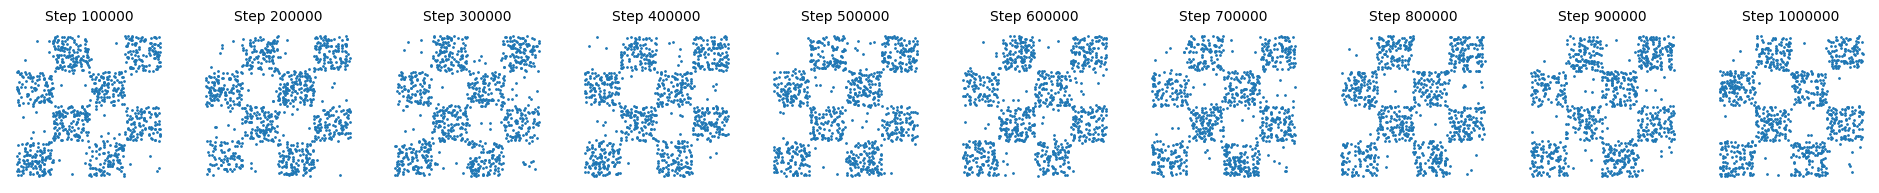

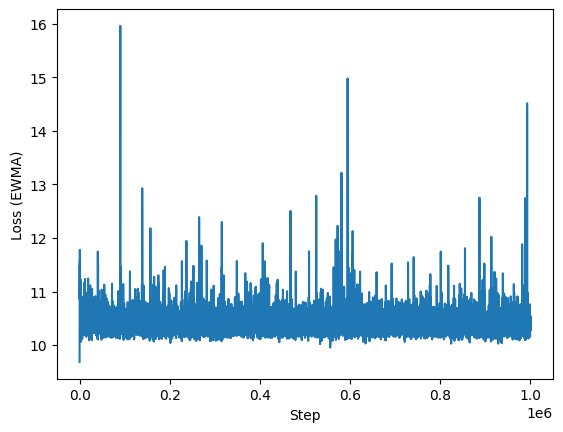

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(24, 2))
fig_idx = 0

losses = []
loss_ewma = None

for step in tqdm(range(train_steps)):
    x = inf_train_gen(n_grid_points=vocab_size, batch_size=batch_size, device=device)
    
    model.train()
    optimizer.zero_grad()
    loss = model(x)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if loss_ewma is None:
        loss_ewma = loss.item()
    else:
        loss_ewma = 0.99 * loss_ewma + 0.01 * loss.item()
    losses.append(loss_ewma)
    
    if (step + 1) % 100 == 0:
        print(f"Step {step + 1}/{train_steps}, Loss (EWMA): {loss_ewma:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
    if (step + 1) % (train_steps // 10) == 0:
        model.eval()
        with torch.no_grad():
            samples = model.sample(num_samples=1000, device=device).cpu().numpy()
        ax[fig_idx].scatter(samples[:, 0], samples[:, 1], s=1)
        ax[fig_idx].set_title(f"Step {step + 1}", fontsize=10)
        ax[fig_idx].axis('off')
        fig_idx += 1
        
plt.show()

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss (EWMA)')
plt.show()

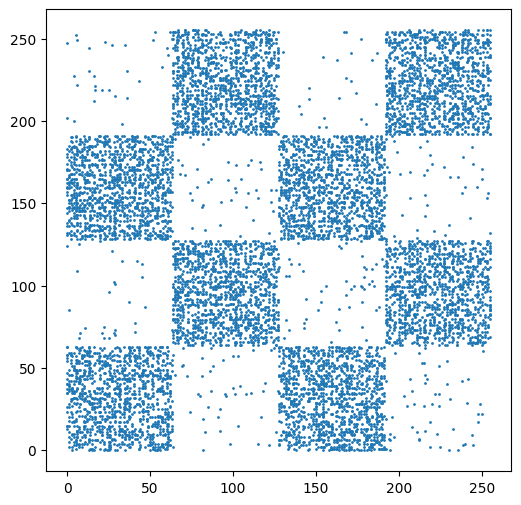

In [6]:
# Visualize model samples
model.eval()
with torch.no_grad():
    samples = model.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

In [7]:
# store model weights
torch.save(model.state_dict(), '../model_weights/udm_checkerboard_256.pth')

Observed this weird quirk while training this model.
Given a point $(x, y)$, if x is between (0, 64), the denoising model gives high probability for y between (0, 64) and (64*2, 64*3), and vice versa when y is between (0, 64).

See below plots.

z_t


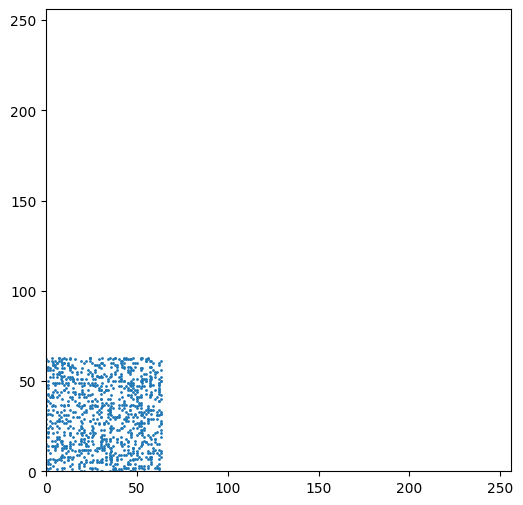

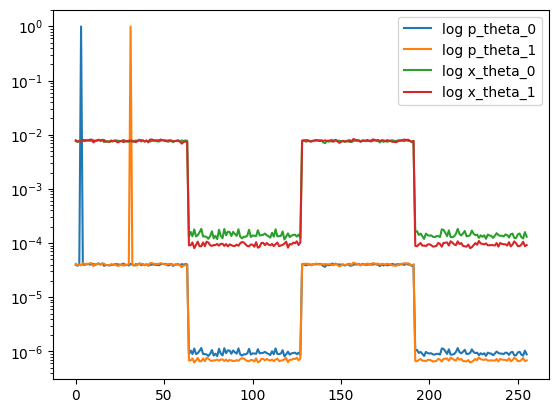

z_s


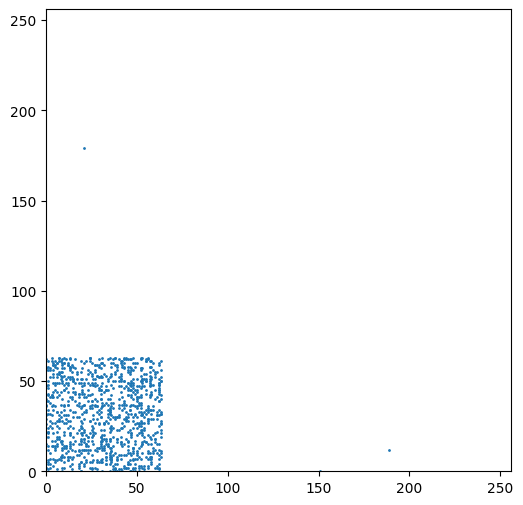

x_0


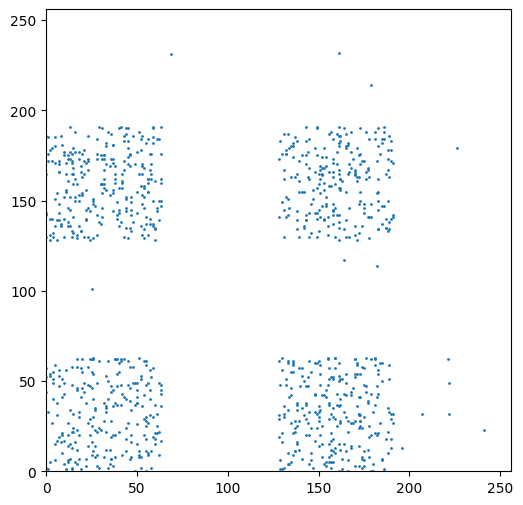

In [8]:
def plot(samples):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[:, 0], samples[:, 1], s=1)
    plt.xlim(0, 256)
    plt.ylim(0, 256)
    plt.show()

points = torch.randint(0, vocab_size//4, (1000, 2)) + torch.tensor([0 * vocab_size//4, 0 * vocab_size//4])
print("z_t")
plot(points)

p_theta, x_theta = model.sample_step(F.one_hot(points, num_classes=num_categories).float().to(device), 2, device=device)
p_theta, x_theta = p_theta.detach().cpu(), x_theta.detach().cpu()

# lets look at the probability distribution of a single point
r = 200
plt.plot(torch.arange(256), p_theta[r, 0, :].cpu(), label="log p_theta_0")
plt.plot(torch.arange(256), p_theta[r, 1, :].cpu(), label="log p_theta_1")
plt.plot(torch.arange(256), x_theta[r, 0, :].cpu(), label="log x_theta_0")
plt.plot(torch.arange(256), x_theta[r, 1, :].cpu(), label="log x_theta_1")
plt.yscale('log')
plt.legend()
plt.show()

print("z_s")
z_s = torch.distributions.Categorical(probs=p_theta).sample().cpu() # Shape: (B, L)
plot(z_s)

print("x_0")
x_0 = torch.distributions.Categorical(probs=x_theta).sample().cpu() # Shape: (B, L)
plot(x_0)

This quirk of the learned denoising model will likely be problematic when using samples from $x \sim x_\theta(z_t)$ to estimate rewards for $z_t$.

My intution is that the model loss is dominated by terms where $\alpha$ is small, since we have weighted sum with weight equal to $\alpha'(t)/\alpha(t)$ of the loss terms.

When, $\alpha(t)$ is low its very likely that either one of the coords (x or y) has changed or both have changed. The previously shown behaviour is the best guess of the model if given one the coords (x or y) has changed without the information whether it is x or y which has changed.

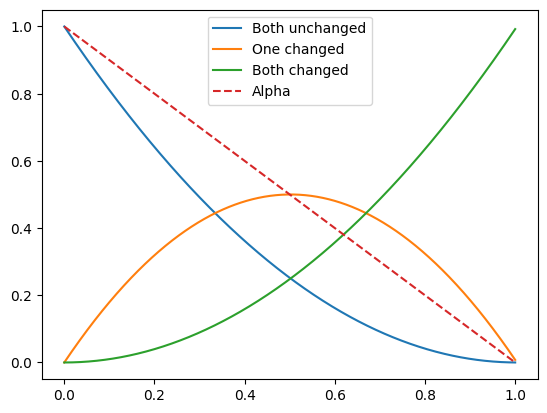

In [9]:
t = torch.linspace(0, 1, 1000)
alpha_t = model.scheduler.alpha(t)
weight = - model.scheduler.alpha_dash(t) / model.scheduler.alpha(t).clamp(min=1e-8)

change_prob = (1 - 1 / num_categories) *  (1 - alpha_t)

both_unchanged = (1 - change_prob) * (1 - change_prob)
one_changed = change_prob * (1 - change_prob) * 2
both_changed = change_prob * change_prob

assert torch.allclose(both_unchanged + one_changed + both_changed, torch.ones_like(t))

plt.plot(t, both_unchanged, label='Both unchanged')
plt.plot(t, one_changed, label='One changed')
plt.plot(t, both_changed, label='Both changed')
plt.plot(t, alpha_t, label='Alpha', linestyle='--')
plt.legend()
plt.show()